In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
from segtok import tokenizer
from utils import *
import hickle

In [2]:
# Key Hyperparameters
enable_orig = "orig"
enable_aug = False
enable_aug3 = False
max_training_samples = 200000
max_tokenized_length = 64
num_sentences = 10
valid_percent = 0.01
sentence_pairs = False

batch_size_finetuning = 32
epochs_finetuning = 1
lr_finetuning = 1e-5

batch_size = 128
epochs = 20
main_model_lr = 1e-5

lstm_hidden_size = 1024
regressive_style_finetuning = False
lstm_bidi = False

experiment_id = f"test"

In [3]:
# Parameters
max_training_samples = 200000
enable_orig = "big"
enable_aug = False
enable_aug3 = False
sentence_pairs = False
regressive_style_finetuning = False
lstm_bidi = False
lstm_hidden_size = 2048
epochs = 20
experiment_id = "classification-sentence-embeddings-max_training_samples-200000-enable_orig-big-enable_aug-False-enable_aug3-False-sentence_pairs-False-regressive_style_finetuning-False-lstm_bidi-False-lstm_hidden_size-2048-epochs-20"


In [4]:
import os
experiment_dir = f"completed-experiments/{experiment_id}"
if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)

In [5]:
from data_parsing import *
data = load_dataset("./yelp_review_training_dataset.jsonl")

In [6]:
from training_utils import split_train_validation
from text_preprocessing import preprocess
import random
from math import ceil

def get_train_valid():
    global data
    if enable_orig == "big" or enable_orig == "big-preprocess":
        data += load_gen_dataset("./yelp_dataset/more_yelp_234.json")
    orig_data_uniform = split_equally(data, ceil(max_training_samples / 0.99))
    orig_train_x, valid_x, orig_train_y, valid_y = split_train_validation(orig_data_uniform, 0.01)
    train_x = []
    train_y = []

    if enable_aug:
        aug_data = load_gen_dataset("./new_data.json") + load_gen_dataset("./new_data2.json")
        train_x += [i[0] for i in aug_data]
        train_y += [i[1] for i in aug_data]

    if enable_aug3:
        aug_data3 = load_gen_dataset("./new_data3.json")
        train_x += [i[0] for i in aug_data3]
        train_y += [i[1] for i in aug_data3]
        
    if enable_orig:
        train_x += orig_train_x
        train_y += orig_train_y
    
    train_x = train_x[:max_training_samples]
    train_y = train_y[:max_training_samples]

    if enable_orig == "preprocess" or enable_orig == "big-preprocess":
        train_x = preprocess(train_x)
        valid_x = preprocess(valid_x)    

    paired_train = list(zip(train_x, train_y))
    random.shuffle(paired_train)
    train_x = [i[0] for i in paired_train]
    train_y = [i[1] for i in paired_train]

    return [x.encode("utf-8") for x in train_x], [x.encode("utf-8") for x in valid_x], train_y, valid_y

split_key = f"cache-core/split-data-{valid_percent}-orig-{enable_orig}-aug12-{enable_aug}-aug3-{enable_aug3}-max-{max_training_samples}"
train_x, valid_x, train_y, valid_y = memo_load(
    get_train_valid,
    split_key
)
split_hash = hash_file(split_key + ".hkl")

train_x = [x.decode("utf-8") for x in train_x]
valid_x = [x.decode("utf-8") for x in valid_x]

print(len(train_x))

199999


In [7]:
print(len(train_x))
print(len(train_y))
print(len(valid_x))
print(len(valid_y))

199999
199999
2021
2021


In [8]:
import torch as th

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(device)

from spacy.lang.en import English
nlp = English()
nlp.add_pipe("sentencizer")

cuda


In [9]:
from transformers import BertTokenizerFast, BertForSequenceClassification
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [10]:
# fine tune the BERT
import numpy as np

def get_finetuning_data():
    train_x_numerized = []
    train_x_mask = []
    train_y_per_sentence = []
    for i, text in tqdm(list(enumerate(train_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            train_x_numerized.append(tokenized.ids)
            train_x_mask.append(tokenized.attention_mask)
            train_y_per_sentence.append(train_y[i])

    valid_x_numerized = []
    valid_x_mask = []
    valid_y_per_sentence = []
    for i, text in tqdm(list(enumerate(valid_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            valid_x_numerized.append(tokenized.ids)
            valid_x_mask.append(tokenized.attention_mask)
            valid_y_per_sentence.append(valid_y[i])

    train_x_numerized = np.array(train_x_numerized)
    train_x_mask = np.array(train_x_mask)
    train_y_per_sentence = np.array(train_y_per_sentence)
    valid_x_numerized = np.array(valid_x_numerized)
    valid_x_mask = np.array(valid_x_mask)
    valid_y_per_sentence = np.array(valid_y_per_sentence)
    return train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence

from utils import memo_load
finetuning_data_key = f"cache-core/training-data-finetuning-max-tokens-{max_tokenized_length}-split-{split_hash}"
if sentence_pairs:
    finetuning_data_key += "-pairs"
(train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence) = memo_load(
    lambda: get_finetuning_data(),
    finetuning_data_key
)
finetuning_data_hash = hash_file(finetuning_data_key + ".hkl")

In [11]:
from model import ReviewPredictionModel
import torch.optim as optim

def train_finetuning():
    if regressive_style_finetuning:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
    else:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)

    model_to_train_finetuning = ReviewPredictionModel(0, max_tokenized_length, regressive_bert_style=regressive_style_finetuning)
    model_to_train_finetuning.transformer = embedding_bert
    model_to_train_finetuning.to(device)
    optimizer = optim.Adam(model_to_train_finetuning.parameters(), lr=lr_finetuning)
    
    training_accuracies_finetuning, validation_accuracies_finetuning = run_training_loop(
        model_to_train_finetuning, optimizer, device,
        batch_size_finetuning, epochs_finetuning,
        train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence,
        max_validation_examples=256,
        model_id=experiment_id, tag="finetuning"
    )
    
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

def store_finetuning(tup, folder):
    embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = tup
    th.save(embedding_bert.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{folder}/accuracies.hkl", mode="w")

def load_finetuning(folder):
    if regressive_style_finetuning:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
    else:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)
    embedding_bert.load_state_dict(th.load(f"{folder}/model.pt"))
    embedding_bert.eval()
    embedding_bert.to(device)
    training_accuracies_finetuning, validation_accuracies_finetuning = hickle.load(f"{folder}/accuracies.hkl")
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

In [12]:
from training_utils import run_training_loop

from utils import memo_load
finetuning_model_key = f"cache-core/finetuning-batch-size-{batch_size_finetuning}-epochs-{epochs_finetuning}-lr-{lr_finetuning}-regressive-{regressive_style_finetuning}-data-{finetuning_data_hash}"
embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = manual_memo(
    train_finetuning, store_finetuning, load_finetuning,
    finetuning_model_key
)

th.save(embedding_bert.state_dict(), f"{experiment_dir}/finetuned-bert.pt")
hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{experiment_dir}/finetuning-accuracies.hkl", mode="w")

finetuning_model_hash = hash_file(finetuning_model_key + "/model.pt")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


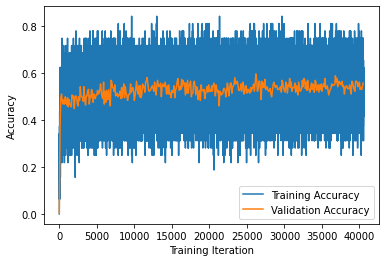

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies_finetuning)), training_accuracies_finetuning, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies_finetuning)))), validation_accuracies_finetuning, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()

In [14]:
import torch as th
import numpy as np

embedding_bert.to(device)

def get_embeds(x_data):
    concatted_shape = None
    pad_value = None
    embeds = []
    for text in tqdm(x_data):
        doc = nlp(text)
        embeddeds = []
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        all_tokenized = []
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            all_tokenized.append(tokenized.ids)
        
        with th.no_grad():
            sentence_tensor = th.tensor(all_tokenized).to(device)
            concatted = np.concatenate([
                # take output corresponding to CLS
                embedding_bert.bert(sentence_tensor, output_hidden_states=True, return_dict=True)[1].cpu().numpy(),
                np.zeros((len(all_tokenized), 1))
            ], axis=1)
            
            if not concatted_shape:
                concatted_shape = concatted.shape
                pad_value = np.zeros(concatted_shape[1])
                pad_value[-1] = 1
            
            embeddeds += list(concatted)

        if len(sents) < num_sentences:
            embeddeds += [pad_value] * (num_sentences - len(sents))

        embeds.append(embeddeds)
    return np.array(embeds)

main_data_key = f"cache-core/training-data-main-max-tokens-{max_tokenized_length}-split-{split_hash}-finetuned-{finetuning_model_hash}"
train_x_embeds, valid_x_embeds = memo_load(
    lambda: (
        get_embeds(train_x),
        get_embeds(valid_x)
    ),
    main_data_key
)
main_data_hash = hash_file(main_data_key + ".hkl")

In [15]:
from model_sentence_lstm import ReviewPredictionModel
import torch as th
import torch.optim as optim

def train_main():
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size, bidi_lstm=lstm_bidi)
    model_to_train.to(device)
    optimizer = optim.Adam(model_to_train.parameters(), lr=main_model_lr)
    
    training_accuracies, validation_accuracies = run_training_loop(
        model_to_train, optimizer, device,
        batch_size, epochs,
        train_x_embeds, None, np.array(train_y), valid_x_embeds, None, np.array(valid_y),
        model_id=experiment_id, max_validation_examples=512
    )
    
    return model_to_train, training_accuracies, validation_accuracies

def store_main(tup, folder):
    model_to_train, training_accuracies, validation_accuracies = tup
    th.save(model_to_train.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies, validation_accuracies), f"{folder}/accuracies.hkl", mode="w")

def load_main(folder):
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size)
    model_to_train.load_state_dict(th.load(f"{folder}/model.pt"))
    model_to_train.eval()
    model_to_train.to(device)
    training_accuracies, validation_accuracies = hickle.load(f"{folder}/accuracies.hkl")
    return model_to_train, training_accuracies, validation_accuracies

In [16]:
from training_utils import run_training_loop

bidi_key = "-bidi" if lstm_bidi else ""
main_model_key = f"cache-core/main-model-lstm-{lstm_hidden_size}{bidi_key}-lr-{main_model_lr}-batch-size-{batch_size}-epochs-{epochs}-data-{main_data_hash}"
main_model, training_accuracies, validation_accuracies = manual_memo(
    train_main, store_main, load_main,
    main_model_key
)

th.save(main_model.state_dict(), f"{experiment_dir}/main-model.pt")
hickle.dump((training_accuracies, validation_accuracies), f"{experiment_dir}/main-accuracies.hkl", mode="w")

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 0 Loss: 2.195 Validation Loss: 2.191 Accuracy: 0.055 Validation Accuracy: 0.078:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 1 Loss: 2.192 Validation Loss: 2.191 Accuracy: 0.082 Validation Accuracy: 0.078:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 2 Loss: 2.188 Validation Loss: 2.191 Accuracy: 0.128 Validation Accuracy: 0.078:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 3 Loss: 2.185 Validation Loss: 2.191 Accuracy: 0.164 Validation Accuracy: 0.078:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 3 Loss: 2.185 Validation Loss: 2.191 Accuracy: 0.164 Validation Accuracy: 0.078:   0%|          | 4/1563 [00:00<00:44, 34.68it/s]

Epoch: 0 Iteration: 4 Loss: 2.182 Validation Loss: 2.191 Accuracy: 0.181 Validation Accuracy: 0.078:   0%|          | 4/1563 [00:00<00:44, 34.68it/s]

Epoch: 0 Iteration: 5 Loss: 2.179 Validation Loss: 2.191 Accuracy: 0.198 Validation Accuracy: 0.078:   0%|          | 4/1563 [00:00<00:44, 34.68it/s]

Epoch: 0 Iteration: 6 Loss: 2.178 Validation Loss: 2.191 Accuracy: 0.205 Validation Accuracy: 0.078:   0%|          | 4/1563 [00:00<00:44, 34.68it/s]

Epoch: 0 Iteration: 7 Loss: 2.175 Validation Loss: 2.191 Accuracy: 0.223 Validation Accuracy: 0.078:   0%|          | 4/1563 [00:00<00:44, 34.68it/s]

Epoch: 0 Iteration: 8 Loss: 2.171 Validation Loss: 2.191 Accuracy: 0.236 Validation Accuracy: 0.078:   0%|          | 4/1563 [00:00<00:44, 34.68it/s]

Epoch: 0 Iteration: 9 Loss: 2.170 Validation Loss: 2.191 Accuracy: 0.238 Validation Accuracy: 0.078:   0%|          | 4/1563 [00:00<00:44, 34.68it/s]

Epoch: 0 Iteration: 9 Loss: 2.170 Validation Loss: 2.191 Accuracy: 0.238 Validation Accuracy: 0.078:   1%|          | 10/1563 [00:00<00:33, 46.07it/s]

Epoch: 0 Iteration: 10 Loss: 2.166 Validation Loss: 2.191 Accuracy: 0.271 Validation Accuracy: 0.078:   1%|          | 10/1563 [00:00<00:33, 46.07it/s]

Epoch: 0 Iteration: 11 Loss: 2.164 Validation Loss: 2.191 Accuracy: 0.294 Validation Accuracy: 0.078:   1%|          | 10/1563 [00:00<00:33, 46.07it/s]

Epoch: 0 Iteration: 12 Loss: 2.162 Validation Loss: 2.191 Accuracy: 0.309 Validation Accuracy: 0.078:   1%|          | 10/1563 [00:00<00:33, 46.07it/s]

Epoch: 0 Iteration: 13 Loss: 2.159 Validation Loss: 2.191 Accuracy: 0.322 Validation Accuracy: 0.078:   1%|          | 10/1563 [00:00<00:33, 46.07it/s]

Epoch: 0 Iteration: 14 Loss: 2.157 Validation Loss: 2.191 Accuracy: 0.337 Validation Accuracy: 0.078:   1%|          | 10/1563 [00:00<00:33, 46.07it/s]

Epoch: 0 Iteration: 15 Loss: 2.154 Validation Loss: 2.191 Accuracy: 0.354 Validation Accuracy: 0.078:   1%|          | 10/1563 [00:00<00:33, 46.07it/s]

Epoch: 0 Iteration: 15 Loss: 2.154 Validation Loss: 2.191 Accuracy: 0.354 Validation Accuracy: 0.078:   1%|          | 16/1563 [00:00<00:30, 51.23it/s]

Epoch: 0 Iteration: 16 Loss: 2.151 Validation Loss: 2.191 Accuracy: 0.376 Validation Accuracy: 0.078:   1%|          | 16/1563 [00:00<00:30, 51.23it/s]

Epoch: 0 Iteration: 17 Loss: 2.148 Validation Loss: 2.191 Accuracy: 0.384 Validation Accuracy: 0.078:   1%|          | 16/1563 [00:00<00:30, 51.23it/s]

Epoch: 0 Iteration: 18 Loss: 2.146 Validation Loss: 2.191 Accuracy: 0.391 Validation Accuracy: 0.078:   1%|          | 16/1563 [00:00<00:30, 51.23it/s]

Epoch: 0 Iteration: 19 Loss: 2.144 Validation Loss: 2.191 Accuracy: 0.413 Validation Accuracy: 0.078:   1%|          | 16/1563 [00:00<00:30, 51.23it/s]

Epoch: 0 Iteration: 20 Loss: 2.138 Validation Loss: 2.191 Accuracy: 0.426 Validation Accuracy: 0.078:   1%|          | 16/1563 [00:00<00:30, 51.23it/s]

Epoch: 0 Iteration: 21 Loss: 2.133 Validation Loss: 2.191 Accuracy: 0.430 Validation Accuracy: 0.078:   1%|          | 16/1563 [00:00<00:30, 51.23it/s]

Epoch: 0 Iteration: 21 Loss: 2.133 Validation Loss: 2.191 Accuracy: 0.430 Validation Accuracy: 0.078:   1%|▏         | 22/1563 [00:00<00:28, 53.69it/s]

Epoch: 0 Iteration: 22 Loss: 2.129 Validation Loss: 2.191 Accuracy: 0.433 Validation Accuracy: 0.078:   1%|▏         | 22/1563 [00:00<00:28, 53.69it/s]

Epoch: 0 Iteration: 23 Loss: 2.124 Validation Loss: 2.191 Accuracy: 0.438 Validation Accuracy: 0.078:   1%|▏         | 22/1563 [00:00<00:28, 53.69it/s]

Epoch: 0 Iteration: 24 Loss: 2.119 Validation Loss: 2.191 Accuracy: 0.447 Validation Accuracy: 0.078:   1%|▏         | 22/1563 [00:00<00:28, 53.69it/s]

Epoch: 0 Iteration: 25 Loss: 2.113 Validation Loss: 2.191 Accuracy: 0.442 Validation Accuracy: 0.078:   1%|▏         | 22/1563 [00:00<00:28, 53.69it/s]

Epoch: 0 Iteration: 26 Loss: 2.107 Validation Loss: 2.191 Accuracy: 0.449 Validation Accuracy: 0.078:   1%|▏         | 22/1563 [00:00<00:28, 53.69it/s]

Epoch: 0 Iteration: 27 Loss: 2.103 Validation Loss: 2.191 Accuracy: 0.445 Validation Accuracy: 0.078:   1%|▏         | 22/1563 [00:00<00:28, 53.69it/s]

Epoch: 0 Iteration: 27 Loss: 2.103 Validation Loss: 2.191 Accuracy: 0.445 Validation Accuracy: 0.078:   2%|▏         | 28/1563 [00:00<00:27, 55.12it/s]

Epoch: 0 Iteration: 28 Loss: 2.098 Validation Loss: 2.191 Accuracy: 0.442 Validation Accuracy: 0.078:   2%|▏         | 28/1563 [00:00<00:27, 55.12it/s]

Epoch: 0 Iteration: 29 Loss: 2.093 Validation Loss: 2.191 Accuracy: 0.434 Validation Accuracy: 0.078:   2%|▏         | 28/1563 [00:00<00:27, 55.12it/s]

Epoch: 0 Iteration: 30 Loss: 2.088 Validation Loss: 2.191 Accuracy: 0.434 Validation Accuracy: 0.078:   2%|▏         | 28/1563 [00:00<00:27, 55.12it/s]

Epoch: 0 Iteration: 31 Loss: 2.083 Validation Loss: 2.191 Accuracy: 0.442 Validation Accuracy: 0.078:   2%|▏         | 28/1563 [00:00<00:27, 55.12it/s]

Epoch: 0 Iteration: 32 Loss: 2.078 Validation Loss: 2.191 Accuracy: 0.448 Validation Accuracy: 0.078:   2%|▏         | 28/1563 [00:00<00:27, 55.12it/s]

Epoch: 0 Iteration: 33 Loss: 2.072 Validation Loss: 2.191 Accuracy: 0.446 Validation Accuracy: 0.078:   2%|▏         | 28/1563 [00:00<00:27, 55.12it/s]

Epoch: 0 Iteration: 33 Loss: 2.072 Validation Loss: 2.191 Accuracy: 0.446 Validation Accuracy: 0.078:   2%|▏         | 34/1563 [00:00<00:27, 55.93it/s]

Epoch: 0 Iteration: 34 Loss: 2.067 Validation Loss: 2.191 Accuracy: 0.447 Validation Accuracy: 0.078:   2%|▏         | 34/1563 [00:00<00:27, 55.93it/s]

Epoch: 0 Iteration: 35 Loss: 2.063 Validation Loss: 2.191 Accuracy: 0.452 Validation Accuracy: 0.078:   2%|▏         | 34/1563 [00:00<00:27, 55.93it/s]

Epoch: 0 Iteration: 36 Loss: 2.058 Validation Loss: 2.191 Accuracy: 0.445 Validation Accuracy: 0.078:   2%|▏         | 34/1563 [00:00<00:27, 55.93it/s]

Epoch: 0 Iteration: 37 Loss: 2.052 Validation Loss: 2.191 Accuracy: 0.459 Validation Accuracy: 0.078:   2%|▏         | 34/1563 [00:00<00:27, 55.93it/s]

Epoch: 0 Iteration: 38 Loss: 2.046 Validation Loss: 2.191 Accuracy: 0.472 Validation Accuracy: 0.078:   2%|▏         | 34/1563 [00:00<00:27, 55.93it/s]

Epoch: 0 Iteration: 39 Loss: 2.041 Validation Loss: 2.191 Accuracy: 0.480 Validation Accuracy: 0.078:   2%|▏         | 34/1563 [00:00<00:27, 55.93it/s]

Epoch: 0 Iteration: 39 Loss: 2.041 Validation Loss: 2.191 Accuracy: 0.480 Validation Accuracy: 0.078:   3%|▎         | 40/1563 [00:00<00:26, 56.53it/s]

Epoch: 0 Iteration: 40 Loss: 2.036 Validation Loss: 2.191 Accuracy: 0.485 Validation Accuracy: 0.078:   3%|▎         | 40/1563 [00:00<00:26, 56.53it/s]

Epoch: 0 Iteration: 41 Loss: 2.029 Validation Loss: 2.191 Accuracy: 0.487 Validation Accuracy: 0.078:   3%|▎         | 40/1563 [00:00<00:26, 56.53it/s]

Epoch: 0 Iteration: 42 Loss: 2.023 Validation Loss: 2.191 Accuracy: 0.488 Validation Accuracy: 0.078:   3%|▎         | 40/1563 [00:00<00:26, 56.53it/s]

Epoch: 0 Iteration: 43 Loss: 2.016 Validation Loss: 2.191 Accuracy: 0.496 Validation Accuracy: 0.078:   3%|▎         | 40/1563 [00:00<00:26, 56.53it/s]

Epoch: 0 Iteration: 44 Loss: 2.009 Validation Loss: 2.191 Accuracy: 0.502 Validation Accuracy: 0.078:   3%|▎         | 40/1563 [00:00<00:26, 56.53it/s]

Epoch: 0 Iteration: 45 Loss: 2.002 Validation Loss: 2.191 Accuracy: 0.499 Validation Accuracy: 0.078:   3%|▎         | 40/1563 [00:00<00:26, 56.53it/s]

Epoch: 0 Iteration: 45 Loss: 2.002 Validation Loss: 2.191 Accuracy: 0.499 Validation Accuracy: 0.078:   3%|▎         | 46/1563 [00:00<00:26, 56.88it/s]

Epoch: 0 Iteration: 46 Loss: 1.997 Validation Loss: 2.191 Accuracy: 0.503 Validation Accuracy: 0.078:   3%|▎         | 46/1563 [00:00<00:26, 56.88it/s]

Epoch: 0 Iteration: 47 Loss: 1.989 Validation Loss: 2.191 Accuracy: 0.504 Validation Accuracy: 0.078:   3%|▎         | 46/1563 [00:00<00:26, 56.88it/s]

Epoch: 0 Iteration: 48 Loss: 1.980 Validation Loss: 2.191 Accuracy: 0.508 Validation Accuracy: 0.078:   3%|▎         | 46/1563 [00:00<00:26, 56.88it/s]

Epoch: 0 Iteration: 49 Loss: 1.972 Validation Loss: 2.191 Accuracy: 0.509 Validation Accuracy: 0.078:   3%|▎         | 46/1563 [00:00<00:26, 56.88it/s]

Epoch: 0 Iteration: 50 Loss: 1.965 Validation Loss: 2.191 Accuracy: 0.499 Validation Accuracy: 0.078:   3%|▎         | 46/1563 [00:00<00:26, 56.88it/s]

Epoch: 0 Iteration: 51 Loss: 1.956 Validation Loss: 2.191 Accuracy: 0.513 Validation Accuracy: 0.078:   3%|▎         | 46/1563 [00:00<00:26, 56.88it/s]

Epoch: 0 Iteration: 51 Loss: 1.956 Validation Loss: 2.191 Accuracy: 0.513 Validation Accuracy: 0.078:   3%|▎         | 52/1563 [00:00<00:26, 57.20it/s]

Epoch: 0 Iteration: 52 Loss: 1.948 Validation Loss: 2.191 Accuracy: 0.514 Validation Accuracy: 0.078:   3%|▎         | 52/1563 [00:00<00:26, 57.20it/s]

Epoch: 0 Iteration: 53 Loss: 1.939 Validation Loss: 2.191 Accuracy: 0.503 Validation Accuracy: 0.078:   3%|▎         | 52/1563 [00:00<00:26, 57.20it/s]

Epoch: 0 Iteration: 54 Loss: 1.930 Validation Loss: 2.191 Accuracy: 0.511 Validation Accuracy: 0.078:   3%|▎         | 52/1563 [00:01<00:26, 57.20it/s]

Epoch: 0 Iteration: 55 Loss: 1.919 Validation Loss: 2.191 Accuracy: 0.520 Validation Accuracy: 0.078:   3%|▎         | 52/1563 [00:01<00:26, 57.20it/s]

Epoch: 0 Iteration: 56 Loss: 1.912 Validation Loss: 2.191 Accuracy: 0.520 Validation Accuracy: 0.078:   3%|▎         | 52/1563 [00:01<00:26, 57.20it/s]

Epoch: 0 Iteration: 57 Loss: 1.900 Validation Loss: 2.191 Accuracy: 0.523 Validation Accuracy: 0.078:   3%|▎         | 52/1563 [00:01<00:26, 57.20it/s]

Epoch: 0 Iteration: 57 Loss: 1.900 Validation Loss: 2.191 Accuracy: 0.523 Validation Accuracy: 0.078:   4%|▎         | 58/1563 [00:01<00:26, 57.34it/s]

Epoch: 0 Iteration: 58 Loss: 1.889 Validation Loss: 2.191 Accuracy: 0.526 Validation Accuracy: 0.078:   4%|▎         | 58/1563 [00:01<00:26, 57.34it/s]

Epoch: 0 Iteration: 59 Loss: 1.880 Validation Loss: 2.191 Accuracy: 0.527 Validation Accuracy: 0.078:   4%|▎         | 58/1563 [00:01<00:26, 57.34it/s]

Epoch: 0 Iteration: 60 Loss: 1.870 Validation Loss: 2.191 Accuracy: 0.537 Validation Accuracy: 0.078:   4%|▎         | 58/1563 [00:01<00:26, 57.34it/s]

Epoch: 0 Iteration: 61 Loss: 1.857 Validation Loss: 2.191 Accuracy: 0.527 Validation Accuracy: 0.078:   4%|▎         | 58/1563 [00:01<00:26, 57.34it/s]

Epoch: 0 Iteration: 62 Loss: 1.842 Validation Loss: 2.191 Accuracy: 0.535 Validation Accuracy: 0.078:   4%|▎         | 58/1563 [00:01<00:26, 57.34it/s]

Epoch: 0 Iteration: 63 Loss: 1.830 Validation Loss: 2.191 Accuracy: 0.552 Validation Accuracy: 0.078:   4%|▎         | 58/1563 [00:01<00:26, 57.34it/s]

Epoch: 0 Iteration: 63 Loss: 1.830 Validation Loss: 2.191 Accuracy: 0.552 Validation Accuracy: 0.078:   4%|▍         | 64/1563 [00:01<00:26, 57.42it/s]

Epoch: 0 Iteration: 64 Loss: 1.815 Validation Loss: 2.191 Accuracy: 0.555 Validation Accuracy: 0.078:   4%|▍         | 64/1563 [00:01<00:26, 57.42it/s]

Epoch: 0 Iteration: 65 Loss: 1.802 Validation Loss: 2.191 Accuracy: 0.553 Validation Accuracy: 0.078:   4%|▍         | 64/1563 [00:01<00:26, 57.42it/s]

Epoch: 0 Iteration: 66 Loss: 1.791 Validation Loss: 2.191 Accuracy: 0.561 Validation Accuracy: 0.078:   4%|▍         | 64/1563 [00:01<00:26, 57.42it/s]

Epoch: 0 Iteration: 67 Loss: 1.776 Validation Loss: 2.191 Accuracy: 0.566 Validation Accuracy: 0.078:   4%|▍         | 64/1563 [00:01<00:26, 57.42it/s]

Epoch: 0 Iteration: 68 Loss: 1.760 Validation Loss: 2.191 Accuracy: 0.563 Validation Accuracy: 0.078:   4%|▍         | 64/1563 [00:01<00:26, 57.42it/s]

Epoch: 0 Iteration: 69 Loss: 1.744 Validation Loss: 2.191 Accuracy: 0.574 Validation Accuracy: 0.078:   4%|▍         | 64/1563 [00:01<00:26, 57.42it/s]

Epoch: 0 Iteration: 69 Loss: 1.744 Validation Loss: 2.191 Accuracy: 0.574 Validation Accuracy: 0.078:   4%|▍         | 70/1563 [00:01<00:26, 56.69it/s]

Epoch: 0 Iteration: 70 Loss: 1.728 Validation Loss: 2.191 Accuracy: 0.577 Validation Accuracy: 0.078:   4%|▍         | 70/1563 [00:01<00:26, 56.69it/s]

Epoch: 0 Iteration: 71 Loss: 1.715 Validation Loss: 2.191 Accuracy: 0.588 Validation Accuracy: 0.078:   4%|▍         | 70/1563 [00:01<00:26, 56.69it/s]

Epoch: 0 Iteration: 72 Loss: 1.702 Validation Loss: 2.191 Accuracy: 0.581 Validation Accuracy: 0.078:   4%|▍         | 70/1563 [00:01<00:26, 56.69it/s]

Epoch: 0 Iteration: 73 Loss: 1.684 Validation Loss: 2.191 Accuracy: 0.582 Validation Accuracy: 0.078:   4%|▍         | 70/1563 [00:01<00:26, 56.69it/s]

Epoch: 0 Iteration: 74 Loss: 1.667 Validation Loss: 2.191 Accuracy: 0.580 Validation Accuracy: 0.078:   4%|▍         | 70/1563 [00:01<00:26, 56.69it/s]

Epoch: 0 Iteration: 75 Loss: 1.648 Validation Loss: 2.191 Accuracy: 0.594 Validation Accuracy: 0.078:   4%|▍         | 70/1563 [00:01<00:26, 56.69it/s]

Epoch: 0 Iteration: 75 Loss: 1.648 Validation Loss: 2.191 Accuracy: 0.594 Validation Accuracy: 0.078:   5%|▍         | 76/1563 [00:01<00:26, 57.06it/s]

Epoch: 0 Iteration: 76 Loss: 1.629 Validation Loss: 2.191 Accuracy: 0.589 Validation Accuracy: 0.078:   5%|▍         | 76/1563 [00:01<00:26, 57.06it/s]

Epoch: 0 Iteration: 77 Loss: 1.613 Validation Loss: 2.191 Accuracy: 0.585 Validation Accuracy: 0.078:   5%|▍         | 76/1563 [00:01<00:26, 57.06it/s]

Epoch: 0 Iteration: 78 Loss: 1.594 Validation Loss: 2.191 Accuracy: 0.584 Validation Accuracy: 0.078:   5%|▍         | 76/1563 [00:01<00:26, 57.06it/s]

Epoch: 0 Iteration: 79 Loss: 1.571 Validation Loss: 2.191 Accuracy: 0.584 Validation Accuracy: 0.078:   5%|▍         | 76/1563 [00:01<00:26, 57.06it/s]

Epoch: 0 Iteration: 80 Loss: 1.551 Validation Loss: 2.191 Accuracy: 0.585 Validation Accuracy: 0.078:   5%|▍         | 76/1563 [00:01<00:26, 57.06it/s]

Epoch: 0 Iteration: 81 Loss: 1.530 Validation Loss: 2.191 Accuracy: 0.588 Validation Accuracy: 0.078:   5%|▍         | 76/1563 [00:01<00:26, 57.06it/s]

Epoch: 0 Iteration: 81 Loss: 1.530 Validation Loss: 2.191 Accuracy: 0.588 Validation Accuracy: 0.078:   5%|▌         | 82/1563 [00:01<00:25, 57.27it/s]

Epoch: 0 Iteration: 82 Loss: 1.510 Validation Loss: 2.191 Accuracy: 0.606 Validation Accuracy: 0.078:   5%|▌         | 82/1563 [00:01<00:25, 57.27it/s]

Epoch: 0 Iteration: 83 Loss: 1.495 Validation Loss: 2.191 Accuracy: 0.603 Validation Accuracy: 0.078:   5%|▌         | 82/1563 [00:01<00:25, 57.27it/s]

Epoch: 0 Iteration: 84 Loss: 1.479 Validation Loss: 2.191 Accuracy: 0.603 Validation Accuracy: 0.078:   5%|▌         | 82/1563 [00:01<00:25, 57.27it/s]

Epoch: 0 Iteration: 85 Loss: 1.460 Validation Loss: 2.191 Accuracy: 0.604 Validation Accuracy: 0.078:   5%|▌         | 82/1563 [00:01<00:25, 57.27it/s]

Epoch: 0 Iteration: 86 Loss: 1.439 Validation Loss: 2.191 Accuracy: 0.613 Validation Accuracy: 0.078:   5%|▌         | 82/1563 [00:01<00:25, 57.27it/s]

Epoch: 0 Iteration: 87 Loss: 1.417 Validation Loss: 2.191 Accuracy: 0.626 Validation Accuracy: 0.078:   5%|▌         | 82/1563 [00:01<00:25, 57.27it/s]

Epoch: 0 Iteration: 87 Loss: 1.417 Validation Loss: 2.191 Accuracy: 0.626 Validation Accuracy: 0.078:   6%|▌         | 88/1563 [00:01<00:25, 57.38it/s]

Epoch: 0 Iteration: 88 Loss: 1.399 Validation Loss: 2.191 Accuracy: 0.634 Validation Accuracy: 0.078:   6%|▌         | 88/1563 [00:01<00:25, 57.38it/s]

Epoch: 0 Iteration: 89 Loss: 1.385 Validation Loss: 2.191 Accuracy: 0.641 Validation Accuracy: 0.078:   6%|▌         | 88/1563 [00:01<00:25, 57.38it/s]

Epoch: 0 Iteration: 90 Loss: 1.363 Validation Loss: 2.191 Accuracy: 0.650 Validation Accuracy: 0.078:   6%|▌         | 88/1563 [00:01<00:25, 57.38it/s]

Epoch: 0 Iteration: 91 Loss: 1.337 Validation Loss: 2.191 Accuracy: 0.652 Validation Accuracy: 0.078:   6%|▌         | 88/1563 [00:01<00:25, 57.38it/s]

Epoch: 0 Iteration: 92 Loss: 1.308 Validation Loss: 2.191 Accuracy: 0.657 Validation Accuracy: 0.078:   6%|▌         | 88/1563 [00:01<00:25, 57.38it/s]

Epoch: 0 Iteration: 93 Loss: 1.285 Validation Loss: 2.191 Accuracy: 0.677 Validation Accuracy: 0.078:   6%|▌         | 88/1563 [00:01<00:25, 57.38it/s]

Epoch: 0 Iteration: 93 Loss: 1.285 Validation Loss: 2.191 Accuracy: 0.677 Validation Accuracy: 0.078:   6%|▌         | 94/1563 [00:01<00:25, 57.53it/s]

Epoch: 0 Iteration: 94 Loss: 1.263 Validation Loss: 2.191 Accuracy: 0.680 Validation Accuracy: 0.078:   6%|▌         | 94/1563 [00:01<00:25, 57.53it/s]

Epoch: 0 Iteration: 95 Loss: 1.245 Validation Loss: 2.191 Accuracy: 0.680 Validation Accuracy: 0.078:   6%|▌         | 94/1563 [00:01<00:25, 57.53it/s]

Epoch: 0 Iteration: 96 Loss: 1.229 Validation Loss: 2.191 Accuracy: 0.680 Validation Accuracy: 0.078:   6%|▌         | 94/1563 [00:01<00:25, 57.53it/s]

Epoch: 0 Iteration: 97 Loss: 1.210 Validation Loss: 2.191 Accuracy: 0.677 Validation Accuracy: 0.078:   6%|▌         | 94/1563 [00:01<00:25, 57.53it/s]

Epoch: 0 Iteration: 98 Loss: 1.187 Validation Loss: 2.191 Accuracy: 0.677 Validation Accuracy: 0.078:   6%|▌         | 94/1563 [00:01<00:25, 57.53it/s]

Epoch: 0 Iteration: 99 Loss: 1.167 Validation Loss: 2.191 Accuracy: 0.678 Validation Accuracy: 0.078:   6%|▌         | 94/1563 [00:01<00:25, 57.53it/s]

Epoch: 0 Iteration: 99 Loss: 1.167 Validation Loss: 2.191 Accuracy: 0.678 Validation Accuracy: 0.078:   6%|▋         | 100/1563 [00:01<00:25, 57.58it/s]

Epoch: 0 Iteration: 100 Loss: 1.146 Validation Loss: 0.979 Accuracy: 0.673 Validation Accuracy: 0.372:   6%|▋         | 100/1563 [00:01<00:25, 57.58it/s]

Epoch: 0 Iteration: 101 Loss: 1.125 Validation Loss: 0.979 Accuracy: 0.677 Validation Accuracy: 0.372:   6%|▋         | 100/1563 [00:01<00:25, 57.58it/s]

Epoch: 0 Iteration: 102 Loss: 1.104 Validation Loss: 0.979 Accuracy: 0.670 Validation Accuracy: 0.372:   6%|▋         | 100/1563 [00:01<00:25, 57.58it/s]

Epoch: 0 Iteration: 103 Loss: 1.083 Validation Loss: 0.979 Accuracy: 0.652 Validation Accuracy: 0.372:   6%|▋         | 100/1563 [00:01<00:25, 57.58it/s]

Epoch: 0 Iteration: 104 Loss: 1.065 Validation Loss: 0.979 Accuracy: 0.651 Validation Accuracy: 0.372:   6%|▋         | 100/1563 [00:01<00:25, 57.58it/s]

Epoch: 0 Iteration: 105 Loss: 1.048 Validation Loss: 0.979 Accuracy: 0.651 Validation Accuracy: 0.372:   6%|▋         | 100/1563 [00:01<00:25, 57.58it/s]

Epoch: 0 Iteration: 105 Loss: 1.048 Validation Loss: 0.979 Accuracy: 0.651 Validation Accuracy: 0.372:   7%|▋         | 106/1563 [00:01<00:27, 52.06it/s]

Epoch: 0 Iteration: 106 Loss: 1.027 Validation Loss: 0.979 Accuracy: 0.655 Validation Accuracy: 0.372:   7%|▋         | 106/1563 [00:01<00:27, 52.06it/s]

Epoch: 0 Iteration: 107 Loss: 1.006 Validation Loss: 0.979 Accuracy: 0.663 Validation Accuracy: 0.372:   7%|▋         | 106/1563 [00:01<00:27, 52.06it/s]

Epoch: 0 Iteration: 108 Loss: 0.987 Validation Loss: 0.979 Accuracy: 0.671 Validation Accuracy: 0.372:   7%|▋         | 106/1563 [00:01<00:27, 52.06it/s]

Epoch: 0 Iteration: 109 Loss: 0.963 Validation Loss: 0.979 Accuracy: 0.677 Validation Accuracy: 0.372:   7%|▋         | 106/1563 [00:01<00:27, 52.06it/s]

Epoch: 0 Iteration: 110 Loss: 0.948 Validation Loss: 0.979 Accuracy: 0.683 Validation Accuracy: 0.372:   7%|▋         | 106/1563 [00:02<00:27, 52.06it/s]

Epoch: 0 Iteration: 111 Loss: 0.938 Validation Loss: 0.979 Accuracy: 0.678 Validation Accuracy: 0.372:   7%|▋         | 106/1563 [00:02<00:27, 52.06it/s]

Epoch: 0 Iteration: 111 Loss: 0.938 Validation Loss: 0.979 Accuracy: 0.678 Validation Accuracy: 0.372:   7%|▋         | 112/1563 [00:02<00:27, 53.60it/s]

Epoch: 0 Iteration: 112 Loss: 0.932 Validation Loss: 0.979 Accuracy: 0.672 Validation Accuracy: 0.372:   7%|▋         | 112/1563 [00:02<00:27, 53.60it/s]

Epoch: 0 Iteration: 113 Loss: 0.922 Validation Loss: 0.979 Accuracy: 0.678 Validation Accuracy: 0.372:   7%|▋         | 112/1563 [00:02<00:27, 53.60it/s]

Epoch: 0 Iteration: 114 Loss: 0.916 Validation Loss: 0.979 Accuracy: 0.678 Validation Accuracy: 0.372:   7%|▋         | 112/1563 [00:02<00:27, 53.60it/s]

Epoch: 0 Iteration: 115 Loss: 0.903 Validation Loss: 0.979 Accuracy: 0.679 Validation Accuracy: 0.372:   7%|▋         | 112/1563 [00:02<00:27, 53.60it/s]

Epoch: 0 Iteration: 116 Loss: 0.883 Validation Loss: 0.979 Accuracy: 0.682 Validation Accuracy: 0.372:   7%|▋         | 112/1563 [00:02<00:27, 53.60it/s]

Epoch: 0 Iteration: 117 Loss: 0.870 Validation Loss: 0.979 Accuracy: 0.679 Validation Accuracy: 0.372:   7%|▋         | 112/1563 [00:02<00:27, 53.60it/s]

Epoch: 0 Iteration: 117 Loss: 0.870 Validation Loss: 0.979 Accuracy: 0.679 Validation Accuracy: 0.372:   8%|▊         | 118/1563 [00:02<00:26, 54.69it/s]

Epoch: 0 Iteration: 118 Loss: 0.858 Validation Loss: 0.979 Accuracy: 0.682 Validation Accuracy: 0.372:   8%|▊         | 118/1563 [00:02<00:26, 54.69it/s]

Epoch: 0 Iteration: 119 Loss: 0.849 Validation Loss: 0.979 Accuracy: 0.679 Validation Accuracy: 0.372:   8%|▊         | 118/1563 [00:02<00:26, 54.69it/s]

Epoch: 0 Iteration: 120 Loss: 0.845 Validation Loss: 0.979 Accuracy: 0.675 Validation Accuracy: 0.372:   8%|▊         | 118/1563 [00:02<00:26, 54.69it/s]

Epoch: 0 Iteration: 121 Loss: 0.846 Validation Loss: 0.979 Accuracy: 0.668 Validation Accuracy: 0.372:   8%|▊         | 118/1563 [00:02<00:26, 54.69it/s]

Epoch: 0 Iteration: 122 Loss: 0.841 Validation Loss: 0.979 Accuracy: 0.680 Validation Accuracy: 0.372:   8%|▊         | 118/1563 [00:02<00:26, 54.69it/s]

Epoch: 0 Iteration: 123 Loss: 0.832 Validation Loss: 0.979 Accuracy: 0.687 Validation Accuracy: 0.372:   8%|▊         | 118/1563 [00:02<00:26, 54.69it/s]

Epoch: 0 Iteration: 123 Loss: 0.832 Validation Loss: 0.979 Accuracy: 0.687 Validation Accuracy: 0.372:   8%|▊         | 124/1563 [00:02<00:25, 55.41it/s]

Epoch: 0 Iteration: 124 Loss: 0.824 Validation Loss: 0.979 Accuracy: 0.688 Validation Accuracy: 0.372:   8%|▊         | 124/1563 [00:02<00:25, 55.41it/s]

Epoch: 0 Iteration: 125 Loss: 0.813 Validation Loss: 0.979 Accuracy: 0.691 Validation Accuracy: 0.372:   8%|▊         | 124/1563 [00:02<00:25, 55.41it/s]

Epoch: 0 Iteration: 126 Loss: 0.813 Validation Loss: 0.979 Accuracy: 0.685 Validation Accuracy: 0.372:   8%|▊         | 124/1563 [00:02<00:25, 55.41it/s]

Epoch: 0 Iteration: 127 Loss: 0.817 Validation Loss: 0.979 Accuracy: 0.679 Validation Accuracy: 0.372:   8%|▊         | 124/1563 [00:02<00:25, 55.41it/s]

Epoch: 0 Iteration: 128 Loss: 0.813 Validation Loss: 0.979 Accuracy: 0.673 Validation Accuracy: 0.372:   8%|▊         | 124/1563 [00:02<00:25, 55.41it/s]

Epoch: 0 Iteration: 129 Loss: 0.814 Validation Loss: 0.979 Accuracy: 0.670 Validation Accuracy: 0.372:   8%|▊         | 124/1563 [00:02<00:25, 55.41it/s]

Epoch: 0 Iteration: 129 Loss: 0.814 Validation Loss: 0.979 Accuracy: 0.670 Validation Accuracy: 0.372:   8%|▊         | 130/1563 [00:02<00:25, 56.03it/s]

Epoch: 0 Iteration: 130 Loss: 0.813 Validation Loss: 0.979 Accuracy: 0.666 Validation Accuracy: 0.372:   8%|▊         | 130/1563 [00:02<00:25, 56.03it/s]

Epoch: 0 Iteration: 131 Loss: 0.806 Validation Loss: 0.979 Accuracy: 0.682 Validation Accuracy: 0.372:   8%|▊         | 130/1563 [00:02<00:25, 56.03it/s]

Epoch: 0 Iteration: 132 Loss: 0.795 Validation Loss: 0.979 Accuracy: 0.683 Validation Accuracy: 0.372:   8%|▊         | 130/1563 [00:02<00:25, 56.03it/s]

Epoch: 0 Iteration: 133 Loss: 0.788 Validation Loss: 0.979 Accuracy: 0.688 Validation Accuracy: 0.372:   8%|▊         | 130/1563 [00:02<00:25, 56.03it/s]

Epoch: 0 Iteration: 134 Loss: 0.776 Validation Loss: 0.979 Accuracy: 0.699 Validation Accuracy: 0.372:   8%|▊         | 130/1563 [00:02<00:25, 56.03it/s]

Epoch: 0 Iteration: 135 Loss: 0.768 Validation Loss: 0.979 Accuracy: 0.710 Validation Accuracy: 0.372:   8%|▊         | 130/1563 [00:02<00:25, 56.03it/s]

Epoch: 0 Iteration: 135 Loss: 0.768 Validation Loss: 0.979 Accuracy: 0.710 Validation Accuracy: 0.372:   9%|▊         | 136/1563 [00:02<00:25, 56.40it/s]

Epoch: 0 Iteration: 136 Loss: 0.765 Validation Loss: 0.979 Accuracy: 0.718 Validation Accuracy: 0.372:   9%|▊         | 136/1563 [00:02<00:25, 56.40it/s]

Epoch: 0 Iteration: 137 Loss: 0.758 Validation Loss: 0.979 Accuracy: 0.723 Validation Accuracy: 0.372:   9%|▊         | 136/1563 [00:02<00:25, 56.40it/s]

Epoch: 0 Iteration: 138 Loss: 0.755 Validation Loss: 0.979 Accuracy: 0.729 Validation Accuracy: 0.372:   9%|▊         | 136/1563 [00:02<00:25, 56.40it/s]

Epoch: 0 Iteration: 139 Loss: 0.754 Validation Loss: 0.979 Accuracy: 0.728 Validation Accuracy: 0.372:   9%|▊         | 136/1563 [00:02<00:25, 56.40it/s]

Epoch: 0 Iteration: 140 Loss: 0.746 Validation Loss: 0.979 Accuracy: 0.736 Validation Accuracy: 0.372:   9%|▊         | 136/1563 [00:02<00:25, 56.40it/s]

Epoch: 0 Iteration: 141 Loss: 0.739 Validation Loss: 0.979 Accuracy: 0.730 Validation Accuracy: 0.372:   9%|▊         | 136/1563 [00:02<00:25, 56.40it/s]

Epoch: 0 Iteration: 141 Loss: 0.739 Validation Loss: 0.979 Accuracy: 0.730 Validation Accuracy: 0.372:   9%|▉         | 142/1563 [00:02<00:25, 56.70it/s]

Epoch: 0 Iteration: 142 Loss: 0.734 Validation Loss: 0.979 Accuracy: 0.734 Validation Accuracy: 0.372:   9%|▉         | 142/1563 [00:02<00:25, 56.70it/s]

Epoch: 0 Iteration: 143 Loss: 0.730 Validation Loss: 0.979 Accuracy: 0.731 Validation Accuracy: 0.372:   9%|▉         | 142/1563 [00:02<00:25, 56.70it/s]

Epoch: 0 Iteration: 144 Loss: 0.729 Validation Loss: 0.979 Accuracy: 0.723 Validation Accuracy: 0.372:   9%|▉         | 142/1563 [00:02<00:25, 56.70it/s]

Epoch: 0 Iteration: 145 Loss: 0.729 Validation Loss: 0.979 Accuracy: 0.713 Validation Accuracy: 0.372:   9%|▉         | 142/1563 [00:02<00:25, 56.70it/s]

Epoch: 0 Iteration: 146 Loss: 0.716 Validation Loss: 0.979 Accuracy: 0.716 Validation Accuracy: 0.372:   9%|▉         | 142/1563 [00:02<00:25, 56.70it/s]

Epoch: 0 Iteration: 147 Loss: 0.710 Validation Loss: 0.979 Accuracy: 0.715 Validation Accuracy: 0.372:   9%|▉         | 142/1563 [00:02<00:25, 56.70it/s]

Epoch: 0 Iteration: 147 Loss: 0.710 Validation Loss: 0.979 Accuracy: 0.715 Validation Accuracy: 0.372:   9%|▉         | 148/1563 [00:02<00:24, 57.02it/s]

Epoch: 0 Iteration: 148 Loss: 0.705 Validation Loss: 0.979 Accuracy: 0.713 Validation Accuracy: 0.372:   9%|▉         | 148/1563 [00:02<00:24, 57.02it/s]

Epoch: 0 Iteration: 149 Loss: 0.703 Validation Loss: 0.979 Accuracy: 0.717 Validation Accuracy: 0.372:   9%|▉         | 148/1563 [00:02<00:24, 57.02it/s]

Epoch: 0 Iteration: 150 Loss: 0.700 Validation Loss: 0.979 Accuracy: 0.715 Validation Accuracy: 0.372:   9%|▉         | 148/1563 [00:02<00:24, 57.02it/s]

Epoch: 0 Iteration: 151 Loss: 0.699 Validation Loss: 0.979 Accuracy: 0.711 Validation Accuracy: 0.372:   9%|▉         | 148/1563 [00:02<00:24, 57.02it/s]

Epoch: 0 Iteration: 152 Loss: 0.700 Validation Loss: 0.979 Accuracy: 0.707 Validation Accuracy: 0.372:   9%|▉         | 148/1563 [00:02<00:24, 57.02it/s]

Epoch: 0 Iteration: 153 Loss: 0.708 Validation Loss: 0.979 Accuracy: 0.696 Validation Accuracy: 0.372:   9%|▉         | 148/1563 [00:02<00:24, 57.02it/s]

Epoch: 0 Iteration: 153 Loss: 0.708 Validation Loss: 0.979 Accuracy: 0.696 Validation Accuracy: 0.372:  10%|▉         | 154/1563 [00:02<00:24, 57.19it/s]

Epoch: 0 Iteration: 154 Loss: 0.706 Validation Loss: 0.979 Accuracy: 0.703 Validation Accuracy: 0.372:  10%|▉         | 154/1563 [00:02<00:24, 57.19it/s]

Epoch: 0 Iteration: 155 Loss: 0.707 Validation Loss: 0.979 Accuracy: 0.700 Validation Accuracy: 0.372:  10%|▉         | 154/1563 [00:02<00:24, 57.19it/s]

Epoch: 0 Iteration: 156 Loss: 0.706 Validation Loss: 0.979 Accuracy: 0.695 Validation Accuracy: 0.372:  10%|▉         | 154/1563 [00:02<00:24, 57.19it/s]

Epoch: 0 Iteration: 157 Loss: 0.706 Validation Loss: 0.979 Accuracy: 0.696 Validation Accuracy: 0.372:  10%|▉         | 154/1563 [00:02<00:24, 57.19it/s]

Epoch: 0 Iteration: 158 Loss: 0.716 Validation Loss: 0.979 Accuracy: 0.690 Validation Accuracy: 0.372:  10%|▉         | 154/1563 [00:02<00:24, 57.19it/s]

Epoch: 0 Iteration: 159 Loss: 0.711 Validation Loss: 0.979 Accuracy: 0.694 Validation Accuracy: 0.372:  10%|▉         | 154/1563 [00:02<00:24, 57.19it/s]

Epoch: 0 Iteration: 159 Loss: 0.711 Validation Loss: 0.979 Accuracy: 0.694 Validation Accuracy: 0.372:  10%|█         | 160/1563 [00:02<00:24, 57.38it/s]

Epoch: 0 Iteration: 160 Loss: 0.711 Validation Loss: 0.979 Accuracy: 0.691 Validation Accuracy: 0.372:  10%|█         | 160/1563 [00:02<00:24, 57.38it/s]

Epoch: 0 Iteration: 161 Loss: 0.705 Validation Loss: 0.979 Accuracy: 0.693 Validation Accuracy: 0.372:  10%|█         | 160/1563 [00:02<00:24, 57.38it/s]

Epoch: 0 Iteration: 162 Loss: 0.707 Validation Loss: 0.979 Accuracy: 0.691 Validation Accuracy: 0.372:  10%|█         | 160/1563 [00:02<00:24, 57.38it/s]

Epoch: 0 Iteration: 163 Loss: 0.705 Validation Loss: 0.979 Accuracy: 0.699 Validation Accuracy: 0.372:  10%|█         | 160/1563 [00:02<00:24, 57.38it/s]

Epoch: 0 Iteration: 164 Loss: 0.704 Validation Loss: 0.979 Accuracy: 0.693 Validation Accuracy: 0.372:  10%|█         | 160/1563 [00:02<00:24, 57.38it/s]

Epoch: 0 Iteration: 165 Loss: 0.703 Validation Loss: 0.979 Accuracy: 0.698 Validation Accuracy: 0.372:  10%|█         | 160/1563 [00:02<00:24, 57.38it/s]

Epoch: 0 Iteration: 165 Loss: 0.703 Validation Loss: 0.979 Accuracy: 0.698 Validation Accuracy: 0.372:  11%|█         | 166/1563 [00:02<00:24, 57.51it/s]

Epoch: 0 Iteration: 166 Loss: 0.707 Validation Loss: 0.979 Accuracy: 0.695 Validation Accuracy: 0.372:  11%|█         | 166/1563 [00:02<00:24, 57.51it/s]

Epoch: 0 Iteration: 167 Loss: 0.703 Validation Loss: 0.979 Accuracy: 0.694 Validation Accuracy: 0.372:  11%|█         | 166/1563 [00:03<00:24, 57.51it/s]

Epoch: 0 Iteration: 168 Loss: 0.705 Validation Loss: 0.979 Accuracy: 0.698 Validation Accuracy: 0.372:  11%|█         | 166/1563 [00:03<00:24, 57.51it/s]

Epoch: 0 Iteration: 169 Loss: 0.701 Validation Loss: 0.979 Accuracy: 0.693 Validation Accuracy: 0.372:  11%|█         | 166/1563 [00:03<00:24, 57.51it/s]

Epoch: 0 Iteration: 170 Loss: 0.696 Validation Loss: 0.979 Accuracy: 0.698 Validation Accuracy: 0.372:  11%|█         | 166/1563 [00:03<00:24, 57.51it/s]

Epoch: 0 Iteration: 171 Loss: 0.695 Validation Loss: 0.979 Accuracy: 0.703 Validation Accuracy: 0.372:  11%|█         | 166/1563 [00:03<00:24, 57.51it/s]

Epoch: 0 Iteration: 171 Loss: 0.695 Validation Loss: 0.979 Accuracy: 0.703 Validation Accuracy: 0.372:  11%|█         | 172/1563 [00:03<00:24, 57.59it/s]

Epoch: 0 Iteration: 172 Loss: 0.692 Validation Loss: 0.979 Accuracy: 0.707 Validation Accuracy: 0.372:  11%|█         | 172/1563 [00:03<00:24, 57.59it/s]

Epoch: 0 Iteration: 173 Loss: 0.682 Validation Loss: 0.979 Accuracy: 0.710 Validation Accuracy: 0.372:  11%|█         | 172/1563 [00:03<00:24, 57.59it/s]

Epoch: 0 Iteration: 174 Loss: 0.686 Validation Loss: 0.979 Accuracy: 0.713 Validation Accuracy: 0.372:  11%|█         | 172/1563 [00:03<00:24, 57.59it/s]

Epoch: 0 Iteration: 175 Loss: 0.687 Validation Loss: 0.979 Accuracy: 0.709 Validation Accuracy: 0.372:  11%|█         | 172/1563 [00:03<00:24, 57.59it/s]

Epoch: 0 Iteration: 176 Loss: 0.691 Validation Loss: 0.979 Accuracy: 0.714 Validation Accuracy: 0.372:  11%|█         | 172/1563 [00:03<00:24, 57.59it/s]

Epoch: 0 Iteration: 177 Loss: 0.688 Validation Loss: 0.979 Accuracy: 0.723 Validation Accuracy: 0.372:  11%|█         | 172/1563 [00:03<00:24, 57.59it/s]

Epoch: 0 Iteration: 177 Loss: 0.688 Validation Loss: 0.979 Accuracy: 0.723 Validation Accuracy: 0.372:  11%|█▏        | 178/1563 [00:03<00:24, 57.51it/s]

Epoch: 0 Iteration: 178 Loss: 0.681 Validation Loss: 0.979 Accuracy: 0.722 Validation Accuracy: 0.372:  11%|█▏        | 178/1563 [00:03<00:24, 57.51it/s]

Epoch: 0 Iteration: 179 Loss: 0.690 Validation Loss: 0.979 Accuracy: 0.718 Validation Accuracy: 0.372:  11%|█▏        | 178/1563 [00:03<00:24, 57.51it/s]

Epoch: 0 Iteration: 180 Loss: 0.696 Validation Loss: 0.979 Accuracy: 0.711 Validation Accuracy: 0.372:  11%|█▏        | 178/1563 [00:03<00:24, 57.51it/s]

Epoch: 0 Iteration: 181 Loss: 0.696 Validation Loss: 0.979 Accuracy: 0.708 Validation Accuracy: 0.372:  11%|█▏        | 178/1563 [00:03<00:24, 57.51it/s]

Epoch: 0 Iteration: 182 Loss: 0.696 Validation Loss: 0.979 Accuracy: 0.704 Validation Accuracy: 0.372:  11%|█▏        | 178/1563 [00:03<00:24, 57.51it/s]

Epoch: 0 Iteration: 183 Loss: 0.703 Validation Loss: 0.979 Accuracy: 0.699 Validation Accuracy: 0.372:  11%|█▏        | 178/1563 [00:03<00:24, 57.51it/s]

Epoch: 0 Iteration: 183 Loss: 0.703 Validation Loss: 0.979 Accuracy: 0.699 Validation Accuracy: 0.372:  12%|█▏        | 184/1563 [00:03<00:24, 57.44it/s]

Epoch: 0 Iteration: 184 Loss: 0.702 Validation Loss: 0.979 Accuracy: 0.701 Validation Accuracy: 0.372:  12%|█▏        | 184/1563 [00:03<00:24, 57.44it/s]

Epoch: 0 Iteration: 185 Loss: 0.705 Validation Loss: 0.979 Accuracy: 0.698 Validation Accuracy: 0.372:  12%|█▏        | 184/1563 [00:03<00:24, 57.44it/s]

Epoch: 0 Iteration: 186 Loss: 0.709 Validation Loss: 0.979 Accuracy: 0.692 Validation Accuracy: 0.372:  12%|█▏        | 184/1563 [00:03<00:24, 57.44it/s]

Epoch: 0 Iteration: 187 Loss: 0.714 Validation Loss: 0.979 Accuracy: 0.681 Validation Accuracy: 0.372:  12%|█▏        | 184/1563 [00:03<00:24, 57.44it/s]

Epoch: 0 Iteration: 188 Loss: 0.717 Validation Loss: 0.979 Accuracy: 0.684 Validation Accuracy: 0.372:  12%|█▏        | 184/1563 [00:03<00:24, 57.44it/s]

Epoch: 0 Iteration: 189 Loss: 0.723 Validation Loss: 0.979 Accuracy: 0.685 Validation Accuracy: 0.372:  12%|█▏        | 184/1563 [00:03<00:24, 57.44it/s]

Epoch: 0 Iteration: 189 Loss: 0.723 Validation Loss: 0.979 Accuracy: 0.685 Validation Accuracy: 0.372:  12%|█▏        | 190/1563 [00:03<00:23, 57.57it/s]

Epoch: 0 Iteration: 190 Loss: 0.721 Validation Loss: 0.979 Accuracy: 0.693 Validation Accuracy: 0.372:  12%|█▏        | 190/1563 [00:03<00:23, 57.57it/s]

Epoch: 0 Iteration: 191 Loss: 0.726 Validation Loss: 0.979 Accuracy: 0.691 Validation Accuracy: 0.372:  12%|█▏        | 190/1563 [00:03<00:23, 57.57it/s]

Epoch: 0 Iteration: 192 Loss: 0.731 Validation Loss: 0.979 Accuracy: 0.684 Validation Accuracy: 0.372:  12%|█▏        | 190/1563 [00:03<00:23, 57.57it/s]

Epoch: 0 Iteration: 193 Loss: 0.738 Validation Loss: 0.979 Accuracy: 0.682 Validation Accuracy: 0.372:  12%|█▏        | 190/1563 [00:03<00:23, 57.57it/s]

Epoch: 0 Iteration: 194 Loss: 0.731 Validation Loss: 0.979 Accuracy: 0.681 Validation Accuracy: 0.372:  12%|█▏        | 190/1563 [00:03<00:23, 57.57it/s]

Epoch: 0 Iteration: 195 Loss: 0.729 Validation Loss: 0.979 Accuracy: 0.686 Validation Accuracy: 0.372:  12%|█▏        | 190/1563 [00:03<00:23, 57.57it/s]

Epoch: 0 Iteration: 195 Loss: 0.729 Validation Loss: 0.979 Accuracy: 0.686 Validation Accuracy: 0.372:  13%|█▎        | 196/1563 [00:03<00:23, 57.56it/s]

Epoch: 0 Iteration: 196 Loss: 0.722 Validation Loss: 0.979 Accuracy: 0.698 Validation Accuracy: 0.372:  13%|█▎        | 196/1563 [00:03<00:23, 57.56it/s]

Epoch: 0 Iteration: 197 Loss: 0.722 Validation Loss: 0.979 Accuracy: 0.707 Validation Accuracy: 0.372:  13%|█▎        | 196/1563 [00:03<00:23, 57.56it/s]

Epoch: 0 Iteration: 198 Loss: 0.725 Validation Loss: 0.979 Accuracy: 0.705 Validation Accuracy: 0.372:  13%|█▎        | 196/1563 [00:03<00:23, 57.56it/s]

Epoch: 0 Iteration: 199 Loss: 0.717 Validation Loss: 0.979 Accuracy: 0.711 Validation Accuracy: 0.372:  13%|█▎        | 196/1563 [00:03<00:23, 57.56it/s]

Epoch: 0 Iteration: 200 Loss: 0.713 Validation Loss: 0.740 Accuracy: 0.713 Validation Accuracy: 0.484:  13%|█▎        | 196/1563 [00:03<00:23, 57.56it/s]

Epoch: 0 Iteration: 201 Loss: 0.712 Validation Loss: 0.740 Accuracy: 0.723 Validation Accuracy: 0.484:  13%|█▎        | 196/1563 [00:03<00:23, 57.56it/s]

Epoch: 0 Iteration: 201 Loss: 0.712 Validation Loss: 0.740 Accuracy: 0.723 Validation Accuracy: 0.484:  13%|█▎        | 202/1563 [00:03<00:26, 52.17it/s]

Epoch: 0 Iteration: 202 Loss: 0.707 Validation Loss: 0.740 Accuracy: 0.735 Validation Accuracy: 0.484:  13%|█▎        | 202/1563 [00:03<00:26, 52.17it/s]

Epoch: 0 Iteration: 203 Loss: 0.701 Validation Loss: 0.740 Accuracy: 0.739 Validation Accuracy: 0.484:  13%|█▎        | 202/1563 [00:03<00:26, 52.17it/s]

Epoch: 0 Iteration: 204 Loss: 0.700 Validation Loss: 0.740 Accuracy: 0.738 Validation Accuracy: 0.484:  13%|█▎        | 202/1563 [00:03<00:26, 52.17it/s]

Epoch: 0 Iteration: 205 Loss: 0.701 Validation Loss: 0.740 Accuracy: 0.735 Validation Accuracy: 0.484:  13%|█▎        | 202/1563 [00:03<00:26, 52.17it/s]

Epoch: 0 Iteration: 206 Loss: 0.694 Validation Loss: 0.740 Accuracy: 0.732 Validation Accuracy: 0.484:  13%|█▎        | 202/1563 [00:03<00:26, 52.17it/s]

Epoch: 0 Iteration: 207 Loss: 0.692 Validation Loss: 0.740 Accuracy: 0.728 Validation Accuracy: 0.484:  13%|█▎        | 202/1563 [00:03<00:26, 52.17it/s]

Epoch: 0 Iteration: 207 Loss: 0.692 Validation Loss: 0.740 Accuracy: 0.728 Validation Accuracy: 0.484:  13%|█▎        | 208/1563 [00:03<00:25, 53.50it/s]

Epoch: 0 Iteration: 208 Loss: 0.686 Validation Loss: 0.740 Accuracy: 0.738 Validation Accuracy: 0.484:  13%|█▎        | 208/1563 [00:03<00:25, 53.50it/s]

Epoch: 0 Iteration: 209 Loss: 0.681 Validation Loss: 0.740 Accuracy: 0.730 Validation Accuracy: 0.484:  13%|█▎        | 208/1563 [00:03<00:25, 53.50it/s]

Epoch: 0 Iteration: 210 Loss: 0.684 Validation Loss: 0.740 Accuracy: 0.726 Validation Accuracy: 0.484:  13%|█▎        | 208/1563 [00:03<00:25, 53.50it/s]

Epoch: 0 Iteration: 211 Loss: 0.675 Validation Loss: 0.740 Accuracy: 0.724 Validation Accuracy: 0.484:  13%|█▎        | 208/1563 [00:03<00:25, 53.50it/s]

Epoch: 0 Iteration: 212 Loss: 0.675 Validation Loss: 0.740 Accuracy: 0.714 Validation Accuracy: 0.484:  13%|█▎        | 208/1563 [00:03<00:25, 53.50it/s]

Epoch: 0 Iteration: 213 Loss: 0.668 Validation Loss: 0.740 Accuracy: 0.716 Validation Accuracy: 0.484:  13%|█▎        | 208/1563 [00:03<00:25, 53.50it/s]

Epoch: 0 Iteration: 213 Loss: 0.668 Validation Loss: 0.740 Accuracy: 0.716 Validation Accuracy: 0.484:  14%|█▎        | 214/1563 [00:03<00:24, 54.60it/s]

Epoch: 0 Iteration: 214 Loss: 0.671 Validation Loss: 0.740 Accuracy: 0.717 Validation Accuracy: 0.484:  14%|█▎        | 214/1563 [00:03<00:24, 54.60it/s]

Epoch: 0 Iteration: 215 Loss: 0.675 Validation Loss: 0.740 Accuracy: 0.716 Validation Accuracy: 0.484:  14%|█▎        | 214/1563 [00:03<00:24, 54.60it/s]

Epoch: 0 Iteration: 216 Loss: 0.672 Validation Loss: 0.740 Accuracy: 0.721 Validation Accuracy: 0.484:  14%|█▎        | 214/1563 [00:03<00:24, 54.60it/s]

Epoch: 0 Iteration: 217 Loss: 0.675 Validation Loss: 0.740 Accuracy: 0.722 Validation Accuracy: 0.484:  14%|█▎        | 214/1563 [00:03<00:24, 54.60it/s]

Epoch: 0 Iteration: 218 Loss: 0.675 Validation Loss: 0.740 Accuracy: 0.717 Validation Accuracy: 0.484:  14%|█▎        | 214/1563 [00:03<00:24, 54.60it/s]

Epoch: 0 Iteration: 219 Loss: 0.676 Validation Loss: 0.740 Accuracy: 0.723 Validation Accuracy: 0.484:  14%|█▎        | 214/1563 [00:03<00:24, 54.60it/s]

Epoch: 0 Iteration: 219 Loss: 0.676 Validation Loss: 0.740 Accuracy: 0.723 Validation Accuracy: 0.484:  14%|█▍        | 220/1563 [00:03<00:24, 55.40it/s]

Epoch: 0 Iteration: 220 Loss: 0.676 Validation Loss: 0.740 Accuracy: 0.719 Validation Accuracy: 0.484:  14%|█▍        | 220/1563 [00:03<00:24, 55.40it/s]

Epoch: 0 Iteration: 221 Loss: 0.674 Validation Loss: 0.740 Accuracy: 0.717 Validation Accuracy: 0.484:  14%|█▍        | 220/1563 [00:03<00:24, 55.40it/s]

Epoch: 0 Iteration: 222 Loss: 0.679 Validation Loss: 0.740 Accuracy: 0.720 Validation Accuracy: 0.484:  14%|█▍        | 220/1563 [00:04<00:24, 55.40it/s]

Epoch: 0 Iteration: 223 Loss: 0.672 Validation Loss: 0.740 Accuracy: 0.723 Validation Accuracy: 0.484:  14%|█▍        | 220/1563 [00:04<00:24, 55.40it/s]

Epoch: 0 Iteration: 224 Loss: 0.672 Validation Loss: 0.740 Accuracy: 0.723 Validation Accuracy: 0.484:  14%|█▍        | 220/1563 [00:04<00:24, 55.40it/s]

Epoch: 0 Iteration: 225 Loss: 0.668 Validation Loss: 0.740 Accuracy: 0.726 Validation Accuracy: 0.484:  14%|█▍        | 220/1563 [00:04<00:24, 55.40it/s]

Epoch: 0 Iteration: 225 Loss: 0.668 Validation Loss: 0.740 Accuracy: 0.726 Validation Accuracy: 0.484:  14%|█▍        | 226/1563 [00:04<00:23, 56.02it/s]

Epoch: 0 Iteration: 226 Loss: 0.669 Validation Loss: 0.740 Accuracy: 0.718 Validation Accuracy: 0.484:  14%|█▍        | 226/1563 [00:04<00:23, 56.02it/s]

Epoch: 0 Iteration: 227 Loss: 0.664 Validation Loss: 0.740 Accuracy: 0.718 Validation Accuracy: 0.484:  14%|█▍        | 226/1563 [00:04<00:23, 56.02it/s]

Epoch: 0 Iteration: 228 Loss: 0.665 Validation Loss: 0.740 Accuracy: 0.718 Validation Accuracy: 0.484:  14%|█▍        | 226/1563 [00:04<00:23, 56.02it/s]

Epoch: 0 Iteration: 229 Loss: 0.661 Validation Loss: 0.740 Accuracy: 0.720 Validation Accuracy: 0.484:  14%|█▍        | 226/1563 [00:04<00:23, 56.02it/s]

Epoch: 0 Iteration: 230 Loss: 0.659 Validation Loss: 0.740 Accuracy: 0.727 Validation Accuracy: 0.484:  14%|█▍        | 226/1563 [00:04<00:23, 56.02it/s]

Epoch: 0 Iteration: 231 Loss: 0.665 Validation Loss: 0.740 Accuracy: 0.725 Validation Accuracy: 0.484:  14%|█▍        | 226/1563 [00:04<00:23, 56.02it/s]

Epoch: 0 Iteration: 231 Loss: 0.665 Validation Loss: 0.740 Accuracy: 0.725 Validation Accuracy: 0.484:  15%|█▍        | 232/1563 [00:04<00:23, 56.56it/s]

Epoch: 0 Iteration: 232 Loss: 0.660 Validation Loss: 0.740 Accuracy: 0.729 Validation Accuracy: 0.484:  15%|█▍        | 232/1563 [00:04<00:23, 56.56it/s]

Epoch: 0 Iteration: 233 Loss: 0.662 Validation Loss: 0.740 Accuracy: 0.725 Validation Accuracy: 0.484:  15%|█▍        | 232/1563 [00:04<00:23, 56.56it/s]

Epoch: 0 Iteration: 234 Loss: 0.662 Validation Loss: 0.740 Accuracy: 0.721 Validation Accuracy: 0.484:  15%|█▍        | 232/1563 [00:04<00:23, 56.56it/s]

Epoch: 0 Iteration: 235 Loss: 0.654 Validation Loss: 0.740 Accuracy: 0.727 Validation Accuracy: 0.484:  15%|█▍        | 232/1563 [00:04<00:23, 56.56it/s]

Epoch: 0 Iteration: 236 Loss: 0.662 Validation Loss: 0.740 Accuracy: 0.723 Validation Accuracy: 0.484:  15%|█▍        | 232/1563 [00:04<00:23, 56.56it/s]

Epoch: 0 Iteration: 237 Loss: 0.668 Validation Loss: 0.740 Accuracy: 0.716 Validation Accuracy: 0.484:  15%|█▍        | 232/1563 [00:04<00:23, 56.56it/s]

Epoch: 0 Iteration: 237 Loss: 0.668 Validation Loss: 0.740 Accuracy: 0.716 Validation Accuracy: 0.484:  15%|█▌        | 238/1563 [00:04<00:23, 56.96it/s]

Epoch: 0 Iteration: 238 Loss: 0.665 Validation Loss: 0.740 Accuracy: 0.714 Validation Accuracy: 0.484:  15%|█▌        | 238/1563 [00:04<00:23, 56.96it/s]

Epoch: 0 Iteration: 239 Loss: 0.664 Validation Loss: 0.740 Accuracy: 0.714 Validation Accuracy: 0.484:  15%|█▌        | 238/1563 [00:04<00:23, 56.96it/s]

Epoch: 0 Iteration: 240 Loss: 0.661 Validation Loss: 0.740 Accuracy: 0.716 Validation Accuracy: 0.484:  15%|█▌        | 238/1563 [00:04<00:23, 56.96it/s]

Epoch: 0 Iteration: 241 Loss: 0.670 Validation Loss: 0.740 Accuracy: 0.715 Validation Accuracy: 0.484:  15%|█▌        | 238/1563 [00:04<00:23, 56.96it/s]

Epoch: 0 Iteration: 242 Loss: 0.674 Validation Loss: 0.740 Accuracy: 0.709 Validation Accuracy: 0.484:  15%|█▌        | 238/1563 [00:04<00:23, 56.96it/s]

Epoch: 0 Iteration: 243 Loss: 0.675 Validation Loss: 0.740 Accuracy: 0.714 Validation Accuracy: 0.484:  15%|█▌        | 238/1563 [00:04<00:23, 56.96it/s]

Epoch: 0 Iteration: 243 Loss: 0.675 Validation Loss: 0.740 Accuracy: 0.714 Validation Accuracy: 0.484:  16%|█▌        | 244/1563 [00:04<00:23, 57.00it/s]

Epoch: 0 Iteration: 244 Loss: 0.674 Validation Loss: 0.740 Accuracy: 0.714 Validation Accuracy: 0.484:  16%|█▌        | 244/1563 [00:04<00:23, 57.00it/s]

Epoch: 0 Iteration: 245 Loss: 0.677 Validation Loss: 0.740 Accuracy: 0.709 Validation Accuracy: 0.484:  16%|█▌        | 244/1563 [00:04<00:23, 57.00it/s]

Epoch: 0 Iteration: 246 Loss: 0.680 Validation Loss: 0.740 Accuracy: 0.712 Validation Accuracy: 0.484:  16%|█▌        | 244/1563 [00:04<00:23, 57.00it/s]

Epoch: 0 Iteration: 247 Loss: 0.683 Validation Loss: 0.740 Accuracy: 0.716 Validation Accuracy: 0.484:  16%|█▌        | 244/1563 [00:04<00:23, 57.00it/s]

Epoch: 0 Iteration: 248 Loss: 0.688 Validation Loss: 0.740 Accuracy: 0.716 Validation Accuracy: 0.484:  16%|█▌        | 244/1563 [00:04<00:23, 57.00it/s]

Epoch: 0 Iteration: 249 Loss: 0.691 Validation Loss: 0.740 Accuracy: 0.713 Validation Accuracy: 0.484:  16%|█▌        | 244/1563 [00:04<00:23, 57.00it/s]

Epoch: 0 Iteration: 249 Loss: 0.691 Validation Loss: 0.740 Accuracy: 0.713 Validation Accuracy: 0.484:  16%|█▌        | 250/1563 [00:04<00:22, 57.22it/s]

Epoch: 0 Iteration: 250 Loss: 0.694 Validation Loss: 0.740 Accuracy: 0.711 Validation Accuracy: 0.484:  16%|█▌        | 250/1563 [00:04<00:22, 57.22it/s]

Epoch: 0 Iteration: 251 Loss: 0.692 Validation Loss: 0.740 Accuracy: 0.711 Validation Accuracy: 0.484:  16%|█▌        | 250/1563 [00:04<00:22, 57.22it/s]

Epoch: 0 Iteration: 252 Loss: 0.691 Validation Loss: 0.740 Accuracy: 0.717 Validation Accuracy: 0.484:  16%|█▌        | 250/1563 [00:04<00:22, 57.22it/s]

Epoch: 0 Iteration: 253 Loss: 0.692 Validation Loss: 0.740 Accuracy: 0.713 Validation Accuracy: 0.484:  16%|█▌        | 250/1563 [00:04<00:22, 57.22it/s]

Epoch: 0 Iteration: 254 Loss: 0.696 Validation Loss: 0.740 Accuracy: 0.719 Validation Accuracy: 0.484:  16%|█▌        | 250/1563 [00:04<00:22, 57.22it/s]

Epoch: 0 Iteration: 255 Loss: 0.698 Validation Loss: 0.740 Accuracy: 0.720 Validation Accuracy: 0.484:  16%|█▌        | 250/1563 [00:04<00:22, 57.22it/s]

Epoch: 0 Iteration: 255 Loss: 0.698 Validation Loss: 0.740 Accuracy: 0.720 Validation Accuracy: 0.484:  16%|█▋        | 256/1563 [00:04<00:22, 57.39it/s]

Epoch: 0 Iteration: 256 Loss: 0.698 Validation Loss: 0.740 Accuracy: 0.718 Validation Accuracy: 0.484:  16%|█▋        | 256/1563 [00:04<00:22, 57.39it/s]

Epoch: 0 Iteration: 257 Loss: 0.691 Validation Loss: 0.740 Accuracy: 0.723 Validation Accuracy: 0.484:  16%|█▋        | 256/1563 [00:04<00:22, 57.39it/s]

Epoch: 0 Iteration: 258 Loss: 0.691 Validation Loss: 0.740 Accuracy: 0.728 Validation Accuracy: 0.484:  16%|█▋        | 256/1563 [00:04<00:22, 57.39it/s]

Epoch: 0 Iteration: 259 Loss: 0.689 Validation Loss: 0.740 Accuracy: 0.734 Validation Accuracy: 0.484:  16%|█▋        | 256/1563 [00:04<00:22, 57.39it/s]

Epoch: 0 Iteration: 260 Loss: 0.691 Validation Loss: 0.740 Accuracy: 0.733 Validation Accuracy: 0.484:  16%|█▋        | 256/1563 [00:04<00:22, 57.39it/s]

Epoch: 0 Iteration: 261 Loss: 0.685 Validation Loss: 0.740 Accuracy: 0.732 Validation Accuracy: 0.484:  16%|█▋        | 256/1563 [00:04<00:22, 57.39it/s]

Epoch: 0 Iteration: 261 Loss: 0.685 Validation Loss: 0.740 Accuracy: 0.732 Validation Accuracy: 0.484:  17%|█▋        | 262/1563 [00:04<00:22, 57.50it/s]

Epoch: 0 Iteration: 262 Loss: 0.675 Validation Loss: 0.740 Accuracy: 0.735 Validation Accuracy: 0.484:  17%|█▋        | 262/1563 [00:04<00:22, 57.50it/s]

Epoch: 0 Iteration: 263 Loss: 0.682 Validation Loss: 0.740 Accuracy: 0.732 Validation Accuracy: 0.484:  17%|█▋        | 262/1563 [00:04<00:22, 57.50it/s]

Epoch: 0 Iteration: 264 Loss: 0.678 Validation Loss: 0.740 Accuracy: 0.735 Validation Accuracy: 0.484:  17%|█▋        | 262/1563 [00:04<00:22, 57.50it/s]

Epoch: 0 Iteration: 265 Loss: 0.680 Validation Loss: 0.740 Accuracy: 0.727 Validation Accuracy: 0.484:  17%|█▋        | 262/1563 [00:04<00:22, 57.50it/s]

Epoch: 0 Iteration: 266 Loss: 0.681 Validation Loss: 0.740 Accuracy: 0.724 Validation Accuracy: 0.484:  17%|█▋        | 262/1563 [00:04<00:22, 57.50it/s]

Epoch: 0 Iteration: 267 Loss: 0.680 Validation Loss: 0.740 Accuracy: 0.720 Validation Accuracy: 0.484:  17%|█▋        | 262/1563 [00:04<00:22, 57.50it/s]

Epoch: 0 Iteration: 267 Loss: 0.680 Validation Loss: 0.740 Accuracy: 0.720 Validation Accuracy: 0.484:  17%|█▋        | 268/1563 [00:04<00:22, 57.51it/s]

Epoch: 0 Iteration: 268 Loss: 0.675 Validation Loss: 0.740 Accuracy: 0.719 Validation Accuracy: 0.484:  17%|█▋        | 268/1563 [00:04<00:22, 57.51it/s]

Epoch: 0 Iteration: 269 Loss: 0.675 Validation Loss: 0.740 Accuracy: 0.717 Validation Accuracy: 0.484:  17%|█▋        | 268/1563 [00:04<00:22, 57.51it/s]

Epoch: 0 Iteration: 270 Loss: 0.675 Validation Loss: 0.740 Accuracy: 0.716 Validation Accuracy: 0.484:  17%|█▋        | 268/1563 [00:04<00:22, 57.51it/s]

Epoch: 0 Iteration: 271 Loss: 0.674 Validation Loss: 0.740 Accuracy: 0.720 Validation Accuracy: 0.484:  17%|█▋        | 268/1563 [00:04<00:22, 57.51it/s]

Epoch: 0 Iteration: 272 Loss: 0.678 Validation Loss: 0.740 Accuracy: 0.719 Validation Accuracy: 0.484:  17%|█▋        | 268/1563 [00:04<00:22, 57.51it/s]

Epoch: 0 Iteration: 273 Loss: 0.680 Validation Loss: 0.740 Accuracy: 0.718 Validation Accuracy: 0.484:  17%|█▋        | 268/1563 [00:04<00:22, 57.51it/s]

Epoch: 0 Iteration: 273 Loss: 0.680 Validation Loss: 0.740 Accuracy: 0.718 Validation Accuracy: 0.484:  18%|█▊        | 274/1563 [00:04<00:22, 57.47it/s]

Epoch: 0 Iteration: 274 Loss: 0.674 Validation Loss: 0.740 Accuracy: 0.714 Validation Accuracy: 0.484:  18%|█▊        | 274/1563 [00:04<00:22, 57.47it/s]

Epoch: 0 Iteration: 275 Loss: 0.680 Validation Loss: 0.740 Accuracy: 0.720 Validation Accuracy: 0.484:  18%|█▊        | 274/1563 [00:04<00:22, 57.47it/s]

Epoch: 0 Iteration: 276 Loss: 0.684 Validation Loss: 0.740 Accuracy: 0.723 Validation Accuracy: 0.484:  18%|█▊        | 274/1563 [00:04<00:22, 57.47it/s]

Epoch: 0 Iteration: 277 Loss: 0.693 Validation Loss: 0.740 Accuracy: 0.715 Validation Accuracy: 0.484:  18%|█▊        | 274/1563 [00:04<00:22, 57.47it/s]

Epoch: 0 Iteration: 278 Loss: 0.696 Validation Loss: 0.740 Accuracy: 0.709 Validation Accuracy: 0.484:  18%|█▊        | 274/1563 [00:04<00:22, 57.47it/s]

Epoch: 0 Iteration: 279 Loss: 0.696 Validation Loss: 0.740 Accuracy: 0.702 Validation Accuracy: 0.484:  18%|█▊        | 274/1563 [00:04<00:22, 57.47it/s]

Epoch: 0 Iteration: 279 Loss: 0.696 Validation Loss: 0.740 Accuracy: 0.702 Validation Accuracy: 0.484:  18%|█▊        | 280/1563 [00:04<00:22, 57.51it/s]

Epoch: 0 Iteration: 280 Loss: 0.700 Validation Loss: 0.740 Accuracy: 0.700 Validation Accuracy: 0.484:  18%|█▊        | 280/1563 [00:05<00:22, 57.51it/s]

Epoch: 0 Iteration: 281 Loss: 0.701 Validation Loss: 0.740 Accuracy: 0.695 Validation Accuracy: 0.484:  18%|█▊        | 280/1563 [00:05<00:22, 57.51it/s]

Epoch: 0 Iteration: 282 Loss: 0.709 Validation Loss: 0.740 Accuracy: 0.688 Validation Accuracy: 0.484:  18%|█▊        | 280/1563 [00:05<00:22, 57.51it/s]

Epoch: 0 Iteration: 283 Loss: 0.706 Validation Loss: 0.740 Accuracy: 0.690 Validation Accuracy: 0.484:  18%|█▊        | 280/1563 [00:05<00:22, 57.51it/s]

Epoch: 0 Iteration: 284 Loss: 0.712 Validation Loss: 0.740 Accuracy: 0.686 Validation Accuracy: 0.484:  18%|█▊        | 280/1563 [00:05<00:22, 57.51it/s]

Epoch: 0 Iteration: 285 Loss: 0.703 Validation Loss: 0.740 Accuracy: 0.691 Validation Accuracy: 0.484:  18%|█▊        | 280/1563 [00:05<00:22, 57.51it/s]

Epoch: 0 Iteration: 285 Loss: 0.703 Validation Loss: 0.740 Accuracy: 0.691 Validation Accuracy: 0.484:  18%|█▊        | 286/1563 [00:05<00:22, 57.52it/s]

Epoch: 0 Iteration: 286 Loss: 0.707 Validation Loss: 0.740 Accuracy: 0.688 Validation Accuracy: 0.484:  18%|█▊        | 286/1563 [00:05<00:22, 57.52it/s]

Epoch: 0 Iteration: 287 Loss: 0.706 Validation Loss: 0.740 Accuracy: 0.698 Validation Accuracy: 0.484:  18%|█▊        | 286/1563 [00:05<00:22, 57.52it/s]

Epoch: 0 Iteration: 288 Loss: 0.706 Validation Loss: 0.740 Accuracy: 0.700 Validation Accuracy: 0.484:  18%|█▊        | 286/1563 [00:05<00:22, 57.52it/s]

Epoch: 0 Iteration: 289 Loss: 0.708 Validation Loss: 0.740 Accuracy: 0.700 Validation Accuracy: 0.484:  18%|█▊        | 286/1563 [00:05<00:22, 57.52it/s]

Epoch: 0 Iteration: 290 Loss: 0.700 Validation Loss: 0.740 Accuracy: 0.708 Validation Accuracy: 0.484:  18%|█▊        | 286/1563 [00:05<00:22, 57.52it/s]

Epoch: 0 Iteration: 291 Loss: 0.703 Validation Loss: 0.740 Accuracy: 0.713 Validation Accuracy: 0.484:  18%|█▊        | 286/1563 [00:05<00:22, 57.52it/s]

Epoch: 0 Iteration: 291 Loss: 0.703 Validation Loss: 0.740 Accuracy: 0.713 Validation Accuracy: 0.484:  19%|█▊        | 292/1563 [00:05<00:22, 57.46it/s]

Epoch: 0 Iteration: 292 Loss: 0.703 Validation Loss: 0.740 Accuracy: 0.716 Validation Accuracy: 0.484:  19%|█▊        | 292/1563 [00:05<00:22, 57.46it/s]

Epoch: 0 Iteration: 293 Loss: 0.704 Validation Loss: 0.740 Accuracy: 0.716 Validation Accuracy: 0.484:  19%|█▊        | 292/1563 [00:05<00:22, 57.46it/s]

Epoch: 0 Iteration: 294 Loss: 0.709 Validation Loss: 0.740 Accuracy: 0.719 Validation Accuracy: 0.484:  19%|█▊        | 292/1563 [00:05<00:22, 57.46it/s]

Epoch: 0 Iteration: 295 Loss: 0.705 Validation Loss: 0.740 Accuracy: 0.717 Validation Accuracy: 0.484:  19%|█▊        | 292/1563 [00:05<00:22, 57.46it/s]

Epoch: 0 Iteration: 296 Loss: 0.695 Validation Loss: 0.740 Accuracy: 0.732 Validation Accuracy: 0.484:  19%|█▊        | 292/1563 [00:05<00:22, 57.46it/s]

Epoch: 0 Iteration: 297 Loss: 0.681 Validation Loss: 0.740 Accuracy: 0.737 Validation Accuracy: 0.484:  19%|█▊        | 292/1563 [00:05<00:22, 57.46it/s]

Epoch: 0 Iteration: 297 Loss: 0.681 Validation Loss: 0.740 Accuracy: 0.737 Validation Accuracy: 0.484:  19%|█▉        | 298/1563 [00:05<00:21, 57.50it/s]

Epoch: 0 Iteration: 298 Loss: 0.679 Validation Loss: 0.740 Accuracy: 0.743 Validation Accuracy: 0.484:  19%|█▉        | 298/1563 [00:05<00:21, 57.50it/s]

Epoch: 0 Iteration: 299 Loss: 0.682 Validation Loss: 0.740 Accuracy: 0.741 Validation Accuracy: 0.484:  19%|█▉        | 298/1563 [00:05<00:21, 57.50it/s]

Epoch: 0 Iteration: 300 Loss: 0.681 Validation Loss: 0.730 Accuracy: 0.731 Validation Accuracy: 0.537:  19%|█▉        | 298/1563 [00:05<00:21, 57.50it/s]

Epoch: 0 Iteration: 301 Loss: 0.680 Validation Loss: 0.730 Accuracy: 0.730 Validation Accuracy: 0.537:  19%|█▉        | 298/1563 [00:05<00:21, 57.50it/s]

Epoch: 0 Iteration: 302 Loss: 0.676 Validation Loss: 0.730 Accuracy: 0.729 Validation Accuracy: 0.537:  19%|█▉        | 298/1563 [00:05<00:21, 57.50it/s]

Epoch: 0 Iteration: 303 Loss: 0.680 Validation Loss: 0.730 Accuracy: 0.727 Validation Accuracy: 0.537:  19%|█▉        | 298/1563 [00:05<00:21, 57.50it/s]

Epoch: 0 Iteration: 303 Loss: 0.680 Validation Loss: 0.730 Accuracy: 0.727 Validation Accuracy: 0.537:  19%|█▉        | 304/1563 [00:05<00:23, 52.52it/s]

Epoch: 0 Iteration: 304 Loss: 0.676 Validation Loss: 0.730 Accuracy: 0.726 Validation Accuracy: 0.537:  19%|█▉        | 304/1563 [00:05<00:23, 52.52it/s]

Epoch: 0 Iteration: 305 Loss: 0.674 Validation Loss: 0.730 Accuracy: 0.731 Validation Accuracy: 0.537:  19%|█▉        | 304/1563 [00:05<00:23, 52.52it/s]

Epoch: 0 Iteration: 306 Loss: 0.670 Validation Loss: 0.730 Accuracy: 0.720 Validation Accuracy: 0.537:  19%|█▉        | 304/1563 [00:05<00:23, 52.52it/s]

Epoch: 0 Iteration: 307 Loss: 0.675 Validation Loss: 0.730 Accuracy: 0.713 Validation Accuracy: 0.537:  19%|█▉        | 304/1563 [00:05<00:23, 52.52it/s]

Epoch: 0 Iteration: 308 Loss: 0.672 Validation Loss: 0.730 Accuracy: 0.714 Validation Accuracy: 0.537:  19%|█▉        | 304/1563 [00:05<00:23, 52.52it/s]

Epoch: 0 Iteration: 309 Loss: 0.671 Validation Loss: 0.730 Accuracy: 0.719 Validation Accuracy: 0.537:  19%|█▉        | 304/1563 [00:05<00:23, 52.52it/s]

Epoch: 0 Iteration: 309 Loss: 0.671 Validation Loss: 0.730 Accuracy: 0.719 Validation Accuracy: 0.537:  20%|█▉        | 310/1563 [00:05<00:23, 53.90it/s]

Epoch: 0 Iteration: 310 Loss: 0.677 Validation Loss: 0.730 Accuracy: 0.726 Validation Accuracy: 0.537:  20%|█▉        | 310/1563 [00:05<00:23, 53.90it/s]

Epoch: 0 Iteration: 311 Loss: 0.680 Validation Loss: 0.730 Accuracy: 0.717 Validation Accuracy: 0.537:  20%|█▉        | 310/1563 [00:05<00:23, 53.90it/s]

Epoch: 0 Iteration: 312 Loss: 0.677 Validation Loss: 0.730 Accuracy: 0.716 Validation Accuracy: 0.537:  20%|█▉        | 310/1563 [00:05<00:23, 53.90it/s]

Epoch: 0 Iteration: 313 Loss: 0.670 Validation Loss: 0.730 Accuracy: 0.722 Validation Accuracy: 0.537:  20%|█▉        | 310/1563 [00:05<00:23, 53.90it/s]

Epoch: 0 Iteration: 314 Loss: 0.666 Validation Loss: 0.730 Accuracy: 0.725 Validation Accuracy: 0.537:  20%|█▉        | 310/1563 [00:05<00:23, 53.90it/s]

Epoch: 0 Iteration: 315 Loss: 0.661 Validation Loss: 0.730 Accuracy: 0.724 Validation Accuracy: 0.537:  20%|█▉        | 310/1563 [00:05<00:23, 53.90it/s]

Epoch: 0 Iteration: 315 Loss: 0.661 Validation Loss: 0.730 Accuracy: 0.724 Validation Accuracy: 0.537:  20%|██        | 316/1563 [00:05<00:22, 55.08it/s]

Epoch: 0 Iteration: 316 Loss: 0.662 Validation Loss: 0.730 Accuracy: 0.731 Validation Accuracy: 0.537:  20%|██        | 316/1563 [00:05<00:22, 55.08it/s]

Epoch: 0 Iteration: 317 Loss: 0.673 Validation Loss: 0.730 Accuracy: 0.722 Validation Accuracy: 0.537:  20%|██        | 316/1563 [00:05<00:22, 55.08it/s]

Epoch: 0 Iteration: 318 Loss: 0.666 Validation Loss: 0.730 Accuracy: 0.720 Validation Accuracy: 0.537:  20%|██        | 316/1563 [00:05<00:22, 55.08it/s]

Epoch: 0 Iteration: 319 Loss: 0.661 Validation Loss: 0.730 Accuracy: 0.725 Validation Accuracy: 0.537:  20%|██        | 316/1563 [00:05<00:22, 55.08it/s]

Epoch: 0 Iteration: 320 Loss: 0.652 Validation Loss: 0.730 Accuracy: 0.730 Validation Accuracy: 0.537:  20%|██        | 316/1563 [00:05<00:22, 55.08it/s]

Epoch: 0 Iteration: 321 Loss: 0.654 Validation Loss: 0.730 Accuracy: 0.736 Validation Accuracy: 0.537:  20%|██        | 316/1563 [00:05<00:22, 55.08it/s]

Epoch: 0 Iteration: 321 Loss: 0.654 Validation Loss: 0.730 Accuracy: 0.736 Validation Accuracy: 0.537:  21%|██        | 322/1563 [00:05<00:22, 55.93it/s]

Epoch: 0 Iteration: 322 Loss: 0.651 Validation Loss: 0.730 Accuracy: 0.738 Validation Accuracy: 0.537:  21%|██        | 322/1563 [00:05<00:22, 55.93it/s]

Epoch: 0 Iteration: 323 Loss: 0.642 Validation Loss: 0.730 Accuracy: 0.739 Validation Accuracy: 0.537:  21%|██        | 322/1563 [00:05<00:22, 55.93it/s]

Epoch: 0 Iteration: 324 Loss: 0.649 Validation Loss: 0.730 Accuracy: 0.736 Validation Accuracy: 0.537:  21%|██        | 322/1563 [00:05<00:22, 55.93it/s]

Epoch: 0 Iteration: 325 Loss: 0.655 Validation Loss: 0.730 Accuracy: 0.727 Validation Accuracy: 0.537:  21%|██        | 322/1563 [00:05<00:22, 55.93it/s]

Epoch: 0 Iteration: 326 Loss: 0.649 Validation Loss: 0.730 Accuracy: 0.724 Validation Accuracy: 0.537:  21%|██        | 322/1563 [00:05<00:22, 55.93it/s]

Epoch: 0 Iteration: 327 Loss: 0.642 Validation Loss: 0.730 Accuracy: 0.737 Validation Accuracy: 0.537:  21%|██        | 322/1563 [00:05<00:22, 55.93it/s]

Epoch: 0 Iteration: 327 Loss: 0.642 Validation Loss: 0.730 Accuracy: 0.737 Validation Accuracy: 0.537:  21%|██        | 328/1563 [00:05<00:21, 56.58it/s]

Epoch: 0 Iteration: 328 Loss: 0.646 Validation Loss: 0.730 Accuracy: 0.734 Validation Accuracy: 0.537:  21%|██        | 328/1563 [00:05<00:21, 56.58it/s]

Epoch: 0 Iteration: 329 Loss: 0.650 Validation Loss: 0.730 Accuracy: 0.727 Validation Accuracy: 0.537:  21%|██        | 328/1563 [00:05<00:21, 56.58it/s]

Epoch: 0 Iteration: 330 Loss: 0.652 Validation Loss: 0.730 Accuracy: 0.723 Validation Accuracy: 0.537:  21%|██        | 328/1563 [00:05<00:21, 56.58it/s]

Epoch: 0 Iteration: 331 Loss: 0.653 Validation Loss: 0.730 Accuracy: 0.719 Validation Accuracy: 0.537:  21%|██        | 328/1563 [00:05<00:21, 56.58it/s]

Epoch: 0 Iteration: 332 Loss: 0.656 Validation Loss: 0.730 Accuracy: 0.718 Validation Accuracy: 0.537:  21%|██        | 328/1563 [00:05<00:21, 56.58it/s]

Epoch: 0 Iteration: 333 Loss: 0.655 Validation Loss: 0.730 Accuracy: 0.720 Validation Accuracy: 0.537:  21%|██        | 328/1563 [00:05<00:21, 56.58it/s]

Epoch: 0 Iteration: 333 Loss: 0.655 Validation Loss: 0.730 Accuracy: 0.720 Validation Accuracy: 0.537:  21%|██▏       | 334/1563 [00:05<00:21, 56.97it/s]

Epoch: 0 Iteration: 334 Loss: 0.656 Validation Loss: 0.730 Accuracy: 0.719 Validation Accuracy: 0.537:  21%|██▏       | 334/1563 [00:05<00:21, 56.97it/s]

Epoch: 0 Iteration: 335 Loss: 0.656 Validation Loss: 0.730 Accuracy: 0.728 Validation Accuracy: 0.537:  21%|██▏       | 334/1563 [00:05<00:21, 56.97it/s]

Epoch: 0 Iteration: 336 Loss: 0.661 Validation Loss: 0.730 Accuracy: 0.723 Validation Accuracy: 0.537:  21%|██▏       | 334/1563 [00:06<00:21, 56.97it/s]

Epoch: 0 Iteration: 337 Loss: 0.659 Validation Loss: 0.730 Accuracy: 0.713 Validation Accuracy: 0.537:  21%|██▏       | 334/1563 [00:06<00:21, 56.97it/s]

Epoch: 0 Iteration: 338 Loss: 0.660 Validation Loss: 0.730 Accuracy: 0.718 Validation Accuracy: 0.537:  21%|██▏       | 334/1563 [00:06<00:21, 56.97it/s]

Epoch: 0 Iteration: 339 Loss: 0.663 Validation Loss: 0.730 Accuracy: 0.725 Validation Accuracy: 0.537:  21%|██▏       | 334/1563 [00:06<00:21, 56.97it/s]

Epoch: 0 Iteration: 339 Loss: 0.663 Validation Loss: 0.730 Accuracy: 0.725 Validation Accuracy: 0.537:  22%|██▏       | 340/1563 [00:06<00:21, 57.19it/s]

Epoch: 0 Iteration: 340 Loss: 0.673 Validation Loss: 0.730 Accuracy: 0.716 Validation Accuracy: 0.537:  22%|██▏       | 340/1563 [00:06<00:21, 57.19it/s]

Epoch: 0 Iteration: 341 Loss: 0.670 Validation Loss: 0.730 Accuracy: 0.726 Validation Accuracy: 0.537:  22%|██▏       | 340/1563 [00:06<00:21, 57.19it/s]

Epoch: 0 Iteration: 342 Loss: 0.678 Validation Loss: 0.730 Accuracy: 0.727 Validation Accuracy: 0.537:  22%|██▏       | 340/1563 [00:06<00:21, 57.19it/s]

Epoch: 0 Iteration: 343 Loss: 0.683 Validation Loss: 0.730 Accuracy: 0.725 Validation Accuracy: 0.537:  22%|██▏       | 340/1563 [00:06<00:21, 57.19it/s]

Epoch: 0 Iteration: 344 Loss: 0.675 Validation Loss: 0.730 Accuracy: 0.733 Validation Accuracy: 0.537:  22%|██▏       | 340/1563 [00:06<00:21, 57.19it/s]

Epoch: 0 Iteration: 345 Loss: 0.670 Validation Loss: 0.730 Accuracy: 0.734 Validation Accuracy: 0.537:  22%|██▏       | 340/1563 [00:06<00:21, 57.19it/s]

Epoch: 0 Iteration: 345 Loss: 0.670 Validation Loss: 0.730 Accuracy: 0.734 Validation Accuracy: 0.537:  22%|██▏       | 346/1563 [00:06<00:21, 57.44it/s]

Epoch: 0 Iteration: 346 Loss: 0.676 Validation Loss: 0.730 Accuracy: 0.730 Validation Accuracy: 0.537:  22%|██▏       | 346/1563 [00:06<00:21, 57.44it/s]

Epoch: 0 Iteration: 347 Loss: 0.676 Validation Loss: 0.730 Accuracy: 0.740 Validation Accuracy: 0.537:  22%|██▏       | 346/1563 [00:06<00:21, 57.44it/s]

Epoch: 0 Iteration: 348 Loss: 0.671 Validation Loss: 0.730 Accuracy: 0.735 Validation Accuracy: 0.537:  22%|██▏       | 346/1563 [00:06<00:21, 57.44it/s]

Epoch: 0 Iteration: 349 Loss: 0.666 Validation Loss: 0.730 Accuracy: 0.730 Validation Accuracy: 0.537:  22%|██▏       | 346/1563 [00:06<00:21, 57.44it/s]

Epoch: 0 Iteration: 350 Loss: 0.662 Validation Loss: 0.730 Accuracy: 0.735 Validation Accuracy: 0.537:  22%|██▏       | 346/1563 [00:06<00:21, 57.44it/s]

Epoch: 0 Iteration: 351 Loss: 0.654 Validation Loss: 0.730 Accuracy: 0.734 Validation Accuracy: 0.537:  22%|██▏       | 346/1563 [00:06<00:21, 57.44it/s]

Epoch: 0 Iteration: 351 Loss: 0.654 Validation Loss: 0.730 Accuracy: 0.734 Validation Accuracy: 0.537:  23%|██▎       | 352/1563 [00:06<00:21, 57.43it/s]

Epoch: 0 Iteration: 352 Loss: 0.649 Validation Loss: 0.730 Accuracy: 0.742 Validation Accuracy: 0.537:  23%|██▎       | 352/1563 [00:06<00:21, 57.43it/s]

Epoch: 0 Iteration: 353 Loss: 0.651 Validation Loss: 0.730 Accuracy: 0.742 Validation Accuracy: 0.537:  23%|██▎       | 352/1563 [00:06<00:21, 57.43it/s]

Epoch: 0 Iteration: 354 Loss: 0.654 Validation Loss: 0.730 Accuracy: 0.734 Validation Accuracy: 0.537:  23%|██▎       | 352/1563 [00:06<00:21, 57.43it/s]

Epoch: 0 Iteration: 355 Loss: 0.660 Validation Loss: 0.730 Accuracy: 0.723 Validation Accuracy: 0.537:  23%|██▎       | 352/1563 [00:06<00:21, 57.43it/s]

Epoch: 0 Iteration: 356 Loss: 0.657 Validation Loss: 0.730 Accuracy: 0.732 Validation Accuracy: 0.537:  23%|██▎       | 352/1563 [00:06<00:21, 57.43it/s]

Epoch: 0 Iteration: 357 Loss: 0.655 Validation Loss: 0.730 Accuracy: 0.726 Validation Accuracy: 0.537:  23%|██▎       | 352/1563 [00:06<00:21, 57.43it/s]

Epoch: 0 Iteration: 357 Loss: 0.655 Validation Loss: 0.730 Accuracy: 0.726 Validation Accuracy: 0.537:  23%|██▎       | 358/1563 [00:06<00:21, 57.35it/s]

Epoch: 0 Iteration: 358 Loss: 0.656 Validation Loss: 0.730 Accuracy: 0.731 Validation Accuracy: 0.537:  23%|██▎       | 358/1563 [00:06<00:21, 57.35it/s]

Epoch: 0 Iteration: 359 Loss: 0.658 Validation Loss: 0.730 Accuracy: 0.733 Validation Accuracy: 0.537:  23%|██▎       | 358/1563 [00:06<00:21, 57.35it/s]

Epoch: 0 Iteration: 360 Loss: 0.648 Validation Loss: 0.730 Accuracy: 0.736 Validation Accuracy: 0.537:  23%|██▎       | 358/1563 [00:06<00:21, 57.35it/s]

Epoch: 0 Iteration: 361 Loss: 0.651 Validation Loss: 0.730 Accuracy: 0.728 Validation Accuracy: 0.537:  23%|██▎       | 358/1563 [00:06<00:21, 57.35it/s]

Epoch: 0 Iteration: 362 Loss: 0.644 Validation Loss: 0.730 Accuracy: 0.719 Validation Accuracy: 0.537:  23%|██▎       | 358/1563 [00:06<00:21, 57.35it/s]

Epoch: 0 Iteration: 363 Loss: 0.641 Validation Loss: 0.730 Accuracy: 0.720 Validation Accuracy: 0.537:  23%|██▎       | 358/1563 [00:06<00:21, 57.35it/s]

Epoch: 0 Iteration: 363 Loss: 0.641 Validation Loss: 0.730 Accuracy: 0.720 Validation Accuracy: 0.537:  23%|██▎       | 364/1563 [00:06<00:20, 57.50it/s]

Epoch: 0 Iteration: 364 Loss: 0.639 Validation Loss: 0.730 Accuracy: 0.729 Validation Accuracy: 0.537:  23%|██▎       | 364/1563 [00:06<00:20, 57.50it/s]

Epoch: 0 Iteration: 365 Loss: 0.640 Validation Loss: 0.730 Accuracy: 0.737 Validation Accuracy: 0.537:  23%|██▎       | 364/1563 [00:06<00:20, 57.50it/s]

Epoch: 0 Iteration: 366 Loss: 0.632 Validation Loss: 0.730 Accuracy: 0.739 Validation Accuracy: 0.537:  23%|██▎       | 364/1563 [00:06<00:20, 57.50it/s]

Epoch: 0 Iteration: 367 Loss: 0.643 Validation Loss: 0.730 Accuracy: 0.738 Validation Accuracy: 0.537:  23%|██▎       | 364/1563 [00:06<00:20, 57.50it/s]

Epoch: 0 Iteration: 368 Loss: 0.648 Validation Loss: 0.730 Accuracy: 0.728 Validation Accuracy: 0.537:  23%|██▎       | 364/1563 [00:06<00:20, 57.50it/s]

Epoch: 0 Iteration: 369 Loss: 0.646 Validation Loss: 0.730 Accuracy: 0.728 Validation Accuracy: 0.537:  23%|██▎       | 364/1563 [00:06<00:20, 57.50it/s]

Epoch: 0 Iteration: 369 Loss: 0.646 Validation Loss: 0.730 Accuracy: 0.728 Validation Accuracy: 0.537:  24%|██▎       | 370/1563 [00:06<00:20, 57.48it/s]

Epoch: 0 Iteration: 370 Loss: 0.652 Validation Loss: 0.730 Accuracy: 0.723 Validation Accuracy: 0.537:  24%|██▎       | 370/1563 [00:06<00:20, 57.48it/s]

Epoch: 0 Iteration: 371 Loss: 0.652 Validation Loss: 0.730 Accuracy: 0.727 Validation Accuracy: 0.537:  24%|██▎       | 370/1563 [00:06<00:20, 57.48it/s]

Epoch: 0 Iteration: 372 Loss: 0.658 Validation Loss: 0.730 Accuracy: 0.726 Validation Accuracy: 0.537:  24%|██▎       | 370/1563 [00:06<00:20, 57.48it/s]

Epoch: 0 Iteration: 373 Loss: 0.659 Validation Loss: 0.730 Accuracy: 0.722 Validation Accuracy: 0.537:  24%|██▎       | 370/1563 [00:06<00:20, 57.48it/s]

Epoch: 0 Iteration: 374 Loss: 0.660 Validation Loss: 0.730 Accuracy: 0.714 Validation Accuracy: 0.537:  24%|██▎       | 370/1563 [00:06<00:20, 57.48it/s]

Epoch: 0 Iteration: 375 Loss: 0.657 Validation Loss: 0.730 Accuracy: 0.714 Validation Accuracy: 0.537:  24%|██▎       | 370/1563 [00:06<00:20, 57.48it/s]

Epoch: 0 Iteration: 375 Loss: 0.657 Validation Loss: 0.730 Accuracy: 0.714 Validation Accuracy: 0.537:  24%|██▍       | 376/1563 [00:06<00:20, 57.55it/s]

Epoch: 0 Iteration: 376 Loss: 0.658 Validation Loss: 0.730 Accuracy: 0.713 Validation Accuracy: 0.537:  24%|██▍       | 376/1563 [00:06<00:20, 57.55it/s]

Epoch: 0 Iteration: 377 Loss: 0.658 Validation Loss: 0.730 Accuracy: 0.714 Validation Accuracy: 0.537:  24%|██▍       | 376/1563 [00:06<00:20, 57.55it/s]

Epoch: 0 Iteration: 378 Loss: 0.656 Validation Loss: 0.730 Accuracy: 0.721 Validation Accuracy: 0.537:  24%|██▍       | 376/1563 [00:06<00:20, 57.55it/s]

Epoch: 0 Iteration: 379 Loss: 0.657 Validation Loss: 0.730 Accuracy: 0.715 Validation Accuracy: 0.537:  24%|██▍       | 376/1563 [00:06<00:20, 57.55it/s]

Epoch: 0 Iteration: 380 Loss: 0.666 Validation Loss: 0.730 Accuracy: 0.712 Validation Accuracy: 0.537:  24%|██▍       | 376/1563 [00:06<00:20, 57.55it/s]

Epoch: 0 Iteration: 381 Loss: 0.662 Validation Loss: 0.730 Accuracy: 0.719 Validation Accuracy: 0.537:  24%|██▍       | 376/1563 [00:06<00:20, 57.55it/s]

Epoch: 0 Iteration: 381 Loss: 0.662 Validation Loss: 0.730 Accuracy: 0.719 Validation Accuracy: 0.537:  24%|██▍       | 382/1563 [00:06<00:20, 57.60it/s]

Epoch: 0 Iteration: 382 Loss: 0.660 Validation Loss: 0.730 Accuracy: 0.723 Validation Accuracy: 0.537:  24%|██▍       | 382/1563 [00:06<00:20, 57.60it/s]

Epoch: 0 Iteration: 383 Loss: 0.663 Validation Loss: 0.730 Accuracy: 0.724 Validation Accuracy: 0.537:  24%|██▍       | 382/1563 [00:06<00:20, 57.60it/s]

Epoch: 0 Iteration: 384 Loss: 0.665 Validation Loss: 0.730 Accuracy: 0.726 Validation Accuracy: 0.537:  24%|██▍       | 382/1563 [00:06<00:20, 57.60it/s]

Epoch: 0 Iteration: 385 Loss: 0.669 Validation Loss: 0.730 Accuracy: 0.720 Validation Accuracy: 0.537:  24%|██▍       | 382/1563 [00:06<00:20, 57.60it/s]

Epoch: 0 Iteration: 386 Loss: 0.671 Validation Loss: 0.730 Accuracy: 0.718 Validation Accuracy: 0.537:  24%|██▍       | 382/1563 [00:06<00:20, 57.60it/s]

Epoch: 0 Iteration: 387 Loss: 0.662 Validation Loss: 0.730 Accuracy: 0.727 Validation Accuracy: 0.537:  24%|██▍       | 382/1563 [00:06<00:20, 57.60it/s]

Epoch: 0 Iteration: 387 Loss: 0.662 Validation Loss: 0.730 Accuracy: 0.727 Validation Accuracy: 0.537:  25%|██▍       | 388/1563 [00:06<00:20, 57.60it/s]

Epoch: 0 Iteration: 388 Loss: 0.662 Validation Loss: 0.730 Accuracy: 0.723 Validation Accuracy: 0.537:  25%|██▍       | 388/1563 [00:06<00:20, 57.60it/s]

Epoch: 0 Iteration: 389 Loss: 0.664 Validation Loss: 0.730 Accuracy: 0.725 Validation Accuracy: 0.537:  25%|██▍       | 388/1563 [00:06<00:20, 57.60it/s]

Epoch: 0 Iteration: 390 Loss: 0.662 Validation Loss: 0.730 Accuracy: 0.726 Validation Accuracy: 0.537:  25%|██▍       | 388/1563 [00:06<00:20, 57.60it/s]

Epoch: 0 Iteration: 391 Loss: 0.661 Validation Loss: 0.730 Accuracy: 0.720 Validation Accuracy: 0.537:  25%|██▍       | 388/1563 [00:06<00:20, 57.60it/s]

Epoch: 0 Iteration: 392 Loss: 0.657 Validation Loss: 0.730 Accuracy: 0.720 Validation Accuracy: 0.537:  25%|██▍       | 388/1563 [00:06<00:20, 57.60it/s]

Epoch: 0 Iteration: 393 Loss: 0.659 Validation Loss: 0.730 Accuracy: 0.715 Validation Accuracy: 0.537:  25%|██▍       | 388/1563 [00:06<00:20, 57.60it/s]

Epoch: 0 Iteration: 393 Loss: 0.659 Validation Loss: 0.730 Accuracy: 0.715 Validation Accuracy: 0.537:  25%|██▌       | 394/1563 [00:07<00:20, 57.64it/s]

Epoch: 0 Iteration: 394 Loss: 0.658 Validation Loss: 0.730 Accuracy: 0.716 Validation Accuracy: 0.537:  25%|██▌       | 394/1563 [00:07<00:20, 57.64it/s]

Epoch: 0 Iteration: 395 Loss: 0.658 Validation Loss: 0.730 Accuracy: 0.724 Validation Accuracy: 0.537:  25%|██▌       | 394/1563 [00:07<00:20, 57.64it/s]

Epoch: 0 Iteration: 396 Loss: 0.659 Validation Loss: 0.730 Accuracy: 0.716 Validation Accuracy: 0.537:  25%|██▌       | 394/1563 [00:07<00:20, 57.64it/s]

Epoch: 0 Iteration: 397 Loss: 0.655 Validation Loss: 0.730 Accuracy: 0.711 Validation Accuracy: 0.537:  25%|██▌       | 394/1563 [00:07<00:20, 57.64it/s]

Epoch: 0 Iteration: 398 Loss: 0.659 Validation Loss: 0.730 Accuracy: 0.706 Validation Accuracy: 0.537:  25%|██▌       | 394/1563 [00:07<00:20, 57.64it/s]

Epoch: 0 Iteration: 399 Loss: 0.656 Validation Loss: 0.730 Accuracy: 0.708 Validation Accuracy: 0.537:  25%|██▌       | 394/1563 [00:07<00:20, 57.64it/s]

Epoch: 0 Iteration: 399 Loss: 0.656 Validation Loss: 0.730 Accuracy: 0.708 Validation Accuracy: 0.537:  26%|██▌       | 400/1563 [00:07<00:20, 57.67it/s]

Epoch: 0 Iteration: 400 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.572:  26%|██▌       | 400/1563 [00:07<00:20, 57.67it/s]

Epoch: 0 Iteration: 401 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.572:  26%|██▌       | 400/1563 [00:07<00:20, 57.67it/s]

Epoch: 0 Iteration: 402 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.572:  26%|██▌       | 400/1563 [00:07<00:20, 57.67it/s]

Epoch: 0 Iteration: 403 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.572:  26%|██▌       | 400/1563 [00:07<00:20, 57.67it/s]

Epoch: 0 Iteration: 404 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.572:  26%|██▌       | 400/1563 [00:07<00:20, 57.67it/s]

Epoch: 0 Iteration: 405 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.572:  26%|██▌       | 400/1563 [00:07<00:20, 57.67it/s]

Epoch: 0 Iteration: 405 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.572:  26%|██▌       | 406/1563 [00:07<00:22, 52.49it/s]

Epoch: 0 Iteration: 406 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.572:  26%|██▌       | 406/1563 [00:07<00:22, 52.49it/s]

Epoch: 0 Iteration: 407 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.572:  26%|██▌       | 406/1563 [00:07<00:22, 52.49it/s]

Epoch: 0 Iteration: 408 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.572:  26%|██▌       | 406/1563 [00:07<00:22, 52.49it/s]

Epoch: 0 Iteration: 409 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.572:  26%|██▌       | 406/1563 [00:07<00:22, 52.49it/s]

Epoch: 0 Iteration: 410 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.572:  26%|██▌       | 406/1563 [00:07<00:22, 52.49it/s]

Epoch: 0 Iteration: 411 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.572:  26%|██▌       | 406/1563 [00:07<00:22, 52.49it/s]

Epoch: 0 Iteration: 411 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.572:  26%|██▋       | 412/1563 [00:07<00:21, 53.95it/s]

Epoch: 0 Iteration: 412 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.572:  26%|██▋       | 412/1563 [00:07<00:21, 53.95it/s]

Epoch: 0 Iteration: 413 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.572:  26%|██▋       | 412/1563 [00:07<00:21, 53.95it/s]

Epoch: 0 Iteration: 414 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.711 Validation Accuracy: 0.572:  26%|██▋       | 412/1563 [00:07<00:21, 53.95it/s]

Epoch: 0 Iteration: 415 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.572:  26%|██▋       | 412/1563 [00:07<00:21, 53.95it/s]

Epoch: 0 Iteration: 416 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.572:  26%|██▋       | 412/1563 [00:07<00:21, 53.95it/s]

Epoch: 0 Iteration: 417 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.572:  26%|██▋       | 412/1563 [00:07<00:21, 53.95it/s]

Epoch: 0 Iteration: 417 Loss: 0.666 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.572:  27%|██▋       | 418/1563 [00:07<00:20, 54.83it/s]

Epoch: 0 Iteration: 418 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.572:  27%|██▋       | 418/1563 [00:07<00:20, 54.83it/s]

Epoch: 0 Iteration: 419 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.572:  27%|██▋       | 418/1563 [00:07<00:20, 54.83it/s]

Epoch: 0 Iteration: 420 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.741 Validation Accuracy: 0.572:  27%|██▋       | 418/1563 [00:07<00:20, 54.83it/s]

Epoch: 0 Iteration: 421 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.572:  27%|██▋       | 418/1563 [00:07<00:20, 54.83it/s]

Epoch: 0 Iteration: 422 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.755 Validation Accuracy: 0.572:  27%|██▋       | 418/1563 [00:07<00:20, 54.83it/s]

Epoch: 0 Iteration: 423 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.752 Validation Accuracy: 0.572:  27%|██▋       | 418/1563 [00:07<00:20, 54.83it/s]

Epoch: 0 Iteration: 423 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.752 Validation Accuracy: 0.572:  27%|██▋       | 424/1563 [00:07<00:20, 55.64it/s]

Epoch: 0 Iteration: 424 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.752 Validation Accuracy: 0.572:  27%|██▋       | 424/1563 [00:07<00:20, 55.64it/s]

Epoch: 0 Iteration: 425 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.747 Validation Accuracy: 0.572:  27%|██▋       | 424/1563 [00:07<00:20, 55.64it/s]

Epoch: 0 Iteration: 426 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.744 Validation Accuracy: 0.572:  27%|██▋       | 424/1563 [00:07<00:20, 55.64it/s]

Epoch: 0 Iteration: 427 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.744 Validation Accuracy: 0.572:  27%|██▋       | 424/1563 [00:07<00:20, 55.64it/s]

Epoch: 0 Iteration: 428 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.737 Validation Accuracy: 0.572:  27%|██▋       | 424/1563 [00:07<00:20, 55.64it/s]

Epoch: 0 Iteration: 429 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.572:  27%|██▋       | 424/1563 [00:07<00:20, 55.64it/s]

Epoch: 0 Iteration: 429 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.572:  28%|██▊       | 430/1563 [00:07<00:20, 56.44it/s]

Epoch: 0 Iteration: 430 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.572:  28%|██▊       | 430/1563 [00:07<00:20, 56.44it/s]

Epoch: 0 Iteration: 431 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.572:  28%|██▊       | 430/1563 [00:07<00:20, 56.44it/s]

Epoch: 0 Iteration: 432 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.696 Validation Accuracy: 0.572:  28%|██▊       | 430/1563 [00:07<00:20, 56.44it/s]

Epoch: 0 Iteration: 433 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.697 Validation Accuracy: 0.572:  28%|██▊       | 430/1563 [00:07<00:20, 56.44it/s]

Epoch: 0 Iteration: 434 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.695 Validation Accuracy: 0.572:  28%|██▊       | 430/1563 [00:07<00:20, 56.44it/s]

Epoch: 0 Iteration: 435 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.691 Validation Accuracy: 0.572:  28%|██▊       | 430/1563 [00:07<00:20, 56.44it/s]

Epoch: 0 Iteration: 435 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.691 Validation Accuracy: 0.572:  28%|██▊       | 436/1563 [00:07<00:19, 56.99it/s]

Epoch: 0 Iteration: 436 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.688 Validation Accuracy: 0.572:  28%|██▊       | 436/1563 [00:07<00:19, 56.99it/s]

Epoch: 0 Iteration: 437 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.689 Validation Accuracy: 0.572:  28%|██▊       | 436/1563 [00:07<00:19, 56.99it/s]

Epoch: 0 Iteration: 438 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.700 Validation Accuracy: 0.572:  28%|██▊       | 436/1563 [00:07<00:19, 56.99it/s]

Epoch: 0 Iteration: 439 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.572:  28%|██▊       | 436/1563 [00:07<00:19, 56.99it/s]

Epoch: 0 Iteration: 440 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.704 Validation Accuracy: 0.572:  28%|██▊       | 436/1563 [00:07<00:19, 56.99it/s]

Epoch: 0 Iteration: 441 Loss: 0.678 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.572:  28%|██▊       | 436/1563 [00:07<00:19, 56.99it/s]

Epoch: 0 Iteration: 441 Loss: 0.678 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.572:  28%|██▊       | 442/1563 [00:07<00:19, 57.39it/s]

Epoch: 0 Iteration: 442 Loss: 0.678 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.572:  28%|██▊       | 442/1563 [00:07<00:19, 57.39it/s]

Epoch: 0 Iteration: 443 Loss: 0.683 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.572:  28%|██▊       | 442/1563 [00:07<00:19, 57.39it/s]

Epoch: 0 Iteration: 444 Loss: 0.683 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.572:  28%|██▊       | 442/1563 [00:07<00:19, 57.39it/s]

Epoch: 0 Iteration: 445 Loss: 0.682 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.572:  28%|██▊       | 442/1563 [00:07<00:19, 57.39it/s]

Epoch: 0 Iteration: 446 Loss: 0.682 Validation Loss: 0.704 Accuracy: 0.726 Validation Accuracy: 0.572:  28%|██▊       | 442/1563 [00:07<00:19, 57.39it/s]

Epoch: 0 Iteration: 447 Loss: 0.679 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.572:  28%|██▊       | 442/1563 [00:07<00:19, 57.39it/s]

Epoch: 0 Iteration: 447 Loss: 0.679 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.572:  29%|██▊       | 448/1563 [00:07<00:19, 57.61it/s]

Epoch: 0 Iteration: 448 Loss: 0.687 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.572:  29%|██▊       | 448/1563 [00:07<00:19, 57.61it/s]

Epoch: 0 Iteration: 449 Loss: 0.687 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.572:  29%|██▊       | 448/1563 [00:08<00:19, 57.61it/s]

Epoch: 0 Iteration: 450 Loss: 0.680 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.572:  29%|██▊       | 448/1563 [00:08<00:19, 57.61it/s]

Epoch: 0 Iteration: 451 Loss: 0.673 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.572:  29%|██▊       | 448/1563 [00:08<00:19, 57.61it/s]

Epoch: 0 Iteration: 452 Loss: 0.670 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.572:  29%|██▊       | 448/1563 [00:08<00:19, 57.61it/s]

Epoch: 0 Iteration: 453 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.572:  29%|██▊       | 448/1563 [00:08<00:19, 57.61it/s]

Epoch: 0 Iteration: 453 Loss: 0.667 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.572:  29%|██▉       | 454/1563 [00:08<00:19, 57.76it/s]

Epoch: 0 Iteration: 454 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.572:  29%|██▉       | 454/1563 [00:08<00:19, 57.76it/s]

Epoch: 0 Iteration: 455 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.572:  29%|██▉       | 454/1563 [00:08<00:19, 57.76it/s]

Epoch: 0 Iteration: 456 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.726 Validation Accuracy: 0.572:  29%|██▉       | 454/1563 [00:08<00:19, 57.76it/s]

Epoch: 0 Iteration: 457 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.726 Validation Accuracy: 0.572:  29%|██▉       | 454/1563 [00:08<00:19, 57.76it/s]

Epoch: 0 Iteration: 458 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.737 Validation Accuracy: 0.572:  29%|██▉       | 454/1563 [00:08<00:19, 57.76it/s]

Epoch: 0 Iteration: 459 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.744 Validation Accuracy: 0.572:  29%|██▉       | 454/1563 [00:08<00:19, 57.76it/s]

Epoch: 0 Iteration: 459 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.744 Validation Accuracy: 0.572:  29%|██▉       | 460/1563 [00:08<00:19, 57.90it/s]

Epoch: 0 Iteration: 460 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.740 Validation Accuracy: 0.572:  29%|██▉       | 460/1563 [00:08<00:19, 57.90it/s]

Epoch: 0 Iteration: 461 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.739 Validation Accuracy: 0.572:  29%|██▉       | 460/1563 [00:08<00:19, 57.90it/s]

Epoch: 0 Iteration: 462 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.740 Validation Accuracy: 0.572:  29%|██▉       | 460/1563 [00:08<00:19, 57.90it/s]

Epoch: 0 Iteration: 463 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.572:  29%|██▉       | 460/1563 [00:08<00:19, 57.90it/s]

Epoch: 0 Iteration: 464 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.733 Validation Accuracy: 0.572:  29%|██▉       | 460/1563 [00:08<00:19, 57.90it/s]

Epoch: 0 Iteration: 465 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.572:  29%|██▉       | 460/1563 [00:08<00:19, 57.90it/s]

Epoch: 0 Iteration: 465 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.572:  30%|██▉       | 466/1563 [00:08<00:18, 57.96it/s]

Epoch: 0 Iteration: 466 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.736 Validation Accuracy: 0.572:  30%|██▉       | 466/1563 [00:08<00:18, 57.96it/s]

Epoch: 0 Iteration: 467 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.726 Validation Accuracy: 0.572:  30%|██▉       | 466/1563 [00:08<00:18, 57.96it/s]

Epoch: 0 Iteration: 468 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.572:  30%|██▉       | 466/1563 [00:08<00:18, 57.96it/s]

Epoch: 0 Iteration: 469 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.572:  30%|██▉       | 466/1563 [00:08<00:18, 57.96it/s]

Epoch: 0 Iteration: 470 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.572:  30%|██▉       | 466/1563 [00:08<00:18, 57.96it/s]

Epoch: 0 Iteration: 471 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.572:  30%|██▉       | 466/1563 [00:08<00:18, 57.96it/s]

Epoch: 0 Iteration: 471 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.572:  30%|███       | 472/1563 [00:08<00:18, 57.99it/s]

Epoch: 0 Iteration: 472 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.572:  30%|███       | 472/1563 [00:08<00:18, 57.99it/s]

Epoch: 0 Iteration: 473 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.715 Validation Accuracy: 0.572:  30%|███       | 472/1563 [00:08<00:18, 57.99it/s]

Epoch: 0 Iteration: 474 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.572:  30%|███       | 472/1563 [00:08<00:18, 57.99it/s]

Epoch: 0 Iteration: 475 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.572:  30%|███       | 472/1563 [00:08<00:18, 57.99it/s]

Epoch: 0 Iteration: 476 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.726 Validation Accuracy: 0.572:  30%|███       | 472/1563 [00:08<00:18, 57.99it/s]

Epoch: 0 Iteration: 477 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.572:  30%|███       | 472/1563 [00:08<00:18, 57.99it/s]

Epoch: 0 Iteration: 477 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.572:  31%|███       | 478/1563 [00:08<00:18, 57.86it/s]

Epoch: 0 Iteration: 478 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.572:  31%|███       | 478/1563 [00:08<00:18, 57.86it/s]

Epoch: 0 Iteration: 479 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.739 Validation Accuracy: 0.572:  31%|███       | 478/1563 [00:08<00:18, 57.86it/s]

Epoch: 0 Iteration: 480 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.744 Validation Accuracy: 0.572:  31%|███       | 478/1563 [00:08<00:18, 57.86it/s]

Epoch: 0 Iteration: 481 Loss: 0.644 Validation Loss: 0.704 Accuracy: 0.752 Validation Accuracy: 0.572:  31%|███       | 478/1563 [00:08<00:18, 57.86it/s]

Epoch: 0 Iteration: 482 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.747 Validation Accuracy: 0.572:  31%|███       | 478/1563 [00:08<00:18, 57.86it/s]

Epoch: 0 Iteration: 483 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.742 Validation Accuracy: 0.572:  31%|███       | 478/1563 [00:08<00:18, 57.86it/s]

Epoch: 0 Iteration: 483 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.742 Validation Accuracy: 0.572:  31%|███       | 484/1563 [00:08<00:18, 57.77it/s]

Epoch: 0 Iteration: 484 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.739 Validation Accuracy: 0.572:  31%|███       | 484/1563 [00:08<00:18, 57.77it/s]

Epoch: 0 Iteration: 485 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.735 Validation Accuracy: 0.572:  31%|███       | 484/1563 [00:08<00:18, 57.77it/s]

Epoch: 0 Iteration: 486 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.572:  31%|███       | 484/1563 [00:08<00:18, 57.77it/s]

Epoch: 0 Iteration: 487 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.572:  31%|███       | 484/1563 [00:08<00:18, 57.77it/s]

Epoch: 0 Iteration: 488 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.737 Validation Accuracy: 0.572:  31%|███       | 484/1563 [00:08<00:18, 57.77it/s]

Epoch: 0 Iteration: 489 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.572:  31%|███       | 484/1563 [00:08<00:18, 57.77it/s]

Epoch: 0 Iteration: 489 Loss: 0.641 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.572:  31%|███▏      | 490/1563 [00:08<00:18, 57.62it/s]

Epoch: 0 Iteration: 490 Loss: 0.643 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.572:  31%|███▏      | 490/1563 [00:08<00:18, 57.62it/s]

Epoch: 0 Iteration: 491 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.572:  31%|███▏      | 490/1563 [00:08<00:18, 57.62it/s]

Epoch: 0 Iteration: 492 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.572:  31%|███▏      | 490/1563 [00:08<00:18, 57.62it/s]

Epoch: 0 Iteration: 493 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.572:  31%|███▏      | 490/1563 [00:08<00:18, 57.62it/s]

Epoch: 0 Iteration: 494 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.572:  31%|███▏      | 490/1563 [00:08<00:18, 57.62it/s]

Epoch: 0 Iteration: 495 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.572:  31%|███▏      | 490/1563 [00:08<00:18, 57.62it/s]

Epoch: 0 Iteration: 495 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.572:  32%|███▏      | 496/1563 [00:08<00:18, 57.86it/s]

Epoch: 0 Iteration: 496 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.572:  32%|███▏      | 496/1563 [00:08<00:18, 57.86it/s]

Epoch: 0 Iteration: 497 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.721 Validation Accuracy: 0.572:  32%|███▏      | 496/1563 [00:08<00:18, 57.86it/s]

Epoch: 0 Iteration: 498 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.716 Validation Accuracy: 0.572:  32%|███▏      | 496/1563 [00:08<00:18, 57.86it/s]

Epoch: 0 Iteration: 499 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.572:  32%|███▏      | 496/1563 [00:08<00:18, 57.86it/s]

Epoch: 0 Iteration: 500 Loss: 0.657 Validation Loss: 0.715 Accuracy: 0.718 Validation Accuracy: 0.595:  32%|███▏      | 496/1563 [00:08<00:18, 57.86it/s]

Epoch: 0 Iteration: 501 Loss: 0.659 Validation Loss: 0.715 Accuracy: 0.727 Validation Accuracy: 0.595:  32%|███▏      | 496/1563 [00:08<00:18, 57.86it/s]

Epoch: 0 Iteration: 501 Loss: 0.659 Validation Loss: 0.715 Accuracy: 0.727 Validation Accuracy: 0.595:  32%|███▏      | 502/1563 [00:08<00:20, 52.65it/s]

Epoch: 0 Iteration: 502 Loss: 0.653 Validation Loss: 0.715 Accuracy: 0.734 Validation Accuracy: 0.595:  32%|███▏      | 502/1563 [00:08<00:20, 52.65it/s]

Epoch: 0 Iteration: 503 Loss: 0.647 Validation Loss: 0.715 Accuracy: 0.737 Validation Accuracy: 0.595:  32%|███▏      | 502/1563 [00:08<00:20, 52.65it/s]

Epoch: 0 Iteration: 504 Loss: 0.644 Validation Loss: 0.715 Accuracy: 0.740 Validation Accuracy: 0.595:  32%|███▏      | 502/1563 [00:08<00:20, 52.65it/s]

Epoch: 0 Iteration: 505 Loss: 0.638 Validation Loss: 0.715 Accuracy: 0.745 Validation Accuracy: 0.595:  32%|███▏      | 502/1563 [00:09<00:20, 52.65it/s]

Epoch: 0 Iteration: 506 Loss: 0.636 Validation Loss: 0.715 Accuracy: 0.737 Validation Accuracy: 0.595:  32%|███▏      | 502/1563 [00:09<00:20, 52.65it/s]

Epoch: 0 Iteration: 507 Loss: 0.631 Validation Loss: 0.715 Accuracy: 0.738 Validation Accuracy: 0.595:  32%|███▏      | 502/1563 [00:09<00:20, 52.65it/s]

Epoch: 0 Iteration: 507 Loss: 0.631 Validation Loss: 0.715 Accuracy: 0.738 Validation Accuracy: 0.595:  33%|███▎      | 508/1563 [00:09<00:19, 53.91it/s]

Epoch: 0 Iteration: 508 Loss: 0.638 Validation Loss: 0.715 Accuracy: 0.736 Validation Accuracy: 0.595:  33%|███▎      | 508/1563 [00:09<00:19, 53.91it/s]

Epoch: 0 Iteration: 509 Loss: 0.636 Validation Loss: 0.715 Accuracy: 0.748 Validation Accuracy: 0.595:  33%|███▎      | 508/1563 [00:09<00:19, 53.91it/s]

Epoch: 0 Iteration: 510 Loss: 0.627 Validation Loss: 0.715 Accuracy: 0.751 Validation Accuracy: 0.595:  33%|███▎      | 508/1563 [00:09<00:19, 53.91it/s]

Epoch: 0 Iteration: 511 Loss: 0.620 Validation Loss: 0.715 Accuracy: 0.743 Validation Accuracy: 0.595:  33%|███▎      | 508/1563 [00:09<00:19, 53.91it/s]

Epoch: 0 Iteration: 512 Loss: 0.617 Validation Loss: 0.715 Accuracy: 0.740 Validation Accuracy: 0.595:  33%|███▎      | 508/1563 [00:09<00:19, 53.91it/s]

Epoch: 0 Iteration: 513 Loss: 0.622 Validation Loss: 0.715 Accuracy: 0.735 Validation Accuracy: 0.595:  33%|███▎      | 508/1563 [00:09<00:19, 53.91it/s]

Epoch: 0 Iteration: 513 Loss: 0.622 Validation Loss: 0.715 Accuracy: 0.735 Validation Accuracy: 0.595:  33%|███▎      | 514/1563 [00:09<00:19, 55.00it/s]

Epoch: 0 Iteration: 514 Loss: 0.625 Validation Loss: 0.715 Accuracy: 0.730 Validation Accuracy: 0.595:  33%|███▎      | 514/1563 [00:09<00:19, 55.00it/s]

Epoch: 0 Iteration: 515 Loss: 0.622 Validation Loss: 0.715 Accuracy: 0.728 Validation Accuracy: 0.595:  33%|███▎      | 514/1563 [00:09<00:19, 55.00it/s]

Epoch: 0 Iteration: 516 Loss: 0.627 Validation Loss: 0.715 Accuracy: 0.730 Validation Accuracy: 0.595:  33%|███▎      | 514/1563 [00:09<00:19, 55.00it/s]

Epoch: 0 Iteration: 517 Loss: 0.623 Validation Loss: 0.715 Accuracy: 0.729 Validation Accuracy: 0.595:  33%|███▎      | 514/1563 [00:09<00:19, 55.00it/s]

Epoch: 0 Iteration: 518 Loss: 0.627 Validation Loss: 0.715 Accuracy: 0.728 Validation Accuracy: 0.595:  33%|███▎      | 514/1563 [00:09<00:19, 55.00it/s]

Epoch: 0 Iteration: 519 Loss: 0.630 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.595:  33%|███▎      | 514/1563 [00:09<00:19, 55.00it/s]

Epoch: 0 Iteration: 519 Loss: 0.630 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.595:  33%|███▎      | 520/1563 [00:09<00:18, 55.61it/s]

Epoch: 0 Iteration: 520 Loss: 0.638 Validation Loss: 0.715 Accuracy: 0.704 Validation Accuracy: 0.595:  33%|███▎      | 520/1563 [00:09<00:18, 55.61it/s]

Epoch: 0 Iteration: 521 Loss: 0.641 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.595:  33%|███▎      | 520/1563 [00:09<00:18, 55.61it/s]

Epoch: 0 Iteration: 522 Loss: 0.642 Validation Loss: 0.715 Accuracy: 0.707 Validation Accuracy: 0.595:  33%|███▎      | 520/1563 [00:09<00:18, 55.61it/s]

Epoch: 0 Iteration: 523 Loss: 0.646 Validation Loss: 0.715 Accuracy: 0.711 Validation Accuracy: 0.595:  33%|███▎      | 520/1563 [00:09<00:18, 55.61it/s]

Epoch: 0 Iteration: 524 Loss: 0.649 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.595:  33%|███▎      | 520/1563 [00:09<00:18, 55.61it/s]

Epoch: 0 Iteration: 525 Loss: 0.656 Validation Loss: 0.715 Accuracy: 0.707 Validation Accuracy: 0.595:  33%|███▎      | 520/1563 [00:09<00:18, 55.61it/s]

Epoch: 0 Iteration: 525 Loss: 0.656 Validation Loss: 0.715 Accuracy: 0.707 Validation Accuracy: 0.595:  34%|███▎      | 526/1563 [00:09<00:18, 56.40it/s]

Epoch: 0 Iteration: 526 Loss: 0.658 Validation Loss: 0.715 Accuracy: 0.706 Validation Accuracy: 0.595:  34%|███▎      | 526/1563 [00:09<00:18, 56.40it/s]

Epoch: 0 Iteration: 527 Loss: 0.661 Validation Loss: 0.715 Accuracy: 0.703 Validation Accuracy: 0.595:  34%|███▎      | 526/1563 [00:09<00:18, 56.40it/s]

Epoch: 0 Iteration: 528 Loss: 0.661 Validation Loss: 0.715 Accuracy: 0.703 Validation Accuracy: 0.595:  34%|███▎      | 526/1563 [00:09<00:18, 56.40it/s]

Epoch: 0 Iteration: 529 Loss: 0.666 Validation Loss: 0.715 Accuracy: 0.707 Validation Accuracy: 0.595:  34%|███▎      | 526/1563 [00:09<00:18, 56.40it/s]

Epoch: 0 Iteration: 530 Loss: 0.672 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.595:  34%|███▎      | 526/1563 [00:09<00:18, 56.40it/s]

Epoch: 0 Iteration: 531 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.595:  34%|███▎      | 526/1563 [00:09<00:18, 56.40it/s]

Epoch: 0 Iteration: 531 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.595:  34%|███▍      | 532/1563 [00:09<00:18, 56.92it/s]

Epoch: 0 Iteration: 532 Loss: 0.680 Validation Loss: 0.715 Accuracy: 0.707 Validation Accuracy: 0.595:  34%|███▍      | 532/1563 [00:09<00:18, 56.92it/s]

Epoch: 0 Iteration: 533 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.704 Validation Accuracy: 0.595:  34%|███▍      | 532/1563 [00:09<00:18, 56.92it/s]

Epoch: 0 Iteration: 534 Loss: 0.676 Validation Loss: 0.715 Accuracy: 0.695 Validation Accuracy: 0.595:  34%|███▍      | 532/1563 [00:09<00:18, 56.92it/s]

Epoch: 0 Iteration: 535 Loss: 0.680 Validation Loss: 0.715 Accuracy: 0.695 Validation Accuracy: 0.595:  34%|███▍      | 532/1563 [00:09<00:18, 56.92it/s]

Epoch: 0 Iteration: 536 Loss: 0.676 Validation Loss: 0.715 Accuracy: 0.693 Validation Accuracy: 0.595:  34%|███▍      | 532/1563 [00:09<00:18, 56.92it/s]

Epoch: 0 Iteration: 537 Loss: 0.678 Validation Loss: 0.715 Accuracy: 0.698 Validation Accuracy: 0.595:  34%|███▍      | 532/1563 [00:09<00:18, 56.92it/s]

Epoch: 0 Iteration: 537 Loss: 0.678 Validation Loss: 0.715 Accuracy: 0.698 Validation Accuracy: 0.595:  34%|███▍      | 538/1563 [00:09<00:17, 57.34it/s]

Epoch: 0 Iteration: 538 Loss: 0.680 Validation Loss: 0.715 Accuracy: 0.693 Validation Accuracy: 0.595:  34%|███▍      | 538/1563 [00:09<00:17, 57.34it/s]

Epoch: 0 Iteration: 539 Loss: 0.673 Validation Loss: 0.715 Accuracy: 0.694 Validation Accuracy: 0.595:  34%|███▍      | 538/1563 [00:09<00:17, 57.34it/s]

Epoch: 0 Iteration: 540 Loss: 0.674 Validation Loss: 0.715 Accuracy: 0.692 Validation Accuracy: 0.595:  34%|███▍      | 538/1563 [00:09<00:17, 57.34it/s]

Epoch: 0 Iteration: 541 Loss: 0.675 Validation Loss: 0.715 Accuracy: 0.690 Validation Accuracy: 0.595:  34%|███▍      | 538/1563 [00:09<00:17, 57.34it/s]

Epoch: 0 Iteration: 542 Loss: 0.676 Validation Loss: 0.715 Accuracy: 0.704 Validation Accuracy: 0.595:  34%|███▍      | 538/1563 [00:09<00:17, 57.34it/s]

Epoch: 0 Iteration: 543 Loss: 0.676 Validation Loss: 0.715 Accuracy: 0.708 Validation Accuracy: 0.595:  34%|███▍      | 538/1563 [00:09<00:17, 57.34it/s]

Epoch: 0 Iteration: 543 Loss: 0.676 Validation Loss: 0.715 Accuracy: 0.708 Validation Accuracy: 0.595:  35%|███▍      | 544/1563 [00:09<00:17, 57.50it/s]

Epoch: 0 Iteration: 544 Loss: 0.681 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.595:  35%|███▍      | 544/1563 [00:09<00:17, 57.50it/s]

Epoch: 0 Iteration: 545 Loss: 0.680 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.595:  35%|███▍      | 544/1563 [00:09<00:17, 57.50it/s]

Epoch: 0 Iteration: 546 Loss: 0.684 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.595:  35%|███▍      | 544/1563 [00:09<00:17, 57.50it/s]

Epoch: 0 Iteration: 547 Loss: 0.680 Validation Loss: 0.715 Accuracy: 0.717 Validation Accuracy: 0.595:  35%|███▍      | 544/1563 [00:09<00:17, 57.50it/s]

Epoch: 0 Iteration: 548 Loss: 0.679 Validation Loss: 0.715 Accuracy: 0.724 Validation Accuracy: 0.595:  35%|███▍      | 544/1563 [00:09<00:17, 57.50it/s]

Epoch: 0 Iteration: 549 Loss: 0.681 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.595:  35%|███▍      | 544/1563 [00:09<00:17, 57.50it/s]

Epoch: 0 Iteration: 549 Loss: 0.681 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.595:  35%|███▌      | 550/1563 [00:09<00:17, 57.65it/s]

Epoch: 0 Iteration: 550 Loss: 0.680 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.595:  35%|███▌      | 550/1563 [00:09<00:17, 57.65it/s]

Epoch: 0 Iteration: 551 Loss: 0.677 Validation Loss: 0.715 Accuracy: 0.729 Validation Accuracy: 0.595:  35%|███▌      | 550/1563 [00:09<00:17, 57.65it/s]

Epoch: 0 Iteration: 552 Loss: 0.669 Validation Loss: 0.715 Accuracy: 0.719 Validation Accuracy: 0.595:  35%|███▌      | 550/1563 [00:09<00:17, 57.65it/s]

Epoch: 0 Iteration: 553 Loss: 0.668 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.595:  35%|███▌      | 550/1563 [00:09<00:17, 57.65it/s]

Epoch: 0 Iteration: 554 Loss: 0.663 Validation Loss: 0.715 Accuracy: 0.726 Validation Accuracy: 0.595:  35%|███▌      | 550/1563 [00:09<00:17, 57.65it/s]

Epoch: 0 Iteration: 555 Loss: 0.661 Validation Loss: 0.715 Accuracy: 0.725 Validation Accuracy: 0.595:  35%|███▌      | 550/1563 [00:09<00:17, 57.65it/s]

Epoch: 0 Iteration: 555 Loss: 0.661 Validation Loss: 0.715 Accuracy: 0.725 Validation Accuracy: 0.595:  36%|███▌      | 556/1563 [00:09<00:17, 57.49it/s]

Epoch: 0 Iteration: 556 Loss: 0.659 Validation Loss: 0.715 Accuracy: 0.728 Validation Accuracy: 0.595:  36%|███▌      | 556/1563 [00:09<00:17, 57.49it/s]

Epoch: 0 Iteration: 557 Loss: 0.665 Validation Loss: 0.715 Accuracy: 0.725 Validation Accuracy: 0.595:  36%|███▌      | 556/1563 [00:09<00:17, 57.49it/s]

Epoch: 0 Iteration: 558 Loss: 0.661 Validation Loss: 0.715 Accuracy: 0.719 Validation Accuracy: 0.595:  36%|███▌      | 556/1563 [00:09<00:17, 57.49it/s]

Epoch: 0 Iteration: 559 Loss: 0.665 Validation Loss: 0.715 Accuracy: 0.719 Validation Accuracy: 0.595:  36%|███▌      | 556/1563 [00:09<00:17, 57.49it/s]

Epoch: 0 Iteration: 560 Loss: 0.663 Validation Loss: 0.715 Accuracy: 0.724 Validation Accuracy: 0.595:  36%|███▌      | 556/1563 [00:09<00:17, 57.49it/s]

Epoch: 0 Iteration: 561 Loss: 0.654 Validation Loss: 0.715 Accuracy: 0.727 Validation Accuracy: 0.595:  36%|███▌      | 556/1563 [00:09<00:17, 57.49it/s]

Epoch: 0 Iteration: 561 Loss: 0.654 Validation Loss: 0.715 Accuracy: 0.727 Validation Accuracy: 0.595:  36%|███▌      | 562/1563 [00:09<00:17, 57.66it/s]

Epoch: 0 Iteration: 562 Loss: 0.653 Validation Loss: 0.715 Accuracy: 0.738 Validation Accuracy: 0.595:  36%|███▌      | 562/1563 [00:09<00:17, 57.66it/s]

Epoch: 0 Iteration: 563 Loss: 0.649 Validation Loss: 0.715 Accuracy: 0.738 Validation Accuracy: 0.595:  36%|███▌      | 562/1563 [00:10<00:17, 57.66it/s]

Epoch: 0 Iteration: 564 Loss: 0.644 Validation Loss: 0.715 Accuracy: 0.732 Validation Accuracy: 0.595:  36%|███▌      | 562/1563 [00:10<00:17, 57.66it/s]

Epoch: 0 Iteration: 565 Loss: 0.641 Validation Loss: 0.715 Accuracy: 0.739 Validation Accuracy: 0.595:  36%|███▌      | 562/1563 [00:10<00:17, 57.66it/s]

Epoch: 0 Iteration: 566 Loss: 0.642 Validation Loss: 0.715 Accuracy: 0.738 Validation Accuracy: 0.595:  36%|███▌      | 562/1563 [00:10<00:17, 57.66it/s]

Epoch: 0 Iteration: 567 Loss: 0.646 Validation Loss: 0.715 Accuracy: 0.734 Validation Accuracy: 0.595:  36%|███▌      | 562/1563 [00:10<00:17, 57.66it/s]

Epoch: 0 Iteration: 567 Loss: 0.646 Validation Loss: 0.715 Accuracy: 0.734 Validation Accuracy: 0.595:  36%|███▋      | 568/1563 [00:10<00:17, 57.64it/s]

Epoch: 0 Iteration: 568 Loss: 0.655 Validation Loss: 0.715 Accuracy: 0.738 Validation Accuracy: 0.595:  36%|███▋      | 568/1563 [00:10<00:17, 57.64it/s]

Epoch: 0 Iteration: 569 Loss: 0.649 Validation Loss: 0.715 Accuracy: 0.745 Validation Accuracy: 0.595:  36%|███▋      | 568/1563 [00:10<00:17, 57.64it/s]

Epoch: 0 Iteration: 570 Loss: 0.656 Validation Loss: 0.715 Accuracy: 0.728 Validation Accuracy: 0.595:  36%|███▋      | 568/1563 [00:10<00:17, 57.64it/s]

Epoch: 0 Iteration: 571 Loss: 0.659 Validation Loss: 0.715 Accuracy: 0.715 Validation Accuracy: 0.595:  36%|███▋      | 568/1563 [00:10<00:17, 57.64it/s]

Epoch: 0 Iteration: 572 Loss: 0.660 Validation Loss: 0.715 Accuracy: 0.712 Validation Accuracy: 0.595:  36%|███▋      | 568/1563 [00:10<00:17, 57.64it/s]

Epoch: 0 Iteration: 573 Loss: 0.670 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.595:  36%|███▋      | 568/1563 [00:10<00:17, 57.64it/s]

Epoch: 0 Iteration: 573 Loss: 0.670 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.595:  37%|███▋      | 574/1563 [00:10<00:17, 57.68it/s]

Epoch: 0 Iteration: 574 Loss: 0.676 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.595:  37%|███▋      | 574/1563 [00:10<00:17, 57.68it/s]

Epoch: 0 Iteration: 575 Loss: 0.680 Validation Loss: 0.715 Accuracy: 0.696 Validation Accuracy: 0.595:  37%|███▋      | 574/1563 [00:10<00:17, 57.68it/s]

Epoch: 0 Iteration: 576 Loss: 0.686 Validation Loss: 0.715 Accuracy: 0.690 Validation Accuracy: 0.595:  37%|███▋      | 574/1563 [00:10<00:17, 57.68it/s]

Epoch: 0 Iteration: 577 Loss: 0.681 Validation Loss: 0.715 Accuracy: 0.694 Validation Accuracy: 0.595:  37%|███▋      | 574/1563 [00:10<00:17, 57.68it/s]

Epoch: 0 Iteration: 578 Loss: 0.680 Validation Loss: 0.715 Accuracy: 0.698 Validation Accuracy: 0.595:  37%|███▋      | 574/1563 [00:10<00:17, 57.68it/s]

Epoch: 0 Iteration: 579 Loss: 0.684 Validation Loss: 0.715 Accuracy: 0.689 Validation Accuracy: 0.595:  37%|███▋      | 574/1563 [00:10<00:17, 57.68it/s]

Epoch: 0 Iteration: 579 Loss: 0.684 Validation Loss: 0.715 Accuracy: 0.689 Validation Accuracy: 0.595:  37%|███▋      | 580/1563 [00:10<00:17, 57.54it/s]

Epoch: 0 Iteration: 580 Loss: 0.677 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.595:  37%|███▋      | 580/1563 [00:10<00:17, 57.54it/s]

Epoch: 0 Iteration: 581 Loss: 0.680 Validation Loss: 0.715 Accuracy: 0.722 Validation Accuracy: 0.595:  37%|███▋      | 580/1563 [00:10<00:17, 57.54it/s]

Epoch: 0 Iteration: 582 Loss: 0.679 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.595:  37%|███▋      | 580/1563 [00:10<00:17, 57.54it/s]

Epoch: 0 Iteration: 583 Loss: 0.692 Validation Loss: 0.715 Accuracy: 0.715 Validation Accuracy: 0.595:  37%|███▋      | 580/1563 [00:10<00:17, 57.54it/s]

Epoch: 0 Iteration: 584 Loss: 0.693 Validation Loss: 0.715 Accuracy: 0.720 Validation Accuracy: 0.595:  37%|███▋      | 580/1563 [00:10<00:17, 57.54it/s]

Epoch: 0 Iteration: 585 Loss: 0.693 Validation Loss: 0.715 Accuracy: 0.721 Validation Accuracy: 0.595:  37%|███▋      | 580/1563 [00:10<00:17, 57.54it/s]

Epoch: 0 Iteration: 585 Loss: 0.693 Validation Loss: 0.715 Accuracy: 0.721 Validation Accuracy: 0.595:  37%|███▋      | 586/1563 [00:10<00:16, 57.87it/s]

Epoch: 0 Iteration: 586 Loss: 0.693 Validation Loss: 0.715 Accuracy: 0.725 Validation Accuracy: 0.595:  37%|███▋      | 586/1563 [00:10<00:16, 57.87it/s]

Epoch: 0 Iteration: 587 Loss: 0.692 Validation Loss: 0.715 Accuracy: 0.725 Validation Accuracy: 0.595:  37%|███▋      | 586/1563 [00:10<00:16, 57.87it/s]

Epoch: 0 Iteration: 588 Loss: 0.683 Validation Loss: 0.715 Accuracy: 0.723 Validation Accuracy: 0.595:  37%|███▋      | 586/1563 [00:10<00:16, 57.87it/s]

Epoch: 0 Iteration: 589 Loss: 0.688 Validation Loss: 0.715 Accuracy: 0.727 Validation Accuracy: 0.595:  37%|███▋      | 586/1563 [00:10<00:16, 57.87it/s]

Epoch: 0 Iteration: 590 Loss: 0.681 Validation Loss: 0.715 Accuracy: 0.716 Validation Accuracy: 0.595:  37%|███▋      | 586/1563 [00:10<00:16, 57.87it/s]

Epoch: 0 Iteration: 591 Loss: 0.676 Validation Loss: 0.715 Accuracy: 0.710 Validation Accuracy: 0.595:  37%|███▋      | 586/1563 [00:10<00:16, 57.87it/s]

Epoch: 0 Iteration: 591 Loss: 0.676 Validation Loss: 0.715 Accuracy: 0.710 Validation Accuracy: 0.595:  38%|███▊      | 592/1563 [00:10<00:16, 57.86it/s]

Epoch: 0 Iteration: 592 Loss: 0.674 Validation Loss: 0.715 Accuracy: 0.704 Validation Accuracy: 0.595:  38%|███▊      | 592/1563 [00:10<00:16, 57.86it/s]

Epoch: 0 Iteration: 593 Loss: 0.669 Validation Loss: 0.715 Accuracy: 0.713 Validation Accuracy: 0.595:  38%|███▊      | 592/1563 [00:10<00:16, 57.86it/s]

Epoch: 0 Iteration: 594 Loss: 0.666 Validation Loss: 0.715 Accuracy: 0.710 Validation Accuracy: 0.595:  38%|███▊      | 592/1563 [00:10<00:16, 57.86it/s]

Epoch: 0 Iteration: 595 Loss: 0.662 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.595:  38%|███▊      | 592/1563 [00:10<00:16, 57.86it/s]

Epoch: 0 Iteration: 596 Loss: 0.656 Validation Loss: 0.715 Accuracy: 0.707 Validation Accuracy: 0.595:  38%|███▊      | 592/1563 [00:10<00:16, 57.86it/s]

Epoch: 0 Iteration: 597 Loss: 0.651 Validation Loss: 0.715 Accuracy: 0.714 Validation Accuracy: 0.595:  38%|███▊      | 592/1563 [00:10<00:16, 57.86it/s]

Epoch: 0 Iteration: 597 Loss: 0.651 Validation Loss: 0.715 Accuracy: 0.714 Validation Accuracy: 0.595:  38%|███▊      | 598/1563 [00:10<00:16, 57.54it/s]

Epoch: 0 Iteration: 598 Loss: 0.651 Validation Loss: 0.715 Accuracy: 0.709 Validation Accuracy: 0.595:  38%|███▊      | 598/1563 [00:10<00:16, 57.54it/s]

Epoch: 0 Iteration: 599 Loss: 0.645 Validation Loss: 0.715 Accuracy: 0.705 Validation Accuracy: 0.595:  38%|███▊      | 598/1563 [00:10<00:16, 57.54it/s]

Epoch: 0 Iteration: 600 Loss: 0.649 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.613:  38%|███▊      | 598/1563 [00:10<00:16, 57.54it/s]

Epoch: 0 Iteration: 601 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.613:  38%|███▊      | 598/1563 [00:10<00:16, 57.54it/s]

Epoch: 0 Iteration: 602 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.613:  38%|███▊      | 598/1563 [00:10<00:16, 57.54it/s]

Epoch: 0 Iteration: 603 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.613:  38%|███▊      | 598/1563 [00:10<00:16, 57.54it/s]

Epoch: 0 Iteration: 603 Loss: 0.646 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.613:  39%|███▊      | 604/1563 [00:10<00:18, 52.46it/s]

Epoch: 0 Iteration: 604 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.613:  39%|███▊      | 604/1563 [00:10<00:18, 52.46it/s]

Epoch: 0 Iteration: 605 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.613:  39%|███▊      | 604/1563 [00:10<00:18, 52.46it/s]

Epoch: 0 Iteration: 606 Loss: 0.649 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.613:  39%|███▊      | 604/1563 [00:10<00:18, 52.46it/s]

Epoch: 0 Iteration: 607 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.613:  39%|███▊      | 604/1563 [00:10<00:18, 52.46it/s]

Epoch: 0 Iteration: 608 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.613:  39%|███▊      | 604/1563 [00:10<00:18, 52.46it/s]

Epoch: 0 Iteration: 609 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.613:  39%|███▊      | 604/1563 [00:10<00:18, 52.46it/s]

Epoch: 0 Iteration: 609 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.613:  39%|███▉      | 610/1563 [00:10<00:17, 53.85it/s]

Epoch: 0 Iteration: 610 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.613:  39%|███▉      | 610/1563 [00:10<00:17, 53.85it/s]

Epoch: 0 Iteration: 611 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.613:  39%|███▉      | 610/1563 [00:10<00:17, 53.85it/s]

Epoch: 0 Iteration: 612 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.613:  39%|███▉      | 610/1563 [00:10<00:17, 53.85it/s]

Epoch: 0 Iteration: 613 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.702 Validation Accuracy: 0.613:  39%|███▉      | 610/1563 [00:10<00:17, 53.85it/s]

Epoch: 0 Iteration: 614 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.697 Validation Accuracy: 0.613:  39%|███▉      | 610/1563 [00:10<00:17, 53.85it/s]

Epoch: 0 Iteration: 615 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.702 Validation Accuracy: 0.613:  39%|███▉      | 610/1563 [00:10<00:17, 53.85it/s]

Epoch: 0 Iteration: 615 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.702 Validation Accuracy: 0.613:  39%|███▉      | 616/1563 [00:10<00:17, 55.03it/s]

Epoch: 0 Iteration: 616 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.613:  39%|███▉      | 616/1563 [00:10<00:17, 55.03it/s]

Epoch: 0 Iteration: 617 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.708 Validation Accuracy: 0.613:  39%|███▉      | 616/1563 [00:10<00:17, 55.03it/s]

Epoch: 0 Iteration: 618 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.705 Validation Accuracy: 0.613:  39%|███▉      | 616/1563 [00:10<00:17, 55.03it/s]

Epoch: 0 Iteration: 619 Loss: 0.661 Validation Loss: 0.695 Accuracy: 0.710 Validation Accuracy: 0.613:  39%|███▉      | 616/1563 [00:11<00:17, 55.03it/s]

Epoch: 0 Iteration: 620 Loss: 0.665 Validation Loss: 0.695 Accuracy: 0.702 Validation Accuracy: 0.613:  39%|███▉      | 616/1563 [00:11<00:17, 55.03it/s]

Epoch: 0 Iteration: 621 Loss: 0.661 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.613:  39%|███▉      | 616/1563 [00:11<00:17, 55.03it/s]

Epoch: 0 Iteration: 621 Loss: 0.661 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.613:  40%|███▉      | 622/1563 [00:11<00:16, 55.88it/s]

Epoch: 0 Iteration: 622 Loss: 0.662 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.613:  40%|███▉      | 622/1563 [00:11<00:16, 55.88it/s]

Epoch: 0 Iteration: 623 Loss: 0.662 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.613:  40%|███▉      | 622/1563 [00:11<00:16, 55.88it/s]

Epoch: 0 Iteration: 624 Loss: 0.662 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.613:  40%|███▉      | 622/1563 [00:11<00:16, 55.88it/s]

Epoch: 0 Iteration: 625 Loss: 0.664 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.613:  40%|███▉      | 622/1563 [00:11<00:16, 55.88it/s]

Epoch: 0 Iteration: 626 Loss: 0.660 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.613:  40%|███▉      | 622/1563 [00:11<00:16, 55.88it/s]

Epoch: 0 Iteration: 627 Loss: 0.660 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.613:  40%|███▉      | 622/1563 [00:11<00:16, 55.88it/s]

Epoch: 0 Iteration: 627 Loss: 0.660 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.613:  40%|████      | 628/1563 [00:11<00:16, 56.53it/s]

Epoch: 0 Iteration: 628 Loss: 0.659 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.613:  40%|████      | 628/1563 [00:11<00:16, 56.53it/s]

Epoch: 0 Iteration: 629 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.613:  40%|████      | 628/1563 [00:11<00:16, 56.53it/s]

Epoch: 0 Iteration: 630 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.613:  40%|████      | 628/1563 [00:11<00:16, 56.53it/s]

Epoch: 0 Iteration: 631 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.613:  40%|████      | 628/1563 [00:11<00:16, 56.53it/s]

Epoch: 0 Iteration: 632 Loss: 0.659 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.613:  40%|████      | 628/1563 [00:11<00:16, 56.53it/s]

Epoch: 0 Iteration: 633 Loss: 0.659 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.613:  40%|████      | 628/1563 [00:11<00:16, 56.53it/s]

Epoch: 0 Iteration: 633 Loss: 0.659 Validation Loss: 0.695 Accuracy: 0.714 Validation Accuracy: 0.613:  41%|████      | 634/1563 [00:11<00:16, 56.92it/s]

Epoch: 0 Iteration: 634 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.613:  41%|████      | 634/1563 [00:11<00:16, 56.92it/s]

Epoch: 0 Iteration: 635 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.613:  41%|████      | 634/1563 [00:11<00:16, 56.92it/s]

Epoch: 0 Iteration: 636 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.613:  41%|████      | 634/1563 [00:11<00:16, 56.92it/s]

Epoch: 0 Iteration: 637 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.613:  41%|████      | 634/1563 [00:11<00:16, 56.92it/s]

Epoch: 0 Iteration: 638 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.613:  41%|████      | 634/1563 [00:11<00:16, 56.92it/s]

Epoch: 0 Iteration: 639 Loss: 0.638 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.613:  41%|████      | 634/1563 [00:11<00:16, 56.92it/s]

Epoch: 0 Iteration: 639 Loss: 0.638 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.613:  41%|████      | 640/1563 [00:11<00:16, 57.09it/s]

Epoch: 0 Iteration: 640 Loss: 0.637 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.613:  41%|████      | 640/1563 [00:11<00:16, 57.09it/s]

Epoch: 0 Iteration: 641 Loss: 0.639 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.613:  41%|████      | 640/1563 [00:11<00:16, 57.09it/s]

Epoch: 0 Iteration: 642 Loss: 0.631 Validation Loss: 0.695 Accuracy: 0.745 Validation Accuracy: 0.613:  41%|████      | 640/1563 [00:11<00:16, 57.09it/s]

Epoch: 0 Iteration: 643 Loss: 0.632 Validation Loss: 0.695 Accuracy: 0.749 Validation Accuracy: 0.613:  41%|████      | 640/1563 [00:11<00:16, 57.09it/s]

Epoch: 0 Iteration: 644 Loss: 0.628 Validation Loss: 0.695 Accuracy: 0.750 Validation Accuracy: 0.613:  41%|████      | 640/1563 [00:11<00:16, 57.09it/s]

Epoch: 0 Iteration: 645 Loss: 0.623 Validation Loss: 0.695 Accuracy: 0.748 Validation Accuracy: 0.613:  41%|████      | 640/1563 [00:11<00:16, 57.09it/s]

Epoch: 0 Iteration: 645 Loss: 0.623 Validation Loss: 0.695 Accuracy: 0.748 Validation Accuracy: 0.613:  41%|████▏     | 646/1563 [00:11<00:16, 57.11it/s]

Epoch: 0 Iteration: 646 Loss: 0.624 Validation Loss: 0.695 Accuracy: 0.746 Validation Accuracy: 0.613:  41%|████▏     | 646/1563 [00:11<00:16, 57.11it/s]

Epoch: 0 Iteration: 647 Loss: 0.625 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.613:  41%|████▏     | 646/1563 [00:11<00:16, 57.11it/s]

Epoch: 0 Iteration: 648 Loss: 0.622 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.613:  41%|████▏     | 646/1563 [00:11<00:16, 57.11it/s]

Epoch: 0 Iteration: 649 Loss: 0.619 Validation Loss: 0.695 Accuracy: 0.745 Validation Accuracy: 0.613:  41%|████▏     | 646/1563 [00:11<00:16, 57.11it/s]

Epoch: 0 Iteration: 650 Loss: 0.621 Validation Loss: 0.695 Accuracy: 0.743 Validation Accuracy: 0.613:  41%|████▏     | 646/1563 [00:11<00:16, 57.11it/s]

Epoch: 0 Iteration: 651 Loss: 0.613 Validation Loss: 0.695 Accuracy: 0.749 Validation Accuracy: 0.613:  41%|████▏     | 646/1563 [00:11<00:16, 57.11it/s]

Epoch: 0 Iteration: 651 Loss: 0.613 Validation Loss: 0.695 Accuracy: 0.749 Validation Accuracy: 0.613:  42%|████▏     | 652/1563 [00:11<00:15, 57.21it/s]

Epoch: 0 Iteration: 652 Loss: 0.601 Validation Loss: 0.695 Accuracy: 0.748 Validation Accuracy: 0.613:  42%|████▏     | 652/1563 [00:11<00:15, 57.21it/s]

Epoch: 0 Iteration: 653 Loss: 0.596 Validation Loss: 0.695 Accuracy: 0.746 Validation Accuracy: 0.613:  42%|████▏     | 652/1563 [00:11<00:15, 57.21it/s]

Epoch: 0 Iteration: 654 Loss: 0.596 Validation Loss: 0.695 Accuracy: 0.749 Validation Accuracy: 0.613:  42%|████▏     | 652/1563 [00:11<00:15, 57.21it/s]

Epoch: 0 Iteration: 655 Loss: 0.600 Validation Loss: 0.695 Accuracy: 0.748 Validation Accuracy: 0.613:  42%|████▏     | 652/1563 [00:11<00:15, 57.21it/s]

Epoch: 0 Iteration: 656 Loss: 0.604 Validation Loss: 0.695 Accuracy: 0.747 Validation Accuracy: 0.613:  42%|████▏     | 652/1563 [00:11<00:15, 57.21it/s]

Epoch: 0 Iteration: 657 Loss: 0.612 Validation Loss: 0.695 Accuracy: 0.749 Validation Accuracy: 0.613:  42%|████▏     | 652/1563 [00:11<00:15, 57.21it/s]

Epoch: 0 Iteration: 657 Loss: 0.612 Validation Loss: 0.695 Accuracy: 0.749 Validation Accuracy: 0.613:  42%|████▏     | 658/1563 [00:11<00:15, 57.35it/s]

Epoch: 0 Iteration: 658 Loss: 0.616 Validation Loss: 0.695 Accuracy: 0.749 Validation Accuracy: 0.613:  42%|████▏     | 658/1563 [00:11<00:15, 57.35it/s]

Epoch: 0 Iteration: 659 Loss: 0.619 Validation Loss: 0.695 Accuracy: 0.745 Validation Accuracy: 0.613:  42%|████▏     | 658/1563 [00:11<00:15, 57.35it/s]

Epoch: 0 Iteration: 660 Loss: 0.619 Validation Loss: 0.695 Accuracy: 0.746 Validation Accuracy: 0.613:  42%|████▏     | 658/1563 [00:11<00:15, 57.35it/s]

Epoch: 0 Iteration: 661 Loss: 0.612 Validation Loss: 0.695 Accuracy: 0.743 Validation Accuracy: 0.613:  42%|████▏     | 658/1563 [00:11<00:15, 57.35it/s]

Epoch: 0 Iteration: 662 Loss: 0.622 Validation Loss: 0.695 Accuracy: 0.736 Validation Accuracy: 0.613:  42%|████▏     | 658/1563 [00:11<00:15, 57.35it/s]

Epoch: 0 Iteration: 663 Loss: 0.617 Validation Loss: 0.695 Accuracy: 0.742 Validation Accuracy: 0.613:  42%|████▏     | 658/1563 [00:11<00:15, 57.35it/s]

Epoch: 0 Iteration: 663 Loss: 0.617 Validation Loss: 0.695 Accuracy: 0.742 Validation Accuracy: 0.613:  42%|████▏     | 664/1563 [00:11<00:15, 57.46it/s]

Epoch: 0 Iteration: 664 Loss: 0.628 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.613:  42%|████▏     | 664/1563 [00:11<00:15, 57.46it/s]

Epoch: 0 Iteration: 665 Loss: 0.625 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.613:  42%|████▏     | 664/1563 [00:11<00:15, 57.46it/s]

Epoch: 0 Iteration: 666 Loss: 0.629 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.613:  42%|████▏     | 664/1563 [00:11<00:15, 57.46it/s]

Epoch: 0 Iteration: 667 Loss: 0.632 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.613:  42%|████▏     | 664/1563 [00:11<00:15, 57.46it/s]

Epoch: 0 Iteration: 668 Loss: 0.635 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.613:  42%|████▏     | 664/1563 [00:11<00:15, 57.46it/s]

Epoch: 0 Iteration: 669 Loss: 0.637 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.613:  42%|████▏     | 664/1563 [00:11<00:15, 57.46it/s]

Epoch: 0 Iteration: 669 Loss: 0.637 Validation Loss: 0.695 Accuracy: 0.723 Validation Accuracy: 0.613:  43%|████▎     | 670/1563 [00:11<00:15, 57.48it/s]

Epoch: 0 Iteration: 670 Loss: 0.639 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.613:  43%|████▎     | 670/1563 [00:11<00:15, 57.48it/s]

Epoch: 0 Iteration: 671 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.613:  43%|████▎     | 670/1563 [00:11<00:15, 57.48it/s]

Epoch: 0 Iteration: 672 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.613:  43%|████▎     | 670/1563 [00:11<00:15, 57.48it/s]

Epoch: 0 Iteration: 673 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.613:  43%|████▎     | 670/1563 [00:11<00:15, 57.48it/s]

Epoch: 0 Iteration: 674 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.613:  43%|████▎     | 670/1563 [00:11<00:15, 57.48it/s]

Epoch: 0 Iteration: 675 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.613:  43%|████▎     | 670/1563 [00:11<00:15, 57.48it/s]

Epoch: 0 Iteration: 675 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.613:  43%|████▎     | 676/1563 [00:11<00:15, 57.53it/s]

Epoch: 0 Iteration: 676 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.740 Validation Accuracy: 0.613:  43%|████▎     | 676/1563 [00:12<00:15, 57.53it/s]

Epoch: 0 Iteration: 677 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.736 Validation Accuracy: 0.613:  43%|████▎     | 676/1563 [00:12<00:15, 57.53it/s]

Epoch: 0 Iteration: 678 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.735 Validation Accuracy: 0.613:  43%|████▎     | 676/1563 [00:12<00:15, 57.53it/s]

Epoch: 0 Iteration: 679 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.736 Validation Accuracy: 0.613:  43%|████▎     | 676/1563 [00:12<00:15, 57.53it/s]

Epoch: 0 Iteration: 680 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.731 Validation Accuracy: 0.613:  43%|████▎     | 676/1563 [00:12<00:15, 57.53it/s]

Epoch: 0 Iteration: 681 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.732 Validation Accuracy: 0.613:  43%|████▎     | 676/1563 [00:12<00:15, 57.53it/s]

Epoch: 0 Iteration: 681 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.732 Validation Accuracy: 0.613:  44%|████▎     | 682/1563 [00:12<00:15, 57.55it/s]

Epoch: 0 Iteration: 682 Loss: 0.662 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.613:  44%|████▎     | 682/1563 [00:12<00:15, 57.55it/s]

Epoch: 0 Iteration: 683 Loss: 0.673 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.613:  44%|████▎     | 682/1563 [00:12<00:15, 57.55it/s]

Epoch: 0 Iteration: 684 Loss: 0.661 Validation Loss: 0.695 Accuracy: 0.713 Validation Accuracy: 0.613:  44%|████▎     | 682/1563 [00:12<00:15, 57.55it/s]

Epoch: 0 Iteration: 685 Loss: 0.663 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.613:  44%|████▎     | 682/1563 [00:12<00:15, 57.55it/s]

Epoch: 0 Iteration: 686 Loss: 0.660 Validation Loss: 0.695 Accuracy: 0.708 Validation Accuracy: 0.613:  44%|████▎     | 682/1563 [00:12<00:15, 57.55it/s]

Epoch: 0 Iteration: 687 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.613:  44%|████▎     | 682/1563 [00:12<00:15, 57.55it/s]

Epoch: 0 Iteration: 687 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.613:  44%|████▍     | 688/1563 [00:12<00:15, 57.62it/s]

Epoch: 0 Iteration: 688 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.613:  44%|████▍     | 688/1563 [00:12<00:15, 57.62it/s]

Epoch: 0 Iteration: 689 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.613:  44%|████▍     | 688/1563 [00:12<00:15, 57.62it/s]

Epoch: 0 Iteration: 690 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.613:  44%|████▍     | 688/1563 [00:12<00:15, 57.62it/s]

Epoch: 0 Iteration: 691 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.721 Validation Accuracy: 0.613:  44%|████▍     | 688/1563 [00:12<00:15, 57.62it/s]

Epoch: 0 Iteration: 692 Loss: 0.660 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.613:  44%|████▍     | 688/1563 [00:12<00:15, 57.62it/s]

Epoch: 0 Iteration: 693 Loss: 0.667 Validation Loss: 0.695 Accuracy: 0.731 Validation Accuracy: 0.613:  44%|████▍     | 688/1563 [00:12<00:15, 57.62it/s]

Epoch: 0 Iteration: 693 Loss: 0.667 Validation Loss: 0.695 Accuracy: 0.731 Validation Accuracy: 0.613:  44%|████▍     | 694/1563 [00:12<00:15, 57.59it/s]

Epoch: 0 Iteration: 694 Loss: 0.671 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.613:  44%|████▍     | 694/1563 [00:12<00:15, 57.59it/s]

Epoch: 0 Iteration: 695 Loss: 0.678 Validation Loss: 0.695 Accuracy: 0.719 Validation Accuracy: 0.613:  44%|████▍     | 694/1563 [00:12<00:15, 57.59it/s]

Epoch: 0 Iteration: 696 Loss: 0.681 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.613:  44%|████▍     | 694/1563 [00:12<00:15, 57.59it/s]

Epoch: 0 Iteration: 697 Loss: 0.676 Validation Loss: 0.695 Accuracy: 0.716 Validation Accuracy: 0.613:  44%|████▍     | 694/1563 [00:12<00:15, 57.59it/s]

Epoch: 0 Iteration: 698 Loss: 0.681 Validation Loss: 0.695 Accuracy: 0.709 Validation Accuracy: 0.613:  44%|████▍     | 694/1563 [00:12<00:15, 57.59it/s]

Epoch: 0 Iteration: 699 Loss: 0.676 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.613:  44%|████▍     | 694/1563 [00:12<00:15, 57.59it/s]

Epoch: 0 Iteration: 699 Loss: 0.676 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.613:  45%|████▍     | 700/1563 [00:12<00:14, 57.75it/s]

Epoch: 0 Iteration: 700 Loss: 0.672 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.627:  45%|████▍     | 700/1563 [00:12<00:14, 57.75it/s]

Epoch: 0 Iteration: 701 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.627:  45%|████▍     | 700/1563 [00:12<00:14, 57.75it/s]

Epoch: 0 Iteration: 702 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.627:  45%|████▍     | 700/1563 [00:12<00:14, 57.75it/s]

Epoch: 0 Iteration: 703 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.627:  45%|████▍     | 700/1563 [00:12<00:14, 57.75it/s]

Epoch: 0 Iteration: 704 Loss: 0.660 Validation Loss: 0.691 Accuracy: 0.711 Validation Accuracy: 0.627:  45%|████▍     | 700/1563 [00:12<00:14, 57.75it/s]

Epoch: 0 Iteration: 705 Loss: 0.666 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.627:  45%|████▍     | 700/1563 [00:12<00:14, 57.75it/s]

Epoch: 0 Iteration: 705 Loss: 0.666 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.627:  45%|████▌     | 706/1563 [00:12<00:16, 52.39it/s]

Epoch: 0 Iteration: 706 Loss: 0.660 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.627:  45%|████▌     | 706/1563 [00:12<00:16, 52.39it/s]

Epoch: 0 Iteration: 707 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.627:  45%|████▌     | 706/1563 [00:12<00:16, 52.39it/s]

Epoch: 0 Iteration: 708 Loss: 0.662 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.627:  45%|████▌     | 706/1563 [00:12<00:16, 52.39it/s]

Epoch: 0 Iteration: 709 Loss: 0.660 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.627:  45%|████▌     | 706/1563 [00:12<00:16, 52.39it/s]

Epoch: 0 Iteration: 710 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.708 Validation Accuracy: 0.627:  45%|████▌     | 706/1563 [00:12<00:16, 52.39it/s]

Epoch: 0 Iteration: 711 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.703 Validation Accuracy: 0.627:  45%|████▌     | 706/1563 [00:12<00:16, 52.39it/s]

Epoch: 0 Iteration: 711 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.703 Validation Accuracy: 0.627:  46%|████▌     | 712/1563 [00:12<00:15, 53.55it/s]

Epoch: 0 Iteration: 712 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.627:  46%|████▌     | 712/1563 [00:12<00:15, 53.55it/s]

Epoch: 0 Iteration: 713 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.627:  46%|████▌     | 712/1563 [00:12<00:15, 53.55it/s]

Epoch: 0 Iteration: 714 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.627:  46%|████▌     | 712/1563 [00:12<00:15, 53.55it/s]

Epoch: 0 Iteration: 715 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.627:  46%|████▌     | 712/1563 [00:12<00:15, 53.55it/s]

Epoch: 0 Iteration: 716 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.627:  46%|████▌     | 712/1563 [00:12<00:15, 53.55it/s]

Epoch: 0 Iteration: 717 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.627:  46%|████▌     | 712/1563 [00:12<00:15, 53.55it/s]

Epoch: 0 Iteration: 717 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.627:  46%|████▌     | 718/1563 [00:12<00:15, 54.29it/s]

Epoch: 0 Iteration: 718 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.627:  46%|████▌     | 718/1563 [00:12<00:15, 54.29it/s]

Epoch: 0 Iteration: 719 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.627:  46%|████▌     | 718/1563 [00:12<00:15, 54.29it/s]

Epoch: 0 Iteration: 720 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.627:  46%|████▌     | 718/1563 [00:12<00:15, 54.29it/s]

Epoch: 0 Iteration: 721 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.627:  46%|████▌     | 718/1563 [00:12<00:15, 54.29it/s]

Epoch: 0 Iteration: 722 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.627:  46%|████▌     | 718/1563 [00:12<00:15, 54.29it/s]

Epoch: 0 Iteration: 723 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.627:  46%|████▌     | 718/1563 [00:12<00:15, 54.29it/s]

Epoch: 0 Iteration: 723 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.627:  46%|████▋     | 724/1563 [00:12<00:15, 55.24it/s]

Epoch: 0 Iteration: 724 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.627:  46%|████▋     | 724/1563 [00:12<00:15, 55.24it/s]

Epoch: 0 Iteration: 725 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.627:  46%|████▋     | 724/1563 [00:12<00:15, 55.24it/s]

Epoch: 0 Iteration: 726 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.627:  46%|████▋     | 724/1563 [00:12<00:15, 55.24it/s]

Epoch: 0 Iteration: 727 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.627:  46%|████▋     | 724/1563 [00:12<00:15, 55.24it/s]

Epoch: 0 Iteration: 728 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.627:  46%|████▋     | 724/1563 [00:12<00:15, 55.24it/s]

Epoch: 0 Iteration: 729 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.627:  46%|████▋     | 724/1563 [00:12<00:15, 55.24it/s]

Epoch: 0 Iteration: 729 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.627:  47%|████▋     | 730/1563 [00:12<00:14, 55.91it/s]

Epoch: 0 Iteration: 730 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.627:  47%|████▋     | 730/1563 [00:12<00:14, 55.91it/s]

Epoch: 0 Iteration: 731 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.627:  47%|████▋     | 730/1563 [00:12<00:14, 55.91it/s]

Epoch: 0 Iteration: 732 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.627:  47%|████▋     | 730/1563 [00:13<00:14, 55.91it/s]

Epoch: 0 Iteration: 733 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.749 Validation Accuracy: 0.627:  47%|████▋     | 730/1563 [00:13<00:14, 55.91it/s]

Epoch: 0 Iteration: 734 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.756 Validation Accuracy: 0.627:  47%|████▋     | 730/1563 [00:13<00:14, 55.91it/s]

Epoch: 0 Iteration: 735 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.760 Validation Accuracy: 0.627:  47%|████▋     | 730/1563 [00:13<00:14, 55.91it/s]

Epoch: 0 Iteration: 735 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.760 Validation Accuracy: 0.627:  47%|████▋     | 736/1563 [00:13<00:14, 56.40it/s]

Epoch: 0 Iteration: 736 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.757 Validation Accuracy: 0.627:  47%|████▋     | 736/1563 [00:13<00:14, 56.40it/s]

Epoch: 0 Iteration: 737 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.751 Validation Accuracy: 0.627:  47%|████▋     | 736/1563 [00:13<00:14, 56.40it/s]

Epoch: 0 Iteration: 738 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.746 Validation Accuracy: 0.627:  47%|████▋     | 736/1563 [00:13<00:14, 56.40it/s]

Epoch: 0 Iteration: 739 Loss: 0.632 Validation Loss: 0.691 Accuracy: 0.751 Validation Accuracy: 0.627:  47%|████▋     | 736/1563 [00:13<00:14, 56.40it/s]

Epoch: 0 Iteration: 740 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.742 Validation Accuracy: 0.627:  47%|████▋     | 736/1563 [00:13<00:14, 56.40it/s]

Epoch: 0 Iteration: 741 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.627:  47%|████▋     | 736/1563 [00:13<00:14, 56.40it/s]

Epoch: 0 Iteration: 741 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.627:  47%|████▋     | 742/1563 [00:13<00:14, 56.72it/s]

Epoch: 0 Iteration: 742 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.627:  47%|████▋     | 742/1563 [00:13<00:14, 56.72it/s]

Epoch: 0 Iteration: 743 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.627:  47%|████▋     | 742/1563 [00:13<00:14, 56.72it/s]

Epoch: 0 Iteration: 744 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.627:  47%|████▋     | 742/1563 [00:13<00:14, 56.72it/s]

Epoch: 0 Iteration: 745 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.627:  47%|████▋     | 742/1563 [00:13<00:14, 56.72it/s]

Epoch: 0 Iteration: 746 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.627:  47%|████▋     | 742/1563 [00:13<00:14, 56.72it/s]

Epoch: 0 Iteration: 747 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.627:  47%|████▋     | 742/1563 [00:13<00:14, 56.72it/s]

Epoch: 0 Iteration: 747 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.627:  48%|████▊     | 748/1563 [00:13<00:14, 57.01it/s]

Epoch: 0 Iteration: 748 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.627:  48%|████▊     | 748/1563 [00:13<00:14, 57.01it/s]

Epoch: 0 Iteration: 749 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.691 Validation Accuracy: 0.627:  48%|████▊     | 748/1563 [00:13<00:14, 57.01it/s]

Epoch: 0 Iteration: 750 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.694 Validation Accuracy: 0.627:  48%|████▊     | 748/1563 [00:13<00:14, 57.01it/s]

Epoch: 0 Iteration: 751 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.627:  48%|████▊     | 748/1563 [00:13<00:14, 57.01it/s]

Epoch: 0 Iteration: 752 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.627:  48%|████▊     | 748/1563 [00:13<00:14, 57.01it/s]

Epoch: 0 Iteration: 753 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.627:  48%|████▊     | 748/1563 [00:13<00:14, 57.01it/s]

Epoch: 0 Iteration: 753 Loss: 0.654 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.627:  48%|████▊     | 754/1563 [00:13<00:14, 57.16it/s]

Epoch: 0 Iteration: 754 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.627:  48%|████▊     | 754/1563 [00:13<00:14, 57.16it/s]

Epoch: 0 Iteration: 755 Loss: 0.663 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.627:  48%|████▊     | 754/1563 [00:13<00:14, 57.16it/s]

Epoch: 0 Iteration: 756 Loss: 0.660 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.627:  48%|████▊     | 754/1563 [00:13<00:14, 57.16it/s]

Epoch: 0 Iteration: 757 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.627:  48%|████▊     | 754/1563 [00:13<00:14, 57.16it/s]

Epoch: 0 Iteration: 758 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.627:  48%|████▊     | 754/1563 [00:13<00:14, 57.16it/s]

Epoch: 0 Iteration: 759 Loss: 0.662 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.627:  48%|████▊     | 754/1563 [00:13<00:14, 57.16it/s]

Epoch: 0 Iteration: 759 Loss: 0.662 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.627:  49%|████▊     | 760/1563 [00:13<00:14, 57.29it/s]

Epoch: 0 Iteration: 760 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.627:  49%|████▊     | 760/1563 [00:13<00:14, 57.29it/s]

Epoch: 0 Iteration: 761 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.627:  49%|████▊     | 760/1563 [00:13<00:14, 57.29it/s]

Epoch: 0 Iteration: 762 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.627:  49%|████▊     | 760/1563 [00:13<00:14, 57.29it/s]

Epoch: 0 Iteration: 763 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.627:  49%|████▊     | 760/1563 [00:13<00:14, 57.29it/s]

Epoch: 0 Iteration: 764 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.627:  49%|████▊     | 760/1563 [00:13<00:14, 57.29it/s]

Epoch: 0 Iteration: 765 Loss: 0.632 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.627:  49%|████▊     | 760/1563 [00:13<00:14, 57.29it/s]

Epoch: 0 Iteration: 765 Loss: 0.632 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.627:  49%|████▉     | 766/1563 [00:13<00:13, 57.39it/s]

Epoch: 0 Iteration: 766 Loss: 0.627 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.627:  49%|████▉     | 766/1563 [00:13<00:13, 57.39it/s]

Epoch: 0 Iteration: 767 Loss: 0.623 Validation Loss: 0.691 Accuracy: 0.749 Validation Accuracy: 0.627:  49%|████▉     | 766/1563 [00:13<00:13, 57.39it/s]

Epoch: 0 Iteration: 768 Loss: 0.621 Validation Loss: 0.691 Accuracy: 0.749 Validation Accuracy: 0.627:  49%|████▉     | 766/1563 [00:13<00:13, 57.39it/s]

Epoch: 0 Iteration: 769 Loss: 0.614 Validation Loss: 0.691 Accuracy: 0.746 Validation Accuracy: 0.627:  49%|████▉     | 766/1563 [00:13<00:13, 57.39it/s]

Epoch: 0 Iteration: 770 Loss: 0.616 Validation Loss: 0.691 Accuracy: 0.746 Validation Accuracy: 0.627:  49%|████▉     | 766/1563 [00:13<00:13, 57.39it/s]

Epoch: 0 Iteration: 771 Loss: 0.618 Validation Loss: 0.691 Accuracy: 0.751 Validation Accuracy: 0.627:  49%|████▉     | 766/1563 [00:13<00:13, 57.39it/s]

Epoch: 0 Iteration: 771 Loss: 0.618 Validation Loss: 0.691 Accuracy: 0.751 Validation Accuracy: 0.627:  49%|████▉     | 772/1563 [00:13<00:13, 57.44it/s]

Epoch: 0 Iteration: 772 Loss: 0.625 Validation Loss: 0.691 Accuracy: 0.745 Validation Accuracy: 0.627:  49%|████▉     | 772/1563 [00:13<00:13, 57.44it/s]

Epoch: 0 Iteration: 773 Loss: 0.618 Validation Loss: 0.691 Accuracy: 0.752 Validation Accuracy: 0.627:  49%|████▉     | 772/1563 [00:13<00:13, 57.44it/s]

Epoch: 0 Iteration: 774 Loss: 0.614 Validation Loss: 0.691 Accuracy: 0.745 Validation Accuracy: 0.627:  49%|████▉     | 772/1563 [00:13<00:13, 57.44it/s]

Epoch: 0 Iteration: 775 Loss: 0.614 Validation Loss: 0.691 Accuracy: 0.739 Validation Accuracy: 0.627:  49%|████▉     | 772/1563 [00:13<00:13, 57.44it/s]

Epoch: 0 Iteration: 776 Loss: 0.606 Validation Loss: 0.691 Accuracy: 0.737 Validation Accuracy: 0.627:  49%|████▉     | 772/1563 [00:13<00:13, 57.44it/s]

Epoch: 0 Iteration: 777 Loss: 0.607 Validation Loss: 0.691 Accuracy: 0.737 Validation Accuracy: 0.627:  49%|████▉     | 772/1563 [00:13<00:13, 57.44it/s]

Epoch: 0 Iteration: 777 Loss: 0.607 Validation Loss: 0.691 Accuracy: 0.737 Validation Accuracy: 0.627:  50%|████▉     | 778/1563 [00:13<00:13, 57.51it/s]

Epoch: 0 Iteration: 778 Loss: 0.611 Validation Loss: 0.691 Accuracy: 0.737 Validation Accuracy: 0.627:  50%|████▉     | 778/1563 [00:13<00:13, 57.51it/s]

Epoch: 0 Iteration: 779 Loss: 0.610 Validation Loss: 0.691 Accuracy: 0.737 Validation Accuracy: 0.627:  50%|████▉     | 778/1563 [00:13<00:13, 57.51it/s]

Epoch: 0 Iteration: 780 Loss: 0.605 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.627:  50%|████▉     | 778/1563 [00:13<00:13, 57.51it/s]

Epoch: 0 Iteration: 781 Loss: 0.605 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.627:  50%|████▉     | 778/1563 [00:13<00:13, 57.51it/s]

Epoch: 0 Iteration: 782 Loss: 0.613 Validation Loss: 0.691 Accuracy: 0.737 Validation Accuracy: 0.627:  50%|████▉     | 778/1563 [00:13<00:13, 57.51it/s]

Epoch: 0 Iteration: 783 Loss: 0.614 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.627:  50%|████▉     | 778/1563 [00:13<00:13, 57.51it/s]

Epoch: 0 Iteration: 783 Loss: 0.614 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.627:  50%|█████     | 784/1563 [00:13<00:13, 57.40it/s]

Epoch: 0 Iteration: 784 Loss: 0.617 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.627:  50%|█████     | 784/1563 [00:13<00:13, 57.40it/s]

Epoch: 0 Iteration: 785 Loss: 0.627 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.627:  50%|█████     | 784/1563 [00:13<00:13, 57.40it/s]

Epoch: 0 Iteration: 786 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.627:  50%|█████     | 784/1563 [00:13<00:13, 57.40it/s]

Epoch: 0 Iteration: 787 Loss: 0.641 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.627:  50%|█████     | 784/1563 [00:13<00:13, 57.40it/s]

Epoch: 0 Iteration: 788 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.702 Validation Accuracy: 0.627:  50%|█████     | 784/1563 [00:13<00:13, 57.40it/s]

Epoch: 0 Iteration: 789 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.703 Validation Accuracy: 0.627:  50%|█████     | 784/1563 [00:14<00:13, 57.40it/s]

Epoch: 0 Iteration: 789 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.703 Validation Accuracy: 0.627:  51%|█████     | 790/1563 [00:14<00:13, 56.33it/s]

Epoch: 0 Iteration: 790 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.627:  51%|█████     | 790/1563 [00:14<00:13, 56.33it/s]

Epoch: 0 Iteration: 791 Loss: 0.662 Validation Loss: 0.691 Accuracy: 0.698 Validation Accuracy: 0.627:  51%|█████     | 790/1563 [00:14<00:13, 56.33it/s]

Epoch: 0 Iteration: 792 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.627:  51%|█████     | 790/1563 [00:14<00:13, 56.33it/s]

Epoch: 0 Iteration: 793 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.705 Validation Accuracy: 0.627:  51%|█████     | 790/1563 [00:14<00:13, 56.33it/s]

Epoch: 0 Iteration: 794 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.627:  51%|█████     | 790/1563 [00:14<00:13, 56.33it/s]

Epoch: 0 Iteration: 795 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.627:  51%|█████     | 790/1563 [00:14<00:13, 56.33it/s]

Epoch: 0 Iteration: 795 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.627:  51%|█████     | 796/1563 [00:14<00:13, 56.75it/s]

Epoch: 0 Iteration: 796 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.627:  51%|█████     | 796/1563 [00:14<00:13, 56.75it/s]

Epoch: 0 Iteration: 797 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.627:  51%|█████     | 796/1563 [00:14<00:13, 56.75it/s]

Epoch: 0 Iteration: 798 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.627:  51%|█████     | 796/1563 [00:14<00:13, 56.75it/s]

Epoch: 0 Iteration: 799 Loss: 0.661 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.627:  51%|█████     | 796/1563 [00:14<00:13, 56.75it/s]

Epoch: 0 Iteration: 800 Loss: 0.665 Validation Loss: 0.707 Accuracy: 0.737 Validation Accuracy: 0.636:  51%|█████     | 796/1563 [00:14<00:13, 56.75it/s]

Epoch: 0 Iteration: 801 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.636:  51%|█████     | 796/1563 [00:14<00:13, 56.75it/s]

Epoch: 0 Iteration: 801 Loss: 0.670 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.636:  51%|█████▏    | 802/1563 [00:14<00:14, 51.94it/s]

Epoch: 0 Iteration: 802 Loss: 0.663 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.636:  51%|█████▏    | 802/1563 [00:14<00:14, 51.94it/s]

Epoch: 0 Iteration: 803 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.636:  51%|█████▏    | 802/1563 [00:14<00:14, 51.94it/s]

Epoch: 0 Iteration: 804 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.636:  51%|█████▏    | 802/1563 [00:14<00:14, 51.94it/s]

Epoch: 0 Iteration: 805 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.636:  51%|█████▏    | 802/1563 [00:14<00:14, 51.94it/s]

Epoch: 0 Iteration: 806 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.636:  51%|█████▏    | 802/1563 [00:14<00:14, 51.94it/s]

Epoch: 0 Iteration: 807 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.636:  51%|█████▏    | 802/1563 [00:14<00:14, 51.94it/s]

Epoch: 0 Iteration: 807 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.636:  52%|█████▏    | 808/1563 [00:14<00:14, 53.35it/s]

Epoch: 0 Iteration: 808 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.636:  52%|█████▏    | 808/1563 [00:14<00:14, 53.35it/s]

Epoch: 0 Iteration: 809 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.636:  52%|█████▏    | 808/1563 [00:14<00:14, 53.35it/s]

Epoch: 0 Iteration: 810 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.636:  52%|█████▏    | 808/1563 [00:14<00:14, 53.35it/s]

Epoch: 0 Iteration: 811 Loss: 0.638 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.636:  52%|█████▏    | 808/1563 [00:14<00:14, 53.35it/s]

Epoch: 0 Iteration: 812 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.636:  52%|█████▏    | 808/1563 [00:14<00:14, 53.35it/s]

Epoch: 0 Iteration: 813 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.636:  52%|█████▏    | 808/1563 [00:14<00:14, 53.35it/s]

Epoch: 0 Iteration: 813 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.636:  52%|█████▏    | 814/1563 [00:14<00:13, 54.55it/s]

Epoch: 0 Iteration: 814 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.719 Validation Accuracy: 0.636:  52%|█████▏    | 814/1563 [00:14<00:13, 54.55it/s]

Epoch: 0 Iteration: 815 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.712 Validation Accuracy: 0.636:  52%|█████▏    | 814/1563 [00:14<00:13, 54.55it/s]

Epoch: 0 Iteration: 816 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.704 Validation Accuracy: 0.636:  52%|█████▏    | 814/1563 [00:14<00:13, 54.55it/s]

Epoch: 0 Iteration: 817 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.636:  52%|█████▏    | 814/1563 [00:14<00:13, 54.55it/s]

Epoch: 0 Iteration: 818 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.707 Validation Accuracy: 0.636:  52%|█████▏    | 814/1563 [00:14<00:13, 54.55it/s]

Epoch: 0 Iteration: 819 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.636:  52%|█████▏    | 814/1563 [00:14<00:13, 54.55it/s]

Epoch: 0 Iteration: 819 Loss: 0.652 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.636:  52%|█████▏    | 820/1563 [00:14<00:13, 55.35it/s]

Epoch: 0 Iteration: 820 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.705 Validation Accuracy: 0.636:  52%|█████▏    | 820/1563 [00:14<00:13, 55.35it/s]

Epoch: 0 Iteration: 821 Loss: 0.651 Validation Loss: 0.707 Accuracy: 0.703 Validation Accuracy: 0.636:  52%|█████▏    | 820/1563 [00:14<00:13, 55.35it/s]

Epoch: 0 Iteration: 822 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.716 Validation Accuracy: 0.636:  52%|█████▏    | 820/1563 [00:14<00:13, 55.35it/s]

Epoch: 0 Iteration: 823 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.636:  52%|█████▏    | 820/1563 [00:14<00:13, 55.35it/s]

Epoch: 0 Iteration: 824 Loss: 0.640 Validation Loss: 0.707 Accuracy: 0.729 Validation Accuracy: 0.636:  52%|█████▏    | 820/1563 [00:14<00:13, 55.35it/s]

Epoch: 0 Iteration: 825 Loss: 0.640 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.636:  52%|█████▏    | 820/1563 [00:14<00:13, 55.35it/s]

Epoch: 0 Iteration: 825 Loss: 0.640 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.636:  53%|█████▎    | 826/1563 [00:14<00:13, 55.91it/s]

Epoch: 0 Iteration: 826 Loss: 0.638 Validation Loss: 0.707 Accuracy: 0.743 Validation Accuracy: 0.636:  53%|█████▎    | 826/1563 [00:14<00:13, 55.91it/s]

Epoch: 0 Iteration: 827 Loss: 0.635 Validation Loss: 0.707 Accuracy: 0.745 Validation Accuracy: 0.636:  53%|█████▎    | 826/1563 [00:14<00:13, 55.91it/s]

Epoch: 0 Iteration: 828 Loss: 0.637 Validation Loss: 0.707 Accuracy: 0.741 Validation Accuracy: 0.636:  53%|█████▎    | 826/1563 [00:14<00:13, 55.91it/s]

Epoch: 0 Iteration: 829 Loss: 0.637 Validation Loss: 0.707 Accuracy: 0.738 Validation Accuracy: 0.636:  53%|█████▎    | 826/1563 [00:14<00:13, 55.91it/s]

Epoch: 0 Iteration: 830 Loss: 0.629 Validation Loss: 0.707 Accuracy: 0.749 Validation Accuracy: 0.636:  53%|█████▎    | 826/1563 [00:14<00:13, 55.91it/s]

Epoch: 0 Iteration: 831 Loss: 0.635 Validation Loss: 0.707 Accuracy: 0.748 Validation Accuracy: 0.636:  53%|█████▎    | 826/1563 [00:14<00:13, 55.91it/s]

Epoch: 0 Iteration: 831 Loss: 0.635 Validation Loss: 0.707 Accuracy: 0.748 Validation Accuracy: 0.636:  53%|█████▎    | 832/1563 [00:14<00:12, 56.34it/s]

Epoch: 0 Iteration: 832 Loss: 0.636 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.636:  53%|█████▎    | 832/1563 [00:14<00:12, 56.34it/s]

Epoch: 0 Iteration: 833 Loss: 0.636 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.636:  53%|█████▎    | 832/1563 [00:14<00:12, 56.34it/s]

Epoch: 0 Iteration: 834 Loss: 0.632 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.636:  53%|█████▎    | 832/1563 [00:14<00:12, 56.34it/s]

Epoch: 0 Iteration: 835 Loss: 0.626 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.636:  53%|█████▎    | 832/1563 [00:14<00:12, 56.34it/s]

Epoch: 0 Iteration: 836 Loss: 0.619 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.636:  53%|█████▎    | 832/1563 [00:14<00:12, 56.34it/s]

Epoch: 0 Iteration: 837 Loss: 0.614 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.636:  53%|█████▎    | 832/1563 [00:14<00:12, 56.34it/s]

Epoch: 0 Iteration: 837 Loss: 0.614 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.636:  54%|█████▎    | 838/1563 [00:14<00:12, 56.62it/s]

Epoch: 0 Iteration: 838 Loss: 0.615 Validation Loss: 0.707 Accuracy: 0.731 Validation Accuracy: 0.636:  54%|█████▎    | 838/1563 [00:14<00:12, 56.62it/s]

Epoch: 0 Iteration: 839 Loss: 0.619 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.636:  54%|█████▎    | 838/1563 [00:14<00:12, 56.62it/s]

Epoch: 0 Iteration: 840 Loss: 0.620 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.636:  54%|█████▎    | 838/1563 [00:14<00:12, 56.62it/s]

Epoch: 0 Iteration: 841 Loss: 0.615 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.636:  54%|█████▎    | 838/1563 [00:14<00:12, 56.62it/s]

Epoch: 0 Iteration: 842 Loss: 0.621 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.636:  54%|█████▎    | 838/1563 [00:14<00:12, 56.62it/s]

Epoch: 0 Iteration: 843 Loss: 0.626 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.636:  54%|█████▎    | 838/1563 [00:14<00:12, 56.62it/s]

Epoch: 0 Iteration: 843 Loss: 0.626 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.636:  54%|█████▍    | 844/1563 [00:14<00:12, 56.97it/s]

Epoch: 0 Iteration: 844 Loss: 0.635 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.636:  54%|█████▍    | 844/1563 [00:15<00:12, 56.97it/s]

Epoch: 0 Iteration: 845 Loss: 0.633 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.636:  54%|█████▍    | 844/1563 [00:15<00:12, 56.97it/s]

Epoch: 0 Iteration: 846 Loss: 0.634 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.636:  54%|█████▍    | 844/1563 [00:15<00:12, 56.97it/s]

Epoch: 0 Iteration: 847 Loss: 0.630 Validation Loss: 0.707 Accuracy: 0.738 Validation Accuracy: 0.636:  54%|█████▍    | 844/1563 [00:15<00:12, 56.97it/s]

Epoch: 0 Iteration: 848 Loss: 0.629 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.636:  54%|█████▍    | 844/1563 [00:15<00:12, 56.97it/s]

Epoch: 0 Iteration: 849 Loss: 0.628 Validation Loss: 0.707 Accuracy: 0.739 Validation Accuracy: 0.636:  54%|█████▍    | 844/1563 [00:15<00:12, 56.97it/s]

Epoch: 0 Iteration: 849 Loss: 0.628 Validation Loss: 0.707 Accuracy: 0.739 Validation Accuracy: 0.636:  54%|█████▍    | 850/1563 [00:15<00:12, 57.19it/s]

Epoch: 0 Iteration: 850 Loss: 0.639 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.636:  54%|█████▍    | 850/1563 [00:15<00:12, 57.19it/s]

Epoch: 0 Iteration: 851 Loss: 0.635 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.636:  54%|█████▍    | 850/1563 [00:15<00:12, 57.19it/s]

Epoch: 0 Iteration: 852 Loss: 0.635 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.636:  54%|█████▍    | 850/1563 [00:15<00:12, 57.19it/s]

Epoch: 0 Iteration: 853 Loss: 0.636 Validation Loss: 0.707 Accuracy: 0.729 Validation Accuracy: 0.636:  54%|█████▍    | 850/1563 [00:15<00:12, 57.19it/s]

Epoch: 0 Iteration: 854 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.636:  54%|█████▍    | 850/1563 [00:15<00:12, 57.19it/s]

Epoch: 0 Iteration: 855 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.636:  54%|█████▍    | 850/1563 [00:15<00:12, 57.19it/s]

Epoch: 0 Iteration: 855 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.713 Validation Accuracy: 0.636:  55%|█████▍    | 856/1563 [00:15<00:12, 57.26it/s]

Epoch: 0 Iteration: 856 Loss: 0.660 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.636:  55%|█████▍    | 856/1563 [00:15<00:12, 57.26it/s]

Epoch: 0 Iteration: 857 Loss: 0.664 Validation Loss: 0.707 Accuracy: 0.702 Validation Accuracy: 0.636:  55%|█████▍    | 856/1563 [00:15<00:12, 57.26it/s]

Epoch: 0 Iteration: 858 Loss: 0.658 Validation Loss: 0.707 Accuracy: 0.708 Validation Accuracy: 0.636:  55%|█████▍    | 856/1563 [00:15<00:12, 57.26it/s]

Epoch: 0 Iteration: 859 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.636:  55%|█████▍    | 856/1563 [00:15<00:12, 57.26it/s]

Epoch: 0 Iteration: 860 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.710 Validation Accuracy: 0.636:  55%|█████▍    | 856/1563 [00:15<00:12, 57.26it/s]

Epoch: 0 Iteration: 861 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.636:  55%|█████▍    | 856/1563 [00:15<00:12, 57.26it/s]

Epoch: 0 Iteration: 861 Loss: 0.659 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.636:  55%|█████▌    | 862/1563 [00:15<00:12, 57.25it/s]

Epoch: 0 Iteration: 862 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.709 Validation Accuracy: 0.636:  55%|█████▌    | 862/1563 [00:15<00:12, 57.25it/s]

Epoch: 0 Iteration: 863 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.711 Validation Accuracy: 0.636:  55%|█████▌    | 862/1563 [00:15<00:12, 57.25it/s]

Epoch: 0 Iteration: 864 Loss: 0.638 Validation Loss: 0.707 Accuracy: 0.724 Validation Accuracy: 0.636:  55%|█████▌    | 862/1563 [00:15<00:12, 57.25it/s]

Epoch: 0 Iteration: 865 Loss: 0.642 Validation Loss: 0.707 Accuracy: 0.735 Validation Accuracy: 0.636:  55%|█████▌    | 862/1563 [00:15<00:12, 57.25it/s]

Epoch: 0 Iteration: 866 Loss: 0.643 Validation Loss: 0.707 Accuracy: 0.737 Validation Accuracy: 0.636:  55%|█████▌    | 862/1563 [00:15<00:12, 57.25it/s]

Epoch: 0 Iteration: 867 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.738 Validation Accuracy: 0.636:  55%|█████▌    | 862/1563 [00:15<00:12, 57.25it/s]

Epoch: 0 Iteration: 867 Loss: 0.647 Validation Loss: 0.707 Accuracy: 0.738 Validation Accuracy: 0.636:  56%|█████▌    | 868/1563 [00:15<00:12, 57.39it/s]

Epoch: 0 Iteration: 868 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.732 Validation Accuracy: 0.636:  56%|█████▌    | 868/1563 [00:15<00:12, 57.39it/s]

Epoch: 0 Iteration: 869 Loss: 0.654 Validation Loss: 0.707 Accuracy: 0.723 Validation Accuracy: 0.636:  56%|█████▌    | 868/1563 [00:15<00:12, 57.39it/s]

Epoch: 0 Iteration: 870 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.636:  56%|█████▌    | 868/1563 [00:15<00:12, 57.39it/s]

Epoch: 0 Iteration: 871 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.726 Validation Accuracy: 0.636:  56%|█████▌    | 868/1563 [00:15<00:12, 57.39it/s]

Epoch: 0 Iteration: 872 Loss: 0.648 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.636:  56%|█████▌    | 868/1563 [00:15<00:12, 57.39it/s]

Epoch: 0 Iteration: 873 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.636:  56%|█████▌    | 868/1563 [00:15<00:12, 57.39it/s]

Epoch: 0 Iteration: 873 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.636:  56%|█████▌    | 874/1563 [00:15<00:12, 57.14it/s]

Epoch: 0 Iteration: 874 Loss: 0.637 Validation Loss: 0.707 Accuracy: 0.721 Validation Accuracy: 0.636:  56%|█████▌    | 874/1563 [00:15<00:12, 57.14it/s]

Epoch: 0 Iteration: 875 Loss: 0.632 Validation Loss: 0.707 Accuracy: 0.718 Validation Accuracy: 0.636:  56%|█████▌    | 874/1563 [00:15<00:12, 57.14it/s]

Epoch: 0 Iteration: 876 Loss: 0.629 Validation Loss: 0.707 Accuracy: 0.722 Validation Accuracy: 0.636:  56%|█████▌    | 874/1563 [00:15<00:12, 57.14it/s]

Epoch: 0 Iteration: 877 Loss: 0.632 Validation Loss: 0.707 Accuracy: 0.720 Validation Accuracy: 0.636:  56%|█████▌    | 874/1563 [00:15<00:12, 57.14it/s]

Epoch: 0 Iteration: 878 Loss: 0.641 Validation Loss: 0.707 Accuracy: 0.717 Validation Accuracy: 0.636:  56%|█████▌    | 874/1563 [00:15<00:12, 57.14it/s]

Epoch: 0 Iteration: 879 Loss: 0.637 Validation Loss: 0.707 Accuracy: 0.733 Validation Accuracy: 0.636:  56%|█████▌    | 874/1563 [00:15<00:12, 57.14it/s]

Epoch: 0 Iteration: 879 Loss: 0.637 Validation Loss: 0.707 Accuracy: 0.733 Validation Accuracy: 0.636:  56%|█████▋    | 880/1563 [00:15<00:11, 57.29it/s]

Epoch: 0 Iteration: 880 Loss: 0.635 Validation Loss: 0.707 Accuracy: 0.744 Validation Accuracy: 0.636:  56%|█████▋    | 880/1563 [00:15<00:11, 57.29it/s]

Epoch: 0 Iteration: 881 Loss: 0.632 Validation Loss: 0.707 Accuracy: 0.743 Validation Accuracy: 0.636:  56%|█████▋    | 880/1563 [00:15<00:11, 57.29it/s]

Epoch: 0 Iteration: 882 Loss: 0.641 Validation Loss: 0.707 Accuracy: 0.741 Validation Accuracy: 0.636:  56%|█████▋    | 880/1563 [00:15<00:11, 57.29it/s]

Epoch: 0 Iteration: 883 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.738 Validation Accuracy: 0.636:  56%|█████▋    | 880/1563 [00:15<00:11, 57.29it/s]

Epoch: 0 Iteration: 884 Loss: 0.649 Validation Loss: 0.707 Accuracy: 0.739 Validation Accuracy: 0.636:  56%|█████▋    | 880/1563 [00:15<00:11, 57.29it/s]

Epoch: 0 Iteration: 885 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.741 Validation Accuracy: 0.636:  56%|█████▋    | 880/1563 [00:15<00:11, 57.29it/s]

Epoch: 0 Iteration: 885 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.741 Validation Accuracy: 0.636:  57%|█████▋    | 886/1563 [00:15<00:11, 57.27it/s]

Epoch: 0 Iteration: 886 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.735 Validation Accuracy: 0.636:  57%|█████▋    | 886/1563 [00:15<00:11, 57.27it/s]

Epoch: 0 Iteration: 887 Loss: 0.645 Validation Loss: 0.707 Accuracy: 0.741 Validation Accuracy: 0.636:  57%|█████▋    | 886/1563 [00:15<00:11, 57.27it/s]

Epoch: 0 Iteration: 888 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.744 Validation Accuracy: 0.636:  57%|█████▋    | 886/1563 [00:15<00:11, 57.27it/s]

Epoch: 0 Iteration: 889 Loss: 0.644 Validation Loss: 0.707 Accuracy: 0.734 Validation Accuracy: 0.636:  57%|█████▋    | 886/1563 [00:15<00:11, 57.27it/s]

Epoch: 0 Iteration: 890 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.731 Validation Accuracy: 0.636:  57%|█████▋    | 886/1563 [00:15<00:11, 57.27it/s]

Epoch: 0 Iteration: 891 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.636:  57%|█████▋    | 886/1563 [00:15<00:11, 57.27it/s]

Epoch: 0 Iteration: 891 Loss: 0.656 Validation Loss: 0.707 Accuracy: 0.728 Validation Accuracy: 0.636:  57%|█████▋    | 892/1563 [00:15<00:11, 57.27it/s]

Epoch: 0 Iteration: 892 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.730 Validation Accuracy: 0.636:  57%|█████▋    | 892/1563 [00:15<00:11, 57.27it/s]

Epoch: 0 Iteration: 893 Loss: 0.662 Validation Loss: 0.707 Accuracy: 0.725 Validation Accuracy: 0.636:  57%|█████▋    | 892/1563 [00:15<00:11, 57.27it/s]

Epoch: 0 Iteration: 894 Loss: 0.663 Validation Loss: 0.707 Accuracy: 0.727 Validation Accuracy: 0.636:  57%|█████▋    | 892/1563 [00:15<00:11, 57.27it/s]

Epoch: 0 Iteration: 895 Loss: 0.657 Validation Loss: 0.707 Accuracy: 0.731 Validation Accuracy: 0.636:  57%|█████▋    | 892/1563 [00:15<00:11, 57.27it/s]

Epoch: 0 Iteration: 896 Loss: 0.655 Validation Loss: 0.707 Accuracy: 0.738 Validation Accuracy: 0.636:  57%|█████▋    | 892/1563 [00:15<00:11, 57.27it/s]

Epoch: 0 Iteration: 897 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.737 Validation Accuracy: 0.636:  57%|█████▋    | 892/1563 [00:15<00:11, 57.27it/s]

Epoch: 0 Iteration: 897 Loss: 0.653 Validation Loss: 0.707 Accuracy: 0.737 Validation Accuracy: 0.636:  57%|█████▋    | 898/1563 [00:15<00:11, 57.30it/s]

Epoch: 0 Iteration: 898 Loss: 0.646 Validation Loss: 0.707 Accuracy: 0.738 Validation Accuracy: 0.636:  57%|█████▋    | 898/1563 [00:15<00:11, 57.30it/s]

Epoch: 0 Iteration: 899 Loss: 0.650 Validation Loss: 0.707 Accuracy: 0.739 Validation Accuracy: 0.636:  57%|█████▋    | 898/1563 [00:15<00:11, 57.30it/s]

Epoch: 0 Iteration: 900 Loss: 0.659 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.645:  57%|█████▋    | 898/1563 [00:16<00:11, 57.30it/s]

Epoch: 0 Iteration: 901 Loss: 0.659 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.645:  57%|█████▋    | 898/1563 [00:16<00:11, 57.30it/s]

Epoch: 0 Iteration: 902 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.645:  57%|█████▋    | 898/1563 [00:16<00:11, 57.30it/s]

Epoch: 0 Iteration: 903 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.741 Validation Accuracy: 0.645:  57%|█████▋    | 898/1563 [00:16<00:11, 57.30it/s]

Epoch: 0 Iteration: 903 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.741 Validation Accuracy: 0.645:  58%|█████▊    | 904/1563 [00:16<00:12, 52.09it/s]

Epoch: 0 Iteration: 904 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.742 Validation Accuracy: 0.645:  58%|█████▊    | 904/1563 [00:16<00:12, 52.09it/s]

Epoch: 0 Iteration: 905 Loss: 0.654 Validation Loss: 0.690 Accuracy: 0.740 Validation Accuracy: 0.645:  58%|█████▊    | 904/1563 [00:16<00:12, 52.09it/s]

Epoch: 0 Iteration: 906 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.645:  58%|█████▊    | 904/1563 [00:16<00:12, 52.09it/s]

Epoch: 0 Iteration: 907 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.645:  58%|█████▊    | 904/1563 [00:16<00:12, 52.09it/s]

Epoch: 0 Iteration: 908 Loss: 0.660 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.645:  58%|█████▊    | 904/1563 [00:16<00:12, 52.09it/s]

Epoch: 0 Iteration: 909 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.645:  58%|█████▊    | 904/1563 [00:16<00:12, 52.09it/s]

Epoch: 0 Iteration: 909 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.645:  58%|█████▊    | 910/1563 [00:16<00:12, 53.42it/s]

Epoch: 0 Iteration: 910 Loss: 0.642 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.645:  58%|█████▊    | 910/1563 [00:16<00:12, 53.42it/s]

Epoch: 0 Iteration: 911 Loss: 0.640 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.645:  58%|█████▊    | 910/1563 [00:16<00:12, 53.42it/s]

Epoch: 0 Iteration: 912 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.645:  58%|█████▊    | 910/1563 [00:16<00:12, 53.42it/s]

Epoch: 0 Iteration: 913 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.645:  58%|█████▊    | 910/1563 [00:16<00:12, 53.42it/s]

Epoch: 0 Iteration: 914 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.645:  58%|█████▊    | 910/1563 [00:16<00:12, 53.42it/s]

Epoch: 0 Iteration: 915 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.645:  58%|█████▊    | 910/1563 [00:16<00:12, 53.42it/s]

Epoch: 0 Iteration: 915 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.645:  59%|█████▊    | 916/1563 [00:16<00:11, 54.50it/s]

Epoch: 0 Iteration: 916 Loss: 0.648 Validation Loss: 0.690 Accuracy: 0.731 Validation Accuracy: 0.645:  59%|█████▊    | 916/1563 [00:16<00:11, 54.50it/s]

Epoch: 0 Iteration: 917 Loss: 0.649 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.645:  59%|█████▊    | 916/1563 [00:16<00:11, 54.50it/s]

Epoch: 0 Iteration: 918 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.645:  59%|█████▊    | 916/1563 [00:16<00:11, 54.50it/s]

Epoch: 0 Iteration: 919 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.645:  59%|█████▊    | 916/1563 [00:16<00:11, 54.50it/s]

Epoch: 0 Iteration: 920 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.645:  59%|█████▊    | 916/1563 [00:16<00:11, 54.50it/s]

Epoch: 0 Iteration: 921 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.645:  59%|█████▊    | 916/1563 [00:16<00:11, 54.50it/s]

Epoch: 0 Iteration: 921 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.645:  59%|█████▉    | 922/1563 [00:16<00:11, 55.33it/s]

Epoch: 0 Iteration: 922 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.736 Validation Accuracy: 0.645:  59%|█████▉    | 922/1563 [00:16<00:11, 55.33it/s]

Epoch: 0 Iteration: 923 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.747 Validation Accuracy: 0.645:  59%|█████▉    | 922/1563 [00:16<00:11, 55.33it/s]

Epoch: 0 Iteration: 924 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.645:  59%|█████▉    | 922/1563 [00:16<00:11, 55.33it/s]

Epoch: 0 Iteration: 925 Loss: 0.647 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.645:  59%|█████▉    | 922/1563 [00:16<00:11, 55.33it/s]

Epoch: 0 Iteration: 926 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.737 Validation Accuracy: 0.645:  59%|█████▉    | 922/1563 [00:16<00:11, 55.33it/s]

Epoch: 0 Iteration: 927 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.645:  59%|█████▉    | 922/1563 [00:16<00:11, 55.33it/s]

Epoch: 0 Iteration: 927 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.645:  59%|█████▉    | 928/1563 [00:16<00:11, 55.88it/s]

Epoch: 0 Iteration: 928 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.645:  59%|█████▉    | 928/1563 [00:16<00:11, 55.88it/s]

Epoch: 0 Iteration: 929 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.742 Validation Accuracy: 0.645:  59%|█████▉    | 928/1563 [00:16<00:11, 55.88it/s]

Epoch: 0 Iteration: 930 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.747 Validation Accuracy: 0.645:  59%|█████▉    | 928/1563 [00:16<00:11, 55.88it/s]

Epoch: 0 Iteration: 931 Loss: 0.644 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.645:  59%|█████▉    | 928/1563 [00:16<00:11, 55.88it/s]

Epoch: 0 Iteration: 932 Loss: 0.641 Validation Loss: 0.690 Accuracy: 0.732 Validation Accuracy: 0.645:  59%|█████▉    | 928/1563 [00:16<00:11, 55.88it/s]

Epoch: 0 Iteration: 933 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.645:  59%|█████▉    | 928/1563 [00:16<00:11, 55.88it/s]

Epoch: 0 Iteration: 933 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.645:  60%|█████▉    | 934/1563 [00:16<00:11, 56.29it/s]

Epoch: 0 Iteration: 934 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.645:  60%|█████▉    | 934/1563 [00:16<00:11, 56.29it/s]

Epoch: 0 Iteration: 935 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.645:  60%|█████▉    | 934/1563 [00:16<00:11, 56.29it/s]

Epoch: 0 Iteration: 936 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.645:  60%|█████▉    | 934/1563 [00:16<00:11, 56.29it/s]

Epoch: 0 Iteration: 937 Loss: 0.645 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.645:  60%|█████▉    | 934/1563 [00:16<00:11, 56.29it/s]

Epoch: 0 Iteration: 938 Loss: 0.646 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.645:  60%|█████▉    | 934/1563 [00:16<00:11, 56.29it/s]

Epoch: 0 Iteration: 939 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.645:  60%|█████▉    | 934/1563 [00:16<00:11, 56.29it/s]

Epoch: 0 Iteration: 939 Loss: 0.635 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.645:  60%|██████    | 940/1563 [00:16<00:10, 56.66it/s]

Epoch: 0 Iteration: 940 Loss: 0.633 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.645:  60%|██████    | 940/1563 [00:16<00:10, 56.66it/s]

Epoch: 0 Iteration: 941 Loss: 0.639 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.645:  60%|██████    | 940/1563 [00:16<00:10, 56.66it/s]

Epoch: 0 Iteration: 942 Loss: 0.643 Validation Loss: 0.690 Accuracy: 0.733 Validation Accuracy: 0.645:  60%|██████    | 940/1563 [00:16<00:10, 56.66it/s]

Epoch: 0 Iteration: 943 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.728 Validation Accuracy: 0.645:  60%|██████    | 940/1563 [00:16<00:10, 56.66it/s]

Epoch: 0 Iteration: 944 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.645:  60%|██████    | 940/1563 [00:16<00:10, 56.66it/s]

Epoch: 0 Iteration: 945 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.645:  60%|██████    | 940/1563 [00:16<00:10, 56.66it/s]

Epoch: 0 Iteration: 945 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.645:  61%|██████    | 946/1563 [00:16<00:10, 56.92it/s]

Epoch: 0 Iteration: 946 Loss: 0.652 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.645:  61%|██████    | 946/1563 [00:16<00:10, 56.92it/s]

Epoch: 0 Iteration: 947 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.645:  61%|██████    | 946/1563 [00:16<00:10, 56.92it/s]

Epoch: 0 Iteration: 948 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.723 Validation Accuracy: 0.645:  61%|██████    | 946/1563 [00:16<00:10, 56.92it/s]

Epoch: 0 Iteration: 949 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.645:  61%|██████    | 946/1563 [00:16<00:10, 56.92it/s]

Epoch: 0 Iteration: 950 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.645:  61%|██████    | 946/1563 [00:16<00:10, 56.92it/s]

Epoch: 0 Iteration: 951 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.645:  61%|██████    | 946/1563 [00:16<00:10, 56.92it/s]

Epoch: 0 Iteration: 951 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.645:  61%|██████    | 952/1563 [00:16<00:10, 56.79it/s]

Epoch: 0 Iteration: 952 Loss: 0.659 Validation Loss: 0.690 Accuracy: 0.709 Validation Accuracy: 0.645:  61%|██████    | 952/1563 [00:16<00:10, 56.79it/s]

Epoch: 0 Iteration: 953 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.710 Validation Accuracy: 0.645:  61%|██████    | 952/1563 [00:16<00:10, 56.79it/s]

Epoch: 0 Iteration: 954 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.645:  61%|██████    | 952/1563 [00:16<00:10, 56.79it/s]

Epoch: 0 Iteration: 955 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.711 Validation Accuracy: 0.645:  61%|██████    | 952/1563 [00:16<00:10, 56.79it/s]

Epoch: 0 Iteration: 956 Loss: 0.655 Validation Loss: 0.690 Accuracy: 0.707 Validation Accuracy: 0.645:  61%|██████    | 952/1563 [00:16<00:10, 56.79it/s]

Epoch: 0 Iteration: 957 Loss: 0.659 Validation Loss: 0.690 Accuracy: 0.707 Validation Accuracy: 0.645:  61%|██████    | 952/1563 [00:17<00:10, 56.79it/s]

Epoch: 0 Iteration: 957 Loss: 0.659 Validation Loss: 0.690 Accuracy: 0.707 Validation Accuracy: 0.645:  61%|██████▏   | 958/1563 [00:17<00:10, 56.85it/s]

Epoch: 0 Iteration: 958 Loss: 0.659 Validation Loss: 0.690 Accuracy: 0.702 Validation Accuracy: 0.645:  61%|██████▏   | 958/1563 [00:17<00:10, 56.85it/s]

Epoch: 0 Iteration: 959 Loss: 0.666 Validation Loss: 0.690 Accuracy: 0.697 Validation Accuracy: 0.645:  61%|██████▏   | 958/1563 [00:17<00:10, 56.85it/s]

Epoch: 0 Iteration: 960 Loss: 0.667 Validation Loss: 0.690 Accuracy: 0.701 Validation Accuracy: 0.645:  61%|██████▏   | 958/1563 [00:17<00:10, 56.85it/s]

Epoch: 0 Iteration: 961 Loss: 0.664 Validation Loss: 0.690 Accuracy: 0.699 Validation Accuracy: 0.645:  61%|██████▏   | 958/1563 [00:17<00:10, 56.85it/s]

Epoch: 0 Iteration: 962 Loss: 0.671 Validation Loss: 0.690 Accuracy: 0.697 Validation Accuracy: 0.645:  61%|██████▏   | 958/1563 [00:17<00:10, 56.85it/s]

Epoch: 0 Iteration: 963 Loss: 0.665 Validation Loss: 0.690 Accuracy: 0.700 Validation Accuracy: 0.645:  61%|██████▏   | 958/1563 [00:17<00:10, 56.85it/s]

Epoch: 0 Iteration: 963 Loss: 0.665 Validation Loss: 0.690 Accuracy: 0.700 Validation Accuracy: 0.645:  62%|██████▏   | 964/1563 [00:17<00:10, 56.93it/s]

Epoch: 0 Iteration: 964 Loss: 0.664 Validation Loss: 0.690 Accuracy: 0.696 Validation Accuracy: 0.645:  62%|██████▏   | 964/1563 [00:17<00:10, 56.93it/s]

Epoch: 0 Iteration: 965 Loss: 0.664 Validation Loss: 0.690 Accuracy: 0.700 Validation Accuracy: 0.645:  62%|██████▏   | 964/1563 [00:17<00:10, 56.93it/s]

Epoch: 0 Iteration: 966 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.645:  62%|██████▏   | 964/1563 [00:17<00:10, 56.93it/s]

Epoch: 0 Iteration: 967 Loss: 0.659 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.645:  62%|██████▏   | 964/1563 [00:17<00:10, 56.93it/s]

Epoch: 0 Iteration: 968 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.645:  62%|██████▏   | 964/1563 [00:17<00:10, 56.93it/s]

Epoch: 0 Iteration: 969 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.645:  62%|██████▏   | 964/1563 [00:17<00:10, 56.93it/s]

Epoch: 0 Iteration: 969 Loss: 0.658 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.645:  62%|██████▏   | 970/1563 [00:17<00:10, 56.90it/s]

Epoch: 0 Iteration: 970 Loss: 0.661 Validation Loss: 0.690 Accuracy: 0.730 Validation Accuracy: 0.645:  62%|██████▏   | 970/1563 [00:17<00:10, 56.90it/s]

Epoch: 0 Iteration: 971 Loss: 0.659 Validation Loss: 0.690 Accuracy: 0.734 Validation Accuracy: 0.645:  62%|██████▏   | 970/1563 [00:17<00:10, 56.90it/s]

Epoch: 0 Iteration: 972 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.744 Validation Accuracy: 0.645:  62%|██████▏   | 970/1563 [00:17<00:10, 56.90it/s]

Epoch: 0 Iteration: 973 Loss: 0.659 Validation Loss: 0.690 Accuracy: 0.741 Validation Accuracy: 0.645:  62%|██████▏   | 970/1563 [00:17<00:10, 56.90it/s]

Epoch: 0 Iteration: 974 Loss: 0.666 Validation Loss: 0.690 Accuracy: 0.738 Validation Accuracy: 0.645:  62%|██████▏   | 970/1563 [00:17<00:10, 56.90it/s]

Epoch: 0 Iteration: 975 Loss: 0.664 Validation Loss: 0.690 Accuracy: 0.740 Validation Accuracy: 0.645:  62%|██████▏   | 970/1563 [00:17<00:10, 56.90it/s]

Epoch: 0 Iteration: 975 Loss: 0.664 Validation Loss: 0.690 Accuracy: 0.740 Validation Accuracy: 0.645:  62%|██████▏   | 976/1563 [00:17<00:10, 56.95it/s]

Epoch: 0 Iteration: 976 Loss: 0.668 Validation Loss: 0.690 Accuracy: 0.722 Validation Accuracy: 0.645:  62%|██████▏   | 976/1563 [00:17<00:10, 56.95it/s]

Epoch: 0 Iteration: 977 Loss: 0.662 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.645:  62%|██████▏   | 976/1563 [00:17<00:10, 56.95it/s]

Epoch: 0 Iteration: 978 Loss: 0.659 Validation Loss: 0.690 Accuracy: 0.721 Validation Accuracy: 0.645:  62%|██████▏   | 976/1563 [00:17<00:10, 56.95it/s]

Epoch: 0 Iteration: 979 Loss: 0.664 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.645:  62%|██████▏   | 976/1563 [00:17<00:10, 56.95it/s]

Epoch: 0 Iteration: 980 Loss: 0.664 Validation Loss: 0.690 Accuracy: 0.719 Validation Accuracy: 0.645:  62%|██████▏   | 976/1563 [00:17<00:10, 56.95it/s]

Epoch: 0 Iteration: 981 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.645:  62%|██████▏   | 976/1563 [00:17<00:10, 56.95it/s]

Epoch: 0 Iteration: 981 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.645:  63%|██████▎   | 982/1563 [00:17<00:10, 57.02it/s]

Epoch: 0 Iteration: 982 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.645:  63%|██████▎   | 982/1563 [00:17<00:10, 57.02it/s]

Epoch: 0 Iteration: 983 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.645:  63%|██████▎   | 982/1563 [00:17<00:10, 57.02it/s]

Epoch: 0 Iteration: 984 Loss: 0.663 Validation Loss: 0.690 Accuracy: 0.708 Validation Accuracy: 0.645:  63%|██████▎   | 982/1563 [00:17<00:10, 57.02it/s]

Epoch: 0 Iteration: 985 Loss: 0.667 Validation Loss: 0.690 Accuracy: 0.705 Validation Accuracy: 0.645:  63%|██████▎   | 982/1563 [00:17<00:10, 57.02it/s]

Epoch: 0 Iteration: 986 Loss: 0.676 Validation Loss: 0.690 Accuracy: 0.712 Validation Accuracy: 0.645:  63%|██████▎   | 982/1563 [00:17<00:10, 57.02it/s]

Epoch: 0 Iteration: 987 Loss: 0.667 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.645:  63%|██████▎   | 982/1563 [00:17<00:10, 57.02it/s]

Epoch: 0 Iteration: 987 Loss: 0.667 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.645:  63%|██████▎   | 988/1563 [00:17<00:10, 57.09it/s]

Epoch: 0 Iteration: 988 Loss: 0.674 Validation Loss: 0.690 Accuracy: 0.710 Validation Accuracy: 0.645:  63%|██████▎   | 988/1563 [00:17<00:10, 57.09it/s]

Epoch: 0 Iteration: 989 Loss: 0.666 Validation Loss: 0.690 Accuracy: 0.715 Validation Accuracy: 0.645:  63%|██████▎   | 988/1563 [00:17<00:10, 57.09it/s]

Epoch: 0 Iteration: 990 Loss: 0.661 Validation Loss: 0.690 Accuracy: 0.717 Validation Accuracy: 0.645:  63%|██████▎   | 988/1563 [00:17<00:10, 57.09it/s]

Epoch: 0 Iteration: 991 Loss: 0.657 Validation Loss: 0.690 Accuracy: 0.718 Validation Accuracy: 0.645:  63%|██████▎   | 988/1563 [00:17<00:10, 57.09it/s]

Epoch: 0 Iteration: 992 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.720 Validation Accuracy: 0.645:  63%|██████▎   | 988/1563 [00:17<00:10, 57.09it/s]

Epoch: 0 Iteration: 993 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.645:  63%|██████▎   | 988/1563 [00:17<00:10, 57.09it/s]

Epoch: 0 Iteration: 993 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.726 Validation Accuracy: 0.645:  64%|██████▎   | 994/1563 [00:17<00:09, 57.16it/s]

Epoch: 0 Iteration: 994 Loss: 0.651 Validation Loss: 0.690 Accuracy: 0.727 Validation Accuracy: 0.645:  64%|██████▎   | 994/1563 [00:17<00:09, 57.16it/s]

Epoch: 0 Iteration: 995 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.724 Validation Accuracy: 0.645:  64%|██████▎   | 994/1563 [00:17<00:09, 57.16it/s]

Epoch: 0 Iteration: 996 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.725 Validation Accuracy: 0.645:  64%|██████▎   | 994/1563 [00:17<00:09, 57.16it/s]

Epoch: 0 Iteration: 997 Loss: 0.653 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.645:  64%|██████▎   | 994/1563 [00:17<00:09, 57.16it/s]

Epoch: 0 Iteration: 998 Loss: 0.656 Validation Loss: 0.690 Accuracy: 0.716 Validation Accuracy: 0.645:  64%|██████▎   | 994/1563 [00:17<00:09, 57.16it/s]

Epoch: 0 Iteration: 999 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.645:  64%|██████▎   | 994/1563 [00:17<00:09, 57.16it/s]

Epoch: 0 Iteration: 999 Loss: 0.650 Validation Loss: 0.690 Accuracy: 0.713 Validation Accuracy: 0.645:  64%|██████▍   | 1000/1563 [00:17<00:09, 56.82it/s]

Epoch: 0 Iteration: 1000 Loss: 0.643 Validation Loss: 0.681 Accuracy: 0.717 Validation Accuracy: 0.710:  64%|██████▍   | 1000/1563 [00:17<00:09, 56.82it/s]

Epoch: 0 Iteration: 1001 Loss: 0.643 Validation Loss: 0.681 Accuracy: 0.717 Validation Accuracy: 0.710:  64%|██████▍   | 1000/1563 [00:17<00:09, 56.82it/s]

Epoch: 0 Iteration: 1002 Loss: 0.643 Validation Loss: 0.681 Accuracy: 0.715 Validation Accuracy: 0.710:  64%|██████▍   | 1000/1563 [00:17<00:09, 56.82it/s]

Epoch: 0 Iteration: 1003 Loss: 0.637 Validation Loss: 0.681 Accuracy: 0.722 Validation Accuracy: 0.710:  64%|██████▍   | 1000/1563 [00:17<00:09, 56.82it/s]

Epoch: 0 Iteration: 1004 Loss: 0.635 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.710:  64%|██████▍   | 1000/1563 [00:17<00:09, 56.82it/s]

Epoch: 0 Iteration: 1005 Loss: 0.634 Validation Loss: 0.681 Accuracy: 0.729 Validation Accuracy: 0.710:  64%|██████▍   | 1000/1563 [00:17<00:09, 56.82it/s]

Epoch: 0 Iteration: 1005 Loss: 0.634 Validation Loss: 0.681 Accuracy: 0.729 Validation Accuracy: 0.710:  64%|██████▍   | 1006/1563 [00:17<00:10, 51.92it/s]

Epoch: 0 Iteration: 1006 Loss: 0.636 Validation Loss: 0.681 Accuracy: 0.722 Validation Accuracy: 0.710:  64%|██████▍   | 1006/1563 [00:17<00:10, 51.92it/s]

Epoch: 0 Iteration: 1007 Loss: 0.638 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.710:  64%|██████▍   | 1006/1563 [00:17<00:10, 51.92it/s]

Epoch: 0 Iteration: 1008 Loss: 0.636 Validation Loss: 0.681 Accuracy: 0.739 Validation Accuracy: 0.710:  64%|██████▍   | 1006/1563 [00:17<00:10, 51.92it/s]

Epoch: 0 Iteration: 1009 Loss: 0.634 Validation Loss: 0.681 Accuracy: 0.746 Validation Accuracy: 0.710:  64%|██████▍   | 1006/1563 [00:17<00:10, 51.92it/s]

Epoch: 0 Iteration: 1010 Loss: 0.627 Validation Loss: 0.681 Accuracy: 0.750 Validation Accuracy: 0.710:  64%|██████▍   | 1006/1563 [00:17<00:10, 51.92it/s]

Epoch: 0 Iteration: 1011 Loss: 0.633 Validation Loss: 0.681 Accuracy: 0.745 Validation Accuracy: 0.710:  64%|██████▍   | 1006/1563 [00:17<00:10, 51.92it/s]

Epoch: 0 Iteration: 1011 Loss: 0.633 Validation Loss: 0.681 Accuracy: 0.745 Validation Accuracy: 0.710:  65%|██████▍   | 1012/1563 [00:17<00:10, 53.47it/s]

Epoch: 0 Iteration: 1012 Loss: 0.636 Validation Loss: 0.681 Accuracy: 0.746 Validation Accuracy: 0.710:  65%|██████▍   | 1012/1563 [00:18<00:10, 53.47it/s]

Epoch: 0 Iteration: 1013 Loss: 0.633 Validation Loss: 0.681 Accuracy: 0.741 Validation Accuracy: 0.710:  65%|██████▍   | 1012/1563 [00:18<00:10, 53.47it/s]

Epoch: 0 Iteration: 1014 Loss: 0.627 Validation Loss: 0.681 Accuracy: 0.744 Validation Accuracy: 0.710:  65%|██████▍   | 1012/1563 [00:18<00:10, 53.47it/s]

Epoch: 0 Iteration: 1015 Loss: 0.624 Validation Loss: 0.681 Accuracy: 0.752 Validation Accuracy: 0.710:  65%|██████▍   | 1012/1563 [00:18<00:10, 53.47it/s]

Epoch: 0 Iteration: 1016 Loss: 0.624 Validation Loss: 0.681 Accuracy: 0.755 Validation Accuracy: 0.710:  65%|██████▍   | 1012/1563 [00:18<00:10, 53.47it/s]

Epoch: 0 Iteration: 1017 Loss: 0.627 Validation Loss: 0.681 Accuracy: 0.745 Validation Accuracy: 0.710:  65%|██████▍   | 1012/1563 [00:18<00:10, 53.47it/s]

Epoch: 0 Iteration: 1017 Loss: 0.627 Validation Loss: 0.681 Accuracy: 0.745 Validation Accuracy: 0.710:  65%|██████▌   | 1018/1563 [00:18<00:09, 54.60it/s]

Epoch: 0 Iteration: 1018 Loss: 0.628 Validation Loss: 0.681 Accuracy: 0.738 Validation Accuracy: 0.710:  65%|██████▌   | 1018/1563 [00:18<00:09, 54.60it/s]

Epoch: 0 Iteration: 1019 Loss: 0.632 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.710:  65%|██████▌   | 1018/1563 [00:18<00:09, 54.60it/s]

Epoch: 0 Iteration: 1020 Loss: 0.634 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.710:  65%|██████▌   | 1018/1563 [00:18<00:09, 54.60it/s]

Epoch: 0 Iteration: 1021 Loss: 0.634 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.710:  65%|██████▌   | 1018/1563 [00:18<00:09, 54.60it/s]

Epoch: 0 Iteration: 1022 Loss: 0.634 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.710:  65%|██████▌   | 1018/1563 [00:18<00:09, 54.60it/s]

Epoch: 0 Iteration: 1023 Loss: 0.639 Validation Loss: 0.681 Accuracy: 0.717 Validation Accuracy: 0.710:  65%|██████▌   | 1018/1563 [00:18<00:09, 54.60it/s]

Epoch: 0 Iteration: 1023 Loss: 0.639 Validation Loss: 0.681 Accuracy: 0.717 Validation Accuracy: 0.710:  66%|██████▌   | 1024/1563 [00:18<00:09, 55.54it/s]

Epoch: 0 Iteration: 1024 Loss: 0.640 Validation Loss: 0.681 Accuracy: 0.715 Validation Accuracy: 0.710:  66%|██████▌   | 1024/1563 [00:18<00:09, 55.54it/s]

Epoch: 0 Iteration: 1025 Loss: 0.638 Validation Loss: 0.681 Accuracy: 0.710 Validation Accuracy: 0.710:  66%|██████▌   | 1024/1563 [00:18<00:09, 55.54it/s]

Epoch: 0 Iteration: 1026 Loss: 0.642 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.710:  66%|██████▌   | 1024/1563 [00:18<00:09, 55.54it/s]

Epoch: 0 Iteration: 1027 Loss: 0.644 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.710:  66%|██████▌   | 1024/1563 [00:18<00:09, 55.54it/s]

Epoch: 0 Iteration: 1028 Loss: 0.644 Validation Loss: 0.681 Accuracy: 0.715 Validation Accuracy: 0.710:  66%|██████▌   | 1024/1563 [00:18<00:09, 55.54it/s]

Epoch: 0 Iteration: 1029 Loss: 0.643 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.710:  66%|██████▌   | 1024/1563 [00:18<00:09, 55.54it/s]

Epoch: 0 Iteration: 1029 Loss: 0.643 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.710:  66%|██████▌   | 1030/1563 [00:18<00:09, 56.19it/s]

Epoch: 0 Iteration: 1030 Loss: 0.656 Validation Loss: 0.681 Accuracy: 0.722 Validation Accuracy: 0.710:  66%|██████▌   | 1030/1563 [00:18<00:09, 56.19it/s]

Epoch: 0 Iteration: 1031 Loss: 0.655 Validation Loss: 0.681 Accuracy: 0.717 Validation Accuracy: 0.710:  66%|██████▌   | 1030/1563 [00:18<00:09, 56.19it/s]

Epoch: 0 Iteration: 1032 Loss: 0.652 Validation Loss: 0.681 Accuracy: 0.725 Validation Accuracy: 0.710:  66%|██████▌   | 1030/1563 [00:18<00:09, 56.19it/s]

Epoch: 0 Iteration: 1033 Loss: 0.647 Validation Loss: 0.681 Accuracy: 0.738 Validation Accuracy: 0.710:  66%|██████▌   | 1030/1563 [00:18<00:09, 56.19it/s]

Epoch: 0 Iteration: 1034 Loss: 0.654 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.710:  66%|██████▌   | 1030/1563 [00:18<00:09, 56.19it/s]

Epoch: 0 Iteration: 1035 Loss: 0.656 Validation Loss: 0.681 Accuracy: 0.725 Validation Accuracy: 0.710:  66%|██████▌   | 1030/1563 [00:18<00:09, 56.19it/s]

Epoch: 0 Iteration: 1035 Loss: 0.656 Validation Loss: 0.681 Accuracy: 0.725 Validation Accuracy: 0.710:  66%|██████▋   | 1036/1563 [00:18<00:09, 56.70it/s]

Epoch: 0 Iteration: 1036 Loss: 0.659 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.710:  66%|██████▋   | 1036/1563 [00:18<00:09, 56.70it/s]

Epoch: 0 Iteration: 1037 Loss: 0.653 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.710:  66%|██████▋   | 1036/1563 [00:18<00:09, 56.70it/s]

Epoch: 0 Iteration: 1038 Loss: 0.650 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.710:  66%|██████▋   | 1036/1563 [00:18<00:09, 56.70it/s]

Epoch: 0 Iteration: 1039 Loss: 0.649 Validation Loss: 0.681 Accuracy: 0.719 Validation Accuracy: 0.710:  66%|██████▋   | 1036/1563 [00:18<00:09, 56.70it/s]

Epoch: 0 Iteration: 1040 Loss: 0.649 Validation Loss: 0.681 Accuracy: 0.725 Validation Accuracy: 0.710:  66%|██████▋   | 1036/1563 [00:18<00:09, 56.70it/s]

Epoch: 0 Iteration: 1041 Loss: 0.647 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.710:  66%|██████▋   | 1036/1563 [00:18<00:09, 56.70it/s]

Epoch: 0 Iteration: 1041 Loss: 0.647 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.710:  67%|██████▋   | 1042/1563 [00:18<00:09, 57.02it/s]

Epoch: 0 Iteration: 1042 Loss: 0.645 Validation Loss: 0.681 Accuracy: 0.725 Validation Accuracy: 0.710:  67%|██████▋   | 1042/1563 [00:18<00:09, 57.02it/s]

Epoch: 0 Iteration: 1043 Loss: 0.639 Validation Loss: 0.681 Accuracy: 0.722 Validation Accuracy: 0.710:  67%|██████▋   | 1042/1563 [00:18<00:09, 57.02it/s]

Epoch: 0 Iteration: 1044 Loss: 0.639 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.710:  67%|██████▋   | 1042/1563 [00:18<00:09, 57.02it/s]

Epoch: 0 Iteration: 1045 Loss: 0.646 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.710:  67%|██████▋   | 1042/1563 [00:18<00:09, 57.02it/s]

Epoch: 0 Iteration: 1046 Loss: 0.643 Validation Loss: 0.681 Accuracy: 0.732 Validation Accuracy: 0.710:  67%|██████▋   | 1042/1563 [00:18<00:09, 57.02it/s]

Epoch: 0 Iteration: 1047 Loss: 0.639 Validation Loss: 0.681 Accuracy: 0.735 Validation Accuracy: 0.710:  67%|██████▋   | 1042/1563 [00:18<00:09, 57.02it/s]

Epoch: 0 Iteration: 1047 Loss: 0.639 Validation Loss: 0.681 Accuracy: 0.735 Validation Accuracy: 0.710:  67%|██████▋   | 1048/1563 [00:18<00:08, 57.24it/s]

Epoch: 0 Iteration: 1048 Loss: 0.642 Validation Loss: 0.681 Accuracy: 0.733 Validation Accuracy: 0.710:  67%|██████▋   | 1048/1563 [00:18<00:08, 57.24it/s]

Epoch: 0 Iteration: 1049 Loss: 0.643 Validation Loss: 0.681 Accuracy: 0.737 Validation Accuracy: 0.710:  67%|██████▋   | 1048/1563 [00:18<00:08, 57.24it/s]

Epoch: 0 Iteration: 1050 Loss: 0.635 Validation Loss: 0.681 Accuracy: 0.736 Validation Accuracy: 0.710:  67%|██████▋   | 1048/1563 [00:18<00:08, 57.24it/s]

Epoch: 0 Iteration: 1051 Loss: 0.631 Validation Loss: 0.681 Accuracy: 0.741 Validation Accuracy: 0.710:  67%|██████▋   | 1048/1563 [00:18<00:08, 57.24it/s]

Epoch: 0 Iteration: 1052 Loss: 0.629 Validation Loss: 0.681 Accuracy: 0.742 Validation Accuracy: 0.710:  67%|██████▋   | 1048/1563 [00:18<00:08, 57.24it/s]

Epoch: 0 Iteration: 1053 Loss: 0.632 Validation Loss: 0.681 Accuracy: 0.745 Validation Accuracy: 0.710:  67%|██████▋   | 1048/1563 [00:18<00:08, 57.24it/s]

Epoch: 0 Iteration: 1053 Loss: 0.632 Validation Loss: 0.681 Accuracy: 0.745 Validation Accuracy: 0.710:  67%|██████▋   | 1054/1563 [00:18<00:08, 57.39it/s]

Epoch: 0 Iteration: 1054 Loss: 0.632 Validation Loss: 0.681 Accuracy: 0.741 Validation Accuracy: 0.710:  67%|██████▋   | 1054/1563 [00:18<00:08, 57.39it/s]

Epoch: 0 Iteration: 1055 Loss: 0.633 Validation Loss: 0.681 Accuracy: 0.738 Validation Accuracy: 0.710:  67%|██████▋   | 1054/1563 [00:18<00:08, 57.39it/s]

Epoch: 0 Iteration: 1056 Loss: 0.632 Validation Loss: 0.681 Accuracy: 0.743 Validation Accuracy: 0.710:  67%|██████▋   | 1054/1563 [00:18<00:08, 57.39it/s]

Epoch: 0 Iteration: 1057 Loss: 0.638 Validation Loss: 0.681 Accuracy: 0.734 Validation Accuracy: 0.710:  67%|██████▋   | 1054/1563 [00:18<00:08, 57.39it/s]

Epoch: 0 Iteration: 1058 Loss: 0.639 Validation Loss: 0.681 Accuracy: 0.734 Validation Accuracy: 0.710:  67%|██████▋   | 1054/1563 [00:18<00:08, 57.39it/s]

Epoch: 0 Iteration: 1059 Loss: 0.633 Validation Loss: 0.681 Accuracy: 0.738 Validation Accuracy: 0.710:  67%|██████▋   | 1054/1563 [00:18<00:08, 57.39it/s]

Epoch: 0 Iteration: 1059 Loss: 0.633 Validation Loss: 0.681 Accuracy: 0.738 Validation Accuracy: 0.710:  68%|██████▊   | 1060/1563 [00:18<00:08, 57.37it/s]

Epoch: 0 Iteration: 1060 Loss: 0.638 Validation Loss: 0.681 Accuracy: 0.729 Validation Accuracy: 0.710:  68%|██████▊   | 1060/1563 [00:18<00:08, 57.37it/s]

Epoch: 0 Iteration: 1061 Loss: 0.645 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.710:  68%|██████▊   | 1060/1563 [00:18<00:08, 57.37it/s]

Epoch: 0 Iteration: 1062 Loss: 0.641 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.710:  68%|██████▊   | 1060/1563 [00:18<00:08, 57.37it/s]

Epoch: 0 Iteration: 1063 Loss: 0.642 Validation Loss: 0.681 Accuracy: 0.721 Validation Accuracy: 0.710:  68%|██████▊   | 1060/1563 [00:18<00:08, 57.37it/s]

Epoch: 0 Iteration: 1064 Loss: 0.645 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.710:  68%|██████▊   | 1060/1563 [00:18<00:08, 57.37it/s]

Epoch: 0 Iteration: 1065 Loss: 0.645 Validation Loss: 0.681 Accuracy: 0.719 Validation Accuracy: 0.710:  68%|██████▊   | 1060/1563 [00:18<00:08, 57.37it/s]

Epoch: 0 Iteration: 1065 Loss: 0.645 Validation Loss: 0.681 Accuracy: 0.719 Validation Accuracy: 0.710:  68%|██████▊   | 1066/1563 [00:18<00:08, 56.91it/s]

Epoch: 0 Iteration: 1066 Loss: 0.644 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.710:  68%|██████▊   | 1066/1563 [00:18<00:08, 56.91it/s]

Epoch: 0 Iteration: 1067 Loss: 0.642 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.710:  68%|██████▊   | 1066/1563 [00:18<00:08, 56.91it/s]

Epoch: 0 Iteration: 1068 Loss: 0.638 Validation Loss: 0.681 Accuracy: 0.728 Validation Accuracy: 0.710:  68%|██████▊   | 1066/1563 [00:18<00:08, 56.91it/s]

Epoch: 0 Iteration: 1069 Loss: 0.639 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.710:  68%|██████▊   | 1066/1563 [00:18<00:08, 56.91it/s]

Epoch: 0 Iteration: 1070 Loss: 0.638 Validation Loss: 0.681 Accuracy: 0.741 Validation Accuracy: 0.710:  68%|██████▊   | 1066/1563 [00:19<00:08, 56.91it/s]

Epoch: 0 Iteration: 1071 Loss: 0.646 Validation Loss: 0.681 Accuracy: 0.741 Validation Accuracy: 0.710:  68%|██████▊   | 1066/1563 [00:19<00:08, 56.91it/s]

Epoch: 0 Iteration: 1071 Loss: 0.646 Validation Loss: 0.681 Accuracy: 0.741 Validation Accuracy: 0.710:  69%|██████▊   | 1072/1563 [00:19<00:08, 57.27it/s]

Epoch: 0 Iteration: 1072 Loss: 0.647 Validation Loss: 0.681 Accuracy: 0.737 Validation Accuracy: 0.710:  69%|██████▊   | 1072/1563 [00:19<00:08, 57.27it/s]

Epoch: 0 Iteration: 1073 Loss: 0.653 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.710:  69%|██████▊   | 1072/1563 [00:19<00:08, 57.27it/s]

Epoch: 0 Iteration: 1074 Loss: 0.644 Validation Loss: 0.681 Accuracy: 0.736 Validation Accuracy: 0.710:  69%|██████▊   | 1072/1563 [00:19<00:08, 57.27it/s]

Epoch: 0 Iteration: 1075 Loss: 0.640 Validation Loss: 0.681 Accuracy: 0.748 Validation Accuracy: 0.710:  69%|██████▊   | 1072/1563 [00:19<00:08, 57.27it/s]

Epoch: 0 Iteration: 1076 Loss: 0.633 Validation Loss: 0.681 Accuracy: 0.753 Validation Accuracy: 0.710:  69%|██████▊   | 1072/1563 [00:19<00:08, 57.27it/s]

Epoch: 0 Iteration: 1077 Loss: 0.630 Validation Loss: 0.681 Accuracy: 0.746 Validation Accuracy: 0.710:  69%|██████▊   | 1072/1563 [00:19<00:08, 57.27it/s]

Epoch: 0 Iteration: 1077 Loss: 0.630 Validation Loss: 0.681 Accuracy: 0.746 Validation Accuracy: 0.710:  69%|██████▉   | 1078/1563 [00:19<00:08, 57.50it/s]

Epoch: 0 Iteration: 1078 Loss: 0.626 Validation Loss: 0.681 Accuracy: 0.743 Validation Accuracy: 0.710:  69%|██████▉   | 1078/1563 [00:19<00:08, 57.50it/s]

Epoch: 0 Iteration: 1079 Loss: 0.625 Validation Loss: 0.681 Accuracy: 0.743 Validation Accuracy: 0.710:  69%|██████▉   | 1078/1563 [00:19<00:08, 57.50it/s]

Epoch: 0 Iteration: 1080 Loss: 0.620 Validation Loss: 0.681 Accuracy: 0.745 Validation Accuracy: 0.710:  69%|██████▉   | 1078/1563 [00:19<00:08, 57.50it/s]

Epoch: 0 Iteration: 1081 Loss: 0.610 Validation Loss: 0.681 Accuracy: 0.757 Validation Accuracy: 0.710:  69%|██████▉   | 1078/1563 [00:19<00:08, 57.50it/s]

Epoch: 0 Iteration: 1082 Loss: 0.615 Validation Loss: 0.681 Accuracy: 0.752 Validation Accuracy: 0.710:  69%|██████▉   | 1078/1563 [00:19<00:08, 57.50it/s]

Epoch: 0 Iteration: 1083 Loss: 0.621 Validation Loss: 0.681 Accuracy: 0.747 Validation Accuracy: 0.710:  69%|██████▉   | 1078/1563 [00:19<00:08, 57.50it/s]

Epoch: 0 Iteration: 1083 Loss: 0.621 Validation Loss: 0.681 Accuracy: 0.747 Validation Accuracy: 0.710:  69%|██████▉   | 1084/1563 [00:19<00:08, 57.53it/s]

Epoch: 0 Iteration: 1084 Loss: 0.619 Validation Loss: 0.681 Accuracy: 0.738 Validation Accuracy: 0.710:  69%|██████▉   | 1084/1563 [00:19<00:08, 57.53it/s]

Epoch: 0 Iteration: 1085 Loss: 0.612 Validation Loss: 0.681 Accuracy: 0.734 Validation Accuracy: 0.710:  69%|██████▉   | 1084/1563 [00:19<00:08, 57.53it/s]

Epoch: 0 Iteration: 1086 Loss: 0.619 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.710:  69%|██████▉   | 1084/1563 [00:19<00:08, 57.53it/s]

Epoch: 0 Iteration: 1087 Loss: 0.621 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.710:  69%|██████▉   | 1084/1563 [00:19<00:08, 57.53it/s]

Epoch: 0 Iteration: 1088 Loss: 0.624 Validation Loss: 0.681 Accuracy: 0.729 Validation Accuracy: 0.710:  69%|██████▉   | 1084/1563 [00:19<00:08, 57.53it/s]

Epoch: 0 Iteration: 1089 Loss: 0.629 Validation Loss: 0.681 Accuracy: 0.722 Validation Accuracy: 0.710:  69%|██████▉   | 1084/1563 [00:19<00:08, 57.53it/s]

Epoch: 0 Iteration: 1089 Loss: 0.629 Validation Loss: 0.681 Accuracy: 0.722 Validation Accuracy: 0.710:  70%|██████▉   | 1090/1563 [00:19<00:08, 57.53it/s]

Epoch: 0 Iteration: 1090 Loss: 0.630 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.710:  70%|██████▉   | 1090/1563 [00:19<00:08, 57.53it/s]

Epoch: 0 Iteration: 1091 Loss: 0.624 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.710:  70%|██████▉   | 1090/1563 [00:19<00:08, 57.53it/s]

Epoch: 0 Iteration: 1092 Loss: 0.625 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.710:  70%|██████▉   | 1090/1563 [00:19<00:08, 57.53it/s]

Epoch: 0 Iteration: 1093 Loss: 0.619 Validation Loss: 0.681 Accuracy: 0.725 Validation Accuracy: 0.710:  70%|██████▉   | 1090/1563 [00:19<00:08, 57.53it/s]

Epoch: 0 Iteration: 1094 Loss: 0.623 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.710:  70%|██████▉   | 1090/1563 [00:19<00:08, 57.53it/s]

Epoch: 0 Iteration: 1095 Loss: 0.622 Validation Loss: 0.681 Accuracy: 0.728 Validation Accuracy: 0.710:  70%|██████▉   | 1090/1563 [00:19<00:08, 57.53it/s]

Epoch: 0 Iteration: 1095 Loss: 0.622 Validation Loss: 0.681 Accuracy: 0.728 Validation Accuracy: 0.710:  70%|███████   | 1096/1563 [00:19<00:08, 57.53it/s]

Epoch: 0 Iteration: 1096 Loss: 0.627 Validation Loss: 0.681 Accuracy: 0.732 Validation Accuracy: 0.710:  70%|███████   | 1096/1563 [00:19<00:08, 57.53it/s]

Epoch: 0 Iteration: 1097 Loss: 0.623 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.710:  70%|███████   | 1096/1563 [00:19<00:08, 57.53it/s]

Epoch: 0 Iteration: 1098 Loss: 0.625 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.710:  70%|███████   | 1096/1563 [00:19<00:08, 57.53it/s]

Epoch: 0 Iteration: 1099 Loss: 0.629 Validation Loss: 0.681 Accuracy: 0.727 Validation Accuracy: 0.710:  70%|███████   | 1096/1563 [00:19<00:08, 57.53it/s]

Epoch: 0 Iteration: 1100 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.715:  70%|███████   | 1096/1563 [00:19<00:08, 57.53it/s]

Epoch: 0 Iteration: 1101 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.715:  70%|███████   | 1096/1563 [00:19<00:08, 57.53it/s]

Epoch: 0 Iteration: 1101 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.715:  71%|███████   | 1102/1563 [00:19<00:08, 52.47it/s]

Epoch: 0 Iteration: 1102 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.715:  71%|███████   | 1102/1563 [00:19<00:08, 52.47it/s]

Epoch: 0 Iteration: 1103 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.715:  71%|███████   | 1102/1563 [00:19<00:08, 52.47it/s]

Epoch: 0 Iteration: 1104 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.715:  71%|███████   | 1102/1563 [00:19<00:08, 52.47it/s]

Epoch: 0 Iteration: 1105 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.715:  71%|███████   | 1102/1563 [00:19<00:08, 52.47it/s]

Epoch: 0 Iteration: 1106 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.715:  71%|███████   | 1102/1563 [00:19<00:08, 52.47it/s]

Epoch: 0 Iteration: 1107 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.715:  71%|███████   | 1102/1563 [00:19<00:08, 52.47it/s]

Epoch: 0 Iteration: 1107 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.715:  71%|███████   | 1108/1563 [00:19<00:08, 53.75it/s]

Epoch: 0 Iteration: 1108 Loss: 0.632 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.715:  71%|███████   | 1108/1563 [00:19<00:08, 53.75it/s]

Epoch: 0 Iteration: 1109 Loss: 0.631 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.715:  71%|███████   | 1108/1563 [00:19<00:08, 53.75it/s]

Epoch: 0 Iteration: 1110 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.715:  71%|███████   | 1108/1563 [00:19<00:08, 53.75it/s]

Epoch: 0 Iteration: 1111 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.715:  71%|███████   | 1108/1563 [00:19<00:08, 53.75it/s]

Epoch: 0 Iteration: 1112 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.715:  71%|███████   | 1108/1563 [00:19<00:08, 53.75it/s]

Epoch: 0 Iteration: 1113 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.715:  71%|███████   | 1108/1563 [00:19<00:08, 53.75it/s]

Epoch: 0 Iteration: 1113 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.715:  71%|███████▏  | 1114/1563 [00:19<00:08, 54.75it/s]

Epoch: 0 Iteration: 1114 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.737 Validation Accuracy: 0.715:  71%|███████▏  | 1114/1563 [00:19<00:08, 54.75it/s]

Epoch: 0 Iteration: 1115 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.743 Validation Accuracy: 0.715:  71%|███████▏  | 1114/1563 [00:19<00:08, 54.75it/s]

Epoch: 0 Iteration: 1116 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.736 Validation Accuracy: 0.715:  71%|███████▏  | 1114/1563 [00:19<00:08, 54.75it/s]

Epoch: 0 Iteration: 1117 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.735 Validation Accuracy: 0.715:  71%|███████▏  | 1114/1563 [00:19<00:08, 54.75it/s]

Epoch: 0 Iteration: 1118 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.739 Validation Accuracy: 0.715:  71%|███████▏  | 1114/1563 [00:19<00:08, 54.75it/s]

Epoch: 0 Iteration: 1119 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.741 Validation Accuracy: 0.715:  71%|███████▏  | 1114/1563 [00:19<00:08, 54.75it/s]

Epoch: 0 Iteration: 1119 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.741 Validation Accuracy: 0.715:  72%|███████▏  | 1120/1563 [00:19<00:07, 55.55it/s]

Epoch: 0 Iteration: 1120 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.746 Validation Accuracy: 0.715:  72%|███████▏  | 1120/1563 [00:19<00:07, 55.55it/s]

Epoch: 0 Iteration: 1121 Loss: 0.630 Validation Loss: 0.689 Accuracy: 0.748 Validation Accuracy: 0.715:  72%|███████▏  | 1120/1563 [00:19<00:07, 55.55it/s]

Epoch: 0 Iteration: 1122 Loss: 0.623 Validation Loss: 0.689 Accuracy: 0.738 Validation Accuracy: 0.715:  72%|███████▏  | 1120/1563 [00:19<00:07, 55.55it/s]

Epoch: 0 Iteration: 1123 Loss: 0.621 Validation Loss: 0.689 Accuracy: 0.736 Validation Accuracy: 0.715:  72%|███████▏  | 1120/1563 [00:19<00:07, 55.55it/s]

Epoch: 0 Iteration: 1124 Loss: 0.625 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.715:  72%|███████▏  | 1120/1563 [00:19<00:07, 55.55it/s]

Epoch: 0 Iteration: 1125 Loss: 0.619 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.715:  72%|███████▏  | 1120/1563 [00:20<00:07, 55.55it/s]

Epoch: 0 Iteration: 1125 Loss: 0.619 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.715:  72%|███████▏  | 1126/1563 [00:20<00:07, 56.15it/s]

Epoch: 0 Iteration: 1126 Loss: 0.624 Validation Loss: 0.689 Accuracy: 0.739 Validation Accuracy: 0.715:  72%|███████▏  | 1126/1563 [00:20<00:07, 56.15it/s]

Epoch: 0 Iteration: 1127 Loss: 0.625 Validation Loss: 0.689 Accuracy: 0.742 Validation Accuracy: 0.715:  72%|███████▏  | 1126/1563 [00:20<00:07, 56.15it/s]

Epoch: 0 Iteration: 1128 Loss: 0.627 Validation Loss: 0.689 Accuracy: 0.741 Validation Accuracy: 0.715:  72%|███████▏  | 1126/1563 [00:20<00:07, 56.15it/s]

Epoch: 0 Iteration: 1129 Loss: 0.623 Validation Loss: 0.689 Accuracy: 0.741 Validation Accuracy: 0.715:  72%|███████▏  | 1126/1563 [00:20<00:07, 56.15it/s]

Epoch: 0 Iteration: 1130 Loss: 0.616 Validation Loss: 0.689 Accuracy: 0.749 Validation Accuracy: 0.715:  72%|███████▏  | 1126/1563 [00:20<00:07, 56.15it/s]

Epoch: 0 Iteration: 1131 Loss: 0.612 Validation Loss: 0.689 Accuracy: 0.748 Validation Accuracy: 0.715:  72%|███████▏  | 1126/1563 [00:20<00:07, 56.15it/s]

Epoch: 0 Iteration: 1131 Loss: 0.612 Validation Loss: 0.689 Accuracy: 0.748 Validation Accuracy: 0.715:  72%|███████▏  | 1132/1563 [00:20<00:07, 56.29it/s]

Epoch: 0 Iteration: 1132 Loss: 0.613 Validation Loss: 0.689 Accuracy: 0.759 Validation Accuracy: 0.715:  72%|███████▏  | 1132/1563 [00:20<00:07, 56.29it/s]

Epoch: 0 Iteration: 1133 Loss: 0.617 Validation Loss: 0.689 Accuracy: 0.754 Validation Accuracy: 0.715:  72%|███████▏  | 1132/1563 [00:20<00:07, 56.29it/s]

Epoch: 0 Iteration: 1134 Loss: 0.613 Validation Loss: 0.689 Accuracy: 0.760 Validation Accuracy: 0.715:  72%|███████▏  | 1132/1563 [00:20<00:07, 56.29it/s]

Epoch: 0 Iteration: 1135 Loss: 0.619 Validation Loss: 0.689 Accuracy: 0.752 Validation Accuracy: 0.715:  72%|███████▏  | 1132/1563 [00:20<00:07, 56.29it/s]

Epoch: 0 Iteration: 1136 Loss: 0.615 Validation Loss: 0.689 Accuracy: 0.752 Validation Accuracy: 0.715:  72%|███████▏  | 1132/1563 [00:20<00:07, 56.29it/s]

Epoch: 0 Iteration: 1137 Loss: 0.624 Validation Loss: 0.689 Accuracy: 0.747 Validation Accuracy: 0.715:  72%|███████▏  | 1132/1563 [00:20<00:07, 56.29it/s]

Epoch: 0 Iteration: 1137 Loss: 0.624 Validation Loss: 0.689 Accuracy: 0.747 Validation Accuracy: 0.715:  73%|███████▎  | 1138/1563 [00:20<00:07, 55.99it/s]

Epoch: 0 Iteration: 1138 Loss: 0.622 Validation Loss: 0.689 Accuracy: 0.747 Validation Accuracy: 0.715:  73%|███████▎  | 1138/1563 [00:20<00:07, 55.99it/s]

Epoch: 0 Iteration: 1139 Loss: 0.623 Validation Loss: 0.689 Accuracy: 0.743 Validation Accuracy: 0.715:  73%|███████▎  | 1138/1563 [00:20<00:07, 55.99it/s]

Epoch: 0 Iteration: 1140 Loss: 0.632 Validation Loss: 0.689 Accuracy: 0.735 Validation Accuracy: 0.715:  73%|███████▎  | 1138/1563 [00:20<00:07, 55.99it/s]

Epoch: 0 Iteration: 1141 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.737 Validation Accuracy: 0.715:  73%|███████▎  | 1138/1563 [00:20<00:07, 55.99it/s]

Epoch: 0 Iteration: 1142 Loss: 0.633 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.715:  73%|███████▎  | 1138/1563 [00:20<00:07, 55.99it/s]

Epoch: 0 Iteration: 1143 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.715:  73%|███████▎  | 1138/1563 [00:20<00:07, 55.99it/s]

Epoch: 0 Iteration: 1143 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.715:  73%|███████▎  | 1144/1563 [00:20<00:07, 56.41it/s]

Epoch: 0 Iteration: 1144 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.715:  73%|███████▎  | 1144/1563 [00:20<00:07, 56.41it/s]

Epoch: 0 Iteration: 1145 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.715:  73%|███████▎  | 1144/1563 [00:20<00:07, 56.41it/s]

Epoch: 0 Iteration: 1146 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.736 Validation Accuracy: 0.715:  73%|███████▎  | 1144/1563 [00:20<00:07, 56.41it/s]

Epoch: 0 Iteration: 1147 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.715:  73%|███████▎  | 1144/1563 [00:20<00:07, 56.41it/s]

Epoch: 0 Iteration: 1148 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.715:  73%|███████▎  | 1144/1563 [00:20<00:07, 56.41it/s]

Epoch: 0 Iteration: 1149 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.715:  73%|███████▎  | 1144/1563 [00:20<00:07, 56.41it/s]

Epoch: 0 Iteration: 1149 Loss: 0.650 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.715:  74%|███████▎  | 1150/1563 [00:20<00:07, 56.74it/s]

Epoch: 0 Iteration: 1150 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.720 Validation Accuracy: 0.715:  74%|███████▎  | 1150/1563 [00:20<00:07, 56.74it/s]

Epoch: 0 Iteration: 1151 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.715:  74%|███████▎  | 1150/1563 [00:20<00:07, 56.74it/s]

Epoch: 0 Iteration: 1152 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.715:  74%|███████▎  | 1150/1563 [00:20<00:07, 56.74it/s]

Epoch: 0 Iteration: 1153 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.715:  74%|███████▎  | 1150/1563 [00:20<00:07, 56.74it/s]

Epoch: 0 Iteration: 1154 Loss: 0.655 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.715:  74%|███████▎  | 1150/1563 [00:20<00:07, 56.74it/s]

Epoch: 0 Iteration: 1155 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.715:  74%|███████▎  | 1150/1563 [00:20<00:07, 56.74it/s]

Epoch: 0 Iteration: 1155 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.733 Validation Accuracy: 0.715:  74%|███████▍  | 1156/1563 [00:20<00:07, 57.06it/s]

Epoch: 0 Iteration: 1156 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.715:  74%|███████▍  | 1156/1563 [00:20<00:07, 57.06it/s]

Epoch: 0 Iteration: 1157 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.743 Validation Accuracy: 0.715:  74%|███████▍  | 1156/1563 [00:20<00:07, 57.06it/s]

Epoch: 0 Iteration: 1158 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.745 Validation Accuracy: 0.715:  74%|███████▍  | 1156/1563 [00:20<00:07, 57.06it/s]

Epoch: 0 Iteration: 1159 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.747 Validation Accuracy: 0.715:  74%|███████▍  | 1156/1563 [00:20<00:07, 57.06it/s]

Epoch: 0 Iteration: 1160 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.754 Validation Accuracy: 0.715:  74%|███████▍  | 1156/1563 [00:20<00:07, 57.06it/s]

Epoch: 0 Iteration: 1161 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.741 Validation Accuracy: 0.715:  74%|███████▍  | 1156/1563 [00:20<00:07, 57.06it/s]

Epoch: 0 Iteration: 1161 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.741 Validation Accuracy: 0.715:  74%|███████▍  | 1162/1563 [00:20<00:07, 57.23it/s]

Epoch: 0 Iteration: 1162 Loss: 0.649 Validation Loss: 0.689 Accuracy: 0.732 Validation Accuracy: 0.715:  74%|███████▍  | 1162/1563 [00:20<00:07, 57.23it/s]

Epoch: 0 Iteration: 1163 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.715:  74%|███████▍  | 1162/1563 [00:20<00:07, 57.23it/s]

Epoch: 0 Iteration: 1164 Loss: 0.648 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.715:  74%|███████▍  | 1162/1563 [00:20<00:07, 57.23it/s]

Epoch: 0 Iteration: 1165 Loss: 0.659 Validation Loss: 0.689 Accuracy: 0.719 Validation Accuracy: 0.715:  74%|███████▍  | 1162/1563 [00:20<00:07, 57.23it/s]

Epoch: 0 Iteration: 1166 Loss: 0.652 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.715:  74%|███████▍  | 1162/1563 [00:20<00:07, 57.23it/s]

Epoch: 0 Iteration: 1167 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.715:  74%|███████▍  | 1162/1563 [00:20<00:07, 57.23it/s]

Epoch: 0 Iteration: 1167 Loss: 0.651 Validation Loss: 0.689 Accuracy: 0.707 Validation Accuracy: 0.715:  75%|███████▍  | 1168/1563 [00:20<00:06, 57.28it/s]

Epoch: 0 Iteration: 1168 Loss: 0.641 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.715:  75%|███████▍  | 1168/1563 [00:20<00:06, 57.28it/s]

Epoch: 0 Iteration: 1169 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.716 Validation Accuracy: 0.715:  75%|███████▍  | 1168/1563 [00:20<00:06, 57.28it/s]

Epoch: 0 Iteration: 1170 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.714 Validation Accuracy: 0.715:  75%|███████▍  | 1168/1563 [00:20<00:06, 57.28it/s]

Epoch: 0 Iteration: 1171 Loss: 0.639 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.715:  75%|███████▍  | 1168/1563 [00:20<00:06, 57.28it/s]

Epoch: 0 Iteration: 1172 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.715:  75%|███████▍  | 1168/1563 [00:20<00:06, 57.28it/s]

Epoch: 0 Iteration: 1173 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.715:  75%|███████▍  | 1168/1563 [00:20<00:06, 57.28it/s]

Epoch: 0 Iteration: 1173 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.715:  75%|███████▌  | 1174/1563 [00:20<00:06, 57.16it/s]

Epoch: 0 Iteration: 1174 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.715:  75%|███████▌  | 1174/1563 [00:20<00:06, 57.16it/s]

Epoch: 0 Iteration: 1175 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.715:  75%|███████▌  | 1174/1563 [00:20<00:06, 57.16it/s]

Epoch: 0 Iteration: 1176 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.715:  75%|███████▌  | 1174/1563 [00:20<00:06, 57.16it/s]

Epoch: 0 Iteration: 1177 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.739 Validation Accuracy: 0.715:  75%|███████▌  | 1174/1563 [00:20<00:06, 57.16it/s]

Epoch: 0 Iteration: 1178 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.740 Validation Accuracy: 0.715:  75%|███████▌  | 1174/1563 [00:20<00:06, 57.16it/s]

Epoch: 0 Iteration: 1179 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.744 Validation Accuracy: 0.715:  75%|███████▌  | 1174/1563 [00:20<00:06, 57.16it/s]

Epoch: 0 Iteration: 1179 Loss: 0.635 Validation Loss: 0.689 Accuracy: 0.744 Validation Accuracy: 0.715:  75%|███████▌  | 1180/1563 [00:20<00:06, 57.42it/s]

Epoch: 0 Iteration: 1180 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.715:  75%|███████▌  | 1180/1563 [00:20<00:06, 57.42it/s]

Epoch: 0 Iteration: 1181 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.715:  75%|███████▌  | 1180/1563 [00:20<00:06, 57.42it/s]

Epoch: 0 Iteration: 1182 Loss: 0.636 Validation Loss: 0.689 Accuracy: 0.726 Validation Accuracy: 0.715:  75%|███████▌  | 1180/1563 [00:21<00:06, 57.42it/s]

Epoch: 0 Iteration: 1183 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.728 Validation Accuracy: 0.715:  75%|███████▌  | 1180/1563 [00:21<00:06, 57.42it/s]

Epoch: 0 Iteration: 1184 Loss: 0.634 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.715:  75%|███████▌  | 1180/1563 [00:21<00:06, 57.42it/s]

Epoch: 0 Iteration: 1185 Loss: 0.622 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.715:  75%|███████▌  | 1180/1563 [00:21<00:06, 57.42it/s]

Epoch: 0 Iteration: 1185 Loss: 0.622 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.715:  76%|███████▌  | 1186/1563 [00:21<00:06, 57.53it/s]

Epoch: 0 Iteration: 1186 Loss: 0.625 Validation Loss: 0.689 Accuracy: 0.734 Validation Accuracy: 0.715:  76%|███████▌  | 1186/1563 [00:21<00:06, 57.53it/s]

Epoch: 0 Iteration: 1187 Loss: 0.621 Validation Loss: 0.689 Accuracy: 0.736 Validation Accuracy: 0.715:  76%|███████▌  | 1186/1563 [00:21<00:06, 57.53it/s]

Epoch: 0 Iteration: 1188 Loss: 0.629 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.715:  76%|███████▌  | 1186/1563 [00:21<00:06, 57.53it/s]

Epoch: 0 Iteration: 1189 Loss: 0.632 Validation Loss: 0.689 Accuracy: 0.722 Validation Accuracy: 0.715:  76%|███████▌  | 1186/1563 [00:21<00:06, 57.53it/s]

Epoch: 0 Iteration: 1190 Loss: 0.638 Validation Loss: 0.689 Accuracy: 0.723 Validation Accuracy: 0.715:  76%|███████▌  | 1186/1563 [00:21<00:06, 57.53it/s]

Epoch: 0 Iteration: 1191 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.715:  76%|███████▌  | 1186/1563 [00:21<00:06, 57.53it/s]

Epoch: 0 Iteration: 1191 Loss: 0.642 Validation Loss: 0.689 Accuracy: 0.731 Validation Accuracy: 0.715:  76%|███████▋  | 1192/1563 [00:21<00:06, 57.53it/s]

Epoch: 0 Iteration: 1192 Loss: 0.647 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.715:  76%|███████▋  | 1192/1563 [00:21<00:06, 57.53it/s]

Epoch: 0 Iteration: 1193 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.729 Validation Accuracy: 0.715:  76%|███████▋  | 1192/1563 [00:21<00:06, 57.53it/s]

Epoch: 0 Iteration: 1194 Loss: 0.645 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.715:  76%|███████▋  | 1192/1563 [00:21<00:06, 57.53it/s]

Epoch: 0 Iteration: 1195 Loss: 0.644 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.715:  76%|███████▋  | 1192/1563 [00:21<00:06, 57.53it/s]

Epoch: 0 Iteration: 1196 Loss: 0.637 Validation Loss: 0.689 Accuracy: 0.725 Validation Accuracy: 0.715:  76%|███████▋  | 1192/1563 [00:21<00:06, 57.53it/s]

Epoch: 0 Iteration: 1197 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.715:  76%|███████▋  | 1192/1563 [00:21<00:06, 57.53it/s]

Epoch: 0 Iteration: 1197 Loss: 0.640 Validation Loss: 0.689 Accuracy: 0.724 Validation Accuracy: 0.715:  77%|███████▋  | 1198/1563 [00:21<00:06, 57.54it/s]

Epoch: 0 Iteration: 1198 Loss: 0.643 Validation Loss: 0.689 Accuracy: 0.727 Validation Accuracy: 0.715:  77%|███████▋  | 1198/1563 [00:21<00:06, 57.54it/s]

Epoch: 0 Iteration: 1199 Loss: 0.646 Validation Loss: 0.689 Accuracy: 0.730 Validation Accuracy: 0.715:  77%|███████▋  | 1198/1563 [00:21<00:06, 57.54it/s]

Epoch: 0 Iteration: 1200 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.736 Validation Accuracy: 0.717:  77%|███████▋  | 1198/1563 [00:21<00:06, 57.54it/s]

Epoch: 0 Iteration: 1201 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.717:  77%|███████▋  | 1198/1563 [00:21<00:06, 57.54it/s]

Epoch: 0 Iteration: 1202 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.717:  77%|███████▋  | 1198/1563 [00:21<00:06, 57.54it/s]

Epoch: 0 Iteration: 1203 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.740 Validation Accuracy: 0.717:  77%|███████▋  | 1198/1563 [00:21<00:06, 57.54it/s]

Epoch: 0 Iteration: 1203 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.740 Validation Accuracy: 0.717:  77%|███████▋  | 1204/1563 [00:21<00:06, 52.32it/s]

Epoch: 0 Iteration: 1204 Loss: 0.628 Validation Loss: 0.691 Accuracy: 0.742 Validation Accuracy: 0.717:  77%|███████▋  | 1204/1563 [00:21<00:06, 52.32it/s]

Epoch: 0 Iteration: 1205 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.747 Validation Accuracy: 0.717:  77%|███████▋  | 1204/1563 [00:21<00:06, 52.32it/s]

Epoch: 0 Iteration: 1206 Loss: 0.624 Validation Loss: 0.691 Accuracy: 0.749 Validation Accuracy: 0.717:  77%|███████▋  | 1204/1563 [00:21<00:06, 52.32it/s]

Epoch: 0 Iteration: 1207 Loss: 0.627 Validation Loss: 0.691 Accuracy: 0.749 Validation Accuracy: 0.717:  77%|███████▋  | 1204/1563 [00:21<00:06, 52.32it/s]

Epoch: 0 Iteration: 1208 Loss: 0.623 Validation Loss: 0.691 Accuracy: 0.750 Validation Accuracy: 0.717:  77%|███████▋  | 1204/1563 [00:21<00:06, 52.32it/s]

Epoch: 0 Iteration: 1209 Loss: 0.623 Validation Loss: 0.691 Accuracy: 0.753 Validation Accuracy: 0.717:  77%|███████▋  | 1204/1563 [00:21<00:06, 52.32it/s]

Epoch: 0 Iteration: 1209 Loss: 0.623 Validation Loss: 0.691 Accuracy: 0.753 Validation Accuracy: 0.717:  77%|███████▋  | 1210/1563 [00:21<00:06, 53.65it/s]

Epoch: 0 Iteration: 1210 Loss: 0.618 Validation Loss: 0.691 Accuracy: 0.749 Validation Accuracy: 0.717:  77%|███████▋  | 1210/1563 [00:21<00:06, 53.65it/s]

Epoch: 0 Iteration: 1211 Loss: 0.618 Validation Loss: 0.691 Accuracy: 0.745 Validation Accuracy: 0.717:  77%|███████▋  | 1210/1563 [00:21<00:06, 53.65it/s]

Epoch: 0 Iteration: 1212 Loss: 0.611 Validation Loss: 0.691 Accuracy: 0.750 Validation Accuracy: 0.717:  77%|███████▋  | 1210/1563 [00:21<00:06, 53.65it/s]

Epoch: 0 Iteration: 1213 Loss: 0.601 Validation Loss: 0.691 Accuracy: 0.762 Validation Accuracy: 0.717:  77%|███████▋  | 1210/1563 [00:21<00:06, 53.65it/s]

Epoch: 0 Iteration: 1214 Loss: 0.606 Validation Loss: 0.691 Accuracy: 0.754 Validation Accuracy: 0.717:  77%|███████▋  | 1210/1563 [00:21<00:06, 53.65it/s]

Epoch: 0 Iteration: 1215 Loss: 0.609 Validation Loss: 0.691 Accuracy: 0.751 Validation Accuracy: 0.717:  77%|███████▋  | 1210/1563 [00:21<00:06, 53.65it/s]

Epoch: 0 Iteration: 1215 Loss: 0.609 Validation Loss: 0.691 Accuracy: 0.751 Validation Accuracy: 0.717:  78%|███████▊  | 1216/1563 [00:21<00:06, 54.47it/s]

Epoch: 0 Iteration: 1216 Loss: 0.617 Validation Loss: 0.691 Accuracy: 0.746 Validation Accuracy: 0.717:  78%|███████▊  | 1216/1563 [00:21<00:06, 54.47it/s]

Epoch: 0 Iteration: 1217 Loss: 0.618 Validation Loss: 0.691 Accuracy: 0.743 Validation Accuracy: 0.717:  78%|███████▊  | 1216/1563 [00:21<00:06, 54.47it/s]

Epoch: 0 Iteration: 1218 Loss: 0.616 Validation Loss: 0.691 Accuracy: 0.744 Validation Accuracy: 0.717:  78%|███████▊  | 1216/1563 [00:21<00:06, 54.47it/s]

Epoch: 0 Iteration: 1219 Loss: 0.613 Validation Loss: 0.691 Accuracy: 0.745 Validation Accuracy: 0.717:  78%|███████▊  | 1216/1563 [00:21<00:06, 54.47it/s]

Epoch: 0 Iteration: 1220 Loss: 0.615 Validation Loss: 0.691 Accuracy: 0.744 Validation Accuracy: 0.717:  78%|███████▊  | 1216/1563 [00:21<00:06, 54.47it/s]

Epoch: 0 Iteration: 1221 Loss: 0.620 Validation Loss: 0.691 Accuracy: 0.745 Validation Accuracy: 0.717:  78%|███████▊  | 1216/1563 [00:21<00:06, 54.47it/s]

Epoch: 0 Iteration: 1221 Loss: 0.620 Validation Loss: 0.691 Accuracy: 0.745 Validation Accuracy: 0.717:  78%|███████▊  | 1222/1563 [00:21<00:06, 55.39it/s]

Epoch: 0 Iteration: 1222 Loss: 0.621 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.717:  78%|███████▊  | 1222/1563 [00:21<00:06, 55.39it/s]

Epoch: 0 Iteration: 1223 Loss: 0.622 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.717:  78%|███████▊  | 1222/1563 [00:21<00:06, 55.39it/s]

Epoch: 0 Iteration: 1224 Loss: 0.626 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.717:  78%|███████▊  | 1222/1563 [00:21<00:06, 55.39it/s]

Epoch: 0 Iteration: 1225 Loss: 0.620 Validation Loss: 0.691 Accuracy: 0.745 Validation Accuracy: 0.717:  78%|███████▊  | 1222/1563 [00:21<00:06, 55.39it/s]

Epoch: 0 Iteration: 1226 Loss: 0.630 Validation Loss: 0.691 Accuracy: 0.742 Validation Accuracy: 0.717:  78%|███████▊  | 1222/1563 [00:21<00:06, 55.39it/s]

Epoch: 0 Iteration: 1227 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.717:  78%|███████▊  | 1222/1563 [00:21<00:06, 55.39it/s]

Epoch: 0 Iteration: 1227 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.717:  79%|███████▊  | 1228/1563 [00:21<00:05, 55.98it/s]

Epoch: 0 Iteration: 1228 Loss: 0.626 Validation Loss: 0.691 Accuracy: 0.745 Validation Accuracy: 0.717:  79%|███████▊  | 1228/1563 [00:21<00:05, 55.98it/s]

Epoch: 0 Iteration: 1229 Loss: 0.626 Validation Loss: 0.691 Accuracy: 0.742 Validation Accuracy: 0.717:  79%|███████▊  | 1228/1563 [00:21<00:05, 55.98it/s]

Epoch: 0 Iteration: 1230 Loss: 0.626 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.717:  79%|███████▊  | 1228/1563 [00:21<00:05, 55.98it/s]

Epoch: 0 Iteration: 1231 Loss: 0.626 Validation Loss: 0.691 Accuracy: 0.739 Validation Accuracy: 0.717:  79%|███████▊  | 1228/1563 [00:21<00:05, 55.98it/s]

Epoch: 0 Iteration: 1232 Loss: 0.625 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.717:  79%|███████▊  | 1228/1563 [00:21<00:05, 55.98it/s]

Epoch: 0 Iteration: 1233 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.740 Validation Accuracy: 0.717:  79%|███████▊  | 1228/1563 [00:21<00:05, 55.98it/s]

Epoch: 0 Iteration: 1233 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.740 Validation Accuracy: 0.717:  79%|███████▉  | 1234/1563 [00:21<00:05, 56.44it/s]

Epoch: 0 Iteration: 1234 Loss: 0.632 Validation Loss: 0.691 Accuracy: 0.737 Validation Accuracy: 0.717:  79%|███████▉  | 1234/1563 [00:21<00:05, 56.44it/s]

Epoch: 0 Iteration: 1235 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.717:  79%|███████▉  | 1234/1563 [00:21<00:05, 56.44it/s]

Epoch: 0 Iteration: 1236 Loss: 0.627 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.717:  79%|███████▉  | 1234/1563 [00:21<00:05, 56.44it/s]

Epoch: 0 Iteration: 1237 Loss: 0.625 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.717:  79%|███████▉  | 1234/1563 [00:21<00:05, 56.44it/s]

Epoch: 0 Iteration: 1238 Loss: 0.625 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.717:  79%|███████▉  | 1234/1563 [00:22<00:05, 56.44it/s]

Epoch: 0 Iteration: 1239 Loss: 0.632 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.717:  79%|███████▉  | 1234/1563 [00:22<00:05, 56.44it/s]

Epoch: 0 Iteration: 1239 Loss: 0.632 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.717:  79%|███████▉  | 1240/1563 [00:22<00:05, 56.86it/s]

Epoch: 0 Iteration: 1240 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.717:  79%|███████▉  | 1240/1563 [00:22<00:05, 56.86it/s]

Epoch: 0 Iteration: 1241 Loss: 0.630 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.717:  79%|███████▉  | 1240/1563 [00:22<00:05, 56.86it/s]

Epoch: 0 Iteration: 1242 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.709 Validation Accuracy: 0.717:  79%|███████▉  | 1240/1563 [00:22<00:05, 56.86it/s]

Epoch: 0 Iteration: 1243 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.717:  79%|███████▉  | 1240/1563 [00:22<00:05, 56.86it/s]

Epoch: 0 Iteration: 1244 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.717:  79%|███████▉  | 1240/1563 [00:22<00:05, 56.86it/s]

Epoch: 0 Iteration: 1245 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.717:  79%|███████▉  | 1240/1563 [00:22<00:05, 56.86it/s]

Epoch: 0 Iteration: 1245 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.717:  80%|███████▉  | 1246/1563 [00:22<00:05, 57.10it/s]

Epoch: 0 Iteration: 1246 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.717:  80%|███████▉  | 1246/1563 [00:22<00:05, 57.10it/s]

Epoch: 0 Iteration: 1247 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.717:  80%|███████▉  | 1246/1563 [00:22<00:05, 57.10it/s]

Epoch: 0 Iteration: 1248 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.717:  80%|███████▉  | 1246/1563 [00:22<00:05, 57.10it/s]

Epoch: 0 Iteration: 1249 Loss: 0.632 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.717:  80%|███████▉  | 1246/1563 [00:22<00:05, 57.10it/s]

Epoch: 0 Iteration: 1250 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.717:  80%|███████▉  | 1246/1563 [00:22<00:05, 57.10it/s]

Epoch: 0 Iteration: 1251 Loss: 0.629 Validation Loss: 0.691 Accuracy: 0.736 Validation Accuracy: 0.717:  80%|███████▉  | 1246/1563 [00:22<00:05, 57.10it/s]

Epoch: 0 Iteration: 1251 Loss: 0.629 Validation Loss: 0.691 Accuracy: 0.736 Validation Accuracy: 0.717:  80%|████████  | 1252/1563 [00:22<00:05, 56.97it/s]

Epoch: 0 Iteration: 1252 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.748 Validation Accuracy: 0.717:  80%|████████  | 1252/1563 [00:22<00:05, 56.97it/s]

Epoch: 0 Iteration: 1253 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.744 Validation Accuracy: 0.717:  80%|████████  | 1252/1563 [00:22<00:05, 56.97it/s]

Epoch: 0 Iteration: 1254 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.744 Validation Accuracy: 0.717:  80%|████████  | 1252/1563 [00:22<00:05, 56.97it/s]

Epoch: 0 Iteration: 1255 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.717:  80%|████████  | 1252/1563 [00:22<00:05, 56.97it/s]

Epoch: 0 Iteration: 1256 Loss: 0.635 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.717:  80%|████████  | 1252/1563 [00:22<00:05, 56.97it/s]

Epoch: 0 Iteration: 1257 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.740 Validation Accuracy: 0.717:  80%|████████  | 1252/1563 [00:22<00:05, 56.97it/s]

Epoch: 0 Iteration: 1257 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.740 Validation Accuracy: 0.717:  80%|████████  | 1258/1563 [00:22<00:05, 57.15it/s]

Epoch: 0 Iteration: 1258 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.739 Validation Accuracy: 0.717:  80%|████████  | 1258/1563 [00:22<00:05, 57.15it/s]

Epoch: 0 Iteration: 1259 Loss: 0.629 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.717:  80%|████████  | 1258/1563 [00:22<00:05, 57.15it/s]

Epoch: 0 Iteration: 1260 Loss: 0.629 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.717:  80%|████████  | 1258/1563 [00:22<00:05, 57.15it/s]

Epoch: 0 Iteration: 1261 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.717:  80%|████████  | 1258/1563 [00:22<00:05, 57.15it/s]

Epoch: 0 Iteration: 1262 Loss: 0.623 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.717:  80%|████████  | 1258/1563 [00:22<00:05, 57.15it/s]

Epoch: 0 Iteration: 1263 Loss: 0.622 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.717:  80%|████████  | 1258/1563 [00:22<00:05, 57.15it/s]

Epoch: 0 Iteration: 1263 Loss: 0.622 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.717:  81%|████████  | 1264/1563 [00:22<00:05, 57.32it/s]

Epoch: 0 Iteration: 1264 Loss: 0.626 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.717:  81%|████████  | 1264/1563 [00:22<00:05, 57.32it/s]

Epoch: 0 Iteration: 1265 Loss: 0.628 Validation Loss: 0.691 Accuracy: 0.747 Validation Accuracy: 0.717:  81%|████████  | 1264/1563 [00:22<00:05, 57.32it/s]

Epoch: 0 Iteration: 1266 Loss: 0.630 Validation Loss: 0.691 Accuracy: 0.745 Validation Accuracy: 0.717:  81%|████████  | 1264/1563 [00:22<00:05, 57.32it/s]

Epoch: 0 Iteration: 1267 Loss: 0.627 Validation Loss: 0.691 Accuracy: 0.747 Validation Accuracy: 0.717:  81%|████████  | 1264/1563 [00:22<00:05, 57.32it/s]

Epoch: 0 Iteration: 1268 Loss: 0.635 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.717:  81%|████████  | 1264/1563 [00:22<00:05, 57.32it/s]

Epoch: 0 Iteration: 1269 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.717:  81%|████████  | 1264/1563 [00:22<00:05, 57.32it/s]

Epoch: 0 Iteration: 1269 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.717:  81%|████████▏ | 1270/1563 [00:22<00:05, 57.42it/s]

Epoch: 0 Iteration: 1270 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.717:  81%|████████▏ | 1270/1563 [00:22<00:05, 57.42it/s]

Epoch: 0 Iteration: 1271 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.717:  81%|████████▏ | 1270/1563 [00:22<00:05, 57.42it/s]

Epoch: 0 Iteration: 1272 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.717:  81%|████████▏ | 1270/1563 [00:22<00:05, 57.42it/s]

Epoch: 0 Iteration: 1273 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.717:  81%|████████▏ | 1270/1563 [00:22<00:05, 57.42it/s]

Epoch: 0 Iteration: 1274 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.712 Validation Accuracy: 0.717:  81%|████████▏ | 1270/1563 [00:22<00:05, 57.42it/s]

Epoch: 0 Iteration: 1275 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.717:  81%|████████▏ | 1270/1563 [00:22<00:05, 57.42it/s]

Epoch: 0 Iteration: 1275 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.717:  82%|████████▏ | 1276/1563 [00:22<00:04, 57.49it/s]

Epoch: 0 Iteration: 1276 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.717:  82%|████████▏ | 1276/1563 [00:22<00:04, 57.49it/s]

Epoch: 0 Iteration: 1277 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.717:  82%|████████▏ | 1276/1563 [00:22<00:04, 57.49it/s]

Epoch: 0 Iteration: 1278 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.713 Validation Accuracy: 0.717:  82%|████████▏ | 1276/1563 [00:22<00:04, 57.49it/s]

Epoch: 0 Iteration: 1279 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.715 Validation Accuracy: 0.717:  82%|████████▏ | 1276/1563 [00:22<00:04, 57.49it/s]

Epoch: 0 Iteration: 1280 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.717:  82%|████████▏ | 1276/1563 [00:22<00:04, 57.49it/s]

Epoch: 0 Iteration: 1281 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.717:  82%|████████▏ | 1276/1563 [00:22<00:04, 57.49it/s]

Epoch: 0 Iteration: 1281 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.717:  82%|████████▏ | 1282/1563 [00:22<00:04, 57.53it/s]

Epoch: 0 Iteration: 1282 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.717:  82%|████████▏ | 1282/1563 [00:22<00:04, 57.53it/s]

Epoch: 0 Iteration: 1283 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.717:  82%|████████▏ | 1282/1563 [00:22<00:04, 57.53it/s]

Epoch: 0 Iteration: 1284 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.717:  82%|████████▏ | 1282/1563 [00:22<00:04, 57.53it/s]

Epoch: 0 Iteration: 1285 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.717:  82%|████████▏ | 1282/1563 [00:22<00:04, 57.53it/s]

Epoch: 0 Iteration: 1286 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.717:  82%|████████▏ | 1282/1563 [00:22<00:04, 57.53it/s]

Epoch: 0 Iteration: 1287 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.717:  82%|████████▏ | 1282/1563 [00:22<00:04, 57.53it/s]

Epoch: 0 Iteration: 1287 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.717:  82%|████████▏ | 1288/1563 [00:22<00:04, 57.61it/s]

Epoch: 0 Iteration: 1288 Loss: 0.662 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.717:  82%|████████▏ | 1288/1563 [00:22<00:04, 57.61it/s]

Epoch: 0 Iteration: 1289 Loss: 0.662 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.717:  82%|████████▏ | 1288/1563 [00:22<00:04, 57.61it/s]

Epoch: 0 Iteration: 1290 Loss: 0.660 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.717:  82%|████████▏ | 1288/1563 [00:22<00:04, 57.61it/s]

Epoch: 0 Iteration: 1291 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.717:  82%|████████▏ | 1288/1563 [00:22<00:04, 57.61it/s]

Epoch: 0 Iteration: 1292 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.714 Validation Accuracy: 0.717:  82%|████████▏ | 1288/1563 [00:22<00:04, 57.61it/s]

Epoch: 0 Iteration: 1293 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.717:  82%|████████▏ | 1288/1563 [00:22<00:04, 57.61it/s]

Epoch: 0 Iteration: 1293 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.717:  83%|████████▎ | 1294/1563 [00:22<00:04, 57.50it/s]

Epoch: 0 Iteration: 1294 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.717:  83%|████████▎ | 1294/1563 [00:22<00:04, 57.50it/s]

Epoch: 0 Iteration: 1295 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.717:  83%|████████▎ | 1294/1563 [00:23<00:04, 57.50it/s]

Epoch: 0 Iteration: 1296 Loss: 0.655 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.717:  83%|████████▎ | 1294/1563 [00:23<00:04, 57.50it/s]

Epoch: 0 Iteration: 1297 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.717:  83%|████████▎ | 1294/1563 [00:23<00:04, 57.50it/s]

Epoch: 0 Iteration: 1298 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.717:  83%|████████▎ | 1294/1563 [00:23<00:04, 57.50it/s]

Epoch: 0 Iteration: 1299 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.739 Validation Accuracy: 0.717:  83%|████████▎ | 1294/1563 [00:23<00:04, 57.50it/s]

Epoch: 0 Iteration: 1299 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.739 Validation Accuracy: 0.717:  83%|████████▎ | 1300/1563 [00:23<00:04, 57.36it/s]

Epoch: 0 Iteration: 1300 Loss: 0.653 Validation Loss: 0.674 Accuracy: 0.739 Validation Accuracy: 0.721:  83%|████████▎ | 1300/1563 [00:23<00:04, 57.36it/s]

Epoch: 0 Iteration: 1301 Loss: 0.655 Validation Loss: 0.674 Accuracy: 0.732 Validation Accuracy: 0.721:  83%|████████▎ | 1300/1563 [00:23<00:04, 57.36it/s]

Epoch: 0 Iteration: 1302 Loss: 0.656 Validation Loss: 0.674 Accuracy: 0.730 Validation Accuracy: 0.721:  83%|████████▎ | 1300/1563 [00:23<00:04, 57.36it/s]

Epoch: 0 Iteration: 1303 Loss: 0.648 Validation Loss: 0.674 Accuracy: 0.737 Validation Accuracy: 0.721:  83%|████████▎ | 1300/1563 [00:23<00:04, 57.36it/s]

Epoch: 0 Iteration: 1304 Loss: 0.644 Validation Loss: 0.674 Accuracy: 0.735 Validation Accuracy: 0.721:  83%|████████▎ | 1300/1563 [00:23<00:04, 57.36it/s]

Epoch: 0 Iteration: 1305 Loss: 0.638 Validation Loss: 0.674 Accuracy: 0.734 Validation Accuracy: 0.721:  83%|████████▎ | 1300/1563 [00:23<00:04, 57.36it/s]

Epoch: 0 Iteration: 1305 Loss: 0.638 Validation Loss: 0.674 Accuracy: 0.734 Validation Accuracy: 0.721:  84%|████████▎ | 1306/1563 [00:23<00:04, 52.25it/s]

Epoch: 0 Iteration: 1306 Loss: 0.637 Validation Loss: 0.674 Accuracy: 0.736 Validation Accuracy: 0.721:  84%|████████▎ | 1306/1563 [00:23<00:04, 52.25it/s]

Epoch: 0 Iteration: 1307 Loss: 0.636 Validation Loss: 0.674 Accuracy: 0.737 Validation Accuracy: 0.721:  84%|████████▎ | 1306/1563 [00:23<00:04, 52.25it/s]

Epoch: 0 Iteration: 1308 Loss: 0.630 Validation Loss: 0.674 Accuracy: 0.731 Validation Accuracy: 0.721:  84%|████████▎ | 1306/1563 [00:23<00:04, 52.25it/s]

Epoch: 0 Iteration: 1309 Loss: 0.626 Validation Loss: 0.674 Accuracy: 0.728 Validation Accuracy: 0.721:  84%|████████▎ | 1306/1563 [00:23<00:04, 52.25it/s]

Epoch: 0 Iteration: 1310 Loss: 0.630 Validation Loss: 0.674 Accuracy: 0.727 Validation Accuracy: 0.721:  84%|████████▎ | 1306/1563 [00:23<00:04, 52.25it/s]

Epoch: 0 Iteration: 1311 Loss: 0.634 Validation Loss: 0.674 Accuracy: 0.733 Validation Accuracy: 0.721:  84%|████████▎ | 1306/1563 [00:23<00:04, 52.25it/s]

Epoch: 0 Iteration: 1311 Loss: 0.634 Validation Loss: 0.674 Accuracy: 0.733 Validation Accuracy: 0.721:  84%|████████▍ | 1312/1563 [00:23<00:04, 53.65it/s]

Epoch: 0 Iteration: 1312 Loss: 0.638 Validation Loss: 0.674 Accuracy: 0.735 Validation Accuracy: 0.721:  84%|████████▍ | 1312/1563 [00:23<00:04, 53.65it/s]

Epoch: 0 Iteration: 1313 Loss: 0.634 Validation Loss: 0.674 Accuracy: 0.732 Validation Accuracy: 0.721:  84%|████████▍ | 1312/1563 [00:23<00:04, 53.65it/s]

Epoch: 0 Iteration: 1314 Loss: 0.633 Validation Loss: 0.674 Accuracy: 0.739 Validation Accuracy: 0.721:  84%|████████▍ | 1312/1563 [00:23<00:04, 53.65it/s]

Epoch: 0 Iteration: 1315 Loss: 0.634 Validation Loss: 0.674 Accuracy: 0.738 Validation Accuracy: 0.721:  84%|████████▍ | 1312/1563 [00:23<00:04, 53.65it/s]

Epoch: 0 Iteration: 1316 Loss: 0.633 Validation Loss: 0.674 Accuracy: 0.741 Validation Accuracy: 0.721:  84%|████████▍ | 1312/1563 [00:23<00:04, 53.65it/s]

Epoch: 0 Iteration: 1317 Loss: 0.629 Validation Loss: 0.674 Accuracy: 0.742 Validation Accuracy: 0.721:  84%|████████▍ | 1312/1563 [00:23<00:04, 53.65it/s]

Epoch: 0 Iteration: 1317 Loss: 0.629 Validation Loss: 0.674 Accuracy: 0.742 Validation Accuracy: 0.721:  84%|████████▍ | 1318/1563 [00:23<00:04, 54.78it/s]

Epoch: 0 Iteration: 1318 Loss: 0.632 Validation Loss: 0.674 Accuracy: 0.744 Validation Accuracy: 0.721:  84%|████████▍ | 1318/1563 [00:23<00:04, 54.78it/s]

Epoch: 0 Iteration: 1319 Loss: 0.631 Validation Loss: 0.674 Accuracy: 0.745 Validation Accuracy: 0.721:  84%|████████▍ | 1318/1563 [00:23<00:04, 54.78it/s]

Epoch: 0 Iteration: 1320 Loss: 0.620 Validation Loss: 0.674 Accuracy: 0.759 Validation Accuracy: 0.721:  84%|████████▍ | 1318/1563 [00:23<00:04, 54.78it/s]

Epoch: 0 Iteration: 1321 Loss: 0.623 Validation Loss: 0.674 Accuracy: 0.753 Validation Accuracy: 0.721:  84%|████████▍ | 1318/1563 [00:23<00:04, 54.78it/s]

Epoch: 0 Iteration: 1322 Loss: 0.622 Validation Loss: 0.674 Accuracy: 0.754 Validation Accuracy: 0.721:  84%|████████▍ | 1318/1563 [00:23<00:04, 54.78it/s]

Epoch: 0 Iteration: 1323 Loss: 0.626 Validation Loss: 0.674 Accuracy: 0.751 Validation Accuracy: 0.721:  84%|████████▍ | 1318/1563 [00:23<00:04, 54.78it/s]

Epoch: 0 Iteration: 1323 Loss: 0.626 Validation Loss: 0.674 Accuracy: 0.751 Validation Accuracy: 0.721:  85%|████████▍ | 1324/1563 [00:23<00:04, 55.54it/s]

Epoch: 0 Iteration: 1324 Loss: 0.622 Validation Loss: 0.674 Accuracy: 0.753 Validation Accuracy: 0.721:  85%|████████▍ | 1324/1563 [00:23<00:04, 55.54it/s]

Epoch: 0 Iteration: 1325 Loss: 0.616 Validation Loss: 0.674 Accuracy: 0.761 Validation Accuracy: 0.721:  85%|████████▍ | 1324/1563 [00:23<00:04, 55.54it/s]

Epoch: 0 Iteration: 1326 Loss: 0.619 Validation Loss: 0.674 Accuracy: 0.758 Validation Accuracy: 0.721:  85%|████████▍ | 1324/1563 [00:23<00:04, 55.54it/s]

Epoch: 0 Iteration: 1327 Loss: 0.623 Validation Loss: 0.674 Accuracy: 0.755 Validation Accuracy: 0.721:  85%|████████▍ | 1324/1563 [00:23<00:04, 55.54it/s]

Epoch: 0 Iteration: 1328 Loss: 0.622 Validation Loss: 0.674 Accuracy: 0.751 Validation Accuracy: 0.721:  85%|████████▍ | 1324/1563 [00:23<00:04, 55.54it/s]

Epoch: 0 Iteration: 1329 Loss: 0.624 Validation Loss: 0.674 Accuracy: 0.749 Validation Accuracy: 0.721:  85%|████████▍ | 1324/1563 [00:23<00:04, 55.54it/s]

Epoch: 0 Iteration: 1329 Loss: 0.624 Validation Loss: 0.674 Accuracy: 0.749 Validation Accuracy: 0.721:  85%|████████▌ | 1330/1563 [00:23<00:04, 56.12it/s]

Epoch: 0 Iteration: 1330 Loss: 0.614 Validation Loss: 0.674 Accuracy: 0.747 Validation Accuracy: 0.721:  85%|████████▌ | 1330/1563 [00:23<00:04, 56.12it/s]

Epoch: 0 Iteration: 1331 Loss: 0.606 Validation Loss: 0.674 Accuracy: 0.753 Validation Accuracy: 0.721:  85%|████████▌ | 1330/1563 [00:23<00:04, 56.12it/s]

Epoch: 0 Iteration: 1332 Loss: 0.606 Validation Loss: 0.674 Accuracy: 0.748 Validation Accuracy: 0.721:  85%|████████▌ | 1330/1563 [00:23<00:04, 56.12it/s]

Epoch: 0 Iteration: 1333 Loss: 0.607 Validation Loss: 0.674 Accuracy: 0.747 Validation Accuracy: 0.721:  85%|████████▌ | 1330/1563 [00:23<00:04, 56.12it/s]

Epoch: 0 Iteration: 1334 Loss: 0.601 Validation Loss: 0.674 Accuracy: 0.751 Validation Accuracy: 0.721:  85%|████████▌ | 1330/1563 [00:23<00:04, 56.12it/s]

Epoch: 0 Iteration: 1335 Loss: 0.599 Validation Loss: 0.674 Accuracy: 0.744 Validation Accuracy: 0.721:  85%|████████▌ | 1330/1563 [00:23<00:04, 56.12it/s]

Epoch: 0 Iteration: 1335 Loss: 0.599 Validation Loss: 0.674 Accuracy: 0.744 Validation Accuracy: 0.721:  85%|████████▌ | 1336/1563 [00:23<00:04, 56.48it/s]

Epoch: 0 Iteration: 1336 Loss: 0.597 Validation Loss: 0.674 Accuracy: 0.745 Validation Accuracy: 0.721:  85%|████████▌ | 1336/1563 [00:23<00:04, 56.48it/s]

Epoch: 0 Iteration: 1337 Loss: 0.601 Validation Loss: 0.674 Accuracy: 0.747 Validation Accuracy: 0.721:  85%|████████▌ | 1336/1563 [00:23<00:04, 56.48it/s]

Epoch: 0 Iteration: 1338 Loss: 0.601 Validation Loss: 0.674 Accuracy: 0.746 Validation Accuracy: 0.721:  85%|████████▌ | 1336/1563 [00:23<00:04, 56.48it/s]

Epoch: 0 Iteration: 1339 Loss: 0.599 Validation Loss: 0.674 Accuracy: 0.749 Validation Accuracy: 0.721:  85%|████████▌ | 1336/1563 [00:23<00:04, 56.48it/s]

Epoch: 0 Iteration: 1340 Loss: 0.608 Validation Loss: 0.674 Accuracy: 0.741 Validation Accuracy: 0.721:  85%|████████▌ | 1336/1563 [00:23<00:04, 56.48it/s]

Epoch: 0 Iteration: 1341 Loss: 0.597 Validation Loss: 0.674 Accuracy: 0.745 Validation Accuracy: 0.721:  85%|████████▌ | 1336/1563 [00:23<00:04, 56.48it/s]

Epoch: 0 Iteration: 1341 Loss: 0.597 Validation Loss: 0.674 Accuracy: 0.745 Validation Accuracy: 0.721:  86%|████████▌ | 1342/1563 [00:23<00:03, 56.63it/s]

Epoch: 0 Iteration: 1342 Loss: 0.598 Validation Loss: 0.674 Accuracy: 0.750 Validation Accuracy: 0.721:  86%|████████▌ | 1342/1563 [00:23<00:03, 56.63it/s]

Epoch: 0 Iteration: 1343 Loss: 0.600 Validation Loss: 0.674 Accuracy: 0.745 Validation Accuracy: 0.721:  86%|████████▌ | 1342/1563 [00:23<00:03, 56.63it/s]

Epoch: 0 Iteration: 1344 Loss: 0.607 Validation Loss: 0.674 Accuracy: 0.732 Validation Accuracy: 0.721:  86%|████████▌ | 1342/1563 [00:23<00:03, 56.63it/s]

Epoch: 0 Iteration: 1345 Loss: 0.611 Validation Loss: 0.674 Accuracy: 0.734 Validation Accuracy: 0.721:  86%|████████▌ | 1342/1563 [00:23<00:03, 56.63it/s]

Epoch: 0 Iteration: 1346 Loss: 0.605 Validation Loss: 0.674 Accuracy: 0.736 Validation Accuracy: 0.721:  86%|████████▌ | 1342/1563 [00:23<00:03, 56.63it/s]

Epoch: 0 Iteration: 1347 Loss: 0.602 Validation Loss: 0.674 Accuracy: 0.734 Validation Accuracy: 0.721:  86%|████████▌ | 1342/1563 [00:23<00:03, 56.63it/s]

Epoch: 0 Iteration: 1347 Loss: 0.602 Validation Loss: 0.674 Accuracy: 0.734 Validation Accuracy: 0.721:  86%|████████▌ | 1348/1563 [00:23<00:03, 56.91it/s]

Epoch: 0 Iteration: 1348 Loss: 0.598 Validation Loss: 0.674 Accuracy: 0.738 Validation Accuracy: 0.721:  86%|████████▌ | 1348/1563 [00:23<00:03, 56.91it/s]

Epoch: 0 Iteration: 1349 Loss: 0.600 Validation Loss: 0.674 Accuracy: 0.730 Validation Accuracy: 0.721:  86%|████████▌ | 1348/1563 [00:23<00:03, 56.91it/s]

Epoch: 0 Iteration: 1350 Loss: 0.608 Validation Loss: 0.674 Accuracy: 0.734 Validation Accuracy: 0.721:  86%|████████▌ | 1348/1563 [00:23<00:03, 56.91it/s]

Epoch: 0 Iteration: 1351 Loss: 0.610 Validation Loss: 0.674 Accuracy: 0.729 Validation Accuracy: 0.721:  86%|████████▌ | 1348/1563 [00:24<00:03, 56.91it/s]

Epoch: 0 Iteration: 1352 Loss: 0.605 Validation Loss: 0.674 Accuracy: 0.725 Validation Accuracy: 0.721:  86%|████████▌ | 1348/1563 [00:24<00:03, 56.91it/s]

Epoch: 0 Iteration: 1353 Loss: 0.604 Validation Loss: 0.674 Accuracy: 0.738 Validation Accuracy: 0.721:  86%|████████▌ | 1348/1563 [00:24<00:03, 56.91it/s]

Epoch: 0 Iteration: 1353 Loss: 0.604 Validation Loss: 0.674 Accuracy: 0.738 Validation Accuracy: 0.721:  87%|████████▋ | 1354/1563 [00:24<00:03, 57.17it/s]

Epoch: 0 Iteration: 1354 Loss: 0.620 Validation Loss: 0.674 Accuracy: 0.733 Validation Accuracy: 0.721:  87%|████████▋ | 1354/1563 [00:24<00:03, 57.17it/s]

Epoch: 0 Iteration: 1355 Loss: 0.622 Validation Loss: 0.674 Accuracy: 0.730 Validation Accuracy: 0.721:  87%|████████▋ | 1354/1563 [00:24<00:03, 57.17it/s]

Epoch: 0 Iteration: 1356 Loss: 0.629 Validation Loss: 0.674 Accuracy: 0.721 Validation Accuracy: 0.721:  87%|████████▋ | 1354/1563 [00:24<00:03, 57.17it/s]

Epoch: 0 Iteration: 1357 Loss: 0.634 Validation Loss: 0.674 Accuracy: 0.715 Validation Accuracy: 0.721:  87%|████████▋ | 1354/1563 [00:24<00:03, 57.17it/s]

Epoch: 0 Iteration: 1358 Loss: 0.634 Validation Loss: 0.674 Accuracy: 0.716 Validation Accuracy: 0.721:  87%|████████▋ | 1354/1563 [00:24<00:03, 57.17it/s]

Epoch: 0 Iteration: 1359 Loss: 0.636 Validation Loss: 0.674 Accuracy: 0.720 Validation Accuracy: 0.721:  87%|████████▋ | 1354/1563 [00:24<00:03, 57.17it/s]

Epoch: 0 Iteration: 1359 Loss: 0.636 Validation Loss: 0.674 Accuracy: 0.720 Validation Accuracy: 0.721:  87%|████████▋ | 1360/1563 [00:24<00:03, 57.30it/s]

Epoch: 0 Iteration: 1360 Loss: 0.632 Validation Loss: 0.674 Accuracy: 0.720 Validation Accuracy: 0.721:  87%|████████▋ | 1360/1563 [00:24<00:03, 57.30it/s]

Epoch: 0 Iteration: 1361 Loss: 0.634 Validation Loss: 0.674 Accuracy: 0.716 Validation Accuracy: 0.721:  87%|████████▋ | 1360/1563 [00:24<00:03, 57.30it/s]

Epoch: 0 Iteration: 1362 Loss: 0.634 Validation Loss: 0.674 Accuracy: 0.717 Validation Accuracy: 0.721:  87%|████████▋ | 1360/1563 [00:24<00:03, 57.30it/s]

Epoch: 0 Iteration: 1363 Loss: 0.631 Validation Loss: 0.674 Accuracy: 0.709 Validation Accuracy: 0.721:  87%|████████▋ | 1360/1563 [00:24<00:03, 57.30it/s]

Epoch: 0 Iteration: 1364 Loss: 0.624 Validation Loss: 0.674 Accuracy: 0.723 Validation Accuracy: 0.721:  87%|████████▋ | 1360/1563 [00:24<00:03, 57.30it/s]

Epoch: 0 Iteration: 1365 Loss: 0.621 Validation Loss: 0.674 Accuracy: 0.724 Validation Accuracy: 0.721:  87%|████████▋ | 1360/1563 [00:24<00:03, 57.30it/s]

Epoch: 0 Iteration: 1365 Loss: 0.621 Validation Loss: 0.674 Accuracy: 0.724 Validation Accuracy: 0.721:  87%|████████▋ | 1366/1563 [00:24<00:03, 57.42it/s]

Epoch: 0 Iteration: 1366 Loss: 0.618 Validation Loss: 0.674 Accuracy: 0.736 Validation Accuracy: 0.721:  87%|████████▋ | 1366/1563 [00:24<00:03, 57.42it/s]

Epoch: 0 Iteration: 1367 Loss: 0.623 Validation Loss: 0.674 Accuracy: 0.740 Validation Accuracy: 0.721:  87%|████████▋ | 1366/1563 [00:24<00:03, 57.42it/s]

Epoch: 0 Iteration: 1368 Loss: 0.628 Validation Loss: 0.674 Accuracy: 0.737 Validation Accuracy: 0.721:  87%|████████▋ | 1366/1563 [00:24<00:03, 57.42it/s]

Epoch: 0 Iteration: 1369 Loss: 0.625 Validation Loss: 0.674 Accuracy: 0.738 Validation Accuracy: 0.721:  87%|████████▋ | 1366/1563 [00:24<00:03, 57.42it/s]

Epoch: 0 Iteration: 1370 Loss: 0.619 Validation Loss: 0.674 Accuracy: 0.743 Validation Accuracy: 0.721:  87%|████████▋ | 1366/1563 [00:24<00:03, 57.42it/s]

Epoch: 0 Iteration: 1371 Loss: 0.619 Validation Loss: 0.674 Accuracy: 0.745 Validation Accuracy: 0.721:  87%|████████▋ | 1366/1563 [00:24<00:03, 57.42it/s]

Epoch: 0 Iteration: 1371 Loss: 0.619 Validation Loss: 0.674 Accuracy: 0.745 Validation Accuracy: 0.721:  88%|████████▊ | 1372/1563 [00:24<00:03, 57.43it/s]

Epoch: 0 Iteration: 1372 Loss: 0.625 Validation Loss: 0.674 Accuracy: 0.739 Validation Accuracy: 0.721:  88%|████████▊ | 1372/1563 [00:24<00:03, 57.43it/s]

Epoch: 0 Iteration: 1373 Loss: 0.625 Validation Loss: 0.674 Accuracy: 0.739 Validation Accuracy: 0.721:  88%|████████▊ | 1372/1563 [00:24<00:03, 57.43it/s]

Epoch: 0 Iteration: 1374 Loss: 0.618 Validation Loss: 0.674 Accuracy: 0.736 Validation Accuracy: 0.721:  88%|████████▊ | 1372/1563 [00:24<00:03, 57.43it/s]

Epoch: 0 Iteration: 1375 Loss: 0.622 Validation Loss: 0.674 Accuracy: 0.734 Validation Accuracy: 0.721:  88%|████████▊ | 1372/1563 [00:24<00:03, 57.43it/s]

Epoch: 0 Iteration: 1376 Loss: 0.614 Validation Loss: 0.674 Accuracy: 0.731 Validation Accuracy: 0.721:  88%|████████▊ | 1372/1563 [00:24<00:03, 57.43it/s]

Epoch: 0 Iteration: 1377 Loss: 0.612 Validation Loss: 0.674 Accuracy: 0.732 Validation Accuracy: 0.721:  88%|████████▊ | 1372/1563 [00:24<00:03, 57.43it/s]

Epoch: 0 Iteration: 1377 Loss: 0.612 Validation Loss: 0.674 Accuracy: 0.732 Validation Accuracy: 0.721:  88%|████████▊ | 1378/1563 [00:24<00:03, 57.52it/s]

Epoch: 0 Iteration: 1378 Loss: 0.604 Validation Loss: 0.674 Accuracy: 0.743 Validation Accuracy: 0.721:  88%|████████▊ | 1378/1563 [00:24<00:03, 57.52it/s]

Epoch: 0 Iteration: 1379 Loss: 0.610 Validation Loss: 0.674 Accuracy: 0.734 Validation Accuracy: 0.721:  88%|████████▊ | 1378/1563 [00:24<00:03, 57.52it/s]

Epoch: 0 Iteration: 1380 Loss: 0.612 Validation Loss: 0.674 Accuracy: 0.729 Validation Accuracy: 0.721:  88%|████████▊ | 1378/1563 [00:24<00:03, 57.52it/s]

Epoch: 0 Iteration: 1381 Loss: 0.612 Validation Loss: 0.674 Accuracy: 0.734 Validation Accuracy: 0.721:  88%|████████▊ | 1378/1563 [00:24<00:03, 57.52it/s]

Epoch: 0 Iteration: 1382 Loss: 0.618 Validation Loss: 0.674 Accuracy: 0.733 Validation Accuracy: 0.721:  88%|████████▊ | 1378/1563 [00:24<00:03, 57.52it/s]

Epoch: 0 Iteration: 1383 Loss: 0.618 Validation Loss: 0.674 Accuracy: 0.730 Validation Accuracy: 0.721:  88%|████████▊ | 1378/1563 [00:24<00:03, 57.52it/s]

Epoch: 0 Iteration: 1383 Loss: 0.618 Validation Loss: 0.674 Accuracy: 0.730 Validation Accuracy: 0.721:  89%|████████▊ | 1384/1563 [00:24<00:03, 57.52it/s]

Epoch: 0 Iteration: 1384 Loss: 0.622 Validation Loss: 0.674 Accuracy: 0.727 Validation Accuracy: 0.721:  89%|████████▊ | 1384/1563 [00:24<00:03, 57.52it/s]

Epoch: 0 Iteration: 1385 Loss: 0.624 Validation Loss: 0.674 Accuracy: 0.736 Validation Accuracy: 0.721:  89%|████████▊ | 1384/1563 [00:24<00:03, 57.52it/s]

Epoch: 0 Iteration: 1386 Loss: 0.621 Validation Loss: 0.674 Accuracy: 0.745 Validation Accuracy: 0.721:  89%|████████▊ | 1384/1563 [00:24<00:03, 57.52it/s]

Epoch: 0 Iteration: 1387 Loss: 0.616 Validation Loss: 0.674 Accuracy: 0.747 Validation Accuracy: 0.721:  89%|████████▊ | 1384/1563 [00:24<00:03, 57.52it/s]

Epoch: 0 Iteration: 1388 Loss: 0.613 Validation Loss: 0.674 Accuracy: 0.738 Validation Accuracy: 0.721:  89%|████████▊ | 1384/1563 [00:24<00:03, 57.52it/s]

Epoch: 0 Iteration: 1389 Loss: 0.613 Validation Loss: 0.674 Accuracy: 0.739 Validation Accuracy: 0.721:  89%|████████▊ | 1384/1563 [00:24<00:03, 57.52it/s]

Epoch: 0 Iteration: 1389 Loss: 0.613 Validation Loss: 0.674 Accuracy: 0.739 Validation Accuracy: 0.721:  89%|████████▉ | 1390/1563 [00:24<00:03, 57.56it/s]

Epoch: 0 Iteration: 1390 Loss: 0.621 Validation Loss: 0.674 Accuracy: 0.738 Validation Accuracy: 0.721:  89%|████████▉ | 1390/1563 [00:24<00:03, 57.56it/s]

Epoch: 0 Iteration: 1391 Loss: 0.621 Validation Loss: 0.674 Accuracy: 0.732 Validation Accuracy: 0.721:  89%|████████▉ | 1390/1563 [00:24<00:03, 57.56it/s]

Epoch: 0 Iteration: 1392 Loss: 0.624 Validation Loss: 0.674 Accuracy: 0.731 Validation Accuracy: 0.721:  89%|████████▉ | 1390/1563 [00:24<00:03, 57.56it/s]

Epoch: 0 Iteration: 1393 Loss: 0.628 Validation Loss: 0.674 Accuracy: 0.732 Validation Accuracy: 0.721:  89%|████████▉ | 1390/1563 [00:24<00:03, 57.56it/s]

Epoch: 0 Iteration: 1394 Loss: 0.623 Validation Loss: 0.674 Accuracy: 0.739 Validation Accuracy: 0.721:  89%|████████▉ | 1390/1563 [00:24<00:03, 57.56it/s]

Epoch: 0 Iteration: 1395 Loss: 0.621 Validation Loss: 0.674 Accuracy: 0.729 Validation Accuracy: 0.721:  89%|████████▉ | 1390/1563 [00:24<00:03, 57.56it/s]

Epoch: 0 Iteration: 1395 Loss: 0.621 Validation Loss: 0.674 Accuracy: 0.729 Validation Accuracy: 0.721:  89%|████████▉ | 1396/1563 [00:24<00:02, 57.62it/s]

Epoch: 0 Iteration: 1396 Loss: 0.629 Validation Loss: 0.674 Accuracy: 0.716 Validation Accuracy: 0.721:  89%|████████▉ | 1396/1563 [00:24<00:02, 57.62it/s]

Epoch: 0 Iteration: 1397 Loss: 0.629 Validation Loss: 0.674 Accuracy: 0.714 Validation Accuracy: 0.721:  89%|████████▉ | 1396/1563 [00:24<00:02, 57.62it/s]

Epoch: 0 Iteration: 1398 Loss: 0.638 Validation Loss: 0.674 Accuracy: 0.712 Validation Accuracy: 0.721:  89%|████████▉ | 1396/1563 [00:24<00:02, 57.62it/s]

Epoch: 0 Iteration: 1399 Loss: 0.639 Validation Loss: 0.674 Accuracy: 0.710 Validation Accuracy: 0.721:  89%|████████▉ | 1396/1563 [00:24<00:02, 57.62it/s]

Epoch: 0 Iteration: 1400 Loss: 0.649 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.723:  89%|████████▉ | 1396/1563 [00:24<00:02, 57.62it/s]

Epoch: 0 Iteration: 1401 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.704 Validation Accuracy: 0.723:  89%|████████▉ | 1396/1563 [00:24<00:02, 57.62it/s]

Epoch: 0 Iteration: 1401 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.704 Validation Accuracy: 0.723:  90%|████████▉ | 1402/1563 [00:24<00:03, 52.70it/s]

Epoch: 0 Iteration: 1402 Loss: 0.646 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.723:  90%|████████▉ | 1402/1563 [00:24<00:03, 52.70it/s]

Epoch: 0 Iteration: 1403 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.723:  90%|████████▉ | 1402/1563 [00:24<00:03, 52.70it/s]

Epoch: 0 Iteration: 1404 Loss: 0.651 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.723:  90%|████████▉ | 1402/1563 [00:24<00:03, 52.70it/s]

Epoch: 0 Iteration: 1405 Loss: 0.659 Validation Loss: 0.686 Accuracy: 0.703 Validation Accuracy: 0.723:  90%|████████▉ | 1402/1563 [00:24<00:03, 52.70it/s]

Epoch: 0 Iteration: 1406 Loss: 0.667 Validation Loss: 0.686 Accuracy: 0.705 Validation Accuracy: 0.723:  90%|████████▉ | 1402/1563 [00:25<00:03, 52.70it/s]

Epoch: 0 Iteration: 1407 Loss: 0.673 Validation Loss: 0.686 Accuracy: 0.707 Validation Accuracy: 0.723:  90%|████████▉ | 1402/1563 [00:25<00:03, 52.70it/s]

Epoch: 0 Iteration: 1407 Loss: 0.673 Validation Loss: 0.686 Accuracy: 0.707 Validation Accuracy: 0.723:  90%|█████████ | 1408/1563 [00:25<00:02, 53.68it/s]

Epoch: 0 Iteration: 1408 Loss: 0.677 Validation Loss: 0.686 Accuracy: 0.699 Validation Accuracy: 0.723:  90%|█████████ | 1408/1563 [00:25<00:02, 53.68it/s]

Epoch: 0 Iteration: 1409 Loss: 0.682 Validation Loss: 0.686 Accuracy: 0.704 Validation Accuracy: 0.723:  90%|█████████ | 1408/1563 [00:25<00:02, 53.68it/s]

Epoch: 0 Iteration: 1410 Loss: 0.678 Validation Loss: 0.686 Accuracy: 0.707 Validation Accuracy: 0.723:  90%|█████████ | 1408/1563 [00:25<00:02, 53.68it/s]

Epoch: 0 Iteration: 1411 Loss: 0.685 Validation Loss: 0.686 Accuracy: 0.706 Validation Accuracy: 0.723:  90%|█████████ | 1408/1563 [00:25<00:02, 53.68it/s]

Epoch: 0 Iteration: 1412 Loss: 0.681 Validation Loss: 0.686 Accuracy: 0.708 Validation Accuracy: 0.723:  90%|█████████ | 1408/1563 [00:25<00:02, 53.68it/s]

Epoch: 0 Iteration: 1413 Loss: 0.673 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.723:  90%|█████████ | 1408/1563 [00:25<00:02, 53.68it/s]

Epoch: 0 Iteration: 1413 Loss: 0.673 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.723:  90%|█████████ | 1414/1563 [00:25<00:02, 54.73it/s]

Epoch: 0 Iteration: 1414 Loss: 0.673 Validation Loss: 0.686 Accuracy: 0.722 Validation Accuracy: 0.723:  90%|█████████ | 1414/1563 [00:25<00:02, 54.73it/s]

Epoch: 0 Iteration: 1415 Loss: 0.665 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.723:  90%|█████████ | 1414/1563 [00:25<00:02, 54.73it/s]

Epoch: 0 Iteration: 1416 Loss: 0.659 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.723:  90%|█████████ | 1414/1563 [00:25<00:02, 54.73it/s]

Epoch: 0 Iteration: 1417 Loss: 0.654 Validation Loss: 0.686 Accuracy: 0.731 Validation Accuracy: 0.723:  90%|█████████ | 1414/1563 [00:25<00:02, 54.73it/s]

Epoch: 0 Iteration: 1418 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.738 Validation Accuracy: 0.723:  90%|█████████ | 1414/1563 [00:25<00:02, 54.73it/s]

Epoch: 0 Iteration: 1419 Loss: 0.648 Validation Loss: 0.686 Accuracy: 0.742 Validation Accuracy: 0.723:  90%|█████████ | 1414/1563 [00:25<00:02, 54.73it/s]

Epoch: 0 Iteration: 1419 Loss: 0.648 Validation Loss: 0.686 Accuracy: 0.742 Validation Accuracy: 0.723:  91%|█████████ | 1420/1563 [00:25<00:02, 55.45it/s]

Epoch: 0 Iteration: 1420 Loss: 0.639 Validation Loss: 0.686 Accuracy: 0.740 Validation Accuracy: 0.723:  91%|█████████ | 1420/1563 [00:25<00:02, 55.45it/s]

Epoch: 0 Iteration: 1421 Loss: 0.644 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.723:  91%|█████████ | 1420/1563 [00:25<00:02, 55.45it/s]

Epoch: 0 Iteration: 1422 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.732 Validation Accuracy: 0.723:  91%|█████████ | 1420/1563 [00:25<00:02, 55.45it/s]

Epoch: 0 Iteration: 1423 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.723:  91%|█████████ | 1420/1563 [00:25<00:02, 55.45it/s]

Epoch: 0 Iteration: 1424 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.723:  91%|█████████ | 1420/1563 [00:25<00:02, 55.45it/s]

Epoch: 0 Iteration: 1425 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.723:  91%|█████████ | 1420/1563 [00:25<00:02, 55.45it/s]

Epoch: 0 Iteration: 1425 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.723:  91%|█████████ | 1426/1563 [00:25<00:02, 55.97it/s]

Epoch: 0 Iteration: 1426 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.723:  91%|█████████ | 1426/1563 [00:25<00:02, 55.97it/s]

Epoch: 0 Iteration: 1427 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.711 Validation Accuracy: 0.723:  91%|█████████ | 1426/1563 [00:25<00:02, 55.97it/s]

Epoch: 0 Iteration: 1428 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.723:  91%|█████████ | 1426/1563 [00:25<00:02, 55.97it/s]

Epoch: 0 Iteration: 1429 Loss: 0.623 Validation Loss: 0.686 Accuracy: 0.714 Validation Accuracy: 0.723:  91%|█████████ | 1426/1563 [00:25<00:02, 55.97it/s]

Epoch: 0 Iteration: 1430 Loss: 0.622 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.723:  91%|█████████ | 1426/1563 [00:25<00:02, 55.97it/s]

Epoch: 0 Iteration: 1431 Loss: 0.615 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.723:  91%|█████████ | 1426/1563 [00:25<00:02, 55.97it/s]

Epoch: 0 Iteration: 1431 Loss: 0.615 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.723:  92%|█████████▏| 1432/1563 [00:25<00:02, 56.35it/s]

Epoch: 0 Iteration: 1432 Loss: 0.614 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.723:  92%|█████████▏| 1432/1563 [00:25<00:02, 56.35it/s]

Epoch: 0 Iteration: 1433 Loss: 0.624 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.723:  92%|█████████▏| 1432/1563 [00:25<00:02, 56.35it/s]

Epoch: 0 Iteration: 1434 Loss: 0.627 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.723:  92%|█████████▏| 1432/1563 [00:25<00:02, 56.35it/s]

Epoch: 0 Iteration: 1435 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.723:  92%|█████████▏| 1432/1563 [00:25<00:02, 56.35it/s]

Epoch: 0 Iteration: 1436 Loss: 0.635 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.723:  92%|█████████▏| 1432/1563 [00:25<00:02, 56.35it/s]

Epoch: 0 Iteration: 1437 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.733 Validation Accuracy: 0.723:  92%|█████████▏| 1432/1563 [00:25<00:02, 56.35it/s]

Epoch: 0 Iteration: 1437 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.733 Validation Accuracy: 0.723:  92%|█████████▏| 1438/1563 [00:25<00:02, 56.59it/s]

Epoch: 0 Iteration: 1438 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.723:  92%|█████████▏| 1438/1563 [00:25<00:02, 56.59it/s]

Epoch: 0 Iteration: 1439 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.723:  92%|█████████▏| 1438/1563 [00:25<00:02, 56.59it/s]

Epoch: 0 Iteration: 1440 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.723:  92%|█████████▏| 1438/1563 [00:25<00:02, 56.59it/s]

Epoch: 0 Iteration: 1441 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.723:  92%|█████████▏| 1438/1563 [00:25<00:02, 56.59it/s]

Epoch: 0 Iteration: 1442 Loss: 0.622 Validation Loss: 0.686 Accuracy: 0.739 Validation Accuracy: 0.723:  92%|█████████▏| 1438/1563 [00:25<00:02, 56.59it/s]

Epoch: 0 Iteration: 1443 Loss: 0.622 Validation Loss: 0.686 Accuracy: 0.748 Validation Accuracy: 0.723:  92%|█████████▏| 1438/1563 [00:25<00:02, 56.59it/s]

Epoch: 0 Iteration: 1443 Loss: 0.622 Validation Loss: 0.686 Accuracy: 0.748 Validation Accuracy: 0.723:  92%|█████████▏| 1444/1563 [00:25<00:02, 56.83it/s]

Epoch: 0 Iteration: 1444 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.745 Validation Accuracy: 0.723:  92%|█████████▏| 1444/1563 [00:25<00:02, 56.83it/s]

Epoch: 0 Iteration: 1445 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.740 Validation Accuracy: 0.723:  92%|█████████▏| 1444/1563 [00:25<00:02, 56.83it/s]

Epoch: 0 Iteration: 1446 Loss: 0.628 Validation Loss: 0.686 Accuracy: 0.747 Validation Accuracy: 0.723:  92%|█████████▏| 1444/1563 [00:25<00:02, 56.83it/s]

Epoch: 0 Iteration: 1447 Loss: 0.627 Validation Loss: 0.686 Accuracy: 0.745 Validation Accuracy: 0.723:  92%|█████████▏| 1444/1563 [00:25<00:02, 56.83it/s]

Epoch: 0 Iteration: 1448 Loss: 0.632 Validation Loss: 0.686 Accuracy: 0.746 Validation Accuracy: 0.723:  92%|█████████▏| 1444/1563 [00:25<00:02, 56.83it/s]

Epoch: 0 Iteration: 1449 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.747 Validation Accuracy: 0.723:  92%|█████████▏| 1444/1563 [00:25<00:02, 56.83it/s]

Epoch: 0 Iteration: 1449 Loss: 0.631 Validation Loss: 0.686 Accuracy: 0.747 Validation Accuracy: 0.723:  93%|█████████▎| 1450/1563 [00:25<00:01, 56.90it/s]

Epoch: 0 Iteration: 1450 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.752 Validation Accuracy: 0.723:  93%|█████████▎| 1450/1563 [00:25<00:01, 56.90it/s]

Epoch: 0 Iteration: 1451 Loss: 0.630 Validation Loss: 0.686 Accuracy: 0.748 Validation Accuracy: 0.723:  93%|█████████▎| 1450/1563 [00:25<00:01, 56.90it/s]

Epoch: 0 Iteration: 1452 Loss: 0.629 Validation Loss: 0.686 Accuracy: 0.733 Validation Accuracy: 0.723:  93%|█████████▎| 1450/1563 [00:25<00:01, 56.90it/s]

Epoch: 0 Iteration: 1453 Loss: 0.626 Validation Loss: 0.686 Accuracy: 0.729 Validation Accuracy: 0.723:  93%|█████████▎| 1450/1563 [00:25<00:01, 56.90it/s]

Epoch: 0 Iteration: 1454 Loss: 0.627 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.723:  93%|█████████▎| 1450/1563 [00:25<00:01, 56.90it/s]

Epoch: 0 Iteration: 1455 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.723:  93%|█████████▎| 1450/1563 [00:25<00:01, 56.90it/s]

Epoch: 0 Iteration: 1455 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.723:  93%|█████████▎| 1456/1563 [00:25<00:01, 57.02it/s]

Epoch: 0 Iteration: 1456 Loss: 0.633 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.723:  93%|█████████▎| 1456/1563 [00:25<00:01, 57.02it/s]

Epoch: 0 Iteration: 1457 Loss: 0.638 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.723:  93%|█████████▎| 1456/1563 [00:25<00:01, 57.02it/s]

Epoch: 0 Iteration: 1458 Loss: 0.636 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.723:  93%|█████████▎| 1456/1563 [00:25<00:01, 57.02it/s]

Epoch: 0 Iteration: 1459 Loss: 0.645 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.723:  93%|█████████▎| 1456/1563 [00:25<00:01, 57.02it/s]

Epoch: 0 Iteration: 1460 Loss: 0.643 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.723:  93%|█████████▎| 1456/1563 [00:25<00:01, 57.02it/s]

Epoch: 0 Iteration: 1461 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.723:  93%|█████████▎| 1456/1563 [00:25<00:01, 57.02it/s]

Epoch: 0 Iteration: 1461 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.723:  94%|█████████▎| 1462/1563 [00:25<00:01, 57.13it/s]

Epoch: 0 Iteration: 1462 Loss: 0.659 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.723:  94%|█████████▎| 1462/1563 [00:25<00:01, 57.13it/s]

Epoch: 0 Iteration: 1463 Loss: 0.653 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.723:  94%|█████████▎| 1462/1563 [00:25<00:01, 57.13it/s]

Epoch: 0 Iteration: 1464 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.723:  94%|█████████▎| 1462/1563 [00:26<00:01, 57.13it/s]

Epoch: 0 Iteration: 1465 Loss: 0.642 Validation Loss: 0.686 Accuracy: 0.744 Validation Accuracy: 0.723:  94%|█████████▎| 1462/1563 [00:26<00:01, 57.13it/s]

Epoch: 0 Iteration: 1466 Loss: 0.648 Validation Loss: 0.686 Accuracy: 0.739 Validation Accuracy: 0.723:  94%|█████████▎| 1462/1563 [00:26<00:01, 57.13it/s]

Epoch: 0 Iteration: 1467 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.723:  94%|█████████▎| 1462/1563 [00:26<00:01, 57.13it/s]

Epoch: 0 Iteration: 1467 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.723:  94%|█████████▍| 1468/1563 [00:26<00:01, 57.21it/s]

Epoch: 0 Iteration: 1468 Loss: 0.651 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.723:  94%|█████████▍| 1468/1563 [00:26<00:01, 57.21it/s]

Epoch: 0 Iteration: 1469 Loss: 0.655 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.723:  94%|█████████▍| 1468/1563 [00:26<00:01, 57.21it/s]

Epoch: 0 Iteration: 1470 Loss: 0.661 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.723:  94%|█████████▍| 1468/1563 [00:26<00:01, 57.21it/s]

Epoch: 0 Iteration: 1471 Loss: 0.665 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.723:  94%|█████████▍| 1468/1563 [00:26<00:01, 57.21it/s]

Epoch: 0 Iteration: 1472 Loss: 0.664 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.723:  94%|█████████▍| 1468/1563 [00:26<00:01, 57.21it/s]

Epoch: 0 Iteration: 1473 Loss: 0.663 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.723:  94%|█████████▍| 1468/1563 [00:26<00:01, 57.21it/s]

Epoch: 0 Iteration: 1473 Loss: 0.663 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.723:  94%|█████████▍| 1474/1563 [00:26<00:01, 57.19it/s]

Epoch: 0 Iteration: 1474 Loss: 0.666 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.723:  94%|█████████▍| 1474/1563 [00:26<00:01, 57.19it/s]

Epoch: 0 Iteration: 1475 Loss: 0.654 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.723:  94%|█████████▍| 1474/1563 [00:26<00:01, 57.19it/s]

Epoch: 0 Iteration: 1476 Loss: 0.657 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.723:  94%|█████████▍| 1474/1563 [00:26<00:01, 57.19it/s]

Epoch: 0 Iteration: 1477 Loss: 0.660 Validation Loss: 0.686 Accuracy: 0.721 Validation Accuracy: 0.723:  94%|█████████▍| 1474/1563 [00:26<00:01, 57.19it/s]

Epoch: 0 Iteration: 1478 Loss: 0.668 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.723:  94%|█████████▍| 1474/1563 [00:26<00:01, 57.19it/s]

Epoch: 0 Iteration: 1479 Loss: 0.664 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.723:  94%|█████████▍| 1474/1563 [00:26<00:01, 57.19it/s]

Epoch: 0 Iteration: 1479 Loss: 0.664 Validation Loss: 0.686 Accuracy: 0.715 Validation Accuracy: 0.723:  95%|█████████▍| 1480/1563 [00:26<00:01, 56.95it/s]

Epoch: 0 Iteration: 1480 Loss: 0.664 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.723:  95%|█████████▍| 1480/1563 [00:26<00:01, 56.95it/s]

Epoch: 0 Iteration: 1481 Loss: 0.666 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.723:  95%|█████████▍| 1480/1563 [00:26<00:01, 56.95it/s]

Epoch: 0 Iteration: 1482 Loss: 0.662 Validation Loss: 0.686 Accuracy: 0.718 Validation Accuracy: 0.723:  95%|█████████▍| 1480/1563 [00:26<00:01, 56.95it/s]

Epoch: 0 Iteration: 1483 Loss: 0.661 Validation Loss: 0.686 Accuracy: 0.724 Validation Accuracy: 0.723:  95%|█████████▍| 1480/1563 [00:26<00:01, 56.95it/s]

Epoch: 0 Iteration: 1484 Loss: 0.667 Validation Loss: 0.686 Accuracy: 0.726 Validation Accuracy: 0.723:  95%|█████████▍| 1480/1563 [00:26<00:01, 56.95it/s]

Epoch: 0 Iteration: 1485 Loss: 0.676 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.723:  95%|█████████▍| 1480/1563 [00:26<00:01, 56.95it/s]

Epoch: 0 Iteration: 1485 Loss: 0.676 Validation Loss: 0.686 Accuracy: 0.716 Validation Accuracy: 0.723:  95%|█████████▌| 1486/1563 [00:26<00:01, 56.68it/s]

Epoch: 0 Iteration: 1486 Loss: 0.667 Validation Loss: 0.686 Accuracy: 0.723 Validation Accuracy: 0.723:  95%|█████████▌| 1486/1563 [00:26<00:01, 56.68it/s]

Epoch: 0 Iteration: 1487 Loss: 0.662 Validation Loss: 0.686 Accuracy: 0.728 Validation Accuracy: 0.723:  95%|█████████▌| 1486/1563 [00:26<00:01, 56.68it/s]

Epoch: 0 Iteration: 1488 Loss: 0.659 Validation Loss: 0.686 Accuracy: 0.737 Validation Accuracy: 0.723:  95%|█████████▌| 1486/1563 [00:26<00:01, 56.68it/s]

Epoch: 0 Iteration: 1489 Loss: 0.663 Validation Loss: 0.686 Accuracy: 0.730 Validation Accuracy: 0.723:  95%|█████████▌| 1486/1563 [00:26<00:01, 56.68it/s]

Epoch: 0 Iteration: 1490 Loss: 0.664 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.723:  95%|█████████▌| 1486/1563 [00:26<00:01, 56.68it/s]

Epoch: 0 Iteration: 1491 Loss: 0.660 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.723:  95%|█████████▌| 1486/1563 [00:26<00:01, 56.68it/s]

Epoch: 0 Iteration: 1491 Loss: 0.660 Validation Loss: 0.686 Accuracy: 0.725 Validation Accuracy: 0.723:  95%|█████████▌| 1492/1563 [00:26<00:01, 56.91it/s]

Epoch: 0 Iteration: 1492 Loss: 0.664 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.723:  95%|█████████▌| 1492/1563 [00:26<00:01, 56.91it/s]

Epoch: 0 Iteration: 1493 Loss: 0.662 Validation Loss: 0.686 Accuracy: 0.713 Validation Accuracy: 0.723:  95%|█████████▌| 1492/1563 [00:26<00:01, 56.91it/s]

Epoch: 0 Iteration: 1494 Loss: 0.655 Validation Loss: 0.686 Accuracy: 0.719 Validation Accuracy: 0.723:  95%|█████████▌| 1492/1563 [00:26<00:01, 56.91it/s]

Epoch: 0 Iteration: 1495 Loss: 0.657 Validation Loss: 0.686 Accuracy: 0.727 Validation Accuracy: 0.723:  95%|█████████▌| 1492/1563 [00:26<00:01, 56.91it/s]

Epoch: 0 Iteration: 1496 Loss: 0.659 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.723:  95%|█████████▌| 1492/1563 [00:26<00:01, 56.91it/s]

Epoch: 0 Iteration: 1497 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.723:  95%|█████████▌| 1492/1563 [00:26<00:01, 56.91it/s]

Epoch: 0 Iteration: 1497 Loss: 0.652 Validation Loss: 0.686 Accuracy: 0.720 Validation Accuracy: 0.723:  96%|█████████▌| 1498/1563 [00:26<00:01, 57.09it/s]

Epoch: 0 Iteration: 1498 Loss: 0.647 Validation Loss: 0.686 Accuracy: 0.717 Validation Accuracy: 0.723:  96%|█████████▌| 1498/1563 [00:26<00:01, 57.09it/s]

Epoch: 0 Iteration: 1499 Loss: 0.640 Validation Loss: 0.686 Accuracy: 0.734 Validation Accuracy: 0.723:  96%|█████████▌| 1498/1563 [00:26<00:01, 57.09it/s]

Epoch: 0 Iteration: 1500 Loss: 0.634 Validation Loss: 0.681 Accuracy: 0.746 Validation Accuracy: 0.724:  96%|█████████▌| 1498/1563 [00:26<00:01, 57.09it/s]

Epoch: 0 Iteration: 1501 Loss: 0.627 Validation Loss: 0.681 Accuracy: 0.741 Validation Accuracy: 0.724:  96%|█████████▌| 1498/1563 [00:26<00:01, 57.09it/s]

Epoch: 0 Iteration: 1502 Loss: 0.622 Validation Loss: 0.681 Accuracy: 0.751 Validation Accuracy: 0.724:  96%|█████████▌| 1498/1563 [00:26<00:01, 57.09it/s]

Epoch: 0 Iteration: 1503 Loss: 0.630 Validation Loss: 0.681 Accuracy: 0.749 Validation Accuracy: 0.724:  96%|█████████▌| 1498/1563 [00:26<00:01, 57.09it/s]

Epoch: 0 Iteration: 1503 Loss: 0.630 Validation Loss: 0.681 Accuracy: 0.749 Validation Accuracy: 0.724:  96%|█████████▌| 1504/1563 [00:26<00:01, 52.03it/s]

Epoch: 0 Iteration: 1504 Loss: 0.628 Validation Loss: 0.681 Accuracy: 0.747 Validation Accuracy: 0.724:  96%|█████████▌| 1504/1563 [00:26<00:01, 52.03it/s]

Epoch: 0 Iteration: 1505 Loss: 0.620 Validation Loss: 0.681 Accuracy: 0.744 Validation Accuracy: 0.724:  96%|█████████▌| 1504/1563 [00:26<00:01, 52.03it/s]

Epoch: 0 Iteration: 1506 Loss: 0.630 Validation Loss: 0.681 Accuracy: 0.742 Validation Accuracy: 0.724:  96%|█████████▌| 1504/1563 [00:26<00:01, 52.03it/s]

Epoch: 0 Iteration: 1507 Loss: 0.627 Validation Loss: 0.681 Accuracy: 0.748 Validation Accuracy: 0.724:  96%|█████████▌| 1504/1563 [00:26<00:01, 52.03it/s]

Epoch: 0 Iteration: 1508 Loss: 0.625 Validation Loss: 0.681 Accuracy: 0.757 Validation Accuracy: 0.724:  96%|█████████▌| 1504/1563 [00:26<00:01, 52.03it/s]

Epoch: 0 Iteration: 1509 Loss: 0.621 Validation Loss: 0.681 Accuracy: 0.753 Validation Accuracy: 0.724:  96%|█████████▌| 1504/1563 [00:26<00:01, 52.03it/s]

Epoch: 0 Iteration: 1509 Loss: 0.621 Validation Loss: 0.681 Accuracy: 0.753 Validation Accuracy: 0.724:  97%|█████████▋| 1510/1563 [00:26<00:00, 53.41it/s]

Epoch: 0 Iteration: 1510 Loss: 0.614 Validation Loss: 0.681 Accuracy: 0.755 Validation Accuracy: 0.724:  97%|█████████▋| 1510/1563 [00:26<00:00, 53.41it/s]

Epoch: 0 Iteration: 1511 Loss: 0.613 Validation Loss: 0.681 Accuracy: 0.761 Validation Accuracy: 0.724:  97%|█████████▋| 1510/1563 [00:26<00:00, 53.41it/s]

Epoch: 0 Iteration: 1512 Loss: 0.616 Validation Loss: 0.681 Accuracy: 0.746 Validation Accuracy: 0.724:  97%|█████████▋| 1510/1563 [00:26<00:00, 53.41it/s]

Epoch: 0 Iteration: 1513 Loss: 0.613 Validation Loss: 0.681 Accuracy: 0.747 Validation Accuracy: 0.724:  97%|█████████▋| 1510/1563 [00:26<00:00, 53.41it/s]

Epoch: 0 Iteration: 1514 Loss: 0.620 Validation Loss: 0.681 Accuracy: 0.741 Validation Accuracy: 0.724:  97%|█████████▋| 1510/1563 [00:26<00:00, 53.41it/s]

Epoch: 0 Iteration: 1515 Loss: 0.623 Validation Loss: 0.681 Accuracy: 0.739 Validation Accuracy: 0.724:  97%|█████████▋| 1510/1563 [00:26<00:00, 53.41it/s]

Epoch: 0 Iteration: 1515 Loss: 0.623 Validation Loss: 0.681 Accuracy: 0.739 Validation Accuracy: 0.724:  97%|█████████▋| 1516/1563 [00:26<00:00, 54.43it/s]

Epoch: 0 Iteration: 1516 Loss: 0.619 Validation Loss: 0.681 Accuracy: 0.741 Validation Accuracy: 0.724:  97%|█████████▋| 1516/1563 [00:26<00:00, 54.43it/s]

Epoch: 0 Iteration: 1517 Loss: 0.617 Validation Loss: 0.681 Accuracy: 0.738 Validation Accuracy: 0.724:  97%|█████████▋| 1516/1563 [00:26<00:00, 54.43it/s]

Epoch: 0 Iteration: 1518 Loss: 0.616 Validation Loss: 0.681 Accuracy: 0.732 Validation Accuracy: 0.724:  97%|█████████▋| 1516/1563 [00:26<00:00, 54.43it/s]

Epoch: 0 Iteration: 1519 Loss: 0.615 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.724:  97%|█████████▋| 1516/1563 [00:27<00:00, 54.43it/s]

Epoch: 0 Iteration: 1520 Loss: 0.622 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.724:  97%|█████████▋| 1516/1563 [00:27<00:00, 54.43it/s]

Epoch: 0 Iteration: 1521 Loss: 0.627 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.724:  97%|█████████▋| 1516/1563 [00:27<00:00, 54.43it/s]

Epoch: 0 Iteration: 1521 Loss: 0.627 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.724:  97%|█████████▋| 1522/1563 [00:27<00:00, 55.19it/s]

Epoch: 0 Iteration: 1522 Loss: 0.635 Validation Loss: 0.681 Accuracy: 0.719 Validation Accuracy: 0.724:  97%|█████████▋| 1522/1563 [00:27<00:00, 55.19it/s]

Epoch: 0 Iteration: 1523 Loss: 0.633 Validation Loss: 0.681 Accuracy: 0.719 Validation Accuracy: 0.724:  97%|█████████▋| 1522/1563 [00:27<00:00, 55.19it/s]

Epoch: 0 Iteration: 1524 Loss: 0.639 Validation Loss: 0.681 Accuracy: 0.717 Validation Accuracy: 0.724:  97%|█████████▋| 1522/1563 [00:27<00:00, 55.19it/s]

Epoch: 0 Iteration: 1525 Loss: 0.649 Validation Loss: 0.681 Accuracy: 0.711 Validation Accuracy: 0.724:  97%|█████████▋| 1522/1563 [00:27<00:00, 55.19it/s]

Epoch: 0 Iteration: 1526 Loss: 0.641 Validation Loss: 0.681 Accuracy: 0.714 Validation Accuracy: 0.724:  97%|█████████▋| 1522/1563 [00:27<00:00, 55.19it/s]

Epoch: 0 Iteration: 1527 Loss: 0.647 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.724:  97%|█████████▋| 1522/1563 [00:27<00:00, 55.19it/s]

Epoch: 0 Iteration: 1527 Loss: 0.647 Validation Loss: 0.681 Accuracy: 0.705 Validation Accuracy: 0.724:  98%|█████████▊| 1528/1563 [00:27<00:00, 55.74it/s]

Epoch: 0 Iteration: 1528 Loss: 0.653 Validation Loss: 0.681 Accuracy: 0.703 Validation Accuracy: 0.724:  98%|█████████▊| 1528/1563 [00:27<00:00, 55.74it/s]

Epoch: 0 Iteration: 1529 Loss: 0.649 Validation Loss: 0.681 Accuracy: 0.709 Validation Accuracy: 0.724:  98%|█████████▊| 1528/1563 [00:27<00:00, 55.74it/s]

Epoch: 0 Iteration: 1530 Loss: 0.649 Validation Loss: 0.681 Accuracy: 0.716 Validation Accuracy: 0.724:  98%|█████████▊| 1528/1563 [00:27<00:00, 55.74it/s]

Epoch: 0 Iteration: 1531 Loss: 0.650 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.724:  98%|█████████▊| 1528/1563 [00:27<00:00, 55.74it/s]

Epoch: 0 Iteration: 1532 Loss: 0.651 Validation Loss: 0.681 Accuracy: 0.722 Validation Accuracy: 0.724:  98%|█████████▊| 1528/1563 [00:27<00:00, 55.74it/s]

Epoch: 0 Iteration: 1533 Loss: 0.657 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.724:  98%|█████████▊| 1528/1563 [00:27<00:00, 55.74it/s]

Epoch: 0 Iteration: 1533 Loss: 0.657 Validation Loss: 0.681 Accuracy: 0.720 Validation Accuracy: 0.724:  98%|█████████▊| 1534/1563 [00:27<00:00, 56.19it/s]

Epoch: 0 Iteration: 1534 Loss: 0.652 Validation Loss: 0.681 Accuracy: 0.725 Validation Accuracy: 0.724:  98%|█████████▊| 1534/1563 [00:27<00:00, 56.19it/s]

Epoch: 0 Iteration: 1535 Loss: 0.650 Validation Loss: 0.681 Accuracy: 0.737 Validation Accuracy: 0.724:  98%|█████████▊| 1534/1563 [00:27<00:00, 56.19it/s]

Epoch: 0 Iteration: 1536 Loss: 0.649 Validation Loss: 0.681 Accuracy: 0.732 Validation Accuracy: 0.724:  98%|█████████▊| 1534/1563 [00:27<00:00, 56.19it/s]

Epoch: 0 Iteration: 1537 Loss: 0.650 Validation Loss: 0.681 Accuracy: 0.736 Validation Accuracy: 0.724:  98%|█████████▊| 1534/1563 [00:27<00:00, 56.19it/s]

Epoch: 0 Iteration: 1538 Loss: 0.653 Validation Loss: 0.681 Accuracy: 0.732 Validation Accuracy: 0.724:  98%|█████████▊| 1534/1563 [00:27<00:00, 56.19it/s]

Epoch: 0 Iteration: 1539 Loss: 0.660 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.724:  98%|█████████▊| 1534/1563 [00:27<00:00, 56.19it/s]

Epoch: 0 Iteration: 1539 Loss: 0.660 Validation Loss: 0.681 Accuracy: 0.723 Validation Accuracy: 0.724:  99%|█████████▊| 1540/1563 [00:27<00:00, 56.46it/s]

Epoch: 0 Iteration: 1540 Loss: 0.659 Validation Loss: 0.681 Accuracy: 0.721 Validation Accuracy: 0.724:  99%|█████████▊| 1540/1563 [00:27<00:00, 56.46it/s]

Epoch: 0 Iteration: 1541 Loss: 0.657 Validation Loss: 0.681 Accuracy: 0.718 Validation Accuracy: 0.724:  99%|█████████▊| 1540/1563 [00:27<00:00, 56.46it/s]

Epoch: 0 Iteration: 1542 Loss: 0.666 Validation Loss: 0.681 Accuracy: 0.712 Validation Accuracy: 0.724:  99%|█████████▊| 1540/1563 [00:27<00:00, 56.46it/s]

Epoch: 0 Iteration: 1543 Loss: 0.668 Validation Loss: 0.681 Accuracy: 0.710 Validation Accuracy: 0.724:  99%|█████████▊| 1540/1563 [00:27<00:00, 56.46it/s]

Epoch: 0 Iteration: 1544 Loss: 0.662 Validation Loss: 0.681 Accuracy: 0.710 Validation Accuracy: 0.724:  99%|█████████▊| 1540/1563 [00:27<00:00, 56.46it/s]

Epoch: 0 Iteration: 1545 Loss: 0.649 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.724:  99%|█████████▊| 1540/1563 [00:27<00:00, 56.46it/s]

Epoch: 0 Iteration: 1545 Loss: 0.649 Validation Loss: 0.681 Accuracy: 0.713 Validation Accuracy: 0.724:  99%|█████████▉| 1546/1563 [00:27<00:00, 56.55it/s]

Epoch: 0 Iteration: 1546 Loss: 0.650 Validation Loss: 0.681 Accuracy: 0.718 Validation Accuracy: 0.724:  99%|█████████▉| 1546/1563 [00:27<00:00, 56.55it/s]

Epoch: 0 Iteration: 1547 Loss: 0.646 Validation Loss: 0.681 Accuracy: 0.721 Validation Accuracy: 0.724:  99%|█████████▉| 1546/1563 [00:27<00:00, 56.55it/s]

Epoch: 0 Iteration: 1548 Loss: 0.641 Validation Loss: 0.681 Accuracy: 0.726 Validation Accuracy: 0.724:  99%|█████████▉| 1546/1563 [00:27<00:00, 56.55it/s]

Epoch: 0 Iteration: 1549 Loss: 0.636 Validation Loss: 0.681 Accuracy: 0.738 Validation Accuracy: 0.724:  99%|█████████▉| 1546/1563 [00:27<00:00, 56.55it/s]

Epoch: 0 Iteration: 1550 Loss: 0.647 Validation Loss: 0.681 Accuracy: 0.733 Validation Accuracy: 0.724:  99%|█████████▉| 1546/1563 [00:27<00:00, 56.55it/s]

Epoch: 0 Iteration: 1551 Loss: 0.651 Validation Loss: 0.681 Accuracy: 0.725 Validation Accuracy: 0.724:  99%|█████████▉| 1546/1563 [00:27<00:00, 56.55it/s]

Epoch: 0 Iteration: 1551 Loss: 0.651 Validation Loss: 0.681 Accuracy: 0.725 Validation Accuracy: 0.724:  99%|█████████▉| 1552/1563 [00:27<00:00, 56.74it/s]

Epoch: 0 Iteration: 1552 Loss: 0.647 Validation Loss: 0.681 Accuracy: 0.730 Validation Accuracy: 0.724:  99%|█████████▉| 1552/1563 [00:27<00:00, 56.74it/s]

Epoch: 0 Iteration: 1553 Loss: 0.645 Validation Loss: 0.681 Accuracy: 0.737 Validation Accuracy: 0.724:  99%|█████████▉| 1552/1563 [00:27<00:00, 56.74it/s]

Epoch: 0 Iteration: 1554 Loss: 0.643 Validation Loss: 0.681 Accuracy: 0.743 Validation Accuracy: 0.724:  99%|█████████▉| 1552/1563 [00:27<00:00, 56.74it/s]

Epoch: 0 Iteration: 1555 Loss: 0.642 Validation Loss: 0.681 Accuracy: 0.739 Validation Accuracy: 0.724:  99%|█████████▉| 1552/1563 [00:27<00:00, 56.74it/s]

Epoch: 0 Iteration: 1556 Loss: 0.641 Validation Loss: 0.681 Accuracy: 0.737 Validation Accuracy: 0.724:  99%|█████████▉| 1552/1563 [00:27<00:00, 56.74it/s]

Epoch: 0 Iteration: 1557 Loss: 0.640 Validation Loss: 0.681 Accuracy: 0.735 Validation Accuracy: 0.724:  99%|█████████▉| 1552/1563 [00:27<00:00, 56.74it/s]

Epoch: 0 Iteration: 1557 Loss: 0.640 Validation Loss: 0.681 Accuracy: 0.735 Validation Accuracy: 0.724: 100%|█████████▉| 1558/1563 [00:27<00:00, 57.01it/s]

Epoch: 0 Iteration: 1558 Loss: 0.633 Validation Loss: 0.681 Accuracy: 0.741 Validation Accuracy: 0.724: 100%|█████████▉| 1558/1563 [00:27<00:00, 57.01it/s]

Epoch: 0 Iteration: 1559 Loss: 0.629 Validation Loss: 0.681 Accuracy: 0.731 Validation Accuracy: 0.724: 100%|█████████▉| 1558/1563 [00:27<00:00, 57.01it/s]

Epoch: 0 Iteration: 1560 Loss: 0.625 Validation Loss: 0.681 Accuracy: 0.741 Validation Accuracy: 0.724: 100%|█████████▉| 1558/1563 [00:27<00:00, 57.01it/s]

Epoch: 0 Iteration: 1561 Loss: 0.625 Validation Loss: 0.681 Accuracy: 0.746 Validation Accuracy: 0.724: 100%|█████████▉| 1558/1563 [00:27<00:00, 57.01it/s]

Epoch: 0 Iteration: 1562 Loss: 0.606 Validation Loss: 0.681 Accuracy: 0.757 Validation Accuracy: 0.724: 100%|█████████▉| 1558/1563 [00:27<00:00, 57.01it/s]

Epoch: 0 Iteration: 1562 Loss: 0.606 Validation Loss: 0.681 Accuracy: 0.757 Validation Accuracy: 0.724: 100%|██████████| 1563/1563 [00:27<00:00, 56.29it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 0 Loss: 0.598 Validation Loss: 0.670 Accuracy: 0.756 Validation Accuracy: 0.725:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 1 Loss: 0.592 Validation Loss: 0.670 Accuracy: 0.757 Validation Accuracy: 0.725:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 2 Loss: 0.593 Validation Loss: 0.670 Accuracy: 0.758 Validation Accuracy: 0.725:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 3 Loss: 0.588 Validation Loss: 0.670 Accuracy: 0.761 Validation Accuracy: 0.725:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 4 Loss: 0.591 Validation Loss: 0.670 Accuracy: 0.758 Validation Accuracy: 0.725:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 4 Loss: 0.591 Validation Loss: 0.670 Accuracy: 0.758 Validation Accuracy: 0.725:   0%|          | 5/1563 [00:00<00:36, 42.79it/s]

Epoch: 1 Iteration: 5 Loss: 0.591 Validation Loss: 0.670 Accuracy: 0.753 Validation Accuracy: 0.725:   0%|          | 5/1563 [00:00<00:36, 42.79it/s]

Epoch: 1 Iteration: 6 Loss: 0.599 Validation Loss: 0.670 Accuracy: 0.757 Validation Accuracy: 0.725:   0%|          | 5/1563 [00:00<00:36, 42.79it/s]

Epoch: 1 Iteration: 7 Loss: 0.588 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.725:   0%|          | 5/1563 [00:00<00:36, 42.79it/s]

Epoch: 1 Iteration: 8 Loss: 0.589 Validation Loss: 0.670 Accuracy: 0.753 Validation Accuracy: 0.725:   0%|          | 5/1563 [00:00<00:36, 42.79it/s]

Epoch: 1 Iteration: 9 Loss: 0.583 Validation Loss: 0.670 Accuracy: 0.747 Validation Accuracy: 0.725:   0%|          | 5/1563 [00:00<00:36, 42.79it/s]

Epoch: 1 Iteration: 10 Loss: 0.581 Validation Loss: 0.670 Accuracy: 0.750 Validation Accuracy: 0.725:   0%|          | 5/1563 [00:00<00:36, 42.79it/s]

Epoch: 1 Iteration: 10 Loss: 0.581 Validation Loss: 0.670 Accuracy: 0.750 Validation Accuracy: 0.725:   1%|          | 11/1563 [00:00<00:30, 50.69it/s]

Epoch: 1 Iteration: 11 Loss: 0.579 Validation Loss: 0.670 Accuracy: 0.750 Validation Accuracy: 0.725:   1%|          | 11/1563 [00:00<00:30, 50.69it/s]

Epoch: 1 Iteration: 12 Loss: 0.575 Validation Loss: 0.670 Accuracy: 0.752 Validation Accuracy: 0.725:   1%|          | 11/1563 [00:00<00:30, 50.69it/s]

Epoch: 1 Iteration: 13 Loss: 0.575 Validation Loss: 0.670 Accuracy: 0.753 Validation Accuracy: 0.725:   1%|          | 11/1563 [00:00<00:30, 50.69it/s]

Epoch: 1 Iteration: 14 Loss: 0.576 Validation Loss: 0.670 Accuracy: 0.751 Validation Accuracy: 0.725:   1%|          | 11/1563 [00:00<00:30, 50.69it/s]

Epoch: 1 Iteration: 15 Loss: 0.583 Validation Loss: 0.670 Accuracy: 0.752 Validation Accuracy: 0.725:   1%|          | 11/1563 [00:00<00:30, 50.69it/s]

Epoch: 1 Iteration: 16 Loss: 0.584 Validation Loss: 0.670 Accuracy: 0.746 Validation Accuracy: 0.725:   1%|          | 11/1563 [00:00<00:30, 50.69it/s]

Epoch: 1 Iteration: 16 Loss: 0.584 Validation Loss: 0.670 Accuracy: 0.746 Validation Accuracy: 0.725:   1%|          | 17/1563 [00:00<00:28, 53.50it/s]

Epoch: 1 Iteration: 17 Loss: 0.588 Validation Loss: 0.670 Accuracy: 0.745 Validation Accuracy: 0.725:   1%|          | 17/1563 [00:00<00:28, 53.50it/s]

Epoch: 1 Iteration: 18 Loss: 0.592 Validation Loss: 0.670 Accuracy: 0.751 Validation Accuracy: 0.725:   1%|          | 17/1563 [00:00<00:28, 53.50it/s]

Epoch: 1 Iteration: 19 Loss: 0.605 Validation Loss: 0.670 Accuracy: 0.754 Validation Accuracy: 0.725:   1%|          | 17/1563 [00:00<00:28, 53.50it/s]

Epoch: 1 Iteration: 20 Loss: 0.614 Validation Loss: 0.670 Accuracy: 0.745 Validation Accuracy: 0.725:   1%|          | 17/1563 [00:00<00:28, 53.50it/s]

Epoch: 1 Iteration: 21 Loss: 0.615 Validation Loss: 0.670 Accuracy: 0.745 Validation Accuracy: 0.725:   1%|          | 17/1563 [00:00<00:28, 53.50it/s]

Epoch: 1 Iteration: 22 Loss: 0.611 Validation Loss: 0.670 Accuracy: 0.748 Validation Accuracy: 0.725:   1%|          | 17/1563 [00:00<00:28, 53.50it/s]

Epoch: 1 Iteration: 22 Loss: 0.611 Validation Loss: 0.670 Accuracy: 0.748 Validation Accuracy: 0.725:   1%|▏         | 23/1563 [00:00<00:28, 54.91it/s]

Epoch: 1 Iteration: 23 Loss: 0.612 Validation Loss: 0.670 Accuracy: 0.751 Validation Accuracy: 0.725:   1%|▏         | 23/1563 [00:00<00:28, 54.91it/s]

Epoch: 1 Iteration: 24 Loss: 0.607 Validation Loss: 0.670 Accuracy: 0.757 Validation Accuracy: 0.725:   1%|▏         | 23/1563 [00:00<00:28, 54.91it/s]

Epoch: 1 Iteration: 25 Loss: 0.603 Validation Loss: 0.670 Accuracy: 0.763 Validation Accuracy: 0.725:   1%|▏         | 23/1563 [00:00<00:28, 54.91it/s]

Epoch: 1 Iteration: 26 Loss: 0.605 Validation Loss: 0.670 Accuracy: 0.769 Validation Accuracy: 0.725:   1%|▏         | 23/1563 [00:00<00:28, 54.91it/s]

Epoch: 1 Iteration: 27 Loss: 0.612 Validation Loss: 0.670 Accuracy: 0.759 Validation Accuracy: 0.725:   1%|▏         | 23/1563 [00:00<00:28, 54.91it/s]

Epoch: 1 Iteration: 28 Loss: 0.608 Validation Loss: 0.670 Accuracy: 0.762 Validation Accuracy: 0.725:   1%|▏         | 23/1563 [00:00<00:28, 54.91it/s]

Epoch: 1 Iteration: 28 Loss: 0.608 Validation Loss: 0.670 Accuracy: 0.762 Validation Accuracy: 0.725:   2%|▏         | 29/1563 [00:00<00:27, 55.87it/s]

Epoch: 1 Iteration: 29 Loss: 0.613 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.725:   2%|▏         | 29/1563 [00:00<00:27, 55.87it/s]

Epoch: 1 Iteration: 30 Loss: 0.616 Validation Loss: 0.670 Accuracy: 0.761 Validation Accuracy: 0.725:   2%|▏         | 29/1563 [00:00<00:27, 55.87it/s]

Epoch: 1 Iteration: 31 Loss: 0.621 Validation Loss: 0.670 Accuracy: 0.749 Validation Accuracy: 0.725:   2%|▏         | 29/1563 [00:00<00:27, 55.87it/s]

Epoch: 1 Iteration: 32 Loss: 0.631 Validation Loss: 0.670 Accuracy: 0.740 Validation Accuracy: 0.725:   2%|▏         | 29/1563 [00:00<00:27, 55.87it/s]

Epoch: 1 Iteration: 33 Loss: 0.636 Validation Loss: 0.670 Accuracy: 0.733 Validation Accuracy: 0.725:   2%|▏         | 29/1563 [00:00<00:27, 55.87it/s]

Epoch: 1 Iteration: 34 Loss: 0.637 Validation Loss: 0.670 Accuracy: 0.729 Validation Accuracy: 0.725:   2%|▏         | 29/1563 [00:00<00:27, 55.87it/s]

Epoch: 1 Iteration: 34 Loss: 0.637 Validation Loss: 0.670 Accuracy: 0.729 Validation Accuracy: 0.725:   2%|▏         | 35/1563 [00:00<00:27, 56.34it/s]

Epoch: 1 Iteration: 35 Loss: 0.633 Validation Loss: 0.670 Accuracy: 0.723 Validation Accuracy: 0.725:   2%|▏         | 35/1563 [00:00<00:27, 56.34it/s]

Epoch: 1 Iteration: 36 Loss: 0.635 Validation Loss: 0.670 Accuracy: 0.720 Validation Accuracy: 0.725:   2%|▏         | 35/1563 [00:00<00:27, 56.34it/s]

Epoch: 1 Iteration: 37 Loss: 0.631 Validation Loss: 0.670 Accuracy: 0.728 Validation Accuracy: 0.725:   2%|▏         | 35/1563 [00:00<00:27, 56.34it/s]

Epoch: 1 Iteration: 38 Loss: 0.623 Validation Loss: 0.670 Accuracy: 0.727 Validation Accuracy: 0.725:   2%|▏         | 35/1563 [00:00<00:27, 56.34it/s]

Epoch: 1 Iteration: 39 Loss: 0.620 Validation Loss: 0.670 Accuracy: 0.725 Validation Accuracy: 0.725:   2%|▏         | 35/1563 [00:00<00:27, 56.34it/s]

Epoch: 1 Iteration: 40 Loss: 0.617 Validation Loss: 0.670 Accuracy: 0.722 Validation Accuracy: 0.725:   2%|▏         | 35/1563 [00:00<00:27, 56.34it/s]

Epoch: 1 Iteration: 40 Loss: 0.617 Validation Loss: 0.670 Accuracy: 0.722 Validation Accuracy: 0.725:   3%|▎         | 41/1563 [00:00<00:26, 56.62it/s]

Epoch: 1 Iteration: 41 Loss: 0.618 Validation Loss: 0.670 Accuracy: 0.727 Validation Accuracy: 0.725:   3%|▎         | 41/1563 [00:00<00:26, 56.62it/s]

Epoch: 1 Iteration: 42 Loss: 0.622 Validation Loss: 0.670 Accuracy: 0.732 Validation Accuracy: 0.725:   3%|▎         | 41/1563 [00:00<00:26, 56.62it/s]

Epoch: 1 Iteration: 43 Loss: 0.627 Validation Loss: 0.670 Accuracy: 0.731 Validation Accuracy: 0.725:   3%|▎         | 41/1563 [00:00<00:26, 56.62it/s]

Epoch: 1 Iteration: 44 Loss: 0.631 Validation Loss: 0.670 Accuracy: 0.734 Validation Accuracy: 0.725:   3%|▎         | 41/1563 [00:00<00:26, 56.62it/s]

Epoch: 1 Iteration: 45 Loss: 0.637 Validation Loss: 0.670 Accuracy: 0.734 Validation Accuracy: 0.725:   3%|▎         | 41/1563 [00:00<00:26, 56.62it/s]

Epoch: 1 Iteration: 46 Loss: 0.629 Validation Loss: 0.670 Accuracy: 0.738 Validation Accuracy: 0.725:   3%|▎         | 41/1563 [00:00<00:26, 56.62it/s]

Epoch: 1 Iteration: 46 Loss: 0.629 Validation Loss: 0.670 Accuracy: 0.738 Validation Accuracy: 0.725:   3%|▎         | 47/1563 [00:00<00:26, 56.82it/s]

Epoch: 1 Iteration: 47 Loss: 0.630 Validation Loss: 0.670 Accuracy: 0.734 Validation Accuracy: 0.725:   3%|▎         | 47/1563 [00:00<00:26, 56.82it/s]

Epoch: 1 Iteration: 48 Loss: 0.634 Validation Loss: 0.670 Accuracy: 0.732 Validation Accuracy: 0.725:   3%|▎         | 47/1563 [00:00<00:26, 56.82it/s]

Epoch: 1 Iteration: 49 Loss: 0.631 Validation Loss: 0.670 Accuracy: 0.736 Validation Accuracy: 0.725:   3%|▎         | 47/1563 [00:00<00:26, 56.82it/s]

Epoch: 1 Iteration: 50 Loss: 0.631 Validation Loss: 0.670 Accuracy: 0.734 Validation Accuracy: 0.725:   3%|▎         | 47/1563 [00:00<00:26, 56.82it/s]

Epoch: 1 Iteration: 51 Loss: 0.634 Validation Loss: 0.670 Accuracy: 0.733 Validation Accuracy: 0.725:   3%|▎         | 47/1563 [00:00<00:26, 56.82it/s]

Epoch: 1 Iteration: 52 Loss: 0.628 Validation Loss: 0.670 Accuracy: 0.726 Validation Accuracy: 0.725:   3%|▎         | 47/1563 [00:00<00:26, 56.82it/s]

Epoch: 1 Iteration: 52 Loss: 0.628 Validation Loss: 0.670 Accuracy: 0.726 Validation Accuracy: 0.725:   3%|▎         | 53/1563 [00:00<00:26, 56.94it/s]

Epoch: 1 Iteration: 53 Loss: 0.625 Validation Loss: 0.670 Accuracy: 0.728 Validation Accuracy: 0.725:   3%|▎         | 53/1563 [00:00<00:26, 56.94it/s]

Epoch: 1 Iteration: 54 Loss: 0.625 Validation Loss: 0.670 Accuracy: 0.724 Validation Accuracy: 0.725:   3%|▎         | 53/1563 [00:00<00:26, 56.94it/s]

Epoch: 1 Iteration: 55 Loss: 0.626 Validation Loss: 0.670 Accuracy: 0.723 Validation Accuracy: 0.725:   3%|▎         | 53/1563 [00:01<00:26, 56.94it/s]

Epoch: 1 Iteration: 56 Loss: 0.629 Validation Loss: 0.670 Accuracy: 0.715 Validation Accuracy: 0.725:   3%|▎         | 53/1563 [00:01<00:26, 56.94it/s]

Epoch: 1 Iteration: 57 Loss: 0.626 Validation Loss: 0.670 Accuracy: 0.723 Validation Accuracy: 0.725:   3%|▎         | 53/1563 [00:01<00:26, 56.94it/s]

Epoch: 1 Iteration: 58 Loss: 0.629 Validation Loss: 0.670 Accuracy: 0.723 Validation Accuracy: 0.725:   3%|▎         | 53/1563 [00:01<00:26, 56.94it/s]

Epoch: 1 Iteration: 58 Loss: 0.629 Validation Loss: 0.670 Accuracy: 0.723 Validation Accuracy: 0.725:   4%|▍         | 59/1563 [00:01<00:26, 57.05it/s]

Epoch: 1 Iteration: 59 Loss: 0.626 Validation Loss: 0.670 Accuracy: 0.720 Validation Accuracy: 0.725:   4%|▍         | 59/1563 [00:01<00:26, 57.05it/s]

Epoch: 1 Iteration: 60 Loss: 0.632 Validation Loss: 0.670 Accuracy: 0.723 Validation Accuracy: 0.725:   4%|▍         | 59/1563 [00:01<00:26, 57.05it/s]

Epoch: 1 Iteration: 61 Loss: 0.635 Validation Loss: 0.670 Accuracy: 0.722 Validation Accuracy: 0.725:   4%|▍         | 59/1563 [00:01<00:26, 57.05it/s]

Epoch: 1 Iteration: 62 Loss: 0.642 Validation Loss: 0.670 Accuracy: 0.725 Validation Accuracy: 0.725:   4%|▍         | 59/1563 [00:01<00:26, 57.05it/s]

Epoch: 1 Iteration: 63 Loss: 0.638 Validation Loss: 0.670 Accuracy: 0.731 Validation Accuracy: 0.725:   4%|▍         | 59/1563 [00:01<00:26, 57.05it/s]

Epoch: 1 Iteration: 64 Loss: 0.643 Validation Loss: 0.670 Accuracy: 0.733 Validation Accuracy: 0.725:   4%|▍         | 59/1563 [00:01<00:26, 57.05it/s]

Epoch: 1 Iteration: 64 Loss: 0.643 Validation Loss: 0.670 Accuracy: 0.733 Validation Accuracy: 0.725:   4%|▍         | 65/1563 [00:01<00:26, 57.12it/s]

Epoch: 1 Iteration: 65 Loss: 0.646 Validation Loss: 0.670 Accuracy: 0.729 Validation Accuracy: 0.725:   4%|▍         | 65/1563 [00:01<00:26, 57.12it/s]

Epoch: 1 Iteration: 66 Loss: 0.651 Validation Loss: 0.670 Accuracy: 0.735 Validation Accuracy: 0.725:   4%|▍         | 65/1563 [00:01<00:26, 57.12it/s]

Epoch: 1 Iteration: 67 Loss: 0.647 Validation Loss: 0.670 Accuracy: 0.734 Validation Accuracy: 0.725:   4%|▍         | 65/1563 [00:01<00:26, 57.12it/s]

Epoch: 1 Iteration: 68 Loss: 0.642 Validation Loss: 0.670 Accuracy: 0.735 Validation Accuracy: 0.725:   4%|▍         | 65/1563 [00:01<00:26, 57.12it/s]

Epoch: 1 Iteration: 69 Loss: 0.644 Validation Loss: 0.670 Accuracy: 0.738 Validation Accuracy: 0.725:   4%|▍         | 65/1563 [00:01<00:26, 57.12it/s]

Epoch: 1 Iteration: 70 Loss: 0.643 Validation Loss: 0.670 Accuracy: 0.742 Validation Accuracy: 0.725:   4%|▍         | 65/1563 [00:01<00:26, 57.12it/s]

Epoch: 1 Iteration: 70 Loss: 0.643 Validation Loss: 0.670 Accuracy: 0.742 Validation Accuracy: 0.725:   5%|▍         | 71/1563 [00:01<00:26, 57.21it/s]

Epoch: 1 Iteration: 71 Loss: 0.639 Validation Loss: 0.670 Accuracy: 0.745 Validation Accuracy: 0.725:   5%|▍         | 71/1563 [00:01<00:26, 57.21it/s]

Epoch: 1 Iteration: 72 Loss: 0.644 Validation Loss: 0.670 Accuracy: 0.747 Validation Accuracy: 0.725:   5%|▍         | 71/1563 [00:01<00:26, 57.21it/s]

Epoch: 1 Iteration: 73 Loss: 0.643 Validation Loss: 0.670 Accuracy: 0.744 Validation Accuracy: 0.725:   5%|▍         | 71/1563 [00:01<00:26, 57.21it/s]

Epoch: 1 Iteration: 74 Loss: 0.637 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.725:   5%|▍         | 71/1563 [00:01<00:26, 57.21it/s]

Epoch: 1 Iteration: 75 Loss: 0.631 Validation Loss: 0.670 Accuracy: 0.759 Validation Accuracy: 0.725:   5%|▍         | 71/1563 [00:01<00:26, 57.21it/s]

Epoch: 1 Iteration: 76 Loss: 0.627 Validation Loss: 0.670 Accuracy: 0.757 Validation Accuracy: 0.725:   5%|▍         | 71/1563 [00:01<00:26, 57.21it/s]

Epoch: 1 Iteration: 76 Loss: 0.627 Validation Loss: 0.670 Accuracy: 0.757 Validation Accuracy: 0.725:   5%|▍         | 77/1563 [00:01<00:26, 56.91it/s]

Epoch: 1 Iteration: 77 Loss: 0.628 Validation Loss: 0.670 Accuracy: 0.761 Validation Accuracy: 0.725:   5%|▍         | 77/1563 [00:01<00:26, 56.91it/s]

Epoch: 1 Iteration: 78 Loss: 0.626 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.725:   5%|▍         | 77/1563 [00:01<00:26, 56.91it/s]

Epoch: 1 Iteration: 79 Loss: 0.632 Validation Loss: 0.670 Accuracy: 0.751 Validation Accuracy: 0.725:   5%|▍         | 77/1563 [00:01<00:26, 56.91it/s]

Epoch: 1 Iteration: 80 Loss: 0.625 Validation Loss: 0.670 Accuracy: 0.748 Validation Accuracy: 0.725:   5%|▍         | 77/1563 [00:01<00:26, 56.91it/s]

Epoch: 1 Iteration: 81 Loss: 0.631 Validation Loss: 0.670 Accuracy: 0.742 Validation Accuracy: 0.725:   5%|▍         | 77/1563 [00:01<00:26, 56.91it/s]

Epoch: 1 Iteration: 82 Loss: 0.626 Validation Loss: 0.670 Accuracy: 0.741 Validation Accuracy: 0.725:   5%|▍         | 77/1563 [00:01<00:26, 56.91it/s]

Epoch: 1 Iteration: 82 Loss: 0.626 Validation Loss: 0.670 Accuracy: 0.741 Validation Accuracy: 0.725:   5%|▌         | 83/1563 [00:01<00:25, 57.02it/s]

Epoch: 1 Iteration: 83 Loss: 0.625 Validation Loss: 0.670 Accuracy: 0.741 Validation Accuracy: 0.725:   5%|▌         | 83/1563 [00:01<00:25, 57.02it/s]

Epoch: 1 Iteration: 84 Loss: 0.621 Validation Loss: 0.670 Accuracy: 0.732 Validation Accuracy: 0.725:   5%|▌         | 83/1563 [00:01<00:25, 57.02it/s]

Epoch: 1 Iteration: 85 Loss: 0.625 Validation Loss: 0.670 Accuracy: 0.727 Validation Accuracy: 0.725:   5%|▌         | 83/1563 [00:01<00:25, 57.02it/s]

Epoch: 1 Iteration: 86 Loss: 0.624 Validation Loss: 0.670 Accuracy: 0.727 Validation Accuracy: 0.725:   5%|▌         | 83/1563 [00:01<00:25, 57.02it/s]

Epoch: 1 Iteration: 87 Loss: 0.619 Validation Loss: 0.670 Accuracy: 0.723 Validation Accuracy: 0.725:   5%|▌         | 83/1563 [00:01<00:25, 57.02it/s]

Epoch: 1 Iteration: 88 Loss: 0.624 Validation Loss: 0.670 Accuracy: 0.730 Validation Accuracy: 0.725:   5%|▌         | 83/1563 [00:01<00:25, 57.02it/s]

Epoch: 1 Iteration: 88 Loss: 0.624 Validation Loss: 0.670 Accuracy: 0.730 Validation Accuracy: 0.725:   6%|▌         | 89/1563 [00:01<00:25, 57.13it/s]

Epoch: 1 Iteration: 89 Loss: 0.625 Validation Loss: 0.670 Accuracy: 0.730 Validation Accuracy: 0.725:   6%|▌         | 89/1563 [00:01<00:25, 57.13it/s]

Epoch: 1 Iteration: 90 Loss: 0.627 Validation Loss: 0.670 Accuracy: 0.729 Validation Accuracy: 0.725:   6%|▌         | 89/1563 [00:01<00:25, 57.13it/s]

Epoch: 1 Iteration: 91 Loss: 0.633 Validation Loss: 0.670 Accuracy: 0.729 Validation Accuracy: 0.725:   6%|▌         | 89/1563 [00:01<00:25, 57.13it/s]

Epoch: 1 Iteration: 92 Loss: 0.634 Validation Loss: 0.670 Accuracy: 0.729 Validation Accuracy: 0.725:   6%|▌         | 89/1563 [00:01<00:25, 57.13it/s]

Epoch: 1 Iteration: 93 Loss: 0.636 Validation Loss: 0.670 Accuracy: 0.725 Validation Accuracy: 0.725:   6%|▌         | 89/1563 [00:01<00:25, 57.13it/s]

Epoch: 1 Iteration: 94 Loss: 0.637 Validation Loss: 0.670 Accuracy: 0.728 Validation Accuracy: 0.725:   6%|▌         | 89/1563 [00:01<00:25, 57.13it/s]

Epoch: 1 Iteration: 94 Loss: 0.637 Validation Loss: 0.670 Accuracy: 0.728 Validation Accuracy: 0.725:   6%|▌         | 95/1563 [00:01<00:25, 57.15it/s]

Epoch: 1 Iteration: 95 Loss: 0.644 Validation Loss: 0.670 Accuracy: 0.729 Validation Accuracy: 0.725:   6%|▌         | 95/1563 [00:01<00:25, 57.15it/s]

Epoch: 1 Iteration: 96 Loss: 0.647 Validation Loss: 0.670 Accuracy: 0.725 Validation Accuracy: 0.725:   6%|▌         | 95/1563 [00:01<00:25, 57.15it/s]

Epoch: 1 Iteration: 97 Loss: 0.656 Validation Loss: 0.670 Accuracy: 0.717 Validation Accuracy: 0.725:   6%|▌         | 95/1563 [00:01<00:25, 57.15it/s]

Epoch: 1 Iteration: 98 Loss: 0.658 Validation Loss: 0.670 Accuracy: 0.713 Validation Accuracy: 0.725:   6%|▌         | 95/1563 [00:01<00:25, 57.15it/s]

Epoch: 1 Iteration: 99 Loss: 0.654 Validation Loss: 0.670 Accuracy: 0.717 Validation Accuracy: 0.725:   6%|▌         | 95/1563 [00:01<00:25, 57.15it/s]

Epoch: 1 Iteration: 100 Loss: 0.659 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.724:   6%|▌         | 95/1563 [00:01<00:25, 57.15it/s]

Epoch: 1 Iteration: 100 Loss: 0.659 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.724:   6%|▋         | 101/1563 [00:01<00:28, 51.05it/s]

Epoch: 1 Iteration: 101 Loss: 0.653 Validation Loss: 0.687 Accuracy: 0.721 Validation Accuracy: 0.724:   6%|▋         | 101/1563 [00:01<00:28, 51.05it/s]

Epoch: 1 Iteration: 102 Loss: 0.660 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.724:   6%|▋         | 101/1563 [00:01<00:28, 51.05it/s]

Epoch: 1 Iteration: 103 Loss: 0.660 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.724:   6%|▋         | 101/1563 [00:01<00:28, 51.05it/s]

Epoch: 1 Iteration: 104 Loss: 0.655 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.724:   6%|▋         | 101/1563 [00:01<00:28, 51.05it/s]

Epoch: 1 Iteration: 105 Loss: 0.649 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.724:   6%|▋         | 101/1563 [00:01<00:28, 51.05it/s]

Epoch: 1 Iteration: 106 Loss: 0.652 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.724:   6%|▋         | 101/1563 [00:01<00:28, 51.05it/s]

Epoch: 1 Iteration: 107 Loss: 0.656 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.724:   6%|▋         | 101/1563 [00:01<00:28, 51.05it/s]

Epoch: 1 Iteration: 107 Loss: 0.656 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.724:   7%|▋         | 108/1563 [00:01<00:27, 53.71it/s]

Epoch: 1 Iteration: 108 Loss: 0.649 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.724:   7%|▋         | 108/1563 [00:01<00:27, 53.71it/s]

Epoch: 1 Iteration: 109 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.729 Validation Accuracy: 0.724:   7%|▋         | 108/1563 [00:01<00:27, 53.71it/s]

Epoch: 1 Iteration: 110 Loss: 0.652 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.724:   7%|▋         | 108/1563 [00:02<00:27, 53.71it/s]

Epoch: 1 Iteration: 111 Loss: 0.647 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.724:   7%|▋         | 108/1563 [00:02<00:27, 53.71it/s]

Epoch: 1 Iteration: 112 Loss: 0.645 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.724:   7%|▋         | 108/1563 [00:02<00:27, 53.71it/s]

Epoch: 1 Iteration: 113 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.722 Validation Accuracy: 0.724:   7%|▋         | 108/1563 [00:02<00:27, 53.71it/s]

Epoch: 1 Iteration: 113 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.722 Validation Accuracy: 0.724:   7%|▋         | 114/1563 [00:02<00:26, 54.72it/s]

Epoch: 1 Iteration: 114 Loss: 0.645 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.724:   7%|▋         | 114/1563 [00:02<00:26, 54.72it/s]

Epoch: 1 Iteration: 115 Loss: 0.641 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.724:   7%|▋         | 114/1563 [00:02<00:26, 54.72it/s]

Epoch: 1 Iteration: 116 Loss: 0.636 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.724:   7%|▋         | 114/1563 [00:02<00:26, 54.72it/s]

Epoch: 1 Iteration: 117 Loss: 0.638 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.724:   7%|▋         | 114/1563 [00:02<00:26, 54.72it/s]

Epoch: 1 Iteration: 118 Loss: 0.643 Validation Loss: 0.687 Accuracy: 0.710 Validation Accuracy: 0.724:   7%|▋         | 114/1563 [00:02<00:26, 54.72it/s]

Epoch: 1 Iteration: 119 Loss: 0.639 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.724:   7%|▋         | 114/1563 [00:02<00:26, 54.72it/s]

Epoch: 1 Iteration: 119 Loss: 0.639 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.724:   8%|▊         | 120/1563 [00:02<00:26, 55.46it/s]

Epoch: 1 Iteration: 120 Loss: 0.636 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.724:   8%|▊         | 120/1563 [00:02<00:26, 55.46it/s]

Epoch: 1 Iteration: 121 Loss: 0.631 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.724:   8%|▊         | 120/1563 [00:02<00:26, 55.46it/s]

Epoch: 1 Iteration: 122 Loss: 0.630 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.724:   8%|▊         | 120/1563 [00:02<00:26, 55.46it/s]

Epoch: 1 Iteration: 123 Loss: 0.629 Validation Loss: 0.687 Accuracy: 0.736 Validation Accuracy: 0.724:   8%|▊         | 120/1563 [00:02<00:26, 55.46it/s]

Epoch: 1 Iteration: 124 Loss: 0.631 Validation Loss: 0.687 Accuracy: 0.731 Validation Accuracy: 0.724:   8%|▊         | 120/1563 [00:02<00:26, 55.46it/s]

Epoch: 1 Iteration: 125 Loss: 0.631 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.724:   8%|▊         | 120/1563 [00:02<00:26, 55.46it/s]

Epoch: 1 Iteration: 125 Loss: 0.631 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.724:   8%|▊         | 126/1563 [00:02<00:25, 55.89it/s]

Epoch: 1 Iteration: 126 Loss: 0.627 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.724:   8%|▊         | 126/1563 [00:02<00:25, 55.89it/s]

Epoch: 1 Iteration: 127 Loss: 0.630 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.724:   8%|▊         | 126/1563 [00:02<00:25, 55.89it/s]

Epoch: 1 Iteration: 128 Loss: 0.634 Validation Loss: 0.687 Accuracy: 0.733 Validation Accuracy: 0.724:   8%|▊         | 126/1563 [00:02<00:25, 55.89it/s]

Epoch: 1 Iteration: 129 Loss: 0.633 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.724:   8%|▊         | 126/1563 [00:02<00:25, 55.89it/s]

Epoch: 1 Iteration: 130 Loss: 0.631 Validation Loss: 0.687 Accuracy: 0.729 Validation Accuracy: 0.724:   8%|▊         | 126/1563 [00:02<00:25, 55.89it/s]

Epoch: 1 Iteration: 131 Loss: 0.637 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.724:   8%|▊         | 126/1563 [00:02<00:25, 55.89it/s]

Epoch: 1 Iteration: 131 Loss: 0.637 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.724:   8%|▊         | 132/1563 [00:02<00:25, 56.36it/s]

Epoch: 1 Iteration: 132 Loss: 0.638 Validation Loss: 0.687 Accuracy: 0.725 Validation Accuracy: 0.724:   8%|▊         | 132/1563 [00:02<00:25, 56.36it/s]

Epoch: 1 Iteration: 133 Loss: 0.640 Validation Loss: 0.687 Accuracy: 0.713 Validation Accuracy: 0.724:   8%|▊         | 132/1563 [00:02<00:25, 56.36it/s]

Epoch: 1 Iteration: 134 Loss: 0.642 Validation Loss: 0.687 Accuracy: 0.712 Validation Accuracy: 0.724:   8%|▊         | 132/1563 [00:02<00:25, 56.36it/s]

Epoch: 1 Iteration: 135 Loss: 0.647 Validation Loss: 0.687 Accuracy: 0.708 Validation Accuracy: 0.724:   8%|▊         | 132/1563 [00:02<00:25, 56.36it/s]

Epoch: 1 Iteration: 136 Loss: 0.649 Validation Loss: 0.687 Accuracy: 0.712 Validation Accuracy: 0.724:   8%|▊         | 132/1563 [00:02<00:25, 56.36it/s]

Epoch: 1 Iteration: 137 Loss: 0.644 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.724:   8%|▊         | 132/1563 [00:02<00:25, 56.36it/s]

Epoch: 1 Iteration: 137 Loss: 0.644 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.724:   9%|▉         | 138/1563 [00:02<00:25, 56.68it/s]

Epoch: 1 Iteration: 138 Loss: 0.637 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.724:   9%|▉         | 138/1563 [00:02<00:25, 56.68it/s]

Epoch: 1 Iteration: 139 Loss: 0.642 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.724:   9%|▉         | 138/1563 [00:02<00:25, 56.68it/s]

Epoch: 1 Iteration: 140 Loss: 0.637 Validation Loss: 0.687 Accuracy: 0.729 Validation Accuracy: 0.724:   9%|▉         | 138/1563 [00:02<00:25, 56.68it/s]

Epoch: 1 Iteration: 141 Loss: 0.641 Validation Loss: 0.687 Accuracy: 0.733 Validation Accuracy: 0.724:   9%|▉         | 138/1563 [00:02<00:25, 56.68it/s]

Epoch: 1 Iteration: 142 Loss: 0.637 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.724:   9%|▉         | 138/1563 [00:02<00:25, 56.68it/s]

Epoch: 1 Iteration: 143 Loss: 0.639 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.724:   9%|▉         | 138/1563 [00:02<00:25, 56.68it/s]

Epoch: 1 Iteration: 143 Loss: 0.639 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.724:   9%|▉         | 144/1563 [00:02<00:24, 56.90it/s]

Epoch: 1 Iteration: 144 Loss: 0.639 Validation Loss: 0.687 Accuracy: 0.740 Validation Accuracy: 0.724:   9%|▉         | 144/1563 [00:02<00:24, 56.90it/s]

Epoch: 1 Iteration: 145 Loss: 0.637 Validation Loss: 0.687 Accuracy: 0.751 Validation Accuracy: 0.724:   9%|▉         | 144/1563 [00:02<00:24, 56.90it/s]

Epoch: 1 Iteration: 146 Loss: 0.634 Validation Loss: 0.687 Accuracy: 0.752 Validation Accuracy: 0.724:   9%|▉         | 144/1563 [00:02<00:24, 56.90it/s]

Epoch: 1 Iteration: 147 Loss: 0.626 Validation Loss: 0.687 Accuracy: 0.759 Validation Accuracy: 0.724:   9%|▉         | 144/1563 [00:02<00:24, 56.90it/s]

Epoch: 1 Iteration: 148 Loss: 0.624 Validation Loss: 0.687 Accuracy: 0.759 Validation Accuracy: 0.724:   9%|▉         | 144/1563 [00:02<00:24, 56.90it/s]

Epoch: 1 Iteration: 149 Loss: 0.635 Validation Loss: 0.687 Accuracy: 0.752 Validation Accuracy: 0.724:   9%|▉         | 144/1563 [00:02<00:24, 56.90it/s]

Epoch: 1 Iteration: 149 Loss: 0.635 Validation Loss: 0.687 Accuracy: 0.752 Validation Accuracy: 0.724:  10%|▉         | 150/1563 [00:02<00:24, 57.04it/s]

Epoch: 1 Iteration: 150 Loss: 0.641 Validation Loss: 0.687 Accuracy: 0.745 Validation Accuracy: 0.724:  10%|▉         | 150/1563 [00:02<00:24, 57.04it/s]

Epoch: 1 Iteration: 151 Loss: 0.636 Validation Loss: 0.687 Accuracy: 0.742 Validation Accuracy: 0.724:  10%|▉         | 150/1563 [00:02<00:24, 57.04it/s]

Epoch: 1 Iteration: 152 Loss: 0.634 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.724:  10%|▉         | 150/1563 [00:02<00:24, 57.04it/s]

Epoch: 1 Iteration: 153 Loss: 0.633 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.724:  10%|▉         | 150/1563 [00:02<00:24, 57.04it/s]

Epoch: 1 Iteration: 154 Loss: 0.638 Validation Loss: 0.687 Accuracy: 0.739 Validation Accuracy: 0.724:  10%|▉         | 150/1563 [00:02<00:24, 57.04it/s]

Epoch: 1 Iteration: 155 Loss: 0.644 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.724:  10%|▉         | 150/1563 [00:02<00:24, 57.04it/s]

Epoch: 1 Iteration: 155 Loss: 0.644 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.724:  10%|▉         | 156/1563 [00:02<00:24, 57.02it/s]

Epoch: 1 Iteration: 156 Loss: 0.640 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.724:  10%|▉         | 156/1563 [00:02<00:24, 57.02it/s]

Epoch: 1 Iteration: 157 Loss: 0.641 Validation Loss: 0.687 Accuracy: 0.711 Validation Accuracy: 0.724:  10%|▉         | 156/1563 [00:02<00:24, 57.02it/s]

Epoch: 1 Iteration: 158 Loss: 0.638 Validation Loss: 0.687 Accuracy: 0.714 Validation Accuracy: 0.724:  10%|▉         | 156/1563 [00:02<00:24, 57.02it/s]

Epoch: 1 Iteration: 159 Loss: 0.631 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.724:  10%|▉         | 156/1563 [00:02<00:24, 57.02it/s]

Epoch: 1 Iteration: 160 Loss: 0.636 Validation Loss: 0.687 Accuracy: 0.729 Validation Accuracy: 0.724:  10%|▉         | 156/1563 [00:02<00:24, 57.02it/s]

Epoch: 1 Iteration: 161 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.724:  10%|▉         | 156/1563 [00:02<00:24, 57.02it/s]

Epoch: 1 Iteration: 161 Loss: 0.646 Validation Loss: 0.687 Accuracy: 0.724 Validation Accuracy: 0.724:  10%|█         | 162/1563 [00:02<00:24, 57.06it/s]

Epoch: 1 Iteration: 162 Loss: 0.650 Validation Loss: 0.687 Accuracy: 0.725 Validation Accuracy: 0.724:  10%|█         | 162/1563 [00:02<00:24, 57.06it/s]

Epoch: 1 Iteration: 163 Loss: 0.660 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.724:  10%|█         | 162/1563 [00:02<00:24, 57.06it/s]

Epoch: 1 Iteration: 164 Loss: 0.663 Validation Loss: 0.687 Accuracy: 0.714 Validation Accuracy: 0.724:  10%|█         | 162/1563 [00:02<00:24, 57.06it/s]

Epoch: 1 Iteration: 165 Loss: 0.659 Validation Loss: 0.687 Accuracy: 0.719 Validation Accuracy: 0.724:  10%|█         | 162/1563 [00:02<00:24, 57.06it/s]

Epoch: 1 Iteration: 166 Loss: 0.657 Validation Loss: 0.687 Accuracy: 0.729 Validation Accuracy: 0.724:  10%|█         | 162/1563 [00:02<00:24, 57.06it/s]

Epoch: 1 Iteration: 167 Loss: 0.662 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.724:  10%|█         | 162/1563 [00:03<00:24, 57.06it/s]

Epoch: 1 Iteration: 167 Loss: 0.662 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.724:  11%|█         | 168/1563 [00:03<00:24, 57.11it/s]

Epoch: 1 Iteration: 168 Loss: 0.665 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.724:  11%|█         | 168/1563 [00:03<00:24, 57.11it/s]

Epoch: 1 Iteration: 169 Loss: 0.654 Validation Loss: 0.687 Accuracy: 0.727 Validation Accuracy: 0.724:  11%|█         | 168/1563 [00:03<00:24, 57.11it/s]

Epoch: 1 Iteration: 170 Loss: 0.638 Validation Loss: 0.687 Accuracy: 0.737 Validation Accuracy: 0.724:  11%|█         | 168/1563 [00:03<00:24, 57.11it/s]

Epoch: 1 Iteration: 171 Loss: 0.639 Validation Loss: 0.687 Accuracy: 0.740 Validation Accuracy: 0.724:  11%|█         | 168/1563 [00:03<00:24, 57.11it/s]

Epoch: 1 Iteration: 172 Loss: 0.636 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.724:  11%|█         | 168/1563 [00:03<00:24, 57.11it/s]

Epoch: 1 Iteration: 173 Loss: 0.640 Validation Loss: 0.687 Accuracy: 0.740 Validation Accuracy: 0.724:  11%|█         | 168/1563 [00:03<00:24, 57.11it/s]

Epoch: 1 Iteration: 173 Loss: 0.640 Validation Loss: 0.687 Accuracy: 0.740 Validation Accuracy: 0.724:  11%|█         | 174/1563 [00:03<00:24, 57.06it/s]

Epoch: 1 Iteration: 174 Loss: 0.638 Validation Loss: 0.687 Accuracy: 0.739 Validation Accuracy: 0.724:  11%|█         | 174/1563 [00:03<00:24, 57.06it/s]

Epoch: 1 Iteration: 175 Loss: 0.631 Validation Loss: 0.687 Accuracy: 0.736 Validation Accuracy: 0.724:  11%|█         | 174/1563 [00:03<00:24, 57.06it/s]

Epoch: 1 Iteration: 176 Loss: 0.634 Validation Loss: 0.687 Accuracy: 0.725 Validation Accuracy: 0.724:  11%|█         | 174/1563 [00:03<00:24, 57.06it/s]

Epoch: 1 Iteration: 177 Loss: 0.629 Validation Loss: 0.687 Accuracy: 0.723 Validation Accuracy: 0.724:  11%|█         | 174/1563 [00:03<00:24, 57.06it/s]

Epoch: 1 Iteration: 178 Loss: 0.629 Validation Loss: 0.687 Accuracy: 0.736 Validation Accuracy: 0.724:  11%|█         | 174/1563 [00:03<00:24, 57.06it/s]

Epoch: 1 Iteration: 179 Loss: 0.632 Validation Loss: 0.687 Accuracy: 0.735 Validation Accuracy: 0.724:  11%|█         | 174/1563 [00:03<00:24, 57.06it/s]

Epoch: 1 Iteration: 179 Loss: 0.632 Validation Loss: 0.687 Accuracy: 0.735 Validation Accuracy: 0.724:  12%|█▏        | 180/1563 [00:03<00:24, 56.78it/s]

Epoch: 1 Iteration: 180 Loss: 0.635 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.724:  12%|█▏        | 180/1563 [00:03<00:24, 56.78it/s]

Epoch: 1 Iteration: 181 Loss: 0.624 Validation Loss: 0.687 Accuracy: 0.720 Validation Accuracy: 0.724:  12%|█▏        | 180/1563 [00:03<00:24, 56.78it/s]

Epoch: 1 Iteration: 182 Loss: 0.623 Validation Loss: 0.687 Accuracy: 0.716 Validation Accuracy: 0.724:  12%|█▏        | 180/1563 [00:03<00:24, 56.78it/s]

Epoch: 1 Iteration: 183 Loss: 0.611 Validation Loss: 0.687 Accuracy: 0.726 Validation Accuracy: 0.724:  12%|█▏        | 180/1563 [00:03<00:24, 56.78it/s]

Epoch: 1 Iteration: 184 Loss: 0.612 Validation Loss: 0.687 Accuracy: 0.728 Validation Accuracy: 0.724:  12%|█▏        | 180/1563 [00:03<00:24, 56.78it/s]

Epoch: 1 Iteration: 185 Loss: 0.613 Validation Loss: 0.687 Accuracy: 0.733 Validation Accuracy: 0.724:  12%|█▏        | 180/1563 [00:03<00:24, 56.78it/s]

Epoch: 1 Iteration: 185 Loss: 0.613 Validation Loss: 0.687 Accuracy: 0.733 Validation Accuracy: 0.724:  12%|█▏        | 186/1563 [00:03<00:24, 56.99it/s]

Epoch: 1 Iteration: 186 Loss: 0.613 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.724:  12%|█▏        | 186/1563 [00:03<00:24, 56.99it/s]

Epoch: 1 Iteration: 187 Loss: 0.614 Validation Loss: 0.687 Accuracy: 0.736 Validation Accuracy: 0.724:  12%|█▏        | 186/1563 [00:03<00:24, 56.99it/s]

Epoch: 1 Iteration: 188 Loss: 0.612 Validation Loss: 0.687 Accuracy: 0.733 Validation Accuracy: 0.724:  12%|█▏        | 186/1563 [00:03<00:24, 56.99it/s]

Epoch: 1 Iteration: 189 Loss: 0.609 Validation Loss: 0.687 Accuracy: 0.729 Validation Accuracy: 0.724:  12%|█▏        | 186/1563 [00:03<00:24, 56.99it/s]

Epoch: 1 Iteration: 190 Loss: 0.617 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.724:  12%|█▏        | 186/1563 [00:03<00:24, 56.99it/s]

Epoch: 1 Iteration: 191 Loss: 0.618 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.724:  12%|█▏        | 186/1563 [00:03<00:24, 56.99it/s]

Epoch: 1 Iteration: 191 Loss: 0.618 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.724:  12%|█▏        | 192/1563 [00:03<00:23, 57.26it/s]

Epoch: 1 Iteration: 192 Loss: 0.619 Validation Loss: 0.687 Accuracy: 0.739 Validation Accuracy: 0.724:  12%|█▏        | 192/1563 [00:03<00:23, 57.26it/s]

Epoch: 1 Iteration: 193 Loss: 0.610 Validation Loss: 0.687 Accuracy: 0.740 Validation Accuracy: 0.724:  12%|█▏        | 192/1563 [00:03<00:23, 57.26it/s]

Epoch: 1 Iteration: 194 Loss: 0.606 Validation Loss: 0.687 Accuracy: 0.741 Validation Accuracy: 0.724:  12%|█▏        | 192/1563 [00:03<00:23, 57.26it/s]

Epoch: 1 Iteration: 195 Loss: 0.607 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.724:  12%|█▏        | 192/1563 [00:03<00:23, 57.26it/s]

Epoch: 1 Iteration: 196 Loss: 0.602 Validation Loss: 0.687 Accuracy: 0.734 Validation Accuracy: 0.724:  12%|█▏        | 192/1563 [00:03<00:23, 57.26it/s]

Epoch: 1 Iteration: 197 Loss: 0.606 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.724:  12%|█▏        | 192/1563 [00:03<00:23, 57.26it/s]

Epoch: 1 Iteration: 197 Loss: 0.606 Validation Loss: 0.687 Accuracy: 0.738 Validation Accuracy: 0.724:  13%|█▎        | 198/1563 [00:03<00:23, 57.38it/s]

Epoch: 1 Iteration: 198 Loss: 0.617 Validation Loss: 0.687 Accuracy: 0.730 Validation Accuracy: 0.724:  13%|█▎        | 198/1563 [00:03<00:23, 57.38it/s]

Epoch: 1 Iteration: 199 Loss: 0.613 Validation Loss: 0.687 Accuracy: 0.742 Validation Accuracy: 0.724:  13%|█▎        | 198/1563 [00:03<00:23, 57.38it/s]

Epoch: 1 Iteration: 200 Loss: 0.611 Validation Loss: 0.684 Accuracy: 0.735 Validation Accuracy: 0.726:  13%|█▎        | 198/1563 [00:03<00:23, 57.38it/s]

Epoch: 1 Iteration: 201 Loss: 0.615 Validation Loss: 0.684 Accuracy: 0.736 Validation Accuracy: 0.726:  13%|█▎        | 198/1563 [00:03<00:23, 57.38it/s]

Epoch: 1 Iteration: 202 Loss: 0.609 Validation Loss: 0.684 Accuracy: 0.744 Validation Accuracy: 0.726:  13%|█▎        | 198/1563 [00:03<00:23, 57.38it/s]

Epoch: 1 Iteration: 203 Loss: 0.607 Validation Loss: 0.684 Accuracy: 0.747 Validation Accuracy: 0.726:  13%|█▎        | 198/1563 [00:03<00:23, 57.38it/s]

Epoch: 1 Iteration: 203 Loss: 0.607 Validation Loss: 0.684 Accuracy: 0.747 Validation Accuracy: 0.726:  13%|█▎        | 204/1563 [00:03<00:26, 52.26it/s]

Epoch: 1 Iteration: 204 Loss: 0.603 Validation Loss: 0.684 Accuracy: 0.753 Validation Accuracy: 0.726:  13%|█▎        | 204/1563 [00:03<00:26, 52.26it/s]

Epoch: 1 Iteration: 205 Loss: 0.609 Validation Loss: 0.684 Accuracy: 0.754 Validation Accuracy: 0.726:  13%|█▎        | 204/1563 [00:03<00:26, 52.26it/s]

Epoch: 1 Iteration: 206 Loss: 0.620 Validation Loss: 0.684 Accuracy: 0.745 Validation Accuracy: 0.726:  13%|█▎        | 204/1563 [00:03<00:26, 52.26it/s]

Epoch: 1 Iteration: 207 Loss: 0.621 Validation Loss: 0.684 Accuracy: 0.745 Validation Accuracy: 0.726:  13%|█▎        | 204/1563 [00:03<00:26, 52.26it/s]

Epoch: 1 Iteration: 208 Loss: 0.624 Validation Loss: 0.684 Accuracy: 0.747 Validation Accuracy: 0.726:  13%|█▎        | 204/1563 [00:03<00:26, 52.26it/s]

Epoch: 1 Iteration: 209 Loss: 0.623 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.726:  13%|█▎        | 204/1563 [00:03<00:26, 52.26it/s]

Epoch: 1 Iteration: 209 Loss: 0.623 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.726:  13%|█▎        | 210/1563 [00:03<00:25, 53.63it/s]

Epoch: 1 Iteration: 210 Loss: 0.620 Validation Loss: 0.684 Accuracy: 0.752 Validation Accuracy: 0.726:  13%|█▎        | 210/1563 [00:03<00:25, 53.63it/s]

Epoch: 1 Iteration: 211 Loss: 0.622 Validation Loss: 0.684 Accuracy: 0.748 Validation Accuracy: 0.726:  13%|█▎        | 210/1563 [00:03<00:25, 53.63it/s]

Epoch: 1 Iteration: 212 Loss: 0.623 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.726:  13%|█▎        | 210/1563 [00:03<00:25, 53.63it/s]

Epoch: 1 Iteration: 213 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.726:  13%|█▎        | 210/1563 [00:03<00:25, 53.63it/s]

Epoch: 1 Iteration: 214 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.725 Validation Accuracy: 0.726:  13%|█▎        | 210/1563 [00:03<00:25, 53.63it/s]

Epoch: 1 Iteration: 215 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.726:  13%|█▎        | 210/1563 [00:03<00:25, 53.63it/s]

Epoch: 1 Iteration: 215 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.726:  14%|█▍        | 216/1563 [00:03<00:24, 54.73it/s]

Epoch: 1 Iteration: 216 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.726:  14%|█▍        | 216/1563 [00:03<00:24, 54.73it/s]

Epoch: 1 Iteration: 217 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.723 Validation Accuracy: 0.726:  14%|█▍        | 216/1563 [00:03<00:24, 54.73it/s]

Epoch: 1 Iteration: 218 Loss: 0.618 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.726:  14%|█▍        | 216/1563 [00:03<00:24, 54.73it/s]

Epoch: 1 Iteration: 219 Loss: 0.625 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.726:  14%|█▍        | 216/1563 [00:03<00:24, 54.73it/s]

Epoch: 1 Iteration: 220 Loss: 0.614 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.726:  14%|█▍        | 216/1563 [00:03<00:24, 54.73it/s]

Epoch: 1 Iteration: 221 Loss: 0.614 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.726:  14%|█▍        | 216/1563 [00:03<00:24, 54.73it/s]

Epoch: 1 Iteration: 221 Loss: 0.614 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.726:  14%|█▍        | 222/1563 [00:03<00:24, 55.58it/s]

Epoch: 1 Iteration: 222 Loss: 0.617 Validation Loss: 0.684 Accuracy: 0.736 Validation Accuracy: 0.726:  14%|█▍        | 222/1563 [00:03<00:24, 55.58it/s]

Epoch: 1 Iteration: 223 Loss: 0.619 Validation Loss: 0.684 Accuracy: 0.740 Validation Accuracy: 0.726:  14%|█▍        | 222/1563 [00:04<00:24, 55.58it/s]

Epoch: 1 Iteration: 224 Loss: 0.619 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.726:  14%|█▍        | 222/1563 [00:04<00:24, 55.58it/s]

Epoch: 1 Iteration: 225 Loss: 0.613 Validation Loss: 0.684 Accuracy: 0.740 Validation Accuracy: 0.726:  14%|█▍        | 222/1563 [00:04<00:24, 55.58it/s]

Epoch: 1 Iteration: 226 Loss: 0.604 Validation Loss: 0.684 Accuracy: 0.739 Validation Accuracy: 0.726:  14%|█▍        | 222/1563 [00:04<00:24, 55.58it/s]

Epoch: 1 Iteration: 227 Loss: 0.602 Validation Loss: 0.684 Accuracy: 0.748 Validation Accuracy: 0.726:  14%|█▍        | 222/1563 [00:04<00:24, 55.58it/s]

Epoch: 1 Iteration: 227 Loss: 0.602 Validation Loss: 0.684 Accuracy: 0.748 Validation Accuracy: 0.726:  15%|█▍        | 228/1563 [00:04<00:27, 49.22it/s]

Epoch: 1 Iteration: 228 Loss: 0.599 Validation Loss: 0.684 Accuracy: 0.748 Validation Accuracy: 0.726:  15%|█▍        | 228/1563 [00:04<00:27, 49.22it/s]

Epoch: 1 Iteration: 229 Loss: 0.606 Validation Loss: 0.684 Accuracy: 0.743 Validation Accuracy: 0.726:  15%|█▍        | 228/1563 [00:04<00:27, 49.22it/s]

Epoch: 1 Iteration: 230 Loss: 0.605 Validation Loss: 0.684 Accuracy: 0.740 Validation Accuracy: 0.726:  15%|█▍        | 228/1563 [00:04<00:27, 49.22it/s]

Epoch: 1 Iteration: 231 Loss: 0.597 Validation Loss: 0.684 Accuracy: 0.748 Validation Accuracy: 0.726:  15%|█▍        | 228/1563 [00:04<00:27, 49.22it/s]

Epoch: 1 Iteration: 232 Loss: 0.593 Validation Loss: 0.684 Accuracy: 0.750 Validation Accuracy: 0.726:  15%|█▍        | 228/1563 [00:04<00:27, 49.22it/s]

Epoch: 1 Iteration: 233 Loss: 0.585 Validation Loss: 0.684 Accuracy: 0.756 Validation Accuracy: 0.726:  15%|█▍        | 228/1563 [00:04<00:27, 49.22it/s]

Epoch: 1 Iteration: 233 Loss: 0.585 Validation Loss: 0.684 Accuracy: 0.756 Validation Accuracy: 0.726:  15%|█▍        | 234/1563 [00:04<00:25, 51.39it/s]

Epoch: 1 Iteration: 234 Loss: 0.590 Validation Loss: 0.684 Accuracy: 0.754 Validation Accuracy: 0.726:  15%|█▍        | 234/1563 [00:04<00:25, 51.39it/s]

Epoch: 1 Iteration: 235 Loss: 0.593 Validation Loss: 0.684 Accuracy: 0.748 Validation Accuracy: 0.726:  15%|█▍        | 234/1563 [00:04<00:25, 51.39it/s]

Epoch: 1 Iteration: 236 Loss: 0.593 Validation Loss: 0.684 Accuracy: 0.747 Validation Accuracy: 0.726:  15%|█▍        | 234/1563 [00:04<00:25, 51.39it/s]

Epoch: 1 Iteration: 237 Loss: 0.596 Validation Loss: 0.684 Accuracy: 0.742 Validation Accuracy: 0.726:  15%|█▍        | 234/1563 [00:04<00:25, 51.39it/s]

Epoch: 1 Iteration: 238 Loss: 0.602 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.726:  15%|█▍        | 234/1563 [00:04<00:25, 51.39it/s]

Epoch: 1 Iteration: 239 Loss: 0.604 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.726:  15%|█▍        | 234/1563 [00:04<00:25, 51.39it/s]

Epoch: 1 Iteration: 239 Loss: 0.604 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.726:  15%|█▌        | 240/1563 [00:04<00:24, 52.99it/s]

Epoch: 1 Iteration: 240 Loss: 0.614 Validation Loss: 0.684 Accuracy: 0.735 Validation Accuracy: 0.726:  15%|█▌        | 240/1563 [00:04<00:24, 52.99it/s]

Epoch: 1 Iteration: 241 Loss: 0.616 Validation Loss: 0.684 Accuracy: 0.726 Validation Accuracy: 0.726:  15%|█▌        | 240/1563 [00:04<00:24, 52.99it/s]

Epoch: 1 Iteration: 242 Loss: 0.614 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.726:  15%|█▌        | 240/1563 [00:04<00:24, 52.99it/s]

Epoch: 1 Iteration: 243 Loss: 0.614 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.726:  15%|█▌        | 240/1563 [00:04<00:24, 52.99it/s]

Epoch: 1 Iteration: 244 Loss: 0.623 Validation Loss: 0.684 Accuracy: 0.720 Validation Accuracy: 0.726:  15%|█▌        | 240/1563 [00:04<00:24, 52.99it/s]

Epoch: 1 Iteration: 245 Loss: 0.622 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.726:  15%|█▌        | 240/1563 [00:04<00:24, 52.99it/s]

Epoch: 1 Iteration: 245 Loss: 0.622 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.726:  16%|█▌        | 246/1563 [00:04<00:24, 53.64it/s]

Epoch: 1 Iteration: 246 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.735 Validation Accuracy: 0.726:  16%|█▌        | 246/1563 [00:04<00:24, 53.64it/s]

Epoch: 1 Iteration: 247 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.726:  16%|█▌        | 246/1563 [00:04<00:24, 53.64it/s]

Epoch: 1 Iteration: 248 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.736 Validation Accuracy: 0.726:  16%|█▌        | 246/1563 [00:04<00:24, 53.64it/s]

Epoch: 1 Iteration: 249 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.736 Validation Accuracy: 0.726:  16%|█▌        | 246/1563 [00:04<00:24, 53.64it/s]

Epoch: 1 Iteration: 250 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.732 Validation Accuracy: 0.726:  16%|█▌        | 246/1563 [00:04<00:24, 53.64it/s]

Epoch: 1 Iteration: 251 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.726:  16%|█▌        | 246/1563 [00:04<00:24, 53.64it/s]

Epoch: 1 Iteration: 251 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.726:  16%|█▌        | 252/1563 [00:04<00:24, 54.62it/s]

Epoch: 1 Iteration: 252 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.726:  16%|█▌        | 252/1563 [00:04<00:24, 54.62it/s]

Epoch: 1 Iteration: 253 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.726:  16%|█▌        | 252/1563 [00:04<00:24, 54.62it/s]

Epoch: 1 Iteration: 254 Loss: 0.645 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.726:  16%|█▌        | 252/1563 [00:04<00:24, 54.62it/s]

Epoch: 1 Iteration: 255 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.730 Validation Accuracy: 0.726:  16%|█▌        | 252/1563 [00:04<00:24, 54.62it/s]

Epoch: 1 Iteration: 256 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.727 Validation Accuracy: 0.726:  16%|█▌        | 252/1563 [00:04<00:24, 54.62it/s]

Epoch: 1 Iteration: 257 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.726:  16%|█▌        | 252/1563 [00:04<00:24, 54.62it/s]

Epoch: 1 Iteration: 257 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.726:  17%|█▋        | 258/1563 [00:04<00:23, 55.42it/s]

Epoch: 1 Iteration: 258 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.739 Validation Accuracy: 0.726:  17%|█▋        | 258/1563 [00:04<00:23, 55.42it/s]

Epoch: 1 Iteration: 259 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.739 Validation Accuracy: 0.726:  17%|█▋        | 258/1563 [00:04<00:23, 55.42it/s]

Epoch: 1 Iteration: 260 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.740 Validation Accuracy: 0.726:  17%|█▋        | 258/1563 [00:04<00:23, 55.42it/s]

Epoch: 1 Iteration: 261 Loss: 0.631 Validation Loss: 0.684 Accuracy: 0.748 Validation Accuracy: 0.726:  17%|█▋        | 258/1563 [00:04<00:23, 55.42it/s]

Epoch: 1 Iteration: 262 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.751 Validation Accuracy: 0.726:  17%|█▋        | 258/1563 [00:04<00:23, 55.42it/s]

Epoch: 1 Iteration: 263 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.750 Validation Accuracy: 0.726:  17%|█▋        | 258/1563 [00:04<00:23, 55.42it/s]

Epoch: 1 Iteration: 263 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.750 Validation Accuracy: 0.726:  17%|█▋        | 264/1563 [00:04<00:23, 55.92it/s]

Epoch: 1 Iteration: 264 Loss: 0.625 Validation Loss: 0.684 Accuracy: 0.753 Validation Accuracy: 0.726:  17%|█▋        | 264/1563 [00:04<00:23, 55.92it/s]

Epoch: 1 Iteration: 265 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.753 Validation Accuracy: 0.726:  17%|█▋        | 264/1563 [00:04<00:23, 55.92it/s]

Epoch: 1 Iteration: 266 Loss: 0.633 Validation Loss: 0.684 Accuracy: 0.748 Validation Accuracy: 0.726:  17%|█▋        | 264/1563 [00:04<00:23, 55.92it/s]

Epoch: 1 Iteration: 267 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.746 Validation Accuracy: 0.726:  17%|█▋        | 264/1563 [00:04<00:23, 55.92it/s]

Epoch: 1 Iteration: 268 Loss: 0.636 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.726:  17%|█▋        | 264/1563 [00:04<00:23, 55.92it/s]

Epoch: 1 Iteration: 269 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.726:  17%|█▋        | 264/1563 [00:04<00:23, 55.92it/s]

Epoch: 1 Iteration: 269 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.737 Validation Accuracy: 0.726:  17%|█▋        | 270/1563 [00:04<00:22, 56.37it/s]

Epoch: 1 Iteration: 270 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.738 Validation Accuracy: 0.726:  17%|█▋        | 270/1563 [00:04<00:22, 56.37it/s]

Epoch: 1 Iteration: 271 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.726:  17%|█▋        | 270/1563 [00:04<00:22, 56.37it/s]

Epoch: 1 Iteration: 272 Loss: 0.640 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.726:  17%|█▋        | 270/1563 [00:04<00:22, 56.37it/s]

Epoch: 1 Iteration: 273 Loss: 0.646 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.726:  17%|█▋        | 270/1563 [00:04<00:22, 56.37it/s]

Epoch: 1 Iteration: 274 Loss: 0.653 Validation Loss: 0.684 Accuracy: 0.713 Validation Accuracy: 0.726:  17%|█▋        | 270/1563 [00:04<00:22, 56.37it/s]

Epoch: 1 Iteration: 275 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.726:  17%|█▋        | 270/1563 [00:04<00:22, 56.37it/s]

Epoch: 1 Iteration: 275 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.726:  18%|█▊        | 276/1563 [00:04<00:22, 56.62it/s]

Epoch: 1 Iteration: 276 Loss: 0.654 Validation Loss: 0.684 Accuracy: 0.709 Validation Accuracy: 0.726:  18%|█▊        | 276/1563 [00:04<00:22, 56.62it/s]

Epoch: 1 Iteration: 277 Loss: 0.659 Validation Loss: 0.684 Accuracy: 0.705 Validation Accuracy: 0.726:  18%|█▊        | 276/1563 [00:05<00:22, 56.62it/s]

Epoch: 1 Iteration: 278 Loss: 0.660 Validation Loss: 0.684 Accuracy: 0.708 Validation Accuracy: 0.726:  18%|█▊        | 276/1563 [00:05<00:22, 56.62it/s]

Epoch: 1 Iteration: 279 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.726:  18%|█▊        | 276/1563 [00:05<00:22, 56.62it/s]

Epoch: 1 Iteration: 280 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.721 Validation Accuracy: 0.726:  18%|█▊        | 276/1563 [00:05<00:22, 56.62it/s]

Epoch: 1 Iteration: 281 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.726:  18%|█▊        | 276/1563 [00:05<00:22, 56.62it/s]

Epoch: 1 Iteration: 281 Loss: 0.651 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.726:  18%|█▊        | 282/1563 [00:05<00:22, 56.88it/s]

Epoch: 1 Iteration: 282 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.717 Validation Accuracy: 0.726:  18%|█▊        | 282/1563 [00:05<00:22, 56.88it/s]

Epoch: 1 Iteration: 283 Loss: 0.653 Validation Loss: 0.684 Accuracy: 0.719 Validation Accuracy: 0.726:  18%|█▊        | 282/1563 [00:05<00:22, 56.88it/s]

Epoch: 1 Iteration: 284 Loss: 0.650 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.726:  18%|█▊        | 282/1563 [00:05<00:22, 56.88it/s]

Epoch: 1 Iteration: 285 Loss: 0.648 Validation Loss: 0.684 Accuracy: 0.739 Validation Accuracy: 0.726:  18%|█▊        | 282/1563 [00:05<00:22, 56.88it/s]

Epoch: 1 Iteration: 286 Loss: 0.644 Validation Loss: 0.684 Accuracy: 0.741 Validation Accuracy: 0.726:  18%|█▊        | 282/1563 [00:05<00:22, 56.88it/s]

Epoch: 1 Iteration: 287 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.743 Validation Accuracy: 0.726:  18%|█▊        | 282/1563 [00:05<00:22, 56.88it/s]

Epoch: 1 Iteration: 287 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.743 Validation Accuracy: 0.726:  18%|█▊        | 288/1563 [00:05<00:22, 56.92it/s]

Epoch: 1 Iteration: 288 Loss: 0.639 Validation Loss: 0.684 Accuracy: 0.743 Validation Accuracy: 0.726:  18%|█▊        | 288/1563 [00:05<00:22, 56.92it/s]

Epoch: 1 Iteration: 289 Loss: 0.635 Validation Loss: 0.684 Accuracy: 0.733 Validation Accuracy: 0.726:  18%|█▊        | 288/1563 [00:05<00:22, 56.92it/s]

Epoch: 1 Iteration: 290 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.734 Validation Accuracy: 0.726:  18%|█▊        | 288/1563 [00:05<00:22, 56.92it/s]

Epoch: 1 Iteration: 291 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.735 Validation Accuracy: 0.726:  18%|█▊        | 288/1563 [00:05<00:22, 56.92it/s]

Epoch: 1 Iteration: 292 Loss: 0.632 Validation Loss: 0.684 Accuracy: 0.731 Validation Accuracy: 0.726:  18%|█▊        | 288/1563 [00:05<00:22, 56.92it/s]

Epoch: 1 Iteration: 293 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.726:  18%|█▊        | 288/1563 [00:05<00:22, 56.92it/s]

Epoch: 1 Iteration: 293 Loss: 0.630 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.726:  19%|█▉        | 294/1563 [00:05<00:22, 57.00it/s]

Epoch: 1 Iteration: 294 Loss: 0.629 Validation Loss: 0.684 Accuracy: 0.729 Validation Accuracy: 0.726:  19%|█▉        | 294/1563 [00:05<00:22, 57.00it/s]

Epoch: 1 Iteration: 295 Loss: 0.620 Validation Loss: 0.684 Accuracy: 0.728 Validation Accuracy: 0.726:  19%|█▉        | 294/1563 [00:05<00:22, 57.00it/s]

Epoch: 1 Iteration: 296 Loss: 0.625 Validation Loss: 0.684 Accuracy: 0.724 Validation Accuracy: 0.726:  19%|█▉        | 294/1563 [00:05<00:22, 57.00it/s]

Epoch: 1 Iteration: 297 Loss: 0.627 Validation Loss: 0.684 Accuracy: 0.715 Validation Accuracy: 0.726:  19%|█▉        | 294/1563 [00:05<00:22, 57.00it/s]

Epoch: 1 Iteration: 298 Loss: 0.628 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.726:  19%|█▉        | 294/1563 [00:05<00:22, 57.00it/s]

Epoch: 1 Iteration: 299 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.726:  19%|█▉        | 294/1563 [00:05<00:22, 57.00it/s]

Epoch: 1 Iteration: 299 Loss: 0.637 Validation Loss: 0.684 Accuracy: 0.716 Validation Accuracy: 0.726:  19%|█▉        | 300/1563 [00:05<00:22, 56.97it/s]

Epoch: 1 Iteration: 300 Loss: 0.640 Validation Loss: 0.674 Accuracy: 0.711 Validation Accuracy: 0.726:  19%|█▉        | 300/1563 [00:05<00:22, 56.97it/s]

Epoch: 1 Iteration: 301 Loss: 0.638 Validation Loss: 0.674 Accuracy: 0.713 Validation Accuracy: 0.726:  19%|█▉        | 300/1563 [00:05<00:22, 56.97it/s]

Epoch: 1 Iteration: 302 Loss: 0.643 Validation Loss: 0.674 Accuracy: 0.713 Validation Accuracy: 0.726:  19%|█▉        | 300/1563 [00:05<00:22, 56.97it/s]

Epoch: 1 Iteration: 303 Loss: 0.643 Validation Loss: 0.674 Accuracy: 0.716 Validation Accuracy: 0.726:  19%|█▉        | 300/1563 [00:05<00:22, 56.97it/s]

Epoch: 1 Iteration: 304 Loss: 0.645 Validation Loss: 0.674 Accuracy: 0.719 Validation Accuracy: 0.726:  19%|█▉        | 300/1563 [00:05<00:22, 56.97it/s]

Epoch: 1 Iteration: 305 Loss: 0.647 Validation Loss: 0.674 Accuracy: 0.716 Validation Accuracy: 0.726:  19%|█▉        | 300/1563 [00:05<00:22, 56.97it/s]

Epoch: 1 Iteration: 305 Loss: 0.647 Validation Loss: 0.674 Accuracy: 0.716 Validation Accuracy: 0.726:  20%|█▉        | 306/1563 [00:05<00:24, 51.72it/s]

Epoch: 1 Iteration: 306 Loss: 0.650 Validation Loss: 0.674 Accuracy: 0.720 Validation Accuracy: 0.726:  20%|█▉        | 306/1563 [00:05<00:24, 51.72it/s]

Epoch: 1 Iteration: 307 Loss: 0.654 Validation Loss: 0.674 Accuracy: 0.723 Validation Accuracy: 0.726:  20%|█▉        | 306/1563 [00:05<00:24, 51.72it/s]

Epoch: 1 Iteration: 308 Loss: 0.657 Validation Loss: 0.674 Accuracy: 0.716 Validation Accuracy: 0.726:  20%|█▉        | 306/1563 [00:05<00:24, 51.72it/s]

Epoch: 1 Iteration: 309 Loss: 0.656 Validation Loss: 0.674 Accuracy: 0.720 Validation Accuracy: 0.726:  20%|█▉        | 306/1563 [00:05<00:24, 51.72it/s]

Epoch: 1 Iteration: 310 Loss: 0.654 Validation Loss: 0.674 Accuracy: 0.727 Validation Accuracy: 0.726:  20%|█▉        | 306/1563 [00:05<00:24, 51.72it/s]

Epoch: 1 Iteration: 311 Loss: 0.655 Validation Loss: 0.674 Accuracy: 0.725 Validation Accuracy: 0.726:  20%|█▉        | 306/1563 [00:05<00:24, 51.72it/s]

Epoch: 1 Iteration: 311 Loss: 0.655 Validation Loss: 0.674 Accuracy: 0.725 Validation Accuracy: 0.726:  20%|█▉        | 312/1563 [00:05<00:23, 53.23it/s]

Epoch: 1 Iteration: 312 Loss: 0.661 Validation Loss: 0.674 Accuracy: 0.717 Validation Accuracy: 0.726:  20%|█▉        | 312/1563 [00:05<00:23, 53.23it/s]

Epoch: 1 Iteration: 313 Loss: 0.655 Validation Loss: 0.674 Accuracy: 0.725 Validation Accuracy: 0.726:  20%|█▉        | 312/1563 [00:05<00:23, 53.23it/s]

Epoch: 1 Iteration: 314 Loss: 0.645 Validation Loss: 0.674 Accuracy: 0.724 Validation Accuracy: 0.726:  20%|█▉        | 312/1563 [00:05<00:23, 53.23it/s]

Epoch: 1 Iteration: 315 Loss: 0.656 Validation Loss: 0.674 Accuracy: 0.720 Validation Accuracy: 0.726:  20%|█▉        | 312/1563 [00:05<00:23, 53.23it/s]

Epoch: 1 Iteration: 316 Loss: 0.658 Validation Loss: 0.674 Accuracy: 0.709 Validation Accuracy: 0.726:  20%|█▉        | 312/1563 [00:05<00:23, 53.23it/s]

Epoch: 1 Iteration: 317 Loss: 0.657 Validation Loss: 0.674 Accuracy: 0.713 Validation Accuracy: 0.726:  20%|█▉        | 312/1563 [00:05<00:23, 53.23it/s]

Epoch: 1 Iteration: 317 Loss: 0.657 Validation Loss: 0.674 Accuracy: 0.713 Validation Accuracy: 0.726:  20%|██        | 318/1563 [00:05<00:22, 54.33it/s]

Epoch: 1 Iteration: 318 Loss: 0.659 Validation Loss: 0.674 Accuracy: 0.714 Validation Accuracy: 0.726:  20%|██        | 318/1563 [00:05<00:22, 54.33it/s]

Epoch: 1 Iteration: 319 Loss: 0.655 Validation Loss: 0.674 Accuracy: 0.714 Validation Accuracy: 0.726:  20%|██        | 318/1563 [00:05<00:22, 54.33it/s]

Epoch: 1 Iteration: 320 Loss: 0.657 Validation Loss: 0.674 Accuracy: 0.709 Validation Accuracy: 0.726:  20%|██        | 318/1563 [00:05<00:22, 54.33it/s]

Epoch: 1 Iteration: 321 Loss: 0.662 Validation Loss: 0.674 Accuracy: 0.711 Validation Accuracy: 0.726:  20%|██        | 318/1563 [00:05<00:22, 54.33it/s]

Epoch: 1 Iteration: 322 Loss: 0.661 Validation Loss: 0.674 Accuracy: 0.721 Validation Accuracy: 0.726:  20%|██        | 318/1563 [00:05<00:22, 54.33it/s]

Epoch: 1 Iteration: 323 Loss: 0.657 Validation Loss: 0.674 Accuracy: 0.716 Validation Accuracy: 0.726:  20%|██        | 318/1563 [00:05<00:22, 54.33it/s]

Epoch: 1 Iteration: 323 Loss: 0.657 Validation Loss: 0.674 Accuracy: 0.716 Validation Accuracy: 0.726:  21%|██        | 324/1563 [00:05<00:22, 55.16it/s]

Epoch: 1 Iteration: 324 Loss: 0.660 Validation Loss: 0.674 Accuracy: 0.718 Validation Accuracy: 0.726:  21%|██        | 324/1563 [00:05<00:22, 55.16it/s]

Epoch: 1 Iteration: 325 Loss: 0.663 Validation Loss: 0.674 Accuracy: 0.723 Validation Accuracy: 0.726:  21%|██        | 324/1563 [00:05<00:22, 55.16it/s]

Epoch: 1 Iteration: 326 Loss: 0.660 Validation Loss: 0.674 Accuracy: 0.734 Validation Accuracy: 0.726:  21%|██        | 324/1563 [00:05<00:22, 55.16it/s]

Epoch: 1 Iteration: 327 Loss: 0.655 Validation Loss: 0.674 Accuracy: 0.743 Validation Accuracy: 0.726:  21%|██        | 324/1563 [00:05<00:22, 55.16it/s]

Epoch: 1 Iteration: 328 Loss: 0.646 Validation Loss: 0.674 Accuracy: 0.752 Validation Accuracy: 0.726:  21%|██        | 324/1563 [00:05<00:22, 55.16it/s]

Epoch: 1 Iteration: 329 Loss: 0.644 Validation Loss: 0.674 Accuracy: 0.755 Validation Accuracy: 0.726:  21%|██        | 324/1563 [00:05<00:22, 55.16it/s]

Epoch: 1 Iteration: 329 Loss: 0.644 Validation Loss: 0.674 Accuracy: 0.755 Validation Accuracy: 0.726:  21%|██        | 330/1563 [00:05<00:22, 55.78it/s]

Epoch: 1 Iteration: 330 Loss: 0.654 Validation Loss: 0.674 Accuracy: 0.750 Validation Accuracy: 0.726:  21%|██        | 330/1563 [00:05<00:22, 55.78it/s]

Epoch: 1 Iteration: 331 Loss: 0.648 Validation Loss: 0.674 Accuracy: 0.751 Validation Accuracy: 0.726:  21%|██        | 330/1563 [00:05<00:22, 55.78it/s]

Epoch: 1 Iteration: 332 Loss: 0.641 Validation Loss: 0.674 Accuracy: 0.746 Validation Accuracy: 0.726:  21%|██        | 330/1563 [00:06<00:22, 55.78it/s]

Epoch: 1 Iteration: 333 Loss: 0.645 Validation Loss: 0.674 Accuracy: 0.748 Validation Accuracy: 0.726:  21%|██        | 330/1563 [00:06<00:22, 55.78it/s]

Epoch: 1 Iteration: 334 Loss: 0.643 Validation Loss: 0.674 Accuracy: 0.754 Validation Accuracy: 0.726:  21%|██        | 330/1563 [00:06<00:22, 55.78it/s]

Epoch: 1 Iteration: 335 Loss: 0.640 Validation Loss: 0.674 Accuracy: 0.752 Validation Accuracy: 0.726:  21%|██        | 330/1563 [00:06<00:22, 55.78it/s]

Epoch: 1 Iteration: 335 Loss: 0.640 Validation Loss: 0.674 Accuracy: 0.752 Validation Accuracy: 0.726:  21%|██▏       | 336/1563 [00:06<00:21, 56.10it/s]

Epoch: 1 Iteration: 336 Loss: 0.626 Validation Loss: 0.674 Accuracy: 0.759 Validation Accuracy: 0.726:  21%|██▏       | 336/1563 [00:06<00:21, 56.10it/s]

Epoch: 1 Iteration: 337 Loss: 0.621 Validation Loss: 0.674 Accuracy: 0.754 Validation Accuracy: 0.726:  21%|██▏       | 336/1563 [00:06<00:21, 56.10it/s]

Epoch: 1 Iteration: 338 Loss: 0.616 Validation Loss: 0.674 Accuracy: 0.753 Validation Accuracy: 0.726:  21%|██▏       | 336/1563 [00:06<00:21, 56.10it/s]

Epoch: 1 Iteration: 339 Loss: 0.614 Validation Loss: 0.674 Accuracy: 0.748 Validation Accuracy: 0.726:  21%|██▏       | 336/1563 [00:06<00:21, 56.10it/s]

Epoch: 1 Iteration: 340 Loss: 0.610 Validation Loss: 0.674 Accuracy: 0.759 Validation Accuracy: 0.726:  21%|██▏       | 336/1563 [00:06<00:21, 56.10it/s]

Epoch: 1 Iteration: 341 Loss: 0.608 Validation Loss: 0.674 Accuracy: 0.757 Validation Accuracy: 0.726:  21%|██▏       | 336/1563 [00:06<00:21, 56.10it/s]

Epoch: 1 Iteration: 341 Loss: 0.608 Validation Loss: 0.674 Accuracy: 0.757 Validation Accuracy: 0.726:  22%|██▏       | 342/1563 [00:06<00:21, 56.60it/s]

Epoch: 1 Iteration: 342 Loss: 0.610 Validation Loss: 0.674 Accuracy: 0.761 Validation Accuracy: 0.726:  22%|██▏       | 342/1563 [00:06<00:21, 56.60it/s]

Epoch: 1 Iteration: 343 Loss: 0.617 Validation Loss: 0.674 Accuracy: 0.755 Validation Accuracy: 0.726:  22%|██▏       | 342/1563 [00:06<00:21, 56.60it/s]

Epoch: 1 Iteration: 344 Loss: 0.610 Validation Loss: 0.674 Accuracy: 0.748 Validation Accuracy: 0.726:  22%|██▏       | 342/1563 [00:06<00:21, 56.60it/s]

Epoch: 1 Iteration: 345 Loss: 0.616 Validation Loss: 0.674 Accuracy: 0.746 Validation Accuracy: 0.726:  22%|██▏       | 342/1563 [00:06<00:21, 56.60it/s]

Epoch: 1 Iteration: 346 Loss: 0.613 Validation Loss: 0.674 Accuracy: 0.741 Validation Accuracy: 0.726:  22%|██▏       | 342/1563 [00:06<00:21, 56.60it/s]

Epoch: 1 Iteration: 347 Loss: 0.613 Validation Loss: 0.674 Accuracy: 0.739 Validation Accuracy: 0.726:  22%|██▏       | 342/1563 [00:06<00:21, 56.60it/s]

Epoch: 1 Iteration: 347 Loss: 0.613 Validation Loss: 0.674 Accuracy: 0.739 Validation Accuracy: 0.726:  22%|██▏       | 348/1563 [00:06<00:21, 56.85it/s]

Epoch: 1 Iteration: 348 Loss: 0.620 Validation Loss: 0.674 Accuracy: 0.731 Validation Accuracy: 0.726:  22%|██▏       | 348/1563 [00:06<00:21, 56.85it/s]

Epoch: 1 Iteration: 349 Loss: 0.622 Validation Loss: 0.674 Accuracy: 0.733 Validation Accuracy: 0.726:  22%|██▏       | 348/1563 [00:06<00:21, 56.85it/s]

Epoch: 1 Iteration: 350 Loss: 0.616 Validation Loss: 0.674 Accuracy: 0.727 Validation Accuracy: 0.726:  22%|██▏       | 348/1563 [00:06<00:21, 56.85it/s]

Epoch: 1 Iteration: 351 Loss: 0.619 Validation Loss: 0.674 Accuracy: 0.726 Validation Accuracy: 0.726:  22%|██▏       | 348/1563 [00:06<00:21, 56.85it/s]

Epoch: 1 Iteration: 352 Loss: 0.615 Validation Loss: 0.674 Accuracy: 0.730 Validation Accuracy: 0.726:  22%|██▏       | 348/1563 [00:06<00:21, 56.85it/s]

Epoch: 1 Iteration: 353 Loss: 0.614 Validation Loss: 0.674 Accuracy: 0.733 Validation Accuracy: 0.726:  22%|██▏       | 348/1563 [00:06<00:21, 56.85it/s]

Epoch: 1 Iteration: 353 Loss: 0.614 Validation Loss: 0.674 Accuracy: 0.733 Validation Accuracy: 0.726:  23%|██▎       | 354/1563 [00:06<00:21, 57.01it/s]

Epoch: 1 Iteration: 354 Loss: 0.618 Validation Loss: 0.674 Accuracy: 0.730 Validation Accuracy: 0.726:  23%|██▎       | 354/1563 [00:06<00:21, 57.01it/s]

Epoch: 1 Iteration: 355 Loss: 0.609 Validation Loss: 0.674 Accuracy: 0.742 Validation Accuracy: 0.726:  23%|██▎       | 354/1563 [00:06<00:21, 57.01it/s]

Epoch: 1 Iteration: 356 Loss: 0.620 Validation Loss: 0.674 Accuracy: 0.735 Validation Accuracy: 0.726:  23%|██▎       | 354/1563 [00:06<00:21, 57.01it/s]

Epoch: 1 Iteration: 357 Loss: 0.619 Validation Loss: 0.674 Accuracy: 0.740 Validation Accuracy: 0.726:  23%|██▎       | 354/1563 [00:06<00:21, 57.01it/s]

Epoch: 1 Iteration: 358 Loss: 0.624 Validation Loss: 0.674 Accuracy: 0.742 Validation Accuracy: 0.726:  23%|██▎       | 354/1563 [00:06<00:21, 57.01it/s]

Epoch: 1 Iteration: 359 Loss: 0.624 Validation Loss: 0.674 Accuracy: 0.741 Validation Accuracy: 0.726:  23%|██▎       | 354/1563 [00:06<00:21, 57.01it/s]

Epoch: 1 Iteration: 359 Loss: 0.624 Validation Loss: 0.674 Accuracy: 0.741 Validation Accuracy: 0.726:  23%|██▎       | 360/1563 [00:06<00:21, 57.13it/s]

Epoch: 1 Iteration: 360 Loss: 0.624 Validation Loss: 0.674 Accuracy: 0.748 Validation Accuracy: 0.726:  23%|██▎       | 360/1563 [00:06<00:21, 57.13it/s]

Epoch: 1 Iteration: 361 Loss: 0.621 Validation Loss: 0.674 Accuracy: 0.752 Validation Accuracy: 0.726:  23%|██▎       | 360/1563 [00:06<00:21, 57.13it/s]

Epoch: 1 Iteration: 362 Loss: 0.615 Validation Loss: 0.674 Accuracy: 0.749 Validation Accuracy: 0.726:  23%|██▎       | 360/1563 [00:06<00:21, 57.13it/s]

Epoch: 1 Iteration: 363 Loss: 0.611 Validation Loss: 0.674 Accuracy: 0.748 Validation Accuracy: 0.726:  23%|██▎       | 360/1563 [00:06<00:21, 57.13it/s]

Epoch: 1 Iteration: 364 Loss: 0.616 Validation Loss: 0.674 Accuracy: 0.748 Validation Accuracy: 0.726:  23%|██▎       | 360/1563 [00:06<00:21, 57.13it/s]

Epoch: 1 Iteration: 365 Loss: 0.604 Validation Loss: 0.674 Accuracy: 0.742 Validation Accuracy: 0.726:  23%|██▎       | 360/1563 [00:06<00:21, 57.13it/s]

Epoch: 1 Iteration: 365 Loss: 0.604 Validation Loss: 0.674 Accuracy: 0.742 Validation Accuracy: 0.726:  23%|██▎       | 366/1563 [00:06<00:20, 57.20it/s]

Epoch: 1 Iteration: 366 Loss: 0.604 Validation Loss: 0.674 Accuracy: 0.752 Validation Accuracy: 0.726:  23%|██▎       | 366/1563 [00:06<00:20, 57.20it/s]

Epoch: 1 Iteration: 367 Loss: 0.602 Validation Loss: 0.674 Accuracy: 0.750 Validation Accuracy: 0.726:  23%|██▎       | 366/1563 [00:06<00:20, 57.20it/s]

Epoch: 1 Iteration: 368 Loss: 0.605 Validation Loss: 0.674 Accuracy: 0.750 Validation Accuracy: 0.726:  23%|██▎       | 366/1563 [00:06<00:20, 57.20it/s]

Epoch: 1 Iteration: 369 Loss: 0.613 Validation Loss: 0.674 Accuracy: 0.740 Validation Accuracy: 0.726:  23%|██▎       | 366/1563 [00:06<00:20, 57.20it/s]

Epoch: 1 Iteration: 370 Loss: 0.611 Validation Loss: 0.674 Accuracy: 0.736 Validation Accuracy: 0.726:  23%|██▎       | 366/1563 [00:06<00:20, 57.20it/s]

Epoch: 1 Iteration: 371 Loss: 0.615 Validation Loss: 0.674 Accuracy: 0.727 Validation Accuracy: 0.726:  23%|██▎       | 366/1563 [00:06<00:20, 57.20it/s]

Epoch: 1 Iteration: 371 Loss: 0.615 Validation Loss: 0.674 Accuracy: 0.727 Validation Accuracy: 0.726:  24%|██▍       | 372/1563 [00:06<00:20, 56.91it/s]

Epoch: 1 Iteration: 372 Loss: 0.614 Validation Loss: 0.674 Accuracy: 0.731 Validation Accuracy: 0.726:  24%|██▍       | 372/1563 [00:06<00:20, 56.91it/s]

Epoch: 1 Iteration: 373 Loss: 0.618 Validation Loss: 0.674 Accuracy: 0.741 Validation Accuracy: 0.726:  24%|██▍       | 372/1563 [00:06<00:20, 56.91it/s]

Epoch: 1 Iteration: 374 Loss: 0.622 Validation Loss: 0.674 Accuracy: 0.738 Validation Accuracy: 0.726:  24%|██▍       | 372/1563 [00:06<00:20, 56.91it/s]

Epoch: 1 Iteration: 375 Loss: 0.628 Validation Loss: 0.674 Accuracy: 0.735 Validation Accuracy: 0.726:  24%|██▍       | 372/1563 [00:06<00:20, 56.91it/s]

Epoch: 1 Iteration: 376 Loss: 0.625 Validation Loss: 0.674 Accuracy: 0.729 Validation Accuracy: 0.726:  24%|██▍       | 372/1563 [00:06<00:20, 56.91it/s]

Epoch: 1 Iteration: 377 Loss: 0.627 Validation Loss: 0.674 Accuracy: 0.726 Validation Accuracy: 0.726:  24%|██▍       | 372/1563 [00:06<00:20, 56.91it/s]

Epoch: 1 Iteration: 377 Loss: 0.627 Validation Loss: 0.674 Accuracy: 0.726 Validation Accuracy: 0.726:  24%|██▍       | 378/1563 [00:06<00:20, 56.94it/s]

Epoch: 1 Iteration: 378 Loss: 0.620 Validation Loss: 0.674 Accuracy: 0.734 Validation Accuracy: 0.726:  24%|██▍       | 378/1563 [00:06<00:20, 56.94it/s]

Epoch: 1 Iteration: 379 Loss: 0.621 Validation Loss: 0.674 Accuracy: 0.744 Validation Accuracy: 0.726:  24%|██▍       | 378/1563 [00:06<00:20, 56.94it/s]

Epoch: 1 Iteration: 380 Loss: 0.621 Validation Loss: 0.674 Accuracy: 0.745 Validation Accuracy: 0.726:  24%|██▍       | 378/1563 [00:06<00:20, 56.94it/s]

Epoch: 1 Iteration: 381 Loss: 0.623 Validation Loss: 0.674 Accuracy: 0.754 Validation Accuracy: 0.726:  24%|██▍       | 378/1563 [00:06<00:20, 56.94it/s]

Epoch: 1 Iteration: 382 Loss: 0.627 Validation Loss: 0.674 Accuracy: 0.746 Validation Accuracy: 0.726:  24%|██▍       | 378/1563 [00:06<00:20, 56.94it/s]

Epoch: 1 Iteration: 383 Loss: 0.630 Validation Loss: 0.674 Accuracy: 0.733 Validation Accuracy: 0.726:  24%|██▍       | 378/1563 [00:06<00:20, 56.94it/s]

Epoch: 1 Iteration: 383 Loss: 0.630 Validation Loss: 0.674 Accuracy: 0.733 Validation Accuracy: 0.726:  25%|██▍       | 384/1563 [00:06<00:20, 57.05it/s]

Epoch: 1 Iteration: 384 Loss: 0.631 Validation Loss: 0.674 Accuracy: 0.738 Validation Accuracy: 0.726:  25%|██▍       | 384/1563 [00:06<00:20, 57.05it/s]

Epoch: 1 Iteration: 385 Loss: 0.631 Validation Loss: 0.674 Accuracy: 0.740 Validation Accuracy: 0.726:  25%|██▍       | 384/1563 [00:06<00:20, 57.05it/s]

Epoch: 1 Iteration: 386 Loss: 0.633 Validation Loss: 0.674 Accuracy: 0.747 Validation Accuracy: 0.726:  25%|██▍       | 384/1563 [00:06<00:20, 57.05it/s]

Epoch: 1 Iteration: 387 Loss: 0.633 Validation Loss: 0.674 Accuracy: 0.748 Validation Accuracy: 0.726:  25%|██▍       | 384/1563 [00:06<00:20, 57.05it/s]

Epoch: 1 Iteration: 388 Loss: 0.627 Validation Loss: 0.674 Accuracy: 0.741 Validation Accuracy: 0.726:  25%|██▍       | 384/1563 [00:06<00:20, 57.05it/s]

Epoch: 1 Iteration: 389 Loss: 0.615 Validation Loss: 0.674 Accuracy: 0.749 Validation Accuracy: 0.726:  25%|██▍       | 384/1563 [00:07<00:20, 57.05it/s]

Epoch: 1 Iteration: 389 Loss: 0.615 Validation Loss: 0.674 Accuracy: 0.749 Validation Accuracy: 0.726:  25%|██▍       | 390/1563 [00:07<00:20, 57.18it/s]

Epoch: 1 Iteration: 390 Loss: 0.621 Validation Loss: 0.674 Accuracy: 0.738 Validation Accuracy: 0.726:  25%|██▍       | 390/1563 [00:07<00:20, 57.18it/s]

Epoch: 1 Iteration: 391 Loss: 0.615 Validation Loss: 0.674 Accuracy: 0.734 Validation Accuracy: 0.726:  25%|██▍       | 390/1563 [00:07<00:20, 57.18it/s]

Epoch: 1 Iteration: 392 Loss: 0.618 Validation Loss: 0.674 Accuracy: 0.743 Validation Accuracy: 0.726:  25%|██▍       | 390/1563 [00:07<00:20, 57.18it/s]

Epoch: 1 Iteration: 393 Loss: 0.620 Validation Loss: 0.674 Accuracy: 0.740 Validation Accuracy: 0.726:  25%|██▍       | 390/1563 [00:07<00:20, 57.18it/s]

Epoch: 1 Iteration: 394 Loss: 0.616 Validation Loss: 0.674 Accuracy: 0.737 Validation Accuracy: 0.726:  25%|██▍       | 390/1563 [00:07<00:20, 57.18it/s]

Epoch: 1 Iteration: 395 Loss: 0.623 Validation Loss: 0.674 Accuracy: 0.733 Validation Accuracy: 0.726:  25%|██▍       | 390/1563 [00:07<00:20, 57.18it/s]

Epoch: 1 Iteration: 395 Loss: 0.623 Validation Loss: 0.674 Accuracy: 0.733 Validation Accuracy: 0.726:  25%|██▌       | 396/1563 [00:07<00:20, 57.19it/s]

Epoch: 1 Iteration: 396 Loss: 0.616 Validation Loss: 0.674 Accuracy: 0.731 Validation Accuracy: 0.726:  25%|██▌       | 396/1563 [00:07<00:20, 57.19it/s]

Epoch: 1 Iteration: 397 Loss: 0.616 Validation Loss: 0.674 Accuracy: 0.730 Validation Accuracy: 0.726:  25%|██▌       | 396/1563 [00:07<00:20, 57.19it/s]

Epoch: 1 Iteration: 398 Loss: 0.619 Validation Loss: 0.674 Accuracy: 0.735 Validation Accuracy: 0.726:  25%|██▌       | 396/1563 [00:07<00:20, 57.19it/s]

Epoch: 1 Iteration: 399 Loss: 0.618 Validation Loss: 0.674 Accuracy: 0.730 Validation Accuracy: 0.726:  25%|██▌       | 396/1563 [00:07<00:20, 57.19it/s]

Epoch: 1 Iteration: 400 Loss: 0.621 Validation Loss: 0.665 Accuracy: 0.735 Validation Accuracy: 0.727:  25%|██▌       | 396/1563 [00:07<00:20, 57.19it/s]

Epoch: 1 Iteration: 401 Loss: 0.623 Validation Loss: 0.665 Accuracy: 0.736 Validation Accuracy: 0.727:  25%|██▌       | 396/1563 [00:07<00:20, 57.19it/s]

Epoch: 1 Iteration: 401 Loss: 0.623 Validation Loss: 0.665 Accuracy: 0.736 Validation Accuracy: 0.727:  26%|██▌       | 402/1563 [00:07<00:22, 52.07it/s]

Epoch: 1 Iteration: 402 Loss: 0.620 Validation Loss: 0.665 Accuracy: 0.730 Validation Accuracy: 0.727:  26%|██▌       | 402/1563 [00:07<00:22, 52.07it/s]

Epoch: 1 Iteration: 403 Loss: 0.614 Validation Loss: 0.665 Accuracy: 0.742 Validation Accuracy: 0.727:  26%|██▌       | 402/1563 [00:07<00:22, 52.07it/s]

Epoch: 1 Iteration: 404 Loss: 0.616 Validation Loss: 0.665 Accuracy: 0.740 Validation Accuracy: 0.727:  26%|██▌       | 402/1563 [00:07<00:22, 52.07it/s]

Epoch: 1 Iteration: 405 Loss: 0.617 Validation Loss: 0.665 Accuracy: 0.743 Validation Accuracy: 0.727:  26%|██▌       | 402/1563 [00:07<00:22, 52.07it/s]

Epoch: 1 Iteration: 406 Loss: 0.615 Validation Loss: 0.665 Accuracy: 0.742 Validation Accuracy: 0.727:  26%|██▌       | 402/1563 [00:07<00:22, 52.07it/s]

Epoch: 1 Iteration: 407 Loss: 0.622 Validation Loss: 0.665 Accuracy: 0.743 Validation Accuracy: 0.727:  26%|██▌       | 402/1563 [00:07<00:22, 52.07it/s]

Epoch: 1 Iteration: 407 Loss: 0.622 Validation Loss: 0.665 Accuracy: 0.743 Validation Accuracy: 0.727:  26%|██▌       | 408/1563 [00:07<00:21, 52.82it/s]

Epoch: 1 Iteration: 408 Loss: 0.620 Validation Loss: 0.665 Accuracy: 0.738 Validation Accuracy: 0.727:  26%|██▌       | 408/1563 [00:07<00:21, 52.82it/s]

Epoch: 1 Iteration: 409 Loss: 0.622 Validation Loss: 0.665 Accuracy: 0.737 Validation Accuracy: 0.727:  26%|██▌       | 408/1563 [00:07<00:21, 52.82it/s]

Epoch: 1 Iteration: 410 Loss: 0.617 Validation Loss: 0.665 Accuracy: 0.742 Validation Accuracy: 0.727:  26%|██▌       | 408/1563 [00:07<00:21, 52.82it/s]

Epoch: 1 Iteration: 411 Loss: 0.617 Validation Loss: 0.665 Accuracy: 0.741 Validation Accuracy: 0.727:  26%|██▌       | 408/1563 [00:07<00:21, 52.82it/s]

Epoch: 1 Iteration: 412 Loss: 0.620 Validation Loss: 0.665 Accuracy: 0.736 Validation Accuracy: 0.727:  26%|██▌       | 408/1563 [00:07<00:21, 52.82it/s]

Epoch: 1 Iteration: 413 Loss: 0.618 Validation Loss: 0.665 Accuracy: 0.735 Validation Accuracy: 0.727:  26%|██▌       | 408/1563 [00:07<00:21, 52.82it/s]

Epoch: 1 Iteration: 413 Loss: 0.618 Validation Loss: 0.665 Accuracy: 0.735 Validation Accuracy: 0.727:  26%|██▋       | 414/1563 [00:07<00:21, 53.99it/s]

Epoch: 1 Iteration: 414 Loss: 0.616 Validation Loss: 0.665 Accuracy: 0.741 Validation Accuracy: 0.727:  26%|██▋       | 414/1563 [00:07<00:21, 53.99it/s]

Epoch: 1 Iteration: 415 Loss: 0.614 Validation Loss: 0.665 Accuracy: 0.735 Validation Accuracy: 0.727:  26%|██▋       | 414/1563 [00:07<00:21, 53.99it/s]

Epoch: 1 Iteration: 416 Loss: 0.616 Validation Loss: 0.665 Accuracy: 0.738 Validation Accuracy: 0.727:  26%|██▋       | 414/1563 [00:07<00:21, 53.99it/s]

Epoch: 1 Iteration: 417 Loss: 0.616 Validation Loss: 0.665 Accuracy: 0.741 Validation Accuracy: 0.727:  26%|██▋       | 414/1563 [00:07<00:21, 53.99it/s]

Epoch: 1 Iteration: 418 Loss: 0.611 Validation Loss: 0.665 Accuracy: 0.748 Validation Accuracy: 0.727:  26%|██▋       | 414/1563 [00:07<00:21, 53.99it/s]

Epoch: 1 Iteration: 419 Loss: 0.619 Validation Loss: 0.665 Accuracy: 0.748 Validation Accuracy: 0.727:  26%|██▋       | 414/1563 [00:07<00:21, 53.99it/s]

Epoch: 1 Iteration: 419 Loss: 0.619 Validation Loss: 0.665 Accuracy: 0.748 Validation Accuracy: 0.727:  27%|██▋       | 420/1563 [00:07<00:20, 54.87it/s]

Epoch: 1 Iteration: 420 Loss: 0.617 Validation Loss: 0.665 Accuracy: 0.746 Validation Accuracy: 0.727:  27%|██▋       | 420/1563 [00:07<00:20, 54.87it/s]

Epoch: 1 Iteration: 421 Loss: 0.618 Validation Loss: 0.665 Accuracy: 0.745 Validation Accuracy: 0.727:  27%|██▋       | 420/1563 [00:07<00:20, 54.87it/s]

Epoch: 1 Iteration: 422 Loss: 0.616 Validation Loss: 0.665 Accuracy: 0.753 Validation Accuracy: 0.727:  27%|██▋       | 420/1563 [00:07<00:20, 54.87it/s]

Epoch: 1 Iteration: 423 Loss: 0.614 Validation Loss: 0.665 Accuracy: 0.752 Validation Accuracy: 0.727:  27%|██▋       | 420/1563 [00:07<00:20, 54.87it/s]

Epoch: 1 Iteration: 424 Loss: 0.617 Validation Loss: 0.665 Accuracy: 0.743 Validation Accuracy: 0.727:  27%|██▋       | 420/1563 [00:07<00:20, 54.87it/s]

Epoch: 1 Iteration: 425 Loss: 0.616 Validation Loss: 0.665 Accuracy: 0.747 Validation Accuracy: 0.727:  27%|██▋       | 420/1563 [00:07<00:20, 54.87it/s]

Epoch: 1 Iteration: 425 Loss: 0.616 Validation Loss: 0.665 Accuracy: 0.747 Validation Accuracy: 0.727:  27%|██▋       | 426/1563 [00:07<00:20, 55.56it/s]

Epoch: 1 Iteration: 426 Loss: 0.616 Validation Loss: 0.665 Accuracy: 0.746 Validation Accuracy: 0.727:  27%|██▋       | 426/1563 [00:07<00:20, 55.56it/s]

Epoch: 1 Iteration: 427 Loss: 0.614 Validation Loss: 0.665 Accuracy: 0.736 Validation Accuracy: 0.727:  27%|██▋       | 426/1563 [00:07<00:20, 55.56it/s]

Epoch: 1 Iteration: 428 Loss: 0.617 Validation Loss: 0.665 Accuracy: 0.728 Validation Accuracy: 0.727:  27%|██▋       | 426/1563 [00:07<00:20, 55.56it/s]

Epoch: 1 Iteration: 429 Loss: 0.620 Validation Loss: 0.665 Accuracy: 0.726 Validation Accuracy: 0.727:  27%|██▋       | 426/1563 [00:07<00:20, 55.56it/s]

Epoch: 1 Iteration: 430 Loss: 0.619 Validation Loss: 0.665 Accuracy: 0.722 Validation Accuracy: 0.727:  27%|██▋       | 426/1563 [00:07<00:20, 55.56it/s]

Epoch: 1 Iteration: 431 Loss: 0.620 Validation Loss: 0.665 Accuracy: 0.723 Validation Accuracy: 0.727:  27%|██▋       | 426/1563 [00:07<00:20, 55.56it/s]

Epoch: 1 Iteration: 431 Loss: 0.620 Validation Loss: 0.665 Accuracy: 0.723 Validation Accuracy: 0.727:  28%|██▊       | 432/1563 [00:07<00:20, 55.99it/s]

Epoch: 1 Iteration: 432 Loss: 0.621 Validation Loss: 0.665 Accuracy: 0.720 Validation Accuracy: 0.727:  28%|██▊       | 432/1563 [00:07<00:20, 55.99it/s]

Epoch: 1 Iteration: 433 Loss: 0.618 Validation Loss: 0.665 Accuracy: 0.720 Validation Accuracy: 0.727:  28%|██▊       | 432/1563 [00:07<00:20, 55.99it/s]

Epoch: 1 Iteration: 434 Loss: 0.623 Validation Loss: 0.665 Accuracy: 0.727 Validation Accuracy: 0.727:  28%|██▊       | 432/1563 [00:07<00:20, 55.99it/s]

Epoch: 1 Iteration: 435 Loss: 0.617 Validation Loss: 0.665 Accuracy: 0.725 Validation Accuracy: 0.727:  28%|██▊       | 432/1563 [00:07<00:20, 55.99it/s]

Epoch: 1 Iteration: 436 Loss: 0.623 Validation Loss: 0.665 Accuracy: 0.717 Validation Accuracy: 0.727:  28%|██▊       | 432/1563 [00:07<00:20, 55.99it/s]

Epoch: 1 Iteration: 437 Loss: 0.628 Validation Loss: 0.665 Accuracy: 0.716 Validation Accuracy: 0.727:  28%|██▊       | 432/1563 [00:07<00:20, 55.99it/s]

Epoch: 1 Iteration: 437 Loss: 0.628 Validation Loss: 0.665 Accuracy: 0.716 Validation Accuracy: 0.727:  28%|██▊       | 438/1563 [00:07<00:19, 56.31it/s]

Epoch: 1 Iteration: 438 Loss: 0.633 Validation Loss: 0.665 Accuracy: 0.720 Validation Accuracy: 0.727:  28%|██▊       | 438/1563 [00:07<00:19, 56.31it/s]

Epoch: 1 Iteration: 439 Loss: 0.630 Validation Loss: 0.665 Accuracy: 0.724 Validation Accuracy: 0.727:  28%|██▊       | 438/1563 [00:07<00:19, 56.31it/s]

Epoch: 1 Iteration: 440 Loss: 0.627 Validation Loss: 0.665 Accuracy: 0.730 Validation Accuracy: 0.727:  28%|██▊       | 438/1563 [00:07<00:19, 56.31it/s]

Epoch: 1 Iteration: 441 Loss: 0.622 Validation Loss: 0.665 Accuracy: 0.733 Validation Accuracy: 0.727:  28%|██▊       | 438/1563 [00:07<00:19, 56.31it/s]

Epoch: 1 Iteration: 442 Loss: 0.621 Validation Loss: 0.665 Accuracy: 0.736 Validation Accuracy: 0.727:  28%|██▊       | 438/1563 [00:07<00:19, 56.31it/s]

Epoch: 1 Iteration: 443 Loss: 0.622 Validation Loss: 0.665 Accuracy: 0.742 Validation Accuracy: 0.727:  28%|██▊       | 438/1563 [00:07<00:19, 56.31it/s]

Epoch: 1 Iteration: 443 Loss: 0.622 Validation Loss: 0.665 Accuracy: 0.742 Validation Accuracy: 0.727:  28%|██▊       | 444/1563 [00:07<00:19, 56.57it/s]

Epoch: 1 Iteration: 444 Loss: 0.621 Validation Loss: 0.665 Accuracy: 0.740 Validation Accuracy: 0.727:  28%|██▊       | 444/1563 [00:08<00:19, 56.57it/s]

Epoch: 1 Iteration: 445 Loss: 0.634 Validation Loss: 0.665 Accuracy: 0.732 Validation Accuracy: 0.727:  28%|██▊       | 444/1563 [00:08<00:19, 56.57it/s]

Epoch: 1 Iteration: 446 Loss: 0.637 Validation Loss: 0.665 Accuracy: 0.738 Validation Accuracy: 0.727:  28%|██▊       | 444/1563 [00:08<00:19, 56.57it/s]

Epoch: 1 Iteration: 447 Loss: 0.636 Validation Loss: 0.665 Accuracy: 0.742 Validation Accuracy: 0.727:  28%|██▊       | 444/1563 [00:08<00:19, 56.57it/s]

Epoch: 1 Iteration: 448 Loss: 0.637 Validation Loss: 0.665 Accuracy: 0.734 Validation Accuracy: 0.727:  28%|██▊       | 444/1563 [00:08<00:19, 56.57it/s]

Epoch: 1 Iteration: 449 Loss: 0.628 Validation Loss: 0.665 Accuracy: 0.735 Validation Accuracy: 0.727:  28%|██▊       | 444/1563 [00:08<00:19, 56.57it/s]

Epoch: 1 Iteration: 449 Loss: 0.628 Validation Loss: 0.665 Accuracy: 0.735 Validation Accuracy: 0.727:  29%|██▉       | 450/1563 [00:08<00:19, 56.37it/s]

Epoch: 1 Iteration: 450 Loss: 0.636 Validation Loss: 0.665 Accuracy: 0.727 Validation Accuracy: 0.727:  29%|██▉       | 450/1563 [00:08<00:19, 56.37it/s]

Epoch: 1 Iteration: 451 Loss: 0.632 Validation Loss: 0.665 Accuracy: 0.729 Validation Accuracy: 0.727:  29%|██▉       | 450/1563 [00:08<00:19, 56.37it/s]

Epoch: 1 Iteration: 452 Loss: 0.628 Validation Loss: 0.665 Accuracy: 0.727 Validation Accuracy: 0.727:  29%|██▉       | 450/1563 [00:08<00:19, 56.37it/s]

Epoch: 1 Iteration: 453 Loss: 0.632 Validation Loss: 0.665 Accuracy: 0.723 Validation Accuracy: 0.727:  29%|██▉       | 450/1563 [00:08<00:19, 56.37it/s]

Epoch: 1 Iteration: 454 Loss: 0.629 Validation Loss: 0.665 Accuracy: 0.726 Validation Accuracy: 0.727:  29%|██▉       | 450/1563 [00:08<00:19, 56.37it/s]

Epoch: 1 Iteration: 455 Loss: 0.630 Validation Loss: 0.665 Accuracy: 0.738 Validation Accuracy: 0.727:  29%|██▉       | 450/1563 [00:08<00:19, 56.37it/s]

Epoch: 1 Iteration: 455 Loss: 0.630 Validation Loss: 0.665 Accuracy: 0.738 Validation Accuracy: 0.727:  29%|██▉       | 456/1563 [00:08<00:19, 56.72it/s]

Epoch: 1 Iteration: 456 Loss: 0.621 Validation Loss: 0.665 Accuracy: 0.741 Validation Accuracy: 0.727:  29%|██▉       | 456/1563 [00:08<00:19, 56.72it/s]

Epoch: 1 Iteration: 457 Loss: 0.625 Validation Loss: 0.665 Accuracy: 0.738 Validation Accuracy: 0.727:  29%|██▉       | 456/1563 [00:08<00:19, 56.72it/s]

Epoch: 1 Iteration: 458 Loss: 0.625 Validation Loss: 0.665 Accuracy: 0.741 Validation Accuracy: 0.727:  29%|██▉       | 456/1563 [00:08<00:19, 56.72it/s]

Epoch: 1 Iteration: 459 Loss: 0.620 Validation Loss: 0.665 Accuracy: 0.743 Validation Accuracy: 0.727:  29%|██▉       | 456/1563 [00:08<00:19, 56.72it/s]

Epoch: 1 Iteration: 460 Loss: 0.629 Validation Loss: 0.665 Accuracy: 0.742 Validation Accuracy: 0.727:  29%|██▉       | 456/1563 [00:08<00:19, 56.72it/s]

Epoch: 1 Iteration: 461 Loss: 0.634 Validation Loss: 0.665 Accuracy: 0.735 Validation Accuracy: 0.727:  29%|██▉       | 456/1563 [00:08<00:19, 56.72it/s]

Epoch: 1 Iteration: 461 Loss: 0.634 Validation Loss: 0.665 Accuracy: 0.735 Validation Accuracy: 0.727:  30%|██▉       | 462/1563 [00:08<00:19, 56.87it/s]

Epoch: 1 Iteration: 462 Loss: 0.633 Validation Loss: 0.665 Accuracy: 0.742 Validation Accuracy: 0.727:  30%|██▉       | 462/1563 [00:08<00:19, 56.87it/s]

Epoch: 1 Iteration: 463 Loss: 0.634 Validation Loss: 0.665 Accuracy: 0.743 Validation Accuracy: 0.727:  30%|██▉       | 462/1563 [00:08<00:19, 56.87it/s]

Epoch: 1 Iteration: 464 Loss: 0.628 Validation Loss: 0.665 Accuracy: 0.739 Validation Accuracy: 0.727:  30%|██▉       | 462/1563 [00:08<00:19, 56.87it/s]

Epoch: 1 Iteration: 465 Loss: 0.622 Validation Loss: 0.665 Accuracy: 0.736 Validation Accuracy: 0.727:  30%|██▉       | 462/1563 [00:08<00:19, 56.87it/s]

Epoch: 1 Iteration: 466 Loss: 0.619 Validation Loss: 0.665 Accuracy: 0.736 Validation Accuracy: 0.727:  30%|██▉       | 462/1563 [00:08<00:19, 56.87it/s]

Epoch: 1 Iteration: 467 Loss: 0.618 Validation Loss: 0.665 Accuracy: 0.741 Validation Accuracy: 0.727:  30%|██▉       | 462/1563 [00:08<00:19, 56.87it/s]

Epoch: 1 Iteration: 467 Loss: 0.618 Validation Loss: 0.665 Accuracy: 0.741 Validation Accuracy: 0.727:  30%|██▉       | 468/1563 [00:08<00:19, 56.97it/s]

Epoch: 1 Iteration: 468 Loss: 0.620 Validation Loss: 0.665 Accuracy: 0.745 Validation Accuracy: 0.727:  30%|██▉       | 468/1563 [00:08<00:19, 56.97it/s]

Epoch: 1 Iteration: 469 Loss: 0.626 Validation Loss: 0.665 Accuracy: 0.745 Validation Accuracy: 0.727:  30%|██▉       | 468/1563 [00:08<00:19, 56.97it/s]

Epoch: 1 Iteration: 470 Loss: 0.619 Validation Loss: 0.665 Accuracy: 0.751 Validation Accuracy: 0.727:  30%|██▉       | 468/1563 [00:08<00:19, 56.97it/s]

Epoch: 1 Iteration: 471 Loss: 0.628 Validation Loss: 0.665 Accuracy: 0.753 Validation Accuracy: 0.727:  30%|██▉       | 468/1563 [00:08<00:19, 56.97it/s]

Epoch: 1 Iteration: 472 Loss: 0.631 Validation Loss: 0.665 Accuracy: 0.740 Validation Accuracy: 0.727:  30%|██▉       | 468/1563 [00:08<00:19, 56.97it/s]

Epoch: 1 Iteration: 473 Loss: 0.631 Validation Loss: 0.665 Accuracy: 0.733 Validation Accuracy: 0.727:  30%|██▉       | 468/1563 [00:08<00:19, 56.97it/s]

Epoch: 1 Iteration: 473 Loss: 0.631 Validation Loss: 0.665 Accuracy: 0.733 Validation Accuracy: 0.727:  30%|███       | 474/1563 [00:08<00:19, 57.04it/s]

Epoch: 1 Iteration: 474 Loss: 0.628 Validation Loss: 0.665 Accuracy: 0.740 Validation Accuracy: 0.727:  30%|███       | 474/1563 [00:08<00:19, 57.04it/s]

Epoch: 1 Iteration: 475 Loss: 0.622 Validation Loss: 0.665 Accuracy: 0.745 Validation Accuracy: 0.727:  30%|███       | 474/1563 [00:08<00:19, 57.04it/s]

Epoch: 1 Iteration: 476 Loss: 0.625 Validation Loss: 0.665 Accuracy: 0.746 Validation Accuracy: 0.727:  30%|███       | 474/1563 [00:08<00:19, 57.04it/s]

Epoch: 1 Iteration: 477 Loss: 0.629 Validation Loss: 0.665 Accuracy: 0.737 Validation Accuracy: 0.727:  30%|███       | 474/1563 [00:08<00:19, 57.04it/s]

Epoch: 1 Iteration: 478 Loss: 0.624 Validation Loss: 0.665 Accuracy: 0.741 Validation Accuracy: 0.727:  30%|███       | 474/1563 [00:08<00:19, 57.04it/s]

Epoch: 1 Iteration: 479 Loss: 0.633 Validation Loss: 0.665 Accuracy: 0.738 Validation Accuracy: 0.727:  30%|███       | 474/1563 [00:08<00:19, 57.04it/s]

Epoch: 1 Iteration: 479 Loss: 0.633 Validation Loss: 0.665 Accuracy: 0.738 Validation Accuracy: 0.727:  31%|███       | 480/1563 [00:08<00:18, 57.09it/s]

Epoch: 1 Iteration: 480 Loss: 0.630 Validation Loss: 0.665 Accuracy: 0.740 Validation Accuracy: 0.727:  31%|███       | 480/1563 [00:08<00:18, 57.09it/s]

Epoch: 1 Iteration: 481 Loss: 0.624 Validation Loss: 0.665 Accuracy: 0.745 Validation Accuracy: 0.727:  31%|███       | 480/1563 [00:08<00:18, 57.09it/s]

Epoch: 1 Iteration: 482 Loss: 0.637 Validation Loss: 0.665 Accuracy: 0.741 Validation Accuracy: 0.727:  31%|███       | 480/1563 [00:08<00:18, 57.09it/s]

Epoch: 1 Iteration: 483 Loss: 0.643 Validation Loss: 0.665 Accuracy: 0.742 Validation Accuracy: 0.727:  31%|███       | 480/1563 [00:08<00:18, 57.09it/s]

Epoch: 1 Iteration: 484 Loss: 0.642 Validation Loss: 0.665 Accuracy: 0.736 Validation Accuracy: 0.727:  31%|███       | 480/1563 [00:08<00:18, 57.09it/s]

Epoch: 1 Iteration: 485 Loss: 0.638 Validation Loss: 0.665 Accuracy: 0.730 Validation Accuracy: 0.727:  31%|███       | 480/1563 [00:08<00:18, 57.09it/s]

Epoch: 1 Iteration: 485 Loss: 0.638 Validation Loss: 0.665 Accuracy: 0.730 Validation Accuracy: 0.727:  31%|███       | 486/1563 [00:08<00:18, 57.16it/s]

Epoch: 1 Iteration: 486 Loss: 0.640 Validation Loss: 0.665 Accuracy: 0.727 Validation Accuracy: 0.727:  31%|███       | 486/1563 [00:08<00:18, 57.16it/s]

Epoch: 1 Iteration: 487 Loss: 0.640 Validation Loss: 0.665 Accuracy: 0.740 Validation Accuracy: 0.727:  31%|███       | 486/1563 [00:08<00:18, 57.16it/s]

Epoch: 1 Iteration: 488 Loss: 0.634 Validation Loss: 0.665 Accuracy: 0.734 Validation Accuracy: 0.727:  31%|███       | 486/1563 [00:08<00:18, 57.16it/s]

Epoch: 1 Iteration: 489 Loss: 0.635 Validation Loss: 0.665 Accuracy: 0.734 Validation Accuracy: 0.727:  31%|███       | 486/1563 [00:08<00:18, 57.16it/s]

Epoch: 1 Iteration: 490 Loss: 0.637 Validation Loss: 0.665 Accuracy: 0.730 Validation Accuracy: 0.727:  31%|███       | 486/1563 [00:08<00:18, 57.16it/s]

Epoch: 1 Iteration: 491 Loss: 0.629 Validation Loss: 0.665 Accuracy: 0.731 Validation Accuracy: 0.727:  31%|███       | 486/1563 [00:08<00:18, 57.16it/s]

Epoch: 1 Iteration: 491 Loss: 0.629 Validation Loss: 0.665 Accuracy: 0.731 Validation Accuracy: 0.727:  31%|███▏      | 492/1563 [00:08<00:18, 57.21it/s]

Epoch: 1 Iteration: 492 Loss: 0.626 Validation Loss: 0.665 Accuracy: 0.742 Validation Accuracy: 0.727:  31%|███▏      | 492/1563 [00:08<00:18, 57.21it/s]

Epoch: 1 Iteration: 493 Loss: 0.621 Validation Loss: 0.665 Accuracy: 0.749 Validation Accuracy: 0.727:  31%|███▏      | 492/1563 [00:08<00:18, 57.21it/s]

Epoch: 1 Iteration: 494 Loss: 0.622 Validation Loss: 0.665 Accuracy: 0.752 Validation Accuracy: 0.727:  31%|███▏      | 492/1563 [00:08<00:18, 57.21it/s]

Epoch: 1 Iteration: 495 Loss: 0.635 Validation Loss: 0.665 Accuracy: 0.752 Validation Accuracy: 0.727:  31%|███▏      | 492/1563 [00:08<00:18, 57.21it/s]

Epoch: 1 Iteration: 496 Loss: 0.629 Validation Loss: 0.665 Accuracy: 0.757 Validation Accuracy: 0.727:  31%|███▏      | 492/1563 [00:08<00:18, 57.21it/s]

Epoch: 1 Iteration: 497 Loss: 0.612 Validation Loss: 0.665 Accuracy: 0.764 Validation Accuracy: 0.727:  31%|███▏      | 492/1563 [00:08<00:18, 57.21it/s]

Epoch: 1 Iteration: 497 Loss: 0.612 Validation Loss: 0.665 Accuracy: 0.764 Validation Accuracy: 0.727:  32%|███▏      | 498/1563 [00:08<00:18, 57.25it/s]

Epoch: 1 Iteration: 498 Loss: 0.624 Validation Loss: 0.665 Accuracy: 0.756 Validation Accuracy: 0.727:  32%|███▏      | 498/1563 [00:08<00:18, 57.25it/s]

Epoch: 1 Iteration: 499 Loss: 0.620 Validation Loss: 0.665 Accuracy: 0.756 Validation Accuracy: 0.727:  32%|███▏      | 498/1563 [00:08<00:18, 57.25it/s]

Epoch: 1 Iteration: 500 Loss: 0.616 Validation Loss: 0.670 Accuracy: 0.758 Validation Accuracy: 0.728:  32%|███▏      | 498/1563 [00:09<00:18, 57.25it/s]

Epoch: 1 Iteration: 501 Loss: 0.616 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.728:  32%|███▏      | 498/1563 [00:09<00:18, 57.25it/s]

Epoch: 1 Iteration: 502 Loss: 0.607 Validation Loss: 0.670 Accuracy: 0.753 Validation Accuracy: 0.728:  32%|███▏      | 498/1563 [00:09<00:18, 57.25it/s]

Epoch: 1 Iteration: 503 Loss: 0.602 Validation Loss: 0.670 Accuracy: 0.750 Validation Accuracy: 0.728:  32%|███▏      | 498/1563 [00:09<00:18, 57.25it/s]

Epoch: 1 Iteration: 503 Loss: 0.602 Validation Loss: 0.670 Accuracy: 0.750 Validation Accuracy: 0.728:  32%|███▏      | 504/1563 [00:09<00:20, 52.06it/s]

Epoch: 1 Iteration: 504 Loss: 0.605 Validation Loss: 0.670 Accuracy: 0.745 Validation Accuracy: 0.728:  32%|███▏      | 504/1563 [00:09<00:20, 52.06it/s]

Epoch: 1 Iteration: 505 Loss: 0.607 Validation Loss: 0.670 Accuracy: 0.743 Validation Accuracy: 0.728:  32%|███▏      | 504/1563 [00:09<00:20, 52.06it/s]

Epoch: 1 Iteration: 506 Loss: 0.617 Validation Loss: 0.670 Accuracy: 0.734 Validation Accuracy: 0.728:  32%|███▏      | 504/1563 [00:09<00:20, 52.06it/s]

Epoch: 1 Iteration: 507 Loss: 0.619 Validation Loss: 0.670 Accuracy: 0.723 Validation Accuracy: 0.728:  32%|███▏      | 504/1563 [00:09<00:20, 52.06it/s]

Epoch: 1 Iteration: 508 Loss: 0.628 Validation Loss: 0.670 Accuracy: 0.723 Validation Accuracy: 0.728:  32%|███▏      | 504/1563 [00:09<00:20, 52.06it/s]

Epoch: 1 Iteration: 509 Loss: 0.630 Validation Loss: 0.670 Accuracy: 0.723 Validation Accuracy: 0.728:  32%|███▏      | 504/1563 [00:09<00:20, 52.06it/s]

Epoch: 1 Iteration: 509 Loss: 0.630 Validation Loss: 0.670 Accuracy: 0.723 Validation Accuracy: 0.728:  33%|███▎      | 510/1563 [00:09<00:19, 53.17it/s]

Epoch: 1 Iteration: 510 Loss: 0.634 Validation Loss: 0.670 Accuracy: 0.722 Validation Accuracy: 0.728:  33%|███▎      | 510/1563 [00:09<00:19, 53.17it/s]

Epoch: 1 Iteration: 511 Loss: 0.633 Validation Loss: 0.670 Accuracy: 0.727 Validation Accuracy: 0.728:  33%|███▎      | 510/1563 [00:09<00:19, 53.17it/s]

Epoch: 1 Iteration: 512 Loss: 0.639 Validation Loss: 0.670 Accuracy: 0.716 Validation Accuracy: 0.728:  33%|███▎      | 510/1563 [00:09<00:19, 53.17it/s]

Epoch: 1 Iteration: 513 Loss: 0.643 Validation Loss: 0.670 Accuracy: 0.714 Validation Accuracy: 0.728:  33%|███▎      | 510/1563 [00:09<00:19, 53.17it/s]

Epoch: 1 Iteration: 514 Loss: 0.641 Validation Loss: 0.670 Accuracy: 0.720 Validation Accuracy: 0.728:  33%|███▎      | 510/1563 [00:09<00:19, 53.17it/s]

Epoch: 1 Iteration: 515 Loss: 0.633 Validation Loss: 0.670 Accuracy: 0.727 Validation Accuracy: 0.728:  33%|███▎      | 510/1563 [00:09<00:19, 53.17it/s]

Epoch: 1 Iteration: 515 Loss: 0.633 Validation Loss: 0.670 Accuracy: 0.727 Validation Accuracy: 0.728:  33%|███▎      | 516/1563 [00:09<00:19, 54.00it/s]

Epoch: 1 Iteration: 516 Loss: 0.637 Validation Loss: 0.670 Accuracy: 0.733 Validation Accuracy: 0.728:  33%|███▎      | 516/1563 [00:09<00:19, 54.00it/s]

Epoch: 1 Iteration: 517 Loss: 0.643 Validation Loss: 0.670 Accuracy: 0.738 Validation Accuracy: 0.728:  33%|███▎      | 516/1563 [00:09<00:19, 54.00it/s]

Epoch: 1 Iteration: 518 Loss: 0.633 Validation Loss: 0.670 Accuracy: 0.749 Validation Accuracy: 0.728:  33%|███▎      | 516/1563 [00:09<00:19, 54.00it/s]

Epoch: 1 Iteration: 519 Loss: 0.626 Validation Loss: 0.670 Accuracy: 0.751 Validation Accuracy: 0.728:  33%|███▎      | 516/1563 [00:09<00:19, 54.00it/s]

Epoch: 1 Iteration: 520 Loss: 0.623 Validation Loss: 0.670 Accuracy: 0.758 Validation Accuracy: 0.728:  33%|███▎      | 516/1563 [00:09<00:19, 54.00it/s]

Epoch: 1 Iteration: 521 Loss: 0.621 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.728:  33%|███▎      | 516/1563 [00:09<00:19, 54.00it/s]

Epoch: 1 Iteration: 521 Loss: 0.621 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.728:  33%|███▎      | 522/1563 [00:09<00:18, 55.00it/s]

Epoch: 1 Iteration: 522 Loss: 0.623 Validation Loss: 0.670 Accuracy: 0.766 Validation Accuracy: 0.728:  33%|███▎      | 522/1563 [00:09<00:18, 55.00it/s]

Epoch: 1 Iteration: 523 Loss: 0.620 Validation Loss: 0.670 Accuracy: 0.771 Validation Accuracy: 0.728:  33%|███▎      | 522/1563 [00:09<00:18, 55.00it/s]

Epoch: 1 Iteration: 524 Loss: 0.618 Validation Loss: 0.670 Accuracy: 0.767 Validation Accuracy: 0.728:  33%|███▎      | 522/1563 [00:09<00:18, 55.00it/s]

Epoch: 1 Iteration: 525 Loss: 0.616 Validation Loss: 0.670 Accuracy: 0.765 Validation Accuracy: 0.728:  33%|███▎      | 522/1563 [00:09<00:18, 55.00it/s]

Epoch: 1 Iteration: 526 Loss: 0.601 Validation Loss: 0.670 Accuracy: 0.762 Validation Accuracy: 0.728:  33%|███▎      | 522/1563 [00:09<00:18, 55.00it/s]

Epoch: 1 Iteration: 527 Loss: 0.601 Validation Loss: 0.670 Accuracy: 0.758 Validation Accuracy: 0.728:  33%|███▎      | 522/1563 [00:09<00:18, 55.00it/s]

Epoch: 1 Iteration: 527 Loss: 0.601 Validation Loss: 0.670 Accuracy: 0.758 Validation Accuracy: 0.728:  34%|███▍      | 528/1563 [00:09<00:18, 55.77it/s]

Epoch: 1 Iteration: 528 Loss: 0.607 Validation Loss: 0.670 Accuracy: 0.744 Validation Accuracy: 0.728:  34%|███▍      | 528/1563 [00:09<00:18, 55.77it/s]

Epoch: 1 Iteration: 529 Loss: 0.609 Validation Loss: 0.670 Accuracy: 0.741 Validation Accuracy: 0.728:  34%|███▍      | 528/1563 [00:09<00:18, 55.77it/s]

Epoch: 1 Iteration: 530 Loss: 0.604 Validation Loss: 0.670 Accuracy: 0.736 Validation Accuracy: 0.728:  34%|███▍      | 528/1563 [00:09<00:18, 55.77it/s]

Epoch: 1 Iteration: 531 Loss: 0.608 Validation Loss: 0.670 Accuracy: 0.734 Validation Accuracy: 0.728:  34%|███▍      | 528/1563 [00:09<00:18, 55.77it/s]

Epoch: 1 Iteration: 532 Loss: 0.604 Validation Loss: 0.670 Accuracy: 0.730 Validation Accuracy: 0.728:  34%|███▍      | 528/1563 [00:09<00:18, 55.77it/s]

Epoch: 1 Iteration: 533 Loss: 0.605 Validation Loss: 0.670 Accuracy: 0.719 Validation Accuracy: 0.728:  34%|███▍      | 528/1563 [00:09<00:18, 55.77it/s]

Epoch: 1 Iteration: 533 Loss: 0.605 Validation Loss: 0.670 Accuracy: 0.719 Validation Accuracy: 0.728:  34%|███▍      | 534/1563 [00:09<00:18, 56.30it/s]

Epoch: 1 Iteration: 534 Loss: 0.604 Validation Loss: 0.670 Accuracy: 0.726 Validation Accuracy: 0.728:  34%|███▍      | 534/1563 [00:09<00:18, 56.30it/s]

Epoch: 1 Iteration: 535 Loss: 0.608 Validation Loss: 0.670 Accuracy: 0.723 Validation Accuracy: 0.728:  34%|███▍      | 534/1563 [00:09<00:18, 56.30it/s]

Epoch: 1 Iteration: 536 Loss: 0.611 Validation Loss: 0.670 Accuracy: 0.722 Validation Accuracy: 0.728:  34%|███▍      | 534/1563 [00:09<00:18, 56.30it/s]

Epoch: 1 Iteration: 537 Loss: 0.614 Validation Loss: 0.670 Accuracy: 0.720 Validation Accuracy: 0.728:  34%|███▍      | 534/1563 [00:09<00:18, 56.30it/s]

Epoch: 1 Iteration: 538 Loss: 0.615 Validation Loss: 0.670 Accuracy: 0.733 Validation Accuracy: 0.728:  34%|███▍      | 534/1563 [00:09<00:18, 56.30it/s]

Epoch: 1 Iteration: 539 Loss: 0.620 Validation Loss: 0.670 Accuracy: 0.734 Validation Accuracy: 0.728:  34%|███▍      | 534/1563 [00:09<00:18, 56.30it/s]

Epoch: 1 Iteration: 539 Loss: 0.620 Validation Loss: 0.670 Accuracy: 0.734 Validation Accuracy: 0.728:  35%|███▍      | 540/1563 [00:09<00:18, 56.71it/s]

Epoch: 1 Iteration: 540 Loss: 0.623 Validation Loss: 0.670 Accuracy: 0.735 Validation Accuracy: 0.728:  35%|███▍      | 540/1563 [00:09<00:18, 56.71it/s]

Epoch: 1 Iteration: 541 Loss: 0.628 Validation Loss: 0.670 Accuracy: 0.735 Validation Accuracy: 0.728:  35%|███▍      | 540/1563 [00:09<00:18, 56.71it/s]

Epoch: 1 Iteration: 542 Loss: 0.631 Validation Loss: 0.670 Accuracy: 0.734 Validation Accuracy: 0.728:  35%|███▍      | 540/1563 [00:09<00:18, 56.71it/s]

Epoch: 1 Iteration: 543 Loss: 0.632 Validation Loss: 0.670 Accuracy: 0.742 Validation Accuracy: 0.728:  35%|███▍      | 540/1563 [00:09<00:18, 56.71it/s]

Epoch: 1 Iteration: 544 Loss: 0.630 Validation Loss: 0.670 Accuracy: 0.743 Validation Accuracy: 0.728:  35%|███▍      | 540/1563 [00:09<00:18, 56.71it/s]

Epoch: 1 Iteration: 545 Loss: 0.628 Validation Loss: 0.670 Accuracy: 0.745 Validation Accuracy: 0.728:  35%|███▍      | 540/1563 [00:09<00:18, 56.71it/s]

Epoch: 1 Iteration: 545 Loss: 0.628 Validation Loss: 0.670 Accuracy: 0.745 Validation Accuracy: 0.728:  35%|███▍      | 546/1563 [00:09<00:17, 57.01it/s]

Epoch: 1 Iteration: 546 Loss: 0.634 Validation Loss: 0.670 Accuracy: 0.747 Validation Accuracy: 0.728:  35%|███▍      | 546/1563 [00:09<00:17, 57.01it/s]

Epoch: 1 Iteration: 547 Loss: 0.636 Validation Loss: 0.670 Accuracy: 0.744 Validation Accuracy: 0.728:  35%|███▍      | 546/1563 [00:09<00:17, 57.01it/s]

Epoch: 1 Iteration: 548 Loss: 0.620 Validation Loss: 0.670 Accuracy: 0.745 Validation Accuracy: 0.728:  35%|███▍      | 546/1563 [00:09<00:17, 57.01it/s]

Epoch: 1 Iteration: 549 Loss: 0.618 Validation Loss: 0.670 Accuracy: 0.745 Validation Accuracy: 0.728:  35%|███▍      | 546/1563 [00:09<00:17, 57.01it/s]

Epoch: 1 Iteration: 550 Loss: 0.612 Validation Loss: 0.670 Accuracy: 0.745 Validation Accuracy: 0.728:  35%|███▍      | 546/1563 [00:09<00:17, 57.01it/s]

Epoch: 1 Iteration: 551 Loss: 0.608 Validation Loss: 0.670 Accuracy: 0.748 Validation Accuracy: 0.728:  35%|███▍      | 546/1563 [00:09<00:17, 57.01it/s]

Epoch: 1 Iteration: 551 Loss: 0.608 Validation Loss: 0.670 Accuracy: 0.748 Validation Accuracy: 0.728:  35%|███▌      | 552/1563 [00:09<00:17, 57.20it/s]

Epoch: 1 Iteration: 552 Loss: 0.606 Validation Loss: 0.670 Accuracy: 0.753 Validation Accuracy: 0.728:  35%|███▌      | 552/1563 [00:09<00:17, 57.20it/s]

Epoch: 1 Iteration: 553 Loss: 0.605 Validation Loss: 0.670 Accuracy: 0.752 Validation Accuracy: 0.728:  35%|███▌      | 552/1563 [00:09<00:17, 57.20it/s]

Epoch: 1 Iteration: 554 Loss: 0.615 Validation Loss: 0.670 Accuracy: 0.741 Validation Accuracy: 0.728:  35%|███▌      | 552/1563 [00:09<00:17, 57.20it/s]

Epoch: 1 Iteration: 555 Loss: 0.615 Validation Loss: 0.670 Accuracy: 0.739 Validation Accuracy: 0.728:  35%|███▌      | 552/1563 [00:09<00:17, 57.20it/s]

Epoch: 1 Iteration: 556 Loss: 0.617 Validation Loss: 0.670 Accuracy: 0.731 Validation Accuracy: 0.728:  35%|███▌      | 552/1563 [00:09<00:17, 57.20it/s]

Epoch: 1 Iteration: 557 Loss: 0.611 Validation Loss: 0.670 Accuracy: 0.743 Validation Accuracy: 0.728:  35%|███▌      | 552/1563 [00:10<00:17, 57.20it/s]

Epoch: 1 Iteration: 557 Loss: 0.611 Validation Loss: 0.670 Accuracy: 0.743 Validation Accuracy: 0.728:  36%|███▌      | 558/1563 [00:10<00:17, 57.37it/s]

Epoch: 1 Iteration: 558 Loss: 0.614 Validation Loss: 0.670 Accuracy: 0.733 Validation Accuracy: 0.728:  36%|███▌      | 558/1563 [00:10<00:17, 57.37it/s]

Epoch: 1 Iteration: 559 Loss: 0.610 Validation Loss: 0.670 Accuracy: 0.735 Validation Accuracy: 0.728:  36%|███▌      | 558/1563 [00:10<00:17, 57.37it/s]

Epoch: 1 Iteration: 560 Loss: 0.615 Validation Loss: 0.670 Accuracy: 0.727 Validation Accuracy: 0.728:  36%|███▌      | 558/1563 [00:10<00:17, 57.37it/s]

Epoch: 1 Iteration: 561 Loss: 0.610 Validation Loss: 0.670 Accuracy: 0.725 Validation Accuracy: 0.728:  36%|███▌      | 558/1563 [00:10<00:17, 57.37it/s]

Epoch: 1 Iteration: 562 Loss: 0.604 Validation Loss: 0.670 Accuracy: 0.730 Validation Accuracy: 0.728:  36%|███▌      | 558/1563 [00:10<00:17, 57.37it/s]

Epoch: 1 Iteration: 563 Loss: 0.606 Validation Loss: 0.670 Accuracy: 0.726 Validation Accuracy: 0.728:  36%|███▌      | 558/1563 [00:10<00:17, 57.37it/s]

Epoch: 1 Iteration: 563 Loss: 0.606 Validation Loss: 0.670 Accuracy: 0.726 Validation Accuracy: 0.728:  36%|███▌      | 564/1563 [00:10<00:17, 57.47it/s]

Epoch: 1 Iteration: 564 Loss: 0.610 Validation Loss: 0.670 Accuracy: 0.732 Validation Accuracy: 0.728:  36%|███▌      | 564/1563 [00:10<00:17, 57.47it/s]

Epoch: 1 Iteration: 565 Loss: 0.606 Validation Loss: 0.670 Accuracy: 0.738 Validation Accuracy: 0.728:  36%|███▌      | 564/1563 [00:10<00:17, 57.47it/s]

Epoch: 1 Iteration: 566 Loss: 0.610 Validation Loss: 0.670 Accuracy: 0.739 Validation Accuracy: 0.728:  36%|███▌      | 564/1563 [00:10<00:17, 57.47it/s]

Epoch: 1 Iteration: 567 Loss: 0.605 Validation Loss: 0.670 Accuracy: 0.734 Validation Accuracy: 0.728:  36%|███▌      | 564/1563 [00:10<00:17, 57.47it/s]

Epoch: 1 Iteration: 568 Loss: 0.603 Validation Loss: 0.670 Accuracy: 0.744 Validation Accuracy: 0.728:  36%|███▌      | 564/1563 [00:10<00:17, 57.47it/s]

Epoch: 1 Iteration: 569 Loss: 0.603 Validation Loss: 0.670 Accuracy: 0.742 Validation Accuracy: 0.728:  36%|███▌      | 564/1563 [00:10<00:17, 57.47it/s]

Epoch: 1 Iteration: 569 Loss: 0.603 Validation Loss: 0.670 Accuracy: 0.742 Validation Accuracy: 0.728:  36%|███▋      | 570/1563 [00:10<00:17, 57.60it/s]

Epoch: 1 Iteration: 570 Loss: 0.604 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.728:  36%|███▋      | 570/1563 [00:10<00:17, 57.60it/s]

Epoch: 1 Iteration: 571 Loss: 0.606 Validation Loss: 0.670 Accuracy: 0.752 Validation Accuracy: 0.728:  36%|███▋      | 570/1563 [00:10<00:17, 57.60it/s]

Epoch: 1 Iteration: 572 Loss: 0.606 Validation Loss: 0.670 Accuracy: 0.745 Validation Accuracy: 0.728:  36%|███▋      | 570/1563 [00:10<00:17, 57.60it/s]

Epoch: 1 Iteration: 573 Loss: 0.605 Validation Loss: 0.670 Accuracy: 0.747 Validation Accuracy: 0.728:  36%|███▋      | 570/1563 [00:10<00:17, 57.60it/s]

Epoch: 1 Iteration: 574 Loss: 0.598 Validation Loss: 0.670 Accuracy: 0.745 Validation Accuracy: 0.728:  36%|███▋      | 570/1563 [00:10<00:17, 57.60it/s]

Epoch: 1 Iteration: 575 Loss: 0.601 Validation Loss: 0.670 Accuracy: 0.739 Validation Accuracy: 0.728:  36%|███▋      | 570/1563 [00:10<00:17, 57.60it/s]

Epoch: 1 Iteration: 575 Loss: 0.601 Validation Loss: 0.670 Accuracy: 0.739 Validation Accuracy: 0.728:  37%|███▋      | 576/1563 [00:10<00:17, 57.71it/s]

Epoch: 1 Iteration: 576 Loss: 0.596 Validation Loss: 0.670 Accuracy: 0.743 Validation Accuracy: 0.728:  37%|███▋      | 576/1563 [00:10<00:17, 57.71it/s]

Epoch: 1 Iteration: 577 Loss: 0.601 Validation Loss: 0.670 Accuracy: 0.740 Validation Accuracy: 0.728:  37%|███▋      | 576/1563 [00:10<00:17, 57.71it/s]

Epoch: 1 Iteration: 578 Loss: 0.607 Validation Loss: 0.670 Accuracy: 0.725 Validation Accuracy: 0.728:  37%|███▋      | 576/1563 [00:10<00:17, 57.71it/s]

Epoch: 1 Iteration: 579 Loss: 0.617 Validation Loss: 0.670 Accuracy: 0.717 Validation Accuracy: 0.728:  37%|███▋      | 576/1563 [00:10<00:17, 57.71it/s]

Epoch: 1 Iteration: 580 Loss: 0.618 Validation Loss: 0.670 Accuracy: 0.706 Validation Accuracy: 0.728:  37%|███▋      | 576/1563 [00:10<00:17, 57.71it/s]

Epoch: 1 Iteration: 581 Loss: 0.619 Validation Loss: 0.670 Accuracy: 0.708 Validation Accuracy: 0.728:  37%|███▋      | 576/1563 [00:10<00:17, 57.71it/s]

Epoch: 1 Iteration: 581 Loss: 0.619 Validation Loss: 0.670 Accuracy: 0.708 Validation Accuracy: 0.728:  37%|███▋      | 582/1563 [00:10<00:17, 57.60it/s]

Epoch: 1 Iteration: 582 Loss: 0.621 Validation Loss: 0.670 Accuracy: 0.709 Validation Accuracy: 0.728:  37%|███▋      | 582/1563 [00:10<00:17, 57.60it/s]

Epoch: 1 Iteration: 583 Loss: 0.620 Validation Loss: 0.670 Accuracy: 0.715 Validation Accuracy: 0.728:  37%|███▋      | 582/1563 [00:10<00:17, 57.60it/s]

Epoch: 1 Iteration: 584 Loss: 0.619 Validation Loss: 0.670 Accuracy: 0.717 Validation Accuracy: 0.728:  37%|███▋      | 582/1563 [00:10<00:17, 57.60it/s]

Epoch: 1 Iteration: 585 Loss: 0.627 Validation Loss: 0.670 Accuracy: 0.714 Validation Accuracy: 0.728:  37%|███▋      | 582/1563 [00:10<00:17, 57.60it/s]

Epoch: 1 Iteration: 586 Loss: 0.621 Validation Loss: 0.670 Accuracy: 0.716 Validation Accuracy: 0.728:  37%|███▋      | 582/1563 [00:10<00:17, 57.60it/s]

Epoch: 1 Iteration: 587 Loss: 0.620 Validation Loss: 0.670 Accuracy: 0.720 Validation Accuracy: 0.728:  37%|███▋      | 582/1563 [00:10<00:17, 57.60it/s]

Epoch: 1 Iteration: 587 Loss: 0.620 Validation Loss: 0.670 Accuracy: 0.720 Validation Accuracy: 0.728:  38%|███▊      | 588/1563 [00:10<00:17, 57.35it/s]

Epoch: 1 Iteration: 588 Loss: 0.624 Validation Loss: 0.670 Accuracy: 0.732 Validation Accuracy: 0.728:  38%|███▊      | 588/1563 [00:10<00:17, 57.35it/s]

Epoch: 1 Iteration: 589 Loss: 0.624 Validation Loss: 0.670 Accuracy: 0.741 Validation Accuracy: 0.728:  38%|███▊      | 588/1563 [00:10<00:17, 57.35it/s]

Epoch: 1 Iteration: 590 Loss: 0.629 Validation Loss: 0.670 Accuracy: 0.748 Validation Accuracy: 0.728:  38%|███▊      | 588/1563 [00:10<00:17, 57.35it/s]

Epoch: 1 Iteration: 591 Loss: 0.631 Validation Loss: 0.670 Accuracy: 0.746 Validation Accuracy: 0.728:  38%|███▊      | 588/1563 [00:10<00:17, 57.35it/s]

Epoch: 1 Iteration: 592 Loss: 0.625 Validation Loss: 0.670 Accuracy: 0.748 Validation Accuracy: 0.728:  38%|███▊      | 588/1563 [00:10<00:17, 57.35it/s]

Epoch: 1 Iteration: 593 Loss: 0.625 Validation Loss: 0.670 Accuracy: 0.743 Validation Accuracy: 0.728:  38%|███▊      | 588/1563 [00:10<00:17, 57.35it/s]

Epoch: 1 Iteration: 593 Loss: 0.625 Validation Loss: 0.670 Accuracy: 0.743 Validation Accuracy: 0.728:  38%|███▊      | 594/1563 [00:10<00:17, 56.92it/s]

Epoch: 1 Iteration: 594 Loss: 0.626 Validation Loss: 0.670 Accuracy: 0.748 Validation Accuracy: 0.728:  38%|███▊      | 594/1563 [00:10<00:17, 56.92it/s]

Epoch: 1 Iteration: 595 Loss: 0.621 Validation Loss: 0.670 Accuracy: 0.759 Validation Accuracy: 0.728:  38%|███▊      | 594/1563 [00:10<00:17, 56.92it/s]

Epoch: 1 Iteration: 596 Loss: 0.623 Validation Loss: 0.670 Accuracy: 0.756 Validation Accuracy: 0.728:  38%|███▊      | 594/1563 [00:10<00:17, 56.92it/s]

Epoch: 1 Iteration: 597 Loss: 0.624 Validation Loss: 0.670 Accuracy: 0.759 Validation Accuracy: 0.728:  38%|███▊      | 594/1563 [00:10<00:17, 56.92it/s]

Epoch: 1 Iteration: 598 Loss: 0.619 Validation Loss: 0.670 Accuracy: 0.751 Validation Accuracy: 0.728:  38%|███▊      | 594/1563 [00:10<00:17, 56.92it/s]

Epoch: 1 Iteration: 599 Loss: 0.613 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.728:  38%|███▊      | 594/1563 [00:10<00:17, 56.92it/s]

Epoch: 1 Iteration: 599 Loss: 0.613 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.728:  38%|███▊      | 600/1563 [00:10<00:16, 56.97it/s]

Epoch: 1 Iteration: 600 Loss: 0.610 Validation Loss: 0.676 Accuracy: 0.755 Validation Accuracy: 0.728:  38%|███▊      | 600/1563 [00:10<00:16, 56.97it/s]

Epoch: 1 Iteration: 601 Loss: 0.611 Validation Loss: 0.676 Accuracy: 0.755 Validation Accuracy: 0.728:  38%|███▊      | 600/1563 [00:10<00:16, 56.97it/s]

Epoch: 1 Iteration: 602 Loss: 0.605 Validation Loss: 0.676 Accuracy: 0.761 Validation Accuracy: 0.728:  38%|███▊      | 600/1563 [00:10<00:16, 56.97it/s]

Epoch: 1 Iteration: 603 Loss: 0.612 Validation Loss: 0.676 Accuracy: 0.759 Validation Accuracy: 0.728:  38%|███▊      | 600/1563 [00:10<00:16, 56.97it/s]

Epoch: 1 Iteration: 604 Loss: 0.612 Validation Loss: 0.676 Accuracy: 0.753 Validation Accuracy: 0.728:  38%|███▊      | 600/1563 [00:10<00:16, 56.97it/s]

Epoch: 1 Iteration: 605 Loss: 0.607 Validation Loss: 0.676 Accuracy: 0.744 Validation Accuracy: 0.728:  38%|███▊      | 600/1563 [00:10<00:16, 56.97it/s]

Epoch: 1 Iteration: 605 Loss: 0.607 Validation Loss: 0.676 Accuracy: 0.744 Validation Accuracy: 0.728:  39%|███▉      | 606/1563 [00:10<00:18, 51.93it/s]

Epoch: 1 Iteration: 606 Loss: 0.607 Validation Loss: 0.676 Accuracy: 0.746 Validation Accuracy: 0.728:  39%|███▉      | 606/1563 [00:10<00:18, 51.93it/s]

Epoch: 1 Iteration: 607 Loss: 0.610 Validation Loss: 0.676 Accuracy: 0.744 Validation Accuracy: 0.728:  39%|███▉      | 606/1563 [00:10<00:18, 51.93it/s]

Epoch: 1 Iteration: 608 Loss: 0.613 Validation Loss: 0.676 Accuracy: 0.750 Validation Accuracy: 0.728:  39%|███▉      | 606/1563 [00:10<00:18, 51.93it/s]

Epoch: 1 Iteration: 609 Loss: 0.617 Validation Loss: 0.676 Accuracy: 0.741 Validation Accuracy: 0.728:  39%|███▉      | 606/1563 [00:10<00:18, 51.93it/s]

Epoch: 1 Iteration: 610 Loss: 0.615 Validation Loss: 0.676 Accuracy: 0.737 Validation Accuracy: 0.728:  39%|███▉      | 606/1563 [00:10<00:18, 51.93it/s]

Epoch: 1 Iteration: 611 Loss: 0.622 Validation Loss: 0.676 Accuracy: 0.732 Validation Accuracy: 0.728:  39%|███▉      | 606/1563 [00:10<00:18, 51.93it/s]

Epoch: 1 Iteration: 611 Loss: 0.622 Validation Loss: 0.676 Accuracy: 0.732 Validation Accuracy: 0.728:  39%|███▉      | 612/1563 [00:10<00:17, 53.38it/s]

Epoch: 1 Iteration: 612 Loss: 0.628 Validation Loss: 0.676 Accuracy: 0.724 Validation Accuracy: 0.728:  39%|███▉      | 612/1563 [00:11<00:17, 53.38it/s]

Epoch: 1 Iteration: 613 Loss: 0.633 Validation Loss: 0.676 Accuracy: 0.727 Validation Accuracy: 0.728:  39%|███▉      | 612/1563 [00:11<00:17, 53.38it/s]

Epoch: 1 Iteration: 614 Loss: 0.630 Validation Loss: 0.676 Accuracy: 0.727 Validation Accuracy: 0.728:  39%|███▉      | 612/1563 [00:11<00:17, 53.38it/s]

Epoch: 1 Iteration: 615 Loss: 0.636 Validation Loss: 0.676 Accuracy: 0.729 Validation Accuracy: 0.728:  39%|███▉      | 612/1563 [00:11<00:17, 53.38it/s]

Epoch: 1 Iteration: 616 Loss: 0.635 Validation Loss: 0.676 Accuracy: 0.725 Validation Accuracy: 0.728:  39%|███▉      | 612/1563 [00:11<00:17, 53.38it/s]

Epoch: 1 Iteration: 617 Loss: 0.638 Validation Loss: 0.676 Accuracy: 0.723 Validation Accuracy: 0.728:  39%|███▉      | 612/1563 [00:11<00:17, 53.38it/s]

Epoch: 1 Iteration: 617 Loss: 0.638 Validation Loss: 0.676 Accuracy: 0.723 Validation Accuracy: 0.728:  40%|███▉      | 618/1563 [00:11<00:17, 54.47it/s]

Epoch: 1 Iteration: 618 Loss: 0.635 Validation Loss: 0.676 Accuracy: 0.723 Validation Accuracy: 0.728:  40%|███▉      | 618/1563 [00:11<00:17, 54.47it/s]

Epoch: 1 Iteration: 619 Loss: 0.632 Validation Loss: 0.676 Accuracy: 0.728 Validation Accuracy: 0.728:  40%|███▉      | 618/1563 [00:11<00:17, 54.47it/s]

Epoch: 1 Iteration: 620 Loss: 0.631 Validation Loss: 0.676 Accuracy: 0.726 Validation Accuracy: 0.728:  40%|███▉      | 618/1563 [00:11<00:17, 54.47it/s]

Epoch: 1 Iteration: 621 Loss: 0.632 Validation Loss: 0.676 Accuracy: 0.731 Validation Accuracy: 0.728:  40%|███▉      | 618/1563 [00:11<00:17, 54.47it/s]

Epoch: 1 Iteration: 622 Loss: 0.640 Validation Loss: 0.676 Accuracy: 0.725 Validation Accuracy: 0.728:  40%|███▉      | 618/1563 [00:11<00:17, 54.47it/s]

Epoch: 1 Iteration: 623 Loss: 0.635 Validation Loss: 0.676 Accuracy: 0.723 Validation Accuracy: 0.728:  40%|███▉      | 618/1563 [00:11<00:17, 54.47it/s]

Epoch: 1 Iteration: 623 Loss: 0.635 Validation Loss: 0.676 Accuracy: 0.723 Validation Accuracy: 0.728:  40%|███▉      | 624/1563 [00:11<00:16, 55.30it/s]

Epoch: 1 Iteration: 624 Loss: 0.638 Validation Loss: 0.676 Accuracy: 0.720 Validation Accuracy: 0.728:  40%|███▉      | 624/1563 [00:11<00:16, 55.30it/s]

Epoch: 1 Iteration: 625 Loss: 0.640 Validation Loss: 0.676 Accuracy: 0.722 Validation Accuracy: 0.728:  40%|███▉      | 624/1563 [00:11<00:16, 55.30it/s]

Epoch: 1 Iteration: 626 Loss: 0.642 Validation Loss: 0.676 Accuracy: 0.723 Validation Accuracy: 0.728:  40%|███▉      | 624/1563 [00:11<00:16, 55.30it/s]

Epoch: 1 Iteration: 627 Loss: 0.640 Validation Loss: 0.676 Accuracy: 0.723 Validation Accuracy: 0.728:  40%|███▉      | 624/1563 [00:11<00:16, 55.30it/s]

Epoch: 1 Iteration: 628 Loss: 0.637 Validation Loss: 0.676 Accuracy: 0.723 Validation Accuracy: 0.728:  40%|███▉      | 624/1563 [00:11<00:16, 55.30it/s]

Epoch: 1 Iteration: 629 Loss: 0.636 Validation Loss: 0.676 Accuracy: 0.722 Validation Accuracy: 0.728:  40%|███▉      | 624/1563 [00:11<00:16, 55.30it/s]

Epoch: 1 Iteration: 629 Loss: 0.636 Validation Loss: 0.676 Accuracy: 0.722 Validation Accuracy: 0.728:  40%|████      | 630/1563 [00:11<00:16, 55.78it/s]

Epoch: 1 Iteration: 630 Loss: 0.640 Validation Loss: 0.676 Accuracy: 0.718 Validation Accuracy: 0.728:  40%|████      | 630/1563 [00:11<00:16, 55.78it/s]

Epoch: 1 Iteration: 631 Loss: 0.631 Validation Loss: 0.676 Accuracy: 0.715 Validation Accuracy: 0.728:  40%|████      | 630/1563 [00:11<00:16, 55.78it/s]

Epoch: 1 Iteration: 632 Loss: 0.630 Validation Loss: 0.676 Accuracy: 0.720 Validation Accuracy: 0.728:  40%|████      | 630/1563 [00:11<00:16, 55.78it/s]

Epoch: 1 Iteration: 633 Loss: 0.627 Validation Loss: 0.676 Accuracy: 0.720 Validation Accuracy: 0.728:  40%|████      | 630/1563 [00:11<00:16, 55.78it/s]

Epoch: 1 Iteration: 634 Loss: 0.634 Validation Loss: 0.676 Accuracy: 0.719 Validation Accuracy: 0.728:  40%|████      | 630/1563 [00:11<00:16, 55.78it/s]

Epoch: 1 Iteration: 635 Loss: 0.639 Validation Loss: 0.676 Accuracy: 0.709 Validation Accuracy: 0.728:  40%|████      | 630/1563 [00:11<00:16, 55.78it/s]

Epoch: 1 Iteration: 635 Loss: 0.639 Validation Loss: 0.676 Accuracy: 0.709 Validation Accuracy: 0.728:  41%|████      | 636/1563 [00:11<00:16, 56.11it/s]

Epoch: 1 Iteration: 636 Loss: 0.636 Validation Loss: 0.676 Accuracy: 0.716 Validation Accuracy: 0.728:  41%|████      | 636/1563 [00:11<00:16, 56.11it/s]

Epoch: 1 Iteration: 637 Loss: 0.635 Validation Loss: 0.676 Accuracy: 0.712 Validation Accuracy: 0.728:  41%|████      | 636/1563 [00:11<00:16, 56.11it/s]

Epoch: 1 Iteration: 638 Loss: 0.635 Validation Loss: 0.676 Accuracy: 0.711 Validation Accuracy: 0.728:  41%|████      | 636/1563 [00:11<00:16, 56.11it/s]

Epoch: 1 Iteration: 639 Loss: 0.627 Validation Loss: 0.676 Accuracy: 0.719 Validation Accuracy: 0.728:  41%|████      | 636/1563 [00:11<00:16, 56.11it/s]

Epoch: 1 Iteration: 640 Loss: 0.628 Validation Loss: 0.676 Accuracy: 0.729 Validation Accuracy: 0.728:  41%|████      | 636/1563 [00:11<00:16, 56.11it/s]

Epoch: 1 Iteration: 641 Loss: 0.631 Validation Loss: 0.676 Accuracy: 0.729 Validation Accuracy: 0.728:  41%|████      | 636/1563 [00:11<00:16, 56.11it/s]

Epoch: 1 Iteration: 641 Loss: 0.631 Validation Loss: 0.676 Accuracy: 0.729 Validation Accuracy: 0.728:  41%|████      | 642/1563 [00:11<00:16, 56.44it/s]

Epoch: 1 Iteration: 642 Loss: 0.630 Validation Loss: 0.676 Accuracy: 0.729 Validation Accuracy: 0.728:  41%|████      | 642/1563 [00:11<00:16, 56.44it/s]

Epoch: 1 Iteration: 643 Loss: 0.634 Validation Loss: 0.676 Accuracy: 0.730 Validation Accuracy: 0.728:  41%|████      | 642/1563 [00:11<00:16, 56.44it/s]

Epoch: 1 Iteration: 644 Loss: 0.628 Validation Loss: 0.676 Accuracy: 0.741 Validation Accuracy: 0.728:  41%|████      | 642/1563 [00:11<00:16, 56.44it/s]

Epoch: 1 Iteration: 645 Loss: 0.629 Validation Loss: 0.676 Accuracy: 0.750 Validation Accuracy: 0.728:  41%|████      | 642/1563 [00:11<00:16, 56.44it/s]

Epoch: 1 Iteration: 646 Loss: 0.628 Validation Loss: 0.676 Accuracy: 0.741 Validation Accuracy: 0.728:  41%|████      | 642/1563 [00:11<00:16, 56.44it/s]

Epoch: 1 Iteration: 647 Loss: 0.628 Validation Loss: 0.676 Accuracy: 0.747 Validation Accuracy: 0.728:  41%|████      | 642/1563 [00:11<00:16, 56.44it/s]

Epoch: 1 Iteration: 647 Loss: 0.628 Validation Loss: 0.676 Accuracy: 0.747 Validation Accuracy: 0.728:  41%|████▏     | 648/1563 [00:11<00:16, 56.59it/s]

Epoch: 1 Iteration: 648 Loss: 0.626 Validation Loss: 0.676 Accuracy: 0.752 Validation Accuracy: 0.728:  41%|████▏     | 648/1563 [00:11<00:16, 56.59it/s]

Epoch: 1 Iteration: 649 Loss: 0.623 Validation Loss: 0.676 Accuracy: 0.748 Validation Accuracy: 0.728:  41%|████▏     | 648/1563 [00:11<00:16, 56.59it/s]

Epoch: 1 Iteration: 650 Loss: 0.623 Validation Loss: 0.676 Accuracy: 0.745 Validation Accuracy: 0.728:  41%|████▏     | 648/1563 [00:11<00:16, 56.59it/s]

Epoch: 1 Iteration: 651 Loss: 0.624 Validation Loss: 0.676 Accuracy: 0.749 Validation Accuracy: 0.728:  41%|████▏     | 648/1563 [00:11<00:16, 56.59it/s]

Epoch: 1 Iteration: 652 Loss: 0.629 Validation Loss: 0.676 Accuracy: 0.749 Validation Accuracy: 0.728:  41%|████▏     | 648/1563 [00:11<00:16, 56.59it/s]

Epoch: 1 Iteration: 653 Loss: 0.625 Validation Loss: 0.676 Accuracy: 0.754 Validation Accuracy: 0.728:  41%|████▏     | 648/1563 [00:11<00:16, 56.59it/s]

Epoch: 1 Iteration: 653 Loss: 0.625 Validation Loss: 0.676 Accuracy: 0.754 Validation Accuracy: 0.728:  42%|████▏     | 654/1563 [00:11<00:15, 56.84it/s]

Epoch: 1 Iteration: 654 Loss: 0.616 Validation Loss: 0.676 Accuracy: 0.752 Validation Accuracy: 0.728:  42%|████▏     | 654/1563 [00:11<00:15, 56.84it/s]

Epoch: 1 Iteration: 655 Loss: 0.606 Validation Loss: 0.676 Accuracy: 0.754 Validation Accuracy: 0.728:  42%|████▏     | 654/1563 [00:11<00:15, 56.84it/s]

Epoch: 1 Iteration: 656 Loss: 0.610 Validation Loss: 0.676 Accuracy: 0.762 Validation Accuracy: 0.728:  42%|████▏     | 654/1563 [00:11<00:15, 56.84it/s]

Epoch: 1 Iteration: 657 Loss: 0.612 Validation Loss: 0.676 Accuracy: 0.760 Validation Accuracy: 0.728:  42%|████▏     | 654/1563 [00:11<00:15, 56.84it/s]

Epoch: 1 Iteration: 658 Loss: 0.611 Validation Loss: 0.676 Accuracy: 0.757 Validation Accuracy: 0.728:  42%|████▏     | 654/1563 [00:11<00:15, 56.84it/s]

Epoch: 1 Iteration: 659 Loss: 0.617 Validation Loss: 0.676 Accuracy: 0.754 Validation Accuracy: 0.728:  42%|████▏     | 654/1563 [00:11<00:15, 56.84it/s]

Epoch: 1 Iteration: 659 Loss: 0.617 Validation Loss: 0.676 Accuracy: 0.754 Validation Accuracy: 0.728:  42%|████▏     | 660/1563 [00:11<00:15, 57.12it/s]

Epoch: 1 Iteration: 660 Loss: 0.620 Validation Loss: 0.676 Accuracy: 0.758 Validation Accuracy: 0.728:  42%|████▏     | 660/1563 [00:11<00:15, 57.12it/s]

Epoch: 1 Iteration: 661 Loss: 0.619 Validation Loss: 0.676 Accuracy: 0.752 Validation Accuracy: 0.728:  42%|████▏     | 660/1563 [00:11<00:15, 57.12it/s]

Epoch: 1 Iteration: 662 Loss: 0.621 Validation Loss: 0.676 Accuracy: 0.752 Validation Accuracy: 0.728:  42%|████▏     | 660/1563 [00:11<00:15, 57.12it/s]

Epoch: 1 Iteration: 663 Loss: 0.617 Validation Loss: 0.676 Accuracy: 0.746 Validation Accuracy: 0.728:  42%|████▏     | 660/1563 [00:11<00:15, 57.12it/s]

Epoch: 1 Iteration: 664 Loss: 0.630 Validation Loss: 0.676 Accuracy: 0.735 Validation Accuracy: 0.728:  42%|████▏     | 660/1563 [00:11<00:15, 57.12it/s]

Epoch: 1 Iteration: 665 Loss: 0.627 Validation Loss: 0.676 Accuracy: 0.735 Validation Accuracy: 0.728:  42%|████▏     | 660/1563 [00:11<00:15, 57.12it/s]

Epoch: 1 Iteration: 665 Loss: 0.627 Validation Loss: 0.676 Accuracy: 0.735 Validation Accuracy: 0.728:  43%|████▎     | 666/1563 [00:11<00:15, 57.15it/s]

Epoch: 1 Iteration: 666 Loss: 0.628 Validation Loss: 0.676 Accuracy: 0.727 Validation Accuracy: 0.728:  43%|████▎     | 666/1563 [00:11<00:15, 57.15it/s]

Epoch: 1 Iteration: 667 Loss: 0.624 Validation Loss: 0.676 Accuracy: 0.732 Validation Accuracy: 0.728:  43%|████▎     | 666/1563 [00:11<00:15, 57.15it/s]

Epoch: 1 Iteration: 668 Loss: 0.627 Validation Loss: 0.676 Accuracy: 0.731 Validation Accuracy: 0.728:  43%|████▎     | 666/1563 [00:11<00:15, 57.15it/s]

Epoch: 1 Iteration: 669 Loss: 0.631 Validation Loss: 0.676 Accuracy: 0.726 Validation Accuracy: 0.728:  43%|████▎     | 666/1563 [00:12<00:15, 57.15it/s]

Epoch: 1 Iteration: 670 Loss: 0.627 Validation Loss: 0.676 Accuracy: 0.725 Validation Accuracy: 0.728:  43%|████▎     | 666/1563 [00:12<00:15, 57.15it/s]

Epoch: 1 Iteration: 671 Loss: 0.629 Validation Loss: 0.676 Accuracy: 0.725 Validation Accuracy: 0.728:  43%|████▎     | 666/1563 [00:12<00:15, 57.15it/s]

Epoch: 1 Iteration: 671 Loss: 0.629 Validation Loss: 0.676 Accuracy: 0.725 Validation Accuracy: 0.728:  43%|████▎     | 672/1563 [00:12<00:15, 57.26it/s]

Epoch: 1 Iteration: 672 Loss: 0.632 Validation Loss: 0.676 Accuracy: 0.714 Validation Accuracy: 0.728:  43%|████▎     | 672/1563 [00:12<00:15, 57.26it/s]

Epoch: 1 Iteration: 673 Loss: 0.637 Validation Loss: 0.676 Accuracy: 0.712 Validation Accuracy: 0.728:  43%|████▎     | 672/1563 [00:12<00:15, 57.26it/s]

Epoch: 1 Iteration: 674 Loss: 0.648 Validation Loss: 0.676 Accuracy: 0.710 Validation Accuracy: 0.728:  43%|████▎     | 672/1563 [00:12<00:15, 57.26it/s]

Epoch: 1 Iteration: 675 Loss: 0.650 Validation Loss: 0.676 Accuracy: 0.711 Validation Accuracy: 0.728:  43%|████▎     | 672/1563 [00:12<00:15, 57.26it/s]

Epoch: 1 Iteration: 676 Loss: 0.651 Validation Loss: 0.676 Accuracy: 0.712 Validation Accuracy: 0.728:  43%|████▎     | 672/1563 [00:12<00:15, 57.26it/s]

Epoch: 1 Iteration: 677 Loss: 0.643 Validation Loss: 0.676 Accuracy: 0.710 Validation Accuracy: 0.728:  43%|████▎     | 672/1563 [00:12<00:15, 57.26it/s]

Epoch: 1 Iteration: 677 Loss: 0.643 Validation Loss: 0.676 Accuracy: 0.710 Validation Accuracy: 0.728:  43%|████▎     | 678/1563 [00:12<00:15, 57.32it/s]

Epoch: 1 Iteration: 678 Loss: 0.647 Validation Loss: 0.676 Accuracy: 0.705 Validation Accuracy: 0.728:  43%|████▎     | 678/1563 [00:12<00:15, 57.32it/s]

Epoch: 1 Iteration: 679 Loss: 0.655 Validation Loss: 0.676 Accuracy: 0.707 Validation Accuracy: 0.728:  43%|████▎     | 678/1563 [00:12<00:15, 57.32it/s]

Epoch: 1 Iteration: 680 Loss: 0.648 Validation Loss: 0.676 Accuracy: 0.711 Validation Accuracy: 0.728:  43%|████▎     | 678/1563 [00:12<00:15, 57.32it/s]

Epoch: 1 Iteration: 681 Loss: 0.645 Validation Loss: 0.676 Accuracy: 0.716 Validation Accuracy: 0.728:  43%|████▎     | 678/1563 [00:12<00:15, 57.32it/s]

Epoch: 1 Iteration: 682 Loss: 0.640 Validation Loss: 0.676 Accuracy: 0.729 Validation Accuracy: 0.728:  43%|████▎     | 678/1563 [00:12<00:15, 57.32it/s]

Epoch: 1 Iteration: 683 Loss: 0.642 Validation Loss: 0.676 Accuracy: 0.735 Validation Accuracy: 0.728:  43%|████▎     | 678/1563 [00:12<00:15, 57.32it/s]

Epoch: 1 Iteration: 683 Loss: 0.642 Validation Loss: 0.676 Accuracy: 0.735 Validation Accuracy: 0.728:  44%|████▍     | 684/1563 [00:12<00:15, 57.16it/s]

Epoch: 1 Iteration: 684 Loss: 0.635 Validation Loss: 0.676 Accuracy: 0.738 Validation Accuracy: 0.728:  44%|████▍     | 684/1563 [00:12<00:15, 57.16it/s]

Epoch: 1 Iteration: 685 Loss: 0.632 Validation Loss: 0.676 Accuracy: 0.744 Validation Accuracy: 0.728:  44%|████▍     | 684/1563 [00:12<00:15, 57.16it/s]

Epoch: 1 Iteration: 686 Loss: 0.632 Validation Loss: 0.676 Accuracy: 0.745 Validation Accuracy: 0.728:  44%|████▍     | 684/1563 [00:12<00:15, 57.16it/s]

Epoch: 1 Iteration: 687 Loss: 0.631 Validation Loss: 0.676 Accuracy: 0.750 Validation Accuracy: 0.728:  44%|████▍     | 684/1563 [00:12<00:15, 57.16it/s]

Epoch: 1 Iteration: 688 Loss: 0.632 Validation Loss: 0.676 Accuracy: 0.755 Validation Accuracy: 0.728:  44%|████▍     | 684/1563 [00:12<00:15, 57.16it/s]

Epoch: 1 Iteration: 689 Loss: 0.627 Validation Loss: 0.676 Accuracy: 0.755 Validation Accuracy: 0.728:  44%|████▍     | 684/1563 [00:12<00:15, 57.16it/s]

Epoch: 1 Iteration: 689 Loss: 0.627 Validation Loss: 0.676 Accuracy: 0.755 Validation Accuracy: 0.728:  44%|████▍     | 690/1563 [00:12<00:15, 57.29it/s]

Epoch: 1 Iteration: 690 Loss: 0.623 Validation Loss: 0.676 Accuracy: 0.748 Validation Accuracy: 0.728:  44%|████▍     | 690/1563 [00:12<00:15, 57.29it/s]

Epoch: 1 Iteration: 691 Loss: 0.626 Validation Loss: 0.676 Accuracy: 0.745 Validation Accuracy: 0.728:  44%|████▍     | 690/1563 [00:12<00:15, 57.29it/s]

Epoch: 1 Iteration: 692 Loss: 0.624 Validation Loss: 0.676 Accuracy: 0.745 Validation Accuracy: 0.728:  44%|████▍     | 690/1563 [00:12<00:15, 57.29it/s]

Epoch: 1 Iteration: 693 Loss: 0.615 Validation Loss: 0.676 Accuracy: 0.745 Validation Accuracy: 0.728:  44%|████▍     | 690/1563 [00:12<00:15, 57.29it/s]

Epoch: 1 Iteration: 694 Loss: 0.611 Validation Loss: 0.676 Accuracy: 0.745 Validation Accuracy: 0.728:  44%|████▍     | 690/1563 [00:12<00:15, 57.29it/s]

Epoch: 1 Iteration: 695 Loss: 0.610 Validation Loss: 0.676 Accuracy: 0.744 Validation Accuracy: 0.728:  44%|████▍     | 690/1563 [00:12<00:15, 57.29it/s]

Epoch: 1 Iteration: 695 Loss: 0.610 Validation Loss: 0.676 Accuracy: 0.744 Validation Accuracy: 0.728:  45%|████▍     | 696/1563 [00:12<00:15, 57.34it/s]

Epoch: 1 Iteration: 696 Loss: 0.607 Validation Loss: 0.676 Accuracy: 0.743 Validation Accuracy: 0.728:  45%|████▍     | 696/1563 [00:12<00:15, 57.34it/s]

Epoch: 1 Iteration: 697 Loss: 0.610 Validation Loss: 0.676 Accuracy: 0.734 Validation Accuracy: 0.728:  45%|████▍     | 696/1563 [00:12<00:15, 57.34it/s]

Epoch: 1 Iteration: 698 Loss: 0.608 Validation Loss: 0.676 Accuracy: 0.733 Validation Accuracy: 0.728:  45%|████▍     | 696/1563 [00:12<00:15, 57.34it/s]

Epoch: 1 Iteration: 699 Loss: 0.604 Validation Loss: 0.676 Accuracy: 0.731 Validation Accuracy: 0.728:  45%|████▍     | 696/1563 [00:12<00:15, 57.34it/s]

Epoch: 1 Iteration: 700 Loss: 0.606 Validation Loss: 0.659 Accuracy: 0.733 Validation Accuracy: 0.729:  45%|████▍     | 696/1563 [00:12<00:15, 57.34it/s]

Epoch: 1 Iteration: 701 Loss: 0.609 Validation Loss: 0.659 Accuracy: 0.735 Validation Accuracy: 0.729:  45%|████▍     | 696/1563 [00:12<00:15, 57.34it/s]

Epoch: 1 Iteration: 701 Loss: 0.609 Validation Loss: 0.659 Accuracy: 0.735 Validation Accuracy: 0.729:  45%|████▍     | 702/1563 [00:12<00:16, 52.13it/s]

Epoch: 1 Iteration: 702 Loss: 0.609 Validation Loss: 0.659 Accuracy: 0.737 Validation Accuracy: 0.729:  45%|████▍     | 702/1563 [00:12<00:16, 52.13it/s]

Epoch: 1 Iteration: 703 Loss: 0.609 Validation Loss: 0.659 Accuracy: 0.737 Validation Accuracy: 0.729:  45%|████▍     | 702/1563 [00:12<00:16, 52.13it/s]

Epoch: 1 Iteration: 704 Loss: 0.605 Validation Loss: 0.659 Accuracy: 0.744 Validation Accuracy: 0.729:  45%|████▍     | 702/1563 [00:12<00:16, 52.13it/s]

Epoch: 1 Iteration: 705 Loss: 0.612 Validation Loss: 0.659 Accuracy: 0.737 Validation Accuracy: 0.729:  45%|████▍     | 702/1563 [00:12<00:16, 52.13it/s]

Epoch: 1 Iteration: 706 Loss: 0.609 Validation Loss: 0.659 Accuracy: 0.741 Validation Accuracy: 0.729:  45%|████▍     | 702/1563 [00:12<00:16, 52.13it/s]

Epoch: 1 Iteration: 707 Loss: 0.614 Validation Loss: 0.659 Accuracy: 0.741 Validation Accuracy: 0.729:  45%|████▍     | 702/1563 [00:12<00:16, 52.13it/s]

Epoch: 1 Iteration: 707 Loss: 0.614 Validation Loss: 0.659 Accuracy: 0.741 Validation Accuracy: 0.729:  45%|████▌     | 708/1563 [00:12<00:15, 53.48it/s]

Epoch: 1 Iteration: 708 Loss: 0.615 Validation Loss: 0.659 Accuracy: 0.740 Validation Accuracy: 0.729:  45%|████▌     | 708/1563 [00:12<00:15, 53.48it/s]

Epoch: 1 Iteration: 709 Loss: 0.619 Validation Loss: 0.659 Accuracy: 0.738 Validation Accuracy: 0.729:  45%|████▌     | 708/1563 [00:12<00:15, 53.48it/s]

Epoch: 1 Iteration: 710 Loss: 0.620 Validation Loss: 0.659 Accuracy: 0.737 Validation Accuracy: 0.729:  45%|████▌     | 708/1563 [00:12<00:15, 53.48it/s]

Epoch: 1 Iteration: 711 Loss: 0.613 Validation Loss: 0.659 Accuracy: 0.736 Validation Accuracy: 0.729:  45%|████▌     | 708/1563 [00:12<00:15, 53.48it/s]

Epoch: 1 Iteration: 712 Loss: 0.608 Validation Loss: 0.659 Accuracy: 0.735 Validation Accuracy: 0.729:  45%|████▌     | 708/1563 [00:12<00:15, 53.48it/s]

Epoch: 1 Iteration: 713 Loss: 0.615 Validation Loss: 0.659 Accuracy: 0.730 Validation Accuracy: 0.729:  45%|████▌     | 708/1563 [00:12<00:15, 53.48it/s]

Epoch: 1 Iteration: 713 Loss: 0.615 Validation Loss: 0.659 Accuracy: 0.730 Validation Accuracy: 0.729:  46%|████▌     | 714/1563 [00:12<00:15, 54.38it/s]

Epoch: 1 Iteration: 714 Loss: 0.616 Validation Loss: 0.659 Accuracy: 0.728 Validation Accuracy: 0.729:  46%|████▌     | 714/1563 [00:12<00:15, 54.38it/s]

Epoch: 1 Iteration: 715 Loss: 0.620 Validation Loss: 0.659 Accuracy: 0.731 Validation Accuracy: 0.729:  46%|████▌     | 714/1563 [00:12<00:15, 54.38it/s]

Epoch: 1 Iteration: 716 Loss: 0.621 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.729:  46%|████▌     | 714/1563 [00:12<00:15, 54.38it/s]

Epoch: 1 Iteration: 717 Loss: 0.622 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.729:  46%|████▌     | 714/1563 [00:12<00:15, 54.38it/s]

Epoch: 1 Iteration: 718 Loss: 0.614 Validation Loss: 0.659 Accuracy: 0.737 Validation Accuracy: 0.729:  46%|████▌     | 714/1563 [00:12<00:15, 54.38it/s]

Epoch: 1 Iteration: 719 Loss: 0.613 Validation Loss: 0.659 Accuracy: 0.745 Validation Accuracy: 0.729:  46%|████▌     | 714/1563 [00:12<00:15, 54.38it/s]

Epoch: 1 Iteration: 719 Loss: 0.613 Validation Loss: 0.659 Accuracy: 0.745 Validation Accuracy: 0.729:  46%|████▌     | 720/1563 [00:12<00:15, 55.24it/s]

Epoch: 1 Iteration: 720 Loss: 0.613 Validation Loss: 0.659 Accuracy: 0.747 Validation Accuracy: 0.729:  46%|████▌     | 720/1563 [00:12<00:15, 55.24it/s]

Epoch: 1 Iteration: 721 Loss: 0.604 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.729:  46%|████▌     | 720/1563 [00:12<00:15, 55.24it/s]

Epoch: 1 Iteration: 722 Loss: 0.607 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.729:  46%|████▌     | 720/1563 [00:12<00:15, 55.24it/s]

Epoch: 1 Iteration: 723 Loss: 0.602 Validation Loss: 0.659 Accuracy: 0.752 Validation Accuracy: 0.729:  46%|████▌     | 720/1563 [00:12<00:15, 55.24it/s]

Epoch: 1 Iteration: 724 Loss: 0.599 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.729:  46%|████▌     | 720/1563 [00:13<00:15, 55.24it/s]

Epoch: 1 Iteration: 725 Loss: 0.600 Validation Loss: 0.659 Accuracy: 0.749 Validation Accuracy: 0.729:  46%|████▌     | 720/1563 [00:13<00:15, 55.24it/s]

Epoch: 1 Iteration: 725 Loss: 0.600 Validation Loss: 0.659 Accuracy: 0.749 Validation Accuracy: 0.729:  46%|████▋     | 726/1563 [00:13<00:14, 55.86it/s]

Epoch: 1 Iteration: 726 Loss: 0.608 Validation Loss: 0.659 Accuracy: 0.743 Validation Accuracy: 0.729:  46%|████▋     | 726/1563 [00:13<00:14, 55.86it/s]

Epoch: 1 Iteration: 727 Loss: 0.607 Validation Loss: 0.659 Accuracy: 0.745 Validation Accuracy: 0.729:  46%|████▋     | 726/1563 [00:13<00:14, 55.86it/s]

Epoch: 1 Iteration: 728 Loss: 0.606 Validation Loss: 0.659 Accuracy: 0.735 Validation Accuracy: 0.729:  46%|████▋     | 726/1563 [00:13<00:14, 55.86it/s]

Epoch: 1 Iteration: 729 Loss: 0.605 Validation Loss: 0.659 Accuracy: 0.731 Validation Accuracy: 0.729:  46%|████▋     | 726/1563 [00:13<00:14, 55.86it/s]

Epoch: 1 Iteration: 730 Loss: 0.605 Validation Loss: 0.659 Accuracy: 0.731 Validation Accuracy: 0.729:  46%|████▋     | 726/1563 [00:13<00:14, 55.86it/s]

Epoch: 1 Iteration: 731 Loss: 0.615 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.729:  46%|████▋     | 726/1563 [00:13<00:14, 55.86it/s]

Epoch: 1 Iteration: 731 Loss: 0.615 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.729:  47%|████▋     | 732/1563 [00:13<00:14, 56.33it/s]

Epoch: 1 Iteration: 732 Loss: 0.616 Validation Loss: 0.659 Accuracy: 0.723 Validation Accuracy: 0.729:  47%|████▋     | 732/1563 [00:13<00:14, 56.33it/s]

Epoch: 1 Iteration: 733 Loss: 0.612 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.729:  47%|████▋     | 732/1563 [00:13<00:14, 56.33it/s]

Epoch: 1 Iteration: 734 Loss: 0.609 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.729:  47%|████▋     | 732/1563 [00:13<00:14, 56.33it/s]

Epoch: 1 Iteration: 735 Loss: 0.607 Validation Loss: 0.659 Accuracy: 0.717 Validation Accuracy: 0.729:  47%|████▋     | 732/1563 [00:13<00:14, 56.33it/s]

Epoch: 1 Iteration: 736 Loss: 0.604 Validation Loss: 0.659 Accuracy: 0.728 Validation Accuracy: 0.729:  47%|████▋     | 732/1563 [00:13<00:14, 56.33it/s]

Epoch: 1 Iteration: 737 Loss: 0.595 Validation Loss: 0.659 Accuracy: 0.733 Validation Accuracy: 0.729:  47%|████▋     | 732/1563 [00:13<00:14, 56.33it/s]

Epoch: 1 Iteration: 737 Loss: 0.595 Validation Loss: 0.659 Accuracy: 0.733 Validation Accuracy: 0.729:  47%|████▋     | 738/1563 [00:13<00:14, 56.55it/s]

Epoch: 1 Iteration: 738 Loss: 0.606 Validation Loss: 0.659 Accuracy: 0.733 Validation Accuracy: 0.729:  47%|████▋     | 738/1563 [00:13<00:14, 56.55it/s]

Epoch: 1 Iteration: 739 Loss: 0.608 Validation Loss: 0.659 Accuracy: 0.734 Validation Accuracy: 0.729:  47%|████▋     | 738/1563 [00:13<00:14, 56.55it/s]

Epoch: 1 Iteration: 740 Loss: 0.613 Validation Loss: 0.659 Accuracy: 0.729 Validation Accuracy: 0.729:  47%|████▋     | 738/1563 [00:13<00:14, 56.55it/s]

Epoch: 1 Iteration: 741 Loss: 0.625 Validation Loss: 0.659 Accuracy: 0.730 Validation Accuracy: 0.729:  47%|████▋     | 738/1563 [00:13<00:14, 56.55it/s]

Epoch: 1 Iteration: 742 Loss: 0.628 Validation Loss: 0.659 Accuracy: 0.728 Validation Accuracy: 0.729:  47%|████▋     | 738/1563 [00:13<00:14, 56.55it/s]

Epoch: 1 Iteration: 743 Loss: 0.638 Validation Loss: 0.659 Accuracy: 0.721 Validation Accuracy: 0.729:  47%|████▋     | 738/1563 [00:13<00:14, 56.55it/s]

Epoch: 1 Iteration: 743 Loss: 0.638 Validation Loss: 0.659 Accuracy: 0.721 Validation Accuracy: 0.729:  48%|████▊     | 744/1563 [00:13<00:14, 56.79it/s]

Epoch: 1 Iteration: 744 Loss: 0.644 Validation Loss: 0.659 Accuracy: 0.718 Validation Accuracy: 0.729:  48%|████▊     | 744/1563 [00:13<00:14, 56.79it/s]

Epoch: 1 Iteration: 745 Loss: 0.650 Validation Loss: 0.659 Accuracy: 0.713 Validation Accuracy: 0.729:  48%|████▊     | 744/1563 [00:13<00:14, 56.79it/s]

Epoch: 1 Iteration: 746 Loss: 0.643 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.729:  48%|████▊     | 744/1563 [00:13<00:14, 56.79it/s]

Epoch: 1 Iteration: 747 Loss: 0.638 Validation Loss: 0.659 Accuracy: 0.715 Validation Accuracy: 0.729:  48%|████▊     | 744/1563 [00:13<00:14, 56.79it/s]

Epoch: 1 Iteration: 748 Loss: 0.637 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.729:  48%|████▊     | 744/1563 [00:13<00:14, 56.79it/s]

Epoch: 1 Iteration: 749 Loss: 0.638 Validation Loss: 0.659 Accuracy: 0.718 Validation Accuracy: 0.729:  48%|████▊     | 744/1563 [00:13<00:14, 56.79it/s]

Epoch: 1 Iteration: 749 Loss: 0.638 Validation Loss: 0.659 Accuracy: 0.718 Validation Accuracy: 0.729:  48%|████▊     | 750/1563 [00:13<00:14, 56.74it/s]

Epoch: 1 Iteration: 750 Loss: 0.635 Validation Loss: 0.659 Accuracy: 0.725 Validation Accuracy: 0.729:  48%|████▊     | 750/1563 [00:13<00:14, 56.74it/s]

Epoch: 1 Iteration: 751 Loss: 0.627 Validation Loss: 0.659 Accuracy: 0.729 Validation Accuracy: 0.729:  48%|████▊     | 750/1563 [00:13<00:14, 56.74it/s]

Epoch: 1 Iteration: 752 Loss: 0.628 Validation Loss: 0.659 Accuracy: 0.731 Validation Accuracy: 0.729:  48%|████▊     | 750/1563 [00:13<00:14, 56.74it/s]

Epoch: 1 Iteration: 753 Loss: 0.630 Validation Loss: 0.659 Accuracy: 0.739 Validation Accuracy: 0.729:  48%|████▊     | 750/1563 [00:13<00:14, 56.74it/s]

Epoch: 1 Iteration: 754 Loss: 0.638 Validation Loss: 0.659 Accuracy: 0.738 Validation Accuracy: 0.729:  48%|████▊     | 750/1563 [00:13<00:14, 56.74it/s]

Epoch: 1 Iteration: 755 Loss: 0.638 Validation Loss: 0.659 Accuracy: 0.743 Validation Accuracy: 0.729:  48%|████▊     | 750/1563 [00:13<00:14, 56.74it/s]

Epoch: 1 Iteration: 755 Loss: 0.638 Validation Loss: 0.659 Accuracy: 0.743 Validation Accuracy: 0.729:  48%|████▊     | 756/1563 [00:13<00:14, 56.86it/s]

Epoch: 1 Iteration: 756 Loss: 0.638 Validation Loss: 0.659 Accuracy: 0.743 Validation Accuracy: 0.729:  48%|████▊     | 756/1563 [00:13<00:14, 56.86it/s]

Epoch: 1 Iteration: 757 Loss: 0.649 Validation Loss: 0.659 Accuracy: 0.742 Validation Accuracy: 0.729:  48%|████▊     | 756/1563 [00:13<00:14, 56.86it/s]

Epoch: 1 Iteration: 758 Loss: 0.646 Validation Loss: 0.659 Accuracy: 0.746 Validation Accuracy: 0.729:  48%|████▊     | 756/1563 [00:13<00:14, 56.86it/s]

Epoch: 1 Iteration: 759 Loss: 0.646 Validation Loss: 0.659 Accuracy: 0.741 Validation Accuracy: 0.729:  48%|████▊     | 756/1563 [00:13<00:14, 56.86it/s]

Epoch: 1 Iteration: 760 Loss: 0.643 Validation Loss: 0.659 Accuracy: 0.734 Validation Accuracy: 0.729:  48%|████▊     | 756/1563 [00:13<00:14, 56.86it/s]

Epoch: 1 Iteration: 761 Loss: 0.641 Validation Loss: 0.659 Accuracy: 0.724 Validation Accuracy: 0.729:  48%|████▊     | 756/1563 [00:13<00:14, 56.86it/s]

Epoch: 1 Iteration: 761 Loss: 0.641 Validation Loss: 0.659 Accuracy: 0.724 Validation Accuracy: 0.729:  49%|████▉     | 762/1563 [00:13<00:14, 57.00it/s]

Epoch: 1 Iteration: 762 Loss: 0.636 Validation Loss: 0.659 Accuracy: 0.728 Validation Accuracy: 0.729:  49%|████▉     | 762/1563 [00:13<00:14, 57.00it/s]

Epoch: 1 Iteration: 763 Loss: 0.631 Validation Loss: 0.659 Accuracy: 0.724 Validation Accuracy: 0.729:  49%|████▉     | 762/1563 [00:13<00:14, 57.00it/s]

Epoch: 1 Iteration: 764 Loss: 0.636 Validation Loss: 0.659 Accuracy: 0.722 Validation Accuracy: 0.729:  49%|████▉     | 762/1563 [00:13<00:14, 57.00it/s]

Epoch: 1 Iteration: 765 Loss: 0.625 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.729:  49%|████▉     | 762/1563 [00:13<00:14, 57.00it/s]

Epoch: 1 Iteration: 766 Loss: 0.630 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.729:  49%|████▉     | 762/1563 [00:13<00:14, 57.00it/s]

Epoch: 1 Iteration: 767 Loss: 0.632 Validation Loss: 0.659 Accuracy: 0.721 Validation Accuracy: 0.729:  49%|████▉     | 762/1563 [00:13<00:14, 57.00it/s]

Epoch: 1 Iteration: 767 Loss: 0.632 Validation Loss: 0.659 Accuracy: 0.721 Validation Accuracy: 0.729:  49%|████▉     | 768/1563 [00:13<00:13, 57.10it/s]

Epoch: 1 Iteration: 768 Loss: 0.628 Validation Loss: 0.659 Accuracy: 0.723 Validation Accuracy: 0.729:  49%|████▉     | 768/1563 [00:13<00:13, 57.10it/s]

Epoch: 1 Iteration: 769 Loss: 0.624 Validation Loss: 0.659 Accuracy: 0.730 Validation Accuracy: 0.729:  49%|████▉     | 768/1563 [00:13<00:13, 57.10it/s]

Epoch: 1 Iteration: 770 Loss: 0.627 Validation Loss: 0.659 Accuracy: 0.733 Validation Accuracy: 0.729:  49%|████▉     | 768/1563 [00:13<00:13, 57.10it/s]

Epoch: 1 Iteration: 771 Loss: 0.627 Validation Loss: 0.659 Accuracy: 0.744 Validation Accuracy: 0.729:  49%|████▉     | 768/1563 [00:13<00:13, 57.10it/s]

Epoch: 1 Iteration: 772 Loss: 0.626 Validation Loss: 0.659 Accuracy: 0.741 Validation Accuracy: 0.729:  49%|████▉     | 768/1563 [00:13<00:13, 57.10it/s]

Epoch: 1 Iteration: 773 Loss: 0.627 Validation Loss: 0.659 Accuracy: 0.747 Validation Accuracy: 0.729:  49%|████▉     | 768/1563 [00:13<00:13, 57.10it/s]

Epoch: 1 Iteration: 773 Loss: 0.627 Validation Loss: 0.659 Accuracy: 0.747 Validation Accuracy: 0.729:  50%|████▉     | 774/1563 [00:13<00:13, 57.26it/s]

Epoch: 1 Iteration: 774 Loss: 0.618 Validation Loss: 0.659 Accuracy: 0.752 Validation Accuracy: 0.729:  50%|████▉     | 774/1563 [00:13<00:13, 57.26it/s]

Epoch: 1 Iteration: 775 Loss: 0.618 Validation Loss: 0.659 Accuracy: 0.746 Validation Accuracy: 0.729:  50%|████▉     | 774/1563 [00:13<00:13, 57.26it/s]

Epoch: 1 Iteration: 776 Loss: 0.617 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.729:  50%|████▉     | 774/1563 [00:13<00:13, 57.26it/s]

Epoch: 1 Iteration: 777 Loss: 0.609 Validation Loss: 0.659 Accuracy: 0.749 Validation Accuracy: 0.729:  50%|████▉     | 774/1563 [00:13<00:13, 57.26it/s]

Epoch: 1 Iteration: 778 Loss: 0.609 Validation Loss: 0.659 Accuracy: 0.745 Validation Accuracy: 0.729:  50%|████▉     | 774/1563 [00:13<00:13, 57.26it/s]

Epoch: 1 Iteration: 779 Loss: 0.606 Validation Loss: 0.659 Accuracy: 0.741 Validation Accuracy: 0.729:  50%|████▉     | 774/1563 [00:13<00:13, 57.26it/s]

Epoch: 1 Iteration: 779 Loss: 0.606 Validation Loss: 0.659 Accuracy: 0.741 Validation Accuracy: 0.729:  50%|████▉     | 780/1563 [00:13<00:13, 57.32it/s]

Epoch: 1 Iteration: 780 Loss: 0.604 Validation Loss: 0.659 Accuracy: 0.745 Validation Accuracy: 0.729:  50%|████▉     | 780/1563 [00:13<00:13, 57.32it/s]

Epoch: 1 Iteration: 781 Loss: 0.603 Validation Loss: 0.659 Accuracy: 0.740 Validation Accuracy: 0.729:  50%|████▉     | 780/1563 [00:13<00:13, 57.32it/s]

Epoch: 1 Iteration: 782 Loss: 0.601 Validation Loss: 0.659 Accuracy: 0.745 Validation Accuracy: 0.729:  50%|████▉     | 780/1563 [00:14<00:13, 57.32it/s]

Epoch: 1 Iteration: 783 Loss: 0.603 Validation Loss: 0.659 Accuracy: 0.738 Validation Accuracy: 0.729:  50%|████▉     | 780/1563 [00:14<00:13, 57.32it/s]

Epoch: 1 Iteration: 784 Loss: 0.606 Validation Loss: 0.659 Accuracy: 0.731 Validation Accuracy: 0.729:  50%|████▉     | 780/1563 [00:14<00:13, 57.32it/s]

Epoch: 1 Iteration: 785 Loss: 0.602 Validation Loss: 0.659 Accuracy: 0.741 Validation Accuracy: 0.729:  50%|████▉     | 780/1563 [00:14<00:13, 57.32it/s]

Epoch: 1 Iteration: 785 Loss: 0.602 Validation Loss: 0.659 Accuracy: 0.741 Validation Accuracy: 0.729:  50%|█████     | 786/1563 [00:14<00:13, 57.34it/s]

Epoch: 1 Iteration: 786 Loss: 0.604 Validation Loss: 0.659 Accuracy: 0.734 Validation Accuracy: 0.729:  50%|█████     | 786/1563 [00:14<00:13, 57.34it/s]

Epoch: 1 Iteration: 787 Loss: 0.608 Validation Loss: 0.659 Accuracy: 0.734 Validation Accuracy: 0.729:  50%|█████     | 786/1563 [00:14<00:13, 57.34it/s]

Epoch: 1 Iteration: 788 Loss: 0.606 Validation Loss: 0.659 Accuracy: 0.735 Validation Accuracy: 0.729:  50%|█████     | 786/1563 [00:14<00:13, 57.34it/s]

Epoch: 1 Iteration: 789 Loss: 0.612 Validation Loss: 0.659 Accuracy: 0.741 Validation Accuracy: 0.729:  50%|█████     | 786/1563 [00:14<00:13, 57.34it/s]

Epoch: 1 Iteration: 790 Loss: 0.614 Validation Loss: 0.659 Accuracy: 0.738 Validation Accuracy: 0.729:  50%|█████     | 786/1563 [00:14<00:13, 57.34it/s]

Epoch: 1 Iteration: 791 Loss: 0.619 Validation Loss: 0.659 Accuracy: 0.743 Validation Accuracy: 0.729:  50%|█████     | 786/1563 [00:14<00:13, 57.34it/s]

Epoch: 1 Iteration: 791 Loss: 0.619 Validation Loss: 0.659 Accuracy: 0.743 Validation Accuracy: 0.729:  51%|█████     | 792/1563 [00:14<00:13, 57.35it/s]

Epoch: 1 Iteration: 792 Loss: 0.622 Validation Loss: 0.659 Accuracy: 0.733 Validation Accuracy: 0.729:  51%|█████     | 792/1563 [00:14<00:13, 57.35it/s]

Epoch: 1 Iteration: 793 Loss: 0.626 Validation Loss: 0.659 Accuracy: 0.731 Validation Accuracy: 0.729:  51%|█████     | 792/1563 [00:14<00:13, 57.35it/s]

Epoch: 1 Iteration: 794 Loss: 0.627 Validation Loss: 0.659 Accuracy: 0.741 Validation Accuracy: 0.729:  51%|█████     | 792/1563 [00:14<00:13, 57.35it/s]

Epoch: 1 Iteration: 795 Loss: 0.623 Validation Loss: 0.659 Accuracy: 0.740 Validation Accuracy: 0.729:  51%|█████     | 792/1563 [00:14<00:13, 57.35it/s]

Epoch: 1 Iteration: 796 Loss: 0.630 Validation Loss: 0.659 Accuracy: 0.742 Validation Accuracy: 0.729:  51%|█████     | 792/1563 [00:14<00:13, 57.35it/s]

Epoch: 1 Iteration: 797 Loss: 0.632 Validation Loss: 0.659 Accuracy: 0.742 Validation Accuracy: 0.729:  51%|█████     | 792/1563 [00:14<00:13, 57.35it/s]

Epoch: 1 Iteration: 797 Loss: 0.632 Validation Loss: 0.659 Accuracy: 0.742 Validation Accuracy: 0.729:  51%|█████     | 798/1563 [00:14<00:13, 57.17it/s]

Epoch: 1 Iteration: 798 Loss: 0.634 Validation Loss: 0.659 Accuracy: 0.736 Validation Accuracy: 0.729:  51%|█████     | 798/1563 [00:14<00:13, 57.17it/s]

Epoch: 1 Iteration: 799 Loss: 0.641 Validation Loss: 0.659 Accuracy: 0.731 Validation Accuracy: 0.729:  51%|█████     | 798/1563 [00:14<00:13, 57.17it/s]

Epoch: 1 Iteration: 800 Loss: 0.647 Validation Loss: 0.672 Accuracy: 0.727 Validation Accuracy: 0.729:  51%|█████     | 798/1563 [00:14<00:13, 57.17it/s]

Epoch: 1 Iteration: 801 Loss: 0.642 Validation Loss: 0.672 Accuracy: 0.730 Validation Accuracy: 0.729:  51%|█████     | 798/1563 [00:14<00:13, 57.17it/s]

Epoch: 1 Iteration: 802 Loss: 0.643 Validation Loss: 0.672 Accuracy: 0.735 Validation Accuracy: 0.729:  51%|█████     | 798/1563 [00:14<00:13, 57.17it/s]

Epoch: 1 Iteration: 803 Loss: 0.638 Validation Loss: 0.672 Accuracy: 0.745 Validation Accuracy: 0.729:  51%|█████     | 798/1563 [00:14<00:13, 57.17it/s]

Epoch: 1 Iteration: 803 Loss: 0.638 Validation Loss: 0.672 Accuracy: 0.745 Validation Accuracy: 0.729:  51%|█████▏    | 804/1563 [00:14<00:14, 52.09it/s]

Epoch: 1 Iteration: 804 Loss: 0.631 Validation Loss: 0.672 Accuracy: 0.742 Validation Accuracy: 0.729:  51%|█████▏    | 804/1563 [00:14<00:14, 52.09it/s]

Epoch: 1 Iteration: 805 Loss: 0.640 Validation Loss: 0.672 Accuracy: 0.735 Validation Accuracy: 0.729:  51%|█████▏    | 804/1563 [00:14<00:14, 52.09it/s]

Epoch: 1 Iteration: 806 Loss: 0.642 Validation Loss: 0.672 Accuracy: 0.730 Validation Accuracy: 0.729:  51%|█████▏    | 804/1563 [00:14<00:14, 52.09it/s]

Epoch: 1 Iteration: 807 Loss: 0.639 Validation Loss: 0.672 Accuracy: 0.725 Validation Accuracy: 0.729:  51%|█████▏    | 804/1563 [00:14<00:14, 52.09it/s]

Epoch: 1 Iteration: 808 Loss: 0.642 Validation Loss: 0.672 Accuracy: 0.728 Validation Accuracy: 0.729:  51%|█████▏    | 804/1563 [00:14<00:14, 52.09it/s]

Epoch: 1 Iteration: 809 Loss: 0.641 Validation Loss: 0.672 Accuracy: 0.730 Validation Accuracy: 0.729:  51%|█████▏    | 804/1563 [00:14<00:14, 52.09it/s]

Epoch: 1 Iteration: 809 Loss: 0.641 Validation Loss: 0.672 Accuracy: 0.730 Validation Accuracy: 0.729:  52%|█████▏    | 810/1563 [00:14<00:14, 53.60it/s]

Epoch: 1 Iteration: 810 Loss: 0.642 Validation Loss: 0.672 Accuracy: 0.734 Validation Accuracy: 0.729:  52%|█████▏    | 810/1563 [00:14<00:14, 53.60it/s]

Epoch: 1 Iteration: 811 Loss: 0.636 Validation Loss: 0.672 Accuracy: 0.735 Validation Accuracy: 0.729:  52%|█████▏    | 810/1563 [00:14<00:14, 53.60it/s]

Epoch: 1 Iteration: 812 Loss: 0.626 Validation Loss: 0.672 Accuracy: 0.743 Validation Accuracy: 0.729:  52%|█████▏    | 810/1563 [00:14<00:14, 53.60it/s]

Epoch: 1 Iteration: 813 Loss: 0.622 Validation Loss: 0.672 Accuracy: 0.739 Validation Accuracy: 0.729:  52%|█████▏    | 810/1563 [00:14<00:14, 53.60it/s]

Epoch: 1 Iteration: 814 Loss: 0.624 Validation Loss: 0.672 Accuracy: 0.731 Validation Accuracy: 0.729:  52%|█████▏    | 810/1563 [00:14<00:14, 53.60it/s]

Epoch: 1 Iteration: 815 Loss: 0.625 Validation Loss: 0.672 Accuracy: 0.737 Validation Accuracy: 0.729:  52%|█████▏    | 810/1563 [00:14<00:14, 53.60it/s]

Epoch: 1 Iteration: 815 Loss: 0.625 Validation Loss: 0.672 Accuracy: 0.737 Validation Accuracy: 0.729:  52%|█████▏    | 816/1563 [00:14<00:13, 54.71it/s]

Epoch: 1 Iteration: 816 Loss: 0.622 Validation Loss: 0.672 Accuracy: 0.745 Validation Accuracy: 0.729:  52%|█████▏    | 816/1563 [00:14<00:13, 54.71it/s]

Epoch: 1 Iteration: 817 Loss: 0.621 Validation Loss: 0.672 Accuracy: 0.752 Validation Accuracy: 0.729:  52%|█████▏    | 816/1563 [00:14<00:13, 54.71it/s]

Epoch: 1 Iteration: 818 Loss: 0.622 Validation Loss: 0.672 Accuracy: 0.752 Validation Accuracy: 0.729:  52%|█████▏    | 816/1563 [00:14<00:13, 54.71it/s]

Epoch: 1 Iteration: 819 Loss: 0.616 Validation Loss: 0.672 Accuracy: 0.753 Validation Accuracy: 0.729:  52%|█████▏    | 816/1563 [00:14<00:13, 54.71it/s]

Epoch: 1 Iteration: 820 Loss: 0.615 Validation Loss: 0.672 Accuracy: 0.750 Validation Accuracy: 0.729:  52%|█████▏    | 816/1563 [00:14<00:13, 54.71it/s]

Epoch: 1 Iteration: 821 Loss: 0.617 Validation Loss: 0.672 Accuracy: 0.741 Validation Accuracy: 0.729:  52%|█████▏    | 816/1563 [00:14<00:13, 54.71it/s]

Epoch: 1 Iteration: 821 Loss: 0.617 Validation Loss: 0.672 Accuracy: 0.741 Validation Accuracy: 0.729:  53%|█████▎    | 822/1563 [00:14<00:13, 55.43it/s]

Epoch: 1 Iteration: 822 Loss: 0.623 Validation Loss: 0.672 Accuracy: 0.732 Validation Accuracy: 0.729:  53%|█████▎    | 822/1563 [00:14<00:13, 55.43it/s]

Epoch: 1 Iteration: 823 Loss: 0.636 Validation Loss: 0.672 Accuracy: 0.727 Validation Accuracy: 0.729:  53%|█████▎    | 822/1563 [00:14<00:13, 55.43it/s]

Epoch: 1 Iteration: 824 Loss: 0.637 Validation Loss: 0.672 Accuracy: 0.734 Validation Accuracy: 0.729:  53%|█████▎    | 822/1563 [00:14<00:13, 55.43it/s]

Epoch: 1 Iteration: 825 Loss: 0.629 Validation Loss: 0.672 Accuracy: 0.736 Validation Accuracy: 0.729:  53%|█████▎    | 822/1563 [00:14<00:13, 55.43it/s]

Epoch: 1 Iteration: 826 Loss: 0.613 Validation Loss: 0.672 Accuracy: 0.745 Validation Accuracy: 0.729:  53%|█████▎    | 822/1563 [00:14<00:13, 55.43it/s]

Epoch: 1 Iteration: 827 Loss: 0.617 Validation Loss: 0.672 Accuracy: 0.738 Validation Accuracy: 0.729:  53%|█████▎    | 822/1563 [00:14<00:13, 55.43it/s]

Epoch: 1 Iteration: 827 Loss: 0.617 Validation Loss: 0.672 Accuracy: 0.738 Validation Accuracy: 0.729:  53%|█████▎    | 828/1563 [00:14<00:13, 55.97it/s]

Epoch: 1 Iteration: 828 Loss: 0.621 Validation Loss: 0.672 Accuracy: 0.737 Validation Accuracy: 0.729:  53%|█████▎    | 828/1563 [00:14<00:13, 55.97it/s]

Epoch: 1 Iteration: 829 Loss: 0.620 Validation Loss: 0.672 Accuracy: 0.733 Validation Accuracy: 0.729:  53%|█████▎    | 828/1563 [00:14<00:13, 55.97it/s]

Epoch: 1 Iteration: 830 Loss: 0.619 Validation Loss: 0.672 Accuracy: 0.738 Validation Accuracy: 0.729:  53%|█████▎    | 828/1563 [00:14<00:13, 55.97it/s]

Epoch: 1 Iteration: 831 Loss: 0.623 Validation Loss: 0.672 Accuracy: 0.734 Validation Accuracy: 0.729:  53%|█████▎    | 828/1563 [00:14<00:13, 55.97it/s]

Epoch: 1 Iteration: 832 Loss: 0.633 Validation Loss: 0.672 Accuracy: 0.738 Validation Accuracy: 0.729:  53%|█████▎    | 828/1563 [00:14<00:13, 55.97it/s]

Epoch: 1 Iteration: 833 Loss: 0.628 Validation Loss: 0.672 Accuracy: 0.750 Validation Accuracy: 0.729:  53%|█████▎    | 828/1563 [00:14<00:13, 55.97it/s]

Epoch: 1 Iteration: 833 Loss: 0.628 Validation Loss: 0.672 Accuracy: 0.750 Validation Accuracy: 0.729:  53%|█████▎    | 834/1563 [00:14<00:12, 56.44it/s]

Epoch: 1 Iteration: 834 Loss: 0.626 Validation Loss: 0.672 Accuracy: 0.755 Validation Accuracy: 0.729:  53%|█████▎    | 834/1563 [00:14<00:12, 56.44it/s]

Epoch: 1 Iteration: 835 Loss: 0.629 Validation Loss: 0.672 Accuracy: 0.749 Validation Accuracy: 0.729:  53%|█████▎    | 834/1563 [00:14<00:12, 56.44it/s]

Epoch: 1 Iteration: 836 Loss: 0.623 Validation Loss: 0.672 Accuracy: 0.747 Validation Accuracy: 0.729:  53%|█████▎    | 834/1563 [00:14<00:12, 56.44it/s]

Epoch: 1 Iteration: 837 Loss: 0.627 Validation Loss: 0.672 Accuracy: 0.749 Validation Accuracy: 0.729:  53%|█████▎    | 834/1563 [00:15<00:12, 56.44it/s]

Epoch: 1 Iteration: 838 Loss: 0.636 Validation Loss: 0.672 Accuracy: 0.748 Validation Accuracy: 0.729:  53%|█████▎    | 834/1563 [00:15<00:12, 56.44it/s]

Epoch: 1 Iteration: 839 Loss: 0.634 Validation Loss: 0.672 Accuracy: 0.755 Validation Accuracy: 0.729:  53%|█████▎    | 834/1563 [00:15<00:12, 56.44it/s]

Epoch: 1 Iteration: 839 Loss: 0.634 Validation Loss: 0.672 Accuracy: 0.755 Validation Accuracy: 0.729:  54%|█████▎    | 840/1563 [00:15<00:12, 56.76it/s]

Epoch: 1 Iteration: 840 Loss: 0.636 Validation Loss: 0.672 Accuracy: 0.749 Validation Accuracy: 0.729:  54%|█████▎    | 840/1563 [00:15<00:12, 56.76it/s]

Epoch: 1 Iteration: 841 Loss: 0.633 Validation Loss: 0.672 Accuracy: 0.762 Validation Accuracy: 0.729:  54%|█████▎    | 840/1563 [00:15<00:12, 56.76it/s]

Epoch: 1 Iteration: 842 Loss: 0.624 Validation Loss: 0.672 Accuracy: 0.766 Validation Accuracy: 0.729:  54%|█████▎    | 840/1563 [00:15<00:12, 56.76it/s]

Epoch: 1 Iteration: 843 Loss: 0.615 Validation Loss: 0.672 Accuracy: 0.759 Validation Accuracy: 0.729:  54%|█████▎    | 840/1563 [00:15<00:12, 56.76it/s]

Epoch: 1 Iteration: 844 Loss: 0.612 Validation Loss: 0.672 Accuracy: 0.752 Validation Accuracy: 0.729:  54%|█████▎    | 840/1563 [00:15<00:12, 56.76it/s]

Epoch: 1 Iteration: 845 Loss: 0.621 Validation Loss: 0.672 Accuracy: 0.748 Validation Accuracy: 0.729:  54%|█████▎    | 840/1563 [00:15<00:12, 56.76it/s]

Epoch: 1 Iteration: 845 Loss: 0.621 Validation Loss: 0.672 Accuracy: 0.748 Validation Accuracy: 0.729:  54%|█████▍    | 846/1563 [00:15<00:12, 56.98it/s]

Epoch: 1 Iteration: 846 Loss: 0.633 Validation Loss: 0.672 Accuracy: 0.741 Validation Accuracy: 0.729:  54%|█████▍    | 846/1563 [00:15<00:12, 56.98it/s]

Epoch: 1 Iteration: 847 Loss: 0.636 Validation Loss: 0.672 Accuracy: 0.734 Validation Accuracy: 0.729:  54%|█████▍    | 846/1563 [00:15<00:12, 56.98it/s]

Epoch: 1 Iteration: 848 Loss: 0.631 Validation Loss: 0.672 Accuracy: 0.738 Validation Accuracy: 0.729:  54%|█████▍    | 846/1563 [00:15<00:12, 56.98it/s]

Epoch: 1 Iteration: 849 Loss: 0.630 Validation Loss: 0.672 Accuracy: 0.731 Validation Accuracy: 0.729:  54%|█████▍    | 846/1563 [00:15<00:12, 56.98it/s]

Epoch: 1 Iteration: 850 Loss: 0.628 Validation Loss: 0.672 Accuracy: 0.738 Validation Accuracy: 0.729:  54%|█████▍    | 846/1563 [00:15<00:12, 56.98it/s]

Epoch: 1 Iteration: 851 Loss: 0.632 Validation Loss: 0.672 Accuracy: 0.734 Validation Accuracy: 0.729:  54%|█████▍    | 846/1563 [00:15<00:12, 56.98it/s]

Epoch: 1 Iteration: 851 Loss: 0.632 Validation Loss: 0.672 Accuracy: 0.734 Validation Accuracy: 0.729:  55%|█████▍    | 852/1563 [00:15<00:12, 56.72it/s]

Epoch: 1 Iteration: 852 Loss: 0.631 Validation Loss: 0.672 Accuracy: 0.721 Validation Accuracy: 0.729:  55%|█████▍    | 852/1563 [00:15<00:12, 56.72it/s]

Epoch: 1 Iteration: 853 Loss: 0.631 Validation Loss: 0.672 Accuracy: 0.725 Validation Accuracy: 0.729:  55%|█████▍    | 852/1563 [00:15<00:12, 56.72it/s]

Epoch: 1 Iteration: 854 Loss: 0.644 Validation Loss: 0.672 Accuracy: 0.722 Validation Accuracy: 0.729:  55%|█████▍    | 852/1563 [00:15<00:12, 56.72it/s]

Epoch: 1 Iteration: 855 Loss: 0.641 Validation Loss: 0.672 Accuracy: 0.729 Validation Accuracy: 0.729:  55%|█████▍    | 852/1563 [00:15<00:12, 56.72it/s]

Epoch: 1 Iteration: 856 Loss: 0.648 Validation Loss: 0.672 Accuracy: 0.727 Validation Accuracy: 0.729:  55%|█████▍    | 852/1563 [00:15<00:12, 56.72it/s]

Epoch: 1 Iteration: 857 Loss: 0.650 Validation Loss: 0.672 Accuracy: 0.730 Validation Accuracy: 0.729:  55%|█████▍    | 852/1563 [00:15<00:12, 56.72it/s]

Epoch: 1 Iteration: 857 Loss: 0.650 Validation Loss: 0.672 Accuracy: 0.730 Validation Accuracy: 0.729:  55%|█████▍    | 858/1563 [00:15<00:12, 56.96it/s]

Epoch: 1 Iteration: 858 Loss: 0.642 Validation Loss: 0.672 Accuracy: 0.726 Validation Accuracy: 0.729:  55%|█████▍    | 858/1563 [00:15<00:12, 56.96it/s]

Epoch: 1 Iteration: 859 Loss: 0.646 Validation Loss: 0.672 Accuracy: 0.723 Validation Accuracy: 0.729:  55%|█████▍    | 858/1563 [00:15<00:12, 56.96it/s]

Epoch: 1 Iteration: 860 Loss: 0.639 Validation Loss: 0.672 Accuracy: 0.725 Validation Accuracy: 0.729:  55%|█████▍    | 858/1563 [00:15<00:12, 56.96it/s]

Epoch: 1 Iteration: 861 Loss: 0.644 Validation Loss: 0.672 Accuracy: 0.730 Validation Accuracy: 0.729:  55%|█████▍    | 858/1563 [00:15<00:12, 56.96it/s]

Epoch: 1 Iteration: 862 Loss: 0.647 Validation Loss: 0.672 Accuracy: 0.736 Validation Accuracy: 0.729:  55%|█████▍    | 858/1563 [00:15<00:12, 56.96it/s]

Epoch: 1 Iteration: 863 Loss: 0.647 Validation Loss: 0.672 Accuracy: 0.737 Validation Accuracy: 0.729:  55%|█████▍    | 858/1563 [00:15<00:12, 56.96it/s]

Epoch: 1 Iteration: 863 Loss: 0.647 Validation Loss: 0.672 Accuracy: 0.737 Validation Accuracy: 0.729:  55%|█████▌    | 864/1563 [00:15<00:12, 57.06it/s]

Epoch: 1 Iteration: 864 Loss: 0.654 Validation Loss: 0.672 Accuracy: 0.739 Validation Accuracy: 0.729:  55%|█████▌    | 864/1563 [00:15<00:12, 57.06it/s]

Epoch: 1 Iteration: 865 Loss: 0.653 Validation Loss: 0.672 Accuracy: 0.729 Validation Accuracy: 0.729:  55%|█████▌    | 864/1563 [00:15<00:12, 57.06it/s]

Epoch: 1 Iteration: 866 Loss: 0.651 Validation Loss: 0.672 Accuracy: 0.726 Validation Accuracy: 0.729:  55%|█████▌    | 864/1563 [00:15<00:12, 57.06it/s]

Epoch: 1 Iteration: 867 Loss: 0.647 Validation Loss: 0.672 Accuracy: 0.730 Validation Accuracy: 0.729:  55%|█████▌    | 864/1563 [00:15<00:12, 57.06it/s]

Epoch: 1 Iteration: 868 Loss: 0.649 Validation Loss: 0.672 Accuracy: 0.735 Validation Accuracy: 0.729:  55%|█████▌    | 864/1563 [00:15<00:12, 57.06it/s]

Epoch: 1 Iteration: 869 Loss: 0.652 Validation Loss: 0.672 Accuracy: 0.737 Validation Accuracy: 0.729:  55%|█████▌    | 864/1563 [00:15<00:12, 57.06it/s]

Epoch: 1 Iteration: 869 Loss: 0.652 Validation Loss: 0.672 Accuracy: 0.737 Validation Accuracy: 0.729:  56%|█████▌    | 870/1563 [00:15<00:12, 57.07it/s]

Epoch: 1 Iteration: 870 Loss: 0.654 Validation Loss: 0.672 Accuracy: 0.731 Validation Accuracy: 0.729:  56%|█████▌    | 870/1563 [00:15<00:12, 57.07it/s]

Epoch: 1 Iteration: 871 Loss: 0.643 Validation Loss: 0.672 Accuracy: 0.728 Validation Accuracy: 0.729:  56%|█████▌    | 870/1563 [00:15<00:12, 57.07it/s]

Epoch: 1 Iteration: 872 Loss: 0.642 Validation Loss: 0.672 Accuracy: 0.730 Validation Accuracy: 0.729:  56%|█████▌    | 870/1563 [00:15<00:12, 57.07it/s]

Epoch: 1 Iteration: 873 Loss: 0.649 Validation Loss: 0.672 Accuracy: 0.721 Validation Accuracy: 0.729:  56%|█████▌    | 870/1563 [00:15<00:12, 57.07it/s]

Epoch: 1 Iteration: 874 Loss: 0.643 Validation Loss: 0.672 Accuracy: 0.720 Validation Accuracy: 0.729:  56%|█████▌    | 870/1563 [00:15<00:12, 57.07it/s]

Epoch: 1 Iteration: 875 Loss: 0.644 Validation Loss: 0.672 Accuracy: 0.729 Validation Accuracy: 0.729:  56%|█████▌    | 870/1563 [00:15<00:12, 57.07it/s]

Epoch: 1 Iteration: 875 Loss: 0.644 Validation Loss: 0.672 Accuracy: 0.729 Validation Accuracy: 0.729:  56%|█████▌    | 876/1563 [00:15<00:12, 57.16it/s]

Epoch: 1 Iteration: 876 Loss: 0.645 Validation Loss: 0.672 Accuracy: 0.738 Validation Accuracy: 0.729:  56%|█████▌    | 876/1563 [00:15<00:12, 57.16it/s]

Epoch: 1 Iteration: 877 Loss: 0.641 Validation Loss: 0.672 Accuracy: 0.741 Validation Accuracy: 0.729:  56%|█████▌    | 876/1563 [00:15<00:12, 57.16it/s]

Epoch: 1 Iteration: 878 Loss: 0.639 Validation Loss: 0.672 Accuracy: 0.739 Validation Accuracy: 0.729:  56%|█████▌    | 876/1563 [00:15<00:12, 57.16it/s]

Epoch: 1 Iteration: 879 Loss: 0.640 Validation Loss: 0.672 Accuracy: 0.735 Validation Accuracy: 0.729:  56%|█████▌    | 876/1563 [00:15<00:12, 57.16it/s]

Epoch: 1 Iteration: 880 Loss: 0.642 Validation Loss: 0.672 Accuracy: 0.738 Validation Accuracy: 0.729:  56%|█████▌    | 876/1563 [00:15<00:12, 57.16it/s]

Epoch: 1 Iteration: 881 Loss: 0.639 Validation Loss: 0.672 Accuracy: 0.737 Validation Accuracy: 0.729:  56%|█████▌    | 876/1563 [00:15<00:12, 57.16it/s]

Epoch: 1 Iteration: 881 Loss: 0.639 Validation Loss: 0.672 Accuracy: 0.737 Validation Accuracy: 0.729:  56%|█████▋    | 882/1563 [00:15<00:11, 57.22it/s]

Epoch: 1 Iteration: 882 Loss: 0.644 Validation Loss: 0.672 Accuracy: 0.734 Validation Accuracy: 0.729:  56%|█████▋    | 882/1563 [00:15<00:11, 57.22it/s]

Epoch: 1 Iteration: 883 Loss: 0.648 Validation Loss: 0.672 Accuracy: 0.734 Validation Accuracy: 0.729:  56%|█████▋    | 882/1563 [00:15<00:11, 57.22it/s]

Epoch: 1 Iteration: 884 Loss: 0.644 Validation Loss: 0.672 Accuracy: 0.735 Validation Accuracy: 0.729:  56%|█████▋    | 882/1563 [00:15<00:11, 57.22it/s]

Epoch: 1 Iteration: 885 Loss: 0.639 Validation Loss: 0.672 Accuracy: 0.723 Validation Accuracy: 0.729:  56%|█████▋    | 882/1563 [00:15<00:11, 57.22it/s]

Epoch: 1 Iteration: 886 Loss: 0.634 Validation Loss: 0.672 Accuracy: 0.724 Validation Accuracy: 0.729:  56%|█████▋    | 882/1563 [00:15<00:11, 57.22it/s]

Epoch: 1 Iteration: 887 Loss: 0.631 Validation Loss: 0.672 Accuracy: 0.722 Validation Accuracy: 0.729:  56%|█████▋    | 882/1563 [00:15<00:11, 57.22it/s]

Epoch: 1 Iteration: 887 Loss: 0.631 Validation Loss: 0.672 Accuracy: 0.722 Validation Accuracy: 0.729:  57%|█████▋    | 888/1563 [00:15<00:11, 57.30it/s]

Epoch: 1 Iteration: 888 Loss: 0.629 Validation Loss: 0.672 Accuracy: 0.724 Validation Accuracy: 0.729:  57%|█████▋    | 888/1563 [00:15<00:11, 57.30it/s]

Epoch: 1 Iteration: 889 Loss: 0.628 Validation Loss: 0.672 Accuracy: 0.722 Validation Accuracy: 0.729:  57%|█████▋    | 888/1563 [00:15<00:11, 57.30it/s]

Epoch: 1 Iteration: 890 Loss: 0.629 Validation Loss: 0.672 Accuracy: 0.719 Validation Accuracy: 0.729:  57%|█████▋    | 888/1563 [00:15<00:11, 57.30it/s]

Epoch: 1 Iteration: 891 Loss: 0.632 Validation Loss: 0.672 Accuracy: 0.719 Validation Accuracy: 0.729:  57%|█████▋    | 888/1563 [00:15<00:11, 57.30it/s]

Epoch: 1 Iteration: 892 Loss: 0.626 Validation Loss: 0.672 Accuracy: 0.718 Validation Accuracy: 0.729:  57%|█████▋    | 888/1563 [00:15<00:11, 57.30it/s]

Epoch: 1 Iteration: 893 Loss: 0.618 Validation Loss: 0.672 Accuracy: 0.728 Validation Accuracy: 0.729:  57%|█████▋    | 888/1563 [00:15<00:11, 57.30it/s]

Epoch: 1 Iteration: 893 Loss: 0.618 Validation Loss: 0.672 Accuracy: 0.728 Validation Accuracy: 0.729:  57%|█████▋    | 894/1563 [00:15<00:11, 57.33it/s]

Epoch: 1 Iteration: 894 Loss: 0.621 Validation Loss: 0.672 Accuracy: 0.727 Validation Accuracy: 0.729:  57%|█████▋    | 894/1563 [00:16<00:11, 57.33it/s]

Epoch: 1 Iteration: 895 Loss: 0.619 Validation Loss: 0.672 Accuracy: 0.737 Validation Accuracy: 0.729:  57%|█████▋    | 894/1563 [00:16<00:11, 57.33it/s]

Epoch: 1 Iteration: 896 Loss: 0.619 Validation Loss: 0.672 Accuracy: 0.730 Validation Accuracy: 0.729:  57%|█████▋    | 894/1563 [00:16<00:11, 57.33it/s]

Epoch: 1 Iteration: 897 Loss: 0.626 Validation Loss: 0.672 Accuracy: 0.721 Validation Accuracy: 0.729:  57%|█████▋    | 894/1563 [00:16<00:11, 57.33it/s]

Epoch: 1 Iteration: 898 Loss: 0.622 Validation Loss: 0.672 Accuracy: 0.724 Validation Accuracy: 0.729:  57%|█████▋    | 894/1563 [00:16<00:11, 57.33it/s]

Epoch: 1 Iteration: 899 Loss: 0.620 Validation Loss: 0.672 Accuracy: 0.734 Validation Accuracy: 0.729:  57%|█████▋    | 894/1563 [00:16<00:11, 57.33it/s]

Epoch: 1 Iteration: 899 Loss: 0.620 Validation Loss: 0.672 Accuracy: 0.734 Validation Accuracy: 0.729:  58%|█████▊    | 900/1563 [00:16<00:11, 57.34it/s]

Epoch: 1 Iteration: 900 Loss: 0.617 Validation Loss: 0.661 Accuracy: 0.741 Validation Accuracy: 0.729:  58%|█████▊    | 900/1563 [00:16<00:11, 57.34it/s]

Epoch: 1 Iteration: 901 Loss: 0.619 Validation Loss: 0.661 Accuracy: 0.736 Validation Accuracy: 0.729:  58%|█████▊    | 900/1563 [00:16<00:11, 57.34it/s]

Epoch: 1 Iteration: 902 Loss: 0.619 Validation Loss: 0.661 Accuracy: 0.735 Validation Accuracy: 0.729:  58%|█████▊    | 900/1563 [00:16<00:11, 57.34it/s]

Epoch: 1 Iteration: 903 Loss: 0.611 Validation Loss: 0.661 Accuracy: 0.730 Validation Accuracy: 0.729:  58%|█████▊    | 900/1563 [00:16<00:11, 57.34it/s]

Epoch: 1 Iteration: 904 Loss: 0.605 Validation Loss: 0.661 Accuracy: 0.736 Validation Accuracy: 0.729:  58%|█████▊    | 900/1563 [00:16<00:11, 57.34it/s]

Epoch: 1 Iteration: 905 Loss: 0.608 Validation Loss: 0.661 Accuracy: 0.737 Validation Accuracy: 0.729:  58%|█████▊    | 900/1563 [00:16<00:11, 57.34it/s]

Epoch: 1 Iteration: 905 Loss: 0.608 Validation Loss: 0.661 Accuracy: 0.737 Validation Accuracy: 0.729:  58%|█████▊    | 906/1563 [00:16<00:12, 52.12it/s]

Epoch: 1 Iteration: 906 Loss: 0.611 Validation Loss: 0.661 Accuracy: 0.737 Validation Accuracy: 0.729:  58%|█████▊    | 906/1563 [00:16<00:12, 52.12it/s]

Epoch: 1 Iteration: 907 Loss: 0.617 Validation Loss: 0.661 Accuracy: 0.739 Validation Accuracy: 0.729:  58%|█████▊    | 906/1563 [00:16<00:12, 52.12it/s]

Epoch: 1 Iteration: 908 Loss: 0.616 Validation Loss: 0.661 Accuracy: 0.740 Validation Accuracy: 0.729:  58%|█████▊    | 906/1563 [00:16<00:12, 52.12it/s]

Epoch: 1 Iteration: 909 Loss: 0.615 Validation Loss: 0.661 Accuracy: 0.738 Validation Accuracy: 0.729:  58%|█████▊    | 906/1563 [00:16<00:12, 52.12it/s]

Epoch: 1 Iteration: 910 Loss: 0.617 Validation Loss: 0.661 Accuracy: 0.730 Validation Accuracy: 0.729:  58%|█████▊    | 906/1563 [00:16<00:12, 52.12it/s]

Epoch: 1 Iteration: 911 Loss: 0.618 Validation Loss: 0.661 Accuracy: 0.735 Validation Accuracy: 0.729:  58%|█████▊    | 906/1563 [00:16<00:12, 52.12it/s]

Epoch: 1 Iteration: 911 Loss: 0.618 Validation Loss: 0.661 Accuracy: 0.735 Validation Accuracy: 0.729:  58%|█████▊    | 912/1563 [00:16<00:12, 53.41it/s]

Epoch: 1 Iteration: 912 Loss: 0.627 Validation Loss: 0.661 Accuracy: 0.741 Validation Accuracy: 0.729:  58%|█████▊    | 912/1563 [00:16<00:12, 53.41it/s]

Epoch: 1 Iteration: 913 Loss: 0.633 Validation Loss: 0.661 Accuracy: 0.741 Validation Accuracy: 0.729:  58%|█████▊    | 912/1563 [00:16<00:12, 53.41it/s]

Epoch: 1 Iteration: 914 Loss: 0.624 Validation Loss: 0.661 Accuracy: 0.743 Validation Accuracy: 0.729:  58%|█████▊    | 912/1563 [00:16<00:12, 53.41it/s]

Epoch: 1 Iteration: 915 Loss: 0.628 Validation Loss: 0.661 Accuracy: 0.745 Validation Accuracy: 0.729:  58%|█████▊    | 912/1563 [00:16<00:12, 53.41it/s]

Epoch: 1 Iteration: 916 Loss: 0.624 Validation Loss: 0.661 Accuracy: 0.746 Validation Accuracy: 0.729:  58%|█████▊    | 912/1563 [00:16<00:12, 53.41it/s]

Epoch: 1 Iteration: 917 Loss: 0.614 Validation Loss: 0.661 Accuracy: 0.751 Validation Accuracy: 0.729:  58%|█████▊    | 912/1563 [00:16<00:12, 53.41it/s]

Epoch: 1 Iteration: 917 Loss: 0.614 Validation Loss: 0.661 Accuracy: 0.751 Validation Accuracy: 0.729:  59%|█████▊    | 918/1563 [00:16<00:11, 54.50it/s]

Epoch: 1 Iteration: 918 Loss: 0.616 Validation Loss: 0.661 Accuracy: 0.749 Validation Accuracy: 0.729:  59%|█████▊    | 918/1563 [00:16<00:11, 54.50it/s]

Epoch: 1 Iteration: 919 Loss: 0.614 Validation Loss: 0.661 Accuracy: 0.750 Validation Accuracy: 0.729:  59%|█████▊    | 918/1563 [00:16<00:11, 54.50it/s]

Epoch: 1 Iteration: 920 Loss: 0.617 Validation Loss: 0.661 Accuracy: 0.752 Validation Accuracy: 0.729:  59%|█████▊    | 918/1563 [00:16<00:11, 54.50it/s]

Epoch: 1 Iteration: 921 Loss: 0.616 Validation Loss: 0.661 Accuracy: 0.753 Validation Accuracy: 0.729:  59%|█████▊    | 918/1563 [00:16<00:11, 54.50it/s]

Epoch: 1 Iteration: 922 Loss: 0.610 Validation Loss: 0.661 Accuracy: 0.751 Validation Accuracy: 0.729:  59%|█████▊    | 918/1563 [00:16<00:11, 54.50it/s]

Epoch: 1 Iteration: 923 Loss: 0.611 Validation Loss: 0.661 Accuracy: 0.754 Validation Accuracy: 0.729:  59%|█████▊    | 918/1563 [00:16<00:11, 54.50it/s]

Epoch: 1 Iteration: 923 Loss: 0.611 Validation Loss: 0.661 Accuracy: 0.754 Validation Accuracy: 0.729:  59%|█████▉    | 924/1563 [00:16<00:11, 55.31it/s]

Epoch: 1 Iteration: 924 Loss: 0.617 Validation Loss: 0.661 Accuracy: 0.752 Validation Accuracy: 0.729:  59%|█████▉    | 924/1563 [00:16<00:11, 55.31it/s]

Epoch: 1 Iteration: 925 Loss: 0.620 Validation Loss: 0.661 Accuracy: 0.743 Validation Accuracy: 0.729:  59%|█████▉    | 924/1563 [00:16<00:11, 55.31it/s]

Epoch: 1 Iteration: 926 Loss: 0.621 Validation Loss: 0.661 Accuracy: 0.743 Validation Accuracy: 0.729:  59%|█████▉    | 924/1563 [00:16<00:11, 55.31it/s]

Epoch: 1 Iteration: 927 Loss: 0.624 Validation Loss: 0.661 Accuracy: 0.736 Validation Accuracy: 0.729:  59%|█████▉    | 924/1563 [00:16<00:11, 55.31it/s]

Epoch: 1 Iteration: 928 Loss: 0.628 Validation Loss: 0.661 Accuracy: 0.730 Validation Accuracy: 0.729:  59%|█████▉    | 924/1563 [00:16<00:11, 55.31it/s]

Epoch: 1 Iteration: 929 Loss: 0.628 Validation Loss: 0.661 Accuracy: 0.729 Validation Accuracy: 0.729:  59%|█████▉    | 924/1563 [00:16<00:11, 55.31it/s]

Epoch: 1 Iteration: 929 Loss: 0.628 Validation Loss: 0.661 Accuracy: 0.729 Validation Accuracy: 0.729:  60%|█████▉    | 930/1563 [00:16<00:11, 55.89it/s]

Epoch: 1 Iteration: 930 Loss: 0.624 Validation Loss: 0.661 Accuracy: 0.730 Validation Accuracy: 0.729:  60%|█████▉    | 930/1563 [00:16<00:11, 55.89it/s]

Epoch: 1 Iteration: 931 Loss: 0.620 Validation Loss: 0.661 Accuracy: 0.730 Validation Accuracy: 0.729:  60%|█████▉    | 930/1563 [00:16<00:11, 55.89it/s]

Epoch: 1 Iteration: 932 Loss: 0.612 Validation Loss: 0.661 Accuracy: 0.730 Validation Accuracy: 0.729:  60%|█████▉    | 930/1563 [00:16<00:11, 55.89it/s]

Epoch: 1 Iteration: 933 Loss: 0.611 Validation Loss: 0.661 Accuracy: 0.733 Validation Accuracy: 0.729:  60%|█████▉    | 930/1563 [00:16<00:11, 55.89it/s]

Epoch: 1 Iteration: 934 Loss: 0.609 Validation Loss: 0.661 Accuracy: 0.737 Validation Accuracy: 0.729:  60%|█████▉    | 930/1563 [00:16<00:11, 55.89it/s]

Epoch: 1 Iteration: 935 Loss: 0.607 Validation Loss: 0.661 Accuracy: 0.741 Validation Accuracy: 0.729:  60%|█████▉    | 930/1563 [00:16<00:11, 55.89it/s]

Epoch: 1 Iteration: 935 Loss: 0.607 Validation Loss: 0.661 Accuracy: 0.741 Validation Accuracy: 0.729:  60%|█████▉    | 936/1563 [00:16<00:11, 56.29it/s]

Epoch: 1 Iteration: 936 Loss: 0.610 Validation Loss: 0.661 Accuracy: 0.736 Validation Accuracy: 0.729:  60%|█████▉    | 936/1563 [00:16<00:11, 56.29it/s]

Epoch: 1 Iteration: 937 Loss: 0.613 Validation Loss: 0.661 Accuracy: 0.744 Validation Accuracy: 0.729:  60%|█████▉    | 936/1563 [00:16<00:11, 56.29it/s]

Epoch: 1 Iteration: 938 Loss: 0.619 Validation Loss: 0.661 Accuracy: 0.745 Validation Accuracy: 0.729:  60%|█████▉    | 936/1563 [00:16<00:11, 56.29it/s]

Epoch: 1 Iteration: 939 Loss: 0.617 Validation Loss: 0.661 Accuracy: 0.751 Validation Accuracy: 0.729:  60%|█████▉    | 936/1563 [00:16<00:11, 56.29it/s]

Epoch: 1 Iteration: 940 Loss: 0.621 Validation Loss: 0.661 Accuracy: 0.746 Validation Accuracy: 0.729:  60%|█████▉    | 936/1563 [00:16<00:11, 56.29it/s]

Epoch: 1 Iteration: 941 Loss: 0.619 Validation Loss: 0.661 Accuracy: 0.748 Validation Accuracy: 0.729:  60%|█████▉    | 936/1563 [00:16<00:11, 56.29it/s]

Epoch: 1 Iteration: 941 Loss: 0.619 Validation Loss: 0.661 Accuracy: 0.748 Validation Accuracy: 0.729:  60%|██████    | 942/1563 [00:16<00:10, 56.54it/s]

Epoch: 1 Iteration: 942 Loss: 0.621 Validation Loss: 0.661 Accuracy: 0.745 Validation Accuracy: 0.729:  60%|██████    | 942/1563 [00:16<00:10, 56.54it/s]

Epoch: 1 Iteration: 943 Loss: 0.622 Validation Loss: 0.661 Accuracy: 0.736 Validation Accuracy: 0.729:  60%|██████    | 942/1563 [00:16<00:10, 56.54it/s]

Epoch: 1 Iteration: 944 Loss: 0.621 Validation Loss: 0.661 Accuracy: 0.730 Validation Accuracy: 0.729:  60%|██████    | 942/1563 [00:16<00:10, 56.54it/s]

Epoch: 1 Iteration: 945 Loss: 0.620 Validation Loss: 0.661 Accuracy: 0.734 Validation Accuracy: 0.729:  60%|██████    | 942/1563 [00:16<00:10, 56.54it/s]

Epoch: 1 Iteration: 946 Loss: 0.619 Validation Loss: 0.661 Accuracy: 0.735 Validation Accuracy: 0.729:  60%|██████    | 942/1563 [00:16<00:10, 56.54it/s]

Epoch: 1 Iteration: 947 Loss: 0.613 Validation Loss: 0.661 Accuracy: 0.733 Validation Accuracy: 0.729:  60%|██████    | 942/1563 [00:16<00:10, 56.54it/s]

Epoch: 1 Iteration: 947 Loss: 0.613 Validation Loss: 0.661 Accuracy: 0.733 Validation Accuracy: 0.729:  61%|██████    | 948/1563 [00:16<00:10, 56.79it/s]

Epoch: 1 Iteration: 948 Loss: 0.616 Validation Loss: 0.661 Accuracy: 0.733 Validation Accuracy: 0.729:  61%|██████    | 948/1563 [00:16<00:10, 56.79it/s]

Epoch: 1 Iteration: 949 Loss: 0.611 Validation Loss: 0.661 Accuracy: 0.729 Validation Accuracy: 0.729:  61%|██████    | 948/1563 [00:17<00:10, 56.79it/s]

Epoch: 1 Iteration: 950 Loss: 0.607 Validation Loss: 0.661 Accuracy: 0.738 Validation Accuracy: 0.729:  61%|██████    | 948/1563 [00:17<00:10, 56.79it/s]

Epoch: 1 Iteration: 951 Loss: 0.607 Validation Loss: 0.661 Accuracy: 0.740 Validation Accuracy: 0.729:  61%|██████    | 948/1563 [00:17<00:10, 56.79it/s]

Epoch: 1 Iteration: 952 Loss: 0.609 Validation Loss: 0.661 Accuracy: 0.743 Validation Accuracy: 0.729:  61%|██████    | 948/1563 [00:17<00:10, 56.79it/s]

Epoch: 1 Iteration: 953 Loss: 0.621 Validation Loss: 0.661 Accuracy: 0.730 Validation Accuracy: 0.729:  61%|██████    | 948/1563 [00:17<00:10, 56.79it/s]

Epoch: 1 Iteration: 953 Loss: 0.621 Validation Loss: 0.661 Accuracy: 0.730 Validation Accuracy: 0.729:  61%|██████    | 954/1563 [00:17<00:10, 56.98it/s]

Epoch: 1 Iteration: 954 Loss: 0.629 Validation Loss: 0.661 Accuracy: 0.732 Validation Accuracy: 0.729:  61%|██████    | 954/1563 [00:17<00:10, 56.98it/s]

Epoch: 1 Iteration: 955 Loss: 0.629 Validation Loss: 0.661 Accuracy: 0.731 Validation Accuracy: 0.729:  61%|██████    | 954/1563 [00:17<00:10, 56.98it/s]

Epoch: 1 Iteration: 956 Loss: 0.625 Validation Loss: 0.661 Accuracy: 0.735 Validation Accuracy: 0.729:  61%|██████    | 954/1563 [00:17<00:10, 56.98it/s]

Epoch: 1 Iteration: 957 Loss: 0.629 Validation Loss: 0.661 Accuracy: 0.735 Validation Accuracy: 0.729:  61%|██████    | 954/1563 [00:17<00:10, 56.98it/s]

Epoch: 1 Iteration: 958 Loss: 0.621 Validation Loss: 0.661 Accuracy: 0.737 Validation Accuracy: 0.729:  61%|██████    | 954/1563 [00:17<00:10, 56.98it/s]

Epoch: 1 Iteration: 959 Loss: 0.623 Validation Loss: 0.661 Accuracy: 0.728 Validation Accuracy: 0.729:  61%|██████    | 954/1563 [00:17<00:10, 56.98it/s]

Epoch: 1 Iteration: 959 Loss: 0.623 Validation Loss: 0.661 Accuracy: 0.728 Validation Accuracy: 0.729:  61%|██████▏   | 960/1563 [00:17<00:10, 57.07it/s]

Epoch: 1 Iteration: 960 Loss: 0.619 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.729:  61%|██████▏   | 960/1563 [00:17<00:10, 57.07it/s]

Epoch: 1 Iteration: 961 Loss: 0.620 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.729:  61%|██████▏   | 960/1563 [00:17<00:10, 57.07it/s]

Epoch: 1 Iteration: 962 Loss: 0.617 Validation Loss: 0.661 Accuracy: 0.715 Validation Accuracy: 0.729:  61%|██████▏   | 960/1563 [00:17<00:10, 57.07it/s]

Epoch: 1 Iteration: 963 Loss: 0.617 Validation Loss: 0.661 Accuracy: 0.729 Validation Accuracy: 0.729:  61%|██████▏   | 960/1563 [00:17<00:10, 57.07it/s]

Epoch: 1 Iteration: 964 Loss: 0.614 Validation Loss: 0.661 Accuracy: 0.734 Validation Accuracy: 0.729:  61%|██████▏   | 960/1563 [00:17<00:10, 57.07it/s]

Epoch: 1 Iteration: 965 Loss: 0.614 Validation Loss: 0.661 Accuracy: 0.732 Validation Accuracy: 0.729:  61%|██████▏   | 960/1563 [00:17<00:10, 57.07it/s]

Epoch: 1 Iteration: 965 Loss: 0.614 Validation Loss: 0.661 Accuracy: 0.732 Validation Accuracy: 0.729:  62%|██████▏   | 966/1563 [00:17<00:10, 57.18it/s]

Epoch: 1 Iteration: 966 Loss: 0.611 Validation Loss: 0.661 Accuracy: 0.734 Validation Accuracy: 0.729:  62%|██████▏   | 966/1563 [00:17<00:10, 57.18it/s]

Epoch: 1 Iteration: 967 Loss: 0.610 Validation Loss: 0.661 Accuracy: 0.739 Validation Accuracy: 0.729:  62%|██████▏   | 966/1563 [00:17<00:10, 57.18it/s]

Epoch: 1 Iteration: 968 Loss: 0.607 Validation Loss: 0.661 Accuracy: 0.735 Validation Accuracy: 0.729:  62%|██████▏   | 966/1563 [00:17<00:10, 57.18it/s]

Epoch: 1 Iteration: 969 Loss: 0.608 Validation Loss: 0.661 Accuracy: 0.741 Validation Accuracy: 0.729:  62%|██████▏   | 966/1563 [00:17<00:10, 57.18it/s]

Epoch: 1 Iteration: 970 Loss: 0.613 Validation Loss: 0.661 Accuracy: 0.745 Validation Accuracy: 0.729:  62%|██████▏   | 966/1563 [00:17<00:10, 57.18it/s]

Epoch: 1 Iteration: 971 Loss: 0.614 Validation Loss: 0.661 Accuracy: 0.747 Validation Accuracy: 0.729:  62%|██████▏   | 966/1563 [00:17<00:10, 57.18it/s]

Epoch: 1 Iteration: 971 Loss: 0.614 Validation Loss: 0.661 Accuracy: 0.747 Validation Accuracy: 0.729:  62%|██████▏   | 972/1563 [00:17<00:10, 57.14it/s]

Epoch: 1 Iteration: 972 Loss: 0.612 Validation Loss: 0.661 Accuracy: 0.748 Validation Accuracy: 0.729:  62%|██████▏   | 972/1563 [00:17<00:10, 57.14it/s]

Epoch: 1 Iteration: 973 Loss: 0.599 Validation Loss: 0.661 Accuracy: 0.754 Validation Accuracy: 0.729:  62%|██████▏   | 972/1563 [00:17<00:10, 57.14it/s]

Epoch: 1 Iteration: 974 Loss: 0.594 Validation Loss: 0.661 Accuracy: 0.747 Validation Accuracy: 0.729:  62%|██████▏   | 972/1563 [00:17<00:10, 57.14it/s]

Epoch: 1 Iteration: 975 Loss: 0.595 Validation Loss: 0.661 Accuracy: 0.745 Validation Accuracy: 0.729:  62%|██████▏   | 972/1563 [00:17<00:10, 57.14it/s]

Epoch: 1 Iteration: 976 Loss: 0.594 Validation Loss: 0.661 Accuracy: 0.746 Validation Accuracy: 0.729:  62%|██████▏   | 972/1563 [00:17<00:10, 57.14it/s]

Epoch: 1 Iteration: 977 Loss: 0.594 Validation Loss: 0.661 Accuracy: 0.747 Validation Accuracy: 0.729:  62%|██████▏   | 972/1563 [00:17<00:10, 57.14it/s]

Epoch: 1 Iteration: 977 Loss: 0.594 Validation Loss: 0.661 Accuracy: 0.747 Validation Accuracy: 0.729:  63%|██████▎   | 978/1563 [00:17<00:10, 57.14it/s]

Epoch: 1 Iteration: 978 Loss: 0.597 Validation Loss: 0.661 Accuracy: 0.753 Validation Accuracy: 0.729:  63%|██████▎   | 978/1563 [00:17<00:10, 57.14it/s]

Epoch: 1 Iteration: 979 Loss: 0.595 Validation Loss: 0.661 Accuracy: 0.754 Validation Accuracy: 0.729:  63%|██████▎   | 978/1563 [00:17<00:10, 57.14it/s]

Epoch: 1 Iteration: 980 Loss: 0.601 Validation Loss: 0.661 Accuracy: 0.746 Validation Accuracy: 0.729:  63%|██████▎   | 978/1563 [00:17<00:10, 57.14it/s]

Epoch: 1 Iteration: 981 Loss: 0.604 Validation Loss: 0.661 Accuracy: 0.741 Validation Accuracy: 0.729:  63%|██████▎   | 978/1563 [00:17<00:10, 57.14it/s]

Epoch: 1 Iteration: 982 Loss: 0.605 Validation Loss: 0.661 Accuracy: 0.743 Validation Accuracy: 0.729:  63%|██████▎   | 978/1563 [00:17<00:10, 57.14it/s]

Epoch: 1 Iteration: 983 Loss: 0.606 Validation Loss: 0.661 Accuracy: 0.740 Validation Accuracy: 0.729:  63%|██████▎   | 978/1563 [00:17<00:10, 57.14it/s]

Epoch: 1 Iteration: 983 Loss: 0.606 Validation Loss: 0.661 Accuracy: 0.740 Validation Accuracy: 0.729:  63%|██████▎   | 984/1563 [00:17<00:10, 57.03it/s]

Epoch: 1 Iteration: 984 Loss: 0.607 Validation Loss: 0.661 Accuracy: 0.744 Validation Accuracy: 0.729:  63%|██████▎   | 984/1563 [00:17<00:10, 57.03it/s]

Epoch: 1 Iteration: 985 Loss: 0.604 Validation Loss: 0.661 Accuracy: 0.749 Validation Accuracy: 0.729:  63%|██████▎   | 984/1563 [00:17<00:10, 57.03it/s]

Epoch: 1 Iteration: 986 Loss: 0.604 Validation Loss: 0.661 Accuracy: 0.749 Validation Accuracy: 0.729:  63%|██████▎   | 984/1563 [00:17<00:10, 57.03it/s]

Epoch: 1 Iteration: 987 Loss: 0.604 Validation Loss: 0.661 Accuracy: 0.745 Validation Accuracy: 0.729:  63%|██████▎   | 984/1563 [00:17<00:10, 57.03it/s]

Epoch: 1 Iteration: 988 Loss: 0.601 Validation Loss: 0.661 Accuracy: 0.748 Validation Accuracy: 0.729:  63%|██████▎   | 984/1563 [00:17<00:10, 57.03it/s]

Epoch: 1 Iteration: 989 Loss: 0.607 Validation Loss: 0.661 Accuracy: 0.744 Validation Accuracy: 0.729:  63%|██████▎   | 984/1563 [00:17<00:10, 57.03it/s]

Epoch: 1 Iteration: 989 Loss: 0.607 Validation Loss: 0.661 Accuracy: 0.744 Validation Accuracy: 0.729:  63%|██████▎   | 990/1563 [00:17<00:10, 57.03it/s]

Epoch: 1 Iteration: 990 Loss: 0.611 Validation Loss: 0.661 Accuracy: 0.746 Validation Accuracy: 0.729:  63%|██████▎   | 990/1563 [00:17<00:10, 57.03it/s]

Epoch: 1 Iteration: 991 Loss: 0.618 Validation Loss: 0.661 Accuracy: 0.746 Validation Accuracy: 0.729:  63%|██████▎   | 990/1563 [00:17<00:10, 57.03it/s]

Epoch: 1 Iteration: 992 Loss: 0.622 Validation Loss: 0.661 Accuracy: 0.738 Validation Accuracy: 0.729:  63%|██████▎   | 990/1563 [00:17<00:10, 57.03it/s]

Epoch: 1 Iteration: 993 Loss: 0.628 Validation Loss: 0.661 Accuracy: 0.732 Validation Accuracy: 0.729:  63%|██████▎   | 990/1563 [00:17<00:10, 57.03it/s]

Epoch: 1 Iteration: 994 Loss: 0.626 Validation Loss: 0.661 Accuracy: 0.725 Validation Accuracy: 0.729:  63%|██████▎   | 990/1563 [00:17<00:10, 57.03it/s]

Epoch: 1 Iteration: 995 Loss: 0.629 Validation Loss: 0.661 Accuracy: 0.723 Validation Accuracy: 0.729:  63%|██████▎   | 990/1563 [00:17<00:10, 57.03it/s]

Epoch: 1 Iteration: 995 Loss: 0.629 Validation Loss: 0.661 Accuracy: 0.723 Validation Accuracy: 0.729:  64%|██████▎   | 996/1563 [00:17<00:09, 57.04it/s]

Epoch: 1 Iteration: 996 Loss: 0.633 Validation Loss: 0.661 Accuracy: 0.721 Validation Accuracy: 0.729:  64%|██████▎   | 996/1563 [00:17<00:09, 57.04it/s]

Epoch: 1 Iteration: 997 Loss: 0.633 Validation Loss: 0.661 Accuracy: 0.722 Validation Accuracy: 0.729:  64%|██████▎   | 996/1563 [00:17<00:09, 57.04it/s]

Epoch: 1 Iteration: 998 Loss: 0.632 Validation Loss: 0.661 Accuracy: 0.716 Validation Accuracy: 0.729:  64%|██████▎   | 996/1563 [00:17<00:09, 57.04it/s]

Epoch: 1 Iteration: 999 Loss: 0.628 Validation Loss: 0.661 Accuracy: 0.726 Validation Accuracy: 0.729:  64%|██████▎   | 996/1563 [00:17<00:09, 57.04it/s]

Epoch: 1 Iteration: 1000 Loss: 0.621 Validation Loss: 0.664 Accuracy: 0.730 Validation Accuracy: 0.729:  64%|██████▎   | 996/1563 [00:17<00:09, 57.04it/s]

Epoch: 1 Iteration: 1001 Loss: 0.623 Validation Loss: 0.664 Accuracy: 0.731 Validation Accuracy: 0.729:  64%|██████▎   | 996/1563 [00:17<00:09, 57.04it/s]

Epoch: 1 Iteration: 1001 Loss: 0.623 Validation Loss: 0.664 Accuracy: 0.731 Validation Accuracy: 0.729:  64%|██████▍   | 1002/1563 [00:17<00:10, 52.13it/s]

Epoch: 1 Iteration: 1002 Loss: 0.625 Validation Loss: 0.664 Accuracy: 0.737 Validation Accuracy: 0.729:  64%|██████▍   | 1002/1563 [00:17<00:10, 52.13it/s]

Epoch: 1 Iteration: 1003 Loss: 0.623 Validation Loss: 0.664 Accuracy: 0.745 Validation Accuracy: 0.729:  64%|██████▍   | 1002/1563 [00:17<00:10, 52.13it/s]

Epoch: 1 Iteration: 1004 Loss: 0.628 Validation Loss: 0.664 Accuracy: 0.748 Validation Accuracy: 0.729:  64%|██████▍   | 1002/1563 [00:17<00:10, 52.13it/s]

Epoch: 1 Iteration: 1005 Loss: 0.633 Validation Loss: 0.664 Accuracy: 0.747 Validation Accuracy: 0.729:  64%|██████▍   | 1002/1563 [00:18<00:10, 52.13it/s]

Epoch: 1 Iteration: 1006 Loss: 0.634 Validation Loss: 0.664 Accuracy: 0.748 Validation Accuracy: 0.729:  64%|██████▍   | 1002/1563 [00:18<00:10, 52.13it/s]

Epoch: 1 Iteration: 1007 Loss: 0.636 Validation Loss: 0.664 Accuracy: 0.741 Validation Accuracy: 0.729:  64%|██████▍   | 1002/1563 [00:18<00:10, 52.13it/s]

Epoch: 1 Iteration: 1007 Loss: 0.636 Validation Loss: 0.664 Accuracy: 0.741 Validation Accuracy: 0.729:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.43it/s]

Epoch: 1 Iteration: 1008 Loss: 0.636 Validation Loss: 0.664 Accuracy: 0.748 Validation Accuracy: 0.729:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.43it/s]

Epoch: 1 Iteration: 1009 Loss: 0.631 Validation Loss: 0.664 Accuracy: 0.749 Validation Accuracy: 0.729:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.43it/s]

Epoch: 1 Iteration: 1010 Loss: 0.630 Validation Loss: 0.664 Accuracy: 0.746 Validation Accuracy: 0.729:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.43it/s]

Epoch: 1 Iteration: 1011 Loss: 0.628 Validation Loss: 0.664 Accuracy: 0.741 Validation Accuracy: 0.729:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.43it/s]

Epoch: 1 Iteration: 1012 Loss: 0.625 Validation Loss: 0.664 Accuracy: 0.741 Validation Accuracy: 0.729:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.43it/s]

Epoch: 1 Iteration: 1013 Loss: 0.621 Validation Loss: 0.664 Accuracy: 0.734 Validation Accuracy: 0.729:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.43it/s]

Epoch: 1 Iteration: 1013 Loss: 0.621 Validation Loss: 0.664 Accuracy: 0.734 Validation Accuracy: 0.729:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.51it/s]

Epoch: 1 Iteration: 1014 Loss: 0.621 Validation Loss: 0.664 Accuracy: 0.736 Validation Accuracy: 0.729:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.51it/s]

Epoch: 1 Iteration: 1015 Loss: 0.621 Validation Loss: 0.664 Accuracy: 0.738 Validation Accuracy: 0.729:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.51it/s]

Epoch: 1 Iteration: 1016 Loss: 0.622 Validation Loss: 0.664 Accuracy: 0.734 Validation Accuracy: 0.729:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.51it/s]

Epoch: 1 Iteration: 1017 Loss: 0.617 Validation Loss: 0.664 Accuracy: 0.741 Validation Accuracy: 0.729:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.51it/s]

Epoch: 1 Iteration: 1018 Loss: 0.619 Validation Loss: 0.664 Accuracy: 0.732 Validation Accuracy: 0.729:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.51it/s]

Epoch: 1 Iteration: 1019 Loss: 0.621 Validation Loss: 0.664 Accuracy: 0.730 Validation Accuracy: 0.729:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.51it/s]

Epoch: 1 Iteration: 1019 Loss: 0.621 Validation Loss: 0.664 Accuracy: 0.730 Validation Accuracy: 0.729:  65%|██████▌   | 1020/1563 [00:18<00:09, 55.26it/s]

Epoch: 1 Iteration: 1020 Loss: 0.622 Validation Loss: 0.664 Accuracy: 0.735 Validation Accuracy: 0.729:  65%|██████▌   | 1020/1563 [00:18<00:09, 55.26it/s]

Epoch: 1 Iteration: 1021 Loss: 0.618 Validation Loss: 0.664 Accuracy: 0.739 Validation Accuracy: 0.729:  65%|██████▌   | 1020/1563 [00:18<00:09, 55.26it/s]

Epoch: 1 Iteration: 1022 Loss: 0.621 Validation Loss: 0.664 Accuracy: 0.734 Validation Accuracy: 0.729:  65%|██████▌   | 1020/1563 [00:18<00:09, 55.26it/s]

Epoch: 1 Iteration: 1023 Loss: 0.623 Validation Loss: 0.664 Accuracy: 0.738 Validation Accuracy: 0.729:  65%|██████▌   | 1020/1563 [00:18<00:09, 55.26it/s]

Epoch: 1 Iteration: 1024 Loss: 0.616 Validation Loss: 0.664 Accuracy: 0.740 Validation Accuracy: 0.729:  65%|██████▌   | 1020/1563 [00:18<00:09, 55.26it/s]

Epoch: 1 Iteration: 1025 Loss: 0.610 Validation Loss: 0.664 Accuracy: 0.739 Validation Accuracy: 0.729:  65%|██████▌   | 1020/1563 [00:18<00:09, 55.26it/s]

Epoch: 1 Iteration: 1025 Loss: 0.610 Validation Loss: 0.664 Accuracy: 0.739 Validation Accuracy: 0.729:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.93it/s]

Epoch: 1 Iteration: 1026 Loss: 0.608 Validation Loss: 0.664 Accuracy: 0.741 Validation Accuracy: 0.729:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.93it/s]

Epoch: 1 Iteration: 1027 Loss: 0.601 Validation Loss: 0.664 Accuracy: 0.742 Validation Accuracy: 0.729:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.93it/s]

Epoch: 1 Iteration: 1028 Loss: 0.605 Validation Loss: 0.664 Accuracy: 0.745 Validation Accuracy: 0.729:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.93it/s]

Epoch: 1 Iteration: 1029 Loss: 0.609 Validation Loss: 0.664 Accuracy: 0.744 Validation Accuracy: 0.729:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.93it/s]

Epoch: 1 Iteration: 1030 Loss: 0.611 Validation Loss: 0.664 Accuracy: 0.740 Validation Accuracy: 0.729:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.93it/s]

Epoch: 1 Iteration: 1031 Loss: 0.606 Validation Loss: 0.664 Accuracy: 0.741 Validation Accuracy: 0.729:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.93it/s]

Epoch: 1 Iteration: 1031 Loss: 0.606 Validation Loss: 0.664 Accuracy: 0.741 Validation Accuracy: 0.729:  66%|██████▌   | 1032/1563 [00:18<00:09, 56.42it/s]

Epoch: 1 Iteration: 1032 Loss: 0.605 Validation Loss: 0.664 Accuracy: 0.745 Validation Accuracy: 0.729:  66%|██████▌   | 1032/1563 [00:18<00:09, 56.42it/s]

Epoch: 1 Iteration: 1033 Loss: 0.604 Validation Loss: 0.664 Accuracy: 0.748 Validation Accuracy: 0.729:  66%|██████▌   | 1032/1563 [00:18<00:09, 56.42it/s]

Epoch: 1 Iteration: 1034 Loss: 0.603 Validation Loss: 0.664 Accuracy: 0.749 Validation Accuracy: 0.729:  66%|██████▌   | 1032/1563 [00:18<00:09, 56.42it/s]

Epoch: 1 Iteration: 1035 Loss: 0.605 Validation Loss: 0.664 Accuracy: 0.751 Validation Accuracy: 0.729:  66%|██████▌   | 1032/1563 [00:18<00:09, 56.42it/s]

Epoch: 1 Iteration: 1036 Loss: 0.602 Validation Loss: 0.664 Accuracy: 0.748 Validation Accuracy: 0.729:  66%|██████▌   | 1032/1563 [00:18<00:09, 56.42it/s]

Epoch: 1 Iteration: 1037 Loss: 0.606 Validation Loss: 0.664 Accuracy: 0.746 Validation Accuracy: 0.729:  66%|██████▌   | 1032/1563 [00:18<00:09, 56.42it/s]

Epoch: 1 Iteration: 1037 Loss: 0.606 Validation Loss: 0.664 Accuracy: 0.746 Validation Accuracy: 0.729:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.79it/s]

Epoch: 1 Iteration: 1038 Loss: 0.608 Validation Loss: 0.664 Accuracy: 0.741 Validation Accuracy: 0.729:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.79it/s]

Epoch: 1 Iteration: 1039 Loss: 0.611 Validation Loss: 0.664 Accuracy: 0.744 Validation Accuracy: 0.729:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.79it/s]

Epoch: 1 Iteration: 1040 Loss: 0.608 Validation Loss: 0.664 Accuracy: 0.752 Validation Accuracy: 0.729:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.79it/s]

Epoch: 1 Iteration: 1041 Loss: 0.602 Validation Loss: 0.664 Accuracy: 0.759 Validation Accuracy: 0.729:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.79it/s]

Epoch: 1 Iteration: 1042 Loss: 0.595 Validation Loss: 0.664 Accuracy: 0.762 Validation Accuracy: 0.729:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.79it/s]

Epoch: 1 Iteration: 1043 Loss: 0.596 Validation Loss: 0.664 Accuracy: 0.761 Validation Accuracy: 0.729:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.79it/s]

Epoch: 1 Iteration: 1043 Loss: 0.596 Validation Loss: 0.664 Accuracy: 0.761 Validation Accuracy: 0.729:  67%|██████▋   | 1044/1563 [00:18<00:09, 57.06it/s]

Epoch: 1 Iteration: 1044 Loss: 0.593 Validation Loss: 0.664 Accuracy: 0.763 Validation Accuracy: 0.729:  67%|██████▋   | 1044/1563 [00:18<00:09, 57.06it/s]

Epoch: 1 Iteration: 1045 Loss: 0.595 Validation Loss: 0.664 Accuracy: 0.762 Validation Accuracy: 0.729:  67%|██████▋   | 1044/1563 [00:18<00:09, 57.06it/s]

Epoch: 1 Iteration: 1046 Loss: 0.591 Validation Loss: 0.664 Accuracy: 0.770 Validation Accuracy: 0.729:  67%|██████▋   | 1044/1563 [00:18<00:09, 57.06it/s]

Epoch: 1 Iteration: 1047 Loss: 0.592 Validation Loss: 0.664 Accuracy: 0.773 Validation Accuracy: 0.729:  67%|██████▋   | 1044/1563 [00:18<00:09, 57.06it/s]

Epoch: 1 Iteration: 1048 Loss: 0.587 Validation Loss: 0.664 Accuracy: 0.783 Validation Accuracy: 0.729:  67%|██████▋   | 1044/1563 [00:18<00:09, 57.06it/s]

Epoch: 1 Iteration: 1049 Loss: 0.579 Validation Loss: 0.664 Accuracy: 0.784 Validation Accuracy: 0.729:  67%|██████▋   | 1044/1563 [00:18<00:09, 57.06it/s]

Epoch: 1 Iteration: 1049 Loss: 0.579 Validation Loss: 0.664 Accuracy: 0.784 Validation Accuracy: 0.729:  67%|██████▋   | 1050/1563 [00:18<00:08, 57.14it/s]

Epoch: 1 Iteration: 1050 Loss: 0.583 Validation Loss: 0.664 Accuracy: 0.770 Validation Accuracy: 0.729:  67%|██████▋   | 1050/1563 [00:18<00:08, 57.14it/s]

Epoch: 1 Iteration: 1051 Loss: 0.585 Validation Loss: 0.664 Accuracy: 0.765 Validation Accuracy: 0.729:  67%|██████▋   | 1050/1563 [00:18<00:08, 57.14it/s]

Epoch: 1 Iteration: 1052 Loss: 0.591 Validation Loss: 0.664 Accuracy: 0.759 Validation Accuracy: 0.729:  67%|██████▋   | 1050/1563 [00:18<00:08, 57.14it/s]

Epoch: 1 Iteration: 1053 Loss: 0.592 Validation Loss: 0.664 Accuracy: 0.758 Validation Accuracy: 0.729:  67%|██████▋   | 1050/1563 [00:18<00:08, 57.14it/s]

Epoch: 1 Iteration: 1054 Loss: 0.594 Validation Loss: 0.664 Accuracy: 0.746 Validation Accuracy: 0.729:  67%|██████▋   | 1050/1563 [00:18<00:08, 57.14it/s]

Epoch: 1 Iteration: 1055 Loss: 0.585 Validation Loss: 0.664 Accuracy: 0.755 Validation Accuracy: 0.729:  67%|██████▋   | 1050/1563 [00:18<00:08, 57.14it/s]

Epoch: 1 Iteration: 1055 Loss: 0.585 Validation Loss: 0.664 Accuracy: 0.755 Validation Accuracy: 0.729:  68%|██████▊   | 1056/1563 [00:18<00:08, 57.28it/s]

Epoch: 1 Iteration: 1056 Loss: 0.588 Validation Loss: 0.664 Accuracy: 0.748 Validation Accuracy: 0.729:  68%|██████▊   | 1056/1563 [00:18<00:08, 57.28it/s]

Epoch: 1 Iteration: 1057 Loss: 0.589 Validation Loss: 0.664 Accuracy: 0.740 Validation Accuracy: 0.729:  68%|██████▊   | 1056/1563 [00:18<00:08, 57.28it/s]

Epoch: 1 Iteration: 1058 Loss: 0.586 Validation Loss: 0.664 Accuracy: 0.729 Validation Accuracy: 0.729:  68%|██████▊   | 1056/1563 [00:18<00:08, 57.28it/s]

Epoch: 1 Iteration: 1059 Loss: 0.580 Validation Loss: 0.664 Accuracy: 0.727 Validation Accuracy: 0.729:  68%|██████▊   | 1056/1563 [00:18<00:08, 57.28it/s]

Epoch: 1 Iteration: 1060 Loss: 0.587 Validation Loss: 0.664 Accuracy: 0.729 Validation Accuracy: 0.729:  68%|██████▊   | 1056/1563 [00:18<00:08, 57.28it/s]

Epoch: 1 Iteration: 1061 Loss: 0.595 Validation Loss: 0.664 Accuracy: 0.720 Validation Accuracy: 0.729:  68%|██████▊   | 1056/1563 [00:18<00:08, 57.28it/s]

Epoch: 1 Iteration: 1061 Loss: 0.595 Validation Loss: 0.664 Accuracy: 0.720 Validation Accuracy: 0.729:  68%|██████▊   | 1062/1563 [00:18<00:08, 57.43it/s]

Epoch: 1 Iteration: 1062 Loss: 0.597 Validation Loss: 0.664 Accuracy: 0.722 Validation Accuracy: 0.729:  68%|██████▊   | 1062/1563 [00:19<00:08, 57.43it/s]

Epoch: 1 Iteration: 1063 Loss: 0.595 Validation Loss: 0.664 Accuracy: 0.730 Validation Accuracy: 0.729:  68%|██████▊   | 1062/1563 [00:19<00:08, 57.43it/s]

Epoch: 1 Iteration: 1064 Loss: 0.605 Validation Loss: 0.664 Accuracy: 0.730 Validation Accuracy: 0.729:  68%|██████▊   | 1062/1563 [00:19<00:08, 57.43it/s]

Epoch: 1 Iteration: 1065 Loss: 0.605 Validation Loss: 0.664 Accuracy: 0.720 Validation Accuracy: 0.729:  68%|██████▊   | 1062/1563 [00:19<00:08, 57.43it/s]

Epoch: 1 Iteration: 1066 Loss: 0.610 Validation Loss: 0.664 Accuracy: 0.726 Validation Accuracy: 0.729:  68%|██████▊   | 1062/1563 [00:19<00:08, 57.43it/s]

Epoch: 1 Iteration: 1067 Loss: 0.616 Validation Loss: 0.664 Accuracy: 0.730 Validation Accuracy: 0.729:  68%|██████▊   | 1062/1563 [00:19<00:08, 57.43it/s]

Epoch: 1 Iteration: 1067 Loss: 0.616 Validation Loss: 0.664 Accuracy: 0.730 Validation Accuracy: 0.729:  68%|██████▊   | 1068/1563 [00:19<00:08, 57.51it/s]

Epoch: 1 Iteration: 1068 Loss: 0.620 Validation Loss: 0.664 Accuracy: 0.738 Validation Accuracy: 0.729:  68%|██████▊   | 1068/1563 [00:19<00:08, 57.51it/s]

Epoch: 1 Iteration: 1069 Loss: 0.622 Validation Loss: 0.664 Accuracy: 0.735 Validation Accuracy: 0.729:  68%|██████▊   | 1068/1563 [00:19<00:08, 57.51it/s]

Epoch: 1 Iteration: 1070 Loss: 0.621 Validation Loss: 0.664 Accuracy: 0.734 Validation Accuracy: 0.729:  68%|██████▊   | 1068/1563 [00:19<00:08, 57.51it/s]

Epoch: 1 Iteration: 1071 Loss: 0.615 Validation Loss: 0.664 Accuracy: 0.747 Validation Accuracy: 0.729:  68%|██████▊   | 1068/1563 [00:19<00:08, 57.51it/s]

Epoch: 1 Iteration: 1072 Loss: 0.614 Validation Loss: 0.664 Accuracy: 0.745 Validation Accuracy: 0.729:  68%|██████▊   | 1068/1563 [00:19<00:08, 57.51it/s]

Epoch: 1 Iteration: 1073 Loss: 0.615 Validation Loss: 0.664 Accuracy: 0.738 Validation Accuracy: 0.729:  68%|██████▊   | 1068/1563 [00:19<00:08, 57.51it/s]

Epoch: 1 Iteration: 1073 Loss: 0.615 Validation Loss: 0.664 Accuracy: 0.738 Validation Accuracy: 0.729:  69%|██████▊   | 1074/1563 [00:19<00:08, 57.57it/s]

Epoch: 1 Iteration: 1074 Loss: 0.614 Validation Loss: 0.664 Accuracy: 0.738 Validation Accuracy: 0.729:  69%|██████▊   | 1074/1563 [00:19<00:08, 57.57it/s]

Epoch: 1 Iteration: 1075 Loss: 0.616 Validation Loss: 0.664 Accuracy: 0.742 Validation Accuracy: 0.729:  69%|██████▊   | 1074/1563 [00:19<00:08, 57.57it/s]

Epoch: 1 Iteration: 1076 Loss: 0.611 Validation Loss: 0.664 Accuracy: 0.742 Validation Accuracy: 0.729:  69%|██████▊   | 1074/1563 [00:19<00:08, 57.57it/s]

Epoch: 1 Iteration: 1077 Loss: 0.611 Validation Loss: 0.664 Accuracy: 0.738 Validation Accuracy: 0.729:  69%|██████▊   | 1074/1563 [00:19<00:08, 57.57it/s]

Epoch: 1 Iteration: 1078 Loss: 0.613 Validation Loss: 0.664 Accuracy: 0.733 Validation Accuracy: 0.729:  69%|██████▊   | 1074/1563 [00:19<00:08, 57.57it/s]

Epoch: 1 Iteration: 1079 Loss: 0.621 Validation Loss: 0.664 Accuracy: 0.736 Validation Accuracy: 0.729:  69%|██████▊   | 1074/1563 [00:19<00:08, 57.57it/s]

Epoch: 1 Iteration: 1079 Loss: 0.621 Validation Loss: 0.664 Accuracy: 0.736 Validation Accuracy: 0.729:  69%|██████▉   | 1080/1563 [00:19<00:08, 57.63it/s]

Epoch: 1 Iteration: 1080 Loss: 0.617 Validation Loss: 0.664 Accuracy: 0.743 Validation Accuracy: 0.729:  69%|██████▉   | 1080/1563 [00:19<00:08, 57.63it/s]

Epoch: 1 Iteration: 1081 Loss: 0.612 Validation Loss: 0.664 Accuracy: 0.738 Validation Accuracy: 0.729:  69%|██████▉   | 1080/1563 [00:19<00:08, 57.63it/s]

Epoch: 1 Iteration: 1082 Loss: 0.611 Validation Loss: 0.664 Accuracy: 0.739 Validation Accuracy: 0.729:  69%|██████▉   | 1080/1563 [00:19<00:08, 57.63it/s]

Epoch: 1 Iteration: 1083 Loss: 0.608 Validation Loss: 0.664 Accuracy: 0.745 Validation Accuracy: 0.729:  69%|██████▉   | 1080/1563 [00:19<00:08, 57.63it/s]

Epoch: 1 Iteration: 1084 Loss: 0.602 Validation Loss: 0.664 Accuracy: 0.752 Validation Accuracy: 0.729:  69%|██████▉   | 1080/1563 [00:19<00:08, 57.63it/s]

Epoch: 1 Iteration: 1085 Loss: 0.600 Validation Loss: 0.664 Accuracy: 0.752 Validation Accuracy: 0.729:  69%|██████▉   | 1080/1563 [00:19<00:08, 57.63it/s]

Epoch: 1 Iteration: 1085 Loss: 0.600 Validation Loss: 0.664 Accuracy: 0.752 Validation Accuracy: 0.729:  69%|██████▉   | 1086/1563 [00:19<00:08, 57.67it/s]

Epoch: 1 Iteration: 1086 Loss: 0.602 Validation Loss: 0.664 Accuracy: 0.748 Validation Accuracy: 0.729:  69%|██████▉   | 1086/1563 [00:19<00:08, 57.67it/s]

Epoch: 1 Iteration: 1087 Loss: 0.607 Validation Loss: 0.664 Accuracy: 0.748 Validation Accuracy: 0.729:  69%|██████▉   | 1086/1563 [00:19<00:08, 57.67it/s]

Epoch: 1 Iteration: 1088 Loss: 0.610 Validation Loss: 0.664 Accuracy: 0.745 Validation Accuracy: 0.729:  69%|██████▉   | 1086/1563 [00:19<00:08, 57.67it/s]

Epoch: 1 Iteration: 1089 Loss: 0.618 Validation Loss: 0.664 Accuracy: 0.738 Validation Accuracy: 0.729:  69%|██████▉   | 1086/1563 [00:19<00:08, 57.67it/s]

Epoch: 1 Iteration: 1090 Loss: 0.607 Validation Loss: 0.664 Accuracy: 0.738 Validation Accuracy: 0.729:  69%|██████▉   | 1086/1563 [00:19<00:08, 57.67it/s]

Epoch: 1 Iteration: 1091 Loss: 0.612 Validation Loss: 0.664 Accuracy: 0.746 Validation Accuracy: 0.729:  69%|██████▉   | 1086/1563 [00:19<00:08, 57.67it/s]

Epoch: 1 Iteration: 1091 Loss: 0.612 Validation Loss: 0.664 Accuracy: 0.746 Validation Accuracy: 0.729:  70%|██████▉   | 1092/1563 [00:19<00:08, 57.55it/s]

Epoch: 1 Iteration: 1092 Loss: 0.611 Validation Loss: 0.664 Accuracy: 0.741 Validation Accuracy: 0.729:  70%|██████▉   | 1092/1563 [00:19<00:08, 57.55it/s]

Epoch: 1 Iteration: 1093 Loss: 0.607 Validation Loss: 0.664 Accuracy: 0.736 Validation Accuracy: 0.729:  70%|██████▉   | 1092/1563 [00:19<00:08, 57.55it/s]

Epoch: 1 Iteration: 1094 Loss: 0.611 Validation Loss: 0.664 Accuracy: 0.726 Validation Accuracy: 0.729:  70%|██████▉   | 1092/1563 [00:19<00:08, 57.55it/s]

Epoch: 1 Iteration: 1095 Loss: 0.611 Validation Loss: 0.664 Accuracy: 0.726 Validation Accuracy: 0.729:  70%|██████▉   | 1092/1563 [00:19<00:08, 57.55it/s]

Epoch: 1 Iteration: 1096 Loss: 0.608 Validation Loss: 0.664 Accuracy: 0.732 Validation Accuracy: 0.729:  70%|██████▉   | 1092/1563 [00:19<00:08, 57.55it/s]

Epoch: 1 Iteration: 1097 Loss: 0.602 Validation Loss: 0.664 Accuracy: 0.741 Validation Accuracy: 0.729:  70%|██████▉   | 1092/1563 [00:19<00:08, 57.55it/s]

Epoch: 1 Iteration: 1097 Loss: 0.602 Validation Loss: 0.664 Accuracy: 0.741 Validation Accuracy: 0.729:  70%|███████   | 1098/1563 [00:19<00:08, 57.42it/s]

Epoch: 1 Iteration: 1098 Loss: 0.605 Validation Loss: 0.664 Accuracy: 0.742 Validation Accuracy: 0.729:  70%|███████   | 1098/1563 [00:19<00:08, 57.42it/s]

Epoch: 1 Iteration: 1099 Loss: 0.602 Validation Loss: 0.664 Accuracy: 0.748 Validation Accuracy: 0.729:  70%|███████   | 1098/1563 [00:19<00:08, 57.42it/s]

Epoch: 1 Iteration: 1100 Loss: 0.607 Validation Loss: 0.665 Accuracy: 0.738 Validation Accuracy: 0.730:  70%|███████   | 1098/1563 [00:19<00:08, 57.42it/s]

Epoch: 1 Iteration: 1101 Loss: 0.611 Validation Loss: 0.665 Accuracy: 0.733 Validation Accuracy: 0.730:  70%|███████   | 1098/1563 [00:19<00:08, 57.42it/s]

Epoch: 1 Iteration: 1102 Loss: 0.612 Validation Loss: 0.665 Accuracy: 0.741 Validation Accuracy: 0.730:  70%|███████   | 1098/1563 [00:19<00:08, 57.42it/s]

Epoch: 1 Iteration: 1103 Loss: 0.613 Validation Loss: 0.665 Accuracy: 0.739 Validation Accuracy: 0.730:  70%|███████   | 1098/1563 [00:19<00:08, 57.42it/s]

Epoch: 1 Iteration: 1103 Loss: 0.613 Validation Loss: 0.665 Accuracy: 0.739 Validation Accuracy: 0.730:  71%|███████   | 1104/1563 [00:19<00:08, 52.08it/s]

Epoch: 1 Iteration: 1104 Loss: 0.618 Validation Loss: 0.665 Accuracy: 0.743 Validation Accuracy: 0.730:  71%|███████   | 1104/1563 [00:19<00:08, 52.08it/s]

Epoch: 1 Iteration: 1105 Loss: 0.616 Validation Loss: 0.665 Accuracy: 0.737 Validation Accuracy: 0.730:  71%|███████   | 1104/1563 [00:19<00:08, 52.08it/s]

Epoch: 1 Iteration: 1106 Loss: 0.616 Validation Loss: 0.665 Accuracy: 0.730 Validation Accuracy: 0.730:  71%|███████   | 1104/1563 [00:19<00:08, 52.08it/s]

Epoch: 1 Iteration: 1107 Loss: 0.606 Validation Loss: 0.665 Accuracy: 0.730 Validation Accuracy: 0.730:  71%|███████   | 1104/1563 [00:19<00:08, 52.08it/s]

Epoch: 1 Iteration: 1108 Loss: 0.596 Validation Loss: 0.665 Accuracy: 0.741 Validation Accuracy: 0.730:  71%|███████   | 1104/1563 [00:19<00:08, 52.08it/s]

Epoch: 1 Iteration: 1109 Loss: 0.593 Validation Loss: 0.665 Accuracy: 0.736 Validation Accuracy: 0.730:  71%|███████   | 1104/1563 [00:19<00:08, 52.08it/s]

Epoch: 1 Iteration: 1109 Loss: 0.593 Validation Loss: 0.665 Accuracy: 0.736 Validation Accuracy: 0.730:  71%|███████   | 1110/1563 [00:19<00:08, 53.46it/s]

Epoch: 1 Iteration: 1110 Loss: 0.592 Validation Loss: 0.665 Accuracy: 0.748 Validation Accuracy: 0.730:  71%|███████   | 1110/1563 [00:19<00:08, 53.46it/s]

Epoch: 1 Iteration: 1111 Loss: 0.597 Validation Loss: 0.665 Accuracy: 0.741 Validation Accuracy: 0.730:  71%|███████   | 1110/1563 [00:19<00:08, 53.46it/s]

Epoch: 1 Iteration: 1112 Loss: 0.593 Validation Loss: 0.665 Accuracy: 0.741 Validation Accuracy: 0.730:  71%|███████   | 1110/1563 [00:19<00:08, 53.46it/s]

Epoch: 1 Iteration: 1113 Loss: 0.597 Validation Loss: 0.665 Accuracy: 0.740 Validation Accuracy: 0.730:  71%|███████   | 1110/1563 [00:19<00:08, 53.46it/s]

Epoch: 1 Iteration: 1114 Loss: 0.600 Validation Loss: 0.665 Accuracy: 0.736 Validation Accuracy: 0.730:  71%|███████   | 1110/1563 [00:19<00:08, 53.46it/s]

Epoch: 1 Iteration: 1115 Loss: 0.605 Validation Loss: 0.665 Accuracy: 0.735 Validation Accuracy: 0.730:  71%|███████   | 1110/1563 [00:19<00:08, 53.46it/s]

Epoch: 1 Iteration: 1115 Loss: 0.605 Validation Loss: 0.665 Accuracy: 0.735 Validation Accuracy: 0.730:  71%|███████▏  | 1116/1563 [00:19<00:08, 54.62it/s]

Epoch: 1 Iteration: 1116 Loss: 0.607 Validation Loss: 0.665 Accuracy: 0.738 Validation Accuracy: 0.730:  71%|███████▏  | 1116/1563 [00:19<00:08, 54.62it/s]

Epoch: 1 Iteration: 1117 Loss: 0.612 Validation Loss: 0.665 Accuracy: 0.735 Validation Accuracy: 0.730:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.62it/s]

Epoch: 1 Iteration: 1118 Loss: 0.606 Validation Loss: 0.665 Accuracy: 0.728 Validation Accuracy: 0.730:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.62it/s]

Epoch: 1 Iteration: 1119 Loss: 0.604 Validation Loss: 0.665 Accuracy: 0.734 Validation Accuracy: 0.730:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.62it/s]

Epoch: 1 Iteration: 1120 Loss: 0.598 Validation Loss: 0.665 Accuracy: 0.734 Validation Accuracy: 0.730:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.62it/s]

Epoch: 1 Iteration: 1121 Loss: 0.592 Validation Loss: 0.665 Accuracy: 0.741 Validation Accuracy: 0.730:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.62it/s]

Epoch: 1 Iteration: 1121 Loss: 0.592 Validation Loss: 0.665 Accuracy: 0.741 Validation Accuracy: 0.730:  72%|███████▏  | 1122/1563 [00:20<00:07, 55.40it/s]

Epoch: 1 Iteration: 1122 Loss: 0.595 Validation Loss: 0.665 Accuracy: 0.741 Validation Accuracy: 0.730:  72%|███████▏  | 1122/1563 [00:20<00:07, 55.40it/s]

Epoch: 1 Iteration: 1123 Loss: 0.598 Validation Loss: 0.665 Accuracy: 0.744 Validation Accuracy: 0.730:  72%|███████▏  | 1122/1563 [00:20<00:07, 55.40it/s]

Epoch: 1 Iteration: 1124 Loss: 0.594 Validation Loss: 0.665 Accuracy: 0.752 Validation Accuracy: 0.730:  72%|███████▏  | 1122/1563 [00:20<00:07, 55.40it/s]

Epoch: 1 Iteration: 1125 Loss: 0.593 Validation Loss: 0.665 Accuracy: 0.761 Validation Accuracy: 0.730:  72%|███████▏  | 1122/1563 [00:20<00:07, 55.40it/s]

Epoch: 1 Iteration: 1126 Loss: 0.590 Validation Loss: 0.665 Accuracy: 0.756 Validation Accuracy: 0.730:  72%|███████▏  | 1122/1563 [00:20<00:07, 55.40it/s]

Epoch: 1 Iteration: 1127 Loss: 0.592 Validation Loss: 0.665 Accuracy: 0.761 Validation Accuracy: 0.730:  72%|███████▏  | 1122/1563 [00:20<00:07, 55.40it/s]

Epoch: 1 Iteration: 1127 Loss: 0.592 Validation Loss: 0.665 Accuracy: 0.761 Validation Accuracy: 0.730:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.99it/s]

Epoch: 1 Iteration: 1128 Loss: 0.600 Validation Loss: 0.665 Accuracy: 0.757 Validation Accuracy: 0.730:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.99it/s]

Epoch: 1 Iteration: 1129 Loss: 0.602 Validation Loss: 0.665 Accuracy: 0.755 Validation Accuracy: 0.730:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.99it/s]

Epoch: 1 Iteration: 1130 Loss: 0.604 Validation Loss: 0.665 Accuracy: 0.748 Validation Accuracy: 0.730:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.99it/s]

Epoch: 1 Iteration: 1131 Loss: 0.595 Validation Loss: 0.665 Accuracy: 0.755 Validation Accuracy: 0.730:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.99it/s]

Epoch: 1 Iteration: 1132 Loss: 0.598 Validation Loss: 0.665 Accuracy: 0.747 Validation Accuracy: 0.730:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.99it/s]

Epoch: 1 Iteration: 1133 Loss: 0.600 Validation Loss: 0.665 Accuracy: 0.747 Validation Accuracy: 0.730:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.99it/s]

Epoch: 1 Iteration: 1133 Loss: 0.600 Validation Loss: 0.665 Accuracy: 0.747 Validation Accuracy: 0.730:  73%|███████▎  | 1134/1563 [00:20<00:07, 56.39it/s]

Epoch: 1 Iteration: 1134 Loss: 0.594 Validation Loss: 0.665 Accuracy: 0.746 Validation Accuracy: 0.730:  73%|███████▎  | 1134/1563 [00:20<00:07, 56.39it/s]

Epoch: 1 Iteration: 1135 Loss: 0.588 Validation Loss: 0.665 Accuracy: 0.745 Validation Accuracy: 0.730:  73%|███████▎  | 1134/1563 [00:20<00:07, 56.39it/s]

Epoch: 1 Iteration: 1136 Loss: 0.588 Validation Loss: 0.665 Accuracy: 0.754 Validation Accuracy: 0.730:  73%|███████▎  | 1134/1563 [00:20<00:07, 56.39it/s]

Epoch: 1 Iteration: 1137 Loss: 0.589 Validation Loss: 0.665 Accuracy: 0.747 Validation Accuracy: 0.730:  73%|███████▎  | 1134/1563 [00:20<00:07, 56.39it/s]

Epoch: 1 Iteration: 1138 Loss: 0.596 Validation Loss: 0.665 Accuracy: 0.745 Validation Accuracy: 0.730:  73%|███████▎  | 1134/1563 [00:20<00:07, 56.39it/s]

Epoch: 1 Iteration: 1139 Loss: 0.605 Validation Loss: 0.665 Accuracy: 0.740 Validation Accuracy: 0.730:  73%|███████▎  | 1134/1563 [00:20<00:07, 56.39it/s]

Epoch: 1 Iteration: 1139 Loss: 0.605 Validation Loss: 0.665 Accuracy: 0.740 Validation Accuracy: 0.730:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.82it/s]

Epoch: 1 Iteration: 1140 Loss: 0.599 Validation Loss: 0.665 Accuracy: 0.752 Validation Accuracy: 0.730:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.82it/s]

Epoch: 1 Iteration: 1141 Loss: 0.602 Validation Loss: 0.665 Accuracy: 0.741 Validation Accuracy: 0.730:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.82it/s]

Epoch: 1 Iteration: 1142 Loss: 0.604 Validation Loss: 0.665 Accuracy: 0.746 Validation Accuracy: 0.730:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.82it/s]

Epoch: 1 Iteration: 1143 Loss: 0.599 Validation Loss: 0.665 Accuracy: 0.749 Validation Accuracy: 0.730:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.82it/s]

Epoch: 1 Iteration: 1144 Loss: 0.606 Validation Loss: 0.665 Accuracy: 0.743 Validation Accuracy: 0.730:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.82it/s]

Epoch: 1 Iteration: 1145 Loss: 0.614 Validation Loss: 0.665 Accuracy: 0.731 Validation Accuracy: 0.730:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.82it/s]

Epoch: 1 Iteration: 1145 Loss: 0.614 Validation Loss: 0.665 Accuracy: 0.731 Validation Accuracy: 0.730:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.89it/s]

Epoch: 1 Iteration: 1146 Loss: 0.622 Validation Loss: 0.665 Accuracy: 0.725 Validation Accuracy: 0.730:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.89it/s]

Epoch: 1 Iteration: 1147 Loss: 0.619 Validation Loss: 0.665 Accuracy: 0.733 Validation Accuracy: 0.730:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.89it/s]

Epoch: 1 Iteration: 1148 Loss: 0.614 Validation Loss: 0.665 Accuracy: 0.742 Validation Accuracy: 0.730:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.89it/s]

Epoch: 1 Iteration: 1149 Loss: 0.606 Validation Loss: 0.665 Accuracy: 0.748 Validation Accuracy: 0.730:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.89it/s]

Epoch: 1 Iteration: 1150 Loss: 0.611 Validation Loss: 0.665 Accuracy: 0.736 Validation Accuracy: 0.730:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.89it/s]

Epoch: 1 Iteration: 1151 Loss: 0.616 Validation Loss: 0.665 Accuracy: 0.738 Validation Accuracy: 0.730:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.89it/s]

Epoch: 1 Iteration: 1151 Loss: 0.616 Validation Loss: 0.665 Accuracy: 0.738 Validation Accuracy: 0.730:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.86it/s]

Epoch: 1 Iteration: 1152 Loss: 0.616 Validation Loss: 0.665 Accuracy: 0.736 Validation Accuracy: 0.730:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.86it/s]

Epoch: 1 Iteration: 1153 Loss: 0.610 Validation Loss: 0.665 Accuracy: 0.732 Validation Accuracy: 0.730:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.86it/s]

Epoch: 1 Iteration: 1154 Loss: 0.608 Validation Loss: 0.665 Accuracy: 0.740 Validation Accuracy: 0.730:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.86it/s]

Epoch: 1 Iteration: 1155 Loss: 0.610 Validation Loss: 0.665 Accuracy: 0.750 Validation Accuracy: 0.730:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.86it/s]

Epoch: 1 Iteration: 1156 Loss: 0.610 Validation Loss: 0.665 Accuracy: 0.746 Validation Accuracy: 0.730:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.86it/s]

Epoch: 1 Iteration: 1157 Loss: 0.609 Validation Loss: 0.665 Accuracy: 0.739 Validation Accuracy: 0.730:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.86it/s]

Epoch: 1 Iteration: 1157 Loss: 0.609 Validation Loss: 0.665 Accuracy: 0.739 Validation Accuracy: 0.730:  74%|███████▍  | 1158/1563 [00:20<00:07, 57.01it/s]

Epoch: 1 Iteration: 1158 Loss: 0.607 Validation Loss: 0.665 Accuracy: 0.737 Validation Accuracy: 0.730:  74%|███████▍  | 1158/1563 [00:20<00:07, 57.01it/s]

Epoch: 1 Iteration: 1159 Loss: 0.598 Validation Loss: 0.665 Accuracy: 0.738 Validation Accuracy: 0.730:  74%|███████▍  | 1158/1563 [00:20<00:07, 57.01it/s]

Epoch: 1 Iteration: 1160 Loss: 0.612 Validation Loss: 0.665 Accuracy: 0.736 Validation Accuracy: 0.730:  74%|███████▍  | 1158/1563 [00:20<00:07, 57.01it/s]

Epoch: 1 Iteration: 1161 Loss: 0.610 Validation Loss: 0.665 Accuracy: 0.734 Validation Accuracy: 0.730:  74%|███████▍  | 1158/1563 [00:20<00:07, 57.01it/s]

Epoch: 1 Iteration: 1162 Loss: 0.609 Validation Loss: 0.665 Accuracy: 0.736 Validation Accuracy: 0.730:  74%|███████▍  | 1158/1563 [00:20<00:07, 57.01it/s]

Epoch: 1 Iteration: 1163 Loss: 0.610 Validation Loss: 0.665 Accuracy: 0.736 Validation Accuracy: 0.730:  74%|███████▍  | 1158/1563 [00:20<00:07, 57.01it/s]

Epoch: 1 Iteration: 1163 Loss: 0.610 Validation Loss: 0.665 Accuracy: 0.736 Validation Accuracy: 0.730:  74%|███████▍  | 1164/1563 [00:20<00:06, 57.13it/s]

Epoch: 1 Iteration: 1164 Loss: 0.607 Validation Loss: 0.665 Accuracy: 0.734 Validation Accuracy: 0.730:  74%|███████▍  | 1164/1563 [00:20<00:06, 57.13it/s]

Epoch: 1 Iteration: 1165 Loss: 0.609 Validation Loss: 0.665 Accuracy: 0.724 Validation Accuracy: 0.730:  74%|███████▍  | 1164/1563 [00:20<00:06, 57.13it/s]

Epoch: 1 Iteration: 1166 Loss: 0.607 Validation Loss: 0.665 Accuracy: 0.727 Validation Accuracy: 0.730:  74%|███████▍  | 1164/1563 [00:20<00:06, 57.13it/s]

Epoch: 1 Iteration: 1167 Loss: 0.605 Validation Loss: 0.665 Accuracy: 0.734 Validation Accuracy: 0.730:  74%|███████▍  | 1164/1563 [00:20<00:06, 57.13it/s]

Epoch: 1 Iteration: 1168 Loss: 0.613 Validation Loss: 0.665 Accuracy: 0.727 Validation Accuracy: 0.730:  74%|███████▍  | 1164/1563 [00:20<00:06, 57.13it/s]

Epoch: 1 Iteration: 1169 Loss: 0.618 Validation Loss: 0.665 Accuracy: 0.723 Validation Accuracy: 0.730:  74%|███████▍  | 1164/1563 [00:20<00:06, 57.13it/s]

Epoch: 1 Iteration: 1169 Loss: 0.618 Validation Loss: 0.665 Accuracy: 0.723 Validation Accuracy: 0.730:  75%|███████▍  | 1170/1563 [00:20<00:06, 57.16it/s]

Epoch: 1 Iteration: 1170 Loss: 0.616 Validation Loss: 0.665 Accuracy: 0.726 Validation Accuracy: 0.730:  75%|███████▍  | 1170/1563 [00:20<00:06, 57.16it/s]

Epoch: 1 Iteration: 1171 Loss: 0.616 Validation Loss: 0.665 Accuracy: 0.727 Validation Accuracy: 0.730:  75%|███████▍  | 1170/1563 [00:20<00:06, 57.16it/s]

Epoch: 1 Iteration: 1172 Loss: 0.621 Validation Loss: 0.665 Accuracy: 0.729 Validation Accuracy: 0.730:  75%|███████▍  | 1170/1563 [00:20<00:06, 57.16it/s]

Epoch: 1 Iteration: 1173 Loss: 0.624 Validation Loss: 0.665 Accuracy: 0.730 Validation Accuracy: 0.730:  75%|███████▍  | 1170/1563 [00:20<00:06, 57.16it/s]

Epoch: 1 Iteration: 1174 Loss: 0.627 Validation Loss: 0.665 Accuracy: 0.732 Validation Accuracy: 0.730:  75%|███████▍  | 1170/1563 [00:20<00:06, 57.16it/s]

Epoch: 1 Iteration: 1175 Loss: 0.626 Validation Loss: 0.665 Accuracy: 0.743 Validation Accuracy: 0.730:  75%|███████▍  | 1170/1563 [00:21<00:06, 57.16it/s]

Epoch: 1 Iteration: 1175 Loss: 0.626 Validation Loss: 0.665 Accuracy: 0.743 Validation Accuracy: 0.730:  75%|███████▌  | 1176/1563 [00:21<00:06, 57.23it/s]

Epoch: 1 Iteration: 1176 Loss: 0.628 Validation Loss: 0.665 Accuracy: 0.745 Validation Accuracy: 0.730:  75%|███████▌  | 1176/1563 [00:21<00:06, 57.23it/s]

Epoch: 1 Iteration: 1177 Loss: 0.622 Validation Loss: 0.665 Accuracy: 0.740 Validation Accuracy: 0.730:  75%|███████▌  | 1176/1563 [00:21<00:06, 57.23it/s]

Epoch: 1 Iteration: 1178 Loss: 0.618 Validation Loss: 0.665 Accuracy: 0.748 Validation Accuracy: 0.730:  75%|███████▌  | 1176/1563 [00:21<00:06, 57.23it/s]

Epoch: 1 Iteration: 1179 Loss: 0.627 Validation Loss: 0.665 Accuracy: 0.744 Validation Accuracy: 0.730:  75%|███████▌  | 1176/1563 [00:21<00:06, 57.23it/s]

Epoch: 1 Iteration: 1180 Loss: 0.621 Validation Loss: 0.665 Accuracy: 0.742 Validation Accuracy: 0.730:  75%|███████▌  | 1176/1563 [00:21<00:06, 57.23it/s]

Epoch: 1 Iteration: 1181 Loss: 0.622 Validation Loss: 0.665 Accuracy: 0.745 Validation Accuracy: 0.730:  75%|███████▌  | 1176/1563 [00:21<00:06, 57.23it/s]

Epoch: 1 Iteration: 1181 Loss: 0.622 Validation Loss: 0.665 Accuracy: 0.745 Validation Accuracy: 0.730:  76%|███████▌  | 1182/1563 [00:21<00:06, 57.27it/s]

Epoch: 1 Iteration: 1182 Loss: 0.621 Validation Loss: 0.665 Accuracy: 0.743 Validation Accuracy: 0.730:  76%|███████▌  | 1182/1563 [00:21<00:06, 57.27it/s]

Epoch: 1 Iteration: 1183 Loss: 0.618 Validation Loss: 0.665 Accuracy: 0.745 Validation Accuracy: 0.730:  76%|███████▌  | 1182/1563 [00:21<00:06, 57.27it/s]

Epoch: 1 Iteration: 1184 Loss: 0.616 Validation Loss: 0.665 Accuracy: 0.747 Validation Accuracy: 0.730:  76%|███████▌  | 1182/1563 [00:21<00:06, 57.27it/s]

Epoch: 1 Iteration: 1185 Loss: 0.614 Validation Loss: 0.665 Accuracy: 0.736 Validation Accuracy: 0.730:  76%|███████▌  | 1182/1563 [00:21<00:06, 57.27it/s]

Epoch: 1 Iteration: 1186 Loss: 0.610 Validation Loss: 0.665 Accuracy: 0.737 Validation Accuracy: 0.730:  76%|███████▌  | 1182/1563 [00:21<00:06, 57.27it/s]

Epoch: 1 Iteration: 1187 Loss: 0.615 Validation Loss: 0.665 Accuracy: 0.738 Validation Accuracy: 0.730:  76%|███████▌  | 1182/1563 [00:21<00:06, 57.27it/s]

Epoch: 1 Iteration: 1187 Loss: 0.615 Validation Loss: 0.665 Accuracy: 0.738 Validation Accuracy: 0.730:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.27it/s]

Epoch: 1 Iteration: 1188 Loss: 0.612 Validation Loss: 0.665 Accuracy: 0.735 Validation Accuracy: 0.730:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.27it/s]

Epoch: 1 Iteration: 1189 Loss: 0.617 Validation Loss: 0.665 Accuracy: 0.742 Validation Accuracy: 0.730:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.27it/s]

Epoch: 1 Iteration: 1190 Loss: 0.616 Validation Loss: 0.665 Accuracy: 0.746 Validation Accuracy: 0.730:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.27it/s]

Epoch: 1 Iteration: 1191 Loss: 0.615 Validation Loss: 0.665 Accuracy: 0.748 Validation Accuracy: 0.730:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.27it/s]

Epoch: 1 Iteration: 1192 Loss: 0.618 Validation Loss: 0.665 Accuracy: 0.745 Validation Accuracy: 0.730:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.27it/s]

Epoch: 1 Iteration: 1193 Loss: 0.616 Validation Loss: 0.665 Accuracy: 0.744 Validation Accuracy: 0.730:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.27it/s]

Epoch: 1 Iteration: 1193 Loss: 0.616 Validation Loss: 0.665 Accuracy: 0.744 Validation Accuracy: 0.730:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.26it/s]

Epoch: 1 Iteration: 1194 Loss: 0.616 Validation Loss: 0.665 Accuracy: 0.738 Validation Accuracy: 0.730:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.26it/s]

Epoch: 1 Iteration: 1195 Loss: 0.622 Validation Loss: 0.665 Accuracy: 0.745 Validation Accuracy: 0.730:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.26it/s]

Epoch: 1 Iteration: 1196 Loss: 0.623 Validation Loss: 0.665 Accuracy: 0.741 Validation Accuracy: 0.730:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.26it/s]

Epoch: 1 Iteration: 1197 Loss: 0.631 Validation Loss: 0.665 Accuracy: 0.735 Validation Accuracy: 0.730:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.26it/s]

Epoch: 1 Iteration: 1198 Loss: 0.627 Validation Loss: 0.665 Accuracy: 0.741 Validation Accuracy: 0.730:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.26it/s]

Epoch: 1 Iteration: 1199 Loss: 0.625 Validation Loss: 0.665 Accuracy: 0.738 Validation Accuracy: 0.730:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.26it/s]

Epoch: 1 Iteration: 1199 Loss: 0.625 Validation Loss: 0.665 Accuracy: 0.738 Validation Accuracy: 0.730:  77%|███████▋  | 1200/1563 [00:21<00:06, 57.34it/s]

Epoch: 1 Iteration: 1200 Loss: 0.627 Validation Loss: 0.652 Accuracy: 0.736 Validation Accuracy: 0.733:  77%|███████▋  | 1200/1563 [00:21<00:06, 57.34it/s]

Epoch: 1 Iteration: 1201 Loss: 0.631 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.733:  77%|███████▋  | 1200/1563 [00:21<00:06, 57.34it/s]

Epoch: 1 Iteration: 1202 Loss: 0.627 Validation Loss: 0.652 Accuracy: 0.737 Validation Accuracy: 0.733:  77%|███████▋  | 1200/1563 [00:21<00:06, 57.34it/s]

Epoch: 1 Iteration: 1203 Loss: 0.628 Validation Loss: 0.652 Accuracy: 0.742 Validation Accuracy: 0.733:  77%|███████▋  | 1200/1563 [00:21<00:06, 57.34it/s]

Epoch: 1 Iteration: 1204 Loss: 0.631 Validation Loss: 0.652 Accuracy: 0.743 Validation Accuracy: 0.733:  77%|███████▋  | 1200/1563 [00:21<00:06, 57.34it/s]

Epoch: 1 Iteration: 1205 Loss: 0.625 Validation Loss: 0.652 Accuracy: 0.746 Validation Accuracy: 0.733:  77%|███████▋  | 1200/1563 [00:21<00:06, 57.34it/s]

Epoch: 1 Iteration: 1205 Loss: 0.625 Validation Loss: 0.652 Accuracy: 0.746 Validation Accuracy: 0.733:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.59it/s]

Epoch: 1 Iteration: 1206 Loss: 0.630 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.733:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.59it/s]

Epoch: 1 Iteration: 1207 Loss: 0.630 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.733:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.59it/s]

Epoch: 1 Iteration: 1208 Loss: 0.629 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.733:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.59it/s]

Epoch: 1 Iteration: 1209 Loss: 0.629 Validation Loss: 0.652 Accuracy: 0.742 Validation Accuracy: 0.733:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.59it/s]

Epoch: 1 Iteration: 1210 Loss: 0.632 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.733:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.59it/s]

Epoch: 1 Iteration: 1211 Loss: 0.632 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.733:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.59it/s]

Epoch: 1 Iteration: 1211 Loss: 0.632 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.733:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.18it/s]

Epoch: 1 Iteration: 1212 Loss: 0.621 Validation Loss: 0.652 Accuracy: 0.751 Validation Accuracy: 0.733:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.18it/s]

Epoch: 1 Iteration: 1213 Loss: 0.624 Validation Loss: 0.652 Accuracy: 0.742 Validation Accuracy: 0.733:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.18it/s]

Epoch: 1 Iteration: 1214 Loss: 0.624 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.733:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.18it/s]

Epoch: 1 Iteration: 1215 Loss: 0.621 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.733:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.18it/s]

Epoch: 1 Iteration: 1216 Loss: 0.617 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.733:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.18it/s]

Epoch: 1 Iteration: 1217 Loss: 0.616 Validation Loss: 0.652 Accuracy: 0.750 Validation Accuracy: 0.733:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.18it/s]

Epoch: 1 Iteration: 1217 Loss: 0.616 Validation Loss: 0.652 Accuracy: 0.750 Validation Accuracy: 0.733:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.41it/s]

Epoch: 1 Iteration: 1218 Loss: 0.619 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.733:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.41it/s]

Epoch: 1 Iteration: 1219 Loss: 0.617 Validation Loss: 0.652 Accuracy: 0.754 Validation Accuracy: 0.733:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.41it/s]

Epoch: 1 Iteration: 1220 Loss: 0.619 Validation Loss: 0.652 Accuracy: 0.747 Validation Accuracy: 0.733:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.41it/s]

Epoch: 1 Iteration: 1221 Loss: 0.622 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.733:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.41it/s]

Epoch: 1 Iteration: 1222 Loss: 0.625 Validation Loss: 0.652 Accuracy: 0.735 Validation Accuracy: 0.733:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.41it/s]

Epoch: 1 Iteration: 1223 Loss: 0.629 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.733:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.41it/s]

Epoch: 1 Iteration: 1223 Loss: 0.629 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.733:  78%|███████▊  | 1224/1563 [00:21<00:06, 55.21it/s]

Epoch: 1 Iteration: 1224 Loss: 0.628 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.733:  78%|███████▊  | 1224/1563 [00:21<00:06, 55.21it/s]

Epoch: 1 Iteration: 1225 Loss: 0.628 Validation Loss: 0.652 Accuracy: 0.733 Validation Accuracy: 0.733:  78%|███████▊  | 1224/1563 [00:21<00:06, 55.21it/s]

Epoch: 1 Iteration: 1226 Loss: 0.631 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.733:  78%|███████▊  | 1224/1563 [00:21<00:06, 55.21it/s]

Epoch: 1 Iteration: 1227 Loss: 0.630 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.733:  78%|███████▊  | 1224/1563 [00:21<00:06, 55.21it/s]

Epoch: 1 Iteration: 1228 Loss: 0.628 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.733:  78%|███████▊  | 1224/1563 [00:21<00:06, 55.21it/s]

Epoch: 1 Iteration: 1229 Loss: 0.628 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.733:  78%|███████▊  | 1224/1563 [00:21<00:06, 55.21it/s]

Epoch: 1 Iteration: 1229 Loss: 0.628 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.733:  79%|███████▊  | 1230/1563 [00:21<00:05, 55.87it/s]

Epoch: 1 Iteration: 1230 Loss: 0.629 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.733:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.87it/s]

Epoch: 1 Iteration: 1231 Loss: 0.626 Validation Loss: 0.652 Accuracy: 0.737 Validation Accuracy: 0.733:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.87it/s]

Epoch: 1 Iteration: 1232 Loss: 0.626 Validation Loss: 0.652 Accuracy: 0.739 Validation Accuracy: 0.733:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.87it/s]

Epoch: 1 Iteration: 1233 Loss: 0.623 Validation Loss: 0.652 Accuracy: 0.739 Validation Accuracy: 0.733:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.87it/s]

Epoch: 1 Iteration: 1234 Loss: 0.624 Validation Loss: 0.652 Accuracy: 0.749 Validation Accuracy: 0.733:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.87it/s]

Epoch: 1 Iteration: 1235 Loss: 0.627 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.733:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.87it/s]

Epoch: 1 Iteration: 1235 Loss: 0.627 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.733:  79%|███████▉  | 1236/1563 [00:22<00:05, 56.29it/s]

Epoch: 1 Iteration: 1236 Loss: 0.628 Validation Loss: 0.652 Accuracy: 0.751 Validation Accuracy: 0.733:  79%|███████▉  | 1236/1563 [00:22<00:05, 56.29it/s]

Epoch: 1 Iteration: 1237 Loss: 0.620 Validation Loss: 0.652 Accuracy: 0.751 Validation Accuracy: 0.733:  79%|███████▉  | 1236/1563 [00:22<00:05, 56.29it/s]

Epoch: 1 Iteration: 1238 Loss: 0.621 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.733:  79%|███████▉  | 1236/1563 [00:22<00:05, 56.29it/s]

Epoch: 1 Iteration: 1239 Loss: 0.618 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.733:  79%|███████▉  | 1236/1563 [00:22<00:05, 56.29it/s]

Epoch: 1 Iteration: 1240 Loss: 0.620 Validation Loss: 0.652 Accuracy: 0.746 Validation Accuracy: 0.733:  79%|███████▉  | 1236/1563 [00:22<00:05, 56.29it/s]

Epoch: 1 Iteration: 1241 Loss: 0.611 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.733:  79%|███████▉  | 1236/1563 [00:22<00:05, 56.29it/s]

Epoch: 1 Iteration: 1241 Loss: 0.611 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.733:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.63it/s]

Epoch: 1 Iteration: 1242 Loss: 0.614 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.733:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.63it/s]

Epoch: 1 Iteration: 1243 Loss: 0.611 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.733:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.63it/s]

Epoch: 1 Iteration: 1244 Loss: 0.617 Validation Loss: 0.652 Accuracy: 0.732 Validation Accuracy: 0.733:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.63it/s]

Epoch: 1 Iteration: 1245 Loss: 0.615 Validation Loss: 0.652 Accuracy: 0.736 Validation Accuracy: 0.733:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.63it/s]

Epoch: 1 Iteration: 1246 Loss: 0.606 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.733:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.63it/s]

Epoch: 1 Iteration: 1247 Loss: 0.610 Validation Loss: 0.652 Accuracy: 0.736 Validation Accuracy: 0.733:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.63it/s]

Epoch: 1 Iteration: 1247 Loss: 0.610 Validation Loss: 0.652 Accuracy: 0.736 Validation Accuracy: 0.733:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.79it/s]

Epoch: 1 Iteration: 1248 Loss: 0.609 Validation Loss: 0.652 Accuracy: 0.739 Validation Accuracy: 0.733:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.79it/s]

Epoch: 1 Iteration: 1249 Loss: 0.605 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.733:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.79it/s]

Epoch: 1 Iteration: 1250 Loss: 0.604 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.733:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.79it/s]

Epoch: 1 Iteration: 1251 Loss: 0.609 Validation Loss: 0.652 Accuracy: 0.739 Validation Accuracy: 0.733:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.79it/s]

Epoch: 1 Iteration: 1252 Loss: 0.616 Validation Loss: 0.652 Accuracy: 0.737 Validation Accuracy: 0.733:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.79it/s]

Epoch: 1 Iteration: 1253 Loss: 0.621 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.733:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.79it/s]

Epoch: 1 Iteration: 1253 Loss: 0.621 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.733:  80%|████████  | 1254/1563 [00:22<00:05, 56.99it/s]

Epoch: 1 Iteration: 1254 Loss: 0.624 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.733:  80%|████████  | 1254/1563 [00:22<00:05, 56.99it/s]

Epoch: 1 Iteration: 1255 Loss: 0.625 Validation Loss: 0.652 Accuracy: 0.733 Validation Accuracy: 0.733:  80%|████████  | 1254/1563 [00:22<00:05, 56.99it/s]

Epoch: 1 Iteration: 1256 Loss: 0.628 Validation Loss: 0.652 Accuracy: 0.732 Validation Accuracy: 0.733:  80%|████████  | 1254/1563 [00:22<00:05, 56.99it/s]

Epoch: 1 Iteration: 1257 Loss: 0.637 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.733:  80%|████████  | 1254/1563 [00:22<00:05, 56.99it/s]

Epoch: 1 Iteration: 1258 Loss: 0.636 Validation Loss: 0.652 Accuracy: 0.729 Validation Accuracy: 0.733:  80%|████████  | 1254/1563 [00:22<00:05, 56.99it/s]

Epoch: 1 Iteration: 1259 Loss: 0.642 Validation Loss: 0.652 Accuracy: 0.729 Validation Accuracy: 0.733:  80%|████████  | 1254/1563 [00:22<00:05, 56.99it/s]

Epoch: 1 Iteration: 1259 Loss: 0.642 Validation Loss: 0.652 Accuracy: 0.729 Validation Accuracy: 0.733:  81%|████████  | 1260/1563 [00:22<00:05, 57.11it/s]

Epoch: 1 Iteration: 1260 Loss: 0.637 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.733:  81%|████████  | 1260/1563 [00:22<00:05, 57.11it/s]

Epoch: 1 Iteration: 1261 Loss: 0.645 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.733:  81%|████████  | 1260/1563 [00:22<00:05, 57.11it/s]

Epoch: 1 Iteration: 1262 Loss: 0.642 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.733:  81%|████████  | 1260/1563 [00:22<00:05, 57.11it/s]

Epoch: 1 Iteration: 1263 Loss: 0.644 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.733:  81%|████████  | 1260/1563 [00:22<00:05, 57.11it/s]

Epoch: 1 Iteration: 1264 Loss: 0.637 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.733:  81%|████████  | 1260/1563 [00:22<00:05, 57.11it/s]

Epoch: 1 Iteration: 1265 Loss: 0.638 Validation Loss: 0.652 Accuracy: 0.736 Validation Accuracy: 0.733:  81%|████████  | 1260/1563 [00:22<00:05, 57.11it/s]

Epoch: 1 Iteration: 1265 Loss: 0.638 Validation Loss: 0.652 Accuracy: 0.736 Validation Accuracy: 0.733:  81%|████████  | 1266/1563 [00:22<00:05, 57.21it/s]

Epoch: 1 Iteration: 1266 Loss: 0.644 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.733:  81%|████████  | 1266/1563 [00:22<00:05, 57.21it/s]

Epoch: 1 Iteration: 1267 Loss: 0.645 Validation Loss: 0.652 Accuracy: 0.735 Validation Accuracy: 0.733:  81%|████████  | 1266/1563 [00:22<00:05, 57.21it/s]

Epoch: 1 Iteration: 1268 Loss: 0.647 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.733:  81%|████████  | 1266/1563 [00:22<00:05, 57.21it/s]

Epoch: 1 Iteration: 1269 Loss: 0.649 Validation Loss: 0.652 Accuracy: 0.733 Validation Accuracy: 0.733:  81%|████████  | 1266/1563 [00:22<00:05, 57.21it/s]

Epoch: 1 Iteration: 1270 Loss: 0.643 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.733:  81%|████████  | 1266/1563 [00:22<00:05, 57.21it/s]

Epoch: 1 Iteration: 1271 Loss: 0.641 Validation Loss: 0.652 Accuracy: 0.742 Validation Accuracy: 0.733:  81%|████████  | 1266/1563 [00:22<00:05, 57.21it/s]

Epoch: 1 Iteration: 1271 Loss: 0.641 Validation Loss: 0.652 Accuracy: 0.742 Validation Accuracy: 0.733:  81%|████████▏ | 1272/1563 [00:22<00:05, 57.23it/s]

Epoch: 1 Iteration: 1272 Loss: 0.635 Validation Loss: 0.652 Accuracy: 0.740 Validation Accuracy: 0.733:  81%|████████▏ | 1272/1563 [00:22<00:05, 57.23it/s]

Epoch: 1 Iteration: 1273 Loss: 0.627 Validation Loss: 0.652 Accuracy: 0.746 Validation Accuracy: 0.733:  81%|████████▏ | 1272/1563 [00:22<00:05, 57.23it/s]

Epoch: 1 Iteration: 1274 Loss: 0.619 Validation Loss: 0.652 Accuracy: 0.744 Validation Accuracy: 0.733:  81%|████████▏ | 1272/1563 [00:22<00:05, 57.23it/s]

Epoch: 1 Iteration: 1275 Loss: 0.615 Validation Loss: 0.652 Accuracy: 0.742 Validation Accuracy: 0.733:  81%|████████▏ | 1272/1563 [00:22<00:05, 57.23it/s]

Epoch: 1 Iteration: 1276 Loss: 0.609 Validation Loss: 0.652 Accuracy: 0.751 Validation Accuracy: 0.733:  81%|████████▏ | 1272/1563 [00:22<00:05, 57.23it/s]

Epoch: 1 Iteration: 1277 Loss: 0.606 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.733:  81%|████████▏ | 1272/1563 [00:22<00:05, 57.23it/s]

Epoch: 1 Iteration: 1277 Loss: 0.606 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.733:  82%|████████▏ | 1278/1563 [00:22<00:04, 57.34it/s]

Epoch: 1 Iteration: 1278 Loss: 0.607 Validation Loss: 0.652 Accuracy: 0.747 Validation Accuracy: 0.733:  82%|████████▏ | 1278/1563 [00:22<00:04, 57.34it/s]

Epoch: 1 Iteration: 1279 Loss: 0.602 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.733:  82%|████████▏ | 1278/1563 [00:22<00:04, 57.34it/s]

Epoch: 1 Iteration: 1280 Loss: 0.599 Validation Loss: 0.652 Accuracy: 0.755 Validation Accuracy: 0.733:  82%|████████▏ | 1278/1563 [00:22<00:04, 57.34it/s]

Epoch: 1 Iteration: 1281 Loss: 0.594 Validation Loss: 0.652 Accuracy: 0.754 Validation Accuracy: 0.733:  82%|████████▏ | 1278/1563 [00:22<00:04, 57.34it/s]

Epoch: 1 Iteration: 1282 Loss: 0.591 Validation Loss: 0.652 Accuracy: 0.755 Validation Accuracy: 0.733:  82%|████████▏ | 1278/1563 [00:22<00:04, 57.34it/s]

Epoch: 1 Iteration: 1283 Loss: 0.594 Validation Loss: 0.652 Accuracy: 0.747 Validation Accuracy: 0.733:  82%|████████▏ | 1278/1563 [00:22<00:04, 57.34it/s]

Epoch: 1 Iteration: 1283 Loss: 0.594 Validation Loss: 0.652 Accuracy: 0.747 Validation Accuracy: 0.733:  82%|████████▏ | 1284/1563 [00:22<00:04, 57.25it/s]

Epoch: 1 Iteration: 1284 Loss: 0.597 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.733:  82%|████████▏ | 1284/1563 [00:22<00:04, 57.25it/s]

Epoch: 1 Iteration: 1285 Loss: 0.606 Validation Loss: 0.652 Accuracy: 0.735 Validation Accuracy: 0.733:  82%|████████▏ | 1284/1563 [00:22<00:04, 57.25it/s]

Epoch: 1 Iteration: 1286 Loss: 0.604 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.733:  82%|████████▏ | 1284/1563 [00:22<00:04, 57.25it/s]

Epoch: 1 Iteration: 1287 Loss: 0.604 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.733:  82%|████████▏ | 1284/1563 [00:23<00:04, 57.25it/s]

Epoch: 1 Iteration: 1288 Loss: 0.605 Validation Loss: 0.652 Accuracy: 0.736 Validation Accuracy: 0.733:  82%|████████▏ | 1284/1563 [00:23<00:04, 57.25it/s]

Epoch: 1 Iteration: 1289 Loss: 0.599 Validation Loss: 0.652 Accuracy: 0.743 Validation Accuracy: 0.733:  82%|████████▏ | 1284/1563 [00:23<00:04, 57.25it/s]

Epoch: 1 Iteration: 1289 Loss: 0.599 Validation Loss: 0.652 Accuracy: 0.743 Validation Accuracy: 0.733:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.66it/s]

Epoch: 1 Iteration: 1290 Loss: 0.600 Validation Loss: 0.652 Accuracy: 0.733 Validation Accuracy: 0.733:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.66it/s]

Epoch: 1 Iteration: 1291 Loss: 0.597 Validation Loss: 0.652 Accuracy: 0.740 Validation Accuracy: 0.733:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.66it/s]

Epoch: 1 Iteration: 1292 Loss: 0.597 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.733:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.66it/s]

Epoch: 1 Iteration: 1293 Loss: 0.597 Validation Loss: 0.652 Accuracy: 0.744 Validation Accuracy: 0.733:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.66it/s]

Epoch: 1 Iteration: 1294 Loss: 0.599 Validation Loss: 0.652 Accuracy: 0.747 Validation Accuracy: 0.733:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.66it/s]

Epoch: 1 Iteration: 1295 Loss: 0.599 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.733:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.66it/s]

Epoch: 1 Iteration: 1295 Loss: 0.599 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.733:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.88it/s]

Epoch: 1 Iteration: 1296 Loss: 0.607 Validation Loss: 0.652 Accuracy: 0.749 Validation Accuracy: 0.733:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.88it/s]

Epoch: 1 Iteration: 1297 Loss: 0.605 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.733:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.88it/s]

Epoch: 1 Iteration: 1298 Loss: 0.599 Validation Loss: 0.652 Accuracy: 0.755 Validation Accuracy: 0.733:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.88it/s]

Epoch: 1 Iteration: 1299 Loss: 0.598 Validation Loss: 0.652 Accuracy: 0.749 Validation Accuracy: 0.733:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.88it/s]

Epoch: 1 Iteration: 1300 Loss: 0.599 Validation Loss: 0.656 Accuracy: 0.751 Validation Accuracy: 0.734:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.88it/s]

Epoch: 1 Iteration: 1301 Loss: 0.595 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.734:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.88it/s]

Epoch: 1 Iteration: 1301 Loss: 0.595 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.734:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.87it/s]

Epoch: 1 Iteration: 1302 Loss: 0.589 Validation Loss: 0.656 Accuracy: 0.757 Validation Accuracy: 0.734:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.87it/s]

Epoch: 1 Iteration: 1303 Loss: 0.585 Validation Loss: 0.656 Accuracy: 0.761 Validation Accuracy: 0.734:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.87it/s]

Epoch: 1 Iteration: 1304 Loss: 0.579 Validation Loss: 0.656 Accuracy: 0.765 Validation Accuracy: 0.734:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.87it/s]

Epoch: 1 Iteration: 1305 Loss: 0.568 Validation Loss: 0.656 Accuracy: 0.770 Validation Accuracy: 0.734:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.87it/s]

Epoch: 1 Iteration: 1306 Loss: 0.565 Validation Loss: 0.656 Accuracy: 0.777 Validation Accuracy: 0.734:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.87it/s]

Epoch: 1 Iteration: 1307 Loss: 0.560 Validation Loss: 0.656 Accuracy: 0.780 Validation Accuracy: 0.734:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.87it/s]

Epoch: 1 Iteration: 1307 Loss: 0.560 Validation Loss: 0.656 Accuracy: 0.780 Validation Accuracy: 0.734:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.12it/s]

Epoch: 1 Iteration: 1308 Loss: 0.562 Validation Loss: 0.656 Accuracy: 0.773 Validation Accuracy: 0.734:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.12it/s]

Epoch: 1 Iteration: 1309 Loss: 0.567 Validation Loss: 0.656 Accuracy: 0.773 Validation Accuracy: 0.734:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.12it/s]

Epoch: 1 Iteration: 1310 Loss: 0.566 Validation Loss: 0.656 Accuracy: 0.773 Validation Accuracy: 0.734:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.12it/s]

Epoch: 1 Iteration: 1311 Loss: 0.567 Validation Loss: 0.656 Accuracy: 0.775 Validation Accuracy: 0.734:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.12it/s]

Epoch: 1 Iteration: 1312 Loss: 0.576 Validation Loss: 0.656 Accuracy: 0.758 Validation Accuracy: 0.734:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.12it/s]

Epoch: 1 Iteration: 1313 Loss: 0.576 Validation Loss: 0.656 Accuracy: 0.757 Validation Accuracy: 0.734:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.12it/s]

Epoch: 1 Iteration: 1313 Loss: 0.576 Validation Loss: 0.656 Accuracy: 0.757 Validation Accuracy: 0.734:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.15it/s]

Epoch: 1 Iteration: 1314 Loss: 0.576 Validation Loss: 0.656 Accuracy: 0.757 Validation Accuracy: 0.734:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.15it/s]

Epoch: 1 Iteration: 1315 Loss: 0.580 Validation Loss: 0.656 Accuracy: 0.754 Validation Accuracy: 0.734:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.15it/s]

Epoch: 1 Iteration: 1316 Loss: 0.579 Validation Loss: 0.656 Accuracy: 0.751 Validation Accuracy: 0.734:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.15it/s]

Epoch: 1 Iteration: 1317 Loss: 0.575 Validation Loss: 0.656 Accuracy: 0.751 Validation Accuracy: 0.734:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.15it/s]

Epoch: 1 Iteration: 1318 Loss: 0.583 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.734:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.15it/s]

Epoch: 1 Iteration: 1319 Loss: 0.584 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.734:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.15it/s]

Epoch: 1 Iteration: 1319 Loss: 0.584 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.734:  84%|████████▍ | 1320/1563 [00:23<00:04, 55.03it/s]

Epoch: 1 Iteration: 1320 Loss: 0.584 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.734:  84%|████████▍ | 1320/1563 [00:23<00:04, 55.03it/s]

Epoch: 1 Iteration: 1321 Loss: 0.591 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.734:  84%|████████▍ | 1320/1563 [00:23<00:04, 55.03it/s]

Epoch: 1 Iteration: 1322 Loss: 0.596 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.734:  84%|████████▍ | 1320/1563 [00:23<00:04, 55.03it/s]

Epoch: 1 Iteration: 1323 Loss: 0.595 Validation Loss: 0.656 Accuracy: 0.754 Validation Accuracy: 0.734:  84%|████████▍ | 1320/1563 [00:23<00:04, 55.03it/s]

Epoch: 1 Iteration: 1324 Loss: 0.600 Validation Loss: 0.656 Accuracy: 0.747 Validation Accuracy: 0.734:  84%|████████▍ | 1320/1563 [00:23<00:04, 55.03it/s]

Epoch: 1 Iteration: 1325 Loss: 0.602 Validation Loss: 0.656 Accuracy: 0.746 Validation Accuracy: 0.734:  84%|████████▍ | 1320/1563 [00:23<00:04, 55.03it/s]

Epoch: 1 Iteration: 1325 Loss: 0.602 Validation Loss: 0.656 Accuracy: 0.746 Validation Accuracy: 0.734:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.69it/s]

Epoch: 1 Iteration: 1326 Loss: 0.604 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.734:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.69it/s]

Epoch: 1 Iteration: 1327 Loss: 0.612 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.734:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.69it/s]

Epoch: 1 Iteration: 1328 Loss: 0.615 Validation Loss: 0.656 Accuracy: 0.725 Validation Accuracy: 0.734:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.69it/s]

Epoch: 1 Iteration: 1329 Loss: 0.614 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.734:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.69it/s]

Epoch: 1 Iteration: 1330 Loss: 0.616 Validation Loss: 0.656 Accuracy: 0.729 Validation Accuracy: 0.734:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.69it/s]

Epoch: 1 Iteration: 1331 Loss: 0.622 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.734:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.69it/s]

Epoch: 1 Iteration: 1331 Loss: 0.622 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.734:  85%|████████▌ | 1332/1563 [00:23<00:04, 56.04it/s]

Epoch: 1 Iteration: 1332 Loss: 0.616 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.734:  85%|████████▌ | 1332/1563 [00:23<00:04, 56.04it/s]

Epoch: 1 Iteration: 1333 Loss: 0.620 Validation Loss: 0.656 Accuracy: 0.721 Validation Accuracy: 0.734:  85%|████████▌ | 1332/1563 [00:23<00:04, 56.04it/s]

Epoch: 1 Iteration: 1334 Loss: 0.623 Validation Loss: 0.656 Accuracy: 0.726 Validation Accuracy: 0.734:  85%|████████▌ | 1332/1563 [00:23<00:04, 56.04it/s]

Epoch: 1 Iteration: 1335 Loss: 0.617 Validation Loss: 0.656 Accuracy: 0.728 Validation Accuracy: 0.734:  85%|████████▌ | 1332/1563 [00:23<00:04, 56.04it/s]

Epoch: 1 Iteration: 1336 Loss: 0.620 Validation Loss: 0.656 Accuracy: 0.720 Validation Accuracy: 0.734:  85%|████████▌ | 1332/1563 [00:23<00:04, 56.04it/s]

Epoch: 1 Iteration: 1337 Loss: 0.626 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.734:  85%|████████▌ | 1332/1563 [00:23<00:04, 56.04it/s]

Epoch: 1 Iteration: 1337 Loss: 0.626 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.734:  86%|████████▌ | 1338/1563 [00:23<00:03, 56.36it/s]

Epoch: 1 Iteration: 1338 Loss: 0.626 Validation Loss: 0.656 Accuracy: 0.731 Validation Accuracy: 0.734:  86%|████████▌ | 1338/1563 [00:23<00:03, 56.36it/s]

Epoch: 1 Iteration: 1339 Loss: 0.625 Validation Loss: 0.656 Accuracy: 0.731 Validation Accuracy: 0.734:  86%|████████▌ | 1338/1563 [00:23<00:03, 56.36it/s]

Epoch: 1 Iteration: 1340 Loss: 0.624 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.734:  86%|████████▌ | 1338/1563 [00:23<00:03, 56.36it/s]

Epoch: 1 Iteration: 1341 Loss: 0.621 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.734:  86%|████████▌ | 1338/1563 [00:23<00:03, 56.36it/s]

Epoch: 1 Iteration: 1342 Loss: 0.623 Validation Loss: 0.656 Accuracy: 0.731 Validation Accuracy: 0.734:  86%|████████▌ | 1338/1563 [00:24<00:03, 56.36it/s]

Epoch: 1 Iteration: 1343 Loss: 0.625 Validation Loss: 0.656 Accuracy: 0.736 Validation Accuracy: 0.734:  86%|████████▌ | 1338/1563 [00:24<00:03, 56.36it/s]

Epoch: 1 Iteration: 1343 Loss: 0.625 Validation Loss: 0.656 Accuracy: 0.736 Validation Accuracy: 0.734:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.48it/s]

Epoch: 1 Iteration: 1344 Loss: 0.621 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.734:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.48it/s]

Epoch: 1 Iteration: 1345 Loss: 0.625 Validation Loss: 0.656 Accuracy: 0.731 Validation Accuracy: 0.734:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.48it/s]

Epoch: 1 Iteration: 1346 Loss: 0.624 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.734:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.48it/s]

Epoch: 1 Iteration: 1347 Loss: 0.614 Validation Loss: 0.656 Accuracy: 0.750 Validation Accuracy: 0.734:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.48it/s]

Epoch: 1 Iteration: 1348 Loss: 0.614 Validation Loss: 0.656 Accuracy: 0.746 Validation Accuracy: 0.734:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.48it/s]

Epoch: 1 Iteration: 1349 Loss: 0.613 Validation Loss: 0.656 Accuracy: 0.747 Validation Accuracy: 0.734:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.48it/s]

Epoch: 1 Iteration: 1349 Loss: 0.613 Validation Loss: 0.656 Accuracy: 0.747 Validation Accuracy: 0.734:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.73it/s]

Epoch: 1 Iteration: 1350 Loss: 0.607 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.734:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.73it/s]

Epoch: 1 Iteration: 1351 Loss: 0.612 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.734:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.73it/s]

Epoch: 1 Iteration: 1352 Loss: 0.607 Validation Loss: 0.656 Accuracy: 0.754 Validation Accuracy: 0.734:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.73it/s]

Epoch: 1 Iteration: 1353 Loss: 0.604 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.734:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.73it/s]

Epoch: 1 Iteration: 1354 Loss: 0.600 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.734:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.73it/s]

Epoch: 1 Iteration: 1355 Loss: 0.602 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.734:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.73it/s]

Epoch: 1 Iteration: 1355 Loss: 0.602 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.734:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.84it/s]

Epoch: 1 Iteration: 1356 Loss: 0.598 Validation Loss: 0.656 Accuracy: 0.750 Validation Accuracy: 0.734:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.84it/s]

Epoch: 1 Iteration: 1357 Loss: 0.600 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.734:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.84it/s]

Epoch: 1 Iteration: 1358 Loss: 0.602 Validation Loss: 0.656 Accuracy: 0.736 Validation Accuracy: 0.734:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.84it/s]

Epoch: 1 Iteration: 1359 Loss: 0.598 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.734:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.84it/s]

Epoch: 1 Iteration: 1360 Loss: 0.604 Validation Loss: 0.656 Accuracy: 0.729 Validation Accuracy: 0.734:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.84it/s]

Epoch: 1 Iteration: 1361 Loss: 0.599 Validation Loss: 0.656 Accuracy: 0.740 Validation Accuracy: 0.734:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.84it/s]

Epoch: 1 Iteration: 1361 Loss: 0.599 Validation Loss: 0.656 Accuracy: 0.740 Validation Accuracy: 0.734:  87%|████████▋ | 1362/1563 [00:24<00:03, 57.00it/s]

Epoch: 1 Iteration: 1362 Loss: 0.601 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.734:  87%|████████▋ | 1362/1563 [00:24<00:03, 57.00it/s]

Epoch: 1 Iteration: 1363 Loss: 0.601 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.734:  87%|████████▋ | 1362/1563 [00:24<00:03, 57.00it/s]

Epoch: 1 Iteration: 1364 Loss: 0.610 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.734:  87%|████████▋ | 1362/1563 [00:24<00:03, 57.00it/s]

Epoch: 1 Iteration: 1365 Loss: 0.606 Validation Loss: 0.656 Accuracy: 0.733 Validation Accuracy: 0.734:  87%|████████▋ | 1362/1563 [00:24<00:03, 57.00it/s]

Epoch: 1 Iteration: 1366 Loss: 0.603 Validation Loss: 0.656 Accuracy: 0.736 Validation Accuracy: 0.734:  87%|████████▋ | 1362/1563 [00:24<00:03, 57.00it/s]

Epoch: 1 Iteration: 1367 Loss: 0.610 Validation Loss: 0.656 Accuracy: 0.732 Validation Accuracy: 0.734:  87%|████████▋ | 1362/1563 [00:24<00:03, 57.00it/s]

Epoch: 1 Iteration: 1367 Loss: 0.610 Validation Loss: 0.656 Accuracy: 0.732 Validation Accuracy: 0.734:  88%|████████▊ | 1368/1563 [00:24<00:03, 57.01it/s]

Epoch: 1 Iteration: 1368 Loss: 0.604 Validation Loss: 0.656 Accuracy: 0.735 Validation Accuracy: 0.734:  88%|████████▊ | 1368/1563 [00:24<00:03, 57.01it/s]

Epoch: 1 Iteration: 1369 Loss: 0.609 Validation Loss: 0.656 Accuracy: 0.731 Validation Accuracy: 0.734:  88%|████████▊ | 1368/1563 [00:24<00:03, 57.01it/s]

Epoch: 1 Iteration: 1370 Loss: 0.611 Validation Loss: 0.656 Accuracy: 0.739 Validation Accuracy: 0.734:  88%|████████▊ | 1368/1563 [00:24<00:03, 57.01it/s]

Epoch: 1 Iteration: 1371 Loss: 0.602 Validation Loss: 0.656 Accuracy: 0.735 Validation Accuracy: 0.734:  88%|████████▊ | 1368/1563 [00:24<00:03, 57.01it/s]

Epoch: 1 Iteration: 1372 Loss: 0.604 Validation Loss: 0.656 Accuracy: 0.739 Validation Accuracy: 0.734:  88%|████████▊ | 1368/1563 [00:24<00:03, 57.01it/s]

Epoch: 1 Iteration: 1373 Loss: 0.608 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.734:  88%|████████▊ | 1368/1563 [00:24<00:03, 57.01it/s]

Epoch: 1 Iteration: 1373 Loss: 0.608 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.734:  88%|████████▊ | 1374/1563 [00:24<00:03, 57.04it/s]

Epoch: 1 Iteration: 1374 Loss: 0.619 Validation Loss: 0.656 Accuracy: 0.740 Validation Accuracy: 0.734:  88%|████████▊ | 1374/1563 [00:24<00:03, 57.04it/s]

Epoch: 1 Iteration: 1375 Loss: 0.616 Validation Loss: 0.656 Accuracy: 0.740 Validation Accuracy: 0.734:  88%|████████▊ | 1374/1563 [00:24<00:03, 57.04it/s]

Epoch: 1 Iteration: 1376 Loss: 0.618 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.734:  88%|████████▊ | 1374/1563 [00:24<00:03, 57.04it/s]

Epoch: 1 Iteration: 1377 Loss: 0.620 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.734:  88%|████████▊ | 1374/1563 [00:24<00:03, 57.04it/s]

Epoch: 1 Iteration: 1378 Loss: 0.619 Validation Loss: 0.656 Accuracy: 0.739 Validation Accuracy: 0.734:  88%|████████▊ | 1374/1563 [00:24<00:03, 57.04it/s]

Epoch: 1 Iteration: 1379 Loss: 0.624 Validation Loss: 0.656 Accuracy: 0.733 Validation Accuracy: 0.734:  88%|████████▊ | 1374/1563 [00:24<00:03, 57.04it/s]

Epoch: 1 Iteration: 1379 Loss: 0.624 Validation Loss: 0.656 Accuracy: 0.733 Validation Accuracy: 0.734:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.97it/s]

Epoch: 1 Iteration: 1380 Loss: 0.627 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.734:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.97it/s]

Epoch: 1 Iteration: 1381 Loss: 0.634 Validation Loss: 0.656 Accuracy: 0.721 Validation Accuracy: 0.734:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.97it/s]

Epoch: 1 Iteration: 1382 Loss: 0.636 Validation Loss: 0.656 Accuracy: 0.714 Validation Accuracy: 0.734:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.97it/s]

Epoch: 1 Iteration: 1383 Loss: 0.642 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.734:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.97it/s]

Epoch: 1 Iteration: 1384 Loss: 0.643 Validation Loss: 0.656 Accuracy: 0.714 Validation Accuracy: 0.734:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.97it/s]

Epoch: 1 Iteration: 1385 Loss: 0.644 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.734:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.97it/s]

Epoch: 1 Iteration: 1385 Loss: 0.644 Validation Loss: 0.656 Accuracy: 0.712 Validation Accuracy: 0.734:  89%|████████▊ | 1386/1563 [00:24<00:03, 56.92it/s]

Epoch: 1 Iteration: 1386 Loss: 0.640 Validation Loss: 0.656 Accuracy: 0.716 Validation Accuracy: 0.734:  89%|████████▊ | 1386/1563 [00:24<00:03, 56.92it/s]

Epoch: 1 Iteration: 1387 Loss: 0.635 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.734:  89%|████████▊ | 1386/1563 [00:24<00:03, 56.92it/s]

Epoch: 1 Iteration: 1388 Loss: 0.636 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.734:  89%|████████▊ | 1386/1563 [00:24<00:03, 56.92it/s]

Epoch: 1 Iteration: 1389 Loss: 0.630 Validation Loss: 0.656 Accuracy: 0.733 Validation Accuracy: 0.734:  89%|████████▊ | 1386/1563 [00:24<00:03, 56.92it/s]

Epoch: 1 Iteration: 1390 Loss: 0.633 Validation Loss: 0.656 Accuracy: 0.740 Validation Accuracy: 0.734:  89%|████████▊ | 1386/1563 [00:24<00:03, 56.92it/s]

Epoch: 1 Iteration: 1391 Loss: 0.636 Validation Loss: 0.656 Accuracy: 0.737 Validation Accuracy: 0.734:  89%|████████▊ | 1386/1563 [00:24<00:03, 56.92it/s]

Epoch: 1 Iteration: 1391 Loss: 0.636 Validation Loss: 0.656 Accuracy: 0.737 Validation Accuracy: 0.734:  89%|████████▉ | 1392/1563 [00:24<00:02, 57.11it/s]

Epoch: 1 Iteration: 1392 Loss: 0.638 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.734:  89%|████████▉ | 1392/1563 [00:24<00:02, 57.11it/s]

Epoch: 1 Iteration: 1393 Loss: 0.634 Validation Loss: 0.656 Accuracy: 0.735 Validation Accuracy: 0.734:  89%|████████▉ | 1392/1563 [00:24<00:02, 57.11it/s]

Epoch: 1 Iteration: 1394 Loss: 0.636 Validation Loss: 0.656 Accuracy: 0.733 Validation Accuracy: 0.734:  89%|████████▉ | 1392/1563 [00:24<00:02, 57.11it/s]

Epoch: 1 Iteration: 1395 Loss: 0.641 Validation Loss: 0.656 Accuracy: 0.731 Validation Accuracy: 0.734:  89%|████████▉ | 1392/1563 [00:24<00:02, 57.11it/s]

Epoch: 1 Iteration: 1396 Loss: 0.637 Validation Loss: 0.656 Accuracy: 0.728 Validation Accuracy: 0.734:  89%|████████▉ | 1392/1563 [00:24<00:02, 57.11it/s]

Epoch: 1 Iteration: 1397 Loss: 0.631 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.734:  89%|████████▉ | 1392/1563 [00:24<00:02, 57.11it/s]

Epoch: 1 Iteration: 1397 Loss: 0.631 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.734:  89%|████████▉ | 1398/1563 [00:24<00:02, 57.02it/s]

Epoch: 1 Iteration: 1398 Loss: 0.626 Validation Loss: 0.656 Accuracy: 0.726 Validation Accuracy: 0.734:  89%|████████▉ | 1398/1563 [00:24<00:02, 57.02it/s]

Epoch: 1 Iteration: 1399 Loss: 0.622 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.734:  89%|████████▉ | 1398/1563 [00:25<00:02, 57.02it/s]

Epoch: 1 Iteration: 1400 Loss: 0.614 Validation Loss: 0.654 Accuracy: 0.735 Validation Accuracy: 0.734:  89%|████████▉ | 1398/1563 [00:25<00:02, 57.02it/s]

Epoch: 1 Iteration: 1401 Loss: 0.617 Validation Loss: 0.654 Accuracy: 0.737 Validation Accuracy: 0.734:  89%|████████▉ | 1398/1563 [00:25<00:02, 57.02it/s]

Epoch: 1 Iteration: 1402 Loss: 0.618 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.734:  89%|████████▉ | 1398/1563 [00:25<00:02, 57.02it/s]

Epoch: 1 Iteration: 1403 Loss: 0.608 Validation Loss: 0.654 Accuracy: 0.744 Validation Accuracy: 0.734:  89%|████████▉ | 1398/1563 [00:25<00:02, 57.02it/s]

Epoch: 1 Iteration: 1403 Loss: 0.608 Validation Loss: 0.654 Accuracy: 0.744 Validation Accuracy: 0.734:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.93it/s]

Epoch: 1 Iteration: 1404 Loss: 0.598 Validation Loss: 0.654 Accuracy: 0.752 Validation Accuracy: 0.734:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.93it/s]

Epoch: 1 Iteration: 1405 Loss: 0.600 Validation Loss: 0.654 Accuracy: 0.752 Validation Accuracy: 0.734:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.93it/s]

Epoch: 1 Iteration: 1406 Loss: 0.610 Validation Loss: 0.654 Accuracy: 0.746 Validation Accuracy: 0.734:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.93it/s]

Epoch: 1 Iteration: 1407 Loss: 0.617 Validation Loss: 0.654 Accuracy: 0.745 Validation Accuracy: 0.734:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.93it/s]

Epoch: 1 Iteration: 1408 Loss: 0.623 Validation Loss: 0.654 Accuracy: 0.743 Validation Accuracy: 0.734:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.93it/s]

Epoch: 1 Iteration: 1409 Loss: 0.629 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.734:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.93it/s]

Epoch: 1 Iteration: 1409 Loss: 0.629 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.734:  90%|█████████ | 1410/1563 [00:25<00:02, 53.32it/s]

Epoch: 1 Iteration: 1410 Loss: 0.633 Validation Loss: 0.654 Accuracy: 0.726 Validation Accuracy: 0.734:  90%|█████████ | 1410/1563 [00:25<00:02, 53.32it/s]

Epoch: 1 Iteration: 1411 Loss: 0.640 Validation Loss: 0.654 Accuracy: 0.718 Validation Accuracy: 0.734:  90%|█████████ | 1410/1563 [00:25<00:02, 53.32it/s]

Epoch: 1 Iteration: 1412 Loss: 0.644 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.734:  90%|█████████ | 1410/1563 [00:25<00:02, 53.32it/s]

Epoch: 1 Iteration: 1413 Loss: 0.645 Validation Loss: 0.654 Accuracy: 0.716 Validation Accuracy: 0.734:  90%|█████████ | 1410/1563 [00:25<00:02, 53.32it/s]

Epoch: 1 Iteration: 1414 Loss: 0.636 Validation Loss: 0.654 Accuracy: 0.719 Validation Accuracy: 0.734:  90%|█████████ | 1410/1563 [00:25<00:02, 53.32it/s]

Epoch: 1 Iteration: 1415 Loss: 0.635 Validation Loss: 0.654 Accuracy: 0.722 Validation Accuracy: 0.734:  90%|█████████ | 1410/1563 [00:25<00:02, 53.32it/s]

Epoch: 1 Iteration: 1415 Loss: 0.635 Validation Loss: 0.654 Accuracy: 0.722 Validation Accuracy: 0.734:  91%|█████████ | 1416/1563 [00:25<00:02, 54.31it/s]

Epoch: 1 Iteration: 1416 Loss: 0.641 Validation Loss: 0.654 Accuracy: 0.727 Validation Accuracy: 0.734:  91%|█████████ | 1416/1563 [00:25<00:02, 54.31it/s]

Epoch: 1 Iteration: 1417 Loss: 0.644 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.734:  91%|█████████ | 1416/1563 [00:25<00:02, 54.31it/s]

Epoch: 1 Iteration: 1418 Loss: 0.649 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.734:  91%|█████████ | 1416/1563 [00:25<00:02, 54.31it/s]

Epoch: 1 Iteration: 1419 Loss: 0.653 Validation Loss: 0.654 Accuracy: 0.728 Validation Accuracy: 0.734:  91%|█████████ | 1416/1563 [00:25<00:02, 54.31it/s]

Epoch: 1 Iteration: 1420 Loss: 0.652 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.734:  91%|█████████ | 1416/1563 [00:25<00:02, 54.31it/s]

Epoch: 1 Iteration: 1421 Loss: 0.646 Validation Loss: 0.654 Accuracy: 0.739 Validation Accuracy: 0.734:  91%|█████████ | 1416/1563 [00:25<00:02, 54.31it/s]

Epoch: 1 Iteration: 1421 Loss: 0.646 Validation Loss: 0.654 Accuracy: 0.739 Validation Accuracy: 0.734:  91%|█████████ | 1422/1563 [00:25<00:02, 55.11it/s]

Epoch: 1 Iteration: 1422 Loss: 0.645 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.734:  91%|█████████ | 1422/1563 [00:25<00:02, 55.11it/s]

Epoch: 1 Iteration: 1423 Loss: 0.651 Validation Loss: 0.654 Accuracy: 0.739 Validation Accuracy: 0.734:  91%|█████████ | 1422/1563 [00:25<00:02, 55.11it/s]

Epoch: 1 Iteration: 1424 Loss: 0.651 Validation Loss: 0.654 Accuracy: 0.732 Validation Accuracy: 0.734:  91%|█████████ | 1422/1563 [00:25<00:02, 55.11it/s]

Epoch: 1 Iteration: 1425 Loss: 0.646 Validation Loss: 0.654 Accuracy: 0.732 Validation Accuracy: 0.734:  91%|█████████ | 1422/1563 [00:25<00:02, 55.11it/s]

Epoch: 1 Iteration: 1426 Loss: 0.645 Validation Loss: 0.654 Accuracy: 0.729 Validation Accuracy: 0.734:  91%|█████████ | 1422/1563 [00:25<00:02, 55.11it/s]

Epoch: 1 Iteration: 1427 Loss: 0.640 Validation Loss: 0.654 Accuracy: 0.732 Validation Accuracy: 0.734:  91%|█████████ | 1422/1563 [00:25<00:02, 55.11it/s]

Epoch: 1 Iteration: 1427 Loss: 0.640 Validation Loss: 0.654 Accuracy: 0.732 Validation Accuracy: 0.734:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.67it/s]

Epoch: 1 Iteration: 1428 Loss: 0.631 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.734:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.67it/s]

Epoch: 1 Iteration: 1429 Loss: 0.631 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.734:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.67it/s]

Epoch: 1 Iteration: 1430 Loss: 0.629 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.734:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.67it/s]

Epoch: 1 Iteration: 1431 Loss: 0.623 Validation Loss: 0.654 Accuracy: 0.728 Validation Accuracy: 0.734:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.67it/s]

Epoch: 1 Iteration: 1432 Loss: 0.623 Validation Loss: 0.654 Accuracy: 0.724 Validation Accuracy: 0.734:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.67it/s]

Epoch: 1 Iteration: 1433 Loss: 0.625 Validation Loss: 0.654 Accuracy: 0.728 Validation Accuracy: 0.734:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.67it/s]

Epoch: 1 Iteration: 1433 Loss: 0.625 Validation Loss: 0.654 Accuracy: 0.728 Validation Accuracy: 0.734:  92%|█████████▏| 1434/1563 [00:25<00:02, 56.26it/s]

Epoch: 1 Iteration: 1434 Loss: 0.622 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.734:  92%|█████████▏| 1434/1563 [00:25<00:02, 56.26it/s]

Epoch: 1 Iteration: 1435 Loss: 0.628 Validation Loss: 0.654 Accuracy: 0.725 Validation Accuracy: 0.734:  92%|█████████▏| 1434/1563 [00:25<00:02, 56.26it/s]

Epoch: 1 Iteration: 1436 Loss: 0.627 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.734:  92%|█████████▏| 1434/1563 [00:25<00:02, 56.26it/s]

Epoch: 1 Iteration: 1437 Loss: 0.625 Validation Loss: 0.654 Accuracy: 0.726 Validation Accuracy: 0.734:  92%|█████████▏| 1434/1563 [00:25<00:02, 56.26it/s]

Epoch: 1 Iteration: 1438 Loss: 0.617 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.734:  92%|█████████▏| 1434/1563 [00:25<00:02, 56.26it/s]

Epoch: 1 Iteration: 1439 Loss: 0.620 Validation Loss: 0.654 Accuracy: 0.728 Validation Accuracy: 0.734:  92%|█████████▏| 1434/1563 [00:25<00:02, 56.26it/s]

Epoch: 1 Iteration: 1439 Loss: 0.620 Validation Loss: 0.654 Accuracy: 0.728 Validation Accuracy: 0.734:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.65it/s]

Epoch: 1 Iteration: 1440 Loss: 0.626 Validation Loss: 0.654 Accuracy: 0.727 Validation Accuracy: 0.734:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.65it/s]

Epoch: 1 Iteration: 1441 Loss: 0.624 Validation Loss: 0.654 Accuracy: 0.733 Validation Accuracy: 0.734:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.65it/s]

Epoch: 1 Iteration: 1442 Loss: 0.623 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.734:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.65it/s]

Epoch: 1 Iteration: 1443 Loss: 0.628 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.734:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.65it/s]

Epoch: 1 Iteration: 1444 Loss: 0.626 Validation Loss: 0.654 Accuracy: 0.726 Validation Accuracy: 0.734:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.65it/s]

Epoch: 1 Iteration: 1445 Loss: 0.628 Validation Loss: 0.654 Accuracy: 0.733 Validation Accuracy: 0.734:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.65it/s]

Epoch: 1 Iteration: 1445 Loss: 0.628 Validation Loss: 0.654 Accuracy: 0.733 Validation Accuracy: 0.734:  93%|█████████▎| 1446/1563 [00:25<00:02, 56.73it/s]

Epoch: 1 Iteration: 1446 Loss: 0.622 Validation Loss: 0.654 Accuracy: 0.744 Validation Accuracy: 0.734:  93%|█████████▎| 1446/1563 [00:25<00:02, 56.73it/s]

Epoch: 1 Iteration: 1447 Loss: 0.620 Validation Loss: 0.654 Accuracy: 0.748 Validation Accuracy: 0.734:  93%|█████████▎| 1446/1563 [00:25<00:02, 56.73it/s]

Epoch: 1 Iteration: 1448 Loss: 0.625 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.734:  93%|█████████▎| 1446/1563 [00:25<00:02, 56.73it/s]

Epoch: 1 Iteration: 1449 Loss: 0.622 Validation Loss: 0.654 Accuracy: 0.747 Validation Accuracy: 0.734:  93%|█████████▎| 1446/1563 [00:25<00:02, 56.73it/s]

Epoch: 1 Iteration: 1450 Loss: 0.626 Validation Loss: 0.654 Accuracy: 0.748 Validation Accuracy: 0.734:  93%|█████████▎| 1446/1563 [00:25<00:02, 56.73it/s]

Epoch: 1 Iteration: 1451 Loss: 0.619 Validation Loss: 0.654 Accuracy: 0.747 Validation Accuracy: 0.734:  93%|█████████▎| 1446/1563 [00:25<00:02, 56.73it/s]

Epoch: 1 Iteration: 1451 Loss: 0.619 Validation Loss: 0.654 Accuracy: 0.747 Validation Accuracy: 0.734:  93%|█████████▎| 1452/1563 [00:25<00:01, 56.81it/s]

Epoch: 1 Iteration: 1452 Loss: 0.623 Validation Loss: 0.654 Accuracy: 0.745 Validation Accuracy: 0.734:  93%|█████████▎| 1452/1563 [00:25<00:01, 56.81it/s]

Epoch: 1 Iteration: 1453 Loss: 0.622 Validation Loss: 0.654 Accuracy: 0.750 Validation Accuracy: 0.734:  93%|█████████▎| 1452/1563 [00:25<00:01, 56.81it/s]

Epoch: 1 Iteration: 1454 Loss: 0.625 Validation Loss: 0.654 Accuracy: 0.744 Validation Accuracy: 0.734:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.81it/s]

Epoch: 1 Iteration: 1455 Loss: 0.615 Validation Loss: 0.654 Accuracy: 0.746 Validation Accuracy: 0.734:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.81it/s]

Epoch: 1 Iteration: 1456 Loss: 0.613 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.734:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.81it/s]

Epoch: 1 Iteration: 1457 Loss: 0.613 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.734:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.81it/s]

Epoch: 1 Iteration: 1457 Loss: 0.613 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.734:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.73it/s]

Epoch: 1 Iteration: 1458 Loss: 0.618 Validation Loss: 0.654 Accuracy: 0.727 Validation Accuracy: 0.734:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.73it/s]

Epoch: 1 Iteration: 1459 Loss: 0.611 Validation Loss: 0.654 Accuracy: 0.729 Validation Accuracy: 0.734:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.73it/s]

Epoch: 1 Iteration: 1460 Loss: 0.609 Validation Loss: 0.654 Accuracy: 0.732 Validation Accuracy: 0.734:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.73it/s]

Epoch: 1 Iteration: 1461 Loss: 0.615 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.734:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.73it/s]

Epoch: 1 Iteration: 1462 Loss: 0.612 Validation Loss: 0.654 Accuracy: 0.729 Validation Accuracy: 0.734:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.73it/s]

Epoch: 1 Iteration: 1463 Loss: 0.607 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.734:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.73it/s]

Epoch: 1 Iteration: 1463 Loss: 0.607 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.734:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.87it/s]

Epoch: 1 Iteration: 1464 Loss: 0.613 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.734:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.87it/s]

Epoch: 1 Iteration: 1465 Loss: 0.615 Validation Loss: 0.654 Accuracy: 0.731 Validation Accuracy: 0.734:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.87it/s]

Epoch: 1 Iteration: 1466 Loss: 0.618 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.734:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.87it/s]

Epoch: 1 Iteration: 1467 Loss: 0.624 Validation Loss: 0.654 Accuracy: 0.735 Validation Accuracy: 0.734:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.87it/s]

Epoch: 1 Iteration: 1468 Loss: 0.624 Validation Loss: 0.654 Accuracy: 0.735 Validation Accuracy: 0.734:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.87it/s]

Epoch: 1 Iteration: 1469 Loss: 0.620 Validation Loss: 0.654 Accuracy: 0.737 Validation Accuracy: 0.734:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.87it/s]

Epoch: 1 Iteration: 1469 Loss: 0.620 Validation Loss: 0.654 Accuracy: 0.737 Validation Accuracy: 0.734:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.85it/s]

Epoch: 1 Iteration: 1470 Loss: 0.616 Validation Loss: 0.654 Accuracy: 0.739 Validation Accuracy: 0.734:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.85it/s]

Epoch: 1 Iteration: 1471 Loss: 0.623 Validation Loss: 0.654 Accuracy: 0.739 Validation Accuracy: 0.734:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.85it/s]

Epoch: 1 Iteration: 1472 Loss: 0.614 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.734:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.85it/s]

Epoch: 1 Iteration: 1473 Loss: 0.617 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.734:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.85it/s]

Epoch: 1 Iteration: 1474 Loss: 0.615 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.734:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.85it/s]

Epoch: 1 Iteration: 1475 Loss: 0.623 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.734:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.85it/s]

Epoch: 1 Iteration: 1475 Loss: 0.623 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.734:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.88it/s]

Epoch: 1 Iteration: 1476 Loss: 0.621 Validation Loss: 0.654 Accuracy: 0.737 Validation Accuracy: 0.734:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.88it/s]

Epoch: 1 Iteration: 1477 Loss: 0.619 Validation Loss: 0.654 Accuracy: 0.740 Validation Accuracy: 0.734:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.88it/s]

Epoch: 1 Iteration: 1478 Loss: 0.623 Validation Loss: 0.654 Accuracy: 0.736 Validation Accuracy: 0.734:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.88it/s]

Epoch: 1 Iteration: 1479 Loss: 0.628 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.734:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.88it/s]

Epoch: 1 Iteration: 1480 Loss: 0.632 Validation Loss: 0.654 Accuracy: 0.727 Validation Accuracy: 0.734:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.88it/s]

Epoch: 1 Iteration: 1481 Loss: 0.628 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.734:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.88it/s]

Epoch: 1 Iteration: 1481 Loss: 0.628 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.734:  95%|█████████▍| 1482/1563 [00:26<00:01, 57.00it/s]

Epoch: 1 Iteration: 1482 Loss: 0.625 Validation Loss: 0.654 Accuracy: 0.742 Validation Accuracy: 0.734:  95%|█████████▍| 1482/1563 [00:26<00:01, 57.00it/s]

Epoch: 1 Iteration: 1483 Loss: 0.626 Validation Loss: 0.654 Accuracy: 0.742 Validation Accuracy: 0.734:  95%|█████████▍| 1482/1563 [00:26<00:01, 57.00it/s]

Epoch: 1 Iteration: 1484 Loss: 0.619 Validation Loss: 0.654 Accuracy: 0.745 Validation Accuracy: 0.734:  95%|█████████▍| 1482/1563 [00:26<00:01, 57.00it/s]

Epoch: 1 Iteration: 1485 Loss: 0.619 Validation Loss: 0.654 Accuracy: 0.747 Validation Accuracy: 0.734:  95%|█████████▍| 1482/1563 [00:26<00:01, 57.00it/s]

Epoch: 1 Iteration: 1486 Loss: 0.617 Validation Loss: 0.654 Accuracy: 0.744 Validation Accuracy: 0.734:  95%|█████████▍| 1482/1563 [00:26<00:01, 57.00it/s]

Epoch: 1 Iteration: 1487 Loss: 0.613 Validation Loss: 0.654 Accuracy: 0.745 Validation Accuracy: 0.734:  95%|█████████▍| 1482/1563 [00:26<00:01, 57.00it/s]

Epoch: 1 Iteration: 1487 Loss: 0.613 Validation Loss: 0.654 Accuracy: 0.745 Validation Accuracy: 0.734:  95%|█████████▌| 1488/1563 [00:26<00:01, 57.06it/s]

Epoch: 1 Iteration: 1488 Loss: 0.608 Validation Loss: 0.654 Accuracy: 0.753 Validation Accuracy: 0.734:  95%|█████████▌| 1488/1563 [00:26<00:01, 57.06it/s]

Epoch: 1 Iteration: 1489 Loss: 0.612 Validation Loss: 0.654 Accuracy: 0.749 Validation Accuracy: 0.734:  95%|█████████▌| 1488/1563 [00:26<00:01, 57.06it/s]

Epoch: 1 Iteration: 1490 Loss: 0.610 Validation Loss: 0.654 Accuracy: 0.752 Validation Accuracy: 0.734:  95%|█████████▌| 1488/1563 [00:26<00:01, 57.06it/s]

Epoch: 1 Iteration: 1491 Loss: 0.610 Validation Loss: 0.654 Accuracy: 0.746 Validation Accuracy: 0.734:  95%|█████████▌| 1488/1563 [00:26<00:01, 57.06it/s]

Epoch: 1 Iteration: 1492 Loss: 0.616 Validation Loss: 0.654 Accuracy: 0.742 Validation Accuracy: 0.734:  95%|█████████▌| 1488/1563 [00:26<00:01, 57.06it/s]

Epoch: 1 Iteration: 1493 Loss: 0.614 Validation Loss: 0.654 Accuracy: 0.746 Validation Accuracy: 0.734:  95%|█████████▌| 1488/1563 [00:26<00:01, 57.06it/s]

Epoch: 1 Iteration: 1493 Loss: 0.614 Validation Loss: 0.654 Accuracy: 0.746 Validation Accuracy: 0.734:  96%|█████████▌| 1494/1563 [00:26<00:01, 57.14it/s]

Epoch: 1 Iteration: 1494 Loss: 0.614 Validation Loss: 0.654 Accuracy: 0.743 Validation Accuracy: 0.734:  96%|█████████▌| 1494/1563 [00:26<00:01, 57.14it/s]

Epoch: 1 Iteration: 1495 Loss: 0.608 Validation Loss: 0.654 Accuracy: 0.749 Validation Accuracy: 0.734:  96%|█████████▌| 1494/1563 [00:26<00:01, 57.14it/s]

Epoch: 1 Iteration: 1496 Loss: 0.610 Validation Loss: 0.654 Accuracy: 0.751 Validation Accuracy: 0.734:  96%|█████████▌| 1494/1563 [00:26<00:01, 57.14it/s]

Epoch: 1 Iteration: 1497 Loss: 0.609 Validation Loss: 0.654 Accuracy: 0.748 Validation Accuracy: 0.734:  96%|█████████▌| 1494/1563 [00:26<00:01, 57.14it/s]

Epoch: 1 Iteration: 1498 Loss: 0.603 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.734:  96%|█████████▌| 1494/1563 [00:26<00:01, 57.14it/s]

Epoch: 1 Iteration: 1499 Loss: 0.600 Validation Loss: 0.654 Accuracy: 0.745 Validation Accuracy: 0.734:  96%|█████████▌| 1494/1563 [00:26<00:01, 57.14it/s]

Epoch: 1 Iteration: 1499 Loss: 0.600 Validation Loss: 0.654 Accuracy: 0.745 Validation Accuracy: 0.734:  96%|█████████▌| 1500/1563 [00:26<00:01, 57.18it/s]

Epoch: 1 Iteration: 1500 Loss: 0.598 Validation Loss: 0.656 Accuracy: 0.747 Validation Accuracy: 0.734:  96%|█████████▌| 1500/1563 [00:26<00:01, 57.18it/s]

Epoch: 1 Iteration: 1501 Loss: 0.594 Validation Loss: 0.656 Accuracy: 0.753 Validation Accuracy: 0.734:  96%|█████████▌| 1500/1563 [00:26<00:01, 57.18it/s]

Epoch: 1 Iteration: 1502 Loss: 0.598 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.734:  96%|█████████▌| 1500/1563 [00:26<00:01, 57.18it/s]

Epoch: 1 Iteration: 1503 Loss: 0.593 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.734:  96%|█████████▌| 1500/1563 [00:26<00:01, 57.18it/s]

Epoch: 1 Iteration: 1504 Loss: 0.597 Validation Loss: 0.656 Accuracy: 0.749 Validation Accuracy: 0.734:  96%|█████████▌| 1500/1563 [00:26<00:01, 57.18it/s]

Epoch: 1 Iteration: 1505 Loss: 0.597 Validation Loss: 0.656 Accuracy: 0.739 Validation Accuracy: 0.734:  96%|█████████▌| 1500/1563 [00:26<00:01, 57.18it/s]

Epoch: 1 Iteration: 1505 Loss: 0.597 Validation Loss: 0.656 Accuracy: 0.739 Validation Accuracy: 0.734:  96%|█████████▋| 1506/1563 [00:26<00:01, 51.92it/s]

Epoch: 1 Iteration: 1506 Loss: 0.601 Validation Loss: 0.656 Accuracy: 0.735 Validation Accuracy: 0.734:  96%|█████████▋| 1506/1563 [00:26<00:01, 51.92it/s]

Epoch: 1 Iteration: 1507 Loss: 0.599 Validation Loss: 0.656 Accuracy: 0.743 Validation Accuracy: 0.734:  96%|█████████▋| 1506/1563 [00:26<00:01, 51.92it/s]

Epoch: 1 Iteration: 1508 Loss: 0.605 Validation Loss: 0.656 Accuracy: 0.742 Validation Accuracy: 0.734:  96%|█████████▋| 1506/1563 [00:26<00:01, 51.92it/s]

Epoch: 1 Iteration: 1509 Loss: 0.601 Validation Loss: 0.656 Accuracy: 0.743 Validation Accuracy: 0.734:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.92it/s]

Epoch: 1 Iteration: 1510 Loss: 0.608 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.734:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.92it/s]

Epoch: 1 Iteration: 1511 Loss: 0.601 Validation Loss: 0.656 Accuracy: 0.733 Validation Accuracy: 0.734:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.92it/s]

Epoch: 1 Iteration: 1511 Loss: 0.601 Validation Loss: 0.656 Accuracy: 0.733 Validation Accuracy: 0.734:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.31it/s]

Epoch: 1 Iteration: 1512 Loss: 0.598 Validation Loss: 0.656 Accuracy: 0.729 Validation Accuracy: 0.734:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.31it/s]

Epoch: 1 Iteration: 1513 Loss: 0.591 Validation Loss: 0.656 Accuracy: 0.736 Validation Accuracy: 0.734:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.31it/s]

Epoch: 1 Iteration: 1514 Loss: 0.595 Validation Loss: 0.656 Accuracy: 0.732 Validation Accuracy: 0.734:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.31it/s]

Epoch: 1 Iteration: 1515 Loss: 0.596 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.734:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.31it/s]

Epoch: 1 Iteration: 1516 Loss: 0.594 Validation Loss: 0.656 Accuracy: 0.737 Validation Accuracy: 0.734:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.31it/s]

Epoch: 1 Iteration: 1517 Loss: 0.593 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.734:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.31it/s]

Epoch: 1 Iteration: 1517 Loss: 0.593 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.734:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.40it/s]

Epoch: 1 Iteration: 1518 Loss: 0.590 Validation Loss: 0.656 Accuracy: 0.747 Validation Accuracy: 0.734:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.40it/s]

Epoch: 1 Iteration: 1519 Loss: 0.598 Validation Loss: 0.656 Accuracy: 0.744 Validation Accuracy: 0.734:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.40it/s]

Epoch: 1 Iteration: 1520 Loss: 0.599 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.734:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.40it/s]

Epoch: 1 Iteration: 1521 Loss: 0.604 Validation Loss: 0.656 Accuracy: 0.747 Validation Accuracy: 0.734:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.40it/s]

Epoch: 1 Iteration: 1522 Loss: 0.601 Validation Loss: 0.656 Accuracy: 0.754 Validation Accuracy: 0.734:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.40it/s]

Epoch: 1 Iteration: 1523 Loss: 0.606 Validation Loss: 0.656 Accuracy: 0.749 Validation Accuracy: 0.734:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.40it/s]

Epoch: 1 Iteration: 1523 Loss: 0.606 Validation Loss: 0.656 Accuracy: 0.749 Validation Accuracy: 0.734:  98%|█████████▊| 1524/1563 [00:27<00:00, 55.23it/s]

Epoch: 1 Iteration: 1524 Loss: 0.604 Validation Loss: 0.656 Accuracy: 0.756 Validation Accuracy: 0.734:  98%|█████████▊| 1524/1563 [00:27<00:00, 55.23it/s]

Epoch: 1 Iteration: 1525 Loss: 0.607 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.734:  98%|█████████▊| 1524/1563 [00:27<00:00, 55.23it/s]

Epoch: 1 Iteration: 1526 Loss: 0.606 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.734:  98%|█████████▊| 1524/1563 [00:27<00:00, 55.23it/s]

Epoch: 1 Iteration: 1527 Loss: 0.609 Validation Loss: 0.656 Accuracy: 0.744 Validation Accuracy: 0.734:  98%|█████████▊| 1524/1563 [00:27<00:00, 55.23it/s]

Epoch: 1 Iteration: 1528 Loss: 0.606 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.734:  98%|█████████▊| 1524/1563 [00:27<00:00, 55.23it/s]

Epoch: 1 Iteration: 1529 Loss: 0.611 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.734:  98%|█████████▊| 1524/1563 [00:27<00:00, 55.23it/s]

Epoch: 1 Iteration: 1529 Loss: 0.611 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.734:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.89it/s]

Epoch: 1 Iteration: 1530 Loss: 0.606 Validation Loss: 0.656 Accuracy: 0.736 Validation Accuracy: 0.734:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.89it/s]

Epoch: 1 Iteration: 1531 Loss: 0.606 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.734:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.89it/s]

Epoch: 1 Iteration: 1532 Loss: 0.605 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.734:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.89it/s]

Epoch: 1 Iteration: 1533 Loss: 0.604 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.734:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.89it/s]

Epoch: 1 Iteration: 1534 Loss: 0.599 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.734:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.89it/s]

Epoch: 1 Iteration: 1535 Loss: 0.598 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.734:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.89it/s]

Epoch: 1 Iteration: 1535 Loss: 0.598 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.734:  98%|█████████▊| 1536/1563 [00:27<00:00, 56.29it/s]

Epoch: 1 Iteration: 1536 Loss: 0.599 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.734:  98%|█████████▊| 1536/1563 [00:27<00:00, 56.29it/s]

Epoch: 1 Iteration: 1537 Loss: 0.606 Validation Loss: 0.656 Accuracy: 0.757 Validation Accuracy: 0.734:  98%|█████████▊| 1536/1563 [00:27<00:00, 56.29it/s]

Epoch: 1 Iteration: 1538 Loss: 0.614 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.734:  98%|█████████▊| 1536/1563 [00:27<00:00, 56.29it/s]

Epoch: 1 Iteration: 1539 Loss: 0.601 Validation Loss: 0.656 Accuracy: 0.761 Validation Accuracy: 0.734:  98%|█████████▊| 1536/1563 [00:27<00:00, 56.29it/s]

Epoch: 1 Iteration: 1540 Loss: 0.595 Validation Loss: 0.656 Accuracy: 0.770 Validation Accuracy: 0.734:  98%|█████████▊| 1536/1563 [00:27<00:00, 56.29it/s]

Epoch: 1 Iteration: 1541 Loss: 0.596 Validation Loss: 0.656 Accuracy: 0.764 Validation Accuracy: 0.734:  98%|█████████▊| 1536/1563 [00:27<00:00, 56.29it/s]

Epoch: 1 Iteration: 1541 Loss: 0.596 Validation Loss: 0.656 Accuracy: 0.764 Validation Accuracy: 0.734:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.53it/s]

Epoch: 1 Iteration: 1542 Loss: 0.600 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.734:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.53it/s]

Epoch: 1 Iteration: 1543 Loss: 0.597 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.734:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.53it/s]

Epoch: 1 Iteration: 1544 Loss: 0.603 Validation Loss: 0.656 Accuracy: 0.746 Validation Accuracy: 0.734:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.53it/s]

Epoch: 1 Iteration: 1545 Loss: 0.601 Validation Loss: 0.656 Accuracy: 0.743 Validation Accuracy: 0.734:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.53it/s]

Epoch: 1 Iteration: 1546 Loss: 0.605 Validation Loss: 0.656 Accuracy: 0.740 Validation Accuracy: 0.734:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.53it/s]

Epoch: 1 Iteration: 1547 Loss: 0.600 Validation Loss: 0.656 Accuracy: 0.744 Validation Accuracy: 0.734:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.53it/s]

Epoch: 1 Iteration: 1547 Loss: 0.600 Validation Loss: 0.656 Accuracy: 0.744 Validation Accuracy: 0.734:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.70it/s]

Epoch: 1 Iteration: 1548 Loss: 0.600 Validation Loss: 0.656 Accuracy: 0.747 Validation Accuracy: 0.734:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.70it/s]

Epoch: 1 Iteration: 1549 Loss: 0.597 Validation Loss: 0.656 Accuracy: 0.749 Validation Accuracy: 0.734:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.70it/s]

Epoch: 1 Iteration: 1550 Loss: 0.594 Validation Loss: 0.656 Accuracy: 0.743 Validation Accuracy: 0.734:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.70it/s]

Epoch: 1 Iteration: 1551 Loss: 0.599 Validation Loss: 0.656 Accuracy: 0.735 Validation Accuracy: 0.734:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.70it/s]

Epoch: 1 Iteration: 1552 Loss: 0.597 Validation Loss: 0.656 Accuracy: 0.743 Validation Accuracy: 0.734:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.70it/s]

Epoch: 1 Iteration: 1553 Loss: 0.608 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.734:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.70it/s]

Epoch: 1 Iteration: 1553 Loss: 0.608 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.734:  99%|█████████▉| 1554/1563 [00:27<00:00, 56.84it/s]

Epoch: 1 Iteration: 1554 Loss: 0.615 Validation Loss: 0.656 Accuracy: 0.736 Validation Accuracy: 0.734:  99%|█████████▉| 1554/1563 [00:27<00:00, 56.84it/s]

Epoch: 1 Iteration: 1555 Loss: 0.624 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.734:  99%|█████████▉| 1554/1563 [00:27<00:00, 56.84it/s]

Epoch: 1 Iteration: 1556 Loss: 0.620 Validation Loss: 0.656 Accuracy: 0.737 Validation Accuracy: 0.734:  99%|█████████▉| 1554/1563 [00:27<00:00, 56.84it/s]

Epoch: 1 Iteration: 1557 Loss: 0.617 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.734:  99%|█████████▉| 1554/1563 [00:27<00:00, 56.84it/s]

Epoch: 1 Iteration: 1558 Loss: 0.609 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.734:  99%|█████████▉| 1554/1563 [00:27<00:00, 56.84it/s]

Epoch: 1 Iteration: 1559 Loss: 0.612 Validation Loss: 0.656 Accuracy: 0.732 Validation Accuracy: 0.734:  99%|█████████▉| 1554/1563 [00:27<00:00, 56.84it/s]

Epoch: 1 Iteration: 1559 Loss: 0.612 Validation Loss: 0.656 Accuracy: 0.732 Validation Accuracy: 0.734: 100%|█████████▉| 1560/1563 [00:27<00:00, 56.89it/s]

Epoch: 1 Iteration: 1560 Loss: 0.617 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.734: 100%|█████████▉| 1560/1563 [00:27<00:00, 56.89it/s]

Epoch: 1 Iteration: 1561 Loss: 0.617 Validation Loss: 0.656 Accuracy: 0.737 Validation Accuracy: 0.734: 100%|█████████▉| 1560/1563 [00:27<00:00, 56.89it/s]

Epoch: 1 Iteration: 1562 Loss: 0.609 Validation Loss: 0.656 Accuracy: 0.742 Validation Accuracy: 0.734: 100%|█████████▉| 1560/1563 [00:27<00:00, 56.89it/s]

Epoch: 1 Iteration: 1562 Loss: 0.609 Validation Loss: 0.656 Accuracy: 0.742 Validation Accuracy: 0.734: 100%|██████████| 1563/1563 [00:27<00:00, 55.96it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 0 Loss: 0.609 Validation Loss: 0.667 Accuracy: 0.738 Validation Accuracy: 0.735:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 1 Loss: 0.606 Validation Loss: 0.667 Accuracy: 0.743 Validation Accuracy: 0.735:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 2 Loss: 0.603 Validation Loss: 0.667 Accuracy: 0.754 Validation Accuracy: 0.735:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 3 Loss: 0.597 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.735:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 4 Loss: 0.601 Validation Loss: 0.667 Accuracy: 0.761 Validation Accuracy: 0.735:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 4 Loss: 0.601 Validation Loss: 0.667 Accuracy: 0.761 Validation Accuracy: 0.735:   0%|          | 5/1563 [00:00<00:35, 43.30it/s]

Epoch: 2 Iteration: 5 Loss: 0.597 Validation Loss: 0.667 Accuracy: 0.761 Validation Accuracy: 0.735:   0%|          | 5/1563 [00:00<00:35, 43.30it/s]

Epoch: 2 Iteration: 6 Loss: 0.597 Validation Loss: 0.667 Accuracy: 0.764 Validation Accuracy: 0.735:   0%|          | 5/1563 [00:00<00:35, 43.30it/s]

Epoch: 2 Iteration: 7 Loss: 0.599 Validation Loss: 0.667 Accuracy: 0.764 Validation Accuracy: 0.735:   0%|          | 5/1563 [00:00<00:35, 43.30it/s]

Epoch: 2 Iteration: 8 Loss: 0.599 Validation Loss: 0.667 Accuracy: 0.765 Validation Accuracy: 0.735:   0%|          | 5/1563 [00:00<00:35, 43.30it/s]

Epoch: 2 Iteration: 9 Loss: 0.605 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.735:   0%|          | 5/1563 [00:00<00:35, 43.30it/s]

Epoch: 2 Iteration: 10 Loss: 0.603 Validation Loss: 0.667 Accuracy: 0.762 Validation Accuracy: 0.735:   0%|          | 5/1563 [00:00<00:35, 43.30it/s]

Epoch: 2 Iteration: 10 Loss: 0.603 Validation Loss: 0.667 Accuracy: 0.762 Validation Accuracy: 0.735:   1%|          | 11/1563 [00:00<00:30, 50.93it/s]

Epoch: 2 Iteration: 11 Loss: 0.594 Validation Loss: 0.667 Accuracy: 0.770 Validation Accuracy: 0.735:   1%|          | 11/1563 [00:00<00:30, 50.93it/s]

Epoch: 2 Iteration: 12 Loss: 0.590 Validation Loss: 0.667 Accuracy: 0.760 Validation Accuracy: 0.735:   1%|          | 11/1563 [00:00<00:30, 50.93it/s]

Epoch: 2 Iteration: 13 Loss: 0.596 Validation Loss: 0.667 Accuracy: 0.752 Validation Accuracy: 0.735:   1%|          | 11/1563 [00:00<00:30, 50.93it/s]

Epoch: 2 Iteration: 14 Loss: 0.593 Validation Loss: 0.667 Accuracy: 0.749 Validation Accuracy: 0.735:   1%|          | 11/1563 [00:00<00:30, 50.93it/s]

Epoch: 2 Iteration: 15 Loss: 0.596 Validation Loss: 0.667 Accuracy: 0.744 Validation Accuracy: 0.735:   1%|          | 11/1563 [00:00<00:30, 50.93it/s]

Epoch: 2 Iteration: 16 Loss: 0.594 Validation Loss: 0.667 Accuracy: 0.745 Validation Accuracy: 0.735:   1%|          | 11/1563 [00:00<00:30, 50.93it/s]

Epoch: 2 Iteration: 16 Loss: 0.594 Validation Loss: 0.667 Accuracy: 0.745 Validation Accuracy: 0.735:   1%|          | 17/1563 [00:00<00:28, 53.65it/s]

Epoch: 2 Iteration: 17 Loss: 0.597 Validation Loss: 0.667 Accuracy: 0.741 Validation Accuracy: 0.735:   1%|          | 17/1563 [00:00<00:28, 53.65it/s]

Epoch: 2 Iteration: 18 Loss: 0.602 Validation Loss: 0.667 Accuracy: 0.741 Validation Accuracy: 0.735:   1%|          | 17/1563 [00:00<00:28, 53.65it/s]

Epoch: 2 Iteration: 19 Loss: 0.607 Validation Loss: 0.667 Accuracy: 0.741 Validation Accuracy: 0.735:   1%|          | 17/1563 [00:00<00:28, 53.65it/s]

Epoch: 2 Iteration: 20 Loss: 0.607 Validation Loss: 0.667 Accuracy: 0.741 Validation Accuracy: 0.735:   1%|          | 17/1563 [00:00<00:28, 53.65it/s]

Epoch: 2 Iteration: 21 Loss: 0.618 Validation Loss: 0.667 Accuracy: 0.724 Validation Accuracy: 0.735:   1%|          | 17/1563 [00:00<00:28, 53.65it/s]

Epoch: 2 Iteration: 22 Loss: 0.619 Validation Loss: 0.667 Accuracy: 0.729 Validation Accuracy: 0.735:   1%|          | 17/1563 [00:00<00:28, 53.65it/s]

Epoch: 2 Iteration: 22 Loss: 0.619 Validation Loss: 0.667 Accuracy: 0.729 Validation Accuracy: 0.735:   1%|▏         | 23/1563 [00:00<00:28, 54.96it/s]

Epoch: 2 Iteration: 23 Loss: 0.622 Validation Loss: 0.667 Accuracy: 0.730 Validation Accuracy: 0.735:   1%|▏         | 23/1563 [00:00<00:28, 54.96it/s]

Epoch: 2 Iteration: 24 Loss: 0.625 Validation Loss: 0.667 Accuracy: 0.724 Validation Accuracy: 0.735:   1%|▏         | 23/1563 [00:00<00:28, 54.96it/s]

Epoch: 2 Iteration: 25 Loss: 0.626 Validation Loss: 0.667 Accuracy: 0.729 Validation Accuracy: 0.735:   1%|▏         | 23/1563 [00:00<00:28, 54.96it/s]

Epoch: 2 Iteration: 26 Loss: 0.628 Validation Loss: 0.667 Accuracy: 0.721 Validation Accuracy: 0.735:   1%|▏         | 23/1563 [00:00<00:28, 54.96it/s]

Epoch: 2 Iteration: 27 Loss: 0.628 Validation Loss: 0.667 Accuracy: 0.722 Validation Accuracy: 0.735:   1%|▏         | 23/1563 [00:00<00:28, 54.96it/s]

Epoch: 2 Iteration: 28 Loss: 0.619 Validation Loss: 0.667 Accuracy: 0.726 Validation Accuracy: 0.735:   1%|▏         | 23/1563 [00:00<00:28, 54.96it/s]

Epoch: 2 Iteration: 28 Loss: 0.619 Validation Loss: 0.667 Accuracy: 0.726 Validation Accuracy: 0.735:   2%|▏         | 29/1563 [00:00<00:27, 55.80it/s]

Epoch: 2 Iteration: 29 Loss: 0.616 Validation Loss: 0.667 Accuracy: 0.726 Validation Accuracy: 0.735:   2%|▏         | 29/1563 [00:00<00:27, 55.80it/s]

Epoch: 2 Iteration: 30 Loss: 0.608 Validation Loss: 0.667 Accuracy: 0.732 Validation Accuracy: 0.735:   2%|▏         | 29/1563 [00:00<00:27, 55.80it/s]

Epoch: 2 Iteration: 31 Loss: 0.613 Validation Loss: 0.667 Accuracy: 0.740 Validation Accuracy: 0.735:   2%|▏         | 29/1563 [00:00<00:27, 55.80it/s]

Epoch: 2 Iteration: 32 Loss: 0.611 Validation Loss: 0.667 Accuracy: 0.741 Validation Accuracy: 0.735:   2%|▏         | 29/1563 [00:00<00:27, 55.80it/s]

Epoch: 2 Iteration: 33 Loss: 0.610 Validation Loss: 0.667 Accuracy: 0.747 Validation Accuracy: 0.735:   2%|▏         | 29/1563 [00:00<00:27, 55.80it/s]

Epoch: 2 Iteration: 34 Loss: 0.612 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.735:   2%|▏         | 29/1563 [00:00<00:27, 55.80it/s]

Epoch: 2 Iteration: 34 Loss: 0.612 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.735:   2%|▏         | 35/1563 [00:00<00:27, 56.22it/s]

Epoch: 2 Iteration: 35 Loss: 0.614 Validation Loss: 0.667 Accuracy: 0.753 Validation Accuracy: 0.735:   2%|▏         | 35/1563 [00:00<00:27, 56.22it/s]

Epoch: 2 Iteration: 36 Loss: 0.614 Validation Loss: 0.667 Accuracy: 0.761 Validation Accuracy: 0.735:   2%|▏         | 35/1563 [00:00<00:27, 56.22it/s]

Epoch: 2 Iteration: 37 Loss: 0.614 Validation Loss: 0.667 Accuracy: 0.760 Validation Accuracy: 0.735:   2%|▏         | 35/1563 [00:00<00:27, 56.22it/s]

Epoch: 2 Iteration: 38 Loss: 0.611 Validation Loss: 0.667 Accuracy: 0.759 Validation Accuracy: 0.735:   2%|▏         | 35/1563 [00:00<00:27, 56.22it/s]

Epoch: 2 Iteration: 39 Loss: 0.621 Validation Loss: 0.667 Accuracy: 0.758 Validation Accuracy: 0.735:   2%|▏         | 35/1563 [00:00<00:27, 56.22it/s]

Epoch: 2 Iteration: 40 Loss: 0.627 Validation Loss: 0.667 Accuracy: 0.750 Validation Accuracy: 0.735:   2%|▏         | 35/1563 [00:00<00:27, 56.22it/s]

Epoch: 2 Iteration: 40 Loss: 0.627 Validation Loss: 0.667 Accuracy: 0.750 Validation Accuracy: 0.735:   3%|▎         | 41/1563 [00:00<00:26, 56.52it/s]

Epoch: 2 Iteration: 41 Loss: 0.613 Validation Loss: 0.667 Accuracy: 0.752 Validation Accuracy: 0.735:   3%|▎         | 41/1563 [00:00<00:26, 56.52it/s]

Epoch: 2 Iteration: 42 Loss: 0.619 Validation Loss: 0.667 Accuracy: 0.743 Validation Accuracy: 0.735:   3%|▎         | 41/1563 [00:00<00:26, 56.52it/s]

Epoch: 2 Iteration: 43 Loss: 0.620 Validation Loss: 0.667 Accuracy: 0.741 Validation Accuracy: 0.735:   3%|▎         | 41/1563 [00:00<00:26, 56.52it/s]

Epoch: 2 Iteration: 44 Loss: 0.614 Validation Loss: 0.667 Accuracy: 0.738 Validation Accuracy: 0.735:   3%|▎         | 41/1563 [00:00<00:26, 56.52it/s]

Epoch: 2 Iteration: 45 Loss: 0.620 Validation Loss: 0.667 Accuracy: 0.734 Validation Accuracy: 0.735:   3%|▎         | 41/1563 [00:00<00:26, 56.52it/s]

Epoch: 2 Iteration: 46 Loss: 0.620 Validation Loss: 0.667 Accuracy: 0.726 Validation Accuracy: 0.735:   3%|▎         | 41/1563 [00:00<00:26, 56.52it/s]

Epoch: 2 Iteration: 46 Loss: 0.620 Validation Loss: 0.667 Accuracy: 0.726 Validation Accuracy: 0.735:   3%|▎         | 47/1563 [00:00<00:26, 56.79it/s]

Epoch: 2 Iteration: 47 Loss: 0.624 Validation Loss: 0.667 Accuracy: 0.731 Validation Accuracy: 0.735:   3%|▎         | 47/1563 [00:00<00:26, 56.79it/s]

Epoch: 2 Iteration: 48 Loss: 0.634 Validation Loss: 0.667 Accuracy: 0.727 Validation Accuracy: 0.735:   3%|▎         | 47/1563 [00:00<00:26, 56.79it/s]

Epoch: 2 Iteration: 49 Loss: 0.634 Validation Loss: 0.667 Accuracy: 0.736 Validation Accuracy: 0.735:   3%|▎         | 47/1563 [00:00<00:26, 56.79it/s]

Epoch: 2 Iteration: 50 Loss: 0.638 Validation Loss: 0.667 Accuracy: 0.733 Validation Accuracy: 0.735:   3%|▎         | 47/1563 [00:00<00:26, 56.79it/s]

Epoch: 2 Iteration: 51 Loss: 0.633 Validation Loss: 0.667 Accuracy: 0.738 Validation Accuracy: 0.735:   3%|▎         | 47/1563 [00:00<00:26, 56.79it/s]

Epoch: 2 Iteration: 52 Loss: 0.631 Validation Loss: 0.667 Accuracy: 0.747 Validation Accuracy: 0.735:   3%|▎         | 47/1563 [00:00<00:26, 56.79it/s]

Epoch: 2 Iteration: 52 Loss: 0.631 Validation Loss: 0.667 Accuracy: 0.747 Validation Accuracy: 0.735:   3%|▎         | 53/1563 [00:00<00:26, 56.92it/s]

Epoch: 2 Iteration: 53 Loss: 0.630 Validation Loss: 0.667 Accuracy: 0.748 Validation Accuracy: 0.735:   3%|▎         | 53/1563 [00:00<00:26, 56.92it/s]

Epoch: 2 Iteration: 54 Loss: 0.630 Validation Loss: 0.667 Accuracy: 0.750 Validation Accuracy: 0.735:   3%|▎         | 53/1563 [00:00<00:26, 56.92it/s]

Epoch: 2 Iteration: 55 Loss: 0.624 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.735:   3%|▎         | 53/1563 [00:01<00:26, 56.92it/s]

Epoch: 2 Iteration: 56 Loss: 0.635 Validation Loss: 0.667 Accuracy: 0.748 Validation Accuracy: 0.735:   3%|▎         | 53/1563 [00:01<00:26, 56.92it/s]

Epoch: 2 Iteration: 57 Loss: 0.631 Validation Loss: 0.667 Accuracy: 0.753 Validation Accuracy: 0.735:   3%|▎         | 53/1563 [00:01<00:26, 56.92it/s]

Epoch: 2 Iteration: 58 Loss: 0.625 Validation Loss: 0.667 Accuracy: 0.759 Validation Accuracy: 0.735:   3%|▎         | 53/1563 [00:01<00:26, 56.92it/s]

Epoch: 2 Iteration: 58 Loss: 0.625 Validation Loss: 0.667 Accuracy: 0.759 Validation Accuracy: 0.735:   4%|▍         | 59/1563 [00:01<00:26, 57.01it/s]

Epoch: 2 Iteration: 59 Loss: 0.616 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.735:   4%|▍         | 59/1563 [00:01<00:26, 57.01it/s]

Epoch: 2 Iteration: 60 Loss: 0.609 Validation Loss: 0.667 Accuracy: 0.762 Validation Accuracy: 0.735:   4%|▍         | 59/1563 [00:01<00:26, 57.01it/s]

Epoch: 2 Iteration: 61 Loss: 0.618 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.735:   4%|▍         | 59/1563 [00:01<00:26, 57.01it/s]

Epoch: 2 Iteration: 62 Loss: 0.614 Validation Loss: 0.667 Accuracy: 0.748 Validation Accuracy: 0.735:   4%|▍         | 59/1563 [00:01<00:26, 57.01it/s]

Epoch: 2 Iteration: 63 Loss: 0.615 Validation Loss: 0.667 Accuracy: 0.741 Validation Accuracy: 0.735:   4%|▍         | 59/1563 [00:01<00:26, 57.01it/s]

Epoch: 2 Iteration: 64 Loss: 0.617 Validation Loss: 0.667 Accuracy: 0.740 Validation Accuracy: 0.735:   4%|▍         | 59/1563 [00:01<00:26, 57.01it/s]

Epoch: 2 Iteration: 64 Loss: 0.617 Validation Loss: 0.667 Accuracy: 0.740 Validation Accuracy: 0.735:   4%|▍         | 65/1563 [00:01<00:26, 56.88it/s]

Epoch: 2 Iteration: 65 Loss: 0.614 Validation Loss: 0.667 Accuracy: 0.740 Validation Accuracy: 0.735:   4%|▍         | 65/1563 [00:01<00:26, 56.88it/s]

Epoch: 2 Iteration: 66 Loss: 0.615 Validation Loss: 0.667 Accuracy: 0.746 Validation Accuracy: 0.735:   4%|▍         | 65/1563 [00:01<00:26, 56.88it/s]

Epoch: 2 Iteration: 67 Loss: 0.611 Validation Loss: 0.667 Accuracy: 0.742 Validation Accuracy: 0.735:   4%|▍         | 65/1563 [00:01<00:26, 56.88it/s]

Epoch: 2 Iteration: 68 Loss: 0.604 Validation Loss: 0.667 Accuracy: 0.741 Validation Accuracy: 0.735:   4%|▍         | 65/1563 [00:01<00:26, 56.88it/s]

Epoch: 2 Iteration: 69 Loss: 0.604 Validation Loss: 0.667 Accuracy: 0.744 Validation Accuracy: 0.735:   4%|▍         | 65/1563 [00:01<00:26, 56.88it/s]

Epoch: 2 Iteration: 70 Loss: 0.601 Validation Loss: 0.667 Accuracy: 0.749 Validation Accuracy: 0.735:   4%|▍         | 65/1563 [00:01<00:26, 56.88it/s]

Epoch: 2 Iteration: 70 Loss: 0.601 Validation Loss: 0.667 Accuracy: 0.749 Validation Accuracy: 0.735:   5%|▍         | 71/1563 [00:01<00:26, 56.33it/s]

Epoch: 2 Iteration: 71 Loss: 0.603 Validation Loss: 0.667 Accuracy: 0.750 Validation Accuracy: 0.735:   5%|▍         | 71/1563 [00:01<00:26, 56.33it/s]

Epoch: 2 Iteration: 72 Loss: 0.610 Validation Loss: 0.667 Accuracy: 0.750 Validation Accuracy: 0.735:   5%|▍         | 71/1563 [00:01<00:26, 56.33it/s]

Epoch: 2 Iteration: 73 Loss: 0.606 Validation Loss: 0.667 Accuracy: 0.762 Validation Accuracy: 0.735:   5%|▍         | 71/1563 [00:01<00:26, 56.33it/s]

Epoch: 2 Iteration: 74 Loss: 0.608 Validation Loss: 0.667 Accuracy: 0.760 Validation Accuracy: 0.735:   5%|▍         | 71/1563 [00:01<00:26, 56.33it/s]

Epoch: 2 Iteration: 75 Loss: 0.610 Validation Loss: 0.667 Accuracy: 0.759 Validation Accuracy: 0.735:   5%|▍         | 71/1563 [00:01<00:26, 56.33it/s]

Epoch: 2 Iteration: 76 Loss: 0.604 Validation Loss: 0.667 Accuracy: 0.758 Validation Accuracy: 0.735:   5%|▍         | 71/1563 [00:01<00:26, 56.33it/s]

Epoch: 2 Iteration: 76 Loss: 0.604 Validation Loss: 0.667 Accuracy: 0.758 Validation Accuracy: 0.735:   5%|▍         | 77/1563 [00:01<00:26, 56.58it/s]

Epoch: 2 Iteration: 77 Loss: 0.601 Validation Loss: 0.667 Accuracy: 0.761 Validation Accuracy: 0.735:   5%|▍         | 77/1563 [00:01<00:26, 56.58it/s]

Epoch: 2 Iteration: 78 Loss: 0.605 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.735:   5%|▍         | 77/1563 [00:01<00:26, 56.58it/s]

Epoch: 2 Iteration: 79 Loss: 0.612 Validation Loss: 0.667 Accuracy: 0.745 Validation Accuracy: 0.735:   5%|▍         | 77/1563 [00:01<00:26, 56.58it/s]

Epoch: 2 Iteration: 80 Loss: 0.609 Validation Loss: 0.667 Accuracy: 0.738 Validation Accuracy: 0.735:   5%|▍         | 77/1563 [00:01<00:26, 56.58it/s]

Epoch: 2 Iteration: 81 Loss: 0.605 Validation Loss: 0.667 Accuracy: 0.736 Validation Accuracy: 0.735:   5%|▍         | 77/1563 [00:01<00:26, 56.58it/s]

Epoch: 2 Iteration: 82 Loss: 0.608 Validation Loss: 0.667 Accuracy: 0.739 Validation Accuracy: 0.735:   5%|▍         | 77/1563 [00:01<00:26, 56.58it/s]

Epoch: 2 Iteration: 82 Loss: 0.608 Validation Loss: 0.667 Accuracy: 0.739 Validation Accuracy: 0.735:   5%|▌         | 83/1563 [00:01<00:26, 56.77it/s]

Epoch: 2 Iteration: 83 Loss: 0.605 Validation Loss: 0.667 Accuracy: 0.734 Validation Accuracy: 0.735:   5%|▌         | 83/1563 [00:01<00:26, 56.77it/s]

Epoch: 2 Iteration: 84 Loss: 0.607 Validation Loss: 0.667 Accuracy: 0.729 Validation Accuracy: 0.735:   5%|▌         | 83/1563 [00:01<00:26, 56.77it/s]

Epoch: 2 Iteration: 85 Loss: 0.609 Validation Loss: 0.667 Accuracy: 0.728 Validation Accuracy: 0.735:   5%|▌         | 83/1563 [00:01<00:26, 56.77it/s]

Epoch: 2 Iteration: 86 Loss: 0.611 Validation Loss: 0.667 Accuracy: 0.726 Validation Accuracy: 0.735:   5%|▌         | 83/1563 [00:01<00:26, 56.77it/s]

Epoch: 2 Iteration: 87 Loss: 0.611 Validation Loss: 0.667 Accuracy: 0.725 Validation Accuracy: 0.735:   5%|▌         | 83/1563 [00:01<00:26, 56.77it/s]

Epoch: 2 Iteration: 88 Loss: 0.615 Validation Loss: 0.667 Accuracy: 0.728 Validation Accuracy: 0.735:   5%|▌         | 83/1563 [00:01<00:26, 56.77it/s]

Epoch: 2 Iteration: 88 Loss: 0.615 Validation Loss: 0.667 Accuracy: 0.728 Validation Accuracy: 0.735:   6%|▌         | 89/1563 [00:01<00:29, 50.06it/s]

Epoch: 2 Iteration: 89 Loss: 0.615 Validation Loss: 0.667 Accuracy: 0.732 Validation Accuracy: 0.735:   6%|▌         | 89/1563 [00:01<00:29, 50.06it/s]

Epoch: 2 Iteration: 90 Loss: 0.620 Validation Loss: 0.667 Accuracy: 0.730 Validation Accuracy: 0.735:   6%|▌         | 89/1563 [00:01<00:29, 50.06it/s]

Epoch: 2 Iteration: 91 Loss: 0.631 Validation Loss: 0.667 Accuracy: 0.722 Validation Accuracy: 0.735:   6%|▌         | 89/1563 [00:01<00:29, 50.06it/s]

Epoch: 2 Iteration: 92 Loss: 0.627 Validation Loss: 0.667 Accuracy: 0.726 Validation Accuracy: 0.735:   6%|▌         | 89/1563 [00:01<00:29, 50.06it/s]

Epoch: 2 Iteration: 93 Loss: 0.633 Validation Loss: 0.667 Accuracy: 0.727 Validation Accuracy: 0.735:   6%|▌         | 89/1563 [00:01<00:29, 50.06it/s]

Epoch: 2 Iteration: 94 Loss: 0.637 Validation Loss: 0.667 Accuracy: 0.725 Validation Accuracy: 0.735:   6%|▌         | 89/1563 [00:01<00:29, 50.06it/s]

Epoch: 2 Iteration: 94 Loss: 0.637 Validation Loss: 0.667 Accuracy: 0.725 Validation Accuracy: 0.735:   6%|▌         | 95/1563 [00:01<00:28, 51.98it/s]

Epoch: 2 Iteration: 95 Loss: 0.634 Validation Loss: 0.667 Accuracy: 0.732 Validation Accuracy: 0.735:   6%|▌         | 95/1563 [00:01<00:28, 51.98it/s]

Epoch: 2 Iteration: 96 Loss: 0.634 Validation Loss: 0.667 Accuracy: 0.734 Validation Accuracy: 0.735:   6%|▌         | 95/1563 [00:01<00:28, 51.98it/s]

Epoch: 2 Iteration: 97 Loss: 0.635 Validation Loss: 0.667 Accuracy: 0.734 Validation Accuracy: 0.735:   6%|▌         | 95/1563 [00:01<00:28, 51.98it/s]

Epoch: 2 Iteration: 98 Loss: 0.635 Validation Loss: 0.667 Accuracy: 0.732 Validation Accuracy: 0.735:   6%|▌         | 95/1563 [00:01<00:28, 51.98it/s]

Epoch: 2 Iteration: 99 Loss: 0.629 Validation Loss: 0.667 Accuracy: 0.734 Validation Accuracy: 0.735:   6%|▌         | 95/1563 [00:01<00:28, 51.98it/s]

Epoch: 2 Iteration: 100 Loss: 0.641 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.735:   6%|▌         | 95/1563 [00:01<00:28, 51.98it/s]

Epoch: 2 Iteration: 100 Loss: 0.641 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.735:   6%|▋         | 101/1563 [00:01<00:30, 47.95it/s]

Epoch: 2 Iteration: 101 Loss: 0.638 Validation Loss: 0.654 Accuracy: 0.739 Validation Accuracy: 0.735:   6%|▋         | 101/1563 [00:01<00:30, 47.95it/s]

Epoch: 2 Iteration: 102 Loss: 0.631 Validation Loss: 0.654 Accuracy: 0.737 Validation Accuracy: 0.735:   6%|▋         | 101/1563 [00:01<00:30, 47.95it/s]

Epoch: 2 Iteration: 103 Loss: 0.629 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.735:   6%|▋         | 101/1563 [00:01<00:30, 47.95it/s]

Epoch: 2 Iteration: 104 Loss: 0.627 Validation Loss: 0.654 Accuracy: 0.743 Validation Accuracy: 0.735:   6%|▋         | 101/1563 [00:01<00:30, 47.95it/s]

Epoch: 2 Iteration: 105 Loss: 0.624 Validation Loss: 0.654 Accuracy: 0.739 Validation Accuracy: 0.735:   6%|▋         | 101/1563 [00:01<00:30, 47.95it/s]

Epoch: 2 Iteration: 106 Loss: 0.619 Validation Loss: 0.654 Accuracy: 0.745 Validation Accuracy: 0.735:   6%|▋         | 101/1563 [00:01<00:30, 47.95it/s]

Epoch: 2 Iteration: 107 Loss: 0.622 Validation Loss: 0.654 Accuracy: 0.742 Validation Accuracy: 0.735:   6%|▋         | 101/1563 [00:02<00:30, 47.95it/s]

Epoch: 2 Iteration: 107 Loss: 0.622 Validation Loss: 0.654 Accuracy: 0.742 Validation Accuracy: 0.735:   7%|▋         | 108/1563 [00:02<00:28, 51.49it/s]

Epoch: 2 Iteration: 108 Loss: 0.619 Validation Loss: 0.654 Accuracy: 0.749 Validation Accuracy: 0.735:   7%|▋         | 108/1563 [00:02<00:28, 51.49it/s]

Epoch: 2 Iteration: 109 Loss: 0.620 Validation Loss: 0.654 Accuracy: 0.746 Validation Accuracy: 0.735:   7%|▋         | 108/1563 [00:02<00:28, 51.49it/s]

Epoch: 2 Iteration: 110 Loss: 0.620 Validation Loss: 0.654 Accuracy: 0.748 Validation Accuracy: 0.735:   7%|▋         | 108/1563 [00:02<00:28, 51.49it/s]

Epoch: 2 Iteration: 111 Loss: 0.617 Validation Loss: 0.654 Accuracy: 0.748 Validation Accuracy: 0.735:   7%|▋         | 108/1563 [00:02<00:28, 51.49it/s]

Epoch: 2 Iteration: 112 Loss: 0.620 Validation Loss: 0.654 Accuracy: 0.744 Validation Accuracy: 0.735:   7%|▋         | 108/1563 [00:02<00:28, 51.49it/s]

Epoch: 2 Iteration: 113 Loss: 0.619 Validation Loss: 0.654 Accuracy: 0.745 Validation Accuracy: 0.735:   7%|▋         | 108/1563 [00:02<00:28, 51.49it/s]

Epoch: 2 Iteration: 113 Loss: 0.619 Validation Loss: 0.654 Accuracy: 0.745 Validation Accuracy: 0.735:   7%|▋         | 114/1563 [00:02<00:27, 52.95it/s]

Epoch: 2 Iteration: 114 Loss: 0.618 Validation Loss: 0.654 Accuracy: 0.742 Validation Accuracy: 0.735:   7%|▋         | 114/1563 [00:02<00:27, 52.95it/s]

Epoch: 2 Iteration: 115 Loss: 0.619 Validation Loss: 0.654 Accuracy: 0.750 Validation Accuracy: 0.735:   7%|▋         | 114/1563 [00:02<00:27, 52.95it/s]

Epoch: 2 Iteration: 116 Loss: 0.616 Validation Loss: 0.654 Accuracy: 0.754 Validation Accuracy: 0.735:   7%|▋         | 114/1563 [00:02<00:27, 52.95it/s]

Epoch: 2 Iteration: 117 Loss: 0.620 Validation Loss: 0.654 Accuracy: 0.750 Validation Accuracy: 0.735:   7%|▋         | 114/1563 [00:02<00:27, 52.95it/s]

Epoch: 2 Iteration: 118 Loss: 0.618 Validation Loss: 0.654 Accuracy: 0.745 Validation Accuracy: 0.735:   7%|▋         | 114/1563 [00:02<00:27, 52.95it/s]

Epoch: 2 Iteration: 119 Loss: 0.618 Validation Loss: 0.654 Accuracy: 0.749 Validation Accuracy: 0.735:   7%|▋         | 114/1563 [00:02<00:27, 52.95it/s]

Epoch: 2 Iteration: 119 Loss: 0.618 Validation Loss: 0.654 Accuracy: 0.749 Validation Accuracy: 0.735:   8%|▊         | 120/1563 [00:02<00:26, 53.98it/s]

Epoch: 2 Iteration: 120 Loss: 0.612 Validation Loss: 0.654 Accuracy: 0.752 Validation Accuracy: 0.735:   8%|▊         | 120/1563 [00:02<00:26, 53.98it/s]

Epoch: 2 Iteration: 121 Loss: 0.618 Validation Loss: 0.654 Accuracy: 0.745 Validation Accuracy: 0.735:   8%|▊         | 120/1563 [00:02<00:26, 53.98it/s]

Epoch: 2 Iteration: 122 Loss: 0.620 Validation Loss: 0.654 Accuracy: 0.748 Validation Accuracy: 0.735:   8%|▊         | 120/1563 [00:02<00:26, 53.98it/s]

Epoch: 2 Iteration: 123 Loss: 0.620 Validation Loss: 0.654 Accuracy: 0.744 Validation Accuracy: 0.735:   8%|▊         | 120/1563 [00:02<00:26, 53.98it/s]

Epoch: 2 Iteration: 124 Loss: 0.620 Validation Loss: 0.654 Accuracy: 0.748 Validation Accuracy: 0.735:   8%|▊         | 120/1563 [00:02<00:26, 53.98it/s]

Epoch: 2 Iteration: 125 Loss: 0.625 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.735:   8%|▊         | 120/1563 [00:02<00:26, 53.98it/s]

Epoch: 2 Iteration: 125 Loss: 0.625 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.735:   8%|▊         | 126/1563 [00:02<00:26, 54.88it/s]

Epoch: 2 Iteration: 126 Loss: 0.631 Validation Loss: 0.654 Accuracy: 0.721 Validation Accuracy: 0.735:   8%|▊         | 126/1563 [00:02<00:26, 54.88it/s]

Epoch: 2 Iteration: 127 Loss: 0.630 Validation Loss: 0.654 Accuracy: 0.715 Validation Accuracy: 0.735:   8%|▊         | 126/1563 [00:02<00:26, 54.88it/s]

Epoch: 2 Iteration: 128 Loss: 0.635 Validation Loss: 0.654 Accuracy: 0.713 Validation Accuracy: 0.735:   8%|▊         | 126/1563 [00:02<00:26, 54.88it/s]

Epoch: 2 Iteration: 129 Loss: 0.635 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.735:   8%|▊         | 126/1563 [00:02<00:26, 54.88it/s]

Epoch: 2 Iteration: 130 Loss: 0.631 Validation Loss: 0.654 Accuracy: 0.709 Validation Accuracy: 0.735:   8%|▊         | 126/1563 [00:02<00:26, 54.88it/s]

Epoch: 2 Iteration: 131 Loss: 0.624 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.735:   8%|▊         | 126/1563 [00:02<00:26, 54.88it/s]

Epoch: 2 Iteration: 131 Loss: 0.624 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.735:   8%|▊         | 132/1563 [00:02<00:25, 55.58it/s]

Epoch: 2 Iteration: 132 Loss: 0.620 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.735:   8%|▊         | 132/1563 [00:02<00:25, 55.58it/s]

Epoch: 2 Iteration: 133 Loss: 0.621 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.735:   8%|▊         | 132/1563 [00:02<00:25, 55.58it/s]

Epoch: 2 Iteration: 134 Loss: 0.612 Validation Loss: 0.654 Accuracy: 0.722 Validation Accuracy: 0.735:   8%|▊         | 132/1563 [00:02<00:25, 55.58it/s]

Epoch: 2 Iteration: 135 Loss: 0.619 Validation Loss: 0.654 Accuracy: 0.721 Validation Accuracy: 0.735:   8%|▊         | 132/1563 [00:02<00:25, 55.58it/s]

Epoch: 2 Iteration: 136 Loss: 0.622 Validation Loss: 0.654 Accuracy: 0.722 Validation Accuracy: 0.735:   8%|▊         | 132/1563 [00:02<00:25, 55.58it/s]

Epoch: 2 Iteration: 137 Loss: 0.617 Validation Loss: 0.654 Accuracy: 0.736 Validation Accuracy: 0.735:   8%|▊         | 132/1563 [00:02<00:25, 55.58it/s]

Epoch: 2 Iteration: 137 Loss: 0.617 Validation Loss: 0.654 Accuracy: 0.736 Validation Accuracy: 0.735:   9%|▉         | 138/1563 [00:02<00:25, 55.97it/s]

Epoch: 2 Iteration: 138 Loss: 0.615 Validation Loss: 0.654 Accuracy: 0.744 Validation Accuracy: 0.735:   9%|▉         | 138/1563 [00:02<00:25, 55.97it/s]

Epoch: 2 Iteration: 139 Loss: 0.613 Validation Loss: 0.654 Accuracy: 0.746 Validation Accuracy: 0.735:   9%|▉         | 138/1563 [00:02<00:25, 55.97it/s]

Epoch: 2 Iteration: 140 Loss: 0.610 Validation Loss: 0.654 Accuracy: 0.748 Validation Accuracy: 0.735:   9%|▉         | 138/1563 [00:02<00:25, 55.97it/s]

Epoch: 2 Iteration: 141 Loss: 0.600 Validation Loss: 0.654 Accuracy: 0.752 Validation Accuracy: 0.735:   9%|▉         | 138/1563 [00:02<00:25, 55.97it/s]

Epoch: 2 Iteration: 142 Loss: 0.598 Validation Loss: 0.654 Accuracy: 0.752 Validation Accuracy: 0.735:   9%|▉         | 138/1563 [00:02<00:25, 55.97it/s]

Epoch: 2 Iteration: 143 Loss: 0.596 Validation Loss: 0.654 Accuracy: 0.757 Validation Accuracy: 0.735:   9%|▉         | 138/1563 [00:02<00:25, 55.97it/s]

Epoch: 2 Iteration: 143 Loss: 0.596 Validation Loss: 0.654 Accuracy: 0.757 Validation Accuracy: 0.735:   9%|▉         | 144/1563 [00:02<00:25, 56.42it/s]

Epoch: 2 Iteration: 144 Loss: 0.592 Validation Loss: 0.654 Accuracy: 0.754 Validation Accuracy: 0.735:   9%|▉         | 144/1563 [00:02<00:25, 56.42it/s]

Epoch: 2 Iteration: 145 Loss: 0.592 Validation Loss: 0.654 Accuracy: 0.757 Validation Accuracy: 0.735:   9%|▉         | 144/1563 [00:02<00:25, 56.42it/s]

Epoch: 2 Iteration: 146 Loss: 0.585 Validation Loss: 0.654 Accuracy: 0.760 Validation Accuracy: 0.735:   9%|▉         | 144/1563 [00:02<00:25, 56.42it/s]

Epoch: 2 Iteration: 147 Loss: 0.586 Validation Loss: 0.654 Accuracy: 0.757 Validation Accuracy: 0.735:   9%|▉         | 144/1563 [00:02<00:25, 56.42it/s]

Epoch: 2 Iteration: 148 Loss: 0.583 Validation Loss: 0.654 Accuracy: 0.755 Validation Accuracy: 0.735:   9%|▉         | 144/1563 [00:02<00:25, 56.42it/s]

Epoch: 2 Iteration: 149 Loss: 0.587 Validation Loss: 0.654 Accuracy: 0.747 Validation Accuracy: 0.735:   9%|▉         | 144/1563 [00:02<00:25, 56.42it/s]

Epoch: 2 Iteration: 149 Loss: 0.587 Validation Loss: 0.654 Accuracy: 0.747 Validation Accuracy: 0.735:  10%|▉         | 150/1563 [00:02<00:24, 56.77it/s]

Epoch: 2 Iteration: 150 Loss: 0.589 Validation Loss: 0.654 Accuracy: 0.746 Validation Accuracy: 0.735:  10%|▉         | 150/1563 [00:02<00:24, 56.77it/s]

Epoch: 2 Iteration: 151 Loss: 0.591 Validation Loss: 0.654 Accuracy: 0.744 Validation Accuracy: 0.735:  10%|▉         | 150/1563 [00:02<00:24, 56.77it/s]

Epoch: 2 Iteration: 152 Loss: 0.593 Validation Loss: 0.654 Accuracy: 0.743 Validation Accuracy: 0.735:  10%|▉         | 150/1563 [00:02<00:24, 56.77it/s]

Epoch: 2 Iteration: 153 Loss: 0.593 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.735:  10%|▉         | 150/1563 [00:02<00:24, 56.77it/s]

Epoch: 2 Iteration: 154 Loss: 0.598 Validation Loss: 0.654 Accuracy: 0.740 Validation Accuracy: 0.735:  10%|▉         | 150/1563 [00:02<00:24, 56.77it/s]

Epoch: 2 Iteration: 155 Loss: 0.596 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.735:  10%|▉         | 150/1563 [00:02<00:24, 56.77it/s]

Epoch: 2 Iteration: 155 Loss: 0.596 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.735:  10%|▉         | 156/1563 [00:02<00:24, 57.00it/s]

Epoch: 2 Iteration: 156 Loss: 0.598 Validation Loss: 0.654 Accuracy: 0.736 Validation Accuracy: 0.735:  10%|▉         | 156/1563 [00:02<00:24, 57.00it/s]

Epoch: 2 Iteration: 157 Loss: 0.601 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.735:  10%|▉         | 156/1563 [00:02<00:24, 57.00it/s]

Epoch: 2 Iteration: 158 Loss: 0.606 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.735:  10%|▉         | 156/1563 [00:02<00:24, 57.00it/s]

Epoch: 2 Iteration: 159 Loss: 0.616 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.735:  10%|▉         | 156/1563 [00:02<00:24, 57.00it/s]

Epoch: 2 Iteration: 160 Loss: 0.615 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.735:  10%|▉         | 156/1563 [00:02<00:24, 57.00it/s]

Epoch: 2 Iteration: 161 Loss: 0.626 Validation Loss: 0.654 Accuracy: 0.727 Validation Accuracy: 0.735:  10%|▉         | 156/1563 [00:02<00:24, 57.00it/s]

Epoch: 2 Iteration: 161 Loss: 0.626 Validation Loss: 0.654 Accuracy: 0.727 Validation Accuracy: 0.735:  10%|█         | 162/1563 [00:02<00:24, 57.13it/s]

Epoch: 2 Iteration: 162 Loss: 0.633 Validation Loss: 0.654 Accuracy: 0.725 Validation Accuracy: 0.735:  10%|█         | 162/1563 [00:02<00:24, 57.13it/s]

Epoch: 2 Iteration: 163 Loss: 0.637 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.735:  10%|█         | 162/1563 [00:02<00:24, 57.13it/s]

Epoch: 2 Iteration: 164 Loss: 0.639 Validation Loss: 0.654 Accuracy: 0.725 Validation Accuracy: 0.735:  10%|█         | 162/1563 [00:03<00:24, 57.13it/s]

Epoch: 2 Iteration: 165 Loss: 0.632 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.735:  10%|█         | 162/1563 [00:03<00:24, 57.13it/s]

Epoch: 2 Iteration: 166 Loss: 0.636 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.735:  10%|█         | 162/1563 [00:03<00:24, 57.13it/s]

Epoch: 2 Iteration: 167 Loss: 0.635 Validation Loss: 0.654 Accuracy: 0.731 Validation Accuracy: 0.735:  10%|█         | 162/1563 [00:03<00:24, 57.13it/s]

Epoch: 2 Iteration: 167 Loss: 0.635 Validation Loss: 0.654 Accuracy: 0.731 Validation Accuracy: 0.735:  11%|█         | 168/1563 [00:03<00:24, 57.15it/s]

Epoch: 2 Iteration: 168 Loss: 0.635 Validation Loss: 0.654 Accuracy: 0.727 Validation Accuracy: 0.735:  11%|█         | 168/1563 [00:03<00:24, 57.15it/s]

Epoch: 2 Iteration: 169 Loss: 0.627 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.735:  11%|█         | 168/1563 [00:03<00:24, 57.15it/s]

Epoch: 2 Iteration: 170 Loss: 0.627 Validation Loss: 0.654 Accuracy: 0.740 Validation Accuracy: 0.735:  11%|█         | 168/1563 [00:03<00:24, 57.15it/s]

Epoch: 2 Iteration: 171 Loss: 0.622 Validation Loss: 0.654 Accuracy: 0.751 Validation Accuracy: 0.735:  11%|█         | 168/1563 [00:03<00:24, 57.15it/s]

Epoch: 2 Iteration: 172 Loss: 0.620 Validation Loss: 0.654 Accuracy: 0.755 Validation Accuracy: 0.735:  11%|█         | 168/1563 [00:03<00:24, 57.15it/s]

Epoch: 2 Iteration: 173 Loss: 0.618 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.735:  11%|█         | 168/1563 [00:03<00:24, 57.15it/s]

Epoch: 2 Iteration: 173 Loss: 0.618 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.735:  11%|█         | 174/1563 [00:03<00:24, 57.25it/s]

Epoch: 2 Iteration: 174 Loss: 0.611 Validation Loss: 0.654 Accuracy: 0.768 Validation Accuracy: 0.735:  11%|█         | 174/1563 [00:03<00:24, 57.25it/s]

Epoch: 2 Iteration: 175 Loss: 0.613 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.735:  11%|█         | 174/1563 [00:03<00:24, 57.25it/s]

Epoch: 2 Iteration: 176 Loss: 0.617 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.735:  11%|█         | 174/1563 [00:03<00:24, 57.25it/s]

Epoch: 2 Iteration: 177 Loss: 0.616 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.735:  11%|█         | 174/1563 [00:03<00:24, 57.25it/s]

Epoch: 2 Iteration: 178 Loss: 0.611 Validation Loss: 0.654 Accuracy: 0.762 Validation Accuracy: 0.735:  11%|█         | 174/1563 [00:03<00:24, 57.25it/s]

Epoch: 2 Iteration: 179 Loss: 0.599 Validation Loss: 0.654 Accuracy: 0.762 Validation Accuracy: 0.735:  11%|█         | 174/1563 [00:03<00:24, 57.25it/s]

Epoch: 2 Iteration: 179 Loss: 0.599 Validation Loss: 0.654 Accuracy: 0.762 Validation Accuracy: 0.735:  12%|█▏        | 180/1563 [00:03<00:24, 57.33it/s]

Epoch: 2 Iteration: 180 Loss: 0.598 Validation Loss: 0.654 Accuracy: 0.764 Validation Accuracy: 0.735:  12%|█▏        | 180/1563 [00:03<00:24, 57.33it/s]

Epoch: 2 Iteration: 181 Loss: 0.592 Validation Loss: 0.654 Accuracy: 0.760 Validation Accuracy: 0.735:  12%|█▏        | 180/1563 [00:03<00:24, 57.33it/s]

Epoch: 2 Iteration: 182 Loss: 0.586 Validation Loss: 0.654 Accuracy: 0.763 Validation Accuracy: 0.735:  12%|█▏        | 180/1563 [00:03<00:24, 57.33it/s]

Epoch: 2 Iteration: 183 Loss: 0.584 Validation Loss: 0.654 Accuracy: 0.760 Validation Accuracy: 0.735:  12%|█▏        | 180/1563 [00:03<00:24, 57.33it/s]

Epoch: 2 Iteration: 184 Loss: 0.594 Validation Loss: 0.654 Accuracy: 0.747 Validation Accuracy: 0.735:  12%|█▏        | 180/1563 [00:03<00:24, 57.33it/s]

Epoch: 2 Iteration: 185 Loss: 0.595 Validation Loss: 0.654 Accuracy: 0.754 Validation Accuracy: 0.735:  12%|█▏        | 180/1563 [00:03<00:24, 57.33it/s]

Epoch: 2 Iteration: 185 Loss: 0.595 Validation Loss: 0.654 Accuracy: 0.754 Validation Accuracy: 0.735:  12%|█▏        | 186/1563 [00:03<00:24, 57.32it/s]

Epoch: 2 Iteration: 186 Loss: 0.593 Validation Loss: 0.654 Accuracy: 0.761 Validation Accuracy: 0.735:  12%|█▏        | 186/1563 [00:03<00:24, 57.32it/s]

Epoch: 2 Iteration: 187 Loss: 0.594 Validation Loss: 0.654 Accuracy: 0.762 Validation Accuracy: 0.735:  12%|█▏        | 186/1563 [00:03<00:24, 57.32it/s]

Epoch: 2 Iteration: 188 Loss: 0.596 Validation Loss: 0.654 Accuracy: 0.758 Validation Accuracy: 0.735:  12%|█▏        | 186/1563 [00:03<00:24, 57.32it/s]

Epoch: 2 Iteration: 189 Loss: 0.596 Validation Loss: 0.654 Accuracy: 0.756 Validation Accuracy: 0.735:  12%|█▏        | 186/1563 [00:03<00:24, 57.32it/s]

Epoch: 2 Iteration: 190 Loss: 0.594 Validation Loss: 0.654 Accuracy: 0.755 Validation Accuracy: 0.735:  12%|█▏        | 186/1563 [00:03<00:24, 57.32it/s]

Epoch: 2 Iteration: 191 Loss: 0.596 Validation Loss: 0.654 Accuracy: 0.751 Validation Accuracy: 0.735:  12%|█▏        | 186/1563 [00:03<00:24, 57.32it/s]

Epoch: 2 Iteration: 191 Loss: 0.596 Validation Loss: 0.654 Accuracy: 0.751 Validation Accuracy: 0.735:  12%|█▏        | 192/1563 [00:03<00:23, 57.34it/s]

Epoch: 2 Iteration: 192 Loss: 0.594 Validation Loss: 0.654 Accuracy: 0.748 Validation Accuracy: 0.735:  12%|█▏        | 192/1563 [00:03<00:23, 57.34it/s]

Epoch: 2 Iteration: 193 Loss: 0.596 Validation Loss: 0.654 Accuracy: 0.746 Validation Accuracy: 0.735:  12%|█▏        | 192/1563 [00:03<00:23, 57.34it/s]

Epoch: 2 Iteration: 194 Loss: 0.603 Validation Loss: 0.654 Accuracy: 0.745 Validation Accuracy: 0.735:  12%|█▏        | 192/1563 [00:03<00:23, 57.34it/s]

Epoch: 2 Iteration: 195 Loss: 0.597 Validation Loss: 0.654 Accuracy: 0.744 Validation Accuracy: 0.735:  12%|█▏        | 192/1563 [00:03<00:23, 57.34it/s]

Epoch: 2 Iteration: 196 Loss: 0.595 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.735:  12%|█▏        | 192/1563 [00:03<00:23, 57.34it/s]

Epoch: 2 Iteration: 197 Loss: 0.595 Validation Loss: 0.654 Accuracy: 0.740 Validation Accuracy: 0.735:  12%|█▏        | 192/1563 [00:03<00:23, 57.34it/s]

Epoch: 2 Iteration: 197 Loss: 0.595 Validation Loss: 0.654 Accuracy: 0.740 Validation Accuracy: 0.735:  13%|█▎        | 198/1563 [00:03<00:23, 57.36it/s]

Epoch: 2 Iteration: 198 Loss: 0.599 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.735:  13%|█▎        | 198/1563 [00:03<00:23, 57.36it/s]

Epoch: 2 Iteration: 199 Loss: 0.602 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.735:  13%|█▎        | 198/1563 [00:03<00:23, 57.36it/s]

Epoch: 2 Iteration: 200 Loss: 0.605 Validation Loss: 0.655 Accuracy: 0.734 Validation Accuracy: 0.736:  13%|█▎        | 198/1563 [00:03<00:23, 57.36it/s]

Epoch: 2 Iteration: 201 Loss: 0.601 Validation Loss: 0.655 Accuracy: 0.738 Validation Accuracy: 0.736:  13%|█▎        | 198/1563 [00:03<00:23, 57.36it/s]

Epoch: 2 Iteration: 202 Loss: 0.602 Validation Loss: 0.655 Accuracy: 0.730 Validation Accuracy: 0.736:  13%|█▎        | 198/1563 [00:03<00:23, 57.36it/s]

Epoch: 2 Iteration: 203 Loss: 0.606 Validation Loss: 0.655 Accuracy: 0.730 Validation Accuracy: 0.736:  13%|█▎        | 198/1563 [00:03<00:23, 57.36it/s]

Epoch: 2 Iteration: 203 Loss: 0.606 Validation Loss: 0.655 Accuracy: 0.730 Validation Accuracy: 0.736:  13%|█▎        | 204/1563 [00:03<00:26, 51.79it/s]

Epoch: 2 Iteration: 204 Loss: 0.598 Validation Loss: 0.655 Accuracy: 0.734 Validation Accuracy: 0.736:  13%|█▎        | 204/1563 [00:03<00:26, 51.79it/s]

Epoch: 2 Iteration: 205 Loss: 0.596 Validation Loss: 0.655 Accuracy: 0.738 Validation Accuracy: 0.736:  13%|█▎        | 204/1563 [00:03<00:26, 51.79it/s]

Epoch: 2 Iteration: 206 Loss: 0.595 Validation Loss: 0.655 Accuracy: 0.742 Validation Accuracy: 0.736:  13%|█▎        | 204/1563 [00:03<00:26, 51.79it/s]

Epoch: 2 Iteration: 207 Loss: 0.602 Validation Loss: 0.655 Accuracy: 0.735 Validation Accuracy: 0.736:  13%|█▎        | 204/1563 [00:03<00:26, 51.79it/s]

Epoch: 2 Iteration: 208 Loss: 0.599 Validation Loss: 0.655 Accuracy: 0.745 Validation Accuracy: 0.736:  13%|█▎        | 204/1563 [00:03<00:26, 51.79it/s]

Epoch: 2 Iteration: 209 Loss: 0.603 Validation Loss: 0.655 Accuracy: 0.747 Validation Accuracy: 0.736:  13%|█▎        | 204/1563 [00:03<00:26, 51.79it/s]

Epoch: 2 Iteration: 209 Loss: 0.603 Validation Loss: 0.655 Accuracy: 0.747 Validation Accuracy: 0.736:  13%|█▎        | 210/1563 [00:03<00:25, 53.21it/s]

Epoch: 2 Iteration: 210 Loss: 0.603 Validation Loss: 0.655 Accuracy: 0.747 Validation Accuracy: 0.736:  13%|█▎        | 210/1563 [00:03<00:25, 53.21it/s]

Epoch: 2 Iteration: 211 Loss: 0.607 Validation Loss: 0.655 Accuracy: 0.742 Validation Accuracy: 0.736:  13%|█▎        | 210/1563 [00:03<00:25, 53.21it/s]

Epoch: 2 Iteration: 212 Loss: 0.606 Validation Loss: 0.655 Accuracy: 0.748 Validation Accuracy: 0.736:  13%|█▎        | 210/1563 [00:03<00:25, 53.21it/s]

Epoch: 2 Iteration: 213 Loss: 0.610 Validation Loss: 0.655 Accuracy: 0.755 Validation Accuracy: 0.736:  13%|█▎        | 210/1563 [00:03<00:25, 53.21it/s]

Epoch: 2 Iteration: 214 Loss: 0.612 Validation Loss: 0.655 Accuracy: 0.752 Validation Accuracy: 0.736:  13%|█▎        | 210/1563 [00:03<00:25, 53.21it/s]

Epoch: 2 Iteration: 215 Loss: 0.623 Validation Loss: 0.655 Accuracy: 0.738 Validation Accuracy: 0.736:  13%|█▎        | 210/1563 [00:03<00:25, 53.21it/s]

Epoch: 2 Iteration: 215 Loss: 0.623 Validation Loss: 0.655 Accuracy: 0.738 Validation Accuracy: 0.736:  14%|█▍        | 216/1563 [00:03<00:24, 54.34it/s]

Epoch: 2 Iteration: 216 Loss: 0.615 Validation Loss: 0.655 Accuracy: 0.740 Validation Accuracy: 0.736:  14%|█▍        | 216/1563 [00:03<00:24, 54.34it/s]

Epoch: 2 Iteration: 217 Loss: 0.617 Validation Loss: 0.655 Accuracy: 0.743 Validation Accuracy: 0.736:  14%|█▍        | 216/1563 [00:03<00:24, 54.34it/s]

Epoch: 2 Iteration: 218 Loss: 0.613 Validation Loss: 0.655 Accuracy: 0.743 Validation Accuracy: 0.736:  14%|█▍        | 216/1563 [00:03<00:24, 54.34it/s]

Epoch: 2 Iteration: 219 Loss: 0.612 Validation Loss: 0.655 Accuracy: 0.736 Validation Accuracy: 0.736:  14%|█▍        | 216/1563 [00:04<00:24, 54.34it/s]

Epoch: 2 Iteration: 220 Loss: 0.617 Validation Loss: 0.655 Accuracy: 0.734 Validation Accuracy: 0.736:  14%|█▍        | 216/1563 [00:04<00:24, 54.34it/s]

Epoch: 2 Iteration: 221 Loss: 0.614 Validation Loss: 0.655 Accuracy: 0.746 Validation Accuracy: 0.736:  14%|█▍        | 216/1563 [00:04<00:24, 54.34it/s]

Epoch: 2 Iteration: 221 Loss: 0.614 Validation Loss: 0.655 Accuracy: 0.746 Validation Accuracy: 0.736:  14%|█▍        | 222/1563 [00:04<00:24, 55.17it/s]

Epoch: 2 Iteration: 222 Loss: 0.615 Validation Loss: 0.655 Accuracy: 0.743 Validation Accuracy: 0.736:  14%|█▍        | 222/1563 [00:04<00:24, 55.17it/s]

Epoch: 2 Iteration: 223 Loss: 0.615 Validation Loss: 0.655 Accuracy: 0.738 Validation Accuracy: 0.736:  14%|█▍        | 222/1563 [00:04<00:24, 55.17it/s]

Epoch: 2 Iteration: 224 Loss: 0.614 Validation Loss: 0.655 Accuracy: 0.742 Validation Accuracy: 0.736:  14%|█▍        | 222/1563 [00:04<00:24, 55.17it/s]

Epoch: 2 Iteration: 225 Loss: 0.615 Validation Loss: 0.655 Accuracy: 0.754 Validation Accuracy: 0.736:  14%|█▍        | 222/1563 [00:04<00:24, 55.17it/s]

Epoch: 2 Iteration: 226 Loss: 0.618 Validation Loss: 0.655 Accuracy: 0.749 Validation Accuracy: 0.736:  14%|█▍        | 222/1563 [00:04<00:24, 55.17it/s]

Epoch: 2 Iteration: 227 Loss: 0.614 Validation Loss: 0.655 Accuracy: 0.753 Validation Accuracy: 0.736:  14%|█▍        | 222/1563 [00:04<00:24, 55.17it/s]

Epoch: 2 Iteration: 227 Loss: 0.614 Validation Loss: 0.655 Accuracy: 0.753 Validation Accuracy: 0.736:  15%|█▍        | 228/1563 [00:04<00:23, 55.83it/s]

Epoch: 2 Iteration: 228 Loss: 0.615 Validation Loss: 0.655 Accuracy: 0.741 Validation Accuracy: 0.736:  15%|█▍        | 228/1563 [00:04<00:23, 55.83it/s]

Epoch: 2 Iteration: 229 Loss: 0.615 Validation Loss: 0.655 Accuracy: 0.741 Validation Accuracy: 0.736:  15%|█▍        | 228/1563 [00:04<00:23, 55.83it/s]

Epoch: 2 Iteration: 230 Loss: 0.620 Validation Loss: 0.655 Accuracy: 0.740 Validation Accuracy: 0.736:  15%|█▍        | 228/1563 [00:04<00:23, 55.83it/s]

Epoch: 2 Iteration: 231 Loss: 0.622 Validation Loss: 0.655 Accuracy: 0.726 Validation Accuracy: 0.736:  15%|█▍        | 228/1563 [00:04<00:23, 55.83it/s]

Epoch: 2 Iteration: 232 Loss: 0.622 Validation Loss: 0.655 Accuracy: 0.729 Validation Accuracy: 0.736:  15%|█▍        | 228/1563 [00:04<00:23, 55.83it/s]

Epoch: 2 Iteration: 233 Loss: 0.626 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.736:  15%|█▍        | 228/1563 [00:04<00:23, 55.83it/s]

Epoch: 2 Iteration: 233 Loss: 0.626 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.736:  15%|█▍        | 234/1563 [00:04<00:23, 56.18it/s]

Epoch: 2 Iteration: 234 Loss: 0.625 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.736:  15%|█▍        | 234/1563 [00:04<00:23, 56.18it/s]

Epoch: 2 Iteration: 235 Loss: 0.614 Validation Loss: 0.655 Accuracy: 0.732 Validation Accuracy: 0.736:  15%|█▍        | 234/1563 [00:04<00:23, 56.18it/s]

Epoch: 2 Iteration: 236 Loss: 0.615 Validation Loss: 0.655 Accuracy: 0.736 Validation Accuracy: 0.736:  15%|█▍        | 234/1563 [00:04<00:23, 56.18it/s]

Epoch: 2 Iteration: 237 Loss: 0.617 Validation Loss: 0.655 Accuracy: 0.729 Validation Accuracy: 0.736:  15%|█▍        | 234/1563 [00:04<00:23, 56.18it/s]

Epoch: 2 Iteration: 238 Loss: 0.620 Validation Loss: 0.655 Accuracy: 0.736 Validation Accuracy: 0.736:  15%|█▍        | 234/1563 [00:04<00:23, 56.18it/s]

Epoch: 2 Iteration: 239 Loss: 0.625 Validation Loss: 0.655 Accuracy: 0.731 Validation Accuracy: 0.736:  15%|█▍        | 234/1563 [00:04<00:23, 56.18it/s]

Epoch: 2 Iteration: 239 Loss: 0.625 Validation Loss: 0.655 Accuracy: 0.731 Validation Accuracy: 0.736:  15%|█▌        | 240/1563 [00:04<00:23, 56.50it/s]

Epoch: 2 Iteration: 240 Loss: 0.621 Validation Loss: 0.655 Accuracy: 0.736 Validation Accuracy: 0.736:  15%|█▌        | 240/1563 [00:04<00:23, 56.50it/s]

Epoch: 2 Iteration: 241 Loss: 0.625 Validation Loss: 0.655 Accuracy: 0.738 Validation Accuracy: 0.736:  15%|█▌        | 240/1563 [00:04<00:23, 56.50it/s]

Epoch: 2 Iteration: 242 Loss: 0.629 Validation Loss: 0.655 Accuracy: 0.736 Validation Accuracy: 0.736:  15%|█▌        | 240/1563 [00:04<00:23, 56.50it/s]

Epoch: 2 Iteration: 243 Loss: 0.628 Validation Loss: 0.655 Accuracy: 0.736 Validation Accuracy: 0.736:  15%|█▌        | 240/1563 [00:04<00:23, 56.50it/s]

Epoch: 2 Iteration: 244 Loss: 0.629 Validation Loss: 0.655 Accuracy: 0.736 Validation Accuracy: 0.736:  15%|█▌        | 240/1563 [00:04<00:23, 56.50it/s]

Epoch: 2 Iteration: 245 Loss: 0.636 Validation Loss: 0.655 Accuracy: 0.721 Validation Accuracy: 0.736:  15%|█▌        | 240/1563 [00:04<00:23, 56.50it/s]

Epoch: 2 Iteration: 245 Loss: 0.636 Validation Loss: 0.655 Accuracy: 0.721 Validation Accuracy: 0.736:  16%|█▌        | 246/1563 [00:04<00:23, 56.50it/s]

Epoch: 2 Iteration: 246 Loss: 0.635 Validation Loss: 0.655 Accuracy: 0.715 Validation Accuracy: 0.736:  16%|█▌        | 246/1563 [00:04<00:23, 56.50it/s]

Epoch: 2 Iteration: 247 Loss: 0.626 Validation Loss: 0.655 Accuracy: 0.724 Validation Accuracy: 0.736:  16%|█▌        | 246/1563 [00:04<00:23, 56.50it/s]

Epoch: 2 Iteration: 248 Loss: 0.624 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.736:  16%|█▌        | 246/1563 [00:04<00:23, 56.50it/s]

Epoch: 2 Iteration: 249 Loss: 0.623 Validation Loss: 0.655 Accuracy: 0.738 Validation Accuracy: 0.736:  16%|█▌        | 246/1563 [00:04<00:23, 56.50it/s]

Epoch: 2 Iteration: 250 Loss: 0.620 Validation Loss: 0.655 Accuracy: 0.735 Validation Accuracy: 0.736:  16%|█▌        | 246/1563 [00:04<00:23, 56.50it/s]

Epoch: 2 Iteration: 251 Loss: 0.620 Validation Loss: 0.655 Accuracy: 0.735 Validation Accuracy: 0.736:  16%|█▌        | 246/1563 [00:04<00:23, 56.50it/s]

Epoch: 2 Iteration: 251 Loss: 0.620 Validation Loss: 0.655 Accuracy: 0.735 Validation Accuracy: 0.736:  16%|█▌        | 252/1563 [00:04<00:23, 56.71it/s]

Epoch: 2 Iteration: 252 Loss: 0.624 Validation Loss: 0.655 Accuracy: 0.738 Validation Accuracy: 0.736:  16%|█▌        | 252/1563 [00:04<00:23, 56.71it/s]

Epoch: 2 Iteration: 253 Loss: 0.625 Validation Loss: 0.655 Accuracy: 0.741 Validation Accuracy: 0.736:  16%|█▌        | 252/1563 [00:04<00:23, 56.71it/s]

Epoch: 2 Iteration: 254 Loss: 0.620 Validation Loss: 0.655 Accuracy: 0.745 Validation Accuracy: 0.736:  16%|█▌        | 252/1563 [00:04<00:23, 56.71it/s]

Epoch: 2 Iteration: 255 Loss: 0.626 Validation Loss: 0.655 Accuracy: 0.744 Validation Accuracy: 0.736:  16%|█▌        | 252/1563 [00:04<00:23, 56.71it/s]

Epoch: 2 Iteration: 256 Loss: 0.628 Validation Loss: 0.655 Accuracy: 0.748 Validation Accuracy: 0.736:  16%|█▌        | 252/1563 [00:04<00:23, 56.71it/s]

Epoch: 2 Iteration: 257 Loss: 0.627 Validation Loss: 0.655 Accuracy: 0.741 Validation Accuracy: 0.736:  16%|█▌        | 252/1563 [00:04<00:23, 56.71it/s]

Epoch: 2 Iteration: 257 Loss: 0.627 Validation Loss: 0.655 Accuracy: 0.741 Validation Accuracy: 0.736:  17%|█▋        | 258/1563 [00:04<00:22, 56.89it/s]

Epoch: 2 Iteration: 258 Loss: 0.628 Validation Loss: 0.655 Accuracy: 0.741 Validation Accuracy: 0.736:  17%|█▋        | 258/1563 [00:04<00:22, 56.89it/s]

Epoch: 2 Iteration: 259 Loss: 0.620 Validation Loss: 0.655 Accuracy: 0.742 Validation Accuracy: 0.736:  17%|█▋        | 258/1563 [00:04<00:22, 56.89it/s]

Epoch: 2 Iteration: 260 Loss: 0.614 Validation Loss: 0.655 Accuracy: 0.749 Validation Accuracy: 0.736:  17%|█▋        | 258/1563 [00:04<00:22, 56.89it/s]

Epoch: 2 Iteration: 261 Loss: 0.617 Validation Loss: 0.655 Accuracy: 0.748 Validation Accuracy: 0.736:  17%|█▋        | 258/1563 [00:04<00:22, 56.89it/s]

Epoch: 2 Iteration: 262 Loss: 0.620 Validation Loss: 0.655 Accuracy: 0.739 Validation Accuracy: 0.736:  17%|█▋        | 258/1563 [00:04<00:22, 56.89it/s]

Epoch: 2 Iteration: 263 Loss: 0.621 Validation Loss: 0.655 Accuracy: 0.738 Validation Accuracy: 0.736:  17%|█▋        | 258/1563 [00:04<00:22, 56.89it/s]

Epoch: 2 Iteration: 263 Loss: 0.621 Validation Loss: 0.655 Accuracy: 0.738 Validation Accuracy: 0.736:  17%|█▋        | 264/1563 [00:04<00:22, 57.13it/s]

Epoch: 2 Iteration: 264 Loss: 0.624 Validation Loss: 0.655 Accuracy: 0.731 Validation Accuracy: 0.736:  17%|█▋        | 264/1563 [00:04<00:22, 57.13it/s]

Epoch: 2 Iteration: 265 Loss: 0.625 Validation Loss: 0.655 Accuracy: 0.736 Validation Accuracy: 0.736:  17%|█▋        | 264/1563 [00:04<00:22, 57.13it/s]

Epoch: 2 Iteration: 266 Loss: 0.618 Validation Loss: 0.655 Accuracy: 0.740 Validation Accuracy: 0.736:  17%|█▋        | 264/1563 [00:04<00:22, 57.13it/s]

Epoch: 2 Iteration: 267 Loss: 0.622 Validation Loss: 0.655 Accuracy: 0.745 Validation Accuracy: 0.736:  17%|█▋        | 264/1563 [00:04<00:22, 57.13it/s]

Epoch: 2 Iteration: 268 Loss: 0.621 Validation Loss: 0.655 Accuracy: 0.746 Validation Accuracy: 0.736:  17%|█▋        | 264/1563 [00:04<00:22, 57.13it/s]

Epoch: 2 Iteration: 269 Loss: 0.622 Validation Loss: 0.655 Accuracy: 0.741 Validation Accuracy: 0.736:  17%|█▋        | 264/1563 [00:04<00:22, 57.13it/s]

Epoch: 2 Iteration: 269 Loss: 0.622 Validation Loss: 0.655 Accuracy: 0.741 Validation Accuracy: 0.736:  17%|█▋        | 270/1563 [00:04<00:22, 57.23it/s]

Epoch: 2 Iteration: 270 Loss: 0.624 Validation Loss: 0.655 Accuracy: 0.730 Validation Accuracy: 0.736:  17%|█▋        | 270/1563 [00:04<00:22, 57.23it/s]

Epoch: 2 Iteration: 271 Loss: 0.623 Validation Loss: 0.655 Accuracy: 0.732 Validation Accuracy: 0.736:  17%|█▋        | 270/1563 [00:04<00:22, 57.23it/s]

Epoch: 2 Iteration: 272 Loss: 0.616 Validation Loss: 0.655 Accuracy: 0.743 Validation Accuracy: 0.736:  17%|█▋        | 270/1563 [00:04<00:22, 57.23it/s]

Epoch: 2 Iteration: 273 Loss: 0.610 Validation Loss: 0.655 Accuracy: 0.742 Validation Accuracy: 0.736:  17%|█▋        | 270/1563 [00:04<00:22, 57.23it/s]

Epoch: 2 Iteration: 274 Loss: 0.610 Validation Loss: 0.655 Accuracy: 0.746 Validation Accuracy: 0.736:  17%|█▋        | 270/1563 [00:04<00:22, 57.23it/s]

Epoch: 2 Iteration: 275 Loss: 0.604 Validation Loss: 0.655 Accuracy: 0.752 Validation Accuracy: 0.736:  17%|█▋        | 270/1563 [00:04<00:22, 57.23it/s]

Epoch: 2 Iteration: 275 Loss: 0.604 Validation Loss: 0.655 Accuracy: 0.752 Validation Accuracy: 0.736:  18%|█▊        | 276/1563 [00:04<00:22, 57.29it/s]

Epoch: 2 Iteration: 276 Loss: 0.605 Validation Loss: 0.655 Accuracy: 0.750 Validation Accuracy: 0.736:  18%|█▊        | 276/1563 [00:04<00:22, 57.29it/s]

Epoch: 2 Iteration: 277 Loss: 0.596 Validation Loss: 0.655 Accuracy: 0.755 Validation Accuracy: 0.736:  18%|█▊        | 276/1563 [00:05<00:22, 57.29it/s]

Epoch: 2 Iteration: 278 Loss: 0.592 Validation Loss: 0.655 Accuracy: 0.752 Validation Accuracy: 0.736:  18%|█▊        | 276/1563 [00:05<00:22, 57.29it/s]

Epoch: 2 Iteration: 279 Loss: 0.595 Validation Loss: 0.655 Accuracy: 0.753 Validation Accuracy: 0.736:  18%|█▊        | 276/1563 [00:05<00:22, 57.29it/s]

Epoch: 2 Iteration: 280 Loss: 0.598 Validation Loss: 0.655 Accuracy: 0.761 Validation Accuracy: 0.736:  18%|█▊        | 276/1563 [00:05<00:22, 57.29it/s]

Epoch: 2 Iteration: 281 Loss: 0.600 Validation Loss: 0.655 Accuracy: 0.763 Validation Accuracy: 0.736:  18%|█▊        | 276/1563 [00:05<00:22, 57.29it/s]

Epoch: 2 Iteration: 281 Loss: 0.600 Validation Loss: 0.655 Accuracy: 0.763 Validation Accuracy: 0.736:  18%|█▊        | 282/1563 [00:05<00:22, 57.35it/s]

Epoch: 2 Iteration: 282 Loss: 0.588 Validation Loss: 0.655 Accuracy: 0.761 Validation Accuracy: 0.736:  18%|█▊        | 282/1563 [00:05<00:22, 57.35it/s]

Epoch: 2 Iteration: 283 Loss: 0.584 Validation Loss: 0.655 Accuracy: 0.768 Validation Accuracy: 0.736:  18%|█▊        | 282/1563 [00:05<00:22, 57.35it/s]

Epoch: 2 Iteration: 284 Loss: 0.580 Validation Loss: 0.655 Accuracy: 0.769 Validation Accuracy: 0.736:  18%|█▊        | 282/1563 [00:05<00:22, 57.35it/s]

Epoch: 2 Iteration: 285 Loss: 0.572 Validation Loss: 0.655 Accuracy: 0.771 Validation Accuracy: 0.736:  18%|█▊        | 282/1563 [00:05<00:22, 57.35it/s]

Epoch: 2 Iteration: 286 Loss: 0.577 Validation Loss: 0.655 Accuracy: 0.768 Validation Accuracy: 0.736:  18%|█▊        | 282/1563 [00:05<00:22, 57.35it/s]

Epoch: 2 Iteration: 287 Loss: 0.576 Validation Loss: 0.655 Accuracy: 0.759 Validation Accuracy: 0.736:  18%|█▊        | 282/1563 [00:05<00:22, 57.35it/s]

Epoch: 2 Iteration: 287 Loss: 0.576 Validation Loss: 0.655 Accuracy: 0.759 Validation Accuracy: 0.736:  18%|█▊        | 288/1563 [00:05<00:22, 57.45it/s]

Epoch: 2 Iteration: 288 Loss: 0.576 Validation Loss: 0.655 Accuracy: 0.759 Validation Accuracy: 0.736:  18%|█▊        | 288/1563 [00:05<00:22, 57.45it/s]

Epoch: 2 Iteration: 289 Loss: 0.575 Validation Loss: 0.655 Accuracy: 0.759 Validation Accuracy: 0.736:  18%|█▊        | 288/1563 [00:05<00:22, 57.45it/s]

Epoch: 2 Iteration: 290 Loss: 0.575 Validation Loss: 0.655 Accuracy: 0.758 Validation Accuracy: 0.736:  18%|█▊        | 288/1563 [00:05<00:22, 57.45it/s]

Epoch: 2 Iteration: 291 Loss: 0.586 Validation Loss: 0.655 Accuracy: 0.752 Validation Accuracy: 0.736:  18%|█▊        | 288/1563 [00:05<00:22, 57.45it/s]

Epoch: 2 Iteration: 292 Loss: 0.593 Validation Loss: 0.655 Accuracy: 0.748 Validation Accuracy: 0.736:  18%|█▊        | 288/1563 [00:05<00:22, 57.45it/s]

Epoch: 2 Iteration: 293 Loss: 0.590 Validation Loss: 0.655 Accuracy: 0.745 Validation Accuracy: 0.736:  18%|█▊        | 288/1563 [00:05<00:22, 57.45it/s]

Epoch: 2 Iteration: 293 Loss: 0.590 Validation Loss: 0.655 Accuracy: 0.745 Validation Accuracy: 0.736:  19%|█▉        | 294/1563 [00:05<00:22, 57.30it/s]

Epoch: 2 Iteration: 294 Loss: 0.587 Validation Loss: 0.655 Accuracy: 0.748 Validation Accuracy: 0.736:  19%|█▉        | 294/1563 [00:05<00:22, 57.30it/s]

Epoch: 2 Iteration: 295 Loss: 0.589 Validation Loss: 0.655 Accuracy: 0.741 Validation Accuracy: 0.736:  19%|█▉        | 294/1563 [00:05<00:22, 57.30it/s]

Epoch: 2 Iteration: 296 Loss: 0.591 Validation Loss: 0.655 Accuracy: 0.744 Validation Accuracy: 0.736:  19%|█▉        | 294/1563 [00:05<00:22, 57.30it/s]

Epoch: 2 Iteration: 297 Loss: 0.595 Validation Loss: 0.655 Accuracy: 0.745 Validation Accuracy: 0.736:  19%|█▉        | 294/1563 [00:05<00:22, 57.30it/s]

Epoch: 2 Iteration: 298 Loss: 0.599 Validation Loss: 0.655 Accuracy: 0.743 Validation Accuracy: 0.736:  19%|█▉        | 294/1563 [00:05<00:22, 57.30it/s]

Epoch: 2 Iteration: 299 Loss: 0.605 Validation Loss: 0.655 Accuracy: 0.741 Validation Accuracy: 0.736:  19%|█▉        | 294/1563 [00:05<00:22, 57.30it/s]

Epoch: 2 Iteration: 299 Loss: 0.605 Validation Loss: 0.655 Accuracy: 0.741 Validation Accuracy: 0.736:  19%|█▉        | 300/1563 [00:05<00:22, 57.26it/s]

Epoch: 2 Iteration: 300 Loss: 0.610 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.737:  19%|█▉        | 300/1563 [00:05<00:22, 57.26it/s]

Epoch: 2 Iteration: 301 Loss: 0.609 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.737:  19%|█▉        | 300/1563 [00:05<00:22, 57.26it/s]

Epoch: 2 Iteration: 302 Loss: 0.616 Validation Loss: 0.651 Accuracy: 0.735 Validation Accuracy: 0.737:  19%|█▉        | 300/1563 [00:05<00:22, 57.26it/s]

Epoch: 2 Iteration: 303 Loss: 0.615 Validation Loss: 0.651 Accuracy: 0.735 Validation Accuracy: 0.737:  19%|█▉        | 300/1563 [00:05<00:22, 57.26it/s]

Epoch: 2 Iteration: 304 Loss: 0.616 Validation Loss: 0.651 Accuracy: 0.728 Validation Accuracy: 0.737:  19%|█▉        | 300/1563 [00:05<00:22, 57.26it/s]

Epoch: 2 Iteration: 305 Loss: 0.621 Validation Loss: 0.651 Accuracy: 0.728 Validation Accuracy: 0.737:  19%|█▉        | 300/1563 [00:05<00:22, 57.26it/s]

Epoch: 2 Iteration: 305 Loss: 0.621 Validation Loss: 0.651 Accuracy: 0.728 Validation Accuracy: 0.737:  20%|█▉        | 306/1563 [00:05<00:24, 51.86it/s]

Epoch: 2 Iteration: 306 Loss: 0.624 Validation Loss: 0.651 Accuracy: 0.726 Validation Accuracy: 0.737:  20%|█▉        | 306/1563 [00:05<00:24, 51.86it/s]

Epoch: 2 Iteration: 307 Loss: 0.628 Validation Loss: 0.651 Accuracy: 0.725 Validation Accuracy: 0.737:  20%|█▉        | 306/1563 [00:05<00:24, 51.86it/s]

Epoch: 2 Iteration: 308 Loss: 0.629 Validation Loss: 0.651 Accuracy: 0.728 Validation Accuracy: 0.737:  20%|█▉        | 306/1563 [00:05<00:24, 51.86it/s]

Epoch: 2 Iteration: 309 Loss: 0.628 Validation Loss: 0.651 Accuracy: 0.736 Validation Accuracy: 0.737:  20%|█▉        | 306/1563 [00:05<00:24, 51.86it/s]

Epoch: 2 Iteration: 310 Loss: 0.624 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.737:  20%|█▉        | 306/1563 [00:05<00:24, 51.86it/s]

Epoch: 2 Iteration: 311 Loss: 0.611 Validation Loss: 0.651 Accuracy: 0.742 Validation Accuracy: 0.737:  20%|█▉        | 306/1563 [00:05<00:24, 51.86it/s]

Epoch: 2 Iteration: 311 Loss: 0.611 Validation Loss: 0.651 Accuracy: 0.742 Validation Accuracy: 0.737:  20%|█▉        | 312/1563 [00:05<00:23, 53.22it/s]

Epoch: 2 Iteration: 312 Loss: 0.606 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.737:  20%|█▉        | 312/1563 [00:05<00:23, 53.22it/s]

Epoch: 2 Iteration: 313 Loss: 0.606 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.737:  20%|█▉        | 312/1563 [00:05<00:23, 53.22it/s]

Epoch: 2 Iteration: 314 Loss: 0.613 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.737:  20%|█▉        | 312/1563 [00:05<00:23, 53.22it/s]

Epoch: 2 Iteration: 315 Loss: 0.616 Validation Loss: 0.651 Accuracy: 0.747 Validation Accuracy: 0.737:  20%|█▉        | 312/1563 [00:05<00:23, 53.22it/s]

Epoch: 2 Iteration: 316 Loss: 0.613 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.737:  20%|█▉        | 312/1563 [00:05<00:23, 53.22it/s]

Epoch: 2 Iteration: 317 Loss: 0.623 Validation Loss: 0.651 Accuracy: 0.742 Validation Accuracy: 0.737:  20%|█▉        | 312/1563 [00:05<00:23, 53.22it/s]

Epoch: 2 Iteration: 317 Loss: 0.623 Validation Loss: 0.651 Accuracy: 0.742 Validation Accuracy: 0.737:  20%|██        | 318/1563 [00:05<00:22, 54.35it/s]

Epoch: 2 Iteration: 318 Loss: 0.620 Validation Loss: 0.651 Accuracy: 0.746 Validation Accuracy: 0.737:  20%|██        | 318/1563 [00:05<00:22, 54.35it/s]

Epoch: 2 Iteration: 319 Loss: 0.617 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.737:  20%|██        | 318/1563 [00:05<00:22, 54.35it/s]

Epoch: 2 Iteration: 320 Loss: 0.618 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.737:  20%|██        | 318/1563 [00:05<00:22, 54.35it/s]

Epoch: 2 Iteration: 321 Loss: 0.609 Validation Loss: 0.651 Accuracy: 0.740 Validation Accuracy: 0.737:  20%|██        | 318/1563 [00:05<00:22, 54.35it/s]

Epoch: 2 Iteration: 322 Loss: 0.609 Validation Loss: 0.651 Accuracy: 0.737 Validation Accuracy: 0.737:  20%|██        | 318/1563 [00:05<00:22, 54.35it/s]

Epoch: 2 Iteration: 323 Loss: 0.607 Validation Loss: 0.651 Accuracy: 0.740 Validation Accuracy: 0.737:  20%|██        | 318/1563 [00:05<00:22, 54.35it/s]

Epoch: 2 Iteration: 323 Loss: 0.607 Validation Loss: 0.651 Accuracy: 0.740 Validation Accuracy: 0.737:  21%|██        | 324/1563 [00:05<00:22, 55.22it/s]

Epoch: 2 Iteration: 324 Loss: 0.604 Validation Loss: 0.651 Accuracy: 0.744 Validation Accuracy: 0.737:  21%|██        | 324/1563 [00:05<00:22, 55.22it/s]

Epoch: 2 Iteration: 325 Loss: 0.601 Validation Loss: 0.651 Accuracy: 0.743 Validation Accuracy: 0.737:  21%|██        | 324/1563 [00:05<00:22, 55.22it/s]

Epoch: 2 Iteration: 326 Loss: 0.597 Validation Loss: 0.651 Accuracy: 0.744 Validation Accuracy: 0.737:  21%|██        | 324/1563 [00:05<00:22, 55.22it/s]

Epoch: 2 Iteration: 327 Loss: 0.595 Validation Loss: 0.651 Accuracy: 0.749 Validation Accuracy: 0.737:  21%|██        | 324/1563 [00:05<00:22, 55.22it/s]

Epoch: 2 Iteration: 328 Loss: 0.590 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.737:  21%|██        | 324/1563 [00:05<00:22, 55.22it/s]

Epoch: 2 Iteration: 329 Loss: 0.593 Validation Loss: 0.651 Accuracy: 0.759 Validation Accuracy: 0.737:  21%|██        | 324/1563 [00:05<00:22, 55.22it/s]

Epoch: 2 Iteration: 329 Loss: 0.593 Validation Loss: 0.651 Accuracy: 0.759 Validation Accuracy: 0.737:  21%|██        | 330/1563 [00:05<00:22, 55.75it/s]

Epoch: 2 Iteration: 330 Loss: 0.601 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.737:  21%|██        | 330/1563 [00:05<00:22, 55.75it/s]

Epoch: 2 Iteration: 331 Loss: 0.604 Validation Loss: 0.651 Accuracy: 0.750 Validation Accuracy: 0.737:  21%|██        | 330/1563 [00:05<00:22, 55.75it/s]

Epoch: 2 Iteration: 332 Loss: 0.604 Validation Loss: 0.651 Accuracy: 0.753 Validation Accuracy: 0.737:  21%|██        | 330/1563 [00:06<00:22, 55.75it/s]

Epoch: 2 Iteration: 333 Loss: 0.602 Validation Loss: 0.651 Accuracy: 0.751 Validation Accuracy: 0.737:  21%|██        | 330/1563 [00:06<00:22, 55.75it/s]

Epoch: 2 Iteration: 334 Loss: 0.596 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.737:  21%|██        | 330/1563 [00:06<00:22, 55.75it/s]

Epoch: 2 Iteration: 335 Loss: 0.593 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.737:  21%|██        | 330/1563 [00:06<00:22, 55.75it/s]

Epoch: 2 Iteration: 335 Loss: 0.593 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.737:  21%|██▏       | 336/1563 [00:06<00:21, 56.25it/s]

Epoch: 2 Iteration: 336 Loss: 0.597 Validation Loss: 0.651 Accuracy: 0.749 Validation Accuracy: 0.737:  21%|██▏       | 336/1563 [00:06<00:21, 56.25it/s]

Epoch: 2 Iteration: 337 Loss: 0.596 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.737:  21%|██▏       | 336/1563 [00:06<00:21, 56.25it/s]

Epoch: 2 Iteration: 338 Loss: 0.606 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.737:  21%|██▏       | 336/1563 [00:06<00:21, 56.25it/s]

Epoch: 2 Iteration: 339 Loss: 0.605 Validation Loss: 0.651 Accuracy: 0.726 Validation Accuracy: 0.737:  21%|██▏       | 336/1563 [00:06<00:21, 56.25it/s]

Epoch: 2 Iteration: 340 Loss: 0.601 Validation Loss: 0.651 Accuracy: 0.735 Validation Accuracy: 0.737:  21%|██▏       | 336/1563 [00:06<00:21, 56.25it/s]

Epoch: 2 Iteration: 341 Loss: 0.604 Validation Loss: 0.651 Accuracy: 0.737 Validation Accuracy: 0.737:  21%|██▏       | 336/1563 [00:06<00:21, 56.25it/s]

Epoch: 2 Iteration: 341 Loss: 0.604 Validation Loss: 0.651 Accuracy: 0.737 Validation Accuracy: 0.737:  22%|██▏       | 342/1563 [00:06<00:21, 56.50it/s]

Epoch: 2 Iteration: 342 Loss: 0.607 Validation Loss: 0.651 Accuracy: 0.728 Validation Accuracy: 0.737:  22%|██▏       | 342/1563 [00:06<00:21, 56.50it/s]

Epoch: 2 Iteration: 343 Loss: 0.615 Validation Loss: 0.651 Accuracy: 0.716 Validation Accuracy: 0.737:  22%|██▏       | 342/1563 [00:06<00:21, 56.50it/s]

Epoch: 2 Iteration: 344 Loss: 0.624 Validation Loss: 0.651 Accuracy: 0.709 Validation Accuracy: 0.737:  22%|██▏       | 342/1563 [00:06<00:21, 56.50it/s]

Epoch: 2 Iteration: 345 Loss: 0.624 Validation Loss: 0.651 Accuracy: 0.706 Validation Accuracy: 0.737:  22%|██▏       | 342/1563 [00:06<00:21, 56.50it/s]

Epoch: 2 Iteration: 346 Loss: 0.632 Validation Loss: 0.651 Accuracy: 0.707 Validation Accuracy: 0.737:  22%|██▏       | 342/1563 [00:06<00:21, 56.50it/s]

Epoch: 2 Iteration: 347 Loss: 0.632 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.737:  22%|██▏       | 342/1563 [00:06<00:21, 56.50it/s]

Epoch: 2 Iteration: 347 Loss: 0.632 Validation Loss: 0.651 Accuracy: 0.718 Validation Accuracy: 0.737:  22%|██▏       | 348/1563 [00:06<00:21, 56.66it/s]

Epoch: 2 Iteration: 348 Loss: 0.638 Validation Loss: 0.651 Accuracy: 0.724 Validation Accuracy: 0.737:  22%|██▏       | 348/1563 [00:06<00:21, 56.66it/s]

Epoch: 2 Iteration: 349 Loss: 0.635 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.737:  22%|██▏       | 348/1563 [00:06<00:21, 56.66it/s]

Epoch: 2 Iteration: 350 Loss: 0.628 Validation Loss: 0.651 Accuracy: 0.728 Validation Accuracy: 0.737:  22%|██▏       | 348/1563 [00:06<00:21, 56.66it/s]

Epoch: 2 Iteration: 351 Loss: 0.625 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.737:  22%|██▏       | 348/1563 [00:06<00:21, 56.66it/s]

Epoch: 2 Iteration: 352 Loss: 0.629 Validation Loss: 0.651 Accuracy: 0.731 Validation Accuracy: 0.737:  22%|██▏       | 348/1563 [00:06<00:21, 56.66it/s]

Epoch: 2 Iteration: 353 Loss: 0.630 Validation Loss: 0.651 Accuracy: 0.740 Validation Accuracy: 0.737:  22%|██▏       | 348/1563 [00:06<00:21, 56.66it/s]

Epoch: 2 Iteration: 353 Loss: 0.630 Validation Loss: 0.651 Accuracy: 0.740 Validation Accuracy: 0.737:  23%|██▎       | 354/1563 [00:06<00:21, 56.50it/s]

Epoch: 2 Iteration: 354 Loss: 0.630 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.737:  23%|██▎       | 354/1563 [00:06<00:21, 56.50it/s]

Epoch: 2 Iteration: 355 Loss: 0.634 Validation Loss: 0.651 Accuracy: 0.746 Validation Accuracy: 0.737:  23%|██▎       | 354/1563 [00:06<00:21, 56.50it/s]

Epoch: 2 Iteration: 356 Loss: 0.629 Validation Loss: 0.651 Accuracy: 0.750 Validation Accuracy: 0.737:  23%|██▎       | 354/1563 [00:06<00:21, 56.50it/s]

Epoch: 2 Iteration: 357 Loss: 0.623 Validation Loss: 0.651 Accuracy: 0.746 Validation Accuracy: 0.737:  23%|██▎       | 354/1563 [00:06<00:21, 56.50it/s]

Epoch: 2 Iteration: 358 Loss: 0.612 Validation Loss: 0.651 Accuracy: 0.747 Validation Accuracy: 0.737:  23%|██▎       | 354/1563 [00:06<00:21, 56.50it/s]

Epoch: 2 Iteration: 359 Loss: 0.616 Validation Loss: 0.651 Accuracy: 0.743 Validation Accuracy: 0.737:  23%|██▎       | 354/1563 [00:06<00:21, 56.50it/s]

Epoch: 2 Iteration: 359 Loss: 0.616 Validation Loss: 0.651 Accuracy: 0.743 Validation Accuracy: 0.737:  23%|██▎       | 360/1563 [00:06<00:21, 56.75it/s]

Epoch: 2 Iteration: 360 Loss: 0.614 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.737:  23%|██▎       | 360/1563 [00:06<00:21, 56.75it/s]

Epoch: 2 Iteration: 361 Loss: 0.619 Validation Loss: 0.651 Accuracy: 0.742 Validation Accuracy: 0.737:  23%|██▎       | 360/1563 [00:06<00:21, 56.75it/s]

Epoch: 2 Iteration: 362 Loss: 0.609 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.737:  23%|██▎       | 360/1563 [00:06<00:21, 56.75it/s]

Epoch: 2 Iteration: 363 Loss: 0.601 Validation Loss: 0.651 Accuracy: 0.753 Validation Accuracy: 0.737:  23%|██▎       | 360/1563 [00:06<00:21, 56.75it/s]

Epoch: 2 Iteration: 364 Loss: 0.593 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.737:  23%|██▎       | 360/1563 [00:06<00:21, 56.75it/s]

Epoch: 2 Iteration: 365 Loss: 0.588 Validation Loss: 0.651 Accuracy: 0.760 Validation Accuracy: 0.737:  23%|██▎       | 360/1563 [00:06<00:21, 56.75it/s]

Epoch: 2 Iteration: 365 Loss: 0.588 Validation Loss: 0.651 Accuracy: 0.760 Validation Accuracy: 0.737:  23%|██▎       | 366/1563 [00:06<00:21, 56.82it/s]

Epoch: 2 Iteration: 366 Loss: 0.582 Validation Loss: 0.651 Accuracy: 0.760 Validation Accuracy: 0.737:  23%|██▎       | 366/1563 [00:06<00:21, 56.82it/s]

Epoch: 2 Iteration: 367 Loss: 0.588 Validation Loss: 0.651 Accuracy: 0.759 Validation Accuracy: 0.737:  23%|██▎       | 366/1563 [00:06<00:21, 56.82it/s]

Epoch: 2 Iteration: 368 Loss: 0.591 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.737:  23%|██▎       | 366/1563 [00:06<00:21, 56.82it/s]

Epoch: 2 Iteration: 369 Loss: 0.595 Validation Loss: 0.651 Accuracy: 0.750 Validation Accuracy: 0.737:  23%|██▎       | 366/1563 [00:06<00:21, 56.82it/s]

Epoch: 2 Iteration: 370 Loss: 0.605 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.737:  23%|██▎       | 366/1563 [00:06<00:21, 56.82it/s]

Epoch: 2 Iteration: 371 Loss: 0.609 Validation Loss: 0.651 Accuracy: 0.740 Validation Accuracy: 0.737:  23%|██▎       | 366/1563 [00:06<00:21, 56.82it/s]

Epoch: 2 Iteration: 371 Loss: 0.609 Validation Loss: 0.651 Accuracy: 0.740 Validation Accuracy: 0.737:  24%|██▍       | 372/1563 [00:06<00:20, 56.94it/s]

Epoch: 2 Iteration: 372 Loss: 0.602 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.737:  24%|██▍       | 372/1563 [00:06<00:20, 56.94it/s]

Epoch: 2 Iteration: 373 Loss: 0.601 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.737:  24%|██▍       | 372/1563 [00:06<00:20, 56.94it/s]

Epoch: 2 Iteration: 374 Loss: 0.600 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.737:  24%|██▍       | 372/1563 [00:06<00:20, 56.94it/s]

Epoch: 2 Iteration: 375 Loss: 0.598 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.737:  24%|██▍       | 372/1563 [00:06<00:20, 56.94it/s]

Epoch: 2 Iteration: 376 Loss: 0.594 Validation Loss: 0.651 Accuracy: 0.743 Validation Accuracy: 0.737:  24%|██▍       | 372/1563 [00:06<00:20, 56.94it/s]

Epoch: 2 Iteration: 377 Loss: 0.591 Validation Loss: 0.651 Accuracy: 0.750 Validation Accuracy: 0.737:  24%|██▍       | 372/1563 [00:06<00:20, 56.94it/s]

Epoch: 2 Iteration: 377 Loss: 0.591 Validation Loss: 0.651 Accuracy: 0.750 Validation Accuracy: 0.737:  24%|██▍       | 378/1563 [00:06<00:20, 56.98it/s]

Epoch: 2 Iteration: 378 Loss: 0.597 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.737:  24%|██▍       | 378/1563 [00:06<00:20, 56.98it/s]

Epoch: 2 Iteration: 379 Loss: 0.592 Validation Loss: 0.651 Accuracy: 0.758 Validation Accuracy: 0.737:  24%|██▍       | 378/1563 [00:06<00:20, 56.98it/s]

Epoch: 2 Iteration: 380 Loss: 0.597 Validation Loss: 0.651 Accuracy: 0.765 Validation Accuracy: 0.737:  24%|██▍       | 378/1563 [00:06<00:20, 56.98it/s]

Epoch: 2 Iteration: 381 Loss: 0.594 Validation Loss: 0.651 Accuracy: 0.769 Validation Accuracy: 0.737:  24%|██▍       | 378/1563 [00:06<00:20, 56.98it/s]

Epoch: 2 Iteration: 382 Loss: 0.597 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.737:  24%|██▍       | 378/1563 [00:06<00:20, 56.98it/s]

Epoch: 2 Iteration: 383 Loss: 0.606 Validation Loss: 0.651 Accuracy: 0.763 Validation Accuracy: 0.737:  24%|██▍       | 378/1563 [00:06<00:20, 56.98it/s]

Epoch: 2 Iteration: 383 Loss: 0.606 Validation Loss: 0.651 Accuracy: 0.763 Validation Accuracy: 0.737:  25%|██▍       | 384/1563 [00:06<00:20, 57.07it/s]

Epoch: 2 Iteration: 384 Loss: 0.616 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.737:  25%|██▍       | 384/1563 [00:06<00:20, 57.07it/s]

Epoch: 2 Iteration: 385 Loss: 0.621 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.737:  25%|██▍       | 384/1563 [00:06<00:20, 57.07it/s]

Epoch: 2 Iteration: 386 Loss: 0.625 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.737:  25%|██▍       | 384/1563 [00:06<00:20, 57.07it/s]

Epoch: 2 Iteration: 387 Loss: 0.617 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.737:  25%|██▍       | 384/1563 [00:06<00:20, 57.07it/s]

Epoch: 2 Iteration: 388 Loss: 0.607 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.737:  25%|██▍       | 384/1563 [00:06<00:20, 57.07it/s]

Epoch: 2 Iteration: 389 Loss: 0.611 Validation Loss: 0.651 Accuracy: 0.744 Validation Accuracy: 0.737:  25%|██▍       | 384/1563 [00:07<00:20, 57.07it/s]

Epoch: 2 Iteration: 389 Loss: 0.611 Validation Loss: 0.651 Accuracy: 0.744 Validation Accuracy: 0.737:  25%|██▍       | 390/1563 [00:07<00:20, 57.11it/s]

Epoch: 2 Iteration: 390 Loss: 0.604 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.737:  25%|██▍       | 390/1563 [00:07<00:20, 57.11it/s]

Epoch: 2 Iteration: 391 Loss: 0.601 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.737:  25%|██▍       | 390/1563 [00:07<00:20, 57.11it/s]

Epoch: 2 Iteration: 392 Loss: 0.599 Validation Loss: 0.651 Accuracy: 0.742 Validation Accuracy: 0.737:  25%|██▍       | 390/1563 [00:07<00:20, 57.11it/s]

Epoch: 2 Iteration: 393 Loss: 0.596 Validation Loss: 0.651 Accuracy: 0.746 Validation Accuracy: 0.737:  25%|██▍       | 390/1563 [00:07<00:20, 57.11it/s]

Epoch: 2 Iteration: 394 Loss: 0.603 Validation Loss: 0.651 Accuracy: 0.749 Validation Accuracy: 0.737:  25%|██▍       | 390/1563 [00:07<00:20, 57.11it/s]

Epoch: 2 Iteration: 395 Loss: 0.605 Validation Loss: 0.651 Accuracy: 0.743 Validation Accuracy: 0.737:  25%|██▍       | 390/1563 [00:07<00:20, 57.11it/s]

Epoch: 2 Iteration: 395 Loss: 0.605 Validation Loss: 0.651 Accuracy: 0.743 Validation Accuracy: 0.737:  25%|██▌       | 396/1563 [00:07<00:20, 57.19it/s]

Epoch: 2 Iteration: 396 Loss: 0.605 Validation Loss: 0.651 Accuracy: 0.754 Validation Accuracy: 0.737:  25%|██▌       | 396/1563 [00:07<00:20, 57.19it/s]

Epoch: 2 Iteration: 397 Loss: 0.601 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.737:  25%|██▌       | 396/1563 [00:07<00:20, 57.19it/s]

Epoch: 2 Iteration: 398 Loss: 0.593 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.737:  25%|██▌       | 396/1563 [00:07<00:20, 57.19it/s]

Epoch: 2 Iteration: 399 Loss: 0.593 Validation Loss: 0.651 Accuracy: 0.760 Validation Accuracy: 0.737:  25%|██▌       | 396/1563 [00:07<00:20, 57.19it/s]

Epoch: 2 Iteration: 400 Loss: 0.586 Validation Loss: 0.656 Accuracy: 0.766 Validation Accuracy: 0.738:  25%|██▌       | 396/1563 [00:07<00:20, 57.19it/s]

Epoch: 2 Iteration: 401 Loss: 0.589 Validation Loss: 0.656 Accuracy: 0.766 Validation Accuracy: 0.738:  25%|██▌       | 396/1563 [00:07<00:20, 57.19it/s]

Epoch: 2 Iteration: 401 Loss: 0.589 Validation Loss: 0.656 Accuracy: 0.766 Validation Accuracy: 0.738:  26%|██▌       | 402/1563 [00:07<00:22, 52.08it/s]

Epoch: 2 Iteration: 402 Loss: 0.588 Validation Loss: 0.656 Accuracy: 0.764 Validation Accuracy: 0.738:  26%|██▌       | 402/1563 [00:07<00:22, 52.08it/s]

Epoch: 2 Iteration: 403 Loss: 0.582 Validation Loss: 0.656 Accuracy: 0.760 Validation Accuracy: 0.738:  26%|██▌       | 402/1563 [00:07<00:22, 52.08it/s]

Epoch: 2 Iteration: 404 Loss: 0.579 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.738:  26%|██▌       | 402/1563 [00:07<00:22, 52.08it/s]

Epoch: 2 Iteration: 405 Loss: 0.578 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.738:  26%|██▌       | 402/1563 [00:07<00:22, 52.08it/s]

Epoch: 2 Iteration: 406 Loss: 0.579 Validation Loss: 0.656 Accuracy: 0.761 Validation Accuracy: 0.738:  26%|██▌       | 402/1563 [00:07<00:22, 52.08it/s]

Epoch: 2 Iteration: 407 Loss: 0.579 Validation Loss: 0.656 Accuracy: 0.756 Validation Accuracy: 0.738:  26%|██▌       | 402/1563 [00:07<00:22, 52.08it/s]

Epoch: 2 Iteration: 407 Loss: 0.579 Validation Loss: 0.656 Accuracy: 0.756 Validation Accuracy: 0.738:  26%|██▌       | 408/1563 [00:07<00:21, 53.18it/s]

Epoch: 2 Iteration: 408 Loss: 0.587 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.738:  26%|██▌       | 408/1563 [00:07<00:21, 53.18it/s]

Epoch: 2 Iteration: 409 Loss: 0.579 Validation Loss: 0.656 Accuracy: 0.757 Validation Accuracy: 0.738:  26%|██▌       | 408/1563 [00:07<00:21, 53.18it/s]

Epoch: 2 Iteration: 410 Loss: 0.577 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.738:  26%|██▌       | 408/1563 [00:07<00:21, 53.18it/s]

Epoch: 2 Iteration: 411 Loss: 0.577 Validation Loss: 0.656 Accuracy: 0.754 Validation Accuracy: 0.738:  26%|██▌       | 408/1563 [00:07<00:21, 53.18it/s]

Epoch: 2 Iteration: 412 Loss: 0.583 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.738:  26%|██▌       | 408/1563 [00:07<00:21, 53.18it/s]

Epoch: 2 Iteration: 413 Loss: 0.586 Validation Loss: 0.656 Accuracy: 0.753 Validation Accuracy: 0.738:  26%|██▌       | 408/1563 [00:07<00:21, 53.18it/s]

Epoch: 2 Iteration: 413 Loss: 0.586 Validation Loss: 0.656 Accuracy: 0.753 Validation Accuracy: 0.738:  26%|██▋       | 414/1563 [00:07<00:21, 54.26it/s]

Epoch: 2 Iteration: 414 Loss: 0.587 Validation Loss: 0.656 Accuracy: 0.753 Validation Accuracy: 0.738:  26%|██▋       | 414/1563 [00:07<00:21, 54.26it/s]

Epoch: 2 Iteration: 415 Loss: 0.579 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.738:  26%|██▋       | 414/1563 [00:07<00:21, 54.26it/s]

Epoch: 2 Iteration: 416 Loss: 0.581 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.738:  26%|██▋       | 414/1563 [00:07<00:21, 54.26it/s]

Epoch: 2 Iteration: 417 Loss: 0.586 Validation Loss: 0.656 Accuracy: 0.753 Validation Accuracy: 0.738:  26%|██▋       | 414/1563 [00:07<00:21, 54.26it/s]

Epoch: 2 Iteration: 418 Loss: 0.595 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.738:  26%|██▋       | 414/1563 [00:07<00:21, 54.26it/s]

Epoch: 2 Iteration: 419 Loss: 0.599 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.738:  26%|██▋       | 414/1563 [00:07<00:21, 54.26it/s]

Epoch: 2 Iteration: 419 Loss: 0.599 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.738:  27%|██▋       | 420/1563 [00:07<00:21, 54.09it/s]

Epoch: 2 Iteration: 420 Loss: 0.600 Validation Loss: 0.656 Accuracy: 0.740 Validation Accuracy: 0.738:  27%|██▋       | 420/1563 [00:07<00:21, 54.09it/s]

Epoch: 2 Iteration: 421 Loss: 0.600 Validation Loss: 0.656 Accuracy: 0.737 Validation Accuracy: 0.738:  27%|██▋       | 420/1563 [00:07<00:21, 54.09it/s]

Epoch: 2 Iteration: 422 Loss: 0.602 Validation Loss: 0.656 Accuracy: 0.732 Validation Accuracy: 0.738:  27%|██▋       | 420/1563 [00:07<00:21, 54.09it/s]

Epoch: 2 Iteration: 423 Loss: 0.598 Validation Loss: 0.656 Accuracy: 0.735 Validation Accuracy: 0.738:  27%|██▋       | 420/1563 [00:07<00:21, 54.09it/s]

Epoch: 2 Iteration: 424 Loss: 0.594 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.738:  27%|██▋       | 420/1563 [00:07<00:21, 54.09it/s]

Epoch: 2 Iteration: 425 Loss: 0.596 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.738:  27%|██▋       | 420/1563 [00:07<00:21, 54.09it/s]

Epoch: 2 Iteration: 425 Loss: 0.596 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.738:  27%|██▋       | 426/1563 [00:07<00:20, 55.36it/s]

Epoch: 2 Iteration: 426 Loss: 0.585 Validation Loss: 0.656 Accuracy: 0.733 Validation Accuracy: 0.738:  27%|██▋       | 426/1563 [00:07<00:20, 55.36it/s]

Epoch: 2 Iteration: 427 Loss: 0.587 Validation Loss: 0.656 Accuracy: 0.735 Validation Accuracy: 0.738:  27%|██▋       | 426/1563 [00:07<00:20, 55.36it/s]

Epoch: 2 Iteration: 428 Loss: 0.589 Validation Loss: 0.656 Accuracy: 0.735 Validation Accuracy: 0.738:  27%|██▋       | 426/1563 [00:07<00:20, 55.36it/s]

Epoch: 2 Iteration: 429 Loss: 0.594 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.738:  27%|██▋       | 426/1563 [00:07<00:20, 55.36it/s]

Epoch: 2 Iteration: 430 Loss: 0.594 Validation Loss: 0.656 Accuracy: 0.732 Validation Accuracy: 0.738:  27%|██▋       | 426/1563 [00:07<00:20, 55.36it/s]

Epoch: 2 Iteration: 431 Loss: 0.591 Validation Loss: 0.656 Accuracy: 0.743 Validation Accuracy: 0.738:  27%|██▋       | 426/1563 [00:07<00:20, 55.36it/s]

Epoch: 2 Iteration: 431 Loss: 0.591 Validation Loss: 0.656 Accuracy: 0.743 Validation Accuracy: 0.738:  28%|██▊       | 432/1563 [00:07<00:20, 55.89it/s]

Epoch: 2 Iteration: 432 Loss: 0.589 Validation Loss: 0.656 Accuracy: 0.747 Validation Accuracy: 0.738:  28%|██▊       | 432/1563 [00:07<00:20, 55.89it/s]

Epoch: 2 Iteration: 433 Loss: 0.587 Validation Loss: 0.656 Accuracy: 0.742 Validation Accuracy: 0.738:  28%|██▊       | 432/1563 [00:07<00:20, 55.89it/s]

Epoch: 2 Iteration: 434 Loss: 0.582 Validation Loss: 0.656 Accuracy: 0.750 Validation Accuracy: 0.738:  28%|██▊       | 432/1563 [00:07<00:20, 55.89it/s]

Epoch: 2 Iteration: 435 Loss: 0.589 Validation Loss: 0.656 Accuracy: 0.753 Validation Accuracy: 0.738:  28%|██▊       | 432/1563 [00:07<00:20, 55.89it/s]

Epoch: 2 Iteration: 436 Loss: 0.591 Validation Loss: 0.656 Accuracy: 0.743 Validation Accuracy: 0.738:  28%|██▊       | 432/1563 [00:07<00:20, 55.89it/s]

Epoch: 2 Iteration: 437 Loss: 0.593 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.738:  28%|██▊       | 432/1563 [00:07<00:20, 55.89it/s]

Epoch: 2 Iteration: 437 Loss: 0.593 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.738:  28%|██▊       | 438/1563 [00:07<00:20, 56.25it/s]

Epoch: 2 Iteration: 438 Loss: 0.581 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.738:  28%|██▊       | 438/1563 [00:07<00:20, 56.25it/s]

Epoch: 2 Iteration: 439 Loss: 0.586 Validation Loss: 0.656 Accuracy: 0.756 Validation Accuracy: 0.738:  28%|██▊       | 438/1563 [00:07<00:20, 56.25it/s]

Epoch: 2 Iteration: 440 Loss: 0.589 Validation Loss: 0.656 Accuracy: 0.756 Validation Accuracy: 0.738:  28%|██▊       | 438/1563 [00:07<00:20, 56.25it/s]

Epoch: 2 Iteration: 441 Loss: 0.586 Validation Loss: 0.656 Accuracy: 0.749 Validation Accuracy: 0.738:  28%|██▊       | 438/1563 [00:07<00:20, 56.25it/s]

Epoch: 2 Iteration: 442 Loss: 0.586 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.738:  28%|██▊       | 438/1563 [00:07<00:20, 56.25it/s]

Epoch: 2 Iteration: 443 Loss: 0.587 Validation Loss: 0.656 Accuracy: 0.750 Validation Accuracy: 0.738:  28%|██▊       | 438/1563 [00:07<00:20, 56.25it/s]

Epoch: 2 Iteration: 443 Loss: 0.587 Validation Loss: 0.656 Accuracy: 0.750 Validation Accuracy: 0.738:  28%|██▊       | 444/1563 [00:07<00:19, 56.47it/s]

Epoch: 2 Iteration: 444 Loss: 0.586 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.738:  28%|██▊       | 444/1563 [00:08<00:19, 56.47it/s]

Epoch: 2 Iteration: 445 Loss: 0.592 Validation Loss: 0.656 Accuracy: 0.743 Validation Accuracy: 0.738:  28%|██▊       | 444/1563 [00:08<00:19, 56.47it/s]

Epoch: 2 Iteration: 446 Loss: 0.594 Validation Loss: 0.656 Accuracy: 0.751 Validation Accuracy: 0.738:  28%|██▊       | 444/1563 [00:08<00:19, 56.47it/s]

Epoch: 2 Iteration: 447 Loss: 0.589 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.738:  28%|██▊       | 444/1563 [00:08<00:19, 56.47it/s]

Epoch: 2 Iteration: 448 Loss: 0.589 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.738:  28%|██▊       | 444/1563 [00:08<00:19, 56.47it/s]

Epoch: 2 Iteration: 449 Loss: 0.589 Validation Loss: 0.656 Accuracy: 0.746 Validation Accuracy: 0.738:  28%|██▊       | 444/1563 [00:08<00:19, 56.47it/s]

Epoch: 2 Iteration: 449 Loss: 0.589 Validation Loss: 0.656 Accuracy: 0.746 Validation Accuracy: 0.738:  29%|██▉       | 450/1563 [00:08<00:19, 56.66it/s]

Epoch: 2 Iteration: 450 Loss: 0.586 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.738:  29%|██▉       | 450/1563 [00:08<00:19, 56.66it/s]

Epoch: 2 Iteration: 451 Loss: 0.591 Validation Loss: 0.656 Accuracy: 0.746 Validation Accuracy: 0.738:  29%|██▉       | 450/1563 [00:08<00:19, 56.66it/s]

Epoch: 2 Iteration: 452 Loss: 0.588 Validation Loss: 0.656 Accuracy: 0.756 Validation Accuracy: 0.738:  29%|██▉       | 450/1563 [00:08<00:19, 56.66it/s]

Epoch: 2 Iteration: 453 Loss: 0.587 Validation Loss: 0.656 Accuracy: 0.757 Validation Accuracy: 0.738:  29%|██▉       | 450/1563 [00:08<00:19, 56.66it/s]

Epoch: 2 Iteration: 454 Loss: 0.596 Validation Loss: 0.656 Accuracy: 0.746 Validation Accuracy: 0.738:  29%|██▉       | 450/1563 [00:08<00:19, 56.66it/s]

Epoch: 2 Iteration: 455 Loss: 0.599 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.738:  29%|██▉       | 450/1563 [00:08<00:19, 56.66it/s]

Epoch: 2 Iteration: 455 Loss: 0.599 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.738:  29%|██▉       | 456/1563 [00:08<00:19, 56.81it/s]

Epoch: 2 Iteration: 456 Loss: 0.596 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.738:  29%|██▉       | 456/1563 [00:08<00:19, 56.81it/s]

Epoch: 2 Iteration: 457 Loss: 0.599 Validation Loss: 0.656 Accuracy: 0.739 Validation Accuracy: 0.738:  29%|██▉       | 456/1563 [00:08<00:19, 56.81it/s]

Epoch: 2 Iteration: 458 Loss: 0.604 Validation Loss: 0.656 Accuracy: 0.742 Validation Accuracy: 0.738:  29%|██▉       | 456/1563 [00:08<00:19, 56.81it/s]

Epoch: 2 Iteration: 459 Loss: 0.599 Validation Loss: 0.656 Accuracy: 0.744 Validation Accuracy: 0.738:  29%|██▉       | 456/1563 [00:08<00:19, 56.81it/s]

Epoch: 2 Iteration: 460 Loss: 0.599 Validation Loss: 0.656 Accuracy: 0.740 Validation Accuracy: 0.738:  29%|██▉       | 456/1563 [00:08<00:19, 56.81it/s]

Epoch: 2 Iteration: 461 Loss: 0.605 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.738:  29%|██▉       | 456/1563 [00:08<00:19, 56.81it/s]

Epoch: 2 Iteration: 461 Loss: 0.605 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.738:  30%|██▉       | 462/1563 [00:08<00:19, 56.90it/s]

Epoch: 2 Iteration: 462 Loss: 0.614 Validation Loss: 0.656 Accuracy: 0.718 Validation Accuracy: 0.738:  30%|██▉       | 462/1563 [00:08<00:19, 56.90it/s]

Epoch: 2 Iteration: 463 Loss: 0.622 Validation Loss: 0.656 Accuracy: 0.705 Validation Accuracy: 0.738:  30%|██▉       | 462/1563 [00:08<00:19, 56.90it/s]

Epoch: 2 Iteration: 464 Loss: 0.624 Validation Loss: 0.656 Accuracy: 0.721 Validation Accuracy: 0.738:  30%|██▉       | 462/1563 [00:08<00:19, 56.90it/s]

Epoch: 2 Iteration: 465 Loss: 0.614 Validation Loss: 0.656 Accuracy: 0.731 Validation Accuracy: 0.738:  30%|██▉       | 462/1563 [00:08<00:19, 56.90it/s]

Epoch: 2 Iteration: 466 Loss: 0.614 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.738:  30%|██▉       | 462/1563 [00:08<00:19, 56.90it/s]

Epoch: 2 Iteration: 467 Loss: 0.622 Validation Loss: 0.656 Accuracy: 0.737 Validation Accuracy: 0.738:  30%|██▉       | 462/1563 [00:08<00:19, 56.90it/s]

Epoch: 2 Iteration: 467 Loss: 0.622 Validation Loss: 0.656 Accuracy: 0.737 Validation Accuracy: 0.738:  30%|██▉       | 468/1563 [00:08<00:19, 57.01it/s]

Epoch: 2 Iteration: 468 Loss: 0.617 Validation Loss: 0.656 Accuracy: 0.743 Validation Accuracy: 0.738:  30%|██▉       | 468/1563 [00:08<00:19, 57.01it/s]

Epoch: 2 Iteration: 469 Loss: 0.612 Validation Loss: 0.656 Accuracy: 0.750 Validation Accuracy: 0.738:  30%|██▉       | 468/1563 [00:08<00:19, 57.01it/s]

Epoch: 2 Iteration: 470 Loss: 0.615 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.738:  30%|██▉       | 468/1563 [00:08<00:19, 57.01it/s]

Epoch: 2 Iteration: 471 Loss: 0.614 Validation Loss: 0.656 Accuracy: 0.751 Validation Accuracy: 0.738:  30%|██▉       | 468/1563 [00:08<00:19, 57.01it/s]

Epoch: 2 Iteration: 472 Loss: 0.615 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.738:  30%|██▉       | 468/1563 [00:08<00:19, 57.01it/s]

Epoch: 2 Iteration: 473 Loss: 0.614 Validation Loss: 0.656 Accuracy: 0.771 Validation Accuracy: 0.738:  30%|██▉       | 468/1563 [00:08<00:19, 57.01it/s]

Epoch: 2 Iteration: 473 Loss: 0.614 Validation Loss: 0.656 Accuracy: 0.771 Validation Accuracy: 0.738:  30%|███       | 474/1563 [00:08<00:19, 56.99it/s]

Epoch: 2 Iteration: 474 Loss: 0.612 Validation Loss: 0.656 Accuracy: 0.764 Validation Accuracy: 0.738:  30%|███       | 474/1563 [00:08<00:19, 56.99it/s]

Epoch: 2 Iteration: 475 Loss: 0.607 Validation Loss: 0.656 Accuracy: 0.757 Validation Accuracy: 0.738:  30%|███       | 474/1563 [00:08<00:19, 56.99it/s]

Epoch: 2 Iteration: 476 Loss: 0.609 Validation Loss: 0.656 Accuracy: 0.754 Validation Accuracy: 0.738:  30%|███       | 474/1563 [00:08<00:19, 56.99it/s]

Epoch: 2 Iteration: 477 Loss: 0.611 Validation Loss: 0.656 Accuracy: 0.746 Validation Accuracy: 0.738:  30%|███       | 474/1563 [00:08<00:19, 56.99it/s]

Epoch: 2 Iteration: 478 Loss: 0.618 Validation Loss: 0.656 Accuracy: 0.742 Validation Accuracy: 0.738:  30%|███       | 474/1563 [00:08<00:19, 56.99it/s]

Epoch: 2 Iteration: 479 Loss: 0.624 Validation Loss: 0.656 Accuracy: 0.724 Validation Accuracy: 0.738:  30%|███       | 474/1563 [00:08<00:19, 56.99it/s]

Epoch: 2 Iteration: 479 Loss: 0.624 Validation Loss: 0.656 Accuracy: 0.724 Validation Accuracy: 0.738:  31%|███       | 480/1563 [00:08<00:18, 57.04it/s]

Epoch: 2 Iteration: 480 Loss: 0.625 Validation Loss: 0.656 Accuracy: 0.724 Validation Accuracy: 0.738:  31%|███       | 480/1563 [00:08<00:18, 57.04it/s]

Epoch: 2 Iteration: 481 Loss: 0.621 Validation Loss: 0.656 Accuracy: 0.729 Validation Accuracy: 0.738:  31%|███       | 480/1563 [00:08<00:18, 57.04it/s]

Epoch: 2 Iteration: 482 Loss: 0.613 Validation Loss: 0.656 Accuracy: 0.728 Validation Accuracy: 0.738:  31%|███       | 480/1563 [00:08<00:18, 57.04it/s]

Epoch: 2 Iteration: 483 Loss: 0.608 Validation Loss: 0.656 Accuracy: 0.725 Validation Accuracy: 0.738:  31%|███       | 480/1563 [00:08<00:18, 57.04it/s]

Epoch: 2 Iteration: 484 Loss: 0.604 Validation Loss: 0.656 Accuracy: 0.725 Validation Accuracy: 0.738:  31%|███       | 480/1563 [00:08<00:18, 57.04it/s]

Epoch: 2 Iteration: 485 Loss: 0.608 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.738:  31%|███       | 480/1563 [00:08<00:18, 57.04it/s]

Epoch: 2 Iteration: 485 Loss: 0.608 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.738:  31%|███       | 486/1563 [00:08<00:18, 57.01it/s]

Epoch: 2 Iteration: 486 Loss: 0.608 Validation Loss: 0.656 Accuracy: 0.726 Validation Accuracy: 0.738:  31%|███       | 486/1563 [00:08<00:18, 57.01it/s]

Epoch: 2 Iteration: 487 Loss: 0.606 Validation Loss: 0.656 Accuracy: 0.736 Validation Accuracy: 0.738:  31%|███       | 486/1563 [00:08<00:18, 57.01it/s]

Epoch: 2 Iteration: 488 Loss: 0.611 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.738:  31%|███       | 486/1563 [00:08<00:18, 57.01it/s]

Epoch: 2 Iteration: 489 Loss: 0.613 Validation Loss: 0.656 Accuracy: 0.739 Validation Accuracy: 0.738:  31%|███       | 486/1563 [00:08<00:18, 57.01it/s]

Epoch: 2 Iteration: 490 Loss: 0.616 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.738:  31%|███       | 486/1563 [00:08<00:18, 57.01it/s]

Epoch: 2 Iteration: 491 Loss: 0.620 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.738:  31%|███       | 486/1563 [00:08<00:18, 57.01it/s]

Epoch: 2 Iteration: 491 Loss: 0.620 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.738:  31%|███▏      | 492/1563 [00:08<00:18, 57.04it/s]

Epoch: 2 Iteration: 492 Loss: 0.621 Validation Loss: 0.656 Accuracy: 0.739 Validation Accuracy: 0.738:  31%|███▏      | 492/1563 [00:08<00:18, 57.04it/s]

Epoch: 2 Iteration: 493 Loss: 0.624 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.738:  31%|███▏      | 492/1563 [00:08<00:18, 57.04it/s]

Epoch: 2 Iteration: 494 Loss: 0.619 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.738:  31%|███▏      | 492/1563 [00:08<00:18, 57.04it/s]

Epoch: 2 Iteration: 495 Loss: 0.612 Validation Loss: 0.656 Accuracy: 0.758 Validation Accuracy: 0.738:  31%|███▏      | 492/1563 [00:08<00:18, 57.04it/s]

Epoch: 2 Iteration: 496 Loss: 0.615 Validation Loss: 0.656 Accuracy: 0.753 Validation Accuracy: 0.738:  31%|███▏      | 492/1563 [00:08<00:18, 57.04it/s]

Epoch: 2 Iteration: 497 Loss: 0.611 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.738:  31%|███▏      | 492/1563 [00:08<00:18, 57.04it/s]

Epoch: 2 Iteration: 497 Loss: 0.611 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.738:  32%|███▏      | 498/1563 [00:08<00:18, 57.05it/s]

Epoch: 2 Iteration: 498 Loss: 0.605 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.738:  32%|███▏      | 498/1563 [00:08<00:18, 57.05it/s]

Epoch: 2 Iteration: 499 Loss: 0.595 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.738:  32%|███▏      | 498/1563 [00:08<00:18, 57.05it/s]

Epoch: 2 Iteration: 500 Loss: 0.591 Validation Loss: 0.657 Accuracy: 0.764 Validation Accuracy: 0.739:  32%|███▏      | 498/1563 [00:09<00:18, 57.05it/s]

Epoch: 2 Iteration: 501 Loss: 0.589 Validation Loss: 0.657 Accuracy: 0.767 Validation Accuracy: 0.739:  32%|███▏      | 498/1563 [00:09<00:18, 57.05it/s]

Epoch: 2 Iteration: 502 Loss: 0.584 Validation Loss: 0.657 Accuracy: 0.771 Validation Accuracy: 0.739:  32%|███▏      | 498/1563 [00:09<00:18, 57.05it/s]

Epoch: 2 Iteration: 503 Loss: 0.581 Validation Loss: 0.657 Accuracy: 0.766 Validation Accuracy: 0.739:  32%|███▏      | 498/1563 [00:09<00:18, 57.05it/s]

Epoch: 2 Iteration: 503 Loss: 0.581 Validation Loss: 0.657 Accuracy: 0.766 Validation Accuracy: 0.739:  32%|███▏      | 504/1563 [00:09<00:20, 50.76it/s]

Epoch: 2 Iteration: 504 Loss: 0.586 Validation Loss: 0.657 Accuracy: 0.764 Validation Accuracy: 0.739:  32%|███▏      | 504/1563 [00:09<00:20, 50.76it/s]

Epoch: 2 Iteration: 505 Loss: 0.585 Validation Loss: 0.657 Accuracy: 0.753 Validation Accuracy: 0.739:  32%|███▏      | 504/1563 [00:09<00:20, 50.76it/s]

Epoch: 2 Iteration: 506 Loss: 0.588 Validation Loss: 0.657 Accuracy: 0.753 Validation Accuracy: 0.739:  32%|███▏      | 504/1563 [00:09<00:20, 50.76it/s]

Epoch: 2 Iteration: 507 Loss: 0.593 Validation Loss: 0.657 Accuracy: 0.753 Validation Accuracy: 0.739:  32%|███▏      | 504/1563 [00:09<00:20, 50.76it/s]

Epoch: 2 Iteration: 508 Loss: 0.592 Validation Loss: 0.657 Accuracy: 0.747 Validation Accuracy: 0.739:  32%|███▏      | 504/1563 [00:09<00:20, 50.76it/s]

Epoch: 2 Iteration: 509 Loss: 0.596 Validation Loss: 0.657 Accuracy: 0.743 Validation Accuracy: 0.739:  32%|███▏      | 504/1563 [00:09<00:20, 50.76it/s]

Epoch: 2 Iteration: 509 Loss: 0.596 Validation Loss: 0.657 Accuracy: 0.743 Validation Accuracy: 0.739:  33%|███▎      | 510/1563 [00:09<00:20, 52.47it/s]

Epoch: 2 Iteration: 510 Loss: 0.597 Validation Loss: 0.657 Accuracy: 0.738 Validation Accuracy: 0.739:  33%|███▎      | 510/1563 [00:09<00:20, 52.47it/s]

Epoch: 2 Iteration: 511 Loss: 0.596 Validation Loss: 0.657 Accuracy: 0.733 Validation Accuracy: 0.739:  33%|███▎      | 510/1563 [00:09<00:20, 52.47it/s]

Epoch: 2 Iteration: 512 Loss: 0.601 Validation Loss: 0.657 Accuracy: 0.726 Validation Accuracy: 0.739:  33%|███▎      | 510/1563 [00:09<00:20, 52.47it/s]

Epoch: 2 Iteration: 513 Loss: 0.601 Validation Loss: 0.657 Accuracy: 0.730 Validation Accuracy: 0.739:  33%|███▎      | 510/1563 [00:09<00:20, 52.47it/s]

Epoch: 2 Iteration: 514 Loss: 0.603 Validation Loss: 0.657 Accuracy: 0.734 Validation Accuracy: 0.739:  33%|███▎      | 510/1563 [00:09<00:20, 52.47it/s]

Epoch: 2 Iteration: 515 Loss: 0.611 Validation Loss: 0.657 Accuracy: 0.736 Validation Accuracy: 0.739:  33%|███▎      | 510/1563 [00:09<00:20, 52.47it/s]

Epoch: 2 Iteration: 515 Loss: 0.611 Validation Loss: 0.657 Accuracy: 0.736 Validation Accuracy: 0.739:  33%|███▎      | 516/1563 [00:09<00:19, 53.72it/s]

Epoch: 2 Iteration: 516 Loss: 0.613 Validation Loss: 0.657 Accuracy: 0.731 Validation Accuracy: 0.739:  33%|███▎      | 516/1563 [00:09<00:19, 53.72it/s]

Epoch: 2 Iteration: 517 Loss: 0.608 Validation Loss: 0.657 Accuracy: 0.739 Validation Accuracy: 0.739:  33%|███▎      | 516/1563 [00:09<00:19, 53.72it/s]

Epoch: 2 Iteration: 518 Loss: 0.609 Validation Loss: 0.657 Accuracy: 0.744 Validation Accuracy: 0.739:  33%|███▎      | 516/1563 [00:09<00:19, 53.72it/s]

Epoch: 2 Iteration: 519 Loss: 0.613 Validation Loss: 0.657 Accuracy: 0.746 Validation Accuracy: 0.739:  33%|███▎      | 516/1563 [00:09<00:19, 53.72it/s]

Epoch: 2 Iteration: 520 Loss: 0.614 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.739:  33%|███▎      | 516/1563 [00:09<00:19, 53.72it/s]

Epoch: 2 Iteration: 521 Loss: 0.613 Validation Loss: 0.657 Accuracy: 0.750 Validation Accuracy: 0.739:  33%|███▎      | 516/1563 [00:09<00:19, 53.72it/s]

Epoch: 2 Iteration: 521 Loss: 0.613 Validation Loss: 0.657 Accuracy: 0.750 Validation Accuracy: 0.739:  33%|███▎      | 522/1563 [00:09<00:19, 54.62it/s]

Epoch: 2 Iteration: 522 Loss: 0.619 Validation Loss: 0.657 Accuracy: 0.750 Validation Accuracy: 0.739:  33%|███▎      | 522/1563 [00:09<00:19, 54.62it/s]

Epoch: 2 Iteration: 523 Loss: 0.621 Validation Loss: 0.657 Accuracy: 0.750 Validation Accuracy: 0.739:  33%|███▎      | 522/1563 [00:09<00:19, 54.62it/s]

Epoch: 2 Iteration: 524 Loss: 0.616 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.739:  33%|███▎      | 522/1563 [00:09<00:19, 54.62it/s]

Epoch: 2 Iteration: 525 Loss: 0.616 Validation Loss: 0.657 Accuracy: 0.752 Validation Accuracy: 0.739:  33%|███▎      | 522/1563 [00:09<00:19, 54.62it/s]

Epoch: 2 Iteration: 526 Loss: 0.615 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.739:  33%|███▎      | 522/1563 [00:09<00:19, 54.62it/s]

Epoch: 2 Iteration: 527 Loss: 0.610 Validation Loss: 0.657 Accuracy: 0.752 Validation Accuracy: 0.739:  33%|███▎      | 522/1563 [00:09<00:19, 54.62it/s]

Epoch: 2 Iteration: 527 Loss: 0.610 Validation Loss: 0.657 Accuracy: 0.752 Validation Accuracy: 0.739:  34%|███▍      | 528/1563 [00:09<00:18, 55.35it/s]

Epoch: 2 Iteration: 528 Loss: 0.612 Validation Loss: 0.657 Accuracy: 0.747 Validation Accuracy: 0.739:  34%|███▍      | 528/1563 [00:09<00:18, 55.35it/s]

Epoch: 2 Iteration: 529 Loss: 0.610 Validation Loss: 0.657 Accuracy: 0.746 Validation Accuracy: 0.739:  34%|███▍      | 528/1563 [00:09<00:18, 55.35it/s]

Epoch: 2 Iteration: 530 Loss: 0.602 Validation Loss: 0.657 Accuracy: 0.746 Validation Accuracy: 0.739:  34%|███▍      | 528/1563 [00:09<00:18, 55.35it/s]

Epoch: 2 Iteration: 531 Loss: 0.599 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.739:  34%|███▍      | 528/1563 [00:09<00:18, 55.35it/s]

Epoch: 2 Iteration: 532 Loss: 0.596 Validation Loss: 0.657 Accuracy: 0.746 Validation Accuracy: 0.739:  34%|███▍      | 528/1563 [00:09<00:18, 55.35it/s]

Epoch: 2 Iteration: 533 Loss: 0.599 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.739:  34%|███▍      | 528/1563 [00:09<00:18, 55.35it/s]

Epoch: 2 Iteration: 533 Loss: 0.599 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.739:  34%|███▍      | 534/1563 [00:09<00:18, 55.91it/s]

Epoch: 2 Iteration: 534 Loss: 0.600 Validation Loss: 0.657 Accuracy: 0.744 Validation Accuracy: 0.739:  34%|███▍      | 534/1563 [00:09<00:18, 55.91it/s]

Epoch: 2 Iteration: 535 Loss: 0.605 Validation Loss: 0.657 Accuracy: 0.736 Validation Accuracy: 0.739:  34%|███▍      | 534/1563 [00:09<00:18, 55.91it/s]

Epoch: 2 Iteration: 536 Loss: 0.602 Validation Loss: 0.657 Accuracy: 0.738 Validation Accuracy: 0.739:  34%|███▍      | 534/1563 [00:09<00:18, 55.91it/s]

Epoch: 2 Iteration: 537 Loss: 0.603 Validation Loss: 0.657 Accuracy: 0.735 Validation Accuracy: 0.739:  34%|███▍      | 534/1563 [00:09<00:18, 55.91it/s]

Epoch: 2 Iteration: 538 Loss: 0.607 Validation Loss: 0.657 Accuracy: 0.742 Validation Accuracy: 0.739:  34%|███▍      | 534/1563 [00:09<00:18, 55.91it/s]

Epoch: 2 Iteration: 539 Loss: 0.605 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.739:  34%|███▍      | 534/1563 [00:09<00:18, 55.91it/s]

Epoch: 2 Iteration: 539 Loss: 0.605 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.739:  35%|███▍      | 540/1563 [00:09<00:18, 56.31it/s]

Epoch: 2 Iteration: 540 Loss: 0.608 Validation Loss: 0.657 Accuracy: 0.744 Validation Accuracy: 0.739:  35%|███▍      | 540/1563 [00:09<00:18, 56.31it/s]

Epoch: 2 Iteration: 541 Loss: 0.604 Validation Loss: 0.657 Accuracy: 0.744 Validation Accuracy: 0.739:  35%|███▍      | 540/1563 [00:09<00:18, 56.31it/s]

Epoch: 2 Iteration: 542 Loss: 0.611 Validation Loss: 0.657 Accuracy: 0.738 Validation Accuracy: 0.739:  35%|███▍      | 540/1563 [00:09<00:18, 56.31it/s]

Epoch: 2 Iteration: 543 Loss: 0.617 Validation Loss: 0.657 Accuracy: 0.736 Validation Accuracy: 0.739:  35%|███▍      | 540/1563 [00:09<00:18, 56.31it/s]

Epoch: 2 Iteration: 544 Loss: 0.622 Validation Loss: 0.657 Accuracy: 0.730 Validation Accuracy: 0.739:  35%|███▍      | 540/1563 [00:09<00:18, 56.31it/s]

Epoch: 2 Iteration: 545 Loss: 0.618 Validation Loss: 0.657 Accuracy: 0.738 Validation Accuracy: 0.739:  35%|███▍      | 540/1563 [00:09<00:18, 56.31it/s]

Epoch: 2 Iteration: 545 Loss: 0.618 Validation Loss: 0.657 Accuracy: 0.738 Validation Accuracy: 0.739:  35%|███▍      | 546/1563 [00:09<00:17, 56.60it/s]

Epoch: 2 Iteration: 546 Loss: 0.623 Validation Loss: 0.657 Accuracy: 0.736 Validation Accuracy: 0.739:  35%|███▍      | 546/1563 [00:09<00:17, 56.60it/s]

Epoch: 2 Iteration: 547 Loss: 0.622 Validation Loss: 0.657 Accuracy: 0.737 Validation Accuracy: 0.739:  35%|███▍      | 546/1563 [00:09<00:17, 56.60it/s]

Epoch: 2 Iteration: 548 Loss: 0.619 Validation Loss: 0.657 Accuracy: 0.738 Validation Accuracy: 0.739:  35%|███▍      | 546/1563 [00:09<00:17, 56.60it/s]

Epoch: 2 Iteration: 549 Loss: 0.618 Validation Loss: 0.657 Accuracy: 0.735 Validation Accuracy: 0.739:  35%|███▍      | 546/1563 [00:09<00:17, 56.60it/s]

Epoch: 2 Iteration: 550 Loss: 0.620 Validation Loss: 0.657 Accuracy: 0.736 Validation Accuracy: 0.739:  35%|███▍      | 546/1563 [00:09<00:17, 56.60it/s]

Epoch: 2 Iteration: 551 Loss: 0.616 Validation Loss: 0.657 Accuracy: 0.740 Validation Accuracy: 0.739:  35%|███▍      | 546/1563 [00:09<00:17, 56.60it/s]

Epoch: 2 Iteration: 551 Loss: 0.616 Validation Loss: 0.657 Accuracy: 0.740 Validation Accuracy: 0.739:  35%|███▌      | 552/1563 [00:09<00:17, 56.76it/s]

Epoch: 2 Iteration: 552 Loss: 0.613 Validation Loss: 0.657 Accuracy: 0.746 Validation Accuracy: 0.739:  35%|███▌      | 552/1563 [00:09<00:17, 56.76it/s]

Epoch: 2 Iteration: 553 Loss: 0.609 Validation Loss: 0.657 Accuracy: 0.752 Validation Accuracy: 0.739:  35%|███▌      | 552/1563 [00:09<00:17, 56.76it/s]

Epoch: 2 Iteration: 554 Loss: 0.608 Validation Loss: 0.657 Accuracy: 0.758 Validation Accuracy: 0.739:  35%|███▌      | 552/1563 [00:09<00:17, 56.76it/s]

Epoch: 2 Iteration: 555 Loss: 0.604 Validation Loss: 0.657 Accuracy: 0.752 Validation Accuracy: 0.739:  35%|███▌      | 552/1563 [00:10<00:17, 56.76it/s]

Epoch: 2 Iteration: 556 Loss: 0.600 Validation Loss: 0.657 Accuracy: 0.754 Validation Accuracy: 0.739:  35%|███▌      | 552/1563 [00:10<00:17, 56.76it/s]

Epoch: 2 Iteration: 557 Loss: 0.617 Validation Loss: 0.657 Accuracy: 0.742 Validation Accuracy: 0.739:  35%|███▌      | 552/1563 [00:10<00:17, 56.76it/s]

Epoch: 2 Iteration: 557 Loss: 0.617 Validation Loss: 0.657 Accuracy: 0.742 Validation Accuracy: 0.739:  36%|███▌      | 558/1563 [00:10<00:17, 56.94it/s]

Epoch: 2 Iteration: 558 Loss: 0.619 Validation Loss: 0.657 Accuracy: 0.732 Validation Accuracy: 0.739:  36%|███▌      | 558/1563 [00:10<00:17, 56.94it/s]

Epoch: 2 Iteration: 559 Loss: 0.622 Validation Loss: 0.657 Accuracy: 0.729 Validation Accuracy: 0.739:  36%|███▌      | 558/1563 [00:10<00:17, 56.94it/s]

Epoch: 2 Iteration: 560 Loss: 0.622 Validation Loss: 0.657 Accuracy: 0.729 Validation Accuracy: 0.739:  36%|███▌      | 558/1563 [00:10<00:17, 56.94it/s]

Epoch: 2 Iteration: 561 Loss: 0.624 Validation Loss: 0.657 Accuracy: 0.729 Validation Accuracy: 0.739:  36%|███▌      | 558/1563 [00:10<00:17, 56.94it/s]

Epoch: 2 Iteration: 562 Loss: 0.619 Validation Loss: 0.657 Accuracy: 0.729 Validation Accuracy: 0.739:  36%|███▌      | 558/1563 [00:10<00:17, 56.94it/s]

Epoch: 2 Iteration: 563 Loss: 0.613 Validation Loss: 0.657 Accuracy: 0.726 Validation Accuracy: 0.739:  36%|███▌      | 558/1563 [00:10<00:17, 56.94it/s]

Epoch: 2 Iteration: 563 Loss: 0.613 Validation Loss: 0.657 Accuracy: 0.726 Validation Accuracy: 0.739:  36%|███▌      | 564/1563 [00:10<00:17, 57.04it/s]

Epoch: 2 Iteration: 564 Loss: 0.608 Validation Loss: 0.657 Accuracy: 0.728 Validation Accuracy: 0.739:  36%|███▌      | 564/1563 [00:10<00:17, 57.04it/s]

Epoch: 2 Iteration: 565 Loss: 0.615 Validation Loss: 0.657 Accuracy: 0.730 Validation Accuracy: 0.739:  36%|███▌      | 564/1563 [00:10<00:17, 57.04it/s]

Epoch: 2 Iteration: 566 Loss: 0.613 Validation Loss: 0.657 Accuracy: 0.731 Validation Accuracy: 0.739:  36%|███▌      | 564/1563 [00:10<00:17, 57.04it/s]

Epoch: 2 Iteration: 567 Loss: 0.620 Validation Loss: 0.657 Accuracy: 0.731 Validation Accuracy: 0.739:  36%|███▌      | 564/1563 [00:10<00:17, 57.04it/s]

Epoch: 2 Iteration: 568 Loss: 0.619 Validation Loss: 0.657 Accuracy: 0.739 Validation Accuracy: 0.739:  36%|███▌      | 564/1563 [00:10<00:17, 57.04it/s]

Epoch: 2 Iteration: 569 Loss: 0.616 Validation Loss: 0.657 Accuracy: 0.744 Validation Accuracy: 0.739:  36%|███▌      | 564/1563 [00:10<00:17, 57.04it/s]

Epoch: 2 Iteration: 569 Loss: 0.616 Validation Loss: 0.657 Accuracy: 0.744 Validation Accuracy: 0.739:  36%|███▋      | 570/1563 [00:10<00:17, 57.03it/s]

Epoch: 2 Iteration: 570 Loss: 0.615 Validation Loss: 0.657 Accuracy: 0.751 Validation Accuracy: 0.739:  36%|███▋      | 570/1563 [00:10<00:17, 57.03it/s]

Epoch: 2 Iteration: 571 Loss: 0.620 Validation Loss: 0.657 Accuracy: 0.749 Validation Accuracy: 0.739:  36%|███▋      | 570/1563 [00:10<00:17, 57.03it/s]

Epoch: 2 Iteration: 572 Loss: 0.620 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.739:  36%|███▋      | 570/1563 [00:10<00:17, 57.03it/s]

Epoch: 2 Iteration: 573 Loss: 0.626 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.739:  36%|███▋      | 570/1563 [00:10<00:17, 57.03it/s]

Epoch: 2 Iteration: 574 Loss: 0.632 Validation Loss: 0.657 Accuracy: 0.737 Validation Accuracy: 0.739:  36%|███▋      | 570/1563 [00:10<00:17, 57.03it/s]

Epoch: 2 Iteration: 575 Loss: 0.633 Validation Loss: 0.657 Accuracy: 0.734 Validation Accuracy: 0.739:  36%|███▋      | 570/1563 [00:10<00:17, 57.03it/s]

Epoch: 2 Iteration: 575 Loss: 0.633 Validation Loss: 0.657 Accuracy: 0.734 Validation Accuracy: 0.739:  37%|███▋      | 576/1563 [00:10<00:17, 57.06it/s]

Epoch: 2 Iteration: 576 Loss: 0.628 Validation Loss: 0.657 Accuracy: 0.741 Validation Accuracy: 0.739:  37%|███▋      | 576/1563 [00:10<00:17, 57.06it/s]

Epoch: 2 Iteration: 577 Loss: 0.614 Validation Loss: 0.657 Accuracy: 0.752 Validation Accuracy: 0.739:  37%|███▋      | 576/1563 [00:10<00:17, 57.06it/s]

Epoch: 2 Iteration: 578 Loss: 0.603 Validation Loss: 0.657 Accuracy: 0.760 Validation Accuracy: 0.739:  37%|███▋      | 576/1563 [00:10<00:17, 57.06it/s]

Epoch: 2 Iteration: 579 Loss: 0.600 Validation Loss: 0.657 Accuracy: 0.759 Validation Accuracy: 0.739:  37%|███▋      | 576/1563 [00:10<00:17, 57.06it/s]

Epoch: 2 Iteration: 580 Loss: 0.601 Validation Loss: 0.657 Accuracy: 0.756 Validation Accuracy: 0.739:  37%|███▋      | 576/1563 [00:10<00:17, 57.06it/s]

Epoch: 2 Iteration: 581 Loss: 0.601 Validation Loss: 0.657 Accuracy: 0.759 Validation Accuracy: 0.739:  37%|███▋      | 576/1563 [00:10<00:17, 57.06it/s]

Epoch: 2 Iteration: 581 Loss: 0.601 Validation Loss: 0.657 Accuracy: 0.759 Validation Accuracy: 0.739:  37%|███▋      | 582/1563 [00:10<00:17, 57.10it/s]

Epoch: 2 Iteration: 582 Loss: 0.601 Validation Loss: 0.657 Accuracy: 0.762 Validation Accuracy: 0.739:  37%|███▋      | 582/1563 [00:10<00:17, 57.10it/s]

Epoch: 2 Iteration: 583 Loss: 0.601 Validation Loss: 0.657 Accuracy: 0.764 Validation Accuracy: 0.739:  37%|███▋      | 582/1563 [00:10<00:17, 57.10it/s]

Epoch: 2 Iteration: 584 Loss: 0.603 Validation Loss: 0.657 Accuracy: 0.767 Validation Accuracy: 0.739:  37%|███▋      | 582/1563 [00:10<00:17, 57.10it/s]

Epoch: 2 Iteration: 585 Loss: 0.602 Validation Loss: 0.657 Accuracy: 0.770 Validation Accuracy: 0.739:  37%|███▋      | 582/1563 [00:10<00:17, 57.10it/s]

Epoch: 2 Iteration: 586 Loss: 0.609 Validation Loss: 0.657 Accuracy: 0.753 Validation Accuracy: 0.739:  37%|███▋      | 582/1563 [00:10<00:17, 57.10it/s]

Epoch: 2 Iteration: 587 Loss: 0.601 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.739:  37%|███▋      | 582/1563 [00:10<00:17, 57.10it/s]

Epoch: 2 Iteration: 587 Loss: 0.601 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.739:  38%|███▊      | 588/1563 [00:10<00:17, 57.13it/s]

Epoch: 2 Iteration: 588 Loss: 0.596 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.739:  38%|███▊      | 588/1563 [00:10<00:17, 57.13it/s]

Epoch: 2 Iteration: 589 Loss: 0.601 Validation Loss: 0.657 Accuracy: 0.746 Validation Accuracy: 0.739:  38%|███▊      | 588/1563 [00:10<00:17, 57.13it/s]

Epoch: 2 Iteration: 590 Loss: 0.604 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.739:  38%|███▊      | 588/1563 [00:10<00:17, 57.13it/s]

Epoch: 2 Iteration: 591 Loss: 0.605 Validation Loss: 0.657 Accuracy: 0.744 Validation Accuracy: 0.739:  38%|███▊      | 588/1563 [00:10<00:17, 57.13it/s]

Epoch: 2 Iteration: 592 Loss: 0.598 Validation Loss: 0.657 Accuracy: 0.749 Validation Accuracy: 0.739:  38%|███▊      | 588/1563 [00:10<00:17, 57.13it/s]

Epoch: 2 Iteration: 593 Loss: 0.595 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.739:  38%|███▊      | 588/1563 [00:10<00:17, 57.13it/s]

Epoch: 2 Iteration: 593 Loss: 0.595 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.739:  38%|███▊      | 594/1563 [00:10<00:16, 57.18it/s]

Epoch: 2 Iteration: 594 Loss: 0.593 Validation Loss: 0.657 Accuracy: 0.746 Validation Accuracy: 0.739:  38%|███▊      | 594/1563 [00:10<00:16, 57.18it/s]

Epoch: 2 Iteration: 595 Loss: 0.600 Validation Loss: 0.657 Accuracy: 0.738 Validation Accuracy: 0.739:  38%|███▊      | 594/1563 [00:10<00:16, 57.18it/s]

Epoch: 2 Iteration: 596 Loss: 0.609 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.739:  38%|███▊      | 594/1563 [00:10<00:16, 57.18it/s]

Epoch: 2 Iteration: 597 Loss: 0.609 Validation Loss: 0.657 Accuracy: 0.747 Validation Accuracy: 0.739:  38%|███▊      | 594/1563 [00:10<00:16, 57.18it/s]

Epoch: 2 Iteration: 598 Loss: 0.619 Validation Loss: 0.657 Accuracy: 0.741 Validation Accuracy: 0.739:  38%|███▊      | 594/1563 [00:10<00:16, 57.18it/s]

Epoch: 2 Iteration: 599 Loss: 0.620 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.739:  38%|███▊      | 594/1563 [00:10<00:16, 57.18it/s]

Epoch: 2 Iteration: 599 Loss: 0.620 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.739:  38%|███▊      | 600/1563 [00:10<00:16, 56.70it/s]

Epoch: 2 Iteration: 600 Loss: 0.614 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.738:  38%|███▊      | 600/1563 [00:10<00:16, 56.70it/s]

Epoch: 2 Iteration: 601 Loss: 0.618 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.738:  38%|███▊      | 600/1563 [00:10<00:16, 56.70it/s]

Epoch: 2 Iteration: 602 Loss: 0.615 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.738:  38%|███▊      | 600/1563 [00:10<00:16, 56.70it/s]

Epoch: 2 Iteration: 603 Loss: 0.615 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.738:  38%|███▊      | 600/1563 [00:10<00:16, 56.70it/s]

Epoch: 2 Iteration: 604 Loss: 0.621 Validation Loss: 0.656 Accuracy: 0.739 Validation Accuracy: 0.738:  38%|███▊      | 600/1563 [00:10<00:16, 56.70it/s]

Epoch: 2 Iteration: 605 Loss: 0.620 Validation Loss: 0.656 Accuracy: 0.749 Validation Accuracy: 0.738:  38%|███▊      | 600/1563 [00:10<00:16, 56.70it/s]

Epoch: 2 Iteration: 605 Loss: 0.620 Validation Loss: 0.656 Accuracy: 0.749 Validation Accuracy: 0.738:  39%|███▉      | 606/1563 [00:10<00:18, 51.24it/s]

Epoch: 2 Iteration: 606 Loss: 0.614 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.738:  39%|███▉      | 606/1563 [00:10<00:18, 51.24it/s]

Epoch: 2 Iteration: 607 Loss: 0.627 Validation Loss: 0.656 Accuracy: 0.729 Validation Accuracy: 0.738:  39%|███▉      | 606/1563 [00:10<00:18, 51.24it/s]

Epoch: 2 Iteration: 608 Loss: 0.627 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.738:  39%|███▉      | 606/1563 [00:10<00:18, 51.24it/s]

Epoch: 2 Iteration: 609 Loss: 0.619 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.738:  39%|███▉      | 606/1563 [00:10<00:18, 51.24it/s]

Epoch: 2 Iteration: 610 Loss: 0.618 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.738:  39%|███▉      | 606/1563 [00:11<00:18, 51.24it/s]

Epoch: 2 Iteration: 611 Loss: 0.613 Validation Loss: 0.656 Accuracy: 0.744 Validation Accuracy: 0.738:  39%|███▉      | 606/1563 [00:11<00:18, 51.24it/s]

Epoch: 2 Iteration: 611 Loss: 0.613 Validation Loss: 0.656 Accuracy: 0.744 Validation Accuracy: 0.738:  39%|███▉      | 612/1563 [00:11<00:18, 52.82it/s]

Epoch: 2 Iteration: 612 Loss: 0.623 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.738:  39%|███▉      | 612/1563 [00:11<00:18, 52.82it/s]

Epoch: 2 Iteration: 613 Loss: 0.623 Validation Loss: 0.656 Accuracy: 0.736 Validation Accuracy: 0.738:  39%|███▉      | 612/1563 [00:11<00:18, 52.82it/s]

Epoch: 2 Iteration: 614 Loss: 0.626 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.738:  39%|███▉      | 612/1563 [00:11<00:18, 52.82it/s]

Epoch: 2 Iteration: 615 Loss: 0.614 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.738:  39%|███▉      | 612/1563 [00:11<00:18, 52.82it/s]

Epoch: 2 Iteration: 616 Loss: 0.604 Validation Loss: 0.656 Accuracy: 0.749 Validation Accuracy: 0.738:  39%|███▉      | 612/1563 [00:11<00:18, 52.82it/s]

Epoch: 2 Iteration: 617 Loss: 0.604 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.738:  39%|███▉      | 612/1563 [00:11<00:18, 52.82it/s]

Epoch: 2 Iteration: 617 Loss: 0.604 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.738:  40%|███▉      | 618/1563 [00:11<00:17, 54.05it/s]

Epoch: 2 Iteration: 618 Loss: 0.599 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.738:  40%|███▉      | 618/1563 [00:11<00:17, 54.05it/s]

Epoch: 2 Iteration: 619 Loss: 0.597 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.738:  40%|███▉      | 618/1563 [00:11<00:17, 54.05it/s]

Epoch: 2 Iteration: 620 Loss: 0.597 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.738:  40%|███▉      | 618/1563 [00:11<00:17, 54.05it/s]

Epoch: 2 Iteration: 621 Loss: 0.596 Validation Loss: 0.656 Accuracy: 0.751 Validation Accuracy: 0.738:  40%|███▉      | 618/1563 [00:11<00:17, 54.05it/s]

Epoch: 2 Iteration: 622 Loss: 0.595 Validation Loss: 0.656 Accuracy: 0.757 Validation Accuracy: 0.738:  40%|███▉      | 618/1563 [00:11<00:17, 54.05it/s]

Epoch: 2 Iteration: 623 Loss: 0.596 Validation Loss: 0.656 Accuracy: 0.753 Validation Accuracy: 0.738:  40%|███▉      | 618/1563 [00:11<00:17, 54.05it/s]

Epoch: 2 Iteration: 623 Loss: 0.596 Validation Loss: 0.656 Accuracy: 0.753 Validation Accuracy: 0.738:  40%|███▉      | 624/1563 [00:11<00:17, 54.93it/s]

Epoch: 2 Iteration: 624 Loss: 0.596 Validation Loss: 0.656 Accuracy: 0.754 Validation Accuracy: 0.738:  40%|███▉      | 624/1563 [00:11<00:17, 54.93it/s]

Epoch: 2 Iteration: 625 Loss: 0.594 Validation Loss: 0.656 Accuracy: 0.751 Validation Accuracy: 0.738:  40%|███▉      | 624/1563 [00:11<00:17, 54.93it/s]

Epoch: 2 Iteration: 626 Loss: 0.589 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.738:  40%|███▉      | 624/1563 [00:11<00:17, 54.93it/s]

Epoch: 2 Iteration: 627 Loss: 0.578 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.738:  40%|███▉      | 624/1563 [00:11<00:17, 54.93it/s]

Epoch: 2 Iteration: 628 Loss: 0.587 Validation Loss: 0.656 Accuracy: 0.749 Validation Accuracy: 0.738:  40%|███▉      | 624/1563 [00:11<00:17, 54.93it/s]

Epoch: 2 Iteration: 629 Loss: 0.591 Validation Loss: 0.656 Accuracy: 0.746 Validation Accuracy: 0.738:  40%|███▉      | 624/1563 [00:11<00:17, 54.93it/s]

Epoch: 2 Iteration: 629 Loss: 0.591 Validation Loss: 0.656 Accuracy: 0.746 Validation Accuracy: 0.738:  40%|████      | 630/1563 [00:11<00:16, 55.63it/s]

Epoch: 2 Iteration: 630 Loss: 0.585 Validation Loss: 0.656 Accuracy: 0.753 Validation Accuracy: 0.738:  40%|████      | 630/1563 [00:11<00:16, 55.63it/s]

Epoch: 2 Iteration: 631 Loss: 0.582 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.738:  40%|████      | 630/1563 [00:11<00:16, 55.63it/s]

Epoch: 2 Iteration: 632 Loss: 0.583 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.738:  40%|████      | 630/1563 [00:11<00:16, 55.63it/s]

Epoch: 2 Iteration: 633 Loss: 0.584 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.738:  40%|████      | 630/1563 [00:11<00:16, 55.63it/s]

Epoch: 2 Iteration: 634 Loss: 0.578 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.738:  40%|████      | 630/1563 [00:11<00:16, 55.63it/s]

Epoch: 2 Iteration: 635 Loss: 0.584 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.738:  40%|████      | 630/1563 [00:11<00:16, 55.63it/s]

Epoch: 2 Iteration: 635 Loss: 0.584 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.738:  41%|████      | 636/1563 [00:11<00:16, 56.08it/s]

Epoch: 2 Iteration: 636 Loss: 0.593 Validation Loss: 0.656 Accuracy: 0.743 Validation Accuracy: 0.738:  41%|████      | 636/1563 [00:11<00:16, 56.08it/s]

Epoch: 2 Iteration: 637 Loss: 0.592 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.738:  41%|████      | 636/1563 [00:11<00:16, 56.08it/s]

Epoch: 2 Iteration: 638 Loss: 0.592 Validation Loss: 0.656 Accuracy: 0.731 Validation Accuracy: 0.738:  41%|████      | 636/1563 [00:11<00:16, 56.08it/s]

Epoch: 2 Iteration: 639 Loss: 0.592 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.738:  41%|████      | 636/1563 [00:11<00:16, 56.08it/s]

Epoch: 2 Iteration: 640 Loss: 0.595 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.738:  41%|████      | 636/1563 [00:11<00:16, 56.08it/s]

Epoch: 2 Iteration: 641 Loss: 0.610 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.738:  41%|████      | 636/1563 [00:11<00:16, 56.08it/s]

Epoch: 2 Iteration: 641 Loss: 0.610 Validation Loss: 0.656 Accuracy: 0.707 Validation Accuracy: 0.738:  41%|████      | 642/1563 [00:11<00:16, 56.43it/s]

Epoch: 2 Iteration: 642 Loss: 0.608 Validation Loss: 0.656 Accuracy: 0.714 Validation Accuracy: 0.738:  41%|████      | 642/1563 [00:11<00:16, 56.43it/s]

Epoch: 2 Iteration: 643 Loss: 0.609 Validation Loss: 0.656 Accuracy: 0.722 Validation Accuracy: 0.738:  41%|████      | 642/1563 [00:11<00:16, 56.43it/s]

Epoch: 2 Iteration: 644 Loss: 0.608 Validation Loss: 0.656 Accuracy: 0.729 Validation Accuracy: 0.738:  41%|████      | 642/1563 [00:11<00:16, 56.43it/s]

Epoch: 2 Iteration: 645 Loss: 0.614 Validation Loss: 0.656 Accuracy: 0.736 Validation Accuracy: 0.738:  41%|████      | 642/1563 [00:11<00:16, 56.43it/s]

Epoch: 2 Iteration: 646 Loss: 0.618 Validation Loss: 0.656 Accuracy: 0.735 Validation Accuracy: 0.738:  41%|████      | 642/1563 [00:11<00:16, 56.43it/s]

Epoch: 2 Iteration: 647 Loss: 0.627 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.738:  41%|████      | 642/1563 [00:11<00:16, 56.43it/s]

Epoch: 2 Iteration: 647 Loss: 0.627 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.738:  41%|████▏     | 648/1563 [00:11<00:16, 56.64it/s]

Epoch: 2 Iteration: 648 Loss: 0.623 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.738:  41%|████▏     | 648/1563 [00:11<00:16, 56.64it/s]

Epoch: 2 Iteration: 649 Loss: 0.620 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.738:  41%|████▏     | 648/1563 [00:11<00:16, 56.64it/s]

Epoch: 2 Iteration: 650 Loss: 0.629 Validation Loss: 0.656 Accuracy: 0.740 Validation Accuracy: 0.738:  41%|████▏     | 648/1563 [00:11<00:16, 56.64it/s]

Epoch: 2 Iteration: 651 Loss: 0.636 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.738:  41%|████▏     | 648/1563 [00:11<00:16, 56.64it/s]

Epoch: 2 Iteration: 652 Loss: 0.635 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.738:  41%|████▏     | 648/1563 [00:11<00:16, 56.64it/s]

Epoch: 2 Iteration: 653 Loss: 0.628 Validation Loss: 0.656 Accuracy: 0.740 Validation Accuracy: 0.738:  41%|████▏     | 648/1563 [00:11<00:16, 56.64it/s]

Epoch: 2 Iteration: 653 Loss: 0.628 Validation Loss: 0.656 Accuracy: 0.740 Validation Accuracy: 0.738:  42%|████▏     | 654/1563 [00:11<00:16, 56.78it/s]

Epoch: 2 Iteration: 654 Loss: 0.634 Validation Loss: 0.656 Accuracy: 0.731 Validation Accuracy: 0.738:  42%|████▏     | 654/1563 [00:11<00:16, 56.78it/s]

Epoch: 2 Iteration: 655 Loss: 0.635 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.738:  42%|████▏     | 654/1563 [00:11<00:16, 56.78it/s]

Epoch: 2 Iteration: 656 Loss: 0.639 Validation Loss: 0.656 Accuracy: 0.729 Validation Accuracy: 0.738:  42%|████▏     | 654/1563 [00:11<00:16, 56.78it/s]

Epoch: 2 Iteration: 657 Loss: 0.638 Validation Loss: 0.656 Accuracy: 0.728 Validation Accuracy: 0.738:  42%|████▏     | 654/1563 [00:11<00:16, 56.78it/s]

Epoch: 2 Iteration: 658 Loss: 0.632 Validation Loss: 0.656 Accuracy: 0.736 Validation Accuracy: 0.738:  42%|████▏     | 654/1563 [00:11<00:16, 56.78it/s]

Epoch: 2 Iteration: 659 Loss: 0.632 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.738:  42%|████▏     | 654/1563 [00:11<00:16, 56.78it/s]

Epoch: 2 Iteration: 659 Loss: 0.632 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.738:  42%|████▏     | 660/1563 [00:11<00:15, 56.99it/s]

Epoch: 2 Iteration: 660 Loss: 0.638 Validation Loss: 0.656 Accuracy: 0.735 Validation Accuracy: 0.738:  42%|████▏     | 660/1563 [00:11<00:15, 56.99it/s]

Epoch: 2 Iteration: 661 Loss: 0.623 Validation Loss: 0.656 Accuracy: 0.740 Validation Accuracy: 0.738:  42%|████▏     | 660/1563 [00:11<00:15, 56.99it/s]

Epoch: 2 Iteration: 662 Loss: 0.635 Validation Loss: 0.656 Accuracy: 0.732 Validation Accuracy: 0.738:  42%|████▏     | 660/1563 [00:11<00:15, 56.99it/s]

Epoch: 2 Iteration: 663 Loss: 0.635 Validation Loss: 0.656 Accuracy: 0.728 Validation Accuracy: 0.738:  42%|████▏     | 660/1563 [00:11<00:15, 56.99it/s]

Epoch: 2 Iteration: 664 Loss: 0.629 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.738:  42%|████▏     | 660/1563 [00:11<00:15, 56.99it/s]

Epoch: 2 Iteration: 665 Loss: 0.629 Validation Loss: 0.656 Accuracy: 0.732 Validation Accuracy: 0.738:  42%|████▏     | 660/1563 [00:11<00:15, 56.99it/s]

Epoch: 2 Iteration: 665 Loss: 0.629 Validation Loss: 0.656 Accuracy: 0.732 Validation Accuracy: 0.738:  43%|████▎     | 666/1563 [00:11<00:15, 57.12it/s]

Epoch: 2 Iteration: 666 Loss: 0.629 Validation Loss: 0.656 Accuracy: 0.733 Validation Accuracy: 0.738:  43%|████▎     | 666/1563 [00:11<00:15, 57.12it/s]

Epoch: 2 Iteration: 667 Loss: 0.618 Validation Loss: 0.656 Accuracy: 0.739 Validation Accuracy: 0.738:  43%|████▎     | 666/1563 [00:11<00:15, 57.12it/s]

Epoch: 2 Iteration: 668 Loss: 0.616 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.738:  43%|████▎     | 666/1563 [00:12<00:15, 57.12it/s]

Epoch: 2 Iteration: 669 Loss: 0.627 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.738:  43%|████▎     | 666/1563 [00:12<00:15, 57.12it/s]

Epoch: 2 Iteration: 670 Loss: 0.625 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.738:  43%|████▎     | 666/1563 [00:12<00:15, 57.12it/s]

Epoch: 2 Iteration: 671 Loss: 0.626 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.738:  43%|████▎     | 666/1563 [00:12<00:15, 57.12it/s]

Epoch: 2 Iteration: 671 Loss: 0.626 Validation Loss: 0.656 Accuracy: 0.723 Validation Accuracy: 0.738:  43%|████▎     | 672/1563 [00:12<00:15, 57.17it/s]

Epoch: 2 Iteration: 672 Loss: 0.629 Validation Loss: 0.656 Accuracy: 0.728 Validation Accuracy: 0.738:  43%|████▎     | 672/1563 [00:12<00:15, 57.17it/s]

Epoch: 2 Iteration: 673 Loss: 0.633 Validation Loss: 0.656 Accuracy: 0.724 Validation Accuracy: 0.738:  43%|████▎     | 672/1563 [00:12<00:15, 57.17it/s]

Epoch: 2 Iteration: 674 Loss: 0.630 Validation Loss: 0.656 Accuracy: 0.718 Validation Accuracy: 0.738:  43%|████▎     | 672/1563 [00:12<00:15, 57.17it/s]

Epoch: 2 Iteration: 675 Loss: 0.623 Validation Loss: 0.656 Accuracy: 0.721 Validation Accuracy: 0.738:  43%|████▎     | 672/1563 [00:12<00:15, 57.17it/s]

Epoch: 2 Iteration: 676 Loss: 0.615 Validation Loss: 0.656 Accuracy: 0.731 Validation Accuracy: 0.738:  43%|████▎     | 672/1563 [00:12<00:15, 57.17it/s]

Epoch: 2 Iteration: 677 Loss: 0.618 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.738:  43%|████▎     | 672/1563 [00:12<00:15, 57.17it/s]

Epoch: 2 Iteration: 677 Loss: 0.618 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.738:  43%|████▎     | 678/1563 [00:12<00:15, 57.15it/s]

Epoch: 2 Iteration: 678 Loss: 0.631 Validation Loss: 0.656 Accuracy: 0.719 Validation Accuracy: 0.738:  43%|████▎     | 678/1563 [00:12<00:15, 57.15it/s]

Epoch: 2 Iteration: 679 Loss: 0.633 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.738:  43%|████▎     | 678/1563 [00:12<00:15, 57.15it/s]

Epoch: 2 Iteration: 680 Loss: 0.631 Validation Loss: 0.656 Accuracy: 0.718 Validation Accuracy: 0.738:  43%|████▎     | 678/1563 [00:12<00:15, 57.15it/s]

Epoch: 2 Iteration: 681 Loss: 0.631 Validation Loss: 0.656 Accuracy: 0.725 Validation Accuracy: 0.738:  43%|████▎     | 678/1563 [00:12<00:15, 57.15it/s]

Epoch: 2 Iteration: 682 Loss: 0.621 Validation Loss: 0.656 Accuracy: 0.732 Validation Accuracy: 0.738:  43%|████▎     | 678/1563 [00:12<00:15, 57.15it/s]

Epoch: 2 Iteration: 683 Loss: 0.618 Validation Loss: 0.656 Accuracy: 0.736 Validation Accuracy: 0.738:  43%|████▎     | 678/1563 [00:12<00:15, 57.15it/s]

Epoch: 2 Iteration: 683 Loss: 0.618 Validation Loss: 0.656 Accuracy: 0.736 Validation Accuracy: 0.738:  44%|████▍     | 684/1563 [00:12<00:15, 57.16it/s]

Epoch: 2 Iteration: 684 Loss: 0.622 Validation Loss: 0.656 Accuracy: 0.735 Validation Accuracy: 0.738:  44%|████▍     | 684/1563 [00:12<00:15, 57.16it/s]

Epoch: 2 Iteration: 685 Loss: 0.618 Validation Loss: 0.656 Accuracy: 0.737 Validation Accuracy: 0.738:  44%|████▍     | 684/1563 [00:12<00:15, 57.16it/s]

Epoch: 2 Iteration: 686 Loss: 0.619 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.738:  44%|████▍     | 684/1563 [00:12<00:15, 57.16it/s]

Epoch: 2 Iteration: 687 Loss: 0.618 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.738:  44%|████▍     | 684/1563 [00:12<00:15, 57.16it/s]

Epoch: 2 Iteration: 688 Loss: 0.617 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.738:  44%|████▍     | 684/1563 [00:12<00:15, 57.16it/s]

Epoch: 2 Iteration: 689 Loss: 0.611 Validation Loss: 0.656 Accuracy: 0.749 Validation Accuracy: 0.738:  44%|████▍     | 684/1563 [00:12<00:15, 57.16it/s]

Epoch: 2 Iteration: 689 Loss: 0.611 Validation Loss: 0.656 Accuracy: 0.749 Validation Accuracy: 0.738:  44%|████▍     | 690/1563 [00:12<00:15, 57.13it/s]

Epoch: 2 Iteration: 690 Loss: 0.610 Validation Loss: 0.656 Accuracy: 0.751 Validation Accuracy: 0.738:  44%|████▍     | 690/1563 [00:12<00:15, 57.13it/s]

Epoch: 2 Iteration: 691 Loss: 0.606 Validation Loss: 0.656 Accuracy: 0.750 Validation Accuracy: 0.738:  44%|████▍     | 690/1563 [00:12<00:15, 57.13it/s]

Epoch: 2 Iteration: 692 Loss: 0.605 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.738:  44%|████▍     | 690/1563 [00:12<00:15, 57.13it/s]

Epoch: 2 Iteration: 693 Loss: 0.603 Validation Loss: 0.656 Accuracy: 0.747 Validation Accuracy: 0.738:  44%|████▍     | 690/1563 [00:12<00:15, 57.13it/s]

Epoch: 2 Iteration: 694 Loss: 0.604 Validation Loss: 0.656 Accuracy: 0.746 Validation Accuracy: 0.738:  44%|████▍     | 690/1563 [00:12<00:15, 57.13it/s]

Epoch: 2 Iteration: 695 Loss: 0.604 Validation Loss: 0.656 Accuracy: 0.746 Validation Accuracy: 0.738:  44%|████▍     | 690/1563 [00:12<00:15, 57.13it/s]

Epoch: 2 Iteration: 695 Loss: 0.604 Validation Loss: 0.656 Accuracy: 0.746 Validation Accuracy: 0.738:  45%|████▍     | 696/1563 [00:12<00:15, 57.17it/s]

Epoch: 2 Iteration: 696 Loss: 0.606 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.738:  45%|████▍     | 696/1563 [00:12<00:15, 57.17it/s]

Epoch: 2 Iteration: 697 Loss: 0.602 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.738:  45%|████▍     | 696/1563 [00:12<00:15, 57.17it/s]

Epoch: 2 Iteration: 698 Loss: 0.596 Validation Loss: 0.656 Accuracy: 0.742 Validation Accuracy: 0.738:  45%|████▍     | 696/1563 [00:12<00:15, 57.17it/s]

Epoch: 2 Iteration: 699 Loss: 0.597 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.738:  45%|████▍     | 696/1563 [00:12<00:15, 57.17it/s]

Epoch: 2 Iteration: 700 Loss: 0.596 Validation Loss: 0.652 Accuracy: 0.742 Validation Accuracy: 0.738:  45%|████▍     | 696/1563 [00:12<00:15, 57.17it/s]

Epoch: 2 Iteration: 701 Loss: 0.589 Validation Loss: 0.652 Accuracy: 0.744 Validation Accuracy: 0.738:  45%|████▍     | 696/1563 [00:12<00:15, 57.17it/s]

Epoch: 2 Iteration: 701 Loss: 0.589 Validation Loss: 0.652 Accuracy: 0.744 Validation Accuracy: 0.738:  45%|████▍     | 702/1563 [00:12<00:16, 52.07it/s]

Epoch: 2 Iteration: 702 Loss: 0.590 Validation Loss: 0.652 Accuracy: 0.747 Validation Accuracy: 0.738:  45%|████▍     | 702/1563 [00:12<00:16, 52.07it/s]

Epoch: 2 Iteration: 703 Loss: 0.589 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.738:  45%|████▍     | 702/1563 [00:12<00:16, 52.07it/s]

Epoch: 2 Iteration: 704 Loss: 0.588 Validation Loss: 0.652 Accuracy: 0.755 Validation Accuracy: 0.738:  45%|████▍     | 702/1563 [00:12<00:16, 52.07it/s]

Epoch: 2 Iteration: 705 Loss: 0.586 Validation Loss: 0.652 Accuracy: 0.755 Validation Accuracy: 0.738:  45%|████▍     | 702/1563 [00:12<00:16, 52.07it/s]

Epoch: 2 Iteration: 706 Loss: 0.580 Validation Loss: 0.652 Accuracy: 0.759 Validation Accuracy: 0.738:  45%|████▍     | 702/1563 [00:12<00:16, 52.07it/s]

Epoch: 2 Iteration: 707 Loss: 0.586 Validation Loss: 0.652 Accuracy: 0.751 Validation Accuracy: 0.738:  45%|████▍     | 702/1563 [00:12<00:16, 52.07it/s]

Epoch: 2 Iteration: 707 Loss: 0.586 Validation Loss: 0.652 Accuracy: 0.751 Validation Accuracy: 0.738:  45%|████▌     | 708/1563 [00:12<00:16, 53.28it/s]

Epoch: 2 Iteration: 708 Loss: 0.584 Validation Loss: 0.652 Accuracy: 0.757 Validation Accuracy: 0.738:  45%|████▌     | 708/1563 [00:12<00:16, 53.28it/s]

Epoch: 2 Iteration: 709 Loss: 0.584 Validation Loss: 0.652 Accuracy: 0.761 Validation Accuracy: 0.738:  45%|████▌     | 708/1563 [00:12<00:16, 53.28it/s]

Epoch: 2 Iteration: 710 Loss: 0.581 Validation Loss: 0.652 Accuracy: 0.766 Validation Accuracy: 0.738:  45%|████▌     | 708/1563 [00:12<00:16, 53.28it/s]

Epoch: 2 Iteration: 711 Loss: 0.588 Validation Loss: 0.652 Accuracy: 0.759 Validation Accuracy: 0.738:  45%|████▌     | 708/1563 [00:12<00:16, 53.28it/s]

Epoch: 2 Iteration: 712 Loss: 0.587 Validation Loss: 0.652 Accuracy: 0.760 Validation Accuracy: 0.738:  45%|████▌     | 708/1563 [00:12<00:16, 53.28it/s]

Epoch: 2 Iteration: 713 Loss: 0.593 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.738:  45%|████▌     | 708/1563 [00:12<00:16, 53.28it/s]

Epoch: 2 Iteration: 713 Loss: 0.593 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.738:  46%|████▌     | 714/1563 [00:12<00:15, 53.68it/s]

Epoch: 2 Iteration: 714 Loss: 0.592 Validation Loss: 0.652 Accuracy: 0.750 Validation Accuracy: 0.738:  46%|████▌     | 714/1563 [00:12<00:15, 53.68it/s]

Epoch: 2 Iteration: 715 Loss: 0.595 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.738:  46%|████▌     | 714/1563 [00:12<00:15, 53.68it/s]

Epoch: 2 Iteration: 716 Loss: 0.596 Validation Loss: 0.652 Accuracy: 0.739 Validation Accuracy: 0.738:  46%|████▌     | 714/1563 [00:12<00:15, 53.68it/s]

Epoch: 2 Iteration: 717 Loss: 0.595 Validation Loss: 0.652 Accuracy: 0.743 Validation Accuracy: 0.738:  46%|████▌     | 714/1563 [00:12<00:15, 53.68it/s]

Epoch: 2 Iteration: 718 Loss: 0.590 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.738:  46%|████▌     | 714/1563 [00:12<00:15, 53.68it/s]

Epoch: 2 Iteration: 719 Loss: 0.583 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.738:  46%|████▌     | 714/1563 [00:12<00:15, 53.68it/s]

Epoch: 2 Iteration: 719 Loss: 0.583 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.738:  46%|████▌     | 720/1563 [00:12<00:15, 54.65it/s]

Epoch: 2 Iteration: 720 Loss: 0.579 Validation Loss: 0.652 Accuracy: 0.743 Validation Accuracy: 0.738:  46%|████▌     | 720/1563 [00:12<00:15, 54.65it/s]

Epoch: 2 Iteration: 721 Loss: 0.586 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.738:  46%|████▌     | 720/1563 [00:12<00:15, 54.65it/s]

Epoch: 2 Iteration: 722 Loss: 0.590 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.738:  46%|████▌     | 720/1563 [00:13<00:15, 54.65it/s]

Epoch: 2 Iteration: 723 Loss: 0.593 Validation Loss: 0.652 Accuracy: 0.742 Validation Accuracy: 0.738:  46%|████▌     | 720/1563 [00:13<00:15, 54.65it/s]

Epoch: 2 Iteration: 724 Loss: 0.592 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.738:  46%|████▌     | 720/1563 [00:13<00:15, 54.65it/s]

Epoch: 2 Iteration: 725 Loss: 0.596 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.738:  46%|████▌     | 720/1563 [00:13<00:15, 54.65it/s]

Epoch: 2 Iteration: 725 Loss: 0.596 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.738:  46%|████▋     | 726/1563 [00:13<00:15, 55.39it/s]

Epoch: 2 Iteration: 726 Loss: 0.602 Validation Loss: 0.652 Accuracy: 0.749 Validation Accuracy: 0.738:  46%|████▋     | 726/1563 [00:13<00:15, 55.39it/s]

Epoch: 2 Iteration: 727 Loss: 0.596 Validation Loss: 0.652 Accuracy: 0.755 Validation Accuracy: 0.738:  46%|████▋     | 726/1563 [00:13<00:15, 55.39it/s]

Epoch: 2 Iteration: 728 Loss: 0.604 Validation Loss: 0.652 Accuracy: 0.750 Validation Accuracy: 0.738:  46%|████▋     | 726/1563 [00:13<00:15, 55.39it/s]

Epoch: 2 Iteration: 729 Loss: 0.603 Validation Loss: 0.652 Accuracy: 0.750 Validation Accuracy: 0.738:  46%|████▋     | 726/1563 [00:13<00:15, 55.39it/s]

Epoch: 2 Iteration: 730 Loss: 0.606 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.738:  46%|████▋     | 726/1563 [00:13<00:15, 55.39it/s]

Epoch: 2 Iteration: 731 Loss: 0.603 Validation Loss: 0.652 Accuracy: 0.742 Validation Accuracy: 0.738:  46%|████▋     | 726/1563 [00:13<00:15, 55.39it/s]

Epoch: 2 Iteration: 731 Loss: 0.603 Validation Loss: 0.652 Accuracy: 0.742 Validation Accuracy: 0.738:  47%|████▋     | 732/1563 [00:13<00:14, 55.99it/s]

Epoch: 2 Iteration: 732 Loss: 0.600 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.738:  47%|████▋     | 732/1563 [00:13<00:14, 55.99it/s]

Epoch: 2 Iteration: 733 Loss: 0.600 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.738:  47%|████▋     | 732/1563 [00:13<00:14, 55.99it/s]

Epoch: 2 Iteration: 734 Loss: 0.600 Validation Loss: 0.652 Accuracy: 0.740 Validation Accuracy: 0.738:  47%|████▋     | 732/1563 [00:13<00:14, 55.99it/s]

Epoch: 2 Iteration: 735 Loss: 0.600 Validation Loss: 0.652 Accuracy: 0.744 Validation Accuracy: 0.738:  47%|████▋     | 732/1563 [00:13<00:14, 55.99it/s]

Epoch: 2 Iteration: 736 Loss: 0.597 Validation Loss: 0.652 Accuracy: 0.751 Validation Accuracy: 0.738:  47%|████▋     | 732/1563 [00:13<00:14, 55.99it/s]

Epoch: 2 Iteration: 737 Loss: 0.600 Validation Loss: 0.652 Accuracy: 0.749 Validation Accuracy: 0.738:  47%|████▋     | 732/1563 [00:13<00:14, 55.99it/s]

Epoch: 2 Iteration: 737 Loss: 0.600 Validation Loss: 0.652 Accuracy: 0.749 Validation Accuracy: 0.738:  47%|████▋     | 738/1563 [00:13<00:14, 56.43it/s]

Epoch: 2 Iteration: 738 Loss: 0.600 Validation Loss: 0.652 Accuracy: 0.754 Validation Accuracy: 0.738:  47%|████▋     | 738/1563 [00:13<00:14, 56.43it/s]

Epoch: 2 Iteration: 739 Loss: 0.607 Validation Loss: 0.652 Accuracy: 0.750 Validation Accuracy: 0.738:  47%|████▋     | 738/1563 [00:13<00:14, 56.43it/s]

Epoch: 2 Iteration: 740 Loss: 0.608 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.738:  47%|████▋     | 738/1563 [00:13<00:14, 56.43it/s]

Epoch: 2 Iteration: 741 Loss: 0.605 Validation Loss: 0.652 Accuracy: 0.758 Validation Accuracy: 0.738:  47%|████▋     | 738/1563 [00:13<00:14, 56.43it/s]

Epoch: 2 Iteration: 742 Loss: 0.600 Validation Loss: 0.652 Accuracy: 0.759 Validation Accuracy: 0.738:  47%|████▋     | 738/1563 [00:13<00:14, 56.43it/s]

Epoch: 2 Iteration: 743 Loss: 0.604 Validation Loss: 0.652 Accuracy: 0.755 Validation Accuracy: 0.738:  47%|████▋     | 738/1563 [00:13<00:14, 56.43it/s]

Epoch: 2 Iteration: 743 Loss: 0.604 Validation Loss: 0.652 Accuracy: 0.755 Validation Accuracy: 0.738:  48%|████▊     | 744/1563 [00:13<00:14, 56.72it/s]

Epoch: 2 Iteration: 744 Loss: 0.602 Validation Loss: 0.652 Accuracy: 0.763 Validation Accuracy: 0.738:  48%|████▊     | 744/1563 [00:13<00:14, 56.72it/s]

Epoch: 2 Iteration: 745 Loss: 0.599 Validation Loss: 0.652 Accuracy: 0.761 Validation Accuracy: 0.738:  48%|████▊     | 744/1563 [00:13<00:14, 56.72it/s]

Epoch: 2 Iteration: 746 Loss: 0.593 Validation Loss: 0.652 Accuracy: 0.762 Validation Accuracy: 0.738:  48%|████▊     | 744/1563 [00:13<00:14, 56.72it/s]

Epoch: 2 Iteration: 747 Loss: 0.592 Validation Loss: 0.652 Accuracy: 0.759 Validation Accuracy: 0.738:  48%|████▊     | 744/1563 [00:13<00:14, 56.72it/s]

Epoch: 2 Iteration: 748 Loss: 0.585 Validation Loss: 0.652 Accuracy: 0.758 Validation Accuracy: 0.738:  48%|████▊     | 744/1563 [00:13<00:14, 56.72it/s]

Epoch: 2 Iteration: 749 Loss: 0.590 Validation Loss: 0.652 Accuracy: 0.762 Validation Accuracy: 0.738:  48%|████▊     | 744/1563 [00:13<00:14, 56.72it/s]

Epoch: 2 Iteration: 749 Loss: 0.590 Validation Loss: 0.652 Accuracy: 0.762 Validation Accuracy: 0.738:  48%|████▊     | 750/1563 [00:13<00:14, 56.89it/s]

Epoch: 2 Iteration: 750 Loss: 0.595 Validation Loss: 0.652 Accuracy: 0.755 Validation Accuracy: 0.738:  48%|████▊     | 750/1563 [00:13<00:14, 56.89it/s]

Epoch: 2 Iteration: 751 Loss: 0.598 Validation Loss: 0.652 Accuracy: 0.746 Validation Accuracy: 0.738:  48%|████▊     | 750/1563 [00:13<00:14, 56.89it/s]

Epoch: 2 Iteration: 752 Loss: 0.613 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.738:  48%|████▊     | 750/1563 [00:13<00:14, 56.89it/s]

Epoch: 2 Iteration: 753 Loss: 0.616 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.738:  48%|████▊     | 750/1563 [00:13<00:14, 56.89it/s]

Epoch: 2 Iteration: 754 Loss: 0.616 Validation Loss: 0.652 Accuracy: 0.729 Validation Accuracy: 0.738:  48%|████▊     | 750/1563 [00:13<00:14, 56.89it/s]

Epoch: 2 Iteration: 755 Loss: 0.619 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.738:  48%|████▊     | 750/1563 [00:13<00:14, 56.89it/s]

Epoch: 2 Iteration: 755 Loss: 0.619 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.738:  48%|████▊     | 756/1563 [00:13<00:14, 57.08it/s]

Epoch: 2 Iteration: 756 Loss: 0.617 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.738:  48%|████▊     | 756/1563 [00:13<00:14, 57.08it/s]

Epoch: 2 Iteration: 757 Loss: 0.615 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.738:  48%|████▊     | 756/1563 [00:13<00:14, 57.08it/s]

Epoch: 2 Iteration: 758 Loss: 0.624 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.738:  48%|████▊     | 756/1563 [00:13<00:14, 57.08it/s]

Epoch: 2 Iteration: 759 Loss: 0.620 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.738:  48%|████▊     | 756/1563 [00:13<00:14, 57.08it/s]

Epoch: 2 Iteration: 760 Loss: 0.629 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.738:  48%|████▊     | 756/1563 [00:13<00:14, 57.08it/s]

Epoch: 2 Iteration: 761 Loss: 0.632 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.738:  48%|████▊     | 756/1563 [00:13<00:14, 57.08it/s]

Epoch: 2 Iteration: 761 Loss: 0.632 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.738:  49%|████▉     | 762/1563 [00:13<00:14, 57.09it/s]

Epoch: 2 Iteration: 762 Loss: 0.634 Validation Loss: 0.652 Accuracy: 0.735 Validation Accuracy: 0.738:  49%|████▉     | 762/1563 [00:13<00:14, 57.09it/s]

Epoch: 2 Iteration: 763 Loss: 0.630 Validation Loss: 0.652 Accuracy: 0.747 Validation Accuracy: 0.738:  49%|████▉     | 762/1563 [00:13<00:14, 57.09it/s]

Epoch: 2 Iteration: 764 Loss: 0.628 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.738:  49%|████▉     | 762/1563 [00:13<00:14, 57.09it/s]

Epoch: 2 Iteration: 765 Loss: 0.629 Validation Loss: 0.652 Accuracy: 0.749 Validation Accuracy: 0.738:  49%|████▉     | 762/1563 [00:13<00:14, 57.09it/s]

Epoch: 2 Iteration: 766 Loss: 0.627 Validation Loss: 0.652 Accuracy: 0.754 Validation Accuracy: 0.738:  49%|████▉     | 762/1563 [00:13<00:14, 57.09it/s]

Epoch: 2 Iteration: 767 Loss: 0.632 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.738:  49%|████▉     | 762/1563 [00:13<00:14, 57.09it/s]

Epoch: 2 Iteration: 767 Loss: 0.632 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.738:  49%|████▉     | 768/1563 [00:13<00:13, 57.18it/s]

Epoch: 2 Iteration: 768 Loss: 0.636 Validation Loss: 0.652 Accuracy: 0.754 Validation Accuracy: 0.738:  49%|████▉     | 768/1563 [00:13<00:13, 57.18it/s]

Epoch: 2 Iteration: 769 Loss: 0.638 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.738:  49%|████▉     | 768/1563 [00:13<00:13, 57.18it/s]

Epoch: 2 Iteration: 770 Loss: 0.638 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.738:  49%|████▉     | 768/1563 [00:13<00:13, 57.18it/s]

Epoch: 2 Iteration: 771 Loss: 0.635 Validation Loss: 0.652 Accuracy: 0.743 Validation Accuracy: 0.738:  49%|████▉     | 768/1563 [00:13<00:13, 57.18it/s]

Epoch: 2 Iteration: 772 Loss: 0.625 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.738:  49%|████▉     | 768/1563 [00:13<00:13, 57.18it/s]

Epoch: 2 Iteration: 773 Loss: 0.618 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.738:  49%|████▉     | 768/1563 [00:13<00:13, 57.18it/s]

Epoch: 2 Iteration: 773 Loss: 0.618 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.738:  50%|████▉     | 774/1563 [00:13<00:13, 57.11it/s]

Epoch: 2 Iteration: 774 Loss: 0.616 Validation Loss: 0.652 Accuracy: 0.737 Validation Accuracy: 0.738:  50%|████▉     | 774/1563 [00:13<00:13, 57.11it/s]

Epoch: 2 Iteration: 775 Loss: 0.612 Validation Loss: 0.652 Accuracy: 0.739 Validation Accuracy: 0.738:  50%|████▉     | 774/1563 [00:13<00:13, 57.11it/s]

Epoch: 2 Iteration: 776 Loss: 0.615 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.738:  50%|████▉     | 774/1563 [00:13<00:13, 57.11it/s]

Epoch: 2 Iteration: 777 Loss: 0.616 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.738:  50%|████▉     | 774/1563 [00:13<00:13, 57.11it/s]

Epoch: 2 Iteration: 778 Loss: 0.613 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.738:  50%|████▉     | 774/1563 [00:13<00:13, 57.11it/s]

Epoch: 2 Iteration: 779 Loss: 0.616 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.738:  50%|████▉     | 774/1563 [00:13<00:13, 57.11it/s]

Epoch: 2 Iteration: 779 Loss: 0.616 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.738:  50%|████▉     | 780/1563 [00:13<00:13, 57.24it/s]

Epoch: 2 Iteration: 780 Loss: 0.613 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.738:  50%|████▉     | 780/1563 [00:14<00:13, 57.24it/s]

Epoch: 2 Iteration: 781 Loss: 0.615 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.738:  50%|████▉     | 780/1563 [00:14<00:13, 57.24it/s]

Epoch: 2 Iteration: 782 Loss: 0.623 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.738:  50%|████▉     | 780/1563 [00:14<00:13, 57.24it/s]

Epoch: 2 Iteration: 783 Loss: 0.620 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.738:  50%|████▉     | 780/1563 [00:14<00:13, 57.24it/s]

Epoch: 2 Iteration: 784 Loss: 0.626 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.738:  50%|████▉     | 780/1563 [00:14<00:13, 57.24it/s]

Epoch: 2 Iteration: 785 Loss: 0.626 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.738:  50%|████▉     | 780/1563 [00:14<00:13, 57.24it/s]

Epoch: 2 Iteration: 785 Loss: 0.626 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.738:  50%|█████     | 786/1563 [00:14<00:13, 57.20it/s]

Epoch: 2 Iteration: 786 Loss: 0.634 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.738:  50%|█████     | 786/1563 [00:14<00:13, 57.20it/s]

Epoch: 2 Iteration: 787 Loss: 0.627 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.738:  50%|█████     | 786/1563 [00:14<00:13, 57.20it/s]

Epoch: 2 Iteration: 788 Loss: 0.626 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.738:  50%|█████     | 786/1563 [00:14<00:13, 57.20it/s]

Epoch: 2 Iteration: 789 Loss: 0.618 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.738:  50%|█████     | 786/1563 [00:14<00:13, 57.20it/s]

Epoch: 2 Iteration: 790 Loss: 0.613 Validation Loss: 0.652 Accuracy: 0.739 Validation Accuracy: 0.738:  50%|█████     | 786/1563 [00:14<00:13, 57.20it/s]

Epoch: 2 Iteration: 791 Loss: 0.609 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.738:  50%|█████     | 786/1563 [00:14<00:13, 57.20it/s]

Epoch: 2 Iteration: 791 Loss: 0.609 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.738:  51%|█████     | 792/1563 [00:14<00:13, 57.19it/s]

Epoch: 2 Iteration: 792 Loss: 0.607 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.738:  51%|█████     | 792/1563 [00:14<00:13, 57.19it/s]

Epoch: 2 Iteration: 793 Loss: 0.608 Validation Loss: 0.652 Accuracy: 0.747 Validation Accuracy: 0.738:  51%|█████     | 792/1563 [00:14<00:13, 57.19it/s]

Epoch: 2 Iteration: 794 Loss: 0.613 Validation Loss: 0.652 Accuracy: 0.747 Validation Accuracy: 0.738:  51%|█████     | 792/1563 [00:14<00:13, 57.19it/s]

Epoch: 2 Iteration: 795 Loss: 0.620 Validation Loss: 0.652 Accuracy: 0.742 Validation Accuracy: 0.738:  51%|█████     | 792/1563 [00:14<00:13, 57.19it/s]

Epoch: 2 Iteration: 796 Loss: 0.628 Validation Loss: 0.652 Accuracy: 0.740 Validation Accuracy: 0.738:  51%|█████     | 792/1563 [00:14<00:13, 57.19it/s]

Epoch: 2 Iteration: 797 Loss: 0.630 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.738:  51%|█████     | 792/1563 [00:14<00:13, 57.19it/s]

Epoch: 2 Iteration: 797 Loss: 0.630 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.738:  51%|█████     | 798/1563 [00:14<00:13, 57.16it/s]

Epoch: 2 Iteration: 798 Loss: 0.626 Validation Loss: 0.652 Accuracy: 0.735 Validation Accuracy: 0.738:  51%|█████     | 798/1563 [00:14<00:13, 57.16it/s]

Epoch: 2 Iteration: 799 Loss: 0.621 Validation Loss: 0.652 Accuracy: 0.740 Validation Accuracy: 0.738:  51%|█████     | 798/1563 [00:14<00:13, 57.16it/s]

Epoch: 2 Iteration: 800 Loss: 0.614 Validation Loss: 0.652 Accuracy: 0.739 Validation Accuracy: 0.738:  51%|█████     | 798/1563 [00:14<00:13, 57.16it/s]

Epoch: 2 Iteration: 801 Loss: 0.607 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.738:  51%|█████     | 798/1563 [00:14<00:13, 57.16it/s]

Epoch: 2 Iteration: 802 Loss: 0.602 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.738:  51%|█████     | 798/1563 [00:14<00:13, 57.16it/s]

Epoch: 2 Iteration: 803 Loss: 0.607 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.738:  51%|█████     | 798/1563 [00:14<00:13, 57.16it/s]

Epoch: 2 Iteration: 803 Loss: 0.607 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.738:  51%|█████▏    | 804/1563 [00:14<00:14, 52.01it/s]

Epoch: 2 Iteration: 804 Loss: 0.605 Validation Loss: 0.652 Accuracy: 0.747 Validation Accuracy: 0.738:  51%|█████▏    | 804/1563 [00:14<00:14, 52.01it/s]

Epoch: 2 Iteration: 805 Loss: 0.610 Validation Loss: 0.652 Accuracy: 0.743 Validation Accuracy: 0.738:  51%|█████▏    | 804/1563 [00:14<00:14, 52.01it/s]

Epoch: 2 Iteration: 806 Loss: 0.608 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.738:  51%|█████▏    | 804/1563 [00:14<00:14, 52.01it/s]

Epoch: 2 Iteration: 807 Loss: 0.614 Validation Loss: 0.652 Accuracy: 0.743 Validation Accuracy: 0.738:  51%|█████▏    | 804/1563 [00:14<00:14, 52.01it/s]

Epoch: 2 Iteration: 808 Loss: 0.615 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.738:  51%|█████▏    | 804/1563 [00:14<00:14, 52.01it/s]

Epoch: 2 Iteration: 809 Loss: 0.616 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.738:  51%|█████▏    | 804/1563 [00:14<00:14, 52.01it/s]

Epoch: 2 Iteration: 809 Loss: 0.616 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.738:  52%|█████▏    | 810/1563 [00:14<00:14, 53.42it/s]

Epoch: 2 Iteration: 810 Loss: 0.619 Validation Loss: 0.652 Accuracy: 0.732 Validation Accuracy: 0.738:  52%|█████▏    | 810/1563 [00:14<00:14, 53.42it/s]

Epoch: 2 Iteration: 811 Loss: 0.620 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.738:  52%|█████▏    | 810/1563 [00:14<00:14, 53.42it/s]

Epoch: 2 Iteration: 812 Loss: 0.618 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.738:  52%|█████▏    | 810/1563 [00:14<00:14, 53.42it/s]

Epoch: 2 Iteration: 813 Loss: 0.616 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.738:  52%|█████▏    | 810/1563 [00:14<00:14, 53.42it/s]

Epoch: 2 Iteration: 814 Loss: 0.609 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.738:  52%|█████▏    | 810/1563 [00:14<00:14, 53.42it/s]

Epoch: 2 Iteration: 815 Loss: 0.604 Validation Loss: 0.652 Accuracy: 0.737 Validation Accuracy: 0.738:  52%|█████▏    | 810/1563 [00:14<00:14, 53.42it/s]

Epoch: 2 Iteration: 815 Loss: 0.604 Validation Loss: 0.652 Accuracy: 0.737 Validation Accuracy: 0.738:  52%|█████▏    | 816/1563 [00:14<00:13, 54.52it/s]

Epoch: 2 Iteration: 816 Loss: 0.595 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.738:  52%|█████▏    | 816/1563 [00:14<00:13, 54.52it/s]

Epoch: 2 Iteration: 817 Loss: 0.592 Validation Loss: 0.652 Accuracy: 0.749 Validation Accuracy: 0.738:  52%|█████▏    | 816/1563 [00:14<00:13, 54.52it/s]

Epoch: 2 Iteration: 818 Loss: 0.595 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.738:  52%|█████▏    | 816/1563 [00:14<00:13, 54.52it/s]

Epoch: 2 Iteration: 819 Loss: 0.597 Validation Loss: 0.652 Accuracy: 0.753 Validation Accuracy: 0.738:  52%|█████▏    | 816/1563 [00:14<00:13, 54.52it/s]

Epoch: 2 Iteration: 820 Loss: 0.602 Validation Loss: 0.652 Accuracy: 0.751 Validation Accuracy: 0.738:  52%|█████▏    | 816/1563 [00:14<00:13, 54.52it/s]

Epoch: 2 Iteration: 821 Loss: 0.609 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.738:  52%|█████▏    | 816/1563 [00:14<00:13, 54.52it/s]

Epoch: 2 Iteration: 821 Loss: 0.609 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.738:  53%|█████▎    | 822/1563 [00:14<00:13, 55.26it/s]

Epoch: 2 Iteration: 822 Loss: 0.611 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.738:  53%|█████▎    | 822/1563 [00:14<00:13, 55.26it/s]

Epoch: 2 Iteration: 823 Loss: 0.607 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.738:  53%|█████▎    | 822/1563 [00:14<00:13, 55.26it/s]

Epoch: 2 Iteration: 824 Loss: 0.602 Validation Loss: 0.652 Accuracy: 0.747 Validation Accuracy: 0.738:  53%|█████▎    | 822/1563 [00:14<00:13, 55.26it/s]

Epoch: 2 Iteration: 825 Loss: 0.599 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.738:  53%|█████▎    | 822/1563 [00:14<00:13, 55.26it/s]

Epoch: 2 Iteration: 826 Loss: 0.602 Validation Loss: 0.652 Accuracy: 0.740 Validation Accuracy: 0.738:  53%|█████▎    | 822/1563 [00:14<00:13, 55.26it/s]

Epoch: 2 Iteration: 827 Loss: 0.598 Validation Loss: 0.652 Accuracy: 0.736 Validation Accuracy: 0.738:  53%|█████▎    | 822/1563 [00:14<00:13, 55.26it/s]

Epoch: 2 Iteration: 827 Loss: 0.598 Validation Loss: 0.652 Accuracy: 0.736 Validation Accuracy: 0.738:  53%|█████▎    | 828/1563 [00:14<00:13, 55.86it/s]

Epoch: 2 Iteration: 828 Loss: 0.600 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.738:  53%|█████▎    | 828/1563 [00:14<00:13, 55.86it/s]

Epoch: 2 Iteration: 829 Loss: 0.605 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.738:  53%|█████▎    | 828/1563 [00:14<00:13, 55.86it/s]

Epoch: 2 Iteration: 830 Loss: 0.604 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.738:  53%|█████▎    | 828/1563 [00:14<00:13, 55.86it/s]

Epoch: 2 Iteration: 831 Loss: 0.603 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.738:  53%|█████▎    | 828/1563 [00:14<00:13, 55.86it/s]

Epoch: 2 Iteration: 832 Loss: 0.599 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.738:  53%|█████▎    | 828/1563 [00:14<00:13, 55.86it/s]

Epoch: 2 Iteration: 833 Loss: 0.606 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.738:  53%|█████▎    | 828/1563 [00:14<00:13, 55.86it/s]

Epoch: 2 Iteration: 833 Loss: 0.606 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.738:  53%|█████▎    | 834/1563 [00:14<00:12, 56.15it/s]

Epoch: 2 Iteration: 834 Loss: 0.609 Validation Loss: 0.652 Accuracy: 0.739 Validation Accuracy: 0.738:  53%|█████▎    | 834/1563 [00:14<00:12, 56.15it/s]

Epoch: 2 Iteration: 835 Loss: 0.609 Validation Loss: 0.652 Accuracy: 0.739 Validation Accuracy: 0.738:  53%|█████▎    | 834/1563 [00:15<00:12, 56.15it/s]

Epoch: 2 Iteration: 836 Loss: 0.614 Validation Loss: 0.652 Accuracy: 0.739 Validation Accuracy: 0.738:  53%|█████▎    | 834/1563 [00:15<00:12, 56.15it/s]

Epoch: 2 Iteration: 837 Loss: 0.611 Validation Loss: 0.652 Accuracy: 0.743 Validation Accuracy: 0.738:  53%|█████▎    | 834/1563 [00:15<00:12, 56.15it/s]

Epoch: 2 Iteration: 838 Loss: 0.615 Validation Loss: 0.652 Accuracy: 0.737 Validation Accuracy: 0.738:  53%|█████▎    | 834/1563 [00:15<00:12, 56.15it/s]

Epoch: 2 Iteration: 839 Loss: 0.616 Validation Loss: 0.652 Accuracy: 0.743 Validation Accuracy: 0.738:  53%|█████▎    | 834/1563 [00:15<00:12, 56.15it/s]

Epoch: 2 Iteration: 839 Loss: 0.616 Validation Loss: 0.652 Accuracy: 0.743 Validation Accuracy: 0.738:  54%|█████▎    | 840/1563 [00:15<00:12, 56.53it/s]

Epoch: 2 Iteration: 840 Loss: 0.608 Validation Loss: 0.652 Accuracy: 0.751 Validation Accuracy: 0.738:  54%|█████▎    | 840/1563 [00:15<00:12, 56.53it/s]

Epoch: 2 Iteration: 841 Loss: 0.605 Validation Loss: 0.652 Accuracy: 0.755 Validation Accuracy: 0.738:  54%|█████▎    | 840/1563 [00:15<00:12, 56.53it/s]

Epoch: 2 Iteration: 842 Loss: 0.605 Validation Loss: 0.652 Accuracy: 0.749 Validation Accuracy: 0.738:  54%|█████▎    | 840/1563 [00:15<00:12, 56.53it/s]

Epoch: 2 Iteration: 843 Loss: 0.597 Validation Loss: 0.652 Accuracy: 0.759 Validation Accuracy: 0.738:  54%|█████▎    | 840/1563 [00:15<00:12, 56.53it/s]

Epoch: 2 Iteration: 844 Loss: 0.599 Validation Loss: 0.652 Accuracy: 0.766 Validation Accuracy: 0.738:  54%|█████▎    | 840/1563 [00:15<00:12, 56.53it/s]

Epoch: 2 Iteration: 845 Loss: 0.602 Validation Loss: 0.652 Accuracy: 0.766 Validation Accuracy: 0.738:  54%|█████▎    | 840/1563 [00:15<00:12, 56.53it/s]

Epoch: 2 Iteration: 845 Loss: 0.602 Validation Loss: 0.652 Accuracy: 0.766 Validation Accuracy: 0.738:  54%|█████▍    | 846/1563 [00:15<00:12, 56.73it/s]

Epoch: 2 Iteration: 846 Loss: 0.599 Validation Loss: 0.652 Accuracy: 0.768 Validation Accuracy: 0.738:  54%|█████▍    | 846/1563 [00:15<00:12, 56.73it/s]

Epoch: 2 Iteration: 847 Loss: 0.605 Validation Loss: 0.652 Accuracy: 0.762 Validation Accuracy: 0.738:  54%|█████▍    | 846/1563 [00:15<00:12, 56.73it/s]

Epoch: 2 Iteration: 848 Loss: 0.601 Validation Loss: 0.652 Accuracy: 0.767 Validation Accuracy: 0.738:  54%|█████▍    | 846/1563 [00:15<00:12, 56.73it/s]

Epoch: 2 Iteration: 849 Loss: 0.601 Validation Loss: 0.652 Accuracy: 0.758 Validation Accuracy: 0.738:  54%|█████▍    | 846/1563 [00:15<00:12, 56.73it/s]

Epoch: 2 Iteration: 850 Loss: 0.597 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.738:  54%|█████▍    | 846/1563 [00:15<00:12, 56.73it/s]

Epoch: 2 Iteration: 851 Loss: 0.600 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.738:  54%|█████▍    | 846/1563 [00:15<00:12, 56.73it/s]

Epoch: 2 Iteration: 851 Loss: 0.600 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.738:  55%|█████▍    | 852/1563 [00:15<00:12, 56.90it/s]

Epoch: 2 Iteration: 852 Loss: 0.607 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.738:  55%|█████▍    | 852/1563 [00:15<00:12, 56.90it/s]

Epoch: 2 Iteration: 853 Loss: 0.595 Validation Loss: 0.652 Accuracy: 0.743 Validation Accuracy: 0.738:  55%|█████▍    | 852/1563 [00:15<00:12, 56.90it/s]

Epoch: 2 Iteration: 854 Loss: 0.593 Validation Loss: 0.652 Accuracy: 0.743 Validation Accuracy: 0.738:  55%|█████▍    | 852/1563 [00:15<00:12, 56.90it/s]

Epoch: 2 Iteration: 855 Loss: 0.586 Validation Loss: 0.652 Accuracy: 0.750 Validation Accuracy: 0.738:  55%|█████▍    | 852/1563 [00:15<00:12, 56.90it/s]

Epoch: 2 Iteration: 856 Loss: 0.583 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.738:  55%|█████▍    | 852/1563 [00:15<00:12, 56.90it/s]

Epoch: 2 Iteration: 857 Loss: 0.587 Validation Loss: 0.652 Accuracy: 0.754 Validation Accuracy: 0.738:  55%|█████▍    | 852/1563 [00:15<00:12, 56.90it/s]

Epoch: 2 Iteration: 857 Loss: 0.587 Validation Loss: 0.652 Accuracy: 0.754 Validation Accuracy: 0.738:  55%|█████▍    | 858/1563 [00:15<00:12, 56.86it/s]

Epoch: 2 Iteration: 858 Loss: 0.586 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.738:  55%|█████▍    | 858/1563 [00:15<00:12, 56.86it/s]

Epoch: 2 Iteration: 859 Loss: 0.589 Validation Loss: 0.652 Accuracy: 0.750 Validation Accuracy: 0.738:  55%|█████▍    | 858/1563 [00:15<00:12, 56.86it/s]

Epoch: 2 Iteration: 860 Loss: 0.591 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.738:  55%|█████▍    | 858/1563 [00:15<00:12, 56.86it/s]

Epoch: 2 Iteration: 861 Loss: 0.596 Validation Loss: 0.652 Accuracy: 0.754 Validation Accuracy: 0.738:  55%|█████▍    | 858/1563 [00:15<00:12, 56.86it/s]

Epoch: 2 Iteration: 862 Loss: 0.595 Validation Loss: 0.652 Accuracy: 0.756 Validation Accuracy: 0.738:  55%|█████▍    | 858/1563 [00:15<00:12, 56.86it/s]

Epoch: 2 Iteration: 863 Loss: 0.602 Validation Loss: 0.652 Accuracy: 0.749 Validation Accuracy: 0.738:  55%|█████▍    | 858/1563 [00:15<00:12, 56.86it/s]

Epoch: 2 Iteration: 863 Loss: 0.602 Validation Loss: 0.652 Accuracy: 0.749 Validation Accuracy: 0.738:  55%|█████▌    | 864/1563 [00:15<00:12, 56.97it/s]

Epoch: 2 Iteration: 864 Loss: 0.607 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.738:  55%|█████▌    | 864/1563 [00:15<00:12, 56.97it/s]

Epoch: 2 Iteration: 865 Loss: 0.612 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.738:  55%|█████▌    | 864/1563 [00:15<00:12, 56.97it/s]

Epoch: 2 Iteration: 866 Loss: 0.613 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.738:  55%|█████▌    | 864/1563 [00:15<00:12, 56.97it/s]

Epoch: 2 Iteration: 867 Loss: 0.607 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.738:  55%|█████▌    | 864/1563 [00:15<00:12, 56.97it/s]

Epoch: 2 Iteration: 868 Loss: 0.605 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.738:  55%|█████▌    | 864/1563 [00:15<00:12, 56.97it/s]

Epoch: 2 Iteration: 869 Loss: 0.601 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.738:  55%|█████▌    | 864/1563 [00:15<00:12, 56.97it/s]

Epoch: 2 Iteration: 869 Loss: 0.601 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.738:  56%|█████▌    | 870/1563 [00:15<00:12, 57.03it/s]

Epoch: 2 Iteration: 870 Loss: 0.598 Validation Loss: 0.652 Accuracy: 0.742 Validation Accuracy: 0.738:  56%|█████▌    | 870/1563 [00:15<00:12, 57.03it/s]

Epoch: 2 Iteration: 871 Loss: 0.599 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.738:  56%|█████▌    | 870/1563 [00:15<00:12, 57.03it/s]

Epoch: 2 Iteration: 872 Loss: 0.596 Validation Loss: 0.652 Accuracy: 0.746 Validation Accuracy: 0.738:  56%|█████▌    | 870/1563 [00:15<00:12, 57.03it/s]

Epoch: 2 Iteration: 873 Loss: 0.602 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.738:  56%|█████▌    | 870/1563 [00:15<00:12, 57.03it/s]

Epoch: 2 Iteration: 874 Loss: 0.604 Validation Loss: 0.652 Accuracy: 0.755 Validation Accuracy: 0.738:  56%|█████▌    | 870/1563 [00:15<00:12, 57.03it/s]

Epoch: 2 Iteration: 875 Loss: 0.614 Validation Loss: 0.652 Accuracy: 0.759 Validation Accuracy: 0.738:  56%|█████▌    | 870/1563 [00:15<00:12, 57.03it/s]

Epoch: 2 Iteration: 875 Loss: 0.614 Validation Loss: 0.652 Accuracy: 0.759 Validation Accuracy: 0.738:  56%|█████▌    | 876/1563 [00:15<00:12, 57.10it/s]

Epoch: 2 Iteration: 876 Loss: 0.617 Validation Loss: 0.652 Accuracy: 0.763 Validation Accuracy: 0.738:  56%|█████▌    | 876/1563 [00:15<00:12, 57.10it/s]

Epoch: 2 Iteration: 877 Loss: 0.612 Validation Loss: 0.652 Accuracy: 0.767 Validation Accuracy: 0.738:  56%|█████▌    | 876/1563 [00:15<00:12, 57.10it/s]

Epoch: 2 Iteration: 878 Loss: 0.610 Validation Loss: 0.652 Accuracy: 0.767 Validation Accuracy: 0.738:  56%|█████▌    | 876/1563 [00:15<00:12, 57.10it/s]

Epoch: 2 Iteration: 879 Loss: 0.605 Validation Loss: 0.652 Accuracy: 0.764 Validation Accuracy: 0.738:  56%|█████▌    | 876/1563 [00:15<00:12, 57.10it/s]

Epoch: 2 Iteration: 880 Loss: 0.607 Validation Loss: 0.652 Accuracy: 0.762 Validation Accuracy: 0.738:  56%|█████▌    | 876/1563 [00:15<00:12, 57.10it/s]

Epoch: 2 Iteration: 881 Loss: 0.609 Validation Loss: 0.652 Accuracy: 0.760 Validation Accuracy: 0.738:  56%|█████▌    | 876/1563 [00:15<00:12, 57.10it/s]

Epoch: 2 Iteration: 881 Loss: 0.609 Validation Loss: 0.652 Accuracy: 0.760 Validation Accuracy: 0.738:  56%|█████▋    | 882/1563 [00:15<00:11, 57.15it/s]

Epoch: 2 Iteration: 882 Loss: 0.604 Validation Loss: 0.652 Accuracy: 0.763 Validation Accuracy: 0.738:  56%|█████▋    | 882/1563 [00:15<00:11, 57.15it/s]

Epoch: 2 Iteration: 883 Loss: 0.599 Validation Loss: 0.652 Accuracy: 0.762 Validation Accuracy: 0.738:  56%|█████▋    | 882/1563 [00:15<00:11, 57.15it/s]

Epoch: 2 Iteration: 884 Loss: 0.601 Validation Loss: 0.652 Accuracy: 0.753 Validation Accuracy: 0.738:  56%|█████▋    | 882/1563 [00:15<00:11, 57.15it/s]

Epoch: 2 Iteration: 885 Loss: 0.589 Validation Loss: 0.652 Accuracy: 0.755 Validation Accuracy: 0.738:  56%|█████▋    | 882/1563 [00:15<00:11, 57.15it/s]

Epoch: 2 Iteration: 886 Loss: 0.586 Validation Loss: 0.652 Accuracy: 0.759 Validation Accuracy: 0.738:  56%|█████▋    | 882/1563 [00:15<00:11, 57.15it/s]

Epoch: 2 Iteration: 887 Loss: 0.586 Validation Loss: 0.652 Accuracy: 0.759 Validation Accuracy: 0.738:  56%|█████▋    | 882/1563 [00:15<00:11, 57.15it/s]

Epoch: 2 Iteration: 887 Loss: 0.586 Validation Loss: 0.652 Accuracy: 0.759 Validation Accuracy: 0.738:  57%|█████▋    | 888/1563 [00:15<00:11, 57.23it/s]

Epoch: 2 Iteration: 888 Loss: 0.589 Validation Loss: 0.652 Accuracy: 0.755 Validation Accuracy: 0.738:  57%|█████▋    | 888/1563 [00:15<00:11, 57.23it/s]

Epoch: 2 Iteration: 889 Loss: 0.589 Validation Loss: 0.652 Accuracy: 0.754 Validation Accuracy: 0.738:  57%|█████▋    | 888/1563 [00:15<00:11, 57.23it/s]

Epoch: 2 Iteration: 890 Loss: 0.598 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.738:  57%|█████▋    | 888/1563 [00:15<00:11, 57.23it/s]

Epoch: 2 Iteration: 891 Loss: 0.595 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.738:  57%|█████▋    | 888/1563 [00:15<00:11, 57.23it/s]

Epoch: 2 Iteration: 892 Loss: 0.593 Validation Loss: 0.652 Accuracy: 0.749 Validation Accuracy: 0.738:  57%|█████▋    | 888/1563 [00:16<00:11, 57.23it/s]

Epoch: 2 Iteration: 893 Loss: 0.588 Validation Loss: 0.652 Accuracy: 0.754 Validation Accuracy: 0.738:  57%|█████▋    | 888/1563 [00:16<00:11, 57.23it/s]

Epoch: 2 Iteration: 893 Loss: 0.588 Validation Loss: 0.652 Accuracy: 0.754 Validation Accuracy: 0.738:  57%|█████▋    | 894/1563 [00:16<00:11, 57.24it/s]

Epoch: 2 Iteration: 894 Loss: 0.592 Validation Loss: 0.652 Accuracy: 0.753 Validation Accuracy: 0.738:  57%|█████▋    | 894/1563 [00:16<00:11, 57.24it/s]

Epoch: 2 Iteration: 895 Loss: 0.593 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.738:  57%|█████▋    | 894/1563 [00:16<00:11, 57.24it/s]

Epoch: 2 Iteration: 896 Loss: 0.596 Validation Loss: 0.652 Accuracy: 0.742 Validation Accuracy: 0.738:  57%|█████▋    | 894/1563 [00:16<00:11, 57.24it/s]

Epoch: 2 Iteration: 897 Loss: 0.599 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.738:  57%|█████▋    | 894/1563 [00:16<00:11, 57.24it/s]

Epoch: 2 Iteration: 898 Loss: 0.596 Validation Loss: 0.652 Accuracy: 0.747 Validation Accuracy: 0.738:  57%|█████▋    | 894/1563 [00:16<00:11, 57.24it/s]

Epoch: 2 Iteration: 899 Loss: 0.597 Validation Loss: 0.652 Accuracy: 0.743 Validation Accuracy: 0.738:  57%|█████▋    | 894/1563 [00:16<00:11, 57.24it/s]

Epoch: 2 Iteration: 899 Loss: 0.597 Validation Loss: 0.652 Accuracy: 0.743 Validation Accuracy: 0.738:  58%|█████▊    | 900/1563 [00:16<00:11, 57.27it/s]

Epoch: 2 Iteration: 900 Loss: 0.600 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.738:  58%|█████▊    | 900/1563 [00:16<00:11, 57.27it/s]

Epoch: 2 Iteration: 901 Loss: 0.592 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.738:  58%|█████▊    | 900/1563 [00:16<00:11, 57.27it/s]

Epoch: 2 Iteration: 902 Loss: 0.597 Validation Loss: 0.656 Accuracy: 0.743 Validation Accuracy: 0.738:  58%|█████▊    | 900/1563 [00:16<00:11, 57.27it/s]

Epoch: 2 Iteration: 903 Loss: 0.604 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.738:  58%|█████▊    | 900/1563 [00:16<00:11, 57.27it/s]

Epoch: 2 Iteration: 904 Loss: 0.598 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.738:  58%|█████▊    | 900/1563 [00:16<00:11, 57.27it/s]

Epoch: 2 Iteration: 905 Loss: 0.604 Validation Loss: 0.656 Accuracy: 0.747 Validation Accuracy: 0.738:  58%|█████▊    | 900/1563 [00:16<00:11, 57.27it/s]

Epoch: 2 Iteration: 905 Loss: 0.604 Validation Loss: 0.656 Accuracy: 0.747 Validation Accuracy: 0.738:  58%|█████▊    | 906/1563 [00:16<00:12, 51.81it/s]

Epoch: 2 Iteration: 906 Loss: 0.609 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.738:  58%|█████▊    | 906/1563 [00:16<00:12, 51.81it/s]

Epoch: 2 Iteration: 907 Loss: 0.613 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.738:  58%|█████▊    | 906/1563 [00:16<00:12, 51.81it/s]

Epoch: 2 Iteration: 908 Loss: 0.611 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.738:  58%|█████▊    | 906/1563 [00:16<00:12, 51.81it/s]

Epoch: 2 Iteration: 909 Loss: 0.621 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.738:  58%|█████▊    | 906/1563 [00:16<00:12, 51.81it/s]

Epoch: 2 Iteration: 910 Loss: 0.619 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.738:  58%|█████▊    | 906/1563 [00:16<00:12, 51.81it/s]

Epoch: 2 Iteration: 911 Loss: 0.620 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.738:  58%|█████▊    | 906/1563 [00:16<00:12, 51.81it/s]

Epoch: 2 Iteration: 911 Loss: 0.620 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.738:  58%|█████▊    | 912/1563 [00:16<00:12, 53.21it/s]

Epoch: 2 Iteration: 912 Loss: 0.626 Validation Loss: 0.656 Accuracy: 0.744 Validation Accuracy: 0.738:  58%|█████▊    | 912/1563 [00:16<00:12, 53.21it/s]

Epoch: 2 Iteration: 913 Loss: 0.632 Validation Loss: 0.656 Accuracy: 0.743 Validation Accuracy: 0.738:  58%|█████▊    | 912/1563 [00:16<00:12, 53.21it/s]

Epoch: 2 Iteration: 914 Loss: 0.637 Validation Loss: 0.656 Accuracy: 0.731 Validation Accuracy: 0.738:  58%|█████▊    | 912/1563 [00:16<00:12, 53.21it/s]

Epoch: 2 Iteration: 915 Loss: 0.632 Validation Loss: 0.656 Accuracy: 0.731 Validation Accuracy: 0.738:  58%|█████▊    | 912/1563 [00:16<00:12, 53.21it/s]

Epoch: 2 Iteration: 916 Loss: 0.632 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.738:  58%|█████▊    | 912/1563 [00:16<00:12, 53.21it/s]

Epoch: 2 Iteration: 917 Loss: 0.632 Validation Loss: 0.656 Accuracy: 0.736 Validation Accuracy: 0.738:  58%|█████▊    | 912/1563 [00:16<00:12, 53.21it/s]

Epoch: 2 Iteration: 917 Loss: 0.632 Validation Loss: 0.656 Accuracy: 0.736 Validation Accuracy: 0.738:  59%|█████▊    | 918/1563 [00:16<00:11, 54.35it/s]

Epoch: 2 Iteration: 918 Loss: 0.634 Validation Loss: 0.656 Accuracy: 0.736 Validation Accuracy: 0.738:  59%|█████▊    | 918/1563 [00:16<00:11, 54.35it/s]

Epoch: 2 Iteration: 919 Loss: 0.633 Validation Loss: 0.656 Accuracy: 0.742 Validation Accuracy: 0.738:  59%|█████▊    | 918/1563 [00:16<00:11, 54.35it/s]

Epoch: 2 Iteration: 920 Loss: 0.627 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.738:  59%|█████▊    | 918/1563 [00:16<00:11, 54.35it/s]

Epoch: 2 Iteration: 921 Loss: 0.630 Validation Loss: 0.656 Accuracy: 0.749 Validation Accuracy: 0.738:  59%|█████▊    | 918/1563 [00:16<00:11, 54.35it/s]

Epoch: 2 Iteration: 922 Loss: 0.623 Validation Loss: 0.656 Accuracy: 0.747 Validation Accuracy: 0.738:  59%|█████▊    | 918/1563 [00:16<00:11, 54.35it/s]

Epoch: 2 Iteration: 923 Loss: 0.619 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.738:  59%|█████▊    | 918/1563 [00:16<00:11, 54.35it/s]

Epoch: 2 Iteration: 923 Loss: 0.619 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.738:  59%|█████▉    | 924/1563 [00:16<00:11, 55.15it/s]

Epoch: 2 Iteration: 924 Loss: 0.624 Validation Loss: 0.656 Accuracy: 0.760 Validation Accuracy: 0.738:  59%|█████▉    | 924/1563 [00:16<00:11, 55.15it/s]

Epoch: 2 Iteration: 925 Loss: 0.620 Validation Loss: 0.656 Accuracy: 0.760 Validation Accuracy: 0.738:  59%|█████▉    | 924/1563 [00:16<00:11, 55.15it/s]

Epoch: 2 Iteration: 926 Loss: 0.619 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.738:  59%|█████▉    | 924/1563 [00:16<00:11, 55.15it/s]

Epoch: 2 Iteration: 927 Loss: 0.618 Validation Loss: 0.656 Accuracy: 0.758 Validation Accuracy: 0.738:  59%|█████▉    | 924/1563 [00:16<00:11, 55.15it/s]

Epoch: 2 Iteration: 928 Loss: 0.617 Validation Loss: 0.656 Accuracy: 0.756 Validation Accuracy: 0.738:  59%|█████▉    | 924/1563 [00:16<00:11, 55.15it/s]

Epoch: 2 Iteration: 929 Loss: 0.611 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.738:  59%|█████▉    | 924/1563 [00:16<00:11, 55.15it/s]

Epoch: 2 Iteration: 929 Loss: 0.611 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.738:  60%|█████▉    | 930/1563 [00:16<00:11, 55.72it/s]

Epoch: 2 Iteration: 930 Loss: 0.611 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.738:  60%|█████▉    | 930/1563 [00:16<00:11, 55.72it/s]

Epoch: 2 Iteration: 931 Loss: 0.611 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.738:  60%|█████▉    | 930/1563 [00:16<00:11, 55.72it/s]

Epoch: 2 Iteration: 932 Loss: 0.609 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.738:  60%|█████▉    | 930/1563 [00:16<00:11, 55.72it/s]

Epoch: 2 Iteration: 933 Loss: 0.611 Validation Loss: 0.656 Accuracy: 0.749 Validation Accuracy: 0.738:  60%|█████▉    | 930/1563 [00:16<00:11, 55.72it/s]

Epoch: 2 Iteration: 934 Loss: 0.602 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.738:  60%|█████▉    | 930/1563 [00:16<00:11, 55.72it/s]

Epoch: 2 Iteration: 935 Loss: 0.599 Validation Loss: 0.656 Accuracy: 0.747 Validation Accuracy: 0.738:  60%|█████▉    | 930/1563 [00:16<00:11, 55.72it/s]

Epoch: 2 Iteration: 935 Loss: 0.599 Validation Loss: 0.656 Accuracy: 0.747 Validation Accuracy: 0.738:  60%|█████▉    | 936/1563 [00:16<00:11, 56.14it/s]

Epoch: 2 Iteration: 936 Loss: 0.591 Validation Loss: 0.656 Accuracy: 0.753 Validation Accuracy: 0.738:  60%|█████▉    | 936/1563 [00:16<00:11, 56.14it/s]

Epoch: 2 Iteration: 937 Loss: 0.592 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.738:  60%|█████▉    | 936/1563 [00:16<00:11, 56.14it/s]

Epoch: 2 Iteration: 938 Loss: 0.590 Validation Loss: 0.656 Accuracy: 0.758 Validation Accuracy: 0.738:  60%|█████▉    | 936/1563 [00:16<00:11, 56.14it/s]

Epoch: 2 Iteration: 939 Loss: 0.591 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.738:  60%|█████▉    | 936/1563 [00:16<00:11, 56.14it/s]

Epoch: 2 Iteration: 940 Loss: 0.602 Validation Loss: 0.656 Accuracy: 0.747 Validation Accuracy: 0.738:  60%|█████▉    | 936/1563 [00:16<00:11, 56.14it/s]

Epoch: 2 Iteration: 941 Loss: 0.604 Validation Loss: 0.656 Accuracy: 0.750 Validation Accuracy: 0.738:  60%|█████▉    | 936/1563 [00:16<00:11, 56.14it/s]

Epoch: 2 Iteration: 941 Loss: 0.604 Validation Loss: 0.656 Accuracy: 0.750 Validation Accuracy: 0.738:  60%|██████    | 942/1563 [00:16<00:11, 56.43it/s]

Epoch: 2 Iteration: 942 Loss: 0.604 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.738:  60%|██████    | 942/1563 [00:16<00:11, 56.43it/s]

Epoch: 2 Iteration: 943 Loss: 0.607 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.738:  60%|██████    | 942/1563 [00:16<00:11, 56.43it/s]

Epoch: 2 Iteration: 944 Loss: 0.604 Validation Loss: 0.656 Accuracy: 0.749 Validation Accuracy: 0.738:  60%|██████    | 942/1563 [00:16<00:11, 56.43it/s]

Epoch: 2 Iteration: 945 Loss: 0.604 Validation Loss: 0.656 Accuracy: 0.749 Validation Accuracy: 0.738:  60%|██████    | 942/1563 [00:16<00:11, 56.43it/s]

Epoch: 2 Iteration: 946 Loss: 0.599 Validation Loss: 0.656 Accuracy: 0.744 Validation Accuracy: 0.738:  60%|██████    | 942/1563 [00:16<00:11, 56.43it/s]

Epoch: 2 Iteration: 947 Loss: 0.599 Validation Loss: 0.656 Accuracy: 0.744 Validation Accuracy: 0.738:  60%|██████    | 942/1563 [00:17<00:11, 56.43it/s]

Epoch: 2 Iteration: 947 Loss: 0.599 Validation Loss: 0.656 Accuracy: 0.744 Validation Accuracy: 0.738:  61%|██████    | 948/1563 [00:17<00:10, 56.66it/s]

Epoch: 2 Iteration: 948 Loss: 0.601 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.738:  61%|██████    | 948/1563 [00:17<00:10, 56.66it/s]

Epoch: 2 Iteration: 949 Loss: 0.600 Validation Loss: 0.656 Accuracy: 0.737 Validation Accuracy: 0.738:  61%|██████    | 948/1563 [00:17<00:10, 56.66it/s]

Epoch: 2 Iteration: 950 Loss: 0.598 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.738:  61%|██████    | 948/1563 [00:17<00:10, 56.66it/s]

Epoch: 2 Iteration: 951 Loss: 0.599 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.738:  61%|██████    | 948/1563 [00:17<00:10, 56.66it/s]

Epoch: 2 Iteration: 952 Loss: 0.604 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.738:  61%|██████    | 948/1563 [00:17<00:10, 56.66it/s]

Epoch: 2 Iteration: 953 Loss: 0.608 Validation Loss: 0.656 Accuracy: 0.733 Validation Accuracy: 0.738:  61%|██████    | 948/1563 [00:17<00:10, 56.66it/s]

Epoch: 2 Iteration: 953 Loss: 0.608 Validation Loss: 0.656 Accuracy: 0.733 Validation Accuracy: 0.738:  61%|██████    | 954/1563 [00:17<00:10, 56.84it/s]

Epoch: 2 Iteration: 954 Loss: 0.603 Validation Loss: 0.656 Accuracy: 0.735 Validation Accuracy: 0.738:  61%|██████    | 954/1563 [00:17<00:10, 56.84it/s]

Epoch: 2 Iteration: 955 Loss: 0.612 Validation Loss: 0.656 Accuracy: 0.731 Validation Accuracy: 0.738:  61%|██████    | 954/1563 [00:17<00:10, 56.84it/s]

Epoch: 2 Iteration: 956 Loss: 0.609 Validation Loss: 0.656 Accuracy: 0.737 Validation Accuracy: 0.738:  61%|██████    | 954/1563 [00:17<00:10, 56.84it/s]

Epoch: 2 Iteration: 957 Loss: 0.607 Validation Loss: 0.656 Accuracy: 0.740 Validation Accuracy: 0.738:  61%|██████    | 954/1563 [00:17<00:10, 56.84it/s]

Epoch: 2 Iteration: 958 Loss: 0.612 Validation Loss: 0.656 Accuracy: 0.742 Validation Accuracy: 0.738:  61%|██████    | 954/1563 [00:17<00:10, 56.84it/s]

Epoch: 2 Iteration: 959 Loss: 0.612 Validation Loss: 0.656 Accuracy: 0.739 Validation Accuracy: 0.738:  61%|██████    | 954/1563 [00:17<00:10, 56.84it/s]

Epoch: 2 Iteration: 959 Loss: 0.612 Validation Loss: 0.656 Accuracy: 0.739 Validation Accuracy: 0.738:  61%|██████▏   | 960/1563 [00:17<00:10, 56.69it/s]

Epoch: 2 Iteration: 960 Loss: 0.608 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.738:  61%|██████▏   | 960/1563 [00:17<00:10, 56.69it/s]

Epoch: 2 Iteration: 961 Loss: 0.604 Validation Loss: 0.656 Accuracy: 0.746 Validation Accuracy: 0.738:  61%|██████▏   | 960/1563 [00:17<00:10, 56.69it/s]

Epoch: 2 Iteration: 962 Loss: 0.607 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.738:  61%|██████▏   | 960/1563 [00:17<00:10, 56.69it/s]

Epoch: 2 Iteration: 963 Loss: 0.605 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.738:  61%|██████▏   | 960/1563 [00:17<00:10, 56.69it/s]

Epoch: 2 Iteration: 964 Loss: 0.598 Validation Loss: 0.656 Accuracy: 0.761 Validation Accuracy: 0.738:  61%|██████▏   | 960/1563 [00:17<00:10, 56.69it/s]

Epoch: 2 Iteration: 965 Loss: 0.600 Validation Loss: 0.656 Accuracy: 0.763 Validation Accuracy: 0.738:  61%|██████▏   | 960/1563 [00:17<00:10, 56.69it/s]

Epoch: 2 Iteration: 965 Loss: 0.600 Validation Loss: 0.656 Accuracy: 0.763 Validation Accuracy: 0.738:  62%|██████▏   | 966/1563 [00:17<00:10, 56.85it/s]

Epoch: 2 Iteration: 966 Loss: 0.601 Validation Loss: 0.656 Accuracy: 0.760 Validation Accuracy: 0.738:  62%|██████▏   | 966/1563 [00:17<00:10, 56.85it/s]

Epoch: 2 Iteration: 967 Loss: 0.601 Validation Loss: 0.656 Accuracy: 0.754 Validation Accuracy: 0.738:  62%|██████▏   | 966/1563 [00:17<00:10, 56.85it/s]

Epoch: 2 Iteration: 968 Loss: 0.595 Validation Loss: 0.656 Accuracy: 0.760 Validation Accuracy: 0.738:  62%|██████▏   | 966/1563 [00:17<00:10, 56.85it/s]

Epoch: 2 Iteration: 969 Loss: 0.593 Validation Loss: 0.656 Accuracy: 0.764 Validation Accuracy: 0.738:  62%|██████▏   | 966/1563 [00:17<00:10, 56.85it/s]

Epoch: 2 Iteration: 970 Loss: 0.598 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.738:  62%|██████▏   | 966/1563 [00:17<00:10, 56.85it/s]

Epoch: 2 Iteration: 971 Loss: 0.596 Validation Loss: 0.656 Accuracy: 0.764 Validation Accuracy: 0.738:  62%|██████▏   | 966/1563 [00:17<00:10, 56.85it/s]

Epoch: 2 Iteration: 971 Loss: 0.596 Validation Loss: 0.656 Accuracy: 0.764 Validation Accuracy: 0.738:  62%|██████▏   | 972/1563 [00:17<00:10, 56.91it/s]

Epoch: 2 Iteration: 972 Loss: 0.595 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.738:  62%|██████▏   | 972/1563 [00:17<00:10, 56.91it/s]

Epoch: 2 Iteration: 973 Loss: 0.593 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.738:  62%|██████▏   | 972/1563 [00:17<00:10, 56.91it/s]

Epoch: 2 Iteration: 974 Loss: 0.594 Validation Loss: 0.656 Accuracy: 0.758 Validation Accuracy: 0.738:  62%|██████▏   | 972/1563 [00:17<00:10, 56.91it/s]

Epoch: 2 Iteration: 975 Loss: 0.590 Validation Loss: 0.656 Accuracy: 0.754 Validation Accuracy: 0.738:  62%|██████▏   | 972/1563 [00:17<00:10, 56.91it/s]

Epoch: 2 Iteration: 976 Loss: 0.596 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.738:  62%|██████▏   | 972/1563 [00:17<00:10, 56.91it/s]

Epoch: 2 Iteration: 977 Loss: 0.597 Validation Loss: 0.656 Accuracy: 0.756 Validation Accuracy: 0.738:  62%|██████▏   | 972/1563 [00:17<00:10, 56.91it/s]

Epoch: 2 Iteration: 977 Loss: 0.597 Validation Loss: 0.656 Accuracy: 0.756 Validation Accuracy: 0.738:  63%|██████▎   | 978/1563 [00:17<00:10, 56.93it/s]

Epoch: 2 Iteration: 978 Loss: 0.599 Validation Loss: 0.656 Accuracy: 0.746 Validation Accuracy: 0.738:  63%|██████▎   | 978/1563 [00:17<00:10, 56.93it/s]

Epoch: 2 Iteration: 979 Loss: 0.598 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.738:  63%|██████▎   | 978/1563 [00:17<00:10, 56.93it/s]

Epoch: 2 Iteration: 980 Loss: 0.593 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.738:  63%|██████▎   | 978/1563 [00:17<00:10, 56.93it/s]

Epoch: 2 Iteration: 981 Loss: 0.600 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.738:  63%|██████▎   | 978/1563 [00:17<00:10, 56.93it/s]

Epoch: 2 Iteration: 982 Loss: 0.597 Validation Loss: 0.656 Accuracy: 0.744 Validation Accuracy: 0.738:  63%|██████▎   | 978/1563 [00:17<00:10, 56.93it/s]

Epoch: 2 Iteration: 983 Loss: 0.603 Validation Loss: 0.656 Accuracy: 0.740 Validation Accuracy: 0.738:  63%|██████▎   | 978/1563 [00:17<00:10, 56.93it/s]

Epoch: 2 Iteration: 983 Loss: 0.603 Validation Loss: 0.656 Accuracy: 0.740 Validation Accuracy: 0.738:  63%|██████▎   | 984/1563 [00:17<00:10, 57.02it/s]

Epoch: 2 Iteration: 984 Loss: 0.610 Validation Loss: 0.656 Accuracy: 0.733 Validation Accuracy: 0.738:  63%|██████▎   | 984/1563 [00:17<00:10, 57.02it/s]

Epoch: 2 Iteration: 985 Loss: 0.607 Validation Loss: 0.656 Accuracy: 0.739 Validation Accuracy: 0.738:  63%|██████▎   | 984/1563 [00:17<00:10, 57.02it/s]

Epoch: 2 Iteration: 986 Loss: 0.615 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.738:  63%|██████▎   | 984/1563 [00:17<00:10, 57.02it/s]

Epoch: 2 Iteration: 987 Loss: 0.612 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.738:  63%|██████▎   | 984/1563 [00:17<00:10, 57.02it/s]

Epoch: 2 Iteration: 988 Loss: 0.617 Validation Loss: 0.656 Accuracy: 0.742 Validation Accuracy: 0.738:  63%|██████▎   | 984/1563 [00:17<00:10, 57.02it/s]

Epoch: 2 Iteration: 989 Loss: 0.615 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.738:  63%|██████▎   | 984/1563 [00:17<00:10, 57.02it/s]

Epoch: 2 Iteration: 989 Loss: 0.615 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.738:  63%|██████▎   | 990/1563 [00:17<00:10, 57.08it/s]

Epoch: 2 Iteration: 990 Loss: 0.624 Validation Loss: 0.656 Accuracy: 0.733 Validation Accuracy: 0.738:  63%|██████▎   | 990/1563 [00:17<00:10, 57.08it/s]

Epoch: 2 Iteration: 991 Loss: 0.631 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.738:  63%|██████▎   | 990/1563 [00:17<00:10, 57.08it/s]

Epoch: 2 Iteration: 992 Loss: 0.625 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.738:  63%|██████▎   | 990/1563 [00:17<00:10, 57.08it/s]

Epoch: 2 Iteration: 993 Loss: 0.620 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.738:  63%|██████▎   | 990/1563 [00:17<00:10, 57.08it/s]

Epoch: 2 Iteration: 994 Loss: 0.622 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.738:  63%|██████▎   | 990/1563 [00:17<00:10, 57.08it/s]

Epoch: 2 Iteration: 995 Loss: 0.617 Validation Loss: 0.656 Accuracy: 0.753 Validation Accuracy: 0.738:  63%|██████▎   | 990/1563 [00:17<00:10, 57.08it/s]

Epoch: 2 Iteration: 995 Loss: 0.617 Validation Loss: 0.656 Accuracy: 0.753 Validation Accuracy: 0.738:  64%|██████▎   | 996/1563 [00:17<00:09, 57.18it/s]

Epoch: 2 Iteration: 996 Loss: 0.614 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.738:  64%|██████▎   | 996/1563 [00:17<00:09, 57.18it/s]

Epoch: 2 Iteration: 997 Loss: 0.615 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.738:  64%|██████▎   | 996/1563 [00:17<00:09, 57.18it/s]

Epoch: 2 Iteration: 998 Loss: 0.608 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.738:  64%|██████▎   | 996/1563 [00:17<00:09, 57.18it/s]

Epoch: 2 Iteration: 999 Loss: 0.608 Validation Loss: 0.656 Accuracy: 0.754 Validation Accuracy: 0.738:  64%|██████▎   | 996/1563 [00:17<00:09, 57.18it/s]

Epoch: 2 Iteration: 1000 Loss: 0.616 Validation Loss: 0.657 Accuracy: 0.760 Validation Accuracy: 0.738:  64%|██████▎   | 996/1563 [00:17<00:09, 57.18it/s]

Epoch: 2 Iteration: 1001 Loss: 0.611 Validation Loss: 0.657 Accuracy: 0.764 Validation Accuracy: 0.738:  64%|██████▎   | 996/1563 [00:17<00:09, 57.18it/s]

Epoch: 2 Iteration: 1001 Loss: 0.611 Validation Loss: 0.657 Accuracy: 0.764 Validation Accuracy: 0.738:  64%|██████▍   | 1002/1563 [00:17<00:10, 52.08it/s]

Epoch: 2 Iteration: 1002 Loss: 0.618 Validation Loss: 0.657 Accuracy: 0.758 Validation Accuracy: 0.738:  64%|██████▍   | 1002/1563 [00:18<00:10, 52.08it/s]

Epoch: 2 Iteration: 1003 Loss: 0.617 Validation Loss: 0.657 Accuracy: 0.754 Validation Accuracy: 0.738:  64%|██████▍   | 1002/1563 [00:18<00:10, 52.08it/s]

Epoch: 2 Iteration: 1004 Loss: 0.615 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.738:  64%|██████▍   | 1002/1563 [00:18<00:10, 52.08it/s]

Epoch: 2 Iteration: 1005 Loss: 0.619 Validation Loss: 0.657 Accuracy: 0.739 Validation Accuracy: 0.738:  64%|██████▍   | 1002/1563 [00:18<00:10, 52.08it/s]

Epoch: 2 Iteration: 1006 Loss: 0.625 Validation Loss: 0.657 Accuracy: 0.722 Validation Accuracy: 0.738:  64%|██████▍   | 1002/1563 [00:18<00:10, 52.08it/s]

Epoch: 2 Iteration: 1007 Loss: 0.625 Validation Loss: 0.657 Accuracy: 0.723 Validation Accuracy: 0.738:  64%|██████▍   | 1002/1563 [00:18<00:10, 52.08it/s]

Epoch: 2 Iteration: 1007 Loss: 0.625 Validation Loss: 0.657 Accuracy: 0.723 Validation Accuracy: 0.738:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.27it/s]

Epoch: 2 Iteration: 1008 Loss: 0.628 Validation Loss: 0.657 Accuracy: 0.721 Validation Accuracy: 0.738:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.27it/s]

Epoch: 2 Iteration: 1009 Loss: 0.630 Validation Loss: 0.657 Accuracy: 0.725 Validation Accuracy: 0.738:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.27it/s]

Epoch: 2 Iteration: 1010 Loss: 0.614 Validation Loss: 0.657 Accuracy: 0.732 Validation Accuracy: 0.738:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.27it/s]

Epoch: 2 Iteration: 1011 Loss: 0.613 Validation Loss: 0.657 Accuracy: 0.724 Validation Accuracy: 0.738:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.27it/s]

Epoch: 2 Iteration: 1012 Loss: 0.613 Validation Loss: 0.657 Accuracy: 0.727 Validation Accuracy: 0.738:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.27it/s]

Epoch: 2 Iteration: 1013 Loss: 0.617 Validation Loss: 0.657 Accuracy: 0.723 Validation Accuracy: 0.738:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.27it/s]

Epoch: 2 Iteration: 1013 Loss: 0.617 Validation Loss: 0.657 Accuracy: 0.723 Validation Accuracy: 0.738:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.32it/s]

Epoch: 2 Iteration: 1014 Loss: 0.619 Validation Loss: 0.657 Accuracy: 0.723 Validation Accuracy: 0.738:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.32it/s]

Epoch: 2 Iteration: 1015 Loss: 0.621 Validation Loss: 0.657 Accuracy: 0.725 Validation Accuracy: 0.738:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.32it/s]

Epoch: 2 Iteration: 1016 Loss: 0.626 Validation Loss: 0.657 Accuracy: 0.738 Validation Accuracy: 0.738:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.32it/s]

Epoch: 2 Iteration: 1017 Loss: 0.620 Validation Loss: 0.657 Accuracy: 0.741 Validation Accuracy: 0.738:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.32it/s]

Epoch: 2 Iteration: 1018 Loss: 0.617 Validation Loss: 0.657 Accuracy: 0.754 Validation Accuracy: 0.738:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.32it/s]

Epoch: 2 Iteration: 1019 Loss: 0.617 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.738:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.32it/s]

Epoch: 2 Iteration: 1019 Loss: 0.617 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.738:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.61it/s]

Epoch: 2 Iteration: 1020 Loss: 0.612 Validation Loss: 0.657 Accuracy: 0.741 Validation Accuracy: 0.738:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.61it/s]

Epoch: 2 Iteration: 1021 Loss: 0.619 Validation Loss: 0.657 Accuracy: 0.740 Validation Accuracy: 0.738:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.61it/s]

Epoch: 2 Iteration: 1022 Loss: 0.613 Validation Loss: 0.657 Accuracy: 0.741 Validation Accuracy: 0.738:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.61it/s]

Epoch: 2 Iteration: 1023 Loss: 0.606 Validation Loss: 0.657 Accuracy: 0.749 Validation Accuracy: 0.738:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.61it/s]

Epoch: 2 Iteration: 1024 Loss: 0.607 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.738:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.61it/s]

Epoch: 2 Iteration: 1025 Loss: 0.601 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.738:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.61it/s]

Epoch: 2 Iteration: 1025 Loss: 0.601 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.738:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.35it/s]

Epoch: 2 Iteration: 1026 Loss: 0.592 Validation Loss: 0.657 Accuracy: 0.756 Validation Accuracy: 0.738:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.35it/s]

Epoch: 2 Iteration: 1027 Loss: 0.592 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.738:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.35it/s]

Epoch: 2 Iteration: 1028 Loss: 0.585 Validation Loss: 0.657 Accuracy: 0.741 Validation Accuracy: 0.738:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.35it/s]

Epoch: 2 Iteration: 1029 Loss: 0.584 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.738:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.35it/s]

Epoch: 2 Iteration: 1030 Loss: 0.583 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.738:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.35it/s]

Epoch: 2 Iteration: 1031 Loss: 0.576 Validation Loss: 0.657 Accuracy: 0.756 Validation Accuracy: 0.738:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.35it/s]

Epoch: 2 Iteration: 1031 Loss: 0.576 Validation Loss: 0.657 Accuracy: 0.756 Validation Accuracy: 0.738:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.83it/s]

Epoch: 2 Iteration: 1032 Loss: 0.573 Validation Loss: 0.657 Accuracy: 0.757 Validation Accuracy: 0.738:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.83it/s]

Epoch: 2 Iteration: 1033 Loss: 0.567 Validation Loss: 0.657 Accuracy: 0.760 Validation Accuracy: 0.738:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.83it/s]

Epoch: 2 Iteration: 1034 Loss: 0.557 Validation Loss: 0.657 Accuracy: 0.765 Validation Accuracy: 0.738:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.83it/s]

Epoch: 2 Iteration: 1035 Loss: 0.562 Validation Loss: 0.657 Accuracy: 0.760 Validation Accuracy: 0.738:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.83it/s]

Epoch: 2 Iteration: 1036 Loss: 0.558 Validation Loss: 0.657 Accuracy: 0.762 Validation Accuracy: 0.738:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.83it/s]

Epoch: 2 Iteration: 1037 Loss: 0.570 Validation Loss: 0.657 Accuracy: 0.762 Validation Accuracy: 0.738:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.83it/s]

Epoch: 2 Iteration: 1037 Loss: 0.570 Validation Loss: 0.657 Accuracy: 0.762 Validation Accuracy: 0.738:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.17it/s]

Epoch: 2 Iteration: 1038 Loss: 0.570 Validation Loss: 0.657 Accuracy: 0.766 Validation Accuracy: 0.738:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.17it/s]

Epoch: 2 Iteration: 1039 Loss: 0.568 Validation Loss: 0.657 Accuracy: 0.771 Validation Accuracy: 0.738:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.17it/s]

Epoch: 2 Iteration: 1040 Loss: 0.565 Validation Loss: 0.657 Accuracy: 0.770 Validation Accuracy: 0.738:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.17it/s]

Epoch: 2 Iteration: 1041 Loss: 0.553 Validation Loss: 0.657 Accuracy: 0.770 Validation Accuracy: 0.738:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.17it/s]

Epoch: 2 Iteration: 1042 Loss: 0.560 Validation Loss: 0.657 Accuracy: 0.766 Validation Accuracy: 0.738:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.17it/s]

Epoch: 2 Iteration: 1043 Loss: 0.556 Validation Loss: 0.657 Accuracy: 0.765 Validation Accuracy: 0.738:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.17it/s]

Epoch: 2 Iteration: 1043 Loss: 0.556 Validation Loss: 0.657 Accuracy: 0.765 Validation Accuracy: 0.738:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.48it/s]

Epoch: 2 Iteration: 1044 Loss: 0.558 Validation Loss: 0.657 Accuracy: 0.752 Validation Accuracy: 0.738:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.48it/s]

Epoch: 2 Iteration: 1045 Loss: 0.565 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.738:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.48it/s]

Epoch: 2 Iteration: 1046 Loss: 0.565 Validation Loss: 0.657 Accuracy: 0.749 Validation Accuracy: 0.738:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.48it/s]

Epoch: 2 Iteration: 1047 Loss: 0.573 Validation Loss: 0.657 Accuracy: 0.747 Validation Accuracy: 0.738:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.48it/s]

Epoch: 2 Iteration: 1048 Loss: 0.579 Validation Loss: 0.657 Accuracy: 0.742 Validation Accuracy: 0.738:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.48it/s]

Epoch: 2 Iteration: 1049 Loss: 0.580 Validation Loss: 0.657 Accuracy: 0.736 Validation Accuracy: 0.738:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.48it/s]

Epoch: 2 Iteration: 1049 Loss: 0.580 Validation Loss: 0.657 Accuracy: 0.736 Validation Accuracy: 0.738:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.65it/s]

Epoch: 2 Iteration: 1050 Loss: 0.580 Validation Loss: 0.657 Accuracy: 0.740 Validation Accuracy: 0.738:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.65it/s]

Epoch: 2 Iteration: 1051 Loss: 0.583 Validation Loss: 0.657 Accuracy: 0.738 Validation Accuracy: 0.738:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.65it/s]

Epoch: 2 Iteration: 1052 Loss: 0.584 Validation Loss: 0.657 Accuracy: 0.749 Validation Accuracy: 0.738:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.65it/s]

Epoch: 2 Iteration: 1053 Loss: 0.593 Validation Loss: 0.657 Accuracy: 0.736 Validation Accuracy: 0.738:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.65it/s]

Epoch: 2 Iteration: 1054 Loss: 0.604 Validation Loss: 0.657 Accuracy: 0.736 Validation Accuracy: 0.738:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.65it/s]

Epoch: 2 Iteration: 1055 Loss: 0.601 Validation Loss: 0.657 Accuracy: 0.736 Validation Accuracy: 0.738:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.65it/s]

Epoch: 2 Iteration: 1055 Loss: 0.601 Validation Loss: 0.657 Accuracy: 0.736 Validation Accuracy: 0.738:  68%|██████▊   | 1056/1563 [00:18<00:08, 56.83it/s]

Epoch: 2 Iteration: 1056 Loss: 0.606 Validation Loss: 0.657 Accuracy: 0.739 Validation Accuracy: 0.738:  68%|██████▊   | 1056/1563 [00:18<00:08, 56.83it/s]

Epoch: 2 Iteration: 1057 Loss: 0.599 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.738:  68%|██████▊   | 1056/1563 [00:18<00:08, 56.83it/s]

Epoch: 2 Iteration: 1058 Loss: 0.595 Validation Loss: 0.657 Accuracy: 0.754 Validation Accuracy: 0.738:  68%|██████▊   | 1056/1563 [00:18<00:08, 56.83it/s]

Epoch: 2 Iteration: 1059 Loss: 0.600 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.738:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.83it/s]

Epoch: 2 Iteration: 1060 Loss: 0.601 Validation Loss: 0.657 Accuracy: 0.752 Validation Accuracy: 0.738:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.83it/s]

Epoch: 2 Iteration: 1061 Loss: 0.608 Validation Loss: 0.657 Accuracy: 0.753 Validation Accuracy: 0.738:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.83it/s]

Epoch: 2 Iteration: 1061 Loss: 0.608 Validation Loss: 0.657 Accuracy: 0.753 Validation Accuracy: 0.738:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.89it/s]

Epoch: 2 Iteration: 1062 Loss: 0.603 Validation Loss: 0.657 Accuracy: 0.744 Validation Accuracy: 0.738:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.89it/s]

Epoch: 2 Iteration: 1063 Loss: 0.616 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.738:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.89it/s]

Epoch: 2 Iteration: 1064 Loss: 0.612 Validation Loss: 0.657 Accuracy: 0.750 Validation Accuracy: 0.738:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.89it/s]

Epoch: 2 Iteration: 1065 Loss: 0.609 Validation Loss: 0.657 Accuracy: 0.751 Validation Accuracy: 0.738:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.89it/s]

Epoch: 2 Iteration: 1066 Loss: 0.604 Validation Loss: 0.657 Accuracy: 0.753 Validation Accuracy: 0.738:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.89it/s]

Epoch: 2 Iteration: 1067 Loss: 0.599 Validation Loss: 0.657 Accuracy: 0.750 Validation Accuracy: 0.738:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.89it/s]

Epoch: 2 Iteration: 1067 Loss: 0.599 Validation Loss: 0.657 Accuracy: 0.750 Validation Accuracy: 0.738:  68%|██████▊   | 1068/1563 [00:19<00:08, 57.06it/s]

Epoch: 2 Iteration: 1068 Loss: 0.601 Validation Loss: 0.657 Accuracy: 0.738 Validation Accuracy: 0.738:  68%|██████▊   | 1068/1563 [00:19<00:08, 57.06it/s]

Epoch: 2 Iteration: 1069 Loss: 0.604 Validation Loss: 0.657 Accuracy: 0.735 Validation Accuracy: 0.738:  68%|██████▊   | 1068/1563 [00:19<00:08, 57.06it/s]

Epoch: 2 Iteration: 1070 Loss: 0.613 Validation Loss: 0.657 Accuracy: 0.725 Validation Accuracy: 0.738:  68%|██████▊   | 1068/1563 [00:19<00:08, 57.06it/s]

Epoch: 2 Iteration: 1071 Loss: 0.613 Validation Loss: 0.657 Accuracy: 0.725 Validation Accuracy: 0.738:  68%|██████▊   | 1068/1563 [00:19<00:08, 57.06it/s]

Epoch: 2 Iteration: 1072 Loss: 0.618 Validation Loss: 0.657 Accuracy: 0.721 Validation Accuracy: 0.738:  68%|██████▊   | 1068/1563 [00:19<00:08, 57.06it/s]

Epoch: 2 Iteration: 1073 Loss: 0.610 Validation Loss: 0.657 Accuracy: 0.727 Validation Accuracy: 0.738:  68%|██████▊   | 1068/1563 [00:19<00:08, 57.06it/s]

Epoch: 2 Iteration: 1073 Loss: 0.610 Validation Loss: 0.657 Accuracy: 0.727 Validation Accuracy: 0.738:  69%|██████▊   | 1074/1563 [00:19<00:08, 57.03it/s]

Epoch: 2 Iteration: 1074 Loss: 0.615 Validation Loss: 0.657 Accuracy: 0.721 Validation Accuracy: 0.738:  69%|██████▊   | 1074/1563 [00:19<00:08, 57.03it/s]

Epoch: 2 Iteration: 1075 Loss: 0.614 Validation Loss: 0.657 Accuracy: 0.723 Validation Accuracy: 0.738:  69%|██████▊   | 1074/1563 [00:19<00:08, 57.03it/s]

Epoch: 2 Iteration: 1076 Loss: 0.613 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.738:  69%|██████▊   | 1074/1563 [00:19<00:08, 57.03it/s]

Epoch: 2 Iteration: 1077 Loss: 0.618 Validation Loss: 0.657 Accuracy: 0.714 Validation Accuracy: 0.738:  69%|██████▊   | 1074/1563 [00:19<00:08, 57.03it/s]

Epoch: 2 Iteration: 1078 Loss: 0.621 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.738:  69%|██████▊   | 1074/1563 [00:19<00:08, 57.03it/s]

Epoch: 2 Iteration: 1079 Loss: 0.619 Validation Loss: 0.657 Accuracy: 0.729 Validation Accuracy: 0.738:  69%|██████▊   | 1074/1563 [00:19<00:08, 57.03it/s]

Epoch: 2 Iteration: 1079 Loss: 0.619 Validation Loss: 0.657 Accuracy: 0.729 Validation Accuracy: 0.738:  69%|██████▉   | 1080/1563 [00:19<00:08, 57.18it/s]

Epoch: 2 Iteration: 1080 Loss: 0.616 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.738:  69%|██████▉   | 1080/1563 [00:19<00:08, 57.18it/s]

Epoch: 2 Iteration: 1081 Loss: 0.615 Validation Loss: 0.657 Accuracy: 0.744 Validation Accuracy: 0.738:  69%|██████▉   | 1080/1563 [00:19<00:08, 57.18it/s]

Epoch: 2 Iteration: 1082 Loss: 0.619 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.738:  69%|██████▉   | 1080/1563 [00:19<00:08, 57.18it/s]

Epoch: 2 Iteration: 1083 Loss: 0.617 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.738:  69%|██████▉   | 1080/1563 [00:19<00:08, 57.18it/s]

Epoch: 2 Iteration: 1084 Loss: 0.611 Validation Loss: 0.657 Accuracy: 0.764 Validation Accuracy: 0.738:  69%|██████▉   | 1080/1563 [00:19<00:08, 57.18it/s]

Epoch: 2 Iteration: 1085 Loss: 0.611 Validation Loss: 0.657 Accuracy: 0.762 Validation Accuracy: 0.738:  69%|██████▉   | 1080/1563 [00:19<00:08, 57.18it/s]

Epoch: 2 Iteration: 1085 Loss: 0.611 Validation Loss: 0.657 Accuracy: 0.762 Validation Accuracy: 0.738:  69%|██████▉   | 1086/1563 [00:19<00:08, 57.03it/s]

Epoch: 2 Iteration: 1086 Loss: 0.610 Validation Loss: 0.657 Accuracy: 0.770 Validation Accuracy: 0.738:  69%|██████▉   | 1086/1563 [00:19<00:08, 57.03it/s]

Epoch: 2 Iteration: 1087 Loss: 0.611 Validation Loss: 0.657 Accuracy: 0.777 Validation Accuracy: 0.738:  69%|██████▉   | 1086/1563 [00:19<00:08, 57.03it/s]

Epoch: 2 Iteration: 1088 Loss: 0.611 Validation Loss: 0.657 Accuracy: 0.768 Validation Accuracy: 0.738:  69%|██████▉   | 1086/1563 [00:19<00:08, 57.03it/s]

Epoch: 2 Iteration: 1089 Loss: 0.615 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.738:  69%|██████▉   | 1086/1563 [00:19<00:08, 57.03it/s]

Epoch: 2 Iteration: 1090 Loss: 0.619 Validation Loss: 0.657 Accuracy: 0.741 Validation Accuracy: 0.738:  69%|██████▉   | 1086/1563 [00:19<00:08, 57.03it/s]

Epoch: 2 Iteration: 1091 Loss: 0.613 Validation Loss: 0.657 Accuracy: 0.742 Validation Accuracy: 0.738:  69%|██████▉   | 1086/1563 [00:19<00:08, 57.03it/s]

Epoch: 2 Iteration: 1091 Loss: 0.613 Validation Loss: 0.657 Accuracy: 0.742 Validation Accuracy: 0.738:  70%|██████▉   | 1092/1563 [00:19<00:08, 57.01it/s]

Epoch: 2 Iteration: 1092 Loss: 0.613 Validation Loss: 0.657 Accuracy: 0.738 Validation Accuracy: 0.738:  70%|██████▉   | 1092/1563 [00:19<00:08, 57.01it/s]

Epoch: 2 Iteration: 1093 Loss: 0.614 Validation Loss: 0.657 Accuracy: 0.738 Validation Accuracy: 0.738:  70%|██████▉   | 1092/1563 [00:19<00:08, 57.01it/s]

Epoch: 2 Iteration: 1094 Loss: 0.612 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.738:  70%|██████▉   | 1092/1563 [00:19<00:08, 57.01it/s]

Epoch: 2 Iteration: 1095 Loss: 0.614 Validation Loss: 0.657 Accuracy: 0.717 Validation Accuracy: 0.738:  70%|██████▉   | 1092/1563 [00:19<00:08, 57.01it/s]

Epoch: 2 Iteration: 1096 Loss: 0.616 Validation Loss: 0.657 Accuracy: 0.707 Validation Accuracy: 0.738:  70%|██████▉   | 1092/1563 [00:19<00:08, 57.01it/s]

Epoch: 2 Iteration: 1097 Loss: 0.617 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.738:  70%|██████▉   | 1092/1563 [00:19<00:08, 57.01it/s]

Epoch: 2 Iteration: 1097 Loss: 0.617 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.738:  70%|███████   | 1098/1563 [00:19<00:08, 57.16it/s]

Epoch: 2 Iteration: 1098 Loss: 0.620 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.738:  70%|███████   | 1098/1563 [00:19<00:08, 57.16it/s]

Epoch: 2 Iteration: 1099 Loss: 0.618 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.738:  70%|███████   | 1098/1563 [00:19<00:08, 57.16it/s]

Epoch: 2 Iteration: 1100 Loss: 0.616 Validation Loss: 0.648 Accuracy: 0.737 Validation Accuracy: 0.740:  70%|███████   | 1098/1563 [00:19<00:08, 57.16it/s]

Epoch: 2 Iteration: 1101 Loss: 0.623 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.740:  70%|███████   | 1098/1563 [00:19<00:08, 57.16it/s]

Epoch: 2 Iteration: 1102 Loss: 0.621 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.740:  70%|███████   | 1098/1563 [00:19<00:08, 57.16it/s]

Epoch: 2 Iteration: 1103 Loss: 0.618 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.740:  70%|███████   | 1098/1563 [00:19<00:08, 57.16it/s]

Epoch: 2 Iteration: 1103 Loss: 0.618 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.740:  71%|███████   | 1104/1563 [00:19<00:08, 51.97it/s]

Epoch: 2 Iteration: 1104 Loss: 0.627 Validation Loss: 0.648 Accuracy: 0.740 Validation Accuracy: 0.740:  71%|███████   | 1104/1563 [00:19<00:08, 51.97it/s]

Epoch: 2 Iteration: 1105 Loss: 0.628 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.740:  71%|███████   | 1104/1563 [00:19<00:08, 51.97it/s]

Epoch: 2 Iteration: 1106 Loss: 0.636 Validation Loss: 0.648 Accuracy: 0.744 Validation Accuracy: 0.740:  71%|███████   | 1104/1563 [00:19<00:08, 51.97it/s]

Epoch: 2 Iteration: 1107 Loss: 0.632 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.740:  71%|███████   | 1104/1563 [00:19<00:08, 51.97it/s]

Epoch: 2 Iteration: 1108 Loss: 0.626 Validation Loss: 0.648 Accuracy: 0.750 Validation Accuracy: 0.740:  71%|███████   | 1104/1563 [00:19<00:08, 51.97it/s]

Epoch: 2 Iteration: 1109 Loss: 0.616 Validation Loss: 0.648 Accuracy: 0.751 Validation Accuracy: 0.740:  71%|███████   | 1104/1563 [00:19<00:08, 51.97it/s]

Epoch: 2 Iteration: 1109 Loss: 0.616 Validation Loss: 0.648 Accuracy: 0.751 Validation Accuracy: 0.740:  71%|███████   | 1110/1563 [00:19<00:08, 53.37it/s]

Epoch: 2 Iteration: 1110 Loss: 0.607 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.740:  71%|███████   | 1110/1563 [00:19<00:08, 53.37it/s]

Epoch: 2 Iteration: 1111 Loss: 0.614 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.740:  71%|███████   | 1110/1563 [00:19<00:08, 53.37it/s]

Epoch: 2 Iteration: 1112 Loss: 0.611 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.740:  71%|███████   | 1110/1563 [00:19<00:08, 53.37it/s]

Epoch: 2 Iteration: 1113 Loss: 0.612 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.740:  71%|███████   | 1110/1563 [00:19<00:08, 53.37it/s]

Epoch: 2 Iteration: 1114 Loss: 0.611 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.740:  71%|███████   | 1110/1563 [00:20<00:08, 53.37it/s]

Epoch: 2 Iteration: 1115 Loss: 0.611 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.740:  71%|███████   | 1110/1563 [00:20<00:08, 53.37it/s]

Epoch: 2 Iteration: 1115 Loss: 0.611 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.40it/s]

Epoch: 2 Iteration: 1116 Loss: 0.602 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.40it/s]

Epoch: 2 Iteration: 1117 Loss: 0.600 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.40it/s]

Epoch: 2 Iteration: 1118 Loss: 0.603 Validation Loss: 0.648 Accuracy: 0.757 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.40it/s]

Epoch: 2 Iteration: 1119 Loss: 0.605 Validation Loss: 0.648 Accuracy: 0.753 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.40it/s]

Epoch: 2 Iteration: 1120 Loss: 0.609 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.40it/s]

Epoch: 2 Iteration: 1121 Loss: 0.602 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.40it/s]

Epoch: 2 Iteration: 1121 Loss: 0.602 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.740:  72%|███████▏  | 1122/1563 [00:20<00:07, 55.19it/s]

Epoch: 2 Iteration: 1122 Loss: 0.598 Validation Loss: 0.648 Accuracy: 0.757 Validation Accuracy: 0.740:  72%|███████▏  | 1122/1563 [00:20<00:07, 55.19it/s]

Epoch: 2 Iteration: 1123 Loss: 0.595 Validation Loss: 0.648 Accuracy: 0.757 Validation Accuracy: 0.740:  72%|███████▏  | 1122/1563 [00:20<00:07, 55.19it/s]

Epoch: 2 Iteration: 1124 Loss: 0.592 Validation Loss: 0.648 Accuracy: 0.758 Validation Accuracy: 0.740:  72%|███████▏  | 1122/1563 [00:20<00:07, 55.19it/s]

Epoch: 2 Iteration: 1125 Loss: 0.594 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.740:  72%|███████▏  | 1122/1563 [00:20<00:07, 55.19it/s]

Epoch: 2 Iteration: 1126 Loss: 0.591 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.740:  72%|███████▏  | 1122/1563 [00:20<00:07, 55.19it/s]

Epoch: 2 Iteration: 1127 Loss: 0.596 Validation Loss: 0.648 Accuracy: 0.754 Validation Accuracy: 0.740:  72%|███████▏  | 1122/1563 [00:20<00:07, 55.19it/s]

Epoch: 2 Iteration: 1127 Loss: 0.596 Validation Loss: 0.648 Accuracy: 0.754 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.70it/s]

Epoch: 2 Iteration: 1128 Loss: 0.604 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.70it/s]

Epoch: 2 Iteration: 1129 Loss: 0.621 Validation Loss: 0.648 Accuracy: 0.737 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.70it/s]

Epoch: 2 Iteration: 1130 Loss: 0.628 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.70it/s]

Epoch: 2 Iteration: 1131 Loss: 0.626 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.70it/s]

Epoch: 2 Iteration: 1132 Loss: 0.628 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.70it/s]

Epoch: 2 Iteration: 1133 Loss: 0.627 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.70it/s]

Epoch: 2 Iteration: 1133 Loss: 0.627 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:20<00:07, 56.11it/s]

Epoch: 2 Iteration: 1134 Loss: 0.627 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:20<00:07, 56.11it/s]

Epoch: 2 Iteration: 1135 Loss: 0.622 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:20<00:07, 56.11it/s]

Epoch: 2 Iteration: 1136 Loss: 0.627 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:20<00:07, 56.11it/s]

Epoch: 2 Iteration: 1137 Loss: 0.622 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:20<00:07, 56.11it/s]

Epoch: 2 Iteration: 1138 Loss: 0.617 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:20<00:07, 56.11it/s]

Epoch: 2 Iteration: 1139 Loss: 0.614 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:20<00:07, 56.11it/s]

Epoch: 2 Iteration: 1139 Loss: 0.614 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.740:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.43it/s]

Epoch: 2 Iteration: 1140 Loss: 0.613 Validation Loss: 0.648 Accuracy: 0.753 Validation Accuracy: 0.740:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.43it/s]

Epoch: 2 Iteration: 1141 Loss: 0.615 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.740:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.43it/s]

Epoch: 2 Iteration: 1142 Loss: 0.620 Validation Loss: 0.648 Accuracy: 0.756 Validation Accuracy: 0.740:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.43it/s]

Epoch: 2 Iteration: 1143 Loss: 0.631 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.740:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.43it/s]

Epoch: 2 Iteration: 1144 Loss: 0.627 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.740:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.43it/s]

Epoch: 2 Iteration: 1145 Loss: 0.622 Validation Loss: 0.648 Accuracy: 0.767 Validation Accuracy: 0.740:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.43it/s]

Epoch: 2 Iteration: 1145 Loss: 0.622 Validation Loss: 0.648 Accuracy: 0.767 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.64it/s]

Epoch: 2 Iteration: 1146 Loss: 0.621 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.64it/s]

Epoch: 2 Iteration: 1147 Loss: 0.619 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.64it/s]

Epoch: 2 Iteration: 1148 Loss: 0.613 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.64it/s]

Epoch: 2 Iteration: 1149 Loss: 0.599 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.64it/s]

Epoch: 2 Iteration: 1150 Loss: 0.590 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.64it/s]

Epoch: 2 Iteration: 1151 Loss: 0.595 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.64it/s]

Epoch: 2 Iteration: 1151 Loss: 0.595 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.83it/s]

Epoch: 2 Iteration: 1152 Loss: 0.599 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.83it/s]

Epoch: 2 Iteration: 1153 Loss: 0.597 Validation Loss: 0.648 Accuracy: 0.754 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.83it/s]

Epoch: 2 Iteration: 1154 Loss: 0.597 Validation Loss: 0.648 Accuracy: 0.747 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.83it/s]

Epoch: 2 Iteration: 1155 Loss: 0.601 Validation Loss: 0.648 Accuracy: 0.744 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.83it/s]

Epoch: 2 Iteration: 1156 Loss: 0.604 Validation Loss: 0.648 Accuracy: 0.744 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.83it/s]

Epoch: 2 Iteration: 1157 Loss: 0.610 Validation Loss: 0.648 Accuracy: 0.740 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.83it/s]

Epoch: 2 Iteration: 1157 Loss: 0.610 Validation Loss: 0.648 Accuracy: 0.740 Validation Accuracy: 0.740:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.95it/s]

Epoch: 2 Iteration: 1158 Loss: 0.615 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.740:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.95it/s]

Epoch: 2 Iteration: 1159 Loss: 0.618 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.740:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.95it/s]

Epoch: 2 Iteration: 1160 Loss: 0.618 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.740:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.95it/s]

Epoch: 2 Iteration: 1161 Loss: 0.622 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.740:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.95it/s]

Epoch: 2 Iteration: 1162 Loss: 0.617 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.740:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.95it/s]

Epoch: 2 Iteration: 1163 Loss: 0.613 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.740:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.95it/s]

Epoch: 2 Iteration: 1163 Loss: 0.613 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:20<00:06, 57.03it/s]

Epoch: 2 Iteration: 1164 Loss: 0.616 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:20<00:06, 57.03it/s]

Epoch: 2 Iteration: 1165 Loss: 0.621 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:20<00:06, 57.03it/s]

Epoch: 2 Iteration: 1166 Loss: 0.620 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:20<00:06, 57.03it/s]

Epoch: 2 Iteration: 1167 Loss: 0.617 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:20<00:06, 57.03it/s]

Epoch: 2 Iteration: 1168 Loss: 0.623 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:20<00:06, 57.03it/s]

Epoch: 2 Iteration: 1169 Loss: 0.629 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:20<00:06, 57.03it/s]

Epoch: 2 Iteration: 1169 Loss: 0.629 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:20<00:06, 56.25it/s]

Epoch: 2 Iteration: 1170 Loss: 0.635 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:20<00:06, 56.25it/s]

Epoch: 2 Iteration: 1171 Loss: 0.627 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.25it/s]

Epoch: 2 Iteration: 1172 Loss: 0.630 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.25it/s]

Epoch: 2 Iteration: 1173 Loss: 0.631 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.25it/s]

Epoch: 2 Iteration: 1174 Loss: 0.628 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.25it/s]

Epoch: 2 Iteration: 1175 Loss: 0.628 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.25it/s]

Epoch: 2 Iteration: 1175 Loss: 0.628 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.56it/s]

Epoch: 2 Iteration: 1176 Loss: 0.631 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.56it/s]

Epoch: 2 Iteration: 1177 Loss: 0.626 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.56it/s]

Epoch: 2 Iteration: 1178 Loss: 0.625 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.56it/s]

Epoch: 2 Iteration: 1179 Loss: 0.632 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.56it/s]

Epoch: 2 Iteration: 1180 Loss: 0.640 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.56it/s]

Epoch: 2 Iteration: 1181 Loss: 0.634 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.56it/s]

Epoch: 2 Iteration: 1181 Loss: 0.634 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.740:  76%|███████▌  | 1182/1563 [00:21<00:06, 56.89it/s]

Epoch: 2 Iteration: 1182 Loss: 0.637 Validation Loss: 0.648 Accuracy: 0.732 Validation Accuracy: 0.740:  76%|███████▌  | 1182/1563 [00:21<00:06, 56.89it/s]

Epoch: 2 Iteration: 1183 Loss: 0.629 Validation Loss: 0.648 Accuracy: 0.728 Validation Accuracy: 0.740:  76%|███████▌  | 1182/1563 [00:21<00:06, 56.89it/s]

Epoch: 2 Iteration: 1184 Loss: 0.631 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.740:  76%|███████▌  | 1182/1563 [00:21<00:06, 56.89it/s]

Epoch: 2 Iteration: 1185 Loss: 0.626 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.740:  76%|███████▌  | 1182/1563 [00:21<00:06, 56.89it/s]

Epoch: 2 Iteration: 1186 Loss: 0.627 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.740:  76%|███████▌  | 1182/1563 [00:21<00:06, 56.89it/s]

Epoch: 2 Iteration: 1187 Loss: 0.631 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.740:  76%|███████▌  | 1182/1563 [00:21<00:06, 56.89it/s]

Epoch: 2 Iteration: 1187 Loss: 0.631 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.02it/s]

Epoch: 2 Iteration: 1188 Loss: 0.628 Validation Loss: 0.648 Accuracy: 0.728 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.02it/s]

Epoch: 2 Iteration: 1189 Loss: 0.624 Validation Loss: 0.648 Accuracy: 0.728 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.02it/s]

Epoch: 2 Iteration: 1190 Loss: 0.626 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.02it/s]

Epoch: 2 Iteration: 1191 Loss: 0.626 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.02it/s]

Epoch: 2 Iteration: 1192 Loss: 0.621 Validation Loss: 0.648 Accuracy: 0.728 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.02it/s]

Epoch: 2 Iteration: 1193 Loss: 0.618 Validation Loss: 0.648 Accuracy: 0.737 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.02it/s]

Epoch: 2 Iteration: 1193 Loss: 0.618 Validation Loss: 0.648 Accuracy: 0.737 Validation Accuracy: 0.740:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.19it/s]

Epoch: 2 Iteration: 1194 Loss: 0.618 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.740:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.19it/s]

Epoch: 2 Iteration: 1195 Loss: 0.612 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.740:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.19it/s]

Epoch: 2 Iteration: 1196 Loss: 0.603 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.740:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.19it/s]

Epoch: 2 Iteration: 1197 Loss: 0.602 Validation Loss: 0.648 Accuracy: 0.742 Validation Accuracy: 0.740:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.19it/s]

Epoch: 2 Iteration: 1198 Loss: 0.601 Validation Loss: 0.648 Accuracy: 0.750 Validation Accuracy: 0.740:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.19it/s]

Epoch: 2 Iteration: 1199 Loss: 0.599 Validation Loss: 0.648 Accuracy: 0.750 Validation Accuracy: 0.740:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.19it/s]

Epoch: 2 Iteration: 1199 Loss: 0.599 Validation Loss: 0.648 Accuracy: 0.750 Validation Accuracy: 0.740:  77%|███████▋  | 1200/1563 [00:21<00:06, 57.30it/s]

Epoch: 2 Iteration: 1200 Loss: 0.594 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.738:  77%|███████▋  | 1200/1563 [00:21<00:06, 57.30it/s]

Epoch: 2 Iteration: 1201 Loss: 0.592 Validation Loss: 0.646 Accuracy: 0.750 Validation Accuracy: 0.738:  77%|███████▋  | 1200/1563 [00:21<00:06, 57.30it/s]

Epoch: 2 Iteration: 1202 Loss: 0.596 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.738:  77%|███████▋  | 1200/1563 [00:21<00:06, 57.30it/s]

Epoch: 2 Iteration: 1203 Loss: 0.603 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.738:  77%|███████▋  | 1200/1563 [00:21<00:06, 57.30it/s]

Epoch: 2 Iteration: 1204 Loss: 0.605 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.738:  77%|███████▋  | 1200/1563 [00:21<00:06, 57.30it/s]

Epoch: 2 Iteration: 1205 Loss: 0.606 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.738:  77%|███████▋  | 1200/1563 [00:21<00:06, 57.30it/s]

Epoch: 2 Iteration: 1205 Loss: 0.606 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.738:  77%|███████▋  | 1206/1563 [00:21<00:06, 52.13it/s]

Epoch: 2 Iteration: 1206 Loss: 0.606 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.738:  77%|███████▋  | 1206/1563 [00:21<00:06, 52.13it/s]

Epoch: 2 Iteration: 1207 Loss: 0.606 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.738:  77%|███████▋  | 1206/1563 [00:21<00:06, 52.13it/s]

Epoch: 2 Iteration: 1208 Loss: 0.600 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.738:  77%|███████▋  | 1206/1563 [00:21<00:06, 52.13it/s]

Epoch: 2 Iteration: 1209 Loss: 0.599 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.738:  77%|███████▋  | 1206/1563 [00:21<00:06, 52.13it/s]

Epoch: 2 Iteration: 1210 Loss: 0.590 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.738:  77%|███████▋  | 1206/1563 [00:21<00:06, 52.13it/s]

Epoch: 2 Iteration: 1211 Loss: 0.591 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.738:  77%|███████▋  | 1206/1563 [00:21<00:06, 52.13it/s]

Epoch: 2 Iteration: 1211 Loss: 0.591 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.738:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.57it/s]

Epoch: 2 Iteration: 1212 Loss: 0.590 Validation Loss: 0.646 Accuracy: 0.753 Validation Accuracy: 0.738:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.57it/s]

Epoch: 2 Iteration: 1213 Loss: 0.592 Validation Loss: 0.646 Accuracy: 0.758 Validation Accuracy: 0.738:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.57it/s]

Epoch: 2 Iteration: 1214 Loss: 0.586 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.738:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.57it/s]

Epoch: 2 Iteration: 1215 Loss: 0.589 Validation Loss: 0.646 Accuracy: 0.768 Validation Accuracy: 0.738:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.57it/s]

Epoch: 2 Iteration: 1216 Loss: 0.595 Validation Loss: 0.646 Accuracy: 0.769 Validation Accuracy: 0.738:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.57it/s]

Epoch: 2 Iteration: 1217 Loss: 0.596 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.738:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.57it/s]

Epoch: 2 Iteration: 1217 Loss: 0.596 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.738:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.62it/s]

Epoch: 2 Iteration: 1218 Loss: 0.598 Validation Loss: 0.646 Accuracy: 0.764 Validation Accuracy: 0.738:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.62it/s]

Epoch: 2 Iteration: 1219 Loss: 0.594 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.738:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.62it/s]

Epoch: 2 Iteration: 1220 Loss: 0.593 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.738:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.62it/s]

Epoch: 2 Iteration: 1221 Loss: 0.597 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.738:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.62it/s]

Epoch: 2 Iteration: 1222 Loss: 0.594 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.738:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.62it/s]

Epoch: 2 Iteration: 1223 Loss: 0.603 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.738:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.62it/s]

Epoch: 2 Iteration: 1223 Loss: 0.603 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.738:  78%|███████▊  | 1224/1563 [00:21<00:06, 55.42it/s]

Epoch: 2 Iteration: 1224 Loss: 0.599 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.738:  78%|███████▊  | 1224/1563 [00:21<00:06, 55.42it/s]

Epoch: 2 Iteration: 1225 Loss: 0.600 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.738:  78%|███████▊  | 1224/1563 [00:21<00:06, 55.42it/s]

Epoch: 2 Iteration: 1226 Loss: 0.596 Validation Loss: 0.646 Accuracy: 0.756 Validation Accuracy: 0.738:  78%|███████▊  | 1224/1563 [00:22<00:06, 55.42it/s]

Epoch: 2 Iteration: 1227 Loss: 0.602 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.738:  78%|███████▊  | 1224/1563 [00:22<00:06, 55.42it/s]

Epoch: 2 Iteration: 1228 Loss: 0.611 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.738:  78%|███████▊  | 1224/1563 [00:22<00:06, 55.42it/s]

Epoch: 2 Iteration: 1229 Loss: 0.608 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.738:  78%|███████▊  | 1224/1563 [00:22<00:06, 55.42it/s]

Epoch: 2 Iteration: 1229 Loss: 0.608 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.738:  79%|███████▊  | 1230/1563 [00:22<00:05, 56.00it/s]

Epoch: 2 Iteration: 1230 Loss: 0.611 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.738:  79%|███████▊  | 1230/1563 [00:22<00:05, 56.00it/s]

Epoch: 2 Iteration: 1231 Loss: 0.618 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.738:  79%|███████▊  | 1230/1563 [00:22<00:05, 56.00it/s]

Epoch: 2 Iteration: 1232 Loss: 0.617 Validation Loss: 0.646 Accuracy: 0.739 Validation Accuracy: 0.738:  79%|███████▊  | 1230/1563 [00:22<00:05, 56.00it/s]

Epoch: 2 Iteration: 1233 Loss: 0.623 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.738:  79%|███████▊  | 1230/1563 [00:22<00:05, 56.00it/s]

Epoch: 2 Iteration: 1234 Loss: 0.632 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.738:  79%|███████▊  | 1230/1563 [00:22<00:05, 56.00it/s]

Epoch: 2 Iteration: 1235 Loss: 0.630 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.738:  79%|███████▊  | 1230/1563 [00:22<00:05, 56.00it/s]

Epoch: 2 Iteration: 1235 Loss: 0.630 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.738:  79%|███████▉  | 1236/1563 [00:22<00:05, 56.43it/s]

Epoch: 2 Iteration: 1236 Loss: 0.629 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.738:  79%|███████▉  | 1236/1563 [00:22<00:05, 56.43it/s]

Epoch: 2 Iteration: 1237 Loss: 0.629 Validation Loss: 0.646 Accuracy: 0.746 Validation Accuracy: 0.738:  79%|███████▉  | 1236/1563 [00:22<00:05, 56.43it/s]

Epoch: 2 Iteration: 1238 Loss: 0.626 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.738:  79%|███████▉  | 1236/1563 [00:22<00:05, 56.43it/s]

Epoch: 2 Iteration: 1239 Loss: 0.631 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.738:  79%|███████▉  | 1236/1563 [00:22<00:05, 56.43it/s]

Epoch: 2 Iteration: 1240 Loss: 0.629 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.738:  79%|███████▉  | 1236/1563 [00:22<00:05, 56.43it/s]

Epoch: 2 Iteration: 1241 Loss: 0.624 Validation Loss: 0.646 Accuracy: 0.758 Validation Accuracy: 0.738:  79%|███████▉  | 1236/1563 [00:22<00:05, 56.43it/s]

Epoch: 2 Iteration: 1241 Loss: 0.624 Validation Loss: 0.646 Accuracy: 0.758 Validation Accuracy: 0.738:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.71it/s]

Epoch: 2 Iteration: 1242 Loss: 0.620 Validation Loss: 0.646 Accuracy: 0.758 Validation Accuracy: 0.738:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.71it/s]

Epoch: 2 Iteration: 1243 Loss: 0.611 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.738:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.71it/s]

Epoch: 2 Iteration: 1244 Loss: 0.615 Validation Loss: 0.646 Accuracy: 0.747 Validation Accuracy: 0.738:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.71it/s]

Epoch: 2 Iteration: 1245 Loss: 0.611 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.738:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.71it/s]

Epoch: 2 Iteration: 1246 Loss: 0.615 Validation Loss: 0.646 Accuracy: 0.747 Validation Accuracy: 0.738:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.71it/s]

Epoch: 2 Iteration: 1247 Loss: 0.609 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.738:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.71it/s]

Epoch: 2 Iteration: 1247 Loss: 0.609 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.738:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.92it/s]

Epoch: 2 Iteration: 1248 Loss: 0.602 Validation Loss: 0.646 Accuracy: 0.747 Validation Accuracy: 0.738:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.92it/s]

Epoch: 2 Iteration: 1249 Loss: 0.603 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.738:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.92it/s]

Epoch: 2 Iteration: 1250 Loss: 0.599 Validation Loss: 0.646 Accuracy: 0.756 Validation Accuracy: 0.738:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.92it/s]

Epoch: 2 Iteration: 1251 Loss: 0.596 Validation Loss: 0.646 Accuracy: 0.758 Validation Accuracy: 0.738:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.92it/s]

Epoch: 2 Iteration: 1252 Loss: 0.599 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.738:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.92it/s]

Epoch: 2 Iteration: 1253 Loss: 0.590 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.738:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.92it/s]

Epoch: 2 Iteration: 1253 Loss: 0.590 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.738:  80%|████████  | 1254/1563 [00:22<00:05, 56.88it/s]

Epoch: 2 Iteration: 1254 Loss: 0.589 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.738:  80%|████████  | 1254/1563 [00:22<00:05, 56.88it/s]

Epoch: 2 Iteration: 1255 Loss: 0.597 Validation Loss: 0.646 Accuracy: 0.756 Validation Accuracy: 0.738:  80%|████████  | 1254/1563 [00:22<00:05, 56.88it/s]

Epoch: 2 Iteration: 1256 Loss: 0.595 Validation Loss: 0.646 Accuracy: 0.758 Validation Accuracy: 0.738:  80%|████████  | 1254/1563 [00:22<00:05, 56.88it/s]

Epoch: 2 Iteration: 1257 Loss: 0.596 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.738:  80%|████████  | 1254/1563 [00:22<00:05, 56.88it/s]

Epoch: 2 Iteration: 1258 Loss: 0.600 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.738:  80%|████████  | 1254/1563 [00:22<00:05, 56.88it/s]

Epoch: 2 Iteration: 1259 Loss: 0.600 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.738:  80%|████████  | 1254/1563 [00:22<00:05, 56.88it/s]

Epoch: 2 Iteration: 1259 Loss: 0.600 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.738:  81%|████████  | 1260/1563 [00:22<00:05, 56.32it/s]

Epoch: 2 Iteration: 1260 Loss: 0.601 Validation Loss: 0.646 Accuracy: 0.736 Validation Accuracy: 0.738:  81%|████████  | 1260/1563 [00:22<00:05, 56.32it/s]

Epoch: 2 Iteration: 1261 Loss: 0.601 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.738:  81%|████████  | 1260/1563 [00:22<00:05, 56.32it/s]

Epoch: 2 Iteration: 1262 Loss: 0.612 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.738:  81%|████████  | 1260/1563 [00:22<00:05, 56.32it/s]

Epoch: 2 Iteration: 1263 Loss: 0.605 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.738:  81%|████████  | 1260/1563 [00:22<00:05, 56.32it/s]

Epoch: 2 Iteration: 1264 Loss: 0.601 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.738:  81%|████████  | 1260/1563 [00:22<00:05, 56.32it/s]

Epoch: 2 Iteration: 1265 Loss: 0.605 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.738:  81%|████████  | 1260/1563 [00:22<00:05, 56.32it/s]

Epoch: 2 Iteration: 1265 Loss: 0.605 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.738:  81%|████████  | 1266/1563 [00:22<00:05, 56.68it/s]

Epoch: 2 Iteration: 1266 Loss: 0.601 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.738:  81%|████████  | 1266/1563 [00:22<00:05, 56.68it/s]

Epoch: 2 Iteration: 1267 Loss: 0.597 Validation Loss: 0.646 Accuracy: 0.744 Validation Accuracy: 0.738:  81%|████████  | 1266/1563 [00:22<00:05, 56.68it/s]

Epoch: 2 Iteration: 1268 Loss: 0.598 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.738:  81%|████████  | 1266/1563 [00:22<00:05, 56.68it/s]

Epoch: 2 Iteration: 1269 Loss: 0.599 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.738:  81%|████████  | 1266/1563 [00:22<00:05, 56.68it/s]

Epoch: 2 Iteration: 1270 Loss: 0.599 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.738:  81%|████████  | 1266/1563 [00:22<00:05, 56.68it/s]

Epoch: 2 Iteration: 1271 Loss: 0.603 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.738:  81%|████████  | 1266/1563 [00:22<00:05, 56.68it/s]

Epoch: 2 Iteration: 1271 Loss: 0.603 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.738:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.90it/s]

Epoch: 2 Iteration: 1272 Loss: 0.597 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.738:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.90it/s]

Epoch: 2 Iteration: 1273 Loss: 0.601 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.738:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.90it/s]

Epoch: 2 Iteration: 1274 Loss: 0.600 Validation Loss: 0.646 Accuracy: 0.750 Validation Accuracy: 0.738:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.90it/s]

Epoch: 2 Iteration: 1275 Loss: 0.593 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.738:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.90it/s]

Epoch: 2 Iteration: 1276 Loss: 0.599 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.738:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.90it/s]

Epoch: 2 Iteration: 1277 Loss: 0.600 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.738:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.90it/s]

Epoch: 2 Iteration: 1277 Loss: 0.600 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.738:  82%|████████▏ | 1278/1563 [00:22<00:04, 57.03it/s]

Epoch: 2 Iteration: 1278 Loss: 0.599 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.738:  82%|████████▏ | 1278/1563 [00:22<00:04, 57.03it/s]

Epoch: 2 Iteration: 1279 Loss: 0.591 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.738:  82%|████████▏ | 1278/1563 [00:22<00:04, 57.03it/s]

Epoch: 2 Iteration: 1280 Loss: 0.594 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.738:  82%|████████▏ | 1278/1563 [00:22<00:04, 57.03it/s]

Epoch: 2 Iteration: 1281 Loss: 0.594 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.738:  82%|████████▏ | 1278/1563 [00:22<00:04, 57.03it/s]

Epoch: 2 Iteration: 1282 Loss: 0.590 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.738:  82%|████████▏ | 1278/1563 [00:22<00:04, 57.03it/s]

Epoch: 2 Iteration: 1283 Loss: 0.591 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.738:  82%|████████▏ | 1278/1563 [00:22<00:04, 57.03it/s]

Epoch: 2 Iteration: 1283 Loss: 0.591 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.738:  82%|████████▏ | 1284/1563 [00:23<00:04, 57.11it/s]

Epoch: 2 Iteration: 1284 Loss: 0.599 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.738:  82%|████████▏ | 1284/1563 [00:23<00:04, 57.11it/s]

Epoch: 2 Iteration: 1285 Loss: 0.602 Validation Loss: 0.646 Accuracy: 0.742 Validation Accuracy: 0.738:  82%|████████▏ | 1284/1563 [00:23<00:04, 57.11it/s]

Epoch: 2 Iteration: 1286 Loss: 0.601 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.738:  82%|████████▏ | 1284/1563 [00:23<00:04, 57.11it/s]

Epoch: 2 Iteration: 1287 Loss: 0.607 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.738:  82%|████████▏ | 1284/1563 [00:23<00:04, 57.11it/s]

Epoch: 2 Iteration: 1288 Loss: 0.618 Validation Loss: 0.646 Accuracy: 0.739 Validation Accuracy: 0.738:  82%|████████▏ | 1284/1563 [00:23<00:04, 57.11it/s]

Epoch: 2 Iteration: 1289 Loss: 0.616 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.738:  82%|████████▏ | 1284/1563 [00:23<00:04, 57.11it/s]

Epoch: 2 Iteration: 1289 Loss: 0.616 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.738:  83%|████████▎ | 1290/1563 [00:23<00:04, 57.14it/s]

Epoch: 2 Iteration: 1290 Loss: 0.615 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.738:  83%|████████▎ | 1290/1563 [00:23<00:04, 57.14it/s]

Epoch: 2 Iteration: 1291 Loss: 0.607 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.738:  83%|████████▎ | 1290/1563 [00:23<00:04, 57.14it/s]

Epoch: 2 Iteration: 1292 Loss: 0.615 Validation Loss: 0.646 Accuracy: 0.743 Validation Accuracy: 0.738:  83%|████████▎ | 1290/1563 [00:23<00:04, 57.14it/s]

Epoch: 2 Iteration: 1293 Loss: 0.616 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.738:  83%|████████▎ | 1290/1563 [00:23<00:04, 57.14it/s]

Epoch: 2 Iteration: 1294 Loss: 0.616 Validation Loss: 0.646 Accuracy: 0.744 Validation Accuracy: 0.738:  83%|████████▎ | 1290/1563 [00:23<00:04, 57.14it/s]

Epoch: 2 Iteration: 1295 Loss: 0.616 Validation Loss: 0.646 Accuracy: 0.747 Validation Accuracy: 0.738:  83%|████████▎ | 1290/1563 [00:23<00:04, 57.14it/s]

Epoch: 2 Iteration: 1295 Loss: 0.616 Validation Loss: 0.646 Accuracy: 0.747 Validation Accuracy: 0.738:  83%|████████▎ | 1296/1563 [00:23<00:04, 57.15it/s]

Epoch: 2 Iteration: 1296 Loss: 0.614 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.738:  83%|████████▎ | 1296/1563 [00:23<00:04, 57.15it/s]

Epoch: 2 Iteration: 1297 Loss: 0.611 Validation Loss: 0.646 Accuracy: 0.743 Validation Accuracy: 0.738:  83%|████████▎ | 1296/1563 [00:23<00:04, 57.15it/s]

Epoch: 2 Iteration: 1298 Loss: 0.612 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.738:  83%|████████▎ | 1296/1563 [00:23<00:04, 57.15it/s]

Epoch: 2 Iteration: 1299 Loss: 0.614 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.738:  83%|████████▎ | 1296/1563 [00:23<00:04, 57.15it/s]

Epoch: 2 Iteration: 1300 Loss: 0.606 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.739:  83%|████████▎ | 1296/1563 [00:23<00:04, 57.15it/s]

Epoch: 2 Iteration: 1301 Loss: 0.609 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.739:  83%|████████▎ | 1296/1563 [00:23<00:04, 57.15it/s]

Epoch: 2 Iteration: 1301 Loss: 0.609 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.739:  83%|████████▎ | 1302/1563 [00:23<00:04, 52.21it/s]

Epoch: 2 Iteration: 1302 Loss: 0.603 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.739:  83%|████████▎ | 1302/1563 [00:23<00:04, 52.21it/s]

Epoch: 2 Iteration: 1303 Loss: 0.610 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.739:  83%|████████▎ | 1302/1563 [00:23<00:04, 52.21it/s]

Epoch: 2 Iteration: 1304 Loss: 0.600 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.739:  83%|████████▎ | 1302/1563 [00:23<00:04, 52.21it/s]

Epoch: 2 Iteration: 1305 Loss: 0.596 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.739:  83%|████████▎ | 1302/1563 [00:23<00:04, 52.21it/s]

Epoch: 2 Iteration: 1306 Loss: 0.602 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.739:  83%|████████▎ | 1302/1563 [00:23<00:04, 52.21it/s]

Epoch: 2 Iteration: 1307 Loss: 0.602 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.739:  83%|████████▎ | 1302/1563 [00:23<00:04, 52.21it/s]

Epoch: 2 Iteration: 1307 Loss: 0.602 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.739:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.13it/s]

Epoch: 2 Iteration: 1308 Loss: 0.590 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.739:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.13it/s]

Epoch: 2 Iteration: 1309 Loss: 0.593 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.739:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.13it/s]

Epoch: 2 Iteration: 1310 Loss: 0.597 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.739:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.13it/s]

Epoch: 2 Iteration: 1311 Loss: 0.596 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.739:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.13it/s]

Epoch: 2 Iteration: 1312 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.739:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.13it/s]

Epoch: 2 Iteration: 1313 Loss: 0.593 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.739:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.13it/s]

Epoch: 2 Iteration: 1313 Loss: 0.593 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.739:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.26it/s]

Epoch: 2 Iteration: 1314 Loss: 0.589 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.739:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.26it/s]

Epoch: 2 Iteration: 1315 Loss: 0.589 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.739:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.26it/s]

Epoch: 2 Iteration: 1316 Loss: 0.588 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.739:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.26it/s]

Epoch: 2 Iteration: 1317 Loss: 0.592 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.739:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.26it/s]

Epoch: 2 Iteration: 1318 Loss: 0.600 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.739:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.26it/s]

Epoch: 2 Iteration: 1319 Loss: 0.597 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.739:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.26it/s]

Epoch: 2 Iteration: 1319 Loss: 0.597 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.739:  84%|████████▍ | 1320/1563 [00:23<00:04, 55.02it/s]

Epoch: 2 Iteration: 1320 Loss: 0.606 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.739:  84%|████████▍ | 1320/1563 [00:23<00:04, 55.02it/s]

Epoch: 2 Iteration: 1321 Loss: 0.606 Validation Loss: 0.643 Accuracy: 0.743 Validation Accuracy: 0.739:  84%|████████▍ | 1320/1563 [00:23<00:04, 55.02it/s]

Epoch: 2 Iteration: 1322 Loss: 0.612 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.739:  84%|████████▍ | 1320/1563 [00:23<00:04, 55.02it/s]

Epoch: 2 Iteration: 1323 Loss: 0.610 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.739:  84%|████████▍ | 1320/1563 [00:23<00:04, 55.02it/s]

Epoch: 2 Iteration: 1324 Loss: 0.610 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.739:  84%|████████▍ | 1320/1563 [00:23<00:04, 55.02it/s]

Epoch: 2 Iteration: 1325 Loss: 0.607 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.739:  84%|████████▍ | 1320/1563 [00:23<00:04, 55.02it/s]

Epoch: 2 Iteration: 1325 Loss: 0.607 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.739:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.65it/s]

Epoch: 2 Iteration: 1326 Loss: 0.602 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.739:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.65it/s]

Epoch: 2 Iteration: 1327 Loss: 0.602 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.739:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.65it/s]

Epoch: 2 Iteration: 1328 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.739:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.65it/s]

Epoch: 2 Iteration: 1329 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.739:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.65it/s]

Epoch: 2 Iteration: 1330 Loss: 0.593 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.739:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.65it/s]

Epoch: 2 Iteration: 1331 Loss: 0.595 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.739:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.65it/s]

Epoch: 2 Iteration: 1331 Loss: 0.595 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.739:  85%|████████▌ | 1332/1563 [00:23<00:04, 56.05it/s]

Epoch: 2 Iteration: 1332 Loss: 0.592 Validation Loss: 0.643 Accuracy: 0.764 Validation Accuracy: 0.739:  85%|████████▌ | 1332/1563 [00:23<00:04, 56.05it/s]

Epoch: 2 Iteration: 1333 Loss: 0.597 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.739:  85%|████████▌ | 1332/1563 [00:23<00:04, 56.05it/s]

Epoch: 2 Iteration: 1334 Loss: 0.604 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.739:  85%|████████▌ | 1332/1563 [00:23<00:04, 56.05it/s]

Epoch: 2 Iteration: 1335 Loss: 0.603 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.739:  85%|████████▌ | 1332/1563 [00:23<00:04, 56.05it/s]

Epoch: 2 Iteration: 1336 Loss: 0.599 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.739:  85%|████████▌ | 1332/1563 [00:23<00:04, 56.05it/s]

Epoch: 2 Iteration: 1337 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.739:  85%|████████▌ | 1332/1563 [00:23<00:04, 56.05it/s]

Epoch: 2 Iteration: 1337 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.739:  86%|████████▌ | 1338/1563 [00:23<00:03, 56.37it/s]

Epoch: 2 Iteration: 1338 Loss: 0.588 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.739:  86%|████████▌ | 1338/1563 [00:23<00:03, 56.37it/s]

Epoch: 2 Iteration: 1339 Loss: 0.589 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.739:  86%|████████▌ | 1338/1563 [00:24<00:03, 56.37it/s]

Epoch: 2 Iteration: 1340 Loss: 0.585 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.739:  86%|████████▌ | 1338/1563 [00:24<00:03, 56.37it/s]

Epoch: 2 Iteration: 1341 Loss: 0.586 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.739:  86%|████████▌ | 1338/1563 [00:24<00:03, 56.37it/s]

Epoch: 2 Iteration: 1342 Loss: 0.588 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.739:  86%|████████▌ | 1338/1563 [00:24<00:03, 56.37it/s]

Epoch: 2 Iteration: 1343 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.739:  86%|████████▌ | 1338/1563 [00:24<00:03, 56.37it/s]

Epoch: 2 Iteration: 1343 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.739:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.67it/s]

Epoch: 2 Iteration: 1344 Loss: 0.585 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.739:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.67it/s]

Epoch: 2 Iteration: 1345 Loss: 0.585 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.739:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.67it/s]

Epoch: 2 Iteration: 1346 Loss: 0.587 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.739:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.67it/s]

Epoch: 2 Iteration: 1347 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.739:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.67it/s]

Epoch: 2 Iteration: 1348 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.739:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.67it/s]

Epoch: 2 Iteration: 1349 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.739:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.67it/s]

Epoch: 2 Iteration: 1349 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.739:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.85it/s]

Epoch: 2 Iteration: 1350 Loss: 0.597 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.739:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.85it/s]

Epoch: 2 Iteration: 1351 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.739:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.85it/s]

Epoch: 2 Iteration: 1352 Loss: 0.595 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.739:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.85it/s]

Epoch: 2 Iteration: 1353 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.739:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.85it/s]

Epoch: 2 Iteration: 1354 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.739:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.85it/s]

Epoch: 2 Iteration: 1355 Loss: 0.593 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.739:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.85it/s]

Epoch: 2 Iteration: 1355 Loss: 0.593 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.739:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.91it/s]

Epoch: 2 Iteration: 1356 Loss: 0.595 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.739:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.91it/s]

Epoch: 2 Iteration: 1357 Loss: 0.599 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.739:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.91it/s]

Epoch: 2 Iteration: 1358 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.739:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.91it/s]

Epoch: 2 Iteration: 1359 Loss: 0.603 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.739:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.91it/s]

Epoch: 2 Iteration: 1360 Loss: 0.600 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.739:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.91it/s]

Epoch: 2 Iteration: 1361 Loss: 0.595 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.739:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.91it/s]

Epoch: 2 Iteration: 1361 Loss: 0.595 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.739:  87%|████████▋ | 1362/1563 [00:24<00:03, 57.00it/s]

Epoch: 2 Iteration: 1362 Loss: 0.593 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.739:  87%|████████▋ | 1362/1563 [00:24<00:03, 57.00it/s]

Epoch: 2 Iteration: 1363 Loss: 0.599 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.739:  87%|████████▋ | 1362/1563 [00:24<00:03, 57.00it/s]

Epoch: 2 Iteration: 1364 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.743 Validation Accuracy: 0.739:  87%|████████▋ | 1362/1563 [00:24<00:03, 57.00it/s]

Epoch: 2 Iteration: 1365 Loss: 0.606 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.739:  87%|████████▋ | 1362/1563 [00:24<00:03, 57.00it/s]

Epoch: 2 Iteration: 1366 Loss: 0.604 Validation Loss: 0.643 Accuracy: 0.743 Validation Accuracy: 0.739:  87%|████████▋ | 1362/1563 [00:24<00:03, 57.00it/s]

Epoch: 2 Iteration: 1367 Loss: 0.610 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.739:  87%|████████▋ | 1362/1563 [00:24<00:03, 57.00it/s]

Epoch: 2 Iteration: 1367 Loss: 0.610 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.739:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.64it/s]

Epoch: 2 Iteration: 1368 Loss: 0.608 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.739:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.64it/s]

Epoch: 2 Iteration: 1369 Loss: 0.609 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.739:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.64it/s]

Epoch: 2 Iteration: 1370 Loss: 0.611 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.739:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.64it/s]

Epoch: 2 Iteration: 1371 Loss: 0.603 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.739:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.64it/s]

Epoch: 2 Iteration: 1372 Loss: 0.603 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.739:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.64it/s]

Epoch: 2 Iteration: 1373 Loss: 0.602 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.739:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.64it/s]

Epoch: 2 Iteration: 1373 Loss: 0.602 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.739:  88%|████████▊ | 1374/1563 [00:24<00:03, 55.45it/s]

Epoch: 2 Iteration: 1374 Loss: 0.603 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.739:  88%|████████▊ | 1374/1563 [00:24<00:03, 55.45it/s]

Epoch: 2 Iteration: 1375 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.739:  88%|████████▊ | 1374/1563 [00:24<00:03, 55.45it/s]

Epoch: 2 Iteration: 1376 Loss: 0.604 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.739:  88%|████████▊ | 1374/1563 [00:24<00:03, 55.45it/s]

Epoch: 2 Iteration: 1377 Loss: 0.611 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.739:  88%|████████▊ | 1374/1563 [00:24<00:03, 55.45it/s]

Epoch: 2 Iteration: 1378 Loss: 0.608 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.739:  88%|████████▊ | 1374/1563 [00:24<00:03, 55.45it/s]

Epoch: 2 Iteration: 1379 Loss: 0.615 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.739:  88%|████████▊ | 1374/1563 [00:24<00:03, 55.45it/s]

Epoch: 2 Iteration: 1379 Loss: 0.615 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.739:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.04it/s]

Epoch: 2 Iteration: 1380 Loss: 0.618 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.739:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.04it/s]

Epoch: 2 Iteration: 1381 Loss: 0.625 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.739:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.04it/s]

Epoch: 2 Iteration: 1382 Loss: 0.624 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.739:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.04it/s]

Epoch: 2 Iteration: 1383 Loss: 0.624 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.739:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.04it/s]

Epoch: 2 Iteration: 1384 Loss: 0.623 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.739:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.04it/s]

Epoch: 2 Iteration: 1385 Loss: 0.619 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.739:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.04it/s]

Epoch: 2 Iteration: 1385 Loss: 0.619 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.739:  89%|████████▊ | 1386/1563 [00:24<00:03, 56.45it/s]

Epoch: 2 Iteration: 1386 Loss: 0.623 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.739:  89%|████████▊ | 1386/1563 [00:24<00:03, 56.45it/s]

Epoch: 2 Iteration: 1387 Loss: 0.616 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.739:  89%|████████▊ | 1386/1563 [00:24<00:03, 56.45it/s]

Epoch: 2 Iteration: 1388 Loss: 0.617 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.739:  89%|████████▊ | 1386/1563 [00:24<00:03, 56.45it/s]

Epoch: 2 Iteration: 1389 Loss: 0.614 Validation Loss: 0.643 Accuracy: 0.743 Validation Accuracy: 0.739:  89%|████████▊ | 1386/1563 [00:24<00:03, 56.45it/s]

Epoch: 2 Iteration: 1390 Loss: 0.619 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.739:  89%|████████▊ | 1386/1563 [00:24<00:03, 56.45it/s]

Epoch: 2 Iteration: 1391 Loss: 0.623 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.739:  89%|████████▊ | 1386/1563 [00:24<00:03, 56.45it/s]

Epoch: 2 Iteration: 1391 Loss: 0.623 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.739:  89%|████████▉ | 1392/1563 [00:24<00:03, 56.65it/s]

Epoch: 2 Iteration: 1392 Loss: 0.632 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.739:  89%|████████▉ | 1392/1563 [00:24<00:03, 56.65it/s]

Epoch: 2 Iteration: 1393 Loss: 0.619 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.739:  89%|████████▉ | 1392/1563 [00:24<00:03, 56.65it/s]

Epoch: 2 Iteration: 1394 Loss: 0.615 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.739:  89%|████████▉ | 1392/1563 [00:24<00:03, 56.65it/s]

Epoch: 2 Iteration: 1395 Loss: 0.621 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.739:  89%|████████▉ | 1392/1563 [00:25<00:03, 56.65it/s]

Epoch: 2 Iteration: 1396 Loss: 0.618 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.739:  89%|████████▉ | 1392/1563 [00:25<00:03, 56.65it/s]

Epoch: 2 Iteration: 1397 Loss: 0.606 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.739:  89%|████████▉ | 1392/1563 [00:25<00:03, 56.65it/s]

Epoch: 2 Iteration: 1397 Loss: 0.606 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.739:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.84it/s]

Epoch: 2 Iteration: 1398 Loss: 0.603 Validation Loss: 0.643 Accuracy: 0.760 Validation Accuracy: 0.739:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.84it/s]

Epoch: 2 Iteration: 1399 Loss: 0.604 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.739:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.84it/s]

Epoch: 2 Iteration: 1400 Loss: 0.608 Validation Loss: 0.669 Accuracy: 0.757 Validation Accuracy: 0.737:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.84it/s]

Epoch: 2 Iteration: 1401 Loss: 0.610 Validation Loss: 0.669 Accuracy: 0.745 Validation Accuracy: 0.737:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.84it/s]

Epoch: 2 Iteration: 1402 Loss: 0.603 Validation Loss: 0.669 Accuracy: 0.753 Validation Accuracy: 0.737:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.84it/s]

Epoch: 2 Iteration: 1403 Loss: 0.596 Validation Loss: 0.669 Accuracy: 0.748 Validation Accuracy: 0.737:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.84it/s]

Epoch: 2 Iteration: 1403 Loss: 0.596 Validation Loss: 0.669 Accuracy: 0.748 Validation Accuracy: 0.737:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.80it/s]

Epoch: 2 Iteration: 1404 Loss: 0.603 Validation Loss: 0.669 Accuracy: 0.740 Validation Accuracy: 0.737:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.80it/s]

Epoch: 2 Iteration: 1405 Loss: 0.602 Validation Loss: 0.669 Accuracy: 0.745 Validation Accuracy: 0.737:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.80it/s]

Epoch: 2 Iteration: 1406 Loss: 0.600 Validation Loss: 0.669 Accuracy: 0.743 Validation Accuracy: 0.737:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.80it/s]

Epoch: 2 Iteration: 1407 Loss: 0.603 Validation Loss: 0.669 Accuracy: 0.740 Validation Accuracy: 0.737:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.80it/s]

Epoch: 2 Iteration: 1408 Loss: 0.595 Validation Loss: 0.669 Accuracy: 0.745 Validation Accuracy: 0.737:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.80it/s]

Epoch: 2 Iteration: 1409 Loss: 0.597 Validation Loss: 0.669 Accuracy: 0.752 Validation Accuracy: 0.737:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.80it/s]

Epoch: 2 Iteration: 1409 Loss: 0.597 Validation Loss: 0.669 Accuracy: 0.752 Validation Accuracy: 0.737:  90%|█████████ | 1410/1563 [00:25<00:02, 53.21it/s]

Epoch: 2 Iteration: 1410 Loss: 0.594 Validation Loss: 0.669 Accuracy: 0.749 Validation Accuracy: 0.737:  90%|█████████ | 1410/1563 [00:25<00:02, 53.21it/s]

Epoch: 2 Iteration: 1411 Loss: 0.595 Validation Loss: 0.669 Accuracy: 0.758 Validation Accuracy: 0.737:  90%|█████████ | 1410/1563 [00:25<00:02, 53.21it/s]

Epoch: 2 Iteration: 1412 Loss: 0.601 Validation Loss: 0.669 Accuracy: 0.746 Validation Accuracy: 0.737:  90%|█████████ | 1410/1563 [00:25<00:02, 53.21it/s]

Epoch: 2 Iteration: 1413 Loss: 0.607 Validation Loss: 0.669 Accuracy: 0.738 Validation Accuracy: 0.737:  90%|█████████ | 1410/1563 [00:25<00:02, 53.21it/s]

Epoch: 2 Iteration: 1414 Loss: 0.617 Validation Loss: 0.669 Accuracy: 0.743 Validation Accuracy: 0.737:  90%|█████████ | 1410/1563 [00:25<00:02, 53.21it/s]

Epoch: 2 Iteration: 1415 Loss: 0.613 Validation Loss: 0.669 Accuracy: 0.744 Validation Accuracy: 0.737:  90%|█████████ | 1410/1563 [00:25<00:02, 53.21it/s]

Epoch: 2 Iteration: 1415 Loss: 0.613 Validation Loss: 0.669 Accuracy: 0.744 Validation Accuracy: 0.737:  91%|█████████ | 1416/1563 [00:25<00:02, 54.25it/s]

Epoch: 2 Iteration: 1416 Loss: 0.618 Validation Loss: 0.669 Accuracy: 0.745 Validation Accuracy: 0.737:  91%|█████████ | 1416/1563 [00:25<00:02, 54.25it/s]

Epoch: 2 Iteration: 1417 Loss: 0.620 Validation Loss: 0.669 Accuracy: 0.745 Validation Accuracy: 0.737:  91%|█████████ | 1416/1563 [00:25<00:02, 54.25it/s]

Epoch: 2 Iteration: 1418 Loss: 0.617 Validation Loss: 0.669 Accuracy: 0.741 Validation Accuracy: 0.737:  91%|█████████ | 1416/1563 [00:25<00:02, 54.25it/s]

Epoch: 2 Iteration: 1419 Loss: 0.614 Validation Loss: 0.669 Accuracy: 0.735 Validation Accuracy: 0.737:  91%|█████████ | 1416/1563 [00:25<00:02, 54.25it/s]

Epoch: 2 Iteration: 1420 Loss: 0.606 Validation Loss: 0.669 Accuracy: 0.745 Validation Accuracy: 0.737:  91%|█████████ | 1416/1563 [00:25<00:02, 54.25it/s]

Epoch: 2 Iteration: 1421 Loss: 0.594 Validation Loss: 0.669 Accuracy: 0.752 Validation Accuracy: 0.737:  91%|█████████ | 1416/1563 [00:25<00:02, 54.25it/s]

Epoch: 2 Iteration: 1421 Loss: 0.594 Validation Loss: 0.669 Accuracy: 0.752 Validation Accuracy: 0.737:  91%|█████████ | 1422/1563 [00:25<00:02, 55.07it/s]

Epoch: 2 Iteration: 1422 Loss: 0.597 Validation Loss: 0.669 Accuracy: 0.762 Validation Accuracy: 0.737:  91%|█████████ | 1422/1563 [00:25<00:02, 55.07it/s]

Epoch: 2 Iteration: 1423 Loss: 0.604 Validation Loss: 0.669 Accuracy: 0.764 Validation Accuracy: 0.737:  91%|█████████ | 1422/1563 [00:25<00:02, 55.07it/s]

Epoch: 2 Iteration: 1424 Loss: 0.604 Validation Loss: 0.669 Accuracy: 0.761 Validation Accuracy: 0.737:  91%|█████████ | 1422/1563 [00:25<00:02, 55.07it/s]

Epoch: 2 Iteration: 1425 Loss: 0.603 Validation Loss: 0.669 Accuracy: 0.759 Validation Accuracy: 0.737:  91%|█████████ | 1422/1563 [00:25<00:02, 55.07it/s]

Epoch: 2 Iteration: 1426 Loss: 0.606 Validation Loss: 0.669 Accuracy: 0.751 Validation Accuracy: 0.737:  91%|█████████ | 1422/1563 [00:25<00:02, 55.07it/s]

Epoch: 2 Iteration: 1427 Loss: 0.606 Validation Loss: 0.669 Accuracy: 0.747 Validation Accuracy: 0.737:  91%|█████████ | 1422/1563 [00:25<00:02, 55.07it/s]

Epoch: 2 Iteration: 1427 Loss: 0.606 Validation Loss: 0.669 Accuracy: 0.747 Validation Accuracy: 0.737:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.61it/s]

Epoch: 2 Iteration: 1428 Loss: 0.605 Validation Loss: 0.669 Accuracy: 0.750 Validation Accuracy: 0.737:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.61it/s]

Epoch: 2 Iteration: 1429 Loss: 0.603 Validation Loss: 0.669 Accuracy: 0.755 Validation Accuracy: 0.737:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.61it/s]

Epoch: 2 Iteration: 1430 Loss: 0.603 Validation Loss: 0.669 Accuracy: 0.748 Validation Accuracy: 0.737:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.61it/s]

Epoch: 2 Iteration: 1431 Loss: 0.602 Validation Loss: 0.669 Accuracy: 0.744 Validation Accuracy: 0.737:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.61it/s]

Epoch: 2 Iteration: 1432 Loss: 0.590 Validation Loss: 0.669 Accuracy: 0.745 Validation Accuracy: 0.737:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.61it/s]

Epoch: 2 Iteration: 1433 Loss: 0.590 Validation Loss: 0.669 Accuracy: 0.745 Validation Accuracy: 0.737:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.61it/s]

Epoch: 2 Iteration: 1433 Loss: 0.590 Validation Loss: 0.669 Accuracy: 0.745 Validation Accuracy: 0.737:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.99it/s]

Epoch: 2 Iteration: 1434 Loss: 0.593 Validation Loss: 0.669 Accuracy: 0.742 Validation Accuracy: 0.737:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.99it/s]

Epoch: 2 Iteration: 1435 Loss: 0.591 Validation Loss: 0.669 Accuracy: 0.745 Validation Accuracy: 0.737:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.99it/s]

Epoch: 2 Iteration: 1436 Loss: 0.590 Validation Loss: 0.669 Accuracy: 0.756 Validation Accuracy: 0.737:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.99it/s]

Epoch: 2 Iteration: 1437 Loss: 0.601 Validation Loss: 0.669 Accuracy: 0.748 Validation Accuracy: 0.737:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.99it/s]

Epoch: 2 Iteration: 1438 Loss: 0.603 Validation Loss: 0.669 Accuracy: 0.750 Validation Accuracy: 0.737:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.99it/s]

Epoch: 2 Iteration: 1439 Loss: 0.596 Validation Loss: 0.669 Accuracy: 0.749 Validation Accuracy: 0.737:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.99it/s]

Epoch: 2 Iteration: 1439 Loss: 0.596 Validation Loss: 0.669 Accuracy: 0.749 Validation Accuracy: 0.737:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.29it/s]

Epoch: 2 Iteration: 1440 Loss: 0.609 Validation Loss: 0.669 Accuracy: 0.741 Validation Accuracy: 0.737:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.29it/s]

Epoch: 2 Iteration: 1441 Loss: 0.619 Validation Loss: 0.669 Accuracy: 0.733 Validation Accuracy: 0.737:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.29it/s]

Epoch: 2 Iteration: 1442 Loss: 0.625 Validation Loss: 0.669 Accuracy: 0.726 Validation Accuracy: 0.737:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.29it/s]

Epoch: 2 Iteration: 1443 Loss: 0.623 Validation Loss: 0.669 Accuracy: 0.729 Validation Accuracy: 0.737:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.29it/s]

Epoch: 2 Iteration: 1444 Loss: 0.623 Validation Loss: 0.669 Accuracy: 0.728 Validation Accuracy: 0.737:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.29it/s]

Epoch: 2 Iteration: 1445 Loss: 0.630 Validation Loss: 0.669 Accuracy: 0.722 Validation Accuracy: 0.737:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.29it/s]

Epoch: 2 Iteration: 1445 Loss: 0.630 Validation Loss: 0.669 Accuracy: 0.722 Validation Accuracy: 0.737:  93%|█████████▎| 1446/1563 [00:25<00:02, 56.48it/s]

Epoch: 2 Iteration: 1446 Loss: 0.630 Validation Loss: 0.669 Accuracy: 0.714 Validation Accuracy: 0.737:  93%|█████████▎| 1446/1563 [00:25<00:02, 56.48it/s]

Epoch: 2 Iteration: 1447 Loss: 0.632 Validation Loss: 0.669 Accuracy: 0.722 Validation Accuracy: 0.737:  93%|█████████▎| 1446/1563 [00:25<00:02, 56.48it/s]

Epoch: 2 Iteration: 1448 Loss: 0.634 Validation Loss: 0.669 Accuracy: 0.716 Validation Accuracy: 0.737:  93%|█████████▎| 1446/1563 [00:25<00:02, 56.48it/s]

Epoch: 2 Iteration: 1449 Loss: 0.635 Validation Loss: 0.669 Accuracy: 0.717 Validation Accuracy: 0.737:  93%|█████████▎| 1446/1563 [00:25<00:02, 56.48it/s]

Epoch: 2 Iteration: 1450 Loss: 0.629 Validation Loss: 0.669 Accuracy: 0.731 Validation Accuracy: 0.737:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.48it/s]

Epoch: 2 Iteration: 1451 Loss: 0.632 Validation Loss: 0.669 Accuracy: 0.740 Validation Accuracy: 0.737:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.48it/s]

Epoch: 2 Iteration: 1451 Loss: 0.632 Validation Loss: 0.669 Accuracy: 0.740 Validation Accuracy: 0.737:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.55it/s]

Epoch: 2 Iteration: 1452 Loss: 0.629 Validation Loss: 0.669 Accuracy: 0.748 Validation Accuracy: 0.737:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.55it/s]

Epoch: 2 Iteration: 1453 Loss: 0.627 Validation Loss: 0.669 Accuracy: 0.752 Validation Accuracy: 0.737:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.55it/s]

Epoch: 2 Iteration: 1454 Loss: 0.615 Validation Loss: 0.669 Accuracy: 0.759 Validation Accuracy: 0.737:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.55it/s]

Epoch: 2 Iteration: 1455 Loss: 0.621 Validation Loss: 0.669 Accuracy: 0.759 Validation Accuracy: 0.737:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.55it/s]

Epoch: 2 Iteration: 1456 Loss: 0.620 Validation Loss: 0.669 Accuracy: 0.762 Validation Accuracy: 0.737:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.55it/s]

Epoch: 2 Iteration: 1457 Loss: 0.611 Validation Loss: 0.669 Accuracy: 0.762 Validation Accuracy: 0.737:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.55it/s]

Epoch: 2 Iteration: 1457 Loss: 0.611 Validation Loss: 0.669 Accuracy: 0.762 Validation Accuracy: 0.737:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.56it/s]

Epoch: 2 Iteration: 1458 Loss: 0.609 Validation Loss: 0.669 Accuracy: 0.767 Validation Accuracy: 0.737:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.56it/s]

Epoch: 2 Iteration: 1459 Loss: 0.614 Validation Loss: 0.669 Accuracy: 0.764 Validation Accuracy: 0.737:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.56it/s]

Epoch: 2 Iteration: 1460 Loss: 0.608 Validation Loss: 0.669 Accuracy: 0.754 Validation Accuracy: 0.737:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.56it/s]

Epoch: 2 Iteration: 1461 Loss: 0.606 Validation Loss: 0.669 Accuracy: 0.752 Validation Accuracy: 0.737:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.56it/s]

Epoch: 2 Iteration: 1462 Loss: 0.596 Validation Loss: 0.669 Accuracy: 0.753 Validation Accuracy: 0.737:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.56it/s]

Epoch: 2 Iteration: 1463 Loss: 0.601 Validation Loss: 0.669 Accuracy: 0.742 Validation Accuracy: 0.737:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.56it/s]

Epoch: 2 Iteration: 1463 Loss: 0.601 Validation Loss: 0.669 Accuracy: 0.742 Validation Accuracy: 0.737:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.68it/s]

Epoch: 2 Iteration: 1464 Loss: 0.600 Validation Loss: 0.669 Accuracy: 0.737 Validation Accuracy: 0.737:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.68it/s]

Epoch: 2 Iteration: 1465 Loss: 0.591 Validation Loss: 0.669 Accuracy: 0.745 Validation Accuracy: 0.737:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.68it/s]

Epoch: 2 Iteration: 1466 Loss: 0.596 Validation Loss: 0.669 Accuracy: 0.742 Validation Accuracy: 0.737:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.68it/s]

Epoch: 2 Iteration: 1467 Loss: 0.593 Validation Loss: 0.669 Accuracy: 0.744 Validation Accuracy: 0.737:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.68it/s]

Epoch: 2 Iteration: 1468 Loss: 0.594 Validation Loss: 0.669 Accuracy: 0.733 Validation Accuracy: 0.737:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.68it/s]

Epoch: 2 Iteration: 1469 Loss: 0.593 Validation Loss: 0.669 Accuracy: 0.736 Validation Accuracy: 0.737:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.68it/s]

Epoch: 2 Iteration: 1469 Loss: 0.593 Validation Loss: 0.669 Accuracy: 0.736 Validation Accuracy: 0.737:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.78it/s]

Epoch: 2 Iteration: 1470 Loss: 0.597 Validation Loss: 0.669 Accuracy: 0.740 Validation Accuracy: 0.737:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.78it/s]

Epoch: 2 Iteration: 1471 Loss: 0.600 Validation Loss: 0.669 Accuracy: 0.739 Validation Accuracy: 0.737:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.78it/s]

Epoch: 2 Iteration: 1472 Loss: 0.608 Validation Loss: 0.669 Accuracy: 0.731 Validation Accuracy: 0.737:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.78it/s]

Epoch: 2 Iteration: 1473 Loss: 0.610 Validation Loss: 0.669 Accuracy: 0.735 Validation Accuracy: 0.737:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.78it/s]

Epoch: 2 Iteration: 1474 Loss: 0.606 Validation Loss: 0.669 Accuracy: 0.742 Validation Accuracy: 0.737:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.78it/s]

Epoch: 2 Iteration: 1475 Loss: 0.598 Validation Loss: 0.669 Accuracy: 0.740 Validation Accuracy: 0.737:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.78it/s]

Epoch: 2 Iteration: 1475 Loss: 0.598 Validation Loss: 0.669 Accuracy: 0.740 Validation Accuracy: 0.737:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.57it/s]

Epoch: 2 Iteration: 1476 Loss: 0.596 Validation Loss: 0.669 Accuracy: 0.749 Validation Accuracy: 0.737:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.57it/s]

Epoch: 2 Iteration: 1477 Loss: 0.596 Validation Loss: 0.669 Accuracy: 0.749 Validation Accuracy: 0.737:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.57it/s]

Epoch: 2 Iteration: 1478 Loss: 0.601 Validation Loss: 0.669 Accuracy: 0.754 Validation Accuracy: 0.737:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.57it/s]

Epoch: 2 Iteration: 1479 Loss: 0.601 Validation Loss: 0.669 Accuracy: 0.753 Validation Accuracy: 0.737:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.57it/s]

Epoch: 2 Iteration: 1480 Loss: 0.598 Validation Loss: 0.669 Accuracy: 0.752 Validation Accuracy: 0.737:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.57it/s]

Epoch: 2 Iteration: 1481 Loss: 0.599 Validation Loss: 0.669 Accuracy: 0.751 Validation Accuracy: 0.737:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.57it/s]

Epoch: 2 Iteration: 1481 Loss: 0.599 Validation Loss: 0.669 Accuracy: 0.751 Validation Accuracy: 0.737:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.86it/s]

Epoch: 2 Iteration: 1482 Loss: 0.601 Validation Loss: 0.669 Accuracy: 0.759 Validation Accuracy: 0.737:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.86it/s]

Epoch: 2 Iteration: 1483 Loss: 0.596 Validation Loss: 0.669 Accuracy: 0.762 Validation Accuracy: 0.737:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.86it/s]

Epoch: 2 Iteration: 1484 Loss: 0.594 Validation Loss: 0.669 Accuracy: 0.757 Validation Accuracy: 0.737:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.86it/s]

Epoch: 2 Iteration: 1485 Loss: 0.595 Validation Loss: 0.669 Accuracy: 0.759 Validation Accuracy: 0.737:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.86it/s]

Epoch: 2 Iteration: 1486 Loss: 0.590 Validation Loss: 0.669 Accuracy: 0.750 Validation Accuracy: 0.737:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.86it/s]

Epoch: 2 Iteration: 1487 Loss: 0.597 Validation Loss: 0.669 Accuracy: 0.746 Validation Accuracy: 0.737:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.86it/s]

Epoch: 2 Iteration: 1487 Loss: 0.597 Validation Loss: 0.669 Accuracy: 0.746 Validation Accuracy: 0.737:  95%|█████████▌| 1488/1563 [00:26<00:01, 56.93it/s]

Epoch: 2 Iteration: 1488 Loss: 0.595 Validation Loss: 0.669 Accuracy: 0.748 Validation Accuracy: 0.737:  95%|█████████▌| 1488/1563 [00:26<00:01, 56.93it/s]

Epoch: 2 Iteration: 1489 Loss: 0.600 Validation Loss: 0.669 Accuracy: 0.741 Validation Accuracy: 0.737:  95%|█████████▌| 1488/1563 [00:26<00:01, 56.93it/s]

Epoch: 2 Iteration: 1490 Loss: 0.601 Validation Loss: 0.669 Accuracy: 0.743 Validation Accuracy: 0.737:  95%|█████████▌| 1488/1563 [00:26<00:01, 56.93it/s]

Epoch: 2 Iteration: 1491 Loss: 0.598 Validation Loss: 0.669 Accuracy: 0.746 Validation Accuracy: 0.737:  95%|█████████▌| 1488/1563 [00:26<00:01, 56.93it/s]

Epoch: 2 Iteration: 1492 Loss: 0.593 Validation Loss: 0.669 Accuracy: 0.744 Validation Accuracy: 0.737:  95%|█████████▌| 1488/1563 [00:26<00:01, 56.93it/s]

Epoch: 2 Iteration: 1493 Loss: 0.595 Validation Loss: 0.669 Accuracy: 0.738 Validation Accuracy: 0.737:  95%|█████████▌| 1488/1563 [00:26<00:01, 56.93it/s]

Epoch: 2 Iteration: 1493 Loss: 0.595 Validation Loss: 0.669 Accuracy: 0.738 Validation Accuracy: 0.737:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.94it/s]

Epoch: 2 Iteration: 1494 Loss: 0.602 Validation Loss: 0.669 Accuracy: 0.740 Validation Accuracy: 0.737:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.94it/s]

Epoch: 2 Iteration: 1495 Loss: 0.608 Validation Loss: 0.669 Accuracy: 0.732 Validation Accuracy: 0.737:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.94it/s]

Epoch: 2 Iteration: 1496 Loss: 0.618 Validation Loss: 0.669 Accuracy: 0.727 Validation Accuracy: 0.737:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.94it/s]

Epoch: 2 Iteration: 1497 Loss: 0.618 Validation Loss: 0.669 Accuracy: 0.733 Validation Accuracy: 0.737:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.94it/s]

Epoch: 2 Iteration: 1498 Loss: 0.616 Validation Loss: 0.669 Accuracy: 0.733 Validation Accuracy: 0.737:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.94it/s]

Epoch: 2 Iteration: 1499 Loss: 0.618 Validation Loss: 0.669 Accuracy: 0.736 Validation Accuracy: 0.737:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.94it/s]

Epoch: 2 Iteration: 1499 Loss: 0.618 Validation Loss: 0.669 Accuracy: 0.736 Validation Accuracy: 0.737:  96%|█████████▌| 1500/1563 [00:26<00:01, 57.00it/s]

Epoch: 2 Iteration: 1500 Loss: 0.619 Validation Loss: 0.663 Accuracy: 0.738 Validation Accuracy: 0.736:  96%|█████████▌| 1500/1563 [00:26<00:01, 57.00it/s]

Epoch: 2 Iteration: 1501 Loss: 0.617 Validation Loss: 0.663 Accuracy: 0.736 Validation Accuracy: 0.736:  96%|█████████▌| 1500/1563 [00:26<00:01, 57.00it/s]

Epoch: 2 Iteration: 1502 Loss: 0.618 Validation Loss: 0.663 Accuracy: 0.739 Validation Accuracy: 0.736:  96%|█████████▌| 1500/1563 [00:26<00:01, 57.00it/s]

Epoch: 2 Iteration: 1503 Loss: 0.623 Validation Loss: 0.663 Accuracy: 0.744 Validation Accuracy: 0.736:  96%|█████████▌| 1500/1563 [00:26<00:01, 57.00it/s]

Epoch: 2 Iteration: 1504 Loss: 0.626 Validation Loss: 0.663 Accuracy: 0.745 Validation Accuracy: 0.736:  96%|█████████▌| 1500/1563 [00:26<00:01, 57.00it/s]

Epoch: 2 Iteration: 1505 Loss: 0.631 Validation Loss: 0.663 Accuracy: 0.744 Validation Accuracy: 0.736:  96%|█████████▌| 1500/1563 [00:27<00:01, 57.00it/s]

Epoch: 2 Iteration: 1505 Loss: 0.631 Validation Loss: 0.663 Accuracy: 0.744 Validation Accuracy: 0.736:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.55it/s]

Epoch: 2 Iteration: 1506 Loss: 0.636 Validation Loss: 0.663 Accuracy: 0.748 Validation Accuracy: 0.736:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.55it/s]

Epoch: 2 Iteration: 1507 Loss: 0.625 Validation Loss: 0.663 Accuracy: 0.747 Validation Accuracy: 0.736:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.55it/s]

Epoch: 2 Iteration: 1508 Loss: 0.629 Validation Loss: 0.663 Accuracy: 0.745 Validation Accuracy: 0.736:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.55it/s]

Epoch: 2 Iteration: 1509 Loss: 0.629 Validation Loss: 0.663 Accuracy: 0.745 Validation Accuracy: 0.736:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.55it/s]

Epoch: 2 Iteration: 1510 Loss: 0.627 Validation Loss: 0.663 Accuracy: 0.744 Validation Accuracy: 0.736:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.55it/s]

Epoch: 2 Iteration: 1511 Loss: 0.627 Validation Loss: 0.663 Accuracy: 0.742 Validation Accuracy: 0.736:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.55it/s]

Epoch: 2 Iteration: 1511 Loss: 0.627 Validation Loss: 0.663 Accuracy: 0.742 Validation Accuracy: 0.736:  97%|█████████▋| 1512/1563 [00:27<00:00, 52.99it/s]

Epoch: 2 Iteration: 1512 Loss: 0.630 Validation Loss: 0.663 Accuracy: 0.733 Validation Accuracy: 0.736:  97%|█████████▋| 1512/1563 [00:27<00:00, 52.99it/s]

Epoch: 2 Iteration: 1513 Loss: 0.626 Validation Loss: 0.663 Accuracy: 0.734 Validation Accuracy: 0.736:  97%|█████████▋| 1512/1563 [00:27<00:00, 52.99it/s]

Epoch: 2 Iteration: 1514 Loss: 0.626 Validation Loss: 0.663 Accuracy: 0.734 Validation Accuracy: 0.736:  97%|█████████▋| 1512/1563 [00:27<00:00, 52.99it/s]

Epoch: 2 Iteration: 1515 Loss: 0.626 Validation Loss: 0.663 Accuracy: 0.739 Validation Accuracy: 0.736:  97%|█████████▋| 1512/1563 [00:27<00:00, 52.99it/s]

Epoch: 2 Iteration: 1516 Loss: 0.618 Validation Loss: 0.663 Accuracy: 0.738 Validation Accuracy: 0.736:  97%|█████████▋| 1512/1563 [00:27<00:00, 52.99it/s]

Epoch: 2 Iteration: 1517 Loss: 0.615 Validation Loss: 0.663 Accuracy: 0.740 Validation Accuracy: 0.736:  97%|█████████▋| 1512/1563 [00:27<00:00, 52.99it/s]

Epoch: 2 Iteration: 1517 Loss: 0.615 Validation Loss: 0.663 Accuracy: 0.740 Validation Accuracy: 0.736:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.12it/s]

Epoch: 2 Iteration: 1518 Loss: 0.613 Validation Loss: 0.663 Accuracy: 0.745 Validation Accuracy: 0.736:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.12it/s]

Epoch: 2 Iteration: 1519 Loss: 0.609 Validation Loss: 0.663 Accuracy: 0.745 Validation Accuracy: 0.736:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.12it/s]

Epoch: 2 Iteration: 1520 Loss: 0.611 Validation Loss: 0.663 Accuracy: 0.744 Validation Accuracy: 0.736:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.12it/s]

Epoch: 2 Iteration: 1521 Loss: 0.614 Validation Loss: 0.663 Accuracy: 0.743 Validation Accuracy: 0.736:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.12it/s]

Epoch: 2 Iteration: 1522 Loss: 0.617 Validation Loss: 0.663 Accuracy: 0.745 Validation Accuracy: 0.736:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.12it/s]

Epoch: 2 Iteration: 1523 Loss: 0.612 Validation Loss: 0.663 Accuracy: 0.745 Validation Accuracy: 0.736:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.12it/s]

Epoch: 2 Iteration: 1523 Loss: 0.612 Validation Loss: 0.663 Accuracy: 0.745 Validation Accuracy: 0.736:  98%|█████████▊| 1524/1563 [00:27<00:00, 54.94it/s]

Epoch: 2 Iteration: 1524 Loss: 0.614 Validation Loss: 0.663 Accuracy: 0.740 Validation Accuracy: 0.736:  98%|█████████▊| 1524/1563 [00:27<00:00, 54.94it/s]

Epoch: 2 Iteration: 1525 Loss: 0.615 Validation Loss: 0.663 Accuracy: 0.737 Validation Accuracy: 0.736:  98%|█████████▊| 1524/1563 [00:27<00:00, 54.94it/s]

Epoch: 2 Iteration: 1526 Loss: 0.615 Validation Loss: 0.663 Accuracy: 0.733 Validation Accuracy: 0.736:  98%|█████████▊| 1524/1563 [00:27<00:00, 54.94it/s]

Epoch: 2 Iteration: 1527 Loss: 0.619 Validation Loss: 0.663 Accuracy: 0.731 Validation Accuracy: 0.736:  98%|█████████▊| 1524/1563 [00:27<00:00, 54.94it/s]

Epoch: 2 Iteration: 1528 Loss: 0.616 Validation Loss: 0.663 Accuracy: 0.723 Validation Accuracy: 0.736:  98%|█████████▊| 1524/1563 [00:27<00:00, 54.94it/s]

Epoch: 2 Iteration: 1529 Loss: 0.619 Validation Loss: 0.663 Accuracy: 0.718 Validation Accuracy: 0.736:  98%|█████████▊| 1524/1563 [00:27<00:00, 54.94it/s]

Epoch: 2 Iteration: 1529 Loss: 0.619 Validation Loss: 0.663 Accuracy: 0.718 Validation Accuracy: 0.736:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.56it/s]

Epoch: 2 Iteration: 1530 Loss: 0.627 Validation Loss: 0.663 Accuracy: 0.709 Validation Accuracy: 0.736:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.56it/s]

Epoch: 2 Iteration: 1531 Loss: 0.630 Validation Loss: 0.663 Accuracy: 0.709 Validation Accuracy: 0.736:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.56it/s]

Epoch: 2 Iteration: 1532 Loss: 0.631 Validation Loss: 0.663 Accuracy: 0.709 Validation Accuracy: 0.736:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.56it/s]

Epoch: 2 Iteration: 1533 Loss: 0.638 Validation Loss: 0.663 Accuracy: 0.699 Validation Accuracy: 0.736:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.56it/s]

Epoch: 2 Iteration: 1534 Loss: 0.637 Validation Loss: 0.663 Accuracy: 0.706 Validation Accuracy: 0.736:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.56it/s]

Epoch: 2 Iteration: 1535 Loss: 0.634 Validation Loss: 0.663 Accuracy: 0.707 Validation Accuracy: 0.736:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.56it/s]

Epoch: 2 Iteration: 1535 Loss: 0.634 Validation Loss: 0.663 Accuracy: 0.707 Validation Accuracy: 0.736:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.93it/s]

Epoch: 2 Iteration: 1536 Loss: 0.641 Validation Loss: 0.663 Accuracy: 0.713 Validation Accuracy: 0.736:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.93it/s]

Epoch: 2 Iteration: 1537 Loss: 0.650 Validation Loss: 0.663 Accuracy: 0.713 Validation Accuracy: 0.736:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.93it/s]

Epoch: 2 Iteration: 1538 Loss: 0.651 Validation Loss: 0.663 Accuracy: 0.718 Validation Accuracy: 0.736:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.93it/s]

Epoch: 2 Iteration: 1539 Loss: 0.661 Validation Loss: 0.663 Accuracy: 0.720 Validation Accuracy: 0.736:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.93it/s]

Epoch: 2 Iteration: 1540 Loss: 0.656 Validation Loss: 0.663 Accuracy: 0.734 Validation Accuracy: 0.736:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.93it/s]

Epoch: 2 Iteration: 1541 Loss: 0.650 Validation Loss: 0.663 Accuracy: 0.739 Validation Accuracy: 0.736:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.93it/s]

Epoch: 2 Iteration: 1541 Loss: 0.650 Validation Loss: 0.663 Accuracy: 0.739 Validation Accuracy: 0.736:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.27it/s]

Epoch: 2 Iteration: 1542 Loss: 0.648 Validation Loss: 0.663 Accuracy: 0.742 Validation Accuracy: 0.736:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.27it/s]

Epoch: 2 Iteration: 1543 Loss: 0.643 Validation Loss: 0.663 Accuracy: 0.759 Validation Accuracy: 0.736:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.27it/s]

Epoch: 2 Iteration: 1544 Loss: 0.635 Validation Loss: 0.663 Accuracy: 0.760 Validation Accuracy: 0.736:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.27it/s]

Epoch: 2 Iteration: 1545 Loss: 0.641 Validation Loss: 0.663 Accuracy: 0.756 Validation Accuracy: 0.736:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.27it/s]

Epoch: 2 Iteration: 1546 Loss: 0.634 Validation Loss: 0.663 Accuracy: 0.755 Validation Accuracy: 0.736:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.27it/s]

Epoch: 2 Iteration: 1547 Loss: 0.633 Validation Loss: 0.663 Accuracy: 0.750 Validation Accuracy: 0.736:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.27it/s]

Epoch: 2 Iteration: 1547 Loss: 0.633 Validation Loss: 0.663 Accuracy: 0.750 Validation Accuracy: 0.736:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.50it/s]

Epoch: 2 Iteration: 1548 Loss: 0.630 Validation Loss: 0.663 Accuracy: 0.756 Validation Accuracy: 0.736:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.50it/s]

Epoch: 2 Iteration: 1549 Loss: 0.627 Validation Loss: 0.663 Accuracy: 0.761 Validation Accuracy: 0.736:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.50it/s]

Epoch: 2 Iteration: 1550 Loss: 0.622 Validation Loss: 0.663 Accuracy: 0.757 Validation Accuracy: 0.736:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.50it/s]

Epoch: 2 Iteration: 1551 Loss: 0.625 Validation Loss: 0.663 Accuracy: 0.748 Validation Accuracy: 0.736:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.50it/s]

Epoch: 2 Iteration: 1552 Loss: 0.619 Validation Loss: 0.663 Accuracy: 0.750 Validation Accuracy: 0.736:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.50it/s]

Epoch: 2 Iteration: 1553 Loss: 0.615 Validation Loss: 0.663 Accuracy: 0.741 Validation Accuracy: 0.736:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.50it/s]

Epoch: 2 Iteration: 1553 Loss: 0.615 Validation Loss: 0.663 Accuracy: 0.741 Validation Accuracy: 0.736:  99%|█████████▉| 1554/1563 [00:27<00:00, 56.71it/s]

Epoch: 2 Iteration: 1554 Loss: 0.617 Validation Loss: 0.663 Accuracy: 0.741 Validation Accuracy: 0.736:  99%|█████████▉| 1554/1563 [00:27<00:00, 56.71it/s]

Epoch: 2 Iteration: 1555 Loss: 0.613 Validation Loss: 0.663 Accuracy: 0.751 Validation Accuracy: 0.736:  99%|█████████▉| 1554/1563 [00:27<00:00, 56.71it/s]

Epoch: 2 Iteration: 1556 Loss: 0.607 Validation Loss: 0.663 Accuracy: 0.751 Validation Accuracy: 0.736:  99%|█████████▉| 1554/1563 [00:27<00:00, 56.71it/s]

Epoch: 2 Iteration: 1557 Loss: 0.603 Validation Loss: 0.663 Accuracy: 0.755 Validation Accuracy: 0.736:  99%|█████████▉| 1554/1563 [00:27<00:00, 56.71it/s]

Epoch: 2 Iteration: 1558 Loss: 0.598 Validation Loss: 0.663 Accuracy: 0.756 Validation Accuracy: 0.736:  99%|█████████▉| 1554/1563 [00:27<00:00, 56.71it/s]

Epoch: 2 Iteration: 1559 Loss: 0.588 Validation Loss: 0.663 Accuracy: 0.758 Validation Accuracy: 0.736:  99%|█████████▉| 1554/1563 [00:27<00:00, 56.71it/s]

Epoch: 2 Iteration: 1559 Loss: 0.588 Validation Loss: 0.663 Accuracy: 0.758 Validation Accuracy: 0.736: 100%|█████████▉| 1560/1563 [00:27<00:00, 56.84it/s]

Epoch: 2 Iteration: 1560 Loss: 0.593 Validation Loss: 0.663 Accuracy: 0.755 Validation Accuracy: 0.736: 100%|█████████▉| 1560/1563 [00:27<00:00, 56.84it/s]

Epoch: 2 Iteration: 1561 Loss: 0.597 Validation Loss: 0.663 Accuracy: 0.767 Validation Accuracy: 0.736: 100%|█████████▉| 1560/1563 [00:27<00:00, 56.84it/s]

Epoch: 2 Iteration: 1562 Loss: 0.601 Validation Loss: 0.663 Accuracy: 0.763 Validation Accuracy: 0.736: 100%|█████████▉| 1560/1563 [00:28<00:00, 56.84it/s]

Epoch: 2 Iteration: 1562 Loss: 0.601 Validation Loss: 0.663 Accuracy: 0.763 Validation Accuracy: 0.736: 100%|██████████| 1563/1563 [00:28<00:00, 55.80it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 0 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.769 Validation Accuracy: 0.735:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 1 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.768 Validation Accuracy: 0.735:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 2 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.735:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 3 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.735:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 4 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.772 Validation Accuracy: 0.735:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 4 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.772 Validation Accuracy: 0.735:   0%|          | 5/1563 [00:00<00:36, 43.02it/s]

Epoch: 3 Iteration: 5 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.774 Validation Accuracy: 0.735:   0%|          | 5/1563 [00:00<00:36, 43.02it/s]

Epoch: 3 Iteration: 6 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.777 Validation Accuracy: 0.735:   0%|          | 5/1563 [00:00<00:36, 43.02it/s]

Epoch: 3 Iteration: 7 Loss: 0.575 Validation Loss: 0.644 Accuracy: 0.786 Validation Accuracy: 0.735:   0%|          | 5/1563 [00:00<00:36, 43.02it/s]

Epoch: 3 Iteration: 8 Loss: 0.561 Validation Loss: 0.644 Accuracy: 0.789 Validation Accuracy: 0.735:   0%|          | 5/1563 [00:00<00:36, 43.02it/s]

Epoch: 3 Iteration: 9 Loss: 0.562 Validation Loss: 0.644 Accuracy: 0.793 Validation Accuracy: 0.735:   0%|          | 5/1563 [00:00<00:36, 43.02it/s]

Epoch: 3 Iteration: 10 Loss: 0.567 Validation Loss: 0.644 Accuracy: 0.780 Validation Accuracy: 0.735:   0%|          | 5/1563 [00:00<00:36, 43.02it/s]

Epoch: 3 Iteration: 10 Loss: 0.567 Validation Loss: 0.644 Accuracy: 0.780 Validation Accuracy: 0.735:   1%|          | 11/1563 [00:00<00:30, 50.25it/s]

Epoch: 3 Iteration: 11 Loss: 0.570 Validation Loss: 0.644 Accuracy: 0.777 Validation Accuracy: 0.735:   1%|          | 11/1563 [00:00<00:30, 50.25it/s]

Epoch: 3 Iteration: 12 Loss: 0.573 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.735:   1%|          | 11/1563 [00:00<00:30, 50.25it/s]

Epoch: 3 Iteration: 13 Loss: 0.574 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.735:   1%|          | 11/1563 [00:00<00:30, 50.25it/s]

Epoch: 3 Iteration: 14 Loss: 0.573 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.735:   1%|          | 11/1563 [00:00<00:30, 50.25it/s]

Epoch: 3 Iteration: 15 Loss: 0.580 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.735:   1%|          | 11/1563 [00:00<00:30, 50.25it/s]

Epoch: 3 Iteration: 16 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.735:   1%|          | 11/1563 [00:00<00:30, 50.25it/s]

Epoch: 3 Iteration: 16 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.735:   1%|          | 17/1563 [00:00<00:29, 53.08it/s]

Epoch: 3 Iteration: 17 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.735:   1%|          | 17/1563 [00:00<00:29, 53.08it/s]

Epoch: 3 Iteration: 18 Loss: 0.580 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.735:   1%|          | 17/1563 [00:00<00:29, 53.08it/s]

Epoch: 3 Iteration: 19 Loss: 0.576 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.735:   1%|          | 17/1563 [00:00<00:29, 53.08it/s]

Epoch: 3 Iteration: 20 Loss: 0.576 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.735:   1%|          | 17/1563 [00:00<00:29, 53.08it/s]

Epoch: 3 Iteration: 21 Loss: 0.577 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.735:   1%|          | 17/1563 [00:00<00:29, 53.08it/s]

Epoch: 3 Iteration: 22 Loss: 0.578 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.735:   1%|          | 17/1563 [00:00<00:29, 53.08it/s]

Epoch: 3 Iteration: 22 Loss: 0.578 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.735:   1%|▏         | 23/1563 [00:00<00:28, 54.59it/s]

Epoch: 3 Iteration: 23 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.735:   1%|▏         | 23/1563 [00:00<00:28, 54.59it/s]

Epoch: 3 Iteration: 24 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.735:   1%|▏         | 23/1563 [00:00<00:28, 54.59it/s]

Epoch: 3 Iteration: 25 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.735:   1%|▏         | 23/1563 [00:00<00:28, 54.59it/s]

Epoch: 3 Iteration: 26 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.735:   1%|▏         | 23/1563 [00:00<00:28, 54.59it/s]

Epoch: 3 Iteration: 27 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.735:   1%|▏         | 23/1563 [00:00<00:28, 54.59it/s]

Epoch: 3 Iteration: 28 Loss: 0.618 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.735:   1%|▏         | 23/1563 [00:00<00:28, 54.59it/s]

Epoch: 3 Iteration: 28 Loss: 0.618 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.735:   2%|▏         | 29/1563 [00:00<00:27, 55.45it/s]

Epoch: 3 Iteration: 29 Loss: 0.625 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.735:   2%|▏         | 29/1563 [00:00<00:27, 55.45it/s]

Epoch: 3 Iteration: 30 Loss: 0.618 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.735:   2%|▏         | 29/1563 [00:00<00:27, 55.45it/s]

Epoch: 3 Iteration: 31 Loss: 0.618 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.735:   2%|▏         | 29/1563 [00:00<00:27, 55.45it/s]

Epoch: 3 Iteration: 32 Loss: 0.615 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.735:   2%|▏         | 29/1563 [00:00<00:27, 55.45it/s]

Epoch: 3 Iteration: 33 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.735:   2%|▏         | 29/1563 [00:00<00:27, 55.45it/s]

Epoch: 3 Iteration: 34 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.735:   2%|▏         | 29/1563 [00:00<00:27, 55.45it/s]

Epoch: 3 Iteration: 34 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.735:   2%|▏         | 35/1563 [00:00<00:27, 56.02it/s]

Epoch: 3 Iteration: 35 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.735:   2%|▏         | 35/1563 [00:00<00:27, 56.02it/s]

Epoch: 3 Iteration: 36 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.735:   2%|▏         | 35/1563 [00:00<00:27, 56.02it/s]

Epoch: 3 Iteration: 37 Loss: 0.609 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.735:   2%|▏         | 35/1563 [00:00<00:27, 56.02it/s]

Epoch: 3 Iteration: 38 Loss: 0.612 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.735:   2%|▏         | 35/1563 [00:00<00:27, 56.02it/s]

Epoch: 3 Iteration: 39 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.735:   2%|▏         | 35/1563 [00:00<00:27, 56.02it/s]

Epoch: 3 Iteration: 40 Loss: 0.613 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.735:   2%|▏         | 35/1563 [00:00<00:27, 56.02it/s]

Epoch: 3 Iteration: 40 Loss: 0.613 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.735:   3%|▎         | 41/1563 [00:00<00:26, 56.38it/s]

Epoch: 3 Iteration: 41 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.735:   3%|▎         | 41/1563 [00:00<00:26, 56.38it/s]

Epoch: 3 Iteration: 42 Loss: 0.613 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.735:   3%|▎         | 41/1563 [00:00<00:26, 56.38it/s]

Epoch: 3 Iteration: 43 Loss: 0.612 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.735:   3%|▎         | 41/1563 [00:00<00:26, 56.38it/s]

Epoch: 3 Iteration: 44 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.735:   3%|▎         | 41/1563 [00:00<00:26, 56.38it/s]

Epoch: 3 Iteration: 45 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.735:   3%|▎         | 41/1563 [00:00<00:26, 56.38it/s]

Epoch: 3 Iteration: 46 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.735:   3%|▎         | 41/1563 [00:00<00:26, 56.38it/s]

Epoch: 3 Iteration: 46 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.735:   3%|▎         | 47/1563 [00:00<00:26, 56.64it/s]

Epoch: 3 Iteration: 47 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.735:   3%|▎         | 47/1563 [00:00<00:26, 56.64it/s]

Epoch: 3 Iteration: 48 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.735:   3%|▎         | 47/1563 [00:00<00:26, 56.64it/s]

Epoch: 3 Iteration: 49 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.735:   3%|▎         | 47/1563 [00:00<00:26, 56.64it/s]

Epoch: 3 Iteration: 50 Loss: 0.582 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.735:   3%|▎         | 47/1563 [00:00<00:26, 56.64it/s]

Epoch: 3 Iteration: 51 Loss: 0.578 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.735:   3%|▎         | 47/1563 [00:00<00:26, 56.64it/s]

Epoch: 3 Iteration: 52 Loss: 0.581 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.735:   3%|▎         | 47/1563 [00:00<00:26, 56.64it/s]

Epoch: 3 Iteration: 52 Loss: 0.581 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.735:   3%|▎         | 53/1563 [00:00<00:26, 56.76it/s]

Epoch: 3 Iteration: 53 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.735:   3%|▎         | 53/1563 [00:00<00:26, 56.76it/s]

Epoch: 3 Iteration: 54 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.735:   3%|▎         | 53/1563 [00:00<00:26, 56.76it/s]

Epoch: 3 Iteration: 55 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.735:   3%|▎         | 53/1563 [00:01<00:26, 56.76it/s]

Epoch: 3 Iteration: 56 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.735:   3%|▎         | 53/1563 [00:01<00:26, 56.76it/s]

Epoch: 3 Iteration: 57 Loss: 0.581 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.735:   3%|▎         | 53/1563 [00:01<00:26, 56.76it/s]

Epoch: 3 Iteration: 58 Loss: 0.579 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.735:   3%|▎         | 53/1563 [00:01<00:26, 56.76it/s]

Epoch: 3 Iteration: 58 Loss: 0.579 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.735:   4%|▍         | 59/1563 [00:01<00:26, 56.60it/s]

Epoch: 3 Iteration: 59 Loss: 0.580 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.735:   4%|▍         | 59/1563 [00:01<00:26, 56.60it/s]

Epoch: 3 Iteration: 60 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.735:   4%|▍         | 59/1563 [00:01<00:26, 56.60it/s]

Epoch: 3 Iteration: 61 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.735:   4%|▍         | 59/1563 [00:01<00:26, 56.60it/s]

Epoch: 3 Iteration: 62 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.735:   4%|▍         | 59/1563 [00:01<00:26, 56.60it/s]

Epoch: 3 Iteration: 63 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.735:   4%|▍         | 59/1563 [00:01<00:26, 56.60it/s]

Epoch: 3 Iteration: 64 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.735:   4%|▍         | 59/1563 [00:01<00:26, 56.60it/s]

Epoch: 3 Iteration: 64 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.735:   4%|▍         | 65/1563 [00:01<00:26, 56.75it/s]

Epoch: 3 Iteration: 65 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.735:   4%|▍         | 65/1563 [00:01<00:26, 56.75it/s]

Epoch: 3 Iteration: 66 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.735:   4%|▍         | 65/1563 [00:01<00:26, 56.75it/s]

Epoch: 3 Iteration: 67 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.735:   4%|▍         | 65/1563 [00:01<00:26, 56.75it/s]

Epoch: 3 Iteration: 68 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.735:   4%|▍         | 65/1563 [00:01<00:26, 56.75it/s]

Epoch: 3 Iteration: 69 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.735:   4%|▍         | 65/1563 [00:01<00:26, 56.75it/s]

Epoch: 3 Iteration: 70 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.735:   4%|▍         | 65/1563 [00:01<00:26, 56.75it/s]

Epoch: 3 Iteration: 70 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.735:   5%|▍         | 71/1563 [00:01<00:26, 56.90it/s]

Epoch: 3 Iteration: 71 Loss: 0.607 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.735:   5%|▍         | 71/1563 [00:01<00:26, 56.90it/s]

Epoch: 3 Iteration: 72 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.735:   5%|▍         | 71/1563 [00:01<00:26, 56.90it/s]

Epoch: 3 Iteration: 73 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.735:   5%|▍         | 71/1563 [00:01<00:26, 56.90it/s]

Epoch: 3 Iteration: 74 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.735:   5%|▍         | 71/1563 [00:01<00:26, 56.90it/s]

Epoch: 3 Iteration: 75 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.735:   5%|▍         | 71/1563 [00:01<00:26, 56.90it/s]

Epoch: 3 Iteration: 76 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.735:   5%|▍         | 71/1563 [00:01<00:26, 56.90it/s]

Epoch: 3 Iteration: 76 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.735:   5%|▍         | 77/1563 [00:01<00:26, 57.02it/s]

Epoch: 3 Iteration: 77 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.768 Validation Accuracy: 0.735:   5%|▍         | 77/1563 [00:01<00:26, 57.02it/s]

Epoch: 3 Iteration: 78 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.735:   5%|▍         | 77/1563 [00:01<00:26, 57.02it/s]

Epoch: 3 Iteration: 79 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.735:   5%|▍         | 77/1563 [00:01<00:26, 57.02it/s]

Epoch: 3 Iteration: 80 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.735:   5%|▍         | 77/1563 [00:01<00:26, 57.02it/s]

Epoch: 3 Iteration: 81 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.735:   5%|▍         | 77/1563 [00:01<00:26, 57.02it/s]

Epoch: 3 Iteration: 82 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.735:   5%|▍         | 77/1563 [00:01<00:26, 57.02it/s]

Epoch: 3 Iteration: 82 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.735:   5%|▌         | 83/1563 [00:01<00:25, 57.03it/s]

Epoch: 3 Iteration: 83 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.735:   5%|▌         | 83/1563 [00:01<00:25, 57.03it/s]

Epoch: 3 Iteration: 84 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.735:   5%|▌         | 83/1563 [00:01<00:25, 57.03it/s]

Epoch: 3 Iteration: 85 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.735:   5%|▌         | 83/1563 [00:01<00:25, 57.03it/s]

Epoch: 3 Iteration: 86 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.735:   5%|▌         | 83/1563 [00:01<00:25, 57.03it/s]

Epoch: 3 Iteration: 87 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.735:   5%|▌         | 83/1563 [00:01<00:25, 57.03it/s]

Epoch: 3 Iteration: 88 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.735:   5%|▌         | 83/1563 [00:01<00:25, 57.03it/s]

Epoch: 3 Iteration: 88 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.735:   6%|▌         | 89/1563 [00:01<00:25, 57.05it/s]

Epoch: 3 Iteration: 89 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.735:   6%|▌         | 89/1563 [00:01<00:25, 57.05it/s]

Epoch: 3 Iteration: 90 Loss: 0.612 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.735:   6%|▌         | 89/1563 [00:01<00:25, 57.05it/s]

Epoch: 3 Iteration: 91 Loss: 0.609 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.735:   6%|▌         | 89/1563 [00:01<00:25, 57.05it/s]

Epoch: 3 Iteration: 92 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.735:   6%|▌         | 89/1563 [00:01<00:25, 57.05it/s]

Epoch: 3 Iteration: 93 Loss: 0.607 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.735:   6%|▌         | 89/1563 [00:01<00:25, 57.05it/s]

Epoch: 3 Iteration: 94 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.735:   6%|▌         | 89/1563 [00:01<00:25, 57.05it/s]

Epoch: 3 Iteration: 94 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.735:   6%|▌         | 95/1563 [00:01<00:25, 57.06it/s]

Epoch: 3 Iteration: 95 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.735:   6%|▌         | 95/1563 [00:01<00:25, 57.06it/s]

Epoch: 3 Iteration: 96 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.735:   6%|▌         | 95/1563 [00:01<00:25, 57.06it/s]

Epoch: 3 Iteration: 97 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.735:   6%|▌         | 95/1563 [00:01<00:25, 57.06it/s]

Epoch: 3 Iteration: 98 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.735:   6%|▌         | 95/1563 [00:01<00:25, 57.06it/s]

Epoch: 3 Iteration: 99 Loss: 0.609 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.735:   6%|▌         | 95/1563 [00:01<00:25, 57.06it/s]

Epoch: 3 Iteration: 100 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.735:   6%|▌         | 95/1563 [00:01<00:25, 57.06it/s]

Epoch: 3 Iteration: 100 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.735:   6%|▋         | 101/1563 [00:01<00:28, 50.97it/s]

Epoch: 3 Iteration: 101 Loss: 0.595 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.735:   6%|▋         | 101/1563 [00:01<00:28, 50.97it/s]

Epoch: 3 Iteration: 102 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.763 Validation Accuracy: 0.735:   6%|▋         | 101/1563 [00:01<00:28, 50.97it/s]

Epoch: 3 Iteration: 103 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.735:   6%|▋         | 101/1563 [00:01<00:28, 50.97it/s]

Epoch: 3 Iteration: 104 Loss: 0.582 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.735:   6%|▋         | 101/1563 [00:01<00:28, 50.97it/s]

Epoch: 3 Iteration: 105 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.735:   6%|▋         | 101/1563 [00:01<00:28, 50.97it/s]

Epoch: 3 Iteration: 106 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.735:   6%|▋         | 101/1563 [00:01<00:28, 50.97it/s]

Epoch: 3 Iteration: 107 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.735:   6%|▋         | 101/1563 [00:01<00:28, 50.97it/s]

Epoch: 3 Iteration: 107 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.735:   7%|▋         | 108/1563 [00:01<00:27, 53.59it/s]

Epoch: 3 Iteration: 108 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.735:   7%|▋         | 108/1563 [00:01<00:27, 53.59it/s]

Epoch: 3 Iteration: 109 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.735:   7%|▋         | 108/1563 [00:01<00:27, 53.59it/s]

Epoch: 3 Iteration: 110 Loss: 0.580 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.735:   7%|▋         | 108/1563 [00:02<00:27, 53.59it/s]

Epoch: 3 Iteration: 111 Loss: 0.581 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.735:   7%|▋         | 108/1563 [00:02<00:27, 53.59it/s]

Epoch: 3 Iteration: 112 Loss: 0.581 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.735:   7%|▋         | 108/1563 [00:02<00:27, 53.59it/s]

Epoch: 3 Iteration: 113 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.735:   7%|▋         | 108/1563 [00:02<00:27, 53.59it/s]

Epoch: 3 Iteration: 113 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.735:   7%|▋         | 114/1563 [00:02<00:26, 54.01it/s]

Epoch: 3 Iteration: 114 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.735:   7%|▋         | 114/1563 [00:02<00:26, 54.01it/s]

Epoch: 3 Iteration: 115 Loss: 0.609 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.735:   7%|▋         | 114/1563 [00:02<00:26, 54.01it/s]

Epoch: 3 Iteration: 116 Loss: 0.609 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.735:   7%|▋         | 114/1563 [00:02<00:26, 54.01it/s]

Epoch: 3 Iteration: 117 Loss: 0.613 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.735:   7%|▋         | 114/1563 [00:02<00:26, 54.01it/s]

Epoch: 3 Iteration: 118 Loss: 0.622 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.735:   7%|▋         | 114/1563 [00:02<00:26, 54.01it/s]

Epoch: 3 Iteration: 119 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.735:   7%|▋         | 114/1563 [00:02<00:26, 54.01it/s]

Epoch: 3 Iteration: 119 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.735:   8%|▊         | 120/1563 [00:02<00:26, 54.91it/s]

Epoch: 3 Iteration: 120 Loss: 0.617 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.735:   8%|▊         | 120/1563 [00:02<00:26, 54.91it/s]

Epoch: 3 Iteration: 121 Loss: 0.621 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.735:   8%|▊         | 120/1563 [00:02<00:26, 54.91it/s]

Epoch: 3 Iteration: 122 Loss: 0.629 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.735:   8%|▊         | 120/1563 [00:02<00:26, 54.91it/s]

Epoch: 3 Iteration: 123 Loss: 0.624 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.735:   8%|▊         | 120/1563 [00:02<00:26, 54.91it/s]

Epoch: 3 Iteration: 124 Loss: 0.622 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.735:   8%|▊         | 120/1563 [00:02<00:26, 54.91it/s]

Epoch: 3 Iteration: 125 Loss: 0.618 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.735:   8%|▊         | 120/1563 [00:02<00:26, 54.91it/s]

Epoch: 3 Iteration: 125 Loss: 0.618 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.735:   8%|▊         | 126/1563 [00:02<00:25, 55.49it/s]

Epoch: 3 Iteration: 126 Loss: 0.613 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.735:   8%|▊         | 126/1563 [00:02<00:25, 55.49it/s]

Epoch: 3 Iteration: 127 Loss: 0.612 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.735:   8%|▊         | 126/1563 [00:02<00:25, 55.49it/s]

Epoch: 3 Iteration: 128 Loss: 0.616 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.735:   8%|▊         | 126/1563 [00:02<00:25, 55.49it/s]

Epoch: 3 Iteration: 129 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.735:   8%|▊         | 126/1563 [00:02<00:25, 55.49it/s]

Epoch: 3 Iteration: 130 Loss: 0.621 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.735:   8%|▊         | 126/1563 [00:02<00:25, 55.49it/s]

Epoch: 3 Iteration: 131 Loss: 0.629 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.735:   8%|▊         | 126/1563 [00:02<00:25, 55.49it/s]

Epoch: 3 Iteration: 131 Loss: 0.629 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.735:   8%|▊         | 132/1563 [00:02<00:25, 55.93it/s]

Epoch: 3 Iteration: 132 Loss: 0.629 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.735:   8%|▊         | 132/1563 [00:02<00:25, 55.93it/s]

Epoch: 3 Iteration: 133 Loss: 0.629 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.735:   8%|▊         | 132/1563 [00:02<00:25, 55.93it/s]

Epoch: 3 Iteration: 134 Loss: 0.627 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.735:   8%|▊         | 132/1563 [00:02<00:25, 55.93it/s]

Epoch: 3 Iteration: 135 Loss: 0.625 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.735:   8%|▊         | 132/1563 [00:02<00:25, 55.93it/s]

Epoch: 3 Iteration: 136 Loss: 0.619 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.735:   8%|▊         | 132/1563 [00:02<00:25, 55.93it/s]

Epoch: 3 Iteration: 137 Loss: 0.613 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.735:   8%|▊         | 132/1563 [00:02<00:25, 55.93it/s]

Epoch: 3 Iteration: 137 Loss: 0.613 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.735:   9%|▉         | 138/1563 [00:02<00:25, 56.25it/s]

Epoch: 3 Iteration: 138 Loss: 0.612 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.735:   9%|▉         | 138/1563 [00:02<00:25, 56.25it/s]

Epoch: 3 Iteration: 139 Loss: 0.620 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.735:   9%|▉         | 138/1563 [00:02<00:25, 56.25it/s]

Epoch: 3 Iteration: 140 Loss: 0.619 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.735:   9%|▉         | 138/1563 [00:02<00:25, 56.25it/s]

Epoch: 3 Iteration: 141 Loss: 0.621 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.735:   9%|▉         | 138/1563 [00:02<00:25, 56.25it/s]

Epoch: 3 Iteration: 142 Loss: 0.617 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.735:   9%|▉         | 138/1563 [00:02<00:25, 56.25it/s]

Epoch: 3 Iteration: 143 Loss: 0.627 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.735:   9%|▉         | 138/1563 [00:02<00:25, 56.25it/s]

Epoch: 3 Iteration: 143 Loss: 0.627 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.735:   9%|▉         | 144/1563 [00:02<00:25, 56.48it/s]

Epoch: 3 Iteration: 144 Loss: 0.624 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.735:   9%|▉         | 144/1563 [00:02<00:25, 56.48it/s]

Epoch: 3 Iteration: 145 Loss: 0.620 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.735:   9%|▉         | 144/1563 [00:02<00:25, 56.48it/s]

Epoch: 3 Iteration: 146 Loss: 0.623 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.735:   9%|▉         | 144/1563 [00:02<00:25, 56.48it/s]

Epoch: 3 Iteration: 147 Loss: 0.624 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.735:   9%|▉         | 144/1563 [00:02<00:25, 56.48it/s]

Epoch: 3 Iteration: 148 Loss: 0.617 Validation Loss: 0.644 Accuracy: 0.763 Validation Accuracy: 0.735:   9%|▉         | 144/1563 [00:02<00:25, 56.48it/s]

Epoch: 3 Iteration: 149 Loss: 0.613 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.735:   9%|▉         | 144/1563 [00:02<00:25, 56.48it/s]

Epoch: 3 Iteration: 149 Loss: 0.613 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.735:  10%|▉         | 150/1563 [00:02<00:24, 56.64it/s]

Epoch: 3 Iteration: 150 Loss: 0.609 Validation Loss: 0.644 Accuracy: 0.771 Validation Accuracy: 0.735:  10%|▉         | 150/1563 [00:02<00:24, 56.64it/s]

Epoch: 3 Iteration: 151 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.778 Validation Accuracy: 0.735:  10%|▉         | 150/1563 [00:02<00:24, 56.64it/s]

Epoch: 3 Iteration: 152 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.777 Validation Accuracy: 0.735:  10%|▉         | 150/1563 [00:02<00:24, 56.64it/s]

Epoch: 3 Iteration: 153 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.776 Validation Accuracy: 0.735:  10%|▉         | 150/1563 [00:02<00:24, 56.64it/s]

Epoch: 3 Iteration: 154 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.735:  10%|▉         | 150/1563 [00:02<00:24, 56.64it/s]

Epoch: 3 Iteration: 155 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.735:  10%|▉         | 150/1563 [00:02<00:24, 56.64it/s]

Epoch: 3 Iteration: 155 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.735:  10%|▉         | 156/1563 [00:02<00:24, 56.79it/s]

Epoch: 3 Iteration: 156 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.735:  10%|▉         | 156/1563 [00:02<00:24, 56.79it/s]

Epoch: 3 Iteration: 157 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.735:  10%|▉         | 156/1563 [00:02<00:24, 56.79it/s]

Epoch: 3 Iteration: 158 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.735:  10%|▉         | 156/1563 [00:02<00:24, 56.79it/s]

Epoch: 3 Iteration: 159 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.735:  10%|▉         | 156/1563 [00:02<00:24, 56.79it/s]

Epoch: 3 Iteration: 160 Loss: 0.580 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.735:  10%|▉         | 156/1563 [00:02<00:24, 56.79it/s]

Epoch: 3 Iteration: 161 Loss: 0.578 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.735:  10%|▉         | 156/1563 [00:02<00:24, 56.79it/s]

Epoch: 3 Iteration: 161 Loss: 0.578 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.735:  10%|█         | 162/1563 [00:02<00:24, 56.87it/s]

Epoch: 3 Iteration: 162 Loss: 0.579 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.735:  10%|█         | 162/1563 [00:02<00:24, 56.87it/s]

Epoch: 3 Iteration: 163 Loss: 0.570 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.735:  10%|█         | 162/1563 [00:02<00:24, 56.87it/s]

Epoch: 3 Iteration: 164 Loss: 0.573 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.735:  10%|█         | 162/1563 [00:02<00:24, 56.87it/s]

Epoch: 3 Iteration: 165 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.735:  10%|█         | 162/1563 [00:02<00:24, 56.87it/s]

Epoch: 3 Iteration: 166 Loss: 0.580 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.735:  10%|█         | 162/1563 [00:02<00:24, 56.87it/s]

Epoch: 3 Iteration: 167 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.735:  10%|█         | 162/1563 [00:03<00:24, 56.87it/s]

Epoch: 3 Iteration: 167 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.735:  11%|█         | 168/1563 [00:03<00:24, 56.98it/s]

Epoch: 3 Iteration: 168 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.735:  11%|█         | 168/1563 [00:03<00:24, 56.98it/s]

Epoch: 3 Iteration: 169 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.735:  11%|█         | 168/1563 [00:03<00:24, 56.98it/s]

Epoch: 3 Iteration: 170 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.735:  11%|█         | 168/1563 [00:03<00:24, 56.98it/s]

Epoch: 3 Iteration: 171 Loss: 0.595 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.735:  11%|█         | 168/1563 [00:03<00:24, 56.98it/s]

Epoch: 3 Iteration: 172 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.735:  11%|█         | 168/1563 [00:03<00:24, 56.98it/s]

Epoch: 3 Iteration: 173 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.735:  11%|█         | 168/1563 [00:03<00:24, 56.98it/s]

Epoch: 3 Iteration: 173 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.735:  11%|█         | 174/1563 [00:03<00:24, 57.01it/s]

Epoch: 3 Iteration: 174 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.735:  11%|█         | 174/1563 [00:03<00:24, 57.01it/s]

Epoch: 3 Iteration: 175 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.735:  11%|█         | 174/1563 [00:03<00:24, 57.01it/s]

Epoch: 3 Iteration: 176 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.735:  11%|█         | 174/1563 [00:03<00:24, 57.01it/s]

Epoch: 3 Iteration: 177 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.735:  11%|█         | 174/1563 [00:03<00:24, 57.01it/s]

Epoch: 3 Iteration: 178 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.735:  11%|█         | 174/1563 [00:03<00:24, 57.01it/s]

Epoch: 3 Iteration: 179 Loss: 0.577 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.735:  11%|█         | 174/1563 [00:03<00:24, 57.01it/s]

Epoch: 3 Iteration: 179 Loss: 0.577 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.735:  12%|█▏        | 180/1563 [00:03<00:24, 56.65it/s]

Epoch: 3 Iteration: 180 Loss: 0.575 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.735:  12%|█▏        | 180/1563 [00:03<00:24, 56.65it/s]

Epoch: 3 Iteration: 181 Loss: 0.579 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.735:  12%|█▏        | 180/1563 [00:03<00:24, 56.65it/s]

Epoch: 3 Iteration: 182 Loss: 0.577 Validation Loss: 0.644 Accuracy: 0.763 Validation Accuracy: 0.735:  12%|█▏        | 180/1563 [00:03<00:24, 56.65it/s]

Epoch: 3 Iteration: 183 Loss: 0.576 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.735:  12%|█▏        | 180/1563 [00:03<00:24, 56.65it/s]

Epoch: 3 Iteration: 184 Loss: 0.579 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.735:  12%|█▏        | 180/1563 [00:03<00:24, 56.65it/s]

Epoch: 3 Iteration: 185 Loss: 0.572 Validation Loss: 0.644 Accuracy: 0.767 Validation Accuracy: 0.735:  12%|█▏        | 180/1563 [00:03<00:24, 56.65it/s]

Epoch: 3 Iteration: 185 Loss: 0.572 Validation Loss: 0.644 Accuracy: 0.767 Validation Accuracy: 0.735:  12%|█▏        | 186/1563 [00:03<00:24, 56.73it/s]

Epoch: 3 Iteration: 186 Loss: 0.574 Validation Loss: 0.644 Accuracy: 0.764 Validation Accuracy: 0.735:  12%|█▏        | 186/1563 [00:03<00:24, 56.73it/s]

Epoch: 3 Iteration: 187 Loss: 0.569 Validation Loss: 0.644 Accuracy: 0.769 Validation Accuracy: 0.735:  12%|█▏        | 186/1563 [00:03<00:24, 56.73it/s]

Epoch: 3 Iteration: 188 Loss: 0.567 Validation Loss: 0.644 Accuracy: 0.763 Validation Accuracy: 0.735:  12%|█▏        | 186/1563 [00:03<00:24, 56.73it/s]

Epoch: 3 Iteration: 189 Loss: 0.567 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.735:  12%|█▏        | 186/1563 [00:03<00:24, 56.73it/s]

Epoch: 3 Iteration: 190 Loss: 0.575 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.735:  12%|█▏        | 186/1563 [00:03<00:24, 56.73it/s]

Epoch: 3 Iteration: 191 Loss: 0.575 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.735:  12%|█▏        | 186/1563 [00:03<00:24, 56.73it/s]

Epoch: 3 Iteration: 191 Loss: 0.575 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.735:  12%|█▏        | 192/1563 [00:03<00:24, 56.77it/s]

Epoch: 3 Iteration: 192 Loss: 0.576 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.735:  12%|█▏        | 192/1563 [00:03<00:24, 56.77it/s]

Epoch: 3 Iteration: 193 Loss: 0.581 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.735:  12%|█▏        | 192/1563 [00:03<00:24, 56.77it/s]

Epoch: 3 Iteration: 194 Loss: 0.581 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.735:  12%|█▏        | 192/1563 [00:03<00:24, 56.77it/s]

Epoch: 3 Iteration: 195 Loss: 0.580 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.735:  12%|█▏        | 192/1563 [00:03<00:24, 56.77it/s]

Epoch: 3 Iteration: 196 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.735:  12%|█▏        | 192/1563 [00:03<00:24, 56.77it/s]

Epoch: 3 Iteration: 197 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.735:  12%|█▏        | 192/1563 [00:03<00:24, 56.77it/s]

Epoch: 3 Iteration: 197 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.735:  13%|█▎        | 198/1563 [00:03<00:24, 56.87it/s]

Epoch: 3 Iteration: 198 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.735:  13%|█▎        | 198/1563 [00:03<00:24, 56.87it/s]

Epoch: 3 Iteration: 199 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.735:  13%|█▎        | 198/1563 [00:03<00:24, 56.87it/s]

Epoch: 3 Iteration: 200 Loss: 0.594 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.736:  13%|█▎        | 198/1563 [00:03<00:24, 56.87it/s]

Epoch: 3 Iteration: 201 Loss: 0.589 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.736:  13%|█▎        | 198/1563 [00:03<00:24, 56.87it/s]

Epoch: 3 Iteration: 202 Loss: 0.594 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.736:  13%|█▎        | 198/1563 [00:03<00:24, 56.87it/s]

Epoch: 3 Iteration: 203 Loss: 0.598 Validation Loss: 0.645 Accuracy: 0.739 Validation Accuracy: 0.736:  13%|█▎        | 198/1563 [00:03<00:24, 56.87it/s]

Epoch: 3 Iteration: 203 Loss: 0.598 Validation Loss: 0.645 Accuracy: 0.739 Validation Accuracy: 0.736:  13%|█▎        | 204/1563 [00:03<00:26, 51.82it/s]

Epoch: 3 Iteration: 204 Loss: 0.598 Validation Loss: 0.645 Accuracy: 0.746 Validation Accuracy: 0.736:  13%|█▎        | 204/1563 [00:03<00:26, 51.82it/s]

Epoch: 3 Iteration: 205 Loss: 0.597 Validation Loss: 0.645 Accuracy: 0.751 Validation Accuracy: 0.736:  13%|█▎        | 204/1563 [00:03<00:26, 51.82it/s]

Epoch: 3 Iteration: 206 Loss: 0.600 Validation Loss: 0.645 Accuracy: 0.750 Validation Accuracy: 0.736:  13%|█▎        | 204/1563 [00:03<00:26, 51.82it/s]

Epoch: 3 Iteration: 207 Loss: 0.613 Validation Loss: 0.645 Accuracy: 0.746 Validation Accuracy: 0.736:  13%|█▎        | 204/1563 [00:03<00:26, 51.82it/s]

Epoch: 3 Iteration: 208 Loss: 0.607 Validation Loss: 0.645 Accuracy: 0.746 Validation Accuracy: 0.736:  13%|█▎        | 204/1563 [00:03<00:26, 51.82it/s]

Epoch: 3 Iteration: 209 Loss: 0.613 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.736:  13%|█▎        | 204/1563 [00:03<00:26, 51.82it/s]

Epoch: 3 Iteration: 209 Loss: 0.613 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.736:  13%|█▎        | 210/1563 [00:03<00:25, 53.18it/s]

Epoch: 3 Iteration: 210 Loss: 0.606 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.736:  13%|█▎        | 210/1563 [00:03<00:25, 53.18it/s]

Epoch: 3 Iteration: 211 Loss: 0.616 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.736:  13%|█▎        | 210/1563 [00:03<00:25, 53.18it/s]

Epoch: 3 Iteration: 212 Loss: 0.627 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.736:  13%|█▎        | 210/1563 [00:03<00:25, 53.18it/s]

Epoch: 3 Iteration: 213 Loss: 0.623 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.736:  13%|█▎        | 210/1563 [00:03<00:25, 53.18it/s]

Epoch: 3 Iteration: 214 Loss: 0.625 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.736:  13%|█▎        | 210/1563 [00:03<00:25, 53.18it/s]

Epoch: 3 Iteration: 215 Loss: 0.626 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.736:  13%|█▎        | 210/1563 [00:03<00:25, 53.18it/s]

Epoch: 3 Iteration: 215 Loss: 0.626 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.736:  14%|█▍        | 216/1563 [00:03<00:24, 54.22it/s]

Epoch: 3 Iteration: 216 Loss: 0.626 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.736:  14%|█▍        | 216/1563 [00:03<00:24, 54.22it/s]

Epoch: 3 Iteration: 217 Loss: 0.629 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.736:  14%|█▍        | 216/1563 [00:03<00:24, 54.22it/s]

Epoch: 3 Iteration: 218 Loss: 0.634 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.736:  14%|█▍        | 216/1563 [00:03<00:24, 54.22it/s]

Epoch: 3 Iteration: 219 Loss: 0.638 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.736:  14%|█▍        | 216/1563 [00:03<00:24, 54.22it/s]

Epoch: 3 Iteration: 220 Loss: 0.638 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.736:  14%|█▍        | 216/1563 [00:03<00:24, 54.22it/s]

Epoch: 3 Iteration: 221 Loss: 0.638 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.736:  14%|█▍        | 216/1563 [00:04<00:24, 54.22it/s]

Epoch: 3 Iteration: 221 Loss: 0.638 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.736:  14%|█▍        | 222/1563 [00:04<00:24, 55.05it/s]

Epoch: 3 Iteration: 222 Loss: 0.632 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.736:  14%|█▍        | 222/1563 [00:04<00:24, 55.05it/s]

Epoch: 3 Iteration: 223 Loss: 0.633 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.736:  14%|█▍        | 222/1563 [00:04<00:24, 55.05it/s]

Epoch: 3 Iteration: 224 Loss: 0.635 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.736:  14%|█▍        | 222/1563 [00:04<00:24, 55.05it/s]

Epoch: 3 Iteration: 225 Loss: 0.631 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.736:  14%|█▍        | 222/1563 [00:04<00:24, 55.05it/s]

Epoch: 3 Iteration: 226 Loss: 0.626 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.736:  14%|█▍        | 222/1563 [00:04<00:24, 55.05it/s]

Epoch: 3 Iteration: 227 Loss: 0.616 Validation Loss: 0.645 Accuracy: 0.760 Validation Accuracy: 0.736:  14%|█▍        | 222/1563 [00:04<00:24, 55.05it/s]

Epoch: 3 Iteration: 227 Loss: 0.616 Validation Loss: 0.645 Accuracy: 0.760 Validation Accuracy: 0.736:  15%|█▍        | 228/1563 [00:04<00:24, 55.58it/s]

Epoch: 3 Iteration: 228 Loss: 0.618 Validation Loss: 0.645 Accuracy: 0.764 Validation Accuracy: 0.736:  15%|█▍        | 228/1563 [00:04<00:24, 55.58it/s]

Epoch: 3 Iteration: 229 Loss: 0.608 Validation Loss: 0.645 Accuracy: 0.777 Validation Accuracy: 0.736:  15%|█▍        | 228/1563 [00:04<00:24, 55.58it/s]

Epoch: 3 Iteration: 230 Loss: 0.609 Validation Loss: 0.645 Accuracy: 0.775 Validation Accuracy: 0.736:  15%|█▍        | 228/1563 [00:04<00:24, 55.58it/s]

Epoch: 3 Iteration: 231 Loss: 0.598 Validation Loss: 0.645 Accuracy: 0.777 Validation Accuracy: 0.736:  15%|█▍        | 228/1563 [00:04<00:24, 55.58it/s]

Epoch: 3 Iteration: 232 Loss: 0.587 Validation Loss: 0.645 Accuracy: 0.777 Validation Accuracy: 0.736:  15%|█▍        | 228/1563 [00:04<00:24, 55.58it/s]

Epoch: 3 Iteration: 233 Loss: 0.604 Validation Loss: 0.645 Accuracy: 0.767 Validation Accuracy: 0.736:  15%|█▍        | 228/1563 [00:04<00:24, 55.58it/s]

Epoch: 3 Iteration: 233 Loss: 0.604 Validation Loss: 0.645 Accuracy: 0.767 Validation Accuracy: 0.736:  15%|█▍        | 234/1563 [00:04<00:26, 50.74it/s]

Epoch: 3 Iteration: 234 Loss: 0.604 Validation Loss: 0.645 Accuracy: 0.763 Validation Accuracy: 0.736:  15%|█▍        | 234/1563 [00:04<00:26, 50.74it/s]

Epoch: 3 Iteration: 235 Loss: 0.604 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.736:  15%|█▍        | 234/1563 [00:04<00:26, 50.74it/s]

Epoch: 3 Iteration: 236 Loss: 0.599 Validation Loss: 0.645 Accuracy: 0.757 Validation Accuracy: 0.736:  15%|█▍        | 234/1563 [00:04<00:26, 50.74it/s]

Epoch: 3 Iteration: 237 Loss: 0.593 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.736:  15%|█▍        | 234/1563 [00:04<00:26, 50.74it/s]

Epoch: 3 Iteration: 238 Loss: 0.590 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.736:  15%|█▍        | 234/1563 [00:04<00:26, 50.74it/s]

Epoch: 3 Iteration: 239 Loss: 0.588 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.736:  15%|█▍        | 234/1563 [00:04<00:26, 50.74it/s]

Epoch: 3 Iteration: 239 Loss: 0.588 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.736:  15%|█▌        | 240/1563 [00:04<00:25, 52.37it/s]

Epoch: 3 Iteration: 240 Loss: 0.588 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.736:  15%|█▌        | 240/1563 [00:04<00:25, 52.37it/s]

Epoch: 3 Iteration: 241 Loss: 0.589 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.736:  15%|█▌        | 240/1563 [00:04<00:25, 52.37it/s]

Epoch: 3 Iteration: 242 Loss: 0.589 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.736:  15%|█▌        | 240/1563 [00:04<00:25, 52.37it/s]

Epoch: 3 Iteration: 243 Loss: 0.581 Validation Loss: 0.645 Accuracy: 0.758 Validation Accuracy: 0.736:  15%|█▌        | 240/1563 [00:04<00:25, 52.37it/s]

Epoch: 3 Iteration: 244 Loss: 0.572 Validation Loss: 0.645 Accuracy: 0.770 Validation Accuracy: 0.736:  15%|█▌        | 240/1563 [00:04<00:25, 52.37it/s]

Epoch: 3 Iteration: 245 Loss: 0.572 Validation Loss: 0.645 Accuracy: 0.769 Validation Accuracy: 0.736:  15%|█▌        | 240/1563 [00:04<00:25, 52.37it/s]

Epoch: 3 Iteration: 245 Loss: 0.572 Validation Loss: 0.645 Accuracy: 0.769 Validation Accuracy: 0.736:  16%|█▌        | 246/1563 [00:04<00:24, 53.59it/s]

Epoch: 3 Iteration: 246 Loss: 0.575 Validation Loss: 0.645 Accuracy: 0.772 Validation Accuracy: 0.736:  16%|█▌        | 246/1563 [00:04<00:24, 53.59it/s]

Epoch: 3 Iteration: 247 Loss: 0.580 Validation Loss: 0.645 Accuracy: 0.765 Validation Accuracy: 0.736:  16%|█▌        | 246/1563 [00:04<00:24, 53.59it/s]

Epoch: 3 Iteration: 248 Loss: 0.581 Validation Loss: 0.645 Accuracy: 0.772 Validation Accuracy: 0.736:  16%|█▌        | 246/1563 [00:04<00:24, 53.59it/s]

Epoch: 3 Iteration: 249 Loss: 0.592 Validation Loss: 0.645 Accuracy: 0.768 Validation Accuracy: 0.736:  16%|█▌        | 246/1563 [00:04<00:24, 53.59it/s]

Epoch: 3 Iteration: 250 Loss: 0.594 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.736:  16%|█▌        | 246/1563 [00:04<00:24, 53.59it/s]

Epoch: 3 Iteration: 251 Loss: 0.591 Validation Loss: 0.645 Accuracy: 0.770 Validation Accuracy: 0.736:  16%|█▌        | 246/1563 [00:04<00:24, 53.59it/s]

Epoch: 3 Iteration: 251 Loss: 0.591 Validation Loss: 0.645 Accuracy: 0.770 Validation Accuracy: 0.736:  16%|█▌        | 252/1563 [00:04<00:24, 54.51it/s]

Epoch: 3 Iteration: 252 Loss: 0.600 Validation Loss: 0.645 Accuracy: 0.761 Validation Accuracy: 0.736:  16%|█▌        | 252/1563 [00:04<00:24, 54.51it/s]

Epoch: 3 Iteration: 253 Loss: 0.587 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.736:  16%|█▌        | 252/1563 [00:04<00:24, 54.51it/s]

Epoch: 3 Iteration: 254 Loss: 0.584 Validation Loss: 0.645 Accuracy: 0.750 Validation Accuracy: 0.736:  16%|█▌        | 252/1563 [00:04<00:24, 54.51it/s]

Epoch: 3 Iteration: 255 Loss: 0.581 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.736:  16%|█▌        | 252/1563 [00:04<00:24, 54.51it/s]

Epoch: 3 Iteration: 256 Loss: 0.584 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.736:  16%|█▌        | 252/1563 [00:04<00:24, 54.51it/s]

Epoch: 3 Iteration: 257 Loss: 0.596 Validation Loss: 0.645 Accuracy: 0.746 Validation Accuracy: 0.736:  16%|█▌        | 252/1563 [00:04<00:24, 54.51it/s]

Epoch: 3 Iteration: 257 Loss: 0.596 Validation Loss: 0.645 Accuracy: 0.746 Validation Accuracy: 0.736:  17%|█▋        | 258/1563 [00:04<00:24, 54.29it/s]

Epoch: 3 Iteration: 258 Loss: 0.589 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.736:  17%|█▋        | 258/1563 [00:04<00:24, 54.29it/s]

Epoch: 3 Iteration: 259 Loss: 0.586 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.736:  17%|█▋        | 258/1563 [00:04<00:24, 54.29it/s]

Epoch: 3 Iteration: 260 Loss: 0.596 Validation Loss: 0.645 Accuracy: 0.757 Validation Accuracy: 0.736:  17%|█▋        | 258/1563 [00:04<00:24, 54.29it/s]

Epoch: 3 Iteration: 261 Loss: 0.595 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.736:  17%|█▋        | 258/1563 [00:04<00:24, 54.29it/s]

Epoch: 3 Iteration: 262 Loss: 0.597 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.736:  17%|█▋        | 258/1563 [00:04<00:24, 54.29it/s]

Epoch: 3 Iteration: 263 Loss: 0.596 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.736:  17%|█▋        | 258/1563 [00:04<00:24, 54.29it/s]

Epoch: 3 Iteration: 263 Loss: 0.596 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.736:  17%|█▋        | 264/1563 [00:04<00:23, 55.49it/s]

Epoch: 3 Iteration: 264 Loss: 0.607 Validation Loss: 0.645 Accuracy: 0.754 Validation Accuracy: 0.736:  17%|█▋        | 264/1563 [00:04<00:23, 55.49it/s]

Epoch: 3 Iteration: 265 Loss: 0.614 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.736:  17%|█▋        | 264/1563 [00:04<00:23, 55.49it/s]

Epoch: 3 Iteration: 266 Loss: 0.611 Validation Loss: 0.645 Accuracy: 0.750 Validation Accuracy: 0.736:  17%|█▋        | 264/1563 [00:04<00:23, 55.49it/s]

Epoch: 3 Iteration: 267 Loss: 0.607 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.736:  17%|█▋        | 264/1563 [00:04<00:23, 55.49it/s]

Epoch: 3 Iteration: 268 Loss: 0.602 Validation Loss: 0.645 Accuracy: 0.746 Validation Accuracy: 0.736:  17%|█▋        | 264/1563 [00:04<00:23, 55.49it/s]

Epoch: 3 Iteration: 269 Loss: 0.593 Validation Loss: 0.645 Accuracy: 0.749 Validation Accuracy: 0.736:  17%|█▋        | 264/1563 [00:04<00:23, 55.49it/s]

Epoch: 3 Iteration: 269 Loss: 0.593 Validation Loss: 0.645 Accuracy: 0.749 Validation Accuracy: 0.736:  17%|█▋        | 270/1563 [00:04<00:23, 55.93it/s]

Epoch: 3 Iteration: 270 Loss: 0.586 Validation Loss: 0.645 Accuracy: 0.756 Validation Accuracy: 0.736:  17%|█▋        | 270/1563 [00:04<00:23, 55.93it/s]

Epoch: 3 Iteration: 271 Loss: 0.594 Validation Loss: 0.645 Accuracy: 0.757 Validation Accuracy: 0.736:  17%|█▋        | 270/1563 [00:04<00:23, 55.93it/s]

Epoch: 3 Iteration: 272 Loss: 0.589 Validation Loss: 0.645 Accuracy: 0.753 Validation Accuracy: 0.736:  17%|█▋        | 270/1563 [00:04<00:23, 55.93it/s]

Epoch: 3 Iteration: 273 Loss: 0.591 Validation Loss: 0.645 Accuracy: 0.746 Validation Accuracy: 0.736:  17%|█▋        | 270/1563 [00:04<00:23, 55.93it/s]

Epoch: 3 Iteration: 274 Loss: 0.593 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.736:  17%|█▋        | 270/1563 [00:04<00:23, 55.93it/s]

Epoch: 3 Iteration: 275 Loss: 0.603 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.736:  17%|█▋        | 270/1563 [00:04<00:23, 55.93it/s]

Epoch: 3 Iteration: 275 Loss: 0.603 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.736:  18%|█▊        | 276/1563 [00:04<00:22, 56.19it/s]

Epoch: 3 Iteration: 276 Loss: 0.597 Validation Loss: 0.645 Accuracy: 0.749 Validation Accuracy: 0.736:  18%|█▊        | 276/1563 [00:05<00:22, 56.19it/s]

Epoch: 3 Iteration: 277 Loss: 0.585 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.736:  18%|█▊        | 276/1563 [00:05<00:22, 56.19it/s]

Epoch: 3 Iteration: 278 Loss: 0.587 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.736:  18%|█▊        | 276/1563 [00:05<00:22, 56.19it/s]

Epoch: 3 Iteration: 279 Loss: 0.589 Validation Loss: 0.645 Accuracy: 0.749 Validation Accuracy: 0.736:  18%|█▊        | 276/1563 [00:05<00:22, 56.19it/s]

Epoch: 3 Iteration: 280 Loss: 0.581 Validation Loss: 0.645 Accuracy: 0.754 Validation Accuracy: 0.736:  18%|█▊        | 276/1563 [00:05<00:22, 56.19it/s]

Epoch: 3 Iteration: 281 Loss: 0.584 Validation Loss: 0.645 Accuracy: 0.749 Validation Accuracy: 0.736:  18%|█▊        | 276/1563 [00:05<00:22, 56.19it/s]

Epoch: 3 Iteration: 281 Loss: 0.584 Validation Loss: 0.645 Accuracy: 0.749 Validation Accuracy: 0.736:  18%|█▊        | 282/1563 [00:05<00:22, 56.44it/s]

Epoch: 3 Iteration: 282 Loss: 0.589 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.736:  18%|█▊        | 282/1563 [00:05<00:22, 56.44it/s]

Epoch: 3 Iteration: 283 Loss: 0.599 Validation Loss: 0.645 Accuracy: 0.740 Validation Accuracy: 0.736:  18%|█▊        | 282/1563 [00:05<00:22, 56.44it/s]

Epoch: 3 Iteration: 284 Loss: 0.596 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.736:  18%|█▊        | 282/1563 [00:05<00:22, 56.44it/s]

Epoch: 3 Iteration: 285 Loss: 0.593 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.736:  18%|█▊        | 282/1563 [00:05<00:22, 56.44it/s]

Epoch: 3 Iteration: 286 Loss: 0.588 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.736:  18%|█▊        | 282/1563 [00:05<00:22, 56.44it/s]

Epoch: 3 Iteration: 287 Loss: 0.588 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.736:  18%|█▊        | 282/1563 [00:05<00:22, 56.44it/s]

Epoch: 3 Iteration: 287 Loss: 0.588 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.736:  18%|█▊        | 288/1563 [00:05<00:22, 56.68it/s]

Epoch: 3 Iteration: 288 Loss: 0.593 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.736:  18%|█▊        | 288/1563 [00:05<00:22, 56.68it/s]

Epoch: 3 Iteration: 289 Loss: 0.592 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.736:  18%|█▊        | 288/1563 [00:05<00:22, 56.68it/s]

Epoch: 3 Iteration: 290 Loss: 0.592 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.736:  18%|█▊        | 288/1563 [00:05<00:22, 56.68it/s]

Epoch: 3 Iteration: 291 Loss: 0.592 Validation Loss: 0.645 Accuracy: 0.749 Validation Accuracy: 0.736:  18%|█▊        | 288/1563 [00:05<00:22, 56.68it/s]

Epoch: 3 Iteration: 292 Loss: 0.590 Validation Loss: 0.645 Accuracy: 0.758 Validation Accuracy: 0.736:  18%|█▊        | 288/1563 [00:05<00:22, 56.68it/s]

Epoch: 3 Iteration: 293 Loss: 0.587 Validation Loss: 0.645 Accuracy: 0.760 Validation Accuracy: 0.736:  18%|█▊        | 288/1563 [00:05<00:22, 56.68it/s]

Epoch: 3 Iteration: 293 Loss: 0.587 Validation Loss: 0.645 Accuracy: 0.760 Validation Accuracy: 0.736:  19%|█▉        | 294/1563 [00:05<00:22, 56.84it/s]

Epoch: 3 Iteration: 294 Loss: 0.586 Validation Loss: 0.645 Accuracy: 0.757 Validation Accuracy: 0.736:  19%|█▉        | 294/1563 [00:05<00:22, 56.84it/s]

Epoch: 3 Iteration: 295 Loss: 0.575 Validation Loss: 0.645 Accuracy: 0.754 Validation Accuracy: 0.736:  19%|█▉        | 294/1563 [00:05<00:22, 56.84it/s]

Epoch: 3 Iteration: 296 Loss: 0.581 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.736:  19%|█▉        | 294/1563 [00:05<00:22, 56.84it/s]

Epoch: 3 Iteration: 297 Loss: 0.580 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.736:  19%|█▉        | 294/1563 [00:05<00:22, 56.84it/s]

Epoch: 3 Iteration: 298 Loss: 0.581 Validation Loss: 0.645 Accuracy: 0.751 Validation Accuracy: 0.736:  19%|█▉        | 294/1563 [00:05<00:22, 56.84it/s]

Epoch: 3 Iteration: 299 Loss: 0.584 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.736:  19%|█▉        | 294/1563 [00:05<00:22, 56.84it/s]

Epoch: 3 Iteration: 299 Loss: 0.584 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.736:  19%|█▉        | 300/1563 [00:05<00:22, 56.92it/s]

Epoch: 3 Iteration: 300 Loss: 0.588 Validation Loss: 0.660 Accuracy: 0.742 Validation Accuracy: 0.735:  19%|█▉        | 300/1563 [00:05<00:22, 56.92it/s]

Epoch: 3 Iteration: 301 Loss: 0.589 Validation Loss: 0.660 Accuracy: 0.734 Validation Accuracy: 0.735:  19%|█▉        | 300/1563 [00:05<00:22, 56.92it/s]

Epoch: 3 Iteration: 302 Loss: 0.584 Validation Loss: 0.660 Accuracy: 0.734 Validation Accuracy: 0.735:  19%|█▉        | 300/1563 [00:05<00:22, 56.92it/s]

Epoch: 3 Iteration: 303 Loss: 0.583 Validation Loss: 0.660 Accuracy: 0.734 Validation Accuracy: 0.735:  19%|█▉        | 300/1563 [00:05<00:22, 56.92it/s]

Epoch: 3 Iteration: 304 Loss: 0.583 Validation Loss: 0.660 Accuracy: 0.738 Validation Accuracy: 0.735:  19%|█▉        | 300/1563 [00:05<00:22, 56.92it/s]

Epoch: 3 Iteration: 305 Loss: 0.583 Validation Loss: 0.660 Accuracy: 0.738 Validation Accuracy: 0.735:  19%|█▉        | 300/1563 [00:05<00:22, 56.92it/s]

Epoch: 3 Iteration: 305 Loss: 0.583 Validation Loss: 0.660 Accuracy: 0.738 Validation Accuracy: 0.735:  20%|█▉        | 306/1563 [00:05<00:24, 51.81it/s]

Epoch: 3 Iteration: 306 Loss: 0.597 Validation Loss: 0.660 Accuracy: 0.730 Validation Accuracy: 0.735:  20%|█▉        | 306/1563 [00:05<00:24, 51.81it/s]

Epoch: 3 Iteration: 307 Loss: 0.596 Validation Loss: 0.660 Accuracy: 0.731 Validation Accuracy: 0.735:  20%|█▉        | 306/1563 [00:05<00:24, 51.81it/s]

Epoch: 3 Iteration: 308 Loss: 0.602 Validation Loss: 0.660 Accuracy: 0.732 Validation Accuracy: 0.735:  20%|█▉        | 306/1563 [00:05<00:24, 51.81it/s]

Epoch: 3 Iteration: 309 Loss: 0.604 Validation Loss: 0.660 Accuracy: 0.730 Validation Accuracy: 0.735:  20%|█▉        | 306/1563 [00:05<00:24, 51.81it/s]

Epoch: 3 Iteration: 310 Loss: 0.607 Validation Loss: 0.660 Accuracy: 0.739 Validation Accuracy: 0.735:  20%|█▉        | 306/1563 [00:05<00:24, 51.81it/s]

Epoch: 3 Iteration: 311 Loss: 0.623 Validation Loss: 0.660 Accuracy: 0.724 Validation Accuracy: 0.735:  20%|█▉        | 306/1563 [00:05<00:24, 51.81it/s]

Epoch: 3 Iteration: 311 Loss: 0.623 Validation Loss: 0.660 Accuracy: 0.724 Validation Accuracy: 0.735:  20%|█▉        | 312/1563 [00:05<00:23, 53.17it/s]

Epoch: 3 Iteration: 312 Loss: 0.627 Validation Loss: 0.660 Accuracy: 0.722 Validation Accuracy: 0.735:  20%|█▉        | 312/1563 [00:05<00:23, 53.17it/s]

Epoch: 3 Iteration: 313 Loss: 0.630 Validation Loss: 0.660 Accuracy: 0.716 Validation Accuracy: 0.735:  20%|█▉        | 312/1563 [00:05<00:23, 53.17it/s]

Epoch: 3 Iteration: 314 Loss: 0.622 Validation Loss: 0.660 Accuracy: 0.719 Validation Accuracy: 0.735:  20%|█▉        | 312/1563 [00:05<00:23, 53.17it/s]

Epoch: 3 Iteration: 315 Loss: 0.629 Validation Loss: 0.660 Accuracy: 0.722 Validation Accuracy: 0.735:  20%|█▉        | 312/1563 [00:05<00:23, 53.17it/s]

Epoch: 3 Iteration: 316 Loss: 0.627 Validation Loss: 0.660 Accuracy: 0.730 Validation Accuracy: 0.735:  20%|█▉        | 312/1563 [00:05<00:23, 53.17it/s]

Epoch: 3 Iteration: 317 Loss: 0.632 Validation Loss: 0.660 Accuracy: 0.729 Validation Accuracy: 0.735:  20%|█▉        | 312/1563 [00:05<00:23, 53.17it/s]

Epoch: 3 Iteration: 317 Loss: 0.632 Validation Loss: 0.660 Accuracy: 0.729 Validation Accuracy: 0.735:  20%|██        | 318/1563 [00:05<00:22, 54.23it/s]

Epoch: 3 Iteration: 318 Loss: 0.636 Validation Loss: 0.660 Accuracy: 0.730 Validation Accuracy: 0.735:  20%|██        | 318/1563 [00:05<00:22, 54.23it/s]

Epoch: 3 Iteration: 319 Loss: 0.642 Validation Loss: 0.660 Accuracy: 0.725 Validation Accuracy: 0.735:  20%|██        | 318/1563 [00:05<00:22, 54.23it/s]

Epoch: 3 Iteration: 320 Loss: 0.639 Validation Loss: 0.660 Accuracy: 0.721 Validation Accuracy: 0.735:  20%|██        | 318/1563 [00:05<00:22, 54.23it/s]

Epoch: 3 Iteration: 321 Loss: 0.636 Validation Loss: 0.660 Accuracy: 0.745 Validation Accuracy: 0.735:  20%|██        | 318/1563 [00:05<00:22, 54.23it/s]

Epoch: 3 Iteration: 322 Loss: 0.637 Validation Loss: 0.660 Accuracy: 0.751 Validation Accuracy: 0.735:  20%|██        | 318/1563 [00:05<00:22, 54.23it/s]

Epoch: 3 Iteration: 323 Loss: 0.640 Validation Loss: 0.660 Accuracy: 0.755 Validation Accuracy: 0.735:  20%|██        | 318/1563 [00:05<00:22, 54.23it/s]

Epoch: 3 Iteration: 323 Loss: 0.640 Validation Loss: 0.660 Accuracy: 0.755 Validation Accuracy: 0.735:  21%|██        | 324/1563 [00:05<00:22, 55.05it/s]

Epoch: 3 Iteration: 324 Loss: 0.639 Validation Loss: 0.660 Accuracy: 0.756 Validation Accuracy: 0.735:  21%|██        | 324/1563 [00:05<00:22, 55.05it/s]

Epoch: 3 Iteration: 325 Loss: 0.636 Validation Loss: 0.660 Accuracy: 0.756 Validation Accuracy: 0.735:  21%|██        | 324/1563 [00:05<00:22, 55.05it/s]

Epoch: 3 Iteration: 326 Loss: 0.632 Validation Loss: 0.660 Accuracy: 0.751 Validation Accuracy: 0.735:  21%|██        | 324/1563 [00:05<00:22, 55.05it/s]

Epoch: 3 Iteration: 327 Loss: 0.633 Validation Loss: 0.660 Accuracy: 0.755 Validation Accuracy: 0.735:  21%|██        | 324/1563 [00:05<00:22, 55.05it/s]

Epoch: 3 Iteration: 328 Loss: 0.628 Validation Loss: 0.660 Accuracy: 0.752 Validation Accuracy: 0.735:  21%|██        | 324/1563 [00:05<00:22, 55.05it/s]

Epoch: 3 Iteration: 329 Loss: 0.630 Validation Loss: 0.660 Accuracy: 0.760 Validation Accuracy: 0.735:  21%|██        | 324/1563 [00:05<00:22, 55.05it/s]

Epoch: 3 Iteration: 329 Loss: 0.630 Validation Loss: 0.660 Accuracy: 0.760 Validation Accuracy: 0.735:  21%|██        | 330/1563 [00:05<00:22, 55.58it/s]

Epoch: 3 Iteration: 330 Loss: 0.631 Validation Loss: 0.660 Accuracy: 0.762 Validation Accuracy: 0.735:  21%|██        | 330/1563 [00:05<00:22, 55.58it/s]

Epoch: 3 Iteration: 331 Loss: 0.611 Validation Loss: 0.660 Accuracy: 0.762 Validation Accuracy: 0.735:  21%|██        | 330/1563 [00:06<00:22, 55.58it/s]

Epoch: 3 Iteration: 332 Loss: 0.610 Validation Loss: 0.660 Accuracy: 0.755 Validation Accuracy: 0.735:  21%|██        | 330/1563 [00:06<00:22, 55.58it/s]

Epoch: 3 Iteration: 333 Loss: 0.608 Validation Loss: 0.660 Accuracy: 0.759 Validation Accuracy: 0.735:  21%|██        | 330/1563 [00:06<00:22, 55.58it/s]

Epoch: 3 Iteration: 334 Loss: 0.619 Validation Loss: 0.660 Accuracy: 0.748 Validation Accuracy: 0.735:  21%|██        | 330/1563 [00:06<00:22, 55.58it/s]

Epoch: 3 Iteration: 335 Loss: 0.618 Validation Loss: 0.660 Accuracy: 0.739 Validation Accuracy: 0.735:  21%|██        | 330/1563 [00:06<00:22, 55.58it/s]

Epoch: 3 Iteration: 335 Loss: 0.618 Validation Loss: 0.660 Accuracy: 0.739 Validation Accuracy: 0.735:  21%|██▏       | 336/1563 [00:06<00:21, 56.00it/s]

Epoch: 3 Iteration: 336 Loss: 0.618 Validation Loss: 0.660 Accuracy: 0.739 Validation Accuracy: 0.735:  21%|██▏       | 336/1563 [00:06<00:21, 56.00it/s]

Epoch: 3 Iteration: 337 Loss: 0.610 Validation Loss: 0.660 Accuracy: 0.744 Validation Accuracy: 0.735:  21%|██▏       | 336/1563 [00:06<00:21, 56.00it/s]

Epoch: 3 Iteration: 338 Loss: 0.607 Validation Loss: 0.660 Accuracy: 0.745 Validation Accuracy: 0.735:  21%|██▏       | 336/1563 [00:06<00:21, 56.00it/s]

Epoch: 3 Iteration: 339 Loss: 0.597 Validation Loss: 0.660 Accuracy: 0.741 Validation Accuracy: 0.735:  21%|██▏       | 336/1563 [00:06<00:21, 56.00it/s]

Epoch: 3 Iteration: 340 Loss: 0.598 Validation Loss: 0.660 Accuracy: 0.743 Validation Accuracy: 0.735:  21%|██▏       | 336/1563 [00:06<00:21, 56.00it/s]

Epoch: 3 Iteration: 341 Loss: 0.600 Validation Loss: 0.660 Accuracy: 0.738 Validation Accuracy: 0.735:  21%|██▏       | 336/1563 [00:06<00:21, 56.00it/s]

Epoch: 3 Iteration: 341 Loss: 0.600 Validation Loss: 0.660 Accuracy: 0.738 Validation Accuracy: 0.735:  22%|██▏       | 342/1563 [00:06<00:21, 56.13it/s]

Epoch: 3 Iteration: 342 Loss: 0.602 Validation Loss: 0.660 Accuracy: 0.742 Validation Accuracy: 0.735:  22%|██▏       | 342/1563 [00:06<00:21, 56.13it/s]

Epoch: 3 Iteration: 343 Loss: 0.592 Validation Loss: 0.660 Accuracy: 0.748 Validation Accuracy: 0.735:  22%|██▏       | 342/1563 [00:06<00:21, 56.13it/s]

Epoch: 3 Iteration: 344 Loss: 0.589 Validation Loss: 0.660 Accuracy: 0.759 Validation Accuracy: 0.735:  22%|██▏       | 342/1563 [00:06<00:21, 56.13it/s]

Epoch: 3 Iteration: 345 Loss: 0.595 Validation Loss: 0.660 Accuracy: 0.760 Validation Accuracy: 0.735:  22%|██▏       | 342/1563 [00:06<00:21, 56.13it/s]

Epoch: 3 Iteration: 346 Loss: 0.592 Validation Loss: 0.660 Accuracy: 0.765 Validation Accuracy: 0.735:  22%|██▏       | 342/1563 [00:06<00:21, 56.13it/s]

Epoch: 3 Iteration: 347 Loss: 0.589 Validation Loss: 0.660 Accuracy: 0.759 Validation Accuracy: 0.735:  22%|██▏       | 342/1563 [00:06<00:21, 56.13it/s]

Epoch: 3 Iteration: 347 Loss: 0.589 Validation Loss: 0.660 Accuracy: 0.759 Validation Accuracy: 0.735:  22%|██▏       | 348/1563 [00:06<00:21, 55.95it/s]

Epoch: 3 Iteration: 348 Loss: 0.586 Validation Loss: 0.660 Accuracy: 0.762 Validation Accuracy: 0.735:  22%|██▏       | 348/1563 [00:06<00:21, 55.95it/s]

Epoch: 3 Iteration: 349 Loss: 0.584 Validation Loss: 0.660 Accuracy: 0.762 Validation Accuracy: 0.735:  22%|██▏       | 348/1563 [00:06<00:21, 55.95it/s]

Epoch: 3 Iteration: 350 Loss: 0.576 Validation Loss: 0.660 Accuracy: 0.769 Validation Accuracy: 0.735:  22%|██▏       | 348/1563 [00:06<00:21, 55.95it/s]

Epoch: 3 Iteration: 351 Loss: 0.580 Validation Loss: 0.660 Accuracy: 0.773 Validation Accuracy: 0.735:  22%|██▏       | 348/1563 [00:06<00:21, 55.95it/s]

Epoch: 3 Iteration: 352 Loss: 0.574 Validation Loss: 0.660 Accuracy: 0.777 Validation Accuracy: 0.735:  22%|██▏       | 348/1563 [00:06<00:21, 55.95it/s]

Epoch: 3 Iteration: 353 Loss: 0.573 Validation Loss: 0.660 Accuracy: 0.771 Validation Accuracy: 0.735:  22%|██▏       | 348/1563 [00:06<00:21, 55.95it/s]

Epoch: 3 Iteration: 353 Loss: 0.573 Validation Loss: 0.660 Accuracy: 0.771 Validation Accuracy: 0.735:  23%|██▎       | 354/1563 [00:06<00:21, 56.38it/s]

Epoch: 3 Iteration: 354 Loss: 0.564 Validation Loss: 0.660 Accuracy: 0.770 Validation Accuracy: 0.735:  23%|██▎       | 354/1563 [00:06<00:21, 56.38it/s]

Epoch: 3 Iteration: 355 Loss: 0.561 Validation Loss: 0.660 Accuracy: 0.777 Validation Accuracy: 0.735:  23%|██▎       | 354/1563 [00:06<00:21, 56.38it/s]

Epoch: 3 Iteration: 356 Loss: 0.557 Validation Loss: 0.660 Accuracy: 0.782 Validation Accuracy: 0.735:  23%|██▎       | 354/1563 [00:06<00:21, 56.38it/s]

Epoch: 3 Iteration: 357 Loss: 0.559 Validation Loss: 0.660 Accuracy: 0.784 Validation Accuracy: 0.735:  23%|██▎       | 354/1563 [00:06<00:21, 56.38it/s]

Epoch: 3 Iteration: 358 Loss: 0.555 Validation Loss: 0.660 Accuracy: 0.784 Validation Accuracy: 0.735:  23%|██▎       | 354/1563 [00:06<00:21, 56.38it/s]

Epoch: 3 Iteration: 359 Loss: 0.561 Validation Loss: 0.660 Accuracy: 0.780 Validation Accuracy: 0.735:  23%|██▎       | 354/1563 [00:06<00:21, 56.38it/s]

Epoch: 3 Iteration: 359 Loss: 0.561 Validation Loss: 0.660 Accuracy: 0.780 Validation Accuracy: 0.735:  23%|██▎       | 360/1563 [00:06<00:21, 56.64it/s]

Epoch: 3 Iteration: 360 Loss: 0.567 Validation Loss: 0.660 Accuracy: 0.766 Validation Accuracy: 0.735:  23%|██▎       | 360/1563 [00:06<00:21, 56.64it/s]

Epoch: 3 Iteration: 361 Loss: 0.573 Validation Loss: 0.660 Accuracy: 0.754 Validation Accuracy: 0.735:  23%|██▎       | 360/1563 [00:06<00:21, 56.64it/s]

Epoch: 3 Iteration: 362 Loss: 0.570 Validation Loss: 0.660 Accuracy: 0.750 Validation Accuracy: 0.735:  23%|██▎       | 360/1563 [00:06<00:21, 56.64it/s]

Epoch: 3 Iteration: 363 Loss: 0.575 Validation Loss: 0.660 Accuracy: 0.751 Validation Accuracy: 0.735:  23%|██▎       | 360/1563 [00:06<00:21, 56.64it/s]

Epoch: 3 Iteration: 364 Loss: 0.579 Validation Loss: 0.660 Accuracy: 0.748 Validation Accuracy: 0.735:  23%|██▎       | 360/1563 [00:06<00:21, 56.64it/s]

Epoch: 3 Iteration: 365 Loss: 0.584 Validation Loss: 0.660 Accuracy: 0.738 Validation Accuracy: 0.735:  23%|██▎       | 360/1563 [00:06<00:21, 56.64it/s]

Epoch: 3 Iteration: 365 Loss: 0.584 Validation Loss: 0.660 Accuracy: 0.738 Validation Accuracy: 0.735:  23%|██▎       | 366/1563 [00:06<00:21, 56.77it/s]

Epoch: 3 Iteration: 366 Loss: 0.585 Validation Loss: 0.660 Accuracy: 0.727 Validation Accuracy: 0.735:  23%|██▎       | 366/1563 [00:06<00:21, 56.77it/s]

Epoch: 3 Iteration: 367 Loss: 0.590 Validation Loss: 0.660 Accuracy: 0.727 Validation Accuracy: 0.735:  23%|██▎       | 366/1563 [00:06<00:21, 56.77it/s]

Epoch: 3 Iteration: 368 Loss: 0.594 Validation Loss: 0.660 Accuracy: 0.724 Validation Accuracy: 0.735:  23%|██▎       | 366/1563 [00:06<00:21, 56.77it/s]

Epoch: 3 Iteration: 369 Loss: 0.594 Validation Loss: 0.660 Accuracy: 0.732 Validation Accuracy: 0.735:  23%|██▎       | 366/1563 [00:06<00:21, 56.77it/s]

Epoch: 3 Iteration: 370 Loss: 0.600 Validation Loss: 0.660 Accuracy: 0.738 Validation Accuracy: 0.735:  23%|██▎       | 366/1563 [00:06<00:21, 56.77it/s]

Epoch: 3 Iteration: 371 Loss: 0.602 Validation Loss: 0.660 Accuracy: 0.741 Validation Accuracy: 0.735:  23%|██▎       | 366/1563 [00:06<00:21, 56.77it/s]

Epoch: 3 Iteration: 371 Loss: 0.602 Validation Loss: 0.660 Accuracy: 0.741 Validation Accuracy: 0.735:  24%|██▍       | 372/1563 [00:06<00:20, 56.87it/s]

Epoch: 3 Iteration: 372 Loss: 0.608 Validation Loss: 0.660 Accuracy: 0.738 Validation Accuracy: 0.735:  24%|██▍       | 372/1563 [00:06<00:20, 56.87it/s]

Epoch: 3 Iteration: 373 Loss: 0.607 Validation Loss: 0.660 Accuracy: 0.737 Validation Accuracy: 0.735:  24%|██▍       | 372/1563 [00:06<00:20, 56.87it/s]

Epoch: 3 Iteration: 374 Loss: 0.609 Validation Loss: 0.660 Accuracy: 0.745 Validation Accuracy: 0.735:  24%|██▍       | 372/1563 [00:06<00:20, 56.87it/s]

Epoch: 3 Iteration: 375 Loss: 0.610 Validation Loss: 0.660 Accuracy: 0.751 Validation Accuracy: 0.735:  24%|██▍       | 372/1563 [00:06<00:20, 56.87it/s]

Epoch: 3 Iteration: 376 Loss: 0.618 Validation Loss: 0.660 Accuracy: 0.749 Validation Accuracy: 0.735:  24%|██▍       | 372/1563 [00:06<00:20, 56.87it/s]

Epoch: 3 Iteration: 377 Loss: 0.619 Validation Loss: 0.660 Accuracy: 0.748 Validation Accuracy: 0.735:  24%|██▍       | 372/1563 [00:06<00:20, 56.87it/s]

Epoch: 3 Iteration: 377 Loss: 0.619 Validation Loss: 0.660 Accuracy: 0.748 Validation Accuracy: 0.735:  24%|██▍       | 378/1563 [00:06<00:20, 56.88it/s]

Epoch: 3 Iteration: 378 Loss: 0.622 Validation Loss: 0.660 Accuracy: 0.753 Validation Accuracy: 0.735:  24%|██▍       | 378/1563 [00:06<00:20, 56.88it/s]

Epoch: 3 Iteration: 379 Loss: 0.623 Validation Loss: 0.660 Accuracy: 0.745 Validation Accuracy: 0.735:  24%|██▍       | 378/1563 [00:06<00:20, 56.88it/s]

Epoch: 3 Iteration: 380 Loss: 0.618 Validation Loss: 0.660 Accuracy: 0.743 Validation Accuracy: 0.735:  24%|██▍       | 378/1563 [00:06<00:20, 56.88it/s]

Epoch: 3 Iteration: 381 Loss: 0.615 Validation Loss: 0.660 Accuracy: 0.741 Validation Accuracy: 0.735:  24%|██▍       | 378/1563 [00:06<00:20, 56.88it/s]

Epoch: 3 Iteration: 382 Loss: 0.612 Validation Loss: 0.660 Accuracy: 0.748 Validation Accuracy: 0.735:  24%|██▍       | 378/1563 [00:06<00:20, 56.88it/s]

Epoch: 3 Iteration: 383 Loss: 0.614 Validation Loss: 0.660 Accuracy: 0.747 Validation Accuracy: 0.735:  24%|██▍       | 378/1563 [00:06<00:20, 56.88it/s]

Epoch: 3 Iteration: 383 Loss: 0.614 Validation Loss: 0.660 Accuracy: 0.747 Validation Accuracy: 0.735:  25%|██▍       | 384/1563 [00:06<00:20, 56.92it/s]

Epoch: 3 Iteration: 384 Loss: 0.613 Validation Loss: 0.660 Accuracy: 0.738 Validation Accuracy: 0.735:  25%|██▍       | 384/1563 [00:06<00:20, 56.92it/s]

Epoch: 3 Iteration: 385 Loss: 0.605 Validation Loss: 0.660 Accuracy: 0.738 Validation Accuracy: 0.735:  25%|██▍       | 384/1563 [00:06<00:20, 56.92it/s]

Epoch: 3 Iteration: 386 Loss: 0.601 Validation Loss: 0.660 Accuracy: 0.745 Validation Accuracy: 0.735:  25%|██▍       | 384/1563 [00:06<00:20, 56.92it/s]

Epoch: 3 Iteration: 387 Loss: 0.597 Validation Loss: 0.660 Accuracy: 0.740 Validation Accuracy: 0.735:  25%|██▍       | 384/1563 [00:06<00:20, 56.92it/s]

Epoch: 3 Iteration: 388 Loss: 0.593 Validation Loss: 0.660 Accuracy: 0.741 Validation Accuracy: 0.735:  25%|██▍       | 384/1563 [00:07<00:20, 56.92it/s]

Epoch: 3 Iteration: 389 Loss: 0.595 Validation Loss: 0.660 Accuracy: 0.745 Validation Accuracy: 0.735:  25%|██▍       | 384/1563 [00:07<00:20, 56.92it/s]

Epoch: 3 Iteration: 389 Loss: 0.595 Validation Loss: 0.660 Accuracy: 0.745 Validation Accuracy: 0.735:  25%|██▍       | 390/1563 [00:07<00:20, 56.96it/s]

Epoch: 3 Iteration: 390 Loss: 0.597 Validation Loss: 0.660 Accuracy: 0.745 Validation Accuracy: 0.735:  25%|██▍       | 390/1563 [00:07<00:20, 56.96it/s]

Epoch: 3 Iteration: 391 Loss: 0.608 Validation Loss: 0.660 Accuracy: 0.742 Validation Accuracy: 0.735:  25%|██▍       | 390/1563 [00:07<00:20, 56.96it/s]

Epoch: 3 Iteration: 392 Loss: 0.601 Validation Loss: 0.660 Accuracy: 0.745 Validation Accuracy: 0.735:  25%|██▍       | 390/1563 [00:07<00:20, 56.96it/s]

Epoch: 3 Iteration: 393 Loss: 0.607 Validation Loss: 0.660 Accuracy: 0.743 Validation Accuracy: 0.735:  25%|██▍       | 390/1563 [00:07<00:20, 56.96it/s]

Epoch: 3 Iteration: 394 Loss: 0.608 Validation Loss: 0.660 Accuracy: 0.745 Validation Accuracy: 0.735:  25%|██▍       | 390/1563 [00:07<00:20, 56.96it/s]

Epoch: 3 Iteration: 395 Loss: 0.607 Validation Loss: 0.660 Accuracy: 0.748 Validation Accuracy: 0.735:  25%|██▍       | 390/1563 [00:07<00:20, 56.96it/s]

Epoch: 3 Iteration: 395 Loss: 0.607 Validation Loss: 0.660 Accuracy: 0.748 Validation Accuracy: 0.735:  25%|██▌       | 396/1563 [00:07<00:20, 56.95it/s]

Epoch: 3 Iteration: 396 Loss: 0.603 Validation Loss: 0.660 Accuracy: 0.744 Validation Accuracy: 0.735:  25%|██▌       | 396/1563 [00:07<00:20, 56.95it/s]

Epoch: 3 Iteration: 397 Loss: 0.608 Validation Loss: 0.660 Accuracy: 0.748 Validation Accuracy: 0.735:  25%|██▌       | 396/1563 [00:07<00:20, 56.95it/s]

Epoch: 3 Iteration: 398 Loss: 0.608 Validation Loss: 0.660 Accuracy: 0.742 Validation Accuracy: 0.735:  25%|██▌       | 396/1563 [00:07<00:20, 56.95it/s]

Epoch: 3 Iteration: 399 Loss: 0.606 Validation Loss: 0.660 Accuracy: 0.738 Validation Accuracy: 0.735:  25%|██▌       | 396/1563 [00:07<00:20, 56.95it/s]

Epoch: 3 Iteration: 400 Loss: 0.598 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.735:  25%|██▌       | 396/1563 [00:07<00:20, 56.95it/s]

Epoch: 3 Iteration: 401 Loss: 0.596 Validation Loss: 0.649 Accuracy: 0.757 Validation Accuracy: 0.735:  25%|██▌       | 396/1563 [00:07<00:20, 56.95it/s]

Epoch: 3 Iteration: 401 Loss: 0.596 Validation Loss: 0.649 Accuracy: 0.757 Validation Accuracy: 0.735:  26%|██▌       | 402/1563 [00:07<00:22, 51.90it/s]

Epoch: 3 Iteration: 402 Loss: 0.602 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.735:  26%|██▌       | 402/1563 [00:07<00:22, 51.90it/s]

Epoch: 3 Iteration: 403 Loss: 0.603 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.735:  26%|██▌       | 402/1563 [00:07<00:22, 51.90it/s]

Epoch: 3 Iteration: 404 Loss: 0.602 Validation Loss: 0.649 Accuracy: 0.747 Validation Accuracy: 0.735:  26%|██▌       | 402/1563 [00:07<00:22, 51.90it/s]

Epoch: 3 Iteration: 405 Loss: 0.601 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.735:  26%|██▌       | 402/1563 [00:07<00:22, 51.90it/s]

Epoch: 3 Iteration: 406 Loss: 0.605 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.735:  26%|██▌       | 402/1563 [00:07<00:22, 51.90it/s]

Epoch: 3 Iteration: 407 Loss: 0.616 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.735:  26%|██▌       | 402/1563 [00:07<00:22, 51.90it/s]

Epoch: 3 Iteration: 407 Loss: 0.616 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.735:  26%|██▌       | 408/1563 [00:07<00:21, 52.99it/s]

Epoch: 3 Iteration: 408 Loss: 0.615 Validation Loss: 0.649 Accuracy: 0.743 Validation Accuracy: 0.735:  26%|██▌       | 408/1563 [00:07<00:21, 52.99it/s]

Epoch: 3 Iteration: 409 Loss: 0.611 Validation Loss: 0.649 Accuracy: 0.751 Validation Accuracy: 0.735:  26%|██▌       | 408/1563 [00:07<00:21, 52.99it/s]

Epoch: 3 Iteration: 410 Loss: 0.611 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.735:  26%|██▌       | 408/1563 [00:07<00:21, 52.99it/s]

Epoch: 3 Iteration: 411 Loss: 0.601 Validation Loss: 0.649 Accuracy: 0.742 Validation Accuracy: 0.735:  26%|██▌       | 408/1563 [00:07<00:21, 52.99it/s]

Epoch: 3 Iteration: 412 Loss: 0.613 Validation Loss: 0.649 Accuracy: 0.742 Validation Accuracy: 0.735:  26%|██▌       | 408/1563 [00:07<00:21, 52.99it/s]

Epoch: 3 Iteration: 413 Loss: 0.612 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.735:  26%|██▌       | 408/1563 [00:07<00:21, 52.99it/s]

Epoch: 3 Iteration: 413 Loss: 0.612 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.735:  26%|██▋       | 414/1563 [00:07<00:21, 54.10it/s]

Epoch: 3 Iteration: 414 Loss: 0.614 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.735:  26%|██▋       | 414/1563 [00:07<00:21, 54.10it/s]

Epoch: 3 Iteration: 415 Loss: 0.625 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.735:  26%|██▋       | 414/1563 [00:07<00:21, 54.10it/s]

Epoch: 3 Iteration: 416 Loss: 0.626 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.735:  26%|██▋       | 414/1563 [00:07<00:21, 54.10it/s]

Epoch: 3 Iteration: 417 Loss: 0.628 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.735:  26%|██▋       | 414/1563 [00:07<00:21, 54.10it/s]

Epoch: 3 Iteration: 418 Loss: 0.624 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.735:  26%|██▋       | 414/1563 [00:07<00:21, 54.10it/s]

Epoch: 3 Iteration: 419 Loss: 0.626 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.735:  26%|██▋       | 414/1563 [00:07<00:21, 54.10it/s]

Epoch: 3 Iteration: 419 Loss: 0.626 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.735:  27%|██▋       | 420/1563 [00:07<00:20, 54.89it/s]

Epoch: 3 Iteration: 420 Loss: 0.635 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.735:  27%|██▋       | 420/1563 [00:07<00:20, 54.89it/s]

Epoch: 3 Iteration: 421 Loss: 0.630 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.735:  27%|██▋       | 420/1563 [00:07<00:20, 54.89it/s]

Epoch: 3 Iteration: 422 Loss: 0.631 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.735:  27%|██▋       | 420/1563 [00:07<00:20, 54.89it/s]

Epoch: 3 Iteration: 423 Loss: 0.627 Validation Loss: 0.649 Accuracy: 0.722 Validation Accuracy: 0.735:  27%|██▋       | 420/1563 [00:07<00:20, 54.89it/s]

Epoch: 3 Iteration: 424 Loss: 0.627 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.735:  27%|██▋       | 420/1563 [00:07<00:20, 54.89it/s]

Epoch: 3 Iteration: 425 Loss: 0.621 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.735:  27%|██▋       | 420/1563 [00:07<00:20, 54.89it/s]

Epoch: 3 Iteration: 425 Loss: 0.621 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.735:  27%|██▋       | 426/1563 [00:07<00:20, 55.52it/s]

Epoch: 3 Iteration: 426 Loss: 0.620 Validation Loss: 0.649 Accuracy: 0.728 Validation Accuracy: 0.735:  27%|██▋       | 426/1563 [00:07<00:20, 55.52it/s]

Epoch: 3 Iteration: 427 Loss: 0.607 Validation Loss: 0.649 Accuracy: 0.740 Validation Accuracy: 0.735:  27%|██▋       | 426/1563 [00:07<00:20, 55.52it/s]

Epoch: 3 Iteration: 428 Loss: 0.609 Validation Loss: 0.649 Accuracy: 0.735 Validation Accuracy: 0.735:  27%|██▋       | 426/1563 [00:07<00:20, 55.52it/s]

Epoch: 3 Iteration: 429 Loss: 0.610 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.735:  27%|██▋       | 426/1563 [00:07<00:20, 55.52it/s]

Epoch: 3 Iteration: 430 Loss: 0.603 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.735:  27%|██▋       | 426/1563 [00:07<00:20, 55.52it/s]

Epoch: 3 Iteration: 431 Loss: 0.598 Validation Loss: 0.649 Accuracy: 0.761 Validation Accuracy: 0.735:  27%|██▋       | 426/1563 [00:07<00:20, 55.52it/s]

Epoch: 3 Iteration: 431 Loss: 0.598 Validation Loss: 0.649 Accuracy: 0.761 Validation Accuracy: 0.735:  28%|██▊       | 432/1563 [00:07<00:20, 56.03it/s]

Epoch: 3 Iteration: 432 Loss: 0.588 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.735:  28%|██▊       | 432/1563 [00:07<00:20, 56.03it/s]

Epoch: 3 Iteration: 433 Loss: 0.577 Validation Loss: 0.649 Accuracy: 0.774 Validation Accuracy: 0.735:  28%|██▊       | 432/1563 [00:07<00:20, 56.03it/s]

Epoch: 3 Iteration: 434 Loss: 0.579 Validation Loss: 0.649 Accuracy: 0.770 Validation Accuracy: 0.735:  28%|██▊       | 432/1563 [00:07<00:20, 56.03it/s]

Epoch: 3 Iteration: 435 Loss: 0.573 Validation Loss: 0.649 Accuracy: 0.769 Validation Accuracy: 0.735:  28%|██▊       | 432/1563 [00:07<00:20, 56.03it/s]

Epoch: 3 Iteration: 436 Loss: 0.575 Validation Loss: 0.649 Accuracy: 0.768 Validation Accuracy: 0.735:  28%|██▊       | 432/1563 [00:07<00:20, 56.03it/s]

Epoch: 3 Iteration: 437 Loss: 0.572 Validation Loss: 0.649 Accuracy: 0.764 Validation Accuracy: 0.735:  28%|██▊       | 432/1563 [00:07<00:20, 56.03it/s]

Epoch: 3 Iteration: 437 Loss: 0.572 Validation Loss: 0.649 Accuracy: 0.764 Validation Accuracy: 0.735:  28%|██▊       | 438/1563 [00:07<00:19, 56.32it/s]

Epoch: 3 Iteration: 438 Loss: 0.573 Validation Loss: 0.649 Accuracy: 0.771 Validation Accuracy: 0.735:  28%|██▊       | 438/1563 [00:07<00:19, 56.32it/s]

Epoch: 3 Iteration: 439 Loss: 0.575 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.735:  28%|██▊       | 438/1563 [00:07<00:19, 56.32it/s]

Epoch: 3 Iteration: 440 Loss: 0.573 Validation Loss: 0.649 Accuracy: 0.754 Validation Accuracy: 0.735:  28%|██▊       | 438/1563 [00:07<00:19, 56.32it/s]

Epoch: 3 Iteration: 441 Loss: 0.571 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.735:  28%|██▊       | 438/1563 [00:07<00:19, 56.32it/s]

Epoch: 3 Iteration: 442 Loss: 0.569 Validation Loss: 0.649 Accuracy: 0.750 Validation Accuracy: 0.735:  28%|██▊       | 438/1563 [00:07<00:19, 56.32it/s]

Epoch: 3 Iteration: 443 Loss: 0.566 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.735:  28%|██▊       | 438/1563 [00:08<00:19, 56.32it/s]

Epoch: 3 Iteration: 443 Loss: 0.566 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.735:  28%|██▊       | 444/1563 [00:08<00:19, 56.33it/s]

Epoch: 3 Iteration: 444 Loss: 0.569 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.735:  28%|██▊       | 444/1563 [00:08<00:19, 56.33it/s]

Epoch: 3 Iteration: 445 Loss: 0.574 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.735:  28%|██▊       | 444/1563 [00:08<00:19, 56.33it/s]

Epoch: 3 Iteration: 446 Loss: 0.576 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.735:  28%|██▊       | 444/1563 [00:08<00:19, 56.33it/s]

Epoch: 3 Iteration: 447 Loss: 0.582 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.735:  28%|██▊       | 444/1563 [00:08<00:19, 56.33it/s]

Epoch: 3 Iteration: 448 Loss: 0.580 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.735:  28%|██▊       | 444/1563 [00:08<00:19, 56.33it/s]

Epoch: 3 Iteration: 449 Loss: 0.581 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.735:  28%|██▊       | 444/1563 [00:08<00:19, 56.33it/s]

Epoch: 3 Iteration: 449 Loss: 0.581 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.735:  29%|██▉       | 450/1563 [00:08<00:20, 53.67it/s]

Epoch: 3 Iteration: 450 Loss: 0.585 Validation Loss: 0.649 Accuracy: 0.760 Validation Accuracy: 0.735:  29%|██▉       | 450/1563 [00:08<00:20, 53.67it/s]

Epoch: 3 Iteration: 451 Loss: 0.584 Validation Loss: 0.649 Accuracy: 0.763 Validation Accuracy: 0.735:  29%|██▉       | 450/1563 [00:08<00:20, 53.67it/s]

Epoch: 3 Iteration: 452 Loss: 0.590 Validation Loss: 0.649 Accuracy: 0.760 Validation Accuracy: 0.735:  29%|██▉       | 450/1563 [00:08<00:20, 53.67it/s]

Epoch: 3 Iteration: 453 Loss: 0.603 Validation Loss: 0.649 Accuracy: 0.750 Validation Accuracy: 0.735:  29%|██▉       | 450/1563 [00:08<00:20, 53.67it/s]

Epoch: 3 Iteration: 454 Loss: 0.601 Validation Loss: 0.649 Accuracy: 0.742 Validation Accuracy: 0.735:  29%|██▉       | 450/1563 [00:08<00:20, 53.67it/s]

Epoch: 3 Iteration: 455 Loss: 0.592 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.735:  29%|██▉       | 450/1563 [00:08<00:20, 53.67it/s]

Epoch: 3 Iteration: 455 Loss: 0.592 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.735:  29%|██▉       | 456/1563 [00:08<00:20, 54.76it/s]

Epoch: 3 Iteration: 456 Loss: 0.585 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.735:  29%|██▉       | 456/1563 [00:08<00:20, 54.76it/s]

Epoch: 3 Iteration: 457 Loss: 0.589 Validation Loss: 0.649 Accuracy: 0.753 Validation Accuracy: 0.735:  29%|██▉       | 456/1563 [00:08<00:20, 54.76it/s]

Epoch: 3 Iteration: 458 Loss: 0.596 Validation Loss: 0.649 Accuracy: 0.747 Validation Accuracy: 0.735:  29%|██▉       | 456/1563 [00:08<00:20, 54.76it/s]

Epoch: 3 Iteration: 459 Loss: 0.588 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.735:  29%|██▉       | 456/1563 [00:08<00:20, 54.76it/s]

Epoch: 3 Iteration: 460 Loss: 0.590 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.735:  29%|██▉       | 456/1563 [00:08<00:20, 54.76it/s]

Epoch: 3 Iteration: 461 Loss: 0.597 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.735:  29%|██▉       | 456/1563 [00:08<00:20, 54.76it/s]

Epoch: 3 Iteration: 461 Loss: 0.597 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.735:  30%|██▉       | 462/1563 [00:08<00:19, 55.50it/s]

Epoch: 3 Iteration: 462 Loss: 0.599 Validation Loss: 0.649 Accuracy: 0.736 Validation Accuracy: 0.735:  30%|██▉       | 462/1563 [00:08<00:19, 55.50it/s]

Epoch: 3 Iteration: 463 Loss: 0.603 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.735:  30%|██▉       | 462/1563 [00:08<00:19, 55.50it/s]

Epoch: 3 Iteration: 464 Loss: 0.595 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.735:  30%|██▉       | 462/1563 [00:08<00:19, 55.50it/s]

Epoch: 3 Iteration: 465 Loss: 0.595 Validation Loss: 0.649 Accuracy: 0.737 Validation Accuracy: 0.735:  30%|██▉       | 462/1563 [00:08<00:19, 55.50it/s]

Epoch: 3 Iteration: 466 Loss: 0.590 Validation Loss: 0.649 Accuracy: 0.737 Validation Accuracy: 0.735:  30%|██▉       | 462/1563 [00:08<00:19, 55.50it/s]

Epoch: 3 Iteration: 467 Loss: 0.588 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.735:  30%|██▉       | 462/1563 [00:08<00:19, 55.50it/s]

Epoch: 3 Iteration: 467 Loss: 0.588 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.735:  30%|██▉       | 468/1563 [00:08<00:19, 56.07it/s]

Epoch: 3 Iteration: 468 Loss: 0.592 Validation Loss: 0.649 Accuracy: 0.739 Validation Accuracy: 0.735:  30%|██▉       | 468/1563 [00:08<00:19, 56.07it/s]

Epoch: 3 Iteration: 469 Loss: 0.591 Validation Loss: 0.649 Accuracy: 0.736 Validation Accuracy: 0.735:  30%|██▉       | 468/1563 [00:08<00:19, 56.07it/s]

Epoch: 3 Iteration: 470 Loss: 0.596 Validation Loss: 0.649 Accuracy: 0.733 Validation Accuracy: 0.735:  30%|██▉       | 468/1563 [00:08<00:19, 56.07it/s]

Epoch: 3 Iteration: 471 Loss: 0.604 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.735:  30%|██▉       | 468/1563 [00:08<00:19, 56.07it/s]

Epoch: 3 Iteration: 472 Loss: 0.603 Validation Loss: 0.649 Accuracy: 0.733 Validation Accuracy: 0.735:  30%|██▉       | 468/1563 [00:08<00:19, 56.07it/s]

Epoch: 3 Iteration: 473 Loss: 0.600 Validation Loss: 0.649 Accuracy: 0.742 Validation Accuracy: 0.735:  30%|██▉       | 468/1563 [00:08<00:19, 56.07it/s]

Epoch: 3 Iteration: 473 Loss: 0.600 Validation Loss: 0.649 Accuracy: 0.742 Validation Accuracy: 0.735:  30%|███       | 474/1563 [00:08<00:19, 56.31it/s]

Epoch: 3 Iteration: 474 Loss: 0.596 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.735:  30%|███       | 474/1563 [00:08<00:19, 56.31it/s]

Epoch: 3 Iteration: 475 Loss: 0.603 Validation Loss: 0.649 Accuracy: 0.743 Validation Accuracy: 0.735:  30%|███       | 474/1563 [00:08<00:19, 56.31it/s]

Epoch: 3 Iteration: 476 Loss: 0.607 Validation Loss: 0.649 Accuracy: 0.739 Validation Accuracy: 0.735:  30%|███       | 474/1563 [00:08<00:19, 56.31it/s]

Epoch: 3 Iteration: 477 Loss: 0.595 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.735:  30%|███       | 474/1563 [00:08<00:19, 56.31it/s]

Epoch: 3 Iteration: 478 Loss: 0.590 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.735:  30%|███       | 474/1563 [00:08<00:19, 56.31it/s]

Epoch: 3 Iteration: 479 Loss: 0.592 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.735:  30%|███       | 474/1563 [00:08<00:19, 56.31it/s]

Epoch: 3 Iteration: 479 Loss: 0.592 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.735:  31%|███       | 480/1563 [00:08<00:19, 56.59it/s]

Epoch: 3 Iteration: 480 Loss: 0.587 Validation Loss: 0.649 Accuracy: 0.750 Validation Accuracy: 0.735:  31%|███       | 480/1563 [00:08<00:19, 56.59it/s]

Epoch: 3 Iteration: 481 Loss: 0.579 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.735:  31%|███       | 480/1563 [00:08<00:19, 56.59it/s]

Epoch: 3 Iteration: 482 Loss: 0.580 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.735:  31%|███       | 480/1563 [00:08<00:19, 56.59it/s]

Epoch: 3 Iteration: 483 Loss: 0.579 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.735:  31%|███       | 480/1563 [00:08<00:19, 56.59it/s]

Epoch: 3 Iteration: 484 Loss: 0.594 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.735:  31%|███       | 480/1563 [00:08<00:19, 56.59it/s]

Epoch: 3 Iteration: 485 Loss: 0.596 Validation Loss: 0.649 Accuracy: 0.736 Validation Accuracy: 0.735:  31%|███       | 480/1563 [00:08<00:19, 56.59it/s]

Epoch: 3 Iteration: 485 Loss: 0.596 Validation Loss: 0.649 Accuracy: 0.736 Validation Accuracy: 0.735:  31%|███       | 486/1563 [00:08<00:18, 56.75it/s]

Epoch: 3 Iteration: 486 Loss: 0.599 Validation Loss: 0.649 Accuracy: 0.739 Validation Accuracy: 0.735:  31%|███       | 486/1563 [00:08<00:18, 56.75it/s]

Epoch: 3 Iteration: 487 Loss: 0.597 Validation Loss: 0.649 Accuracy: 0.736 Validation Accuracy: 0.735:  31%|███       | 486/1563 [00:08<00:18, 56.75it/s]

Epoch: 3 Iteration: 488 Loss: 0.589 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.735:  31%|███       | 486/1563 [00:08<00:18, 56.75it/s]

Epoch: 3 Iteration: 489 Loss: 0.594 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.735:  31%|███       | 486/1563 [00:08<00:18, 56.75it/s]

Epoch: 3 Iteration: 490 Loss: 0.592 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.735:  31%|███       | 486/1563 [00:08<00:18, 56.75it/s]

Epoch: 3 Iteration: 491 Loss: 0.591 Validation Loss: 0.649 Accuracy: 0.740 Validation Accuracy: 0.735:  31%|███       | 486/1563 [00:08<00:18, 56.75it/s]

Epoch: 3 Iteration: 491 Loss: 0.591 Validation Loss: 0.649 Accuracy: 0.740 Validation Accuracy: 0.735:  31%|███▏      | 492/1563 [00:08<00:18, 56.82it/s]

Epoch: 3 Iteration: 492 Loss: 0.588 Validation Loss: 0.649 Accuracy: 0.742 Validation Accuracy: 0.735:  31%|███▏      | 492/1563 [00:08<00:18, 56.82it/s]

Epoch: 3 Iteration: 493 Loss: 0.588 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.735:  31%|███▏      | 492/1563 [00:08<00:18, 56.82it/s]

Epoch: 3 Iteration: 494 Loss: 0.593 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.735:  31%|███▏      | 492/1563 [00:08<00:18, 56.82it/s]

Epoch: 3 Iteration: 495 Loss: 0.595 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.735:  31%|███▏      | 492/1563 [00:08<00:18, 56.82it/s]

Epoch: 3 Iteration: 496 Loss: 0.597 Validation Loss: 0.649 Accuracy: 0.743 Validation Accuracy: 0.735:  31%|███▏      | 492/1563 [00:08<00:18, 56.82it/s]

Epoch: 3 Iteration: 497 Loss: 0.607 Validation Loss: 0.649 Accuracy: 0.736 Validation Accuracy: 0.735:  31%|███▏      | 492/1563 [00:08<00:18, 56.82it/s]

Epoch: 3 Iteration: 497 Loss: 0.607 Validation Loss: 0.649 Accuracy: 0.736 Validation Accuracy: 0.735:  32%|███▏      | 498/1563 [00:08<00:18, 57.01it/s]

Epoch: 3 Iteration: 498 Loss: 0.605 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.735:  32%|███▏      | 498/1563 [00:08<00:18, 57.01it/s]

Epoch: 3 Iteration: 499 Loss: 0.611 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.735:  32%|███▏      | 498/1563 [00:09<00:18, 57.01it/s]

Epoch: 3 Iteration: 500 Loss: 0.606 Validation Loss: 0.652 Accuracy: 0.735 Validation Accuracy: 0.733:  32%|███▏      | 498/1563 [00:09<00:18, 57.01it/s]

Epoch: 3 Iteration: 501 Loss: 0.616 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.733:  32%|███▏      | 498/1563 [00:09<00:18, 57.01it/s]

Epoch: 3 Iteration: 502 Loss: 0.614 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.733:  32%|███▏      | 498/1563 [00:09<00:18, 57.01it/s]

Epoch: 3 Iteration: 503 Loss: 0.609 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.733:  32%|███▏      | 498/1563 [00:09<00:18, 57.01it/s]

Epoch: 3 Iteration: 503 Loss: 0.609 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.733:  32%|███▏      | 504/1563 [00:09<00:20, 51.74it/s]

Epoch: 3 Iteration: 504 Loss: 0.597 Validation Loss: 0.652 Accuracy: 0.737 Validation Accuracy: 0.733:  32%|███▏      | 504/1563 [00:09<00:20, 51.74it/s]

Epoch: 3 Iteration: 505 Loss: 0.593 Validation Loss: 0.652 Accuracy: 0.743 Validation Accuracy: 0.733:  32%|███▏      | 504/1563 [00:09<00:20, 51.74it/s]

Epoch: 3 Iteration: 506 Loss: 0.594 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.733:  32%|███▏      | 504/1563 [00:09<00:20, 51.74it/s]

Epoch: 3 Iteration: 507 Loss: 0.599 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.733:  32%|███▏      | 504/1563 [00:09<00:20, 51.74it/s]

Epoch: 3 Iteration: 508 Loss: 0.607 Validation Loss: 0.652 Accuracy: 0.747 Validation Accuracy: 0.733:  32%|███▏      | 504/1563 [00:09<00:20, 51.74it/s]

Epoch: 3 Iteration: 509 Loss: 0.604 Validation Loss: 0.652 Accuracy: 0.750 Validation Accuracy: 0.733:  32%|███▏      | 504/1563 [00:09<00:20, 51.74it/s]

Epoch: 3 Iteration: 509 Loss: 0.604 Validation Loss: 0.652 Accuracy: 0.750 Validation Accuracy: 0.733:  33%|███▎      | 510/1563 [00:09<00:19, 53.00it/s]

Epoch: 3 Iteration: 510 Loss: 0.605 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.733:  33%|███▎      | 510/1563 [00:09<00:19, 53.00it/s]

Epoch: 3 Iteration: 511 Loss: 0.600 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.733:  33%|███▎      | 510/1563 [00:09<00:19, 53.00it/s]

Epoch: 3 Iteration: 512 Loss: 0.600 Validation Loss: 0.652 Accuracy: 0.755 Validation Accuracy: 0.733:  33%|███▎      | 510/1563 [00:09<00:19, 53.00it/s]

Epoch: 3 Iteration: 513 Loss: 0.595 Validation Loss: 0.652 Accuracy: 0.757 Validation Accuracy: 0.733:  33%|███▎      | 510/1563 [00:09<00:19, 53.00it/s]

Epoch: 3 Iteration: 514 Loss: 0.594 Validation Loss: 0.652 Accuracy: 0.757 Validation Accuracy: 0.733:  33%|███▎      | 510/1563 [00:09<00:19, 53.00it/s]

Epoch: 3 Iteration: 515 Loss: 0.596 Validation Loss: 0.652 Accuracy: 0.753 Validation Accuracy: 0.733:  33%|███▎      | 510/1563 [00:09<00:19, 53.00it/s]

Epoch: 3 Iteration: 515 Loss: 0.596 Validation Loss: 0.652 Accuracy: 0.753 Validation Accuracy: 0.733:  33%|███▎      | 516/1563 [00:09<00:19, 54.02it/s]

Epoch: 3 Iteration: 516 Loss: 0.599 Validation Loss: 0.652 Accuracy: 0.751 Validation Accuracy: 0.733:  33%|███▎      | 516/1563 [00:09<00:19, 54.02it/s]

Epoch: 3 Iteration: 517 Loss: 0.596 Validation Loss: 0.652 Accuracy: 0.755 Validation Accuracy: 0.733:  33%|███▎      | 516/1563 [00:09<00:19, 54.02it/s]

Epoch: 3 Iteration: 518 Loss: 0.600 Validation Loss: 0.652 Accuracy: 0.755 Validation Accuracy: 0.733:  33%|███▎      | 516/1563 [00:09<00:19, 54.02it/s]

Epoch: 3 Iteration: 519 Loss: 0.595 Validation Loss: 0.652 Accuracy: 0.755 Validation Accuracy: 0.733:  33%|███▎      | 516/1563 [00:09<00:19, 54.02it/s]

Epoch: 3 Iteration: 520 Loss: 0.608 Validation Loss: 0.652 Accuracy: 0.753 Validation Accuracy: 0.733:  33%|███▎      | 516/1563 [00:09<00:19, 54.02it/s]

Epoch: 3 Iteration: 521 Loss: 0.601 Validation Loss: 0.652 Accuracy: 0.747 Validation Accuracy: 0.733:  33%|███▎      | 516/1563 [00:09<00:19, 54.02it/s]

Epoch: 3 Iteration: 521 Loss: 0.601 Validation Loss: 0.652 Accuracy: 0.747 Validation Accuracy: 0.733:  33%|███▎      | 522/1563 [00:09<00:18, 54.89it/s]

Epoch: 3 Iteration: 522 Loss: 0.601 Validation Loss: 0.652 Accuracy: 0.740 Validation Accuracy: 0.733:  33%|███▎      | 522/1563 [00:09<00:18, 54.89it/s]

Epoch: 3 Iteration: 523 Loss: 0.604 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.733:  33%|███▎      | 522/1563 [00:09<00:18, 54.89it/s]

Epoch: 3 Iteration: 524 Loss: 0.610 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.733:  33%|███▎      | 522/1563 [00:09<00:18, 54.89it/s]

Epoch: 3 Iteration: 525 Loss: 0.612 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.733:  33%|███▎      | 522/1563 [00:09<00:18, 54.89it/s]

Epoch: 3 Iteration: 526 Loss: 0.612 Validation Loss: 0.652 Accuracy: 0.733 Validation Accuracy: 0.733:  33%|███▎      | 522/1563 [00:09<00:18, 54.89it/s]

Epoch: 3 Iteration: 527 Loss: 0.613 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.733:  33%|███▎      | 522/1563 [00:09<00:18, 54.89it/s]

Epoch: 3 Iteration: 527 Loss: 0.613 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.733:  34%|███▍      | 528/1563 [00:09<00:18, 55.47it/s]

Epoch: 3 Iteration: 528 Loss: 0.612 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.733:  34%|███▍      | 528/1563 [00:09<00:18, 55.47it/s]

Epoch: 3 Iteration: 529 Loss: 0.615 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.733:  34%|███▍      | 528/1563 [00:09<00:18, 55.47it/s]

Epoch: 3 Iteration: 530 Loss: 0.614 Validation Loss: 0.652 Accuracy: 0.732 Validation Accuracy: 0.733:  34%|███▍      | 528/1563 [00:09<00:18, 55.47it/s]

Epoch: 3 Iteration: 531 Loss: 0.614 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.733:  34%|███▍      | 528/1563 [00:09<00:18, 55.47it/s]

Epoch: 3 Iteration: 532 Loss: 0.612 Validation Loss: 0.652 Accuracy: 0.747 Validation Accuracy: 0.733:  34%|███▍      | 528/1563 [00:09<00:18, 55.47it/s]

Epoch: 3 Iteration: 533 Loss: 0.614 Validation Loss: 0.652 Accuracy: 0.750 Validation Accuracy: 0.733:  34%|███▍      | 528/1563 [00:09<00:18, 55.47it/s]

Epoch: 3 Iteration: 533 Loss: 0.614 Validation Loss: 0.652 Accuracy: 0.750 Validation Accuracy: 0.733:  34%|███▍      | 534/1563 [00:09<00:18, 55.86it/s]

Epoch: 3 Iteration: 534 Loss: 0.612 Validation Loss: 0.652 Accuracy: 0.758 Validation Accuracy: 0.733:  34%|███▍      | 534/1563 [00:09<00:18, 55.86it/s]

Epoch: 3 Iteration: 535 Loss: 0.603 Validation Loss: 0.652 Accuracy: 0.762 Validation Accuracy: 0.733:  34%|███▍      | 534/1563 [00:09<00:18, 55.86it/s]

Epoch: 3 Iteration: 536 Loss: 0.595 Validation Loss: 0.652 Accuracy: 0.762 Validation Accuracy: 0.733:  34%|███▍      | 534/1563 [00:09<00:18, 55.86it/s]

Epoch: 3 Iteration: 537 Loss: 0.596 Validation Loss: 0.652 Accuracy: 0.759 Validation Accuracy: 0.733:  34%|███▍      | 534/1563 [00:09<00:18, 55.86it/s]

Epoch: 3 Iteration: 538 Loss: 0.595 Validation Loss: 0.652 Accuracy: 0.756 Validation Accuracy: 0.733:  34%|███▍      | 534/1563 [00:09<00:18, 55.86it/s]

Epoch: 3 Iteration: 539 Loss: 0.596 Validation Loss: 0.652 Accuracy: 0.759 Validation Accuracy: 0.733:  34%|███▍      | 534/1563 [00:09<00:18, 55.86it/s]

Epoch: 3 Iteration: 539 Loss: 0.596 Validation Loss: 0.652 Accuracy: 0.759 Validation Accuracy: 0.733:  35%|███▍      | 540/1563 [00:09<00:18, 56.03it/s]

Epoch: 3 Iteration: 540 Loss: 0.594 Validation Loss: 0.652 Accuracy: 0.756 Validation Accuracy: 0.733:  35%|███▍      | 540/1563 [00:09<00:18, 56.03it/s]

Epoch: 3 Iteration: 541 Loss: 0.595 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.733:  35%|███▍      | 540/1563 [00:09<00:18, 56.03it/s]

Epoch: 3 Iteration: 542 Loss: 0.593 Validation Loss: 0.652 Accuracy: 0.751 Validation Accuracy: 0.733:  35%|███▍      | 540/1563 [00:09<00:18, 56.03it/s]

Epoch: 3 Iteration: 543 Loss: 0.601 Validation Loss: 0.652 Accuracy: 0.744 Validation Accuracy: 0.733:  35%|███▍      | 540/1563 [00:09<00:18, 56.03it/s]

Epoch: 3 Iteration: 544 Loss: 0.600 Validation Loss: 0.652 Accuracy: 0.737 Validation Accuracy: 0.733:  35%|███▍      | 540/1563 [00:09<00:18, 56.03it/s]

Epoch: 3 Iteration: 545 Loss: 0.604 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.733:  35%|███▍      | 540/1563 [00:09<00:18, 56.03it/s]

Epoch: 3 Iteration: 545 Loss: 0.604 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.733:  35%|███▍      | 546/1563 [00:09<00:18, 56.34it/s]

Epoch: 3 Iteration: 546 Loss: 0.608 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.733:  35%|███▍      | 546/1563 [00:09<00:18, 56.34it/s]

Epoch: 3 Iteration: 547 Loss: 0.607 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.733:  35%|███▍      | 546/1563 [00:09<00:18, 56.34it/s]

Epoch: 3 Iteration: 548 Loss: 0.613 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.733:  35%|███▍      | 546/1563 [00:09<00:18, 56.34it/s]

Epoch: 3 Iteration: 549 Loss: 0.605 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.733:  35%|███▍      | 546/1563 [00:09<00:18, 56.34it/s]

Epoch: 3 Iteration: 550 Loss: 0.609 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.733:  35%|███▍      | 546/1563 [00:09<00:18, 56.34it/s]

Epoch: 3 Iteration: 551 Loss: 0.610 Validation Loss: 0.652 Accuracy: 0.729 Validation Accuracy: 0.733:  35%|███▍      | 546/1563 [00:09<00:18, 56.34it/s]

Epoch: 3 Iteration: 551 Loss: 0.610 Validation Loss: 0.652 Accuracy: 0.729 Validation Accuracy: 0.733:  35%|███▌      | 552/1563 [00:09<00:17, 56.47it/s]

Epoch: 3 Iteration: 552 Loss: 0.614 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.733:  35%|███▌      | 552/1563 [00:09<00:17, 56.47it/s]

Epoch: 3 Iteration: 553 Loss: 0.619 Validation Loss: 0.652 Accuracy: 0.726 Validation Accuracy: 0.733:  35%|███▌      | 552/1563 [00:09<00:17, 56.47it/s]

Epoch: 3 Iteration: 554 Loss: 0.620 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.733:  35%|███▌      | 552/1563 [00:10<00:17, 56.47it/s]

Epoch: 3 Iteration: 555 Loss: 0.623 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.733:  35%|███▌      | 552/1563 [00:10<00:17, 56.47it/s]

Epoch: 3 Iteration: 556 Loss: 0.626 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.733:  35%|███▌      | 552/1563 [00:10<00:17, 56.47it/s]

Epoch: 3 Iteration: 557 Loss: 0.624 Validation Loss: 0.652 Accuracy: 0.739 Validation Accuracy: 0.733:  35%|███▌      | 552/1563 [00:10<00:17, 56.47it/s]

Epoch: 3 Iteration: 557 Loss: 0.624 Validation Loss: 0.652 Accuracy: 0.739 Validation Accuracy: 0.733:  36%|███▌      | 558/1563 [00:10<00:17, 56.61it/s]

Epoch: 3 Iteration: 558 Loss: 0.622 Validation Loss: 0.652 Accuracy: 0.744 Validation Accuracy: 0.733:  36%|███▌      | 558/1563 [00:10<00:17, 56.61it/s]

Epoch: 3 Iteration: 559 Loss: 0.621 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.733:  36%|███▌      | 558/1563 [00:10<00:17, 56.61it/s]

Epoch: 3 Iteration: 560 Loss: 0.613 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.733:  36%|███▌      | 558/1563 [00:10<00:17, 56.61it/s]

Epoch: 3 Iteration: 561 Loss: 0.612 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.733:  36%|███▌      | 558/1563 [00:10<00:17, 56.61it/s]

Epoch: 3 Iteration: 562 Loss: 0.611 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.733:  36%|███▌      | 558/1563 [00:10<00:17, 56.61it/s]

Epoch: 3 Iteration: 563 Loss: 0.606 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.733:  36%|███▌      | 558/1563 [00:10<00:17, 56.61it/s]

Epoch: 3 Iteration: 563 Loss: 0.606 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.733:  36%|███▌      | 564/1563 [00:10<00:17, 56.66it/s]

Epoch: 3 Iteration: 564 Loss: 0.601 Validation Loss: 0.652 Accuracy: 0.751 Validation Accuracy: 0.733:  36%|███▌      | 564/1563 [00:10<00:17, 56.66it/s]

Epoch: 3 Iteration: 565 Loss: 0.600 Validation Loss: 0.652 Accuracy: 0.753 Validation Accuracy: 0.733:  36%|███▌      | 564/1563 [00:10<00:17, 56.66it/s]

Epoch: 3 Iteration: 566 Loss: 0.598 Validation Loss: 0.652 Accuracy: 0.759 Validation Accuracy: 0.733:  36%|███▌      | 564/1563 [00:10<00:17, 56.66it/s]

Epoch: 3 Iteration: 567 Loss: 0.592 Validation Loss: 0.652 Accuracy: 0.762 Validation Accuracy: 0.733:  36%|███▌      | 564/1563 [00:10<00:17, 56.66it/s]

Epoch: 3 Iteration: 568 Loss: 0.584 Validation Loss: 0.652 Accuracy: 0.764 Validation Accuracy: 0.733:  36%|███▌      | 564/1563 [00:10<00:17, 56.66it/s]

Epoch: 3 Iteration: 569 Loss: 0.593 Validation Loss: 0.652 Accuracy: 0.756 Validation Accuracy: 0.733:  36%|███▌      | 564/1563 [00:10<00:17, 56.66it/s]

Epoch: 3 Iteration: 569 Loss: 0.593 Validation Loss: 0.652 Accuracy: 0.756 Validation Accuracy: 0.733:  36%|███▋      | 570/1563 [00:10<00:17, 56.68it/s]

Epoch: 3 Iteration: 570 Loss: 0.587 Validation Loss: 0.652 Accuracy: 0.757 Validation Accuracy: 0.733:  36%|███▋      | 570/1563 [00:10<00:17, 56.68it/s]

Epoch: 3 Iteration: 571 Loss: 0.590 Validation Loss: 0.652 Accuracy: 0.751 Validation Accuracy: 0.733:  36%|███▋      | 570/1563 [00:10<00:17, 56.68it/s]

Epoch: 3 Iteration: 572 Loss: 0.590 Validation Loss: 0.652 Accuracy: 0.751 Validation Accuracy: 0.733:  36%|███▋      | 570/1563 [00:10<00:17, 56.68it/s]

Epoch: 3 Iteration: 573 Loss: 0.583 Validation Loss: 0.652 Accuracy: 0.754 Validation Accuracy: 0.733:  36%|███▋      | 570/1563 [00:10<00:17, 56.68it/s]

Epoch: 3 Iteration: 574 Loss: 0.581 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.733:  36%|███▋      | 570/1563 [00:10<00:17, 56.68it/s]

Epoch: 3 Iteration: 575 Loss: 0.584 Validation Loss: 0.652 Accuracy: 0.747 Validation Accuracy: 0.733:  36%|███▋      | 570/1563 [00:10<00:17, 56.68it/s]

Epoch: 3 Iteration: 575 Loss: 0.584 Validation Loss: 0.652 Accuracy: 0.747 Validation Accuracy: 0.733:  37%|███▋      | 576/1563 [00:10<00:17, 56.56it/s]

Epoch: 3 Iteration: 576 Loss: 0.587 Validation Loss: 0.652 Accuracy: 0.739 Validation Accuracy: 0.733:  37%|███▋      | 576/1563 [00:10<00:17, 56.56it/s]

Epoch: 3 Iteration: 577 Loss: 0.592 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.733:  37%|███▋      | 576/1563 [00:10<00:17, 56.56it/s]

Epoch: 3 Iteration: 578 Loss: 0.592 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.733:  37%|███▋      | 576/1563 [00:10<00:17, 56.56it/s]

Epoch: 3 Iteration: 579 Loss: 0.591 Validation Loss: 0.652 Accuracy: 0.740 Validation Accuracy: 0.733:  37%|███▋      | 576/1563 [00:10<00:17, 56.56it/s]

Epoch: 3 Iteration: 580 Loss: 0.594 Validation Loss: 0.652 Accuracy: 0.732 Validation Accuracy: 0.733:  37%|███▋      | 576/1563 [00:10<00:17, 56.56it/s]

Epoch: 3 Iteration: 581 Loss: 0.596 Validation Loss: 0.652 Accuracy: 0.740 Validation Accuracy: 0.733:  37%|███▋      | 576/1563 [00:10<00:17, 56.56it/s]

Epoch: 3 Iteration: 581 Loss: 0.596 Validation Loss: 0.652 Accuracy: 0.740 Validation Accuracy: 0.733:  37%|███▋      | 582/1563 [00:10<00:17, 56.68it/s]

Epoch: 3 Iteration: 582 Loss: 0.601 Validation Loss: 0.652 Accuracy: 0.740 Validation Accuracy: 0.733:  37%|███▋      | 582/1563 [00:10<00:17, 56.68it/s]

Epoch: 3 Iteration: 583 Loss: 0.606 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.733:  37%|███▋      | 582/1563 [00:10<00:17, 56.68it/s]

Epoch: 3 Iteration: 584 Loss: 0.607 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.733:  37%|███▋      | 582/1563 [00:10<00:17, 56.68it/s]

Epoch: 3 Iteration: 585 Loss: 0.602 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.733:  37%|███▋      | 582/1563 [00:10<00:17, 56.68it/s]

Epoch: 3 Iteration: 586 Loss: 0.607 Validation Loss: 0.652 Accuracy: 0.742 Validation Accuracy: 0.733:  37%|███▋      | 582/1563 [00:10<00:17, 56.68it/s]

Epoch: 3 Iteration: 587 Loss: 0.608 Validation Loss: 0.652 Accuracy: 0.754 Validation Accuracy: 0.733:  37%|███▋      | 582/1563 [00:10<00:17, 56.68it/s]

Epoch: 3 Iteration: 587 Loss: 0.608 Validation Loss: 0.652 Accuracy: 0.754 Validation Accuracy: 0.733:  38%|███▊      | 588/1563 [00:10<00:17, 56.73it/s]

Epoch: 3 Iteration: 588 Loss: 0.608 Validation Loss: 0.652 Accuracy: 0.755 Validation Accuracy: 0.733:  38%|███▊      | 588/1563 [00:10<00:17, 56.73it/s]

Epoch: 3 Iteration: 589 Loss: 0.601 Validation Loss: 0.652 Accuracy: 0.755 Validation Accuracy: 0.733:  38%|███▊      | 588/1563 [00:10<00:17, 56.73it/s]

Epoch: 3 Iteration: 590 Loss: 0.602 Validation Loss: 0.652 Accuracy: 0.758 Validation Accuracy: 0.733:  38%|███▊      | 588/1563 [00:10<00:17, 56.73it/s]

Epoch: 3 Iteration: 591 Loss: 0.606 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.733:  38%|███▊      | 588/1563 [00:10<00:17, 56.73it/s]

Epoch: 3 Iteration: 592 Loss: 0.605 Validation Loss: 0.652 Accuracy: 0.751 Validation Accuracy: 0.733:  38%|███▊      | 588/1563 [00:10<00:17, 56.73it/s]

Epoch: 3 Iteration: 593 Loss: 0.606 Validation Loss: 0.652 Accuracy: 0.762 Validation Accuracy: 0.733:  38%|███▊      | 588/1563 [00:10<00:17, 56.73it/s]

Epoch: 3 Iteration: 593 Loss: 0.606 Validation Loss: 0.652 Accuracy: 0.762 Validation Accuracy: 0.733:  38%|███▊      | 594/1563 [00:10<00:17, 56.66it/s]

Epoch: 3 Iteration: 594 Loss: 0.608 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.733:  38%|███▊      | 594/1563 [00:10<00:17, 56.66it/s]

Epoch: 3 Iteration: 595 Loss: 0.605 Validation Loss: 0.652 Accuracy: 0.759 Validation Accuracy: 0.733:  38%|███▊      | 594/1563 [00:10<00:17, 56.66it/s]

Epoch: 3 Iteration: 596 Loss: 0.602 Validation Loss: 0.652 Accuracy: 0.760 Validation Accuracy: 0.733:  38%|███▊      | 594/1563 [00:10<00:17, 56.66it/s]

Epoch: 3 Iteration: 597 Loss: 0.594 Validation Loss: 0.652 Accuracy: 0.756 Validation Accuracy: 0.733:  38%|███▊      | 594/1563 [00:10<00:17, 56.66it/s]

Epoch: 3 Iteration: 598 Loss: 0.597 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.733:  38%|███▊      | 594/1563 [00:10<00:17, 56.66it/s]

Epoch: 3 Iteration: 599 Loss: 0.599 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.733:  38%|███▊      | 594/1563 [00:10<00:17, 56.66it/s]

Epoch: 3 Iteration: 599 Loss: 0.599 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.733:  38%|███▊      | 600/1563 [00:10<00:16, 56.75it/s]

Epoch: 3 Iteration: 600 Loss: 0.598 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.734:  38%|███▊      | 600/1563 [00:10<00:16, 56.75it/s]

Epoch: 3 Iteration: 601 Loss: 0.600 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.734:  38%|███▊      | 600/1563 [00:10<00:16, 56.75it/s]

Epoch: 3 Iteration: 602 Loss: 0.593 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.734:  38%|███▊      | 600/1563 [00:10<00:16, 56.75it/s]

Epoch: 3 Iteration: 603 Loss: 0.593 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.734:  38%|███▊      | 600/1563 [00:10<00:16, 56.75it/s]

Epoch: 3 Iteration: 604 Loss: 0.593 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.734:  38%|███▊      | 600/1563 [00:10<00:16, 56.75it/s]

Epoch: 3 Iteration: 605 Loss: 0.596 Validation Loss: 0.645 Accuracy: 0.740 Validation Accuracy: 0.734:  38%|███▊      | 600/1563 [00:10<00:16, 56.75it/s]

Epoch: 3 Iteration: 605 Loss: 0.596 Validation Loss: 0.645 Accuracy: 0.740 Validation Accuracy: 0.734:  39%|███▉      | 606/1563 [00:10<00:18, 51.52it/s]

Epoch: 3 Iteration: 606 Loss: 0.592 Validation Loss: 0.645 Accuracy: 0.739 Validation Accuracy: 0.734:  39%|███▉      | 606/1563 [00:10<00:18, 51.52it/s]

Epoch: 3 Iteration: 607 Loss: 0.597 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.734:  39%|███▉      | 606/1563 [00:10<00:18, 51.52it/s]

Epoch: 3 Iteration: 608 Loss: 0.600 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.734:  39%|███▉      | 606/1563 [00:11<00:18, 51.52it/s]

Epoch: 3 Iteration: 609 Loss: 0.599 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.734:  39%|███▉      | 606/1563 [00:11<00:18, 51.52it/s]

Epoch: 3 Iteration: 610 Loss: 0.597 Validation Loss: 0.645 Accuracy: 0.740 Validation Accuracy: 0.734:  39%|███▉      | 606/1563 [00:11<00:18, 51.52it/s]

Epoch: 3 Iteration: 611 Loss: 0.586 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.734:  39%|███▉      | 606/1563 [00:11<00:18, 51.52it/s]

Epoch: 3 Iteration: 611 Loss: 0.586 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.734:  39%|███▉      | 612/1563 [00:11<00:17, 52.96it/s]

Epoch: 3 Iteration: 612 Loss: 0.590 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.734:  39%|███▉      | 612/1563 [00:11<00:17, 52.96it/s]

Epoch: 3 Iteration: 613 Loss: 0.590 Validation Loss: 0.645 Accuracy: 0.753 Validation Accuracy: 0.734:  39%|███▉      | 612/1563 [00:11<00:17, 52.96it/s]

Epoch: 3 Iteration: 614 Loss: 0.590 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.734:  39%|███▉      | 612/1563 [00:11<00:17, 52.96it/s]

Epoch: 3 Iteration: 615 Loss: 0.593 Validation Loss: 0.645 Accuracy: 0.753 Validation Accuracy: 0.734:  39%|███▉      | 612/1563 [00:11<00:17, 52.96it/s]

Epoch: 3 Iteration: 616 Loss: 0.595 Validation Loss: 0.645 Accuracy: 0.753 Validation Accuracy: 0.734:  39%|███▉      | 612/1563 [00:11<00:17, 52.96it/s]

Epoch: 3 Iteration: 617 Loss: 0.593 Validation Loss: 0.645 Accuracy: 0.761 Validation Accuracy: 0.734:  39%|███▉      | 612/1563 [00:11<00:17, 52.96it/s]

Epoch: 3 Iteration: 617 Loss: 0.593 Validation Loss: 0.645 Accuracy: 0.761 Validation Accuracy: 0.734:  40%|███▉      | 618/1563 [00:11<00:17, 54.05it/s]

Epoch: 3 Iteration: 618 Loss: 0.592 Validation Loss: 0.645 Accuracy: 0.765 Validation Accuracy: 0.734:  40%|███▉      | 618/1563 [00:11<00:17, 54.05it/s]

Epoch: 3 Iteration: 619 Loss: 0.598 Validation Loss: 0.645 Accuracy: 0.758 Validation Accuracy: 0.734:  40%|███▉      | 618/1563 [00:11<00:17, 54.05it/s]

Epoch: 3 Iteration: 620 Loss: 0.596 Validation Loss: 0.645 Accuracy: 0.756 Validation Accuracy: 0.734:  40%|███▉      | 618/1563 [00:11<00:17, 54.05it/s]

Epoch: 3 Iteration: 621 Loss: 0.595 Validation Loss: 0.645 Accuracy: 0.750 Validation Accuracy: 0.734:  40%|███▉      | 618/1563 [00:11<00:17, 54.05it/s]

Epoch: 3 Iteration: 622 Loss: 0.595 Validation Loss: 0.645 Accuracy: 0.753 Validation Accuracy: 0.734:  40%|███▉      | 618/1563 [00:11<00:17, 54.05it/s]

Epoch: 3 Iteration: 623 Loss: 0.589 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.734:  40%|███▉      | 618/1563 [00:11<00:17, 54.05it/s]

Epoch: 3 Iteration: 623 Loss: 0.589 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.734:  40%|███▉      | 624/1563 [00:11<00:17, 54.89it/s]

Epoch: 3 Iteration: 624 Loss: 0.591 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.734:  40%|███▉      | 624/1563 [00:11<00:17, 54.89it/s]

Epoch: 3 Iteration: 625 Loss: 0.588 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.734:  40%|███▉      | 624/1563 [00:11<00:17, 54.89it/s]

Epoch: 3 Iteration: 626 Loss: 0.589 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.734:  40%|███▉      | 624/1563 [00:11<00:17, 54.89it/s]

Epoch: 3 Iteration: 627 Loss: 0.585 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.734:  40%|███▉      | 624/1563 [00:11<00:17, 54.89it/s]

Epoch: 3 Iteration: 628 Loss: 0.581 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.734:  40%|███▉      | 624/1563 [00:11<00:17, 54.89it/s]

Epoch: 3 Iteration: 629 Loss: 0.585 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.734:  40%|███▉      | 624/1563 [00:11<00:17, 54.89it/s]

Epoch: 3 Iteration: 629 Loss: 0.585 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.734:  40%|████      | 630/1563 [00:11<00:16, 55.51it/s]

Epoch: 3 Iteration: 630 Loss: 0.587 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.734:  40%|████      | 630/1563 [00:11<00:16, 55.51it/s]

Epoch: 3 Iteration: 631 Loss: 0.595 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.734:  40%|████      | 630/1563 [00:11<00:16, 55.51it/s]

Epoch: 3 Iteration: 632 Loss: 0.591 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.734:  40%|████      | 630/1563 [00:11<00:16, 55.51it/s]

Epoch: 3 Iteration: 633 Loss: 0.589 Validation Loss: 0.645 Accuracy: 0.750 Validation Accuracy: 0.734:  40%|████      | 630/1563 [00:11<00:16, 55.51it/s]

Epoch: 3 Iteration: 634 Loss: 0.586 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.734:  40%|████      | 630/1563 [00:11<00:16, 55.51it/s]

Epoch: 3 Iteration: 635 Loss: 0.581 Validation Loss: 0.645 Accuracy: 0.757 Validation Accuracy: 0.734:  40%|████      | 630/1563 [00:11<00:16, 55.51it/s]

Epoch: 3 Iteration: 635 Loss: 0.581 Validation Loss: 0.645 Accuracy: 0.757 Validation Accuracy: 0.734:  41%|████      | 636/1563 [00:11<00:16, 56.04it/s]

Epoch: 3 Iteration: 636 Loss: 0.586 Validation Loss: 0.645 Accuracy: 0.754 Validation Accuracy: 0.734:  41%|████      | 636/1563 [00:11<00:16, 56.04it/s]

Epoch: 3 Iteration: 637 Loss: 0.590 Validation Loss: 0.645 Accuracy: 0.756 Validation Accuracy: 0.734:  41%|████      | 636/1563 [00:11<00:16, 56.04it/s]

Epoch: 3 Iteration: 638 Loss: 0.592 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.734:  41%|████      | 636/1563 [00:11<00:16, 56.04it/s]

Epoch: 3 Iteration: 639 Loss: 0.582 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.734:  41%|████      | 636/1563 [00:11<00:16, 56.04it/s]

Epoch: 3 Iteration: 640 Loss: 0.585 Validation Loss: 0.645 Accuracy: 0.764 Validation Accuracy: 0.734:  41%|████      | 636/1563 [00:11<00:16, 56.04it/s]

Epoch: 3 Iteration: 641 Loss: 0.583 Validation Loss: 0.645 Accuracy: 0.765 Validation Accuracy: 0.734:  41%|████      | 636/1563 [00:11<00:16, 56.04it/s]

Epoch: 3 Iteration: 641 Loss: 0.583 Validation Loss: 0.645 Accuracy: 0.765 Validation Accuracy: 0.734:  41%|████      | 642/1563 [00:11<00:16, 55.90it/s]

Epoch: 3 Iteration: 642 Loss: 0.586 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.734:  41%|████      | 642/1563 [00:11<00:16, 55.90it/s]

Epoch: 3 Iteration: 643 Loss: 0.590 Validation Loss: 0.645 Accuracy: 0.754 Validation Accuracy: 0.734:  41%|████      | 642/1563 [00:11<00:16, 55.90it/s]

Epoch: 3 Iteration: 644 Loss: 0.598 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.734:  41%|████      | 642/1563 [00:11<00:16, 55.90it/s]

Epoch: 3 Iteration: 645 Loss: 0.602 Validation Loss: 0.645 Accuracy: 0.740 Validation Accuracy: 0.734:  41%|████      | 642/1563 [00:11<00:16, 55.90it/s]

Epoch: 3 Iteration: 646 Loss: 0.597 Validation Loss: 0.645 Accuracy: 0.749 Validation Accuracy: 0.734:  41%|████      | 642/1563 [00:11<00:16, 55.90it/s]

Epoch: 3 Iteration: 647 Loss: 0.599 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.734:  41%|████      | 642/1563 [00:11<00:16, 55.90it/s]

Epoch: 3 Iteration: 647 Loss: 0.599 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.734:  41%|████▏     | 648/1563 [00:11<00:16, 56.38it/s]

Epoch: 3 Iteration: 648 Loss: 0.604 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.734:  41%|████▏     | 648/1563 [00:11<00:16, 56.38it/s]

Epoch: 3 Iteration: 649 Loss: 0.604 Validation Loss: 0.645 Accuracy: 0.737 Validation Accuracy: 0.734:  41%|████▏     | 648/1563 [00:11<00:16, 56.38it/s]

Epoch: 3 Iteration: 650 Loss: 0.603 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.734:  41%|████▏     | 648/1563 [00:11<00:16, 56.38it/s]

Epoch: 3 Iteration: 651 Loss: 0.603 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.734:  41%|████▏     | 648/1563 [00:11<00:16, 56.38it/s]

Epoch: 3 Iteration: 652 Loss: 0.608 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.734:  41%|████▏     | 648/1563 [00:11<00:16, 56.38it/s]

Epoch: 3 Iteration: 653 Loss: 0.613 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.734:  41%|████▏     | 648/1563 [00:11<00:16, 56.38it/s]

Epoch: 3 Iteration: 653 Loss: 0.613 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.734:  42%|████▏     | 654/1563 [00:11<00:16, 56.61it/s]

Epoch: 3 Iteration: 654 Loss: 0.623 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.734:  42%|████▏     | 654/1563 [00:11<00:16, 56.61it/s]

Epoch: 3 Iteration: 655 Loss: 0.623 Validation Loss: 0.645 Accuracy: 0.739 Validation Accuracy: 0.734:  42%|████▏     | 654/1563 [00:11<00:16, 56.61it/s]

Epoch: 3 Iteration: 656 Loss: 0.619 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.734:  42%|████▏     | 654/1563 [00:11<00:16, 56.61it/s]

Epoch: 3 Iteration: 657 Loss: 0.627 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.734:  42%|████▏     | 654/1563 [00:11<00:16, 56.61it/s]

Epoch: 3 Iteration: 658 Loss: 0.617 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.734:  42%|████▏     | 654/1563 [00:11<00:16, 56.61it/s]

Epoch: 3 Iteration: 659 Loss: 0.627 Validation Loss: 0.645 Accuracy: 0.739 Validation Accuracy: 0.734:  42%|████▏     | 654/1563 [00:11<00:16, 56.61it/s]

Epoch: 3 Iteration: 659 Loss: 0.627 Validation Loss: 0.645 Accuracy: 0.739 Validation Accuracy: 0.734:  42%|████▏     | 660/1563 [00:11<00:15, 56.53it/s]

Epoch: 3 Iteration: 660 Loss: 0.628 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.734:  42%|████▏     | 660/1563 [00:11<00:15, 56.53it/s]

Epoch: 3 Iteration: 661 Loss: 0.627 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.734:  42%|████▏     | 660/1563 [00:11<00:15, 56.53it/s]

Epoch: 3 Iteration: 662 Loss: 0.632 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.734:  42%|████▏     | 660/1563 [00:11<00:15, 56.53it/s]

Epoch: 3 Iteration: 663 Loss: 0.626 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.734:  42%|████▏     | 660/1563 [00:11<00:15, 56.53it/s]

Epoch: 3 Iteration: 664 Loss: 0.622 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.734:  42%|████▏     | 660/1563 [00:11<00:15, 56.53it/s]

Epoch: 3 Iteration: 665 Loss: 0.622 Validation Loss: 0.645 Accuracy: 0.739 Validation Accuracy: 0.734:  42%|████▏     | 660/1563 [00:12<00:15, 56.53it/s]

Epoch: 3 Iteration: 665 Loss: 0.622 Validation Loss: 0.645 Accuracy: 0.739 Validation Accuracy: 0.734:  43%|████▎     | 666/1563 [00:12<00:15, 56.76it/s]

Epoch: 3 Iteration: 666 Loss: 0.617 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.734:  43%|████▎     | 666/1563 [00:12<00:15, 56.76it/s]

Epoch: 3 Iteration: 667 Loss: 0.614 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.734:  43%|████▎     | 666/1563 [00:12<00:15, 56.76it/s]

Epoch: 3 Iteration: 668 Loss: 0.611 Validation Loss: 0.645 Accuracy: 0.750 Validation Accuracy: 0.734:  43%|████▎     | 666/1563 [00:12<00:15, 56.76it/s]

Epoch: 3 Iteration: 669 Loss: 0.612 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.734:  43%|████▎     | 666/1563 [00:12<00:15, 56.76it/s]

Epoch: 3 Iteration: 670 Loss: 0.611 Validation Loss: 0.645 Accuracy: 0.767 Validation Accuracy: 0.734:  43%|████▎     | 666/1563 [00:12<00:15, 56.76it/s]

Epoch: 3 Iteration: 671 Loss: 0.607 Validation Loss: 0.645 Accuracy: 0.776 Validation Accuracy: 0.734:  43%|████▎     | 666/1563 [00:12<00:15, 56.76it/s]

Epoch: 3 Iteration: 671 Loss: 0.607 Validation Loss: 0.645 Accuracy: 0.776 Validation Accuracy: 0.734:  43%|████▎     | 672/1563 [00:12<00:15, 56.97it/s]

Epoch: 3 Iteration: 672 Loss: 0.604 Validation Loss: 0.645 Accuracy: 0.778 Validation Accuracy: 0.734:  43%|████▎     | 672/1563 [00:12<00:15, 56.97it/s]

Epoch: 3 Iteration: 673 Loss: 0.602 Validation Loss: 0.645 Accuracy: 0.779 Validation Accuracy: 0.734:  43%|████▎     | 672/1563 [00:12<00:15, 56.97it/s]

Epoch: 3 Iteration: 674 Loss: 0.595 Validation Loss: 0.645 Accuracy: 0.784 Validation Accuracy: 0.734:  43%|████▎     | 672/1563 [00:12<00:15, 56.97it/s]

Epoch: 3 Iteration: 675 Loss: 0.599 Validation Loss: 0.645 Accuracy: 0.784 Validation Accuracy: 0.734:  43%|████▎     | 672/1563 [00:12<00:15, 56.97it/s]

Epoch: 3 Iteration: 676 Loss: 0.598 Validation Loss: 0.645 Accuracy: 0.779 Validation Accuracy: 0.734:  43%|████▎     | 672/1563 [00:12<00:15, 56.97it/s]

Epoch: 3 Iteration: 677 Loss: 0.593 Validation Loss: 0.645 Accuracy: 0.773 Validation Accuracy: 0.734:  43%|████▎     | 672/1563 [00:12<00:15, 56.97it/s]

Epoch: 3 Iteration: 677 Loss: 0.593 Validation Loss: 0.645 Accuracy: 0.773 Validation Accuracy: 0.734:  43%|████▎     | 678/1563 [00:12<00:15, 56.89it/s]

Epoch: 3 Iteration: 678 Loss: 0.603 Validation Loss: 0.645 Accuracy: 0.760 Validation Accuracy: 0.734:  43%|████▎     | 678/1563 [00:12<00:15, 56.89it/s]

Epoch: 3 Iteration: 679 Loss: 0.593 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.734:  43%|████▎     | 678/1563 [00:12<00:15, 56.89it/s]

Epoch: 3 Iteration: 680 Loss: 0.589 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.734:  43%|████▎     | 678/1563 [00:12<00:15, 56.89it/s]

Epoch: 3 Iteration: 681 Loss: 0.589 Validation Loss: 0.645 Accuracy: 0.756 Validation Accuracy: 0.734:  43%|████▎     | 678/1563 [00:12<00:15, 56.89it/s]

Epoch: 3 Iteration: 682 Loss: 0.587 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.734:  43%|████▎     | 678/1563 [00:12<00:15, 56.89it/s]

Epoch: 3 Iteration: 683 Loss: 0.587 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.734:  43%|████▎     | 678/1563 [00:12<00:15, 56.89it/s]

Epoch: 3 Iteration: 683 Loss: 0.587 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.734:  44%|████▍     | 684/1563 [00:12<00:15, 56.95it/s]

Epoch: 3 Iteration: 684 Loss: 0.583 Validation Loss: 0.645 Accuracy: 0.754 Validation Accuracy: 0.734:  44%|████▍     | 684/1563 [00:12<00:15, 56.95it/s]

Epoch: 3 Iteration: 685 Loss: 0.583 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.734:  44%|████▍     | 684/1563 [00:12<00:15, 56.95it/s]

Epoch: 3 Iteration: 686 Loss: 0.585 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.734:  44%|████▍     | 684/1563 [00:12<00:15, 56.95it/s]

Epoch: 3 Iteration: 687 Loss: 0.591 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.734:  44%|████▍     | 684/1563 [00:12<00:15, 56.95it/s]

Epoch: 3 Iteration: 688 Loss: 0.589 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.734:  44%|████▍     | 684/1563 [00:12<00:15, 56.95it/s]

Epoch: 3 Iteration: 689 Loss: 0.592 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.734:  44%|████▍     | 684/1563 [00:12<00:15, 56.95it/s]

Epoch: 3 Iteration: 689 Loss: 0.592 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.734:  44%|████▍     | 690/1563 [00:12<00:15, 56.64it/s]

Epoch: 3 Iteration: 690 Loss: 0.598 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.734:  44%|████▍     | 690/1563 [00:12<00:15, 56.64it/s]

Epoch: 3 Iteration: 691 Loss: 0.597 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.734:  44%|████▍     | 690/1563 [00:12<00:15, 56.64it/s]

Epoch: 3 Iteration: 692 Loss: 0.600 Validation Loss: 0.645 Accuracy: 0.753 Validation Accuracy: 0.734:  44%|████▍     | 690/1563 [00:12<00:15, 56.64it/s]

Epoch: 3 Iteration: 693 Loss: 0.599 Validation Loss: 0.645 Accuracy: 0.751 Validation Accuracy: 0.734:  44%|████▍     | 690/1563 [00:12<00:15, 56.64it/s]

Epoch: 3 Iteration: 694 Loss: 0.598 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.734:  44%|████▍     | 690/1563 [00:12<00:15, 56.64it/s]

Epoch: 3 Iteration: 695 Loss: 0.598 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.734:  44%|████▍     | 690/1563 [00:12<00:15, 56.64it/s]

Epoch: 3 Iteration: 695 Loss: 0.598 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.734:  45%|████▍     | 696/1563 [00:12<00:15, 56.75it/s]

Epoch: 3 Iteration: 696 Loss: 0.602 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.734:  45%|████▍     | 696/1563 [00:12<00:15, 56.75it/s]

Epoch: 3 Iteration: 697 Loss: 0.604 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.734:  45%|████▍     | 696/1563 [00:12<00:15, 56.75it/s]

Epoch: 3 Iteration: 698 Loss: 0.594 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.734:  45%|████▍     | 696/1563 [00:12<00:15, 56.75it/s]

Epoch: 3 Iteration: 699 Loss: 0.599 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.734:  45%|████▍     | 696/1563 [00:12<00:15, 56.75it/s]

Epoch: 3 Iteration: 700 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.733:  45%|████▍     | 696/1563 [00:12<00:15, 56.75it/s]

Epoch: 3 Iteration: 701 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.733:  45%|████▍     | 696/1563 [00:12<00:15, 56.75it/s]

Epoch: 3 Iteration: 701 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.733:  45%|████▍     | 702/1563 [00:12<00:16, 51.82it/s]

Epoch: 3 Iteration: 702 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.733:  45%|████▍     | 702/1563 [00:12<00:16, 51.82it/s]

Epoch: 3 Iteration: 703 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.733:  45%|████▍     | 702/1563 [00:12<00:16, 51.82it/s]

Epoch: 3 Iteration: 704 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.733:  45%|████▍     | 702/1563 [00:12<00:16, 51.82it/s]

Epoch: 3 Iteration: 705 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.733:  45%|████▍     | 702/1563 [00:12<00:16, 51.82it/s]

Epoch: 3 Iteration: 706 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.733:  45%|████▍     | 702/1563 [00:12<00:16, 51.82it/s]

Epoch: 3 Iteration: 707 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.733:  45%|████▍     | 702/1563 [00:12<00:16, 51.82it/s]

Epoch: 3 Iteration: 707 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.733:  45%|████▌     | 708/1563 [00:12<00:16, 53.07it/s]

Epoch: 3 Iteration: 708 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.733:  45%|████▌     | 708/1563 [00:12<00:16, 53.07it/s]

Epoch: 3 Iteration: 709 Loss: 0.616 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.733:  45%|████▌     | 708/1563 [00:12<00:16, 53.07it/s]

Epoch: 3 Iteration: 710 Loss: 0.610 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.733:  45%|████▌     | 708/1563 [00:12<00:16, 53.07it/s]

Epoch: 3 Iteration: 711 Loss: 0.610 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.733:  45%|████▌     | 708/1563 [00:12<00:16, 53.07it/s]

Epoch: 3 Iteration: 712 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.733:  45%|████▌     | 708/1563 [00:12<00:16, 53.07it/s]

Epoch: 3 Iteration: 713 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.733:  45%|████▌     | 708/1563 [00:12<00:16, 53.07it/s]

Epoch: 3 Iteration: 713 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.733:  46%|████▌     | 714/1563 [00:12<00:15, 54.16it/s]

Epoch: 3 Iteration: 714 Loss: 0.614 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.733:  46%|████▌     | 714/1563 [00:12<00:15, 54.16it/s]

Epoch: 3 Iteration: 715 Loss: 0.616 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.733:  46%|████▌     | 714/1563 [00:12<00:15, 54.16it/s]

Epoch: 3 Iteration: 716 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.733:  46%|████▌     | 714/1563 [00:12<00:15, 54.16it/s]

Epoch: 3 Iteration: 717 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.733:  46%|████▌     | 714/1563 [00:12<00:15, 54.16it/s]

Epoch: 3 Iteration: 718 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.733:  46%|████▌     | 714/1563 [00:12<00:15, 54.16it/s]

Epoch: 3 Iteration: 719 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.733:  46%|████▌     | 714/1563 [00:12<00:15, 54.16it/s]

Epoch: 3 Iteration: 719 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.733:  46%|████▌     | 720/1563 [00:12<00:15, 54.93it/s]

Epoch: 3 Iteration: 720 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.733:  46%|████▌     | 720/1563 [00:13<00:15, 54.93it/s]

Epoch: 3 Iteration: 721 Loss: 0.616 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.733:  46%|████▌     | 720/1563 [00:13<00:15, 54.93it/s]

Epoch: 3 Iteration: 722 Loss: 0.621 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.733:  46%|████▌     | 720/1563 [00:13<00:15, 54.93it/s]

Epoch: 3 Iteration: 723 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.733:  46%|████▌     | 720/1563 [00:13<00:15, 54.93it/s]

Epoch: 3 Iteration: 724 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.733:  46%|████▌     | 720/1563 [00:13<00:15, 54.93it/s]

Epoch: 3 Iteration: 725 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.733:  46%|████▌     | 720/1563 [00:13<00:15, 54.93it/s]

Epoch: 3 Iteration: 725 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.733:  46%|████▋     | 726/1563 [00:13<00:15, 55.60it/s]

Epoch: 3 Iteration: 726 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.733:  46%|████▋     | 726/1563 [00:13<00:15, 55.60it/s]

Epoch: 3 Iteration: 727 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.733:  46%|████▋     | 726/1563 [00:13<00:15, 55.60it/s]

Epoch: 3 Iteration: 728 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.733:  46%|████▋     | 726/1563 [00:13<00:15, 55.60it/s]

Epoch: 3 Iteration: 729 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.733:  46%|████▋     | 726/1563 [00:13<00:15, 55.60it/s]

Epoch: 3 Iteration: 730 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.733:  46%|████▋     | 726/1563 [00:13<00:15, 55.60it/s]

Epoch: 3 Iteration: 731 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.733:  46%|████▋     | 726/1563 [00:13<00:15, 55.60it/s]

Epoch: 3 Iteration: 731 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.733:  47%|████▋     | 732/1563 [00:13<00:14, 55.99it/s]

Epoch: 3 Iteration: 732 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.733:  47%|████▋     | 732/1563 [00:13<00:14, 55.99it/s]

Epoch: 3 Iteration: 733 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.733:  47%|████▋     | 732/1563 [00:13<00:14, 55.99it/s]

Epoch: 3 Iteration: 734 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.733:  47%|████▋     | 732/1563 [00:13<00:14, 55.99it/s]

Epoch: 3 Iteration: 735 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.765 Validation Accuracy: 0.733:  47%|████▋     | 732/1563 [00:13<00:14, 55.99it/s]

Epoch: 3 Iteration: 736 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.733:  47%|████▋     | 732/1563 [00:13<00:14, 55.99it/s]

Epoch: 3 Iteration: 737 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.733:  47%|████▋     | 732/1563 [00:13<00:14, 55.99it/s]

Epoch: 3 Iteration: 737 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.733:  47%|████▋     | 738/1563 [00:13<00:14, 56.31it/s]

Epoch: 3 Iteration: 738 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.733:  47%|████▋     | 738/1563 [00:13<00:14, 56.31it/s]

Epoch: 3 Iteration: 739 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.733:  47%|████▋     | 738/1563 [00:13<00:14, 56.31it/s]

Epoch: 3 Iteration: 740 Loss: 0.578 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.733:  47%|████▋     | 738/1563 [00:13<00:14, 56.31it/s]

Epoch: 3 Iteration: 741 Loss: 0.576 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.733:  47%|████▋     | 738/1563 [00:13<00:14, 56.31it/s]

Epoch: 3 Iteration: 742 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.733:  47%|████▋     | 738/1563 [00:13<00:14, 56.31it/s]

Epoch: 3 Iteration: 743 Loss: 0.578 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.733:  47%|████▋     | 738/1563 [00:13<00:14, 56.31it/s]

Epoch: 3 Iteration: 743 Loss: 0.578 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.733:  48%|████▊     | 744/1563 [00:13<00:14, 56.49it/s]

Epoch: 3 Iteration: 744 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.733:  48%|████▊     | 744/1563 [00:13<00:14, 56.49it/s]

Epoch: 3 Iteration: 745 Loss: 0.573 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.733:  48%|████▊     | 744/1563 [00:13<00:14, 56.49it/s]

Epoch: 3 Iteration: 746 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.733:  48%|████▊     | 744/1563 [00:13<00:14, 56.49it/s]

Epoch: 3 Iteration: 747 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.733:  48%|████▊     | 744/1563 [00:13<00:14, 56.49it/s]

Epoch: 3 Iteration: 748 Loss: 0.582 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.733:  48%|████▊     | 744/1563 [00:13<00:14, 56.49it/s]

Epoch: 3 Iteration: 749 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.733:  48%|████▊     | 744/1563 [00:13<00:14, 56.49it/s]

Epoch: 3 Iteration: 749 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.733:  48%|████▊     | 750/1563 [00:13<00:14, 56.47it/s]

Epoch: 3 Iteration: 750 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.733:  48%|████▊     | 750/1563 [00:13<00:14, 56.47it/s]

Epoch: 3 Iteration: 751 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.733:  48%|████▊     | 750/1563 [00:13<00:14, 56.47it/s]

Epoch: 3 Iteration: 752 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.733:  48%|████▊     | 750/1563 [00:13<00:14, 56.47it/s]

Epoch: 3 Iteration: 753 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.733:  48%|████▊     | 750/1563 [00:13<00:14, 56.47it/s]

Epoch: 3 Iteration: 754 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.733:  48%|████▊     | 750/1563 [00:13<00:14, 56.47it/s]

Epoch: 3 Iteration: 755 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.733:  48%|████▊     | 750/1563 [00:13<00:14, 56.47it/s]

Epoch: 3 Iteration: 755 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.733:  48%|████▊     | 756/1563 [00:13<00:14, 56.49it/s]

Epoch: 3 Iteration: 756 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.733:  48%|████▊     | 756/1563 [00:13<00:14, 56.49it/s]

Epoch: 3 Iteration: 757 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.733:  48%|████▊     | 756/1563 [00:13<00:14, 56.49it/s]

Epoch: 3 Iteration: 758 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.733:  48%|████▊     | 756/1563 [00:13<00:14, 56.49it/s]

Epoch: 3 Iteration: 759 Loss: 0.616 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.733:  48%|████▊     | 756/1563 [00:13<00:14, 56.49it/s]

Epoch: 3 Iteration: 760 Loss: 0.617 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.733:  48%|████▊     | 756/1563 [00:13<00:14, 56.49it/s]

Epoch: 3 Iteration: 761 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.733:  48%|████▊     | 756/1563 [00:13<00:14, 56.49it/s]

Epoch: 3 Iteration: 761 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.733:  49%|████▉     | 762/1563 [00:13<00:14, 56.64it/s]

Epoch: 3 Iteration: 762 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.733:  49%|████▉     | 762/1563 [00:13<00:14, 56.64it/s]

Epoch: 3 Iteration: 763 Loss: 0.616 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.733:  49%|████▉     | 762/1563 [00:13<00:14, 56.64it/s]

Epoch: 3 Iteration: 764 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.733:  49%|████▉     | 762/1563 [00:13<00:14, 56.64it/s]

Epoch: 3 Iteration: 765 Loss: 0.619 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.733:  49%|████▉     | 762/1563 [00:13<00:14, 56.64it/s]

Epoch: 3 Iteration: 766 Loss: 0.617 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.733:  49%|████▉     | 762/1563 [00:13<00:14, 56.64it/s]

Epoch: 3 Iteration: 767 Loss: 0.619 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.733:  49%|████▉     | 762/1563 [00:13<00:14, 56.64it/s]

Epoch: 3 Iteration: 767 Loss: 0.619 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.733:  49%|████▉     | 768/1563 [00:13<00:13, 56.79it/s]

Epoch: 3 Iteration: 768 Loss: 0.621 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.733:  49%|████▉     | 768/1563 [00:13<00:13, 56.79it/s]

Epoch: 3 Iteration: 769 Loss: 0.618 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.733:  49%|████▉     | 768/1563 [00:13<00:13, 56.79it/s]

Epoch: 3 Iteration: 770 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.733:  49%|████▉     | 768/1563 [00:13<00:13, 56.79it/s]

Epoch: 3 Iteration: 771 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.733:  49%|████▉     | 768/1563 [00:13<00:13, 56.79it/s]

Epoch: 3 Iteration: 772 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.733:  49%|████▉     | 768/1563 [00:13<00:13, 56.79it/s]

Epoch: 3 Iteration: 773 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.733:  49%|████▉     | 768/1563 [00:13<00:13, 56.79it/s]

Epoch: 3 Iteration: 773 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.733:  50%|████▉     | 774/1563 [00:13<00:13, 56.87it/s]

Epoch: 3 Iteration: 774 Loss: 0.610 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.733:  50%|████▉     | 774/1563 [00:13<00:13, 56.87it/s]

Epoch: 3 Iteration: 775 Loss: 0.610 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.733:  50%|████▉     | 774/1563 [00:13<00:13, 56.87it/s]

Epoch: 3 Iteration: 776 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.733:  50%|████▉     | 774/1563 [00:13<00:13, 56.87it/s]

Epoch: 3 Iteration: 777 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.733:  50%|████▉     | 774/1563 [00:14<00:13, 56.87it/s]

Epoch: 3 Iteration: 778 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.733:  50%|████▉     | 774/1563 [00:14<00:13, 56.87it/s]

Epoch: 3 Iteration: 779 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.733:  50%|████▉     | 774/1563 [00:14<00:13, 56.87it/s]

Epoch: 3 Iteration: 779 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.733:  50%|████▉     | 780/1563 [00:14<00:13, 56.92it/s]

Epoch: 3 Iteration: 780 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.733:  50%|████▉     | 780/1563 [00:14<00:13, 56.92it/s]

Epoch: 3 Iteration: 781 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.733:  50%|████▉     | 780/1563 [00:14<00:13, 56.92it/s]

Epoch: 3 Iteration: 782 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.733:  50%|████▉     | 780/1563 [00:14<00:13, 56.92it/s]

Epoch: 3 Iteration: 783 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.733:  50%|████▉     | 780/1563 [00:14<00:13, 56.92it/s]

Epoch: 3 Iteration: 784 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.733:  50%|████▉     | 780/1563 [00:14<00:13, 56.92it/s]

Epoch: 3 Iteration: 785 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.733:  50%|████▉     | 780/1563 [00:14<00:13, 56.92it/s]

Epoch: 3 Iteration: 785 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.733:  50%|█████     | 786/1563 [00:14<00:13, 57.04it/s]

Epoch: 3 Iteration: 786 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.733:  50%|█████     | 786/1563 [00:14<00:13, 57.04it/s]

Epoch: 3 Iteration: 787 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.733:  50%|█████     | 786/1563 [00:14<00:13, 57.04it/s]

Epoch: 3 Iteration: 788 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.733:  50%|█████     | 786/1563 [00:14<00:13, 57.04it/s]

Epoch: 3 Iteration: 789 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.733:  50%|█████     | 786/1563 [00:14<00:13, 57.04it/s]

Epoch: 3 Iteration: 790 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.733:  50%|█████     | 786/1563 [00:14<00:13, 57.04it/s]

Epoch: 3 Iteration: 791 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.733:  50%|█████     | 786/1563 [00:14<00:13, 57.04it/s]

Epoch: 3 Iteration: 791 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.733:  51%|█████     | 792/1563 [00:14<00:13, 57.11it/s]

Epoch: 3 Iteration: 792 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.733:  51%|█████     | 792/1563 [00:14<00:13, 57.11it/s]

Epoch: 3 Iteration: 793 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.733:  51%|█████     | 792/1563 [00:14<00:13, 57.11it/s]

Epoch: 3 Iteration: 794 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.733:  51%|█████     | 792/1563 [00:14<00:13, 57.11it/s]

Epoch: 3 Iteration: 795 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.733:  51%|█████     | 792/1563 [00:14<00:13, 57.11it/s]

Epoch: 3 Iteration: 796 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.733:  51%|█████     | 792/1563 [00:14<00:13, 57.11it/s]

Epoch: 3 Iteration: 797 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.733:  51%|█████     | 792/1563 [00:14<00:13, 57.11it/s]

Epoch: 3 Iteration: 797 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.733:  51%|█████     | 798/1563 [00:14<00:13, 57.08it/s]

Epoch: 3 Iteration: 798 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.733:  51%|█████     | 798/1563 [00:14<00:13, 57.08it/s]

Epoch: 3 Iteration: 799 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.733:  51%|█████     | 798/1563 [00:14<00:13, 57.08it/s]

Epoch: 3 Iteration: 800 Loss: 0.596 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.734:  51%|█████     | 798/1563 [00:14<00:13, 57.08it/s]

Epoch: 3 Iteration: 801 Loss: 0.591 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.734:  51%|█████     | 798/1563 [00:14<00:13, 57.08it/s]

Epoch: 3 Iteration: 802 Loss: 0.592 Validation Loss: 0.645 Accuracy: 0.746 Validation Accuracy: 0.734:  51%|█████     | 798/1563 [00:14<00:13, 57.08it/s]

Epoch: 3 Iteration: 803 Loss: 0.591 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.734:  51%|█████     | 798/1563 [00:14<00:13, 57.08it/s]

Epoch: 3 Iteration: 803 Loss: 0.591 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.734:  51%|█████▏    | 804/1563 [00:14<00:14, 51.91it/s]

Epoch: 3 Iteration: 804 Loss: 0.588 Validation Loss: 0.645 Accuracy: 0.756 Validation Accuracy: 0.734:  51%|█████▏    | 804/1563 [00:14<00:14, 51.91it/s]

Epoch: 3 Iteration: 805 Loss: 0.595 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.734:  51%|█████▏    | 804/1563 [00:14<00:14, 51.91it/s]

Epoch: 3 Iteration: 806 Loss: 0.596 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.734:  51%|█████▏    | 804/1563 [00:14<00:14, 51.91it/s]

Epoch: 3 Iteration: 807 Loss: 0.593 Validation Loss: 0.645 Accuracy: 0.761 Validation Accuracy: 0.734:  51%|█████▏    | 804/1563 [00:14<00:14, 51.91it/s]

Epoch: 3 Iteration: 808 Loss: 0.600 Validation Loss: 0.645 Accuracy: 0.757 Validation Accuracy: 0.734:  51%|█████▏    | 804/1563 [00:14<00:14, 51.91it/s]

Epoch: 3 Iteration: 809 Loss: 0.603 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.734:  51%|█████▏    | 804/1563 [00:14<00:14, 51.91it/s]

Epoch: 3 Iteration: 809 Loss: 0.603 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.734:  52%|█████▏    | 810/1563 [00:14<00:14, 53.23it/s]

Epoch: 3 Iteration: 810 Loss: 0.606 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.734:  52%|█████▏    | 810/1563 [00:14<00:14, 53.23it/s]

Epoch: 3 Iteration: 811 Loss: 0.612 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.734:  52%|█████▏    | 810/1563 [00:14<00:14, 53.23it/s]

Epoch: 3 Iteration: 812 Loss: 0.610 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.734:  52%|█████▏    | 810/1563 [00:14<00:14, 53.23it/s]

Epoch: 3 Iteration: 813 Loss: 0.615 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.734:  52%|█████▏    | 810/1563 [00:14<00:14, 53.23it/s]

Epoch: 3 Iteration: 814 Loss: 0.616 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.734:  52%|█████▏    | 810/1563 [00:14<00:14, 53.23it/s]

Epoch: 3 Iteration: 815 Loss: 0.613 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.734:  52%|█████▏    | 810/1563 [00:14<00:14, 53.23it/s]

Epoch: 3 Iteration: 815 Loss: 0.613 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.734:  52%|█████▏    | 816/1563 [00:14<00:13, 53.64it/s]

Epoch: 3 Iteration: 816 Loss: 0.612 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.734:  52%|█████▏    | 816/1563 [00:14<00:13, 53.64it/s]

Epoch: 3 Iteration: 817 Loss: 0.612 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.734:  52%|█████▏    | 816/1563 [00:14<00:13, 53.64it/s]

Epoch: 3 Iteration: 818 Loss: 0.615 Validation Loss: 0.645 Accuracy: 0.740 Validation Accuracy: 0.734:  52%|█████▏    | 816/1563 [00:14<00:13, 53.64it/s]

Epoch: 3 Iteration: 819 Loss: 0.624 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.734:  52%|█████▏    | 816/1563 [00:14<00:13, 53.64it/s]

Epoch: 3 Iteration: 820 Loss: 0.627 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.734:  52%|█████▏    | 816/1563 [00:14<00:13, 53.64it/s]

Epoch: 3 Iteration: 821 Loss: 0.630 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.734:  52%|█████▏    | 816/1563 [00:14<00:13, 53.64it/s]

Epoch: 3 Iteration: 821 Loss: 0.630 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.734:  53%|█████▎    | 822/1563 [00:14<00:13, 54.89it/s]

Epoch: 3 Iteration: 822 Loss: 0.636 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.734:  53%|█████▎    | 822/1563 [00:14<00:13, 54.89it/s]

Epoch: 3 Iteration: 823 Loss: 0.633 Validation Loss: 0.645 Accuracy: 0.740 Validation Accuracy: 0.734:  53%|█████▎    | 822/1563 [00:14<00:13, 54.89it/s]

Epoch: 3 Iteration: 824 Loss: 0.634 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.734:  53%|█████▎    | 822/1563 [00:14<00:13, 54.89it/s]

Epoch: 3 Iteration: 825 Loss: 0.628 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.734:  53%|█████▎    | 822/1563 [00:14<00:13, 54.89it/s]

Epoch: 3 Iteration: 826 Loss: 0.627 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.734:  53%|█████▎    | 822/1563 [00:14<00:13, 54.89it/s]

Epoch: 3 Iteration: 827 Loss: 0.623 Validation Loss: 0.645 Accuracy: 0.737 Validation Accuracy: 0.734:  53%|█████▎    | 822/1563 [00:14<00:13, 54.89it/s]

Epoch: 3 Iteration: 827 Loss: 0.623 Validation Loss: 0.645 Accuracy: 0.737 Validation Accuracy: 0.734:  53%|█████▎    | 828/1563 [00:14<00:13, 55.51it/s]

Epoch: 3 Iteration: 828 Loss: 0.623 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.734:  53%|█████▎    | 828/1563 [00:14<00:13, 55.51it/s]

Epoch: 3 Iteration: 829 Loss: 0.621 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.734:  53%|█████▎    | 828/1563 [00:14<00:13, 55.51it/s]

Epoch: 3 Iteration: 830 Loss: 0.614 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.734:  53%|█████▎    | 828/1563 [00:14<00:13, 55.51it/s]

Epoch: 3 Iteration: 831 Loss: 0.618 Validation Loss: 0.645 Accuracy: 0.740 Validation Accuracy: 0.734:  53%|█████▎    | 828/1563 [00:14<00:13, 55.51it/s]

Epoch: 3 Iteration: 832 Loss: 0.622 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.734:  53%|█████▎    | 828/1563 [00:15<00:13, 55.51it/s]

Epoch: 3 Iteration: 833 Loss: 0.620 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.734:  53%|█████▎    | 828/1563 [00:15<00:13, 55.51it/s]

Epoch: 3 Iteration: 833 Loss: 0.620 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.734:  53%|█████▎    | 834/1563 [00:15<00:13, 55.99it/s]

Epoch: 3 Iteration: 834 Loss: 0.613 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.734:  53%|█████▎    | 834/1563 [00:15<00:13, 55.99it/s]

Epoch: 3 Iteration: 835 Loss: 0.616 Validation Loss: 0.645 Accuracy: 0.740 Validation Accuracy: 0.734:  53%|█████▎    | 834/1563 [00:15<00:13, 55.99it/s]

Epoch: 3 Iteration: 836 Loss: 0.612 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.734:  53%|█████▎    | 834/1563 [00:15<00:13, 55.99it/s]

Epoch: 3 Iteration: 837 Loss: 0.617 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.734:  53%|█████▎    | 834/1563 [00:15<00:13, 55.99it/s]

Epoch: 3 Iteration: 838 Loss: 0.614 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.734:  53%|█████▎    | 834/1563 [00:15<00:13, 55.99it/s]

Epoch: 3 Iteration: 839 Loss: 0.609 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.734:  53%|█████▎    | 834/1563 [00:15<00:13, 55.99it/s]

Epoch: 3 Iteration: 839 Loss: 0.609 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.734:  54%|█████▎    | 840/1563 [00:15<00:12, 56.29it/s]

Epoch: 3 Iteration: 840 Loss: 0.605 Validation Loss: 0.645 Accuracy: 0.740 Validation Accuracy: 0.734:  54%|█████▎    | 840/1563 [00:15<00:12, 56.29it/s]

Epoch: 3 Iteration: 841 Loss: 0.603 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.734:  54%|█████▎    | 840/1563 [00:15<00:12, 56.29it/s]

Epoch: 3 Iteration: 842 Loss: 0.607 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.734:  54%|█████▎    | 840/1563 [00:15<00:12, 56.29it/s]

Epoch: 3 Iteration: 843 Loss: 0.617 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.734:  54%|█████▎    | 840/1563 [00:15<00:12, 56.29it/s]

Epoch: 3 Iteration: 844 Loss: 0.611 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.734:  54%|█████▎    | 840/1563 [00:15<00:12, 56.29it/s]

Epoch: 3 Iteration: 845 Loss: 0.620 Validation Loss: 0.645 Accuracy: 0.737 Validation Accuracy: 0.734:  54%|█████▎    | 840/1563 [00:15<00:12, 56.29it/s]

Epoch: 3 Iteration: 845 Loss: 0.620 Validation Loss: 0.645 Accuracy: 0.737 Validation Accuracy: 0.734:  54%|█████▍    | 846/1563 [00:15<00:12, 56.56it/s]

Epoch: 3 Iteration: 846 Loss: 0.621 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.734:  54%|█████▍    | 846/1563 [00:15<00:12, 56.56it/s]

Epoch: 3 Iteration: 847 Loss: 0.623 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.734:  54%|█████▍    | 846/1563 [00:15<00:12, 56.56it/s]

Epoch: 3 Iteration: 848 Loss: 0.616 Validation Loss: 0.645 Accuracy: 0.749 Validation Accuracy: 0.734:  54%|█████▍    | 846/1563 [00:15<00:12, 56.56it/s]

Epoch: 3 Iteration: 849 Loss: 0.617 Validation Loss: 0.645 Accuracy: 0.750 Validation Accuracy: 0.734:  54%|█████▍    | 846/1563 [00:15<00:12, 56.56it/s]

Epoch: 3 Iteration: 850 Loss: 0.618 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.734:  54%|█████▍    | 846/1563 [00:15<00:12, 56.56it/s]

Epoch: 3 Iteration: 851 Loss: 0.612 Validation Loss: 0.645 Accuracy: 0.740 Validation Accuracy: 0.734:  54%|█████▍    | 846/1563 [00:15<00:12, 56.56it/s]

Epoch: 3 Iteration: 851 Loss: 0.612 Validation Loss: 0.645 Accuracy: 0.740 Validation Accuracy: 0.734:  55%|█████▍    | 852/1563 [00:15<00:12, 56.70it/s]

Epoch: 3 Iteration: 852 Loss: 0.607 Validation Loss: 0.645 Accuracy: 0.750 Validation Accuracy: 0.734:  55%|█████▍    | 852/1563 [00:15<00:12, 56.70it/s]

Epoch: 3 Iteration: 853 Loss: 0.608 Validation Loss: 0.645 Accuracy: 0.750 Validation Accuracy: 0.734:  55%|█████▍    | 852/1563 [00:15<00:12, 56.70it/s]

Epoch: 3 Iteration: 854 Loss: 0.614 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.734:  55%|█████▍    | 852/1563 [00:15<00:12, 56.70it/s]

Epoch: 3 Iteration: 855 Loss: 0.618 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.734:  55%|█████▍    | 852/1563 [00:15<00:12, 56.70it/s]

Epoch: 3 Iteration: 856 Loss: 0.619 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.734:  55%|█████▍    | 852/1563 [00:15<00:12, 56.70it/s]

Epoch: 3 Iteration: 857 Loss: 0.613 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.734:  55%|█████▍    | 852/1563 [00:15<00:12, 56.70it/s]

Epoch: 3 Iteration: 857 Loss: 0.613 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.734:  55%|█████▍    | 858/1563 [00:15<00:12, 56.83it/s]

Epoch: 3 Iteration: 858 Loss: 0.614 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.734:  55%|█████▍    | 858/1563 [00:15<00:12, 56.83it/s]

Epoch: 3 Iteration: 859 Loss: 0.614 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.734:  55%|█████▍    | 858/1563 [00:15<00:12, 56.83it/s]

Epoch: 3 Iteration: 860 Loss: 0.621 Validation Loss: 0.645 Accuracy: 0.739 Validation Accuracy: 0.734:  55%|█████▍    | 858/1563 [00:15<00:12, 56.83it/s]

Epoch: 3 Iteration: 861 Loss: 0.616 Validation Loss: 0.645 Accuracy: 0.737 Validation Accuracy: 0.734:  55%|█████▍    | 858/1563 [00:15<00:12, 56.83it/s]

Epoch: 3 Iteration: 862 Loss: 0.609 Validation Loss: 0.645 Accuracy: 0.737 Validation Accuracy: 0.734:  55%|█████▍    | 858/1563 [00:15<00:12, 56.83it/s]

Epoch: 3 Iteration: 863 Loss: 0.602 Validation Loss: 0.645 Accuracy: 0.737 Validation Accuracy: 0.734:  55%|█████▍    | 858/1563 [00:15<00:12, 56.83it/s]

Epoch: 3 Iteration: 863 Loss: 0.602 Validation Loss: 0.645 Accuracy: 0.737 Validation Accuracy: 0.734:  55%|█████▌    | 864/1563 [00:15<00:12, 56.87it/s]

Epoch: 3 Iteration: 864 Loss: 0.604 Validation Loss: 0.645 Accuracy: 0.746 Validation Accuracy: 0.734:  55%|█████▌    | 864/1563 [00:15<00:12, 56.87it/s]

Epoch: 3 Iteration: 865 Loss: 0.591 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.734:  55%|█████▌    | 864/1563 [00:15<00:12, 56.87it/s]

Epoch: 3 Iteration: 866 Loss: 0.588 Validation Loss: 0.645 Accuracy: 0.751 Validation Accuracy: 0.734:  55%|█████▌    | 864/1563 [00:15<00:12, 56.87it/s]

Epoch: 3 Iteration: 867 Loss: 0.594 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.734:  55%|█████▌    | 864/1563 [00:15<00:12, 56.87it/s]

Epoch: 3 Iteration: 868 Loss: 0.598 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.734:  55%|█████▌    | 864/1563 [00:15<00:12, 56.87it/s]

Epoch: 3 Iteration: 869 Loss: 0.593 Validation Loss: 0.645 Accuracy: 0.751 Validation Accuracy: 0.734:  55%|█████▌    | 864/1563 [00:15<00:12, 56.87it/s]

Epoch: 3 Iteration: 869 Loss: 0.593 Validation Loss: 0.645 Accuracy: 0.751 Validation Accuracy: 0.734:  56%|█████▌    | 870/1563 [00:15<00:12, 56.92it/s]

Epoch: 3 Iteration: 870 Loss: 0.595 Validation Loss: 0.645 Accuracy: 0.754 Validation Accuracy: 0.734:  56%|█████▌    | 870/1563 [00:15<00:12, 56.92it/s]

Epoch: 3 Iteration: 871 Loss: 0.598 Validation Loss: 0.645 Accuracy: 0.756 Validation Accuracy: 0.734:  56%|█████▌    | 870/1563 [00:15<00:12, 56.92it/s]

Epoch: 3 Iteration: 872 Loss: 0.604 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.734:  56%|█████▌    | 870/1563 [00:15<00:12, 56.92it/s]

Epoch: 3 Iteration: 873 Loss: 0.606 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.734:  56%|█████▌    | 870/1563 [00:15<00:12, 56.92it/s]

Epoch: 3 Iteration: 874 Loss: 0.596 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.734:  56%|█████▌    | 870/1563 [00:15<00:12, 56.92it/s]

Epoch: 3 Iteration: 875 Loss: 0.595 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.734:  56%|█████▌    | 870/1563 [00:15<00:12, 56.92it/s]

Epoch: 3 Iteration: 875 Loss: 0.595 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.734:  56%|█████▌    | 876/1563 [00:15<00:12, 56.92it/s]

Epoch: 3 Iteration: 876 Loss: 0.599 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.734:  56%|█████▌    | 876/1563 [00:15<00:12, 56.92it/s]

Epoch: 3 Iteration: 877 Loss: 0.599 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.734:  56%|█████▌    | 876/1563 [00:15<00:12, 56.92it/s]

Epoch: 3 Iteration: 878 Loss: 0.596 Validation Loss: 0.645 Accuracy: 0.746 Validation Accuracy: 0.734:  56%|█████▌    | 876/1563 [00:15<00:12, 56.92it/s]

Epoch: 3 Iteration: 879 Loss: 0.596 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.734:  56%|█████▌    | 876/1563 [00:15<00:12, 56.92it/s]

Epoch: 3 Iteration: 880 Loss: 0.589 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.734:  56%|█████▌    | 876/1563 [00:15<00:12, 56.92it/s]

Epoch: 3 Iteration: 881 Loss: 0.600 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.734:  56%|█████▌    | 876/1563 [00:15<00:12, 56.92it/s]

Epoch: 3 Iteration: 881 Loss: 0.600 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.734:  56%|█████▋    | 882/1563 [00:15<00:11, 57.01it/s]

Epoch: 3 Iteration: 882 Loss: 0.603 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.734:  56%|█████▋    | 882/1563 [00:15<00:11, 57.01it/s]

Epoch: 3 Iteration: 883 Loss: 0.601 Validation Loss: 0.645 Accuracy: 0.749 Validation Accuracy: 0.734:  56%|█████▋    | 882/1563 [00:15<00:11, 57.01it/s]

Epoch: 3 Iteration: 884 Loss: 0.599 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.734:  56%|█████▋    | 882/1563 [00:15<00:11, 57.01it/s]

Epoch: 3 Iteration: 885 Loss: 0.602 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.734:  56%|█████▋    | 882/1563 [00:15<00:11, 57.01it/s]

Epoch: 3 Iteration: 886 Loss: 0.605 Validation Loss: 0.645 Accuracy: 0.751 Validation Accuracy: 0.734:  56%|█████▋    | 882/1563 [00:15<00:11, 57.01it/s]

Epoch: 3 Iteration: 887 Loss: 0.601 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.734:  56%|█████▋    | 882/1563 [00:15<00:11, 57.01it/s]

Epoch: 3 Iteration: 887 Loss: 0.601 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.734:  57%|█████▋    | 888/1563 [00:15<00:11, 56.97it/s]

Epoch: 3 Iteration: 888 Loss: 0.598 Validation Loss: 0.645 Accuracy: 0.753 Validation Accuracy: 0.734:  57%|█████▋    | 888/1563 [00:15<00:11, 56.97it/s]

Epoch: 3 Iteration: 889 Loss: 0.601 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.734:  57%|█████▋    | 888/1563 [00:16<00:11, 56.97it/s]

Epoch: 3 Iteration: 890 Loss: 0.603 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.734:  57%|█████▋    | 888/1563 [00:16<00:11, 56.97it/s]

Epoch: 3 Iteration: 891 Loss: 0.602 Validation Loss: 0.645 Accuracy: 0.754 Validation Accuracy: 0.734:  57%|█████▋    | 888/1563 [00:16<00:11, 56.97it/s]

Epoch: 3 Iteration: 892 Loss: 0.592 Validation Loss: 0.645 Accuracy: 0.756 Validation Accuracy: 0.734:  57%|█████▋    | 888/1563 [00:16<00:11, 56.97it/s]

Epoch: 3 Iteration: 893 Loss: 0.588 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.734:  57%|█████▋    | 888/1563 [00:16<00:11, 56.97it/s]

Epoch: 3 Iteration: 893 Loss: 0.588 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.734:  57%|█████▋    | 894/1563 [00:16<00:11, 57.05it/s]

Epoch: 3 Iteration: 894 Loss: 0.591 Validation Loss: 0.645 Accuracy: 0.749 Validation Accuracy: 0.734:  57%|█████▋    | 894/1563 [00:16<00:11, 57.05it/s]

Epoch: 3 Iteration: 895 Loss: 0.584 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.734:  57%|█████▋    | 894/1563 [00:16<00:11, 57.05it/s]

Epoch: 3 Iteration: 896 Loss: 0.585 Validation Loss: 0.645 Accuracy: 0.746 Validation Accuracy: 0.734:  57%|█████▋    | 894/1563 [00:16<00:11, 57.05it/s]

Epoch: 3 Iteration: 897 Loss: 0.583 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.734:  57%|█████▋    | 894/1563 [00:16<00:11, 57.05it/s]

Epoch: 3 Iteration: 898 Loss: 0.582 Validation Loss: 0.645 Accuracy: 0.749 Validation Accuracy: 0.734:  57%|█████▋    | 894/1563 [00:16<00:11, 57.05it/s]

Epoch: 3 Iteration: 899 Loss: 0.577 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.734:  57%|█████▋    | 894/1563 [00:16<00:11, 57.05it/s]

Epoch: 3 Iteration: 899 Loss: 0.577 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.734:  58%|█████▊    | 900/1563 [00:16<00:11, 56.84it/s]

Epoch: 3 Iteration: 900 Loss: 0.582 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.735:  58%|█████▊    | 900/1563 [00:16<00:11, 56.84it/s]

Epoch: 3 Iteration: 901 Loss: 0.575 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.735:  58%|█████▊    | 900/1563 [00:16<00:11, 56.84it/s]

Epoch: 3 Iteration: 902 Loss: 0.574 Validation Loss: 0.647 Accuracy: 0.760 Validation Accuracy: 0.735:  58%|█████▊    | 900/1563 [00:16<00:11, 56.84it/s]

Epoch: 3 Iteration: 903 Loss: 0.584 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.735:  58%|█████▊    | 900/1563 [00:16<00:11, 56.84it/s]

Epoch: 3 Iteration: 904 Loss: 0.586 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.735:  58%|█████▊    | 900/1563 [00:16<00:11, 56.84it/s]

Epoch: 3 Iteration: 905 Loss: 0.587 Validation Loss: 0.647 Accuracy: 0.747 Validation Accuracy: 0.735:  58%|█████▊    | 900/1563 [00:16<00:11, 56.84it/s]

Epoch: 3 Iteration: 905 Loss: 0.587 Validation Loss: 0.647 Accuracy: 0.747 Validation Accuracy: 0.735:  58%|█████▊    | 906/1563 [00:16<00:12, 50.60it/s]

Epoch: 3 Iteration: 906 Loss: 0.585 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.735:  58%|█████▊    | 906/1563 [00:16<00:12, 50.60it/s]

Epoch: 3 Iteration: 907 Loss: 0.583 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.735:  58%|█████▊    | 906/1563 [00:16<00:12, 50.60it/s]

Epoch: 3 Iteration: 908 Loss: 0.591 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.735:  58%|█████▊    | 906/1563 [00:16<00:12, 50.60it/s]

Epoch: 3 Iteration: 909 Loss: 0.593 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.735:  58%|█████▊    | 906/1563 [00:16<00:12, 50.60it/s]

Epoch: 3 Iteration: 910 Loss: 0.585 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.735:  58%|█████▊    | 906/1563 [00:16<00:12, 50.60it/s]

Epoch: 3 Iteration: 911 Loss: 0.588 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.735:  58%|█████▊    | 906/1563 [00:16<00:12, 50.60it/s]

Epoch: 3 Iteration: 911 Loss: 0.588 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.735:  58%|█████▊    | 912/1563 [00:16<00:12, 52.25it/s]

Epoch: 3 Iteration: 912 Loss: 0.600 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.735:  58%|█████▊    | 912/1563 [00:16<00:12, 52.25it/s]

Epoch: 3 Iteration: 913 Loss: 0.603 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.735:  58%|█████▊    | 912/1563 [00:16<00:12, 52.25it/s]

Epoch: 3 Iteration: 914 Loss: 0.604 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.735:  58%|█████▊    | 912/1563 [00:16<00:12, 52.25it/s]

Epoch: 3 Iteration: 915 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.735:  58%|█████▊    | 912/1563 [00:16<00:12, 52.25it/s]

Epoch: 3 Iteration: 916 Loss: 0.608 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.735:  58%|█████▊    | 912/1563 [00:16<00:12, 52.25it/s]

Epoch: 3 Iteration: 917 Loss: 0.607 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.735:  58%|█████▊    | 912/1563 [00:16<00:12, 52.25it/s]

Epoch: 3 Iteration: 917 Loss: 0.607 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.735:  59%|█████▊    | 918/1563 [00:16<00:12, 53.58it/s]

Epoch: 3 Iteration: 918 Loss: 0.613 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.735:  59%|█████▊    | 918/1563 [00:16<00:12, 53.58it/s]

Epoch: 3 Iteration: 919 Loss: 0.615 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.735:  59%|█████▊    | 918/1563 [00:16<00:12, 53.58it/s]

Epoch: 3 Iteration: 920 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.735:  59%|█████▊    | 918/1563 [00:16<00:12, 53.58it/s]

Epoch: 3 Iteration: 921 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.735:  59%|█████▊    | 918/1563 [00:16<00:12, 53.58it/s]

Epoch: 3 Iteration: 922 Loss: 0.603 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.735:  59%|█████▊    | 918/1563 [00:16<00:12, 53.58it/s]

Epoch: 3 Iteration: 923 Loss: 0.605 Validation Loss: 0.647 Accuracy: 0.743 Validation Accuracy: 0.735:  59%|█████▊    | 918/1563 [00:16<00:12, 53.58it/s]

Epoch: 3 Iteration: 923 Loss: 0.605 Validation Loss: 0.647 Accuracy: 0.743 Validation Accuracy: 0.735:  59%|█████▉    | 924/1563 [00:16<00:11, 54.61it/s]

Epoch: 3 Iteration: 924 Loss: 0.609 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.735:  59%|█████▉    | 924/1563 [00:16<00:11, 54.61it/s]

Epoch: 3 Iteration: 925 Loss: 0.613 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.735:  59%|█████▉    | 924/1563 [00:16<00:11, 54.61it/s]

Epoch: 3 Iteration: 926 Loss: 0.617 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.735:  59%|█████▉    | 924/1563 [00:16<00:11, 54.61it/s]

Epoch: 3 Iteration: 927 Loss: 0.614 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.735:  59%|█████▉    | 924/1563 [00:16<00:11, 54.61it/s]

Epoch: 3 Iteration: 928 Loss: 0.605 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.735:  59%|█████▉    | 924/1563 [00:16<00:11, 54.61it/s]

Epoch: 3 Iteration: 929 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.750 Validation Accuracy: 0.735:  59%|█████▉    | 924/1563 [00:16<00:11, 54.61it/s]

Epoch: 3 Iteration: 929 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.750 Validation Accuracy: 0.735:  60%|█████▉    | 930/1563 [00:16<00:11, 55.32it/s]

Epoch: 3 Iteration: 930 Loss: 0.603 Validation Loss: 0.647 Accuracy: 0.747 Validation Accuracy: 0.735:  60%|█████▉    | 930/1563 [00:16<00:11, 55.32it/s]

Epoch: 3 Iteration: 931 Loss: 0.598 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.735:  60%|█████▉    | 930/1563 [00:16<00:11, 55.32it/s]

Epoch: 3 Iteration: 932 Loss: 0.590 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.735:  60%|█████▉    | 930/1563 [00:16<00:11, 55.32it/s]

Epoch: 3 Iteration: 933 Loss: 0.584 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.735:  60%|█████▉    | 930/1563 [00:16<00:11, 55.32it/s]

Epoch: 3 Iteration: 934 Loss: 0.577 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.735:  60%|█████▉    | 930/1563 [00:16<00:11, 55.32it/s]

Epoch: 3 Iteration: 935 Loss: 0.573 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.735:  60%|█████▉    | 930/1563 [00:16<00:11, 55.32it/s]

Epoch: 3 Iteration: 935 Loss: 0.573 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.735:  60%|█████▉    | 936/1563 [00:16<00:11, 55.81it/s]

Epoch: 3 Iteration: 936 Loss: 0.583 Validation Loss: 0.647 Accuracy: 0.760 Validation Accuracy: 0.735:  60%|█████▉    | 936/1563 [00:16<00:11, 55.81it/s]

Epoch: 3 Iteration: 937 Loss: 0.588 Validation Loss: 0.647 Accuracy: 0.761 Validation Accuracy: 0.735:  60%|█████▉    | 936/1563 [00:16<00:11, 55.81it/s]

Epoch: 3 Iteration: 938 Loss: 0.588 Validation Loss: 0.647 Accuracy: 0.756 Validation Accuracy: 0.735:  60%|█████▉    | 936/1563 [00:16<00:11, 55.81it/s]

Epoch: 3 Iteration: 939 Loss: 0.591 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.735:  60%|█████▉    | 936/1563 [00:16<00:11, 55.81it/s]

Epoch: 3 Iteration: 940 Loss: 0.599 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.735:  60%|█████▉    | 936/1563 [00:16<00:11, 55.81it/s]

Epoch: 3 Iteration: 941 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.757 Validation Accuracy: 0.735:  60%|█████▉    | 936/1563 [00:16<00:11, 55.81it/s]

Epoch: 3 Iteration: 941 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.757 Validation Accuracy: 0.735:  60%|██████    | 942/1563 [00:16<00:11, 56.17it/s]

Epoch: 3 Iteration: 942 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.735:  60%|██████    | 942/1563 [00:16<00:11, 56.17it/s]

Epoch: 3 Iteration: 943 Loss: 0.596 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.735:  60%|██████    | 942/1563 [00:17<00:11, 56.17it/s]

Epoch: 3 Iteration: 944 Loss: 0.590 Validation Loss: 0.647 Accuracy: 0.754 Validation Accuracy: 0.735:  60%|██████    | 942/1563 [00:17<00:11, 56.17it/s]

Epoch: 3 Iteration: 945 Loss: 0.582 Validation Loss: 0.647 Accuracy: 0.756 Validation Accuracy: 0.735:  60%|██████    | 942/1563 [00:17<00:11, 56.17it/s]

Epoch: 3 Iteration: 946 Loss: 0.589 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.735:  60%|██████    | 942/1563 [00:17<00:11, 56.17it/s]

Epoch: 3 Iteration: 947 Loss: 0.597 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.735:  60%|██████    | 942/1563 [00:17<00:11, 56.17it/s]

Epoch: 3 Iteration: 947 Loss: 0.597 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.735:  61%|██████    | 948/1563 [00:17<00:10, 56.34it/s]

Epoch: 3 Iteration: 948 Loss: 0.603 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.735:  61%|██████    | 948/1563 [00:17<00:10, 56.34it/s]

Epoch: 3 Iteration: 949 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.735:  61%|██████    | 948/1563 [00:17<00:10, 56.34it/s]

Epoch: 3 Iteration: 950 Loss: 0.607 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.735:  61%|██████    | 948/1563 [00:17<00:10, 56.34it/s]

Epoch: 3 Iteration: 951 Loss: 0.607 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.735:  61%|██████    | 948/1563 [00:17<00:10, 56.34it/s]

Epoch: 3 Iteration: 952 Loss: 0.608 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.735:  61%|██████    | 948/1563 [00:17<00:10, 56.34it/s]

Epoch: 3 Iteration: 953 Loss: 0.619 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.735:  61%|██████    | 948/1563 [00:17<00:10, 56.34it/s]

Epoch: 3 Iteration: 953 Loss: 0.619 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.735:  61%|██████    | 954/1563 [00:17<00:10, 56.48it/s]

Epoch: 3 Iteration: 954 Loss: 0.631 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.735:  61%|██████    | 954/1563 [00:17<00:10, 56.48it/s]

Epoch: 3 Iteration: 955 Loss: 0.633 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.735:  61%|██████    | 954/1563 [00:17<00:10, 56.48it/s]

Epoch: 3 Iteration: 956 Loss: 0.625 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.735:  61%|██████    | 954/1563 [00:17<00:10, 56.48it/s]

Epoch: 3 Iteration: 957 Loss: 0.625 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.735:  61%|██████    | 954/1563 [00:17<00:10, 56.48it/s]

Epoch: 3 Iteration: 958 Loss: 0.617 Validation Loss: 0.647 Accuracy: 0.743 Validation Accuracy: 0.735:  61%|██████    | 954/1563 [00:17<00:10, 56.48it/s]

Epoch: 3 Iteration: 959 Loss: 0.613 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.735:  61%|██████    | 954/1563 [00:17<00:10, 56.48it/s]

Epoch: 3 Iteration: 959 Loss: 0.613 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.735:  61%|██████▏   | 960/1563 [00:17<00:10, 56.65it/s]

Epoch: 3 Iteration: 960 Loss: 0.608 Validation Loss: 0.647 Accuracy: 0.749 Validation Accuracy: 0.735:  61%|██████▏   | 960/1563 [00:17<00:10, 56.65it/s]

Epoch: 3 Iteration: 961 Loss: 0.612 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.735:  61%|██████▏   | 960/1563 [00:17<00:10, 56.65it/s]

Epoch: 3 Iteration: 962 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.735:  61%|██████▏   | 960/1563 [00:17<00:10, 56.65it/s]

Epoch: 3 Iteration: 963 Loss: 0.612 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.735:  61%|██████▏   | 960/1563 [00:17<00:10, 56.65it/s]

Epoch: 3 Iteration: 964 Loss: 0.617 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.735:  61%|██████▏   | 960/1563 [00:17<00:10, 56.65it/s]

Epoch: 3 Iteration: 965 Loss: 0.620 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.735:  61%|██████▏   | 960/1563 [00:17<00:10, 56.65it/s]

Epoch: 3 Iteration: 965 Loss: 0.620 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.735:  62%|██████▏   | 966/1563 [00:17<00:10, 56.77it/s]

Epoch: 3 Iteration: 966 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.735:  62%|██████▏   | 966/1563 [00:17<00:10, 56.77it/s]

Epoch: 3 Iteration: 967 Loss: 0.613 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.735:  62%|██████▏   | 966/1563 [00:17<00:10, 56.77it/s]

Epoch: 3 Iteration: 968 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.735:  62%|██████▏   | 966/1563 [00:17<00:10, 56.77it/s]

Epoch: 3 Iteration: 969 Loss: 0.615 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.735:  62%|██████▏   | 966/1563 [00:17<00:10, 56.77it/s]

Epoch: 3 Iteration: 970 Loss: 0.614 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.735:  62%|██████▏   | 966/1563 [00:17<00:10, 56.77it/s]

Epoch: 3 Iteration: 971 Loss: 0.617 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.735:  62%|██████▏   | 966/1563 [00:17<00:10, 56.77it/s]

Epoch: 3 Iteration: 971 Loss: 0.617 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.735:  62%|██████▏   | 972/1563 [00:17<00:10, 56.87it/s]

Epoch: 3 Iteration: 972 Loss: 0.618 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.735:  62%|██████▏   | 972/1563 [00:17<00:10, 56.87it/s]

Epoch: 3 Iteration: 973 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.750 Validation Accuracy: 0.735:  62%|██████▏   | 972/1563 [00:17<00:10, 56.87it/s]

Epoch: 3 Iteration: 974 Loss: 0.605 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.735:  62%|██████▏   | 972/1563 [00:17<00:10, 56.87it/s]

Epoch: 3 Iteration: 975 Loss: 0.613 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.735:  62%|██████▏   | 972/1563 [00:17<00:10, 56.87it/s]

Epoch: 3 Iteration: 976 Loss: 0.618 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.735:  62%|██████▏   | 972/1563 [00:17<00:10, 56.87it/s]

Epoch: 3 Iteration: 977 Loss: 0.620 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.735:  62%|██████▏   | 972/1563 [00:17<00:10, 56.87it/s]

Epoch: 3 Iteration: 977 Loss: 0.620 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.735:  63%|██████▎   | 978/1563 [00:17<00:10, 56.96it/s]

Epoch: 3 Iteration: 978 Loss: 0.626 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.735:  63%|██████▎   | 978/1563 [00:17<00:10, 56.96it/s]

Epoch: 3 Iteration: 979 Loss: 0.627 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.735:  63%|██████▎   | 978/1563 [00:17<00:10, 56.96it/s]

Epoch: 3 Iteration: 980 Loss: 0.627 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.735:  63%|██████▎   | 978/1563 [00:17<00:10, 56.96it/s]

Epoch: 3 Iteration: 981 Loss: 0.625 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.735:  63%|██████▎   | 978/1563 [00:17<00:10, 56.96it/s]

Epoch: 3 Iteration: 982 Loss: 0.619 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.735:  63%|██████▎   | 978/1563 [00:17<00:10, 56.96it/s]

Epoch: 3 Iteration: 983 Loss: 0.615 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.735:  63%|██████▎   | 978/1563 [00:17<00:10, 56.96it/s]

Epoch: 3 Iteration: 983 Loss: 0.615 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.735:  63%|██████▎   | 984/1563 [00:17<00:10, 57.02it/s]

Epoch: 3 Iteration: 984 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.735:  63%|██████▎   | 984/1563 [00:17<00:10, 57.02it/s]

Epoch: 3 Iteration: 985 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.760 Validation Accuracy: 0.735:  63%|██████▎   | 984/1563 [00:17<00:10, 57.02it/s]

Epoch: 3 Iteration: 986 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.763 Validation Accuracy: 0.735:  63%|██████▎   | 984/1563 [00:17<00:10, 57.02it/s]

Epoch: 3 Iteration: 987 Loss: 0.609 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.735:  63%|██████▎   | 984/1563 [00:17<00:10, 57.02it/s]

Epoch: 3 Iteration: 988 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.772 Validation Accuracy: 0.735:  63%|██████▎   | 984/1563 [00:17<00:10, 57.02it/s]

Epoch: 3 Iteration: 989 Loss: 0.601 Validation Loss: 0.647 Accuracy: 0.772 Validation Accuracy: 0.735:  63%|██████▎   | 984/1563 [00:17<00:10, 57.02it/s]

Epoch: 3 Iteration: 989 Loss: 0.601 Validation Loss: 0.647 Accuracy: 0.772 Validation Accuracy: 0.735:  63%|██████▎   | 990/1563 [00:17<00:10, 57.06it/s]

Epoch: 3 Iteration: 990 Loss: 0.603 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.735:  63%|██████▎   | 990/1563 [00:17<00:10, 57.06it/s]

Epoch: 3 Iteration: 991 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.760 Validation Accuracy: 0.735:  63%|██████▎   | 990/1563 [00:17<00:10, 57.06it/s]

Epoch: 3 Iteration: 992 Loss: 0.607 Validation Loss: 0.647 Accuracy: 0.754 Validation Accuracy: 0.735:  63%|██████▎   | 990/1563 [00:17<00:10, 57.06it/s]

Epoch: 3 Iteration: 993 Loss: 0.604 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.735:  63%|██████▎   | 990/1563 [00:17<00:10, 57.06it/s]

Epoch: 3 Iteration: 994 Loss: 0.603 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.735:  63%|██████▎   | 990/1563 [00:17<00:10, 57.06it/s]

Epoch: 3 Iteration: 995 Loss: 0.596 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.735:  63%|██████▎   | 990/1563 [00:17<00:10, 57.06it/s]

Epoch: 3 Iteration: 995 Loss: 0.596 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.735:  64%|██████▎   | 996/1563 [00:17<00:09, 56.87it/s]

Epoch: 3 Iteration: 996 Loss: 0.593 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.735:  64%|██████▎   | 996/1563 [00:17<00:09, 56.87it/s]

Epoch: 3 Iteration: 997 Loss: 0.591 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.735:  64%|██████▎   | 996/1563 [00:17<00:09, 56.87it/s]

Epoch: 3 Iteration: 998 Loss: 0.592 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.735:  64%|██████▎   | 996/1563 [00:17<00:09, 56.87it/s]

Epoch: 3 Iteration: 999 Loss: 0.593 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.735:  64%|██████▎   | 996/1563 [00:17<00:09, 56.87it/s]

Epoch: 3 Iteration: 1000 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.737:  64%|██████▎   | 996/1563 [00:18<00:09, 56.87it/s]

Epoch: 3 Iteration: 1001 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.724 Validation Accuracy: 0.737:  64%|██████▎   | 996/1563 [00:18<00:09, 56.87it/s]

Epoch: 3 Iteration: 1001 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.724 Validation Accuracy: 0.737:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.66it/s]

Epoch: 3 Iteration: 1002 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.725 Validation Accuracy: 0.737:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.66it/s]

Epoch: 3 Iteration: 1003 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.737:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.66it/s]

Epoch: 3 Iteration: 1004 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.737:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.66it/s]

Epoch: 3 Iteration: 1005 Loss: 0.615 Validation Loss: 0.637 Accuracy: 0.728 Validation Accuracy: 0.737:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.66it/s]

Epoch: 3 Iteration: 1006 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.736 Validation Accuracy: 0.737:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.66it/s]

Epoch: 3 Iteration: 1007 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.737:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.66it/s]

Epoch: 3 Iteration: 1007 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.737:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.07it/s]

Epoch: 3 Iteration: 1008 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.736 Validation Accuracy: 0.737:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.07it/s]

Epoch: 3 Iteration: 1009 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.737:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.07it/s]

Epoch: 3 Iteration: 1010 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.737:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.07it/s]

Epoch: 3 Iteration: 1011 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.737:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.07it/s]

Epoch: 3 Iteration: 1012 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.737:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.07it/s]

Epoch: 3 Iteration: 1013 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.737:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.07it/s]

Epoch: 3 Iteration: 1013 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.737:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.18it/s]

Epoch: 3 Iteration: 1014 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.737:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.18it/s]

Epoch: 3 Iteration: 1015 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.737:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.18it/s]

Epoch: 3 Iteration: 1016 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.737:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.18it/s]

Epoch: 3 Iteration: 1017 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.737:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.18it/s]

Epoch: 3 Iteration: 1018 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.737:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.18it/s]

Epoch: 3 Iteration: 1019 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.737:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.18it/s]

Epoch: 3 Iteration: 1019 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.737:  65%|██████▌   | 1020/1563 [00:18<00:09, 55.10it/s]

Epoch: 3 Iteration: 1020 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.737:  65%|██████▌   | 1020/1563 [00:18<00:09, 55.10it/s]

Epoch: 3 Iteration: 1021 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.737:  65%|██████▌   | 1020/1563 [00:18<00:09, 55.10it/s]

Epoch: 3 Iteration: 1022 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.737:  65%|██████▌   | 1020/1563 [00:18<00:09, 55.10it/s]

Epoch: 3 Iteration: 1023 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.733 Validation Accuracy: 0.737:  65%|██████▌   | 1020/1563 [00:18<00:09, 55.10it/s]

Epoch: 3 Iteration: 1024 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.724 Validation Accuracy: 0.737:  65%|██████▌   | 1020/1563 [00:18<00:09, 55.10it/s]

Epoch: 3 Iteration: 1025 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.715 Validation Accuracy: 0.737:  65%|██████▌   | 1020/1563 [00:18<00:09, 55.10it/s]

Epoch: 3 Iteration: 1025 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.715 Validation Accuracy: 0.737:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.81it/s]

Epoch: 3 Iteration: 1026 Loss: 0.618 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.737:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.81it/s]

Epoch: 3 Iteration: 1027 Loss: 0.616 Validation Loss: 0.637 Accuracy: 0.713 Validation Accuracy: 0.737:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.81it/s]

Epoch: 3 Iteration: 1028 Loss: 0.619 Validation Loss: 0.637 Accuracy: 0.711 Validation Accuracy: 0.737:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.81it/s]

Epoch: 3 Iteration: 1029 Loss: 0.617 Validation Loss: 0.637 Accuracy: 0.709 Validation Accuracy: 0.737:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.81it/s]

Epoch: 3 Iteration: 1030 Loss: 0.624 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.737:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.81it/s]

Epoch: 3 Iteration: 1031 Loss: 0.629 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.737:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.81it/s]

Epoch: 3 Iteration: 1031 Loss: 0.629 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.737:  66%|██████▌   | 1032/1563 [00:18<00:09, 56.28it/s]

Epoch: 3 Iteration: 1032 Loss: 0.626 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.737:  66%|██████▌   | 1032/1563 [00:18<00:09, 56.28it/s]

Epoch: 3 Iteration: 1033 Loss: 0.630 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.737:  66%|██████▌   | 1032/1563 [00:18<00:09, 56.28it/s]

Epoch: 3 Iteration: 1034 Loss: 0.628 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.737:  66%|██████▌   | 1032/1563 [00:18<00:09, 56.28it/s]

Epoch: 3 Iteration: 1035 Loss: 0.627 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.737:  66%|██████▌   | 1032/1563 [00:18<00:09, 56.28it/s]

Epoch: 3 Iteration: 1036 Loss: 0.625 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.737:  66%|██████▌   | 1032/1563 [00:18<00:09, 56.28it/s]

Epoch: 3 Iteration: 1037 Loss: 0.631 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.737:  66%|██████▌   | 1032/1563 [00:18<00:09, 56.28it/s]

Epoch: 3 Iteration: 1037 Loss: 0.631 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.737:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.62it/s]

Epoch: 3 Iteration: 1038 Loss: 0.628 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.737:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.62it/s]

Epoch: 3 Iteration: 1039 Loss: 0.626 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.737:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.62it/s]

Epoch: 3 Iteration: 1040 Loss: 0.626 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.737:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.62it/s]

Epoch: 3 Iteration: 1041 Loss: 0.624 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.737:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.62it/s]

Epoch: 3 Iteration: 1042 Loss: 0.618 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.737:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.62it/s]

Epoch: 3 Iteration: 1043 Loss: 0.617 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.737:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.62it/s]

Epoch: 3 Iteration: 1043 Loss: 0.617 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.737:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.84it/s]

Epoch: 3 Iteration: 1044 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.733 Validation Accuracy: 0.737:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.84it/s]

Epoch: 3 Iteration: 1045 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.737:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.84it/s]

Epoch: 3 Iteration: 1046 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.737:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.84it/s]

Epoch: 3 Iteration: 1047 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.737:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.84it/s]

Epoch: 3 Iteration: 1048 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.737:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.84it/s]

Epoch: 3 Iteration: 1049 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.737:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.84it/s]

Epoch: 3 Iteration: 1049 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.737:  67%|██████▋   | 1050/1563 [00:18<00:08, 57.08it/s]

Epoch: 3 Iteration: 1050 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.737:  67%|██████▋   | 1050/1563 [00:18<00:08, 57.08it/s]

Epoch: 3 Iteration: 1051 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.737:  67%|██████▋   | 1050/1563 [00:18<00:08, 57.08it/s]

Epoch: 3 Iteration: 1052 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.737:  67%|██████▋   | 1050/1563 [00:18<00:08, 57.08it/s]

Epoch: 3 Iteration: 1053 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.737:  67%|██████▋   | 1050/1563 [00:18<00:08, 57.08it/s]

Epoch: 3 Iteration: 1054 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.737:  67%|██████▋   | 1050/1563 [00:18<00:08, 57.08it/s]

Epoch: 3 Iteration: 1055 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.737:  67%|██████▋   | 1050/1563 [00:18<00:08, 57.08it/s]

Epoch: 3 Iteration: 1055 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.737:  68%|██████▊   | 1056/1563 [00:18<00:08, 57.23it/s]

Epoch: 3 Iteration: 1056 Loss: 0.616 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.737:  68%|██████▊   | 1056/1563 [00:19<00:08, 57.23it/s]

Epoch: 3 Iteration: 1057 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.737:  68%|██████▊   | 1056/1563 [00:19<00:08, 57.23it/s]

Epoch: 3 Iteration: 1058 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.737:  68%|██████▊   | 1056/1563 [00:19<00:08, 57.23it/s]

Epoch: 3 Iteration: 1059 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.737:  68%|██████▊   | 1056/1563 [00:19<00:08, 57.23it/s]

Epoch: 3 Iteration: 1060 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.737:  68%|██████▊   | 1056/1563 [00:19<00:08, 57.23it/s]

Epoch: 3 Iteration: 1061 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.737:  68%|██████▊   | 1056/1563 [00:19<00:08, 57.23it/s]

Epoch: 3 Iteration: 1061 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.737:  68%|██████▊   | 1062/1563 [00:19<00:08, 57.27it/s]

Epoch: 3 Iteration: 1062 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.737:  68%|██████▊   | 1062/1563 [00:19<00:08, 57.27it/s]

Epoch: 3 Iteration: 1063 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.737:  68%|██████▊   | 1062/1563 [00:19<00:08, 57.27it/s]

Epoch: 3 Iteration: 1064 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.737:  68%|██████▊   | 1062/1563 [00:19<00:08, 57.27it/s]

Epoch: 3 Iteration: 1065 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.737:  68%|██████▊   | 1062/1563 [00:19<00:08, 57.27it/s]

Epoch: 3 Iteration: 1066 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.737:  68%|██████▊   | 1062/1563 [00:19<00:08, 57.27it/s]

Epoch: 3 Iteration: 1067 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.737:  68%|██████▊   | 1062/1563 [00:19<00:08, 57.27it/s]

Epoch: 3 Iteration: 1067 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.737:  68%|██████▊   | 1068/1563 [00:19<00:08, 57.33it/s]

Epoch: 3 Iteration: 1068 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.737:  68%|██████▊   | 1068/1563 [00:19<00:08, 57.33it/s]

Epoch: 3 Iteration: 1069 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.737:  68%|██████▊   | 1068/1563 [00:19<00:08, 57.33it/s]

Epoch: 3 Iteration: 1070 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.737:  68%|██████▊   | 1068/1563 [00:19<00:08, 57.33it/s]

Epoch: 3 Iteration: 1071 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.737:  68%|██████▊   | 1068/1563 [00:19<00:08, 57.33it/s]

Epoch: 3 Iteration: 1072 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.737:  68%|██████▊   | 1068/1563 [00:19<00:08, 57.33it/s]

Epoch: 3 Iteration: 1073 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.737:  68%|██████▊   | 1068/1563 [00:19<00:08, 57.33it/s]

Epoch: 3 Iteration: 1073 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.737:  69%|██████▊   | 1074/1563 [00:19<00:08, 57.39it/s]

Epoch: 3 Iteration: 1074 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.736 Validation Accuracy: 0.737:  69%|██████▊   | 1074/1563 [00:19<00:08, 57.39it/s]

Epoch: 3 Iteration: 1075 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.737:  69%|██████▊   | 1074/1563 [00:19<00:08, 57.39it/s]

Epoch: 3 Iteration: 1076 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.733 Validation Accuracy: 0.737:  69%|██████▊   | 1074/1563 [00:19<00:08, 57.39it/s]

Epoch: 3 Iteration: 1077 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.732 Validation Accuracy: 0.737:  69%|██████▊   | 1074/1563 [00:19<00:08, 57.39it/s]

Epoch: 3 Iteration: 1078 Loss: 0.615 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.737:  69%|██████▊   | 1074/1563 [00:19<00:08, 57.39it/s]

Epoch: 3 Iteration: 1079 Loss: 0.618 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.737:  69%|██████▊   | 1074/1563 [00:19<00:08, 57.39it/s]

Epoch: 3 Iteration: 1079 Loss: 0.618 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.737:  69%|██████▉   | 1080/1563 [00:19<00:08, 57.44it/s]

Epoch: 3 Iteration: 1080 Loss: 0.626 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.737:  69%|██████▉   | 1080/1563 [00:19<00:08, 57.44it/s]

Epoch: 3 Iteration: 1081 Loss: 0.628 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.737:  69%|██████▉   | 1080/1563 [00:19<00:08, 57.44it/s]

Epoch: 3 Iteration: 1082 Loss: 0.630 Validation Loss: 0.637 Accuracy: 0.721 Validation Accuracy: 0.737:  69%|██████▉   | 1080/1563 [00:19<00:08, 57.44it/s]

Epoch: 3 Iteration: 1083 Loss: 0.623 Validation Loss: 0.637 Accuracy: 0.729 Validation Accuracy: 0.737:  69%|██████▉   | 1080/1563 [00:19<00:08, 57.44it/s]

Epoch: 3 Iteration: 1084 Loss: 0.623 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.737:  69%|██████▉   | 1080/1563 [00:19<00:08, 57.44it/s]

Epoch: 3 Iteration: 1085 Loss: 0.631 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.737:  69%|██████▉   | 1080/1563 [00:19<00:08, 57.44it/s]

Epoch: 3 Iteration: 1085 Loss: 0.631 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.737:  69%|██████▉   | 1086/1563 [00:19<00:08, 57.24it/s]

Epoch: 3 Iteration: 1086 Loss: 0.621 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.737:  69%|██████▉   | 1086/1563 [00:19<00:08, 57.24it/s]

Epoch: 3 Iteration: 1087 Loss: 0.629 Validation Loss: 0.637 Accuracy: 0.733 Validation Accuracy: 0.737:  69%|██████▉   | 1086/1563 [00:19<00:08, 57.24it/s]

Epoch: 3 Iteration: 1088 Loss: 0.624 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.737:  69%|██████▉   | 1086/1563 [00:19<00:08, 57.24it/s]

Epoch: 3 Iteration: 1089 Loss: 0.623 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.737:  69%|██████▉   | 1086/1563 [00:19<00:08, 57.24it/s]

Epoch: 3 Iteration: 1090 Loss: 0.621 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.737:  69%|██████▉   | 1086/1563 [00:19<00:08, 57.24it/s]

Epoch: 3 Iteration: 1091 Loss: 0.632 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.737:  69%|██████▉   | 1086/1563 [00:19<00:08, 57.24it/s]

Epoch: 3 Iteration: 1091 Loss: 0.632 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.737:  70%|██████▉   | 1092/1563 [00:19<00:08, 55.53it/s]

Epoch: 3 Iteration: 1092 Loss: 0.633 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.737:  70%|██████▉   | 1092/1563 [00:19<00:08, 55.53it/s]

Epoch: 3 Iteration: 1093 Loss: 0.627 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.737:  70%|██████▉   | 1092/1563 [00:19<00:08, 55.53it/s]

Epoch: 3 Iteration: 1094 Loss: 0.623 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.737:  70%|██████▉   | 1092/1563 [00:19<00:08, 55.53it/s]

Epoch: 3 Iteration: 1095 Loss: 0.621 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.737:  70%|██████▉   | 1092/1563 [00:19<00:08, 55.53it/s]

Epoch: 3 Iteration: 1096 Loss: 0.625 Validation Loss: 0.637 Accuracy: 0.731 Validation Accuracy: 0.737:  70%|██████▉   | 1092/1563 [00:19<00:08, 55.53it/s]

Epoch: 3 Iteration: 1097 Loss: 0.625 Validation Loss: 0.637 Accuracy: 0.733 Validation Accuracy: 0.737:  70%|██████▉   | 1092/1563 [00:19<00:08, 55.53it/s]

Epoch: 3 Iteration: 1097 Loss: 0.625 Validation Loss: 0.637 Accuracy: 0.733 Validation Accuracy: 0.737:  70%|███████   | 1098/1563 [00:19<00:08, 56.16it/s]

Epoch: 3 Iteration: 1098 Loss: 0.619 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.737:  70%|███████   | 1098/1563 [00:19<00:08, 56.16it/s]

Epoch: 3 Iteration: 1099 Loss: 0.616 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.737:  70%|███████   | 1098/1563 [00:19<00:08, 56.16it/s]

Epoch: 3 Iteration: 1100 Loss: 0.619 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.737:  70%|███████   | 1098/1563 [00:19<00:08, 56.16it/s]

Epoch: 3 Iteration: 1101 Loss: 0.617 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.737:  70%|███████   | 1098/1563 [00:19<00:08, 56.16it/s]

Epoch: 3 Iteration: 1102 Loss: 0.617 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.737:  70%|███████   | 1098/1563 [00:19<00:08, 56.16it/s]

Epoch: 3 Iteration: 1103 Loss: 0.618 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.737:  70%|███████   | 1098/1563 [00:19<00:08, 56.16it/s]

Epoch: 3 Iteration: 1103 Loss: 0.618 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.737:  71%|███████   | 1104/1563 [00:19<00:08, 51.41it/s]

Epoch: 3 Iteration: 1104 Loss: 0.616 Validation Loss: 0.649 Accuracy: 0.736 Validation Accuracy: 0.737:  71%|███████   | 1104/1563 [00:19<00:08, 51.41it/s]

Epoch: 3 Iteration: 1105 Loss: 0.609 Validation Loss: 0.649 Accuracy: 0.739 Validation Accuracy: 0.737:  71%|███████   | 1104/1563 [00:19<00:08, 51.41it/s]

Epoch: 3 Iteration: 1106 Loss: 0.614 Validation Loss: 0.649 Accuracy: 0.743 Validation Accuracy: 0.737:  71%|███████   | 1104/1563 [00:19<00:08, 51.41it/s]

Epoch: 3 Iteration: 1107 Loss: 0.606 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.737:  71%|███████   | 1104/1563 [00:19<00:08, 51.41it/s]

Epoch: 3 Iteration: 1108 Loss: 0.613 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.737:  71%|███████   | 1104/1563 [00:19<00:08, 51.41it/s]

Epoch: 3 Iteration: 1109 Loss: 0.614 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.737:  71%|███████   | 1104/1563 [00:19<00:08, 51.41it/s]

Epoch: 3 Iteration: 1109 Loss: 0.614 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.737:  71%|███████   | 1110/1563 [00:19<00:08, 52.99it/s]

Epoch: 3 Iteration: 1110 Loss: 0.620 Validation Loss: 0.649 Accuracy: 0.747 Validation Accuracy: 0.737:  71%|███████   | 1110/1563 [00:20<00:08, 52.99it/s]

Epoch: 3 Iteration: 1111 Loss: 0.609 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.737:  71%|███████   | 1110/1563 [00:20<00:08, 52.99it/s]

Epoch: 3 Iteration: 1112 Loss: 0.608 Validation Loss: 0.649 Accuracy: 0.756 Validation Accuracy: 0.737:  71%|███████   | 1110/1563 [00:20<00:08, 52.99it/s]

Epoch: 3 Iteration: 1113 Loss: 0.609 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.737:  71%|███████   | 1110/1563 [00:20<00:08, 52.99it/s]

Epoch: 3 Iteration: 1114 Loss: 0.611 Validation Loss: 0.649 Accuracy: 0.740 Validation Accuracy: 0.737:  71%|███████   | 1110/1563 [00:20<00:08, 52.99it/s]

Epoch: 3 Iteration: 1115 Loss: 0.616 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.737:  71%|███████   | 1110/1563 [00:20<00:08, 52.99it/s]

Epoch: 3 Iteration: 1115 Loss: 0.616 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.737:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.10it/s]

Epoch: 3 Iteration: 1116 Loss: 0.621 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.737:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.10it/s]

Epoch: 3 Iteration: 1117 Loss: 0.623 Validation Loss: 0.649 Accuracy: 0.728 Validation Accuracy: 0.737:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.10it/s]

Epoch: 3 Iteration: 1118 Loss: 0.626 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.737:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.10it/s]

Epoch: 3 Iteration: 1119 Loss: 0.618 Validation Loss: 0.649 Accuracy: 0.737 Validation Accuracy: 0.737:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.10it/s]

Epoch: 3 Iteration: 1120 Loss: 0.607 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.737:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.10it/s]

Epoch: 3 Iteration: 1121 Loss: 0.604 Validation Loss: 0.649 Accuracy: 0.739 Validation Accuracy: 0.737:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.10it/s]

Epoch: 3 Iteration: 1121 Loss: 0.604 Validation Loss: 0.649 Accuracy: 0.739 Validation Accuracy: 0.737:  72%|███████▏  | 1122/1563 [00:20<00:08, 54.92it/s]

Epoch: 3 Iteration: 1122 Loss: 0.604 Validation Loss: 0.649 Accuracy: 0.733 Validation Accuracy: 0.737:  72%|███████▏  | 1122/1563 [00:20<00:08, 54.92it/s]

Epoch: 3 Iteration: 1123 Loss: 0.609 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.737:  72%|███████▏  | 1122/1563 [00:20<00:08, 54.92it/s]

Epoch: 3 Iteration: 1124 Loss: 0.611 Validation Loss: 0.649 Accuracy: 0.743 Validation Accuracy: 0.737:  72%|███████▏  | 1122/1563 [00:20<00:08, 54.92it/s]

Epoch: 3 Iteration: 1125 Loss: 0.612 Validation Loss: 0.649 Accuracy: 0.747 Validation Accuracy: 0.737:  72%|███████▏  | 1122/1563 [00:20<00:08, 54.92it/s]

Epoch: 3 Iteration: 1126 Loss: 0.616 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.737:  72%|███████▏  | 1122/1563 [00:20<00:08, 54.92it/s]

Epoch: 3 Iteration: 1127 Loss: 0.617 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.737:  72%|███████▏  | 1122/1563 [00:20<00:08, 54.92it/s]

Epoch: 3 Iteration: 1127 Loss: 0.617 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.737:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.49it/s]

Epoch: 3 Iteration: 1128 Loss: 0.609 Validation Loss: 0.649 Accuracy: 0.750 Validation Accuracy: 0.737:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.49it/s]

Epoch: 3 Iteration: 1129 Loss: 0.614 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.737:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.49it/s]

Epoch: 3 Iteration: 1130 Loss: 0.615 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.737:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.49it/s]

Epoch: 3 Iteration: 1131 Loss: 0.620 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.737:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.49it/s]

Epoch: 3 Iteration: 1132 Loss: 0.616 Validation Loss: 0.649 Accuracy: 0.735 Validation Accuracy: 0.737:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.49it/s]

Epoch: 3 Iteration: 1133 Loss: 0.621 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.737:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.49it/s]

Epoch: 3 Iteration: 1133 Loss: 0.621 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.737:  73%|███████▎  | 1134/1563 [00:20<00:07, 56.01it/s]

Epoch: 3 Iteration: 1134 Loss: 0.613 Validation Loss: 0.649 Accuracy: 0.737 Validation Accuracy: 0.737:  73%|███████▎  | 1134/1563 [00:20<00:07, 56.01it/s]

Epoch: 3 Iteration: 1135 Loss: 0.611 Validation Loss: 0.649 Accuracy: 0.743 Validation Accuracy: 0.737:  73%|███████▎  | 1134/1563 [00:20<00:07, 56.01it/s]

Epoch: 3 Iteration: 1136 Loss: 0.601 Validation Loss: 0.649 Accuracy: 0.754 Validation Accuracy: 0.737:  73%|███████▎  | 1134/1563 [00:20<00:07, 56.01it/s]

Epoch: 3 Iteration: 1137 Loss: 0.603 Validation Loss: 0.649 Accuracy: 0.750 Validation Accuracy: 0.737:  73%|███████▎  | 1134/1563 [00:20<00:07, 56.01it/s]

Epoch: 3 Iteration: 1138 Loss: 0.601 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.737:  73%|███████▎  | 1134/1563 [00:20<00:07, 56.01it/s]

Epoch: 3 Iteration: 1139 Loss: 0.601 Validation Loss: 0.649 Accuracy: 0.757 Validation Accuracy: 0.737:  73%|███████▎  | 1134/1563 [00:20<00:07, 56.01it/s]

Epoch: 3 Iteration: 1139 Loss: 0.601 Validation Loss: 0.649 Accuracy: 0.757 Validation Accuracy: 0.737:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.32it/s]

Epoch: 3 Iteration: 1140 Loss: 0.602 Validation Loss: 0.649 Accuracy: 0.767 Validation Accuracy: 0.737:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.32it/s]

Epoch: 3 Iteration: 1141 Loss: 0.612 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.737:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.32it/s]

Epoch: 3 Iteration: 1142 Loss: 0.614 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.737:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.32it/s]

Epoch: 3 Iteration: 1143 Loss: 0.612 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.737:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.32it/s]

Epoch: 3 Iteration: 1144 Loss: 0.613 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.737:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.32it/s]

Epoch: 3 Iteration: 1145 Loss: 0.611 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.737:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.32it/s]

Epoch: 3 Iteration: 1145 Loss: 0.611 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.737:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.55it/s]

Epoch: 3 Iteration: 1146 Loss: 0.603 Validation Loss: 0.649 Accuracy: 0.736 Validation Accuracy: 0.737:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.55it/s]

Epoch: 3 Iteration: 1147 Loss: 0.600 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.737:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.55it/s]

Epoch: 3 Iteration: 1148 Loss: 0.603 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.737:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.55it/s]

Epoch: 3 Iteration: 1149 Loss: 0.603 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.737:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.55it/s]

Epoch: 3 Iteration: 1150 Loss: 0.595 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.737:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.55it/s]

Epoch: 3 Iteration: 1151 Loss: 0.595 Validation Loss: 0.649 Accuracy: 0.743 Validation Accuracy: 0.737:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.55it/s]

Epoch: 3 Iteration: 1151 Loss: 0.595 Validation Loss: 0.649 Accuracy: 0.743 Validation Accuracy: 0.737:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.76it/s]

Epoch: 3 Iteration: 1152 Loss: 0.598 Validation Loss: 0.649 Accuracy: 0.747 Validation Accuracy: 0.737:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.76it/s]

Epoch: 3 Iteration: 1153 Loss: 0.594 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.737:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.76it/s]

Epoch: 3 Iteration: 1154 Loss: 0.599 Validation Loss: 0.649 Accuracy: 0.747 Validation Accuracy: 0.737:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.76it/s]

Epoch: 3 Iteration: 1155 Loss: 0.600 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.737:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.76it/s]

Epoch: 3 Iteration: 1156 Loss: 0.606 Validation Loss: 0.649 Accuracy: 0.740 Validation Accuracy: 0.737:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.76it/s]

Epoch: 3 Iteration: 1157 Loss: 0.606 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.737:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.76it/s]

Epoch: 3 Iteration: 1157 Loss: 0.606 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.737:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.87it/s]

Epoch: 3 Iteration: 1158 Loss: 0.605 Validation Loss: 0.649 Accuracy: 0.735 Validation Accuracy: 0.737:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.87it/s]

Epoch: 3 Iteration: 1159 Loss: 0.614 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.737:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.87it/s]

Epoch: 3 Iteration: 1160 Loss: 0.615 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.737:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.87it/s]

Epoch: 3 Iteration: 1161 Loss: 0.603 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.737:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.87it/s]

Epoch: 3 Iteration: 1162 Loss: 0.595 Validation Loss: 0.649 Accuracy: 0.739 Validation Accuracy: 0.737:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.87it/s]

Epoch: 3 Iteration: 1163 Loss: 0.594 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.737:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.87it/s]

Epoch: 3 Iteration: 1163 Loss: 0.594 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.737:  74%|███████▍  | 1164/1563 [00:20<00:07, 56.90it/s]

Epoch: 3 Iteration: 1164 Loss: 0.598 Validation Loss: 0.649 Accuracy: 0.739 Validation Accuracy: 0.737:  74%|███████▍  | 1164/1563 [00:20<00:07, 56.90it/s]

Epoch: 3 Iteration: 1165 Loss: 0.599 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.737:  74%|███████▍  | 1164/1563 [00:20<00:07, 56.90it/s]

Epoch: 3 Iteration: 1166 Loss: 0.606 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.737:  74%|███████▍  | 1164/1563 [00:20<00:07, 56.90it/s]

Epoch: 3 Iteration: 1167 Loss: 0.608 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.737:  74%|███████▍  | 1164/1563 [00:21<00:07, 56.90it/s]

Epoch: 3 Iteration: 1168 Loss: 0.616 Validation Loss: 0.649 Accuracy: 0.739 Validation Accuracy: 0.737:  74%|███████▍  | 1164/1563 [00:21<00:07, 56.90it/s]

Epoch: 3 Iteration: 1169 Loss: 0.617 Validation Loss: 0.649 Accuracy: 0.740 Validation Accuracy: 0.737:  74%|███████▍  | 1164/1563 [00:21<00:07, 56.90it/s]

Epoch: 3 Iteration: 1169 Loss: 0.617 Validation Loss: 0.649 Accuracy: 0.740 Validation Accuracy: 0.737:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.91it/s]

Epoch: 3 Iteration: 1170 Loss: 0.618 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.737:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.91it/s]

Epoch: 3 Iteration: 1171 Loss: 0.614 Validation Loss: 0.649 Accuracy: 0.742 Validation Accuracy: 0.737:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.91it/s]

Epoch: 3 Iteration: 1172 Loss: 0.611 Validation Loss: 0.649 Accuracy: 0.750 Validation Accuracy: 0.737:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.91it/s]

Epoch: 3 Iteration: 1173 Loss: 0.615 Validation Loss: 0.649 Accuracy: 0.753 Validation Accuracy: 0.737:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.91it/s]

Epoch: 3 Iteration: 1174 Loss: 0.617 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.737:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.91it/s]

Epoch: 3 Iteration: 1175 Loss: 0.611 Validation Loss: 0.649 Accuracy: 0.753 Validation Accuracy: 0.737:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.91it/s]

Epoch: 3 Iteration: 1175 Loss: 0.611 Validation Loss: 0.649 Accuracy: 0.753 Validation Accuracy: 0.737:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.96it/s]

Epoch: 3 Iteration: 1176 Loss: 0.614 Validation Loss: 0.649 Accuracy: 0.747 Validation Accuracy: 0.737:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.96it/s]

Epoch: 3 Iteration: 1177 Loss: 0.613 Validation Loss: 0.649 Accuracy: 0.750 Validation Accuracy: 0.737:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.96it/s]

Epoch: 3 Iteration: 1178 Loss: 0.615 Validation Loss: 0.649 Accuracy: 0.757 Validation Accuracy: 0.737:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.96it/s]

Epoch: 3 Iteration: 1179 Loss: 0.617 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.737:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.96it/s]

Epoch: 3 Iteration: 1180 Loss: 0.618 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.737:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.96it/s]

Epoch: 3 Iteration: 1181 Loss: 0.613 Validation Loss: 0.649 Accuracy: 0.760 Validation Accuracy: 0.737:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.96it/s]

Epoch: 3 Iteration: 1181 Loss: 0.613 Validation Loss: 0.649 Accuracy: 0.760 Validation Accuracy: 0.737:  76%|███████▌  | 1182/1563 [00:21<00:06, 57.04it/s]

Epoch: 3 Iteration: 1182 Loss: 0.621 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.737:  76%|███████▌  | 1182/1563 [00:21<00:06, 57.04it/s]

Epoch: 3 Iteration: 1183 Loss: 0.623 Validation Loss: 0.649 Accuracy: 0.742 Validation Accuracy: 0.737:  76%|███████▌  | 1182/1563 [00:21<00:06, 57.04it/s]

Epoch: 3 Iteration: 1184 Loss: 0.624 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.737:  76%|███████▌  | 1182/1563 [00:21<00:06, 57.04it/s]

Epoch: 3 Iteration: 1185 Loss: 0.622 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.737:  76%|███████▌  | 1182/1563 [00:21<00:06, 57.04it/s]

Epoch: 3 Iteration: 1186 Loss: 0.622 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.737:  76%|███████▌  | 1182/1563 [00:21<00:06, 57.04it/s]

Epoch: 3 Iteration: 1187 Loss: 0.626 Validation Loss: 0.649 Accuracy: 0.742 Validation Accuracy: 0.737:  76%|███████▌  | 1182/1563 [00:21<00:06, 57.04it/s]

Epoch: 3 Iteration: 1187 Loss: 0.626 Validation Loss: 0.649 Accuracy: 0.742 Validation Accuracy: 0.737:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.05it/s]

Epoch: 3 Iteration: 1188 Loss: 0.619 Validation Loss: 0.649 Accuracy: 0.740 Validation Accuracy: 0.737:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.05it/s]

Epoch: 3 Iteration: 1189 Loss: 0.612 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.737:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.05it/s]

Epoch: 3 Iteration: 1190 Loss: 0.616 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.737:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.05it/s]

Epoch: 3 Iteration: 1191 Loss: 0.619 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.737:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.05it/s]

Epoch: 3 Iteration: 1192 Loss: 0.619 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.737:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.05it/s]

Epoch: 3 Iteration: 1193 Loss: 0.616 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.737:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.05it/s]

Epoch: 3 Iteration: 1193 Loss: 0.616 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.737:  76%|███████▋  | 1194/1563 [00:21<00:06, 56.92it/s]

Epoch: 3 Iteration: 1194 Loss: 0.610 Validation Loss: 0.649 Accuracy: 0.754 Validation Accuracy: 0.737:  76%|███████▋  | 1194/1563 [00:21<00:06, 56.92it/s]

Epoch: 3 Iteration: 1195 Loss: 0.607 Validation Loss: 0.649 Accuracy: 0.760 Validation Accuracy: 0.737:  76%|███████▋  | 1194/1563 [00:21<00:06, 56.92it/s]

Epoch: 3 Iteration: 1196 Loss: 0.595 Validation Loss: 0.649 Accuracy: 0.770 Validation Accuracy: 0.737:  76%|███████▋  | 1194/1563 [00:21<00:06, 56.92it/s]

Epoch: 3 Iteration: 1197 Loss: 0.590 Validation Loss: 0.649 Accuracy: 0.772 Validation Accuracy: 0.737:  76%|███████▋  | 1194/1563 [00:21<00:06, 56.92it/s]

Epoch: 3 Iteration: 1198 Loss: 0.591 Validation Loss: 0.649 Accuracy: 0.770 Validation Accuracy: 0.737:  76%|███████▋  | 1194/1563 [00:21<00:06, 56.92it/s]

Epoch: 3 Iteration: 1199 Loss: 0.586 Validation Loss: 0.649 Accuracy: 0.763 Validation Accuracy: 0.737:  76%|███████▋  | 1194/1563 [00:21<00:06, 56.92it/s]

Epoch: 3 Iteration: 1199 Loss: 0.586 Validation Loss: 0.649 Accuracy: 0.763 Validation Accuracy: 0.737:  77%|███████▋  | 1200/1563 [00:21<00:06, 56.98it/s]

Epoch: 3 Iteration: 1200 Loss: 0.586 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.736:  77%|███████▋  | 1200/1563 [00:21<00:06, 56.98it/s]

Epoch: 3 Iteration: 1201 Loss: 0.595 Validation Loss: 0.651 Accuracy: 0.767 Validation Accuracy: 0.736:  77%|███████▋  | 1200/1563 [00:21<00:06, 56.98it/s]

Epoch: 3 Iteration: 1202 Loss: 0.585 Validation Loss: 0.651 Accuracy: 0.767 Validation Accuracy: 0.736:  77%|███████▋  | 1200/1563 [00:21<00:06, 56.98it/s]

Epoch: 3 Iteration: 1203 Loss: 0.579 Validation Loss: 0.651 Accuracy: 0.773 Validation Accuracy: 0.736:  77%|███████▋  | 1200/1563 [00:21<00:06, 56.98it/s]

Epoch: 3 Iteration: 1204 Loss: 0.576 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.736:  77%|███████▋  | 1200/1563 [00:21<00:06, 56.98it/s]

Epoch: 3 Iteration: 1205 Loss: 0.573 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.736:  77%|███████▋  | 1200/1563 [00:21<00:06, 56.98it/s]

Epoch: 3 Iteration: 1205 Loss: 0.573 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.736:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.78it/s]

Epoch: 3 Iteration: 1206 Loss: 0.566 Validation Loss: 0.651 Accuracy: 0.757 Validation Accuracy: 0.736:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.78it/s]

Epoch: 3 Iteration: 1207 Loss: 0.561 Validation Loss: 0.651 Accuracy: 0.760 Validation Accuracy: 0.736:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.78it/s]

Epoch: 3 Iteration: 1208 Loss: 0.563 Validation Loss: 0.651 Accuracy: 0.764 Validation Accuracy: 0.736:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.78it/s]

Epoch: 3 Iteration: 1209 Loss: 0.564 Validation Loss: 0.651 Accuracy: 0.765 Validation Accuracy: 0.736:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.78it/s]

Epoch: 3 Iteration: 1210 Loss: 0.569 Validation Loss: 0.651 Accuracy: 0.757 Validation Accuracy: 0.736:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.78it/s]

Epoch: 3 Iteration: 1211 Loss: 0.572 Validation Loss: 0.651 Accuracy: 0.758 Validation Accuracy: 0.736:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.78it/s]

Epoch: 3 Iteration: 1211 Loss: 0.572 Validation Loss: 0.651 Accuracy: 0.758 Validation Accuracy: 0.736:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.12it/s]

Epoch: 3 Iteration: 1212 Loss: 0.569 Validation Loss: 0.651 Accuracy: 0.756 Validation Accuracy: 0.736:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.12it/s]

Epoch: 3 Iteration: 1213 Loss: 0.563 Validation Loss: 0.651 Accuracy: 0.759 Validation Accuracy: 0.736:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.12it/s]

Epoch: 3 Iteration: 1214 Loss: 0.561 Validation Loss: 0.651 Accuracy: 0.769 Validation Accuracy: 0.736:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.12it/s]

Epoch: 3 Iteration: 1215 Loss: 0.565 Validation Loss: 0.651 Accuracy: 0.771 Validation Accuracy: 0.736:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.12it/s]

Epoch: 3 Iteration: 1216 Loss: 0.575 Validation Loss: 0.651 Accuracy: 0.770 Validation Accuracy: 0.736:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.12it/s]

Epoch: 3 Iteration: 1217 Loss: 0.574 Validation Loss: 0.651 Accuracy: 0.764 Validation Accuracy: 0.736:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.12it/s]

Epoch: 3 Iteration: 1217 Loss: 0.574 Validation Loss: 0.651 Accuracy: 0.764 Validation Accuracy: 0.736:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.09it/s]

Epoch: 3 Iteration: 1218 Loss: 0.573 Validation Loss: 0.651 Accuracy: 0.760 Validation Accuracy: 0.736:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.09it/s]

Epoch: 3 Iteration: 1219 Loss: 0.573 Validation Loss: 0.651 Accuracy: 0.763 Validation Accuracy: 0.736:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.09it/s]

Epoch: 3 Iteration: 1220 Loss: 0.576 Validation Loss: 0.651 Accuracy: 0.772 Validation Accuracy: 0.736:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.09it/s]

Epoch: 3 Iteration: 1221 Loss: 0.570 Validation Loss: 0.651 Accuracy: 0.777 Validation Accuracy: 0.736:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.09it/s]

Epoch: 3 Iteration: 1222 Loss: 0.574 Validation Loss: 0.651 Accuracy: 0.773 Validation Accuracy: 0.736:  78%|███████▊  | 1218/1563 [00:22<00:06, 54.09it/s]

Epoch: 3 Iteration: 1223 Loss: 0.577 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.736:  78%|███████▊  | 1218/1563 [00:22<00:06, 54.09it/s]

Epoch: 3 Iteration: 1223 Loss: 0.577 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.736:  78%|███████▊  | 1224/1563 [00:22<00:06, 54.93it/s]

Epoch: 3 Iteration: 1224 Loss: 0.582 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.736:  78%|███████▊  | 1224/1563 [00:22<00:06, 54.93it/s]

Epoch: 3 Iteration: 1225 Loss: 0.577 Validation Loss: 0.651 Accuracy: 0.757 Validation Accuracy: 0.736:  78%|███████▊  | 1224/1563 [00:22<00:06, 54.93it/s]

Epoch: 3 Iteration: 1226 Loss: 0.583 Validation Loss: 0.651 Accuracy: 0.757 Validation Accuracy: 0.736:  78%|███████▊  | 1224/1563 [00:22<00:06, 54.93it/s]

Epoch: 3 Iteration: 1227 Loss: 0.587 Validation Loss: 0.651 Accuracy: 0.761 Validation Accuracy: 0.736:  78%|███████▊  | 1224/1563 [00:22<00:06, 54.93it/s]

Epoch: 3 Iteration: 1228 Loss: 0.585 Validation Loss: 0.651 Accuracy: 0.763 Validation Accuracy: 0.736:  78%|███████▊  | 1224/1563 [00:22<00:06, 54.93it/s]

Epoch: 3 Iteration: 1229 Loss: 0.587 Validation Loss: 0.651 Accuracy: 0.760 Validation Accuracy: 0.736:  78%|███████▊  | 1224/1563 [00:22<00:06, 54.93it/s]

Epoch: 3 Iteration: 1229 Loss: 0.587 Validation Loss: 0.651 Accuracy: 0.760 Validation Accuracy: 0.736:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.57it/s]

Epoch: 3 Iteration: 1230 Loss: 0.581 Validation Loss: 0.651 Accuracy: 0.758 Validation Accuracy: 0.736:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.57it/s]

Epoch: 3 Iteration: 1231 Loss: 0.579 Validation Loss: 0.651 Accuracy: 0.750 Validation Accuracy: 0.736:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.57it/s]

Epoch: 3 Iteration: 1232 Loss: 0.579 Validation Loss: 0.651 Accuracy: 0.756 Validation Accuracy: 0.736:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.57it/s]

Epoch: 3 Iteration: 1233 Loss: 0.584 Validation Loss: 0.651 Accuracy: 0.756 Validation Accuracy: 0.736:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.57it/s]

Epoch: 3 Iteration: 1234 Loss: 0.587 Validation Loss: 0.651 Accuracy: 0.764 Validation Accuracy: 0.736:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.57it/s]

Epoch: 3 Iteration: 1235 Loss: 0.590 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.736:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.57it/s]

Epoch: 3 Iteration: 1235 Loss: 0.590 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.736:  79%|███████▉  | 1236/1563 [00:22<00:05, 55.90it/s]

Epoch: 3 Iteration: 1236 Loss: 0.590 Validation Loss: 0.651 Accuracy: 0.746 Validation Accuracy: 0.736:  79%|███████▉  | 1236/1563 [00:22<00:05, 55.90it/s]

Epoch: 3 Iteration: 1237 Loss: 0.591 Validation Loss: 0.651 Accuracy: 0.746 Validation Accuracy: 0.736:  79%|███████▉  | 1236/1563 [00:22<00:05, 55.90it/s]

Epoch: 3 Iteration: 1238 Loss: 0.593 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.736:  79%|███████▉  | 1236/1563 [00:22<00:05, 55.90it/s]

Epoch: 3 Iteration: 1239 Loss: 0.592 Validation Loss: 0.651 Accuracy: 0.750 Validation Accuracy: 0.736:  79%|███████▉  | 1236/1563 [00:22<00:05, 55.90it/s]

Epoch: 3 Iteration: 1240 Loss: 0.593 Validation Loss: 0.651 Accuracy: 0.749 Validation Accuracy: 0.736:  79%|███████▉  | 1236/1563 [00:22<00:05, 55.90it/s]

Epoch: 3 Iteration: 1241 Loss: 0.593 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.736:  79%|███████▉  | 1236/1563 [00:22<00:05, 55.90it/s]

Epoch: 3 Iteration: 1241 Loss: 0.593 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.736:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.22it/s]

Epoch: 3 Iteration: 1242 Loss: 0.597 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.736:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.22it/s]

Epoch: 3 Iteration: 1243 Loss: 0.593 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.736:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.22it/s]

Epoch: 3 Iteration: 1244 Loss: 0.599 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.736:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.22it/s]

Epoch: 3 Iteration: 1245 Loss: 0.600 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.736:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.22it/s]

Epoch: 3 Iteration: 1246 Loss: 0.602 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.736:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.22it/s]

Epoch: 3 Iteration: 1247 Loss: 0.594 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.736:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.22it/s]

Epoch: 3 Iteration: 1247 Loss: 0.594 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.736:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.23it/s]

Epoch: 3 Iteration: 1248 Loss: 0.596 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.736:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.23it/s]

Epoch: 3 Iteration: 1249 Loss: 0.592 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.736:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.23it/s]

Epoch: 3 Iteration: 1250 Loss: 0.591 Validation Loss: 0.651 Accuracy: 0.757 Validation Accuracy: 0.736:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.23it/s]

Epoch: 3 Iteration: 1251 Loss: 0.593 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.736:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.23it/s]

Epoch: 3 Iteration: 1252 Loss: 0.599 Validation Loss: 0.651 Accuracy: 0.762 Validation Accuracy: 0.736:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.23it/s]

Epoch: 3 Iteration: 1253 Loss: 0.597 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.736:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.23it/s]

Epoch: 3 Iteration: 1253 Loss: 0.597 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.736:  80%|████████  | 1254/1563 [00:22<00:05, 56.42it/s]

Epoch: 3 Iteration: 1254 Loss: 0.599 Validation Loss: 0.651 Accuracy: 0.762 Validation Accuracy: 0.736:  80%|████████  | 1254/1563 [00:22<00:05, 56.42it/s]

Epoch: 3 Iteration: 1255 Loss: 0.602 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.736:  80%|████████  | 1254/1563 [00:22<00:05, 56.42it/s]

Epoch: 3 Iteration: 1256 Loss: 0.603 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.736:  80%|████████  | 1254/1563 [00:22<00:05, 56.42it/s]

Epoch: 3 Iteration: 1257 Loss: 0.609 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.736:  80%|████████  | 1254/1563 [00:22<00:05, 56.42it/s]

Epoch: 3 Iteration: 1258 Loss: 0.616 Validation Loss: 0.651 Accuracy: 0.737 Validation Accuracy: 0.736:  80%|████████  | 1254/1563 [00:22<00:05, 56.42it/s]

Epoch: 3 Iteration: 1259 Loss: 0.615 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.736:  80%|████████  | 1254/1563 [00:22<00:05, 56.42it/s]

Epoch: 3 Iteration: 1259 Loss: 0.615 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.736:  81%|████████  | 1260/1563 [00:22<00:05, 56.51it/s]

Epoch: 3 Iteration: 1260 Loss: 0.611 Validation Loss: 0.651 Accuracy: 0.731 Validation Accuracy: 0.736:  81%|████████  | 1260/1563 [00:22<00:05, 56.51it/s]

Epoch: 3 Iteration: 1261 Loss: 0.621 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.736:  81%|████████  | 1260/1563 [00:22<00:05, 56.51it/s]

Epoch: 3 Iteration: 1262 Loss: 0.615 Validation Loss: 0.651 Accuracy: 0.732 Validation Accuracy: 0.736:  81%|████████  | 1260/1563 [00:22<00:05, 56.51it/s]

Epoch: 3 Iteration: 1263 Loss: 0.620 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.736:  81%|████████  | 1260/1563 [00:22<00:05, 56.51it/s]

Epoch: 3 Iteration: 1264 Loss: 0.608 Validation Loss: 0.651 Accuracy: 0.732 Validation Accuracy: 0.736:  81%|████████  | 1260/1563 [00:22<00:05, 56.51it/s]

Epoch: 3 Iteration: 1265 Loss: 0.614 Validation Loss: 0.651 Accuracy: 0.735 Validation Accuracy: 0.736:  81%|████████  | 1260/1563 [00:22<00:05, 56.51it/s]

Epoch: 3 Iteration: 1265 Loss: 0.614 Validation Loss: 0.651 Accuracy: 0.735 Validation Accuracy: 0.736:  81%|████████  | 1266/1563 [00:22<00:05, 56.65it/s]

Epoch: 3 Iteration: 1266 Loss: 0.613 Validation Loss: 0.651 Accuracy: 0.735 Validation Accuracy: 0.736:  81%|████████  | 1266/1563 [00:22<00:05, 56.65it/s]

Epoch: 3 Iteration: 1267 Loss: 0.612 Validation Loss: 0.651 Accuracy: 0.742 Validation Accuracy: 0.736:  81%|████████  | 1266/1563 [00:22<00:05, 56.65it/s]

Epoch: 3 Iteration: 1268 Loss: 0.607 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.736:  81%|████████  | 1266/1563 [00:22<00:05, 56.65it/s]

Epoch: 3 Iteration: 1269 Loss: 0.605 Validation Loss: 0.651 Accuracy: 0.751 Validation Accuracy: 0.736:  81%|████████  | 1266/1563 [00:22<00:05, 56.65it/s]

Epoch: 3 Iteration: 1270 Loss: 0.610 Validation Loss: 0.651 Accuracy: 0.749 Validation Accuracy: 0.736:  81%|████████  | 1266/1563 [00:22<00:05, 56.65it/s]

Epoch: 3 Iteration: 1271 Loss: 0.611 Validation Loss: 0.651 Accuracy: 0.751 Validation Accuracy: 0.736:  81%|████████  | 1266/1563 [00:22<00:05, 56.65it/s]

Epoch: 3 Iteration: 1271 Loss: 0.611 Validation Loss: 0.651 Accuracy: 0.751 Validation Accuracy: 0.736:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.74it/s]

Epoch: 3 Iteration: 1272 Loss: 0.612 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.736:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.74it/s]

Epoch: 3 Iteration: 1273 Loss: 0.616 Validation Loss: 0.651 Accuracy: 0.742 Validation Accuracy: 0.736:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.74it/s]

Epoch: 3 Iteration: 1274 Loss: 0.620 Validation Loss: 0.651 Accuracy: 0.740 Validation Accuracy: 0.736:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.74it/s]

Epoch: 3 Iteration: 1275 Loss: 0.615 Validation Loss: 0.651 Accuracy: 0.744 Validation Accuracy: 0.736:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.74it/s]

Epoch: 3 Iteration: 1276 Loss: 0.611 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.736:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.74it/s]

Epoch: 3 Iteration: 1277 Loss: 0.606 Validation Loss: 0.651 Accuracy: 0.747 Validation Accuracy: 0.736:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.74it/s]

Epoch: 3 Iteration: 1277 Loss: 0.606 Validation Loss: 0.651 Accuracy: 0.747 Validation Accuracy: 0.736:  82%|████████▏ | 1278/1563 [00:22<00:05, 56.65it/s]

Epoch: 3 Iteration: 1278 Loss: 0.595 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.736:  82%|████████▏ | 1278/1563 [00:22<00:05, 56.65it/s]

Epoch: 3 Iteration: 1279 Loss: 0.597 Validation Loss: 0.651 Accuracy: 0.744 Validation Accuracy: 0.736:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.65it/s]

Epoch: 3 Iteration: 1280 Loss: 0.604 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.736:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.65it/s]

Epoch: 3 Iteration: 1281 Loss: 0.597 Validation Loss: 0.651 Accuracy: 0.746 Validation Accuracy: 0.736:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.65it/s]

Epoch: 3 Iteration: 1282 Loss: 0.596 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.736:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.65it/s]

Epoch: 3 Iteration: 1283 Loss: 0.602 Validation Loss: 0.651 Accuracy: 0.744 Validation Accuracy: 0.736:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.65it/s]

Epoch: 3 Iteration: 1283 Loss: 0.602 Validation Loss: 0.651 Accuracy: 0.744 Validation Accuracy: 0.736:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.73it/s]

Epoch: 3 Iteration: 1284 Loss: 0.603 Validation Loss: 0.651 Accuracy: 0.747 Validation Accuracy: 0.736:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.73it/s]

Epoch: 3 Iteration: 1285 Loss: 0.594 Validation Loss: 0.651 Accuracy: 0.750 Validation Accuracy: 0.736:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.73it/s]

Epoch: 3 Iteration: 1286 Loss: 0.587 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.736:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.73it/s]

Epoch: 3 Iteration: 1287 Loss: 0.595 Validation Loss: 0.651 Accuracy: 0.749 Validation Accuracy: 0.736:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.73it/s]

Epoch: 3 Iteration: 1288 Loss: 0.599 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.736:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.73it/s]

Epoch: 3 Iteration: 1289 Loss: 0.606 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.736:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.73it/s]

Epoch: 3 Iteration: 1289 Loss: 0.606 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.736:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.74it/s]

Epoch: 3 Iteration: 1290 Loss: 0.601 Validation Loss: 0.651 Accuracy: 0.754 Validation Accuracy: 0.736:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.74it/s]

Epoch: 3 Iteration: 1291 Loss: 0.593 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.736:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.74it/s]

Epoch: 3 Iteration: 1292 Loss: 0.593 Validation Loss: 0.651 Accuracy: 0.746 Validation Accuracy: 0.736:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.74it/s]

Epoch: 3 Iteration: 1293 Loss: 0.595 Validation Loss: 0.651 Accuracy: 0.754 Validation Accuracy: 0.736:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.74it/s]

Epoch: 3 Iteration: 1294 Loss: 0.594 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.736:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.74it/s]

Epoch: 3 Iteration: 1295 Loss: 0.596 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.736:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.74it/s]

Epoch: 3 Iteration: 1295 Loss: 0.596 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.736:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.78it/s]

Epoch: 3 Iteration: 1296 Loss: 0.598 Validation Loss: 0.651 Accuracy: 0.742 Validation Accuracy: 0.736:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.78it/s]

Epoch: 3 Iteration: 1297 Loss: 0.600 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.736:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.78it/s]

Epoch: 3 Iteration: 1298 Loss: 0.600 Validation Loss: 0.651 Accuracy: 0.736 Validation Accuracy: 0.736:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.78it/s]

Epoch: 3 Iteration: 1299 Loss: 0.601 Validation Loss: 0.651 Accuracy: 0.737 Validation Accuracy: 0.736:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.78it/s]

Epoch: 3 Iteration: 1300 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.737:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.78it/s]

Epoch: 3 Iteration: 1301 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.737:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.78it/s]

Epoch: 3 Iteration: 1301 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.737:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.84it/s]

Epoch: 3 Iteration: 1302 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.737:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.84it/s]

Epoch: 3 Iteration: 1303 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.737:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.84it/s]

Epoch: 3 Iteration: 1304 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.737:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.84it/s]

Epoch: 3 Iteration: 1305 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.737:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.84it/s]

Epoch: 3 Iteration: 1306 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.737:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.84it/s]

Epoch: 3 Iteration: 1307 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.737:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.84it/s]

Epoch: 3 Iteration: 1307 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.737:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.03it/s]

Epoch: 3 Iteration: 1308 Loss: 0.615 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.737:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.03it/s]

Epoch: 3 Iteration: 1309 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.737:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.03it/s]

Epoch: 3 Iteration: 1310 Loss: 0.611 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.737:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.03it/s]

Epoch: 3 Iteration: 1311 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.737:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.03it/s]

Epoch: 3 Iteration: 1312 Loss: 0.614 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.737:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.03it/s]

Epoch: 3 Iteration: 1313 Loss: 0.611 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.737:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.03it/s]

Epoch: 3 Iteration: 1313 Loss: 0.611 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.737:  84%|████████▍ | 1314/1563 [00:23<00:04, 53.94it/s]

Epoch: 3 Iteration: 1314 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.737:  84%|████████▍ | 1314/1563 [00:23<00:04, 53.94it/s]

Epoch: 3 Iteration: 1315 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.737:  84%|████████▍ | 1314/1563 [00:23<00:04, 53.94it/s]

Epoch: 3 Iteration: 1316 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.737:  84%|████████▍ | 1314/1563 [00:23<00:04, 53.94it/s]

Epoch: 3 Iteration: 1317 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.737:  84%|████████▍ | 1314/1563 [00:23<00:04, 53.94it/s]

Epoch: 3 Iteration: 1318 Loss: 0.612 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.737:  84%|████████▍ | 1314/1563 [00:23<00:04, 53.94it/s]

Epoch: 3 Iteration: 1319 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.737:  84%|████████▍ | 1314/1563 [00:23<00:04, 53.94it/s]

Epoch: 3 Iteration: 1319 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.737:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.77it/s]

Epoch: 3 Iteration: 1320 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.737:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.77it/s]

Epoch: 3 Iteration: 1321 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.737:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.77it/s]

Epoch: 3 Iteration: 1322 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.737:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.77it/s]

Epoch: 3 Iteration: 1323 Loss: 0.611 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.737:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.77it/s]

Epoch: 3 Iteration: 1324 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.737:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.77it/s]

Epoch: 3 Iteration: 1325 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.737:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.77it/s]

Epoch: 3 Iteration: 1325 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.737:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.41it/s]

Epoch: 3 Iteration: 1326 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.737:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.41it/s]

Epoch: 3 Iteration: 1327 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.737:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.41it/s]

Epoch: 3 Iteration: 1328 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.737:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.41it/s]

Epoch: 3 Iteration: 1329 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.737:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.41it/s]

Epoch: 3 Iteration: 1330 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.737:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.41it/s]

Epoch: 3 Iteration: 1331 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.737:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.41it/s]

Epoch: 3 Iteration: 1331 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.737:  85%|████████▌ | 1332/1563 [00:23<00:04, 55.94it/s]

Epoch: 3 Iteration: 1332 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.737:  85%|████████▌ | 1332/1563 [00:23<00:04, 55.94it/s]

Epoch: 3 Iteration: 1333 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.737:  85%|████████▌ | 1332/1563 [00:23<00:04, 55.94it/s]

Epoch: 3 Iteration: 1334 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.737:  85%|████████▌ | 1332/1563 [00:24<00:04, 55.94it/s]

Epoch: 3 Iteration: 1335 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.737:  85%|████████▌ | 1332/1563 [00:24<00:04, 55.94it/s]

Epoch: 3 Iteration: 1336 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.737:  85%|████████▌ | 1332/1563 [00:24<00:04, 55.94it/s]

Epoch: 3 Iteration: 1337 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.737:  85%|████████▌ | 1332/1563 [00:24<00:04, 55.94it/s]

Epoch: 3 Iteration: 1337 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.737:  86%|████████▌ | 1338/1563 [00:24<00:03, 56.31it/s]

Epoch: 3 Iteration: 1338 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.737:  86%|████████▌ | 1338/1563 [00:24<00:03, 56.31it/s]

Epoch: 3 Iteration: 1339 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.737:  86%|████████▌ | 1338/1563 [00:24<00:03, 56.31it/s]

Epoch: 3 Iteration: 1340 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.737:  86%|████████▌ | 1338/1563 [00:24<00:03, 56.31it/s]

Epoch: 3 Iteration: 1341 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.737:  86%|████████▌ | 1338/1563 [00:24<00:03, 56.31it/s]

Epoch: 3 Iteration: 1342 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.737:  86%|████████▌ | 1338/1563 [00:24<00:03, 56.31it/s]

Epoch: 3 Iteration: 1343 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.737:  86%|████████▌ | 1338/1563 [00:24<00:03, 56.31it/s]

Epoch: 3 Iteration: 1343 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.737:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.58it/s]

Epoch: 3 Iteration: 1344 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.737:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.58it/s]

Epoch: 3 Iteration: 1345 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.737:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.58it/s]

Epoch: 3 Iteration: 1346 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.737:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.58it/s]

Epoch: 3 Iteration: 1347 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.737:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.58it/s]

Epoch: 3 Iteration: 1348 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.771 Validation Accuracy: 0.737:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.58it/s]

Epoch: 3 Iteration: 1349 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.737:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.58it/s]

Epoch: 3 Iteration: 1349 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.737:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.88it/s]

Epoch: 3 Iteration: 1350 Loss: 0.575 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.737:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.88it/s]

Epoch: 3 Iteration: 1351 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.737:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.88it/s]

Epoch: 3 Iteration: 1352 Loss: 0.568 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.737:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.88it/s]

Epoch: 3 Iteration: 1353 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.737:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.88it/s]

Epoch: 3 Iteration: 1354 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.737:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.88it/s]

Epoch: 3 Iteration: 1355 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.737:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.88it/s]

Epoch: 3 Iteration: 1355 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.737:  87%|████████▋ | 1356/1563 [00:24<00:03, 57.06it/s]

Epoch: 3 Iteration: 1356 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.737:  87%|████████▋ | 1356/1563 [00:24<00:03, 57.06it/s]

Epoch: 3 Iteration: 1357 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.737:  87%|████████▋ | 1356/1563 [00:24<00:03, 57.06it/s]

Epoch: 3 Iteration: 1358 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.737:  87%|████████▋ | 1356/1563 [00:24<00:03, 57.06it/s]

Epoch: 3 Iteration: 1359 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.731 Validation Accuracy: 0.737:  87%|████████▋ | 1356/1563 [00:24<00:03, 57.06it/s]

Epoch: 3 Iteration: 1360 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.724 Validation Accuracy: 0.737:  87%|████████▋ | 1356/1563 [00:24<00:03, 57.06it/s]

Epoch: 3 Iteration: 1361 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.717 Validation Accuracy: 0.737:  87%|████████▋ | 1356/1563 [00:24<00:03, 57.06it/s]

Epoch: 3 Iteration: 1361 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.717 Validation Accuracy: 0.737:  87%|████████▋ | 1362/1563 [00:24<00:03, 57.23it/s]

Epoch: 3 Iteration: 1362 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.722 Validation Accuracy: 0.737:  87%|████████▋ | 1362/1563 [00:24<00:03, 57.23it/s]

Epoch: 3 Iteration: 1363 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.737:  87%|████████▋ | 1362/1563 [00:24<00:03, 57.23it/s]

Epoch: 3 Iteration: 1364 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.724 Validation Accuracy: 0.737:  87%|████████▋ | 1362/1563 [00:24<00:03, 57.23it/s]

Epoch: 3 Iteration: 1365 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.737:  87%|████████▋ | 1362/1563 [00:24<00:03, 57.23it/s]

Epoch: 3 Iteration: 1366 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.737:  87%|████████▋ | 1362/1563 [00:24<00:03, 57.23it/s]

Epoch: 3 Iteration: 1367 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.737:  87%|████████▋ | 1362/1563 [00:24<00:03, 57.23it/s]

Epoch: 3 Iteration: 1367 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.737:  88%|████████▊ | 1368/1563 [00:24<00:03, 57.10it/s]

Epoch: 3 Iteration: 1368 Loss: 0.611 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.737:  88%|████████▊ | 1368/1563 [00:24<00:03, 57.10it/s]

Epoch: 3 Iteration: 1369 Loss: 0.614 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.737:  88%|████████▊ | 1368/1563 [00:24<00:03, 57.10it/s]

Epoch: 3 Iteration: 1370 Loss: 0.619 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.737:  88%|████████▊ | 1368/1563 [00:24<00:03, 57.10it/s]

Epoch: 3 Iteration: 1371 Loss: 0.627 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.737:  88%|████████▊ | 1368/1563 [00:24<00:03, 57.10it/s]

Epoch: 3 Iteration: 1372 Loss: 0.626 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.737:  88%|████████▊ | 1368/1563 [00:24<00:03, 57.10it/s]

Epoch: 3 Iteration: 1373 Loss: 0.623 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.737:  88%|████████▊ | 1368/1563 [00:24<00:03, 57.10it/s]

Epoch: 3 Iteration: 1373 Loss: 0.623 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.737:  88%|████████▊ | 1374/1563 [00:24<00:03, 56.88it/s]

Epoch: 3 Iteration: 1374 Loss: 0.620 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.737:  88%|████████▊ | 1374/1563 [00:24<00:03, 56.88it/s]

Epoch: 3 Iteration: 1375 Loss: 0.621 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.737:  88%|████████▊ | 1374/1563 [00:24<00:03, 56.88it/s]

Epoch: 3 Iteration: 1376 Loss: 0.619 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.737:  88%|████████▊ | 1374/1563 [00:24<00:03, 56.88it/s]

Epoch: 3 Iteration: 1377 Loss: 0.616 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.737:  88%|████████▊ | 1374/1563 [00:24<00:03, 56.88it/s]

Epoch: 3 Iteration: 1378 Loss: 0.617 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.737:  88%|████████▊ | 1374/1563 [00:24<00:03, 56.88it/s]

Epoch: 3 Iteration: 1379 Loss: 0.618 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.737:  88%|████████▊ | 1374/1563 [00:24<00:03, 56.88it/s]

Epoch: 3 Iteration: 1379 Loss: 0.618 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.737:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.93it/s]

Epoch: 3 Iteration: 1380 Loss: 0.611 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.737:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.93it/s]

Epoch: 3 Iteration: 1381 Loss: 0.612 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.737:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.93it/s]

Epoch: 3 Iteration: 1382 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.737:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.93it/s]

Epoch: 3 Iteration: 1383 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.737:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.93it/s]

Epoch: 3 Iteration: 1384 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.737:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.93it/s]

Epoch: 3 Iteration: 1385 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.771 Validation Accuracy: 0.737:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.93it/s]

Epoch: 3 Iteration: 1385 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.771 Validation Accuracy: 0.737:  89%|████████▊ | 1386/1563 [00:24<00:03, 56.96it/s]

Epoch: 3 Iteration: 1386 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.777 Validation Accuracy: 0.737:  89%|████████▊ | 1386/1563 [00:24<00:03, 56.96it/s]

Epoch: 3 Iteration: 1387 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.776 Validation Accuracy: 0.737:  89%|████████▊ | 1386/1563 [00:24<00:03, 56.96it/s]

Epoch: 3 Iteration: 1388 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.737:  89%|████████▊ | 1386/1563 [00:24<00:03, 56.96it/s]

Epoch: 3 Iteration: 1389 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.737:  89%|████████▊ | 1386/1563 [00:24<00:03, 56.96it/s]

Epoch: 3 Iteration: 1390 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.737:  89%|████████▊ | 1386/1563 [00:24<00:03, 56.96it/s]

Epoch: 3 Iteration: 1391 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.774 Validation Accuracy: 0.737:  89%|████████▊ | 1386/1563 [00:25<00:03, 56.96it/s]

Epoch: 3 Iteration: 1391 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.774 Validation Accuracy: 0.737:  89%|████████▉ | 1392/1563 [00:25<00:02, 57.00it/s]

Epoch: 3 Iteration: 1392 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.737:  89%|████████▉ | 1392/1563 [00:25<00:02, 57.00it/s]

Epoch: 3 Iteration: 1393 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.737:  89%|████████▉ | 1392/1563 [00:25<00:02, 57.00it/s]

Epoch: 3 Iteration: 1394 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.737:  89%|████████▉ | 1392/1563 [00:25<00:02, 57.00it/s]

Epoch: 3 Iteration: 1395 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.737:  89%|████████▉ | 1392/1563 [00:25<00:02, 57.00it/s]

Epoch: 3 Iteration: 1396 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.737:  89%|████████▉ | 1392/1563 [00:25<00:02, 57.00it/s]

Epoch: 3 Iteration: 1397 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.737:  89%|████████▉ | 1392/1563 [00:25<00:02, 57.00it/s]

Epoch: 3 Iteration: 1397 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.737:  89%|████████▉ | 1398/1563 [00:25<00:02, 57.08it/s]

Epoch: 3 Iteration: 1398 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.737:  89%|████████▉ | 1398/1563 [00:25<00:02, 57.08it/s]

Epoch: 3 Iteration: 1399 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.737:  89%|████████▉ | 1398/1563 [00:25<00:02, 57.08it/s]

Epoch: 3 Iteration: 1400 Loss: 0.608 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.738:  89%|████████▉ | 1398/1563 [00:25<00:02, 57.08it/s]

Epoch: 3 Iteration: 1401 Loss: 0.603 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.738:  89%|████████▉ | 1398/1563 [00:25<00:02, 57.08it/s]

Epoch: 3 Iteration: 1402 Loss: 0.608 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.738:  89%|████████▉ | 1398/1563 [00:25<00:02, 57.08it/s]

Epoch: 3 Iteration: 1403 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.738:  89%|████████▉ | 1398/1563 [00:25<00:02, 57.08it/s]

Epoch: 3 Iteration: 1403 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.738:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.96it/s]

Epoch: 3 Iteration: 1404 Loss: 0.607 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.738:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.96it/s]

Epoch: 3 Iteration: 1405 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.738:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.96it/s]

Epoch: 3 Iteration: 1406 Loss: 0.613 Validation Loss: 0.647 Accuracy: 0.750 Validation Accuracy: 0.738:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.96it/s]

Epoch: 3 Iteration: 1407 Loss: 0.609 Validation Loss: 0.647 Accuracy: 0.756 Validation Accuracy: 0.738:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.96it/s]

Epoch: 3 Iteration: 1408 Loss: 0.608 Validation Loss: 0.647 Accuracy: 0.756 Validation Accuracy: 0.738:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.96it/s]

Epoch: 3 Iteration: 1409 Loss: 0.615 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.738:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.96it/s]

Epoch: 3 Iteration: 1409 Loss: 0.615 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.738:  90%|█████████ | 1410/1563 [00:25<00:02, 53.30it/s]

Epoch: 3 Iteration: 1410 Loss: 0.620 Validation Loss: 0.647 Accuracy: 0.757 Validation Accuracy: 0.738:  90%|█████████ | 1410/1563 [00:25<00:02, 53.30it/s]

Epoch: 3 Iteration: 1411 Loss: 0.618 Validation Loss: 0.647 Accuracy: 0.749 Validation Accuracy: 0.738:  90%|█████████ | 1410/1563 [00:25<00:02, 53.30it/s]

Epoch: 3 Iteration: 1412 Loss: 0.616 Validation Loss: 0.647 Accuracy: 0.747 Validation Accuracy: 0.738:  90%|█████████ | 1410/1563 [00:25<00:02, 53.30it/s]

Epoch: 3 Iteration: 1413 Loss: 0.617 Validation Loss: 0.647 Accuracy: 0.749 Validation Accuracy: 0.738:  90%|█████████ | 1410/1563 [00:25<00:02, 53.30it/s]

Epoch: 3 Iteration: 1414 Loss: 0.608 Validation Loss: 0.647 Accuracy: 0.750 Validation Accuracy: 0.738:  90%|█████████ | 1410/1563 [00:25<00:02, 53.30it/s]

Epoch: 3 Iteration: 1415 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.750 Validation Accuracy: 0.738:  90%|█████████ | 1410/1563 [00:25<00:02, 53.30it/s]

Epoch: 3 Iteration: 1415 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.750 Validation Accuracy: 0.738:  91%|█████████ | 1416/1563 [00:25<00:02, 54.39it/s]

Epoch: 3 Iteration: 1416 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.738:  91%|█████████ | 1416/1563 [00:25<00:02, 54.39it/s]

Epoch: 3 Iteration: 1417 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.738:  91%|█████████ | 1416/1563 [00:25<00:02, 54.39it/s]

Epoch: 3 Iteration: 1418 Loss: 0.613 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.738:  91%|█████████ | 1416/1563 [00:25<00:02, 54.39it/s]

Epoch: 3 Iteration: 1419 Loss: 0.617 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.738:  91%|█████████ | 1416/1563 [00:25<00:02, 54.39it/s]

Epoch: 3 Iteration: 1420 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.738:  91%|█████████ | 1416/1563 [00:25<00:02, 54.39it/s]

Epoch: 3 Iteration: 1421 Loss: 0.620 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.738:  91%|█████████ | 1416/1563 [00:25<00:02, 54.39it/s]

Epoch: 3 Iteration: 1421 Loss: 0.620 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.738:  91%|█████████ | 1422/1563 [00:25<00:02, 55.18it/s]

Epoch: 3 Iteration: 1422 Loss: 0.620 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.738:  91%|█████████ | 1422/1563 [00:25<00:02, 55.18it/s]

Epoch: 3 Iteration: 1423 Loss: 0.619 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.738:  91%|█████████ | 1422/1563 [00:25<00:02, 55.18it/s]

Epoch: 3 Iteration: 1424 Loss: 0.614 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.738:  91%|█████████ | 1422/1563 [00:25<00:02, 55.18it/s]

Epoch: 3 Iteration: 1425 Loss: 0.608 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.738:  91%|█████████ | 1422/1563 [00:25<00:02, 55.18it/s]

Epoch: 3 Iteration: 1426 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.738:  91%|█████████ | 1422/1563 [00:25<00:02, 55.18it/s]

Epoch: 3 Iteration: 1427 Loss: 0.620 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.738:  91%|█████████ | 1422/1563 [00:25<00:02, 55.18it/s]

Epoch: 3 Iteration: 1427 Loss: 0.620 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.738:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.00it/s]

Epoch: 3 Iteration: 1428 Loss: 0.615 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.738:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.00it/s]

Epoch: 3 Iteration: 1429 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.738:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.00it/s]

Epoch: 3 Iteration: 1430 Loss: 0.603 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.738:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.00it/s]

Epoch: 3 Iteration: 1431 Loss: 0.607 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.738:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.00it/s]

Epoch: 3 Iteration: 1432 Loss: 0.604 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.738:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.00it/s]

Epoch: 3 Iteration: 1433 Loss: 0.605 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.738:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.00it/s]

Epoch: 3 Iteration: 1433 Loss: 0.605 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.738:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.59it/s]

Epoch: 3 Iteration: 1434 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.738:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.59it/s]

Epoch: 3 Iteration: 1435 Loss: 0.614 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.738:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.59it/s]

Epoch: 3 Iteration: 1436 Loss: 0.618 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.738:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.59it/s]

Epoch: 3 Iteration: 1437 Loss: 0.614 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.738:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.59it/s]

Epoch: 3 Iteration: 1438 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.738:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.59it/s]

Epoch: 3 Iteration: 1439 Loss: 0.601 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.738:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.59it/s]

Epoch: 3 Iteration: 1439 Loss: 0.601 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.738:  92%|█████████▏| 1440/1563 [00:25<00:02, 55.99it/s]

Epoch: 3 Iteration: 1440 Loss: 0.608 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.738:  92%|█████████▏| 1440/1563 [00:25<00:02, 55.99it/s]

Epoch: 3 Iteration: 1441 Loss: 0.599 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.738:  92%|█████████▏| 1440/1563 [00:25<00:02, 55.99it/s]

Epoch: 3 Iteration: 1442 Loss: 0.596 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.738:  92%|█████████▏| 1440/1563 [00:25<00:02, 55.99it/s]

Epoch: 3 Iteration: 1443 Loss: 0.600 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.738:  92%|█████████▏| 1440/1563 [00:25<00:02, 55.99it/s]

Epoch: 3 Iteration: 1444 Loss: 0.603 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.738:  92%|█████████▏| 1440/1563 [00:25<00:02, 55.99it/s]

Epoch: 3 Iteration: 1445 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.738:  92%|█████████▏| 1440/1563 [00:25<00:02, 55.99it/s]

Epoch: 3 Iteration: 1445 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.738:  93%|█████████▎| 1446/1563 [00:25<00:02, 56.27it/s]

Epoch: 3 Iteration: 1446 Loss: 0.603 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.738:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.27it/s]

Epoch: 3 Iteration: 1447 Loss: 0.596 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.738:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.27it/s]

Epoch: 3 Iteration: 1448 Loss: 0.603 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.738:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.27it/s]

Epoch: 3 Iteration: 1449 Loss: 0.603 Validation Loss: 0.647 Accuracy: 0.750 Validation Accuracy: 0.738:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.27it/s]

Epoch: 3 Iteration: 1450 Loss: 0.607 Validation Loss: 0.647 Accuracy: 0.756 Validation Accuracy: 0.738:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.27it/s]

Epoch: 3 Iteration: 1451 Loss: 0.604 Validation Loss: 0.647 Accuracy: 0.754 Validation Accuracy: 0.738:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.27it/s]

Epoch: 3 Iteration: 1451 Loss: 0.604 Validation Loss: 0.647 Accuracy: 0.754 Validation Accuracy: 0.738:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.54it/s]

Epoch: 3 Iteration: 1452 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.738:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.54it/s]

Epoch: 3 Iteration: 1453 Loss: 0.601 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.738:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.54it/s]

Epoch: 3 Iteration: 1454 Loss: 0.599 Validation Loss: 0.647 Accuracy: 0.754 Validation Accuracy: 0.738:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.54it/s]

Epoch: 3 Iteration: 1455 Loss: 0.592 Validation Loss: 0.647 Accuracy: 0.754 Validation Accuracy: 0.738:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.54it/s]

Epoch: 3 Iteration: 1456 Loss: 0.591 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.738:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.54it/s]

Epoch: 3 Iteration: 1457 Loss: 0.595 Validation Loss: 0.647 Accuracy: 0.758 Validation Accuracy: 0.738:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.54it/s]

Epoch: 3 Iteration: 1457 Loss: 0.595 Validation Loss: 0.647 Accuracy: 0.758 Validation Accuracy: 0.738:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.66it/s]

Epoch: 3 Iteration: 1458 Loss: 0.593 Validation Loss: 0.647 Accuracy: 0.763 Validation Accuracy: 0.738:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.66it/s]

Epoch: 3 Iteration: 1459 Loss: 0.594 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.738:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.66it/s]

Epoch: 3 Iteration: 1460 Loss: 0.592 Validation Loss: 0.647 Accuracy: 0.761 Validation Accuracy: 0.738:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.66it/s]

Epoch: 3 Iteration: 1461 Loss: 0.594 Validation Loss: 0.647 Accuracy: 0.754 Validation Accuracy: 0.738:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.66it/s]

Epoch: 3 Iteration: 1462 Loss: 0.592 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.738:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.66it/s]

Epoch: 3 Iteration: 1463 Loss: 0.584 Validation Loss: 0.647 Accuracy: 0.760 Validation Accuracy: 0.738:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.66it/s]

Epoch: 3 Iteration: 1463 Loss: 0.584 Validation Loss: 0.647 Accuracy: 0.760 Validation Accuracy: 0.738:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.76it/s]

Epoch: 3 Iteration: 1464 Loss: 0.587 Validation Loss: 0.647 Accuracy: 0.760 Validation Accuracy: 0.738:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.76it/s]

Epoch: 3 Iteration: 1465 Loss: 0.594 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.738:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.76it/s]

Epoch: 3 Iteration: 1466 Loss: 0.599 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.738:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.76it/s]

Epoch: 3 Iteration: 1467 Loss: 0.598 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.738:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.76it/s]

Epoch: 3 Iteration: 1468 Loss: 0.596 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.738:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.76it/s]

Epoch: 3 Iteration: 1469 Loss: 0.593 Validation Loss: 0.647 Accuracy: 0.757 Validation Accuracy: 0.738:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.76it/s]

Epoch: 3 Iteration: 1469 Loss: 0.593 Validation Loss: 0.647 Accuracy: 0.757 Validation Accuracy: 0.738:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.88it/s]

Epoch: 3 Iteration: 1470 Loss: 0.595 Validation Loss: 0.647 Accuracy: 0.754 Validation Accuracy: 0.738:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.88it/s]

Epoch: 3 Iteration: 1471 Loss: 0.601 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.738:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.88it/s]

Epoch: 3 Iteration: 1472 Loss: 0.604 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.738:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.88it/s]

Epoch: 3 Iteration: 1473 Loss: 0.601 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.738:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.88it/s]

Epoch: 3 Iteration: 1474 Loss: 0.599 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.738:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.88it/s]

Epoch: 3 Iteration: 1475 Loss: 0.603 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.738:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.88it/s]

Epoch: 3 Iteration: 1475 Loss: 0.603 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.738:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.94it/s]

Epoch: 3 Iteration: 1476 Loss: 0.596 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.738:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.94it/s]

Epoch: 3 Iteration: 1477 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.738:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.94it/s]

Epoch: 3 Iteration: 1478 Loss: 0.612 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.738:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.94it/s]

Epoch: 3 Iteration: 1479 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.738:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.94it/s]

Epoch: 3 Iteration: 1480 Loss: 0.618 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.738:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.94it/s]

Epoch: 3 Iteration: 1481 Loss: 0.614 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.738:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.94it/s]

Epoch: 3 Iteration: 1481 Loss: 0.614 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.738:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.97it/s]

Epoch: 3 Iteration: 1482 Loss: 0.615 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.738:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.97it/s]

Epoch: 3 Iteration: 1483 Loss: 0.624 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.738:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.97it/s]

Epoch: 3 Iteration: 1484 Loss: 0.625 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.738:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.97it/s]

Epoch: 3 Iteration: 1485 Loss: 0.620 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.738:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.97it/s]

Epoch: 3 Iteration: 1486 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.743 Validation Accuracy: 0.738:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.97it/s]

Epoch: 3 Iteration: 1487 Loss: 0.622 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.738:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.97it/s]

Epoch: 3 Iteration: 1487 Loss: 0.622 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.738:  95%|█████████▌| 1488/1563 [00:26<00:01, 57.06it/s]

Epoch: 3 Iteration: 1488 Loss: 0.621 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.738:  95%|█████████▌| 1488/1563 [00:26<00:01, 57.06it/s]

Epoch: 3 Iteration: 1489 Loss: 0.620 Validation Loss: 0.647 Accuracy: 0.747 Validation Accuracy: 0.738:  95%|█████████▌| 1488/1563 [00:26<00:01, 57.06it/s]

Epoch: 3 Iteration: 1490 Loss: 0.613 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.738:  95%|█████████▌| 1488/1563 [00:26<00:01, 57.06it/s]

Epoch: 3 Iteration: 1491 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.738:  95%|█████████▌| 1488/1563 [00:26<00:01, 57.06it/s]

Epoch: 3 Iteration: 1492 Loss: 0.609 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.738:  95%|█████████▌| 1488/1563 [00:26<00:01, 57.06it/s]

Epoch: 3 Iteration: 1493 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.749 Validation Accuracy: 0.738:  95%|█████████▌| 1488/1563 [00:26<00:01, 57.06it/s]

Epoch: 3 Iteration: 1493 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.749 Validation Accuracy: 0.738:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.98it/s]

Epoch: 3 Iteration: 1494 Loss: 0.609 Validation Loss: 0.647 Accuracy: 0.757 Validation Accuracy: 0.738:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.98it/s]

Epoch: 3 Iteration: 1495 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.738:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.98it/s]

Epoch: 3 Iteration: 1496 Loss: 0.615 Validation Loss: 0.647 Accuracy: 0.747 Validation Accuracy: 0.738:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.98it/s]

Epoch: 3 Iteration: 1497 Loss: 0.609 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.738:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.98it/s]

Epoch: 3 Iteration: 1498 Loss: 0.600 Validation Loss: 0.647 Accuracy: 0.758 Validation Accuracy: 0.738:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.98it/s]

Epoch: 3 Iteration: 1499 Loss: 0.595 Validation Loss: 0.647 Accuracy: 0.763 Validation Accuracy: 0.738:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.98it/s]

Epoch: 3 Iteration: 1499 Loss: 0.595 Validation Loss: 0.647 Accuracy: 0.763 Validation Accuracy: 0.738:  96%|█████████▌| 1500/1563 [00:26<00:01, 56.62it/s]

Epoch: 3 Iteration: 1500 Loss: 0.588 Validation Loss: 0.656 Accuracy: 0.764 Validation Accuracy: 0.739:  96%|█████████▌| 1500/1563 [00:27<00:01, 56.62it/s]

Epoch: 3 Iteration: 1501 Loss: 0.589 Validation Loss: 0.656 Accuracy: 0.764 Validation Accuracy: 0.739:  96%|█████████▌| 1500/1563 [00:27<00:01, 56.62it/s]

Epoch: 3 Iteration: 1502 Loss: 0.595 Validation Loss: 0.656 Accuracy: 0.765 Validation Accuracy: 0.739:  96%|█████████▌| 1500/1563 [00:27<00:01, 56.62it/s]

Epoch: 3 Iteration: 1503 Loss: 0.592 Validation Loss: 0.656 Accuracy: 0.761 Validation Accuracy: 0.739:  96%|█████████▌| 1500/1563 [00:27<00:01, 56.62it/s]

Epoch: 3 Iteration: 1504 Loss: 0.589 Validation Loss: 0.656 Accuracy: 0.754 Validation Accuracy: 0.739:  96%|█████████▌| 1500/1563 [00:27<00:01, 56.62it/s]

Epoch: 3 Iteration: 1505 Loss: 0.590 Validation Loss: 0.656 Accuracy: 0.757 Validation Accuracy: 0.739:  96%|█████████▌| 1500/1563 [00:27<00:01, 56.62it/s]

Epoch: 3 Iteration: 1505 Loss: 0.590 Validation Loss: 0.656 Accuracy: 0.757 Validation Accuracy: 0.739:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.60it/s]

Epoch: 3 Iteration: 1506 Loss: 0.598 Validation Loss: 0.656 Accuracy: 0.754 Validation Accuracy: 0.739:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.60it/s]

Epoch: 3 Iteration: 1507 Loss: 0.586 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.739:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.60it/s]

Epoch: 3 Iteration: 1508 Loss: 0.588 Validation Loss: 0.656 Accuracy: 0.751 Validation Accuracy: 0.739:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.60it/s]

Epoch: 3 Iteration: 1509 Loss: 0.583 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.739:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.60it/s]

Epoch: 3 Iteration: 1510 Loss: 0.587 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.739:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.60it/s]

Epoch: 3 Iteration: 1511 Loss: 0.586 Validation Loss: 0.656 Accuracy: 0.750 Validation Accuracy: 0.739:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.60it/s]

Epoch: 3 Iteration: 1511 Loss: 0.586 Validation Loss: 0.656 Accuracy: 0.750 Validation Accuracy: 0.739:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.00it/s]

Epoch: 3 Iteration: 1512 Loss: 0.584 Validation Loss: 0.656 Accuracy: 0.750 Validation Accuracy: 0.739:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.00it/s]

Epoch: 3 Iteration: 1513 Loss: 0.584 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.739:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.00it/s]

Epoch: 3 Iteration: 1514 Loss: 0.588 Validation Loss: 0.656 Accuracy: 0.750 Validation Accuracy: 0.739:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.00it/s]

Epoch: 3 Iteration: 1515 Loss: 0.583 Validation Loss: 0.656 Accuracy: 0.750 Validation Accuracy: 0.739:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.00it/s]

Epoch: 3 Iteration: 1516 Loss: 0.578 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.739:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.00it/s]

Epoch: 3 Iteration: 1517 Loss: 0.581 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.739:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.00it/s]

Epoch: 3 Iteration: 1517 Loss: 0.581 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.739:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.13it/s]

Epoch: 3 Iteration: 1518 Loss: 0.586 Validation Loss: 0.656 Accuracy: 0.753 Validation Accuracy: 0.739:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.13it/s]

Epoch: 3 Iteration: 1519 Loss: 0.590 Validation Loss: 0.656 Accuracy: 0.746 Validation Accuracy: 0.739:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.13it/s]

Epoch: 3 Iteration: 1520 Loss: 0.586 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.739:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.13it/s]

Epoch: 3 Iteration: 1521 Loss: 0.587 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.739:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.13it/s]

Epoch: 3 Iteration: 1522 Loss: 0.592 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.739:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.13it/s]

Epoch: 3 Iteration: 1523 Loss: 0.586 Validation Loss: 0.656 Accuracy: 0.756 Validation Accuracy: 0.739:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.13it/s]

Epoch: 3 Iteration: 1523 Loss: 0.586 Validation Loss: 0.656 Accuracy: 0.756 Validation Accuracy: 0.739:  98%|█████████▊| 1524/1563 [00:27<00:00, 54.89it/s]

Epoch: 3 Iteration: 1524 Loss: 0.590 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.739:  98%|█████████▊| 1524/1563 [00:27<00:00, 54.89it/s]

Epoch: 3 Iteration: 1525 Loss: 0.590 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.739:  98%|█████████▊| 1524/1563 [00:27<00:00, 54.89it/s]

Epoch: 3 Iteration: 1526 Loss: 0.590 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.739:  98%|█████████▊| 1524/1563 [00:27<00:00, 54.89it/s]

Epoch: 3 Iteration: 1527 Loss: 0.591 Validation Loss: 0.656 Accuracy: 0.746 Validation Accuracy: 0.739:  98%|█████████▊| 1524/1563 [00:27<00:00, 54.89it/s]

Epoch: 3 Iteration: 1528 Loss: 0.588 Validation Loss: 0.656 Accuracy: 0.751 Validation Accuracy: 0.739:  98%|█████████▊| 1524/1563 [00:27<00:00, 54.89it/s]

Epoch: 3 Iteration: 1529 Loss: 0.595 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.739:  98%|█████████▊| 1524/1563 [00:27<00:00, 54.89it/s]

Epoch: 3 Iteration: 1529 Loss: 0.595 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.739:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.44it/s]

Epoch: 3 Iteration: 1530 Loss: 0.594 Validation Loss: 0.656 Accuracy: 0.750 Validation Accuracy: 0.739:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.44it/s]

Epoch: 3 Iteration: 1531 Loss: 0.594 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.739:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.44it/s]

Epoch: 3 Iteration: 1532 Loss: 0.591 Validation Loss: 0.656 Accuracy: 0.749 Validation Accuracy: 0.739:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.44it/s]

Epoch: 3 Iteration: 1533 Loss: 0.595 Validation Loss: 0.656 Accuracy: 0.742 Validation Accuracy: 0.739:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.44it/s]

Epoch: 3 Iteration: 1534 Loss: 0.596 Validation Loss: 0.656 Accuracy: 0.744 Validation Accuracy: 0.739:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.44it/s]

Epoch: 3 Iteration: 1535 Loss: 0.600 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.739:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.44it/s]

Epoch: 3 Iteration: 1535 Loss: 0.600 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.739:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.88it/s]

Epoch: 3 Iteration: 1536 Loss: 0.600 Validation Loss: 0.656 Accuracy: 0.750 Validation Accuracy: 0.739:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.88it/s]

Epoch: 3 Iteration: 1537 Loss: 0.596 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.739:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.88it/s]

Epoch: 3 Iteration: 1538 Loss: 0.591 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.739:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.88it/s]

Epoch: 3 Iteration: 1539 Loss: 0.593 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.739:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.88it/s]

Epoch: 3 Iteration: 1540 Loss: 0.595 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.739:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.88it/s]

Epoch: 3 Iteration: 1541 Loss: 0.597 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.739:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.88it/s]

Epoch: 3 Iteration: 1541 Loss: 0.597 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.739:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.24it/s]

Epoch: 3 Iteration: 1542 Loss: 0.587 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.739:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.24it/s]

Epoch: 3 Iteration: 1543 Loss: 0.593 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.739:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.24it/s]

Epoch: 3 Iteration: 1544 Loss: 0.589 Validation Loss: 0.656 Accuracy: 0.753 Validation Accuracy: 0.739:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.24it/s]

Epoch: 3 Iteration: 1545 Loss: 0.592 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.739:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.24it/s]

Epoch: 3 Iteration: 1546 Loss: 0.592 Validation Loss: 0.656 Accuracy: 0.753 Validation Accuracy: 0.739:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.24it/s]

Epoch: 3 Iteration: 1547 Loss: 0.593 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.739:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.24it/s]

Epoch: 3 Iteration: 1547 Loss: 0.593 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.739:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.48it/s]

Epoch: 3 Iteration: 1548 Loss: 0.594 Validation Loss: 0.656 Accuracy: 0.750 Validation Accuracy: 0.739:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.48it/s]

Epoch: 3 Iteration: 1549 Loss: 0.597 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.739:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.48it/s]

Epoch: 3 Iteration: 1550 Loss: 0.592 Validation Loss: 0.656 Accuracy: 0.761 Validation Accuracy: 0.739:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.48it/s]

Epoch: 3 Iteration: 1551 Loss: 0.592 Validation Loss: 0.656 Accuracy: 0.765 Validation Accuracy: 0.739:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.48it/s]

Epoch: 3 Iteration: 1552 Loss: 0.594 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.739:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.48it/s]

Epoch: 3 Iteration: 1553 Loss: 0.584 Validation Loss: 0.656 Accuracy: 0.771 Validation Accuracy: 0.739:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.48it/s]

Epoch: 3 Iteration: 1553 Loss: 0.584 Validation Loss: 0.656 Accuracy: 0.771 Validation Accuracy: 0.739:  99%|█████████▉| 1554/1563 [00:27<00:00, 56.63it/s]

Epoch: 3 Iteration: 1554 Loss: 0.583 Validation Loss: 0.656 Accuracy: 0.769 Validation Accuracy: 0.739:  99%|█████████▉| 1554/1563 [00:27<00:00, 56.63it/s]

Epoch: 3 Iteration: 1555 Loss: 0.586 Validation Loss: 0.656 Accuracy: 0.763 Validation Accuracy: 0.739:  99%|█████████▉| 1554/1563 [00:27<00:00, 56.63it/s]

Epoch: 3 Iteration: 1556 Loss: 0.587 Validation Loss: 0.656 Accuracy: 0.766 Validation Accuracy: 0.739:  99%|█████████▉| 1554/1563 [00:27<00:00, 56.63it/s]

Epoch: 3 Iteration: 1557 Loss: 0.595 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.739:  99%|█████████▉| 1554/1563 [00:27<00:00, 56.63it/s]

Epoch: 3 Iteration: 1558 Loss: 0.592 Validation Loss: 0.656 Accuracy: 0.769 Validation Accuracy: 0.739:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.63it/s]

Epoch: 3 Iteration: 1559 Loss: 0.587 Validation Loss: 0.656 Accuracy: 0.772 Validation Accuracy: 0.739:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.63it/s]

Epoch: 3 Iteration: 1559 Loss: 0.587 Validation Loss: 0.656 Accuracy: 0.772 Validation Accuracy: 0.739: 100%|█████████▉| 1560/1563 [00:28<00:00, 56.80it/s]

Epoch: 3 Iteration: 1560 Loss: 0.580 Validation Loss: 0.656 Accuracy: 0.774 Validation Accuracy: 0.739: 100%|█████████▉| 1560/1563 [00:28<00:00, 56.80it/s]

Epoch: 3 Iteration: 1561 Loss: 0.578 Validation Loss: 0.656 Accuracy: 0.775 Validation Accuracy: 0.739: 100%|█████████▉| 1560/1563 [00:28<00:00, 56.80it/s]

Epoch: 3 Iteration: 1562 Loss: 0.573 Validation Loss: 0.656 Accuracy: 0.786 Validation Accuracy: 0.739: 100%|█████████▉| 1560/1563 [00:28<00:00, 56.80it/s]

Epoch: 3 Iteration: 1562 Loss: 0.573 Validation Loss: 0.656 Accuracy: 0.786 Validation Accuracy: 0.739: 100%|██████████| 1563/1563 [00:28<00:00, 55.65it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 0 Loss: 0.570 Validation Loss: 0.655 Accuracy: 0.777 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 1 Loss: 0.572 Validation Loss: 0.655 Accuracy: 0.778 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 2 Loss: 0.576 Validation Loss: 0.655 Accuracy: 0.775 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 3 Loss: 0.570 Validation Loss: 0.655 Accuracy: 0.779 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 4 Loss: 0.574 Validation Loss: 0.655 Accuracy: 0.777 Validation Accuracy: 0.739:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 4 Loss: 0.574 Validation Loss: 0.655 Accuracy: 0.777 Validation Accuracy: 0.739:   0%|          | 5/1563 [00:00<00:36, 42.95it/s]

Epoch: 4 Iteration: 5 Loss: 0.579 Validation Loss: 0.655 Accuracy: 0.761 Validation Accuracy: 0.739:   0%|          | 5/1563 [00:00<00:36, 42.95it/s]

Epoch: 4 Iteration: 6 Loss: 0.573 Validation Loss: 0.655 Accuracy: 0.754 Validation Accuracy: 0.739:   0%|          | 5/1563 [00:00<00:36, 42.95it/s]

Epoch: 4 Iteration: 7 Loss: 0.571 Validation Loss: 0.655 Accuracy: 0.751 Validation Accuracy: 0.739:   0%|          | 5/1563 [00:00<00:36, 42.95it/s]

Epoch: 4 Iteration: 8 Loss: 0.577 Validation Loss: 0.655 Accuracy: 0.740 Validation Accuracy: 0.739:   0%|          | 5/1563 [00:00<00:36, 42.95it/s]

Epoch: 4 Iteration: 9 Loss: 0.579 Validation Loss: 0.655 Accuracy: 0.727 Validation Accuracy: 0.739:   0%|          | 5/1563 [00:00<00:36, 42.95it/s]

Epoch: 4 Iteration: 10 Loss: 0.589 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.739:   0%|          | 5/1563 [00:00<00:36, 42.95it/s]

Epoch: 4 Iteration: 10 Loss: 0.589 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.739:   1%|          | 11/1563 [00:00<00:30, 50.80it/s]

Epoch: 4 Iteration: 11 Loss: 0.598 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.739:   1%|          | 11/1563 [00:00<00:30, 50.80it/s]

Epoch: 4 Iteration: 12 Loss: 0.596 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.739:   1%|          | 11/1563 [00:00<00:30, 50.80it/s]

Epoch: 4 Iteration: 13 Loss: 0.599 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.739:   1%|          | 11/1563 [00:00<00:30, 50.80it/s]

Epoch: 4 Iteration: 14 Loss: 0.591 Validation Loss: 0.655 Accuracy: 0.721 Validation Accuracy: 0.739:   1%|          | 11/1563 [00:00<00:30, 50.80it/s]

Epoch: 4 Iteration: 15 Loss: 0.598 Validation Loss: 0.655 Accuracy: 0.729 Validation Accuracy: 0.739:   1%|          | 11/1563 [00:00<00:30, 50.80it/s]

Epoch: 4 Iteration: 16 Loss: 0.593 Validation Loss: 0.655 Accuracy: 0.737 Validation Accuracy: 0.739:   1%|          | 11/1563 [00:00<00:30, 50.80it/s]

Epoch: 4 Iteration: 16 Loss: 0.593 Validation Loss: 0.655 Accuracy: 0.737 Validation Accuracy: 0.739:   1%|          | 17/1563 [00:00<00:28, 53.68it/s]

Epoch: 4 Iteration: 17 Loss: 0.604 Validation Loss: 0.655 Accuracy: 0.730 Validation Accuracy: 0.739:   1%|          | 17/1563 [00:00<00:28, 53.68it/s]

Epoch: 4 Iteration: 18 Loss: 0.606 Validation Loss: 0.655 Accuracy: 0.741 Validation Accuracy: 0.739:   1%|          | 17/1563 [00:00<00:28, 53.68it/s]

Epoch: 4 Iteration: 19 Loss: 0.614 Validation Loss: 0.655 Accuracy: 0.745 Validation Accuracy: 0.739:   1%|          | 17/1563 [00:00<00:28, 53.68it/s]

Epoch: 4 Iteration: 20 Loss: 0.612 Validation Loss: 0.655 Accuracy: 0.752 Validation Accuracy: 0.739:   1%|          | 17/1563 [00:00<00:28, 53.68it/s]

Epoch: 4 Iteration: 21 Loss: 0.610 Validation Loss: 0.655 Accuracy: 0.755 Validation Accuracy: 0.739:   1%|          | 17/1563 [00:00<00:28, 53.68it/s]

Epoch: 4 Iteration: 22 Loss: 0.605 Validation Loss: 0.655 Accuracy: 0.755 Validation Accuracy: 0.739:   1%|          | 17/1563 [00:00<00:28, 53.68it/s]

Epoch: 4 Iteration: 22 Loss: 0.605 Validation Loss: 0.655 Accuracy: 0.755 Validation Accuracy: 0.739:   1%|▏         | 23/1563 [00:00<00:27, 55.07it/s]

Epoch: 4 Iteration: 23 Loss: 0.598 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.739:   1%|▏         | 23/1563 [00:00<00:27, 55.07it/s]

Epoch: 4 Iteration: 24 Loss: 0.593 Validation Loss: 0.655 Accuracy: 0.759 Validation Accuracy: 0.739:   1%|▏         | 23/1563 [00:00<00:27, 55.07it/s]

Epoch: 4 Iteration: 25 Loss: 0.598 Validation Loss: 0.655 Accuracy: 0.749 Validation Accuracy: 0.739:   1%|▏         | 23/1563 [00:00<00:27, 55.07it/s]

Epoch: 4 Iteration: 26 Loss: 0.607 Validation Loss: 0.655 Accuracy: 0.737 Validation Accuracy: 0.739:   1%|▏         | 23/1563 [00:00<00:27, 55.07it/s]

Epoch: 4 Iteration: 27 Loss: 0.612 Validation Loss: 0.655 Accuracy: 0.743 Validation Accuracy: 0.739:   1%|▏         | 23/1563 [00:00<00:27, 55.07it/s]

Epoch: 4 Iteration: 28 Loss: 0.603 Validation Loss: 0.655 Accuracy: 0.740 Validation Accuracy: 0.739:   1%|▏         | 23/1563 [00:00<00:27, 55.07it/s]

Epoch: 4 Iteration: 28 Loss: 0.603 Validation Loss: 0.655 Accuracy: 0.740 Validation Accuracy: 0.739:   2%|▏         | 29/1563 [00:00<00:27, 55.81it/s]

Epoch: 4 Iteration: 29 Loss: 0.605 Validation Loss: 0.655 Accuracy: 0.737 Validation Accuracy: 0.739:   2%|▏         | 29/1563 [00:00<00:27, 55.81it/s]

Epoch: 4 Iteration: 30 Loss: 0.598 Validation Loss: 0.655 Accuracy: 0.735 Validation Accuracy: 0.739:   2%|▏         | 29/1563 [00:00<00:27, 55.81it/s]

Epoch: 4 Iteration: 31 Loss: 0.592 Validation Loss: 0.655 Accuracy: 0.741 Validation Accuracy: 0.739:   2%|▏         | 29/1563 [00:00<00:27, 55.81it/s]

Epoch: 4 Iteration: 32 Loss: 0.586 Validation Loss: 0.655 Accuracy: 0.748 Validation Accuracy: 0.739:   2%|▏         | 29/1563 [00:00<00:27, 55.81it/s]

Epoch: 4 Iteration: 33 Loss: 0.586 Validation Loss: 0.655 Accuracy: 0.736 Validation Accuracy: 0.739:   2%|▏         | 29/1563 [00:00<00:27, 55.81it/s]

Epoch: 4 Iteration: 34 Loss: 0.593 Validation Loss: 0.655 Accuracy: 0.734 Validation Accuracy: 0.739:   2%|▏         | 29/1563 [00:00<00:27, 55.81it/s]

Epoch: 4 Iteration: 34 Loss: 0.593 Validation Loss: 0.655 Accuracy: 0.734 Validation Accuracy: 0.739:   2%|▏         | 35/1563 [00:00<00:27, 56.33it/s]

Epoch: 4 Iteration: 35 Loss: 0.598 Validation Loss: 0.655 Accuracy: 0.739 Validation Accuracy: 0.739:   2%|▏         | 35/1563 [00:00<00:27, 56.33it/s]

Epoch: 4 Iteration: 36 Loss: 0.610 Validation Loss: 0.655 Accuracy: 0.745 Validation Accuracy: 0.739:   2%|▏         | 35/1563 [00:00<00:27, 56.33it/s]

Epoch: 4 Iteration: 37 Loss: 0.600 Validation Loss: 0.655 Accuracy: 0.749 Validation Accuracy: 0.739:   2%|▏         | 35/1563 [00:00<00:27, 56.33it/s]

Epoch: 4 Iteration: 38 Loss: 0.596 Validation Loss: 0.655 Accuracy: 0.753 Validation Accuracy: 0.739:   2%|▏         | 35/1563 [00:00<00:27, 56.33it/s]

Epoch: 4 Iteration: 39 Loss: 0.597 Validation Loss: 0.655 Accuracy: 0.752 Validation Accuracy: 0.739:   2%|▏         | 35/1563 [00:00<00:27, 56.33it/s]

Epoch: 4 Iteration: 40 Loss: 0.596 Validation Loss: 0.655 Accuracy: 0.757 Validation Accuracy: 0.739:   2%|▏         | 35/1563 [00:00<00:27, 56.33it/s]

Epoch: 4 Iteration: 40 Loss: 0.596 Validation Loss: 0.655 Accuracy: 0.757 Validation Accuracy: 0.739:   3%|▎         | 41/1563 [00:00<00:26, 56.54it/s]

Epoch: 4 Iteration: 41 Loss: 0.598 Validation Loss: 0.655 Accuracy: 0.748 Validation Accuracy: 0.739:   3%|▎         | 41/1563 [00:00<00:26, 56.54it/s]

Epoch: 4 Iteration: 42 Loss: 0.594 Validation Loss: 0.655 Accuracy: 0.748 Validation Accuracy: 0.739:   3%|▎         | 41/1563 [00:00<00:26, 56.54it/s]

Epoch: 4 Iteration: 43 Loss: 0.599 Validation Loss: 0.655 Accuracy: 0.753 Validation Accuracy: 0.739:   3%|▎         | 41/1563 [00:00<00:26, 56.54it/s]

Epoch: 4 Iteration: 44 Loss: 0.600 Validation Loss: 0.655 Accuracy: 0.752 Validation Accuracy: 0.739:   3%|▎         | 41/1563 [00:00<00:26, 56.54it/s]

Epoch: 4 Iteration: 45 Loss: 0.591 Validation Loss: 0.655 Accuracy: 0.761 Validation Accuracy: 0.739:   3%|▎         | 41/1563 [00:00<00:26, 56.54it/s]

Epoch: 4 Iteration: 46 Loss: 0.586 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.739:   3%|▎         | 41/1563 [00:00<00:26, 56.54it/s]

Epoch: 4 Iteration: 46 Loss: 0.586 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.739:   3%|▎         | 47/1563 [00:00<00:26, 56.65it/s]

Epoch: 4 Iteration: 47 Loss: 0.589 Validation Loss: 0.655 Accuracy: 0.758 Validation Accuracy: 0.739:   3%|▎         | 47/1563 [00:00<00:26, 56.65it/s]

Epoch: 4 Iteration: 48 Loss: 0.595 Validation Loss: 0.655 Accuracy: 0.757 Validation Accuracy: 0.739:   3%|▎         | 47/1563 [00:00<00:26, 56.65it/s]

Epoch: 4 Iteration: 49 Loss: 0.590 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.739:   3%|▎         | 47/1563 [00:00<00:26, 56.65it/s]

Epoch: 4 Iteration: 50 Loss: 0.592 Validation Loss: 0.655 Accuracy: 0.757 Validation Accuracy: 0.739:   3%|▎         | 47/1563 [00:00<00:26, 56.65it/s]

Epoch: 4 Iteration: 51 Loss: 0.590 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.739:   3%|▎         | 47/1563 [00:00<00:26, 56.65it/s]

Epoch: 4 Iteration: 52 Loss: 0.595 Validation Loss: 0.655 Accuracy: 0.760 Validation Accuracy: 0.739:   3%|▎         | 47/1563 [00:00<00:26, 56.65it/s]

Epoch: 4 Iteration: 52 Loss: 0.595 Validation Loss: 0.655 Accuracy: 0.760 Validation Accuracy: 0.739:   3%|▎         | 53/1563 [00:00<00:26, 56.68it/s]

Epoch: 4 Iteration: 53 Loss: 0.592 Validation Loss: 0.655 Accuracy: 0.758 Validation Accuracy: 0.739:   3%|▎         | 53/1563 [00:00<00:26, 56.68it/s]

Epoch: 4 Iteration: 54 Loss: 0.593 Validation Loss: 0.655 Accuracy: 0.757 Validation Accuracy: 0.739:   3%|▎         | 53/1563 [00:00<00:26, 56.68it/s]

Epoch: 4 Iteration: 55 Loss: 0.587 Validation Loss: 0.655 Accuracy: 0.752 Validation Accuracy: 0.739:   3%|▎         | 53/1563 [00:01<00:26, 56.68it/s]

Epoch: 4 Iteration: 56 Loss: 0.582 Validation Loss: 0.655 Accuracy: 0.754 Validation Accuracy: 0.739:   3%|▎         | 53/1563 [00:01<00:26, 56.68it/s]

Epoch: 4 Iteration: 57 Loss: 0.590 Validation Loss: 0.655 Accuracy: 0.752 Validation Accuracy: 0.739:   3%|▎         | 53/1563 [00:01<00:26, 56.68it/s]

Epoch: 4 Iteration: 58 Loss: 0.599 Validation Loss: 0.655 Accuracy: 0.748 Validation Accuracy: 0.739:   3%|▎         | 53/1563 [00:01<00:26, 56.68it/s]

Epoch: 4 Iteration: 58 Loss: 0.599 Validation Loss: 0.655 Accuracy: 0.748 Validation Accuracy: 0.739:   4%|▍         | 59/1563 [00:01<00:26, 56.75it/s]

Epoch: 4 Iteration: 59 Loss: 0.596 Validation Loss: 0.655 Accuracy: 0.747 Validation Accuracy: 0.739:   4%|▍         | 59/1563 [00:01<00:26, 56.75it/s]

Epoch: 4 Iteration: 60 Loss: 0.604 Validation Loss: 0.655 Accuracy: 0.741 Validation Accuracy: 0.739:   4%|▍         | 59/1563 [00:01<00:26, 56.75it/s]

Epoch: 4 Iteration: 61 Loss: 0.604 Validation Loss: 0.655 Accuracy: 0.741 Validation Accuracy: 0.739:   4%|▍         | 59/1563 [00:01<00:26, 56.75it/s]

Epoch: 4 Iteration: 62 Loss: 0.612 Validation Loss: 0.655 Accuracy: 0.737 Validation Accuracy: 0.739:   4%|▍         | 59/1563 [00:01<00:26, 56.75it/s]

Epoch: 4 Iteration: 63 Loss: 0.614 Validation Loss: 0.655 Accuracy: 0.742 Validation Accuracy: 0.739:   4%|▍         | 59/1563 [00:01<00:26, 56.75it/s]

Epoch: 4 Iteration: 64 Loss: 0.611 Validation Loss: 0.655 Accuracy: 0.753 Validation Accuracy: 0.739:   4%|▍         | 59/1563 [00:01<00:26, 56.75it/s]

Epoch: 4 Iteration: 64 Loss: 0.611 Validation Loss: 0.655 Accuracy: 0.753 Validation Accuracy: 0.739:   4%|▍         | 65/1563 [00:01<00:26, 56.73it/s]

Epoch: 4 Iteration: 65 Loss: 0.613 Validation Loss: 0.655 Accuracy: 0.752 Validation Accuracy: 0.739:   4%|▍         | 65/1563 [00:01<00:26, 56.73it/s]

Epoch: 4 Iteration: 66 Loss: 0.611 Validation Loss: 0.655 Accuracy: 0.752 Validation Accuracy: 0.739:   4%|▍         | 65/1563 [00:01<00:26, 56.73it/s]

Epoch: 4 Iteration: 67 Loss: 0.609 Validation Loss: 0.655 Accuracy: 0.752 Validation Accuracy: 0.739:   4%|▍         | 65/1563 [00:01<00:26, 56.73it/s]

Epoch: 4 Iteration: 68 Loss: 0.608 Validation Loss: 0.655 Accuracy: 0.752 Validation Accuracy: 0.739:   4%|▍         | 65/1563 [00:01<00:26, 56.73it/s]

Epoch: 4 Iteration: 69 Loss: 0.614 Validation Loss: 0.655 Accuracy: 0.750 Validation Accuracy: 0.739:   4%|▍         | 65/1563 [00:01<00:26, 56.73it/s]

Epoch: 4 Iteration: 70 Loss: 0.619 Validation Loss: 0.655 Accuracy: 0.754 Validation Accuracy: 0.739:   4%|▍         | 65/1563 [00:01<00:26, 56.73it/s]

Epoch: 4 Iteration: 70 Loss: 0.619 Validation Loss: 0.655 Accuracy: 0.754 Validation Accuracy: 0.739:   5%|▍         | 71/1563 [00:01<00:26, 56.77it/s]

Epoch: 4 Iteration: 71 Loss: 0.614 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.739:   5%|▍         | 71/1563 [00:01<00:26, 56.77it/s]

Epoch: 4 Iteration: 72 Loss: 0.608 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.739:   5%|▍         | 71/1563 [00:01<00:26, 56.77it/s]

Epoch: 4 Iteration: 73 Loss: 0.615 Validation Loss: 0.655 Accuracy: 0.755 Validation Accuracy: 0.739:   5%|▍         | 71/1563 [00:01<00:26, 56.77it/s]

Epoch: 4 Iteration: 74 Loss: 0.613 Validation Loss: 0.655 Accuracy: 0.746 Validation Accuracy: 0.739:   5%|▍         | 71/1563 [00:01<00:26, 56.77it/s]

Epoch: 4 Iteration: 75 Loss: 0.608 Validation Loss: 0.655 Accuracy: 0.749 Validation Accuracy: 0.739:   5%|▍         | 71/1563 [00:01<00:26, 56.77it/s]

Epoch: 4 Iteration: 76 Loss: 0.610 Validation Loss: 0.655 Accuracy: 0.747 Validation Accuracy: 0.739:   5%|▍         | 71/1563 [00:01<00:26, 56.77it/s]

Epoch: 4 Iteration: 76 Loss: 0.610 Validation Loss: 0.655 Accuracy: 0.747 Validation Accuracy: 0.739:   5%|▍         | 77/1563 [00:01<00:26, 56.80it/s]

Epoch: 4 Iteration: 77 Loss: 0.607 Validation Loss: 0.655 Accuracy: 0.747 Validation Accuracy: 0.739:   5%|▍         | 77/1563 [00:01<00:26, 56.80it/s]

Epoch: 4 Iteration: 78 Loss: 0.602 Validation Loss: 0.655 Accuracy: 0.750 Validation Accuracy: 0.739:   5%|▍         | 77/1563 [00:01<00:26, 56.80it/s]

Epoch: 4 Iteration: 79 Loss: 0.605 Validation Loss: 0.655 Accuracy: 0.742 Validation Accuracy: 0.739:   5%|▍         | 77/1563 [00:01<00:26, 56.80it/s]

Epoch: 4 Iteration: 80 Loss: 0.605 Validation Loss: 0.655 Accuracy: 0.741 Validation Accuracy: 0.739:   5%|▍         | 77/1563 [00:01<00:26, 56.80it/s]

Epoch: 4 Iteration: 81 Loss: 0.607 Validation Loss: 0.655 Accuracy: 0.732 Validation Accuracy: 0.739:   5%|▍         | 77/1563 [00:01<00:26, 56.80it/s]

Epoch: 4 Iteration: 82 Loss: 0.605 Validation Loss: 0.655 Accuracy: 0.730 Validation Accuracy: 0.739:   5%|▍         | 77/1563 [00:01<00:26, 56.80it/s]

Epoch: 4 Iteration: 82 Loss: 0.605 Validation Loss: 0.655 Accuracy: 0.730 Validation Accuracy: 0.739:   5%|▌         | 83/1563 [00:01<00:26, 56.85it/s]

Epoch: 4 Iteration: 83 Loss: 0.603 Validation Loss: 0.655 Accuracy: 0.740 Validation Accuracy: 0.739:   5%|▌         | 83/1563 [00:01<00:26, 56.85it/s]

Epoch: 4 Iteration: 84 Loss: 0.608 Validation Loss: 0.655 Accuracy: 0.740 Validation Accuracy: 0.739:   5%|▌         | 83/1563 [00:01<00:26, 56.85it/s]

Epoch: 4 Iteration: 85 Loss: 0.614 Validation Loss: 0.655 Accuracy: 0.738 Validation Accuracy: 0.739:   5%|▌         | 83/1563 [00:01<00:26, 56.85it/s]

Epoch: 4 Iteration: 86 Loss: 0.614 Validation Loss: 0.655 Accuracy: 0.731 Validation Accuracy: 0.739:   5%|▌         | 83/1563 [00:01<00:26, 56.85it/s]

Epoch: 4 Iteration: 87 Loss: 0.623 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.739:   5%|▌         | 83/1563 [00:01<00:26, 56.85it/s]

Epoch: 4 Iteration: 88 Loss: 0.623 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.739:   5%|▌         | 83/1563 [00:01<00:26, 56.85it/s]

Epoch: 4 Iteration: 88 Loss: 0.623 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.739:   6%|▌         | 89/1563 [00:01<00:25, 56.92it/s]

Epoch: 4 Iteration: 89 Loss: 0.622 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.739:   6%|▌         | 89/1563 [00:01<00:25, 56.92it/s]

Epoch: 4 Iteration: 90 Loss: 0.625 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.739:   6%|▌         | 89/1563 [00:01<00:25, 56.92it/s]

Epoch: 4 Iteration: 91 Loss: 0.630 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.739:   6%|▌         | 89/1563 [00:01<00:25, 56.92it/s]

Epoch: 4 Iteration: 92 Loss: 0.635 Validation Loss: 0.655 Accuracy: 0.716 Validation Accuracy: 0.739:   6%|▌         | 89/1563 [00:01<00:25, 56.92it/s]

Epoch: 4 Iteration: 93 Loss: 0.632 Validation Loss: 0.655 Accuracy: 0.707 Validation Accuracy: 0.739:   6%|▌         | 89/1563 [00:01<00:25, 56.92it/s]

Epoch: 4 Iteration: 94 Loss: 0.633 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.739:   6%|▌         | 89/1563 [00:01<00:25, 56.92it/s]

Epoch: 4 Iteration: 94 Loss: 0.633 Validation Loss: 0.655 Accuracy: 0.702 Validation Accuracy: 0.739:   6%|▌         | 95/1563 [00:01<00:25, 56.86it/s]

Epoch: 4 Iteration: 95 Loss: 0.634 Validation Loss: 0.655 Accuracy: 0.713 Validation Accuracy: 0.739:   6%|▌         | 95/1563 [00:01<00:25, 56.86it/s]

Epoch: 4 Iteration: 96 Loss: 0.631 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.739:   6%|▌         | 95/1563 [00:01<00:25, 56.86it/s]

Epoch: 4 Iteration: 97 Loss: 0.631 Validation Loss: 0.655 Accuracy: 0.734 Validation Accuracy: 0.739:   6%|▌         | 95/1563 [00:01<00:25, 56.86it/s]

Epoch: 4 Iteration: 98 Loss: 0.631 Validation Loss: 0.655 Accuracy: 0.738 Validation Accuracy: 0.739:   6%|▌         | 95/1563 [00:01<00:25, 56.86it/s]

Epoch: 4 Iteration: 99 Loss: 0.631 Validation Loss: 0.655 Accuracy: 0.744 Validation Accuracy: 0.739:   6%|▌         | 95/1563 [00:01<00:25, 56.86it/s]

Epoch: 4 Iteration: 100 Loss: 0.632 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.739:   6%|▌         | 95/1563 [00:01<00:25, 56.86it/s]

Epoch: 4 Iteration: 100 Loss: 0.632 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.739:   6%|▋         | 101/1563 [00:01<00:29, 49.85it/s]

Epoch: 4 Iteration: 101 Loss: 0.631 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.739:   6%|▋         | 101/1563 [00:01<00:29, 49.85it/s]

Epoch: 4 Iteration: 102 Loss: 0.628 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.739:   6%|▋         | 101/1563 [00:01<00:29, 49.85it/s]

Epoch: 4 Iteration: 103 Loss: 0.633 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.739:   6%|▋         | 101/1563 [00:01<00:29, 49.85it/s]

Epoch: 4 Iteration: 104 Loss: 0.635 Validation Loss: 0.641 Accuracy: 0.765 Validation Accuracy: 0.739:   6%|▋         | 101/1563 [00:01<00:29, 49.85it/s]

Epoch: 4 Iteration: 105 Loss: 0.628 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.739:   6%|▋         | 101/1563 [00:01<00:29, 49.85it/s]

Epoch: 4 Iteration: 106 Loss: 0.622 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.739:   6%|▋         | 101/1563 [00:01<00:29, 49.85it/s]

Epoch: 4 Iteration: 107 Loss: 0.616 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.739:   6%|▋         | 101/1563 [00:01<00:29, 49.85it/s]

Epoch: 4 Iteration: 107 Loss: 0.616 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.739:   7%|▋         | 108/1563 [00:01<00:27, 52.76it/s]

Epoch: 4 Iteration: 108 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.739:   7%|▋         | 108/1563 [00:01<00:27, 52.76it/s]

Epoch: 4 Iteration: 109 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.739:   7%|▋         | 108/1563 [00:02<00:27, 52.76it/s]

Epoch: 4 Iteration: 110 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.739:   7%|▋         | 108/1563 [00:02<00:27, 52.76it/s]

Epoch: 4 Iteration: 111 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.739:   7%|▋         | 108/1563 [00:02<00:27, 52.76it/s]

Epoch: 4 Iteration: 112 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.739:   7%|▋         | 108/1563 [00:02<00:27, 52.76it/s]

Epoch: 4 Iteration: 113 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.739:   7%|▋         | 108/1563 [00:02<00:27, 52.76it/s]

Epoch: 4 Iteration: 113 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.739:   7%|▋         | 114/1563 [00:02<00:30, 47.61it/s]

Epoch: 4 Iteration: 114 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.764 Validation Accuracy: 0.739:   7%|▋         | 114/1563 [00:02<00:30, 47.61it/s]

Epoch: 4 Iteration: 115 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.739:   7%|▋         | 114/1563 [00:02<00:30, 47.61it/s]

Epoch: 4 Iteration: 116 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.739:   7%|▋         | 114/1563 [00:02<00:30, 47.61it/s]

Epoch: 4 Iteration: 117 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.739:   7%|▋         | 114/1563 [00:02<00:30, 47.61it/s]

Epoch: 4 Iteration: 118 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.739:   7%|▋         | 114/1563 [00:02<00:30, 47.61it/s]

Epoch: 4 Iteration: 119 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.768 Validation Accuracy: 0.739:   7%|▋         | 114/1563 [00:02<00:30, 47.61it/s]

Epoch: 4 Iteration: 119 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.768 Validation Accuracy: 0.739:   8%|▊         | 120/1563 [00:02<00:28, 49.93it/s]

Epoch: 4 Iteration: 120 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.774 Validation Accuracy: 0.739:   8%|▊         | 120/1563 [00:02<00:28, 49.93it/s]

Epoch: 4 Iteration: 121 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.771 Validation Accuracy: 0.739:   8%|▊         | 120/1563 [00:02<00:28, 49.93it/s]

Epoch: 4 Iteration: 122 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.767 Validation Accuracy: 0.739:   8%|▊         | 120/1563 [00:02<00:28, 49.93it/s]

Epoch: 4 Iteration: 123 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.739:   8%|▊         | 120/1563 [00:02<00:28, 49.93it/s]

Epoch: 4 Iteration: 124 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.739:   8%|▊         | 120/1563 [00:02<00:28, 49.93it/s]

Epoch: 4 Iteration: 125 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.739:   8%|▊         | 120/1563 [00:02<00:28, 49.93it/s]

Epoch: 4 Iteration: 125 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.739:   8%|▊         | 126/1563 [00:02<00:27, 51.78it/s]

Epoch: 4 Iteration: 126 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.739:   8%|▊         | 126/1563 [00:02<00:27, 51.78it/s]

Epoch: 4 Iteration: 127 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.739:   8%|▊         | 126/1563 [00:02<00:27, 51.78it/s]

Epoch: 4 Iteration: 128 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.739:   8%|▊         | 126/1563 [00:02<00:27, 51.78it/s]

Epoch: 4 Iteration: 129 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.739:   8%|▊         | 126/1563 [00:02<00:27, 51.78it/s]

Epoch: 4 Iteration: 130 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.739:   8%|▊         | 126/1563 [00:02<00:27, 51.78it/s]

Epoch: 4 Iteration: 131 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.739:   8%|▊         | 126/1563 [00:02<00:27, 51.78it/s]

Epoch: 4 Iteration: 131 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.739:   8%|▊         | 132/1563 [00:02<00:26, 53.09it/s]

Epoch: 4 Iteration: 132 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.739:   8%|▊         | 132/1563 [00:02<00:26, 53.09it/s]

Epoch: 4 Iteration: 133 Loss: 0.610 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.739:   8%|▊         | 132/1563 [00:02<00:26, 53.09it/s]

Epoch: 4 Iteration: 134 Loss: 0.615 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.739:   8%|▊         | 132/1563 [00:02<00:26, 53.09it/s]

Epoch: 4 Iteration: 135 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.739:   8%|▊         | 132/1563 [00:02<00:26, 53.09it/s]

Epoch: 4 Iteration: 136 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.739:   8%|▊         | 132/1563 [00:02<00:26, 53.09it/s]

Epoch: 4 Iteration: 137 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.739:   8%|▊         | 132/1563 [00:02<00:26, 53.09it/s]

Epoch: 4 Iteration: 137 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.739:   9%|▉         | 138/1563 [00:02<00:26, 54.14it/s]

Epoch: 4 Iteration: 138 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.739:   9%|▉         | 138/1563 [00:02<00:26, 54.14it/s]

Epoch: 4 Iteration: 139 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.739:   9%|▉         | 138/1563 [00:02<00:26, 54.14it/s]

Epoch: 4 Iteration: 140 Loss: 0.614 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.739:   9%|▉         | 138/1563 [00:02<00:26, 54.14it/s]

Epoch: 4 Iteration: 141 Loss: 0.614 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.739:   9%|▉         | 138/1563 [00:02<00:26, 54.14it/s]

Epoch: 4 Iteration: 142 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.739:   9%|▉         | 138/1563 [00:02<00:26, 54.14it/s]

Epoch: 4 Iteration: 143 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.739:   9%|▉         | 138/1563 [00:02<00:26, 54.14it/s]

Epoch: 4 Iteration: 143 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.739:   9%|▉         | 144/1563 [00:02<00:25, 54.92it/s]

Epoch: 4 Iteration: 144 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.739:   9%|▉         | 144/1563 [00:02<00:25, 54.92it/s]

Epoch: 4 Iteration: 145 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.739:   9%|▉         | 144/1563 [00:02<00:25, 54.92it/s]

Epoch: 4 Iteration: 146 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.739:   9%|▉         | 144/1563 [00:02<00:25, 54.92it/s]

Epoch: 4 Iteration: 147 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.739:   9%|▉         | 144/1563 [00:02<00:25, 54.92it/s]

Epoch: 4 Iteration: 148 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.739:   9%|▉         | 144/1563 [00:02<00:25, 54.92it/s]

Epoch: 4 Iteration: 149 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.739:   9%|▉         | 144/1563 [00:02<00:25, 54.92it/s]

Epoch: 4 Iteration: 149 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.739:  10%|▉         | 150/1563 [00:02<00:25, 55.46it/s]

Epoch: 4 Iteration: 150 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.739:  10%|▉         | 150/1563 [00:02<00:25, 55.46it/s]

Epoch: 4 Iteration: 151 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.739:  10%|▉         | 150/1563 [00:02<00:25, 55.46it/s]

Epoch: 4 Iteration: 152 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.739:  10%|▉         | 150/1563 [00:02<00:25, 55.46it/s]

Epoch: 4 Iteration: 153 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.739:  10%|▉         | 150/1563 [00:02<00:25, 55.46it/s]

Epoch: 4 Iteration: 154 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.739:  10%|▉         | 150/1563 [00:02<00:25, 55.46it/s]

Epoch: 4 Iteration: 155 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.739:  10%|▉         | 150/1563 [00:02<00:25, 55.46it/s]

Epoch: 4 Iteration: 155 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.739:  10%|▉         | 156/1563 [00:02<00:25, 55.76it/s]

Epoch: 4 Iteration: 156 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.739:  10%|▉         | 156/1563 [00:02<00:25, 55.76it/s]

Epoch: 4 Iteration: 157 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.739:  10%|▉         | 156/1563 [00:02<00:25, 55.76it/s]

Epoch: 4 Iteration: 158 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.739:  10%|▉         | 156/1563 [00:02<00:25, 55.76it/s]

Epoch: 4 Iteration: 159 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.739:  10%|▉         | 156/1563 [00:02<00:25, 55.76it/s]

Epoch: 4 Iteration: 160 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.739:  10%|▉         | 156/1563 [00:02<00:25, 55.76it/s]

Epoch: 4 Iteration: 161 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.739:  10%|▉         | 156/1563 [00:02<00:25, 55.76it/s]

Epoch: 4 Iteration: 161 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.739:  10%|█         | 162/1563 [00:02<00:24, 56.06it/s]

Epoch: 4 Iteration: 162 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.739:  10%|█         | 162/1563 [00:02<00:24, 56.06it/s]

Epoch: 4 Iteration: 163 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.739:  10%|█         | 162/1563 [00:03<00:24, 56.06it/s]

Epoch: 4 Iteration: 164 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.739:  10%|█         | 162/1563 [00:03<00:24, 56.06it/s]

Epoch: 4 Iteration: 165 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.739:  10%|█         | 162/1563 [00:03<00:24, 56.06it/s]

Epoch: 4 Iteration: 166 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.739:  10%|█         | 162/1563 [00:03<00:24, 56.06it/s]

Epoch: 4 Iteration: 167 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.739:  10%|█         | 162/1563 [00:03<00:24, 56.06it/s]

Epoch: 4 Iteration: 167 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.739:  11%|█         | 168/1563 [00:03<00:24, 56.32it/s]

Epoch: 4 Iteration: 168 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.739:  11%|█         | 168/1563 [00:03<00:24, 56.32it/s]

Epoch: 4 Iteration: 169 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.739:  11%|█         | 168/1563 [00:03<00:24, 56.32it/s]

Epoch: 4 Iteration: 170 Loss: 0.577 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.739:  11%|█         | 168/1563 [00:03<00:24, 56.32it/s]

Epoch: 4 Iteration: 171 Loss: 0.578 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.739:  11%|█         | 168/1563 [00:03<00:24, 56.32it/s]

Epoch: 4 Iteration: 172 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.739:  11%|█         | 168/1563 [00:03<00:24, 56.32it/s]

Epoch: 4 Iteration: 173 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.739:  11%|█         | 168/1563 [00:03<00:24, 56.32it/s]

Epoch: 4 Iteration: 173 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.739:  11%|█         | 174/1563 [00:03<00:24, 56.36it/s]

Epoch: 4 Iteration: 174 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.739:  11%|█         | 174/1563 [00:03<00:24, 56.36it/s]

Epoch: 4 Iteration: 175 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.739:  11%|█         | 174/1563 [00:03<00:24, 56.36it/s]

Epoch: 4 Iteration: 176 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.739:  11%|█         | 174/1563 [00:03<00:24, 56.36it/s]

Epoch: 4 Iteration: 177 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.739:  11%|█         | 174/1563 [00:03<00:24, 56.36it/s]

Epoch: 4 Iteration: 178 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.739:  11%|█         | 174/1563 [00:03<00:24, 56.36it/s]

Epoch: 4 Iteration: 179 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.739:  11%|█         | 174/1563 [00:03<00:24, 56.36it/s]

Epoch: 4 Iteration: 179 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.739:  12%|█▏        | 180/1563 [00:03<00:24, 56.50it/s]

Epoch: 4 Iteration: 180 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.739:  12%|█▏        | 180/1563 [00:03<00:24, 56.50it/s]

Epoch: 4 Iteration: 181 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.739:  12%|█▏        | 180/1563 [00:03<00:24, 56.50it/s]

Epoch: 4 Iteration: 182 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.739:  12%|█▏        | 180/1563 [00:03<00:24, 56.50it/s]

Epoch: 4 Iteration: 183 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.739:  12%|█▏        | 180/1563 [00:03<00:24, 56.50it/s]

Epoch: 4 Iteration: 184 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.739:  12%|█▏        | 180/1563 [00:03<00:24, 56.50it/s]

Epoch: 4 Iteration: 185 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.739:  12%|█▏        | 180/1563 [00:03<00:24, 56.50it/s]

Epoch: 4 Iteration: 185 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.739:  12%|█▏        | 186/1563 [00:03<00:24, 56.57it/s]

Epoch: 4 Iteration: 186 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.739:  12%|█▏        | 186/1563 [00:03<00:24, 56.57it/s]

Epoch: 4 Iteration: 187 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.739:  12%|█▏        | 186/1563 [00:03<00:24, 56.57it/s]

Epoch: 4 Iteration: 188 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.739:  12%|█▏        | 186/1563 [00:03<00:24, 56.57it/s]

Epoch: 4 Iteration: 189 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.767 Validation Accuracy: 0.739:  12%|█▏        | 186/1563 [00:03<00:24, 56.57it/s]

Epoch: 4 Iteration: 190 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.739:  12%|█▏        | 186/1563 [00:03<00:24, 56.57it/s]

Epoch: 4 Iteration: 191 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.771 Validation Accuracy: 0.739:  12%|█▏        | 186/1563 [00:03<00:24, 56.57it/s]

Epoch: 4 Iteration: 191 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.771 Validation Accuracy: 0.739:  12%|█▏        | 192/1563 [00:03<00:24, 56.62it/s]

Epoch: 4 Iteration: 192 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.739:  12%|█▏        | 192/1563 [00:03<00:24, 56.62it/s]

Epoch: 4 Iteration: 193 Loss: 0.576 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.739:  12%|█▏        | 192/1563 [00:03<00:24, 56.62it/s]

Epoch: 4 Iteration: 194 Loss: 0.567 Validation Loss: 0.641 Accuracy: 0.768 Validation Accuracy: 0.739:  12%|█▏        | 192/1563 [00:03<00:24, 56.62it/s]

Epoch: 4 Iteration: 195 Loss: 0.571 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.739:  12%|█▏        | 192/1563 [00:03<00:24, 56.62it/s]

Epoch: 4 Iteration: 196 Loss: 0.576 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.739:  12%|█▏        | 192/1563 [00:03<00:24, 56.62it/s]

Epoch: 4 Iteration: 197 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.739:  12%|█▏        | 192/1563 [00:03<00:24, 56.62it/s]

Epoch: 4 Iteration: 197 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.739:  13%|█▎        | 198/1563 [00:03<00:24, 56.54it/s]

Epoch: 4 Iteration: 198 Loss: 0.579 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.739:  13%|█▎        | 198/1563 [00:03<00:24, 56.54it/s]

Epoch: 4 Iteration: 199 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.739:  13%|█▎        | 198/1563 [00:03<00:24, 56.54it/s]

Epoch: 4 Iteration: 200 Loss: 0.583 Validation Loss: 0.648 Accuracy: 0.749 Validation Accuracy: 0.739:  13%|█▎        | 198/1563 [00:03<00:24, 56.54it/s]

Epoch: 4 Iteration: 201 Loss: 0.583 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.739:  13%|█▎        | 198/1563 [00:03<00:24, 56.54it/s]

Epoch: 4 Iteration: 202 Loss: 0.581 Validation Loss: 0.648 Accuracy: 0.739 Validation Accuracy: 0.739:  13%|█▎        | 198/1563 [00:03<00:24, 56.54it/s]

Epoch: 4 Iteration: 203 Loss: 0.580 Validation Loss: 0.648 Accuracy: 0.739 Validation Accuracy: 0.739:  13%|█▎        | 198/1563 [00:03<00:24, 56.54it/s]

Epoch: 4 Iteration: 203 Loss: 0.580 Validation Loss: 0.648 Accuracy: 0.739 Validation Accuracy: 0.739:  13%|█▎        | 204/1563 [00:03<00:27, 50.08it/s]

Epoch: 4 Iteration: 204 Loss: 0.584 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.739:  13%|█▎        | 204/1563 [00:03<00:27, 50.08it/s]

Epoch: 4 Iteration: 205 Loss: 0.583 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.739:  13%|█▎        | 204/1563 [00:03<00:27, 50.08it/s]

Epoch: 4 Iteration: 206 Loss: 0.586 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.739:  13%|█▎        | 204/1563 [00:03<00:27, 50.08it/s]

Epoch: 4 Iteration: 207 Loss: 0.588 Validation Loss: 0.648 Accuracy: 0.746 Validation Accuracy: 0.739:  13%|█▎        | 204/1563 [00:03<00:27, 50.08it/s]

Epoch: 4 Iteration: 208 Loss: 0.588 Validation Loss: 0.648 Accuracy: 0.744 Validation Accuracy: 0.739:  13%|█▎        | 204/1563 [00:03<00:27, 50.08it/s]

Epoch: 4 Iteration: 209 Loss: 0.596 Validation Loss: 0.648 Accuracy: 0.742 Validation Accuracy: 0.739:  13%|█▎        | 204/1563 [00:03<00:27, 50.08it/s]

Epoch: 4 Iteration: 209 Loss: 0.596 Validation Loss: 0.648 Accuracy: 0.742 Validation Accuracy: 0.739:  13%|█▎        | 210/1563 [00:03<00:26, 51.88it/s]

Epoch: 4 Iteration: 210 Loss: 0.595 Validation Loss: 0.648 Accuracy: 0.739 Validation Accuracy: 0.739:  13%|█▎        | 210/1563 [00:03<00:26, 51.88it/s]

Epoch: 4 Iteration: 211 Loss: 0.599 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.739:  13%|█▎        | 210/1563 [00:03<00:26, 51.88it/s]

Epoch: 4 Iteration: 212 Loss: 0.602 Validation Loss: 0.648 Accuracy: 0.746 Validation Accuracy: 0.739:  13%|█▎        | 210/1563 [00:03<00:26, 51.88it/s]

Epoch: 4 Iteration: 213 Loss: 0.610 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.739:  13%|█▎        | 210/1563 [00:03<00:26, 51.88it/s]

Epoch: 4 Iteration: 214 Loss: 0.613 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.739:  13%|█▎        | 210/1563 [00:03<00:26, 51.88it/s]

Epoch: 4 Iteration: 215 Loss: 0.602 Validation Loss: 0.648 Accuracy: 0.758 Validation Accuracy: 0.739:  13%|█▎        | 210/1563 [00:03<00:26, 51.88it/s]

Epoch: 4 Iteration: 215 Loss: 0.602 Validation Loss: 0.648 Accuracy: 0.758 Validation Accuracy: 0.739:  14%|█▍        | 216/1563 [00:03<00:25, 53.24it/s]

Epoch: 4 Iteration: 216 Loss: 0.606 Validation Loss: 0.648 Accuracy: 0.751 Validation Accuracy: 0.739:  14%|█▍        | 216/1563 [00:03<00:25, 53.24it/s]

Epoch: 4 Iteration: 217 Loss: 0.601 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.739:  14%|█▍        | 216/1563 [00:04<00:25, 53.24it/s]

Epoch: 4 Iteration: 218 Loss: 0.608 Validation Loss: 0.648 Accuracy: 0.743 Validation Accuracy: 0.739:  14%|█▍        | 216/1563 [00:04<00:25, 53.24it/s]

Epoch: 4 Iteration: 219 Loss: 0.601 Validation Loss: 0.648 Accuracy: 0.753 Validation Accuracy: 0.739:  14%|█▍        | 216/1563 [00:04<00:25, 53.24it/s]

Epoch: 4 Iteration: 220 Loss: 0.595 Validation Loss: 0.648 Accuracy: 0.761 Validation Accuracy: 0.739:  14%|█▍        | 216/1563 [00:04<00:25, 53.24it/s]

Epoch: 4 Iteration: 221 Loss: 0.590 Validation Loss: 0.648 Accuracy: 0.764 Validation Accuracy: 0.739:  14%|█▍        | 216/1563 [00:04<00:25, 53.24it/s]

Epoch: 4 Iteration: 221 Loss: 0.590 Validation Loss: 0.648 Accuracy: 0.764 Validation Accuracy: 0.739:  14%|█▍        | 222/1563 [00:04<00:24, 54.29it/s]

Epoch: 4 Iteration: 222 Loss: 0.593 Validation Loss: 0.648 Accuracy: 0.766 Validation Accuracy: 0.739:  14%|█▍        | 222/1563 [00:04<00:24, 54.29it/s]

Epoch: 4 Iteration: 223 Loss: 0.600 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.739:  14%|█▍        | 222/1563 [00:04<00:24, 54.29it/s]

Epoch: 4 Iteration: 224 Loss: 0.601 Validation Loss: 0.648 Accuracy: 0.750 Validation Accuracy: 0.739:  14%|█▍        | 222/1563 [00:04<00:24, 54.29it/s]

Epoch: 4 Iteration: 225 Loss: 0.605 Validation Loss: 0.648 Accuracy: 0.744 Validation Accuracy: 0.739:  14%|█▍        | 222/1563 [00:04<00:24, 54.29it/s]

Epoch: 4 Iteration: 226 Loss: 0.613 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.739:  14%|█▍        | 222/1563 [00:04<00:24, 54.29it/s]

Epoch: 4 Iteration: 227 Loss: 0.607 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.739:  14%|█▍        | 222/1563 [00:04<00:24, 54.29it/s]

Epoch: 4 Iteration: 227 Loss: 0.607 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.739:  15%|█▍        | 228/1563 [00:04<00:24, 55.11it/s]

Epoch: 4 Iteration: 228 Loss: 0.609 Validation Loss: 0.648 Accuracy: 0.763 Validation Accuracy: 0.739:  15%|█▍        | 228/1563 [00:04<00:24, 55.11it/s]

Epoch: 4 Iteration: 229 Loss: 0.597 Validation Loss: 0.648 Accuracy: 0.764 Validation Accuracy: 0.739:  15%|█▍        | 228/1563 [00:04<00:24, 55.11it/s]

Epoch: 4 Iteration: 230 Loss: 0.594 Validation Loss: 0.648 Accuracy: 0.757 Validation Accuracy: 0.739:  15%|█▍        | 228/1563 [00:04<00:24, 55.11it/s]

Epoch: 4 Iteration: 231 Loss: 0.596 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.739:  15%|█▍        | 228/1563 [00:04<00:24, 55.11it/s]

Epoch: 4 Iteration: 232 Loss: 0.598 Validation Loss: 0.648 Accuracy: 0.743 Validation Accuracy: 0.739:  15%|█▍        | 228/1563 [00:04<00:24, 55.11it/s]

Epoch: 4 Iteration: 233 Loss: 0.598 Validation Loss: 0.648 Accuracy: 0.744 Validation Accuracy: 0.739:  15%|█▍        | 228/1563 [00:04<00:24, 55.11it/s]

Epoch: 4 Iteration: 233 Loss: 0.598 Validation Loss: 0.648 Accuracy: 0.744 Validation Accuracy: 0.739:  15%|█▍        | 234/1563 [00:04<00:23, 55.74it/s]

Epoch: 4 Iteration: 234 Loss: 0.605 Validation Loss: 0.648 Accuracy: 0.747 Validation Accuracy: 0.739:  15%|█▍        | 234/1563 [00:04<00:23, 55.74it/s]

Epoch: 4 Iteration: 235 Loss: 0.618 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.739:  15%|█▍        | 234/1563 [00:04<00:23, 55.74it/s]

Epoch: 4 Iteration: 236 Loss: 0.616 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.739:  15%|█▍        | 234/1563 [00:04<00:23, 55.74it/s]

Epoch: 4 Iteration: 237 Loss: 0.618 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.739:  15%|█▍        | 234/1563 [00:04<00:23, 55.74it/s]

Epoch: 4 Iteration: 238 Loss: 0.616 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.739:  15%|█▍        | 234/1563 [00:04<00:23, 55.74it/s]

Epoch: 4 Iteration: 239 Loss: 0.618 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.739:  15%|█▍        | 234/1563 [00:04<00:23, 55.74it/s]

Epoch: 4 Iteration: 239 Loss: 0.618 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.739:  15%|█▌        | 240/1563 [00:04<00:23, 56.18it/s]

Epoch: 4 Iteration: 240 Loss: 0.624 Validation Loss: 0.648 Accuracy: 0.718 Validation Accuracy: 0.739:  15%|█▌        | 240/1563 [00:04<00:23, 56.18it/s]

Epoch: 4 Iteration: 241 Loss: 0.627 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.739:  15%|█▌        | 240/1563 [00:04<00:23, 56.18it/s]

Epoch: 4 Iteration: 242 Loss: 0.632 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.739:  15%|█▌        | 240/1563 [00:04<00:23, 56.18it/s]

Epoch: 4 Iteration: 243 Loss: 0.632 Validation Loss: 0.648 Accuracy: 0.717 Validation Accuracy: 0.739:  15%|█▌        | 240/1563 [00:04<00:23, 56.18it/s]

Epoch: 4 Iteration: 244 Loss: 0.623 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.739:  15%|█▌        | 240/1563 [00:04<00:23, 56.18it/s]

Epoch: 4 Iteration: 245 Loss: 0.620 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.739:  15%|█▌        | 240/1563 [00:04<00:23, 56.18it/s]

Epoch: 4 Iteration: 245 Loss: 0.620 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.739:  16%|█▌        | 246/1563 [00:04<00:23, 56.45it/s]

Epoch: 4 Iteration: 246 Loss: 0.614 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.739:  16%|█▌        | 246/1563 [00:04<00:23, 56.45it/s]

Epoch: 4 Iteration: 247 Loss: 0.617 Validation Loss: 0.648 Accuracy: 0.735 Validation Accuracy: 0.739:  16%|█▌        | 246/1563 [00:04<00:23, 56.45it/s]

Epoch: 4 Iteration: 248 Loss: 0.613 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.739:  16%|█▌        | 246/1563 [00:04<00:23, 56.45it/s]

Epoch: 4 Iteration: 249 Loss: 0.622 Validation Loss: 0.648 Accuracy: 0.739 Validation Accuracy: 0.739:  16%|█▌        | 246/1563 [00:04<00:23, 56.45it/s]

Epoch: 4 Iteration: 250 Loss: 0.621 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.739:  16%|█▌        | 246/1563 [00:04<00:23, 56.45it/s]

Epoch: 4 Iteration: 251 Loss: 0.623 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.739:  16%|█▌        | 246/1563 [00:04<00:23, 56.45it/s]

Epoch: 4 Iteration: 251 Loss: 0.623 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.739:  16%|█▌        | 252/1563 [00:04<00:23, 56.75it/s]

Epoch: 4 Iteration: 252 Loss: 0.613 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.739:  16%|█▌        | 252/1563 [00:04<00:23, 56.75it/s]

Epoch: 4 Iteration: 253 Loss: 0.612 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.739:  16%|█▌        | 252/1563 [00:04<00:23, 56.75it/s]

Epoch: 4 Iteration: 254 Loss: 0.612 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.739:  16%|█▌        | 252/1563 [00:04<00:23, 56.75it/s]

Epoch: 4 Iteration: 255 Loss: 0.608 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.739:  16%|█▌        | 252/1563 [00:04<00:23, 56.75it/s]

Epoch: 4 Iteration: 256 Loss: 0.604 Validation Loss: 0.648 Accuracy: 0.736 Validation Accuracy: 0.739:  16%|█▌        | 252/1563 [00:04<00:23, 56.75it/s]

Epoch: 4 Iteration: 257 Loss: 0.605 Validation Loss: 0.648 Accuracy: 0.733 Validation Accuracy: 0.739:  16%|█▌        | 252/1563 [00:04<00:23, 56.75it/s]

Epoch: 4 Iteration: 257 Loss: 0.605 Validation Loss: 0.648 Accuracy: 0.733 Validation Accuracy: 0.739:  17%|█▋        | 258/1563 [00:04<00:22, 56.83it/s]

Epoch: 4 Iteration: 258 Loss: 0.600 Validation Loss: 0.648 Accuracy: 0.732 Validation Accuracy: 0.739:  17%|█▋        | 258/1563 [00:04<00:22, 56.83it/s]

Epoch: 4 Iteration: 259 Loss: 0.601 Validation Loss: 0.648 Accuracy: 0.737 Validation Accuracy: 0.739:  17%|█▋        | 258/1563 [00:04<00:22, 56.83it/s]

Epoch: 4 Iteration: 260 Loss: 0.602 Validation Loss: 0.648 Accuracy: 0.740 Validation Accuracy: 0.739:  17%|█▋        | 258/1563 [00:04<00:22, 56.83it/s]

Epoch: 4 Iteration: 261 Loss: 0.604 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.739:  17%|█▋        | 258/1563 [00:04<00:22, 56.83it/s]

Epoch: 4 Iteration: 262 Loss: 0.596 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.739:  17%|█▋        | 258/1563 [00:04<00:22, 56.83it/s]

Epoch: 4 Iteration: 263 Loss: 0.590 Validation Loss: 0.648 Accuracy: 0.744 Validation Accuracy: 0.739:  17%|█▋        | 258/1563 [00:04<00:22, 56.83it/s]

Epoch: 4 Iteration: 263 Loss: 0.590 Validation Loss: 0.648 Accuracy: 0.744 Validation Accuracy: 0.739:  17%|█▋        | 264/1563 [00:04<00:22, 56.99it/s]

Epoch: 4 Iteration: 264 Loss: 0.594 Validation Loss: 0.648 Accuracy: 0.749 Validation Accuracy: 0.739:  17%|█▋        | 264/1563 [00:04<00:22, 56.99it/s]

Epoch: 4 Iteration: 265 Loss: 0.595 Validation Loss: 0.648 Accuracy: 0.753 Validation Accuracy: 0.739:  17%|█▋        | 264/1563 [00:04<00:22, 56.99it/s]

Epoch: 4 Iteration: 266 Loss: 0.600 Validation Loss: 0.648 Accuracy: 0.747 Validation Accuracy: 0.739:  17%|█▋        | 264/1563 [00:04<00:22, 56.99it/s]

Epoch: 4 Iteration: 267 Loss: 0.602 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.739:  17%|█▋        | 264/1563 [00:04<00:22, 56.99it/s]

Epoch: 4 Iteration: 268 Loss: 0.608 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.739:  17%|█▋        | 264/1563 [00:04<00:22, 56.99it/s]

Epoch: 4 Iteration: 269 Loss: 0.607 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.739:  17%|█▋        | 264/1563 [00:04<00:22, 56.99it/s]

Epoch: 4 Iteration: 269 Loss: 0.607 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.739:  17%|█▋        | 270/1563 [00:04<00:22, 57.05it/s]

Epoch: 4 Iteration: 270 Loss: 0.606 Validation Loss: 0.648 Accuracy: 0.735 Validation Accuracy: 0.739:  17%|█▋        | 270/1563 [00:04<00:22, 57.05it/s]

Epoch: 4 Iteration: 271 Loss: 0.603 Validation Loss: 0.648 Accuracy: 0.736 Validation Accuracy: 0.739:  17%|█▋        | 270/1563 [00:04<00:22, 57.05it/s]

Epoch: 4 Iteration: 272 Loss: 0.608 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.739:  17%|█▋        | 270/1563 [00:04<00:22, 57.05it/s]

Epoch: 4 Iteration: 273 Loss: 0.604 Validation Loss: 0.648 Accuracy: 0.733 Validation Accuracy: 0.739:  17%|█▋        | 270/1563 [00:04<00:22, 57.05it/s]

Epoch: 4 Iteration: 274 Loss: 0.597 Validation Loss: 0.648 Accuracy: 0.733 Validation Accuracy: 0.739:  17%|█▋        | 270/1563 [00:05<00:22, 57.05it/s]

Epoch: 4 Iteration: 275 Loss: 0.591 Validation Loss: 0.648 Accuracy: 0.740 Validation Accuracy: 0.739:  17%|█▋        | 270/1563 [00:05<00:22, 57.05it/s]

Epoch: 4 Iteration: 275 Loss: 0.591 Validation Loss: 0.648 Accuracy: 0.740 Validation Accuracy: 0.739:  18%|█▊        | 276/1563 [00:05<00:22, 57.01it/s]

Epoch: 4 Iteration: 276 Loss: 0.588 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.739:  18%|█▊        | 276/1563 [00:05<00:22, 57.01it/s]

Epoch: 4 Iteration: 277 Loss: 0.587 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.739:  18%|█▊        | 276/1563 [00:05<00:22, 57.01it/s]

Epoch: 4 Iteration: 278 Loss: 0.588 Validation Loss: 0.648 Accuracy: 0.754 Validation Accuracy: 0.739:  18%|█▊        | 276/1563 [00:05<00:22, 57.01it/s]

Epoch: 4 Iteration: 279 Loss: 0.588 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.739:  18%|█▊        | 276/1563 [00:05<00:22, 57.01it/s]

Epoch: 4 Iteration: 280 Loss: 0.591 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.739:  18%|█▊        | 276/1563 [00:05<00:22, 57.01it/s]

Epoch: 4 Iteration: 281 Loss: 0.585 Validation Loss: 0.648 Accuracy: 0.753 Validation Accuracy: 0.739:  18%|█▊        | 276/1563 [00:05<00:22, 57.01it/s]

Epoch: 4 Iteration: 281 Loss: 0.585 Validation Loss: 0.648 Accuracy: 0.753 Validation Accuracy: 0.739:  18%|█▊        | 282/1563 [00:05<00:22, 57.15it/s]

Epoch: 4 Iteration: 282 Loss: 0.591 Validation Loss: 0.648 Accuracy: 0.744 Validation Accuracy: 0.739:  18%|█▊        | 282/1563 [00:05<00:22, 57.15it/s]

Epoch: 4 Iteration: 283 Loss: 0.598 Validation Loss: 0.648 Accuracy: 0.732 Validation Accuracy: 0.739:  18%|█▊        | 282/1563 [00:05<00:22, 57.15it/s]

Epoch: 4 Iteration: 284 Loss: 0.603 Validation Loss: 0.648 Accuracy: 0.732 Validation Accuracy: 0.739:  18%|█▊        | 282/1563 [00:05<00:22, 57.15it/s]

Epoch: 4 Iteration: 285 Loss: 0.604 Validation Loss: 0.648 Accuracy: 0.728 Validation Accuracy: 0.739:  18%|█▊        | 282/1563 [00:05<00:22, 57.15it/s]

Epoch: 4 Iteration: 286 Loss: 0.593 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.739:  18%|█▊        | 282/1563 [00:05<00:22, 57.15it/s]

Epoch: 4 Iteration: 287 Loss: 0.590 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.739:  18%|█▊        | 282/1563 [00:05<00:22, 57.15it/s]

Epoch: 4 Iteration: 287 Loss: 0.590 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.739:  18%|█▊        | 288/1563 [00:05<00:22, 57.12it/s]

Epoch: 4 Iteration: 288 Loss: 0.591 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.739:  18%|█▊        | 288/1563 [00:05<00:22, 57.12it/s]

Epoch: 4 Iteration: 289 Loss: 0.589 Validation Loss: 0.648 Accuracy: 0.732 Validation Accuracy: 0.739:  18%|█▊        | 288/1563 [00:05<00:22, 57.12it/s]

Epoch: 4 Iteration: 290 Loss: 0.600 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.739:  18%|█▊        | 288/1563 [00:05<00:22, 57.12it/s]

Epoch: 4 Iteration: 291 Loss: 0.598 Validation Loss: 0.648 Accuracy: 0.735 Validation Accuracy: 0.739:  18%|█▊        | 288/1563 [00:05<00:22, 57.12it/s]

Epoch: 4 Iteration: 292 Loss: 0.598 Validation Loss: 0.648 Accuracy: 0.751 Validation Accuracy: 0.739:  18%|█▊        | 288/1563 [00:05<00:22, 57.12it/s]

Epoch: 4 Iteration: 293 Loss: 0.599 Validation Loss: 0.648 Accuracy: 0.760 Validation Accuracy: 0.739:  18%|█▊        | 288/1563 [00:05<00:22, 57.12it/s]

Epoch: 4 Iteration: 293 Loss: 0.599 Validation Loss: 0.648 Accuracy: 0.760 Validation Accuracy: 0.739:  19%|█▉        | 294/1563 [00:05<00:22, 57.13it/s]

Epoch: 4 Iteration: 294 Loss: 0.603 Validation Loss: 0.648 Accuracy: 0.761 Validation Accuracy: 0.739:  19%|█▉        | 294/1563 [00:05<00:22, 57.13it/s]

Epoch: 4 Iteration: 295 Loss: 0.606 Validation Loss: 0.648 Accuracy: 0.760 Validation Accuracy: 0.739:  19%|█▉        | 294/1563 [00:05<00:22, 57.13it/s]

Epoch: 4 Iteration: 296 Loss: 0.609 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.739:  19%|█▉        | 294/1563 [00:05<00:22, 57.13it/s]

Epoch: 4 Iteration: 297 Loss: 0.608 Validation Loss: 0.648 Accuracy: 0.749 Validation Accuracy: 0.739:  19%|█▉        | 294/1563 [00:05<00:22, 57.13it/s]

Epoch: 4 Iteration: 298 Loss: 0.611 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.739:  19%|█▉        | 294/1563 [00:05<00:22, 57.13it/s]

Epoch: 4 Iteration: 299 Loss: 0.610 Validation Loss: 0.648 Accuracy: 0.749 Validation Accuracy: 0.739:  19%|█▉        | 294/1563 [00:05<00:22, 57.13it/s]

Epoch: 4 Iteration: 299 Loss: 0.610 Validation Loss: 0.648 Accuracy: 0.749 Validation Accuracy: 0.739:  19%|█▉        | 300/1563 [00:05<00:22, 57.05it/s]

Epoch: 4 Iteration: 300 Loss: 0.605 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.740:  19%|█▉        | 300/1563 [00:05<00:22, 57.05it/s]

Epoch: 4 Iteration: 301 Loss: 0.612 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.740:  19%|█▉        | 300/1563 [00:05<00:22, 57.05it/s]

Epoch: 4 Iteration: 302 Loss: 0.616 Validation Loss: 0.656 Accuracy: 0.733 Validation Accuracy: 0.740:  19%|█▉        | 300/1563 [00:05<00:22, 57.05it/s]

Epoch: 4 Iteration: 303 Loss: 0.610 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.740:  19%|█▉        | 300/1563 [00:05<00:22, 57.05it/s]

Epoch: 4 Iteration: 304 Loss: 0.612 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.740:  19%|█▉        | 300/1563 [00:05<00:22, 57.05it/s]

Epoch: 4 Iteration: 305 Loss: 0.604 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.740:  19%|█▉        | 300/1563 [00:05<00:22, 57.05it/s]

Epoch: 4 Iteration: 305 Loss: 0.604 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.740:  20%|█▉        | 306/1563 [00:05<00:24, 51.81it/s]

Epoch: 4 Iteration: 306 Loss: 0.612 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.740:  20%|█▉        | 306/1563 [00:05<00:24, 51.81it/s]

Epoch: 4 Iteration: 307 Loss: 0.618 Validation Loss: 0.656 Accuracy: 0.747 Validation Accuracy: 0.740:  20%|█▉        | 306/1563 [00:05<00:24, 51.81it/s]

Epoch: 4 Iteration: 308 Loss: 0.612 Validation Loss: 0.656 Accuracy: 0.749 Validation Accuracy: 0.740:  20%|█▉        | 306/1563 [00:05<00:24, 51.81it/s]

Epoch: 4 Iteration: 309 Loss: 0.605 Validation Loss: 0.656 Accuracy: 0.753 Validation Accuracy: 0.740:  20%|█▉        | 306/1563 [00:05<00:24, 51.81it/s]

Epoch: 4 Iteration: 310 Loss: 0.602 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.740:  20%|█▉        | 306/1563 [00:05<00:24, 51.81it/s]

Epoch: 4 Iteration: 311 Loss: 0.602 Validation Loss: 0.656 Accuracy: 0.754 Validation Accuracy: 0.740:  20%|█▉        | 306/1563 [00:05<00:24, 51.81it/s]

Epoch: 4 Iteration: 311 Loss: 0.602 Validation Loss: 0.656 Accuracy: 0.754 Validation Accuracy: 0.740:  20%|█▉        | 312/1563 [00:05<00:23, 53.20it/s]

Epoch: 4 Iteration: 312 Loss: 0.606 Validation Loss: 0.656 Accuracy: 0.757 Validation Accuracy: 0.740:  20%|█▉        | 312/1563 [00:05<00:23, 53.20it/s]

Epoch: 4 Iteration: 313 Loss: 0.608 Validation Loss: 0.656 Accuracy: 0.758 Validation Accuracy: 0.740:  20%|█▉        | 312/1563 [00:05<00:23, 53.20it/s]

Epoch: 4 Iteration: 314 Loss: 0.612 Validation Loss: 0.656 Accuracy: 0.753 Validation Accuracy: 0.740:  20%|█▉        | 312/1563 [00:05<00:23, 53.20it/s]

Epoch: 4 Iteration: 315 Loss: 0.611 Validation Loss: 0.656 Accuracy: 0.747 Validation Accuracy: 0.740:  20%|█▉        | 312/1563 [00:05<00:23, 53.20it/s]

Epoch: 4 Iteration: 316 Loss: 0.609 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.740:  20%|█▉        | 312/1563 [00:05<00:23, 53.20it/s]

Epoch: 4 Iteration: 317 Loss: 0.610 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.740:  20%|█▉        | 312/1563 [00:05<00:23, 53.20it/s]

Epoch: 4 Iteration: 317 Loss: 0.610 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.740:  20%|██        | 318/1563 [00:05<00:22, 54.20it/s]

Epoch: 4 Iteration: 318 Loss: 0.608 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.740:  20%|██        | 318/1563 [00:05<00:22, 54.20it/s]

Epoch: 4 Iteration: 319 Loss: 0.607 Validation Loss: 0.656 Accuracy: 0.751 Validation Accuracy: 0.740:  20%|██        | 318/1563 [00:05<00:22, 54.20it/s]

Epoch: 4 Iteration: 320 Loss: 0.609 Validation Loss: 0.656 Accuracy: 0.749 Validation Accuracy: 0.740:  20%|██        | 318/1563 [00:05<00:22, 54.20it/s]

Epoch: 4 Iteration: 321 Loss: 0.606 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.740:  20%|██        | 318/1563 [00:05<00:22, 54.20it/s]

Epoch: 4 Iteration: 322 Loss: 0.602 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.740:  20%|██        | 318/1563 [00:05<00:22, 54.20it/s]

Epoch: 4 Iteration: 323 Loss: 0.607 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.740:  20%|██        | 318/1563 [00:05<00:22, 54.20it/s]

Epoch: 4 Iteration: 323 Loss: 0.607 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.740:  21%|██        | 324/1563 [00:05<00:22, 55.05it/s]

Epoch: 4 Iteration: 324 Loss: 0.602 Validation Loss: 0.656 Accuracy: 0.744 Validation Accuracy: 0.740:  21%|██        | 324/1563 [00:05<00:22, 55.05it/s]

Epoch: 4 Iteration: 325 Loss: 0.610 Validation Loss: 0.656 Accuracy: 0.739 Validation Accuracy: 0.740:  21%|██        | 324/1563 [00:05<00:22, 55.05it/s]

Epoch: 4 Iteration: 326 Loss: 0.607 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.740:  21%|██        | 324/1563 [00:05<00:22, 55.05it/s]

Epoch: 4 Iteration: 327 Loss: 0.600 Validation Loss: 0.656 Accuracy: 0.729 Validation Accuracy: 0.740:  21%|██        | 324/1563 [00:05<00:22, 55.05it/s]

Epoch: 4 Iteration: 328 Loss: 0.607 Validation Loss: 0.656 Accuracy: 0.728 Validation Accuracy: 0.740:  21%|██        | 324/1563 [00:05<00:22, 55.05it/s]

Epoch: 4 Iteration: 329 Loss: 0.612 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.740:  21%|██        | 324/1563 [00:06<00:22, 55.05it/s]

Epoch: 4 Iteration: 329 Loss: 0.612 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.740:  21%|██        | 330/1563 [00:06<00:22, 55.52it/s]

Epoch: 4 Iteration: 330 Loss: 0.605 Validation Loss: 0.656 Accuracy: 0.740 Validation Accuracy: 0.740:  21%|██        | 330/1563 [00:06<00:22, 55.52it/s]

Epoch: 4 Iteration: 331 Loss: 0.606 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.740:  21%|██        | 330/1563 [00:06<00:22, 55.52it/s]

Epoch: 4 Iteration: 332 Loss: 0.602 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.740:  21%|██        | 330/1563 [00:06<00:22, 55.52it/s]

Epoch: 4 Iteration: 333 Loss: 0.600 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.740:  21%|██        | 330/1563 [00:06<00:22, 55.52it/s]

Epoch: 4 Iteration: 334 Loss: 0.602 Validation Loss: 0.656 Accuracy: 0.751 Validation Accuracy: 0.740:  21%|██        | 330/1563 [00:06<00:22, 55.52it/s]

Epoch: 4 Iteration: 335 Loss: 0.610 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.740:  21%|██        | 330/1563 [00:06<00:22, 55.52it/s]

Epoch: 4 Iteration: 335 Loss: 0.610 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.740:  21%|██▏       | 336/1563 [00:06<00:21, 55.99it/s]

Epoch: 4 Iteration: 336 Loss: 0.612 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.740:  21%|██▏       | 336/1563 [00:06<00:21, 55.99it/s]

Epoch: 4 Iteration: 337 Loss: 0.611 Validation Loss: 0.656 Accuracy: 0.747 Validation Accuracy: 0.740:  21%|██▏       | 336/1563 [00:06<00:21, 55.99it/s]

Epoch: 4 Iteration: 338 Loss: 0.608 Validation Loss: 0.656 Accuracy: 0.751 Validation Accuracy: 0.740:  21%|██▏       | 336/1563 [00:06<00:21, 55.99it/s]

Epoch: 4 Iteration: 339 Loss: 0.608 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.740:  21%|██▏       | 336/1563 [00:06<00:21, 55.99it/s]

Epoch: 4 Iteration: 340 Loss: 0.604 Validation Loss: 0.656 Accuracy: 0.754 Validation Accuracy: 0.740:  21%|██▏       | 336/1563 [00:06<00:21, 55.99it/s]

Epoch: 4 Iteration: 341 Loss: 0.603 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.740:  21%|██▏       | 336/1563 [00:06<00:21, 55.99it/s]

Epoch: 4 Iteration: 341 Loss: 0.603 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.740:  22%|██▏       | 342/1563 [00:06<00:21, 56.20it/s]

Epoch: 4 Iteration: 342 Loss: 0.599 Validation Loss: 0.656 Accuracy: 0.751 Validation Accuracy: 0.740:  22%|██▏       | 342/1563 [00:06<00:21, 56.20it/s]

Epoch: 4 Iteration: 343 Loss: 0.593 Validation Loss: 0.656 Accuracy: 0.753 Validation Accuracy: 0.740:  22%|██▏       | 342/1563 [00:06<00:21, 56.20it/s]

Epoch: 4 Iteration: 344 Loss: 0.592 Validation Loss: 0.656 Accuracy: 0.751 Validation Accuracy: 0.740:  22%|██▏       | 342/1563 [00:06<00:21, 56.20it/s]

Epoch: 4 Iteration: 345 Loss: 0.600 Validation Loss: 0.656 Accuracy: 0.751 Validation Accuracy: 0.740:  22%|██▏       | 342/1563 [00:06<00:21, 56.20it/s]

Epoch: 4 Iteration: 346 Loss: 0.600 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.740:  22%|██▏       | 342/1563 [00:06<00:21, 56.20it/s]

Epoch: 4 Iteration: 347 Loss: 0.602 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.740:  22%|██▏       | 342/1563 [00:06<00:21, 56.20it/s]

Epoch: 4 Iteration: 347 Loss: 0.602 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.740:  22%|██▏       | 348/1563 [00:06<00:21, 56.53it/s]

Epoch: 4 Iteration: 348 Loss: 0.609 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.740:  22%|██▏       | 348/1563 [00:06<00:21, 56.53it/s]

Epoch: 4 Iteration: 349 Loss: 0.613 Validation Loss: 0.656 Accuracy: 0.732 Validation Accuracy: 0.740:  22%|██▏       | 348/1563 [00:06<00:21, 56.53it/s]

Epoch: 4 Iteration: 350 Loss: 0.610 Validation Loss: 0.656 Accuracy: 0.732 Validation Accuracy: 0.740:  22%|██▏       | 348/1563 [00:06<00:21, 56.53it/s]

Epoch: 4 Iteration: 351 Loss: 0.612 Validation Loss: 0.656 Accuracy: 0.732 Validation Accuracy: 0.740:  22%|██▏       | 348/1563 [00:06<00:21, 56.53it/s]

Epoch: 4 Iteration: 352 Loss: 0.615 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.740:  22%|██▏       | 348/1563 [00:06<00:21, 56.53it/s]

Epoch: 4 Iteration: 353 Loss: 0.620 Validation Loss: 0.656 Accuracy: 0.724 Validation Accuracy: 0.740:  22%|██▏       | 348/1563 [00:06<00:21, 56.53it/s]

Epoch: 4 Iteration: 353 Loss: 0.620 Validation Loss: 0.656 Accuracy: 0.724 Validation Accuracy: 0.740:  23%|██▎       | 354/1563 [00:06<00:21, 56.68it/s]

Epoch: 4 Iteration: 354 Loss: 0.616 Validation Loss: 0.656 Accuracy: 0.725 Validation Accuracy: 0.740:  23%|██▎       | 354/1563 [00:06<00:21, 56.68it/s]

Epoch: 4 Iteration: 355 Loss: 0.610 Validation Loss: 0.656 Accuracy: 0.729 Validation Accuracy: 0.740:  23%|██▎       | 354/1563 [00:06<00:21, 56.68it/s]

Epoch: 4 Iteration: 356 Loss: 0.605 Validation Loss: 0.656 Accuracy: 0.727 Validation Accuracy: 0.740:  23%|██▎       | 354/1563 [00:06<00:21, 56.68it/s]

Epoch: 4 Iteration: 357 Loss: 0.605 Validation Loss: 0.656 Accuracy: 0.732 Validation Accuracy: 0.740:  23%|██▎       | 354/1563 [00:06<00:21, 56.68it/s]

Epoch: 4 Iteration: 358 Loss: 0.606 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.740:  23%|██▎       | 354/1563 [00:06<00:21, 56.68it/s]

Epoch: 4 Iteration: 359 Loss: 0.605 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.740:  23%|██▎       | 354/1563 [00:06<00:21, 56.68it/s]

Epoch: 4 Iteration: 359 Loss: 0.605 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.740:  23%|██▎       | 360/1563 [00:06<00:21, 56.77it/s]

Epoch: 4 Iteration: 360 Loss: 0.608 Validation Loss: 0.656 Accuracy: 0.746 Validation Accuracy: 0.740:  23%|██▎       | 360/1563 [00:06<00:21, 56.77it/s]

Epoch: 4 Iteration: 361 Loss: 0.607 Validation Loss: 0.656 Accuracy: 0.742 Validation Accuracy: 0.740:  23%|██▎       | 360/1563 [00:06<00:21, 56.77it/s]

Epoch: 4 Iteration: 362 Loss: 0.613 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.740:  23%|██▎       | 360/1563 [00:06<00:21, 56.77it/s]

Epoch: 4 Iteration: 363 Loss: 0.617 Validation Loss: 0.656 Accuracy: 0.740 Validation Accuracy: 0.740:  23%|██▎       | 360/1563 [00:06<00:21, 56.77it/s]

Epoch: 4 Iteration: 364 Loss: 0.617 Validation Loss: 0.656 Accuracy: 0.743 Validation Accuracy: 0.740:  23%|██▎       | 360/1563 [00:06<00:21, 56.77it/s]

Epoch: 4 Iteration: 365 Loss: 0.609 Validation Loss: 0.656 Accuracy: 0.746 Validation Accuracy: 0.740:  23%|██▎       | 360/1563 [00:06<00:21, 56.77it/s]

Epoch: 4 Iteration: 365 Loss: 0.609 Validation Loss: 0.656 Accuracy: 0.746 Validation Accuracy: 0.740:  23%|██▎       | 366/1563 [00:06<00:21, 56.88it/s]

Epoch: 4 Iteration: 366 Loss: 0.609 Validation Loss: 0.656 Accuracy: 0.742 Validation Accuracy: 0.740:  23%|██▎       | 366/1563 [00:06<00:21, 56.88it/s]

Epoch: 4 Iteration: 367 Loss: 0.606 Validation Loss: 0.656 Accuracy: 0.739 Validation Accuracy: 0.740:  23%|██▎       | 366/1563 [00:06<00:21, 56.88it/s]

Epoch: 4 Iteration: 368 Loss: 0.597 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.740:  23%|██▎       | 366/1563 [00:06<00:21, 56.88it/s]

Epoch: 4 Iteration: 369 Loss: 0.596 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.740:  23%|██▎       | 366/1563 [00:06<00:21, 56.88it/s]

Epoch: 4 Iteration: 370 Loss: 0.599 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.740:  23%|██▎       | 366/1563 [00:06<00:21, 56.88it/s]

Epoch: 4 Iteration: 371 Loss: 0.598 Validation Loss: 0.656 Accuracy: 0.735 Validation Accuracy: 0.740:  23%|██▎       | 366/1563 [00:06<00:21, 56.88it/s]

Epoch: 4 Iteration: 371 Loss: 0.598 Validation Loss: 0.656 Accuracy: 0.735 Validation Accuracy: 0.740:  24%|██▍       | 372/1563 [00:06<00:20, 56.87it/s]

Epoch: 4 Iteration: 372 Loss: 0.595 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.740:  24%|██▍       | 372/1563 [00:06<00:20, 56.87it/s]

Epoch: 4 Iteration: 373 Loss: 0.595 Validation Loss: 0.656 Accuracy: 0.744 Validation Accuracy: 0.740:  24%|██▍       | 372/1563 [00:06<00:20, 56.87it/s]

Epoch: 4 Iteration: 374 Loss: 0.593 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.740:  24%|██▍       | 372/1563 [00:06<00:20, 56.87it/s]

Epoch: 4 Iteration: 375 Loss: 0.590 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.740:  24%|██▍       | 372/1563 [00:06<00:20, 56.87it/s]

Epoch: 4 Iteration: 376 Loss: 0.593 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.740:  24%|██▍       | 372/1563 [00:06<00:20, 56.87it/s]

Epoch: 4 Iteration: 377 Loss: 0.595 Validation Loss: 0.656 Accuracy: 0.737 Validation Accuracy: 0.740:  24%|██▍       | 372/1563 [00:06<00:20, 56.87it/s]

Epoch: 4 Iteration: 377 Loss: 0.595 Validation Loss: 0.656 Accuracy: 0.737 Validation Accuracy: 0.740:  24%|██▍       | 378/1563 [00:06<00:20, 56.90it/s]

Epoch: 4 Iteration: 378 Loss: 0.597 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.740:  24%|██▍       | 378/1563 [00:06<00:20, 56.90it/s]

Epoch: 4 Iteration: 379 Loss: 0.600 Validation Loss: 0.656 Accuracy: 0.737 Validation Accuracy: 0.740:  24%|██▍       | 378/1563 [00:06<00:20, 56.90it/s]

Epoch: 4 Iteration: 380 Loss: 0.604 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.740:  24%|██▍       | 378/1563 [00:06<00:20, 56.90it/s]

Epoch: 4 Iteration: 381 Loss: 0.600 Validation Loss: 0.656 Accuracy: 0.743 Validation Accuracy: 0.740:  24%|██▍       | 378/1563 [00:06<00:20, 56.90it/s]

Epoch: 4 Iteration: 382 Loss: 0.601 Validation Loss: 0.656 Accuracy: 0.742 Validation Accuracy: 0.740:  24%|██▍       | 378/1563 [00:06<00:20, 56.90it/s]

Epoch: 4 Iteration: 383 Loss: 0.596 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.740:  24%|██▍       | 378/1563 [00:06<00:20, 56.90it/s]

Epoch: 4 Iteration: 383 Loss: 0.596 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.740:  25%|██▍       | 384/1563 [00:06<00:20, 56.90it/s]

Epoch: 4 Iteration: 384 Loss: 0.599 Validation Loss: 0.656 Accuracy: 0.746 Validation Accuracy: 0.740:  25%|██▍       | 384/1563 [00:06<00:20, 56.90it/s]

Epoch: 4 Iteration: 385 Loss: 0.599 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.740:  25%|██▍       | 384/1563 [00:06<00:20, 56.90it/s]

Epoch: 4 Iteration: 386 Loss: 0.603 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.740:  25%|██▍       | 384/1563 [00:07<00:20, 56.90it/s]

Epoch: 4 Iteration: 387 Loss: 0.600 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.740:  25%|██▍       | 384/1563 [00:07<00:20, 56.90it/s]

Epoch: 4 Iteration: 388 Loss: 0.601 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.740:  25%|██▍       | 384/1563 [00:07<00:20, 56.90it/s]

Epoch: 4 Iteration: 389 Loss: 0.597 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.740:  25%|██▍       | 384/1563 [00:07<00:20, 56.90it/s]

Epoch: 4 Iteration: 389 Loss: 0.597 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.740:  25%|██▍       | 390/1563 [00:07<00:20, 56.97it/s]

Epoch: 4 Iteration: 390 Loss: 0.601 Validation Loss: 0.656 Accuracy: 0.761 Validation Accuracy: 0.740:  25%|██▍       | 390/1563 [00:07<00:20, 56.97it/s]

Epoch: 4 Iteration: 391 Loss: 0.600 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.740:  25%|██▍       | 390/1563 [00:07<00:20, 56.97it/s]

Epoch: 4 Iteration: 392 Loss: 0.601 Validation Loss: 0.656 Accuracy: 0.767 Validation Accuracy: 0.740:  25%|██▍       | 390/1563 [00:07<00:20, 56.97it/s]

Epoch: 4 Iteration: 393 Loss: 0.596 Validation Loss: 0.656 Accuracy: 0.766 Validation Accuracy: 0.740:  25%|██▍       | 390/1563 [00:07<00:20, 56.97it/s]

Epoch: 4 Iteration: 394 Loss: 0.592 Validation Loss: 0.656 Accuracy: 0.768 Validation Accuracy: 0.740:  25%|██▍       | 390/1563 [00:07<00:20, 56.97it/s]

Epoch: 4 Iteration: 395 Loss: 0.593 Validation Loss: 0.656 Accuracy: 0.768 Validation Accuracy: 0.740:  25%|██▍       | 390/1563 [00:07<00:20, 56.97it/s]

Epoch: 4 Iteration: 395 Loss: 0.593 Validation Loss: 0.656 Accuracy: 0.768 Validation Accuracy: 0.740:  25%|██▌       | 396/1563 [00:07<00:20, 56.96it/s]

Epoch: 4 Iteration: 396 Loss: 0.598 Validation Loss: 0.656 Accuracy: 0.760 Validation Accuracy: 0.740:  25%|██▌       | 396/1563 [00:07<00:20, 56.96it/s]

Epoch: 4 Iteration: 397 Loss: 0.599 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.740:  25%|██▌       | 396/1563 [00:07<00:20, 56.96it/s]

Epoch: 4 Iteration: 398 Loss: 0.600 Validation Loss: 0.656 Accuracy: 0.751 Validation Accuracy: 0.740:  25%|██▌       | 396/1563 [00:07<00:20, 56.96it/s]

Epoch: 4 Iteration: 399 Loss: 0.603 Validation Loss: 0.656 Accuracy: 0.746 Validation Accuracy: 0.740:  25%|██▌       | 396/1563 [00:07<00:20, 56.96it/s]

Epoch: 4 Iteration: 400 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.739:  25%|██▌       | 396/1563 [00:07<00:20, 56.96it/s]

Epoch: 4 Iteration: 401 Loss: 0.616 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.739:  25%|██▌       | 396/1563 [00:07<00:20, 56.96it/s]

Epoch: 4 Iteration: 401 Loss: 0.616 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.739:  26%|██▌       | 402/1563 [00:07<00:22, 51.92it/s]

Epoch: 4 Iteration: 402 Loss: 0.607 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.739:  26%|██▌       | 402/1563 [00:07<00:22, 51.92it/s]

Epoch: 4 Iteration: 403 Loss: 0.605 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.739:  26%|██▌       | 402/1563 [00:07<00:22, 51.92it/s]

Epoch: 4 Iteration: 404 Loss: 0.601 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.739:  26%|██▌       | 402/1563 [00:07<00:22, 51.92it/s]

Epoch: 4 Iteration: 405 Loss: 0.596 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.739:  26%|██▌       | 402/1563 [00:07<00:22, 51.92it/s]

Epoch: 4 Iteration: 406 Loss: 0.596 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.739:  26%|██▌       | 402/1563 [00:07<00:22, 51.92it/s]

Epoch: 4 Iteration: 407 Loss: 0.604 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.739:  26%|██▌       | 402/1563 [00:07<00:22, 51.92it/s]

Epoch: 4 Iteration: 407 Loss: 0.604 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.739:  26%|██▌       | 408/1563 [00:07<00:21, 53.08it/s]

Epoch: 4 Iteration: 408 Loss: 0.607 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.739:  26%|██▌       | 408/1563 [00:07<00:21, 53.08it/s]

Epoch: 4 Iteration: 409 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.739:  26%|██▌       | 408/1563 [00:07<00:21, 53.08it/s]

Epoch: 4 Iteration: 410 Loss: 0.604 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.739:  26%|██▌       | 408/1563 [00:07<00:21, 53.08it/s]

Epoch: 4 Iteration: 411 Loss: 0.608 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.739:  26%|██▌       | 408/1563 [00:07<00:21, 53.08it/s]

Epoch: 4 Iteration: 412 Loss: 0.608 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.739:  26%|██▌       | 408/1563 [00:07<00:21, 53.08it/s]

Epoch: 4 Iteration: 413 Loss: 0.607 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.739:  26%|██▌       | 408/1563 [00:07<00:21, 53.08it/s]

Epoch: 4 Iteration: 413 Loss: 0.607 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.739:  26%|██▋       | 414/1563 [00:07<00:21, 54.03it/s]

Epoch: 4 Iteration: 414 Loss: 0.612 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.739:  26%|██▋       | 414/1563 [00:07<00:21, 54.03it/s]

Epoch: 4 Iteration: 415 Loss: 0.617 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.739:  26%|██▋       | 414/1563 [00:07<00:21, 54.03it/s]

Epoch: 4 Iteration: 416 Loss: 0.617 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.739:  26%|██▋       | 414/1563 [00:07<00:21, 54.03it/s]

Epoch: 4 Iteration: 417 Loss: 0.615 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.739:  26%|██▋       | 414/1563 [00:07<00:21, 54.03it/s]

Epoch: 4 Iteration: 418 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.739:  26%|██▋       | 414/1563 [00:07<00:21, 54.03it/s]

Epoch: 4 Iteration: 419 Loss: 0.609 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.739:  26%|██▋       | 414/1563 [00:07<00:21, 54.03it/s]

Epoch: 4 Iteration: 419 Loss: 0.609 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.739:  27%|██▋       | 420/1563 [00:07<00:20, 54.89it/s]

Epoch: 4 Iteration: 420 Loss: 0.601 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.739:  27%|██▋       | 420/1563 [00:07<00:20, 54.89it/s]

Epoch: 4 Iteration: 421 Loss: 0.598 Validation Loss: 0.647 Accuracy: 0.743 Validation Accuracy: 0.739:  27%|██▋       | 420/1563 [00:07<00:20, 54.89it/s]

Epoch: 4 Iteration: 422 Loss: 0.603 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.739:  27%|██▋       | 420/1563 [00:07<00:20, 54.89it/s]

Epoch: 4 Iteration: 423 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.739:  27%|██▋       | 420/1563 [00:07<00:20, 54.89it/s]

Epoch: 4 Iteration: 424 Loss: 0.613 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.739:  27%|██▋       | 420/1563 [00:07<00:20, 54.89it/s]

Epoch: 4 Iteration: 425 Loss: 0.614 Validation Loss: 0.647 Accuracy: 0.743 Validation Accuracy: 0.739:  27%|██▋       | 420/1563 [00:07<00:20, 54.89it/s]

Epoch: 4 Iteration: 425 Loss: 0.614 Validation Loss: 0.647 Accuracy: 0.743 Validation Accuracy: 0.739:  27%|██▋       | 426/1563 [00:07<00:20, 55.52it/s]

Epoch: 4 Iteration: 426 Loss: 0.617 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.739:  27%|██▋       | 426/1563 [00:07<00:20, 55.52it/s]

Epoch: 4 Iteration: 427 Loss: 0.614 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.739:  27%|██▋       | 426/1563 [00:07<00:20, 55.52it/s]

Epoch: 4 Iteration: 428 Loss: 0.608 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.739:  27%|██▋       | 426/1563 [00:07<00:20, 55.52it/s]

Epoch: 4 Iteration: 429 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.739:  27%|██▋       | 426/1563 [00:07<00:20, 55.52it/s]

Epoch: 4 Iteration: 430 Loss: 0.607 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.739:  27%|██▋       | 426/1563 [00:07<00:20, 55.52it/s]

Epoch: 4 Iteration: 431 Loss: 0.600 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.739:  27%|██▋       | 426/1563 [00:07<00:20, 55.52it/s]

Epoch: 4 Iteration: 431 Loss: 0.600 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.739:  28%|██▊       | 432/1563 [00:07<00:20, 56.01it/s]

Epoch: 4 Iteration: 432 Loss: 0.604 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.739:  28%|██▊       | 432/1563 [00:07<00:20, 56.01it/s]

Epoch: 4 Iteration: 433 Loss: 0.609 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.739:  28%|██▊       | 432/1563 [00:07<00:20, 56.01it/s]

Epoch: 4 Iteration: 434 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.739:  28%|██▊       | 432/1563 [00:07<00:20, 56.01it/s]

Epoch: 4 Iteration: 435 Loss: 0.605 Validation Loss: 0.647 Accuracy: 0.743 Validation Accuracy: 0.739:  28%|██▊       | 432/1563 [00:07<00:20, 56.01it/s]

Epoch: 4 Iteration: 436 Loss: 0.598 Validation Loss: 0.647 Accuracy: 0.754 Validation Accuracy: 0.739:  28%|██▊       | 432/1563 [00:07<00:20, 56.01it/s]

Epoch: 4 Iteration: 437 Loss: 0.595 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.739:  28%|██▊       | 432/1563 [00:07<00:20, 56.01it/s]

Epoch: 4 Iteration: 437 Loss: 0.595 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.739:  28%|██▊       | 438/1563 [00:07<00:19, 56.38it/s]

Epoch: 4 Iteration: 438 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.760 Validation Accuracy: 0.739:  28%|██▊       | 438/1563 [00:07<00:19, 56.38it/s]

Epoch: 4 Iteration: 439 Loss: 0.604 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.739:  28%|██▊       | 438/1563 [00:07<00:19, 56.38it/s]

Epoch: 4 Iteration: 440 Loss: 0.603 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.739:  28%|██▊       | 438/1563 [00:07<00:19, 56.38it/s]

Epoch: 4 Iteration: 441 Loss: 0.598 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.739:  28%|██▊       | 438/1563 [00:08<00:19, 56.38it/s]

Epoch: 4 Iteration: 442 Loss: 0.605 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.739:  28%|██▊       | 438/1563 [00:08<00:19, 56.38it/s]

Epoch: 4 Iteration: 443 Loss: 0.603 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.739:  28%|██▊       | 438/1563 [00:08<00:19, 56.38it/s]

Epoch: 4 Iteration: 443 Loss: 0.603 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.739:  28%|██▊       | 444/1563 [00:08<00:19, 56.62it/s]

Epoch: 4 Iteration: 444 Loss: 0.605 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.739:  28%|██▊       | 444/1563 [00:08<00:19, 56.62it/s]

Epoch: 4 Iteration: 445 Loss: 0.613 Validation Loss: 0.647 Accuracy: 0.747 Validation Accuracy: 0.739:  28%|██▊       | 444/1563 [00:08<00:19, 56.62it/s]

Epoch: 4 Iteration: 446 Loss: 0.612 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.739:  28%|██▊       | 444/1563 [00:08<00:19, 56.62it/s]

Epoch: 4 Iteration: 447 Loss: 0.613 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.739:  28%|██▊       | 444/1563 [00:08<00:19, 56.62it/s]

Epoch: 4 Iteration: 448 Loss: 0.619 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.739:  28%|██▊       | 444/1563 [00:08<00:19, 56.62it/s]

Epoch: 4 Iteration: 449 Loss: 0.620 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.739:  28%|██▊       | 444/1563 [00:08<00:19, 56.62it/s]

Epoch: 4 Iteration: 449 Loss: 0.620 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.739:  29%|██▉       | 450/1563 [00:08<00:19, 56.80it/s]

Epoch: 4 Iteration: 450 Loss: 0.617 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.739:  29%|██▉       | 450/1563 [00:08<00:19, 56.80it/s]

Epoch: 4 Iteration: 451 Loss: 0.619 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.739:  29%|██▉       | 450/1563 [00:08<00:19, 56.80it/s]

Epoch: 4 Iteration: 452 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.739:  29%|██▉       | 450/1563 [00:08<00:19, 56.80it/s]

Epoch: 4 Iteration: 453 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.739:  29%|██▉       | 450/1563 [00:08<00:19, 56.80it/s]

Epoch: 4 Iteration: 454 Loss: 0.618 Validation Loss: 0.647 Accuracy: 0.743 Validation Accuracy: 0.739:  29%|██▉       | 450/1563 [00:08<00:19, 56.80it/s]

Epoch: 4 Iteration: 455 Loss: 0.618 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.739:  29%|██▉       | 450/1563 [00:08<00:19, 56.80it/s]

Epoch: 4 Iteration: 455 Loss: 0.618 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.739:  29%|██▉       | 456/1563 [00:08<00:19, 56.88it/s]

Epoch: 4 Iteration: 456 Loss: 0.617 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.739:  29%|██▉       | 456/1563 [00:08<00:19, 56.88it/s]

Epoch: 4 Iteration: 457 Loss: 0.622 Validation Loss: 0.647 Accuracy: 0.750 Validation Accuracy: 0.739:  29%|██▉       | 456/1563 [00:08<00:19, 56.88it/s]

Epoch: 4 Iteration: 458 Loss: 0.622 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.739:  29%|██▉       | 456/1563 [00:08<00:19, 56.88it/s]

Epoch: 4 Iteration: 459 Loss: 0.628 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.739:  29%|██▉       | 456/1563 [00:08<00:19, 56.88it/s]

Epoch: 4 Iteration: 460 Loss: 0.622 Validation Loss: 0.647 Accuracy: 0.749 Validation Accuracy: 0.739:  29%|██▉       | 456/1563 [00:08<00:19, 56.88it/s]

Epoch: 4 Iteration: 461 Loss: 0.627 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.739:  29%|██▉       | 456/1563 [00:08<00:19, 56.88it/s]

Epoch: 4 Iteration: 461 Loss: 0.627 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.739:  30%|██▉       | 462/1563 [00:08<00:19, 56.77it/s]

Epoch: 4 Iteration: 462 Loss: 0.620 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.739:  30%|██▉       | 462/1563 [00:08<00:19, 56.77it/s]

Epoch: 4 Iteration: 463 Loss: 0.620 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.739:  30%|██▉       | 462/1563 [00:08<00:19, 56.77it/s]

Epoch: 4 Iteration: 464 Loss: 0.620 Validation Loss: 0.647 Accuracy: 0.743 Validation Accuracy: 0.739:  30%|██▉       | 462/1563 [00:08<00:19, 56.77it/s]

Epoch: 4 Iteration: 465 Loss: 0.612 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.739:  30%|██▉       | 462/1563 [00:08<00:19, 56.77it/s]

Epoch: 4 Iteration: 466 Loss: 0.609 Validation Loss: 0.647 Accuracy: 0.747 Validation Accuracy: 0.739:  30%|██▉       | 462/1563 [00:08<00:19, 56.77it/s]

Epoch: 4 Iteration: 467 Loss: 0.604 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.739:  30%|██▉       | 462/1563 [00:08<00:19, 56.77it/s]

Epoch: 4 Iteration: 467 Loss: 0.604 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.739:  30%|██▉       | 468/1563 [00:08<00:19, 56.86it/s]

Epoch: 4 Iteration: 468 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.739:  30%|██▉       | 468/1563 [00:08<00:19, 56.86it/s]

Epoch: 4 Iteration: 469 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.757 Validation Accuracy: 0.739:  30%|██▉       | 468/1563 [00:08<00:19, 56.86it/s]

Epoch: 4 Iteration: 470 Loss: 0.603 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.739:  30%|██▉       | 468/1563 [00:08<00:19, 56.86it/s]

Epoch: 4 Iteration: 471 Loss: 0.603 Validation Loss: 0.647 Accuracy: 0.760 Validation Accuracy: 0.739:  30%|██▉       | 468/1563 [00:08<00:19, 56.86it/s]

Epoch: 4 Iteration: 472 Loss: 0.608 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.739:  30%|██▉       | 468/1563 [00:08<00:19, 56.86it/s]

Epoch: 4 Iteration: 473 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.739:  30%|██▉       | 468/1563 [00:08<00:19, 56.86it/s]

Epoch: 4 Iteration: 473 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.739:  30%|███       | 474/1563 [00:08<00:19, 56.98it/s]

Epoch: 4 Iteration: 474 Loss: 0.605 Validation Loss: 0.647 Accuracy: 0.760 Validation Accuracy: 0.739:  30%|███       | 474/1563 [00:08<00:19, 56.98it/s]

Epoch: 4 Iteration: 475 Loss: 0.604 Validation Loss: 0.647 Accuracy: 0.754 Validation Accuracy: 0.739:  30%|███       | 474/1563 [00:08<00:19, 56.98it/s]

Epoch: 4 Iteration: 476 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.761 Validation Accuracy: 0.739:  30%|███       | 474/1563 [00:08<00:19, 56.98it/s]

Epoch: 4 Iteration: 477 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.761 Validation Accuracy: 0.739:  30%|███       | 474/1563 [00:08<00:19, 56.98it/s]

Epoch: 4 Iteration: 478 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.761 Validation Accuracy: 0.739:  30%|███       | 474/1563 [00:08<00:19, 56.98it/s]

Epoch: 4 Iteration: 479 Loss: 0.590 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.739:  30%|███       | 474/1563 [00:08<00:19, 56.98it/s]

Epoch: 4 Iteration: 479 Loss: 0.590 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.739:  31%|███       | 480/1563 [00:08<00:18, 57.10it/s]

Epoch: 4 Iteration: 480 Loss: 0.594 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.739:  31%|███       | 480/1563 [00:08<00:18, 57.10it/s]

Epoch: 4 Iteration: 481 Loss: 0.587 Validation Loss: 0.647 Accuracy: 0.763 Validation Accuracy: 0.739:  31%|███       | 480/1563 [00:08<00:18, 57.10it/s]

Epoch: 4 Iteration: 482 Loss: 0.587 Validation Loss: 0.647 Accuracy: 0.763 Validation Accuracy: 0.739:  31%|███       | 480/1563 [00:08<00:18, 57.10it/s]

Epoch: 4 Iteration: 483 Loss: 0.583 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.739:  31%|███       | 480/1563 [00:08<00:18, 57.10it/s]

Epoch: 4 Iteration: 484 Loss: 0.580 Validation Loss: 0.647 Accuracy: 0.761 Validation Accuracy: 0.739:  31%|███       | 480/1563 [00:08<00:18, 57.10it/s]

Epoch: 4 Iteration: 485 Loss: 0.580 Validation Loss: 0.647 Accuracy: 0.767 Validation Accuracy: 0.739:  31%|███       | 480/1563 [00:08<00:18, 57.10it/s]

Epoch: 4 Iteration: 485 Loss: 0.580 Validation Loss: 0.647 Accuracy: 0.767 Validation Accuracy: 0.739:  31%|███       | 486/1563 [00:08<00:18, 57.16it/s]

Epoch: 4 Iteration: 486 Loss: 0.578 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.739:  31%|███       | 486/1563 [00:08<00:18, 57.16it/s]

Epoch: 4 Iteration: 487 Loss: 0.579 Validation Loss: 0.647 Accuracy: 0.765 Validation Accuracy: 0.739:  31%|███       | 486/1563 [00:08<00:18, 57.16it/s]

Epoch: 4 Iteration: 488 Loss: 0.577 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.739:  31%|███       | 486/1563 [00:08<00:18, 57.16it/s]

Epoch: 4 Iteration: 489 Loss: 0.579 Validation Loss: 0.647 Accuracy: 0.760 Validation Accuracy: 0.739:  31%|███       | 486/1563 [00:08<00:18, 57.16it/s]

Epoch: 4 Iteration: 490 Loss: 0.585 Validation Loss: 0.647 Accuracy: 0.761 Validation Accuracy: 0.739:  31%|███       | 486/1563 [00:08<00:18, 57.16it/s]

Epoch: 4 Iteration: 491 Loss: 0.585 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.739:  31%|███       | 486/1563 [00:08<00:18, 57.16it/s]

Epoch: 4 Iteration: 491 Loss: 0.585 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.739:  31%|███▏      | 492/1563 [00:08<00:18, 57.18it/s]

Epoch: 4 Iteration: 492 Loss: 0.585 Validation Loss: 0.647 Accuracy: 0.761 Validation Accuracy: 0.739:  31%|███▏      | 492/1563 [00:08<00:18, 57.18it/s]

Epoch: 4 Iteration: 493 Loss: 0.580 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.739:  31%|███▏      | 492/1563 [00:08<00:18, 57.18it/s]

Epoch: 4 Iteration: 494 Loss: 0.580 Validation Loss: 0.647 Accuracy: 0.757 Validation Accuracy: 0.739:  31%|███▏      | 492/1563 [00:08<00:18, 57.18it/s]

Epoch: 4 Iteration: 495 Loss: 0.577 Validation Loss: 0.647 Accuracy: 0.757 Validation Accuracy: 0.739:  31%|███▏      | 492/1563 [00:08<00:18, 57.18it/s]

Epoch: 4 Iteration: 496 Loss: 0.577 Validation Loss: 0.647 Accuracy: 0.760 Validation Accuracy: 0.739:  31%|███▏      | 492/1563 [00:08<00:18, 57.18it/s]

Epoch: 4 Iteration: 497 Loss: 0.585 Validation Loss: 0.647 Accuracy: 0.750 Validation Accuracy: 0.739:  31%|███▏      | 492/1563 [00:08<00:18, 57.18it/s]

Epoch: 4 Iteration: 497 Loss: 0.585 Validation Loss: 0.647 Accuracy: 0.750 Validation Accuracy: 0.739:  32%|███▏      | 498/1563 [00:08<00:18, 57.18it/s]

Epoch: 4 Iteration: 498 Loss: 0.579 Validation Loss: 0.647 Accuracy: 0.754 Validation Accuracy: 0.739:  32%|███▏      | 498/1563 [00:09<00:18, 57.18it/s]

Epoch: 4 Iteration: 499 Loss: 0.581 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.739:  32%|███▏      | 498/1563 [00:09<00:18, 57.18it/s]

Epoch: 4 Iteration: 500 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.740:  32%|███▏      | 498/1563 [00:09<00:18, 57.18it/s]

Epoch: 4 Iteration: 501 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.740:  32%|███▏      | 498/1563 [00:09<00:18, 57.18it/s]

Epoch: 4 Iteration: 502 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.740:  32%|███▏      | 498/1563 [00:09<00:18, 57.18it/s]

Epoch: 4 Iteration: 503 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.740:  32%|███▏      | 498/1563 [00:09<00:18, 57.18it/s]

Epoch: 4 Iteration: 503 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.740:  32%|███▏      | 504/1563 [00:09<00:20, 52.04it/s]

Epoch: 4 Iteration: 504 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.740:  32%|███▏      | 504/1563 [00:09<00:20, 52.04it/s]

Epoch: 4 Iteration: 505 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.740:  32%|███▏      | 504/1563 [00:09<00:20, 52.04it/s]

Epoch: 4 Iteration: 506 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.740:  32%|███▏      | 504/1563 [00:09<00:20, 52.04it/s]

Epoch: 4 Iteration: 507 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.768 Validation Accuracy: 0.740:  32%|███▏      | 504/1563 [00:09<00:20, 52.04it/s]

Epoch: 4 Iteration: 508 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.740:  32%|███▏      | 504/1563 [00:09<00:20, 52.04it/s]

Epoch: 4 Iteration: 509 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.740:  32%|███▏      | 504/1563 [00:09<00:20, 52.04it/s]

Epoch: 4 Iteration: 509 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.740:  33%|███▎      | 510/1563 [00:09<00:19, 53.48it/s]

Epoch: 4 Iteration: 510 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.740:  33%|███▎      | 510/1563 [00:09<00:19, 53.48it/s]

Epoch: 4 Iteration: 511 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.740:  33%|███▎      | 510/1563 [00:09<00:19, 53.48it/s]

Epoch: 4 Iteration: 512 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.740:  33%|███▎      | 510/1563 [00:09<00:19, 53.48it/s]

Epoch: 4 Iteration: 513 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.740:  33%|███▎      | 510/1563 [00:09<00:19, 53.48it/s]

Epoch: 4 Iteration: 514 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.740:  33%|███▎      | 510/1563 [00:09<00:19, 53.48it/s]

Epoch: 4 Iteration: 515 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.740:  33%|███▎      | 510/1563 [00:09<00:19, 53.48it/s]

Epoch: 4 Iteration: 515 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.740:  33%|███▎      | 516/1563 [00:09<00:19, 54.58it/s]

Epoch: 4 Iteration: 516 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.740:  33%|███▎      | 516/1563 [00:09<00:19, 54.58it/s]

Epoch: 4 Iteration: 517 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.740:  33%|███▎      | 516/1563 [00:09<00:19, 54.58it/s]

Epoch: 4 Iteration: 518 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.740:  33%|███▎      | 516/1563 [00:09<00:19, 54.58it/s]

Epoch: 4 Iteration: 519 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.740:  33%|███▎      | 516/1563 [00:09<00:19, 54.58it/s]

Epoch: 4 Iteration: 520 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.740:  33%|███▎      | 516/1563 [00:09<00:19, 54.58it/s]

Epoch: 4 Iteration: 521 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.740:  33%|███▎      | 516/1563 [00:09<00:19, 54.58it/s]

Epoch: 4 Iteration: 521 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.740:  33%|███▎      | 522/1563 [00:09<00:18, 54.97it/s]

Epoch: 4 Iteration: 522 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.740:  33%|███▎      | 522/1563 [00:09<00:18, 54.97it/s]

Epoch: 4 Iteration: 523 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.740:  33%|███▎      | 522/1563 [00:09<00:18, 54.97it/s]

Epoch: 4 Iteration: 524 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.740:  33%|███▎      | 522/1563 [00:09<00:18, 54.97it/s]

Epoch: 4 Iteration: 525 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.740:  33%|███▎      | 522/1563 [00:09<00:18, 54.97it/s]

Epoch: 4 Iteration: 526 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.740:  33%|███▎      | 522/1563 [00:09<00:18, 54.97it/s]

Epoch: 4 Iteration: 527 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.740:  33%|███▎      | 522/1563 [00:09<00:18, 54.97it/s]

Epoch: 4 Iteration: 527 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.740:  34%|███▍      | 528/1563 [00:09<00:18, 55.87it/s]

Epoch: 4 Iteration: 528 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.740:  34%|███▍      | 528/1563 [00:09<00:18, 55.87it/s]

Epoch: 4 Iteration: 529 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.740:  34%|███▍      | 528/1563 [00:09<00:18, 55.87it/s]

Epoch: 4 Iteration: 530 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.740:  34%|███▍      | 528/1563 [00:09<00:18, 55.87it/s]

Epoch: 4 Iteration: 531 Loss: 0.610 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.740:  34%|███▍      | 528/1563 [00:09<00:18, 55.87it/s]

Epoch: 4 Iteration: 532 Loss: 0.614 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.740:  34%|███▍      | 528/1563 [00:09<00:18, 55.87it/s]

Epoch: 4 Iteration: 533 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.740:  34%|███▍      | 528/1563 [00:09<00:18, 55.87it/s]

Epoch: 4 Iteration: 533 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.740:  34%|███▍      | 534/1563 [00:09<00:18, 56.34it/s]

Epoch: 4 Iteration: 534 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.740:  34%|███▍      | 534/1563 [00:09<00:18, 56.34it/s]

Epoch: 4 Iteration: 535 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.740:  34%|███▍      | 534/1563 [00:09<00:18, 56.34it/s]

Epoch: 4 Iteration: 536 Loss: 0.623 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.740:  34%|███▍      | 534/1563 [00:09<00:18, 56.34it/s]

Epoch: 4 Iteration: 537 Loss: 0.618 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.740:  34%|███▍      | 534/1563 [00:09<00:18, 56.34it/s]

Epoch: 4 Iteration: 538 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.740:  34%|███▍      | 534/1563 [00:09<00:18, 56.34it/s]

Epoch: 4 Iteration: 539 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.740:  34%|███▍      | 534/1563 [00:09<00:18, 56.34it/s]

Epoch: 4 Iteration: 539 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.740:  35%|███▍      | 540/1563 [00:09<00:18, 56.69it/s]

Epoch: 4 Iteration: 540 Loss: 0.610 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.740:  35%|███▍      | 540/1563 [00:09<00:18, 56.69it/s]

Epoch: 4 Iteration: 541 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.740:  35%|███▍      | 540/1563 [00:09<00:18, 56.69it/s]

Epoch: 4 Iteration: 542 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.740:  35%|███▍      | 540/1563 [00:09<00:18, 56.69it/s]

Epoch: 4 Iteration: 543 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.740:  35%|███▍      | 540/1563 [00:09<00:18, 56.69it/s]

Epoch: 4 Iteration: 544 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.740:  35%|███▍      | 540/1563 [00:09<00:18, 56.69it/s]

Epoch: 4 Iteration: 545 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.740:  35%|███▍      | 540/1563 [00:09<00:18, 56.69it/s]

Epoch: 4 Iteration: 545 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.740:  35%|███▍      | 546/1563 [00:09<00:17, 56.92it/s]

Epoch: 4 Iteration: 546 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.740:  35%|███▍      | 546/1563 [00:09<00:17, 56.92it/s]

Epoch: 4 Iteration: 547 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.740:  35%|███▍      | 546/1563 [00:09<00:17, 56.92it/s]

Epoch: 4 Iteration: 548 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.740:  35%|███▍      | 546/1563 [00:09<00:17, 56.92it/s]

Epoch: 4 Iteration: 549 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.740:  35%|███▍      | 546/1563 [00:09<00:17, 56.92it/s]

Epoch: 4 Iteration: 550 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.740:  35%|███▍      | 546/1563 [00:09<00:17, 56.92it/s]

Epoch: 4 Iteration: 551 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.740:  35%|███▍      | 546/1563 [00:09<00:17, 56.92it/s]

Epoch: 4 Iteration: 551 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.740:  35%|███▌      | 552/1563 [00:09<00:17, 57.10it/s]

Epoch: 4 Iteration: 552 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.740:  35%|███▌      | 552/1563 [00:09<00:17, 57.10it/s]

Epoch: 4 Iteration: 553 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.740:  35%|███▌      | 552/1563 [00:09<00:17, 57.10it/s]

Epoch: 4 Iteration: 554 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.740:  35%|███▌      | 552/1563 [00:10<00:17, 57.10it/s]

Epoch: 4 Iteration: 555 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.740:  35%|███▌      | 552/1563 [00:10<00:17, 57.10it/s]

Epoch: 4 Iteration: 556 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.740:  35%|███▌      | 552/1563 [00:10<00:17, 57.10it/s]

Epoch: 4 Iteration: 557 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.740:  35%|███▌      | 552/1563 [00:10<00:17, 57.10it/s]

Epoch: 4 Iteration: 557 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.740:  36%|███▌      | 558/1563 [00:10<00:17, 57.15it/s]

Epoch: 4 Iteration: 558 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.740:  36%|███▌      | 558/1563 [00:10<00:17, 57.15it/s]

Epoch: 4 Iteration: 559 Loss: 0.614 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.740:  36%|███▌      | 558/1563 [00:10<00:17, 57.15it/s]

Epoch: 4 Iteration: 560 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.740:  36%|███▌      | 558/1563 [00:10<00:17, 57.15it/s]

Epoch: 4 Iteration: 561 Loss: 0.614 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.740:  36%|███▌      | 558/1563 [00:10<00:17, 57.15it/s]

Epoch: 4 Iteration: 562 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.740:  36%|███▌      | 558/1563 [00:10<00:17, 57.15it/s]

Epoch: 4 Iteration: 563 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.740:  36%|███▌      | 558/1563 [00:10<00:17, 57.15it/s]

Epoch: 4 Iteration: 563 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.740:  36%|███▌      | 564/1563 [00:10<00:17, 57.12it/s]

Epoch: 4 Iteration: 564 Loss: 0.617 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.740:  36%|███▌      | 564/1563 [00:10<00:17, 57.12it/s]

Epoch: 4 Iteration: 565 Loss: 0.615 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.740:  36%|███▌      | 564/1563 [00:10<00:17, 57.12it/s]

Epoch: 4 Iteration: 566 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.740:  36%|███▌      | 564/1563 [00:10<00:17, 57.12it/s]

Epoch: 4 Iteration: 567 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.740:  36%|███▌      | 564/1563 [00:10<00:17, 57.12it/s]

Epoch: 4 Iteration: 568 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.740:  36%|███▌      | 564/1563 [00:10<00:17, 57.12it/s]

Epoch: 4 Iteration: 569 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.764 Validation Accuracy: 0.740:  36%|███▌      | 564/1563 [00:10<00:17, 57.12it/s]

Epoch: 4 Iteration: 569 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.764 Validation Accuracy: 0.740:  36%|███▋      | 570/1563 [00:10<00:17, 57.06it/s]

Epoch: 4 Iteration: 570 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.740:  36%|███▋      | 570/1563 [00:10<00:17, 57.06it/s]

Epoch: 4 Iteration: 571 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.768 Validation Accuracy: 0.740:  36%|███▋      | 570/1563 [00:10<00:17, 57.06it/s]

Epoch: 4 Iteration: 572 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.764 Validation Accuracy: 0.740:  36%|███▋      | 570/1563 [00:10<00:17, 57.06it/s]

Epoch: 4 Iteration: 573 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.740:  36%|███▋      | 570/1563 [00:10<00:17, 57.06it/s]

Epoch: 4 Iteration: 574 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.740:  36%|███▋      | 570/1563 [00:10<00:17, 57.06it/s]

Epoch: 4 Iteration: 575 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.767 Validation Accuracy: 0.740:  36%|███▋      | 570/1563 [00:10<00:17, 57.06it/s]

Epoch: 4 Iteration: 575 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.767 Validation Accuracy: 0.740:  37%|███▋      | 576/1563 [00:10<00:17, 57.12it/s]

Epoch: 4 Iteration: 576 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.767 Validation Accuracy: 0.740:  37%|███▋      | 576/1563 [00:10<00:17, 57.12it/s]

Epoch: 4 Iteration: 577 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.740:  37%|███▋      | 576/1563 [00:10<00:17, 57.12it/s]

Epoch: 4 Iteration: 578 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.740:  37%|███▋      | 576/1563 [00:10<00:17, 57.12it/s]

Epoch: 4 Iteration: 579 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.740:  37%|███▋      | 576/1563 [00:10<00:17, 57.12it/s]

Epoch: 4 Iteration: 580 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.740:  37%|███▋      | 576/1563 [00:10<00:17, 57.12it/s]

Epoch: 4 Iteration: 581 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.740:  37%|███▋      | 576/1563 [00:10<00:17, 57.12it/s]

Epoch: 4 Iteration: 581 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.740:  37%|███▋      | 582/1563 [00:10<00:17, 57.06it/s]

Epoch: 4 Iteration: 582 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.740:  37%|███▋      | 582/1563 [00:10<00:17, 57.06it/s]

Epoch: 4 Iteration: 583 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.740:  37%|███▋      | 582/1563 [00:10<00:17, 57.06it/s]

Epoch: 4 Iteration: 584 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.740:  37%|███▋      | 582/1563 [00:10<00:17, 57.06it/s]

Epoch: 4 Iteration: 585 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.740:  37%|███▋      | 582/1563 [00:10<00:17, 57.06it/s]

Epoch: 4 Iteration: 586 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.740:  37%|███▋      | 582/1563 [00:10<00:17, 57.06it/s]

Epoch: 4 Iteration: 587 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.740:  37%|███▋      | 582/1563 [00:10<00:17, 57.06it/s]

Epoch: 4 Iteration: 587 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.740:  38%|███▊      | 588/1563 [00:10<00:17, 57.08it/s]

Epoch: 4 Iteration: 588 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.740:  38%|███▊      | 588/1563 [00:10<00:17, 57.08it/s]

Epoch: 4 Iteration: 589 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.740:  38%|███▊      | 588/1563 [00:10<00:17, 57.08it/s]

Epoch: 4 Iteration: 590 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.740:  38%|███▊      | 588/1563 [00:10<00:17, 57.08it/s]

Epoch: 4 Iteration: 591 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.740:  38%|███▊      | 588/1563 [00:10<00:17, 57.08it/s]

Epoch: 4 Iteration: 592 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.740:  38%|███▊      | 588/1563 [00:10<00:17, 57.08it/s]

Epoch: 4 Iteration: 593 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.740:  38%|███▊      | 588/1563 [00:10<00:17, 57.08it/s]

Epoch: 4 Iteration: 593 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.740:  38%|███▊      | 594/1563 [00:10<00:16, 57.07it/s]

Epoch: 4 Iteration: 594 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.740:  38%|███▊      | 594/1563 [00:10<00:16, 57.07it/s]

Epoch: 4 Iteration: 595 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.740:  38%|███▊      | 594/1563 [00:10<00:16, 57.07it/s]

Epoch: 4 Iteration: 596 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.740:  38%|███▊      | 594/1563 [00:10<00:16, 57.07it/s]

Epoch: 4 Iteration: 597 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.740:  38%|███▊      | 594/1563 [00:10<00:16, 57.07it/s]

Epoch: 4 Iteration: 598 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.740:  38%|███▊      | 594/1563 [00:10<00:16, 57.07it/s]

Epoch: 4 Iteration: 599 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.740:  38%|███▊      | 594/1563 [00:10<00:16, 57.07it/s]

Epoch: 4 Iteration: 599 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.740:  38%|███▊      | 600/1563 [00:10<00:16, 56.74it/s]

Epoch: 4 Iteration: 600 Loss: 0.588 Validation Loss: 0.659 Accuracy: 0.762 Validation Accuracy: 0.739:  38%|███▊      | 600/1563 [00:10<00:16, 56.74it/s]

Epoch: 4 Iteration: 601 Loss: 0.590 Validation Loss: 0.659 Accuracy: 0.766 Validation Accuracy: 0.739:  38%|███▊      | 600/1563 [00:10<00:16, 56.74it/s]

Epoch: 4 Iteration: 602 Loss: 0.593 Validation Loss: 0.659 Accuracy: 0.771 Validation Accuracy: 0.739:  38%|███▊      | 600/1563 [00:10<00:16, 56.74it/s]

Epoch: 4 Iteration: 603 Loss: 0.602 Validation Loss: 0.659 Accuracy: 0.762 Validation Accuracy: 0.739:  38%|███▊      | 600/1563 [00:10<00:16, 56.74it/s]

Epoch: 4 Iteration: 604 Loss: 0.598 Validation Loss: 0.659 Accuracy: 0.759 Validation Accuracy: 0.739:  38%|███▊      | 600/1563 [00:10<00:16, 56.74it/s]

Epoch: 4 Iteration: 605 Loss: 0.593 Validation Loss: 0.659 Accuracy: 0.758 Validation Accuracy: 0.739:  38%|███▊      | 600/1563 [00:10<00:16, 56.74it/s]

Epoch: 4 Iteration: 605 Loss: 0.593 Validation Loss: 0.659 Accuracy: 0.758 Validation Accuracy: 0.739:  39%|███▉      | 606/1563 [00:10<00:18, 51.63it/s]

Epoch: 4 Iteration: 606 Loss: 0.597 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.739:  39%|███▉      | 606/1563 [00:10<00:18, 51.63it/s]

Epoch: 4 Iteration: 607 Loss: 0.598 Validation Loss: 0.659 Accuracy: 0.750 Validation Accuracy: 0.739:  39%|███▉      | 606/1563 [00:10<00:18, 51.63it/s]

Epoch: 4 Iteration: 608 Loss: 0.602 Validation Loss: 0.659 Accuracy: 0.747 Validation Accuracy: 0.739:  39%|███▉      | 606/1563 [00:10<00:18, 51.63it/s]

Epoch: 4 Iteration: 609 Loss: 0.604 Validation Loss: 0.659 Accuracy: 0.738 Validation Accuracy: 0.739:  39%|███▉      | 606/1563 [00:11<00:18, 51.63it/s]

Epoch: 4 Iteration: 610 Loss: 0.594 Validation Loss: 0.659 Accuracy: 0.745 Validation Accuracy: 0.739:  39%|███▉      | 606/1563 [00:11<00:18, 51.63it/s]

Epoch: 4 Iteration: 611 Loss: 0.596 Validation Loss: 0.659 Accuracy: 0.742 Validation Accuracy: 0.739:  39%|███▉      | 606/1563 [00:11<00:18, 51.63it/s]

Epoch: 4 Iteration: 611 Loss: 0.596 Validation Loss: 0.659 Accuracy: 0.742 Validation Accuracy: 0.739:  39%|███▉      | 612/1563 [00:11<00:17, 52.96it/s]

Epoch: 4 Iteration: 612 Loss: 0.587 Validation Loss: 0.659 Accuracy: 0.745 Validation Accuracy: 0.739:  39%|███▉      | 612/1563 [00:11<00:17, 52.96it/s]

Epoch: 4 Iteration: 613 Loss: 0.589 Validation Loss: 0.659 Accuracy: 0.750 Validation Accuracy: 0.739:  39%|███▉      | 612/1563 [00:11<00:17, 52.96it/s]

Epoch: 4 Iteration: 614 Loss: 0.587 Validation Loss: 0.659 Accuracy: 0.753 Validation Accuracy: 0.739:  39%|███▉      | 612/1563 [00:11<00:17, 52.96it/s]

Epoch: 4 Iteration: 615 Loss: 0.585 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.739:  39%|███▉      | 612/1563 [00:11<00:17, 52.96it/s]

Epoch: 4 Iteration: 616 Loss: 0.584 Validation Loss: 0.659 Accuracy: 0.761 Validation Accuracy: 0.739:  39%|███▉      | 612/1563 [00:11<00:17, 52.96it/s]

Epoch: 4 Iteration: 617 Loss: 0.592 Validation Loss: 0.659 Accuracy: 0.760 Validation Accuracy: 0.739:  39%|███▉      | 612/1563 [00:11<00:17, 52.96it/s]

Epoch: 4 Iteration: 617 Loss: 0.592 Validation Loss: 0.659 Accuracy: 0.760 Validation Accuracy: 0.739:  40%|███▉      | 618/1563 [00:11<00:17, 54.03it/s]

Epoch: 4 Iteration: 618 Loss: 0.596 Validation Loss: 0.659 Accuracy: 0.753 Validation Accuracy: 0.739:  40%|███▉      | 618/1563 [00:11<00:17, 54.03it/s]

Epoch: 4 Iteration: 619 Loss: 0.601 Validation Loss: 0.659 Accuracy: 0.757 Validation Accuracy: 0.739:  40%|███▉      | 618/1563 [00:11<00:17, 54.03it/s]

Epoch: 4 Iteration: 620 Loss: 0.605 Validation Loss: 0.659 Accuracy: 0.745 Validation Accuracy: 0.739:  40%|███▉      | 618/1563 [00:11<00:17, 54.03it/s]

Epoch: 4 Iteration: 621 Loss: 0.609 Validation Loss: 0.659 Accuracy: 0.741 Validation Accuracy: 0.739:  40%|███▉      | 618/1563 [00:11<00:17, 54.03it/s]

Epoch: 4 Iteration: 622 Loss: 0.600 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.739:  40%|███▉      | 618/1563 [00:11<00:17, 54.03it/s]

Epoch: 4 Iteration: 623 Loss: 0.600 Validation Loss: 0.659 Accuracy: 0.749 Validation Accuracy: 0.739:  40%|███▉      | 618/1563 [00:11<00:17, 54.03it/s]

Epoch: 4 Iteration: 623 Loss: 0.600 Validation Loss: 0.659 Accuracy: 0.749 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:11<00:17, 54.87it/s]

Epoch: 4 Iteration: 624 Loss: 0.607 Validation Loss: 0.659 Accuracy: 0.741 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:11<00:17, 54.87it/s]

Epoch: 4 Iteration: 625 Loss: 0.602 Validation Loss: 0.659 Accuracy: 0.744 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:11<00:17, 54.87it/s]

Epoch: 4 Iteration: 626 Loss: 0.597 Validation Loss: 0.659 Accuracy: 0.741 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:11<00:17, 54.87it/s]

Epoch: 4 Iteration: 627 Loss: 0.594 Validation Loss: 0.659 Accuracy: 0.739 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:11<00:17, 54.87it/s]

Epoch: 4 Iteration: 628 Loss: 0.597 Validation Loss: 0.659 Accuracy: 0.735 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:11<00:17, 54.87it/s]

Epoch: 4 Iteration: 629 Loss: 0.594 Validation Loss: 0.659 Accuracy: 0.738 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:11<00:17, 54.87it/s]

Epoch: 4 Iteration: 629 Loss: 0.594 Validation Loss: 0.659 Accuracy: 0.738 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:11<00:16, 55.48it/s]

Epoch: 4 Iteration: 630 Loss: 0.599 Validation Loss: 0.659 Accuracy: 0.744 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:11<00:16, 55.48it/s]

Epoch: 4 Iteration: 631 Loss: 0.592 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:11<00:16, 55.48it/s]

Epoch: 4 Iteration: 632 Loss: 0.600 Validation Loss: 0.659 Accuracy: 0.745 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:11<00:16, 55.48it/s]

Epoch: 4 Iteration: 633 Loss: 0.598 Validation Loss: 0.659 Accuracy: 0.745 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:11<00:16, 55.48it/s]

Epoch: 4 Iteration: 634 Loss: 0.609 Validation Loss: 0.659 Accuracy: 0.747 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:11<00:16, 55.48it/s]

Epoch: 4 Iteration: 635 Loss: 0.609 Validation Loss: 0.659 Accuracy: 0.741 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:11<00:16, 55.48it/s]

Epoch: 4 Iteration: 635 Loss: 0.609 Validation Loss: 0.659 Accuracy: 0.741 Validation Accuracy: 0.739:  41%|████      | 636/1563 [00:11<00:16, 55.86it/s]

Epoch: 4 Iteration: 636 Loss: 0.619 Validation Loss: 0.659 Accuracy: 0.728 Validation Accuracy: 0.739:  41%|████      | 636/1563 [00:11<00:16, 55.86it/s]

Epoch: 4 Iteration: 637 Loss: 0.614 Validation Loss: 0.659 Accuracy: 0.737 Validation Accuracy: 0.739:  41%|████      | 636/1563 [00:11<00:16, 55.86it/s]

Epoch: 4 Iteration: 638 Loss: 0.612 Validation Loss: 0.659 Accuracy: 0.743 Validation Accuracy: 0.739:  41%|████      | 636/1563 [00:11<00:16, 55.86it/s]

Epoch: 4 Iteration: 639 Loss: 0.606 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.739:  41%|████      | 636/1563 [00:11<00:16, 55.86it/s]

Epoch: 4 Iteration: 640 Loss: 0.607 Validation Loss: 0.659 Accuracy: 0.745 Validation Accuracy: 0.739:  41%|████      | 636/1563 [00:11<00:16, 55.86it/s]

Epoch: 4 Iteration: 641 Loss: 0.603 Validation Loss: 0.659 Accuracy: 0.743 Validation Accuracy: 0.739:  41%|████      | 636/1563 [00:11<00:16, 55.86it/s]

Epoch: 4 Iteration: 641 Loss: 0.603 Validation Loss: 0.659 Accuracy: 0.743 Validation Accuracy: 0.739:  41%|████      | 642/1563 [00:11<00:16, 56.15it/s]

Epoch: 4 Iteration: 642 Loss: 0.615 Validation Loss: 0.659 Accuracy: 0.737 Validation Accuracy: 0.739:  41%|████      | 642/1563 [00:11<00:16, 56.15it/s]

Epoch: 4 Iteration: 643 Loss: 0.613 Validation Loss: 0.659 Accuracy: 0.737 Validation Accuracy: 0.739:  41%|████      | 642/1563 [00:11<00:16, 56.15it/s]

Epoch: 4 Iteration: 644 Loss: 0.609 Validation Loss: 0.659 Accuracy: 0.741 Validation Accuracy: 0.739:  41%|████      | 642/1563 [00:11<00:16, 56.15it/s]

Epoch: 4 Iteration: 645 Loss: 0.611 Validation Loss: 0.659 Accuracy: 0.747 Validation Accuracy: 0.739:  41%|████      | 642/1563 [00:11<00:16, 56.15it/s]

Epoch: 4 Iteration: 646 Loss: 0.612 Validation Loss: 0.659 Accuracy: 0.761 Validation Accuracy: 0.739:  41%|████      | 642/1563 [00:11<00:16, 56.15it/s]

Epoch: 4 Iteration: 647 Loss: 0.607 Validation Loss: 0.659 Accuracy: 0.760 Validation Accuracy: 0.739:  41%|████      | 642/1563 [00:11<00:16, 56.15it/s]

Epoch: 4 Iteration: 647 Loss: 0.607 Validation Loss: 0.659 Accuracy: 0.760 Validation Accuracy: 0.739:  41%|████▏     | 648/1563 [00:11<00:16, 56.42it/s]

Epoch: 4 Iteration: 648 Loss: 0.604 Validation Loss: 0.659 Accuracy: 0.758 Validation Accuracy: 0.739:  41%|████▏     | 648/1563 [00:11<00:16, 56.42it/s]

Epoch: 4 Iteration: 649 Loss: 0.601 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.739:  41%|████▏     | 648/1563 [00:11<00:16, 56.42it/s]

Epoch: 4 Iteration: 650 Loss: 0.605 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.739:  41%|████▏     | 648/1563 [00:11<00:16, 56.42it/s]

Epoch: 4 Iteration: 651 Loss: 0.607 Validation Loss: 0.659 Accuracy: 0.749 Validation Accuracy: 0.739:  41%|████▏     | 648/1563 [00:11<00:16, 56.42it/s]

Epoch: 4 Iteration: 652 Loss: 0.605 Validation Loss: 0.659 Accuracy: 0.752 Validation Accuracy: 0.739:  41%|████▏     | 648/1563 [00:11<00:16, 56.42it/s]

Epoch: 4 Iteration: 653 Loss: 0.604 Validation Loss: 0.659 Accuracy: 0.758 Validation Accuracy: 0.739:  41%|████▏     | 648/1563 [00:11<00:16, 56.42it/s]

Epoch: 4 Iteration: 653 Loss: 0.604 Validation Loss: 0.659 Accuracy: 0.758 Validation Accuracy: 0.739:  42%|████▏     | 654/1563 [00:11<00:16, 56.60it/s]

Epoch: 4 Iteration: 654 Loss: 0.591 Validation Loss: 0.659 Accuracy: 0.766 Validation Accuracy: 0.739:  42%|████▏     | 654/1563 [00:11<00:16, 56.60it/s]

Epoch: 4 Iteration: 655 Loss: 0.594 Validation Loss: 0.659 Accuracy: 0.759 Validation Accuracy: 0.739:  42%|████▏     | 654/1563 [00:11<00:16, 56.60it/s]

Epoch: 4 Iteration: 656 Loss: 0.593 Validation Loss: 0.659 Accuracy: 0.752 Validation Accuracy: 0.739:  42%|████▏     | 654/1563 [00:11<00:16, 56.60it/s]

Epoch: 4 Iteration: 657 Loss: 0.597 Validation Loss: 0.659 Accuracy: 0.744 Validation Accuracy: 0.739:  42%|████▏     | 654/1563 [00:11<00:16, 56.60it/s]

Epoch: 4 Iteration: 658 Loss: 0.599 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.739:  42%|████▏     | 654/1563 [00:11<00:16, 56.60it/s]

Epoch: 4 Iteration: 659 Loss: 0.609 Validation Loss: 0.659 Accuracy: 0.742 Validation Accuracy: 0.739:  42%|████▏     | 654/1563 [00:11<00:16, 56.60it/s]

Epoch: 4 Iteration: 659 Loss: 0.609 Validation Loss: 0.659 Accuracy: 0.742 Validation Accuracy: 0.739:  42%|████▏     | 660/1563 [00:11<00:15, 56.73it/s]

Epoch: 4 Iteration: 660 Loss: 0.603 Validation Loss: 0.659 Accuracy: 0.742 Validation Accuracy: 0.739:  42%|████▏     | 660/1563 [00:11<00:15, 56.73it/s]

Epoch: 4 Iteration: 661 Loss: 0.606 Validation Loss: 0.659 Accuracy: 0.741 Validation Accuracy: 0.739:  42%|████▏     | 660/1563 [00:11<00:15, 56.73it/s]

Epoch: 4 Iteration: 662 Loss: 0.595 Validation Loss: 0.659 Accuracy: 0.746 Validation Accuracy: 0.739:  42%|████▏     | 660/1563 [00:11<00:15, 56.73it/s]

Epoch: 4 Iteration: 663 Loss: 0.588 Validation Loss: 0.659 Accuracy: 0.744 Validation Accuracy: 0.739:  42%|████▏     | 660/1563 [00:11<00:15, 56.73it/s]

Epoch: 4 Iteration: 664 Loss: 0.584 Validation Loss: 0.659 Accuracy: 0.739 Validation Accuracy: 0.739:  42%|████▏     | 660/1563 [00:11<00:15, 56.73it/s]

Epoch: 4 Iteration: 665 Loss: 0.579 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.739:  42%|████▏     | 660/1563 [00:11<00:15, 56.73it/s]

Epoch: 4 Iteration: 665 Loss: 0.579 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.739:  43%|████▎     | 666/1563 [00:11<00:15, 56.78it/s]

Epoch: 4 Iteration: 666 Loss: 0.586 Validation Loss: 0.659 Accuracy: 0.751 Validation Accuracy: 0.739:  43%|████▎     | 666/1563 [00:12<00:15, 56.78it/s]

Epoch: 4 Iteration: 667 Loss: 0.590 Validation Loss: 0.659 Accuracy: 0.757 Validation Accuracy: 0.739:  43%|████▎     | 666/1563 [00:12<00:15, 56.78it/s]

Epoch: 4 Iteration: 668 Loss: 0.587 Validation Loss: 0.659 Accuracy: 0.762 Validation Accuracy: 0.739:  43%|████▎     | 666/1563 [00:12<00:15, 56.78it/s]

Epoch: 4 Iteration: 669 Loss: 0.594 Validation Loss: 0.659 Accuracy: 0.758 Validation Accuracy: 0.739:  43%|████▎     | 666/1563 [00:12<00:15, 56.78it/s]

Epoch: 4 Iteration: 670 Loss: 0.591 Validation Loss: 0.659 Accuracy: 0.764 Validation Accuracy: 0.739:  43%|████▎     | 666/1563 [00:12<00:15, 56.78it/s]

Epoch: 4 Iteration: 671 Loss: 0.593 Validation Loss: 0.659 Accuracy: 0.763 Validation Accuracy: 0.739:  43%|████▎     | 666/1563 [00:12<00:15, 56.78it/s]

Epoch: 4 Iteration: 671 Loss: 0.593 Validation Loss: 0.659 Accuracy: 0.763 Validation Accuracy: 0.739:  43%|████▎     | 672/1563 [00:12<00:15, 56.78it/s]

Epoch: 4 Iteration: 672 Loss: 0.589 Validation Loss: 0.659 Accuracy: 0.767 Validation Accuracy: 0.739:  43%|████▎     | 672/1563 [00:12<00:15, 56.78it/s]

Epoch: 4 Iteration: 673 Loss: 0.590 Validation Loss: 0.659 Accuracy: 0.764 Validation Accuracy: 0.739:  43%|████▎     | 672/1563 [00:12<00:15, 56.78it/s]

Epoch: 4 Iteration: 674 Loss: 0.601 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.739:  43%|████▎     | 672/1563 [00:12<00:15, 56.78it/s]

Epoch: 4 Iteration: 675 Loss: 0.598 Validation Loss: 0.659 Accuracy: 0.751 Validation Accuracy: 0.739:  43%|████▎     | 672/1563 [00:12<00:15, 56.78it/s]

Epoch: 4 Iteration: 676 Loss: 0.590 Validation Loss: 0.659 Accuracy: 0.758 Validation Accuracy: 0.739:  43%|████▎     | 672/1563 [00:12<00:15, 56.78it/s]

Epoch: 4 Iteration: 677 Loss: 0.590 Validation Loss: 0.659 Accuracy: 0.757 Validation Accuracy: 0.739:  43%|████▎     | 672/1563 [00:12<00:15, 56.78it/s]

Epoch: 4 Iteration: 677 Loss: 0.590 Validation Loss: 0.659 Accuracy: 0.757 Validation Accuracy: 0.739:  43%|████▎     | 678/1563 [00:12<00:15, 56.71it/s]

Epoch: 4 Iteration: 678 Loss: 0.588 Validation Loss: 0.659 Accuracy: 0.753 Validation Accuracy: 0.739:  43%|████▎     | 678/1563 [00:12<00:15, 56.71it/s]

Epoch: 4 Iteration: 679 Loss: 0.580 Validation Loss: 0.659 Accuracy: 0.764 Validation Accuracy: 0.739:  43%|████▎     | 678/1563 [00:12<00:15, 56.71it/s]

Epoch: 4 Iteration: 680 Loss: 0.584 Validation Loss: 0.659 Accuracy: 0.754 Validation Accuracy: 0.739:  43%|████▎     | 678/1563 [00:12<00:15, 56.71it/s]

Epoch: 4 Iteration: 681 Loss: 0.584 Validation Loss: 0.659 Accuracy: 0.756 Validation Accuracy: 0.739:  43%|████▎     | 678/1563 [00:12<00:15, 56.71it/s]

Epoch: 4 Iteration: 682 Loss: 0.587 Validation Loss: 0.659 Accuracy: 0.753 Validation Accuracy: 0.739:  43%|████▎     | 678/1563 [00:12<00:15, 56.71it/s]

Epoch: 4 Iteration: 683 Loss: 0.589 Validation Loss: 0.659 Accuracy: 0.756 Validation Accuracy: 0.739:  43%|████▎     | 678/1563 [00:12<00:15, 56.71it/s]

Epoch: 4 Iteration: 683 Loss: 0.589 Validation Loss: 0.659 Accuracy: 0.756 Validation Accuracy: 0.739:  44%|████▍     | 684/1563 [00:12<00:15, 56.43it/s]

Epoch: 4 Iteration: 684 Loss: 0.593 Validation Loss: 0.659 Accuracy: 0.761 Validation Accuracy: 0.739:  44%|████▍     | 684/1563 [00:12<00:15, 56.43it/s]

Epoch: 4 Iteration: 685 Loss: 0.603 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.739:  44%|████▍     | 684/1563 [00:12<00:15, 56.43it/s]

Epoch: 4 Iteration: 686 Loss: 0.595 Validation Loss: 0.659 Accuracy: 0.757 Validation Accuracy: 0.739:  44%|████▍     | 684/1563 [00:12<00:15, 56.43it/s]

Epoch: 4 Iteration: 687 Loss: 0.590 Validation Loss: 0.659 Accuracy: 0.758 Validation Accuracy: 0.739:  44%|████▍     | 684/1563 [00:12<00:15, 56.43it/s]

Epoch: 4 Iteration: 688 Loss: 0.594 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.739:  44%|████▍     | 684/1563 [00:12<00:15, 56.43it/s]

Epoch: 4 Iteration: 689 Loss: 0.585 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.739:  44%|████▍     | 684/1563 [00:12<00:15, 56.43it/s]

Epoch: 4 Iteration: 689 Loss: 0.585 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.739:  44%|████▍     | 690/1563 [00:12<00:15, 56.57it/s]

Epoch: 4 Iteration: 690 Loss: 0.587 Validation Loss: 0.659 Accuracy: 0.760 Validation Accuracy: 0.739:  44%|████▍     | 690/1563 [00:12<00:15, 56.57it/s]

Epoch: 4 Iteration: 691 Loss: 0.587 Validation Loss: 0.659 Accuracy: 0.757 Validation Accuracy: 0.739:  44%|████▍     | 690/1563 [00:12<00:15, 56.57it/s]

Epoch: 4 Iteration: 692 Loss: 0.591 Validation Loss: 0.659 Accuracy: 0.757 Validation Accuracy: 0.739:  44%|████▍     | 690/1563 [00:12<00:15, 56.57it/s]

Epoch: 4 Iteration: 693 Loss: 0.589 Validation Loss: 0.659 Accuracy: 0.758 Validation Accuracy: 0.739:  44%|████▍     | 690/1563 [00:12<00:15, 56.57it/s]

Epoch: 4 Iteration: 694 Loss: 0.573 Validation Loss: 0.659 Accuracy: 0.768 Validation Accuracy: 0.739:  44%|████▍     | 690/1563 [00:12<00:15, 56.57it/s]

Epoch: 4 Iteration: 695 Loss: 0.569 Validation Loss: 0.659 Accuracy: 0.773 Validation Accuracy: 0.739:  44%|████▍     | 690/1563 [00:12<00:15, 56.57it/s]

Epoch: 4 Iteration: 695 Loss: 0.569 Validation Loss: 0.659 Accuracy: 0.773 Validation Accuracy: 0.739:  45%|████▍     | 696/1563 [00:12<00:15, 56.82it/s]

Epoch: 4 Iteration: 696 Loss: 0.571 Validation Loss: 0.659 Accuracy: 0.766 Validation Accuracy: 0.739:  45%|████▍     | 696/1563 [00:12<00:15, 56.82it/s]

Epoch: 4 Iteration: 697 Loss: 0.572 Validation Loss: 0.659 Accuracy: 0.761 Validation Accuracy: 0.739:  45%|████▍     | 696/1563 [00:12<00:15, 56.82it/s]

Epoch: 4 Iteration: 698 Loss: 0.583 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.739:  45%|████▍     | 696/1563 [00:12<00:15, 56.82it/s]

Epoch: 4 Iteration: 699 Loss: 0.591 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.739:  45%|████▍     | 696/1563 [00:12<00:15, 56.82it/s]

Epoch: 4 Iteration: 700 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.740:  45%|████▍     | 696/1563 [00:12<00:15, 56.82it/s]

Epoch: 4 Iteration: 701 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.740:  45%|████▍     | 696/1563 [00:12<00:15, 56.82it/s]

Epoch: 4 Iteration: 701 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.740:  45%|████▍     | 702/1563 [00:12<00:16, 51.99it/s]

Epoch: 4 Iteration: 702 Loss: 0.582 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.740:  45%|████▍     | 702/1563 [00:12<00:16, 51.99it/s]

Epoch: 4 Iteration: 703 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.740:  45%|████▍     | 702/1563 [00:12<00:16, 51.99it/s]

Epoch: 4 Iteration: 704 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.740:  45%|████▍     | 702/1563 [00:12<00:16, 51.99it/s]

Epoch: 4 Iteration: 705 Loss: 0.582 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.740:  45%|████▍     | 702/1563 [00:12<00:16, 51.99it/s]

Epoch: 4 Iteration: 706 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.740:  45%|████▍     | 702/1563 [00:12<00:16, 51.99it/s]

Epoch: 4 Iteration: 707 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.740:  45%|████▍     | 702/1563 [00:12<00:16, 51.99it/s]

Epoch: 4 Iteration: 707 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.740:  45%|████▌     | 708/1563 [00:12<00:16, 53.24it/s]

Epoch: 4 Iteration: 708 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.740:  45%|████▌     | 708/1563 [00:12<00:16, 53.24it/s]

Epoch: 4 Iteration: 709 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.740:  45%|████▌     | 708/1563 [00:12<00:16, 53.24it/s]

Epoch: 4 Iteration: 710 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.740:  45%|████▌     | 708/1563 [00:12<00:16, 53.24it/s]

Epoch: 4 Iteration: 711 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.740:  45%|████▌     | 708/1563 [00:12<00:16, 53.24it/s]

Epoch: 4 Iteration: 712 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.740:  45%|████▌     | 708/1563 [00:12<00:16, 53.24it/s]

Epoch: 4 Iteration: 713 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.740:  45%|████▌     | 708/1563 [00:12<00:16, 53.24it/s]

Epoch: 4 Iteration: 713 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.740:  46%|████▌     | 714/1563 [00:12<00:15, 54.31it/s]

Epoch: 4 Iteration: 714 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.740:  46%|████▌     | 714/1563 [00:12<00:15, 54.31it/s]

Epoch: 4 Iteration: 715 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.740:  46%|████▌     | 714/1563 [00:12<00:15, 54.31it/s]

Epoch: 4 Iteration: 716 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.740:  46%|████▌     | 714/1563 [00:12<00:15, 54.31it/s]

Epoch: 4 Iteration: 717 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.740:  46%|████▌     | 714/1563 [00:12<00:15, 54.31it/s]

Epoch: 4 Iteration: 718 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.740:  46%|████▌     | 714/1563 [00:12<00:15, 54.31it/s]

Epoch: 4 Iteration: 719 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.740:  46%|████▌     | 714/1563 [00:12<00:15, 54.31it/s]

Epoch: 4 Iteration: 719 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.740:  46%|████▌     | 720/1563 [00:12<00:15, 54.82it/s]

Epoch: 4 Iteration: 720 Loss: 0.579 Validation Loss: 0.641 Accuracy: 0.768 Validation Accuracy: 0.740:  46%|████▌     | 720/1563 [00:13<00:15, 54.82it/s]

Epoch: 4 Iteration: 721 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.740:  46%|████▌     | 720/1563 [00:13<00:15, 54.82it/s]

Epoch: 4 Iteration: 722 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.740:  46%|████▌     | 720/1563 [00:13<00:15, 54.82it/s]

Epoch: 4 Iteration: 723 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.740:  46%|████▌     | 720/1563 [00:13<00:15, 54.82it/s]

Epoch: 4 Iteration: 724 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.740:  46%|████▌     | 720/1563 [00:13<00:15, 54.82it/s]

Epoch: 4 Iteration: 725 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.740:  46%|████▌     | 720/1563 [00:13<00:15, 54.82it/s]

Epoch: 4 Iteration: 725 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.740:  46%|████▋     | 726/1563 [00:13<00:15, 55.43it/s]

Epoch: 4 Iteration: 726 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.740:  46%|████▋     | 726/1563 [00:13<00:15, 55.43it/s]

Epoch: 4 Iteration: 727 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.740:  46%|████▋     | 726/1563 [00:13<00:15, 55.43it/s]

Epoch: 4 Iteration: 728 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.740:  46%|████▋     | 726/1563 [00:13<00:15, 55.43it/s]

Epoch: 4 Iteration: 729 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.740:  46%|████▋     | 726/1563 [00:13<00:15, 55.43it/s]

Epoch: 4 Iteration: 730 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.740:  46%|████▋     | 726/1563 [00:13<00:15, 55.43it/s]

Epoch: 4 Iteration: 731 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.740:  46%|████▋     | 726/1563 [00:13<00:15, 55.43it/s]

Epoch: 4 Iteration: 731 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.740:  47%|████▋     | 732/1563 [00:13<00:14, 55.84it/s]

Epoch: 4 Iteration: 732 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.740:  47%|████▋     | 732/1563 [00:13<00:14, 55.84it/s]

Epoch: 4 Iteration: 733 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.740:  47%|████▋     | 732/1563 [00:13<00:14, 55.84it/s]

Epoch: 4 Iteration: 734 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.740:  47%|████▋     | 732/1563 [00:13<00:14, 55.84it/s]

Epoch: 4 Iteration: 735 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.740:  47%|████▋     | 732/1563 [00:13<00:14, 55.84it/s]

Epoch: 4 Iteration: 736 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.740:  47%|████▋     | 732/1563 [00:13<00:14, 55.84it/s]

Epoch: 4 Iteration: 737 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.740:  47%|████▋     | 732/1563 [00:13<00:14, 55.84it/s]

Epoch: 4 Iteration: 737 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.740:  47%|████▋     | 738/1563 [00:13<00:14, 56.18it/s]

Epoch: 4 Iteration: 738 Loss: 0.578 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.740:  47%|████▋     | 738/1563 [00:13<00:14, 56.18it/s]

Epoch: 4 Iteration: 739 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.740:  47%|████▋     | 738/1563 [00:13<00:14, 56.18it/s]

Epoch: 4 Iteration: 740 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.740:  47%|████▋     | 738/1563 [00:13<00:14, 56.18it/s]

Epoch: 4 Iteration: 741 Loss: 0.576 Validation Loss: 0.641 Accuracy: 0.764 Validation Accuracy: 0.740:  47%|████▋     | 738/1563 [00:13<00:14, 56.18it/s]

Epoch: 4 Iteration: 742 Loss: 0.575 Validation Loss: 0.641 Accuracy: 0.768 Validation Accuracy: 0.740:  47%|████▋     | 738/1563 [00:13<00:14, 56.18it/s]

Epoch: 4 Iteration: 743 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.740:  47%|████▋     | 738/1563 [00:13<00:14, 56.18it/s]

Epoch: 4 Iteration: 743 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.740:  48%|████▊     | 744/1563 [00:13<00:14, 56.42it/s]

Epoch: 4 Iteration: 744 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.740:  48%|████▊     | 744/1563 [00:13<00:14, 56.42it/s]

Epoch: 4 Iteration: 745 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.740:  48%|████▊     | 744/1563 [00:13<00:14, 56.42it/s]

Epoch: 4 Iteration: 746 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.740:  48%|████▊     | 744/1563 [00:13<00:14, 56.42it/s]

Epoch: 4 Iteration: 747 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.740:  48%|████▊     | 744/1563 [00:13<00:14, 56.42it/s]

Epoch: 4 Iteration: 748 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.740:  48%|████▊     | 744/1563 [00:13<00:14, 56.42it/s]

Epoch: 4 Iteration: 749 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.740:  48%|████▊     | 744/1563 [00:13<00:14, 56.42it/s]

Epoch: 4 Iteration: 749 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.740:  48%|████▊     | 750/1563 [00:13<00:14, 56.56it/s]

Epoch: 4 Iteration: 750 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.740:  48%|████▊     | 750/1563 [00:13<00:14, 56.56it/s]

Epoch: 4 Iteration: 751 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.740:  48%|████▊     | 750/1563 [00:13<00:14, 56.56it/s]

Epoch: 4 Iteration: 752 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.740:  48%|████▊     | 750/1563 [00:13<00:14, 56.56it/s]

Epoch: 4 Iteration: 753 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.740:  48%|████▊     | 750/1563 [00:13<00:14, 56.56it/s]

Epoch: 4 Iteration: 754 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.740:  48%|████▊     | 750/1563 [00:13<00:14, 56.56it/s]

Epoch: 4 Iteration: 755 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.740:  48%|████▊     | 750/1563 [00:13<00:14, 56.56it/s]

Epoch: 4 Iteration: 755 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.740:  48%|████▊     | 756/1563 [00:13<00:14, 56.71it/s]

Epoch: 4 Iteration: 756 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.740:  48%|████▊     | 756/1563 [00:13<00:14, 56.71it/s]

Epoch: 4 Iteration: 757 Loss: 0.614 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.740:  48%|████▊     | 756/1563 [00:13<00:14, 56.71it/s]

Epoch: 4 Iteration: 758 Loss: 0.615 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.740:  48%|████▊     | 756/1563 [00:13<00:14, 56.71it/s]

Epoch: 4 Iteration: 759 Loss: 0.618 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.740:  48%|████▊     | 756/1563 [00:13<00:14, 56.71it/s]

Epoch: 4 Iteration: 760 Loss: 0.621 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.740:  48%|████▊     | 756/1563 [00:13<00:14, 56.71it/s]

Epoch: 4 Iteration: 761 Loss: 0.618 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.740:  48%|████▊     | 756/1563 [00:13<00:14, 56.71it/s]

Epoch: 4 Iteration: 761 Loss: 0.618 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.740:  49%|████▉     | 762/1563 [00:13<00:14, 56.77it/s]

Epoch: 4 Iteration: 762 Loss: 0.619 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.740:  49%|████▉     | 762/1563 [00:13<00:14, 56.77it/s]

Epoch: 4 Iteration: 763 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.740:  49%|████▉     | 762/1563 [00:13<00:14, 56.77it/s]

Epoch: 4 Iteration: 764 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.740:  49%|████▉     | 762/1563 [00:13<00:14, 56.77it/s]

Epoch: 4 Iteration: 765 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.740:  49%|████▉     | 762/1563 [00:13<00:14, 56.77it/s]

Epoch: 4 Iteration: 766 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.769 Validation Accuracy: 0.740:  49%|████▉     | 762/1563 [00:13<00:14, 56.77it/s]

Epoch: 4 Iteration: 767 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.740:  49%|████▉     | 762/1563 [00:13<00:14, 56.77it/s]

Epoch: 4 Iteration: 767 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.740:  49%|████▉     | 768/1563 [00:13<00:14, 56.68it/s]

Epoch: 4 Iteration: 768 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.740:  49%|████▉     | 768/1563 [00:13<00:14, 56.68it/s]

Epoch: 4 Iteration: 769 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.740:  49%|████▉     | 768/1563 [00:13<00:14, 56.68it/s]

Epoch: 4 Iteration: 770 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.740:  49%|████▉     | 768/1563 [00:13<00:14, 56.68it/s]

Epoch: 4 Iteration: 771 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.740:  49%|████▉     | 768/1563 [00:13<00:14, 56.68it/s]

Epoch: 4 Iteration: 772 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.764 Validation Accuracy: 0.740:  49%|████▉     | 768/1563 [00:13<00:14, 56.68it/s]

Epoch: 4 Iteration: 773 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.740:  49%|████▉     | 768/1563 [00:13<00:14, 56.68it/s]

Epoch: 4 Iteration: 773 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.740:  50%|████▉     | 774/1563 [00:13<00:13, 56.47it/s]

Epoch: 4 Iteration: 774 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.740:  50%|████▉     | 774/1563 [00:13<00:13, 56.47it/s]

Epoch: 4 Iteration: 775 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.740:  50%|████▉     | 774/1563 [00:13<00:13, 56.47it/s]

Epoch: 4 Iteration: 776 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.740:  50%|████▉     | 774/1563 [00:13<00:13, 56.47it/s]

Epoch: 4 Iteration: 777 Loss: 0.582 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.740:  50%|████▉     | 774/1563 [00:14<00:13, 56.47it/s]

Epoch: 4 Iteration: 778 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.740:  50%|████▉     | 774/1563 [00:14<00:13, 56.47it/s]

Epoch: 4 Iteration: 779 Loss: 0.574 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.740:  50%|████▉     | 774/1563 [00:14<00:13, 56.47it/s]

Epoch: 4 Iteration: 779 Loss: 0.574 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.740:  50%|████▉     | 780/1563 [00:14<00:14, 55.60it/s]

Epoch: 4 Iteration: 780 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.740:  50%|████▉     | 780/1563 [00:14<00:14, 55.60it/s]

Epoch: 4 Iteration: 781 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.740:  50%|████▉     | 780/1563 [00:14<00:14, 55.60it/s]

Epoch: 4 Iteration: 782 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.740:  50%|████▉     | 780/1563 [00:14<00:14, 55.60it/s]

Epoch: 4 Iteration: 783 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.740:  50%|████▉     | 780/1563 [00:14<00:14, 55.60it/s]

Epoch: 4 Iteration: 784 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.740:  50%|████▉     | 780/1563 [00:14<00:14, 55.60it/s]

Epoch: 4 Iteration: 785 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.740:  50%|████▉     | 780/1563 [00:14<00:14, 55.60it/s]

Epoch: 4 Iteration: 785 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.740:  50%|█████     | 786/1563 [00:14<00:13, 56.01it/s]

Epoch: 4 Iteration: 786 Loss: 0.577 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.740:  50%|█████     | 786/1563 [00:14<00:13, 56.01it/s]

Epoch: 4 Iteration: 787 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.740:  50%|█████     | 786/1563 [00:14<00:13, 56.01it/s]

Epoch: 4 Iteration: 788 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.740:  50%|█████     | 786/1563 [00:14<00:13, 56.01it/s]

Epoch: 4 Iteration: 789 Loss: 0.577 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.740:  50%|█████     | 786/1563 [00:14<00:13, 56.01it/s]

Epoch: 4 Iteration: 790 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.740:  50%|█████     | 786/1563 [00:14<00:13, 56.01it/s]

Epoch: 4 Iteration: 791 Loss: 0.578 Validation Loss: 0.641 Accuracy: 0.769 Validation Accuracy: 0.740:  50%|█████     | 786/1563 [00:14<00:13, 56.01it/s]

Epoch: 4 Iteration: 791 Loss: 0.578 Validation Loss: 0.641 Accuracy: 0.769 Validation Accuracy: 0.740:  51%|█████     | 792/1563 [00:14<00:13, 56.33it/s]

Epoch: 4 Iteration: 792 Loss: 0.578 Validation Loss: 0.641 Accuracy: 0.764 Validation Accuracy: 0.740:  51%|█████     | 792/1563 [00:14<00:13, 56.33it/s]

Epoch: 4 Iteration: 793 Loss: 0.573 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.740:  51%|█████     | 792/1563 [00:14<00:13, 56.33it/s]

Epoch: 4 Iteration: 794 Loss: 0.577 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.740:  51%|█████     | 792/1563 [00:14<00:13, 56.33it/s]

Epoch: 4 Iteration: 795 Loss: 0.577 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.740:  51%|█████     | 792/1563 [00:14<00:13, 56.33it/s]

Epoch: 4 Iteration: 796 Loss: 0.579 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.740:  51%|█████     | 792/1563 [00:14<00:13, 56.33it/s]

Epoch: 4 Iteration: 797 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.740:  51%|█████     | 792/1563 [00:14<00:13, 56.33it/s]

Epoch: 4 Iteration: 797 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.740:  51%|█████     | 798/1563 [00:14<00:13, 56.51it/s]

Epoch: 4 Iteration: 798 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.740:  51%|█████     | 798/1563 [00:14<00:13, 56.51it/s]

Epoch: 4 Iteration: 799 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.740:  51%|█████     | 798/1563 [00:14<00:13, 56.51it/s]

Epoch: 4 Iteration: 800 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.740:  51%|█████     | 798/1563 [00:14<00:13, 56.51it/s]

Epoch: 4 Iteration: 801 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.740:  51%|█████     | 798/1563 [00:14<00:13, 56.51it/s]

Epoch: 4 Iteration: 802 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.740:  51%|█████     | 798/1563 [00:14<00:13, 56.51it/s]

Epoch: 4 Iteration: 803 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.740:  51%|█████     | 798/1563 [00:14<00:13, 56.51it/s]

Epoch: 4 Iteration: 803 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.740:  51%|█████▏    | 804/1563 [00:14<00:14, 51.58it/s]

Epoch: 4 Iteration: 804 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.740:  51%|█████▏    | 804/1563 [00:14<00:14, 51.58it/s]

Epoch: 4 Iteration: 805 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.740:  51%|█████▏    | 804/1563 [00:14<00:14, 51.58it/s]

Epoch: 4 Iteration: 806 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.740:  51%|█████▏    | 804/1563 [00:14<00:14, 51.58it/s]

Epoch: 4 Iteration: 807 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.740:  51%|█████▏    | 804/1563 [00:14<00:14, 51.58it/s]

Epoch: 4 Iteration: 808 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.740:  51%|█████▏    | 804/1563 [00:14<00:14, 51.58it/s]

Epoch: 4 Iteration: 809 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.740:  51%|█████▏    | 804/1563 [00:14<00:14, 51.58it/s]

Epoch: 4 Iteration: 809 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.740:  52%|█████▏    | 810/1563 [00:14<00:14, 53.03it/s]

Epoch: 4 Iteration: 810 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.740:  52%|█████▏    | 810/1563 [00:14<00:14, 53.03it/s]

Epoch: 4 Iteration: 811 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.740:  52%|█████▏    | 810/1563 [00:14<00:14, 53.03it/s]

Epoch: 4 Iteration: 812 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.740:  52%|█████▏    | 810/1563 [00:14<00:14, 53.03it/s]

Epoch: 4 Iteration: 813 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.740:  52%|█████▏    | 810/1563 [00:14<00:14, 53.03it/s]

Epoch: 4 Iteration: 814 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.740:  52%|█████▏    | 810/1563 [00:14<00:14, 53.03it/s]

Epoch: 4 Iteration: 815 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.777 Validation Accuracy: 0.740:  52%|█████▏    | 810/1563 [00:14<00:14, 53.03it/s]

Epoch: 4 Iteration: 815 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.777 Validation Accuracy: 0.740:  52%|█████▏    | 816/1563 [00:14<00:13, 54.11it/s]

Epoch: 4 Iteration: 816 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.740:  52%|█████▏    | 816/1563 [00:14<00:13, 54.11it/s]

Epoch: 4 Iteration: 817 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.740:  52%|█████▏    | 816/1563 [00:14<00:13, 54.11it/s]

Epoch: 4 Iteration: 818 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.740:  52%|█████▏    | 816/1563 [00:14<00:13, 54.11it/s]

Epoch: 4 Iteration: 819 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.740:  52%|█████▏    | 816/1563 [00:14<00:13, 54.11it/s]

Epoch: 4 Iteration: 820 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.740:  52%|█████▏    | 816/1563 [00:14<00:13, 54.11it/s]

Epoch: 4 Iteration: 821 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.740:  52%|█████▏    | 816/1563 [00:14<00:13, 54.11it/s]

Epoch: 4 Iteration: 821 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.740:  53%|█████▎    | 822/1563 [00:14<00:13, 54.88it/s]

Epoch: 4 Iteration: 822 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.740:  53%|█████▎    | 822/1563 [00:14<00:13, 54.88it/s]

Epoch: 4 Iteration: 823 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.740:  53%|█████▎    | 822/1563 [00:14<00:13, 54.88it/s]

Epoch: 4 Iteration: 824 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.740:  53%|█████▎    | 822/1563 [00:14<00:13, 54.88it/s]

Epoch: 4 Iteration: 825 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.740:  53%|█████▎    | 822/1563 [00:14<00:13, 54.88it/s]

Epoch: 4 Iteration: 826 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.740:  53%|█████▎    | 822/1563 [00:14<00:13, 54.88it/s]

Epoch: 4 Iteration: 827 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.740:  53%|█████▎    | 822/1563 [00:14<00:13, 54.88it/s]

Epoch: 4 Iteration: 827 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.740:  53%|█████▎    | 828/1563 [00:14<00:13, 55.54it/s]

Epoch: 4 Iteration: 828 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.740:  53%|█████▎    | 828/1563 [00:14<00:13, 55.54it/s]

Epoch: 4 Iteration: 829 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.740:  53%|█████▎    | 828/1563 [00:14<00:13, 55.54it/s]

Epoch: 4 Iteration: 830 Loss: 0.567 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.740:  53%|█████▎    | 828/1563 [00:14<00:13, 55.54it/s]

Epoch: 4 Iteration: 831 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.740:  53%|█████▎    | 828/1563 [00:14<00:13, 55.54it/s]

Epoch: 4 Iteration: 832 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.740:  53%|█████▎    | 828/1563 [00:15<00:13, 55.54it/s]

Epoch: 4 Iteration: 833 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.740:  53%|█████▎    | 828/1563 [00:15<00:13, 55.54it/s]

Epoch: 4 Iteration: 833 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.740:  53%|█████▎    | 834/1563 [00:15<00:13, 55.95it/s]

Epoch: 4 Iteration: 834 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.740:  53%|█████▎    | 834/1563 [00:15<00:13, 55.95it/s]

Epoch: 4 Iteration: 835 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.740:  53%|█████▎    | 834/1563 [00:15<00:13, 55.95it/s]

Epoch: 4 Iteration: 836 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.740:  53%|█████▎    | 834/1563 [00:15<00:13, 55.95it/s]

Epoch: 4 Iteration: 837 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.740:  53%|█████▎    | 834/1563 [00:15<00:13, 55.95it/s]

Epoch: 4 Iteration: 838 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.740:  53%|█████▎    | 834/1563 [00:15<00:13, 55.95it/s]

Epoch: 4 Iteration: 839 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.740:  53%|█████▎    | 834/1563 [00:15<00:13, 55.95it/s]

Epoch: 4 Iteration: 839 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.740:  54%|█████▎    | 840/1563 [00:15<00:12, 56.24it/s]

Epoch: 4 Iteration: 840 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.740:  54%|█████▎    | 840/1563 [00:15<00:12, 56.24it/s]

Epoch: 4 Iteration: 841 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.740:  54%|█████▎    | 840/1563 [00:15<00:12, 56.24it/s]

Epoch: 4 Iteration: 842 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.740:  54%|█████▎    | 840/1563 [00:15<00:12, 56.24it/s]

Epoch: 4 Iteration: 843 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.740:  54%|█████▎    | 840/1563 [00:15<00:12, 56.24it/s]

Epoch: 4 Iteration: 844 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.740:  54%|█████▎    | 840/1563 [00:15<00:12, 56.24it/s]

Epoch: 4 Iteration: 845 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.740:  54%|█████▎    | 840/1563 [00:15<00:12, 56.24it/s]

Epoch: 4 Iteration: 845 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.740:  54%|█████▍    | 846/1563 [00:15<00:12, 56.49it/s]

Epoch: 4 Iteration: 846 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.740:  54%|█████▍    | 846/1563 [00:15<00:12, 56.49it/s]

Epoch: 4 Iteration: 847 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.740:  54%|█████▍    | 846/1563 [00:15<00:12, 56.49it/s]

Epoch: 4 Iteration: 848 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.740:  54%|█████▍    | 846/1563 [00:15<00:12, 56.49it/s]

Epoch: 4 Iteration: 849 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.740:  54%|█████▍    | 846/1563 [00:15<00:12, 56.49it/s]

Epoch: 4 Iteration: 850 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.740:  54%|█████▍    | 846/1563 [00:15<00:12, 56.49it/s]

Epoch: 4 Iteration: 851 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.740:  54%|█████▍    | 846/1563 [00:15<00:12, 56.49it/s]

Epoch: 4 Iteration: 851 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.740:  55%|█████▍    | 852/1563 [00:15<00:12, 56.80it/s]

Epoch: 4 Iteration: 852 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.740:  55%|█████▍    | 852/1563 [00:15<00:12, 56.80it/s]

Epoch: 4 Iteration: 853 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.740:  55%|█████▍    | 852/1563 [00:15<00:12, 56.80it/s]

Epoch: 4 Iteration: 854 Loss: 0.613 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.740:  55%|█████▍    | 852/1563 [00:15<00:12, 56.80it/s]

Epoch: 4 Iteration: 855 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.740:  55%|█████▍    | 852/1563 [00:15<00:12, 56.80it/s]

Epoch: 4 Iteration: 856 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.740:  55%|█████▍    | 852/1563 [00:15<00:12, 56.80it/s]

Epoch: 4 Iteration: 857 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.740:  55%|█████▍    | 852/1563 [00:15<00:12, 56.80it/s]

Epoch: 4 Iteration: 857 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.740:  55%|█████▍    | 858/1563 [00:15<00:12, 56.88it/s]

Epoch: 4 Iteration: 858 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.740:  55%|█████▍    | 858/1563 [00:15<00:12, 56.88it/s]

Epoch: 4 Iteration: 859 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.740:  55%|█████▍    | 858/1563 [00:15<00:12, 56.88it/s]

Epoch: 4 Iteration: 860 Loss: 0.610 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.740:  55%|█████▍    | 858/1563 [00:15<00:12, 56.88it/s]

Epoch: 4 Iteration: 861 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.740:  55%|█████▍    | 858/1563 [00:15<00:12, 56.88it/s]

Epoch: 4 Iteration: 862 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.740:  55%|█████▍    | 858/1563 [00:15<00:12, 56.88it/s]

Epoch: 4 Iteration: 863 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.740:  55%|█████▍    | 858/1563 [00:15<00:12, 56.88it/s]

Epoch: 4 Iteration: 863 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.740:  55%|█████▌    | 864/1563 [00:15<00:12, 56.88it/s]

Epoch: 4 Iteration: 864 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.740:  55%|█████▌    | 864/1563 [00:15<00:12, 56.88it/s]

Epoch: 4 Iteration: 865 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.740:  55%|█████▌    | 864/1563 [00:15<00:12, 56.88it/s]

Epoch: 4 Iteration: 866 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.740:  55%|█████▌    | 864/1563 [00:15<00:12, 56.88it/s]

Epoch: 4 Iteration: 867 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.740:  55%|█████▌    | 864/1563 [00:15<00:12, 56.88it/s]

Epoch: 4 Iteration: 868 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.740:  55%|█████▌    | 864/1563 [00:15<00:12, 56.88it/s]

Epoch: 4 Iteration: 869 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.740:  55%|█████▌    | 864/1563 [00:15<00:12, 56.88it/s]

Epoch: 4 Iteration: 869 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.740:  56%|█████▌    | 870/1563 [00:15<00:12, 56.92it/s]

Epoch: 4 Iteration: 870 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.740:  56%|█████▌    | 870/1563 [00:15<00:12, 56.92it/s]

Epoch: 4 Iteration: 871 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.740:  56%|█████▌    | 870/1563 [00:15<00:12, 56.92it/s]

Epoch: 4 Iteration: 872 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.740:  56%|█████▌    | 870/1563 [00:15<00:12, 56.92it/s]

Epoch: 4 Iteration: 873 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.740:  56%|█████▌    | 870/1563 [00:15<00:12, 56.92it/s]

Epoch: 4 Iteration: 874 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.740:  56%|█████▌    | 870/1563 [00:15<00:12, 56.92it/s]

Epoch: 4 Iteration: 875 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.740:  56%|█████▌    | 870/1563 [00:15<00:12, 56.92it/s]

Epoch: 4 Iteration: 875 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.740:  56%|█████▌    | 876/1563 [00:15<00:12, 56.97it/s]

Epoch: 4 Iteration: 876 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.740:  56%|█████▌    | 876/1563 [00:15<00:12, 56.97it/s]

Epoch: 4 Iteration: 877 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.740:  56%|█████▌    | 876/1563 [00:15<00:12, 56.97it/s]

Epoch: 4 Iteration: 878 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.740:  56%|█████▌    | 876/1563 [00:15<00:12, 56.97it/s]

Epoch: 4 Iteration: 879 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.740:  56%|█████▌    | 876/1563 [00:15<00:12, 56.97it/s]

Epoch: 4 Iteration: 880 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.740:  56%|█████▌    | 876/1563 [00:15<00:12, 56.97it/s]

Epoch: 4 Iteration: 881 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.740:  56%|█████▌    | 876/1563 [00:15<00:12, 56.97it/s]

Epoch: 4 Iteration: 881 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.740:  56%|█████▋    | 882/1563 [00:15<00:11, 57.01it/s]

Epoch: 4 Iteration: 882 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.740:  56%|█████▋    | 882/1563 [00:15<00:11, 57.01it/s]

Epoch: 4 Iteration: 883 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.740:  56%|█████▋    | 882/1563 [00:15<00:11, 57.01it/s]

Epoch: 4 Iteration: 884 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.740:  56%|█████▋    | 882/1563 [00:15<00:11, 57.01it/s]

Epoch: 4 Iteration: 885 Loss: 0.610 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.740:  56%|█████▋    | 882/1563 [00:15<00:11, 57.01it/s]

Epoch: 4 Iteration: 886 Loss: 0.615 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.740:  56%|█████▋    | 882/1563 [00:15<00:11, 57.01it/s]

Epoch: 4 Iteration: 887 Loss: 0.610 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.740:  56%|█████▋    | 882/1563 [00:15<00:11, 57.01it/s]

Epoch: 4 Iteration: 887 Loss: 0.610 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.740:  57%|█████▋    | 888/1563 [00:15<00:11, 56.85it/s]

Epoch: 4 Iteration: 888 Loss: 0.610 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.740:  57%|█████▋    | 888/1563 [00:15<00:11, 56.85it/s]

Epoch: 4 Iteration: 889 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.740:  57%|█████▋    | 888/1563 [00:16<00:11, 56.85it/s]

Epoch: 4 Iteration: 890 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.740:  57%|█████▋    | 888/1563 [00:16<00:11, 56.85it/s]

Epoch: 4 Iteration: 891 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.740:  57%|█████▋    | 888/1563 [00:16<00:11, 56.85it/s]

Epoch: 4 Iteration: 892 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.740:  57%|█████▋    | 888/1563 [00:16<00:11, 56.85it/s]

Epoch: 4 Iteration: 893 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.740:  57%|█████▋    | 888/1563 [00:16<00:11, 56.85it/s]

Epoch: 4 Iteration: 893 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.740:  57%|█████▋    | 894/1563 [00:16<00:12, 54.88it/s]

Epoch: 4 Iteration: 894 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.740:  57%|█████▋    | 894/1563 [00:16<00:12, 54.88it/s]

Epoch: 4 Iteration: 895 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.740:  57%|█████▋    | 894/1563 [00:16<00:12, 54.88it/s]

Epoch: 4 Iteration: 896 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.740:  57%|█████▋    | 894/1563 [00:16<00:12, 54.88it/s]

Epoch: 4 Iteration: 897 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.740:  57%|█████▋    | 894/1563 [00:16<00:12, 54.88it/s]

Epoch: 4 Iteration: 898 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.740:  57%|█████▋    | 894/1563 [00:16<00:12, 54.88it/s]

Epoch: 4 Iteration: 899 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.740:  57%|█████▋    | 894/1563 [00:16<00:12, 54.88it/s]

Epoch: 4 Iteration: 899 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.740:  58%|█████▊    | 900/1563 [00:16<00:11, 55.47it/s]

Epoch: 4 Iteration: 900 Loss: 0.597 Validation Loss: 0.646 Accuracy: 0.746 Validation Accuracy: 0.739:  58%|█████▊    | 900/1563 [00:16<00:11, 55.47it/s]

Epoch: 4 Iteration: 901 Loss: 0.603 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.739:  58%|█████▊    | 900/1563 [00:16<00:11, 55.47it/s]

Epoch: 4 Iteration: 902 Loss: 0.601 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.739:  58%|█████▊    | 900/1563 [00:16<00:11, 55.47it/s]

Epoch: 4 Iteration: 903 Loss: 0.595 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.739:  58%|█████▊    | 900/1563 [00:16<00:11, 55.47it/s]

Epoch: 4 Iteration: 904 Loss: 0.591 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.739:  58%|█████▊    | 900/1563 [00:16<00:11, 55.47it/s]

Epoch: 4 Iteration: 905 Loss: 0.594 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.739:  58%|█████▊    | 900/1563 [00:16<00:11, 55.47it/s]

Epoch: 4 Iteration: 905 Loss: 0.594 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.739:  58%|█████▊    | 906/1563 [00:16<00:12, 50.90it/s]

Epoch: 4 Iteration: 906 Loss: 0.594 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.739:  58%|█████▊    | 906/1563 [00:16<00:12, 50.90it/s]

Epoch: 4 Iteration: 907 Loss: 0.601 Validation Loss: 0.646 Accuracy: 0.744 Validation Accuracy: 0.739:  58%|█████▊    | 906/1563 [00:16<00:12, 50.90it/s]

Epoch: 4 Iteration: 908 Loss: 0.606 Validation Loss: 0.646 Accuracy: 0.740 Validation Accuracy: 0.739:  58%|█████▊    | 906/1563 [00:16<00:12, 50.90it/s]

Epoch: 4 Iteration: 909 Loss: 0.604 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.739:  58%|█████▊    | 906/1563 [00:16<00:12, 50.90it/s]

Epoch: 4 Iteration: 910 Loss: 0.609 Validation Loss: 0.646 Accuracy: 0.744 Validation Accuracy: 0.739:  58%|█████▊    | 906/1563 [00:16<00:12, 50.90it/s]

Epoch: 4 Iteration: 911 Loss: 0.604 Validation Loss: 0.646 Accuracy: 0.747 Validation Accuracy: 0.739:  58%|█████▊    | 906/1563 [00:16<00:12, 50.90it/s]

Epoch: 4 Iteration: 911 Loss: 0.604 Validation Loss: 0.646 Accuracy: 0.747 Validation Accuracy: 0.739:  58%|█████▊    | 912/1563 [00:16<00:12, 52.48it/s]

Epoch: 4 Iteration: 912 Loss: 0.604 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.739:  58%|█████▊    | 912/1563 [00:16<00:12, 52.48it/s]

Epoch: 4 Iteration: 913 Loss: 0.607 Validation Loss: 0.646 Accuracy: 0.747 Validation Accuracy: 0.739:  58%|█████▊    | 912/1563 [00:16<00:12, 52.48it/s]

Epoch: 4 Iteration: 914 Loss: 0.613 Validation Loss: 0.646 Accuracy: 0.744 Validation Accuracy: 0.739:  58%|█████▊    | 912/1563 [00:16<00:12, 52.48it/s]

Epoch: 4 Iteration: 915 Loss: 0.608 Validation Loss: 0.646 Accuracy: 0.746 Validation Accuracy: 0.739:  58%|█████▊    | 912/1563 [00:16<00:12, 52.48it/s]

Epoch: 4 Iteration: 916 Loss: 0.603 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.739:  58%|█████▊    | 912/1563 [00:16<00:12, 52.48it/s]

Epoch: 4 Iteration: 917 Loss: 0.598 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.739:  58%|█████▊    | 912/1563 [00:16<00:12, 52.48it/s]

Epoch: 4 Iteration: 917 Loss: 0.598 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.739:  59%|█████▊    | 918/1563 [00:16<00:12, 53.73it/s]

Epoch: 4 Iteration: 918 Loss: 0.597 Validation Loss: 0.646 Accuracy: 0.761 Validation Accuracy: 0.739:  59%|█████▊    | 918/1563 [00:16<00:12, 53.73it/s]

Epoch: 4 Iteration: 919 Loss: 0.597 Validation Loss: 0.646 Accuracy: 0.756 Validation Accuracy: 0.739:  59%|█████▊    | 918/1563 [00:16<00:12, 53.73it/s]

Epoch: 4 Iteration: 920 Loss: 0.598 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.739:  59%|█████▊    | 918/1563 [00:16<00:12, 53.73it/s]

Epoch: 4 Iteration: 921 Loss: 0.592 Validation Loss: 0.646 Accuracy: 0.756 Validation Accuracy: 0.739:  59%|█████▊    | 918/1563 [00:16<00:12, 53.73it/s]

Epoch: 4 Iteration: 922 Loss: 0.587 Validation Loss: 0.646 Accuracy: 0.764 Validation Accuracy: 0.739:  59%|█████▊    | 918/1563 [00:16<00:12, 53.73it/s]

Epoch: 4 Iteration: 923 Loss: 0.597 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.739:  59%|█████▊    | 918/1563 [00:16<00:12, 53.73it/s]

Epoch: 4 Iteration: 923 Loss: 0.597 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.739:  59%|█████▉    | 924/1563 [00:16<00:11, 54.67it/s]

Epoch: 4 Iteration: 924 Loss: 0.597 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.739:  59%|█████▉    | 924/1563 [00:16<00:11, 54.67it/s]

Epoch: 4 Iteration: 925 Loss: 0.589 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.739:  59%|█████▉    | 924/1563 [00:16<00:11, 54.67it/s]

Epoch: 4 Iteration: 926 Loss: 0.589 Validation Loss: 0.646 Accuracy: 0.772 Validation Accuracy: 0.739:  59%|█████▉    | 924/1563 [00:16<00:11, 54.67it/s]

Epoch: 4 Iteration: 927 Loss: 0.589 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.739:  59%|█████▉    | 924/1563 [00:16<00:11, 54.67it/s]

Epoch: 4 Iteration: 928 Loss: 0.587 Validation Loss: 0.646 Accuracy: 0.771 Validation Accuracy: 0.739:  59%|█████▉    | 924/1563 [00:16<00:11, 54.67it/s]

Epoch: 4 Iteration: 929 Loss: 0.588 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.739:  59%|█████▉    | 924/1563 [00:16<00:11, 54.67it/s]

Epoch: 4 Iteration: 929 Loss: 0.588 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.739:  60%|█████▉    | 930/1563 [00:16<00:11, 55.31it/s]

Epoch: 4 Iteration: 930 Loss: 0.591 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.739:  60%|█████▉    | 930/1563 [00:16<00:11, 55.31it/s]

Epoch: 4 Iteration: 931 Loss: 0.596 Validation Loss: 0.646 Accuracy: 0.753 Validation Accuracy: 0.739:  60%|█████▉    | 930/1563 [00:16<00:11, 55.31it/s]

Epoch: 4 Iteration: 932 Loss: 0.595 Validation Loss: 0.646 Accuracy: 0.746 Validation Accuracy: 0.739:  60%|█████▉    | 930/1563 [00:16<00:11, 55.31it/s]

Epoch: 4 Iteration: 933 Loss: 0.592 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.739:  60%|█████▉    | 930/1563 [00:16<00:11, 55.31it/s]

Epoch: 4 Iteration: 934 Loss: 0.589 Validation Loss: 0.646 Accuracy: 0.743 Validation Accuracy: 0.739:  60%|█████▉    | 930/1563 [00:16<00:11, 55.31it/s]

Epoch: 4 Iteration: 935 Loss: 0.587 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.739:  60%|█████▉    | 930/1563 [00:16<00:11, 55.31it/s]

Epoch: 4 Iteration: 935 Loss: 0.587 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.739:  60%|█████▉    | 936/1563 [00:16<00:11, 55.84it/s]

Epoch: 4 Iteration: 936 Loss: 0.590 Validation Loss: 0.646 Accuracy: 0.742 Validation Accuracy: 0.739:  60%|█████▉    | 936/1563 [00:16<00:11, 55.84it/s]

Epoch: 4 Iteration: 937 Loss: 0.589 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.739:  60%|█████▉    | 936/1563 [00:16<00:11, 55.84it/s]

Epoch: 4 Iteration: 938 Loss: 0.583 Validation Loss: 0.646 Accuracy: 0.750 Validation Accuracy: 0.739:  60%|█████▉    | 936/1563 [00:16<00:11, 55.84it/s]

Epoch: 4 Iteration: 939 Loss: 0.584 Validation Loss: 0.646 Accuracy: 0.758 Validation Accuracy: 0.739:  60%|█████▉    | 936/1563 [00:16<00:11, 55.84it/s]

Epoch: 4 Iteration: 940 Loss: 0.582 Validation Loss: 0.646 Accuracy: 0.767 Validation Accuracy: 0.739:  60%|█████▉    | 936/1563 [00:16<00:11, 55.84it/s]

Epoch: 4 Iteration: 941 Loss: 0.580 Validation Loss: 0.646 Accuracy: 0.776 Validation Accuracy: 0.739:  60%|█████▉    | 936/1563 [00:16<00:11, 55.84it/s]

Epoch: 4 Iteration: 941 Loss: 0.580 Validation Loss: 0.646 Accuracy: 0.776 Validation Accuracy: 0.739:  60%|██████    | 942/1563 [00:16<00:11, 56.15it/s]

Epoch: 4 Iteration: 942 Loss: 0.588 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.739:  60%|██████    | 942/1563 [00:16<00:11, 56.15it/s]

Epoch: 4 Iteration: 943 Loss: 0.578 Validation Loss: 0.646 Accuracy: 0.780 Validation Accuracy: 0.739:  60%|██████    | 942/1563 [00:17<00:11, 56.15it/s]

Epoch: 4 Iteration: 944 Loss: 0.577 Validation Loss: 0.646 Accuracy: 0.783 Validation Accuracy: 0.739:  60%|██████    | 942/1563 [00:17<00:11, 56.15it/s]

Epoch: 4 Iteration: 945 Loss: 0.582 Validation Loss: 0.646 Accuracy: 0.777 Validation Accuracy: 0.739:  60%|██████    | 942/1563 [00:17<00:11, 56.15it/s]

Epoch: 4 Iteration: 946 Loss: 0.580 Validation Loss: 0.646 Accuracy: 0.777 Validation Accuracy: 0.739:  60%|██████    | 942/1563 [00:17<00:11, 56.15it/s]

Epoch: 4 Iteration: 947 Loss: 0.579 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.739:  60%|██████    | 942/1563 [00:17<00:11, 56.15it/s]

Epoch: 4 Iteration: 947 Loss: 0.579 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.739:  61%|██████    | 948/1563 [00:17<00:10, 56.41it/s]

Epoch: 4 Iteration: 948 Loss: 0.578 Validation Loss: 0.646 Accuracy: 0.764 Validation Accuracy: 0.739:  61%|██████    | 948/1563 [00:17<00:10, 56.41it/s]

Epoch: 4 Iteration: 949 Loss: 0.575 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.739:  61%|██████    | 948/1563 [00:17<00:10, 56.41it/s]

Epoch: 4 Iteration: 950 Loss: 0.570 Validation Loss: 0.646 Accuracy: 0.763 Validation Accuracy: 0.739:  61%|██████    | 948/1563 [00:17<00:10, 56.41it/s]

Epoch: 4 Iteration: 951 Loss: 0.570 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.739:  61%|██████    | 948/1563 [00:17<00:10, 56.41it/s]

Epoch: 4 Iteration: 952 Loss: 0.571 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.739:  61%|██████    | 948/1563 [00:17<00:10, 56.41it/s]

Epoch: 4 Iteration: 953 Loss: 0.571 Validation Loss: 0.646 Accuracy: 0.743 Validation Accuracy: 0.739:  61%|██████    | 948/1563 [00:17<00:10, 56.41it/s]

Epoch: 4 Iteration: 953 Loss: 0.571 Validation Loss: 0.646 Accuracy: 0.743 Validation Accuracy: 0.739:  61%|██████    | 954/1563 [00:17<00:10, 56.53it/s]

Epoch: 4 Iteration: 954 Loss: 0.569 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.739:  61%|██████    | 954/1563 [00:17<00:10, 56.53it/s]

Epoch: 4 Iteration: 955 Loss: 0.575 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.739:  61%|██████    | 954/1563 [00:17<00:10, 56.53it/s]

Epoch: 4 Iteration: 956 Loss: 0.577 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.739:  61%|██████    | 954/1563 [00:17<00:10, 56.53it/s]

Epoch: 4 Iteration: 957 Loss: 0.583 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.739:  61%|██████    | 954/1563 [00:17<00:10, 56.53it/s]

Epoch: 4 Iteration: 958 Loss: 0.582 Validation Loss: 0.646 Accuracy: 0.750 Validation Accuracy: 0.739:  61%|██████    | 954/1563 [00:17<00:10, 56.53it/s]

Epoch: 4 Iteration: 959 Loss: 0.583 Validation Loss: 0.646 Accuracy: 0.743 Validation Accuracy: 0.739:  61%|██████    | 954/1563 [00:17<00:10, 56.53it/s]

Epoch: 4 Iteration: 959 Loss: 0.583 Validation Loss: 0.646 Accuracy: 0.743 Validation Accuracy: 0.739:  61%|██████▏   | 960/1563 [00:17<00:10, 56.72it/s]

Epoch: 4 Iteration: 960 Loss: 0.581 Validation Loss: 0.646 Accuracy: 0.746 Validation Accuracy: 0.739:  61%|██████▏   | 960/1563 [00:17<00:10, 56.72it/s]

Epoch: 4 Iteration: 961 Loss: 0.585 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.739:  61%|██████▏   | 960/1563 [00:17<00:10, 56.72it/s]

Epoch: 4 Iteration: 962 Loss: 0.591 Validation Loss: 0.646 Accuracy: 0.753 Validation Accuracy: 0.739:  61%|██████▏   | 960/1563 [00:17<00:10, 56.72it/s]

Epoch: 4 Iteration: 963 Loss: 0.591 Validation Loss: 0.646 Accuracy: 0.747 Validation Accuracy: 0.739:  61%|██████▏   | 960/1563 [00:17<00:10, 56.72it/s]

Epoch: 4 Iteration: 964 Loss: 0.594 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.739:  61%|██████▏   | 960/1563 [00:17<00:10, 56.72it/s]

Epoch: 4 Iteration: 965 Loss: 0.595 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.739:  61%|██████▏   | 960/1563 [00:17<00:10, 56.72it/s]

Epoch: 4 Iteration: 965 Loss: 0.595 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.739:  62%|██████▏   | 966/1563 [00:17<00:10, 56.32it/s]

Epoch: 4 Iteration: 966 Loss: 0.599 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.739:  62%|██████▏   | 966/1563 [00:17<00:10, 56.32it/s]

Epoch: 4 Iteration: 967 Loss: 0.602 Validation Loss: 0.646 Accuracy: 0.740 Validation Accuracy: 0.739:  62%|██████▏   | 966/1563 [00:17<00:10, 56.32it/s]

Epoch: 4 Iteration: 968 Loss: 0.601 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.739:  62%|██████▏   | 966/1563 [00:17<00:10, 56.32it/s]

Epoch: 4 Iteration: 969 Loss: 0.605 Validation Loss: 0.646 Accuracy: 0.739 Validation Accuracy: 0.739:  62%|██████▏   | 966/1563 [00:17<00:10, 56.32it/s]

Epoch: 4 Iteration: 970 Loss: 0.608 Validation Loss: 0.646 Accuracy: 0.736 Validation Accuracy: 0.739:  62%|██████▏   | 966/1563 [00:17<00:10, 56.32it/s]

Epoch: 4 Iteration: 971 Loss: 0.604 Validation Loss: 0.646 Accuracy: 0.736 Validation Accuracy: 0.739:  62%|██████▏   | 966/1563 [00:17<00:10, 56.32it/s]

Epoch: 4 Iteration: 971 Loss: 0.604 Validation Loss: 0.646 Accuracy: 0.736 Validation Accuracy: 0.739:  62%|██████▏   | 972/1563 [00:17<00:10, 56.52it/s]

Epoch: 4 Iteration: 972 Loss: 0.598 Validation Loss: 0.646 Accuracy: 0.739 Validation Accuracy: 0.739:  62%|██████▏   | 972/1563 [00:17<00:10, 56.52it/s]

Epoch: 4 Iteration: 973 Loss: 0.595 Validation Loss: 0.646 Accuracy: 0.746 Validation Accuracy: 0.739:  62%|██████▏   | 972/1563 [00:17<00:10, 56.52it/s]

Epoch: 4 Iteration: 974 Loss: 0.593 Validation Loss: 0.646 Accuracy: 0.743 Validation Accuracy: 0.739:  62%|██████▏   | 972/1563 [00:17<00:10, 56.52it/s]

Epoch: 4 Iteration: 975 Loss: 0.591 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.739:  62%|██████▏   | 972/1563 [00:17<00:10, 56.52it/s]

Epoch: 4 Iteration: 976 Loss: 0.599 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.739:  62%|██████▏   | 972/1563 [00:17<00:10, 56.52it/s]

Epoch: 4 Iteration: 977 Loss: 0.594 Validation Loss: 0.646 Accuracy: 0.750 Validation Accuracy: 0.739:  62%|██████▏   | 972/1563 [00:17<00:10, 56.52it/s]

Epoch: 4 Iteration: 977 Loss: 0.594 Validation Loss: 0.646 Accuracy: 0.750 Validation Accuracy: 0.739:  63%|██████▎   | 978/1563 [00:17<00:10, 56.67it/s]

Epoch: 4 Iteration: 978 Loss: 0.606 Validation Loss: 0.646 Accuracy: 0.740 Validation Accuracy: 0.739:  63%|██████▎   | 978/1563 [00:17<00:10, 56.67it/s]

Epoch: 4 Iteration: 979 Loss: 0.600 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.739:  63%|██████▎   | 978/1563 [00:17<00:10, 56.67it/s]

Epoch: 4 Iteration: 980 Loss: 0.600 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.739:  63%|██████▎   | 978/1563 [00:17<00:10, 56.67it/s]

Epoch: 4 Iteration: 981 Loss: 0.598 Validation Loss: 0.646 Accuracy: 0.742 Validation Accuracy: 0.739:  63%|██████▎   | 978/1563 [00:17<00:10, 56.67it/s]

Epoch: 4 Iteration: 982 Loss: 0.593 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.739:  63%|██████▎   | 978/1563 [00:17<00:10, 56.67it/s]

Epoch: 4 Iteration: 983 Loss: 0.593 Validation Loss: 0.646 Accuracy: 0.744 Validation Accuracy: 0.739:  63%|██████▎   | 978/1563 [00:17<00:10, 56.67it/s]

Epoch: 4 Iteration: 983 Loss: 0.593 Validation Loss: 0.646 Accuracy: 0.744 Validation Accuracy: 0.739:  63%|██████▎   | 984/1563 [00:17<00:10, 56.74it/s]

Epoch: 4 Iteration: 984 Loss: 0.594 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.739:  63%|██████▎   | 984/1563 [00:17<00:10, 56.74it/s]

Epoch: 4 Iteration: 985 Loss: 0.594 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.739:  63%|██████▎   | 984/1563 [00:17<00:10, 56.74it/s]

Epoch: 4 Iteration: 986 Loss: 0.595 Validation Loss: 0.646 Accuracy: 0.739 Validation Accuracy: 0.739:  63%|██████▎   | 984/1563 [00:17<00:10, 56.74it/s]

Epoch: 4 Iteration: 987 Loss: 0.589 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.739:  63%|██████▎   | 984/1563 [00:17<00:10, 56.74it/s]

Epoch: 4 Iteration: 988 Loss: 0.588 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.739:  63%|██████▎   | 984/1563 [00:17<00:10, 56.74it/s]

Epoch: 4 Iteration: 989 Loss: 0.586 Validation Loss: 0.646 Accuracy: 0.753 Validation Accuracy: 0.739:  63%|██████▎   | 984/1563 [00:17<00:10, 56.74it/s]

Epoch: 4 Iteration: 989 Loss: 0.586 Validation Loss: 0.646 Accuracy: 0.753 Validation Accuracy: 0.739:  63%|██████▎   | 990/1563 [00:17<00:10, 56.77it/s]

Epoch: 4 Iteration: 990 Loss: 0.578 Validation Loss: 0.646 Accuracy: 0.758 Validation Accuracy: 0.739:  63%|██████▎   | 990/1563 [00:17<00:10, 56.77it/s]

Epoch: 4 Iteration: 991 Loss: 0.581 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.739:  63%|██████▎   | 990/1563 [00:17<00:10, 56.77it/s]

Epoch: 4 Iteration: 992 Loss: 0.587 Validation Loss: 0.646 Accuracy: 0.753 Validation Accuracy: 0.739:  63%|██████▎   | 990/1563 [00:17<00:10, 56.77it/s]

Epoch: 4 Iteration: 993 Loss: 0.590 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.739:  63%|██████▎   | 990/1563 [00:17<00:10, 56.77it/s]

Epoch: 4 Iteration: 994 Loss: 0.589 Validation Loss: 0.646 Accuracy: 0.756 Validation Accuracy: 0.739:  63%|██████▎   | 990/1563 [00:17<00:10, 56.77it/s]

Epoch: 4 Iteration: 995 Loss: 0.587 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.739:  63%|██████▎   | 990/1563 [00:17<00:10, 56.77it/s]

Epoch: 4 Iteration: 995 Loss: 0.587 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.739:  64%|██████▎   | 996/1563 [00:17<00:09, 56.89it/s]

Epoch: 4 Iteration: 996 Loss: 0.578 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.739:  64%|██████▎   | 996/1563 [00:17<00:09, 56.89it/s]

Epoch: 4 Iteration: 997 Loss: 0.589 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.739:  64%|██████▎   | 996/1563 [00:17<00:09, 56.89it/s]

Epoch: 4 Iteration: 998 Loss: 0.582 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.739:  64%|██████▎   | 996/1563 [00:17<00:09, 56.89it/s]

Epoch: 4 Iteration: 999 Loss: 0.581 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.739:  64%|██████▎   | 996/1563 [00:17<00:09, 56.89it/s]

Epoch: 4 Iteration: 1000 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.741:  64%|██████▎   | 996/1563 [00:18<00:09, 56.89it/s]

Epoch: 4 Iteration: 1001 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.741:  64%|██████▎   | 996/1563 [00:18<00:09, 56.89it/s]

Epoch: 4 Iteration: 1001 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.741:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.79it/s]

Epoch: 4 Iteration: 1002 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.741:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.79it/s]

Epoch: 4 Iteration: 1003 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.741:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.79it/s]

Epoch: 4 Iteration: 1004 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.741:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.79it/s]

Epoch: 4 Iteration: 1005 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.741:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.79it/s]

Epoch: 4 Iteration: 1006 Loss: 0.575 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.741:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.79it/s]

Epoch: 4 Iteration: 1007 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.741:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.79it/s]

Epoch: 4 Iteration: 1007 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.741:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.01it/s]

Epoch: 4 Iteration: 1008 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.741:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.01it/s]

Epoch: 4 Iteration: 1009 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.741:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.01it/s]

Epoch: 4 Iteration: 1010 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.741:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.01it/s]

Epoch: 4 Iteration: 1011 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.741:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.01it/s]

Epoch: 4 Iteration: 1012 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.741:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.01it/s]

Epoch: 4 Iteration: 1013 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.741:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.01it/s]

Epoch: 4 Iteration: 1013 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.741:  65%|██████▍   | 1014/1563 [00:18<00:10, 53.92it/s]

Epoch: 4 Iteration: 1014 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.741:  65%|██████▍   | 1014/1563 [00:18<00:10, 53.92it/s]

Epoch: 4 Iteration: 1015 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.741:  65%|██████▍   | 1014/1563 [00:18<00:10, 53.92it/s]

Epoch: 4 Iteration: 1016 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.741:  65%|██████▍   | 1014/1563 [00:18<00:10, 53.92it/s]

Epoch: 4 Iteration: 1017 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.741:  65%|██████▍   | 1014/1563 [00:18<00:10, 53.92it/s]

Epoch: 4 Iteration: 1018 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.741:  65%|██████▍   | 1014/1563 [00:18<00:10, 53.92it/s]

Epoch: 4 Iteration: 1019 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.741:  65%|██████▍   | 1014/1563 [00:18<00:10, 53.92it/s]

Epoch: 4 Iteration: 1019 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.741:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.75it/s]

Epoch: 4 Iteration: 1020 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.741:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.75it/s]

Epoch: 4 Iteration: 1021 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.741:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.75it/s]

Epoch: 4 Iteration: 1022 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.741:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.75it/s]

Epoch: 4 Iteration: 1023 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.741:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.75it/s]

Epoch: 4 Iteration: 1024 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.741:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.75it/s]

Epoch: 4 Iteration: 1025 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.741:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.75it/s]

Epoch: 4 Iteration: 1025 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.741:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.50it/s]

Epoch: 4 Iteration: 1026 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.741:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.50it/s]

Epoch: 4 Iteration: 1027 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.741:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.50it/s]

Epoch: 4 Iteration: 1028 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.741:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.50it/s]

Epoch: 4 Iteration: 1029 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.741:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.50it/s]

Epoch: 4 Iteration: 1030 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.741:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.50it/s]

Epoch: 4 Iteration: 1031 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.741:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.50it/s]

Epoch: 4 Iteration: 1031 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.741:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.94it/s]

Epoch: 4 Iteration: 1032 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.741:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.94it/s]

Epoch: 4 Iteration: 1033 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.741:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.94it/s]

Epoch: 4 Iteration: 1034 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.741:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.94it/s]

Epoch: 4 Iteration: 1035 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.741:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.94it/s]

Epoch: 4 Iteration: 1036 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.741:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.94it/s]

Epoch: 4 Iteration: 1037 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.741:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.94it/s]

Epoch: 4 Iteration: 1037 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.741:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.28it/s]

Epoch: 4 Iteration: 1038 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.741:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.28it/s]

Epoch: 4 Iteration: 1039 Loss: 0.565 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.741:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.28it/s]

Epoch: 4 Iteration: 1040 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.741:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.28it/s]

Epoch: 4 Iteration: 1041 Loss: 0.568 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.741:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.28it/s]

Epoch: 4 Iteration: 1042 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.741:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.28it/s]

Epoch: 4 Iteration: 1043 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.741:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.28it/s]

Epoch: 4 Iteration: 1043 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.741:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.52it/s]

Epoch: 4 Iteration: 1044 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.741:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.52it/s]

Epoch: 4 Iteration: 1045 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.741:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.52it/s]

Epoch: 4 Iteration: 1046 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.741:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.52it/s]

Epoch: 4 Iteration: 1047 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.741:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.52it/s]

Epoch: 4 Iteration: 1048 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.741:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.52it/s]

Epoch: 4 Iteration: 1049 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.741:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.52it/s]

Epoch: 4 Iteration: 1049 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.741:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.48it/s]

Epoch: 4 Iteration: 1050 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.741:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.48it/s]

Epoch: 4 Iteration: 1051 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.741:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.48it/s]

Epoch: 4 Iteration: 1052 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.741:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.48it/s]

Epoch: 4 Iteration: 1053 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.741:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.48it/s]

Epoch: 4 Iteration: 1054 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.741:  67%|██████▋   | 1050/1563 [00:19<00:09, 56.48it/s]

Epoch: 4 Iteration: 1055 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.741:  67%|██████▋   | 1050/1563 [00:19<00:09, 56.48it/s]

Epoch: 4 Iteration: 1055 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.741:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.60it/s]

Epoch: 4 Iteration: 1056 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.741:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.60it/s]

Epoch: 4 Iteration: 1057 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.741:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.60it/s]

Epoch: 4 Iteration: 1058 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.741:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.60it/s]

Epoch: 4 Iteration: 1059 Loss: 0.612 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.741:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.60it/s]

Epoch: 4 Iteration: 1060 Loss: 0.617 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.741:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.60it/s]

Epoch: 4 Iteration: 1061 Loss: 0.617 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.741:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.60it/s]

Epoch: 4 Iteration: 1061 Loss: 0.617 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.741:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.83it/s]

Epoch: 4 Iteration: 1062 Loss: 0.618 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.741:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.83it/s]

Epoch: 4 Iteration: 1063 Loss: 0.619 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.741:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.83it/s]

Epoch: 4 Iteration: 1064 Loss: 0.621 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.741:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.83it/s]

Epoch: 4 Iteration: 1065 Loss: 0.627 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.741:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.83it/s]

Epoch: 4 Iteration: 1066 Loss: 0.623 Validation Loss: 0.638 Accuracy: 0.728 Validation Accuracy: 0.741:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.83it/s]

Epoch: 4 Iteration: 1067 Loss: 0.619 Validation Loss: 0.638 Accuracy: 0.722 Validation Accuracy: 0.741:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.83it/s]

Epoch: 4 Iteration: 1067 Loss: 0.619 Validation Loss: 0.638 Accuracy: 0.722 Validation Accuracy: 0.741:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.92it/s]

Epoch: 4 Iteration: 1068 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.728 Validation Accuracy: 0.741:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.92it/s]

Epoch: 4 Iteration: 1069 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.741:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.92it/s]

Epoch: 4 Iteration: 1070 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.741:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.92it/s]

Epoch: 4 Iteration: 1071 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.731 Validation Accuracy: 0.741:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.92it/s]

Epoch: 4 Iteration: 1072 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.741:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.92it/s]

Epoch: 4 Iteration: 1073 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.741:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.92it/s]

Epoch: 4 Iteration: 1073 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.741:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.98it/s]

Epoch: 4 Iteration: 1074 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.741:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.98it/s]

Epoch: 4 Iteration: 1075 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.741:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.98it/s]

Epoch: 4 Iteration: 1076 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.741:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.98it/s]

Epoch: 4 Iteration: 1077 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.741:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.98it/s]

Epoch: 4 Iteration: 1078 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.741:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.98it/s]

Epoch: 4 Iteration: 1079 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.741:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.98it/s]

Epoch: 4 Iteration: 1079 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.741:  69%|██████▉   | 1080/1563 [00:19<00:08, 57.06it/s]

Epoch: 4 Iteration: 1080 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.741:  69%|██████▉   | 1080/1563 [00:19<00:08, 57.06it/s]

Epoch: 4 Iteration: 1081 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.741:  69%|██████▉   | 1080/1563 [00:19<00:08, 57.06it/s]

Epoch: 4 Iteration: 1082 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.741:  69%|██████▉   | 1080/1563 [00:19<00:08, 57.06it/s]

Epoch: 4 Iteration: 1083 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.741:  69%|██████▉   | 1080/1563 [00:19<00:08, 57.06it/s]

Epoch: 4 Iteration: 1084 Loss: 0.575 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.741:  69%|██████▉   | 1080/1563 [00:19<00:08, 57.06it/s]

Epoch: 4 Iteration: 1085 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.741:  69%|██████▉   | 1080/1563 [00:19<00:08, 57.06it/s]

Epoch: 4 Iteration: 1085 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.741:  69%|██████▉   | 1086/1563 [00:19<00:08, 57.13it/s]

Epoch: 4 Iteration: 1086 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.774 Validation Accuracy: 0.741:  69%|██████▉   | 1086/1563 [00:19<00:08, 57.13it/s]

Epoch: 4 Iteration: 1087 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.741:  69%|██████▉   | 1086/1563 [00:19<00:08, 57.13it/s]

Epoch: 4 Iteration: 1088 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.741:  69%|██████▉   | 1086/1563 [00:19<00:08, 57.13it/s]

Epoch: 4 Iteration: 1089 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.741:  69%|██████▉   | 1086/1563 [00:19<00:08, 57.13it/s]

Epoch: 4 Iteration: 1090 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.741:  69%|██████▉   | 1086/1563 [00:19<00:08, 57.13it/s]

Epoch: 4 Iteration: 1091 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.741:  69%|██████▉   | 1086/1563 [00:19<00:08, 57.13it/s]

Epoch: 4 Iteration: 1091 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.741:  70%|██████▉   | 1092/1563 [00:19<00:08, 57.03it/s]

Epoch: 4 Iteration: 1092 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.741:  70%|██████▉   | 1092/1563 [00:19<00:08, 57.03it/s]

Epoch: 4 Iteration: 1093 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.741:  70%|██████▉   | 1092/1563 [00:19<00:08, 57.03it/s]

Epoch: 4 Iteration: 1094 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.741:  70%|██████▉   | 1092/1563 [00:19<00:08, 57.03it/s]

Epoch: 4 Iteration: 1095 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.741:  70%|██████▉   | 1092/1563 [00:19<00:08, 57.03it/s]

Epoch: 4 Iteration: 1096 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.741:  70%|██████▉   | 1092/1563 [00:19<00:08, 57.03it/s]

Epoch: 4 Iteration: 1097 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.741:  70%|██████▉   | 1092/1563 [00:19<00:08, 57.03it/s]

Epoch: 4 Iteration: 1097 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.741:  70%|███████   | 1098/1563 [00:19<00:08, 56.97it/s]

Epoch: 4 Iteration: 1098 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.741:  70%|███████   | 1098/1563 [00:19<00:08, 56.97it/s]

Epoch: 4 Iteration: 1099 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.741:  70%|███████   | 1098/1563 [00:19<00:08, 56.97it/s]

Epoch: 4 Iteration: 1100 Loss: 0.590 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.740:  70%|███████   | 1098/1563 [00:19<00:08, 56.97it/s]

Epoch: 4 Iteration: 1101 Loss: 0.590 Validation Loss: 0.648 Accuracy: 0.760 Validation Accuracy: 0.740:  70%|███████   | 1098/1563 [00:19<00:08, 56.97it/s]

Epoch: 4 Iteration: 1102 Loss: 0.591 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.740:  70%|███████   | 1098/1563 [00:19<00:08, 56.97it/s]

Epoch: 4 Iteration: 1103 Loss: 0.591 Validation Loss: 0.648 Accuracy: 0.747 Validation Accuracy: 0.740:  70%|███████   | 1098/1563 [00:19<00:08, 56.97it/s]

Epoch: 4 Iteration: 1103 Loss: 0.591 Validation Loss: 0.648 Accuracy: 0.747 Validation Accuracy: 0.740:  71%|███████   | 1104/1563 [00:19<00:08, 51.81it/s]

Epoch: 4 Iteration: 1104 Loss: 0.592 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.740:  71%|███████   | 1104/1563 [00:19<00:08, 51.81it/s]

Epoch: 4 Iteration: 1105 Loss: 0.587 Validation Loss: 0.648 Accuracy: 0.758 Validation Accuracy: 0.740:  71%|███████   | 1104/1563 [00:19<00:08, 51.81it/s]

Epoch: 4 Iteration: 1106 Loss: 0.586 Validation Loss: 0.648 Accuracy: 0.760 Validation Accuracy: 0.740:  71%|███████   | 1104/1563 [00:19<00:08, 51.81it/s]

Epoch: 4 Iteration: 1107 Loss: 0.581 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.740:  71%|███████   | 1104/1563 [00:19<00:08, 51.81it/s]

Epoch: 4 Iteration: 1108 Loss: 0.586 Validation Loss: 0.648 Accuracy: 0.754 Validation Accuracy: 0.740:  71%|███████   | 1104/1563 [00:19<00:08, 51.81it/s]

Epoch: 4 Iteration: 1109 Loss: 0.582 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.740:  71%|███████   | 1104/1563 [00:19<00:08, 51.81it/s]

Epoch: 4 Iteration: 1109 Loss: 0.582 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.740:  71%|███████   | 1110/1563 [00:20<00:08, 53.14it/s]

Epoch: 4 Iteration: 1110 Loss: 0.573 Validation Loss: 0.648 Accuracy: 0.758 Validation Accuracy: 0.740:  71%|███████   | 1110/1563 [00:20<00:08, 53.14it/s]

Epoch: 4 Iteration: 1111 Loss: 0.575 Validation Loss: 0.648 Accuracy: 0.760 Validation Accuracy: 0.740:  71%|███████   | 1110/1563 [00:20<00:08, 53.14it/s]

Epoch: 4 Iteration: 1112 Loss: 0.583 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.740:  71%|███████   | 1110/1563 [00:20<00:08, 53.14it/s]

Epoch: 4 Iteration: 1113 Loss: 0.595 Validation Loss: 0.648 Accuracy: 0.756 Validation Accuracy: 0.740:  71%|███████   | 1110/1563 [00:20<00:08, 53.14it/s]

Epoch: 4 Iteration: 1114 Loss: 0.595 Validation Loss: 0.648 Accuracy: 0.751 Validation Accuracy: 0.740:  71%|███████   | 1110/1563 [00:20<00:08, 53.14it/s]

Epoch: 4 Iteration: 1115 Loss: 0.590 Validation Loss: 0.648 Accuracy: 0.756 Validation Accuracy: 0.740:  71%|███████   | 1110/1563 [00:20<00:08, 53.14it/s]

Epoch: 4 Iteration: 1115 Loss: 0.590 Validation Loss: 0.648 Accuracy: 0.756 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.24it/s]

Epoch: 4 Iteration: 1116 Loss: 0.584 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.24it/s]

Epoch: 4 Iteration: 1117 Loss: 0.584 Validation Loss: 0.648 Accuracy: 0.760 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.24it/s]

Epoch: 4 Iteration: 1118 Loss: 0.591 Validation Loss: 0.648 Accuracy: 0.757 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.24it/s]

Epoch: 4 Iteration: 1119 Loss: 0.594 Validation Loss: 0.648 Accuracy: 0.757 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.24it/s]

Epoch: 4 Iteration: 1120 Loss: 0.596 Validation Loss: 0.648 Accuracy: 0.743 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.24it/s]

Epoch: 4 Iteration: 1121 Loss: 0.603 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.24it/s]

Epoch: 4 Iteration: 1121 Loss: 0.603 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.740:  72%|███████▏  | 1122/1563 [00:20<00:08, 55.09it/s]

Epoch: 4 Iteration: 1122 Loss: 0.605 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.740:  72%|███████▏  | 1122/1563 [00:20<00:08, 55.09it/s]

Epoch: 4 Iteration: 1123 Loss: 0.612 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.740:  72%|███████▏  | 1122/1563 [00:20<00:08, 55.09it/s]

Epoch: 4 Iteration: 1124 Loss: 0.615 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.740:  72%|███████▏  | 1122/1563 [00:20<00:08, 55.09it/s]

Epoch: 4 Iteration: 1125 Loss: 0.630 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.740:  72%|███████▏  | 1122/1563 [00:20<00:08, 55.09it/s]

Epoch: 4 Iteration: 1126 Loss: 0.632 Validation Loss: 0.648 Accuracy: 0.705 Validation Accuracy: 0.740:  72%|███████▏  | 1122/1563 [00:20<00:08, 55.09it/s]

Epoch: 4 Iteration: 1127 Loss: 0.635 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.740:  72%|███████▏  | 1122/1563 [00:20<00:08, 55.09it/s]

Epoch: 4 Iteration: 1127 Loss: 0.635 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.65it/s]

Epoch: 4 Iteration: 1128 Loss: 0.634 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.65it/s]

Epoch: 4 Iteration: 1129 Loss: 0.642 Validation Loss: 0.648 Accuracy: 0.709 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.65it/s]

Epoch: 4 Iteration: 1130 Loss: 0.640 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.65it/s]

Epoch: 4 Iteration: 1131 Loss: 0.642 Validation Loss: 0.648 Accuracy: 0.733 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.65it/s]

Epoch: 4 Iteration: 1132 Loss: 0.644 Validation Loss: 0.648 Accuracy: 0.735 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.65it/s]

Epoch: 4 Iteration: 1133 Loss: 0.646 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.65it/s]

Epoch: 4 Iteration: 1133 Loss: 0.646 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:20<00:07, 56.08it/s]

Epoch: 4 Iteration: 1134 Loss: 0.640 Validation Loss: 0.648 Accuracy: 0.736 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:20<00:07, 56.08it/s]

Epoch: 4 Iteration: 1135 Loss: 0.646 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:20<00:07, 56.08it/s]

Epoch: 4 Iteration: 1136 Loss: 0.648 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:20<00:07, 56.08it/s]

Epoch: 4 Iteration: 1137 Loss: 0.641 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:20<00:07, 56.08it/s]

Epoch: 4 Iteration: 1138 Loss: 0.631 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:20<00:07, 56.08it/s]

Epoch: 4 Iteration: 1139 Loss: 0.635 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:20<00:07, 56.08it/s]

Epoch: 4 Iteration: 1139 Loss: 0.635 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.740:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.29it/s]

Epoch: 4 Iteration: 1140 Loss: 0.628 Validation Loss: 0.648 Accuracy: 0.747 Validation Accuracy: 0.740:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.29it/s]

Epoch: 4 Iteration: 1141 Loss: 0.621 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.740:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.29it/s]

Epoch: 4 Iteration: 1142 Loss: 0.616 Validation Loss: 0.648 Accuracy: 0.753 Validation Accuracy: 0.740:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.29it/s]

Epoch: 4 Iteration: 1143 Loss: 0.614 Validation Loss: 0.648 Accuracy: 0.754 Validation Accuracy: 0.740:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.29it/s]

Epoch: 4 Iteration: 1144 Loss: 0.613 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.740:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.29it/s]

Epoch: 4 Iteration: 1145 Loss: 0.612 Validation Loss: 0.648 Accuracy: 0.743 Validation Accuracy: 0.740:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.29it/s]

Epoch: 4 Iteration: 1145 Loss: 0.612 Validation Loss: 0.648 Accuracy: 0.743 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.41it/s]

Epoch: 4 Iteration: 1146 Loss: 0.604 Validation Loss: 0.648 Accuracy: 0.749 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.41it/s]

Epoch: 4 Iteration: 1147 Loss: 0.598 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.41it/s]

Epoch: 4 Iteration: 1148 Loss: 0.600 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.41it/s]

Epoch: 4 Iteration: 1149 Loss: 0.592 Validation Loss: 0.648 Accuracy: 0.754 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.41it/s]

Epoch: 4 Iteration: 1150 Loss: 0.598 Validation Loss: 0.648 Accuracy: 0.750 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.41it/s]

Epoch: 4 Iteration: 1151 Loss: 0.597 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.41it/s]

Epoch: 4 Iteration: 1151 Loss: 0.597 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.69it/s]

Epoch: 4 Iteration: 1152 Loss: 0.595 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.69it/s]

Epoch: 4 Iteration: 1153 Loss: 0.595 Validation Loss: 0.648 Accuracy: 0.744 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.69it/s]

Epoch: 4 Iteration: 1154 Loss: 0.595 Validation Loss: 0.648 Accuracy: 0.749 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.69it/s]

Epoch: 4 Iteration: 1155 Loss: 0.596 Validation Loss: 0.648 Accuracy: 0.758 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.69it/s]

Epoch: 4 Iteration: 1156 Loss: 0.588 Validation Loss: 0.648 Accuracy: 0.761 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.69it/s]

Epoch: 4 Iteration: 1157 Loss: 0.588 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.69it/s]

Epoch: 4 Iteration: 1157 Loss: 0.588 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.740:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.81it/s]

Epoch: 4 Iteration: 1158 Loss: 0.590 Validation Loss: 0.648 Accuracy: 0.764 Validation Accuracy: 0.740:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.81it/s]

Epoch: 4 Iteration: 1159 Loss: 0.585 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.740:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.81it/s]

Epoch: 4 Iteration: 1160 Loss: 0.581 Validation Loss: 0.648 Accuracy: 0.774 Validation Accuracy: 0.740:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.81it/s]

Epoch: 4 Iteration: 1161 Loss: 0.579 Validation Loss: 0.648 Accuracy: 0.778 Validation Accuracy: 0.740:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.81it/s]

Epoch: 4 Iteration: 1162 Loss: 0.579 Validation Loss: 0.648 Accuracy: 0.786 Validation Accuracy: 0.740:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.81it/s]

Epoch: 4 Iteration: 1163 Loss: 0.574 Validation Loss: 0.648 Accuracy: 0.788 Validation Accuracy: 0.740:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.81it/s]

Epoch: 4 Iteration: 1163 Loss: 0.574 Validation Loss: 0.648 Accuracy: 0.788 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:20<00:07, 56.78it/s]

Epoch: 4 Iteration: 1164 Loss: 0.579 Validation Loss: 0.648 Accuracy: 0.781 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:20<00:07, 56.78it/s]

Epoch: 4 Iteration: 1165 Loss: 0.570 Validation Loss: 0.648 Accuracy: 0.782 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:20<00:07, 56.78it/s]

Epoch: 4 Iteration: 1166 Loss: 0.573 Validation Loss: 0.648 Accuracy: 0.775 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:20<00:07, 56.78it/s]

Epoch: 4 Iteration: 1167 Loss: 0.575 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:21<00:07, 56.78it/s]

Epoch: 4 Iteration: 1168 Loss: 0.577 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:21<00:07, 56.78it/s]

Epoch: 4 Iteration: 1169 Loss: 0.582 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:21<00:07, 56.78it/s]

Epoch: 4 Iteration: 1169 Loss: 0.582 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.91it/s]

Epoch: 4 Iteration: 1170 Loss: 0.580 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.91it/s]

Epoch: 4 Iteration: 1171 Loss: 0.580 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.91it/s]

Epoch: 4 Iteration: 1172 Loss: 0.586 Validation Loss: 0.648 Accuracy: 0.735 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.91it/s]

Epoch: 4 Iteration: 1173 Loss: 0.579 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.91it/s]

Epoch: 4 Iteration: 1174 Loss: 0.583 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.91it/s]

Epoch: 4 Iteration: 1175 Loss: 0.578 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.91it/s]

Epoch: 4 Iteration: 1175 Loss: 0.578 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:21<00:06, 57.03it/s]

Epoch: 4 Iteration: 1176 Loss: 0.584 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:21<00:06, 57.03it/s]

Epoch: 4 Iteration: 1177 Loss: 0.591 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:21<00:06, 57.03it/s]

Epoch: 4 Iteration: 1178 Loss: 0.599 Validation Loss: 0.648 Accuracy: 0.737 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:21<00:06, 57.03it/s]

Epoch: 4 Iteration: 1179 Loss: 0.600 Validation Loss: 0.648 Accuracy: 0.739 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:21<00:06, 57.03it/s]

Epoch: 4 Iteration: 1180 Loss: 0.607 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:21<00:06, 57.03it/s]

Epoch: 4 Iteration: 1181 Loss: 0.616 Validation Loss: 0.648 Accuracy: 0.744 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:21<00:06, 57.03it/s]

Epoch: 4 Iteration: 1181 Loss: 0.616 Validation Loss: 0.648 Accuracy: 0.744 Validation Accuracy: 0.740:  76%|███████▌  | 1182/1563 [00:21<00:06, 57.05it/s]

Epoch: 4 Iteration: 1182 Loss: 0.612 Validation Loss: 0.648 Accuracy: 0.754 Validation Accuracy: 0.740:  76%|███████▌  | 1182/1563 [00:21<00:06, 57.05it/s]

Epoch: 4 Iteration: 1183 Loss: 0.609 Validation Loss: 0.648 Accuracy: 0.758 Validation Accuracy: 0.740:  76%|███████▌  | 1182/1563 [00:21<00:06, 57.05it/s]

Epoch: 4 Iteration: 1184 Loss: 0.607 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.740:  76%|███████▌  | 1182/1563 [00:21<00:06, 57.05it/s]

Epoch: 4 Iteration: 1185 Loss: 0.615 Validation Loss: 0.648 Accuracy: 0.744 Validation Accuracy: 0.740:  76%|███████▌  | 1182/1563 [00:21<00:06, 57.05it/s]

Epoch: 4 Iteration: 1186 Loss: 0.618 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.740:  76%|███████▌  | 1182/1563 [00:21<00:06, 57.05it/s]

Epoch: 4 Iteration: 1187 Loss: 0.618 Validation Loss: 0.648 Accuracy: 0.747 Validation Accuracy: 0.740:  76%|███████▌  | 1182/1563 [00:21<00:06, 57.05it/s]

Epoch: 4 Iteration: 1187 Loss: 0.618 Validation Loss: 0.648 Accuracy: 0.747 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.11it/s]

Epoch: 4 Iteration: 1188 Loss: 0.616 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.11it/s]

Epoch: 4 Iteration: 1189 Loss: 0.611 Validation Loss: 0.648 Accuracy: 0.757 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.11it/s]

Epoch: 4 Iteration: 1190 Loss: 0.609 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.11it/s]

Epoch: 4 Iteration: 1191 Loss: 0.614 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.11it/s]

Epoch: 4 Iteration: 1192 Loss: 0.604 Validation Loss: 0.648 Accuracy: 0.743 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.11it/s]

Epoch: 4 Iteration: 1193 Loss: 0.604 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.11it/s]

Epoch: 4 Iteration: 1193 Loss: 0.604 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.740:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.12it/s]

Epoch: 4 Iteration: 1194 Loss: 0.604 Validation Loss: 0.648 Accuracy: 0.739 Validation Accuracy: 0.740:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.12it/s]

Epoch: 4 Iteration: 1195 Loss: 0.605 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.740:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.12it/s]

Epoch: 4 Iteration: 1196 Loss: 0.606 Validation Loss: 0.648 Accuracy: 0.749 Validation Accuracy: 0.740:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.12it/s]

Epoch: 4 Iteration: 1197 Loss: 0.603 Validation Loss: 0.648 Accuracy: 0.746 Validation Accuracy: 0.740:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.12it/s]

Epoch: 4 Iteration: 1198 Loss: 0.604 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.740:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.12it/s]

Epoch: 4 Iteration: 1199 Loss: 0.612 Validation Loss: 0.648 Accuracy: 0.739 Validation Accuracy: 0.740:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.12it/s]

Epoch: 4 Iteration: 1199 Loss: 0.612 Validation Loss: 0.648 Accuracy: 0.739 Validation Accuracy: 0.740:  77%|███████▋  | 1200/1563 [00:21<00:06, 56.85it/s]

Epoch: 4 Iteration: 1200 Loss: 0.611 Validation Loss: 0.655 Accuracy: 0.743 Validation Accuracy: 0.741:  77%|███████▋  | 1200/1563 [00:21<00:06, 56.85it/s]

Epoch: 4 Iteration: 1201 Loss: 0.605 Validation Loss: 0.655 Accuracy: 0.753 Validation Accuracy: 0.741:  77%|███████▋  | 1200/1563 [00:21<00:06, 56.85it/s]

Epoch: 4 Iteration: 1202 Loss: 0.613 Validation Loss: 0.655 Accuracy: 0.751 Validation Accuracy: 0.741:  77%|███████▋  | 1200/1563 [00:21<00:06, 56.85it/s]

Epoch: 4 Iteration: 1203 Loss: 0.617 Validation Loss: 0.655 Accuracy: 0.753 Validation Accuracy: 0.741:  77%|███████▋  | 1200/1563 [00:21<00:06, 56.85it/s]

Epoch: 4 Iteration: 1204 Loss: 0.617 Validation Loss: 0.655 Accuracy: 0.752 Validation Accuracy: 0.741:  77%|███████▋  | 1200/1563 [00:21<00:06, 56.85it/s]

Epoch: 4 Iteration: 1205 Loss: 0.607 Validation Loss: 0.655 Accuracy: 0.755 Validation Accuracy: 0.741:  77%|███████▋  | 1200/1563 [00:21<00:06, 56.85it/s]

Epoch: 4 Iteration: 1205 Loss: 0.607 Validation Loss: 0.655 Accuracy: 0.755 Validation Accuracy: 0.741:  77%|███████▋  | 1206/1563 [00:21<00:07, 50.65it/s]

Epoch: 4 Iteration: 1206 Loss: 0.605 Validation Loss: 0.655 Accuracy: 0.754 Validation Accuracy: 0.741:  77%|███████▋  | 1206/1563 [00:21<00:07, 50.65it/s]

Epoch: 4 Iteration: 1207 Loss: 0.606 Validation Loss: 0.655 Accuracy: 0.746 Validation Accuracy: 0.741:  77%|███████▋  | 1206/1563 [00:21<00:07, 50.65it/s]

Epoch: 4 Iteration: 1208 Loss: 0.603 Validation Loss: 0.655 Accuracy: 0.749 Validation Accuracy: 0.741:  77%|███████▋  | 1206/1563 [00:21<00:07, 50.65it/s]

Epoch: 4 Iteration: 1209 Loss: 0.605 Validation Loss: 0.655 Accuracy: 0.757 Validation Accuracy: 0.741:  77%|███████▋  | 1206/1563 [00:21<00:07, 50.65it/s]

Epoch: 4 Iteration: 1210 Loss: 0.610 Validation Loss: 0.655 Accuracy: 0.749 Validation Accuracy: 0.741:  77%|███████▋  | 1206/1563 [00:21<00:07, 50.65it/s]

Epoch: 4 Iteration: 1211 Loss: 0.604 Validation Loss: 0.655 Accuracy: 0.750 Validation Accuracy: 0.741:  77%|███████▋  | 1206/1563 [00:21<00:07, 50.65it/s]

Epoch: 4 Iteration: 1211 Loss: 0.604 Validation Loss: 0.655 Accuracy: 0.750 Validation Accuracy: 0.741:  78%|███████▊  | 1212/1563 [00:21<00:06, 52.38it/s]

Epoch: 4 Iteration: 1212 Loss: 0.599 Validation Loss: 0.655 Accuracy: 0.755 Validation Accuracy: 0.741:  78%|███████▊  | 1212/1563 [00:21<00:06, 52.38it/s]

Epoch: 4 Iteration: 1213 Loss: 0.598 Validation Loss: 0.655 Accuracy: 0.760 Validation Accuracy: 0.741:  78%|███████▊  | 1212/1563 [00:21<00:06, 52.38it/s]

Epoch: 4 Iteration: 1214 Loss: 0.603 Validation Loss: 0.655 Accuracy: 0.756 Validation Accuracy: 0.741:  78%|███████▊  | 1212/1563 [00:21<00:06, 52.38it/s]

Epoch: 4 Iteration: 1215 Loss: 0.601 Validation Loss: 0.655 Accuracy: 0.753 Validation Accuracy: 0.741:  78%|███████▊  | 1212/1563 [00:21<00:06, 52.38it/s]

Epoch: 4 Iteration: 1216 Loss: 0.598 Validation Loss: 0.655 Accuracy: 0.752 Validation Accuracy: 0.741:  78%|███████▊  | 1212/1563 [00:21<00:06, 52.38it/s]

Epoch: 4 Iteration: 1217 Loss: 0.594 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.741:  78%|███████▊  | 1212/1563 [00:21<00:06, 52.38it/s]

Epoch: 4 Iteration: 1217 Loss: 0.594 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.741:  78%|███████▊  | 1218/1563 [00:21<00:06, 53.61it/s]

Epoch: 4 Iteration: 1218 Loss: 0.583 Validation Loss: 0.655 Accuracy: 0.767 Validation Accuracy: 0.741:  78%|███████▊  | 1218/1563 [00:21<00:06, 53.61it/s]

Epoch: 4 Iteration: 1219 Loss: 0.577 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.741:  78%|███████▊  | 1218/1563 [00:21<00:06, 53.61it/s]

Epoch: 4 Iteration: 1220 Loss: 0.579 Validation Loss: 0.655 Accuracy: 0.768 Validation Accuracy: 0.741:  78%|███████▊  | 1218/1563 [00:21<00:06, 53.61it/s]

Epoch: 4 Iteration: 1221 Loss: 0.580 Validation Loss: 0.655 Accuracy: 0.767 Validation Accuracy: 0.741:  78%|███████▊  | 1218/1563 [00:22<00:06, 53.61it/s]

Epoch: 4 Iteration: 1222 Loss: 0.574 Validation Loss: 0.655 Accuracy: 0.771 Validation Accuracy: 0.741:  78%|███████▊  | 1218/1563 [00:22<00:06, 53.61it/s]

Epoch: 4 Iteration: 1223 Loss: 0.571 Validation Loss: 0.655 Accuracy: 0.769 Validation Accuracy: 0.741:  78%|███████▊  | 1218/1563 [00:22<00:06, 53.61it/s]

Epoch: 4 Iteration: 1223 Loss: 0.571 Validation Loss: 0.655 Accuracy: 0.769 Validation Accuracy: 0.741:  78%|███████▊  | 1224/1563 [00:22<00:06, 54.60it/s]

Epoch: 4 Iteration: 1224 Loss: 0.572 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.741:  78%|███████▊  | 1224/1563 [00:22<00:06, 54.60it/s]

Epoch: 4 Iteration: 1225 Loss: 0.571 Validation Loss: 0.655 Accuracy: 0.770 Validation Accuracy: 0.741:  78%|███████▊  | 1224/1563 [00:22<00:06, 54.60it/s]

Epoch: 4 Iteration: 1226 Loss: 0.570 Validation Loss: 0.655 Accuracy: 0.772 Validation Accuracy: 0.741:  78%|███████▊  | 1224/1563 [00:22<00:06, 54.60it/s]

Epoch: 4 Iteration: 1227 Loss: 0.570 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.741:  78%|███████▊  | 1224/1563 [00:22<00:06, 54.60it/s]

Epoch: 4 Iteration: 1228 Loss: 0.567 Validation Loss: 0.655 Accuracy: 0.761 Validation Accuracy: 0.741:  78%|███████▊  | 1224/1563 [00:22<00:06, 54.60it/s]

Epoch: 4 Iteration: 1229 Loss: 0.567 Validation Loss: 0.655 Accuracy: 0.761 Validation Accuracy: 0.741:  78%|███████▊  | 1224/1563 [00:22<00:06, 54.60it/s]

Epoch: 4 Iteration: 1229 Loss: 0.567 Validation Loss: 0.655 Accuracy: 0.761 Validation Accuracy: 0.741:  79%|███████▊  | 1230/1563 [00:22<00:06, 55.37it/s]

Epoch: 4 Iteration: 1230 Loss: 0.555 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.741:  79%|███████▊  | 1230/1563 [00:22<00:06, 55.37it/s]

Epoch: 4 Iteration: 1231 Loss: 0.555 Validation Loss: 0.655 Accuracy: 0.763 Validation Accuracy: 0.741:  79%|███████▊  | 1230/1563 [00:22<00:06, 55.37it/s]

Epoch: 4 Iteration: 1232 Loss: 0.554 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.741:  79%|███████▊  | 1230/1563 [00:22<00:06, 55.37it/s]

Epoch: 4 Iteration: 1233 Loss: 0.558 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.741:  79%|███████▊  | 1230/1563 [00:22<00:06, 55.37it/s]

Epoch: 4 Iteration: 1234 Loss: 0.554 Validation Loss: 0.655 Accuracy: 0.765 Validation Accuracy: 0.741:  79%|███████▊  | 1230/1563 [00:22<00:06, 55.37it/s]

Epoch: 4 Iteration: 1235 Loss: 0.549 Validation Loss: 0.655 Accuracy: 0.765 Validation Accuracy: 0.741:  79%|███████▊  | 1230/1563 [00:22<00:06, 55.37it/s]

Epoch: 4 Iteration: 1235 Loss: 0.549 Validation Loss: 0.655 Accuracy: 0.765 Validation Accuracy: 0.741:  79%|███████▉  | 1236/1563 [00:22<00:05, 55.96it/s]

Epoch: 4 Iteration: 1236 Loss: 0.553 Validation Loss: 0.655 Accuracy: 0.764 Validation Accuracy: 0.741:  79%|███████▉  | 1236/1563 [00:22<00:05, 55.96it/s]

Epoch: 4 Iteration: 1237 Loss: 0.556 Validation Loss: 0.655 Accuracy: 0.767 Validation Accuracy: 0.741:  79%|███████▉  | 1236/1563 [00:22<00:05, 55.96it/s]

Epoch: 4 Iteration: 1238 Loss: 0.565 Validation Loss: 0.655 Accuracy: 0.755 Validation Accuracy: 0.741:  79%|███████▉  | 1236/1563 [00:22<00:05, 55.96it/s]

Epoch: 4 Iteration: 1239 Loss: 0.565 Validation Loss: 0.655 Accuracy: 0.755 Validation Accuracy: 0.741:  79%|███████▉  | 1236/1563 [00:22<00:05, 55.96it/s]

Epoch: 4 Iteration: 1240 Loss: 0.564 Validation Loss: 0.655 Accuracy: 0.755 Validation Accuracy: 0.741:  79%|███████▉  | 1236/1563 [00:22<00:05, 55.96it/s]

Epoch: 4 Iteration: 1241 Loss: 0.563 Validation Loss: 0.655 Accuracy: 0.756 Validation Accuracy: 0.741:  79%|███████▉  | 1236/1563 [00:22<00:05, 55.96it/s]

Epoch: 4 Iteration: 1241 Loss: 0.563 Validation Loss: 0.655 Accuracy: 0.756 Validation Accuracy: 0.741:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.27it/s]

Epoch: 4 Iteration: 1242 Loss: 0.574 Validation Loss: 0.655 Accuracy: 0.747 Validation Accuracy: 0.741:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.27it/s]

Epoch: 4 Iteration: 1243 Loss: 0.572 Validation Loss: 0.655 Accuracy: 0.751 Validation Accuracy: 0.741:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.27it/s]

Epoch: 4 Iteration: 1244 Loss: 0.572 Validation Loss: 0.655 Accuracy: 0.752 Validation Accuracy: 0.741:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.27it/s]

Epoch: 4 Iteration: 1245 Loss: 0.579 Validation Loss: 0.655 Accuracy: 0.742 Validation Accuracy: 0.741:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.27it/s]

Epoch: 4 Iteration: 1246 Loss: 0.575 Validation Loss: 0.655 Accuracy: 0.747 Validation Accuracy: 0.741:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.27it/s]

Epoch: 4 Iteration: 1247 Loss: 0.572 Validation Loss: 0.655 Accuracy: 0.749 Validation Accuracy: 0.741:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.27it/s]

Epoch: 4 Iteration: 1247 Loss: 0.572 Validation Loss: 0.655 Accuracy: 0.749 Validation Accuracy: 0.741:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.41it/s]

Epoch: 4 Iteration: 1248 Loss: 0.577 Validation Loss: 0.655 Accuracy: 0.759 Validation Accuracy: 0.741:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.41it/s]

Epoch: 4 Iteration: 1249 Loss: 0.574 Validation Loss: 0.655 Accuracy: 0.759 Validation Accuracy: 0.741:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.41it/s]

Epoch: 4 Iteration: 1250 Loss: 0.581 Validation Loss: 0.655 Accuracy: 0.758 Validation Accuracy: 0.741:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.41it/s]

Epoch: 4 Iteration: 1251 Loss: 0.577 Validation Loss: 0.655 Accuracy: 0.760 Validation Accuracy: 0.741:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.41it/s]

Epoch: 4 Iteration: 1252 Loss: 0.580 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.741:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.41it/s]

Epoch: 4 Iteration: 1253 Loss: 0.584 Validation Loss: 0.655 Accuracy: 0.760 Validation Accuracy: 0.741:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.41it/s]

Epoch: 4 Iteration: 1253 Loss: 0.584 Validation Loss: 0.655 Accuracy: 0.760 Validation Accuracy: 0.741:  80%|████████  | 1254/1563 [00:22<00:05, 56.69it/s]

Epoch: 4 Iteration: 1254 Loss: 0.585 Validation Loss: 0.655 Accuracy: 0.764 Validation Accuracy: 0.741:  80%|████████  | 1254/1563 [00:22<00:05, 56.69it/s]

Epoch: 4 Iteration: 1255 Loss: 0.589 Validation Loss: 0.655 Accuracy: 0.768 Validation Accuracy: 0.741:  80%|████████  | 1254/1563 [00:22<00:05, 56.69it/s]

Epoch: 4 Iteration: 1256 Loss: 0.586 Validation Loss: 0.655 Accuracy: 0.765 Validation Accuracy: 0.741:  80%|████████  | 1254/1563 [00:22<00:05, 56.69it/s]

Epoch: 4 Iteration: 1257 Loss: 0.587 Validation Loss: 0.655 Accuracy: 0.764 Validation Accuracy: 0.741:  80%|████████  | 1254/1563 [00:22<00:05, 56.69it/s]

Epoch: 4 Iteration: 1258 Loss: 0.582 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.741:  80%|████████  | 1254/1563 [00:22<00:05, 56.69it/s]

Epoch: 4 Iteration: 1259 Loss: 0.584 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.741:  80%|████████  | 1254/1563 [00:22<00:05, 56.69it/s]

Epoch: 4 Iteration: 1259 Loss: 0.584 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.741:  81%|████████  | 1260/1563 [00:22<00:05, 56.80it/s]

Epoch: 4 Iteration: 1260 Loss: 0.581 Validation Loss: 0.655 Accuracy: 0.765 Validation Accuracy: 0.741:  81%|████████  | 1260/1563 [00:22<00:05, 56.80it/s]

Epoch: 4 Iteration: 1261 Loss: 0.583 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.741:  81%|████████  | 1260/1563 [00:22<00:05, 56.80it/s]

Epoch: 4 Iteration: 1262 Loss: 0.574 Validation Loss: 0.655 Accuracy: 0.761 Validation Accuracy: 0.741:  81%|████████  | 1260/1563 [00:22<00:05, 56.80it/s]

Epoch: 4 Iteration: 1263 Loss: 0.577 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.741:  81%|████████  | 1260/1563 [00:22<00:05, 56.80it/s]

Epoch: 4 Iteration: 1264 Loss: 0.570 Validation Loss: 0.655 Accuracy: 0.759 Validation Accuracy: 0.741:  81%|████████  | 1260/1563 [00:22<00:05, 56.80it/s]

Epoch: 4 Iteration: 1265 Loss: 0.570 Validation Loss: 0.655 Accuracy: 0.755 Validation Accuracy: 0.741:  81%|████████  | 1260/1563 [00:22<00:05, 56.80it/s]

Epoch: 4 Iteration: 1265 Loss: 0.570 Validation Loss: 0.655 Accuracy: 0.755 Validation Accuracy: 0.741:  81%|████████  | 1266/1563 [00:22<00:05, 56.89it/s]

Epoch: 4 Iteration: 1266 Loss: 0.576 Validation Loss: 0.655 Accuracy: 0.752 Validation Accuracy: 0.741:  81%|████████  | 1266/1563 [00:22<00:05, 56.89it/s]

Epoch: 4 Iteration: 1267 Loss: 0.580 Validation Loss: 0.655 Accuracy: 0.752 Validation Accuracy: 0.741:  81%|████████  | 1266/1563 [00:22<00:05, 56.89it/s]

Epoch: 4 Iteration: 1268 Loss: 0.575 Validation Loss: 0.655 Accuracy: 0.758 Validation Accuracy: 0.741:  81%|████████  | 1266/1563 [00:22<00:05, 56.89it/s]

Epoch: 4 Iteration: 1269 Loss: 0.580 Validation Loss: 0.655 Accuracy: 0.758 Validation Accuracy: 0.741:  81%|████████  | 1266/1563 [00:22<00:05, 56.89it/s]

Epoch: 4 Iteration: 1270 Loss: 0.575 Validation Loss: 0.655 Accuracy: 0.759 Validation Accuracy: 0.741:  81%|████████  | 1266/1563 [00:22<00:05, 56.89it/s]

Epoch: 4 Iteration: 1271 Loss: 0.579 Validation Loss: 0.655 Accuracy: 0.760 Validation Accuracy: 0.741:  81%|████████  | 1266/1563 [00:22<00:05, 56.89it/s]

Epoch: 4 Iteration: 1271 Loss: 0.579 Validation Loss: 0.655 Accuracy: 0.760 Validation Accuracy: 0.741:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.31it/s]

Epoch: 4 Iteration: 1272 Loss: 0.583 Validation Loss: 0.655 Accuracy: 0.758 Validation Accuracy: 0.741:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.31it/s]

Epoch: 4 Iteration: 1273 Loss: 0.578 Validation Loss: 0.655 Accuracy: 0.762 Validation Accuracy: 0.741:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.31it/s]

Epoch: 4 Iteration: 1274 Loss: 0.577 Validation Loss: 0.655 Accuracy: 0.763 Validation Accuracy: 0.741:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.31it/s]

Epoch: 4 Iteration: 1275 Loss: 0.576 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.741:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.31it/s]

Epoch: 4 Iteration: 1276 Loss: 0.578 Validation Loss: 0.655 Accuracy: 0.770 Validation Accuracy: 0.741:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.31it/s]

Epoch: 4 Iteration: 1277 Loss: 0.582 Validation Loss: 0.655 Accuracy: 0.768 Validation Accuracy: 0.741:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.31it/s]

Epoch: 4 Iteration: 1277 Loss: 0.582 Validation Loss: 0.655 Accuracy: 0.768 Validation Accuracy: 0.741:  82%|████████▏ | 1278/1563 [00:22<00:05, 56.17it/s]

Epoch: 4 Iteration: 1278 Loss: 0.585 Validation Loss: 0.655 Accuracy: 0.765 Validation Accuracy: 0.741:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.17it/s]

Epoch: 4 Iteration: 1279 Loss: 0.581 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.741:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.17it/s]

Epoch: 4 Iteration: 1280 Loss: 0.579 Validation Loss: 0.655 Accuracy: 0.763 Validation Accuracy: 0.741:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.17it/s]

Epoch: 4 Iteration: 1281 Loss: 0.578 Validation Loss: 0.655 Accuracy: 0.764 Validation Accuracy: 0.741:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.17it/s]

Epoch: 4 Iteration: 1282 Loss: 0.578 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.741:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.17it/s]

Epoch: 4 Iteration: 1283 Loss: 0.579 Validation Loss: 0.655 Accuracy: 0.764 Validation Accuracy: 0.741:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.17it/s]

Epoch: 4 Iteration: 1283 Loss: 0.579 Validation Loss: 0.655 Accuracy: 0.764 Validation Accuracy: 0.741:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.36it/s]

Epoch: 4 Iteration: 1284 Loss: 0.583 Validation Loss: 0.655 Accuracy: 0.763 Validation Accuracy: 0.741:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.36it/s]

Epoch: 4 Iteration: 1285 Loss: 0.579 Validation Loss: 0.655 Accuracy: 0.764 Validation Accuracy: 0.741:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.36it/s]

Epoch: 4 Iteration: 1286 Loss: 0.583 Validation Loss: 0.655 Accuracy: 0.755 Validation Accuracy: 0.741:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.36it/s]

Epoch: 4 Iteration: 1287 Loss: 0.583 Validation Loss: 0.655 Accuracy: 0.752 Validation Accuracy: 0.741:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.36it/s]

Epoch: 4 Iteration: 1288 Loss: 0.588 Validation Loss: 0.655 Accuracy: 0.751 Validation Accuracy: 0.741:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.36it/s]

Epoch: 4 Iteration: 1289 Loss: 0.590 Validation Loss: 0.655 Accuracy: 0.749 Validation Accuracy: 0.741:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.36it/s]

Epoch: 4 Iteration: 1289 Loss: 0.590 Validation Loss: 0.655 Accuracy: 0.749 Validation Accuracy: 0.741:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.56it/s]

Epoch: 4 Iteration: 1290 Loss: 0.601 Validation Loss: 0.655 Accuracy: 0.745 Validation Accuracy: 0.741:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.56it/s]

Epoch: 4 Iteration: 1291 Loss: 0.611 Validation Loss: 0.655 Accuracy: 0.732 Validation Accuracy: 0.741:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.56it/s]

Epoch: 4 Iteration: 1292 Loss: 0.606 Validation Loss: 0.655 Accuracy: 0.730 Validation Accuracy: 0.741:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.56it/s]

Epoch: 4 Iteration: 1293 Loss: 0.607 Validation Loss: 0.655 Accuracy: 0.730 Validation Accuracy: 0.741:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.56it/s]

Epoch: 4 Iteration: 1294 Loss: 0.606 Validation Loss: 0.655 Accuracy: 0.731 Validation Accuracy: 0.741:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.56it/s]

Epoch: 4 Iteration: 1295 Loss: 0.605 Validation Loss: 0.655 Accuracy: 0.739 Validation Accuracy: 0.741:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.56it/s]

Epoch: 4 Iteration: 1295 Loss: 0.605 Validation Loss: 0.655 Accuracy: 0.739 Validation Accuracy: 0.741:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.80it/s]

Epoch: 4 Iteration: 1296 Loss: 0.605 Validation Loss: 0.655 Accuracy: 0.745 Validation Accuracy: 0.741:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.80it/s]

Epoch: 4 Iteration: 1297 Loss: 0.598 Validation Loss: 0.655 Accuracy: 0.752 Validation Accuracy: 0.741:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.80it/s]

Epoch: 4 Iteration: 1298 Loss: 0.599 Validation Loss: 0.655 Accuracy: 0.752 Validation Accuracy: 0.741:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.80it/s]

Epoch: 4 Iteration: 1299 Loss: 0.597 Validation Loss: 0.655 Accuracy: 0.753 Validation Accuracy: 0.741:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.80it/s]

Epoch: 4 Iteration: 1300 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.741:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.80it/s]

Epoch: 4 Iteration: 1301 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.741:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.80it/s]

Epoch: 4 Iteration: 1301 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.741:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.93it/s]

Epoch: 4 Iteration: 1302 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.741:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.93it/s]

Epoch: 4 Iteration: 1303 Loss: 0.614 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.741:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.93it/s]

Epoch: 4 Iteration: 1304 Loss: 0.615 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.741:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.93it/s]

Epoch: 4 Iteration: 1305 Loss: 0.617 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.741:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.93it/s]

Epoch: 4 Iteration: 1306 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.741:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.93it/s]

Epoch: 4 Iteration: 1307 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.741:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.93it/s]

Epoch: 4 Iteration: 1307 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.741:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.21it/s]

Epoch: 4 Iteration: 1308 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.741:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.21it/s]

Epoch: 4 Iteration: 1309 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.741:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.21it/s]

Epoch: 4 Iteration: 1310 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.741:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.21it/s]

Epoch: 4 Iteration: 1311 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.741:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.21it/s]

Epoch: 4 Iteration: 1312 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.741:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.21it/s]

Epoch: 4 Iteration: 1313 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.741:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.21it/s]

Epoch: 4 Iteration: 1313 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.741:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.17it/s]

Epoch: 4 Iteration: 1314 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.741:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.17it/s]

Epoch: 4 Iteration: 1315 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.741:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.17it/s]

Epoch: 4 Iteration: 1316 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.741:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.17it/s]

Epoch: 4 Iteration: 1317 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.741:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.17it/s]

Epoch: 4 Iteration: 1318 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.741:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.17it/s]

Epoch: 4 Iteration: 1319 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.741:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.17it/s]

Epoch: 4 Iteration: 1319 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.741:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.97it/s]

Epoch: 4 Iteration: 1320 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.741:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.97it/s]

Epoch: 4 Iteration: 1321 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.741:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.97it/s]

Epoch: 4 Iteration: 1322 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.741:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.97it/s]

Epoch: 4 Iteration: 1323 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.741:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.97it/s]

Epoch: 4 Iteration: 1324 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.741:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.97it/s]

Epoch: 4 Iteration: 1325 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.741:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.97it/s]

Epoch: 4 Iteration: 1325 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.741:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.59it/s]

Epoch: 4 Iteration: 1326 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.741:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.59it/s]

Epoch: 4 Iteration: 1327 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.774 Validation Accuracy: 0.741:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.59it/s]

Epoch: 4 Iteration: 1328 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.741:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.59it/s]

Epoch: 4 Iteration: 1329 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.741:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.59it/s]

Epoch: 4 Iteration: 1330 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.741:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.59it/s]

Epoch: 4 Iteration: 1331 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.741:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.59it/s]

Epoch: 4 Iteration: 1331 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.741:  85%|████████▌ | 1332/1563 [00:23<00:04, 55.98it/s]

Epoch: 4 Iteration: 1332 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.741:  85%|████████▌ | 1332/1563 [00:23<00:04, 55.98it/s]

Epoch: 4 Iteration: 1333 Loss: 0.576 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.741:  85%|████████▌ | 1332/1563 [00:24<00:04, 55.98it/s]

Epoch: 4 Iteration: 1334 Loss: 0.575 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.741:  85%|████████▌ | 1332/1563 [00:24<00:04, 55.98it/s]

Epoch: 4 Iteration: 1335 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.741:  85%|████████▌ | 1332/1563 [00:24<00:04, 55.98it/s]

Epoch: 4 Iteration: 1336 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.741:  85%|████████▌ | 1332/1563 [00:24<00:04, 55.98it/s]

Epoch: 4 Iteration: 1337 Loss: 0.571 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.741:  85%|████████▌ | 1332/1563 [00:24<00:04, 55.98it/s]

Epoch: 4 Iteration: 1337 Loss: 0.571 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.741:  86%|████████▌ | 1338/1563 [00:24<00:03, 56.34it/s]

Epoch: 4 Iteration: 1338 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.741:  86%|████████▌ | 1338/1563 [00:24<00:03, 56.34it/s]

Epoch: 4 Iteration: 1339 Loss: 0.575 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.741:  86%|████████▌ | 1338/1563 [00:24<00:03, 56.34it/s]

Epoch: 4 Iteration: 1340 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.741:  86%|████████▌ | 1338/1563 [00:24<00:03, 56.34it/s]

Epoch: 4 Iteration: 1341 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.741:  86%|████████▌ | 1338/1563 [00:24<00:03, 56.34it/s]

Epoch: 4 Iteration: 1342 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.741:  86%|████████▌ | 1338/1563 [00:24<00:03, 56.34it/s]

Epoch: 4 Iteration: 1343 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.741:  86%|████████▌ | 1338/1563 [00:24<00:03, 56.34it/s]

Epoch: 4 Iteration: 1343 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.741:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.59it/s]

Epoch: 4 Iteration: 1344 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.741:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.59it/s]

Epoch: 4 Iteration: 1345 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.741:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.59it/s]

Epoch: 4 Iteration: 1346 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.741:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.59it/s]

Epoch: 4 Iteration: 1347 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.741:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.59it/s]

Epoch: 4 Iteration: 1348 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.741:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.59it/s]

Epoch: 4 Iteration: 1349 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.741:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.59it/s]

Epoch: 4 Iteration: 1349 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.741:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.72it/s]

Epoch: 4 Iteration: 1350 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.741:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.72it/s]

Epoch: 4 Iteration: 1351 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.741:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.72it/s]

Epoch: 4 Iteration: 1352 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.741:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.72it/s]

Epoch: 4 Iteration: 1353 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.741:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.72it/s]

Epoch: 4 Iteration: 1354 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.741:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.72it/s]

Epoch: 4 Iteration: 1355 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.741:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.72it/s]

Epoch: 4 Iteration: 1355 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.741:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.64it/s]

Epoch: 4 Iteration: 1356 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.741:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.64it/s]

Epoch: 4 Iteration: 1357 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.741:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.64it/s]

Epoch: 4 Iteration: 1358 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.741:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.64it/s]

Epoch: 4 Iteration: 1359 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.741:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.64it/s]

Epoch: 4 Iteration: 1360 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.741:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.64it/s]

Epoch: 4 Iteration: 1361 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.741:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.64it/s]

Epoch: 4 Iteration: 1361 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.741:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.34it/s]

Epoch: 4 Iteration: 1362 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.741:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.34it/s]

Epoch: 4 Iteration: 1363 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.741:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.34it/s]

Epoch: 4 Iteration: 1364 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.741:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.34it/s]

Epoch: 4 Iteration: 1365 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.741:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.34it/s]

Epoch: 4 Iteration: 1366 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.741:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.34it/s]

Epoch: 4 Iteration: 1367 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.741:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.34it/s]

Epoch: 4 Iteration: 1367 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.741:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.65it/s]

Epoch: 4 Iteration: 1368 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.741:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.65it/s]

Epoch: 4 Iteration: 1369 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.741:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.65it/s]

Epoch: 4 Iteration: 1370 Loss: 0.575 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.741:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.65it/s]

Epoch: 4 Iteration: 1371 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.741:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.65it/s]

Epoch: 4 Iteration: 1372 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.741:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.65it/s]

Epoch: 4 Iteration: 1373 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.741:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.65it/s]

Epoch: 4 Iteration: 1373 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.741:  88%|████████▊ | 1374/1563 [00:24<00:03, 56.89it/s]

Epoch: 4 Iteration: 1374 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.741:  88%|████████▊ | 1374/1563 [00:24<00:03, 56.89it/s]

Epoch: 4 Iteration: 1375 Loss: 0.575 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.741:  88%|████████▊ | 1374/1563 [00:24<00:03, 56.89it/s]

Epoch: 4 Iteration: 1376 Loss: 0.575 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.741:  88%|████████▊ | 1374/1563 [00:24<00:03, 56.89it/s]

Epoch: 4 Iteration: 1377 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.741:  88%|████████▊ | 1374/1563 [00:24<00:03, 56.89it/s]

Epoch: 4 Iteration: 1378 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.741:  88%|████████▊ | 1374/1563 [00:24<00:03, 56.89it/s]

Epoch: 4 Iteration: 1379 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.741:  88%|████████▊ | 1374/1563 [00:24<00:03, 56.89it/s]

Epoch: 4 Iteration: 1379 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.741:  88%|████████▊ | 1380/1563 [00:24<00:03, 57.03it/s]

Epoch: 4 Iteration: 1380 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.741:  88%|████████▊ | 1380/1563 [00:24<00:03, 57.03it/s]

Epoch: 4 Iteration: 1381 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.741:  88%|████████▊ | 1380/1563 [00:24<00:03, 57.03it/s]

Epoch: 4 Iteration: 1382 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.741:  88%|████████▊ | 1380/1563 [00:24<00:03, 57.03it/s]

Epoch: 4 Iteration: 1383 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.741:  88%|████████▊ | 1380/1563 [00:24<00:03, 57.03it/s]

Epoch: 4 Iteration: 1384 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.741:  88%|████████▊ | 1380/1563 [00:24<00:03, 57.03it/s]

Epoch: 4 Iteration: 1385 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.741:  88%|████████▊ | 1380/1563 [00:24<00:03, 57.03it/s]

Epoch: 4 Iteration: 1385 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.741:  89%|████████▊ | 1386/1563 [00:24<00:03, 57.02it/s]

Epoch: 4 Iteration: 1386 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.741:  89%|████████▊ | 1386/1563 [00:24<00:03, 57.02it/s]

Epoch: 4 Iteration: 1387 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.741:  89%|████████▊ | 1386/1563 [00:24<00:03, 57.02it/s]

Epoch: 4 Iteration: 1388 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.741:  89%|████████▊ | 1386/1563 [00:24<00:03, 57.02it/s]

Epoch: 4 Iteration: 1389 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.741:  89%|████████▊ | 1386/1563 [00:24<00:03, 57.02it/s]

Epoch: 4 Iteration: 1390 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.741:  89%|████████▊ | 1386/1563 [00:25<00:03, 57.02it/s]

Epoch: 4 Iteration: 1391 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.741:  89%|████████▊ | 1386/1563 [00:25<00:03, 57.02it/s]

Epoch: 4 Iteration: 1391 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.741:  89%|████████▉ | 1392/1563 [00:25<00:02, 57.23it/s]

Epoch: 4 Iteration: 1392 Loss: 0.617 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.741:  89%|████████▉ | 1392/1563 [00:25<00:02, 57.23it/s]

Epoch: 4 Iteration: 1393 Loss: 0.616 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.741:  89%|████████▉ | 1392/1563 [00:25<00:02, 57.23it/s]

Epoch: 4 Iteration: 1394 Loss: 0.619 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.741:  89%|████████▉ | 1392/1563 [00:25<00:02, 57.23it/s]

Epoch: 4 Iteration: 1395 Loss: 0.618 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.741:  89%|████████▉ | 1392/1563 [00:25<00:02, 57.23it/s]

Epoch: 4 Iteration: 1396 Loss: 0.620 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.741:  89%|████████▉ | 1392/1563 [00:25<00:02, 57.23it/s]

Epoch: 4 Iteration: 1397 Loss: 0.626 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.741:  89%|████████▉ | 1392/1563 [00:25<00:02, 57.23it/s]

Epoch: 4 Iteration: 1397 Loss: 0.626 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.741:  89%|████████▉ | 1398/1563 [00:25<00:02, 57.20it/s]

Epoch: 4 Iteration: 1398 Loss: 0.619 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.741:  89%|████████▉ | 1398/1563 [00:25<00:02, 57.20it/s]

Epoch: 4 Iteration: 1399 Loss: 0.622 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.741:  89%|████████▉ | 1398/1563 [00:25<00:02, 57.20it/s]

Epoch: 4 Iteration: 1400 Loss: 0.616 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.740:  89%|████████▉ | 1398/1563 [00:25<00:02, 57.20it/s]

Epoch: 4 Iteration: 1401 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.740:  89%|████████▉ | 1398/1563 [00:25<00:02, 57.20it/s]

Epoch: 4 Iteration: 1402 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.740:  89%|████████▉ | 1398/1563 [00:25<00:02, 57.20it/s]

Epoch: 4 Iteration: 1403 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.740:  89%|████████▉ | 1398/1563 [00:25<00:02, 57.20it/s]

Epoch: 4 Iteration: 1403 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.740:  90%|████████▉ | 1404/1563 [00:25<00:03, 52.04it/s]

Epoch: 4 Iteration: 1404 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.740:  90%|████████▉ | 1404/1563 [00:25<00:03, 52.04it/s]

Epoch: 4 Iteration: 1405 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.740:  90%|████████▉ | 1404/1563 [00:25<00:03, 52.04it/s]

Epoch: 4 Iteration: 1406 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.740:  90%|████████▉ | 1404/1563 [00:25<00:03, 52.04it/s]

Epoch: 4 Iteration: 1407 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.740:  90%|████████▉ | 1404/1563 [00:25<00:03, 52.04it/s]

Epoch: 4 Iteration: 1408 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.740:  90%|████████▉ | 1404/1563 [00:25<00:03, 52.04it/s]

Epoch: 4 Iteration: 1409 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.740:  90%|████████▉ | 1404/1563 [00:25<00:03, 52.04it/s]

Epoch: 4 Iteration: 1409 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.740:  90%|█████████ | 1410/1563 [00:25<00:02, 53.34it/s]

Epoch: 4 Iteration: 1410 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.740:  90%|█████████ | 1410/1563 [00:25<00:02, 53.34it/s]

Epoch: 4 Iteration: 1411 Loss: 0.614 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.740:  90%|█████████ | 1410/1563 [00:25<00:02, 53.34it/s]

Epoch: 4 Iteration: 1412 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.740:  90%|█████████ | 1410/1563 [00:25<00:02, 53.34it/s]

Epoch: 4 Iteration: 1413 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.740:  90%|█████████ | 1410/1563 [00:25<00:02, 53.34it/s]

Epoch: 4 Iteration: 1414 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.740:  90%|█████████ | 1410/1563 [00:25<00:02, 53.34it/s]

Epoch: 4 Iteration: 1415 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.740:  90%|█████████ | 1410/1563 [00:25<00:02, 53.34it/s]

Epoch: 4 Iteration: 1415 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.740:  91%|█████████ | 1416/1563 [00:25<00:02, 54.35it/s]

Epoch: 4 Iteration: 1416 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.740:  91%|█████████ | 1416/1563 [00:25<00:02, 54.35it/s]

Epoch: 4 Iteration: 1417 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.740:  91%|█████████ | 1416/1563 [00:25<00:02, 54.35it/s]

Epoch: 4 Iteration: 1418 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.740:  91%|█████████ | 1416/1563 [00:25<00:02, 54.35it/s]

Epoch: 4 Iteration: 1419 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.740:  91%|█████████ | 1416/1563 [00:25<00:02, 54.35it/s]

Epoch: 4 Iteration: 1420 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.740:  91%|█████████ | 1416/1563 [00:25<00:02, 54.35it/s]

Epoch: 4 Iteration: 1421 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.740:  91%|█████████ | 1416/1563 [00:25<00:02, 54.35it/s]

Epoch: 4 Iteration: 1421 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.740:  91%|█████████ | 1422/1563 [00:25<00:02, 55.11it/s]

Epoch: 4 Iteration: 1422 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.740:  91%|█████████ | 1422/1563 [00:25<00:02, 55.11it/s]

Epoch: 4 Iteration: 1423 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.740:  91%|█████████ | 1422/1563 [00:25<00:02, 55.11it/s]

Epoch: 4 Iteration: 1424 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.740:  91%|█████████ | 1422/1563 [00:25<00:02, 55.11it/s]

Epoch: 4 Iteration: 1425 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.740:  91%|█████████ | 1422/1563 [00:25<00:02, 55.11it/s]

Epoch: 4 Iteration: 1426 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.740:  91%|█████████ | 1422/1563 [00:25<00:02, 55.11it/s]

Epoch: 4 Iteration: 1427 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.740:  91%|█████████ | 1422/1563 [00:25<00:02, 55.11it/s]

Epoch: 4 Iteration: 1427 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.740:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.69it/s]

Epoch: 4 Iteration: 1428 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.740:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.69it/s]

Epoch: 4 Iteration: 1429 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.740:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.69it/s]

Epoch: 4 Iteration: 1430 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.740:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.69it/s]

Epoch: 4 Iteration: 1431 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.740:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.69it/s]

Epoch: 4 Iteration: 1432 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.740:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.69it/s]

Epoch: 4 Iteration: 1433 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.740:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.69it/s]

Epoch: 4 Iteration: 1433 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.740:  92%|█████████▏| 1434/1563 [00:25<00:02, 56.14it/s]

Epoch: 4 Iteration: 1434 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.740:  92%|█████████▏| 1434/1563 [00:25<00:02, 56.14it/s]

Epoch: 4 Iteration: 1435 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.739 Validation Accuracy: 0.740:  92%|█████████▏| 1434/1563 [00:25<00:02, 56.14it/s]

Epoch: 4 Iteration: 1436 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.740:  92%|█████████▏| 1434/1563 [00:25<00:02, 56.14it/s]

Epoch: 4 Iteration: 1437 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.726 Validation Accuracy: 0.740:  92%|█████████▏| 1434/1563 [00:25<00:02, 56.14it/s]

Epoch: 4 Iteration: 1438 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.728 Validation Accuracy: 0.740:  92%|█████████▏| 1434/1563 [00:25<00:02, 56.14it/s]

Epoch: 4 Iteration: 1439 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.728 Validation Accuracy: 0.740:  92%|█████████▏| 1434/1563 [00:25<00:02, 56.14it/s]

Epoch: 4 Iteration: 1439 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.728 Validation Accuracy: 0.740:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.44it/s]

Epoch: 4 Iteration: 1440 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.740:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.44it/s]

Epoch: 4 Iteration: 1441 Loss: 0.618 Validation Loss: 0.636 Accuracy: 0.726 Validation Accuracy: 0.740:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.44it/s]

Epoch: 4 Iteration: 1442 Loss: 0.618 Validation Loss: 0.636 Accuracy: 0.727 Validation Accuracy: 0.740:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.44it/s]

Epoch: 4 Iteration: 1443 Loss: 0.621 Validation Loss: 0.636 Accuracy: 0.727 Validation Accuracy: 0.740:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.44it/s]

Epoch: 4 Iteration: 1444 Loss: 0.626 Validation Loss: 0.636 Accuracy: 0.731 Validation Accuracy: 0.740:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.44it/s]

Epoch: 4 Iteration: 1445 Loss: 0.615 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.740:  92%|█████████▏| 1440/1563 [00:26<00:02, 56.44it/s]

Epoch: 4 Iteration: 1445 Loss: 0.615 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.740:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.64it/s]

Epoch: 4 Iteration: 1446 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.740:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.64it/s]

Epoch: 4 Iteration: 1447 Loss: 0.620 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.740:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.64it/s]

Epoch: 4 Iteration: 1448 Loss: 0.614 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.740:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.64it/s]

Epoch: 4 Iteration: 1449 Loss: 0.620 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.740:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.64it/s]

Epoch: 4 Iteration: 1450 Loss: 0.622 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.740:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.64it/s]

Epoch: 4 Iteration: 1451 Loss: 0.619 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.740:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.64it/s]

Epoch: 4 Iteration: 1451 Loss: 0.619 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.76it/s]

Epoch: 4 Iteration: 1452 Loss: 0.623 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.76it/s]

Epoch: 4 Iteration: 1453 Loss: 0.622 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.76it/s]

Epoch: 4 Iteration: 1454 Loss: 0.616 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.76it/s]

Epoch: 4 Iteration: 1455 Loss: 0.621 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.76it/s]

Epoch: 4 Iteration: 1456 Loss: 0.615 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.76it/s]

Epoch: 4 Iteration: 1457 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.76it/s]

Epoch: 4 Iteration: 1457 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.740:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.69it/s]

Epoch: 4 Iteration: 1458 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.740:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.69it/s]

Epoch: 4 Iteration: 1459 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.740:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.69it/s]

Epoch: 4 Iteration: 1460 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.740:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.69it/s]

Epoch: 4 Iteration: 1461 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.740:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.69it/s]

Epoch: 4 Iteration: 1462 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.740:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.69it/s]

Epoch: 4 Iteration: 1463 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.740:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.69it/s]

Epoch: 4 Iteration: 1463 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.740:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.40it/s]

Epoch: 4 Iteration: 1464 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.740:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.40it/s]

Epoch: 4 Iteration: 1465 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.740:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.40it/s]

Epoch: 4 Iteration: 1466 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.740:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.40it/s]

Epoch: 4 Iteration: 1467 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.740:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.40it/s]

Epoch: 4 Iteration: 1468 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.740:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.40it/s]

Epoch: 4 Iteration: 1469 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.740:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.40it/s]

Epoch: 4 Iteration: 1469 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.740:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.52it/s]

Epoch: 4 Iteration: 1470 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.740:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.52it/s]

Epoch: 4 Iteration: 1471 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.740:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.52it/s]

Epoch: 4 Iteration: 1472 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.740:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.52it/s]

Epoch: 4 Iteration: 1473 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.740:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.52it/s]

Epoch: 4 Iteration: 1474 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.740:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.52it/s]

Epoch: 4 Iteration: 1475 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.740:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.52it/s]

Epoch: 4 Iteration: 1475 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.740:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.66it/s]

Epoch: 4 Iteration: 1476 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.740:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.66it/s]

Epoch: 4 Iteration: 1477 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.740:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.66it/s]

Epoch: 4 Iteration: 1478 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.740:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.66it/s]

Epoch: 4 Iteration: 1479 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.732 Validation Accuracy: 0.740:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.66it/s]

Epoch: 4 Iteration: 1480 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.740:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.66it/s]

Epoch: 4 Iteration: 1481 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.740:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.66it/s]

Epoch: 4 Iteration: 1481 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.740:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.75it/s]

Epoch: 4 Iteration: 1482 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.731 Validation Accuracy: 0.740:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.75it/s]

Epoch: 4 Iteration: 1483 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.740:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.75it/s]

Epoch: 4 Iteration: 1484 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.740:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.75it/s]

Epoch: 4 Iteration: 1485 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.740:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.75it/s]

Epoch: 4 Iteration: 1486 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.740:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.75it/s]

Epoch: 4 Iteration: 1487 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.740:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.75it/s]

Epoch: 4 Iteration: 1487 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.740:  95%|█████████▌| 1488/1563 [00:26<00:01, 56.86it/s]

Epoch: 4 Iteration: 1488 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.740:  95%|█████████▌| 1488/1563 [00:26<00:01, 56.86it/s]

Epoch: 4 Iteration: 1489 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.740:  95%|█████████▌| 1488/1563 [00:26<00:01, 56.86it/s]

Epoch: 4 Iteration: 1490 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.740:  95%|█████████▌| 1488/1563 [00:26<00:01, 56.86it/s]

Epoch: 4 Iteration: 1491 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.740:  95%|█████████▌| 1488/1563 [00:26<00:01, 56.86it/s]

Epoch: 4 Iteration: 1492 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.740:  95%|█████████▌| 1488/1563 [00:26<00:01, 56.86it/s]

Epoch: 4 Iteration: 1493 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.740:  95%|█████████▌| 1488/1563 [00:26<00:01, 56.86it/s]

Epoch: 4 Iteration: 1493 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.740:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.87it/s]

Epoch: 4 Iteration: 1494 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.740:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.87it/s]

Epoch: 4 Iteration: 1495 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.740:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.87it/s]

Epoch: 4 Iteration: 1496 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.740:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.87it/s]

Epoch: 4 Iteration: 1497 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.740:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.87it/s]

Epoch: 4 Iteration: 1498 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.740:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.87it/s]

Epoch: 4 Iteration: 1499 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.740:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.87it/s]

Epoch: 4 Iteration: 1499 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.740:  96%|█████████▌| 1500/1563 [00:26<00:01, 56.96it/s]

Epoch: 4 Iteration: 1500 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.740:  96%|█████████▌| 1500/1563 [00:27<00:01, 56.96it/s]

Epoch: 4 Iteration: 1501 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.740:  96%|█████████▌| 1500/1563 [00:27<00:01, 56.96it/s]

Epoch: 4 Iteration: 1502 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.740:  96%|█████████▌| 1500/1563 [00:27<00:01, 56.96it/s]

Epoch: 4 Iteration: 1503 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.740:  96%|█████████▌| 1500/1563 [00:27<00:01, 56.96it/s]

Epoch: 4 Iteration: 1504 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.740:  96%|█████████▌| 1500/1563 [00:27<00:01, 56.96it/s]

Epoch: 4 Iteration: 1505 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.740:  96%|█████████▌| 1500/1563 [00:27<00:01, 56.96it/s]

Epoch: 4 Iteration: 1505 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.740:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.81it/s]

Epoch: 4 Iteration: 1506 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.740:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.81it/s]

Epoch: 4 Iteration: 1507 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.740:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.81it/s]

Epoch: 4 Iteration: 1508 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.740:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.81it/s]

Epoch: 4 Iteration: 1509 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.740:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.81it/s]

Epoch: 4 Iteration: 1510 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.740:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.81it/s]

Epoch: 4 Iteration: 1511 Loss: 0.568 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.740:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.81it/s]

Epoch: 4 Iteration: 1511 Loss: 0.568 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.740:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.18it/s]

Epoch: 4 Iteration: 1512 Loss: 0.565 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.740:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.18it/s]

Epoch: 4 Iteration: 1513 Loss: 0.566 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.740:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.18it/s]

Epoch: 4 Iteration: 1514 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.740:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.18it/s]

Epoch: 4 Iteration: 1515 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.740:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.18it/s]

Epoch: 4 Iteration: 1516 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.740:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.18it/s]

Epoch: 4 Iteration: 1517 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.740:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.18it/s]

Epoch: 4 Iteration: 1517 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.740:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.29it/s]

Epoch: 4 Iteration: 1518 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.740:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.29it/s]

Epoch: 4 Iteration: 1519 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.740:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.29it/s]

Epoch: 4 Iteration: 1520 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.740:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.29it/s]

Epoch: 4 Iteration: 1521 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.740:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.29it/s]

Epoch: 4 Iteration: 1522 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.740:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.29it/s]

Epoch: 4 Iteration: 1523 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.740:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.29it/s]

Epoch: 4 Iteration: 1523 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.740:  98%|█████████▊| 1524/1563 [00:27<00:00, 55.18it/s]

Epoch: 4 Iteration: 1524 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.740:  98%|█████████▊| 1524/1563 [00:27<00:00, 55.18it/s]

Epoch: 4 Iteration: 1525 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.740:  98%|█████████▊| 1524/1563 [00:27<00:00, 55.18it/s]

Epoch: 4 Iteration: 1526 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.740:  98%|█████████▊| 1524/1563 [00:27<00:00, 55.18it/s]

Epoch: 4 Iteration: 1527 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.740:  98%|█████████▊| 1524/1563 [00:27<00:00, 55.18it/s]

Epoch: 4 Iteration: 1528 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.740:  98%|█████████▊| 1524/1563 [00:27<00:00, 55.18it/s]

Epoch: 4 Iteration: 1529 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.740:  98%|█████████▊| 1524/1563 [00:27<00:00, 55.18it/s]

Epoch: 4 Iteration: 1529 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.740:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.68it/s]

Epoch: 4 Iteration: 1530 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.740:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.68it/s]

Epoch: 4 Iteration: 1531 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.740:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.68it/s]

Epoch: 4 Iteration: 1532 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.740:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.68it/s]

Epoch: 4 Iteration: 1533 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.740:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.68it/s]

Epoch: 4 Iteration: 1534 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.740:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.68it/s]

Epoch: 4 Iteration: 1535 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.740:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.68it/s]

Epoch: 4 Iteration: 1535 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.740:  98%|█████████▊| 1536/1563 [00:27<00:00, 56.15it/s]

Epoch: 4 Iteration: 1536 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.740:  98%|█████████▊| 1536/1563 [00:27<00:00, 56.15it/s]

Epoch: 4 Iteration: 1537 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.740:  98%|█████████▊| 1536/1563 [00:27<00:00, 56.15it/s]

Epoch: 4 Iteration: 1538 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.740:  98%|█████████▊| 1536/1563 [00:27<00:00, 56.15it/s]

Epoch: 4 Iteration: 1539 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.740:  98%|█████████▊| 1536/1563 [00:27<00:00, 56.15it/s]

Epoch: 4 Iteration: 1540 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.740:  98%|█████████▊| 1536/1563 [00:27<00:00, 56.15it/s]

Epoch: 4 Iteration: 1541 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.740:  98%|█████████▊| 1536/1563 [00:27<00:00, 56.15it/s]

Epoch: 4 Iteration: 1541 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.740:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.47it/s]

Epoch: 4 Iteration: 1542 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.740:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.47it/s]

Epoch: 4 Iteration: 1543 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.740:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.47it/s]

Epoch: 4 Iteration: 1544 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.740:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.47it/s]

Epoch: 4 Iteration: 1545 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.740:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.47it/s]

Epoch: 4 Iteration: 1546 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.740:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.47it/s]

Epoch: 4 Iteration: 1547 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.740:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.47it/s]

Epoch: 4 Iteration: 1547 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.740:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.70it/s]

Epoch: 4 Iteration: 1548 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.740:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.70it/s]

Epoch: 4 Iteration: 1549 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.740:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.70it/s]

Epoch: 4 Iteration: 1550 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.740:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.70it/s]

Epoch: 4 Iteration: 1551 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.730 Validation Accuracy: 0.740:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.70it/s]

Epoch: 4 Iteration: 1552 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.740:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.70it/s]

Epoch: 4 Iteration: 1553 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.740:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.70it/s]

Epoch: 4 Iteration: 1553 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.740:  99%|█████████▉| 1554/1563 [00:27<00:00, 56.79it/s]

Epoch: 4 Iteration: 1554 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.740:  99%|█████████▉| 1554/1563 [00:27<00:00, 56.79it/s]

Epoch: 4 Iteration: 1555 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.735 Validation Accuracy: 0.740:  99%|█████████▉| 1554/1563 [00:27<00:00, 56.79it/s]

Epoch: 4 Iteration: 1556 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.740:  99%|█████████▉| 1554/1563 [00:27<00:00, 56.79it/s]

Epoch: 4 Iteration: 1557 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.739 Validation Accuracy: 0.740:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.79it/s]

Epoch: 4 Iteration: 1558 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.740:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.79it/s]

Epoch: 4 Iteration: 1559 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.740:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.79it/s]

Epoch: 4 Iteration: 1559 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.740: 100%|█████████▉| 1560/1563 [00:28<00:00, 56.87it/s]

Epoch: 4 Iteration: 1560 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.740: 100%|█████████▉| 1560/1563 [00:28<00:00, 56.87it/s]

Epoch: 4 Iteration: 1561 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.740: 100%|█████████▉| 1560/1563 [00:28<00:00, 56.87it/s]

Epoch: 4 Iteration: 1562 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.740: 100%|█████████▉| 1560/1563 [00:28<00:00, 56.87it/s]

Epoch: 4 Iteration: 1562 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.740: 100%|██████████| 1563/1563 [00:28<00:00, 55.63it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 0 Loss: 0.595 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 1 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 2 Loss: 0.593 Validation Loss: 0.643 Accuracy: 0.760 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 3 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 3 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.741:   0%|          | 4/1563 [00:00<00:39, 39.44it/s]

Epoch: 5 Iteration: 4 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.741:   0%|          | 4/1563 [00:00<00:39, 39.44it/s]

Epoch: 5 Iteration: 5 Loss: 0.595 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.741:   0%|          | 4/1563 [00:00<00:39, 39.44it/s]

Epoch: 5 Iteration: 6 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.741:   0%|          | 4/1563 [00:00<00:39, 39.44it/s]

Epoch: 5 Iteration: 7 Loss: 0.587 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.741:   0%|          | 4/1563 [00:00<00:39, 39.44it/s]

Epoch: 5 Iteration: 8 Loss: 0.585 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.741:   0%|          | 4/1563 [00:00<00:39, 39.44it/s]

Epoch: 5 Iteration: 9 Loss: 0.586 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.741:   0%|          | 4/1563 [00:00<00:39, 39.44it/s]

Epoch: 5 Iteration: 9 Loss: 0.586 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.741:   1%|          | 10/1563 [00:00<00:31, 49.78it/s]

Epoch: 5 Iteration: 10 Loss: 0.587 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.741:   1%|          | 10/1563 [00:00<00:31, 49.78it/s]

Epoch: 5 Iteration: 11 Loss: 0.583 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.741:   1%|          | 10/1563 [00:00<00:31, 49.78it/s]

Epoch: 5 Iteration: 12 Loss: 0.583 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.741:   1%|          | 10/1563 [00:00<00:31, 49.78it/s]

Epoch: 5 Iteration: 13 Loss: 0.590 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.741:   1%|          | 10/1563 [00:00<00:31, 49.78it/s]

Epoch: 5 Iteration: 14 Loss: 0.589 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.741:   1%|          | 10/1563 [00:00<00:31, 49.78it/s]

Epoch: 5 Iteration: 15 Loss: 0.584 Validation Loss: 0.643 Accuracy: 0.758 Validation Accuracy: 0.741:   1%|          | 10/1563 [00:00<00:31, 49.78it/s]

Epoch: 5 Iteration: 15 Loss: 0.584 Validation Loss: 0.643 Accuracy: 0.758 Validation Accuracy: 0.741:   1%|          | 16/1563 [00:00<00:29, 53.15it/s]

Epoch: 5 Iteration: 16 Loss: 0.587 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.741:   1%|          | 16/1563 [00:00<00:29, 53.15it/s]

Epoch: 5 Iteration: 17 Loss: 0.590 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.741:   1%|          | 16/1563 [00:00<00:29, 53.15it/s]

Epoch: 5 Iteration: 18 Loss: 0.589 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.741:   1%|          | 16/1563 [00:00<00:29, 53.15it/s]

Epoch: 5 Iteration: 19 Loss: 0.588 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.741:   1%|          | 16/1563 [00:00<00:29, 53.15it/s]

Epoch: 5 Iteration: 20 Loss: 0.590 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.741:   1%|          | 16/1563 [00:00<00:29, 53.15it/s]

Epoch: 5 Iteration: 21 Loss: 0.601 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.741:   1%|          | 16/1563 [00:00<00:29, 53.15it/s]

Epoch: 5 Iteration: 21 Loss: 0.601 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.741:   1%|▏         | 22/1563 [00:00<00:28, 54.72it/s]

Epoch: 5 Iteration: 22 Loss: 0.600 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.741:   1%|▏         | 22/1563 [00:00<00:28, 54.72it/s]

Epoch: 5 Iteration: 23 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.741:   1%|▏         | 22/1563 [00:00<00:28, 54.72it/s]

Epoch: 5 Iteration: 24 Loss: 0.590 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.741:   1%|▏         | 22/1563 [00:00<00:28, 54.72it/s]

Epoch: 5 Iteration: 25 Loss: 0.592 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.741:   1%|▏         | 22/1563 [00:00<00:28, 54.72it/s]

Epoch: 5 Iteration: 26 Loss: 0.587 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.741:   1%|▏         | 22/1563 [00:00<00:28, 54.72it/s]

Epoch: 5 Iteration: 27 Loss: 0.596 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.741:   1%|▏         | 22/1563 [00:00<00:28, 54.72it/s]

Epoch: 5 Iteration: 27 Loss: 0.596 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.741:   2%|▏         | 28/1563 [00:00<00:27, 55.66it/s]

Epoch: 5 Iteration: 28 Loss: 0.588 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.741:   2%|▏         | 28/1563 [00:00<00:27, 55.66it/s]

Epoch: 5 Iteration: 29 Loss: 0.591 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.741:   2%|▏         | 28/1563 [00:00<00:27, 55.66it/s]

Epoch: 5 Iteration: 30 Loss: 0.593 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.741:   2%|▏         | 28/1563 [00:00<00:27, 55.66it/s]

Epoch: 5 Iteration: 31 Loss: 0.596 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.741:   2%|▏         | 28/1563 [00:00<00:27, 55.66it/s]

Epoch: 5 Iteration: 32 Loss: 0.589 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.741:   2%|▏         | 28/1563 [00:00<00:27, 55.66it/s]

Epoch: 5 Iteration: 33 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.741:   2%|▏         | 28/1563 [00:00<00:27, 55.66it/s]

Epoch: 5 Iteration: 33 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.741:   2%|▏         | 34/1563 [00:00<00:27, 56.20it/s]

Epoch: 5 Iteration: 34 Loss: 0.578 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.741:   2%|▏         | 34/1563 [00:00<00:27, 56.20it/s]

Epoch: 5 Iteration: 35 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.758 Validation Accuracy: 0.741:   2%|▏         | 34/1563 [00:00<00:27, 56.20it/s]

Epoch: 5 Iteration: 36 Loss: 0.584 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.741:   2%|▏         | 34/1563 [00:00<00:27, 56.20it/s]

Epoch: 5 Iteration: 37 Loss: 0.581 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.741:   2%|▏         | 34/1563 [00:00<00:27, 56.20it/s]

Epoch: 5 Iteration: 38 Loss: 0.578 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.741:   2%|▏         | 34/1563 [00:00<00:27, 56.20it/s]

Epoch: 5 Iteration: 39 Loss: 0.581 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.741:   2%|▏         | 34/1563 [00:00<00:27, 56.20it/s]

Epoch: 5 Iteration: 39 Loss: 0.581 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.741:   3%|▎         | 40/1563 [00:00<00:26, 56.59it/s]

Epoch: 5 Iteration: 40 Loss: 0.578 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.741:   3%|▎         | 40/1563 [00:00<00:26, 56.59it/s]

Epoch: 5 Iteration: 41 Loss: 0.575 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.741:   3%|▎         | 40/1563 [00:00<00:26, 56.59it/s]

Epoch: 5 Iteration: 42 Loss: 0.583 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.741:   3%|▎         | 40/1563 [00:00<00:26, 56.59it/s]

Epoch: 5 Iteration: 43 Loss: 0.588 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.741:   3%|▎         | 40/1563 [00:00<00:26, 56.59it/s]

Epoch: 5 Iteration: 44 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.741:   3%|▎         | 40/1563 [00:00<00:26, 56.59it/s]

Epoch: 5 Iteration: 45 Loss: 0.603 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.741:   3%|▎         | 40/1563 [00:00<00:26, 56.59it/s]

Epoch: 5 Iteration: 45 Loss: 0.603 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.741:   3%|▎         | 46/1563 [00:00<00:26, 56.84it/s]

Epoch: 5 Iteration: 46 Loss: 0.610 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.741:   3%|▎         | 46/1563 [00:00<00:26, 56.84it/s]

Epoch: 5 Iteration: 47 Loss: 0.601 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.741:   3%|▎         | 46/1563 [00:00<00:26, 56.84it/s]

Epoch: 5 Iteration: 48 Loss: 0.606 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.741:   3%|▎         | 46/1563 [00:00<00:26, 56.84it/s]

Epoch: 5 Iteration: 49 Loss: 0.609 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.741:   3%|▎         | 46/1563 [00:00<00:26, 56.84it/s]

Epoch: 5 Iteration: 50 Loss: 0.603 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.741:   3%|▎         | 46/1563 [00:00<00:26, 56.84it/s]

Epoch: 5 Iteration: 51 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.741:   3%|▎         | 46/1563 [00:00<00:26, 56.84it/s]

Epoch: 5 Iteration: 51 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.741:   3%|▎         | 52/1563 [00:00<00:26, 56.97it/s]

Epoch: 5 Iteration: 52 Loss: 0.606 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.741:   3%|▎         | 52/1563 [00:00<00:26, 56.97it/s]

Epoch: 5 Iteration: 53 Loss: 0.610 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.741:   3%|▎         | 52/1563 [00:00<00:26, 56.97it/s]

Epoch: 5 Iteration: 54 Loss: 0.610 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.741:   3%|▎         | 52/1563 [00:00<00:26, 56.97it/s]

Epoch: 5 Iteration: 55 Loss: 0.612 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.741:   3%|▎         | 52/1563 [00:01<00:26, 56.97it/s]

Epoch: 5 Iteration: 56 Loss: 0.606 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.741:   3%|▎         | 52/1563 [00:01<00:26, 56.97it/s]

Epoch: 5 Iteration: 57 Loss: 0.608 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.741:   3%|▎         | 52/1563 [00:01<00:26, 56.97it/s]

Epoch: 5 Iteration: 57 Loss: 0.608 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.741:   4%|▎         | 58/1563 [00:01<00:26, 57.02it/s]

Epoch: 5 Iteration: 58 Loss: 0.610 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.741:   4%|▎         | 58/1563 [00:01<00:26, 57.02it/s]

Epoch: 5 Iteration: 59 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.764 Validation Accuracy: 0.741:   4%|▎         | 58/1563 [00:01<00:26, 57.02it/s]

Epoch: 5 Iteration: 60 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.741:   4%|▎         | 58/1563 [00:01<00:26, 57.02it/s]

Epoch: 5 Iteration: 61 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.741:   4%|▎         | 58/1563 [00:01<00:26, 57.02it/s]

Epoch: 5 Iteration: 62 Loss: 0.589 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.741:   4%|▎         | 58/1563 [00:01<00:26, 57.02it/s]

Epoch: 5 Iteration: 63 Loss: 0.583 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.741:   4%|▎         | 58/1563 [00:01<00:26, 57.02it/s]

Epoch: 5 Iteration: 63 Loss: 0.583 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.741:   4%|▍         | 64/1563 [00:01<00:26, 57.11it/s]

Epoch: 5 Iteration: 64 Loss: 0.578 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.741:   4%|▍         | 64/1563 [00:01<00:26, 57.11it/s]

Epoch: 5 Iteration: 65 Loss: 0.576 Validation Loss: 0.643 Accuracy: 0.768 Validation Accuracy: 0.741:   4%|▍         | 64/1563 [00:01<00:26, 57.11it/s]

Epoch: 5 Iteration: 66 Loss: 0.571 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.741:   4%|▍         | 64/1563 [00:01<00:26, 57.11it/s]

Epoch: 5 Iteration: 67 Loss: 0.577 Validation Loss: 0.643 Accuracy: 0.768 Validation Accuracy: 0.741:   4%|▍         | 64/1563 [00:01<00:26, 57.11it/s]

Epoch: 5 Iteration: 68 Loss: 0.578 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.741:   4%|▍         | 64/1563 [00:01<00:26, 57.11it/s]

Epoch: 5 Iteration: 69 Loss: 0.572 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.741:   4%|▍         | 64/1563 [00:01<00:26, 57.11it/s]

Epoch: 5 Iteration: 69 Loss: 0.572 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.741:   4%|▍         | 70/1563 [00:01<00:26, 57.09it/s]

Epoch: 5 Iteration: 70 Loss: 0.575 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.741:   4%|▍         | 70/1563 [00:01<00:26, 57.09it/s]

Epoch: 5 Iteration: 71 Loss: 0.576 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.741:   4%|▍         | 70/1563 [00:01<00:26, 57.09it/s]

Epoch: 5 Iteration: 72 Loss: 0.583 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.741:   4%|▍         | 70/1563 [00:01<00:26, 57.09it/s]

Epoch: 5 Iteration: 73 Loss: 0.580 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.741:   4%|▍         | 70/1563 [00:01<00:26, 57.09it/s]

Epoch: 5 Iteration: 74 Loss: 0.577 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.741:   4%|▍         | 70/1563 [00:01<00:26, 57.09it/s]

Epoch: 5 Iteration: 75 Loss: 0.575 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.741:   4%|▍         | 70/1563 [00:01<00:26, 57.09it/s]

Epoch: 5 Iteration: 75 Loss: 0.575 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.741:   5%|▍         | 76/1563 [00:01<00:26, 57.18it/s]

Epoch: 5 Iteration: 76 Loss: 0.579 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.741:   5%|▍         | 76/1563 [00:01<00:26, 57.18it/s]

Epoch: 5 Iteration: 77 Loss: 0.579 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.741:   5%|▍         | 76/1563 [00:01<00:26, 57.18it/s]

Epoch: 5 Iteration: 78 Loss: 0.576 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.741:   5%|▍         | 76/1563 [00:01<00:26, 57.18it/s]

Epoch: 5 Iteration: 79 Loss: 0.581 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.741:   5%|▍         | 76/1563 [00:01<00:26, 57.18it/s]

Epoch: 5 Iteration: 80 Loss: 0.592 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.741:   5%|▍         | 76/1563 [00:01<00:26, 57.18it/s]

Epoch: 5 Iteration: 81 Loss: 0.591 Validation Loss: 0.643 Accuracy: 0.758 Validation Accuracy: 0.741:   5%|▍         | 76/1563 [00:01<00:26, 57.18it/s]

Epoch: 5 Iteration: 81 Loss: 0.591 Validation Loss: 0.643 Accuracy: 0.758 Validation Accuracy: 0.741:   5%|▌         | 82/1563 [00:01<00:25, 57.24it/s]

Epoch: 5 Iteration: 82 Loss: 0.593 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.741:   5%|▌         | 82/1563 [00:01<00:25, 57.24it/s]

Epoch: 5 Iteration: 83 Loss: 0.600 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.741:   5%|▌         | 82/1563 [00:01<00:25, 57.24it/s]

Epoch: 5 Iteration: 84 Loss: 0.596 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.741:   5%|▌         | 82/1563 [00:01<00:25, 57.24it/s]

Epoch: 5 Iteration: 85 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.741:   5%|▌         | 82/1563 [00:01<00:25, 57.24it/s]

Epoch: 5 Iteration: 86 Loss: 0.600 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.741:   5%|▌         | 82/1563 [00:01<00:25, 57.24it/s]

Epoch: 5 Iteration: 87 Loss: 0.597 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.741:   5%|▌         | 82/1563 [00:01<00:25, 57.24it/s]

Epoch: 5 Iteration: 87 Loss: 0.597 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.741:   6%|▌         | 88/1563 [00:01<00:25, 57.17it/s]

Epoch: 5 Iteration: 88 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.741:   6%|▌         | 88/1563 [00:01<00:25, 57.17it/s]

Epoch: 5 Iteration: 89 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.741:   6%|▌         | 88/1563 [00:01<00:25, 57.17it/s]

Epoch: 5 Iteration: 90 Loss: 0.597 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.741:   6%|▌         | 88/1563 [00:01<00:25, 57.17it/s]

Epoch: 5 Iteration: 91 Loss: 0.593 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.741:   6%|▌         | 88/1563 [00:01<00:25, 57.17it/s]

Epoch: 5 Iteration: 92 Loss: 0.581 Validation Loss: 0.643 Accuracy: 0.760 Validation Accuracy: 0.741:   6%|▌         | 88/1563 [00:01<00:25, 57.17it/s]

Epoch: 5 Iteration: 93 Loss: 0.580 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.741:   6%|▌         | 88/1563 [00:01<00:25, 57.17it/s]

Epoch: 5 Iteration: 93 Loss: 0.580 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.741:   6%|▌         | 94/1563 [00:01<00:25, 57.01it/s]

Epoch: 5 Iteration: 94 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.771 Validation Accuracy: 0.741:   6%|▌         | 94/1563 [00:01<00:25, 57.01it/s]

Epoch: 5 Iteration: 95 Loss: 0.580 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.741:   6%|▌         | 94/1563 [00:01<00:25, 57.01it/s]

Epoch: 5 Iteration: 96 Loss: 0.584 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.741:   6%|▌         | 94/1563 [00:01<00:25, 57.01it/s]

Epoch: 5 Iteration: 97 Loss: 0.590 Validation Loss: 0.643 Accuracy: 0.758 Validation Accuracy: 0.741:   6%|▌         | 94/1563 [00:01<00:25, 57.01it/s]

Epoch: 5 Iteration: 98 Loss: 0.596 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.741:   6%|▌         | 94/1563 [00:01<00:25, 57.01it/s]

Epoch: 5 Iteration: 99 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.741:   6%|▌         | 94/1563 [00:01<00:25, 57.01it/s]

Epoch: 5 Iteration: 99 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.741:   6%|▋         | 100/1563 [00:01<00:25, 56.93it/s]

Epoch: 5 Iteration: 100 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.741:   6%|▋         | 100/1563 [00:01<00:25, 56.93it/s]

Epoch: 5 Iteration: 101 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.741:   6%|▋         | 100/1563 [00:01<00:25, 56.93it/s]

Epoch: 5 Iteration: 102 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.741:   6%|▋         | 100/1563 [00:01<00:25, 56.93it/s]

Epoch: 5 Iteration: 103 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.741:   6%|▋         | 100/1563 [00:01<00:25, 56.93it/s]

Epoch: 5 Iteration: 104 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.741:   6%|▋         | 100/1563 [00:01<00:25, 56.93it/s]

Epoch: 5 Iteration: 105 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.741:   6%|▋         | 100/1563 [00:01<00:25, 56.93it/s]

Epoch: 5 Iteration: 105 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.741:   7%|▋         | 106/1563 [00:01<00:28, 51.68it/s]

Epoch: 5 Iteration: 106 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.741:   7%|▋         | 106/1563 [00:01<00:28, 51.68it/s]

Epoch: 5 Iteration: 107 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.741:   7%|▋         | 106/1563 [00:01<00:28, 51.68it/s]

Epoch: 5 Iteration: 108 Loss: 0.563 Validation Loss: 0.634 Accuracy: 0.776 Validation Accuracy: 0.741:   7%|▋         | 106/1563 [00:01<00:28, 51.68it/s]

Epoch: 5 Iteration: 109 Loss: 0.557 Validation Loss: 0.634 Accuracy: 0.784 Validation Accuracy: 0.741:   7%|▋         | 106/1563 [00:01<00:28, 51.68it/s]

Epoch: 5 Iteration: 110 Loss: 0.560 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.741:   7%|▋         | 106/1563 [00:02<00:28, 51.68it/s]

Epoch: 5 Iteration: 111 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.741:   7%|▋         | 106/1563 [00:02<00:28, 51.68it/s]

Epoch: 5 Iteration: 111 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.741:   7%|▋         | 112/1563 [00:02<00:27, 53.16it/s]

Epoch: 5 Iteration: 112 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.741:   7%|▋         | 112/1563 [00:02<00:27, 53.16it/s]

Epoch: 5 Iteration: 113 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.741:   7%|▋         | 112/1563 [00:02<00:27, 53.16it/s]

Epoch: 5 Iteration: 114 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.741:   7%|▋         | 112/1563 [00:02<00:27, 53.16it/s]

Epoch: 5 Iteration: 115 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.741:   7%|▋         | 112/1563 [00:02<00:27, 53.16it/s]

Epoch: 5 Iteration: 116 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.741:   7%|▋         | 112/1563 [00:02<00:27, 53.16it/s]

Epoch: 5 Iteration: 117 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.741:   7%|▋         | 112/1563 [00:02<00:27, 53.16it/s]

Epoch: 5 Iteration: 117 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.741:   8%|▊         | 118/1563 [00:02<00:26, 54.22it/s]

Epoch: 5 Iteration: 118 Loss: 0.556 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.741:   8%|▊         | 118/1563 [00:02<00:26, 54.22it/s]

Epoch: 5 Iteration: 119 Loss: 0.549 Validation Loss: 0.634 Accuracy: 0.772 Validation Accuracy: 0.741:   8%|▊         | 118/1563 [00:02<00:26, 54.22it/s]

Epoch: 5 Iteration: 120 Loss: 0.554 Validation Loss: 0.634 Accuracy: 0.779 Validation Accuracy: 0.741:   8%|▊         | 118/1563 [00:02<00:26, 54.22it/s]

Epoch: 5 Iteration: 121 Loss: 0.550 Validation Loss: 0.634 Accuracy: 0.785 Validation Accuracy: 0.741:   8%|▊         | 118/1563 [00:02<00:26, 54.22it/s]

Epoch: 5 Iteration: 122 Loss: 0.552 Validation Loss: 0.634 Accuracy: 0.788 Validation Accuracy: 0.741:   8%|▊         | 118/1563 [00:02<00:26, 54.22it/s]

Epoch: 5 Iteration: 123 Loss: 0.555 Validation Loss: 0.634 Accuracy: 0.779 Validation Accuracy: 0.741:   8%|▊         | 118/1563 [00:02<00:26, 54.22it/s]

Epoch: 5 Iteration: 123 Loss: 0.555 Validation Loss: 0.634 Accuracy: 0.779 Validation Accuracy: 0.741:   8%|▊         | 124/1563 [00:02<00:26, 55.13it/s]

Epoch: 5 Iteration: 124 Loss: 0.556 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.741:   8%|▊         | 124/1563 [00:02<00:26, 55.13it/s]

Epoch: 5 Iteration: 125 Loss: 0.557 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.741:   8%|▊         | 124/1563 [00:02<00:26, 55.13it/s]

Epoch: 5 Iteration: 126 Loss: 0.557 Validation Loss: 0.634 Accuracy: 0.774 Validation Accuracy: 0.741:   8%|▊         | 124/1563 [00:02<00:26, 55.13it/s]

Epoch: 5 Iteration: 127 Loss: 0.563 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.741:   8%|▊         | 124/1563 [00:02<00:26, 55.13it/s]

Epoch: 5 Iteration: 128 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.741:   8%|▊         | 124/1563 [00:02<00:26, 55.13it/s]

Epoch: 5 Iteration: 129 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.741:   8%|▊         | 124/1563 [00:02<00:26, 55.13it/s]

Epoch: 5 Iteration: 129 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.741:   8%|▊         | 130/1563 [00:02<00:25, 55.80it/s]

Epoch: 5 Iteration: 130 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.741:   8%|▊         | 130/1563 [00:02<00:25, 55.80it/s]

Epoch: 5 Iteration: 131 Loss: 0.562 Validation Loss: 0.634 Accuracy: 0.736 Validation Accuracy: 0.741:   8%|▊         | 130/1563 [00:02<00:25, 55.80it/s]

Epoch: 5 Iteration: 132 Loss: 0.553 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.741:   8%|▊         | 130/1563 [00:02<00:25, 55.80it/s]

Epoch: 5 Iteration: 133 Loss: 0.557 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.741:   8%|▊         | 130/1563 [00:02<00:25, 55.80it/s]

Epoch: 5 Iteration: 134 Loss: 0.559 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.741:   8%|▊         | 130/1563 [00:02<00:25, 55.80it/s]

Epoch: 5 Iteration: 135 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.741:   8%|▊         | 130/1563 [00:02<00:25, 55.80it/s]

Epoch: 5 Iteration: 135 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.741:   9%|▊         | 136/1563 [00:02<00:25, 56.25it/s]

Epoch: 5 Iteration: 136 Loss: 0.558 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.741:   9%|▊         | 136/1563 [00:02<00:25, 56.25it/s]

Epoch: 5 Iteration: 137 Loss: 0.561 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.741:   9%|▊         | 136/1563 [00:02<00:25, 56.25it/s]

Epoch: 5 Iteration: 138 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.741:   9%|▊         | 136/1563 [00:02<00:25, 56.25it/s]

Epoch: 5 Iteration: 139 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.741:   9%|▊         | 136/1563 [00:02<00:25, 56.25it/s]

Epoch: 5 Iteration: 140 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.741:   9%|▊         | 136/1563 [00:02<00:25, 56.25it/s]

Epoch: 5 Iteration: 141 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.741:   9%|▊         | 136/1563 [00:02<00:25, 56.25it/s]

Epoch: 5 Iteration: 141 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.741:   9%|▉         | 142/1563 [00:02<00:25, 56.66it/s]

Epoch: 5 Iteration: 142 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.741:   9%|▉         | 142/1563 [00:02<00:25, 56.66it/s]

Epoch: 5 Iteration: 143 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.741:   9%|▉         | 142/1563 [00:02<00:25, 56.66it/s]

Epoch: 5 Iteration: 144 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.741:   9%|▉         | 142/1563 [00:02<00:25, 56.66it/s]

Epoch: 5 Iteration: 145 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.741:   9%|▉         | 142/1563 [00:02<00:25, 56.66it/s]

Epoch: 5 Iteration: 146 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.741:   9%|▉         | 142/1563 [00:02<00:25, 56.66it/s]

Epoch: 5 Iteration: 147 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.741:   9%|▉         | 142/1563 [00:02<00:25, 56.66it/s]

Epoch: 5 Iteration: 147 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.741:   9%|▉         | 148/1563 [00:02<00:24, 56.69it/s]

Epoch: 5 Iteration: 148 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.741:   9%|▉         | 148/1563 [00:02<00:24, 56.69it/s]

Epoch: 5 Iteration: 149 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.737 Validation Accuracy: 0.741:   9%|▉         | 148/1563 [00:02<00:24, 56.69it/s]

Epoch: 5 Iteration: 150 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.735 Validation Accuracy: 0.741:   9%|▉         | 148/1563 [00:02<00:24, 56.69it/s]

Epoch: 5 Iteration: 151 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.741:   9%|▉         | 148/1563 [00:02<00:24, 56.69it/s]

Epoch: 5 Iteration: 152 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.741:   9%|▉         | 148/1563 [00:02<00:24, 56.69it/s]

Epoch: 5 Iteration: 153 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.741:   9%|▉         | 148/1563 [00:02<00:24, 56.69it/s]

Epoch: 5 Iteration: 153 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.741:  10%|▉         | 154/1563 [00:02<00:24, 56.84it/s]

Epoch: 5 Iteration: 154 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.741:  10%|▉         | 154/1563 [00:02<00:24, 56.84it/s]

Epoch: 5 Iteration: 155 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.741:  10%|▉         | 154/1563 [00:02<00:24, 56.84it/s]

Epoch: 5 Iteration: 156 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.741:  10%|▉         | 154/1563 [00:02<00:24, 56.84it/s]

Epoch: 5 Iteration: 157 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.741:  10%|▉         | 154/1563 [00:02<00:24, 56.84it/s]

Epoch: 5 Iteration: 158 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.741:  10%|▉         | 154/1563 [00:02<00:24, 56.84it/s]

Epoch: 5 Iteration: 159 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.741:  10%|▉         | 154/1563 [00:02<00:24, 56.84it/s]

Epoch: 5 Iteration: 159 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.741:  10%|█         | 160/1563 [00:02<00:24, 57.05it/s]

Epoch: 5 Iteration: 160 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.741:  10%|█         | 160/1563 [00:02<00:24, 57.05it/s]

Epoch: 5 Iteration: 161 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.741:  10%|█         | 160/1563 [00:02<00:24, 57.05it/s]

Epoch: 5 Iteration: 162 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.741:  10%|█         | 160/1563 [00:02<00:24, 57.05it/s]

Epoch: 5 Iteration: 163 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.741:  10%|█         | 160/1563 [00:02<00:24, 57.05it/s]

Epoch: 5 Iteration: 164 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.741:  10%|█         | 160/1563 [00:02<00:24, 57.05it/s]

Epoch: 5 Iteration: 165 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.741:  10%|█         | 160/1563 [00:02<00:24, 57.05it/s]

Epoch: 5 Iteration: 165 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.741:  11%|█         | 166/1563 [00:02<00:24, 57.09it/s]

Epoch: 5 Iteration: 166 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.741:  11%|█         | 166/1563 [00:02<00:24, 57.09it/s]

Epoch: 5 Iteration: 167 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.741:  11%|█         | 166/1563 [00:03<00:24, 57.09it/s]

Epoch: 5 Iteration: 168 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.741:  11%|█         | 166/1563 [00:03<00:24, 57.09it/s]

Epoch: 5 Iteration: 169 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.741:  11%|█         | 166/1563 [00:03<00:24, 57.09it/s]

Epoch: 5 Iteration: 170 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.741:  11%|█         | 166/1563 [00:03<00:24, 57.09it/s]

Epoch: 5 Iteration: 171 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.732 Validation Accuracy: 0.741:  11%|█         | 166/1563 [00:03<00:24, 57.09it/s]

Epoch: 5 Iteration: 171 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.732 Validation Accuracy: 0.741:  11%|█         | 172/1563 [00:03<00:24, 57.13it/s]

Epoch: 5 Iteration: 172 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.741:  11%|█         | 172/1563 [00:03<00:24, 57.13it/s]

Epoch: 5 Iteration: 173 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.741:  11%|█         | 172/1563 [00:03<00:24, 57.13it/s]

Epoch: 5 Iteration: 174 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.741:  11%|█         | 172/1563 [00:03<00:24, 57.13it/s]

Epoch: 5 Iteration: 175 Loss: 0.609 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.741:  11%|█         | 172/1563 [00:03<00:24, 57.13it/s]

Epoch: 5 Iteration: 176 Loss: 0.609 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.741:  11%|█         | 172/1563 [00:03<00:24, 57.13it/s]

Epoch: 5 Iteration: 177 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.737 Validation Accuracy: 0.741:  11%|█         | 172/1563 [00:03<00:24, 57.13it/s]

Epoch: 5 Iteration: 177 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.737 Validation Accuracy: 0.741:  11%|█▏        | 178/1563 [00:03<00:24, 56.94it/s]

Epoch: 5 Iteration: 178 Loss: 0.609 Validation Loss: 0.634 Accuracy: 0.736 Validation Accuracy: 0.741:  11%|█▏        | 178/1563 [00:03<00:24, 56.94it/s]

Epoch: 5 Iteration: 179 Loss: 0.615 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.741:  11%|█▏        | 178/1563 [00:03<00:24, 56.94it/s]

Epoch: 5 Iteration: 180 Loss: 0.609 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.741:  11%|█▏        | 178/1563 [00:03<00:24, 56.94it/s]

Epoch: 5 Iteration: 181 Loss: 0.609 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.741:  11%|█▏        | 178/1563 [00:03<00:24, 56.94it/s]

Epoch: 5 Iteration: 182 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.741:  11%|█▏        | 178/1563 [00:03<00:24, 56.94it/s]

Epoch: 5 Iteration: 183 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.741:  11%|█▏        | 178/1563 [00:03<00:24, 56.94it/s]

Epoch: 5 Iteration: 183 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.741:  12%|█▏        | 184/1563 [00:03<00:24, 57.17it/s]

Epoch: 5 Iteration: 184 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.774 Validation Accuracy: 0.741:  12%|█▏        | 184/1563 [00:03<00:24, 57.17it/s]

Epoch: 5 Iteration: 185 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.772 Validation Accuracy: 0.741:  12%|█▏        | 184/1563 [00:03<00:24, 57.17it/s]

Epoch: 5 Iteration: 186 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.741:  12%|█▏        | 184/1563 [00:03<00:24, 57.17it/s]

Epoch: 5 Iteration: 187 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.741:  12%|█▏        | 184/1563 [00:03<00:24, 57.17it/s]

Epoch: 5 Iteration: 188 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.741:  12%|█▏        | 184/1563 [00:03<00:24, 57.17it/s]

Epoch: 5 Iteration: 189 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.741:  12%|█▏        | 184/1563 [00:03<00:24, 57.17it/s]

Epoch: 5 Iteration: 189 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.741:  12%|█▏        | 190/1563 [00:03<00:23, 57.22it/s]

Epoch: 5 Iteration: 190 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.741:  12%|█▏        | 190/1563 [00:03<00:23, 57.22it/s]

Epoch: 5 Iteration: 191 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.741:  12%|█▏        | 190/1563 [00:03<00:23, 57.22it/s]

Epoch: 5 Iteration: 192 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.741:  12%|█▏        | 190/1563 [00:03<00:23, 57.22it/s]

Epoch: 5 Iteration: 193 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.741:  12%|█▏        | 190/1563 [00:03<00:23, 57.22it/s]

Epoch: 5 Iteration: 194 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.741:  12%|█▏        | 190/1563 [00:03<00:23, 57.22it/s]

Epoch: 5 Iteration: 195 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.741:  12%|█▏        | 190/1563 [00:03<00:23, 57.22it/s]

Epoch: 5 Iteration: 195 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.741:  13%|█▎        | 196/1563 [00:03<00:23, 57.17it/s]

Epoch: 5 Iteration: 196 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.741:  13%|█▎        | 196/1563 [00:03<00:23, 57.17it/s]

Epoch: 5 Iteration: 197 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.741:  13%|█▎        | 196/1563 [00:03<00:23, 57.17it/s]

Epoch: 5 Iteration: 198 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.741:  13%|█▎        | 196/1563 [00:03<00:23, 57.17it/s]

Epoch: 5 Iteration: 199 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.741:  13%|█▎        | 196/1563 [00:03<00:23, 57.17it/s]

Epoch: 5 Iteration: 200 Loss: 0.583 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.741:  13%|█▎        | 196/1563 [00:03<00:23, 57.17it/s]

Epoch: 5 Iteration: 201 Loss: 0.583 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.741:  13%|█▎        | 196/1563 [00:03<00:23, 57.17it/s]

Epoch: 5 Iteration: 201 Loss: 0.583 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.741:  13%|█▎        | 202/1563 [00:03<00:26, 52.15it/s]

Epoch: 5 Iteration: 202 Loss: 0.583 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.741:  13%|█▎        | 202/1563 [00:03<00:26, 52.15it/s]

Epoch: 5 Iteration: 203 Loss: 0.595 Validation Loss: 0.645 Accuracy: 0.749 Validation Accuracy: 0.741:  13%|█▎        | 202/1563 [00:03<00:26, 52.15it/s]

Epoch: 5 Iteration: 204 Loss: 0.600 Validation Loss: 0.645 Accuracy: 0.750 Validation Accuracy: 0.741:  13%|█▎        | 202/1563 [00:03<00:26, 52.15it/s]

Epoch: 5 Iteration: 205 Loss: 0.599 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.741:  13%|█▎        | 202/1563 [00:03<00:26, 52.15it/s]

Epoch: 5 Iteration: 206 Loss: 0.600 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.741:  13%|█▎        | 202/1563 [00:03<00:26, 52.15it/s]

Epoch: 5 Iteration: 207 Loss: 0.606 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.741:  13%|█▎        | 202/1563 [00:03<00:26, 52.15it/s]

Epoch: 5 Iteration: 207 Loss: 0.606 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.741:  13%|█▎        | 208/1563 [00:03<00:25, 53.36it/s]

Epoch: 5 Iteration: 208 Loss: 0.603 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.741:  13%|█▎        | 208/1563 [00:03<00:25, 53.36it/s]

Epoch: 5 Iteration: 209 Loss: 0.606 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.741:  13%|█▎        | 208/1563 [00:03<00:25, 53.36it/s]

Epoch: 5 Iteration: 210 Loss: 0.608 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.741:  13%|█▎        | 208/1563 [00:03<00:25, 53.36it/s]

Epoch: 5 Iteration: 211 Loss: 0.603 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.741:  13%|█▎        | 208/1563 [00:03<00:25, 53.36it/s]

Epoch: 5 Iteration: 212 Loss: 0.605 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.741:  13%|█▎        | 208/1563 [00:03<00:25, 53.36it/s]

Epoch: 5 Iteration: 213 Loss: 0.611 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.741:  13%|█▎        | 208/1563 [00:03<00:25, 53.36it/s]

Epoch: 5 Iteration: 213 Loss: 0.611 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.741:  14%|█▎        | 214/1563 [00:03<00:24, 54.25it/s]

Epoch: 5 Iteration: 214 Loss: 0.616 Validation Loss: 0.645 Accuracy: 0.719 Validation Accuracy: 0.741:  14%|█▎        | 214/1563 [00:03<00:24, 54.25it/s]

Epoch: 5 Iteration: 215 Loss: 0.617 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.741:  14%|█▎        | 214/1563 [00:03<00:24, 54.25it/s]

Epoch: 5 Iteration: 216 Loss: 0.612 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.741:  14%|█▎        | 214/1563 [00:03<00:24, 54.25it/s]

Epoch: 5 Iteration: 217 Loss: 0.607 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.741:  14%|█▎        | 214/1563 [00:03<00:24, 54.25it/s]

Epoch: 5 Iteration: 218 Loss: 0.602 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.741:  14%|█▎        | 214/1563 [00:03<00:24, 54.25it/s]

Epoch: 5 Iteration: 219 Loss: 0.601 Validation Loss: 0.645 Accuracy: 0.737 Validation Accuracy: 0.741:  14%|█▎        | 214/1563 [00:03<00:24, 54.25it/s]

Epoch: 5 Iteration: 219 Loss: 0.601 Validation Loss: 0.645 Accuracy: 0.737 Validation Accuracy: 0.741:  14%|█▍        | 220/1563 [00:03<00:24, 55.08it/s]

Epoch: 5 Iteration: 220 Loss: 0.598 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.741:  14%|█▍        | 220/1563 [00:03<00:24, 55.08it/s]

Epoch: 5 Iteration: 221 Loss: 0.600 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.741:  14%|█▍        | 220/1563 [00:03<00:24, 55.08it/s]

Epoch: 5 Iteration: 222 Loss: 0.604 Validation Loss: 0.645 Accuracy: 0.746 Validation Accuracy: 0.741:  14%|█▍        | 220/1563 [00:04<00:24, 55.08it/s]

Epoch: 5 Iteration: 223 Loss: 0.597 Validation Loss: 0.645 Accuracy: 0.758 Validation Accuracy: 0.741:  14%|█▍        | 220/1563 [00:04<00:24, 55.08it/s]

Epoch: 5 Iteration: 224 Loss: 0.598 Validation Loss: 0.645 Accuracy: 0.756 Validation Accuracy: 0.741:  14%|█▍        | 220/1563 [00:04<00:24, 55.08it/s]

Epoch: 5 Iteration: 225 Loss: 0.597 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.741:  14%|█▍        | 220/1563 [00:04<00:24, 55.08it/s]

Epoch: 5 Iteration: 225 Loss: 0.597 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.741:  14%|█▍        | 226/1563 [00:04<00:24, 55.55it/s]

Epoch: 5 Iteration: 226 Loss: 0.599 Validation Loss: 0.645 Accuracy: 0.754 Validation Accuracy: 0.741:  14%|█▍        | 226/1563 [00:04<00:24, 55.55it/s]

Epoch: 5 Iteration: 227 Loss: 0.600 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.741:  14%|█▍        | 226/1563 [00:04<00:24, 55.55it/s]

Epoch: 5 Iteration: 228 Loss: 0.599 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.741:  14%|█▍        | 226/1563 [00:04<00:24, 55.55it/s]

Epoch: 5 Iteration: 229 Loss: 0.597 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.741:  14%|█▍        | 226/1563 [00:04<00:24, 55.55it/s]

Epoch: 5 Iteration: 230 Loss: 0.593 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.741:  14%|█▍        | 226/1563 [00:04<00:24, 55.55it/s]

Epoch: 5 Iteration: 231 Loss: 0.595 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.741:  14%|█▍        | 226/1563 [00:04<00:24, 55.55it/s]

Epoch: 5 Iteration: 231 Loss: 0.595 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.741:  15%|█▍        | 232/1563 [00:04<00:23, 56.04it/s]

Epoch: 5 Iteration: 232 Loss: 0.599 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.741:  15%|█▍        | 232/1563 [00:04<00:23, 56.04it/s]

Epoch: 5 Iteration: 233 Loss: 0.594 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.741:  15%|█▍        | 232/1563 [00:04<00:23, 56.04it/s]

Epoch: 5 Iteration: 234 Loss: 0.591 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.741:  15%|█▍        | 232/1563 [00:04<00:23, 56.04it/s]

Epoch: 5 Iteration: 235 Loss: 0.583 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.741:  15%|█▍        | 232/1563 [00:04<00:23, 56.04it/s]

Epoch: 5 Iteration: 236 Loss: 0.590 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.741:  15%|█▍        | 232/1563 [00:04<00:23, 56.04it/s]

Epoch: 5 Iteration: 237 Loss: 0.592 Validation Loss: 0.645 Accuracy: 0.749 Validation Accuracy: 0.741:  15%|█▍        | 232/1563 [00:04<00:23, 56.04it/s]

Epoch: 5 Iteration: 237 Loss: 0.592 Validation Loss: 0.645 Accuracy: 0.749 Validation Accuracy: 0.741:  15%|█▌        | 238/1563 [00:04<00:23, 56.44it/s]

Epoch: 5 Iteration: 238 Loss: 0.596 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.741:  15%|█▌        | 238/1563 [00:04<00:23, 56.44it/s]

Epoch: 5 Iteration: 239 Loss: 0.596 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.741:  15%|█▌        | 238/1563 [00:04<00:23, 56.44it/s]

Epoch: 5 Iteration: 240 Loss: 0.601 Validation Loss: 0.645 Accuracy: 0.753 Validation Accuracy: 0.741:  15%|█▌        | 238/1563 [00:04<00:23, 56.44it/s]

Epoch: 5 Iteration: 241 Loss: 0.597 Validation Loss: 0.645 Accuracy: 0.757 Validation Accuracy: 0.741:  15%|█▌        | 238/1563 [00:04<00:23, 56.44it/s]

Epoch: 5 Iteration: 242 Loss: 0.597 Validation Loss: 0.645 Accuracy: 0.765 Validation Accuracy: 0.741:  15%|█▌        | 238/1563 [00:04<00:23, 56.44it/s]

Epoch: 5 Iteration: 243 Loss: 0.602 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.741:  15%|█▌        | 238/1563 [00:04<00:23, 56.44it/s]

Epoch: 5 Iteration: 243 Loss: 0.602 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.741:  16%|█▌        | 244/1563 [00:04<00:23, 56.68it/s]

Epoch: 5 Iteration: 244 Loss: 0.596 Validation Loss: 0.645 Accuracy: 0.761 Validation Accuracy: 0.741:  16%|█▌        | 244/1563 [00:04<00:23, 56.68it/s]

Epoch: 5 Iteration: 245 Loss: 0.591 Validation Loss: 0.645 Accuracy: 0.763 Validation Accuracy: 0.741:  16%|█▌        | 244/1563 [00:04<00:23, 56.68it/s]

Epoch: 5 Iteration: 246 Loss: 0.588 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.741:  16%|█▌        | 244/1563 [00:04<00:23, 56.68it/s]

Epoch: 5 Iteration: 247 Loss: 0.587 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.741:  16%|█▌        | 244/1563 [00:04<00:23, 56.68it/s]

Epoch: 5 Iteration: 248 Loss: 0.586 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.741:  16%|█▌        | 244/1563 [00:04<00:23, 56.68it/s]

Epoch: 5 Iteration: 249 Loss: 0.584 Validation Loss: 0.645 Accuracy: 0.764 Validation Accuracy: 0.741:  16%|█▌        | 244/1563 [00:04<00:23, 56.68it/s]

Epoch: 5 Iteration: 249 Loss: 0.584 Validation Loss: 0.645 Accuracy: 0.764 Validation Accuracy: 0.741:  16%|█▌        | 250/1563 [00:04<00:25, 50.99it/s]

Epoch: 5 Iteration: 250 Loss: 0.585 Validation Loss: 0.645 Accuracy: 0.765 Validation Accuracy: 0.741:  16%|█▌        | 250/1563 [00:04<00:25, 50.99it/s]

Epoch: 5 Iteration: 251 Loss: 0.586 Validation Loss: 0.645 Accuracy: 0.761 Validation Accuracy: 0.741:  16%|█▌        | 250/1563 [00:04<00:25, 50.99it/s]

Epoch: 5 Iteration: 252 Loss: 0.576 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.741:  16%|█▌        | 250/1563 [00:04<00:25, 50.99it/s]

Epoch: 5 Iteration: 253 Loss: 0.575 Validation Loss: 0.645 Accuracy: 0.777 Validation Accuracy: 0.741:  16%|█▌        | 250/1563 [00:04<00:25, 50.99it/s]

Epoch: 5 Iteration: 254 Loss: 0.572 Validation Loss: 0.645 Accuracy: 0.773 Validation Accuracy: 0.741:  16%|█▌        | 250/1563 [00:04<00:25, 50.99it/s]

Epoch: 5 Iteration: 255 Loss: 0.569 Validation Loss: 0.645 Accuracy: 0.775 Validation Accuracy: 0.741:  16%|█▌        | 250/1563 [00:04<00:25, 50.99it/s]

Epoch: 5 Iteration: 255 Loss: 0.569 Validation Loss: 0.645 Accuracy: 0.775 Validation Accuracy: 0.741:  16%|█▋        | 256/1563 [00:04<00:24, 53.04it/s]

Epoch: 5 Iteration: 256 Loss: 0.569 Validation Loss: 0.645 Accuracy: 0.777 Validation Accuracy: 0.741:  16%|█▋        | 256/1563 [00:04<00:24, 53.04it/s]

Epoch: 5 Iteration: 257 Loss: 0.564 Validation Loss: 0.645 Accuracy: 0.783 Validation Accuracy: 0.741:  16%|█▋        | 256/1563 [00:04<00:24, 53.04it/s]

Epoch: 5 Iteration: 258 Loss: 0.560 Validation Loss: 0.645 Accuracy: 0.780 Validation Accuracy: 0.741:  16%|█▋        | 256/1563 [00:04<00:24, 53.04it/s]

Epoch: 5 Iteration: 259 Loss: 0.557 Validation Loss: 0.645 Accuracy: 0.784 Validation Accuracy: 0.741:  16%|█▋        | 256/1563 [00:04<00:24, 53.04it/s]

Epoch: 5 Iteration: 260 Loss: 0.550 Validation Loss: 0.645 Accuracy: 0.788 Validation Accuracy: 0.741:  16%|█▋        | 256/1563 [00:04<00:24, 53.04it/s]

Epoch: 5 Iteration: 261 Loss: 0.553 Validation Loss: 0.645 Accuracy: 0.790 Validation Accuracy: 0.741:  16%|█▋        | 256/1563 [00:04<00:24, 53.04it/s]

Epoch: 5 Iteration: 261 Loss: 0.553 Validation Loss: 0.645 Accuracy: 0.790 Validation Accuracy: 0.741:  17%|█▋        | 262/1563 [00:04<00:23, 54.25it/s]

Epoch: 5 Iteration: 262 Loss: 0.551 Validation Loss: 0.645 Accuracy: 0.781 Validation Accuracy: 0.741:  17%|█▋        | 262/1563 [00:04<00:23, 54.25it/s]

Epoch: 5 Iteration: 263 Loss: 0.547 Validation Loss: 0.645 Accuracy: 0.775 Validation Accuracy: 0.741:  17%|█▋        | 262/1563 [00:04<00:23, 54.25it/s]

Epoch: 5 Iteration: 264 Loss: 0.556 Validation Loss: 0.645 Accuracy: 0.770 Validation Accuracy: 0.741:  17%|█▋        | 262/1563 [00:04<00:23, 54.25it/s]

Epoch: 5 Iteration: 265 Loss: 0.559 Validation Loss: 0.645 Accuracy: 0.756 Validation Accuracy: 0.741:  17%|█▋        | 262/1563 [00:04<00:23, 54.25it/s]

Epoch: 5 Iteration: 266 Loss: 0.561 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.741:  17%|█▋        | 262/1563 [00:04<00:23, 54.25it/s]

Epoch: 5 Iteration: 267 Loss: 0.552 Validation Loss: 0.645 Accuracy: 0.754 Validation Accuracy: 0.741:  17%|█▋        | 262/1563 [00:04<00:23, 54.25it/s]

Epoch: 5 Iteration: 267 Loss: 0.552 Validation Loss: 0.645 Accuracy: 0.754 Validation Accuracy: 0.741:  17%|█▋        | 268/1563 [00:04<00:23, 55.24it/s]

Epoch: 5 Iteration: 268 Loss: 0.555 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.741:  17%|█▋        | 268/1563 [00:04<00:23, 55.24it/s]

Epoch: 5 Iteration: 269 Loss: 0.560 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.741:  17%|█▋        | 268/1563 [00:04<00:23, 55.24it/s]

Epoch: 5 Iteration: 270 Loss: 0.564 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.741:  17%|█▋        | 268/1563 [00:04<00:23, 55.24it/s]

Epoch: 5 Iteration: 271 Loss: 0.560 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.741:  17%|█▋        | 268/1563 [00:04<00:23, 55.24it/s]

Epoch: 5 Iteration: 272 Loss: 0.568 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.741:  17%|█▋        | 268/1563 [00:04<00:23, 55.24it/s]

Epoch: 5 Iteration: 273 Loss: 0.570 Validation Loss: 0.645 Accuracy: 0.737 Validation Accuracy: 0.741:  17%|█▋        | 268/1563 [00:04<00:23, 55.24it/s]

Epoch: 5 Iteration: 273 Loss: 0.570 Validation Loss: 0.645 Accuracy: 0.737 Validation Accuracy: 0.741:  18%|█▊        | 274/1563 [00:04<00:23, 55.80it/s]

Epoch: 5 Iteration: 274 Loss: 0.569 Validation Loss: 0.645 Accuracy: 0.746 Validation Accuracy: 0.741:  18%|█▊        | 274/1563 [00:04<00:23, 55.80it/s]

Epoch: 5 Iteration: 275 Loss: 0.580 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.741:  18%|█▊        | 274/1563 [00:04<00:23, 55.80it/s]

Epoch: 5 Iteration: 276 Loss: 0.579 Validation Loss: 0.645 Accuracy: 0.750 Validation Accuracy: 0.741:  18%|█▊        | 274/1563 [00:04<00:23, 55.80it/s]

Epoch: 5 Iteration: 277 Loss: 0.585 Validation Loss: 0.645 Accuracy: 0.739 Validation Accuracy: 0.741:  18%|█▊        | 274/1563 [00:05<00:23, 55.80it/s]

Epoch: 5 Iteration: 278 Loss: 0.589 Validation Loss: 0.645 Accuracy: 0.739 Validation Accuracy: 0.741:  18%|█▊        | 274/1563 [00:05<00:23, 55.80it/s]

Epoch: 5 Iteration: 279 Loss: 0.590 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.741:  18%|█▊        | 274/1563 [00:05<00:23, 55.80it/s]

Epoch: 5 Iteration: 279 Loss: 0.590 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.741:  18%|█▊        | 280/1563 [00:05<00:22, 55.96it/s]

Epoch: 5 Iteration: 280 Loss: 0.597 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.741:  18%|█▊        | 280/1563 [00:05<00:22, 55.96it/s]

Epoch: 5 Iteration: 281 Loss: 0.603 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.741:  18%|█▊        | 280/1563 [00:05<00:22, 55.96it/s]

Epoch: 5 Iteration: 282 Loss: 0.602 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.741:  18%|█▊        | 280/1563 [00:05<00:22, 55.96it/s]

Epoch: 5 Iteration: 283 Loss: 0.602 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.741:  18%|█▊        | 280/1563 [00:05<00:22, 55.96it/s]

Epoch: 5 Iteration: 284 Loss: 0.595 Validation Loss: 0.645 Accuracy: 0.737 Validation Accuracy: 0.741:  18%|█▊        | 280/1563 [00:05<00:22, 55.96it/s]

Epoch: 5 Iteration: 285 Loss: 0.604 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.741:  18%|█▊        | 280/1563 [00:05<00:22, 55.96it/s]

Epoch: 5 Iteration: 285 Loss: 0.604 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.741:  18%|█▊        | 286/1563 [00:05<00:22, 56.29it/s]

Epoch: 5 Iteration: 286 Loss: 0.603 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.741:  18%|█▊        | 286/1563 [00:05<00:22, 56.29it/s]

Epoch: 5 Iteration: 287 Loss: 0.609 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.741:  18%|█▊        | 286/1563 [00:05<00:22, 56.29it/s]

Epoch: 5 Iteration: 288 Loss: 0.611 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.741:  18%|█▊        | 286/1563 [00:05<00:22, 56.29it/s]

Epoch: 5 Iteration: 289 Loss: 0.607 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.741:  18%|█▊        | 286/1563 [00:05<00:22, 56.29it/s]

Epoch: 5 Iteration: 290 Loss: 0.614 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.741:  18%|█▊        | 286/1563 [00:05<00:22, 56.29it/s]

Epoch: 5 Iteration: 291 Loss: 0.616 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.741:  18%|█▊        | 286/1563 [00:05<00:22, 56.29it/s]

Epoch: 5 Iteration: 291 Loss: 0.616 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.741:  19%|█▊        | 292/1563 [00:05<00:22, 56.55it/s]

Epoch: 5 Iteration: 292 Loss: 0.611 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.741:  19%|█▊        | 292/1563 [00:05<00:22, 56.55it/s]

Epoch: 5 Iteration: 293 Loss: 0.618 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.741:  19%|█▊        | 292/1563 [00:05<00:22, 56.55it/s]

Epoch: 5 Iteration: 294 Loss: 0.622 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.741:  19%|█▊        | 292/1563 [00:05<00:22, 56.55it/s]

Epoch: 5 Iteration: 295 Loss: 0.618 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.741:  19%|█▊        | 292/1563 [00:05<00:22, 56.55it/s]

Epoch: 5 Iteration: 296 Loss: 0.618 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.741:  19%|█▊        | 292/1563 [00:05<00:22, 56.55it/s]

Epoch: 5 Iteration: 297 Loss: 0.625 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.741:  19%|█▊        | 292/1563 [00:05<00:22, 56.55it/s]

Epoch: 5 Iteration: 297 Loss: 0.625 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.741:  19%|█▉        | 298/1563 [00:05<00:22, 56.78it/s]

Epoch: 5 Iteration: 298 Loss: 0.623 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.741:  19%|█▉        | 298/1563 [00:05<00:22, 56.78it/s]

Epoch: 5 Iteration: 299 Loss: 0.626 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.741:  19%|█▉        | 298/1563 [00:05<00:22, 56.78it/s]

Epoch: 5 Iteration: 300 Loss: 0.625 Validation Loss: 0.654 Accuracy: 0.744 Validation Accuracy: 0.741:  19%|█▉        | 298/1563 [00:05<00:22, 56.78it/s]

Epoch: 5 Iteration: 301 Loss: 0.618 Validation Loss: 0.654 Accuracy: 0.735 Validation Accuracy: 0.741:  19%|█▉        | 298/1563 [00:05<00:22, 56.78it/s]

Epoch: 5 Iteration: 302 Loss: 0.621 Validation Loss: 0.654 Accuracy: 0.736 Validation Accuracy: 0.741:  19%|█▉        | 298/1563 [00:05<00:22, 56.78it/s]

Epoch: 5 Iteration: 303 Loss: 0.620 Validation Loss: 0.654 Accuracy: 0.740 Validation Accuracy: 0.741:  19%|█▉        | 298/1563 [00:05<00:22, 56.78it/s]

Epoch: 5 Iteration: 303 Loss: 0.620 Validation Loss: 0.654 Accuracy: 0.740 Validation Accuracy: 0.741:  19%|█▉        | 304/1563 [00:05<00:24, 51.57it/s]

Epoch: 5 Iteration: 304 Loss: 0.620 Validation Loss: 0.654 Accuracy: 0.737 Validation Accuracy: 0.741:  19%|█▉        | 304/1563 [00:05<00:24, 51.57it/s]

Epoch: 5 Iteration: 305 Loss: 0.619 Validation Loss: 0.654 Accuracy: 0.733 Validation Accuracy: 0.741:  19%|█▉        | 304/1563 [00:05<00:24, 51.57it/s]

Epoch: 5 Iteration: 306 Loss: 0.617 Validation Loss: 0.654 Accuracy: 0.727 Validation Accuracy: 0.741:  19%|█▉        | 304/1563 [00:05<00:24, 51.57it/s]

Epoch: 5 Iteration: 307 Loss: 0.624 Validation Loss: 0.654 Accuracy: 0.729 Validation Accuracy: 0.741:  19%|█▉        | 304/1563 [00:05<00:24, 51.57it/s]

Epoch: 5 Iteration: 308 Loss: 0.623 Validation Loss: 0.654 Accuracy: 0.729 Validation Accuracy: 0.741:  19%|█▉        | 304/1563 [00:05<00:24, 51.57it/s]

Epoch: 5 Iteration: 309 Loss: 0.625 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.741:  19%|█▉        | 304/1563 [00:05<00:24, 51.57it/s]

Epoch: 5 Iteration: 309 Loss: 0.625 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.741:  20%|█▉        | 310/1563 [00:05<00:23, 52.88it/s]

Epoch: 5 Iteration: 310 Loss: 0.619 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.741:  20%|█▉        | 310/1563 [00:05<00:23, 52.88it/s]

Epoch: 5 Iteration: 311 Loss: 0.623 Validation Loss: 0.654 Accuracy: 0.726 Validation Accuracy: 0.741:  20%|█▉        | 310/1563 [00:05<00:23, 52.88it/s]

Epoch: 5 Iteration: 312 Loss: 0.623 Validation Loss: 0.654 Accuracy: 0.728 Validation Accuracy: 0.741:  20%|█▉        | 310/1563 [00:05<00:23, 52.88it/s]

Epoch: 5 Iteration: 313 Loss: 0.620 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.741:  20%|█▉        | 310/1563 [00:05<00:23, 52.88it/s]

Epoch: 5 Iteration: 314 Loss: 0.618 Validation Loss: 0.654 Accuracy: 0.721 Validation Accuracy: 0.741:  20%|█▉        | 310/1563 [00:05<00:23, 52.88it/s]

Epoch: 5 Iteration: 315 Loss: 0.624 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.741:  20%|█▉        | 310/1563 [00:05<00:23, 52.88it/s]

Epoch: 5 Iteration: 315 Loss: 0.624 Validation Loss: 0.654 Accuracy: 0.723 Validation Accuracy: 0.741:  20%|██        | 316/1563 [00:05<00:23, 53.97it/s]

Epoch: 5 Iteration: 316 Loss: 0.625 Validation Loss: 0.654 Accuracy: 0.726 Validation Accuracy: 0.741:  20%|██        | 316/1563 [00:05<00:23, 53.97it/s]

Epoch: 5 Iteration: 317 Loss: 0.619 Validation Loss: 0.654 Accuracy: 0.731 Validation Accuracy: 0.741:  20%|██        | 316/1563 [00:05<00:23, 53.97it/s]

Epoch: 5 Iteration: 318 Loss: 0.619 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.741:  20%|██        | 316/1563 [00:05<00:23, 53.97it/s]

Epoch: 5 Iteration: 319 Loss: 0.614 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.741:  20%|██        | 316/1563 [00:05<00:23, 53.97it/s]

Epoch: 5 Iteration: 320 Loss: 0.621 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.741:  20%|██        | 316/1563 [00:05<00:23, 53.97it/s]

Epoch: 5 Iteration: 321 Loss: 0.619 Validation Loss: 0.654 Accuracy: 0.737 Validation Accuracy: 0.741:  20%|██        | 316/1563 [00:05<00:23, 53.97it/s]

Epoch: 5 Iteration: 321 Loss: 0.619 Validation Loss: 0.654 Accuracy: 0.737 Validation Accuracy: 0.741:  21%|██        | 322/1563 [00:05<00:22, 54.87it/s]

Epoch: 5 Iteration: 322 Loss: 0.615 Validation Loss: 0.654 Accuracy: 0.736 Validation Accuracy: 0.741:  21%|██        | 322/1563 [00:05<00:22, 54.87it/s]

Epoch: 5 Iteration: 323 Loss: 0.618 Validation Loss: 0.654 Accuracy: 0.743 Validation Accuracy: 0.741:  21%|██        | 322/1563 [00:05<00:22, 54.87it/s]

Epoch: 5 Iteration: 324 Loss: 0.618 Validation Loss: 0.654 Accuracy: 0.742 Validation Accuracy: 0.741:  21%|██        | 322/1563 [00:05<00:22, 54.87it/s]

Epoch: 5 Iteration: 325 Loss: 0.615 Validation Loss: 0.654 Accuracy: 0.737 Validation Accuracy: 0.741:  21%|██        | 322/1563 [00:05<00:22, 54.87it/s]

Epoch: 5 Iteration: 326 Loss: 0.623 Validation Loss: 0.654 Accuracy: 0.735 Validation Accuracy: 0.741:  21%|██        | 322/1563 [00:05<00:22, 54.87it/s]

Epoch: 5 Iteration: 327 Loss: 0.617 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.741:  21%|██        | 322/1563 [00:05<00:22, 54.87it/s]

Epoch: 5 Iteration: 327 Loss: 0.617 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.741:  21%|██        | 328/1563 [00:05<00:22, 55.49it/s]

Epoch: 5 Iteration: 328 Loss: 0.613 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.741:  21%|██        | 328/1563 [00:05<00:22, 55.49it/s]

Epoch: 5 Iteration: 329 Loss: 0.608 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.741:  21%|██        | 328/1563 [00:05<00:22, 55.49it/s]

Epoch: 5 Iteration: 330 Loss: 0.607 Validation Loss: 0.654 Accuracy: 0.736 Validation Accuracy: 0.741:  21%|██        | 328/1563 [00:05<00:22, 55.49it/s]

Epoch: 5 Iteration: 331 Loss: 0.604 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.741:  21%|██        | 328/1563 [00:05<00:22, 55.49it/s]

Epoch: 5 Iteration: 332 Loss: 0.607 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.741:  21%|██        | 328/1563 [00:06<00:22, 55.49it/s]

Epoch: 5 Iteration: 333 Loss: 0.602 Validation Loss: 0.654 Accuracy: 0.740 Validation Accuracy: 0.741:  21%|██        | 328/1563 [00:06<00:22, 55.49it/s]

Epoch: 5 Iteration: 333 Loss: 0.602 Validation Loss: 0.654 Accuracy: 0.740 Validation Accuracy: 0.741:  21%|██▏       | 334/1563 [00:06<00:22, 55.84it/s]

Epoch: 5 Iteration: 334 Loss: 0.609 Validation Loss: 0.654 Accuracy: 0.736 Validation Accuracy: 0.741:  21%|██▏       | 334/1563 [00:06<00:22, 55.84it/s]

Epoch: 5 Iteration: 335 Loss: 0.597 Validation Loss: 0.654 Accuracy: 0.750 Validation Accuracy: 0.741:  21%|██▏       | 334/1563 [00:06<00:22, 55.84it/s]

Epoch: 5 Iteration: 336 Loss: 0.598 Validation Loss: 0.654 Accuracy: 0.755 Validation Accuracy: 0.741:  21%|██▏       | 334/1563 [00:06<00:22, 55.84it/s]

Epoch: 5 Iteration: 337 Loss: 0.592 Validation Loss: 0.654 Accuracy: 0.754 Validation Accuracy: 0.741:  21%|██▏       | 334/1563 [00:06<00:22, 55.84it/s]

Epoch: 5 Iteration: 338 Loss: 0.589 Validation Loss: 0.654 Accuracy: 0.755 Validation Accuracy: 0.741:  21%|██▏       | 334/1563 [00:06<00:22, 55.84it/s]

Epoch: 5 Iteration: 339 Loss: 0.585 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.741:  21%|██▏       | 334/1563 [00:06<00:22, 55.84it/s]

Epoch: 5 Iteration: 339 Loss: 0.585 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.741:  22%|██▏       | 340/1563 [00:06<00:21, 56.12it/s]

Epoch: 5 Iteration: 340 Loss: 0.577 Validation Loss: 0.654 Accuracy: 0.766 Validation Accuracy: 0.741:  22%|██▏       | 340/1563 [00:06<00:21, 56.12it/s]

Epoch: 5 Iteration: 341 Loss: 0.576 Validation Loss: 0.654 Accuracy: 0.766 Validation Accuracy: 0.741:  22%|██▏       | 340/1563 [00:06<00:21, 56.12it/s]

Epoch: 5 Iteration: 342 Loss: 0.581 Validation Loss: 0.654 Accuracy: 0.766 Validation Accuracy: 0.741:  22%|██▏       | 340/1563 [00:06<00:21, 56.12it/s]

Epoch: 5 Iteration: 343 Loss: 0.579 Validation Loss: 0.654 Accuracy: 0.765 Validation Accuracy: 0.741:  22%|██▏       | 340/1563 [00:06<00:21, 56.12it/s]

Epoch: 5 Iteration: 344 Loss: 0.576 Validation Loss: 0.654 Accuracy: 0.770 Validation Accuracy: 0.741:  22%|██▏       | 340/1563 [00:06<00:21, 56.12it/s]

Epoch: 5 Iteration: 345 Loss: 0.568 Validation Loss: 0.654 Accuracy: 0.771 Validation Accuracy: 0.741:  22%|██▏       | 340/1563 [00:06<00:21, 56.12it/s]

Epoch: 5 Iteration: 345 Loss: 0.568 Validation Loss: 0.654 Accuracy: 0.771 Validation Accuracy: 0.741:  22%|██▏       | 346/1563 [00:06<00:21, 56.42it/s]

Epoch: 5 Iteration: 346 Loss: 0.557 Validation Loss: 0.654 Accuracy: 0.774 Validation Accuracy: 0.741:  22%|██▏       | 346/1563 [00:06<00:21, 56.42it/s]

Epoch: 5 Iteration: 347 Loss: 0.551 Validation Loss: 0.654 Accuracy: 0.779 Validation Accuracy: 0.741:  22%|██▏       | 346/1563 [00:06<00:21, 56.42it/s]

Epoch: 5 Iteration: 348 Loss: 0.550 Validation Loss: 0.654 Accuracy: 0.783 Validation Accuracy: 0.741:  22%|██▏       | 346/1563 [00:06<00:21, 56.42it/s]

Epoch: 5 Iteration: 349 Loss: 0.552 Validation Loss: 0.654 Accuracy: 0.779 Validation Accuracy: 0.741:  22%|██▏       | 346/1563 [00:06<00:21, 56.42it/s]

Epoch: 5 Iteration: 350 Loss: 0.557 Validation Loss: 0.654 Accuracy: 0.770 Validation Accuracy: 0.741:  22%|██▏       | 346/1563 [00:06<00:21, 56.42it/s]

Epoch: 5 Iteration: 351 Loss: 0.552 Validation Loss: 0.654 Accuracy: 0.777 Validation Accuracy: 0.741:  22%|██▏       | 346/1563 [00:06<00:21, 56.42it/s]

Epoch: 5 Iteration: 351 Loss: 0.552 Validation Loss: 0.654 Accuracy: 0.777 Validation Accuracy: 0.741:  23%|██▎       | 352/1563 [00:06<00:21, 56.65it/s]

Epoch: 5 Iteration: 352 Loss: 0.553 Validation Loss: 0.654 Accuracy: 0.778 Validation Accuracy: 0.741:  23%|██▎       | 352/1563 [00:06<00:21, 56.65it/s]

Epoch: 5 Iteration: 353 Loss: 0.565 Validation Loss: 0.654 Accuracy: 0.772 Validation Accuracy: 0.741:  23%|██▎       | 352/1563 [00:06<00:21, 56.65it/s]

Epoch: 5 Iteration: 354 Loss: 0.556 Validation Loss: 0.654 Accuracy: 0.772 Validation Accuracy: 0.741:  23%|██▎       | 352/1563 [00:06<00:21, 56.65it/s]

Epoch: 5 Iteration: 355 Loss: 0.560 Validation Loss: 0.654 Accuracy: 0.766 Validation Accuracy: 0.741:  23%|██▎       | 352/1563 [00:06<00:21, 56.65it/s]

Epoch: 5 Iteration: 356 Loss: 0.559 Validation Loss: 0.654 Accuracy: 0.762 Validation Accuracy: 0.741:  23%|██▎       | 352/1563 [00:06<00:21, 56.65it/s]

Epoch: 5 Iteration: 357 Loss: 0.563 Validation Loss: 0.654 Accuracy: 0.754 Validation Accuracy: 0.741:  23%|██▎       | 352/1563 [00:06<00:21, 56.65it/s]

Epoch: 5 Iteration: 357 Loss: 0.563 Validation Loss: 0.654 Accuracy: 0.754 Validation Accuracy: 0.741:  23%|██▎       | 358/1563 [00:06<00:21, 56.74it/s]

Epoch: 5 Iteration: 358 Loss: 0.567 Validation Loss: 0.654 Accuracy: 0.748 Validation Accuracy: 0.741:  23%|██▎       | 358/1563 [00:06<00:21, 56.74it/s]

Epoch: 5 Iteration: 359 Loss: 0.576 Validation Loss: 0.654 Accuracy: 0.748 Validation Accuracy: 0.741:  23%|██▎       | 358/1563 [00:06<00:21, 56.74it/s]

Epoch: 5 Iteration: 360 Loss: 0.580 Validation Loss: 0.654 Accuracy: 0.755 Validation Accuracy: 0.741:  23%|██▎       | 358/1563 [00:06<00:21, 56.74it/s]

Epoch: 5 Iteration: 361 Loss: 0.585 Validation Loss: 0.654 Accuracy: 0.748 Validation Accuracy: 0.741:  23%|██▎       | 358/1563 [00:06<00:21, 56.74it/s]

Epoch: 5 Iteration: 362 Loss: 0.577 Validation Loss: 0.654 Accuracy: 0.756 Validation Accuracy: 0.741:  23%|██▎       | 358/1563 [00:06<00:21, 56.74it/s]

Epoch: 5 Iteration: 363 Loss: 0.576 Validation Loss: 0.654 Accuracy: 0.757 Validation Accuracy: 0.741:  23%|██▎       | 358/1563 [00:06<00:21, 56.74it/s]

Epoch: 5 Iteration: 363 Loss: 0.576 Validation Loss: 0.654 Accuracy: 0.757 Validation Accuracy: 0.741:  23%|██▎       | 364/1563 [00:06<00:21, 56.83it/s]

Epoch: 5 Iteration: 364 Loss: 0.584 Validation Loss: 0.654 Accuracy: 0.749 Validation Accuracy: 0.741:  23%|██▎       | 364/1563 [00:06<00:21, 56.83it/s]

Epoch: 5 Iteration: 365 Loss: 0.582 Validation Loss: 0.654 Accuracy: 0.753 Validation Accuracy: 0.741:  23%|██▎       | 364/1563 [00:06<00:21, 56.83it/s]

Epoch: 5 Iteration: 366 Loss: 0.589 Validation Loss: 0.654 Accuracy: 0.750 Validation Accuracy: 0.741:  23%|██▎       | 364/1563 [00:06<00:21, 56.83it/s]

Epoch: 5 Iteration: 367 Loss: 0.597 Validation Loss: 0.654 Accuracy: 0.755 Validation Accuracy: 0.741:  23%|██▎       | 364/1563 [00:06<00:21, 56.83it/s]

Epoch: 5 Iteration: 368 Loss: 0.599 Validation Loss: 0.654 Accuracy: 0.757 Validation Accuracy: 0.741:  23%|██▎       | 364/1563 [00:06<00:21, 56.83it/s]

Epoch: 5 Iteration: 369 Loss: 0.601 Validation Loss: 0.654 Accuracy: 0.760 Validation Accuracy: 0.741:  23%|██▎       | 364/1563 [00:06<00:21, 56.83it/s]

Epoch: 5 Iteration: 369 Loss: 0.601 Validation Loss: 0.654 Accuracy: 0.760 Validation Accuracy: 0.741:  24%|██▎       | 370/1563 [00:06<00:20, 56.90it/s]

Epoch: 5 Iteration: 370 Loss: 0.594 Validation Loss: 0.654 Accuracy: 0.758 Validation Accuracy: 0.741:  24%|██▎       | 370/1563 [00:06<00:20, 56.90it/s]

Epoch: 5 Iteration: 371 Loss: 0.600 Validation Loss: 0.654 Accuracy: 0.758 Validation Accuracy: 0.741:  24%|██▎       | 370/1563 [00:06<00:20, 56.90it/s]

Epoch: 5 Iteration: 372 Loss: 0.599 Validation Loss: 0.654 Accuracy: 0.746 Validation Accuracy: 0.741:  24%|██▎       | 370/1563 [00:06<00:20, 56.90it/s]

Epoch: 5 Iteration: 373 Loss: 0.587 Validation Loss: 0.654 Accuracy: 0.758 Validation Accuracy: 0.741:  24%|██▎       | 370/1563 [00:06<00:20, 56.90it/s]

Epoch: 5 Iteration: 374 Loss: 0.585 Validation Loss: 0.654 Accuracy: 0.766 Validation Accuracy: 0.741:  24%|██▎       | 370/1563 [00:06<00:20, 56.90it/s]

Epoch: 5 Iteration: 375 Loss: 0.583 Validation Loss: 0.654 Accuracy: 0.765 Validation Accuracy: 0.741:  24%|██▎       | 370/1563 [00:06<00:20, 56.90it/s]

Epoch: 5 Iteration: 375 Loss: 0.583 Validation Loss: 0.654 Accuracy: 0.765 Validation Accuracy: 0.741:  24%|██▍       | 376/1563 [00:06<00:20, 56.97it/s]

Epoch: 5 Iteration: 376 Loss: 0.585 Validation Loss: 0.654 Accuracy: 0.770 Validation Accuracy: 0.741:  24%|██▍       | 376/1563 [00:06<00:20, 56.97it/s]

Epoch: 5 Iteration: 377 Loss: 0.581 Validation Loss: 0.654 Accuracy: 0.769 Validation Accuracy: 0.741:  24%|██▍       | 376/1563 [00:06<00:20, 56.97it/s]

Epoch: 5 Iteration: 378 Loss: 0.576 Validation Loss: 0.654 Accuracy: 0.769 Validation Accuracy: 0.741:  24%|██▍       | 376/1563 [00:06<00:20, 56.97it/s]

Epoch: 5 Iteration: 379 Loss: 0.578 Validation Loss: 0.654 Accuracy: 0.762 Validation Accuracy: 0.741:  24%|██▍       | 376/1563 [00:06<00:20, 56.97it/s]

Epoch: 5 Iteration: 380 Loss: 0.592 Validation Loss: 0.654 Accuracy: 0.752 Validation Accuracy: 0.741:  24%|██▍       | 376/1563 [00:06<00:20, 56.97it/s]

Epoch: 5 Iteration: 381 Loss: 0.592 Validation Loss: 0.654 Accuracy: 0.750 Validation Accuracy: 0.741:  24%|██▍       | 376/1563 [00:06<00:20, 56.97it/s]

Epoch: 5 Iteration: 381 Loss: 0.592 Validation Loss: 0.654 Accuracy: 0.750 Validation Accuracy: 0.741:  24%|██▍       | 382/1563 [00:06<00:20, 56.99it/s]

Epoch: 5 Iteration: 382 Loss: 0.598 Validation Loss: 0.654 Accuracy: 0.758 Validation Accuracy: 0.741:  24%|██▍       | 382/1563 [00:06<00:20, 56.99it/s]

Epoch: 5 Iteration: 383 Loss: 0.600 Validation Loss: 0.654 Accuracy: 0.744 Validation Accuracy: 0.741:  24%|██▍       | 382/1563 [00:06<00:20, 56.99it/s]

Epoch: 5 Iteration: 384 Loss: 0.593 Validation Loss: 0.654 Accuracy: 0.746 Validation Accuracy: 0.741:  24%|██▍       | 382/1563 [00:06<00:20, 56.99it/s]

Epoch: 5 Iteration: 385 Loss: 0.600 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.741:  24%|██▍       | 382/1563 [00:06<00:20, 56.99it/s]

Epoch: 5 Iteration: 386 Loss: 0.599 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.741:  24%|██▍       | 382/1563 [00:06<00:20, 56.99it/s]

Epoch: 5 Iteration: 387 Loss: 0.596 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.741:  24%|██▍       | 382/1563 [00:06<00:20, 56.99it/s]

Epoch: 5 Iteration: 387 Loss: 0.596 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.741:  25%|██▍       | 388/1563 [00:06<00:20, 56.96it/s]

Epoch: 5 Iteration: 388 Loss: 0.603 Validation Loss: 0.654 Accuracy: 0.724 Validation Accuracy: 0.741:  25%|██▍       | 388/1563 [00:06<00:20, 56.96it/s]

Epoch: 5 Iteration: 389 Loss: 0.595 Validation Loss: 0.654 Accuracy: 0.735 Validation Accuracy: 0.741:  25%|██▍       | 388/1563 [00:07<00:20, 56.96it/s]

Epoch: 5 Iteration: 390 Loss: 0.600 Validation Loss: 0.654 Accuracy: 0.740 Validation Accuracy: 0.741:  25%|██▍       | 388/1563 [00:07<00:20, 56.96it/s]

Epoch: 5 Iteration: 391 Loss: 0.598 Validation Loss: 0.654 Accuracy: 0.745 Validation Accuracy: 0.741:  25%|██▍       | 388/1563 [00:07<00:20, 56.96it/s]

Epoch: 5 Iteration: 392 Loss: 0.594 Validation Loss: 0.654 Accuracy: 0.742 Validation Accuracy: 0.741:  25%|██▍       | 388/1563 [00:07<00:20, 56.96it/s]

Epoch: 5 Iteration: 393 Loss: 0.603 Validation Loss: 0.654 Accuracy: 0.746 Validation Accuracy: 0.741:  25%|██▍       | 388/1563 [00:07<00:20, 56.96it/s]

Epoch: 5 Iteration: 393 Loss: 0.603 Validation Loss: 0.654 Accuracy: 0.746 Validation Accuracy: 0.741:  25%|██▌       | 394/1563 [00:07<00:20, 56.96it/s]

Epoch: 5 Iteration: 394 Loss: 0.609 Validation Loss: 0.654 Accuracy: 0.737 Validation Accuracy: 0.741:  25%|██▌       | 394/1563 [00:07<00:20, 56.96it/s]

Epoch: 5 Iteration: 395 Loss: 0.611 Validation Loss: 0.654 Accuracy: 0.745 Validation Accuracy: 0.741:  25%|██▌       | 394/1563 [00:07<00:20, 56.96it/s]

Epoch: 5 Iteration: 396 Loss: 0.611 Validation Loss: 0.654 Accuracy: 0.747 Validation Accuracy: 0.741:  25%|██▌       | 394/1563 [00:07<00:20, 56.96it/s]

Epoch: 5 Iteration: 397 Loss: 0.619 Validation Loss: 0.654 Accuracy: 0.748 Validation Accuracy: 0.741:  25%|██▌       | 394/1563 [00:07<00:20, 56.96it/s]

Epoch: 5 Iteration: 398 Loss: 0.620 Validation Loss: 0.654 Accuracy: 0.757 Validation Accuracy: 0.741:  25%|██▌       | 394/1563 [00:07<00:20, 56.96it/s]

Epoch: 5 Iteration: 399 Loss: 0.612 Validation Loss: 0.654 Accuracy: 0.752 Validation Accuracy: 0.741:  25%|██▌       | 394/1563 [00:07<00:20, 56.96it/s]

Epoch: 5 Iteration: 399 Loss: 0.612 Validation Loss: 0.654 Accuracy: 0.752 Validation Accuracy: 0.741:  26%|██▌       | 400/1563 [00:07<00:20, 57.00it/s]

Epoch: 5 Iteration: 400 Loss: 0.600 Validation Loss: 0.661 Accuracy: 0.760 Validation Accuracy: 0.739:  26%|██▌       | 400/1563 [00:07<00:20, 57.00it/s]

Epoch: 5 Iteration: 401 Loss: 0.599 Validation Loss: 0.661 Accuracy: 0.757 Validation Accuracy: 0.739:  26%|██▌       | 400/1563 [00:07<00:20, 57.00it/s]

Epoch: 5 Iteration: 402 Loss: 0.602 Validation Loss: 0.661 Accuracy: 0.751 Validation Accuracy: 0.739:  26%|██▌       | 400/1563 [00:07<00:20, 57.00it/s]

Epoch: 5 Iteration: 403 Loss: 0.604 Validation Loss: 0.661 Accuracy: 0.752 Validation Accuracy: 0.739:  26%|██▌       | 400/1563 [00:07<00:20, 57.00it/s]

Epoch: 5 Iteration: 404 Loss: 0.610 Validation Loss: 0.661 Accuracy: 0.753 Validation Accuracy: 0.739:  26%|██▌       | 400/1563 [00:07<00:20, 57.00it/s]

Epoch: 5 Iteration: 405 Loss: 0.607 Validation Loss: 0.661 Accuracy: 0.748 Validation Accuracy: 0.739:  26%|██▌       | 400/1563 [00:07<00:20, 57.00it/s]

Epoch: 5 Iteration: 405 Loss: 0.607 Validation Loss: 0.661 Accuracy: 0.748 Validation Accuracy: 0.739:  26%|██▌       | 406/1563 [00:07<00:22, 51.44it/s]

Epoch: 5 Iteration: 406 Loss: 0.601 Validation Loss: 0.661 Accuracy: 0.746 Validation Accuracy: 0.739:  26%|██▌       | 406/1563 [00:07<00:22, 51.44it/s]

Epoch: 5 Iteration: 407 Loss: 0.597 Validation Loss: 0.661 Accuracy: 0.750 Validation Accuracy: 0.739:  26%|██▌       | 406/1563 [00:07<00:22, 51.44it/s]

Epoch: 5 Iteration: 408 Loss: 0.595 Validation Loss: 0.661 Accuracy: 0.744 Validation Accuracy: 0.739:  26%|██▌       | 406/1563 [00:07<00:22, 51.44it/s]

Epoch: 5 Iteration: 409 Loss: 0.603 Validation Loss: 0.661 Accuracy: 0.738 Validation Accuracy: 0.739:  26%|██▌       | 406/1563 [00:07<00:22, 51.44it/s]

Epoch: 5 Iteration: 410 Loss: 0.601 Validation Loss: 0.661 Accuracy: 0.737 Validation Accuracy: 0.739:  26%|██▌       | 406/1563 [00:07<00:22, 51.44it/s]

Epoch: 5 Iteration: 411 Loss: 0.602 Validation Loss: 0.661 Accuracy: 0.745 Validation Accuracy: 0.739:  26%|██▌       | 406/1563 [00:07<00:22, 51.44it/s]

Epoch: 5 Iteration: 411 Loss: 0.602 Validation Loss: 0.661 Accuracy: 0.745 Validation Accuracy: 0.739:  26%|██▋       | 412/1563 [00:07<00:21, 52.56it/s]

Epoch: 5 Iteration: 412 Loss: 0.606 Validation Loss: 0.661 Accuracy: 0.751 Validation Accuracy: 0.739:  26%|██▋       | 412/1563 [00:07<00:21, 52.56it/s]

Epoch: 5 Iteration: 413 Loss: 0.604 Validation Loss: 0.661 Accuracy: 0.747 Validation Accuracy: 0.739:  26%|██▋       | 412/1563 [00:07<00:21, 52.56it/s]

Epoch: 5 Iteration: 414 Loss: 0.609 Validation Loss: 0.661 Accuracy: 0.743 Validation Accuracy: 0.739:  26%|██▋       | 412/1563 [00:07<00:21, 52.56it/s]

Epoch: 5 Iteration: 415 Loss: 0.613 Validation Loss: 0.661 Accuracy: 0.741 Validation Accuracy: 0.739:  26%|██▋       | 412/1563 [00:07<00:21, 52.56it/s]

Epoch: 5 Iteration: 416 Loss: 0.607 Validation Loss: 0.661 Accuracy: 0.745 Validation Accuracy: 0.739:  26%|██▋       | 412/1563 [00:07<00:21, 52.56it/s]

Epoch: 5 Iteration: 417 Loss: 0.605 Validation Loss: 0.661 Accuracy: 0.741 Validation Accuracy: 0.739:  26%|██▋       | 412/1563 [00:07<00:21, 52.56it/s]

Epoch: 5 Iteration: 417 Loss: 0.605 Validation Loss: 0.661 Accuracy: 0.741 Validation Accuracy: 0.739:  27%|██▋       | 418/1563 [00:07<00:21, 53.79it/s]

Epoch: 5 Iteration: 418 Loss: 0.612 Validation Loss: 0.661 Accuracy: 0.737 Validation Accuracy: 0.739:  27%|██▋       | 418/1563 [00:07<00:21, 53.79it/s]

Epoch: 5 Iteration: 419 Loss: 0.612 Validation Loss: 0.661 Accuracy: 0.745 Validation Accuracy: 0.739:  27%|██▋       | 418/1563 [00:07<00:21, 53.79it/s]

Epoch: 5 Iteration: 420 Loss: 0.611 Validation Loss: 0.661 Accuracy: 0.745 Validation Accuracy: 0.739:  27%|██▋       | 418/1563 [00:07<00:21, 53.79it/s]

Epoch: 5 Iteration: 421 Loss: 0.607 Validation Loss: 0.661 Accuracy: 0.740 Validation Accuracy: 0.739:  27%|██▋       | 418/1563 [00:07<00:21, 53.79it/s]

Epoch: 5 Iteration: 422 Loss: 0.603 Validation Loss: 0.661 Accuracy: 0.740 Validation Accuracy: 0.739:  27%|██▋       | 418/1563 [00:07<00:21, 53.79it/s]

Epoch: 5 Iteration: 423 Loss: 0.599 Validation Loss: 0.661 Accuracy: 0.747 Validation Accuracy: 0.739:  27%|██▋       | 418/1563 [00:07<00:21, 53.79it/s]

Epoch: 5 Iteration: 423 Loss: 0.599 Validation Loss: 0.661 Accuracy: 0.747 Validation Accuracy: 0.739:  27%|██▋       | 424/1563 [00:07<00:20, 54.70it/s]

Epoch: 5 Iteration: 424 Loss: 0.596 Validation Loss: 0.661 Accuracy: 0.751 Validation Accuracy: 0.739:  27%|██▋       | 424/1563 [00:07<00:20, 54.70it/s]

Epoch: 5 Iteration: 425 Loss: 0.597 Validation Loss: 0.661 Accuracy: 0.752 Validation Accuracy: 0.739:  27%|██▋       | 424/1563 [00:07<00:20, 54.70it/s]

Epoch: 5 Iteration: 426 Loss: 0.602 Validation Loss: 0.661 Accuracy: 0.749 Validation Accuracy: 0.739:  27%|██▋       | 424/1563 [00:07<00:20, 54.70it/s]

Epoch: 5 Iteration: 427 Loss: 0.606 Validation Loss: 0.661 Accuracy: 0.750 Validation Accuracy: 0.739:  27%|██▋       | 424/1563 [00:07<00:20, 54.70it/s]

Epoch: 5 Iteration: 428 Loss: 0.604 Validation Loss: 0.661 Accuracy: 0.762 Validation Accuracy: 0.739:  27%|██▋       | 424/1563 [00:07<00:20, 54.70it/s]

Epoch: 5 Iteration: 429 Loss: 0.599 Validation Loss: 0.661 Accuracy: 0.762 Validation Accuracy: 0.739:  27%|██▋       | 424/1563 [00:07<00:20, 54.70it/s]

Epoch: 5 Iteration: 429 Loss: 0.599 Validation Loss: 0.661 Accuracy: 0.762 Validation Accuracy: 0.739:  28%|██▊       | 430/1563 [00:07<00:20, 55.43it/s]

Epoch: 5 Iteration: 430 Loss: 0.603 Validation Loss: 0.661 Accuracy: 0.757 Validation Accuracy: 0.739:  28%|██▊       | 430/1563 [00:07<00:20, 55.43it/s]

Epoch: 5 Iteration: 431 Loss: 0.602 Validation Loss: 0.661 Accuracy: 0.752 Validation Accuracy: 0.739:  28%|██▊       | 430/1563 [00:07<00:20, 55.43it/s]

Epoch: 5 Iteration: 432 Loss: 0.599 Validation Loss: 0.661 Accuracy: 0.753 Validation Accuracy: 0.739:  28%|██▊       | 430/1563 [00:07<00:20, 55.43it/s]

Epoch: 5 Iteration: 433 Loss: 0.598 Validation Loss: 0.661 Accuracy: 0.752 Validation Accuracy: 0.739:  28%|██▊       | 430/1563 [00:07<00:20, 55.43it/s]

Epoch: 5 Iteration: 434 Loss: 0.589 Validation Loss: 0.661 Accuracy: 0.755 Validation Accuracy: 0.739:  28%|██▊       | 430/1563 [00:07<00:20, 55.43it/s]

Epoch: 5 Iteration: 435 Loss: 0.581 Validation Loss: 0.661 Accuracy: 0.762 Validation Accuracy: 0.739:  28%|██▊       | 430/1563 [00:07<00:20, 55.43it/s]

Epoch: 5 Iteration: 435 Loss: 0.581 Validation Loss: 0.661 Accuracy: 0.762 Validation Accuracy: 0.739:  28%|██▊       | 436/1563 [00:07<00:20, 55.86it/s]

Epoch: 5 Iteration: 436 Loss: 0.584 Validation Loss: 0.661 Accuracy: 0.763 Validation Accuracy: 0.739:  28%|██▊       | 436/1563 [00:07<00:20, 55.86it/s]

Epoch: 5 Iteration: 437 Loss: 0.580 Validation Loss: 0.661 Accuracy: 0.768 Validation Accuracy: 0.739:  28%|██▊       | 436/1563 [00:07<00:20, 55.86it/s]

Epoch: 5 Iteration: 438 Loss: 0.574 Validation Loss: 0.661 Accuracy: 0.762 Validation Accuracy: 0.739:  28%|██▊       | 436/1563 [00:07<00:20, 55.86it/s]

Epoch: 5 Iteration: 439 Loss: 0.577 Validation Loss: 0.661 Accuracy: 0.756 Validation Accuracy: 0.739:  28%|██▊       | 436/1563 [00:07<00:20, 55.86it/s]

Epoch: 5 Iteration: 440 Loss: 0.579 Validation Loss: 0.661 Accuracy: 0.765 Validation Accuracy: 0.739:  28%|██▊       | 436/1563 [00:07<00:20, 55.86it/s]

Epoch: 5 Iteration: 441 Loss: 0.580 Validation Loss: 0.661 Accuracy: 0.768 Validation Accuracy: 0.739:  28%|██▊       | 436/1563 [00:07<00:20, 55.86it/s]

Epoch: 5 Iteration: 441 Loss: 0.580 Validation Loss: 0.661 Accuracy: 0.768 Validation Accuracy: 0.739:  28%|██▊       | 442/1563 [00:07<00:19, 56.20it/s]

Epoch: 5 Iteration: 442 Loss: 0.580 Validation Loss: 0.661 Accuracy: 0.770 Validation Accuracy: 0.739:  28%|██▊       | 442/1563 [00:07<00:19, 56.20it/s]

Epoch: 5 Iteration: 443 Loss: 0.579 Validation Loss: 0.661 Accuracy: 0.767 Validation Accuracy: 0.739:  28%|██▊       | 442/1563 [00:07<00:19, 56.20it/s]

Epoch: 5 Iteration: 444 Loss: 0.586 Validation Loss: 0.661 Accuracy: 0.764 Validation Accuracy: 0.739:  28%|██▊       | 442/1563 [00:08<00:19, 56.20it/s]

Epoch: 5 Iteration: 445 Loss: 0.592 Validation Loss: 0.661 Accuracy: 0.752 Validation Accuracy: 0.739:  28%|██▊       | 442/1563 [00:08<00:19, 56.20it/s]

Epoch: 5 Iteration: 446 Loss: 0.594 Validation Loss: 0.661 Accuracy: 0.753 Validation Accuracy: 0.739:  28%|██▊       | 442/1563 [00:08<00:19, 56.20it/s]

Epoch: 5 Iteration: 447 Loss: 0.588 Validation Loss: 0.661 Accuracy: 0.755 Validation Accuracy: 0.739:  28%|██▊       | 442/1563 [00:08<00:19, 56.20it/s]

Epoch: 5 Iteration: 447 Loss: 0.588 Validation Loss: 0.661 Accuracy: 0.755 Validation Accuracy: 0.739:  29%|██▊       | 448/1563 [00:08<00:19, 56.43it/s]

Epoch: 5 Iteration: 448 Loss: 0.584 Validation Loss: 0.661 Accuracy: 0.762 Validation Accuracy: 0.739:  29%|██▊       | 448/1563 [00:08<00:19, 56.43it/s]

Epoch: 5 Iteration: 449 Loss: 0.593 Validation Loss: 0.661 Accuracy: 0.758 Validation Accuracy: 0.739:  29%|██▊       | 448/1563 [00:08<00:19, 56.43it/s]

Epoch: 5 Iteration: 450 Loss: 0.590 Validation Loss: 0.661 Accuracy: 0.751 Validation Accuracy: 0.739:  29%|██▊       | 448/1563 [00:08<00:19, 56.43it/s]

Epoch: 5 Iteration: 451 Loss: 0.593 Validation Loss: 0.661 Accuracy: 0.752 Validation Accuracy: 0.739:  29%|██▊       | 448/1563 [00:08<00:19, 56.43it/s]

Epoch: 5 Iteration: 452 Loss: 0.593 Validation Loss: 0.661 Accuracy: 0.747 Validation Accuracy: 0.739:  29%|██▊       | 448/1563 [00:08<00:19, 56.43it/s]

Epoch: 5 Iteration: 453 Loss: 0.589 Validation Loss: 0.661 Accuracy: 0.749 Validation Accuracy: 0.739:  29%|██▊       | 448/1563 [00:08<00:19, 56.43it/s]

Epoch: 5 Iteration: 453 Loss: 0.589 Validation Loss: 0.661 Accuracy: 0.749 Validation Accuracy: 0.739:  29%|██▉       | 454/1563 [00:08<00:19, 56.64it/s]

Epoch: 5 Iteration: 454 Loss: 0.595 Validation Loss: 0.661 Accuracy: 0.748 Validation Accuracy: 0.739:  29%|██▉       | 454/1563 [00:08<00:19, 56.64it/s]

Epoch: 5 Iteration: 455 Loss: 0.600 Validation Loss: 0.661 Accuracy: 0.755 Validation Accuracy: 0.739:  29%|██▉       | 454/1563 [00:08<00:19, 56.64it/s]

Epoch: 5 Iteration: 456 Loss: 0.597 Validation Loss: 0.661 Accuracy: 0.759 Validation Accuracy: 0.739:  29%|██▉       | 454/1563 [00:08<00:19, 56.64it/s]

Epoch: 5 Iteration: 457 Loss: 0.604 Validation Loss: 0.661 Accuracy: 0.749 Validation Accuracy: 0.739:  29%|██▉       | 454/1563 [00:08<00:19, 56.64it/s]

Epoch: 5 Iteration: 458 Loss: 0.603 Validation Loss: 0.661 Accuracy: 0.740 Validation Accuracy: 0.739:  29%|██▉       | 454/1563 [00:08<00:19, 56.64it/s]

Epoch: 5 Iteration: 459 Loss: 0.608 Validation Loss: 0.661 Accuracy: 0.743 Validation Accuracy: 0.739:  29%|██▉       | 454/1563 [00:08<00:19, 56.64it/s]

Epoch: 5 Iteration: 459 Loss: 0.608 Validation Loss: 0.661 Accuracy: 0.743 Validation Accuracy: 0.739:  29%|██▉       | 460/1563 [00:08<00:19, 56.74it/s]

Epoch: 5 Iteration: 460 Loss: 0.608 Validation Loss: 0.661 Accuracy: 0.747 Validation Accuracy: 0.739:  29%|██▉       | 460/1563 [00:08<00:19, 56.74it/s]

Epoch: 5 Iteration: 461 Loss: 0.606 Validation Loss: 0.661 Accuracy: 0.752 Validation Accuracy: 0.739:  29%|██▉       | 460/1563 [00:08<00:19, 56.74it/s]

Epoch: 5 Iteration: 462 Loss: 0.605 Validation Loss: 0.661 Accuracy: 0.752 Validation Accuracy: 0.739:  29%|██▉       | 460/1563 [00:08<00:19, 56.74it/s]

Epoch: 5 Iteration: 463 Loss: 0.608 Validation Loss: 0.661 Accuracy: 0.748 Validation Accuracy: 0.739:  29%|██▉       | 460/1563 [00:08<00:19, 56.74it/s]

Epoch: 5 Iteration: 464 Loss: 0.606 Validation Loss: 0.661 Accuracy: 0.745 Validation Accuracy: 0.739:  29%|██▉       | 460/1563 [00:08<00:19, 56.74it/s]

Epoch: 5 Iteration: 465 Loss: 0.596 Validation Loss: 0.661 Accuracy: 0.748 Validation Accuracy: 0.739:  29%|██▉       | 460/1563 [00:08<00:19, 56.74it/s]

Epoch: 5 Iteration: 465 Loss: 0.596 Validation Loss: 0.661 Accuracy: 0.748 Validation Accuracy: 0.739:  30%|██▉       | 466/1563 [00:08<00:19, 56.79it/s]

Epoch: 5 Iteration: 466 Loss: 0.593 Validation Loss: 0.661 Accuracy: 0.744 Validation Accuracy: 0.739:  30%|██▉       | 466/1563 [00:08<00:19, 56.79it/s]

Epoch: 5 Iteration: 467 Loss: 0.596 Validation Loss: 0.661 Accuracy: 0.751 Validation Accuracy: 0.739:  30%|██▉       | 466/1563 [00:08<00:19, 56.79it/s]

Epoch: 5 Iteration: 468 Loss: 0.598 Validation Loss: 0.661 Accuracy: 0.759 Validation Accuracy: 0.739:  30%|██▉       | 466/1563 [00:08<00:19, 56.79it/s]

Epoch: 5 Iteration: 469 Loss: 0.592 Validation Loss: 0.661 Accuracy: 0.758 Validation Accuracy: 0.739:  30%|██▉       | 466/1563 [00:08<00:19, 56.79it/s]

Epoch: 5 Iteration: 470 Loss: 0.594 Validation Loss: 0.661 Accuracy: 0.751 Validation Accuracy: 0.739:  30%|██▉       | 466/1563 [00:08<00:19, 56.79it/s]

Epoch: 5 Iteration: 471 Loss: 0.590 Validation Loss: 0.661 Accuracy: 0.745 Validation Accuracy: 0.739:  30%|██▉       | 466/1563 [00:08<00:19, 56.79it/s]

Epoch: 5 Iteration: 471 Loss: 0.590 Validation Loss: 0.661 Accuracy: 0.745 Validation Accuracy: 0.739:  30%|███       | 472/1563 [00:08<00:19, 56.87it/s]

Epoch: 5 Iteration: 472 Loss: 0.592 Validation Loss: 0.661 Accuracy: 0.748 Validation Accuracy: 0.739:  30%|███       | 472/1563 [00:08<00:19, 56.87it/s]

Epoch: 5 Iteration: 473 Loss: 0.593 Validation Loss: 0.661 Accuracy: 0.748 Validation Accuracy: 0.739:  30%|███       | 472/1563 [00:08<00:19, 56.87it/s]

Epoch: 5 Iteration: 474 Loss: 0.595 Validation Loss: 0.661 Accuracy: 0.750 Validation Accuracy: 0.739:  30%|███       | 472/1563 [00:08<00:19, 56.87it/s]

Epoch: 5 Iteration: 475 Loss: 0.594 Validation Loss: 0.661 Accuracy: 0.744 Validation Accuracy: 0.739:  30%|███       | 472/1563 [00:08<00:19, 56.87it/s]

Epoch: 5 Iteration: 476 Loss: 0.597 Validation Loss: 0.661 Accuracy: 0.737 Validation Accuracy: 0.739:  30%|███       | 472/1563 [00:08<00:19, 56.87it/s]

Epoch: 5 Iteration: 477 Loss: 0.595 Validation Loss: 0.661 Accuracy: 0.735 Validation Accuracy: 0.739:  30%|███       | 472/1563 [00:08<00:19, 56.87it/s]

Epoch: 5 Iteration: 477 Loss: 0.595 Validation Loss: 0.661 Accuracy: 0.735 Validation Accuracy: 0.739:  31%|███       | 478/1563 [00:08<00:19, 56.92it/s]

Epoch: 5 Iteration: 478 Loss: 0.598 Validation Loss: 0.661 Accuracy: 0.725 Validation Accuracy: 0.739:  31%|███       | 478/1563 [00:08<00:19, 56.92it/s]

Epoch: 5 Iteration: 479 Loss: 0.590 Validation Loss: 0.661 Accuracy: 0.729 Validation Accuracy: 0.739:  31%|███       | 478/1563 [00:08<00:19, 56.92it/s]

Epoch: 5 Iteration: 480 Loss: 0.592 Validation Loss: 0.661 Accuracy: 0.737 Validation Accuracy: 0.739:  31%|███       | 478/1563 [00:08<00:19, 56.92it/s]

Epoch: 5 Iteration: 481 Loss: 0.592 Validation Loss: 0.661 Accuracy: 0.742 Validation Accuracy: 0.739:  31%|███       | 478/1563 [00:08<00:19, 56.92it/s]

Epoch: 5 Iteration: 482 Loss: 0.593 Validation Loss: 0.661 Accuracy: 0.739 Validation Accuracy: 0.739:  31%|███       | 478/1563 [00:08<00:19, 56.92it/s]

Epoch: 5 Iteration: 483 Loss: 0.591 Validation Loss: 0.661 Accuracy: 0.740 Validation Accuracy: 0.739:  31%|███       | 478/1563 [00:08<00:19, 56.92it/s]

Epoch: 5 Iteration: 483 Loss: 0.591 Validation Loss: 0.661 Accuracy: 0.740 Validation Accuracy: 0.739:  31%|███       | 484/1563 [00:08<00:18, 56.95it/s]

Epoch: 5 Iteration: 484 Loss: 0.589 Validation Loss: 0.661 Accuracy: 0.743 Validation Accuracy: 0.739:  31%|███       | 484/1563 [00:08<00:18, 56.95it/s]

Epoch: 5 Iteration: 485 Loss: 0.595 Validation Loss: 0.661 Accuracy: 0.741 Validation Accuracy: 0.739:  31%|███       | 484/1563 [00:08<00:18, 56.95it/s]

Epoch: 5 Iteration: 486 Loss: 0.594 Validation Loss: 0.661 Accuracy: 0.748 Validation Accuracy: 0.739:  31%|███       | 484/1563 [00:08<00:18, 56.95it/s]

Epoch: 5 Iteration: 487 Loss: 0.596 Validation Loss: 0.661 Accuracy: 0.746 Validation Accuracy: 0.739:  31%|███       | 484/1563 [00:08<00:18, 56.95it/s]

Epoch: 5 Iteration: 488 Loss: 0.602 Validation Loss: 0.661 Accuracy: 0.749 Validation Accuracy: 0.739:  31%|███       | 484/1563 [00:08<00:18, 56.95it/s]

Epoch: 5 Iteration: 489 Loss: 0.602 Validation Loss: 0.661 Accuracy: 0.747 Validation Accuracy: 0.739:  31%|███       | 484/1563 [00:08<00:18, 56.95it/s]

Epoch: 5 Iteration: 489 Loss: 0.602 Validation Loss: 0.661 Accuracy: 0.747 Validation Accuracy: 0.739:  31%|███▏      | 490/1563 [00:08<00:19, 56.15it/s]

Epoch: 5 Iteration: 490 Loss: 0.597 Validation Loss: 0.661 Accuracy: 0.750 Validation Accuracy: 0.739:  31%|███▏      | 490/1563 [00:08<00:19, 56.15it/s]

Epoch: 5 Iteration: 491 Loss: 0.597 Validation Loss: 0.661 Accuracy: 0.742 Validation Accuracy: 0.739:  31%|███▏      | 490/1563 [00:08<00:19, 56.15it/s]

Epoch: 5 Iteration: 492 Loss: 0.598 Validation Loss: 0.661 Accuracy: 0.745 Validation Accuracy: 0.739:  31%|███▏      | 490/1563 [00:08<00:19, 56.15it/s]

Epoch: 5 Iteration: 493 Loss: 0.600 Validation Loss: 0.661 Accuracy: 0.745 Validation Accuracy: 0.739:  31%|███▏      | 490/1563 [00:08<00:19, 56.15it/s]

Epoch: 5 Iteration: 494 Loss: 0.602 Validation Loss: 0.661 Accuracy: 0.743 Validation Accuracy: 0.739:  31%|███▏      | 490/1563 [00:08<00:19, 56.15it/s]

Epoch: 5 Iteration: 495 Loss: 0.607 Validation Loss: 0.661 Accuracy: 0.743 Validation Accuracy: 0.739:  31%|███▏      | 490/1563 [00:08<00:19, 56.15it/s]

Epoch: 5 Iteration: 495 Loss: 0.607 Validation Loss: 0.661 Accuracy: 0.743 Validation Accuracy: 0.739:  32%|███▏      | 496/1563 [00:08<00:18, 56.94it/s]

Epoch: 5 Iteration: 496 Loss: 0.608 Validation Loss: 0.661 Accuracy: 0.736 Validation Accuracy: 0.739:  32%|███▏      | 496/1563 [00:08<00:18, 56.94it/s]

Epoch: 5 Iteration: 497 Loss: 0.610 Validation Loss: 0.661 Accuracy: 0.734 Validation Accuracy: 0.739:  32%|███▏      | 496/1563 [00:08<00:18, 56.94it/s]

Epoch: 5 Iteration: 498 Loss: 0.611 Validation Loss: 0.661 Accuracy: 0.736 Validation Accuracy: 0.739:  32%|███▏      | 496/1563 [00:08<00:18, 56.94it/s]

Epoch: 5 Iteration: 499 Loss: 0.613 Validation Loss: 0.661 Accuracy: 0.739 Validation Accuracy: 0.739:  32%|███▏      | 496/1563 [00:08<00:18, 56.94it/s]

Epoch: 5 Iteration: 500 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.732 Validation Accuracy: 0.740:  32%|███▏      | 496/1563 [00:09<00:18, 56.94it/s]

Epoch: 5 Iteration: 501 Loss: 0.618 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.740:  32%|███▏      | 496/1563 [00:09<00:18, 56.94it/s]

Epoch: 5 Iteration: 501 Loss: 0.618 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.740:  32%|███▏      | 502/1563 [00:09<00:20, 51.92it/s]

Epoch: 5 Iteration: 502 Loss: 0.620 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.740:  32%|███▏      | 502/1563 [00:09<00:20, 51.92it/s]

Epoch: 5 Iteration: 503 Loss: 0.622 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.740:  32%|███▏      | 502/1563 [00:09<00:20, 51.92it/s]

Epoch: 5 Iteration: 504 Loss: 0.622 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.740:  32%|███▏      | 502/1563 [00:09<00:20, 51.92it/s]

Epoch: 5 Iteration: 505 Loss: 0.620 Validation Loss: 0.638 Accuracy: 0.732 Validation Accuracy: 0.740:  32%|███▏      | 502/1563 [00:09<00:20, 51.92it/s]

Epoch: 5 Iteration: 506 Loss: 0.621 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.740:  32%|███▏      | 502/1563 [00:09<00:20, 51.92it/s]

Epoch: 5 Iteration: 507 Loss: 0.626 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.740:  32%|███▏      | 502/1563 [00:09<00:20, 51.92it/s]

Epoch: 5 Iteration: 507 Loss: 0.626 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.740:  33%|███▎      | 508/1563 [00:09<00:19, 53.16it/s]

Epoch: 5 Iteration: 508 Loss: 0.621 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.740:  33%|███▎      | 508/1563 [00:09<00:19, 53.16it/s]

Epoch: 5 Iteration: 509 Loss: 0.623 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.740:  33%|███▎      | 508/1563 [00:09<00:19, 53.16it/s]

Epoch: 5 Iteration: 510 Loss: 0.627 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.740:  33%|███▎      | 508/1563 [00:09<00:19, 53.16it/s]

Epoch: 5 Iteration: 511 Loss: 0.631 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.740:  33%|███▎      | 508/1563 [00:09<00:19, 53.16it/s]

Epoch: 5 Iteration: 512 Loss: 0.626 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.740:  33%|███▎      | 508/1563 [00:09<00:19, 53.16it/s]

Epoch: 5 Iteration: 513 Loss: 0.625 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.740:  33%|███▎      | 508/1563 [00:09<00:19, 53.16it/s]

Epoch: 5 Iteration: 513 Loss: 0.625 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.740:  33%|███▎      | 514/1563 [00:09<00:19, 54.15it/s]

Epoch: 5 Iteration: 514 Loss: 0.623 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.740:  33%|███▎      | 514/1563 [00:09<00:19, 54.15it/s]

Epoch: 5 Iteration: 515 Loss: 0.620 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.740:  33%|███▎      | 514/1563 [00:09<00:19, 54.15it/s]

Epoch: 5 Iteration: 516 Loss: 0.620 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.740:  33%|███▎      | 514/1563 [00:09<00:19, 54.15it/s]

Epoch: 5 Iteration: 517 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.740:  33%|███▎      | 514/1563 [00:09<00:19, 54.15it/s]

Epoch: 5 Iteration: 518 Loss: 0.611 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.740:  33%|███▎      | 514/1563 [00:09<00:19, 54.15it/s]

Epoch: 5 Iteration: 519 Loss: 0.612 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.740:  33%|███▎      | 514/1563 [00:09<00:19, 54.15it/s]

Epoch: 5 Iteration: 519 Loss: 0.612 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.740:  33%|███▎      | 520/1563 [00:09<00:18, 54.92it/s]

Epoch: 5 Iteration: 520 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.740:  33%|███▎      | 520/1563 [00:09<00:18, 54.92it/s]

Epoch: 5 Iteration: 521 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.740:  33%|███▎      | 520/1563 [00:09<00:18, 54.92it/s]

Epoch: 5 Iteration: 522 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.740:  33%|███▎      | 520/1563 [00:09<00:18, 54.92it/s]

Epoch: 5 Iteration: 523 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.740:  33%|███▎      | 520/1563 [00:09<00:18, 54.92it/s]

Epoch: 5 Iteration: 524 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.740:  33%|███▎      | 520/1563 [00:09<00:18, 54.92it/s]

Epoch: 5 Iteration: 525 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.740:  33%|███▎      | 520/1563 [00:09<00:18, 54.92it/s]

Epoch: 5 Iteration: 525 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.740:  34%|███▎      | 526/1563 [00:09<00:18, 55.48it/s]

Epoch: 5 Iteration: 526 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.740:  34%|███▎      | 526/1563 [00:09<00:18, 55.48it/s]

Epoch: 5 Iteration: 527 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.740:  34%|███▎      | 526/1563 [00:09<00:18, 55.48it/s]

Epoch: 5 Iteration: 528 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.740:  34%|███▎      | 526/1563 [00:09<00:18, 55.48it/s]

Epoch: 5 Iteration: 529 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.740:  34%|███▎      | 526/1563 [00:09<00:18, 55.48it/s]

Epoch: 5 Iteration: 530 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.740:  34%|███▎      | 526/1563 [00:09<00:18, 55.48it/s]

Epoch: 5 Iteration: 531 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.740:  34%|███▎      | 526/1563 [00:09<00:18, 55.48it/s]

Epoch: 5 Iteration: 531 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.740:  34%|███▍      | 532/1563 [00:09<00:18, 55.93it/s]

Epoch: 5 Iteration: 532 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.772 Validation Accuracy: 0.740:  34%|███▍      | 532/1563 [00:09<00:18, 55.93it/s]

Epoch: 5 Iteration: 533 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.740:  34%|███▍      | 532/1563 [00:09<00:18, 55.93it/s]

Epoch: 5 Iteration: 534 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.740:  34%|███▍      | 532/1563 [00:09<00:18, 55.93it/s]

Epoch: 5 Iteration: 535 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.740:  34%|███▍      | 532/1563 [00:09<00:18, 55.93it/s]

Epoch: 5 Iteration: 536 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.740:  34%|███▍      | 532/1563 [00:09<00:18, 55.93it/s]

Epoch: 5 Iteration: 537 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.740:  34%|███▍      | 532/1563 [00:09<00:18, 55.93it/s]

Epoch: 5 Iteration: 537 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.740:  34%|███▍      | 538/1563 [00:09<00:18, 56.23it/s]

Epoch: 5 Iteration: 538 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.740:  34%|███▍      | 538/1563 [00:09<00:18, 56.23it/s]

Epoch: 5 Iteration: 539 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.740:  34%|███▍      | 538/1563 [00:09<00:18, 56.23it/s]

Epoch: 5 Iteration: 540 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.740:  34%|███▍      | 538/1563 [00:09<00:18, 56.23it/s]

Epoch: 5 Iteration: 541 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.740:  34%|███▍      | 538/1563 [00:09<00:18, 56.23it/s]

Epoch: 5 Iteration: 542 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.740:  34%|███▍      | 538/1563 [00:09<00:18, 56.23it/s]

Epoch: 5 Iteration: 543 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.740:  34%|███▍      | 538/1563 [00:09<00:18, 56.23it/s]

Epoch: 5 Iteration: 543 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.740:  35%|███▍      | 544/1563 [00:09<00:18, 56.51it/s]

Epoch: 5 Iteration: 544 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.740:  35%|███▍      | 544/1563 [00:09<00:18, 56.51it/s]

Epoch: 5 Iteration: 545 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.740:  35%|███▍      | 544/1563 [00:09<00:18, 56.51it/s]

Epoch: 5 Iteration: 546 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.740:  35%|███▍      | 544/1563 [00:09<00:18, 56.51it/s]

Epoch: 5 Iteration: 547 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.740:  35%|███▍      | 544/1563 [00:09<00:18, 56.51it/s]

Epoch: 5 Iteration: 548 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.740:  35%|███▍      | 544/1563 [00:09<00:18, 56.51it/s]

Epoch: 5 Iteration: 549 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.740:  35%|███▍      | 544/1563 [00:09<00:18, 56.51it/s]

Epoch: 5 Iteration: 549 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.740:  35%|███▌      | 550/1563 [00:09<00:17, 56.55it/s]

Epoch: 5 Iteration: 550 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.740:  35%|███▌      | 550/1563 [00:09<00:17, 56.55it/s]

Epoch: 5 Iteration: 551 Loss: 0.614 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.740:  35%|███▌      | 550/1563 [00:09<00:17, 56.55it/s]

Epoch: 5 Iteration: 552 Loss: 0.615 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.740:  35%|███▌      | 550/1563 [00:09<00:17, 56.55it/s]

Epoch: 5 Iteration: 553 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.740:  35%|███▌      | 550/1563 [00:09<00:17, 56.55it/s]

Epoch: 5 Iteration: 554 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.740:  35%|███▌      | 550/1563 [00:09<00:17, 56.55it/s]

Epoch: 5 Iteration: 555 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.740:  35%|███▌      | 550/1563 [00:09<00:17, 56.55it/s]

Epoch: 5 Iteration: 555 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.740:  36%|███▌      | 556/1563 [00:09<00:17, 56.67it/s]

Epoch: 5 Iteration: 556 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.740:  36%|███▌      | 556/1563 [00:10<00:17, 56.67it/s]

Epoch: 5 Iteration: 557 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.740:  36%|███▌      | 556/1563 [00:10<00:17, 56.67it/s]

Epoch: 5 Iteration: 558 Loss: 0.611 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.740:  36%|███▌      | 556/1563 [00:10<00:17, 56.67it/s]

Epoch: 5 Iteration: 559 Loss: 0.612 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.740:  36%|███▌      | 556/1563 [00:10<00:17, 56.67it/s]

Epoch: 5 Iteration: 560 Loss: 0.611 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.740:  36%|███▌      | 556/1563 [00:10<00:17, 56.67it/s]

Epoch: 5 Iteration: 561 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.740:  36%|███▌      | 556/1563 [00:10<00:17, 56.67it/s]

Epoch: 5 Iteration: 561 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.740:  36%|███▌      | 562/1563 [00:10<00:17, 56.73it/s]

Epoch: 5 Iteration: 562 Loss: 0.614 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.740:  36%|███▌      | 562/1563 [00:10<00:17, 56.73it/s]

Epoch: 5 Iteration: 563 Loss: 0.611 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.740:  36%|███▌      | 562/1563 [00:10<00:17, 56.73it/s]

Epoch: 5 Iteration: 564 Loss: 0.617 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.740:  36%|███▌      | 562/1563 [00:10<00:17, 56.73it/s]

Epoch: 5 Iteration: 565 Loss: 0.620 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.740:  36%|███▌      | 562/1563 [00:10<00:17, 56.73it/s]

Epoch: 5 Iteration: 566 Loss: 0.611 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.740:  36%|███▌      | 562/1563 [00:10<00:17, 56.73it/s]

Epoch: 5 Iteration: 567 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.740:  36%|███▌      | 562/1563 [00:10<00:17, 56.73it/s]

Epoch: 5 Iteration: 567 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.740:  36%|███▋      | 568/1563 [00:10<00:17, 56.78it/s]

Epoch: 5 Iteration: 568 Loss: 0.611 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.740:  36%|███▋      | 568/1563 [00:10<00:17, 56.78it/s]

Epoch: 5 Iteration: 569 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.740:  36%|███▋      | 568/1563 [00:10<00:17, 56.78it/s]

Epoch: 5 Iteration: 570 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.740:  36%|███▋      | 568/1563 [00:10<00:17, 56.78it/s]

Epoch: 5 Iteration: 571 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.740:  36%|███▋      | 568/1563 [00:10<00:17, 56.78it/s]

Epoch: 5 Iteration: 572 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.740:  36%|███▋      | 568/1563 [00:10<00:17, 56.78it/s]

Epoch: 5 Iteration: 573 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.776 Validation Accuracy: 0.740:  36%|███▋      | 568/1563 [00:10<00:17, 56.78it/s]

Epoch: 5 Iteration: 573 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.776 Validation Accuracy: 0.740:  37%|███▋      | 574/1563 [00:10<00:17, 56.84it/s]

Epoch: 5 Iteration: 574 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.782 Validation Accuracy: 0.740:  37%|███▋      | 574/1563 [00:10<00:17, 56.84it/s]

Epoch: 5 Iteration: 575 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.780 Validation Accuracy: 0.740:  37%|███▋      | 574/1563 [00:10<00:17, 56.84it/s]

Epoch: 5 Iteration: 576 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.775 Validation Accuracy: 0.740:  37%|███▋      | 574/1563 [00:10<00:17, 56.84it/s]

Epoch: 5 Iteration: 577 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.740:  37%|███▋      | 574/1563 [00:10<00:17, 56.84it/s]

Epoch: 5 Iteration: 578 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.740:  37%|███▋      | 574/1563 [00:10<00:17, 56.84it/s]

Epoch: 5 Iteration: 579 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.775 Validation Accuracy: 0.740:  37%|███▋      | 574/1563 [00:10<00:17, 56.84it/s]

Epoch: 5 Iteration: 579 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.775 Validation Accuracy: 0.740:  37%|███▋      | 580/1563 [00:10<00:17, 56.68it/s]

Epoch: 5 Iteration: 580 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.740:  37%|███▋      | 580/1563 [00:10<00:17, 56.68it/s]

Epoch: 5 Iteration: 581 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.740:  37%|███▋      | 580/1563 [00:10<00:17, 56.68it/s]

Epoch: 5 Iteration: 582 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.740:  37%|███▋      | 580/1563 [00:10<00:17, 56.68it/s]

Epoch: 5 Iteration: 583 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.740:  37%|███▋      | 580/1563 [00:10<00:17, 56.68it/s]

Epoch: 5 Iteration: 584 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.740:  37%|███▋      | 580/1563 [00:10<00:17, 56.68it/s]

Epoch: 5 Iteration: 585 Loss: 0.575 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.740:  37%|███▋      | 580/1563 [00:10<00:17, 56.68it/s]

Epoch: 5 Iteration: 585 Loss: 0.575 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.740:  37%|███▋      | 586/1563 [00:10<00:17, 55.63it/s]

Epoch: 5 Iteration: 586 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.740:  37%|███▋      | 586/1563 [00:10<00:17, 55.63it/s]

Epoch: 5 Iteration: 587 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.740:  37%|███▋      | 586/1563 [00:10<00:17, 55.63it/s]

Epoch: 5 Iteration: 588 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.740:  37%|███▋      | 586/1563 [00:10<00:17, 55.63it/s]

Epoch: 5 Iteration: 589 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.740:  37%|███▋      | 586/1563 [00:10<00:17, 55.63it/s]

Epoch: 5 Iteration: 590 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.740:  37%|███▋      | 586/1563 [00:10<00:17, 55.63it/s]

Epoch: 5 Iteration: 591 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.740:  37%|███▋      | 586/1563 [00:10<00:17, 55.63it/s]

Epoch: 5 Iteration: 591 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.740:  38%|███▊      | 592/1563 [00:10<00:17, 55.95it/s]

Epoch: 5 Iteration: 592 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.740:  38%|███▊      | 592/1563 [00:10<00:17, 55.95it/s]

Epoch: 5 Iteration: 593 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.740:  38%|███▊      | 592/1563 [00:10<00:17, 55.95it/s]

Epoch: 5 Iteration: 594 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.740:  38%|███▊      | 592/1563 [00:10<00:17, 55.95it/s]

Epoch: 5 Iteration: 595 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.740:  38%|███▊      | 592/1563 [00:10<00:17, 55.95it/s]

Epoch: 5 Iteration: 596 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.740:  38%|███▊      | 592/1563 [00:10<00:17, 55.95it/s]

Epoch: 5 Iteration: 597 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.740:  38%|███▊      | 592/1563 [00:10<00:17, 55.95it/s]

Epoch: 5 Iteration: 597 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.740:  38%|███▊      | 598/1563 [00:10<00:17, 56.27it/s]

Epoch: 5 Iteration: 598 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.740:  38%|███▊      | 598/1563 [00:10<00:17, 56.27it/s]

Epoch: 5 Iteration: 599 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.740:  38%|███▊      | 598/1563 [00:10<00:17, 56.27it/s]

Epoch: 5 Iteration: 600 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.740:  38%|███▊      | 598/1563 [00:10<00:17, 56.27it/s]

Epoch: 5 Iteration: 601 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.740:  38%|███▊      | 598/1563 [00:10<00:17, 56.27it/s]

Epoch: 5 Iteration: 602 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.740:  38%|███▊      | 598/1563 [00:10<00:17, 56.27it/s]

Epoch: 5 Iteration: 603 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.740:  38%|███▊      | 598/1563 [00:10<00:17, 56.27it/s]

Epoch: 5 Iteration: 603 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.740:  39%|███▊      | 604/1563 [00:10<00:18, 51.28it/s]

Epoch: 5 Iteration: 604 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.740:  39%|███▊      | 604/1563 [00:10<00:18, 51.28it/s]

Epoch: 5 Iteration: 605 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.740:  39%|███▊      | 604/1563 [00:10<00:18, 51.28it/s]

Epoch: 5 Iteration: 606 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.740:  39%|███▊      | 604/1563 [00:10<00:18, 51.28it/s]

Epoch: 5 Iteration: 607 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.740:  39%|███▊      | 604/1563 [00:10<00:18, 51.28it/s]

Epoch: 5 Iteration: 608 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.740:  39%|███▊      | 604/1563 [00:10<00:18, 51.28it/s]

Epoch: 5 Iteration: 609 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.740:  39%|███▊      | 604/1563 [00:10<00:18, 51.28it/s]

Epoch: 5 Iteration: 609 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.740:  39%|███▉      | 610/1563 [00:10<00:18, 52.71it/s]

Epoch: 5 Iteration: 610 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.740:  39%|███▉      | 610/1563 [00:11<00:18, 52.71it/s]

Epoch: 5 Iteration: 611 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.740:  39%|███▉      | 610/1563 [00:11<00:18, 52.71it/s]

Epoch: 5 Iteration: 612 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.740:  39%|███▉      | 610/1563 [00:11<00:18, 52.71it/s]

Epoch: 5 Iteration: 613 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.740:  39%|███▉      | 610/1563 [00:11<00:18, 52.71it/s]

Epoch: 5 Iteration: 614 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.740:  39%|███▉      | 610/1563 [00:11<00:18, 52.71it/s]

Epoch: 5 Iteration: 615 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.740:  39%|███▉      | 610/1563 [00:11<00:18, 52.71it/s]

Epoch: 5 Iteration: 615 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.740:  39%|███▉      | 616/1563 [00:11<00:17, 53.87it/s]

Epoch: 5 Iteration: 616 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.740:  39%|███▉      | 616/1563 [00:11<00:17, 53.87it/s]

Epoch: 5 Iteration: 617 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.740:  39%|███▉      | 616/1563 [00:11<00:17, 53.87it/s]

Epoch: 5 Iteration: 618 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.740:  39%|███▉      | 616/1563 [00:11<00:17, 53.87it/s]

Epoch: 5 Iteration: 619 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.740:  39%|███▉      | 616/1563 [00:11<00:17, 53.87it/s]

Epoch: 5 Iteration: 620 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.740:  39%|███▉      | 616/1563 [00:11<00:17, 53.87it/s]

Epoch: 5 Iteration: 621 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.740:  39%|███▉      | 616/1563 [00:11<00:17, 53.87it/s]

Epoch: 5 Iteration: 621 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.740:  40%|███▉      | 622/1563 [00:11<00:17, 54.75it/s]

Epoch: 5 Iteration: 622 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.740:  40%|███▉      | 622/1563 [00:11<00:17, 54.75it/s]

Epoch: 5 Iteration: 623 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.740:  40%|███▉      | 622/1563 [00:11<00:17, 54.75it/s]

Epoch: 5 Iteration: 624 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.740:  40%|███▉      | 622/1563 [00:11<00:17, 54.75it/s]

Epoch: 5 Iteration: 625 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.740:  40%|███▉      | 622/1563 [00:11<00:17, 54.75it/s]

Epoch: 5 Iteration: 626 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.740:  40%|███▉      | 622/1563 [00:11<00:17, 54.75it/s]

Epoch: 5 Iteration: 627 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.740:  40%|███▉      | 622/1563 [00:11<00:17, 54.75it/s]

Epoch: 5 Iteration: 627 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.740:  40%|████      | 628/1563 [00:11<00:16, 55.45it/s]

Epoch: 5 Iteration: 628 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.740:  40%|████      | 628/1563 [00:11<00:16, 55.45it/s]

Epoch: 5 Iteration: 629 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.740:  40%|████      | 628/1563 [00:11<00:16, 55.45it/s]

Epoch: 5 Iteration: 630 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.740:  40%|████      | 628/1563 [00:11<00:16, 55.45it/s]

Epoch: 5 Iteration: 631 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.740:  40%|████      | 628/1563 [00:11<00:16, 55.45it/s]

Epoch: 5 Iteration: 632 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.740:  40%|████      | 628/1563 [00:11<00:16, 55.45it/s]

Epoch: 5 Iteration: 633 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.740:  40%|████      | 628/1563 [00:11<00:16, 55.45it/s]

Epoch: 5 Iteration: 633 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.740:  41%|████      | 634/1563 [00:11<00:16, 55.92it/s]

Epoch: 5 Iteration: 634 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.740:  41%|████      | 634/1563 [00:11<00:16, 55.92it/s]

Epoch: 5 Iteration: 635 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.740:  41%|████      | 634/1563 [00:11<00:16, 55.92it/s]

Epoch: 5 Iteration: 636 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.740:  41%|████      | 634/1563 [00:11<00:16, 55.92it/s]

Epoch: 5 Iteration: 637 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.740:  41%|████      | 634/1563 [00:11<00:16, 55.92it/s]

Epoch: 5 Iteration: 638 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.740:  41%|████      | 634/1563 [00:11<00:16, 55.92it/s]

Epoch: 5 Iteration: 639 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.740:  41%|████      | 634/1563 [00:11<00:16, 55.92it/s]

Epoch: 5 Iteration: 639 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.740:  41%|████      | 640/1563 [00:11<00:16, 56.30it/s]

Epoch: 5 Iteration: 640 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.740:  41%|████      | 640/1563 [00:11<00:16, 56.30it/s]

Epoch: 5 Iteration: 641 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.740:  41%|████      | 640/1563 [00:11<00:16, 56.30it/s]

Epoch: 5 Iteration: 642 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.740:  41%|████      | 640/1563 [00:11<00:16, 56.30it/s]

Epoch: 5 Iteration: 643 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.740:  41%|████      | 640/1563 [00:11<00:16, 56.30it/s]

Epoch: 5 Iteration: 644 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.740:  41%|████      | 640/1563 [00:11<00:16, 56.30it/s]

Epoch: 5 Iteration: 645 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.740:  41%|████      | 640/1563 [00:11<00:16, 56.30it/s]

Epoch: 5 Iteration: 645 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.740:  41%|████▏     | 646/1563 [00:11<00:16, 56.48it/s]

Epoch: 5 Iteration: 646 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.740:  41%|████▏     | 646/1563 [00:11<00:16, 56.48it/s]

Epoch: 5 Iteration: 647 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.740:  41%|████▏     | 646/1563 [00:11<00:16, 56.48it/s]

Epoch: 5 Iteration: 648 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.740:  41%|████▏     | 646/1563 [00:11<00:16, 56.48it/s]

Epoch: 5 Iteration: 649 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.740:  41%|████▏     | 646/1563 [00:11<00:16, 56.48it/s]

Epoch: 5 Iteration: 650 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.740:  41%|████▏     | 646/1563 [00:11<00:16, 56.48it/s]

Epoch: 5 Iteration: 651 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.740:  41%|████▏     | 646/1563 [00:11<00:16, 56.48it/s]

Epoch: 5 Iteration: 651 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.740:  42%|████▏     | 652/1563 [00:11<00:16, 56.64it/s]

Epoch: 5 Iteration: 652 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.740:  42%|████▏     | 652/1563 [00:11<00:16, 56.64it/s]

Epoch: 5 Iteration: 653 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.740:  42%|████▏     | 652/1563 [00:11<00:16, 56.64it/s]

Epoch: 5 Iteration: 654 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.740:  42%|████▏     | 652/1563 [00:11<00:16, 56.64it/s]

Epoch: 5 Iteration: 655 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.740:  42%|████▏     | 652/1563 [00:11<00:16, 56.64it/s]

Epoch: 5 Iteration: 656 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.724 Validation Accuracy: 0.740:  42%|████▏     | 652/1563 [00:11<00:16, 56.64it/s]

Epoch: 5 Iteration: 657 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.723 Validation Accuracy: 0.740:  42%|████▏     | 652/1563 [00:11<00:16, 56.64it/s]

Epoch: 5 Iteration: 657 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.723 Validation Accuracy: 0.740:  42%|████▏     | 658/1563 [00:11<00:15, 56.72it/s]

Epoch: 5 Iteration: 658 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.740:  42%|████▏     | 658/1563 [00:11<00:15, 56.72it/s]

Epoch: 5 Iteration: 659 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.740:  42%|████▏     | 658/1563 [00:11<00:15, 56.72it/s]

Epoch: 5 Iteration: 660 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.728 Validation Accuracy: 0.740:  42%|████▏     | 658/1563 [00:11<00:15, 56.72it/s]

Epoch: 5 Iteration: 661 Loss: 0.616 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.740:  42%|████▏     | 658/1563 [00:11<00:15, 56.72it/s]

Epoch: 5 Iteration: 662 Loss: 0.624 Validation Loss: 0.635 Accuracy: 0.720 Validation Accuracy: 0.740:  42%|████▏     | 658/1563 [00:11<00:15, 56.72it/s]

Epoch: 5 Iteration: 663 Loss: 0.619 Validation Loss: 0.635 Accuracy: 0.720 Validation Accuracy: 0.740:  42%|████▏     | 658/1563 [00:11<00:15, 56.72it/s]

Epoch: 5 Iteration: 663 Loss: 0.619 Validation Loss: 0.635 Accuracy: 0.720 Validation Accuracy: 0.740:  42%|████▏     | 664/1563 [00:11<00:15, 56.82it/s]

Epoch: 5 Iteration: 664 Loss: 0.617 Validation Loss: 0.635 Accuracy: 0.721 Validation Accuracy: 0.740:  42%|████▏     | 664/1563 [00:11<00:15, 56.82it/s]

Epoch: 5 Iteration: 665 Loss: 0.624 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.740:  42%|████▏     | 664/1563 [00:11<00:15, 56.82it/s]

Epoch: 5 Iteration: 666 Loss: 0.618 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.740:  42%|████▏     | 664/1563 [00:11<00:15, 56.82it/s]

Epoch: 5 Iteration: 667 Loss: 0.618 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.740:  42%|████▏     | 664/1563 [00:12<00:15, 56.82it/s]

Epoch: 5 Iteration: 668 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.740:  42%|████▏     | 664/1563 [00:12<00:15, 56.82it/s]

Epoch: 5 Iteration: 669 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.740:  42%|████▏     | 664/1563 [00:12<00:15, 56.82it/s]

Epoch: 5 Iteration: 669 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.740:  43%|████▎     | 670/1563 [00:12<00:15, 56.85it/s]

Epoch: 5 Iteration: 670 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.740:  43%|████▎     | 670/1563 [00:12<00:15, 56.85it/s]

Epoch: 5 Iteration: 671 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.740:  43%|████▎     | 670/1563 [00:12<00:15, 56.85it/s]

Epoch: 5 Iteration: 672 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.740:  43%|████▎     | 670/1563 [00:12<00:15, 56.85it/s]

Epoch: 5 Iteration: 673 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.740:  43%|████▎     | 670/1563 [00:12<00:15, 56.85it/s]

Epoch: 5 Iteration: 674 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.740:  43%|████▎     | 670/1563 [00:12<00:15, 56.85it/s]

Epoch: 5 Iteration: 675 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.740:  43%|████▎     | 670/1563 [00:12<00:15, 56.85it/s]

Epoch: 5 Iteration: 675 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:12<00:15, 56.77it/s]

Epoch: 5 Iteration: 676 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:12<00:15, 56.77it/s]

Epoch: 5 Iteration: 677 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:12<00:15, 56.77it/s]

Epoch: 5 Iteration: 678 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:12<00:15, 56.77it/s]

Epoch: 5 Iteration: 679 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:12<00:15, 56.77it/s]

Epoch: 5 Iteration: 680 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:12<00:15, 56.77it/s]

Epoch: 5 Iteration: 681 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:12<00:15, 56.77it/s]

Epoch: 5 Iteration: 681 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.740:  44%|████▎     | 682/1563 [00:12<00:15, 56.81it/s]

Epoch: 5 Iteration: 682 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.740:  44%|████▎     | 682/1563 [00:12<00:15, 56.81it/s]

Epoch: 5 Iteration: 683 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.740:  44%|████▎     | 682/1563 [00:12<00:15, 56.81it/s]

Epoch: 5 Iteration: 684 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.740:  44%|████▎     | 682/1563 [00:12<00:15, 56.81it/s]

Epoch: 5 Iteration: 685 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.740:  44%|████▎     | 682/1563 [00:12<00:15, 56.81it/s]

Epoch: 5 Iteration: 686 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.740:  44%|████▎     | 682/1563 [00:12<00:15, 56.81it/s]

Epoch: 5 Iteration: 687 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.740:  44%|████▎     | 682/1563 [00:12<00:15, 56.81it/s]

Epoch: 5 Iteration: 687 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.740:  44%|████▍     | 688/1563 [00:12<00:15, 56.81it/s]

Epoch: 5 Iteration: 688 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.740:  44%|████▍     | 688/1563 [00:12<00:15, 56.81it/s]

Epoch: 5 Iteration: 689 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.740:  44%|████▍     | 688/1563 [00:12<00:15, 56.81it/s]

Epoch: 5 Iteration: 690 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.740:  44%|████▍     | 688/1563 [00:12<00:15, 56.81it/s]

Epoch: 5 Iteration: 691 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.740:  44%|████▍     | 688/1563 [00:12<00:15, 56.81it/s]

Epoch: 5 Iteration: 692 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.740:  44%|████▍     | 688/1563 [00:12<00:15, 56.81it/s]

Epoch: 5 Iteration: 693 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.740:  44%|████▍     | 688/1563 [00:12<00:15, 56.81it/s]

Epoch: 5 Iteration: 693 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.740:  44%|████▍     | 694/1563 [00:12<00:15, 56.87it/s]

Epoch: 5 Iteration: 694 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.740:  44%|████▍     | 694/1563 [00:12<00:15, 56.87it/s]

Epoch: 5 Iteration: 695 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.740:  44%|████▍     | 694/1563 [00:12<00:15, 56.87it/s]

Epoch: 5 Iteration: 696 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.740:  44%|████▍     | 694/1563 [00:12<00:15, 56.87it/s]

Epoch: 5 Iteration: 697 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.740:  44%|████▍     | 694/1563 [00:12<00:15, 56.87it/s]

Epoch: 5 Iteration: 698 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.740:  44%|████▍     | 694/1563 [00:12<00:15, 56.87it/s]

Epoch: 5 Iteration: 699 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.740:  44%|████▍     | 694/1563 [00:12<00:15, 56.87it/s]

Epoch: 5 Iteration: 699 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.740:  45%|████▍     | 700/1563 [00:12<00:15, 56.10it/s]

Epoch: 5 Iteration: 700 Loss: 0.618 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.739:  45%|████▍     | 700/1563 [00:12<00:15, 56.10it/s]

Epoch: 5 Iteration: 701 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.739:  45%|████▍     | 700/1563 [00:12<00:15, 56.10it/s]

Epoch: 5 Iteration: 702 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.739:  45%|████▍     | 700/1563 [00:12<00:15, 56.10it/s]

Epoch: 5 Iteration: 703 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.739:  45%|████▍     | 700/1563 [00:12<00:15, 56.10it/s]

Epoch: 5 Iteration: 704 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.739:  45%|████▍     | 700/1563 [00:12<00:15, 56.10it/s]

Epoch: 5 Iteration: 705 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.739:  45%|████▍     | 700/1563 [00:12<00:15, 56.10it/s]

Epoch: 5 Iteration: 705 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.739:  45%|████▌     | 706/1563 [00:12<00:16, 50.62it/s]

Epoch: 5 Iteration: 706 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.739:  45%|████▌     | 706/1563 [00:12<00:16, 50.62it/s]

Epoch: 5 Iteration: 707 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.739:  45%|████▌     | 706/1563 [00:12<00:16, 50.62it/s]

Epoch: 5 Iteration: 708 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.739:  45%|████▌     | 706/1563 [00:12<00:16, 50.62it/s]

Epoch: 5 Iteration: 709 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.739:  45%|████▌     | 706/1563 [00:12<00:16, 50.62it/s]

Epoch: 5 Iteration: 710 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.739:  45%|████▌     | 706/1563 [00:12<00:16, 50.62it/s]

Epoch: 5 Iteration: 711 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.739:  45%|████▌     | 706/1563 [00:12<00:16, 50.62it/s]

Epoch: 5 Iteration: 711 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.739:  46%|████▌     | 712/1563 [00:12<00:16, 52.26it/s]

Epoch: 5 Iteration: 712 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.739:  46%|████▌     | 712/1563 [00:12<00:16, 52.26it/s]

Epoch: 5 Iteration: 713 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.739:  46%|████▌     | 712/1563 [00:12<00:16, 52.26it/s]

Epoch: 5 Iteration: 714 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.739:  46%|████▌     | 712/1563 [00:12<00:16, 52.26it/s]

Epoch: 5 Iteration: 715 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.739:  46%|████▌     | 712/1563 [00:12<00:16, 52.26it/s]

Epoch: 5 Iteration: 716 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.739:  46%|████▌     | 712/1563 [00:12<00:16, 52.26it/s]

Epoch: 5 Iteration: 717 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.739:  46%|████▌     | 712/1563 [00:12<00:16, 52.26it/s]

Epoch: 5 Iteration: 717 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.739:  46%|████▌     | 718/1563 [00:12<00:15, 53.46it/s]

Epoch: 5 Iteration: 718 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.739:  46%|████▌     | 718/1563 [00:12<00:15, 53.46it/s]

Epoch: 5 Iteration: 719 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.739:  46%|████▌     | 718/1563 [00:12<00:15, 53.46it/s]

Epoch: 5 Iteration: 720 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.739:  46%|████▌     | 718/1563 [00:12<00:15, 53.46it/s]

Epoch: 5 Iteration: 721 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.739:  46%|████▌     | 718/1563 [00:13<00:15, 53.46it/s]

Epoch: 5 Iteration: 722 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.739:  46%|████▌     | 718/1563 [00:13<00:15, 53.46it/s]

Epoch: 5 Iteration: 723 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.739:  46%|████▌     | 718/1563 [00:13<00:15, 53.46it/s]

Epoch: 5 Iteration: 723 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.739:  46%|████▋     | 724/1563 [00:13<00:15, 54.37it/s]

Epoch: 5 Iteration: 724 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.739:  46%|████▋     | 724/1563 [00:13<00:15, 54.37it/s]

Epoch: 5 Iteration: 725 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.739:  46%|████▋     | 724/1563 [00:13<00:15, 54.37it/s]

Epoch: 5 Iteration: 726 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.739:  46%|████▋     | 724/1563 [00:13<00:15, 54.37it/s]

Epoch: 5 Iteration: 727 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.739:  46%|████▋     | 724/1563 [00:13<00:15, 54.37it/s]

Epoch: 5 Iteration: 728 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.739:  46%|████▋     | 724/1563 [00:13<00:15, 54.37it/s]

Epoch: 5 Iteration: 729 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.739:  46%|████▋     | 724/1563 [00:13<00:15, 54.37it/s]

Epoch: 5 Iteration: 729 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.739:  47%|████▋     | 730/1563 [00:13<00:15, 55.23it/s]

Epoch: 5 Iteration: 730 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.739:  47%|████▋     | 730/1563 [00:13<00:15, 55.23it/s]

Epoch: 5 Iteration: 731 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.739:  47%|████▋     | 730/1563 [00:13<00:15, 55.23it/s]

Epoch: 5 Iteration: 732 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.739:  47%|████▋     | 730/1563 [00:13<00:15, 55.23it/s]

Epoch: 5 Iteration: 733 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.739:  47%|████▋     | 730/1563 [00:13<00:15, 55.23it/s]

Epoch: 5 Iteration: 734 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.739:  47%|████▋     | 730/1563 [00:13<00:15, 55.23it/s]

Epoch: 5 Iteration: 735 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.739:  47%|████▋     | 730/1563 [00:13<00:15, 55.23it/s]

Epoch: 5 Iteration: 735 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.739:  47%|████▋     | 736/1563 [00:13<00:14, 55.73it/s]

Epoch: 5 Iteration: 736 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.739:  47%|████▋     | 736/1563 [00:13<00:14, 55.73it/s]

Epoch: 5 Iteration: 737 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.739:  47%|████▋     | 736/1563 [00:13<00:14, 55.73it/s]

Epoch: 5 Iteration: 738 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.739:  47%|████▋     | 736/1563 [00:13<00:14, 55.73it/s]

Epoch: 5 Iteration: 739 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.739:  47%|████▋     | 736/1563 [00:13<00:14, 55.73it/s]

Epoch: 5 Iteration: 740 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.739:  47%|████▋     | 736/1563 [00:13<00:14, 55.73it/s]

Epoch: 5 Iteration: 741 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.739:  47%|████▋     | 736/1563 [00:13<00:14, 55.73it/s]

Epoch: 5 Iteration: 741 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.739:  47%|████▋     | 742/1563 [00:13<00:14, 56.03it/s]

Epoch: 5 Iteration: 742 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.739:  47%|████▋     | 742/1563 [00:13<00:14, 56.03it/s]

Epoch: 5 Iteration: 743 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.739:  47%|████▋     | 742/1563 [00:13<00:14, 56.03it/s]

Epoch: 5 Iteration: 744 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.739:  47%|████▋     | 742/1563 [00:13<00:14, 56.03it/s]

Epoch: 5 Iteration: 745 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.739:  47%|████▋     | 742/1563 [00:13<00:14, 56.03it/s]

Epoch: 5 Iteration: 746 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.739:  47%|████▋     | 742/1563 [00:13<00:14, 56.03it/s]

Epoch: 5 Iteration: 747 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.739:  47%|████▋     | 742/1563 [00:13<00:14, 56.03it/s]

Epoch: 5 Iteration: 747 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.739:  48%|████▊     | 748/1563 [00:13<00:14, 56.44it/s]

Epoch: 5 Iteration: 748 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.739:  48%|████▊     | 748/1563 [00:13<00:14, 56.44it/s]

Epoch: 5 Iteration: 749 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.739:  48%|████▊     | 748/1563 [00:13<00:14, 56.44it/s]

Epoch: 5 Iteration: 750 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.739:  48%|████▊     | 748/1563 [00:13<00:14, 56.44it/s]

Epoch: 5 Iteration: 751 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.739:  48%|████▊     | 748/1563 [00:13<00:14, 56.44it/s]

Epoch: 5 Iteration: 752 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.774 Validation Accuracy: 0.739:  48%|████▊     | 748/1563 [00:13<00:14, 56.44it/s]

Epoch: 5 Iteration: 753 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.739:  48%|████▊     | 748/1563 [00:13<00:14, 56.44it/s]

Epoch: 5 Iteration: 753 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.739:  48%|████▊     | 754/1563 [00:13<00:14, 56.77it/s]

Epoch: 5 Iteration: 754 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.775 Validation Accuracy: 0.739:  48%|████▊     | 754/1563 [00:13<00:14, 56.77it/s]

Epoch: 5 Iteration: 755 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.778 Validation Accuracy: 0.739:  48%|████▊     | 754/1563 [00:13<00:14, 56.77it/s]

Epoch: 5 Iteration: 756 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.739:  48%|████▊     | 754/1563 [00:13<00:14, 56.77it/s]

Epoch: 5 Iteration: 757 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.739:  48%|████▊     | 754/1563 [00:13<00:14, 56.77it/s]

Epoch: 5 Iteration: 758 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.739:  48%|████▊     | 754/1563 [00:13<00:14, 56.77it/s]

Epoch: 5 Iteration: 759 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.739:  48%|████▊     | 754/1563 [00:13<00:14, 56.77it/s]

Epoch: 5 Iteration: 759 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.739:  49%|████▊     | 760/1563 [00:13<00:14, 56.99it/s]

Epoch: 5 Iteration: 760 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.739:  49%|████▊     | 760/1563 [00:13<00:14, 56.99it/s]

Epoch: 5 Iteration: 761 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.739:  49%|████▊     | 760/1563 [00:13<00:14, 56.99it/s]

Epoch: 5 Iteration: 762 Loss: 0.558 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.739:  49%|████▊     | 760/1563 [00:13<00:14, 56.99it/s]

Epoch: 5 Iteration: 763 Loss: 0.561 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.739:  49%|████▊     | 760/1563 [00:13<00:14, 56.99it/s]

Epoch: 5 Iteration: 764 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.739:  49%|████▊     | 760/1563 [00:13<00:14, 56.99it/s]

Epoch: 5 Iteration: 765 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.739:  49%|████▊     | 760/1563 [00:13<00:14, 56.99it/s]

Epoch: 5 Iteration: 765 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.739:  49%|████▉     | 766/1563 [00:13<00:13, 57.14it/s]

Epoch: 5 Iteration: 766 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.739:  49%|████▉     | 766/1563 [00:13<00:13, 57.14it/s]

Epoch: 5 Iteration: 767 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.739:  49%|████▉     | 766/1563 [00:13<00:13, 57.14it/s]

Epoch: 5 Iteration: 768 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.739:  49%|████▉     | 766/1563 [00:13<00:13, 57.14it/s]

Epoch: 5 Iteration: 769 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.739:  49%|████▉     | 766/1563 [00:13<00:13, 57.14it/s]

Epoch: 5 Iteration: 770 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.739:  49%|████▉     | 766/1563 [00:13<00:13, 57.14it/s]

Epoch: 5 Iteration: 771 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.739:  49%|████▉     | 766/1563 [00:13<00:13, 57.14it/s]

Epoch: 5 Iteration: 771 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.739:  49%|████▉     | 772/1563 [00:13<00:13, 57.16it/s]

Epoch: 5 Iteration: 772 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.739:  49%|████▉     | 772/1563 [00:13<00:13, 57.16it/s]

Epoch: 5 Iteration: 773 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.739:  49%|████▉     | 772/1563 [00:13<00:13, 57.16it/s]

Epoch: 5 Iteration: 774 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.739:  49%|████▉     | 772/1563 [00:13<00:13, 57.16it/s]

Epoch: 5 Iteration: 775 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.739:  49%|████▉     | 772/1563 [00:13<00:13, 57.16it/s]

Epoch: 5 Iteration: 776 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.739:  49%|████▉     | 772/1563 [00:13<00:13, 57.16it/s]

Epoch: 5 Iteration: 777 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.739:  49%|████▉     | 772/1563 [00:13<00:13, 57.16it/s]

Epoch: 5 Iteration: 777 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.739:  50%|████▉     | 778/1563 [00:13<00:13, 57.21it/s]

Epoch: 5 Iteration: 778 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.739:  50%|████▉     | 778/1563 [00:14<00:13, 57.21it/s]

Epoch: 5 Iteration: 779 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.739:  50%|████▉     | 778/1563 [00:14<00:13, 57.21it/s]

Epoch: 5 Iteration: 780 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.739:  50%|████▉     | 778/1563 [00:14<00:13, 57.21it/s]

Epoch: 5 Iteration: 781 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.739:  50%|████▉     | 778/1563 [00:14<00:13, 57.21it/s]

Epoch: 5 Iteration: 782 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.739:  50%|████▉     | 778/1563 [00:14<00:13, 57.21it/s]

Epoch: 5 Iteration: 783 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.739:  50%|████▉     | 778/1563 [00:14<00:13, 57.21it/s]

Epoch: 5 Iteration: 783 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.739:  50%|█████     | 784/1563 [00:14<00:13, 57.14it/s]

Epoch: 5 Iteration: 784 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.739:  50%|█████     | 784/1563 [00:14<00:13, 57.14it/s]

Epoch: 5 Iteration: 785 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.739:  50%|█████     | 784/1563 [00:14<00:13, 57.14it/s]

Epoch: 5 Iteration: 786 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.739:  50%|█████     | 784/1563 [00:14<00:13, 57.14it/s]

Epoch: 5 Iteration: 787 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.728 Validation Accuracy: 0.739:  50%|█████     | 784/1563 [00:14<00:13, 57.14it/s]

Epoch: 5 Iteration: 788 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.729 Validation Accuracy: 0.739:  50%|█████     | 784/1563 [00:14<00:13, 57.14it/s]

Epoch: 5 Iteration: 789 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.733 Validation Accuracy: 0.739:  50%|█████     | 784/1563 [00:14<00:13, 57.14it/s]

Epoch: 5 Iteration: 789 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.733 Validation Accuracy: 0.739:  51%|█████     | 790/1563 [00:14<00:13, 57.03it/s]

Epoch: 5 Iteration: 790 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.739:  51%|█████     | 790/1563 [00:14<00:13, 57.03it/s]

Epoch: 5 Iteration: 791 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.739:  51%|█████     | 790/1563 [00:14<00:13, 57.03it/s]

Epoch: 5 Iteration: 792 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.739:  51%|█████     | 790/1563 [00:14<00:13, 57.03it/s]

Epoch: 5 Iteration: 793 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.724 Validation Accuracy: 0.739:  51%|█████     | 790/1563 [00:14<00:13, 57.03it/s]

Epoch: 5 Iteration: 794 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.729 Validation Accuracy: 0.739:  51%|█████     | 790/1563 [00:14<00:13, 57.03it/s]

Epoch: 5 Iteration: 795 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.723 Validation Accuracy: 0.739:  51%|█████     | 790/1563 [00:14<00:13, 57.03it/s]

Epoch: 5 Iteration: 795 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.723 Validation Accuracy: 0.739:  51%|█████     | 796/1563 [00:14<00:13, 56.87it/s]

Epoch: 5 Iteration: 796 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.739:  51%|█████     | 796/1563 [00:14<00:13, 56.87it/s]

Epoch: 5 Iteration: 797 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.739:  51%|█████     | 796/1563 [00:14<00:13, 56.87it/s]

Epoch: 5 Iteration: 798 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.739:  51%|█████     | 796/1563 [00:14<00:13, 56.87it/s]

Epoch: 5 Iteration: 799 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.739:  51%|█████     | 796/1563 [00:14<00:13, 56.87it/s]

Epoch: 5 Iteration: 800 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.740:  51%|█████     | 796/1563 [00:14<00:13, 56.87it/s]

Epoch: 5 Iteration: 801 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.740:  51%|█████     | 796/1563 [00:14<00:13, 56.87it/s]

Epoch: 5 Iteration: 801 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.740:  51%|█████▏    | 802/1563 [00:14<00:14, 51.90it/s]

Epoch: 5 Iteration: 802 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.740:  51%|█████▏    | 802/1563 [00:14<00:14, 51.90it/s]

Epoch: 5 Iteration: 803 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.740:  51%|█████▏    | 802/1563 [00:14<00:14, 51.90it/s]

Epoch: 5 Iteration: 804 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.740:  51%|█████▏    | 802/1563 [00:14<00:14, 51.90it/s]

Epoch: 5 Iteration: 805 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.740:  51%|█████▏    | 802/1563 [00:14<00:14, 51.90it/s]

Epoch: 5 Iteration: 806 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.740:  51%|█████▏    | 802/1563 [00:14<00:14, 51.90it/s]

Epoch: 5 Iteration: 807 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.740:  51%|█████▏    | 802/1563 [00:14<00:14, 51.90it/s]

Epoch: 5 Iteration: 807 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.740:  52%|█████▏    | 808/1563 [00:14<00:14, 53.00it/s]

Epoch: 5 Iteration: 808 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.740:  52%|█████▏    | 808/1563 [00:14<00:14, 53.00it/s]

Epoch: 5 Iteration: 809 Loss: 0.579 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.740:  52%|█████▏    | 808/1563 [00:14<00:14, 53.00it/s]

Epoch: 5 Iteration: 810 Loss: 0.574 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.740:  52%|█████▏    | 808/1563 [00:14<00:14, 53.00it/s]

Epoch: 5 Iteration: 811 Loss: 0.577 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.740:  52%|█████▏    | 808/1563 [00:14<00:14, 53.00it/s]

Epoch: 5 Iteration: 812 Loss: 0.578 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.740:  52%|█████▏    | 808/1563 [00:14<00:14, 53.00it/s]

Epoch: 5 Iteration: 813 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.740:  52%|█████▏    | 808/1563 [00:14<00:14, 53.00it/s]

Epoch: 5 Iteration: 813 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.740:  52%|█████▏    | 814/1563 [00:14<00:13, 53.92it/s]

Epoch: 5 Iteration: 814 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.740:  52%|█████▏    | 814/1563 [00:14<00:13, 53.92it/s]

Epoch: 5 Iteration: 815 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.740:  52%|█████▏    | 814/1563 [00:14<00:13, 53.92it/s]

Epoch: 5 Iteration: 816 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.740:  52%|█████▏    | 814/1563 [00:14<00:13, 53.92it/s]

Epoch: 5 Iteration: 817 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.740:  52%|█████▏    | 814/1563 [00:14<00:13, 53.92it/s]

Epoch: 5 Iteration: 818 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.740:  52%|█████▏    | 814/1563 [00:14<00:13, 53.92it/s]

Epoch: 5 Iteration: 819 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.740:  52%|█████▏    | 814/1563 [00:14<00:13, 53.92it/s]

Epoch: 5 Iteration: 819 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.740:  52%|█████▏    | 820/1563 [00:14<00:13, 54.79it/s]

Epoch: 5 Iteration: 820 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.740:  52%|█████▏    | 820/1563 [00:14<00:13, 54.79it/s]

Epoch: 5 Iteration: 821 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.740:  52%|█████▏    | 820/1563 [00:14<00:13, 54.79it/s]

Epoch: 5 Iteration: 822 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.740:  52%|█████▏    | 820/1563 [00:14<00:13, 54.79it/s]

Epoch: 5 Iteration: 823 Loss: 0.619 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.740:  52%|█████▏    | 820/1563 [00:14<00:13, 54.79it/s]

Epoch: 5 Iteration: 824 Loss: 0.618 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.740:  52%|█████▏    | 820/1563 [00:14<00:13, 54.79it/s]

Epoch: 5 Iteration: 825 Loss: 0.619 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.740:  52%|█████▏    | 820/1563 [00:14<00:13, 54.79it/s]

Epoch: 5 Iteration: 825 Loss: 0.619 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.740:  53%|█████▎    | 826/1563 [00:14<00:13, 55.45it/s]

Epoch: 5 Iteration: 826 Loss: 0.619 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.740:  53%|█████▎    | 826/1563 [00:14<00:13, 55.45it/s]

Epoch: 5 Iteration: 827 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.740:  53%|█████▎    | 826/1563 [00:14<00:13, 55.45it/s]

Epoch: 5 Iteration: 828 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.740:  53%|█████▎    | 826/1563 [00:14<00:13, 55.45it/s]

Epoch: 5 Iteration: 829 Loss: 0.610 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.740:  53%|█████▎    | 826/1563 [00:14<00:13, 55.45it/s]

Epoch: 5 Iteration: 830 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.740:  53%|█████▎    | 826/1563 [00:14<00:13, 55.45it/s]

Epoch: 5 Iteration: 831 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.740:  53%|█████▎    | 826/1563 [00:14<00:13, 55.45it/s]

Epoch: 5 Iteration: 831 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.740:  53%|█████▎    | 832/1563 [00:14<00:13, 55.97it/s]

Epoch: 5 Iteration: 832 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.740:  53%|█████▎    | 832/1563 [00:14<00:13, 55.97it/s]

Epoch: 5 Iteration: 833 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.740:  53%|█████▎    | 832/1563 [00:15<00:13, 55.97it/s]

Epoch: 5 Iteration: 834 Loss: 0.620 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.740:  53%|█████▎    | 832/1563 [00:15<00:13, 55.97it/s]

Epoch: 5 Iteration: 835 Loss: 0.621 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.740:  53%|█████▎    | 832/1563 [00:15<00:13, 55.97it/s]

Epoch: 5 Iteration: 836 Loss: 0.618 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.740:  53%|█████▎    | 832/1563 [00:15<00:13, 55.97it/s]

Epoch: 5 Iteration: 837 Loss: 0.623 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.740:  53%|█████▎    | 832/1563 [00:15<00:13, 55.97it/s]

Epoch: 5 Iteration: 837 Loss: 0.623 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.740:  54%|█████▎    | 838/1563 [00:15<00:12, 56.18it/s]

Epoch: 5 Iteration: 838 Loss: 0.622 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.740:  54%|█████▎    | 838/1563 [00:15<00:12, 56.18it/s]

Epoch: 5 Iteration: 839 Loss: 0.620 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.740:  54%|█████▎    | 838/1563 [00:15<00:12, 56.18it/s]

Epoch: 5 Iteration: 840 Loss: 0.617 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.740:  54%|█████▎    | 838/1563 [00:15<00:12, 56.18it/s]

Epoch: 5 Iteration: 841 Loss: 0.619 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.740:  54%|█████▎    | 838/1563 [00:15<00:12, 56.18it/s]

Epoch: 5 Iteration: 842 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.740:  54%|█████▎    | 838/1563 [00:15<00:12, 56.18it/s]

Epoch: 5 Iteration: 843 Loss: 0.617 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.740:  54%|█████▎    | 838/1563 [00:15<00:12, 56.18it/s]

Epoch: 5 Iteration: 843 Loss: 0.617 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.740:  54%|█████▍    | 844/1563 [00:15<00:12, 56.33it/s]

Epoch: 5 Iteration: 844 Loss: 0.619 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.740:  54%|█████▍    | 844/1563 [00:15<00:12, 56.33it/s]

Epoch: 5 Iteration: 845 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.740:  54%|█████▍    | 844/1563 [00:15<00:12, 56.33it/s]

Epoch: 5 Iteration: 846 Loss: 0.610 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.740:  54%|█████▍    | 844/1563 [00:15<00:12, 56.33it/s]

Epoch: 5 Iteration: 847 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.740:  54%|█████▍    | 844/1563 [00:15<00:12, 56.33it/s]

Epoch: 5 Iteration: 848 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.740:  54%|█████▍    | 844/1563 [00:15<00:12, 56.33it/s]

Epoch: 5 Iteration: 849 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.740:  54%|█████▍    | 844/1563 [00:15<00:12, 56.33it/s]

Epoch: 5 Iteration: 849 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.740:  54%|█████▍    | 850/1563 [00:15<00:12, 56.63it/s]

Epoch: 5 Iteration: 850 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.740:  54%|█████▍    | 850/1563 [00:15<00:12, 56.63it/s]

Epoch: 5 Iteration: 851 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.764 Validation Accuracy: 0.740:  54%|█████▍    | 850/1563 [00:15<00:12, 56.63it/s]

Epoch: 5 Iteration: 852 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.740:  54%|█████▍    | 850/1563 [00:15<00:12, 56.63it/s]

Epoch: 5 Iteration: 853 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.777 Validation Accuracy: 0.740:  54%|█████▍    | 850/1563 [00:15<00:12, 56.63it/s]

Epoch: 5 Iteration: 854 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.740:  54%|█████▍    | 850/1563 [00:15<00:12, 56.63it/s]

Epoch: 5 Iteration: 855 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.740:  54%|█████▍    | 850/1563 [00:15<00:12, 56.63it/s]

Epoch: 5 Iteration: 855 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.740:  55%|█████▍    | 856/1563 [00:15<00:12, 56.71it/s]

Epoch: 5 Iteration: 856 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.740:  55%|█████▍    | 856/1563 [00:15<00:12, 56.71it/s]

Epoch: 5 Iteration: 857 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.740:  55%|█████▍    | 856/1563 [00:15<00:12, 56.71it/s]

Epoch: 5 Iteration: 858 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.740:  55%|█████▍    | 856/1563 [00:15<00:12, 56.71it/s]

Epoch: 5 Iteration: 859 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.740:  55%|█████▍    | 856/1563 [00:15<00:12, 56.71it/s]

Epoch: 5 Iteration: 860 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.740:  55%|█████▍    | 856/1563 [00:15<00:12, 56.71it/s]

Epoch: 5 Iteration: 861 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.740:  55%|█████▍    | 856/1563 [00:15<00:12, 56.71it/s]

Epoch: 5 Iteration: 861 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.740:  55%|█████▌    | 862/1563 [00:15<00:12, 56.79it/s]

Epoch: 5 Iteration: 862 Loss: 0.615 Validation Loss: 0.641 Accuracy: 0.714 Validation Accuracy: 0.740:  55%|█████▌    | 862/1563 [00:15<00:12, 56.79it/s]

Epoch: 5 Iteration: 863 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.740:  55%|█████▌    | 862/1563 [00:15<00:12, 56.79it/s]

Epoch: 5 Iteration: 864 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.740:  55%|█████▌    | 862/1563 [00:15<00:12, 56.79it/s]

Epoch: 5 Iteration: 865 Loss: 0.620 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.740:  55%|█████▌    | 862/1563 [00:15<00:12, 56.79it/s]

Epoch: 5 Iteration: 866 Loss: 0.621 Validation Loss: 0.641 Accuracy: 0.707 Validation Accuracy: 0.740:  55%|█████▌    | 862/1563 [00:15<00:12, 56.79it/s]

Epoch: 5 Iteration: 867 Loss: 0.625 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.740:  55%|█████▌    | 862/1563 [00:15<00:12, 56.79it/s]

Epoch: 5 Iteration: 867 Loss: 0.625 Validation Loss: 0.641 Accuracy: 0.703 Validation Accuracy: 0.740:  56%|█████▌    | 868/1563 [00:15<00:12, 56.82it/s]

Epoch: 5 Iteration: 868 Loss: 0.637 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.740:  56%|█████▌    | 868/1563 [00:15<00:12, 56.82it/s]

Epoch: 5 Iteration: 869 Loss: 0.636 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.740:  56%|█████▌    | 868/1563 [00:15<00:12, 56.82it/s]

Epoch: 5 Iteration: 870 Loss: 0.636 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.740:  56%|█████▌    | 868/1563 [00:15<00:12, 56.82it/s]

Epoch: 5 Iteration: 871 Loss: 0.647 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.740:  56%|█████▌    | 868/1563 [00:15<00:12, 56.82it/s]

Epoch: 5 Iteration: 872 Loss: 0.638 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.740:  56%|█████▌    | 868/1563 [00:15<00:12, 56.82it/s]

Epoch: 5 Iteration: 873 Loss: 0.639 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.740:  56%|█████▌    | 868/1563 [00:15<00:12, 56.82it/s]

Epoch: 5 Iteration: 873 Loss: 0.639 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.740:  56%|█████▌    | 874/1563 [00:15<00:12, 56.63it/s]

Epoch: 5 Iteration: 874 Loss: 0.636 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.740:  56%|█████▌    | 874/1563 [00:15<00:12, 56.63it/s]

Epoch: 5 Iteration: 875 Loss: 0.633 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.740:  56%|█████▌    | 874/1563 [00:15<00:12, 56.63it/s]

Epoch: 5 Iteration: 876 Loss: 0.628 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.740:  56%|█████▌    | 874/1563 [00:15<00:12, 56.63it/s]

Epoch: 5 Iteration: 877 Loss: 0.626 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.740:  56%|█████▌    | 874/1563 [00:15<00:12, 56.63it/s]

Epoch: 5 Iteration: 878 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.772 Validation Accuracy: 0.740:  56%|█████▌    | 874/1563 [00:15<00:12, 56.63it/s]

Epoch: 5 Iteration: 879 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.765 Validation Accuracy: 0.740:  56%|█████▌    | 874/1563 [00:15<00:12, 56.63it/s]

Epoch: 5 Iteration: 879 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.765 Validation Accuracy: 0.740:  56%|█████▋    | 880/1563 [00:15<00:12, 56.75it/s]

Epoch: 5 Iteration: 880 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.740:  56%|█████▋    | 880/1563 [00:15<00:12, 56.75it/s]

Epoch: 5 Iteration: 881 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.740:  56%|█████▋    | 880/1563 [00:15<00:12, 56.75it/s]

Epoch: 5 Iteration: 882 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.740:  56%|█████▋    | 880/1563 [00:15<00:12, 56.75it/s]

Epoch: 5 Iteration: 883 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.740:  56%|█████▋    | 880/1563 [00:15<00:12, 56.75it/s]

Epoch: 5 Iteration: 884 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.740:  56%|█████▋    | 880/1563 [00:15<00:12, 56.75it/s]

Epoch: 5 Iteration: 885 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.740:  56%|█████▋    | 880/1563 [00:15<00:12, 56.75it/s]

Epoch: 5 Iteration: 885 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.740:  57%|█████▋    | 886/1563 [00:15<00:11, 56.91it/s]

Epoch: 5 Iteration: 886 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.740:  57%|█████▋    | 886/1563 [00:15<00:11, 56.91it/s]

Epoch: 5 Iteration: 887 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.740:  57%|█████▋    | 886/1563 [00:15<00:11, 56.91it/s]

Epoch: 5 Iteration: 888 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.740:  57%|█████▋    | 886/1563 [00:15<00:11, 56.91it/s]

Epoch: 5 Iteration: 889 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.740:  57%|█████▋    | 886/1563 [00:15<00:11, 56.91it/s]

Epoch: 5 Iteration: 890 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.740:  57%|█████▋    | 886/1563 [00:16<00:11, 56.91it/s]

Epoch: 5 Iteration: 891 Loss: 0.582 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.740:  57%|█████▋    | 886/1563 [00:16<00:11, 56.91it/s]

Epoch: 5 Iteration: 891 Loss: 0.582 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.740:  57%|█████▋    | 892/1563 [00:16<00:11, 56.94it/s]

Epoch: 5 Iteration: 892 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.740:  57%|█████▋    | 892/1563 [00:16<00:11, 56.94it/s]

Epoch: 5 Iteration: 893 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.740:  57%|█████▋    | 892/1563 [00:16<00:11, 56.94it/s]

Epoch: 5 Iteration: 894 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.740:  57%|█████▋    | 892/1563 [00:16<00:11, 56.94it/s]

Epoch: 5 Iteration: 895 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.740:  57%|█████▋    | 892/1563 [00:16<00:11, 56.94it/s]

Epoch: 5 Iteration: 896 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.740:  57%|█████▋    | 892/1563 [00:16<00:11, 56.94it/s]

Epoch: 5 Iteration: 897 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.740:  57%|█████▋    | 892/1563 [00:16<00:11, 56.94it/s]

Epoch: 5 Iteration: 897 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.740:  57%|█████▋    | 898/1563 [00:16<00:11, 57.01it/s]

Epoch: 5 Iteration: 898 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.740:  57%|█████▋    | 898/1563 [00:16<00:11, 57.01it/s]

Epoch: 5 Iteration: 899 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.740:  57%|█████▋    | 898/1563 [00:16<00:11, 57.01it/s]

Epoch: 5 Iteration: 900 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.740:  57%|█████▋    | 898/1563 [00:16<00:11, 57.01it/s]

Epoch: 5 Iteration: 901 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.740:  57%|█████▋    | 898/1563 [00:16<00:11, 57.01it/s]

Epoch: 5 Iteration: 902 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.740:  57%|█████▋    | 898/1563 [00:16<00:11, 57.01it/s]

Epoch: 5 Iteration: 903 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.740:  57%|█████▋    | 898/1563 [00:16<00:11, 57.01it/s]

Epoch: 5 Iteration: 903 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.740:  58%|█████▊    | 904/1563 [00:16<00:12, 51.85it/s]

Epoch: 5 Iteration: 904 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.740:  58%|█████▊    | 904/1563 [00:16<00:12, 51.85it/s]

Epoch: 5 Iteration: 905 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.740:  58%|█████▊    | 904/1563 [00:16<00:12, 51.85it/s]

Epoch: 5 Iteration: 906 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.740:  58%|█████▊    | 904/1563 [00:16<00:12, 51.85it/s]

Epoch: 5 Iteration: 907 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.740:  58%|█████▊    | 904/1563 [00:16<00:12, 51.85it/s]

Epoch: 5 Iteration: 908 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.740:  58%|█████▊    | 904/1563 [00:16<00:12, 51.85it/s]

Epoch: 5 Iteration: 909 Loss: 0.568 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.740:  58%|█████▊    | 904/1563 [00:16<00:12, 51.85it/s]

Epoch: 5 Iteration: 909 Loss: 0.568 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.740:  58%|█████▊    | 910/1563 [00:16<00:12, 53.27it/s]

Epoch: 5 Iteration: 910 Loss: 0.576 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.740:  58%|█████▊    | 910/1563 [00:16<00:12, 53.27it/s]

Epoch: 5 Iteration: 911 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.740:  58%|█████▊    | 910/1563 [00:16<00:12, 53.27it/s]

Epoch: 5 Iteration: 912 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.740:  58%|█████▊    | 910/1563 [00:16<00:12, 53.27it/s]

Epoch: 5 Iteration: 913 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.740:  58%|█████▊    | 910/1563 [00:16<00:12, 53.27it/s]

Epoch: 5 Iteration: 914 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.740:  58%|█████▊    | 910/1563 [00:16<00:12, 53.27it/s]

Epoch: 5 Iteration: 915 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.740:  58%|█████▊    | 910/1563 [00:16<00:12, 53.27it/s]

Epoch: 5 Iteration: 915 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.740:  59%|█████▊    | 916/1563 [00:16<00:11, 54.14it/s]

Epoch: 5 Iteration: 916 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.740:  59%|█████▊    | 916/1563 [00:16<00:11, 54.14it/s]

Epoch: 5 Iteration: 917 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.740:  59%|█████▊    | 916/1563 [00:16<00:11, 54.14it/s]

Epoch: 5 Iteration: 918 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.740:  59%|█████▊    | 916/1563 [00:16<00:11, 54.14it/s]

Epoch: 5 Iteration: 919 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.740:  59%|█████▊    | 916/1563 [00:16<00:11, 54.14it/s]

Epoch: 5 Iteration: 920 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.740:  59%|█████▊    | 916/1563 [00:16<00:11, 54.14it/s]

Epoch: 5 Iteration: 921 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.740:  59%|█████▊    | 916/1563 [00:16<00:11, 54.14it/s]

Epoch: 5 Iteration: 921 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.740:  59%|█████▉    | 922/1563 [00:16<00:11, 54.87it/s]

Epoch: 5 Iteration: 922 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.740:  59%|█████▉    | 922/1563 [00:16<00:11, 54.87it/s]

Epoch: 5 Iteration: 923 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.740:  59%|█████▉    | 922/1563 [00:16<00:11, 54.87it/s]

Epoch: 5 Iteration: 924 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.740:  59%|█████▉    | 922/1563 [00:16<00:11, 54.87it/s]

Epoch: 5 Iteration: 925 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.740:  59%|█████▉    | 922/1563 [00:16<00:11, 54.87it/s]

Epoch: 5 Iteration: 926 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.740:  59%|█████▉    | 922/1563 [00:16<00:11, 54.87it/s]

Epoch: 5 Iteration: 927 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.740:  59%|█████▉    | 922/1563 [00:16<00:11, 54.87it/s]

Epoch: 5 Iteration: 927 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.740:  59%|█████▉    | 928/1563 [00:16<00:11, 55.42it/s]

Epoch: 5 Iteration: 928 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.740:  59%|█████▉    | 928/1563 [00:16<00:11, 55.42it/s]

Epoch: 5 Iteration: 929 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.740:  59%|█████▉    | 928/1563 [00:16<00:11, 55.42it/s]

Epoch: 5 Iteration: 930 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.740:  59%|█████▉    | 928/1563 [00:16<00:11, 55.42it/s]

Epoch: 5 Iteration: 931 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.776 Validation Accuracy: 0.740:  59%|█████▉    | 928/1563 [00:16<00:11, 55.42it/s]

Epoch: 5 Iteration: 932 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.774 Validation Accuracy: 0.740:  59%|█████▉    | 928/1563 [00:16<00:11, 55.42it/s]

Epoch: 5 Iteration: 933 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.740:  59%|█████▉    | 928/1563 [00:16<00:11, 55.42it/s]

Epoch: 5 Iteration: 933 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.740:  60%|█████▉    | 934/1563 [00:16<00:11, 56.04it/s]

Epoch: 5 Iteration: 934 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.780 Validation Accuracy: 0.740:  60%|█████▉    | 934/1563 [00:16<00:11, 56.04it/s]

Epoch: 5 Iteration: 935 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.740:  60%|█████▉    | 934/1563 [00:16<00:11, 56.04it/s]

Epoch: 5 Iteration: 936 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.740:  60%|█████▉    | 934/1563 [00:16<00:11, 56.04it/s]

Epoch: 5 Iteration: 937 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.740:  60%|█████▉    | 934/1563 [00:16<00:11, 56.04it/s]

Epoch: 5 Iteration: 938 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.740:  60%|█████▉    | 934/1563 [00:16<00:11, 56.04it/s]

Epoch: 5 Iteration: 939 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.740:  60%|█████▉    | 934/1563 [00:16<00:11, 56.04it/s]

Epoch: 5 Iteration: 939 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.740:  60%|██████    | 940/1563 [00:16<00:11, 56.41it/s]

Epoch: 5 Iteration: 940 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.740:  60%|██████    | 940/1563 [00:16<00:11, 56.41it/s]

Epoch: 5 Iteration: 941 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.740:  60%|██████    | 940/1563 [00:16<00:11, 56.41it/s]

Epoch: 5 Iteration: 942 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.740:  60%|██████    | 940/1563 [00:16<00:11, 56.41it/s]

Epoch: 5 Iteration: 943 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.740:  60%|██████    | 940/1563 [00:16<00:11, 56.41it/s]

Epoch: 5 Iteration: 944 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.740:  60%|██████    | 940/1563 [00:16<00:11, 56.41it/s]

Epoch: 5 Iteration: 945 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.740:  60%|██████    | 940/1563 [00:17<00:11, 56.41it/s]

Epoch: 5 Iteration: 945 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.740:  61%|██████    | 946/1563 [00:17<00:10, 56.75it/s]

Epoch: 5 Iteration: 946 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.740:  61%|██████    | 946/1563 [00:17<00:10, 56.75it/s]

Epoch: 5 Iteration: 947 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.740:  61%|██████    | 946/1563 [00:17<00:10, 56.75it/s]

Epoch: 5 Iteration: 948 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.740:  61%|██████    | 946/1563 [00:17<00:10, 56.75it/s]

Epoch: 5 Iteration: 949 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.740:  61%|██████    | 946/1563 [00:17<00:10, 56.75it/s]

Epoch: 5 Iteration: 950 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.740:  61%|██████    | 946/1563 [00:17<00:10, 56.75it/s]

Epoch: 5 Iteration: 951 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.740:  61%|██████    | 946/1563 [00:17<00:10, 56.75it/s]

Epoch: 5 Iteration: 951 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.740:  61%|██████    | 952/1563 [00:17<00:10, 56.98it/s]

Epoch: 5 Iteration: 952 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.740:  61%|██████    | 952/1563 [00:17<00:10, 56.98it/s]

Epoch: 5 Iteration: 953 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.740:  61%|██████    | 952/1563 [00:17<00:10, 56.98it/s]

Epoch: 5 Iteration: 954 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.740:  61%|██████    | 952/1563 [00:17<00:10, 56.98it/s]

Epoch: 5 Iteration: 955 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.740:  61%|██████    | 952/1563 [00:17<00:10, 56.98it/s]

Epoch: 5 Iteration: 956 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.740:  61%|██████    | 952/1563 [00:17<00:10, 56.98it/s]

Epoch: 5 Iteration: 957 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.740:  61%|██████    | 952/1563 [00:17<00:10, 56.98it/s]

Epoch: 5 Iteration: 957 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.740:  61%|██████▏   | 958/1563 [00:17<00:10, 57.11it/s]

Epoch: 5 Iteration: 958 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.740:  61%|██████▏   | 958/1563 [00:17<00:10, 57.11it/s]

Epoch: 5 Iteration: 959 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.740:  61%|██████▏   | 958/1563 [00:17<00:10, 57.11it/s]

Epoch: 5 Iteration: 960 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.740:  61%|██████▏   | 958/1563 [00:17<00:10, 57.11it/s]

Epoch: 5 Iteration: 961 Loss: 0.610 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.740:  61%|██████▏   | 958/1563 [00:17<00:10, 57.11it/s]

Epoch: 5 Iteration: 962 Loss: 0.614 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.740:  61%|██████▏   | 958/1563 [00:17<00:10, 57.11it/s]

Epoch: 5 Iteration: 963 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.740:  61%|██████▏   | 958/1563 [00:17<00:10, 57.11it/s]

Epoch: 5 Iteration: 963 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.740:  62%|██████▏   | 964/1563 [00:17<00:10, 57.25it/s]

Epoch: 5 Iteration: 964 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.740:  62%|██████▏   | 964/1563 [00:17<00:10, 57.25it/s]

Epoch: 5 Iteration: 965 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.740:  62%|██████▏   | 964/1563 [00:17<00:10, 57.25it/s]

Epoch: 5 Iteration: 966 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.740:  62%|██████▏   | 964/1563 [00:17<00:10, 57.25it/s]

Epoch: 5 Iteration: 967 Loss: 0.614 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.740:  62%|██████▏   | 964/1563 [00:17<00:10, 57.25it/s]

Epoch: 5 Iteration: 968 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.740:  62%|██████▏   | 964/1563 [00:17<00:10, 57.25it/s]

Epoch: 5 Iteration: 969 Loss: 0.615 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.740:  62%|██████▏   | 964/1563 [00:17<00:10, 57.25it/s]

Epoch: 5 Iteration: 969 Loss: 0.615 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.740:  62%|██████▏   | 970/1563 [00:17<00:10, 57.27it/s]

Epoch: 5 Iteration: 970 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.740:  62%|██████▏   | 970/1563 [00:17<00:10, 57.27it/s]

Epoch: 5 Iteration: 971 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.740:  62%|██████▏   | 970/1563 [00:17<00:10, 57.27it/s]

Epoch: 5 Iteration: 972 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.740:  62%|██████▏   | 970/1563 [00:17<00:10, 57.27it/s]

Epoch: 5 Iteration: 973 Loss: 0.613 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.740:  62%|██████▏   | 970/1563 [00:17<00:10, 57.27it/s]

Epoch: 5 Iteration: 974 Loss: 0.616 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.740:  62%|██████▏   | 970/1563 [00:17<00:10, 57.27it/s]

Epoch: 5 Iteration: 975 Loss: 0.617 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.740:  62%|██████▏   | 970/1563 [00:17<00:10, 57.27it/s]

Epoch: 5 Iteration: 975 Loss: 0.617 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.740:  62%|██████▏   | 976/1563 [00:17<00:10, 56.74it/s]

Epoch: 5 Iteration: 976 Loss: 0.610 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.740:  62%|██████▏   | 976/1563 [00:17<00:10, 56.74it/s]

Epoch: 5 Iteration: 977 Loss: 0.615 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.740:  62%|██████▏   | 976/1563 [00:17<00:10, 56.74it/s]

Epoch: 5 Iteration: 978 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.740:  62%|██████▏   | 976/1563 [00:17<00:10, 56.74it/s]

Epoch: 5 Iteration: 979 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.740:  62%|██████▏   | 976/1563 [00:17<00:10, 56.74it/s]

Epoch: 5 Iteration: 980 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.740:  62%|██████▏   | 976/1563 [00:17<00:10, 56.74it/s]

Epoch: 5 Iteration: 981 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.740:  62%|██████▏   | 976/1563 [00:17<00:10, 56.74it/s]

Epoch: 5 Iteration: 981 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.740:  63%|██████▎   | 982/1563 [00:17<00:10, 56.95it/s]

Epoch: 5 Iteration: 982 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.740:  63%|██████▎   | 982/1563 [00:17<00:10, 56.95it/s]

Epoch: 5 Iteration: 983 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.740:  63%|██████▎   | 982/1563 [00:17<00:10, 56.95it/s]

Epoch: 5 Iteration: 984 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.740:  63%|██████▎   | 982/1563 [00:17<00:10, 56.95it/s]

Epoch: 5 Iteration: 985 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.740:  63%|██████▎   | 982/1563 [00:17<00:10, 56.95it/s]

Epoch: 5 Iteration: 986 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.740:  63%|██████▎   | 982/1563 [00:17<00:10, 56.95it/s]

Epoch: 5 Iteration: 987 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.740:  63%|██████▎   | 982/1563 [00:17<00:10, 56.95it/s]

Epoch: 5 Iteration: 987 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.740:  63%|██████▎   | 988/1563 [00:17<00:10, 57.02it/s]

Epoch: 5 Iteration: 988 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.740:  63%|██████▎   | 988/1563 [00:17<00:10, 57.02it/s]

Epoch: 5 Iteration: 989 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.740:  63%|██████▎   | 988/1563 [00:17<00:10, 57.02it/s]

Epoch: 5 Iteration: 990 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.740:  63%|██████▎   | 988/1563 [00:17<00:10, 57.02it/s]

Epoch: 5 Iteration: 991 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.740:  63%|██████▎   | 988/1563 [00:17<00:10, 57.02it/s]

Epoch: 5 Iteration: 992 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.740:  63%|██████▎   | 988/1563 [00:17<00:10, 57.02it/s]

Epoch: 5 Iteration: 993 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.740:  63%|██████▎   | 988/1563 [00:17<00:10, 57.02it/s]

Epoch: 5 Iteration: 993 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.740:  64%|██████▎   | 994/1563 [00:17<00:09, 57.14it/s]

Epoch: 5 Iteration: 994 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.740:  64%|██████▎   | 994/1563 [00:17<00:09, 57.14it/s]

Epoch: 5 Iteration: 995 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.740:  64%|██████▎   | 994/1563 [00:17<00:09, 57.14it/s]

Epoch: 5 Iteration: 996 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.740:  64%|██████▎   | 994/1563 [00:17<00:09, 57.14it/s]

Epoch: 5 Iteration: 997 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.740:  64%|██████▎   | 994/1563 [00:17<00:09, 57.14it/s]

Epoch: 5 Iteration: 998 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.740:  64%|██████▎   | 994/1563 [00:17<00:09, 57.14it/s]

Epoch: 5 Iteration: 999 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.740:  64%|██████▎   | 994/1563 [00:17<00:09, 57.14it/s]

Epoch: 5 Iteration: 999 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.740:  64%|██████▍   | 1000/1563 [00:17<00:09, 57.23it/s]

Epoch: 5 Iteration: 1000 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.740:  64%|██████▍   | 1000/1563 [00:18<00:09, 57.23it/s]

Epoch: 5 Iteration: 1001 Loss: 0.614 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.740:  64%|██████▍   | 1000/1563 [00:18<00:09, 57.23it/s]

Epoch: 5 Iteration: 1002 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.740:  64%|██████▍   | 1000/1563 [00:18<00:09, 57.23it/s]

Epoch: 5 Iteration: 1003 Loss: 0.615 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.740:  64%|██████▍   | 1000/1563 [00:18<00:09, 57.23it/s]

Epoch: 5 Iteration: 1004 Loss: 0.625 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.740:  64%|██████▍   | 1000/1563 [00:18<00:09, 57.23it/s]

Epoch: 5 Iteration: 1005 Loss: 0.619 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.740:  64%|██████▍   | 1000/1563 [00:18<00:09, 57.23it/s]

Epoch: 5 Iteration: 1005 Loss: 0.619 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.740:  64%|██████▍   | 1006/1563 [00:18<00:10, 51.96it/s]

Epoch: 5 Iteration: 1006 Loss: 0.615 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.740:  64%|██████▍   | 1006/1563 [00:18<00:10, 51.96it/s]

Epoch: 5 Iteration: 1007 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.740:  64%|██████▍   | 1006/1563 [00:18<00:10, 51.96it/s]

Epoch: 5 Iteration: 1008 Loss: 0.616 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.740:  64%|██████▍   | 1006/1563 [00:18<00:10, 51.96it/s]

Epoch: 5 Iteration: 1009 Loss: 0.621 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.740:  64%|██████▍   | 1006/1563 [00:18<00:10, 51.96it/s]

Epoch: 5 Iteration: 1010 Loss: 0.620 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.740:  64%|██████▍   | 1006/1563 [00:18<00:10, 51.96it/s]

Epoch: 5 Iteration: 1011 Loss: 0.617 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.740:  64%|██████▍   | 1006/1563 [00:18<00:10, 51.96it/s]

Epoch: 5 Iteration: 1011 Loss: 0.617 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.740:  65%|██████▍   | 1012/1563 [00:18<00:10, 53.27it/s]

Epoch: 5 Iteration: 1012 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.740:  65%|██████▍   | 1012/1563 [00:18<00:10, 53.27it/s]

Epoch: 5 Iteration: 1013 Loss: 0.612 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.740:  65%|██████▍   | 1012/1563 [00:18<00:10, 53.27it/s]

Epoch: 5 Iteration: 1014 Loss: 0.619 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.740:  65%|██████▍   | 1012/1563 [00:18<00:10, 53.27it/s]

Epoch: 5 Iteration: 1015 Loss: 0.621 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.740:  65%|██████▍   | 1012/1563 [00:18<00:10, 53.27it/s]

Epoch: 5 Iteration: 1016 Loss: 0.620 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.740:  65%|██████▍   | 1012/1563 [00:18<00:10, 53.27it/s]

Epoch: 5 Iteration: 1017 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.740:  65%|██████▍   | 1012/1563 [00:18<00:10, 53.27it/s]

Epoch: 5 Iteration: 1017 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.740:  65%|██████▌   | 1018/1563 [00:18<00:10, 54.30it/s]

Epoch: 5 Iteration: 1018 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.740:  65%|██████▌   | 1018/1563 [00:18<00:10, 54.30it/s]

Epoch: 5 Iteration: 1019 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.772 Validation Accuracy: 0.740:  65%|██████▌   | 1018/1563 [00:18<00:10, 54.30it/s]

Epoch: 5 Iteration: 1020 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.774 Validation Accuracy: 0.740:  65%|██████▌   | 1018/1563 [00:18<00:10, 54.30it/s]

Epoch: 5 Iteration: 1021 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.775 Validation Accuracy: 0.740:  65%|██████▌   | 1018/1563 [00:18<00:10, 54.30it/s]

Epoch: 5 Iteration: 1022 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.740:  65%|██████▌   | 1018/1563 [00:18<00:10, 54.30it/s]

Epoch: 5 Iteration: 1023 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.740:  65%|██████▌   | 1018/1563 [00:18<00:10, 54.30it/s]

Epoch: 5 Iteration: 1023 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.740:  66%|██████▌   | 1024/1563 [00:18<00:09, 54.91it/s]

Epoch: 5 Iteration: 1024 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.740:  66%|██████▌   | 1024/1563 [00:18<00:09, 54.91it/s]

Epoch: 5 Iteration: 1025 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.740:  66%|██████▌   | 1024/1563 [00:18<00:09, 54.91it/s]

Epoch: 5 Iteration: 1026 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.740:  66%|██████▌   | 1024/1563 [00:18<00:09, 54.91it/s]

Epoch: 5 Iteration: 1027 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.740:  66%|██████▌   | 1024/1563 [00:18<00:09, 54.91it/s]

Epoch: 5 Iteration: 1028 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.740:  66%|██████▌   | 1024/1563 [00:18<00:09, 54.91it/s]

Epoch: 5 Iteration: 1029 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.740:  66%|██████▌   | 1024/1563 [00:18<00:09, 54.91it/s]

Epoch: 5 Iteration: 1029 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.740:  66%|██████▌   | 1030/1563 [00:18<00:09, 55.43it/s]

Epoch: 5 Iteration: 1030 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.740:  66%|██████▌   | 1030/1563 [00:18<00:09, 55.43it/s]

Epoch: 5 Iteration: 1031 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.740:  66%|██████▌   | 1030/1563 [00:18<00:09, 55.43it/s]

Epoch: 5 Iteration: 1032 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.740:  66%|██████▌   | 1030/1563 [00:18<00:09, 55.43it/s]

Epoch: 5 Iteration: 1033 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.740:  66%|██████▌   | 1030/1563 [00:18<00:09, 55.43it/s]

Epoch: 5 Iteration: 1034 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.740:  66%|██████▌   | 1030/1563 [00:18<00:09, 55.43it/s]

Epoch: 5 Iteration: 1035 Loss: 0.559 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.740:  66%|██████▌   | 1030/1563 [00:18<00:09, 55.43it/s]

Epoch: 5 Iteration: 1035 Loss: 0.559 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.740:  66%|██████▋   | 1036/1563 [00:18<00:09, 55.73it/s]

Epoch: 5 Iteration: 1036 Loss: 0.551 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.740:  66%|██████▋   | 1036/1563 [00:18<00:09, 55.73it/s]

Epoch: 5 Iteration: 1037 Loss: 0.558 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.740:  66%|██████▋   | 1036/1563 [00:18<00:09, 55.73it/s]

Epoch: 5 Iteration: 1038 Loss: 0.559 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.740:  66%|██████▋   | 1036/1563 [00:18<00:09, 55.73it/s]

Epoch: 5 Iteration: 1039 Loss: 0.562 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.740:  66%|██████▋   | 1036/1563 [00:18<00:09, 55.73it/s]

Epoch: 5 Iteration: 1040 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.740:  66%|██████▋   | 1036/1563 [00:18<00:09, 55.73it/s]

Epoch: 5 Iteration: 1041 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.740:  66%|██████▋   | 1036/1563 [00:18<00:09, 55.73it/s]

Epoch: 5 Iteration: 1041 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.740:  67%|██████▋   | 1042/1563 [00:18<00:09, 56.20it/s]

Epoch: 5 Iteration: 1042 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.740:  67%|██████▋   | 1042/1563 [00:18<00:09, 56.20it/s]

Epoch: 5 Iteration: 1043 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.740:  67%|██████▋   | 1042/1563 [00:18<00:09, 56.20it/s]

Epoch: 5 Iteration: 1044 Loss: 0.575 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.740:  67%|██████▋   | 1042/1563 [00:18<00:09, 56.20it/s]

Epoch: 5 Iteration: 1045 Loss: 0.568 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.740:  67%|██████▋   | 1042/1563 [00:18<00:09, 56.20it/s]

Epoch: 5 Iteration: 1046 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.740:  67%|██████▋   | 1042/1563 [00:18<00:09, 56.20it/s]

Epoch: 5 Iteration: 1047 Loss: 0.575 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.740:  67%|██████▋   | 1042/1563 [00:18<00:09, 56.20it/s]

Epoch: 5 Iteration: 1047 Loss: 0.575 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.740:  67%|██████▋   | 1048/1563 [00:18<00:09, 56.58it/s]

Epoch: 5 Iteration: 1048 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.740:  67%|██████▋   | 1048/1563 [00:18<00:09, 56.58it/s]

Epoch: 5 Iteration: 1049 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.740:  67%|██████▋   | 1048/1563 [00:18<00:09, 56.58it/s]

Epoch: 5 Iteration: 1050 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.740:  67%|██████▋   | 1048/1563 [00:18<00:09, 56.58it/s]

Epoch: 5 Iteration: 1051 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.740:  67%|██████▋   | 1048/1563 [00:18<00:09, 56.58it/s]

Epoch: 5 Iteration: 1052 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.740:  67%|██████▋   | 1048/1563 [00:18<00:09, 56.58it/s]

Epoch: 5 Iteration: 1053 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.740:  67%|██████▋   | 1048/1563 [00:18<00:09, 56.58it/s]

Epoch: 5 Iteration: 1053 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.740:  67%|██████▋   | 1054/1563 [00:18<00:08, 56.77it/s]

Epoch: 5 Iteration: 1054 Loss: 0.575 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.740:  67%|██████▋   | 1054/1563 [00:18<00:08, 56.77it/s]

Epoch: 5 Iteration: 1055 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.740:  67%|██████▋   | 1054/1563 [00:18<00:08, 56.77it/s]

Epoch: 5 Iteration: 1056 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.740:  67%|██████▋   | 1054/1563 [00:18<00:08, 56.77it/s]

Epoch: 5 Iteration: 1057 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.740:  67%|██████▋   | 1054/1563 [00:19<00:08, 56.77it/s]

Epoch: 5 Iteration: 1058 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.740:  67%|██████▋   | 1054/1563 [00:19<00:08, 56.77it/s]

Epoch: 5 Iteration: 1059 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.740:  67%|██████▋   | 1054/1563 [00:19<00:08, 56.77it/s]

Epoch: 5 Iteration: 1059 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.740:  68%|██████▊   | 1060/1563 [00:19<00:08, 56.92it/s]

Epoch: 5 Iteration: 1060 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.740:  68%|██████▊   | 1060/1563 [00:19<00:08, 56.92it/s]

Epoch: 5 Iteration: 1061 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.740:  68%|██████▊   | 1060/1563 [00:19<00:08, 56.92it/s]

Epoch: 5 Iteration: 1062 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.740:  68%|██████▊   | 1060/1563 [00:19<00:08, 56.92it/s]

Epoch: 5 Iteration: 1063 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.740:  68%|██████▊   | 1060/1563 [00:19<00:08, 56.92it/s]

Epoch: 5 Iteration: 1064 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.740:  68%|██████▊   | 1060/1563 [00:19<00:08, 56.92it/s]

Epoch: 5 Iteration: 1065 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.740:  68%|██████▊   | 1060/1563 [00:19<00:08, 56.92it/s]

Epoch: 5 Iteration: 1065 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.740:  68%|██████▊   | 1066/1563 [00:19<00:08, 57.08it/s]

Epoch: 5 Iteration: 1066 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.740:  68%|██████▊   | 1066/1563 [00:19<00:08, 57.08it/s]

Epoch: 5 Iteration: 1067 Loss: 0.568 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.740:  68%|██████▊   | 1066/1563 [00:19<00:08, 57.08it/s]

Epoch: 5 Iteration: 1068 Loss: 0.566 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.740:  68%|██████▊   | 1066/1563 [00:19<00:08, 57.08it/s]

Epoch: 5 Iteration: 1069 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.740:  68%|██████▊   | 1066/1563 [00:19<00:08, 57.08it/s]

Epoch: 5 Iteration: 1070 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.740:  68%|██████▊   | 1066/1563 [00:19<00:08, 57.08it/s]

Epoch: 5 Iteration: 1071 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.740:  68%|██████▊   | 1066/1563 [00:19<00:08, 57.08it/s]

Epoch: 5 Iteration: 1071 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.740:  69%|██████▊   | 1072/1563 [00:19<00:08, 57.18it/s]

Epoch: 5 Iteration: 1072 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.740:  69%|██████▊   | 1072/1563 [00:19<00:08, 57.18it/s]

Epoch: 5 Iteration: 1073 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.740:  69%|██████▊   | 1072/1563 [00:19<00:08, 57.18it/s]

Epoch: 5 Iteration: 1074 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.740:  69%|██████▊   | 1072/1563 [00:19<00:08, 57.18it/s]

Epoch: 5 Iteration: 1075 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.740:  69%|██████▊   | 1072/1563 [00:19<00:08, 57.18it/s]

Epoch: 5 Iteration: 1076 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.740:  69%|██████▊   | 1072/1563 [00:19<00:08, 57.18it/s]

Epoch: 5 Iteration: 1077 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.740:  69%|██████▊   | 1072/1563 [00:19<00:08, 57.18it/s]

Epoch: 5 Iteration: 1077 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.740:  69%|██████▉   | 1078/1563 [00:19<00:08, 57.20it/s]

Epoch: 5 Iteration: 1078 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.732 Validation Accuracy: 0.740:  69%|██████▉   | 1078/1563 [00:19<00:08, 57.20it/s]

Epoch: 5 Iteration: 1079 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.740:  69%|██████▉   | 1078/1563 [00:19<00:08, 57.20it/s]

Epoch: 5 Iteration: 1080 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.740:  69%|██████▉   | 1078/1563 [00:19<00:08, 57.20it/s]

Epoch: 5 Iteration: 1081 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.740:  69%|██████▉   | 1078/1563 [00:19<00:08, 57.20it/s]

Epoch: 5 Iteration: 1082 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.740:  69%|██████▉   | 1078/1563 [00:19<00:08, 57.20it/s]

Epoch: 5 Iteration: 1083 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.740:  69%|██████▉   | 1078/1563 [00:19<00:08, 57.20it/s]

Epoch: 5 Iteration: 1083 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.740:  69%|██████▉   | 1084/1563 [00:19<00:08, 57.31it/s]

Epoch: 5 Iteration: 1084 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.740:  69%|██████▉   | 1084/1563 [00:19<00:08, 57.31it/s]

Epoch: 5 Iteration: 1085 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.740:  69%|██████▉   | 1084/1563 [00:19<00:08, 57.31it/s]

Epoch: 5 Iteration: 1086 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.771 Validation Accuracy: 0.740:  69%|██████▉   | 1084/1563 [00:19<00:08, 57.31it/s]

Epoch: 5 Iteration: 1087 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.740:  69%|██████▉   | 1084/1563 [00:19<00:08, 57.31it/s]

Epoch: 5 Iteration: 1088 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.772 Validation Accuracy: 0.740:  69%|██████▉   | 1084/1563 [00:19<00:08, 57.31it/s]

Epoch: 5 Iteration: 1089 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.740:  69%|██████▉   | 1084/1563 [00:19<00:08, 57.31it/s]

Epoch: 5 Iteration: 1089 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.740:  70%|██████▉   | 1090/1563 [00:19<00:08, 57.39it/s]

Epoch: 5 Iteration: 1090 Loss: 0.575 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.740:  70%|██████▉   | 1090/1563 [00:19<00:08, 57.39it/s]

Epoch: 5 Iteration: 1091 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.740:  70%|██████▉   | 1090/1563 [00:19<00:08, 57.39it/s]

Epoch: 5 Iteration: 1092 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.740:  70%|██████▉   | 1090/1563 [00:19<00:08, 57.39it/s]

Epoch: 5 Iteration: 1093 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.772 Validation Accuracy: 0.740:  70%|██████▉   | 1090/1563 [00:19<00:08, 57.39it/s]

Epoch: 5 Iteration: 1094 Loss: 0.568 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.740:  70%|██████▉   | 1090/1563 [00:19<00:08, 57.39it/s]

Epoch: 5 Iteration: 1095 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.740:  70%|██████▉   | 1090/1563 [00:19<00:08, 57.39it/s]

Epoch: 5 Iteration: 1095 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.740:  70%|███████   | 1096/1563 [00:19<00:08, 57.42it/s]

Epoch: 5 Iteration: 1096 Loss: 0.568 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.740:  70%|███████   | 1096/1563 [00:19<00:08, 57.42it/s]

Epoch: 5 Iteration: 1097 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.740:  70%|███████   | 1096/1563 [00:19<00:08, 57.42it/s]

Epoch: 5 Iteration: 1098 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.740:  70%|███████   | 1096/1563 [00:19<00:08, 57.42it/s]

Epoch: 5 Iteration: 1099 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.740:  70%|███████   | 1096/1563 [00:19<00:08, 57.42it/s]

Epoch: 5 Iteration: 1100 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.741:  70%|███████   | 1096/1563 [00:19<00:08, 57.42it/s]

Epoch: 5 Iteration: 1101 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.741:  70%|███████   | 1096/1563 [00:19<00:08, 57.42it/s]

Epoch: 5 Iteration: 1101 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.741:  71%|███████   | 1102/1563 [00:19<00:08, 51.65it/s]

Epoch: 5 Iteration: 1102 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.741:  71%|███████   | 1102/1563 [00:19<00:08, 51.65it/s]

Epoch: 5 Iteration: 1103 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.735 Validation Accuracy: 0.741:  71%|███████   | 1102/1563 [00:19<00:08, 51.65it/s]

Epoch: 5 Iteration: 1104 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.723 Validation Accuracy: 0.741:  71%|███████   | 1102/1563 [00:19<00:08, 51.65it/s]

Epoch: 5 Iteration: 1105 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.736 Validation Accuracy: 0.741:  71%|███████   | 1102/1563 [00:19<00:08, 51.65it/s]

Epoch: 5 Iteration: 1106 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.730 Validation Accuracy: 0.741:  71%|███████   | 1102/1563 [00:19<00:08, 51.65it/s]

Epoch: 5 Iteration: 1107 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.723 Validation Accuracy: 0.741:  71%|███████   | 1102/1563 [00:19<00:08, 51.65it/s]

Epoch: 5 Iteration: 1107 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.723 Validation Accuracy: 0.741:  71%|███████   | 1108/1563 [00:19<00:08, 52.85it/s]

Epoch: 5 Iteration: 1108 Loss: 0.610 Validation Loss: 0.632 Accuracy: 0.720 Validation Accuracy: 0.741:  71%|███████   | 1108/1563 [00:19<00:08, 52.85it/s]

Epoch: 5 Iteration: 1109 Loss: 0.615 Validation Loss: 0.632 Accuracy: 0.716 Validation Accuracy: 0.741:  71%|███████   | 1108/1563 [00:19<00:08, 52.85it/s]

Epoch: 5 Iteration: 1110 Loss: 0.622 Validation Loss: 0.632 Accuracy: 0.716 Validation Accuracy: 0.741:  71%|███████   | 1108/1563 [00:19<00:08, 52.85it/s]

Epoch: 5 Iteration: 1111 Loss: 0.617 Validation Loss: 0.632 Accuracy: 0.722 Validation Accuracy: 0.741:  71%|███████   | 1108/1563 [00:19<00:08, 52.85it/s]

Epoch: 5 Iteration: 1112 Loss: 0.617 Validation Loss: 0.632 Accuracy: 0.724 Validation Accuracy: 0.741:  71%|███████   | 1108/1563 [00:20<00:08, 52.85it/s]

Epoch: 5 Iteration: 1113 Loss: 0.618 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.741:  71%|███████   | 1108/1563 [00:20<00:08, 52.85it/s]

Epoch: 5 Iteration: 1113 Loss: 0.618 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.741:  71%|███████▏  | 1114/1563 [00:20<00:08, 54.07it/s]

Epoch: 5 Iteration: 1114 Loss: 0.620 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.741:  71%|███████▏  | 1114/1563 [00:20<00:08, 54.07it/s]

Epoch: 5 Iteration: 1115 Loss: 0.614 Validation Loss: 0.632 Accuracy: 0.739 Validation Accuracy: 0.741:  71%|███████▏  | 1114/1563 [00:20<00:08, 54.07it/s]

Epoch: 5 Iteration: 1116 Loss: 0.623 Validation Loss: 0.632 Accuracy: 0.737 Validation Accuracy: 0.741:  71%|███████▏  | 1114/1563 [00:20<00:08, 54.07it/s]

Epoch: 5 Iteration: 1117 Loss: 0.620 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.741:  71%|███████▏  | 1114/1563 [00:20<00:08, 54.07it/s]

Epoch: 5 Iteration: 1118 Loss: 0.618 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.741:  71%|███████▏  | 1114/1563 [00:20<00:08, 54.07it/s]

Epoch: 5 Iteration: 1119 Loss: 0.616 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.741:  71%|███████▏  | 1114/1563 [00:20<00:08, 54.07it/s]

Epoch: 5 Iteration: 1119 Loss: 0.616 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.741:  72%|███████▏  | 1120/1563 [00:20<00:08, 54.91it/s]

Epoch: 5 Iteration: 1120 Loss: 0.610 Validation Loss: 0.632 Accuracy: 0.772 Validation Accuracy: 0.741:  72%|███████▏  | 1120/1563 [00:20<00:08, 54.91it/s]

Epoch: 5 Iteration: 1121 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.741:  72%|███████▏  | 1120/1563 [00:20<00:08, 54.91it/s]

Epoch: 5 Iteration: 1122 Loss: 0.610 Validation Loss: 0.632 Accuracy: 0.764 Validation Accuracy: 0.741:  72%|███████▏  | 1120/1563 [00:20<00:08, 54.91it/s]

Epoch: 5 Iteration: 1123 Loss: 0.610 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.741:  72%|███████▏  | 1120/1563 [00:20<00:08, 54.91it/s]

Epoch: 5 Iteration: 1124 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.741:  72%|███████▏  | 1120/1563 [00:20<00:08, 54.91it/s]

Epoch: 5 Iteration: 1125 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.741:  72%|███████▏  | 1120/1563 [00:20<00:08, 54.91it/s]

Epoch: 5 Iteration: 1125 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.741:  72%|███████▏  | 1126/1563 [00:20<00:07, 55.62it/s]

Epoch: 5 Iteration: 1126 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.741:  72%|███████▏  | 1126/1563 [00:20<00:07, 55.62it/s]

Epoch: 5 Iteration: 1127 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.741:  72%|███████▏  | 1126/1563 [00:20<00:07, 55.62it/s]

Epoch: 5 Iteration: 1128 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.741:  72%|███████▏  | 1126/1563 [00:20<00:07, 55.62it/s]

Epoch: 5 Iteration: 1129 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.741:  72%|███████▏  | 1126/1563 [00:20<00:07, 55.62it/s]

Epoch: 5 Iteration: 1130 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.741:  72%|███████▏  | 1126/1563 [00:20<00:07, 55.62it/s]

Epoch: 5 Iteration: 1131 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.741:  72%|███████▏  | 1126/1563 [00:20<00:07, 55.62it/s]

Epoch: 5 Iteration: 1131 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.741:  72%|███████▏  | 1132/1563 [00:20<00:07, 56.06it/s]

Epoch: 5 Iteration: 1132 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.741:  72%|███████▏  | 1132/1563 [00:20<00:07, 56.06it/s]

Epoch: 5 Iteration: 1133 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.741:  72%|███████▏  | 1132/1563 [00:20<00:07, 56.06it/s]

Epoch: 5 Iteration: 1134 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.741:  72%|███████▏  | 1132/1563 [00:20<00:07, 56.06it/s]

Epoch: 5 Iteration: 1135 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.741:  72%|███████▏  | 1132/1563 [00:20<00:07, 56.06it/s]

Epoch: 5 Iteration: 1136 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.741:  72%|███████▏  | 1132/1563 [00:20<00:07, 56.06it/s]

Epoch: 5 Iteration: 1137 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.741:  72%|███████▏  | 1132/1563 [00:20<00:07, 56.06it/s]

Epoch: 5 Iteration: 1137 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.741:  73%|███████▎  | 1138/1563 [00:20<00:07, 56.45it/s]

Epoch: 5 Iteration: 1138 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.741:  73%|███████▎  | 1138/1563 [00:20<00:07, 56.45it/s]

Epoch: 5 Iteration: 1139 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.741:  73%|███████▎  | 1138/1563 [00:20<00:07, 56.45it/s]

Epoch: 5 Iteration: 1140 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.741:  73%|███████▎  | 1138/1563 [00:20<00:07, 56.45it/s]

Epoch: 5 Iteration: 1141 Loss: 0.573 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.741:  73%|███████▎  | 1138/1563 [00:20<00:07, 56.45it/s]

Epoch: 5 Iteration: 1142 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.741:  73%|███████▎  | 1138/1563 [00:20<00:07, 56.45it/s]

Epoch: 5 Iteration: 1143 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.741:  73%|███████▎  | 1138/1563 [00:20<00:07, 56.45it/s]

Epoch: 5 Iteration: 1143 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.741:  73%|███████▎  | 1144/1563 [00:20<00:07, 56.76it/s]

Epoch: 5 Iteration: 1144 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.741:  73%|███████▎  | 1144/1563 [00:20<00:07, 56.76it/s]

Epoch: 5 Iteration: 1145 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.741:  73%|███████▎  | 1144/1563 [00:20<00:07, 56.76it/s]

Epoch: 5 Iteration: 1146 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.741:  73%|███████▎  | 1144/1563 [00:20<00:07, 56.76it/s]

Epoch: 5 Iteration: 1147 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.741:  73%|███████▎  | 1144/1563 [00:20<00:07, 56.76it/s]

Epoch: 5 Iteration: 1148 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.741:  73%|███████▎  | 1144/1563 [00:20<00:07, 56.76it/s]

Epoch: 5 Iteration: 1149 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.739 Validation Accuracy: 0.741:  73%|███████▎  | 1144/1563 [00:20<00:07, 56.76it/s]

Epoch: 5 Iteration: 1149 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.739 Validation Accuracy: 0.741:  74%|███████▎  | 1150/1563 [00:20<00:07, 56.86it/s]

Epoch: 5 Iteration: 1150 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.741:  74%|███████▎  | 1150/1563 [00:20<00:07, 56.86it/s]

Epoch: 5 Iteration: 1151 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.741:  74%|███████▎  | 1150/1563 [00:20<00:07, 56.86it/s]

Epoch: 5 Iteration: 1152 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.741:  74%|███████▎  | 1150/1563 [00:20<00:07, 56.86it/s]

Epoch: 5 Iteration: 1153 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.741:  74%|███████▎  | 1150/1563 [00:20<00:07, 56.86it/s]

Epoch: 5 Iteration: 1154 Loss: 0.613 Validation Loss: 0.632 Accuracy: 0.737 Validation Accuracy: 0.741:  74%|███████▎  | 1150/1563 [00:20<00:07, 56.86it/s]

Epoch: 5 Iteration: 1155 Loss: 0.613 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.741:  74%|███████▎  | 1150/1563 [00:20<00:07, 56.86it/s]

Epoch: 5 Iteration: 1155 Loss: 0.613 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.741:  74%|███████▍  | 1156/1563 [00:20<00:07, 56.91it/s]

Epoch: 5 Iteration: 1156 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.741:  74%|███████▍  | 1156/1563 [00:20<00:07, 56.91it/s]

Epoch: 5 Iteration: 1157 Loss: 0.617 Validation Loss: 0.632 Accuracy: 0.730 Validation Accuracy: 0.741:  74%|███████▍  | 1156/1563 [00:20<00:07, 56.91it/s]

Epoch: 5 Iteration: 1158 Loss: 0.613 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.741:  74%|███████▍  | 1156/1563 [00:20<00:07, 56.91it/s]

Epoch: 5 Iteration: 1159 Loss: 0.619 Validation Loss: 0.632 Accuracy: 0.730 Validation Accuracy: 0.741:  74%|███████▍  | 1156/1563 [00:20<00:07, 56.91it/s]

Epoch: 5 Iteration: 1160 Loss: 0.622 Validation Loss: 0.632 Accuracy: 0.727 Validation Accuracy: 0.741:  74%|███████▍  | 1156/1563 [00:20<00:07, 56.91it/s]

Epoch: 5 Iteration: 1161 Loss: 0.621 Validation Loss: 0.632 Accuracy: 0.726 Validation Accuracy: 0.741:  74%|███████▍  | 1156/1563 [00:20<00:07, 56.91it/s]

Epoch: 5 Iteration: 1161 Loss: 0.621 Validation Loss: 0.632 Accuracy: 0.726 Validation Accuracy: 0.741:  74%|███████▍  | 1162/1563 [00:20<00:07, 56.97it/s]

Epoch: 5 Iteration: 1162 Loss: 0.616 Validation Loss: 0.632 Accuracy: 0.723 Validation Accuracy: 0.741:  74%|███████▍  | 1162/1563 [00:20<00:07, 56.97it/s]

Epoch: 5 Iteration: 1163 Loss: 0.609 Validation Loss: 0.632 Accuracy: 0.726 Validation Accuracy: 0.741:  74%|███████▍  | 1162/1563 [00:20<00:07, 56.97it/s]

Epoch: 5 Iteration: 1164 Loss: 0.611 Validation Loss: 0.632 Accuracy: 0.739 Validation Accuracy: 0.741:  74%|███████▍  | 1162/1563 [00:20<00:07, 56.97it/s]

Epoch: 5 Iteration: 1165 Loss: 0.610 Validation Loss: 0.632 Accuracy: 0.739 Validation Accuracy: 0.741:  74%|███████▍  | 1162/1563 [00:20<00:07, 56.97it/s]

Epoch: 5 Iteration: 1166 Loss: 0.609 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.741:  74%|███████▍  | 1162/1563 [00:20<00:07, 56.97it/s]

Epoch: 5 Iteration: 1167 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.741:  74%|███████▍  | 1162/1563 [00:20<00:07, 56.97it/s]

Epoch: 5 Iteration: 1167 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.741:  75%|███████▍  | 1168/1563 [00:20<00:06, 57.04it/s]

Epoch: 5 Iteration: 1168 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.741:  75%|███████▍  | 1168/1563 [00:20<00:06, 57.04it/s]

Epoch: 5 Iteration: 1169 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.741:  75%|███████▍  | 1168/1563 [00:21<00:06, 57.04it/s]

Epoch: 5 Iteration: 1170 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.741:  75%|███████▍  | 1168/1563 [00:21<00:06, 57.04it/s]

Epoch: 5 Iteration: 1171 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.741:  75%|███████▍  | 1168/1563 [00:21<00:06, 57.04it/s]

Epoch: 5 Iteration: 1172 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.741:  75%|███████▍  | 1168/1563 [00:21<00:06, 57.04it/s]

Epoch: 5 Iteration: 1173 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.741:  75%|███████▍  | 1168/1563 [00:21<00:06, 57.04it/s]

Epoch: 5 Iteration: 1173 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.741:  75%|███████▌  | 1174/1563 [00:21<00:06, 57.04it/s]

Epoch: 5 Iteration: 1174 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.741:  75%|███████▌  | 1174/1563 [00:21<00:06, 57.04it/s]

Epoch: 5 Iteration: 1175 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.741:  75%|███████▌  | 1174/1563 [00:21<00:06, 57.04it/s]

Epoch: 5 Iteration: 1176 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.741:  75%|███████▌  | 1174/1563 [00:21<00:06, 57.04it/s]

Epoch: 5 Iteration: 1177 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.741:  75%|███████▌  | 1174/1563 [00:21<00:06, 57.04it/s]

Epoch: 5 Iteration: 1178 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.741:  75%|███████▌  | 1174/1563 [00:21<00:06, 57.04it/s]

Epoch: 5 Iteration: 1179 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.741:  75%|███████▌  | 1174/1563 [00:21<00:06, 57.04it/s]

Epoch: 5 Iteration: 1179 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.741:  75%|███████▌  | 1180/1563 [00:21<00:06, 57.15it/s]

Epoch: 5 Iteration: 1180 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.741:  75%|███████▌  | 1180/1563 [00:21<00:06, 57.15it/s]

Epoch: 5 Iteration: 1181 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.741:  75%|███████▌  | 1180/1563 [00:21<00:06, 57.15it/s]

Epoch: 5 Iteration: 1182 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.741:  75%|███████▌  | 1180/1563 [00:21<00:06, 57.15it/s]

Epoch: 5 Iteration: 1183 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.741:  75%|███████▌  | 1180/1563 [00:21<00:06, 57.15it/s]

Epoch: 5 Iteration: 1184 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.741:  75%|███████▌  | 1180/1563 [00:21<00:06, 57.15it/s]

Epoch: 5 Iteration: 1185 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.741:  75%|███████▌  | 1180/1563 [00:21<00:06, 57.15it/s]

Epoch: 5 Iteration: 1185 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.741:  76%|███████▌  | 1186/1563 [00:21<00:06, 57.02it/s]

Epoch: 5 Iteration: 1186 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.741:  76%|███████▌  | 1186/1563 [00:21<00:06, 57.02it/s]

Epoch: 5 Iteration: 1187 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.741:  76%|███████▌  | 1186/1563 [00:21<00:06, 57.02it/s]

Epoch: 5 Iteration: 1188 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.741:  76%|███████▌  | 1186/1563 [00:21<00:06, 57.02it/s]

Epoch: 5 Iteration: 1189 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.764 Validation Accuracy: 0.741:  76%|███████▌  | 1186/1563 [00:21<00:06, 57.02it/s]

Epoch: 5 Iteration: 1190 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.741:  76%|███████▌  | 1186/1563 [00:21<00:06, 57.02it/s]

Epoch: 5 Iteration: 1191 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.741:  76%|███████▌  | 1186/1563 [00:21<00:06, 57.02it/s]

Epoch: 5 Iteration: 1191 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.741:  76%|███████▋  | 1192/1563 [00:21<00:06, 56.83it/s]

Epoch: 5 Iteration: 1192 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.741:  76%|███████▋  | 1192/1563 [00:21<00:06, 56.83it/s]

Epoch: 5 Iteration: 1193 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.741:  76%|███████▋  | 1192/1563 [00:21<00:06, 56.83it/s]

Epoch: 5 Iteration: 1194 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.741:  76%|███████▋  | 1192/1563 [00:21<00:06, 56.83it/s]

Epoch: 5 Iteration: 1195 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.764 Validation Accuracy: 0.741:  76%|███████▋  | 1192/1563 [00:21<00:06, 56.83it/s]

Epoch: 5 Iteration: 1196 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.741:  76%|███████▋  | 1192/1563 [00:21<00:06, 56.83it/s]

Epoch: 5 Iteration: 1197 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.741:  76%|███████▋  | 1192/1563 [00:21<00:06, 56.83it/s]

Epoch: 5 Iteration: 1197 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.741:  77%|███████▋  | 1198/1563 [00:21<00:06, 56.97it/s]

Epoch: 5 Iteration: 1198 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.741:  77%|███████▋  | 1198/1563 [00:21<00:06, 56.97it/s]

Epoch: 5 Iteration: 1199 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.776 Validation Accuracy: 0.741:  77%|███████▋  | 1198/1563 [00:21<00:06, 56.97it/s]

Epoch: 5 Iteration: 1200 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.784 Validation Accuracy: 0.742:  77%|███████▋  | 1198/1563 [00:21<00:06, 56.97it/s]

Epoch: 5 Iteration: 1201 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.786 Validation Accuracy: 0.742:  77%|███████▋  | 1198/1563 [00:21<00:06, 56.97it/s]

Epoch: 5 Iteration: 1202 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.787 Validation Accuracy: 0.742:  77%|███████▋  | 1198/1563 [00:21<00:06, 56.97it/s]

Epoch: 5 Iteration: 1203 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.791 Validation Accuracy: 0.742:  77%|███████▋  | 1198/1563 [00:21<00:06, 56.97it/s]

Epoch: 5 Iteration: 1203 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.791 Validation Accuracy: 0.742:  77%|███████▋  | 1204/1563 [00:21<00:06, 51.88it/s]

Epoch: 5 Iteration: 1204 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.783 Validation Accuracy: 0.742:  77%|███████▋  | 1204/1563 [00:21<00:06, 51.88it/s]

Epoch: 5 Iteration: 1205 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.784 Validation Accuracy: 0.742:  77%|███████▋  | 1204/1563 [00:21<00:06, 51.88it/s]

Epoch: 5 Iteration: 1206 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.781 Validation Accuracy: 0.742:  77%|███████▋  | 1204/1563 [00:21<00:06, 51.88it/s]

Epoch: 5 Iteration: 1207 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.776 Validation Accuracy: 0.742:  77%|███████▋  | 1204/1563 [00:21<00:06, 51.88it/s]

Epoch: 5 Iteration: 1208 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.742:  77%|███████▋  | 1204/1563 [00:21<00:06, 51.88it/s]

Epoch: 5 Iteration: 1209 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.742:  77%|███████▋  | 1204/1563 [00:21<00:06, 51.88it/s]

Epoch: 5 Iteration: 1209 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.742:  77%|███████▋  | 1210/1563 [00:21<00:06, 53.31it/s]

Epoch: 5 Iteration: 1210 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.742:  77%|███████▋  | 1210/1563 [00:21<00:06, 53.31it/s]

Epoch: 5 Iteration: 1211 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.742:  77%|███████▋  | 1210/1563 [00:21<00:06, 53.31it/s]

Epoch: 5 Iteration: 1212 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.742:  77%|███████▋  | 1210/1563 [00:21<00:06, 53.31it/s]

Epoch: 5 Iteration: 1213 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.742:  77%|███████▋  | 1210/1563 [00:21<00:06, 53.31it/s]

Epoch: 5 Iteration: 1214 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.742:  77%|███████▋  | 1210/1563 [00:21<00:06, 53.31it/s]

Epoch: 5 Iteration: 1215 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.742:  77%|███████▋  | 1210/1563 [00:21<00:06, 53.31it/s]

Epoch: 5 Iteration: 1215 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.742:  78%|███████▊  | 1216/1563 [00:21<00:06, 54.42it/s]

Epoch: 5 Iteration: 1216 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.742:  78%|███████▊  | 1216/1563 [00:21<00:06, 54.42it/s]

Epoch: 5 Iteration: 1217 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.742:  78%|███████▊  | 1216/1563 [00:21<00:06, 54.42it/s]

Epoch: 5 Iteration: 1218 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.742:  78%|███████▊  | 1216/1563 [00:21<00:06, 54.42it/s]

Epoch: 5 Iteration: 1219 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.742:  78%|███████▊  | 1216/1563 [00:21<00:06, 54.42it/s]

Epoch: 5 Iteration: 1220 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.742:  78%|███████▊  | 1216/1563 [00:21<00:06, 54.42it/s]

Epoch: 5 Iteration: 1221 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.742:  78%|███████▊  | 1216/1563 [00:21<00:06, 54.42it/s]

Epoch: 5 Iteration: 1221 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.742:  78%|███████▊  | 1222/1563 [00:21<00:06, 55.25it/s]

Epoch: 5 Iteration: 1222 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.742:  78%|███████▊  | 1222/1563 [00:21<00:06, 55.25it/s]

Epoch: 5 Iteration: 1223 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.735 Validation Accuracy: 0.742:  78%|███████▊  | 1222/1563 [00:21<00:06, 55.25it/s]

Epoch: 5 Iteration: 1224 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.742:  78%|███████▊  | 1222/1563 [00:22<00:06, 55.25it/s]

Epoch: 5 Iteration: 1225 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.742:  78%|███████▊  | 1222/1563 [00:22<00:06, 55.25it/s]

Epoch: 5 Iteration: 1226 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.733 Validation Accuracy: 0.742:  78%|███████▊  | 1222/1563 [00:22<00:06, 55.25it/s]

Epoch: 5 Iteration: 1227 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.742:  78%|███████▊  | 1222/1563 [00:22<00:06, 55.25it/s]

Epoch: 5 Iteration: 1227 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.742:  79%|███████▊  | 1228/1563 [00:22<00:06, 55.83it/s]

Epoch: 5 Iteration: 1228 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.742:  79%|███████▊  | 1228/1563 [00:22<00:06, 55.83it/s]

Epoch: 5 Iteration: 1229 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.742:  79%|███████▊  | 1228/1563 [00:22<00:06, 55.83it/s]

Epoch: 5 Iteration: 1230 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.742:  79%|███████▊  | 1228/1563 [00:22<00:06, 55.83it/s]

Epoch: 5 Iteration: 1231 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.742:  79%|███████▊  | 1228/1563 [00:22<00:06, 55.83it/s]

Epoch: 5 Iteration: 1232 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.742:  79%|███████▊  | 1228/1563 [00:22<00:06, 55.83it/s]

Epoch: 5 Iteration: 1233 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.742:  79%|███████▊  | 1228/1563 [00:22<00:06, 55.83it/s]

Epoch: 5 Iteration: 1233 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.742:  79%|███████▉  | 1234/1563 [00:22<00:05, 56.29it/s]

Epoch: 5 Iteration: 1234 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.742:  79%|███████▉  | 1234/1563 [00:22<00:05, 56.29it/s]

Epoch: 5 Iteration: 1235 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.742:  79%|███████▉  | 1234/1563 [00:22<00:05, 56.29it/s]

Epoch: 5 Iteration: 1236 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.742:  79%|███████▉  | 1234/1563 [00:22<00:05, 56.29it/s]

Epoch: 5 Iteration: 1237 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.742:  79%|███████▉  | 1234/1563 [00:22<00:05, 56.29it/s]

Epoch: 5 Iteration: 1238 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.742:  79%|███████▉  | 1234/1563 [00:22<00:05, 56.29it/s]

Epoch: 5 Iteration: 1239 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.742:  79%|███████▉  | 1234/1563 [00:22<00:05, 56.29it/s]

Epoch: 5 Iteration: 1239 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.742:  79%|███████▉  | 1240/1563 [00:22<00:05, 56.63it/s]

Epoch: 5 Iteration: 1240 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.742:  79%|███████▉  | 1240/1563 [00:22<00:05, 56.63it/s]

Epoch: 5 Iteration: 1241 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.742:  79%|███████▉  | 1240/1563 [00:22<00:05, 56.63it/s]

Epoch: 5 Iteration: 1242 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.742:  79%|███████▉  | 1240/1563 [00:22<00:05, 56.63it/s]

Epoch: 5 Iteration: 1243 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.742:  79%|███████▉  | 1240/1563 [00:22<00:05, 56.63it/s]

Epoch: 5 Iteration: 1244 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.742:  79%|███████▉  | 1240/1563 [00:22<00:05, 56.63it/s]

Epoch: 5 Iteration: 1245 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.742:  79%|███████▉  | 1240/1563 [00:22<00:05, 56.63it/s]

Epoch: 5 Iteration: 1245 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.742:  80%|███████▉  | 1246/1563 [00:22<00:05, 56.86it/s]

Epoch: 5 Iteration: 1246 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.742:  80%|███████▉  | 1246/1563 [00:22<00:05, 56.86it/s]

Epoch: 5 Iteration: 1247 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.742:  80%|███████▉  | 1246/1563 [00:22<00:05, 56.86it/s]

Epoch: 5 Iteration: 1248 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.742:  80%|███████▉  | 1246/1563 [00:22<00:05, 56.86it/s]

Epoch: 5 Iteration: 1249 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.742:  80%|███████▉  | 1246/1563 [00:22<00:05, 56.86it/s]

Epoch: 5 Iteration: 1250 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.742:  80%|███████▉  | 1246/1563 [00:22<00:05, 56.86it/s]

Epoch: 5 Iteration: 1251 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.742:  80%|███████▉  | 1246/1563 [00:22<00:05, 56.86it/s]

Epoch: 5 Iteration: 1251 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.742:  80%|████████  | 1252/1563 [00:22<00:05, 57.00it/s]

Epoch: 5 Iteration: 1252 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.742:  80%|████████  | 1252/1563 [00:22<00:05, 57.00it/s]

Epoch: 5 Iteration: 1253 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.742:  80%|████████  | 1252/1563 [00:22<00:05, 57.00it/s]

Epoch: 5 Iteration: 1254 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.742:  80%|████████  | 1252/1563 [00:22<00:05, 57.00it/s]

Epoch: 5 Iteration: 1255 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.742:  80%|████████  | 1252/1563 [00:22<00:05, 57.00it/s]

Epoch: 5 Iteration: 1256 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.742:  80%|████████  | 1252/1563 [00:22<00:05, 57.00it/s]

Epoch: 5 Iteration: 1257 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.742:  80%|████████  | 1252/1563 [00:22<00:05, 57.00it/s]

Epoch: 5 Iteration: 1257 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.742:  80%|████████  | 1258/1563 [00:22<00:05, 57.13it/s]

Epoch: 5 Iteration: 1258 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.742:  80%|████████  | 1258/1563 [00:22<00:05, 57.13it/s]

Epoch: 5 Iteration: 1259 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.742:  80%|████████  | 1258/1563 [00:22<00:05, 57.13it/s]

Epoch: 5 Iteration: 1260 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.742:  80%|████████  | 1258/1563 [00:22<00:05, 57.13it/s]

Epoch: 5 Iteration: 1261 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.742:  80%|████████  | 1258/1563 [00:22<00:05, 57.13it/s]

Epoch: 5 Iteration: 1262 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.742:  80%|████████  | 1258/1563 [00:22<00:05, 57.13it/s]

Epoch: 5 Iteration: 1263 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.742:  80%|████████  | 1258/1563 [00:22<00:05, 57.13it/s]

Epoch: 5 Iteration: 1263 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.742:  81%|████████  | 1264/1563 [00:22<00:05, 56.97it/s]

Epoch: 5 Iteration: 1264 Loss: 0.619 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.742:  81%|████████  | 1264/1563 [00:22<00:05, 56.97it/s]

Epoch: 5 Iteration: 1265 Loss: 0.616 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.742:  81%|████████  | 1264/1563 [00:22<00:05, 56.97it/s]

Epoch: 5 Iteration: 1266 Loss: 0.619 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.742:  81%|████████  | 1264/1563 [00:22<00:05, 56.97it/s]

Epoch: 5 Iteration: 1267 Loss: 0.611 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.742:  81%|████████  | 1264/1563 [00:22<00:05, 56.97it/s]

Epoch: 5 Iteration: 1268 Loss: 0.615 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.742:  81%|████████  | 1264/1563 [00:22<00:05, 56.97it/s]

Epoch: 5 Iteration: 1269 Loss: 0.616 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.742:  81%|████████  | 1264/1563 [00:22<00:05, 56.97it/s]

Epoch: 5 Iteration: 1269 Loss: 0.616 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.742:  81%|████████▏ | 1270/1563 [00:22<00:05, 56.67it/s]

Epoch: 5 Iteration: 1270 Loss: 0.613 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.742:  81%|████████▏ | 1270/1563 [00:22<00:05, 56.67it/s]

Epoch: 5 Iteration: 1271 Loss: 0.613 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.742:  81%|████████▏ | 1270/1563 [00:22<00:05, 56.67it/s]

Epoch: 5 Iteration: 1272 Loss: 0.620 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.742:  81%|████████▏ | 1270/1563 [00:22<00:05, 56.67it/s]

Epoch: 5 Iteration: 1273 Loss: 0.621 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.742:  81%|████████▏ | 1270/1563 [00:22<00:05, 56.67it/s]

Epoch: 5 Iteration: 1274 Loss: 0.624 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.742:  81%|████████▏ | 1270/1563 [00:22<00:05, 56.67it/s]

Epoch: 5 Iteration: 1275 Loss: 0.634 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.742:  81%|████████▏ | 1270/1563 [00:22<00:05, 56.67it/s]

Epoch: 5 Iteration: 1275 Loss: 0.634 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.742:  82%|████████▏ | 1276/1563 [00:22<00:05, 56.71it/s]

Epoch: 5 Iteration: 1276 Loss: 0.634 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.742:  82%|████████▏ | 1276/1563 [00:22<00:05, 56.71it/s]

Epoch: 5 Iteration: 1277 Loss: 0.628 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.742:  82%|████████▏ | 1276/1563 [00:22<00:05, 56.71it/s]

Epoch: 5 Iteration: 1278 Loss: 0.624 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.742:  82%|████████▏ | 1276/1563 [00:22<00:05, 56.71it/s]

Epoch: 5 Iteration: 1279 Loss: 0.631 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.742:  82%|████████▏ | 1276/1563 [00:22<00:05, 56.71it/s]

Epoch: 5 Iteration: 1280 Loss: 0.629 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.742:  82%|████████▏ | 1276/1563 [00:22<00:05, 56.71it/s]

Epoch: 5 Iteration: 1281 Loss: 0.627 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.742:  82%|████████▏ | 1276/1563 [00:22<00:05, 56.71it/s]

Epoch: 5 Iteration: 1281 Loss: 0.627 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.742:  82%|████████▏ | 1282/1563 [00:23<00:04, 56.83it/s]

Epoch: 5 Iteration: 1282 Loss: 0.623 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.742:  82%|████████▏ | 1282/1563 [00:23<00:04, 56.83it/s]

Epoch: 5 Iteration: 1283 Loss: 0.620 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.742:  82%|████████▏ | 1282/1563 [00:23<00:04, 56.83it/s]

Epoch: 5 Iteration: 1284 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.742:  82%|████████▏ | 1282/1563 [00:23<00:04, 56.83it/s]

Epoch: 5 Iteration: 1285 Loss: 0.611 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.742:  82%|████████▏ | 1282/1563 [00:23<00:04, 56.83it/s]

Epoch: 5 Iteration: 1286 Loss: 0.611 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.742:  82%|████████▏ | 1282/1563 [00:23<00:04, 56.83it/s]

Epoch: 5 Iteration: 1287 Loss: 0.614 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.742:  82%|████████▏ | 1282/1563 [00:23<00:04, 56.83it/s]

Epoch: 5 Iteration: 1287 Loss: 0.614 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.742:  82%|████████▏ | 1288/1563 [00:23<00:04, 56.94it/s]

Epoch: 5 Iteration: 1288 Loss: 0.611 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.742:  82%|████████▏ | 1288/1563 [00:23<00:04, 56.94it/s]

Epoch: 5 Iteration: 1289 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.742:  82%|████████▏ | 1288/1563 [00:23<00:04, 56.94it/s]

Epoch: 5 Iteration: 1290 Loss: 0.614 Validation Loss: 0.628 Accuracy: 0.733 Validation Accuracy: 0.742:  82%|████████▏ | 1288/1563 [00:23<00:04, 56.94it/s]

Epoch: 5 Iteration: 1291 Loss: 0.616 Validation Loss: 0.628 Accuracy: 0.731 Validation Accuracy: 0.742:  82%|████████▏ | 1288/1563 [00:23<00:04, 56.94it/s]

Epoch: 5 Iteration: 1292 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.736 Validation Accuracy: 0.742:  82%|████████▏ | 1288/1563 [00:23<00:04, 56.94it/s]

Epoch: 5 Iteration: 1293 Loss: 0.612 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.742:  82%|████████▏ | 1288/1563 [00:23<00:04, 56.94it/s]

Epoch: 5 Iteration: 1293 Loss: 0.612 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.742:  83%|████████▎ | 1294/1563 [00:23<00:04, 57.00it/s]

Epoch: 5 Iteration: 1294 Loss: 0.613 Validation Loss: 0.628 Accuracy: 0.728 Validation Accuracy: 0.742:  83%|████████▎ | 1294/1563 [00:23<00:04, 57.00it/s]

Epoch: 5 Iteration: 1295 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.742:  83%|████████▎ | 1294/1563 [00:23<00:04, 57.00it/s]

Epoch: 5 Iteration: 1296 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.742:  83%|████████▎ | 1294/1563 [00:23<00:04, 57.00it/s]

Epoch: 5 Iteration: 1297 Loss: 0.614 Validation Loss: 0.628 Accuracy: 0.736 Validation Accuracy: 0.742:  83%|████████▎ | 1294/1563 [00:23<00:04, 57.00it/s]

Epoch: 5 Iteration: 1298 Loss: 0.616 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.742:  83%|████████▎ | 1294/1563 [00:23<00:04, 57.00it/s]

Epoch: 5 Iteration: 1299 Loss: 0.614 Validation Loss: 0.628 Accuracy: 0.735 Validation Accuracy: 0.742:  83%|████████▎ | 1294/1563 [00:23<00:04, 57.00it/s]

Epoch: 5 Iteration: 1299 Loss: 0.614 Validation Loss: 0.628 Accuracy: 0.735 Validation Accuracy: 0.742:  83%|████████▎ | 1300/1563 [00:23<00:04, 57.03it/s]

Epoch: 5 Iteration: 1300 Loss: 0.611 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.744:  83%|████████▎ | 1300/1563 [00:23<00:04, 57.03it/s]

Epoch: 5 Iteration: 1301 Loss: 0.616 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.744:  83%|████████▎ | 1300/1563 [00:23<00:04, 57.03it/s]

Epoch: 5 Iteration: 1302 Loss: 0.614 Validation Loss: 0.629 Accuracy: 0.736 Validation Accuracy: 0.744:  83%|████████▎ | 1300/1563 [00:23<00:04, 57.03it/s]

Epoch: 5 Iteration: 1303 Loss: 0.622 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.744:  83%|████████▎ | 1300/1563 [00:23<00:04, 57.03it/s]

Epoch: 5 Iteration: 1304 Loss: 0.622 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.744:  83%|████████▎ | 1300/1563 [00:23<00:04, 57.03it/s]

Epoch: 5 Iteration: 1305 Loss: 0.623 Validation Loss: 0.629 Accuracy: 0.735 Validation Accuracy: 0.744:  83%|████████▎ | 1300/1563 [00:23<00:04, 57.03it/s]

Epoch: 5 Iteration: 1305 Loss: 0.623 Validation Loss: 0.629 Accuracy: 0.735 Validation Accuracy: 0.744:  84%|████████▎ | 1306/1563 [00:23<00:04, 51.89it/s]

Epoch: 5 Iteration: 1306 Loss: 0.623 Validation Loss: 0.629 Accuracy: 0.735 Validation Accuracy: 0.744:  84%|████████▎ | 1306/1563 [00:23<00:04, 51.89it/s]

Epoch: 5 Iteration: 1307 Loss: 0.617 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.744:  84%|████████▎ | 1306/1563 [00:23<00:04, 51.89it/s]

Epoch: 5 Iteration: 1308 Loss: 0.621 Validation Loss: 0.629 Accuracy: 0.736 Validation Accuracy: 0.744:  84%|████████▎ | 1306/1563 [00:23<00:04, 51.89it/s]

Epoch: 5 Iteration: 1309 Loss: 0.616 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.744:  84%|████████▎ | 1306/1563 [00:23<00:04, 51.89it/s]

Epoch: 5 Iteration: 1310 Loss: 0.611 Validation Loss: 0.629 Accuracy: 0.735 Validation Accuracy: 0.744:  84%|████████▎ | 1306/1563 [00:23<00:04, 51.89it/s]

Epoch: 5 Iteration: 1311 Loss: 0.610 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.744:  84%|████████▎ | 1306/1563 [00:23<00:04, 51.89it/s]

Epoch: 5 Iteration: 1311 Loss: 0.610 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.744:  84%|████████▍ | 1312/1563 [00:23<00:04, 53.16it/s]

Epoch: 5 Iteration: 1312 Loss: 0.613 Validation Loss: 0.629 Accuracy: 0.737 Validation Accuracy: 0.744:  84%|████████▍ | 1312/1563 [00:23<00:04, 53.16it/s]

Epoch: 5 Iteration: 1313 Loss: 0.615 Validation Loss: 0.629 Accuracy: 0.733 Validation Accuracy: 0.744:  84%|████████▍ | 1312/1563 [00:23<00:04, 53.16it/s]

Epoch: 5 Iteration: 1314 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.731 Validation Accuracy: 0.744:  84%|████████▍ | 1312/1563 [00:23<00:04, 53.16it/s]

Epoch: 5 Iteration: 1315 Loss: 0.612 Validation Loss: 0.629 Accuracy: 0.736 Validation Accuracy: 0.744:  84%|████████▍ | 1312/1563 [00:23<00:04, 53.16it/s]

Epoch: 5 Iteration: 1316 Loss: 0.613 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.744:  84%|████████▍ | 1312/1563 [00:23<00:04, 53.16it/s]

Epoch: 5 Iteration: 1317 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.744:  84%|████████▍ | 1312/1563 [00:23<00:04, 53.16it/s]

Epoch: 5 Iteration: 1317 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.744:  84%|████████▍ | 1318/1563 [00:23<00:04, 54.15it/s]

Epoch: 5 Iteration: 1318 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.744:  84%|████████▍ | 1318/1563 [00:23<00:04, 54.15it/s]

Epoch: 5 Iteration: 1319 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.744:  84%|████████▍ | 1318/1563 [00:23<00:04, 54.15it/s]

Epoch: 5 Iteration: 1320 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.744:  84%|████████▍ | 1318/1563 [00:23<00:04, 54.15it/s]

Epoch: 5 Iteration: 1321 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.744:  84%|████████▍ | 1318/1563 [00:23<00:04, 54.15it/s]

Epoch: 5 Iteration: 1322 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.744:  84%|████████▍ | 1318/1563 [00:23<00:04, 54.15it/s]

Epoch: 5 Iteration: 1323 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.744:  84%|████████▍ | 1318/1563 [00:23<00:04, 54.15it/s]

Epoch: 5 Iteration: 1323 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.744:  85%|████████▍ | 1324/1563 [00:23<00:04, 55.00it/s]

Epoch: 5 Iteration: 1324 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.744:  85%|████████▍ | 1324/1563 [00:23<00:04, 55.00it/s]

Epoch: 5 Iteration: 1325 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.776 Validation Accuracy: 0.744:  85%|████████▍ | 1324/1563 [00:23<00:04, 55.00it/s]

Epoch: 5 Iteration: 1326 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.776 Validation Accuracy: 0.744:  85%|████████▍ | 1324/1563 [00:23<00:04, 55.00it/s]

Epoch: 5 Iteration: 1327 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.744:  85%|████████▍ | 1324/1563 [00:23<00:04, 55.00it/s]

Epoch: 5 Iteration: 1328 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.744:  85%|████████▍ | 1324/1563 [00:23<00:04, 55.00it/s]

Epoch: 5 Iteration: 1329 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.780 Validation Accuracy: 0.744:  85%|████████▍ | 1324/1563 [00:23<00:04, 55.00it/s]

Epoch: 5 Iteration: 1329 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.780 Validation Accuracy: 0.744:  85%|████████▌ | 1330/1563 [00:23<00:04, 55.53it/s]

Epoch: 5 Iteration: 1330 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.774 Validation Accuracy: 0.744:  85%|████████▌ | 1330/1563 [00:23<00:04, 55.53it/s]

Epoch: 5 Iteration: 1331 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.744:  85%|████████▌ | 1330/1563 [00:23<00:04, 55.53it/s]

Epoch: 5 Iteration: 1332 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.775 Validation Accuracy: 0.744:  85%|████████▌ | 1330/1563 [00:23<00:04, 55.53it/s]

Epoch: 5 Iteration: 1333 Loss: 0.558 Validation Loss: 0.629 Accuracy: 0.774 Validation Accuracy: 0.744:  85%|████████▌ | 1330/1563 [00:23<00:04, 55.53it/s]

Epoch: 5 Iteration: 1334 Loss: 0.557 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.744:  85%|████████▌ | 1330/1563 [00:23<00:04, 55.53it/s]

Epoch: 5 Iteration: 1335 Loss: 0.560 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.744:  85%|████████▌ | 1330/1563 [00:23<00:04, 55.53it/s]

Epoch: 5 Iteration: 1335 Loss: 0.560 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.744:  85%|████████▌ | 1336/1563 [00:23<00:04, 55.93it/s]

Epoch: 5 Iteration: 1336 Loss: 0.557 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.744:  85%|████████▌ | 1336/1563 [00:24<00:04, 55.93it/s]

Epoch: 5 Iteration: 1337 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.744:  85%|████████▌ | 1336/1563 [00:24<00:04, 55.93it/s]

Epoch: 5 Iteration: 1338 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.744:  85%|████████▌ | 1336/1563 [00:24<00:04, 55.93it/s]

Epoch: 5 Iteration: 1339 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.744:  85%|████████▌ | 1336/1563 [00:24<00:04, 55.93it/s]

Epoch: 5 Iteration: 1340 Loss: 0.562 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.744:  85%|████████▌ | 1336/1563 [00:24<00:04, 55.93it/s]

Epoch: 5 Iteration: 1341 Loss: 0.559 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.744:  85%|████████▌ | 1336/1563 [00:24<00:04, 55.93it/s]

Epoch: 5 Iteration: 1341 Loss: 0.559 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.744:  86%|████████▌ | 1342/1563 [00:24<00:03, 56.23it/s]

Epoch: 5 Iteration: 1342 Loss: 0.552 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.744:  86%|████████▌ | 1342/1563 [00:24<00:03, 56.23it/s]

Epoch: 5 Iteration: 1343 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.744:  86%|████████▌ | 1342/1563 [00:24<00:03, 56.23it/s]

Epoch: 5 Iteration: 1344 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.744:  86%|████████▌ | 1342/1563 [00:24<00:03, 56.23it/s]

Epoch: 5 Iteration: 1345 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.744:  86%|████████▌ | 1342/1563 [00:24<00:03, 56.23it/s]

Epoch: 5 Iteration: 1346 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.744:  86%|████████▌ | 1342/1563 [00:24<00:03, 56.23it/s]

Epoch: 5 Iteration: 1347 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.744:  86%|████████▌ | 1342/1563 [00:24<00:03, 56.23it/s]

Epoch: 5 Iteration: 1347 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.744:  86%|████████▌ | 1348/1563 [00:24<00:03, 56.49it/s]

Epoch: 5 Iteration: 1348 Loss: 0.561 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.744:  86%|████████▌ | 1348/1563 [00:24<00:03, 56.49it/s]

Epoch: 5 Iteration: 1349 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.744:  86%|████████▌ | 1348/1563 [00:24<00:03, 56.49it/s]

Epoch: 5 Iteration: 1350 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.744:  86%|████████▌ | 1348/1563 [00:24<00:03, 56.49it/s]

Epoch: 5 Iteration: 1351 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.744:  86%|████████▌ | 1348/1563 [00:24<00:03, 56.49it/s]

Epoch: 5 Iteration: 1352 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.744:  86%|████████▌ | 1348/1563 [00:24<00:03, 56.49it/s]

Epoch: 5 Iteration: 1353 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.744:  86%|████████▌ | 1348/1563 [00:24<00:03, 56.49it/s]

Epoch: 5 Iteration: 1353 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.744:  87%|████████▋ | 1354/1563 [00:24<00:03, 56.67it/s]

Epoch: 5 Iteration: 1354 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.744:  87%|████████▋ | 1354/1563 [00:24<00:03, 56.67it/s]

Epoch: 5 Iteration: 1355 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.744:  87%|████████▋ | 1354/1563 [00:24<00:03, 56.67it/s]

Epoch: 5 Iteration: 1356 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.744:  87%|████████▋ | 1354/1563 [00:24<00:03, 56.67it/s]

Epoch: 5 Iteration: 1357 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.744:  87%|████████▋ | 1354/1563 [00:24<00:03, 56.67it/s]

Epoch: 5 Iteration: 1358 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.744:  87%|████████▋ | 1354/1563 [00:24<00:03, 56.67it/s]

Epoch: 5 Iteration: 1359 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.744:  87%|████████▋ | 1354/1563 [00:24<00:03, 56.67it/s]

Epoch: 5 Iteration: 1359 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.744:  87%|████████▋ | 1360/1563 [00:24<00:03, 56.77it/s]

Epoch: 5 Iteration: 1360 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.744:  87%|████████▋ | 1360/1563 [00:24<00:03, 56.77it/s]

Epoch: 5 Iteration: 1361 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.744:  87%|████████▋ | 1360/1563 [00:24<00:03, 56.77it/s]

Epoch: 5 Iteration: 1362 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.744:  87%|████████▋ | 1360/1563 [00:24<00:03, 56.77it/s]

Epoch: 5 Iteration: 1363 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.744:  87%|████████▋ | 1360/1563 [00:24<00:03, 56.77it/s]

Epoch: 5 Iteration: 1364 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.744:  87%|████████▋ | 1360/1563 [00:24<00:03, 56.77it/s]

Epoch: 5 Iteration: 1365 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.744:  87%|████████▋ | 1360/1563 [00:24<00:03, 56.77it/s]

Epoch: 5 Iteration: 1365 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.744:  87%|████████▋ | 1366/1563 [00:24<00:03, 56.82it/s]

Epoch: 5 Iteration: 1366 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.744:  87%|████████▋ | 1366/1563 [00:24<00:03, 56.82it/s]

Epoch: 5 Iteration: 1367 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.744:  87%|████████▋ | 1366/1563 [00:24<00:03, 56.82it/s]

Epoch: 5 Iteration: 1368 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.744:  87%|████████▋ | 1366/1563 [00:24<00:03, 56.82it/s]

Epoch: 5 Iteration: 1369 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.744:  87%|████████▋ | 1366/1563 [00:24<00:03, 56.82it/s]

Epoch: 5 Iteration: 1370 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.744:  87%|████████▋ | 1366/1563 [00:24<00:03, 56.82it/s]

Epoch: 5 Iteration: 1371 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.744:  87%|████████▋ | 1366/1563 [00:24<00:03, 56.82it/s]

Epoch: 5 Iteration: 1371 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.744:  88%|████████▊ | 1372/1563 [00:24<00:03, 56.69it/s]

Epoch: 5 Iteration: 1372 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.744:  88%|████████▊ | 1372/1563 [00:24<00:03, 56.69it/s]

Epoch: 5 Iteration: 1373 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.744:  88%|████████▊ | 1372/1563 [00:24<00:03, 56.69it/s]

Epoch: 5 Iteration: 1374 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.744:  88%|████████▊ | 1372/1563 [00:24<00:03, 56.69it/s]

Epoch: 5 Iteration: 1375 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.744:  88%|████████▊ | 1372/1563 [00:24<00:03, 56.69it/s]

Epoch: 5 Iteration: 1376 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.744:  88%|████████▊ | 1372/1563 [00:24<00:03, 56.69it/s]

Epoch: 5 Iteration: 1377 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.744:  88%|████████▊ | 1372/1563 [00:24<00:03, 56.69it/s]

Epoch: 5 Iteration: 1377 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.744:  88%|████████▊ | 1378/1563 [00:24<00:03, 56.32it/s]

Epoch: 5 Iteration: 1378 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.744:  88%|████████▊ | 1378/1563 [00:24<00:03, 56.32it/s]

Epoch: 5 Iteration: 1379 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.744:  88%|████████▊ | 1378/1563 [00:24<00:03, 56.32it/s]

Epoch: 5 Iteration: 1380 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.744:  88%|████████▊ | 1378/1563 [00:24<00:03, 56.32it/s]

Epoch: 5 Iteration: 1381 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.744:  88%|████████▊ | 1378/1563 [00:24<00:03, 56.32it/s]

Epoch: 5 Iteration: 1382 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.744:  88%|████████▊ | 1378/1563 [00:24<00:03, 56.32it/s]

Epoch: 5 Iteration: 1383 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.744:  88%|████████▊ | 1378/1563 [00:24<00:03, 56.32it/s]

Epoch: 5 Iteration: 1383 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.744:  89%|████████▊ | 1384/1563 [00:24<00:03, 56.60it/s]

Epoch: 5 Iteration: 1384 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.744:  89%|████████▊ | 1384/1563 [00:24<00:03, 56.60it/s]

Epoch: 5 Iteration: 1385 Loss: 0.560 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.744:  89%|████████▊ | 1384/1563 [00:24<00:03, 56.60it/s]

Epoch: 5 Iteration: 1386 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.744:  89%|████████▊ | 1384/1563 [00:24<00:03, 56.60it/s]

Epoch: 5 Iteration: 1387 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.744:  89%|████████▊ | 1384/1563 [00:24<00:03, 56.60it/s]

Epoch: 5 Iteration: 1388 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.744:  89%|████████▊ | 1384/1563 [00:24<00:03, 56.60it/s]

Epoch: 5 Iteration: 1389 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.744:  89%|████████▊ | 1384/1563 [00:24<00:03, 56.60it/s]

Epoch: 5 Iteration: 1389 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.744:  89%|████████▉ | 1390/1563 [00:24<00:03, 56.78it/s]

Epoch: 5 Iteration: 1390 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.744:  89%|████████▉ | 1390/1563 [00:24<00:03, 56.78it/s]

Epoch: 5 Iteration: 1391 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.744:  89%|████████▉ | 1390/1563 [00:24<00:03, 56.78it/s]

Epoch: 5 Iteration: 1392 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.744:  89%|████████▉ | 1390/1563 [00:24<00:03, 56.78it/s]

Epoch: 5 Iteration: 1393 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.744:  89%|████████▉ | 1390/1563 [00:25<00:03, 56.78it/s]

Epoch: 5 Iteration: 1394 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.744:  89%|████████▉ | 1390/1563 [00:25<00:03, 56.78it/s]

Epoch: 5 Iteration: 1395 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.744:  89%|████████▉ | 1390/1563 [00:25<00:03, 56.78it/s]

Epoch: 5 Iteration: 1395 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.744:  89%|████████▉ | 1396/1563 [00:25<00:02, 56.93it/s]

Epoch: 5 Iteration: 1396 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.744:  89%|████████▉ | 1396/1563 [00:25<00:02, 56.93it/s]

Epoch: 5 Iteration: 1397 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.744:  89%|████████▉ | 1396/1563 [00:25<00:02, 56.93it/s]

Epoch: 5 Iteration: 1398 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.744:  89%|████████▉ | 1396/1563 [00:25<00:02, 56.93it/s]

Epoch: 5 Iteration: 1399 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.737 Validation Accuracy: 0.744:  89%|████████▉ | 1396/1563 [00:25<00:02, 56.93it/s]

Epoch: 5 Iteration: 1400 Loss: 0.588 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.745:  89%|████████▉ | 1396/1563 [00:25<00:02, 56.93it/s]

Epoch: 5 Iteration: 1401 Loss: 0.592 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.745:  89%|████████▉ | 1396/1563 [00:25<00:02, 56.93it/s]

Epoch: 5 Iteration: 1401 Loss: 0.592 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.745:  90%|████████▉ | 1402/1563 [00:25<00:03, 52.00it/s]

Epoch: 5 Iteration: 1402 Loss: 0.590 Validation Loss: 0.651 Accuracy: 0.736 Validation Accuracy: 0.745:  90%|████████▉ | 1402/1563 [00:25<00:03, 52.00it/s]

Epoch: 5 Iteration: 1403 Loss: 0.595 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.745:  90%|████████▉ | 1402/1563 [00:25<00:03, 52.00it/s]

Epoch: 5 Iteration: 1404 Loss: 0.598 Validation Loss: 0.651 Accuracy: 0.737 Validation Accuracy: 0.745:  90%|████████▉ | 1402/1563 [00:25<00:03, 52.00it/s]

Epoch: 5 Iteration: 1405 Loss: 0.598 Validation Loss: 0.651 Accuracy: 0.742 Validation Accuracy: 0.745:  90%|████████▉ | 1402/1563 [00:25<00:03, 52.00it/s]

Epoch: 5 Iteration: 1406 Loss: 0.600 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.745:  90%|████████▉ | 1402/1563 [00:25<00:03, 52.00it/s]

Epoch: 5 Iteration: 1407 Loss: 0.600 Validation Loss: 0.651 Accuracy: 0.737 Validation Accuracy: 0.745:  90%|████████▉ | 1402/1563 [00:25<00:03, 52.00it/s]

Epoch: 5 Iteration: 1407 Loss: 0.600 Validation Loss: 0.651 Accuracy: 0.737 Validation Accuracy: 0.745:  90%|█████████ | 1408/1563 [00:25<00:02, 53.36it/s]

Epoch: 5 Iteration: 1408 Loss: 0.596 Validation Loss: 0.651 Accuracy: 0.749 Validation Accuracy: 0.745:  90%|█████████ | 1408/1563 [00:25<00:02, 53.36it/s]

Epoch: 5 Iteration: 1409 Loss: 0.600 Validation Loss: 0.651 Accuracy: 0.746 Validation Accuracy: 0.745:  90%|█████████ | 1408/1563 [00:25<00:02, 53.36it/s]

Epoch: 5 Iteration: 1410 Loss: 0.594 Validation Loss: 0.651 Accuracy: 0.744 Validation Accuracy: 0.745:  90%|█████████ | 1408/1563 [00:25<00:02, 53.36it/s]

Epoch: 5 Iteration: 1411 Loss: 0.587 Validation Loss: 0.651 Accuracy: 0.753 Validation Accuracy: 0.745:  90%|█████████ | 1408/1563 [00:25<00:02, 53.36it/s]

Epoch: 5 Iteration: 1412 Loss: 0.590 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.745:  90%|█████████ | 1408/1563 [00:25<00:02, 53.36it/s]

Epoch: 5 Iteration: 1413 Loss: 0.593 Validation Loss: 0.651 Accuracy: 0.749 Validation Accuracy: 0.745:  90%|█████████ | 1408/1563 [00:25<00:02, 53.36it/s]

Epoch: 5 Iteration: 1413 Loss: 0.593 Validation Loss: 0.651 Accuracy: 0.749 Validation Accuracy: 0.745:  90%|█████████ | 1414/1563 [00:25<00:02, 54.45it/s]

Epoch: 5 Iteration: 1414 Loss: 0.589 Validation Loss: 0.651 Accuracy: 0.754 Validation Accuracy: 0.745:  90%|█████████ | 1414/1563 [00:25<00:02, 54.45it/s]

Epoch: 5 Iteration: 1415 Loss: 0.590 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.745:  90%|█████████ | 1414/1563 [00:25<00:02, 54.45it/s]

Epoch: 5 Iteration: 1416 Loss: 0.595 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.745:  90%|█████████ | 1414/1563 [00:25<00:02, 54.45it/s]

Epoch: 5 Iteration: 1417 Loss: 0.599 Validation Loss: 0.651 Accuracy: 0.750 Validation Accuracy: 0.745:  90%|█████████ | 1414/1563 [00:25<00:02, 54.45it/s]

Epoch: 5 Iteration: 1418 Loss: 0.591 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.745:  90%|█████████ | 1414/1563 [00:25<00:02, 54.45it/s]

Epoch: 5 Iteration: 1419 Loss: 0.593 Validation Loss: 0.651 Accuracy: 0.761 Validation Accuracy: 0.745:  90%|█████████ | 1414/1563 [00:25<00:02, 54.45it/s]

Epoch: 5 Iteration: 1419 Loss: 0.593 Validation Loss: 0.651 Accuracy: 0.761 Validation Accuracy: 0.745:  91%|█████████ | 1420/1563 [00:25<00:02, 55.28it/s]

Epoch: 5 Iteration: 1420 Loss: 0.596 Validation Loss: 0.651 Accuracy: 0.758 Validation Accuracy: 0.745:  91%|█████████ | 1420/1563 [00:25<00:02, 55.28it/s]

Epoch: 5 Iteration: 1421 Loss: 0.586 Validation Loss: 0.651 Accuracy: 0.760 Validation Accuracy: 0.745:  91%|█████████ | 1420/1563 [00:25<00:02, 55.28it/s]

Epoch: 5 Iteration: 1422 Loss: 0.583 Validation Loss: 0.651 Accuracy: 0.763 Validation Accuracy: 0.745:  91%|█████████ | 1420/1563 [00:25<00:02, 55.28it/s]

Epoch: 5 Iteration: 1423 Loss: 0.580 Validation Loss: 0.651 Accuracy: 0.773 Validation Accuracy: 0.745:  91%|█████████ | 1420/1563 [00:25<00:02, 55.28it/s]

Epoch: 5 Iteration: 1424 Loss: 0.576 Validation Loss: 0.651 Accuracy: 0.773 Validation Accuracy: 0.745:  91%|█████████ | 1420/1563 [00:25<00:02, 55.28it/s]

Epoch: 5 Iteration: 1425 Loss: 0.571 Validation Loss: 0.651 Accuracy: 0.784 Validation Accuracy: 0.745:  91%|█████████ | 1420/1563 [00:25<00:02, 55.28it/s]

Epoch: 5 Iteration: 1425 Loss: 0.571 Validation Loss: 0.651 Accuracy: 0.784 Validation Accuracy: 0.745:  91%|█████████ | 1426/1563 [00:25<00:02, 55.96it/s]

Epoch: 5 Iteration: 1426 Loss: 0.565 Validation Loss: 0.651 Accuracy: 0.784 Validation Accuracy: 0.745:  91%|█████████ | 1426/1563 [00:25<00:02, 55.96it/s]

Epoch: 5 Iteration: 1427 Loss: 0.564 Validation Loss: 0.651 Accuracy: 0.785 Validation Accuracy: 0.745:  91%|█████████ | 1426/1563 [00:25<00:02, 55.96it/s]

Epoch: 5 Iteration: 1428 Loss: 0.566 Validation Loss: 0.651 Accuracy: 0.781 Validation Accuracy: 0.745:  91%|█████████ | 1426/1563 [00:25<00:02, 55.96it/s]

Epoch: 5 Iteration: 1429 Loss: 0.558 Validation Loss: 0.651 Accuracy: 0.780 Validation Accuracy: 0.745:  91%|█████████ | 1426/1563 [00:25<00:02, 55.96it/s]

Epoch: 5 Iteration: 1430 Loss: 0.563 Validation Loss: 0.651 Accuracy: 0.779 Validation Accuracy: 0.745:  91%|█████████ | 1426/1563 [00:25<00:02, 55.96it/s]

Epoch: 5 Iteration: 1431 Loss: 0.572 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.745:  91%|█████████ | 1426/1563 [00:25<00:02, 55.96it/s]

Epoch: 5 Iteration: 1431 Loss: 0.572 Validation Loss: 0.651 Accuracy: 0.766 Validation Accuracy: 0.745:  92%|█████████▏| 1432/1563 [00:25<00:02, 56.47it/s]

Epoch: 5 Iteration: 1432 Loss: 0.570 Validation Loss: 0.651 Accuracy: 0.761 Validation Accuracy: 0.745:  92%|█████████▏| 1432/1563 [00:25<00:02, 56.47it/s]

Epoch: 5 Iteration: 1433 Loss: 0.569 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.745:  92%|█████████▏| 1432/1563 [00:25<00:02, 56.47it/s]

Epoch: 5 Iteration: 1434 Loss: 0.571 Validation Loss: 0.651 Accuracy: 0.749 Validation Accuracy: 0.745:  92%|█████████▏| 1432/1563 [00:25<00:02, 56.47it/s]

Epoch: 5 Iteration: 1435 Loss: 0.574 Validation Loss: 0.651 Accuracy: 0.737 Validation Accuracy: 0.745:  92%|█████████▏| 1432/1563 [00:25<00:02, 56.47it/s]

Epoch: 5 Iteration: 1436 Loss: 0.578 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.745:  92%|█████████▏| 1432/1563 [00:25<00:02, 56.47it/s]

Epoch: 5 Iteration: 1437 Loss: 0.578 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.745:  92%|█████████▏| 1432/1563 [00:25<00:02, 56.47it/s]

Epoch: 5 Iteration: 1437 Loss: 0.578 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.745:  92%|█████████▏| 1438/1563 [00:25<00:02, 56.79it/s]

Epoch: 5 Iteration: 1438 Loss: 0.580 Validation Loss: 0.651 Accuracy: 0.735 Validation Accuracy: 0.745:  92%|█████████▏| 1438/1563 [00:25<00:02, 56.79it/s]

Epoch: 5 Iteration: 1439 Loss: 0.573 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.745:  92%|█████████▏| 1438/1563 [00:25<00:02, 56.79it/s]

Epoch: 5 Iteration: 1440 Loss: 0.573 Validation Loss: 0.651 Accuracy: 0.739 Validation Accuracy: 0.745:  92%|█████████▏| 1438/1563 [00:25<00:02, 56.79it/s]

Epoch: 5 Iteration: 1441 Loss: 0.587 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.745:  92%|█████████▏| 1438/1563 [00:25<00:02, 56.79it/s]

Epoch: 5 Iteration: 1442 Loss: 0.587 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.745:  92%|█████████▏| 1438/1563 [00:25<00:02, 56.79it/s]

Epoch: 5 Iteration: 1443 Loss: 0.595 Validation Loss: 0.651 Accuracy: 0.751 Validation Accuracy: 0.745:  92%|█████████▏| 1438/1563 [00:25<00:02, 56.79it/s]

Epoch: 5 Iteration: 1443 Loss: 0.595 Validation Loss: 0.651 Accuracy: 0.751 Validation Accuracy: 0.745:  92%|█████████▏| 1444/1563 [00:25<00:02, 57.05it/s]

Epoch: 5 Iteration: 1444 Loss: 0.596 Validation Loss: 0.651 Accuracy: 0.753 Validation Accuracy: 0.745:  92%|█████████▏| 1444/1563 [00:25<00:02, 57.05it/s]

Epoch: 5 Iteration: 1445 Loss: 0.602 Validation Loss: 0.651 Accuracy: 0.757 Validation Accuracy: 0.745:  92%|█████████▏| 1444/1563 [00:25<00:02, 57.05it/s]

Epoch: 5 Iteration: 1446 Loss: 0.610 Validation Loss: 0.651 Accuracy: 0.759 Validation Accuracy: 0.745:  92%|█████████▏| 1444/1563 [00:25<00:02, 57.05it/s]

Epoch: 5 Iteration: 1447 Loss: 0.614 Validation Loss: 0.651 Accuracy: 0.758 Validation Accuracy: 0.745:  92%|█████████▏| 1444/1563 [00:25<00:02, 57.05it/s]

Epoch: 5 Iteration: 1448 Loss: 0.614 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.745:  92%|█████████▏| 1444/1563 [00:25<00:02, 57.05it/s]

Epoch: 5 Iteration: 1449 Loss: 0.620 Validation Loss: 0.651 Accuracy: 0.750 Validation Accuracy: 0.745:  92%|█████████▏| 1444/1563 [00:26<00:02, 57.05it/s]

Epoch: 5 Iteration: 1449 Loss: 0.620 Validation Loss: 0.651 Accuracy: 0.750 Validation Accuracy: 0.745:  93%|█████████▎| 1450/1563 [00:26<00:01, 57.18it/s]

Epoch: 5 Iteration: 1450 Loss: 0.617 Validation Loss: 0.651 Accuracy: 0.750 Validation Accuracy: 0.745:  93%|█████████▎| 1450/1563 [00:26<00:01, 57.18it/s]

Epoch: 5 Iteration: 1451 Loss: 0.613 Validation Loss: 0.651 Accuracy: 0.753 Validation Accuracy: 0.745:  93%|█████████▎| 1450/1563 [00:26<00:01, 57.18it/s]

Epoch: 5 Iteration: 1452 Loss: 0.617 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.745:  93%|█████████▎| 1450/1563 [00:26<00:01, 57.18it/s]

Epoch: 5 Iteration: 1453 Loss: 0.613 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.745:  93%|█████████▎| 1450/1563 [00:26<00:01, 57.18it/s]

Epoch: 5 Iteration: 1454 Loss: 0.611 Validation Loss: 0.651 Accuracy: 0.746 Validation Accuracy: 0.745:  93%|█████████▎| 1450/1563 [00:26<00:01, 57.18it/s]

Epoch: 5 Iteration: 1455 Loss: 0.609 Validation Loss: 0.651 Accuracy: 0.746 Validation Accuracy: 0.745:  93%|█████████▎| 1450/1563 [00:26<00:01, 57.18it/s]

Epoch: 5 Iteration: 1455 Loss: 0.609 Validation Loss: 0.651 Accuracy: 0.746 Validation Accuracy: 0.745:  93%|█████████▎| 1456/1563 [00:26<00:01, 57.25it/s]

Epoch: 5 Iteration: 1456 Loss: 0.608 Validation Loss: 0.651 Accuracy: 0.744 Validation Accuracy: 0.745:  93%|█████████▎| 1456/1563 [00:26<00:01, 57.25it/s]

Epoch: 5 Iteration: 1457 Loss: 0.608 Validation Loss: 0.651 Accuracy: 0.744 Validation Accuracy: 0.745:  93%|█████████▎| 1456/1563 [00:26<00:01, 57.25it/s]

Epoch: 5 Iteration: 1458 Loss: 0.610 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.745:  93%|█████████▎| 1456/1563 [00:26<00:01, 57.25it/s]

Epoch: 5 Iteration: 1459 Loss: 0.610 Validation Loss: 0.651 Accuracy: 0.750 Validation Accuracy: 0.745:  93%|█████████▎| 1456/1563 [00:26<00:01, 57.25it/s]

Epoch: 5 Iteration: 1460 Loss: 0.606 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.745:  93%|█████████▎| 1456/1563 [00:26<00:01, 57.25it/s]

Epoch: 5 Iteration: 1461 Loss: 0.598 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.745:  93%|█████████▎| 1456/1563 [00:26<00:01, 57.25it/s]

Epoch: 5 Iteration: 1461 Loss: 0.598 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.745:  94%|█████████▎| 1462/1563 [00:26<00:01, 57.31it/s]

Epoch: 5 Iteration: 1462 Loss: 0.605 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.745:  94%|█████████▎| 1462/1563 [00:26<00:01, 57.31it/s]

Epoch: 5 Iteration: 1463 Loss: 0.607 Validation Loss: 0.651 Accuracy: 0.749 Validation Accuracy: 0.745:  94%|█████████▎| 1462/1563 [00:26<00:01, 57.31it/s]

Epoch: 5 Iteration: 1464 Loss: 0.608 Validation Loss: 0.651 Accuracy: 0.749 Validation Accuracy: 0.745:  94%|█████████▎| 1462/1563 [00:26<00:01, 57.31it/s]

Epoch: 5 Iteration: 1465 Loss: 0.611 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.745:  94%|█████████▎| 1462/1563 [00:26<00:01, 57.31it/s]

Epoch: 5 Iteration: 1466 Loss: 0.607 Validation Loss: 0.651 Accuracy: 0.756 Validation Accuracy: 0.745:  94%|█████████▎| 1462/1563 [00:26<00:01, 57.31it/s]

Epoch: 5 Iteration: 1467 Loss: 0.604 Validation Loss: 0.651 Accuracy: 0.754 Validation Accuracy: 0.745:  94%|█████████▎| 1462/1563 [00:26<00:01, 57.31it/s]

Epoch: 5 Iteration: 1467 Loss: 0.604 Validation Loss: 0.651 Accuracy: 0.754 Validation Accuracy: 0.745:  94%|█████████▍| 1468/1563 [00:26<00:01, 57.32it/s]

Epoch: 5 Iteration: 1468 Loss: 0.607 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.745:  94%|█████████▍| 1468/1563 [00:26<00:01, 57.32it/s]

Epoch: 5 Iteration: 1469 Loss: 0.604 Validation Loss: 0.651 Accuracy: 0.744 Validation Accuracy: 0.745:  94%|█████████▍| 1468/1563 [00:26<00:01, 57.32it/s]

Epoch: 5 Iteration: 1470 Loss: 0.600 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.745:  94%|█████████▍| 1468/1563 [00:26<00:01, 57.32it/s]

Epoch: 5 Iteration: 1471 Loss: 0.594 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.745:  94%|█████████▍| 1468/1563 [00:26<00:01, 57.32it/s]

Epoch: 5 Iteration: 1472 Loss: 0.581 Validation Loss: 0.651 Accuracy: 0.762 Validation Accuracy: 0.745:  94%|█████████▍| 1468/1563 [00:26<00:01, 57.32it/s]

Epoch: 5 Iteration: 1473 Loss: 0.584 Validation Loss: 0.651 Accuracy: 0.759 Validation Accuracy: 0.745:  94%|█████████▍| 1468/1563 [00:26<00:01, 57.32it/s]

Epoch: 5 Iteration: 1473 Loss: 0.584 Validation Loss: 0.651 Accuracy: 0.759 Validation Accuracy: 0.745:  94%|█████████▍| 1474/1563 [00:26<00:01, 57.29it/s]

Epoch: 5 Iteration: 1474 Loss: 0.591 Validation Loss: 0.651 Accuracy: 0.757 Validation Accuracy: 0.745:  94%|█████████▍| 1474/1563 [00:26<00:01, 57.29it/s]

Epoch: 5 Iteration: 1475 Loss: 0.591 Validation Loss: 0.651 Accuracy: 0.753 Validation Accuracy: 0.745:  94%|█████████▍| 1474/1563 [00:26<00:01, 57.29it/s]

Epoch: 5 Iteration: 1476 Loss: 0.582 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.745:  94%|█████████▍| 1474/1563 [00:26<00:01, 57.29it/s]

Epoch: 5 Iteration: 1477 Loss: 0.581 Validation Loss: 0.651 Accuracy: 0.754 Validation Accuracy: 0.745:  94%|█████████▍| 1474/1563 [00:26<00:01, 57.29it/s]

Epoch: 5 Iteration: 1478 Loss: 0.578 Validation Loss: 0.651 Accuracy: 0.756 Validation Accuracy: 0.745:  94%|█████████▍| 1474/1563 [00:26<00:01, 57.29it/s]

Epoch: 5 Iteration: 1479 Loss: 0.586 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.745:  94%|█████████▍| 1474/1563 [00:26<00:01, 57.29it/s]

Epoch: 5 Iteration: 1479 Loss: 0.586 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.745:  95%|█████████▍| 1480/1563 [00:26<00:01, 57.40it/s]

Epoch: 5 Iteration: 1480 Loss: 0.590 Validation Loss: 0.651 Accuracy: 0.746 Validation Accuracy: 0.745:  95%|█████████▍| 1480/1563 [00:26<00:01, 57.40it/s]

Epoch: 5 Iteration: 1481 Loss: 0.587 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.745:  95%|█████████▍| 1480/1563 [00:26<00:01, 57.40it/s]

Epoch: 5 Iteration: 1482 Loss: 0.584 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.745:  95%|█████████▍| 1480/1563 [00:26<00:01, 57.40it/s]

Epoch: 5 Iteration: 1483 Loss: 0.576 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.745:  95%|█████████▍| 1480/1563 [00:26<00:01, 57.40it/s]

Epoch: 5 Iteration: 1484 Loss: 0.575 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.745:  95%|█████████▍| 1480/1563 [00:26<00:01, 57.40it/s]

Epoch: 5 Iteration: 1485 Loss: 0.575 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.745:  95%|█████████▍| 1480/1563 [00:26<00:01, 57.40it/s]

Epoch: 5 Iteration: 1485 Loss: 0.575 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.745:  95%|█████████▌| 1486/1563 [00:26<00:01, 57.28it/s]

Epoch: 5 Iteration: 1486 Loss: 0.577 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.745:  95%|█████████▌| 1486/1563 [00:26<00:01, 57.28it/s]

Epoch: 5 Iteration: 1487 Loss: 0.573 Validation Loss: 0.651 Accuracy: 0.740 Validation Accuracy: 0.745:  95%|█████████▌| 1486/1563 [00:26<00:01, 57.28it/s]

Epoch: 5 Iteration: 1488 Loss: 0.574 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.745:  95%|█████████▌| 1486/1563 [00:26<00:01, 57.28it/s]

Epoch: 5 Iteration: 1489 Loss: 0.576 Validation Loss: 0.651 Accuracy: 0.747 Validation Accuracy: 0.745:  95%|█████████▌| 1486/1563 [00:26<00:01, 57.28it/s]

Epoch: 5 Iteration: 1490 Loss: 0.578 Validation Loss: 0.651 Accuracy: 0.749 Validation Accuracy: 0.745:  95%|█████████▌| 1486/1563 [00:26<00:01, 57.28it/s]

Epoch: 5 Iteration: 1491 Loss: 0.588 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.745:  95%|█████████▌| 1486/1563 [00:26<00:01, 57.28it/s]

Epoch: 5 Iteration: 1491 Loss: 0.588 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.745:  95%|█████████▌| 1492/1563 [00:26<00:01, 57.13it/s]

Epoch: 5 Iteration: 1492 Loss: 0.592 Validation Loss: 0.651 Accuracy: 0.750 Validation Accuracy: 0.745:  95%|█████████▌| 1492/1563 [00:26<00:01, 57.13it/s]

Epoch: 5 Iteration: 1493 Loss: 0.593 Validation Loss: 0.651 Accuracy: 0.746 Validation Accuracy: 0.745:  95%|█████████▌| 1492/1563 [00:26<00:01, 57.13it/s]

Epoch: 5 Iteration: 1494 Loss: 0.591 Validation Loss: 0.651 Accuracy: 0.744 Validation Accuracy: 0.745:  95%|█████████▌| 1492/1563 [00:26<00:01, 57.13it/s]

Epoch: 5 Iteration: 1495 Loss: 0.587 Validation Loss: 0.651 Accuracy: 0.747 Validation Accuracy: 0.745:  95%|█████████▌| 1492/1563 [00:26<00:01, 57.13it/s]

Epoch: 5 Iteration: 1496 Loss: 0.592 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.745:  95%|█████████▌| 1492/1563 [00:26<00:01, 57.13it/s]

Epoch: 5 Iteration: 1497 Loss: 0.595 Validation Loss: 0.651 Accuracy: 0.743 Validation Accuracy: 0.745:  95%|█████████▌| 1492/1563 [00:26<00:01, 57.13it/s]

Epoch: 5 Iteration: 1497 Loss: 0.595 Validation Loss: 0.651 Accuracy: 0.743 Validation Accuracy: 0.745:  96%|█████████▌| 1498/1563 [00:26<00:01, 57.01it/s]

Epoch: 5 Iteration: 1498 Loss: 0.592 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.745:  96%|█████████▌| 1498/1563 [00:26<00:01, 57.01it/s]

Epoch: 5 Iteration: 1499 Loss: 0.589 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.745:  96%|█████████▌| 1498/1563 [00:26<00:01, 57.01it/s]

Epoch: 5 Iteration: 1500 Loss: 0.581 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.745:  96%|█████████▌| 1498/1563 [00:26<00:01, 57.01it/s]

Epoch: 5 Iteration: 1501 Loss: 0.587 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.745:  96%|█████████▌| 1498/1563 [00:26<00:01, 57.01it/s]

Epoch: 5 Iteration: 1502 Loss: 0.590 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.745:  96%|█████████▌| 1498/1563 [00:26<00:01, 57.01it/s]

Epoch: 5 Iteration: 1503 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.745:  96%|█████████▌| 1498/1563 [00:26<00:01, 57.01it/s]

Epoch: 5 Iteration: 1503 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.745:  96%|█████████▌| 1504/1563 [00:26<00:01, 51.77it/s]

Epoch: 5 Iteration: 1504 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.745:  96%|█████████▌| 1504/1563 [00:27<00:01, 51.77it/s]

Epoch: 5 Iteration: 1505 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.745:  96%|█████████▌| 1504/1563 [00:27<00:01, 51.77it/s]

Epoch: 5 Iteration: 1506 Loss: 0.602 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.745:  96%|█████████▌| 1504/1563 [00:27<00:01, 51.77it/s]

Epoch: 5 Iteration: 1507 Loss: 0.606 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.745:  96%|█████████▌| 1504/1563 [00:27<00:01, 51.77it/s]

Epoch: 5 Iteration: 1508 Loss: 0.602 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.745:  96%|█████████▌| 1504/1563 [00:27<00:01, 51.77it/s]

Epoch: 5 Iteration: 1509 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.745:  96%|█████████▌| 1504/1563 [00:27<00:01, 51.77it/s]

Epoch: 5 Iteration: 1509 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.745:  97%|█████████▋| 1510/1563 [00:27<00:00, 53.07it/s]

Epoch: 5 Iteration: 1510 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.745:  97%|█████████▋| 1510/1563 [00:27<00:00, 53.07it/s]

Epoch: 5 Iteration: 1511 Loss: 0.590 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.745:  97%|█████████▋| 1510/1563 [00:27<00:00, 53.07it/s]

Epoch: 5 Iteration: 1512 Loss: 0.590 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.745:  97%|█████████▋| 1510/1563 [00:27<00:00, 53.07it/s]

Epoch: 5 Iteration: 1513 Loss: 0.590 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.745:  97%|█████████▋| 1510/1563 [00:27<00:00, 53.07it/s]

Epoch: 5 Iteration: 1514 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.745:  97%|█████████▋| 1510/1563 [00:27<00:00, 53.07it/s]

Epoch: 5 Iteration: 1515 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.745:  97%|█████████▋| 1510/1563 [00:27<00:00, 53.07it/s]

Epoch: 5 Iteration: 1515 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.745:  97%|█████████▋| 1516/1563 [00:27<00:00, 54.14it/s]

Epoch: 5 Iteration: 1516 Loss: 0.590 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.745:  97%|█████████▋| 1516/1563 [00:27<00:00, 54.14it/s]

Epoch: 5 Iteration: 1517 Loss: 0.592 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.745:  97%|█████████▋| 1516/1563 [00:27<00:00, 54.14it/s]

Epoch: 5 Iteration: 1518 Loss: 0.607 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.745:  97%|█████████▋| 1516/1563 [00:27<00:00, 54.14it/s]

Epoch: 5 Iteration: 1519 Loss: 0.610 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.745:  97%|█████████▋| 1516/1563 [00:27<00:00, 54.14it/s]

Epoch: 5 Iteration: 1520 Loss: 0.616 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.745:  97%|█████████▋| 1516/1563 [00:27<00:00, 54.14it/s]

Epoch: 5 Iteration: 1521 Loss: 0.611 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.745:  97%|█████████▋| 1516/1563 [00:27<00:00, 54.14it/s]

Epoch: 5 Iteration: 1521 Loss: 0.611 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.745:  97%|█████████▋| 1522/1563 [00:27<00:00, 54.72it/s]

Epoch: 5 Iteration: 1522 Loss: 0.608 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.745:  97%|█████████▋| 1522/1563 [00:27<00:00, 54.72it/s]

Epoch: 5 Iteration: 1523 Loss: 0.606 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.745:  97%|█████████▋| 1522/1563 [00:27<00:00, 54.72it/s]

Epoch: 5 Iteration: 1524 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.745:  97%|█████████▋| 1522/1563 [00:27<00:00, 54.72it/s]

Epoch: 5 Iteration: 1525 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.745:  97%|█████████▋| 1522/1563 [00:27<00:00, 54.72it/s]

Epoch: 5 Iteration: 1526 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.745:  97%|█████████▋| 1522/1563 [00:27<00:00, 54.72it/s]

Epoch: 5 Iteration: 1527 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.745:  97%|█████████▋| 1522/1563 [00:27<00:00, 54.72it/s]

Epoch: 5 Iteration: 1527 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.745:  98%|█████████▊| 1528/1563 [00:27<00:00, 55.50it/s]

Epoch: 5 Iteration: 1528 Loss: 0.608 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.745:  98%|█████████▊| 1528/1563 [00:27<00:00, 55.50it/s]

Epoch: 5 Iteration: 1529 Loss: 0.614 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.745:  98%|█████████▊| 1528/1563 [00:27<00:00, 55.50it/s]

Epoch: 5 Iteration: 1530 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.745:  98%|█████████▊| 1528/1563 [00:27<00:00, 55.50it/s]

Epoch: 5 Iteration: 1531 Loss: 0.625 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.745:  98%|█████████▊| 1528/1563 [00:27<00:00, 55.50it/s]

Epoch: 5 Iteration: 1532 Loss: 0.634 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.745:  98%|█████████▊| 1528/1563 [00:27<00:00, 55.50it/s]

Epoch: 5 Iteration: 1533 Loss: 0.631 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.745:  98%|█████████▊| 1528/1563 [00:27<00:00, 55.50it/s]

Epoch: 5 Iteration: 1533 Loss: 0.631 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.745:  98%|█████████▊| 1534/1563 [00:27<00:00, 55.98it/s]

Epoch: 5 Iteration: 1534 Loss: 0.629 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.745:  98%|█████████▊| 1534/1563 [00:27<00:00, 55.98it/s]

Epoch: 5 Iteration: 1535 Loss: 0.640 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.745:  98%|█████████▊| 1534/1563 [00:27<00:00, 55.98it/s]

Epoch: 5 Iteration: 1536 Loss: 0.643 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.745:  98%|█████████▊| 1534/1563 [00:27<00:00, 55.98it/s]

Epoch: 5 Iteration: 1537 Loss: 0.632 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.745:  98%|█████████▊| 1534/1563 [00:27<00:00, 55.98it/s]

Epoch: 5 Iteration: 1538 Loss: 0.622 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.745:  98%|█████████▊| 1534/1563 [00:27<00:00, 55.98it/s]

Epoch: 5 Iteration: 1539 Loss: 0.626 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.745:  98%|█████████▊| 1534/1563 [00:27<00:00, 55.98it/s]

Epoch: 5 Iteration: 1539 Loss: 0.626 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.745:  99%|█████████▊| 1540/1563 [00:27<00:00, 56.29it/s]

Epoch: 5 Iteration: 1540 Loss: 0.621 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.745:  99%|█████████▊| 1540/1563 [00:27<00:00, 56.29it/s]

Epoch: 5 Iteration: 1541 Loss: 0.623 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.745:  99%|█████████▊| 1540/1563 [00:27<00:00, 56.29it/s]

Epoch: 5 Iteration: 1542 Loss: 0.626 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.745:  99%|█████████▊| 1540/1563 [00:27<00:00, 56.29it/s]

Epoch: 5 Iteration: 1543 Loss: 0.627 Validation Loss: 0.642 Accuracy: 0.758 Validation Accuracy: 0.745:  99%|█████████▊| 1540/1563 [00:27<00:00, 56.29it/s]

Epoch: 5 Iteration: 1544 Loss: 0.628 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.745:  99%|█████████▊| 1540/1563 [00:27<00:00, 56.29it/s]

Epoch: 5 Iteration: 1545 Loss: 0.627 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.745:  99%|█████████▊| 1540/1563 [00:27<00:00, 56.29it/s]

Epoch: 5 Iteration: 1545 Loss: 0.627 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.745:  99%|█████████▉| 1546/1563 [00:27<00:00, 56.51it/s]

Epoch: 5 Iteration: 1546 Loss: 0.630 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.745:  99%|█████████▉| 1546/1563 [00:27<00:00, 56.51it/s]

Epoch: 5 Iteration: 1547 Loss: 0.620 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.745:  99%|█████████▉| 1546/1563 [00:27<00:00, 56.51it/s]

Epoch: 5 Iteration: 1548 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.745:  99%|█████████▉| 1546/1563 [00:27<00:00, 56.51it/s]

Epoch: 5 Iteration: 1549 Loss: 0.611 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.745:  99%|█████████▉| 1546/1563 [00:27<00:00, 56.51it/s]

Epoch: 5 Iteration: 1550 Loss: 0.606 Validation Loss: 0.642 Accuracy: 0.758 Validation Accuracy: 0.745:  99%|█████████▉| 1546/1563 [00:27<00:00, 56.51it/s]

Epoch: 5 Iteration: 1551 Loss: 0.610 Validation Loss: 0.642 Accuracy: 0.758 Validation Accuracy: 0.745:  99%|█████████▉| 1546/1563 [00:27<00:00, 56.51it/s]

Epoch: 5 Iteration: 1551 Loss: 0.610 Validation Loss: 0.642 Accuracy: 0.758 Validation Accuracy: 0.745:  99%|█████████▉| 1552/1563 [00:27<00:00, 56.50it/s]

Epoch: 5 Iteration: 1552 Loss: 0.597 Validation Loss: 0.642 Accuracy: 0.767 Validation Accuracy: 0.745:  99%|█████████▉| 1552/1563 [00:27<00:00, 56.50it/s]

Epoch: 5 Iteration: 1553 Loss: 0.602 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.745:  99%|█████████▉| 1552/1563 [00:27<00:00, 56.50it/s]

Epoch: 5 Iteration: 1554 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.745:  99%|█████████▉| 1552/1563 [00:27<00:00, 56.50it/s]

Epoch: 5 Iteration: 1555 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.745:  99%|█████████▉| 1552/1563 [00:27<00:00, 56.50it/s]

Epoch: 5 Iteration: 1556 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.745:  99%|█████████▉| 1552/1563 [00:27<00:00, 56.50it/s]

Epoch: 5 Iteration: 1557 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.745:  99%|█████████▉| 1552/1563 [00:27<00:00, 56.50it/s]

Epoch: 5 Iteration: 1557 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.745: 100%|█████████▉| 1558/1563 [00:27<00:00, 56.69it/s]

Epoch: 5 Iteration: 1558 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.745: 100%|█████████▉| 1558/1563 [00:27<00:00, 56.69it/s]

Epoch: 5 Iteration: 1559 Loss: 0.590 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.745: 100%|█████████▉| 1558/1563 [00:27<00:00, 56.69it/s]

Epoch: 5 Iteration: 1560 Loss: 0.597 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.745: 100%|█████████▉| 1558/1563 [00:27<00:00, 56.69it/s]

Epoch: 5 Iteration: 1561 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.745: 100%|█████████▉| 1558/1563 [00:28<00:00, 56.69it/s]

Epoch: 5 Iteration: 1562 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.745: 100%|█████████▉| 1558/1563 [00:28<00:00, 56.69it/s]

Epoch: 5 Iteration: 1562 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.745: 100%|██████████| 1563/1563 [00:28<00:00, 55.76it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 0 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.745:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 1 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.745:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 2 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.745:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 3 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.745:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 4 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.774 Validation Accuracy: 0.745:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 4 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.774 Validation Accuracy: 0.745:   0%|          | 5/1563 [00:00<00:35, 43.59it/s]

Epoch: 6 Iteration: 5 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.745:   0%|          | 5/1563 [00:00<00:35, 43.59it/s]

Epoch: 6 Iteration: 6 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.745:   0%|          | 5/1563 [00:00<00:35, 43.59it/s]

Epoch: 6 Iteration: 7 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.745:   0%|          | 5/1563 [00:00<00:35, 43.59it/s]

Epoch: 6 Iteration: 8 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.745:   0%|          | 5/1563 [00:00<00:35, 43.59it/s]

Epoch: 6 Iteration: 9 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.745:   0%|          | 5/1563 [00:00<00:35, 43.59it/s]

Epoch: 6 Iteration: 10 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.745:   0%|          | 5/1563 [00:00<00:35, 43.59it/s]

Epoch: 6 Iteration: 10 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.745:   1%|          | 11/1563 [00:00<00:30, 50.97it/s]

Epoch: 6 Iteration: 11 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.745:   1%|          | 11/1563 [00:00<00:30, 50.97it/s]

Epoch: 6 Iteration: 12 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.745:   1%|          | 11/1563 [00:00<00:30, 50.97it/s]

Epoch: 6 Iteration: 13 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.745:   1%|          | 11/1563 [00:00<00:30, 50.97it/s]

Epoch: 6 Iteration: 14 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.745:   1%|          | 11/1563 [00:00<00:30, 50.97it/s]

Epoch: 6 Iteration: 15 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.745:   1%|          | 11/1563 [00:00<00:30, 50.97it/s]

Epoch: 6 Iteration: 16 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.745:   1%|          | 11/1563 [00:00<00:30, 50.97it/s]

Epoch: 6 Iteration: 16 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.745:   1%|          | 17/1563 [00:00<00:28, 53.65it/s]

Epoch: 6 Iteration: 17 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.745:   1%|          | 17/1563 [00:00<00:28, 53.65it/s]

Epoch: 6 Iteration: 18 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.745:   1%|          | 17/1563 [00:00<00:28, 53.65it/s]

Epoch: 6 Iteration: 19 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.745:   1%|          | 17/1563 [00:00<00:28, 53.65it/s]

Epoch: 6 Iteration: 20 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.735 Validation Accuracy: 0.745:   1%|          | 17/1563 [00:00<00:28, 53.65it/s]

Epoch: 6 Iteration: 21 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.745:   1%|          | 17/1563 [00:00<00:28, 53.65it/s]

Epoch: 6 Iteration: 22 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.745:   1%|          | 17/1563 [00:00<00:28, 53.65it/s]

Epoch: 6 Iteration: 22 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.745:   1%|▏         | 23/1563 [00:00<00:28, 54.47it/s]

Epoch: 6 Iteration: 23 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.745:   1%|▏         | 23/1563 [00:00<00:28, 54.47it/s]

Epoch: 6 Iteration: 24 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.745:   1%|▏         | 23/1563 [00:00<00:28, 54.47it/s]

Epoch: 6 Iteration: 25 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.745:   1%|▏         | 23/1563 [00:00<00:28, 54.47it/s]

Epoch: 6 Iteration: 26 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.745:   1%|▏         | 23/1563 [00:00<00:28, 54.47it/s]

Epoch: 6 Iteration: 27 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.745:   1%|▏         | 23/1563 [00:00<00:28, 54.47it/s]

Epoch: 6 Iteration: 28 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.745:   1%|▏         | 23/1563 [00:00<00:28, 54.47it/s]

Epoch: 6 Iteration: 28 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.745:   2%|▏         | 29/1563 [00:00<00:27, 55.47it/s]

Epoch: 6 Iteration: 29 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.745:   2%|▏         | 29/1563 [00:00<00:27, 55.47it/s]

Epoch: 6 Iteration: 30 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.745:   2%|▏         | 29/1563 [00:00<00:27, 55.47it/s]

Epoch: 6 Iteration: 31 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.745:   2%|▏         | 29/1563 [00:00<00:27, 55.47it/s]

Epoch: 6 Iteration: 32 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.745:   2%|▏         | 29/1563 [00:00<00:27, 55.47it/s]

Epoch: 6 Iteration: 33 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.745:   2%|▏         | 29/1563 [00:00<00:27, 55.47it/s]

Epoch: 6 Iteration: 34 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.745:   2%|▏         | 29/1563 [00:00<00:27, 55.47it/s]

Epoch: 6 Iteration: 34 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.745:   2%|▏         | 35/1563 [00:00<00:27, 56.04it/s]

Epoch: 6 Iteration: 35 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.745:   2%|▏         | 35/1563 [00:00<00:27, 56.04it/s]

Epoch: 6 Iteration: 36 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.745:   2%|▏         | 35/1563 [00:00<00:27, 56.04it/s]

Epoch: 6 Iteration: 37 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.745:   2%|▏         | 35/1563 [00:00<00:27, 56.04it/s]

Epoch: 6 Iteration: 38 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.745:   2%|▏         | 35/1563 [00:00<00:27, 56.04it/s]

Epoch: 6 Iteration: 39 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.745:   2%|▏         | 35/1563 [00:00<00:27, 56.04it/s]

Epoch: 6 Iteration: 40 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.745:   2%|▏         | 35/1563 [00:00<00:27, 56.04it/s]

Epoch: 6 Iteration: 40 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.745:   3%|▎         | 41/1563 [00:00<00:26, 56.39it/s]

Epoch: 6 Iteration: 41 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.745:   3%|▎         | 41/1563 [00:00<00:26, 56.39it/s]

Epoch: 6 Iteration: 42 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.745:   3%|▎         | 41/1563 [00:00<00:26, 56.39it/s]

Epoch: 6 Iteration: 43 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.745:   3%|▎         | 41/1563 [00:00<00:26, 56.39it/s]

Epoch: 6 Iteration: 44 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.745:   3%|▎         | 41/1563 [00:00<00:26, 56.39it/s]

Epoch: 6 Iteration: 45 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.745:   3%|▎         | 41/1563 [00:00<00:26, 56.39it/s]

Epoch: 6 Iteration: 46 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.745:   3%|▎         | 41/1563 [00:00<00:26, 56.39it/s]

Epoch: 6 Iteration: 46 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.745:   3%|▎         | 47/1563 [00:00<00:26, 56.66it/s]

Epoch: 6 Iteration: 47 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.745:   3%|▎         | 47/1563 [00:00<00:26, 56.66it/s]

Epoch: 6 Iteration: 48 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.745:   3%|▎         | 47/1563 [00:00<00:26, 56.66it/s]

Epoch: 6 Iteration: 49 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.745:   3%|▎         | 47/1563 [00:00<00:26, 56.66it/s]

Epoch: 6 Iteration: 50 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.745:   3%|▎         | 47/1563 [00:00<00:26, 56.66it/s]

Epoch: 6 Iteration: 51 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.745:   3%|▎         | 47/1563 [00:00<00:26, 56.66it/s]

Epoch: 6 Iteration: 52 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.745:   3%|▎         | 47/1563 [00:00<00:26, 56.66it/s]

Epoch: 6 Iteration: 52 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.745:   3%|▎         | 53/1563 [00:00<00:26, 56.73it/s]

Epoch: 6 Iteration: 53 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.745:   3%|▎         | 53/1563 [00:00<00:26, 56.73it/s]

Epoch: 6 Iteration: 54 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.745:   3%|▎         | 53/1563 [00:00<00:26, 56.73it/s]

Epoch: 6 Iteration: 55 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.745:   3%|▎         | 53/1563 [00:01<00:26, 56.73it/s]

Epoch: 6 Iteration: 56 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.745:   3%|▎         | 53/1563 [00:01<00:26, 56.73it/s]

Epoch: 6 Iteration: 57 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.745:   3%|▎         | 53/1563 [00:01<00:26, 56.73it/s]

Epoch: 6 Iteration: 58 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.739 Validation Accuracy: 0.745:   3%|▎         | 53/1563 [00:01<00:26, 56.73it/s]

Epoch: 6 Iteration: 58 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.739 Validation Accuracy: 0.745:   4%|▍         | 59/1563 [00:01<00:26, 56.86it/s]

Epoch: 6 Iteration: 59 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.745:   4%|▍         | 59/1563 [00:01<00:26, 56.86it/s]

Epoch: 6 Iteration: 60 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.728 Validation Accuracy: 0.745:   4%|▍         | 59/1563 [00:01<00:26, 56.86it/s]

Epoch: 6 Iteration: 61 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.728 Validation Accuracy: 0.745:   4%|▍         | 59/1563 [00:01<00:26, 56.86it/s]

Epoch: 6 Iteration: 62 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.735 Validation Accuracy: 0.745:   4%|▍         | 59/1563 [00:01<00:26, 56.86it/s]

Epoch: 6 Iteration: 63 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.745:   4%|▍         | 59/1563 [00:01<00:26, 56.86it/s]

Epoch: 6 Iteration: 64 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.731 Validation Accuracy: 0.745:   4%|▍         | 59/1563 [00:01<00:26, 56.86it/s]

Epoch: 6 Iteration: 64 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.731 Validation Accuracy: 0.745:   4%|▍         | 65/1563 [00:01<00:26, 56.95it/s]

Epoch: 6 Iteration: 65 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.729 Validation Accuracy: 0.745:   4%|▍         | 65/1563 [00:01<00:26, 56.95it/s]

Epoch: 6 Iteration: 66 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.735 Validation Accuracy: 0.745:   4%|▍         | 65/1563 [00:01<00:26, 56.95it/s]

Epoch: 6 Iteration: 67 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.730 Validation Accuracy: 0.745:   4%|▍         | 65/1563 [00:01<00:26, 56.95it/s]

Epoch: 6 Iteration: 68 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.730 Validation Accuracy: 0.745:   4%|▍         | 65/1563 [00:01<00:26, 56.95it/s]

Epoch: 6 Iteration: 69 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.745:   4%|▍         | 65/1563 [00:01<00:26, 56.95it/s]

Epoch: 6 Iteration: 70 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.745:   4%|▍         | 65/1563 [00:01<00:26, 56.95it/s]

Epoch: 6 Iteration: 70 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.745:   5%|▍         | 71/1563 [00:01<00:26, 56.84it/s]

Epoch: 6 Iteration: 71 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.745:   5%|▍         | 71/1563 [00:01<00:26, 56.84it/s]

Epoch: 6 Iteration: 72 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.745:   5%|▍         | 71/1563 [00:01<00:26, 56.84it/s]

Epoch: 6 Iteration: 73 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.728 Validation Accuracy: 0.745:   5%|▍         | 71/1563 [00:01<00:26, 56.84it/s]

Epoch: 6 Iteration: 74 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.745:   5%|▍         | 71/1563 [00:01<00:26, 56.84it/s]

Epoch: 6 Iteration: 75 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.745:   5%|▍         | 71/1563 [00:01<00:26, 56.84it/s]

Epoch: 6 Iteration: 76 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.745:   5%|▍         | 71/1563 [00:01<00:26, 56.84it/s]

Epoch: 6 Iteration: 76 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.745:   5%|▍         | 77/1563 [00:01<00:26, 56.95it/s]

Epoch: 6 Iteration: 77 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.745:   5%|▍         | 77/1563 [00:01<00:26, 56.95it/s]

Epoch: 6 Iteration: 78 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.745:   5%|▍         | 77/1563 [00:01<00:26, 56.95it/s]

Epoch: 6 Iteration: 79 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.745:   5%|▍         | 77/1563 [00:01<00:26, 56.95it/s]

Epoch: 6 Iteration: 80 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.745:   5%|▍         | 77/1563 [00:01<00:26, 56.95it/s]

Epoch: 6 Iteration: 81 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.745:   5%|▍         | 77/1563 [00:01<00:26, 56.95it/s]

Epoch: 6 Iteration: 82 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.745:   5%|▍         | 77/1563 [00:01<00:26, 56.95it/s]

Epoch: 6 Iteration: 82 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.745:   5%|▌         | 83/1563 [00:01<00:25, 57.03it/s]

Epoch: 6 Iteration: 83 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.745:   5%|▌         | 83/1563 [00:01<00:25, 57.03it/s]

Epoch: 6 Iteration: 84 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.745:   5%|▌         | 83/1563 [00:01<00:25, 57.03it/s]

Epoch: 6 Iteration: 85 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.745:   5%|▌         | 83/1563 [00:01<00:25, 57.03it/s]

Epoch: 6 Iteration: 86 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.774 Validation Accuracy: 0.745:   5%|▌         | 83/1563 [00:01<00:25, 57.03it/s]

Epoch: 6 Iteration: 87 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.745:   5%|▌         | 83/1563 [00:01<00:25, 57.03it/s]

Epoch: 6 Iteration: 88 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.745:   5%|▌         | 83/1563 [00:01<00:25, 57.03it/s]

Epoch: 6 Iteration: 88 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.745:   6%|▌         | 89/1563 [00:01<00:25, 56.99it/s]

Epoch: 6 Iteration: 89 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.745:   6%|▌         | 89/1563 [00:01<00:25, 56.99it/s]

Epoch: 6 Iteration: 90 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.745:   6%|▌         | 89/1563 [00:01<00:25, 56.99it/s]

Epoch: 6 Iteration: 91 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.745:   6%|▌         | 89/1563 [00:01<00:25, 56.99it/s]

Epoch: 6 Iteration: 92 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.745:   6%|▌         | 89/1563 [00:01<00:25, 56.99it/s]

Epoch: 6 Iteration: 93 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.745:   6%|▌         | 89/1563 [00:01<00:25, 56.99it/s]

Epoch: 6 Iteration: 94 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.745:   6%|▌         | 89/1563 [00:01<00:25, 56.99it/s]

Epoch: 6 Iteration: 94 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.745:   6%|▌         | 95/1563 [00:01<00:25, 57.03it/s]

Epoch: 6 Iteration: 95 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.745:   6%|▌         | 95/1563 [00:01<00:25, 57.03it/s]

Epoch: 6 Iteration: 96 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.745:   6%|▌         | 95/1563 [00:01<00:25, 57.03it/s]

Epoch: 6 Iteration: 97 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.745:   6%|▌         | 95/1563 [00:01<00:25, 57.03it/s]

Epoch: 6 Iteration: 98 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.745:   6%|▌         | 95/1563 [00:01<00:25, 57.03it/s]

Epoch: 6 Iteration: 99 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.745:   6%|▌         | 95/1563 [00:01<00:25, 57.03it/s]

Epoch: 6 Iteration: 100 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.748:   6%|▌         | 95/1563 [00:01<00:25, 57.03it/s]

Epoch: 6 Iteration: 100 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.748:   6%|▋         | 101/1563 [00:01<00:28, 50.93it/s]

Epoch: 6 Iteration: 101 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.748:   6%|▋         | 101/1563 [00:01<00:28, 50.93it/s]

Epoch: 6 Iteration: 102 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.772 Validation Accuracy: 0.748:   6%|▋         | 101/1563 [00:01<00:28, 50.93it/s]

Epoch: 6 Iteration: 103 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.772 Validation Accuracy: 0.748:   6%|▋         | 101/1563 [00:01<00:28, 50.93it/s]

Epoch: 6 Iteration: 104 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.748:   6%|▋         | 101/1563 [00:01<00:28, 50.93it/s]

Epoch: 6 Iteration: 105 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.748:   6%|▋         | 101/1563 [00:01<00:28, 50.93it/s]

Epoch: 6 Iteration: 106 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.748:   6%|▋         | 101/1563 [00:01<00:28, 50.93it/s]

Epoch: 6 Iteration: 106 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.748:   7%|▋         | 107/1563 [00:01<00:29, 49.58it/s]

Epoch: 6 Iteration: 107 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.748:   7%|▋         | 107/1563 [00:01<00:29, 49.58it/s]

Epoch: 6 Iteration: 108 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.748:   7%|▋         | 107/1563 [00:02<00:29, 49.58it/s]

Epoch: 6 Iteration: 109 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.748:   7%|▋         | 107/1563 [00:02<00:29, 49.58it/s]

Epoch: 6 Iteration: 110 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.748:   7%|▋         | 107/1563 [00:02<00:29, 49.58it/s]

Epoch: 6 Iteration: 111 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.748:   7%|▋         | 107/1563 [00:02<00:29, 49.58it/s]

Epoch: 6 Iteration: 112 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.748:   7%|▋         | 107/1563 [00:02<00:29, 49.58it/s]

Epoch: 6 Iteration: 112 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.748:   7%|▋         | 113/1563 [00:02<00:28, 51.51it/s]

Epoch: 6 Iteration: 113 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.748:   7%|▋         | 113/1563 [00:02<00:28, 51.51it/s]

Epoch: 6 Iteration: 114 Loss: 0.571 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.748:   7%|▋         | 113/1563 [00:02<00:28, 51.51it/s]

Epoch: 6 Iteration: 115 Loss: 0.572 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.748:   7%|▋         | 113/1563 [00:02<00:28, 51.51it/s]

Epoch: 6 Iteration: 116 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.748:   7%|▋         | 113/1563 [00:02<00:28, 51.51it/s]

Epoch: 6 Iteration: 117 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.748:   7%|▋         | 113/1563 [00:02<00:28, 51.51it/s]

Epoch: 6 Iteration: 118 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.748:   7%|▋         | 113/1563 [00:02<00:28, 51.51it/s]

Epoch: 6 Iteration: 118 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.748:   8%|▊         | 119/1563 [00:02<00:27, 52.95it/s]

Epoch: 6 Iteration: 119 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.748:   8%|▊         | 119/1563 [00:02<00:27, 52.95it/s]

Epoch: 6 Iteration: 120 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.748:   8%|▊         | 119/1563 [00:02<00:27, 52.95it/s]

Epoch: 6 Iteration: 121 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.748:   8%|▊         | 119/1563 [00:02<00:27, 52.95it/s]

Epoch: 6 Iteration: 122 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.748:   8%|▊         | 119/1563 [00:02<00:27, 52.95it/s]

Epoch: 6 Iteration: 123 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.748:   8%|▊         | 119/1563 [00:02<00:27, 52.95it/s]

Epoch: 6 Iteration: 124 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.748:   8%|▊         | 119/1563 [00:02<00:27, 52.95it/s]

Epoch: 6 Iteration: 124 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.748:   8%|▊         | 125/1563 [00:02<00:26, 53.89it/s]

Epoch: 6 Iteration: 125 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.748:   8%|▊         | 125/1563 [00:02<00:26, 53.89it/s]

Epoch: 6 Iteration: 126 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.748:   8%|▊         | 125/1563 [00:02<00:26, 53.89it/s]

Epoch: 6 Iteration: 127 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.748:   8%|▊         | 125/1563 [00:02<00:26, 53.89it/s]

Epoch: 6 Iteration: 128 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.748:   8%|▊         | 125/1563 [00:02<00:26, 53.89it/s]

Epoch: 6 Iteration: 129 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.748:   8%|▊         | 125/1563 [00:02<00:26, 53.89it/s]

Epoch: 6 Iteration: 130 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.748:   8%|▊         | 125/1563 [00:02<00:26, 53.89it/s]

Epoch: 6 Iteration: 130 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.748:   8%|▊         | 131/1563 [00:02<00:26, 54.77it/s]

Epoch: 6 Iteration: 131 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.748:   8%|▊         | 131/1563 [00:02<00:26, 54.77it/s]

Epoch: 6 Iteration: 132 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.748:   8%|▊         | 131/1563 [00:02<00:26, 54.77it/s]

Epoch: 6 Iteration: 133 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.748:   8%|▊         | 131/1563 [00:02<00:26, 54.77it/s]

Epoch: 6 Iteration: 134 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.748:   8%|▊         | 131/1563 [00:02<00:26, 54.77it/s]

Epoch: 6 Iteration: 135 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.748:   8%|▊         | 131/1563 [00:02<00:26, 54.77it/s]

Epoch: 6 Iteration: 136 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.748:   8%|▊         | 131/1563 [00:02<00:26, 54.77it/s]

Epoch: 6 Iteration: 136 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.748:   9%|▉         | 137/1563 [00:02<00:25, 55.48it/s]

Epoch: 6 Iteration: 137 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.748:   9%|▉         | 137/1563 [00:02<00:25, 55.48it/s]

Epoch: 6 Iteration: 138 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.748:   9%|▉         | 137/1563 [00:02<00:25, 55.48it/s]

Epoch: 6 Iteration: 139 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.748:   9%|▉         | 137/1563 [00:02<00:25, 55.48it/s]

Epoch: 6 Iteration: 140 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.748:   9%|▉         | 137/1563 [00:02<00:25, 55.48it/s]

Epoch: 6 Iteration: 141 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.748:   9%|▉         | 137/1563 [00:02<00:25, 55.48it/s]

Epoch: 6 Iteration: 142 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.748:   9%|▉         | 137/1563 [00:02<00:25, 55.48it/s]

Epoch: 6 Iteration: 142 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.748:   9%|▉         | 143/1563 [00:02<00:25, 55.97it/s]

Epoch: 6 Iteration: 143 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.748:   9%|▉         | 143/1563 [00:02<00:25, 55.97it/s]

Epoch: 6 Iteration: 144 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.748:   9%|▉         | 143/1563 [00:02<00:25, 55.97it/s]

Epoch: 6 Iteration: 145 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.748:   9%|▉         | 143/1563 [00:02<00:25, 55.97it/s]

Epoch: 6 Iteration: 146 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.748:   9%|▉         | 143/1563 [00:02<00:25, 55.97it/s]

Epoch: 6 Iteration: 147 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.748:   9%|▉         | 143/1563 [00:02<00:25, 55.97it/s]

Epoch: 6 Iteration: 148 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.748:   9%|▉         | 143/1563 [00:02<00:25, 55.97it/s]

Epoch: 6 Iteration: 148 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.748:  10%|▉         | 149/1563 [00:02<00:25, 56.27it/s]

Epoch: 6 Iteration: 149 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.748:  10%|▉         | 149/1563 [00:02<00:25, 56.27it/s]

Epoch: 6 Iteration: 150 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.748:  10%|▉         | 149/1563 [00:02<00:25, 56.27it/s]

Epoch: 6 Iteration: 151 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.748:  10%|▉         | 149/1563 [00:02<00:25, 56.27it/s]

Epoch: 6 Iteration: 152 Loss: 0.572 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.748:  10%|▉         | 149/1563 [00:02<00:25, 56.27it/s]

Epoch: 6 Iteration: 153 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.748:  10%|▉         | 149/1563 [00:02<00:25, 56.27it/s]

Epoch: 6 Iteration: 154 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.748:  10%|▉         | 149/1563 [00:02<00:25, 56.27it/s]

Epoch: 6 Iteration: 154 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.748:  10%|▉         | 155/1563 [00:02<00:24, 56.53it/s]

Epoch: 6 Iteration: 155 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.748:  10%|▉         | 155/1563 [00:02<00:24, 56.53it/s]

Epoch: 6 Iteration: 156 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.748:  10%|▉         | 155/1563 [00:02<00:24, 56.53it/s]

Epoch: 6 Iteration: 157 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.748:  10%|▉         | 155/1563 [00:02<00:24, 56.53it/s]

Epoch: 6 Iteration: 158 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.748:  10%|▉         | 155/1563 [00:02<00:24, 56.53it/s]

Epoch: 6 Iteration: 159 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.748:  10%|▉         | 155/1563 [00:02<00:24, 56.53it/s]

Epoch: 6 Iteration: 160 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.748:  10%|▉         | 155/1563 [00:02<00:24, 56.53it/s]

Epoch: 6 Iteration: 160 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.748:  10%|█         | 161/1563 [00:02<00:24, 56.68it/s]

Epoch: 6 Iteration: 161 Loss: 0.570 Validation Loss: 0.640 Accuracy: 0.771 Validation Accuracy: 0.748:  10%|█         | 161/1563 [00:02<00:24, 56.68it/s]

Epoch: 6 Iteration: 162 Loss: 0.570 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.748:  10%|█         | 161/1563 [00:02<00:24, 56.68it/s]

Epoch: 6 Iteration: 163 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.748:  10%|█         | 161/1563 [00:02<00:24, 56.68it/s]

Epoch: 6 Iteration: 164 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.748:  10%|█         | 161/1563 [00:02<00:24, 56.68it/s]

Epoch: 6 Iteration: 165 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.748:  10%|█         | 161/1563 [00:03<00:24, 56.68it/s]

Epoch: 6 Iteration: 166 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.748:  10%|█         | 161/1563 [00:03<00:24, 56.68it/s]

Epoch: 6 Iteration: 166 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.748:  11%|█         | 167/1563 [00:03<00:24, 56.76it/s]

Epoch: 6 Iteration: 167 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.748:  11%|█         | 167/1563 [00:03<00:24, 56.76it/s]

Epoch: 6 Iteration: 168 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.748:  11%|█         | 167/1563 [00:03<00:24, 56.76it/s]

Epoch: 6 Iteration: 169 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.748:  11%|█         | 167/1563 [00:03<00:24, 56.76it/s]

Epoch: 6 Iteration: 170 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.748:  11%|█         | 167/1563 [00:03<00:24, 56.76it/s]

Epoch: 6 Iteration: 171 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.748:  11%|█         | 167/1563 [00:03<00:24, 56.76it/s]

Epoch: 6 Iteration: 172 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.748:  11%|█         | 167/1563 [00:03<00:24, 56.76it/s]

Epoch: 6 Iteration: 172 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.748:  11%|█         | 173/1563 [00:03<00:24, 56.88it/s]

Epoch: 6 Iteration: 173 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.748:  11%|█         | 173/1563 [00:03<00:24, 56.88it/s]

Epoch: 6 Iteration: 174 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.748:  11%|█         | 173/1563 [00:03<00:24, 56.88it/s]

Epoch: 6 Iteration: 175 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.772 Validation Accuracy: 0.748:  11%|█         | 173/1563 [00:03<00:24, 56.88it/s]

Epoch: 6 Iteration: 176 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.748:  11%|█         | 173/1563 [00:03<00:24, 56.88it/s]

Epoch: 6 Iteration: 177 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.775 Validation Accuracy: 0.748:  11%|█         | 173/1563 [00:03<00:24, 56.88it/s]

Epoch: 6 Iteration: 178 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.748:  11%|█         | 173/1563 [00:03<00:24, 56.88it/s]

Epoch: 6 Iteration: 178 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.748:  11%|█▏        | 179/1563 [00:03<00:24, 56.94it/s]

Epoch: 6 Iteration: 179 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.748:  11%|█▏        | 179/1563 [00:03<00:24, 56.94it/s]

Epoch: 6 Iteration: 180 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.748:  11%|█▏        | 179/1563 [00:03<00:24, 56.94it/s]

Epoch: 6 Iteration: 181 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.748:  11%|█▏        | 179/1563 [00:03<00:24, 56.94it/s]

Epoch: 6 Iteration: 182 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.748:  11%|█▏        | 179/1563 [00:03<00:24, 56.94it/s]

Epoch: 6 Iteration: 183 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.748:  11%|█▏        | 179/1563 [00:03<00:24, 56.94it/s]

Epoch: 6 Iteration: 184 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.748:  11%|█▏        | 179/1563 [00:03<00:24, 56.94it/s]

Epoch: 6 Iteration: 184 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.748:  12%|█▏        | 185/1563 [00:03<00:24, 57.02it/s]

Epoch: 6 Iteration: 185 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.748:  12%|█▏        | 185/1563 [00:03<00:24, 57.02it/s]

Epoch: 6 Iteration: 186 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.748:  12%|█▏        | 185/1563 [00:03<00:24, 57.02it/s]

Epoch: 6 Iteration: 187 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.748:  12%|█▏        | 185/1563 [00:03<00:24, 57.02it/s]

Epoch: 6 Iteration: 188 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.748:  12%|█▏        | 185/1563 [00:03<00:24, 57.02it/s]

Epoch: 6 Iteration: 189 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.748:  12%|█▏        | 185/1563 [00:03<00:24, 57.02it/s]

Epoch: 6 Iteration: 190 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.748:  12%|█▏        | 185/1563 [00:03<00:24, 57.02it/s]

Epoch: 6 Iteration: 190 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.748:  12%|█▏        | 191/1563 [00:03<00:24, 56.87it/s]

Epoch: 6 Iteration: 191 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.748:  12%|█▏        | 191/1563 [00:03<00:24, 56.87it/s]

Epoch: 6 Iteration: 192 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.748:  12%|█▏        | 191/1563 [00:03<00:24, 56.87it/s]

Epoch: 6 Iteration: 193 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.748:  12%|█▏        | 191/1563 [00:03<00:24, 56.87it/s]

Epoch: 6 Iteration: 194 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.748:  12%|█▏        | 191/1563 [00:03<00:24, 56.87it/s]

Epoch: 6 Iteration: 195 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.748:  12%|█▏        | 191/1563 [00:03<00:24, 56.87it/s]

Epoch: 6 Iteration: 196 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.748:  12%|█▏        | 191/1563 [00:03<00:24, 56.87it/s]

Epoch: 6 Iteration: 196 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.748:  13%|█▎        | 197/1563 [00:03<00:24, 56.55it/s]

Epoch: 6 Iteration: 197 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.748:  13%|█▎        | 197/1563 [00:03<00:24, 56.55it/s]

Epoch: 6 Iteration: 198 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.748:  13%|█▎        | 197/1563 [00:03<00:24, 56.55it/s]

Epoch: 6 Iteration: 199 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.748:  13%|█▎        | 197/1563 [00:03<00:24, 56.55it/s]

Epoch: 6 Iteration: 200 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.746:  13%|█▎        | 197/1563 [00:03<00:24, 56.55it/s]

Epoch: 6 Iteration: 201 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.746:  13%|█▎        | 197/1563 [00:03<00:24, 56.55it/s]

Epoch: 6 Iteration: 202 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.746:  13%|█▎        | 197/1563 [00:03<00:24, 56.55it/s]

Epoch: 6 Iteration: 202 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.746:  13%|█▎        | 203/1563 [00:03<00:26, 51.51it/s]

Epoch: 6 Iteration: 203 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.746:  13%|█▎        | 203/1563 [00:03<00:26, 51.51it/s]

Epoch: 6 Iteration: 204 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.746:  13%|█▎        | 203/1563 [00:03<00:26, 51.51it/s]

Epoch: 6 Iteration: 205 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.746:  13%|█▎        | 203/1563 [00:03<00:26, 51.51it/s]

Epoch: 6 Iteration: 206 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.746:  13%|█▎        | 203/1563 [00:03<00:26, 51.51it/s]

Epoch: 6 Iteration: 207 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.746:  13%|█▎        | 203/1563 [00:03<00:26, 51.51it/s]

Epoch: 6 Iteration: 208 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.746:  13%|█▎        | 203/1563 [00:03<00:26, 51.51it/s]

Epoch: 6 Iteration: 208 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.746:  13%|█▎        | 209/1563 [00:03<00:25, 52.86it/s]

Epoch: 6 Iteration: 209 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.746:  13%|█▎        | 209/1563 [00:03<00:25, 52.86it/s]

Epoch: 6 Iteration: 210 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.746:  13%|█▎        | 209/1563 [00:03<00:25, 52.86it/s]

Epoch: 6 Iteration: 211 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.746:  13%|█▎        | 209/1563 [00:03<00:25, 52.86it/s]

Epoch: 6 Iteration: 212 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.746:  13%|█▎        | 209/1563 [00:03<00:25, 52.86it/s]

Epoch: 6 Iteration: 213 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.746:  13%|█▎        | 209/1563 [00:03<00:25, 52.86it/s]

Epoch: 6 Iteration: 214 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.746:  13%|█▎        | 209/1563 [00:03<00:25, 52.86it/s]

Epoch: 6 Iteration: 214 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.746:  14%|█▍        | 215/1563 [00:03<00:24, 53.97it/s]

Epoch: 6 Iteration: 215 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.746:  14%|█▍        | 215/1563 [00:03<00:24, 53.97it/s]

Epoch: 6 Iteration: 216 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.746:  14%|█▍        | 215/1563 [00:03<00:24, 53.97it/s]

Epoch: 6 Iteration: 217 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.746:  14%|█▍        | 215/1563 [00:03<00:24, 53.97it/s]

Epoch: 6 Iteration: 218 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.746:  14%|█▍        | 215/1563 [00:03<00:24, 53.97it/s]

Epoch: 6 Iteration: 219 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.746:  14%|█▍        | 215/1563 [00:03<00:24, 53.97it/s]

Epoch: 6 Iteration: 220 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.746:  14%|█▍        | 215/1563 [00:04<00:24, 53.97it/s]

Epoch: 6 Iteration: 220 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.746:  14%|█▍        | 221/1563 [00:04<00:24, 54.87it/s]

Epoch: 6 Iteration: 221 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.746:  14%|█▍        | 221/1563 [00:04<00:24, 54.87it/s]

Epoch: 6 Iteration: 222 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.765 Validation Accuracy: 0.746:  14%|█▍        | 221/1563 [00:04<00:24, 54.87it/s]

Epoch: 6 Iteration: 223 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.746:  14%|█▍        | 221/1563 [00:04<00:24, 54.87it/s]

Epoch: 6 Iteration: 224 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.746:  14%|█▍        | 221/1563 [00:04<00:24, 54.87it/s]

Epoch: 6 Iteration: 225 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.746:  14%|█▍        | 221/1563 [00:04<00:24, 54.87it/s]

Epoch: 6 Iteration: 226 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.765 Validation Accuracy: 0.746:  14%|█▍        | 221/1563 [00:04<00:24, 54.87it/s]

Epoch: 6 Iteration: 226 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.765 Validation Accuracy: 0.746:  15%|█▍        | 227/1563 [00:04<00:24, 55.51it/s]

Epoch: 6 Iteration: 227 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.746:  15%|█▍        | 227/1563 [00:04<00:24, 55.51it/s]

Epoch: 6 Iteration: 228 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.746:  15%|█▍        | 227/1563 [00:04<00:24, 55.51it/s]

Epoch: 6 Iteration: 229 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.746:  15%|█▍        | 227/1563 [00:04<00:24, 55.51it/s]

Epoch: 6 Iteration: 230 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.746:  15%|█▍        | 227/1563 [00:04<00:24, 55.51it/s]

Epoch: 6 Iteration: 231 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.746:  15%|█▍        | 227/1563 [00:04<00:24, 55.51it/s]

Epoch: 6 Iteration: 232 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.746:  15%|█▍        | 227/1563 [00:04<00:24, 55.51it/s]

Epoch: 6 Iteration: 232 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.746:  15%|█▍        | 233/1563 [00:04<00:23, 55.89it/s]

Epoch: 6 Iteration: 233 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.746:  15%|█▍        | 233/1563 [00:04<00:23, 55.89it/s]

Epoch: 6 Iteration: 234 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.746:  15%|█▍        | 233/1563 [00:04<00:23, 55.89it/s]

Epoch: 6 Iteration: 235 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.746:  15%|█▍        | 233/1563 [00:04<00:23, 55.89it/s]

Epoch: 6 Iteration: 236 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.746:  15%|█▍        | 233/1563 [00:04<00:23, 55.89it/s]

Epoch: 6 Iteration: 237 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.746:  15%|█▍        | 233/1563 [00:04<00:23, 55.89it/s]

Epoch: 6 Iteration: 238 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.746:  15%|█▍        | 233/1563 [00:04<00:23, 55.89it/s]

Epoch: 6 Iteration: 238 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.746:  15%|█▌        | 239/1563 [00:04<00:23, 56.30it/s]

Epoch: 6 Iteration: 239 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.746:  15%|█▌        | 239/1563 [00:04<00:23, 56.30it/s]

Epoch: 6 Iteration: 240 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.746:  15%|█▌        | 239/1563 [00:04<00:23, 56.30it/s]

Epoch: 6 Iteration: 241 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.746:  15%|█▌        | 239/1563 [00:04<00:23, 56.30it/s]

Epoch: 6 Iteration: 242 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.746:  15%|█▌        | 239/1563 [00:04<00:23, 56.30it/s]

Epoch: 6 Iteration: 243 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.746:  15%|█▌        | 239/1563 [00:04<00:23, 56.30it/s]

Epoch: 6 Iteration: 244 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.746:  15%|█▌        | 239/1563 [00:04<00:23, 56.30it/s]

Epoch: 6 Iteration: 244 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.746:  16%|█▌        | 245/1563 [00:04<00:23, 56.47it/s]

Epoch: 6 Iteration: 245 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.767 Validation Accuracy: 0.746:  16%|█▌        | 245/1563 [00:04<00:23, 56.47it/s]

Epoch: 6 Iteration: 246 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.746:  16%|█▌        | 245/1563 [00:04<00:23, 56.47it/s]

Epoch: 6 Iteration: 247 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.746:  16%|█▌        | 245/1563 [00:04<00:23, 56.47it/s]

Epoch: 6 Iteration: 248 Loss: 0.575 Validation Loss: 0.641 Accuracy: 0.781 Validation Accuracy: 0.746:  16%|█▌        | 245/1563 [00:04<00:23, 56.47it/s]

Epoch: 6 Iteration: 249 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.774 Validation Accuracy: 0.746:  16%|█▌        | 245/1563 [00:04<00:23, 56.47it/s]

Epoch: 6 Iteration: 250 Loss: 0.577 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.746:  16%|█▌        | 245/1563 [00:04<00:23, 56.47it/s]

Epoch: 6 Iteration: 250 Loss: 0.577 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.746:  16%|█▌        | 251/1563 [00:04<00:23, 56.64it/s]

Epoch: 6 Iteration: 251 Loss: 0.575 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.746:  16%|█▌        | 251/1563 [00:04<00:23, 56.64it/s]

Epoch: 6 Iteration: 252 Loss: 0.572 Validation Loss: 0.641 Accuracy: 0.768 Validation Accuracy: 0.746:  16%|█▌        | 251/1563 [00:04<00:23, 56.64it/s]

Epoch: 6 Iteration: 253 Loss: 0.565 Validation Loss: 0.641 Accuracy: 0.777 Validation Accuracy: 0.746:  16%|█▌        | 251/1563 [00:04<00:23, 56.64it/s]

Epoch: 6 Iteration: 254 Loss: 0.569 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.746:  16%|█▌        | 251/1563 [00:04<00:23, 56.64it/s]

Epoch: 6 Iteration: 255 Loss: 0.578 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.746:  16%|█▌        | 251/1563 [00:04<00:23, 56.64it/s]

Epoch: 6 Iteration: 256 Loss: 0.573 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.746:  16%|█▌        | 251/1563 [00:04<00:23, 56.64it/s]

Epoch: 6 Iteration: 256 Loss: 0.573 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.746:  16%|█▋        | 257/1563 [00:04<00:22, 56.81it/s]

Epoch: 6 Iteration: 257 Loss: 0.572 Validation Loss: 0.641 Accuracy: 0.765 Validation Accuracy: 0.746:  16%|█▋        | 257/1563 [00:04<00:22, 56.81it/s]

Epoch: 6 Iteration: 258 Loss: 0.569 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.746:  16%|█▋        | 257/1563 [00:04<00:22, 56.81it/s]

Epoch: 6 Iteration: 259 Loss: 0.573 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.746:  16%|█▋        | 257/1563 [00:04<00:22, 56.81it/s]

Epoch: 6 Iteration: 260 Loss: 0.574 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.746:  16%|█▋        | 257/1563 [00:04<00:22, 56.81it/s]

Epoch: 6 Iteration: 261 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.746:  16%|█▋        | 257/1563 [00:04<00:22, 56.81it/s]

Epoch: 6 Iteration: 262 Loss: 0.579 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.746:  16%|█▋        | 257/1563 [00:04<00:22, 56.81it/s]

Epoch: 6 Iteration: 262 Loss: 0.579 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.746:  17%|█▋        | 263/1563 [00:04<00:22, 56.69it/s]

Epoch: 6 Iteration: 263 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.746:  17%|█▋        | 263/1563 [00:04<00:22, 56.69it/s]

Epoch: 6 Iteration: 264 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.746:  17%|█▋        | 263/1563 [00:04<00:22, 56.69it/s]

Epoch: 6 Iteration: 265 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.746:  17%|█▋        | 263/1563 [00:04<00:22, 56.69it/s]

Epoch: 6 Iteration: 266 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.765 Validation Accuracy: 0.746:  17%|█▋        | 263/1563 [00:04<00:22, 56.69it/s]

Epoch: 6 Iteration: 267 Loss: 0.578 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.746:  17%|█▋        | 263/1563 [00:04<00:22, 56.69it/s]

Epoch: 6 Iteration: 268 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.746:  17%|█▋        | 263/1563 [00:04<00:22, 56.69it/s]

Epoch: 6 Iteration: 268 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.746:  17%|█▋        | 269/1563 [00:04<00:22, 56.56it/s]

Epoch: 6 Iteration: 269 Loss: 0.579 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.746:  17%|█▋        | 269/1563 [00:04<00:22, 56.56it/s]

Epoch: 6 Iteration: 270 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.746:  17%|█▋        | 269/1563 [00:04<00:22, 56.56it/s]

Epoch: 6 Iteration: 271 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.746:  17%|█▋        | 269/1563 [00:04<00:22, 56.56it/s]

Epoch: 6 Iteration: 272 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.746:  17%|█▋        | 269/1563 [00:04<00:22, 56.56it/s]

Epoch: 6 Iteration: 273 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.746:  17%|█▋        | 269/1563 [00:04<00:22, 56.56it/s]

Epoch: 6 Iteration: 274 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.746:  17%|█▋        | 269/1563 [00:04<00:22, 56.56it/s]

Epoch: 6 Iteration: 274 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.746:  18%|█▊        | 275/1563 [00:04<00:22, 56.69it/s]

Epoch: 6 Iteration: 275 Loss: 0.582 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.746:  18%|█▊        | 275/1563 [00:04<00:22, 56.69it/s]

Epoch: 6 Iteration: 276 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.746:  18%|█▊        | 275/1563 [00:04<00:22, 56.69it/s]

Epoch: 6 Iteration: 277 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.746:  18%|█▊        | 275/1563 [00:05<00:22, 56.69it/s]

Epoch: 6 Iteration: 278 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.746:  18%|█▊        | 275/1563 [00:05<00:22, 56.69it/s]

Epoch: 6 Iteration: 279 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.746:  18%|█▊        | 275/1563 [00:05<00:22, 56.69it/s]

Epoch: 6 Iteration: 280 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.746:  18%|█▊        | 275/1563 [00:05<00:22, 56.69it/s]

Epoch: 6 Iteration: 280 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.746:  18%|█▊        | 281/1563 [00:05<00:22, 56.82it/s]

Epoch: 6 Iteration: 281 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.746:  18%|█▊        | 281/1563 [00:05<00:22, 56.82it/s]

Epoch: 6 Iteration: 282 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.746:  18%|█▊        | 281/1563 [00:05<00:22, 56.82it/s]

Epoch: 6 Iteration: 283 Loss: 0.574 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.746:  18%|█▊        | 281/1563 [00:05<00:22, 56.82it/s]

Epoch: 6 Iteration: 284 Loss: 0.572 Validation Loss: 0.641 Accuracy: 0.776 Validation Accuracy: 0.746:  18%|█▊        | 281/1563 [00:05<00:22, 56.82it/s]

Epoch: 6 Iteration: 285 Loss: 0.568 Validation Loss: 0.641 Accuracy: 0.780 Validation Accuracy: 0.746:  18%|█▊        | 281/1563 [00:05<00:22, 56.82it/s]

Epoch: 6 Iteration: 286 Loss: 0.570 Validation Loss: 0.641 Accuracy: 0.774 Validation Accuracy: 0.746:  18%|█▊        | 281/1563 [00:05<00:22, 56.82it/s]

Epoch: 6 Iteration: 286 Loss: 0.570 Validation Loss: 0.641 Accuracy: 0.774 Validation Accuracy: 0.746:  18%|█▊        | 287/1563 [00:05<00:22, 56.84it/s]

Epoch: 6 Iteration: 287 Loss: 0.572 Validation Loss: 0.641 Accuracy: 0.777 Validation Accuracy: 0.746:  18%|█▊        | 287/1563 [00:05<00:22, 56.84it/s]

Epoch: 6 Iteration: 288 Loss: 0.573 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.746:  18%|█▊        | 287/1563 [00:05<00:22, 56.84it/s]

Epoch: 6 Iteration: 289 Loss: 0.567 Validation Loss: 0.641 Accuracy: 0.780 Validation Accuracy: 0.746:  18%|█▊        | 287/1563 [00:05<00:22, 56.84it/s]

Epoch: 6 Iteration: 290 Loss: 0.570 Validation Loss: 0.641 Accuracy: 0.775 Validation Accuracy: 0.746:  18%|█▊        | 287/1563 [00:05<00:22, 56.84it/s]

Epoch: 6 Iteration: 291 Loss: 0.568 Validation Loss: 0.641 Accuracy: 0.771 Validation Accuracy: 0.746:  18%|█▊        | 287/1563 [00:05<00:22, 56.84it/s]

Epoch: 6 Iteration: 292 Loss: 0.562 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.746:  18%|█▊        | 287/1563 [00:05<00:22, 56.84it/s]

Epoch: 6 Iteration: 292 Loss: 0.562 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.746:  19%|█▊        | 293/1563 [00:05<00:22, 56.88it/s]

Epoch: 6 Iteration: 293 Loss: 0.565 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.746:  19%|█▊        | 293/1563 [00:05<00:22, 56.88it/s]

Epoch: 6 Iteration: 294 Loss: 0.567 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.746:  19%|█▊        | 293/1563 [00:05<00:22, 56.88it/s]

Epoch: 6 Iteration: 295 Loss: 0.579 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.746:  19%|█▊        | 293/1563 [00:05<00:22, 56.88it/s]

Epoch: 6 Iteration: 296 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.746:  19%|█▊        | 293/1563 [00:05<00:22, 56.88it/s]

Epoch: 6 Iteration: 297 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.746:  19%|█▊        | 293/1563 [00:05<00:22, 56.88it/s]

Epoch: 6 Iteration: 298 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.746:  19%|█▊        | 293/1563 [00:05<00:22, 56.88it/s]

Epoch: 6 Iteration: 298 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.746:  19%|█▉        | 299/1563 [00:05<00:22, 56.98it/s]

Epoch: 6 Iteration: 299 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.746:  19%|█▉        | 299/1563 [00:05<00:22, 56.98it/s]

Epoch: 6 Iteration: 300 Loss: 0.589 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.746:  19%|█▉        | 299/1563 [00:05<00:22, 56.98it/s]

Epoch: 6 Iteration: 301 Loss: 0.591 Validation Loss: 0.648 Accuracy: 0.740 Validation Accuracy: 0.746:  19%|█▉        | 299/1563 [00:05<00:22, 56.98it/s]

Epoch: 6 Iteration: 302 Loss: 0.588 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.746:  19%|█▉        | 299/1563 [00:05<00:22, 56.98it/s]

Epoch: 6 Iteration: 303 Loss: 0.595 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.746:  19%|█▉        | 299/1563 [00:05<00:22, 56.98it/s]

Epoch: 6 Iteration: 304 Loss: 0.599 Validation Loss: 0.648 Accuracy: 0.751 Validation Accuracy: 0.746:  19%|█▉        | 299/1563 [00:05<00:22, 56.98it/s]

Epoch: 6 Iteration: 304 Loss: 0.599 Validation Loss: 0.648 Accuracy: 0.751 Validation Accuracy: 0.746:  20%|█▉        | 305/1563 [00:05<00:24, 51.80it/s]

Epoch: 6 Iteration: 305 Loss: 0.605 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.746:  20%|█▉        | 305/1563 [00:05<00:24, 51.80it/s]

Epoch: 6 Iteration: 306 Loss: 0.601 Validation Loss: 0.648 Accuracy: 0.772 Validation Accuracy: 0.746:  20%|█▉        | 305/1563 [00:05<00:24, 51.80it/s]

Epoch: 6 Iteration: 307 Loss: 0.601 Validation Loss: 0.648 Accuracy: 0.776 Validation Accuracy: 0.746:  20%|█▉        | 305/1563 [00:05<00:24, 51.80it/s]

Epoch: 6 Iteration: 308 Loss: 0.606 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.746:  20%|█▉        | 305/1563 [00:05<00:24, 51.80it/s]

Epoch: 6 Iteration: 309 Loss: 0.610 Validation Loss: 0.648 Accuracy: 0.772 Validation Accuracy: 0.746:  20%|█▉        | 305/1563 [00:05<00:24, 51.80it/s]

Epoch: 6 Iteration: 310 Loss: 0.605 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.746:  20%|█▉        | 305/1563 [00:05<00:24, 51.80it/s]

Epoch: 6 Iteration: 310 Loss: 0.605 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.746:  20%|█▉        | 311/1563 [00:05<00:23, 53.17it/s]

Epoch: 6 Iteration: 311 Loss: 0.604 Validation Loss: 0.648 Accuracy: 0.769 Validation Accuracy: 0.746:  20%|█▉        | 311/1563 [00:05<00:23, 53.17it/s]

Epoch: 6 Iteration: 312 Loss: 0.608 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.746:  20%|█▉        | 311/1563 [00:05<00:23, 53.17it/s]

Epoch: 6 Iteration: 313 Loss: 0.603 Validation Loss: 0.648 Accuracy: 0.763 Validation Accuracy: 0.746:  20%|█▉        | 311/1563 [00:05<00:23, 53.17it/s]

Epoch: 6 Iteration: 314 Loss: 0.596 Validation Loss: 0.648 Accuracy: 0.767 Validation Accuracy: 0.746:  20%|█▉        | 311/1563 [00:05<00:23, 53.17it/s]

Epoch: 6 Iteration: 315 Loss: 0.584 Validation Loss: 0.648 Accuracy: 0.766 Validation Accuracy: 0.746:  20%|█▉        | 311/1563 [00:05<00:23, 53.17it/s]

Epoch: 6 Iteration: 316 Loss: 0.581 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.746:  20%|█▉        | 311/1563 [00:05<00:23, 53.17it/s]

Epoch: 6 Iteration: 316 Loss: 0.581 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.746:  20%|██        | 317/1563 [00:05<00:22, 54.24it/s]

Epoch: 6 Iteration: 317 Loss: 0.579 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.746:  20%|██        | 317/1563 [00:05<00:22, 54.24it/s]

Epoch: 6 Iteration: 318 Loss: 0.581 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.746:  20%|██        | 317/1563 [00:05<00:22, 54.24it/s]

Epoch: 6 Iteration: 319 Loss: 0.579 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.746:  20%|██        | 317/1563 [00:05<00:22, 54.24it/s]

Epoch: 6 Iteration: 320 Loss: 0.578 Validation Loss: 0.648 Accuracy: 0.747 Validation Accuracy: 0.746:  20%|██        | 317/1563 [00:05<00:22, 54.24it/s]

Epoch: 6 Iteration: 321 Loss: 0.579 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.746:  20%|██        | 317/1563 [00:05<00:22, 54.24it/s]

Epoch: 6 Iteration: 322 Loss: 0.585 Validation Loss: 0.648 Accuracy: 0.749 Validation Accuracy: 0.746:  20%|██        | 317/1563 [00:05<00:22, 54.24it/s]

Epoch: 6 Iteration: 322 Loss: 0.585 Validation Loss: 0.648 Accuracy: 0.749 Validation Accuracy: 0.746:  21%|██        | 323/1563 [00:05<00:22, 55.02it/s]

Epoch: 6 Iteration: 323 Loss: 0.585 Validation Loss: 0.648 Accuracy: 0.744 Validation Accuracy: 0.746:  21%|██        | 323/1563 [00:05<00:22, 55.02it/s]

Epoch: 6 Iteration: 324 Loss: 0.588 Validation Loss: 0.648 Accuracy: 0.740 Validation Accuracy: 0.746:  21%|██        | 323/1563 [00:05<00:22, 55.02it/s]

Epoch: 6 Iteration: 325 Loss: 0.592 Validation Loss: 0.648 Accuracy: 0.737 Validation Accuracy: 0.746:  21%|██        | 323/1563 [00:05<00:22, 55.02it/s]

Epoch: 6 Iteration: 326 Loss: 0.596 Validation Loss: 0.648 Accuracy: 0.746 Validation Accuracy: 0.746:  21%|██        | 323/1563 [00:05<00:22, 55.02it/s]

Epoch: 6 Iteration: 327 Loss: 0.597 Validation Loss: 0.648 Accuracy: 0.746 Validation Accuracy: 0.746:  21%|██        | 323/1563 [00:05<00:22, 55.02it/s]

Epoch: 6 Iteration: 328 Loss: 0.586 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.746:  21%|██        | 323/1563 [00:05<00:22, 55.02it/s]

Epoch: 6 Iteration: 328 Loss: 0.586 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.746:  21%|██        | 329/1563 [00:05<00:22, 55.56it/s]

Epoch: 6 Iteration: 329 Loss: 0.588 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.746:  21%|██        | 329/1563 [00:05<00:22, 55.56it/s]

Epoch: 6 Iteration: 330 Loss: 0.591 Validation Loss: 0.648 Accuracy: 0.751 Validation Accuracy: 0.746:  21%|██        | 329/1563 [00:05<00:22, 55.56it/s]

Epoch: 6 Iteration: 331 Loss: 0.590 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.746:  21%|██        | 329/1563 [00:05<00:22, 55.56it/s]

Epoch: 6 Iteration: 332 Loss: 0.588 Validation Loss: 0.648 Accuracy: 0.751 Validation Accuracy: 0.746:  21%|██        | 329/1563 [00:06<00:22, 55.56it/s]

Epoch: 6 Iteration: 333 Loss: 0.594 Validation Loss: 0.648 Accuracy: 0.750 Validation Accuracy: 0.746:  21%|██        | 329/1563 [00:06<00:22, 55.56it/s]

Epoch: 6 Iteration: 334 Loss: 0.598 Validation Loss: 0.648 Accuracy: 0.751 Validation Accuracy: 0.746:  21%|██        | 329/1563 [00:06<00:22, 55.56it/s]

Epoch: 6 Iteration: 334 Loss: 0.598 Validation Loss: 0.648 Accuracy: 0.751 Validation Accuracy: 0.746:  21%|██▏       | 335/1563 [00:06<00:21, 56.00it/s]

Epoch: 6 Iteration: 335 Loss: 0.599 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.746:  21%|██▏       | 335/1563 [00:06<00:21, 56.00it/s]

Epoch: 6 Iteration: 336 Loss: 0.595 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.746:  21%|██▏       | 335/1563 [00:06<00:21, 56.00it/s]

Epoch: 6 Iteration: 337 Loss: 0.596 Validation Loss: 0.648 Accuracy: 0.743 Validation Accuracy: 0.746:  21%|██▏       | 335/1563 [00:06<00:21, 56.00it/s]

Epoch: 6 Iteration: 338 Loss: 0.591 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.746:  21%|██▏       | 335/1563 [00:06<00:21, 56.00it/s]

Epoch: 6 Iteration: 339 Loss: 0.598 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.746:  21%|██▏       | 335/1563 [00:06<00:21, 56.00it/s]

Epoch: 6 Iteration: 340 Loss: 0.594 Validation Loss: 0.648 Accuracy: 0.744 Validation Accuracy: 0.746:  21%|██▏       | 335/1563 [00:06<00:21, 56.00it/s]

Epoch: 6 Iteration: 340 Loss: 0.594 Validation Loss: 0.648 Accuracy: 0.744 Validation Accuracy: 0.746:  22%|██▏       | 341/1563 [00:06<00:21, 56.34it/s]

Epoch: 6 Iteration: 341 Loss: 0.597 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.746:  22%|██▏       | 341/1563 [00:06<00:21, 56.34it/s]

Epoch: 6 Iteration: 342 Loss: 0.589 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.746:  22%|██▏       | 341/1563 [00:06<00:21, 56.34it/s]

Epoch: 6 Iteration: 343 Loss: 0.581 Validation Loss: 0.648 Accuracy: 0.750 Validation Accuracy: 0.746:  22%|██▏       | 341/1563 [00:06<00:21, 56.34it/s]

Epoch: 6 Iteration: 344 Loss: 0.576 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.746:  22%|██▏       | 341/1563 [00:06<00:21, 56.34it/s]

Epoch: 6 Iteration: 345 Loss: 0.573 Validation Loss: 0.648 Accuracy: 0.744 Validation Accuracy: 0.746:  22%|██▏       | 341/1563 [00:06<00:21, 56.34it/s]

Epoch: 6 Iteration: 346 Loss: 0.575 Validation Loss: 0.648 Accuracy: 0.740 Validation Accuracy: 0.746:  22%|██▏       | 341/1563 [00:06<00:21, 56.34it/s]

Epoch: 6 Iteration: 346 Loss: 0.575 Validation Loss: 0.648 Accuracy: 0.740 Validation Accuracy: 0.746:  22%|██▏       | 347/1563 [00:06<00:21, 56.37it/s]

Epoch: 6 Iteration: 347 Loss: 0.576 Validation Loss: 0.648 Accuracy: 0.744 Validation Accuracy: 0.746:  22%|██▏       | 347/1563 [00:06<00:21, 56.37it/s]

Epoch: 6 Iteration: 348 Loss: 0.587 Validation Loss: 0.648 Accuracy: 0.736 Validation Accuracy: 0.746:  22%|██▏       | 347/1563 [00:06<00:21, 56.37it/s]

Epoch: 6 Iteration: 349 Loss: 0.586 Validation Loss: 0.648 Accuracy: 0.740 Validation Accuracy: 0.746:  22%|██▏       | 347/1563 [00:06<00:21, 56.37it/s]

Epoch: 6 Iteration: 350 Loss: 0.586 Validation Loss: 0.648 Accuracy: 0.732 Validation Accuracy: 0.746:  22%|██▏       | 347/1563 [00:06<00:21, 56.37it/s]

Epoch: 6 Iteration: 351 Loss: 0.585 Validation Loss: 0.648 Accuracy: 0.742 Validation Accuracy: 0.746:  22%|██▏       | 347/1563 [00:06<00:21, 56.37it/s]

Epoch: 6 Iteration: 352 Loss: 0.584 Validation Loss: 0.648 Accuracy: 0.743 Validation Accuracy: 0.746:  22%|██▏       | 347/1563 [00:06<00:21, 56.37it/s]

Epoch: 6 Iteration: 352 Loss: 0.584 Validation Loss: 0.648 Accuracy: 0.743 Validation Accuracy: 0.746:  23%|██▎       | 353/1563 [00:06<00:21, 56.13it/s]

Epoch: 6 Iteration: 353 Loss: 0.584 Validation Loss: 0.648 Accuracy: 0.737 Validation Accuracy: 0.746:  23%|██▎       | 353/1563 [00:06<00:21, 56.13it/s]

Epoch: 6 Iteration: 354 Loss: 0.587 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.746:  23%|██▎       | 353/1563 [00:06<00:21, 56.13it/s]

Epoch: 6 Iteration: 355 Loss: 0.582 Validation Loss: 0.648 Accuracy: 0.743 Validation Accuracy: 0.746:  23%|██▎       | 353/1563 [00:06<00:21, 56.13it/s]

Epoch: 6 Iteration: 356 Loss: 0.580 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.746:  23%|██▎       | 353/1563 [00:06<00:21, 56.13it/s]

Epoch: 6 Iteration: 357 Loss: 0.579 Validation Loss: 0.648 Accuracy: 0.756 Validation Accuracy: 0.746:  23%|██▎       | 353/1563 [00:06<00:21, 56.13it/s]

Epoch: 6 Iteration: 358 Loss: 0.583 Validation Loss: 0.648 Accuracy: 0.766 Validation Accuracy: 0.746:  23%|██▎       | 353/1563 [00:06<00:21, 56.13it/s]

Epoch: 6 Iteration: 358 Loss: 0.583 Validation Loss: 0.648 Accuracy: 0.766 Validation Accuracy: 0.746:  23%|██▎       | 359/1563 [00:06<00:21, 56.48it/s]

Epoch: 6 Iteration: 359 Loss: 0.576 Validation Loss: 0.648 Accuracy: 0.773 Validation Accuracy: 0.746:  23%|██▎       | 359/1563 [00:06<00:21, 56.48it/s]

Epoch: 6 Iteration: 360 Loss: 0.578 Validation Loss: 0.648 Accuracy: 0.774 Validation Accuracy: 0.746:  23%|██▎       | 359/1563 [00:06<00:21, 56.48it/s]

Epoch: 6 Iteration: 361 Loss: 0.573 Validation Loss: 0.648 Accuracy: 0.768 Validation Accuracy: 0.746:  23%|██▎       | 359/1563 [00:06<00:21, 56.48it/s]

Epoch: 6 Iteration: 362 Loss: 0.578 Validation Loss: 0.648 Accuracy: 0.765 Validation Accuracy: 0.746:  23%|██▎       | 359/1563 [00:06<00:21, 56.48it/s]

Epoch: 6 Iteration: 363 Loss: 0.586 Validation Loss: 0.648 Accuracy: 0.765 Validation Accuracy: 0.746:  23%|██▎       | 359/1563 [00:06<00:21, 56.48it/s]

Epoch: 6 Iteration: 364 Loss: 0.591 Validation Loss: 0.648 Accuracy: 0.768 Validation Accuracy: 0.746:  23%|██▎       | 359/1563 [00:06<00:21, 56.48it/s]

Epoch: 6 Iteration: 364 Loss: 0.591 Validation Loss: 0.648 Accuracy: 0.768 Validation Accuracy: 0.746:  23%|██▎       | 365/1563 [00:06<00:21, 56.66it/s]

Epoch: 6 Iteration: 365 Loss: 0.591 Validation Loss: 0.648 Accuracy: 0.764 Validation Accuracy: 0.746:  23%|██▎       | 365/1563 [00:06<00:21, 56.66it/s]

Epoch: 6 Iteration: 366 Loss: 0.587 Validation Loss: 0.648 Accuracy: 0.766 Validation Accuracy: 0.746:  23%|██▎       | 365/1563 [00:06<00:21, 56.66it/s]

Epoch: 6 Iteration: 367 Loss: 0.587 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.746:  23%|██▎       | 365/1563 [00:06<00:21, 56.66it/s]

Epoch: 6 Iteration: 368 Loss: 0.590 Validation Loss: 0.648 Accuracy: 0.753 Validation Accuracy: 0.746:  23%|██▎       | 365/1563 [00:06<00:21, 56.66it/s]

Epoch: 6 Iteration: 369 Loss: 0.589 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.746:  23%|██▎       | 365/1563 [00:06<00:21, 56.66it/s]

Epoch: 6 Iteration: 370 Loss: 0.590 Validation Loss: 0.648 Accuracy: 0.742 Validation Accuracy: 0.746:  23%|██▎       | 365/1563 [00:06<00:21, 56.66it/s]

Epoch: 6 Iteration: 370 Loss: 0.590 Validation Loss: 0.648 Accuracy: 0.742 Validation Accuracy: 0.746:  24%|██▎       | 371/1563 [00:06<00:21, 56.68it/s]

Epoch: 6 Iteration: 371 Loss: 0.594 Validation Loss: 0.648 Accuracy: 0.743 Validation Accuracy: 0.746:  24%|██▎       | 371/1563 [00:06<00:21, 56.68it/s]

Epoch: 6 Iteration: 372 Loss: 0.594 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.746:  24%|██▎       | 371/1563 [00:06<00:21, 56.68it/s]

Epoch: 6 Iteration: 373 Loss: 0.598 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.746:  24%|██▎       | 371/1563 [00:06<00:21, 56.68it/s]

Epoch: 6 Iteration: 374 Loss: 0.592 Validation Loss: 0.648 Accuracy: 0.739 Validation Accuracy: 0.746:  24%|██▎       | 371/1563 [00:06<00:21, 56.68it/s]

Epoch: 6 Iteration: 375 Loss: 0.597 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.746:  24%|██▎       | 371/1563 [00:06<00:21, 56.68it/s]

Epoch: 6 Iteration: 376 Loss: 0.609 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.746:  24%|██▎       | 371/1563 [00:06<00:21, 56.68it/s]

Epoch: 6 Iteration: 376 Loss: 0.609 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.746:  24%|██▍       | 377/1563 [00:06<00:20, 56.72it/s]

Epoch: 6 Iteration: 377 Loss: 0.615 Validation Loss: 0.648 Accuracy: 0.722 Validation Accuracy: 0.746:  24%|██▍       | 377/1563 [00:06<00:20, 56.72it/s]

Epoch: 6 Iteration: 378 Loss: 0.615 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.746:  24%|██▍       | 377/1563 [00:06<00:20, 56.72it/s]

Epoch: 6 Iteration: 379 Loss: 0.617 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.746:  24%|██▍       | 377/1563 [00:06<00:20, 56.72it/s]

Epoch: 6 Iteration: 380 Loss: 0.621 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.746:  24%|██▍       | 377/1563 [00:06<00:20, 56.72it/s]

Epoch: 6 Iteration: 381 Loss: 0.625 Validation Loss: 0.648 Accuracy: 0.733 Validation Accuracy: 0.746:  24%|██▍       | 377/1563 [00:06<00:20, 56.72it/s]

Epoch: 6 Iteration: 382 Loss: 0.619 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.746:  24%|██▍       | 377/1563 [00:06<00:20, 56.72it/s]

Epoch: 6 Iteration: 382 Loss: 0.619 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.746:  25%|██▍       | 383/1563 [00:06<00:20, 56.80it/s]

Epoch: 6 Iteration: 383 Loss: 0.613 Validation Loss: 0.648 Accuracy: 0.749 Validation Accuracy: 0.746:  25%|██▍       | 383/1563 [00:06<00:20, 56.80it/s]

Epoch: 6 Iteration: 384 Loss: 0.613 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.746:  25%|██▍       | 383/1563 [00:06<00:20, 56.80it/s]

Epoch: 6 Iteration: 385 Loss: 0.606 Validation Loss: 0.648 Accuracy: 0.750 Validation Accuracy: 0.746:  25%|██▍       | 383/1563 [00:06<00:20, 56.80it/s]

Epoch: 6 Iteration: 386 Loss: 0.605 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.746:  25%|██▍       | 383/1563 [00:06<00:20, 56.80it/s]

Epoch: 6 Iteration: 387 Loss: 0.608 Validation Loss: 0.648 Accuracy: 0.758 Validation Accuracy: 0.746:  25%|██▍       | 383/1563 [00:06<00:20, 56.80it/s]

Epoch: 6 Iteration: 388 Loss: 0.599 Validation Loss: 0.648 Accuracy: 0.756 Validation Accuracy: 0.746:  25%|██▍       | 383/1563 [00:07<00:20, 56.80it/s]

Epoch: 6 Iteration: 388 Loss: 0.599 Validation Loss: 0.648 Accuracy: 0.756 Validation Accuracy: 0.746:  25%|██▍       | 389/1563 [00:07<00:20, 56.87it/s]

Epoch: 6 Iteration: 389 Loss: 0.600 Validation Loss: 0.648 Accuracy: 0.757 Validation Accuracy: 0.746:  25%|██▍       | 389/1563 [00:07<00:20, 56.87it/s]

Epoch: 6 Iteration: 390 Loss: 0.601 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.746:  25%|██▍       | 389/1563 [00:07<00:20, 56.87it/s]

Epoch: 6 Iteration: 391 Loss: 0.602 Validation Loss: 0.648 Accuracy: 0.749 Validation Accuracy: 0.746:  25%|██▍       | 389/1563 [00:07<00:20, 56.87it/s]

Epoch: 6 Iteration: 392 Loss: 0.610 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.746:  25%|██▍       | 389/1563 [00:07<00:20, 56.87it/s]

Epoch: 6 Iteration: 393 Loss: 0.605 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.746:  25%|██▍       | 389/1563 [00:07<00:20, 56.87it/s]

Epoch: 6 Iteration: 394 Loss: 0.606 Validation Loss: 0.648 Accuracy: 0.740 Validation Accuracy: 0.746:  25%|██▍       | 389/1563 [00:07<00:20, 56.87it/s]

Epoch: 6 Iteration: 394 Loss: 0.606 Validation Loss: 0.648 Accuracy: 0.740 Validation Accuracy: 0.746:  25%|██▌       | 395/1563 [00:07<00:20, 56.89it/s]

Epoch: 6 Iteration: 395 Loss: 0.605 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.746:  25%|██▌       | 395/1563 [00:07<00:20, 56.89it/s]

Epoch: 6 Iteration: 396 Loss: 0.595 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.746:  25%|██▌       | 395/1563 [00:07<00:20, 56.89it/s]

Epoch: 6 Iteration: 397 Loss: 0.590 Validation Loss: 0.648 Accuracy: 0.744 Validation Accuracy: 0.746:  25%|██▌       | 395/1563 [00:07<00:20, 56.89it/s]

Epoch: 6 Iteration: 398 Loss: 0.585 Validation Loss: 0.648 Accuracy: 0.750 Validation Accuracy: 0.746:  25%|██▌       | 395/1563 [00:07<00:20, 56.89it/s]

Epoch: 6 Iteration: 399 Loss: 0.583 Validation Loss: 0.648 Accuracy: 0.754 Validation Accuracy: 0.746:  25%|██▌       | 395/1563 [00:07<00:20, 56.89it/s]

Epoch: 6 Iteration: 400 Loss: 0.585 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.745:  25%|██▌       | 395/1563 [00:07<00:20, 56.89it/s]

Epoch: 6 Iteration: 400 Loss: 0.585 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.745:  26%|██▌       | 401/1563 [00:07<00:22, 50.81it/s]

Epoch: 6 Iteration: 401 Loss: 0.587 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.745:  26%|██▌       | 401/1563 [00:07<00:22, 50.81it/s]

Epoch: 6 Iteration: 402 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.745:  26%|██▌       | 401/1563 [00:07<00:22, 50.81it/s]

Epoch: 6 Iteration: 403 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.745:  26%|██▌       | 401/1563 [00:07<00:22, 50.81it/s]

Epoch: 6 Iteration: 404 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.745:  26%|██▌       | 401/1563 [00:07<00:22, 50.81it/s]

Epoch: 6 Iteration: 405 Loss: 0.603 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.745:  26%|██▌       | 401/1563 [00:07<00:22, 50.81it/s]

Epoch: 6 Iteration: 406 Loss: 0.603 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.745:  26%|██▌       | 401/1563 [00:07<00:22, 50.81it/s]

Epoch: 6 Iteration: 407 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.745:  26%|██▌       | 401/1563 [00:07<00:22, 50.81it/s]

Epoch: 6 Iteration: 407 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.745:  26%|██▌       | 408/1563 [00:07<00:21, 53.44it/s]

Epoch: 6 Iteration: 408 Loss: 0.607 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.745:  26%|██▌       | 408/1563 [00:07<00:21, 53.44it/s]

Epoch: 6 Iteration: 409 Loss: 0.609 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.745:  26%|██▌       | 408/1563 [00:07<00:21, 53.44it/s]

Epoch: 6 Iteration: 410 Loss: 0.607 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.745:  26%|██▌       | 408/1563 [00:07<00:21, 53.44it/s]

Epoch: 6 Iteration: 411 Loss: 0.603 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.745:  26%|██▌       | 408/1563 [00:07<00:21, 53.44it/s]

Epoch: 6 Iteration: 412 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.745:  26%|██▌       | 408/1563 [00:07<00:21, 53.44it/s]

Epoch: 6 Iteration: 413 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.745:  26%|██▌       | 408/1563 [00:07<00:21, 53.44it/s]

Epoch: 6 Iteration: 413 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.745:  26%|██▋       | 414/1563 [00:07<00:21, 54.29it/s]

Epoch: 6 Iteration: 414 Loss: 0.603 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.745:  26%|██▋       | 414/1563 [00:07<00:21, 54.29it/s]

Epoch: 6 Iteration: 415 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.745:  26%|██▋       | 414/1563 [00:07<00:21, 54.29it/s]

Epoch: 6 Iteration: 416 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.745:  26%|██▋       | 414/1563 [00:07<00:21, 54.29it/s]

Epoch: 6 Iteration: 417 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.745:  26%|██▋       | 414/1563 [00:07<00:21, 54.29it/s]

Epoch: 6 Iteration: 418 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.745:  26%|██▋       | 414/1563 [00:07<00:21, 54.29it/s]

Epoch: 6 Iteration: 419 Loss: 0.603 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.745:  26%|██▋       | 414/1563 [00:07<00:21, 54.29it/s]

Epoch: 6 Iteration: 419 Loss: 0.603 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.745:  27%|██▋       | 420/1563 [00:07<00:20, 55.06it/s]

Epoch: 6 Iteration: 420 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.745:  27%|██▋       | 420/1563 [00:07<00:20, 55.06it/s]

Epoch: 6 Iteration: 421 Loss: 0.597 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.745:  27%|██▋       | 420/1563 [00:07<00:20, 55.06it/s]

Epoch: 6 Iteration: 422 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.745:  27%|██▋       | 420/1563 [00:07<00:20, 55.06it/s]

Epoch: 6 Iteration: 423 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.745:  27%|██▋       | 420/1563 [00:07<00:20, 55.06it/s]

Epoch: 6 Iteration: 424 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.745:  27%|██▋       | 420/1563 [00:07<00:20, 55.06it/s]

Epoch: 6 Iteration: 425 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.745:  27%|██▋       | 420/1563 [00:07<00:20, 55.06it/s]

Epoch: 6 Iteration: 425 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.745:  27%|██▋       | 426/1563 [00:07<00:20, 55.59it/s]

Epoch: 6 Iteration: 426 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.745:  27%|██▋       | 426/1563 [00:07<00:20, 55.59it/s]

Epoch: 6 Iteration: 427 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.745:  27%|██▋       | 426/1563 [00:07<00:20, 55.59it/s]

Epoch: 6 Iteration: 428 Loss: 0.592 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.745:  27%|██▋       | 426/1563 [00:07<00:20, 55.59it/s]

Epoch: 6 Iteration: 429 Loss: 0.586 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.745:  27%|██▋       | 426/1563 [00:07<00:20, 55.59it/s]

Epoch: 6 Iteration: 430 Loss: 0.586 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.745:  27%|██▋       | 426/1563 [00:07<00:20, 55.59it/s]

Epoch: 6 Iteration: 431 Loss: 0.590 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.745:  27%|██▋       | 426/1563 [00:07<00:20, 55.59it/s]

Epoch: 6 Iteration: 431 Loss: 0.590 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.745:  28%|██▊       | 432/1563 [00:07<00:20, 56.01it/s]

Epoch: 6 Iteration: 432 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.745:  28%|██▊       | 432/1563 [00:07<00:20, 56.01it/s]

Epoch: 6 Iteration: 433 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.745:  28%|██▊       | 432/1563 [00:07<00:20, 56.01it/s]

Epoch: 6 Iteration: 434 Loss: 0.589 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.745:  28%|██▊       | 432/1563 [00:07<00:20, 56.01it/s]

Epoch: 6 Iteration: 435 Loss: 0.587 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.745:  28%|██▊       | 432/1563 [00:07<00:20, 56.01it/s]

Epoch: 6 Iteration: 436 Loss: 0.592 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.745:  28%|██▊       | 432/1563 [00:07<00:20, 56.01it/s]

Epoch: 6 Iteration: 437 Loss: 0.605 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.745:  28%|██▊       | 432/1563 [00:07<00:20, 56.01it/s]

Epoch: 6 Iteration: 437 Loss: 0.605 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.745:  28%|██▊       | 438/1563 [00:07<00:19, 56.31it/s]

Epoch: 6 Iteration: 438 Loss: 0.605 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.745:  28%|██▊       | 438/1563 [00:07<00:19, 56.31it/s]

Epoch: 6 Iteration: 439 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.745:  28%|██▊       | 438/1563 [00:07<00:19, 56.31it/s]

Epoch: 6 Iteration: 440 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.745:  28%|██▊       | 438/1563 [00:07<00:19, 56.31it/s]

Epoch: 6 Iteration: 441 Loss: 0.591 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.745:  28%|██▊       | 438/1563 [00:07<00:19, 56.31it/s]

Epoch: 6 Iteration: 442 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.745:  28%|██▊       | 438/1563 [00:07<00:19, 56.31it/s]

Epoch: 6 Iteration: 443 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.745:  28%|██▊       | 438/1563 [00:08<00:19, 56.31it/s]

Epoch: 6 Iteration: 443 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.745:  28%|██▊       | 444/1563 [00:08<00:19, 56.52it/s]

Epoch: 6 Iteration: 444 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.745:  28%|██▊       | 444/1563 [00:08<00:19, 56.52it/s]

Epoch: 6 Iteration: 445 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.745:  28%|██▊       | 444/1563 [00:08<00:19, 56.52it/s]

Epoch: 6 Iteration: 446 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.745:  28%|██▊       | 444/1563 [00:08<00:19, 56.52it/s]

Epoch: 6 Iteration: 447 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.745:  28%|██▊       | 444/1563 [00:08<00:19, 56.52it/s]

Epoch: 6 Iteration: 448 Loss: 0.597 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.745:  28%|██▊       | 444/1563 [00:08<00:19, 56.52it/s]

Epoch: 6 Iteration: 449 Loss: 0.602 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.745:  28%|██▊       | 444/1563 [00:08<00:19, 56.52it/s]

Epoch: 6 Iteration: 449 Loss: 0.602 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.745:  29%|██▉       | 450/1563 [00:08<00:19, 56.64it/s]

Epoch: 6 Iteration: 450 Loss: 0.605 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.745:  29%|██▉       | 450/1563 [00:08<00:19, 56.64it/s]

Epoch: 6 Iteration: 451 Loss: 0.603 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.745:  29%|██▉       | 450/1563 [00:08<00:19, 56.64it/s]

Epoch: 6 Iteration: 452 Loss: 0.606 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.745:  29%|██▉       | 450/1563 [00:08<00:19, 56.64it/s]

Epoch: 6 Iteration: 453 Loss: 0.607 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.745:  29%|██▉       | 450/1563 [00:08<00:19, 56.64it/s]

Epoch: 6 Iteration: 454 Loss: 0.606 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.745:  29%|██▉       | 450/1563 [00:08<00:19, 56.64it/s]

Epoch: 6 Iteration: 455 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.745:  29%|██▉       | 450/1563 [00:08<00:19, 56.64it/s]

Epoch: 6 Iteration: 455 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.745:  29%|██▉       | 456/1563 [00:08<00:19, 56.78it/s]

Epoch: 6 Iteration: 456 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.745:  29%|██▉       | 456/1563 [00:08<00:19, 56.78it/s]

Epoch: 6 Iteration: 457 Loss: 0.597 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.745:  29%|██▉       | 456/1563 [00:08<00:19, 56.78it/s]

Epoch: 6 Iteration: 458 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.745:  29%|██▉       | 456/1563 [00:08<00:19, 56.78it/s]

Epoch: 6 Iteration: 459 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.745:  29%|██▉       | 456/1563 [00:08<00:19, 56.78it/s]

Epoch: 6 Iteration: 460 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.745:  29%|██▉       | 456/1563 [00:08<00:19, 56.78it/s]

Epoch: 6 Iteration: 461 Loss: 0.602 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.745:  29%|██▉       | 456/1563 [00:08<00:19, 56.78it/s]

Epoch: 6 Iteration: 461 Loss: 0.602 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.745:  30%|██▉       | 462/1563 [00:08<00:19, 56.69it/s]

Epoch: 6 Iteration: 462 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.745:  30%|██▉       | 462/1563 [00:08<00:19, 56.69it/s]

Epoch: 6 Iteration: 463 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.745:  30%|██▉       | 462/1563 [00:08<00:19, 56.69it/s]

Epoch: 6 Iteration: 464 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.745:  30%|██▉       | 462/1563 [00:08<00:19, 56.69it/s]

Epoch: 6 Iteration: 465 Loss: 0.597 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.745:  30%|██▉       | 462/1563 [00:08<00:19, 56.69it/s]

Epoch: 6 Iteration: 466 Loss: 0.589 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.745:  30%|██▉       | 462/1563 [00:08<00:19, 56.69it/s]

Epoch: 6 Iteration: 467 Loss: 0.603 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.745:  30%|██▉       | 462/1563 [00:08<00:19, 56.69it/s]

Epoch: 6 Iteration: 467 Loss: 0.603 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.745:  30%|██▉       | 468/1563 [00:08<00:19, 56.07it/s]

Epoch: 6 Iteration: 468 Loss: 0.607 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.745:  30%|██▉       | 468/1563 [00:08<00:19, 56.07it/s]

Epoch: 6 Iteration: 469 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.745:  30%|██▉       | 468/1563 [00:08<00:19, 56.07it/s]

Epoch: 6 Iteration: 470 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.745:  30%|██▉       | 468/1563 [00:08<00:19, 56.07it/s]

Epoch: 6 Iteration: 471 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.745:  30%|██▉       | 468/1563 [00:08<00:19, 56.07it/s]

Epoch: 6 Iteration: 472 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.745:  30%|██▉       | 468/1563 [00:08<00:19, 56.07it/s]

Epoch: 6 Iteration: 473 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.745:  30%|██▉       | 468/1563 [00:08<00:19, 56.07it/s]

Epoch: 6 Iteration: 473 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.745:  30%|███       | 474/1563 [00:08<00:19, 56.41it/s]

Epoch: 6 Iteration: 474 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.745:  30%|███       | 474/1563 [00:08<00:19, 56.41it/s]

Epoch: 6 Iteration: 475 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.745:  30%|███       | 474/1563 [00:08<00:19, 56.41it/s]

Epoch: 6 Iteration: 476 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.745:  30%|███       | 474/1563 [00:08<00:19, 56.41it/s]

Epoch: 6 Iteration: 477 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.745:  30%|███       | 474/1563 [00:08<00:19, 56.41it/s]

Epoch: 6 Iteration: 478 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.745:  30%|███       | 474/1563 [00:08<00:19, 56.41it/s]

Epoch: 6 Iteration: 479 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.745:  30%|███       | 474/1563 [00:08<00:19, 56.41it/s]

Epoch: 6 Iteration: 479 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.745:  31%|███       | 480/1563 [00:08<00:19, 56.56it/s]

Epoch: 6 Iteration: 480 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.745:  31%|███       | 480/1563 [00:08<00:19, 56.56it/s]

Epoch: 6 Iteration: 481 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.745:  31%|███       | 480/1563 [00:08<00:19, 56.56it/s]

Epoch: 6 Iteration: 482 Loss: 0.592 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.745:  31%|███       | 480/1563 [00:08<00:19, 56.56it/s]

Epoch: 6 Iteration: 483 Loss: 0.597 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.745:  31%|███       | 480/1563 [00:08<00:19, 56.56it/s]

Epoch: 6 Iteration: 484 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.745:  31%|███       | 480/1563 [00:08<00:19, 56.56it/s]

Epoch: 6 Iteration: 485 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.745:  31%|███       | 480/1563 [00:08<00:19, 56.56it/s]

Epoch: 6 Iteration: 485 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.745:  31%|███       | 486/1563 [00:08<00:18, 56.72it/s]

Epoch: 6 Iteration: 486 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.745:  31%|███       | 486/1563 [00:08<00:18, 56.72it/s]

Epoch: 6 Iteration: 487 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.745:  31%|███       | 486/1563 [00:08<00:18, 56.72it/s]

Epoch: 6 Iteration: 488 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.745:  31%|███       | 486/1563 [00:08<00:18, 56.72it/s]

Epoch: 6 Iteration: 489 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.745:  31%|███       | 486/1563 [00:08<00:18, 56.72it/s]

Epoch: 6 Iteration: 490 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.745:  31%|███       | 486/1563 [00:08<00:18, 56.72it/s]

Epoch: 6 Iteration: 491 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.745:  31%|███       | 486/1563 [00:08<00:18, 56.72it/s]

Epoch: 6 Iteration: 491 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.745:  31%|███▏      | 492/1563 [00:08<00:18, 56.79it/s]

Epoch: 6 Iteration: 492 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.745:  31%|███▏      | 492/1563 [00:08<00:18, 56.79it/s]

Epoch: 6 Iteration: 493 Loss: 0.597 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.745:  31%|███▏      | 492/1563 [00:08<00:18, 56.79it/s]

Epoch: 6 Iteration: 494 Loss: 0.605 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.745:  31%|███▏      | 492/1563 [00:08<00:18, 56.79it/s]

Epoch: 6 Iteration: 495 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.745:  31%|███▏      | 492/1563 [00:08<00:18, 56.79it/s]

Epoch: 6 Iteration: 496 Loss: 0.608 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.745:  31%|███▏      | 492/1563 [00:08<00:18, 56.79it/s]

Epoch: 6 Iteration: 497 Loss: 0.611 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.745:  31%|███▏      | 492/1563 [00:08<00:18, 56.79it/s]

Epoch: 6 Iteration: 497 Loss: 0.611 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.745:  32%|███▏      | 498/1563 [00:08<00:18, 56.81it/s]

Epoch: 6 Iteration: 498 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.745:  32%|███▏      | 498/1563 [00:08<00:18, 56.81it/s]

Epoch: 6 Iteration: 499 Loss: 0.618 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.745:  32%|███▏      | 498/1563 [00:08<00:18, 56.81it/s]

Epoch: 6 Iteration: 500 Loss: 0.619 Validation Loss: 0.631 Accuracy: 0.725 Validation Accuracy: 0.744:  32%|███▏      | 498/1563 [00:09<00:18, 56.81it/s]

Epoch: 6 Iteration: 501 Loss: 0.625 Validation Loss: 0.631 Accuracy: 0.724 Validation Accuracy: 0.744:  32%|███▏      | 498/1563 [00:09<00:18, 56.81it/s]

Epoch: 6 Iteration: 502 Loss: 0.625 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.744:  32%|███▏      | 498/1563 [00:09<00:18, 56.81it/s]

Epoch: 6 Iteration: 503 Loss: 0.619 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.744:  32%|███▏      | 498/1563 [00:09<00:18, 56.81it/s]

Epoch: 6 Iteration: 503 Loss: 0.619 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.744:  32%|███▏      | 504/1563 [00:09<00:20, 51.74it/s]

Epoch: 6 Iteration: 504 Loss: 0.614 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.744:  32%|███▏      | 504/1563 [00:09<00:20, 51.74it/s]

Epoch: 6 Iteration: 505 Loss: 0.611 Validation Loss: 0.631 Accuracy: 0.736 Validation Accuracy: 0.744:  32%|███▏      | 504/1563 [00:09<00:20, 51.74it/s]

Epoch: 6 Iteration: 506 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.744:  32%|███▏      | 504/1563 [00:09<00:20, 51.74it/s]

Epoch: 6 Iteration: 507 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.744:  32%|███▏      | 504/1563 [00:09<00:20, 51.74it/s]

Epoch: 6 Iteration: 508 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.744:  32%|███▏      | 504/1563 [00:09<00:20, 51.74it/s]

Epoch: 6 Iteration: 509 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.744:  32%|███▏      | 504/1563 [00:09<00:20, 51.74it/s]

Epoch: 6 Iteration: 509 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.744:  33%|███▎      | 510/1563 [00:09<00:19, 53.09it/s]

Epoch: 6 Iteration: 510 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.744:  33%|███▎      | 510/1563 [00:09<00:19, 53.09it/s]

Epoch: 6 Iteration: 511 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.744:  33%|███▎      | 510/1563 [00:09<00:19, 53.09it/s]

Epoch: 6 Iteration: 512 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.744:  33%|███▎      | 510/1563 [00:09<00:19, 53.09it/s]

Epoch: 6 Iteration: 513 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.744:  33%|███▎      | 510/1563 [00:09<00:19, 53.09it/s]

Epoch: 6 Iteration: 514 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.744:  33%|███▎      | 510/1563 [00:09<00:19, 53.09it/s]

Epoch: 6 Iteration: 515 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.744:  33%|███▎      | 510/1563 [00:09<00:19, 53.09it/s]

Epoch: 6 Iteration: 515 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.744:  33%|███▎      | 516/1563 [00:09<00:19, 54.19it/s]

Epoch: 6 Iteration: 516 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.744:  33%|███▎      | 516/1563 [00:09<00:19, 54.19it/s]

Epoch: 6 Iteration: 517 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.744:  33%|███▎      | 516/1563 [00:09<00:19, 54.19it/s]

Epoch: 6 Iteration: 518 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.744:  33%|███▎      | 516/1563 [00:09<00:19, 54.19it/s]

Epoch: 6 Iteration: 519 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.775 Validation Accuracy: 0.744:  33%|███▎      | 516/1563 [00:09<00:19, 54.19it/s]

Epoch: 6 Iteration: 520 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.744:  33%|███▎      | 516/1563 [00:09<00:19, 54.19it/s]

Epoch: 6 Iteration: 521 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.744:  33%|███▎      | 516/1563 [00:09<00:19, 54.19it/s]

Epoch: 6 Iteration: 521 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.744:  33%|███▎      | 522/1563 [00:09<00:18, 54.95it/s]

Epoch: 6 Iteration: 522 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.744:  33%|███▎      | 522/1563 [00:09<00:18, 54.95it/s]

Epoch: 6 Iteration: 523 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.744:  33%|███▎      | 522/1563 [00:09<00:18, 54.95it/s]

Epoch: 6 Iteration: 524 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.744:  33%|███▎      | 522/1563 [00:09<00:18, 54.95it/s]

Epoch: 6 Iteration: 525 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.744:  33%|███▎      | 522/1563 [00:09<00:18, 54.95it/s]

Epoch: 6 Iteration: 526 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.744:  33%|███▎      | 522/1563 [00:09<00:18, 54.95it/s]

Epoch: 6 Iteration: 527 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.744:  33%|███▎      | 522/1563 [00:09<00:18, 54.95it/s]

Epoch: 6 Iteration: 527 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.744:  34%|███▍      | 528/1563 [00:09<00:18, 55.55it/s]

Epoch: 6 Iteration: 528 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.744:  34%|███▍      | 528/1563 [00:09<00:18, 55.55it/s]

Epoch: 6 Iteration: 529 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.744:  34%|███▍      | 528/1563 [00:09<00:18, 55.55it/s]

Epoch: 6 Iteration: 530 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.744:  34%|███▍      | 528/1563 [00:09<00:18, 55.55it/s]

Epoch: 6 Iteration: 531 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.744:  34%|███▍      | 528/1563 [00:09<00:18, 55.55it/s]

Epoch: 6 Iteration: 532 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.744:  34%|███▍      | 528/1563 [00:09<00:18, 55.55it/s]

Epoch: 6 Iteration: 533 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.744:  34%|███▍      | 528/1563 [00:09<00:18, 55.55it/s]

Epoch: 6 Iteration: 533 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.744:  34%|███▍      | 534/1563 [00:09<00:18, 56.07it/s]

Epoch: 6 Iteration: 534 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.744:  34%|███▍      | 534/1563 [00:09<00:18, 56.07it/s]

Epoch: 6 Iteration: 535 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.744:  34%|███▍      | 534/1563 [00:09<00:18, 56.07it/s]

Epoch: 6 Iteration: 536 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.744:  34%|███▍      | 534/1563 [00:09<00:18, 56.07it/s]

Epoch: 6 Iteration: 537 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.744:  34%|███▍      | 534/1563 [00:09<00:18, 56.07it/s]

Epoch: 6 Iteration: 538 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.744:  34%|███▍      | 534/1563 [00:09<00:18, 56.07it/s]

Epoch: 6 Iteration: 539 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.736 Validation Accuracy: 0.744:  34%|███▍      | 534/1563 [00:09<00:18, 56.07it/s]

Epoch: 6 Iteration: 539 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.736 Validation Accuracy: 0.744:  35%|███▍      | 540/1563 [00:09<00:18, 56.35it/s]

Epoch: 6 Iteration: 540 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.735 Validation Accuracy: 0.744:  35%|███▍      | 540/1563 [00:09<00:18, 56.35it/s]

Epoch: 6 Iteration: 541 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.744:  35%|███▍      | 540/1563 [00:09<00:18, 56.35it/s]

Epoch: 6 Iteration: 542 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.744:  35%|███▍      | 540/1563 [00:09<00:18, 56.35it/s]

Epoch: 6 Iteration: 543 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.744:  35%|███▍      | 540/1563 [00:09<00:18, 56.35it/s]

Epoch: 6 Iteration: 544 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.744:  35%|███▍      | 540/1563 [00:09<00:18, 56.35it/s]

Epoch: 6 Iteration: 545 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.744:  35%|███▍      | 540/1563 [00:09<00:18, 56.35it/s]

Epoch: 6 Iteration: 545 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.744:  35%|███▍      | 546/1563 [00:09<00:18, 56.45it/s]

Epoch: 6 Iteration: 546 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.744:  35%|███▍      | 546/1563 [00:09<00:18, 56.45it/s]

Epoch: 6 Iteration: 547 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.744:  35%|███▍      | 546/1563 [00:09<00:18, 56.45it/s]

Epoch: 6 Iteration: 548 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.744:  35%|███▍      | 546/1563 [00:09<00:18, 56.45it/s]

Epoch: 6 Iteration: 549 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.744:  35%|███▍      | 546/1563 [00:09<00:18, 56.45it/s]

Epoch: 6 Iteration: 550 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.744:  35%|███▍      | 546/1563 [00:09<00:18, 56.45it/s]

Epoch: 6 Iteration: 551 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.744:  35%|███▍      | 546/1563 [00:09<00:18, 56.45it/s]

Epoch: 6 Iteration: 551 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.744:  35%|███▌      | 552/1563 [00:09<00:17, 56.65it/s]

Epoch: 6 Iteration: 552 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.744:  35%|███▌      | 552/1563 [00:09<00:17, 56.65it/s]

Epoch: 6 Iteration: 553 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.744:  35%|███▌      | 552/1563 [00:09<00:17, 56.65it/s]

Epoch: 6 Iteration: 554 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.744:  35%|███▌      | 552/1563 [00:09<00:17, 56.65it/s]

Epoch: 6 Iteration: 555 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.744:  35%|███▌      | 552/1563 [00:10<00:17, 56.65it/s]

Epoch: 6 Iteration: 556 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.744:  35%|███▌      | 552/1563 [00:10<00:17, 56.65it/s]

Epoch: 6 Iteration: 557 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.744:  35%|███▌      | 552/1563 [00:10<00:17, 56.65it/s]

Epoch: 6 Iteration: 557 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.744:  36%|███▌      | 558/1563 [00:10<00:17, 56.77it/s]

Epoch: 6 Iteration: 558 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.744:  36%|███▌      | 558/1563 [00:10<00:17, 56.77it/s]

Epoch: 6 Iteration: 559 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.736 Validation Accuracy: 0.744:  36%|███▌      | 558/1563 [00:10<00:17, 56.77it/s]

Epoch: 6 Iteration: 560 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.734 Validation Accuracy: 0.744:  36%|███▌      | 558/1563 [00:10<00:17, 56.77it/s]

Epoch: 6 Iteration: 561 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.744:  36%|███▌      | 558/1563 [00:10<00:17, 56.77it/s]

Epoch: 6 Iteration: 562 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.744:  36%|███▌      | 558/1563 [00:10<00:17, 56.77it/s]

Epoch: 6 Iteration: 563 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.744:  36%|███▌      | 558/1563 [00:10<00:17, 56.77it/s]

Epoch: 6 Iteration: 563 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.744:  36%|███▌      | 564/1563 [00:10<00:17, 56.76it/s]

Epoch: 6 Iteration: 564 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.744:  36%|███▌      | 564/1563 [00:10<00:17, 56.76it/s]

Epoch: 6 Iteration: 565 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.744:  36%|███▌      | 564/1563 [00:10<00:17, 56.76it/s]

Epoch: 6 Iteration: 566 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.744:  36%|███▌      | 564/1563 [00:10<00:17, 56.76it/s]

Epoch: 6 Iteration: 567 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.744:  36%|███▌      | 564/1563 [00:10<00:17, 56.76it/s]

Epoch: 6 Iteration: 568 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.744:  36%|███▌      | 564/1563 [00:10<00:17, 56.76it/s]

Epoch: 6 Iteration: 569 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.744:  36%|███▌      | 564/1563 [00:10<00:17, 56.76it/s]

Epoch: 6 Iteration: 569 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.744:  36%|███▋      | 570/1563 [00:10<00:17, 56.72it/s]

Epoch: 6 Iteration: 570 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.744:  36%|███▋      | 570/1563 [00:10<00:17, 56.72it/s]

Epoch: 6 Iteration: 571 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.744:  36%|███▋      | 570/1563 [00:10<00:17, 56.72it/s]

Epoch: 6 Iteration: 572 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.744:  36%|███▋      | 570/1563 [00:10<00:17, 56.72it/s]

Epoch: 6 Iteration: 573 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.744:  36%|███▋      | 570/1563 [00:10<00:17, 56.72it/s]

Epoch: 6 Iteration: 574 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.744:  36%|███▋      | 570/1563 [00:10<00:17, 56.72it/s]

Epoch: 6 Iteration: 575 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.744:  36%|███▋      | 570/1563 [00:10<00:17, 56.72it/s]

Epoch: 6 Iteration: 575 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.744:  37%|███▋      | 576/1563 [00:10<00:17, 56.78it/s]

Epoch: 6 Iteration: 576 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.744:  37%|███▋      | 576/1563 [00:10<00:17, 56.78it/s]

Epoch: 6 Iteration: 577 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.744:  37%|███▋      | 576/1563 [00:10<00:17, 56.78it/s]

Epoch: 6 Iteration: 578 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.744:  37%|███▋      | 576/1563 [00:10<00:17, 56.78it/s]

Epoch: 6 Iteration: 579 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.744:  37%|███▋      | 576/1563 [00:10<00:17, 56.78it/s]

Epoch: 6 Iteration: 580 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.744:  37%|███▋      | 576/1563 [00:10<00:17, 56.78it/s]

Epoch: 6 Iteration: 581 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.744:  37%|███▋      | 576/1563 [00:10<00:17, 56.78it/s]

Epoch: 6 Iteration: 581 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.744:  37%|███▋      | 582/1563 [00:10<00:17, 56.90it/s]

Epoch: 6 Iteration: 582 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.744:  37%|███▋      | 582/1563 [00:10<00:17, 56.90it/s]

Epoch: 6 Iteration: 583 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.744:  37%|███▋      | 582/1563 [00:10<00:17, 56.90it/s]

Epoch: 6 Iteration: 584 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.744:  37%|███▋      | 582/1563 [00:10<00:17, 56.90it/s]

Epoch: 6 Iteration: 585 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.744:  37%|███▋      | 582/1563 [00:10<00:17, 56.90it/s]

Epoch: 6 Iteration: 586 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.744:  37%|███▋      | 582/1563 [00:10<00:17, 56.90it/s]

Epoch: 6 Iteration: 587 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.744:  37%|███▋      | 582/1563 [00:10<00:17, 56.90it/s]

Epoch: 6 Iteration: 587 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.744:  38%|███▊      | 588/1563 [00:10<00:17, 56.95it/s]

Epoch: 6 Iteration: 588 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.744:  38%|███▊      | 588/1563 [00:10<00:17, 56.95it/s]

Epoch: 6 Iteration: 589 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.744:  38%|███▊      | 588/1563 [00:10<00:17, 56.95it/s]

Epoch: 6 Iteration: 590 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.744:  38%|███▊      | 588/1563 [00:10<00:17, 56.95it/s]

Epoch: 6 Iteration: 591 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.744:  38%|███▊      | 588/1563 [00:10<00:17, 56.95it/s]

Epoch: 6 Iteration: 592 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.744:  38%|███▊      | 588/1563 [00:10<00:17, 56.95it/s]

Epoch: 6 Iteration: 593 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.744:  38%|███▊      | 588/1563 [00:10<00:17, 56.95it/s]

Epoch: 6 Iteration: 593 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.744:  38%|███▊      | 594/1563 [00:10<00:17, 56.88it/s]

Epoch: 6 Iteration: 594 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.744:  38%|███▊      | 594/1563 [00:10<00:17, 56.88it/s]

Epoch: 6 Iteration: 595 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.744:  38%|███▊      | 594/1563 [00:10<00:17, 56.88it/s]

Epoch: 6 Iteration: 596 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.744:  38%|███▊      | 594/1563 [00:10<00:17, 56.88it/s]

Epoch: 6 Iteration: 597 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.744:  38%|███▊      | 594/1563 [00:10<00:17, 56.88it/s]

Epoch: 6 Iteration: 598 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.744:  38%|███▊      | 594/1563 [00:10<00:17, 56.88it/s]

Epoch: 6 Iteration: 599 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.744:  38%|███▊      | 594/1563 [00:10<00:17, 56.88it/s]

Epoch: 6 Iteration: 599 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.744:  38%|███▊      | 600/1563 [00:10<00:17, 56.61it/s]

Epoch: 6 Iteration: 600 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.765 Validation Accuracy: 0.744:  38%|███▊      | 600/1563 [00:10<00:17, 56.61it/s]

Epoch: 6 Iteration: 601 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.744:  38%|███▊      | 600/1563 [00:10<00:17, 56.61it/s]

Epoch: 6 Iteration: 602 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.744:  38%|███▊      | 600/1563 [00:10<00:17, 56.61it/s]

Epoch: 6 Iteration: 603 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.744:  38%|███▊      | 600/1563 [00:10<00:17, 56.61it/s]

Epoch: 6 Iteration: 604 Loss: 0.597 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.744:  38%|███▊      | 600/1563 [00:10<00:17, 56.61it/s]

Epoch: 6 Iteration: 605 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.744:  38%|███▊      | 600/1563 [00:10<00:17, 56.61it/s]

Epoch: 6 Iteration: 605 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.744:  39%|███▉      | 606/1563 [00:10<00:18, 51.69it/s]

Epoch: 6 Iteration: 606 Loss: 0.599 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.744:  39%|███▉      | 606/1563 [00:10<00:18, 51.69it/s]

Epoch: 6 Iteration: 607 Loss: 0.600 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.744:  39%|███▉      | 606/1563 [00:10<00:18, 51.69it/s]

Epoch: 6 Iteration: 608 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.744:  39%|███▉      | 606/1563 [00:10<00:18, 51.69it/s]

Epoch: 6 Iteration: 609 Loss: 0.591 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.744:  39%|███▉      | 606/1563 [00:10<00:18, 51.69it/s]

Epoch: 6 Iteration: 610 Loss: 0.579 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.744:  39%|███▉      | 606/1563 [00:11<00:18, 51.69it/s]

Epoch: 6 Iteration: 611 Loss: 0.578 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.744:  39%|███▉      | 606/1563 [00:11<00:18, 51.69it/s]

Epoch: 6 Iteration: 611 Loss: 0.578 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.744:  39%|███▉      | 612/1563 [00:11<00:17, 53.08it/s]

Epoch: 6 Iteration: 612 Loss: 0.576 Validation Loss: 0.643 Accuracy: 0.764 Validation Accuracy: 0.744:  39%|███▉      | 612/1563 [00:11<00:17, 53.08it/s]

Epoch: 6 Iteration: 613 Loss: 0.579 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.744:  39%|███▉      | 612/1563 [00:11<00:17, 53.08it/s]

Epoch: 6 Iteration: 614 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.744:  39%|███▉      | 612/1563 [00:11<00:17, 53.08it/s]

Epoch: 6 Iteration: 615 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.764 Validation Accuracy: 0.744:  39%|███▉      | 612/1563 [00:11<00:17, 53.08it/s]

Epoch: 6 Iteration: 616 Loss: 0.577 Validation Loss: 0.643 Accuracy: 0.765 Validation Accuracy: 0.744:  39%|███▉      | 612/1563 [00:11<00:17, 53.08it/s]

Epoch: 6 Iteration: 617 Loss: 0.580 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.744:  39%|███▉      | 612/1563 [00:11<00:17, 53.08it/s]

Epoch: 6 Iteration: 617 Loss: 0.580 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.744:  40%|███▉      | 618/1563 [00:11<00:17, 54.25it/s]

Epoch: 6 Iteration: 618 Loss: 0.579 Validation Loss: 0.643 Accuracy: 0.764 Validation Accuracy: 0.744:  40%|███▉      | 618/1563 [00:11<00:17, 54.25it/s]

Epoch: 6 Iteration: 619 Loss: 0.581 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.744:  40%|███▉      | 618/1563 [00:11<00:17, 54.25it/s]

Epoch: 6 Iteration: 620 Loss: 0.577 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.744:  40%|███▉      | 618/1563 [00:11<00:17, 54.25it/s]

Epoch: 6 Iteration: 621 Loss: 0.578 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.744:  40%|███▉      | 618/1563 [00:11<00:17, 54.25it/s]

Epoch: 6 Iteration: 622 Loss: 0.573 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.744:  40%|███▉      | 618/1563 [00:11<00:17, 54.25it/s]

Epoch: 6 Iteration: 623 Loss: 0.568 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.744:  40%|███▉      | 618/1563 [00:11<00:17, 54.25it/s]

Epoch: 6 Iteration: 623 Loss: 0.568 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.744:  40%|███▉      | 624/1563 [00:11<00:17, 55.02it/s]

Epoch: 6 Iteration: 624 Loss: 0.571 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.744:  40%|███▉      | 624/1563 [00:11<00:17, 55.02it/s]

Epoch: 6 Iteration: 625 Loss: 0.568 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.744:  40%|███▉      | 624/1563 [00:11<00:17, 55.02it/s]

Epoch: 6 Iteration: 626 Loss: 0.564 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.744:  40%|███▉      | 624/1563 [00:11<00:17, 55.02it/s]

Epoch: 6 Iteration: 627 Loss: 0.564 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.744:  40%|███▉      | 624/1563 [00:11<00:17, 55.02it/s]

Epoch: 6 Iteration: 628 Loss: 0.568 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.744:  40%|███▉      | 624/1563 [00:11<00:17, 55.02it/s]

Epoch: 6 Iteration: 629 Loss: 0.572 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.744:  40%|███▉      | 624/1563 [00:11<00:17, 55.02it/s]

Epoch: 6 Iteration: 629 Loss: 0.572 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.744:  40%|████      | 630/1563 [00:11<00:16, 55.57it/s]

Epoch: 6 Iteration: 630 Loss: 0.577 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.744:  40%|████      | 630/1563 [00:11<00:16, 55.57it/s]

Epoch: 6 Iteration: 631 Loss: 0.577 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.744:  40%|████      | 630/1563 [00:11<00:16, 55.57it/s]

Epoch: 6 Iteration: 632 Loss: 0.567 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.744:  40%|████      | 630/1563 [00:11<00:16, 55.57it/s]

Epoch: 6 Iteration: 633 Loss: 0.568 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.744:  40%|████      | 630/1563 [00:11<00:16, 55.57it/s]

Epoch: 6 Iteration: 634 Loss: 0.572 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.744:  40%|████      | 630/1563 [00:11<00:16, 55.57it/s]

Epoch: 6 Iteration: 635 Loss: 0.574 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.744:  40%|████      | 630/1563 [00:11<00:16, 55.57it/s]

Epoch: 6 Iteration: 635 Loss: 0.574 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.744:  41%|████      | 636/1563 [00:11<00:16, 55.97it/s]

Epoch: 6 Iteration: 636 Loss: 0.576 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.744:  41%|████      | 636/1563 [00:11<00:16, 55.97it/s]

Epoch: 6 Iteration: 637 Loss: 0.572 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.744:  41%|████      | 636/1563 [00:11<00:16, 55.97it/s]

Epoch: 6 Iteration: 638 Loss: 0.574 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.744:  41%|████      | 636/1563 [00:11<00:16, 55.97it/s]

Epoch: 6 Iteration: 639 Loss: 0.571 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.744:  41%|████      | 636/1563 [00:11<00:16, 55.97it/s]

Epoch: 6 Iteration: 640 Loss: 0.578 Validation Loss: 0.643 Accuracy: 0.760 Validation Accuracy: 0.744:  41%|████      | 636/1563 [00:11<00:16, 55.97it/s]

Epoch: 6 Iteration: 641 Loss: 0.587 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.744:  41%|████      | 636/1563 [00:11<00:16, 55.97it/s]

Epoch: 6 Iteration: 641 Loss: 0.587 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.744:  41%|████      | 642/1563 [00:11<00:16, 56.31it/s]

Epoch: 6 Iteration: 642 Loss: 0.586 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.744:  41%|████      | 642/1563 [00:11<00:16, 56.31it/s]

Epoch: 6 Iteration: 643 Loss: 0.593 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.744:  41%|████      | 642/1563 [00:11<00:16, 56.31it/s]

Epoch: 6 Iteration: 644 Loss: 0.590 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.744:  41%|████      | 642/1563 [00:11<00:16, 56.31it/s]

Epoch: 6 Iteration: 645 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.744:  41%|████      | 642/1563 [00:11<00:16, 56.31it/s]

Epoch: 6 Iteration: 646 Loss: 0.593 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.744:  41%|████      | 642/1563 [00:11<00:16, 56.31it/s]

Epoch: 6 Iteration: 647 Loss: 0.595 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.744:  41%|████      | 642/1563 [00:11<00:16, 56.31it/s]

Epoch: 6 Iteration: 647 Loss: 0.595 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.744:  41%|████▏     | 648/1563 [00:11<00:16, 56.50it/s]

Epoch: 6 Iteration: 648 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.744:  41%|████▏     | 648/1563 [00:11<00:16, 56.50it/s]

Epoch: 6 Iteration: 649 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.744:  41%|████▏     | 648/1563 [00:11<00:16, 56.50it/s]

Epoch: 6 Iteration: 650 Loss: 0.593 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.744:  41%|████▏     | 648/1563 [00:11<00:16, 56.50it/s]

Epoch: 6 Iteration: 651 Loss: 0.588 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.744:  41%|████▏     | 648/1563 [00:11<00:16, 56.50it/s]

Epoch: 6 Iteration: 652 Loss: 0.590 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.744:  41%|████▏     | 648/1563 [00:11<00:16, 56.50it/s]

Epoch: 6 Iteration: 653 Loss: 0.600 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.744:  41%|████▏     | 648/1563 [00:11<00:16, 56.50it/s]

Epoch: 6 Iteration: 653 Loss: 0.600 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.744:  42%|████▏     | 654/1563 [00:11<00:16, 56.64it/s]

Epoch: 6 Iteration: 654 Loss: 0.593 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.744:  42%|████▏     | 654/1563 [00:11<00:16, 56.64it/s]

Epoch: 6 Iteration: 655 Loss: 0.595 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.744:  42%|████▏     | 654/1563 [00:11<00:16, 56.64it/s]

Epoch: 6 Iteration: 656 Loss: 0.599 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.744:  42%|████▏     | 654/1563 [00:11<00:16, 56.64it/s]

Epoch: 6 Iteration: 657 Loss: 0.601 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.744:  42%|████▏     | 654/1563 [00:11<00:16, 56.64it/s]

Epoch: 6 Iteration: 658 Loss: 0.597 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.744:  42%|████▏     | 654/1563 [00:11<00:16, 56.64it/s]

Epoch: 6 Iteration: 659 Loss: 0.600 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.744:  42%|████▏     | 654/1563 [00:11<00:16, 56.64it/s]

Epoch: 6 Iteration: 659 Loss: 0.600 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.744:  42%|████▏     | 660/1563 [00:11<00:15, 56.73it/s]

Epoch: 6 Iteration: 660 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.744:  42%|████▏     | 660/1563 [00:11<00:15, 56.73it/s]

Epoch: 6 Iteration: 661 Loss: 0.584 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.744:  42%|████▏     | 660/1563 [00:11<00:15, 56.73it/s]

Epoch: 6 Iteration: 662 Loss: 0.590 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.744:  42%|████▏     | 660/1563 [00:11<00:15, 56.73it/s]

Epoch: 6 Iteration: 663 Loss: 0.583 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.744:  42%|████▏     | 660/1563 [00:11<00:15, 56.73it/s]

Epoch: 6 Iteration: 664 Loss: 0.585 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.744:  42%|████▏     | 660/1563 [00:11<00:15, 56.73it/s]

Epoch: 6 Iteration: 665 Loss: 0.583 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.744:  42%|████▏     | 660/1563 [00:11<00:15, 56.73it/s]

Epoch: 6 Iteration: 665 Loss: 0.583 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.744:  43%|████▎     | 666/1563 [00:11<00:15, 56.80it/s]

Epoch: 6 Iteration: 666 Loss: 0.589 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.744:  43%|████▎     | 666/1563 [00:11<00:15, 56.80it/s]

Epoch: 6 Iteration: 667 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.744:  43%|████▎     | 666/1563 [00:12<00:15, 56.80it/s]

Epoch: 6 Iteration: 668 Loss: 0.577 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.744:  43%|████▎     | 666/1563 [00:12<00:15, 56.80it/s]

Epoch: 6 Iteration: 669 Loss: 0.577 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.744:  43%|████▎     | 666/1563 [00:12<00:15, 56.80it/s]

Epoch: 6 Iteration: 670 Loss: 0.578 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.744:  43%|████▎     | 666/1563 [00:12<00:15, 56.80it/s]

Epoch: 6 Iteration: 671 Loss: 0.585 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.744:  43%|████▎     | 666/1563 [00:12<00:15, 56.80it/s]

Epoch: 6 Iteration: 671 Loss: 0.585 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.744:  43%|████▎     | 672/1563 [00:12<00:15, 56.62it/s]

Epoch: 6 Iteration: 672 Loss: 0.587 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.744:  43%|████▎     | 672/1563 [00:12<00:15, 56.62it/s]

Epoch: 6 Iteration: 673 Loss: 0.580 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.744:  43%|████▎     | 672/1563 [00:12<00:15, 56.62it/s]

Epoch: 6 Iteration: 674 Loss: 0.584 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.744:  43%|████▎     | 672/1563 [00:12<00:15, 56.62it/s]

Epoch: 6 Iteration: 675 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.744:  43%|████▎     | 672/1563 [00:12<00:15, 56.62it/s]

Epoch: 6 Iteration: 676 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.744:  43%|████▎     | 672/1563 [00:12<00:15, 56.62it/s]

Epoch: 6 Iteration: 677 Loss: 0.583 Validation Loss: 0.643 Accuracy: 0.760 Validation Accuracy: 0.744:  43%|████▎     | 672/1563 [00:12<00:15, 56.62it/s]

Epoch: 6 Iteration: 677 Loss: 0.583 Validation Loss: 0.643 Accuracy: 0.760 Validation Accuracy: 0.744:  43%|████▎     | 678/1563 [00:12<00:15, 56.92it/s]

Epoch: 6 Iteration: 678 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.744:  43%|████▎     | 678/1563 [00:12<00:15, 56.92it/s]

Epoch: 6 Iteration: 679 Loss: 0.578 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.744:  43%|████▎     | 678/1563 [00:12<00:15, 56.92it/s]

Epoch: 6 Iteration: 680 Loss: 0.586 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.744:  43%|████▎     | 678/1563 [00:12<00:15, 56.92it/s]

Epoch: 6 Iteration: 681 Loss: 0.587 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.744:  43%|████▎     | 678/1563 [00:12<00:15, 56.92it/s]

Epoch: 6 Iteration: 682 Loss: 0.581 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.744:  43%|████▎     | 678/1563 [00:12<00:15, 56.92it/s]

Epoch: 6 Iteration: 683 Loss: 0.585 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.744:  43%|████▎     | 678/1563 [00:12<00:15, 56.92it/s]

Epoch: 6 Iteration: 683 Loss: 0.585 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.744:  44%|████▍     | 684/1563 [00:12<00:15, 56.93it/s]

Epoch: 6 Iteration: 684 Loss: 0.586 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.744:  44%|████▍     | 684/1563 [00:12<00:15, 56.93it/s]

Epoch: 6 Iteration: 685 Loss: 0.590 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.744:  44%|████▍     | 684/1563 [00:12<00:15, 56.93it/s]

Epoch: 6 Iteration: 686 Loss: 0.592 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.744:  44%|████▍     | 684/1563 [00:12<00:15, 56.93it/s]

Epoch: 6 Iteration: 687 Loss: 0.602 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.744:  44%|████▍     | 684/1563 [00:12<00:15, 56.93it/s]

Epoch: 6 Iteration: 688 Loss: 0.609 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.744:  44%|████▍     | 684/1563 [00:12<00:15, 56.93it/s]

Epoch: 6 Iteration: 689 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.744:  44%|████▍     | 684/1563 [00:12<00:15, 56.93it/s]

Epoch: 6 Iteration: 689 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.744:  44%|████▍     | 690/1563 [00:12<00:15, 56.97it/s]

Epoch: 6 Iteration: 690 Loss: 0.607 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.744:  44%|████▍     | 690/1563 [00:12<00:15, 56.97it/s]

Epoch: 6 Iteration: 691 Loss: 0.599 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.744:  44%|████▍     | 690/1563 [00:12<00:15, 56.97it/s]

Epoch: 6 Iteration: 692 Loss: 0.596 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.744:  44%|████▍     | 690/1563 [00:12<00:15, 56.97it/s]

Epoch: 6 Iteration: 693 Loss: 0.596 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.744:  44%|████▍     | 690/1563 [00:12<00:15, 56.97it/s]

Epoch: 6 Iteration: 694 Loss: 0.591 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.744:  44%|████▍     | 690/1563 [00:12<00:15, 56.97it/s]

Epoch: 6 Iteration: 695 Loss: 0.588 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.744:  44%|████▍     | 690/1563 [00:12<00:15, 56.97it/s]

Epoch: 6 Iteration: 695 Loss: 0.588 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.744:  45%|████▍     | 696/1563 [00:12<00:15, 56.95it/s]

Epoch: 6 Iteration: 696 Loss: 0.583 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.744:  45%|████▍     | 696/1563 [00:12<00:15, 56.95it/s]

Epoch: 6 Iteration: 697 Loss: 0.588 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.744:  45%|████▍     | 696/1563 [00:12<00:15, 56.95it/s]

Epoch: 6 Iteration: 698 Loss: 0.591 Validation Loss: 0.643 Accuracy: 0.758 Validation Accuracy: 0.744:  45%|████▍     | 696/1563 [00:12<00:15, 56.95it/s]

Epoch: 6 Iteration: 699 Loss: 0.591 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.744:  45%|████▍     | 696/1563 [00:12<00:15, 56.95it/s]

Epoch: 6 Iteration: 700 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.742:  45%|████▍     | 696/1563 [00:12<00:15, 56.95it/s]

Epoch: 6 Iteration: 701 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.742:  45%|████▍     | 696/1563 [00:12<00:15, 56.95it/s]

Epoch: 6 Iteration: 701 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.742:  45%|████▍     | 702/1563 [00:12<00:16, 51.63it/s]

Epoch: 6 Iteration: 702 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.742:  45%|████▍     | 702/1563 [00:12<00:16, 51.63it/s]

Epoch: 6 Iteration: 703 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.742:  45%|████▍     | 702/1563 [00:12<00:16, 51.63it/s]

Epoch: 6 Iteration: 704 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.742:  45%|████▍     | 702/1563 [00:12<00:16, 51.63it/s]

Epoch: 6 Iteration: 705 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.742:  45%|████▍     | 702/1563 [00:12<00:16, 51.63it/s]

Epoch: 6 Iteration: 706 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.742:  45%|████▍     | 702/1563 [00:12<00:16, 51.63it/s]

Epoch: 6 Iteration: 707 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.742:  45%|████▍     | 702/1563 [00:12<00:16, 51.63it/s]

Epoch: 6 Iteration: 707 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.742:  45%|████▌     | 708/1563 [00:12<00:16, 52.94it/s]

Epoch: 6 Iteration: 708 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.742:  45%|████▌     | 708/1563 [00:12<00:16, 52.94it/s]

Epoch: 6 Iteration: 709 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.742:  45%|████▌     | 708/1563 [00:12<00:16, 52.94it/s]

Epoch: 6 Iteration: 710 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.742:  45%|████▌     | 708/1563 [00:12<00:16, 52.94it/s]

Epoch: 6 Iteration: 711 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.742:  45%|████▌     | 708/1563 [00:12<00:16, 52.94it/s]

Epoch: 6 Iteration: 712 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.742:  45%|████▌     | 708/1563 [00:12<00:16, 52.94it/s]

Epoch: 6 Iteration: 713 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.742:  45%|████▌     | 708/1563 [00:12<00:16, 52.94it/s]

Epoch: 6 Iteration: 713 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.742:  46%|████▌     | 714/1563 [00:12<00:15, 54.02it/s]

Epoch: 6 Iteration: 714 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.731 Validation Accuracy: 0.742:  46%|████▌     | 714/1563 [00:12<00:15, 54.02it/s]

Epoch: 6 Iteration: 715 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.729 Validation Accuracy: 0.742:  46%|████▌     | 714/1563 [00:12<00:15, 54.02it/s]

Epoch: 6 Iteration: 716 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.736 Validation Accuracy: 0.742:  46%|████▌     | 714/1563 [00:12<00:15, 54.02it/s]

Epoch: 6 Iteration: 717 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.742:  46%|████▌     | 714/1563 [00:12<00:15, 54.02it/s]

Epoch: 6 Iteration: 718 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.742:  46%|████▌     | 714/1563 [00:12<00:15, 54.02it/s]

Epoch: 6 Iteration: 719 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.742:  46%|████▌     | 714/1563 [00:12<00:15, 54.02it/s]

Epoch: 6 Iteration: 719 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.742:  46%|████▌     | 720/1563 [00:12<00:15, 54.19it/s]

Epoch: 6 Iteration: 720 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.742:  46%|████▌     | 720/1563 [00:12<00:15, 54.19it/s]

Epoch: 6 Iteration: 721 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.742:  46%|████▌     | 720/1563 [00:13<00:15, 54.19it/s]

Epoch: 6 Iteration: 722 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.742:  46%|████▌     | 720/1563 [00:13<00:15, 54.19it/s]

Epoch: 6 Iteration: 723 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.742:  46%|████▌     | 720/1563 [00:13<00:15, 54.19it/s]

Epoch: 6 Iteration: 724 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.742:  46%|████▌     | 720/1563 [00:13<00:15, 54.19it/s]

Epoch: 6 Iteration: 725 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.742:  46%|████▌     | 720/1563 [00:13<00:15, 54.19it/s]

Epoch: 6 Iteration: 725 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.742:  46%|████▋     | 726/1563 [00:13<00:15, 55.08it/s]

Epoch: 6 Iteration: 726 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.742:  46%|████▋     | 726/1563 [00:13<00:15, 55.08it/s]

Epoch: 6 Iteration: 727 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.742:  46%|████▋     | 726/1563 [00:13<00:15, 55.08it/s]

Epoch: 6 Iteration: 728 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.742:  46%|████▋     | 726/1563 [00:13<00:15, 55.08it/s]

Epoch: 6 Iteration: 729 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.742:  46%|████▋     | 726/1563 [00:13<00:15, 55.08it/s]

Epoch: 6 Iteration: 730 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.742:  46%|████▋     | 726/1563 [00:13<00:15, 55.08it/s]

Epoch: 6 Iteration: 731 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.742:  46%|████▋     | 726/1563 [00:13<00:15, 55.08it/s]

Epoch: 6 Iteration: 731 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.742:  47%|████▋     | 732/1563 [00:13<00:14, 55.69it/s]

Epoch: 6 Iteration: 732 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.742:  47%|████▋     | 732/1563 [00:13<00:14, 55.69it/s]

Epoch: 6 Iteration: 733 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.742:  47%|████▋     | 732/1563 [00:13<00:14, 55.69it/s]

Epoch: 6 Iteration: 734 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.742:  47%|████▋     | 732/1563 [00:13<00:14, 55.69it/s]

Epoch: 6 Iteration: 735 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.742:  47%|████▋     | 732/1563 [00:13<00:14, 55.69it/s]

Epoch: 6 Iteration: 736 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.742:  47%|████▋     | 732/1563 [00:13<00:14, 55.69it/s]

Epoch: 6 Iteration: 737 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.742:  47%|████▋     | 732/1563 [00:13<00:14, 55.69it/s]

Epoch: 6 Iteration: 737 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.742:  47%|████▋     | 738/1563 [00:13<00:14, 56.15it/s]

Epoch: 6 Iteration: 738 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.742:  47%|████▋     | 738/1563 [00:13<00:14, 56.15it/s]

Epoch: 6 Iteration: 739 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.742:  47%|████▋     | 738/1563 [00:13<00:14, 56.15it/s]

Epoch: 6 Iteration: 740 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.742:  47%|████▋     | 738/1563 [00:13<00:14, 56.15it/s]

Epoch: 6 Iteration: 741 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.742:  47%|████▋     | 738/1563 [00:13<00:14, 56.15it/s]

Epoch: 6 Iteration: 742 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.731 Validation Accuracy: 0.742:  47%|████▋     | 738/1563 [00:13<00:14, 56.15it/s]

Epoch: 6 Iteration: 743 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.742:  47%|████▋     | 738/1563 [00:13<00:14, 56.15it/s]

Epoch: 6 Iteration: 743 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.742:  48%|████▊     | 744/1563 [00:13<00:14, 56.48it/s]

Epoch: 6 Iteration: 744 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.742:  48%|████▊     | 744/1563 [00:13<00:14, 56.48it/s]

Epoch: 6 Iteration: 745 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.742:  48%|████▊     | 744/1563 [00:13<00:14, 56.48it/s]

Epoch: 6 Iteration: 746 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.742:  48%|████▊     | 744/1563 [00:13<00:14, 56.48it/s]

Epoch: 6 Iteration: 747 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.742:  48%|████▊     | 744/1563 [00:13<00:14, 56.48it/s]

Epoch: 6 Iteration: 748 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.742:  48%|████▊     | 744/1563 [00:13<00:14, 56.48it/s]

Epoch: 6 Iteration: 749 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.742:  48%|████▊     | 744/1563 [00:13<00:14, 56.48it/s]

Epoch: 6 Iteration: 749 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.742:  48%|████▊     | 750/1563 [00:13<00:14, 56.69it/s]

Epoch: 6 Iteration: 750 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.742:  48%|████▊     | 750/1563 [00:13<00:14, 56.69it/s]

Epoch: 6 Iteration: 751 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.742:  48%|████▊     | 750/1563 [00:13<00:14, 56.69it/s]

Epoch: 6 Iteration: 752 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.742:  48%|████▊     | 750/1563 [00:13<00:14, 56.69it/s]

Epoch: 6 Iteration: 753 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.742:  48%|████▊     | 750/1563 [00:13<00:14, 56.69it/s]

Epoch: 6 Iteration: 754 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.742:  48%|████▊     | 750/1563 [00:13<00:14, 56.69it/s]

Epoch: 6 Iteration: 755 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.742:  48%|████▊     | 750/1563 [00:13<00:14, 56.69it/s]

Epoch: 6 Iteration: 755 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.742:  48%|████▊     | 756/1563 [00:13<00:14, 56.81it/s]

Epoch: 6 Iteration: 756 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.742:  48%|████▊     | 756/1563 [00:13<00:14, 56.81it/s]

Epoch: 6 Iteration: 757 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.742:  48%|████▊     | 756/1563 [00:13<00:14, 56.81it/s]

Epoch: 6 Iteration: 758 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.742:  48%|████▊     | 756/1563 [00:13<00:14, 56.81it/s]

Epoch: 6 Iteration: 759 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.742:  48%|████▊     | 756/1563 [00:13<00:14, 56.81it/s]

Epoch: 6 Iteration: 760 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.742:  48%|████▊     | 756/1563 [00:13<00:14, 56.81it/s]

Epoch: 6 Iteration: 761 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.742:  48%|████▊     | 756/1563 [00:13<00:14, 56.81it/s]

Epoch: 6 Iteration: 761 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.742:  49%|████▉     | 762/1563 [00:13<00:14, 56.95it/s]

Epoch: 6 Iteration: 762 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.742:  49%|████▉     | 762/1563 [00:13<00:14, 56.95it/s]

Epoch: 6 Iteration: 763 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.742:  49%|████▉     | 762/1563 [00:13<00:14, 56.95it/s]

Epoch: 6 Iteration: 764 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.742:  49%|████▉     | 762/1563 [00:13<00:14, 56.95it/s]

Epoch: 6 Iteration: 765 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.742:  49%|████▉     | 762/1563 [00:13<00:14, 56.95it/s]

Epoch: 6 Iteration: 766 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.742:  49%|████▉     | 762/1563 [00:13<00:14, 56.95it/s]

Epoch: 6 Iteration: 767 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.742:  49%|████▉     | 762/1563 [00:13<00:14, 56.95it/s]

Epoch: 6 Iteration: 767 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.742:  49%|████▉     | 768/1563 [00:13<00:13, 56.99it/s]

Epoch: 6 Iteration: 768 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.736 Validation Accuracy: 0.742:  49%|████▉     | 768/1563 [00:13<00:13, 56.99it/s]

Epoch: 6 Iteration: 769 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.736 Validation Accuracy: 0.742:  49%|████▉     | 768/1563 [00:13<00:13, 56.99it/s]

Epoch: 6 Iteration: 770 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.742:  49%|████▉     | 768/1563 [00:13<00:13, 56.99it/s]

Epoch: 6 Iteration: 771 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.742:  49%|████▉     | 768/1563 [00:13<00:13, 56.99it/s]

Epoch: 6 Iteration: 772 Loss: 0.612 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.742:  49%|████▉     | 768/1563 [00:13<00:13, 56.99it/s]

Epoch: 6 Iteration: 773 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.742:  49%|████▉     | 768/1563 [00:13<00:13, 56.99it/s]

Epoch: 6 Iteration: 773 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.742:  50%|████▉     | 774/1563 [00:13<00:13, 56.98it/s]

Epoch: 6 Iteration: 774 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.742:  50%|████▉     | 774/1563 [00:13<00:13, 56.98it/s]

Epoch: 6 Iteration: 775 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.742:  50%|████▉     | 774/1563 [00:13<00:13, 56.98it/s]

Epoch: 6 Iteration: 776 Loss: 0.611 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.742:  50%|████▉     | 774/1563 [00:13<00:13, 56.98it/s]

Epoch: 6 Iteration: 777 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.742:  50%|████▉     | 774/1563 [00:13<00:13, 56.98it/s]

Epoch: 6 Iteration: 778 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.742:  50%|████▉     | 774/1563 [00:14<00:13, 56.98it/s]

Epoch: 6 Iteration: 779 Loss: 0.614 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.742:  50%|████▉     | 774/1563 [00:14<00:13, 56.98it/s]

Epoch: 6 Iteration: 779 Loss: 0.614 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.742:  50%|████▉     | 780/1563 [00:14<00:13, 57.09it/s]

Epoch: 6 Iteration: 780 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.742:  50%|████▉     | 780/1563 [00:14<00:13, 57.09it/s]

Epoch: 6 Iteration: 781 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.742:  50%|████▉     | 780/1563 [00:14<00:13, 57.09it/s]

Epoch: 6 Iteration: 782 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.742:  50%|████▉     | 780/1563 [00:14<00:13, 57.09it/s]

Epoch: 6 Iteration: 783 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.742:  50%|████▉     | 780/1563 [00:14<00:13, 57.09it/s]

Epoch: 6 Iteration: 784 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.742:  50%|████▉     | 780/1563 [00:14<00:13, 57.09it/s]

Epoch: 6 Iteration: 785 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.742:  50%|████▉     | 780/1563 [00:14<00:13, 57.09it/s]

Epoch: 6 Iteration: 785 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.742:  50%|█████     | 786/1563 [00:14<00:13, 56.23it/s]

Epoch: 6 Iteration: 786 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.742:  50%|█████     | 786/1563 [00:14<00:13, 56.23it/s]

Epoch: 6 Iteration: 787 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.783 Validation Accuracy: 0.742:  50%|█████     | 786/1563 [00:14<00:13, 56.23it/s]

Epoch: 6 Iteration: 788 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.784 Validation Accuracy: 0.742:  50%|█████     | 786/1563 [00:14<00:13, 56.23it/s]

Epoch: 6 Iteration: 789 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.786 Validation Accuracy: 0.742:  50%|█████     | 786/1563 [00:14<00:13, 56.23it/s]

Epoch: 6 Iteration: 790 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.742:  50%|█████     | 786/1563 [00:14<00:13, 56.23it/s]

Epoch: 6 Iteration: 791 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.784 Validation Accuracy: 0.742:  50%|█████     | 786/1563 [00:14<00:13, 56.23it/s]

Epoch: 6 Iteration: 791 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.784 Validation Accuracy: 0.742:  51%|█████     | 792/1563 [00:14<00:13, 56.63it/s]

Epoch: 6 Iteration: 792 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.782 Validation Accuracy: 0.742:  51%|█████     | 792/1563 [00:14<00:13, 56.63it/s]

Epoch: 6 Iteration: 793 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.742:  51%|█████     | 792/1563 [00:14<00:13, 56.63it/s]

Epoch: 6 Iteration: 794 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.742:  51%|█████     | 792/1563 [00:14<00:13, 56.63it/s]

Epoch: 6 Iteration: 795 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.742:  51%|█████     | 792/1563 [00:14<00:13, 56.63it/s]

Epoch: 6 Iteration: 796 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.742:  51%|█████     | 792/1563 [00:14<00:13, 56.63it/s]

Epoch: 6 Iteration: 797 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.742:  51%|█████     | 792/1563 [00:14<00:13, 56.63it/s]

Epoch: 6 Iteration: 797 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.742:  51%|█████     | 798/1563 [00:14<00:13, 56.77it/s]

Epoch: 6 Iteration: 798 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.742:  51%|█████     | 798/1563 [00:14<00:13, 56.77it/s]

Epoch: 6 Iteration: 799 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.736 Validation Accuracy: 0.742:  51%|█████     | 798/1563 [00:14<00:13, 56.77it/s]

Epoch: 6 Iteration: 800 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.744:  51%|█████     | 798/1563 [00:14<00:13, 56.77it/s]

Epoch: 6 Iteration: 801 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.744:  51%|█████     | 798/1563 [00:14<00:13, 56.77it/s]

Epoch: 6 Iteration: 802 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.744:  51%|█████     | 798/1563 [00:14<00:13, 56.77it/s]

Epoch: 6 Iteration: 803 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.744:  51%|█████     | 798/1563 [00:14<00:13, 56.77it/s]

Epoch: 6 Iteration: 803 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.744:  51%|█████▏    | 804/1563 [00:14<00:14, 51.67it/s]

Epoch: 6 Iteration: 804 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.744:  51%|█████▏    | 804/1563 [00:14<00:14, 51.67it/s]

Epoch: 6 Iteration: 805 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.744:  51%|█████▏    | 804/1563 [00:14<00:14, 51.67it/s]

Epoch: 6 Iteration: 806 Loss: 0.612 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.744:  51%|█████▏    | 804/1563 [00:14<00:14, 51.67it/s]

Epoch: 6 Iteration: 807 Loss: 0.617 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.744:  51%|█████▏    | 804/1563 [00:14<00:14, 51.67it/s]

Epoch: 6 Iteration: 808 Loss: 0.621 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.744:  51%|█████▏    | 804/1563 [00:14<00:14, 51.67it/s]

Epoch: 6 Iteration: 809 Loss: 0.623 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.744:  51%|█████▏    | 804/1563 [00:14<00:14, 51.67it/s]

Epoch: 6 Iteration: 809 Loss: 0.623 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.744:  52%|█████▏    | 810/1563 [00:14<00:14, 53.00it/s]

Epoch: 6 Iteration: 810 Loss: 0.621 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.744:  52%|█████▏    | 810/1563 [00:14<00:14, 53.00it/s]

Epoch: 6 Iteration: 811 Loss: 0.620 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.744:  52%|█████▏    | 810/1563 [00:14<00:14, 53.00it/s]

Epoch: 6 Iteration: 812 Loss: 0.614 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.744:  52%|█████▏    | 810/1563 [00:14<00:14, 53.00it/s]

Epoch: 6 Iteration: 813 Loss: 0.607 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.744:  52%|█████▏    | 810/1563 [00:14<00:14, 53.00it/s]

Epoch: 6 Iteration: 814 Loss: 0.607 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.744:  52%|█████▏    | 810/1563 [00:14<00:14, 53.00it/s]

Epoch: 6 Iteration: 815 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.744:  52%|█████▏    | 810/1563 [00:14<00:14, 53.00it/s]

Epoch: 6 Iteration: 815 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.744:  52%|█████▏    | 816/1563 [00:14<00:13, 54.03it/s]

Epoch: 6 Iteration: 816 Loss: 0.613 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.744:  52%|█████▏    | 816/1563 [00:14<00:13, 54.03it/s]

Epoch: 6 Iteration: 817 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.744:  52%|█████▏    | 816/1563 [00:14<00:13, 54.03it/s]

Epoch: 6 Iteration: 818 Loss: 0.609 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.744:  52%|█████▏    | 816/1563 [00:14<00:13, 54.03it/s]

Epoch: 6 Iteration: 819 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.744:  52%|█████▏    | 816/1563 [00:14<00:13, 54.03it/s]

Epoch: 6 Iteration: 820 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.744:  52%|█████▏    | 816/1563 [00:14<00:13, 54.03it/s]

Epoch: 6 Iteration: 821 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.744:  52%|█████▏    | 816/1563 [00:14<00:13, 54.03it/s]

Epoch: 6 Iteration: 821 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.744:  53%|█████▎    | 822/1563 [00:14<00:13, 54.89it/s]

Epoch: 6 Iteration: 822 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.744:  53%|█████▎    | 822/1563 [00:14<00:13, 54.89it/s]

Epoch: 6 Iteration: 823 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.744:  53%|█████▎    | 822/1563 [00:14<00:13, 54.89it/s]

Epoch: 6 Iteration: 824 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.744:  53%|█████▎    | 822/1563 [00:14<00:13, 54.89it/s]

Epoch: 6 Iteration: 825 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.744:  53%|█████▎    | 822/1563 [00:14<00:13, 54.89it/s]

Epoch: 6 Iteration: 826 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.744:  53%|█████▎    | 822/1563 [00:14<00:13, 54.89it/s]

Epoch: 6 Iteration: 827 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.744:  53%|█████▎    | 822/1563 [00:14<00:13, 54.89it/s]

Epoch: 6 Iteration: 827 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.744:  53%|█████▎    | 828/1563 [00:14<00:13, 55.48it/s]

Epoch: 6 Iteration: 828 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.744:  53%|█████▎    | 828/1563 [00:14<00:13, 55.48it/s]

Epoch: 6 Iteration: 829 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.744:  53%|█████▎    | 828/1563 [00:14<00:13, 55.48it/s]

Epoch: 6 Iteration: 830 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.744:  53%|█████▎    | 828/1563 [00:14<00:13, 55.48it/s]

Epoch: 6 Iteration: 831 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.744:  53%|█████▎    | 828/1563 [00:14<00:13, 55.48it/s]

Epoch: 6 Iteration: 832 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.744:  53%|█████▎    | 828/1563 [00:14<00:13, 55.48it/s]

Epoch: 6 Iteration: 833 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.744:  53%|█████▎    | 828/1563 [00:15<00:13, 55.48it/s]

Epoch: 6 Iteration: 833 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.744:  53%|█████▎    | 834/1563 [00:15<00:13, 55.93it/s]

Epoch: 6 Iteration: 834 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.744:  53%|█████▎    | 834/1563 [00:15<00:13, 55.93it/s]

Epoch: 6 Iteration: 835 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.744:  53%|█████▎    | 834/1563 [00:15<00:13, 55.93it/s]

Epoch: 6 Iteration: 836 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.744:  53%|█████▎    | 834/1563 [00:15<00:13, 55.93it/s]

Epoch: 6 Iteration: 837 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.744:  53%|█████▎    | 834/1563 [00:15<00:13, 55.93it/s]

Epoch: 6 Iteration: 838 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.744:  53%|█████▎    | 834/1563 [00:15<00:13, 55.93it/s]

Epoch: 6 Iteration: 839 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.744:  53%|█████▎    | 834/1563 [00:15<00:13, 55.93it/s]

Epoch: 6 Iteration: 839 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.744:  54%|█████▎    | 840/1563 [00:15<00:12, 56.28it/s]

Epoch: 6 Iteration: 840 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.744:  54%|█████▎    | 840/1563 [00:15<00:12, 56.28it/s]

Epoch: 6 Iteration: 841 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.744:  54%|█████▎    | 840/1563 [00:15<00:12, 56.28it/s]

Epoch: 6 Iteration: 842 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.744:  54%|█████▎    | 840/1563 [00:15<00:12, 56.28it/s]

Epoch: 6 Iteration: 843 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.764 Validation Accuracy: 0.744:  54%|█████▎    | 840/1563 [00:15<00:12, 56.28it/s]

Epoch: 6 Iteration: 844 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.744:  54%|█████▎    | 840/1563 [00:15<00:12, 56.28it/s]

Epoch: 6 Iteration: 845 Loss: 0.595 Validation Loss: 0.644 Accuracy: 0.763 Validation Accuracy: 0.744:  54%|█████▎    | 840/1563 [00:15<00:12, 56.28it/s]

Epoch: 6 Iteration: 845 Loss: 0.595 Validation Loss: 0.644 Accuracy: 0.763 Validation Accuracy: 0.744:  54%|█████▍    | 846/1563 [00:15<00:12, 56.54it/s]

Epoch: 6 Iteration: 846 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.744:  54%|█████▍    | 846/1563 [00:15<00:12, 56.54it/s]

Epoch: 6 Iteration: 847 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.744:  54%|█████▍    | 846/1563 [00:15<00:12, 56.54it/s]

Epoch: 6 Iteration: 848 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.744:  54%|█████▍    | 846/1563 [00:15<00:12, 56.54it/s]

Epoch: 6 Iteration: 849 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.744:  54%|█████▍    | 846/1563 [00:15<00:12, 56.54it/s]

Epoch: 6 Iteration: 850 Loss: 0.581 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.744:  54%|█████▍    | 846/1563 [00:15<00:12, 56.54it/s]

Epoch: 6 Iteration: 851 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.744:  54%|█████▍    | 846/1563 [00:15<00:12, 56.54it/s]

Epoch: 6 Iteration: 851 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.744:  55%|█████▍    | 852/1563 [00:15<00:12, 56.42it/s]

Epoch: 6 Iteration: 852 Loss: 0.578 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.744:  55%|█████▍    | 852/1563 [00:15<00:12, 56.42it/s]

Epoch: 6 Iteration: 853 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.744:  55%|█████▍    | 852/1563 [00:15<00:12, 56.42it/s]

Epoch: 6 Iteration: 854 Loss: 0.581 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.744:  55%|█████▍    | 852/1563 [00:15<00:12, 56.42it/s]

Epoch: 6 Iteration: 855 Loss: 0.577 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.744:  55%|█████▍    | 852/1563 [00:15<00:12, 56.42it/s]

Epoch: 6 Iteration: 856 Loss: 0.582 Validation Loss: 0.644 Accuracy: 0.768 Validation Accuracy: 0.744:  55%|█████▍    | 852/1563 [00:15<00:12, 56.42it/s]

Epoch: 6 Iteration: 857 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.769 Validation Accuracy: 0.744:  55%|█████▍    | 852/1563 [00:15<00:12, 56.42it/s]

Epoch: 6 Iteration: 857 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.769 Validation Accuracy: 0.744:  55%|█████▍    | 858/1563 [00:15<00:12, 55.90it/s]

Epoch: 6 Iteration: 858 Loss: 0.582 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.744:  55%|█████▍    | 858/1563 [00:15<00:12, 55.90it/s]

Epoch: 6 Iteration: 859 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.744:  55%|█████▍    | 858/1563 [00:15<00:12, 55.90it/s]

Epoch: 6 Iteration: 860 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.744:  55%|█████▍    | 858/1563 [00:15<00:12, 55.90it/s]

Epoch: 6 Iteration: 861 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.744:  55%|█████▍    | 858/1563 [00:15<00:12, 55.90it/s]

Epoch: 6 Iteration: 862 Loss: 0.581 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.744:  55%|█████▍    | 858/1563 [00:15<00:12, 55.90it/s]

Epoch: 6 Iteration: 863 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.744:  55%|█████▍    | 858/1563 [00:15<00:12, 55.90it/s]

Epoch: 6 Iteration: 863 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.744:  55%|█████▌    | 864/1563 [00:15<00:12, 56.19it/s]

Epoch: 6 Iteration: 864 Loss: 0.595 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.744:  55%|█████▌    | 864/1563 [00:15<00:12, 56.19it/s]

Epoch: 6 Iteration: 865 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.744:  55%|█████▌    | 864/1563 [00:15<00:12, 56.19it/s]

Epoch: 6 Iteration: 866 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.744:  55%|█████▌    | 864/1563 [00:15<00:12, 56.19it/s]

Epoch: 6 Iteration: 867 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.744:  55%|█████▌    | 864/1563 [00:15<00:12, 56.19it/s]

Epoch: 6 Iteration: 868 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.744:  55%|█████▌    | 864/1563 [00:15<00:12, 56.19it/s]

Epoch: 6 Iteration: 869 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.744:  55%|█████▌    | 864/1563 [00:15<00:12, 56.19it/s]

Epoch: 6 Iteration: 869 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.744:  56%|█████▌    | 870/1563 [00:15<00:12, 56.55it/s]

Epoch: 6 Iteration: 870 Loss: 0.614 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.744:  56%|█████▌    | 870/1563 [00:15<00:12, 56.55it/s]

Epoch: 6 Iteration: 871 Loss: 0.612 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.744:  56%|█████▌    | 870/1563 [00:15<00:12, 56.55it/s]

Epoch: 6 Iteration: 872 Loss: 0.618 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.744:  56%|█████▌    | 870/1563 [00:15<00:12, 56.55it/s]

Epoch: 6 Iteration: 873 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.744:  56%|█████▌    | 870/1563 [00:15<00:12, 56.55it/s]

Epoch: 6 Iteration: 874 Loss: 0.619 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.744:  56%|█████▌    | 870/1563 [00:15<00:12, 56.55it/s]

Epoch: 6 Iteration: 875 Loss: 0.621 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.744:  56%|█████▌    | 870/1563 [00:15<00:12, 56.55it/s]

Epoch: 6 Iteration: 875 Loss: 0.621 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.744:  56%|█████▌    | 876/1563 [00:15<00:12, 56.69it/s]

Epoch: 6 Iteration: 876 Loss: 0.620 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.744:  56%|█████▌    | 876/1563 [00:15<00:12, 56.69it/s]

Epoch: 6 Iteration: 877 Loss: 0.625 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.744:  56%|█████▌    | 876/1563 [00:15<00:12, 56.69it/s]

Epoch: 6 Iteration: 878 Loss: 0.625 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.744:  56%|█████▌    | 876/1563 [00:15<00:12, 56.69it/s]

Epoch: 6 Iteration: 879 Loss: 0.626 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.744:  56%|█████▌    | 876/1563 [00:15<00:12, 56.69it/s]

Epoch: 6 Iteration: 880 Loss: 0.617 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.744:  56%|█████▌    | 876/1563 [00:15<00:12, 56.69it/s]

Epoch: 6 Iteration: 881 Loss: 0.617 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.744:  56%|█████▌    | 876/1563 [00:15<00:12, 56.69it/s]

Epoch: 6 Iteration: 881 Loss: 0.617 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.744:  56%|█████▋    | 882/1563 [00:15<00:11, 56.88it/s]

Epoch: 6 Iteration: 882 Loss: 0.618 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.744:  56%|█████▋    | 882/1563 [00:15<00:11, 56.88it/s]

Epoch: 6 Iteration: 883 Loss: 0.619 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.744:  56%|█████▋    | 882/1563 [00:15<00:11, 56.88it/s]

Epoch: 6 Iteration: 884 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.744:  56%|█████▋    | 882/1563 [00:15<00:11, 56.88it/s]

Epoch: 6 Iteration: 885 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.744:  56%|█████▋    | 882/1563 [00:15<00:11, 56.88it/s]

Epoch: 6 Iteration: 886 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.744:  56%|█████▋    | 882/1563 [00:15<00:11, 56.88it/s]

Epoch: 6 Iteration: 887 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.744:  56%|█████▋    | 882/1563 [00:15<00:11, 56.88it/s]

Epoch: 6 Iteration: 887 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.744:  57%|█████▋    | 888/1563 [00:15<00:11, 56.95it/s]

Epoch: 6 Iteration: 888 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.744:  57%|█████▋    | 888/1563 [00:15<00:11, 56.95it/s]

Epoch: 6 Iteration: 889 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.744:  57%|█████▋    | 888/1563 [00:15<00:11, 56.95it/s]

Epoch: 6 Iteration: 890 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.744:  57%|█████▋    | 888/1563 [00:16<00:11, 56.95it/s]

Epoch: 6 Iteration: 891 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.744:  57%|█████▋    | 888/1563 [00:16<00:11, 56.95it/s]

Epoch: 6 Iteration: 892 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.744:  57%|█████▋    | 888/1563 [00:16<00:11, 56.95it/s]

Epoch: 6 Iteration: 893 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.744:  57%|█████▋    | 888/1563 [00:16<00:11, 56.95it/s]

Epoch: 6 Iteration: 893 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.744:  57%|█████▋    | 894/1563 [00:16<00:11, 57.01it/s]

Epoch: 6 Iteration: 894 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.744:  57%|█████▋    | 894/1563 [00:16<00:11, 57.01it/s]

Epoch: 6 Iteration: 895 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.744:  57%|█████▋    | 894/1563 [00:16<00:11, 57.01it/s]

Epoch: 6 Iteration: 896 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.744:  57%|█████▋    | 894/1563 [00:16<00:11, 57.01it/s]

Epoch: 6 Iteration: 897 Loss: 0.575 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.744:  57%|█████▋    | 894/1563 [00:16<00:11, 57.01it/s]

Epoch: 6 Iteration: 898 Loss: 0.573 Validation Loss: 0.644 Accuracy: 0.763 Validation Accuracy: 0.744:  57%|█████▋    | 894/1563 [00:16<00:11, 57.01it/s]

Epoch: 6 Iteration: 899 Loss: 0.570 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.744:  57%|█████▋    | 894/1563 [00:16<00:11, 57.01it/s]

Epoch: 6 Iteration: 899 Loss: 0.570 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.744:  58%|█████▊    | 900/1563 [00:16<00:11, 57.11it/s]

Epoch: 6 Iteration: 900 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.745:  58%|█████▊    | 900/1563 [00:16<00:11, 57.11it/s]

Epoch: 6 Iteration: 901 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.745:  58%|█████▊    | 900/1563 [00:16<00:11, 57.11it/s]

Epoch: 6 Iteration: 902 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.745:  58%|█████▊    | 900/1563 [00:16<00:11, 57.11it/s]

Epoch: 6 Iteration: 903 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.745:  58%|█████▊    | 900/1563 [00:16<00:11, 57.11it/s]

Epoch: 6 Iteration: 904 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.745:  58%|█████▊    | 900/1563 [00:16<00:11, 57.11it/s]

Epoch: 6 Iteration: 905 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.745:  58%|█████▊    | 900/1563 [00:16<00:11, 57.11it/s]

Epoch: 6 Iteration: 905 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.745:  58%|█████▊    | 906/1563 [00:16<00:12, 51.89it/s]

Epoch: 6 Iteration: 906 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.745:  58%|█████▊    | 906/1563 [00:16<00:12, 51.89it/s]

Epoch: 6 Iteration: 907 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.745:  58%|█████▊    | 906/1563 [00:16<00:12, 51.89it/s]

Epoch: 6 Iteration: 908 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.745:  58%|█████▊    | 906/1563 [00:16<00:12, 51.89it/s]

Epoch: 6 Iteration: 909 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.745:  58%|█████▊    | 906/1563 [00:16<00:12, 51.89it/s]

Epoch: 6 Iteration: 910 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.745:  58%|█████▊    | 906/1563 [00:16<00:12, 51.89it/s]

Epoch: 6 Iteration: 911 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.745:  58%|█████▊    | 906/1563 [00:16<00:12, 51.89it/s]

Epoch: 6 Iteration: 911 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.745:  58%|█████▊    | 912/1563 [00:16<00:12, 53.27it/s]

Epoch: 6 Iteration: 912 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.745:  58%|█████▊    | 912/1563 [00:16<00:12, 53.27it/s]

Epoch: 6 Iteration: 913 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.745:  58%|█████▊    | 912/1563 [00:16<00:12, 53.27it/s]

Epoch: 6 Iteration: 914 Loss: 0.567 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.745:  58%|█████▊    | 912/1563 [00:16<00:12, 53.27it/s]

Epoch: 6 Iteration: 915 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.745:  58%|█████▊    | 912/1563 [00:16<00:12, 53.27it/s]

Epoch: 6 Iteration: 916 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.745:  58%|█████▊    | 912/1563 [00:16<00:12, 53.27it/s]

Epoch: 6 Iteration: 917 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.745:  58%|█████▊    | 912/1563 [00:16<00:12, 53.27it/s]

Epoch: 6 Iteration: 917 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.745:  59%|█████▊    | 918/1563 [00:16<00:11, 54.37it/s]

Epoch: 6 Iteration: 918 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.745:  59%|█████▊    | 918/1563 [00:16<00:11, 54.37it/s]

Epoch: 6 Iteration: 919 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.745:  59%|█████▊    | 918/1563 [00:16<00:11, 54.37it/s]

Epoch: 6 Iteration: 920 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.745:  59%|█████▊    | 918/1563 [00:16<00:11, 54.37it/s]

Epoch: 6 Iteration: 921 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.745:  59%|█████▊    | 918/1563 [00:16<00:11, 54.37it/s]

Epoch: 6 Iteration: 922 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.745:  59%|█████▊    | 918/1563 [00:16<00:11, 54.37it/s]

Epoch: 6 Iteration: 923 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.745:  59%|█████▊    | 918/1563 [00:16<00:11, 54.37it/s]

Epoch: 6 Iteration: 923 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.745:  59%|█████▉    | 924/1563 [00:16<00:11, 55.16it/s]

Epoch: 6 Iteration: 924 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.745:  59%|█████▉    | 924/1563 [00:16<00:11, 55.16it/s]

Epoch: 6 Iteration: 925 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.745:  59%|█████▉    | 924/1563 [00:16<00:11, 55.16it/s]

Epoch: 6 Iteration: 926 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.745:  59%|█████▉    | 924/1563 [00:16<00:11, 55.16it/s]

Epoch: 6 Iteration: 927 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.745:  59%|█████▉    | 924/1563 [00:16<00:11, 55.16it/s]

Epoch: 6 Iteration: 928 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.745:  59%|█████▉    | 924/1563 [00:16<00:11, 55.16it/s]

Epoch: 6 Iteration: 929 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.745:  59%|█████▉    | 924/1563 [00:16<00:11, 55.16it/s]

Epoch: 6 Iteration: 929 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.745:  60%|█████▉    | 930/1563 [00:16<00:11, 55.72it/s]

Epoch: 6 Iteration: 930 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.745:  60%|█████▉    | 930/1563 [00:16<00:11, 55.72it/s]

Epoch: 6 Iteration: 931 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.745:  60%|█████▉    | 930/1563 [00:16<00:11, 55.72it/s]

Epoch: 6 Iteration: 932 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.745:  60%|█████▉    | 930/1563 [00:16<00:11, 55.72it/s]

Epoch: 6 Iteration: 933 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.737 Validation Accuracy: 0.745:  60%|█████▉    | 930/1563 [00:16<00:11, 55.72it/s]

Epoch: 6 Iteration: 934 Loss: 0.613 Validation Loss: 0.630 Accuracy: 0.736 Validation Accuracy: 0.745:  60%|█████▉    | 930/1563 [00:16<00:11, 55.72it/s]

Epoch: 6 Iteration: 935 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.745:  60%|█████▉    | 930/1563 [00:16<00:11, 55.72it/s]

Epoch: 6 Iteration: 935 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.745:  60%|█████▉    | 936/1563 [00:16<00:11, 54.99it/s]

Epoch: 6 Iteration: 936 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.745:  60%|█████▉    | 936/1563 [00:16<00:11, 54.99it/s]

Epoch: 6 Iteration: 937 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.745:  60%|█████▉    | 936/1563 [00:16<00:11, 54.99it/s]

Epoch: 6 Iteration: 938 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.745:  60%|█████▉    | 936/1563 [00:16<00:11, 54.99it/s]

Epoch: 6 Iteration: 939 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.745:  60%|█████▉    | 936/1563 [00:16<00:11, 54.99it/s]

Epoch: 6 Iteration: 940 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.745:  60%|█████▉    | 936/1563 [00:16<00:11, 54.99it/s]

Epoch: 6 Iteration: 941 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.745:  60%|█████▉    | 936/1563 [00:16<00:11, 54.99it/s]

Epoch: 6 Iteration: 941 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.745:  60%|██████    | 942/1563 [00:16<00:11, 56.17it/s]

Epoch: 6 Iteration: 942 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.745:  60%|██████    | 942/1563 [00:16<00:11, 56.17it/s]

Epoch: 6 Iteration: 943 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.745:  60%|██████    | 942/1563 [00:16<00:11, 56.17it/s]

Epoch: 6 Iteration: 944 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.745:  60%|██████    | 942/1563 [00:16<00:11, 56.17it/s]

Epoch: 6 Iteration: 945 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.745:  60%|██████    | 942/1563 [00:17<00:11, 56.17it/s]

Epoch: 6 Iteration: 946 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.745:  60%|██████    | 942/1563 [00:17<00:11, 56.17it/s]

Epoch: 6 Iteration: 947 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.745:  60%|██████    | 942/1563 [00:17<00:11, 56.17it/s]

Epoch: 6 Iteration: 947 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.745:  61%|██████    | 948/1563 [00:17<00:10, 56.42it/s]

Epoch: 6 Iteration: 948 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.745:  61%|██████    | 948/1563 [00:17<00:10, 56.42it/s]

Epoch: 6 Iteration: 949 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.745:  61%|██████    | 948/1563 [00:17<00:10, 56.42it/s]

Epoch: 6 Iteration: 950 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.745:  61%|██████    | 948/1563 [00:17<00:10, 56.42it/s]

Epoch: 6 Iteration: 951 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.745:  61%|██████    | 948/1563 [00:17<00:10, 56.42it/s]

Epoch: 6 Iteration: 952 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.745:  61%|██████    | 948/1563 [00:17<00:10, 56.42it/s]

Epoch: 6 Iteration: 953 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.745:  61%|██████    | 948/1563 [00:17<00:10, 56.42it/s]

Epoch: 6 Iteration: 953 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.745:  61%|██████    | 954/1563 [00:17<00:10, 56.59it/s]

Epoch: 6 Iteration: 954 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.745:  61%|██████    | 954/1563 [00:17<00:10, 56.59it/s]

Epoch: 6 Iteration: 955 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.745:  61%|██████    | 954/1563 [00:17<00:10, 56.59it/s]

Epoch: 6 Iteration: 956 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.745:  61%|██████    | 954/1563 [00:17<00:10, 56.59it/s]

Epoch: 6 Iteration: 957 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.745:  61%|██████    | 954/1563 [00:17<00:10, 56.59it/s]

Epoch: 6 Iteration: 958 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.745:  61%|██████    | 954/1563 [00:17<00:10, 56.59it/s]

Epoch: 6 Iteration: 959 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.745:  61%|██████    | 954/1563 [00:17<00:10, 56.59it/s]

Epoch: 6 Iteration: 959 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.745:  61%|██████▏   | 960/1563 [00:17<00:10, 56.79it/s]

Epoch: 6 Iteration: 960 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.745:  61%|██████▏   | 960/1563 [00:17<00:10, 56.79it/s]

Epoch: 6 Iteration: 961 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.745:  61%|██████▏   | 960/1563 [00:17<00:10, 56.79it/s]

Epoch: 6 Iteration: 962 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.745:  61%|██████▏   | 960/1563 [00:17<00:10, 56.79it/s]

Epoch: 6 Iteration: 963 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.745:  61%|██████▏   | 960/1563 [00:17<00:10, 56.79it/s]

Epoch: 6 Iteration: 964 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.745:  61%|██████▏   | 960/1563 [00:17<00:10, 56.79it/s]

Epoch: 6 Iteration: 965 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.745:  61%|██████▏   | 960/1563 [00:17<00:10, 56.79it/s]

Epoch: 6 Iteration: 965 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.745:  62%|██████▏   | 966/1563 [00:17<00:10, 56.92it/s]

Epoch: 6 Iteration: 966 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.745:  62%|██████▏   | 966/1563 [00:17<00:10, 56.92it/s]

Epoch: 6 Iteration: 967 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.745:  62%|██████▏   | 966/1563 [00:17<00:10, 56.92it/s]

Epoch: 6 Iteration: 968 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.745:  62%|██████▏   | 966/1563 [00:17<00:10, 56.92it/s]

Epoch: 6 Iteration: 969 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.745:  62%|██████▏   | 966/1563 [00:17<00:10, 56.92it/s]

Epoch: 6 Iteration: 970 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.745:  62%|██████▏   | 966/1563 [00:17<00:10, 56.92it/s]

Epoch: 6 Iteration: 971 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.745:  62%|██████▏   | 966/1563 [00:17<00:10, 56.92it/s]

Epoch: 6 Iteration: 971 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.745:  62%|██████▏   | 972/1563 [00:17<00:10, 56.95it/s]

Epoch: 6 Iteration: 972 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.745:  62%|██████▏   | 972/1563 [00:17<00:10, 56.95it/s]

Epoch: 6 Iteration: 973 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.745:  62%|██████▏   | 972/1563 [00:17<00:10, 56.95it/s]

Epoch: 6 Iteration: 974 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.745:  62%|██████▏   | 972/1563 [00:17<00:10, 56.95it/s]

Epoch: 6 Iteration: 975 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.745:  62%|██████▏   | 972/1563 [00:17<00:10, 56.95it/s]

Epoch: 6 Iteration: 976 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.745:  62%|██████▏   | 972/1563 [00:17<00:10, 56.95it/s]

Epoch: 6 Iteration: 977 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.745:  62%|██████▏   | 972/1563 [00:17<00:10, 56.95it/s]

Epoch: 6 Iteration: 977 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.745:  63%|██████▎   | 978/1563 [00:17<00:10, 57.01it/s]

Epoch: 6 Iteration: 978 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.745:  63%|██████▎   | 978/1563 [00:17<00:10, 57.01it/s]

Epoch: 6 Iteration: 979 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.745:  63%|██████▎   | 978/1563 [00:17<00:10, 57.01it/s]

Epoch: 6 Iteration: 980 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.745:  63%|██████▎   | 978/1563 [00:17<00:10, 57.01it/s]

Epoch: 6 Iteration: 981 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.745:  63%|██████▎   | 978/1563 [00:17<00:10, 57.01it/s]

Epoch: 6 Iteration: 982 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.745:  63%|██████▎   | 978/1563 [00:17<00:10, 57.01it/s]

Epoch: 6 Iteration: 983 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.745:  63%|██████▎   | 978/1563 [00:17<00:10, 57.01it/s]

Epoch: 6 Iteration: 983 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.745:  63%|██████▎   | 984/1563 [00:17<00:10, 57.03it/s]

Epoch: 6 Iteration: 984 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.745:  63%|██████▎   | 984/1563 [00:17<00:10, 57.03it/s]

Epoch: 6 Iteration: 985 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.745:  63%|██████▎   | 984/1563 [00:17<00:10, 57.03it/s]

Epoch: 6 Iteration: 986 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.745:  63%|██████▎   | 984/1563 [00:17<00:10, 57.03it/s]

Epoch: 6 Iteration: 987 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.745:  63%|██████▎   | 984/1563 [00:17<00:10, 57.03it/s]

Epoch: 6 Iteration: 988 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.745:  63%|██████▎   | 984/1563 [00:17<00:10, 57.03it/s]

Epoch: 6 Iteration: 989 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.745:  63%|██████▎   | 984/1563 [00:17<00:10, 57.03it/s]

Epoch: 6 Iteration: 989 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.745:  63%|██████▎   | 990/1563 [00:17<00:10, 57.14it/s]

Epoch: 6 Iteration: 990 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.745:  63%|██████▎   | 990/1563 [00:17<00:10, 57.14it/s]

Epoch: 6 Iteration: 991 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.745:  63%|██████▎   | 990/1563 [00:17<00:10, 57.14it/s]

Epoch: 6 Iteration: 992 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.745:  63%|██████▎   | 990/1563 [00:17<00:10, 57.14it/s]

Epoch: 6 Iteration: 993 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.745:  63%|██████▎   | 990/1563 [00:17<00:10, 57.14it/s]

Epoch: 6 Iteration: 994 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.745:  63%|██████▎   | 990/1563 [00:17<00:10, 57.14it/s]

Epoch: 6 Iteration: 995 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.745:  63%|██████▎   | 990/1563 [00:17<00:10, 57.14it/s]

Epoch: 6 Iteration: 995 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.745:  64%|██████▎   | 996/1563 [00:17<00:09, 57.04it/s]

Epoch: 6 Iteration: 996 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.745:  64%|██████▎   | 996/1563 [00:17<00:09, 57.04it/s]

Epoch: 6 Iteration: 997 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.745:  64%|██████▎   | 996/1563 [00:17<00:09, 57.04it/s]

Epoch: 6 Iteration: 998 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.745:  64%|██████▎   | 996/1563 [00:17<00:09, 57.04it/s]

Epoch: 6 Iteration: 999 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.745:  64%|██████▎   | 996/1563 [00:17<00:09, 57.04it/s]

Epoch: 6 Iteration: 1000 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.746:  64%|██████▎   | 996/1563 [00:18<00:09, 57.04it/s]

Epoch: 6 Iteration: 1001 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.746:  64%|██████▎   | 996/1563 [00:18<00:09, 57.04it/s]

Epoch: 6 Iteration: 1001 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.746:  64%|██████▍   | 1002/1563 [00:18<00:10, 52.05it/s]

Epoch: 6 Iteration: 1002 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.746:  64%|██████▍   | 1002/1563 [00:18<00:10, 52.05it/s]

Epoch: 6 Iteration: 1003 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.746:  64%|██████▍   | 1002/1563 [00:18<00:10, 52.05it/s]

Epoch: 6 Iteration: 1004 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.737 Validation Accuracy: 0.746:  64%|██████▍   | 1002/1563 [00:18<00:10, 52.05it/s]

Epoch: 6 Iteration: 1005 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.746:  64%|██████▍   | 1002/1563 [00:18<00:10, 52.05it/s]

Epoch: 6 Iteration: 1006 Loss: 0.615 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.746:  64%|██████▍   | 1002/1563 [00:18<00:10, 52.05it/s]

Epoch: 6 Iteration: 1007 Loss: 0.613 Validation Loss: 0.630 Accuracy: 0.727 Validation Accuracy: 0.746:  64%|██████▍   | 1002/1563 [00:18<00:10, 52.05it/s]

Epoch: 6 Iteration: 1007 Loss: 0.613 Validation Loss: 0.630 Accuracy: 0.727 Validation Accuracy: 0.746:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.23it/s]

Epoch: 6 Iteration: 1008 Loss: 0.614 Validation Loss: 0.630 Accuracy: 0.727 Validation Accuracy: 0.746:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.23it/s]

Epoch: 6 Iteration: 1009 Loss: 0.617 Validation Loss: 0.630 Accuracy: 0.729 Validation Accuracy: 0.746:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.23it/s]

Epoch: 6 Iteration: 1010 Loss: 0.614 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.746:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.23it/s]

Epoch: 6 Iteration: 1011 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.746:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.23it/s]

Epoch: 6 Iteration: 1012 Loss: 0.617 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.746:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.23it/s]

Epoch: 6 Iteration: 1013 Loss: 0.614 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.746:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.23it/s]

Epoch: 6 Iteration: 1013 Loss: 0.614 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.746:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.25it/s]

Epoch: 6 Iteration: 1014 Loss: 0.613 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.746:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.25it/s]

Epoch: 6 Iteration: 1015 Loss: 0.615 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.746:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.25it/s]

Epoch: 6 Iteration: 1016 Loss: 0.623 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.746:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.25it/s]

Epoch: 6 Iteration: 1017 Loss: 0.619 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.746:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.25it/s]

Epoch: 6 Iteration: 1018 Loss: 0.628 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.746:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.25it/s]

Epoch: 6 Iteration: 1019 Loss: 0.626 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.746:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.25it/s]

Epoch: 6 Iteration: 1019 Loss: 0.626 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.746:  65%|██████▌   | 1020/1563 [00:18<00:09, 55.09it/s]

Epoch: 6 Iteration: 1020 Loss: 0.617 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.746:  65%|██████▌   | 1020/1563 [00:18<00:09, 55.09it/s]

Epoch: 6 Iteration: 1021 Loss: 0.621 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.746:  65%|██████▌   | 1020/1563 [00:18<00:09, 55.09it/s]

Epoch: 6 Iteration: 1022 Loss: 0.614 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.746:  65%|██████▌   | 1020/1563 [00:18<00:09, 55.09it/s]

Epoch: 6 Iteration: 1023 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.746:  65%|██████▌   | 1020/1563 [00:18<00:09, 55.09it/s]

Epoch: 6 Iteration: 1024 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.746:  65%|██████▌   | 1020/1563 [00:18<00:09, 55.09it/s]

Epoch: 6 Iteration: 1025 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.746:  65%|██████▌   | 1020/1563 [00:18<00:09, 55.09it/s]

Epoch: 6 Iteration: 1025 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.746:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.53it/s]

Epoch: 6 Iteration: 1026 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.774 Validation Accuracy: 0.746:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.53it/s]

Epoch: 6 Iteration: 1027 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.746:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.53it/s]

Epoch: 6 Iteration: 1028 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.746:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.53it/s]

Epoch: 6 Iteration: 1029 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.746:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.53it/s]

Epoch: 6 Iteration: 1030 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.746:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.53it/s]

Epoch: 6 Iteration: 1031 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.746:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.53it/s]

Epoch: 6 Iteration: 1031 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.746:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.49it/s]

Epoch: 6 Iteration: 1032 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.746:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.49it/s]

Epoch: 6 Iteration: 1033 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.746:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.49it/s]

Epoch: 6 Iteration: 1034 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.746:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.49it/s]

Epoch: 6 Iteration: 1035 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.746:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.49it/s]

Epoch: 6 Iteration: 1036 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.746:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.49it/s]

Epoch: 6 Iteration: 1037 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.746:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.49it/s]

Epoch: 6 Iteration: 1037 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.746:  66%|██████▋   | 1038/1563 [00:18<00:09, 55.95it/s]

Epoch: 6 Iteration: 1038 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.746:  66%|██████▋   | 1038/1563 [00:18<00:09, 55.95it/s]

Epoch: 6 Iteration: 1039 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.746:  66%|██████▋   | 1038/1563 [00:18<00:09, 55.95it/s]

Epoch: 6 Iteration: 1040 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.746:  66%|██████▋   | 1038/1563 [00:18<00:09, 55.95it/s]

Epoch: 6 Iteration: 1041 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.746:  66%|██████▋   | 1038/1563 [00:18<00:09, 55.95it/s]

Epoch: 6 Iteration: 1042 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.746:  66%|██████▋   | 1038/1563 [00:18<00:09, 55.95it/s]

Epoch: 6 Iteration: 1043 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.746:  66%|██████▋   | 1038/1563 [00:18<00:09, 55.95it/s]

Epoch: 6 Iteration: 1043 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.746:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.20it/s]

Epoch: 6 Iteration: 1044 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.746:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.20it/s]

Epoch: 6 Iteration: 1045 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.746:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.20it/s]

Epoch: 6 Iteration: 1046 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.746:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.20it/s]

Epoch: 6 Iteration: 1047 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.746:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.20it/s]

Epoch: 6 Iteration: 1048 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.746:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.20it/s]

Epoch: 6 Iteration: 1049 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.746:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.20it/s]

Epoch: 6 Iteration: 1049 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.746:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.44it/s]

Epoch: 6 Iteration: 1050 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.746:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.44it/s]

Epoch: 6 Iteration: 1051 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.746:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.44it/s]

Epoch: 6 Iteration: 1052 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.746:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.44it/s]

Epoch: 6 Iteration: 1053 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.746:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.44it/s]

Epoch: 6 Iteration: 1054 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.746:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.44it/s]

Epoch: 6 Iteration: 1055 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.746:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.44it/s]

Epoch: 6 Iteration: 1055 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.746:  68%|██████▊   | 1056/1563 [00:18<00:08, 56.57it/s]

Epoch: 6 Iteration: 1056 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.746:  68%|██████▊   | 1056/1563 [00:18<00:08, 56.57it/s]

Epoch: 6 Iteration: 1057 Loss: 0.566 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.746:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.57it/s]

Epoch: 6 Iteration: 1058 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.746:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.57it/s]

Epoch: 6 Iteration: 1059 Loss: 0.566 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.746:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.57it/s]

Epoch: 6 Iteration: 1060 Loss: 0.563 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.746:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.57it/s]

Epoch: 6 Iteration: 1061 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.746:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.57it/s]

Epoch: 6 Iteration: 1061 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.746:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.59it/s]

Epoch: 6 Iteration: 1062 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.746:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.59it/s]

Epoch: 6 Iteration: 1063 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.746:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.59it/s]

Epoch: 6 Iteration: 1064 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.746:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.59it/s]

Epoch: 6 Iteration: 1065 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.731 Validation Accuracy: 0.746:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.59it/s]

Epoch: 6 Iteration: 1066 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.731 Validation Accuracy: 0.746:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.59it/s]

Epoch: 6 Iteration: 1067 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.731 Validation Accuracy: 0.746:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.59it/s]

Epoch: 6 Iteration: 1067 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.731 Validation Accuracy: 0.746:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.61it/s]

Epoch: 6 Iteration: 1068 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.728 Validation Accuracy: 0.746:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.61it/s]

Epoch: 6 Iteration: 1069 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.723 Validation Accuracy: 0.746:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.61it/s]

Epoch: 6 Iteration: 1070 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.725 Validation Accuracy: 0.746:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.61it/s]

Epoch: 6 Iteration: 1071 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.730 Validation Accuracy: 0.746:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.61it/s]

Epoch: 6 Iteration: 1072 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.736 Validation Accuracy: 0.746:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.61it/s]

Epoch: 6 Iteration: 1073 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.731 Validation Accuracy: 0.746:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.61it/s]

Epoch: 6 Iteration: 1073 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.731 Validation Accuracy: 0.746:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.65it/s]

Epoch: 6 Iteration: 1074 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.746:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.65it/s]

Epoch: 6 Iteration: 1075 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.746:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.65it/s]

Epoch: 6 Iteration: 1076 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.746:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.65it/s]

Epoch: 6 Iteration: 1077 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.735 Validation Accuracy: 0.746:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.65it/s]

Epoch: 6 Iteration: 1078 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.746:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.65it/s]

Epoch: 6 Iteration: 1079 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.746:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.65it/s]

Epoch: 6 Iteration: 1079 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.746:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.74it/s]

Epoch: 6 Iteration: 1080 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.746:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.74it/s]

Epoch: 6 Iteration: 1081 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.746:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.74it/s]

Epoch: 6 Iteration: 1082 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.746:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.74it/s]

Epoch: 6 Iteration: 1083 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.746:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.74it/s]

Epoch: 6 Iteration: 1084 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.746:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.74it/s]

Epoch: 6 Iteration: 1085 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.746:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.74it/s]

Epoch: 6 Iteration: 1085 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.746:  69%|██████▉   | 1086/1563 [00:19<00:08, 56.80it/s]

Epoch: 6 Iteration: 1086 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.746:  69%|██████▉   | 1086/1563 [00:19<00:08, 56.80it/s]

Epoch: 6 Iteration: 1087 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.746:  69%|██████▉   | 1086/1563 [00:19<00:08, 56.80it/s]

Epoch: 6 Iteration: 1088 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.746:  69%|██████▉   | 1086/1563 [00:19<00:08, 56.80it/s]

Epoch: 6 Iteration: 1089 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.746:  69%|██████▉   | 1086/1563 [00:19<00:08, 56.80it/s]

Epoch: 6 Iteration: 1090 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.746:  69%|██████▉   | 1086/1563 [00:19<00:08, 56.80it/s]

Epoch: 6 Iteration: 1091 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.746:  69%|██████▉   | 1086/1563 [00:19<00:08, 56.80it/s]

Epoch: 6 Iteration: 1091 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.746:  70%|██████▉   | 1092/1563 [00:19<00:08, 56.85it/s]

Epoch: 6 Iteration: 1092 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.746:  70%|██████▉   | 1092/1563 [00:19<00:08, 56.85it/s]

Epoch: 6 Iteration: 1093 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.746:  70%|██████▉   | 1092/1563 [00:19<00:08, 56.85it/s]

Epoch: 6 Iteration: 1094 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.746:  70%|██████▉   | 1092/1563 [00:19<00:08, 56.85it/s]

Epoch: 6 Iteration: 1095 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.746:  70%|██████▉   | 1092/1563 [00:19<00:08, 56.85it/s]

Epoch: 6 Iteration: 1096 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.746:  70%|██████▉   | 1092/1563 [00:19<00:08, 56.85it/s]

Epoch: 6 Iteration: 1097 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.746:  70%|██████▉   | 1092/1563 [00:19<00:08, 56.85it/s]

Epoch: 6 Iteration: 1097 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.746:  70%|███████   | 1098/1563 [00:19<00:08, 56.90it/s]

Epoch: 6 Iteration: 1098 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.746:  70%|███████   | 1098/1563 [00:19<00:08, 56.90it/s]

Epoch: 6 Iteration: 1099 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.746:  70%|███████   | 1098/1563 [00:19<00:08, 56.90it/s]

Epoch: 6 Iteration: 1100 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.744:  70%|███████   | 1098/1563 [00:19<00:08, 56.90it/s]

Epoch: 6 Iteration: 1101 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.744:  70%|███████   | 1098/1563 [00:19<00:08, 56.90it/s]

Epoch: 6 Iteration: 1102 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.744:  70%|███████   | 1098/1563 [00:19<00:08, 56.90it/s]

Epoch: 6 Iteration: 1103 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.744:  70%|███████   | 1098/1563 [00:19<00:08, 56.90it/s]

Epoch: 6 Iteration: 1103 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.744:  71%|███████   | 1104/1563 [00:19<00:08, 51.66it/s]

Epoch: 6 Iteration: 1104 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.744:  71%|███████   | 1104/1563 [00:19<00:08, 51.66it/s]

Epoch: 6 Iteration: 1105 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.744:  71%|███████   | 1104/1563 [00:19<00:08, 51.66it/s]

Epoch: 6 Iteration: 1106 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.744:  71%|███████   | 1104/1563 [00:19<00:08, 51.66it/s]

Epoch: 6 Iteration: 1107 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.744:  71%|███████   | 1104/1563 [00:19<00:08, 51.66it/s]

Epoch: 6 Iteration: 1108 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.744:  71%|███████   | 1104/1563 [00:19<00:08, 51.66it/s]

Epoch: 6 Iteration: 1109 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.744:  71%|███████   | 1104/1563 [00:19<00:08, 51.66it/s]

Epoch: 6 Iteration: 1109 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.744:  71%|███████   | 1110/1563 [00:19<00:08, 52.98it/s]

Epoch: 6 Iteration: 1110 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.744:  71%|███████   | 1110/1563 [00:19<00:08, 52.98it/s]

Epoch: 6 Iteration: 1111 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.744:  71%|███████   | 1110/1563 [00:20<00:08, 52.98it/s]

Epoch: 6 Iteration: 1112 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.744:  71%|███████   | 1110/1563 [00:20<00:08, 52.98it/s]

Epoch: 6 Iteration: 1113 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.744:  71%|███████   | 1110/1563 [00:20<00:08, 52.98it/s]

Epoch: 6 Iteration: 1114 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.744:  71%|███████   | 1110/1563 [00:20<00:08, 52.98it/s]

Epoch: 6 Iteration: 1115 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.744:  71%|███████   | 1110/1563 [00:20<00:08, 52.98it/s]

Epoch: 6 Iteration: 1115 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.744:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.06it/s]

Epoch: 6 Iteration: 1116 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.744:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.06it/s]

Epoch: 6 Iteration: 1117 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.744:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.06it/s]

Epoch: 6 Iteration: 1118 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.744:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.06it/s]

Epoch: 6 Iteration: 1119 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.744:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.06it/s]

Epoch: 6 Iteration: 1120 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.744:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.06it/s]

Epoch: 6 Iteration: 1121 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.744:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.06it/s]

Epoch: 6 Iteration: 1121 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.744:  72%|███████▏  | 1122/1563 [00:20<00:08, 54.88it/s]

Epoch: 6 Iteration: 1122 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.744:  72%|███████▏  | 1122/1563 [00:20<00:08, 54.88it/s]

Epoch: 6 Iteration: 1123 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.744:  72%|███████▏  | 1122/1563 [00:20<00:08, 54.88it/s]

Epoch: 6 Iteration: 1124 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.744:  72%|███████▏  | 1122/1563 [00:20<00:08, 54.88it/s]

Epoch: 6 Iteration: 1125 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.744:  72%|███████▏  | 1122/1563 [00:20<00:08, 54.88it/s]

Epoch: 6 Iteration: 1126 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.744:  72%|███████▏  | 1122/1563 [00:20<00:08, 54.88it/s]

Epoch: 6 Iteration: 1127 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.731 Validation Accuracy: 0.744:  72%|███████▏  | 1122/1563 [00:20<00:08, 54.88it/s]

Epoch: 6 Iteration: 1127 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.731 Validation Accuracy: 0.744:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.50it/s]

Epoch: 6 Iteration: 1128 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.725 Validation Accuracy: 0.744:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.50it/s]

Epoch: 6 Iteration: 1129 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.744:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.50it/s]

Epoch: 6 Iteration: 1130 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.744:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.50it/s]

Epoch: 6 Iteration: 1131 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.744:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.50it/s]

Epoch: 6 Iteration: 1132 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.711 Validation Accuracy: 0.744:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.50it/s]

Epoch: 6 Iteration: 1133 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.710 Validation Accuracy: 0.744:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.50it/s]

Epoch: 6 Iteration: 1133 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.710 Validation Accuracy: 0.744:  73%|███████▎  | 1134/1563 [00:20<00:07, 55.94it/s]

Epoch: 6 Iteration: 1134 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.744:  73%|███████▎  | 1134/1563 [00:20<00:07, 55.94it/s]

Epoch: 6 Iteration: 1135 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.727 Validation Accuracy: 0.744:  73%|███████▎  | 1134/1563 [00:20<00:07, 55.94it/s]

Epoch: 6 Iteration: 1136 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.730 Validation Accuracy: 0.744:  73%|███████▎  | 1134/1563 [00:20<00:07, 55.94it/s]

Epoch: 6 Iteration: 1137 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.744:  73%|███████▎  | 1134/1563 [00:20<00:07, 55.94it/s]

Epoch: 6 Iteration: 1138 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.744:  73%|███████▎  | 1134/1563 [00:20<00:07, 55.94it/s]

Epoch: 6 Iteration: 1139 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.744:  73%|███████▎  | 1134/1563 [00:20<00:07, 55.94it/s]

Epoch: 6 Iteration: 1139 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.744:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.26it/s]

Epoch: 6 Iteration: 1140 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.744:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.26it/s]

Epoch: 6 Iteration: 1141 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.744:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.26it/s]

Epoch: 6 Iteration: 1142 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.744:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.26it/s]

Epoch: 6 Iteration: 1143 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.744:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.26it/s]

Epoch: 6 Iteration: 1144 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.772 Validation Accuracy: 0.744:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.26it/s]

Epoch: 6 Iteration: 1145 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.744:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.26it/s]

Epoch: 6 Iteration: 1145 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.744:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.43it/s]

Epoch: 6 Iteration: 1146 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.775 Validation Accuracy: 0.744:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.43it/s]

Epoch: 6 Iteration: 1147 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.744:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.43it/s]

Epoch: 6 Iteration: 1148 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.744:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.43it/s]

Epoch: 6 Iteration: 1149 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.744:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.43it/s]

Epoch: 6 Iteration: 1150 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.744:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.43it/s]

Epoch: 6 Iteration: 1151 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.744:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.43it/s]

Epoch: 6 Iteration: 1151 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.744:  74%|███████▎  | 1152/1563 [00:20<00:07, 55.33it/s]

Epoch: 6 Iteration: 1152 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.744:  74%|███████▎  | 1152/1563 [00:20<00:07, 55.33it/s]

Epoch: 6 Iteration: 1153 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.744:  74%|███████▎  | 1152/1563 [00:20<00:07, 55.33it/s]

Epoch: 6 Iteration: 1154 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.744:  74%|███████▎  | 1152/1563 [00:20<00:07, 55.33it/s]

Epoch: 6 Iteration: 1155 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.744:  74%|███████▎  | 1152/1563 [00:20<00:07, 55.33it/s]

Epoch: 6 Iteration: 1156 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.744:  74%|███████▎  | 1152/1563 [00:20<00:07, 55.33it/s]

Epoch: 6 Iteration: 1157 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.744:  74%|███████▎  | 1152/1563 [00:20<00:07, 55.33it/s]

Epoch: 6 Iteration: 1157 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.744:  74%|███████▍  | 1158/1563 [00:20<00:07, 55.75it/s]

Epoch: 6 Iteration: 1158 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.744:  74%|███████▍  | 1158/1563 [00:20<00:07, 55.75it/s]

Epoch: 6 Iteration: 1159 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.744:  74%|███████▍  | 1158/1563 [00:20<00:07, 55.75it/s]

Epoch: 6 Iteration: 1160 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.744:  74%|███████▍  | 1158/1563 [00:20<00:07, 55.75it/s]

Epoch: 6 Iteration: 1161 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.744:  74%|███████▍  | 1158/1563 [00:20<00:07, 55.75it/s]

Epoch: 6 Iteration: 1162 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.744:  74%|███████▍  | 1158/1563 [00:20<00:07, 55.75it/s]

Epoch: 6 Iteration: 1163 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.744:  74%|███████▍  | 1158/1563 [00:20<00:07, 55.75it/s]

Epoch: 6 Iteration: 1163 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.744:  74%|███████▍  | 1164/1563 [00:20<00:07, 56.12it/s]

Epoch: 6 Iteration: 1164 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.744:  74%|███████▍  | 1164/1563 [00:20<00:07, 56.12it/s]

Epoch: 6 Iteration: 1165 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.744:  74%|███████▍  | 1164/1563 [00:20<00:07, 56.12it/s]

Epoch: 6 Iteration: 1166 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.778 Validation Accuracy: 0.744:  74%|███████▍  | 1164/1563 [00:20<00:07, 56.12it/s]

Epoch: 6 Iteration: 1167 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.778 Validation Accuracy: 0.744:  74%|███████▍  | 1164/1563 [00:20<00:07, 56.12it/s]

Epoch: 6 Iteration: 1168 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.744:  74%|███████▍  | 1164/1563 [00:21<00:07, 56.12it/s]

Epoch: 6 Iteration: 1169 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.782 Validation Accuracy: 0.744:  74%|███████▍  | 1164/1563 [00:21<00:07, 56.12it/s]

Epoch: 6 Iteration: 1169 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.782 Validation Accuracy: 0.744:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.37it/s]

Epoch: 6 Iteration: 1170 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.780 Validation Accuracy: 0.744:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.37it/s]

Epoch: 6 Iteration: 1171 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.744:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.37it/s]

Epoch: 6 Iteration: 1172 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.744:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.37it/s]

Epoch: 6 Iteration: 1173 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.744:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.37it/s]

Epoch: 6 Iteration: 1174 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.744:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.37it/s]

Epoch: 6 Iteration: 1175 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.744:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.37it/s]

Epoch: 6 Iteration: 1175 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.744:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.59it/s]

Epoch: 6 Iteration: 1176 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.744:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.59it/s]

Epoch: 6 Iteration: 1177 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.744:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.59it/s]

Epoch: 6 Iteration: 1178 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.744:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.59it/s]

Epoch: 6 Iteration: 1179 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.744:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.59it/s]

Epoch: 6 Iteration: 1180 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.744:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.59it/s]

Epoch: 6 Iteration: 1181 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.744:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.59it/s]

Epoch: 6 Iteration: 1181 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.744:  76%|███████▌  | 1182/1563 [00:21<00:06, 56.66it/s]

Epoch: 6 Iteration: 1182 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.744:  76%|███████▌  | 1182/1563 [00:21<00:06, 56.66it/s]

Epoch: 6 Iteration: 1183 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.744:  76%|███████▌  | 1182/1563 [00:21<00:06, 56.66it/s]

Epoch: 6 Iteration: 1184 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.744:  76%|███████▌  | 1182/1563 [00:21<00:06, 56.66it/s]

Epoch: 6 Iteration: 1185 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.744:  76%|███████▌  | 1182/1563 [00:21<00:06, 56.66it/s]

Epoch: 6 Iteration: 1186 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.744:  76%|███████▌  | 1182/1563 [00:21<00:06, 56.66it/s]

Epoch: 6 Iteration: 1187 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.744:  76%|███████▌  | 1182/1563 [00:21<00:06, 56.66it/s]

Epoch: 6 Iteration: 1187 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.744:  76%|███████▌  | 1188/1563 [00:21<00:06, 56.81it/s]

Epoch: 6 Iteration: 1188 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.744:  76%|███████▌  | 1188/1563 [00:21<00:06, 56.81it/s]

Epoch: 6 Iteration: 1189 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.744:  76%|███████▌  | 1188/1563 [00:21<00:06, 56.81it/s]

Epoch: 6 Iteration: 1190 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.744:  76%|███████▌  | 1188/1563 [00:21<00:06, 56.81it/s]

Epoch: 6 Iteration: 1191 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.744:  76%|███████▌  | 1188/1563 [00:21<00:06, 56.81it/s]

Epoch: 6 Iteration: 1192 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.744:  76%|███████▌  | 1188/1563 [00:21<00:06, 56.81it/s]

Epoch: 6 Iteration: 1193 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.744:  76%|███████▌  | 1188/1563 [00:21<00:06, 56.81it/s]

Epoch: 6 Iteration: 1193 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.744:  76%|███████▋  | 1194/1563 [00:21<00:06, 56.91it/s]

Epoch: 6 Iteration: 1194 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.744:  76%|███████▋  | 1194/1563 [00:21<00:06, 56.91it/s]

Epoch: 6 Iteration: 1195 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.744:  76%|███████▋  | 1194/1563 [00:21<00:06, 56.91it/s]

Epoch: 6 Iteration: 1196 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.744:  76%|███████▋  | 1194/1563 [00:21<00:06, 56.91it/s]

Epoch: 6 Iteration: 1197 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.744:  76%|███████▋  | 1194/1563 [00:21<00:06, 56.91it/s]

Epoch: 6 Iteration: 1198 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.744:  76%|███████▋  | 1194/1563 [00:21<00:06, 56.91it/s]

Epoch: 6 Iteration: 1199 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.744:  76%|███████▋  | 1194/1563 [00:21<00:06, 56.91it/s]

Epoch: 6 Iteration: 1199 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.744:  77%|███████▋  | 1200/1563 [00:21<00:06, 56.95it/s]

Epoch: 6 Iteration: 1200 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.746:  77%|███████▋  | 1200/1563 [00:21<00:06, 56.95it/s]

Epoch: 6 Iteration: 1201 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.746:  77%|███████▋  | 1200/1563 [00:21<00:06, 56.95it/s]

Epoch: 6 Iteration: 1202 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.746:  77%|███████▋  | 1200/1563 [00:21<00:06, 56.95it/s]

Epoch: 6 Iteration: 1203 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.746:  77%|███████▋  | 1200/1563 [00:21<00:06, 56.95it/s]

Epoch: 6 Iteration: 1204 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.746:  77%|███████▋  | 1200/1563 [00:21<00:06, 56.95it/s]

Epoch: 6 Iteration: 1205 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.732 Validation Accuracy: 0.746:  77%|███████▋  | 1200/1563 [00:21<00:06, 56.95it/s]

Epoch: 6 Iteration: 1205 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.732 Validation Accuracy: 0.746:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.77it/s]

Epoch: 6 Iteration: 1206 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.732 Validation Accuracy: 0.746:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.77it/s]

Epoch: 6 Iteration: 1207 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.746:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.77it/s]

Epoch: 6 Iteration: 1208 Loss: 0.613 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.746:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.77it/s]

Epoch: 6 Iteration: 1209 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.746:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.77it/s]

Epoch: 6 Iteration: 1210 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.746:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.77it/s]

Epoch: 6 Iteration: 1211 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.746:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.77it/s]

Epoch: 6 Iteration: 1211 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.746:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.16it/s]

Epoch: 6 Iteration: 1212 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.746:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.16it/s]

Epoch: 6 Iteration: 1213 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.746:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.16it/s]

Epoch: 6 Iteration: 1214 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.746:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.16it/s]

Epoch: 6 Iteration: 1215 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.746:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.16it/s]

Epoch: 6 Iteration: 1216 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.746:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.16it/s]

Epoch: 6 Iteration: 1217 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.746:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.16it/s]

Epoch: 6 Iteration: 1217 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.746:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.28it/s]

Epoch: 6 Iteration: 1218 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.746:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.28it/s]

Epoch: 6 Iteration: 1219 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.746:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.28it/s]

Epoch: 6 Iteration: 1220 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.746:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.28it/s]

Epoch: 6 Iteration: 1221 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.746:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.28it/s]

Epoch: 6 Iteration: 1222 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.746:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.28it/s]

Epoch: 6 Iteration: 1223 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.746:  78%|███████▊  | 1218/1563 [00:22<00:06, 54.28it/s]

Epoch: 6 Iteration: 1223 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.746:  78%|███████▊  | 1224/1563 [00:22<00:06, 55.08it/s]

Epoch: 6 Iteration: 1224 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.746:  78%|███████▊  | 1224/1563 [00:22<00:06, 55.08it/s]

Epoch: 6 Iteration: 1225 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.746:  78%|███████▊  | 1224/1563 [00:22<00:06, 55.08it/s]

Epoch: 6 Iteration: 1226 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.746:  78%|███████▊  | 1224/1563 [00:22<00:06, 55.08it/s]

Epoch: 6 Iteration: 1227 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.746:  78%|███████▊  | 1224/1563 [00:22<00:06, 55.08it/s]

Epoch: 6 Iteration: 1228 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.746:  78%|███████▊  | 1224/1563 [00:22<00:06, 55.08it/s]

Epoch: 6 Iteration: 1229 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.746:  78%|███████▊  | 1224/1563 [00:22<00:06, 55.08it/s]

Epoch: 6 Iteration: 1229 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.746:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.74it/s]

Epoch: 6 Iteration: 1230 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.746:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.74it/s]

Epoch: 6 Iteration: 1231 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.746:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.74it/s]

Epoch: 6 Iteration: 1232 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.746:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.74it/s]

Epoch: 6 Iteration: 1233 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.746:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.74it/s]

Epoch: 6 Iteration: 1234 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.746:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.74it/s]

Epoch: 6 Iteration: 1235 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.746:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.74it/s]

Epoch: 6 Iteration: 1235 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.746:  79%|███████▉  | 1236/1563 [00:22<00:05, 56.19it/s]

Epoch: 6 Iteration: 1236 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.746:  79%|███████▉  | 1236/1563 [00:22<00:05, 56.19it/s]

Epoch: 6 Iteration: 1237 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.746:  79%|███████▉  | 1236/1563 [00:22<00:05, 56.19it/s]

Epoch: 6 Iteration: 1238 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.746:  79%|███████▉  | 1236/1563 [00:22<00:05, 56.19it/s]

Epoch: 6 Iteration: 1239 Loss: 0.614 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.746:  79%|███████▉  | 1236/1563 [00:22<00:05, 56.19it/s]

Epoch: 6 Iteration: 1240 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.731 Validation Accuracy: 0.746:  79%|███████▉  | 1236/1563 [00:22<00:05, 56.19it/s]

Epoch: 6 Iteration: 1241 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.746:  79%|███████▉  | 1236/1563 [00:22<00:05, 56.19it/s]

Epoch: 6 Iteration: 1241 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.746:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.39it/s]

Epoch: 6 Iteration: 1242 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.746:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.39it/s]

Epoch: 6 Iteration: 1243 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.746:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.39it/s]

Epoch: 6 Iteration: 1244 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.746:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.39it/s]

Epoch: 6 Iteration: 1245 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.746:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.39it/s]

Epoch: 6 Iteration: 1246 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.746:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.39it/s]

Epoch: 6 Iteration: 1247 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.746:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.39it/s]

Epoch: 6 Iteration: 1247 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.746:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.53it/s]

Epoch: 6 Iteration: 1248 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.746:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.53it/s]

Epoch: 6 Iteration: 1249 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.746:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.53it/s]

Epoch: 6 Iteration: 1250 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.746:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.53it/s]

Epoch: 6 Iteration: 1251 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.746:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.53it/s]

Epoch: 6 Iteration: 1252 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.746:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.53it/s]

Epoch: 6 Iteration: 1253 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.746:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.53it/s]

Epoch: 6 Iteration: 1253 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.746:  80%|████████  | 1254/1563 [00:22<00:05, 56.58it/s]

Epoch: 6 Iteration: 1254 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.746:  80%|████████  | 1254/1563 [00:22<00:05, 56.58it/s]

Epoch: 6 Iteration: 1255 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.746:  80%|████████  | 1254/1563 [00:22<00:05, 56.58it/s]

Epoch: 6 Iteration: 1256 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.746:  80%|████████  | 1254/1563 [00:22<00:05, 56.58it/s]

Epoch: 6 Iteration: 1257 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.746:  80%|████████  | 1254/1563 [00:22<00:05, 56.58it/s]

Epoch: 6 Iteration: 1258 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.746:  80%|████████  | 1254/1563 [00:22<00:05, 56.58it/s]

Epoch: 6 Iteration: 1259 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.746:  80%|████████  | 1254/1563 [00:22<00:05, 56.58it/s]

Epoch: 6 Iteration: 1259 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.746:  81%|████████  | 1260/1563 [00:22<00:05, 56.69it/s]

Epoch: 6 Iteration: 1260 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.746:  81%|████████  | 1260/1563 [00:22<00:05, 56.69it/s]

Epoch: 6 Iteration: 1261 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.746:  81%|████████  | 1260/1563 [00:22<00:05, 56.69it/s]

Epoch: 6 Iteration: 1262 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.746:  81%|████████  | 1260/1563 [00:22<00:05, 56.69it/s]

Epoch: 6 Iteration: 1263 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.746:  81%|████████  | 1260/1563 [00:22<00:05, 56.69it/s]

Epoch: 6 Iteration: 1264 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.746:  81%|████████  | 1260/1563 [00:22<00:05, 56.69it/s]

Epoch: 6 Iteration: 1265 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.746:  81%|████████  | 1260/1563 [00:22<00:05, 56.69it/s]

Epoch: 6 Iteration: 1265 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.746:  81%|████████  | 1266/1563 [00:22<00:05, 56.63it/s]

Epoch: 6 Iteration: 1266 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.746:  81%|████████  | 1266/1563 [00:22<00:05, 56.63it/s]

Epoch: 6 Iteration: 1267 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.746:  81%|████████  | 1266/1563 [00:22<00:05, 56.63it/s]

Epoch: 6 Iteration: 1268 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.746:  81%|████████  | 1266/1563 [00:22<00:05, 56.63it/s]

Epoch: 6 Iteration: 1269 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.746:  81%|████████  | 1266/1563 [00:22<00:05, 56.63it/s]

Epoch: 6 Iteration: 1270 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.746:  81%|████████  | 1266/1563 [00:22<00:05, 56.63it/s]

Epoch: 6 Iteration: 1271 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.746:  81%|████████  | 1266/1563 [00:22<00:05, 56.63it/s]

Epoch: 6 Iteration: 1271 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.746:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.74it/s]

Epoch: 6 Iteration: 1272 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.746:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.74it/s]

Epoch: 6 Iteration: 1273 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.746:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.74it/s]

Epoch: 6 Iteration: 1274 Loss: 0.564 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.746:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.74it/s]

Epoch: 6 Iteration: 1275 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.746:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.74it/s]

Epoch: 6 Iteration: 1276 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.746:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.74it/s]

Epoch: 6 Iteration: 1277 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.746:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.74it/s]

Epoch: 6 Iteration: 1277 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.746:  82%|████████▏ | 1278/1563 [00:22<00:05, 56.92it/s]

Epoch: 6 Iteration: 1278 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.746:  82%|████████▏ | 1278/1563 [00:22<00:05, 56.92it/s]

Epoch: 6 Iteration: 1279 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.746:  82%|████████▏ | 1278/1563 [00:22<00:05, 56.92it/s]

Epoch: 6 Iteration: 1280 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.746:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.92it/s]

Epoch: 6 Iteration: 1281 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.746:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.92it/s]

Epoch: 6 Iteration: 1282 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.746:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.92it/s]

Epoch: 6 Iteration: 1283 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.746:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.92it/s]

Epoch: 6 Iteration: 1283 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.746:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.81it/s]

Epoch: 6 Iteration: 1284 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.746:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.81it/s]

Epoch: 6 Iteration: 1285 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.746:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.81it/s]

Epoch: 6 Iteration: 1286 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.746:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.81it/s]

Epoch: 6 Iteration: 1287 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.746:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.81it/s]

Epoch: 6 Iteration: 1288 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.746:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.81it/s]

Epoch: 6 Iteration: 1289 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.746:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.81it/s]

Epoch: 6 Iteration: 1289 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.746:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.93it/s]

Epoch: 6 Iteration: 1290 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.746:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.93it/s]

Epoch: 6 Iteration: 1291 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.746:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.93it/s]

Epoch: 6 Iteration: 1292 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.746:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.93it/s]

Epoch: 6 Iteration: 1293 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.746:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.93it/s]

Epoch: 6 Iteration: 1294 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.746:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.93it/s]

Epoch: 6 Iteration: 1295 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.746:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.93it/s]

Epoch: 6 Iteration: 1295 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.746:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.88it/s]

Epoch: 6 Iteration: 1296 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.746:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.88it/s]

Epoch: 6 Iteration: 1297 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.746:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.88it/s]

Epoch: 6 Iteration: 1298 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.746:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.88it/s]

Epoch: 6 Iteration: 1299 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.746:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.88it/s]

Epoch: 6 Iteration: 1300 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.748:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.88it/s]

Epoch: 6 Iteration: 1301 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.748:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.88it/s]

Epoch: 6 Iteration: 1301 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.748:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.99it/s]

Epoch: 6 Iteration: 1302 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.748:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.99it/s]

Epoch: 6 Iteration: 1303 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.748:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.99it/s]

Epoch: 6 Iteration: 1304 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.780 Validation Accuracy: 0.748:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.99it/s]

Epoch: 6 Iteration: 1305 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.775 Validation Accuracy: 0.748:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.99it/s]

Epoch: 6 Iteration: 1306 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.774 Validation Accuracy: 0.748:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.99it/s]

Epoch: 6 Iteration: 1307 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.748:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.99it/s]

Epoch: 6 Iteration: 1307 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.748:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.08it/s]

Epoch: 6 Iteration: 1308 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.748:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.08it/s]

Epoch: 6 Iteration: 1309 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.748:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.08it/s]

Epoch: 6 Iteration: 1310 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.748:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.08it/s]

Epoch: 6 Iteration: 1311 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.748:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.08it/s]

Epoch: 6 Iteration: 1312 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.748:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.08it/s]

Epoch: 6 Iteration: 1313 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.748:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.08it/s]

Epoch: 6 Iteration: 1313 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.748:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.15it/s]

Epoch: 6 Iteration: 1314 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.748:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.15it/s]

Epoch: 6 Iteration: 1315 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.748:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.15it/s]

Epoch: 6 Iteration: 1316 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.748:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.15it/s]

Epoch: 6 Iteration: 1317 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.748:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.15it/s]

Epoch: 6 Iteration: 1318 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.748:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.15it/s]

Epoch: 6 Iteration: 1319 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.748:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.15it/s]

Epoch: 6 Iteration: 1319 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.748:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.95it/s]

Epoch: 6 Iteration: 1320 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.748:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.95it/s]

Epoch: 6 Iteration: 1321 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.781 Validation Accuracy: 0.748:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.95it/s]

Epoch: 6 Iteration: 1322 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.781 Validation Accuracy: 0.748:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.95it/s]

Epoch: 6 Iteration: 1323 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.748:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.95it/s]

Epoch: 6 Iteration: 1324 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.775 Validation Accuracy: 0.748:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.95it/s]

Epoch: 6 Iteration: 1325 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.748:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.95it/s]

Epoch: 6 Iteration: 1325 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.748:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.31it/s]

Epoch: 6 Iteration: 1326 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.748:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.31it/s]

Epoch: 6 Iteration: 1327 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.780 Validation Accuracy: 0.748:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.31it/s]

Epoch: 6 Iteration: 1328 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.748:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.31it/s]

Epoch: 6 Iteration: 1329 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.748:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.31it/s]

Epoch: 6 Iteration: 1330 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.748:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.31it/s]

Epoch: 6 Iteration: 1331 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.748:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.31it/s]

Epoch: 6 Iteration: 1331 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.748:  85%|████████▌ | 1332/1563 [00:23<00:04, 55.84it/s]

Epoch: 6 Iteration: 1332 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.748:  85%|████████▌ | 1332/1563 [00:23<00:04, 55.84it/s]

Epoch: 6 Iteration: 1333 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.748:  85%|████████▌ | 1332/1563 [00:23<00:04, 55.84it/s]

Epoch: 6 Iteration: 1334 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.748:  85%|████████▌ | 1332/1563 [00:23<00:04, 55.84it/s]

Epoch: 6 Iteration: 1335 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.748:  85%|████████▌ | 1332/1563 [00:24<00:04, 55.84it/s]

Epoch: 6 Iteration: 1336 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.748:  85%|████████▌ | 1332/1563 [00:24<00:04, 55.84it/s]

Epoch: 6 Iteration: 1337 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.748:  85%|████████▌ | 1332/1563 [00:24<00:04, 55.84it/s]

Epoch: 6 Iteration: 1337 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.748:  86%|████████▌ | 1338/1563 [00:24<00:04, 56.14it/s]

Epoch: 6 Iteration: 1338 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.748:  86%|████████▌ | 1338/1563 [00:24<00:04, 56.14it/s]

Epoch: 6 Iteration: 1339 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.748:  86%|████████▌ | 1338/1563 [00:24<00:04, 56.14it/s]

Epoch: 6 Iteration: 1340 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.748:  86%|████████▌ | 1338/1563 [00:24<00:04, 56.14it/s]

Epoch: 6 Iteration: 1341 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.748:  86%|████████▌ | 1338/1563 [00:24<00:04, 56.14it/s]

Epoch: 6 Iteration: 1342 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.748:  86%|████████▌ | 1338/1563 [00:24<00:04, 56.14it/s]

Epoch: 6 Iteration: 1343 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.748:  86%|████████▌ | 1338/1563 [00:24<00:04, 56.14it/s]

Epoch: 6 Iteration: 1343 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.748:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.45it/s]

Epoch: 6 Iteration: 1344 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.748:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.45it/s]

Epoch: 6 Iteration: 1345 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.748:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.45it/s]

Epoch: 6 Iteration: 1346 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.748:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.45it/s]

Epoch: 6 Iteration: 1347 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.748:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.45it/s]

Epoch: 6 Iteration: 1348 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.748:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.45it/s]

Epoch: 6 Iteration: 1349 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.748:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.45it/s]

Epoch: 6 Iteration: 1349 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.748:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.61it/s]

Epoch: 6 Iteration: 1350 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.748:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.61it/s]

Epoch: 6 Iteration: 1351 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.748:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.61it/s]

Epoch: 6 Iteration: 1352 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.748:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.61it/s]

Epoch: 6 Iteration: 1353 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.748:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.61it/s]

Epoch: 6 Iteration: 1354 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.748:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.61it/s]

Epoch: 6 Iteration: 1355 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.748:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.61it/s]

Epoch: 6 Iteration: 1355 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.748:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.83it/s]

Epoch: 6 Iteration: 1356 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.748:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.83it/s]

Epoch: 6 Iteration: 1357 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.748:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.83it/s]

Epoch: 6 Iteration: 1358 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.748:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.83it/s]

Epoch: 6 Iteration: 1359 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.748:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.83it/s]

Epoch: 6 Iteration: 1360 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.748:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.83it/s]

Epoch: 6 Iteration: 1361 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.748:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.83it/s]

Epoch: 6 Iteration: 1361 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.748:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.87it/s]

Epoch: 6 Iteration: 1362 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.748:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.87it/s]

Epoch: 6 Iteration: 1363 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.748:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.87it/s]

Epoch: 6 Iteration: 1364 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.748:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.87it/s]

Epoch: 6 Iteration: 1365 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.748:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.87it/s]

Epoch: 6 Iteration: 1366 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.748:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.87it/s]

Epoch: 6 Iteration: 1367 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.748:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.87it/s]

Epoch: 6 Iteration: 1367 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.748:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.81it/s]

Epoch: 6 Iteration: 1368 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.748:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.81it/s]

Epoch: 6 Iteration: 1369 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.748:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.81it/s]

Epoch: 6 Iteration: 1370 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.748:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.81it/s]

Epoch: 6 Iteration: 1371 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.748:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.81it/s]

Epoch: 6 Iteration: 1372 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.748:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.81it/s]

Epoch: 6 Iteration: 1373 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.748:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.81it/s]

Epoch: 6 Iteration: 1373 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.748:  88%|████████▊ | 1374/1563 [00:24<00:03, 56.98it/s]

Epoch: 6 Iteration: 1374 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.748:  88%|████████▊ | 1374/1563 [00:24<00:03, 56.98it/s]

Epoch: 6 Iteration: 1375 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.748:  88%|████████▊ | 1374/1563 [00:24<00:03, 56.98it/s]

Epoch: 6 Iteration: 1376 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.748:  88%|████████▊ | 1374/1563 [00:24<00:03, 56.98it/s]

Epoch: 6 Iteration: 1377 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.748:  88%|████████▊ | 1374/1563 [00:24<00:03, 56.98it/s]

Epoch: 6 Iteration: 1378 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.748:  88%|████████▊ | 1374/1563 [00:24<00:03, 56.98it/s]

Epoch: 6 Iteration: 1379 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.748:  88%|████████▊ | 1374/1563 [00:24<00:03, 56.98it/s]

Epoch: 6 Iteration: 1379 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.748:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.99it/s]

Epoch: 6 Iteration: 1380 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.748:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.99it/s]

Epoch: 6 Iteration: 1381 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.748:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.99it/s]

Epoch: 6 Iteration: 1382 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.748:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.99it/s]

Epoch: 6 Iteration: 1383 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.748:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.99it/s]

Epoch: 6 Iteration: 1384 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.748:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.99it/s]

Epoch: 6 Iteration: 1385 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.748:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.99it/s]

Epoch: 6 Iteration: 1385 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.748:  89%|████████▊ | 1386/1563 [00:24<00:03, 56.95it/s]

Epoch: 6 Iteration: 1386 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.748:  89%|████████▊ | 1386/1563 [00:24<00:03, 56.95it/s]

Epoch: 6 Iteration: 1387 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.748:  89%|████████▊ | 1386/1563 [00:24<00:03, 56.95it/s]

Epoch: 6 Iteration: 1388 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.748:  89%|████████▊ | 1386/1563 [00:24<00:03, 56.95it/s]

Epoch: 6 Iteration: 1389 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.748:  89%|████████▊ | 1386/1563 [00:24<00:03, 56.95it/s]

Epoch: 6 Iteration: 1390 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.748:  89%|████████▊ | 1386/1563 [00:24<00:03, 56.95it/s]

Epoch: 6 Iteration: 1391 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.748:  89%|████████▊ | 1386/1563 [00:24<00:03, 56.95it/s]

Epoch: 6 Iteration: 1391 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.748:  89%|████████▉ | 1392/1563 [00:24<00:03, 56.93it/s]

Epoch: 6 Iteration: 1392 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.748:  89%|████████▉ | 1392/1563 [00:25<00:03, 56.93it/s]

Epoch: 6 Iteration: 1393 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.748:  89%|████████▉ | 1392/1563 [00:25<00:03, 56.93it/s]

Epoch: 6 Iteration: 1394 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.748:  89%|████████▉ | 1392/1563 [00:25<00:03, 56.93it/s]

Epoch: 6 Iteration: 1395 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.748:  89%|████████▉ | 1392/1563 [00:25<00:03, 56.93it/s]

Epoch: 6 Iteration: 1396 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.739 Validation Accuracy: 0.748:  89%|████████▉ | 1392/1563 [00:25<00:03, 56.93it/s]

Epoch: 6 Iteration: 1397 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.735 Validation Accuracy: 0.748:  89%|████████▉ | 1392/1563 [00:25<00:03, 56.93it/s]

Epoch: 6 Iteration: 1397 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.735 Validation Accuracy: 0.748:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.97it/s]

Epoch: 6 Iteration: 1398 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.748:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.97it/s]

Epoch: 6 Iteration: 1399 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.748:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.97it/s]

Epoch: 6 Iteration: 1400 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.749:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.97it/s]

Epoch: 6 Iteration: 1401 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.749:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.97it/s]

Epoch: 6 Iteration: 1402 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.749:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.97it/s]

Epoch: 6 Iteration: 1403 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.749:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.97it/s]

Epoch: 6 Iteration: 1403 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.749:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.80it/s]

Epoch: 6 Iteration: 1404 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.749:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.80it/s]

Epoch: 6 Iteration: 1405 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.749:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.80it/s]

Epoch: 6 Iteration: 1406 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.749:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.80it/s]

Epoch: 6 Iteration: 1407 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.749:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.80it/s]

Epoch: 6 Iteration: 1408 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.749:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.80it/s]

Epoch: 6 Iteration: 1409 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.749:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.80it/s]

Epoch: 6 Iteration: 1409 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.749:  90%|█████████ | 1410/1563 [00:25<00:02, 53.13it/s]

Epoch: 6 Iteration: 1410 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.749:  90%|█████████ | 1410/1563 [00:25<00:02, 53.13it/s]

Epoch: 6 Iteration: 1411 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.749:  90%|█████████ | 1410/1563 [00:25<00:02, 53.13it/s]

Epoch: 6 Iteration: 1412 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.749:  90%|█████████ | 1410/1563 [00:25<00:02, 53.13it/s]

Epoch: 6 Iteration: 1413 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.749:  90%|█████████ | 1410/1563 [00:25<00:02, 53.13it/s]

Epoch: 6 Iteration: 1414 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.749:  90%|█████████ | 1410/1563 [00:25<00:02, 53.13it/s]

Epoch: 6 Iteration: 1415 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.749:  90%|█████████ | 1410/1563 [00:25<00:02, 53.13it/s]

Epoch: 6 Iteration: 1415 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.749:  91%|█████████ | 1416/1563 [00:25<00:02, 54.00it/s]

Epoch: 6 Iteration: 1416 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.749:  91%|█████████ | 1416/1563 [00:25<00:02, 54.00it/s]

Epoch: 6 Iteration: 1417 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.749:  91%|█████████ | 1416/1563 [00:25<00:02, 54.00it/s]

Epoch: 6 Iteration: 1418 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.749:  91%|█████████ | 1416/1563 [00:25<00:02, 54.00it/s]

Epoch: 6 Iteration: 1419 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.749:  91%|█████████ | 1416/1563 [00:25<00:02, 54.00it/s]

Epoch: 6 Iteration: 1420 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.749:  91%|█████████ | 1416/1563 [00:25<00:02, 54.00it/s]

Epoch: 6 Iteration: 1421 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.749:  91%|█████████ | 1416/1563 [00:25<00:02, 54.00it/s]

Epoch: 6 Iteration: 1421 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.749:  91%|█████████ | 1422/1563 [00:25<00:02, 54.89it/s]

Epoch: 6 Iteration: 1422 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.749:  91%|█████████ | 1422/1563 [00:25<00:02, 54.89it/s]

Epoch: 6 Iteration: 1423 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.749:  91%|█████████ | 1422/1563 [00:25<00:02, 54.89it/s]

Epoch: 6 Iteration: 1424 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.749:  91%|█████████ | 1422/1563 [00:25<00:02, 54.89it/s]

Epoch: 6 Iteration: 1425 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.749:  91%|█████████ | 1422/1563 [00:25<00:02, 54.89it/s]

Epoch: 6 Iteration: 1426 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.749:  91%|█████████ | 1422/1563 [00:25<00:02, 54.89it/s]

Epoch: 6 Iteration: 1427 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.749:  91%|█████████ | 1422/1563 [00:25<00:02, 54.89it/s]

Epoch: 6 Iteration: 1427 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.749:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.60it/s]

Epoch: 6 Iteration: 1428 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.749:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.60it/s]

Epoch: 6 Iteration: 1429 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.749:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.60it/s]

Epoch: 6 Iteration: 1430 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.749:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.60it/s]

Epoch: 6 Iteration: 1431 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.749:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.60it/s]

Epoch: 6 Iteration: 1432 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.749:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.60it/s]

Epoch: 6 Iteration: 1433 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.749:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.60it/s]

Epoch: 6 Iteration: 1433 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.749:  92%|█████████▏| 1434/1563 [00:25<00:02, 56.09it/s]

Epoch: 6 Iteration: 1434 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.749:  92%|█████████▏| 1434/1563 [00:25<00:02, 56.09it/s]

Epoch: 6 Iteration: 1435 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.749:  92%|█████████▏| 1434/1563 [00:25<00:02, 56.09it/s]

Epoch: 6 Iteration: 1436 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.749:  92%|█████████▏| 1434/1563 [00:25<00:02, 56.09it/s]

Epoch: 6 Iteration: 1437 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.749:  92%|█████████▏| 1434/1563 [00:25<00:02, 56.09it/s]

Epoch: 6 Iteration: 1438 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.749:  92%|█████████▏| 1434/1563 [00:25<00:02, 56.09it/s]

Epoch: 6 Iteration: 1439 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.749:  92%|█████████▏| 1434/1563 [00:25<00:02, 56.09it/s]

Epoch: 6 Iteration: 1439 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.749:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.46it/s]

Epoch: 6 Iteration: 1440 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.749:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.46it/s]

Epoch: 6 Iteration: 1441 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.749:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.46it/s]

Epoch: 6 Iteration: 1442 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.749:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.46it/s]

Epoch: 6 Iteration: 1443 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.749:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.46it/s]

Epoch: 6 Iteration: 1444 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.733 Validation Accuracy: 0.749:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.46it/s]

Epoch: 6 Iteration: 1445 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.749:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.46it/s]

Epoch: 6 Iteration: 1445 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.749:  93%|█████████▎| 1446/1563 [00:25<00:02, 56.68it/s]

Epoch: 6 Iteration: 1446 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.749:  93%|█████████▎| 1446/1563 [00:25<00:02, 56.68it/s]

Epoch: 6 Iteration: 1447 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.749:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.68it/s]

Epoch: 6 Iteration: 1448 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.749:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.68it/s]

Epoch: 6 Iteration: 1449 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.749:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.68it/s]

Epoch: 6 Iteration: 1450 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.749:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.68it/s]

Epoch: 6 Iteration: 1451 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.749:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.68it/s]

Epoch: 6 Iteration: 1451 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.749:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.82it/s]

Epoch: 6 Iteration: 1452 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.749:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.82it/s]

Epoch: 6 Iteration: 1453 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.749:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.82it/s]

Epoch: 6 Iteration: 1454 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.749:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.82it/s]

Epoch: 6 Iteration: 1455 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.749:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.82it/s]

Epoch: 6 Iteration: 1456 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.749:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.82it/s]

Epoch: 6 Iteration: 1457 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.749:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.82it/s]

Epoch: 6 Iteration: 1457 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.749:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.91it/s]

Epoch: 6 Iteration: 1458 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.749:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.91it/s]

Epoch: 6 Iteration: 1459 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.749:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.91it/s]

Epoch: 6 Iteration: 1460 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.749:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.91it/s]

Epoch: 6 Iteration: 1461 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.749:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.91it/s]

Epoch: 6 Iteration: 1462 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.749:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.91it/s]

Epoch: 6 Iteration: 1463 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.749:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.91it/s]

Epoch: 6 Iteration: 1463 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.749:  94%|█████████▎| 1464/1563 [00:26<00:01, 57.02it/s]

Epoch: 6 Iteration: 1464 Loss: 0.563 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.749:  94%|█████████▎| 1464/1563 [00:26<00:01, 57.02it/s]

Epoch: 6 Iteration: 1465 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.749:  94%|█████████▎| 1464/1563 [00:26<00:01, 57.02it/s]

Epoch: 6 Iteration: 1466 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.749:  94%|█████████▎| 1464/1563 [00:26<00:01, 57.02it/s]

Epoch: 6 Iteration: 1467 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.749:  94%|█████████▎| 1464/1563 [00:26<00:01, 57.02it/s]

Epoch: 6 Iteration: 1468 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.749:  94%|█████████▎| 1464/1563 [00:26<00:01, 57.02it/s]

Epoch: 6 Iteration: 1469 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.749:  94%|█████████▎| 1464/1563 [00:26<00:01, 57.02it/s]

Epoch: 6 Iteration: 1469 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.749:  94%|█████████▍| 1470/1563 [00:26<00:01, 57.08it/s]

Epoch: 6 Iteration: 1470 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.749:  94%|█████████▍| 1470/1563 [00:26<00:01, 57.08it/s]

Epoch: 6 Iteration: 1471 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.749:  94%|█████████▍| 1470/1563 [00:26<00:01, 57.08it/s]

Epoch: 6 Iteration: 1472 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.749:  94%|█████████▍| 1470/1563 [00:26<00:01, 57.08it/s]

Epoch: 6 Iteration: 1473 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.749:  94%|█████████▍| 1470/1563 [00:26<00:01, 57.08it/s]

Epoch: 6 Iteration: 1474 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.749:  94%|█████████▍| 1470/1563 [00:26<00:01, 57.08it/s]

Epoch: 6 Iteration: 1475 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.749:  94%|█████████▍| 1470/1563 [00:26<00:01, 57.08it/s]

Epoch: 6 Iteration: 1475 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.749:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.72it/s]

Epoch: 6 Iteration: 1476 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.749:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.72it/s]

Epoch: 6 Iteration: 1477 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.749:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.72it/s]

Epoch: 6 Iteration: 1478 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.749:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.72it/s]

Epoch: 6 Iteration: 1479 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.749:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.72it/s]

Epoch: 6 Iteration: 1480 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.749:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.72it/s]

Epoch: 6 Iteration: 1481 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.749:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.72it/s]

Epoch: 6 Iteration: 1481 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.749:  95%|█████████▍| 1482/1563 [00:26<00:01, 57.12it/s]

Epoch: 6 Iteration: 1482 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.749:  95%|█████████▍| 1482/1563 [00:26<00:01, 57.12it/s]

Epoch: 6 Iteration: 1483 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.749:  95%|█████████▍| 1482/1563 [00:26<00:01, 57.12it/s]

Epoch: 6 Iteration: 1484 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.749:  95%|█████████▍| 1482/1563 [00:26<00:01, 57.12it/s]

Epoch: 6 Iteration: 1485 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.749:  95%|█████████▍| 1482/1563 [00:26<00:01, 57.12it/s]

Epoch: 6 Iteration: 1486 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.749:  95%|█████████▍| 1482/1563 [00:26<00:01, 57.12it/s]

Epoch: 6 Iteration: 1487 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.749:  95%|█████████▍| 1482/1563 [00:26<00:01, 57.12it/s]

Epoch: 6 Iteration: 1487 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.749:  95%|█████████▌| 1488/1563 [00:26<00:01, 57.17it/s]

Epoch: 6 Iteration: 1488 Loss: 0.619 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.749:  95%|█████████▌| 1488/1563 [00:26<00:01, 57.17it/s]

Epoch: 6 Iteration: 1489 Loss: 0.617 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.749:  95%|█████████▌| 1488/1563 [00:26<00:01, 57.17it/s]

Epoch: 6 Iteration: 1490 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.736 Validation Accuracy: 0.749:  95%|█████████▌| 1488/1563 [00:26<00:01, 57.17it/s]

Epoch: 6 Iteration: 1491 Loss: 0.613 Validation Loss: 0.630 Accuracy: 0.736 Validation Accuracy: 0.749:  95%|█████████▌| 1488/1563 [00:26<00:01, 57.17it/s]

Epoch: 6 Iteration: 1492 Loss: 0.616 Validation Loss: 0.630 Accuracy: 0.736 Validation Accuracy: 0.749:  95%|█████████▌| 1488/1563 [00:26<00:01, 57.17it/s]

Epoch: 6 Iteration: 1493 Loss: 0.617 Validation Loss: 0.630 Accuracy: 0.735 Validation Accuracy: 0.749:  95%|█████████▌| 1488/1563 [00:26<00:01, 57.17it/s]

Epoch: 6 Iteration: 1493 Loss: 0.617 Validation Loss: 0.630 Accuracy: 0.735 Validation Accuracy: 0.749:  96%|█████████▌| 1494/1563 [00:26<00:01, 57.19it/s]

Epoch: 6 Iteration: 1494 Loss: 0.623 Validation Loss: 0.630 Accuracy: 0.732 Validation Accuracy: 0.749:  96%|█████████▌| 1494/1563 [00:26<00:01, 57.19it/s]

Epoch: 6 Iteration: 1495 Loss: 0.627 Validation Loss: 0.630 Accuracy: 0.726 Validation Accuracy: 0.749:  96%|█████████▌| 1494/1563 [00:26<00:01, 57.19it/s]

Epoch: 6 Iteration: 1496 Loss: 0.628 Validation Loss: 0.630 Accuracy: 0.724 Validation Accuracy: 0.749:  96%|█████████▌| 1494/1563 [00:26<00:01, 57.19it/s]

Epoch: 6 Iteration: 1497 Loss: 0.618 Validation Loss: 0.630 Accuracy: 0.728 Validation Accuracy: 0.749:  96%|█████████▌| 1494/1563 [00:26<00:01, 57.19it/s]

Epoch: 6 Iteration: 1498 Loss: 0.612 Validation Loss: 0.630 Accuracy: 0.730 Validation Accuracy: 0.749:  96%|█████████▌| 1494/1563 [00:26<00:01, 57.19it/s]

Epoch: 6 Iteration: 1499 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.749:  96%|█████████▌| 1494/1563 [00:26<00:01, 57.19it/s]

Epoch: 6 Iteration: 1499 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.749:  96%|█████████▌| 1500/1563 [00:26<00:01, 57.20it/s]

Epoch: 6 Iteration: 1500 Loss: 0.615 Validation Loss: 0.632 Accuracy: 0.737 Validation Accuracy: 0.749:  96%|█████████▌| 1500/1563 [00:26<00:01, 57.20it/s]

Epoch: 6 Iteration: 1501 Loss: 0.610 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.749:  96%|█████████▌| 1500/1563 [00:26<00:01, 57.20it/s]

Epoch: 6 Iteration: 1502 Loss: 0.613 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.749:  96%|█████████▌| 1500/1563 [00:27<00:01, 57.20it/s]

Epoch: 6 Iteration: 1503 Loss: 0.613 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.749:  96%|█████████▌| 1500/1563 [00:27<00:01, 57.20it/s]

Epoch: 6 Iteration: 1504 Loss: 0.609 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.749:  96%|█████████▌| 1500/1563 [00:27<00:01, 57.20it/s]

Epoch: 6 Iteration: 1505 Loss: 0.607 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.749:  96%|█████████▌| 1500/1563 [00:27<00:01, 57.20it/s]

Epoch: 6 Iteration: 1505 Loss: 0.607 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.749:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.90it/s]

Epoch: 6 Iteration: 1506 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.749:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.90it/s]

Epoch: 6 Iteration: 1507 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.749:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.90it/s]

Epoch: 6 Iteration: 1508 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.749:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.90it/s]

Epoch: 6 Iteration: 1509 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.749:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.90it/s]

Epoch: 6 Iteration: 1510 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.749:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.90it/s]

Epoch: 6 Iteration: 1511 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.749:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.90it/s]

Epoch: 6 Iteration: 1511 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.749:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.22it/s]

Epoch: 6 Iteration: 1512 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.749:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.22it/s]

Epoch: 6 Iteration: 1513 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.749:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.22it/s]

Epoch: 6 Iteration: 1514 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.749:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.22it/s]

Epoch: 6 Iteration: 1515 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.749:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.22it/s]

Epoch: 6 Iteration: 1516 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.749:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.22it/s]

Epoch: 6 Iteration: 1517 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.737 Validation Accuracy: 0.749:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.22it/s]

Epoch: 6 Iteration: 1517 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.737 Validation Accuracy: 0.749:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.27it/s]

Epoch: 6 Iteration: 1518 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.749:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.27it/s]

Epoch: 6 Iteration: 1519 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.735 Validation Accuracy: 0.749:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.27it/s]

Epoch: 6 Iteration: 1520 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.749:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.27it/s]

Epoch: 6 Iteration: 1521 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.749:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.27it/s]

Epoch: 6 Iteration: 1522 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.749:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.27it/s]

Epoch: 6 Iteration: 1523 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.739 Validation Accuracy: 0.749:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.27it/s]

Epoch: 6 Iteration: 1523 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.739 Validation Accuracy: 0.749:  98%|█████████▊| 1524/1563 [00:27<00:00, 55.19it/s]

Epoch: 6 Iteration: 1524 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.735 Validation Accuracy: 0.749:  98%|█████████▊| 1524/1563 [00:27<00:00, 55.19it/s]

Epoch: 6 Iteration: 1525 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.737 Validation Accuracy: 0.749:  98%|█████████▊| 1524/1563 [00:27<00:00, 55.19it/s]

Epoch: 6 Iteration: 1526 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.749:  98%|█████████▊| 1524/1563 [00:27<00:00, 55.19it/s]

Epoch: 6 Iteration: 1527 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.749:  98%|█████████▊| 1524/1563 [00:27<00:00, 55.19it/s]

Epoch: 6 Iteration: 1528 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.749:  98%|█████████▊| 1524/1563 [00:27<00:00, 55.19it/s]

Epoch: 6 Iteration: 1529 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.749:  98%|█████████▊| 1524/1563 [00:27<00:00, 55.19it/s]

Epoch: 6 Iteration: 1529 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.749:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.84it/s]

Epoch: 6 Iteration: 1530 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.749:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.84it/s]

Epoch: 6 Iteration: 1531 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.749:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.84it/s]

Epoch: 6 Iteration: 1532 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.749:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.84it/s]

Epoch: 6 Iteration: 1533 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.749:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.84it/s]

Epoch: 6 Iteration: 1534 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.749:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.84it/s]

Epoch: 6 Iteration: 1535 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.749:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.84it/s]

Epoch: 6 Iteration: 1535 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.749:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.59it/s]

Epoch: 6 Iteration: 1536 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.749:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.59it/s]

Epoch: 6 Iteration: 1537 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.749:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.59it/s]

Epoch: 6 Iteration: 1538 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.729 Validation Accuracy: 0.749:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.59it/s]

Epoch: 6 Iteration: 1539 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.727 Validation Accuracy: 0.749:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.59it/s]

Epoch: 6 Iteration: 1540 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.727 Validation Accuracy: 0.749:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.59it/s]

Epoch: 6 Iteration: 1541 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.729 Validation Accuracy: 0.749:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.59it/s]

Epoch: 6 Iteration: 1541 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.729 Validation Accuracy: 0.749:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.05it/s]

Epoch: 6 Iteration: 1542 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.749:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.05it/s]

Epoch: 6 Iteration: 1543 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.749:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.05it/s]

Epoch: 6 Iteration: 1544 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.749:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.05it/s]

Epoch: 6 Iteration: 1545 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.749:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.05it/s]

Epoch: 6 Iteration: 1546 Loss: 0.607 Validation Loss: 0.632 Accuracy: 0.733 Validation Accuracy: 0.749:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.05it/s]

Epoch: 6 Iteration: 1547 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.739 Validation Accuracy: 0.749:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.05it/s]

Epoch: 6 Iteration: 1547 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.739 Validation Accuracy: 0.749:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.37it/s]

Epoch: 6 Iteration: 1548 Loss: 0.618 Validation Loss: 0.632 Accuracy: 0.737 Validation Accuracy: 0.749:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.37it/s]

Epoch: 6 Iteration: 1549 Loss: 0.622 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.749:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.37it/s]

Epoch: 6 Iteration: 1550 Loss: 0.623 Validation Loss: 0.632 Accuracy: 0.735 Validation Accuracy: 0.749:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.37it/s]

Epoch: 6 Iteration: 1551 Loss: 0.619 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.749:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.37it/s]

Epoch: 6 Iteration: 1552 Loss: 0.615 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.749:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.37it/s]

Epoch: 6 Iteration: 1553 Loss: 0.612 Validation Loss: 0.632 Accuracy: 0.736 Validation Accuracy: 0.749:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.37it/s]

Epoch: 6 Iteration: 1553 Loss: 0.612 Validation Loss: 0.632 Accuracy: 0.736 Validation Accuracy: 0.749:  99%|█████████▉| 1554/1563 [00:27<00:00, 56.59it/s]

Epoch: 6 Iteration: 1554 Loss: 0.611 Validation Loss: 0.632 Accuracy: 0.730 Validation Accuracy: 0.749:  99%|█████████▉| 1554/1563 [00:27<00:00, 56.59it/s]

Epoch: 6 Iteration: 1555 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.735 Validation Accuracy: 0.749:  99%|█████████▉| 1554/1563 [00:27<00:00, 56.59it/s]

Epoch: 6 Iteration: 1556 Loss: 0.610 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.749:  99%|█████████▉| 1554/1563 [00:27<00:00, 56.59it/s]

Epoch: 6 Iteration: 1557 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.749:  99%|█████████▉| 1554/1563 [00:27<00:00, 56.59it/s]

Epoch: 6 Iteration: 1558 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.749:  99%|█████████▉| 1554/1563 [00:27<00:00, 56.59it/s]

Epoch: 6 Iteration: 1559 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.749:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.59it/s]

Epoch: 6 Iteration: 1559 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.749: 100%|█████████▉| 1560/1563 [00:28<00:00, 56.84it/s]

Epoch: 6 Iteration: 1560 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.749: 100%|█████████▉| 1560/1563 [00:28<00:00, 56.84it/s]

Epoch: 6 Iteration: 1561 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.749: 100%|█████████▉| 1560/1563 [00:28<00:00, 56.84it/s]

Epoch: 6 Iteration: 1562 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.749: 100%|█████████▉| 1560/1563 [00:28<00:00, 56.84it/s]

Epoch: 6 Iteration: 1562 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.749: 100%|██████████| 1563/1563 [00:28<00:00, 55.69it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 0 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.747 Validation Accuracy: 0.749:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 1 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.749:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 2 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.757 Validation Accuracy: 0.749:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 3 Loss: 0.593 Validation Loss: 0.647 Accuracy: 0.758 Validation Accuracy: 0.749:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 4 Loss: 0.599 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.749:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 4 Loss: 0.599 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.749:   0%|          | 5/1563 [00:00<00:35, 43.32it/s]

Epoch: 7 Iteration: 5 Loss: 0.596 Validation Loss: 0.647 Accuracy: 0.757 Validation Accuracy: 0.749:   0%|          | 5/1563 [00:00<00:35, 43.32it/s]

Epoch: 7 Iteration: 6 Loss: 0.592 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.749:   0%|          | 5/1563 [00:00<00:35, 43.32it/s]

Epoch: 7 Iteration: 7 Loss: 0.583 Validation Loss: 0.647 Accuracy: 0.757 Validation Accuracy: 0.749:   0%|          | 5/1563 [00:00<00:35, 43.32it/s]

Epoch: 7 Iteration: 8 Loss: 0.588 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.749:   0%|          | 5/1563 [00:00<00:35, 43.32it/s]

Epoch: 7 Iteration: 9 Loss: 0.589 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.749:   0%|          | 5/1563 [00:00<00:35, 43.32it/s]

Epoch: 7 Iteration: 10 Loss: 0.589 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.749:   0%|          | 5/1563 [00:00<00:35, 43.32it/s]

Epoch: 7 Iteration: 10 Loss: 0.589 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.749:   1%|          | 11/1563 [00:00<00:30, 50.89it/s]

Epoch: 7 Iteration: 11 Loss: 0.589 Validation Loss: 0.647 Accuracy: 0.750 Validation Accuracy: 0.749:   1%|          | 11/1563 [00:00<00:30, 50.89it/s]

Epoch: 7 Iteration: 12 Loss: 0.598 Validation Loss: 0.647 Accuracy: 0.743 Validation Accuracy: 0.749:   1%|          | 11/1563 [00:00<00:30, 50.89it/s]

Epoch: 7 Iteration: 13 Loss: 0.595 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.749:   1%|          | 11/1563 [00:00<00:30, 50.89it/s]

Epoch: 7 Iteration: 14 Loss: 0.600 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.749:   1%|          | 11/1563 [00:00<00:30, 50.89it/s]

Epoch: 7 Iteration: 15 Loss: 0.597 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.749:   1%|          | 11/1563 [00:00<00:30, 50.89it/s]

Epoch: 7 Iteration: 16 Loss: 0.592 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.749:   1%|          | 11/1563 [00:00<00:30, 50.89it/s]

Epoch: 7 Iteration: 16 Loss: 0.592 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.749:   1%|          | 17/1563 [00:00<00:28, 53.58it/s]

Epoch: 7 Iteration: 17 Loss: 0.584 Validation Loss: 0.647 Accuracy: 0.763 Validation Accuracy: 0.749:   1%|          | 17/1563 [00:00<00:28, 53.58it/s]

Epoch: 7 Iteration: 18 Loss: 0.581 Validation Loss: 0.647 Accuracy: 0.758 Validation Accuracy: 0.749:   1%|          | 17/1563 [00:00<00:28, 53.58it/s]

Epoch: 7 Iteration: 19 Loss: 0.580 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.749:   1%|          | 17/1563 [00:00<00:28, 53.58it/s]

Epoch: 7 Iteration: 20 Loss: 0.593 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.749:   1%|          | 17/1563 [00:00<00:28, 53.58it/s]

Epoch: 7 Iteration: 21 Loss: 0.594 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.749:   1%|          | 17/1563 [00:00<00:28, 53.58it/s]

Epoch: 7 Iteration: 22 Loss: 0.592 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.749:   1%|          | 17/1563 [00:00<00:28, 53.58it/s]

Epoch: 7 Iteration: 22 Loss: 0.592 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.749:   1%|▏         | 23/1563 [00:00<00:28, 55.00it/s]

Epoch: 7 Iteration: 23 Loss: 0.596 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.749:   1%|▏         | 23/1563 [00:00<00:28, 55.00it/s]

Epoch: 7 Iteration: 24 Loss: 0.595 Validation Loss: 0.647 Accuracy: 0.756 Validation Accuracy: 0.749:   1%|▏         | 23/1563 [00:00<00:28, 55.00it/s]

Epoch: 7 Iteration: 25 Loss: 0.598 Validation Loss: 0.647 Accuracy: 0.749 Validation Accuracy: 0.749:   1%|▏         | 23/1563 [00:00<00:28, 55.00it/s]

Epoch: 7 Iteration: 26 Loss: 0.598 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.749:   1%|▏         | 23/1563 [00:00<00:28, 55.00it/s]

Epoch: 7 Iteration: 27 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.749:   1%|▏         | 23/1563 [00:00<00:28, 55.00it/s]

Epoch: 7 Iteration: 28 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.749:   1%|▏         | 23/1563 [00:00<00:28, 55.00it/s]

Epoch: 7 Iteration: 28 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.749:   2%|▏         | 29/1563 [00:00<00:27, 55.82it/s]

Epoch: 7 Iteration: 29 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.749:   2%|▏         | 29/1563 [00:00<00:27, 55.82it/s]

Epoch: 7 Iteration: 30 Loss: 0.604 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.749:   2%|▏         | 29/1563 [00:00<00:27, 55.82it/s]

Epoch: 7 Iteration: 31 Loss: 0.597 Validation Loss: 0.647 Accuracy: 0.760 Validation Accuracy: 0.749:   2%|▏         | 29/1563 [00:00<00:27, 55.82it/s]

Epoch: 7 Iteration: 32 Loss: 0.587 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.749:   2%|▏         | 29/1563 [00:00<00:27, 55.82it/s]

Epoch: 7 Iteration: 33 Loss: 0.585 Validation Loss: 0.647 Accuracy: 0.764 Validation Accuracy: 0.749:   2%|▏         | 29/1563 [00:00<00:27, 55.82it/s]

Epoch: 7 Iteration: 34 Loss: 0.583 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.749:   2%|▏         | 29/1563 [00:00<00:27, 55.82it/s]

Epoch: 7 Iteration: 34 Loss: 0.583 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.749:   2%|▏         | 35/1563 [00:00<00:27, 56.30it/s]

Epoch: 7 Iteration: 35 Loss: 0.588 Validation Loss: 0.647 Accuracy: 0.764 Validation Accuracy: 0.749:   2%|▏         | 35/1563 [00:00<00:27, 56.30it/s]

Epoch: 7 Iteration: 36 Loss: 0.593 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.749:   2%|▏         | 35/1563 [00:00<00:27, 56.30it/s]

Epoch: 7 Iteration: 37 Loss: 0.600 Validation Loss: 0.647 Accuracy: 0.767 Validation Accuracy: 0.749:   2%|▏         | 35/1563 [00:00<00:27, 56.30it/s]

Epoch: 7 Iteration: 38 Loss: 0.596 Validation Loss: 0.647 Accuracy: 0.777 Validation Accuracy: 0.749:   2%|▏         | 35/1563 [00:00<00:27, 56.30it/s]

Epoch: 7 Iteration: 39 Loss: 0.594 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.749:   2%|▏         | 35/1563 [00:00<00:27, 56.30it/s]

Epoch: 7 Iteration: 40 Loss: 0.585 Validation Loss: 0.647 Accuracy: 0.769 Validation Accuracy: 0.749:   2%|▏         | 35/1563 [00:00<00:27, 56.30it/s]

Epoch: 7 Iteration: 40 Loss: 0.585 Validation Loss: 0.647 Accuracy: 0.769 Validation Accuracy: 0.749:   3%|▎         | 41/1563 [00:00<00:26, 56.46it/s]

Epoch: 7 Iteration: 41 Loss: 0.587 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.749:   3%|▎         | 41/1563 [00:00<00:26, 56.46it/s]

Epoch: 7 Iteration: 42 Loss: 0.585 Validation Loss: 0.647 Accuracy: 0.761 Validation Accuracy: 0.749:   3%|▎         | 41/1563 [00:00<00:26, 56.46it/s]

Epoch: 7 Iteration: 43 Loss: 0.588 Validation Loss: 0.647 Accuracy: 0.754 Validation Accuracy: 0.749:   3%|▎         | 41/1563 [00:00<00:26, 56.46it/s]

Epoch: 7 Iteration: 44 Loss: 0.581 Validation Loss: 0.647 Accuracy: 0.758 Validation Accuracy: 0.749:   3%|▎         | 41/1563 [00:00<00:26, 56.46it/s]

Epoch: 7 Iteration: 45 Loss: 0.581 Validation Loss: 0.647 Accuracy: 0.758 Validation Accuracy: 0.749:   3%|▎         | 41/1563 [00:00<00:26, 56.46it/s]

Epoch: 7 Iteration: 46 Loss: 0.575 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.749:   3%|▎         | 41/1563 [00:00<00:26, 56.46it/s]

Epoch: 7 Iteration: 46 Loss: 0.575 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.749:   3%|▎         | 47/1563 [00:00<00:26, 56.22it/s]

Epoch: 7 Iteration: 47 Loss: 0.572 Validation Loss: 0.647 Accuracy: 0.760 Validation Accuracy: 0.749:   3%|▎         | 47/1563 [00:00<00:26, 56.22it/s]

Epoch: 7 Iteration: 48 Loss: 0.563 Validation Loss: 0.647 Accuracy: 0.761 Validation Accuracy: 0.749:   3%|▎         | 47/1563 [00:00<00:26, 56.22it/s]

Epoch: 7 Iteration: 49 Loss: 0.566 Validation Loss: 0.647 Accuracy: 0.770 Validation Accuracy: 0.749:   3%|▎         | 47/1563 [00:00<00:26, 56.22it/s]

Epoch: 7 Iteration: 50 Loss: 0.563 Validation Loss: 0.647 Accuracy: 0.772 Validation Accuracy: 0.749:   3%|▎         | 47/1563 [00:00<00:26, 56.22it/s]

Epoch: 7 Iteration: 51 Loss: 0.571 Validation Loss: 0.647 Accuracy: 0.768 Validation Accuracy: 0.749:   3%|▎         | 47/1563 [00:00<00:26, 56.22it/s]

Epoch: 7 Iteration: 52 Loss: 0.572 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.749:   3%|▎         | 47/1563 [00:00<00:26, 56.22it/s]

Epoch: 7 Iteration: 52 Loss: 0.572 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.749:   3%|▎         | 53/1563 [00:00<00:26, 56.58it/s]

Epoch: 7 Iteration: 53 Loss: 0.571 Validation Loss: 0.647 Accuracy: 0.777 Validation Accuracy: 0.749:   3%|▎         | 53/1563 [00:00<00:26, 56.58it/s]

Epoch: 7 Iteration: 54 Loss: 0.572 Validation Loss: 0.647 Accuracy: 0.771 Validation Accuracy: 0.749:   3%|▎         | 53/1563 [00:00<00:26, 56.58it/s]

Epoch: 7 Iteration: 55 Loss: 0.568 Validation Loss: 0.647 Accuracy: 0.775 Validation Accuracy: 0.749:   3%|▎         | 53/1563 [00:01<00:26, 56.58it/s]

Epoch: 7 Iteration: 56 Loss: 0.571 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.749:   3%|▎         | 53/1563 [00:01<00:26, 56.58it/s]

Epoch: 7 Iteration: 57 Loss: 0.565 Validation Loss: 0.647 Accuracy: 0.772 Validation Accuracy: 0.749:   3%|▎         | 53/1563 [00:01<00:26, 56.58it/s]

Epoch: 7 Iteration: 58 Loss: 0.559 Validation Loss: 0.647 Accuracy: 0.775 Validation Accuracy: 0.749:   3%|▎         | 53/1563 [00:01<00:26, 56.58it/s]

Epoch: 7 Iteration: 58 Loss: 0.559 Validation Loss: 0.647 Accuracy: 0.775 Validation Accuracy: 0.749:   4%|▍         | 59/1563 [00:01<00:26, 56.73it/s]

Epoch: 7 Iteration: 59 Loss: 0.559 Validation Loss: 0.647 Accuracy: 0.768 Validation Accuracy: 0.749:   4%|▍         | 59/1563 [00:01<00:26, 56.73it/s]

Epoch: 7 Iteration: 60 Loss: 0.566 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.749:   4%|▍         | 59/1563 [00:01<00:26, 56.73it/s]

Epoch: 7 Iteration: 61 Loss: 0.558 Validation Loss: 0.647 Accuracy: 0.771 Validation Accuracy: 0.749:   4%|▍         | 59/1563 [00:01<00:26, 56.73it/s]

Epoch: 7 Iteration: 62 Loss: 0.570 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.749:   4%|▍         | 59/1563 [00:01<00:26, 56.73it/s]

Epoch: 7 Iteration: 63 Loss: 0.567 Validation Loss: 0.647 Accuracy: 0.756 Validation Accuracy: 0.749:   4%|▍         | 59/1563 [00:01<00:26, 56.73it/s]

Epoch: 7 Iteration: 64 Loss: 0.573 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.749:   4%|▍         | 59/1563 [00:01<00:26, 56.73it/s]

Epoch: 7 Iteration: 64 Loss: 0.573 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.749:   4%|▍         | 65/1563 [00:01<00:26, 56.85it/s]

Epoch: 7 Iteration: 65 Loss: 0.566 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.749:   4%|▍         | 65/1563 [00:01<00:26, 56.85it/s]

Epoch: 7 Iteration: 66 Loss: 0.576 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.749:   4%|▍         | 65/1563 [00:01<00:26, 56.85it/s]

Epoch: 7 Iteration: 67 Loss: 0.578 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.749:   4%|▍         | 65/1563 [00:01<00:26, 56.85it/s]

Epoch: 7 Iteration: 68 Loss: 0.575 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.749:   4%|▍         | 65/1563 [00:01<00:26, 56.85it/s]

Epoch: 7 Iteration: 69 Loss: 0.580 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.749:   4%|▍         | 65/1563 [00:01<00:26, 56.85it/s]

Epoch: 7 Iteration: 70 Loss: 0.579 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.749:   4%|▍         | 65/1563 [00:01<00:26, 56.85it/s]

Epoch: 7 Iteration: 70 Loss: 0.579 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.749:   5%|▍         | 71/1563 [00:01<00:26, 56.98it/s]

Epoch: 7 Iteration: 71 Loss: 0.569 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.749:   5%|▍         | 71/1563 [00:01<00:26, 56.98it/s]

Epoch: 7 Iteration: 72 Loss: 0.571 Validation Loss: 0.647 Accuracy: 0.756 Validation Accuracy: 0.749:   5%|▍         | 71/1563 [00:01<00:26, 56.98it/s]

Epoch: 7 Iteration: 73 Loss: 0.573 Validation Loss: 0.647 Accuracy: 0.757 Validation Accuracy: 0.749:   5%|▍         | 71/1563 [00:01<00:26, 56.98it/s]

Epoch: 7 Iteration: 74 Loss: 0.568 Validation Loss: 0.647 Accuracy: 0.768 Validation Accuracy: 0.749:   5%|▍         | 71/1563 [00:01<00:26, 56.98it/s]

Epoch: 7 Iteration: 75 Loss: 0.562 Validation Loss: 0.647 Accuracy: 0.770 Validation Accuracy: 0.749:   5%|▍         | 71/1563 [00:01<00:26, 56.98it/s]

Epoch: 7 Iteration: 76 Loss: 0.556 Validation Loss: 0.647 Accuracy: 0.774 Validation Accuracy: 0.749:   5%|▍         | 71/1563 [00:01<00:26, 56.98it/s]

Epoch: 7 Iteration: 76 Loss: 0.556 Validation Loss: 0.647 Accuracy: 0.774 Validation Accuracy: 0.749:   5%|▍         | 77/1563 [00:01<00:26, 56.98it/s]

Epoch: 7 Iteration: 77 Loss: 0.556 Validation Loss: 0.647 Accuracy: 0.778 Validation Accuracy: 0.749:   5%|▍         | 77/1563 [00:01<00:26, 56.98it/s]

Epoch: 7 Iteration: 78 Loss: 0.565 Validation Loss: 0.647 Accuracy: 0.772 Validation Accuracy: 0.749:   5%|▍         | 77/1563 [00:01<00:26, 56.98it/s]

Epoch: 7 Iteration: 79 Loss: 0.572 Validation Loss: 0.647 Accuracy: 0.765 Validation Accuracy: 0.749:   5%|▍         | 77/1563 [00:01<00:26, 56.98it/s]

Epoch: 7 Iteration: 80 Loss: 0.564 Validation Loss: 0.647 Accuracy: 0.765 Validation Accuracy: 0.749:   5%|▍         | 77/1563 [00:01<00:26, 56.98it/s]

Epoch: 7 Iteration: 81 Loss: 0.571 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.749:   5%|▍         | 77/1563 [00:01<00:26, 56.98it/s]

Epoch: 7 Iteration: 82 Loss: 0.563 Validation Loss: 0.647 Accuracy: 0.763 Validation Accuracy: 0.749:   5%|▍         | 77/1563 [00:01<00:26, 56.98it/s]

Epoch: 7 Iteration: 82 Loss: 0.563 Validation Loss: 0.647 Accuracy: 0.763 Validation Accuracy: 0.749:   5%|▌         | 83/1563 [00:01<00:25, 56.97it/s]

Epoch: 7 Iteration: 83 Loss: 0.561 Validation Loss: 0.647 Accuracy: 0.763 Validation Accuracy: 0.749:   5%|▌         | 83/1563 [00:01<00:25, 56.97it/s]

Epoch: 7 Iteration: 84 Loss: 0.557 Validation Loss: 0.647 Accuracy: 0.763 Validation Accuracy: 0.749:   5%|▌         | 83/1563 [00:01<00:25, 56.97it/s]

Epoch: 7 Iteration: 85 Loss: 0.562 Validation Loss: 0.647 Accuracy: 0.763 Validation Accuracy: 0.749:   5%|▌         | 83/1563 [00:01<00:25, 56.97it/s]

Epoch: 7 Iteration: 86 Loss: 0.557 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.749:   5%|▌         | 83/1563 [00:01<00:25, 56.97it/s]

Epoch: 7 Iteration: 87 Loss: 0.556 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.749:   5%|▌         | 83/1563 [00:01<00:25, 56.97it/s]

Epoch: 7 Iteration: 88 Loss: 0.560 Validation Loss: 0.647 Accuracy: 0.757 Validation Accuracy: 0.749:   5%|▌         | 83/1563 [00:01<00:25, 56.97it/s]

Epoch: 7 Iteration: 88 Loss: 0.560 Validation Loss: 0.647 Accuracy: 0.757 Validation Accuracy: 0.749:   6%|▌         | 89/1563 [00:01<00:25, 56.93it/s]

Epoch: 7 Iteration: 89 Loss: 0.559 Validation Loss: 0.647 Accuracy: 0.764 Validation Accuracy: 0.749:   6%|▌         | 89/1563 [00:01<00:25, 56.93it/s]

Epoch: 7 Iteration: 90 Loss: 0.562 Validation Loss: 0.647 Accuracy: 0.760 Validation Accuracy: 0.749:   6%|▌         | 89/1563 [00:01<00:25, 56.93it/s]

Epoch: 7 Iteration: 91 Loss: 0.575 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.749:   6%|▌         | 89/1563 [00:01<00:25, 56.93it/s]

Epoch: 7 Iteration: 92 Loss: 0.580 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.749:   6%|▌         | 89/1563 [00:01<00:25, 56.93it/s]

Epoch: 7 Iteration: 93 Loss: 0.576 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.749:   6%|▌         | 89/1563 [00:01<00:25, 56.93it/s]

Epoch: 7 Iteration: 94 Loss: 0.577 Validation Loss: 0.647 Accuracy: 0.749 Validation Accuracy: 0.749:   6%|▌         | 89/1563 [00:01<00:25, 56.93it/s]

Epoch: 7 Iteration: 94 Loss: 0.577 Validation Loss: 0.647 Accuracy: 0.749 Validation Accuracy: 0.749:   6%|▌         | 95/1563 [00:01<00:25, 56.95it/s]

Epoch: 7 Iteration: 95 Loss: 0.584 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.749:   6%|▌         | 95/1563 [00:01<00:25, 56.95it/s]

Epoch: 7 Iteration: 96 Loss: 0.589 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.749:   6%|▌         | 95/1563 [00:01<00:25, 56.95it/s]

Epoch: 7 Iteration: 97 Loss: 0.593 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.749:   6%|▌         | 95/1563 [00:01<00:25, 56.95it/s]

Epoch: 7 Iteration: 98 Loss: 0.597 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.749:   6%|▌         | 95/1563 [00:01<00:25, 56.95it/s]

Epoch: 7 Iteration: 99 Loss: 0.592 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.749:   6%|▌         | 95/1563 [00:01<00:25, 56.95it/s]

Epoch: 7 Iteration: 100 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.750:   6%|▌         | 95/1563 [00:01<00:25, 56.95it/s]

Epoch: 7 Iteration: 100 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.750:   6%|▋         | 101/1563 [00:01<00:28, 50.83it/s]

Epoch: 7 Iteration: 101 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.750:   6%|▋         | 101/1563 [00:01<00:28, 50.83it/s]

Epoch: 7 Iteration: 102 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.750:   6%|▋         | 101/1563 [00:01<00:28, 50.83it/s]

Epoch: 7 Iteration: 103 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.750:   6%|▋         | 101/1563 [00:01<00:28, 50.83it/s]

Epoch: 7 Iteration: 104 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.750:   6%|▋         | 101/1563 [00:01<00:28, 50.83it/s]

Epoch: 7 Iteration: 105 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.750:   6%|▋         | 101/1563 [00:01<00:28, 50.83it/s]

Epoch: 7 Iteration: 106 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.750:   6%|▋         | 101/1563 [00:01<00:28, 50.83it/s]

Epoch: 7 Iteration: 107 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.750:   6%|▋         | 101/1563 [00:01<00:28, 50.83it/s]

Epoch: 7 Iteration: 107 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.750:   7%|▋         | 108/1563 [00:01<00:27, 53.53it/s]

Epoch: 7 Iteration: 108 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.750:   7%|▋         | 108/1563 [00:01<00:27, 53.53it/s]

Epoch: 7 Iteration: 109 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.750:   7%|▋         | 108/1563 [00:01<00:27, 53.53it/s]

Epoch: 7 Iteration: 110 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.750:   7%|▋         | 108/1563 [00:02<00:27, 53.53it/s]

Epoch: 7 Iteration: 111 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.750:   7%|▋         | 108/1563 [00:02<00:27, 53.53it/s]

Epoch: 7 Iteration: 112 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.750:   7%|▋         | 108/1563 [00:02<00:27, 53.53it/s]

Epoch: 7 Iteration: 113 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.750:   7%|▋         | 108/1563 [00:02<00:27, 53.53it/s]

Epoch: 7 Iteration: 113 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.750:   7%|▋         | 114/1563 [00:02<00:26, 54.41it/s]

Epoch: 7 Iteration: 114 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.750:   7%|▋         | 114/1563 [00:02<00:26, 54.41it/s]

Epoch: 7 Iteration: 115 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.750:   7%|▋         | 114/1563 [00:02<00:26, 54.41it/s]

Epoch: 7 Iteration: 116 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.750:   7%|▋         | 114/1563 [00:02<00:26, 54.41it/s]

Epoch: 7 Iteration: 117 Loss: 0.616 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.750:   7%|▋         | 114/1563 [00:02<00:26, 54.41it/s]

Epoch: 7 Iteration: 118 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.750:   7%|▋         | 114/1563 [00:02<00:26, 54.41it/s]

Epoch: 7 Iteration: 119 Loss: 0.616 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.750:   7%|▋         | 114/1563 [00:02<00:26, 54.41it/s]

Epoch: 7 Iteration: 119 Loss: 0.616 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.750:   8%|▊         | 120/1563 [00:02<00:26, 55.09it/s]

Epoch: 7 Iteration: 120 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.750:   8%|▊         | 120/1563 [00:02<00:26, 55.09it/s]

Epoch: 7 Iteration: 121 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.750:   8%|▊         | 120/1563 [00:02<00:26, 55.09it/s]

Epoch: 7 Iteration: 122 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.750:   8%|▊         | 120/1563 [00:02<00:26, 55.09it/s]

Epoch: 7 Iteration: 123 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.750:   8%|▊         | 120/1563 [00:02<00:26, 55.09it/s]

Epoch: 7 Iteration: 124 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.750:   8%|▊         | 120/1563 [00:02<00:26, 55.09it/s]

Epoch: 7 Iteration: 125 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.750:   8%|▊         | 120/1563 [00:02<00:26, 55.09it/s]

Epoch: 7 Iteration: 125 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.750:   8%|▊         | 126/1563 [00:02<00:25, 55.64it/s]

Epoch: 7 Iteration: 126 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.750:   8%|▊         | 126/1563 [00:02<00:25, 55.64it/s]

Epoch: 7 Iteration: 127 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.750:   8%|▊         | 126/1563 [00:02<00:25, 55.64it/s]

Epoch: 7 Iteration: 128 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.750:   8%|▊         | 126/1563 [00:02<00:25, 55.64it/s]

Epoch: 7 Iteration: 129 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.750:   8%|▊         | 126/1563 [00:02<00:25, 55.64it/s]

Epoch: 7 Iteration: 130 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.750:   8%|▊         | 126/1563 [00:02<00:25, 55.64it/s]

Epoch: 7 Iteration: 131 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.750:   8%|▊         | 126/1563 [00:02<00:25, 55.64it/s]

Epoch: 7 Iteration: 131 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.750:   8%|▊         | 132/1563 [00:02<00:25, 56.01it/s]

Epoch: 7 Iteration: 132 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.775 Validation Accuracy: 0.750:   8%|▊         | 132/1563 [00:02<00:25, 56.01it/s]

Epoch: 7 Iteration: 133 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.750:   8%|▊         | 132/1563 [00:02<00:25, 56.01it/s]

Epoch: 7 Iteration: 134 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.750:   8%|▊         | 132/1563 [00:02<00:25, 56.01it/s]

Epoch: 7 Iteration: 135 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.750:   8%|▊         | 132/1563 [00:02<00:25, 56.01it/s]

Epoch: 7 Iteration: 136 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.750:   8%|▊         | 132/1563 [00:02<00:25, 56.01it/s]

Epoch: 7 Iteration: 137 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.750:   8%|▊         | 132/1563 [00:02<00:25, 56.01it/s]

Epoch: 7 Iteration: 137 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.750:   9%|▉         | 138/1563 [00:02<00:25, 56.18it/s]

Epoch: 7 Iteration: 138 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.750:   9%|▉         | 138/1563 [00:02<00:25, 56.18it/s]

Epoch: 7 Iteration: 139 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.750:   9%|▉         | 138/1563 [00:02<00:25, 56.18it/s]

Epoch: 7 Iteration: 140 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.750:   9%|▉         | 138/1563 [00:02<00:25, 56.18it/s]

Epoch: 7 Iteration: 141 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.750:   9%|▉         | 138/1563 [00:02<00:25, 56.18it/s]

Epoch: 7 Iteration: 142 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.750:   9%|▉         | 138/1563 [00:02<00:25, 56.18it/s]

Epoch: 7 Iteration: 143 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.750:   9%|▉         | 138/1563 [00:02<00:25, 56.18it/s]

Epoch: 7 Iteration: 143 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.750:   9%|▉         | 144/1563 [00:02<00:25, 56.12it/s]

Epoch: 7 Iteration: 144 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.750:   9%|▉         | 144/1563 [00:02<00:25, 56.12it/s]

Epoch: 7 Iteration: 145 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.750:   9%|▉         | 144/1563 [00:02<00:25, 56.12it/s]

Epoch: 7 Iteration: 146 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.750:   9%|▉         | 144/1563 [00:02<00:25, 56.12it/s]

Epoch: 7 Iteration: 147 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.750:   9%|▉         | 144/1563 [00:02<00:25, 56.12it/s]

Epoch: 7 Iteration: 148 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.750:   9%|▉         | 144/1563 [00:02<00:25, 56.12it/s]

Epoch: 7 Iteration: 149 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.750:   9%|▉         | 144/1563 [00:02<00:25, 56.12it/s]

Epoch: 7 Iteration: 149 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.750:  10%|▉         | 150/1563 [00:02<00:25, 56.45it/s]

Epoch: 7 Iteration: 150 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.750:  10%|▉         | 150/1563 [00:02<00:25, 56.45it/s]

Epoch: 7 Iteration: 151 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.750:  10%|▉         | 150/1563 [00:02<00:25, 56.45it/s]

Epoch: 7 Iteration: 152 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.750:  10%|▉         | 150/1563 [00:02<00:25, 56.45it/s]

Epoch: 7 Iteration: 153 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.750:  10%|▉         | 150/1563 [00:02<00:25, 56.45it/s]

Epoch: 7 Iteration: 154 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.750:  10%|▉         | 150/1563 [00:02<00:25, 56.45it/s]

Epoch: 7 Iteration: 155 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.750:  10%|▉         | 150/1563 [00:02<00:25, 56.45it/s]

Epoch: 7 Iteration: 155 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.750:  10%|▉         | 156/1563 [00:02<00:24, 56.58it/s]

Epoch: 7 Iteration: 156 Loss: 0.557 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.750:  10%|▉         | 156/1563 [00:02<00:24, 56.58it/s]

Epoch: 7 Iteration: 157 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.750:  10%|▉         | 156/1563 [00:02<00:24, 56.58it/s]

Epoch: 7 Iteration: 158 Loss: 0.564 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.750:  10%|▉         | 156/1563 [00:02<00:24, 56.58it/s]

Epoch: 7 Iteration: 159 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.750:  10%|▉         | 156/1563 [00:02<00:24, 56.58it/s]

Epoch: 7 Iteration: 160 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.750:  10%|▉         | 156/1563 [00:02<00:24, 56.58it/s]

Epoch: 7 Iteration: 161 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.750:  10%|▉         | 156/1563 [00:02<00:24, 56.58it/s]

Epoch: 7 Iteration: 161 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.750:  10%|█         | 162/1563 [00:02<00:24, 56.62it/s]

Epoch: 7 Iteration: 162 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.750:  10%|█         | 162/1563 [00:02<00:24, 56.62it/s]

Epoch: 7 Iteration: 163 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.750:  10%|█         | 162/1563 [00:02<00:24, 56.62it/s]

Epoch: 7 Iteration: 164 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.750:  10%|█         | 162/1563 [00:02<00:24, 56.62it/s]

Epoch: 7 Iteration: 165 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.750:  10%|█         | 162/1563 [00:02<00:24, 56.62it/s]

Epoch: 7 Iteration: 166 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.750:  10%|█         | 162/1563 [00:02<00:24, 56.62it/s]

Epoch: 7 Iteration: 167 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.750:  10%|█         | 162/1563 [00:03<00:24, 56.62it/s]

Epoch: 7 Iteration: 167 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.750:  11%|█         | 168/1563 [00:03<00:24, 56.65it/s]

Epoch: 7 Iteration: 168 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.750:  11%|█         | 168/1563 [00:03<00:24, 56.65it/s]

Epoch: 7 Iteration: 169 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.750:  11%|█         | 168/1563 [00:03<00:24, 56.65it/s]

Epoch: 7 Iteration: 170 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.750:  11%|█         | 168/1563 [00:03<00:24, 56.65it/s]

Epoch: 7 Iteration: 171 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.750:  11%|█         | 168/1563 [00:03<00:24, 56.65it/s]

Epoch: 7 Iteration: 172 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.750:  11%|█         | 168/1563 [00:03<00:24, 56.65it/s]

Epoch: 7 Iteration: 173 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.750:  11%|█         | 168/1563 [00:03<00:24, 56.65it/s]

Epoch: 7 Iteration: 173 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.750:  11%|█         | 174/1563 [00:03<00:24, 56.69it/s]

Epoch: 7 Iteration: 174 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.750:  11%|█         | 174/1563 [00:03<00:24, 56.69it/s]

Epoch: 7 Iteration: 175 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.750:  11%|█         | 174/1563 [00:03<00:24, 56.69it/s]

Epoch: 7 Iteration: 176 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.750:  11%|█         | 174/1563 [00:03<00:24, 56.69it/s]

Epoch: 7 Iteration: 177 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.750:  11%|█         | 174/1563 [00:03<00:24, 56.69it/s]

Epoch: 7 Iteration: 178 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.750:  11%|█         | 174/1563 [00:03<00:24, 56.69it/s]

Epoch: 7 Iteration: 179 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.750:  11%|█         | 174/1563 [00:03<00:24, 56.69it/s]

Epoch: 7 Iteration: 179 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.750:  12%|█▏        | 180/1563 [00:03<00:24, 56.77it/s]

Epoch: 7 Iteration: 180 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.750:  12%|█▏        | 180/1563 [00:03<00:24, 56.77it/s]

Epoch: 7 Iteration: 181 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.750:  12%|█▏        | 180/1563 [00:03<00:24, 56.77it/s]

Epoch: 7 Iteration: 182 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.750:  12%|█▏        | 180/1563 [00:03<00:24, 56.77it/s]

Epoch: 7 Iteration: 183 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.750:  12%|█▏        | 180/1563 [00:03<00:24, 56.77it/s]

Epoch: 7 Iteration: 184 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.750:  12%|█▏        | 180/1563 [00:03<00:24, 56.77it/s]

Epoch: 7 Iteration: 185 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.750:  12%|█▏        | 180/1563 [00:03<00:24, 56.77it/s]

Epoch: 7 Iteration: 185 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.750:  12%|█▏        | 186/1563 [00:03<00:24, 56.76it/s]

Epoch: 7 Iteration: 186 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.750:  12%|█▏        | 186/1563 [00:03<00:24, 56.76it/s]

Epoch: 7 Iteration: 187 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.750:  12%|█▏        | 186/1563 [00:03<00:24, 56.76it/s]

Epoch: 7 Iteration: 188 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.750:  12%|█▏        | 186/1563 [00:03<00:24, 56.76it/s]

Epoch: 7 Iteration: 189 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.750:  12%|█▏        | 186/1563 [00:03<00:24, 56.76it/s]

Epoch: 7 Iteration: 190 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.750:  12%|█▏        | 186/1563 [00:03<00:24, 56.76it/s]

Epoch: 7 Iteration: 191 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.775 Validation Accuracy: 0.750:  12%|█▏        | 186/1563 [00:03<00:24, 56.76it/s]

Epoch: 7 Iteration: 191 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.775 Validation Accuracy: 0.750:  12%|█▏        | 192/1563 [00:03<00:24, 56.86it/s]

Epoch: 7 Iteration: 192 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.779 Validation Accuracy: 0.750:  12%|█▏        | 192/1563 [00:03<00:24, 56.86it/s]

Epoch: 7 Iteration: 193 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.781 Validation Accuracy: 0.750:  12%|█▏        | 192/1563 [00:03<00:24, 56.86it/s]

Epoch: 7 Iteration: 194 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.750:  12%|█▏        | 192/1563 [00:03<00:24, 56.86it/s]

Epoch: 7 Iteration: 195 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.750:  12%|█▏        | 192/1563 [00:03<00:24, 56.86it/s]

Epoch: 7 Iteration: 196 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.750:  12%|█▏        | 192/1563 [00:03<00:24, 56.86it/s]

Epoch: 7 Iteration: 197 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.750:  12%|█▏        | 192/1563 [00:03<00:24, 56.86it/s]

Epoch: 7 Iteration: 197 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.750:  13%|█▎        | 198/1563 [00:03<00:23, 56.99it/s]

Epoch: 7 Iteration: 198 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.750:  13%|█▎        | 198/1563 [00:03<00:23, 56.99it/s]

Epoch: 7 Iteration: 199 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.750:  13%|█▎        | 198/1563 [00:03<00:23, 56.99it/s]

Epoch: 7 Iteration: 200 Loss: 0.598 Validation Loss: 0.625 Accuracy: 0.738 Validation Accuracy: 0.750:  13%|█▎        | 198/1563 [00:03<00:23, 56.99it/s]

Epoch: 7 Iteration: 201 Loss: 0.596 Validation Loss: 0.625 Accuracy: 0.731 Validation Accuracy: 0.750:  13%|█▎        | 198/1563 [00:03<00:23, 56.99it/s]

Epoch: 7 Iteration: 202 Loss: 0.587 Validation Loss: 0.625 Accuracy: 0.736 Validation Accuracy: 0.750:  13%|█▎        | 198/1563 [00:03<00:23, 56.99it/s]

Epoch: 7 Iteration: 203 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.737 Validation Accuracy: 0.750:  13%|█▎        | 198/1563 [00:03<00:23, 56.99it/s]

Epoch: 7 Iteration: 203 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.737 Validation Accuracy: 0.750:  13%|█▎        | 204/1563 [00:03<00:26, 51.83it/s]

Epoch: 7 Iteration: 204 Loss: 0.597 Validation Loss: 0.625 Accuracy: 0.734 Validation Accuracy: 0.750:  13%|█▎        | 204/1563 [00:03<00:26, 51.83it/s]

Epoch: 7 Iteration: 205 Loss: 0.600 Validation Loss: 0.625 Accuracy: 0.734 Validation Accuracy: 0.750:  13%|█▎        | 204/1563 [00:03<00:26, 51.83it/s]

Epoch: 7 Iteration: 206 Loss: 0.604 Validation Loss: 0.625 Accuracy: 0.735 Validation Accuracy: 0.750:  13%|█▎        | 204/1563 [00:03<00:26, 51.83it/s]

Epoch: 7 Iteration: 207 Loss: 0.604 Validation Loss: 0.625 Accuracy: 0.739 Validation Accuracy: 0.750:  13%|█▎        | 204/1563 [00:03<00:26, 51.83it/s]

Epoch: 7 Iteration: 208 Loss: 0.603 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.750:  13%|█▎        | 204/1563 [00:03<00:26, 51.83it/s]

Epoch: 7 Iteration: 209 Loss: 0.600 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.750:  13%|█▎        | 204/1563 [00:03<00:26, 51.83it/s]

Epoch: 7 Iteration: 209 Loss: 0.600 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.750:  13%|█▎        | 210/1563 [00:03<00:25, 53.16it/s]

Epoch: 7 Iteration: 210 Loss: 0.602 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.750:  13%|█▎        | 210/1563 [00:03<00:25, 53.16it/s]

Epoch: 7 Iteration: 211 Loss: 0.605 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.750:  13%|█▎        | 210/1563 [00:03<00:25, 53.16it/s]

Epoch: 7 Iteration: 212 Loss: 0.596 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.750:  13%|█▎        | 210/1563 [00:03<00:25, 53.16it/s]

Epoch: 7 Iteration: 213 Loss: 0.606 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.750:  13%|█▎        | 210/1563 [00:03<00:25, 53.16it/s]

Epoch: 7 Iteration: 214 Loss: 0.604 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.750:  13%|█▎        | 210/1563 [00:03<00:25, 53.16it/s]

Epoch: 7 Iteration: 215 Loss: 0.609 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.750:  13%|█▎        | 210/1563 [00:03<00:25, 53.16it/s]

Epoch: 7 Iteration: 215 Loss: 0.609 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.750:  14%|█▍        | 216/1563 [00:03<00:24, 54.23it/s]

Epoch: 7 Iteration: 216 Loss: 0.609 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.750:  14%|█▍        | 216/1563 [00:03<00:24, 54.23it/s]

Epoch: 7 Iteration: 217 Loss: 0.612 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.750:  14%|█▍        | 216/1563 [00:03<00:24, 54.23it/s]

Epoch: 7 Iteration: 218 Loss: 0.605 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.750:  14%|█▍        | 216/1563 [00:03<00:24, 54.23it/s]

Epoch: 7 Iteration: 219 Loss: 0.597 Validation Loss: 0.625 Accuracy: 0.747 Validation Accuracy: 0.750:  14%|█▍        | 216/1563 [00:03<00:24, 54.23it/s]

Epoch: 7 Iteration: 220 Loss: 0.591 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.750:  14%|█▍        | 216/1563 [00:03<00:24, 54.23it/s]

Epoch: 7 Iteration: 221 Loss: 0.586 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.750:  14%|█▍        | 216/1563 [00:04<00:24, 54.23it/s]

Epoch: 7 Iteration: 221 Loss: 0.586 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.750:  14%|█▍        | 222/1563 [00:04<00:24, 55.03it/s]

Epoch: 7 Iteration: 222 Loss: 0.586 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.750:  14%|█▍        | 222/1563 [00:04<00:24, 55.03it/s]

Epoch: 7 Iteration: 223 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.769 Validation Accuracy: 0.750:  14%|█▍        | 222/1563 [00:04<00:24, 55.03it/s]

Epoch: 7 Iteration: 224 Loss: 0.567 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.750:  14%|█▍        | 222/1563 [00:04<00:24, 55.03it/s]

Epoch: 7 Iteration: 225 Loss: 0.568 Validation Loss: 0.625 Accuracy: 0.774 Validation Accuracy: 0.750:  14%|█▍        | 222/1563 [00:04<00:24, 55.03it/s]

Epoch: 7 Iteration: 226 Loss: 0.571 Validation Loss: 0.625 Accuracy: 0.765 Validation Accuracy: 0.750:  14%|█▍        | 222/1563 [00:04<00:24, 55.03it/s]

Epoch: 7 Iteration: 227 Loss: 0.566 Validation Loss: 0.625 Accuracy: 0.776 Validation Accuracy: 0.750:  14%|█▍        | 222/1563 [00:04<00:24, 55.03it/s]

Epoch: 7 Iteration: 227 Loss: 0.566 Validation Loss: 0.625 Accuracy: 0.776 Validation Accuracy: 0.750:  15%|█▍        | 228/1563 [00:04<00:24, 55.62it/s]

Epoch: 7 Iteration: 228 Loss: 0.569 Validation Loss: 0.625 Accuracy: 0.775 Validation Accuracy: 0.750:  15%|█▍        | 228/1563 [00:04<00:24, 55.62it/s]

Epoch: 7 Iteration: 229 Loss: 0.571 Validation Loss: 0.625 Accuracy: 0.779 Validation Accuracy: 0.750:  15%|█▍        | 228/1563 [00:04<00:24, 55.62it/s]

Epoch: 7 Iteration: 230 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.750:  15%|█▍        | 228/1563 [00:04<00:24, 55.62it/s]

Epoch: 7 Iteration: 231 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.767 Validation Accuracy: 0.750:  15%|█▍        | 228/1563 [00:04<00:24, 55.62it/s]

Epoch: 7 Iteration: 232 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.776 Validation Accuracy: 0.750:  15%|█▍        | 228/1563 [00:04<00:24, 55.62it/s]

Epoch: 7 Iteration: 233 Loss: 0.563 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.750:  15%|█▍        | 228/1563 [00:04<00:24, 55.62it/s]

Epoch: 7 Iteration: 233 Loss: 0.563 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.750:  15%|█▍        | 234/1563 [00:04<00:23, 55.97it/s]

Epoch: 7 Iteration: 234 Loss: 0.558 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.750:  15%|█▍        | 234/1563 [00:04<00:23, 55.97it/s]

Epoch: 7 Iteration: 235 Loss: 0.553 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.750:  15%|█▍        | 234/1563 [00:04<00:23, 55.97it/s]

Epoch: 7 Iteration: 236 Loss: 0.550 Validation Loss: 0.625 Accuracy: 0.782 Validation Accuracy: 0.750:  15%|█▍        | 234/1563 [00:04<00:23, 55.97it/s]

Epoch: 7 Iteration: 237 Loss: 0.544 Validation Loss: 0.625 Accuracy: 0.782 Validation Accuracy: 0.750:  15%|█▍        | 234/1563 [00:04<00:23, 55.97it/s]

Epoch: 7 Iteration: 238 Loss: 0.546 Validation Loss: 0.625 Accuracy: 0.778 Validation Accuracy: 0.750:  15%|█▍        | 234/1563 [00:04<00:23, 55.97it/s]

Epoch: 7 Iteration: 239 Loss: 0.546 Validation Loss: 0.625 Accuracy: 0.779 Validation Accuracy: 0.750:  15%|█▍        | 234/1563 [00:04<00:23, 55.97it/s]

Epoch: 7 Iteration: 239 Loss: 0.546 Validation Loss: 0.625 Accuracy: 0.779 Validation Accuracy: 0.750:  15%|█▌        | 240/1563 [00:04<00:23, 56.31it/s]

Epoch: 7 Iteration: 240 Loss: 0.553 Validation Loss: 0.625 Accuracy: 0.780 Validation Accuracy: 0.750:  15%|█▌        | 240/1563 [00:04<00:23, 56.31it/s]

Epoch: 7 Iteration: 241 Loss: 0.552 Validation Loss: 0.625 Accuracy: 0.784 Validation Accuracy: 0.750:  15%|█▌        | 240/1563 [00:04<00:23, 56.31it/s]

Epoch: 7 Iteration: 242 Loss: 0.567 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.750:  15%|█▌        | 240/1563 [00:04<00:23, 56.31it/s]

Epoch: 7 Iteration: 243 Loss: 0.571 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.750:  15%|█▌        | 240/1563 [00:04<00:23, 56.31it/s]

Epoch: 7 Iteration: 244 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.750:  15%|█▌        | 240/1563 [00:04<00:23, 56.31it/s]

Epoch: 7 Iteration: 245 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.750:  15%|█▌        | 240/1563 [00:04<00:23, 56.31it/s]

Epoch: 7 Iteration: 245 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.750:  16%|█▌        | 246/1563 [00:04<00:23, 56.53it/s]

Epoch: 7 Iteration: 246 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.750:  16%|█▌        | 246/1563 [00:04<00:23, 56.53it/s]

Epoch: 7 Iteration: 247 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.747 Validation Accuracy: 0.750:  16%|█▌        | 246/1563 [00:04<00:23, 56.53it/s]

Epoch: 7 Iteration: 248 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.750:  16%|█▌        | 246/1563 [00:04<00:23, 56.53it/s]

Epoch: 7 Iteration: 249 Loss: 0.571 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.750:  16%|█▌        | 246/1563 [00:04<00:23, 56.53it/s]

Epoch: 7 Iteration: 250 Loss: 0.567 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.750:  16%|█▌        | 246/1563 [00:04<00:23, 56.53it/s]

Epoch: 7 Iteration: 251 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.750:  16%|█▌        | 246/1563 [00:04<00:23, 56.53it/s]

Epoch: 7 Iteration: 251 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.750:  16%|█▌        | 252/1563 [00:04<00:23, 56.62it/s]

Epoch: 7 Iteration: 252 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.750:  16%|█▌        | 252/1563 [00:04<00:23, 56.62it/s]

Epoch: 7 Iteration: 253 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.750:  16%|█▌        | 252/1563 [00:04<00:23, 56.62it/s]

Epoch: 7 Iteration: 254 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.750:  16%|█▌        | 252/1563 [00:04<00:23, 56.62it/s]

Epoch: 7 Iteration: 255 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.750:  16%|█▌        | 252/1563 [00:04<00:23, 56.62it/s]

Epoch: 7 Iteration: 256 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.750:  16%|█▌        | 252/1563 [00:04<00:23, 56.62it/s]

Epoch: 7 Iteration: 257 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.750:  16%|█▌        | 252/1563 [00:04<00:23, 56.62it/s]

Epoch: 7 Iteration: 257 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.750:  17%|█▋        | 258/1563 [00:04<00:23, 55.57it/s]

Epoch: 7 Iteration: 258 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.750:  17%|█▋        | 258/1563 [00:04<00:23, 55.57it/s]

Epoch: 7 Iteration: 259 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.750:  17%|█▋        | 258/1563 [00:04<00:23, 55.57it/s]

Epoch: 7 Iteration: 260 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.750:  17%|█▋        | 258/1563 [00:04<00:23, 55.57it/s]

Epoch: 7 Iteration: 261 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.767 Validation Accuracy: 0.750:  17%|█▋        | 258/1563 [00:04<00:23, 55.57it/s]

Epoch: 7 Iteration: 262 Loss: 0.565 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.750:  17%|█▋        | 258/1563 [00:04<00:23, 55.57it/s]

Epoch: 7 Iteration: 263 Loss: 0.565 Validation Loss: 0.625 Accuracy: 0.767 Validation Accuracy: 0.750:  17%|█▋        | 258/1563 [00:04<00:23, 55.57it/s]

Epoch: 7 Iteration: 263 Loss: 0.565 Validation Loss: 0.625 Accuracy: 0.767 Validation Accuracy: 0.750:  17%|█▋        | 264/1563 [00:04<00:23, 54.99it/s]

Epoch: 7 Iteration: 264 Loss: 0.556 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.750:  17%|█▋        | 264/1563 [00:04<00:23, 54.99it/s]

Epoch: 7 Iteration: 265 Loss: 0.556 Validation Loss: 0.625 Accuracy: 0.767 Validation Accuracy: 0.750:  17%|█▋        | 264/1563 [00:04<00:23, 54.99it/s]

Epoch: 7 Iteration: 266 Loss: 0.560 Validation Loss: 0.625 Accuracy: 0.765 Validation Accuracy: 0.750:  17%|█▋        | 264/1563 [00:04<00:23, 54.99it/s]

Epoch: 7 Iteration: 267 Loss: 0.561 Validation Loss: 0.625 Accuracy: 0.767 Validation Accuracy: 0.750:  17%|█▋        | 264/1563 [00:04<00:23, 54.99it/s]

Epoch: 7 Iteration: 268 Loss: 0.569 Validation Loss: 0.625 Accuracy: 0.764 Validation Accuracy: 0.750:  17%|█▋        | 264/1563 [00:04<00:23, 54.99it/s]

Epoch: 7 Iteration: 269 Loss: 0.569 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.750:  17%|█▋        | 264/1563 [00:04<00:23, 54.99it/s]

Epoch: 7 Iteration: 269 Loss: 0.569 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.750:  17%|█▋        | 270/1563 [00:04<00:23, 55.55it/s]

Epoch: 7 Iteration: 270 Loss: 0.569 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.750:  17%|█▋        | 270/1563 [00:04<00:23, 55.55it/s]

Epoch: 7 Iteration: 271 Loss: 0.564 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.750:  17%|█▋        | 270/1563 [00:04<00:23, 55.55it/s]

Epoch: 7 Iteration: 272 Loss: 0.563 Validation Loss: 0.625 Accuracy: 0.772 Validation Accuracy: 0.750:  17%|█▋        | 270/1563 [00:04<00:23, 55.55it/s]

Epoch: 7 Iteration: 273 Loss: 0.567 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.750:  17%|█▋        | 270/1563 [00:04<00:23, 55.55it/s]

Epoch: 7 Iteration: 274 Loss: 0.562 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.750:  17%|█▋        | 270/1563 [00:04<00:23, 55.55it/s]

Epoch: 7 Iteration: 275 Loss: 0.559 Validation Loss: 0.625 Accuracy: 0.775 Validation Accuracy: 0.750:  17%|█▋        | 270/1563 [00:05<00:23, 55.55it/s]

Epoch: 7 Iteration: 275 Loss: 0.559 Validation Loss: 0.625 Accuracy: 0.775 Validation Accuracy: 0.750:  18%|█▊        | 276/1563 [00:05<00:26, 48.81it/s]

Epoch: 7 Iteration: 276 Loss: 0.565 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.750:  18%|█▊        | 276/1563 [00:05<00:26, 48.81it/s]

Epoch: 7 Iteration: 277 Loss: 0.567 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.750:  18%|█▊        | 276/1563 [00:05<00:26, 48.81it/s]

Epoch: 7 Iteration: 278 Loss: 0.565 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.750:  18%|█▊        | 276/1563 [00:05<00:26, 48.81it/s]

Epoch: 7 Iteration: 279 Loss: 0.569 Validation Loss: 0.625 Accuracy: 0.768 Validation Accuracy: 0.750:  18%|█▊        | 276/1563 [00:05<00:26, 48.81it/s]

Epoch: 7 Iteration: 280 Loss: 0.571 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.750:  18%|█▊        | 276/1563 [00:05<00:26, 48.81it/s]

Epoch: 7 Iteration: 281 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.750:  18%|█▊        | 276/1563 [00:05<00:26, 48.81it/s]

Epoch: 7 Iteration: 281 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.750:  18%|█▊        | 282/1563 [00:05<00:25, 50.97it/s]

Epoch: 7 Iteration: 282 Loss: 0.570 Validation Loss: 0.625 Accuracy: 0.750 Validation Accuracy: 0.750:  18%|█▊        | 282/1563 [00:05<00:25, 50.97it/s]

Epoch: 7 Iteration: 283 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.750:  18%|█▊        | 282/1563 [00:05<00:25, 50.97it/s]

Epoch: 7 Iteration: 284 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.737 Validation Accuracy: 0.750:  18%|█▊        | 282/1563 [00:05<00:25, 50.97it/s]

Epoch: 7 Iteration: 285 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.730 Validation Accuracy: 0.750:  18%|█▊        | 282/1563 [00:05<00:25, 50.97it/s]

Epoch: 7 Iteration: 286 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.738 Validation Accuracy: 0.750:  18%|█▊        | 282/1563 [00:05<00:25, 50.97it/s]

Epoch: 7 Iteration: 287 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.736 Validation Accuracy: 0.750:  18%|█▊        | 282/1563 [00:05<00:25, 50.97it/s]

Epoch: 7 Iteration: 287 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.736 Validation Accuracy: 0.750:  18%|█▊        | 288/1563 [00:05<00:24, 52.63it/s]

Epoch: 7 Iteration: 288 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.738 Validation Accuracy: 0.750:  18%|█▊        | 288/1563 [00:05<00:24, 52.63it/s]

Epoch: 7 Iteration: 289 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.742 Validation Accuracy: 0.750:  18%|█▊        | 288/1563 [00:05<00:24, 52.63it/s]

Epoch: 7 Iteration: 290 Loss: 0.586 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.750:  18%|█▊        | 288/1563 [00:05<00:24, 52.63it/s]

Epoch: 7 Iteration: 291 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.750:  18%|█▊        | 288/1563 [00:05<00:24, 52.63it/s]

Epoch: 7 Iteration: 292 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.750:  18%|█▊        | 288/1563 [00:05<00:24, 52.63it/s]

Epoch: 7 Iteration: 293 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.750:  18%|█▊        | 288/1563 [00:05<00:24, 52.63it/s]

Epoch: 7 Iteration: 293 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.750:  19%|█▉        | 294/1563 [00:05<00:23, 53.87it/s]

Epoch: 7 Iteration: 294 Loss: 0.589 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.750:  19%|█▉        | 294/1563 [00:05<00:23, 53.87it/s]

Epoch: 7 Iteration: 295 Loss: 0.593 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.750:  19%|█▉        | 294/1563 [00:05<00:23, 53.87it/s]

Epoch: 7 Iteration: 296 Loss: 0.598 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.750:  19%|█▉        | 294/1563 [00:05<00:23, 53.87it/s]

Epoch: 7 Iteration: 297 Loss: 0.598 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.750:  19%|█▉        | 294/1563 [00:05<00:23, 53.87it/s]

Epoch: 7 Iteration: 298 Loss: 0.601 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.750:  19%|█▉        | 294/1563 [00:05<00:23, 53.87it/s]

Epoch: 7 Iteration: 299 Loss: 0.604 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.750:  19%|█▉        | 294/1563 [00:05<00:23, 53.87it/s]

Epoch: 7 Iteration: 299 Loss: 0.604 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.750:  19%|█▉        | 300/1563 [00:05<00:23, 54.78it/s]

Epoch: 7 Iteration: 300 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.749:  19%|█▉        | 300/1563 [00:05<00:23, 54.78it/s]

Epoch: 7 Iteration: 301 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.749:  19%|█▉        | 300/1563 [00:05<00:23, 54.78it/s]

Epoch: 7 Iteration: 302 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.749:  19%|█▉        | 300/1563 [00:05<00:23, 54.78it/s]

Epoch: 7 Iteration: 303 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.749:  19%|█▉        | 300/1563 [00:05<00:23, 54.78it/s]

Epoch: 7 Iteration: 304 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.749:  19%|█▉        | 300/1563 [00:05<00:23, 54.78it/s]

Epoch: 7 Iteration: 305 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.749:  19%|█▉        | 300/1563 [00:05<00:23, 54.78it/s]

Epoch: 7 Iteration: 305 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.749:  20%|█▉        | 306/1563 [00:05<00:24, 50.43it/s]

Epoch: 7 Iteration: 306 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.749:  20%|█▉        | 306/1563 [00:05<00:24, 50.43it/s]

Epoch: 7 Iteration: 307 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.749:  20%|█▉        | 306/1563 [00:05<00:24, 50.43it/s]

Epoch: 7 Iteration: 308 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.749:  20%|█▉        | 306/1563 [00:05<00:24, 50.43it/s]

Epoch: 7 Iteration: 309 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.749:  20%|█▉        | 306/1563 [00:05<00:24, 50.43it/s]

Epoch: 7 Iteration: 310 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.749:  20%|█▉        | 306/1563 [00:05<00:24, 50.43it/s]

Epoch: 7 Iteration: 311 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.732 Validation Accuracy: 0.749:  20%|█▉        | 306/1563 [00:05<00:24, 50.43it/s]

Epoch: 7 Iteration: 311 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.732 Validation Accuracy: 0.749:  20%|█▉        | 312/1563 [00:05<00:23, 52.17it/s]

Epoch: 7 Iteration: 312 Loss: 0.614 Validation Loss: 0.637 Accuracy: 0.725 Validation Accuracy: 0.749:  20%|█▉        | 312/1563 [00:05<00:23, 52.17it/s]

Epoch: 7 Iteration: 313 Loss: 0.614 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.749:  20%|█▉        | 312/1563 [00:05<00:23, 52.17it/s]

Epoch: 7 Iteration: 314 Loss: 0.616 Validation Loss: 0.637 Accuracy: 0.732 Validation Accuracy: 0.749:  20%|█▉        | 312/1563 [00:05<00:23, 52.17it/s]

Epoch: 7 Iteration: 315 Loss: 0.620 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.749:  20%|█▉        | 312/1563 [00:05<00:23, 52.17it/s]

Epoch: 7 Iteration: 316 Loss: 0.614 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.749:  20%|█▉        | 312/1563 [00:05<00:23, 52.17it/s]

Epoch: 7 Iteration: 317 Loss: 0.619 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.749:  20%|█▉        | 312/1563 [00:05<00:23, 52.17it/s]

Epoch: 7 Iteration: 317 Loss: 0.619 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.749:  20%|██        | 318/1563 [00:05<00:23, 53.44it/s]

Epoch: 7 Iteration: 318 Loss: 0.618 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.749:  20%|██        | 318/1563 [00:05<00:23, 53.44it/s]

Epoch: 7 Iteration: 319 Loss: 0.618 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.749:  20%|██        | 318/1563 [00:05<00:23, 53.44it/s]

Epoch: 7 Iteration: 320 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.749:  20%|██        | 318/1563 [00:05<00:23, 53.44it/s]

Epoch: 7 Iteration: 321 Loss: 0.625 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.749:  20%|██        | 318/1563 [00:05<00:23, 53.44it/s]

Epoch: 7 Iteration: 322 Loss: 0.632 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.749:  20%|██        | 318/1563 [00:05<00:23, 53.44it/s]

Epoch: 7 Iteration: 323 Loss: 0.627 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.749:  20%|██        | 318/1563 [00:05<00:23, 53.44it/s]

Epoch: 7 Iteration: 323 Loss: 0.627 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.749:  21%|██        | 324/1563 [00:05<00:22, 54.49it/s]

Epoch: 7 Iteration: 324 Loss: 0.629 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.749:  21%|██        | 324/1563 [00:05<00:22, 54.49it/s]

Epoch: 7 Iteration: 325 Loss: 0.624 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.749:  21%|██        | 324/1563 [00:05<00:22, 54.49it/s]

Epoch: 7 Iteration: 326 Loss: 0.616 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.749:  21%|██        | 324/1563 [00:05<00:22, 54.49it/s]

Epoch: 7 Iteration: 327 Loss: 0.615 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.749:  21%|██        | 324/1563 [00:05<00:22, 54.49it/s]

Epoch: 7 Iteration: 328 Loss: 0.616 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.749:  21%|██        | 324/1563 [00:05<00:22, 54.49it/s]

Epoch: 7 Iteration: 329 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.749:  21%|██        | 324/1563 [00:05<00:22, 54.49it/s]

Epoch: 7 Iteration: 329 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.749:  21%|██        | 330/1563 [00:05<00:22, 55.28it/s]

Epoch: 7 Iteration: 330 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.749:  21%|██        | 330/1563 [00:06<00:22, 55.28it/s]

Epoch: 7 Iteration: 331 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.749:  21%|██        | 330/1563 [00:06<00:22, 55.28it/s]

Epoch: 7 Iteration: 332 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.749:  21%|██        | 330/1563 [00:06<00:22, 55.28it/s]

Epoch: 7 Iteration: 333 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.749:  21%|██        | 330/1563 [00:06<00:22, 55.28it/s]

Epoch: 7 Iteration: 334 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.749:  21%|██        | 330/1563 [00:06<00:22, 55.28it/s]

Epoch: 7 Iteration: 335 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.776 Validation Accuracy: 0.749:  21%|██        | 330/1563 [00:06<00:22, 55.28it/s]

Epoch: 7 Iteration: 335 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.776 Validation Accuracy: 0.749:  21%|██▏       | 336/1563 [00:06<00:22, 55.67it/s]

Epoch: 7 Iteration: 336 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.771 Validation Accuracy: 0.749:  21%|██▏       | 336/1563 [00:06<00:22, 55.67it/s]

Epoch: 7 Iteration: 337 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.749:  21%|██▏       | 336/1563 [00:06<00:22, 55.67it/s]

Epoch: 7 Iteration: 338 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.749:  21%|██▏       | 336/1563 [00:06<00:22, 55.67it/s]

Epoch: 7 Iteration: 339 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.749:  21%|██▏       | 336/1563 [00:06<00:22, 55.67it/s]

Epoch: 7 Iteration: 340 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.749:  21%|██▏       | 336/1563 [00:06<00:22, 55.67it/s]

Epoch: 7 Iteration: 341 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.749:  21%|██▏       | 336/1563 [00:06<00:22, 55.67it/s]

Epoch: 7 Iteration: 341 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.749:  22%|██▏       | 342/1563 [00:06<00:21, 55.99it/s]

Epoch: 7 Iteration: 342 Loss: 0.567 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.749:  22%|██▏       | 342/1563 [00:06<00:21, 55.99it/s]

Epoch: 7 Iteration: 343 Loss: 0.568 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.749:  22%|██▏       | 342/1563 [00:06<00:21, 55.99it/s]

Epoch: 7 Iteration: 344 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.749:  22%|██▏       | 342/1563 [00:06<00:21, 55.99it/s]

Epoch: 7 Iteration: 345 Loss: 0.568 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.749:  22%|██▏       | 342/1563 [00:06<00:21, 55.99it/s]

Epoch: 7 Iteration: 346 Loss: 0.574 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.749:  22%|██▏       | 342/1563 [00:06<00:21, 55.99it/s]

Epoch: 7 Iteration: 347 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.749:  22%|██▏       | 342/1563 [00:06<00:21, 55.99it/s]

Epoch: 7 Iteration: 347 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.749:  22%|██▏       | 348/1563 [00:06<00:21, 56.10it/s]

Epoch: 7 Iteration: 348 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.781 Validation Accuracy: 0.749:  22%|██▏       | 348/1563 [00:06<00:21, 56.10it/s]

Epoch: 7 Iteration: 349 Loss: 0.571 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.749:  22%|██▏       | 348/1563 [00:06<00:21, 56.10it/s]

Epoch: 7 Iteration: 350 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.749:  22%|██▏       | 348/1563 [00:06<00:21, 56.10it/s]

Epoch: 7 Iteration: 351 Loss: 0.579 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.749:  22%|██▏       | 348/1563 [00:06<00:21, 56.10it/s]

Epoch: 7 Iteration: 352 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.749:  22%|██▏       | 348/1563 [00:06<00:21, 56.10it/s]

Epoch: 7 Iteration: 353 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.749:  22%|██▏       | 348/1563 [00:06<00:21, 56.10it/s]

Epoch: 7 Iteration: 353 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.749:  23%|██▎       | 354/1563 [00:06<00:21, 56.25it/s]

Epoch: 7 Iteration: 354 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.749:  23%|██▎       | 354/1563 [00:06<00:21, 56.25it/s]

Epoch: 7 Iteration: 355 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.749:  23%|██▎       | 354/1563 [00:06<00:21, 56.25it/s]

Epoch: 7 Iteration: 356 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.749:  23%|██▎       | 354/1563 [00:06<00:21, 56.25it/s]

Epoch: 7 Iteration: 357 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.749:  23%|██▎       | 354/1563 [00:06<00:21, 56.25it/s]

Epoch: 7 Iteration: 358 Loss: 0.579 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.749:  23%|██▎       | 354/1563 [00:06<00:21, 56.25it/s]

Epoch: 7 Iteration: 359 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.749:  23%|██▎       | 354/1563 [00:06<00:21, 56.25it/s]

Epoch: 7 Iteration: 359 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.749:  23%|██▎       | 360/1563 [00:06<00:21, 56.42it/s]

Epoch: 7 Iteration: 360 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.749:  23%|██▎       | 360/1563 [00:06<00:21, 56.42it/s]

Epoch: 7 Iteration: 361 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.749:  23%|██▎       | 360/1563 [00:06<00:21, 56.42it/s]

Epoch: 7 Iteration: 362 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.749:  23%|██▎       | 360/1563 [00:06<00:21, 56.42it/s]

Epoch: 7 Iteration: 363 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.749:  23%|██▎       | 360/1563 [00:06<00:21, 56.42it/s]

Epoch: 7 Iteration: 364 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.749:  23%|██▎       | 360/1563 [00:06<00:21, 56.42it/s]

Epoch: 7 Iteration: 365 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.749:  23%|██▎       | 360/1563 [00:06<00:21, 56.42it/s]

Epoch: 7 Iteration: 365 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.749:  23%|██▎       | 366/1563 [00:06<00:21, 56.41it/s]

Epoch: 7 Iteration: 366 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.749:  23%|██▎       | 366/1563 [00:06<00:21, 56.41it/s]

Epoch: 7 Iteration: 367 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.749:  23%|██▎       | 366/1563 [00:06<00:21, 56.41it/s]

Epoch: 7 Iteration: 368 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.749:  23%|██▎       | 366/1563 [00:06<00:21, 56.41it/s]

Epoch: 7 Iteration: 369 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.749:  23%|██▎       | 366/1563 [00:06<00:21, 56.41it/s]

Epoch: 7 Iteration: 370 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.749:  23%|██▎       | 366/1563 [00:06<00:21, 56.41it/s]

Epoch: 7 Iteration: 371 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.749:  23%|██▎       | 366/1563 [00:06<00:21, 56.41it/s]

Epoch: 7 Iteration: 371 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.749:  24%|██▍       | 372/1563 [00:06<00:21, 56.56it/s]

Epoch: 7 Iteration: 372 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.749:  24%|██▍       | 372/1563 [00:06<00:21, 56.56it/s]

Epoch: 7 Iteration: 373 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.749:  24%|██▍       | 372/1563 [00:06<00:21, 56.56it/s]

Epoch: 7 Iteration: 374 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.749:  24%|██▍       | 372/1563 [00:06<00:21, 56.56it/s]

Epoch: 7 Iteration: 375 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.749:  24%|██▍       | 372/1563 [00:06<00:21, 56.56it/s]

Epoch: 7 Iteration: 376 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.749:  24%|██▍       | 372/1563 [00:06<00:21, 56.56it/s]

Epoch: 7 Iteration: 377 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.749:  24%|██▍       | 372/1563 [00:06<00:21, 56.56it/s]

Epoch: 7 Iteration: 377 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.749:  24%|██▍       | 378/1563 [00:06<00:20, 56.72it/s]

Epoch: 7 Iteration: 378 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.749:  24%|██▍       | 378/1563 [00:06<00:20, 56.72it/s]

Epoch: 7 Iteration: 379 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.749:  24%|██▍       | 378/1563 [00:06<00:20, 56.72it/s]

Epoch: 7 Iteration: 380 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.749:  24%|██▍       | 378/1563 [00:06<00:20, 56.72it/s]

Epoch: 7 Iteration: 381 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.749:  24%|██▍       | 378/1563 [00:06<00:20, 56.72it/s]

Epoch: 7 Iteration: 382 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.731 Validation Accuracy: 0.749:  24%|██▍       | 378/1563 [00:06<00:20, 56.72it/s]

Epoch: 7 Iteration: 383 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.749:  24%|██▍       | 378/1563 [00:06<00:20, 56.72it/s]

Epoch: 7 Iteration: 383 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.749:  25%|██▍       | 384/1563 [00:06<00:20, 56.86it/s]

Epoch: 7 Iteration: 384 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.749:  25%|██▍       | 384/1563 [00:06<00:20, 56.86it/s]

Epoch: 7 Iteration: 385 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.749:  25%|██▍       | 384/1563 [00:06<00:20, 56.86it/s]

Epoch: 7 Iteration: 386 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.749:  25%|██▍       | 384/1563 [00:07<00:20, 56.86it/s]

Epoch: 7 Iteration: 387 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.749:  25%|██▍       | 384/1563 [00:07<00:20, 56.86it/s]

Epoch: 7 Iteration: 388 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.726 Validation Accuracy: 0.749:  25%|██▍       | 384/1563 [00:07<00:20, 56.86it/s]

Epoch: 7 Iteration: 389 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.726 Validation Accuracy: 0.749:  25%|██▍       | 384/1563 [00:07<00:20, 56.86it/s]

Epoch: 7 Iteration: 389 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.726 Validation Accuracy: 0.749:  25%|██▍       | 390/1563 [00:07<00:20, 56.95it/s]

Epoch: 7 Iteration: 390 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.749:  25%|██▍       | 390/1563 [00:07<00:20, 56.95it/s]

Epoch: 7 Iteration: 391 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.725 Validation Accuracy: 0.749:  25%|██▍       | 390/1563 [00:07<00:20, 56.95it/s]

Epoch: 7 Iteration: 392 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.749:  25%|██▍       | 390/1563 [00:07<00:20, 56.95it/s]

Epoch: 7 Iteration: 393 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.733 Validation Accuracy: 0.749:  25%|██▍       | 390/1563 [00:07<00:20, 56.95it/s]

Epoch: 7 Iteration: 394 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.720 Validation Accuracy: 0.749:  25%|██▍       | 390/1563 [00:07<00:20, 56.95it/s]

Epoch: 7 Iteration: 395 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.729 Validation Accuracy: 0.749:  25%|██▍       | 390/1563 [00:07<00:20, 56.95it/s]

Epoch: 7 Iteration: 395 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.729 Validation Accuracy: 0.749:  25%|██▌       | 396/1563 [00:07<00:20, 56.82it/s]

Epoch: 7 Iteration: 396 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.731 Validation Accuracy: 0.749:  25%|██▌       | 396/1563 [00:07<00:20, 56.82it/s]

Epoch: 7 Iteration: 397 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.749:  25%|██▌       | 396/1563 [00:07<00:20, 56.82it/s]

Epoch: 7 Iteration: 398 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.749:  25%|██▌       | 396/1563 [00:07<00:20, 56.82it/s]

Epoch: 7 Iteration: 399 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.749:  25%|██▌       | 396/1563 [00:07<00:20, 56.82it/s]

Epoch: 7 Iteration: 400 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.748:  25%|██▌       | 396/1563 [00:07<00:20, 56.82it/s]

Epoch: 7 Iteration: 401 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.748:  25%|██▌       | 396/1563 [00:07<00:20, 56.82it/s]

Epoch: 7 Iteration: 401 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.748:  26%|██▌       | 402/1563 [00:07<00:22, 51.70it/s]

Epoch: 7 Iteration: 402 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.748:  26%|██▌       | 402/1563 [00:07<00:22, 51.70it/s]

Epoch: 7 Iteration: 403 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.748:  26%|██▌       | 402/1563 [00:07<00:22, 51.70it/s]

Epoch: 7 Iteration: 404 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.776 Validation Accuracy: 0.748:  26%|██▌       | 402/1563 [00:07<00:22, 51.70it/s]

Epoch: 7 Iteration: 405 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.748:  26%|██▌       | 402/1563 [00:07<00:22, 51.70it/s]

Epoch: 7 Iteration: 406 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.748:  26%|██▌       | 402/1563 [00:07<00:22, 51.70it/s]

Epoch: 7 Iteration: 407 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.748:  26%|██▌       | 402/1563 [00:07<00:22, 51.70it/s]

Epoch: 7 Iteration: 407 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.748:  26%|██▌       | 408/1563 [00:07<00:21, 52.93it/s]

Epoch: 7 Iteration: 408 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.748:  26%|██▌       | 408/1563 [00:07<00:21, 52.93it/s]

Epoch: 7 Iteration: 409 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.748:  26%|██▌       | 408/1563 [00:07<00:21, 52.93it/s]

Epoch: 7 Iteration: 410 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.748:  26%|██▌       | 408/1563 [00:07<00:21, 52.93it/s]

Epoch: 7 Iteration: 411 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.748:  26%|██▌       | 408/1563 [00:07<00:21, 52.93it/s]

Epoch: 7 Iteration: 412 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.748:  26%|██▌       | 408/1563 [00:07<00:21, 52.93it/s]

Epoch: 7 Iteration: 413 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.748:  26%|██▌       | 408/1563 [00:07<00:21, 52.93it/s]

Epoch: 7 Iteration: 413 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.748:  26%|██▋       | 414/1563 [00:07<00:21, 54.01it/s]

Epoch: 7 Iteration: 414 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.748:  26%|██▋       | 414/1563 [00:07<00:21, 54.01it/s]

Epoch: 7 Iteration: 415 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.748:  26%|██▋       | 414/1563 [00:07<00:21, 54.01it/s]

Epoch: 7 Iteration: 416 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.748:  26%|██▋       | 414/1563 [00:07<00:21, 54.01it/s]

Epoch: 7 Iteration: 417 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.748:  26%|██▋       | 414/1563 [00:07<00:21, 54.01it/s]

Epoch: 7 Iteration: 418 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.748:  26%|██▋       | 414/1563 [00:07<00:21, 54.01it/s]

Epoch: 7 Iteration: 419 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.748:  26%|██▋       | 414/1563 [00:07<00:21, 54.01it/s]

Epoch: 7 Iteration: 419 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.748:  27%|██▋       | 420/1563 [00:07<00:20, 54.88it/s]

Epoch: 7 Iteration: 420 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.748:  27%|██▋       | 420/1563 [00:07<00:20, 54.88it/s]

Epoch: 7 Iteration: 421 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.748:  27%|██▋       | 420/1563 [00:07<00:20, 54.88it/s]

Epoch: 7 Iteration: 422 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.748:  27%|██▋       | 420/1563 [00:07<00:20, 54.88it/s]

Epoch: 7 Iteration: 423 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.736 Validation Accuracy: 0.748:  27%|██▋       | 420/1563 [00:07<00:20, 54.88it/s]

Epoch: 7 Iteration: 424 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.748:  27%|██▋       | 420/1563 [00:07<00:20, 54.88it/s]

Epoch: 7 Iteration: 425 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.748:  27%|██▋       | 420/1563 [00:07<00:20, 54.88it/s]

Epoch: 7 Iteration: 425 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.748:  27%|██▋       | 426/1563 [00:07<00:20, 55.38it/s]

Epoch: 7 Iteration: 426 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.735 Validation Accuracy: 0.748:  27%|██▋       | 426/1563 [00:07<00:20, 55.38it/s]

Epoch: 7 Iteration: 427 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.729 Validation Accuracy: 0.748:  27%|██▋       | 426/1563 [00:07<00:20, 55.38it/s]

Epoch: 7 Iteration: 428 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.727 Validation Accuracy: 0.748:  27%|██▋       | 426/1563 [00:07<00:20, 55.38it/s]

Epoch: 7 Iteration: 429 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.722 Validation Accuracy: 0.748:  27%|██▋       | 426/1563 [00:07<00:20, 55.38it/s]

Epoch: 7 Iteration: 430 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.736 Validation Accuracy: 0.748:  27%|██▋       | 426/1563 [00:07<00:20, 55.38it/s]

Epoch: 7 Iteration: 431 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.748:  27%|██▋       | 426/1563 [00:07<00:20, 55.38it/s]

Epoch: 7 Iteration: 431 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.748:  28%|██▊       | 432/1563 [00:07<00:20, 55.85it/s]

Epoch: 7 Iteration: 432 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.748:  28%|██▊       | 432/1563 [00:07<00:20, 55.85it/s]

Epoch: 7 Iteration: 433 Loss: 0.614 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.748:  28%|██▊       | 432/1563 [00:07<00:20, 55.85it/s]

Epoch: 7 Iteration: 434 Loss: 0.623 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.748:  28%|██▊       | 432/1563 [00:07<00:20, 55.85it/s]

Epoch: 7 Iteration: 435 Loss: 0.623 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.748:  28%|██▊       | 432/1563 [00:07<00:20, 55.85it/s]

Epoch: 7 Iteration: 436 Loss: 0.623 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.748:  28%|██▊       | 432/1563 [00:07<00:20, 55.85it/s]

Epoch: 7 Iteration: 437 Loss: 0.620 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.748:  28%|██▊       | 432/1563 [00:07<00:20, 55.85it/s]

Epoch: 7 Iteration: 437 Loss: 0.620 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.748:  28%|██▊       | 438/1563 [00:07<00:20, 56.17it/s]

Epoch: 7 Iteration: 438 Loss: 0.616 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.748:  28%|██▊       | 438/1563 [00:07<00:20, 56.17it/s]

Epoch: 7 Iteration: 439 Loss: 0.617 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.748:  28%|██▊       | 438/1563 [00:07<00:20, 56.17it/s]

Epoch: 7 Iteration: 440 Loss: 0.615 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.748:  28%|██▊       | 438/1563 [00:07<00:20, 56.17it/s]

Epoch: 7 Iteration: 441 Loss: 0.612 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.748:  28%|██▊       | 438/1563 [00:08<00:20, 56.17it/s]

Epoch: 7 Iteration: 442 Loss: 0.609 Validation Loss: 0.634 Accuracy: 0.736 Validation Accuracy: 0.748:  28%|██▊       | 438/1563 [00:08<00:20, 56.17it/s]

Epoch: 7 Iteration: 443 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.733 Validation Accuracy: 0.748:  28%|██▊       | 438/1563 [00:08<00:20, 56.17it/s]

Epoch: 7 Iteration: 443 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.733 Validation Accuracy: 0.748:  28%|██▊       | 444/1563 [00:08<00:19, 56.40it/s]

Epoch: 7 Iteration: 444 Loss: 0.615 Validation Loss: 0.634 Accuracy: 0.731 Validation Accuracy: 0.748:  28%|██▊       | 444/1563 [00:08<00:19, 56.40it/s]

Epoch: 7 Iteration: 445 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.729 Validation Accuracy: 0.748:  28%|██▊       | 444/1563 [00:08<00:19, 56.40it/s]

Epoch: 7 Iteration: 446 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.733 Validation Accuracy: 0.748:  28%|██▊       | 444/1563 [00:08<00:19, 56.40it/s]

Epoch: 7 Iteration: 447 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.735 Validation Accuracy: 0.748:  28%|██▊       | 444/1563 [00:08<00:19, 56.40it/s]

Epoch: 7 Iteration: 448 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.748:  28%|██▊       | 444/1563 [00:08<00:19, 56.40it/s]

Epoch: 7 Iteration: 449 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.748:  28%|██▊       | 444/1563 [00:08<00:19, 56.40it/s]

Epoch: 7 Iteration: 449 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.748:  29%|██▉       | 450/1563 [00:08<00:19, 56.55it/s]

Epoch: 7 Iteration: 450 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.748:  29%|██▉       | 450/1563 [00:08<00:19, 56.55it/s]

Epoch: 7 Iteration: 451 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.748:  29%|██▉       | 450/1563 [00:08<00:19, 56.55it/s]

Epoch: 7 Iteration: 452 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.748:  29%|██▉       | 450/1563 [00:08<00:19, 56.55it/s]

Epoch: 7 Iteration: 453 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.748:  29%|██▉       | 450/1563 [00:08<00:19, 56.55it/s]

Epoch: 7 Iteration: 454 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.776 Validation Accuracy: 0.748:  29%|██▉       | 450/1563 [00:08<00:19, 56.55it/s]

Epoch: 7 Iteration: 455 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.774 Validation Accuracy: 0.748:  29%|██▉       | 450/1563 [00:08<00:19, 56.55it/s]

Epoch: 7 Iteration: 455 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.774 Validation Accuracy: 0.748:  29%|██▉       | 456/1563 [00:08<00:19, 56.61it/s]

Epoch: 7 Iteration: 456 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.776 Validation Accuracy: 0.748:  29%|██▉       | 456/1563 [00:08<00:19, 56.61it/s]

Epoch: 7 Iteration: 457 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.748:  29%|██▉       | 456/1563 [00:08<00:19, 56.61it/s]

Epoch: 7 Iteration: 458 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.748:  29%|██▉       | 456/1563 [00:08<00:19, 56.61it/s]

Epoch: 7 Iteration: 459 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.748:  29%|██▉       | 456/1563 [00:08<00:19, 56.61it/s]

Epoch: 7 Iteration: 460 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.748:  29%|██▉       | 456/1563 [00:08<00:19, 56.61it/s]

Epoch: 7 Iteration: 461 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.748:  29%|██▉       | 456/1563 [00:08<00:19, 56.61it/s]

Epoch: 7 Iteration: 461 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.748:  30%|██▉       | 462/1563 [00:08<00:19, 56.45it/s]

Epoch: 7 Iteration: 462 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.748:  30%|██▉       | 462/1563 [00:08<00:19, 56.45it/s]

Epoch: 7 Iteration: 463 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.748:  30%|██▉       | 462/1563 [00:08<00:19, 56.45it/s]

Epoch: 7 Iteration: 464 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.748:  30%|██▉       | 462/1563 [00:08<00:19, 56.45it/s]

Epoch: 7 Iteration: 465 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.748:  30%|██▉       | 462/1563 [00:08<00:19, 56.45it/s]

Epoch: 7 Iteration: 466 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.732 Validation Accuracy: 0.748:  30%|██▉       | 462/1563 [00:08<00:19, 56.45it/s]

Epoch: 7 Iteration: 467 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.748:  30%|██▉       | 462/1563 [00:08<00:19, 56.45it/s]

Epoch: 7 Iteration: 467 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.748:  30%|██▉       | 468/1563 [00:08<00:19, 56.59it/s]

Epoch: 7 Iteration: 468 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.748:  30%|██▉       | 468/1563 [00:08<00:19, 56.59it/s]

Epoch: 7 Iteration: 469 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.748:  30%|██▉       | 468/1563 [00:08<00:19, 56.59it/s]

Epoch: 7 Iteration: 470 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.748:  30%|██▉       | 468/1563 [00:08<00:19, 56.59it/s]

Epoch: 7 Iteration: 471 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.748:  30%|██▉       | 468/1563 [00:08<00:19, 56.59it/s]

Epoch: 7 Iteration: 472 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.748:  30%|██▉       | 468/1563 [00:08<00:19, 56.59it/s]

Epoch: 7 Iteration: 473 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.748:  30%|██▉       | 468/1563 [00:08<00:19, 56.59it/s]

Epoch: 7 Iteration: 473 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.748:  30%|███       | 474/1563 [00:08<00:19, 56.63it/s]

Epoch: 7 Iteration: 474 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.748:  30%|███       | 474/1563 [00:08<00:19, 56.63it/s]

Epoch: 7 Iteration: 475 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.748:  30%|███       | 474/1563 [00:08<00:19, 56.63it/s]

Epoch: 7 Iteration: 476 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.748:  30%|███       | 474/1563 [00:08<00:19, 56.63it/s]

Epoch: 7 Iteration: 477 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.748:  30%|███       | 474/1563 [00:08<00:19, 56.63it/s]

Epoch: 7 Iteration: 478 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.748:  30%|███       | 474/1563 [00:08<00:19, 56.63it/s]

Epoch: 7 Iteration: 479 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.748:  30%|███       | 474/1563 [00:08<00:19, 56.63it/s]

Epoch: 7 Iteration: 479 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.748:  31%|███       | 480/1563 [00:08<00:19, 56.74it/s]

Epoch: 7 Iteration: 480 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.748:  31%|███       | 480/1563 [00:08<00:19, 56.74it/s]

Epoch: 7 Iteration: 481 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.748:  31%|███       | 480/1563 [00:08<00:19, 56.74it/s]

Epoch: 7 Iteration: 482 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.748:  31%|███       | 480/1563 [00:08<00:19, 56.74it/s]

Epoch: 7 Iteration: 483 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.748:  31%|███       | 480/1563 [00:08<00:19, 56.74it/s]

Epoch: 7 Iteration: 484 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.748:  31%|███       | 480/1563 [00:08<00:19, 56.74it/s]

Epoch: 7 Iteration: 485 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.748:  31%|███       | 480/1563 [00:08<00:19, 56.74it/s]

Epoch: 7 Iteration: 485 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.748:  31%|███       | 486/1563 [00:08<00:18, 56.78it/s]

Epoch: 7 Iteration: 486 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.748:  31%|███       | 486/1563 [00:08<00:18, 56.78it/s]

Epoch: 7 Iteration: 487 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.748:  31%|███       | 486/1563 [00:08<00:18, 56.78it/s]

Epoch: 7 Iteration: 488 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.748:  31%|███       | 486/1563 [00:08<00:18, 56.78it/s]

Epoch: 7 Iteration: 489 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.748:  31%|███       | 486/1563 [00:08<00:18, 56.78it/s]

Epoch: 7 Iteration: 490 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.748:  31%|███       | 486/1563 [00:08<00:18, 56.78it/s]

Epoch: 7 Iteration: 491 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.748:  31%|███       | 486/1563 [00:08<00:18, 56.78it/s]

Epoch: 7 Iteration: 491 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.748:  31%|███▏      | 492/1563 [00:08<00:18, 56.81it/s]

Epoch: 7 Iteration: 492 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.748:  31%|███▏      | 492/1563 [00:08<00:18, 56.81it/s]

Epoch: 7 Iteration: 493 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.748:  31%|███▏      | 492/1563 [00:08<00:18, 56.81it/s]

Epoch: 7 Iteration: 494 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.748:  31%|███▏      | 492/1563 [00:08<00:18, 56.81it/s]

Epoch: 7 Iteration: 495 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.748:  31%|███▏      | 492/1563 [00:08<00:18, 56.81it/s]

Epoch: 7 Iteration: 496 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.748:  31%|███▏      | 492/1563 [00:08<00:18, 56.81it/s]

Epoch: 7 Iteration: 497 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.748:  31%|███▏      | 492/1563 [00:08<00:18, 56.81it/s]

Epoch: 7 Iteration: 497 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.748:  32%|███▏      | 498/1563 [00:08<00:18, 56.85it/s]

Epoch: 7 Iteration: 498 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.748:  32%|███▏      | 498/1563 [00:09<00:18, 56.85it/s]

Epoch: 7 Iteration: 499 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.748:  32%|███▏      | 498/1563 [00:09<00:18, 56.85it/s]

Epoch: 7 Iteration: 500 Loss: 0.599 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.747:  32%|███▏      | 498/1563 [00:09<00:18, 56.85it/s]

Epoch: 7 Iteration: 501 Loss: 0.595 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.747:  32%|███▏      | 498/1563 [00:09<00:18, 56.85it/s]

Epoch: 7 Iteration: 502 Loss: 0.593 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.747:  32%|███▏      | 498/1563 [00:09<00:18, 56.85it/s]

Epoch: 7 Iteration: 503 Loss: 0.593 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.747:  32%|███▏      | 498/1563 [00:09<00:18, 56.85it/s]

Epoch: 7 Iteration: 503 Loss: 0.593 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.747:  32%|███▏      | 504/1563 [00:09<00:20, 51.65it/s]

Epoch: 7 Iteration: 504 Loss: 0.595 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.747:  32%|███▏      | 504/1563 [00:09<00:20, 51.65it/s]

Epoch: 7 Iteration: 505 Loss: 0.596 Validation Loss: 0.646 Accuracy: 0.758 Validation Accuracy: 0.747:  32%|███▏      | 504/1563 [00:09<00:20, 51.65it/s]

Epoch: 7 Iteration: 506 Loss: 0.601 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.747:  32%|███▏      | 504/1563 [00:09<00:20, 51.65it/s]

Epoch: 7 Iteration: 507 Loss: 0.600 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.747:  32%|███▏      | 504/1563 [00:09<00:20, 51.65it/s]

Epoch: 7 Iteration: 508 Loss: 0.601 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.747:  32%|███▏      | 504/1563 [00:09<00:20, 51.65it/s]

Epoch: 7 Iteration: 509 Loss: 0.599 Validation Loss: 0.646 Accuracy: 0.756 Validation Accuracy: 0.747:  32%|███▏      | 504/1563 [00:09<00:20, 51.65it/s]

Epoch: 7 Iteration: 509 Loss: 0.599 Validation Loss: 0.646 Accuracy: 0.756 Validation Accuracy: 0.747:  33%|███▎      | 510/1563 [00:09<00:19, 52.88it/s]

Epoch: 7 Iteration: 510 Loss: 0.602 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.747:  33%|███▎      | 510/1563 [00:09<00:19, 52.88it/s]

Epoch: 7 Iteration: 511 Loss: 0.602 Validation Loss: 0.646 Accuracy: 0.746 Validation Accuracy: 0.747:  33%|███▎      | 510/1563 [00:09<00:19, 52.88it/s]

Epoch: 7 Iteration: 512 Loss: 0.600 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.747:  33%|███▎      | 510/1563 [00:09<00:19, 52.88it/s]

Epoch: 7 Iteration: 513 Loss: 0.593 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.747:  33%|███▎      | 510/1563 [00:09<00:19, 52.88it/s]

Epoch: 7 Iteration: 514 Loss: 0.587 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.747:  33%|███▎      | 510/1563 [00:09<00:19, 52.88it/s]

Epoch: 7 Iteration: 515 Loss: 0.584 Validation Loss: 0.646 Accuracy: 0.753 Validation Accuracy: 0.747:  33%|███▎      | 510/1563 [00:09<00:19, 52.88it/s]

Epoch: 7 Iteration: 515 Loss: 0.584 Validation Loss: 0.646 Accuracy: 0.753 Validation Accuracy: 0.747:  33%|███▎      | 516/1563 [00:09<00:19, 53.95it/s]

Epoch: 7 Iteration: 516 Loss: 0.579 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.747:  33%|███▎      | 516/1563 [00:09<00:19, 53.95it/s]

Epoch: 7 Iteration: 517 Loss: 0.583 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.747:  33%|███▎      | 516/1563 [00:09<00:19, 53.95it/s]

Epoch: 7 Iteration: 518 Loss: 0.585 Validation Loss: 0.646 Accuracy: 0.753 Validation Accuracy: 0.747:  33%|███▎      | 516/1563 [00:09<00:19, 53.95it/s]

Epoch: 7 Iteration: 519 Loss: 0.580 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.747:  33%|███▎      | 516/1563 [00:09<00:19, 53.95it/s]

Epoch: 7 Iteration: 520 Loss: 0.580 Validation Loss: 0.646 Accuracy: 0.768 Validation Accuracy: 0.747:  33%|███▎      | 516/1563 [00:09<00:19, 53.95it/s]

Epoch: 7 Iteration: 521 Loss: 0.589 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.747:  33%|███▎      | 516/1563 [00:09<00:19, 53.95it/s]

Epoch: 7 Iteration: 521 Loss: 0.589 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.747:  33%|███▎      | 522/1563 [00:09<00:18, 54.89it/s]

Epoch: 7 Iteration: 522 Loss: 0.595 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.747:  33%|███▎      | 522/1563 [00:09<00:18, 54.89it/s]

Epoch: 7 Iteration: 523 Loss: 0.600 Validation Loss: 0.646 Accuracy: 0.750 Validation Accuracy: 0.747:  33%|███▎      | 522/1563 [00:09<00:18, 54.89it/s]

Epoch: 7 Iteration: 524 Loss: 0.597 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.747:  33%|███▎      | 522/1563 [00:09<00:18, 54.89it/s]

Epoch: 7 Iteration: 525 Loss: 0.596 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.747:  33%|███▎      | 522/1563 [00:09<00:18, 54.89it/s]

Epoch: 7 Iteration: 526 Loss: 0.586 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.747:  33%|███▎      | 522/1563 [00:09<00:18, 54.89it/s]

Epoch: 7 Iteration: 527 Loss: 0.589 Validation Loss: 0.646 Accuracy: 0.746 Validation Accuracy: 0.747:  33%|███▎      | 522/1563 [00:09<00:18, 54.89it/s]

Epoch: 7 Iteration: 527 Loss: 0.589 Validation Loss: 0.646 Accuracy: 0.746 Validation Accuracy: 0.747:  34%|███▍      | 528/1563 [00:09<00:18, 55.56it/s]

Epoch: 7 Iteration: 528 Loss: 0.593 Validation Loss: 0.646 Accuracy: 0.747 Validation Accuracy: 0.747:  34%|███▍      | 528/1563 [00:09<00:18, 55.56it/s]

Epoch: 7 Iteration: 529 Loss: 0.597 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.747:  34%|███▍      | 528/1563 [00:09<00:18, 55.56it/s]

Epoch: 7 Iteration: 530 Loss: 0.595 Validation Loss: 0.646 Accuracy: 0.736 Validation Accuracy: 0.747:  34%|███▍      | 528/1563 [00:09<00:18, 55.56it/s]

Epoch: 7 Iteration: 531 Loss: 0.593 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.747:  34%|███▍      | 528/1563 [00:09<00:18, 55.56it/s]

Epoch: 7 Iteration: 532 Loss: 0.588 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.747:  34%|███▍      | 528/1563 [00:09<00:18, 55.56it/s]

Epoch: 7 Iteration: 533 Loss: 0.591 Validation Loss: 0.646 Accuracy: 0.758 Validation Accuracy: 0.747:  34%|███▍      | 528/1563 [00:09<00:18, 55.56it/s]

Epoch: 7 Iteration: 533 Loss: 0.591 Validation Loss: 0.646 Accuracy: 0.758 Validation Accuracy: 0.747:  34%|███▍      | 534/1563 [00:09<00:18, 56.05it/s]

Epoch: 7 Iteration: 534 Loss: 0.590 Validation Loss: 0.646 Accuracy: 0.758 Validation Accuracy: 0.747:  34%|███▍      | 534/1563 [00:09<00:18, 56.05it/s]

Epoch: 7 Iteration: 535 Loss: 0.593 Validation Loss: 0.646 Accuracy: 0.758 Validation Accuracy: 0.747:  34%|███▍      | 534/1563 [00:09<00:18, 56.05it/s]

Epoch: 7 Iteration: 536 Loss: 0.595 Validation Loss: 0.646 Accuracy: 0.758 Validation Accuracy: 0.747:  34%|███▍      | 534/1563 [00:09<00:18, 56.05it/s]

Epoch: 7 Iteration: 537 Loss: 0.588 Validation Loss: 0.646 Accuracy: 0.768 Validation Accuracy: 0.747:  34%|███▍      | 534/1563 [00:09<00:18, 56.05it/s]

Epoch: 7 Iteration: 538 Loss: 0.594 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.747:  34%|███▍      | 534/1563 [00:09<00:18, 56.05it/s]

Epoch: 7 Iteration: 539 Loss: 0.600 Validation Loss: 0.646 Accuracy: 0.757 Validation Accuracy: 0.747:  34%|███▍      | 534/1563 [00:09<00:18, 56.05it/s]

Epoch: 7 Iteration: 539 Loss: 0.600 Validation Loss: 0.646 Accuracy: 0.757 Validation Accuracy: 0.747:  35%|███▍      | 540/1563 [00:09<00:18, 56.38it/s]

Epoch: 7 Iteration: 540 Loss: 0.608 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.747:  35%|███▍      | 540/1563 [00:09<00:18, 56.38it/s]

Epoch: 7 Iteration: 541 Loss: 0.601 Validation Loss: 0.646 Accuracy: 0.753 Validation Accuracy: 0.747:  35%|███▍      | 540/1563 [00:09<00:18, 56.38it/s]

Epoch: 7 Iteration: 542 Loss: 0.598 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.747:  35%|███▍      | 540/1563 [00:09<00:18, 56.38it/s]

Epoch: 7 Iteration: 543 Loss: 0.591 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.747:  35%|███▍      | 540/1563 [00:09<00:18, 56.38it/s]

Epoch: 7 Iteration: 544 Loss: 0.591 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.747:  35%|███▍      | 540/1563 [00:09<00:18, 56.38it/s]

Epoch: 7 Iteration: 545 Loss: 0.590 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.747:  35%|███▍      | 540/1563 [00:09<00:18, 56.38it/s]

Epoch: 7 Iteration: 545 Loss: 0.590 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.747:  35%|███▍      | 546/1563 [00:09<00:17, 56.66it/s]

Epoch: 7 Iteration: 546 Loss: 0.591 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.747:  35%|███▍      | 546/1563 [00:09<00:17, 56.66it/s]

Epoch: 7 Iteration: 547 Loss: 0.589 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.747:  35%|███▍      | 546/1563 [00:09<00:17, 56.66it/s]

Epoch: 7 Iteration: 548 Loss: 0.586 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.747:  35%|███▍      | 546/1563 [00:09<00:17, 56.66it/s]

Epoch: 7 Iteration: 549 Loss: 0.580 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.747:  35%|███▍      | 546/1563 [00:09<00:17, 56.66it/s]

Epoch: 7 Iteration: 550 Loss: 0.575 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.747:  35%|███▍      | 546/1563 [00:09<00:17, 56.66it/s]

Epoch: 7 Iteration: 551 Loss: 0.576 Validation Loss: 0.646 Accuracy: 0.763 Validation Accuracy: 0.747:  35%|███▍      | 546/1563 [00:09<00:17, 56.66it/s]

Epoch: 7 Iteration: 551 Loss: 0.576 Validation Loss: 0.646 Accuracy: 0.763 Validation Accuracy: 0.747:  35%|███▌      | 552/1563 [00:09<00:17, 56.81it/s]

Epoch: 7 Iteration: 552 Loss: 0.578 Validation Loss: 0.646 Accuracy: 0.768 Validation Accuracy: 0.747:  35%|███▌      | 552/1563 [00:09<00:17, 56.81it/s]

Epoch: 7 Iteration: 553 Loss: 0.577 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.747:  35%|███▌      | 552/1563 [00:10<00:17, 56.81it/s]

Epoch: 7 Iteration: 554 Loss: 0.585 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.747:  35%|███▌      | 552/1563 [00:10<00:17, 56.81it/s]

Epoch: 7 Iteration: 555 Loss: 0.585 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.747:  35%|███▌      | 552/1563 [00:10<00:17, 56.81it/s]

Epoch: 7 Iteration: 556 Loss: 0.580 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.747:  35%|███▌      | 552/1563 [00:10<00:17, 56.81it/s]

Epoch: 7 Iteration: 557 Loss: 0.582 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.747:  35%|███▌      | 552/1563 [00:10<00:17, 56.81it/s]

Epoch: 7 Iteration: 557 Loss: 0.582 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.747:  36%|███▌      | 558/1563 [00:10<00:17, 56.96it/s]

Epoch: 7 Iteration: 558 Loss: 0.575 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.747:  36%|███▌      | 558/1563 [00:10<00:17, 56.96it/s]

Epoch: 7 Iteration: 559 Loss: 0.569 Validation Loss: 0.646 Accuracy: 0.757 Validation Accuracy: 0.747:  36%|███▌      | 558/1563 [00:10<00:17, 56.96it/s]

Epoch: 7 Iteration: 560 Loss: 0.560 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.747:  36%|███▌      | 558/1563 [00:10<00:17, 56.96it/s]

Epoch: 7 Iteration: 561 Loss: 0.566 Validation Loss: 0.646 Accuracy: 0.750 Validation Accuracy: 0.747:  36%|███▌      | 558/1563 [00:10<00:17, 56.96it/s]

Epoch: 7 Iteration: 562 Loss: 0.570 Validation Loss: 0.646 Accuracy: 0.744 Validation Accuracy: 0.747:  36%|███▌      | 558/1563 [00:10<00:17, 56.96it/s]

Epoch: 7 Iteration: 563 Loss: 0.581 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.747:  36%|███▌      | 558/1563 [00:10<00:17, 56.96it/s]

Epoch: 7 Iteration: 563 Loss: 0.581 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.747:  36%|███▌      | 564/1563 [00:10<00:17, 56.36it/s]

Epoch: 7 Iteration: 564 Loss: 0.581 Validation Loss: 0.646 Accuracy: 0.740 Validation Accuracy: 0.747:  36%|███▌      | 564/1563 [00:10<00:17, 56.36it/s]

Epoch: 7 Iteration: 565 Loss: 0.588 Validation Loss: 0.646 Accuracy: 0.740 Validation Accuracy: 0.747:  36%|███▌      | 564/1563 [00:10<00:17, 56.36it/s]

Epoch: 7 Iteration: 566 Loss: 0.595 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.747:  36%|███▌      | 564/1563 [00:10<00:17, 56.36it/s]

Epoch: 7 Iteration: 567 Loss: 0.594 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.747:  36%|███▌      | 564/1563 [00:10<00:17, 56.36it/s]

Epoch: 7 Iteration: 568 Loss: 0.596 Validation Loss: 0.646 Accuracy: 0.736 Validation Accuracy: 0.747:  36%|███▌      | 564/1563 [00:10<00:17, 56.36it/s]

Epoch: 7 Iteration: 569 Loss: 0.599 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.747:  36%|███▌      | 564/1563 [00:10<00:17, 56.36it/s]

Epoch: 7 Iteration: 569 Loss: 0.599 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.747:  36%|███▋      | 570/1563 [00:10<00:17, 56.61it/s]

Epoch: 7 Iteration: 570 Loss: 0.606 Validation Loss: 0.646 Accuracy: 0.716 Validation Accuracy: 0.747:  36%|███▋      | 570/1563 [00:10<00:17, 56.61it/s]

Epoch: 7 Iteration: 571 Loss: 0.599 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.747:  36%|███▋      | 570/1563 [00:10<00:17, 56.61it/s]

Epoch: 7 Iteration: 572 Loss: 0.606 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.747:  36%|███▋      | 570/1563 [00:10<00:17, 56.61it/s]

Epoch: 7 Iteration: 573 Loss: 0.609 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.747:  36%|███▋      | 570/1563 [00:10<00:17, 56.61it/s]

Epoch: 7 Iteration: 574 Loss: 0.606 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.747:  36%|███▋      | 570/1563 [00:10<00:17, 56.61it/s]

Epoch: 7 Iteration: 575 Loss: 0.604 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.747:  36%|███▋      | 570/1563 [00:10<00:17, 56.61it/s]

Epoch: 7 Iteration: 575 Loss: 0.604 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.747:  37%|███▋      | 576/1563 [00:10<00:17, 56.75it/s]

Epoch: 7 Iteration: 576 Loss: 0.603 Validation Loss: 0.646 Accuracy: 0.743 Validation Accuracy: 0.747:  37%|███▋      | 576/1563 [00:10<00:17, 56.75it/s]

Epoch: 7 Iteration: 577 Loss: 0.604 Validation Loss: 0.646 Accuracy: 0.739 Validation Accuracy: 0.747:  37%|███▋      | 576/1563 [00:10<00:17, 56.75it/s]

Epoch: 7 Iteration: 578 Loss: 0.603 Validation Loss: 0.646 Accuracy: 0.740 Validation Accuracy: 0.747:  37%|███▋      | 576/1563 [00:10<00:17, 56.75it/s]

Epoch: 7 Iteration: 579 Loss: 0.606 Validation Loss: 0.646 Accuracy: 0.750 Validation Accuracy: 0.747:  37%|███▋      | 576/1563 [00:10<00:17, 56.75it/s]

Epoch: 7 Iteration: 580 Loss: 0.611 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.747:  37%|███▋      | 576/1563 [00:10<00:17, 56.75it/s]

Epoch: 7 Iteration: 581 Loss: 0.616 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.747:  37%|███▋      | 576/1563 [00:10<00:17, 56.75it/s]

Epoch: 7 Iteration: 581 Loss: 0.616 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.747:  37%|███▋      | 582/1563 [00:10<00:17, 56.91it/s]

Epoch: 7 Iteration: 582 Loss: 0.612 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.747:  37%|███▋      | 582/1563 [00:10<00:17, 56.91it/s]

Epoch: 7 Iteration: 583 Loss: 0.600 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.747:  37%|███▋      | 582/1563 [00:10<00:17, 56.91it/s]

Epoch: 7 Iteration: 584 Loss: 0.599 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.747:  37%|███▋      | 582/1563 [00:10<00:17, 56.91it/s]

Epoch: 7 Iteration: 585 Loss: 0.598 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.747:  37%|███▋      | 582/1563 [00:10<00:17, 56.91it/s]

Epoch: 7 Iteration: 586 Loss: 0.594 Validation Loss: 0.646 Accuracy: 0.746 Validation Accuracy: 0.747:  37%|███▋      | 582/1563 [00:10<00:17, 56.91it/s]

Epoch: 7 Iteration: 587 Loss: 0.595 Validation Loss: 0.646 Accuracy: 0.750 Validation Accuracy: 0.747:  37%|███▋      | 582/1563 [00:10<00:17, 56.91it/s]

Epoch: 7 Iteration: 587 Loss: 0.595 Validation Loss: 0.646 Accuracy: 0.750 Validation Accuracy: 0.747:  38%|███▊      | 588/1563 [00:10<00:17, 56.99it/s]

Epoch: 7 Iteration: 588 Loss: 0.597 Validation Loss: 0.646 Accuracy: 0.746 Validation Accuracy: 0.747:  38%|███▊      | 588/1563 [00:10<00:17, 56.99it/s]

Epoch: 7 Iteration: 589 Loss: 0.591 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.747:  38%|███▊      | 588/1563 [00:10<00:17, 56.99it/s]

Epoch: 7 Iteration: 590 Loss: 0.585 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.747:  38%|███▊      | 588/1563 [00:10<00:17, 56.99it/s]

Epoch: 7 Iteration: 591 Loss: 0.590 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.747:  38%|███▊      | 588/1563 [00:10<00:17, 56.99it/s]

Epoch: 7 Iteration: 592 Loss: 0.586 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.747:  38%|███▊      | 588/1563 [00:10<00:17, 56.99it/s]

Epoch: 7 Iteration: 593 Loss: 0.582 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.747:  38%|███▊      | 588/1563 [00:10<00:17, 56.99it/s]

Epoch: 7 Iteration: 593 Loss: 0.582 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.747:  38%|███▊      | 594/1563 [00:10<00:16, 57.02it/s]

Epoch: 7 Iteration: 594 Loss: 0.579 Validation Loss: 0.646 Accuracy: 0.771 Validation Accuracy: 0.747:  38%|███▊      | 594/1563 [00:10<00:16, 57.02it/s]

Epoch: 7 Iteration: 595 Loss: 0.573 Validation Loss: 0.646 Accuracy: 0.775 Validation Accuracy: 0.747:  38%|███▊      | 594/1563 [00:10<00:16, 57.02it/s]

Epoch: 7 Iteration: 596 Loss: 0.575 Validation Loss: 0.646 Accuracy: 0.777 Validation Accuracy: 0.747:  38%|███▊      | 594/1563 [00:10<00:16, 57.02it/s]

Epoch: 7 Iteration: 597 Loss: 0.567 Validation Loss: 0.646 Accuracy: 0.782 Validation Accuracy: 0.747:  38%|███▊      | 594/1563 [00:10<00:16, 57.02it/s]

Epoch: 7 Iteration: 598 Loss: 0.572 Validation Loss: 0.646 Accuracy: 0.777 Validation Accuracy: 0.747:  38%|███▊      | 594/1563 [00:10<00:16, 57.02it/s]

Epoch: 7 Iteration: 599 Loss: 0.571 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.747:  38%|███▊      | 594/1563 [00:10<00:16, 57.02it/s]

Epoch: 7 Iteration: 599 Loss: 0.571 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.747:  38%|███▊      | 600/1563 [00:10<00:16, 57.07it/s]

Epoch: 7 Iteration: 600 Loss: 0.569 Validation Loss: 0.644 Accuracy: 0.769 Validation Accuracy: 0.747:  38%|███▊      | 600/1563 [00:10<00:16, 57.07it/s]

Epoch: 7 Iteration: 601 Loss: 0.565 Validation Loss: 0.644 Accuracy: 0.764 Validation Accuracy: 0.747:  38%|███▊      | 600/1563 [00:10<00:16, 57.07it/s]

Epoch: 7 Iteration: 602 Loss: 0.564 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.747:  38%|███▊      | 600/1563 [00:10<00:16, 57.07it/s]

Epoch: 7 Iteration: 603 Loss: 0.564 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.747:  38%|███▊      | 600/1563 [00:10<00:16, 57.07it/s]

Epoch: 7 Iteration: 604 Loss: 0.568 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.747:  38%|███▊      | 600/1563 [00:10<00:16, 57.07it/s]

Epoch: 7 Iteration: 605 Loss: 0.568 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.747:  38%|███▊      | 600/1563 [00:10<00:16, 57.07it/s]

Epoch: 7 Iteration: 605 Loss: 0.568 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.747:  39%|███▉      | 606/1563 [00:10<00:18, 51.70it/s]

Epoch: 7 Iteration: 606 Loss: 0.560 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.747:  39%|███▉      | 606/1563 [00:10<00:18, 51.70it/s]

Epoch: 7 Iteration: 607 Loss: 0.554 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.747:  39%|███▉      | 606/1563 [00:10<00:18, 51.70it/s]

Epoch: 7 Iteration: 608 Loss: 0.556 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.747:  39%|███▉      | 606/1563 [00:11<00:18, 51.70it/s]

Epoch: 7 Iteration: 609 Loss: 0.558 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.747:  39%|███▉      | 606/1563 [00:11<00:18, 51.70it/s]

Epoch: 7 Iteration: 610 Loss: 0.565 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.747:  39%|███▉      | 606/1563 [00:11<00:18, 51.70it/s]

Epoch: 7 Iteration: 611 Loss: 0.564 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.747:  39%|███▉      | 606/1563 [00:11<00:18, 51.70it/s]

Epoch: 7 Iteration: 611 Loss: 0.564 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.747:  39%|███▉      | 612/1563 [00:11<00:17, 53.16it/s]

Epoch: 7 Iteration: 612 Loss: 0.564 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.747:  39%|███▉      | 612/1563 [00:11<00:17, 53.16it/s]

Epoch: 7 Iteration: 613 Loss: 0.568 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.747:  39%|███▉      | 612/1563 [00:11<00:17, 53.16it/s]

Epoch: 7 Iteration: 614 Loss: 0.566 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.747:  39%|███▉      | 612/1563 [00:11<00:17, 53.16it/s]

Epoch: 7 Iteration: 615 Loss: 0.575 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.747:  39%|███▉      | 612/1563 [00:11<00:17, 53.16it/s]

Epoch: 7 Iteration: 616 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.747:  39%|███▉      | 612/1563 [00:11<00:17, 53.16it/s]

Epoch: 7 Iteration: 617 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.747:  39%|███▉      | 612/1563 [00:11<00:17, 53.16it/s]

Epoch: 7 Iteration: 617 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.747:  40%|███▉      | 618/1563 [00:11<00:17, 54.23it/s]

Epoch: 7 Iteration: 618 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.747:  40%|███▉      | 618/1563 [00:11<00:17, 54.23it/s]

Epoch: 7 Iteration: 619 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.747:  40%|███▉      | 618/1563 [00:11<00:17, 54.23it/s]

Epoch: 7 Iteration: 620 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.747:  40%|███▉      | 618/1563 [00:11<00:17, 54.23it/s]

Epoch: 7 Iteration: 621 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.747:  40%|███▉      | 618/1563 [00:11<00:17, 54.23it/s]

Epoch: 7 Iteration: 622 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.747:  40%|███▉      | 618/1563 [00:11<00:17, 54.23it/s]

Epoch: 7 Iteration: 623 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.747:  40%|███▉      | 618/1563 [00:11<00:17, 54.23it/s]

Epoch: 7 Iteration: 623 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.747:  40%|███▉      | 624/1563 [00:11<00:17, 53.86it/s]

Epoch: 7 Iteration: 624 Loss: 0.580 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.747:  40%|███▉      | 624/1563 [00:11<00:17, 53.86it/s]

Epoch: 7 Iteration: 625 Loss: 0.571 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.747:  40%|███▉      | 624/1563 [00:11<00:17, 53.86it/s]

Epoch: 7 Iteration: 626 Loss: 0.573 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.747:  40%|███▉      | 624/1563 [00:11<00:17, 53.86it/s]

Epoch: 7 Iteration: 627 Loss: 0.575 Validation Loss: 0.644 Accuracy: 0.764 Validation Accuracy: 0.747:  40%|███▉      | 624/1563 [00:11<00:17, 53.86it/s]

Epoch: 7 Iteration: 628 Loss: 0.575 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.747:  40%|███▉      | 624/1563 [00:11<00:17, 53.86it/s]

Epoch: 7 Iteration: 629 Loss: 0.573 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.747:  40%|███▉      | 624/1563 [00:11<00:17, 53.86it/s]

Epoch: 7 Iteration: 629 Loss: 0.573 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.747:  40%|████      | 630/1563 [00:11<00:16, 55.26it/s]

Epoch: 7 Iteration: 630 Loss: 0.567 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.747:  40%|████      | 630/1563 [00:11<00:16, 55.26it/s]

Epoch: 7 Iteration: 631 Loss: 0.574 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.747:  40%|████      | 630/1563 [00:11<00:16, 55.26it/s]

Epoch: 7 Iteration: 632 Loss: 0.577 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.747:  40%|████      | 630/1563 [00:11<00:16, 55.26it/s]

Epoch: 7 Iteration: 633 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.747:  40%|████      | 630/1563 [00:11<00:16, 55.26it/s]

Epoch: 7 Iteration: 634 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.747:  40%|████      | 630/1563 [00:11<00:16, 55.26it/s]

Epoch: 7 Iteration: 635 Loss: 0.578 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.747:  40%|████      | 630/1563 [00:11<00:16, 55.26it/s]

Epoch: 7 Iteration: 635 Loss: 0.578 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.747:  41%|████      | 636/1563 [00:11<00:16, 55.71it/s]

Epoch: 7 Iteration: 636 Loss: 0.573 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.747:  41%|████      | 636/1563 [00:11<00:16, 55.71it/s]

Epoch: 7 Iteration: 637 Loss: 0.572 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.747:  41%|████      | 636/1563 [00:11<00:16, 55.71it/s]

Epoch: 7 Iteration: 638 Loss: 0.577 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.747:  41%|████      | 636/1563 [00:11<00:16, 55.71it/s]

Epoch: 7 Iteration: 639 Loss: 0.580 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.747:  41%|████      | 636/1563 [00:11<00:16, 55.71it/s]

Epoch: 7 Iteration: 640 Loss: 0.570 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.747:  41%|████      | 636/1563 [00:11<00:16, 55.71it/s]

Epoch: 7 Iteration: 641 Loss: 0.573 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.747:  41%|████      | 636/1563 [00:11<00:16, 55.71it/s]

Epoch: 7 Iteration: 641 Loss: 0.573 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.747:  41%|████      | 642/1563 [00:11<00:16, 56.16it/s]

Epoch: 7 Iteration: 642 Loss: 0.576 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.747:  41%|████      | 642/1563 [00:11<00:16, 56.16it/s]

Epoch: 7 Iteration: 643 Loss: 0.577 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.747:  41%|████      | 642/1563 [00:11<00:16, 56.16it/s]

Epoch: 7 Iteration: 644 Loss: 0.574 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.747:  41%|████      | 642/1563 [00:11<00:16, 56.16it/s]

Epoch: 7 Iteration: 645 Loss: 0.577 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.747:  41%|████      | 642/1563 [00:11<00:16, 56.16it/s]

Epoch: 7 Iteration: 646 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.747:  41%|████      | 642/1563 [00:11<00:16, 56.16it/s]

Epoch: 7 Iteration: 647 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.747:  41%|████      | 642/1563 [00:11<00:16, 56.16it/s]

Epoch: 7 Iteration: 647 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.747:  41%|████▏     | 648/1563 [00:11<00:16, 56.50it/s]

Epoch: 7 Iteration: 648 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.747:  41%|████▏     | 648/1563 [00:11<00:16, 56.50it/s]

Epoch: 7 Iteration: 649 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.747:  41%|████▏     | 648/1563 [00:11<00:16, 56.50it/s]

Epoch: 7 Iteration: 650 Loss: 0.595 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.747:  41%|████▏     | 648/1563 [00:11<00:16, 56.50it/s]

Epoch: 7 Iteration: 651 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.747:  41%|████▏     | 648/1563 [00:11<00:16, 56.50it/s]

Epoch: 7 Iteration: 652 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.747:  41%|████▏     | 648/1563 [00:11<00:16, 56.50it/s]

Epoch: 7 Iteration: 653 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.747:  41%|████▏     | 648/1563 [00:11<00:16, 56.50it/s]

Epoch: 7 Iteration: 653 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.747:  42%|████▏     | 654/1563 [00:11<00:16, 56.80it/s]

Epoch: 7 Iteration: 654 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.747:  42%|████▏     | 654/1563 [00:11<00:16, 56.80it/s]

Epoch: 7 Iteration: 655 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.747:  42%|████▏     | 654/1563 [00:11<00:16, 56.80it/s]

Epoch: 7 Iteration: 656 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.747:  42%|████▏     | 654/1563 [00:11<00:16, 56.80it/s]

Epoch: 7 Iteration: 657 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.747:  42%|████▏     | 654/1563 [00:11<00:16, 56.80it/s]

Epoch: 7 Iteration: 658 Loss: 0.582 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.747:  42%|████▏     | 654/1563 [00:11<00:16, 56.80it/s]

Epoch: 7 Iteration: 659 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.747:  42%|████▏     | 654/1563 [00:11<00:16, 56.80it/s]

Epoch: 7 Iteration: 659 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.747:  42%|████▏     | 660/1563 [00:11<00:15, 57.02it/s]

Epoch: 7 Iteration: 660 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.747:  42%|████▏     | 660/1563 [00:11<00:15, 57.02it/s]

Epoch: 7 Iteration: 661 Loss: 0.595 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.747:  42%|████▏     | 660/1563 [00:11<00:15, 57.02it/s]

Epoch: 7 Iteration: 662 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.747:  42%|████▏     | 660/1563 [00:11<00:15, 57.02it/s]

Epoch: 7 Iteration: 663 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.747:  42%|████▏     | 660/1563 [00:11<00:15, 57.02it/s]

Epoch: 7 Iteration: 664 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.747:  42%|████▏     | 660/1563 [00:11<00:15, 57.02it/s]

Epoch: 7 Iteration: 665 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.747:  42%|████▏     | 660/1563 [00:12<00:15, 57.02it/s]

Epoch: 7 Iteration: 665 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.747:  43%|████▎     | 666/1563 [00:12<00:15, 57.13it/s]

Epoch: 7 Iteration: 666 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.747:  43%|████▎     | 666/1563 [00:12<00:15, 57.13it/s]

Epoch: 7 Iteration: 667 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.747:  43%|████▎     | 666/1563 [00:12<00:15, 57.13it/s]

Epoch: 7 Iteration: 668 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.747:  43%|████▎     | 666/1563 [00:12<00:15, 57.13it/s]

Epoch: 7 Iteration: 669 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.747:  43%|████▎     | 666/1563 [00:12<00:15, 57.13it/s]

Epoch: 7 Iteration: 670 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.747:  43%|████▎     | 666/1563 [00:12<00:15, 57.13it/s]

Epoch: 7 Iteration: 671 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.747:  43%|████▎     | 666/1563 [00:12<00:15, 57.13it/s]

Epoch: 7 Iteration: 671 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.747:  43%|████▎     | 672/1563 [00:12<00:15, 57.26it/s]

Epoch: 7 Iteration: 672 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.747:  43%|████▎     | 672/1563 [00:12<00:15, 57.26it/s]

Epoch: 7 Iteration: 673 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.747:  43%|████▎     | 672/1563 [00:12<00:15, 57.26it/s]

Epoch: 7 Iteration: 674 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.747:  43%|████▎     | 672/1563 [00:12<00:15, 57.26it/s]

Epoch: 7 Iteration: 675 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.747:  43%|████▎     | 672/1563 [00:12<00:15, 57.26it/s]

Epoch: 7 Iteration: 676 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.747:  43%|████▎     | 672/1563 [00:12<00:15, 57.26it/s]

Epoch: 7 Iteration: 677 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.747:  43%|████▎     | 672/1563 [00:12<00:15, 57.26it/s]

Epoch: 7 Iteration: 677 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.747:  43%|████▎     | 678/1563 [00:12<00:15, 57.31it/s]

Epoch: 7 Iteration: 678 Loss: 0.609 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.747:  43%|████▎     | 678/1563 [00:12<00:15, 57.31it/s]

Epoch: 7 Iteration: 679 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.747:  43%|████▎     | 678/1563 [00:12<00:15, 57.31it/s]

Epoch: 7 Iteration: 680 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.747:  43%|████▎     | 678/1563 [00:12<00:15, 57.31it/s]

Epoch: 7 Iteration: 681 Loss: 0.615 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.747:  43%|████▎     | 678/1563 [00:12<00:15, 57.31it/s]

Epoch: 7 Iteration: 682 Loss: 0.616 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.747:  43%|████▎     | 678/1563 [00:12<00:15, 57.31it/s]

Epoch: 7 Iteration: 683 Loss: 0.622 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.747:  43%|████▎     | 678/1563 [00:12<00:15, 57.31it/s]

Epoch: 7 Iteration: 683 Loss: 0.622 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.747:  44%|████▍     | 684/1563 [00:12<00:15, 57.35it/s]

Epoch: 7 Iteration: 684 Loss: 0.620 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.747:  44%|████▍     | 684/1563 [00:12<00:15, 57.35it/s]

Epoch: 7 Iteration: 685 Loss: 0.623 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.747:  44%|████▍     | 684/1563 [00:12<00:15, 57.35it/s]

Epoch: 7 Iteration: 686 Loss: 0.626 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.747:  44%|████▍     | 684/1563 [00:12<00:15, 57.35it/s]

Epoch: 7 Iteration: 687 Loss: 0.631 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.747:  44%|████▍     | 684/1563 [00:12<00:15, 57.35it/s]

Epoch: 7 Iteration: 688 Loss: 0.630 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.747:  44%|████▍     | 684/1563 [00:12<00:15, 57.35it/s]

Epoch: 7 Iteration: 689 Loss: 0.622 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.747:  44%|████▍     | 684/1563 [00:12<00:15, 57.35it/s]

Epoch: 7 Iteration: 689 Loss: 0.622 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.747:  44%|████▍     | 690/1563 [00:12<00:15, 57.36it/s]

Epoch: 7 Iteration: 690 Loss: 0.621 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.747:  44%|████▍     | 690/1563 [00:12<00:15, 57.36it/s]

Epoch: 7 Iteration: 691 Loss: 0.616 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.747:  44%|████▍     | 690/1563 [00:12<00:15, 57.36it/s]

Epoch: 7 Iteration: 692 Loss: 0.609 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.747:  44%|████▍     | 690/1563 [00:12<00:15, 57.36it/s]

Epoch: 7 Iteration: 693 Loss: 0.612 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.747:  44%|████▍     | 690/1563 [00:12<00:15, 57.36it/s]

Epoch: 7 Iteration: 694 Loss: 0.607 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.747:  44%|████▍     | 690/1563 [00:12<00:15, 57.36it/s]

Epoch: 7 Iteration: 695 Loss: 0.609 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.747:  44%|████▍     | 690/1563 [00:12<00:15, 57.36it/s]

Epoch: 7 Iteration: 695 Loss: 0.609 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.747:  45%|████▍     | 696/1563 [00:12<00:15, 57.44it/s]

Epoch: 7 Iteration: 696 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.747:  45%|████▍     | 696/1563 [00:12<00:15, 57.44it/s]

Epoch: 7 Iteration: 697 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.747:  45%|████▍     | 696/1563 [00:12<00:15, 57.44it/s]

Epoch: 7 Iteration: 698 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.747:  45%|████▍     | 696/1563 [00:12<00:15, 57.44it/s]

Epoch: 7 Iteration: 699 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.747:  45%|████▍     | 696/1563 [00:12<00:15, 57.44it/s]

Epoch: 7 Iteration: 700 Loss: 0.582 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.746:  45%|████▍     | 696/1563 [00:12<00:15, 57.44it/s]

Epoch: 7 Iteration: 701 Loss: 0.580 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.746:  45%|████▍     | 696/1563 [00:12<00:15, 57.44it/s]

Epoch: 7 Iteration: 701 Loss: 0.580 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.746:  45%|████▍     | 702/1563 [00:12<00:16, 52.25it/s]

Epoch: 7 Iteration: 702 Loss: 0.579 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.746:  45%|████▍     | 702/1563 [00:12<00:16, 52.25it/s]

Epoch: 7 Iteration: 703 Loss: 0.575 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.746:  45%|████▍     | 702/1563 [00:12<00:16, 52.25it/s]

Epoch: 7 Iteration: 704 Loss: 0.571 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.746:  45%|████▍     | 702/1563 [00:12<00:16, 52.25it/s]

Epoch: 7 Iteration: 705 Loss: 0.568 Validation Loss: 0.642 Accuracy: 0.765 Validation Accuracy: 0.746:  45%|████▍     | 702/1563 [00:12<00:16, 52.25it/s]

Epoch: 7 Iteration: 706 Loss: 0.563 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.746:  45%|████▍     | 702/1563 [00:12<00:16, 52.25it/s]

Epoch: 7 Iteration: 707 Loss: 0.570 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.746:  45%|████▍     | 702/1563 [00:12<00:16, 52.25it/s]

Epoch: 7 Iteration: 707 Loss: 0.570 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.746:  45%|████▌     | 708/1563 [00:12<00:16, 52.47it/s]

Epoch: 7 Iteration: 708 Loss: 0.564 Validation Loss: 0.642 Accuracy: 0.765 Validation Accuracy: 0.746:  45%|████▌     | 708/1563 [00:12<00:16, 52.47it/s]

Epoch: 7 Iteration: 709 Loss: 0.578 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.746:  45%|████▌     | 708/1563 [00:12<00:16, 52.47it/s]

Epoch: 7 Iteration: 710 Loss: 0.584 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.746:  45%|████▌     | 708/1563 [00:12<00:16, 52.47it/s]

Epoch: 7 Iteration: 711 Loss: 0.584 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.746:  45%|████▌     | 708/1563 [00:12<00:16, 52.47it/s]

Epoch: 7 Iteration: 712 Loss: 0.583 Validation Loss: 0.642 Accuracy: 0.767 Validation Accuracy: 0.746:  45%|████▌     | 708/1563 [00:12<00:16, 52.47it/s]

Epoch: 7 Iteration: 713 Loss: 0.585 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.746:  45%|████▌     | 708/1563 [00:12<00:16, 52.47it/s]

Epoch: 7 Iteration: 713 Loss: 0.585 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.746:  46%|████▌     | 714/1563 [00:12<00:15, 53.71it/s]

Epoch: 7 Iteration: 714 Loss: 0.590 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.746:  46%|████▌     | 714/1563 [00:12<00:15, 53.71it/s]

Epoch: 7 Iteration: 715 Loss: 0.587 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.746:  46%|████▌     | 714/1563 [00:12<00:15, 53.71it/s]

Epoch: 7 Iteration: 716 Loss: 0.589 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.746:  46%|████▌     | 714/1563 [00:12<00:15, 53.71it/s]

Epoch: 7 Iteration: 717 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.746:  46%|████▌     | 714/1563 [00:12<00:15, 53.71it/s]

Epoch: 7 Iteration: 718 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.746:  46%|████▌     | 714/1563 [00:12<00:15, 53.71it/s]

Epoch: 7 Iteration: 719 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.746:  46%|████▌     | 714/1563 [00:13<00:15, 53.71it/s]

Epoch: 7 Iteration: 719 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.746:  46%|████▌     | 720/1563 [00:13<00:15, 54.53it/s]

Epoch: 7 Iteration: 720 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.746:  46%|████▌     | 720/1563 [00:13<00:15, 54.53it/s]

Epoch: 7 Iteration: 721 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.746:  46%|████▌     | 720/1563 [00:13<00:15, 54.53it/s]

Epoch: 7 Iteration: 722 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.746:  46%|████▌     | 720/1563 [00:13<00:15, 54.53it/s]

Epoch: 7 Iteration: 723 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.746:  46%|████▌     | 720/1563 [00:13<00:15, 54.53it/s]

Epoch: 7 Iteration: 724 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.746:  46%|████▌     | 720/1563 [00:13<00:15, 54.53it/s]

Epoch: 7 Iteration: 725 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.746:  46%|████▌     | 720/1563 [00:13<00:15, 54.53it/s]

Epoch: 7 Iteration: 725 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.746:  46%|████▋     | 726/1563 [00:13<00:15, 55.19it/s]

Epoch: 7 Iteration: 726 Loss: 0.602 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.746:  46%|████▋     | 726/1563 [00:13<00:15, 55.19it/s]

Epoch: 7 Iteration: 727 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.746:  46%|████▋     | 726/1563 [00:13<00:15, 55.19it/s]

Epoch: 7 Iteration: 728 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.746:  46%|████▋     | 726/1563 [00:13<00:15, 55.19it/s]

Epoch: 7 Iteration: 729 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.746:  46%|████▋     | 726/1563 [00:13<00:15, 55.19it/s]

Epoch: 7 Iteration: 730 Loss: 0.590 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.746:  46%|████▋     | 726/1563 [00:13<00:15, 55.19it/s]

Epoch: 7 Iteration: 731 Loss: 0.592 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.746:  46%|████▋     | 726/1563 [00:13<00:15, 55.19it/s]

Epoch: 7 Iteration: 731 Loss: 0.592 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.746:  47%|████▋     | 732/1563 [00:13<00:14, 55.62it/s]

Epoch: 7 Iteration: 732 Loss: 0.591 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.746:  47%|████▋     | 732/1563 [00:13<00:14, 55.62it/s]

Epoch: 7 Iteration: 733 Loss: 0.587 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.746:  47%|████▋     | 732/1563 [00:13<00:14, 55.62it/s]

Epoch: 7 Iteration: 734 Loss: 0.590 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.746:  47%|████▋     | 732/1563 [00:13<00:14, 55.62it/s]

Epoch: 7 Iteration: 735 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.746:  47%|████▋     | 732/1563 [00:13<00:14, 55.62it/s]

Epoch: 7 Iteration: 736 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.746:  47%|████▋     | 732/1563 [00:13<00:14, 55.62it/s]

Epoch: 7 Iteration: 737 Loss: 0.586 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.746:  47%|████▋     | 732/1563 [00:13<00:14, 55.62it/s]

Epoch: 7 Iteration: 737 Loss: 0.586 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.746:  47%|████▋     | 738/1563 [00:13<00:14, 55.99it/s]

Epoch: 7 Iteration: 738 Loss: 0.597 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.746:  47%|████▋     | 738/1563 [00:13<00:14, 55.99it/s]

Epoch: 7 Iteration: 739 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.746:  47%|████▋     | 738/1563 [00:13<00:14, 55.99it/s]

Epoch: 7 Iteration: 740 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.746:  47%|████▋     | 738/1563 [00:13<00:14, 55.99it/s]

Epoch: 7 Iteration: 741 Loss: 0.610 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.746:  47%|████▋     | 738/1563 [00:13<00:14, 55.99it/s]

Epoch: 7 Iteration: 742 Loss: 0.610 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.746:  47%|████▋     | 738/1563 [00:13<00:14, 55.99it/s]

Epoch: 7 Iteration: 743 Loss: 0.611 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.746:  47%|████▋     | 738/1563 [00:13<00:14, 55.99it/s]

Epoch: 7 Iteration: 743 Loss: 0.611 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.746:  48%|████▊     | 744/1563 [00:13<00:14, 56.20it/s]

Epoch: 7 Iteration: 744 Loss: 0.606 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.746:  48%|████▊     | 744/1563 [00:13<00:14, 56.20it/s]

Epoch: 7 Iteration: 745 Loss: 0.602 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.746:  48%|████▊     | 744/1563 [00:13<00:14, 56.20it/s]

Epoch: 7 Iteration: 746 Loss: 0.602 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.746:  48%|████▊     | 744/1563 [00:13<00:14, 56.20it/s]

Epoch: 7 Iteration: 747 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.746:  48%|████▊     | 744/1563 [00:13<00:14, 56.20it/s]

Epoch: 7 Iteration: 748 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.746:  48%|████▊     | 744/1563 [00:13<00:14, 56.20it/s]

Epoch: 7 Iteration: 749 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.758 Validation Accuracy: 0.746:  48%|████▊     | 744/1563 [00:13<00:14, 56.20it/s]

Epoch: 7 Iteration: 749 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.758 Validation Accuracy: 0.746:  48%|████▊     | 750/1563 [00:13<00:14, 56.40it/s]

Epoch: 7 Iteration: 750 Loss: 0.605 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.746:  48%|████▊     | 750/1563 [00:13<00:14, 56.40it/s]

Epoch: 7 Iteration: 751 Loss: 0.606 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.746:  48%|████▊     | 750/1563 [00:13<00:14, 56.40it/s]

Epoch: 7 Iteration: 752 Loss: 0.608 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.746:  48%|████▊     | 750/1563 [00:13<00:14, 56.40it/s]

Epoch: 7 Iteration: 753 Loss: 0.613 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.746:  48%|████▊     | 750/1563 [00:13<00:14, 56.40it/s]

Epoch: 7 Iteration: 754 Loss: 0.616 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.746:  48%|████▊     | 750/1563 [00:13<00:14, 56.40it/s]

Epoch: 7 Iteration: 755 Loss: 0.622 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.746:  48%|████▊     | 750/1563 [00:13<00:14, 56.40it/s]

Epoch: 7 Iteration: 755 Loss: 0.622 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.746:  48%|████▊     | 756/1563 [00:13<00:14, 56.55it/s]

Epoch: 7 Iteration: 756 Loss: 0.618 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.746:  48%|████▊     | 756/1563 [00:13<00:14, 56.55it/s]

Epoch: 7 Iteration: 757 Loss: 0.622 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.746:  48%|████▊     | 756/1563 [00:13<00:14, 56.55it/s]

Epoch: 7 Iteration: 758 Loss: 0.613 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.746:  48%|████▊     | 756/1563 [00:13<00:14, 56.55it/s]

Epoch: 7 Iteration: 759 Loss: 0.610 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.746:  48%|████▊     | 756/1563 [00:13<00:14, 56.55it/s]

Epoch: 7 Iteration: 760 Loss: 0.608 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.746:  48%|████▊     | 756/1563 [00:13<00:14, 56.55it/s]

Epoch: 7 Iteration: 761 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.746:  48%|████▊     | 756/1563 [00:13<00:14, 56.55it/s]

Epoch: 7 Iteration: 761 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.746:  49%|████▉     | 762/1563 [00:13<00:14, 56.62it/s]

Epoch: 7 Iteration: 762 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.746:  49%|████▉     | 762/1563 [00:13<00:14, 56.62it/s]

Epoch: 7 Iteration: 763 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.746:  49%|████▉     | 762/1563 [00:13<00:14, 56.62it/s]

Epoch: 7 Iteration: 764 Loss: 0.605 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.746:  49%|████▉     | 762/1563 [00:13<00:14, 56.62it/s]

Epoch: 7 Iteration: 765 Loss: 0.609 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.746:  49%|████▉     | 762/1563 [00:13<00:14, 56.62it/s]

Epoch: 7 Iteration: 766 Loss: 0.612 Validation Loss: 0.642 Accuracy: 0.767 Validation Accuracy: 0.746:  49%|████▉     | 762/1563 [00:13<00:14, 56.62it/s]

Epoch: 7 Iteration: 767 Loss: 0.603 Validation Loss: 0.642 Accuracy: 0.767 Validation Accuracy: 0.746:  49%|████▉     | 762/1563 [00:13<00:14, 56.62it/s]

Epoch: 7 Iteration: 767 Loss: 0.603 Validation Loss: 0.642 Accuracy: 0.767 Validation Accuracy: 0.746:  49%|████▉     | 768/1563 [00:13<00:13, 56.86it/s]

Epoch: 7 Iteration: 768 Loss: 0.597 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.746:  49%|████▉     | 768/1563 [00:13<00:13, 56.86it/s]

Epoch: 7 Iteration: 769 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.746:  49%|████▉     | 768/1563 [00:13<00:13, 56.86it/s]

Epoch: 7 Iteration: 770 Loss: 0.602 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.746:  49%|████▉     | 768/1563 [00:13<00:13, 56.86it/s]

Epoch: 7 Iteration: 771 Loss: 0.610 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.746:  49%|████▉     | 768/1563 [00:13<00:13, 56.86it/s]

Epoch: 7 Iteration: 772 Loss: 0.606 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.746:  49%|████▉     | 768/1563 [00:13<00:13, 56.86it/s]

Epoch: 7 Iteration: 773 Loss: 0.602 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.746:  49%|████▉     | 768/1563 [00:13<00:13, 56.86it/s]

Epoch: 7 Iteration: 773 Loss: 0.602 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.746:  50%|████▉     | 774/1563 [00:13<00:13, 57.04it/s]

Epoch: 7 Iteration: 774 Loss: 0.590 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.746:  50%|████▉     | 774/1563 [00:13<00:13, 57.04it/s]

Epoch: 7 Iteration: 775 Loss: 0.580 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.746:  50%|████▉     | 774/1563 [00:13<00:13, 57.04it/s]

Epoch: 7 Iteration: 776 Loss: 0.582 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.746:  50%|████▉     | 774/1563 [00:14<00:13, 57.04it/s]

Epoch: 7 Iteration: 777 Loss: 0.587 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.746:  50%|████▉     | 774/1563 [00:14<00:13, 57.04it/s]

Epoch: 7 Iteration: 778 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.746:  50%|████▉     | 774/1563 [00:14<00:13, 57.04it/s]

Epoch: 7 Iteration: 779 Loss: 0.583 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.746:  50%|████▉     | 774/1563 [00:14<00:13, 57.04it/s]

Epoch: 7 Iteration: 779 Loss: 0.583 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.746:  50%|████▉     | 780/1563 [00:14<00:13, 56.99it/s]

Epoch: 7 Iteration: 780 Loss: 0.586 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.746:  50%|████▉     | 780/1563 [00:14<00:13, 56.99it/s]

Epoch: 7 Iteration: 781 Loss: 0.585 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.746:  50%|████▉     | 780/1563 [00:14<00:13, 56.99it/s]

Epoch: 7 Iteration: 782 Loss: 0.586 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.746:  50%|████▉     | 780/1563 [00:14<00:13, 56.99it/s]

Epoch: 7 Iteration: 783 Loss: 0.591 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.746:  50%|████▉     | 780/1563 [00:14<00:13, 56.99it/s]

Epoch: 7 Iteration: 784 Loss: 0.592 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.746:  50%|████▉     | 780/1563 [00:14<00:13, 56.99it/s]

Epoch: 7 Iteration: 785 Loss: 0.591 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.746:  50%|████▉     | 780/1563 [00:14<00:13, 56.99it/s]

Epoch: 7 Iteration: 785 Loss: 0.591 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.746:  50%|█████     | 786/1563 [00:14<00:13, 56.94it/s]

Epoch: 7 Iteration: 786 Loss: 0.590 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.746:  50%|█████     | 786/1563 [00:14<00:13, 56.94it/s]

Epoch: 7 Iteration: 787 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.746:  50%|█████     | 786/1563 [00:14<00:13, 56.94it/s]

Epoch: 7 Iteration: 788 Loss: 0.605 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.746:  50%|█████     | 786/1563 [00:14<00:13, 56.94it/s]

Epoch: 7 Iteration: 789 Loss: 0.607 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.746:  50%|█████     | 786/1563 [00:14<00:13, 56.94it/s]

Epoch: 7 Iteration: 790 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.746:  50%|█████     | 786/1563 [00:14<00:13, 56.94it/s]

Epoch: 7 Iteration: 791 Loss: 0.592 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.746:  50%|█████     | 786/1563 [00:14<00:13, 56.94it/s]

Epoch: 7 Iteration: 791 Loss: 0.592 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.746:  51%|█████     | 792/1563 [00:14<00:13, 56.88it/s]

Epoch: 7 Iteration: 792 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.746:  51%|█████     | 792/1563 [00:14<00:13, 56.88it/s]

Epoch: 7 Iteration: 793 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.746:  51%|█████     | 792/1563 [00:14<00:13, 56.88it/s]

Epoch: 7 Iteration: 794 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.746:  51%|█████     | 792/1563 [00:14<00:13, 56.88it/s]

Epoch: 7 Iteration: 795 Loss: 0.605 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.746:  51%|█████     | 792/1563 [00:14<00:13, 56.88it/s]

Epoch: 7 Iteration: 796 Loss: 0.602 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.746:  51%|█████     | 792/1563 [00:14<00:13, 56.88it/s]

Epoch: 7 Iteration: 797 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.746:  51%|█████     | 792/1563 [00:14<00:13, 56.88it/s]

Epoch: 7 Iteration: 797 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.746:  51%|█████     | 798/1563 [00:14<00:13, 56.84it/s]

Epoch: 7 Iteration: 798 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.746:  51%|█████     | 798/1563 [00:14<00:13, 56.84it/s]

Epoch: 7 Iteration: 799 Loss: 0.608 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.746:  51%|█████     | 798/1563 [00:14<00:13, 56.84it/s]

Epoch: 7 Iteration: 800 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.746:  51%|█████     | 798/1563 [00:14<00:13, 56.84it/s]

Epoch: 7 Iteration: 801 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.746:  51%|█████     | 798/1563 [00:14<00:13, 56.84it/s]

Epoch: 7 Iteration: 802 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.746:  51%|█████     | 798/1563 [00:14<00:13, 56.84it/s]

Epoch: 7 Iteration: 803 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.769 Validation Accuracy: 0.746:  51%|█████     | 798/1563 [00:14<00:13, 56.84it/s]

Epoch: 7 Iteration: 803 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.769 Validation Accuracy: 0.746:  51%|█████▏    | 804/1563 [00:14<00:14, 50.88it/s]

Epoch: 7 Iteration: 804 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.746:  51%|█████▏    | 804/1563 [00:14<00:14, 50.88it/s]

Epoch: 7 Iteration: 805 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.746:  51%|█████▏    | 804/1563 [00:14<00:14, 50.88it/s]

Epoch: 7 Iteration: 806 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.776 Validation Accuracy: 0.746:  51%|█████▏    | 804/1563 [00:14<00:14, 50.88it/s]

Epoch: 7 Iteration: 807 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.774 Validation Accuracy: 0.746:  51%|█████▏    | 804/1563 [00:14<00:14, 50.88it/s]

Epoch: 7 Iteration: 808 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.774 Validation Accuracy: 0.746:  51%|█████▏    | 804/1563 [00:14<00:14, 50.88it/s]

Epoch: 7 Iteration: 809 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.781 Validation Accuracy: 0.746:  51%|█████▏    | 804/1563 [00:14<00:14, 50.88it/s]

Epoch: 7 Iteration: 809 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.781 Validation Accuracy: 0.746:  52%|█████▏    | 810/1563 [00:14<00:14, 52.37it/s]

Epoch: 7 Iteration: 810 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.746:  52%|█████▏    | 810/1563 [00:14<00:14, 52.37it/s]

Epoch: 7 Iteration: 811 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.746:  52%|█████▏    | 810/1563 [00:14<00:14, 52.37it/s]

Epoch: 7 Iteration: 812 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.746:  52%|█████▏    | 810/1563 [00:14<00:14, 52.37it/s]

Epoch: 7 Iteration: 813 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.746:  52%|█████▏    | 810/1563 [00:14<00:14, 52.37it/s]

Epoch: 7 Iteration: 814 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.746:  52%|█████▏    | 810/1563 [00:14<00:14, 52.37it/s]

Epoch: 7 Iteration: 815 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.746:  52%|█████▏    | 810/1563 [00:14<00:14, 52.37it/s]

Epoch: 7 Iteration: 815 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.746:  52%|█████▏    | 816/1563 [00:14<00:13, 53.58it/s]

Epoch: 7 Iteration: 816 Loss: 0.568 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.746:  52%|█████▏    | 816/1563 [00:14<00:13, 53.58it/s]

Epoch: 7 Iteration: 817 Loss: 0.571 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.746:  52%|█████▏    | 816/1563 [00:14<00:13, 53.58it/s]

Epoch: 7 Iteration: 818 Loss: 0.561 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.746:  52%|█████▏    | 816/1563 [00:14<00:13, 53.58it/s]

Epoch: 7 Iteration: 819 Loss: 0.556 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.746:  52%|█████▏    | 816/1563 [00:14<00:13, 53.58it/s]

Epoch: 7 Iteration: 820 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.746:  52%|█████▏    | 816/1563 [00:14<00:13, 53.58it/s]

Epoch: 7 Iteration: 821 Loss: 0.568 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.746:  52%|█████▏    | 816/1563 [00:14<00:13, 53.58it/s]

Epoch: 7 Iteration: 821 Loss: 0.568 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.746:  53%|█████▎    | 822/1563 [00:14<00:13, 54.48it/s]

Epoch: 7 Iteration: 822 Loss: 0.570 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.746:  53%|█████▎    | 822/1563 [00:14<00:13, 54.48it/s]

Epoch: 7 Iteration: 823 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.746:  53%|█████▎    | 822/1563 [00:14<00:13, 54.48it/s]

Epoch: 7 Iteration: 824 Loss: 0.570 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.746:  53%|█████▎    | 822/1563 [00:14<00:13, 54.48it/s]

Epoch: 7 Iteration: 825 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.746:  53%|█████▎    | 822/1563 [00:14<00:13, 54.48it/s]

Epoch: 7 Iteration: 826 Loss: 0.570 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.746:  53%|█████▎    | 822/1563 [00:14<00:13, 54.48it/s]

Epoch: 7 Iteration: 827 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.746:  53%|█████▎    | 822/1563 [00:14<00:13, 54.48it/s]

Epoch: 7 Iteration: 827 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.746:  53%|█████▎    | 828/1563 [00:14<00:13, 55.16it/s]

Epoch: 7 Iteration: 828 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.746:  53%|█████▎    | 828/1563 [00:14<00:13, 55.16it/s]

Epoch: 7 Iteration: 829 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.746:  53%|█████▎    | 828/1563 [00:14<00:13, 55.16it/s]

Epoch: 7 Iteration: 830 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.746:  53%|█████▎    | 828/1563 [00:14<00:13, 55.16it/s]

Epoch: 7 Iteration: 831 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.746:  53%|█████▎    | 828/1563 [00:15<00:13, 55.16it/s]

Epoch: 7 Iteration: 832 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.746:  53%|█████▎    | 828/1563 [00:15<00:13, 55.16it/s]

Epoch: 7 Iteration: 833 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.746:  53%|█████▎    | 828/1563 [00:15<00:13, 55.16it/s]

Epoch: 7 Iteration: 833 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.746:  53%|█████▎    | 834/1563 [00:15<00:13, 55.67it/s]

Epoch: 7 Iteration: 834 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.746:  53%|█████▎    | 834/1563 [00:15<00:13, 55.67it/s]

Epoch: 7 Iteration: 835 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.746:  53%|█████▎    | 834/1563 [00:15<00:13, 55.67it/s]

Epoch: 7 Iteration: 836 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.746:  53%|█████▎    | 834/1563 [00:15<00:13, 55.67it/s]

Epoch: 7 Iteration: 837 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.746:  53%|█████▎    | 834/1563 [00:15<00:13, 55.67it/s]

Epoch: 7 Iteration: 838 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.746:  53%|█████▎    | 834/1563 [00:15<00:13, 55.67it/s]

Epoch: 7 Iteration: 839 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.746:  53%|█████▎    | 834/1563 [00:15<00:13, 55.67it/s]

Epoch: 7 Iteration: 839 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.746:  54%|█████▎    | 840/1563 [00:15<00:12, 56.04it/s]

Epoch: 7 Iteration: 840 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.746:  54%|█████▎    | 840/1563 [00:15<00:12, 56.04it/s]

Epoch: 7 Iteration: 841 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.746:  54%|█████▎    | 840/1563 [00:15<00:12, 56.04it/s]

Epoch: 7 Iteration: 842 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.746:  54%|█████▎    | 840/1563 [00:15<00:12, 56.04it/s]

Epoch: 7 Iteration: 843 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.746:  54%|█████▎    | 840/1563 [00:15<00:12, 56.04it/s]

Epoch: 7 Iteration: 844 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.746:  54%|█████▎    | 840/1563 [00:15<00:12, 56.04it/s]

Epoch: 7 Iteration: 845 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.746:  54%|█████▎    | 840/1563 [00:15<00:12, 56.04it/s]

Epoch: 7 Iteration: 845 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.746:  54%|█████▍    | 846/1563 [00:15<00:12, 56.32it/s]

Epoch: 7 Iteration: 846 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.746:  54%|█████▍    | 846/1563 [00:15<00:12, 56.32it/s]

Epoch: 7 Iteration: 847 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.772 Validation Accuracy: 0.746:  54%|█████▍    | 846/1563 [00:15<00:12, 56.32it/s]

Epoch: 7 Iteration: 848 Loss: 0.566 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.746:  54%|█████▍    | 846/1563 [00:15<00:12, 56.32it/s]

Epoch: 7 Iteration: 849 Loss: 0.573 Validation Loss: 0.632 Accuracy: 0.764 Validation Accuracy: 0.746:  54%|█████▍    | 846/1563 [00:15<00:12, 56.32it/s]

Epoch: 7 Iteration: 850 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.746:  54%|█████▍    | 846/1563 [00:15<00:12, 56.32it/s]

Epoch: 7 Iteration: 851 Loss: 0.570 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.746:  54%|█████▍    | 846/1563 [00:15<00:12, 56.32it/s]

Epoch: 7 Iteration: 851 Loss: 0.570 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.746:  55%|█████▍    | 852/1563 [00:15<00:12, 56.50it/s]

Epoch: 7 Iteration: 852 Loss: 0.573 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.746:  55%|█████▍    | 852/1563 [00:15<00:12, 56.50it/s]

Epoch: 7 Iteration: 853 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.746:  55%|█████▍    | 852/1563 [00:15<00:12, 56.50it/s]

Epoch: 7 Iteration: 854 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.746:  55%|█████▍    | 852/1563 [00:15<00:12, 56.50it/s]

Epoch: 7 Iteration: 855 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.746:  55%|█████▍    | 852/1563 [00:15<00:12, 56.50it/s]

Epoch: 7 Iteration: 856 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.730 Validation Accuracy: 0.746:  55%|█████▍    | 852/1563 [00:15<00:12, 56.50it/s]

Epoch: 7 Iteration: 857 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.722 Validation Accuracy: 0.746:  55%|█████▍    | 852/1563 [00:15<00:12, 56.50it/s]

Epoch: 7 Iteration: 857 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.722 Validation Accuracy: 0.746:  55%|█████▍    | 858/1563 [00:15<00:12, 56.62it/s]

Epoch: 7 Iteration: 858 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.728 Validation Accuracy: 0.746:  55%|█████▍    | 858/1563 [00:15<00:12, 56.62it/s]

Epoch: 7 Iteration: 859 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.746:  55%|█████▍    | 858/1563 [00:15<00:12, 56.62it/s]

Epoch: 7 Iteration: 860 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.746:  55%|█████▍    | 858/1563 [00:15<00:12, 56.62it/s]

Epoch: 7 Iteration: 861 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.746:  55%|█████▍    | 858/1563 [00:15<00:12, 56.62it/s]

Epoch: 7 Iteration: 862 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.732 Validation Accuracy: 0.746:  55%|█████▍    | 858/1563 [00:15<00:12, 56.62it/s]

Epoch: 7 Iteration: 863 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.739 Validation Accuracy: 0.746:  55%|█████▍    | 858/1563 [00:15<00:12, 56.62it/s]

Epoch: 7 Iteration: 863 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.739 Validation Accuracy: 0.746:  55%|█████▌    | 864/1563 [00:15<00:12, 56.66it/s]

Epoch: 7 Iteration: 864 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.739 Validation Accuracy: 0.746:  55%|█████▌    | 864/1563 [00:15<00:12, 56.66it/s]

Epoch: 7 Iteration: 865 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.746:  55%|█████▌    | 864/1563 [00:15<00:12, 56.66it/s]

Epoch: 7 Iteration: 866 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.746:  55%|█████▌    | 864/1563 [00:15<00:12, 56.66it/s]

Epoch: 7 Iteration: 867 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.779 Validation Accuracy: 0.746:  55%|█████▌    | 864/1563 [00:15<00:12, 56.66it/s]

Epoch: 7 Iteration: 868 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.746:  55%|█████▌    | 864/1563 [00:15<00:12, 56.66it/s]

Epoch: 7 Iteration: 869 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.774 Validation Accuracy: 0.746:  55%|█████▌    | 864/1563 [00:15<00:12, 56.66it/s]

Epoch: 7 Iteration: 869 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.774 Validation Accuracy: 0.746:  56%|█████▌    | 870/1563 [00:15<00:12, 56.74it/s]

Epoch: 7 Iteration: 870 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.746:  56%|█████▌    | 870/1563 [00:15<00:12, 56.74it/s]

Epoch: 7 Iteration: 871 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.746:  56%|█████▌    | 870/1563 [00:15<00:12, 56.74it/s]

Epoch: 7 Iteration: 872 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.778 Validation Accuracy: 0.746:  56%|█████▌    | 870/1563 [00:15<00:12, 56.74it/s]

Epoch: 7 Iteration: 873 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.780 Validation Accuracy: 0.746:  56%|█████▌    | 870/1563 [00:15<00:12, 56.74it/s]

Epoch: 7 Iteration: 874 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.787 Validation Accuracy: 0.746:  56%|█████▌    | 870/1563 [00:15<00:12, 56.74it/s]

Epoch: 7 Iteration: 875 Loss: 0.570 Validation Loss: 0.632 Accuracy: 0.779 Validation Accuracy: 0.746:  56%|█████▌    | 870/1563 [00:15<00:12, 56.74it/s]

Epoch: 7 Iteration: 875 Loss: 0.570 Validation Loss: 0.632 Accuracy: 0.779 Validation Accuracy: 0.746:  56%|█████▌    | 876/1563 [00:15<00:12, 56.76it/s]

Epoch: 7 Iteration: 876 Loss: 0.571 Validation Loss: 0.632 Accuracy: 0.769 Validation Accuracy: 0.746:  56%|█████▌    | 876/1563 [00:15<00:12, 56.76it/s]

Epoch: 7 Iteration: 877 Loss: 0.566 Validation Loss: 0.632 Accuracy: 0.764 Validation Accuracy: 0.746:  56%|█████▌    | 876/1563 [00:15<00:12, 56.76it/s]

Epoch: 7 Iteration: 878 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.746:  56%|█████▌    | 876/1563 [00:15<00:12, 56.76it/s]

Epoch: 7 Iteration: 879 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.746:  56%|█████▌    | 876/1563 [00:15<00:12, 56.76it/s]

Epoch: 7 Iteration: 880 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.746:  56%|█████▌    | 876/1563 [00:15<00:12, 56.76it/s]

Epoch: 7 Iteration: 881 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.746:  56%|█████▌    | 876/1563 [00:15<00:12, 56.76it/s]

Epoch: 7 Iteration: 881 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.746:  56%|█████▋    | 882/1563 [00:15<00:11, 56.75it/s]

Epoch: 7 Iteration: 882 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.746:  56%|█████▋    | 882/1563 [00:15<00:11, 56.75it/s]

Epoch: 7 Iteration: 883 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.746:  56%|█████▋    | 882/1563 [00:15<00:11, 56.75it/s]

Epoch: 7 Iteration: 884 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.746:  56%|█████▋    | 882/1563 [00:15<00:11, 56.75it/s]

Epoch: 7 Iteration: 885 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.728 Validation Accuracy: 0.746:  56%|█████▋    | 882/1563 [00:15<00:11, 56.75it/s]

Epoch: 7 Iteration: 886 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.731 Validation Accuracy: 0.746:  56%|█████▋    | 882/1563 [00:15<00:11, 56.75it/s]

Epoch: 7 Iteration: 887 Loss: 0.607 Validation Loss: 0.632 Accuracy: 0.727 Validation Accuracy: 0.746:  56%|█████▋    | 882/1563 [00:15<00:11, 56.75it/s]

Epoch: 7 Iteration: 887 Loss: 0.607 Validation Loss: 0.632 Accuracy: 0.727 Validation Accuracy: 0.746:  57%|█████▋    | 888/1563 [00:16<00:11, 56.54it/s]

Epoch: 7 Iteration: 888 Loss: 0.612 Validation Loss: 0.632 Accuracy: 0.727 Validation Accuracy: 0.746:  57%|█████▋    | 888/1563 [00:16<00:11, 56.54it/s]

Epoch: 7 Iteration: 889 Loss: 0.610 Validation Loss: 0.632 Accuracy: 0.735 Validation Accuracy: 0.746:  57%|█████▋    | 888/1563 [00:16<00:11, 56.54it/s]

Epoch: 7 Iteration: 890 Loss: 0.609 Validation Loss: 0.632 Accuracy: 0.730 Validation Accuracy: 0.746:  57%|█████▋    | 888/1563 [00:16<00:11, 56.54it/s]

Epoch: 7 Iteration: 891 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.746:  57%|█████▋    | 888/1563 [00:16<00:11, 56.54it/s]

Epoch: 7 Iteration: 892 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.735 Validation Accuracy: 0.746:  57%|█████▋    | 888/1563 [00:16<00:11, 56.54it/s]

Epoch: 7 Iteration: 893 Loss: 0.616 Validation Loss: 0.632 Accuracy: 0.731 Validation Accuracy: 0.746:  57%|█████▋    | 888/1563 [00:16<00:11, 56.54it/s]

Epoch: 7 Iteration: 893 Loss: 0.616 Validation Loss: 0.632 Accuracy: 0.731 Validation Accuracy: 0.746:  57%|█████▋    | 894/1563 [00:16<00:11, 56.75it/s]

Epoch: 7 Iteration: 894 Loss: 0.618 Validation Loss: 0.632 Accuracy: 0.733 Validation Accuracy: 0.746:  57%|█████▋    | 894/1563 [00:16<00:11, 56.75it/s]

Epoch: 7 Iteration: 895 Loss: 0.614 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.746:  57%|█████▋    | 894/1563 [00:16<00:11, 56.75it/s]

Epoch: 7 Iteration: 896 Loss: 0.612 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.746:  57%|█████▋    | 894/1563 [00:16<00:11, 56.75it/s]

Epoch: 7 Iteration: 897 Loss: 0.614 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.746:  57%|█████▋    | 894/1563 [00:16<00:11, 56.75it/s]

Epoch: 7 Iteration: 898 Loss: 0.615 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.746:  57%|█████▋    | 894/1563 [00:16<00:11, 56.75it/s]

Epoch: 7 Iteration: 899 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.746:  57%|█████▋    | 894/1563 [00:16<00:11, 56.75it/s]

Epoch: 7 Iteration: 899 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.746:  58%|█████▊    | 900/1563 [00:16<00:11, 56.69it/s]

Epoch: 7 Iteration: 900 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.746:  58%|█████▊    | 900/1563 [00:16<00:11, 56.69it/s]

Epoch: 7 Iteration: 901 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.746:  58%|█████▊    | 900/1563 [00:16<00:11, 56.69it/s]

Epoch: 7 Iteration: 902 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.746:  58%|█████▊    | 900/1563 [00:16<00:11, 56.69it/s]

Epoch: 7 Iteration: 903 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.769 Validation Accuracy: 0.746:  58%|█████▊    | 900/1563 [00:16<00:11, 56.69it/s]

Epoch: 7 Iteration: 904 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.746:  58%|█████▊    | 900/1563 [00:16<00:11, 56.69it/s]

Epoch: 7 Iteration: 905 Loss: 0.573 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.746:  58%|█████▊    | 900/1563 [00:16<00:11, 56.69it/s]

Epoch: 7 Iteration: 905 Loss: 0.573 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.746:  58%|█████▊    | 906/1563 [00:16<00:13, 50.28it/s]

Epoch: 7 Iteration: 906 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.746:  58%|█████▊    | 906/1563 [00:16<00:13, 50.28it/s]

Epoch: 7 Iteration: 907 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.746:  58%|█████▊    | 906/1563 [00:16<00:13, 50.28it/s]

Epoch: 7 Iteration: 908 Loss: 0.571 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.746:  58%|█████▊    | 906/1563 [00:16<00:13, 50.28it/s]

Epoch: 7 Iteration: 909 Loss: 0.573 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.746:  58%|█████▊    | 906/1563 [00:16<00:13, 50.28it/s]

Epoch: 7 Iteration: 910 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.746:  58%|█████▊    | 906/1563 [00:16<00:13, 50.28it/s]

Epoch: 7 Iteration: 911 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.746:  58%|█████▊    | 906/1563 [00:16<00:13, 50.28it/s]

Epoch: 7 Iteration: 911 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.746:  58%|█████▊    | 912/1563 [00:16<00:12, 52.09it/s]

Epoch: 7 Iteration: 912 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.731 Validation Accuracy: 0.746:  58%|█████▊    | 912/1563 [00:16<00:12, 52.09it/s]

Epoch: 7 Iteration: 913 Loss: 0.567 Validation Loss: 0.632 Accuracy: 0.732 Validation Accuracy: 0.746:  58%|█████▊    | 912/1563 [00:16<00:12, 52.09it/s]

Epoch: 7 Iteration: 914 Loss: 0.567 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.746:  58%|█████▊    | 912/1563 [00:16<00:12, 52.09it/s]

Epoch: 7 Iteration: 915 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.732 Validation Accuracy: 0.746:  58%|█████▊    | 912/1563 [00:16<00:12, 52.09it/s]

Epoch: 7 Iteration: 916 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.737 Validation Accuracy: 0.746:  58%|█████▊    | 912/1563 [00:16<00:12, 52.09it/s]

Epoch: 7 Iteration: 917 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.746:  58%|█████▊    | 912/1563 [00:16<00:12, 52.09it/s]

Epoch: 7 Iteration: 917 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.746:  59%|█████▊    | 918/1563 [00:16<00:12, 53.45it/s]

Epoch: 7 Iteration: 918 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.735 Validation Accuracy: 0.746:  59%|█████▊    | 918/1563 [00:16<00:12, 53.45it/s]

Epoch: 7 Iteration: 919 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.746:  59%|█████▊    | 918/1563 [00:16<00:12, 53.45it/s]

Epoch: 7 Iteration: 920 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.746:  59%|█████▊    | 918/1563 [00:16<00:12, 53.45it/s]

Epoch: 7 Iteration: 921 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.746:  59%|█████▊    | 918/1563 [00:16<00:12, 53.45it/s]

Epoch: 7 Iteration: 922 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.746:  59%|█████▊    | 918/1563 [00:16<00:12, 53.45it/s]

Epoch: 7 Iteration: 923 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.746:  59%|█████▊    | 918/1563 [00:16<00:12, 53.45it/s]

Epoch: 7 Iteration: 923 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.746:  59%|█████▉    | 924/1563 [00:16<00:11, 54.41it/s]

Epoch: 7 Iteration: 924 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.746:  59%|█████▉    | 924/1563 [00:16<00:11, 54.41it/s]

Epoch: 7 Iteration: 925 Loss: 0.610 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.746:  59%|█████▉    | 924/1563 [00:16<00:11, 54.41it/s]

Epoch: 7 Iteration: 926 Loss: 0.611 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.746:  59%|█████▉    | 924/1563 [00:16<00:11, 54.41it/s]

Epoch: 7 Iteration: 927 Loss: 0.612 Validation Loss: 0.632 Accuracy: 0.729 Validation Accuracy: 0.746:  59%|█████▉    | 924/1563 [00:16<00:11, 54.41it/s]

Epoch: 7 Iteration: 928 Loss: 0.616 Validation Loss: 0.632 Accuracy: 0.737 Validation Accuracy: 0.746:  59%|█████▉    | 924/1563 [00:16<00:11, 54.41it/s]

Epoch: 7 Iteration: 929 Loss: 0.622 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.746:  59%|█████▉    | 924/1563 [00:16<00:11, 54.41it/s]

Epoch: 7 Iteration: 929 Loss: 0.622 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.746:  60%|█████▉    | 930/1563 [00:16<00:11, 55.18it/s]

Epoch: 7 Iteration: 930 Loss: 0.620 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.746:  60%|█████▉    | 930/1563 [00:16<00:11, 55.18it/s]

Epoch: 7 Iteration: 931 Loss: 0.616 Validation Loss: 0.632 Accuracy: 0.733 Validation Accuracy: 0.746:  60%|█████▉    | 930/1563 [00:16<00:11, 55.18it/s]

Epoch: 7 Iteration: 932 Loss: 0.618 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.746:  60%|█████▉    | 930/1563 [00:16<00:11, 55.18it/s]

Epoch: 7 Iteration: 933 Loss: 0.618 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.746:  60%|█████▉    | 930/1563 [00:16<00:11, 55.18it/s]

Epoch: 7 Iteration: 934 Loss: 0.621 Validation Loss: 0.632 Accuracy: 0.736 Validation Accuracy: 0.746:  60%|█████▉    | 930/1563 [00:16<00:11, 55.18it/s]

Epoch: 7 Iteration: 935 Loss: 0.609 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.746:  60%|█████▉    | 930/1563 [00:16<00:11, 55.18it/s]

Epoch: 7 Iteration: 935 Loss: 0.609 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.746:  60%|█████▉    | 936/1563 [00:16<00:11, 55.72it/s]

Epoch: 7 Iteration: 936 Loss: 0.611 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.746:  60%|█████▉    | 936/1563 [00:16<00:11, 55.72it/s]

Epoch: 7 Iteration: 937 Loss: 0.621 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.746:  60%|█████▉    | 936/1563 [00:16<00:11, 55.72it/s]

Epoch: 7 Iteration: 938 Loss: 0.627 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.746:  60%|█████▉    | 936/1563 [00:16<00:11, 55.72it/s]

Epoch: 7 Iteration: 939 Loss: 0.629 Validation Loss: 0.632 Accuracy: 0.740 Validation Accuracy: 0.746:  60%|█████▉    | 936/1563 [00:16<00:11, 55.72it/s]

Epoch: 7 Iteration: 940 Loss: 0.625 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.746:  60%|█████▉    | 936/1563 [00:16<00:11, 55.72it/s]

Epoch: 7 Iteration: 941 Loss: 0.626 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.746:  60%|█████▉    | 936/1563 [00:16<00:11, 55.72it/s]

Epoch: 7 Iteration: 941 Loss: 0.626 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.746:  60%|██████    | 942/1563 [00:16<00:11, 56.06it/s]

Epoch: 7 Iteration: 942 Loss: 0.627 Validation Loss: 0.632 Accuracy: 0.736 Validation Accuracy: 0.746:  60%|██████    | 942/1563 [00:17<00:11, 56.06it/s]

Epoch: 7 Iteration: 943 Loss: 0.628 Validation Loss: 0.632 Accuracy: 0.736 Validation Accuracy: 0.746:  60%|██████    | 942/1563 [00:17<00:11, 56.06it/s]

Epoch: 7 Iteration: 944 Loss: 0.630 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.746:  60%|██████    | 942/1563 [00:17<00:11, 56.06it/s]

Epoch: 7 Iteration: 945 Loss: 0.630 Validation Loss: 0.632 Accuracy: 0.730 Validation Accuracy: 0.746:  60%|██████    | 942/1563 [00:17<00:11, 56.06it/s]

Epoch: 7 Iteration: 946 Loss: 0.635 Validation Loss: 0.632 Accuracy: 0.720 Validation Accuracy: 0.746:  60%|██████    | 942/1563 [00:17<00:11, 56.06it/s]

Epoch: 7 Iteration: 947 Loss: 0.625 Validation Loss: 0.632 Accuracy: 0.735 Validation Accuracy: 0.746:  60%|██████    | 942/1563 [00:17<00:11, 56.06it/s]

Epoch: 7 Iteration: 947 Loss: 0.625 Validation Loss: 0.632 Accuracy: 0.735 Validation Accuracy: 0.746:  61%|██████    | 948/1563 [00:17<00:10, 56.34it/s]

Epoch: 7 Iteration: 948 Loss: 0.623 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.746:  61%|██████    | 948/1563 [00:17<00:10, 56.34it/s]

Epoch: 7 Iteration: 949 Loss: 0.622 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.746:  61%|██████    | 948/1563 [00:17<00:10, 56.34it/s]

Epoch: 7 Iteration: 950 Loss: 0.620 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.746:  61%|██████    | 948/1563 [00:17<00:10, 56.34it/s]

Epoch: 7 Iteration: 951 Loss: 0.616 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.746:  61%|██████    | 948/1563 [00:17<00:10, 56.34it/s]

Epoch: 7 Iteration: 952 Loss: 0.617 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.746:  61%|██████    | 948/1563 [00:17<00:10, 56.34it/s]

Epoch: 7 Iteration: 953 Loss: 0.617 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.746:  61%|██████    | 948/1563 [00:17<00:10, 56.34it/s]

Epoch: 7 Iteration: 953 Loss: 0.617 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.746:  61%|██████    | 954/1563 [00:17<00:10, 56.50it/s]

Epoch: 7 Iteration: 954 Loss: 0.621 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.746:  61%|██████    | 954/1563 [00:17<00:10, 56.50it/s]

Epoch: 7 Iteration: 955 Loss: 0.617 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.746:  61%|██████    | 954/1563 [00:17<00:10, 56.50it/s]

Epoch: 7 Iteration: 956 Loss: 0.623 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.746:  61%|██████    | 954/1563 [00:17<00:10, 56.50it/s]

Epoch: 7 Iteration: 957 Loss: 0.616 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.746:  61%|██████    | 954/1563 [00:17<00:10, 56.50it/s]

Epoch: 7 Iteration: 958 Loss: 0.610 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.746:  61%|██████    | 954/1563 [00:17<00:10, 56.50it/s]

Epoch: 7 Iteration: 959 Loss: 0.607 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.746:  61%|██████    | 954/1563 [00:17<00:10, 56.50it/s]

Epoch: 7 Iteration: 959 Loss: 0.607 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.746:  61%|██████▏   | 960/1563 [00:17<00:10, 56.60it/s]

Epoch: 7 Iteration: 960 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.746:  61%|██████▏   | 960/1563 [00:17<00:10, 56.60it/s]

Epoch: 7 Iteration: 961 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.746:  61%|██████▏   | 960/1563 [00:17<00:10, 56.60it/s]

Epoch: 7 Iteration: 962 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.746:  61%|██████▏   | 960/1563 [00:17<00:10, 56.60it/s]

Epoch: 7 Iteration: 963 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.746:  61%|██████▏   | 960/1563 [00:17<00:10, 56.60it/s]

Epoch: 7 Iteration: 964 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.746:  61%|██████▏   | 960/1563 [00:17<00:10, 56.60it/s]

Epoch: 7 Iteration: 965 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.746:  61%|██████▏   | 960/1563 [00:17<00:10, 56.60it/s]

Epoch: 7 Iteration: 965 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.746:  62%|██████▏   | 966/1563 [00:17<00:10, 56.71it/s]

Epoch: 7 Iteration: 966 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.746:  62%|██████▏   | 966/1563 [00:17<00:10, 56.71it/s]

Epoch: 7 Iteration: 967 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.746:  62%|██████▏   | 966/1563 [00:17<00:10, 56.71it/s]

Epoch: 7 Iteration: 968 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.746:  62%|██████▏   | 966/1563 [00:17<00:10, 56.71it/s]

Epoch: 7 Iteration: 969 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.746:  62%|██████▏   | 966/1563 [00:17<00:10, 56.71it/s]

Epoch: 7 Iteration: 970 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.746:  62%|██████▏   | 966/1563 [00:17<00:10, 56.71it/s]

Epoch: 7 Iteration: 971 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.746:  62%|██████▏   | 966/1563 [00:17<00:10, 56.71it/s]

Epoch: 7 Iteration: 971 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.746:  62%|██████▏   | 972/1563 [00:17<00:10, 56.78it/s]

Epoch: 7 Iteration: 972 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.746:  62%|██████▏   | 972/1563 [00:17<00:10, 56.78it/s]

Epoch: 7 Iteration: 973 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.746:  62%|██████▏   | 972/1563 [00:17<00:10, 56.78it/s]

Epoch: 7 Iteration: 974 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.746:  62%|██████▏   | 972/1563 [00:17<00:10, 56.78it/s]

Epoch: 7 Iteration: 975 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.746:  62%|██████▏   | 972/1563 [00:17<00:10, 56.78it/s]

Epoch: 7 Iteration: 976 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.746:  62%|██████▏   | 972/1563 [00:17<00:10, 56.78it/s]

Epoch: 7 Iteration: 977 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.746:  62%|██████▏   | 972/1563 [00:17<00:10, 56.78it/s]

Epoch: 7 Iteration: 977 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.746:  63%|██████▎   | 978/1563 [00:17<00:10, 56.86it/s]

Epoch: 7 Iteration: 978 Loss: 0.573 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.746:  63%|██████▎   | 978/1563 [00:17<00:10, 56.86it/s]

Epoch: 7 Iteration: 979 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.739 Validation Accuracy: 0.746:  63%|██████▎   | 978/1563 [00:17<00:10, 56.86it/s]

Epoch: 7 Iteration: 980 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.739 Validation Accuracy: 0.746:  63%|██████▎   | 978/1563 [00:17<00:10, 56.86it/s]

Epoch: 7 Iteration: 981 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.746:  63%|██████▎   | 978/1563 [00:17<00:10, 56.86it/s]

Epoch: 7 Iteration: 982 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.746:  63%|██████▎   | 978/1563 [00:17<00:10, 56.86it/s]

Epoch: 7 Iteration: 983 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.746:  63%|██████▎   | 978/1563 [00:17<00:10, 56.86it/s]

Epoch: 7 Iteration: 983 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.746:  63%|██████▎   | 984/1563 [00:17<00:10, 56.88it/s]

Epoch: 7 Iteration: 984 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.735 Validation Accuracy: 0.746:  63%|██████▎   | 984/1563 [00:17<00:10, 56.88it/s]

Epoch: 7 Iteration: 985 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.740 Validation Accuracy: 0.746:  63%|██████▎   | 984/1563 [00:17<00:10, 56.88it/s]

Epoch: 7 Iteration: 986 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.740 Validation Accuracy: 0.746:  63%|██████▎   | 984/1563 [00:17<00:10, 56.88it/s]

Epoch: 7 Iteration: 987 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.746:  63%|██████▎   | 984/1563 [00:17<00:10, 56.88it/s]

Epoch: 7 Iteration: 988 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.746:  63%|██████▎   | 984/1563 [00:17<00:10, 56.88it/s]

Epoch: 7 Iteration: 989 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.746:  63%|██████▎   | 984/1563 [00:17<00:10, 56.88it/s]

Epoch: 7 Iteration: 989 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.746:  63%|██████▎   | 990/1563 [00:17<00:10, 56.91it/s]

Epoch: 7 Iteration: 990 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.746:  63%|██████▎   | 990/1563 [00:17<00:10, 56.91it/s]

Epoch: 7 Iteration: 991 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.746:  63%|██████▎   | 990/1563 [00:17<00:10, 56.91it/s]

Epoch: 7 Iteration: 992 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.746:  63%|██████▎   | 990/1563 [00:17<00:10, 56.91it/s]

Epoch: 7 Iteration: 993 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.746:  63%|██████▎   | 990/1563 [00:17<00:10, 56.91it/s]

Epoch: 7 Iteration: 994 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.746:  63%|██████▎   | 990/1563 [00:17<00:10, 56.91it/s]

Epoch: 7 Iteration: 995 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.764 Validation Accuracy: 0.746:  63%|██████▎   | 990/1563 [00:17<00:10, 56.91it/s]

Epoch: 7 Iteration: 995 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.764 Validation Accuracy: 0.746:  64%|██████▎   | 996/1563 [00:17<00:09, 56.92it/s]

Epoch: 7 Iteration: 996 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.746:  64%|██████▎   | 996/1563 [00:17<00:09, 56.92it/s]

Epoch: 7 Iteration: 997 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.774 Validation Accuracy: 0.746:  64%|██████▎   | 996/1563 [00:17<00:09, 56.92it/s]

Epoch: 7 Iteration: 998 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.783 Validation Accuracy: 0.746:  64%|██████▎   | 996/1563 [00:17<00:09, 56.92it/s]

Epoch: 7 Iteration: 999 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.784 Validation Accuracy: 0.746:  64%|██████▎   | 996/1563 [00:18<00:09, 56.92it/s]

Epoch: 7 Iteration: 1000 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.787 Validation Accuracy: 0.746:  64%|██████▎   | 996/1563 [00:18<00:09, 56.92it/s]

Epoch: 7 Iteration: 1001 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.791 Validation Accuracy: 0.746:  64%|██████▎   | 996/1563 [00:18<00:09, 56.92it/s]

Epoch: 7 Iteration: 1001 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.791 Validation Accuracy: 0.746:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.93it/s]

Epoch: 7 Iteration: 1002 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.785 Validation Accuracy: 0.746:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.93it/s]

Epoch: 7 Iteration: 1003 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.789 Validation Accuracy: 0.746:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.93it/s]

Epoch: 7 Iteration: 1004 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.790 Validation Accuracy: 0.746:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.93it/s]

Epoch: 7 Iteration: 1005 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.788 Validation Accuracy: 0.746:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.93it/s]

Epoch: 7 Iteration: 1006 Loss: 0.559 Validation Loss: 0.635 Accuracy: 0.785 Validation Accuracy: 0.746:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.93it/s]

Epoch: 7 Iteration: 1007 Loss: 0.555 Validation Loss: 0.635 Accuracy: 0.787 Validation Accuracy: 0.746:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.93it/s]

Epoch: 7 Iteration: 1007 Loss: 0.555 Validation Loss: 0.635 Accuracy: 0.787 Validation Accuracy: 0.746:  64%|██████▍   | 1008/1563 [00:18<00:10, 52.80it/s]

Epoch: 7 Iteration: 1008 Loss: 0.555 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.746:  64%|██████▍   | 1008/1563 [00:18<00:10, 52.80it/s]

Epoch: 7 Iteration: 1009 Loss: 0.557 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.746:  64%|██████▍   | 1008/1563 [00:18<00:10, 52.80it/s]

Epoch: 7 Iteration: 1010 Loss: 0.555 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.746:  64%|██████▍   | 1008/1563 [00:18<00:10, 52.80it/s]

Epoch: 7 Iteration: 1011 Loss: 0.551 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.746:  64%|██████▍   | 1008/1563 [00:18<00:10, 52.80it/s]

Epoch: 7 Iteration: 1012 Loss: 0.548 Validation Loss: 0.635 Accuracy: 0.775 Validation Accuracy: 0.746:  64%|██████▍   | 1008/1563 [00:18<00:10, 52.80it/s]

Epoch: 7 Iteration: 1013 Loss: 0.549 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.746:  64%|██████▍   | 1008/1563 [00:18<00:10, 52.80it/s]

Epoch: 7 Iteration: 1013 Loss: 0.549 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.746:  65%|██████▍   | 1014/1563 [00:18<00:10, 53.83it/s]

Epoch: 7 Iteration: 1014 Loss: 0.551 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.746:  65%|██████▍   | 1014/1563 [00:18<00:10, 53.83it/s]

Epoch: 7 Iteration: 1015 Loss: 0.544 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.746:  65%|██████▍   | 1014/1563 [00:18<00:10, 53.83it/s]

Epoch: 7 Iteration: 1016 Loss: 0.547 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.746:  65%|██████▍   | 1014/1563 [00:18<00:10, 53.83it/s]

Epoch: 7 Iteration: 1017 Loss: 0.559 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.746:  65%|██████▍   | 1014/1563 [00:18<00:10, 53.83it/s]

Epoch: 7 Iteration: 1018 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.746:  65%|██████▍   | 1014/1563 [00:18<00:10, 53.83it/s]

Epoch: 7 Iteration: 1019 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.746:  65%|██████▍   | 1014/1563 [00:18<00:10, 53.83it/s]

Epoch: 7 Iteration: 1019 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.746:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.66it/s]

Epoch: 7 Iteration: 1020 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.746:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.66it/s]

Epoch: 7 Iteration: 1021 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.746:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.66it/s]

Epoch: 7 Iteration: 1022 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.746:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.66it/s]

Epoch: 7 Iteration: 1023 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.746:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.66it/s]

Epoch: 7 Iteration: 1024 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.746:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.66it/s]

Epoch: 7 Iteration: 1025 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.746:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.66it/s]

Epoch: 7 Iteration: 1025 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.746:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.40it/s]

Epoch: 7 Iteration: 1026 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.746:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.40it/s]

Epoch: 7 Iteration: 1027 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.746:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.40it/s]

Epoch: 7 Iteration: 1028 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.746:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.40it/s]

Epoch: 7 Iteration: 1029 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.746:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.40it/s]

Epoch: 7 Iteration: 1030 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.746:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.40it/s]

Epoch: 7 Iteration: 1031 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.746:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.40it/s]

Epoch: 7 Iteration: 1031 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.746:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.79it/s]

Epoch: 7 Iteration: 1032 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.746:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.79it/s]

Epoch: 7 Iteration: 1033 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.746:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.79it/s]

Epoch: 7 Iteration: 1034 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.746:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.79it/s]

Epoch: 7 Iteration: 1035 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.746:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.79it/s]

Epoch: 7 Iteration: 1036 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.746:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.79it/s]

Epoch: 7 Iteration: 1037 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.746:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.79it/s]

Epoch: 7 Iteration: 1037 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.746:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.23it/s]

Epoch: 7 Iteration: 1038 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.746:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.23it/s]

Epoch: 7 Iteration: 1039 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.746:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.23it/s]

Epoch: 7 Iteration: 1040 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.746:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.23it/s]

Epoch: 7 Iteration: 1041 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.746:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.23it/s]

Epoch: 7 Iteration: 1042 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.746:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.23it/s]

Epoch: 7 Iteration: 1043 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.746:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.23it/s]

Epoch: 7 Iteration: 1043 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.746:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.42it/s]

Epoch: 7 Iteration: 1044 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.746:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.42it/s]

Epoch: 7 Iteration: 1045 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.746:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.42it/s]

Epoch: 7 Iteration: 1046 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.746:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.42it/s]

Epoch: 7 Iteration: 1047 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.746:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.42it/s]

Epoch: 7 Iteration: 1048 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.746:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.42it/s]

Epoch: 7 Iteration: 1049 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.746:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.42it/s]

Epoch: 7 Iteration: 1049 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.746:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.61it/s]

Epoch: 7 Iteration: 1050 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.746:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.61it/s]

Epoch: 7 Iteration: 1051 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.746:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.61it/s]

Epoch: 7 Iteration: 1052 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.746:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.61it/s]

Epoch: 7 Iteration: 1053 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.746:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.61it/s]

Epoch: 7 Iteration: 1054 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.746:  67%|██████▋   | 1050/1563 [00:19<00:09, 56.61it/s]

Epoch: 7 Iteration: 1055 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.746:  67%|██████▋   | 1050/1563 [00:19<00:09, 56.61it/s]

Epoch: 7 Iteration: 1055 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.746:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.74it/s]

Epoch: 7 Iteration: 1056 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.746:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.74it/s]

Epoch: 7 Iteration: 1057 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.746:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.74it/s]

Epoch: 7 Iteration: 1058 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.746:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.74it/s]

Epoch: 7 Iteration: 1059 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.746:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.74it/s]

Epoch: 7 Iteration: 1060 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.746:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.74it/s]

Epoch: 7 Iteration: 1061 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.746:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.74it/s]

Epoch: 7 Iteration: 1061 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.746:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.61it/s]

Epoch: 7 Iteration: 1062 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.746:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.61it/s]

Epoch: 7 Iteration: 1063 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.746:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.61it/s]

Epoch: 7 Iteration: 1064 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.746:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.61it/s]

Epoch: 7 Iteration: 1065 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.775 Validation Accuracy: 0.746:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.61it/s]

Epoch: 7 Iteration: 1066 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.776 Validation Accuracy: 0.746:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.61it/s]

Epoch: 7 Iteration: 1067 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.746:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.61it/s]

Epoch: 7 Iteration: 1067 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.746:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.81it/s]

Epoch: 7 Iteration: 1068 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.746:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.81it/s]

Epoch: 7 Iteration: 1069 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.746:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.81it/s]

Epoch: 7 Iteration: 1070 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.746:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.81it/s]

Epoch: 7 Iteration: 1071 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.746:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.81it/s]

Epoch: 7 Iteration: 1072 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.746:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.81it/s]

Epoch: 7 Iteration: 1073 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.746:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.81it/s]

Epoch: 7 Iteration: 1073 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.746:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.88it/s]

Epoch: 7 Iteration: 1074 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.746:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.88it/s]

Epoch: 7 Iteration: 1075 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.746:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.88it/s]

Epoch: 7 Iteration: 1076 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.746:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.88it/s]

Epoch: 7 Iteration: 1077 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.746:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.88it/s]

Epoch: 7 Iteration: 1078 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.746:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.88it/s]

Epoch: 7 Iteration: 1079 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.746:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.88it/s]

Epoch: 7 Iteration: 1079 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.746:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.92it/s]

Epoch: 7 Iteration: 1080 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.746:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.92it/s]

Epoch: 7 Iteration: 1081 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.746:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.92it/s]

Epoch: 7 Iteration: 1082 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.746:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.92it/s]

Epoch: 7 Iteration: 1083 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.746:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.92it/s]

Epoch: 7 Iteration: 1084 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.746:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.92it/s]

Epoch: 7 Iteration: 1085 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.746:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.92it/s]

Epoch: 7 Iteration: 1085 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.746:  69%|██████▉   | 1086/1563 [00:19<00:08, 56.91it/s]

Epoch: 7 Iteration: 1086 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.746:  69%|██████▉   | 1086/1563 [00:19<00:08, 56.91it/s]

Epoch: 7 Iteration: 1087 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.746:  69%|██████▉   | 1086/1563 [00:19<00:08, 56.91it/s]

Epoch: 7 Iteration: 1088 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.746:  69%|██████▉   | 1086/1563 [00:19<00:08, 56.91it/s]

Epoch: 7 Iteration: 1089 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.746:  69%|██████▉   | 1086/1563 [00:19<00:08, 56.91it/s]

Epoch: 7 Iteration: 1090 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.746:  69%|██████▉   | 1086/1563 [00:19<00:08, 56.91it/s]

Epoch: 7 Iteration: 1091 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.746:  69%|██████▉   | 1086/1563 [00:19<00:08, 56.91it/s]

Epoch: 7 Iteration: 1091 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.746:  70%|██████▉   | 1092/1563 [00:19<00:08, 56.91it/s]

Epoch: 7 Iteration: 1092 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.746:  70%|██████▉   | 1092/1563 [00:19<00:08, 56.91it/s]

Epoch: 7 Iteration: 1093 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.746:  70%|██████▉   | 1092/1563 [00:19<00:08, 56.91it/s]

Epoch: 7 Iteration: 1094 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.746:  70%|██████▉   | 1092/1563 [00:19<00:08, 56.91it/s]

Epoch: 7 Iteration: 1095 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.746:  70%|██████▉   | 1092/1563 [00:19<00:08, 56.91it/s]

Epoch: 7 Iteration: 1096 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.746:  70%|██████▉   | 1092/1563 [00:19<00:08, 56.91it/s]

Epoch: 7 Iteration: 1097 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.746:  70%|██████▉   | 1092/1563 [00:19<00:08, 56.91it/s]

Epoch: 7 Iteration: 1097 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.746:  70%|███████   | 1098/1563 [00:19<00:08, 57.03it/s]

Epoch: 7 Iteration: 1098 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.746:  70%|███████   | 1098/1563 [00:19<00:08, 57.03it/s]

Epoch: 7 Iteration: 1099 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.746:  70%|███████   | 1098/1563 [00:19<00:08, 57.03it/s]

Epoch: 7 Iteration: 1100 Loss: 0.576 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.744:  70%|███████   | 1098/1563 [00:19<00:08, 57.03it/s]

Epoch: 7 Iteration: 1101 Loss: 0.570 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.744:  70%|███████   | 1098/1563 [00:19<00:08, 57.03it/s]

Epoch: 7 Iteration: 1102 Loss: 0.568 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.744:  70%|███████   | 1098/1563 [00:19<00:08, 57.03it/s]

Epoch: 7 Iteration: 1103 Loss: 0.575 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.744:  70%|███████   | 1098/1563 [00:19<00:08, 57.03it/s]

Epoch: 7 Iteration: 1103 Loss: 0.575 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.744:  71%|███████   | 1104/1563 [00:19<00:08, 52.00it/s]

Epoch: 7 Iteration: 1104 Loss: 0.567 Validation Loss: 0.641 Accuracy: 0.769 Validation Accuracy: 0.744:  71%|███████   | 1104/1563 [00:19<00:08, 52.00it/s]

Epoch: 7 Iteration: 1105 Loss: 0.567 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.744:  71%|███████   | 1104/1563 [00:19<00:08, 52.00it/s]

Epoch: 7 Iteration: 1106 Loss: 0.564 Validation Loss: 0.641 Accuracy: 0.764 Validation Accuracy: 0.744:  71%|███████   | 1104/1563 [00:19<00:08, 52.00it/s]

Epoch: 7 Iteration: 1107 Loss: 0.564 Validation Loss: 0.641 Accuracy: 0.769 Validation Accuracy: 0.744:  71%|███████   | 1104/1563 [00:19<00:08, 52.00it/s]

Epoch: 7 Iteration: 1108 Loss: 0.568 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.744:  71%|███████   | 1104/1563 [00:19<00:08, 52.00it/s]

Epoch: 7 Iteration: 1109 Loss: 0.565 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.744:  71%|███████   | 1104/1563 [00:20<00:08, 52.00it/s]

Epoch: 7 Iteration: 1109 Loss: 0.565 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.744:  71%|███████   | 1110/1563 [00:20<00:08, 53.44it/s]

Epoch: 7 Iteration: 1110 Loss: 0.566 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.744:  71%|███████   | 1110/1563 [00:20<00:08, 53.44it/s]

Epoch: 7 Iteration: 1111 Loss: 0.571 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.744:  71%|███████   | 1110/1563 [00:20<00:08, 53.44it/s]

Epoch: 7 Iteration: 1112 Loss: 0.570 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.744:  71%|███████   | 1110/1563 [00:20<00:08, 53.44it/s]

Epoch: 7 Iteration: 1113 Loss: 0.565 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.744:  71%|███████   | 1110/1563 [00:20<00:08, 53.44it/s]

Epoch: 7 Iteration: 1114 Loss: 0.568 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.744:  71%|███████   | 1110/1563 [00:20<00:08, 53.44it/s]

Epoch: 7 Iteration: 1115 Loss: 0.574 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.744:  71%|███████   | 1110/1563 [00:20<00:08, 53.44it/s]

Epoch: 7 Iteration: 1115 Loss: 0.574 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.744:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.58it/s]

Epoch: 7 Iteration: 1116 Loss: 0.576 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.744:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.58it/s]

Epoch: 7 Iteration: 1117 Loss: 0.579 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.744:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.58it/s]

Epoch: 7 Iteration: 1118 Loss: 0.582 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.744:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.58it/s]

Epoch: 7 Iteration: 1119 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.744:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.58it/s]

Epoch: 7 Iteration: 1120 Loss: 0.572 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.744:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.58it/s]

Epoch: 7 Iteration: 1121 Loss: 0.578 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.744:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.58it/s]

Epoch: 7 Iteration: 1121 Loss: 0.578 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.744:  72%|███████▏  | 1122/1563 [00:20<00:07, 55.43it/s]

Epoch: 7 Iteration: 1122 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.744:  72%|███████▏  | 1122/1563 [00:20<00:07, 55.43it/s]

Epoch: 7 Iteration: 1123 Loss: 0.578 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.744:  72%|███████▏  | 1122/1563 [00:20<00:07, 55.43it/s]

Epoch: 7 Iteration: 1124 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.744:  72%|███████▏  | 1122/1563 [00:20<00:07, 55.43it/s]

Epoch: 7 Iteration: 1125 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.744:  72%|███████▏  | 1122/1563 [00:20<00:07, 55.43it/s]

Epoch: 7 Iteration: 1126 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.744:  72%|███████▏  | 1122/1563 [00:20<00:07, 55.43it/s]

Epoch: 7 Iteration: 1127 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.744:  72%|███████▏  | 1122/1563 [00:20<00:07, 55.43it/s]

Epoch: 7 Iteration: 1127 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.744:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.77it/s]

Epoch: 7 Iteration: 1128 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.744:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.77it/s]

Epoch: 7 Iteration: 1129 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.744:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.77it/s]

Epoch: 7 Iteration: 1130 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.744:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.77it/s]

Epoch: 7 Iteration: 1131 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.744:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.77it/s]

Epoch: 7 Iteration: 1132 Loss: 0.582 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.744:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.77it/s]

Epoch: 7 Iteration: 1133 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.744:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.77it/s]

Epoch: 7 Iteration: 1133 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.744:  73%|███████▎  | 1134/1563 [00:20<00:07, 56.15it/s]

Epoch: 7 Iteration: 1134 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.744:  73%|███████▎  | 1134/1563 [00:20<00:07, 56.15it/s]

Epoch: 7 Iteration: 1135 Loss: 0.577 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.744:  73%|███████▎  | 1134/1563 [00:20<00:07, 56.15it/s]

Epoch: 7 Iteration: 1136 Loss: 0.575 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.744:  73%|███████▎  | 1134/1563 [00:20<00:07, 56.15it/s]

Epoch: 7 Iteration: 1137 Loss: 0.574 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.744:  73%|███████▎  | 1134/1563 [00:20<00:07, 56.15it/s]

Epoch: 7 Iteration: 1138 Loss: 0.572 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.744:  73%|███████▎  | 1134/1563 [00:20<00:07, 56.15it/s]

Epoch: 7 Iteration: 1139 Loss: 0.570 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.744:  73%|███████▎  | 1134/1563 [00:20<00:07, 56.15it/s]

Epoch: 7 Iteration: 1139 Loss: 0.570 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.744:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.53it/s]

Epoch: 7 Iteration: 1140 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.744:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.53it/s]

Epoch: 7 Iteration: 1141 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.744:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.53it/s]

Epoch: 7 Iteration: 1142 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.744:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.53it/s]

Epoch: 7 Iteration: 1143 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.744:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.53it/s]

Epoch: 7 Iteration: 1144 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.744:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.53it/s]

Epoch: 7 Iteration: 1145 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.744:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.53it/s]

Epoch: 7 Iteration: 1145 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.744:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.76it/s]

Epoch: 7 Iteration: 1146 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.744:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.76it/s]

Epoch: 7 Iteration: 1147 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.744:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.76it/s]

Epoch: 7 Iteration: 1148 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.744:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.76it/s]

Epoch: 7 Iteration: 1149 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.744:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.76it/s]

Epoch: 7 Iteration: 1150 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.744:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.76it/s]

Epoch: 7 Iteration: 1151 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.744:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.76it/s]

Epoch: 7 Iteration: 1151 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.744:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.97it/s]

Epoch: 7 Iteration: 1152 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.744:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.97it/s]

Epoch: 7 Iteration: 1153 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.744:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.97it/s]

Epoch: 7 Iteration: 1154 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.744:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.97it/s]

Epoch: 7 Iteration: 1155 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.744:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.97it/s]

Epoch: 7 Iteration: 1156 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.744:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.97it/s]

Epoch: 7 Iteration: 1157 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.744:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.97it/s]

Epoch: 7 Iteration: 1157 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.744:  74%|███████▍  | 1158/1563 [00:20<00:07, 57.16it/s]

Epoch: 7 Iteration: 1158 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.744:  74%|███████▍  | 1158/1563 [00:20<00:07, 57.16it/s]

Epoch: 7 Iteration: 1159 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.744:  74%|███████▍  | 1158/1563 [00:20<00:07, 57.16it/s]

Epoch: 7 Iteration: 1160 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.744:  74%|███████▍  | 1158/1563 [00:20<00:07, 57.16it/s]

Epoch: 7 Iteration: 1161 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.744:  74%|███████▍  | 1158/1563 [00:20<00:07, 57.16it/s]

Epoch: 7 Iteration: 1162 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.744:  74%|███████▍  | 1158/1563 [00:20<00:07, 57.16it/s]

Epoch: 7 Iteration: 1163 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.744:  74%|███████▍  | 1158/1563 [00:20<00:07, 57.16it/s]

Epoch: 7 Iteration: 1163 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.744:  74%|███████▍  | 1164/1563 [00:20<00:06, 57.33it/s]

Epoch: 7 Iteration: 1164 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.744:  74%|███████▍  | 1164/1563 [00:20<00:06, 57.33it/s]

Epoch: 7 Iteration: 1165 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.744:  74%|███████▍  | 1164/1563 [00:20<00:06, 57.33it/s]

Epoch: 7 Iteration: 1166 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.744:  74%|███████▍  | 1164/1563 [00:21<00:06, 57.33it/s]

Epoch: 7 Iteration: 1167 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.744:  74%|███████▍  | 1164/1563 [00:21<00:06, 57.33it/s]

Epoch: 7 Iteration: 1168 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.744:  74%|███████▍  | 1164/1563 [00:21<00:06, 57.33it/s]

Epoch: 7 Iteration: 1169 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.744:  74%|███████▍  | 1164/1563 [00:21<00:06, 57.33it/s]

Epoch: 7 Iteration: 1169 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.744:  75%|███████▍  | 1170/1563 [00:21<00:06, 57.37it/s]

Epoch: 7 Iteration: 1170 Loss: 0.610 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.744:  75%|███████▍  | 1170/1563 [00:21<00:06, 57.37it/s]

Epoch: 7 Iteration: 1171 Loss: 0.615 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.744:  75%|███████▍  | 1170/1563 [00:21<00:06, 57.37it/s]

Epoch: 7 Iteration: 1172 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.744:  75%|███████▍  | 1170/1563 [00:21<00:06, 57.37it/s]

Epoch: 7 Iteration: 1173 Loss: 0.617 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.744:  75%|███████▍  | 1170/1563 [00:21<00:06, 57.37it/s]

Epoch: 7 Iteration: 1174 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.744:  75%|███████▍  | 1170/1563 [00:21<00:06, 57.37it/s]

Epoch: 7 Iteration: 1175 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.744:  75%|███████▍  | 1170/1563 [00:21<00:06, 57.37it/s]

Epoch: 7 Iteration: 1175 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.744:  75%|███████▌  | 1176/1563 [00:21<00:06, 57.09it/s]

Epoch: 7 Iteration: 1176 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.744:  75%|███████▌  | 1176/1563 [00:21<00:06, 57.09it/s]

Epoch: 7 Iteration: 1177 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.744:  75%|███████▌  | 1176/1563 [00:21<00:06, 57.09it/s]

Epoch: 7 Iteration: 1178 Loss: 0.610 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.744:  75%|███████▌  | 1176/1563 [00:21<00:06, 57.09it/s]

Epoch: 7 Iteration: 1179 Loss: 0.616 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.744:  75%|███████▌  | 1176/1563 [00:21<00:06, 57.09it/s]

Epoch: 7 Iteration: 1180 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.744:  75%|███████▌  | 1176/1563 [00:21<00:06, 57.09it/s]

Epoch: 7 Iteration: 1181 Loss: 0.615 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.744:  75%|███████▌  | 1176/1563 [00:21<00:06, 57.09it/s]

Epoch: 7 Iteration: 1181 Loss: 0.615 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.744:  76%|███████▌  | 1182/1563 [00:21<00:06, 56.92it/s]

Epoch: 7 Iteration: 1182 Loss: 0.618 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.744:  76%|███████▌  | 1182/1563 [00:21<00:06, 56.92it/s]

Epoch: 7 Iteration: 1183 Loss: 0.615 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.744:  76%|███████▌  | 1182/1563 [00:21<00:06, 56.92it/s]

Epoch: 7 Iteration: 1184 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.744:  76%|███████▌  | 1182/1563 [00:21<00:06, 56.92it/s]

Epoch: 7 Iteration: 1185 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.744:  76%|███████▌  | 1182/1563 [00:21<00:06, 56.92it/s]

Epoch: 7 Iteration: 1186 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.744:  76%|███████▌  | 1182/1563 [00:21<00:06, 56.92it/s]

Epoch: 7 Iteration: 1187 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.744:  76%|███████▌  | 1182/1563 [00:21<00:06, 56.92it/s]

Epoch: 7 Iteration: 1187 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.744:  76%|███████▌  | 1188/1563 [00:21<00:06, 56.92it/s]

Epoch: 7 Iteration: 1188 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.744:  76%|███████▌  | 1188/1563 [00:21<00:06, 56.92it/s]

Epoch: 7 Iteration: 1189 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.744:  76%|███████▌  | 1188/1563 [00:21<00:06, 56.92it/s]

Epoch: 7 Iteration: 1190 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.744:  76%|███████▌  | 1188/1563 [00:21<00:06, 56.92it/s]

Epoch: 7 Iteration: 1191 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.744:  76%|███████▌  | 1188/1563 [00:21<00:06, 56.92it/s]

Epoch: 7 Iteration: 1192 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.744:  76%|███████▌  | 1188/1563 [00:21<00:06, 56.92it/s]

Epoch: 7 Iteration: 1193 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.744:  76%|███████▌  | 1188/1563 [00:21<00:06, 56.92it/s]

Epoch: 7 Iteration: 1193 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.744:  76%|███████▋  | 1194/1563 [00:21<00:06, 56.92it/s]

Epoch: 7 Iteration: 1194 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.769 Validation Accuracy: 0.744:  76%|███████▋  | 1194/1563 [00:21<00:06, 56.92it/s]

Epoch: 7 Iteration: 1195 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.772 Validation Accuracy: 0.744:  76%|███████▋  | 1194/1563 [00:21<00:06, 56.92it/s]

Epoch: 7 Iteration: 1196 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.744:  76%|███████▋  | 1194/1563 [00:21<00:06, 56.92it/s]

Epoch: 7 Iteration: 1197 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.764 Validation Accuracy: 0.744:  76%|███████▋  | 1194/1563 [00:21<00:06, 56.92it/s]

Epoch: 7 Iteration: 1198 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.744:  76%|███████▋  | 1194/1563 [00:21<00:06, 56.92it/s]

Epoch: 7 Iteration: 1199 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.744:  76%|███████▋  | 1194/1563 [00:21<00:06, 56.92it/s]

Epoch: 7 Iteration: 1199 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.744:  77%|███████▋  | 1200/1563 [00:21<00:06, 56.93it/s]

Epoch: 7 Iteration: 1200 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.742:  77%|███████▋  | 1200/1563 [00:21<00:06, 56.93it/s]

Epoch: 7 Iteration: 1201 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.742:  77%|███████▋  | 1200/1563 [00:21<00:06, 56.93it/s]

Epoch: 7 Iteration: 1202 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.742:  77%|███████▋  | 1200/1563 [00:21<00:06, 56.93it/s]

Epoch: 7 Iteration: 1203 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.742:  77%|███████▋  | 1200/1563 [00:21<00:06, 56.93it/s]

Epoch: 7 Iteration: 1204 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.742:  77%|███████▋  | 1200/1563 [00:21<00:06, 56.93it/s]

Epoch: 7 Iteration: 1205 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.742:  77%|███████▋  | 1200/1563 [00:21<00:06, 56.93it/s]

Epoch: 7 Iteration: 1205 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.742:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.76it/s]

Epoch: 7 Iteration: 1206 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.742:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.76it/s]

Epoch: 7 Iteration: 1207 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.742:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.76it/s]

Epoch: 7 Iteration: 1208 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.742:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.76it/s]

Epoch: 7 Iteration: 1209 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.742:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.76it/s]

Epoch: 7 Iteration: 1210 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.742:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.76it/s]

Epoch: 7 Iteration: 1211 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.742:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.76it/s]

Epoch: 7 Iteration: 1211 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.742:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.16it/s]

Epoch: 7 Iteration: 1212 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.742:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.16it/s]

Epoch: 7 Iteration: 1213 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.742:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.16it/s]

Epoch: 7 Iteration: 1214 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.742:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.16it/s]

Epoch: 7 Iteration: 1215 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.742:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.16it/s]

Epoch: 7 Iteration: 1216 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.742:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.16it/s]

Epoch: 7 Iteration: 1217 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.742:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.16it/s]

Epoch: 7 Iteration: 1217 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.742:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.25it/s]

Epoch: 7 Iteration: 1218 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.742:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.25it/s]

Epoch: 7 Iteration: 1219 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.742:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.25it/s]

Epoch: 7 Iteration: 1220 Loss: 0.577 Validation Loss: 0.637 Accuracy: 0.779 Validation Accuracy: 0.742:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.25it/s]

Epoch: 7 Iteration: 1221 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.742:  78%|███████▊  | 1218/1563 [00:22<00:06, 54.25it/s]

Epoch: 7 Iteration: 1222 Loss: 0.577 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.742:  78%|███████▊  | 1218/1563 [00:22<00:06, 54.25it/s]

Epoch: 7 Iteration: 1223 Loss: 0.579 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.742:  78%|███████▊  | 1218/1563 [00:22<00:06, 54.25it/s]

Epoch: 7 Iteration: 1223 Loss: 0.579 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.742:  78%|███████▊  | 1224/1563 [00:22<00:06, 55.09it/s]

Epoch: 7 Iteration: 1224 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.742:  78%|███████▊  | 1224/1563 [00:22<00:06, 55.09it/s]

Epoch: 7 Iteration: 1225 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.742:  78%|███████▊  | 1224/1563 [00:22<00:06, 55.09it/s]

Epoch: 7 Iteration: 1226 Loss: 0.577 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.742:  78%|███████▊  | 1224/1563 [00:22<00:06, 55.09it/s]

Epoch: 7 Iteration: 1227 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.742:  78%|███████▊  | 1224/1563 [00:22<00:06, 55.09it/s]

Epoch: 7 Iteration: 1228 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.742:  78%|███████▊  | 1224/1563 [00:22<00:06, 55.09it/s]

Epoch: 7 Iteration: 1229 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.742:  78%|███████▊  | 1224/1563 [00:22<00:06, 55.09it/s]

Epoch: 7 Iteration: 1229 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.742:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.68it/s]

Epoch: 7 Iteration: 1230 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.726 Validation Accuracy: 0.742:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.68it/s]

Epoch: 7 Iteration: 1231 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.729 Validation Accuracy: 0.742:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.68it/s]

Epoch: 7 Iteration: 1232 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.728 Validation Accuracy: 0.742:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.68it/s]

Epoch: 7 Iteration: 1233 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.725 Validation Accuracy: 0.742:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.68it/s]

Epoch: 7 Iteration: 1234 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.722 Validation Accuracy: 0.742:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.68it/s]

Epoch: 7 Iteration: 1235 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.742:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.68it/s]

Epoch: 7 Iteration: 1235 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.742:  79%|███████▉  | 1236/1563 [00:22<00:05, 55.89it/s]

Epoch: 7 Iteration: 1236 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.726 Validation Accuracy: 0.742:  79%|███████▉  | 1236/1563 [00:22<00:05, 55.89it/s]

Epoch: 7 Iteration: 1237 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.721 Validation Accuracy: 0.742:  79%|███████▉  | 1236/1563 [00:22<00:05, 55.89it/s]

Epoch: 7 Iteration: 1238 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.742:  79%|███████▉  | 1236/1563 [00:22<00:05, 55.89it/s]

Epoch: 7 Iteration: 1239 Loss: 0.615 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.742:  79%|███████▉  | 1236/1563 [00:22<00:05, 55.89it/s]

Epoch: 7 Iteration: 1240 Loss: 0.617 Validation Loss: 0.637 Accuracy: 0.732 Validation Accuracy: 0.742:  79%|███████▉  | 1236/1563 [00:22<00:05, 55.89it/s]

Epoch: 7 Iteration: 1241 Loss: 0.615 Validation Loss: 0.637 Accuracy: 0.728 Validation Accuracy: 0.742:  79%|███████▉  | 1236/1563 [00:22<00:05, 55.89it/s]

Epoch: 7 Iteration: 1241 Loss: 0.615 Validation Loss: 0.637 Accuracy: 0.728 Validation Accuracy: 0.742:  79%|███████▉  | 1242/1563 [00:22<00:05, 55.96it/s]

Epoch: 7 Iteration: 1242 Loss: 0.616 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.742:  79%|███████▉  | 1242/1563 [00:22<00:05, 55.96it/s]

Epoch: 7 Iteration: 1243 Loss: 0.617 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.742:  79%|███████▉  | 1242/1563 [00:22<00:05, 55.96it/s]

Epoch: 7 Iteration: 1244 Loss: 0.615 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.742:  79%|███████▉  | 1242/1563 [00:22<00:05, 55.96it/s]

Epoch: 7 Iteration: 1245 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.742:  79%|███████▉  | 1242/1563 [00:22<00:05, 55.96it/s]

Epoch: 7 Iteration: 1246 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.742:  79%|███████▉  | 1242/1563 [00:22<00:05, 55.96it/s]

Epoch: 7 Iteration: 1247 Loss: 0.614 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.742:  79%|███████▉  | 1242/1563 [00:22<00:05, 55.96it/s]

Epoch: 7 Iteration: 1247 Loss: 0.614 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.742:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.31it/s]

Epoch: 7 Iteration: 1248 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.742:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.31it/s]

Epoch: 7 Iteration: 1249 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.742:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.31it/s]

Epoch: 7 Iteration: 1250 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.742:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.31it/s]

Epoch: 7 Iteration: 1251 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.742:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.31it/s]

Epoch: 7 Iteration: 1252 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.742:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.31it/s]

Epoch: 7 Iteration: 1253 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.742:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.31it/s]

Epoch: 7 Iteration: 1253 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.742:  80%|████████  | 1254/1563 [00:22<00:05, 56.53it/s]

Epoch: 7 Iteration: 1254 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.742:  80%|████████  | 1254/1563 [00:22<00:05, 56.53it/s]

Epoch: 7 Iteration: 1255 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.742:  80%|████████  | 1254/1563 [00:22<00:05, 56.53it/s]

Epoch: 7 Iteration: 1256 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.742:  80%|████████  | 1254/1563 [00:22<00:05, 56.53it/s]

Epoch: 7 Iteration: 1257 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.742:  80%|████████  | 1254/1563 [00:22<00:05, 56.53it/s]

Epoch: 7 Iteration: 1258 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.742:  80%|████████  | 1254/1563 [00:22<00:05, 56.53it/s]

Epoch: 7 Iteration: 1259 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.742:  80%|████████  | 1254/1563 [00:22<00:05, 56.53it/s]

Epoch: 7 Iteration: 1259 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.742:  81%|████████  | 1260/1563 [00:22<00:05, 56.76it/s]

Epoch: 7 Iteration: 1260 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.742:  81%|████████  | 1260/1563 [00:22<00:05, 56.76it/s]

Epoch: 7 Iteration: 1261 Loss: 0.579 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.742:  81%|████████  | 1260/1563 [00:22<00:05, 56.76it/s]

Epoch: 7 Iteration: 1262 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.742:  81%|████████  | 1260/1563 [00:22<00:05, 56.76it/s]

Epoch: 7 Iteration: 1263 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.742:  81%|████████  | 1260/1563 [00:22<00:05, 56.76it/s]

Epoch: 7 Iteration: 1264 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.742:  81%|████████  | 1260/1563 [00:22<00:05, 56.76it/s]

Epoch: 7 Iteration: 1265 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.742:  81%|████████  | 1260/1563 [00:22<00:05, 56.76it/s]

Epoch: 7 Iteration: 1265 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.742:  81%|████████  | 1266/1563 [00:22<00:05, 56.85it/s]

Epoch: 7 Iteration: 1266 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.742:  81%|████████  | 1266/1563 [00:22<00:05, 56.85it/s]

Epoch: 7 Iteration: 1267 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.742:  81%|████████  | 1266/1563 [00:22<00:05, 56.85it/s]

Epoch: 7 Iteration: 1268 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.742:  81%|████████  | 1266/1563 [00:22<00:05, 56.85it/s]

Epoch: 7 Iteration: 1269 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.742:  81%|████████  | 1266/1563 [00:22<00:05, 56.85it/s]

Epoch: 7 Iteration: 1270 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.742:  81%|████████  | 1266/1563 [00:22<00:05, 56.85it/s]

Epoch: 7 Iteration: 1271 Loss: 0.577 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.742:  81%|████████  | 1266/1563 [00:22<00:05, 56.85it/s]

Epoch: 7 Iteration: 1271 Loss: 0.577 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.742:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.93it/s]

Epoch: 7 Iteration: 1272 Loss: 0.577 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.742:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.93it/s]

Epoch: 7 Iteration: 1273 Loss: 0.577 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.742:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.93it/s]

Epoch: 7 Iteration: 1274 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.742:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.93it/s]

Epoch: 7 Iteration: 1275 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.742:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.93it/s]

Epoch: 7 Iteration: 1276 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.742:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.93it/s]

Epoch: 7 Iteration: 1277 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.742:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.93it/s]

Epoch: 7 Iteration: 1277 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.742:  82%|████████▏ | 1278/1563 [00:22<00:05, 57.00it/s]

Epoch: 7 Iteration: 1278 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.742:  82%|████████▏ | 1278/1563 [00:23<00:05, 57.00it/s]

Epoch: 7 Iteration: 1279 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.742:  82%|████████▏ | 1278/1563 [00:23<00:05, 57.00it/s]

Epoch: 7 Iteration: 1280 Loss: 0.620 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.742:  82%|████████▏ | 1278/1563 [00:23<00:05, 57.00it/s]

Epoch: 7 Iteration: 1281 Loss: 0.617 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.742:  82%|████████▏ | 1278/1563 [00:23<00:05, 57.00it/s]

Epoch: 7 Iteration: 1282 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.742:  82%|████████▏ | 1278/1563 [00:23<00:05, 57.00it/s]

Epoch: 7 Iteration: 1283 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.742:  82%|████████▏ | 1278/1563 [00:23<00:05, 57.00it/s]

Epoch: 7 Iteration: 1283 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.742:  82%|████████▏ | 1284/1563 [00:23<00:04, 57.03it/s]

Epoch: 7 Iteration: 1284 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.742:  82%|████████▏ | 1284/1563 [00:23<00:04, 57.03it/s]

Epoch: 7 Iteration: 1285 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.742:  82%|████████▏ | 1284/1563 [00:23<00:04, 57.03it/s]

Epoch: 7 Iteration: 1286 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.742:  82%|████████▏ | 1284/1563 [00:23<00:04, 57.03it/s]

Epoch: 7 Iteration: 1287 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.742:  82%|████████▏ | 1284/1563 [00:23<00:04, 57.03it/s]

Epoch: 7 Iteration: 1288 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.742:  82%|████████▏ | 1284/1563 [00:23<00:04, 57.03it/s]

Epoch: 7 Iteration: 1289 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.742:  82%|████████▏ | 1284/1563 [00:23<00:04, 57.03it/s]

Epoch: 7 Iteration: 1289 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.742:  83%|████████▎ | 1290/1563 [00:23<00:04, 57.10it/s]

Epoch: 7 Iteration: 1290 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.742:  83%|████████▎ | 1290/1563 [00:23<00:04, 57.10it/s]

Epoch: 7 Iteration: 1291 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.742:  83%|████████▎ | 1290/1563 [00:23<00:04, 57.10it/s]

Epoch: 7 Iteration: 1292 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.742:  83%|████████▎ | 1290/1563 [00:23<00:04, 57.10it/s]

Epoch: 7 Iteration: 1293 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.742:  83%|████████▎ | 1290/1563 [00:23<00:04, 57.10it/s]

Epoch: 7 Iteration: 1294 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.742:  83%|████████▎ | 1290/1563 [00:23<00:04, 57.10it/s]

Epoch: 7 Iteration: 1295 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.742:  83%|████████▎ | 1290/1563 [00:23<00:04, 57.10it/s]

Epoch: 7 Iteration: 1295 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.742:  83%|████████▎ | 1296/1563 [00:23<00:04, 57.08it/s]

Epoch: 7 Iteration: 1296 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.742:  83%|████████▎ | 1296/1563 [00:23<00:04, 57.08it/s]

Epoch: 7 Iteration: 1297 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.742:  83%|████████▎ | 1296/1563 [00:23<00:04, 57.08it/s]

Epoch: 7 Iteration: 1298 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.732 Validation Accuracy: 0.742:  83%|████████▎ | 1296/1563 [00:23<00:04, 57.08it/s]

Epoch: 7 Iteration: 1299 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.742:  83%|████████▎ | 1296/1563 [00:23<00:04, 57.08it/s]

Epoch: 7 Iteration: 1300 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.743:  83%|████████▎ | 1296/1563 [00:23<00:04, 57.08it/s]

Epoch: 7 Iteration: 1301 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.743:  83%|████████▎ | 1296/1563 [00:23<00:04, 57.08it/s]

Epoch: 7 Iteration: 1301 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.743:  83%|████████▎ | 1302/1563 [00:23<00:05, 52.01it/s]

Epoch: 7 Iteration: 1302 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.743:  83%|████████▎ | 1302/1563 [00:23<00:05, 52.01it/s]

Epoch: 7 Iteration: 1303 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.743:  83%|████████▎ | 1302/1563 [00:23<00:05, 52.01it/s]

Epoch: 7 Iteration: 1304 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.743:  83%|████████▎ | 1302/1563 [00:23<00:05, 52.01it/s]

Epoch: 7 Iteration: 1305 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.735 Validation Accuracy: 0.743:  83%|████████▎ | 1302/1563 [00:23<00:05, 52.01it/s]

Epoch: 7 Iteration: 1306 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.737 Validation Accuracy: 0.743:  83%|████████▎ | 1302/1563 [00:23<00:05, 52.01it/s]

Epoch: 7 Iteration: 1307 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.743:  83%|████████▎ | 1302/1563 [00:23<00:05, 52.01it/s]

Epoch: 7 Iteration: 1307 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.743:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.17it/s]

Epoch: 7 Iteration: 1308 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.743:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.17it/s]

Epoch: 7 Iteration: 1309 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.743:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.17it/s]

Epoch: 7 Iteration: 1310 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.743:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.17it/s]

Epoch: 7 Iteration: 1311 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.743:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.17it/s]

Epoch: 7 Iteration: 1312 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.743:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.17it/s]

Epoch: 7 Iteration: 1313 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.743:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.17it/s]

Epoch: 7 Iteration: 1313 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.743:  84%|████████▍ | 1314/1563 [00:23<00:04, 53.98it/s]

Epoch: 7 Iteration: 1314 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.743:  84%|████████▍ | 1314/1563 [00:23<00:04, 53.98it/s]

Epoch: 7 Iteration: 1315 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.743:  84%|████████▍ | 1314/1563 [00:23<00:04, 53.98it/s]

Epoch: 7 Iteration: 1316 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.743:  84%|████████▍ | 1314/1563 [00:23<00:04, 53.98it/s]

Epoch: 7 Iteration: 1317 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.743:  84%|████████▍ | 1314/1563 [00:23<00:04, 53.98it/s]

Epoch: 7 Iteration: 1318 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.743:  84%|████████▍ | 1314/1563 [00:23<00:04, 53.98it/s]

Epoch: 7 Iteration: 1319 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.743:  84%|████████▍ | 1314/1563 [00:23<00:04, 53.98it/s]

Epoch: 7 Iteration: 1319 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.743:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.86it/s]

Epoch: 7 Iteration: 1320 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.743:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.86it/s]

Epoch: 7 Iteration: 1321 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.743:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.86it/s]

Epoch: 7 Iteration: 1322 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.743:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.86it/s]

Epoch: 7 Iteration: 1323 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.743:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.86it/s]

Epoch: 7 Iteration: 1324 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.743:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.86it/s]

Epoch: 7 Iteration: 1325 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.743:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.86it/s]

Epoch: 7 Iteration: 1325 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.743:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.55it/s]

Epoch: 7 Iteration: 1326 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.743:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.55it/s]

Epoch: 7 Iteration: 1327 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.743:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.55it/s]

Epoch: 7 Iteration: 1328 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.743:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.55it/s]

Epoch: 7 Iteration: 1329 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.743:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.55it/s]

Epoch: 7 Iteration: 1330 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.743:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.55it/s]

Epoch: 7 Iteration: 1331 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.743:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.55it/s]

Epoch: 7 Iteration: 1331 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.743:  85%|████████▌ | 1332/1563 [00:23<00:04, 55.99it/s]

Epoch: 7 Iteration: 1332 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.743:  85%|████████▌ | 1332/1563 [00:23<00:04, 55.99it/s]

Epoch: 7 Iteration: 1333 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.743:  85%|████████▌ | 1332/1563 [00:24<00:04, 55.99it/s]

Epoch: 7 Iteration: 1334 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.743:  85%|████████▌ | 1332/1563 [00:24<00:04, 55.99it/s]

Epoch: 7 Iteration: 1335 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.743:  85%|████████▌ | 1332/1563 [00:24<00:04, 55.99it/s]

Epoch: 7 Iteration: 1336 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.736 Validation Accuracy: 0.743:  85%|████████▌ | 1332/1563 [00:24<00:04, 55.99it/s]

Epoch: 7 Iteration: 1337 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.743:  85%|████████▌ | 1332/1563 [00:24<00:04, 55.99it/s]

Epoch: 7 Iteration: 1337 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.743:  86%|████████▌ | 1338/1563 [00:24<00:03, 56.34it/s]

Epoch: 7 Iteration: 1338 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.743:  86%|████████▌ | 1338/1563 [00:24<00:03, 56.34it/s]

Epoch: 7 Iteration: 1339 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.737 Validation Accuracy: 0.743:  86%|████████▌ | 1338/1563 [00:24<00:03, 56.34it/s]

Epoch: 7 Iteration: 1340 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.743:  86%|████████▌ | 1338/1563 [00:24<00:03, 56.34it/s]

Epoch: 7 Iteration: 1341 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.743:  86%|████████▌ | 1338/1563 [00:24<00:03, 56.34it/s]

Epoch: 7 Iteration: 1342 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.743:  86%|████████▌ | 1338/1563 [00:24<00:03, 56.34it/s]

Epoch: 7 Iteration: 1343 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.743:  86%|████████▌ | 1338/1563 [00:24<00:03, 56.34it/s]

Epoch: 7 Iteration: 1343 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.743:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.51it/s]

Epoch: 7 Iteration: 1344 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.743:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.51it/s]

Epoch: 7 Iteration: 1345 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.743:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.51it/s]

Epoch: 7 Iteration: 1346 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.743:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.51it/s]

Epoch: 7 Iteration: 1347 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.743:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.51it/s]

Epoch: 7 Iteration: 1348 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.743:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.51it/s]

Epoch: 7 Iteration: 1349 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.743:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.51it/s]

Epoch: 7 Iteration: 1349 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.743:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.71it/s]

Epoch: 7 Iteration: 1350 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.743:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.71it/s]

Epoch: 7 Iteration: 1351 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.743:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.71it/s]

Epoch: 7 Iteration: 1352 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.743:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.71it/s]

Epoch: 7 Iteration: 1353 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.743:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.71it/s]

Epoch: 7 Iteration: 1354 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.743:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.71it/s]

Epoch: 7 Iteration: 1355 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.743:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.71it/s]

Epoch: 7 Iteration: 1355 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.743:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.78it/s]

Epoch: 7 Iteration: 1356 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.743:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.78it/s]

Epoch: 7 Iteration: 1357 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.743:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.78it/s]

Epoch: 7 Iteration: 1358 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.743:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.78it/s]

Epoch: 7 Iteration: 1359 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.743:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.78it/s]

Epoch: 7 Iteration: 1360 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.743:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.78it/s]

Epoch: 7 Iteration: 1361 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.743:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.78it/s]

Epoch: 7 Iteration: 1361 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.743:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.86it/s]

Epoch: 7 Iteration: 1362 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.743:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.86it/s]

Epoch: 7 Iteration: 1363 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.743:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.86it/s]

Epoch: 7 Iteration: 1364 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.743:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.86it/s]

Epoch: 7 Iteration: 1365 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.743:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.86it/s]

Epoch: 7 Iteration: 1366 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.743:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.86it/s]

Epoch: 7 Iteration: 1367 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.743:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.86it/s]

Epoch: 7 Iteration: 1367 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.743:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.91it/s]

Epoch: 7 Iteration: 1368 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.743:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.91it/s]

Epoch: 7 Iteration: 1369 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.743:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.91it/s]

Epoch: 7 Iteration: 1370 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.743:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.91it/s]

Epoch: 7 Iteration: 1371 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.743:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.91it/s]

Epoch: 7 Iteration: 1372 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.743:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.91it/s]

Epoch: 7 Iteration: 1373 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.743:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.91it/s]

Epoch: 7 Iteration: 1373 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.743:  88%|████████▊ | 1374/1563 [00:24<00:03, 56.90it/s]

Epoch: 7 Iteration: 1374 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.743:  88%|████████▊ | 1374/1563 [00:24<00:03, 56.90it/s]

Epoch: 7 Iteration: 1375 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.743:  88%|████████▊ | 1374/1563 [00:24<00:03, 56.90it/s]

Epoch: 7 Iteration: 1376 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.743:  88%|████████▊ | 1374/1563 [00:24<00:03, 56.90it/s]

Epoch: 7 Iteration: 1377 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.743:  88%|████████▊ | 1374/1563 [00:24<00:03, 56.90it/s]

Epoch: 7 Iteration: 1378 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.743:  88%|████████▊ | 1374/1563 [00:24<00:03, 56.90it/s]

Epoch: 7 Iteration: 1379 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.743:  88%|████████▊ | 1374/1563 [00:24<00:03, 56.90it/s]

Epoch: 7 Iteration: 1379 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.743:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.89it/s]

Epoch: 7 Iteration: 1380 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.743:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.89it/s]

Epoch: 7 Iteration: 1381 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.743:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.89it/s]

Epoch: 7 Iteration: 1382 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.743:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.89it/s]

Epoch: 7 Iteration: 1383 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.743:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.89it/s]

Epoch: 7 Iteration: 1384 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.743:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.89it/s]

Epoch: 7 Iteration: 1385 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.743:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.89it/s]

Epoch: 7 Iteration: 1385 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.743:  89%|████████▊ | 1386/1563 [00:24<00:03, 56.94it/s]

Epoch: 7 Iteration: 1386 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.743:  89%|████████▊ | 1386/1563 [00:24<00:03, 56.94it/s]

Epoch: 7 Iteration: 1387 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.743:  89%|████████▊ | 1386/1563 [00:24<00:03, 56.94it/s]

Epoch: 7 Iteration: 1388 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.743:  89%|████████▊ | 1386/1563 [00:24<00:03, 56.94it/s]

Epoch: 7 Iteration: 1389 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.743:  89%|████████▊ | 1386/1563 [00:24<00:03, 56.94it/s]

Epoch: 7 Iteration: 1390 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.743:  89%|████████▊ | 1386/1563 [00:25<00:03, 56.94it/s]

Epoch: 7 Iteration: 1391 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.743:  89%|████████▊ | 1386/1563 [00:25<00:03, 56.94it/s]

Epoch: 7 Iteration: 1391 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.743:  89%|████████▉ | 1392/1563 [00:25<00:03, 56.97it/s]

Epoch: 7 Iteration: 1392 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.743:  89%|████████▉ | 1392/1563 [00:25<00:03, 56.97it/s]

Epoch: 7 Iteration: 1393 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.743:  89%|████████▉ | 1392/1563 [00:25<00:03, 56.97it/s]

Epoch: 7 Iteration: 1394 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.743:  89%|████████▉ | 1392/1563 [00:25<00:03, 56.97it/s]

Epoch: 7 Iteration: 1395 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.743:  89%|████████▉ | 1392/1563 [00:25<00:03, 56.97it/s]

Epoch: 7 Iteration: 1396 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.743:  89%|████████▉ | 1392/1563 [00:25<00:03, 56.97it/s]

Epoch: 7 Iteration: 1397 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.743:  89%|████████▉ | 1392/1563 [00:25<00:03, 56.97it/s]

Epoch: 7 Iteration: 1397 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.743:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.81it/s]

Epoch: 7 Iteration: 1398 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.733 Validation Accuracy: 0.743:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.81it/s]

Epoch: 7 Iteration: 1399 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.743:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.81it/s]

Epoch: 7 Iteration: 1400 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.743:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.81it/s]

Epoch: 7 Iteration: 1401 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.743:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.81it/s]

Epoch: 7 Iteration: 1402 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.743:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.81it/s]

Epoch: 7 Iteration: 1403 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.736 Validation Accuracy: 0.743:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.81it/s]

Epoch: 7 Iteration: 1403 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.736 Validation Accuracy: 0.743:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.48it/s]

Epoch: 7 Iteration: 1404 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.743:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.48it/s]

Epoch: 7 Iteration: 1405 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.743:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.48it/s]

Epoch: 7 Iteration: 1406 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.743:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.48it/s]

Epoch: 7 Iteration: 1407 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.743:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.48it/s]

Epoch: 7 Iteration: 1408 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.743:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.48it/s]

Epoch: 7 Iteration: 1409 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.743:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.48it/s]

Epoch: 7 Iteration: 1409 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.743:  90%|█████████ | 1410/1563 [00:25<00:02, 52.97it/s]

Epoch: 7 Iteration: 1410 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.743:  90%|█████████ | 1410/1563 [00:25<00:02, 52.97it/s]

Epoch: 7 Iteration: 1411 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.743:  90%|█████████ | 1410/1563 [00:25<00:02, 52.97it/s]

Epoch: 7 Iteration: 1412 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.743:  90%|█████████ | 1410/1563 [00:25<00:02, 52.97it/s]

Epoch: 7 Iteration: 1413 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.743:  90%|█████████ | 1410/1563 [00:25<00:02, 52.97it/s]

Epoch: 7 Iteration: 1414 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.743:  90%|█████████ | 1410/1563 [00:25<00:02, 52.97it/s]

Epoch: 7 Iteration: 1415 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.743:  90%|█████████ | 1410/1563 [00:25<00:02, 52.97it/s]

Epoch: 7 Iteration: 1415 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.743:  91%|█████████ | 1416/1563 [00:25<00:02, 54.09it/s]

Epoch: 7 Iteration: 1416 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.743:  91%|█████████ | 1416/1563 [00:25<00:02, 54.09it/s]

Epoch: 7 Iteration: 1417 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.743:  91%|█████████ | 1416/1563 [00:25<00:02, 54.09it/s]

Epoch: 7 Iteration: 1418 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.743:  91%|█████████ | 1416/1563 [00:25<00:02, 54.09it/s]

Epoch: 7 Iteration: 1419 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.743:  91%|█████████ | 1416/1563 [00:25<00:02, 54.09it/s]

Epoch: 7 Iteration: 1420 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.743:  91%|█████████ | 1416/1563 [00:25<00:02, 54.09it/s]

Epoch: 7 Iteration: 1421 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.743:  91%|█████████ | 1416/1563 [00:25<00:02, 54.09it/s]

Epoch: 7 Iteration: 1421 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.743:  91%|█████████ | 1422/1563 [00:25<00:02, 54.88it/s]

Epoch: 7 Iteration: 1422 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.743:  91%|█████████ | 1422/1563 [00:25<00:02, 54.88it/s]

Epoch: 7 Iteration: 1423 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.743:  91%|█████████ | 1422/1563 [00:25<00:02, 54.88it/s]

Epoch: 7 Iteration: 1424 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.743:  91%|█████████ | 1422/1563 [00:25<00:02, 54.88it/s]

Epoch: 7 Iteration: 1425 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.743:  91%|█████████ | 1422/1563 [00:25<00:02, 54.88it/s]

Epoch: 7 Iteration: 1426 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.743:  91%|█████████ | 1422/1563 [00:25<00:02, 54.88it/s]

Epoch: 7 Iteration: 1427 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.743:  91%|█████████ | 1422/1563 [00:25<00:02, 54.88it/s]

Epoch: 7 Iteration: 1427 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.743:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.52it/s]

Epoch: 7 Iteration: 1428 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.743:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.52it/s]

Epoch: 7 Iteration: 1429 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.743:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.52it/s]

Epoch: 7 Iteration: 1430 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.743:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.52it/s]

Epoch: 7 Iteration: 1431 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.743:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.52it/s]

Epoch: 7 Iteration: 1432 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.731 Validation Accuracy: 0.743:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.52it/s]

Epoch: 7 Iteration: 1433 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.732 Validation Accuracy: 0.743:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.52it/s]

Epoch: 7 Iteration: 1433 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.732 Validation Accuracy: 0.743:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.98it/s]

Epoch: 7 Iteration: 1434 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.735 Validation Accuracy: 0.743:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.98it/s]

Epoch: 7 Iteration: 1435 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.743:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.98it/s]

Epoch: 7 Iteration: 1436 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.743:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.98it/s]

Epoch: 7 Iteration: 1437 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.743:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.98it/s]

Epoch: 7 Iteration: 1438 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.743:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.98it/s]

Epoch: 7 Iteration: 1439 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.743:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.98it/s]

Epoch: 7 Iteration: 1439 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.743:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.27it/s]

Epoch: 7 Iteration: 1440 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.743:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.27it/s]

Epoch: 7 Iteration: 1441 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.743:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.27it/s]

Epoch: 7 Iteration: 1442 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.743:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.27it/s]

Epoch: 7 Iteration: 1443 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.743:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.27it/s]

Epoch: 7 Iteration: 1444 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.743:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.27it/s]

Epoch: 7 Iteration: 1445 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.743:  92%|█████████▏| 1440/1563 [00:26<00:02, 56.27it/s]

Epoch: 7 Iteration: 1445 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.743:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.49it/s]

Epoch: 7 Iteration: 1446 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.743:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.49it/s]

Epoch: 7 Iteration: 1447 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.743:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.49it/s]

Epoch: 7 Iteration: 1448 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.743:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.49it/s]

Epoch: 7 Iteration: 1449 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.743:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.49it/s]

Epoch: 7 Iteration: 1450 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.743:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.49it/s]

Epoch: 7 Iteration: 1451 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.743:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.49it/s]

Epoch: 7 Iteration: 1451 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.743:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.62it/s]

Epoch: 7 Iteration: 1452 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.743:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.62it/s]

Epoch: 7 Iteration: 1453 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.743:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.62it/s]

Epoch: 7 Iteration: 1454 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.743:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.62it/s]

Epoch: 7 Iteration: 1455 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.743:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.62it/s]

Epoch: 7 Iteration: 1456 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.743:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.62it/s]

Epoch: 7 Iteration: 1457 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.784 Validation Accuracy: 0.743:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.62it/s]

Epoch: 7 Iteration: 1457 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.784 Validation Accuracy: 0.743:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.78it/s]

Epoch: 7 Iteration: 1458 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.779 Validation Accuracy: 0.743:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.78it/s]

Epoch: 7 Iteration: 1459 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.743:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.78it/s]

Epoch: 7 Iteration: 1460 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.784 Validation Accuracy: 0.743:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.78it/s]

Epoch: 7 Iteration: 1461 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.784 Validation Accuracy: 0.743:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.78it/s]

Epoch: 7 Iteration: 1462 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.743:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.78it/s]

Epoch: 7 Iteration: 1463 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.743:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.78it/s]

Epoch: 7 Iteration: 1463 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.743:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.83it/s]

Epoch: 7 Iteration: 1464 Loss: 0.558 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.743:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.83it/s]

Epoch: 7 Iteration: 1465 Loss: 0.558 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.743:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.83it/s]

Epoch: 7 Iteration: 1466 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.743:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.83it/s]

Epoch: 7 Iteration: 1467 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.735 Validation Accuracy: 0.743:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.83it/s]

Epoch: 7 Iteration: 1468 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.736 Validation Accuracy: 0.743:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.83it/s]

Epoch: 7 Iteration: 1469 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.743:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.83it/s]

Epoch: 7 Iteration: 1469 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.743:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.88it/s]

Epoch: 7 Iteration: 1470 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.736 Validation Accuracy: 0.743:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.88it/s]

Epoch: 7 Iteration: 1471 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.730 Validation Accuracy: 0.743:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.88it/s]

Epoch: 7 Iteration: 1472 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.743:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.88it/s]

Epoch: 7 Iteration: 1473 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.743:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.88it/s]

Epoch: 7 Iteration: 1474 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.743:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.88it/s]

Epoch: 7 Iteration: 1475 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.743:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.88it/s]

Epoch: 7 Iteration: 1475 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.743:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.92it/s]

Epoch: 7 Iteration: 1476 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.732 Validation Accuracy: 0.743:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.92it/s]

Epoch: 7 Iteration: 1477 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.743:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.92it/s]

Epoch: 7 Iteration: 1478 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.743:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.92it/s]

Epoch: 7 Iteration: 1479 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.743:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.92it/s]

Epoch: 7 Iteration: 1480 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.743:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.92it/s]

Epoch: 7 Iteration: 1481 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.743:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.92it/s]

Epoch: 7 Iteration: 1481 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.743:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.88it/s]

Epoch: 7 Iteration: 1482 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.743:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.88it/s]

Epoch: 7 Iteration: 1483 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.743:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.88it/s]

Epoch: 7 Iteration: 1484 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.743:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.88it/s]

Epoch: 7 Iteration: 1485 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.743:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.88it/s]

Epoch: 7 Iteration: 1486 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.743:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.88it/s]

Epoch: 7 Iteration: 1487 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.743:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.88it/s]

Epoch: 7 Iteration: 1487 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.743:  95%|█████████▌| 1488/1563 [00:26<00:01, 56.91it/s]

Epoch: 7 Iteration: 1488 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.743:  95%|█████████▌| 1488/1563 [00:26<00:01, 56.91it/s]

Epoch: 7 Iteration: 1489 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.743:  95%|█████████▌| 1488/1563 [00:26<00:01, 56.91it/s]

Epoch: 7 Iteration: 1490 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.743:  95%|█████████▌| 1488/1563 [00:26<00:01, 56.91it/s]

Epoch: 7 Iteration: 1491 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.743:  95%|█████████▌| 1488/1563 [00:26<00:01, 56.91it/s]

Epoch: 7 Iteration: 1492 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.743:  95%|█████████▌| 1488/1563 [00:26<00:01, 56.91it/s]

Epoch: 7 Iteration: 1493 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.743:  95%|█████████▌| 1488/1563 [00:26<00:01, 56.91it/s]

Epoch: 7 Iteration: 1493 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.743:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.73it/s]

Epoch: 7 Iteration: 1494 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.743:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.73it/s]

Epoch: 7 Iteration: 1495 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.743:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.73it/s]

Epoch: 7 Iteration: 1496 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.743:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.73it/s]

Epoch: 7 Iteration: 1497 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.743:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.73it/s]

Epoch: 7 Iteration: 1498 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.743:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.73it/s]

Epoch: 7 Iteration: 1499 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.743:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.73it/s]

Epoch: 7 Iteration: 1499 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.743:  96%|█████████▌| 1500/1563 [00:26<00:01, 56.18it/s]

Epoch: 7 Iteration: 1500 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.743:  96%|█████████▌| 1500/1563 [00:27<00:01, 56.18it/s]

Epoch: 7 Iteration: 1501 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.743:  96%|█████████▌| 1500/1563 [00:27<00:01, 56.18it/s]

Epoch: 7 Iteration: 1502 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.743:  96%|█████████▌| 1500/1563 [00:27<00:01, 56.18it/s]

Epoch: 7 Iteration: 1503 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.743:  96%|█████████▌| 1500/1563 [00:27<00:01, 56.18it/s]

Epoch: 7 Iteration: 1504 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.724 Validation Accuracy: 0.743:  96%|█████████▌| 1500/1563 [00:27<00:01, 56.18it/s]

Epoch: 7 Iteration: 1505 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.743:  96%|█████████▌| 1500/1563 [00:27<00:01, 56.18it/s]

Epoch: 7 Iteration: 1505 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.743:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.25it/s]

Epoch: 7 Iteration: 1506 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.732 Validation Accuracy: 0.743:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.25it/s]

Epoch: 7 Iteration: 1507 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.743:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.25it/s]

Epoch: 7 Iteration: 1508 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.743:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.25it/s]

Epoch: 7 Iteration: 1509 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.743:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.25it/s]

Epoch: 7 Iteration: 1510 Loss: 0.612 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.743:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.25it/s]

Epoch: 7 Iteration: 1511 Loss: 0.615 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.743:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.25it/s]

Epoch: 7 Iteration: 1511 Loss: 0.615 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.743:  97%|█████████▋| 1512/1563 [00:27<00:00, 52.80it/s]

Epoch: 7 Iteration: 1512 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.743:  97%|█████████▋| 1512/1563 [00:27<00:00, 52.80it/s]

Epoch: 7 Iteration: 1513 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.743:  97%|█████████▋| 1512/1563 [00:27<00:00, 52.80it/s]

Epoch: 7 Iteration: 1514 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.743:  97%|█████████▋| 1512/1563 [00:27<00:00, 52.80it/s]

Epoch: 7 Iteration: 1515 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.743:  97%|█████████▋| 1512/1563 [00:27<00:00, 52.80it/s]

Epoch: 7 Iteration: 1516 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.743:  97%|█████████▋| 1512/1563 [00:27<00:00, 52.80it/s]

Epoch: 7 Iteration: 1517 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.743:  97%|█████████▋| 1512/1563 [00:27<00:00, 52.80it/s]

Epoch: 7 Iteration: 1517 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.743:  97%|█████████▋| 1518/1563 [00:27<00:00, 53.86it/s]

Epoch: 7 Iteration: 1518 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.743:  97%|█████████▋| 1518/1563 [00:27<00:00, 53.86it/s]

Epoch: 7 Iteration: 1519 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.743:  97%|█████████▋| 1518/1563 [00:27<00:00, 53.86it/s]

Epoch: 7 Iteration: 1520 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.743:  97%|█████████▋| 1518/1563 [00:27<00:00, 53.86it/s]

Epoch: 7 Iteration: 1521 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.772 Validation Accuracy: 0.743:  97%|█████████▋| 1518/1563 [00:27<00:00, 53.86it/s]

Epoch: 7 Iteration: 1522 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.776 Validation Accuracy: 0.743:  97%|█████████▋| 1518/1563 [00:27<00:00, 53.86it/s]

Epoch: 7 Iteration: 1523 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.780 Validation Accuracy: 0.743:  97%|█████████▋| 1518/1563 [00:27<00:00, 53.86it/s]

Epoch: 7 Iteration: 1523 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.780 Validation Accuracy: 0.743:  98%|█████████▊| 1524/1563 [00:27<00:00, 54.81it/s]

Epoch: 7 Iteration: 1524 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.781 Validation Accuracy: 0.743:  98%|█████████▊| 1524/1563 [00:27<00:00, 54.81it/s]

Epoch: 7 Iteration: 1525 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.775 Validation Accuracy: 0.743:  98%|█████████▊| 1524/1563 [00:27<00:00, 54.81it/s]

Epoch: 7 Iteration: 1526 Loss: 0.568 Validation Loss: 0.638 Accuracy: 0.771 Validation Accuracy: 0.743:  98%|█████████▊| 1524/1563 [00:27<00:00, 54.81it/s]

Epoch: 7 Iteration: 1527 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.772 Validation Accuracy: 0.743:  98%|█████████▊| 1524/1563 [00:27<00:00, 54.81it/s]

Epoch: 7 Iteration: 1528 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.743:  98%|█████████▊| 1524/1563 [00:27<00:00, 54.81it/s]

Epoch: 7 Iteration: 1529 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.743:  98%|█████████▊| 1524/1563 [00:27<00:00, 54.81it/s]

Epoch: 7 Iteration: 1529 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.743:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.44it/s]

Epoch: 7 Iteration: 1530 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.743:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.44it/s]

Epoch: 7 Iteration: 1531 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.743:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.44it/s]

Epoch: 7 Iteration: 1532 Loss: 0.568 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.743:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.44it/s]

Epoch: 7 Iteration: 1533 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.743:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.44it/s]

Epoch: 7 Iteration: 1534 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.743:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.44it/s]

Epoch: 7 Iteration: 1535 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.743:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.44it/s]

Epoch: 7 Iteration: 1535 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.743:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.86it/s]

Epoch: 7 Iteration: 1536 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.743:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.86it/s]

Epoch: 7 Iteration: 1537 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.743:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.86it/s]

Epoch: 7 Iteration: 1538 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.743:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.86it/s]

Epoch: 7 Iteration: 1539 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.743:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.86it/s]

Epoch: 7 Iteration: 1540 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.743:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.86it/s]

Epoch: 7 Iteration: 1541 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.743:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.86it/s]

Epoch: 7 Iteration: 1541 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.743:  99%|█████████▊| 1542/1563 [00:27<00:00, 55.82it/s]

Epoch: 7 Iteration: 1542 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.743:  99%|█████████▊| 1542/1563 [00:27<00:00, 55.82it/s]

Epoch: 7 Iteration: 1543 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.743:  99%|█████████▊| 1542/1563 [00:27<00:00, 55.82it/s]

Epoch: 7 Iteration: 1544 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.743:  99%|█████████▊| 1542/1563 [00:27<00:00, 55.82it/s]

Epoch: 7 Iteration: 1545 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.743:  99%|█████████▊| 1542/1563 [00:27<00:00, 55.82it/s]

Epoch: 7 Iteration: 1546 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.743:  99%|█████████▊| 1542/1563 [00:27<00:00, 55.82it/s]

Epoch: 7 Iteration: 1547 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.743:  99%|█████████▊| 1542/1563 [00:27<00:00, 55.82it/s]

Epoch: 7 Iteration: 1547 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.743:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.28it/s]

Epoch: 7 Iteration: 1548 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.743:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.28it/s]

Epoch: 7 Iteration: 1549 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.743:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.28it/s]

Epoch: 7 Iteration: 1550 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.743:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.28it/s]

Epoch: 7 Iteration: 1551 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.743:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.28it/s]

Epoch: 7 Iteration: 1552 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.743:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.28it/s]

Epoch: 7 Iteration: 1553 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.743:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.28it/s]

Epoch: 7 Iteration: 1553 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.743:  99%|█████████▉| 1554/1563 [00:27<00:00, 56.56it/s]

Epoch: 7 Iteration: 1554 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.743:  99%|█████████▉| 1554/1563 [00:27<00:00, 56.56it/s]

Epoch: 7 Iteration: 1555 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.743:  99%|█████████▉| 1554/1563 [00:27<00:00, 56.56it/s]

Epoch: 7 Iteration: 1556 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.743:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.56it/s]

Epoch: 7 Iteration: 1557 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.743:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.56it/s]

Epoch: 7 Iteration: 1558 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.743:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.56it/s]

Epoch: 7 Iteration: 1559 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.743:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.56it/s]

Epoch: 7 Iteration: 1559 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.743: 100%|█████████▉| 1560/1563 [00:28<00:00, 56.67it/s]

Epoch: 7 Iteration: 1560 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.743: 100%|█████████▉| 1560/1563 [00:28<00:00, 56.67it/s]

Epoch: 7 Iteration: 1561 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.743: 100%|█████████▉| 1560/1563 [00:28<00:00, 56.67it/s]

Epoch: 7 Iteration: 1562 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.743: 100%|█████████▉| 1560/1563 [00:28<00:00, 56.67it/s]

Epoch: 7 Iteration: 1562 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.743: 100%|██████████| 1563/1563 [00:28<00:00, 55.60it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 0 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.743:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 1 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.743:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 2 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.732 Validation Accuracy: 0.743:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 3 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.737 Validation Accuracy: 0.743:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 4 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.743:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 4 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.743:   0%|          | 5/1563 [00:00<00:36, 43.15it/s]

Epoch: 8 Iteration: 5 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.736 Validation Accuracy: 0.743:   0%|          | 5/1563 [00:00<00:36, 43.15it/s]

Epoch: 8 Iteration: 6 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.733 Validation Accuracy: 0.743:   0%|          | 5/1563 [00:00<00:36, 43.15it/s]

Epoch: 8 Iteration: 7 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.733 Validation Accuracy: 0.743:   0%|          | 5/1563 [00:00<00:36, 43.15it/s]

Epoch: 8 Iteration: 8 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.731 Validation Accuracy: 0.743:   0%|          | 5/1563 [00:00<00:36, 43.15it/s]

Epoch: 8 Iteration: 9 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.731 Validation Accuracy: 0.743:   0%|          | 5/1563 [00:00<00:36, 43.15it/s]

Epoch: 8 Iteration: 10 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.730 Validation Accuracy: 0.743:   0%|          | 5/1563 [00:00<00:36, 43.15it/s]

Epoch: 8 Iteration: 10 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.730 Validation Accuracy: 0.743:   1%|          | 11/1563 [00:00<00:30, 50.82it/s]

Epoch: 8 Iteration: 11 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.732 Validation Accuracy: 0.743:   1%|          | 11/1563 [00:00<00:30, 50.82it/s]

Epoch: 8 Iteration: 12 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.743:   1%|          | 11/1563 [00:00<00:30, 50.82it/s]

Epoch: 8 Iteration: 13 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.730 Validation Accuracy: 0.743:   1%|          | 11/1563 [00:00<00:30, 50.82it/s]

Epoch: 8 Iteration: 14 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.727 Validation Accuracy: 0.743:   1%|          | 11/1563 [00:00<00:30, 50.82it/s]

Epoch: 8 Iteration: 15 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.731 Validation Accuracy: 0.743:   1%|          | 11/1563 [00:00<00:30, 50.82it/s]

Epoch: 8 Iteration: 16 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.743:   1%|          | 11/1563 [00:00<00:30, 50.82it/s]

Epoch: 8 Iteration: 16 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.743:   1%|          | 17/1563 [00:00<00:28, 53.53it/s]

Epoch: 8 Iteration: 17 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.743:   1%|          | 17/1563 [00:00<00:28, 53.53it/s]

Epoch: 8 Iteration: 18 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.743:   1%|          | 17/1563 [00:00<00:28, 53.53it/s]

Epoch: 8 Iteration: 19 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.743:   1%|          | 17/1563 [00:00<00:28, 53.53it/s]

Epoch: 8 Iteration: 20 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.743:   1%|          | 17/1563 [00:00<00:28, 53.53it/s]

Epoch: 8 Iteration: 21 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.743:   1%|          | 17/1563 [00:00<00:28, 53.53it/s]

Epoch: 8 Iteration: 22 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.743:   1%|          | 17/1563 [00:00<00:28, 53.53it/s]

Epoch: 8 Iteration: 22 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.743:   1%|▏         | 23/1563 [00:00<00:28, 54.80it/s]

Epoch: 8 Iteration: 23 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.743:   1%|▏         | 23/1563 [00:00<00:28, 54.80it/s]

Epoch: 8 Iteration: 24 Loss: 0.615 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.743:   1%|▏         | 23/1563 [00:00<00:28, 54.80it/s]

Epoch: 8 Iteration: 25 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.743:   1%|▏         | 23/1563 [00:00<00:28, 54.80it/s]

Epoch: 8 Iteration: 26 Loss: 0.616 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.743:   1%|▏         | 23/1563 [00:00<00:28, 54.80it/s]

Epoch: 8 Iteration: 27 Loss: 0.613 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.743:   1%|▏         | 23/1563 [00:00<00:28, 54.80it/s]

Epoch: 8 Iteration: 28 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.743:   1%|▏         | 23/1563 [00:00<00:28, 54.80it/s]

Epoch: 8 Iteration: 28 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.743:   2%|▏         | 29/1563 [00:00<00:27, 55.56it/s]

Epoch: 8 Iteration: 29 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.743:   2%|▏         | 29/1563 [00:00<00:27, 55.56it/s]

Epoch: 8 Iteration: 30 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.743:   2%|▏         | 29/1563 [00:00<00:27, 55.56it/s]

Epoch: 8 Iteration: 31 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.743:   2%|▏         | 29/1563 [00:00<00:27, 55.56it/s]

Epoch: 8 Iteration: 32 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.743:   2%|▏         | 29/1563 [00:00<00:27, 55.56it/s]

Epoch: 8 Iteration: 33 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.743:   2%|▏         | 29/1563 [00:00<00:27, 55.56it/s]

Epoch: 8 Iteration: 34 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.743:   2%|▏         | 29/1563 [00:00<00:27, 55.56it/s]

Epoch: 8 Iteration: 34 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.743:   2%|▏         | 35/1563 [00:00<00:27, 55.77it/s]

Epoch: 8 Iteration: 35 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.743:   2%|▏         | 35/1563 [00:00<00:27, 55.77it/s]

Epoch: 8 Iteration: 36 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.743:   2%|▏         | 35/1563 [00:00<00:27, 55.77it/s]

Epoch: 8 Iteration: 37 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.743:   2%|▏         | 35/1563 [00:00<00:27, 55.77it/s]

Epoch: 8 Iteration: 38 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.743:   2%|▏         | 35/1563 [00:00<00:27, 55.77it/s]

Epoch: 8 Iteration: 39 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.743:   2%|▏         | 35/1563 [00:00<00:27, 55.77it/s]

Epoch: 8 Iteration: 40 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.743:   2%|▏         | 35/1563 [00:00<00:27, 55.77it/s]

Epoch: 8 Iteration: 40 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.743:   3%|▎         | 41/1563 [00:00<00:27, 54.38it/s]

Epoch: 8 Iteration: 41 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.743:   3%|▎         | 41/1563 [00:00<00:27, 54.38it/s]

Epoch: 8 Iteration: 42 Loss: 0.618 Validation Loss: 0.630 Accuracy: 0.732 Validation Accuracy: 0.743:   3%|▎         | 41/1563 [00:00<00:27, 54.38it/s]

Epoch: 8 Iteration: 43 Loss: 0.618 Validation Loss: 0.630 Accuracy: 0.724 Validation Accuracy: 0.743:   3%|▎         | 41/1563 [00:00<00:27, 54.38it/s]

Epoch: 8 Iteration: 44 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.723 Validation Accuracy: 0.743:   3%|▎         | 41/1563 [00:00<00:27, 54.38it/s]

Epoch: 8 Iteration: 45 Loss: 0.614 Validation Loss: 0.630 Accuracy: 0.720 Validation Accuracy: 0.743:   3%|▎         | 41/1563 [00:00<00:27, 54.38it/s]

Epoch: 8 Iteration: 46 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.721 Validation Accuracy: 0.743:   3%|▎         | 41/1563 [00:00<00:27, 54.38it/s]

Epoch: 8 Iteration: 46 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.721 Validation Accuracy: 0.743:   3%|▎         | 47/1563 [00:00<00:27, 55.07it/s]

Epoch: 8 Iteration: 47 Loss: 0.614 Validation Loss: 0.630 Accuracy: 0.719 Validation Accuracy: 0.743:   3%|▎         | 47/1563 [00:00<00:27, 55.07it/s]

Epoch: 8 Iteration: 48 Loss: 0.623 Validation Loss: 0.630 Accuracy: 0.720 Validation Accuracy: 0.743:   3%|▎         | 47/1563 [00:00<00:27, 55.07it/s]

Epoch: 8 Iteration: 49 Loss: 0.625 Validation Loss: 0.630 Accuracy: 0.716 Validation Accuracy: 0.743:   3%|▎         | 47/1563 [00:00<00:27, 55.07it/s]

Epoch: 8 Iteration: 50 Loss: 0.632 Validation Loss: 0.630 Accuracy: 0.716 Validation Accuracy: 0.743:   3%|▎         | 47/1563 [00:00<00:27, 55.07it/s]

Epoch: 8 Iteration: 51 Loss: 0.630 Validation Loss: 0.630 Accuracy: 0.716 Validation Accuracy: 0.743:   3%|▎         | 47/1563 [00:00<00:27, 55.07it/s]

Epoch: 8 Iteration: 52 Loss: 0.625 Validation Loss: 0.630 Accuracy: 0.727 Validation Accuracy: 0.743:   3%|▎         | 47/1563 [00:00<00:27, 55.07it/s]

Epoch: 8 Iteration: 52 Loss: 0.625 Validation Loss: 0.630 Accuracy: 0.727 Validation Accuracy: 0.743:   3%|▎         | 53/1563 [00:00<00:27, 55.61it/s]

Epoch: 8 Iteration: 53 Loss: 0.635 Validation Loss: 0.630 Accuracy: 0.725 Validation Accuracy: 0.743:   3%|▎         | 53/1563 [00:00<00:27, 55.61it/s]

Epoch: 8 Iteration: 54 Loss: 0.632 Validation Loss: 0.630 Accuracy: 0.726 Validation Accuracy: 0.743:   3%|▎         | 53/1563 [00:01<00:27, 55.61it/s]

Epoch: 8 Iteration: 55 Loss: 0.636 Validation Loss: 0.630 Accuracy: 0.728 Validation Accuracy: 0.743:   3%|▎         | 53/1563 [00:01<00:27, 55.61it/s]

Epoch: 8 Iteration: 56 Loss: 0.632 Validation Loss: 0.630 Accuracy: 0.732 Validation Accuracy: 0.743:   3%|▎         | 53/1563 [00:01<00:27, 55.61it/s]

Epoch: 8 Iteration: 57 Loss: 0.626 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.743:   3%|▎         | 53/1563 [00:01<00:27, 55.61it/s]

Epoch: 8 Iteration: 58 Loss: 0.622 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.743:   3%|▎         | 53/1563 [00:01<00:27, 55.61it/s]

Epoch: 8 Iteration: 58 Loss: 0.622 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.743:   4%|▍         | 59/1563 [00:01<00:26, 55.99it/s]

Epoch: 8 Iteration: 59 Loss: 0.626 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.743:   4%|▍         | 59/1563 [00:01<00:26, 55.99it/s]

Epoch: 8 Iteration: 60 Loss: 0.616 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.743:   4%|▍         | 59/1563 [00:01<00:26, 55.99it/s]

Epoch: 8 Iteration: 61 Loss: 0.622 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.743:   4%|▍         | 59/1563 [00:01<00:26, 55.99it/s]

Epoch: 8 Iteration: 62 Loss: 0.612 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.743:   4%|▍         | 59/1563 [00:01<00:26, 55.99it/s]

Epoch: 8 Iteration: 63 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.743:   4%|▍         | 59/1563 [00:01<00:26, 55.99it/s]

Epoch: 8 Iteration: 64 Loss: 0.612 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.743:   4%|▍         | 59/1563 [00:01<00:26, 55.99it/s]

Epoch: 8 Iteration: 64 Loss: 0.612 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.743:   4%|▍         | 65/1563 [00:01<00:26, 56.23it/s]

Epoch: 8 Iteration: 65 Loss: 0.612 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.743:   4%|▍         | 65/1563 [00:01<00:26, 56.23it/s]

Epoch: 8 Iteration: 66 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.743:   4%|▍         | 65/1563 [00:01<00:26, 56.23it/s]

Epoch: 8 Iteration: 67 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.743:   4%|▍         | 65/1563 [00:01<00:26, 56.23it/s]

Epoch: 8 Iteration: 68 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.743:   4%|▍         | 65/1563 [00:01<00:26, 56.23it/s]

Epoch: 8 Iteration: 69 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.743:   4%|▍         | 65/1563 [00:01<00:26, 56.23it/s]

Epoch: 8 Iteration: 70 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.743:   4%|▍         | 65/1563 [00:01<00:26, 56.23it/s]

Epoch: 8 Iteration: 70 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.743:   5%|▍         | 71/1563 [00:01<00:26, 56.43it/s]

Epoch: 8 Iteration: 71 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.743:   5%|▍         | 71/1563 [00:01<00:26, 56.43it/s]

Epoch: 8 Iteration: 72 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.743:   5%|▍         | 71/1563 [00:01<00:26, 56.43it/s]

Epoch: 8 Iteration: 73 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.743:   5%|▍         | 71/1563 [00:01<00:26, 56.43it/s]

Epoch: 8 Iteration: 74 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.743:   5%|▍         | 71/1563 [00:01<00:26, 56.43it/s]

Epoch: 8 Iteration: 75 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.743:   5%|▍         | 71/1563 [00:01<00:26, 56.43it/s]

Epoch: 8 Iteration: 76 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.743:   5%|▍         | 71/1563 [00:01<00:26, 56.43it/s]

Epoch: 8 Iteration: 76 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.743:   5%|▍         | 77/1563 [00:01<00:26, 56.52it/s]

Epoch: 8 Iteration: 77 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.743:   5%|▍         | 77/1563 [00:01<00:26, 56.52it/s]

Epoch: 8 Iteration: 78 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.743:   5%|▍         | 77/1563 [00:01<00:26, 56.52it/s]

Epoch: 8 Iteration: 79 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.743:   5%|▍         | 77/1563 [00:01<00:26, 56.52it/s]

Epoch: 8 Iteration: 80 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.743:   5%|▍         | 77/1563 [00:01<00:26, 56.52it/s]

Epoch: 8 Iteration: 81 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.743:   5%|▍         | 77/1563 [00:01<00:26, 56.52it/s]

Epoch: 8 Iteration: 82 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.743:   5%|▍         | 77/1563 [00:01<00:26, 56.52it/s]

Epoch: 8 Iteration: 82 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.743:   5%|▌         | 83/1563 [00:01<00:26, 56.65it/s]

Epoch: 8 Iteration: 83 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.743:   5%|▌         | 83/1563 [00:01<00:26, 56.65it/s]

Epoch: 8 Iteration: 84 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.743:   5%|▌         | 83/1563 [00:01<00:26, 56.65it/s]

Epoch: 8 Iteration: 85 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.743:   5%|▌         | 83/1563 [00:01<00:26, 56.65it/s]

Epoch: 8 Iteration: 86 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.743:   5%|▌         | 83/1563 [00:01<00:26, 56.65it/s]

Epoch: 8 Iteration: 87 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.743:   5%|▌         | 83/1563 [00:01<00:26, 56.65it/s]

Epoch: 8 Iteration: 88 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.743:   5%|▌         | 83/1563 [00:01<00:26, 56.65it/s]

Epoch: 8 Iteration: 88 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.743:   6%|▌         | 89/1563 [00:01<00:25, 56.71it/s]

Epoch: 8 Iteration: 89 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.743:   6%|▌         | 89/1563 [00:01<00:25, 56.71it/s]

Epoch: 8 Iteration: 90 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.743:   6%|▌         | 89/1563 [00:01<00:25, 56.71it/s]

Epoch: 8 Iteration: 91 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.743:   6%|▌         | 89/1563 [00:01<00:25, 56.71it/s]

Epoch: 8 Iteration: 92 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.743:   6%|▌         | 89/1563 [00:01<00:25, 56.71it/s]

Epoch: 8 Iteration: 93 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.743:   6%|▌         | 89/1563 [00:01<00:25, 56.71it/s]

Epoch: 8 Iteration: 94 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.743:   6%|▌         | 89/1563 [00:01<00:25, 56.71it/s]

Epoch: 8 Iteration: 94 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.743:   6%|▌         | 95/1563 [00:01<00:25, 56.80it/s]

Epoch: 8 Iteration: 95 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.743:   6%|▌         | 95/1563 [00:01<00:25, 56.80it/s]

Epoch: 8 Iteration: 96 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.743:   6%|▌         | 95/1563 [00:01<00:25, 56.80it/s]

Epoch: 8 Iteration: 97 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.743:   6%|▌         | 95/1563 [00:01<00:25, 56.80it/s]

Epoch: 8 Iteration: 98 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.743:   6%|▌         | 95/1563 [00:01<00:25, 56.80it/s]

Epoch: 8 Iteration: 99 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.737 Validation Accuracy: 0.743:   6%|▌         | 95/1563 [00:01<00:25, 56.80it/s]

Epoch: 8 Iteration: 100 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.743:   6%|▌         | 95/1563 [00:01<00:25, 56.80it/s]

Epoch: 8 Iteration: 100 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.743:   6%|▋         | 101/1563 [00:01<00:28, 50.66it/s]

Epoch: 8 Iteration: 101 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.743:   6%|▋         | 101/1563 [00:01<00:28, 50.66it/s]

Epoch: 8 Iteration: 102 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.737 Validation Accuracy: 0.743:   6%|▋         | 101/1563 [00:01<00:28, 50.66it/s]

Epoch: 8 Iteration: 103 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.730 Validation Accuracy: 0.743:   6%|▋         | 101/1563 [00:01<00:28, 50.66it/s]

Epoch: 8 Iteration: 104 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.743:   6%|▋         | 101/1563 [00:01<00:28, 50.66it/s]

Epoch: 8 Iteration: 105 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.743:   6%|▋         | 101/1563 [00:01<00:28, 50.66it/s]

Epoch: 8 Iteration: 106 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.743:   6%|▋         | 101/1563 [00:01<00:28, 50.66it/s]

Epoch: 8 Iteration: 106 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.743:   7%|▋         | 107/1563 [00:01<00:27, 53.03it/s]

Epoch: 8 Iteration: 107 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.743:   7%|▋         | 107/1563 [00:01<00:27, 53.03it/s]

Epoch: 8 Iteration: 108 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.743:   7%|▋         | 107/1563 [00:01<00:27, 53.03it/s]

Epoch: 8 Iteration: 109 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.743:   7%|▋         | 107/1563 [00:02<00:27, 53.03it/s]

Epoch: 8 Iteration: 110 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.743:   7%|▋         | 107/1563 [00:02<00:27, 53.03it/s]

Epoch: 8 Iteration: 111 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.743:   7%|▋         | 107/1563 [00:02<00:27, 53.03it/s]

Epoch: 8 Iteration: 112 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.743:   7%|▋         | 107/1563 [00:02<00:27, 53.03it/s]

Epoch: 8 Iteration: 112 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.743:   7%|▋         | 113/1563 [00:02<00:26, 54.04it/s]

Epoch: 8 Iteration: 113 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.743:   7%|▋         | 113/1563 [00:02<00:26, 54.04it/s]

Epoch: 8 Iteration: 114 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.743:   7%|▋         | 113/1563 [00:02<00:26, 54.04it/s]

Epoch: 8 Iteration: 115 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.743:   7%|▋         | 113/1563 [00:02<00:26, 54.04it/s]

Epoch: 8 Iteration: 116 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.743:   7%|▋         | 113/1563 [00:02<00:26, 54.04it/s]

Epoch: 8 Iteration: 117 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.743:   7%|▋         | 113/1563 [00:02<00:26, 54.04it/s]

Epoch: 8 Iteration: 118 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.735 Validation Accuracy: 0.743:   7%|▋         | 113/1563 [00:02<00:26, 54.04it/s]

Epoch: 8 Iteration: 118 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.735 Validation Accuracy: 0.743:   8%|▊         | 119/1563 [00:02<00:26, 54.70it/s]

Epoch: 8 Iteration: 119 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.733 Validation Accuracy: 0.743:   8%|▊         | 119/1563 [00:02<00:26, 54.70it/s]

Epoch: 8 Iteration: 120 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.736 Validation Accuracy: 0.743:   8%|▊         | 119/1563 [00:02<00:26, 54.70it/s]

Epoch: 8 Iteration: 121 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.743:   8%|▊         | 119/1563 [00:02<00:26, 54.70it/s]

Epoch: 8 Iteration: 122 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.743:   8%|▊         | 119/1563 [00:02<00:26, 54.70it/s]

Epoch: 8 Iteration: 123 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.743:   8%|▊         | 119/1563 [00:02<00:26, 54.70it/s]

Epoch: 8 Iteration: 124 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.743:   8%|▊         | 119/1563 [00:02<00:26, 54.70it/s]

Epoch: 8 Iteration: 124 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.743:   8%|▊         | 125/1563 [00:02<00:26, 53.60it/s]

Epoch: 8 Iteration: 125 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.743:   8%|▊         | 125/1563 [00:02<00:26, 53.60it/s]

Epoch: 8 Iteration: 126 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.743:   8%|▊         | 125/1563 [00:02<00:26, 53.60it/s]

Epoch: 8 Iteration: 127 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.743:   8%|▊         | 125/1563 [00:02<00:26, 53.60it/s]

Epoch: 8 Iteration: 128 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.743:   8%|▊         | 125/1563 [00:02<00:26, 53.60it/s]

Epoch: 8 Iteration: 129 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.743:   8%|▊         | 125/1563 [00:02<00:26, 53.60it/s]

Epoch: 8 Iteration: 130 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.743:   8%|▊         | 125/1563 [00:02<00:26, 53.60it/s]

Epoch: 8 Iteration: 130 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.743:   8%|▊         | 131/1563 [00:02<00:27, 52.52it/s]

Epoch: 8 Iteration: 131 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.743:   8%|▊         | 131/1563 [00:02<00:27, 52.52it/s]

Epoch: 8 Iteration: 132 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.743:   8%|▊         | 131/1563 [00:02<00:27, 52.52it/s]

Epoch: 8 Iteration: 133 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.743:   8%|▊         | 131/1563 [00:02<00:27, 52.52it/s]

Epoch: 8 Iteration: 134 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.743:   8%|▊         | 131/1563 [00:02<00:27, 52.52it/s]

Epoch: 8 Iteration: 135 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.743:   8%|▊         | 131/1563 [00:02<00:27, 52.52it/s]

Epoch: 8 Iteration: 136 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.743:   8%|▊         | 131/1563 [00:02<00:27, 52.52it/s]

Epoch: 8 Iteration: 136 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.743:   9%|▉         | 137/1563 [00:02<00:26, 53.75it/s]

Epoch: 8 Iteration: 137 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.743:   9%|▉         | 137/1563 [00:02<00:26, 53.75it/s]

Epoch: 8 Iteration: 138 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.743:   9%|▉         | 137/1563 [00:02<00:26, 53.75it/s]

Epoch: 8 Iteration: 139 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.743:   9%|▉         | 137/1563 [00:02<00:26, 53.75it/s]

Epoch: 8 Iteration: 140 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.743:   9%|▉         | 137/1563 [00:02<00:26, 53.75it/s]

Epoch: 8 Iteration: 141 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.775 Validation Accuracy: 0.743:   9%|▉         | 137/1563 [00:02<00:26, 53.75it/s]

Epoch: 8 Iteration: 142 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.743:   9%|▉         | 137/1563 [00:02<00:26, 53.75it/s]

Epoch: 8 Iteration: 142 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.743:   9%|▉         | 143/1563 [00:02<00:25, 54.72it/s]

Epoch: 8 Iteration: 143 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.743:   9%|▉         | 143/1563 [00:02<00:25, 54.72it/s]

Epoch: 8 Iteration: 144 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.743:   9%|▉         | 143/1563 [00:02<00:25, 54.72it/s]

Epoch: 8 Iteration: 145 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.743:   9%|▉         | 143/1563 [00:02<00:25, 54.72it/s]

Epoch: 8 Iteration: 146 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.743:   9%|▉         | 143/1563 [00:02<00:25, 54.72it/s]

Epoch: 8 Iteration: 147 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.743:   9%|▉         | 143/1563 [00:02<00:25, 54.72it/s]

Epoch: 8 Iteration: 148 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.743:   9%|▉         | 143/1563 [00:02<00:25, 54.72it/s]

Epoch: 8 Iteration: 148 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.743:  10%|▉         | 149/1563 [00:02<00:25, 55.32it/s]

Epoch: 8 Iteration: 149 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.743:  10%|▉         | 149/1563 [00:02<00:25, 55.32it/s]

Epoch: 8 Iteration: 150 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.743:  10%|▉         | 149/1563 [00:02<00:25, 55.32it/s]

Epoch: 8 Iteration: 151 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.743:  10%|▉         | 149/1563 [00:02<00:25, 55.32it/s]

Epoch: 8 Iteration: 152 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.743:  10%|▉         | 149/1563 [00:02<00:25, 55.32it/s]

Epoch: 8 Iteration: 153 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.743:  10%|▉         | 149/1563 [00:02<00:25, 55.32it/s]

Epoch: 8 Iteration: 154 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.743:  10%|▉         | 149/1563 [00:02<00:25, 55.32it/s]

Epoch: 8 Iteration: 154 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.743:  10%|▉         | 155/1563 [00:02<00:25, 55.86it/s]

Epoch: 8 Iteration: 155 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.743:  10%|▉         | 155/1563 [00:02<00:25, 55.86it/s]

Epoch: 8 Iteration: 156 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.743:  10%|▉         | 155/1563 [00:02<00:25, 55.86it/s]

Epoch: 8 Iteration: 157 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.743:  10%|▉         | 155/1563 [00:02<00:25, 55.86it/s]

Epoch: 8 Iteration: 158 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.743:  10%|▉         | 155/1563 [00:02<00:25, 55.86it/s]

Epoch: 8 Iteration: 159 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.743:  10%|▉         | 155/1563 [00:02<00:25, 55.86it/s]

Epoch: 8 Iteration: 160 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.743:  10%|▉         | 155/1563 [00:02<00:25, 55.86it/s]

Epoch: 8 Iteration: 160 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.743:  10%|█         | 161/1563 [00:02<00:24, 56.20it/s]

Epoch: 8 Iteration: 161 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.743:  10%|█         | 161/1563 [00:02<00:24, 56.20it/s]

Epoch: 8 Iteration: 162 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.743:  10%|█         | 161/1563 [00:02<00:24, 56.20it/s]

Epoch: 8 Iteration: 163 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.743:  10%|█         | 161/1563 [00:02<00:24, 56.20it/s]

Epoch: 8 Iteration: 164 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.743:  10%|█         | 161/1563 [00:03<00:24, 56.20it/s]

Epoch: 8 Iteration: 165 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.743:  10%|█         | 161/1563 [00:03<00:24, 56.20it/s]

Epoch: 8 Iteration: 166 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.743:  10%|█         | 161/1563 [00:03<00:24, 56.20it/s]

Epoch: 8 Iteration: 166 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.743:  11%|█         | 167/1563 [00:03<00:24, 56.46it/s]

Epoch: 8 Iteration: 167 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.743:  11%|█         | 167/1563 [00:03<00:24, 56.46it/s]

Epoch: 8 Iteration: 168 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.743:  11%|█         | 167/1563 [00:03<00:24, 56.46it/s]

Epoch: 8 Iteration: 169 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.743:  11%|█         | 167/1563 [00:03<00:24, 56.46it/s]

Epoch: 8 Iteration: 170 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.743:  11%|█         | 167/1563 [00:03<00:24, 56.46it/s]

Epoch: 8 Iteration: 171 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.743:  11%|█         | 167/1563 [00:03<00:24, 56.46it/s]

Epoch: 8 Iteration: 172 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.743:  11%|█         | 167/1563 [00:03<00:24, 56.46it/s]

Epoch: 8 Iteration: 172 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.743:  11%|█         | 173/1563 [00:03<00:24, 56.57it/s]

Epoch: 8 Iteration: 173 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.743:  11%|█         | 173/1563 [00:03<00:24, 56.57it/s]

Epoch: 8 Iteration: 174 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.743:  11%|█         | 173/1563 [00:03<00:24, 56.57it/s]

Epoch: 8 Iteration: 175 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.743:  11%|█         | 173/1563 [00:03<00:24, 56.57it/s]

Epoch: 8 Iteration: 176 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.743:  11%|█         | 173/1563 [00:03<00:24, 56.57it/s]

Epoch: 8 Iteration: 177 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.731 Validation Accuracy: 0.743:  11%|█         | 173/1563 [00:03<00:24, 56.57it/s]

Epoch: 8 Iteration: 178 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.730 Validation Accuracy: 0.743:  11%|█         | 173/1563 [00:03<00:24, 56.57it/s]

Epoch: 8 Iteration: 178 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.730 Validation Accuracy: 0.743:  11%|█▏        | 179/1563 [00:03<00:24, 56.70it/s]

Epoch: 8 Iteration: 179 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.743:  11%|█▏        | 179/1563 [00:03<00:24, 56.70it/s]

Epoch: 8 Iteration: 180 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.743:  11%|█▏        | 179/1563 [00:03<00:24, 56.70it/s]

Epoch: 8 Iteration: 181 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.739 Validation Accuracy: 0.743:  11%|█▏        | 179/1563 [00:03<00:24, 56.70it/s]

Epoch: 8 Iteration: 182 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.732 Validation Accuracy: 0.743:  11%|█▏        | 179/1563 [00:03<00:24, 56.70it/s]

Epoch: 8 Iteration: 183 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.736 Validation Accuracy: 0.743:  11%|█▏        | 179/1563 [00:03<00:24, 56.70it/s]

Epoch: 8 Iteration: 184 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.743:  11%|█▏        | 179/1563 [00:03<00:24, 56.70it/s]

Epoch: 8 Iteration: 184 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.743:  12%|█▏        | 185/1563 [00:03<00:24, 56.47it/s]

Epoch: 8 Iteration: 185 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.743:  12%|█▏        | 185/1563 [00:03<00:24, 56.47it/s]

Epoch: 8 Iteration: 186 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.743:  12%|█▏        | 185/1563 [00:03<00:24, 56.47it/s]

Epoch: 8 Iteration: 187 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.743:  12%|█▏        | 185/1563 [00:03<00:24, 56.47it/s]

Epoch: 8 Iteration: 188 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.743:  12%|█▏        | 185/1563 [00:03<00:24, 56.47it/s]

Epoch: 8 Iteration: 189 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.743:  12%|█▏        | 185/1563 [00:03<00:24, 56.47it/s]

Epoch: 8 Iteration: 190 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.743:  12%|█▏        | 185/1563 [00:03<00:24, 56.47it/s]

Epoch: 8 Iteration: 190 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.743:  12%|█▏        | 191/1563 [00:03<00:24, 56.57it/s]

Epoch: 8 Iteration: 191 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.743:  12%|█▏        | 191/1563 [00:03<00:24, 56.57it/s]

Epoch: 8 Iteration: 192 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.743:  12%|█▏        | 191/1563 [00:03<00:24, 56.57it/s]

Epoch: 8 Iteration: 193 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.743:  12%|█▏        | 191/1563 [00:03<00:24, 56.57it/s]

Epoch: 8 Iteration: 194 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.743:  12%|█▏        | 191/1563 [00:03<00:24, 56.57it/s]

Epoch: 8 Iteration: 195 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.743:  12%|█▏        | 191/1563 [00:03<00:24, 56.57it/s]

Epoch: 8 Iteration: 196 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.743:  12%|█▏        | 191/1563 [00:03<00:24, 56.57it/s]

Epoch: 8 Iteration: 196 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.743:  13%|█▎        | 197/1563 [00:03<00:24, 56.70it/s]

Epoch: 8 Iteration: 197 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.743:  13%|█▎        | 197/1563 [00:03<00:24, 56.70it/s]

Epoch: 8 Iteration: 198 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.743:  13%|█▎        | 197/1563 [00:03<00:24, 56.70it/s]

Epoch: 8 Iteration: 199 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.743:  13%|█▎        | 197/1563 [00:03<00:24, 56.70it/s]

Epoch: 8 Iteration: 200 Loss: 0.559 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.744:  13%|█▎        | 197/1563 [00:03<00:24, 56.70it/s]

Epoch: 8 Iteration: 201 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.776 Validation Accuracy: 0.744:  13%|█▎        | 197/1563 [00:03<00:24, 56.70it/s]

Epoch: 8 Iteration: 202 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.744:  13%|█▎        | 197/1563 [00:03<00:24, 56.70it/s]

Epoch: 8 Iteration: 202 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.744:  13%|█▎        | 203/1563 [00:03<00:26, 51.65it/s]

Epoch: 8 Iteration: 203 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.744:  13%|█▎        | 203/1563 [00:03<00:26, 51.65it/s]

Epoch: 8 Iteration: 204 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.744:  13%|█▎        | 203/1563 [00:03<00:26, 51.65it/s]

Epoch: 8 Iteration: 205 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.744:  13%|█▎        | 203/1563 [00:03<00:26, 51.65it/s]

Epoch: 8 Iteration: 206 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.744:  13%|█▎        | 203/1563 [00:03<00:26, 51.65it/s]

Epoch: 8 Iteration: 207 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.744:  13%|█▎        | 203/1563 [00:03<00:26, 51.65it/s]

Epoch: 8 Iteration: 208 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.744:  13%|█▎        | 203/1563 [00:03<00:26, 51.65it/s]

Epoch: 8 Iteration: 208 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.744:  13%|█▎        | 209/1563 [00:03<00:25, 52.93it/s]

Epoch: 8 Iteration: 209 Loss: 0.559 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.744:  13%|█▎        | 209/1563 [00:03<00:25, 52.93it/s]

Epoch: 8 Iteration: 210 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.744:  13%|█▎        | 209/1563 [00:03<00:25, 52.93it/s]

Epoch: 8 Iteration: 211 Loss: 0.557 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.744:  13%|█▎        | 209/1563 [00:03<00:25, 52.93it/s]

Epoch: 8 Iteration: 212 Loss: 0.562 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.744:  13%|█▎        | 209/1563 [00:03<00:25, 52.93it/s]

Epoch: 8 Iteration: 213 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.744:  13%|█▎        | 209/1563 [00:03<00:25, 52.93it/s]

Epoch: 8 Iteration: 214 Loss: 0.561 Validation Loss: 0.629 Accuracy: 0.776 Validation Accuracy: 0.744:  13%|█▎        | 209/1563 [00:03<00:25, 52.93it/s]

Epoch: 8 Iteration: 214 Loss: 0.561 Validation Loss: 0.629 Accuracy: 0.776 Validation Accuracy: 0.744:  14%|█▍        | 215/1563 [00:03<00:24, 53.98it/s]

Epoch: 8 Iteration: 215 Loss: 0.556 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.744:  14%|█▍        | 215/1563 [00:03<00:24, 53.98it/s]

Epoch: 8 Iteration: 216 Loss: 0.552 Validation Loss: 0.629 Accuracy: 0.774 Validation Accuracy: 0.744:  14%|█▍        | 215/1563 [00:03<00:24, 53.98it/s]

Epoch: 8 Iteration: 217 Loss: 0.556 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.744:  14%|█▍        | 215/1563 [00:03<00:24, 53.98it/s]

Epoch: 8 Iteration: 218 Loss: 0.557 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.744:  14%|█▍        | 215/1563 [00:03<00:24, 53.98it/s]

Epoch: 8 Iteration: 219 Loss: 0.556 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.744:  14%|█▍        | 215/1563 [00:04<00:24, 53.98it/s]

Epoch: 8 Iteration: 220 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.774 Validation Accuracy: 0.744:  14%|█▍        | 215/1563 [00:04<00:24, 53.98it/s]

Epoch: 8 Iteration: 220 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.774 Validation Accuracy: 0.744:  14%|█▍        | 221/1563 [00:04<00:24, 54.84it/s]

Epoch: 8 Iteration: 221 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.744:  14%|█▍        | 221/1563 [00:04<00:24, 54.84it/s]

Epoch: 8 Iteration: 222 Loss: 0.562 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.744:  14%|█▍        | 221/1563 [00:04<00:24, 54.84it/s]

Epoch: 8 Iteration: 223 Loss: 0.560 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.744:  14%|█▍        | 221/1563 [00:04<00:24, 54.84it/s]

Epoch: 8 Iteration: 224 Loss: 0.552 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.744:  14%|█▍        | 221/1563 [00:04<00:24, 54.84it/s]

Epoch: 8 Iteration: 225 Loss: 0.545 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.744:  14%|█▍        | 221/1563 [00:04<00:24, 54.84it/s]

Epoch: 8 Iteration: 226 Loss: 0.549 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.744:  14%|█▍        | 221/1563 [00:04<00:24, 54.84it/s]

Epoch: 8 Iteration: 226 Loss: 0.549 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.744:  15%|█▍        | 227/1563 [00:04<00:24, 55.20it/s]

Epoch: 8 Iteration: 227 Loss: 0.553 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.744:  15%|█▍        | 227/1563 [00:04<00:24, 55.20it/s]

Epoch: 8 Iteration: 228 Loss: 0.557 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.744:  15%|█▍        | 227/1563 [00:04<00:24, 55.20it/s]

Epoch: 8 Iteration: 229 Loss: 0.562 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.744:  15%|█▍        | 227/1563 [00:04<00:24, 55.20it/s]

Epoch: 8 Iteration: 230 Loss: 0.555 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.744:  15%|█▍        | 227/1563 [00:04<00:24, 55.20it/s]

Epoch: 8 Iteration: 231 Loss: 0.557 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.744:  15%|█▍        | 227/1563 [00:04<00:24, 55.20it/s]

Epoch: 8 Iteration: 232 Loss: 0.558 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.744:  15%|█▍        | 227/1563 [00:04<00:24, 55.20it/s]

Epoch: 8 Iteration: 232 Loss: 0.558 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.744:  15%|█▍        | 233/1563 [00:04<00:23, 55.77it/s]

Epoch: 8 Iteration: 233 Loss: 0.555 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.744:  15%|█▍        | 233/1563 [00:04<00:23, 55.77it/s]

Epoch: 8 Iteration: 234 Loss: 0.558 Validation Loss: 0.629 Accuracy: 0.775 Validation Accuracy: 0.744:  15%|█▍        | 233/1563 [00:04<00:23, 55.77it/s]

Epoch: 8 Iteration: 235 Loss: 0.559 Validation Loss: 0.629 Accuracy: 0.775 Validation Accuracy: 0.744:  15%|█▍        | 233/1563 [00:04<00:23, 55.77it/s]

Epoch: 8 Iteration: 236 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.744:  15%|█▍        | 233/1563 [00:04<00:23, 55.77it/s]

Epoch: 8 Iteration: 237 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.744:  15%|█▍        | 233/1563 [00:04<00:23, 55.77it/s]

Epoch: 8 Iteration: 238 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.744:  15%|█▍        | 233/1563 [00:04<00:23, 55.77it/s]

Epoch: 8 Iteration: 238 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.744:  15%|█▌        | 239/1563 [00:04<00:23, 56.09it/s]

Epoch: 8 Iteration: 239 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.744:  15%|█▌        | 239/1563 [00:04<00:23, 56.09it/s]

Epoch: 8 Iteration: 240 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.744:  15%|█▌        | 239/1563 [00:04<00:23, 56.09it/s]

Epoch: 8 Iteration: 241 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.744:  15%|█▌        | 239/1563 [00:04<00:23, 56.09it/s]

Epoch: 8 Iteration: 242 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.744:  15%|█▌        | 239/1563 [00:04<00:23, 56.09it/s]

Epoch: 8 Iteration: 243 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.744:  15%|█▌        | 239/1563 [00:04<00:23, 56.09it/s]

Epoch: 8 Iteration: 244 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.744:  15%|█▌        | 239/1563 [00:04<00:23, 56.09it/s]

Epoch: 8 Iteration: 244 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.744:  16%|█▌        | 245/1563 [00:04<00:23, 56.31it/s]

Epoch: 8 Iteration: 245 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.736 Validation Accuracy: 0.744:  16%|█▌        | 245/1563 [00:04<00:23, 56.31it/s]

Epoch: 8 Iteration: 246 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.744:  16%|█▌        | 245/1563 [00:04<00:23, 56.31it/s]

Epoch: 8 Iteration: 247 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.744:  16%|█▌        | 245/1563 [00:04<00:23, 56.31it/s]

Epoch: 8 Iteration: 248 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.744:  16%|█▌        | 245/1563 [00:04<00:23, 56.31it/s]

Epoch: 8 Iteration: 249 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.744:  16%|█▌        | 245/1563 [00:04<00:23, 56.31it/s]

Epoch: 8 Iteration: 250 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.744:  16%|█▌        | 245/1563 [00:04<00:23, 56.31it/s]

Epoch: 8 Iteration: 250 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.744:  16%|█▌        | 251/1563 [00:04<00:23, 56.53it/s]

Epoch: 8 Iteration: 251 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.744:  16%|█▌        | 251/1563 [00:04<00:23, 56.53it/s]

Epoch: 8 Iteration: 252 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.744:  16%|█▌        | 251/1563 [00:04<00:23, 56.53it/s]

Epoch: 8 Iteration: 253 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.744:  16%|█▌        | 251/1563 [00:04<00:23, 56.53it/s]

Epoch: 8 Iteration: 254 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.744:  16%|█▌        | 251/1563 [00:04<00:23, 56.53it/s]

Epoch: 8 Iteration: 255 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.744:  16%|█▌        | 251/1563 [00:04<00:23, 56.53it/s]

Epoch: 8 Iteration: 256 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.744:  16%|█▌        | 251/1563 [00:04<00:23, 56.53it/s]

Epoch: 8 Iteration: 256 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.744:  16%|█▋        | 257/1563 [00:04<00:23, 56.68it/s]

Epoch: 8 Iteration: 257 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.744:  16%|█▋        | 257/1563 [00:04<00:23, 56.68it/s]

Epoch: 8 Iteration: 258 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.744:  16%|█▋        | 257/1563 [00:04<00:23, 56.68it/s]

Epoch: 8 Iteration: 259 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.744:  16%|█▋        | 257/1563 [00:04<00:23, 56.68it/s]

Epoch: 8 Iteration: 260 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.744:  16%|█▋        | 257/1563 [00:04<00:23, 56.68it/s]

Epoch: 8 Iteration: 261 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.744:  16%|█▋        | 257/1563 [00:04<00:23, 56.68it/s]

Epoch: 8 Iteration: 262 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.744:  16%|█▋        | 257/1563 [00:04<00:23, 56.68it/s]

Epoch: 8 Iteration: 262 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.744:  17%|█▋        | 263/1563 [00:04<00:22, 56.73it/s]

Epoch: 8 Iteration: 263 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.744:  17%|█▋        | 263/1563 [00:04<00:22, 56.73it/s]

Epoch: 8 Iteration: 264 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.744:  17%|█▋        | 263/1563 [00:04<00:22, 56.73it/s]

Epoch: 8 Iteration: 265 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.744:  17%|█▋        | 263/1563 [00:04<00:22, 56.73it/s]

Epoch: 8 Iteration: 266 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.744:  17%|█▋        | 263/1563 [00:04<00:22, 56.73it/s]

Epoch: 8 Iteration: 267 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.744:  17%|█▋        | 263/1563 [00:04<00:22, 56.73it/s]

Epoch: 8 Iteration: 268 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.744:  17%|█▋        | 263/1563 [00:04<00:22, 56.73it/s]

Epoch: 8 Iteration: 268 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.744:  17%|█▋        | 269/1563 [00:04<00:22, 56.77it/s]

Epoch: 8 Iteration: 269 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.744:  17%|█▋        | 269/1563 [00:04<00:22, 56.77it/s]

Epoch: 8 Iteration: 270 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.744:  17%|█▋        | 269/1563 [00:04<00:22, 56.77it/s]

Epoch: 8 Iteration: 271 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.736 Validation Accuracy: 0.744:  17%|█▋        | 269/1563 [00:04<00:22, 56.77it/s]

Epoch: 8 Iteration: 272 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.744:  17%|█▋        | 269/1563 [00:04<00:22, 56.77it/s]

Epoch: 8 Iteration: 273 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.744:  17%|█▋        | 269/1563 [00:04<00:22, 56.77it/s]

Epoch: 8 Iteration: 274 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.744:  17%|█▋        | 269/1563 [00:04<00:22, 56.77it/s]

Epoch: 8 Iteration: 274 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.744:  18%|█▊        | 275/1563 [00:04<00:22, 56.67it/s]

Epoch: 8 Iteration: 275 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.744:  18%|█▊        | 275/1563 [00:04<00:22, 56.67it/s]

Epoch: 8 Iteration: 276 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.744:  18%|█▊        | 275/1563 [00:05<00:22, 56.67it/s]

Epoch: 8 Iteration: 277 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.744:  18%|█▊        | 275/1563 [00:05<00:22, 56.67it/s]

Epoch: 8 Iteration: 278 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.744:  18%|█▊        | 275/1563 [00:05<00:22, 56.67it/s]

Epoch: 8 Iteration: 279 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.744:  18%|█▊        | 275/1563 [00:05<00:22, 56.67it/s]

Epoch: 8 Iteration: 280 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.744:  18%|█▊        | 275/1563 [00:05<00:22, 56.67it/s]

Epoch: 8 Iteration: 280 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.744:  18%|█▊        | 281/1563 [00:05<00:22, 56.76it/s]

Epoch: 8 Iteration: 281 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.744:  18%|█▊        | 281/1563 [00:05<00:22, 56.76it/s]

Epoch: 8 Iteration: 282 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.744:  18%|█▊        | 281/1563 [00:05<00:22, 56.76it/s]

Epoch: 8 Iteration: 283 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.744:  18%|█▊        | 281/1563 [00:05<00:22, 56.76it/s]

Epoch: 8 Iteration: 284 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.744:  18%|█▊        | 281/1563 [00:05<00:22, 56.76it/s]

Epoch: 8 Iteration: 285 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.744:  18%|█▊        | 281/1563 [00:05<00:22, 56.76it/s]

Epoch: 8 Iteration: 286 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.744:  18%|█▊        | 281/1563 [00:05<00:22, 56.76it/s]

Epoch: 8 Iteration: 286 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.744:  18%|█▊        | 287/1563 [00:05<00:22, 56.86it/s]

Epoch: 8 Iteration: 287 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.744:  18%|█▊        | 287/1563 [00:05<00:22, 56.86it/s]

Epoch: 8 Iteration: 288 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.744:  18%|█▊        | 287/1563 [00:05<00:22, 56.86it/s]

Epoch: 8 Iteration: 289 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.744:  18%|█▊        | 287/1563 [00:05<00:22, 56.86it/s]

Epoch: 8 Iteration: 290 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.744:  18%|█▊        | 287/1563 [00:05<00:22, 56.86it/s]

Epoch: 8 Iteration: 291 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.744:  18%|█▊        | 287/1563 [00:05<00:22, 56.86it/s]

Epoch: 8 Iteration: 292 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.744:  18%|█▊        | 287/1563 [00:05<00:22, 56.86it/s]

Epoch: 8 Iteration: 292 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.744:  19%|█▊        | 293/1563 [00:05<00:22, 56.83it/s]

Epoch: 8 Iteration: 293 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.744:  19%|█▊        | 293/1563 [00:05<00:22, 56.83it/s]

Epoch: 8 Iteration: 294 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.744:  19%|█▊        | 293/1563 [00:05<00:22, 56.83it/s]

Epoch: 8 Iteration: 295 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.735 Validation Accuracy: 0.744:  19%|█▊        | 293/1563 [00:05<00:22, 56.83it/s]

Epoch: 8 Iteration: 296 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.729 Validation Accuracy: 0.744:  19%|█▊        | 293/1563 [00:05<00:22, 56.83it/s]

Epoch: 8 Iteration: 297 Loss: 0.607 Validation Loss: 0.629 Accuracy: 0.725 Validation Accuracy: 0.744:  19%|█▊        | 293/1563 [00:05<00:22, 56.83it/s]

Epoch: 8 Iteration: 298 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.744:  19%|█▊        | 293/1563 [00:05<00:22, 56.83it/s]

Epoch: 8 Iteration: 298 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.744:  19%|█▉        | 299/1563 [00:05<00:22, 56.88it/s]

Epoch: 8 Iteration: 299 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.744:  19%|█▉        | 299/1563 [00:05<00:22, 56.88it/s]

Epoch: 8 Iteration: 300 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.743:  19%|█▉        | 299/1563 [00:05<00:22, 56.88it/s]

Epoch: 8 Iteration: 301 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.743:  19%|█▉        | 299/1563 [00:05<00:22, 56.88it/s]

Epoch: 8 Iteration: 302 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.743:  19%|█▉        | 299/1563 [00:05<00:22, 56.88it/s]

Epoch: 8 Iteration: 303 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.743:  19%|█▉        | 299/1563 [00:05<00:22, 56.88it/s]

Epoch: 8 Iteration: 304 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.743:  19%|█▉        | 299/1563 [00:05<00:22, 56.88it/s]

Epoch: 8 Iteration: 304 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.743:  20%|█▉        | 305/1563 [00:05<00:24, 51.76it/s]

Epoch: 8 Iteration: 305 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.743:  20%|█▉        | 305/1563 [00:05<00:24, 51.76it/s]

Epoch: 8 Iteration: 306 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.743:  20%|█▉        | 305/1563 [00:05<00:24, 51.76it/s]

Epoch: 8 Iteration: 307 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.743:  20%|█▉        | 305/1563 [00:05<00:24, 51.76it/s]

Epoch: 8 Iteration: 308 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.743:  20%|█▉        | 305/1563 [00:05<00:24, 51.76it/s]

Epoch: 8 Iteration: 309 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.743:  20%|█▉        | 305/1563 [00:05<00:24, 51.76it/s]

Epoch: 8 Iteration: 310 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.743:  20%|█▉        | 305/1563 [00:05<00:24, 51.76it/s]

Epoch: 8 Iteration: 310 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.743:  20%|█▉        | 311/1563 [00:05<00:23, 53.17it/s]

Epoch: 8 Iteration: 311 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.743:  20%|█▉        | 311/1563 [00:05<00:23, 53.17it/s]

Epoch: 8 Iteration: 312 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.735 Validation Accuracy: 0.743:  20%|█▉        | 311/1563 [00:05<00:23, 53.17it/s]

Epoch: 8 Iteration: 313 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.743:  20%|█▉        | 311/1563 [00:05<00:23, 53.17it/s]

Epoch: 8 Iteration: 314 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.743:  20%|█▉        | 311/1563 [00:05<00:23, 53.17it/s]

Epoch: 8 Iteration: 315 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.743:  20%|█▉        | 311/1563 [00:05<00:23, 53.17it/s]

Epoch: 8 Iteration: 316 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.743:  20%|█▉        | 311/1563 [00:05<00:23, 53.17it/s]

Epoch: 8 Iteration: 316 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.743:  20%|██        | 317/1563 [00:05<00:22, 54.25it/s]

Epoch: 8 Iteration: 317 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.743:  20%|██        | 317/1563 [00:05<00:22, 54.25it/s]

Epoch: 8 Iteration: 318 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.743:  20%|██        | 317/1563 [00:05<00:22, 54.25it/s]

Epoch: 8 Iteration: 319 Loss: 0.613 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.743:  20%|██        | 317/1563 [00:05<00:22, 54.25it/s]

Epoch: 8 Iteration: 320 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.743:  20%|██        | 317/1563 [00:05<00:22, 54.25it/s]

Epoch: 8 Iteration: 321 Loss: 0.611 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.743:  20%|██        | 317/1563 [00:05<00:22, 54.25it/s]

Epoch: 8 Iteration: 322 Loss: 0.609 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.743:  20%|██        | 317/1563 [00:05<00:22, 54.25it/s]

Epoch: 8 Iteration: 322 Loss: 0.609 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.743:  21%|██        | 323/1563 [00:05<00:22, 54.97it/s]

Epoch: 8 Iteration: 323 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.743:  21%|██        | 323/1563 [00:05<00:22, 54.97it/s]

Epoch: 8 Iteration: 324 Loss: 0.609 Validation Loss: 0.634 Accuracy: 0.733 Validation Accuracy: 0.743:  21%|██        | 323/1563 [00:05<00:22, 54.97it/s]

Epoch: 8 Iteration: 325 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.730 Validation Accuracy: 0.743:  21%|██        | 323/1563 [00:05<00:22, 54.97it/s]

Epoch: 8 Iteration: 326 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.743:  21%|██        | 323/1563 [00:05<00:22, 54.97it/s]

Epoch: 8 Iteration: 327 Loss: 0.611 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.743:  21%|██        | 323/1563 [00:05<00:22, 54.97it/s]

Epoch: 8 Iteration: 328 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.743:  21%|██        | 323/1563 [00:05<00:22, 54.97it/s]

Epoch: 8 Iteration: 328 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.743:  21%|██        | 329/1563 [00:05<00:22, 55.44it/s]

Epoch: 8 Iteration: 329 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.743:  21%|██        | 329/1563 [00:05<00:22, 55.44it/s]

Epoch: 8 Iteration: 330 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.743:  21%|██        | 329/1563 [00:05<00:22, 55.44it/s]

Epoch: 8 Iteration: 331 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.743:  21%|██        | 329/1563 [00:06<00:22, 55.44it/s]

Epoch: 8 Iteration: 332 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.743:  21%|██        | 329/1563 [00:06<00:22, 55.44it/s]

Epoch: 8 Iteration: 333 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.743:  21%|██        | 329/1563 [00:06<00:22, 55.44it/s]

Epoch: 8 Iteration: 334 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.743:  21%|██        | 329/1563 [00:06<00:22, 55.44it/s]

Epoch: 8 Iteration: 334 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.743:  21%|██▏       | 335/1563 [00:06<00:21, 55.86it/s]

Epoch: 8 Iteration: 335 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.743:  21%|██▏       | 335/1563 [00:06<00:21, 55.86it/s]

Epoch: 8 Iteration: 336 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.743:  21%|██▏       | 335/1563 [00:06<00:21, 55.86it/s]

Epoch: 8 Iteration: 337 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.743:  21%|██▏       | 335/1563 [00:06<00:21, 55.86it/s]

Epoch: 8 Iteration: 338 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.743:  21%|██▏       | 335/1563 [00:06<00:21, 55.86it/s]

Epoch: 8 Iteration: 339 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.743:  21%|██▏       | 335/1563 [00:06<00:21, 55.86it/s]

Epoch: 8 Iteration: 340 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.743:  21%|██▏       | 335/1563 [00:06<00:21, 55.86it/s]

Epoch: 8 Iteration: 340 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.743:  22%|██▏       | 341/1563 [00:06<00:21, 56.29it/s]

Epoch: 8 Iteration: 341 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.743:  22%|██▏       | 341/1563 [00:06<00:21, 56.29it/s]

Epoch: 8 Iteration: 342 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.743:  22%|██▏       | 341/1563 [00:06<00:21, 56.29it/s]

Epoch: 8 Iteration: 343 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.743:  22%|██▏       | 341/1563 [00:06<00:21, 56.29it/s]

Epoch: 8 Iteration: 344 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.743:  22%|██▏       | 341/1563 [00:06<00:21, 56.29it/s]

Epoch: 8 Iteration: 345 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.743:  22%|██▏       | 341/1563 [00:06<00:21, 56.29it/s]

Epoch: 8 Iteration: 346 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.743:  22%|██▏       | 341/1563 [00:06<00:21, 56.29it/s]

Epoch: 8 Iteration: 346 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.743:  22%|██▏       | 347/1563 [00:06<00:21, 56.53it/s]

Epoch: 8 Iteration: 347 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.743:  22%|██▏       | 347/1563 [00:06<00:21, 56.53it/s]

Epoch: 8 Iteration: 348 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.743:  22%|██▏       | 347/1563 [00:06<00:21, 56.53it/s]

Epoch: 8 Iteration: 349 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.743:  22%|██▏       | 347/1563 [00:06<00:21, 56.53it/s]

Epoch: 8 Iteration: 350 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.743:  22%|██▏       | 347/1563 [00:06<00:21, 56.53it/s]

Epoch: 8 Iteration: 351 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.743:  22%|██▏       | 347/1563 [00:06<00:21, 56.53it/s]

Epoch: 8 Iteration: 352 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.743:  22%|██▏       | 347/1563 [00:06<00:21, 56.53it/s]

Epoch: 8 Iteration: 352 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.743:  23%|██▎       | 353/1563 [00:06<00:21, 56.74it/s]

Epoch: 8 Iteration: 353 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.732 Validation Accuracy: 0.743:  23%|██▎       | 353/1563 [00:06<00:21, 56.74it/s]

Epoch: 8 Iteration: 354 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.737 Validation Accuracy: 0.743:  23%|██▎       | 353/1563 [00:06<00:21, 56.74it/s]

Epoch: 8 Iteration: 355 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.730 Validation Accuracy: 0.743:  23%|██▎       | 353/1563 [00:06<00:21, 56.74it/s]

Epoch: 8 Iteration: 356 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.729 Validation Accuracy: 0.743:  23%|██▎       | 353/1563 [00:06<00:21, 56.74it/s]

Epoch: 8 Iteration: 357 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.743:  23%|██▎       | 353/1563 [00:06<00:21, 56.74it/s]

Epoch: 8 Iteration: 358 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.743:  23%|██▎       | 353/1563 [00:06<00:21, 56.74it/s]

Epoch: 8 Iteration: 358 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.743:  23%|██▎       | 359/1563 [00:06<00:21, 56.85it/s]

Epoch: 8 Iteration: 359 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.743:  23%|██▎       | 359/1563 [00:06<00:21, 56.85it/s]

Epoch: 8 Iteration: 360 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.743:  23%|██▎       | 359/1563 [00:06<00:21, 56.85it/s]

Epoch: 8 Iteration: 361 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.743:  23%|██▎       | 359/1563 [00:06<00:21, 56.85it/s]

Epoch: 8 Iteration: 362 Loss: 0.615 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.743:  23%|██▎       | 359/1563 [00:06<00:21, 56.85it/s]

Epoch: 8 Iteration: 363 Loss: 0.617 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.743:  23%|██▎       | 359/1563 [00:06<00:21, 56.85it/s]

Epoch: 8 Iteration: 364 Loss: 0.614 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.743:  23%|██▎       | 359/1563 [00:06<00:21, 56.85it/s]

Epoch: 8 Iteration: 364 Loss: 0.614 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.743:  23%|██▎       | 365/1563 [00:06<00:21, 56.94it/s]

Epoch: 8 Iteration: 365 Loss: 0.617 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.743:  23%|██▎       | 365/1563 [00:06<00:21, 56.94it/s]

Epoch: 8 Iteration: 366 Loss: 0.617 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.743:  23%|██▎       | 365/1563 [00:06<00:21, 56.94it/s]

Epoch: 8 Iteration: 367 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.743:  23%|██▎       | 365/1563 [00:06<00:21, 56.94it/s]

Epoch: 8 Iteration: 368 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.743:  23%|██▎       | 365/1563 [00:06<00:21, 56.94it/s]

Epoch: 8 Iteration: 369 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.743:  23%|██▎       | 365/1563 [00:06<00:21, 56.94it/s]

Epoch: 8 Iteration: 370 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.743:  23%|██▎       | 365/1563 [00:06<00:21, 56.94it/s]

Epoch: 8 Iteration: 370 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.743:  24%|██▎       | 371/1563 [00:06<00:20, 56.99it/s]

Epoch: 8 Iteration: 371 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.743:  24%|██▎       | 371/1563 [00:06<00:20, 56.99it/s]

Epoch: 8 Iteration: 372 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.743:  24%|██▎       | 371/1563 [00:06<00:20, 56.99it/s]

Epoch: 8 Iteration: 373 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.743:  24%|██▎       | 371/1563 [00:06<00:20, 56.99it/s]

Epoch: 8 Iteration: 374 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.743:  24%|██▎       | 371/1563 [00:06<00:20, 56.99it/s]

Epoch: 8 Iteration: 375 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.743:  24%|██▎       | 371/1563 [00:06<00:20, 56.99it/s]

Epoch: 8 Iteration: 376 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.743:  24%|██▎       | 371/1563 [00:06<00:20, 56.99it/s]

Epoch: 8 Iteration: 376 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.743:  24%|██▍       | 377/1563 [00:06<00:20, 57.04it/s]

Epoch: 8 Iteration: 377 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.743:  24%|██▍       | 377/1563 [00:06<00:20, 57.04it/s]

Epoch: 8 Iteration: 378 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.743:  24%|██▍       | 377/1563 [00:06<00:20, 57.04it/s]

Epoch: 8 Iteration: 379 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.743:  24%|██▍       | 377/1563 [00:06<00:20, 57.04it/s]

Epoch: 8 Iteration: 380 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.743:  24%|██▍       | 377/1563 [00:06<00:20, 57.04it/s]

Epoch: 8 Iteration: 381 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.743:  24%|██▍       | 377/1563 [00:06<00:20, 57.04it/s]

Epoch: 8 Iteration: 382 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.743:  24%|██▍       | 377/1563 [00:06<00:20, 57.04it/s]

Epoch: 8 Iteration: 382 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.743:  25%|██▍       | 383/1563 [00:06<00:20, 57.11it/s]

Epoch: 8 Iteration: 383 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.743:  25%|██▍       | 383/1563 [00:06<00:20, 57.11it/s]

Epoch: 8 Iteration: 384 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.743:  25%|██▍       | 383/1563 [00:06<00:20, 57.11it/s]

Epoch: 8 Iteration: 385 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.735 Validation Accuracy: 0.743:  25%|██▍       | 383/1563 [00:06<00:20, 57.11it/s]

Epoch: 8 Iteration: 386 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.743:  25%|██▍       | 383/1563 [00:06<00:20, 57.11it/s]

Epoch: 8 Iteration: 387 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.743:  25%|██▍       | 383/1563 [00:06<00:20, 57.11it/s]

Epoch: 8 Iteration: 388 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.743:  25%|██▍       | 383/1563 [00:07<00:20, 57.11it/s]

Epoch: 8 Iteration: 388 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.743:  25%|██▍       | 389/1563 [00:07<00:20, 56.88it/s]

Epoch: 8 Iteration: 389 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.743:  25%|██▍       | 389/1563 [00:07<00:20, 56.88it/s]

Epoch: 8 Iteration: 390 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.743:  25%|██▍       | 389/1563 [00:07<00:20, 56.88it/s]

Epoch: 8 Iteration: 391 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.743:  25%|██▍       | 389/1563 [00:07<00:20, 56.88it/s]

Epoch: 8 Iteration: 392 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.743:  25%|██▍       | 389/1563 [00:07<00:20, 56.88it/s]

Epoch: 8 Iteration: 393 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.743:  25%|██▍       | 389/1563 [00:07<00:20, 56.88it/s]

Epoch: 8 Iteration: 394 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.743:  25%|██▍       | 389/1563 [00:07<00:20, 56.88it/s]

Epoch: 8 Iteration: 394 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.743:  25%|██▌       | 395/1563 [00:07<00:20, 56.68it/s]

Epoch: 8 Iteration: 395 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.743:  25%|██▌       | 395/1563 [00:07<00:20, 56.68it/s]

Epoch: 8 Iteration: 396 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.743:  25%|██▌       | 395/1563 [00:07<00:20, 56.68it/s]

Epoch: 8 Iteration: 397 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.774 Validation Accuracy: 0.743:  25%|██▌       | 395/1563 [00:07<00:20, 56.68it/s]

Epoch: 8 Iteration: 398 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.743:  25%|██▌       | 395/1563 [00:07<00:20, 56.68it/s]

Epoch: 8 Iteration: 399 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.780 Validation Accuracy: 0.743:  25%|██▌       | 395/1563 [00:07<00:20, 56.68it/s]

Epoch: 8 Iteration: 400 Loss: 0.574 Validation Loss: 0.637 Accuracy: 0.776 Validation Accuracy: 0.743:  25%|██▌       | 395/1563 [00:07<00:20, 56.68it/s]

Epoch: 8 Iteration: 400 Loss: 0.574 Validation Loss: 0.637 Accuracy: 0.776 Validation Accuracy: 0.743:  26%|██▌       | 401/1563 [00:07<00:22, 50.67it/s]

Epoch: 8 Iteration: 401 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.743:  26%|██▌       | 401/1563 [00:07<00:22, 50.67it/s]

Epoch: 8 Iteration: 402 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.778 Validation Accuracy: 0.743:  26%|██▌       | 401/1563 [00:07<00:22, 50.67it/s]

Epoch: 8 Iteration: 403 Loss: 0.574 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.743:  26%|██▌       | 401/1563 [00:07<00:22, 50.67it/s]

Epoch: 8 Iteration: 404 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.743:  26%|██▌       | 401/1563 [00:07<00:22, 50.67it/s]

Epoch: 8 Iteration: 405 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.771 Validation Accuracy: 0.743:  26%|██▌       | 401/1563 [00:07<00:22, 50.67it/s]

Epoch: 8 Iteration: 406 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.743:  26%|██▌       | 401/1563 [00:07<00:22, 50.67it/s]

Epoch: 8 Iteration: 407 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.743:  26%|██▌       | 401/1563 [00:07<00:22, 50.67it/s]

Epoch: 8 Iteration: 407 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.743:  26%|██▌       | 408/1563 [00:07<00:21, 53.46it/s]

Epoch: 8 Iteration: 408 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.743:  26%|██▌       | 408/1563 [00:07<00:21, 53.46it/s]

Epoch: 8 Iteration: 409 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.743:  26%|██▌       | 408/1563 [00:07<00:21, 53.46it/s]

Epoch: 8 Iteration: 410 Loss: 0.574 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.743:  26%|██▌       | 408/1563 [00:07<00:21, 53.46it/s]

Epoch: 8 Iteration: 411 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.743:  26%|██▌       | 408/1563 [00:07<00:21, 53.46it/s]

Epoch: 8 Iteration: 412 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.743:  26%|██▌       | 408/1563 [00:07<00:21, 53.46it/s]

Epoch: 8 Iteration: 413 Loss: 0.570 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.743:  26%|██▌       | 408/1563 [00:07<00:21, 53.46it/s]

Epoch: 8 Iteration: 413 Loss: 0.570 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.743:  26%|██▋       | 414/1563 [00:07<00:21, 54.38it/s]

Epoch: 8 Iteration: 414 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.743:  26%|██▋       | 414/1563 [00:07<00:21, 54.38it/s]

Epoch: 8 Iteration: 415 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.743:  26%|██▋       | 414/1563 [00:07<00:21, 54.38it/s]

Epoch: 8 Iteration: 416 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.743:  26%|██▋       | 414/1563 [00:07<00:21, 54.38it/s]

Epoch: 8 Iteration: 417 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.743:  26%|██▋       | 414/1563 [00:07<00:21, 54.38it/s]

Epoch: 8 Iteration: 418 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.743:  26%|██▋       | 414/1563 [00:07<00:21, 54.38it/s]

Epoch: 8 Iteration: 419 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.743:  26%|██▋       | 414/1563 [00:07<00:21, 54.38it/s]

Epoch: 8 Iteration: 419 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.743:  27%|██▋       | 420/1563 [00:07<00:20, 55.09it/s]

Epoch: 8 Iteration: 420 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.743:  27%|██▋       | 420/1563 [00:07<00:20, 55.09it/s]

Epoch: 8 Iteration: 421 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.743:  27%|██▋       | 420/1563 [00:07<00:20, 55.09it/s]

Epoch: 8 Iteration: 422 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.743:  27%|██▋       | 420/1563 [00:07<00:20, 55.09it/s]

Epoch: 8 Iteration: 423 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.743:  27%|██▋       | 420/1563 [00:07<00:20, 55.09it/s]

Epoch: 8 Iteration: 424 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.743:  27%|██▋       | 420/1563 [00:07<00:20, 55.09it/s]

Epoch: 8 Iteration: 425 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.743:  27%|██▋       | 420/1563 [00:07<00:20, 55.09it/s]

Epoch: 8 Iteration: 425 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.743:  27%|██▋       | 426/1563 [00:07<00:20, 55.66it/s]

Epoch: 8 Iteration: 426 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.743:  27%|██▋       | 426/1563 [00:07<00:20, 55.66it/s]

Epoch: 8 Iteration: 427 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.743:  27%|██▋       | 426/1563 [00:07<00:20, 55.66it/s]

Epoch: 8 Iteration: 428 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.743:  27%|██▋       | 426/1563 [00:07<00:20, 55.66it/s]

Epoch: 8 Iteration: 429 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.743:  27%|██▋       | 426/1563 [00:07<00:20, 55.66it/s]

Epoch: 8 Iteration: 430 Loss: 0.579 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.743:  27%|██▋       | 426/1563 [00:07<00:20, 55.66it/s]

Epoch: 8 Iteration: 431 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.743:  27%|██▋       | 426/1563 [00:07<00:20, 55.66it/s]

Epoch: 8 Iteration: 431 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.743:  28%|██▊       | 432/1563 [00:07<00:20, 56.12it/s]

Epoch: 8 Iteration: 432 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.743:  28%|██▊       | 432/1563 [00:07<00:20, 56.12it/s]

Epoch: 8 Iteration: 433 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.743:  28%|██▊       | 432/1563 [00:07<00:20, 56.12it/s]

Epoch: 8 Iteration: 434 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.743:  28%|██▊       | 432/1563 [00:07<00:20, 56.12it/s]

Epoch: 8 Iteration: 435 Loss: 0.563 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.743:  28%|██▊       | 432/1563 [00:07<00:20, 56.12it/s]

Epoch: 8 Iteration: 436 Loss: 0.564 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.743:  28%|██▊       | 432/1563 [00:07<00:20, 56.12it/s]

Epoch: 8 Iteration: 437 Loss: 0.564 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.743:  28%|██▊       | 432/1563 [00:07<00:20, 56.12it/s]

Epoch: 8 Iteration: 437 Loss: 0.564 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.743:  28%|██▊       | 438/1563 [00:07<00:19, 56.40it/s]

Epoch: 8 Iteration: 438 Loss: 0.563 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.743:  28%|██▊       | 438/1563 [00:07<00:19, 56.40it/s]

Epoch: 8 Iteration: 439 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.743:  28%|██▊       | 438/1563 [00:07<00:19, 56.40it/s]

Epoch: 8 Iteration: 440 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.743:  28%|██▊       | 438/1563 [00:07<00:19, 56.40it/s]

Epoch: 8 Iteration: 441 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.743:  28%|██▊       | 438/1563 [00:07<00:19, 56.40it/s]

Epoch: 8 Iteration: 442 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.743:  28%|██▊       | 438/1563 [00:07<00:19, 56.40it/s]

Epoch: 8 Iteration: 443 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.743:  28%|██▊       | 438/1563 [00:08<00:19, 56.40it/s]

Epoch: 8 Iteration: 443 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.743:  28%|██▊       | 444/1563 [00:08<00:19, 56.71it/s]

Epoch: 8 Iteration: 444 Loss: 0.574 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.743:  28%|██▊       | 444/1563 [00:08<00:19, 56.71it/s]

Epoch: 8 Iteration: 445 Loss: 0.574 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.743:  28%|██▊       | 444/1563 [00:08<00:19, 56.71it/s]

Epoch: 8 Iteration: 446 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.743:  28%|██▊       | 444/1563 [00:08<00:19, 56.71it/s]

Epoch: 8 Iteration: 447 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.743:  28%|██▊       | 444/1563 [00:08<00:19, 56.71it/s]

Epoch: 8 Iteration: 448 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.743:  28%|██▊       | 444/1563 [00:08<00:19, 56.71it/s]

Epoch: 8 Iteration: 449 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.743:  28%|██▊       | 444/1563 [00:08<00:19, 56.71it/s]

Epoch: 8 Iteration: 449 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.743:  29%|██▉       | 450/1563 [00:08<00:19, 56.84it/s]

Epoch: 8 Iteration: 450 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.743:  29%|██▉       | 450/1563 [00:08<00:19, 56.84it/s]

Epoch: 8 Iteration: 451 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.743:  29%|██▉       | 450/1563 [00:08<00:19, 56.84it/s]

Epoch: 8 Iteration: 452 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.743:  29%|██▉       | 450/1563 [00:08<00:19, 56.84it/s]

Epoch: 8 Iteration: 453 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.743:  29%|██▉       | 450/1563 [00:08<00:19, 56.84it/s]

Epoch: 8 Iteration: 454 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.743:  29%|██▉       | 450/1563 [00:08<00:19, 56.84it/s]

Epoch: 8 Iteration: 455 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.743:  29%|██▉       | 450/1563 [00:08<00:19, 56.84it/s]

Epoch: 8 Iteration: 455 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.743:  29%|██▉       | 456/1563 [00:08<00:19, 56.91it/s]

Epoch: 8 Iteration: 456 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.743:  29%|██▉       | 456/1563 [00:08<00:19, 56.91it/s]

Epoch: 8 Iteration: 457 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.743:  29%|██▉       | 456/1563 [00:08<00:19, 56.91it/s]

Epoch: 8 Iteration: 458 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.743:  29%|██▉       | 456/1563 [00:08<00:19, 56.91it/s]

Epoch: 8 Iteration: 459 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.743:  29%|██▉       | 456/1563 [00:08<00:19, 56.91it/s]

Epoch: 8 Iteration: 460 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.743:  29%|██▉       | 456/1563 [00:08<00:19, 56.91it/s]

Epoch: 8 Iteration: 461 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.743:  29%|██▉       | 456/1563 [00:08<00:19, 56.91it/s]

Epoch: 8 Iteration: 461 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.743:  30%|██▉       | 462/1563 [00:08<00:19, 56.93it/s]

Epoch: 8 Iteration: 462 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.743:  30%|██▉       | 462/1563 [00:08<00:19, 56.93it/s]

Epoch: 8 Iteration: 463 Loss: 0.579 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.743:  30%|██▉       | 462/1563 [00:08<00:19, 56.93it/s]

Epoch: 8 Iteration: 464 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.743:  30%|██▉       | 462/1563 [00:08<00:19, 56.93it/s]

Epoch: 8 Iteration: 465 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.743:  30%|██▉       | 462/1563 [00:08<00:19, 56.93it/s]

Epoch: 8 Iteration: 466 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.743:  30%|██▉       | 462/1563 [00:08<00:19, 56.93it/s]

Epoch: 8 Iteration: 467 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.743:  30%|██▉       | 462/1563 [00:08<00:19, 56.93it/s]

Epoch: 8 Iteration: 467 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.743:  30%|██▉       | 468/1563 [00:08<00:19, 56.70it/s]

Epoch: 8 Iteration: 468 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.743:  30%|██▉       | 468/1563 [00:08<00:19, 56.70it/s]

Epoch: 8 Iteration: 469 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.743:  30%|██▉       | 468/1563 [00:08<00:19, 56.70it/s]

Epoch: 8 Iteration: 470 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.743:  30%|██▉       | 468/1563 [00:08<00:19, 56.70it/s]

Epoch: 8 Iteration: 471 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.743:  30%|██▉       | 468/1563 [00:08<00:19, 56.70it/s]

Epoch: 8 Iteration: 472 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.743:  30%|██▉       | 468/1563 [00:08<00:19, 56.70it/s]

Epoch: 8 Iteration: 473 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.743:  30%|██▉       | 468/1563 [00:08<00:19, 56.70it/s]

Epoch: 8 Iteration: 473 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.743:  30%|███       | 474/1563 [00:08<00:19, 56.34it/s]

Epoch: 8 Iteration: 474 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.743:  30%|███       | 474/1563 [00:08<00:19, 56.34it/s]

Epoch: 8 Iteration: 475 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.732 Validation Accuracy: 0.743:  30%|███       | 474/1563 [00:08<00:19, 56.34it/s]

Epoch: 8 Iteration: 476 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.729 Validation Accuracy: 0.743:  30%|███       | 474/1563 [00:08<00:19, 56.34it/s]

Epoch: 8 Iteration: 477 Loss: 0.616 Validation Loss: 0.637 Accuracy: 0.724 Validation Accuracy: 0.743:  30%|███       | 474/1563 [00:08<00:19, 56.34it/s]

Epoch: 8 Iteration: 478 Loss: 0.620 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.743:  30%|███       | 474/1563 [00:08<00:19, 56.34it/s]

Epoch: 8 Iteration: 479 Loss: 0.615 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.743:  30%|███       | 474/1563 [00:08<00:19, 56.34it/s]

Epoch: 8 Iteration: 479 Loss: 0.615 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.743:  31%|███       | 480/1563 [00:08<00:19, 56.69it/s]

Epoch: 8 Iteration: 480 Loss: 0.614 Validation Loss: 0.637 Accuracy: 0.726 Validation Accuracy: 0.743:  31%|███       | 480/1563 [00:08<00:19, 56.69it/s]

Epoch: 8 Iteration: 481 Loss: 0.616 Validation Loss: 0.637 Accuracy: 0.717 Validation Accuracy: 0.743:  31%|███       | 480/1563 [00:08<00:19, 56.69it/s]

Epoch: 8 Iteration: 482 Loss: 0.623 Validation Loss: 0.637 Accuracy: 0.715 Validation Accuracy: 0.743:  31%|███       | 480/1563 [00:08<00:19, 56.69it/s]

Epoch: 8 Iteration: 483 Loss: 0.620 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.743:  31%|███       | 480/1563 [00:08<00:19, 56.69it/s]

Epoch: 8 Iteration: 484 Loss: 0.620 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.743:  31%|███       | 480/1563 [00:08<00:19, 56.69it/s]

Epoch: 8 Iteration: 485 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.743:  31%|███       | 480/1563 [00:08<00:19, 56.69it/s]

Epoch: 8 Iteration: 485 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.743:  31%|███       | 486/1563 [00:08<00:18, 56.75it/s]

Epoch: 8 Iteration: 486 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.743:  31%|███       | 486/1563 [00:08<00:18, 56.75it/s]

Epoch: 8 Iteration: 487 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.743:  31%|███       | 486/1563 [00:08<00:18, 56.75it/s]

Epoch: 8 Iteration: 488 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.743:  31%|███       | 486/1563 [00:08<00:18, 56.75it/s]

Epoch: 8 Iteration: 489 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.743:  31%|███       | 486/1563 [00:08<00:18, 56.75it/s]

Epoch: 8 Iteration: 490 Loss: 0.614 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.743:  31%|███       | 486/1563 [00:08<00:18, 56.75it/s]

Epoch: 8 Iteration: 491 Loss: 0.615 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.743:  31%|███       | 486/1563 [00:08<00:18, 56.75it/s]

Epoch: 8 Iteration: 491 Loss: 0.615 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.743:  31%|███▏      | 492/1563 [00:08<00:18, 56.76it/s]

Epoch: 8 Iteration: 492 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.743:  31%|███▏      | 492/1563 [00:08<00:18, 56.76it/s]

Epoch: 8 Iteration: 493 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.743:  31%|███▏      | 492/1563 [00:08<00:18, 56.76it/s]

Epoch: 8 Iteration: 494 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.743:  31%|███▏      | 492/1563 [00:08<00:18, 56.76it/s]

Epoch: 8 Iteration: 495 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.743:  31%|███▏      | 492/1563 [00:08<00:18, 56.76it/s]

Epoch: 8 Iteration: 496 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.743:  31%|███▏      | 492/1563 [00:08<00:18, 56.76it/s]

Epoch: 8 Iteration: 497 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.743:  31%|███▏      | 492/1563 [00:08<00:18, 56.76it/s]

Epoch: 8 Iteration: 497 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.743:  32%|███▏      | 498/1563 [00:08<00:18, 56.84it/s]

Epoch: 8 Iteration: 498 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.743:  32%|███▏      | 498/1563 [00:08<00:18, 56.84it/s]

Epoch: 8 Iteration: 499 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.743:  32%|███▏      | 498/1563 [00:09<00:18, 56.84it/s]

Epoch: 8 Iteration: 500 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.743:  32%|███▏      | 498/1563 [00:09<00:18, 56.84it/s]

Epoch: 8 Iteration: 501 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.743:  32%|███▏      | 498/1563 [00:09<00:18, 56.84it/s]

Epoch: 8 Iteration: 502 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.743:  32%|███▏      | 498/1563 [00:09<00:18, 56.84it/s]

Epoch: 8 Iteration: 503 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.743:  32%|███▏      | 498/1563 [00:09<00:18, 56.84it/s]

Epoch: 8 Iteration: 503 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.743:  32%|███▏      | 504/1563 [00:09<00:20, 51.65it/s]

Epoch: 8 Iteration: 504 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.743:  32%|███▏      | 504/1563 [00:09<00:20, 51.65it/s]

Epoch: 8 Iteration: 505 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.743:  32%|███▏      | 504/1563 [00:09<00:20, 51.65it/s]

Epoch: 8 Iteration: 506 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.743:  32%|███▏      | 504/1563 [00:09<00:20, 51.65it/s]

Epoch: 8 Iteration: 507 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.743:  32%|███▏      | 504/1563 [00:09<00:20, 51.65it/s]

Epoch: 8 Iteration: 508 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.743:  32%|███▏      | 504/1563 [00:09<00:20, 51.65it/s]

Epoch: 8 Iteration: 509 Loss: 0.573 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.743:  32%|███▏      | 504/1563 [00:09<00:20, 51.65it/s]

Epoch: 8 Iteration: 509 Loss: 0.573 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.743:  33%|███▎      | 510/1563 [00:09<00:19, 52.98it/s]

Epoch: 8 Iteration: 510 Loss: 0.573 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.743:  33%|███▎      | 510/1563 [00:09<00:19, 52.98it/s]

Epoch: 8 Iteration: 511 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.743:  33%|███▎      | 510/1563 [00:09<00:19, 52.98it/s]

Epoch: 8 Iteration: 512 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.743:  33%|███▎      | 510/1563 [00:09<00:19, 52.98it/s]

Epoch: 8 Iteration: 513 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.743:  33%|███▎      | 510/1563 [00:09<00:19, 52.98it/s]

Epoch: 8 Iteration: 514 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.743:  33%|███▎      | 510/1563 [00:09<00:19, 52.98it/s]

Epoch: 8 Iteration: 515 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.743:  33%|███▎      | 510/1563 [00:09<00:19, 52.98it/s]

Epoch: 8 Iteration: 515 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.743:  33%|███▎      | 516/1563 [00:09<00:19, 54.08it/s]

Epoch: 8 Iteration: 516 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.743:  33%|███▎      | 516/1563 [00:09<00:19, 54.08it/s]

Epoch: 8 Iteration: 517 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.743:  33%|███▎      | 516/1563 [00:09<00:19, 54.08it/s]

Epoch: 8 Iteration: 518 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.735 Validation Accuracy: 0.743:  33%|███▎      | 516/1563 [00:09<00:19, 54.08it/s]

Epoch: 8 Iteration: 519 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.743:  33%|███▎      | 516/1563 [00:09<00:19, 54.08it/s]

Epoch: 8 Iteration: 520 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.736 Validation Accuracy: 0.743:  33%|███▎      | 516/1563 [00:09<00:19, 54.08it/s]

Epoch: 8 Iteration: 521 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.740 Validation Accuracy: 0.743:  33%|███▎      | 516/1563 [00:09<00:19, 54.08it/s]

Epoch: 8 Iteration: 521 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.740 Validation Accuracy: 0.743:  33%|███▎      | 522/1563 [00:09<00:18, 54.89it/s]

Epoch: 8 Iteration: 522 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.743:  33%|███▎      | 522/1563 [00:09<00:18, 54.89it/s]

Epoch: 8 Iteration: 523 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.743:  33%|███▎      | 522/1563 [00:09<00:18, 54.89it/s]

Epoch: 8 Iteration: 524 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.743:  33%|███▎      | 522/1563 [00:09<00:18, 54.89it/s]

Epoch: 8 Iteration: 525 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.743:  33%|███▎      | 522/1563 [00:09<00:18, 54.89it/s]

Epoch: 8 Iteration: 526 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.743:  33%|███▎      | 522/1563 [00:09<00:18, 54.89it/s]

Epoch: 8 Iteration: 527 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.743:  33%|███▎      | 522/1563 [00:09<00:18, 54.89it/s]

Epoch: 8 Iteration: 527 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.743:  34%|███▍      | 528/1563 [00:09<00:18, 55.48it/s]

Epoch: 8 Iteration: 528 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.743:  34%|███▍      | 528/1563 [00:09<00:18, 55.48it/s]

Epoch: 8 Iteration: 529 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.743:  34%|███▍      | 528/1563 [00:09<00:18, 55.48it/s]

Epoch: 8 Iteration: 530 Loss: 0.609 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.743:  34%|███▍      | 528/1563 [00:09<00:18, 55.48it/s]

Epoch: 8 Iteration: 531 Loss: 0.612 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.743:  34%|███▍      | 528/1563 [00:09<00:18, 55.48it/s]

Epoch: 8 Iteration: 532 Loss: 0.611 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.743:  34%|███▍      | 528/1563 [00:09<00:18, 55.48it/s]

Epoch: 8 Iteration: 533 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.743:  34%|███▍      | 528/1563 [00:09<00:18, 55.48it/s]

Epoch: 8 Iteration: 533 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.743:  34%|███▍      | 534/1563 [00:09<00:18, 55.89it/s]

Epoch: 8 Iteration: 534 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.743:  34%|███▍      | 534/1563 [00:09<00:18, 55.89it/s]

Epoch: 8 Iteration: 535 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.743:  34%|███▍      | 534/1563 [00:09<00:18, 55.89it/s]

Epoch: 8 Iteration: 536 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.743:  34%|███▍      | 534/1563 [00:09<00:18, 55.89it/s]

Epoch: 8 Iteration: 537 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.743:  34%|███▍      | 534/1563 [00:09<00:18, 55.89it/s]

Epoch: 8 Iteration: 538 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.743:  34%|███▍      | 534/1563 [00:09<00:18, 55.89it/s]

Epoch: 8 Iteration: 539 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.743:  34%|███▍      | 534/1563 [00:09<00:18, 55.89it/s]

Epoch: 8 Iteration: 539 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.743:  35%|███▍      | 540/1563 [00:09<00:18, 56.24it/s]

Epoch: 8 Iteration: 540 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.778 Validation Accuracy: 0.743:  35%|███▍      | 540/1563 [00:09<00:18, 56.24it/s]

Epoch: 8 Iteration: 541 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.743:  35%|███▍      | 540/1563 [00:09<00:18, 56.24it/s]

Epoch: 8 Iteration: 542 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.743:  35%|███▍      | 540/1563 [00:09<00:18, 56.24it/s]

Epoch: 8 Iteration: 543 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.764 Validation Accuracy: 0.743:  35%|███▍      | 540/1563 [00:09<00:18, 56.24it/s]

Epoch: 8 Iteration: 544 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.743:  35%|███▍      | 540/1563 [00:09<00:18, 56.24it/s]

Epoch: 8 Iteration: 545 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.743:  35%|███▍      | 540/1563 [00:09<00:18, 56.24it/s]

Epoch: 8 Iteration: 545 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.743:  35%|███▍      | 546/1563 [00:09<00:18, 56.47it/s]

Epoch: 8 Iteration: 546 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.743:  35%|███▍      | 546/1563 [00:09<00:18, 56.47it/s]

Epoch: 8 Iteration: 547 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.743:  35%|███▍      | 546/1563 [00:09<00:18, 56.47it/s]

Epoch: 8 Iteration: 548 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.743:  35%|███▍      | 546/1563 [00:09<00:18, 56.47it/s]

Epoch: 8 Iteration: 549 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.743:  35%|███▍      | 546/1563 [00:09<00:18, 56.47it/s]

Epoch: 8 Iteration: 550 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.743:  35%|███▍      | 546/1563 [00:09<00:18, 56.47it/s]

Epoch: 8 Iteration: 551 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.743:  35%|███▍      | 546/1563 [00:09<00:18, 56.47it/s]

Epoch: 8 Iteration: 551 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.743:  35%|███▌      | 552/1563 [00:09<00:17, 56.58it/s]

Epoch: 8 Iteration: 552 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.740 Validation Accuracy: 0.743:  35%|███▌      | 552/1563 [00:09<00:17, 56.58it/s]

Epoch: 8 Iteration: 553 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.743:  35%|███▌      | 552/1563 [00:09<00:17, 56.58it/s]

Epoch: 8 Iteration: 554 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.736 Validation Accuracy: 0.743:  35%|███▌      | 552/1563 [00:10<00:17, 56.58it/s]

Epoch: 8 Iteration: 555 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.731 Validation Accuracy: 0.743:  35%|███▌      | 552/1563 [00:10<00:17, 56.58it/s]

Epoch: 8 Iteration: 556 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.729 Validation Accuracy: 0.743:  35%|███▌      | 552/1563 [00:10<00:17, 56.58it/s]

Epoch: 8 Iteration: 557 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.730 Validation Accuracy: 0.743:  35%|███▌      | 552/1563 [00:10<00:17, 56.58it/s]

Epoch: 8 Iteration: 557 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.730 Validation Accuracy: 0.743:  36%|███▌      | 558/1563 [00:10<00:17, 56.67it/s]

Epoch: 8 Iteration: 558 Loss: 0.609 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.743:  36%|███▌      | 558/1563 [00:10<00:17, 56.67it/s]

Epoch: 8 Iteration: 559 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.737 Validation Accuracy: 0.743:  36%|███▌      | 558/1563 [00:10<00:17, 56.67it/s]

Epoch: 8 Iteration: 560 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.743:  36%|███▌      | 558/1563 [00:10<00:17, 56.67it/s]

Epoch: 8 Iteration: 561 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.737 Validation Accuracy: 0.743:  36%|███▌      | 558/1563 [00:10<00:17, 56.67it/s]

Epoch: 8 Iteration: 562 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.739 Validation Accuracy: 0.743:  36%|███▌      | 558/1563 [00:10<00:17, 56.67it/s]

Epoch: 8 Iteration: 563 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.721 Validation Accuracy: 0.743:  36%|███▌      | 558/1563 [00:10<00:17, 56.67it/s]

Epoch: 8 Iteration: 563 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.721 Validation Accuracy: 0.743:  36%|███▌      | 564/1563 [00:10<00:17, 56.75it/s]

Epoch: 8 Iteration: 564 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.730 Validation Accuracy: 0.743:  36%|███▌      | 564/1563 [00:10<00:17, 56.75it/s]

Epoch: 8 Iteration: 565 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.743:  36%|███▌      | 564/1563 [00:10<00:17, 56.75it/s]

Epoch: 8 Iteration: 566 Loss: 0.609 Validation Loss: 0.632 Accuracy: 0.735 Validation Accuracy: 0.743:  36%|███▌      | 564/1563 [00:10<00:17, 56.75it/s]

Epoch: 8 Iteration: 567 Loss: 0.609 Validation Loss: 0.632 Accuracy: 0.737 Validation Accuracy: 0.743:  36%|███▌      | 564/1563 [00:10<00:17, 56.75it/s]

Epoch: 8 Iteration: 568 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.739 Validation Accuracy: 0.743:  36%|███▌      | 564/1563 [00:10<00:17, 56.75it/s]

Epoch: 8 Iteration: 569 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.743:  36%|███▌      | 564/1563 [00:10<00:17, 56.75it/s]

Epoch: 8 Iteration: 569 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.743:  36%|███▋      | 570/1563 [00:10<00:17, 56.79it/s]

Epoch: 8 Iteration: 570 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.728 Validation Accuracy: 0.743:  36%|███▋      | 570/1563 [00:10<00:17, 56.79it/s]

Epoch: 8 Iteration: 571 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.730 Validation Accuracy: 0.743:  36%|███▋      | 570/1563 [00:10<00:17, 56.79it/s]

Epoch: 8 Iteration: 572 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.743:  36%|███▋      | 570/1563 [00:10<00:17, 56.79it/s]

Epoch: 8 Iteration: 573 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.743:  36%|███▋      | 570/1563 [00:10<00:17, 56.79it/s]

Epoch: 8 Iteration: 574 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.743:  36%|███▋      | 570/1563 [00:10<00:17, 56.79it/s]

Epoch: 8 Iteration: 575 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.743:  36%|███▋      | 570/1563 [00:10<00:17, 56.79it/s]

Epoch: 8 Iteration: 575 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.743:  37%|███▋      | 576/1563 [00:10<00:17, 56.62it/s]

Epoch: 8 Iteration: 576 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.743:  37%|███▋      | 576/1563 [00:10<00:17, 56.62it/s]

Epoch: 8 Iteration: 577 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.743:  37%|███▋      | 576/1563 [00:10<00:17, 56.62it/s]

Epoch: 8 Iteration: 578 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.743:  37%|███▋      | 576/1563 [00:10<00:17, 56.62it/s]

Epoch: 8 Iteration: 579 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.743:  37%|███▋      | 576/1563 [00:10<00:17, 56.62it/s]

Epoch: 8 Iteration: 580 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.743:  37%|███▋      | 576/1563 [00:10<00:17, 56.62it/s]

Epoch: 8 Iteration: 581 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.743:  37%|███▋      | 576/1563 [00:10<00:17, 56.62it/s]

Epoch: 8 Iteration: 581 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.743:  37%|███▋      | 582/1563 [00:10<00:17, 56.34it/s]

Epoch: 8 Iteration: 582 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.743:  37%|███▋      | 582/1563 [00:10<00:17, 56.34it/s]

Epoch: 8 Iteration: 583 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.743:  37%|███▋      | 582/1563 [00:10<00:17, 56.34it/s]

Epoch: 8 Iteration: 584 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.743:  37%|███▋      | 582/1563 [00:10<00:17, 56.34it/s]

Epoch: 8 Iteration: 585 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.743:  37%|███▋      | 582/1563 [00:10<00:17, 56.34it/s]

Epoch: 8 Iteration: 586 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.743:  37%|███▋      | 582/1563 [00:10<00:17, 56.34it/s]

Epoch: 8 Iteration: 587 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.743:  37%|███▋      | 582/1563 [00:10<00:17, 56.34it/s]

Epoch: 8 Iteration: 587 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.743:  38%|███▊      | 588/1563 [00:10<00:17, 56.44it/s]

Epoch: 8 Iteration: 588 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.743:  38%|███▊      | 588/1563 [00:10<00:17, 56.44it/s]

Epoch: 8 Iteration: 589 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.743:  38%|███▊      | 588/1563 [00:10<00:17, 56.44it/s]

Epoch: 8 Iteration: 590 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.743:  38%|███▊      | 588/1563 [00:10<00:17, 56.44it/s]

Epoch: 8 Iteration: 591 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.743:  38%|███▊      | 588/1563 [00:10<00:17, 56.44it/s]

Epoch: 8 Iteration: 592 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.743:  38%|███▊      | 588/1563 [00:10<00:17, 56.44it/s]

Epoch: 8 Iteration: 593 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.743:  38%|███▊      | 588/1563 [00:10<00:17, 56.44it/s]

Epoch: 8 Iteration: 593 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.743:  38%|███▊      | 594/1563 [00:10<00:17, 56.72it/s]

Epoch: 8 Iteration: 594 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.743:  38%|███▊      | 594/1563 [00:10<00:17, 56.72it/s]

Epoch: 8 Iteration: 595 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.743:  38%|███▊      | 594/1563 [00:10<00:17, 56.72it/s]

Epoch: 8 Iteration: 596 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.743:  38%|███▊      | 594/1563 [00:10<00:17, 56.72it/s]

Epoch: 8 Iteration: 597 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.743:  38%|███▊      | 594/1563 [00:10<00:17, 56.72it/s]

Epoch: 8 Iteration: 598 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.743:  38%|███▊      | 594/1563 [00:10<00:17, 56.72it/s]

Epoch: 8 Iteration: 599 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.743:  38%|███▊      | 594/1563 [00:10<00:17, 56.72it/s]

Epoch: 8 Iteration: 599 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.743:  38%|███▊      | 600/1563 [00:10<00:16, 56.85it/s]

Epoch: 8 Iteration: 600 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.744:  38%|███▊      | 600/1563 [00:10<00:16, 56.85it/s]

Epoch: 8 Iteration: 601 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.744:  38%|███▊      | 600/1563 [00:10<00:16, 56.85it/s]

Epoch: 8 Iteration: 602 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.744:  38%|███▊      | 600/1563 [00:10<00:16, 56.85it/s]

Epoch: 8 Iteration: 603 Loss: 0.566 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.744:  38%|███▊      | 600/1563 [00:10<00:16, 56.85it/s]

Epoch: 8 Iteration: 604 Loss: 0.566 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.744:  38%|███▊      | 600/1563 [00:10<00:16, 56.85it/s]

Epoch: 8 Iteration: 605 Loss: 0.560 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.744:  38%|███▊      | 600/1563 [00:10<00:16, 56.85it/s]

Epoch: 8 Iteration: 605 Loss: 0.560 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.744:  39%|███▉      | 606/1563 [00:10<00:18, 51.56it/s]

Epoch: 8 Iteration: 606 Loss: 0.553 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.744:  39%|███▉      | 606/1563 [00:10<00:18, 51.56it/s]

Epoch: 8 Iteration: 607 Loss: 0.562 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.744:  39%|███▉      | 606/1563 [00:10<00:18, 51.56it/s]

Epoch: 8 Iteration: 608 Loss: 0.560 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.744:  39%|███▉      | 606/1563 [00:10<00:18, 51.56it/s]

Epoch: 8 Iteration: 609 Loss: 0.554 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.744:  39%|███▉      | 606/1563 [00:11<00:18, 51.56it/s]

Epoch: 8 Iteration: 610 Loss: 0.558 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.744:  39%|███▉      | 606/1563 [00:11<00:18, 51.56it/s]

Epoch: 8 Iteration: 611 Loss: 0.557 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.744:  39%|███▉      | 606/1563 [00:11<00:18, 51.56it/s]

Epoch: 8 Iteration: 611 Loss: 0.557 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.744:  39%|███▉      | 612/1563 [00:11<00:17, 52.95it/s]

Epoch: 8 Iteration: 612 Loss: 0.560 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.744:  39%|███▉      | 612/1563 [00:11<00:17, 52.95it/s]

Epoch: 8 Iteration: 613 Loss: 0.560 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.744:  39%|███▉      | 612/1563 [00:11<00:17, 52.95it/s]

Epoch: 8 Iteration: 614 Loss: 0.562 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.744:  39%|███▉      | 612/1563 [00:11<00:17, 52.95it/s]

Epoch: 8 Iteration: 615 Loss: 0.564 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.744:  39%|███▉      | 612/1563 [00:11<00:17, 52.95it/s]

Epoch: 8 Iteration: 616 Loss: 0.566 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.744:  39%|███▉      | 612/1563 [00:11<00:17, 52.95it/s]

Epoch: 8 Iteration: 617 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.744:  39%|███▉      | 612/1563 [00:11<00:17, 52.95it/s]

Epoch: 8 Iteration: 617 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.744:  40%|███▉      | 618/1563 [00:11<00:17, 53.99it/s]

Epoch: 8 Iteration: 618 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.744:  40%|███▉      | 618/1563 [00:11<00:17, 53.99it/s]

Epoch: 8 Iteration: 619 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.744:  40%|███▉      | 618/1563 [00:11<00:17, 53.99it/s]

Epoch: 8 Iteration: 620 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.744:  40%|███▉      | 618/1563 [00:11<00:17, 53.99it/s]

Epoch: 8 Iteration: 621 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.744:  40%|███▉      | 618/1563 [00:11<00:17, 53.99it/s]

Epoch: 8 Iteration: 622 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.744:  40%|███▉      | 618/1563 [00:11<00:17, 53.99it/s]

Epoch: 8 Iteration: 623 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.744:  40%|███▉      | 618/1563 [00:11<00:17, 53.99it/s]

Epoch: 8 Iteration: 623 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.744:  40%|███▉      | 624/1563 [00:11<00:17, 54.81it/s]

Epoch: 8 Iteration: 624 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.744:  40%|███▉      | 624/1563 [00:11<00:17, 54.81it/s]

Epoch: 8 Iteration: 625 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.744:  40%|███▉      | 624/1563 [00:11<00:17, 54.81it/s]

Epoch: 8 Iteration: 626 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.744:  40%|███▉      | 624/1563 [00:11<00:17, 54.81it/s]

Epoch: 8 Iteration: 627 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.744:  40%|███▉      | 624/1563 [00:11<00:17, 54.81it/s]

Epoch: 8 Iteration: 628 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.744:  40%|███▉      | 624/1563 [00:11<00:17, 54.81it/s]

Epoch: 8 Iteration: 629 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.744:  40%|███▉      | 624/1563 [00:11<00:17, 54.81it/s]

Epoch: 8 Iteration: 629 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.744:  40%|████      | 630/1563 [00:11<00:16, 55.44it/s]

Epoch: 8 Iteration: 630 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.744:  40%|████      | 630/1563 [00:11<00:16, 55.44it/s]

Epoch: 8 Iteration: 631 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.744:  40%|████      | 630/1563 [00:11<00:16, 55.44it/s]

Epoch: 8 Iteration: 632 Loss: 0.614 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.744:  40%|████      | 630/1563 [00:11<00:16, 55.44it/s]

Epoch: 8 Iteration: 633 Loss: 0.615 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.744:  40%|████      | 630/1563 [00:11<00:16, 55.44it/s]

Epoch: 8 Iteration: 634 Loss: 0.619 Validation Loss: 0.636 Accuracy: 0.739 Validation Accuracy: 0.744:  40%|████      | 630/1563 [00:11<00:16, 55.44it/s]

Epoch: 8 Iteration: 635 Loss: 0.618 Validation Loss: 0.636 Accuracy: 0.733 Validation Accuracy: 0.744:  40%|████      | 630/1563 [00:11<00:16, 55.44it/s]

Epoch: 8 Iteration: 635 Loss: 0.618 Validation Loss: 0.636 Accuracy: 0.733 Validation Accuracy: 0.744:  41%|████      | 636/1563 [00:11<00:16, 55.89it/s]

Epoch: 8 Iteration: 636 Loss: 0.614 Validation Loss: 0.636 Accuracy: 0.729 Validation Accuracy: 0.744:  41%|████      | 636/1563 [00:11<00:16, 55.89it/s]

Epoch: 8 Iteration: 637 Loss: 0.619 Validation Loss: 0.636 Accuracy: 0.733 Validation Accuracy: 0.744:  41%|████      | 636/1563 [00:11<00:16, 55.89it/s]

Epoch: 8 Iteration: 638 Loss: 0.614 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.744:  41%|████      | 636/1563 [00:11<00:16, 55.89it/s]

Epoch: 8 Iteration: 639 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.744:  41%|████      | 636/1563 [00:11<00:16, 55.89it/s]

Epoch: 8 Iteration: 640 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.735 Validation Accuracy: 0.744:  41%|████      | 636/1563 [00:11<00:16, 55.89it/s]

Epoch: 8 Iteration: 641 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.739 Validation Accuracy: 0.744:  41%|████      | 636/1563 [00:11<00:16, 55.89it/s]

Epoch: 8 Iteration: 641 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.739 Validation Accuracy: 0.744:  41%|████      | 642/1563 [00:11<00:16, 56.16it/s]

Epoch: 8 Iteration: 642 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.744:  41%|████      | 642/1563 [00:11<00:16, 56.16it/s]

Epoch: 8 Iteration: 643 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.744:  41%|████      | 642/1563 [00:11<00:16, 56.16it/s]

Epoch: 8 Iteration: 644 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.744:  41%|████      | 642/1563 [00:11<00:16, 56.16it/s]

Epoch: 8 Iteration: 645 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.744:  41%|████      | 642/1563 [00:11<00:16, 56.16it/s]

Epoch: 8 Iteration: 646 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.744:  41%|████      | 642/1563 [00:11<00:16, 56.16it/s]

Epoch: 8 Iteration: 647 Loss: 0.615 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.744:  41%|████      | 642/1563 [00:11<00:16, 56.16it/s]

Epoch: 8 Iteration: 647 Loss: 0.615 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.744:  41%|████▏     | 648/1563 [00:11<00:16, 56.41it/s]

Epoch: 8 Iteration: 648 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.744:  41%|████▏     | 648/1563 [00:11<00:16, 56.41it/s]

Epoch: 8 Iteration: 649 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.744:  41%|████▏     | 648/1563 [00:11<00:16, 56.41it/s]

Epoch: 8 Iteration: 650 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.744:  41%|████▏     | 648/1563 [00:11<00:16, 56.41it/s]

Epoch: 8 Iteration: 651 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.744:  41%|████▏     | 648/1563 [00:11<00:16, 56.41it/s]

Epoch: 8 Iteration: 652 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.744:  41%|████▏     | 648/1563 [00:11<00:16, 56.41it/s]

Epoch: 8 Iteration: 653 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.744:  41%|████▏     | 648/1563 [00:11<00:16, 56.41it/s]

Epoch: 8 Iteration: 653 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.744:  42%|████▏     | 654/1563 [00:11<00:16, 56.54it/s]

Epoch: 8 Iteration: 654 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.744:  42%|████▏     | 654/1563 [00:11<00:16, 56.54it/s]

Epoch: 8 Iteration: 655 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.744:  42%|████▏     | 654/1563 [00:11<00:16, 56.54it/s]

Epoch: 8 Iteration: 656 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.744:  42%|████▏     | 654/1563 [00:11<00:16, 56.54it/s]

Epoch: 8 Iteration: 657 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.744:  42%|████▏     | 654/1563 [00:11<00:16, 56.54it/s]

Epoch: 8 Iteration: 658 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.744:  42%|████▏     | 654/1563 [00:11<00:16, 56.54it/s]

Epoch: 8 Iteration: 659 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.744:  42%|████▏     | 654/1563 [00:11<00:16, 56.54it/s]

Epoch: 8 Iteration: 659 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.744:  42%|████▏     | 660/1563 [00:11<00:15, 56.68it/s]

Epoch: 8 Iteration: 660 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.744:  42%|████▏     | 660/1563 [00:11<00:15, 56.68it/s]

Epoch: 8 Iteration: 661 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.776 Validation Accuracy: 0.744:  42%|████▏     | 660/1563 [00:11<00:15, 56.68it/s]

Epoch: 8 Iteration: 662 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.744:  42%|████▏     | 660/1563 [00:11<00:15, 56.68it/s]

Epoch: 8 Iteration: 663 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.744:  42%|████▏     | 660/1563 [00:11<00:15, 56.68it/s]

Epoch: 8 Iteration: 664 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.744:  42%|████▏     | 660/1563 [00:11<00:15, 56.68it/s]

Epoch: 8 Iteration: 665 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.744:  42%|████▏     | 660/1563 [00:11<00:15, 56.68it/s]

Epoch: 8 Iteration: 665 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.744:  43%|████▎     | 666/1563 [00:11<00:15, 56.76it/s]

Epoch: 8 Iteration: 666 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.776 Validation Accuracy: 0.744:  43%|████▎     | 666/1563 [00:12<00:15, 56.76it/s]

Epoch: 8 Iteration: 667 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.774 Validation Accuracy: 0.744:  43%|████▎     | 666/1563 [00:12<00:15, 56.76it/s]

Epoch: 8 Iteration: 668 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.744:  43%|████▎     | 666/1563 [00:12<00:15, 56.76it/s]

Epoch: 8 Iteration: 669 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.744:  43%|████▎     | 666/1563 [00:12<00:15, 56.76it/s]

Epoch: 8 Iteration: 670 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.744:  43%|████▎     | 666/1563 [00:12<00:15, 56.76it/s]

Epoch: 8 Iteration: 671 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.744:  43%|████▎     | 666/1563 [00:12<00:15, 56.76it/s]

Epoch: 8 Iteration: 671 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.744:  43%|████▎     | 672/1563 [00:12<00:15, 56.84it/s]

Epoch: 8 Iteration: 672 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.744:  43%|████▎     | 672/1563 [00:12<00:15, 56.84it/s]

Epoch: 8 Iteration: 673 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.744:  43%|████▎     | 672/1563 [00:12<00:15, 56.84it/s]

Epoch: 8 Iteration: 674 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.744:  43%|████▎     | 672/1563 [00:12<00:15, 56.84it/s]

Epoch: 8 Iteration: 675 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.744:  43%|████▎     | 672/1563 [00:12<00:15, 56.84it/s]

Epoch: 8 Iteration: 676 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.744:  43%|████▎     | 672/1563 [00:12<00:15, 56.84it/s]

Epoch: 8 Iteration: 677 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.744:  43%|████▎     | 672/1563 [00:12<00:15, 56.84it/s]

Epoch: 8 Iteration: 677 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.744:  43%|████▎     | 678/1563 [00:12<00:15, 56.86it/s]

Epoch: 8 Iteration: 678 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.744:  43%|████▎     | 678/1563 [00:12<00:15, 56.86it/s]

Epoch: 8 Iteration: 679 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.744:  43%|████▎     | 678/1563 [00:12<00:15, 56.86it/s]

Epoch: 8 Iteration: 680 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.744:  43%|████▎     | 678/1563 [00:12<00:15, 56.86it/s]

Epoch: 8 Iteration: 681 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.744:  43%|████▎     | 678/1563 [00:12<00:15, 56.86it/s]

Epoch: 8 Iteration: 682 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.744:  43%|████▎     | 678/1563 [00:12<00:15, 56.86it/s]

Epoch: 8 Iteration: 683 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.744:  43%|████▎     | 678/1563 [00:12<00:15, 56.86it/s]

Epoch: 8 Iteration: 683 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.744:  44%|████▍     | 684/1563 [00:12<00:15, 56.83it/s]

Epoch: 8 Iteration: 684 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.744:  44%|████▍     | 684/1563 [00:12<00:15, 56.83it/s]

Epoch: 8 Iteration: 685 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.744:  44%|████▍     | 684/1563 [00:12<00:15, 56.83it/s]

Epoch: 8 Iteration: 686 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.744:  44%|████▍     | 684/1563 [00:12<00:15, 56.83it/s]

Epoch: 8 Iteration: 687 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.744:  44%|████▍     | 684/1563 [00:12<00:15, 56.83it/s]

Epoch: 8 Iteration: 688 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.744:  44%|████▍     | 684/1563 [00:12<00:15, 56.83it/s]

Epoch: 8 Iteration: 689 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.744:  44%|████▍     | 684/1563 [00:12<00:15, 56.83it/s]

Epoch: 8 Iteration: 689 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.744:  44%|████▍     | 690/1563 [00:12<00:15, 56.75it/s]

Epoch: 8 Iteration: 690 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.744:  44%|████▍     | 690/1563 [00:12<00:15, 56.75it/s]

Epoch: 8 Iteration: 691 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.744:  44%|████▍     | 690/1563 [00:12<00:15, 56.75it/s]

Epoch: 8 Iteration: 692 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.744:  44%|████▍     | 690/1563 [00:12<00:15, 56.75it/s]

Epoch: 8 Iteration: 693 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.744:  44%|████▍     | 690/1563 [00:12<00:15, 56.75it/s]

Epoch: 8 Iteration: 694 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.744:  44%|████▍     | 690/1563 [00:12<00:15, 56.75it/s]

Epoch: 8 Iteration: 695 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.744:  44%|████▍     | 690/1563 [00:12<00:15, 56.75it/s]

Epoch: 8 Iteration: 695 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.744:  45%|████▍     | 696/1563 [00:12<00:15, 55.38it/s]

Epoch: 8 Iteration: 696 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.744:  45%|████▍     | 696/1563 [00:12<00:15, 55.38it/s]

Epoch: 8 Iteration: 697 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.744:  45%|████▍     | 696/1563 [00:12<00:15, 55.38it/s]

Epoch: 8 Iteration: 698 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.735 Validation Accuracy: 0.744:  45%|████▍     | 696/1563 [00:12<00:15, 55.38it/s]

Epoch: 8 Iteration: 699 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.739 Validation Accuracy: 0.744:  45%|████▍     | 696/1563 [00:12<00:15, 55.38it/s]

Epoch: 8 Iteration: 700 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.741:  45%|████▍     | 696/1563 [00:12<00:15, 55.38it/s]

Epoch: 8 Iteration: 701 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.741:  45%|████▍     | 696/1563 [00:12<00:15, 55.38it/s]

Epoch: 8 Iteration: 701 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.741:  45%|████▍     | 702/1563 [00:12<00:16, 51.03it/s]

Epoch: 8 Iteration: 702 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.741:  45%|████▍     | 702/1563 [00:12<00:16, 51.03it/s]

Epoch: 8 Iteration: 703 Loss: 0.581 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.741:  45%|████▍     | 702/1563 [00:12<00:16, 51.03it/s]

Epoch: 8 Iteration: 704 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.741:  45%|████▍     | 702/1563 [00:12<00:16, 51.03it/s]

Epoch: 8 Iteration: 705 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.741:  45%|████▍     | 702/1563 [00:12<00:16, 51.03it/s]

Epoch: 8 Iteration: 706 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.741:  45%|████▍     | 702/1563 [00:12<00:16, 51.03it/s]

Epoch: 8 Iteration: 707 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.741:  45%|████▍     | 702/1563 [00:12<00:16, 51.03it/s]

Epoch: 8 Iteration: 707 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.741:  45%|████▌     | 708/1563 [00:12<00:16, 52.39it/s]

Epoch: 8 Iteration: 708 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.741:  45%|████▌     | 708/1563 [00:12<00:16, 52.39it/s]

Epoch: 8 Iteration: 709 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.741:  45%|████▌     | 708/1563 [00:12<00:16, 52.39it/s]

Epoch: 8 Iteration: 710 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.741:  45%|████▌     | 708/1563 [00:12<00:16, 52.39it/s]

Epoch: 8 Iteration: 711 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.741:  45%|████▌     | 708/1563 [00:12<00:16, 52.39it/s]

Epoch: 8 Iteration: 712 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.741:  45%|████▌     | 708/1563 [00:12<00:16, 52.39it/s]

Epoch: 8 Iteration: 713 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.741:  45%|████▌     | 708/1563 [00:12<00:16, 52.39it/s]

Epoch: 8 Iteration: 713 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.741:  46%|████▌     | 714/1563 [00:12<00:15, 53.63it/s]

Epoch: 8 Iteration: 714 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.741:  46%|████▌     | 714/1563 [00:12<00:15, 53.63it/s]

Epoch: 8 Iteration: 715 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.741:  46%|████▌     | 714/1563 [00:12<00:15, 53.63it/s]

Epoch: 8 Iteration: 716 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.741:  46%|████▌     | 714/1563 [00:12<00:15, 53.63it/s]

Epoch: 8 Iteration: 717 Loss: 0.582 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.741:  46%|████▌     | 714/1563 [00:12<00:15, 53.63it/s]

Epoch: 8 Iteration: 718 Loss: 0.576 Validation Loss: 0.644 Accuracy: 0.771 Validation Accuracy: 0.741:  46%|████▌     | 714/1563 [00:12<00:15, 53.63it/s]

Epoch: 8 Iteration: 719 Loss: 0.572 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.741:  46%|████▌     | 714/1563 [00:12<00:15, 53.63it/s]

Epoch: 8 Iteration: 719 Loss: 0.572 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.741:  46%|████▌     | 720/1563 [00:12<00:15, 54.63it/s]

Epoch: 8 Iteration: 720 Loss: 0.581 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.741:  46%|████▌     | 720/1563 [00:13<00:15, 54.63it/s]

Epoch: 8 Iteration: 721 Loss: 0.576 Validation Loss: 0.644 Accuracy: 0.782 Validation Accuracy: 0.741:  46%|████▌     | 720/1563 [00:13<00:15, 54.63it/s]

Epoch: 8 Iteration: 722 Loss: 0.574 Validation Loss: 0.644 Accuracy: 0.769 Validation Accuracy: 0.741:  46%|████▌     | 720/1563 [00:13<00:15, 54.63it/s]

Epoch: 8 Iteration: 723 Loss: 0.577 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.741:  46%|████▌     | 720/1563 [00:13<00:15, 54.63it/s]

Epoch: 8 Iteration: 724 Loss: 0.572 Validation Loss: 0.644 Accuracy: 0.764 Validation Accuracy: 0.741:  46%|████▌     | 720/1563 [00:13<00:15, 54.63it/s]

Epoch: 8 Iteration: 725 Loss: 0.578 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.741:  46%|████▌     | 720/1563 [00:13<00:15, 54.63it/s]

Epoch: 8 Iteration: 725 Loss: 0.578 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.741:  46%|████▋     | 726/1563 [00:13<00:15, 55.25it/s]

Epoch: 8 Iteration: 726 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.741:  46%|████▋     | 726/1563 [00:13<00:15, 55.25it/s]

Epoch: 8 Iteration: 727 Loss: 0.580 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.741:  46%|████▋     | 726/1563 [00:13<00:15, 55.25it/s]

Epoch: 8 Iteration: 728 Loss: 0.574 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.741:  46%|████▋     | 726/1563 [00:13<00:15, 55.25it/s]

Epoch: 8 Iteration: 729 Loss: 0.576 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.741:  46%|████▋     | 726/1563 [00:13<00:15, 55.25it/s]

Epoch: 8 Iteration: 730 Loss: 0.573 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.741:  46%|████▋     | 726/1563 [00:13<00:15, 55.25it/s]

Epoch: 8 Iteration: 731 Loss: 0.570 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.741:  46%|████▋     | 726/1563 [00:13<00:15, 55.25it/s]

Epoch: 8 Iteration: 731 Loss: 0.570 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.741:  47%|████▋     | 732/1563 [00:13<00:14, 55.78it/s]

Epoch: 8 Iteration: 732 Loss: 0.573 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.741:  47%|████▋     | 732/1563 [00:13<00:14, 55.78it/s]

Epoch: 8 Iteration: 733 Loss: 0.575 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.741:  47%|████▋     | 732/1563 [00:13<00:14, 55.78it/s]

Epoch: 8 Iteration: 734 Loss: 0.577 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.741:  47%|████▋     | 732/1563 [00:13<00:14, 55.78it/s]

Epoch: 8 Iteration: 735 Loss: 0.581 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.741:  47%|████▋     | 732/1563 [00:13<00:14, 55.78it/s]

Epoch: 8 Iteration: 736 Loss: 0.580 Validation Loss: 0.644 Accuracy: 0.768 Validation Accuracy: 0.741:  47%|████▋     | 732/1563 [00:13<00:14, 55.78it/s]

Epoch: 8 Iteration: 737 Loss: 0.582 Validation Loss: 0.644 Accuracy: 0.764 Validation Accuracy: 0.741:  47%|████▋     | 732/1563 [00:13<00:14, 55.78it/s]

Epoch: 8 Iteration: 737 Loss: 0.582 Validation Loss: 0.644 Accuracy: 0.764 Validation Accuracy: 0.741:  47%|████▋     | 738/1563 [00:13<00:14, 56.14it/s]

Epoch: 8 Iteration: 738 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.741:  47%|████▋     | 738/1563 [00:13<00:14, 56.14it/s]

Epoch: 8 Iteration: 739 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.741:  47%|████▋     | 738/1563 [00:13<00:14, 56.14it/s]

Epoch: 8 Iteration: 740 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.741:  47%|████▋     | 738/1563 [00:13<00:14, 56.14it/s]

Epoch: 8 Iteration: 741 Loss: 0.609 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.741:  47%|████▋     | 738/1563 [00:13<00:14, 56.14it/s]

Epoch: 8 Iteration: 742 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.741:  47%|████▋     | 738/1563 [00:13<00:14, 56.14it/s]

Epoch: 8 Iteration: 743 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.763 Validation Accuracy: 0.741:  47%|████▋     | 738/1563 [00:13<00:14, 56.14it/s]

Epoch: 8 Iteration: 743 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.763 Validation Accuracy: 0.741:  48%|████▊     | 744/1563 [00:13<00:14, 56.41it/s]

Epoch: 8 Iteration: 744 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.769 Validation Accuracy: 0.741:  48%|████▊     | 744/1563 [00:13<00:14, 56.41it/s]

Epoch: 8 Iteration: 745 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.741:  48%|████▊     | 744/1563 [00:13<00:14, 56.41it/s]

Epoch: 8 Iteration: 746 Loss: 0.575 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.741:  48%|████▊     | 744/1563 [00:13<00:14, 56.41it/s]

Epoch: 8 Iteration: 747 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.741:  48%|████▊     | 744/1563 [00:13<00:14, 56.41it/s]

Epoch: 8 Iteration: 748 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.741:  48%|████▊     | 744/1563 [00:13<00:14, 56.41it/s]

Epoch: 8 Iteration: 749 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.741:  48%|████▊     | 744/1563 [00:13<00:14, 56.41it/s]

Epoch: 8 Iteration: 749 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.741:  48%|████▊     | 750/1563 [00:13<00:14, 56.56it/s]

Epoch: 8 Iteration: 750 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.741:  48%|████▊     | 750/1563 [00:13<00:14, 56.56it/s]

Epoch: 8 Iteration: 751 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.741:  48%|████▊     | 750/1563 [00:13<00:14, 56.56it/s]

Epoch: 8 Iteration: 752 Loss: 0.582 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.741:  48%|████▊     | 750/1563 [00:13<00:14, 56.56it/s]

Epoch: 8 Iteration: 753 Loss: 0.581 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.741:  48%|████▊     | 750/1563 [00:13<00:14, 56.56it/s]

Epoch: 8 Iteration: 754 Loss: 0.577 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.741:  48%|████▊     | 750/1563 [00:13<00:14, 56.56it/s]

Epoch: 8 Iteration: 755 Loss: 0.571 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.741:  48%|████▊     | 750/1563 [00:13<00:14, 56.56it/s]

Epoch: 8 Iteration: 755 Loss: 0.571 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.741:  48%|████▊     | 756/1563 [00:13<00:14, 56.65it/s]

Epoch: 8 Iteration: 756 Loss: 0.574 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.741:  48%|████▊     | 756/1563 [00:13<00:14, 56.65it/s]

Epoch: 8 Iteration: 757 Loss: 0.574 Validation Loss: 0.644 Accuracy: 0.764 Validation Accuracy: 0.741:  48%|████▊     | 756/1563 [00:13<00:14, 56.65it/s]

Epoch: 8 Iteration: 758 Loss: 0.570 Validation Loss: 0.644 Accuracy: 0.764 Validation Accuracy: 0.741:  48%|████▊     | 756/1563 [00:13<00:14, 56.65it/s]

Epoch: 8 Iteration: 759 Loss: 0.558 Validation Loss: 0.644 Accuracy: 0.767 Validation Accuracy: 0.741:  48%|████▊     | 756/1563 [00:13<00:14, 56.65it/s]

Epoch: 8 Iteration: 760 Loss: 0.568 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.741:  48%|████▊     | 756/1563 [00:13<00:14, 56.65it/s]

Epoch: 8 Iteration: 761 Loss: 0.569 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.741:  48%|████▊     | 756/1563 [00:13<00:14, 56.65it/s]

Epoch: 8 Iteration: 761 Loss: 0.569 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.741:  49%|████▉     | 762/1563 [00:13<00:14, 56.84it/s]

Epoch: 8 Iteration: 762 Loss: 0.574 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.741:  49%|████▉     | 762/1563 [00:13<00:14, 56.84it/s]

Epoch: 8 Iteration: 763 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.741:  49%|████▉     | 762/1563 [00:13<00:14, 56.84it/s]

Epoch: 8 Iteration: 764 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.741:  49%|████▉     | 762/1563 [00:13<00:14, 56.84it/s]

Epoch: 8 Iteration: 765 Loss: 0.576 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.741:  49%|████▉     | 762/1563 [00:13<00:14, 56.84it/s]

Epoch: 8 Iteration: 766 Loss: 0.582 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.741:  49%|████▉     | 762/1563 [00:13<00:14, 56.84it/s]

Epoch: 8 Iteration: 767 Loss: 0.579 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.741:  49%|████▉     | 762/1563 [00:13<00:14, 56.84it/s]

Epoch: 8 Iteration: 767 Loss: 0.579 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.741:  49%|████▉     | 768/1563 [00:13<00:13, 56.92it/s]

Epoch: 8 Iteration: 768 Loss: 0.576 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.741:  49%|████▉     | 768/1563 [00:13<00:13, 56.92it/s]

Epoch: 8 Iteration: 769 Loss: 0.579 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.741:  49%|████▉     | 768/1563 [00:13<00:13, 56.92it/s]

Epoch: 8 Iteration: 770 Loss: 0.581 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.741:  49%|████▉     | 768/1563 [00:13<00:13, 56.92it/s]

Epoch: 8 Iteration: 771 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.741:  49%|████▉     | 768/1563 [00:13<00:13, 56.92it/s]

Epoch: 8 Iteration: 772 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.741:  49%|████▉     | 768/1563 [00:13<00:13, 56.92it/s]

Epoch: 8 Iteration: 773 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.741:  49%|████▉     | 768/1563 [00:13<00:13, 56.92it/s]

Epoch: 8 Iteration: 773 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.741:  50%|████▉     | 774/1563 [00:13<00:13, 57.09it/s]

Epoch: 8 Iteration: 774 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.741:  50%|████▉     | 774/1563 [00:13<00:13, 57.09it/s]

Epoch: 8 Iteration: 775 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.741:  50%|████▉     | 774/1563 [00:13<00:13, 57.09it/s]

Epoch: 8 Iteration: 776 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.741:  50%|████▉     | 774/1563 [00:13<00:13, 57.09it/s]

Epoch: 8 Iteration: 777 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.741:  50%|████▉     | 774/1563 [00:14<00:13, 57.09it/s]

Epoch: 8 Iteration: 778 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.741:  50%|████▉     | 774/1563 [00:14<00:13, 57.09it/s]

Epoch: 8 Iteration: 779 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.741:  50%|████▉     | 774/1563 [00:14<00:13, 57.09it/s]

Epoch: 8 Iteration: 779 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.741:  50%|████▉     | 780/1563 [00:14<00:13, 56.99it/s]

Epoch: 8 Iteration: 780 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.741:  50%|████▉     | 780/1563 [00:14<00:13, 56.99it/s]

Epoch: 8 Iteration: 781 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.741:  50%|████▉     | 780/1563 [00:14<00:13, 56.99it/s]

Epoch: 8 Iteration: 782 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.741:  50%|████▉     | 780/1563 [00:14<00:13, 56.99it/s]

Epoch: 8 Iteration: 783 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.764 Validation Accuracy: 0.741:  50%|████▉     | 780/1563 [00:14<00:13, 56.99it/s]

Epoch: 8 Iteration: 784 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.741:  50%|████▉     | 780/1563 [00:14<00:13, 56.99it/s]

Epoch: 8 Iteration: 785 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.741:  50%|████▉     | 780/1563 [00:14<00:13, 56.99it/s]

Epoch: 8 Iteration: 785 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.741:  50%|█████     | 786/1563 [00:14<00:13, 56.99it/s]

Epoch: 8 Iteration: 786 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.741:  50%|█████     | 786/1563 [00:14<00:13, 56.99it/s]

Epoch: 8 Iteration: 787 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.741:  50%|█████     | 786/1563 [00:14<00:13, 56.99it/s]

Epoch: 8 Iteration: 788 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.741:  50%|█████     | 786/1563 [00:14<00:13, 56.99it/s]

Epoch: 8 Iteration: 789 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.741:  50%|█████     | 786/1563 [00:14<00:13, 56.99it/s]

Epoch: 8 Iteration: 790 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.741:  50%|█████     | 786/1563 [00:14<00:13, 56.99it/s]

Epoch: 8 Iteration: 791 Loss: 0.574 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.741:  50%|█████     | 786/1563 [00:14<00:13, 56.99it/s]

Epoch: 8 Iteration: 791 Loss: 0.574 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.741:  51%|█████     | 792/1563 [00:14<00:13, 56.97it/s]

Epoch: 8 Iteration: 792 Loss: 0.569 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.741:  51%|█████     | 792/1563 [00:14<00:13, 56.97it/s]

Epoch: 8 Iteration: 793 Loss: 0.570 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.741:  51%|█████     | 792/1563 [00:14<00:13, 56.97it/s]

Epoch: 8 Iteration: 794 Loss: 0.565 Validation Loss: 0.644 Accuracy: 0.763 Validation Accuracy: 0.741:  51%|█████     | 792/1563 [00:14<00:13, 56.97it/s]

Epoch: 8 Iteration: 795 Loss: 0.562 Validation Loss: 0.644 Accuracy: 0.769 Validation Accuracy: 0.741:  51%|█████     | 792/1563 [00:14<00:13, 56.97it/s]

Epoch: 8 Iteration: 796 Loss: 0.566 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.741:  51%|█████     | 792/1563 [00:14<00:13, 56.97it/s]

Epoch: 8 Iteration: 797 Loss: 0.567 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.741:  51%|█████     | 792/1563 [00:14<00:13, 56.97it/s]

Epoch: 8 Iteration: 797 Loss: 0.567 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.741:  51%|█████     | 798/1563 [00:14<00:13, 56.91it/s]

Epoch: 8 Iteration: 798 Loss: 0.569 Validation Loss: 0.644 Accuracy: 0.768 Validation Accuracy: 0.741:  51%|█████     | 798/1563 [00:14<00:13, 56.91it/s]

Epoch: 8 Iteration: 799 Loss: 0.565 Validation Loss: 0.644 Accuracy: 0.763 Validation Accuracy: 0.741:  51%|█████     | 798/1563 [00:14<00:13, 56.91it/s]

Epoch: 8 Iteration: 800 Loss: 0.565 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.740:  51%|█████     | 798/1563 [00:14<00:13, 56.91it/s]

Epoch: 8 Iteration: 801 Loss: 0.563 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.740:  51%|█████     | 798/1563 [00:14<00:13, 56.91it/s]

Epoch: 8 Iteration: 802 Loss: 0.559 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.740:  51%|█████     | 798/1563 [00:14<00:13, 56.91it/s]

Epoch: 8 Iteration: 803 Loss: 0.559 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.740:  51%|█████     | 798/1563 [00:14<00:13, 56.91it/s]

Epoch: 8 Iteration: 803 Loss: 0.559 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.740:  51%|█████▏    | 804/1563 [00:14<00:14, 51.75it/s]

Epoch: 8 Iteration: 804 Loss: 0.556 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.740:  51%|█████▏    | 804/1563 [00:14<00:14, 51.75it/s]

Epoch: 8 Iteration: 805 Loss: 0.555 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.740:  51%|█████▏    | 804/1563 [00:14<00:14, 51.75it/s]

Epoch: 8 Iteration: 806 Loss: 0.557 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.740:  51%|█████▏    | 804/1563 [00:14<00:14, 51.75it/s]

Epoch: 8 Iteration: 807 Loss: 0.549 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.740:  51%|█████▏    | 804/1563 [00:14<00:14, 51.75it/s]

Epoch: 8 Iteration: 808 Loss: 0.549 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.740:  51%|█████▏    | 804/1563 [00:14<00:14, 51.75it/s]

Epoch: 8 Iteration: 809 Loss: 0.554 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.740:  51%|█████▏    | 804/1563 [00:14<00:14, 51.75it/s]

Epoch: 8 Iteration: 809 Loss: 0.554 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.740:  52%|█████▏    | 810/1563 [00:14<00:14, 53.09it/s]

Epoch: 8 Iteration: 810 Loss: 0.557 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.740:  52%|█████▏    | 810/1563 [00:14<00:14, 53.09it/s]

Epoch: 8 Iteration: 811 Loss: 0.557 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.740:  52%|█████▏    | 810/1563 [00:14<00:14, 53.09it/s]

Epoch: 8 Iteration: 812 Loss: 0.559 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.740:  52%|█████▏    | 810/1563 [00:14<00:14, 53.09it/s]

Epoch: 8 Iteration: 813 Loss: 0.558 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.740:  52%|█████▏    | 810/1563 [00:14<00:14, 53.09it/s]

Epoch: 8 Iteration: 814 Loss: 0.564 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.740:  52%|█████▏    | 810/1563 [00:14<00:14, 53.09it/s]

Epoch: 8 Iteration: 815 Loss: 0.565 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.740:  52%|█████▏    | 810/1563 [00:14<00:14, 53.09it/s]

Epoch: 8 Iteration: 815 Loss: 0.565 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.740:  52%|█████▏    | 816/1563 [00:14<00:13, 54.14it/s]

Epoch: 8 Iteration: 816 Loss: 0.561 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.740:  52%|█████▏    | 816/1563 [00:14<00:13, 54.14it/s]

Epoch: 8 Iteration: 817 Loss: 0.564 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.740:  52%|█████▏    | 816/1563 [00:14<00:13, 54.14it/s]

Epoch: 8 Iteration: 818 Loss: 0.562 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.740:  52%|█████▏    | 816/1563 [00:14<00:13, 54.14it/s]

Epoch: 8 Iteration: 819 Loss: 0.562 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.740:  52%|█████▏    | 816/1563 [00:14<00:13, 54.14it/s]

Epoch: 8 Iteration: 820 Loss: 0.560 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.740:  52%|█████▏    | 816/1563 [00:14<00:13, 54.14it/s]

Epoch: 8 Iteration: 821 Loss: 0.564 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.740:  52%|█████▏    | 816/1563 [00:14<00:13, 54.14it/s]

Epoch: 8 Iteration: 821 Loss: 0.564 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.740:  53%|█████▎    | 822/1563 [00:14<00:13, 54.87it/s]

Epoch: 8 Iteration: 822 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.740:  53%|█████▎    | 822/1563 [00:14<00:13, 54.87it/s]

Epoch: 8 Iteration: 823 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.740:  53%|█████▎    | 822/1563 [00:14<00:13, 54.87it/s]

Epoch: 8 Iteration: 824 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.740:  53%|█████▎    | 822/1563 [00:14<00:13, 54.87it/s]

Epoch: 8 Iteration: 825 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.740:  53%|█████▎    | 822/1563 [00:14<00:13, 54.87it/s]

Epoch: 8 Iteration: 826 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.740:  53%|█████▎    | 822/1563 [00:14<00:13, 54.87it/s]

Epoch: 8 Iteration: 827 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.740:  53%|█████▎    | 822/1563 [00:14<00:13, 54.87it/s]

Epoch: 8 Iteration: 827 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.740:  53%|█████▎    | 828/1563 [00:14<00:13, 55.42it/s]

Epoch: 8 Iteration: 828 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.740:  53%|█████▎    | 828/1563 [00:14<00:13, 55.42it/s]

Epoch: 8 Iteration: 829 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.740:  53%|█████▎    | 828/1563 [00:14<00:13, 55.42it/s]

Epoch: 8 Iteration: 830 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.740:  53%|█████▎    | 828/1563 [00:14<00:13, 55.42it/s]

Epoch: 8 Iteration: 831 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.740:  53%|█████▎    | 828/1563 [00:14<00:13, 55.42it/s]

Epoch: 8 Iteration: 832 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.740:  53%|█████▎    | 828/1563 [00:15<00:13, 55.42it/s]

Epoch: 8 Iteration: 833 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.740:  53%|█████▎    | 828/1563 [00:15<00:13, 55.42it/s]

Epoch: 8 Iteration: 833 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.740:  53%|█████▎    | 834/1563 [00:15<00:13, 55.92it/s]

Epoch: 8 Iteration: 834 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.740:  53%|█████▎    | 834/1563 [00:15<00:13, 55.92it/s]

Epoch: 8 Iteration: 835 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.740:  53%|█████▎    | 834/1563 [00:15<00:13, 55.92it/s]

Epoch: 8 Iteration: 836 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.740:  53%|█████▎    | 834/1563 [00:15<00:13, 55.92it/s]

Epoch: 8 Iteration: 837 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.740:  53%|█████▎    | 834/1563 [00:15<00:13, 55.92it/s]

Epoch: 8 Iteration: 838 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.740:  53%|█████▎    | 834/1563 [00:15<00:13, 55.92it/s]

Epoch: 8 Iteration: 839 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.740:  53%|█████▎    | 834/1563 [00:15<00:13, 55.92it/s]

Epoch: 8 Iteration: 839 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.740:  54%|█████▎    | 840/1563 [00:15<00:12, 56.27it/s]

Epoch: 8 Iteration: 840 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.740:  54%|█████▎    | 840/1563 [00:15<00:12, 56.27it/s]

Epoch: 8 Iteration: 841 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.733 Validation Accuracy: 0.740:  54%|█████▎    | 840/1563 [00:15<00:12, 56.27it/s]

Epoch: 8 Iteration: 842 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.740:  54%|█████▎    | 840/1563 [00:15<00:12, 56.27it/s]

Epoch: 8 Iteration: 843 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.740:  54%|█████▎    | 840/1563 [00:15<00:12, 56.27it/s]

Epoch: 8 Iteration: 844 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.740:  54%|█████▎    | 840/1563 [00:15<00:12, 56.27it/s]

Epoch: 8 Iteration: 845 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.740:  54%|█████▎    | 840/1563 [00:15<00:12, 56.27it/s]

Epoch: 8 Iteration: 845 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.740:  54%|█████▍    | 846/1563 [00:15<00:12, 56.44it/s]

Epoch: 8 Iteration: 846 Loss: 0.567 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.740:  54%|█████▍    | 846/1563 [00:15<00:12, 56.44it/s]

Epoch: 8 Iteration: 847 Loss: 0.564 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.740:  54%|█████▍    | 846/1563 [00:15<00:12, 56.44it/s]

Epoch: 8 Iteration: 848 Loss: 0.563 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.740:  54%|█████▍    | 846/1563 [00:15<00:12, 56.44it/s]

Epoch: 8 Iteration: 849 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.740:  54%|█████▍    | 846/1563 [00:15<00:12, 56.44it/s]

Epoch: 8 Iteration: 850 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.740:  54%|█████▍    | 846/1563 [00:15<00:12, 56.44it/s]

Epoch: 8 Iteration: 851 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.740:  54%|█████▍    | 846/1563 [00:15<00:12, 56.44it/s]

Epoch: 8 Iteration: 851 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.740:  55%|█████▍    | 852/1563 [00:15<00:12, 56.54it/s]

Epoch: 8 Iteration: 852 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.740:  55%|█████▍    | 852/1563 [00:15<00:12, 56.54it/s]

Epoch: 8 Iteration: 853 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.740:  55%|█████▍    | 852/1563 [00:15<00:12, 56.54it/s]

Epoch: 8 Iteration: 854 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.740:  55%|█████▍    | 852/1563 [00:15<00:12, 56.54it/s]

Epoch: 8 Iteration: 855 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.740:  55%|█████▍    | 852/1563 [00:15<00:12, 56.54it/s]

Epoch: 8 Iteration: 856 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.740:  55%|█████▍    | 852/1563 [00:15<00:12, 56.54it/s]

Epoch: 8 Iteration: 857 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.740:  55%|█████▍    | 852/1563 [00:15<00:12, 56.54it/s]

Epoch: 8 Iteration: 857 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.740:  55%|█████▍    | 858/1563 [00:15<00:12, 56.74it/s]

Epoch: 8 Iteration: 858 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.740:  55%|█████▍    | 858/1563 [00:15<00:12, 56.74it/s]

Epoch: 8 Iteration: 859 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.740:  55%|█████▍    | 858/1563 [00:15<00:12, 56.74it/s]

Epoch: 8 Iteration: 860 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.740:  55%|█████▍    | 858/1563 [00:15<00:12, 56.74it/s]

Epoch: 8 Iteration: 861 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.740:  55%|█████▍    | 858/1563 [00:15<00:12, 56.74it/s]

Epoch: 8 Iteration: 862 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.740:  55%|█████▍    | 858/1563 [00:15<00:12, 56.74it/s]

Epoch: 8 Iteration: 863 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.740:  55%|█████▍    | 858/1563 [00:15<00:12, 56.74it/s]

Epoch: 8 Iteration: 863 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.740:  55%|█████▌    | 864/1563 [00:15<00:12, 56.86it/s]

Epoch: 8 Iteration: 864 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.740:  55%|█████▌    | 864/1563 [00:15<00:12, 56.86it/s]

Epoch: 8 Iteration: 865 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.740:  55%|█████▌    | 864/1563 [00:15<00:12, 56.86it/s]

Epoch: 8 Iteration: 866 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.740:  55%|█████▌    | 864/1563 [00:15<00:12, 56.86it/s]

Epoch: 8 Iteration: 867 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.740:  55%|█████▌    | 864/1563 [00:15<00:12, 56.86it/s]

Epoch: 8 Iteration: 868 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.740:  55%|█████▌    | 864/1563 [00:15<00:12, 56.86it/s]

Epoch: 8 Iteration: 869 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.740:  55%|█████▌    | 864/1563 [00:15<00:12, 56.86it/s]

Epoch: 8 Iteration: 869 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.740:  56%|█████▌    | 870/1563 [00:15<00:12, 56.95it/s]

Epoch: 8 Iteration: 870 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.740:  56%|█████▌    | 870/1563 [00:15<00:12, 56.95it/s]

Epoch: 8 Iteration: 871 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.740:  56%|█████▌    | 870/1563 [00:15<00:12, 56.95it/s]

Epoch: 8 Iteration: 872 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.740:  56%|█████▌    | 870/1563 [00:15<00:12, 56.95it/s]

Epoch: 8 Iteration: 873 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.740:  56%|█████▌    | 870/1563 [00:15<00:12, 56.95it/s]

Epoch: 8 Iteration: 874 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.740:  56%|█████▌    | 870/1563 [00:15<00:12, 56.95it/s]

Epoch: 8 Iteration: 875 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.740:  56%|█████▌    | 870/1563 [00:15<00:12, 56.95it/s]

Epoch: 8 Iteration: 875 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.740:  56%|█████▌    | 876/1563 [00:15<00:12, 57.00it/s]

Epoch: 8 Iteration: 876 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.740:  56%|█████▌    | 876/1563 [00:15<00:12, 57.00it/s]

Epoch: 8 Iteration: 877 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.740:  56%|█████▌    | 876/1563 [00:15<00:12, 57.00it/s]

Epoch: 8 Iteration: 878 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.740:  56%|█████▌    | 876/1563 [00:15<00:12, 57.00it/s]

Epoch: 8 Iteration: 879 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.740:  56%|█████▌    | 876/1563 [00:15<00:12, 57.00it/s]

Epoch: 8 Iteration: 880 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.740:  56%|█████▌    | 876/1563 [00:15<00:12, 57.00it/s]

Epoch: 8 Iteration: 881 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.740:  56%|█████▌    | 876/1563 [00:15<00:12, 57.00it/s]

Epoch: 8 Iteration: 881 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.740:  56%|█████▋    | 882/1563 [00:15<00:11, 56.99it/s]

Epoch: 8 Iteration: 882 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.740:  56%|█████▋    | 882/1563 [00:15<00:11, 56.99it/s]

Epoch: 8 Iteration: 883 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.740:  56%|█████▋    | 882/1563 [00:15<00:11, 56.99it/s]

Epoch: 8 Iteration: 884 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.740:  56%|█████▋    | 882/1563 [00:15<00:11, 56.99it/s]

Epoch: 8 Iteration: 885 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.740:  56%|█████▋    | 882/1563 [00:15<00:11, 56.99it/s]

Epoch: 8 Iteration: 886 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.740:  56%|█████▋    | 882/1563 [00:15<00:11, 56.99it/s]

Epoch: 8 Iteration: 887 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.740:  56%|█████▋    | 882/1563 [00:15<00:11, 56.99it/s]

Epoch: 8 Iteration: 887 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.740:  57%|█████▋    | 888/1563 [00:15<00:11, 57.02it/s]

Epoch: 8 Iteration: 888 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.740:  57%|█████▋    | 888/1563 [00:15<00:11, 57.02it/s]

Epoch: 8 Iteration: 889 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.740:  57%|█████▋    | 888/1563 [00:16<00:11, 57.02it/s]

Epoch: 8 Iteration: 890 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.736 Validation Accuracy: 0.740:  57%|█████▋    | 888/1563 [00:16<00:11, 57.02it/s]

Epoch: 8 Iteration: 891 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.737 Validation Accuracy: 0.740:  57%|█████▋    | 888/1563 [00:16<00:11, 57.02it/s]

Epoch: 8 Iteration: 892 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.740:  57%|█████▋    | 888/1563 [00:16<00:11, 57.02it/s]

Epoch: 8 Iteration: 893 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.735 Validation Accuracy: 0.740:  57%|█████▋    | 888/1563 [00:16<00:11, 57.02it/s]

Epoch: 8 Iteration: 893 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.735 Validation Accuracy: 0.740:  57%|█████▋    | 894/1563 [00:16<00:11, 56.99it/s]

Epoch: 8 Iteration: 894 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.727 Validation Accuracy: 0.740:  57%|█████▋    | 894/1563 [00:16<00:11, 56.99it/s]

Epoch: 8 Iteration: 895 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.728 Validation Accuracy: 0.740:  57%|█████▋    | 894/1563 [00:16<00:11, 56.99it/s]

Epoch: 8 Iteration: 896 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.732 Validation Accuracy: 0.740:  57%|█████▋    | 894/1563 [00:16<00:11, 56.99it/s]

Epoch: 8 Iteration: 897 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.732 Validation Accuracy: 0.740:  57%|█████▋    | 894/1563 [00:16<00:11, 56.99it/s]

Epoch: 8 Iteration: 898 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.737 Validation Accuracy: 0.740:  57%|█████▋    | 894/1563 [00:16<00:11, 56.99it/s]

Epoch: 8 Iteration: 899 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.740:  57%|█████▋    | 894/1563 [00:16<00:11, 56.99it/s]

Epoch: 8 Iteration: 899 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.740:  58%|█████▊    | 900/1563 [00:16<00:11, 56.99it/s]

Epoch: 8 Iteration: 900 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.742:  58%|█████▊    | 900/1563 [00:16<00:11, 56.99it/s]

Epoch: 8 Iteration: 901 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.742:  58%|█████▊    | 900/1563 [00:16<00:11, 56.99it/s]

Epoch: 8 Iteration: 902 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.742:  58%|█████▊    | 900/1563 [00:16<00:11, 56.99it/s]

Epoch: 8 Iteration: 903 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.742:  58%|█████▊    | 900/1563 [00:16<00:11, 56.99it/s]

Epoch: 8 Iteration: 904 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.742:  58%|█████▊    | 900/1563 [00:16<00:11, 56.99it/s]

Epoch: 8 Iteration: 905 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.742:  58%|█████▊    | 900/1563 [00:16<00:11, 56.99it/s]

Epoch: 8 Iteration: 905 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.742:  58%|█████▊    | 906/1563 [00:16<00:12, 51.45it/s]

Epoch: 8 Iteration: 906 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.742:  58%|█████▊    | 906/1563 [00:16<00:12, 51.45it/s]

Epoch: 8 Iteration: 907 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.742:  58%|█████▊    | 906/1563 [00:16<00:12, 51.45it/s]

Epoch: 8 Iteration: 908 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.742:  58%|█████▊    | 906/1563 [00:16<00:12, 51.45it/s]

Epoch: 8 Iteration: 909 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.742:  58%|█████▊    | 906/1563 [00:16<00:12, 51.45it/s]

Epoch: 8 Iteration: 910 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.742:  58%|█████▊    | 906/1563 [00:16<00:12, 51.45it/s]

Epoch: 8 Iteration: 911 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.742:  58%|█████▊    | 906/1563 [00:16<00:12, 51.45it/s]

Epoch: 8 Iteration: 911 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.742:  58%|█████▊    | 912/1563 [00:16<00:12, 52.88it/s]

Epoch: 8 Iteration: 912 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.742:  58%|█████▊    | 912/1563 [00:16<00:12, 52.88it/s]

Epoch: 8 Iteration: 913 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.742:  58%|█████▊    | 912/1563 [00:16<00:12, 52.88it/s]

Epoch: 8 Iteration: 914 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.742:  58%|█████▊    | 912/1563 [00:16<00:12, 52.88it/s]

Epoch: 8 Iteration: 915 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.742:  58%|█████▊    | 912/1563 [00:16<00:12, 52.88it/s]

Epoch: 8 Iteration: 916 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.742:  58%|█████▊    | 912/1563 [00:16<00:12, 52.88it/s]

Epoch: 8 Iteration: 917 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.742:  58%|█████▊    | 912/1563 [00:16<00:12, 52.88it/s]

Epoch: 8 Iteration: 917 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.742:  59%|█████▊    | 918/1563 [00:16<00:11, 54.07it/s]

Epoch: 8 Iteration: 918 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.742:  59%|█████▊    | 918/1563 [00:16<00:11, 54.07it/s]

Epoch: 8 Iteration: 919 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.732 Validation Accuracy: 0.742:  59%|█████▊    | 918/1563 [00:16<00:11, 54.07it/s]

Epoch: 8 Iteration: 920 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.736 Validation Accuracy: 0.742:  59%|█████▊    | 918/1563 [00:16<00:11, 54.07it/s]

Epoch: 8 Iteration: 921 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.742:  59%|█████▊    | 918/1563 [00:16<00:11, 54.07it/s]

Epoch: 8 Iteration: 922 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.742:  59%|█████▊    | 918/1563 [00:16<00:11, 54.07it/s]

Epoch: 8 Iteration: 923 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.742:  59%|█████▊    | 918/1563 [00:16<00:11, 54.07it/s]

Epoch: 8 Iteration: 923 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.742:  59%|█████▉    | 924/1563 [00:16<00:11, 54.92it/s]

Epoch: 8 Iteration: 924 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.742:  59%|█████▉    | 924/1563 [00:16<00:11, 54.92it/s]

Epoch: 8 Iteration: 925 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.742:  59%|█████▉    | 924/1563 [00:16<00:11, 54.92it/s]

Epoch: 8 Iteration: 926 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.742:  59%|█████▉    | 924/1563 [00:16<00:11, 54.92it/s]

Epoch: 8 Iteration: 927 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.742:  59%|█████▉    | 924/1563 [00:16<00:11, 54.92it/s]

Epoch: 8 Iteration: 928 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.742:  59%|█████▉    | 924/1563 [00:16<00:11, 54.92it/s]

Epoch: 8 Iteration: 929 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.742:  59%|█████▉    | 924/1563 [00:16<00:11, 54.92it/s]

Epoch: 8 Iteration: 929 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.742:  60%|█████▉    | 930/1563 [00:16<00:11, 55.50it/s]

Epoch: 8 Iteration: 930 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.742:  60%|█████▉    | 930/1563 [00:16<00:11, 55.50it/s]

Epoch: 8 Iteration: 931 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.742:  60%|█████▉    | 930/1563 [00:16<00:11, 55.50it/s]

Epoch: 8 Iteration: 932 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.742:  60%|█████▉    | 930/1563 [00:16<00:11, 55.50it/s]

Epoch: 8 Iteration: 933 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.742:  60%|█████▉    | 930/1563 [00:16<00:11, 55.50it/s]

Epoch: 8 Iteration: 934 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.742:  60%|█████▉    | 930/1563 [00:16<00:11, 55.50it/s]

Epoch: 8 Iteration: 935 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.742:  60%|█████▉    | 930/1563 [00:16<00:11, 55.50it/s]

Epoch: 8 Iteration: 935 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.742:  60%|█████▉    | 936/1563 [00:16<00:11, 56.00it/s]

Epoch: 8 Iteration: 936 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.742:  60%|█████▉    | 936/1563 [00:16<00:11, 56.00it/s]

Epoch: 8 Iteration: 937 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.742:  60%|█████▉    | 936/1563 [00:16<00:11, 56.00it/s]

Epoch: 8 Iteration: 938 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.742:  60%|█████▉    | 936/1563 [00:16<00:11, 56.00it/s]

Epoch: 8 Iteration: 939 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.742:  60%|█████▉    | 936/1563 [00:16<00:11, 56.00it/s]

Epoch: 8 Iteration: 940 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.742:  60%|█████▉    | 936/1563 [00:16<00:11, 56.00it/s]

Epoch: 8 Iteration: 941 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.742:  60%|█████▉    | 936/1563 [00:16<00:11, 56.00it/s]

Epoch: 8 Iteration: 941 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.742:  60%|██████    | 942/1563 [00:16<00:11, 56.28it/s]

Epoch: 8 Iteration: 942 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.742:  60%|██████    | 942/1563 [00:16<00:11, 56.28it/s]

Epoch: 8 Iteration: 943 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.742:  60%|██████    | 942/1563 [00:16<00:11, 56.28it/s]

Epoch: 8 Iteration: 944 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.742:  60%|██████    | 942/1563 [00:17<00:11, 56.28it/s]

Epoch: 8 Iteration: 945 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.742:  60%|██████    | 942/1563 [00:17<00:11, 56.28it/s]

Epoch: 8 Iteration: 946 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.742:  60%|██████    | 942/1563 [00:17<00:11, 56.28it/s]

Epoch: 8 Iteration: 947 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.742:  60%|██████    | 942/1563 [00:17<00:11, 56.28it/s]

Epoch: 8 Iteration: 947 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.742:  61%|██████    | 948/1563 [00:17<00:10, 56.34it/s]

Epoch: 8 Iteration: 948 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.742:  61%|██████    | 948/1563 [00:17<00:10, 56.34it/s]

Epoch: 8 Iteration: 949 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.742:  61%|██████    | 948/1563 [00:17<00:10, 56.34it/s]

Epoch: 8 Iteration: 950 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.742:  61%|██████    | 948/1563 [00:17<00:10, 56.34it/s]

Epoch: 8 Iteration: 951 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.742:  61%|██████    | 948/1563 [00:17<00:10, 56.34it/s]

Epoch: 8 Iteration: 952 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.742:  61%|██████    | 948/1563 [00:17<00:10, 56.34it/s]

Epoch: 8 Iteration: 953 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.742:  61%|██████    | 948/1563 [00:17<00:10, 56.34it/s]

Epoch: 8 Iteration: 953 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.742:  61%|██████    | 954/1563 [00:17<00:10, 56.61it/s]

Epoch: 8 Iteration: 954 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.742:  61%|██████    | 954/1563 [00:17<00:10, 56.61it/s]

Epoch: 8 Iteration: 955 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.742:  61%|██████    | 954/1563 [00:17<00:10, 56.61it/s]

Epoch: 8 Iteration: 956 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.742:  61%|██████    | 954/1563 [00:17<00:10, 56.61it/s]

Epoch: 8 Iteration: 957 Loss: 0.561 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.742:  61%|██████    | 954/1563 [00:17<00:10, 56.61it/s]

Epoch: 8 Iteration: 958 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.742:  61%|██████    | 954/1563 [00:17<00:10, 56.61it/s]

Epoch: 8 Iteration: 959 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.742:  61%|██████    | 954/1563 [00:17<00:10, 56.61it/s]

Epoch: 8 Iteration: 959 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.742:  61%|██████▏   | 960/1563 [00:17<00:10, 56.74it/s]

Epoch: 8 Iteration: 960 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.742:  61%|██████▏   | 960/1563 [00:17<00:10, 56.74it/s]

Epoch: 8 Iteration: 961 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.742:  61%|██████▏   | 960/1563 [00:17<00:10, 56.74it/s]

Epoch: 8 Iteration: 962 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.742:  61%|██████▏   | 960/1563 [00:17<00:10, 56.74it/s]

Epoch: 8 Iteration: 963 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.742:  61%|██████▏   | 960/1563 [00:17<00:10, 56.74it/s]

Epoch: 8 Iteration: 964 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.742:  61%|██████▏   | 960/1563 [00:17<00:10, 56.74it/s]

Epoch: 8 Iteration: 965 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.742:  61%|██████▏   | 960/1563 [00:17<00:10, 56.74it/s]

Epoch: 8 Iteration: 965 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.742:  62%|██████▏   | 966/1563 [00:17<00:10, 56.88it/s]

Epoch: 8 Iteration: 966 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.742:  62%|██████▏   | 966/1563 [00:17<00:10, 56.88it/s]

Epoch: 8 Iteration: 967 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.742:  62%|██████▏   | 966/1563 [00:17<00:10, 56.88it/s]

Epoch: 8 Iteration: 968 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.742:  62%|██████▏   | 966/1563 [00:17<00:10, 56.88it/s]

Epoch: 8 Iteration: 969 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.742:  62%|██████▏   | 966/1563 [00:17<00:10, 56.88it/s]

Epoch: 8 Iteration: 970 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.742:  62%|██████▏   | 966/1563 [00:17<00:10, 56.88it/s]

Epoch: 8 Iteration: 971 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.742:  62%|██████▏   | 966/1563 [00:17<00:10, 56.88it/s]

Epoch: 8 Iteration: 971 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.742:  62%|██████▏   | 972/1563 [00:17<00:10, 56.87it/s]

Epoch: 8 Iteration: 972 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.742:  62%|██████▏   | 972/1563 [00:17<00:10, 56.87it/s]

Epoch: 8 Iteration: 973 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.742:  62%|██████▏   | 972/1563 [00:17<00:10, 56.87it/s]

Epoch: 8 Iteration: 974 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.742:  62%|██████▏   | 972/1563 [00:17<00:10, 56.87it/s]

Epoch: 8 Iteration: 975 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.742:  62%|██████▏   | 972/1563 [00:17<00:10, 56.87it/s]

Epoch: 8 Iteration: 976 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.742:  62%|██████▏   | 972/1563 [00:17<00:10, 56.87it/s]

Epoch: 8 Iteration: 977 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.742:  62%|██████▏   | 972/1563 [00:17<00:10, 56.87it/s]

Epoch: 8 Iteration: 977 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.742:  63%|██████▎   | 978/1563 [00:17<00:10, 56.98it/s]

Epoch: 8 Iteration: 978 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.742:  63%|██████▎   | 978/1563 [00:17<00:10, 56.98it/s]

Epoch: 8 Iteration: 979 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.742:  63%|██████▎   | 978/1563 [00:17<00:10, 56.98it/s]

Epoch: 8 Iteration: 980 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.742:  63%|██████▎   | 978/1563 [00:17<00:10, 56.98it/s]

Epoch: 8 Iteration: 981 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.742:  63%|██████▎   | 978/1563 [00:17<00:10, 56.98it/s]

Epoch: 8 Iteration: 982 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.742:  63%|██████▎   | 978/1563 [00:17<00:10, 56.98it/s]

Epoch: 8 Iteration: 983 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.742:  63%|██████▎   | 978/1563 [00:17<00:10, 56.98it/s]

Epoch: 8 Iteration: 983 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.742:  63%|██████▎   | 984/1563 [00:17<00:10, 57.02it/s]

Epoch: 8 Iteration: 984 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.774 Validation Accuracy: 0.742:  63%|██████▎   | 984/1563 [00:17<00:10, 57.02it/s]

Epoch: 8 Iteration: 985 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.772 Validation Accuracy: 0.742:  63%|██████▎   | 984/1563 [00:17<00:10, 57.02it/s]

Epoch: 8 Iteration: 986 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.742:  63%|██████▎   | 984/1563 [00:17<00:10, 57.02it/s]

Epoch: 8 Iteration: 987 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.742:  63%|██████▎   | 984/1563 [00:17<00:10, 57.02it/s]

Epoch: 8 Iteration: 988 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.742:  63%|██████▎   | 984/1563 [00:17<00:10, 57.02it/s]

Epoch: 8 Iteration: 989 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.742:  63%|██████▎   | 984/1563 [00:17<00:10, 57.02it/s]

Epoch: 8 Iteration: 989 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.742:  63%|██████▎   | 990/1563 [00:17<00:10, 57.02it/s]

Epoch: 8 Iteration: 990 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.742:  63%|██████▎   | 990/1563 [00:17<00:10, 57.02it/s]

Epoch: 8 Iteration: 991 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.742:  63%|██████▎   | 990/1563 [00:17<00:10, 57.02it/s]

Epoch: 8 Iteration: 992 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.742:  63%|██████▎   | 990/1563 [00:17<00:10, 57.02it/s]

Epoch: 8 Iteration: 993 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.742:  63%|██████▎   | 990/1563 [00:17<00:10, 57.02it/s]

Epoch: 8 Iteration: 994 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.742:  63%|██████▎   | 990/1563 [00:17<00:10, 57.02it/s]

Epoch: 8 Iteration: 995 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.742:  63%|██████▎   | 990/1563 [00:17<00:10, 57.02it/s]

Epoch: 8 Iteration: 995 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.742:  64%|██████▎   | 996/1563 [00:17<00:09, 57.00it/s]

Epoch: 8 Iteration: 996 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.742:  64%|██████▎   | 996/1563 [00:17<00:09, 57.00it/s]

Epoch: 8 Iteration: 997 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.742:  64%|██████▎   | 996/1563 [00:17<00:09, 57.00it/s]

Epoch: 8 Iteration: 998 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.742:  64%|██████▎   | 996/1563 [00:17<00:09, 57.00it/s]

Epoch: 8 Iteration: 999 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.742:  64%|██████▎   | 996/1563 [00:17<00:09, 57.00it/s]

Epoch: 8 Iteration: 1000 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.740:  64%|██████▎   | 996/1563 [00:18<00:09, 57.00it/s]

Epoch: 8 Iteration: 1001 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.740:  64%|██████▎   | 996/1563 [00:18<00:09, 57.00it/s]

Epoch: 8 Iteration: 1001 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.740:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.99it/s]

Epoch: 8 Iteration: 1002 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.740:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.99it/s]

Epoch: 8 Iteration: 1003 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.740:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.99it/s]

Epoch: 8 Iteration: 1004 Loss: 0.567 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.740:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.99it/s]

Epoch: 8 Iteration: 1005 Loss: 0.564 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.740:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.99it/s]

Epoch: 8 Iteration: 1006 Loss: 0.558 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.740:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.99it/s]

Epoch: 8 Iteration: 1007 Loss: 0.566 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.740:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.99it/s]

Epoch: 8 Iteration: 1007 Loss: 0.566 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.740:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.05it/s]

Epoch: 8 Iteration: 1008 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.740:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.05it/s]

Epoch: 8 Iteration: 1009 Loss: 0.567 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.740:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.05it/s]

Epoch: 8 Iteration: 1010 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.740:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.05it/s]

Epoch: 8 Iteration: 1011 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.740:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.05it/s]

Epoch: 8 Iteration: 1012 Loss: 0.568 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.740:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.05it/s]

Epoch: 8 Iteration: 1013 Loss: 0.566 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.740:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.05it/s]

Epoch: 8 Iteration: 1013 Loss: 0.566 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.740:  65%|██████▍   | 1014/1563 [00:18<00:10, 53.98it/s]

Epoch: 8 Iteration: 1014 Loss: 0.567 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.740:  65%|██████▍   | 1014/1563 [00:18<00:10, 53.98it/s]

Epoch: 8 Iteration: 1015 Loss: 0.567 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.740:  65%|██████▍   | 1014/1563 [00:18<00:10, 53.98it/s]

Epoch: 8 Iteration: 1016 Loss: 0.567 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.740:  65%|██████▍   | 1014/1563 [00:18<00:10, 53.98it/s]

Epoch: 8 Iteration: 1017 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.740:  65%|██████▍   | 1014/1563 [00:18<00:10, 53.98it/s]

Epoch: 8 Iteration: 1018 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.740:  65%|██████▍   | 1014/1563 [00:18<00:10, 53.98it/s]

Epoch: 8 Iteration: 1019 Loss: 0.571 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.740:  65%|██████▍   | 1014/1563 [00:18<00:10, 53.98it/s]

Epoch: 8 Iteration: 1019 Loss: 0.571 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.740:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.86it/s]

Epoch: 8 Iteration: 1020 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.740:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.86it/s]

Epoch: 8 Iteration: 1021 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.740:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.86it/s]

Epoch: 8 Iteration: 1022 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.740:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.86it/s]

Epoch: 8 Iteration: 1023 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.740:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.86it/s]

Epoch: 8 Iteration: 1024 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.740:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.86it/s]

Epoch: 8 Iteration: 1025 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.740:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.86it/s]

Epoch: 8 Iteration: 1025 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.740:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.48it/s]

Epoch: 8 Iteration: 1026 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.740:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.48it/s]

Epoch: 8 Iteration: 1027 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.740:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.48it/s]

Epoch: 8 Iteration: 1028 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.740:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.48it/s]

Epoch: 8 Iteration: 1029 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.740:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.48it/s]

Epoch: 8 Iteration: 1030 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.740:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.48it/s]

Epoch: 8 Iteration: 1031 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.740:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.48it/s]

Epoch: 8 Iteration: 1031 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.740:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.94it/s]

Epoch: 8 Iteration: 1032 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.783 Validation Accuracy: 0.740:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.94it/s]

Epoch: 8 Iteration: 1033 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.778 Validation Accuracy: 0.740:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.94it/s]

Epoch: 8 Iteration: 1034 Loss: 0.575 Validation Loss: 0.639 Accuracy: 0.775 Validation Accuracy: 0.740:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.94it/s]

Epoch: 8 Iteration: 1035 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.740:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.94it/s]

Epoch: 8 Iteration: 1036 Loss: 0.575 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.740:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.94it/s]

Epoch: 8 Iteration: 1037 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.740:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.94it/s]

Epoch: 8 Iteration: 1037 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.740:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.26it/s]

Epoch: 8 Iteration: 1038 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.740:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.26it/s]

Epoch: 8 Iteration: 1039 Loss: 0.575 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.740:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.26it/s]

Epoch: 8 Iteration: 1040 Loss: 0.571 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.740:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.26it/s]

Epoch: 8 Iteration: 1041 Loss: 0.575 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.740:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.26it/s]

Epoch: 8 Iteration: 1042 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.740:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.26it/s]

Epoch: 8 Iteration: 1043 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.740:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.26it/s]

Epoch: 8 Iteration: 1043 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.740:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.54it/s]

Epoch: 8 Iteration: 1044 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.740:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.54it/s]

Epoch: 8 Iteration: 1045 Loss: 0.575 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.740:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.54it/s]

Epoch: 8 Iteration: 1046 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.740:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.54it/s]

Epoch: 8 Iteration: 1047 Loss: 0.575 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.740:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.54it/s]

Epoch: 8 Iteration: 1048 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.740:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.54it/s]

Epoch: 8 Iteration: 1049 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.740:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.54it/s]

Epoch: 8 Iteration: 1049 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.740:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.71it/s]

Epoch: 8 Iteration: 1050 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.740:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.71it/s]

Epoch: 8 Iteration: 1051 Loss: 0.575 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.740:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.71it/s]

Epoch: 8 Iteration: 1052 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.781 Validation Accuracy: 0.740:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.71it/s]

Epoch: 8 Iteration: 1053 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.783 Validation Accuracy: 0.740:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.71it/s]

Epoch: 8 Iteration: 1054 Loss: 0.566 Validation Loss: 0.639 Accuracy: 0.780 Validation Accuracy: 0.740:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.71it/s]

Epoch: 8 Iteration: 1055 Loss: 0.558 Validation Loss: 0.639 Accuracy: 0.777 Validation Accuracy: 0.740:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.71it/s]

Epoch: 8 Iteration: 1055 Loss: 0.558 Validation Loss: 0.639 Accuracy: 0.777 Validation Accuracy: 0.740:  68%|██████▊   | 1056/1563 [00:18<00:08, 56.82it/s]

Epoch: 8 Iteration: 1056 Loss: 0.564 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.740:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.82it/s]

Epoch: 8 Iteration: 1057 Loss: 0.556 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.740:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.82it/s]

Epoch: 8 Iteration: 1058 Loss: 0.550 Validation Loss: 0.639 Accuracy: 0.774 Validation Accuracy: 0.740:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.82it/s]

Epoch: 8 Iteration: 1059 Loss: 0.550 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.740:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.82it/s]

Epoch: 8 Iteration: 1060 Loss: 0.552 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.740:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.82it/s]

Epoch: 8 Iteration: 1061 Loss: 0.548 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.740:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.82it/s]

Epoch: 8 Iteration: 1061 Loss: 0.548 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.740:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.94it/s]

Epoch: 8 Iteration: 1062 Loss: 0.545 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.740:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.94it/s]

Epoch: 8 Iteration: 1063 Loss: 0.546 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.740:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.94it/s]

Epoch: 8 Iteration: 1064 Loss: 0.556 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.740:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.94it/s]

Epoch: 8 Iteration: 1065 Loss: 0.563 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.740:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.94it/s]

Epoch: 8 Iteration: 1066 Loss: 0.564 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.740:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.94it/s]

Epoch: 8 Iteration: 1067 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.740:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.94it/s]

Epoch: 8 Iteration: 1067 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.740:  68%|██████▊   | 1068/1563 [00:19<00:08, 57.00it/s]

Epoch: 8 Iteration: 1068 Loss: 0.563 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.740:  68%|██████▊   | 1068/1563 [00:19<00:08, 57.00it/s]

Epoch: 8 Iteration: 1069 Loss: 0.560 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.740:  68%|██████▊   | 1068/1563 [00:19<00:08, 57.00it/s]

Epoch: 8 Iteration: 1070 Loss: 0.563 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.740:  68%|██████▊   | 1068/1563 [00:19<00:08, 57.00it/s]

Epoch: 8 Iteration: 1071 Loss: 0.566 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.740:  68%|██████▊   | 1068/1563 [00:19<00:08, 57.00it/s]

Epoch: 8 Iteration: 1072 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.740:  68%|██████▊   | 1068/1563 [00:19<00:08, 57.00it/s]

Epoch: 8 Iteration: 1073 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.740:  68%|██████▊   | 1068/1563 [00:19<00:08, 57.00it/s]

Epoch: 8 Iteration: 1073 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.740:  69%|██████▊   | 1074/1563 [00:19<00:08, 57.07it/s]

Epoch: 8 Iteration: 1074 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.740:  69%|██████▊   | 1074/1563 [00:19<00:08, 57.07it/s]

Epoch: 8 Iteration: 1075 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.740:  69%|██████▊   | 1074/1563 [00:19<00:08, 57.07it/s]

Epoch: 8 Iteration: 1076 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.740:  69%|██████▊   | 1074/1563 [00:19<00:08, 57.07it/s]

Epoch: 8 Iteration: 1077 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.740:  69%|██████▊   | 1074/1563 [00:19<00:08, 57.07it/s]

Epoch: 8 Iteration: 1078 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.740:  69%|██████▊   | 1074/1563 [00:19<00:08, 57.07it/s]

Epoch: 8 Iteration: 1079 Loss: 0.610 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.740:  69%|██████▊   | 1074/1563 [00:19<00:08, 57.07it/s]

Epoch: 8 Iteration: 1079 Loss: 0.610 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.740:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.88it/s]

Epoch: 8 Iteration: 1080 Loss: 0.613 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.740:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.88it/s]

Epoch: 8 Iteration: 1081 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.740:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.88it/s]

Epoch: 8 Iteration: 1082 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.740:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.88it/s]

Epoch: 8 Iteration: 1083 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.740:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.88it/s]

Epoch: 8 Iteration: 1084 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.740:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.88it/s]

Epoch: 8 Iteration: 1085 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.740:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.88it/s]

Epoch: 8 Iteration: 1085 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.740:  69%|██████▉   | 1086/1563 [00:19<00:08, 56.96it/s]

Epoch: 8 Iteration: 1086 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.740:  69%|██████▉   | 1086/1563 [00:19<00:08, 56.96it/s]

Epoch: 8 Iteration: 1087 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.740:  69%|██████▉   | 1086/1563 [00:19<00:08, 56.96it/s]

Epoch: 8 Iteration: 1088 Loss: 0.610 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.740:  69%|██████▉   | 1086/1563 [00:19<00:08, 56.96it/s]

Epoch: 8 Iteration: 1089 Loss: 0.616 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.740:  69%|██████▉   | 1086/1563 [00:19<00:08, 56.96it/s]

Epoch: 8 Iteration: 1090 Loss: 0.614 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.740:  69%|██████▉   | 1086/1563 [00:19<00:08, 56.96it/s]

Epoch: 8 Iteration: 1091 Loss: 0.617 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.740:  69%|██████▉   | 1086/1563 [00:19<00:08, 56.96it/s]

Epoch: 8 Iteration: 1091 Loss: 0.617 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.740:  70%|██████▉   | 1092/1563 [00:19<00:08, 57.17it/s]

Epoch: 8 Iteration: 1092 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.740:  70%|██████▉   | 1092/1563 [00:19<00:08, 57.17it/s]

Epoch: 8 Iteration: 1093 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.740:  70%|██████▉   | 1092/1563 [00:19<00:08, 57.17it/s]

Epoch: 8 Iteration: 1094 Loss: 0.610 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.740:  70%|██████▉   | 1092/1563 [00:19<00:08, 57.17it/s]

Epoch: 8 Iteration: 1095 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.740:  70%|██████▉   | 1092/1563 [00:19<00:08, 57.17it/s]

Epoch: 8 Iteration: 1096 Loss: 0.610 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.740:  70%|██████▉   | 1092/1563 [00:19<00:08, 57.17it/s]

Epoch: 8 Iteration: 1097 Loss: 0.617 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.740:  70%|██████▉   | 1092/1563 [00:19<00:08, 57.17it/s]

Epoch: 8 Iteration: 1097 Loss: 0.617 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.740:  70%|███████   | 1098/1563 [00:19<00:08, 57.23it/s]

Epoch: 8 Iteration: 1098 Loss: 0.614 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.740:  70%|███████   | 1098/1563 [00:19<00:08, 57.23it/s]

Epoch: 8 Iteration: 1099 Loss: 0.610 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.740:  70%|███████   | 1098/1563 [00:19<00:08, 57.23it/s]

Epoch: 8 Iteration: 1100 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.728 Validation Accuracy: 0.742:  70%|███████   | 1098/1563 [00:19<00:08, 57.23it/s]

Epoch: 8 Iteration: 1101 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.734 Validation Accuracy: 0.742:  70%|███████   | 1098/1563 [00:19<00:08, 57.23it/s]

Epoch: 8 Iteration: 1102 Loss: 0.607 Validation Loss: 0.631 Accuracy: 0.733 Validation Accuracy: 0.742:  70%|███████   | 1098/1563 [00:19<00:08, 57.23it/s]

Epoch: 8 Iteration: 1103 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.742:  70%|███████   | 1098/1563 [00:19<00:08, 57.23it/s]

Epoch: 8 Iteration: 1103 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.742:  71%|███████   | 1104/1563 [00:19<00:08, 52.05it/s]

Epoch: 8 Iteration: 1104 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.742:  71%|███████   | 1104/1563 [00:19<00:08, 52.05it/s]

Epoch: 8 Iteration: 1105 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.742:  71%|███████   | 1104/1563 [00:19<00:08, 52.05it/s]

Epoch: 8 Iteration: 1106 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.742:  71%|███████   | 1104/1563 [00:19<00:08, 52.05it/s]

Epoch: 8 Iteration: 1107 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.742:  71%|███████   | 1104/1563 [00:19<00:08, 52.05it/s]

Epoch: 8 Iteration: 1108 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.742:  71%|███████   | 1104/1563 [00:19<00:08, 52.05it/s]

Epoch: 8 Iteration: 1109 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.742:  71%|███████   | 1104/1563 [00:19<00:08, 52.05it/s]

Epoch: 8 Iteration: 1109 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.742:  71%|███████   | 1110/1563 [00:19<00:08, 53.31it/s]

Epoch: 8 Iteration: 1110 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.742:  71%|███████   | 1110/1563 [00:19<00:08, 53.31it/s]

Epoch: 8 Iteration: 1111 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.742:  71%|███████   | 1110/1563 [00:20<00:08, 53.31it/s]

Epoch: 8 Iteration: 1112 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.742:  71%|███████   | 1110/1563 [00:20<00:08, 53.31it/s]

Epoch: 8 Iteration: 1113 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.742:  71%|███████   | 1110/1563 [00:20<00:08, 53.31it/s]

Epoch: 8 Iteration: 1114 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.742:  71%|███████   | 1110/1563 [00:20<00:08, 53.31it/s]

Epoch: 8 Iteration: 1115 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.742:  71%|███████   | 1110/1563 [00:20<00:08, 53.31it/s]

Epoch: 8 Iteration: 1115 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.742:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.33it/s]

Epoch: 8 Iteration: 1116 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.742:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.33it/s]

Epoch: 8 Iteration: 1117 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.742:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.33it/s]

Epoch: 8 Iteration: 1118 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.742:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.33it/s]

Epoch: 8 Iteration: 1119 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.742:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.33it/s]

Epoch: 8 Iteration: 1120 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.742:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.33it/s]

Epoch: 8 Iteration: 1121 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.742:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.33it/s]

Epoch: 8 Iteration: 1121 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.742:  72%|███████▏  | 1122/1563 [00:20<00:08, 55.12it/s]

Epoch: 8 Iteration: 1122 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.742:  72%|███████▏  | 1122/1563 [00:20<00:08, 55.12it/s]

Epoch: 8 Iteration: 1123 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.742:  72%|███████▏  | 1122/1563 [00:20<00:08, 55.12it/s]

Epoch: 8 Iteration: 1124 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.742:  72%|███████▏  | 1122/1563 [00:20<00:08, 55.12it/s]

Epoch: 8 Iteration: 1125 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.742:  72%|███████▏  | 1122/1563 [00:20<00:08, 55.12it/s]

Epoch: 8 Iteration: 1126 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.742:  72%|███████▏  | 1122/1563 [00:20<00:08, 55.12it/s]

Epoch: 8 Iteration: 1127 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.742:  72%|███████▏  | 1122/1563 [00:20<00:08, 55.12it/s]

Epoch: 8 Iteration: 1127 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.742:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.68it/s]

Epoch: 8 Iteration: 1128 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.731 Validation Accuracy: 0.742:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.68it/s]

Epoch: 8 Iteration: 1129 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.742:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.68it/s]

Epoch: 8 Iteration: 1130 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.742:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.68it/s]

Epoch: 8 Iteration: 1131 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.742:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.68it/s]

Epoch: 8 Iteration: 1132 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.742:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.68it/s]

Epoch: 8 Iteration: 1133 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.742:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.68it/s]

Epoch: 8 Iteration: 1133 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.742:  73%|███████▎  | 1134/1563 [00:20<00:07, 56.10it/s]

Epoch: 8 Iteration: 1134 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.742:  73%|███████▎  | 1134/1563 [00:20<00:07, 56.10it/s]

Epoch: 8 Iteration: 1135 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.742:  73%|███████▎  | 1134/1563 [00:20<00:07, 56.10it/s]

Epoch: 8 Iteration: 1136 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.742:  73%|███████▎  | 1134/1563 [00:20<00:07, 56.10it/s]

Epoch: 8 Iteration: 1137 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.742:  73%|███████▎  | 1134/1563 [00:20<00:07, 56.10it/s]

Epoch: 8 Iteration: 1138 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.742:  73%|███████▎  | 1134/1563 [00:20<00:07, 56.10it/s]

Epoch: 8 Iteration: 1139 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.742:  73%|███████▎  | 1134/1563 [00:20<00:07, 56.10it/s]

Epoch: 8 Iteration: 1139 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.742:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.38it/s]

Epoch: 8 Iteration: 1140 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.742:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.38it/s]

Epoch: 8 Iteration: 1141 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.742:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.38it/s]

Epoch: 8 Iteration: 1142 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.742:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.38it/s]

Epoch: 8 Iteration: 1143 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.742:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.38it/s]

Epoch: 8 Iteration: 1144 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.742:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.38it/s]

Epoch: 8 Iteration: 1145 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.742:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.38it/s]

Epoch: 8 Iteration: 1145 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.742:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.63it/s]

Epoch: 8 Iteration: 1146 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.742:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.63it/s]

Epoch: 8 Iteration: 1147 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.742:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.63it/s]

Epoch: 8 Iteration: 1148 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.742:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.63it/s]

Epoch: 8 Iteration: 1149 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.742:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.63it/s]

Epoch: 8 Iteration: 1150 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.742:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.63it/s]

Epoch: 8 Iteration: 1151 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.742:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.63it/s]

Epoch: 8 Iteration: 1151 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.742:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.73it/s]

Epoch: 8 Iteration: 1152 Loss: 0.612 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.742:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.73it/s]

Epoch: 8 Iteration: 1153 Loss: 0.613 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.742:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.73it/s]

Epoch: 8 Iteration: 1154 Loss: 0.611 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.742:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.73it/s]

Epoch: 8 Iteration: 1155 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.742:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.73it/s]

Epoch: 8 Iteration: 1156 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.742:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.73it/s]

Epoch: 8 Iteration: 1157 Loss: 0.607 Validation Loss: 0.631 Accuracy: 0.729 Validation Accuracy: 0.742:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.73it/s]

Epoch: 8 Iteration: 1157 Loss: 0.607 Validation Loss: 0.631 Accuracy: 0.729 Validation Accuracy: 0.742:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.86it/s]

Epoch: 8 Iteration: 1158 Loss: 0.612 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.742:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.86it/s]

Epoch: 8 Iteration: 1159 Loss: 0.614 Validation Loss: 0.631 Accuracy: 0.727 Validation Accuracy: 0.742:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.86it/s]

Epoch: 8 Iteration: 1160 Loss: 0.617 Validation Loss: 0.631 Accuracy: 0.725 Validation Accuracy: 0.742:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.86it/s]

Epoch: 8 Iteration: 1161 Loss: 0.612 Validation Loss: 0.631 Accuracy: 0.729 Validation Accuracy: 0.742:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.86it/s]

Epoch: 8 Iteration: 1162 Loss: 0.618 Validation Loss: 0.631 Accuracy: 0.735 Validation Accuracy: 0.742:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.86it/s]

Epoch: 8 Iteration: 1163 Loss: 0.614 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.742:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.86it/s]

Epoch: 8 Iteration: 1163 Loss: 0.614 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.742:  74%|███████▍  | 1164/1563 [00:20<00:07, 56.92it/s]

Epoch: 8 Iteration: 1164 Loss: 0.612 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.742:  74%|███████▍  | 1164/1563 [00:20<00:07, 56.92it/s]

Epoch: 8 Iteration: 1165 Loss: 0.615 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.742:  74%|███████▍  | 1164/1563 [00:20<00:07, 56.92it/s]

Epoch: 8 Iteration: 1166 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.742:  74%|███████▍  | 1164/1563 [00:20<00:07, 56.92it/s]

Epoch: 8 Iteration: 1167 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.742:  74%|███████▍  | 1164/1563 [00:20<00:07, 56.92it/s]

Epoch: 8 Iteration: 1168 Loss: 0.610 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.742:  74%|███████▍  | 1164/1563 [00:21<00:07, 56.92it/s]

Epoch: 8 Iteration: 1169 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.742:  74%|███████▍  | 1164/1563 [00:21<00:07, 56.92it/s]

Epoch: 8 Iteration: 1169 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.742:  75%|███████▍  | 1170/1563 [00:21<00:07, 56.11it/s]

Epoch: 8 Iteration: 1170 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.742:  75%|███████▍  | 1170/1563 [00:21<00:07, 56.11it/s]

Epoch: 8 Iteration: 1171 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.742:  75%|███████▍  | 1170/1563 [00:21<00:07, 56.11it/s]

Epoch: 8 Iteration: 1172 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.742:  75%|███████▍  | 1170/1563 [00:21<00:07, 56.11it/s]

Epoch: 8 Iteration: 1173 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.742:  75%|███████▍  | 1170/1563 [00:21<00:07, 56.11it/s]

Epoch: 8 Iteration: 1174 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.742:  75%|███████▍  | 1170/1563 [00:21<00:07, 56.11it/s]

Epoch: 8 Iteration: 1175 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.742:  75%|███████▍  | 1170/1563 [00:21<00:07, 56.11it/s]

Epoch: 8 Iteration: 1175 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.742:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.50it/s]

Epoch: 8 Iteration: 1176 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.742:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.50it/s]

Epoch: 8 Iteration: 1177 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.742:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.50it/s]

Epoch: 8 Iteration: 1178 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.742:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.50it/s]

Epoch: 8 Iteration: 1179 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.742:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.50it/s]

Epoch: 8 Iteration: 1180 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.742:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.50it/s]

Epoch: 8 Iteration: 1181 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.742:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.50it/s]

Epoch: 8 Iteration: 1181 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.742:  76%|███████▌  | 1182/1563 [00:21<00:06, 56.81it/s]

Epoch: 8 Iteration: 1182 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.742:  76%|███████▌  | 1182/1563 [00:21<00:06, 56.81it/s]

Epoch: 8 Iteration: 1183 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.742:  76%|███████▌  | 1182/1563 [00:21<00:06, 56.81it/s]

Epoch: 8 Iteration: 1184 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.742:  76%|███████▌  | 1182/1563 [00:21<00:06, 56.81it/s]

Epoch: 8 Iteration: 1185 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.742:  76%|███████▌  | 1182/1563 [00:21<00:06, 56.81it/s]

Epoch: 8 Iteration: 1186 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.742:  76%|███████▌  | 1182/1563 [00:21<00:06, 56.81it/s]

Epoch: 8 Iteration: 1187 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.742:  76%|███████▌  | 1182/1563 [00:21<00:06, 56.81it/s]

Epoch: 8 Iteration: 1187 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.742:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.04it/s]

Epoch: 8 Iteration: 1188 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.742:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.04it/s]

Epoch: 8 Iteration: 1189 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.742:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.04it/s]

Epoch: 8 Iteration: 1190 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.742:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.04it/s]

Epoch: 8 Iteration: 1191 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.742:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.04it/s]

Epoch: 8 Iteration: 1192 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.742:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.04it/s]

Epoch: 8 Iteration: 1193 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.742:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.04it/s]

Epoch: 8 Iteration: 1193 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.742:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.13it/s]

Epoch: 8 Iteration: 1194 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.742:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.13it/s]

Epoch: 8 Iteration: 1195 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.742:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.13it/s]

Epoch: 8 Iteration: 1196 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.742:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.13it/s]

Epoch: 8 Iteration: 1197 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.742:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.13it/s]

Epoch: 8 Iteration: 1198 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.742:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.13it/s]

Epoch: 8 Iteration: 1199 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.742:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.13it/s]

Epoch: 8 Iteration: 1199 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.742:  77%|███████▋  | 1200/1563 [00:21<00:06, 57.23it/s]

Epoch: 8 Iteration: 1200 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.741:  77%|███████▋  | 1200/1563 [00:21<00:06, 57.23it/s]

Epoch: 8 Iteration: 1201 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.741:  77%|███████▋  | 1200/1563 [00:21<00:06, 57.23it/s]

Epoch: 8 Iteration: 1202 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.741:  77%|███████▋  | 1200/1563 [00:21<00:06, 57.23it/s]

Epoch: 8 Iteration: 1203 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.741:  77%|███████▋  | 1200/1563 [00:21<00:06, 57.23it/s]

Epoch: 8 Iteration: 1204 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.741:  77%|███████▋  | 1200/1563 [00:21<00:06, 57.23it/s]

Epoch: 8 Iteration: 1205 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.741:  77%|███████▋  | 1200/1563 [00:21<00:06, 57.23it/s]

Epoch: 8 Iteration: 1205 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.741:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.81it/s]

Epoch: 8 Iteration: 1206 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.741:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.81it/s]

Epoch: 8 Iteration: 1207 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.741:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.81it/s]

Epoch: 8 Iteration: 1208 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.741:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.81it/s]

Epoch: 8 Iteration: 1209 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.741:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.81it/s]

Epoch: 8 Iteration: 1210 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.741:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.81it/s]

Epoch: 8 Iteration: 1211 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.741:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.81it/s]

Epoch: 8 Iteration: 1211 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.741:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.30it/s]

Epoch: 8 Iteration: 1212 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.741:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.30it/s]

Epoch: 8 Iteration: 1213 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.741:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.30it/s]

Epoch: 8 Iteration: 1214 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.741:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.30it/s]

Epoch: 8 Iteration: 1215 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.741:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.30it/s]

Epoch: 8 Iteration: 1216 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.741:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.30it/s]

Epoch: 8 Iteration: 1217 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.741:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.30it/s]

Epoch: 8 Iteration: 1217 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.741:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.42it/s]

Epoch: 8 Iteration: 1218 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.741:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.42it/s]

Epoch: 8 Iteration: 1219 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.741:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.42it/s]

Epoch: 8 Iteration: 1220 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.732 Validation Accuracy: 0.741:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.42it/s]

Epoch: 8 Iteration: 1221 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.726 Validation Accuracy: 0.741:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.42it/s]

Epoch: 8 Iteration: 1222 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.741:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.42it/s]

Epoch: 8 Iteration: 1223 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.741:  78%|███████▊  | 1218/1563 [00:22<00:06, 54.42it/s]

Epoch: 8 Iteration: 1223 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.741:  78%|███████▊  | 1224/1563 [00:22<00:06, 55.26it/s]

Epoch: 8 Iteration: 1224 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.741:  78%|███████▊  | 1224/1563 [00:22<00:06, 55.26it/s]

Epoch: 8 Iteration: 1225 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.741:  78%|███████▊  | 1224/1563 [00:22<00:06, 55.26it/s]

Epoch: 8 Iteration: 1226 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.741:  78%|███████▊  | 1224/1563 [00:22<00:06, 55.26it/s]

Epoch: 8 Iteration: 1227 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.741:  78%|███████▊  | 1224/1563 [00:22<00:06, 55.26it/s]

Epoch: 8 Iteration: 1228 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.741:  78%|███████▊  | 1224/1563 [00:22<00:06, 55.26it/s]

Epoch: 8 Iteration: 1229 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.741:  78%|███████▊  | 1224/1563 [00:22<00:06, 55.26it/s]

Epoch: 8 Iteration: 1229 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.741:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.86it/s]

Epoch: 8 Iteration: 1230 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.741:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.86it/s]

Epoch: 8 Iteration: 1231 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.741:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.86it/s]

Epoch: 8 Iteration: 1232 Loss: 0.611 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.741:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.86it/s]

Epoch: 8 Iteration: 1233 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.741:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.86it/s]

Epoch: 8 Iteration: 1234 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.741:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.86it/s]

Epoch: 8 Iteration: 1235 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.741:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.86it/s]

Epoch: 8 Iteration: 1235 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.741:  79%|███████▉  | 1236/1563 [00:22<00:05, 56.28it/s]

Epoch: 8 Iteration: 1236 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.741:  79%|███████▉  | 1236/1563 [00:22<00:05, 56.28it/s]

Epoch: 8 Iteration: 1237 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.741:  79%|███████▉  | 1236/1563 [00:22<00:05, 56.28it/s]

Epoch: 8 Iteration: 1238 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.741:  79%|███████▉  | 1236/1563 [00:22<00:05, 56.28it/s]

Epoch: 8 Iteration: 1239 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.741:  79%|███████▉  | 1236/1563 [00:22<00:05, 56.28it/s]

Epoch: 8 Iteration: 1240 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.741:  79%|███████▉  | 1236/1563 [00:22<00:05, 56.28it/s]

Epoch: 8 Iteration: 1241 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.741:  79%|███████▉  | 1236/1563 [00:22<00:05, 56.28it/s]

Epoch: 8 Iteration: 1241 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.741:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.64it/s]

Epoch: 8 Iteration: 1242 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.741:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.64it/s]

Epoch: 8 Iteration: 1243 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.741:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.64it/s]

Epoch: 8 Iteration: 1244 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.741:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.64it/s]

Epoch: 8 Iteration: 1245 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.741:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.64it/s]

Epoch: 8 Iteration: 1246 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.741:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.64it/s]

Epoch: 8 Iteration: 1247 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.741:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.64it/s]

Epoch: 8 Iteration: 1247 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.741:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.83it/s]

Epoch: 8 Iteration: 1248 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.741:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.83it/s]

Epoch: 8 Iteration: 1249 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.741:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.83it/s]

Epoch: 8 Iteration: 1250 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.741:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.83it/s]

Epoch: 8 Iteration: 1251 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.741:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.83it/s]

Epoch: 8 Iteration: 1252 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.741:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.83it/s]

Epoch: 8 Iteration: 1253 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.741:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.83it/s]

Epoch: 8 Iteration: 1253 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.741:  80%|████████  | 1254/1563 [00:22<00:05, 57.00it/s]

Epoch: 8 Iteration: 1254 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.741:  80%|████████  | 1254/1563 [00:22<00:05, 57.00it/s]

Epoch: 8 Iteration: 1255 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.741:  80%|████████  | 1254/1563 [00:22<00:05, 57.00it/s]

Epoch: 8 Iteration: 1256 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.741:  80%|████████  | 1254/1563 [00:22<00:05, 57.00it/s]

Epoch: 8 Iteration: 1257 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.741:  80%|████████  | 1254/1563 [00:22<00:05, 57.00it/s]

Epoch: 8 Iteration: 1258 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.780 Validation Accuracy: 0.741:  80%|████████  | 1254/1563 [00:22<00:05, 57.00it/s]

Epoch: 8 Iteration: 1259 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.741:  80%|████████  | 1254/1563 [00:22<00:05, 57.00it/s]

Epoch: 8 Iteration: 1259 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.741:  81%|████████  | 1260/1563 [00:22<00:05, 57.10it/s]

Epoch: 8 Iteration: 1260 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.741:  81%|████████  | 1260/1563 [00:22<00:05, 57.10it/s]

Epoch: 8 Iteration: 1261 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.741:  81%|████████  | 1260/1563 [00:22<00:05, 57.10it/s]

Epoch: 8 Iteration: 1262 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.741:  81%|████████  | 1260/1563 [00:22<00:05, 57.10it/s]

Epoch: 8 Iteration: 1263 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.741:  81%|████████  | 1260/1563 [00:22<00:05, 57.10it/s]

Epoch: 8 Iteration: 1264 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.741:  81%|████████  | 1260/1563 [00:22<00:05, 57.10it/s]

Epoch: 8 Iteration: 1265 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.741:  81%|████████  | 1260/1563 [00:22<00:05, 57.10it/s]

Epoch: 8 Iteration: 1265 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.741:  81%|████████  | 1266/1563 [00:22<00:05, 57.11it/s]

Epoch: 8 Iteration: 1266 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.741:  81%|████████  | 1266/1563 [00:22<00:05, 57.11it/s]

Epoch: 8 Iteration: 1267 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.741:  81%|████████  | 1266/1563 [00:22<00:05, 57.11it/s]

Epoch: 8 Iteration: 1268 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.725 Validation Accuracy: 0.741:  81%|████████  | 1266/1563 [00:22<00:05, 57.11it/s]

Epoch: 8 Iteration: 1269 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.741:  81%|████████  | 1266/1563 [00:22<00:05, 57.11it/s]

Epoch: 8 Iteration: 1270 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.741:  81%|████████  | 1266/1563 [00:22<00:05, 57.11it/s]

Epoch: 8 Iteration: 1271 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.741:  81%|████████  | 1266/1563 [00:22<00:05, 57.11it/s]

Epoch: 8 Iteration: 1271 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.741:  81%|████████▏ | 1272/1563 [00:22<00:05, 55.28it/s]

Epoch: 8 Iteration: 1272 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.741:  81%|████████▏ | 1272/1563 [00:22<00:05, 55.28it/s]

Epoch: 8 Iteration: 1273 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.741:  81%|████████▏ | 1272/1563 [00:22<00:05, 55.28it/s]

Epoch: 8 Iteration: 1274 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.741:  81%|████████▏ | 1272/1563 [00:22<00:05, 55.28it/s]

Epoch: 8 Iteration: 1275 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.741:  81%|████████▏ | 1272/1563 [00:22<00:05, 55.28it/s]

Epoch: 8 Iteration: 1276 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.741:  81%|████████▏ | 1272/1563 [00:22<00:05, 55.28it/s]

Epoch: 8 Iteration: 1277 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.741:  81%|████████▏ | 1272/1563 [00:22<00:05, 55.28it/s]

Epoch: 8 Iteration: 1277 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.741:  82%|████████▏ | 1278/1563 [00:22<00:05, 55.73it/s]

Epoch: 8 Iteration: 1278 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.741:  82%|████████▏ | 1278/1563 [00:22<00:05, 55.73it/s]

Epoch: 8 Iteration: 1279 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.741:  82%|████████▏ | 1278/1563 [00:23<00:05, 55.73it/s]

Epoch: 8 Iteration: 1280 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.774 Validation Accuracy: 0.741:  82%|████████▏ | 1278/1563 [00:23<00:05, 55.73it/s]

Epoch: 8 Iteration: 1281 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.741:  82%|████████▏ | 1278/1563 [00:23<00:05, 55.73it/s]

Epoch: 8 Iteration: 1282 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.741:  82%|████████▏ | 1278/1563 [00:23<00:05, 55.73it/s]

Epoch: 8 Iteration: 1283 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.741:  82%|████████▏ | 1278/1563 [00:23<00:05, 55.73it/s]

Epoch: 8 Iteration: 1283 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.741:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.05it/s]

Epoch: 8 Iteration: 1284 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.741:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.05it/s]

Epoch: 8 Iteration: 1285 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.741:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.05it/s]

Epoch: 8 Iteration: 1286 Loss: 0.568 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.741:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.05it/s]

Epoch: 8 Iteration: 1287 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.741:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.05it/s]

Epoch: 8 Iteration: 1288 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.741:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.05it/s]

Epoch: 8 Iteration: 1289 Loss: 0.557 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.741:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.05it/s]

Epoch: 8 Iteration: 1289 Loss: 0.557 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.741:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.27it/s]

Epoch: 8 Iteration: 1290 Loss: 0.550 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.741:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.27it/s]

Epoch: 8 Iteration: 1291 Loss: 0.551 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.741:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.27it/s]

Epoch: 8 Iteration: 1292 Loss: 0.554 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.741:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.27it/s]

Epoch: 8 Iteration: 1293 Loss: 0.558 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.741:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.27it/s]

Epoch: 8 Iteration: 1294 Loss: 0.565 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.741:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.27it/s]

Epoch: 8 Iteration: 1295 Loss: 0.575 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.741:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.27it/s]

Epoch: 8 Iteration: 1295 Loss: 0.575 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.741:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.55it/s]

Epoch: 8 Iteration: 1296 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.741:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.55it/s]

Epoch: 8 Iteration: 1297 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.741:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.55it/s]

Epoch: 8 Iteration: 1298 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.741:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.55it/s]

Epoch: 8 Iteration: 1299 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.741:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.55it/s]

Epoch: 8 Iteration: 1300 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.733 Validation Accuracy: 0.742:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.55it/s]

Epoch: 8 Iteration: 1301 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.742:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.55it/s]

Epoch: 8 Iteration: 1301 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.742:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.65it/s]

Epoch: 8 Iteration: 1302 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.742:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.65it/s]

Epoch: 8 Iteration: 1303 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.727 Validation Accuracy: 0.742:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.65it/s]

Epoch: 8 Iteration: 1304 Loss: 0.613 Validation Loss: 0.633 Accuracy: 0.728 Validation Accuracy: 0.742:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.65it/s]

Epoch: 8 Iteration: 1305 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.742:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.65it/s]

Epoch: 8 Iteration: 1306 Loss: 0.614 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.742:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.65it/s]

Epoch: 8 Iteration: 1307 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.742:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.65it/s]

Epoch: 8 Iteration: 1307 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.742:  84%|████████▎ | 1308/1563 [00:23<00:04, 52.84it/s]

Epoch: 8 Iteration: 1308 Loss: 0.614 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.742:  84%|████████▎ | 1308/1563 [00:23<00:04, 52.84it/s]

Epoch: 8 Iteration: 1309 Loss: 0.616 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.742:  84%|████████▎ | 1308/1563 [00:23<00:04, 52.84it/s]

Epoch: 8 Iteration: 1310 Loss: 0.618 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.742:  84%|████████▎ | 1308/1563 [00:23<00:04, 52.84it/s]

Epoch: 8 Iteration: 1311 Loss: 0.620 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.742:  84%|████████▎ | 1308/1563 [00:23<00:04, 52.84it/s]

Epoch: 8 Iteration: 1312 Loss: 0.614 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.742:  84%|████████▎ | 1308/1563 [00:23<00:04, 52.84it/s]

Epoch: 8 Iteration: 1313 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.742:  84%|████████▎ | 1308/1563 [00:23<00:04, 52.84it/s]

Epoch: 8 Iteration: 1313 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.742:  84%|████████▍ | 1314/1563 [00:23<00:04, 53.86it/s]

Epoch: 8 Iteration: 1314 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.742:  84%|████████▍ | 1314/1563 [00:23<00:04, 53.86it/s]

Epoch: 8 Iteration: 1315 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.742:  84%|████████▍ | 1314/1563 [00:23<00:04, 53.86it/s]

Epoch: 8 Iteration: 1316 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.772 Validation Accuracy: 0.742:  84%|████████▍ | 1314/1563 [00:23<00:04, 53.86it/s]

Epoch: 8 Iteration: 1317 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.742:  84%|████████▍ | 1314/1563 [00:23<00:04, 53.86it/s]

Epoch: 8 Iteration: 1318 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.742:  84%|████████▍ | 1314/1563 [00:23<00:04, 53.86it/s]

Epoch: 8 Iteration: 1319 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.742:  84%|████████▍ | 1314/1563 [00:23<00:04, 53.86it/s]

Epoch: 8 Iteration: 1319 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.742:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.69it/s]

Epoch: 8 Iteration: 1320 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.742:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.69it/s]

Epoch: 8 Iteration: 1321 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.742:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.69it/s]

Epoch: 8 Iteration: 1322 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.742:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.69it/s]

Epoch: 8 Iteration: 1323 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.742:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.69it/s]

Epoch: 8 Iteration: 1324 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.742:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.69it/s]

Epoch: 8 Iteration: 1325 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.742:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.69it/s]

Epoch: 8 Iteration: 1325 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.742:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.25it/s]

Epoch: 8 Iteration: 1326 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.742:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.25it/s]

Epoch: 8 Iteration: 1327 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.742:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.25it/s]

Epoch: 8 Iteration: 1328 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.742:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.25it/s]

Epoch: 8 Iteration: 1329 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.742:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.25it/s]

Epoch: 8 Iteration: 1330 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.742:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.25it/s]

Epoch: 8 Iteration: 1331 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.732 Validation Accuracy: 0.742:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.25it/s]

Epoch: 8 Iteration: 1331 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.732 Validation Accuracy: 0.742:  85%|████████▌ | 1332/1563 [00:23<00:04, 55.65it/s]

Epoch: 8 Iteration: 1332 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.742:  85%|████████▌ | 1332/1563 [00:23<00:04, 55.65it/s]

Epoch: 8 Iteration: 1333 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.742:  85%|████████▌ | 1332/1563 [00:23<00:04, 55.65it/s]

Epoch: 8 Iteration: 1334 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.742:  85%|████████▌ | 1332/1563 [00:24<00:04, 55.65it/s]

Epoch: 8 Iteration: 1335 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.742:  85%|████████▌ | 1332/1563 [00:24<00:04, 55.65it/s]

Epoch: 8 Iteration: 1336 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.742:  85%|████████▌ | 1332/1563 [00:24<00:04, 55.65it/s]

Epoch: 8 Iteration: 1337 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.742:  85%|████████▌ | 1332/1563 [00:24<00:04, 55.65it/s]

Epoch: 8 Iteration: 1337 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.742:  86%|████████▌ | 1338/1563 [00:24<00:04, 55.94it/s]

Epoch: 8 Iteration: 1338 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.742:  86%|████████▌ | 1338/1563 [00:24<00:04, 55.94it/s]

Epoch: 8 Iteration: 1339 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.742:  86%|████████▌ | 1338/1563 [00:24<00:04, 55.94it/s]

Epoch: 8 Iteration: 1340 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.742:  86%|████████▌ | 1338/1563 [00:24<00:04, 55.94it/s]

Epoch: 8 Iteration: 1341 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.742:  86%|████████▌ | 1338/1563 [00:24<00:04, 55.94it/s]

Epoch: 8 Iteration: 1342 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.742:  86%|████████▌ | 1338/1563 [00:24<00:04, 55.94it/s]

Epoch: 8 Iteration: 1343 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.742:  86%|████████▌ | 1338/1563 [00:24<00:04, 55.94it/s]

Epoch: 8 Iteration: 1343 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.742:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.18it/s]

Epoch: 8 Iteration: 1344 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.742:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.18it/s]

Epoch: 8 Iteration: 1345 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.742:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.18it/s]

Epoch: 8 Iteration: 1346 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.742:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.18it/s]

Epoch: 8 Iteration: 1347 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.742:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.18it/s]

Epoch: 8 Iteration: 1348 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.742:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.18it/s]

Epoch: 8 Iteration: 1349 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.742:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.18it/s]

Epoch: 8 Iteration: 1349 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.742:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.39it/s]

Epoch: 8 Iteration: 1350 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.742:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.39it/s]

Epoch: 8 Iteration: 1351 Loss: 0.565 Validation Loss: 0.633 Accuracy: 0.777 Validation Accuracy: 0.742:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.39it/s]

Epoch: 8 Iteration: 1352 Loss: 0.569 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.742:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.39it/s]

Epoch: 8 Iteration: 1353 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.772 Validation Accuracy: 0.742:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.39it/s]

Epoch: 8 Iteration: 1354 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.742:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.39it/s]

Epoch: 8 Iteration: 1355 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.742:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.39it/s]

Epoch: 8 Iteration: 1355 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.742:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.51it/s]

Epoch: 8 Iteration: 1356 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.769 Validation Accuracy: 0.742:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.51it/s]

Epoch: 8 Iteration: 1357 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.742:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.51it/s]

Epoch: 8 Iteration: 1358 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.742:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.51it/s]

Epoch: 8 Iteration: 1359 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.742:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.51it/s]

Epoch: 8 Iteration: 1360 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.742:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.51it/s]

Epoch: 8 Iteration: 1361 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.742:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.51it/s]

Epoch: 8 Iteration: 1361 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.742:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.58it/s]

Epoch: 8 Iteration: 1362 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.742:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.58it/s]

Epoch: 8 Iteration: 1363 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.742:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.58it/s]

Epoch: 8 Iteration: 1364 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.742:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.58it/s]

Epoch: 8 Iteration: 1365 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.742:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.58it/s]

Epoch: 8 Iteration: 1366 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.742:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.58it/s]

Epoch: 8 Iteration: 1367 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.742:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.58it/s]

Epoch: 8 Iteration: 1367 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.742:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.50it/s]

Epoch: 8 Iteration: 1368 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.742:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.50it/s]

Epoch: 8 Iteration: 1369 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.742:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.50it/s]

Epoch: 8 Iteration: 1370 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.742:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.50it/s]

Epoch: 8 Iteration: 1371 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.742:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.50it/s]

Epoch: 8 Iteration: 1372 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.742:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.50it/s]

Epoch: 8 Iteration: 1373 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.742:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.50it/s]

Epoch: 8 Iteration: 1373 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.742:  88%|████████▊ | 1374/1563 [00:24<00:03, 55.57it/s]

Epoch: 8 Iteration: 1374 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.742:  88%|████████▊ | 1374/1563 [00:24<00:03, 55.57it/s]

Epoch: 8 Iteration: 1375 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.742:  88%|████████▊ | 1374/1563 [00:24<00:03, 55.57it/s]

Epoch: 8 Iteration: 1376 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.742:  88%|████████▊ | 1374/1563 [00:24<00:03, 55.57it/s]

Epoch: 8 Iteration: 1377 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.742:  88%|████████▊ | 1374/1563 [00:24<00:03, 55.57it/s]

Epoch: 8 Iteration: 1378 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.742:  88%|████████▊ | 1374/1563 [00:24<00:03, 55.57it/s]

Epoch: 8 Iteration: 1379 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.742:  88%|████████▊ | 1374/1563 [00:24<00:03, 55.57it/s]

Epoch: 8 Iteration: 1379 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.742:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.02it/s]

Epoch: 8 Iteration: 1380 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.742:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.02it/s]

Epoch: 8 Iteration: 1381 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.742:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.02it/s]

Epoch: 8 Iteration: 1382 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.742:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.02it/s]

Epoch: 8 Iteration: 1383 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.742:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.02it/s]

Epoch: 8 Iteration: 1384 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.742:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.02it/s]

Epoch: 8 Iteration: 1385 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.742:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.02it/s]

Epoch: 8 Iteration: 1385 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.742:  89%|████████▊ | 1386/1563 [00:24<00:03, 56.32it/s]

Epoch: 8 Iteration: 1386 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.742:  89%|████████▊ | 1386/1563 [00:24<00:03, 56.32it/s]

Epoch: 8 Iteration: 1387 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.742:  89%|████████▊ | 1386/1563 [00:24<00:03, 56.32it/s]

Epoch: 8 Iteration: 1388 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.742:  89%|████████▊ | 1386/1563 [00:24<00:03, 56.32it/s]

Epoch: 8 Iteration: 1389 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.742:  89%|████████▊ | 1386/1563 [00:24<00:03, 56.32it/s]

Epoch: 8 Iteration: 1390 Loss: 0.566 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.742:  89%|████████▊ | 1386/1563 [00:24<00:03, 56.32it/s]

Epoch: 8 Iteration: 1391 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.742:  89%|████████▊ | 1386/1563 [00:25<00:03, 56.32it/s]

Epoch: 8 Iteration: 1391 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.742:  89%|████████▉ | 1392/1563 [00:25<00:03, 56.56it/s]

Epoch: 8 Iteration: 1392 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.742:  89%|████████▉ | 1392/1563 [00:25<00:03, 56.56it/s]

Epoch: 8 Iteration: 1393 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.742:  89%|████████▉ | 1392/1563 [00:25<00:03, 56.56it/s]

Epoch: 8 Iteration: 1394 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.742:  89%|████████▉ | 1392/1563 [00:25<00:03, 56.56it/s]

Epoch: 8 Iteration: 1395 Loss: 0.561 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.742:  89%|████████▉ | 1392/1563 [00:25<00:03, 56.56it/s]

Epoch: 8 Iteration: 1396 Loss: 0.564 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.742:  89%|████████▉ | 1392/1563 [00:25<00:03, 56.56it/s]

Epoch: 8 Iteration: 1397 Loss: 0.568 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.742:  89%|████████▉ | 1392/1563 [00:25<00:03, 56.56it/s]

Epoch: 8 Iteration: 1397 Loss: 0.568 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.742:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.65it/s]

Epoch: 8 Iteration: 1398 Loss: 0.563 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.742:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.65it/s]

Epoch: 8 Iteration: 1399 Loss: 0.568 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.742:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.65it/s]

Epoch: 8 Iteration: 1400 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.744:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.65it/s]

Epoch: 8 Iteration: 1401 Loss: 0.563 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.744:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.65it/s]

Epoch: 8 Iteration: 1402 Loss: 0.563 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.744:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.65it/s]

Epoch: 8 Iteration: 1403 Loss: 0.560 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.744:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.65it/s]

Epoch: 8 Iteration: 1403 Loss: 0.560 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.744:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.50it/s]

Epoch: 8 Iteration: 1404 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.744:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.50it/s]

Epoch: 8 Iteration: 1405 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.744:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.50it/s]

Epoch: 8 Iteration: 1406 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.744:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.50it/s]

Epoch: 8 Iteration: 1407 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.744:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.50it/s]

Epoch: 8 Iteration: 1408 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.744:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.50it/s]

Epoch: 8 Iteration: 1409 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.744:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.50it/s]

Epoch: 8 Iteration: 1409 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.744:  90%|█████████ | 1410/1563 [00:25<00:02, 52.86it/s]

Epoch: 8 Iteration: 1410 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.744:  90%|█████████ | 1410/1563 [00:25<00:02, 52.86it/s]

Epoch: 8 Iteration: 1411 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.744:  90%|█████████ | 1410/1563 [00:25<00:02, 52.86it/s]

Epoch: 8 Iteration: 1412 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.744:  90%|█████████ | 1410/1563 [00:25<00:02, 52.86it/s]

Epoch: 8 Iteration: 1413 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.744:  90%|█████████ | 1410/1563 [00:25<00:02, 52.86it/s]

Epoch: 8 Iteration: 1414 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.744:  90%|█████████ | 1410/1563 [00:25<00:02, 52.86it/s]

Epoch: 8 Iteration: 1415 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.744:  90%|█████████ | 1410/1563 [00:25<00:02, 52.86it/s]

Epoch: 8 Iteration: 1415 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.744:  91%|█████████ | 1416/1563 [00:25<00:02, 53.92it/s]

Epoch: 8 Iteration: 1416 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.744:  91%|█████████ | 1416/1563 [00:25<00:02, 53.92it/s]

Epoch: 8 Iteration: 1417 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.744:  91%|█████████ | 1416/1563 [00:25<00:02, 53.92it/s]

Epoch: 8 Iteration: 1418 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.744:  91%|█████████ | 1416/1563 [00:25<00:02, 53.92it/s]

Epoch: 8 Iteration: 1419 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.744:  91%|█████████ | 1416/1563 [00:25<00:02, 53.92it/s]

Epoch: 8 Iteration: 1420 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.744:  91%|█████████ | 1416/1563 [00:25<00:02, 53.92it/s]

Epoch: 8 Iteration: 1421 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.744:  91%|█████████ | 1416/1563 [00:25<00:02, 53.92it/s]

Epoch: 8 Iteration: 1421 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.744:  91%|█████████ | 1422/1563 [00:25<00:02, 54.82it/s]

Epoch: 8 Iteration: 1422 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.744:  91%|█████████ | 1422/1563 [00:25<00:02, 54.82it/s]

Epoch: 8 Iteration: 1423 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.744:  91%|█████████ | 1422/1563 [00:25<00:02, 54.82it/s]

Epoch: 8 Iteration: 1424 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.744:  91%|█████████ | 1422/1563 [00:25<00:02, 54.82it/s]

Epoch: 8 Iteration: 1425 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.744:  91%|█████████ | 1422/1563 [00:25<00:02, 54.82it/s]

Epoch: 8 Iteration: 1426 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.744:  91%|█████████ | 1422/1563 [00:25<00:02, 54.82it/s]

Epoch: 8 Iteration: 1427 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.744:  91%|█████████ | 1422/1563 [00:25<00:02, 54.82it/s]

Epoch: 8 Iteration: 1427 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.744:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.41it/s]

Epoch: 8 Iteration: 1428 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.744:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.41it/s]

Epoch: 8 Iteration: 1429 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.744:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.41it/s]

Epoch: 8 Iteration: 1430 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.744:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.41it/s]

Epoch: 8 Iteration: 1431 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.744:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.41it/s]

Epoch: 8 Iteration: 1432 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.744:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.41it/s]

Epoch: 8 Iteration: 1433 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.744:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.41it/s]

Epoch: 8 Iteration: 1433 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.744:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.87it/s]

Epoch: 8 Iteration: 1434 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.744:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.87it/s]

Epoch: 8 Iteration: 1435 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.744:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.87it/s]

Epoch: 8 Iteration: 1436 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.744:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.87it/s]

Epoch: 8 Iteration: 1437 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.744:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.87it/s]

Epoch: 8 Iteration: 1438 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.744:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.87it/s]

Epoch: 8 Iteration: 1439 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.744:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.87it/s]

Epoch: 8 Iteration: 1439 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.744:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.28it/s]

Epoch: 8 Iteration: 1440 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.744:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.28it/s]

Epoch: 8 Iteration: 1441 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.744:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.28it/s]

Epoch: 8 Iteration: 1442 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.744:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.28it/s]

Epoch: 8 Iteration: 1443 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.744:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.28it/s]

Epoch: 8 Iteration: 1444 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.744:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.28it/s]

Epoch: 8 Iteration: 1445 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.744:  92%|█████████▏| 1440/1563 [00:26<00:02, 56.28it/s]

Epoch: 8 Iteration: 1445 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.744:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.45it/s]

Epoch: 8 Iteration: 1446 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.744:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.45it/s]

Epoch: 8 Iteration: 1447 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.744:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.45it/s]

Epoch: 8 Iteration: 1448 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.744:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.45it/s]

Epoch: 8 Iteration: 1449 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.744:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.45it/s]

Epoch: 8 Iteration: 1450 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.744:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.45it/s]

Epoch: 8 Iteration: 1451 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.744:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.45it/s]

Epoch: 8 Iteration: 1451 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.744:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.55it/s]

Epoch: 8 Iteration: 1452 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.744:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.55it/s]

Epoch: 8 Iteration: 1453 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.744:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.55it/s]

Epoch: 8 Iteration: 1454 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.744:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.55it/s]

Epoch: 8 Iteration: 1455 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.744:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.55it/s]

Epoch: 8 Iteration: 1456 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.744:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.55it/s]

Epoch: 8 Iteration: 1457 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.744:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.55it/s]

Epoch: 8 Iteration: 1457 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.744:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.52it/s]

Epoch: 8 Iteration: 1458 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.744:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.52it/s]

Epoch: 8 Iteration: 1459 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.744:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.52it/s]

Epoch: 8 Iteration: 1460 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.744:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.52it/s]

Epoch: 8 Iteration: 1461 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.744:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.52it/s]

Epoch: 8 Iteration: 1462 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.772 Validation Accuracy: 0.744:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.52it/s]

Epoch: 8 Iteration: 1463 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.744:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.52it/s]

Epoch: 8 Iteration: 1463 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.744:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.83it/s]

Epoch: 8 Iteration: 1464 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.744:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.83it/s]

Epoch: 8 Iteration: 1465 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.744:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.83it/s]

Epoch: 8 Iteration: 1466 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.744:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.83it/s]

Epoch: 8 Iteration: 1467 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.744:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.83it/s]

Epoch: 8 Iteration: 1468 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.744:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.83it/s]

Epoch: 8 Iteration: 1469 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.744:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.83it/s]

Epoch: 8 Iteration: 1469 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.744:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.81it/s]

Epoch: 8 Iteration: 1470 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.744:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.81it/s]

Epoch: 8 Iteration: 1471 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.744:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.81it/s]

Epoch: 8 Iteration: 1472 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.744:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.81it/s]

Epoch: 8 Iteration: 1473 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.744:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.81it/s]

Epoch: 8 Iteration: 1474 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.744:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.81it/s]

Epoch: 8 Iteration: 1475 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.744:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.81it/s]

Epoch: 8 Iteration: 1475 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.744:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.86it/s]

Epoch: 8 Iteration: 1476 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.744:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.86it/s]

Epoch: 8 Iteration: 1477 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.744:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.86it/s]

Epoch: 8 Iteration: 1478 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.744:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.86it/s]

Epoch: 8 Iteration: 1479 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.744:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.86it/s]

Epoch: 8 Iteration: 1480 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.744:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.86it/s]

Epoch: 8 Iteration: 1481 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.744:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.86it/s]

Epoch: 8 Iteration: 1481 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.744:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.93it/s]

Epoch: 8 Iteration: 1482 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.744:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.93it/s]

Epoch: 8 Iteration: 1483 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.744:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.93it/s]

Epoch: 8 Iteration: 1484 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.744:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.93it/s]

Epoch: 8 Iteration: 1485 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.744:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.93it/s]

Epoch: 8 Iteration: 1486 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.744:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.93it/s]

Epoch: 8 Iteration: 1487 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.744:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.93it/s]

Epoch: 8 Iteration: 1487 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.744:  95%|█████████▌| 1488/1563 [00:26<00:01, 56.88it/s]

Epoch: 8 Iteration: 1488 Loss: 0.609 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.744:  95%|█████████▌| 1488/1563 [00:26<00:01, 56.88it/s]

Epoch: 8 Iteration: 1489 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.744:  95%|█████████▌| 1488/1563 [00:26<00:01, 56.88it/s]

Epoch: 8 Iteration: 1490 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.744:  95%|█████████▌| 1488/1563 [00:26<00:01, 56.88it/s]

Epoch: 8 Iteration: 1491 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.744:  95%|█████████▌| 1488/1563 [00:26<00:01, 56.88it/s]

Epoch: 8 Iteration: 1492 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.744:  95%|█████████▌| 1488/1563 [00:26<00:01, 56.88it/s]

Epoch: 8 Iteration: 1493 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.744:  95%|█████████▌| 1488/1563 [00:26<00:01, 56.88it/s]

Epoch: 8 Iteration: 1493 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.744:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.86it/s]

Epoch: 8 Iteration: 1494 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.772 Validation Accuracy: 0.744:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.86it/s]

Epoch: 8 Iteration: 1495 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.776 Validation Accuracy: 0.744:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.86it/s]

Epoch: 8 Iteration: 1496 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.779 Validation Accuracy: 0.744:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.86it/s]

Epoch: 8 Iteration: 1497 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.774 Validation Accuracy: 0.744:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.86it/s]

Epoch: 8 Iteration: 1498 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.744:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.86it/s]

Epoch: 8 Iteration: 1499 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.744:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.86it/s]

Epoch: 8 Iteration: 1499 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.744:  96%|█████████▌| 1500/1563 [00:26<00:01, 56.86it/s]

Epoch: 8 Iteration: 1500 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.744:  96%|█████████▌| 1500/1563 [00:27<00:01, 56.86it/s]

Epoch: 8 Iteration: 1501 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.744:  96%|█████████▌| 1500/1563 [00:27<00:01, 56.86it/s]

Epoch: 8 Iteration: 1502 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.744:  96%|█████████▌| 1500/1563 [00:27<00:01, 56.86it/s]

Epoch: 8 Iteration: 1503 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.744:  96%|█████████▌| 1500/1563 [00:27<00:01, 56.86it/s]

Epoch: 8 Iteration: 1504 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.744:  96%|█████████▌| 1500/1563 [00:27<00:01, 56.86it/s]

Epoch: 8 Iteration: 1505 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.744:  96%|█████████▌| 1500/1563 [00:27<00:01, 56.86it/s]

Epoch: 8 Iteration: 1505 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.744:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.67it/s]

Epoch: 8 Iteration: 1506 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.744:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.67it/s]

Epoch: 8 Iteration: 1507 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.744:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.67it/s]

Epoch: 8 Iteration: 1508 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.744:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.67it/s]

Epoch: 8 Iteration: 1509 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.744:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.67it/s]

Epoch: 8 Iteration: 1510 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.744:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.67it/s]

Epoch: 8 Iteration: 1511 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.744:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.67it/s]

Epoch: 8 Iteration: 1511 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.744:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.18it/s]

Epoch: 8 Iteration: 1512 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.744:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.18it/s]

Epoch: 8 Iteration: 1513 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.744:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.18it/s]

Epoch: 8 Iteration: 1514 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.744:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.18it/s]

Epoch: 8 Iteration: 1515 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.744:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.18it/s]

Epoch: 8 Iteration: 1516 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.744:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.18it/s]

Epoch: 8 Iteration: 1517 Loss: 0.612 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.744:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.18it/s]

Epoch: 8 Iteration: 1517 Loss: 0.612 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.744:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.35it/s]

Epoch: 8 Iteration: 1518 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.744:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.35it/s]

Epoch: 8 Iteration: 1519 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.744:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.35it/s]

Epoch: 8 Iteration: 1520 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.744:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.35it/s]

Epoch: 8 Iteration: 1521 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.744:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.35it/s]

Epoch: 8 Iteration: 1522 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.744:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.35it/s]

Epoch: 8 Iteration: 1523 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.744:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.35it/s]

Epoch: 8 Iteration: 1523 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.744:  98%|█████████▊| 1524/1563 [00:27<00:00, 55.23it/s]

Epoch: 8 Iteration: 1524 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.744:  98%|█████████▊| 1524/1563 [00:27<00:00, 55.23it/s]

Epoch: 8 Iteration: 1525 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.744:  98%|█████████▊| 1524/1563 [00:27<00:00, 55.23it/s]

Epoch: 8 Iteration: 1526 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.744:  98%|█████████▊| 1524/1563 [00:27<00:00, 55.23it/s]

Epoch: 8 Iteration: 1527 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.774 Validation Accuracy: 0.744:  98%|█████████▊| 1524/1563 [00:27<00:00, 55.23it/s]

Epoch: 8 Iteration: 1528 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.744:  98%|█████████▊| 1524/1563 [00:27<00:00, 55.23it/s]

Epoch: 8 Iteration: 1529 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.744:  98%|█████████▊| 1524/1563 [00:27<00:00, 55.23it/s]

Epoch: 8 Iteration: 1529 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.744:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.92it/s]

Epoch: 8 Iteration: 1530 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.744:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.92it/s]

Epoch: 8 Iteration: 1531 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.744:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.92it/s]

Epoch: 8 Iteration: 1532 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.744:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.92it/s]

Epoch: 8 Iteration: 1533 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.744:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.92it/s]

Epoch: 8 Iteration: 1534 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.744:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.92it/s]

Epoch: 8 Iteration: 1535 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.744:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.92it/s]

Epoch: 8 Iteration: 1535 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.744:  98%|█████████▊| 1536/1563 [00:27<00:00, 56.03it/s]

Epoch: 8 Iteration: 1536 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.744:  98%|█████████▊| 1536/1563 [00:27<00:00, 56.03it/s]

Epoch: 8 Iteration: 1537 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.744:  98%|█████████▊| 1536/1563 [00:27<00:00, 56.03it/s]

Epoch: 8 Iteration: 1538 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.744:  98%|█████████▊| 1536/1563 [00:27<00:00, 56.03it/s]

Epoch: 8 Iteration: 1539 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.744:  98%|█████████▊| 1536/1563 [00:27<00:00, 56.03it/s]

Epoch: 8 Iteration: 1540 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.744:  98%|█████████▊| 1536/1563 [00:27<00:00, 56.03it/s]

Epoch: 8 Iteration: 1541 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.744:  98%|█████████▊| 1536/1563 [00:27<00:00, 56.03it/s]

Epoch: 8 Iteration: 1541 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.744:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.40it/s]

Epoch: 8 Iteration: 1542 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.744:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.40it/s]

Epoch: 8 Iteration: 1543 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.744:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.40it/s]

Epoch: 8 Iteration: 1544 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.744:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.40it/s]

Epoch: 8 Iteration: 1545 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.744:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.40it/s]

Epoch: 8 Iteration: 1546 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.744:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.40it/s]

Epoch: 8 Iteration: 1547 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.744:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.40it/s]

Epoch: 8 Iteration: 1547 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.744:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.64it/s]

Epoch: 8 Iteration: 1548 Loss: 0.607 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.744:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.64it/s]

Epoch: 8 Iteration: 1549 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.736 Validation Accuracy: 0.744:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.64it/s]

Epoch: 8 Iteration: 1550 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.739 Validation Accuracy: 0.744:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.64it/s]

Epoch: 8 Iteration: 1551 Loss: 0.612 Validation Loss: 0.629 Accuracy: 0.731 Validation Accuracy: 0.744:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.64it/s]

Epoch: 8 Iteration: 1552 Loss: 0.614 Validation Loss: 0.629 Accuracy: 0.731 Validation Accuracy: 0.744:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.64it/s]

Epoch: 8 Iteration: 1553 Loss: 0.613 Validation Loss: 0.629 Accuracy: 0.727 Validation Accuracy: 0.744:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.64it/s]

Epoch: 8 Iteration: 1553 Loss: 0.613 Validation Loss: 0.629 Accuracy: 0.727 Validation Accuracy: 0.744:  99%|█████████▉| 1554/1563 [00:27<00:00, 56.84it/s]

Epoch: 8 Iteration: 1554 Loss: 0.611 Validation Loss: 0.629 Accuracy: 0.725 Validation Accuracy: 0.744:  99%|█████████▉| 1554/1563 [00:27<00:00, 56.84it/s]

Epoch: 8 Iteration: 1555 Loss: 0.618 Validation Loss: 0.629 Accuracy: 0.717 Validation Accuracy: 0.744:  99%|█████████▉| 1554/1563 [00:27<00:00, 56.84it/s]

Epoch: 8 Iteration: 1556 Loss: 0.625 Validation Loss: 0.629 Accuracy: 0.719 Validation Accuracy: 0.744:  99%|█████████▉| 1554/1563 [00:27<00:00, 56.84it/s]

Epoch: 8 Iteration: 1557 Loss: 0.621 Validation Loss: 0.629 Accuracy: 0.724 Validation Accuracy: 0.744:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.84it/s]

Epoch: 8 Iteration: 1558 Loss: 0.630 Validation Loss: 0.629 Accuracy: 0.721 Validation Accuracy: 0.744:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.84it/s]

Epoch: 8 Iteration: 1559 Loss: 0.630 Validation Loss: 0.629 Accuracy: 0.724 Validation Accuracy: 0.744:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.84it/s]

Epoch: 8 Iteration: 1559 Loss: 0.630 Validation Loss: 0.629 Accuracy: 0.724 Validation Accuracy: 0.744: 100%|█████████▉| 1560/1563 [00:28<00:00, 57.08it/s]

Epoch: 8 Iteration: 1560 Loss: 0.628 Validation Loss: 0.629 Accuracy: 0.725 Validation Accuracy: 0.744: 100%|█████████▉| 1560/1563 [00:28<00:00, 57.08it/s]

Epoch: 8 Iteration: 1561 Loss: 0.624 Validation Loss: 0.629 Accuracy: 0.730 Validation Accuracy: 0.744: 100%|█████████▉| 1560/1563 [00:28<00:00, 57.08it/s]

Epoch: 8 Iteration: 1562 Loss: 0.621 Validation Loss: 0.629 Accuracy: 0.735 Validation Accuracy: 0.744: 100%|█████████▉| 1560/1563 [00:28<00:00, 57.08it/s]

Epoch: 8 Iteration: 1562 Loss: 0.621 Validation Loss: 0.629 Accuracy: 0.735 Validation Accuracy: 0.744: 100%|██████████| 1563/1563 [00:28<00:00, 55.65it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 0 Loss: 0.619 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.743:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 1 Loss: 0.615 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.743:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 2 Loss: 0.614 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.743:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 3 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.743:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 4 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.743:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 4 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.743:   0%|          | 5/1563 [00:00<00:35, 43.35it/s]

Epoch: 9 Iteration: 5 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.743:   0%|          | 5/1563 [00:00<00:35, 43.35it/s]

Epoch: 9 Iteration: 6 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.743:   0%|          | 5/1563 [00:00<00:35, 43.35it/s]

Epoch: 9 Iteration: 7 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.743:   0%|          | 5/1563 [00:00<00:35, 43.35it/s]

Epoch: 9 Iteration: 8 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.743:   0%|          | 5/1563 [00:00<00:35, 43.35it/s]

Epoch: 9 Iteration: 9 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.743:   0%|          | 5/1563 [00:00<00:35, 43.35it/s]

Epoch: 9 Iteration: 9 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.743:   1%|          | 10/1563 [00:00<00:37, 41.43it/s]

Epoch: 9 Iteration: 10 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.743:   1%|          | 10/1563 [00:00<00:37, 41.43it/s]

Epoch: 9 Iteration: 11 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.743:   1%|          | 10/1563 [00:00<00:37, 41.43it/s]

Epoch: 9 Iteration: 12 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.743:   1%|          | 10/1563 [00:00<00:37, 41.43it/s]

Epoch: 9 Iteration: 13 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.743:   1%|          | 10/1563 [00:00<00:37, 41.43it/s]

Epoch: 9 Iteration: 14 Loss: 0.563 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.743:   1%|          | 10/1563 [00:00<00:37, 41.43it/s]

Epoch: 9 Iteration: 15 Loss: 0.557 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.743:   1%|          | 10/1563 [00:00<00:37, 41.43it/s]

Epoch: 9 Iteration: 15 Loss: 0.557 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.743:   1%|          | 16/1563 [00:00<00:32, 48.02it/s]

Epoch: 9 Iteration: 16 Loss: 0.557 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.743:   1%|          | 16/1563 [00:00<00:32, 48.02it/s]

Epoch: 9 Iteration: 17 Loss: 0.559 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.743:   1%|          | 16/1563 [00:00<00:32, 48.02it/s]

Epoch: 9 Iteration: 18 Loss: 0.560 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.743:   1%|          | 16/1563 [00:00<00:32, 48.02it/s]

Epoch: 9 Iteration: 19 Loss: 0.556 Validation Loss: 0.634 Accuracy: 0.779 Validation Accuracy: 0.743:   1%|          | 16/1563 [00:00<00:32, 48.02it/s]

Epoch: 9 Iteration: 20 Loss: 0.555 Validation Loss: 0.634 Accuracy: 0.780 Validation Accuracy: 0.743:   1%|          | 16/1563 [00:00<00:32, 48.02it/s]

Epoch: 9 Iteration: 21 Loss: 0.554 Validation Loss: 0.634 Accuracy: 0.775 Validation Accuracy: 0.743:   1%|          | 16/1563 [00:00<00:32, 48.02it/s]

Epoch: 9 Iteration: 21 Loss: 0.554 Validation Loss: 0.634 Accuracy: 0.775 Validation Accuracy: 0.743:   1%|▏         | 22/1563 [00:00<00:29, 51.45it/s]

Epoch: 9 Iteration: 22 Loss: 0.561 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.743:   1%|▏         | 22/1563 [00:00<00:29, 51.45it/s]

Epoch: 9 Iteration: 23 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.743:   1%|▏         | 22/1563 [00:00<00:29, 51.45it/s]

Epoch: 9 Iteration: 24 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.743:   1%|▏         | 22/1563 [00:00<00:29, 51.45it/s]

Epoch: 9 Iteration: 25 Loss: 0.563 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.743:   1%|▏         | 22/1563 [00:00<00:29, 51.45it/s]

Epoch: 9 Iteration: 26 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.743:   1%|▏         | 22/1563 [00:00<00:29, 51.45it/s]

Epoch: 9 Iteration: 27 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.743:   1%|▏         | 22/1563 [00:00<00:29, 51.45it/s]

Epoch: 9 Iteration: 27 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.743:   2%|▏         | 28/1563 [00:00<00:28, 53.27it/s]

Epoch: 9 Iteration: 28 Loss: 0.563 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.743:   2%|▏         | 28/1563 [00:00<00:28, 53.27it/s]

Epoch: 9 Iteration: 29 Loss: 0.562 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.743:   2%|▏         | 28/1563 [00:00<00:28, 53.27it/s]

Epoch: 9 Iteration: 30 Loss: 0.562 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.743:   2%|▏         | 28/1563 [00:00<00:28, 53.27it/s]

Epoch: 9 Iteration: 31 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.743:   2%|▏         | 28/1563 [00:00<00:28, 53.27it/s]

Epoch: 9 Iteration: 32 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.743:   2%|▏         | 28/1563 [00:00<00:28, 53.27it/s]

Epoch: 9 Iteration: 33 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.743:   2%|▏         | 28/1563 [00:00<00:28, 53.27it/s]

Epoch: 9 Iteration: 33 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.743:   2%|▏         | 34/1563 [00:00<00:28, 54.49it/s]

Epoch: 9 Iteration: 34 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.743:   2%|▏         | 34/1563 [00:00<00:28, 54.49it/s]

Epoch: 9 Iteration: 35 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.743:   2%|▏         | 34/1563 [00:00<00:28, 54.49it/s]

Epoch: 9 Iteration: 36 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.743:   2%|▏         | 34/1563 [00:00<00:28, 54.49it/s]

Epoch: 9 Iteration: 37 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.743:   2%|▏         | 34/1563 [00:00<00:28, 54.49it/s]

Epoch: 9 Iteration: 38 Loss: 0.563 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.743:   2%|▏         | 34/1563 [00:00<00:28, 54.49it/s]

Epoch: 9 Iteration: 39 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.743:   2%|▏         | 34/1563 [00:00<00:28, 54.49it/s]

Epoch: 9 Iteration: 39 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.743:   3%|▎         | 40/1563 [00:00<00:27, 55.26it/s]

Epoch: 9 Iteration: 40 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.743:   3%|▎         | 40/1563 [00:00<00:27, 55.26it/s]

Epoch: 9 Iteration: 41 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.780 Validation Accuracy: 0.743:   3%|▎         | 40/1563 [00:00<00:27, 55.26it/s]

Epoch: 9 Iteration: 42 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.743:   3%|▎         | 40/1563 [00:00<00:27, 55.26it/s]

Epoch: 9 Iteration: 43 Loss: 0.562 Validation Loss: 0.634 Accuracy: 0.774 Validation Accuracy: 0.743:   3%|▎         | 40/1563 [00:00<00:27, 55.26it/s]

Epoch: 9 Iteration: 44 Loss: 0.557 Validation Loss: 0.634 Accuracy: 0.778 Validation Accuracy: 0.743:   3%|▎         | 40/1563 [00:00<00:27, 55.26it/s]

Epoch: 9 Iteration: 45 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.772 Validation Accuracy: 0.743:   3%|▎         | 40/1563 [00:00<00:27, 55.26it/s]

Epoch: 9 Iteration: 45 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.772 Validation Accuracy: 0.743:   3%|▎         | 46/1563 [00:00<00:27, 55.78it/s]

Epoch: 9 Iteration: 46 Loss: 0.563 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.743:   3%|▎         | 46/1563 [00:00<00:27, 55.78it/s]

Epoch: 9 Iteration: 47 Loss: 0.562 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.743:   3%|▎         | 46/1563 [00:00<00:27, 55.78it/s]

Epoch: 9 Iteration: 48 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.743:   3%|▎         | 46/1563 [00:00<00:27, 55.78it/s]

Epoch: 9 Iteration: 49 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.743:   3%|▎         | 46/1563 [00:00<00:27, 55.78it/s]

Epoch: 9 Iteration: 50 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.733 Validation Accuracy: 0.743:   3%|▎         | 46/1563 [00:00<00:27, 55.78it/s]

Epoch: 9 Iteration: 51 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.743:   3%|▎         | 46/1563 [00:00<00:27, 55.78it/s]

Epoch: 9 Iteration: 51 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.743:   3%|▎         | 52/1563 [00:00<00:27, 55.72it/s]

Epoch: 9 Iteration: 52 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.735 Validation Accuracy: 0.743:   3%|▎         | 52/1563 [00:00<00:27, 55.72it/s]

Epoch: 9 Iteration: 53 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.743:   3%|▎         | 52/1563 [00:01<00:27, 55.72it/s]

Epoch: 9 Iteration: 54 Loss: 0.559 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.743:   3%|▎         | 52/1563 [00:01<00:27, 55.72it/s]

Epoch: 9 Iteration: 55 Loss: 0.556 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.743:   3%|▎         | 52/1563 [00:01<00:27, 55.72it/s]

Epoch: 9 Iteration: 56 Loss: 0.556 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.743:   3%|▎         | 52/1563 [00:01<00:27, 55.72it/s]

Epoch: 9 Iteration: 57 Loss: 0.558 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.743:   3%|▎         | 52/1563 [00:01<00:27, 55.72it/s]

Epoch: 9 Iteration: 57 Loss: 0.558 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.743:   4%|▎         | 58/1563 [00:01<00:26, 56.48it/s]

Epoch: 9 Iteration: 58 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.743:   4%|▎         | 58/1563 [00:01<00:26, 56.48it/s]

Epoch: 9 Iteration: 59 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.743:   4%|▎         | 58/1563 [00:01<00:26, 56.48it/s]

Epoch: 9 Iteration: 60 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.743:   4%|▎         | 58/1563 [00:01<00:26, 56.48it/s]

Epoch: 9 Iteration: 61 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.743:   4%|▎         | 58/1563 [00:01<00:26, 56.48it/s]

Epoch: 9 Iteration: 62 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.743:   4%|▎         | 58/1563 [00:01<00:26, 56.48it/s]

Epoch: 9 Iteration: 63 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.743:   4%|▎         | 58/1563 [00:01<00:26, 56.48it/s]

Epoch: 9 Iteration: 63 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.743:   4%|▍         | 64/1563 [00:01<00:26, 56.73it/s]

Epoch: 9 Iteration: 64 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.743:   4%|▍         | 64/1563 [00:01<00:26, 56.73it/s]

Epoch: 9 Iteration: 65 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.743:   4%|▍         | 64/1563 [00:01<00:26, 56.73it/s]

Epoch: 9 Iteration: 66 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.743:   4%|▍         | 64/1563 [00:01<00:26, 56.73it/s]

Epoch: 9 Iteration: 67 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.743:   4%|▍         | 64/1563 [00:01<00:26, 56.73it/s]

Epoch: 9 Iteration: 68 Loss: 0.563 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.743:   4%|▍         | 64/1563 [00:01<00:26, 56.73it/s]

Epoch: 9 Iteration: 69 Loss: 0.562 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.743:   4%|▍         | 64/1563 [00:01<00:26, 56.73it/s]

Epoch: 9 Iteration: 69 Loss: 0.562 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.743:   4%|▍         | 70/1563 [00:01<00:26, 56.84it/s]

Epoch: 9 Iteration: 70 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.743:   4%|▍         | 70/1563 [00:01<00:26, 56.84it/s]

Epoch: 9 Iteration: 71 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.743:   4%|▍         | 70/1563 [00:01<00:26, 56.84it/s]

Epoch: 9 Iteration: 72 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.743:   4%|▍         | 70/1563 [00:01<00:26, 56.84it/s]

Epoch: 9 Iteration: 73 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.743:   4%|▍         | 70/1563 [00:01<00:26, 56.84it/s]

Epoch: 9 Iteration: 74 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.743:   4%|▍         | 70/1563 [00:01<00:26, 56.84it/s]

Epoch: 9 Iteration: 75 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.743:   4%|▍         | 70/1563 [00:01<00:26, 56.84it/s]

Epoch: 9 Iteration: 75 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.743:   5%|▍         | 76/1563 [00:01<00:26, 57.00it/s]

Epoch: 9 Iteration: 76 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.743:   5%|▍         | 76/1563 [00:01<00:26, 57.00it/s]

Epoch: 9 Iteration: 77 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.743:   5%|▍         | 76/1563 [00:01<00:26, 57.00it/s]

Epoch: 9 Iteration: 78 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.743:   5%|▍         | 76/1563 [00:01<00:26, 57.00it/s]

Epoch: 9 Iteration: 79 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.743:   5%|▍         | 76/1563 [00:01<00:26, 57.00it/s]

Epoch: 9 Iteration: 80 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.743:   5%|▍         | 76/1563 [00:01<00:26, 57.00it/s]

Epoch: 9 Iteration: 81 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.743:   5%|▍         | 76/1563 [00:01<00:26, 57.00it/s]

Epoch: 9 Iteration: 81 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.743:   5%|▌         | 82/1563 [00:01<00:25, 57.07it/s]

Epoch: 9 Iteration: 82 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.743:   5%|▌         | 82/1563 [00:01<00:25, 57.07it/s]

Epoch: 9 Iteration: 83 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.743:   5%|▌         | 82/1563 [00:01<00:25, 57.07it/s]

Epoch: 9 Iteration: 84 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.743:   5%|▌         | 82/1563 [00:01<00:25, 57.07it/s]

Epoch: 9 Iteration: 85 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.743:   5%|▌         | 82/1563 [00:01<00:25, 57.07it/s]

Epoch: 9 Iteration: 86 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.743:   5%|▌         | 82/1563 [00:01<00:25, 57.07it/s]

Epoch: 9 Iteration: 87 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.743:   5%|▌         | 82/1563 [00:01<00:25, 57.07it/s]

Epoch: 9 Iteration: 87 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.743:   6%|▌         | 88/1563 [00:01<00:25, 57.15it/s]

Epoch: 9 Iteration: 88 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.736 Validation Accuracy: 0.743:   6%|▌         | 88/1563 [00:01<00:25, 57.15it/s]

Epoch: 9 Iteration: 89 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.743:   6%|▌         | 88/1563 [00:01<00:25, 57.15it/s]

Epoch: 9 Iteration: 90 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.743:   6%|▌         | 88/1563 [00:01<00:25, 57.15it/s]

Epoch: 9 Iteration: 91 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.743:   6%|▌         | 88/1563 [00:01<00:25, 57.15it/s]

Epoch: 9 Iteration: 92 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.743:   6%|▌         | 88/1563 [00:01<00:25, 57.15it/s]

Epoch: 9 Iteration: 93 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.743:   6%|▌         | 88/1563 [00:01<00:25, 57.15it/s]

Epoch: 9 Iteration: 93 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.743:   6%|▌         | 94/1563 [00:01<00:25, 57.19it/s]

Epoch: 9 Iteration: 94 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.743:   6%|▌         | 94/1563 [00:01<00:25, 57.19it/s]

Epoch: 9 Iteration: 95 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.743:   6%|▌         | 94/1563 [00:01<00:25, 57.19it/s]

Epoch: 9 Iteration: 96 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.743:   6%|▌         | 94/1563 [00:01<00:25, 57.19it/s]

Epoch: 9 Iteration: 97 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.743:   6%|▌         | 94/1563 [00:01<00:25, 57.19it/s]

Epoch: 9 Iteration: 98 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.743:   6%|▌         | 94/1563 [00:01<00:25, 57.19it/s]

Epoch: 9 Iteration: 99 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.743:   6%|▌         | 94/1563 [00:01<00:25, 57.19it/s]

Epoch: 9 Iteration: 99 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.743:   6%|▋         | 100/1563 [00:01<00:25, 56.91it/s]

Epoch: 9 Iteration: 100 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.744:   6%|▋         | 100/1563 [00:01<00:25, 56.91it/s]

Epoch: 9 Iteration: 101 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.744:   6%|▋         | 100/1563 [00:01<00:25, 56.91it/s]

Epoch: 9 Iteration: 102 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.744:   6%|▋         | 100/1563 [00:01<00:25, 56.91it/s]

Epoch: 9 Iteration: 103 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.744:   6%|▋         | 100/1563 [00:01<00:25, 56.91it/s]

Epoch: 9 Iteration: 104 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.744:   6%|▋         | 100/1563 [00:01<00:25, 56.91it/s]

Epoch: 9 Iteration: 105 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.744:   6%|▋         | 100/1563 [00:01<00:25, 56.91it/s]

Epoch: 9 Iteration: 105 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.744:   7%|▋         | 106/1563 [00:01<00:28, 51.55it/s]

Epoch: 9 Iteration: 106 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.744:   7%|▋         | 106/1563 [00:01<00:28, 51.55it/s]

Epoch: 9 Iteration: 107 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.744:   7%|▋         | 106/1563 [00:01<00:28, 51.55it/s]

Epoch: 9 Iteration: 108 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.744:   7%|▋         | 106/1563 [00:02<00:28, 51.55it/s]

Epoch: 9 Iteration: 109 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.744:   7%|▋         | 106/1563 [00:02<00:28, 51.55it/s]

Epoch: 9 Iteration: 110 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.744:   7%|▋         | 106/1563 [00:02<00:28, 51.55it/s]

Epoch: 9 Iteration: 111 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.744:   7%|▋         | 106/1563 [00:02<00:28, 51.55it/s]

Epoch: 9 Iteration: 111 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.744:   7%|▋         | 112/1563 [00:02<00:27, 53.09it/s]

Epoch: 9 Iteration: 112 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.744:   7%|▋         | 112/1563 [00:02<00:27, 53.09it/s]

Epoch: 9 Iteration: 113 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.744:   7%|▋         | 112/1563 [00:02<00:27, 53.09it/s]

Epoch: 9 Iteration: 114 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.744:   7%|▋         | 112/1563 [00:02<00:27, 53.09it/s]

Epoch: 9 Iteration: 115 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.744:   7%|▋         | 112/1563 [00:02<00:27, 53.09it/s]

Epoch: 9 Iteration: 116 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.744:   7%|▋         | 112/1563 [00:02<00:27, 53.09it/s]

Epoch: 9 Iteration: 117 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.744:   7%|▋         | 112/1563 [00:02<00:27, 53.09it/s]

Epoch: 9 Iteration: 117 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.744:   8%|▊         | 118/1563 [00:02<00:26, 54.29it/s]

Epoch: 9 Iteration: 118 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.744:   8%|▊         | 118/1563 [00:02<00:26, 54.29it/s]

Epoch: 9 Iteration: 119 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.744:   8%|▊         | 118/1563 [00:02<00:26, 54.29it/s]

Epoch: 9 Iteration: 120 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.744:   8%|▊         | 118/1563 [00:02<00:26, 54.29it/s]

Epoch: 9 Iteration: 121 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.744:   8%|▊         | 118/1563 [00:02<00:26, 54.29it/s]

Epoch: 9 Iteration: 122 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.736 Validation Accuracy: 0.744:   8%|▊         | 118/1563 [00:02<00:26, 54.29it/s]

Epoch: 9 Iteration: 123 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.744:   8%|▊         | 118/1563 [00:02<00:26, 54.29it/s]

Epoch: 9 Iteration: 123 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.744:   8%|▊         | 124/1563 [00:02<00:26, 55.20it/s]

Epoch: 9 Iteration: 124 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.731 Validation Accuracy: 0.744:   8%|▊         | 124/1563 [00:02<00:26, 55.20it/s]

Epoch: 9 Iteration: 125 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.744:   8%|▊         | 124/1563 [00:02<00:26, 55.20it/s]

Epoch: 9 Iteration: 126 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.744:   8%|▊         | 124/1563 [00:02<00:26, 55.20it/s]

Epoch: 9 Iteration: 127 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.744:   8%|▊         | 124/1563 [00:02<00:26, 55.20it/s]

Epoch: 9 Iteration: 128 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.744:   8%|▊         | 124/1563 [00:02<00:26, 55.20it/s]

Epoch: 9 Iteration: 129 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.744:   8%|▊         | 124/1563 [00:02<00:26, 55.20it/s]

Epoch: 9 Iteration: 129 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.744:   8%|▊         | 130/1563 [00:02<00:25, 55.77it/s]

Epoch: 9 Iteration: 130 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.744:   8%|▊         | 130/1563 [00:02<00:25, 55.77it/s]

Epoch: 9 Iteration: 131 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.744:   8%|▊         | 130/1563 [00:02<00:25, 55.77it/s]

Epoch: 9 Iteration: 132 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.744:   8%|▊         | 130/1563 [00:02<00:25, 55.77it/s]

Epoch: 9 Iteration: 133 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.744:   8%|▊         | 130/1563 [00:02<00:25, 55.77it/s]

Epoch: 9 Iteration: 134 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.744:   8%|▊         | 130/1563 [00:02<00:25, 55.77it/s]

Epoch: 9 Iteration: 135 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.774 Validation Accuracy: 0.744:   8%|▊         | 130/1563 [00:02<00:25, 55.77it/s]

Epoch: 9 Iteration: 135 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.774 Validation Accuracy: 0.744:   9%|▊         | 136/1563 [00:02<00:25, 56.22it/s]

Epoch: 9 Iteration: 136 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.744:   9%|▊         | 136/1563 [00:02<00:25, 56.22it/s]

Epoch: 9 Iteration: 137 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.744:   9%|▊         | 136/1563 [00:02<00:25, 56.22it/s]

Epoch: 9 Iteration: 138 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.744:   9%|▊         | 136/1563 [00:02<00:25, 56.22it/s]

Epoch: 9 Iteration: 139 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.744:   9%|▊         | 136/1563 [00:02<00:25, 56.22it/s]

Epoch: 9 Iteration: 140 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.744:   9%|▊         | 136/1563 [00:02<00:25, 56.22it/s]

Epoch: 9 Iteration: 141 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.744:   9%|▊         | 136/1563 [00:02<00:25, 56.22it/s]

Epoch: 9 Iteration: 141 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.744:   9%|▉         | 142/1563 [00:02<00:25, 56.57it/s]

Epoch: 9 Iteration: 142 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.744:   9%|▉         | 142/1563 [00:02<00:25, 56.57it/s]

Epoch: 9 Iteration: 143 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.744:   9%|▉         | 142/1563 [00:02<00:25, 56.57it/s]

Epoch: 9 Iteration: 144 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.744:   9%|▉         | 142/1563 [00:02<00:25, 56.57it/s]

Epoch: 9 Iteration: 145 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.735 Validation Accuracy: 0.744:   9%|▉         | 142/1563 [00:02<00:25, 56.57it/s]

Epoch: 9 Iteration: 146 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.744:   9%|▉         | 142/1563 [00:02<00:25, 56.57it/s]

Epoch: 9 Iteration: 147 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.744:   9%|▉         | 142/1563 [00:02<00:25, 56.57it/s]

Epoch: 9 Iteration: 147 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.744:   9%|▉         | 148/1563 [00:02<00:24, 56.76it/s]

Epoch: 9 Iteration: 148 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.744:   9%|▉         | 148/1563 [00:02<00:24, 56.76it/s]

Epoch: 9 Iteration: 149 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.744:   9%|▉         | 148/1563 [00:02<00:24, 56.76it/s]

Epoch: 9 Iteration: 150 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.744:   9%|▉         | 148/1563 [00:02<00:24, 56.76it/s]

Epoch: 9 Iteration: 151 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.744:   9%|▉         | 148/1563 [00:02<00:24, 56.76it/s]

Epoch: 9 Iteration: 152 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.744:   9%|▉         | 148/1563 [00:02<00:24, 56.76it/s]

Epoch: 9 Iteration: 153 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.744:   9%|▉         | 148/1563 [00:02<00:24, 56.76it/s]

Epoch: 9 Iteration: 153 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.744:  10%|▉         | 154/1563 [00:02<00:24, 56.97it/s]

Epoch: 9 Iteration: 154 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.744:  10%|▉         | 154/1563 [00:02<00:24, 56.97it/s]

Epoch: 9 Iteration: 155 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.744:  10%|▉         | 154/1563 [00:02<00:24, 56.97it/s]

Epoch: 9 Iteration: 156 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.744:  10%|▉         | 154/1563 [00:02<00:24, 56.97it/s]

Epoch: 9 Iteration: 157 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.744:  10%|▉         | 154/1563 [00:02<00:24, 56.97it/s]

Epoch: 9 Iteration: 158 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.732 Validation Accuracy: 0.744:  10%|▉         | 154/1563 [00:02<00:24, 56.97it/s]

Epoch: 9 Iteration: 159 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.729 Validation Accuracy: 0.744:  10%|▉         | 154/1563 [00:02<00:24, 56.97it/s]

Epoch: 9 Iteration: 159 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.729 Validation Accuracy: 0.744:  10%|█         | 160/1563 [00:02<00:24, 56.69it/s]

Epoch: 9 Iteration: 160 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.725 Validation Accuracy: 0.744:  10%|█         | 160/1563 [00:02<00:24, 56.69it/s]

Epoch: 9 Iteration: 161 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.729 Validation Accuracy: 0.744:  10%|█         | 160/1563 [00:02<00:24, 56.69it/s]

Epoch: 9 Iteration: 162 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.744:  10%|█         | 160/1563 [00:02<00:24, 56.69it/s]

Epoch: 9 Iteration: 163 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.735 Validation Accuracy: 0.744:  10%|█         | 160/1563 [00:02<00:24, 56.69it/s]

Epoch: 9 Iteration: 164 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.735 Validation Accuracy: 0.744:  10%|█         | 160/1563 [00:02<00:24, 56.69it/s]

Epoch: 9 Iteration: 165 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.744:  10%|█         | 160/1563 [00:03<00:24, 56.69it/s]

Epoch: 9 Iteration: 165 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.744:  11%|█         | 166/1563 [00:03<00:24, 56.86it/s]

Epoch: 9 Iteration: 166 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.744:  11%|█         | 166/1563 [00:03<00:24, 56.86it/s]

Epoch: 9 Iteration: 167 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.744:  11%|█         | 166/1563 [00:03<00:24, 56.86it/s]

Epoch: 9 Iteration: 168 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.744:  11%|█         | 166/1563 [00:03<00:24, 56.86it/s]

Epoch: 9 Iteration: 169 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.744:  11%|█         | 166/1563 [00:03<00:24, 56.86it/s]

Epoch: 9 Iteration: 170 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.744:  11%|█         | 166/1563 [00:03<00:24, 56.86it/s]

Epoch: 9 Iteration: 171 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.744:  11%|█         | 166/1563 [00:03<00:24, 56.86it/s]

Epoch: 9 Iteration: 171 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.744:  11%|█         | 172/1563 [00:03<00:24, 57.11it/s]

Epoch: 9 Iteration: 172 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.744:  11%|█         | 172/1563 [00:03<00:24, 57.11it/s]

Epoch: 9 Iteration: 173 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.744:  11%|█         | 172/1563 [00:03<00:24, 57.11it/s]

Epoch: 9 Iteration: 174 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.744:  11%|█         | 172/1563 [00:03<00:24, 57.11it/s]

Epoch: 9 Iteration: 175 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.744:  11%|█         | 172/1563 [00:03<00:24, 57.11it/s]

Epoch: 9 Iteration: 176 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.744:  11%|█         | 172/1563 [00:03<00:24, 57.11it/s]

Epoch: 9 Iteration: 177 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.744:  11%|█         | 172/1563 [00:03<00:24, 57.11it/s]

Epoch: 9 Iteration: 177 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.744:  11%|█▏        | 178/1563 [00:03<00:24, 57.16it/s]

Epoch: 9 Iteration: 178 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.744:  11%|█▏        | 178/1563 [00:03<00:24, 57.16it/s]

Epoch: 9 Iteration: 179 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.744:  11%|█▏        | 178/1563 [00:03<00:24, 57.16it/s]

Epoch: 9 Iteration: 180 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.744:  11%|█▏        | 178/1563 [00:03<00:24, 57.16it/s]

Epoch: 9 Iteration: 181 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.744:  11%|█▏        | 178/1563 [00:03<00:24, 57.16it/s]

Epoch: 9 Iteration: 182 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.744:  11%|█▏        | 178/1563 [00:03<00:24, 57.16it/s]

Epoch: 9 Iteration: 183 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.744:  11%|█▏        | 178/1563 [00:03<00:24, 57.16it/s]

Epoch: 9 Iteration: 183 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.744:  12%|█▏        | 184/1563 [00:03<00:24, 57.24it/s]

Epoch: 9 Iteration: 184 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.723 Validation Accuracy: 0.744:  12%|█▏        | 184/1563 [00:03<00:24, 57.24it/s]

Epoch: 9 Iteration: 185 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.717 Validation Accuracy: 0.744:  12%|█▏        | 184/1563 [00:03<00:24, 57.24it/s]

Epoch: 9 Iteration: 186 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.718 Validation Accuracy: 0.744:  12%|█▏        | 184/1563 [00:03<00:24, 57.24it/s]

Epoch: 9 Iteration: 187 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.721 Validation Accuracy: 0.744:  12%|█▏        | 184/1563 [00:03<00:24, 57.24it/s]

Epoch: 9 Iteration: 188 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.716 Validation Accuracy: 0.744:  12%|█▏        | 184/1563 [00:03<00:24, 57.24it/s]

Epoch: 9 Iteration: 189 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.732 Validation Accuracy: 0.744:  12%|█▏        | 184/1563 [00:03<00:24, 57.24it/s]

Epoch: 9 Iteration: 189 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.732 Validation Accuracy: 0.744:  12%|█▏        | 190/1563 [00:03<00:23, 57.25it/s]

Epoch: 9 Iteration: 190 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.736 Validation Accuracy: 0.744:  12%|█▏        | 190/1563 [00:03<00:23, 57.25it/s]

Epoch: 9 Iteration: 191 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.723 Validation Accuracy: 0.744:  12%|█▏        | 190/1563 [00:03<00:23, 57.25it/s]

Epoch: 9 Iteration: 192 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.727 Validation Accuracy: 0.744:  12%|█▏        | 190/1563 [00:03<00:23, 57.25it/s]

Epoch: 9 Iteration: 193 Loss: 0.614 Validation Loss: 0.631 Accuracy: 0.726 Validation Accuracy: 0.744:  12%|█▏        | 190/1563 [00:03<00:23, 57.25it/s]

Epoch: 9 Iteration: 194 Loss: 0.617 Validation Loss: 0.631 Accuracy: 0.728 Validation Accuracy: 0.744:  12%|█▏        | 190/1563 [00:03<00:23, 57.25it/s]

Epoch: 9 Iteration: 195 Loss: 0.621 Validation Loss: 0.631 Accuracy: 0.733 Validation Accuracy: 0.744:  12%|█▏        | 190/1563 [00:03<00:23, 57.25it/s]

Epoch: 9 Iteration: 195 Loss: 0.621 Validation Loss: 0.631 Accuracy: 0.733 Validation Accuracy: 0.744:  13%|█▎        | 196/1563 [00:03<00:23, 57.32it/s]

Epoch: 9 Iteration: 196 Loss: 0.626 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.744:  13%|█▎        | 196/1563 [00:03<00:23, 57.32it/s]

Epoch: 9 Iteration: 197 Loss: 0.630 Validation Loss: 0.631 Accuracy: 0.732 Validation Accuracy: 0.744:  13%|█▎        | 196/1563 [00:03<00:23, 57.32it/s]

Epoch: 9 Iteration: 198 Loss: 0.633 Validation Loss: 0.631 Accuracy: 0.731 Validation Accuracy: 0.744:  13%|█▎        | 196/1563 [00:03<00:23, 57.32it/s]

Epoch: 9 Iteration: 199 Loss: 0.629 Validation Loss: 0.631 Accuracy: 0.729 Validation Accuracy: 0.744:  13%|█▎        | 196/1563 [00:03<00:23, 57.32it/s]

Epoch: 9 Iteration: 200 Loss: 0.623 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.744:  13%|█▎        | 196/1563 [00:03<00:23, 57.32it/s]

Epoch: 9 Iteration: 201 Loss: 0.631 Validation Loss: 0.653 Accuracy: 0.735 Validation Accuracy: 0.744:  13%|█▎        | 196/1563 [00:03<00:23, 57.32it/s]

Epoch: 9 Iteration: 201 Loss: 0.631 Validation Loss: 0.653 Accuracy: 0.735 Validation Accuracy: 0.744:  13%|█▎        | 202/1563 [00:03<00:26, 52.26it/s]

Epoch: 9 Iteration: 202 Loss: 0.625 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.744:  13%|█▎        | 202/1563 [00:03<00:26, 52.26it/s]

Epoch: 9 Iteration: 203 Loss: 0.627 Validation Loss: 0.653 Accuracy: 0.743 Validation Accuracy: 0.744:  13%|█▎        | 202/1563 [00:03<00:26, 52.26it/s]

Epoch: 9 Iteration: 204 Loss: 0.625 Validation Loss: 0.653 Accuracy: 0.747 Validation Accuracy: 0.744:  13%|█▎        | 202/1563 [00:03<00:26, 52.26it/s]

Epoch: 9 Iteration: 205 Loss: 0.618 Validation Loss: 0.653 Accuracy: 0.756 Validation Accuracy: 0.744:  13%|█▎        | 202/1563 [00:03<00:26, 52.26it/s]

Epoch: 9 Iteration: 206 Loss: 0.613 Validation Loss: 0.653 Accuracy: 0.760 Validation Accuracy: 0.744:  13%|█▎        | 202/1563 [00:03<00:26, 52.26it/s]

Epoch: 9 Iteration: 207 Loss: 0.608 Validation Loss: 0.653 Accuracy: 0.764 Validation Accuracy: 0.744:  13%|█▎        | 202/1563 [00:03<00:26, 52.26it/s]

Epoch: 9 Iteration: 207 Loss: 0.608 Validation Loss: 0.653 Accuracy: 0.764 Validation Accuracy: 0.744:  13%|█▎        | 208/1563 [00:03<00:25, 53.35it/s]

Epoch: 9 Iteration: 208 Loss: 0.607 Validation Loss: 0.653 Accuracy: 0.769 Validation Accuracy: 0.744:  13%|█▎        | 208/1563 [00:03<00:25, 53.35it/s]

Epoch: 9 Iteration: 209 Loss: 0.608 Validation Loss: 0.653 Accuracy: 0.769 Validation Accuracy: 0.744:  13%|█▎        | 208/1563 [00:03<00:25, 53.35it/s]

Epoch: 9 Iteration: 210 Loss: 0.607 Validation Loss: 0.653 Accuracy: 0.776 Validation Accuracy: 0.744:  13%|█▎        | 208/1563 [00:03<00:25, 53.35it/s]

Epoch: 9 Iteration: 211 Loss: 0.597 Validation Loss: 0.653 Accuracy: 0.777 Validation Accuracy: 0.744:  13%|█▎        | 208/1563 [00:03<00:25, 53.35it/s]

Epoch: 9 Iteration: 212 Loss: 0.598 Validation Loss: 0.653 Accuracy: 0.781 Validation Accuracy: 0.744:  13%|█▎        | 208/1563 [00:03<00:25, 53.35it/s]

Epoch: 9 Iteration: 213 Loss: 0.593 Validation Loss: 0.653 Accuracy: 0.778 Validation Accuracy: 0.744:  13%|█▎        | 208/1563 [00:03<00:25, 53.35it/s]

Epoch: 9 Iteration: 213 Loss: 0.593 Validation Loss: 0.653 Accuracy: 0.778 Validation Accuracy: 0.744:  14%|█▎        | 214/1563 [00:03<00:24, 54.32it/s]

Epoch: 9 Iteration: 214 Loss: 0.589 Validation Loss: 0.653 Accuracy: 0.774 Validation Accuracy: 0.744:  14%|█▎        | 214/1563 [00:03<00:24, 54.32it/s]

Epoch: 9 Iteration: 215 Loss: 0.587 Validation Loss: 0.653 Accuracy: 0.769 Validation Accuracy: 0.744:  14%|█▎        | 214/1563 [00:03<00:24, 54.32it/s]

Epoch: 9 Iteration: 216 Loss: 0.584 Validation Loss: 0.653 Accuracy: 0.766 Validation Accuracy: 0.744:  14%|█▎        | 214/1563 [00:03<00:24, 54.32it/s]

Epoch: 9 Iteration: 217 Loss: 0.579 Validation Loss: 0.653 Accuracy: 0.763 Validation Accuracy: 0.744:  14%|█▎        | 214/1563 [00:03<00:24, 54.32it/s]

Epoch: 9 Iteration: 218 Loss: 0.578 Validation Loss: 0.653 Accuracy: 0.766 Validation Accuracy: 0.744:  14%|█▎        | 214/1563 [00:03<00:24, 54.32it/s]

Epoch: 9 Iteration: 219 Loss: 0.572 Validation Loss: 0.653 Accuracy: 0.766 Validation Accuracy: 0.744:  14%|█▎        | 214/1563 [00:03<00:24, 54.32it/s]

Epoch: 9 Iteration: 219 Loss: 0.572 Validation Loss: 0.653 Accuracy: 0.766 Validation Accuracy: 0.744:  14%|█▍        | 220/1563 [00:03<00:24, 55.09it/s]

Epoch: 9 Iteration: 220 Loss: 0.570 Validation Loss: 0.653 Accuracy: 0.766 Validation Accuracy: 0.744:  14%|█▍        | 220/1563 [00:04<00:24, 55.09it/s]

Epoch: 9 Iteration: 221 Loss: 0.570 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.744:  14%|█▍        | 220/1563 [00:04<00:24, 55.09it/s]

Epoch: 9 Iteration: 222 Loss: 0.566 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.744:  14%|█▍        | 220/1563 [00:04<00:24, 55.09it/s]

Epoch: 9 Iteration: 223 Loss: 0.572 Validation Loss: 0.653 Accuracy: 0.756 Validation Accuracy: 0.744:  14%|█▍        | 220/1563 [00:04<00:24, 55.09it/s]

Epoch: 9 Iteration: 224 Loss: 0.566 Validation Loss: 0.653 Accuracy: 0.763 Validation Accuracy: 0.744:  14%|█▍        | 220/1563 [00:04<00:24, 55.09it/s]

Epoch: 9 Iteration: 225 Loss: 0.572 Validation Loss: 0.653 Accuracy: 0.757 Validation Accuracy: 0.744:  14%|█▍        | 220/1563 [00:04<00:24, 55.09it/s]

Epoch: 9 Iteration: 225 Loss: 0.572 Validation Loss: 0.653 Accuracy: 0.757 Validation Accuracy: 0.744:  14%|█▍        | 226/1563 [00:04<00:24, 55.59it/s]

Epoch: 9 Iteration: 226 Loss: 0.573 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.744:  14%|█▍        | 226/1563 [00:04<00:24, 55.59it/s]

Epoch: 9 Iteration: 227 Loss: 0.575 Validation Loss: 0.653 Accuracy: 0.761 Validation Accuracy: 0.744:  14%|█▍        | 226/1563 [00:04<00:24, 55.59it/s]

Epoch: 9 Iteration: 228 Loss: 0.579 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.744:  14%|█▍        | 226/1563 [00:04<00:24, 55.59it/s]

Epoch: 9 Iteration: 229 Loss: 0.586 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.744:  14%|█▍        | 226/1563 [00:04<00:24, 55.59it/s]

Epoch: 9 Iteration: 230 Loss: 0.583 Validation Loss: 0.653 Accuracy: 0.746 Validation Accuracy: 0.744:  14%|█▍        | 226/1563 [00:04<00:24, 55.59it/s]

Epoch: 9 Iteration: 231 Loss: 0.580 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.744:  14%|█▍        | 226/1563 [00:04<00:24, 55.59it/s]

Epoch: 9 Iteration: 231 Loss: 0.580 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.744:  15%|█▍        | 232/1563 [00:04<00:23, 55.81it/s]

Epoch: 9 Iteration: 232 Loss: 0.583 Validation Loss: 0.653 Accuracy: 0.744 Validation Accuracy: 0.744:  15%|█▍        | 232/1563 [00:04<00:23, 55.81it/s]

Epoch: 9 Iteration: 233 Loss: 0.587 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.744:  15%|█▍        | 232/1563 [00:04<00:23, 55.81it/s]

Epoch: 9 Iteration: 234 Loss: 0.592 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.744:  15%|█▍        | 232/1563 [00:04<00:23, 55.81it/s]

Epoch: 9 Iteration: 235 Loss: 0.588 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.744:  15%|█▍        | 232/1563 [00:04<00:23, 55.81it/s]

Epoch: 9 Iteration: 236 Loss: 0.578 Validation Loss: 0.653 Accuracy: 0.749 Validation Accuracy: 0.744:  15%|█▍        | 232/1563 [00:04<00:23, 55.81it/s]

Epoch: 9 Iteration: 237 Loss: 0.579 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.744:  15%|█▍        | 232/1563 [00:04<00:23, 55.81it/s]

Epoch: 9 Iteration: 237 Loss: 0.579 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.744:  15%|█▌        | 238/1563 [00:04<00:23, 56.00it/s]

Epoch: 9 Iteration: 238 Loss: 0.581 Validation Loss: 0.653 Accuracy: 0.760 Validation Accuracy: 0.744:  15%|█▌        | 238/1563 [00:04<00:23, 56.00it/s]

Epoch: 9 Iteration: 239 Loss: 0.585 Validation Loss: 0.653 Accuracy: 0.763 Validation Accuracy: 0.744:  15%|█▌        | 238/1563 [00:04<00:23, 56.00it/s]

Epoch: 9 Iteration: 240 Loss: 0.596 Validation Loss: 0.653 Accuracy: 0.754 Validation Accuracy: 0.744:  15%|█▌        | 238/1563 [00:04<00:23, 56.00it/s]

Epoch: 9 Iteration: 241 Loss: 0.598 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.744:  15%|█▌        | 238/1563 [00:04<00:23, 56.00it/s]

Epoch: 9 Iteration: 242 Loss: 0.602 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.744:  15%|█▌        | 238/1563 [00:04<00:23, 56.00it/s]

Epoch: 9 Iteration: 243 Loss: 0.593 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.744:  15%|█▌        | 238/1563 [00:04<00:23, 56.00it/s]

Epoch: 9 Iteration: 243 Loss: 0.593 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.744:  16%|█▌        | 244/1563 [00:04<00:23, 56.16it/s]

Epoch: 9 Iteration: 244 Loss: 0.604 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.744:  16%|█▌        | 244/1563 [00:04<00:23, 56.16it/s]

Epoch: 9 Iteration: 245 Loss: 0.603 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.744:  16%|█▌        | 244/1563 [00:04<00:23, 56.16it/s]

Epoch: 9 Iteration: 246 Loss: 0.602 Validation Loss: 0.653 Accuracy: 0.744 Validation Accuracy: 0.744:  16%|█▌        | 244/1563 [00:04<00:23, 56.16it/s]

Epoch: 9 Iteration: 247 Loss: 0.601 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.744:  16%|█▌        | 244/1563 [00:04<00:23, 56.16it/s]

Epoch: 9 Iteration: 248 Loss: 0.595 Validation Loss: 0.653 Accuracy: 0.739 Validation Accuracy: 0.744:  16%|█▌        | 244/1563 [00:04<00:23, 56.16it/s]

Epoch: 9 Iteration: 249 Loss: 0.592 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.744:  16%|█▌        | 244/1563 [00:04<00:23, 56.16it/s]

Epoch: 9 Iteration: 249 Loss: 0.592 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.744:  16%|█▌        | 250/1563 [00:04<00:23, 56.38it/s]

Epoch: 9 Iteration: 250 Loss: 0.599 Validation Loss: 0.653 Accuracy: 0.739 Validation Accuracy: 0.744:  16%|█▌        | 250/1563 [00:04<00:23, 56.38it/s]

Epoch: 9 Iteration: 251 Loss: 0.601 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.744:  16%|█▌        | 250/1563 [00:04<00:23, 56.38it/s]

Epoch: 9 Iteration: 252 Loss: 0.593 Validation Loss: 0.653 Accuracy: 0.753 Validation Accuracy: 0.744:  16%|█▌        | 250/1563 [00:04<00:23, 56.38it/s]

Epoch: 9 Iteration: 253 Loss: 0.595 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.744:  16%|█▌        | 250/1563 [00:04<00:23, 56.38it/s]

Epoch: 9 Iteration: 254 Loss: 0.591 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.744:  16%|█▌        | 250/1563 [00:04<00:23, 56.38it/s]

Epoch: 9 Iteration: 255 Loss: 0.594 Validation Loss: 0.653 Accuracy: 0.754 Validation Accuracy: 0.744:  16%|█▌        | 250/1563 [00:04<00:23, 56.38it/s]

Epoch: 9 Iteration: 255 Loss: 0.594 Validation Loss: 0.653 Accuracy: 0.754 Validation Accuracy: 0.744:  16%|█▋        | 256/1563 [00:04<00:23, 56.54it/s]

Epoch: 9 Iteration: 256 Loss: 0.601 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.744:  16%|█▋        | 256/1563 [00:04<00:23, 56.54it/s]

Epoch: 9 Iteration: 257 Loss: 0.606 Validation Loss: 0.653 Accuracy: 0.749 Validation Accuracy: 0.744:  16%|█▋        | 256/1563 [00:04<00:23, 56.54it/s]

Epoch: 9 Iteration: 258 Loss: 0.600 Validation Loss: 0.653 Accuracy: 0.757 Validation Accuracy: 0.744:  16%|█▋        | 256/1563 [00:04<00:23, 56.54it/s]

Epoch: 9 Iteration: 259 Loss: 0.599 Validation Loss: 0.653 Accuracy: 0.760 Validation Accuracy: 0.744:  16%|█▋        | 256/1563 [00:04<00:23, 56.54it/s]

Epoch: 9 Iteration: 260 Loss: 0.593 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.744:  16%|█▋        | 256/1563 [00:04<00:23, 56.54it/s]

Epoch: 9 Iteration: 261 Loss: 0.587 Validation Loss: 0.653 Accuracy: 0.761 Validation Accuracy: 0.744:  16%|█▋        | 256/1563 [00:04<00:23, 56.54it/s]

Epoch: 9 Iteration: 261 Loss: 0.587 Validation Loss: 0.653 Accuracy: 0.761 Validation Accuracy: 0.744:  17%|█▋        | 262/1563 [00:04<00:22, 56.72it/s]

Epoch: 9 Iteration: 262 Loss: 0.588 Validation Loss: 0.653 Accuracy: 0.753 Validation Accuracy: 0.744:  17%|█▋        | 262/1563 [00:04<00:22, 56.72it/s]

Epoch: 9 Iteration: 263 Loss: 0.590 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.744:  17%|█▋        | 262/1563 [00:04<00:22, 56.72it/s]

Epoch: 9 Iteration: 264 Loss: 0.593 Validation Loss: 0.653 Accuracy: 0.740 Validation Accuracy: 0.744:  17%|█▋        | 262/1563 [00:04<00:22, 56.72it/s]

Epoch: 9 Iteration: 265 Loss: 0.592 Validation Loss: 0.653 Accuracy: 0.739 Validation Accuracy: 0.744:  17%|█▋        | 262/1563 [00:04<00:22, 56.72it/s]

Epoch: 9 Iteration: 266 Loss: 0.591 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.744:  17%|█▋        | 262/1563 [00:04<00:22, 56.72it/s]

Epoch: 9 Iteration: 267 Loss: 0.590 Validation Loss: 0.653 Accuracy: 0.742 Validation Accuracy: 0.744:  17%|█▋        | 262/1563 [00:04<00:22, 56.72it/s]

Epoch: 9 Iteration: 267 Loss: 0.590 Validation Loss: 0.653 Accuracy: 0.742 Validation Accuracy: 0.744:  17%|█▋        | 268/1563 [00:04<00:22, 56.83it/s]

Epoch: 9 Iteration: 268 Loss: 0.596 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.744:  17%|█▋        | 268/1563 [00:04<00:22, 56.83it/s]

Epoch: 9 Iteration: 269 Loss: 0.591 Validation Loss: 0.653 Accuracy: 0.735 Validation Accuracy: 0.744:  17%|█▋        | 268/1563 [00:04<00:22, 56.83it/s]

Epoch: 9 Iteration: 270 Loss: 0.590 Validation Loss: 0.653 Accuracy: 0.737 Validation Accuracy: 0.744:  17%|█▋        | 268/1563 [00:04<00:22, 56.83it/s]

Epoch: 9 Iteration: 271 Loss: 0.599 Validation Loss: 0.653 Accuracy: 0.731 Validation Accuracy: 0.744:  17%|█▋        | 268/1563 [00:04<00:22, 56.83it/s]

Epoch: 9 Iteration: 272 Loss: 0.600 Validation Loss: 0.653 Accuracy: 0.735 Validation Accuracy: 0.744:  17%|█▋        | 268/1563 [00:04<00:22, 56.83it/s]

Epoch: 9 Iteration: 273 Loss: 0.602 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.744:  17%|█▋        | 268/1563 [00:04<00:22, 56.83it/s]

Epoch: 9 Iteration: 273 Loss: 0.602 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.744:  18%|█▊        | 274/1563 [00:04<00:22, 56.89it/s]

Epoch: 9 Iteration: 274 Loss: 0.602 Validation Loss: 0.653 Accuracy: 0.739 Validation Accuracy: 0.744:  18%|█▊        | 274/1563 [00:04<00:22, 56.89it/s]

Epoch: 9 Iteration: 275 Loss: 0.598 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.744:  18%|█▊        | 274/1563 [00:04<00:22, 56.89it/s]

Epoch: 9 Iteration: 276 Loss: 0.598 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.744:  18%|█▊        | 274/1563 [00:04<00:22, 56.89it/s]

Epoch: 9 Iteration: 277 Loss: 0.592 Validation Loss: 0.653 Accuracy: 0.753 Validation Accuracy: 0.744:  18%|█▊        | 274/1563 [00:05<00:22, 56.89it/s]

Epoch: 9 Iteration: 278 Loss: 0.596 Validation Loss: 0.653 Accuracy: 0.753 Validation Accuracy: 0.744:  18%|█▊        | 274/1563 [00:05<00:22, 56.89it/s]

Epoch: 9 Iteration: 279 Loss: 0.597 Validation Loss: 0.653 Accuracy: 0.749 Validation Accuracy: 0.744:  18%|█▊        | 274/1563 [00:05<00:22, 56.89it/s]

Epoch: 9 Iteration: 279 Loss: 0.597 Validation Loss: 0.653 Accuracy: 0.749 Validation Accuracy: 0.744:  18%|█▊        | 280/1563 [00:05<00:22, 57.01it/s]

Epoch: 9 Iteration: 280 Loss: 0.596 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.744:  18%|█▊        | 280/1563 [00:05<00:22, 57.01it/s]

Epoch: 9 Iteration: 281 Loss: 0.603 Validation Loss: 0.653 Accuracy: 0.751 Validation Accuracy: 0.744:  18%|█▊        | 280/1563 [00:05<00:22, 57.01it/s]

Epoch: 9 Iteration: 282 Loss: 0.595 Validation Loss: 0.653 Accuracy: 0.758 Validation Accuracy: 0.744:  18%|█▊        | 280/1563 [00:05<00:22, 57.01it/s]

Epoch: 9 Iteration: 283 Loss: 0.597 Validation Loss: 0.653 Accuracy: 0.760 Validation Accuracy: 0.744:  18%|█▊        | 280/1563 [00:05<00:22, 57.01it/s]

Epoch: 9 Iteration: 284 Loss: 0.583 Validation Loss: 0.653 Accuracy: 0.767 Validation Accuracy: 0.744:  18%|█▊        | 280/1563 [00:05<00:22, 57.01it/s]

Epoch: 9 Iteration: 285 Loss: 0.581 Validation Loss: 0.653 Accuracy: 0.768 Validation Accuracy: 0.744:  18%|█▊        | 280/1563 [00:05<00:22, 57.01it/s]

Epoch: 9 Iteration: 285 Loss: 0.581 Validation Loss: 0.653 Accuracy: 0.768 Validation Accuracy: 0.744:  18%|█▊        | 286/1563 [00:05<00:22, 57.08it/s]

Epoch: 9 Iteration: 286 Loss: 0.583 Validation Loss: 0.653 Accuracy: 0.766 Validation Accuracy: 0.744:  18%|█▊        | 286/1563 [00:05<00:22, 57.08it/s]

Epoch: 9 Iteration: 287 Loss: 0.581 Validation Loss: 0.653 Accuracy: 0.764 Validation Accuracy: 0.744:  18%|█▊        | 286/1563 [00:05<00:22, 57.08it/s]

Epoch: 9 Iteration: 288 Loss: 0.575 Validation Loss: 0.653 Accuracy: 0.763 Validation Accuracy: 0.744:  18%|█▊        | 286/1563 [00:05<00:22, 57.08it/s]

Epoch: 9 Iteration: 289 Loss: 0.581 Validation Loss: 0.653 Accuracy: 0.765 Validation Accuracy: 0.744:  18%|█▊        | 286/1563 [00:05<00:22, 57.08it/s]

Epoch: 9 Iteration: 290 Loss: 0.585 Validation Loss: 0.653 Accuracy: 0.758 Validation Accuracy: 0.744:  18%|█▊        | 286/1563 [00:05<00:22, 57.08it/s]

Epoch: 9 Iteration: 291 Loss: 0.580 Validation Loss: 0.653 Accuracy: 0.761 Validation Accuracy: 0.744:  18%|█▊        | 286/1563 [00:05<00:22, 57.08it/s]

Epoch: 9 Iteration: 291 Loss: 0.580 Validation Loss: 0.653 Accuracy: 0.761 Validation Accuracy: 0.744:  19%|█▊        | 292/1563 [00:05<00:22, 57.16it/s]

Epoch: 9 Iteration: 292 Loss: 0.580 Validation Loss: 0.653 Accuracy: 0.757 Validation Accuracy: 0.744:  19%|█▊        | 292/1563 [00:05<00:22, 57.16it/s]

Epoch: 9 Iteration: 293 Loss: 0.568 Validation Loss: 0.653 Accuracy: 0.763 Validation Accuracy: 0.744:  19%|█▊        | 292/1563 [00:05<00:22, 57.16it/s]

Epoch: 9 Iteration: 294 Loss: 0.568 Validation Loss: 0.653 Accuracy: 0.757 Validation Accuracy: 0.744:  19%|█▊        | 292/1563 [00:05<00:22, 57.16it/s]

Epoch: 9 Iteration: 295 Loss: 0.563 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.744:  19%|█▊        | 292/1563 [00:05<00:22, 57.16it/s]

Epoch: 9 Iteration: 296 Loss: 0.562 Validation Loss: 0.653 Accuracy: 0.765 Validation Accuracy: 0.744:  19%|█▊        | 292/1563 [00:05<00:22, 57.16it/s]

Epoch: 9 Iteration: 297 Loss: 0.556 Validation Loss: 0.653 Accuracy: 0.766 Validation Accuracy: 0.744:  19%|█▊        | 292/1563 [00:05<00:22, 57.16it/s]

Epoch: 9 Iteration: 297 Loss: 0.556 Validation Loss: 0.653 Accuracy: 0.766 Validation Accuracy: 0.744:  19%|█▉        | 298/1563 [00:05<00:22, 57.18it/s]

Epoch: 9 Iteration: 298 Loss: 0.563 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.744:  19%|█▉        | 298/1563 [00:05<00:22, 57.18it/s]

Epoch: 9 Iteration: 299 Loss: 0.560 Validation Loss: 0.653 Accuracy: 0.765 Validation Accuracy: 0.744:  19%|█▉        | 298/1563 [00:05<00:22, 57.18it/s]

Epoch: 9 Iteration: 300 Loss: 0.560 Validation Loss: 0.638 Accuracy: 0.772 Validation Accuracy: 0.743:  19%|█▉        | 298/1563 [00:05<00:22, 57.18it/s]

Epoch: 9 Iteration: 301 Loss: 0.554 Validation Loss: 0.638 Accuracy: 0.777 Validation Accuracy: 0.743:  19%|█▉        | 298/1563 [00:05<00:22, 57.18it/s]

Epoch: 9 Iteration: 302 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.743:  19%|█▉        | 298/1563 [00:05<00:22, 57.18it/s]

Epoch: 9 Iteration: 303 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.743:  19%|█▉        | 298/1563 [00:05<00:22, 57.18it/s]

Epoch: 9 Iteration: 303 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.743:  19%|█▉        | 304/1563 [00:05<00:24, 51.92it/s]

Epoch: 9 Iteration: 304 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.743:  19%|█▉        | 304/1563 [00:05<00:24, 51.92it/s]

Epoch: 9 Iteration: 305 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.743:  19%|█▉        | 304/1563 [00:05<00:24, 51.92it/s]

Epoch: 9 Iteration: 306 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.743:  19%|█▉        | 304/1563 [00:05<00:24, 51.92it/s]

Epoch: 9 Iteration: 307 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.743:  19%|█▉        | 304/1563 [00:05<00:24, 51.92it/s]

Epoch: 9 Iteration: 308 Loss: 0.568 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.743:  19%|█▉        | 304/1563 [00:05<00:24, 51.92it/s]

Epoch: 9 Iteration: 309 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.743:  19%|█▉        | 304/1563 [00:05<00:24, 51.92it/s]

Epoch: 9 Iteration: 309 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.743:  20%|█▉        | 310/1563 [00:05<00:23, 53.16it/s]

Epoch: 9 Iteration: 310 Loss: 0.562 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.743:  20%|█▉        | 310/1563 [00:05<00:23, 53.16it/s]

Epoch: 9 Iteration: 311 Loss: 0.559 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.743:  20%|█▉        | 310/1563 [00:05<00:23, 53.16it/s]

Epoch: 9 Iteration: 312 Loss: 0.558 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.743:  20%|█▉        | 310/1563 [00:05<00:23, 53.16it/s]

Epoch: 9 Iteration: 313 Loss: 0.562 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.743:  20%|█▉        | 310/1563 [00:05<00:23, 53.16it/s]

Epoch: 9 Iteration: 314 Loss: 0.556 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.743:  20%|█▉        | 310/1563 [00:05<00:23, 53.16it/s]

Epoch: 9 Iteration: 315 Loss: 0.560 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.743:  20%|█▉        | 310/1563 [00:05<00:23, 53.16it/s]

Epoch: 9 Iteration: 315 Loss: 0.560 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.743:  20%|██        | 316/1563 [00:05<00:22, 54.26it/s]

Epoch: 9 Iteration: 316 Loss: 0.566 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.743:  20%|██        | 316/1563 [00:05<00:22, 54.26it/s]

Epoch: 9 Iteration: 317 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.743:  20%|██        | 316/1563 [00:05<00:22, 54.26it/s]

Epoch: 9 Iteration: 318 Loss: 0.559 Validation Loss: 0.638 Accuracy: 0.777 Validation Accuracy: 0.743:  20%|██        | 316/1563 [00:05<00:22, 54.26it/s]

Epoch: 9 Iteration: 319 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.743:  20%|██        | 316/1563 [00:05<00:22, 54.26it/s]

Epoch: 9 Iteration: 320 Loss: 0.559 Validation Loss: 0.638 Accuracy: 0.782 Validation Accuracy: 0.743:  20%|██        | 316/1563 [00:05<00:22, 54.26it/s]

Epoch: 9 Iteration: 321 Loss: 0.562 Validation Loss: 0.638 Accuracy: 0.776 Validation Accuracy: 0.743:  20%|██        | 316/1563 [00:05<00:22, 54.26it/s]

Epoch: 9 Iteration: 321 Loss: 0.562 Validation Loss: 0.638 Accuracy: 0.776 Validation Accuracy: 0.743:  21%|██        | 322/1563 [00:05<00:22, 54.91it/s]

Epoch: 9 Iteration: 322 Loss: 0.560 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.743:  21%|██        | 322/1563 [00:05<00:22, 54.91it/s]

Epoch: 9 Iteration: 323 Loss: 0.563 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.743:  21%|██        | 322/1563 [00:05<00:22, 54.91it/s]

Epoch: 9 Iteration: 324 Loss: 0.558 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.743:  21%|██        | 322/1563 [00:05<00:22, 54.91it/s]

Epoch: 9 Iteration: 325 Loss: 0.555 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.743:  21%|██        | 322/1563 [00:05<00:22, 54.91it/s]

Epoch: 9 Iteration: 326 Loss: 0.562 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.743:  21%|██        | 322/1563 [00:05<00:22, 54.91it/s]

Epoch: 9 Iteration: 327 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.743:  21%|██        | 322/1563 [00:05<00:22, 54.91it/s]

Epoch: 9 Iteration: 327 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.743:  21%|██        | 328/1563 [00:05<00:22, 55.53it/s]

Epoch: 9 Iteration: 328 Loss: 0.566 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.743:  21%|██        | 328/1563 [00:05<00:22, 55.53it/s]

Epoch: 9 Iteration: 329 Loss: 0.563 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.743:  21%|██        | 328/1563 [00:05<00:22, 55.53it/s]

Epoch: 9 Iteration: 330 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.743:  21%|██        | 328/1563 [00:05<00:22, 55.53it/s]

Epoch: 9 Iteration: 331 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.743:  21%|██        | 328/1563 [00:05<00:22, 55.53it/s]

Epoch: 9 Iteration: 332 Loss: 0.575 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.743:  21%|██        | 328/1563 [00:06<00:22, 55.53it/s]

Epoch: 9 Iteration: 333 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.743:  21%|██        | 328/1563 [00:06<00:22, 55.53it/s]

Epoch: 9 Iteration: 333 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.743:  21%|██▏       | 334/1563 [00:06<00:22, 55.43it/s]

Epoch: 9 Iteration: 334 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.743:  21%|██▏       | 334/1563 [00:06<00:22, 55.43it/s]

Epoch: 9 Iteration: 335 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.743:  21%|██▏       | 334/1563 [00:06<00:22, 55.43it/s]

Epoch: 9 Iteration: 336 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.743:  21%|██▏       | 334/1563 [00:06<00:22, 55.43it/s]

Epoch: 9 Iteration: 337 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.743:  21%|██▏       | 334/1563 [00:06<00:22, 55.43it/s]

Epoch: 9 Iteration: 338 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.743:  21%|██▏       | 334/1563 [00:06<00:22, 55.43it/s]

Epoch: 9 Iteration: 339 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.743:  21%|██▏       | 334/1563 [00:06<00:22, 55.43it/s]

Epoch: 9 Iteration: 339 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.743:  22%|██▏       | 340/1563 [00:06<00:21, 56.01it/s]

Epoch: 9 Iteration: 340 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.743:  22%|██▏       | 340/1563 [00:06<00:21, 56.01it/s]

Epoch: 9 Iteration: 341 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.743:  22%|██▏       | 340/1563 [00:06<00:21, 56.01it/s]

Epoch: 9 Iteration: 342 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.743:  22%|██▏       | 340/1563 [00:06<00:21, 56.01it/s]

Epoch: 9 Iteration: 343 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.743:  22%|██▏       | 340/1563 [00:06<00:21, 56.01it/s]

Epoch: 9 Iteration: 344 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.743:  22%|██▏       | 340/1563 [00:06<00:21, 56.01it/s]

Epoch: 9 Iteration: 345 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.743:  22%|██▏       | 340/1563 [00:06<00:21, 56.01it/s]

Epoch: 9 Iteration: 345 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.743:  22%|██▏       | 346/1563 [00:06<00:21, 56.36it/s]

Epoch: 9 Iteration: 346 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.743:  22%|██▏       | 346/1563 [00:06<00:21, 56.36it/s]

Epoch: 9 Iteration: 347 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.743:  22%|██▏       | 346/1563 [00:06<00:21, 56.36it/s]

Epoch: 9 Iteration: 348 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.743:  22%|██▏       | 346/1563 [00:06<00:21, 56.36it/s]

Epoch: 9 Iteration: 349 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.743:  22%|██▏       | 346/1563 [00:06<00:21, 56.36it/s]

Epoch: 9 Iteration: 350 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.743:  22%|██▏       | 346/1563 [00:06<00:21, 56.36it/s]

Epoch: 9 Iteration: 351 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.743:  22%|██▏       | 346/1563 [00:06<00:21, 56.36it/s]

Epoch: 9 Iteration: 351 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.743:  23%|██▎       | 352/1563 [00:06<00:21, 56.66it/s]

Epoch: 9 Iteration: 352 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.743:  23%|██▎       | 352/1563 [00:06<00:21, 56.66it/s]

Epoch: 9 Iteration: 353 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.743:  23%|██▎       | 352/1563 [00:06<00:21, 56.66it/s]

Epoch: 9 Iteration: 354 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.743:  23%|██▎       | 352/1563 [00:06<00:21, 56.66it/s]

Epoch: 9 Iteration: 355 Loss: 0.568 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.743:  23%|██▎       | 352/1563 [00:06<00:21, 56.66it/s]

Epoch: 9 Iteration: 356 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.743:  23%|██▎       | 352/1563 [00:06<00:21, 56.66it/s]

Epoch: 9 Iteration: 357 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.743:  23%|██▎       | 352/1563 [00:06<00:21, 56.66it/s]

Epoch: 9 Iteration: 357 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.743:  23%|██▎       | 358/1563 [00:06<00:21, 56.75it/s]

Epoch: 9 Iteration: 358 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.743:  23%|██▎       | 358/1563 [00:06<00:21, 56.75it/s]

Epoch: 9 Iteration: 359 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.743:  23%|██▎       | 358/1563 [00:06<00:21, 56.75it/s]

Epoch: 9 Iteration: 360 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.743:  23%|██▎       | 358/1563 [00:06<00:21, 56.75it/s]

Epoch: 9 Iteration: 361 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.743:  23%|██▎       | 358/1563 [00:06<00:21, 56.75it/s]

Epoch: 9 Iteration: 362 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.743:  23%|██▎       | 358/1563 [00:06<00:21, 56.75it/s]

Epoch: 9 Iteration: 363 Loss: 0.562 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.743:  23%|██▎       | 358/1563 [00:06<00:21, 56.75it/s]

Epoch: 9 Iteration: 363 Loss: 0.562 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.743:  23%|██▎       | 364/1563 [00:06<00:21, 56.94it/s]

Epoch: 9 Iteration: 364 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.743:  23%|██▎       | 364/1563 [00:06<00:21, 56.94it/s]

Epoch: 9 Iteration: 365 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.743:  23%|██▎       | 364/1563 [00:06<00:21, 56.94it/s]

Epoch: 9 Iteration: 366 Loss: 0.565 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.743:  23%|██▎       | 364/1563 [00:06<00:21, 56.94it/s]

Epoch: 9 Iteration: 367 Loss: 0.563 Validation Loss: 0.638 Accuracy: 0.772 Validation Accuracy: 0.743:  23%|██▎       | 364/1563 [00:06<00:21, 56.94it/s]

Epoch: 9 Iteration: 368 Loss: 0.566 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.743:  23%|██▎       | 364/1563 [00:06<00:21, 56.94it/s]

Epoch: 9 Iteration: 369 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.743:  23%|██▎       | 364/1563 [00:06<00:21, 56.94it/s]

Epoch: 9 Iteration: 369 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.743:  24%|██▎       | 370/1563 [00:06<00:20, 57.05it/s]

Epoch: 9 Iteration: 370 Loss: 0.568 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.743:  24%|██▎       | 370/1563 [00:06<00:20, 57.05it/s]

Epoch: 9 Iteration: 371 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.743:  24%|██▎       | 370/1563 [00:06<00:20, 57.05it/s]

Epoch: 9 Iteration: 372 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.743:  24%|██▎       | 370/1563 [00:06<00:20, 57.05it/s]

Epoch: 9 Iteration: 373 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.743:  24%|██▎       | 370/1563 [00:06<00:20, 57.05it/s]

Epoch: 9 Iteration: 374 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.743:  24%|██▎       | 370/1563 [00:06<00:20, 57.05it/s]

Epoch: 9 Iteration: 375 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.743:  24%|██▎       | 370/1563 [00:06<00:20, 57.05it/s]

Epoch: 9 Iteration: 375 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.743:  24%|██▍       | 376/1563 [00:06<00:20, 57.10it/s]

Epoch: 9 Iteration: 376 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.743:  24%|██▍       | 376/1563 [00:06<00:20, 57.10it/s]

Epoch: 9 Iteration: 377 Loss: 0.566 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.743:  24%|██▍       | 376/1563 [00:06<00:20, 57.10it/s]

Epoch: 9 Iteration: 378 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.743:  24%|██▍       | 376/1563 [00:06<00:20, 57.10it/s]

Epoch: 9 Iteration: 379 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.743:  24%|██▍       | 376/1563 [00:06<00:20, 57.10it/s]

Epoch: 9 Iteration: 380 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.743:  24%|██▍       | 376/1563 [00:06<00:20, 57.10it/s]

Epoch: 9 Iteration: 381 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.743:  24%|██▍       | 376/1563 [00:06<00:20, 57.10it/s]

Epoch: 9 Iteration: 381 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.743:  24%|██▍       | 382/1563 [00:06<00:20, 57.16it/s]

Epoch: 9 Iteration: 382 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.743:  24%|██▍       | 382/1563 [00:06<00:20, 57.16it/s]

Epoch: 9 Iteration: 383 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.743:  24%|██▍       | 382/1563 [00:06<00:20, 57.16it/s]

Epoch: 9 Iteration: 384 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.743:  24%|██▍       | 382/1563 [00:06<00:20, 57.16it/s]

Epoch: 9 Iteration: 385 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.743:  24%|██▍       | 382/1563 [00:06<00:20, 57.16it/s]

Epoch: 9 Iteration: 386 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.743:  24%|██▍       | 382/1563 [00:06<00:20, 57.16it/s]

Epoch: 9 Iteration: 387 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.743:  24%|██▍       | 382/1563 [00:06<00:20, 57.16it/s]

Epoch: 9 Iteration: 387 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.743:  25%|██▍       | 388/1563 [00:06<00:20, 57.19it/s]

Epoch: 9 Iteration: 388 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.743:  25%|██▍       | 388/1563 [00:06<00:20, 57.19it/s]

Epoch: 9 Iteration: 389 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.743:  25%|██▍       | 388/1563 [00:07<00:20, 57.19it/s]

Epoch: 9 Iteration: 390 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.743:  25%|██▍       | 388/1563 [00:07<00:20, 57.19it/s]

Epoch: 9 Iteration: 391 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.743:  25%|██▍       | 388/1563 [00:07<00:20, 57.19it/s]

Epoch: 9 Iteration: 392 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.743:  25%|██▍       | 388/1563 [00:07<00:20, 57.19it/s]

Epoch: 9 Iteration: 393 Loss: 0.575 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.743:  25%|██▍       | 388/1563 [00:07<00:20, 57.19it/s]

Epoch: 9 Iteration: 393 Loss: 0.575 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.743:  25%|██▌       | 394/1563 [00:07<00:20, 57.12it/s]

Epoch: 9 Iteration: 394 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.743:  25%|██▌       | 394/1563 [00:07<00:20, 57.12it/s]

Epoch: 9 Iteration: 395 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.743:  25%|██▌       | 394/1563 [00:07<00:20, 57.12it/s]

Epoch: 9 Iteration: 396 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.743:  25%|██▌       | 394/1563 [00:07<00:20, 57.12it/s]

Epoch: 9 Iteration: 397 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.743:  25%|██▌       | 394/1563 [00:07<00:20, 57.12it/s]

Epoch: 9 Iteration: 398 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.743:  25%|██▌       | 394/1563 [00:07<00:20, 57.12it/s]

Epoch: 9 Iteration: 399 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.743:  25%|██▌       | 394/1563 [00:07<00:20, 57.12it/s]

Epoch: 9 Iteration: 399 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.743:  26%|██▌       | 400/1563 [00:07<00:20, 57.09it/s]

Epoch: 9 Iteration: 400 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.744:  26%|██▌       | 400/1563 [00:07<00:20, 57.09it/s]

Epoch: 9 Iteration: 401 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.732 Validation Accuracy: 0.744:  26%|██▌       | 400/1563 [00:07<00:20, 57.09it/s]

Epoch: 9 Iteration: 402 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.729 Validation Accuracy: 0.744:  26%|██▌       | 400/1563 [00:07<00:20, 57.09it/s]

Epoch: 9 Iteration: 403 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.744:  26%|██▌       | 400/1563 [00:07<00:20, 57.09it/s]

Epoch: 9 Iteration: 404 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.744:  26%|██▌       | 400/1563 [00:07<00:20, 57.09it/s]

Epoch: 9 Iteration: 405 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.744:  26%|██▌       | 400/1563 [00:07<00:20, 57.09it/s]

Epoch: 9 Iteration: 405 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.744:  26%|██▌       | 406/1563 [00:07<00:22, 51.90it/s]

Epoch: 9 Iteration: 406 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.724 Validation Accuracy: 0.744:  26%|██▌       | 406/1563 [00:07<00:22, 51.90it/s]

Epoch: 9 Iteration: 407 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.744:  26%|██▌       | 406/1563 [00:07<00:22, 51.90it/s]

Epoch: 9 Iteration: 408 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.744:  26%|██▌       | 406/1563 [00:07<00:22, 51.90it/s]

Epoch: 9 Iteration: 409 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.718 Validation Accuracy: 0.744:  26%|██▌       | 406/1563 [00:07<00:22, 51.90it/s]

Epoch: 9 Iteration: 410 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.744:  26%|██▌       | 406/1563 [00:07<00:22, 51.90it/s]

Epoch: 9 Iteration: 411 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.744:  26%|██▌       | 406/1563 [00:07<00:22, 51.90it/s]

Epoch: 9 Iteration: 411 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.744:  26%|██▋       | 412/1563 [00:07<00:21, 53.14it/s]

Epoch: 9 Iteration: 412 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.744:  26%|██▋       | 412/1563 [00:07<00:21, 53.14it/s]

Epoch: 9 Iteration: 413 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.744:  26%|██▋       | 412/1563 [00:07<00:21, 53.14it/s]

Epoch: 9 Iteration: 414 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.744:  26%|██▋       | 412/1563 [00:07<00:21, 53.14it/s]

Epoch: 9 Iteration: 415 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.744:  26%|██▋       | 412/1563 [00:07<00:21, 53.14it/s]

Epoch: 9 Iteration: 416 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.744:  26%|██▋       | 412/1563 [00:07<00:21, 53.14it/s]

Epoch: 9 Iteration: 417 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.744:  26%|██▋       | 412/1563 [00:07<00:21, 53.14it/s]

Epoch: 9 Iteration: 417 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.744:  27%|██▋       | 418/1563 [00:07<00:21, 54.17it/s]

Epoch: 9 Iteration: 418 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.744:  27%|██▋       | 418/1563 [00:07<00:21, 54.17it/s]

Epoch: 9 Iteration: 419 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.744:  27%|██▋       | 418/1563 [00:07<00:21, 54.17it/s]

Epoch: 9 Iteration: 420 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.744:  27%|██▋       | 418/1563 [00:07<00:21, 54.17it/s]

Epoch: 9 Iteration: 421 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.744:  27%|██▋       | 418/1563 [00:07<00:21, 54.17it/s]

Epoch: 9 Iteration: 422 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.744:  27%|██▋       | 418/1563 [00:07<00:21, 54.17it/s]

Epoch: 9 Iteration: 423 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.744:  27%|██▋       | 418/1563 [00:07<00:21, 54.17it/s]

Epoch: 9 Iteration: 423 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.744:  27%|██▋       | 424/1563 [00:07<00:20, 54.97it/s]

Epoch: 9 Iteration: 424 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.744:  27%|██▋       | 424/1563 [00:07<00:20, 54.97it/s]

Epoch: 9 Iteration: 425 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.744:  27%|██▋       | 424/1563 [00:07<00:20, 54.97it/s]

Epoch: 9 Iteration: 426 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.744:  27%|██▋       | 424/1563 [00:07<00:20, 54.97it/s]

Epoch: 9 Iteration: 427 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.744:  27%|██▋       | 424/1563 [00:07<00:20, 54.97it/s]

Epoch: 9 Iteration: 428 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.744:  27%|██▋       | 424/1563 [00:07<00:20, 54.97it/s]

Epoch: 9 Iteration: 429 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.744:  27%|██▋       | 424/1563 [00:07<00:20, 54.97it/s]

Epoch: 9 Iteration: 429 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.744:  28%|██▊       | 430/1563 [00:07<00:20, 55.46it/s]

Epoch: 9 Iteration: 430 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.744:  28%|██▊       | 430/1563 [00:07<00:20, 55.46it/s]

Epoch: 9 Iteration: 431 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.744:  28%|██▊       | 430/1563 [00:07<00:20, 55.46it/s]

Epoch: 9 Iteration: 432 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.744:  28%|██▊       | 430/1563 [00:07<00:20, 55.46it/s]

Epoch: 9 Iteration: 433 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.744:  28%|██▊       | 430/1563 [00:07<00:20, 55.46it/s]

Epoch: 9 Iteration: 434 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.744:  28%|██▊       | 430/1563 [00:07<00:20, 55.46it/s]

Epoch: 9 Iteration: 435 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.744:  28%|██▊       | 430/1563 [00:07<00:20, 55.46it/s]

Epoch: 9 Iteration: 435 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.744:  28%|██▊       | 436/1563 [00:07<00:20, 55.79it/s]

Epoch: 9 Iteration: 436 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.744:  28%|██▊       | 436/1563 [00:07<00:20, 55.79it/s]

Epoch: 9 Iteration: 437 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.744:  28%|██▊       | 436/1563 [00:07<00:20, 55.79it/s]

Epoch: 9 Iteration: 438 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.744:  28%|██▊       | 436/1563 [00:07<00:20, 55.79it/s]

Epoch: 9 Iteration: 439 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.744:  28%|██▊       | 436/1563 [00:07<00:20, 55.79it/s]

Epoch: 9 Iteration: 440 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.744:  28%|██▊       | 436/1563 [00:07<00:20, 55.79it/s]

Epoch: 9 Iteration: 441 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.744:  28%|██▊       | 436/1563 [00:07<00:20, 55.79it/s]

Epoch: 9 Iteration: 441 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.744:  28%|██▊       | 442/1563 [00:07<00:20, 55.58it/s]

Epoch: 9 Iteration: 442 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.744:  28%|██▊       | 442/1563 [00:07<00:20, 55.58it/s]

Epoch: 9 Iteration: 443 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.744:  28%|██▊       | 442/1563 [00:07<00:20, 55.58it/s]

Epoch: 9 Iteration: 444 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.744:  28%|██▊       | 442/1563 [00:08<00:20, 55.58it/s]

Epoch: 9 Iteration: 445 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.744:  28%|██▊       | 442/1563 [00:08<00:20, 55.58it/s]

Epoch: 9 Iteration: 446 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.744:  28%|██▊       | 442/1563 [00:08<00:20, 55.58it/s]

Epoch: 9 Iteration: 447 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.744:  28%|██▊       | 442/1563 [00:08<00:20, 55.58it/s]

Epoch: 9 Iteration: 447 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.744:  29%|██▊       | 448/1563 [00:08<00:19, 56.00it/s]

Epoch: 9 Iteration: 448 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.744:  29%|██▊       | 448/1563 [00:08<00:19, 56.00it/s]

Epoch: 9 Iteration: 449 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.744:  29%|██▊       | 448/1563 [00:08<00:19, 56.00it/s]

Epoch: 9 Iteration: 450 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.744:  29%|██▊       | 448/1563 [00:08<00:19, 56.00it/s]

Epoch: 9 Iteration: 451 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.780 Validation Accuracy: 0.744:  29%|██▊       | 448/1563 [00:08<00:19, 56.00it/s]

Epoch: 9 Iteration: 452 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.744:  29%|██▊       | 448/1563 [00:08<00:19, 56.00it/s]

Epoch: 9 Iteration: 453 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.774 Validation Accuracy: 0.744:  29%|██▊       | 448/1563 [00:08<00:19, 56.00it/s]

Epoch: 9 Iteration: 453 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.774 Validation Accuracy: 0.744:  29%|██▉       | 454/1563 [00:08<00:19, 56.26it/s]

Epoch: 9 Iteration: 454 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.744:  29%|██▉       | 454/1563 [00:08<00:19, 56.26it/s]

Epoch: 9 Iteration: 455 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.744:  29%|██▉       | 454/1563 [00:08<00:19, 56.26it/s]

Epoch: 9 Iteration: 456 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.744:  29%|██▉       | 454/1563 [00:08<00:19, 56.26it/s]

Epoch: 9 Iteration: 457 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.744:  29%|██▉       | 454/1563 [00:08<00:19, 56.26it/s]

Epoch: 9 Iteration: 458 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.744:  29%|██▉       | 454/1563 [00:08<00:19, 56.26it/s]

Epoch: 9 Iteration: 459 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.744:  29%|██▉       | 454/1563 [00:08<00:19, 56.26it/s]

Epoch: 9 Iteration: 459 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.744:  29%|██▉       | 460/1563 [00:08<00:19, 56.48it/s]

Epoch: 9 Iteration: 460 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.744:  29%|██▉       | 460/1563 [00:08<00:19, 56.48it/s]

Epoch: 9 Iteration: 461 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.744:  29%|██▉       | 460/1563 [00:08<00:19, 56.48it/s]

Epoch: 9 Iteration: 462 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.744:  29%|██▉       | 460/1563 [00:08<00:19, 56.48it/s]

Epoch: 9 Iteration: 463 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.744:  29%|██▉       | 460/1563 [00:08<00:19, 56.48it/s]

Epoch: 9 Iteration: 464 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.744:  29%|██▉       | 460/1563 [00:08<00:19, 56.48it/s]

Epoch: 9 Iteration: 465 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.744:  29%|██▉       | 460/1563 [00:08<00:19, 56.48it/s]

Epoch: 9 Iteration: 465 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.744:  30%|██▉       | 466/1563 [00:08<00:19, 56.63it/s]

Epoch: 9 Iteration: 466 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.744:  30%|██▉       | 466/1563 [00:08<00:19, 56.63it/s]

Epoch: 9 Iteration: 467 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.744:  30%|██▉       | 466/1563 [00:08<00:19, 56.63it/s]

Epoch: 9 Iteration: 468 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.744:  30%|██▉       | 466/1563 [00:08<00:19, 56.63it/s]

Epoch: 9 Iteration: 469 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.744:  30%|██▉       | 466/1563 [00:08<00:19, 56.63it/s]

Epoch: 9 Iteration: 470 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.744:  30%|██▉       | 466/1563 [00:08<00:19, 56.63it/s]

Epoch: 9 Iteration: 471 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.744:  30%|██▉       | 466/1563 [00:08<00:19, 56.63it/s]

Epoch: 9 Iteration: 471 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.744:  30%|███       | 472/1563 [00:08<00:19, 56.80it/s]

Epoch: 9 Iteration: 472 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.744:  30%|███       | 472/1563 [00:08<00:19, 56.80it/s]

Epoch: 9 Iteration: 473 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.744:  30%|███       | 472/1563 [00:08<00:19, 56.80it/s]

Epoch: 9 Iteration: 474 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.744:  30%|███       | 472/1563 [00:08<00:19, 56.80it/s]

Epoch: 9 Iteration: 475 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.744:  30%|███       | 472/1563 [00:08<00:19, 56.80it/s]

Epoch: 9 Iteration: 476 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.744:  30%|███       | 472/1563 [00:08<00:19, 56.80it/s]

Epoch: 9 Iteration: 477 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.776 Validation Accuracy: 0.744:  30%|███       | 472/1563 [00:08<00:19, 56.80it/s]

Epoch: 9 Iteration: 477 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.776 Validation Accuracy: 0.744:  31%|███       | 478/1563 [00:08<00:19, 56.87it/s]

Epoch: 9 Iteration: 478 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.744:  31%|███       | 478/1563 [00:08<00:19, 56.87it/s]

Epoch: 9 Iteration: 479 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.744:  31%|███       | 478/1563 [00:08<00:19, 56.87it/s]

Epoch: 9 Iteration: 480 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.744:  31%|███       | 478/1563 [00:08<00:19, 56.87it/s]

Epoch: 9 Iteration: 481 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.744:  31%|███       | 478/1563 [00:08<00:19, 56.87it/s]

Epoch: 9 Iteration: 482 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.744:  31%|███       | 478/1563 [00:08<00:19, 56.87it/s]

Epoch: 9 Iteration: 483 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.744:  31%|███       | 478/1563 [00:08<00:19, 56.87it/s]

Epoch: 9 Iteration: 483 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.744:  31%|███       | 484/1563 [00:08<00:18, 56.95it/s]

Epoch: 9 Iteration: 484 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.744:  31%|███       | 484/1563 [00:08<00:18, 56.95it/s]

Epoch: 9 Iteration: 485 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.744:  31%|███       | 484/1563 [00:08<00:18, 56.95it/s]

Epoch: 9 Iteration: 486 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.744:  31%|███       | 484/1563 [00:08<00:18, 56.95it/s]

Epoch: 9 Iteration: 487 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.744:  31%|███       | 484/1563 [00:08<00:18, 56.95it/s]

Epoch: 9 Iteration: 488 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.744:  31%|███       | 484/1563 [00:08<00:18, 56.95it/s]

Epoch: 9 Iteration: 489 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.744:  31%|███       | 484/1563 [00:08<00:18, 56.95it/s]

Epoch: 9 Iteration: 489 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.744:  31%|███▏      | 490/1563 [00:08<00:18, 57.00it/s]

Epoch: 9 Iteration: 490 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.744:  31%|███▏      | 490/1563 [00:08<00:18, 57.00it/s]

Epoch: 9 Iteration: 491 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.744:  31%|███▏      | 490/1563 [00:08<00:18, 57.00it/s]

Epoch: 9 Iteration: 492 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.744:  31%|███▏      | 490/1563 [00:08<00:18, 57.00it/s]

Epoch: 9 Iteration: 493 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.744:  31%|███▏      | 490/1563 [00:08<00:18, 57.00it/s]

Epoch: 9 Iteration: 494 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.744:  31%|███▏      | 490/1563 [00:08<00:18, 57.00it/s]

Epoch: 9 Iteration: 495 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.744:  31%|███▏      | 490/1563 [00:08<00:18, 57.00it/s]

Epoch: 9 Iteration: 495 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.744:  32%|███▏      | 496/1563 [00:08<00:18, 57.07it/s]

Epoch: 9 Iteration: 496 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.744:  32%|███▏      | 496/1563 [00:08<00:18, 57.07it/s]

Epoch: 9 Iteration: 497 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.744:  32%|███▏      | 496/1563 [00:08<00:18, 57.07it/s]

Epoch: 9 Iteration: 498 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.744:  32%|███▏      | 496/1563 [00:08<00:18, 57.07it/s]

Epoch: 9 Iteration: 499 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.744:  32%|███▏      | 496/1563 [00:08<00:18, 57.07it/s]

Epoch: 9 Iteration: 500 Loss: 0.594 Validation Loss: 0.650 Accuracy: 0.762 Validation Accuracy: 0.741:  32%|███▏      | 496/1563 [00:09<00:18, 57.07it/s]

Epoch: 9 Iteration: 501 Loss: 0.592 Validation Loss: 0.650 Accuracy: 0.762 Validation Accuracy: 0.741:  32%|███▏      | 496/1563 [00:09<00:18, 57.07it/s]

Epoch: 9 Iteration: 501 Loss: 0.592 Validation Loss: 0.650 Accuracy: 0.762 Validation Accuracy: 0.741:  32%|███▏      | 502/1563 [00:09<00:20, 51.99it/s]

Epoch: 9 Iteration: 502 Loss: 0.583 Validation Loss: 0.650 Accuracy: 0.767 Validation Accuracy: 0.741:  32%|███▏      | 502/1563 [00:09<00:20, 51.99it/s]

Epoch: 9 Iteration: 503 Loss: 0.579 Validation Loss: 0.650 Accuracy: 0.762 Validation Accuracy: 0.741:  32%|███▏      | 502/1563 [00:09<00:20, 51.99it/s]

Epoch: 9 Iteration: 504 Loss: 0.583 Validation Loss: 0.650 Accuracy: 0.760 Validation Accuracy: 0.741:  32%|███▏      | 502/1563 [00:09<00:20, 51.99it/s]

Epoch: 9 Iteration: 505 Loss: 0.577 Validation Loss: 0.650 Accuracy: 0.766 Validation Accuracy: 0.741:  32%|███▏      | 502/1563 [00:09<00:20, 51.99it/s]

Epoch: 9 Iteration: 506 Loss: 0.579 Validation Loss: 0.650 Accuracy: 0.760 Validation Accuracy: 0.741:  32%|███▏      | 502/1563 [00:09<00:20, 51.99it/s]

Epoch: 9 Iteration: 507 Loss: 0.579 Validation Loss: 0.650 Accuracy: 0.756 Validation Accuracy: 0.741:  32%|███▏      | 502/1563 [00:09<00:20, 51.99it/s]

Epoch: 9 Iteration: 507 Loss: 0.579 Validation Loss: 0.650 Accuracy: 0.756 Validation Accuracy: 0.741:  33%|███▎      | 508/1563 [00:09<00:19, 53.18it/s]

Epoch: 9 Iteration: 508 Loss: 0.577 Validation Loss: 0.650 Accuracy: 0.753 Validation Accuracy: 0.741:  33%|███▎      | 508/1563 [00:09<00:19, 53.18it/s]

Epoch: 9 Iteration: 509 Loss: 0.572 Validation Loss: 0.650 Accuracy: 0.754 Validation Accuracy: 0.741:  33%|███▎      | 508/1563 [00:09<00:19, 53.18it/s]

Epoch: 9 Iteration: 510 Loss: 0.572 Validation Loss: 0.650 Accuracy: 0.756 Validation Accuracy: 0.741:  33%|███▎      | 508/1563 [00:09<00:19, 53.18it/s]

Epoch: 9 Iteration: 511 Loss: 0.574 Validation Loss: 0.650 Accuracy: 0.760 Validation Accuracy: 0.741:  33%|███▎      | 508/1563 [00:09<00:19, 53.18it/s]

Epoch: 9 Iteration: 512 Loss: 0.571 Validation Loss: 0.650 Accuracy: 0.757 Validation Accuracy: 0.741:  33%|███▎      | 508/1563 [00:09<00:19, 53.18it/s]

Epoch: 9 Iteration: 513 Loss: 0.570 Validation Loss: 0.650 Accuracy: 0.752 Validation Accuracy: 0.741:  33%|███▎      | 508/1563 [00:09<00:19, 53.18it/s]

Epoch: 9 Iteration: 513 Loss: 0.570 Validation Loss: 0.650 Accuracy: 0.752 Validation Accuracy: 0.741:  33%|███▎      | 514/1563 [00:09<00:19, 54.17it/s]

Epoch: 9 Iteration: 514 Loss: 0.573 Validation Loss: 0.650 Accuracy: 0.752 Validation Accuracy: 0.741:  33%|███▎      | 514/1563 [00:09<00:19, 54.17it/s]

Epoch: 9 Iteration: 515 Loss: 0.566 Validation Loss: 0.650 Accuracy: 0.752 Validation Accuracy: 0.741:  33%|███▎      | 514/1563 [00:09<00:19, 54.17it/s]

Epoch: 9 Iteration: 516 Loss: 0.562 Validation Loss: 0.650 Accuracy: 0.756 Validation Accuracy: 0.741:  33%|███▎      | 514/1563 [00:09<00:19, 54.17it/s]

Epoch: 9 Iteration: 517 Loss: 0.557 Validation Loss: 0.650 Accuracy: 0.759 Validation Accuracy: 0.741:  33%|███▎      | 514/1563 [00:09<00:19, 54.17it/s]

Epoch: 9 Iteration: 518 Loss: 0.559 Validation Loss: 0.650 Accuracy: 0.759 Validation Accuracy: 0.741:  33%|███▎      | 514/1563 [00:09<00:19, 54.17it/s]

Epoch: 9 Iteration: 519 Loss: 0.552 Validation Loss: 0.650 Accuracy: 0.763 Validation Accuracy: 0.741:  33%|███▎      | 514/1563 [00:09<00:19, 54.17it/s]

Epoch: 9 Iteration: 519 Loss: 0.552 Validation Loss: 0.650 Accuracy: 0.763 Validation Accuracy: 0.741:  33%|███▎      | 520/1563 [00:09<00:18, 54.91it/s]

Epoch: 9 Iteration: 520 Loss: 0.552 Validation Loss: 0.650 Accuracy: 0.765 Validation Accuracy: 0.741:  33%|███▎      | 520/1563 [00:09<00:18, 54.91it/s]

Epoch: 9 Iteration: 521 Loss: 0.548 Validation Loss: 0.650 Accuracy: 0.764 Validation Accuracy: 0.741:  33%|███▎      | 520/1563 [00:09<00:18, 54.91it/s]

Epoch: 9 Iteration: 522 Loss: 0.554 Validation Loss: 0.650 Accuracy: 0.770 Validation Accuracy: 0.741:  33%|███▎      | 520/1563 [00:09<00:18, 54.91it/s]

Epoch: 9 Iteration: 523 Loss: 0.557 Validation Loss: 0.650 Accuracy: 0.774 Validation Accuracy: 0.741:  33%|███▎      | 520/1563 [00:09<00:18, 54.91it/s]

Epoch: 9 Iteration: 524 Loss: 0.551 Validation Loss: 0.650 Accuracy: 0.774 Validation Accuracy: 0.741:  33%|███▎      | 520/1563 [00:09<00:18, 54.91it/s]

Epoch: 9 Iteration: 525 Loss: 0.557 Validation Loss: 0.650 Accuracy: 0.770 Validation Accuracy: 0.741:  33%|███▎      | 520/1563 [00:09<00:18, 54.91it/s]

Epoch: 9 Iteration: 525 Loss: 0.557 Validation Loss: 0.650 Accuracy: 0.770 Validation Accuracy: 0.741:  34%|███▎      | 526/1563 [00:09<00:18, 55.50it/s]

Epoch: 9 Iteration: 526 Loss: 0.556 Validation Loss: 0.650 Accuracy: 0.766 Validation Accuracy: 0.741:  34%|███▎      | 526/1563 [00:09<00:18, 55.50it/s]

Epoch: 9 Iteration: 527 Loss: 0.554 Validation Loss: 0.650 Accuracy: 0.766 Validation Accuracy: 0.741:  34%|███▎      | 526/1563 [00:09<00:18, 55.50it/s]

Epoch: 9 Iteration: 528 Loss: 0.556 Validation Loss: 0.650 Accuracy: 0.769 Validation Accuracy: 0.741:  34%|███▎      | 526/1563 [00:09<00:18, 55.50it/s]

Epoch: 9 Iteration: 529 Loss: 0.558 Validation Loss: 0.650 Accuracy: 0.766 Validation Accuracy: 0.741:  34%|███▎      | 526/1563 [00:09<00:18, 55.50it/s]

Epoch: 9 Iteration: 530 Loss: 0.552 Validation Loss: 0.650 Accuracy: 0.766 Validation Accuracy: 0.741:  34%|███▎      | 526/1563 [00:09<00:18, 55.50it/s]

Epoch: 9 Iteration: 531 Loss: 0.550 Validation Loss: 0.650 Accuracy: 0.770 Validation Accuracy: 0.741:  34%|███▎      | 526/1563 [00:09<00:18, 55.50it/s]

Epoch: 9 Iteration: 531 Loss: 0.550 Validation Loss: 0.650 Accuracy: 0.770 Validation Accuracy: 0.741:  34%|███▍      | 532/1563 [00:09<00:18, 55.94it/s]

Epoch: 9 Iteration: 532 Loss: 0.545 Validation Loss: 0.650 Accuracy: 0.770 Validation Accuracy: 0.741:  34%|███▍      | 532/1563 [00:09<00:18, 55.94it/s]

Epoch: 9 Iteration: 533 Loss: 0.546 Validation Loss: 0.650 Accuracy: 0.769 Validation Accuracy: 0.741:  34%|███▍      | 532/1563 [00:09<00:18, 55.94it/s]

Epoch: 9 Iteration: 534 Loss: 0.543 Validation Loss: 0.650 Accuracy: 0.769 Validation Accuracy: 0.741:  34%|███▍      | 532/1563 [00:09<00:18, 55.94it/s]

Epoch: 9 Iteration: 535 Loss: 0.542 Validation Loss: 0.650 Accuracy: 0.778 Validation Accuracy: 0.741:  34%|███▍      | 532/1563 [00:09<00:18, 55.94it/s]

Epoch: 9 Iteration: 536 Loss: 0.545 Validation Loss: 0.650 Accuracy: 0.781 Validation Accuracy: 0.741:  34%|███▍      | 532/1563 [00:09<00:18, 55.94it/s]

Epoch: 9 Iteration: 537 Loss: 0.551 Validation Loss: 0.650 Accuracy: 0.775 Validation Accuracy: 0.741:  34%|███▍      | 532/1563 [00:09<00:18, 55.94it/s]

Epoch: 9 Iteration: 537 Loss: 0.551 Validation Loss: 0.650 Accuracy: 0.775 Validation Accuracy: 0.741:  34%|███▍      | 538/1563 [00:09<00:18, 56.28it/s]

Epoch: 9 Iteration: 538 Loss: 0.547 Validation Loss: 0.650 Accuracy: 0.774 Validation Accuracy: 0.741:  34%|███▍      | 538/1563 [00:09<00:18, 56.28it/s]

Epoch: 9 Iteration: 539 Loss: 0.556 Validation Loss: 0.650 Accuracy: 0.770 Validation Accuracy: 0.741:  34%|███▍      | 538/1563 [00:09<00:18, 56.28it/s]

Epoch: 9 Iteration: 540 Loss: 0.553 Validation Loss: 0.650 Accuracy: 0.771 Validation Accuracy: 0.741:  34%|███▍      | 538/1563 [00:09<00:18, 56.28it/s]

Epoch: 9 Iteration: 541 Loss: 0.558 Validation Loss: 0.650 Accuracy: 0.764 Validation Accuracy: 0.741:  34%|███▍      | 538/1563 [00:09<00:18, 56.28it/s]

Epoch: 9 Iteration: 542 Loss: 0.555 Validation Loss: 0.650 Accuracy: 0.763 Validation Accuracy: 0.741:  34%|███▍      | 538/1563 [00:09<00:18, 56.28it/s]

Epoch: 9 Iteration: 543 Loss: 0.556 Validation Loss: 0.650 Accuracy: 0.762 Validation Accuracy: 0.741:  34%|███▍      | 538/1563 [00:09<00:18, 56.28it/s]

Epoch: 9 Iteration: 543 Loss: 0.556 Validation Loss: 0.650 Accuracy: 0.762 Validation Accuracy: 0.741:  35%|███▍      | 544/1563 [00:09<00:18, 56.43it/s]

Epoch: 9 Iteration: 544 Loss: 0.553 Validation Loss: 0.650 Accuracy: 0.766 Validation Accuracy: 0.741:  35%|███▍      | 544/1563 [00:09<00:18, 56.43it/s]

Epoch: 9 Iteration: 545 Loss: 0.556 Validation Loss: 0.650 Accuracy: 0.755 Validation Accuracy: 0.741:  35%|███▍      | 544/1563 [00:09<00:18, 56.43it/s]

Epoch: 9 Iteration: 546 Loss: 0.557 Validation Loss: 0.650 Accuracy: 0.752 Validation Accuracy: 0.741:  35%|███▍      | 544/1563 [00:09<00:18, 56.43it/s]

Epoch: 9 Iteration: 547 Loss: 0.564 Validation Loss: 0.650 Accuracy: 0.755 Validation Accuracy: 0.741:  35%|███▍      | 544/1563 [00:09<00:18, 56.43it/s]

Epoch: 9 Iteration: 548 Loss: 0.559 Validation Loss: 0.650 Accuracy: 0.759 Validation Accuracy: 0.741:  35%|███▍      | 544/1563 [00:09<00:18, 56.43it/s]

Epoch: 9 Iteration: 549 Loss: 0.557 Validation Loss: 0.650 Accuracy: 0.759 Validation Accuracy: 0.741:  35%|███▍      | 544/1563 [00:09<00:18, 56.43it/s]

Epoch: 9 Iteration: 549 Loss: 0.557 Validation Loss: 0.650 Accuracy: 0.759 Validation Accuracy: 0.741:  35%|███▌      | 550/1563 [00:09<00:17, 56.62it/s]

Epoch: 9 Iteration: 550 Loss: 0.565 Validation Loss: 0.650 Accuracy: 0.756 Validation Accuracy: 0.741:  35%|███▌      | 550/1563 [00:09<00:17, 56.62it/s]

Epoch: 9 Iteration: 551 Loss: 0.574 Validation Loss: 0.650 Accuracy: 0.754 Validation Accuracy: 0.741:  35%|███▌      | 550/1563 [00:09<00:17, 56.62it/s]

Epoch: 9 Iteration: 552 Loss: 0.576 Validation Loss: 0.650 Accuracy: 0.751 Validation Accuracy: 0.741:  35%|███▌      | 550/1563 [00:09<00:17, 56.62it/s]

Epoch: 9 Iteration: 553 Loss: 0.578 Validation Loss: 0.650 Accuracy: 0.752 Validation Accuracy: 0.741:  35%|███▌      | 550/1563 [00:09<00:17, 56.62it/s]

Epoch: 9 Iteration: 554 Loss: 0.575 Validation Loss: 0.650 Accuracy: 0.752 Validation Accuracy: 0.741:  35%|███▌      | 550/1563 [00:09<00:17, 56.62it/s]

Epoch: 9 Iteration: 555 Loss: 0.583 Validation Loss: 0.650 Accuracy: 0.752 Validation Accuracy: 0.741:  35%|███▌      | 550/1563 [00:09<00:17, 56.62it/s]

Epoch: 9 Iteration: 555 Loss: 0.583 Validation Loss: 0.650 Accuracy: 0.752 Validation Accuracy: 0.741:  36%|███▌      | 556/1563 [00:09<00:17, 56.69it/s]

Epoch: 9 Iteration: 556 Loss: 0.578 Validation Loss: 0.650 Accuracy: 0.759 Validation Accuracy: 0.741:  36%|███▌      | 556/1563 [00:10<00:17, 56.69it/s]

Epoch: 9 Iteration: 557 Loss: 0.581 Validation Loss: 0.650 Accuracy: 0.752 Validation Accuracy: 0.741:  36%|███▌      | 556/1563 [00:10<00:17, 56.69it/s]

Epoch: 9 Iteration: 558 Loss: 0.581 Validation Loss: 0.650 Accuracy: 0.752 Validation Accuracy: 0.741:  36%|███▌      | 556/1563 [00:10<00:17, 56.69it/s]

Epoch: 9 Iteration: 559 Loss: 0.577 Validation Loss: 0.650 Accuracy: 0.754 Validation Accuracy: 0.741:  36%|███▌      | 556/1563 [00:10<00:17, 56.69it/s]

Epoch: 9 Iteration: 560 Loss: 0.587 Validation Loss: 0.650 Accuracy: 0.745 Validation Accuracy: 0.741:  36%|███▌      | 556/1563 [00:10<00:17, 56.69it/s]

Epoch: 9 Iteration: 561 Loss: 0.582 Validation Loss: 0.650 Accuracy: 0.748 Validation Accuracy: 0.741:  36%|███▌      | 556/1563 [00:10<00:17, 56.69it/s]

Epoch: 9 Iteration: 561 Loss: 0.582 Validation Loss: 0.650 Accuracy: 0.748 Validation Accuracy: 0.741:  36%|███▌      | 562/1563 [00:10<00:17, 56.72it/s]

Epoch: 9 Iteration: 562 Loss: 0.580 Validation Loss: 0.650 Accuracy: 0.752 Validation Accuracy: 0.741:  36%|███▌      | 562/1563 [00:10<00:17, 56.72it/s]

Epoch: 9 Iteration: 563 Loss: 0.578 Validation Loss: 0.650 Accuracy: 0.754 Validation Accuracy: 0.741:  36%|███▌      | 562/1563 [00:10<00:17, 56.72it/s]

Epoch: 9 Iteration: 564 Loss: 0.588 Validation Loss: 0.650 Accuracy: 0.748 Validation Accuracy: 0.741:  36%|███▌      | 562/1563 [00:10<00:17, 56.72it/s]

Epoch: 9 Iteration: 565 Loss: 0.580 Validation Loss: 0.650 Accuracy: 0.755 Validation Accuracy: 0.741:  36%|███▌      | 562/1563 [00:10<00:17, 56.72it/s]

Epoch: 9 Iteration: 566 Loss: 0.580 Validation Loss: 0.650 Accuracy: 0.748 Validation Accuracy: 0.741:  36%|███▌      | 562/1563 [00:10<00:17, 56.72it/s]

Epoch: 9 Iteration: 567 Loss: 0.576 Validation Loss: 0.650 Accuracy: 0.759 Validation Accuracy: 0.741:  36%|███▌      | 562/1563 [00:10<00:17, 56.72it/s]

Epoch: 9 Iteration: 567 Loss: 0.576 Validation Loss: 0.650 Accuracy: 0.759 Validation Accuracy: 0.741:  36%|███▋      | 568/1563 [00:10<00:17, 56.80it/s]

Epoch: 9 Iteration: 568 Loss: 0.576 Validation Loss: 0.650 Accuracy: 0.758 Validation Accuracy: 0.741:  36%|███▋      | 568/1563 [00:10<00:17, 56.80it/s]

Epoch: 9 Iteration: 569 Loss: 0.581 Validation Loss: 0.650 Accuracy: 0.761 Validation Accuracy: 0.741:  36%|███▋      | 568/1563 [00:10<00:17, 56.80it/s]

Epoch: 9 Iteration: 570 Loss: 0.580 Validation Loss: 0.650 Accuracy: 0.769 Validation Accuracy: 0.741:  36%|███▋      | 568/1563 [00:10<00:17, 56.80it/s]

Epoch: 9 Iteration: 571 Loss: 0.573 Validation Loss: 0.650 Accuracy: 0.768 Validation Accuracy: 0.741:  36%|███▋      | 568/1563 [00:10<00:17, 56.80it/s]

Epoch: 9 Iteration: 572 Loss: 0.575 Validation Loss: 0.650 Accuracy: 0.764 Validation Accuracy: 0.741:  36%|███▋      | 568/1563 [00:10<00:17, 56.80it/s]

Epoch: 9 Iteration: 573 Loss: 0.573 Validation Loss: 0.650 Accuracy: 0.757 Validation Accuracy: 0.741:  36%|███▋      | 568/1563 [00:10<00:17, 56.80it/s]

Epoch: 9 Iteration: 573 Loss: 0.573 Validation Loss: 0.650 Accuracy: 0.757 Validation Accuracy: 0.741:  37%|███▋      | 574/1563 [00:10<00:17, 56.83it/s]

Epoch: 9 Iteration: 574 Loss: 0.575 Validation Loss: 0.650 Accuracy: 0.761 Validation Accuracy: 0.741:  37%|███▋      | 574/1563 [00:10<00:17, 56.83it/s]

Epoch: 9 Iteration: 575 Loss: 0.566 Validation Loss: 0.650 Accuracy: 0.758 Validation Accuracy: 0.741:  37%|███▋      | 574/1563 [00:10<00:17, 56.83it/s]

Epoch: 9 Iteration: 576 Loss: 0.572 Validation Loss: 0.650 Accuracy: 0.757 Validation Accuracy: 0.741:  37%|███▋      | 574/1563 [00:10<00:17, 56.83it/s]

Epoch: 9 Iteration: 577 Loss: 0.577 Validation Loss: 0.650 Accuracy: 0.741 Validation Accuracy: 0.741:  37%|███▋      | 574/1563 [00:10<00:17, 56.83it/s]

Epoch: 9 Iteration: 578 Loss: 0.588 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.741:  37%|███▋      | 574/1563 [00:10<00:17, 56.83it/s]

Epoch: 9 Iteration: 579 Loss: 0.586 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.741:  37%|███▋      | 574/1563 [00:10<00:17, 56.83it/s]

Epoch: 9 Iteration: 579 Loss: 0.586 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.741:  37%|███▋      | 580/1563 [00:10<00:17, 56.97it/s]

Epoch: 9 Iteration: 580 Loss: 0.585 Validation Loss: 0.650 Accuracy: 0.728 Validation Accuracy: 0.741:  37%|███▋      | 580/1563 [00:10<00:17, 56.97it/s]

Epoch: 9 Iteration: 581 Loss: 0.590 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.741:  37%|███▋      | 580/1563 [00:10<00:17, 56.97it/s]

Epoch: 9 Iteration: 582 Loss: 0.588 Validation Loss: 0.650 Accuracy: 0.729 Validation Accuracy: 0.741:  37%|███▋      | 580/1563 [00:10<00:17, 56.97it/s]

Epoch: 9 Iteration: 583 Loss: 0.590 Validation Loss: 0.650 Accuracy: 0.737 Validation Accuracy: 0.741:  37%|███▋      | 580/1563 [00:10<00:17, 56.97it/s]

Epoch: 9 Iteration: 584 Loss: 0.586 Validation Loss: 0.650 Accuracy: 0.737 Validation Accuracy: 0.741:  37%|███▋      | 580/1563 [00:10<00:17, 56.97it/s]

Epoch: 9 Iteration: 585 Loss: 0.590 Validation Loss: 0.650 Accuracy: 0.738 Validation Accuracy: 0.741:  37%|███▋      | 580/1563 [00:10<00:17, 56.97it/s]

Epoch: 9 Iteration: 585 Loss: 0.590 Validation Loss: 0.650 Accuracy: 0.738 Validation Accuracy: 0.741:  37%|███▋      | 586/1563 [00:10<00:17, 56.99it/s]

Epoch: 9 Iteration: 586 Loss: 0.583 Validation Loss: 0.650 Accuracy: 0.747 Validation Accuracy: 0.741:  37%|███▋      | 586/1563 [00:10<00:17, 56.99it/s]

Epoch: 9 Iteration: 587 Loss: 0.586 Validation Loss: 0.650 Accuracy: 0.761 Validation Accuracy: 0.741:  37%|███▋      | 586/1563 [00:10<00:17, 56.99it/s]

Epoch: 9 Iteration: 588 Loss: 0.587 Validation Loss: 0.650 Accuracy: 0.774 Validation Accuracy: 0.741:  37%|███▋      | 586/1563 [00:10<00:17, 56.99it/s]

Epoch: 9 Iteration: 589 Loss: 0.589 Validation Loss: 0.650 Accuracy: 0.772 Validation Accuracy: 0.741:  37%|███▋      | 586/1563 [00:10<00:17, 56.99it/s]

Epoch: 9 Iteration: 590 Loss: 0.588 Validation Loss: 0.650 Accuracy: 0.773 Validation Accuracy: 0.741:  37%|███▋      | 586/1563 [00:10<00:17, 56.99it/s]

Epoch: 9 Iteration: 591 Loss: 0.586 Validation Loss: 0.650 Accuracy: 0.785 Validation Accuracy: 0.741:  37%|███▋      | 586/1563 [00:10<00:17, 56.99it/s]

Epoch: 9 Iteration: 591 Loss: 0.586 Validation Loss: 0.650 Accuracy: 0.785 Validation Accuracy: 0.741:  38%|███▊      | 592/1563 [00:10<00:17, 56.98it/s]

Epoch: 9 Iteration: 592 Loss: 0.585 Validation Loss: 0.650 Accuracy: 0.784 Validation Accuracy: 0.741:  38%|███▊      | 592/1563 [00:10<00:17, 56.98it/s]

Epoch: 9 Iteration: 593 Loss: 0.587 Validation Loss: 0.650 Accuracy: 0.781 Validation Accuracy: 0.741:  38%|███▊      | 592/1563 [00:10<00:17, 56.98it/s]

Epoch: 9 Iteration: 594 Loss: 0.591 Validation Loss: 0.650 Accuracy: 0.779 Validation Accuracy: 0.741:  38%|███▊      | 592/1563 [00:10<00:17, 56.98it/s]

Epoch: 9 Iteration: 595 Loss: 0.589 Validation Loss: 0.650 Accuracy: 0.785 Validation Accuracy: 0.741:  38%|███▊      | 592/1563 [00:10<00:17, 56.98it/s]

Epoch: 9 Iteration: 596 Loss: 0.588 Validation Loss: 0.650 Accuracy: 0.773 Validation Accuracy: 0.741:  38%|███▊      | 592/1563 [00:10<00:17, 56.98it/s]

Epoch: 9 Iteration: 597 Loss: 0.585 Validation Loss: 0.650 Accuracy: 0.767 Validation Accuracy: 0.741:  38%|███▊      | 592/1563 [00:10<00:17, 56.98it/s]

Epoch: 9 Iteration: 597 Loss: 0.585 Validation Loss: 0.650 Accuracy: 0.767 Validation Accuracy: 0.741:  38%|███▊      | 598/1563 [00:10<00:16, 57.03it/s]

Epoch: 9 Iteration: 598 Loss: 0.582 Validation Loss: 0.650 Accuracy: 0.759 Validation Accuracy: 0.741:  38%|███▊      | 598/1563 [00:10<00:16, 57.03it/s]

Epoch: 9 Iteration: 599 Loss: 0.583 Validation Loss: 0.650 Accuracy: 0.759 Validation Accuracy: 0.741:  38%|███▊      | 598/1563 [00:10<00:16, 57.03it/s]

Epoch: 9 Iteration: 600 Loss: 0.575 Validation Loss: 0.647 Accuracy: 0.765 Validation Accuracy: 0.740:  38%|███▊      | 598/1563 [00:10<00:16, 57.03it/s]

Epoch: 9 Iteration: 601 Loss: 0.570 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.740:  38%|███▊      | 598/1563 [00:10<00:16, 57.03it/s]

Epoch: 9 Iteration: 602 Loss: 0.580 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.740:  38%|███▊      | 598/1563 [00:10<00:16, 57.03it/s]

Epoch: 9 Iteration: 603 Loss: 0.579 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.740:  38%|███▊      | 598/1563 [00:10<00:16, 57.03it/s]

Epoch: 9 Iteration: 603 Loss: 0.579 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.740:  39%|███▊      | 604/1563 [00:10<00:18, 51.72it/s]

Epoch: 9 Iteration: 604 Loss: 0.577 Validation Loss: 0.647 Accuracy: 0.757 Validation Accuracy: 0.740:  39%|███▊      | 604/1563 [00:10<00:18, 51.72it/s]

Epoch: 9 Iteration: 605 Loss: 0.575 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.740:  39%|███▊      | 604/1563 [00:10<00:18, 51.72it/s]

Epoch: 9 Iteration: 606 Loss: 0.585 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.740:  39%|███▊      | 604/1563 [00:10<00:18, 51.72it/s]

Epoch: 9 Iteration: 607 Loss: 0.584 Validation Loss: 0.647 Accuracy: 0.754 Validation Accuracy: 0.740:  39%|███▊      | 604/1563 [00:10<00:18, 51.72it/s]

Epoch: 9 Iteration: 608 Loss: 0.587 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.740:  39%|███▊      | 604/1563 [00:10<00:18, 51.72it/s]

Epoch: 9 Iteration: 609 Loss: 0.582 Validation Loss: 0.647 Accuracy: 0.756 Validation Accuracy: 0.740:  39%|███▊      | 604/1563 [00:10<00:18, 51.72it/s]

Epoch: 9 Iteration: 609 Loss: 0.582 Validation Loss: 0.647 Accuracy: 0.756 Validation Accuracy: 0.740:  39%|███▉      | 610/1563 [00:10<00:17, 53.04it/s]

Epoch: 9 Iteration: 610 Loss: 0.581 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.740:  39%|███▉      | 610/1563 [00:11<00:17, 53.04it/s]

Epoch: 9 Iteration: 611 Loss: 0.588 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.740:  39%|███▉      | 610/1563 [00:11<00:17, 53.04it/s]

Epoch: 9 Iteration: 612 Loss: 0.586 Validation Loss: 0.647 Accuracy: 0.747 Validation Accuracy: 0.740:  39%|███▉      | 610/1563 [00:11<00:17, 53.04it/s]

Epoch: 9 Iteration: 613 Loss: 0.586 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.740:  39%|███▉      | 610/1563 [00:11<00:17, 53.04it/s]

Epoch: 9 Iteration: 614 Loss: 0.583 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.740:  39%|███▉      | 610/1563 [00:11<00:17, 53.04it/s]

Epoch: 9 Iteration: 615 Loss: 0.581 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.740:  39%|███▉      | 610/1563 [00:11<00:17, 53.04it/s]

Epoch: 9 Iteration: 615 Loss: 0.581 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.740:  39%|███▉      | 616/1563 [00:11<00:17, 54.06it/s]

Epoch: 9 Iteration: 616 Loss: 0.585 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.740:  39%|███▉      | 616/1563 [00:11<00:17, 54.06it/s]

Epoch: 9 Iteration: 617 Loss: 0.581 Validation Loss: 0.647 Accuracy: 0.758 Validation Accuracy: 0.740:  39%|███▉      | 616/1563 [00:11<00:17, 54.06it/s]

Epoch: 9 Iteration: 618 Loss: 0.576 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.740:  39%|███▉      | 616/1563 [00:11<00:17, 54.06it/s]

Epoch: 9 Iteration: 619 Loss: 0.580 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.740:  39%|███▉      | 616/1563 [00:11<00:17, 54.06it/s]

Epoch: 9 Iteration: 620 Loss: 0.582 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.740:  39%|███▉      | 616/1563 [00:11<00:17, 54.06it/s]

Epoch: 9 Iteration: 621 Loss: 0.583 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.740:  39%|███▉      | 616/1563 [00:11<00:17, 54.06it/s]

Epoch: 9 Iteration: 621 Loss: 0.583 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.740:  40%|███▉      | 622/1563 [00:11<00:17, 54.88it/s]

Epoch: 9 Iteration: 622 Loss: 0.577 Validation Loss: 0.647 Accuracy: 0.761 Validation Accuracy: 0.740:  40%|███▉      | 622/1563 [00:11<00:17, 54.88it/s]

Epoch: 9 Iteration: 623 Loss: 0.574 Validation Loss: 0.647 Accuracy: 0.760 Validation Accuracy: 0.740:  40%|███▉      | 622/1563 [00:11<00:17, 54.88it/s]

Epoch: 9 Iteration: 624 Loss: 0.571 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.740:  40%|███▉      | 622/1563 [00:11<00:17, 54.88it/s]

Epoch: 9 Iteration: 625 Loss: 0.573 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.740:  40%|███▉      | 622/1563 [00:11<00:17, 54.88it/s]

Epoch: 9 Iteration: 626 Loss: 0.570 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.740:  40%|███▉      | 622/1563 [00:11<00:17, 54.88it/s]

Epoch: 9 Iteration: 627 Loss: 0.570 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.740:  40%|███▉      | 622/1563 [00:11<00:17, 54.88it/s]

Epoch: 9 Iteration: 627 Loss: 0.570 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.740:  40%|████      | 628/1563 [00:11<00:16, 55.53it/s]

Epoch: 9 Iteration: 628 Loss: 0.576 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.740:  40%|████      | 628/1563 [00:11<00:16, 55.53it/s]

Epoch: 9 Iteration: 629 Loss: 0.571 Validation Loss: 0.647 Accuracy: 0.765 Validation Accuracy: 0.740:  40%|████      | 628/1563 [00:11<00:16, 55.53it/s]

Epoch: 9 Iteration: 630 Loss: 0.571 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.740:  40%|████      | 628/1563 [00:11<00:16, 55.53it/s]

Epoch: 9 Iteration: 631 Loss: 0.571 Validation Loss: 0.647 Accuracy: 0.756 Validation Accuracy: 0.740:  40%|████      | 628/1563 [00:11<00:16, 55.53it/s]

Epoch: 9 Iteration: 632 Loss: 0.571 Validation Loss: 0.647 Accuracy: 0.757 Validation Accuracy: 0.740:  40%|████      | 628/1563 [00:11<00:16, 55.53it/s]

Epoch: 9 Iteration: 633 Loss: 0.574 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.740:  40%|████      | 628/1563 [00:11<00:16, 55.53it/s]

Epoch: 9 Iteration: 633 Loss: 0.574 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.740:  41%|████      | 634/1563 [00:11<00:16, 55.82it/s]

Epoch: 9 Iteration: 634 Loss: 0.583 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.740:  41%|████      | 634/1563 [00:11<00:16, 55.82it/s]

Epoch: 9 Iteration: 635 Loss: 0.591 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.740:  41%|████      | 634/1563 [00:11<00:16, 55.82it/s]

Epoch: 9 Iteration: 636 Loss: 0.594 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.740:  41%|████      | 634/1563 [00:11<00:16, 55.82it/s]

Epoch: 9 Iteration: 637 Loss: 0.594 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.740:  41%|████      | 634/1563 [00:11<00:16, 55.82it/s]

Epoch: 9 Iteration: 638 Loss: 0.594 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.740:  41%|████      | 634/1563 [00:11<00:16, 55.82it/s]

Epoch: 9 Iteration: 639 Loss: 0.590 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.740:  41%|████      | 634/1563 [00:11<00:16, 55.82it/s]

Epoch: 9 Iteration: 639 Loss: 0.590 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.740:  41%|████      | 640/1563 [00:11<00:16, 56.34it/s]

Epoch: 9 Iteration: 640 Loss: 0.593 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.740:  41%|████      | 640/1563 [00:11<00:16, 56.34it/s]

Epoch: 9 Iteration: 641 Loss: 0.600 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.740:  41%|████      | 640/1563 [00:11<00:16, 56.34it/s]

Epoch: 9 Iteration: 642 Loss: 0.599 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.740:  41%|████      | 640/1563 [00:11<00:16, 56.34it/s]

Epoch: 9 Iteration: 643 Loss: 0.601 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.740:  41%|████      | 640/1563 [00:11<00:16, 56.34it/s]

Epoch: 9 Iteration: 644 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.740:  41%|████      | 640/1563 [00:11<00:16, 56.34it/s]

Epoch: 9 Iteration: 645 Loss: 0.603 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.740:  41%|████      | 640/1563 [00:11<00:16, 56.34it/s]

Epoch: 9 Iteration: 645 Loss: 0.603 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.740:  41%|████▏     | 646/1563 [00:11<00:16, 56.51it/s]

Epoch: 9 Iteration: 646 Loss: 0.601 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.740:  41%|████▏     | 646/1563 [00:11<00:16, 56.51it/s]

Epoch: 9 Iteration: 647 Loss: 0.599 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.740:  41%|████▏     | 646/1563 [00:11<00:16, 56.51it/s]

Epoch: 9 Iteration: 648 Loss: 0.590 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.740:  41%|████▏     | 646/1563 [00:11<00:16, 56.51it/s]

Epoch: 9 Iteration: 649 Loss: 0.588 Validation Loss: 0.647 Accuracy: 0.760 Validation Accuracy: 0.740:  41%|████▏     | 646/1563 [00:11<00:16, 56.51it/s]

Epoch: 9 Iteration: 650 Loss: 0.587 Validation Loss: 0.647 Accuracy: 0.763 Validation Accuracy: 0.740:  41%|████▏     | 646/1563 [00:11<00:16, 56.51it/s]

Epoch: 9 Iteration: 651 Loss: 0.590 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.740:  41%|████▏     | 646/1563 [00:11<00:16, 56.51it/s]

Epoch: 9 Iteration: 651 Loss: 0.590 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.740:  42%|████▏     | 652/1563 [00:11<00:16, 56.66it/s]

Epoch: 9 Iteration: 652 Loss: 0.589 Validation Loss: 0.647 Accuracy: 0.767 Validation Accuracy: 0.740:  42%|████▏     | 652/1563 [00:11<00:16, 56.66it/s]

Epoch: 9 Iteration: 653 Loss: 0.588 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.740:  42%|████▏     | 652/1563 [00:11<00:16, 56.66it/s]

Epoch: 9 Iteration: 654 Loss: 0.579 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.740:  42%|████▏     | 652/1563 [00:11<00:16, 56.66it/s]

Epoch: 9 Iteration: 655 Loss: 0.587 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.740:  42%|████▏     | 652/1563 [00:11<00:16, 56.66it/s]

Epoch: 9 Iteration: 656 Loss: 0.581 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.740:  42%|████▏     | 652/1563 [00:11<00:16, 56.66it/s]

Epoch: 9 Iteration: 657 Loss: 0.584 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.740:  42%|████▏     | 652/1563 [00:11<00:16, 56.66it/s]

Epoch: 9 Iteration: 657 Loss: 0.584 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.740:  42%|████▏     | 658/1563 [00:11<00:15, 56.89it/s]

Epoch: 9 Iteration: 658 Loss: 0.584 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.740:  42%|████▏     | 658/1563 [00:11<00:15, 56.89it/s]

Epoch: 9 Iteration: 659 Loss: 0.595 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.740:  42%|████▏     | 658/1563 [00:11<00:15, 56.89it/s]

Epoch: 9 Iteration: 660 Loss: 0.594 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.740:  42%|████▏     | 658/1563 [00:11<00:15, 56.89it/s]

Epoch: 9 Iteration: 661 Loss: 0.590 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.740:  42%|████▏     | 658/1563 [00:11<00:15, 56.89it/s]

Epoch: 9 Iteration: 662 Loss: 0.595 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.740:  42%|████▏     | 658/1563 [00:11<00:15, 56.89it/s]

Epoch: 9 Iteration: 663 Loss: 0.597 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.740:  42%|████▏     | 658/1563 [00:11<00:15, 56.89it/s]

Epoch: 9 Iteration: 663 Loss: 0.597 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.740:  42%|████▏     | 664/1563 [00:11<00:15, 56.92it/s]

Epoch: 9 Iteration: 664 Loss: 0.601 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.740:  42%|████▏     | 664/1563 [00:11<00:15, 56.92it/s]

Epoch: 9 Iteration: 665 Loss: 0.599 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.740:  42%|████▏     | 664/1563 [00:11<00:15, 56.92it/s]

Epoch: 9 Iteration: 666 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.743 Validation Accuracy: 0.740:  42%|████▏     | 664/1563 [00:11<00:15, 56.92it/s]

Epoch: 9 Iteration: 667 Loss: 0.614 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.740:  42%|████▏     | 664/1563 [00:12<00:15, 56.92it/s]

Epoch: 9 Iteration: 668 Loss: 0.618 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.740:  42%|████▏     | 664/1563 [00:12<00:15, 56.92it/s]

Epoch: 9 Iteration: 669 Loss: 0.619 Validation Loss: 0.647 Accuracy: 0.764 Validation Accuracy: 0.740:  42%|████▏     | 664/1563 [00:12<00:15, 56.92it/s]

Epoch: 9 Iteration: 669 Loss: 0.619 Validation Loss: 0.647 Accuracy: 0.764 Validation Accuracy: 0.740:  43%|████▎     | 670/1563 [00:12<00:15, 56.95it/s]

Epoch: 9 Iteration: 670 Loss: 0.623 Validation Loss: 0.647 Accuracy: 0.761 Validation Accuracy: 0.740:  43%|████▎     | 670/1563 [00:12<00:15, 56.95it/s]

Epoch: 9 Iteration: 671 Loss: 0.615 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.740:  43%|████▎     | 670/1563 [00:12<00:15, 56.95it/s]

Epoch: 9 Iteration: 672 Loss: 0.616 Validation Loss: 0.647 Accuracy: 0.760 Validation Accuracy: 0.740:  43%|████▎     | 670/1563 [00:12<00:15, 56.95it/s]

Epoch: 9 Iteration: 673 Loss: 0.618 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.740:  43%|████▎     | 670/1563 [00:12<00:15, 56.95it/s]

Epoch: 9 Iteration: 674 Loss: 0.617 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.740:  43%|████▎     | 670/1563 [00:12<00:15, 56.95it/s]

Epoch: 9 Iteration: 675 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.740:  43%|████▎     | 670/1563 [00:12<00:15, 56.95it/s]

Epoch: 9 Iteration: 675 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:12<00:15, 56.75it/s]

Epoch: 9 Iteration: 676 Loss: 0.603 Validation Loss: 0.647 Accuracy: 0.765 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:12<00:15, 56.75it/s]

Epoch: 9 Iteration: 677 Loss: 0.604 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:12<00:15, 56.75it/s]

Epoch: 9 Iteration: 678 Loss: 0.604 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:12<00:15, 56.75it/s]

Epoch: 9 Iteration: 679 Loss: 0.596 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:12<00:15, 56.75it/s]

Epoch: 9 Iteration: 680 Loss: 0.593 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:12<00:15, 56.75it/s]

Epoch: 9 Iteration: 681 Loss: 0.591 Validation Loss: 0.647 Accuracy: 0.757 Validation Accuracy: 0.740:  43%|████▎     | 676/1563 [00:12<00:15, 56.75it/s]

Epoch: 9 Iteration: 681 Loss: 0.591 Validation Loss: 0.647 Accuracy: 0.757 Validation Accuracy: 0.740:  44%|████▎     | 682/1563 [00:12<00:15, 56.93it/s]

Epoch: 9 Iteration: 682 Loss: 0.589 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.740:  44%|████▎     | 682/1563 [00:12<00:15, 56.93it/s]

Epoch: 9 Iteration: 683 Loss: 0.597 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.740:  44%|████▎     | 682/1563 [00:12<00:15, 56.93it/s]

Epoch: 9 Iteration: 684 Loss: 0.598 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.740:  44%|████▎     | 682/1563 [00:12<00:15, 56.93it/s]

Epoch: 9 Iteration: 685 Loss: 0.593 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.740:  44%|████▎     | 682/1563 [00:12<00:15, 56.93it/s]

Epoch: 9 Iteration: 686 Loss: 0.581 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.740:  44%|████▎     | 682/1563 [00:12<00:15, 56.93it/s]

Epoch: 9 Iteration: 687 Loss: 0.576 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.740:  44%|████▎     | 682/1563 [00:12<00:15, 56.93it/s]

Epoch: 9 Iteration: 687 Loss: 0.576 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.740:  44%|████▍     | 688/1563 [00:12<00:15, 56.91it/s]

Epoch: 9 Iteration: 688 Loss: 0.571 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.740:  44%|████▍     | 688/1563 [00:12<00:15, 56.91it/s]

Epoch: 9 Iteration: 689 Loss: 0.582 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.740:  44%|████▍     | 688/1563 [00:12<00:15, 56.91it/s]

Epoch: 9 Iteration: 690 Loss: 0.578 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.740:  44%|████▍     | 688/1563 [00:12<00:15, 56.91it/s]

Epoch: 9 Iteration: 691 Loss: 0.573 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.740:  44%|████▍     | 688/1563 [00:12<00:15, 56.91it/s]

Epoch: 9 Iteration: 692 Loss: 0.582 Validation Loss: 0.647 Accuracy: 0.756 Validation Accuracy: 0.740:  44%|████▍     | 688/1563 [00:12<00:15, 56.91it/s]

Epoch: 9 Iteration: 693 Loss: 0.578 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.740:  44%|████▍     | 688/1563 [00:12<00:15, 56.91it/s]

Epoch: 9 Iteration: 693 Loss: 0.578 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.740:  44%|████▍     | 694/1563 [00:12<00:15, 56.91it/s]

Epoch: 9 Iteration: 694 Loss: 0.580 Validation Loss: 0.647 Accuracy: 0.771 Validation Accuracy: 0.740:  44%|████▍     | 694/1563 [00:12<00:15, 56.91it/s]

Epoch: 9 Iteration: 695 Loss: 0.573 Validation Loss: 0.647 Accuracy: 0.772 Validation Accuracy: 0.740:  44%|████▍     | 694/1563 [00:12<00:15, 56.91it/s]

Epoch: 9 Iteration: 696 Loss: 0.578 Validation Loss: 0.647 Accuracy: 0.765 Validation Accuracy: 0.740:  44%|████▍     | 694/1563 [00:12<00:15, 56.91it/s]

Epoch: 9 Iteration: 697 Loss: 0.573 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.740:  44%|████▍     | 694/1563 [00:12<00:15, 56.91it/s]

Epoch: 9 Iteration: 698 Loss: 0.576 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.740:  44%|████▍     | 694/1563 [00:12<00:15, 56.91it/s]

Epoch: 9 Iteration: 699 Loss: 0.577 Validation Loss: 0.647 Accuracy: 0.754 Validation Accuracy: 0.740:  44%|████▍     | 694/1563 [00:12<00:15, 56.91it/s]

Epoch: 9 Iteration: 699 Loss: 0.577 Validation Loss: 0.647 Accuracy: 0.754 Validation Accuracy: 0.740:  45%|████▍     | 700/1563 [00:12<00:15, 56.94it/s]

Epoch: 9 Iteration: 700 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.739:  45%|████▍     | 700/1563 [00:12<00:15, 56.94it/s]

Epoch: 9 Iteration: 701 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.739:  45%|████▍     | 700/1563 [00:12<00:15, 56.94it/s]

Epoch: 9 Iteration: 702 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.739:  45%|████▍     | 700/1563 [00:12<00:15, 56.94it/s]

Epoch: 9 Iteration: 703 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.739:  45%|████▍     | 700/1563 [00:12<00:15, 56.94it/s]

Epoch: 9 Iteration: 704 Loss: 0.570 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.739:  45%|████▍     | 700/1563 [00:12<00:15, 56.94it/s]

Epoch: 9 Iteration: 705 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.739:  45%|████▍     | 700/1563 [00:12<00:15, 56.94it/s]

Epoch: 9 Iteration: 705 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.739:  45%|████▌     | 706/1563 [00:12<00:16, 51.76it/s]

Epoch: 9 Iteration: 706 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.739:  45%|████▌     | 706/1563 [00:12<00:16, 51.76it/s]

Epoch: 9 Iteration: 707 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.739:  45%|████▌     | 706/1563 [00:12<00:16, 51.76it/s]

Epoch: 9 Iteration: 708 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.739:  45%|████▌     | 706/1563 [00:12<00:16, 51.76it/s]

Epoch: 9 Iteration: 709 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.739:  45%|████▌     | 706/1563 [00:12<00:16, 51.76it/s]

Epoch: 9 Iteration: 710 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.739:  45%|████▌     | 706/1563 [00:12<00:16, 51.76it/s]

Epoch: 9 Iteration: 711 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.739:  45%|████▌     | 706/1563 [00:12<00:16, 51.76it/s]

Epoch: 9 Iteration: 711 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.739:  46%|████▌     | 712/1563 [00:12<00:16, 53.15it/s]

Epoch: 9 Iteration: 712 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.739:  46%|████▌     | 712/1563 [00:12<00:16, 53.15it/s]

Epoch: 9 Iteration: 713 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.739:  46%|████▌     | 712/1563 [00:12<00:16, 53.15it/s]

Epoch: 9 Iteration: 714 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.739:  46%|████▌     | 712/1563 [00:12<00:16, 53.15it/s]

Epoch: 9 Iteration: 715 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.739:  46%|████▌     | 712/1563 [00:12<00:16, 53.15it/s]

Epoch: 9 Iteration: 716 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.739:  46%|████▌     | 712/1563 [00:12<00:16, 53.15it/s]

Epoch: 9 Iteration: 717 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.739:  46%|████▌     | 712/1563 [00:12<00:16, 53.15it/s]

Epoch: 9 Iteration: 717 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.739:  46%|████▌     | 718/1563 [00:12<00:15, 54.28it/s]

Epoch: 9 Iteration: 718 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.739:  46%|████▌     | 718/1563 [00:12<00:15, 54.28it/s]

Epoch: 9 Iteration: 719 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.739:  46%|████▌     | 718/1563 [00:12<00:15, 54.28it/s]

Epoch: 9 Iteration: 720 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.739:  46%|████▌     | 718/1563 [00:12<00:15, 54.28it/s]

Epoch: 9 Iteration: 721 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.739:  46%|████▌     | 718/1563 [00:12<00:15, 54.28it/s]

Epoch: 9 Iteration: 722 Loss: 0.566 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.739:  46%|████▌     | 718/1563 [00:13<00:15, 54.28it/s]

Epoch: 9 Iteration: 723 Loss: 0.564 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.739:  46%|████▌     | 718/1563 [00:13<00:15, 54.28it/s]

Epoch: 9 Iteration: 723 Loss: 0.564 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.739:  46%|████▋     | 724/1563 [00:13<00:15, 54.95it/s]

Epoch: 9 Iteration: 724 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.739:  46%|████▋     | 724/1563 [00:13<00:15, 54.95it/s]

Epoch: 9 Iteration: 725 Loss: 0.570 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.739:  46%|████▋     | 724/1563 [00:13<00:15, 54.95it/s]

Epoch: 9 Iteration: 726 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.739:  46%|████▋     | 724/1563 [00:13<00:15, 54.95it/s]

Epoch: 9 Iteration: 727 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.739:  46%|████▋     | 724/1563 [00:13<00:15, 54.95it/s]

Epoch: 9 Iteration: 728 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.739:  46%|████▋     | 724/1563 [00:13<00:15, 54.95it/s]

Epoch: 9 Iteration: 729 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.739:  46%|████▋     | 724/1563 [00:13<00:15, 54.95it/s]

Epoch: 9 Iteration: 729 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.739:  47%|████▋     | 730/1563 [00:13<00:14, 55.64it/s]

Epoch: 9 Iteration: 730 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.739:  47%|████▋     | 730/1563 [00:13<00:14, 55.64it/s]

Epoch: 9 Iteration: 731 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.739:  47%|████▋     | 730/1563 [00:13<00:14, 55.64it/s]

Epoch: 9 Iteration: 732 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.739:  47%|████▋     | 730/1563 [00:13<00:14, 55.64it/s]

Epoch: 9 Iteration: 733 Loss: 0.569 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.739:  47%|████▋     | 730/1563 [00:13<00:14, 55.64it/s]

Epoch: 9 Iteration: 734 Loss: 0.568 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.739:  47%|████▋     | 730/1563 [00:13<00:14, 55.64it/s]

Epoch: 9 Iteration: 735 Loss: 0.568 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.739:  47%|████▋     | 730/1563 [00:13<00:14, 55.64it/s]

Epoch: 9 Iteration: 735 Loss: 0.568 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.739:  47%|████▋     | 736/1563 [00:13<00:14, 56.06it/s]

Epoch: 9 Iteration: 736 Loss: 0.566 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.739:  47%|████▋     | 736/1563 [00:13<00:14, 56.06it/s]

Epoch: 9 Iteration: 737 Loss: 0.565 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.739:  47%|████▋     | 736/1563 [00:13<00:14, 56.06it/s]

Epoch: 9 Iteration: 738 Loss: 0.568 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.739:  47%|████▋     | 736/1563 [00:13<00:14, 56.06it/s]

Epoch: 9 Iteration: 739 Loss: 0.566 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.739:  47%|████▋     | 736/1563 [00:13<00:14, 56.06it/s]

Epoch: 9 Iteration: 740 Loss: 0.561 Validation Loss: 0.633 Accuracy: 0.772 Validation Accuracy: 0.739:  47%|████▋     | 736/1563 [00:13<00:14, 56.06it/s]

Epoch: 9 Iteration: 741 Loss: 0.562 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.739:  47%|████▋     | 736/1563 [00:13<00:14, 56.06it/s]

Epoch: 9 Iteration: 741 Loss: 0.562 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.739:  47%|████▋     | 742/1563 [00:13<00:14, 56.40it/s]

Epoch: 9 Iteration: 742 Loss: 0.563 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.739:  47%|████▋     | 742/1563 [00:13<00:14, 56.40it/s]

Epoch: 9 Iteration: 743 Loss: 0.563 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.739:  47%|████▋     | 742/1563 [00:13<00:14, 56.40it/s]

Epoch: 9 Iteration: 744 Loss: 0.563 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.739:  47%|████▋     | 742/1563 [00:13<00:14, 56.40it/s]

Epoch: 9 Iteration: 745 Loss: 0.557 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.739:  47%|████▋     | 742/1563 [00:13<00:14, 56.40it/s]

Epoch: 9 Iteration: 746 Loss: 0.558 Validation Loss: 0.633 Accuracy: 0.772 Validation Accuracy: 0.739:  47%|████▋     | 742/1563 [00:13<00:14, 56.40it/s]

Epoch: 9 Iteration: 747 Loss: 0.564 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.739:  47%|████▋     | 742/1563 [00:13<00:14, 56.40it/s]

Epoch: 9 Iteration: 747 Loss: 0.564 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.739:  48%|████▊     | 748/1563 [00:13<00:14, 56.66it/s]

Epoch: 9 Iteration: 748 Loss: 0.560 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.739:  48%|████▊     | 748/1563 [00:13<00:14, 56.66it/s]

Epoch: 9 Iteration: 749 Loss: 0.566 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.739:  48%|████▊     | 748/1563 [00:13<00:14, 56.66it/s]

Epoch: 9 Iteration: 750 Loss: 0.564 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.739:  48%|████▊     | 748/1563 [00:13<00:14, 56.66it/s]

Epoch: 9 Iteration: 751 Loss: 0.565 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.739:  48%|████▊     | 748/1563 [00:13<00:14, 56.66it/s]

Epoch: 9 Iteration: 752 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.739:  48%|████▊     | 748/1563 [00:13<00:14, 56.66it/s]

Epoch: 9 Iteration: 753 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.739:  48%|████▊     | 748/1563 [00:13<00:14, 56.66it/s]

Epoch: 9 Iteration: 753 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.739:  48%|████▊     | 754/1563 [00:13<00:14, 56.79it/s]

Epoch: 9 Iteration: 754 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.739:  48%|████▊     | 754/1563 [00:13<00:14, 56.79it/s]

Epoch: 9 Iteration: 755 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.739:  48%|████▊     | 754/1563 [00:13<00:14, 56.79it/s]

Epoch: 9 Iteration: 756 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.739:  48%|████▊     | 754/1563 [00:13<00:14, 56.79it/s]

Epoch: 9 Iteration: 757 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.739:  48%|████▊     | 754/1563 [00:13<00:14, 56.79it/s]

Epoch: 9 Iteration: 758 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.739:  48%|████▊     | 754/1563 [00:13<00:14, 56.79it/s]

Epoch: 9 Iteration: 759 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.739:  48%|████▊     | 754/1563 [00:13<00:14, 56.79it/s]

Epoch: 9 Iteration: 759 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.739:  49%|████▊     | 760/1563 [00:13<00:14, 56.84it/s]

Epoch: 9 Iteration: 760 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.739:  49%|████▊     | 760/1563 [00:13<00:14, 56.84it/s]

Epoch: 9 Iteration: 761 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.739:  49%|████▊     | 760/1563 [00:13<00:14, 56.84it/s]

Epoch: 9 Iteration: 762 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.739:  49%|████▊     | 760/1563 [00:13<00:14, 56.84it/s]

Epoch: 9 Iteration: 763 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.739:  49%|████▊     | 760/1563 [00:13<00:14, 56.84it/s]

Epoch: 9 Iteration: 764 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.739:  49%|████▊     | 760/1563 [00:13<00:14, 56.84it/s]

Epoch: 9 Iteration: 765 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.739:  49%|████▊     | 760/1563 [00:13<00:14, 56.84it/s]

Epoch: 9 Iteration: 765 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.739:  49%|████▉     | 766/1563 [00:13<00:13, 56.94it/s]

Epoch: 9 Iteration: 766 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.739:  49%|████▉     | 766/1563 [00:13<00:13, 56.94it/s]

Epoch: 9 Iteration: 767 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.739:  49%|████▉     | 766/1563 [00:13<00:13, 56.94it/s]

Epoch: 9 Iteration: 768 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.739:  49%|████▉     | 766/1563 [00:13<00:13, 56.94it/s]

Epoch: 9 Iteration: 769 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.739:  49%|████▉     | 766/1563 [00:13<00:13, 56.94it/s]

Epoch: 9 Iteration: 770 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.739:  49%|████▉     | 766/1563 [00:13<00:13, 56.94it/s]

Epoch: 9 Iteration: 771 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.739:  49%|████▉     | 766/1563 [00:13<00:13, 56.94it/s]

Epoch: 9 Iteration: 771 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.739:  49%|████▉     | 772/1563 [00:13<00:13, 57.02it/s]

Epoch: 9 Iteration: 772 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.739:  49%|████▉     | 772/1563 [00:13<00:13, 57.02it/s]

Epoch: 9 Iteration: 773 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.739:  49%|████▉     | 772/1563 [00:13<00:13, 57.02it/s]

Epoch: 9 Iteration: 774 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.739:  49%|████▉     | 772/1563 [00:13<00:13, 57.02it/s]

Epoch: 9 Iteration: 775 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.739:  49%|████▉     | 772/1563 [00:13<00:13, 57.02it/s]

Epoch: 9 Iteration: 776 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.739:  49%|████▉     | 772/1563 [00:13<00:13, 57.02it/s]

Epoch: 9 Iteration: 777 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.739:  49%|████▉     | 772/1563 [00:13<00:13, 57.02it/s]

Epoch: 9 Iteration: 777 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.739:  50%|████▉     | 778/1563 [00:13<00:13, 56.85it/s]

Epoch: 9 Iteration: 778 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.739:  50%|████▉     | 778/1563 [00:13<00:13, 56.85it/s]

Epoch: 9 Iteration: 779 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.739:  50%|████▉     | 778/1563 [00:14<00:13, 56.85it/s]

Epoch: 9 Iteration: 780 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.739:  50%|████▉     | 778/1563 [00:14<00:13, 56.85it/s]

Epoch: 9 Iteration: 781 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.739:  50%|████▉     | 778/1563 [00:14<00:13, 56.85it/s]

Epoch: 9 Iteration: 782 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.739:  50%|████▉     | 778/1563 [00:14<00:13, 56.85it/s]

Epoch: 9 Iteration: 783 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.739:  50%|████▉     | 778/1563 [00:14<00:13, 56.85it/s]

Epoch: 9 Iteration: 783 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.739:  50%|█████     | 784/1563 [00:14<00:13, 56.78it/s]

Epoch: 9 Iteration: 784 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.739:  50%|█████     | 784/1563 [00:14<00:13, 56.78it/s]

Epoch: 9 Iteration: 785 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.739:  50%|█████     | 784/1563 [00:14<00:13, 56.78it/s]

Epoch: 9 Iteration: 786 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.739:  50%|█████     | 784/1563 [00:14<00:13, 56.78it/s]

Epoch: 9 Iteration: 787 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.739:  50%|█████     | 784/1563 [00:14<00:13, 56.78it/s]

Epoch: 9 Iteration: 788 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.739:  50%|█████     | 784/1563 [00:14<00:13, 56.78it/s]

Epoch: 9 Iteration: 789 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.739:  50%|█████     | 784/1563 [00:14<00:13, 56.78it/s]

Epoch: 9 Iteration: 789 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.739:  51%|█████     | 790/1563 [00:14<00:13, 56.86it/s]

Epoch: 9 Iteration: 790 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.739:  51%|█████     | 790/1563 [00:14<00:13, 56.86it/s]

Epoch: 9 Iteration: 791 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.739:  51%|█████     | 790/1563 [00:14<00:13, 56.86it/s]

Epoch: 9 Iteration: 792 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.739:  51%|█████     | 790/1563 [00:14<00:13, 56.86it/s]

Epoch: 9 Iteration: 793 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.739:  51%|█████     | 790/1563 [00:14<00:13, 56.86it/s]

Epoch: 9 Iteration: 794 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.739:  51%|█████     | 790/1563 [00:14<00:13, 56.86it/s]

Epoch: 9 Iteration: 795 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.739:  51%|█████     | 790/1563 [00:14<00:13, 56.86it/s]

Epoch: 9 Iteration: 795 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.739:  51%|█████     | 796/1563 [00:14<00:13, 56.87it/s]

Epoch: 9 Iteration: 796 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.739:  51%|█████     | 796/1563 [00:14<00:13, 56.87it/s]

Epoch: 9 Iteration: 797 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.739:  51%|█████     | 796/1563 [00:14<00:13, 56.87it/s]

Epoch: 9 Iteration: 798 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.739:  51%|█████     | 796/1563 [00:14<00:13, 56.87it/s]

Epoch: 9 Iteration: 799 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.769 Validation Accuracy: 0.739:  51%|█████     | 796/1563 [00:14<00:13, 56.87it/s]

Epoch: 9 Iteration: 800 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.737:  51%|█████     | 796/1563 [00:14<00:13, 56.87it/s]

Epoch: 9 Iteration: 801 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.737:  51%|█████     | 796/1563 [00:14<00:13, 56.87it/s]

Epoch: 9 Iteration: 801 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.737:  51%|█████▏    | 802/1563 [00:14<00:14, 51.90it/s]

Epoch: 9 Iteration: 802 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.737:  51%|█████▏    | 802/1563 [00:14<00:14, 51.90it/s]

Epoch: 9 Iteration: 803 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.737:  51%|█████▏    | 802/1563 [00:14<00:14, 51.90it/s]

Epoch: 9 Iteration: 804 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.737:  51%|█████▏    | 802/1563 [00:14<00:14, 51.90it/s]

Epoch: 9 Iteration: 805 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.737:  51%|█████▏    | 802/1563 [00:14<00:14, 51.90it/s]

Epoch: 9 Iteration: 806 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.737:  51%|█████▏    | 802/1563 [00:14<00:14, 51.90it/s]

Epoch: 9 Iteration: 807 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.737:  51%|█████▏    | 802/1563 [00:14<00:14, 51.90it/s]

Epoch: 9 Iteration: 807 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.737:  52%|█████▏    | 808/1563 [00:14<00:14, 53.11it/s]

Epoch: 9 Iteration: 808 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.737:  52%|█████▏    | 808/1563 [00:14<00:14, 53.11it/s]

Epoch: 9 Iteration: 809 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.728 Validation Accuracy: 0.737:  52%|█████▏    | 808/1563 [00:14<00:14, 53.11it/s]

Epoch: 9 Iteration: 810 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.737:  52%|█████▏    | 808/1563 [00:14<00:14, 53.11it/s]

Epoch: 9 Iteration: 811 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.737:  52%|█████▏    | 808/1563 [00:14<00:14, 53.11it/s]

Epoch: 9 Iteration: 812 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.737:  52%|█████▏    | 808/1563 [00:14<00:14, 53.11it/s]

Epoch: 9 Iteration: 813 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.731 Validation Accuracy: 0.737:  52%|█████▏    | 808/1563 [00:14<00:14, 53.11it/s]

Epoch: 9 Iteration: 813 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.731 Validation Accuracy: 0.737:  52%|█████▏    | 814/1563 [00:14<00:13, 54.20it/s]

Epoch: 9 Iteration: 814 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.736 Validation Accuracy: 0.737:  52%|█████▏    | 814/1563 [00:14<00:13, 54.20it/s]

Epoch: 9 Iteration: 815 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.736 Validation Accuracy: 0.737:  52%|█████▏    | 814/1563 [00:14<00:13, 54.20it/s]

Epoch: 9 Iteration: 816 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.737:  52%|█████▏    | 814/1563 [00:14<00:13, 54.20it/s]

Epoch: 9 Iteration: 817 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.737:  52%|█████▏    | 814/1563 [00:14<00:13, 54.20it/s]

Epoch: 9 Iteration: 818 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.737:  52%|█████▏    | 814/1563 [00:14<00:13, 54.20it/s]

Epoch: 9 Iteration: 819 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.737:  52%|█████▏    | 814/1563 [00:14<00:13, 54.20it/s]

Epoch: 9 Iteration: 819 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.737:  52%|█████▏    | 820/1563 [00:14<00:13, 55.04it/s]

Epoch: 9 Iteration: 820 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.737:  52%|█████▏    | 820/1563 [00:14<00:13, 55.04it/s]

Epoch: 9 Iteration: 821 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.737:  52%|█████▏    | 820/1563 [00:14<00:13, 55.04it/s]

Epoch: 9 Iteration: 822 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.737:  52%|█████▏    | 820/1563 [00:14<00:13, 55.04it/s]

Epoch: 9 Iteration: 823 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.781 Validation Accuracy: 0.737:  52%|█████▏    | 820/1563 [00:14<00:13, 55.04it/s]

Epoch: 9 Iteration: 824 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.737:  52%|█████▏    | 820/1563 [00:14<00:13, 55.04it/s]

Epoch: 9 Iteration: 825 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.737:  52%|█████▏    | 820/1563 [00:14<00:13, 55.04it/s]

Epoch: 9 Iteration: 825 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.737:  53%|█████▎    | 826/1563 [00:14<00:13, 55.58it/s]

Epoch: 9 Iteration: 826 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.737:  53%|█████▎    | 826/1563 [00:14<00:13, 55.58it/s]

Epoch: 9 Iteration: 827 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.737:  53%|█████▎    | 826/1563 [00:14<00:13, 55.58it/s]

Epoch: 9 Iteration: 828 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.737:  53%|█████▎    | 826/1563 [00:14<00:13, 55.58it/s]

Epoch: 9 Iteration: 829 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.737:  53%|█████▎    | 826/1563 [00:14<00:13, 55.58it/s]

Epoch: 9 Iteration: 830 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.737:  53%|█████▎    | 826/1563 [00:14<00:13, 55.58it/s]

Epoch: 9 Iteration: 831 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.737:  53%|█████▎    | 826/1563 [00:14<00:13, 55.58it/s]

Epoch: 9 Iteration: 831 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.737:  53%|█████▎    | 832/1563 [00:14<00:13, 56.09it/s]

Epoch: 9 Iteration: 832 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.737:  53%|█████▎    | 832/1563 [00:14<00:13, 56.09it/s]

Epoch: 9 Iteration: 833 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.737:  53%|█████▎    | 832/1563 [00:14<00:13, 56.09it/s]

Epoch: 9 Iteration: 834 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.737:  53%|█████▎    | 832/1563 [00:15<00:13, 56.09it/s]

Epoch: 9 Iteration: 835 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.737:  53%|█████▎    | 832/1563 [00:15<00:13, 56.09it/s]

Epoch: 9 Iteration: 836 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.737:  53%|█████▎    | 832/1563 [00:15<00:13, 56.09it/s]

Epoch: 9 Iteration: 837 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.737:  53%|█████▎    | 832/1563 [00:15<00:13, 56.09it/s]

Epoch: 9 Iteration: 837 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.737:  54%|█████▎    | 838/1563 [00:15<00:12, 56.36it/s]

Epoch: 9 Iteration: 838 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.737:  54%|█████▎    | 838/1563 [00:15<00:12, 56.36it/s]

Epoch: 9 Iteration: 839 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.737:  54%|█████▎    | 838/1563 [00:15<00:12, 56.36it/s]

Epoch: 9 Iteration: 840 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.737:  54%|█████▎    | 838/1563 [00:15<00:12, 56.36it/s]

Epoch: 9 Iteration: 841 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.737:  54%|█████▎    | 838/1563 [00:15<00:12, 56.36it/s]

Epoch: 9 Iteration: 842 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.737:  54%|█████▎    | 838/1563 [00:15<00:12, 56.36it/s]

Epoch: 9 Iteration: 843 Loss: 0.603 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.737:  54%|█████▎    | 838/1563 [00:15<00:12, 56.36it/s]

Epoch: 9 Iteration: 843 Loss: 0.603 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.737:  54%|█████▍    | 844/1563 [00:15<00:12, 56.35it/s]

Epoch: 9 Iteration: 844 Loss: 0.598 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.737:  54%|█████▍    | 844/1563 [00:15<00:12, 56.35it/s]

Epoch: 9 Iteration: 845 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.737:  54%|█████▍    | 844/1563 [00:15<00:12, 56.35it/s]

Epoch: 9 Iteration: 846 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.739 Validation Accuracy: 0.737:  54%|█████▍    | 844/1563 [00:15<00:12, 56.35it/s]

Epoch: 9 Iteration: 847 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.737:  54%|█████▍    | 844/1563 [00:15<00:12, 56.35it/s]

Epoch: 9 Iteration: 848 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.737:  54%|█████▍    | 844/1563 [00:15<00:12, 56.35it/s]

Epoch: 9 Iteration: 849 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.737:  54%|█████▍    | 844/1563 [00:15<00:12, 56.35it/s]

Epoch: 9 Iteration: 849 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.737:  54%|█████▍    | 850/1563 [00:15<00:12, 55.90it/s]

Epoch: 9 Iteration: 850 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.737:  54%|█████▍    | 850/1563 [00:15<00:12, 55.90it/s]

Epoch: 9 Iteration: 851 Loss: 0.599 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.737:  54%|█████▍    | 850/1563 [00:15<00:12, 55.90it/s]

Epoch: 9 Iteration: 852 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.737:  54%|█████▍    | 850/1563 [00:15<00:12, 55.90it/s]

Epoch: 9 Iteration: 853 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.737:  54%|█████▍    | 850/1563 [00:15<00:12, 55.90it/s]

Epoch: 9 Iteration: 854 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.737:  54%|█████▍    | 850/1563 [00:15<00:12, 55.90it/s]

Epoch: 9 Iteration: 855 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.737:  54%|█████▍    | 850/1563 [00:15<00:12, 55.90it/s]

Epoch: 9 Iteration: 855 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.737:  55%|█████▍    | 856/1563 [00:15<00:12, 56.31it/s]

Epoch: 9 Iteration: 856 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.737:  55%|█████▍    | 856/1563 [00:15<00:12, 56.31it/s]

Epoch: 9 Iteration: 857 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.737:  55%|█████▍    | 856/1563 [00:15<00:12, 56.31it/s]

Epoch: 9 Iteration: 858 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.737:  55%|█████▍    | 856/1563 [00:15<00:12, 56.31it/s]

Epoch: 9 Iteration: 859 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.737:  55%|█████▍    | 856/1563 [00:15<00:12, 56.31it/s]

Epoch: 9 Iteration: 860 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.737:  55%|█████▍    | 856/1563 [00:15<00:12, 56.31it/s]

Epoch: 9 Iteration: 861 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.737:  55%|█████▍    | 856/1563 [00:15<00:12, 56.31it/s]

Epoch: 9 Iteration: 861 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.737:  55%|█████▌    | 862/1563 [00:15<00:12, 56.57it/s]

Epoch: 9 Iteration: 862 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.737:  55%|█████▌    | 862/1563 [00:15<00:12, 56.57it/s]

Epoch: 9 Iteration: 863 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.737:  55%|█████▌    | 862/1563 [00:15<00:12, 56.57it/s]

Epoch: 9 Iteration: 864 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.737:  55%|█████▌    | 862/1563 [00:15<00:12, 56.57it/s]

Epoch: 9 Iteration: 865 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.737:  55%|█████▌    | 862/1563 [00:15<00:12, 56.57it/s]

Epoch: 9 Iteration: 866 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.737:  55%|█████▌    | 862/1563 [00:15<00:12, 56.57it/s]

Epoch: 9 Iteration: 867 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.737:  55%|█████▌    | 862/1563 [00:15<00:12, 56.57it/s]

Epoch: 9 Iteration: 867 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.737:  56%|█████▌    | 868/1563 [00:15<00:12, 56.73it/s]

Epoch: 9 Iteration: 868 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.737:  56%|█████▌    | 868/1563 [00:15<00:12, 56.73it/s]

Epoch: 9 Iteration: 869 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.737:  56%|█████▌    | 868/1563 [00:15<00:12, 56.73it/s]

Epoch: 9 Iteration: 870 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.737:  56%|█████▌    | 868/1563 [00:15<00:12, 56.73it/s]

Epoch: 9 Iteration: 871 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.737:  56%|█████▌    | 868/1563 [00:15<00:12, 56.73it/s]

Epoch: 9 Iteration: 872 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.737:  56%|█████▌    | 868/1563 [00:15<00:12, 56.73it/s]

Epoch: 9 Iteration: 873 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.740 Validation Accuracy: 0.737:  56%|█████▌    | 868/1563 [00:15<00:12, 56.73it/s]

Epoch: 9 Iteration: 873 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.740 Validation Accuracy: 0.737:  56%|█████▌    | 874/1563 [00:15<00:12, 56.88it/s]

Epoch: 9 Iteration: 874 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.737:  56%|█████▌    | 874/1563 [00:15<00:12, 56.88it/s]

Epoch: 9 Iteration: 875 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.737:  56%|█████▌    | 874/1563 [00:15<00:12, 56.88it/s]

Epoch: 9 Iteration: 876 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.736 Validation Accuracy: 0.737:  56%|█████▌    | 874/1563 [00:15<00:12, 56.88it/s]

Epoch: 9 Iteration: 877 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.737:  56%|█████▌    | 874/1563 [00:15<00:12, 56.88it/s]

Epoch: 9 Iteration: 878 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.737:  56%|█████▌    | 874/1563 [00:15<00:12, 56.88it/s]

Epoch: 9 Iteration: 879 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.737:  56%|█████▌    | 874/1563 [00:15<00:12, 56.88it/s]

Epoch: 9 Iteration: 879 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.737:  56%|█████▋    | 880/1563 [00:15<00:11, 56.95it/s]

Epoch: 9 Iteration: 880 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.737:  56%|█████▋    | 880/1563 [00:15<00:11, 56.95it/s]

Epoch: 9 Iteration: 881 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.737:  56%|█████▋    | 880/1563 [00:15<00:11, 56.95it/s]

Epoch: 9 Iteration: 882 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.737 Validation Accuracy: 0.737:  56%|█████▋    | 880/1563 [00:15<00:11, 56.95it/s]

Epoch: 9 Iteration: 883 Loss: 0.603 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.737:  56%|█████▋    | 880/1563 [00:15<00:11, 56.95it/s]

Epoch: 9 Iteration: 884 Loss: 0.611 Validation Loss: 0.627 Accuracy: 0.740 Validation Accuracy: 0.737:  56%|█████▋    | 880/1563 [00:15<00:11, 56.95it/s]

Epoch: 9 Iteration: 885 Loss: 0.601 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.737:  56%|█████▋    | 880/1563 [00:15<00:11, 56.95it/s]

Epoch: 9 Iteration: 885 Loss: 0.601 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.737:  57%|█████▋    | 886/1563 [00:15<00:11, 57.08it/s]

Epoch: 9 Iteration: 886 Loss: 0.607 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.737:  57%|█████▋    | 886/1563 [00:15<00:11, 57.08it/s]

Epoch: 9 Iteration: 887 Loss: 0.607 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.737:  57%|█████▋    | 886/1563 [00:15<00:11, 57.08it/s]

Epoch: 9 Iteration: 888 Loss: 0.608 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.737:  57%|█████▋    | 886/1563 [00:15<00:11, 57.08it/s]

Epoch: 9 Iteration: 889 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.737:  57%|█████▋    | 886/1563 [00:15<00:11, 57.08it/s]

Epoch: 9 Iteration: 890 Loss: 0.599 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.737:  57%|█████▋    | 886/1563 [00:15<00:11, 57.08it/s]

Epoch: 9 Iteration: 891 Loss: 0.605 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.737:  57%|█████▋    | 886/1563 [00:16<00:11, 57.08it/s]

Epoch: 9 Iteration: 891 Loss: 0.605 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.737:  57%|█████▋    | 892/1563 [00:16<00:11, 57.09it/s]

Epoch: 9 Iteration: 892 Loss: 0.599 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.737:  57%|█████▋    | 892/1563 [00:16<00:11, 57.09it/s]

Epoch: 9 Iteration: 893 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.737:  57%|█████▋    | 892/1563 [00:16<00:11, 57.09it/s]

Epoch: 9 Iteration: 894 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.737:  57%|█████▋    | 892/1563 [00:16<00:11, 57.09it/s]

Epoch: 9 Iteration: 895 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.737:  57%|█████▋    | 892/1563 [00:16<00:11, 57.09it/s]

Epoch: 9 Iteration: 896 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.737:  57%|█████▋    | 892/1563 [00:16<00:11, 57.09it/s]

Epoch: 9 Iteration: 897 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.737:  57%|█████▋    | 892/1563 [00:16<00:11, 57.09it/s]

Epoch: 9 Iteration: 897 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.737:  57%|█████▋    | 898/1563 [00:16<00:11, 57.19it/s]

Epoch: 9 Iteration: 898 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.737:  57%|█████▋    | 898/1563 [00:16<00:11, 57.19it/s]

Epoch: 9 Iteration: 899 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.737:  57%|█████▋    | 898/1563 [00:16<00:11, 57.19it/s]

Epoch: 9 Iteration: 900 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.738:  57%|█████▋    | 898/1563 [00:16<00:11, 57.19it/s]

Epoch: 9 Iteration: 901 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.738:  57%|█████▋    | 898/1563 [00:16<00:11, 57.19it/s]

Epoch: 9 Iteration: 902 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.738:  57%|█████▋    | 898/1563 [00:16<00:11, 57.19it/s]

Epoch: 9 Iteration: 903 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.738:  57%|█████▋    | 898/1563 [00:16<00:11, 57.19it/s]

Epoch: 9 Iteration: 903 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.738:  58%|█████▊    | 904/1563 [00:16<00:12, 52.10it/s]

Epoch: 9 Iteration: 904 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.738:  58%|█████▊    | 904/1563 [00:16<00:12, 52.10it/s]

Epoch: 9 Iteration: 905 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.738:  58%|█████▊    | 904/1563 [00:16<00:12, 52.10it/s]

Epoch: 9 Iteration: 906 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.738:  58%|█████▊    | 904/1563 [00:16<00:12, 52.10it/s]

Epoch: 9 Iteration: 907 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.738:  58%|█████▊    | 904/1563 [00:16<00:12, 52.10it/s]

Epoch: 9 Iteration: 908 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.738:  58%|█████▊    | 904/1563 [00:16<00:12, 52.10it/s]

Epoch: 9 Iteration: 909 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.738:  58%|█████▊    | 904/1563 [00:16<00:12, 52.10it/s]

Epoch: 9 Iteration: 909 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.738:  58%|█████▊    | 910/1563 [00:16<00:12, 53.47it/s]

Epoch: 9 Iteration: 910 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.738:  58%|█████▊    | 910/1563 [00:16<00:12, 53.47it/s]

Epoch: 9 Iteration: 911 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.738:  58%|█████▊    | 910/1563 [00:16<00:12, 53.47it/s]

Epoch: 9 Iteration: 912 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.738:  58%|█████▊    | 910/1563 [00:16<00:12, 53.47it/s]

Epoch: 9 Iteration: 913 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.738:  58%|█████▊    | 910/1563 [00:16<00:12, 53.47it/s]

Epoch: 9 Iteration: 914 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.738:  58%|█████▊    | 910/1563 [00:16<00:12, 53.47it/s]

Epoch: 9 Iteration: 915 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.738:  58%|█████▊    | 910/1563 [00:16<00:12, 53.47it/s]

Epoch: 9 Iteration: 915 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.738:  59%|█████▊    | 916/1563 [00:16<00:11, 54.56it/s]

Epoch: 9 Iteration: 916 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.738:  59%|█████▊    | 916/1563 [00:16<00:11, 54.56it/s]

Epoch: 9 Iteration: 917 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.738:  59%|█████▊    | 916/1563 [00:16<00:11, 54.56it/s]

Epoch: 9 Iteration: 918 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.738:  59%|█████▊    | 916/1563 [00:16<00:11, 54.56it/s]

Epoch: 9 Iteration: 919 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.738:  59%|█████▊    | 916/1563 [00:16<00:11, 54.56it/s]

Epoch: 9 Iteration: 920 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.738:  59%|█████▊    | 916/1563 [00:16<00:11, 54.56it/s]

Epoch: 9 Iteration: 921 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.738:  59%|█████▊    | 916/1563 [00:16<00:11, 54.56it/s]

Epoch: 9 Iteration: 921 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.738:  59%|█████▉    | 922/1563 [00:16<00:11, 55.03it/s]

Epoch: 9 Iteration: 922 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.738:  59%|█████▉    | 922/1563 [00:16<00:11, 55.03it/s]

Epoch: 9 Iteration: 923 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.775 Validation Accuracy: 0.738:  59%|█████▉    | 922/1563 [00:16<00:11, 55.03it/s]

Epoch: 9 Iteration: 924 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.738:  59%|█████▉    | 922/1563 [00:16<00:11, 55.03it/s]

Epoch: 9 Iteration: 925 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.738:  59%|█████▉    | 922/1563 [00:16<00:11, 55.03it/s]

Epoch: 9 Iteration: 926 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.738:  59%|█████▉    | 922/1563 [00:16<00:11, 55.03it/s]

Epoch: 9 Iteration: 927 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.738:  59%|█████▉    | 922/1563 [00:16<00:11, 55.03it/s]

Epoch: 9 Iteration: 927 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.738:  59%|█████▉    | 928/1563 [00:16<00:11, 55.37it/s]

Epoch: 9 Iteration: 928 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.738:  59%|█████▉    | 928/1563 [00:16<00:11, 55.37it/s]

Epoch: 9 Iteration: 929 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.738:  59%|█████▉    | 928/1563 [00:16<00:11, 55.37it/s]

Epoch: 9 Iteration: 930 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.738:  59%|█████▉    | 928/1563 [00:16<00:11, 55.37it/s]

Epoch: 9 Iteration: 931 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.738:  59%|█████▉    | 928/1563 [00:16<00:11, 55.37it/s]

Epoch: 9 Iteration: 932 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.738:  59%|█████▉    | 928/1563 [00:16<00:11, 55.37it/s]

Epoch: 9 Iteration: 933 Loss: 0.559 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.738:  59%|█████▉    | 928/1563 [00:16<00:11, 55.37it/s]

Epoch: 9 Iteration: 933 Loss: 0.559 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.738:  60%|█████▉    | 934/1563 [00:16<00:11, 55.99it/s]

Epoch: 9 Iteration: 934 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.738:  60%|█████▉    | 934/1563 [00:16<00:11, 55.99it/s]

Epoch: 9 Iteration: 935 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.738:  60%|█████▉    | 934/1563 [00:16<00:11, 55.99it/s]

Epoch: 9 Iteration: 936 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.738:  60%|█████▉    | 934/1563 [00:16<00:11, 55.99it/s]

Epoch: 9 Iteration: 937 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.738:  60%|█████▉    | 934/1563 [00:16<00:11, 55.99it/s]

Epoch: 9 Iteration: 938 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.738:  60%|█████▉    | 934/1563 [00:16<00:11, 55.99it/s]

Epoch: 9 Iteration: 939 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.738:  60%|█████▉    | 934/1563 [00:16<00:11, 55.99it/s]

Epoch: 9 Iteration: 939 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.738:  60%|██████    | 940/1563 [00:16<00:11, 56.28it/s]

Epoch: 9 Iteration: 940 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.738:  60%|██████    | 940/1563 [00:16<00:11, 56.28it/s]

Epoch: 9 Iteration: 941 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.738:  60%|██████    | 940/1563 [00:16<00:11, 56.28it/s]

Epoch: 9 Iteration: 942 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.738:  60%|██████    | 940/1563 [00:16<00:11, 56.28it/s]

Epoch: 9 Iteration: 943 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.738:  60%|██████    | 940/1563 [00:16<00:11, 56.28it/s]

Epoch: 9 Iteration: 944 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.738:  60%|██████    | 940/1563 [00:16<00:11, 56.28it/s]

Epoch: 9 Iteration: 945 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.738:  60%|██████    | 940/1563 [00:16<00:11, 56.28it/s]

Epoch: 9 Iteration: 945 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.738:  61%|██████    | 946/1563 [00:16<00:10, 56.47it/s]

Epoch: 9 Iteration: 946 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.738:  61%|██████    | 946/1563 [00:17<00:10, 56.47it/s]

Epoch: 9 Iteration: 947 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.738:  61%|██████    | 946/1563 [00:17<00:10, 56.47it/s]

Epoch: 9 Iteration: 948 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.738:  61%|██████    | 946/1563 [00:17<00:10, 56.47it/s]

Epoch: 9 Iteration: 949 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.738:  61%|██████    | 946/1563 [00:17<00:10, 56.47it/s]

Epoch: 9 Iteration: 950 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.738:  61%|██████    | 946/1563 [00:17<00:10, 56.47it/s]

Epoch: 9 Iteration: 951 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.738:  61%|██████    | 946/1563 [00:17<00:10, 56.47it/s]

Epoch: 9 Iteration: 951 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.738:  61%|██████    | 952/1563 [00:17<00:10, 56.65it/s]

Epoch: 9 Iteration: 952 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.738:  61%|██████    | 952/1563 [00:17<00:10, 56.65it/s]

Epoch: 9 Iteration: 953 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.738:  61%|██████    | 952/1563 [00:17<00:10, 56.65it/s]

Epoch: 9 Iteration: 954 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.738:  61%|██████    | 952/1563 [00:17<00:10, 56.65it/s]

Epoch: 9 Iteration: 955 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.738:  61%|██████    | 952/1563 [00:17<00:10, 56.65it/s]

Epoch: 9 Iteration: 956 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.774 Validation Accuracy: 0.738:  61%|██████    | 952/1563 [00:17<00:10, 56.65it/s]

Epoch: 9 Iteration: 957 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.738:  61%|██████    | 952/1563 [00:17<00:10, 56.65it/s]

Epoch: 9 Iteration: 957 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.738:  61%|██████▏   | 958/1563 [00:17<00:10, 56.79it/s]

Epoch: 9 Iteration: 958 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.738:  61%|██████▏   | 958/1563 [00:17<00:10, 56.79it/s]

Epoch: 9 Iteration: 959 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.738:  61%|██████▏   | 958/1563 [00:17<00:10, 56.79it/s]

Epoch: 9 Iteration: 960 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.738:  61%|██████▏   | 958/1563 [00:17<00:10, 56.79it/s]

Epoch: 9 Iteration: 961 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.738:  61%|██████▏   | 958/1563 [00:17<00:10, 56.79it/s]

Epoch: 9 Iteration: 962 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.738:  61%|██████▏   | 958/1563 [00:17<00:10, 56.79it/s]

Epoch: 9 Iteration: 963 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.738:  61%|██████▏   | 958/1563 [00:17<00:10, 56.79it/s]

Epoch: 9 Iteration: 963 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.738:  62%|██████▏   | 964/1563 [00:17<00:10, 56.87it/s]

Epoch: 9 Iteration: 964 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.738:  62%|██████▏   | 964/1563 [00:17<00:10, 56.87it/s]

Epoch: 9 Iteration: 965 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.738:  62%|██████▏   | 964/1563 [00:17<00:10, 56.87it/s]

Epoch: 9 Iteration: 966 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.738:  62%|██████▏   | 964/1563 [00:17<00:10, 56.87it/s]

Epoch: 9 Iteration: 967 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.738:  62%|██████▏   | 964/1563 [00:17<00:10, 56.87it/s]

Epoch: 9 Iteration: 968 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.738:  62%|██████▏   | 964/1563 [00:17<00:10, 56.87it/s]

Epoch: 9 Iteration: 969 Loss: 0.620 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.738:  62%|██████▏   | 964/1563 [00:17<00:10, 56.87it/s]

Epoch: 9 Iteration: 969 Loss: 0.620 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.738:  62%|██████▏   | 970/1563 [00:17<00:10, 56.90it/s]

Epoch: 9 Iteration: 970 Loss: 0.625 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.738:  62%|██████▏   | 970/1563 [00:17<00:10, 56.90it/s]

Epoch: 9 Iteration: 971 Loss: 0.626 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.738:  62%|██████▏   | 970/1563 [00:17<00:10, 56.90it/s]

Epoch: 9 Iteration: 972 Loss: 0.624 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.738:  62%|██████▏   | 970/1563 [00:17<00:10, 56.90it/s]

Epoch: 9 Iteration: 973 Loss: 0.625 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.738:  62%|██████▏   | 970/1563 [00:17<00:10, 56.90it/s]

Epoch: 9 Iteration: 974 Loss: 0.624 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.738:  62%|██████▏   | 970/1563 [00:17<00:10, 56.90it/s]

Epoch: 9 Iteration: 975 Loss: 0.621 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.738:  62%|██████▏   | 970/1563 [00:17<00:10, 56.90it/s]

Epoch: 9 Iteration: 975 Loss: 0.621 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.738:  62%|██████▏   | 976/1563 [00:17<00:10, 57.02it/s]

Epoch: 9 Iteration: 976 Loss: 0.625 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.738:  62%|██████▏   | 976/1563 [00:17<00:10, 57.02it/s]

Epoch: 9 Iteration: 977 Loss: 0.621 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.738:  62%|██████▏   | 976/1563 [00:17<00:10, 57.02it/s]

Epoch: 9 Iteration: 978 Loss: 0.625 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.738:  62%|██████▏   | 976/1563 [00:17<00:10, 57.02it/s]

Epoch: 9 Iteration: 979 Loss: 0.620 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.738:  62%|██████▏   | 976/1563 [00:17<00:10, 57.02it/s]

Epoch: 9 Iteration: 980 Loss: 0.628 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.738:  62%|██████▏   | 976/1563 [00:17<00:10, 57.02it/s]

Epoch: 9 Iteration: 981 Loss: 0.618 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.738:  62%|██████▏   | 976/1563 [00:17<00:10, 57.02it/s]

Epoch: 9 Iteration: 981 Loss: 0.618 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.738:  63%|██████▎   | 982/1563 [00:17<00:10, 57.05it/s]

Epoch: 9 Iteration: 982 Loss: 0.619 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.738:  63%|██████▎   | 982/1563 [00:17<00:10, 57.05it/s]

Epoch: 9 Iteration: 983 Loss: 0.620 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.738:  63%|██████▎   | 982/1563 [00:17<00:10, 57.05it/s]

Epoch: 9 Iteration: 984 Loss: 0.622 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.738:  63%|██████▎   | 982/1563 [00:17<00:10, 57.05it/s]

Epoch: 9 Iteration: 985 Loss: 0.619 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.738:  63%|██████▎   | 982/1563 [00:17<00:10, 57.05it/s]

Epoch: 9 Iteration: 986 Loss: 0.623 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.738:  63%|██████▎   | 982/1563 [00:17<00:10, 57.05it/s]

Epoch: 9 Iteration: 987 Loss: 0.624 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.738:  63%|██████▎   | 982/1563 [00:17<00:10, 57.05it/s]

Epoch: 9 Iteration: 987 Loss: 0.624 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.738:  63%|██████▎   | 988/1563 [00:17<00:10, 57.05it/s]

Epoch: 9 Iteration: 988 Loss: 0.618 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.738:  63%|██████▎   | 988/1563 [00:17<00:10, 57.05it/s]

Epoch: 9 Iteration: 989 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.738:  63%|██████▎   | 988/1563 [00:17<00:10, 57.05it/s]

Epoch: 9 Iteration: 990 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.738:  63%|██████▎   | 988/1563 [00:17<00:10, 57.05it/s]

Epoch: 9 Iteration: 991 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.738:  63%|██████▎   | 988/1563 [00:17<00:10, 57.05it/s]

Epoch: 9 Iteration: 992 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.738:  63%|██████▎   | 988/1563 [00:17<00:10, 57.05it/s]

Epoch: 9 Iteration: 993 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.738:  63%|██████▎   | 988/1563 [00:17<00:10, 57.05it/s]

Epoch: 9 Iteration: 993 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.738:  64%|██████▎   | 994/1563 [00:17<00:09, 57.10it/s]

Epoch: 9 Iteration: 994 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.738:  64%|██████▎   | 994/1563 [00:17<00:09, 57.10it/s]

Epoch: 9 Iteration: 995 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.738:  64%|██████▎   | 994/1563 [00:17<00:09, 57.10it/s]

Epoch: 9 Iteration: 996 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.738:  64%|██████▎   | 994/1563 [00:17<00:09, 57.10it/s]

Epoch: 9 Iteration: 997 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.738:  64%|██████▎   | 994/1563 [00:17<00:09, 57.10it/s]

Epoch: 9 Iteration: 998 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.738:  64%|██████▎   | 994/1563 [00:17<00:09, 57.10it/s]

Epoch: 9 Iteration: 999 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.738:  64%|██████▎   | 994/1563 [00:17<00:09, 57.10it/s]

Epoch: 9 Iteration: 999 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.738:  64%|██████▍   | 1000/1563 [00:17<00:09, 57.12it/s]

Epoch: 9 Iteration: 1000 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.738:  64%|██████▍   | 1000/1563 [00:17<00:09, 57.12it/s]

Epoch: 9 Iteration: 1001 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.738:  64%|██████▍   | 1000/1563 [00:18<00:09, 57.12it/s]

Epoch: 9 Iteration: 1002 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.738:  64%|██████▍   | 1000/1563 [00:18<00:09, 57.12it/s]

Epoch: 9 Iteration: 1003 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.738:  64%|██████▍   | 1000/1563 [00:18<00:09, 57.12it/s]

Epoch: 9 Iteration: 1004 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.738:  64%|██████▍   | 1000/1563 [00:18<00:09, 57.12it/s]

Epoch: 9 Iteration: 1005 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.738:  64%|██████▍   | 1000/1563 [00:18<00:09, 57.12it/s]

Epoch: 9 Iteration: 1005 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.738:  64%|██████▍   | 1006/1563 [00:18<00:11, 50.60it/s]

Epoch: 9 Iteration: 1006 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.738:  64%|██████▍   | 1006/1563 [00:18<00:11, 50.60it/s]

Epoch: 9 Iteration: 1007 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.738:  64%|██████▍   | 1006/1563 [00:18<00:11, 50.60it/s]

Epoch: 9 Iteration: 1008 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.738:  64%|██████▍   | 1006/1563 [00:18<00:11, 50.60it/s]

Epoch: 9 Iteration: 1009 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.738:  64%|██████▍   | 1006/1563 [00:18<00:11, 50.60it/s]

Epoch: 9 Iteration: 1010 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.738:  64%|██████▍   | 1006/1563 [00:18<00:11, 50.60it/s]

Epoch: 9 Iteration: 1011 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.738:  64%|██████▍   | 1006/1563 [00:18<00:11, 50.60it/s]

Epoch: 9 Iteration: 1011 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.738:  65%|██████▍   | 1012/1563 [00:18<00:10, 52.28it/s]

Epoch: 9 Iteration: 1012 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.738:  65%|██████▍   | 1012/1563 [00:18<00:10, 52.28it/s]

Epoch: 9 Iteration: 1013 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.738:  65%|██████▍   | 1012/1563 [00:18<00:10, 52.28it/s]

Epoch: 9 Iteration: 1014 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.738:  65%|██████▍   | 1012/1563 [00:18<00:10, 52.28it/s]

Epoch: 9 Iteration: 1015 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.738:  65%|██████▍   | 1012/1563 [00:18<00:10, 52.28it/s]

Epoch: 9 Iteration: 1016 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.738:  65%|██████▍   | 1012/1563 [00:18<00:10, 52.28it/s]

Epoch: 9 Iteration: 1017 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.738:  65%|██████▍   | 1012/1563 [00:18<00:10, 52.28it/s]

Epoch: 9 Iteration: 1017 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.738:  65%|██████▌   | 1018/1563 [00:18<00:10, 53.62it/s]

Epoch: 9 Iteration: 1018 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.738:  65%|██████▌   | 1018/1563 [00:18<00:10, 53.62it/s]

Epoch: 9 Iteration: 1019 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.738:  65%|██████▌   | 1018/1563 [00:18<00:10, 53.62it/s]

Epoch: 9 Iteration: 1020 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.738:  65%|██████▌   | 1018/1563 [00:18<00:10, 53.62it/s]

Epoch: 9 Iteration: 1021 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.738:  65%|██████▌   | 1018/1563 [00:18<00:10, 53.62it/s]

Epoch: 9 Iteration: 1022 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.738:  65%|██████▌   | 1018/1563 [00:18<00:10, 53.62it/s]

Epoch: 9 Iteration: 1023 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.738:  65%|██████▌   | 1018/1563 [00:18<00:10, 53.62it/s]

Epoch: 9 Iteration: 1023 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.738:  66%|██████▌   | 1024/1563 [00:18<00:09, 54.65it/s]

Epoch: 9 Iteration: 1024 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.738:  66%|██████▌   | 1024/1563 [00:18<00:09, 54.65it/s]

Epoch: 9 Iteration: 1025 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.738:  66%|██████▌   | 1024/1563 [00:18<00:09, 54.65it/s]

Epoch: 9 Iteration: 1026 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.738:  66%|██████▌   | 1024/1563 [00:18<00:09, 54.65it/s]

Epoch: 9 Iteration: 1027 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.738:  66%|██████▌   | 1024/1563 [00:18<00:09, 54.65it/s]

Epoch: 9 Iteration: 1028 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.738:  66%|██████▌   | 1024/1563 [00:18<00:09, 54.65it/s]

Epoch: 9 Iteration: 1029 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.737 Validation Accuracy: 0.738:  66%|██████▌   | 1024/1563 [00:18<00:09, 54.65it/s]

Epoch: 9 Iteration: 1029 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.737 Validation Accuracy: 0.738:  66%|██████▌   | 1030/1563 [00:18<00:09, 55.38it/s]

Epoch: 9 Iteration: 1030 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.738:  66%|██████▌   | 1030/1563 [00:18<00:09, 55.38it/s]

Epoch: 9 Iteration: 1031 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.738:  66%|██████▌   | 1030/1563 [00:18<00:09, 55.38it/s]

Epoch: 9 Iteration: 1032 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.738:  66%|██████▌   | 1030/1563 [00:18<00:09, 55.38it/s]

Epoch: 9 Iteration: 1033 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.738:  66%|██████▌   | 1030/1563 [00:18<00:09, 55.38it/s]

Epoch: 9 Iteration: 1034 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.738:  66%|██████▌   | 1030/1563 [00:18<00:09, 55.38it/s]

Epoch: 9 Iteration: 1035 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.738:  66%|██████▌   | 1030/1563 [00:18<00:09, 55.38it/s]

Epoch: 9 Iteration: 1035 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.738:  66%|██████▋   | 1036/1563 [00:18<00:09, 55.92it/s]

Epoch: 9 Iteration: 1036 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.738:  66%|██████▋   | 1036/1563 [00:18<00:09, 55.92it/s]

Epoch: 9 Iteration: 1037 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.738:  66%|██████▋   | 1036/1563 [00:18<00:09, 55.92it/s]

Epoch: 9 Iteration: 1038 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.738:  66%|██████▋   | 1036/1563 [00:18<00:09, 55.92it/s]

Epoch: 9 Iteration: 1039 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.738:  66%|██████▋   | 1036/1563 [00:18<00:09, 55.92it/s]

Epoch: 9 Iteration: 1040 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.738:  66%|██████▋   | 1036/1563 [00:18<00:09, 55.92it/s]

Epoch: 9 Iteration: 1041 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.738:  66%|██████▋   | 1036/1563 [00:18<00:09, 55.92it/s]

Epoch: 9 Iteration: 1041 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.738:  67%|██████▋   | 1042/1563 [00:18<00:09, 56.29it/s]

Epoch: 9 Iteration: 1042 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.738:  67%|██████▋   | 1042/1563 [00:18<00:09, 56.29it/s]

Epoch: 9 Iteration: 1043 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.738:  67%|██████▋   | 1042/1563 [00:18<00:09, 56.29it/s]

Epoch: 9 Iteration: 1044 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.738:  67%|██████▋   | 1042/1563 [00:18<00:09, 56.29it/s]

Epoch: 9 Iteration: 1045 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.738:  67%|██████▋   | 1042/1563 [00:18<00:09, 56.29it/s]

Epoch: 9 Iteration: 1046 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.738:  67%|██████▋   | 1042/1563 [00:18<00:09, 56.29it/s]

Epoch: 9 Iteration: 1047 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.738:  67%|██████▋   | 1042/1563 [00:18<00:09, 56.29it/s]

Epoch: 9 Iteration: 1047 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.738:  67%|██████▋   | 1048/1563 [00:18<00:09, 56.55it/s]

Epoch: 9 Iteration: 1048 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.738:  67%|██████▋   | 1048/1563 [00:18<00:09, 56.55it/s]

Epoch: 9 Iteration: 1049 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.738:  67%|██████▋   | 1048/1563 [00:18<00:09, 56.55it/s]

Epoch: 9 Iteration: 1050 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.738:  67%|██████▋   | 1048/1563 [00:18<00:09, 56.55it/s]

Epoch: 9 Iteration: 1051 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.738:  67%|██████▋   | 1048/1563 [00:18<00:09, 56.55it/s]

Epoch: 9 Iteration: 1052 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.738:  67%|██████▋   | 1048/1563 [00:18<00:09, 56.55it/s]

Epoch: 9 Iteration: 1053 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.738:  67%|██████▋   | 1048/1563 [00:18<00:09, 56.55it/s]

Epoch: 9 Iteration: 1053 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.738:  67%|██████▋   | 1054/1563 [00:18<00:08, 56.67it/s]

Epoch: 9 Iteration: 1054 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.738:  67%|██████▋   | 1054/1563 [00:18<00:08, 56.67it/s]

Epoch: 9 Iteration: 1055 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.738:  67%|██████▋   | 1054/1563 [00:18<00:08, 56.67it/s]

Epoch: 9 Iteration: 1056 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.738:  67%|██████▋   | 1054/1563 [00:18<00:08, 56.67it/s]

Epoch: 9 Iteration: 1057 Loss: 0.605 Validation Loss: 0.629 Accuracy: 0.730 Validation Accuracy: 0.738:  67%|██████▋   | 1054/1563 [00:18<00:08, 56.67it/s]

Epoch: 9 Iteration: 1058 Loss: 0.605 Validation Loss: 0.629 Accuracy: 0.737 Validation Accuracy: 0.738:  67%|██████▋   | 1054/1563 [00:19<00:08, 56.67it/s]

Epoch: 9 Iteration: 1059 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.738:  67%|██████▋   | 1054/1563 [00:19<00:08, 56.67it/s]

Epoch: 9 Iteration: 1059 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.738:  68%|██████▊   | 1060/1563 [00:19<00:08, 56.76it/s]

Epoch: 9 Iteration: 1060 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.738:  68%|██████▊   | 1060/1563 [00:19<00:08, 56.76it/s]

Epoch: 9 Iteration: 1061 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.738:  68%|██████▊   | 1060/1563 [00:19<00:08, 56.76it/s]

Epoch: 9 Iteration: 1062 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.738:  68%|██████▊   | 1060/1563 [00:19<00:08, 56.76it/s]

Epoch: 9 Iteration: 1063 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.738:  68%|██████▊   | 1060/1563 [00:19<00:08, 56.76it/s]

Epoch: 9 Iteration: 1064 Loss: 0.607 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.738:  68%|██████▊   | 1060/1563 [00:19<00:08, 56.76it/s]

Epoch: 9 Iteration: 1065 Loss: 0.612 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.738:  68%|██████▊   | 1060/1563 [00:19<00:08, 56.76it/s]

Epoch: 9 Iteration: 1065 Loss: 0.612 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.738:  68%|██████▊   | 1066/1563 [00:19<00:08, 56.84it/s]

Epoch: 9 Iteration: 1066 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.738:  68%|██████▊   | 1066/1563 [00:19<00:08, 56.84it/s]

Epoch: 9 Iteration: 1067 Loss: 0.611 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.738:  68%|██████▊   | 1066/1563 [00:19<00:08, 56.84it/s]

Epoch: 9 Iteration: 1068 Loss: 0.605 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.738:  68%|██████▊   | 1066/1563 [00:19<00:08, 56.84it/s]

Epoch: 9 Iteration: 1069 Loss: 0.609 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.738:  68%|██████▊   | 1066/1563 [00:19<00:08, 56.84it/s]

Epoch: 9 Iteration: 1070 Loss: 0.607 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.738:  68%|██████▊   | 1066/1563 [00:19<00:08, 56.84it/s]

Epoch: 9 Iteration: 1071 Loss: 0.607 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.738:  68%|██████▊   | 1066/1563 [00:19<00:08, 56.84it/s]

Epoch: 9 Iteration: 1071 Loss: 0.607 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.738:  69%|██████▊   | 1072/1563 [00:19<00:08, 56.88it/s]

Epoch: 9 Iteration: 1072 Loss: 0.610 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.738:  69%|██████▊   | 1072/1563 [00:19<00:08, 56.88it/s]

Epoch: 9 Iteration: 1073 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.738:  69%|██████▊   | 1072/1563 [00:19<00:08, 56.88it/s]

Epoch: 9 Iteration: 1074 Loss: 0.610 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.738:  69%|██████▊   | 1072/1563 [00:19<00:08, 56.88it/s]

Epoch: 9 Iteration: 1075 Loss: 0.615 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.738:  69%|██████▊   | 1072/1563 [00:19<00:08, 56.88it/s]

Epoch: 9 Iteration: 1076 Loss: 0.613 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.738:  69%|██████▊   | 1072/1563 [00:19<00:08, 56.88it/s]

Epoch: 9 Iteration: 1077 Loss: 0.612 Validation Loss: 0.629 Accuracy: 0.739 Validation Accuracy: 0.738:  69%|██████▊   | 1072/1563 [00:19<00:08, 56.88it/s]

Epoch: 9 Iteration: 1077 Loss: 0.612 Validation Loss: 0.629 Accuracy: 0.739 Validation Accuracy: 0.738:  69%|██████▉   | 1078/1563 [00:19<00:08, 56.89it/s]

Epoch: 9 Iteration: 1078 Loss: 0.610 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.738:  69%|██████▉   | 1078/1563 [00:19<00:08, 56.89it/s]

Epoch: 9 Iteration: 1079 Loss: 0.618 Validation Loss: 0.629 Accuracy: 0.736 Validation Accuracy: 0.738:  69%|██████▉   | 1078/1563 [00:19<00:08, 56.89it/s]

Epoch: 9 Iteration: 1080 Loss: 0.620 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.738:  69%|██████▉   | 1078/1563 [00:19<00:08, 56.89it/s]

Epoch: 9 Iteration: 1081 Loss: 0.618 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.738:  69%|██████▉   | 1078/1563 [00:19<00:08, 56.89it/s]

Epoch: 9 Iteration: 1082 Loss: 0.614 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.738:  69%|██████▉   | 1078/1563 [00:19<00:08, 56.89it/s]

Epoch: 9 Iteration: 1083 Loss: 0.615 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.738:  69%|██████▉   | 1078/1563 [00:19<00:08, 56.89it/s]

Epoch: 9 Iteration: 1083 Loss: 0.615 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.738:  69%|██████▉   | 1084/1563 [00:19<00:08, 56.91it/s]

Epoch: 9 Iteration: 1084 Loss: 0.609 Validation Loss: 0.629 Accuracy: 0.739 Validation Accuracy: 0.738:  69%|██████▉   | 1084/1563 [00:19<00:08, 56.91it/s]

Epoch: 9 Iteration: 1085 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.738:  69%|██████▉   | 1084/1563 [00:19<00:08, 56.91it/s]

Epoch: 9 Iteration: 1086 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.738:  69%|██████▉   | 1084/1563 [00:19<00:08, 56.91it/s]

Epoch: 9 Iteration: 1087 Loss: 0.607 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.738:  69%|██████▉   | 1084/1563 [00:19<00:08, 56.91it/s]

Epoch: 9 Iteration: 1088 Loss: 0.611 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.738:  69%|██████▉   | 1084/1563 [00:19<00:08, 56.91it/s]

Epoch: 9 Iteration: 1089 Loss: 0.611 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.738:  69%|██████▉   | 1084/1563 [00:19<00:08, 56.91it/s]

Epoch: 9 Iteration: 1089 Loss: 0.611 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.738:  70%|██████▉   | 1090/1563 [00:19<00:08, 56.91it/s]

Epoch: 9 Iteration: 1090 Loss: 0.609 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.738:  70%|██████▉   | 1090/1563 [00:19<00:08, 56.91it/s]

Epoch: 9 Iteration: 1091 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.738:  70%|██████▉   | 1090/1563 [00:19<00:08, 56.91it/s]

Epoch: 9 Iteration: 1092 Loss: 0.607 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.738:  70%|██████▉   | 1090/1563 [00:19<00:08, 56.91it/s]

Epoch: 9 Iteration: 1093 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.738:  70%|██████▉   | 1090/1563 [00:19<00:08, 56.91it/s]

Epoch: 9 Iteration: 1094 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.738:  70%|██████▉   | 1090/1563 [00:19<00:08, 56.91it/s]

Epoch: 9 Iteration: 1095 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.738:  70%|██████▉   | 1090/1563 [00:19<00:08, 56.91it/s]

Epoch: 9 Iteration: 1095 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.738:  70%|███████   | 1096/1563 [00:19<00:08, 56.94it/s]

Epoch: 9 Iteration: 1096 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.738:  70%|███████   | 1096/1563 [00:19<00:08, 56.94it/s]

Epoch: 9 Iteration: 1097 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.738:  70%|███████   | 1096/1563 [00:19<00:08, 56.94it/s]

Epoch: 9 Iteration: 1098 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.738:  70%|███████   | 1096/1563 [00:19<00:08, 56.94it/s]

Epoch: 9 Iteration: 1099 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.738:  70%|███████   | 1096/1563 [00:19<00:08, 56.94it/s]

Epoch: 9 Iteration: 1100 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.774 Validation Accuracy: 0.737:  70%|███████   | 1096/1563 [00:19<00:08, 56.94it/s]

Epoch: 9 Iteration: 1101 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.775 Validation Accuracy: 0.737:  70%|███████   | 1096/1563 [00:19<00:08, 56.94it/s]

Epoch: 9 Iteration: 1101 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.775 Validation Accuracy: 0.737:  71%|███████   | 1102/1563 [00:19<00:08, 51.73it/s]

Epoch: 9 Iteration: 1102 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.784 Validation Accuracy: 0.737:  71%|███████   | 1102/1563 [00:19<00:08, 51.73it/s]

Epoch: 9 Iteration: 1103 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.780 Validation Accuracy: 0.737:  71%|███████   | 1102/1563 [00:19<00:08, 51.73it/s]

Epoch: 9 Iteration: 1104 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.784 Validation Accuracy: 0.737:  71%|███████   | 1102/1563 [00:19<00:08, 51.73it/s]

Epoch: 9 Iteration: 1105 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.777 Validation Accuracy: 0.737:  71%|███████   | 1102/1563 [00:19<00:08, 51.73it/s]

Epoch: 9 Iteration: 1106 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.737:  71%|███████   | 1102/1563 [00:19<00:08, 51.73it/s]

Epoch: 9 Iteration: 1107 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.737:  71%|███████   | 1102/1563 [00:19<00:08, 51.73it/s]

Epoch: 9 Iteration: 1107 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.737:  71%|███████   | 1108/1563 [00:19<00:08, 51.71it/s]

Epoch: 9 Iteration: 1108 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.737:  71%|███████   | 1108/1563 [00:19<00:08, 51.71it/s]

Epoch: 9 Iteration: 1109 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.737:  71%|███████   | 1108/1563 [00:19<00:08, 51.71it/s]

Epoch: 9 Iteration: 1110 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.737:  71%|███████   | 1108/1563 [00:19<00:08, 51.71it/s]

Epoch: 9 Iteration: 1111 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.737:  71%|███████   | 1108/1563 [00:19<00:08, 51.71it/s]

Epoch: 9 Iteration: 1112 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.737:  71%|███████   | 1108/1563 [00:20<00:08, 51.71it/s]

Epoch: 9 Iteration: 1113 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.737:  71%|███████   | 1108/1563 [00:20<00:08, 51.71it/s]

Epoch: 9 Iteration: 1113 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.737:  71%|███████▏  | 1114/1563 [00:20<00:08, 53.12it/s]

Epoch: 9 Iteration: 1114 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.737:  71%|███████▏  | 1114/1563 [00:20<00:08, 53.12it/s]

Epoch: 9 Iteration: 1115 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.737:  71%|███████▏  | 1114/1563 [00:20<00:08, 53.12it/s]

Epoch: 9 Iteration: 1116 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.737:  71%|███████▏  | 1114/1563 [00:20<00:08, 53.12it/s]

Epoch: 9 Iteration: 1117 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.737:  71%|███████▏  | 1114/1563 [00:20<00:08, 53.12it/s]

Epoch: 9 Iteration: 1118 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.737:  71%|███████▏  | 1114/1563 [00:20<00:08, 53.12it/s]

Epoch: 9 Iteration: 1119 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.737:  71%|███████▏  | 1114/1563 [00:20<00:08, 53.12it/s]

Epoch: 9 Iteration: 1119 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.737:  72%|███████▏  | 1120/1563 [00:20<00:08, 54.24it/s]

Epoch: 9 Iteration: 1120 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.737:  72%|███████▏  | 1120/1563 [00:20<00:08, 54.24it/s]

Epoch: 9 Iteration: 1121 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.737:  72%|███████▏  | 1120/1563 [00:20<00:08, 54.24it/s]

Epoch: 9 Iteration: 1122 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.737:  72%|███████▏  | 1120/1563 [00:20<00:08, 54.24it/s]

Epoch: 9 Iteration: 1123 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.737:  72%|███████▏  | 1120/1563 [00:20<00:08, 54.24it/s]

Epoch: 9 Iteration: 1124 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.737:  72%|███████▏  | 1120/1563 [00:20<00:08, 54.24it/s]

Epoch: 9 Iteration: 1125 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.737:  72%|███████▏  | 1120/1563 [00:20<00:08, 54.24it/s]

Epoch: 9 Iteration: 1125 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.737:  72%|███████▏  | 1126/1563 [00:20<00:07, 55.04it/s]

Epoch: 9 Iteration: 1126 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.737:  72%|███████▏  | 1126/1563 [00:20<00:07, 55.04it/s]

Epoch: 9 Iteration: 1127 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.737:  72%|███████▏  | 1126/1563 [00:20<00:07, 55.04it/s]

Epoch: 9 Iteration: 1128 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.737:  72%|███████▏  | 1126/1563 [00:20<00:07, 55.04it/s]

Epoch: 9 Iteration: 1129 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.737:  72%|███████▏  | 1126/1563 [00:20<00:07, 55.04it/s]

Epoch: 9 Iteration: 1130 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.737:  72%|███████▏  | 1126/1563 [00:20<00:07, 55.04it/s]

Epoch: 9 Iteration: 1131 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.737:  72%|███████▏  | 1126/1563 [00:20<00:07, 55.04it/s]

Epoch: 9 Iteration: 1131 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.737:  72%|███████▏  | 1132/1563 [00:20<00:07, 55.63it/s]

Epoch: 9 Iteration: 1132 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.737:  72%|███████▏  | 1132/1563 [00:20<00:07, 55.63it/s]

Epoch: 9 Iteration: 1133 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.737:  72%|███████▏  | 1132/1563 [00:20<00:07, 55.63it/s]

Epoch: 9 Iteration: 1134 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.737:  72%|███████▏  | 1132/1563 [00:20<00:07, 55.63it/s]

Epoch: 9 Iteration: 1135 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.737:  72%|███████▏  | 1132/1563 [00:20<00:07, 55.63it/s]

Epoch: 9 Iteration: 1136 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.737:  72%|███████▏  | 1132/1563 [00:20<00:07, 55.63it/s]

Epoch: 9 Iteration: 1137 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.737:  72%|███████▏  | 1132/1563 [00:20<00:07, 55.63it/s]

Epoch: 9 Iteration: 1137 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.737:  73%|███████▎  | 1138/1563 [00:20<00:07, 56.05it/s]

Epoch: 9 Iteration: 1138 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.737:  73%|███████▎  | 1138/1563 [00:20<00:07, 56.05it/s]

Epoch: 9 Iteration: 1139 Loss: 0.567 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.737:  73%|███████▎  | 1138/1563 [00:20<00:07, 56.05it/s]

Epoch: 9 Iteration: 1140 Loss: 0.567 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.737:  73%|███████▎  | 1138/1563 [00:20<00:07, 56.05it/s]

Epoch: 9 Iteration: 1141 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.737:  73%|███████▎  | 1138/1563 [00:20<00:07, 56.05it/s]

Epoch: 9 Iteration: 1142 Loss: 0.562 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.737:  73%|███████▎  | 1138/1563 [00:20<00:07, 56.05it/s]

Epoch: 9 Iteration: 1143 Loss: 0.560 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.737:  73%|███████▎  | 1138/1563 [00:20<00:07, 56.05it/s]

Epoch: 9 Iteration: 1143 Loss: 0.560 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.737:  73%|███████▎  | 1144/1563 [00:20<00:07, 56.38it/s]

Epoch: 9 Iteration: 1144 Loss: 0.561 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.737:  73%|███████▎  | 1144/1563 [00:20<00:07, 56.38it/s]

Epoch: 9 Iteration: 1145 Loss: 0.562 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.737:  73%|███████▎  | 1144/1563 [00:20<00:07, 56.38it/s]

Epoch: 9 Iteration: 1146 Loss: 0.561 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.737:  73%|███████▎  | 1144/1563 [00:20<00:07, 56.38it/s]

Epoch: 9 Iteration: 1147 Loss: 0.556 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.737:  73%|███████▎  | 1144/1563 [00:20<00:07, 56.38it/s]

Epoch: 9 Iteration: 1148 Loss: 0.552 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.737:  73%|███████▎  | 1144/1563 [00:20<00:07, 56.38it/s]

Epoch: 9 Iteration: 1149 Loss: 0.556 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.737:  73%|███████▎  | 1144/1563 [00:20<00:07, 56.38it/s]

Epoch: 9 Iteration: 1149 Loss: 0.556 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.737:  74%|███████▎  | 1150/1563 [00:20<00:07, 56.56it/s]

Epoch: 9 Iteration: 1150 Loss: 0.558 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.737:  74%|███████▎  | 1150/1563 [00:20<00:07, 56.56it/s]

Epoch: 9 Iteration: 1151 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.737:  74%|███████▎  | 1150/1563 [00:20<00:07, 56.56it/s]

Epoch: 9 Iteration: 1152 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.737:  74%|███████▎  | 1150/1563 [00:20<00:07, 56.56it/s]

Epoch: 9 Iteration: 1153 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.737:  74%|███████▎  | 1150/1563 [00:20<00:07, 56.56it/s]

Epoch: 9 Iteration: 1154 Loss: 0.576 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.737:  74%|███████▎  | 1150/1563 [00:20<00:07, 56.56it/s]

Epoch: 9 Iteration: 1155 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.737:  74%|███████▎  | 1150/1563 [00:20<00:07, 56.56it/s]

Epoch: 9 Iteration: 1155 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.737:  74%|███████▍  | 1156/1563 [00:20<00:07, 56.61it/s]

Epoch: 9 Iteration: 1156 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.737:  74%|███████▍  | 1156/1563 [00:20<00:07, 56.61it/s]

Epoch: 9 Iteration: 1157 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.737:  74%|███████▍  | 1156/1563 [00:20<00:07, 56.61it/s]

Epoch: 9 Iteration: 1158 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.737:  74%|███████▍  | 1156/1563 [00:20<00:07, 56.61it/s]

Epoch: 9 Iteration: 1159 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.737:  74%|███████▍  | 1156/1563 [00:20<00:07, 56.61it/s]

Epoch: 9 Iteration: 1160 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.737:  74%|███████▍  | 1156/1563 [00:20<00:07, 56.61it/s]

Epoch: 9 Iteration: 1161 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.737:  74%|███████▍  | 1156/1563 [00:20<00:07, 56.61it/s]

Epoch: 9 Iteration: 1161 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.737:  74%|███████▍  | 1162/1563 [00:20<00:07, 56.72it/s]

Epoch: 9 Iteration: 1162 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.737:  74%|███████▍  | 1162/1563 [00:20<00:07, 56.72it/s]

Epoch: 9 Iteration: 1163 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.737:  74%|███████▍  | 1162/1563 [00:20<00:07, 56.72it/s]

Epoch: 9 Iteration: 1164 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.737:  74%|███████▍  | 1162/1563 [00:20<00:07, 56.72it/s]

Epoch: 9 Iteration: 1165 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.737:  74%|███████▍  | 1162/1563 [00:20<00:07, 56.72it/s]

Epoch: 9 Iteration: 1166 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.737:  74%|███████▍  | 1162/1563 [00:20<00:07, 56.72it/s]

Epoch: 9 Iteration: 1167 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.737:  74%|███████▍  | 1162/1563 [00:20<00:07, 56.72it/s]

Epoch: 9 Iteration: 1167 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.737:  75%|███████▍  | 1168/1563 [00:20<00:06, 56.77it/s]

Epoch: 9 Iteration: 1168 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.737:  75%|███████▍  | 1168/1563 [00:20<00:06, 56.77it/s]

Epoch: 9 Iteration: 1169 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.737:  75%|███████▍  | 1168/1563 [00:21<00:06, 56.77it/s]

Epoch: 9 Iteration: 1170 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.737:  75%|███████▍  | 1168/1563 [00:21<00:06, 56.77it/s]

Epoch: 9 Iteration: 1171 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.737:  75%|███████▍  | 1168/1563 [00:21<00:06, 56.77it/s]

Epoch: 9 Iteration: 1172 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.737:  75%|███████▍  | 1168/1563 [00:21<00:06, 56.77it/s]

Epoch: 9 Iteration: 1173 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.737:  75%|███████▍  | 1168/1563 [00:21<00:06, 56.77it/s]

Epoch: 9 Iteration: 1173 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.737:  75%|███████▌  | 1174/1563 [00:21<00:06, 56.80it/s]

Epoch: 9 Iteration: 1174 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.737:  75%|███████▌  | 1174/1563 [00:21<00:06, 56.80it/s]

Epoch: 9 Iteration: 1175 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.737:  75%|███████▌  | 1174/1563 [00:21<00:06, 56.80it/s]

Epoch: 9 Iteration: 1176 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.737:  75%|███████▌  | 1174/1563 [00:21<00:06, 56.80it/s]

Epoch: 9 Iteration: 1177 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.737:  75%|███████▌  | 1174/1563 [00:21<00:06, 56.80it/s]

Epoch: 9 Iteration: 1178 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.737:  75%|███████▌  | 1174/1563 [00:21<00:06, 56.80it/s]

Epoch: 9 Iteration: 1179 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.737:  75%|███████▌  | 1174/1563 [00:21<00:06, 56.80it/s]

Epoch: 9 Iteration: 1179 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.737:  75%|███████▌  | 1180/1563 [00:21<00:06, 56.98it/s]

Epoch: 9 Iteration: 1180 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.737:  75%|███████▌  | 1180/1563 [00:21<00:06, 56.98it/s]

Epoch: 9 Iteration: 1181 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.737:  75%|███████▌  | 1180/1563 [00:21<00:06, 56.98it/s]

Epoch: 9 Iteration: 1182 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.737:  75%|███████▌  | 1180/1563 [00:21<00:06, 56.98it/s]

Epoch: 9 Iteration: 1183 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.737:  75%|███████▌  | 1180/1563 [00:21<00:06, 56.98it/s]

Epoch: 9 Iteration: 1184 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.737:  75%|███████▌  | 1180/1563 [00:21<00:06, 56.98it/s]

Epoch: 9 Iteration: 1185 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.737:  75%|███████▌  | 1180/1563 [00:21<00:06, 56.98it/s]

Epoch: 9 Iteration: 1185 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.737:  76%|███████▌  | 1186/1563 [00:21<00:06, 56.94it/s]

Epoch: 9 Iteration: 1186 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.737:  76%|███████▌  | 1186/1563 [00:21<00:06, 56.94it/s]

Epoch: 9 Iteration: 1187 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.737:  76%|███████▌  | 1186/1563 [00:21<00:06, 56.94it/s]

Epoch: 9 Iteration: 1188 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.737:  76%|███████▌  | 1186/1563 [00:21<00:06, 56.94it/s]

Epoch: 9 Iteration: 1189 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.737:  76%|███████▌  | 1186/1563 [00:21<00:06, 56.94it/s]

Epoch: 9 Iteration: 1190 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.737:  76%|███████▌  | 1186/1563 [00:21<00:06, 56.94it/s]

Epoch: 9 Iteration: 1191 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.737:  76%|███████▌  | 1186/1563 [00:21<00:06, 56.94it/s]

Epoch: 9 Iteration: 1191 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.737:  76%|███████▋  | 1192/1563 [00:21<00:06, 56.97it/s]

Epoch: 9 Iteration: 1192 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.737:  76%|███████▋  | 1192/1563 [00:21<00:06, 56.97it/s]

Epoch: 9 Iteration: 1193 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.737:  76%|███████▋  | 1192/1563 [00:21<00:06, 56.97it/s]

Epoch: 9 Iteration: 1194 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.737:  76%|███████▋  | 1192/1563 [00:21<00:06, 56.97it/s]

Epoch: 9 Iteration: 1195 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.737:  76%|███████▋  | 1192/1563 [00:21<00:06, 56.97it/s]

Epoch: 9 Iteration: 1196 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.737:  76%|███████▋  | 1192/1563 [00:21<00:06, 56.97it/s]

Epoch: 9 Iteration: 1197 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.737:  76%|███████▋  | 1192/1563 [00:21<00:06, 56.97it/s]

Epoch: 9 Iteration: 1197 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.737:  77%|███████▋  | 1198/1563 [00:21<00:06, 56.98it/s]

Epoch: 9 Iteration: 1198 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.737:  77%|███████▋  | 1198/1563 [00:21<00:06, 56.98it/s]

Epoch: 9 Iteration: 1199 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.737:  77%|███████▋  | 1198/1563 [00:21<00:06, 56.98it/s]

Epoch: 9 Iteration: 1200 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.739:  77%|███████▋  | 1198/1563 [00:21<00:06, 56.98it/s]

Epoch: 9 Iteration: 1201 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.739:  77%|███████▋  | 1198/1563 [00:21<00:06, 56.98it/s]

Epoch: 9 Iteration: 1202 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.739:  77%|███████▋  | 1198/1563 [00:21<00:06, 56.98it/s]

Epoch: 9 Iteration: 1203 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.739:  77%|███████▋  | 1198/1563 [00:21<00:06, 56.98it/s]

Epoch: 9 Iteration: 1203 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.739:  77%|███████▋  | 1204/1563 [00:21<00:06, 51.84it/s]

Epoch: 9 Iteration: 1204 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.739:  77%|███████▋  | 1204/1563 [00:21<00:06, 51.84it/s]

Epoch: 9 Iteration: 1205 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.739:  77%|███████▋  | 1204/1563 [00:21<00:06, 51.84it/s]

Epoch: 9 Iteration: 1206 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.739:  77%|███████▋  | 1204/1563 [00:21<00:06, 51.84it/s]

Epoch: 9 Iteration: 1207 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.739:  77%|███████▋  | 1204/1563 [00:21<00:06, 51.84it/s]

Epoch: 9 Iteration: 1208 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.739:  77%|███████▋  | 1204/1563 [00:21<00:06, 51.84it/s]

Epoch: 9 Iteration: 1209 Loss: 0.573 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.739:  77%|███████▋  | 1204/1563 [00:21<00:06, 51.84it/s]

Epoch: 9 Iteration: 1209 Loss: 0.573 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.739:  77%|███████▋  | 1210/1563 [00:21<00:06, 53.08it/s]

Epoch: 9 Iteration: 1210 Loss: 0.573 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.739:  77%|███████▋  | 1210/1563 [00:21<00:06, 53.08it/s]

Epoch: 9 Iteration: 1211 Loss: 0.573 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.739:  77%|███████▋  | 1210/1563 [00:21<00:06, 53.08it/s]

Epoch: 9 Iteration: 1212 Loss: 0.571 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.739:  77%|███████▋  | 1210/1563 [00:21<00:06, 53.08it/s]

Epoch: 9 Iteration: 1213 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.739:  77%|███████▋  | 1210/1563 [00:21<00:06, 53.08it/s]

Epoch: 9 Iteration: 1214 Loss: 0.571 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.739:  77%|███████▋  | 1210/1563 [00:21<00:06, 53.08it/s]

Epoch: 9 Iteration: 1215 Loss: 0.566 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.739:  77%|███████▋  | 1210/1563 [00:21<00:06, 53.08it/s]

Epoch: 9 Iteration: 1215 Loss: 0.566 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.739:  78%|███████▊  | 1216/1563 [00:21<00:06, 54.12it/s]

Epoch: 9 Iteration: 1216 Loss: 0.565 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.739:  78%|███████▊  | 1216/1563 [00:21<00:06, 54.12it/s]

Epoch: 9 Iteration: 1217 Loss: 0.567 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.739:  78%|███████▊  | 1216/1563 [00:21<00:06, 54.12it/s]

Epoch: 9 Iteration: 1218 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.740 Validation Accuracy: 0.739:  78%|███████▊  | 1216/1563 [00:21<00:06, 54.12it/s]

Epoch: 9 Iteration: 1219 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.739:  78%|███████▊  | 1216/1563 [00:21<00:06, 54.12it/s]

Epoch: 9 Iteration: 1220 Loss: 0.573 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.739:  78%|███████▊  | 1216/1563 [00:21<00:06, 54.12it/s]

Epoch: 9 Iteration: 1221 Loss: 0.571 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.739:  78%|███████▊  | 1216/1563 [00:21<00:06, 54.12it/s]

Epoch: 9 Iteration: 1221 Loss: 0.571 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.739:  78%|███████▊  | 1222/1563 [00:21<00:06, 55.02it/s]

Epoch: 9 Iteration: 1222 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.739:  78%|███████▊  | 1222/1563 [00:21<00:06, 55.02it/s]

Epoch: 9 Iteration: 1223 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.739:  78%|███████▊  | 1222/1563 [00:21<00:06, 55.02it/s]

Epoch: 9 Iteration: 1224 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.737 Validation Accuracy: 0.739:  78%|███████▊  | 1222/1563 [00:22<00:06, 55.02it/s]

Epoch: 9 Iteration: 1225 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.735 Validation Accuracy: 0.739:  78%|███████▊  | 1222/1563 [00:22<00:06, 55.02it/s]

Epoch: 9 Iteration: 1226 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.739:  78%|███████▊  | 1222/1563 [00:22<00:06, 55.02it/s]

Epoch: 9 Iteration: 1227 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.739:  78%|███████▊  | 1222/1563 [00:22<00:06, 55.02it/s]

Epoch: 9 Iteration: 1227 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.739:  79%|███████▊  | 1228/1563 [00:22<00:06, 55.50it/s]

Epoch: 9 Iteration: 1228 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.739:  79%|███████▊  | 1228/1563 [00:22<00:06, 55.50it/s]

Epoch: 9 Iteration: 1229 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.739:  79%|███████▊  | 1228/1563 [00:22<00:06, 55.50it/s]

Epoch: 9 Iteration: 1230 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.739:  79%|███████▊  | 1228/1563 [00:22<00:06, 55.50it/s]

Epoch: 9 Iteration: 1231 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.739:  79%|███████▊  | 1228/1563 [00:22<00:06, 55.50it/s]

Epoch: 9 Iteration: 1232 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.739:  79%|███████▊  | 1228/1563 [00:22<00:06, 55.50it/s]

Epoch: 9 Iteration: 1233 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.739:  79%|███████▊  | 1228/1563 [00:22<00:06, 55.50it/s]

Epoch: 9 Iteration: 1233 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.739:  79%|███████▉  | 1234/1563 [00:22<00:05, 55.80it/s]

Epoch: 9 Iteration: 1234 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.739:  79%|███████▉  | 1234/1563 [00:22<00:05, 55.80it/s]

Epoch: 9 Iteration: 1235 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.739:  79%|███████▉  | 1234/1563 [00:22<00:05, 55.80it/s]

Epoch: 9 Iteration: 1236 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.739:  79%|███████▉  | 1234/1563 [00:22<00:05, 55.80it/s]

Epoch: 9 Iteration: 1237 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.739:  79%|███████▉  | 1234/1563 [00:22<00:05, 55.80it/s]

Epoch: 9 Iteration: 1238 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.739:  79%|███████▉  | 1234/1563 [00:22<00:05, 55.80it/s]

Epoch: 9 Iteration: 1239 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.739:  79%|███████▉  | 1234/1563 [00:22<00:05, 55.80it/s]

Epoch: 9 Iteration: 1239 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.739:  79%|███████▉  | 1240/1563 [00:22<00:05, 55.97it/s]

Epoch: 9 Iteration: 1240 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.739:  79%|███████▉  | 1240/1563 [00:22<00:05, 55.97it/s]

Epoch: 9 Iteration: 1241 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.739:  79%|███████▉  | 1240/1563 [00:22<00:05, 55.97it/s]

Epoch: 9 Iteration: 1242 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.739:  79%|███████▉  | 1240/1563 [00:22<00:05, 55.97it/s]

Epoch: 9 Iteration: 1243 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.739:  79%|███████▉  | 1240/1563 [00:22<00:05, 55.97it/s]

Epoch: 9 Iteration: 1244 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.739:  79%|███████▉  | 1240/1563 [00:22<00:05, 55.97it/s]

Epoch: 9 Iteration: 1245 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.739:  79%|███████▉  | 1240/1563 [00:22<00:05, 55.97it/s]

Epoch: 9 Iteration: 1245 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.739:  80%|███████▉  | 1246/1563 [00:22<00:05, 56.33it/s]

Epoch: 9 Iteration: 1246 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.739:  80%|███████▉  | 1246/1563 [00:22<00:05, 56.33it/s]

Epoch: 9 Iteration: 1247 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.739:  80%|███████▉  | 1246/1563 [00:22<00:05, 56.33it/s]

Epoch: 9 Iteration: 1248 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.739:  80%|███████▉  | 1246/1563 [00:22<00:05, 56.33it/s]

Epoch: 9 Iteration: 1249 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.739:  80%|███████▉  | 1246/1563 [00:22<00:05, 56.33it/s]

Epoch: 9 Iteration: 1250 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.739:  80%|███████▉  | 1246/1563 [00:22<00:05, 56.33it/s]

Epoch: 9 Iteration: 1251 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.739:  80%|███████▉  | 1246/1563 [00:22<00:05, 56.33it/s]

Epoch: 9 Iteration: 1251 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.739:  80%|████████  | 1252/1563 [00:22<00:05, 56.50it/s]

Epoch: 9 Iteration: 1252 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.739:  80%|████████  | 1252/1563 [00:22<00:05, 56.50it/s]

Epoch: 9 Iteration: 1253 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.739:  80%|████████  | 1252/1563 [00:22<00:05, 56.50it/s]

Epoch: 9 Iteration: 1254 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.739 Validation Accuracy: 0.739:  80%|████████  | 1252/1563 [00:22<00:05, 56.50it/s]

Epoch: 9 Iteration: 1255 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.739:  80%|████████  | 1252/1563 [00:22<00:05, 56.50it/s]

Epoch: 9 Iteration: 1256 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.739:  80%|████████  | 1252/1563 [00:22<00:05, 56.50it/s]

Epoch: 9 Iteration: 1257 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.740 Validation Accuracy: 0.739:  80%|████████  | 1252/1563 [00:22<00:05, 56.50it/s]

Epoch: 9 Iteration: 1257 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.740 Validation Accuracy: 0.739:  80%|████████  | 1258/1563 [00:22<00:05, 56.61it/s]

Epoch: 9 Iteration: 1258 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.739:  80%|████████  | 1258/1563 [00:22<00:05, 56.61it/s]

Epoch: 9 Iteration: 1259 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.739:  80%|████████  | 1258/1563 [00:22<00:05, 56.61it/s]

Epoch: 9 Iteration: 1260 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.739:  80%|████████  | 1258/1563 [00:22<00:05, 56.61it/s]

Epoch: 9 Iteration: 1261 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.739:  80%|████████  | 1258/1563 [00:22<00:05, 56.61it/s]

Epoch: 9 Iteration: 1262 Loss: 0.566 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.739:  80%|████████  | 1258/1563 [00:22<00:05, 56.61it/s]

Epoch: 9 Iteration: 1263 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.739:  80%|████████  | 1258/1563 [00:22<00:05, 56.61it/s]

Epoch: 9 Iteration: 1263 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.739:  81%|████████  | 1264/1563 [00:22<00:05, 56.74it/s]

Epoch: 9 Iteration: 1264 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.774 Validation Accuracy: 0.739:  81%|████████  | 1264/1563 [00:22<00:05, 56.74it/s]

Epoch: 9 Iteration: 1265 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.739:  81%|████████  | 1264/1563 [00:22<00:05, 56.74it/s]

Epoch: 9 Iteration: 1266 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.739:  81%|████████  | 1264/1563 [00:22<00:05, 56.74it/s]

Epoch: 9 Iteration: 1267 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.739:  81%|████████  | 1264/1563 [00:22<00:05, 56.74it/s]

Epoch: 9 Iteration: 1268 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.739:  81%|████████  | 1264/1563 [00:22<00:05, 56.74it/s]

Epoch: 9 Iteration: 1269 Loss: 0.570 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.739:  81%|████████  | 1264/1563 [00:22<00:05, 56.74it/s]

Epoch: 9 Iteration: 1269 Loss: 0.570 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.739:  81%|████████▏ | 1270/1563 [00:22<00:05, 56.86it/s]

Epoch: 9 Iteration: 1270 Loss: 0.568 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.739:  81%|████████▏ | 1270/1563 [00:22<00:05, 56.86it/s]

Epoch: 9 Iteration: 1271 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.739:  81%|████████▏ | 1270/1563 [00:22<00:05, 56.86it/s]

Epoch: 9 Iteration: 1272 Loss: 0.573 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.739:  81%|████████▏ | 1270/1563 [00:22<00:05, 56.86it/s]

Epoch: 9 Iteration: 1273 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.739:  81%|████████▏ | 1270/1563 [00:22<00:05, 56.86it/s]

Epoch: 9 Iteration: 1274 Loss: 0.567 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.739:  81%|████████▏ | 1270/1563 [00:22<00:05, 56.86it/s]

Epoch: 9 Iteration: 1275 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.739:  81%|████████▏ | 1270/1563 [00:22<00:05, 56.86it/s]

Epoch: 9 Iteration: 1275 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.739:  82%|████████▏ | 1276/1563 [00:22<00:05, 56.87it/s]

Epoch: 9 Iteration: 1276 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.739:  82%|████████▏ | 1276/1563 [00:22<00:05, 56.87it/s]

Epoch: 9 Iteration: 1277 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.739:  82%|████████▏ | 1276/1563 [00:22<00:05, 56.87it/s]

Epoch: 9 Iteration: 1278 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.739:  82%|████████▏ | 1276/1563 [00:22<00:05, 56.87it/s]

Epoch: 9 Iteration: 1279 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.739:  82%|████████▏ | 1276/1563 [00:22<00:05, 56.87it/s]

Epoch: 9 Iteration: 1280 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.739:  82%|████████▏ | 1276/1563 [00:22<00:05, 56.87it/s]

Epoch: 9 Iteration: 1281 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.739:  82%|████████▏ | 1276/1563 [00:23<00:05, 56.87it/s]

Epoch: 9 Iteration: 1281 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.739:  82%|████████▏ | 1282/1563 [00:23<00:04, 56.90it/s]

Epoch: 9 Iteration: 1282 Loss: 0.609 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.739:  82%|████████▏ | 1282/1563 [00:23<00:04, 56.90it/s]

Epoch: 9 Iteration: 1283 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.739:  82%|████████▏ | 1282/1563 [00:23<00:04, 56.90it/s]

Epoch: 9 Iteration: 1284 Loss: 0.609 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.739:  82%|████████▏ | 1282/1563 [00:23<00:04, 56.90it/s]

Epoch: 9 Iteration: 1285 Loss: 0.609 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.739:  82%|████████▏ | 1282/1563 [00:23<00:04, 56.90it/s]

Epoch: 9 Iteration: 1286 Loss: 0.610 Validation Loss: 0.632 Accuracy: 0.736 Validation Accuracy: 0.739:  82%|████████▏ | 1282/1563 [00:23<00:04, 56.90it/s]

Epoch: 9 Iteration: 1287 Loss: 0.607 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.739:  82%|████████▏ | 1282/1563 [00:23<00:04, 56.90it/s]

Epoch: 9 Iteration: 1287 Loss: 0.607 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.739:  82%|████████▏ | 1288/1563 [00:23<00:04, 56.92it/s]

Epoch: 9 Iteration: 1288 Loss: 0.609 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.739:  82%|████████▏ | 1288/1563 [00:23<00:04, 56.92it/s]

Epoch: 9 Iteration: 1289 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.739:  82%|████████▏ | 1288/1563 [00:23<00:04, 56.92it/s]

Epoch: 9 Iteration: 1290 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.739:  82%|████████▏ | 1288/1563 [00:23<00:04, 56.92it/s]

Epoch: 9 Iteration: 1291 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.739:  82%|████████▏ | 1288/1563 [00:23<00:04, 56.92it/s]

Epoch: 9 Iteration: 1292 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.739:  82%|████████▏ | 1288/1563 [00:23<00:04, 56.92it/s]

Epoch: 9 Iteration: 1293 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.739:  82%|████████▏ | 1288/1563 [00:23<00:04, 56.92it/s]

Epoch: 9 Iteration: 1293 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.739:  83%|████████▎ | 1294/1563 [00:23<00:04, 56.78it/s]

Epoch: 9 Iteration: 1294 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.739:  83%|████████▎ | 1294/1563 [00:23<00:04, 56.78it/s]

Epoch: 9 Iteration: 1295 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.739:  83%|████████▎ | 1294/1563 [00:23<00:04, 56.78it/s]

Epoch: 9 Iteration: 1296 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.739:  83%|████████▎ | 1294/1563 [00:23<00:04, 56.78it/s]

Epoch: 9 Iteration: 1297 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.739:  83%|████████▎ | 1294/1563 [00:23<00:04, 56.78it/s]

Epoch: 9 Iteration: 1298 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.739:  83%|████████▎ | 1294/1563 [00:23<00:04, 56.78it/s]

Epoch: 9 Iteration: 1299 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.739:  83%|████████▎ | 1294/1563 [00:23<00:04, 56.78it/s]

Epoch: 9 Iteration: 1299 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.739:  83%|████████▎ | 1300/1563 [00:23<00:04, 56.89it/s]

Epoch: 9 Iteration: 1300 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.738:  83%|████████▎ | 1300/1563 [00:23<00:04, 56.89it/s]

Epoch: 9 Iteration: 1301 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.738:  83%|████████▎ | 1300/1563 [00:23<00:04, 56.89it/s]

Epoch: 9 Iteration: 1302 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.738:  83%|████████▎ | 1300/1563 [00:23<00:04, 56.89it/s]

Epoch: 9 Iteration: 1303 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.738:  83%|████████▎ | 1300/1563 [00:23<00:04, 56.89it/s]

Epoch: 9 Iteration: 1304 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.738:  83%|████████▎ | 1300/1563 [00:23<00:04, 56.89it/s]

Epoch: 9 Iteration: 1305 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.738:  83%|████████▎ | 1300/1563 [00:23<00:04, 56.89it/s]

Epoch: 9 Iteration: 1305 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.738:  84%|████████▎ | 1306/1563 [00:23<00:04, 51.69it/s]

Epoch: 9 Iteration: 1306 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.738:  84%|████████▎ | 1306/1563 [00:23<00:04, 51.69it/s]

Epoch: 9 Iteration: 1307 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.738:  84%|████████▎ | 1306/1563 [00:23<00:04, 51.69it/s]

Epoch: 9 Iteration: 1308 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.738:  84%|████████▎ | 1306/1563 [00:23<00:04, 51.69it/s]

Epoch: 9 Iteration: 1309 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.738:  84%|████████▎ | 1306/1563 [00:23<00:04, 51.69it/s]

Epoch: 9 Iteration: 1310 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.738:  84%|████████▎ | 1306/1563 [00:23<00:04, 51.69it/s]

Epoch: 9 Iteration: 1311 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.738:  84%|████████▎ | 1306/1563 [00:23<00:04, 51.69it/s]

Epoch: 9 Iteration: 1311 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.738:  84%|████████▍ | 1312/1563 [00:23<00:04, 53.06it/s]

Epoch: 9 Iteration: 1312 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.738:  84%|████████▍ | 1312/1563 [00:23<00:04, 53.06it/s]

Epoch: 9 Iteration: 1313 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.738:  84%|████████▍ | 1312/1563 [00:23<00:04, 53.06it/s]

Epoch: 9 Iteration: 1314 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.738:  84%|████████▍ | 1312/1563 [00:23<00:04, 53.06it/s]

Epoch: 9 Iteration: 1315 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.738:  84%|████████▍ | 1312/1563 [00:23<00:04, 53.06it/s]

Epoch: 9 Iteration: 1316 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.738:  84%|████████▍ | 1312/1563 [00:23<00:04, 53.06it/s]

Epoch: 9 Iteration: 1317 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.738:  84%|████████▍ | 1312/1563 [00:23<00:04, 53.06it/s]

Epoch: 9 Iteration: 1317 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.738:  84%|████████▍ | 1318/1563 [00:23<00:04, 54.25it/s]

Epoch: 9 Iteration: 1318 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.738:  84%|████████▍ | 1318/1563 [00:23<00:04, 54.25it/s]

Epoch: 9 Iteration: 1319 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.738:  84%|████████▍ | 1318/1563 [00:23<00:04, 54.25it/s]

Epoch: 9 Iteration: 1320 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.738:  84%|████████▍ | 1318/1563 [00:23<00:04, 54.25it/s]

Epoch: 9 Iteration: 1321 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.738:  84%|████████▍ | 1318/1563 [00:23<00:04, 54.25it/s]

Epoch: 9 Iteration: 1322 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.738:  84%|████████▍ | 1318/1563 [00:23<00:04, 54.25it/s]

Epoch: 9 Iteration: 1323 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.738:  84%|████████▍ | 1318/1563 [00:23<00:04, 54.25it/s]

Epoch: 9 Iteration: 1323 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.738:  85%|████████▍ | 1324/1563 [00:23<00:04, 55.09it/s]

Epoch: 9 Iteration: 1324 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.738:  85%|████████▍ | 1324/1563 [00:23<00:04, 55.09it/s]

Epoch: 9 Iteration: 1325 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.738:  85%|████████▍ | 1324/1563 [00:23<00:04, 55.09it/s]

Epoch: 9 Iteration: 1326 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.738:  85%|████████▍ | 1324/1563 [00:23<00:04, 55.09it/s]

Epoch: 9 Iteration: 1327 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.738:  85%|████████▍ | 1324/1563 [00:23<00:04, 55.09it/s]

Epoch: 9 Iteration: 1328 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.738:  85%|████████▍ | 1324/1563 [00:23<00:04, 55.09it/s]

Epoch: 9 Iteration: 1329 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.738:  85%|████████▍ | 1324/1563 [00:23<00:04, 55.09it/s]

Epoch: 9 Iteration: 1329 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.738:  85%|████████▌ | 1330/1563 [00:23<00:04, 55.63it/s]

Epoch: 9 Iteration: 1330 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.738:  85%|████████▌ | 1330/1563 [00:23<00:04, 55.63it/s]

Epoch: 9 Iteration: 1331 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.738:  85%|████████▌ | 1330/1563 [00:23<00:04, 55.63it/s]

Epoch: 9 Iteration: 1332 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.738:  85%|████████▌ | 1330/1563 [00:23<00:04, 55.63it/s]

Epoch: 9 Iteration: 1333 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.738:  85%|████████▌ | 1330/1563 [00:23<00:04, 55.63it/s]

Epoch: 9 Iteration: 1334 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.738:  85%|████████▌ | 1330/1563 [00:23<00:04, 55.63it/s]

Epoch: 9 Iteration: 1335 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.738:  85%|████████▌ | 1330/1563 [00:23<00:04, 55.63it/s]

Epoch: 9 Iteration: 1335 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.738:  85%|████████▌ | 1336/1563 [00:23<00:04, 55.95it/s]

Epoch: 9 Iteration: 1336 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.738:  85%|████████▌ | 1336/1563 [00:24<00:04, 55.95it/s]

Epoch: 9 Iteration: 1337 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.738:  85%|████████▌ | 1336/1563 [00:24<00:04, 55.95it/s]

Epoch: 9 Iteration: 1338 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.738:  85%|████████▌ | 1336/1563 [00:24<00:04, 55.95it/s]

Epoch: 9 Iteration: 1339 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.738:  85%|████████▌ | 1336/1563 [00:24<00:04, 55.95it/s]

Epoch: 9 Iteration: 1340 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.738:  85%|████████▌ | 1336/1563 [00:24<00:04, 55.95it/s]

Epoch: 9 Iteration: 1341 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.738:  85%|████████▌ | 1336/1563 [00:24<00:04, 55.95it/s]

Epoch: 9 Iteration: 1341 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.738:  86%|████████▌ | 1342/1563 [00:24<00:03, 56.33it/s]

Epoch: 9 Iteration: 1342 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.738:  86%|████████▌ | 1342/1563 [00:24<00:03, 56.33it/s]

Epoch: 9 Iteration: 1343 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.738:  86%|████████▌ | 1342/1563 [00:24<00:03, 56.33it/s]

Epoch: 9 Iteration: 1344 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.738:  86%|████████▌ | 1342/1563 [00:24<00:03, 56.33it/s]

Epoch: 9 Iteration: 1345 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.738:  86%|████████▌ | 1342/1563 [00:24<00:03, 56.33it/s]

Epoch: 9 Iteration: 1346 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.738:  86%|████████▌ | 1342/1563 [00:24<00:03, 56.33it/s]

Epoch: 9 Iteration: 1347 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.738:  86%|████████▌ | 1342/1563 [00:24<00:03, 56.33it/s]

Epoch: 9 Iteration: 1347 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.738:  86%|████████▌ | 1348/1563 [00:24<00:03, 56.62it/s]

Epoch: 9 Iteration: 1348 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.738:  86%|████████▌ | 1348/1563 [00:24<00:03, 56.62it/s]

Epoch: 9 Iteration: 1349 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.738:  86%|████████▌ | 1348/1563 [00:24<00:03, 56.62it/s]

Epoch: 9 Iteration: 1350 Loss: 0.570 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.738:  86%|████████▌ | 1348/1563 [00:24<00:03, 56.62it/s]

Epoch: 9 Iteration: 1351 Loss: 0.570 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.738:  86%|████████▌ | 1348/1563 [00:24<00:03, 56.62it/s]

Epoch: 9 Iteration: 1352 Loss: 0.564 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.738:  86%|████████▌ | 1348/1563 [00:24<00:03, 56.62it/s]

Epoch: 9 Iteration: 1353 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.738:  86%|████████▌ | 1348/1563 [00:24<00:03, 56.62it/s]

Epoch: 9 Iteration: 1353 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.738:  87%|████████▋ | 1354/1563 [00:24<00:03, 56.74it/s]

Epoch: 9 Iteration: 1354 Loss: 0.572 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.738:  87%|████████▋ | 1354/1563 [00:24<00:03, 56.74it/s]

Epoch: 9 Iteration: 1355 Loss: 0.570 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.738:  87%|████████▋ | 1354/1563 [00:24<00:03, 56.74it/s]

Epoch: 9 Iteration: 1356 Loss: 0.571 Validation Loss: 0.640 Accuracy: 0.769 Validation Accuracy: 0.738:  87%|████████▋ | 1354/1563 [00:24<00:03, 56.74it/s]

Epoch: 9 Iteration: 1357 Loss: 0.567 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.738:  87%|████████▋ | 1354/1563 [00:24<00:03, 56.74it/s]

Epoch: 9 Iteration: 1358 Loss: 0.566 Validation Loss: 0.640 Accuracy: 0.771 Validation Accuracy: 0.738:  87%|████████▋ | 1354/1563 [00:24<00:03, 56.74it/s]

Epoch: 9 Iteration: 1359 Loss: 0.558 Validation Loss: 0.640 Accuracy: 0.776 Validation Accuracy: 0.738:  87%|████████▋ | 1354/1563 [00:24<00:03, 56.74it/s]

Epoch: 9 Iteration: 1359 Loss: 0.558 Validation Loss: 0.640 Accuracy: 0.776 Validation Accuracy: 0.738:  87%|████████▋ | 1360/1563 [00:24<00:03, 56.80it/s]

Epoch: 9 Iteration: 1360 Loss: 0.562 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.738:  87%|████████▋ | 1360/1563 [00:24<00:03, 56.80it/s]

Epoch: 9 Iteration: 1361 Loss: 0.565 Validation Loss: 0.640 Accuracy: 0.772 Validation Accuracy: 0.738:  87%|████████▋ | 1360/1563 [00:24<00:03, 56.80it/s]

Epoch: 9 Iteration: 1362 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.738:  87%|████████▋ | 1360/1563 [00:24<00:03, 56.80it/s]

Epoch: 9 Iteration: 1363 Loss: 0.569 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.738:  87%|████████▋ | 1360/1563 [00:24<00:03, 56.80it/s]

Epoch: 9 Iteration: 1364 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.738:  87%|████████▋ | 1360/1563 [00:24<00:03, 56.80it/s]

Epoch: 9 Iteration: 1365 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.738:  87%|████████▋ | 1360/1563 [00:24<00:03, 56.80it/s]

Epoch: 9 Iteration: 1365 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.738:  87%|████████▋ | 1366/1563 [00:24<00:03, 56.90it/s]

Epoch: 9 Iteration: 1366 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.738:  87%|████████▋ | 1366/1563 [00:24<00:03, 56.90it/s]

Epoch: 9 Iteration: 1367 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.738:  87%|████████▋ | 1366/1563 [00:24<00:03, 56.90it/s]

Epoch: 9 Iteration: 1368 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.738:  87%|████████▋ | 1366/1563 [00:24<00:03, 56.90it/s]

Epoch: 9 Iteration: 1369 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.738:  87%|████████▋ | 1366/1563 [00:24<00:03, 56.90it/s]

Epoch: 9 Iteration: 1370 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.738:  87%|████████▋ | 1366/1563 [00:24<00:03, 56.90it/s]

Epoch: 9 Iteration: 1371 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.738:  87%|████████▋ | 1366/1563 [00:24<00:03, 56.90it/s]

Epoch: 9 Iteration: 1371 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.738:  88%|████████▊ | 1372/1563 [00:24<00:03, 56.89it/s]

Epoch: 9 Iteration: 1372 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.738:  88%|████████▊ | 1372/1563 [00:24<00:03, 56.89it/s]

Epoch: 9 Iteration: 1373 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.738:  88%|████████▊ | 1372/1563 [00:24<00:03, 56.89it/s]

Epoch: 9 Iteration: 1374 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.738:  88%|████████▊ | 1372/1563 [00:24<00:03, 56.89it/s]

Epoch: 9 Iteration: 1375 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.738:  88%|████████▊ | 1372/1563 [00:24<00:03, 56.89it/s]

Epoch: 9 Iteration: 1376 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.738:  88%|████████▊ | 1372/1563 [00:24<00:03, 56.89it/s]

Epoch: 9 Iteration: 1377 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.738:  88%|████████▊ | 1372/1563 [00:24<00:03, 56.89it/s]

Epoch: 9 Iteration: 1377 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.738:  88%|████████▊ | 1378/1563 [00:24<00:03, 56.94it/s]

Epoch: 9 Iteration: 1378 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.738:  88%|████████▊ | 1378/1563 [00:24<00:03, 56.94it/s]

Epoch: 9 Iteration: 1379 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.738:  88%|████████▊ | 1378/1563 [00:24<00:03, 56.94it/s]

Epoch: 9 Iteration: 1380 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.738:  88%|████████▊ | 1378/1563 [00:24<00:03, 56.94it/s]

Epoch: 9 Iteration: 1381 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.738:  88%|████████▊ | 1378/1563 [00:24<00:03, 56.94it/s]

Epoch: 9 Iteration: 1382 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.738:  88%|████████▊ | 1378/1563 [00:24<00:03, 56.94it/s]

Epoch: 9 Iteration: 1383 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.738:  88%|████████▊ | 1378/1563 [00:24<00:03, 56.94it/s]

Epoch: 9 Iteration: 1383 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.738:  89%|████████▊ | 1384/1563 [00:24<00:03, 56.81it/s]

Epoch: 9 Iteration: 1384 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.738:  89%|████████▊ | 1384/1563 [00:24<00:03, 56.81it/s]

Epoch: 9 Iteration: 1385 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.738:  89%|████████▊ | 1384/1563 [00:24<00:03, 56.81it/s]

Epoch: 9 Iteration: 1386 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.738:  89%|████████▊ | 1384/1563 [00:24<00:03, 56.81it/s]

Epoch: 9 Iteration: 1387 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.738:  89%|████████▊ | 1384/1563 [00:24<00:03, 56.81it/s]

Epoch: 9 Iteration: 1388 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.738:  89%|████████▊ | 1384/1563 [00:24<00:03, 56.81it/s]

Epoch: 9 Iteration: 1389 Loss: 0.619 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.738:  89%|████████▊ | 1384/1563 [00:24<00:03, 56.81it/s]

Epoch: 9 Iteration: 1389 Loss: 0.619 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.738:  89%|████████▉ | 1390/1563 [00:24<00:03, 56.98it/s]

Epoch: 9 Iteration: 1390 Loss: 0.623 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.738:  89%|████████▉ | 1390/1563 [00:24<00:03, 56.98it/s]

Epoch: 9 Iteration: 1391 Loss: 0.619 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.738:  89%|████████▉ | 1390/1563 [00:24<00:03, 56.98it/s]

Epoch: 9 Iteration: 1392 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.738:  89%|████████▉ | 1390/1563 [00:24<00:03, 56.98it/s]

Epoch: 9 Iteration: 1393 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.738:  89%|████████▉ | 1390/1563 [00:25<00:03, 56.98it/s]

Epoch: 9 Iteration: 1394 Loss: 0.622 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.738:  89%|████████▉ | 1390/1563 [00:25<00:03, 56.98it/s]

Epoch: 9 Iteration: 1395 Loss: 0.622 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.738:  89%|████████▉ | 1390/1563 [00:25<00:03, 56.98it/s]

Epoch: 9 Iteration: 1395 Loss: 0.622 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.738:  89%|████████▉ | 1396/1563 [00:25<00:02, 57.09it/s]

Epoch: 9 Iteration: 1396 Loss: 0.619 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.738:  89%|████████▉ | 1396/1563 [00:25<00:02, 57.09it/s]

Epoch: 9 Iteration: 1397 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.738:  89%|████████▉ | 1396/1563 [00:25<00:02, 57.09it/s]

Epoch: 9 Iteration: 1398 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.738:  89%|████████▉ | 1396/1563 [00:25<00:02, 57.09it/s]

Epoch: 9 Iteration: 1399 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.738:  89%|████████▉ | 1396/1563 [00:25<00:02, 57.09it/s]

Epoch: 9 Iteration: 1400 Loss: 0.613 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.738:  89%|████████▉ | 1396/1563 [00:25<00:02, 57.09it/s]

Epoch: 9 Iteration: 1401 Loss: 0.611 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.738:  89%|████████▉ | 1396/1563 [00:25<00:02, 57.09it/s]

Epoch: 9 Iteration: 1401 Loss: 0.611 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.738:  90%|████████▉ | 1402/1563 [00:25<00:03, 52.08it/s]

Epoch: 9 Iteration: 1402 Loss: 0.600 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.738:  90%|████████▉ | 1402/1563 [00:25<00:03, 52.08it/s]

Epoch: 9 Iteration: 1403 Loss: 0.603 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.738:  90%|████████▉ | 1402/1563 [00:25<00:03, 52.08it/s]

Epoch: 9 Iteration: 1404 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.738:  90%|████████▉ | 1402/1563 [00:25<00:03, 52.08it/s]

Epoch: 9 Iteration: 1405 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.738:  90%|████████▉ | 1402/1563 [00:25<00:03, 52.08it/s]

Epoch: 9 Iteration: 1406 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.738:  90%|████████▉ | 1402/1563 [00:25<00:03, 52.08it/s]

Epoch: 9 Iteration: 1407 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.738:  90%|████████▉ | 1402/1563 [00:25<00:03, 52.08it/s]

Epoch: 9 Iteration: 1407 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.738:  90%|█████████ | 1408/1563 [00:25<00:02, 53.11it/s]

Epoch: 9 Iteration: 1408 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.738:  90%|█████████ | 1408/1563 [00:25<00:02, 53.11it/s]

Epoch: 9 Iteration: 1409 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.738:  90%|█████████ | 1408/1563 [00:25<00:02, 53.11it/s]

Epoch: 9 Iteration: 1410 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.738:  90%|█████████ | 1408/1563 [00:25<00:02, 53.11it/s]

Epoch: 9 Iteration: 1411 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.738:  90%|█████████ | 1408/1563 [00:25<00:02, 53.11it/s]

Epoch: 9 Iteration: 1412 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.738:  90%|█████████ | 1408/1563 [00:25<00:02, 53.11it/s]

Epoch: 9 Iteration: 1413 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.738:  90%|█████████ | 1408/1563 [00:25<00:02, 53.11it/s]

Epoch: 9 Iteration: 1413 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.738:  90%|█████████ | 1414/1563 [00:25<00:02, 54.12it/s]

Epoch: 9 Iteration: 1414 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.738:  90%|█████████ | 1414/1563 [00:25<00:02, 54.12it/s]

Epoch: 9 Iteration: 1415 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.738:  90%|█████████ | 1414/1563 [00:25<00:02, 54.12it/s]

Epoch: 9 Iteration: 1416 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.738:  90%|█████████ | 1414/1563 [00:25<00:02, 54.12it/s]

Epoch: 9 Iteration: 1417 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.738:  90%|█████████ | 1414/1563 [00:25<00:02, 54.12it/s]

Epoch: 9 Iteration: 1418 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.738:  90%|█████████ | 1414/1563 [00:25<00:02, 54.12it/s]

Epoch: 9 Iteration: 1419 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.738:  90%|█████████ | 1414/1563 [00:25<00:02, 54.12it/s]

Epoch: 9 Iteration: 1419 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.738:  91%|█████████ | 1420/1563 [00:25<00:02, 54.93it/s]

Epoch: 9 Iteration: 1420 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.738:  91%|█████████ | 1420/1563 [00:25<00:02, 54.93it/s]

Epoch: 9 Iteration: 1421 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.734 Validation Accuracy: 0.738:  91%|█████████ | 1420/1563 [00:25<00:02, 54.93it/s]

Epoch: 9 Iteration: 1422 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.738:  91%|█████████ | 1420/1563 [00:25<00:02, 54.93it/s]

Epoch: 9 Iteration: 1423 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.738:  91%|█████████ | 1420/1563 [00:25<00:02, 54.93it/s]

Epoch: 9 Iteration: 1424 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.736 Validation Accuracy: 0.738:  91%|█████████ | 1420/1563 [00:25<00:02, 54.93it/s]

Epoch: 9 Iteration: 1425 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.735 Validation Accuracy: 0.738:  91%|█████████ | 1420/1563 [00:25<00:02, 54.93it/s]

Epoch: 9 Iteration: 1425 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.735 Validation Accuracy: 0.738:  91%|█████████ | 1426/1563 [00:25<00:02, 55.43it/s]

Epoch: 9 Iteration: 1426 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.736 Validation Accuracy: 0.738:  91%|█████████ | 1426/1563 [00:25<00:02, 55.43it/s]

Epoch: 9 Iteration: 1427 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.740 Validation Accuracy: 0.738:  91%|█████████ | 1426/1563 [00:25<00:02, 55.43it/s]

Epoch: 9 Iteration: 1428 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.743 Validation Accuracy: 0.738:  91%|█████████ | 1426/1563 [00:25<00:02, 55.43it/s]

Epoch: 9 Iteration: 1429 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.735 Validation Accuracy: 0.738:  91%|█████████ | 1426/1563 [00:25<00:02, 55.43it/s]

Epoch: 9 Iteration: 1430 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.738:  91%|█████████ | 1426/1563 [00:25<00:02, 55.43it/s]

Epoch: 9 Iteration: 1431 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.738:  91%|█████████ | 1426/1563 [00:25<00:02, 55.43it/s]

Epoch: 9 Iteration: 1431 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.738:  92%|█████████▏| 1432/1563 [00:25<00:02, 55.85it/s]

Epoch: 9 Iteration: 1432 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.738:  92%|█████████▏| 1432/1563 [00:25<00:02, 55.85it/s]

Epoch: 9 Iteration: 1433 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.738:  92%|█████████▏| 1432/1563 [00:25<00:02, 55.85it/s]

Epoch: 9 Iteration: 1434 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.738:  92%|█████████▏| 1432/1563 [00:25<00:02, 55.85it/s]

Epoch: 9 Iteration: 1435 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.738:  92%|█████████▏| 1432/1563 [00:25<00:02, 55.85it/s]

Epoch: 9 Iteration: 1436 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.738:  92%|█████████▏| 1432/1563 [00:25<00:02, 55.85it/s]

Epoch: 9 Iteration: 1437 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.738:  92%|█████████▏| 1432/1563 [00:25<00:02, 55.85it/s]

Epoch: 9 Iteration: 1437 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.738:  92%|█████████▏| 1438/1563 [00:25<00:02, 56.20it/s]

Epoch: 9 Iteration: 1438 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.738:  92%|█████████▏| 1438/1563 [00:25<00:02, 56.20it/s]

Epoch: 9 Iteration: 1439 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.738:  92%|█████████▏| 1438/1563 [00:25<00:02, 56.20it/s]

Epoch: 9 Iteration: 1440 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.738:  92%|█████████▏| 1438/1563 [00:25<00:02, 56.20it/s]

Epoch: 9 Iteration: 1441 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.738:  92%|█████████▏| 1438/1563 [00:25<00:02, 56.20it/s]

Epoch: 9 Iteration: 1442 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.738:  92%|█████████▏| 1438/1563 [00:25<00:02, 56.20it/s]

Epoch: 9 Iteration: 1443 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.738:  92%|█████████▏| 1438/1563 [00:25<00:02, 56.20it/s]

Epoch: 9 Iteration: 1443 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.738:  92%|█████████▏| 1444/1563 [00:25<00:02, 56.23it/s]

Epoch: 9 Iteration: 1444 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.738:  92%|█████████▏| 1444/1563 [00:25<00:02, 56.23it/s]

Epoch: 9 Iteration: 1445 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.738:  92%|█████████▏| 1444/1563 [00:25<00:02, 56.23it/s]

Epoch: 9 Iteration: 1446 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.738:  92%|█████████▏| 1444/1563 [00:25<00:02, 56.23it/s]

Epoch: 9 Iteration: 1447 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.738:  92%|█████████▏| 1444/1563 [00:25<00:02, 56.23it/s]

Epoch: 9 Iteration: 1448 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.738:  92%|█████████▏| 1444/1563 [00:26<00:02, 56.23it/s]

Epoch: 9 Iteration: 1449 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.738:  92%|█████████▏| 1444/1563 [00:26<00:02, 56.23it/s]

Epoch: 9 Iteration: 1449 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.738:  93%|█████████▎| 1450/1563 [00:26<00:01, 56.65it/s]

Epoch: 9 Iteration: 1450 Loss: 0.556 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.738:  93%|█████████▎| 1450/1563 [00:26<00:01, 56.65it/s]

Epoch: 9 Iteration: 1451 Loss: 0.550 Validation Loss: 0.626 Accuracy: 0.790 Validation Accuracy: 0.738:  93%|█████████▎| 1450/1563 [00:26<00:01, 56.65it/s]

Epoch: 9 Iteration: 1452 Loss: 0.558 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.738:  93%|█████████▎| 1450/1563 [00:26<00:01, 56.65it/s]

Epoch: 9 Iteration: 1453 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.738:  93%|█████████▎| 1450/1563 [00:26<00:01, 56.65it/s]

Epoch: 9 Iteration: 1454 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.738:  93%|█████████▎| 1450/1563 [00:26<00:01, 56.65it/s]

Epoch: 9 Iteration: 1455 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.738:  93%|█████████▎| 1450/1563 [00:26<00:01, 56.65it/s]

Epoch: 9 Iteration: 1455 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.738:  93%|█████████▎| 1456/1563 [00:26<00:01, 56.82it/s]

Epoch: 9 Iteration: 1456 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.738:  93%|█████████▎| 1456/1563 [00:26<00:01, 56.82it/s]

Epoch: 9 Iteration: 1457 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.738:  93%|█████████▎| 1456/1563 [00:26<00:01, 56.82it/s]

Epoch: 9 Iteration: 1458 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.738:  93%|█████████▎| 1456/1563 [00:26<00:01, 56.82it/s]

Epoch: 9 Iteration: 1459 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.738:  93%|█████████▎| 1456/1563 [00:26<00:01, 56.82it/s]

Epoch: 9 Iteration: 1460 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.738:  93%|█████████▎| 1456/1563 [00:26<00:01, 56.82it/s]

Epoch: 9 Iteration: 1461 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.738:  93%|█████████▎| 1456/1563 [00:26<00:01, 56.82it/s]

Epoch: 9 Iteration: 1461 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.738:  94%|█████████▎| 1462/1563 [00:26<00:01, 56.95it/s]

Epoch: 9 Iteration: 1462 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.738:  94%|█████████▎| 1462/1563 [00:26<00:01, 56.95it/s]

Epoch: 9 Iteration: 1463 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.738:  94%|█████████▎| 1462/1563 [00:26<00:01, 56.95it/s]

Epoch: 9 Iteration: 1464 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.738:  94%|█████████▎| 1462/1563 [00:26<00:01, 56.95it/s]

Epoch: 9 Iteration: 1465 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.738:  94%|█████████▎| 1462/1563 [00:26<00:01, 56.95it/s]

Epoch: 9 Iteration: 1466 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.738:  94%|█████████▎| 1462/1563 [00:26<00:01, 56.95it/s]

Epoch: 9 Iteration: 1467 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.738:  94%|█████████▎| 1462/1563 [00:26<00:01, 56.95it/s]

Epoch: 9 Iteration: 1467 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.738:  94%|█████████▍| 1468/1563 [00:26<00:01, 57.07it/s]

Epoch: 9 Iteration: 1468 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.738:  94%|█████████▍| 1468/1563 [00:26<00:01, 57.07it/s]

Epoch: 9 Iteration: 1469 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.738:  94%|█████████▍| 1468/1563 [00:26<00:01, 57.07it/s]

Epoch: 9 Iteration: 1470 Loss: 0.604 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.738:  94%|█████████▍| 1468/1563 [00:26<00:01, 57.07it/s]

Epoch: 9 Iteration: 1471 Loss: 0.608 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.738:  94%|█████████▍| 1468/1563 [00:26<00:01, 57.07it/s]

Epoch: 9 Iteration: 1472 Loss: 0.600 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.738:  94%|█████████▍| 1468/1563 [00:26<00:01, 57.07it/s]

Epoch: 9 Iteration: 1473 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.738:  94%|█████████▍| 1468/1563 [00:26<00:01, 57.07it/s]

Epoch: 9 Iteration: 1473 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.738:  94%|█████████▍| 1474/1563 [00:26<00:01, 57.10it/s]

Epoch: 9 Iteration: 1474 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.738:  94%|█████████▍| 1474/1563 [00:26<00:01, 57.10it/s]

Epoch: 9 Iteration: 1475 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.738:  94%|█████████▍| 1474/1563 [00:26<00:01, 57.10it/s]

Epoch: 9 Iteration: 1476 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.738:  94%|█████████▍| 1474/1563 [00:26<00:01, 57.10it/s]

Epoch: 9 Iteration: 1477 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.738:  94%|█████████▍| 1474/1563 [00:26<00:01, 57.10it/s]

Epoch: 9 Iteration: 1478 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.738:  94%|█████████▍| 1474/1563 [00:26<00:01, 57.10it/s]

Epoch: 9 Iteration: 1479 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.738:  94%|█████████▍| 1474/1563 [00:26<00:01, 57.10it/s]

Epoch: 9 Iteration: 1479 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.738:  95%|█████████▍| 1480/1563 [00:26<00:01, 57.27it/s]

Epoch: 9 Iteration: 1480 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.738:  95%|█████████▍| 1480/1563 [00:26<00:01, 57.27it/s]

Epoch: 9 Iteration: 1481 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.738:  95%|█████████▍| 1480/1563 [00:26<00:01, 57.27it/s]

Epoch: 9 Iteration: 1482 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.738:  95%|█████████▍| 1480/1563 [00:26<00:01, 57.27it/s]

Epoch: 9 Iteration: 1483 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.738:  95%|█████████▍| 1480/1563 [00:26<00:01, 57.27it/s]

Epoch: 9 Iteration: 1484 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.738:  95%|█████████▍| 1480/1563 [00:26<00:01, 57.27it/s]

Epoch: 9 Iteration: 1485 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.738:  95%|█████████▍| 1480/1563 [00:26<00:01, 57.27it/s]

Epoch: 9 Iteration: 1485 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.738:  95%|█████████▌| 1486/1563 [00:26<00:01, 57.30it/s]

Epoch: 9 Iteration: 1486 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.743 Validation Accuracy: 0.738:  95%|█████████▌| 1486/1563 [00:26<00:01, 57.30it/s]

Epoch: 9 Iteration: 1487 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.738:  95%|█████████▌| 1486/1563 [00:26<00:01, 57.30it/s]

Epoch: 9 Iteration: 1488 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.738:  95%|█████████▌| 1486/1563 [00:26<00:01, 57.30it/s]

Epoch: 9 Iteration: 1489 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.738:  95%|█████████▌| 1486/1563 [00:26<00:01, 57.30it/s]

Epoch: 9 Iteration: 1490 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.738:  95%|█████████▌| 1486/1563 [00:26<00:01, 57.30it/s]

Epoch: 9 Iteration: 1491 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.738:  95%|█████████▌| 1486/1563 [00:26<00:01, 57.30it/s]

Epoch: 9 Iteration: 1491 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.738:  95%|█████████▌| 1492/1563 [00:26<00:01, 57.21it/s]

Epoch: 9 Iteration: 1492 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.738:  95%|█████████▌| 1492/1563 [00:26<00:01, 57.21it/s]

Epoch: 9 Iteration: 1493 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.738:  95%|█████████▌| 1492/1563 [00:26<00:01, 57.21it/s]

Epoch: 9 Iteration: 1494 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.738:  95%|█████████▌| 1492/1563 [00:26<00:01, 57.21it/s]

Epoch: 9 Iteration: 1495 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.738:  95%|█████████▌| 1492/1563 [00:26<00:01, 57.21it/s]

Epoch: 9 Iteration: 1496 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.738:  95%|█████████▌| 1492/1563 [00:26<00:01, 57.21it/s]

Epoch: 9 Iteration: 1497 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.738:  95%|█████████▌| 1492/1563 [00:26<00:01, 57.21it/s]

Epoch: 9 Iteration: 1497 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.738:  96%|█████████▌| 1498/1563 [00:26<00:01, 57.23it/s]

Epoch: 9 Iteration: 1498 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.738:  96%|█████████▌| 1498/1563 [00:26<00:01, 57.23it/s]

Epoch: 9 Iteration: 1499 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.738:  96%|█████████▌| 1498/1563 [00:26<00:01, 57.23it/s]

Epoch: 9 Iteration: 1500 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.741:  96%|█████████▌| 1498/1563 [00:26<00:01, 57.23it/s]

Epoch: 9 Iteration: 1501 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.741:  96%|█████████▌| 1498/1563 [00:26<00:01, 57.23it/s]

Epoch: 9 Iteration: 1502 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.741:  96%|█████████▌| 1498/1563 [00:26<00:01, 57.23it/s]

Epoch: 9 Iteration: 1503 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.741:  96%|█████████▌| 1498/1563 [00:27<00:01, 57.23it/s]

Epoch: 9 Iteration: 1503 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.741:  96%|█████████▌| 1504/1563 [00:27<00:01, 52.00it/s]

Epoch: 9 Iteration: 1504 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.741:  96%|█████████▌| 1504/1563 [00:27<00:01, 52.00it/s]

Epoch: 9 Iteration: 1505 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.741:  96%|█████████▌| 1504/1563 [00:27<00:01, 52.00it/s]

Epoch: 9 Iteration: 1506 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.741:  96%|█████████▌| 1504/1563 [00:27<00:01, 52.00it/s]

Epoch: 9 Iteration: 1507 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.741:  96%|█████████▌| 1504/1563 [00:27<00:01, 52.00it/s]

Epoch: 9 Iteration: 1508 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.741:  96%|█████████▌| 1504/1563 [00:27<00:01, 52.00it/s]

Epoch: 9 Iteration: 1509 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.741:  96%|█████████▌| 1504/1563 [00:27<00:01, 52.00it/s]

Epoch: 9 Iteration: 1509 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.741:  97%|█████████▋| 1510/1563 [00:27<00:00, 53.28it/s]

Epoch: 9 Iteration: 1510 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.741:  97%|█████████▋| 1510/1563 [00:27<00:00, 53.28it/s]

Epoch: 9 Iteration: 1511 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.741:  97%|█████████▋| 1510/1563 [00:27<00:00, 53.28it/s]

Epoch: 9 Iteration: 1512 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.741:  97%|█████████▋| 1510/1563 [00:27<00:00, 53.28it/s]

Epoch: 9 Iteration: 1513 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.741:  97%|█████████▋| 1510/1563 [00:27<00:00, 53.28it/s]

Epoch: 9 Iteration: 1514 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.741:  97%|█████████▋| 1510/1563 [00:27<00:00, 53.28it/s]

Epoch: 9 Iteration: 1515 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.741:  97%|█████████▋| 1510/1563 [00:27<00:00, 53.28it/s]

Epoch: 9 Iteration: 1515 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.741:  97%|█████████▋| 1516/1563 [00:27<00:00, 53.29it/s]

Epoch: 9 Iteration: 1516 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.741:  97%|█████████▋| 1516/1563 [00:27<00:00, 53.29it/s]

Epoch: 9 Iteration: 1517 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.741:  97%|█████████▋| 1516/1563 [00:27<00:00, 53.29it/s]

Epoch: 9 Iteration: 1518 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.741:  97%|█████████▋| 1516/1563 [00:27<00:00, 53.29it/s]

Epoch: 9 Iteration: 1519 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.741:  97%|█████████▋| 1516/1563 [00:27<00:00, 53.29it/s]

Epoch: 9 Iteration: 1520 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.741:  97%|█████████▋| 1516/1563 [00:27<00:00, 53.29it/s]

Epoch: 9 Iteration: 1521 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.741:  97%|█████████▋| 1516/1563 [00:27<00:00, 53.29it/s]

Epoch: 9 Iteration: 1521 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.741:  97%|█████████▋| 1522/1563 [00:27<00:00, 54.42it/s]

Epoch: 9 Iteration: 1522 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.741:  97%|█████████▋| 1522/1563 [00:27<00:00, 54.42it/s]

Epoch: 9 Iteration: 1523 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.741:  97%|█████████▋| 1522/1563 [00:27<00:00, 54.42it/s]

Epoch: 9 Iteration: 1524 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.741:  97%|█████████▋| 1522/1563 [00:27<00:00, 54.42it/s]

Epoch: 9 Iteration: 1525 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.741:  97%|█████████▋| 1522/1563 [00:27<00:00, 54.42it/s]

Epoch: 9 Iteration: 1526 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.775 Validation Accuracy: 0.741:  97%|█████████▋| 1522/1563 [00:27<00:00, 54.42it/s]

Epoch: 9 Iteration: 1527 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.787 Validation Accuracy: 0.741:  97%|█████████▋| 1522/1563 [00:27<00:00, 54.42it/s]

Epoch: 9 Iteration: 1527 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.787 Validation Accuracy: 0.741:  98%|█████████▊| 1528/1563 [00:27<00:00, 55.27it/s]

Epoch: 9 Iteration: 1528 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.790 Validation Accuracy: 0.741:  98%|█████████▊| 1528/1563 [00:27<00:00, 55.27it/s]

Epoch: 9 Iteration: 1529 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.788 Validation Accuracy: 0.741:  98%|█████████▊| 1528/1563 [00:27<00:00, 55.27it/s]

Epoch: 9 Iteration: 1530 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.779 Validation Accuracy: 0.741:  98%|█████████▊| 1528/1563 [00:27<00:00, 55.27it/s]

Epoch: 9 Iteration: 1531 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.772 Validation Accuracy: 0.741:  98%|█████████▊| 1528/1563 [00:27<00:00, 55.27it/s]

Epoch: 9 Iteration: 1532 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.741:  98%|█████████▊| 1528/1563 [00:27<00:00, 55.27it/s]

Epoch: 9 Iteration: 1533 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.741:  98%|█████████▊| 1528/1563 [00:27<00:00, 55.27it/s]

Epoch: 9 Iteration: 1533 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.741:  98%|█████████▊| 1534/1563 [00:27<00:00, 55.90it/s]

Epoch: 9 Iteration: 1534 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.741:  98%|█████████▊| 1534/1563 [00:27<00:00, 55.90it/s]

Epoch: 9 Iteration: 1535 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.779 Validation Accuracy: 0.741:  98%|█████████▊| 1534/1563 [00:27<00:00, 55.90it/s]

Epoch: 9 Iteration: 1536 Loss: 0.560 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.741:  98%|█████████▊| 1534/1563 [00:27<00:00, 55.90it/s]

Epoch: 9 Iteration: 1537 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.741:  98%|█████████▊| 1534/1563 [00:27<00:00, 55.90it/s]

Epoch: 9 Iteration: 1538 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.741:  98%|█████████▊| 1534/1563 [00:27<00:00, 55.90it/s]

Epoch: 9 Iteration: 1539 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.741:  98%|█████████▊| 1534/1563 [00:27<00:00, 55.90it/s]

Epoch: 9 Iteration: 1539 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.741:  99%|█████████▊| 1540/1563 [00:27<00:00, 56.35it/s]

Epoch: 9 Iteration: 1540 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.741:  99%|█████████▊| 1540/1563 [00:27<00:00, 56.35it/s]

Epoch: 9 Iteration: 1541 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.778 Validation Accuracy: 0.741:  99%|█████████▊| 1540/1563 [00:27<00:00, 56.35it/s]

Epoch: 9 Iteration: 1542 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.779 Validation Accuracy: 0.741:  99%|█████████▊| 1540/1563 [00:27<00:00, 56.35it/s]

Epoch: 9 Iteration: 1543 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.741:  99%|█████████▊| 1540/1563 [00:27<00:00, 56.35it/s]

Epoch: 9 Iteration: 1544 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.741:  99%|█████████▊| 1540/1563 [00:27<00:00, 56.35it/s]

Epoch: 9 Iteration: 1545 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.741:  99%|█████████▊| 1540/1563 [00:27<00:00, 56.35it/s]

Epoch: 9 Iteration: 1545 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.741:  99%|█████████▉| 1546/1563 [00:27<00:00, 56.68it/s]

Epoch: 9 Iteration: 1546 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.741:  99%|█████████▉| 1546/1563 [00:27<00:00, 56.68it/s]

Epoch: 9 Iteration: 1547 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.778 Validation Accuracy: 0.741:  99%|█████████▉| 1546/1563 [00:27<00:00, 56.68it/s]

Epoch: 9 Iteration: 1548 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.776 Validation Accuracy: 0.741:  99%|█████████▉| 1546/1563 [00:27<00:00, 56.68it/s]

Epoch: 9 Iteration: 1549 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.741:  99%|█████████▉| 1546/1563 [00:27<00:00, 56.68it/s]

Epoch: 9 Iteration: 1550 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.741:  99%|█████████▉| 1546/1563 [00:27<00:00, 56.68it/s]

Epoch: 9 Iteration: 1551 Loss: 0.560 Validation Loss: 0.628 Accuracy: 0.776 Validation Accuracy: 0.741:  99%|█████████▉| 1546/1563 [00:27<00:00, 56.68it/s]

Epoch: 9 Iteration: 1551 Loss: 0.560 Validation Loss: 0.628 Accuracy: 0.776 Validation Accuracy: 0.741:  99%|█████████▉| 1552/1563 [00:27<00:00, 56.93it/s]

Epoch: 9 Iteration: 1552 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.741:  99%|█████████▉| 1552/1563 [00:27<00:00, 56.93it/s]

Epoch: 9 Iteration: 1553 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.741:  99%|█████████▉| 1552/1563 [00:27<00:00, 56.93it/s]

Epoch: 9 Iteration: 1554 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.776 Validation Accuracy: 0.741:  99%|█████████▉| 1552/1563 [00:27<00:00, 56.93it/s]

Epoch: 9 Iteration: 1555 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.741:  99%|█████████▉| 1552/1563 [00:27<00:00, 56.93it/s]

Epoch: 9 Iteration: 1556 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.741:  99%|█████████▉| 1552/1563 [00:27<00:00, 56.93it/s]

Epoch: 9 Iteration: 1557 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.741:  99%|█████████▉| 1552/1563 [00:27<00:00, 56.93it/s]

Epoch: 9 Iteration: 1557 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.741: 100%|█████████▉| 1558/1563 [00:27<00:00, 57.09it/s]

Epoch: 9 Iteration: 1558 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.741: 100%|█████████▉| 1558/1563 [00:27<00:00, 57.09it/s]

Epoch: 9 Iteration: 1559 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.741: 100%|█████████▉| 1558/1563 [00:27<00:00, 57.09it/s]

Epoch: 9 Iteration: 1560 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.741: 100%|█████████▉| 1558/1563 [00:28<00:00, 57.09it/s]

Epoch: 9 Iteration: 1561 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.741: 100%|█████████▉| 1558/1563 [00:28<00:00, 57.09it/s]

Epoch: 9 Iteration: 1562 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.741: 100%|█████████▉| 1558/1563 [00:28<00:00, 57.09it/s]

Epoch: 9 Iteration: 1562 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.741: 100%|██████████| 1563/1563 [00:28<00:00, 55.73it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 0 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 1 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 2 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 3 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 4 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 4 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.741:   0%|          | 5/1563 [00:00<00:36, 43.12it/s]

Epoch: 10 Iteration: 5 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.741:   0%|          | 5/1563 [00:00<00:36, 43.12it/s]

Epoch: 10 Iteration: 6 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.741:   0%|          | 5/1563 [00:00<00:36, 43.12it/s]

Epoch: 10 Iteration: 7 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.741:   0%|          | 5/1563 [00:00<00:36, 43.12it/s]

Epoch: 10 Iteration: 8 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.741:   0%|          | 5/1563 [00:00<00:36, 43.12it/s]

Epoch: 10 Iteration: 9 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.741:   0%|          | 5/1563 [00:00<00:36, 43.12it/s]

Epoch: 10 Iteration: 10 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.741:   0%|          | 5/1563 [00:00<00:36, 43.12it/s]

Epoch: 10 Iteration: 10 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.741:   1%|          | 11/1563 [00:00<00:30, 50.59it/s]

Epoch: 10 Iteration: 11 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.741:   1%|          | 11/1563 [00:00<00:30, 50.59it/s]

Epoch: 10 Iteration: 12 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.741:   1%|          | 11/1563 [00:00<00:30, 50.59it/s]

Epoch: 10 Iteration: 13 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.741:   1%|          | 11/1563 [00:00<00:30, 50.59it/s]

Epoch: 10 Iteration: 14 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.741:   1%|          | 11/1563 [00:00<00:30, 50.59it/s]

Epoch: 10 Iteration: 15 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.741:   1%|          | 11/1563 [00:00<00:30, 50.59it/s]

Epoch: 10 Iteration: 16 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.741:   1%|          | 11/1563 [00:00<00:30, 50.59it/s]

Epoch: 10 Iteration: 16 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.741:   1%|          | 17/1563 [00:00<00:28, 53.59it/s]

Epoch: 10 Iteration: 17 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.741:   1%|          | 17/1563 [00:00<00:28, 53.59it/s]

Epoch: 10 Iteration: 18 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.741:   1%|          | 17/1563 [00:00<00:28, 53.59it/s]

Epoch: 10 Iteration: 19 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.741:   1%|          | 17/1563 [00:00<00:28, 53.59it/s]

Epoch: 10 Iteration: 20 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.741:   1%|          | 17/1563 [00:00<00:28, 53.59it/s]

Epoch: 10 Iteration: 21 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.741:   1%|          | 17/1563 [00:00<00:28, 53.59it/s]

Epoch: 10 Iteration: 22 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.769 Validation Accuracy: 0.741:   1%|          | 17/1563 [00:00<00:28, 53.59it/s]

Epoch: 10 Iteration: 22 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.769 Validation Accuracy: 0.741:   1%|▏         | 23/1563 [00:00<00:28, 54.81it/s]

Epoch: 10 Iteration: 23 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.741:   1%|▏         | 23/1563 [00:00<00:28, 54.81it/s]

Epoch: 10 Iteration: 24 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.741:   1%|▏         | 23/1563 [00:00<00:28, 54.81it/s]

Epoch: 10 Iteration: 25 Loss: 0.572 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.741:   1%|▏         | 23/1563 [00:00<00:28, 54.81it/s]

Epoch: 10 Iteration: 26 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.741:   1%|▏         | 23/1563 [00:00<00:28, 54.81it/s]

Epoch: 10 Iteration: 27 Loss: 0.563 Validation Loss: 0.640 Accuracy: 0.771 Validation Accuracy: 0.741:   1%|▏         | 23/1563 [00:00<00:28, 54.81it/s]

Epoch: 10 Iteration: 28 Loss: 0.558 Validation Loss: 0.640 Accuracy: 0.774 Validation Accuracy: 0.741:   1%|▏         | 23/1563 [00:00<00:28, 54.81it/s]

Epoch: 10 Iteration: 28 Loss: 0.558 Validation Loss: 0.640 Accuracy: 0.774 Validation Accuracy: 0.741:   2%|▏         | 29/1563 [00:00<00:27, 55.30it/s]

Epoch: 10 Iteration: 29 Loss: 0.567 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.741:   2%|▏         | 29/1563 [00:00<00:27, 55.30it/s]

Epoch: 10 Iteration: 30 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.741:   2%|▏         | 29/1563 [00:00<00:27, 55.30it/s]

Epoch: 10 Iteration: 31 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.741:   2%|▏         | 29/1563 [00:00<00:27, 55.30it/s]

Epoch: 10 Iteration: 32 Loss: 0.570 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.741:   2%|▏         | 29/1563 [00:00<00:27, 55.30it/s]

Epoch: 10 Iteration: 33 Loss: 0.568 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.741:   2%|▏         | 29/1563 [00:00<00:27, 55.30it/s]

Epoch: 10 Iteration: 34 Loss: 0.568 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.741:   2%|▏         | 29/1563 [00:00<00:27, 55.30it/s]

Epoch: 10 Iteration: 34 Loss: 0.568 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.741:   2%|▏         | 35/1563 [00:00<00:27, 55.86it/s]

Epoch: 10 Iteration: 35 Loss: 0.567 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.741:   2%|▏         | 35/1563 [00:00<00:27, 55.86it/s]

Epoch: 10 Iteration: 36 Loss: 0.569 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.741:   2%|▏         | 35/1563 [00:00<00:27, 55.86it/s]

Epoch: 10 Iteration: 37 Loss: 0.565 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.741:   2%|▏         | 35/1563 [00:00<00:27, 55.86it/s]

Epoch: 10 Iteration: 38 Loss: 0.568 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.741:   2%|▏         | 35/1563 [00:00<00:27, 55.86it/s]

Epoch: 10 Iteration: 39 Loss: 0.565 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.741:   2%|▏         | 35/1563 [00:00<00:27, 55.86it/s]

Epoch: 10 Iteration: 40 Loss: 0.567 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.741:   2%|▏         | 35/1563 [00:00<00:27, 55.86it/s]

Epoch: 10 Iteration: 40 Loss: 0.567 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.741:   3%|▎         | 41/1563 [00:00<00:27, 56.16it/s]

Epoch: 10 Iteration: 41 Loss: 0.567 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.741:   3%|▎         | 41/1563 [00:00<00:27, 56.16it/s]

Epoch: 10 Iteration: 42 Loss: 0.568 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.741:   3%|▎         | 41/1563 [00:00<00:27, 56.16it/s]

Epoch: 10 Iteration: 43 Loss: 0.565 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.741:   3%|▎         | 41/1563 [00:00<00:27, 56.16it/s]

Epoch: 10 Iteration: 44 Loss: 0.561 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.741:   3%|▎         | 41/1563 [00:00<00:27, 56.16it/s]

Epoch: 10 Iteration: 45 Loss: 0.565 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.741:   3%|▎         | 41/1563 [00:00<00:27, 56.16it/s]

Epoch: 10 Iteration: 46 Loss: 0.564 Validation Loss: 0.640 Accuracy: 0.769 Validation Accuracy: 0.741:   3%|▎         | 41/1563 [00:00<00:27, 56.16it/s]

Epoch: 10 Iteration: 46 Loss: 0.564 Validation Loss: 0.640 Accuracy: 0.769 Validation Accuracy: 0.741:   3%|▎         | 47/1563 [00:00<00:26, 56.37it/s]

Epoch: 10 Iteration: 47 Loss: 0.570 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.741:   3%|▎         | 47/1563 [00:00<00:26, 56.37it/s]

Epoch: 10 Iteration: 48 Loss: 0.570 Validation Loss: 0.640 Accuracy: 0.771 Validation Accuracy: 0.741:   3%|▎         | 47/1563 [00:00<00:26, 56.37it/s]

Epoch: 10 Iteration: 49 Loss: 0.566 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.741:   3%|▎         | 47/1563 [00:00<00:26, 56.37it/s]

Epoch: 10 Iteration: 50 Loss: 0.567 Validation Loss: 0.640 Accuracy: 0.775 Validation Accuracy: 0.741:   3%|▎         | 47/1563 [00:00<00:26, 56.37it/s]

Epoch: 10 Iteration: 51 Loss: 0.568 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.741:   3%|▎         | 47/1563 [00:00<00:26, 56.37it/s]

Epoch: 10 Iteration: 52 Loss: 0.568 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.741:   3%|▎         | 47/1563 [00:00<00:26, 56.37it/s]

Epoch: 10 Iteration: 52 Loss: 0.568 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.741:   3%|▎         | 53/1563 [00:00<00:26, 56.53it/s]

Epoch: 10 Iteration: 53 Loss: 0.563 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.741:   3%|▎         | 53/1563 [00:00<00:26, 56.53it/s]

Epoch: 10 Iteration: 54 Loss: 0.564 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.741:   3%|▎         | 53/1563 [00:00<00:26, 56.53it/s]

Epoch: 10 Iteration: 55 Loss: 0.563 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.741:   3%|▎         | 53/1563 [00:01<00:26, 56.53it/s]

Epoch: 10 Iteration: 56 Loss: 0.565 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.741:   3%|▎         | 53/1563 [00:01<00:26, 56.53it/s]

Epoch: 10 Iteration: 57 Loss: 0.569 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.741:   3%|▎         | 53/1563 [00:01<00:26, 56.53it/s]

Epoch: 10 Iteration: 58 Loss: 0.565 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.741:   3%|▎         | 53/1563 [00:01<00:26, 56.53it/s]

Epoch: 10 Iteration: 58 Loss: 0.565 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.741:   4%|▍         | 59/1563 [00:01<00:26, 56.65it/s]

Epoch: 10 Iteration: 59 Loss: 0.564 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.741:   4%|▍         | 59/1563 [00:01<00:26, 56.65it/s]

Epoch: 10 Iteration: 60 Loss: 0.562 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.741:   4%|▍         | 59/1563 [00:01<00:26, 56.65it/s]

Epoch: 10 Iteration: 61 Loss: 0.568 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.741:   4%|▍         | 59/1563 [00:01<00:26, 56.65it/s]

Epoch: 10 Iteration: 62 Loss: 0.564 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.741:   4%|▍         | 59/1563 [00:01<00:26, 56.65it/s]

Epoch: 10 Iteration: 63 Loss: 0.569 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.741:   4%|▍         | 59/1563 [00:01<00:26, 56.65it/s]

Epoch: 10 Iteration: 64 Loss: 0.572 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.741:   4%|▍         | 59/1563 [00:01<00:26, 56.65it/s]

Epoch: 10 Iteration: 64 Loss: 0.572 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.741:   4%|▍         | 65/1563 [00:01<00:26, 56.74it/s]

Epoch: 10 Iteration: 65 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.741:   4%|▍         | 65/1563 [00:01<00:26, 56.74it/s]

Epoch: 10 Iteration: 66 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.741:   4%|▍         | 65/1563 [00:01<00:26, 56.74it/s]

Epoch: 10 Iteration: 67 Loss: 0.567 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.741:   4%|▍         | 65/1563 [00:01<00:26, 56.74it/s]

Epoch: 10 Iteration: 68 Loss: 0.568 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.741:   4%|▍         | 65/1563 [00:01<00:26, 56.74it/s]

Epoch: 10 Iteration: 69 Loss: 0.569 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.741:   4%|▍         | 65/1563 [00:01<00:26, 56.74it/s]

Epoch: 10 Iteration: 70 Loss: 0.569 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.741:   4%|▍         | 65/1563 [00:01<00:26, 56.74it/s]

Epoch: 10 Iteration: 70 Loss: 0.569 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.741:   5%|▍         | 71/1563 [00:01<00:26, 56.78it/s]

Epoch: 10 Iteration: 71 Loss: 0.564 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.741:   5%|▍         | 71/1563 [00:01<00:26, 56.78it/s]

Epoch: 10 Iteration: 72 Loss: 0.567 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.741:   5%|▍         | 71/1563 [00:01<00:26, 56.78it/s]

Epoch: 10 Iteration: 73 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.741:   5%|▍         | 71/1563 [00:01<00:26, 56.78it/s]

Epoch: 10 Iteration: 74 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.741:   5%|▍         | 71/1563 [00:01<00:26, 56.78it/s]

Epoch: 10 Iteration: 75 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.741:   5%|▍         | 71/1563 [00:01<00:26, 56.78it/s]

Epoch: 10 Iteration: 76 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.741:   5%|▍         | 71/1563 [00:01<00:26, 56.78it/s]

Epoch: 10 Iteration: 76 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.741:   5%|▍         | 77/1563 [00:01<00:26, 56.86it/s]

Epoch: 10 Iteration: 77 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.741:   5%|▍         | 77/1563 [00:01<00:26, 56.86it/s]

Epoch: 10 Iteration: 78 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.741:   5%|▍         | 77/1563 [00:01<00:26, 56.86it/s]

Epoch: 10 Iteration: 79 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.741:   5%|▍         | 77/1563 [00:01<00:26, 56.86it/s]

Epoch: 10 Iteration: 80 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.741:   5%|▍         | 77/1563 [00:01<00:26, 56.86it/s]

Epoch: 10 Iteration: 81 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.741:   5%|▍         | 77/1563 [00:01<00:26, 56.86it/s]

Epoch: 10 Iteration: 82 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.741:   5%|▍         | 77/1563 [00:01<00:26, 56.86it/s]

Epoch: 10 Iteration: 82 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.741:   5%|▌         | 83/1563 [00:01<00:26, 56.86it/s]

Epoch: 10 Iteration: 83 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.741:   5%|▌         | 83/1563 [00:01<00:26, 56.86it/s]

Epoch: 10 Iteration: 84 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.741:   5%|▌         | 83/1563 [00:01<00:26, 56.86it/s]

Epoch: 10 Iteration: 85 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.741:   5%|▌         | 83/1563 [00:01<00:26, 56.86it/s]

Epoch: 10 Iteration: 86 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.741:   5%|▌         | 83/1563 [00:01<00:26, 56.86it/s]

Epoch: 10 Iteration: 87 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.741:   5%|▌         | 83/1563 [00:01<00:26, 56.86it/s]

Epoch: 10 Iteration: 88 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.741:   5%|▌         | 83/1563 [00:01<00:26, 56.86it/s]

Epoch: 10 Iteration: 88 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.741:   6%|▌         | 89/1563 [00:01<00:25, 56.85it/s]

Epoch: 10 Iteration: 89 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.741:   6%|▌         | 89/1563 [00:01<00:25, 56.85it/s]

Epoch: 10 Iteration: 90 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.741:   6%|▌         | 89/1563 [00:01<00:25, 56.85it/s]

Epoch: 10 Iteration: 91 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.741:   6%|▌         | 89/1563 [00:01<00:25, 56.85it/s]

Epoch: 10 Iteration: 92 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.741:   6%|▌         | 89/1563 [00:01<00:25, 56.85it/s]

Epoch: 10 Iteration: 93 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.741:   6%|▌         | 89/1563 [00:01<00:25, 56.85it/s]

Epoch: 10 Iteration: 94 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.741:   6%|▌         | 89/1563 [00:01<00:25, 56.85it/s]

Epoch: 10 Iteration: 94 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.741:   6%|▌         | 95/1563 [00:01<00:25, 56.85it/s]

Epoch: 10 Iteration: 95 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.741:   6%|▌         | 95/1563 [00:01<00:25, 56.85it/s]

Epoch: 10 Iteration: 96 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.741:   6%|▌         | 95/1563 [00:01<00:25, 56.85it/s]

Epoch: 10 Iteration: 97 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.741:   6%|▌         | 95/1563 [00:01<00:25, 56.85it/s]

Epoch: 10 Iteration: 98 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.741:   6%|▌         | 95/1563 [00:01<00:25, 56.85it/s]

Epoch: 10 Iteration: 99 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.741:   6%|▌         | 95/1563 [00:01<00:25, 56.85it/s]

Epoch: 10 Iteration: 100 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.742:   6%|▌         | 95/1563 [00:01<00:25, 56.85it/s]

Epoch: 10 Iteration: 100 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.742:   6%|▋         | 101/1563 [00:01<00:28, 50.74it/s]

Epoch: 10 Iteration: 101 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.742:   6%|▋         | 101/1563 [00:01<00:28, 50.74it/s]

Epoch: 10 Iteration: 102 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.742:   6%|▋         | 101/1563 [00:01<00:28, 50.74it/s]

Epoch: 10 Iteration: 103 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.742:   6%|▋         | 101/1563 [00:01<00:28, 50.74it/s]

Epoch: 10 Iteration: 104 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.742:   6%|▋         | 101/1563 [00:01<00:28, 50.74it/s]

Epoch: 10 Iteration: 105 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.742:   6%|▋         | 101/1563 [00:01<00:28, 50.74it/s]

Epoch: 10 Iteration: 106 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.742:   6%|▋         | 101/1563 [00:01<00:28, 50.74it/s]

Epoch: 10 Iteration: 107 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.742:   6%|▋         | 101/1563 [00:01<00:28, 50.74it/s]

Epoch: 10 Iteration: 107 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.742:   7%|▋         | 108/1563 [00:01<00:27, 53.47it/s]

Epoch: 10 Iteration: 108 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.742:   7%|▋         | 108/1563 [00:01<00:27, 53.47it/s]

Epoch: 10 Iteration: 109 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.742:   7%|▋         | 108/1563 [00:01<00:27, 53.47it/s]

Epoch: 10 Iteration: 110 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.742:   7%|▋         | 108/1563 [00:02<00:27, 53.47it/s]

Epoch: 10 Iteration: 111 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.742:   7%|▋         | 108/1563 [00:02<00:27, 53.47it/s]

Epoch: 10 Iteration: 112 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.742:   7%|▋         | 108/1563 [00:02<00:27, 53.47it/s]

Epoch: 10 Iteration: 113 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.742:   7%|▋         | 108/1563 [00:02<00:27, 53.47it/s]

Epoch: 10 Iteration: 113 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.742:   7%|▋         | 114/1563 [00:02<00:26, 54.09it/s]

Epoch: 10 Iteration: 114 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.742:   7%|▋         | 114/1563 [00:02<00:26, 54.09it/s]

Epoch: 10 Iteration: 115 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.742:   7%|▋         | 114/1563 [00:02<00:26, 54.09it/s]

Epoch: 10 Iteration: 116 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.742:   7%|▋         | 114/1563 [00:02<00:26, 54.09it/s]

Epoch: 10 Iteration: 117 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.742:   7%|▋         | 114/1563 [00:02<00:26, 54.09it/s]

Epoch: 10 Iteration: 118 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.742:   7%|▋         | 114/1563 [00:02<00:26, 54.09it/s]

Epoch: 10 Iteration: 119 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.742:   7%|▋         | 114/1563 [00:02<00:26, 54.09it/s]

Epoch: 10 Iteration: 119 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.742:   8%|▊         | 120/1563 [00:02<00:26, 54.90it/s]

Epoch: 10 Iteration: 120 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.742:   8%|▊         | 120/1563 [00:02<00:26, 54.90it/s]

Epoch: 10 Iteration: 121 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.742:   8%|▊         | 120/1563 [00:02<00:26, 54.90it/s]

Epoch: 10 Iteration: 122 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.742:   8%|▊         | 120/1563 [00:02<00:26, 54.90it/s]

Epoch: 10 Iteration: 123 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.742:   8%|▊         | 120/1563 [00:02<00:26, 54.90it/s]

Epoch: 10 Iteration: 124 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.742:   8%|▊         | 120/1563 [00:02<00:26, 54.90it/s]

Epoch: 10 Iteration: 125 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.742:   8%|▊         | 120/1563 [00:02<00:26, 54.90it/s]

Epoch: 10 Iteration: 125 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.742:   8%|▊         | 126/1563 [00:02<00:25, 55.48it/s]

Epoch: 10 Iteration: 126 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.742:   8%|▊         | 126/1563 [00:02<00:25, 55.48it/s]

Epoch: 10 Iteration: 127 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.742:   8%|▊         | 126/1563 [00:02<00:25, 55.48it/s]

Epoch: 10 Iteration: 128 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.742:   8%|▊         | 126/1563 [00:02<00:25, 55.48it/s]

Epoch: 10 Iteration: 129 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.742:   8%|▊         | 126/1563 [00:02<00:25, 55.48it/s]

Epoch: 10 Iteration: 130 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.742:   8%|▊         | 126/1563 [00:02<00:25, 55.48it/s]

Epoch: 10 Iteration: 131 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.742:   8%|▊         | 126/1563 [00:02<00:25, 55.48it/s]

Epoch: 10 Iteration: 131 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.742:   8%|▊         | 132/1563 [00:02<00:25, 55.99it/s]

Epoch: 10 Iteration: 132 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.742:   8%|▊         | 132/1563 [00:02<00:25, 55.99it/s]

Epoch: 10 Iteration: 133 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.742:   8%|▊         | 132/1563 [00:02<00:25, 55.99it/s]

Epoch: 10 Iteration: 134 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.742:   8%|▊         | 132/1563 [00:02<00:25, 55.99it/s]

Epoch: 10 Iteration: 135 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.742:   8%|▊         | 132/1563 [00:02<00:25, 55.99it/s]

Epoch: 10 Iteration: 136 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.742:   8%|▊         | 132/1563 [00:02<00:25, 55.99it/s]

Epoch: 10 Iteration: 137 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.742:   8%|▊         | 132/1563 [00:02<00:25, 55.99it/s]

Epoch: 10 Iteration: 137 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.742:   9%|▉         | 138/1563 [00:02<00:25, 56.31it/s]

Epoch: 10 Iteration: 138 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.728 Validation Accuracy: 0.742:   9%|▉         | 138/1563 [00:02<00:25, 56.31it/s]

Epoch: 10 Iteration: 139 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.742:   9%|▉         | 138/1563 [00:02<00:25, 56.31it/s]

Epoch: 10 Iteration: 140 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.742:   9%|▉         | 138/1563 [00:02<00:25, 56.31it/s]

Epoch: 10 Iteration: 141 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.729 Validation Accuracy: 0.742:   9%|▉         | 138/1563 [00:02<00:25, 56.31it/s]

Epoch: 10 Iteration: 142 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.726 Validation Accuracy: 0.742:   9%|▉         | 138/1563 [00:02<00:25, 56.31it/s]

Epoch: 10 Iteration: 143 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.717 Validation Accuracy: 0.742:   9%|▉         | 138/1563 [00:02<00:25, 56.31it/s]

Epoch: 10 Iteration: 143 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.717 Validation Accuracy: 0.742:   9%|▉         | 144/1563 [00:02<00:25, 56.54it/s]

Epoch: 10 Iteration: 144 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.720 Validation Accuracy: 0.742:   9%|▉         | 144/1563 [00:02<00:25, 56.54it/s]

Epoch: 10 Iteration: 145 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.717 Validation Accuracy: 0.742:   9%|▉         | 144/1563 [00:02<00:25, 56.54it/s]

Epoch: 10 Iteration: 146 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.742:   9%|▉         | 144/1563 [00:02<00:25, 56.54it/s]

Epoch: 10 Iteration: 147 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.742:   9%|▉         | 144/1563 [00:02<00:25, 56.54it/s]

Epoch: 10 Iteration: 148 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.742:   9%|▉         | 144/1563 [00:02<00:25, 56.54it/s]

Epoch: 10 Iteration: 149 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.742:   9%|▉         | 144/1563 [00:02<00:25, 56.54it/s]

Epoch: 10 Iteration: 149 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.742:  10%|▉         | 150/1563 [00:02<00:24, 56.64it/s]

Epoch: 10 Iteration: 150 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.742:  10%|▉         | 150/1563 [00:02<00:24, 56.64it/s]

Epoch: 10 Iteration: 151 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.742:  10%|▉         | 150/1563 [00:02<00:24, 56.64it/s]

Epoch: 10 Iteration: 152 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.742:  10%|▉         | 150/1563 [00:02<00:24, 56.64it/s]

Epoch: 10 Iteration: 153 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.771 Validation Accuracy: 0.742:  10%|▉         | 150/1563 [00:02<00:24, 56.64it/s]

Epoch: 10 Iteration: 154 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.742:  10%|▉         | 150/1563 [00:02<00:24, 56.64it/s]

Epoch: 10 Iteration: 155 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.742:  10%|▉         | 150/1563 [00:02<00:24, 56.64it/s]

Epoch: 10 Iteration: 155 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:02<00:24, 56.67it/s]

Epoch: 10 Iteration: 156 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:02<00:24, 56.67it/s]

Epoch: 10 Iteration: 157 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:02<00:24, 56.67it/s]

Epoch: 10 Iteration: 158 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:02<00:24, 56.67it/s]

Epoch: 10 Iteration: 159 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:02<00:24, 56.67it/s]

Epoch: 10 Iteration: 160 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:02<00:24, 56.67it/s]

Epoch: 10 Iteration: 161 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:02<00:24, 56.67it/s]

Epoch: 10 Iteration: 161 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.742:  10%|█         | 162/1563 [00:02<00:24, 56.78it/s]

Epoch: 10 Iteration: 162 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.728 Validation Accuracy: 0.742:  10%|█         | 162/1563 [00:02<00:24, 56.78it/s]

Epoch: 10 Iteration: 163 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.725 Validation Accuracy: 0.742:  10%|█         | 162/1563 [00:02<00:24, 56.78it/s]

Epoch: 10 Iteration: 164 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.729 Validation Accuracy: 0.742:  10%|█         | 162/1563 [00:02<00:24, 56.78it/s]

Epoch: 10 Iteration: 165 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.725 Validation Accuracy: 0.742:  10%|█         | 162/1563 [00:02<00:24, 56.78it/s]

Epoch: 10 Iteration: 166 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.724 Validation Accuracy: 0.742:  10%|█         | 162/1563 [00:03<00:24, 56.78it/s]

Epoch: 10 Iteration: 167 Loss: 0.618 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.742:  10%|█         | 162/1563 [00:03<00:24, 56.78it/s]

Epoch: 10 Iteration: 167 Loss: 0.618 Validation Loss: 0.633 Accuracy: 0.716 Validation Accuracy: 0.742:  11%|█         | 168/1563 [00:03<00:24, 56.85it/s]

Epoch: 10 Iteration: 168 Loss: 0.617 Validation Loss: 0.633 Accuracy: 0.715 Validation Accuracy: 0.742:  11%|█         | 168/1563 [00:03<00:24, 56.85it/s]

Epoch: 10 Iteration: 169 Loss: 0.624 Validation Loss: 0.633 Accuracy: 0.712 Validation Accuracy: 0.742:  11%|█         | 168/1563 [00:03<00:24, 56.85it/s]

Epoch: 10 Iteration: 170 Loss: 0.626 Validation Loss: 0.633 Accuracy: 0.714 Validation Accuracy: 0.742:  11%|█         | 168/1563 [00:03<00:24, 56.85it/s]

Epoch: 10 Iteration: 171 Loss: 0.624 Validation Loss: 0.633 Accuracy: 0.718 Validation Accuracy: 0.742:  11%|█         | 168/1563 [00:03<00:24, 56.85it/s]

Epoch: 10 Iteration: 172 Loss: 0.620 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.742:  11%|█         | 168/1563 [00:03<00:24, 56.85it/s]

Epoch: 10 Iteration: 173 Loss: 0.625 Validation Loss: 0.633 Accuracy: 0.728 Validation Accuracy: 0.742:  11%|█         | 168/1563 [00:03<00:24, 56.85it/s]

Epoch: 10 Iteration: 173 Loss: 0.625 Validation Loss: 0.633 Accuracy: 0.728 Validation Accuracy: 0.742:  11%|█         | 174/1563 [00:03<00:24, 56.85it/s]

Epoch: 10 Iteration: 174 Loss: 0.622 Validation Loss: 0.633 Accuracy: 0.733 Validation Accuracy: 0.742:  11%|█         | 174/1563 [00:03<00:24, 56.85it/s]

Epoch: 10 Iteration: 175 Loss: 0.617 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.742:  11%|█         | 174/1563 [00:03<00:24, 56.85it/s]

Epoch: 10 Iteration: 176 Loss: 0.616 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.742:  11%|█         | 174/1563 [00:03<00:24, 56.85it/s]

Epoch: 10 Iteration: 177 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.742:  11%|█         | 174/1563 [00:03<00:24, 56.85it/s]

Epoch: 10 Iteration: 178 Loss: 0.618 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.742:  11%|█         | 174/1563 [00:03<00:24, 56.85it/s]

Epoch: 10 Iteration: 179 Loss: 0.618 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.742:  11%|█         | 174/1563 [00:03<00:24, 56.85it/s]

Epoch: 10 Iteration: 179 Loss: 0.618 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.742:  12%|█▏        | 180/1563 [00:03<00:27, 50.33it/s]

Epoch: 10 Iteration: 180 Loss: 0.619 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.742:  12%|█▏        | 180/1563 [00:03<00:27, 50.33it/s]

Epoch: 10 Iteration: 181 Loss: 0.615 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.742:  12%|█▏        | 180/1563 [00:03<00:27, 50.33it/s]

Epoch: 10 Iteration: 182 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.742:  12%|█▏        | 180/1563 [00:03<00:27, 50.33it/s]

Epoch: 10 Iteration: 183 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.742:  12%|█▏        | 180/1563 [00:03<00:27, 50.33it/s]

Epoch: 10 Iteration: 184 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.742:  12%|█▏        | 180/1563 [00:03<00:27, 50.33it/s]

Epoch: 10 Iteration: 185 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.742:  12%|█▏        | 180/1563 [00:03<00:27, 50.33it/s]

Epoch: 10 Iteration: 185 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.742:  12%|█▏        | 186/1563 [00:03<00:26, 52.29it/s]

Epoch: 10 Iteration: 186 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.742:  12%|█▏        | 186/1563 [00:03<00:26, 52.29it/s]

Epoch: 10 Iteration: 187 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.742:  12%|█▏        | 186/1563 [00:03<00:26, 52.29it/s]

Epoch: 10 Iteration: 188 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.742:  12%|█▏        | 186/1563 [00:03<00:26, 52.29it/s]

Epoch: 10 Iteration: 189 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.742:  12%|█▏        | 186/1563 [00:03<00:26, 52.29it/s]

Epoch: 10 Iteration: 190 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.771 Validation Accuracy: 0.742:  12%|█▏        | 186/1563 [00:03<00:26, 52.29it/s]

Epoch: 10 Iteration: 191 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.742:  12%|█▏        | 186/1563 [00:03<00:26, 52.29it/s]

Epoch: 10 Iteration: 191 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.742:  12%|█▏        | 192/1563 [00:03<00:25, 53.65it/s]

Epoch: 10 Iteration: 192 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.742:  12%|█▏        | 192/1563 [00:03<00:25, 53.65it/s]

Epoch: 10 Iteration: 193 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.742:  12%|█▏        | 192/1563 [00:03<00:25, 53.65it/s]

Epoch: 10 Iteration: 194 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.742:  12%|█▏        | 192/1563 [00:03<00:25, 53.65it/s]

Epoch: 10 Iteration: 195 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.742:  12%|█▏        | 192/1563 [00:03<00:25, 53.65it/s]

Epoch: 10 Iteration: 196 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.742:  12%|█▏        | 192/1563 [00:03<00:25, 53.65it/s]

Epoch: 10 Iteration: 197 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.735 Validation Accuracy: 0.742:  12%|█▏        | 192/1563 [00:03<00:25, 53.65it/s]

Epoch: 10 Iteration: 197 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.735 Validation Accuracy: 0.742:  13%|█▎        | 198/1563 [00:03<00:24, 54.61it/s]

Epoch: 10 Iteration: 198 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.742:  13%|█▎        | 198/1563 [00:03<00:24, 54.61it/s]

Epoch: 10 Iteration: 199 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.742:  13%|█▎        | 198/1563 [00:03<00:24, 54.61it/s]

Epoch: 10 Iteration: 200 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.743:  13%|█▎        | 198/1563 [00:03<00:24, 54.61it/s]

Epoch: 10 Iteration: 201 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.735 Validation Accuracy: 0.743:  13%|█▎        | 198/1563 [00:03<00:24, 54.61it/s]

Epoch: 10 Iteration: 202 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.731 Validation Accuracy: 0.743:  13%|█▎        | 198/1563 [00:03<00:24, 54.61it/s]

Epoch: 10 Iteration: 203 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.743:  13%|█▎        | 198/1563 [00:03<00:24, 54.61it/s]

Epoch: 10 Iteration: 203 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.743:  13%|█▎        | 204/1563 [00:03<00:26, 50.39it/s]

Epoch: 10 Iteration: 204 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.743:  13%|█▎        | 204/1563 [00:03<00:26, 50.39it/s]

Epoch: 10 Iteration: 205 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.743:  13%|█▎        | 204/1563 [00:03<00:26, 50.39it/s]

Epoch: 10 Iteration: 206 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.743:  13%|█▎        | 204/1563 [00:03<00:26, 50.39it/s]

Epoch: 10 Iteration: 207 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.743:  13%|█▎        | 204/1563 [00:03<00:26, 50.39it/s]

Epoch: 10 Iteration: 208 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.743:  13%|█▎        | 204/1563 [00:03<00:26, 50.39it/s]

Epoch: 10 Iteration: 209 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.743:  13%|█▎        | 204/1563 [00:03<00:26, 50.39it/s]

Epoch: 10 Iteration: 209 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.743:  13%|█▎        | 210/1563 [00:03<00:25, 52.06it/s]

Epoch: 10 Iteration: 210 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.743:  13%|█▎        | 210/1563 [00:03<00:25, 52.06it/s]

Epoch: 10 Iteration: 211 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.743:  13%|█▎        | 210/1563 [00:03<00:25, 52.06it/s]

Epoch: 10 Iteration: 212 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.743:  13%|█▎        | 210/1563 [00:03<00:25, 52.06it/s]

Epoch: 10 Iteration: 213 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.743:  13%|█▎        | 210/1563 [00:03<00:25, 52.06it/s]

Epoch: 10 Iteration: 214 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.743:  13%|█▎        | 210/1563 [00:03<00:25, 52.06it/s]

Epoch: 10 Iteration: 215 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.743:  13%|█▎        | 210/1563 [00:03<00:25, 52.06it/s]

Epoch: 10 Iteration: 215 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.743:  14%|█▍        | 216/1563 [00:03<00:25, 53.48it/s]

Epoch: 10 Iteration: 216 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.743:  14%|█▍        | 216/1563 [00:03<00:25, 53.48it/s]

Epoch: 10 Iteration: 217 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.743:  14%|█▍        | 216/1563 [00:03<00:25, 53.48it/s]

Epoch: 10 Iteration: 218 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.743:  14%|█▍        | 216/1563 [00:03<00:25, 53.48it/s]

Epoch: 10 Iteration: 219 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.743:  14%|█▍        | 216/1563 [00:04<00:25, 53.48it/s]

Epoch: 10 Iteration: 220 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.743:  14%|█▍        | 216/1563 [00:04<00:25, 53.48it/s]

Epoch: 10 Iteration: 221 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.743:  14%|█▍        | 216/1563 [00:04<00:25, 53.48it/s]

Epoch: 10 Iteration: 221 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.743:  14%|█▍        | 222/1563 [00:04<00:24, 54.41it/s]

Epoch: 10 Iteration: 222 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.743:  14%|█▍        | 222/1563 [00:04<00:24, 54.41it/s]

Epoch: 10 Iteration: 223 Loss: 0.569 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.743:  14%|█▍        | 222/1563 [00:04<00:24, 54.41it/s]

Epoch: 10 Iteration: 224 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.769 Validation Accuracy: 0.743:  14%|█▍        | 222/1563 [00:04<00:24, 54.41it/s]

Epoch: 10 Iteration: 225 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.743:  14%|█▍        | 222/1563 [00:04<00:24, 54.41it/s]

Epoch: 10 Iteration: 226 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.743:  14%|█▍        | 222/1563 [00:04<00:24, 54.41it/s]

Epoch: 10 Iteration: 227 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.743:  14%|█▍        | 222/1563 [00:04<00:24, 54.41it/s]

Epoch: 10 Iteration: 227 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.743:  15%|█▍        | 228/1563 [00:04<00:24, 54.77it/s]

Epoch: 10 Iteration: 228 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.743:  15%|█▍        | 228/1563 [00:04<00:24, 54.77it/s]

Epoch: 10 Iteration: 229 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.743:  15%|█▍        | 228/1563 [00:04<00:24, 54.77it/s]

Epoch: 10 Iteration: 230 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.743:  15%|█▍        | 228/1563 [00:04<00:24, 54.77it/s]

Epoch: 10 Iteration: 231 Loss: 0.562 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.743:  15%|█▍        | 228/1563 [00:04<00:24, 54.77it/s]

Epoch: 10 Iteration: 232 Loss: 0.565 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.743:  15%|█▍        | 228/1563 [00:04<00:24, 54.77it/s]

Epoch: 10 Iteration: 233 Loss: 0.562 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.743:  15%|█▍        | 228/1563 [00:04<00:24, 54.77it/s]

Epoch: 10 Iteration: 233 Loss: 0.562 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.743:  15%|█▍        | 234/1563 [00:04<00:23, 55.47it/s]

Epoch: 10 Iteration: 234 Loss: 0.559 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.743:  15%|█▍        | 234/1563 [00:04<00:23, 55.47it/s]

Epoch: 10 Iteration: 235 Loss: 0.562 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.743:  15%|█▍        | 234/1563 [00:04<00:23, 55.47it/s]

Epoch: 10 Iteration: 236 Loss: 0.565 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.743:  15%|█▍        | 234/1563 [00:04<00:23, 55.47it/s]

Epoch: 10 Iteration: 237 Loss: 0.566 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.743:  15%|█▍        | 234/1563 [00:04<00:23, 55.47it/s]

Epoch: 10 Iteration: 238 Loss: 0.563 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.743:  15%|█▍        | 234/1563 [00:04<00:23, 55.47it/s]

Epoch: 10 Iteration: 239 Loss: 0.562 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.743:  15%|█▍        | 234/1563 [00:04<00:23, 55.47it/s]

Epoch: 10 Iteration: 239 Loss: 0.562 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.743:  15%|█▌        | 240/1563 [00:04<00:23, 55.82it/s]

Epoch: 10 Iteration: 240 Loss: 0.559 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.743:  15%|█▌        | 240/1563 [00:04<00:23, 55.82it/s]

Epoch: 10 Iteration: 241 Loss: 0.560 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.743:  15%|█▌        | 240/1563 [00:04<00:23, 55.82it/s]

Epoch: 10 Iteration: 242 Loss: 0.558 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.743:  15%|█▌        | 240/1563 [00:04<00:23, 55.82it/s]

Epoch: 10 Iteration: 243 Loss: 0.562 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.743:  15%|█▌        | 240/1563 [00:04<00:23, 55.82it/s]

Epoch: 10 Iteration: 244 Loss: 0.561 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.743:  15%|█▌        | 240/1563 [00:04<00:23, 55.82it/s]

Epoch: 10 Iteration: 245 Loss: 0.555 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.743:  15%|█▌        | 240/1563 [00:04<00:23, 55.82it/s]

Epoch: 10 Iteration: 245 Loss: 0.555 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.743:  16%|█▌        | 246/1563 [00:04<00:23, 56.13it/s]

Epoch: 10 Iteration: 246 Loss: 0.557 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.743:  16%|█▌        | 246/1563 [00:04<00:23, 56.13it/s]

Epoch: 10 Iteration: 247 Loss: 0.558 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.743:  16%|█▌        | 246/1563 [00:04<00:23, 56.13it/s]

Epoch: 10 Iteration: 248 Loss: 0.559 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.743:  16%|█▌        | 246/1563 [00:04<00:23, 56.13it/s]

Epoch: 10 Iteration: 249 Loss: 0.561 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.743:  16%|█▌        | 246/1563 [00:04<00:23, 56.13it/s]

Epoch: 10 Iteration: 250 Loss: 0.555 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.743:  16%|█▌        | 246/1563 [00:04<00:23, 56.13it/s]

Epoch: 10 Iteration: 251 Loss: 0.558 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.743:  16%|█▌        | 246/1563 [00:04<00:23, 56.13it/s]

Epoch: 10 Iteration: 251 Loss: 0.558 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.743:  16%|█▌        | 252/1563 [00:04<00:23, 56.31it/s]

Epoch: 10 Iteration: 252 Loss: 0.557 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.743:  16%|█▌        | 252/1563 [00:04<00:23, 56.31it/s]

Epoch: 10 Iteration: 253 Loss: 0.558 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.743:  16%|█▌        | 252/1563 [00:04<00:23, 56.31it/s]

Epoch: 10 Iteration: 254 Loss: 0.563 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.743:  16%|█▌        | 252/1563 [00:04<00:23, 56.31it/s]

Epoch: 10 Iteration: 255 Loss: 0.564 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.743:  16%|█▌        | 252/1563 [00:04<00:23, 56.31it/s]

Epoch: 10 Iteration: 256 Loss: 0.564 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.743:  16%|█▌        | 252/1563 [00:04<00:23, 56.31it/s]

Epoch: 10 Iteration: 257 Loss: 0.565 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.743:  16%|█▌        | 252/1563 [00:04<00:23, 56.31it/s]

Epoch: 10 Iteration: 257 Loss: 0.565 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.743:  17%|█▋        | 258/1563 [00:04<00:23, 56.47it/s]

Epoch: 10 Iteration: 258 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.743:  17%|█▋        | 258/1563 [00:04<00:23, 56.47it/s]

Epoch: 10 Iteration: 259 Loss: 0.568 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.743:  17%|█▋        | 258/1563 [00:04<00:23, 56.47it/s]

Epoch: 10 Iteration: 260 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.743:  17%|█▋        | 258/1563 [00:04<00:23, 56.47it/s]

Epoch: 10 Iteration: 261 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.743:  17%|█▋        | 258/1563 [00:04<00:23, 56.47it/s]

Epoch: 10 Iteration: 262 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.743:  17%|█▋        | 258/1563 [00:04<00:23, 56.47it/s]

Epoch: 10 Iteration: 263 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.743:  17%|█▋        | 258/1563 [00:04<00:23, 56.47it/s]

Epoch: 10 Iteration: 263 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.743:  17%|█▋        | 264/1563 [00:04<00:22, 56.59it/s]

Epoch: 10 Iteration: 264 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.743:  17%|█▋        | 264/1563 [00:04<00:22, 56.59it/s]

Epoch: 10 Iteration: 265 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.743:  17%|█▋        | 264/1563 [00:04<00:22, 56.59it/s]

Epoch: 10 Iteration: 266 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.743:  17%|█▋        | 264/1563 [00:04<00:22, 56.59it/s]

Epoch: 10 Iteration: 267 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.743:  17%|█▋        | 264/1563 [00:04<00:22, 56.59it/s]

Epoch: 10 Iteration: 268 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.743:  17%|█▋        | 264/1563 [00:04<00:22, 56.59it/s]

Epoch: 10 Iteration: 269 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.743:  17%|█▋        | 264/1563 [00:04<00:22, 56.59it/s]

Epoch: 10 Iteration: 269 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.743:  17%|█▋        | 270/1563 [00:04<00:22, 56.66it/s]

Epoch: 10 Iteration: 270 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.743:  17%|█▋        | 270/1563 [00:04<00:22, 56.66it/s]

Epoch: 10 Iteration: 271 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.743:  17%|█▋        | 270/1563 [00:04<00:22, 56.66it/s]

Epoch: 10 Iteration: 272 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.743:  17%|█▋        | 270/1563 [00:04<00:22, 56.66it/s]

Epoch: 10 Iteration: 273 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.743:  17%|█▋        | 270/1563 [00:04<00:22, 56.66it/s]

Epoch: 10 Iteration: 274 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.743:  17%|█▋        | 270/1563 [00:04<00:22, 56.66it/s]

Epoch: 10 Iteration: 275 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.743:  17%|█▋        | 270/1563 [00:05<00:22, 56.66it/s]

Epoch: 10 Iteration: 275 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.743:  18%|█▊        | 276/1563 [00:05<00:22, 56.73it/s]

Epoch: 10 Iteration: 276 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.743:  18%|█▊        | 276/1563 [00:05<00:22, 56.73it/s]

Epoch: 10 Iteration: 277 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.743:  18%|█▊        | 276/1563 [00:05<00:22, 56.73it/s]

Epoch: 10 Iteration: 278 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.743:  18%|█▊        | 276/1563 [00:05<00:22, 56.73it/s]

Epoch: 10 Iteration: 279 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.743:  18%|█▊        | 276/1563 [00:05<00:22, 56.73it/s]

Epoch: 10 Iteration: 280 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.743:  18%|█▊        | 276/1563 [00:05<00:22, 56.73it/s]

Epoch: 10 Iteration: 281 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.743:  18%|█▊        | 276/1563 [00:05<00:22, 56.73it/s]

Epoch: 10 Iteration: 281 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.743:  18%|█▊        | 282/1563 [00:05<00:22, 56.85it/s]

Epoch: 10 Iteration: 282 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.743:  18%|█▊        | 282/1563 [00:05<00:22, 56.85it/s]

Epoch: 10 Iteration: 283 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.743:  18%|█▊        | 282/1563 [00:05<00:22, 56.85it/s]

Epoch: 10 Iteration: 284 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.727 Validation Accuracy: 0.743:  18%|█▊        | 282/1563 [00:05<00:22, 56.85it/s]

Epoch: 10 Iteration: 285 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.743:  18%|█▊        | 282/1563 [00:05<00:22, 56.85it/s]

Epoch: 10 Iteration: 286 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.732 Validation Accuracy: 0.743:  18%|█▊        | 282/1563 [00:05<00:22, 56.85it/s]

Epoch: 10 Iteration: 287 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.743:  18%|█▊        | 282/1563 [00:05<00:22, 56.85it/s]

Epoch: 10 Iteration: 287 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.743:  18%|█▊        | 288/1563 [00:05<00:22, 56.86it/s]

Epoch: 10 Iteration: 288 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.743:  18%|█▊        | 288/1563 [00:05<00:22, 56.86it/s]

Epoch: 10 Iteration: 289 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.743:  18%|█▊        | 288/1563 [00:05<00:22, 56.86it/s]

Epoch: 10 Iteration: 290 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.743:  18%|█▊        | 288/1563 [00:05<00:22, 56.86it/s]

Epoch: 10 Iteration: 291 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.743:  18%|█▊        | 288/1563 [00:05<00:22, 56.86it/s]

Epoch: 10 Iteration: 292 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.743:  18%|█▊        | 288/1563 [00:05<00:22, 56.86it/s]

Epoch: 10 Iteration: 293 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.743:  18%|█▊        | 288/1563 [00:05<00:22, 56.86it/s]

Epoch: 10 Iteration: 293 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.743:  19%|█▉        | 294/1563 [00:05<00:22, 56.93it/s]

Epoch: 10 Iteration: 294 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.743:  19%|█▉        | 294/1563 [00:05<00:22, 56.93it/s]

Epoch: 10 Iteration: 295 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.743:  19%|█▉        | 294/1563 [00:05<00:22, 56.93it/s]

Epoch: 10 Iteration: 296 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.743:  19%|█▉        | 294/1563 [00:05<00:22, 56.93it/s]

Epoch: 10 Iteration: 297 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.775 Validation Accuracy: 0.743:  19%|█▉        | 294/1563 [00:05<00:22, 56.93it/s]

Epoch: 10 Iteration: 298 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.743:  19%|█▉        | 294/1563 [00:05<00:22, 56.93it/s]

Epoch: 10 Iteration: 299 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.775 Validation Accuracy: 0.743:  19%|█▉        | 294/1563 [00:05<00:22, 56.93it/s]

Epoch: 10 Iteration: 299 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.775 Validation Accuracy: 0.743:  19%|█▉        | 300/1563 [00:05<00:22, 56.86it/s]

Epoch: 10 Iteration: 300 Loss: 0.571 Validation Loss: 0.632 Accuracy: 0.778 Validation Accuracy: 0.743:  19%|█▉        | 300/1563 [00:05<00:22, 56.86it/s]

Epoch: 10 Iteration: 301 Loss: 0.567 Validation Loss: 0.632 Accuracy: 0.778 Validation Accuracy: 0.743:  19%|█▉        | 300/1563 [00:05<00:22, 56.86it/s]

Epoch: 10 Iteration: 302 Loss: 0.564 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.743:  19%|█▉        | 300/1563 [00:05<00:22, 56.86it/s]

Epoch: 10 Iteration: 303 Loss: 0.570 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.743:  19%|█▉        | 300/1563 [00:05<00:22, 56.86it/s]

Epoch: 10 Iteration: 304 Loss: 0.567 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.743:  19%|█▉        | 300/1563 [00:05<00:22, 56.86it/s]

Epoch: 10 Iteration: 305 Loss: 0.568 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.743:  19%|█▉        | 300/1563 [00:05<00:22, 56.86it/s]

Epoch: 10 Iteration: 305 Loss: 0.568 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.743:  20%|█▉        | 306/1563 [00:05<00:24, 51.84it/s]

Epoch: 10 Iteration: 306 Loss: 0.559 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.743:  20%|█▉        | 306/1563 [00:05<00:24, 51.84it/s]

Epoch: 10 Iteration: 307 Loss: 0.560 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.743:  20%|█▉        | 306/1563 [00:05<00:24, 51.84it/s]

Epoch: 10 Iteration: 308 Loss: 0.558 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.743:  20%|█▉        | 306/1563 [00:05<00:24, 51.84it/s]

Epoch: 10 Iteration: 309 Loss: 0.559 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.743:  20%|█▉        | 306/1563 [00:05<00:24, 51.84it/s]

Epoch: 10 Iteration: 310 Loss: 0.563 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.743:  20%|█▉        | 306/1563 [00:05<00:24, 51.84it/s]

Epoch: 10 Iteration: 311 Loss: 0.565 Validation Loss: 0.632 Accuracy: 0.740 Validation Accuracy: 0.743:  20%|█▉        | 306/1563 [00:05<00:24, 51.84it/s]

Epoch: 10 Iteration: 311 Loss: 0.565 Validation Loss: 0.632 Accuracy: 0.740 Validation Accuracy: 0.743:  20%|█▉        | 312/1563 [00:05<00:23, 53.27it/s]

Epoch: 10 Iteration: 312 Loss: 0.562 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.743:  20%|█▉        | 312/1563 [00:05<00:23, 53.27it/s]

Epoch: 10 Iteration: 313 Loss: 0.570 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.743:  20%|█▉        | 312/1563 [00:05<00:23, 53.27it/s]

Epoch: 10 Iteration: 314 Loss: 0.565 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.743:  20%|█▉        | 312/1563 [00:05<00:23, 53.27it/s]

Epoch: 10 Iteration: 315 Loss: 0.564 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.743:  20%|█▉        | 312/1563 [00:05<00:23, 53.27it/s]

Epoch: 10 Iteration: 316 Loss: 0.564 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.743:  20%|█▉        | 312/1563 [00:05<00:23, 53.27it/s]

Epoch: 10 Iteration: 317 Loss: 0.565 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.743:  20%|█▉        | 312/1563 [00:05<00:23, 53.27it/s]

Epoch: 10 Iteration: 317 Loss: 0.565 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.743:  20%|██        | 318/1563 [00:05<00:22, 54.33it/s]

Epoch: 10 Iteration: 318 Loss: 0.558 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.743:  20%|██        | 318/1563 [00:05<00:22, 54.33it/s]

Epoch: 10 Iteration: 319 Loss: 0.557 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.743:  20%|██        | 318/1563 [00:05<00:22, 54.33it/s]

Epoch: 10 Iteration: 320 Loss: 0.562 Validation Loss: 0.632 Accuracy: 0.764 Validation Accuracy: 0.743:  20%|██        | 318/1563 [00:05<00:22, 54.33it/s]

Epoch: 10 Iteration: 321 Loss: 0.563 Validation Loss: 0.632 Accuracy: 0.775 Validation Accuracy: 0.743:  20%|██        | 318/1563 [00:05<00:22, 54.33it/s]

Epoch: 10 Iteration: 322 Loss: 0.568 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.743:  20%|██        | 318/1563 [00:05<00:22, 54.33it/s]

Epoch: 10 Iteration: 323 Loss: 0.559 Validation Loss: 0.632 Accuracy: 0.778 Validation Accuracy: 0.743:  20%|██        | 318/1563 [00:05<00:22, 54.33it/s]

Epoch: 10 Iteration: 323 Loss: 0.559 Validation Loss: 0.632 Accuracy: 0.778 Validation Accuracy: 0.743:  21%|██        | 324/1563 [00:05<00:22, 55.10it/s]

Epoch: 10 Iteration: 324 Loss: 0.559 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.743:  21%|██        | 324/1563 [00:05<00:22, 55.10it/s]

Epoch: 10 Iteration: 325 Loss: 0.559 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.743:  21%|██        | 324/1563 [00:05<00:22, 55.10it/s]

Epoch: 10 Iteration: 326 Loss: 0.557 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.743:  21%|██        | 324/1563 [00:05<00:22, 55.10it/s]

Epoch: 10 Iteration: 327 Loss: 0.556 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.743:  21%|██        | 324/1563 [00:05<00:22, 55.10it/s]

Epoch: 10 Iteration: 328 Loss: 0.554 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.743:  21%|██        | 324/1563 [00:05<00:22, 55.10it/s]

Epoch: 10 Iteration: 329 Loss: 0.552 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.743:  21%|██        | 324/1563 [00:05<00:22, 55.10it/s]

Epoch: 10 Iteration: 329 Loss: 0.552 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.743:  21%|██        | 330/1563 [00:05<00:22, 55.66it/s]

Epoch: 10 Iteration: 330 Loss: 0.552 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.743:  21%|██        | 330/1563 [00:06<00:22, 55.66it/s]

Epoch: 10 Iteration: 331 Loss: 0.543 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.743:  21%|██        | 330/1563 [00:06<00:22, 55.66it/s]

Epoch: 10 Iteration: 332 Loss: 0.547 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.743:  21%|██        | 330/1563 [00:06<00:22, 55.66it/s]

Epoch: 10 Iteration: 333 Loss: 0.541 Validation Loss: 0.632 Accuracy: 0.774 Validation Accuracy: 0.743:  21%|██        | 330/1563 [00:06<00:22, 55.66it/s]

Epoch: 10 Iteration: 334 Loss: 0.546 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.743:  21%|██        | 330/1563 [00:06<00:22, 55.66it/s]

Epoch: 10 Iteration: 335 Loss: 0.554 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.743:  21%|██        | 330/1563 [00:06<00:22, 55.66it/s]

Epoch: 10 Iteration: 335 Loss: 0.554 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.743:  21%|██▏       | 336/1563 [00:06<00:21, 55.99it/s]

Epoch: 10 Iteration: 336 Loss: 0.564 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.743:  21%|██▏       | 336/1563 [00:06<00:21, 55.99it/s]

Epoch: 10 Iteration: 337 Loss: 0.560 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.743:  21%|██▏       | 336/1563 [00:06<00:21, 55.99it/s]

Epoch: 10 Iteration: 338 Loss: 0.565 Validation Loss: 0.632 Accuracy: 0.772 Validation Accuracy: 0.743:  21%|██▏       | 336/1563 [00:06<00:21, 55.99it/s]

Epoch: 10 Iteration: 339 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.743:  21%|██▏       | 336/1563 [00:06<00:21, 55.99it/s]

Epoch: 10 Iteration: 340 Loss: 0.568 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.743:  21%|██▏       | 336/1563 [00:06<00:21, 55.99it/s]

Epoch: 10 Iteration: 341 Loss: 0.567 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.743:  21%|██▏       | 336/1563 [00:06<00:21, 55.99it/s]

Epoch: 10 Iteration: 341 Loss: 0.567 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.743:  22%|██▏       | 342/1563 [00:06<00:21, 56.34it/s]

Epoch: 10 Iteration: 342 Loss: 0.567 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.743:  22%|██▏       | 342/1563 [00:06<00:21, 56.34it/s]

Epoch: 10 Iteration: 343 Loss: 0.571 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.743:  22%|██▏       | 342/1563 [00:06<00:21, 56.34it/s]

Epoch: 10 Iteration: 344 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.743:  22%|██▏       | 342/1563 [00:06<00:21, 56.34it/s]

Epoch: 10 Iteration: 345 Loss: 0.568 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.743:  22%|██▏       | 342/1563 [00:06<00:21, 56.34it/s]

Epoch: 10 Iteration: 346 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.743:  22%|██▏       | 342/1563 [00:06<00:21, 56.34it/s]

Epoch: 10 Iteration: 347 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.743:  22%|██▏       | 342/1563 [00:06<00:21, 56.34it/s]

Epoch: 10 Iteration: 347 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.743:  22%|██▏       | 348/1563 [00:06<00:21, 56.00it/s]

Epoch: 10 Iteration: 348 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.743:  22%|██▏       | 348/1563 [00:06<00:21, 56.00it/s]

Epoch: 10 Iteration: 349 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.743:  22%|██▏       | 348/1563 [00:06<00:21, 56.00it/s]

Epoch: 10 Iteration: 350 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.743:  22%|██▏       | 348/1563 [00:06<00:21, 56.00it/s]

Epoch: 10 Iteration: 351 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.743:  22%|██▏       | 348/1563 [00:06<00:21, 56.00it/s]

Epoch: 10 Iteration: 352 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.743:  22%|██▏       | 348/1563 [00:06<00:21, 56.00it/s]

Epoch: 10 Iteration: 353 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.743:  22%|██▏       | 348/1563 [00:06<00:21, 56.00it/s]

Epoch: 10 Iteration: 353 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.743:  23%|██▎       | 354/1563 [00:06<00:21, 56.36it/s]

Epoch: 10 Iteration: 354 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.743:  23%|██▎       | 354/1563 [00:06<00:21, 56.36it/s]

Epoch: 10 Iteration: 355 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.743:  23%|██▎       | 354/1563 [00:06<00:21, 56.36it/s]

Epoch: 10 Iteration: 356 Loss: 0.566 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.743:  23%|██▎       | 354/1563 [00:06<00:21, 56.36it/s]

Epoch: 10 Iteration: 357 Loss: 0.570 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.743:  23%|██▎       | 354/1563 [00:06<00:21, 56.36it/s]

Epoch: 10 Iteration: 358 Loss: 0.566 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.743:  23%|██▎       | 354/1563 [00:06<00:21, 56.36it/s]

Epoch: 10 Iteration: 359 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.743:  23%|██▎       | 354/1563 [00:06<00:21, 56.36it/s]

Epoch: 10 Iteration: 359 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.743:  23%|██▎       | 360/1563 [00:06<00:21, 56.51it/s]

Epoch: 10 Iteration: 360 Loss: 0.570 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.743:  23%|██▎       | 360/1563 [00:06<00:21, 56.51it/s]

Epoch: 10 Iteration: 361 Loss: 0.573 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.743:  23%|██▎       | 360/1563 [00:06<00:21, 56.51it/s]

Epoch: 10 Iteration: 362 Loss: 0.563 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.743:  23%|██▎       | 360/1563 [00:06<00:21, 56.51it/s]

Epoch: 10 Iteration: 363 Loss: 0.563 Validation Loss: 0.632 Accuracy: 0.764 Validation Accuracy: 0.743:  23%|██▎       | 360/1563 [00:06<00:21, 56.51it/s]

Epoch: 10 Iteration: 364 Loss: 0.564 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.743:  23%|██▎       | 360/1563 [00:06<00:21, 56.51it/s]

Epoch: 10 Iteration: 365 Loss: 0.565 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.743:  23%|██▎       | 360/1563 [00:06<00:21, 56.51it/s]

Epoch: 10 Iteration: 365 Loss: 0.565 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.743:  23%|██▎       | 366/1563 [00:06<00:21, 56.65it/s]

Epoch: 10 Iteration: 366 Loss: 0.560 Validation Loss: 0.632 Accuracy: 0.764 Validation Accuracy: 0.743:  23%|██▎       | 366/1563 [00:06<00:21, 56.65it/s]

Epoch: 10 Iteration: 367 Loss: 0.561 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.743:  23%|██▎       | 366/1563 [00:06<00:21, 56.65it/s]

Epoch: 10 Iteration: 368 Loss: 0.563 Validation Loss: 0.632 Accuracy: 0.769 Validation Accuracy: 0.743:  23%|██▎       | 366/1563 [00:06<00:21, 56.65it/s]

Epoch: 10 Iteration: 369 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.743:  23%|██▎       | 366/1563 [00:06<00:21, 56.65it/s]

Epoch: 10 Iteration: 370 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.743:  23%|██▎       | 366/1563 [00:06<00:21, 56.65it/s]

Epoch: 10 Iteration: 371 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.743:  23%|██▎       | 366/1563 [00:06<00:21, 56.65it/s]

Epoch: 10 Iteration: 371 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.743:  24%|██▍       | 372/1563 [00:06<00:20, 56.75it/s]

Epoch: 10 Iteration: 372 Loss: 0.573 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.743:  24%|██▍       | 372/1563 [00:06<00:20, 56.75it/s]

Epoch: 10 Iteration: 373 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.743:  24%|██▍       | 372/1563 [00:06<00:20, 56.75it/s]

Epoch: 10 Iteration: 374 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.743:  24%|██▍       | 372/1563 [00:06<00:20, 56.75it/s]

Epoch: 10 Iteration: 375 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.743:  24%|██▍       | 372/1563 [00:06<00:20, 56.75it/s]

Epoch: 10 Iteration: 376 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.743:  24%|██▍       | 372/1563 [00:06<00:20, 56.75it/s]

Epoch: 10 Iteration: 377 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.743:  24%|██▍       | 372/1563 [00:06<00:20, 56.75it/s]

Epoch: 10 Iteration: 377 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.743:  24%|██▍       | 378/1563 [00:06<00:20, 56.56it/s]

Epoch: 10 Iteration: 378 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.743:  24%|██▍       | 378/1563 [00:06<00:20, 56.56it/s]

Epoch: 10 Iteration: 379 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.743:  24%|██▍       | 378/1563 [00:06<00:20, 56.56it/s]

Epoch: 10 Iteration: 380 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.743:  24%|██▍       | 378/1563 [00:06<00:20, 56.56it/s]

Epoch: 10 Iteration: 381 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.743:  24%|██▍       | 378/1563 [00:06<00:20, 56.56it/s]

Epoch: 10 Iteration: 382 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.743:  24%|██▍       | 378/1563 [00:06<00:20, 56.56it/s]

Epoch: 10 Iteration: 383 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.743:  24%|██▍       | 378/1563 [00:06<00:20, 56.56it/s]

Epoch: 10 Iteration: 383 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.743:  25%|██▍       | 384/1563 [00:06<00:20, 56.96it/s]

Epoch: 10 Iteration: 384 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.743:  25%|██▍       | 384/1563 [00:06<00:20, 56.96it/s]

Epoch: 10 Iteration: 385 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.743:  25%|██▍       | 384/1563 [00:06<00:20, 56.96it/s]

Epoch: 10 Iteration: 386 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.743:  25%|██▍       | 384/1563 [00:06<00:20, 56.96it/s]

Epoch: 10 Iteration: 387 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.743:  25%|██▍       | 384/1563 [00:07<00:20, 56.96it/s]

Epoch: 10 Iteration: 388 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.743:  25%|██▍       | 384/1563 [00:07<00:20, 56.96it/s]

Epoch: 10 Iteration: 389 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.743:  25%|██▍       | 384/1563 [00:07<00:20, 56.96it/s]

Epoch: 10 Iteration: 389 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.743:  25%|██▍       | 390/1563 [00:07<00:20, 56.95it/s]

Epoch: 10 Iteration: 390 Loss: 0.568 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.743:  25%|██▍       | 390/1563 [00:07<00:20, 56.95it/s]

Epoch: 10 Iteration: 391 Loss: 0.571 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.743:  25%|██▍       | 390/1563 [00:07<00:20, 56.95it/s]

Epoch: 10 Iteration: 392 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.743:  25%|██▍       | 390/1563 [00:07<00:20, 56.95it/s]

Epoch: 10 Iteration: 393 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.743:  25%|██▍       | 390/1563 [00:07<00:20, 56.95it/s]

Epoch: 10 Iteration: 394 Loss: 0.566 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.743:  25%|██▍       | 390/1563 [00:07<00:20, 56.95it/s]

Epoch: 10 Iteration: 395 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.743:  25%|██▍       | 390/1563 [00:07<00:20, 56.95it/s]

Epoch: 10 Iteration: 395 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.743:  25%|██▌       | 396/1563 [00:07<00:20, 57.00it/s]

Epoch: 10 Iteration: 396 Loss: 0.571 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.743:  25%|██▌       | 396/1563 [00:07<00:20, 57.00it/s]

Epoch: 10 Iteration: 397 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.743:  25%|██▌       | 396/1563 [00:07<00:20, 57.00it/s]

Epoch: 10 Iteration: 398 Loss: 0.565 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.743:  25%|██▌       | 396/1563 [00:07<00:20, 57.00it/s]

Epoch: 10 Iteration: 399 Loss: 0.567 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.743:  25%|██▌       | 396/1563 [00:07<00:20, 57.00it/s]

Epoch: 10 Iteration: 400 Loss: 0.565 Validation Loss: 0.643 Accuracy: 0.768 Validation Accuracy: 0.742:  25%|██▌       | 396/1563 [00:07<00:20, 57.00it/s]

Epoch: 10 Iteration: 401 Loss: 0.561 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.742:  25%|██▌       | 396/1563 [00:07<00:20, 57.00it/s]

Epoch: 10 Iteration: 401 Loss: 0.561 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.742:  26%|██▌       | 402/1563 [00:07<00:22, 52.03it/s]

Epoch: 10 Iteration: 402 Loss: 0.561 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.742:  26%|██▌       | 402/1563 [00:07<00:22, 52.03it/s]

Epoch: 10 Iteration: 403 Loss: 0.569 Validation Loss: 0.643 Accuracy: 0.764 Validation Accuracy: 0.742:  26%|██▌       | 402/1563 [00:07<00:22, 52.03it/s]

Epoch: 10 Iteration: 404 Loss: 0.570 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.742:  26%|██▌       | 402/1563 [00:07<00:22, 52.03it/s]

Epoch: 10 Iteration: 405 Loss: 0.578 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.742:  26%|██▌       | 402/1563 [00:07<00:22, 52.03it/s]

Epoch: 10 Iteration: 406 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.742:  26%|██▌       | 402/1563 [00:07<00:22, 52.03it/s]

Epoch: 10 Iteration: 407 Loss: 0.591 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.742:  26%|██▌       | 402/1563 [00:07<00:22, 52.03it/s]

Epoch: 10 Iteration: 407 Loss: 0.591 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.742:  26%|██▌       | 408/1563 [00:07<00:21, 53.41it/s]

Epoch: 10 Iteration: 408 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.742:  26%|██▌       | 408/1563 [00:07<00:21, 53.41it/s]

Epoch: 10 Iteration: 409 Loss: 0.590 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.742:  26%|██▌       | 408/1563 [00:07<00:21, 53.41it/s]

Epoch: 10 Iteration: 410 Loss: 0.593 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.742:  26%|██▌       | 408/1563 [00:07<00:21, 53.41it/s]

Epoch: 10 Iteration: 411 Loss: 0.591 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.742:  26%|██▌       | 408/1563 [00:07<00:21, 53.41it/s]

Epoch: 10 Iteration: 412 Loss: 0.593 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.742:  26%|██▌       | 408/1563 [00:07<00:21, 53.41it/s]

Epoch: 10 Iteration: 413 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.742:  26%|██▌       | 408/1563 [00:07<00:21, 53.41it/s]

Epoch: 10 Iteration: 413 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.742:  26%|██▋       | 414/1563 [00:07<00:21, 54.44it/s]

Epoch: 10 Iteration: 414 Loss: 0.591 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.742:  26%|██▋       | 414/1563 [00:07<00:21, 54.44it/s]

Epoch: 10 Iteration: 415 Loss: 0.590 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.742:  26%|██▋       | 414/1563 [00:07<00:21, 54.44it/s]

Epoch: 10 Iteration: 416 Loss: 0.588 Validation Loss: 0.643 Accuracy: 0.764 Validation Accuracy: 0.742:  26%|██▋       | 414/1563 [00:07<00:21, 54.44it/s]

Epoch: 10 Iteration: 417 Loss: 0.583 Validation Loss: 0.643 Accuracy: 0.779 Validation Accuracy: 0.742:  26%|██▋       | 414/1563 [00:07<00:21, 54.44it/s]

Epoch: 10 Iteration: 418 Loss: 0.585 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.742:  26%|██▋       | 414/1563 [00:07<00:21, 54.44it/s]

Epoch: 10 Iteration: 419 Loss: 0.583 Validation Loss: 0.643 Accuracy: 0.772 Validation Accuracy: 0.742:  26%|██▋       | 414/1563 [00:07<00:21, 54.44it/s]

Epoch: 10 Iteration: 419 Loss: 0.583 Validation Loss: 0.643 Accuracy: 0.772 Validation Accuracy: 0.742:  27%|██▋       | 420/1563 [00:07<00:20, 54.93it/s]

Epoch: 10 Iteration: 420 Loss: 0.579 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.742:  27%|██▋       | 420/1563 [00:07<00:20, 54.93it/s]

Epoch: 10 Iteration: 421 Loss: 0.585 Validation Loss: 0.643 Accuracy: 0.768 Validation Accuracy: 0.742:  27%|██▋       | 420/1563 [00:07<00:20, 54.93it/s]

Epoch: 10 Iteration: 422 Loss: 0.587 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.742:  27%|██▋       | 420/1563 [00:07<00:20, 54.93it/s]

Epoch: 10 Iteration: 423 Loss: 0.584 Validation Loss: 0.643 Accuracy: 0.764 Validation Accuracy: 0.742:  27%|██▋       | 420/1563 [00:07<00:20, 54.93it/s]

Epoch: 10 Iteration: 424 Loss: 0.589 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.742:  27%|██▋       | 420/1563 [00:07<00:20, 54.93it/s]

Epoch: 10 Iteration: 425 Loss: 0.590 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.742:  27%|██▋       | 420/1563 [00:07<00:20, 54.93it/s]

Epoch: 10 Iteration: 425 Loss: 0.590 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.742:  27%|██▋       | 426/1563 [00:07<00:20, 55.66it/s]

Epoch: 10 Iteration: 426 Loss: 0.592 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.742:  27%|██▋       | 426/1563 [00:07<00:20, 55.66it/s]

Epoch: 10 Iteration: 427 Loss: 0.586 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.742:  27%|██▋       | 426/1563 [00:07<00:20, 55.66it/s]

Epoch: 10 Iteration: 428 Loss: 0.589 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.742:  27%|██▋       | 426/1563 [00:07<00:20, 55.66it/s]

Epoch: 10 Iteration: 429 Loss: 0.590 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.742:  27%|██▋       | 426/1563 [00:07<00:20, 55.66it/s]

Epoch: 10 Iteration: 430 Loss: 0.584 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.742:  27%|██▋       | 426/1563 [00:07<00:20, 55.66it/s]

Epoch: 10 Iteration: 431 Loss: 0.586 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.742:  27%|██▋       | 426/1563 [00:07<00:20, 55.66it/s]

Epoch: 10 Iteration: 431 Loss: 0.586 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.742:  28%|██▊       | 432/1563 [00:07<00:20, 56.03it/s]

Epoch: 10 Iteration: 432 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.742:  28%|██▊       | 432/1563 [00:07<00:20, 56.03it/s]

Epoch: 10 Iteration: 433 Loss: 0.597 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.742:  28%|██▊       | 432/1563 [00:07<00:20, 56.03it/s]

Epoch: 10 Iteration: 434 Loss: 0.596 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.742:  28%|██▊       | 432/1563 [00:07<00:20, 56.03it/s]

Epoch: 10 Iteration: 435 Loss: 0.595 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.742:  28%|██▊       | 432/1563 [00:07<00:20, 56.03it/s]

Epoch: 10 Iteration: 436 Loss: 0.595 Validation Loss: 0.643 Accuracy: 0.743 Validation Accuracy: 0.742:  28%|██▊       | 432/1563 [00:07<00:20, 56.03it/s]

Epoch: 10 Iteration: 437 Loss: 0.596 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.742:  28%|██▊       | 432/1563 [00:07<00:20, 56.03it/s]

Epoch: 10 Iteration: 437 Loss: 0.596 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.742:  28%|██▊       | 438/1563 [00:07<00:19, 56.31it/s]

Epoch: 10 Iteration: 438 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.742:  28%|██▊       | 438/1563 [00:07<00:19, 56.31it/s]

Epoch: 10 Iteration: 439 Loss: 0.596 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.742:  28%|██▊       | 438/1563 [00:07<00:19, 56.31it/s]

Epoch: 10 Iteration: 440 Loss: 0.609 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.742:  28%|██▊       | 438/1563 [00:07<00:19, 56.31it/s]

Epoch: 10 Iteration: 441 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.742:  28%|██▊       | 438/1563 [00:07<00:19, 56.31it/s]

Epoch: 10 Iteration: 442 Loss: 0.601 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.742:  28%|██▊       | 438/1563 [00:08<00:19, 56.31it/s]

Epoch: 10 Iteration: 443 Loss: 0.592 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.742:  28%|██▊       | 438/1563 [00:08<00:19, 56.31it/s]

Epoch: 10 Iteration: 443 Loss: 0.592 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.742:  28%|██▊       | 444/1563 [00:08<00:19, 56.50it/s]

Epoch: 10 Iteration: 444 Loss: 0.589 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.742:  28%|██▊       | 444/1563 [00:08<00:19, 56.50it/s]

Epoch: 10 Iteration: 445 Loss: 0.585 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.742:  28%|██▊       | 444/1563 [00:08<00:19, 56.50it/s]

Epoch: 10 Iteration: 446 Loss: 0.587 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.742:  28%|██▊       | 444/1563 [00:08<00:19, 56.50it/s]

Epoch: 10 Iteration: 447 Loss: 0.585 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.742:  28%|██▊       | 444/1563 [00:08<00:19, 56.50it/s]

Epoch: 10 Iteration: 448 Loss: 0.585 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.742:  28%|██▊       | 444/1563 [00:08<00:19, 56.50it/s]

Epoch: 10 Iteration: 449 Loss: 0.584 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.742:  28%|██▊       | 444/1563 [00:08<00:19, 56.50it/s]

Epoch: 10 Iteration: 449 Loss: 0.584 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.742:  29%|██▉       | 450/1563 [00:08<00:19, 56.64it/s]

Epoch: 10 Iteration: 450 Loss: 0.586 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.742:  29%|██▉       | 450/1563 [00:08<00:19, 56.64it/s]

Epoch: 10 Iteration: 451 Loss: 0.591 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.742:  29%|██▉       | 450/1563 [00:08<00:19, 56.64it/s]

Epoch: 10 Iteration: 452 Loss: 0.580 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.742:  29%|██▉       | 450/1563 [00:08<00:19, 56.64it/s]

Epoch: 10 Iteration: 453 Loss: 0.580 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.742:  29%|██▉       | 450/1563 [00:08<00:19, 56.64it/s]

Epoch: 10 Iteration: 454 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.742:  29%|██▉       | 450/1563 [00:08<00:19, 56.64it/s]

Epoch: 10 Iteration: 455 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.742:  29%|██▉       | 450/1563 [00:08<00:19, 56.64it/s]

Epoch: 10 Iteration: 455 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.742:  29%|██▉       | 456/1563 [00:08<00:19, 56.77it/s]

Epoch: 10 Iteration: 456 Loss: 0.578 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.742:  29%|██▉       | 456/1563 [00:08<00:19, 56.77it/s]

Epoch: 10 Iteration: 457 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.742:  29%|██▉       | 456/1563 [00:08<00:19, 56.77it/s]

Epoch: 10 Iteration: 458 Loss: 0.585 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.742:  29%|██▉       | 456/1563 [00:08<00:19, 56.77it/s]

Epoch: 10 Iteration: 459 Loss: 0.585 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.742:  29%|██▉       | 456/1563 [00:08<00:19, 56.77it/s]

Epoch: 10 Iteration: 460 Loss: 0.578 Validation Loss: 0.643 Accuracy: 0.743 Validation Accuracy: 0.742:  29%|██▉       | 456/1563 [00:08<00:19, 56.77it/s]

Epoch: 10 Iteration: 461 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.742:  29%|██▉       | 456/1563 [00:08<00:19, 56.77it/s]

Epoch: 10 Iteration: 461 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.742:  30%|██▉       | 462/1563 [00:08<00:19, 56.85it/s]

Epoch: 10 Iteration: 462 Loss: 0.580 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.742:  30%|██▉       | 462/1563 [00:08<00:19, 56.85it/s]

Epoch: 10 Iteration: 463 Loss: 0.591 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.742:  30%|██▉       | 462/1563 [00:08<00:19, 56.85it/s]

Epoch: 10 Iteration: 464 Loss: 0.591 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.742:  30%|██▉       | 462/1563 [00:08<00:19, 56.85it/s]

Epoch: 10 Iteration: 465 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.742:  30%|██▉       | 462/1563 [00:08<00:19, 56.85it/s]

Epoch: 10 Iteration: 466 Loss: 0.575 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.742:  30%|██▉       | 462/1563 [00:08<00:19, 56.85it/s]

Epoch: 10 Iteration: 467 Loss: 0.580 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.742:  30%|██▉       | 462/1563 [00:08<00:19, 56.85it/s]

Epoch: 10 Iteration: 467 Loss: 0.580 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.742:  30%|██▉       | 468/1563 [00:08<00:19, 56.95it/s]

Epoch: 10 Iteration: 468 Loss: 0.584 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.742:  30%|██▉       | 468/1563 [00:08<00:19, 56.95it/s]

Epoch: 10 Iteration: 469 Loss: 0.583 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.742:  30%|██▉       | 468/1563 [00:08<00:19, 56.95it/s]

Epoch: 10 Iteration: 470 Loss: 0.585 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.742:  30%|██▉       | 468/1563 [00:08<00:19, 56.95it/s]

Epoch: 10 Iteration: 471 Loss: 0.576 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.742:  30%|██▉       | 468/1563 [00:08<00:19, 56.95it/s]

Epoch: 10 Iteration: 472 Loss: 0.583 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.742:  30%|██▉       | 468/1563 [00:08<00:19, 56.95it/s]

Epoch: 10 Iteration: 473 Loss: 0.585 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.742:  30%|██▉       | 468/1563 [00:08<00:19, 56.95it/s]

Epoch: 10 Iteration: 473 Loss: 0.585 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.742:  30%|███       | 474/1563 [00:08<00:19, 56.73it/s]

Epoch: 10 Iteration: 474 Loss: 0.589 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.742:  30%|███       | 474/1563 [00:08<00:19, 56.73it/s]

Epoch: 10 Iteration: 475 Loss: 0.585 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.742:  30%|███       | 474/1563 [00:08<00:19, 56.73it/s]

Epoch: 10 Iteration: 476 Loss: 0.586 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.742:  30%|███       | 474/1563 [00:08<00:19, 56.73it/s]

Epoch: 10 Iteration: 477 Loss: 0.584 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.742:  30%|███       | 474/1563 [00:08<00:19, 56.73it/s]

Epoch: 10 Iteration: 478 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.742:  30%|███       | 474/1563 [00:08<00:19, 56.73it/s]

Epoch: 10 Iteration: 479 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.742:  30%|███       | 474/1563 [00:08<00:19, 56.73it/s]

Epoch: 10 Iteration: 479 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.742:  31%|███       | 480/1563 [00:08<00:19, 56.67it/s]

Epoch: 10 Iteration: 480 Loss: 0.577 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.742:  31%|███       | 480/1563 [00:08<00:19, 56.67it/s]

Epoch: 10 Iteration: 481 Loss: 0.574 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.742:  31%|███       | 480/1563 [00:08<00:19, 56.67it/s]

Epoch: 10 Iteration: 482 Loss: 0.577 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.742:  31%|███       | 480/1563 [00:08<00:19, 56.67it/s]

Epoch: 10 Iteration: 483 Loss: 0.577 Validation Loss: 0.643 Accuracy: 0.758 Validation Accuracy: 0.742:  31%|███       | 480/1563 [00:08<00:19, 56.67it/s]

Epoch: 10 Iteration: 484 Loss: 0.580 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.742:  31%|███       | 480/1563 [00:08<00:19, 56.67it/s]

Epoch: 10 Iteration: 485 Loss: 0.581 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.742:  31%|███       | 480/1563 [00:08<00:19, 56.67it/s]

Epoch: 10 Iteration: 485 Loss: 0.581 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.742:  31%|███       | 486/1563 [00:08<00:18, 56.73it/s]

Epoch: 10 Iteration: 486 Loss: 0.583 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.742:  31%|███       | 486/1563 [00:08<00:18, 56.73it/s]

Epoch: 10 Iteration: 487 Loss: 0.580 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.742:  31%|███       | 486/1563 [00:08<00:18, 56.73it/s]

Epoch: 10 Iteration: 488 Loss: 0.580 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.742:  31%|███       | 486/1563 [00:08<00:18, 56.73it/s]

Epoch: 10 Iteration: 489 Loss: 0.577 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.742:  31%|███       | 486/1563 [00:08<00:18, 56.73it/s]

Epoch: 10 Iteration: 490 Loss: 0.570 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.742:  31%|███       | 486/1563 [00:08<00:18, 56.73it/s]

Epoch: 10 Iteration: 491 Loss: 0.570 Validation Loss: 0.643 Accuracy: 0.764 Validation Accuracy: 0.742:  31%|███       | 486/1563 [00:08<00:18, 56.73it/s]

Epoch: 10 Iteration: 491 Loss: 0.570 Validation Loss: 0.643 Accuracy: 0.764 Validation Accuracy: 0.742:  31%|███▏      | 492/1563 [00:08<00:18, 56.58it/s]

Epoch: 10 Iteration: 492 Loss: 0.568 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.742:  31%|███▏      | 492/1563 [00:08<00:18, 56.58it/s]

Epoch: 10 Iteration: 493 Loss: 0.562 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.742:  31%|███▏      | 492/1563 [00:08<00:18, 56.58it/s]

Epoch: 10 Iteration: 494 Loss: 0.563 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.742:  31%|███▏      | 492/1563 [00:08<00:18, 56.58it/s]

Epoch: 10 Iteration: 495 Loss: 0.572 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.742:  31%|███▏      | 492/1563 [00:08<00:18, 56.58it/s]

Epoch: 10 Iteration: 496 Loss: 0.578 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.742:  31%|███▏      | 492/1563 [00:08<00:18, 56.58it/s]

Epoch: 10 Iteration: 497 Loss: 0.578 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.742:  31%|███▏      | 492/1563 [00:08<00:18, 56.58it/s]

Epoch: 10 Iteration: 497 Loss: 0.578 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.742:  32%|███▏      | 498/1563 [00:08<00:18, 56.61it/s]

Epoch: 10 Iteration: 498 Loss: 0.578 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.742:  32%|███▏      | 498/1563 [00:08<00:18, 56.61it/s]

Epoch: 10 Iteration: 499 Loss: 0.574 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.742:  32%|███▏      | 498/1563 [00:09<00:18, 56.61it/s]

Epoch: 10 Iteration: 500 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.745:  32%|███▏      | 498/1563 [00:09<00:18, 56.61it/s]

Epoch: 10 Iteration: 501 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.745:  32%|███▏      | 498/1563 [00:09<00:18, 56.61it/s]

Epoch: 10 Iteration: 502 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.745:  32%|███▏      | 498/1563 [00:09<00:18, 56.61it/s]

Epoch: 10 Iteration: 503 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.745:  32%|███▏      | 498/1563 [00:09<00:18, 56.61it/s]

Epoch: 10 Iteration: 503 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.745:  32%|███▏      | 504/1563 [00:09<00:20, 51.61it/s]

Epoch: 10 Iteration: 504 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.745:  32%|███▏      | 504/1563 [00:09<00:20, 51.61it/s]

Epoch: 10 Iteration: 505 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.745:  32%|███▏      | 504/1563 [00:09<00:20, 51.61it/s]

Epoch: 10 Iteration: 506 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.745:  32%|███▏      | 504/1563 [00:09<00:20, 51.61it/s]

Epoch: 10 Iteration: 507 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.745:  32%|███▏      | 504/1563 [00:09<00:20, 51.61it/s]

Epoch: 10 Iteration: 508 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.745:  32%|███▏      | 504/1563 [00:09<00:20, 51.61it/s]

Epoch: 10 Iteration: 509 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.745:  32%|███▏      | 504/1563 [00:09<00:20, 51.61it/s]

Epoch: 10 Iteration: 509 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.745:  33%|███▎      | 510/1563 [00:09<00:19, 52.89it/s]

Epoch: 10 Iteration: 510 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.745:  33%|███▎      | 510/1563 [00:09<00:19, 52.89it/s]

Epoch: 10 Iteration: 511 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.745:  33%|███▎      | 510/1563 [00:09<00:19, 52.89it/s]

Epoch: 10 Iteration: 512 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.775 Validation Accuracy: 0.745:  33%|███▎      | 510/1563 [00:09<00:19, 52.89it/s]

Epoch: 10 Iteration: 513 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.745:  33%|███▎      | 510/1563 [00:09<00:19, 52.89it/s]

Epoch: 10 Iteration: 514 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.745:  33%|███▎      | 510/1563 [00:09<00:19, 52.89it/s]

Epoch: 10 Iteration: 515 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.745:  33%|███▎      | 510/1563 [00:09<00:19, 52.89it/s]

Epoch: 10 Iteration: 515 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.745:  33%|███▎      | 516/1563 [00:09<00:19, 54.04it/s]

Epoch: 10 Iteration: 516 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.745:  33%|███▎      | 516/1563 [00:09<00:19, 54.04it/s]

Epoch: 10 Iteration: 517 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.745:  33%|███▎      | 516/1563 [00:09<00:19, 54.04it/s]

Epoch: 10 Iteration: 518 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.745:  33%|███▎      | 516/1563 [00:09<00:19, 54.04it/s]

Epoch: 10 Iteration: 519 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.745:  33%|███▎      | 516/1563 [00:09<00:19, 54.04it/s]

Epoch: 10 Iteration: 520 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.745:  33%|███▎      | 516/1563 [00:09<00:19, 54.04it/s]

Epoch: 10 Iteration: 521 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.745:  33%|███▎      | 516/1563 [00:09<00:19, 54.04it/s]

Epoch: 10 Iteration: 521 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.745:  33%|███▎      | 522/1563 [00:09<00:18, 54.87it/s]

Epoch: 10 Iteration: 522 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.745:  33%|███▎      | 522/1563 [00:09<00:18, 54.87it/s]

Epoch: 10 Iteration: 523 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.745:  33%|███▎      | 522/1563 [00:09<00:18, 54.87it/s]

Epoch: 10 Iteration: 524 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.745:  33%|███▎      | 522/1563 [00:09<00:18, 54.87it/s]

Epoch: 10 Iteration: 525 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.745:  33%|███▎      | 522/1563 [00:09<00:18, 54.87it/s]

Epoch: 10 Iteration: 526 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.745:  33%|███▎      | 522/1563 [00:09<00:18, 54.87it/s]

Epoch: 10 Iteration: 527 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.745:  33%|███▎      | 522/1563 [00:09<00:18, 54.87it/s]

Epoch: 10 Iteration: 527 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.745:  34%|███▍      | 528/1563 [00:09<00:18, 55.46it/s]

Epoch: 10 Iteration: 528 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.745:  34%|███▍      | 528/1563 [00:09<00:18, 55.46it/s]

Epoch: 10 Iteration: 529 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.745:  34%|███▍      | 528/1563 [00:09<00:18, 55.46it/s]

Epoch: 10 Iteration: 530 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.745:  34%|███▍      | 528/1563 [00:09<00:18, 55.46it/s]

Epoch: 10 Iteration: 531 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.745:  34%|███▍      | 528/1563 [00:09<00:18, 55.46it/s]

Epoch: 10 Iteration: 532 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.745:  34%|███▍      | 528/1563 [00:09<00:18, 55.46it/s]

Epoch: 10 Iteration: 533 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.745:  34%|███▍      | 528/1563 [00:09<00:18, 55.46it/s]

Epoch: 10 Iteration: 533 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.745:  34%|███▍      | 534/1563 [00:09<00:18, 56.00it/s]

Epoch: 10 Iteration: 534 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.745:  34%|███▍      | 534/1563 [00:09<00:18, 56.00it/s]

Epoch: 10 Iteration: 535 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.745:  34%|███▍      | 534/1563 [00:09<00:18, 56.00it/s]

Epoch: 10 Iteration: 536 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.745:  34%|███▍      | 534/1563 [00:09<00:18, 56.00it/s]

Epoch: 10 Iteration: 537 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.745:  34%|███▍      | 534/1563 [00:09<00:18, 56.00it/s]

Epoch: 10 Iteration: 538 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.745:  34%|███▍      | 534/1563 [00:09<00:18, 56.00it/s]

Epoch: 10 Iteration: 539 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.745:  34%|███▍      | 534/1563 [00:09<00:18, 56.00it/s]

Epoch: 10 Iteration: 539 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.745:  35%|███▍      | 540/1563 [00:09<00:18, 55.93it/s]

Epoch: 10 Iteration: 540 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.745:  35%|███▍      | 540/1563 [00:09<00:18, 55.93it/s]

Epoch: 10 Iteration: 541 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.745:  35%|███▍      | 540/1563 [00:09<00:18, 55.93it/s]

Epoch: 10 Iteration: 542 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.745:  35%|███▍      | 540/1563 [00:09<00:18, 55.93it/s]

Epoch: 10 Iteration: 543 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.745:  35%|███▍      | 540/1563 [00:09<00:18, 55.93it/s]

Epoch: 10 Iteration: 544 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.745:  35%|███▍      | 540/1563 [00:09<00:18, 55.93it/s]

Epoch: 10 Iteration: 545 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.745:  35%|███▍      | 540/1563 [00:09<00:18, 55.93it/s]

Epoch: 10 Iteration: 545 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.745:  35%|███▍      | 546/1563 [00:09<00:18, 56.19it/s]

Epoch: 10 Iteration: 546 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.745:  35%|███▍      | 546/1563 [00:09<00:18, 56.19it/s]

Epoch: 10 Iteration: 547 Loss: 0.605 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.745:  35%|███▍      | 546/1563 [00:09<00:18, 56.19it/s]

Epoch: 10 Iteration: 548 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.745:  35%|███▍      | 546/1563 [00:09<00:18, 56.19it/s]

Epoch: 10 Iteration: 549 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.745:  35%|███▍      | 546/1563 [00:09<00:18, 56.19it/s]

Epoch: 10 Iteration: 550 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.737 Validation Accuracy: 0.745:  35%|███▍      | 546/1563 [00:09<00:18, 56.19it/s]

Epoch: 10 Iteration: 551 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.735 Validation Accuracy: 0.745:  35%|███▍      | 546/1563 [00:09<00:18, 56.19it/s]

Epoch: 10 Iteration: 551 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.735 Validation Accuracy: 0.745:  35%|███▌      | 552/1563 [00:09<00:17, 56.42it/s]

Epoch: 10 Iteration: 552 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.737 Validation Accuracy: 0.745:  35%|███▌      | 552/1563 [00:09<00:17, 56.42it/s]

Epoch: 10 Iteration: 553 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.745:  35%|███▌      | 552/1563 [00:09<00:17, 56.42it/s]

Epoch: 10 Iteration: 554 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.745:  35%|███▌      | 552/1563 [00:10<00:17, 56.42it/s]

Epoch: 10 Iteration: 555 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.745:  35%|███▌      | 552/1563 [00:10<00:17, 56.42it/s]

Epoch: 10 Iteration: 556 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.745:  35%|███▌      | 552/1563 [00:10<00:17, 56.42it/s]

Epoch: 10 Iteration: 557 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.745:  35%|███▌      | 552/1563 [00:10<00:17, 56.42it/s]

Epoch: 10 Iteration: 557 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.745:  36%|███▌      | 558/1563 [00:10<00:17, 56.60it/s]

Epoch: 10 Iteration: 558 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.745:  36%|███▌      | 558/1563 [00:10<00:17, 56.60it/s]

Epoch: 10 Iteration: 559 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.745:  36%|███▌      | 558/1563 [00:10<00:17, 56.60it/s]

Epoch: 10 Iteration: 560 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.745:  36%|███▌      | 558/1563 [00:10<00:17, 56.60it/s]

Epoch: 10 Iteration: 561 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.745:  36%|███▌      | 558/1563 [00:10<00:17, 56.60it/s]

Epoch: 10 Iteration: 562 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.745:  36%|███▌      | 558/1563 [00:10<00:17, 56.60it/s]

Epoch: 10 Iteration: 563 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.745:  36%|███▌      | 558/1563 [00:10<00:17, 56.60it/s]

Epoch: 10 Iteration: 563 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.745:  36%|███▌      | 564/1563 [00:10<00:17, 56.75it/s]

Epoch: 10 Iteration: 564 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.745:  36%|███▌      | 564/1563 [00:10<00:17, 56.75it/s]

Epoch: 10 Iteration: 565 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.745:  36%|███▌      | 564/1563 [00:10<00:17, 56.75it/s]

Epoch: 10 Iteration: 566 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.745:  36%|███▌      | 564/1563 [00:10<00:17, 56.75it/s]

Epoch: 10 Iteration: 567 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.745:  36%|███▌      | 564/1563 [00:10<00:17, 56.75it/s]

Epoch: 10 Iteration: 568 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.745:  36%|███▌      | 564/1563 [00:10<00:17, 56.75it/s]

Epoch: 10 Iteration: 569 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.745:  36%|███▌      | 564/1563 [00:10<00:17, 56.75it/s]

Epoch: 10 Iteration: 569 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.745:  36%|███▋      | 570/1563 [00:10<00:17, 56.76it/s]

Epoch: 10 Iteration: 570 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.745:  36%|███▋      | 570/1563 [00:10<00:17, 56.76it/s]

Epoch: 10 Iteration: 571 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.745:  36%|███▋      | 570/1563 [00:10<00:17, 56.76it/s]

Epoch: 10 Iteration: 572 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.745:  36%|███▋      | 570/1563 [00:10<00:17, 56.76it/s]

Epoch: 10 Iteration: 573 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.745:  36%|███▋      | 570/1563 [00:10<00:17, 56.76it/s]

Epoch: 10 Iteration: 574 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.745:  36%|███▋      | 570/1563 [00:10<00:17, 56.76it/s]

Epoch: 10 Iteration: 575 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.745:  36%|███▋      | 570/1563 [00:10<00:17, 56.76it/s]

Epoch: 10 Iteration: 575 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.745:  37%|███▋      | 576/1563 [00:10<00:17, 56.86it/s]

Epoch: 10 Iteration: 576 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.745:  37%|███▋      | 576/1563 [00:10<00:17, 56.86it/s]

Epoch: 10 Iteration: 577 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.745:  37%|███▋      | 576/1563 [00:10<00:17, 56.86it/s]

Epoch: 10 Iteration: 578 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.745:  37%|███▋      | 576/1563 [00:10<00:17, 56.86it/s]

Epoch: 10 Iteration: 579 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.745:  37%|███▋      | 576/1563 [00:10<00:17, 56.86it/s]

Epoch: 10 Iteration: 580 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.745:  37%|███▋      | 576/1563 [00:10<00:17, 56.86it/s]

Epoch: 10 Iteration: 581 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.745:  37%|███▋      | 576/1563 [00:10<00:17, 56.86it/s]

Epoch: 10 Iteration: 581 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.745:  37%|███▋      | 582/1563 [00:10<00:17, 56.85it/s]

Epoch: 10 Iteration: 582 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.745:  37%|███▋      | 582/1563 [00:10<00:17, 56.85it/s]

Epoch: 10 Iteration: 583 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.745:  37%|███▋      | 582/1563 [00:10<00:17, 56.85it/s]

Epoch: 10 Iteration: 584 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.745:  37%|███▋      | 582/1563 [00:10<00:17, 56.85it/s]

Epoch: 10 Iteration: 585 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.736 Validation Accuracy: 0.745:  37%|███▋      | 582/1563 [00:10<00:17, 56.85it/s]

Epoch: 10 Iteration: 586 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.745:  37%|███▋      | 582/1563 [00:10<00:17, 56.85it/s]

Epoch: 10 Iteration: 587 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.737 Validation Accuracy: 0.745:  37%|███▋      | 582/1563 [00:10<00:17, 56.85it/s]

Epoch: 10 Iteration: 587 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.737 Validation Accuracy: 0.745:  38%|███▊      | 588/1563 [00:10<00:17, 56.86it/s]

Epoch: 10 Iteration: 588 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.745:  38%|███▊      | 588/1563 [00:10<00:17, 56.86it/s]

Epoch: 10 Iteration: 589 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.745:  38%|███▊      | 588/1563 [00:10<00:17, 56.86it/s]

Epoch: 10 Iteration: 590 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.745:  38%|███▊      | 588/1563 [00:10<00:17, 56.86it/s]

Epoch: 10 Iteration: 591 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.745:  38%|███▊      | 588/1563 [00:10<00:17, 56.86it/s]

Epoch: 10 Iteration: 592 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.745:  38%|███▊      | 588/1563 [00:10<00:17, 56.86it/s]

Epoch: 10 Iteration: 593 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.745:  38%|███▊      | 588/1563 [00:10<00:17, 56.86it/s]

Epoch: 10 Iteration: 593 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.745:  38%|███▊      | 594/1563 [00:10<00:17, 56.91it/s]

Epoch: 10 Iteration: 594 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.745:  38%|███▊      | 594/1563 [00:10<00:17, 56.91it/s]

Epoch: 10 Iteration: 595 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.775 Validation Accuracy: 0.745:  38%|███▊      | 594/1563 [00:10<00:17, 56.91it/s]

Epoch: 10 Iteration: 596 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.781 Validation Accuracy: 0.745:  38%|███▊      | 594/1563 [00:10<00:17, 56.91it/s]

Epoch: 10 Iteration: 597 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.780 Validation Accuracy: 0.745:  38%|███▊      | 594/1563 [00:10<00:17, 56.91it/s]

Epoch: 10 Iteration: 598 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.745:  38%|███▊      | 594/1563 [00:10<00:17, 56.91it/s]

Epoch: 10 Iteration: 599 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.774 Validation Accuracy: 0.745:  38%|███▊      | 594/1563 [00:10<00:17, 56.91it/s]

Epoch: 10 Iteration: 599 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.774 Validation Accuracy: 0.745:  38%|███▊      | 600/1563 [00:10<00:16, 56.89it/s]

Epoch: 10 Iteration: 600 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.774 Validation Accuracy: 0.744:  38%|███▊      | 600/1563 [00:10<00:16, 56.89it/s]

Epoch: 10 Iteration: 601 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.744:  38%|███▊      | 600/1563 [00:10<00:16, 56.89it/s]

Epoch: 10 Iteration: 602 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.744:  38%|███▊      | 600/1563 [00:10<00:16, 56.89it/s]

Epoch: 10 Iteration: 603 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.744:  38%|███▊      | 600/1563 [00:10<00:16, 56.89it/s]

Epoch: 10 Iteration: 604 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.744:  38%|███▊      | 600/1563 [00:10<00:16, 56.89it/s]

Epoch: 10 Iteration: 605 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.744:  38%|███▊      | 600/1563 [00:10<00:16, 56.89it/s]

Epoch: 10 Iteration: 605 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.744:  39%|███▉      | 606/1563 [00:10<00:18, 51.59it/s]

Epoch: 10 Iteration: 606 Loss: 0.559 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.744:  39%|███▉      | 606/1563 [00:10<00:18, 51.59it/s]

Epoch: 10 Iteration: 607 Loss: 0.563 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.744:  39%|███▉      | 606/1563 [00:10<00:18, 51.59it/s]

Epoch: 10 Iteration: 608 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.744:  39%|███▉      | 606/1563 [00:10<00:18, 51.59it/s]

Epoch: 10 Iteration: 609 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.744:  39%|███▉      | 606/1563 [00:11<00:18, 51.59it/s]

Epoch: 10 Iteration: 610 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.744:  39%|███▉      | 606/1563 [00:11<00:18, 51.59it/s]

Epoch: 10 Iteration: 611 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.744:  39%|███▉      | 606/1563 [00:11<00:18, 51.59it/s]

Epoch: 10 Iteration: 611 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.744:  39%|███▉      | 612/1563 [00:11<00:18, 52.27it/s]

Epoch: 10 Iteration: 612 Loss: 0.562 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.744:  39%|███▉      | 612/1563 [00:11<00:18, 52.27it/s]

Epoch: 10 Iteration: 613 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.775 Validation Accuracy: 0.744:  39%|███▉      | 612/1563 [00:11<00:18, 52.27it/s]

Epoch: 10 Iteration: 614 Loss: 0.561 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.744:  39%|███▉      | 612/1563 [00:11<00:18, 52.27it/s]

Epoch: 10 Iteration: 615 Loss: 0.560 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.744:  39%|███▉      | 612/1563 [00:11<00:18, 52.27it/s]

Epoch: 10 Iteration: 616 Loss: 0.563 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.744:  39%|███▉      | 612/1563 [00:11<00:18, 52.27it/s]

Epoch: 10 Iteration: 617 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.744:  39%|███▉      | 612/1563 [00:11<00:18, 52.27it/s]

Epoch: 10 Iteration: 617 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.744:  40%|███▉      | 618/1563 [00:11<00:17, 53.69it/s]

Epoch: 10 Iteration: 618 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.744:  40%|███▉      | 618/1563 [00:11<00:17, 53.69it/s]

Epoch: 10 Iteration: 619 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.744:  40%|███▉      | 618/1563 [00:11<00:17, 53.69it/s]

Epoch: 10 Iteration: 620 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.744:  40%|███▉      | 618/1563 [00:11<00:17, 53.69it/s]

Epoch: 10 Iteration: 621 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.744:  40%|███▉      | 618/1563 [00:11<00:17, 53.69it/s]

Epoch: 10 Iteration: 622 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.744:  40%|███▉      | 618/1563 [00:11<00:17, 53.69it/s]

Epoch: 10 Iteration: 623 Loss: 0.561 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.744:  40%|███▉      | 618/1563 [00:11<00:17, 53.69it/s]

Epoch: 10 Iteration: 623 Loss: 0.561 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.744:  40%|███▉      | 624/1563 [00:11<00:17, 54.67it/s]

Epoch: 10 Iteration: 624 Loss: 0.557 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.744:  40%|███▉      | 624/1563 [00:11<00:17, 54.67it/s]

Epoch: 10 Iteration: 625 Loss: 0.559 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.744:  40%|███▉      | 624/1563 [00:11<00:17, 54.67it/s]

Epoch: 10 Iteration: 626 Loss: 0.560 Validation Loss: 0.634 Accuracy: 0.774 Validation Accuracy: 0.744:  40%|███▉      | 624/1563 [00:11<00:17, 54.67it/s]

Epoch: 10 Iteration: 627 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.744:  40%|███▉      | 624/1563 [00:11<00:17, 54.67it/s]

Epoch: 10 Iteration: 628 Loss: 0.554 Validation Loss: 0.634 Accuracy: 0.779 Validation Accuracy: 0.744:  40%|███▉      | 624/1563 [00:11<00:17, 54.67it/s]

Epoch: 10 Iteration: 629 Loss: 0.559 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.744:  40%|███▉      | 624/1563 [00:11<00:17, 54.67it/s]

Epoch: 10 Iteration: 629 Loss: 0.559 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.744:  40%|████      | 630/1563 [00:11<00:16, 55.39it/s]

Epoch: 10 Iteration: 630 Loss: 0.554 Validation Loss: 0.634 Accuracy: 0.774 Validation Accuracy: 0.744:  40%|████      | 630/1563 [00:11<00:16, 55.39it/s]

Epoch: 10 Iteration: 631 Loss: 0.558 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.744:  40%|████      | 630/1563 [00:11<00:16, 55.39it/s]

Epoch: 10 Iteration: 632 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.744:  40%|████      | 630/1563 [00:11<00:16, 55.39it/s]

Epoch: 10 Iteration: 633 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.744:  40%|████      | 630/1563 [00:11<00:16, 55.39it/s]

Epoch: 10 Iteration: 634 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.744:  40%|████      | 630/1563 [00:11<00:16, 55.39it/s]

Epoch: 10 Iteration: 635 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.744:  40%|████      | 630/1563 [00:11<00:16, 55.39it/s]

Epoch: 10 Iteration: 635 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.744:  41%|████      | 636/1563 [00:11<00:16, 55.88it/s]

Epoch: 10 Iteration: 636 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.744:  41%|████      | 636/1563 [00:11<00:16, 55.88it/s]

Epoch: 10 Iteration: 637 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.744:  41%|████      | 636/1563 [00:11<00:16, 55.88it/s]

Epoch: 10 Iteration: 638 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.744:  41%|████      | 636/1563 [00:11<00:16, 55.88it/s]

Epoch: 10 Iteration: 639 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.744:  41%|████      | 636/1563 [00:11<00:16, 55.88it/s]

Epoch: 10 Iteration: 640 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.744:  41%|████      | 636/1563 [00:11<00:16, 55.88it/s]

Epoch: 10 Iteration: 641 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.744:  41%|████      | 636/1563 [00:11<00:16, 55.88it/s]

Epoch: 10 Iteration: 641 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.744:  41%|████      | 642/1563 [00:11<00:16, 56.21it/s]

Epoch: 10 Iteration: 642 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.744:  41%|████      | 642/1563 [00:11<00:16, 56.21it/s]

Epoch: 10 Iteration: 643 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.744:  41%|████      | 642/1563 [00:11<00:16, 56.21it/s]

Epoch: 10 Iteration: 644 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.744:  41%|████      | 642/1563 [00:11<00:16, 56.21it/s]

Epoch: 10 Iteration: 645 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.744:  41%|████      | 642/1563 [00:11<00:16, 56.21it/s]

Epoch: 10 Iteration: 646 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.744:  41%|████      | 642/1563 [00:11<00:16, 56.21it/s]

Epoch: 10 Iteration: 647 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.744:  41%|████      | 642/1563 [00:11<00:16, 56.21it/s]

Epoch: 10 Iteration: 647 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.744:  41%|████▏     | 648/1563 [00:11<00:16, 56.44it/s]

Epoch: 10 Iteration: 648 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.744:  41%|████▏     | 648/1563 [00:11<00:16, 56.44it/s]

Epoch: 10 Iteration: 649 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.744:  41%|████▏     | 648/1563 [00:11<00:16, 56.44it/s]

Epoch: 10 Iteration: 650 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.744:  41%|████▏     | 648/1563 [00:11<00:16, 56.44it/s]

Epoch: 10 Iteration: 651 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.744:  41%|████▏     | 648/1563 [00:11<00:16, 56.44it/s]

Epoch: 10 Iteration: 652 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.744:  41%|████▏     | 648/1563 [00:11<00:16, 56.44it/s]

Epoch: 10 Iteration: 653 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.744:  41%|████▏     | 648/1563 [00:11<00:16, 56.44it/s]

Epoch: 10 Iteration: 653 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.744:  42%|████▏     | 654/1563 [00:11<00:16, 56.64it/s]

Epoch: 10 Iteration: 654 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.772 Validation Accuracy: 0.744:  42%|████▏     | 654/1563 [00:11<00:16, 56.64it/s]

Epoch: 10 Iteration: 655 Loss: 0.563 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.744:  42%|████▏     | 654/1563 [00:11<00:16, 56.64it/s]

Epoch: 10 Iteration: 656 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.772 Validation Accuracy: 0.744:  42%|████▏     | 654/1563 [00:11<00:16, 56.64it/s]

Epoch: 10 Iteration: 657 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.744:  42%|████▏     | 654/1563 [00:11<00:16, 56.64it/s]

Epoch: 10 Iteration: 658 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.744:  42%|████▏     | 654/1563 [00:11<00:16, 56.64it/s]

Epoch: 10 Iteration: 659 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.744:  42%|████▏     | 654/1563 [00:11<00:16, 56.64it/s]

Epoch: 10 Iteration: 659 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.744:  42%|████▏     | 660/1563 [00:11<00:15, 56.76it/s]

Epoch: 10 Iteration: 660 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.744:  42%|████▏     | 660/1563 [00:11<00:15, 56.76it/s]

Epoch: 10 Iteration: 661 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.744:  42%|████▏     | 660/1563 [00:11<00:15, 56.76it/s]

Epoch: 10 Iteration: 662 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.744:  42%|████▏     | 660/1563 [00:11<00:15, 56.76it/s]

Epoch: 10 Iteration: 663 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.744:  42%|████▏     | 660/1563 [00:11<00:15, 56.76it/s]

Epoch: 10 Iteration: 664 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.744:  42%|████▏     | 660/1563 [00:11<00:15, 56.76it/s]

Epoch: 10 Iteration: 665 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.744:  42%|████▏     | 660/1563 [00:12<00:15, 56.76it/s]

Epoch: 10 Iteration: 665 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.744:  43%|████▎     | 666/1563 [00:12<00:15, 56.92it/s]

Epoch: 10 Iteration: 666 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.744:  43%|████▎     | 666/1563 [00:12<00:15, 56.92it/s]

Epoch: 10 Iteration: 667 Loss: 0.562 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.744:  43%|████▎     | 666/1563 [00:12<00:15, 56.92it/s]

Epoch: 10 Iteration: 668 Loss: 0.558 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.744:  43%|████▎     | 666/1563 [00:12<00:15, 56.92it/s]

Epoch: 10 Iteration: 669 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.744:  43%|████▎     | 666/1563 [00:12<00:15, 56.92it/s]

Epoch: 10 Iteration: 670 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.744:  43%|████▎     | 666/1563 [00:12<00:15, 56.92it/s]

Epoch: 10 Iteration: 671 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.744:  43%|████▎     | 666/1563 [00:12<00:15, 56.92it/s]

Epoch: 10 Iteration: 671 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.744:  43%|████▎     | 672/1563 [00:12<00:15, 56.95it/s]

Epoch: 10 Iteration: 672 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.744:  43%|████▎     | 672/1563 [00:12<00:15, 56.95it/s]

Epoch: 10 Iteration: 673 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.774 Validation Accuracy: 0.744:  43%|████▎     | 672/1563 [00:12<00:15, 56.95it/s]

Epoch: 10 Iteration: 674 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.744:  43%|████▎     | 672/1563 [00:12<00:15, 56.95it/s]

Epoch: 10 Iteration: 675 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.774 Validation Accuracy: 0.744:  43%|████▎     | 672/1563 [00:12<00:15, 56.95it/s]

Epoch: 10 Iteration: 676 Loss: 0.563 Validation Loss: 0.634 Accuracy: 0.774 Validation Accuracy: 0.744:  43%|████▎     | 672/1563 [00:12<00:15, 56.95it/s]

Epoch: 10 Iteration: 677 Loss: 0.561 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.744:  43%|████▎     | 672/1563 [00:12<00:15, 56.95it/s]

Epoch: 10 Iteration: 677 Loss: 0.561 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.744:  43%|████▎     | 678/1563 [00:12<00:15, 56.96it/s]

Epoch: 10 Iteration: 678 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.744:  43%|████▎     | 678/1563 [00:12<00:15, 56.96it/s]

Epoch: 10 Iteration: 679 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.744:  43%|████▎     | 678/1563 [00:12<00:15, 56.96it/s]

Epoch: 10 Iteration: 680 Loss: 0.561 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.744:  43%|████▎     | 678/1563 [00:12<00:15, 56.96it/s]

Epoch: 10 Iteration: 681 Loss: 0.562 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.744:  43%|████▎     | 678/1563 [00:12<00:15, 56.96it/s]

Epoch: 10 Iteration: 682 Loss: 0.559 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.744:  43%|████▎     | 678/1563 [00:12<00:15, 56.96it/s]

Epoch: 10 Iteration: 683 Loss: 0.560 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.744:  43%|████▎     | 678/1563 [00:12<00:15, 56.96it/s]

Epoch: 10 Iteration: 683 Loss: 0.560 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.744:  44%|████▍     | 684/1563 [00:12<00:15, 57.00it/s]

Epoch: 10 Iteration: 684 Loss: 0.560 Validation Loss: 0.634 Accuracy: 0.780 Validation Accuracy: 0.744:  44%|████▍     | 684/1563 [00:12<00:15, 57.00it/s]

Epoch: 10 Iteration: 685 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.744:  44%|████▍     | 684/1563 [00:12<00:15, 57.00it/s]

Epoch: 10 Iteration: 686 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.744:  44%|████▍     | 684/1563 [00:12<00:15, 57.00it/s]

Epoch: 10 Iteration: 687 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.744:  44%|████▍     | 684/1563 [00:12<00:15, 57.00it/s]

Epoch: 10 Iteration: 688 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.744:  44%|████▍     | 684/1563 [00:12<00:15, 57.00it/s]

Epoch: 10 Iteration: 689 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.744:  44%|████▍     | 684/1563 [00:12<00:15, 57.00it/s]

Epoch: 10 Iteration: 689 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.744:  44%|████▍     | 690/1563 [00:12<00:15, 56.89it/s]

Epoch: 10 Iteration: 690 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.744:  44%|████▍     | 690/1563 [00:12<00:15, 56.89it/s]

Epoch: 10 Iteration: 691 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.744:  44%|████▍     | 690/1563 [00:12<00:15, 56.89it/s]

Epoch: 10 Iteration: 692 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.744:  44%|████▍     | 690/1563 [00:12<00:15, 56.89it/s]

Epoch: 10 Iteration: 693 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.744:  44%|████▍     | 690/1563 [00:12<00:15, 56.89it/s]

Epoch: 10 Iteration: 694 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.744:  44%|████▍     | 690/1563 [00:12<00:15, 56.89it/s]

Epoch: 10 Iteration: 695 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.744:  44%|████▍     | 690/1563 [00:12<00:15, 56.89it/s]

Epoch: 10 Iteration: 695 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.744:  45%|████▍     | 696/1563 [00:12<00:15, 55.91it/s]

Epoch: 10 Iteration: 696 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.744:  45%|████▍     | 696/1563 [00:12<00:15, 55.91it/s]

Epoch: 10 Iteration: 697 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.744:  45%|████▍     | 696/1563 [00:12<00:15, 55.91it/s]

Epoch: 10 Iteration: 698 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.744:  45%|████▍     | 696/1563 [00:12<00:15, 55.91it/s]

Epoch: 10 Iteration: 699 Loss: 0.562 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.744:  45%|████▍     | 696/1563 [00:12<00:15, 55.91it/s]

Epoch: 10 Iteration: 700 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.744:  45%|████▍     | 696/1563 [00:12<00:15, 55.91it/s]

Epoch: 10 Iteration: 701 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.744:  45%|████▍     | 696/1563 [00:12<00:15, 55.91it/s]

Epoch: 10 Iteration: 701 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.744:  45%|████▍     | 702/1563 [00:12<00:16, 51.33it/s]

Epoch: 10 Iteration: 702 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.744:  45%|████▍     | 702/1563 [00:12<00:16, 51.33it/s]

Epoch: 10 Iteration: 703 Loss: 0.564 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.744:  45%|████▍     | 702/1563 [00:12<00:16, 51.33it/s]

Epoch: 10 Iteration: 704 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.744:  45%|████▍     | 702/1563 [00:12<00:16, 51.33it/s]

Epoch: 10 Iteration: 705 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.744:  45%|████▍     | 702/1563 [00:12<00:16, 51.33it/s]

Epoch: 10 Iteration: 706 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.744:  45%|████▍     | 702/1563 [00:12<00:16, 51.33it/s]

Epoch: 10 Iteration: 707 Loss: 0.560 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.744:  45%|████▍     | 702/1563 [00:12<00:16, 51.33it/s]

Epoch: 10 Iteration: 707 Loss: 0.560 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.744:  45%|████▌     | 708/1563 [00:12<00:16, 52.67it/s]

Epoch: 10 Iteration: 708 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.744:  45%|████▌     | 708/1563 [00:12<00:16, 52.67it/s]

Epoch: 10 Iteration: 709 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.744:  45%|████▌     | 708/1563 [00:12<00:16, 52.67it/s]

Epoch: 10 Iteration: 710 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.744:  45%|████▌     | 708/1563 [00:12<00:16, 52.67it/s]

Epoch: 10 Iteration: 711 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.744:  45%|████▌     | 708/1563 [00:12<00:16, 52.67it/s]

Epoch: 10 Iteration: 712 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.744:  45%|████▌     | 708/1563 [00:12<00:16, 52.67it/s]

Epoch: 10 Iteration: 713 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.744:  45%|████▌     | 708/1563 [00:12<00:16, 52.67it/s]

Epoch: 10 Iteration: 713 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.744:  46%|████▌     | 714/1563 [00:12<00:15, 53.79it/s]

Epoch: 10 Iteration: 714 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.744:  46%|████▌     | 714/1563 [00:12<00:15, 53.79it/s]

Epoch: 10 Iteration: 715 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.744:  46%|████▌     | 714/1563 [00:12<00:15, 53.79it/s]

Epoch: 10 Iteration: 716 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.744:  46%|████▌     | 714/1563 [00:12<00:15, 53.79it/s]

Epoch: 10 Iteration: 717 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.744:  46%|████▌     | 714/1563 [00:12<00:15, 53.79it/s]

Epoch: 10 Iteration: 718 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.744:  46%|████▌     | 714/1563 [00:12<00:15, 53.79it/s]

Epoch: 10 Iteration: 719 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.744:  46%|████▌     | 714/1563 [00:12<00:15, 53.79it/s]

Epoch: 10 Iteration: 719 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.744:  46%|████▌     | 720/1563 [00:12<00:15, 54.70it/s]

Epoch: 10 Iteration: 720 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.744:  46%|████▌     | 720/1563 [00:13<00:15, 54.70it/s]

Epoch: 10 Iteration: 721 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.744:  46%|████▌     | 720/1563 [00:13<00:15, 54.70it/s]

Epoch: 10 Iteration: 722 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.744:  46%|████▌     | 720/1563 [00:13<00:15, 54.70it/s]

Epoch: 10 Iteration: 723 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.744:  46%|████▌     | 720/1563 [00:13<00:15, 54.70it/s]

Epoch: 10 Iteration: 724 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.744:  46%|████▌     | 720/1563 [00:13<00:15, 54.70it/s]

Epoch: 10 Iteration: 725 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.744:  46%|████▌     | 720/1563 [00:13<00:15, 54.70it/s]

Epoch: 10 Iteration: 725 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.744:  46%|████▋     | 726/1563 [00:13<00:15, 55.37it/s]

Epoch: 10 Iteration: 726 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.744:  46%|████▋     | 726/1563 [00:13<00:15, 55.37it/s]

Epoch: 10 Iteration: 727 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.744:  46%|████▋     | 726/1563 [00:13<00:15, 55.37it/s]

Epoch: 10 Iteration: 728 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.744:  46%|████▋     | 726/1563 [00:13<00:15, 55.37it/s]

Epoch: 10 Iteration: 729 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.744:  46%|████▋     | 726/1563 [00:13<00:15, 55.37it/s]

Epoch: 10 Iteration: 730 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.744:  46%|████▋     | 726/1563 [00:13<00:15, 55.37it/s]

Epoch: 10 Iteration: 731 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.744:  46%|████▋     | 726/1563 [00:13<00:15, 55.37it/s]

Epoch: 10 Iteration: 731 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.744:  47%|████▋     | 732/1563 [00:13<00:14, 55.94it/s]

Epoch: 10 Iteration: 732 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.733 Validation Accuracy: 0.744:  47%|████▋     | 732/1563 [00:13<00:14, 55.94it/s]

Epoch: 10 Iteration: 733 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.744:  47%|████▋     | 732/1563 [00:13<00:14, 55.94it/s]

Epoch: 10 Iteration: 734 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.744:  47%|████▋     | 732/1563 [00:13<00:14, 55.94it/s]

Epoch: 10 Iteration: 735 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.744:  47%|████▋     | 732/1563 [00:13<00:14, 55.94it/s]

Epoch: 10 Iteration: 736 Loss: 0.616 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.744:  47%|████▋     | 732/1563 [00:13<00:14, 55.94it/s]

Epoch: 10 Iteration: 737 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.744:  47%|████▋     | 732/1563 [00:13<00:14, 55.94it/s]

Epoch: 10 Iteration: 737 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.744:  47%|████▋     | 738/1563 [00:13<00:14, 56.30it/s]

Epoch: 10 Iteration: 738 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.744:  47%|████▋     | 738/1563 [00:13<00:14, 56.30it/s]

Epoch: 10 Iteration: 739 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.744:  47%|████▋     | 738/1563 [00:13<00:14, 56.30it/s]

Epoch: 10 Iteration: 740 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.744:  47%|████▋     | 738/1563 [00:13<00:14, 56.30it/s]

Epoch: 10 Iteration: 741 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.744:  47%|████▋     | 738/1563 [00:13<00:14, 56.30it/s]

Epoch: 10 Iteration: 742 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.744:  47%|████▋     | 738/1563 [00:13<00:14, 56.30it/s]

Epoch: 10 Iteration: 743 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.744:  47%|████▋     | 738/1563 [00:13<00:14, 56.30it/s]

Epoch: 10 Iteration: 743 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.744:  48%|████▊     | 744/1563 [00:13<00:14, 56.52it/s]

Epoch: 10 Iteration: 744 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.744:  48%|████▊     | 744/1563 [00:13<00:14, 56.52it/s]

Epoch: 10 Iteration: 745 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.744:  48%|████▊     | 744/1563 [00:13<00:14, 56.52it/s]

Epoch: 10 Iteration: 746 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.744:  48%|████▊     | 744/1563 [00:13<00:14, 56.52it/s]

Epoch: 10 Iteration: 747 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.744:  48%|████▊     | 744/1563 [00:13<00:14, 56.52it/s]

Epoch: 10 Iteration: 748 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.744:  48%|████▊     | 744/1563 [00:13<00:14, 56.52it/s]

Epoch: 10 Iteration: 749 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.744:  48%|████▊     | 744/1563 [00:13<00:14, 56.52it/s]

Epoch: 10 Iteration: 749 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.744:  48%|████▊     | 750/1563 [00:13<00:14, 56.73it/s]

Epoch: 10 Iteration: 750 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.744:  48%|████▊     | 750/1563 [00:13<00:14, 56.73it/s]

Epoch: 10 Iteration: 751 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.744:  48%|████▊     | 750/1563 [00:13<00:14, 56.73it/s]

Epoch: 10 Iteration: 752 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.744:  48%|████▊     | 750/1563 [00:13<00:14, 56.73it/s]

Epoch: 10 Iteration: 753 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.744:  48%|████▊     | 750/1563 [00:13<00:14, 56.73it/s]

Epoch: 10 Iteration: 754 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.744:  48%|████▊     | 750/1563 [00:13<00:14, 56.73it/s]

Epoch: 10 Iteration: 755 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.744:  48%|████▊     | 750/1563 [00:13<00:14, 56.73it/s]

Epoch: 10 Iteration: 755 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.744:  48%|████▊     | 756/1563 [00:13<00:14, 56.80it/s]

Epoch: 10 Iteration: 756 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.744:  48%|████▊     | 756/1563 [00:13<00:14, 56.80it/s]

Epoch: 10 Iteration: 757 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.744:  48%|████▊     | 756/1563 [00:13<00:14, 56.80it/s]

Epoch: 10 Iteration: 758 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.744:  48%|████▊     | 756/1563 [00:13<00:14, 56.80it/s]

Epoch: 10 Iteration: 759 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.744:  48%|████▊     | 756/1563 [00:13<00:14, 56.80it/s]

Epoch: 10 Iteration: 760 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.744:  48%|████▊     | 756/1563 [00:13<00:14, 56.80it/s]

Epoch: 10 Iteration: 761 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.744:  48%|████▊     | 756/1563 [00:13<00:14, 56.80it/s]

Epoch: 10 Iteration: 761 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.744:  49%|████▉     | 762/1563 [00:13<00:14, 56.83it/s]

Epoch: 10 Iteration: 762 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.744:  49%|████▉     | 762/1563 [00:13<00:14, 56.83it/s]

Epoch: 10 Iteration: 763 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.744:  49%|████▉     | 762/1563 [00:13<00:14, 56.83it/s]

Epoch: 10 Iteration: 764 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.744:  49%|████▉     | 762/1563 [00:13<00:14, 56.83it/s]

Epoch: 10 Iteration: 765 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.744:  49%|████▉     | 762/1563 [00:13<00:14, 56.83it/s]

Epoch: 10 Iteration: 766 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.744:  49%|████▉     | 762/1563 [00:13<00:14, 56.83it/s]

Epoch: 10 Iteration: 767 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.744:  49%|████▉     | 762/1563 [00:13<00:14, 56.83it/s]

Epoch: 10 Iteration: 767 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.744:  49%|████▉     | 768/1563 [00:13<00:13, 56.92it/s]

Epoch: 10 Iteration: 768 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.744:  49%|████▉     | 768/1563 [00:13<00:13, 56.92it/s]

Epoch: 10 Iteration: 769 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.744:  49%|████▉     | 768/1563 [00:13<00:13, 56.92it/s]

Epoch: 10 Iteration: 770 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.744:  49%|████▉     | 768/1563 [00:13<00:13, 56.92it/s]

Epoch: 10 Iteration: 771 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.728 Validation Accuracy: 0.744:  49%|████▉     | 768/1563 [00:13<00:13, 56.92it/s]

Epoch: 10 Iteration: 772 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.744:  49%|████▉     | 768/1563 [00:13<00:13, 56.92it/s]

Epoch: 10 Iteration: 773 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.744:  49%|████▉     | 768/1563 [00:13<00:13, 56.92it/s]

Epoch: 10 Iteration: 773 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.744:  50%|████▉     | 774/1563 [00:13<00:13, 56.96it/s]

Epoch: 10 Iteration: 774 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.744:  50%|████▉     | 774/1563 [00:13<00:13, 56.96it/s]

Epoch: 10 Iteration: 775 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.744:  50%|████▉     | 774/1563 [00:13<00:13, 56.96it/s]

Epoch: 10 Iteration: 776 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.744:  50%|████▉     | 774/1563 [00:13<00:13, 56.96it/s]

Epoch: 10 Iteration: 777 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.744:  50%|████▉     | 774/1563 [00:14<00:13, 56.96it/s]

Epoch: 10 Iteration: 778 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.744:  50%|████▉     | 774/1563 [00:14<00:13, 56.96it/s]

Epoch: 10 Iteration: 779 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.744:  50%|████▉     | 774/1563 [00:14<00:13, 56.96it/s]

Epoch: 10 Iteration: 779 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.744:  50%|████▉     | 780/1563 [00:14<00:13, 57.02it/s]

Epoch: 10 Iteration: 780 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.744:  50%|████▉     | 780/1563 [00:14<00:13, 57.02it/s]

Epoch: 10 Iteration: 781 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.780 Validation Accuracy: 0.744:  50%|████▉     | 780/1563 [00:14<00:13, 57.02it/s]

Epoch: 10 Iteration: 782 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.780 Validation Accuracy: 0.744:  50%|████▉     | 780/1563 [00:14<00:13, 57.02it/s]

Epoch: 10 Iteration: 783 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.781 Validation Accuracy: 0.744:  50%|████▉     | 780/1563 [00:14<00:13, 57.02it/s]

Epoch: 10 Iteration: 784 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.744:  50%|████▉     | 780/1563 [00:14<00:13, 57.02it/s]

Epoch: 10 Iteration: 785 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.744:  50%|████▉     | 780/1563 [00:14<00:13, 57.02it/s]

Epoch: 10 Iteration: 785 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.744:  50%|█████     | 786/1563 [00:14<00:13, 56.93it/s]

Epoch: 10 Iteration: 786 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.744:  50%|█████     | 786/1563 [00:14<00:13, 56.93it/s]

Epoch: 10 Iteration: 787 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.744:  50%|█████     | 786/1563 [00:14<00:13, 56.93it/s]

Epoch: 10 Iteration: 788 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.744:  50%|█████     | 786/1563 [00:14<00:13, 56.93it/s]

Epoch: 10 Iteration: 789 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.744:  50%|█████     | 786/1563 [00:14<00:13, 56.93it/s]

Epoch: 10 Iteration: 790 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.744:  50%|█████     | 786/1563 [00:14<00:13, 56.93it/s]

Epoch: 10 Iteration: 791 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.744:  50%|█████     | 786/1563 [00:14<00:13, 56.93it/s]

Epoch: 10 Iteration: 791 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.744:  51%|█████     | 792/1563 [00:14<00:13, 56.25it/s]

Epoch: 10 Iteration: 792 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.744:  51%|█████     | 792/1563 [00:14<00:13, 56.25it/s]

Epoch: 10 Iteration: 793 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.744:  51%|█████     | 792/1563 [00:14<00:13, 56.25it/s]

Epoch: 10 Iteration: 794 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.744:  51%|█████     | 792/1563 [00:14<00:13, 56.25it/s]

Epoch: 10 Iteration: 795 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.744:  51%|█████     | 792/1563 [00:14<00:13, 56.25it/s]

Epoch: 10 Iteration: 796 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.744:  51%|█████     | 792/1563 [00:14<00:13, 56.25it/s]

Epoch: 10 Iteration: 797 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.744:  51%|█████     | 792/1563 [00:14<00:13, 56.25it/s]

Epoch: 10 Iteration: 797 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.744:  51%|█████     | 798/1563 [00:14<00:13, 56.42it/s]

Epoch: 10 Iteration: 798 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.744:  51%|█████     | 798/1563 [00:14<00:13, 56.42it/s]

Epoch: 10 Iteration: 799 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.744:  51%|█████     | 798/1563 [00:14<00:13, 56.42it/s]

Epoch: 10 Iteration: 800 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.744:  51%|█████     | 798/1563 [00:14<00:13, 56.42it/s]

Epoch: 10 Iteration: 801 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.744:  51%|█████     | 798/1563 [00:14<00:13, 56.42it/s]

Epoch: 10 Iteration: 802 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.744:  51%|█████     | 798/1563 [00:14<00:13, 56.42it/s]

Epoch: 10 Iteration: 803 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.744:  51%|█████     | 798/1563 [00:14<00:13, 56.42it/s]

Epoch: 10 Iteration: 803 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.744:  51%|█████▏    | 804/1563 [00:14<00:14, 51.48it/s]

Epoch: 10 Iteration: 804 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.744:  51%|█████▏    | 804/1563 [00:14<00:14, 51.48it/s]

Epoch: 10 Iteration: 805 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.744:  51%|█████▏    | 804/1563 [00:14<00:14, 51.48it/s]

Epoch: 10 Iteration: 806 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.744:  51%|█████▏    | 804/1563 [00:14<00:14, 51.48it/s]

Epoch: 10 Iteration: 807 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.744:  51%|█████▏    | 804/1563 [00:14<00:14, 51.48it/s]

Epoch: 10 Iteration: 808 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.744:  51%|█████▏    | 804/1563 [00:14<00:14, 51.48it/s]

Epoch: 10 Iteration: 809 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.744:  51%|█████▏    | 804/1563 [00:14<00:14, 51.48it/s]

Epoch: 10 Iteration: 809 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.744:  52%|█████▏    | 810/1563 [00:14<00:14, 52.78it/s]

Epoch: 10 Iteration: 810 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.744:  52%|█████▏    | 810/1563 [00:14<00:14, 52.78it/s]

Epoch: 10 Iteration: 811 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.744:  52%|█████▏    | 810/1563 [00:14<00:14, 52.78it/s]

Epoch: 10 Iteration: 812 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.744:  52%|█████▏    | 810/1563 [00:14<00:14, 52.78it/s]

Epoch: 10 Iteration: 813 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.744:  52%|█████▏    | 810/1563 [00:14<00:14, 52.78it/s]

Epoch: 10 Iteration: 814 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.744:  52%|█████▏    | 810/1563 [00:14<00:14, 52.78it/s]

Epoch: 10 Iteration: 815 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.744:  52%|█████▏    | 810/1563 [00:14<00:14, 52.78it/s]

Epoch: 10 Iteration: 815 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.744:  52%|█████▏    | 816/1563 [00:14<00:13, 53.89it/s]

Epoch: 10 Iteration: 816 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.775 Validation Accuracy: 0.744:  52%|█████▏    | 816/1563 [00:14<00:13, 53.89it/s]

Epoch: 10 Iteration: 817 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.744:  52%|█████▏    | 816/1563 [00:14<00:13, 53.89it/s]

Epoch: 10 Iteration: 818 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.779 Validation Accuracy: 0.744:  52%|█████▏    | 816/1563 [00:14<00:13, 53.89it/s]

Epoch: 10 Iteration: 819 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.776 Validation Accuracy: 0.744:  52%|█████▏    | 816/1563 [00:14<00:13, 53.89it/s]

Epoch: 10 Iteration: 820 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.772 Validation Accuracy: 0.744:  52%|█████▏    | 816/1563 [00:14<00:13, 53.89it/s]

Epoch: 10 Iteration: 821 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.744:  52%|█████▏    | 816/1563 [00:14<00:13, 53.89it/s]

Epoch: 10 Iteration: 821 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.744:  53%|█████▎    | 822/1563 [00:14<00:13, 54.73it/s]

Epoch: 10 Iteration: 822 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.744:  53%|█████▎    | 822/1563 [00:14<00:13, 54.73it/s]

Epoch: 10 Iteration: 823 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.744:  53%|█████▎    | 822/1563 [00:14<00:13, 54.73it/s]

Epoch: 10 Iteration: 824 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.744:  53%|█████▎    | 822/1563 [00:14<00:13, 54.73it/s]

Epoch: 10 Iteration: 825 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.744:  53%|█████▎    | 822/1563 [00:14<00:13, 54.73it/s]

Epoch: 10 Iteration: 826 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.744:  53%|█████▎    | 822/1563 [00:14<00:13, 54.73it/s]

Epoch: 10 Iteration: 827 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.744:  53%|█████▎    | 822/1563 [00:14<00:13, 54.73it/s]

Epoch: 10 Iteration: 827 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.744:  53%|█████▎    | 828/1563 [00:14<00:13, 55.39it/s]

Epoch: 10 Iteration: 828 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.744:  53%|█████▎    | 828/1563 [00:14<00:13, 55.39it/s]

Epoch: 10 Iteration: 829 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.744:  53%|█████▎    | 828/1563 [00:14<00:13, 55.39it/s]

Epoch: 10 Iteration: 830 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.744:  53%|█████▎    | 828/1563 [00:14<00:13, 55.39it/s]

Epoch: 10 Iteration: 831 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.744:  53%|█████▎    | 828/1563 [00:14<00:13, 55.39it/s]

Epoch: 10 Iteration: 832 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.744:  53%|█████▎    | 828/1563 [00:15<00:13, 55.39it/s]

Epoch: 10 Iteration: 833 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.744:  53%|█████▎    | 828/1563 [00:15<00:13, 55.39it/s]

Epoch: 10 Iteration: 833 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.744:  53%|█████▎    | 834/1563 [00:15<00:13, 55.84it/s]

Epoch: 10 Iteration: 834 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.744:  53%|█████▎    | 834/1563 [00:15<00:13, 55.84it/s]

Epoch: 10 Iteration: 835 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.778 Validation Accuracy: 0.744:  53%|█████▎    | 834/1563 [00:15<00:13, 55.84it/s]

Epoch: 10 Iteration: 836 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.774 Validation Accuracy: 0.744:  53%|█████▎    | 834/1563 [00:15<00:13, 55.84it/s]

Epoch: 10 Iteration: 837 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.744:  53%|█████▎    | 834/1563 [00:15<00:13, 55.84it/s]

Epoch: 10 Iteration: 838 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.744:  53%|█████▎    | 834/1563 [00:15<00:13, 55.84it/s]

Epoch: 10 Iteration: 839 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.744:  53%|█████▎    | 834/1563 [00:15<00:13, 55.84it/s]

Epoch: 10 Iteration: 839 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.744:  54%|█████▎    | 840/1563 [00:15<00:12, 56.20it/s]

Epoch: 10 Iteration: 840 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.744:  54%|█████▎    | 840/1563 [00:15<00:12, 56.20it/s]

Epoch: 10 Iteration: 841 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.744:  54%|█████▎    | 840/1563 [00:15<00:12, 56.20it/s]

Epoch: 10 Iteration: 842 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.744:  54%|█████▎    | 840/1563 [00:15<00:12, 56.20it/s]

Epoch: 10 Iteration: 843 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.744:  54%|█████▎    | 840/1563 [00:15<00:12, 56.20it/s]

Epoch: 10 Iteration: 844 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.744:  54%|█████▎    | 840/1563 [00:15<00:12, 56.20it/s]

Epoch: 10 Iteration: 845 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.744:  54%|█████▎    | 840/1563 [00:15<00:12, 56.20it/s]

Epoch: 10 Iteration: 845 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.744:  54%|█████▍    | 846/1563 [00:15<00:12, 56.37it/s]

Epoch: 10 Iteration: 846 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.744:  54%|█████▍    | 846/1563 [00:15<00:12, 56.37it/s]

Epoch: 10 Iteration: 847 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.744:  54%|█████▍    | 846/1563 [00:15<00:12, 56.37it/s]

Epoch: 10 Iteration: 848 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.744:  54%|█████▍    | 846/1563 [00:15<00:12, 56.37it/s]

Epoch: 10 Iteration: 849 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.744:  54%|█████▍    | 846/1563 [00:15<00:12, 56.37it/s]

Epoch: 10 Iteration: 850 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.744:  54%|█████▍    | 846/1563 [00:15<00:12, 56.37it/s]

Epoch: 10 Iteration: 851 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.744:  54%|█████▍    | 846/1563 [00:15<00:12, 56.37it/s]

Epoch: 10 Iteration: 851 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.744:  55%|█████▍    | 852/1563 [00:15<00:12, 56.63it/s]

Epoch: 10 Iteration: 852 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.744:  55%|█████▍    | 852/1563 [00:15<00:12, 56.63it/s]

Epoch: 10 Iteration: 853 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.744:  55%|█████▍    | 852/1563 [00:15<00:12, 56.63it/s]

Epoch: 10 Iteration: 854 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.744:  55%|█████▍    | 852/1563 [00:15<00:12, 56.63it/s]

Epoch: 10 Iteration: 855 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.744:  55%|█████▍    | 852/1563 [00:15<00:12, 56.63it/s]

Epoch: 10 Iteration: 856 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.735 Validation Accuracy: 0.744:  55%|█████▍    | 852/1563 [00:15<00:12, 56.63it/s]

Epoch: 10 Iteration: 857 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.744:  55%|█████▍    | 852/1563 [00:15<00:12, 56.63it/s]

Epoch: 10 Iteration: 857 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.744:  55%|█████▍    | 858/1563 [00:15<00:12, 56.76it/s]

Epoch: 10 Iteration: 858 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.744:  55%|█████▍    | 858/1563 [00:15<00:12, 56.76it/s]

Epoch: 10 Iteration: 859 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.744:  55%|█████▍    | 858/1563 [00:15<00:12, 56.76it/s]

Epoch: 10 Iteration: 860 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.744:  55%|█████▍    | 858/1563 [00:15<00:12, 56.76it/s]

Epoch: 10 Iteration: 861 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.744:  55%|█████▍    | 858/1563 [00:15<00:12, 56.76it/s]

Epoch: 10 Iteration: 862 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.744:  55%|█████▍    | 858/1563 [00:15<00:12, 56.76it/s]

Epoch: 10 Iteration: 863 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.744:  55%|█████▍    | 858/1563 [00:15<00:12, 56.76it/s]

Epoch: 10 Iteration: 863 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.744:  55%|█████▌    | 864/1563 [00:15<00:12, 56.85it/s]

Epoch: 10 Iteration: 864 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.744:  55%|█████▌    | 864/1563 [00:15<00:12, 56.85it/s]

Epoch: 10 Iteration: 865 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.744:  55%|█████▌    | 864/1563 [00:15<00:12, 56.85it/s]

Epoch: 10 Iteration: 866 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.744:  55%|█████▌    | 864/1563 [00:15<00:12, 56.85it/s]

Epoch: 10 Iteration: 867 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.744:  55%|█████▌    | 864/1563 [00:15<00:12, 56.85it/s]

Epoch: 10 Iteration: 868 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.744:  55%|█████▌    | 864/1563 [00:15<00:12, 56.85it/s]

Epoch: 10 Iteration: 869 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.744:  55%|█████▌    | 864/1563 [00:15<00:12, 56.85it/s]

Epoch: 10 Iteration: 869 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.744:  56%|█████▌    | 870/1563 [00:15<00:12, 56.88it/s]

Epoch: 10 Iteration: 870 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.744:  56%|█████▌    | 870/1563 [00:15<00:12, 56.88it/s]

Epoch: 10 Iteration: 871 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.744:  56%|█████▌    | 870/1563 [00:15<00:12, 56.88it/s]

Epoch: 10 Iteration: 872 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.744:  56%|█████▌    | 870/1563 [00:15<00:12, 56.88it/s]

Epoch: 10 Iteration: 873 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.744:  56%|█████▌    | 870/1563 [00:15<00:12, 56.88it/s]

Epoch: 10 Iteration: 874 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.744:  56%|█████▌    | 870/1563 [00:15<00:12, 56.88it/s]

Epoch: 10 Iteration: 875 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.744:  56%|█████▌    | 870/1563 [00:15<00:12, 56.88it/s]

Epoch: 10 Iteration: 875 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.744:  56%|█████▌    | 876/1563 [00:15<00:12, 56.97it/s]

Epoch: 10 Iteration: 876 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.744:  56%|█████▌    | 876/1563 [00:15<00:12, 56.97it/s]

Epoch: 10 Iteration: 877 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.744:  56%|█████▌    | 876/1563 [00:15<00:12, 56.97it/s]

Epoch: 10 Iteration: 878 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.744:  56%|█████▌    | 876/1563 [00:15<00:12, 56.97it/s]

Epoch: 10 Iteration: 879 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.744:  56%|█████▌    | 876/1563 [00:15<00:12, 56.97it/s]

Epoch: 10 Iteration: 880 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.744:  56%|█████▌    | 876/1563 [00:15<00:12, 56.97it/s]

Epoch: 10 Iteration: 881 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.744:  56%|█████▌    | 876/1563 [00:15<00:12, 56.97it/s]

Epoch: 10 Iteration: 881 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.744:  56%|█████▋    | 882/1563 [00:15<00:11, 56.90it/s]

Epoch: 10 Iteration: 882 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.744:  56%|█████▋    | 882/1563 [00:15<00:11, 56.90it/s]

Epoch: 10 Iteration: 883 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.744:  56%|█████▋    | 882/1563 [00:15<00:11, 56.90it/s]

Epoch: 10 Iteration: 884 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.744:  56%|█████▋    | 882/1563 [00:15<00:11, 56.90it/s]

Epoch: 10 Iteration: 885 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.744:  56%|█████▋    | 882/1563 [00:15<00:11, 56.90it/s]

Epoch: 10 Iteration: 886 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.744:  56%|█████▋    | 882/1563 [00:15<00:11, 56.90it/s]

Epoch: 10 Iteration: 887 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.744:  56%|█████▋    | 882/1563 [00:15<00:11, 56.90it/s]

Epoch: 10 Iteration: 887 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.744:  57%|█████▋    | 888/1563 [00:15<00:12, 55.24it/s]

Epoch: 10 Iteration: 888 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.744:  57%|█████▋    | 888/1563 [00:16<00:12, 55.24it/s]

Epoch: 10 Iteration: 889 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.744:  57%|█████▋    | 888/1563 [00:16<00:12, 55.24it/s]

Epoch: 10 Iteration: 890 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.744:  57%|█████▋    | 888/1563 [00:16<00:12, 55.24it/s]

Epoch: 10 Iteration: 891 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.744:  57%|█████▋    | 888/1563 [00:16<00:12, 55.24it/s]

Epoch: 10 Iteration: 892 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.744:  57%|█████▋    | 888/1563 [00:16<00:12, 55.24it/s]

Epoch: 10 Iteration: 893 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.744:  57%|█████▋    | 888/1563 [00:16<00:12, 55.24it/s]

Epoch: 10 Iteration: 893 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.744:  57%|█████▋    | 894/1563 [00:16<00:11, 55.87it/s]

Epoch: 10 Iteration: 894 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.744:  57%|█████▋    | 894/1563 [00:16<00:11, 55.87it/s]

Epoch: 10 Iteration: 895 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.744:  57%|█████▋    | 894/1563 [00:16<00:11, 55.87it/s]

Epoch: 10 Iteration: 896 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.744:  57%|█████▋    | 894/1563 [00:16<00:11, 55.87it/s]

Epoch: 10 Iteration: 897 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.744:  57%|█████▋    | 894/1563 [00:16<00:11, 55.87it/s]

Epoch: 10 Iteration: 898 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.744:  57%|█████▋    | 894/1563 [00:16<00:11, 55.87it/s]

Epoch: 10 Iteration: 899 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.744:  57%|█████▋    | 894/1563 [00:16<00:11, 55.87it/s]

Epoch: 10 Iteration: 899 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.744:  58%|█████▊    | 900/1563 [00:16<00:11, 56.24it/s]

Epoch: 10 Iteration: 900 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.744:  58%|█████▊    | 900/1563 [00:16<00:11, 56.24it/s]

Epoch: 10 Iteration: 901 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.744 Validation Accuracy: 0.744:  58%|█████▊    | 900/1563 [00:16<00:11, 56.24it/s]

Epoch: 10 Iteration: 902 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.744:  58%|█████▊    | 900/1563 [00:16<00:11, 56.24it/s]

Epoch: 10 Iteration: 903 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.744:  58%|█████▊    | 900/1563 [00:16<00:11, 56.24it/s]

Epoch: 10 Iteration: 904 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.737 Validation Accuracy: 0.744:  58%|█████▊    | 900/1563 [00:16<00:11, 56.24it/s]

Epoch: 10 Iteration: 905 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.744:  58%|█████▊    | 900/1563 [00:16<00:11, 56.24it/s]

Epoch: 10 Iteration: 905 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.744:  58%|█████▊    | 906/1563 [00:16<00:12, 51.16it/s]

Epoch: 10 Iteration: 906 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.743 Validation Accuracy: 0.744:  58%|█████▊    | 906/1563 [00:16<00:12, 51.16it/s]

Epoch: 10 Iteration: 907 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.744:  58%|█████▊    | 906/1563 [00:16<00:12, 51.16it/s]

Epoch: 10 Iteration: 908 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.743 Validation Accuracy: 0.744:  58%|█████▊    | 906/1563 [00:16<00:12, 51.16it/s]

Epoch: 10 Iteration: 909 Loss: 0.603 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.744:  58%|█████▊    | 906/1563 [00:16<00:12, 51.16it/s]

Epoch: 10 Iteration: 910 Loss: 0.602 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.744:  58%|█████▊    | 906/1563 [00:16<00:12, 51.16it/s]

Epoch: 10 Iteration: 911 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.744:  58%|█████▊    | 906/1563 [00:16<00:12, 51.16it/s]

Epoch: 10 Iteration: 911 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.744:  58%|█████▊    | 912/1563 [00:16<00:12, 52.63it/s]

Epoch: 10 Iteration: 912 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.744:  58%|█████▊    | 912/1563 [00:16<00:12, 52.63it/s]

Epoch: 10 Iteration: 913 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.744:  58%|█████▊    | 912/1563 [00:16<00:12, 52.63it/s]

Epoch: 10 Iteration: 914 Loss: 0.599 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.744:  58%|█████▊    | 912/1563 [00:16<00:12, 52.63it/s]

Epoch: 10 Iteration: 915 Loss: 0.601 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.744:  58%|█████▊    | 912/1563 [00:16<00:12, 52.63it/s]

Epoch: 10 Iteration: 916 Loss: 0.601 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.744:  58%|█████▊    | 912/1563 [00:16<00:12, 52.63it/s]

Epoch: 10 Iteration: 917 Loss: 0.604 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.744:  58%|█████▊    | 912/1563 [00:16<00:12, 52.63it/s]

Epoch: 10 Iteration: 917 Loss: 0.604 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.744:  59%|█████▊    | 918/1563 [00:16<00:11, 53.83it/s]

Epoch: 10 Iteration: 918 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.744:  59%|█████▊    | 918/1563 [00:16<00:11, 53.83it/s]

Epoch: 10 Iteration: 919 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.744:  59%|█████▊    | 918/1563 [00:16<00:11, 53.83it/s]

Epoch: 10 Iteration: 920 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.744:  59%|█████▊    | 918/1563 [00:16<00:11, 53.83it/s]

Epoch: 10 Iteration: 921 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.744:  59%|█████▊    | 918/1563 [00:16<00:11, 53.83it/s]

Epoch: 10 Iteration: 922 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.744:  59%|█████▊    | 918/1563 [00:16<00:11, 53.83it/s]

Epoch: 10 Iteration: 923 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.744:  59%|█████▊    | 918/1563 [00:16<00:11, 53.83it/s]

Epoch: 10 Iteration: 923 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.744:  59%|█████▉    | 924/1563 [00:16<00:11, 54.69it/s]

Epoch: 10 Iteration: 924 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.744:  59%|█████▉    | 924/1563 [00:16<00:11, 54.69it/s]

Epoch: 10 Iteration: 925 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.744:  59%|█████▉    | 924/1563 [00:16<00:11, 54.69it/s]

Epoch: 10 Iteration: 926 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.744:  59%|█████▉    | 924/1563 [00:16<00:11, 54.69it/s]

Epoch: 10 Iteration: 927 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.744:  59%|█████▉    | 924/1563 [00:16<00:11, 54.69it/s]

Epoch: 10 Iteration: 928 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.744:  59%|█████▉    | 924/1563 [00:16<00:11, 54.69it/s]

Epoch: 10 Iteration: 929 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.744:  59%|█████▉    | 924/1563 [00:16<00:11, 54.69it/s]

Epoch: 10 Iteration: 929 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.744:  60%|█████▉    | 930/1563 [00:16<00:11, 55.29it/s]

Epoch: 10 Iteration: 930 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.744:  60%|█████▉    | 930/1563 [00:16<00:11, 55.29it/s]

Epoch: 10 Iteration: 931 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.744:  60%|█████▉    | 930/1563 [00:16<00:11, 55.29it/s]

Epoch: 10 Iteration: 932 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.744:  60%|█████▉    | 930/1563 [00:16<00:11, 55.29it/s]

Epoch: 10 Iteration: 933 Loss: 0.599 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.744:  60%|█████▉    | 930/1563 [00:16<00:11, 55.29it/s]

Epoch: 10 Iteration: 934 Loss: 0.602 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.744:  60%|█████▉    | 930/1563 [00:16<00:11, 55.29it/s]

Epoch: 10 Iteration: 935 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.744:  60%|█████▉    | 930/1563 [00:16<00:11, 55.29it/s]

Epoch: 10 Iteration: 935 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.744:  60%|█████▉    | 936/1563 [00:16<00:11, 55.74it/s]

Epoch: 10 Iteration: 936 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.744:  60%|█████▉    | 936/1563 [00:16<00:11, 55.74it/s]

Epoch: 10 Iteration: 937 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.744:  60%|█████▉    | 936/1563 [00:16<00:11, 55.74it/s]

Epoch: 10 Iteration: 938 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.744:  60%|█████▉    | 936/1563 [00:16<00:11, 55.74it/s]

Epoch: 10 Iteration: 939 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.744 Validation Accuracy: 0.744:  60%|█████▉    | 936/1563 [00:16<00:11, 55.74it/s]

Epoch: 10 Iteration: 940 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.744:  60%|█████▉    | 936/1563 [00:16<00:11, 55.74it/s]

Epoch: 10 Iteration: 941 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.744 Validation Accuracy: 0.744:  60%|█████▉    | 936/1563 [00:16<00:11, 55.74it/s]

Epoch: 10 Iteration: 941 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.744 Validation Accuracy: 0.744:  60%|██████    | 942/1563 [00:16<00:11, 56.05it/s]

Epoch: 10 Iteration: 942 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.744 Validation Accuracy: 0.744:  60%|██████    | 942/1563 [00:16<00:11, 56.05it/s]

Epoch: 10 Iteration: 943 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.744:  60%|██████    | 942/1563 [00:17<00:11, 56.05it/s]

Epoch: 10 Iteration: 944 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.744:  60%|██████    | 942/1563 [00:17<00:11, 56.05it/s]

Epoch: 10 Iteration: 945 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.744:  60%|██████    | 942/1563 [00:17<00:11, 56.05it/s]

Epoch: 10 Iteration: 946 Loss: 0.605 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.744:  60%|██████    | 942/1563 [00:17<00:11, 56.05it/s]

Epoch: 10 Iteration: 947 Loss: 0.610 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.744:  60%|██████    | 942/1563 [00:17<00:11, 56.05it/s]

Epoch: 10 Iteration: 947 Loss: 0.610 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.744:  61%|██████    | 948/1563 [00:17<00:10, 56.36it/s]

Epoch: 10 Iteration: 948 Loss: 0.607 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.744:  61%|██████    | 948/1563 [00:17<00:10, 56.36it/s]

Epoch: 10 Iteration: 949 Loss: 0.607 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.744:  61%|██████    | 948/1563 [00:17<00:10, 56.36it/s]

Epoch: 10 Iteration: 950 Loss: 0.605 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.744:  61%|██████    | 948/1563 [00:17<00:10, 56.36it/s]

Epoch: 10 Iteration: 951 Loss: 0.599 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.744:  61%|██████    | 948/1563 [00:17<00:10, 56.36it/s]

Epoch: 10 Iteration: 952 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.744:  61%|██████    | 948/1563 [00:17<00:10, 56.36it/s]

Epoch: 10 Iteration: 953 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.744:  61%|██████    | 948/1563 [00:17<00:10, 56.36it/s]

Epoch: 10 Iteration: 953 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.744:  61%|██████    | 954/1563 [00:17<00:10, 56.41it/s]

Epoch: 10 Iteration: 954 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.744:  61%|██████    | 954/1563 [00:17<00:10, 56.41it/s]

Epoch: 10 Iteration: 955 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.744:  61%|██████    | 954/1563 [00:17<00:10, 56.41it/s]

Epoch: 10 Iteration: 956 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.744:  61%|██████    | 954/1563 [00:17<00:10, 56.41it/s]

Epoch: 10 Iteration: 957 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.744:  61%|██████    | 954/1563 [00:17<00:10, 56.41it/s]

Epoch: 10 Iteration: 958 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.744:  61%|██████    | 954/1563 [00:17<00:10, 56.41it/s]

Epoch: 10 Iteration: 959 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.744:  61%|██████    | 954/1563 [00:17<00:10, 56.41it/s]

Epoch: 10 Iteration: 959 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.744:  61%|██████▏   | 960/1563 [00:17<00:10, 56.53it/s]

Epoch: 10 Iteration: 960 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.744:  61%|██████▏   | 960/1563 [00:17<00:10, 56.53it/s]

Epoch: 10 Iteration: 961 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.744:  61%|██████▏   | 960/1563 [00:17<00:10, 56.53it/s]

Epoch: 10 Iteration: 962 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.744:  61%|██████▏   | 960/1563 [00:17<00:10, 56.53it/s]

Epoch: 10 Iteration: 963 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.744:  61%|██████▏   | 960/1563 [00:17<00:10, 56.53it/s]

Epoch: 10 Iteration: 964 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.744:  61%|██████▏   | 960/1563 [00:17<00:10, 56.53it/s]

Epoch: 10 Iteration: 965 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.744:  61%|██████▏   | 960/1563 [00:17<00:10, 56.53it/s]

Epoch: 10 Iteration: 965 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.744:  62%|██████▏   | 966/1563 [00:17<00:10, 56.64it/s]

Epoch: 10 Iteration: 966 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.744:  62%|██████▏   | 966/1563 [00:17<00:10, 56.64it/s]

Epoch: 10 Iteration: 967 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.744:  62%|██████▏   | 966/1563 [00:17<00:10, 56.64it/s]

Epoch: 10 Iteration: 968 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.744:  62%|██████▏   | 966/1563 [00:17<00:10, 56.64it/s]

Epoch: 10 Iteration: 969 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.744:  62%|██████▏   | 966/1563 [00:17<00:10, 56.64it/s]

Epoch: 10 Iteration: 970 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.744:  62%|██████▏   | 966/1563 [00:17<00:10, 56.64it/s]

Epoch: 10 Iteration: 971 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.744:  62%|██████▏   | 966/1563 [00:17<00:10, 56.64it/s]

Epoch: 10 Iteration: 971 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.744:  62%|██████▏   | 972/1563 [00:17<00:10, 56.67it/s]

Epoch: 10 Iteration: 972 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.744:  62%|██████▏   | 972/1563 [00:17<00:10, 56.67it/s]

Epoch: 10 Iteration: 973 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.744:  62%|██████▏   | 972/1563 [00:17<00:10, 56.67it/s]

Epoch: 10 Iteration: 974 Loss: 0.604 Validation Loss: 0.626 Accuracy: 0.729 Validation Accuracy: 0.744:  62%|██████▏   | 972/1563 [00:17<00:10, 56.67it/s]

Epoch: 10 Iteration: 975 Loss: 0.599 Validation Loss: 0.626 Accuracy: 0.731 Validation Accuracy: 0.744:  62%|██████▏   | 972/1563 [00:17<00:10, 56.67it/s]

Epoch: 10 Iteration: 976 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.737 Validation Accuracy: 0.744:  62%|██████▏   | 972/1563 [00:17<00:10, 56.67it/s]

Epoch: 10 Iteration: 977 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.730 Validation Accuracy: 0.744:  62%|██████▏   | 972/1563 [00:17<00:10, 56.67it/s]

Epoch: 10 Iteration: 977 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.730 Validation Accuracy: 0.744:  63%|██████▎   | 978/1563 [00:17<00:10, 56.72it/s]

Epoch: 10 Iteration: 978 Loss: 0.599 Validation Loss: 0.626 Accuracy: 0.727 Validation Accuracy: 0.744:  63%|██████▎   | 978/1563 [00:17<00:10, 56.72it/s]

Epoch: 10 Iteration: 979 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.731 Validation Accuracy: 0.744:  63%|██████▎   | 978/1563 [00:17<00:10, 56.72it/s]

Epoch: 10 Iteration: 980 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.734 Validation Accuracy: 0.744:  63%|██████▎   | 978/1563 [00:17<00:10, 56.72it/s]

Epoch: 10 Iteration: 981 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.743 Validation Accuracy: 0.744:  63%|██████▎   | 978/1563 [00:17<00:10, 56.72it/s]

Epoch: 10 Iteration: 982 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.744:  63%|██████▎   | 978/1563 [00:17<00:10, 56.72it/s]

Epoch: 10 Iteration: 983 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.744:  63%|██████▎   | 978/1563 [00:17<00:10, 56.72it/s]

Epoch: 10 Iteration: 983 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.744:  63%|██████▎   | 984/1563 [00:17<00:10, 56.73it/s]

Epoch: 10 Iteration: 984 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.744:  63%|██████▎   | 984/1563 [00:17<00:10, 56.73it/s]

Epoch: 10 Iteration: 985 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.744:  63%|██████▎   | 984/1563 [00:17<00:10, 56.73it/s]

Epoch: 10 Iteration: 986 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.744:  63%|██████▎   | 984/1563 [00:17<00:10, 56.73it/s]

Epoch: 10 Iteration: 987 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.744:  63%|██████▎   | 984/1563 [00:17<00:10, 56.73it/s]

Epoch: 10 Iteration: 988 Loss: 0.600 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.744:  63%|██████▎   | 984/1563 [00:17<00:10, 56.73it/s]

Epoch: 10 Iteration: 989 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.744:  63%|██████▎   | 984/1563 [00:17<00:10, 56.73it/s]

Epoch: 10 Iteration: 989 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.744:  63%|██████▎   | 990/1563 [00:17<00:10, 56.81it/s]

Epoch: 10 Iteration: 990 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.744:  63%|██████▎   | 990/1563 [00:17<00:10, 56.81it/s]

Epoch: 10 Iteration: 991 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.744 Validation Accuracy: 0.744:  63%|██████▎   | 990/1563 [00:17<00:10, 56.81it/s]

Epoch: 10 Iteration: 992 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.744:  63%|██████▎   | 990/1563 [00:17<00:10, 56.81it/s]

Epoch: 10 Iteration: 993 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.744:  63%|██████▎   | 990/1563 [00:17<00:10, 56.81it/s]

Epoch: 10 Iteration: 994 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.744:  63%|██████▎   | 990/1563 [00:17<00:10, 56.81it/s]

Epoch: 10 Iteration: 995 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.744:  63%|██████▎   | 990/1563 [00:17<00:10, 56.81it/s]

Epoch: 10 Iteration: 995 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.744:  64%|██████▎   | 996/1563 [00:17<00:09, 56.84it/s]

Epoch: 10 Iteration: 996 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.744:  64%|██████▎   | 996/1563 [00:17<00:09, 56.84it/s]

Epoch: 10 Iteration: 997 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.744:  64%|██████▎   | 996/1563 [00:17<00:09, 56.84it/s]

Epoch: 10 Iteration: 998 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.744:  64%|██████▎   | 996/1563 [00:17<00:09, 56.84it/s]

Epoch: 10 Iteration: 999 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.744:  64%|██████▎   | 996/1563 [00:17<00:09, 56.84it/s]

Epoch: 10 Iteration: 1000 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.745:  64%|██████▎   | 996/1563 [00:18<00:09, 56.84it/s]

Epoch: 10 Iteration: 1001 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.745:  64%|██████▎   | 996/1563 [00:18<00:09, 56.84it/s]

Epoch: 10 Iteration: 1001 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.745:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.78it/s]

Epoch: 10 Iteration: 1002 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.745:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.78it/s]

Epoch: 10 Iteration: 1003 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.745:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.78it/s]

Epoch: 10 Iteration: 1004 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.745:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.78it/s]

Epoch: 10 Iteration: 1005 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.745:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.78it/s]

Epoch: 10 Iteration: 1006 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.745:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.78it/s]

Epoch: 10 Iteration: 1007 Loss: 0.599 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.745:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.78it/s]

Epoch: 10 Iteration: 1007 Loss: 0.599 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.745:  64%|██████▍   | 1008/1563 [00:18<00:10, 52.90it/s]

Epoch: 10 Iteration: 1008 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.745:  64%|██████▍   | 1008/1563 [00:18<00:10, 52.90it/s]

Epoch: 10 Iteration: 1009 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.745:  64%|██████▍   | 1008/1563 [00:18<00:10, 52.90it/s]

Epoch: 10 Iteration: 1010 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.745:  64%|██████▍   | 1008/1563 [00:18<00:10, 52.90it/s]

Epoch: 10 Iteration: 1011 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.745:  64%|██████▍   | 1008/1563 [00:18<00:10, 52.90it/s]

Epoch: 10 Iteration: 1012 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.745:  64%|██████▍   | 1008/1563 [00:18<00:10, 52.90it/s]

Epoch: 10 Iteration: 1013 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.745:  64%|██████▍   | 1008/1563 [00:18<00:10, 52.90it/s]

Epoch: 10 Iteration: 1013 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.745:  65%|██████▍   | 1014/1563 [00:18<00:10, 53.98it/s]

Epoch: 10 Iteration: 1014 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.745:  65%|██████▍   | 1014/1563 [00:18<00:10, 53.98it/s]

Epoch: 10 Iteration: 1015 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.745:  65%|██████▍   | 1014/1563 [00:18<00:10, 53.98it/s]

Epoch: 10 Iteration: 1016 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.745:  65%|██████▍   | 1014/1563 [00:18<00:10, 53.98it/s]

Epoch: 10 Iteration: 1017 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.745:  65%|██████▍   | 1014/1563 [00:18<00:10, 53.98it/s]

Epoch: 10 Iteration: 1018 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.745:  65%|██████▍   | 1014/1563 [00:18<00:10, 53.98it/s]

Epoch: 10 Iteration: 1019 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.745:  65%|██████▍   | 1014/1563 [00:18<00:10, 53.98it/s]

Epoch: 10 Iteration: 1019 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.745:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.85it/s]

Epoch: 10 Iteration: 1020 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.745:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.85it/s]

Epoch: 10 Iteration: 1021 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.745:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.85it/s]

Epoch: 10 Iteration: 1022 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.745:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.85it/s]

Epoch: 10 Iteration: 1023 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.745:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.85it/s]

Epoch: 10 Iteration: 1024 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.745:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.85it/s]

Epoch: 10 Iteration: 1025 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.745:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.85it/s]

Epoch: 10 Iteration: 1025 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.745:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.45it/s]

Epoch: 10 Iteration: 1026 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.744 Validation Accuracy: 0.745:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.45it/s]

Epoch: 10 Iteration: 1027 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.745:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.45it/s]

Epoch: 10 Iteration: 1028 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.745:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.45it/s]

Epoch: 10 Iteration: 1029 Loss: 0.559 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.745:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.45it/s]

Epoch: 10 Iteration: 1030 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.745:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.45it/s]

Epoch: 10 Iteration: 1031 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.745:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.45it/s]

Epoch: 10 Iteration: 1031 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.745:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.82it/s]

Epoch: 10 Iteration: 1032 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.745:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.82it/s]

Epoch: 10 Iteration: 1033 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.745:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.82it/s]

Epoch: 10 Iteration: 1034 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.745:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.82it/s]

Epoch: 10 Iteration: 1035 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.745:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.82it/s]

Epoch: 10 Iteration: 1036 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.745:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.82it/s]

Epoch: 10 Iteration: 1037 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.745:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.82it/s]

Epoch: 10 Iteration: 1037 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.745:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.21it/s]

Epoch: 10 Iteration: 1038 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.745:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.21it/s]

Epoch: 10 Iteration: 1039 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.745:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.21it/s]

Epoch: 10 Iteration: 1040 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.745:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.21it/s]

Epoch: 10 Iteration: 1041 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.745:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.21it/s]

Epoch: 10 Iteration: 1042 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.745:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.21it/s]

Epoch: 10 Iteration: 1043 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.745:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.21it/s]

Epoch: 10 Iteration: 1043 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.745:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.44it/s]

Epoch: 10 Iteration: 1044 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.745:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.44it/s]

Epoch: 10 Iteration: 1045 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.745:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.44it/s]

Epoch: 10 Iteration: 1046 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.745:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.44it/s]

Epoch: 10 Iteration: 1047 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.745:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.44it/s]

Epoch: 10 Iteration: 1048 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.745:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.44it/s]

Epoch: 10 Iteration: 1049 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.745:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.44it/s]

Epoch: 10 Iteration: 1049 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.745:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.58it/s]

Epoch: 10 Iteration: 1050 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.745:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.58it/s]

Epoch: 10 Iteration: 1051 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.745:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.58it/s]

Epoch: 10 Iteration: 1052 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.745:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.58it/s]

Epoch: 10 Iteration: 1053 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.745:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.58it/s]

Epoch: 10 Iteration: 1054 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.745:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.58it/s]

Epoch: 10 Iteration: 1055 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.745:  67%|██████▋   | 1050/1563 [00:19<00:09, 56.58it/s]

Epoch: 10 Iteration: 1055 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.745:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.69it/s]

Epoch: 10 Iteration: 1056 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.745:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.69it/s]

Epoch: 10 Iteration: 1057 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.784 Validation Accuracy: 0.745:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.69it/s]

Epoch: 10 Iteration: 1058 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.786 Validation Accuracy: 0.745:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.69it/s]

Epoch: 10 Iteration: 1059 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.781 Validation Accuracy: 0.745:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.69it/s]

Epoch: 10 Iteration: 1060 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.745:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.69it/s]

Epoch: 10 Iteration: 1061 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.745:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.69it/s]

Epoch: 10 Iteration: 1061 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.745:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.76it/s]

Epoch: 10 Iteration: 1062 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.745:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.76it/s]

Epoch: 10 Iteration: 1063 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.745:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.76it/s]

Epoch: 10 Iteration: 1064 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.745:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.76it/s]

Epoch: 10 Iteration: 1065 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.743 Validation Accuracy: 0.745:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.76it/s]

Epoch: 10 Iteration: 1066 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.745:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.76it/s]

Epoch: 10 Iteration: 1067 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.745:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.76it/s]

Epoch: 10 Iteration: 1067 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.745:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.77it/s]

Epoch: 10 Iteration: 1068 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.745:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.77it/s]

Epoch: 10 Iteration: 1069 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.737 Validation Accuracy: 0.745:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.77it/s]

Epoch: 10 Iteration: 1070 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.745:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.77it/s]

Epoch: 10 Iteration: 1071 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.745:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.77it/s]

Epoch: 10 Iteration: 1072 Loss: 0.600 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.745:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.77it/s]

Epoch: 10 Iteration: 1073 Loss: 0.601 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.745:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.77it/s]

Epoch: 10 Iteration: 1073 Loss: 0.601 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.745:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.56it/s]

Epoch: 10 Iteration: 1074 Loss: 0.603 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.745:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.56it/s]

Epoch: 10 Iteration: 1075 Loss: 0.601 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.745:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.56it/s]

Epoch: 10 Iteration: 1076 Loss: 0.607 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.745:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.56it/s]

Epoch: 10 Iteration: 1077 Loss: 0.614 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.745:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.56it/s]

Epoch: 10 Iteration: 1078 Loss: 0.617 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.745:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.56it/s]

Epoch: 10 Iteration: 1079 Loss: 0.614 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.745:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.56it/s]

Epoch: 10 Iteration: 1079 Loss: 0.614 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.745:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.53it/s]

Epoch: 10 Iteration: 1080 Loss: 0.607 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.745:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.53it/s]

Epoch: 10 Iteration: 1081 Loss: 0.603 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.745:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.53it/s]

Epoch: 10 Iteration: 1082 Loss: 0.602 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.745:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.53it/s]

Epoch: 10 Iteration: 1083 Loss: 0.601 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.745:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.53it/s]

Epoch: 10 Iteration: 1084 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.745:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.53it/s]

Epoch: 10 Iteration: 1085 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.745:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.53it/s]

Epoch: 10 Iteration: 1085 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.745:  69%|██████▉   | 1086/1563 [00:19<00:08, 56.66it/s]

Epoch: 10 Iteration: 1086 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.781 Validation Accuracy: 0.745:  69%|██████▉   | 1086/1563 [00:19<00:08, 56.66it/s]

Epoch: 10 Iteration: 1087 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.745:  69%|██████▉   | 1086/1563 [00:19<00:08, 56.66it/s]

Epoch: 10 Iteration: 1088 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.745:  69%|██████▉   | 1086/1563 [00:19<00:08, 56.66it/s]

Epoch: 10 Iteration: 1089 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.745:  69%|██████▉   | 1086/1563 [00:19<00:08, 56.66it/s]

Epoch: 10 Iteration: 1090 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.745:  69%|██████▉   | 1086/1563 [00:19<00:08, 56.66it/s]

Epoch: 10 Iteration: 1091 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.745:  69%|██████▉   | 1086/1563 [00:19<00:08, 56.66it/s]

Epoch: 10 Iteration: 1091 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.745:  70%|██████▉   | 1092/1563 [00:19<00:08, 56.76it/s]

Epoch: 10 Iteration: 1092 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.745:  70%|██████▉   | 1092/1563 [00:19<00:08, 56.76it/s]

Epoch: 10 Iteration: 1093 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.745:  70%|██████▉   | 1092/1563 [00:19<00:08, 56.76it/s]

Epoch: 10 Iteration: 1094 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.745:  70%|██████▉   | 1092/1563 [00:19<00:08, 56.76it/s]

Epoch: 10 Iteration: 1095 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.745:  70%|██████▉   | 1092/1563 [00:19<00:08, 56.76it/s]

Epoch: 10 Iteration: 1096 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.743 Validation Accuracy: 0.745:  70%|██████▉   | 1092/1563 [00:19<00:08, 56.76it/s]

Epoch: 10 Iteration: 1097 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.745:  70%|██████▉   | 1092/1563 [00:19<00:08, 56.76it/s]

Epoch: 10 Iteration: 1097 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.745:  70%|███████   | 1098/1563 [00:19<00:08, 56.84it/s]

Epoch: 10 Iteration: 1098 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.745:  70%|███████   | 1098/1563 [00:19<00:08, 56.84it/s]

Epoch: 10 Iteration: 1099 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.745:  70%|███████   | 1098/1563 [00:19<00:08, 56.84it/s]

Epoch: 10 Iteration: 1100 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.744:  70%|███████   | 1098/1563 [00:19<00:08, 56.84it/s]

Epoch: 10 Iteration: 1101 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.744:  70%|███████   | 1098/1563 [00:19<00:08, 56.84it/s]

Epoch: 10 Iteration: 1102 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.744:  70%|███████   | 1098/1563 [00:19<00:08, 56.84it/s]

Epoch: 10 Iteration: 1103 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.744:  70%|███████   | 1098/1563 [00:19<00:08, 56.84it/s]

Epoch: 10 Iteration: 1103 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.744:  71%|███████   | 1104/1563 [00:19<00:08, 51.71it/s]

Epoch: 10 Iteration: 1104 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.744:  71%|███████   | 1104/1563 [00:19<00:08, 51.71it/s]

Epoch: 10 Iteration: 1105 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.744:  71%|███████   | 1104/1563 [00:19<00:08, 51.71it/s]

Epoch: 10 Iteration: 1106 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.744:  71%|███████   | 1104/1563 [00:19<00:08, 51.71it/s]

Epoch: 10 Iteration: 1107 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.744:  71%|███████   | 1104/1563 [00:19<00:08, 51.71it/s]

Epoch: 10 Iteration: 1108 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.744:  71%|███████   | 1104/1563 [00:19<00:08, 51.71it/s]

Epoch: 10 Iteration: 1109 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.744:  71%|███████   | 1104/1563 [00:20<00:08, 51.71it/s]

Epoch: 10 Iteration: 1109 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.744:  71%|███████   | 1110/1563 [00:20<00:08, 53.05it/s]

Epoch: 10 Iteration: 1110 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.744:  71%|███████   | 1110/1563 [00:20<00:08, 53.05it/s]

Epoch: 10 Iteration: 1111 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.744:  71%|███████   | 1110/1563 [00:20<00:08, 53.05it/s]

Epoch: 10 Iteration: 1112 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.744:  71%|███████   | 1110/1563 [00:20<00:08, 53.05it/s]

Epoch: 10 Iteration: 1113 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.744:  71%|███████   | 1110/1563 [00:20<00:08, 53.05it/s]

Epoch: 10 Iteration: 1114 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.744:  71%|███████   | 1110/1563 [00:20<00:08, 53.05it/s]

Epoch: 10 Iteration: 1115 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.734 Validation Accuracy: 0.744:  71%|███████   | 1110/1563 [00:20<00:08, 53.05it/s]

Epoch: 10 Iteration: 1115 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.734 Validation Accuracy: 0.744:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.08it/s]

Epoch: 10 Iteration: 1116 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.744:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.08it/s]

Epoch: 10 Iteration: 1117 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.744:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.08it/s]

Epoch: 10 Iteration: 1118 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.744:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.08it/s]

Epoch: 10 Iteration: 1119 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.744:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.08it/s]

Epoch: 10 Iteration: 1120 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.744:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.08it/s]

Epoch: 10 Iteration: 1121 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.744:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.08it/s]

Epoch: 10 Iteration: 1121 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.744:  72%|███████▏  | 1122/1563 [00:20<00:08, 54.87it/s]

Epoch: 10 Iteration: 1122 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.744:  72%|███████▏  | 1122/1563 [00:20<00:08, 54.87it/s]

Epoch: 10 Iteration: 1123 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.744:  72%|███████▏  | 1122/1563 [00:20<00:08, 54.87it/s]

Epoch: 10 Iteration: 1124 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.744:  72%|███████▏  | 1122/1563 [00:20<00:08, 54.87it/s]

Epoch: 10 Iteration: 1125 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.744:  72%|███████▏  | 1122/1563 [00:20<00:08, 54.87it/s]

Epoch: 10 Iteration: 1126 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.744:  72%|███████▏  | 1122/1563 [00:20<00:08, 54.87it/s]

Epoch: 10 Iteration: 1127 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.744:  72%|███████▏  | 1122/1563 [00:20<00:08, 54.87it/s]

Epoch: 10 Iteration: 1127 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.744:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.18it/s]

Epoch: 10 Iteration: 1128 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.744:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.18it/s]

Epoch: 10 Iteration: 1129 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.744:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.18it/s]

Epoch: 10 Iteration: 1130 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.744:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.18it/s]

Epoch: 10 Iteration: 1131 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.744:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.18it/s]

Epoch: 10 Iteration: 1132 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.744:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.18it/s]

Epoch: 10 Iteration: 1133 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.744:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.18it/s]

Epoch: 10 Iteration: 1133 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.744:  73%|███████▎  | 1134/1563 [00:20<00:07, 55.80it/s]

Epoch: 10 Iteration: 1134 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.744:  73%|███████▎  | 1134/1563 [00:20<00:07, 55.80it/s]

Epoch: 10 Iteration: 1135 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.744:  73%|███████▎  | 1134/1563 [00:20<00:07, 55.80it/s]

Epoch: 10 Iteration: 1136 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.744:  73%|███████▎  | 1134/1563 [00:20<00:07, 55.80it/s]

Epoch: 10 Iteration: 1137 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.744:  73%|███████▎  | 1134/1563 [00:20<00:07, 55.80it/s]

Epoch: 10 Iteration: 1138 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.744:  73%|███████▎  | 1134/1563 [00:20<00:07, 55.80it/s]

Epoch: 10 Iteration: 1139 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.744:  73%|███████▎  | 1134/1563 [00:20<00:07, 55.80it/s]

Epoch: 10 Iteration: 1139 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.744:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.13it/s]

Epoch: 10 Iteration: 1140 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.744:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.13it/s]

Epoch: 10 Iteration: 1141 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.744:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.13it/s]

Epoch: 10 Iteration: 1142 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.744:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.13it/s]

Epoch: 10 Iteration: 1143 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.744:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.13it/s]

Epoch: 10 Iteration: 1144 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.744:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.13it/s]

Epoch: 10 Iteration: 1145 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.744:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.13it/s]

Epoch: 10 Iteration: 1145 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.744:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.38it/s]

Epoch: 10 Iteration: 1146 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.744:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.38it/s]

Epoch: 10 Iteration: 1147 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.744:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.38it/s]

Epoch: 10 Iteration: 1148 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.744:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.38it/s]

Epoch: 10 Iteration: 1149 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.744:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.38it/s]

Epoch: 10 Iteration: 1150 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.744:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.38it/s]

Epoch: 10 Iteration: 1151 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.744:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.38it/s]

Epoch: 10 Iteration: 1151 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.744:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.60it/s]

Epoch: 10 Iteration: 1152 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.744:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.60it/s]

Epoch: 10 Iteration: 1153 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.744:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.60it/s]

Epoch: 10 Iteration: 1154 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.744:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.60it/s]

Epoch: 10 Iteration: 1155 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.744:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.60it/s]

Epoch: 10 Iteration: 1156 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.733 Validation Accuracy: 0.744:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.60it/s]

Epoch: 10 Iteration: 1157 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.744:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.60it/s]

Epoch: 10 Iteration: 1157 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.744:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.75it/s]

Epoch: 10 Iteration: 1158 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.744:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.75it/s]

Epoch: 10 Iteration: 1159 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.744:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.75it/s]

Epoch: 10 Iteration: 1160 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.733 Validation Accuracy: 0.744:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.75it/s]

Epoch: 10 Iteration: 1161 Loss: 0.607 Validation Loss: 0.631 Accuracy: 0.734 Validation Accuracy: 0.744:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.75it/s]

Epoch: 10 Iteration: 1162 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.744:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.75it/s]

Epoch: 10 Iteration: 1163 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.728 Validation Accuracy: 0.744:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.75it/s]

Epoch: 10 Iteration: 1163 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.728 Validation Accuracy: 0.744:  74%|███████▍  | 1164/1563 [00:20<00:07, 56.93it/s]

Epoch: 10 Iteration: 1164 Loss: 0.611 Validation Loss: 0.631 Accuracy: 0.725 Validation Accuracy: 0.744:  74%|███████▍  | 1164/1563 [00:20<00:07, 56.93it/s]

Epoch: 10 Iteration: 1165 Loss: 0.617 Validation Loss: 0.631 Accuracy: 0.726 Validation Accuracy: 0.744:  74%|███████▍  | 1164/1563 [00:20<00:07, 56.93it/s]

Epoch: 10 Iteration: 1166 Loss: 0.621 Validation Loss: 0.631 Accuracy: 0.735 Validation Accuracy: 0.744:  74%|███████▍  | 1164/1563 [00:21<00:07, 56.93it/s]

Epoch: 10 Iteration: 1167 Loss: 0.611 Validation Loss: 0.631 Accuracy: 0.734 Validation Accuracy: 0.744:  74%|███████▍  | 1164/1563 [00:21<00:07, 56.93it/s]

Epoch: 10 Iteration: 1168 Loss: 0.615 Validation Loss: 0.631 Accuracy: 0.732 Validation Accuracy: 0.744:  74%|███████▍  | 1164/1563 [00:21<00:07, 56.93it/s]

Epoch: 10 Iteration: 1169 Loss: 0.614 Validation Loss: 0.631 Accuracy: 0.733 Validation Accuracy: 0.744:  74%|███████▍  | 1164/1563 [00:21<00:07, 56.93it/s]

Epoch: 10 Iteration: 1169 Loss: 0.614 Validation Loss: 0.631 Accuracy: 0.733 Validation Accuracy: 0.744:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.97it/s]

Epoch: 10 Iteration: 1170 Loss: 0.615 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.744:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.97it/s]

Epoch: 10 Iteration: 1171 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.744:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.97it/s]

Epoch: 10 Iteration: 1172 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.744:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.97it/s]

Epoch: 10 Iteration: 1173 Loss: 0.610 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.744:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.97it/s]

Epoch: 10 Iteration: 1174 Loss: 0.611 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.744:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.97it/s]

Epoch: 10 Iteration: 1175 Loss: 0.612 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.744:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.97it/s]

Epoch: 10 Iteration: 1175 Loss: 0.612 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.744:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.99it/s]

Epoch: 10 Iteration: 1176 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.744:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.99it/s]

Epoch: 10 Iteration: 1177 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.744:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.99it/s]

Epoch: 10 Iteration: 1178 Loss: 0.610 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.744:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.99it/s]

Epoch: 10 Iteration: 1179 Loss: 0.613 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.744:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.99it/s]

Epoch: 10 Iteration: 1180 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.744:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.99it/s]

Epoch: 10 Iteration: 1181 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.744:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.99it/s]

Epoch: 10 Iteration: 1181 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.744:  76%|███████▌  | 1182/1563 [00:21<00:06, 57.06it/s]

Epoch: 10 Iteration: 1182 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.744:  76%|███████▌  | 1182/1563 [00:21<00:06, 57.06it/s]

Epoch: 10 Iteration: 1183 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.744:  76%|███████▌  | 1182/1563 [00:21<00:06, 57.06it/s]

Epoch: 10 Iteration: 1184 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.744:  76%|███████▌  | 1182/1563 [00:21<00:06, 57.06it/s]

Epoch: 10 Iteration: 1185 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.744:  76%|███████▌  | 1182/1563 [00:21<00:06, 57.06it/s]

Epoch: 10 Iteration: 1186 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.732 Validation Accuracy: 0.744:  76%|███████▌  | 1182/1563 [00:21<00:06, 57.06it/s]

Epoch: 10 Iteration: 1187 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.744:  76%|███████▌  | 1182/1563 [00:21<00:06, 57.06it/s]

Epoch: 10 Iteration: 1187 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.744:  76%|███████▌  | 1188/1563 [00:21<00:06, 56.92it/s]

Epoch: 10 Iteration: 1188 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.736 Validation Accuracy: 0.744:  76%|███████▌  | 1188/1563 [00:21<00:06, 56.92it/s]

Epoch: 10 Iteration: 1189 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.744:  76%|███████▌  | 1188/1563 [00:21<00:06, 56.92it/s]

Epoch: 10 Iteration: 1190 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.744:  76%|███████▌  | 1188/1563 [00:21<00:06, 56.92it/s]

Epoch: 10 Iteration: 1191 Loss: 0.618 Validation Loss: 0.631 Accuracy: 0.734 Validation Accuracy: 0.744:  76%|███████▌  | 1188/1563 [00:21<00:06, 56.92it/s]

Epoch: 10 Iteration: 1192 Loss: 0.619 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.744:  76%|███████▌  | 1188/1563 [00:21<00:06, 56.92it/s]

Epoch: 10 Iteration: 1193 Loss: 0.625 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.744:  76%|███████▌  | 1188/1563 [00:21<00:06, 56.92it/s]

Epoch: 10 Iteration: 1193 Loss: 0.625 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.744:  76%|███████▋  | 1194/1563 [00:21<00:06, 56.84it/s]

Epoch: 10 Iteration: 1194 Loss: 0.621 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.744:  76%|███████▋  | 1194/1563 [00:21<00:06, 56.84it/s]

Epoch: 10 Iteration: 1195 Loss: 0.622 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.744:  76%|███████▋  | 1194/1563 [00:21<00:06, 56.84it/s]

Epoch: 10 Iteration: 1196 Loss: 0.625 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.744:  76%|███████▋  | 1194/1563 [00:21<00:06, 56.84it/s]

Epoch: 10 Iteration: 1197 Loss: 0.628 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.744:  76%|███████▋  | 1194/1563 [00:21<00:06, 56.84it/s]

Epoch: 10 Iteration: 1198 Loss: 0.627 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.744:  76%|███████▋  | 1194/1563 [00:21<00:06, 56.84it/s]

Epoch: 10 Iteration: 1199 Loss: 0.626 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.744:  76%|███████▋  | 1194/1563 [00:21<00:06, 56.84it/s]

Epoch: 10 Iteration: 1199 Loss: 0.626 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.744:  77%|███████▋  | 1200/1563 [00:21<00:06, 56.93it/s]

Epoch: 10 Iteration: 1200 Loss: 0.632 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.743:  77%|███████▋  | 1200/1563 [00:21<00:06, 56.93it/s]

Epoch: 10 Iteration: 1201 Loss: 0.630 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.743:  77%|███████▋  | 1200/1563 [00:21<00:06, 56.93it/s]

Epoch: 10 Iteration: 1202 Loss: 0.627 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.743:  77%|███████▋  | 1200/1563 [00:21<00:06, 56.93it/s]

Epoch: 10 Iteration: 1203 Loss: 0.625 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.743:  77%|███████▋  | 1200/1563 [00:21<00:06, 56.93it/s]

Epoch: 10 Iteration: 1204 Loss: 0.623 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.743:  77%|███████▋  | 1200/1563 [00:21<00:06, 56.93it/s]

Epoch: 10 Iteration: 1205 Loss: 0.618 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.743:  77%|███████▋  | 1200/1563 [00:21<00:06, 56.93it/s]

Epoch: 10 Iteration: 1205 Loss: 0.618 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.743:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.79it/s]

Epoch: 10 Iteration: 1206 Loss: 0.613 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.743:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.79it/s]

Epoch: 10 Iteration: 1207 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.743:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.79it/s]

Epoch: 10 Iteration: 1208 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.743:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.79it/s]

Epoch: 10 Iteration: 1209 Loss: 0.614 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.743:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.79it/s]

Epoch: 10 Iteration: 1210 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.743:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.79it/s]

Epoch: 10 Iteration: 1211 Loss: 0.614 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.743:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.79it/s]

Epoch: 10 Iteration: 1211 Loss: 0.614 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.743:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.17it/s]

Epoch: 10 Iteration: 1212 Loss: 0.616 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.743:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.17it/s]

Epoch: 10 Iteration: 1213 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.743:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.17it/s]

Epoch: 10 Iteration: 1214 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.743:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.17it/s]

Epoch: 10 Iteration: 1215 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.743:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.17it/s]

Epoch: 10 Iteration: 1216 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.743:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.17it/s]

Epoch: 10 Iteration: 1217 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.743:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.17it/s]

Epoch: 10 Iteration: 1217 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.743:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.17it/s]

Epoch: 10 Iteration: 1218 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.743:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.17it/s]

Epoch: 10 Iteration: 1219 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.743:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.17it/s]

Epoch: 10 Iteration: 1220 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.743:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.17it/s]

Epoch: 10 Iteration: 1221 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.743:  78%|███████▊  | 1218/1563 [00:22<00:06, 54.17it/s]

Epoch: 10 Iteration: 1222 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.743:  78%|███████▊  | 1218/1563 [00:22<00:06, 54.17it/s]

Epoch: 10 Iteration: 1223 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.743:  78%|███████▊  | 1218/1563 [00:22<00:06, 54.17it/s]

Epoch: 10 Iteration: 1223 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.743:  78%|███████▊  | 1224/1563 [00:22<00:06, 55.05it/s]

Epoch: 10 Iteration: 1224 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.743:  78%|███████▊  | 1224/1563 [00:22<00:06, 55.05it/s]

Epoch: 10 Iteration: 1225 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.743:  78%|███████▊  | 1224/1563 [00:22<00:06, 55.05it/s]

Epoch: 10 Iteration: 1226 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.743:  78%|███████▊  | 1224/1563 [00:22<00:06, 55.05it/s]

Epoch: 10 Iteration: 1227 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.743:  78%|███████▊  | 1224/1563 [00:22<00:06, 55.05it/s]

Epoch: 10 Iteration: 1228 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.743:  78%|███████▊  | 1224/1563 [00:22<00:06, 55.05it/s]

Epoch: 10 Iteration: 1229 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.743:  78%|███████▊  | 1224/1563 [00:22<00:06, 55.05it/s]

Epoch: 10 Iteration: 1229 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.743:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.65it/s]

Epoch: 10 Iteration: 1230 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.743:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.65it/s]

Epoch: 10 Iteration: 1231 Loss: 0.553 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.743:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.65it/s]

Epoch: 10 Iteration: 1232 Loss: 0.555 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.743:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.65it/s]

Epoch: 10 Iteration: 1233 Loss: 0.555 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.743:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.65it/s]

Epoch: 10 Iteration: 1234 Loss: 0.553 Validation Loss: 0.628 Accuracy: 0.772 Validation Accuracy: 0.743:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.65it/s]

Epoch: 10 Iteration: 1235 Loss: 0.556 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.743:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.65it/s]

Epoch: 10 Iteration: 1235 Loss: 0.556 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.743:  79%|███████▉  | 1236/1563 [00:22<00:05, 56.07it/s]

Epoch: 10 Iteration: 1236 Loss: 0.559 Validation Loss: 0.628 Accuracy: 0.774 Validation Accuracy: 0.743:  79%|███████▉  | 1236/1563 [00:22<00:05, 56.07it/s]

Epoch: 10 Iteration: 1237 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.743:  79%|███████▉  | 1236/1563 [00:22<00:05, 56.07it/s]

Epoch: 10 Iteration: 1238 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.743:  79%|███████▉  | 1236/1563 [00:22<00:05, 56.07it/s]

Epoch: 10 Iteration: 1239 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.743:  79%|███████▉  | 1236/1563 [00:22<00:05, 56.07it/s]

Epoch: 10 Iteration: 1240 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.743:  79%|███████▉  | 1236/1563 [00:22<00:05, 56.07it/s]

Epoch: 10 Iteration: 1241 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.743:  79%|███████▉  | 1236/1563 [00:22<00:05, 56.07it/s]

Epoch: 10 Iteration: 1241 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.743:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.40it/s]

Epoch: 10 Iteration: 1242 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.743:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.40it/s]

Epoch: 10 Iteration: 1243 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.743:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.40it/s]

Epoch: 10 Iteration: 1244 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.743:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.40it/s]

Epoch: 10 Iteration: 1245 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.743:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.40it/s]

Epoch: 10 Iteration: 1246 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.743:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.40it/s]

Epoch: 10 Iteration: 1247 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.743:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.40it/s]

Epoch: 10 Iteration: 1247 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.743:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.61it/s]

Epoch: 10 Iteration: 1248 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.743:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.61it/s]

Epoch: 10 Iteration: 1249 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.743:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.61it/s]

Epoch: 10 Iteration: 1250 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.743:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.61it/s]

Epoch: 10 Iteration: 1251 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.743:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.61it/s]

Epoch: 10 Iteration: 1252 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.743:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.61it/s]

Epoch: 10 Iteration: 1253 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.743:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.61it/s]

Epoch: 10 Iteration: 1253 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.743:  80%|████████  | 1254/1563 [00:22<00:05, 56.54it/s]

Epoch: 10 Iteration: 1254 Loss: 0.611 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.743:  80%|████████  | 1254/1563 [00:22<00:05, 56.54it/s]

Epoch: 10 Iteration: 1255 Loss: 0.611 Validation Loss: 0.628 Accuracy: 0.733 Validation Accuracy: 0.743:  80%|████████  | 1254/1563 [00:22<00:05, 56.54it/s]

Epoch: 10 Iteration: 1256 Loss: 0.618 Validation Loss: 0.628 Accuracy: 0.723 Validation Accuracy: 0.743:  80%|████████  | 1254/1563 [00:22<00:05, 56.54it/s]

Epoch: 10 Iteration: 1257 Loss: 0.623 Validation Loss: 0.628 Accuracy: 0.727 Validation Accuracy: 0.743:  80%|████████  | 1254/1563 [00:22<00:05, 56.54it/s]

Epoch: 10 Iteration: 1258 Loss: 0.625 Validation Loss: 0.628 Accuracy: 0.727 Validation Accuracy: 0.743:  80%|████████  | 1254/1563 [00:22<00:05, 56.54it/s]

Epoch: 10 Iteration: 1259 Loss: 0.624 Validation Loss: 0.628 Accuracy: 0.724 Validation Accuracy: 0.743:  80%|████████  | 1254/1563 [00:22<00:05, 56.54it/s]

Epoch: 10 Iteration: 1259 Loss: 0.624 Validation Loss: 0.628 Accuracy: 0.724 Validation Accuracy: 0.743:  81%|████████  | 1260/1563 [00:22<00:05, 56.20it/s]

Epoch: 10 Iteration: 1260 Loss: 0.623 Validation Loss: 0.628 Accuracy: 0.729 Validation Accuracy: 0.743:  81%|████████  | 1260/1563 [00:22<00:05, 56.20it/s]

Epoch: 10 Iteration: 1261 Loss: 0.627 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.743:  81%|████████  | 1260/1563 [00:22<00:05, 56.20it/s]

Epoch: 10 Iteration: 1262 Loss: 0.629 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.743:  81%|████████  | 1260/1563 [00:22<00:05, 56.20it/s]

Epoch: 10 Iteration: 1263 Loss: 0.619 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.743:  81%|████████  | 1260/1563 [00:22<00:05, 56.20it/s]

Epoch: 10 Iteration: 1264 Loss: 0.619 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.743:  81%|████████  | 1260/1563 [00:22<00:05, 56.20it/s]

Epoch: 10 Iteration: 1265 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.743:  81%|████████  | 1260/1563 [00:22<00:05, 56.20it/s]

Epoch: 10 Iteration: 1265 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.743:  81%|████████  | 1266/1563 [00:22<00:05, 56.40it/s]

Epoch: 10 Iteration: 1266 Loss: 0.615 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.743:  81%|████████  | 1266/1563 [00:22<00:05, 56.40it/s]

Epoch: 10 Iteration: 1267 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.743:  81%|████████  | 1266/1563 [00:22<00:05, 56.40it/s]

Epoch: 10 Iteration: 1268 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.743:  81%|████████  | 1266/1563 [00:22<00:05, 56.40it/s]

Epoch: 10 Iteration: 1269 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.743:  81%|████████  | 1266/1563 [00:22<00:05, 56.40it/s]

Epoch: 10 Iteration: 1270 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.743:  81%|████████  | 1266/1563 [00:22<00:05, 56.40it/s]

Epoch: 10 Iteration: 1271 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.743:  81%|████████  | 1266/1563 [00:22<00:05, 56.40it/s]

Epoch: 10 Iteration: 1271 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.743:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.53it/s]

Epoch: 10 Iteration: 1272 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.743:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.53it/s]

Epoch: 10 Iteration: 1273 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.743:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.53it/s]

Epoch: 10 Iteration: 1274 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.743:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.53it/s]

Epoch: 10 Iteration: 1275 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.743:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.53it/s]

Epoch: 10 Iteration: 1276 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.743:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.53it/s]

Epoch: 10 Iteration: 1277 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.743:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.53it/s]

Epoch: 10 Iteration: 1277 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.743:  82%|████████▏ | 1278/1563 [00:22<00:05, 56.61it/s]

Epoch: 10 Iteration: 1278 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.743:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.61it/s]

Epoch: 10 Iteration: 1279 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.743:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.61it/s]

Epoch: 10 Iteration: 1280 Loss: 0.560 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.743:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.61it/s]

Epoch: 10 Iteration: 1281 Loss: 0.558 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.743:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.61it/s]

Epoch: 10 Iteration: 1282 Loss: 0.560 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.743:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.61it/s]

Epoch: 10 Iteration: 1283 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.743:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.61it/s]

Epoch: 10 Iteration: 1283 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.743:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.65it/s]

Epoch: 10 Iteration: 1284 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.743:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.65it/s]

Epoch: 10 Iteration: 1285 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.743:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.65it/s]

Epoch: 10 Iteration: 1286 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.743:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.65it/s]

Epoch: 10 Iteration: 1287 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.743:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.65it/s]

Epoch: 10 Iteration: 1288 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.743:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.65it/s]

Epoch: 10 Iteration: 1289 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.743:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.65it/s]

Epoch: 10 Iteration: 1289 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.743:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.69it/s]

Epoch: 10 Iteration: 1290 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.743:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.69it/s]

Epoch: 10 Iteration: 1291 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.743:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.69it/s]

Epoch: 10 Iteration: 1292 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.743:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.69it/s]

Epoch: 10 Iteration: 1293 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.743:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.69it/s]

Epoch: 10 Iteration: 1294 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.743:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.69it/s]

Epoch: 10 Iteration: 1295 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.743:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.69it/s]

Epoch: 10 Iteration: 1295 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.743:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.76it/s]

Epoch: 10 Iteration: 1296 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.743:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.76it/s]

Epoch: 10 Iteration: 1297 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.743:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.76it/s]

Epoch: 10 Iteration: 1298 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.743:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.76it/s]

Epoch: 10 Iteration: 1299 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.743:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.76it/s]

Epoch: 10 Iteration: 1300 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.743:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.76it/s]

Epoch: 10 Iteration: 1301 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.743:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.76it/s]

Epoch: 10 Iteration: 1301 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.743:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.81it/s]

Epoch: 10 Iteration: 1302 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.776 Validation Accuracy: 0.743:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.81it/s]

Epoch: 10 Iteration: 1303 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.781 Validation Accuracy: 0.743:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.81it/s]

Epoch: 10 Iteration: 1304 Loss: 0.564 Validation Loss: 0.635 Accuracy: 0.784 Validation Accuracy: 0.743:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.81it/s]

Epoch: 10 Iteration: 1305 Loss: 0.553 Validation Loss: 0.635 Accuracy: 0.787 Validation Accuracy: 0.743:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.81it/s]

Epoch: 10 Iteration: 1306 Loss: 0.556 Validation Loss: 0.635 Accuracy: 0.790 Validation Accuracy: 0.743:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.81it/s]

Epoch: 10 Iteration: 1307 Loss: 0.556 Validation Loss: 0.635 Accuracy: 0.786 Validation Accuracy: 0.743:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.81it/s]

Epoch: 10 Iteration: 1307 Loss: 0.556 Validation Loss: 0.635 Accuracy: 0.786 Validation Accuracy: 0.743:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.28it/s]

Epoch: 10 Iteration: 1308 Loss: 0.552 Validation Loss: 0.635 Accuracy: 0.793 Validation Accuracy: 0.743:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.28it/s]

Epoch: 10 Iteration: 1309 Loss: 0.560 Validation Loss: 0.635 Accuracy: 0.784 Validation Accuracy: 0.743:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.28it/s]

Epoch: 10 Iteration: 1310 Loss: 0.555 Validation Loss: 0.635 Accuracy: 0.789 Validation Accuracy: 0.743:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.28it/s]

Epoch: 10 Iteration: 1311 Loss: 0.550 Validation Loss: 0.635 Accuracy: 0.785 Validation Accuracy: 0.743:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.28it/s]

Epoch: 10 Iteration: 1312 Loss: 0.546 Validation Loss: 0.635 Accuracy: 0.784 Validation Accuracy: 0.743:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.28it/s]

Epoch: 10 Iteration: 1313 Loss: 0.543 Validation Loss: 0.635 Accuracy: 0.784 Validation Accuracy: 0.743:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.28it/s]

Epoch: 10 Iteration: 1313 Loss: 0.543 Validation Loss: 0.635 Accuracy: 0.784 Validation Accuracy: 0.743:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.42it/s]

Epoch: 10 Iteration: 1314 Loss: 0.547 Validation Loss: 0.635 Accuracy: 0.776 Validation Accuracy: 0.743:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.42it/s]

Epoch: 10 Iteration: 1315 Loss: 0.551 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.743:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.42it/s]

Epoch: 10 Iteration: 1316 Loss: 0.547 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.743:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.42it/s]

Epoch: 10 Iteration: 1317 Loss: 0.551 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.743:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.42it/s]

Epoch: 10 Iteration: 1318 Loss: 0.561 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.743:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.42it/s]

Epoch: 10 Iteration: 1319 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.743:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.42it/s]

Epoch: 10 Iteration: 1319 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.743:  84%|████████▍ | 1320/1563 [00:23<00:04, 55.27it/s]

Epoch: 10 Iteration: 1320 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.743:  84%|████████▍ | 1320/1563 [00:23<00:04, 55.27it/s]

Epoch: 10 Iteration: 1321 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.743:  84%|████████▍ | 1320/1563 [00:23<00:04, 55.27it/s]

Epoch: 10 Iteration: 1322 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.743:  84%|████████▍ | 1320/1563 [00:23<00:04, 55.27it/s]

Epoch: 10 Iteration: 1323 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.743:  84%|████████▍ | 1320/1563 [00:23<00:04, 55.27it/s]

Epoch: 10 Iteration: 1324 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.743:  84%|████████▍ | 1320/1563 [00:23<00:04, 55.27it/s]

Epoch: 10 Iteration: 1325 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.743:  84%|████████▍ | 1320/1563 [00:23<00:04, 55.27it/s]

Epoch: 10 Iteration: 1325 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.743:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.96it/s]

Epoch: 10 Iteration: 1326 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.743:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.96it/s]

Epoch: 10 Iteration: 1327 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.743:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.96it/s]

Epoch: 10 Iteration: 1328 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.743:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.96it/s]

Epoch: 10 Iteration: 1329 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.743:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.96it/s]

Epoch: 10 Iteration: 1330 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.779 Validation Accuracy: 0.743:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.96it/s]

Epoch: 10 Iteration: 1331 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.743:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.96it/s]

Epoch: 10 Iteration: 1331 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.743:  85%|████████▌ | 1332/1563 [00:23<00:04, 56.24it/s]

Epoch: 10 Iteration: 1332 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.775 Validation Accuracy: 0.743:  85%|████████▌ | 1332/1563 [00:23<00:04, 56.24it/s]

Epoch: 10 Iteration: 1333 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.743:  85%|████████▌ | 1332/1563 [00:24<00:04, 56.24it/s]

Epoch: 10 Iteration: 1334 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.780 Validation Accuracy: 0.743:  85%|████████▌ | 1332/1563 [00:24<00:04, 56.24it/s]

Epoch: 10 Iteration: 1335 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.776 Validation Accuracy: 0.743:  85%|████████▌ | 1332/1563 [00:24<00:04, 56.24it/s]

Epoch: 10 Iteration: 1336 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.781 Validation Accuracy: 0.743:  85%|████████▌ | 1332/1563 [00:24<00:04, 56.24it/s]

Epoch: 10 Iteration: 1337 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.743:  85%|████████▌ | 1332/1563 [00:24<00:04, 56.24it/s]

Epoch: 10 Iteration: 1337 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.743:  86%|████████▌ | 1338/1563 [00:24<00:03, 56.31it/s]

Epoch: 10 Iteration: 1338 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.743:  86%|████████▌ | 1338/1563 [00:24<00:03, 56.31it/s]

Epoch: 10 Iteration: 1339 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.743:  86%|████████▌ | 1338/1563 [00:24<00:03, 56.31it/s]

Epoch: 10 Iteration: 1340 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.743:  86%|████████▌ | 1338/1563 [00:24<00:03, 56.31it/s]

Epoch: 10 Iteration: 1341 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.743:  86%|████████▌ | 1338/1563 [00:24<00:03, 56.31it/s]

Epoch: 10 Iteration: 1342 Loss: 0.561 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.743:  86%|████████▌ | 1338/1563 [00:24<00:03, 56.31it/s]

Epoch: 10 Iteration: 1343 Loss: 0.556 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.743:  86%|████████▌ | 1338/1563 [00:24<00:03, 56.31it/s]

Epoch: 10 Iteration: 1343 Loss: 0.556 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.743:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.74it/s]

Epoch: 10 Iteration: 1344 Loss: 0.553 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.743:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.74it/s]

Epoch: 10 Iteration: 1345 Loss: 0.555 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.743:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.74it/s]

Epoch: 10 Iteration: 1346 Loss: 0.553 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.743:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.74it/s]

Epoch: 10 Iteration: 1347 Loss: 0.547 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.743:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.74it/s]

Epoch: 10 Iteration: 1348 Loss: 0.554 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.743:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.74it/s]

Epoch: 10 Iteration: 1349 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.743:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.74it/s]

Epoch: 10 Iteration: 1349 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.743:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.94it/s]

Epoch: 10 Iteration: 1350 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.743:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.94it/s]

Epoch: 10 Iteration: 1351 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.743:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.94it/s]

Epoch: 10 Iteration: 1352 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.743:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.94it/s]

Epoch: 10 Iteration: 1353 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.743:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.94it/s]

Epoch: 10 Iteration: 1354 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.743:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.94it/s]

Epoch: 10 Iteration: 1355 Loss: 0.556 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.743:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.94it/s]

Epoch: 10 Iteration: 1355 Loss: 0.556 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.743:  87%|████████▋ | 1356/1563 [00:24<00:03, 57.16it/s]

Epoch: 10 Iteration: 1356 Loss: 0.564 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.743:  87%|████████▋ | 1356/1563 [00:24<00:03, 57.16it/s]

Epoch: 10 Iteration: 1357 Loss: 0.558 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.743:  87%|████████▋ | 1356/1563 [00:24<00:03, 57.16it/s]

Epoch: 10 Iteration: 1358 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.743:  87%|████████▋ | 1356/1563 [00:24<00:03, 57.16it/s]

Epoch: 10 Iteration: 1359 Loss: 0.560 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.743:  87%|████████▋ | 1356/1563 [00:24<00:03, 57.16it/s]

Epoch: 10 Iteration: 1360 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.743:  87%|████████▋ | 1356/1563 [00:24<00:03, 57.16it/s]

Epoch: 10 Iteration: 1361 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.743:  87%|████████▋ | 1356/1563 [00:24<00:03, 57.16it/s]

Epoch: 10 Iteration: 1361 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.743:  87%|████████▋ | 1362/1563 [00:24<00:03, 57.22it/s]

Epoch: 10 Iteration: 1362 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.743:  87%|████████▋ | 1362/1563 [00:24<00:03, 57.22it/s]

Epoch: 10 Iteration: 1363 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.743:  87%|████████▋ | 1362/1563 [00:24<00:03, 57.22it/s]

Epoch: 10 Iteration: 1364 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.743:  87%|████████▋ | 1362/1563 [00:24<00:03, 57.22it/s]

Epoch: 10 Iteration: 1365 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.743:  87%|████████▋ | 1362/1563 [00:24<00:03, 57.22it/s]

Epoch: 10 Iteration: 1366 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.743:  87%|████████▋ | 1362/1563 [00:24<00:03, 57.22it/s]

Epoch: 10 Iteration: 1367 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.743:  87%|████████▋ | 1362/1563 [00:24<00:03, 57.22it/s]

Epoch: 10 Iteration: 1367 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.743:  88%|████████▊ | 1368/1563 [00:24<00:03, 57.31it/s]

Epoch: 10 Iteration: 1368 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.743:  88%|████████▊ | 1368/1563 [00:24<00:03, 57.31it/s]

Epoch: 10 Iteration: 1369 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.743:  88%|████████▊ | 1368/1563 [00:24<00:03, 57.31it/s]

Epoch: 10 Iteration: 1370 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.743:  88%|████████▊ | 1368/1563 [00:24<00:03, 57.31it/s]

Epoch: 10 Iteration: 1371 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.743:  88%|████████▊ | 1368/1563 [00:24<00:03, 57.31it/s]

Epoch: 10 Iteration: 1372 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.743:  88%|████████▊ | 1368/1563 [00:24<00:03, 57.31it/s]

Epoch: 10 Iteration: 1373 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.743:  88%|████████▊ | 1368/1563 [00:24<00:03, 57.31it/s]

Epoch: 10 Iteration: 1373 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.743:  88%|████████▊ | 1374/1563 [00:24<00:03, 57.37it/s]

Epoch: 10 Iteration: 1374 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.743:  88%|████████▊ | 1374/1563 [00:24<00:03, 57.37it/s]

Epoch: 10 Iteration: 1375 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.743:  88%|████████▊ | 1374/1563 [00:24<00:03, 57.37it/s]

Epoch: 10 Iteration: 1376 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.743:  88%|████████▊ | 1374/1563 [00:24<00:03, 57.37it/s]

Epoch: 10 Iteration: 1377 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.743:  88%|████████▊ | 1374/1563 [00:24<00:03, 57.37it/s]

Epoch: 10 Iteration: 1378 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.743:  88%|████████▊ | 1374/1563 [00:24<00:03, 57.37it/s]

Epoch: 10 Iteration: 1379 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.776 Validation Accuracy: 0.743:  88%|████████▊ | 1374/1563 [00:24<00:03, 57.37it/s]

Epoch: 10 Iteration: 1379 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.776 Validation Accuracy: 0.743:  88%|████████▊ | 1380/1563 [00:24<00:03, 57.48it/s]

Epoch: 10 Iteration: 1380 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.743:  88%|████████▊ | 1380/1563 [00:24<00:03, 57.48it/s]

Epoch: 10 Iteration: 1381 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.743:  88%|████████▊ | 1380/1563 [00:24<00:03, 57.48it/s]

Epoch: 10 Iteration: 1382 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.743:  88%|████████▊ | 1380/1563 [00:24<00:03, 57.48it/s]

Epoch: 10 Iteration: 1383 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.743:  88%|████████▊ | 1380/1563 [00:24<00:03, 57.48it/s]

Epoch: 10 Iteration: 1384 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.743:  88%|████████▊ | 1380/1563 [00:24<00:03, 57.48it/s]

Epoch: 10 Iteration: 1385 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.743:  88%|████████▊ | 1380/1563 [00:24<00:03, 57.48it/s]

Epoch: 10 Iteration: 1385 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.743:  89%|████████▊ | 1386/1563 [00:24<00:03, 57.54it/s]

Epoch: 10 Iteration: 1386 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.743:  89%|████████▊ | 1386/1563 [00:24<00:03, 57.54it/s]

Epoch: 10 Iteration: 1387 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.743:  89%|████████▊ | 1386/1563 [00:24<00:03, 57.54it/s]

Epoch: 10 Iteration: 1388 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.743:  89%|████████▊ | 1386/1563 [00:24<00:03, 57.54it/s]

Epoch: 10 Iteration: 1389 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.743:  89%|████████▊ | 1386/1563 [00:24<00:03, 57.54it/s]

Epoch: 10 Iteration: 1390 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.743:  89%|████████▊ | 1386/1563 [00:25<00:03, 57.54it/s]

Epoch: 10 Iteration: 1391 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.743:  89%|████████▊ | 1386/1563 [00:25<00:03, 57.54it/s]

Epoch: 10 Iteration: 1391 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.743:  89%|████████▉ | 1392/1563 [00:25<00:02, 57.57it/s]

Epoch: 10 Iteration: 1392 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.743:  89%|████████▉ | 1392/1563 [00:25<00:02, 57.57it/s]

Epoch: 10 Iteration: 1393 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.743:  89%|████████▉ | 1392/1563 [00:25<00:02, 57.57it/s]

Epoch: 10 Iteration: 1394 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.743:  89%|████████▉ | 1392/1563 [00:25<00:02, 57.57it/s]

Epoch: 10 Iteration: 1395 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.743:  89%|████████▉ | 1392/1563 [00:25<00:02, 57.57it/s]

Epoch: 10 Iteration: 1396 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.736 Validation Accuracy: 0.743:  89%|████████▉ | 1392/1563 [00:25<00:02, 57.57it/s]

Epoch: 10 Iteration: 1397 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.743:  89%|████████▉ | 1392/1563 [00:25<00:02, 57.57it/s]

Epoch: 10 Iteration: 1397 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.743:  89%|████████▉ | 1398/1563 [00:25<00:02, 57.56it/s]

Epoch: 10 Iteration: 1398 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.736 Validation Accuracy: 0.743:  89%|████████▉ | 1398/1563 [00:25<00:02, 57.56it/s]

Epoch: 10 Iteration: 1399 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.743:  89%|████████▉ | 1398/1563 [00:25<00:02, 57.56it/s]

Epoch: 10 Iteration: 1400 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.745:  89%|████████▉ | 1398/1563 [00:25<00:02, 57.56it/s]

Epoch: 10 Iteration: 1401 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.745:  89%|████████▉ | 1398/1563 [00:25<00:02, 57.56it/s]

Epoch: 10 Iteration: 1402 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.745:  89%|████████▉ | 1398/1563 [00:25<00:02, 57.56it/s]

Epoch: 10 Iteration: 1403 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.745:  89%|████████▉ | 1398/1563 [00:25<00:02, 57.56it/s]

Epoch: 10 Iteration: 1403 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.745:  90%|████████▉ | 1404/1563 [00:25<00:03, 52.24it/s]

Epoch: 10 Iteration: 1404 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.735 Validation Accuracy: 0.745:  90%|████████▉ | 1404/1563 [00:25<00:03, 52.24it/s]

Epoch: 10 Iteration: 1405 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.745:  90%|████████▉ | 1404/1563 [00:25<00:03, 52.24it/s]

Epoch: 10 Iteration: 1406 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.745:  90%|████████▉ | 1404/1563 [00:25<00:03, 52.24it/s]

Epoch: 10 Iteration: 1407 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.745:  90%|████████▉ | 1404/1563 [00:25<00:03, 52.24it/s]

Epoch: 10 Iteration: 1408 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.745:  90%|████████▉ | 1404/1563 [00:25<00:03, 52.24it/s]

Epoch: 10 Iteration: 1409 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.745:  90%|████████▉ | 1404/1563 [00:25<00:03, 52.24it/s]

Epoch: 10 Iteration: 1409 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.745:  90%|█████████ | 1410/1563 [00:25<00:02, 53.56it/s]

Epoch: 10 Iteration: 1410 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.745:  90%|█████████ | 1410/1563 [00:25<00:02, 53.56it/s]

Epoch: 10 Iteration: 1411 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.745:  90%|█████████ | 1410/1563 [00:25<00:02, 53.56it/s]

Epoch: 10 Iteration: 1412 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.745:  90%|█████████ | 1410/1563 [00:25<00:02, 53.56it/s]

Epoch: 10 Iteration: 1413 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.745:  90%|█████████ | 1410/1563 [00:25<00:02, 53.56it/s]

Epoch: 10 Iteration: 1414 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.745:  90%|█████████ | 1410/1563 [00:25<00:02, 53.56it/s]

Epoch: 10 Iteration: 1415 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.745:  90%|█████████ | 1410/1563 [00:25<00:02, 53.56it/s]

Epoch: 10 Iteration: 1415 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.745:  91%|█████████ | 1416/1563 [00:25<00:02, 54.68it/s]

Epoch: 10 Iteration: 1416 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.745:  91%|█████████ | 1416/1563 [00:25<00:02, 54.68it/s]

Epoch: 10 Iteration: 1417 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.745:  91%|█████████ | 1416/1563 [00:25<00:02, 54.68it/s]

Epoch: 10 Iteration: 1418 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.745:  91%|█████████ | 1416/1563 [00:25<00:02, 54.68it/s]

Epoch: 10 Iteration: 1419 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.745:  91%|█████████ | 1416/1563 [00:25<00:02, 54.68it/s]

Epoch: 10 Iteration: 1420 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.771 Validation Accuracy: 0.745:  91%|█████████ | 1416/1563 [00:25<00:02, 54.68it/s]

Epoch: 10 Iteration: 1421 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.745:  91%|█████████ | 1416/1563 [00:25<00:02, 54.68it/s]

Epoch: 10 Iteration: 1421 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.745:  91%|█████████ | 1422/1563 [00:25<00:02, 55.42it/s]

Epoch: 10 Iteration: 1422 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.745:  91%|█████████ | 1422/1563 [00:25<00:02, 55.42it/s]

Epoch: 10 Iteration: 1423 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.745:  91%|█████████ | 1422/1563 [00:25<00:02, 55.42it/s]

Epoch: 10 Iteration: 1424 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.745:  91%|█████████ | 1422/1563 [00:25<00:02, 55.42it/s]

Epoch: 10 Iteration: 1425 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.745:  91%|█████████ | 1422/1563 [00:25<00:02, 55.42it/s]

Epoch: 10 Iteration: 1426 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.745:  91%|█████████ | 1422/1563 [00:25<00:02, 55.42it/s]

Epoch: 10 Iteration: 1427 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.745:  91%|█████████ | 1422/1563 [00:25<00:02, 55.42it/s]

Epoch: 10 Iteration: 1427 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.745:  91%|█████████▏| 1428/1563 [00:25<00:02, 56.03it/s]

Epoch: 10 Iteration: 1428 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.745:  91%|█████████▏| 1428/1563 [00:25<00:02, 56.03it/s]

Epoch: 10 Iteration: 1429 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.745:  91%|█████████▏| 1428/1563 [00:25<00:02, 56.03it/s]

Epoch: 10 Iteration: 1430 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.745:  91%|█████████▏| 1428/1563 [00:25<00:02, 56.03it/s]

Epoch: 10 Iteration: 1431 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.745:  91%|█████████▏| 1428/1563 [00:25<00:02, 56.03it/s]

Epoch: 10 Iteration: 1432 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.745:  91%|█████████▏| 1428/1563 [00:25<00:02, 56.03it/s]

Epoch: 10 Iteration: 1433 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.745:  91%|█████████▏| 1428/1563 [00:25<00:02, 56.03it/s]

Epoch: 10 Iteration: 1433 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.745:  92%|█████████▏| 1434/1563 [00:25<00:02, 56.20it/s]

Epoch: 10 Iteration: 1434 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.745:  92%|█████████▏| 1434/1563 [00:25<00:02, 56.20it/s]

Epoch: 10 Iteration: 1435 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.745:  92%|█████████▏| 1434/1563 [00:25<00:02, 56.20it/s]

Epoch: 10 Iteration: 1436 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.745:  92%|█████████▏| 1434/1563 [00:25<00:02, 56.20it/s]

Epoch: 10 Iteration: 1437 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.745:  92%|█████████▏| 1434/1563 [00:25<00:02, 56.20it/s]

Epoch: 10 Iteration: 1438 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.745:  92%|█████████▏| 1434/1563 [00:25<00:02, 56.20it/s]

Epoch: 10 Iteration: 1439 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.745:  92%|█████████▏| 1434/1563 [00:25<00:02, 56.20it/s]

Epoch: 10 Iteration: 1439 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.745:  92%|█████████▏| 1440/1563 [00:25<00:02, 55.84it/s]

Epoch: 10 Iteration: 1440 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.745:  92%|█████████▏| 1440/1563 [00:25<00:02, 55.84it/s]

Epoch: 10 Iteration: 1441 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.745:  92%|█████████▏| 1440/1563 [00:25<00:02, 55.84it/s]

Epoch: 10 Iteration: 1442 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.745:  92%|█████████▏| 1440/1563 [00:25<00:02, 55.84it/s]

Epoch: 10 Iteration: 1443 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.745:  92%|█████████▏| 1440/1563 [00:25<00:02, 55.84it/s]

Epoch: 10 Iteration: 1444 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.745:  92%|█████████▏| 1440/1563 [00:25<00:02, 55.84it/s]

Epoch: 10 Iteration: 1445 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.745:  92%|█████████▏| 1440/1563 [00:26<00:02, 55.84it/s]

Epoch: 10 Iteration: 1445 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.745:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.21it/s]

Epoch: 10 Iteration: 1446 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.745:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.21it/s]

Epoch: 10 Iteration: 1447 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.745:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.21it/s]

Epoch: 10 Iteration: 1448 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.745:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.21it/s]

Epoch: 10 Iteration: 1449 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.745:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.21it/s]

Epoch: 10 Iteration: 1450 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.745:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.21it/s]

Epoch: 10 Iteration: 1451 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.745:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.21it/s]

Epoch: 10 Iteration: 1451 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.745:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.46it/s]

Epoch: 10 Iteration: 1452 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.745:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.46it/s]

Epoch: 10 Iteration: 1453 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.745:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.46it/s]

Epoch: 10 Iteration: 1454 Loss: 0.614 Validation Loss: 0.633 Accuracy: 0.725 Validation Accuracy: 0.745:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.46it/s]

Epoch: 10 Iteration: 1455 Loss: 0.618 Validation Loss: 0.633 Accuracy: 0.722 Validation Accuracy: 0.745:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.46it/s]

Epoch: 10 Iteration: 1456 Loss: 0.622 Validation Loss: 0.633 Accuracy: 0.719 Validation Accuracy: 0.745:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.46it/s]

Epoch: 10 Iteration: 1457 Loss: 0.617 Validation Loss: 0.633 Accuracy: 0.727 Validation Accuracy: 0.745:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.46it/s]

Epoch: 10 Iteration: 1457 Loss: 0.617 Validation Loss: 0.633 Accuracy: 0.727 Validation Accuracy: 0.745:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.58it/s]

Epoch: 10 Iteration: 1458 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.727 Validation Accuracy: 0.745:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.58it/s]

Epoch: 10 Iteration: 1459 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.745:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.58it/s]

Epoch: 10 Iteration: 1460 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.745:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.58it/s]

Epoch: 10 Iteration: 1461 Loss: 0.620 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.745:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.58it/s]

Epoch: 10 Iteration: 1462 Loss: 0.622 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.745:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.58it/s]

Epoch: 10 Iteration: 1463 Loss: 0.616 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.745:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.58it/s]

Epoch: 10 Iteration: 1463 Loss: 0.616 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.745:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.66it/s]

Epoch: 10 Iteration: 1464 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.745:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.66it/s]

Epoch: 10 Iteration: 1465 Loss: 0.614 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.745:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.66it/s]

Epoch: 10 Iteration: 1466 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.745:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.66it/s]

Epoch: 10 Iteration: 1467 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.745:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.66it/s]

Epoch: 10 Iteration: 1468 Loss: 0.613 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.745:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.66it/s]

Epoch: 10 Iteration: 1469 Loss: 0.615 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.745:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.66it/s]

Epoch: 10 Iteration: 1469 Loss: 0.615 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.745:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.85it/s]

Epoch: 10 Iteration: 1470 Loss: 0.614 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.745:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.85it/s]

Epoch: 10 Iteration: 1471 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.745:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.85it/s]

Epoch: 10 Iteration: 1472 Loss: 0.614 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.745:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.85it/s]

Epoch: 10 Iteration: 1473 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.745:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.85it/s]

Epoch: 10 Iteration: 1474 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.745:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.85it/s]

Epoch: 10 Iteration: 1475 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.745:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.85it/s]

Epoch: 10 Iteration: 1475 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.745:  94%|█████████▍| 1476/1563 [00:26<00:01, 57.05it/s]

Epoch: 10 Iteration: 1476 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.745:  94%|█████████▍| 1476/1563 [00:26<00:01, 57.05it/s]

Epoch: 10 Iteration: 1477 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.745:  94%|█████████▍| 1476/1563 [00:26<00:01, 57.05it/s]

Epoch: 10 Iteration: 1478 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.745:  94%|█████████▍| 1476/1563 [00:26<00:01, 57.05it/s]

Epoch: 10 Iteration: 1479 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.745:  94%|█████████▍| 1476/1563 [00:26<00:01, 57.05it/s]

Epoch: 10 Iteration: 1480 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.745:  94%|█████████▍| 1476/1563 [00:26<00:01, 57.05it/s]

Epoch: 10 Iteration: 1481 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.769 Validation Accuracy: 0.745:  94%|█████████▍| 1476/1563 [00:26<00:01, 57.05it/s]

Epoch: 10 Iteration: 1481 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.769 Validation Accuracy: 0.745:  95%|█████████▍| 1482/1563 [00:26<00:01, 57.12it/s]

Epoch: 10 Iteration: 1482 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.777 Validation Accuracy: 0.745:  95%|█████████▍| 1482/1563 [00:26<00:01, 57.12it/s]

Epoch: 10 Iteration: 1483 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.777 Validation Accuracy: 0.745:  95%|█████████▍| 1482/1563 [00:26<00:01, 57.12it/s]

Epoch: 10 Iteration: 1484 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.777 Validation Accuracy: 0.745:  95%|█████████▍| 1482/1563 [00:26<00:01, 57.12it/s]

Epoch: 10 Iteration: 1485 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.777 Validation Accuracy: 0.745:  95%|█████████▍| 1482/1563 [00:26<00:01, 57.12it/s]

Epoch: 10 Iteration: 1486 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.779 Validation Accuracy: 0.745:  95%|█████████▍| 1482/1563 [00:26<00:01, 57.12it/s]

Epoch: 10 Iteration: 1487 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.745:  95%|█████████▍| 1482/1563 [00:26<00:01, 57.12it/s]

Epoch: 10 Iteration: 1487 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.745:  95%|█████████▌| 1488/1563 [00:26<00:01, 57.20it/s]

Epoch: 10 Iteration: 1488 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.745:  95%|█████████▌| 1488/1563 [00:26<00:01, 57.20it/s]

Epoch: 10 Iteration: 1489 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.745:  95%|█████████▌| 1488/1563 [00:26<00:01, 57.20it/s]

Epoch: 10 Iteration: 1490 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.745:  95%|█████████▌| 1488/1563 [00:26<00:01, 57.20it/s]

Epoch: 10 Iteration: 1491 Loss: 0.569 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.745:  95%|█████████▌| 1488/1563 [00:26<00:01, 57.20it/s]

Epoch: 10 Iteration: 1492 Loss: 0.565 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.745:  95%|█████████▌| 1488/1563 [00:26<00:01, 57.20it/s]

Epoch: 10 Iteration: 1493 Loss: 0.561 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.745:  95%|█████████▌| 1488/1563 [00:26<00:01, 57.20it/s]

Epoch: 10 Iteration: 1493 Loss: 0.561 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.745:  96%|█████████▌| 1494/1563 [00:26<00:01, 57.28it/s]

Epoch: 10 Iteration: 1494 Loss: 0.563 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.745:  96%|█████████▌| 1494/1563 [00:26<00:01, 57.28it/s]

Epoch: 10 Iteration: 1495 Loss: 0.562 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.745:  96%|█████████▌| 1494/1563 [00:26<00:01, 57.28it/s]

Epoch: 10 Iteration: 1496 Loss: 0.555 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.745:  96%|█████████▌| 1494/1563 [00:26<00:01, 57.28it/s]

Epoch: 10 Iteration: 1497 Loss: 0.557 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.745:  96%|█████████▌| 1494/1563 [00:26<00:01, 57.28it/s]

Epoch: 10 Iteration: 1498 Loss: 0.563 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.745:  96%|█████████▌| 1494/1563 [00:26<00:01, 57.28it/s]

Epoch: 10 Iteration: 1499 Loss: 0.558 Validation Loss: 0.633 Accuracy: 0.771 Validation Accuracy: 0.745:  96%|█████████▌| 1494/1563 [00:26<00:01, 57.28it/s]

Epoch: 10 Iteration: 1499 Loss: 0.558 Validation Loss: 0.633 Accuracy: 0.771 Validation Accuracy: 0.745:  96%|█████████▌| 1500/1563 [00:26<00:01, 57.38it/s]

Epoch: 10 Iteration: 1500 Loss: 0.557 Validation Loss: 0.628 Accuracy: 0.774 Validation Accuracy: 0.744:  96%|█████████▌| 1500/1563 [00:27<00:01, 57.38it/s]

Epoch: 10 Iteration: 1501 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.744:  96%|█████████▌| 1500/1563 [00:27<00:01, 57.38it/s]

Epoch: 10 Iteration: 1502 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.744:  96%|█████████▌| 1500/1563 [00:27<00:01, 57.38it/s]

Epoch: 10 Iteration: 1503 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.744:  96%|█████████▌| 1500/1563 [00:27<00:01, 57.38it/s]

Epoch: 10 Iteration: 1504 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.744:  96%|█████████▌| 1500/1563 [00:27<00:01, 57.38it/s]

Epoch: 10 Iteration: 1505 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.744:  96%|█████████▌| 1500/1563 [00:27<00:01, 57.38it/s]

Epoch: 10 Iteration: 1505 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.744:  96%|█████████▋| 1506/1563 [00:27<00:01, 52.04it/s]

Epoch: 10 Iteration: 1506 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.744:  96%|█████████▋| 1506/1563 [00:27<00:01, 52.04it/s]

Epoch: 10 Iteration: 1507 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.744:  96%|█████████▋| 1506/1563 [00:27<00:01, 52.04it/s]

Epoch: 10 Iteration: 1508 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.744:  96%|█████████▋| 1506/1563 [00:27<00:01, 52.04it/s]

Epoch: 10 Iteration: 1509 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.744:  96%|█████████▋| 1506/1563 [00:27<00:01, 52.04it/s]

Epoch: 10 Iteration: 1510 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.735 Validation Accuracy: 0.744:  96%|█████████▋| 1506/1563 [00:27<00:01, 52.04it/s]

Epoch: 10 Iteration: 1511 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.731 Validation Accuracy: 0.744:  96%|█████████▋| 1506/1563 [00:27<00:01, 52.04it/s]

Epoch: 10 Iteration: 1511 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.731 Validation Accuracy: 0.744:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.45it/s]

Epoch: 10 Iteration: 1512 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.733 Validation Accuracy: 0.744:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.45it/s]

Epoch: 10 Iteration: 1513 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.727 Validation Accuracy: 0.744:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.45it/s]

Epoch: 10 Iteration: 1514 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.730 Validation Accuracy: 0.744:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.45it/s]

Epoch: 10 Iteration: 1515 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.736 Validation Accuracy: 0.744:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.45it/s]

Epoch: 10 Iteration: 1516 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.730 Validation Accuracy: 0.744:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.45it/s]

Epoch: 10 Iteration: 1517 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.732 Validation Accuracy: 0.744:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.45it/s]

Epoch: 10 Iteration: 1517 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.732 Validation Accuracy: 0.744:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.53it/s]

Epoch: 10 Iteration: 1518 Loss: 0.611 Validation Loss: 0.628 Accuracy: 0.723 Validation Accuracy: 0.744:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.53it/s]

Epoch: 10 Iteration: 1519 Loss: 0.617 Validation Loss: 0.628 Accuracy: 0.730 Validation Accuracy: 0.744:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.53it/s]

Epoch: 10 Iteration: 1520 Loss: 0.618 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.744:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.53it/s]

Epoch: 10 Iteration: 1521 Loss: 0.618 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.744:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.53it/s]

Epoch: 10 Iteration: 1522 Loss: 0.616 Validation Loss: 0.628 Accuracy: 0.735 Validation Accuracy: 0.744:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.53it/s]

Epoch: 10 Iteration: 1523 Loss: 0.617 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.744:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.53it/s]

Epoch: 10 Iteration: 1523 Loss: 0.617 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.744:  98%|█████████▊| 1524/1563 [00:27<00:00, 55.36it/s]

Epoch: 10 Iteration: 1524 Loss: 0.613 Validation Loss: 0.628 Accuracy: 0.735 Validation Accuracy: 0.744:  98%|█████████▊| 1524/1563 [00:27<00:00, 55.36it/s]

Epoch: 10 Iteration: 1525 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.724 Validation Accuracy: 0.744:  98%|█████████▊| 1524/1563 [00:27<00:00, 55.36it/s]

Epoch: 10 Iteration: 1526 Loss: 0.616 Validation Loss: 0.628 Accuracy: 0.724 Validation Accuracy: 0.744:  98%|█████████▊| 1524/1563 [00:27<00:00, 55.36it/s]

Epoch: 10 Iteration: 1527 Loss: 0.612 Validation Loss: 0.628 Accuracy: 0.727 Validation Accuracy: 0.744:  98%|█████████▊| 1524/1563 [00:27<00:00, 55.36it/s]

Epoch: 10 Iteration: 1528 Loss: 0.614 Validation Loss: 0.628 Accuracy: 0.727 Validation Accuracy: 0.744:  98%|█████████▊| 1524/1563 [00:27<00:00, 55.36it/s]

Epoch: 10 Iteration: 1529 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.732 Validation Accuracy: 0.744:  98%|█████████▊| 1524/1563 [00:27<00:00, 55.36it/s]

Epoch: 10 Iteration: 1529 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.732 Validation Accuracy: 0.744:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.92it/s]

Epoch: 10 Iteration: 1530 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.731 Validation Accuracy: 0.744:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.92it/s]

Epoch: 10 Iteration: 1531 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.733 Validation Accuracy: 0.744:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.92it/s]

Epoch: 10 Iteration: 1532 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.744:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.92it/s]

Epoch: 10 Iteration: 1533 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.744:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.92it/s]

Epoch: 10 Iteration: 1534 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.744:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.92it/s]

Epoch: 10 Iteration: 1535 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.744:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.92it/s]

Epoch: 10 Iteration: 1535 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.744:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.96it/s]

Epoch: 10 Iteration: 1536 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.744:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.96it/s]

Epoch: 10 Iteration: 1537 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.744:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.96it/s]

Epoch: 10 Iteration: 1538 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.744:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.96it/s]

Epoch: 10 Iteration: 1539 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.744:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.96it/s]

Epoch: 10 Iteration: 1540 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.744:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.96it/s]

Epoch: 10 Iteration: 1541 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.744:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.96it/s]

Epoch: 10 Iteration: 1541 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.744:  99%|█████████▊| 1542/1563 [00:27<00:00, 54.84it/s]

Epoch: 10 Iteration: 1542 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.744:  99%|█████████▊| 1542/1563 [00:27<00:00, 54.84it/s]

Epoch: 10 Iteration: 1543 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.744:  99%|█████████▊| 1542/1563 [00:27<00:00, 54.84it/s]

Epoch: 10 Iteration: 1544 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.744:  99%|█████████▊| 1542/1563 [00:27<00:00, 54.84it/s]

Epoch: 10 Iteration: 1545 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.744:  99%|█████████▊| 1542/1563 [00:27<00:00, 54.84it/s]

Epoch: 10 Iteration: 1546 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.744:  99%|█████████▊| 1542/1563 [00:27<00:00, 54.84it/s]

Epoch: 10 Iteration: 1547 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.744:  99%|█████████▊| 1542/1563 [00:27<00:00, 54.84it/s]

Epoch: 10 Iteration: 1547 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.744:  99%|█████████▉| 1548/1563 [00:27<00:00, 55.57it/s]

Epoch: 10 Iteration: 1548 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.744:  99%|█████████▉| 1548/1563 [00:27<00:00, 55.57it/s]

Epoch: 10 Iteration: 1549 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.744:  99%|█████████▉| 1548/1563 [00:27<00:00, 55.57it/s]

Epoch: 10 Iteration: 1550 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.783 Validation Accuracy: 0.744:  99%|█████████▉| 1548/1563 [00:27<00:00, 55.57it/s]

Epoch: 10 Iteration: 1551 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.744:  99%|█████████▉| 1548/1563 [00:27<00:00, 55.57it/s]

Epoch: 10 Iteration: 1552 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.744:  99%|█████████▉| 1548/1563 [00:27<00:00, 55.57it/s]

Epoch: 10 Iteration: 1553 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.779 Validation Accuracy: 0.744:  99%|█████████▉| 1548/1563 [00:27<00:00, 55.57it/s]

Epoch: 10 Iteration: 1553 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.779 Validation Accuracy: 0.744:  99%|█████████▉| 1554/1563 [00:27<00:00, 56.13it/s]

Epoch: 10 Iteration: 1554 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.779 Validation Accuracy: 0.744:  99%|█████████▉| 1554/1563 [00:27<00:00, 56.13it/s]

Epoch: 10 Iteration: 1555 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.744:  99%|█████████▉| 1554/1563 [00:27<00:00, 56.13it/s]

Epoch: 10 Iteration: 1556 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.744:  99%|█████████▉| 1554/1563 [00:27<00:00, 56.13it/s]

Epoch: 10 Iteration: 1557 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.775 Validation Accuracy: 0.744:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.13it/s]

Epoch: 10 Iteration: 1558 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.744:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.13it/s]

Epoch: 10 Iteration: 1559 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.744:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.13it/s]

Epoch: 10 Iteration: 1559 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.744: 100%|█████████▉| 1560/1563 [00:28<00:00, 56.53it/s]

Epoch: 10 Iteration: 1560 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.744: 100%|█████████▉| 1560/1563 [00:28<00:00, 56.53it/s]

Epoch: 10 Iteration: 1561 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.744: 100%|█████████▉| 1560/1563 [00:28<00:00, 56.53it/s]

Epoch: 10 Iteration: 1562 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.744: 100%|█████████▉| 1560/1563 [00:28<00:00, 56.53it/s]

Epoch: 10 Iteration: 1562 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.744: 100%|██████████| 1563/1563 [00:28<00:00, 55.64it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 0 Loss: 0.574 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.745:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 1 Loss: 0.575 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.745:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 2 Loss: 0.575 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.745:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 3 Loss: 0.574 Validation Loss: 0.623 Accuracy: 0.761 Validation Accuracy: 0.745:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 4 Loss: 0.565 Validation Loss: 0.623 Accuracy: 0.761 Validation Accuracy: 0.745:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 4 Loss: 0.565 Validation Loss: 0.623 Accuracy: 0.761 Validation Accuracy: 0.745:   0%|          | 5/1563 [00:00<00:35, 43.59it/s]

Epoch: 11 Iteration: 5 Loss: 0.564 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.745:   0%|          | 5/1563 [00:00<00:35, 43.59it/s]

Epoch: 11 Iteration: 6 Loss: 0.570 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.745:   0%|          | 5/1563 [00:00<00:35, 43.59it/s]

Epoch: 11 Iteration: 7 Loss: 0.571 Validation Loss: 0.623 Accuracy: 0.771 Validation Accuracy: 0.745:   0%|          | 5/1563 [00:00<00:35, 43.59it/s]

Epoch: 11 Iteration: 8 Loss: 0.570 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.745:   0%|          | 5/1563 [00:00<00:35, 43.59it/s]

Epoch: 11 Iteration: 9 Loss: 0.570 Validation Loss: 0.623 Accuracy: 0.753 Validation Accuracy: 0.745:   0%|          | 5/1563 [00:00<00:35, 43.59it/s]

Epoch: 11 Iteration: 10 Loss: 0.581 Validation Loss: 0.623 Accuracy: 0.749 Validation Accuracy: 0.745:   0%|          | 5/1563 [00:00<00:35, 43.59it/s]

Epoch: 11 Iteration: 10 Loss: 0.581 Validation Loss: 0.623 Accuracy: 0.749 Validation Accuracy: 0.745:   1%|          | 11/1563 [00:00<00:30, 51.20it/s]

Epoch: 11 Iteration: 11 Loss: 0.584 Validation Loss: 0.623 Accuracy: 0.751 Validation Accuracy: 0.745:   1%|          | 11/1563 [00:00<00:30, 51.20it/s]

Epoch: 11 Iteration: 12 Loss: 0.582 Validation Loss: 0.623 Accuracy: 0.744 Validation Accuracy: 0.745:   1%|          | 11/1563 [00:00<00:30, 51.20it/s]

Epoch: 11 Iteration: 13 Loss: 0.583 Validation Loss: 0.623 Accuracy: 0.754 Validation Accuracy: 0.745:   1%|          | 11/1563 [00:00<00:30, 51.20it/s]

Epoch: 11 Iteration: 14 Loss: 0.572 Validation Loss: 0.623 Accuracy: 0.758 Validation Accuracy: 0.745:   1%|          | 11/1563 [00:00<00:30, 51.20it/s]

Epoch: 11 Iteration: 15 Loss: 0.573 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.745:   1%|          | 11/1563 [00:00<00:30, 51.20it/s]

Epoch: 11 Iteration: 16 Loss: 0.573 Validation Loss: 0.623 Accuracy: 0.745 Validation Accuracy: 0.745:   1%|          | 11/1563 [00:00<00:30, 51.20it/s]

Epoch: 11 Iteration: 16 Loss: 0.573 Validation Loss: 0.623 Accuracy: 0.745 Validation Accuracy: 0.745:   1%|          | 17/1563 [00:00<00:28, 53.83it/s]

Epoch: 11 Iteration: 17 Loss: 0.569 Validation Loss: 0.623 Accuracy: 0.743 Validation Accuracy: 0.745:   1%|          | 17/1563 [00:00<00:28, 53.83it/s]

Epoch: 11 Iteration: 18 Loss: 0.576 Validation Loss: 0.623 Accuracy: 0.746 Validation Accuracy: 0.745:   1%|          | 17/1563 [00:00<00:28, 53.83it/s]

Epoch: 11 Iteration: 19 Loss: 0.577 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.745:   1%|          | 17/1563 [00:00<00:28, 53.83it/s]

Epoch: 11 Iteration: 20 Loss: 0.569 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.745:   1%|          | 17/1563 [00:00<00:28, 53.83it/s]

Epoch: 11 Iteration: 21 Loss: 0.565 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.745:   1%|          | 17/1563 [00:00<00:28, 53.83it/s]

Epoch: 11 Iteration: 22 Loss: 0.567 Validation Loss: 0.623 Accuracy: 0.769 Validation Accuracy: 0.745:   1%|          | 17/1563 [00:00<00:28, 53.83it/s]

Epoch: 11 Iteration: 22 Loss: 0.567 Validation Loss: 0.623 Accuracy: 0.769 Validation Accuracy: 0.745:   1%|▏         | 23/1563 [00:00<00:28, 55.00it/s]

Epoch: 11 Iteration: 23 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.745:   1%|▏         | 23/1563 [00:00<00:28, 55.00it/s]

Epoch: 11 Iteration: 24 Loss: 0.566 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.745:   1%|▏         | 23/1563 [00:00<00:28, 55.00it/s]

Epoch: 11 Iteration: 25 Loss: 0.569 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.745:   1%|▏         | 23/1563 [00:00<00:28, 55.00it/s]

Epoch: 11 Iteration: 26 Loss: 0.573 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.745:   1%|▏         | 23/1563 [00:00<00:28, 55.00it/s]

Epoch: 11 Iteration: 27 Loss: 0.583 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.745:   1%|▏         | 23/1563 [00:00<00:28, 55.00it/s]

Epoch: 11 Iteration: 28 Loss: 0.581 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.745:   1%|▏         | 23/1563 [00:00<00:28, 55.00it/s]

Epoch: 11 Iteration: 28 Loss: 0.581 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.745:   2%|▏         | 29/1563 [00:00<00:27, 55.69it/s]

Epoch: 11 Iteration: 29 Loss: 0.583 Validation Loss: 0.623 Accuracy: 0.757 Validation Accuracy: 0.745:   2%|▏         | 29/1563 [00:00<00:27, 55.69it/s]

Epoch: 11 Iteration: 30 Loss: 0.567 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.745:   2%|▏         | 29/1563 [00:00<00:27, 55.69it/s]

Epoch: 11 Iteration: 31 Loss: 0.566 Validation Loss: 0.623 Accuracy: 0.746 Validation Accuracy: 0.745:   2%|▏         | 29/1563 [00:00<00:27, 55.69it/s]

Epoch: 11 Iteration: 32 Loss: 0.558 Validation Loss: 0.623 Accuracy: 0.750 Validation Accuracy: 0.745:   2%|▏         | 29/1563 [00:00<00:27, 55.69it/s]

Epoch: 11 Iteration: 33 Loss: 0.561 Validation Loss: 0.623 Accuracy: 0.750 Validation Accuracy: 0.745:   2%|▏         | 29/1563 [00:00<00:27, 55.69it/s]

Epoch: 11 Iteration: 34 Loss: 0.564 Validation Loss: 0.623 Accuracy: 0.750 Validation Accuracy: 0.745:   2%|▏         | 29/1563 [00:00<00:27, 55.69it/s]

Epoch: 11 Iteration: 34 Loss: 0.564 Validation Loss: 0.623 Accuracy: 0.750 Validation Accuracy: 0.745:   2%|▏         | 35/1563 [00:00<00:29, 50.97it/s]

Epoch: 11 Iteration: 35 Loss: 0.568 Validation Loss: 0.623 Accuracy: 0.744 Validation Accuracy: 0.745:   2%|▏         | 35/1563 [00:00<00:29, 50.97it/s]

Epoch: 11 Iteration: 36 Loss: 0.562 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.745:   2%|▏         | 35/1563 [00:00<00:29, 50.97it/s]

Epoch: 11 Iteration: 37 Loss: 0.569 Validation Loss: 0.623 Accuracy: 0.749 Validation Accuracy: 0.745:   2%|▏         | 35/1563 [00:00<00:29, 50.97it/s]

Epoch: 11 Iteration: 38 Loss: 0.568 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.745:   2%|▏         | 35/1563 [00:00<00:29, 50.97it/s]

Epoch: 11 Iteration: 39 Loss: 0.579 Validation Loss: 0.623 Accuracy: 0.745 Validation Accuracy: 0.745:   2%|▏         | 35/1563 [00:00<00:29, 50.97it/s]

Epoch: 11 Iteration: 40 Loss: 0.583 Validation Loss: 0.623 Accuracy: 0.744 Validation Accuracy: 0.745:   2%|▏         | 35/1563 [00:00<00:29, 50.97it/s]

Epoch: 11 Iteration: 40 Loss: 0.583 Validation Loss: 0.623 Accuracy: 0.744 Validation Accuracy: 0.745:   3%|▎         | 41/1563 [00:00<00:28, 52.72it/s]

Epoch: 11 Iteration: 41 Loss: 0.591 Validation Loss: 0.623 Accuracy: 0.743 Validation Accuracy: 0.745:   3%|▎         | 41/1563 [00:00<00:28, 52.72it/s]

Epoch: 11 Iteration: 42 Loss: 0.589 Validation Loss: 0.623 Accuracy: 0.738 Validation Accuracy: 0.745:   3%|▎         | 41/1563 [00:00<00:28, 52.72it/s]

Epoch: 11 Iteration: 43 Loss: 0.596 Validation Loss: 0.623 Accuracy: 0.735 Validation Accuracy: 0.745:   3%|▎         | 41/1563 [00:00<00:28, 52.72it/s]

Epoch: 11 Iteration: 44 Loss: 0.596 Validation Loss: 0.623 Accuracy: 0.734 Validation Accuracy: 0.745:   3%|▎         | 41/1563 [00:00<00:28, 52.72it/s]

Epoch: 11 Iteration: 45 Loss: 0.594 Validation Loss: 0.623 Accuracy: 0.741 Validation Accuracy: 0.745:   3%|▎         | 41/1563 [00:00<00:28, 52.72it/s]

Epoch: 11 Iteration: 46 Loss: 0.589 Validation Loss: 0.623 Accuracy: 0.741 Validation Accuracy: 0.745:   3%|▎         | 41/1563 [00:00<00:28, 52.72it/s]

Epoch: 11 Iteration: 46 Loss: 0.589 Validation Loss: 0.623 Accuracy: 0.741 Validation Accuracy: 0.745:   3%|▎         | 47/1563 [00:00<00:28, 54.00it/s]

Epoch: 11 Iteration: 47 Loss: 0.579 Validation Loss: 0.623 Accuracy: 0.750 Validation Accuracy: 0.745:   3%|▎         | 47/1563 [00:00<00:28, 54.00it/s]

Epoch: 11 Iteration: 48 Loss: 0.572 Validation Loss: 0.623 Accuracy: 0.749 Validation Accuracy: 0.745:   3%|▎         | 47/1563 [00:00<00:28, 54.00it/s]

Epoch: 11 Iteration: 49 Loss: 0.561 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.745:   3%|▎         | 47/1563 [00:00<00:28, 54.00it/s]

Epoch: 11 Iteration: 50 Loss: 0.569 Validation Loss: 0.623 Accuracy: 0.761 Validation Accuracy: 0.745:   3%|▎         | 47/1563 [00:00<00:28, 54.00it/s]

Epoch: 11 Iteration: 51 Loss: 0.572 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.745:   3%|▎         | 47/1563 [00:00<00:28, 54.00it/s]

Epoch: 11 Iteration: 52 Loss: 0.576 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.745:   3%|▎         | 47/1563 [00:00<00:28, 54.00it/s]

Epoch: 11 Iteration: 52 Loss: 0.576 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.745:   3%|▎         | 53/1563 [00:00<00:27, 54.92it/s]

Epoch: 11 Iteration: 53 Loss: 0.575 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.745:   3%|▎         | 53/1563 [00:01<00:27, 54.92it/s]

Epoch: 11 Iteration: 54 Loss: 0.575 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.745:   3%|▎         | 53/1563 [00:01<00:27, 54.92it/s]

Epoch: 11 Iteration: 55 Loss: 0.572 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.745:   3%|▎         | 53/1563 [00:01<00:27, 54.92it/s]

Epoch: 11 Iteration: 56 Loss: 0.578 Validation Loss: 0.623 Accuracy: 0.757 Validation Accuracy: 0.745:   3%|▎         | 53/1563 [00:01<00:27, 54.92it/s]

Epoch: 11 Iteration: 57 Loss: 0.568 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.745:   3%|▎         | 53/1563 [00:01<00:27, 54.92it/s]

Epoch: 11 Iteration: 58 Loss: 0.564 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.745:   3%|▎         | 53/1563 [00:01<00:27, 54.92it/s]

Epoch: 11 Iteration: 58 Loss: 0.564 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.745:   4%|▍         | 59/1563 [00:01<00:27, 55.52it/s]

Epoch: 11 Iteration: 59 Loss: 0.558 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.745:   4%|▍         | 59/1563 [00:01<00:27, 55.52it/s]

Epoch: 11 Iteration: 60 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.745:   4%|▍         | 59/1563 [00:01<00:27, 55.52it/s]

Epoch: 11 Iteration: 61 Loss: 0.565 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.745:   4%|▍         | 59/1563 [00:01<00:27, 55.52it/s]

Epoch: 11 Iteration: 62 Loss: 0.567 Validation Loss: 0.623 Accuracy: 0.758 Validation Accuracy: 0.745:   4%|▍         | 59/1563 [00:01<00:27, 55.52it/s]

Epoch: 11 Iteration: 63 Loss: 0.557 Validation Loss: 0.623 Accuracy: 0.765 Validation Accuracy: 0.745:   4%|▍         | 59/1563 [00:01<00:27, 55.52it/s]

Epoch: 11 Iteration: 64 Loss: 0.557 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.745:   4%|▍         | 59/1563 [00:01<00:27, 55.52it/s]

Epoch: 11 Iteration: 64 Loss: 0.557 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.745:   4%|▍         | 65/1563 [00:01<00:26, 55.99it/s]

Epoch: 11 Iteration: 65 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.758 Validation Accuracy: 0.745:   4%|▍         | 65/1563 [00:01<00:26, 55.99it/s]

Epoch: 11 Iteration: 66 Loss: 0.562 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.745:   4%|▍         | 65/1563 [00:01<00:26, 55.99it/s]

Epoch: 11 Iteration: 67 Loss: 0.560 Validation Loss: 0.623 Accuracy: 0.761 Validation Accuracy: 0.745:   4%|▍         | 65/1563 [00:01<00:26, 55.99it/s]

Epoch: 11 Iteration: 68 Loss: 0.568 Validation Loss: 0.623 Accuracy: 0.747 Validation Accuracy: 0.745:   4%|▍         | 65/1563 [00:01<00:26, 55.99it/s]

Epoch: 11 Iteration: 69 Loss: 0.578 Validation Loss: 0.623 Accuracy: 0.747 Validation Accuracy: 0.745:   4%|▍         | 65/1563 [00:01<00:26, 55.99it/s]

Epoch: 11 Iteration: 70 Loss: 0.575 Validation Loss: 0.623 Accuracy: 0.751 Validation Accuracy: 0.745:   4%|▍         | 65/1563 [00:01<00:26, 55.99it/s]

Epoch: 11 Iteration: 70 Loss: 0.575 Validation Loss: 0.623 Accuracy: 0.751 Validation Accuracy: 0.745:   5%|▍         | 71/1563 [00:01<00:26, 56.32it/s]

Epoch: 11 Iteration: 71 Loss: 0.576 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.745:   5%|▍         | 71/1563 [00:01<00:26, 56.32it/s]

Epoch: 11 Iteration: 72 Loss: 0.574 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.745:   5%|▍         | 71/1563 [00:01<00:26, 56.32it/s]

Epoch: 11 Iteration: 73 Loss: 0.569 Validation Loss: 0.623 Accuracy: 0.757 Validation Accuracy: 0.745:   5%|▍         | 71/1563 [00:01<00:26, 56.32it/s]

Epoch: 11 Iteration: 74 Loss: 0.567 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.745:   5%|▍         | 71/1563 [00:01<00:26, 56.32it/s]

Epoch: 11 Iteration: 75 Loss: 0.567 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.745:   5%|▍         | 71/1563 [00:01<00:26, 56.32it/s]

Epoch: 11 Iteration: 76 Loss: 0.567 Validation Loss: 0.623 Accuracy: 0.761 Validation Accuracy: 0.745:   5%|▍         | 71/1563 [00:01<00:26, 56.32it/s]

Epoch: 11 Iteration: 76 Loss: 0.567 Validation Loss: 0.623 Accuracy: 0.761 Validation Accuracy: 0.745:   5%|▍         | 77/1563 [00:01<00:26, 56.50it/s]

Epoch: 11 Iteration: 77 Loss: 0.577 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.745:   5%|▍         | 77/1563 [00:01<00:26, 56.50it/s]

Epoch: 11 Iteration: 78 Loss: 0.580 Validation Loss: 0.623 Accuracy: 0.756 Validation Accuracy: 0.745:   5%|▍         | 77/1563 [00:01<00:26, 56.50it/s]

Epoch: 11 Iteration: 79 Loss: 0.582 Validation Loss: 0.623 Accuracy: 0.758 Validation Accuracy: 0.745:   5%|▍         | 77/1563 [00:01<00:26, 56.50it/s]

Epoch: 11 Iteration: 80 Loss: 0.578 Validation Loss: 0.623 Accuracy: 0.758 Validation Accuracy: 0.745:   5%|▍         | 77/1563 [00:01<00:26, 56.50it/s]

Epoch: 11 Iteration: 81 Loss: 0.577 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.745:   5%|▍         | 77/1563 [00:01<00:26, 56.50it/s]

Epoch: 11 Iteration: 82 Loss: 0.581 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.745:   5%|▍         | 77/1563 [00:01<00:26, 56.50it/s]

Epoch: 11 Iteration: 82 Loss: 0.581 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.745:   5%|▌         | 83/1563 [00:01<00:26, 56.65it/s]

Epoch: 11 Iteration: 83 Loss: 0.585 Validation Loss: 0.623 Accuracy: 0.751 Validation Accuracy: 0.745:   5%|▌         | 83/1563 [00:01<00:26, 56.65it/s]

Epoch: 11 Iteration: 84 Loss: 0.590 Validation Loss: 0.623 Accuracy: 0.739 Validation Accuracy: 0.745:   5%|▌         | 83/1563 [00:01<00:26, 56.65it/s]

Epoch: 11 Iteration: 85 Loss: 0.584 Validation Loss: 0.623 Accuracy: 0.744 Validation Accuracy: 0.745:   5%|▌         | 83/1563 [00:01<00:26, 56.65it/s]

Epoch: 11 Iteration: 86 Loss: 0.582 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.745:   5%|▌         | 83/1563 [00:01<00:26, 56.65it/s]

Epoch: 11 Iteration: 87 Loss: 0.587 Validation Loss: 0.623 Accuracy: 0.761 Validation Accuracy: 0.745:   5%|▌         | 83/1563 [00:01<00:26, 56.65it/s]

Epoch: 11 Iteration: 88 Loss: 0.581 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.745:   5%|▌         | 83/1563 [00:01<00:26, 56.65it/s]

Epoch: 11 Iteration: 88 Loss: 0.581 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.745:   6%|▌         | 89/1563 [00:01<00:26, 55.98it/s]

Epoch: 11 Iteration: 89 Loss: 0.578 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.745:   6%|▌         | 89/1563 [00:01<00:26, 55.98it/s]

Epoch: 11 Iteration: 90 Loss: 0.574 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.745:   6%|▌         | 89/1563 [00:01<00:26, 55.98it/s]

Epoch: 11 Iteration: 91 Loss: 0.577 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.745:   6%|▌         | 89/1563 [00:01<00:26, 55.98it/s]

Epoch: 11 Iteration: 92 Loss: 0.581 Validation Loss: 0.623 Accuracy: 0.769 Validation Accuracy: 0.745:   6%|▌         | 89/1563 [00:01<00:26, 55.98it/s]

Epoch: 11 Iteration: 93 Loss: 0.589 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.745:   6%|▌         | 89/1563 [00:01<00:26, 55.98it/s]

Epoch: 11 Iteration: 94 Loss: 0.599 Validation Loss: 0.623 Accuracy: 0.761 Validation Accuracy: 0.745:   6%|▌         | 89/1563 [00:01<00:26, 55.98it/s]

Epoch: 11 Iteration: 94 Loss: 0.599 Validation Loss: 0.623 Accuracy: 0.761 Validation Accuracy: 0.745:   6%|▌         | 95/1563 [00:01<00:26, 54.44it/s]

Epoch: 11 Iteration: 95 Loss: 0.600 Validation Loss: 0.623 Accuracy: 0.753 Validation Accuracy: 0.745:   6%|▌         | 95/1563 [00:01<00:26, 54.44it/s]

Epoch: 11 Iteration: 96 Loss: 0.600 Validation Loss: 0.623 Accuracy: 0.743 Validation Accuracy: 0.745:   6%|▌         | 95/1563 [00:01<00:26, 54.44it/s]

Epoch: 11 Iteration: 97 Loss: 0.591 Validation Loss: 0.623 Accuracy: 0.746 Validation Accuracy: 0.745:   6%|▌         | 95/1563 [00:01<00:26, 54.44it/s]

Epoch: 11 Iteration: 98 Loss: 0.595 Validation Loss: 0.623 Accuracy: 0.745 Validation Accuracy: 0.745:   6%|▌         | 95/1563 [00:01<00:26, 54.44it/s]

Epoch: 11 Iteration: 99 Loss: 0.593 Validation Loss: 0.623 Accuracy: 0.742 Validation Accuracy: 0.745:   6%|▌         | 95/1563 [00:01<00:26, 54.44it/s]

Epoch: 11 Iteration: 100 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.745:   6%|▌         | 95/1563 [00:01<00:26, 54.44it/s]

Epoch: 11 Iteration: 100 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.745:   6%|▋         | 101/1563 [00:01<00:29, 49.33it/s]

Epoch: 11 Iteration: 101 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.745:   6%|▋         | 101/1563 [00:01<00:29, 49.33it/s]

Epoch: 11 Iteration: 102 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.745:   6%|▋         | 101/1563 [00:01<00:29, 49.33it/s]

Epoch: 11 Iteration: 103 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.745:   6%|▋         | 101/1563 [00:01<00:29, 49.33it/s]

Epoch: 11 Iteration: 104 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.745:   6%|▋         | 101/1563 [00:01<00:29, 49.33it/s]

Epoch: 11 Iteration: 105 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.745:   6%|▋         | 101/1563 [00:01<00:29, 49.33it/s]

Epoch: 11 Iteration: 106 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.745:   6%|▋         | 101/1563 [00:01<00:29, 49.33it/s]

Epoch: 11 Iteration: 107 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.745:   6%|▋         | 101/1563 [00:02<00:29, 49.33it/s]

Epoch: 11 Iteration: 107 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.745:   7%|▋         | 108/1563 [00:02<00:27, 52.34it/s]

Epoch: 11 Iteration: 108 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.745:   7%|▋         | 108/1563 [00:02<00:27, 52.34it/s]

Epoch: 11 Iteration: 109 Loss: 0.612 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.745:   7%|▋         | 108/1563 [00:02<00:27, 52.34it/s]

Epoch: 11 Iteration: 110 Loss: 0.612 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.745:   7%|▋         | 108/1563 [00:02<00:27, 52.34it/s]

Epoch: 11 Iteration: 111 Loss: 0.609 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.745:   7%|▋         | 108/1563 [00:02<00:27, 52.34it/s]

Epoch: 11 Iteration: 112 Loss: 0.612 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.745:   7%|▋         | 108/1563 [00:02<00:27, 52.34it/s]

Epoch: 11 Iteration: 113 Loss: 0.608 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.745:   7%|▋         | 108/1563 [00:02<00:27, 52.34it/s]

Epoch: 11 Iteration: 113 Loss: 0.608 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.745:   7%|▋         | 114/1563 [00:02<00:27, 53.58it/s]

Epoch: 11 Iteration: 114 Loss: 0.602 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.745:   7%|▋         | 114/1563 [00:02<00:27, 53.58it/s]

Epoch: 11 Iteration: 115 Loss: 0.602 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.745:   7%|▋         | 114/1563 [00:02<00:27, 53.58it/s]

Epoch: 11 Iteration: 116 Loss: 0.603 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.745:   7%|▋         | 114/1563 [00:02<00:27, 53.58it/s]

Epoch: 11 Iteration: 117 Loss: 0.604 Validation Loss: 0.626 Accuracy: 0.739 Validation Accuracy: 0.745:   7%|▋         | 114/1563 [00:02<00:27, 53.58it/s]

Epoch: 11 Iteration: 118 Loss: 0.599 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.745:   7%|▋         | 114/1563 [00:02<00:27, 53.58it/s]

Epoch: 11 Iteration: 119 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.745:   7%|▋         | 114/1563 [00:02<00:27, 53.58it/s]

Epoch: 11 Iteration: 119 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.745:   8%|▊         | 120/1563 [00:02<00:26, 54.54it/s]

Epoch: 11 Iteration: 120 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.745:   8%|▊         | 120/1563 [00:02<00:26, 54.54it/s]

Epoch: 11 Iteration: 121 Loss: 0.601 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.745:   8%|▊         | 120/1563 [00:02<00:26, 54.54it/s]

Epoch: 11 Iteration: 122 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.745:   8%|▊         | 120/1563 [00:02<00:26, 54.54it/s]

Epoch: 11 Iteration: 123 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.745:   8%|▊         | 120/1563 [00:02<00:26, 54.54it/s]

Epoch: 11 Iteration: 124 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.745:   8%|▊         | 120/1563 [00:02<00:26, 54.54it/s]

Epoch: 11 Iteration: 125 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.745:   8%|▊         | 120/1563 [00:02<00:26, 54.54it/s]

Epoch: 11 Iteration: 125 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.745:   8%|▊         | 126/1563 [00:02<00:26, 55.23it/s]

Epoch: 11 Iteration: 126 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.745:   8%|▊         | 126/1563 [00:02<00:26, 55.23it/s]

Epoch: 11 Iteration: 127 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.745:   8%|▊         | 126/1563 [00:02<00:26, 55.23it/s]

Epoch: 11 Iteration: 128 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.745:   8%|▊         | 126/1563 [00:02<00:26, 55.23it/s]

Epoch: 11 Iteration: 129 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.745:   8%|▊         | 126/1563 [00:02<00:26, 55.23it/s]

Epoch: 11 Iteration: 130 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.745:   8%|▊         | 126/1563 [00:02<00:26, 55.23it/s]

Epoch: 11 Iteration: 131 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.745:   8%|▊         | 126/1563 [00:02<00:26, 55.23it/s]

Epoch: 11 Iteration: 131 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.745:   8%|▊         | 132/1563 [00:02<00:25, 55.80it/s]

Epoch: 11 Iteration: 132 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.745:   8%|▊         | 132/1563 [00:02<00:25, 55.80it/s]

Epoch: 11 Iteration: 133 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.745:   8%|▊         | 132/1563 [00:02<00:25, 55.80it/s]

Epoch: 11 Iteration: 134 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.745:   8%|▊         | 132/1563 [00:02<00:25, 55.80it/s]

Epoch: 11 Iteration: 135 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.745:   8%|▊         | 132/1563 [00:02<00:25, 55.80it/s]

Epoch: 11 Iteration: 136 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.745:   8%|▊         | 132/1563 [00:02<00:25, 55.80it/s]

Epoch: 11 Iteration: 137 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.745:   8%|▊         | 132/1563 [00:02<00:25, 55.80it/s]

Epoch: 11 Iteration: 137 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.745:   9%|▉         | 138/1563 [00:02<00:25, 56.20it/s]

Epoch: 11 Iteration: 138 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.745:   9%|▉         | 138/1563 [00:02<00:25, 56.20it/s]

Epoch: 11 Iteration: 139 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.745:   9%|▉         | 138/1563 [00:02<00:25, 56.20it/s]

Epoch: 11 Iteration: 140 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.745:   9%|▉         | 138/1563 [00:02<00:25, 56.20it/s]

Epoch: 11 Iteration: 141 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.745:   9%|▉         | 138/1563 [00:02<00:25, 56.20it/s]

Epoch: 11 Iteration: 142 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.745:   9%|▉         | 138/1563 [00:02<00:25, 56.20it/s]

Epoch: 11 Iteration: 143 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.745:   9%|▉         | 138/1563 [00:02<00:25, 56.20it/s]

Epoch: 11 Iteration: 143 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.745:   9%|▉         | 144/1563 [00:02<00:25, 56.45it/s]

Epoch: 11 Iteration: 144 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.745:   9%|▉         | 144/1563 [00:02<00:25, 56.45it/s]

Epoch: 11 Iteration: 145 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.745:   9%|▉         | 144/1563 [00:02<00:25, 56.45it/s]

Epoch: 11 Iteration: 146 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.745:   9%|▉         | 144/1563 [00:02<00:25, 56.45it/s]

Epoch: 11 Iteration: 147 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.745:   9%|▉         | 144/1563 [00:02<00:25, 56.45it/s]

Epoch: 11 Iteration: 148 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.745:   9%|▉         | 144/1563 [00:02<00:25, 56.45it/s]

Epoch: 11 Iteration: 149 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.745:   9%|▉         | 144/1563 [00:02<00:25, 56.45it/s]

Epoch: 11 Iteration: 149 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.745:  10%|▉         | 150/1563 [00:02<00:24, 56.61it/s]

Epoch: 11 Iteration: 150 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.745:  10%|▉         | 150/1563 [00:02<00:24, 56.61it/s]

Epoch: 11 Iteration: 151 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.745:  10%|▉         | 150/1563 [00:02<00:24, 56.61it/s]

Epoch: 11 Iteration: 152 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.745:  10%|▉         | 150/1563 [00:02<00:24, 56.61it/s]

Epoch: 11 Iteration: 153 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.733 Validation Accuracy: 0.745:  10%|▉         | 150/1563 [00:02<00:24, 56.61it/s]

Epoch: 11 Iteration: 154 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.736 Validation Accuracy: 0.745:  10%|▉         | 150/1563 [00:02<00:24, 56.61it/s]

Epoch: 11 Iteration: 155 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.745:  10%|▉         | 150/1563 [00:02<00:24, 56.61it/s]

Epoch: 11 Iteration: 155 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.745:  10%|▉         | 156/1563 [00:02<00:24, 56.71it/s]

Epoch: 11 Iteration: 156 Loss: 0.599 Validation Loss: 0.626 Accuracy: 0.743 Validation Accuracy: 0.745:  10%|▉         | 156/1563 [00:02<00:24, 56.71it/s]

Epoch: 11 Iteration: 157 Loss: 0.603 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.745:  10%|▉         | 156/1563 [00:02<00:24, 56.71it/s]

Epoch: 11 Iteration: 158 Loss: 0.604 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.745:  10%|▉         | 156/1563 [00:02<00:24, 56.71it/s]

Epoch: 11 Iteration: 159 Loss: 0.606 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.745:  10%|▉         | 156/1563 [00:02<00:24, 56.71it/s]

Epoch: 11 Iteration: 160 Loss: 0.600 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.745:  10%|▉         | 156/1563 [00:02<00:24, 56.71it/s]

Epoch: 11 Iteration: 161 Loss: 0.599 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.745:  10%|▉         | 156/1563 [00:02<00:24, 56.71it/s]

Epoch: 11 Iteration: 161 Loss: 0.599 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.745:  10%|█         | 162/1563 [00:02<00:24, 56.84it/s]

Epoch: 11 Iteration: 162 Loss: 0.603 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.745:  10%|█         | 162/1563 [00:02<00:24, 56.84it/s]

Epoch: 11 Iteration: 163 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.745:  10%|█         | 162/1563 [00:02<00:24, 56.84it/s]

Epoch: 11 Iteration: 164 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.745:  10%|█         | 162/1563 [00:03<00:24, 56.84it/s]

Epoch: 11 Iteration: 165 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.745:  10%|█         | 162/1563 [00:03<00:24, 56.84it/s]

Epoch: 11 Iteration: 166 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.745:  10%|█         | 162/1563 [00:03<00:24, 56.84it/s]

Epoch: 11 Iteration: 167 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.745:  10%|█         | 162/1563 [00:03<00:24, 56.84it/s]

Epoch: 11 Iteration: 167 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.745:  11%|█         | 168/1563 [00:03<00:24, 56.91it/s]

Epoch: 11 Iteration: 168 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.745:  11%|█         | 168/1563 [00:03<00:24, 56.91it/s]

Epoch: 11 Iteration: 169 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.745:  11%|█         | 168/1563 [00:03<00:24, 56.91it/s]

Epoch: 11 Iteration: 170 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.745:  11%|█         | 168/1563 [00:03<00:24, 56.91it/s]

Epoch: 11 Iteration: 171 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.745:  11%|█         | 168/1563 [00:03<00:24, 56.91it/s]

Epoch: 11 Iteration: 172 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.745:  11%|█         | 168/1563 [00:03<00:24, 56.91it/s]

Epoch: 11 Iteration: 173 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.745:  11%|█         | 168/1563 [00:03<00:24, 56.91it/s]

Epoch: 11 Iteration: 173 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.745:  11%|█         | 174/1563 [00:03<00:24, 56.96it/s]

Epoch: 11 Iteration: 174 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.745:  11%|█         | 174/1563 [00:03<00:24, 56.96it/s]

Epoch: 11 Iteration: 175 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.745:  11%|█         | 174/1563 [00:03<00:24, 56.96it/s]

Epoch: 11 Iteration: 176 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.745:  11%|█         | 174/1563 [00:03<00:24, 56.96it/s]

Epoch: 11 Iteration: 177 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.745:  11%|█         | 174/1563 [00:03<00:24, 56.96it/s]

Epoch: 11 Iteration: 178 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.745:  11%|█         | 174/1563 [00:03<00:24, 56.96it/s]

Epoch: 11 Iteration: 179 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.745:  11%|█         | 174/1563 [00:03<00:24, 56.96it/s]

Epoch: 11 Iteration: 179 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.745:  12%|█▏        | 180/1563 [00:03<00:24, 57.00it/s]

Epoch: 11 Iteration: 180 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.745:  12%|█▏        | 180/1563 [00:03<00:24, 57.00it/s]

Epoch: 11 Iteration: 181 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.745:  12%|█▏        | 180/1563 [00:03<00:24, 57.00it/s]

Epoch: 11 Iteration: 182 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.745:  12%|█▏        | 180/1563 [00:03<00:24, 57.00it/s]

Epoch: 11 Iteration: 183 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.745:  12%|█▏        | 180/1563 [00:03<00:24, 57.00it/s]

Epoch: 11 Iteration: 184 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.745:  12%|█▏        | 180/1563 [00:03<00:24, 57.00it/s]

Epoch: 11 Iteration: 185 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.745:  12%|█▏        | 180/1563 [00:03<00:24, 57.00it/s]

Epoch: 11 Iteration: 185 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.745:  12%|█▏        | 186/1563 [00:03<00:24, 56.98it/s]

Epoch: 11 Iteration: 186 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.745:  12%|█▏        | 186/1563 [00:03<00:24, 56.98it/s]

Epoch: 11 Iteration: 187 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.745:  12%|█▏        | 186/1563 [00:03<00:24, 56.98it/s]

Epoch: 11 Iteration: 188 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.745:  12%|█▏        | 186/1563 [00:03<00:24, 56.98it/s]

Epoch: 11 Iteration: 189 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.745:  12%|█▏        | 186/1563 [00:03<00:24, 56.98it/s]

Epoch: 11 Iteration: 190 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.745:  12%|█▏        | 186/1563 [00:03<00:24, 56.98it/s]

Epoch: 11 Iteration: 191 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.745:  12%|█▏        | 186/1563 [00:03<00:24, 56.98it/s]

Epoch: 11 Iteration: 191 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.745:  12%|█▏        | 192/1563 [00:03<00:24, 56.96it/s]

Epoch: 11 Iteration: 192 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.745:  12%|█▏        | 192/1563 [00:03<00:24, 56.96it/s]

Epoch: 11 Iteration: 193 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.745:  12%|█▏        | 192/1563 [00:03<00:24, 56.96it/s]

Epoch: 11 Iteration: 194 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.745:  12%|█▏        | 192/1563 [00:03<00:24, 56.96it/s]

Epoch: 11 Iteration: 195 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.745:  12%|█▏        | 192/1563 [00:03<00:24, 56.96it/s]

Epoch: 11 Iteration: 196 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.745:  12%|█▏        | 192/1563 [00:03<00:24, 56.96it/s]

Epoch: 11 Iteration: 197 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.745:  12%|█▏        | 192/1563 [00:03<00:24, 56.96it/s]

Epoch: 11 Iteration: 197 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.745:  13%|█▎        | 198/1563 [00:03<00:23, 56.94it/s]

Epoch: 11 Iteration: 198 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.745:  13%|█▎        | 198/1563 [00:03<00:23, 56.94it/s]

Epoch: 11 Iteration: 199 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.745:  13%|█▎        | 198/1563 [00:03<00:23, 56.94it/s]

Epoch: 11 Iteration: 200 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.745:  13%|█▎        | 198/1563 [00:03<00:23, 56.94it/s]

Epoch: 11 Iteration: 201 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.745:  13%|█▎        | 198/1563 [00:03<00:23, 56.94it/s]

Epoch: 11 Iteration: 202 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.745:  13%|█▎        | 198/1563 [00:03<00:23, 56.94it/s]

Epoch: 11 Iteration: 203 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.745:  13%|█▎        | 198/1563 [00:03<00:23, 56.94it/s]

Epoch: 11 Iteration: 203 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.745:  13%|█▎        | 204/1563 [00:03<00:26, 51.71it/s]

Epoch: 11 Iteration: 204 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.745:  13%|█▎        | 204/1563 [00:03<00:26, 51.71it/s]

Epoch: 11 Iteration: 205 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.745:  13%|█▎        | 204/1563 [00:03<00:26, 51.71it/s]

Epoch: 11 Iteration: 206 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.745:  13%|█▎        | 204/1563 [00:03<00:26, 51.71it/s]

Epoch: 11 Iteration: 207 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.745:  13%|█▎        | 204/1563 [00:03<00:26, 51.71it/s]

Epoch: 11 Iteration: 208 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.745:  13%|█▎        | 204/1563 [00:03<00:26, 51.71it/s]

Epoch: 11 Iteration: 209 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.745:  13%|█▎        | 204/1563 [00:03<00:26, 51.71it/s]

Epoch: 11 Iteration: 209 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.745:  13%|█▎        | 210/1563 [00:03<00:25, 53.06it/s]

Epoch: 11 Iteration: 210 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.745:  13%|█▎        | 210/1563 [00:03<00:25, 53.06it/s]

Epoch: 11 Iteration: 211 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.745:  13%|█▎        | 210/1563 [00:03<00:25, 53.06it/s]

Epoch: 11 Iteration: 212 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.745:  13%|█▎        | 210/1563 [00:03<00:25, 53.06it/s]

Epoch: 11 Iteration: 213 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.745:  13%|█▎        | 210/1563 [00:03<00:25, 53.06it/s]

Epoch: 11 Iteration: 214 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.745:  13%|█▎        | 210/1563 [00:03<00:25, 53.06it/s]

Epoch: 11 Iteration: 215 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.745:  13%|█▎        | 210/1563 [00:03<00:25, 53.06it/s]

Epoch: 11 Iteration: 215 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.745:  14%|█▍        | 216/1563 [00:03<00:25, 53.73it/s]

Epoch: 11 Iteration: 216 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.745:  14%|█▍        | 216/1563 [00:03<00:25, 53.73it/s]

Epoch: 11 Iteration: 217 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.745:  14%|█▍        | 216/1563 [00:03<00:25, 53.73it/s]

Epoch: 11 Iteration: 218 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.745:  14%|█▍        | 216/1563 [00:04<00:25, 53.73it/s]

Epoch: 11 Iteration: 219 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.745:  14%|█▍        | 216/1563 [00:04<00:25, 53.73it/s]

Epoch: 11 Iteration: 220 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.745:  14%|█▍        | 216/1563 [00:04<00:25, 53.73it/s]

Epoch: 11 Iteration: 221 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.745:  14%|█▍        | 216/1563 [00:04<00:25, 53.73it/s]

Epoch: 11 Iteration: 221 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.745:  14%|█▍        | 222/1563 [00:04<00:25, 52.32it/s]

Epoch: 11 Iteration: 222 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.745:  14%|█▍        | 222/1563 [00:04<00:25, 52.32it/s]

Epoch: 11 Iteration: 223 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.745:  14%|█▍        | 222/1563 [00:04<00:25, 52.32it/s]

Epoch: 11 Iteration: 224 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.739 Validation Accuracy: 0.745:  14%|█▍        | 222/1563 [00:04<00:25, 52.32it/s]

Epoch: 11 Iteration: 225 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.745:  14%|█▍        | 222/1563 [00:04<00:25, 52.32it/s]

Epoch: 11 Iteration: 226 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.728 Validation Accuracy: 0.745:  14%|█▍        | 222/1563 [00:04<00:25, 52.32it/s]

Epoch: 11 Iteration: 227 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.721 Validation Accuracy: 0.745:  14%|█▍        | 222/1563 [00:04<00:25, 52.32it/s]

Epoch: 11 Iteration: 227 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.721 Validation Accuracy: 0.745:  15%|█▍        | 228/1563 [00:04<00:24, 53.75it/s]

Epoch: 11 Iteration: 228 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.730 Validation Accuracy: 0.745:  15%|█▍        | 228/1563 [00:04<00:24, 53.75it/s]

Epoch: 11 Iteration: 229 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.745:  15%|█▍        | 228/1563 [00:04<00:24, 53.75it/s]

Epoch: 11 Iteration: 230 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.745:  15%|█▍        | 228/1563 [00:04<00:24, 53.75it/s]

Epoch: 11 Iteration: 231 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.745:  15%|█▍        | 228/1563 [00:04<00:24, 53.75it/s]

Epoch: 11 Iteration: 232 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.745:  15%|█▍        | 228/1563 [00:04<00:24, 53.75it/s]

Epoch: 11 Iteration: 233 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.745:  15%|█▍        | 228/1563 [00:04<00:24, 53.75it/s]

Epoch: 11 Iteration: 233 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.745:  15%|█▍        | 234/1563 [00:04<00:24, 54.70it/s]

Epoch: 11 Iteration: 234 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.745:  15%|█▍        | 234/1563 [00:04<00:24, 54.70it/s]

Epoch: 11 Iteration: 235 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.745:  15%|█▍        | 234/1563 [00:04<00:24, 54.70it/s]

Epoch: 11 Iteration: 236 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.745:  15%|█▍        | 234/1563 [00:04<00:24, 54.70it/s]

Epoch: 11 Iteration: 237 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.745:  15%|█▍        | 234/1563 [00:04<00:24, 54.70it/s]

Epoch: 11 Iteration: 238 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.745:  15%|█▍        | 234/1563 [00:04<00:24, 54.70it/s]

Epoch: 11 Iteration: 239 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.745:  15%|█▍        | 234/1563 [00:04<00:24, 54.70it/s]

Epoch: 11 Iteration: 239 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.745:  15%|█▌        | 240/1563 [00:04<00:23, 55.37it/s]

Epoch: 11 Iteration: 240 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.745:  15%|█▌        | 240/1563 [00:04<00:23, 55.37it/s]

Epoch: 11 Iteration: 241 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.745:  15%|█▌        | 240/1563 [00:04<00:23, 55.37it/s]

Epoch: 11 Iteration: 242 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.745:  15%|█▌        | 240/1563 [00:04<00:23, 55.37it/s]

Epoch: 11 Iteration: 243 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.745:  15%|█▌        | 240/1563 [00:04<00:23, 55.37it/s]

Epoch: 11 Iteration: 244 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.745:  15%|█▌        | 240/1563 [00:04<00:23, 55.37it/s]

Epoch: 11 Iteration: 245 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.745:  15%|█▌        | 240/1563 [00:04<00:23, 55.37it/s]

Epoch: 11 Iteration: 245 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.745:  16%|█▌        | 246/1563 [00:04<00:23, 55.87it/s]

Epoch: 11 Iteration: 246 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.745:  16%|█▌        | 246/1563 [00:04<00:23, 55.87it/s]

Epoch: 11 Iteration: 247 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.737 Validation Accuracy: 0.745:  16%|█▌        | 246/1563 [00:04<00:23, 55.87it/s]

Epoch: 11 Iteration: 248 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.745:  16%|█▌        | 246/1563 [00:04<00:23, 55.87it/s]

Epoch: 11 Iteration: 249 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.745:  16%|█▌        | 246/1563 [00:04<00:23, 55.87it/s]

Epoch: 11 Iteration: 250 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.745:  16%|█▌        | 246/1563 [00:04<00:23, 55.87it/s]

Epoch: 11 Iteration: 251 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.730 Validation Accuracy: 0.745:  16%|█▌        | 246/1563 [00:04<00:23, 55.87it/s]

Epoch: 11 Iteration: 251 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.730 Validation Accuracy: 0.745:  16%|█▌        | 252/1563 [00:04<00:23, 56.17it/s]

Epoch: 11 Iteration: 252 Loss: 0.607 Validation Loss: 0.629 Accuracy: 0.723 Validation Accuracy: 0.745:  16%|█▌        | 252/1563 [00:04<00:23, 56.17it/s]

Epoch: 11 Iteration: 253 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.727 Validation Accuracy: 0.745:  16%|█▌        | 252/1563 [00:04<00:23, 56.17it/s]

Epoch: 11 Iteration: 254 Loss: 0.610 Validation Loss: 0.629 Accuracy: 0.724 Validation Accuracy: 0.745:  16%|█▌        | 252/1563 [00:04<00:23, 56.17it/s]

Epoch: 11 Iteration: 255 Loss: 0.614 Validation Loss: 0.629 Accuracy: 0.727 Validation Accuracy: 0.745:  16%|█▌        | 252/1563 [00:04<00:23, 56.17it/s]

Epoch: 11 Iteration: 256 Loss: 0.621 Validation Loss: 0.629 Accuracy: 0.727 Validation Accuracy: 0.745:  16%|█▌        | 252/1563 [00:04<00:23, 56.17it/s]

Epoch: 11 Iteration: 257 Loss: 0.627 Validation Loss: 0.629 Accuracy: 0.722 Validation Accuracy: 0.745:  16%|█▌        | 252/1563 [00:04<00:23, 56.17it/s]

Epoch: 11 Iteration: 257 Loss: 0.627 Validation Loss: 0.629 Accuracy: 0.722 Validation Accuracy: 0.745:  17%|█▋        | 258/1563 [00:04<00:23, 56.42it/s]

Epoch: 11 Iteration: 258 Loss: 0.620 Validation Loss: 0.629 Accuracy: 0.727 Validation Accuracy: 0.745:  17%|█▋        | 258/1563 [00:04<00:23, 56.42it/s]

Epoch: 11 Iteration: 259 Loss: 0.611 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.745:  17%|█▋        | 258/1563 [00:04<00:23, 56.42it/s]

Epoch: 11 Iteration: 260 Loss: 0.612 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.745:  17%|█▋        | 258/1563 [00:04<00:23, 56.42it/s]

Epoch: 11 Iteration: 261 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.745:  17%|█▋        | 258/1563 [00:04<00:23, 56.42it/s]

Epoch: 11 Iteration: 262 Loss: 0.616 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.745:  17%|█▋        | 258/1563 [00:04<00:23, 56.42it/s]

Epoch: 11 Iteration: 263 Loss: 0.611 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.745:  17%|█▋        | 258/1563 [00:04<00:23, 56.42it/s]

Epoch: 11 Iteration: 263 Loss: 0.611 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.745:  17%|█▋        | 264/1563 [00:04<00:22, 56.62it/s]

Epoch: 11 Iteration: 264 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.745:  17%|█▋        | 264/1563 [00:04<00:22, 56.62it/s]

Epoch: 11 Iteration: 265 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.745:  17%|█▋        | 264/1563 [00:04<00:22, 56.62it/s]

Epoch: 11 Iteration: 266 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.745:  17%|█▋        | 264/1563 [00:04<00:22, 56.62it/s]

Epoch: 11 Iteration: 267 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.745:  17%|█▋        | 264/1563 [00:04<00:22, 56.62it/s]

Epoch: 11 Iteration: 268 Loss: 0.609 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.745:  17%|█▋        | 264/1563 [00:04<00:22, 56.62it/s]

Epoch: 11 Iteration: 269 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.745:  17%|█▋        | 264/1563 [00:04<00:22, 56.62it/s]

Epoch: 11 Iteration: 269 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.745:  17%|█▋        | 270/1563 [00:04<00:22, 56.83it/s]

Epoch: 11 Iteration: 270 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.745:  17%|█▋        | 270/1563 [00:04<00:22, 56.83it/s]

Epoch: 11 Iteration: 271 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.745:  17%|█▋        | 270/1563 [00:04<00:22, 56.83it/s]

Epoch: 11 Iteration: 272 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.745:  17%|█▋        | 270/1563 [00:04<00:22, 56.83it/s]

Epoch: 11 Iteration: 273 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.745:  17%|█▋        | 270/1563 [00:04<00:22, 56.83it/s]

Epoch: 11 Iteration: 274 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.745:  17%|█▋        | 270/1563 [00:04<00:22, 56.83it/s]

Epoch: 11 Iteration: 275 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.745:  17%|█▋        | 270/1563 [00:05<00:22, 56.83it/s]

Epoch: 11 Iteration: 275 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.745:  18%|█▊        | 276/1563 [00:05<00:22, 56.88it/s]

Epoch: 11 Iteration: 276 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.745:  18%|█▊        | 276/1563 [00:05<00:22, 56.88it/s]

Epoch: 11 Iteration: 277 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.745:  18%|█▊        | 276/1563 [00:05<00:22, 56.88it/s]

Epoch: 11 Iteration: 278 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.745:  18%|█▊        | 276/1563 [00:05<00:22, 56.88it/s]

Epoch: 11 Iteration: 279 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.745:  18%|█▊        | 276/1563 [00:05<00:22, 56.88it/s]

Epoch: 11 Iteration: 280 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.745:  18%|█▊        | 276/1563 [00:05<00:22, 56.88it/s]

Epoch: 11 Iteration: 281 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.745:  18%|█▊        | 276/1563 [00:05<00:22, 56.88it/s]

Epoch: 11 Iteration: 281 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.745:  18%|█▊        | 282/1563 [00:05<00:22, 56.95it/s]

Epoch: 11 Iteration: 282 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.745:  18%|█▊        | 282/1563 [00:05<00:22, 56.95it/s]

Epoch: 11 Iteration: 283 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.745:  18%|█▊        | 282/1563 [00:05<00:22, 56.95it/s]

Epoch: 11 Iteration: 284 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.745:  18%|█▊        | 282/1563 [00:05<00:22, 56.95it/s]

Epoch: 11 Iteration: 285 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.745:  18%|█▊        | 282/1563 [00:05<00:22, 56.95it/s]

Epoch: 11 Iteration: 286 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.745:  18%|█▊        | 282/1563 [00:05<00:22, 56.95it/s]

Epoch: 11 Iteration: 287 Loss: 0.562 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.745:  18%|█▊        | 282/1563 [00:05<00:22, 56.95it/s]

Epoch: 11 Iteration: 287 Loss: 0.562 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.745:  18%|█▊        | 288/1563 [00:05<00:22, 57.03it/s]

Epoch: 11 Iteration: 288 Loss: 0.561 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.745:  18%|█▊        | 288/1563 [00:05<00:22, 57.03it/s]

Epoch: 11 Iteration: 289 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.745:  18%|█▊        | 288/1563 [00:05<00:22, 57.03it/s]

Epoch: 11 Iteration: 290 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.745:  18%|█▊        | 288/1563 [00:05<00:22, 57.03it/s]

Epoch: 11 Iteration: 291 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.745:  18%|█▊        | 288/1563 [00:05<00:22, 57.03it/s]

Epoch: 11 Iteration: 292 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.745:  18%|█▊        | 288/1563 [00:05<00:22, 57.03it/s]

Epoch: 11 Iteration: 293 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.745:  18%|█▊        | 288/1563 [00:05<00:22, 57.03it/s]

Epoch: 11 Iteration: 293 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.745:  19%|█▉        | 294/1563 [00:05<00:22, 57.07it/s]

Epoch: 11 Iteration: 294 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.745:  19%|█▉        | 294/1563 [00:05<00:22, 57.07it/s]

Epoch: 11 Iteration: 295 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.745:  19%|█▉        | 294/1563 [00:05<00:22, 57.07it/s]

Epoch: 11 Iteration: 296 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.745:  19%|█▉        | 294/1563 [00:05<00:22, 57.07it/s]

Epoch: 11 Iteration: 297 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.745:  19%|█▉        | 294/1563 [00:05<00:22, 57.07it/s]

Epoch: 11 Iteration: 298 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.745:  19%|█▉        | 294/1563 [00:05<00:22, 57.07it/s]

Epoch: 11 Iteration: 299 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.745:  19%|█▉        | 294/1563 [00:05<00:22, 57.07it/s]

Epoch: 11 Iteration: 299 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.745:  19%|█▉        | 300/1563 [00:05<00:22, 57.04it/s]

Epoch: 11 Iteration: 300 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.744:  19%|█▉        | 300/1563 [00:05<00:22, 57.04it/s]

Epoch: 11 Iteration: 301 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.744:  19%|█▉        | 300/1563 [00:05<00:22, 57.04it/s]

Epoch: 11 Iteration: 302 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.744:  19%|█▉        | 300/1563 [00:05<00:22, 57.04it/s]

Epoch: 11 Iteration: 303 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.744:  19%|█▉        | 300/1563 [00:05<00:22, 57.04it/s]

Epoch: 11 Iteration: 304 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.744:  19%|█▉        | 300/1563 [00:05<00:22, 57.04it/s]

Epoch: 11 Iteration: 305 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.744:  19%|█▉        | 300/1563 [00:05<00:22, 57.04it/s]

Epoch: 11 Iteration: 305 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.744:  20%|█▉        | 306/1563 [00:05<00:24, 51.82it/s]

Epoch: 11 Iteration: 306 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.744:  20%|█▉        | 306/1563 [00:05<00:24, 51.82it/s]

Epoch: 11 Iteration: 307 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.744:  20%|█▉        | 306/1563 [00:05<00:24, 51.82it/s]

Epoch: 11 Iteration: 308 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.744:  20%|█▉        | 306/1563 [00:05<00:24, 51.82it/s]

Epoch: 11 Iteration: 309 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.744:  20%|█▉        | 306/1563 [00:05<00:24, 51.82it/s]

Epoch: 11 Iteration: 310 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.744:  20%|█▉        | 306/1563 [00:05<00:24, 51.82it/s]

Epoch: 11 Iteration: 311 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.736 Validation Accuracy: 0.744:  20%|█▉        | 306/1563 [00:05<00:24, 51.82it/s]

Epoch: 11 Iteration: 311 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.736 Validation Accuracy: 0.744:  20%|█▉        | 312/1563 [00:05<00:23, 53.16it/s]

Epoch: 11 Iteration: 312 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.735 Validation Accuracy: 0.744:  20%|█▉        | 312/1563 [00:05<00:23, 53.16it/s]

Epoch: 11 Iteration: 313 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.735 Validation Accuracy: 0.744:  20%|█▉        | 312/1563 [00:05<00:23, 53.16it/s]

Epoch: 11 Iteration: 314 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.731 Validation Accuracy: 0.744:  20%|█▉        | 312/1563 [00:05<00:23, 53.16it/s]

Epoch: 11 Iteration: 315 Loss: 0.607 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.744:  20%|█▉        | 312/1563 [00:05<00:23, 53.16it/s]

Epoch: 11 Iteration: 316 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.744:  20%|█▉        | 312/1563 [00:05<00:23, 53.16it/s]

Epoch: 11 Iteration: 317 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.744:  20%|█▉        | 312/1563 [00:05<00:23, 53.16it/s]

Epoch: 11 Iteration: 317 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.744:  20%|██        | 318/1563 [00:05<00:22, 54.22it/s]

Epoch: 11 Iteration: 318 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.744:  20%|██        | 318/1563 [00:05<00:22, 54.22it/s]

Epoch: 11 Iteration: 319 Loss: 0.607 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.744:  20%|██        | 318/1563 [00:05<00:22, 54.22it/s]

Epoch: 11 Iteration: 320 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.744:  20%|██        | 318/1563 [00:05<00:22, 54.22it/s]

Epoch: 11 Iteration: 321 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.744:  20%|██        | 318/1563 [00:05<00:22, 54.22it/s]

Epoch: 11 Iteration: 322 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.744:  20%|██        | 318/1563 [00:05<00:22, 54.22it/s]

Epoch: 11 Iteration: 323 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.744:  20%|██        | 318/1563 [00:05<00:22, 54.22it/s]

Epoch: 11 Iteration: 323 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.744:  21%|██        | 324/1563 [00:05<00:22, 55.06it/s]

Epoch: 11 Iteration: 324 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.744:  21%|██        | 324/1563 [00:05<00:22, 55.06it/s]

Epoch: 11 Iteration: 325 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.744:  21%|██        | 324/1563 [00:05<00:22, 55.06it/s]

Epoch: 11 Iteration: 326 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.744:  21%|██        | 324/1563 [00:05<00:22, 55.06it/s]

Epoch: 11 Iteration: 327 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.744:  21%|██        | 324/1563 [00:05<00:22, 55.06it/s]

Epoch: 11 Iteration: 328 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.744:  21%|██        | 324/1563 [00:05<00:22, 55.06it/s]

Epoch: 11 Iteration: 329 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.744:  21%|██        | 324/1563 [00:05<00:22, 55.06it/s]

Epoch: 11 Iteration: 329 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.744:  21%|██        | 330/1563 [00:05<00:22, 55.61it/s]

Epoch: 11 Iteration: 330 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.744:  21%|██        | 330/1563 [00:06<00:22, 55.61it/s]

Epoch: 11 Iteration: 331 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.744:  21%|██        | 330/1563 [00:06<00:22, 55.61it/s]

Epoch: 11 Iteration: 332 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.744:  21%|██        | 330/1563 [00:06<00:22, 55.61it/s]

Epoch: 11 Iteration: 333 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.744:  21%|██        | 330/1563 [00:06<00:22, 55.61it/s]

Epoch: 11 Iteration: 334 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.775 Validation Accuracy: 0.744:  21%|██        | 330/1563 [00:06<00:22, 55.61it/s]

Epoch: 11 Iteration: 335 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.744:  21%|██        | 330/1563 [00:06<00:22, 55.61it/s]

Epoch: 11 Iteration: 335 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.744:  21%|██▏       | 336/1563 [00:06<00:21, 56.06it/s]

Epoch: 11 Iteration: 336 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.744:  21%|██▏       | 336/1563 [00:06<00:21, 56.06it/s]

Epoch: 11 Iteration: 337 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.744:  21%|██▏       | 336/1563 [00:06<00:21, 56.06it/s]

Epoch: 11 Iteration: 338 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.744:  21%|██▏       | 336/1563 [00:06<00:21, 56.06it/s]

Epoch: 11 Iteration: 339 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.744:  21%|██▏       | 336/1563 [00:06<00:21, 56.06it/s]

Epoch: 11 Iteration: 340 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.744:  21%|██▏       | 336/1563 [00:06<00:21, 56.06it/s]

Epoch: 11 Iteration: 341 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.744:  21%|██▏       | 336/1563 [00:06<00:21, 56.06it/s]

Epoch: 11 Iteration: 341 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.744:  22%|██▏       | 342/1563 [00:06<00:21, 56.32it/s]

Epoch: 11 Iteration: 342 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.744:  22%|██▏       | 342/1563 [00:06<00:21, 56.32it/s]

Epoch: 11 Iteration: 343 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.744:  22%|██▏       | 342/1563 [00:06<00:21, 56.32it/s]

Epoch: 11 Iteration: 344 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.744:  22%|██▏       | 342/1563 [00:06<00:21, 56.32it/s]

Epoch: 11 Iteration: 345 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.744:  22%|██▏       | 342/1563 [00:06<00:21, 56.32it/s]

Epoch: 11 Iteration: 346 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.744:  22%|██▏       | 342/1563 [00:06<00:21, 56.32it/s]

Epoch: 11 Iteration: 347 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.744:  22%|██▏       | 342/1563 [00:06<00:21, 56.32it/s]

Epoch: 11 Iteration: 347 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.744:  22%|██▏       | 348/1563 [00:06<00:21, 56.66it/s]

Epoch: 11 Iteration: 348 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.744:  22%|██▏       | 348/1563 [00:06<00:21, 56.66it/s]

Epoch: 11 Iteration: 349 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.744:  22%|██▏       | 348/1563 [00:06<00:21, 56.66it/s]

Epoch: 11 Iteration: 350 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.744:  22%|██▏       | 348/1563 [00:06<00:21, 56.66it/s]

Epoch: 11 Iteration: 351 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.744:  22%|██▏       | 348/1563 [00:06<00:21, 56.66it/s]

Epoch: 11 Iteration: 352 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.744:  22%|██▏       | 348/1563 [00:06<00:21, 56.66it/s]

Epoch: 11 Iteration: 353 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.744:  22%|██▏       | 348/1563 [00:06<00:21, 56.66it/s]

Epoch: 11 Iteration: 353 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.744:  23%|██▎       | 354/1563 [00:06<00:21, 56.76it/s]

Epoch: 11 Iteration: 354 Loss: 0.612 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.744:  23%|██▎       | 354/1563 [00:06<00:21, 56.76it/s]

Epoch: 11 Iteration: 355 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.744:  23%|██▎       | 354/1563 [00:06<00:21, 56.76it/s]

Epoch: 11 Iteration: 356 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.744:  23%|██▎       | 354/1563 [00:06<00:21, 56.76it/s]

Epoch: 11 Iteration: 357 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.744:  23%|██▎       | 354/1563 [00:06<00:21, 56.76it/s]

Epoch: 11 Iteration: 358 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.744:  23%|██▎       | 354/1563 [00:06<00:21, 56.76it/s]

Epoch: 11 Iteration: 359 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.744:  23%|██▎       | 354/1563 [00:06<00:21, 56.76it/s]

Epoch: 11 Iteration: 359 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.744:  23%|██▎       | 360/1563 [00:06<00:21, 56.87it/s]

Epoch: 11 Iteration: 360 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.744:  23%|██▎       | 360/1563 [00:06<00:21, 56.87it/s]

Epoch: 11 Iteration: 361 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.744:  23%|██▎       | 360/1563 [00:06<00:21, 56.87it/s]

Epoch: 11 Iteration: 362 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.744:  23%|██▎       | 360/1563 [00:06<00:21, 56.87it/s]

Epoch: 11 Iteration: 363 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.744:  23%|██▎       | 360/1563 [00:06<00:21, 56.87it/s]

Epoch: 11 Iteration: 364 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.744:  23%|██▎       | 360/1563 [00:06<00:21, 56.87it/s]

Epoch: 11 Iteration: 365 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.744:  23%|██▎       | 360/1563 [00:06<00:21, 56.87it/s]

Epoch: 11 Iteration: 365 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.744:  23%|██▎       | 366/1563 [00:06<00:21, 56.53it/s]

Epoch: 11 Iteration: 366 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.744:  23%|██▎       | 366/1563 [00:06<00:21, 56.53it/s]

Epoch: 11 Iteration: 367 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.744:  23%|██▎       | 366/1563 [00:06<00:21, 56.53it/s]

Epoch: 11 Iteration: 368 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.744:  23%|██▎       | 366/1563 [00:06<00:21, 56.53it/s]

Epoch: 11 Iteration: 369 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.744:  23%|██▎       | 366/1563 [00:06<00:21, 56.53it/s]

Epoch: 11 Iteration: 370 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.744:  23%|██▎       | 366/1563 [00:06<00:21, 56.53it/s]

Epoch: 11 Iteration: 371 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.744:  23%|██▎       | 366/1563 [00:06<00:21, 56.53it/s]

Epoch: 11 Iteration: 371 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.744:  24%|██▍       | 372/1563 [00:06<00:21, 54.96it/s]

Epoch: 11 Iteration: 372 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.744:  24%|██▍       | 372/1563 [00:06<00:21, 54.96it/s]

Epoch: 11 Iteration: 373 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.744:  24%|██▍       | 372/1563 [00:06<00:21, 54.96it/s]

Epoch: 11 Iteration: 374 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.744:  24%|██▍       | 372/1563 [00:06<00:21, 54.96it/s]

Epoch: 11 Iteration: 375 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.744:  24%|██▍       | 372/1563 [00:06<00:21, 54.96it/s]

Epoch: 11 Iteration: 376 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.744:  24%|██▍       | 372/1563 [00:06<00:21, 54.96it/s]

Epoch: 11 Iteration: 377 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.744:  24%|██▍       | 372/1563 [00:06<00:21, 54.96it/s]

Epoch: 11 Iteration: 377 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.744:  24%|██▍       | 378/1563 [00:06<00:21, 55.96it/s]

Epoch: 11 Iteration: 378 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.744:  24%|██▍       | 378/1563 [00:06<00:21, 55.96it/s]

Epoch: 11 Iteration: 379 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.744:  24%|██▍       | 378/1563 [00:06<00:21, 55.96it/s]

Epoch: 11 Iteration: 380 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.744:  24%|██▍       | 378/1563 [00:06<00:21, 55.96it/s]

Epoch: 11 Iteration: 381 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.744:  24%|██▍       | 378/1563 [00:06<00:21, 55.96it/s]

Epoch: 11 Iteration: 382 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.744:  24%|██▍       | 378/1563 [00:06<00:21, 55.96it/s]

Epoch: 11 Iteration: 383 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.744:  24%|██▍       | 378/1563 [00:06<00:21, 55.96it/s]

Epoch: 11 Iteration: 383 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.744:  25%|██▍       | 384/1563 [00:06<00:20, 56.27it/s]

Epoch: 11 Iteration: 384 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.744:  25%|██▍       | 384/1563 [00:06<00:20, 56.27it/s]

Epoch: 11 Iteration: 385 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.744:  25%|██▍       | 384/1563 [00:06<00:20, 56.27it/s]

Epoch: 11 Iteration: 386 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.744:  25%|██▍       | 384/1563 [00:07<00:20, 56.27it/s]

Epoch: 11 Iteration: 387 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.744:  25%|██▍       | 384/1563 [00:07<00:20, 56.27it/s]

Epoch: 11 Iteration: 388 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.744:  25%|██▍       | 384/1563 [00:07<00:20, 56.27it/s]

Epoch: 11 Iteration: 389 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.744:  25%|██▍       | 384/1563 [00:07<00:20, 56.27it/s]

Epoch: 11 Iteration: 389 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.744:  25%|██▍       | 390/1563 [00:07<00:20, 56.54it/s]

Epoch: 11 Iteration: 390 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.744:  25%|██▍       | 390/1563 [00:07<00:20, 56.54it/s]

Epoch: 11 Iteration: 391 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.744:  25%|██▍       | 390/1563 [00:07<00:20, 56.54it/s]

Epoch: 11 Iteration: 392 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.744:  25%|██▍       | 390/1563 [00:07<00:20, 56.54it/s]

Epoch: 11 Iteration: 393 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.744:  25%|██▍       | 390/1563 [00:07<00:20, 56.54it/s]

Epoch: 11 Iteration: 394 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.744:  25%|██▍       | 390/1563 [00:07<00:20, 56.54it/s]

Epoch: 11 Iteration: 395 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.744:  25%|██▍       | 390/1563 [00:07<00:20, 56.54it/s]

Epoch: 11 Iteration: 395 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.744:  25%|██▌       | 396/1563 [00:07<00:20, 56.61it/s]

Epoch: 11 Iteration: 396 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.744:  25%|██▌       | 396/1563 [00:07<00:20, 56.61it/s]

Epoch: 11 Iteration: 397 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.744:  25%|██▌       | 396/1563 [00:07<00:20, 56.61it/s]

Epoch: 11 Iteration: 398 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.744:  25%|██▌       | 396/1563 [00:07<00:20, 56.61it/s]

Epoch: 11 Iteration: 399 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.744:  25%|██▌       | 396/1563 [00:07<00:20, 56.61it/s]

Epoch: 11 Iteration: 400 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.743:  25%|██▌       | 396/1563 [00:07<00:20, 56.61it/s]

Epoch: 11 Iteration: 401 Loss: 0.555 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.743:  25%|██▌       | 396/1563 [00:07<00:20, 56.61it/s]

Epoch: 11 Iteration: 401 Loss: 0.555 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.743:  26%|██▌       | 402/1563 [00:07<00:22, 51.66it/s]

Epoch: 11 Iteration: 402 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.743:  26%|██▌       | 402/1563 [00:07<00:22, 51.66it/s]

Epoch: 11 Iteration: 403 Loss: 0.559 Validation Loss: 0.627 Accuracy: 0.775 Validation Accuracy: 0.743:  26%|██▌       | 402/1563 [00:07<00:22, 51.66it/s]

Epoch: 11 Iteration: 404 Loss: 0.568 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.743:  26%|██▌       | 402/1563 [00:07<00:22, 51.66it/s]

Epoch: 11 Iteration: 405 Loss: 0.556 Validation Loss: 0.627 Accuracy: 0.779 Validation Accuracy: 0.743:  26%|██▌       | 402/1563 [00:07<00:22, 51.66it/s]

Epoch: 11 Iteration: 406 Loss: 0.553 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.743:  26%|██▌       | 402/1563 [00:07<00:22, 51.66it/s]

Epoch: 11 Iteration: 407 Loss: 0.553 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.743:  26%|██▌       | 402/1563 [00:07<00:22, 51.66it/s]

Epoch: 11 Iteration: 407 Loss: 0.553 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.743:  26%|██▌       | 408/1563 [00:07<00:21, 53.05it/s]

Epoch: 11 Iteration: 408 Loss: 0.553 Validation Loss: 0.627 Accuracy: 0.775 Validation Accuracy: 0.743:  26%|██▌       | 408/1563 [00:07<00:21, 53.05it/s]

Epoch: 11 Iteration: 409 Loss: 0.553 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.743:  26%|██▌       | 408/1563 [00:07<00:21, 53.05it/s]

Epoch: 11 Iteration: 410 Loss: 0.554 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.743:  26%|██▌       | 408/1563 [00:07<00:21, 53.05it/s]

Epoch: 11 Iteration: 411 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.743:  26%|██▌       | 408/1563 [00:07<00:21, 53.05it/s]

Epoch: 11 Iteration: 412 Loss: 0.559 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.743:  26%|██▌       | 408/1563 [00:07<00:21, 53.05it/s]

Epoch: 11 Iteration: 413 Loss: 0.554 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.743:  26%|██▌       | 408/1563 [00:07<00:21, 53.05it/s]

Epoch: 11 Iteration: 413 Loss: 0.554 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.743:  26%|██▋       | 414/1563 [00:07<00:21, 54.11it/s]

Epoch: 11 Iteration: 414 Loss: 0.556 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.743:  26%|██▋       | 414/1563 [00:07<00:21, 54.11it/s]

Epoch: 11 Iteration: 415 Loss: 0.553 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.743:  26%|██▋       | 414/1563 [00:07<00:21, 54.11it/s]

Epoch: 11 Iteration: 416 Loss: 0.559 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.743:  26%|██▋       | 414/1563 [00:07<00:21, 54.11it/s]

Epoch: 11 Iteration: 417 Loss: 0.557 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.743:  26%|██▋       | 414/1563 [00:07<00:21, 54.11it/s]

Epoch: 11 Iteration: 418 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.743:  26%|██▋       | 414/1563 [00:07<00:21, 54.11it/s]

Epoch: 11 Iteration: 419 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.743:  26%|██▋       | 414/1563 [00:07<00:21, 54.11it/s]

Epoch: 11 Iteration: 419 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.743:  27%|██▋       | 420/1563 [00:07<00:20, 54.92it/s]

Epoch: 11 Iteration: 420 Loss: 0.561 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.743:  27%|██▋       | 420/1563 [00:07<00:20, 54.92it/s]

Epoch: 11 Iteration: 421 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.743:  27%|██▋       | 420/1563 [00:07<00:20, 54.92it/s]

Epoch: 11 Iteration: 422 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.743:  27%|██▋       | 420/1563 [00:07<00:20, 54.92it/s]

Epoch: 11 Iteration: 423 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.743:  27%|██▋       | 420/1563 [00:07<00:20, 54.92it/s]

Epoch: 11 Iteration: 424 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.743:  27%|██▋       | 420/1563 [00:07<00:20, 54.92it/s]

Epoch: 11 Iteration: 425 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.743:  27%|██▋       | 420/1563 [00:07<00:20, 54.92it/s]

Epoch: 11 Iteration: 425 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.743:  27%|██▋       | 426/1563 [00:07<00:20, 55.55it/s]

Epoch: 11 Iteration: 426 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.743:  27%|██▋       | 426/1563 [00:07<00:20, 55.55it/s]

Epoch: 11 Iteration: 427 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.743:  27%|██▋       | 426/1563 [00:07<00:20, 55.55it/s]

Epoch: 11 Iteration: 428 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.743:  27%|██▋       | 426/1563 [00:07<00:20, 55.55it/s]

Epoch: 11 Iteration: 429 Loss: 0.607 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.743:  27%|██▋       | 426/1563 [00:07<00:20, 55.55it/s]

Epoch: 11 Iteration: 430 Loss: 0.608 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.743:  27%|██▋       | 426/1563 [00:07<00:20, 55.55it/s]

Epoch: 11 Iteration: 431 Loss: 0.605 Validation Loss: 0.627 Accuracy: 0.727 Validation Accuracy: 0.743:  27%|██▋       | 426/1563 [00:07<00:20, 55.55it/s]

Epoch: 11 Iteration: 431 Loss: 0.605 Validation Loss: 0.627 Accuracy: 0.727 Validation Accuracy: 0.743:  28%|██▊       | 432/1563 [00:07<00:20, 56.07it/s]

Epoch: 11 Iteration: 432 Loss: 0.605 Validation Loss: 0.627 Accuracy: 0.730 Validation Accuracy: 0.743:  28%|██▊       | 432/1563 [00:07<00:20, 56.07it/s]

Epoch: 11 Iteration: 433 Loss: 0.606 Validation Loss: 0.627 Accuracy: 0.735 Validation Accuracy: 0.743:  28%|██▊       | 432/1563 [00:07<00:20, 56.07it/s]

Epoch: 11 Iteration: 434 Loss: 0.605 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.743:  28%|██▊       | 432/1563 [00:07<00:20, 56.07it/s]

Epoch: 11 Iteration: 435 Loss: 0.605 Validation Loss: 0.627 Accuracy: 0.735 Validation Accuracy: 0.743:  28%|██▊       | 432/1563 [00:07<00:20, 56.07it/s]

Epoch: 11 Iteration: 436 Loss: 0.606 Validation Loss: 0.627 Accuracy: 0.735 Validation Accuracy: 0.743:  28%|██▊       | 432/1563 [00:07<00:20, 56.07it/s]

Epoch: 11 Iteration: 437 Loss: 0.612 Validation Loss: 0.627 Accuracy: 0.732 Validation Accuracy: 0.743:  28%|██▊       | 432/1563 [00:07<00:20, 56.07it/s]

Epoch: 11 Iteration: 437 Loss: 0.612 Validation Loss: 0.627 Accuracy: 0.732 Validation Accuracy: 0.743:  28%|██▊       | 438/1563 [00:07<00:19, 56.42it/s]

Epoch: 11 Iteration: 438 Loss: 0.605 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.743:  28%|██▊       | 438/1563 [00:07<00:19, 56.42it/s]

Epoch: 11 Iteration: 439 Loss: 0.612 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.743:  28%|██▊       | 438/1563 [00:07<00:19, 56.42it/s]

Epoch: 11 Iteration: 440 Loss: 0.618 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.743:  28%|██▊       | 438/1563 [00:07<00:19, 56.42it/s]

Epoch: 11 Iteration: 441 Loss: 0.619 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.743:  28%|██▊       | 438/1563 [00:08<00:19, 56.42it/s]

Epoch: 11 Iteration: 442 Loss: 0.617 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.743:  28%|██▊       | 438/1563 [00:08<00:19, 56.42it/s]

Epoch: 11 Iteration: 443 Loss: 0.606 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.743:  28%|██▊       | 438/1563 [00:08<00:19, 56.42it/s]

Epoch: 11 Iteration: 443 Loss: 0.606 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.743:  28%|██▊       | 444/1563 [00:08<00:19, 56.62it/s]

Epoch: 11 Iteration: 444 Loss: 0.599 Validation Loss: 0.627 Accuracy: 0.739 Validation Accuracy: 0.743:  28%|██▊       | 444/1563 [00:08<00:19, 56.62it/s]

Epoch: 11 Iteration: 445 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.743:  28%|██▊       | 444/1563 [00:08<00:19, 56.62it/s]

Epoch: 11 Iteration: 446 Loss: 0.598 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.743:  28%|██▊       | 444/1563 [00:08<00:19, 56.62it/s]

Epoch: 11 Iteration: 447 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.743:  28%|██▊       | 444/1563 [00:08<00:19, 56.62it/s]

Epoch: 11 Iteration: 448 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.743:  28%|██▊       | 444/1563 [00:08<00:19, 56.62it/s]

Epoch: 11 Iteration: 449 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.743:  28%|██▊       | 444/1563 [00:08<00:19, 56.62it/s]

Epoch: 11 Iteration: 449 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.743:  29%|██▉       | 450/1563 [00:08<00:19, 56.79it/s]

Epoch: 11 Iteration: 450 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.743:  29%|██▉       | 450/1563 [00:08<00:19, 56.79it/s]

Epoch: 11 Iteration: 451 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.743:  29%|██▉       | 450/1563 [00:08<00:19, 56.79it/s]

Epoch: 11 Iteration: 452 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.743:  29%|██▉       | 450/1563 [00:08<00:19, 56.79it/s]

Epoch: 11 Iteration: 453 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.743:  29%|██▉       | 450/1563 [00:08<00:19, 56.79it/s]

Epoch: 11 Iteration: 454 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.743:  29%|██▉       | 450/1563 [00:08<00:19, 56.79it/s]

Epoch: 11 Iteration: 455 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.743:  29%|██▉       | 450/1563 [00:08<00:19, 56.79it/s]

Epoch: 11 Iteration: 455 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.743:  29%|██▉       | 456/1563 [00:08<00:19, 56.91it/s]

Epoch: 11 Iteration: 456 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.743:  29%|██▉       | 456/1563 [00:08<00:19, 56.91it/s]

Epoch: 11 Iteration: 457 Loss: 0.559 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.743:  29%|██▉       | 456/1563 [00:08<00:19, 56.91it/s]

Epoch: 11 Iteration: 458 Loss: 0.556 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.743:  29%|██▉       | 456/1563 [00:08<00:19, 56.91it/s]

Epoch: 11 Iteration: 459 Loss: 0.550 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.743:  29%|██▉       | 456/1563 [00:08<00:19, 56.91it/s]

Epoch: 11 Iteration: 460 Loss: 0.547 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.743:  29%|██▉       | 456/1563 [00:08<00:19, 56.91it/s]

Epoch: 11 Iteration: 461 Loss: 0.543 Validation Loss: 0.627 Accuracy: 0.772 Validation Accuracy: 0.743:  29%|██▉       | 456/1563 [00:08<00:19, 56.91it/s]

Epoch: 11 Iteration: 461 Loss: 0.543 Validation Loss: 0.627 Accuracy: 0.772 Validation Accuracy: 0.743:  30%|██▉       | 462/1563 [00:08<00:19, 57.04it/s]

Epoch: 11 Iteration: 462 Loss: 0.544 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.743:  30%|██▉       | 462/1563 [00:08<00:19, 57.04it/s]

Epoch: 11 Iteration: 463 Loss: 0.545 Validation Loss: 0.627 Accuracy: 0.775 Validation Accuracy: 0.743:  30%|██▉       | 462/1563 [00:08<00:19, 57.04it/s]

Epoch: 11 Iteration: 464 Loss: 0.555 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.743:  30%|██▉       | 462/1563 [00:08<00:19, 57.04it/s]

Epoch: 11 Iteration: 465 Loss: 0.551 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.743:  30%|██▉       | 462/1563 [00:08<00:19, 57.04it/s]

Epoch: 11 Iteration: 466 Loss: 0.557 Validation Loss: 0.627 Accuracy: 0.776 Validation Accuracy: 0.743:  30%|██▉       | 462/1563 [00:08<00:19, 57.04it/s]

Epoch: 11 Iteration: 467 Loss: 0.552 Validation Loss: 0.627 Accuracy: 0.778 Validation Accuracy: 0.743:  30%|██▉       | 462/1563 [00:08<00:19, 57.04it/s]

Epoch: 11 Iteration: 467 Loss: 0.552 Validation Loss: 0.627 Accuracy: 0.778 Validation Accuracy: 0.743:  30%|██▉       | 468/1563 [00:08<00:19, 57.05it/s]

Epoch: 11 Iteration: 468 Loss: 0.545 Validation Loss: 0.627 Accuracy: 0.783 Validation Accuracy: 0.743:  30%|██▉       | 468/1563 [00:08<00:19, 57.05it/s]

Epoch: 11 Iteration: 469 Loss: 0.551 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.743:  30%|██▉       | 468/1563 [00:08<00:19, 57.05it/s]

Epoch: 11 Iteration: 470 Loss: 0.549 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.743:  30%|██▉       | 468/1563 [00:08<00:19, 57.05it/s]

Epoch: 11 Iteration: 471 Loss: 0.542 Validation Loss: 0.627 Accuracy: 0.772 Validation Accuracy: 0.743:  30%|██▉       | 468/1563 [00:08<00:19, 57.05it/s]

Epoch: 11 Iteration: 472 Loss: 0.539 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.743:  30%|██▉       | 468/1563 [00:08<00:19, 57.05it/s]

Epoch: 11 Iteration: 473 Loss: 0.546 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.743:  30%|██▉       | 468/1563 [00:08<00:19, 57.05it/s]

Epoch: 11 Iteration: 473 Loss: 0.546 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.743:  30%|███       | 474/1563 [00:08<00:19, 57.08it/s]

Epoch: 11 Iteration: 474 Loss: 0.549 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.743:  30%|███       | 474/1563 [00:08<00:19, 57.08it/s]

Epoch: 11 Iteration: 475 Loss: 0.559 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.743:  30%|███       | 474/1563 [00:08<00:19, 57.08it/s]

Epoch: 11 Iteration: 476 Loss: 0.552 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.743:  30%|███       | 474/1563 [00:08<00:19, 57.08it/s]

Epoch: 11 Iteration: 477 Loss: 0.556 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.743:  30%|███       | 474/1563 [00:08<00:19, 57.08it/s]

Epoch: 11 Iteration: 478 Loss: 0.561 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.743:  30%|███       | 474/1563 [00:08<00:19, 57.08it/s]

Epoch: 11 Iteration: 479 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.743:  30%|███       | 474/1563 [00:08<00:19, 57.08it/s]

Epoch: 11 Iteration: 479 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.743:  31%|███       | 480/1563 [00:08<00:18, 57.08it/s]

Epoch: 11 Iteration: 480 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.743:  31%|███       | 480/1563 [00:08<00:18, 57.08it/s]

Epoch: 11 Iteration: 481 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.736 Validation Accuracy: 0.743:  31%|███       | 480/1563 [00:08<00:18, 57.08it/s]

Epoch: 11 Iteration: 482 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.743:  31%|███       | 480/1563 [00:08<00:18, 57.08it/s]

Epoch: 11 Iteration: 483 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.737 Validation Accuracy: 0.743:  31%|███       | 480/1563 [00:08<00:18, 57.08it/s]

Epoch: 11 Iteration: 484 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.743:  31%|███       | 480/1563 [00:08<00:18, 57.08it/s]

Epoch: 11 Iteration: 485 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.743:  31%|███       | 480/1563 [00:08<00:18, 57.08it/s]

Epoch: 11 Iteration: 485 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.743:  31%|███       | 486/1563 [00:08<00:18, 57.10it/s]

Epoch: 11 Iteration: 486 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.740 Validation Accuracy: 0.743:  31%|███       | 486/1563 [00:08<00:18, 57.10it/s]

Epoch: 11 Iteration: 487 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.743:  31%|███       | 486/1563 [00:08<00:18, 57.10it/s]

Epoch: 11 Iteration: 488 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.743:  31%|███       | 486/1563 [00:08<00:18, 57.10it/s]

Epoch: 11 Iteration: 489 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.743:  31%|███       | 486/1563 [00:08<00:18, 57.10it/s]

Epoch: 11 Iteration: 490 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.743:  31%|███       | 486/1563 [00:08<00:18, 57.10it/s]

Epoch: 11 Iteration: 491 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.743:  31%|███       | 486/1563 [00:08<00:18, 57.10it/s]

Epoch: 11 Iteration: 491 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.743:  31%|███▏      | 492/1563 [00:08<00:18, 57.13it/s]

Epoch: 11 Iteration: 492 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.743:  31%|███▏      | 492/1563 [00:08<00:18, 57.13it/s]

Epoch: 11 Iteration: 493 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.743:  31%|███▏      | 492/1563 [00:08<00:18, 57.13it/s]

Epoch: 11 Iteration: 494 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.743:  31%|███▏      | 492/1563 [00:08<00:18, 57.13it/s]

Epoch: 11 Iteration: 495 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.743:  31%|███▏      | 492/1563 [00:08<00:18, 57.13it/s]

Epoch: 11 Iteration: 496 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.743:  31%|███▏      | 492/1563 [00:08<00:18, 57.13it/s]

Epoch: 11 Iteration: 497 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.743:  31%|███▏      | 492/1563 [00:08<00:18, 57.13it/s]

Epoch: 11 Iteration: 497 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.743:  32%|███▏      | 498/1563 [00:08<00:18, 57.11it/s]

Epoch: 11 Iteration: 498 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.743:  32%|███▏      | 498/1563 [00:08<00:18, 57.11it/s]

Epoch: 11 Iteration: 499 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.743:  32%|███▏      | 498/1563 [00:09<00:18, 57.11it/s]

Epoch: 11 Iteration: 500 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.745:  32%|███▏      | 498/1563 [00:09<00:18, 57.11it/s]

Epoch: 11 Iteration: 501 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.745:  32%|███▏      | 498/1563 [00:09<00:18, 57.11it/s]

Epoch: 11 Iteration: 502 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.745:  32%|███▏      | 498/1563 [00:09<00:18, 57.11it/s]

Epoch: 11 Iteration: 503 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.745:  32%|███▏      | 498/1563 [00:09<00:18, 57.11it/s]

Epoch: 11 Iteration: 503 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.745:  32%|███▏      | 504/1563 [00:09<00:20, 51.89it/s]

Epoch: 11 Iteration: 504 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.745:  32%|███▏      | 504/1563 [00:09<00:20, 51.89it/s]

Epoch: 11 Iteration: 505 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.745:  32%|███▏      | 504/1563 [00:09<00:20, 51.89it/s]

Epoch: 11 Iteration: 506 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.745:  32%|███▏      | 504/1563 [00:09<00:20, 51.89it/s]

Epoch: 11 Iteration: 507 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.745:  32%|███▏      | 504/1563 [00:09<00:20, 51.89it/s]

Epoch: 11 Iteration: 508 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.745:  32%|███▏      | 504/1563 [00:09<00:20, 51.89it/s]

Epoch: 11 Iteration: 509 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.745:  32%|███▏      | 504/1563 [00:09<00:20, 51.89it/s]

Epoch: 11 Iteration: 509 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.745:  33%|███▎      | 510/1563 [00:09<00:19, 53.18it/s]

Epoch: 11 Iteration: 510 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.736 Validation Accuracy: 0.745:  33%|███▎      | 510/1563 [00:09<00:19, 53.18it/s]

Epoch: 11 Iteration: 511 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.731 Validation Accuracy: 0.745:  33%|███▎      | 510/1563 [00:09<00:19, 53.18it/s]

Epoch: 11 Iteration: 512 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.734 Validation Accuracy: 0.745:  33%|███▎      | 510/1563 [00:09<00:19, 53.18it/s]

Epoch: 11 Iteration: 513 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.745:  33%|███▎      | 510/1563 [00:09<00:19, 53.18it/s]

Epoch: 11 Iteration: 514 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.745:  33%|███▎      | 510/1563 [00:09<00:19, 53.18it/s]

Epoch: 11 Iteration: 515 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.745:  33%|███▎      | 510/1563 [00:09<00:19, 53.18it/s]

Epoch: 11 Iteration: 515 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.745:  33%|███▎      | 516/1563 [00:09<00:19, 54.15it/s]

Epoch: 11 Iteration: 516 Loss: 0.602 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.745:  33%|███▎      | 516/1563 [00:09<00:19, 54.15it/s]

Epoch: 11 Iteration: 517 Loss: 0.601 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.745:  33%|███▎      | 516/1563 [00:09<00:19, 54.15it/s]

Epoch: 11 Iteration: 518 Loss: 0.602 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.745:  33%|███▎      | 516/1563 [00:09<00:19, 54.15it/s]

Epoch: 11 Iteration: 519 Loss: 0.600 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.745:  33%|███▎      | 516/1563 [00:09<00:19, 54.15it/s]

Epoch: 11 Iteration: 520 Loss: 0.611 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.745:  33%|███▎      | 516/1563 [00:09<00:19, 54.15it/s]

Epoch: 11 Iteration: 521 Loss: 0.608 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.745:  33%|███▎      | 516/1563 [00:09<00:19, 54.15it/s]

Epoch: 11 Iteration: 521 Loss: 0.608 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.745:  33%|███▎      | 522/1563 [00:09<00:19, 54.55it/s]

Epoch: 11 Iteration: 522 Loss: 0.609 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.745:  33%|███▎      | 522/1563 [00:09<00:19, 54.55it/s]

Epoch: 11 Iteration: 523 Loss: 0.603 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.745:  33%|███▎      | 522/1563 [00:09<00:19, 54.55it/s]

Epoch: 11 Iteration: 524 Loss: 0.599 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.745:  33%|███▎      | 522/1563 [00:09<00:19, 54.55it/s]

Epoch: 11 Iteration: 525 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.745:  33%|███▎      | 522/1563 [00:09<00:19, 54.55it/s]

Epoch: 11 Iteration: 526 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.745:  33%|███▎      | 522/1563 [00:09<00:19, 54.55it/s]

Epoch: 11 Iteration: 527 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.745:  33%|███▎      | 522/1563 [00:09<00:19, 54.55it/s]

Epoch: 11 Iteration: 527 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.745:  34%|███▍      | 528/1563 [00:09<00:18, 55.18it/s]

Epoch: 11 Iteration: 528 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.745:  34%|███▍      | 528/1563 [00:09<00:18, 55.18it/s]

Epoch: 11 Iteration: 529 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.745:  34%|███▍      | 528/1563 [00:09<00:18, 55.18it/s]

Epoch: 11 Iteration: 530 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.745:  34%|███▍      | 528/1563 [00:09<00:18, 55.18it/s]

Epoch: 11 Iteration: 531 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.745:  34%|███▍      | 528/1563 [00:09<00:18, 55.18it/s]

Epoch: 11 Iteration: 532 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.745:  34%|███▍      | 528/1563 [00:09<00:18, 55.18it/s]

Epoch: 11 Iteration: 533 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.745:  34%|███▍      | 528/1563 [00:09<00:18, 55.18it/s]

Epoch: 11 Iteration: 533 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.745:  34%|███▍      | 534/1563 [00:09<00:19, 52.97it/s]

Epoch: 11 Iteration: 534 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.745:  34%|███▍      | 534/1563 [00:09<00:19, 52.97it/s]

Epoch: 11 Iteration: 535 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.745:  34%|███▍      | 534/1563 [00:09<00:19, 52.97it/s]

Epoch: 11 Iteration: 536 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.745:  34%|███▍      | 534/1563 [00:09<00:19, 52.97it/s]

Epoch: 11 Iteration: 537 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.745:  34%|███▍      | 534/1563 [00:09<00:19, 52.97it/s]

Epoch: 11 Iteration: 538 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.745:  34%|███▍      | 534/1563 [00:09<00:19, 52.97it/s]

Epoch: 11 Iteration: 539 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.745:  34%|███▍      | 534/1563 [00:09<00:19, 52.97it/s]

Epoch: 11 Iteration: 539 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.745:  35%|███▍      | 540/1563 [00:09<00:18, 54.15it/s]

Epoch: 11 Iteration: 540 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.745:  35%|███▍      | 540/1563 [00:09<00:18, 54.15it/s]

Epoch: 11 Iteration: 541 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.745:  35%|███▍      | 540/1563 [00:09<00:18, 54.15it/s]

Epoch: 11 Iteration: 542 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.744 Validation Accuracy: 0.745:  35%|███▍      | 540/1563 [00:09<00:18, 54.15it/s]

Epoch: 11 Iteration: 543 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.745:  35%|███▍      | 540/1563 [00:09<00:18, 54.15it/s]

Epoch: 11 Iteration: 544 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.745:  35%|███▍      | 540/1563 [00:09<00:18, 54.15it/s]

Epoch: 11 Iteration: 545 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.745:  35%|███▍      | 540/1563 [00:09<00:18, 54.15it/s]

Epoch: 11 Iteration: 545 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.745:  35%|███▍      | 546/1563 [00:09<00:18, 55.01it/s]

Epoch: 11 Iteration: 546 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.745:  35%|███▍      | 546/1563 [00:09<00:18, 55.01it/s]

Epoch: 11 Iteration: 547 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.745:  35%|███▍      | 546/1563 [00:09<00:18, 55.01it/s]

Epoch: 11 Iteration: 548 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.745:  35%|███▍      | 546/1563 [00:09<00:18, 55.01it/s]

Epoch: 11 Iteration: 549 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.745:  35%|███▍      | 546/1563 [00:09<00:18, 55.01it/s]

Epoch: 11 Iteration: 550 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.745:  35%|███▍      | 546/1563 [00:09<00:18, 55.01it/s]

Epoch: 11 Iteration: 551 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.745:  35%|███▍      | 546/1563 [00:09<00:18, 55.01it/s]

Epoch: 11 Iteration: 551 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.745:  35%|███▌      | 552/1563 [00:09<00:18, 55.61it/s]

Epoch: 11 Iteration: 552 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.745:  35%|███▌      | 552/1563 [00:10<00:18, 55.61it/s]

Epoch: 11 Iteration: 553 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.745:  35%|███▌      | 552/1563 [00:10<00:18, 55.61it/s]

Epoch: 11 Iteration: 554 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.745:  35%|███▌      | 552/1563 [00:10<00:18, 55.61it/s]

Epoch: 11 Iteration: 555 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.745:  35%|███▌      | 552/1563 [00:10<00:18, 55.61it/s]

Epoch: 11 Iteration: 556 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.745:  35%|███▌      | 552/1563 [00:10<00:18, 55.61it/s]

Epoch: 11 Iteration: 557 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.745:  35%|███▌      | 552/1563 [00:10<00:18, 55.61it/s]

Epoch: 11 Iteration: 557 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.745:  36%|███▌      | 558/1563 [00:10<00:17, 56.06it/s]

Epoch: 11 Iteration: 558 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.775 Validation Accuracy: 0.745:  36%|███▌      | 558/1563 [00:10<00:17, 56.06it/s]

Epoch: 11 Iteration: 559 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.745:  36%|███▌      | 558/1563 [00:10<00:17, 56.06it/s]

Epoch: 11 Iteration: 560 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.781 Validation Accuracy: 0.745:  36%|███▌      | 558/1563 [00:10<00:17, 56.06it/s]

Epoch: 11 Iteration: 561 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.786 Validation Accuracy: 0.745:  36%|███▌      | 558/1563 [00:10<00:17, 56.06it/s]

Epoch: 11 Iteration: 562 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.787 Validation Accuracy: 0.745:  36%|███▌      | 558/1563 [00:10<00:17, 56.06it/s]

Epoch: 11 Iteration: 563 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.782 Validation Accuracy: 0.745:  36%|███▌      | 558/1563 [00:10<00:17, 56.06it/s]

Epoch: 11 Iteration: 563 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.782 Validation Accuracy: 0.745:  36%|███▌      | 564/1563 [00:10<00:17, 56.32it/s]

Epoch: 11 Iteration: 564 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.745:  36%|███▌      | 564/1563 [00:10<00:17, 56.32it/s]

Epoch: 11 Iteration: 565 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.745:  36%|███▌      | 564/1563 [00:10<00:17, 56.32it/s]

Epoch: 11 Iteration: 566 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.745:  36%|███▌      | 564/1563 [00:10<00:17, 56.32it/s]

Epoch: 11 Iteration: 567 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.745:  36%|███▌      | 564/1563 [00:10<00:17, 56.32it/s]

Epoch: 11 Iteration: 568 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.745:  36%|███▌      | 564/1563 [00:10<00:17, 56.32it/s]

Epoch: 11 Iteration: 569 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.745:  36%|███▌      | 564/1563 [00:10<00:17, 56.32it/s]

Epoch: 11 Iteration: 569 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.745:  36%|███▋      | 570/1563 [00:10<00:17, 56.55it/s]

Epoch: 11 Iteration: 570 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.745:  36%|███▋      | 570/1563 [00:10<00:17, 56.55it/s]

Epoch: 11 Iteration: 571 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.745:  36%|███▋      | 570/1563 [00:10<00:17, 56.55it/s]

Epoch: 11 Iteration: 572 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.745:  36%|███▋      | 570/1563 [00:10<00:17, 56.55it/s]

Epoch: 11 Iteration: 573 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.745:  36%|███▋      | 570/1563 [00:10<00:17, 56.55it/s]

Epoch: 11 Iteration: 574 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.745:  36%|███▋      | 570/1563 [00:10<00:17, 56.55it/s]

Epoch: 11 Iteration: 575 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.745:  36%|███▋      | 570/1563 [00:10<00:17, 56.55it/s]

Epoch: 11 Iteration: 575 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.745:  37%|███▋      | 576/1563 [00:10<00:17, 56.65it/s]

Epoch: 11 Iteration: 576 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.745:  37%|███▋      | 576/1563 [00:10<00:17, 56.65it/s]

Epoch: 11 Iteration: 577 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.745:  37%|███▋      | 576/1563 [00:10<00:17, 56.65it/s]

Epoch: 11 Iteration: 578 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.745:  37%|███▋      | 576/1563 [00:10<00:17, 56.65it/s]

Epoch: 11 Iteration: 579 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.745:  37%|███▋      | 576/1563 [00:10<00:17, 56.65it/s]

Epoch: 11 Iteration: 580 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.745:  37%|███▋      | 576/1563 [00:10<00:17, 56.65it/s]

Epoch: 11 Iteration: 581 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.745:  37%|███▋      | 576/1563 [00:10<00:17, 56.65it/s]

Epoch: 11 Iteration: 581 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.745:  37%|███▋      | 582/1563 [00:10<00:17, 56.72it/s]

Epoch: 11 Iteration: 582 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.745:  37%|███▋      | 582/1563 [00:10<00:17, 56.72it/s]

Epoch: 11 Iteration: 583 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.745:  37%|███▋      | 582/1563 [00:10<00:17, 56.72it/s]

Epoch: 11 Iteration: 584 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.745:  37%|███▋      | 582/1563 [00:10<00:17, 56.72it/s]

Epoch: 11 Iteration: 585 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.745:  37%|███▋      | 582/1563 [00:10<00:17, 56.72it/s]

Epoch: 11 Iteration: 586 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.745:  37%|███▋      | 582/1563 [00:10<00:17, 56.72it/s]

Epoch: 11 Iteration: 587 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.745:  37%|███▋      | 582/1563 [00:10<00:17, 56.72it/s]

Epoch: 11 Iteration: 587 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.745:  38%|███▊      | 588/1563 [00:10<00:17, 56.78it/s]

Epoch: 11 Iteration: 588 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.745:  38%|███▊      | 588/1563 [00:10<00:17, 56.78it/s]

Epoch: 11 Iteration: 589 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.745:  38%|███▊      | 588/1563 [00:10<00:17, 56.78it/s]

Epoch: 11 Iteration: 590 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.745:  38%|███▊      | 588/1563 [00:10<00:17, 56.78it/s]

Epoch: 11 Iteration: 591 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.745:  38%|███▊      | 588/1563 [00:10<00:17, 56.78it/s]

Epoch: 11 Iteration: 592 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.745:  38%|███▊      | 588/1563 [00:10<00:17, 56.78it/s]

Epoch: 11 Iteration: 593 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.745:  38%|███▊      | 588/1563 [00:10<00:17, 56.78it/s]

Epoch: 11 Iteration: 593 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.745:  38%|███▊      | 594/1563 [00:10<00:17, 56.91it/s]

Epoch: 11 Iteration: 594 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.745:  38%|███▊      | 594/1563 [00:10<00:17, 56.91it/s]

Epoch: 11 Iteration: 595 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.745:  38%|███▊      | 594/1563 [00:10<00:17, 56.91it/s]

Epoch: 11 Iteration: 596 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.745:  38%|███▊      | 594/1563 [00:10<00:17, 56.91it/s]

Epoch: 11 Iteration: 597 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.745:  38%|███▊      | 594/1563 [00:10<00:17, 56.91it/s]

Epoch: 11 Iteration: 598 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.745:  38%|███▊      | 594/1563 [00:10<00:17, 56.91it/s]

Epoch: 11 Iteration: 599 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.745:  38%|███▊      | 594/1563 [00:10<00:17, 56.91it/s]

Epoch: 11 Iteration: 599 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.745:  38%|███▊      | 600/1563 [00:10<00:16, 57.01it/s]

Epoch: 11 Iteration: 600 Loss: 0.568 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.747:  38%|███▊      | 600/1563 [00:10<00:16, 57.01it/s]

Epoch: 11 Iteration: 601 Loss: 0.570 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.747:  38%|███▊      | 600/1563 [00:10<00:16, 57.01it/s]

Epoch: 11 Iteration: 602 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.747:  38%|███▊      | 600/1563 [00:10<00:16, 57.01it/s]

Epoch: 11 Iteration: 603 Loss: 0.568 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.747:  38%|███▊      | 600/1563 [00:10<00:16, 57.01it/s]

Epoch: 11 Iteration: 604 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.747:  38%|███▊      | 600/1563 [00:10<00:16, 57.01it/s]

Epoch: 11 Iteration: 605 Loss: 0.568 Validation Loss: 0.637 Accuracy: 0.771 Validation Accuracy: 0.747:  38%|███▊      | 600/1563 [00:10<00:16, 57.01it/s]

Epoch: 11 Iteration: 605 Loss: 0.568 Validation Loss: 0.637 Accuracy: 0.771 Validation Accuracy: 0.747:  39%|███▉      | 606/1563 [00:10<00:18, 52.04it/s]

Epoch: 11 Iteration: 606 Loss: 0.565 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.747:  39%|███▉      | 606/1563 [00:10<00:18, 52.04it/s]

Epoch: 11 Iteration: 607 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.747:  39%|███▉      | 606/1563 [00:11<00:18, 52.04it/s]

Epoch: 11 Iteration: 608 Loss: 0.571 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.747:  39%|███▉      | 606/1563 [00:11<00:18, 52.04it/s]

Epoch: 11 Iteration: 609 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.747:  39%|███▉      | 606/1563 [00:11<00:18, 52.04it/s]

Epoch: 11 Iteration: 610 Loss: 0.558 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.747:  39%|███▉      | 606/1563 [00:11<00:18, 52.04it/s]

Epoch: 11 Iteration: 611 Loss: 0.555 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.747:  39%|███▉      | 606/1563 [00:11<00:18, 52.04it/s]

Epoch: 11 Iteration: 611 Loss: 0.555 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.747:  39%|███▉      | 612/1563 [00:11<00:17, 53.50it/s]

Epoch: 11 Iteration: 612 Loss: 0.557 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.747:  39%|███▉      | 612/1563 [00:11<00:17, 53.50it/s]

Epoch: 11 Iteration: 613 Loss: 0.563 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.747:  39%|███▉      | 612/1563 [00:11<00:17, 53.50it/s]

Epoch: 11 Iteration: 614 Loss: 0.569 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.747:  39%|███▉      | 612/1563 [00:11<00:17, 53.50it/s]

Epoch: 11 Iteration: 615 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.747:  39%|███▉      | 612/1563 [00:11<00:17, 53.50it/s]

Epoch: 11 Iteration: 616 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.747:  39%|███▉      | 612/1563 [00:11<00:17, 53.50it/s]

Epoch: 11 Iteration: 617 Loss: 0.574 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.747:  39%|███▉      | 612/1563 [00:11<00:17, 53.50it/s]

Epoch: 11 Iteration: 617 Loss: 0.574 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.747:  40%|███▉      | 618/1563 [00:11<00:17, 54.58it/s]

Epoch: 11 Iteration: 618 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.747:  40%|███▉      | 618/1563 [00:11<00:17, 54.58it/s]

Epoch: 11 Iteration: 619 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.747:  40%|███▉      | 618/1563 [00:11<00:17, 54.58it/s]

Epoch: 11 Iteration: 620 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.747:  40%|███▉      | 618/1563 [00:11<00:17, 54.58it/s]

Epoch: 11 Iteration: 621 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.747:  40%|███▉      | 618/1563 [00:11<00:17, 54.58it/s]

Epoch: 11 Iteration: 622 Loss: 0.579 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.747:  40%|███▉      | 618/1563 [00:11<00:17, 54.58it/s]

Epoch: 11 Iteration: 623 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.747:  40%|███▉      | 618/1563 [00:11<00:17, 54.58it/s]

Epoch: 11 Iteration: 623 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.747:  40%|███▉      | 624/1563 [00:11<00:16, 55.33it/s]

Epoch: 11 Iteration: 624 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.747:  40%|███▉      | 624/1563 [00:11<00:16, 55.33it/s]

Epoch: 11 Iteration: 625 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.747:  40%|███▉      | 624/1563 [00:11<00:16, 55.33it/s]

Epoch: 11 Iteration: 626 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.747:  40%|███▉      | 624/1563 [00:11<00:16, 55.33it/s]

Epoch: 11 Iteration: 627 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.747:  40%|███▉      | 624/1563 [00:11<00:16, 55.33it/s]

Epoch: 11 Iteration: 628 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.747:  40%|███▉      | 624/1563 [00:11<00:16, 55.33it/s]

Epoch: 11 Iteration: 629 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.747:  40%|███▉      | 624/1563 [00:11<00:16, 55.33it/s]

Epoch: 11 Iteration: 629 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.747:  40%|████      | 630/1563 [00:11<00:16, 55.95it/s]

Epoch: 11 Iteration: 630 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.747:  40%|████      | 630/1563 [00:11<00:16, 55.95it/s]

Epoch: 11 Iteration: 631 Loss: 0.617 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.747:  40%|████      | 630/1563 [00:11<00:16, 55.95it/s]

Epoch: 11 Iteration: 632 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.747:  40%|████      | 630/1563 [00:11<00:16, 55.95it/s]

Epoch: 11 Iteration: 633 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.747:  40%|████      | 630/1563 [00:11<00:16, 55.95it/s]

Epoch: 11 Iteration: 634 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.747:  40%|████      | 630/1563 [00:11<00:16, 55.95it/s]

Epoch: 11 Iteration: 635 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.747:  40%|████      | 630/1563 [00:11<00:16, 55.95it/s]

Epoch: 11 Iteration: 635 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.747:  41%|████      | 636/1563 [00:11<00:16, 56.39it/s]

Epoch: 11 Iteration: 636 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.747:  41%|████      | 636/1563 [00:11<00:16, 56.39it/s]

Epoch: 11 Iteration: 637 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.747:  41%|████      | 636/1563 [00:11<00:16, 56.39it/s]

Epoch: 11 Iteration: 638 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.747:  41%|████      | 636/1563 [00:11<00:16, 56.39it/s]

Epoch: 11 Iteration: 639 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.747:  41%|████      | 636/1563 [00:11<00:16, 56.39it/s]

Epoch: 11 Iteration: 640 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.747:  41%|████      | 636/1563 [00:11<00:16, 56.39it/s]

Epoch: 11 Iteration: 641 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.771 Validation Accuracy: 0.747:  41%|████      | 636/1563 [00:11<00:16, 56.39it/s]

Epoch: 11 Iteration: 641 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.771 Validation Accuracy: 0.747:  41%|████      | 642/1563 [00:11<00:16, 56.67it/s]

Epoch: 11 Iteration: 642 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.747:  41%|████      | 642/1563 [00:11<00:16, 56.67it/s]

Epoch: 11 Iteration: 643 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.747:  41%|████      | 642/1563 [00:11<00:16, 56.67it/s]

Epoch: 11 Iteration: 644 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.747:  41%|████      | 642/1563 [00:11<00:16, 56.67it/s]

Epoch: 11 Iteration: 645 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.747:  41%|████      | 642/1563 [00:11<00:16, 56.67it/s]

Epoch: 11 Iteration: 646 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.747:  41%|████      | 642/1563 [00:11<00:16, 56.67it/s]

Epoch: 11 Iteration: 647 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.747:  41%|████      | 642/1563 [00:11<00:16, 56.67it/s]

Epoch: 11 Iteration: 647 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.747:  41%|████▏     | 648/1563 [00:11<00:16, 56.86it/s]

Epoch: 11 Iteration: 648 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.747:  41%|████▏     | 648/1563 [00:11<00:16, 56.86it/s]

Epoch: 11 Iteration: 649 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.747:  41%|████▏     | 648/1563 [00:11<00:16, 56.86it/s]

Epoch: 11 Iteration: 650 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.747:  41%|████▏     | 648/1563 [00:11<00:16, 56.86it/s]

Epoch: 11 Iteration: 651 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.747:  41%|████▏     | 648/1563 [00:11<00:16, 56.86it/s]

Epoch: 11 Iteration: 652 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.736 Validation Accuracy: 0.747:  41%|████▏     | 648/1563 [00:11<00:16, 56.86it/s]

Epoch: 11 Iteration: 653 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.728 Validation Accuracy: 0.747:  41%|████▏     | 648/1563 [00:11<00:16, 56.86it/s]

Epoch: 11 Iteration: 653 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.728 Validation Accuracy: 0.747:  42%|████▏     | 654/1563 [00:11<00:15, 57.11it/s]

Epoch: 11 Iteration: 654 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.747:  42%|████▏     | 654/1563 [00:11<00:15, 57.11it/s]

Epoch: 11 Iteration: 655 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.728 Validation Accuracy: 0.747:  42%|████▏     | 654/1563 [00:11<00:15, 57.11it/s]

Epoch: 11 Iteration: 656 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.720 Validation Accuracy: 0.747:  42%|████▏     | 654/1563 [00:11<00:15, 57.11it/s]

Epoch: 11 Iteration: 657 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.747:  42%|████▏     | 654/1563 [00:11<00:15, 57.11it/s]

Epoch: 11 Iteration: 658 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.747:  42%|████▏     | 654/1563 [00:11<00:15, 57.11it/s]

Epoch: 11 Iteration: 659 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.747:  42%|████▏     | 654/1563 [00:11<00:15, 57.11it/s]

Epoch: 11 Iteration: 659 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.747:  42%|████▏     | 660/1563 [00:11<00:15, 57.19it/s]

Epoch: 11 Iteration: 660 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.733 Validation Accuracy: 0.747:  42%|████▏     | 660/1563 [00:11<00:15, 57.19it/s]

Epoch: 11 Iteration: 661 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.747:  42%|████▏     | 660/1563 [00:11<00:15, 57.19it/s]

Epoch: 11 Iteration: 662 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.726 Validation Accuracy: 0.747:  42%|████▏     | 660/1563 [00:11<00:15, 57.19it/s]

Epoch: 11 Iteration: 663 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.747:  42%|████▏     | 660/1563 [00:11<00:15, 57.19it/s]

Epoch: 11 Iteration: 664 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.747:  42%|████▏     | 660/1563 [00:11<00:15, 57.19it/s]

Epoch: 11 Iteration: 665 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.747:  42%|████▏     | 660/1563 [00:12<00:15, 57.19it/s]

Epoch: 11 Iteration: 665 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.747:  43%|████▎     | 666/1563 [00:12<00:15, 56.99it/s]

Epoch: 11 Iteration: 666 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.747:  43%|████▎     | 666/1563 [00:12<00:15, 56.99it/s]

Epoch: 11 Iteration: 667 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.747:  43%|████▎     | 666/1563 [00:12<00:15, 56.99it/s]

Epoch: 11 Iteration: 668 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.747:  43%|████▎     | 666/1563 [00:12<00:15, 56.99it/s]

Epoch: 11 Iteration: 669 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.747:  43%|████▎     | 666/1563 [00:12<00:15, 56.99it/s]

Epoch: 11 Iteration: 670 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.747:  43%|████▎     | 666/1563 [00:12<00:15, 56.99it/s]

Epoch: 11 Iteration: 671 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.747:  43%|████▎     | 666/1563 [00:12<00:15, 56.99it/s]

Epoch: 11 Iteration: 671 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.747:  43%|████▎     | 672/1563 [00:12<00:16, 55.37it/s]

Epoch: 11 Iteration: 672 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.747:  43%|████▎     | 672/1563 [00:12<00:16, 55.37it/s]

Epoch: 11 Iteration: 673 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.747:  43%|████▎     | 672/1563 [00:12<00:16, 55.37it/s]

Epoch: 11 Iteration: 674 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.747:  43%|████▎     | 672/1563 [00:12<00:16, 55.37it/s]

Epoch: 11 Iteration: 675 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.747:  43%|████▎     | 672/1563 [00:12<00:16, 55.37it/s]

Epoch: 11 Iteration: 676 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.747:  43%|████▎     | 672/1563 [00:12<00:16, 55.37it/s]

Epoch: 11 Iteration: 677 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.747:  43%|████▎     | 672/1563 [00:12<00:16, 55.37it/s]

Epoch: 11 Iteration: 677 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.747:  43%|████▎     | 678/1563 [00:12<00:15, 55.78it/s]

Epoch: 11 Iteration: 678 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.747:  43%|████▎     | 678/1563 [00:12<00:15, 55.78it/s]

Epoch: 11 Iteration: 679 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.747:  43%|████▎     | 678/1563 [00:12<00:15, 55.78it/s]

Epoch: 11 Iteration: 680 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.747:  43%|████▎     | 678/1563 [00:12<00:15, 55.78it/s]

Epoch: 11 Iteration: 681 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.747:  43%|████▎     | 678/1563 [00:12<00:15, 55.78it/s]

Epoch: 11 Iteration: 682 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.747:  43%|████▎     | 678/1563 [00:12<00:15, 55.78it/s]

Epoch: 11 Iteration: 683 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.747:  43%|████▎     | 678/1563 [00:12<00:15, 55.78it/s]

Epoch: 11 Iteration: 683 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.747:  44%|████▍     | 684/1563 [00:12<00:15, 56.12it/s]

Epoch: 11 Iteration: 684 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.747:  44%|████▍     | 684/1563 [00:12<00:15, 56.12it/s]

Epoch: 11 Iteration: 685 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.747:  44%|████▍     | 684/1563 [00:12<00:15, 56.12it/s]

Epoch: 11 Iteration: 686 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.747:  44%|████▍     | 684/1563 [00:12<00:15, 56.12it/s]

Epoch: 11 Iteration: 687 Loss: 0.570 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.747:  44%|████▍     | 684/1563 [00:12<00:15, 56.12it/s]

Epoch: 11 Iteration: 688 Loss: 0.567 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.747:  44%|████▍     | 684/1563 [00:12<00:15, 56.12it/s]

Epoch: 11 Iteration: 689 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.747:  44%|████▍     | 684/1563 [00:12<00:15, 56.12it/s]

Epoch: 11 Iteration: 689 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.747:  44%|████▍     | 690/1563 [00:12<00:15, 56.37it/s]

Epoch: 11 Iteration: 690 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.747:  44%|████▍     | 690/1563 [00:12<00:15, 56.37it/s]

Epoch: 11 Iteration: 691 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.747:  44%|████▍     | 690/1563 [00:12<00:15, 56.37it/s]

Epoch: 11 Iteration: 692 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.747:  44%|████▍     | 690/1563 [00:12<00:15, 56.37it/s]

Epoch: 11 Iteration: 693 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.747:  44%|████▍     | 690/1563 [00:12<00:15, 56.37it/s]

Epoch: 11 Iteration: 694 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.747:  44%|████▍     | 690/1563 [00:12<00:15, 56.37it/s]

Epoch: 11 Iteration: 695 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.747:  44%|████▍     | 690/1563 [00:12<00:15, 56.37it/s]

Epoch: 11 Iteration: 695 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.747:  45%|████▍     | 696/1563 [00:12<00:15, 56.54it/s]

Epoch: 11 Iteration: 696 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.747:  45%|████▍     | 696/1563 [00:12<00:15, 56.54it/s]

Epoch: 11 Iteration: 697 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.747:  45%|████▍     | 696/1563 [00:12<00:15, 56.54it/s]

Epoch: 11 Iteration: 698 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.747:  45%|████▍     | 696/1563 [00:12<00:15, 56.54it/s]

Epoch: 11 Iteration: 699 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.747:  45%|████▍     | 696/1563 [00:12<00:15, 56.54it/s]

Epoch: 11 Iteration: 700 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.748:  45%|████▍     | 696/1563 [00:12<00:15, 56.54it/s]

Epoch: 11 Iteration: 701 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.748:  45%|████▍     | 696/1563 [00:12<00:15, 56.54it/s]

Epoch: 11 Iteration: 701 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.748:  45%|████▍     | 702/1563 [00:12<00:16, 51.70it/s]

Epoch: 11 Iteration: 702 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.748:  45%|████▍     | 702/1563 [00:12<00:16, 51.70it/s]

Epoch: 11 Iteration: 703 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.748:  45%|████▍     | 702/1563 [00:12<00:16, 51.70it/s]

Epoch: 11 Iteration: 704 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.748:  45%|████▍     | 702/1563 [00:12<00:16, 51.70it/s]

Epoch: 11 Iteration: 705 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.748:  45%|████▍     | 702/1563 [00:12<00:16, 51.70it/s]

Epoch: 11 Iteration: 706 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.748:  45%|████▍     | 702/1563 [00:12<00:16, 51.70it/s]

Epoch: 11 Iteration: 707 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.748:  45%|████▍     | 702/1563 [00:12<00:16, 51.70it/s]

Epoch: 11 Iteration: 707 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.748:  45%|████▌     | 708/1563 [00:12<00:16, 52.92it/s]

Epoch: 11 Iteration: 708 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.748:  45%|████▌     | 708/1563 [00:12<00:16, 52.92it/s]

Epoch: 11 Iteration: 709 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.748:  45%|████▌     | 708/1563 [00:12<00:16, 52.92it/s]

Epoch: 11 Iteration: 710 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.748:  45%|████▌     | 708/1563 [00:12<00:16, 52.92it/s]

Epoch: 11 Iteration: 711 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.748:  45%|████▌     | 708/1563 [00:12<00:16, 52.92it/s]

Epoch: 11 Iteration: 712 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.748:  45%|████▌     | 708/1563 [00:12<00:16, 52.92it/s]

Epoch: 11 Iteration: 713 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.748:  45%|████▌     | 708/1563 [00:12<00:16, 52.92it/s]

Epoch: 11 Iteration: 713 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.748:  46%|████▌     | 714/1563 [00:12<00:15, 54.00it/s]

Epoch: 11 Iteration: 714 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.748:  46%|████▌     | 714/1563 [00:12<00:15, 54.00it/s]

Epoch: 11 Iteration: 715 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.748:  46%|████▌     | 714/1563 [00:12<00:15, 54.00it/s]

Epoch: 11 Iteration: 716 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.748:  46%|████▌     | 714/1563 [00:12<00:15, 54.00it/s]

Epoch: 11 Iteration: 717 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.748:  46%|████▌     | 714/1563 [00:12<00:15, 54.00it/s]

Epoch: 11 Iteration: 718 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.748:  46%|████▌     | 714/1563 [00:12<00:15, 54.00it/s]

Epoch: 11 Iteration: 719 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.748:  46%|████▌     | 714/1563 [00:13<00:15, 54.00it/s]

Epoch: 11 Iteration: 719 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.748:  46%|████▌     | 720/1563 [00:13<00:15, 54.86it/s]

Epoch: 11 Iteration: 720 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.748:  46%|████▌     | 720/1563 [00:13<00:15, 54.86it/s]

Epoch: 11 Iteration: 721 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.748:  46%|████▌     | 720/1563 [00:13<00:15, 54.86it/s]

Epoch: 11 Iteration: 722 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.748:  46%|████▌     | 720/1563 [00:13<00:15, 54.86it/s]

Epoch: 11 Iteration: 723 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.748:  46%|████▌     | 720/1563 [00:13<00:15, 54.86it/s]

Epoch: 11 Iteration: 724 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.748:  46%|████▌     | 720/1563 [00:13<00:15, 54.86it/s]

Epoch: 11 Iteration: 725 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.748:  46%|████▌     | 720/1563 [00:13<00:15, 54.86it/s]

Epoch: 11 Iteration: 725 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.748:  46%|████▋     | 726/1563 [00:13<00:15, 55.49it/s]

Epoch: 11 Iteration: 726 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.748:  46%|████▋     | 726/1563 [00:13<00:15, 55.49it/s]

Epoch: 11 Iteration: 727 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.748:  46%|████▋     | 726/1563 [00:13<00:15, 55.49it/s]

Epoch: 11 Iteration: 728 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.748:  46%|████▋     | 726/1563 [00:13<00:15, 55.49it/s]

Epoch: 11 Iteration: 729 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.748:  46%|████▋     | 726/1563 [00:13<00:15, 55.49it/s]

Epoch: 11 Iteration: 730 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.748:  46%|████▋     | 726/1563 [00:13<00:15, 55.49it/s]

Epoch: 11 Iteration: 731 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.748:  46%|████▋     | 726/1563 [00:13<00:15, 55.49it/s]

Epoch: 11 Iteration: 731 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.748:  47%|████▋     | 732/1563 [00:13<00:14, 55.95it/s]

Epoch: 11 Iteration: 732 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.748:  47%|████▋     | 732/1563 [00:13<00:14, 55.95it/s]

Epoch: 11 Iteration: 733 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.748:  47%|████▋     | 732/1563 [00:13<00:14, 55.95it/s]

Epoch: 11 Iteration: 734 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.748:  47%|████▋     | 732/1563 [00:13<00:14, 55.95it/s]

Epoch: 11 Iteration: 735 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.748:  47%|████▋     | 732/1563 [00:13<00:14, 55.95it/s]

Epoch: 11 Iteration: 736 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.748:  47%|████▋     | 732/1563 [00:13<00:14, 55.95it/s]

Epoch: 11 Iteration: 737 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.748:  47%|████▋     | 732/1563 [00:13<00:14, 55.95it/s]

Epoch: 11 Iteration: 737 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.748:  47%|████▋     | 738/1563 [00:13<00:14, 56.25it/s]

Epoch: 11 Iteration: 738 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.748:  47%|████▋     | 738/1563 [00:13<00:14, 56.25it/s]

Epoch: 11 Iteration: 739 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.748:  47%|████▋     | 738/1563 [00:13<00:14, 56.25it/s]

Epoch: 11 Iteration: 740 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.748:  47%|████▋     | 738/1563 [00:13<00:14, 56.25it/s]

Epoch: 11 Iteration: 741 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.748:  47%|████▋     | 738/1563 [00:13<00:14, 56.25it/s]

Epoch: 11 Iteration: 742 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.748:  47%|████▋     | 738/1563 [00:13<00:14, 56.25it/s]

Epoch: 11 Iteration: 743 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.748:  47%|████▋     | 738/1563 [00:13<00:14, 56.25it/s]

Epoch: 11 Iteration: 743 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.748:  48%|████▊     | 744/1563 [00:13<00:14, 56.34it/s]

Epoch: 11 Iteration: 744 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.748:  48%|████▊     | 744/1563 [00:13<00:14, 56.34it/s]

Epoch: 11 Iteration: 745 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.748:  48%|████▊     | 744/1563 [00:13<00:14, 56.34it/s]

Epoch: 11 Iteration: 746 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.748:  48%|████▊     | 744/1563 [00:13<00:14, 56.34it/s]

Epoch: 11 Iteration: 747 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.748:  48%|████▊     | 744/1563 [00:13<00:14, 56.34it/s]

Epoch: 11 Iteration: 748 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.748:  48%|████▊     | 744/1563 [00:13<00:14, 56.34it/s]

Epoch: 11 Iteration: 749 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.748:  48%|████▊     | 744/1563 [00:13<00:14, 56.34it/s]

Epoch: 11 Iteration: 749 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.748:  48%|████▊     | 750/1563 [00:13<00:14, 56.58it/s]

Epoch: 11 Iteration: 750 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.748:  48%|████▊     | 750/1563 [00:13<00:14, 56.58it/s]

Epoch: 11 Iteration: 751 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.748:  48%|████▊     | 750/1563 [00:13<00:14, 56.58it/s]

Epoch: 11 Iteration: 752 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.748:  48%|████▊     | 750/1563 [00:13<00:14, 56.58it/s]

Epoch: 11 Iteration: 753 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.748:  48%|████▊     | 750/1563 [00:13<00:14, 56.58it/s]

Epoch: 11 Iteration: 754 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.748:  48%|████▊     | 750/1563 [00:13<00:14, 56.58it/s]

Epoch: 11 Iteration: 755 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.748:  48%|████▊     | 750/1563 [00:13<00:14, 56.58it/s]

Epoch: 11 Iteration: 755 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.748:  48%|████▊     | 756/1563 [00:13<00:14, 56.65it/s]

Epoch: 11 Iteration: 756 Loss: 0.575 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.748:  48%|████▊     | 756/1563 [00:13<00:14, 56.65it/s]

Epoch: 11 Iteration: 757 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.748:  48%|████▊     | 756/1563 [00:13<00:14, 56.65it/s]

Epoch: 11 Iteration: 758 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.748:  48%|████▊     | 756/1563 [00:13<00:14, 56.65it/s]

Epoch: 11 Iteration: 759 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.748:  48%|████▊     | 756/1563 [00:13<00:14, 56.65it/s]

Epoch: 11 Iteration: 760 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.748:  48%|████▊     | 756/1563 [00:13<00:14, 56.65it/s]

Epoch: 11 Iteration: 761 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.748:  48%|████▊     | 756/1563 [00:13<00:14, 56.65it/s]

Epoch: 11 Iteration: 761 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.748:  49%|████▉     | 762/1563 [00:13<00:14, 56.70it/s]

Epoch: 11 Iteration: 762 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.748:  49%|████▉     | 762/1563 [00:13<00:14, 56.70it/s]

Epoch: 11 Iteration: 763 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.748:  49%|████▉     | 762/1563 [00:13<00:14, 56.70it/s]

Epoch: 11 Iteration: 764 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.748:  49%|████▉     | 762/1563 [00:13<00:14, 56.70it/s]

Epoch: 11 Iteration: 765 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.748:  49%|████▉     | 762/1563 [00:13<00:14, 56.70it/s]

Epoch: 11 Iteration: 766 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.748:  49%|████▉     | 762/1563 [00:13<00:14, 56.70it/s]

Epoch: 11 Iteration: 767 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.748:  49%|████▉     | 762/1563 [00:13<00:14, 56.70it/s]

Epoch: 11 Iteration: 767 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.748:  49%|████▉     | 768/1563 [00:13<00:14, 56.52it/s]

Epoch: 11 Iteration: 768 Loss: 0.575 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.748:  49%|████▉     | 768/1563 [00:13<00:14, 56.52it/s]

Epoch: 11 Iteration: 769 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.748:  49%|████▉     | 768/1563 [00:13<00:14, 56.52it/s]

Epoch: 11 Iteration: 770 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.748:  49%|████▉     | 768/1563 [00:13<00:14, 56.52it/s]

Epoch: 11 Iteration: 771 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.748:  49%|████▉     | 768/1563 [00:13<00:14, 56.52it/s]

Epoch: 11 Iteration: 772 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.748:  49%|████▉     | 768/1563 [00:13<00:14, 56.52it/s]

Epoch: 11 Iteration: 773 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.748:  49%|████▉     | 768/1563 [00:13<00:14, 56.52it/s]

Epoch: 11 Iteration: 773 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.748:  50%|████▉     | 774/1563 [00:13<00:13, 56.56it/s]

Epoch: 11 Iteration: 774 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.748:  50%|████▉     | 774/1563 [00:13<00:13, 56.56it/s]

Epoch: 11 Iteration: 775 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.748:  50%|████▉     | 774/1563 [00:13<00:13, 56.56it/s]

Epoch: 11 Iteration: 776 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.748:  50%|████▉     | 774/1563 [00:14<00:13, 56.56it/s]

Epoch: 11 Iteration: 777 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.748:  50%|████▉     | 774/1563 [00:14<00:13, 56.56it/s]

Epoch: 11 Iteration: 778 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.748:  50%|████▉     | 774/1563 [00:14<00:13, 56.56it/s]

Epoch: 11 Iteration: 779 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.748:  50%|████▉     | 774/1563 [00:14<00:13, 56.56it/s]

Epoch: 11 Iteration: 779 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.748:  50%|████▉     | 780/1563 [00:14<00:13, 56.67it/s]

Epoch: 11 Iteration: 780 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.748:  50%|████▉     | 780/1563 [00:14<00:13, 56.67it/s]

Epoch: 11 Iteration: 781 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.748:  50%|████▉     | 780/1563 [00:14<00:13, 56.67it/s]

Epoch: 11 Iteration: 782 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.748:  50%|████▉     | 780/1563 [00:14<00:13, 56.67it/s]

Epoch: 11 Iteration: 783 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.748:  50%|████▉     | 780/1563 [00:14<00:13, 56.67it/s]

Epoch: 11 Iteration: 784 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.748:  50%|████▉     | 780/1563 [00:14<00:13, 56.67it/s]

Epoch: 11 Iteration: 785 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.748:  50%|████▉     | 780/1563 [00:14<00:13, 56.67it/s]

Epoch: 11 Iteration: 785 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.748:  50%|█████     | 786/1563 [00:14<00:13, 56.71it/s]

Epoch: 11 Iteration: 786 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.748:  50%|█████     | 786/1563 [00:14<00:13, 56.71it/s]

Epoch: 11 Iteration: 787 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.748:  50%|█████     | 786/1563 [00:14<00:13, 56.71it/s]

Epoch: 11 Iteration: 788 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.748:  50%|█████     | 786/1563 [00:14<00:13, 56.71it/s]

Epoch: 11 Iteration: 789 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.748:  50%|█████     | 786/1563 [00:14<00:13, 56.71it/s]

Epoch: 11 Iteration: 790 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.748:  50%|█████     | 786/1563 [00:14<00:13, 56.71it/s]

Epoch: 11 Iteration: 791 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.748:  50%|█████     | 786/1563 [00:14<00:13, 56.71it/s]

Epoch: 11 Iteration: 791 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.748:  51%|█████     | 792/1563 [00:14<00:13, 56.78it/s]

Epoch: 11 Iteration: 792 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.748:  51%|█████     | 792/1563 [00:14<00:13, 56.78it/s]

Epoch: 11 Iteration: 793 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.748:  51%|█████     | 792/1563 [00:14<00:13, 56.78it/s]

Epoch: 11 Iteration: 794 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.748:  51%|█████     | 792/1563 [00:14<00:13, 56.78it/s]

Epoch: 11 Iteration: 795 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.748:  51%|█████     | 792/1563 [00:14<00:13, 56.78it/s]

Epoch: 11 Iteration: 796 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.748:  51%|█████     | 792/1563 [00:14<00:13, 56.78it/s]

Epoch: 11 Iteration: 797 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.748:  51%|█████     | 792/1563 [00:14<00:13, 56.78it/s]

Epoch: 11 Iteration: 797 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.748:  51%|█████     | 798/1563 [00:14<00:13, 56.79it/s]

Epoch: 11 Iteration: 798 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.748:  51%|█████     | 798/1563 [00:14<00:13, 56.79it/s]

Epoch: 11 Iteration: 799 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.748:  51%|█████     | 798/1563 [00:14<00:13, 56.79it/s]

Epoch: 11 Iteration: 800 Loss: 0.610 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.748:  51%|█████     | 798/1563 [00:14<00:13, 56.79it/s]

Epoch: 11 Iteration: 801 Loss: 0.611 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.748:  51%|█████     | 798/1563 [00:14<00:13, 56.79it/s]

Epoch: 11 Iteration: 802 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.748:  51%|█████     | 798/1563 [00:14<00:13, 56.79it/s]

Epoch: 11 Iteration: 803 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.748:  51%|█████     | 798/1563 [00:14<00:13, 56.79it/s]

Epoch: 11 Iteration: 803 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.748:  51%|█████▏    | 804/1563 [00:14<00:14, 51.78it/s]

Epoch: 11 Iteration: 804 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.748:  51%|█████▏    | 804/1563 [00:14<00:14, 51.78it/s]

Epoch: 11 Iteration: 805 Loss: 0.613 Validation Loss: 0.629 Accuracy: 0.739 Validation Accuracy: 0.748:  51%|█████▏    | 804/1563 [00:14<00:14, 51.78it/s]

Epoch: 11 Iteration: 806 Loss: 0.618 Validation Loss: 0.629 Accuracy: 0.735 Validation Accuracy: 0.748:  51%|█████▏    | 804/1563 [00:14<00:14, 51.78it/s]

Epoch: 11 Iteration: 807 Loss: 0.626 Validation Loss: 0.629 Accuracy: 0.727 Validation Accuracy: 0.748:  51%|█████▏    | 804/1563 [00:14<00:14, 51.78it/s]

Epoch: 11 Iteration: 808 Loss: 0.620 Validation Loss: 0.629 Accuracy: 0.727 Validation Accuracy: 0.748:  51%|█████▏    | 804/1563 [00:14<00:14, 51.78it/s]

Epoch: 11 Iteration: 809 Loss: 0.622 Validation Loss: 0.629 Accuracy: 0.725 Validation Accuracy: 0.748:  51%|█████▏    | 804/1563 [00:14<00:14, 51.78it/s]

Epoch: 11 Iteration: 809 Loss: 0.622 Validation Loss: 0.629 Accuracy: 0.725 Validation Accuracy: 0.748:  52%|█████▏    | 810/1563 [00:14<00:14, 53.07it/s]

Epoch: 11 Iteration: 810 Loss: 0.622 Validation Loss: 0.629 Accuracy: 0.730 Validation Accuracy: 0.748:  52%|█████▏    | 810/1563 [00:14<00:14, 53.07it/s]

Epoch: 11 Iteration: 811 Loss: 0.622 Validation Loss: 0.629 Accuracy: 0.736 Validation Accuracy: 0.748:  52%|█████▏    | 810/1563 [00:14<00:14, 53.07it/s]

Epoch: 11 Iteration: 812 Loss: 0.611 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.748:  52%|█████▏    | 810/1563 [00:14<00:14, 53.07it/s]

Epoch: 11 Iteration: 813 Loss: 0.613 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.748:  52%|█████▏    | 810/1563 [00:14<00:14, 53.07it/s]

Epoch: 11 Iteration: 814 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.739 Validation Accuracy: 0.748:  52%|█████▏    | 810/1563 [00:14<00:14, 53.07it/s]

Epoch: 11 Iteration: 815 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.748:  52%|█████▏    | 810/1563 [00:14<00:14, 53.07it/s]

Epoch: 11 Iteration: 815 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.748:  52%|█████▏    | 816/1563 [00:14<00:13, 54.12it/s]

Epoch: 11 Iteration: 816 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.748:  52%|█████▏    | 816/1563 [00:14<00:13, 54.12it/s]

Epoch: 11 Iteration: 817 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.748:  52%|█████▏    | 816/1563 [00:14<00:13, 54.12it/s]

Epoch: 11 Iteration: 818 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.748:  52%|█████▏    | 816/1563 [00:14<00:13, 54.12it/s]

Epoch: 11 Iteration: 819 Loss: 0.605 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.748:  52%|█████▏    | 816/1563 [00:14<00:13, 54.12it/s]

Epoch: 11 Iteration: 820 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.748:  52%|█████▏    | 816/1563 [00:14<00:13, 54.12it/s]

Epoch: 11 Iteration: 821 Loss: 0.605 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.748:  52%|█████▏    | 816/1563 [00:14<00:13, 54.12it/s]

Epoch: 11 Iteration: 821 Loss: 0.605 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.748:  53%|█████▎    | 822/1563 [00:14<00:13, 54.94it/s]

Epoch: 11 Iteration: 822 Loss: 0.605 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.748:  53%|█████▎    | 822/1563 [00:14<00:13, 54.94it/s]

Epoch: 11 Iteration: 823 Loss: 0.605 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.748:  53%|█████▎    | 822/1563 [00:14<00:13, 54.94it/s]

Epoch: 11 Iteration: 824 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.748:  53%|█████▎    | 822/1563 [00:14<00:13, 54.94it/s]

Epoch: 11 Iteration: 825 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.748:  53%|█████▎    | 822/1563 [00:14<00:13, 54.94it/s]

Epoch: 11 Iteration: 826 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.748:  53%|█████▎    | 822/1563 [00:14<00:13, 54.94it/s]

Epoch: 11 Iteration: 827 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.748:  53%|█████▎    | 822/1563 [00:14<00:13, 54.94it/s]

Epoch: 11 Iteration: 827 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.748:  53%|█████▎    | 828/1563 [00:14<00:13, 55.46it/s]

Epoch: 11 Iteration: 828 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.748:  53%|█████▎    | 828/1563 [00:14<00:13, 55.46it/s]

Epoch: 11 Iteration: 829 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.748:  53%|█████▎    | 828/1563 [00:14<00:13, 55.46it/s]

Epoch: 11 Iteration: 830 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.748:  53%|█████▎    | 828/1563 [00:14<00:13, 55.46it/s]

Epoch: 11 Iteration: 831 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.748:  53%|█████▎    | 828/1563 [00:15<00:13, 55.46it/s]

Epoch: 11 Iteration: 832 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.748:  53%|█████▎    | 828/1563 [00:15<00:13, 55.46it/s]

Epoch: 11 Iteration: 833 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.748:  53%|█████▎    | 828/1563 [00:15<00:13, 55.46it/s]

Epoch: 11 Iteration: 833 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.748:  53%|█████▎    | 834/1563 [00:15<00:13, 55.81it/s]

Epoch: 11 Iteration: 834 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.748:  53%|█████▎    | 834/1563 [00:15<00:13, 55.81it/s]

Epoch: 11 Iteration: 835 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.748:  53%|█████▎    | 834/1563 [00:15<00:13, 55.81it/s]

Epoch: 11 Iteration: 836 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.748:  53%|█████▎    | 834/1563 [00:15<00:13, 55.81it/s]

Epoch: 11 Iteration: 837 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.748:  53%|█████▎    | 834/1563 [00:15<00:13, 55.81it/s]

Epoch: 11 Iteration: 838 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.748:  53%|█████▎    | 834/1563 [00:15<00:13, 55.81it/s]

Epoch: 11 Iteration: 839 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.748:  53%|█████▎    | 834/1563 [00:15<00:13, 55.81it/s]

Epoch: 11 Iteration: 839 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.748:  54%|█████▎    | 840/1563 [00:15<00:12, 56.35it/s]

Epoch: 11 Iteration: 840 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.739 Validation Accuracy: 0.748:  54%|█████▎    | 840/1563 [00:15<00:12, 56.35it/s]

Epoch: 11 Iteration: 841 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.735 Validation Accuracy: 0.748:  54%|█████▎    | 840/1563 [00:15<00:12, 56.35it/s]

Epoch: 11 Iteration: 842 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.748:  54%|█████▎    | 840/1563 [00:15<00:12, 56.35it/s]

Epoch: 11 Iteration: 843 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.748:  54%|█████▎    | 840/1563 [00:15<00:12, 56.35it/s]

Epoch: 11 Iteration: 844 Loss: 0.605 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.748:  54%|█████▎    | 840/1563 [00:15<00:12, 56.35it/s]

Epoch: 11 Iteration: 845 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.748:  54%|█████▎    | 840/1563 [00:15<00:12, 56.35it/s]

Epoch: 11 Iteration: 845 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.748:  54%|█████▍    | 846/1563 [00:15<00:12, 56.62it/s]

Epoch: 11 Iteration: 846 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.748:  54%|█████▍    | 846/1563 [00:15<00:12, 56.62it/s]

Epoch: 11 Iteration: 847 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.748:  54%|█████▍    | 846/1563 [00:15<00:12, 56.62it/s]

Epoch: 11 Iteration: 848 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.748:  54%|█████▍    | 846/1563 [00:15<00:12, 56.62it/s]

Epoch: 11 Iteration: 849 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.748:  54%|█████▍    | 846/1563 [00:15<00:12, 56.62it/s]

Epoch: 11 Iteration: 850 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.748:  54%|█████▍    | 846/1563 [00:15<00:12, 56.62it/s]

Epoch: 11 Iteration: 851 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.779 Validation Accuracy: 0.748:  54%|█████▍    | 846/1563 [00:15<00:12, 56.62it/s]

Epoch: 11 Iteration: 851 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.779 Validation Accuracy: 0.748:  55%|█████▍    | 852/1563 [00:15<00:12, 56.83it/s]

Epoch: 11 Iteration: 852 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.748:  55%|█████▍    | 852/1563 [00:15<00:12, 56.83it/s]

Epoch: 11 Iteration: 853 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.779 Validation Accuracy: 0.748:  55%|█████▍    | 852/1563 [00:15<00:12, 56.83it/s]

Epoch: 11 Iteration: 854 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.748:  55%|█████▍    | 852/1563 [00:15<00:12, 56.83it/s]

Epoch: 11 Iteration: 855 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.748:  55%|█████▍    | 852/1563 [00:15<00:12, 56.83it/s]

Epoch: 11 Iteration: 856 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.748:  55%|█████▍    | 852/1563 [00:15<00:12, 56.83it/s]

Epoch: 11 Iteration: 857 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.748:  55%|█████▍    | 852/1563 [00:15<00:12, 56.83it/s]

Epoch: 11 Iteration: 857 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.748:  55%|█████▍    | 858/1563 [00:15<00:12, 56.75it/s]

Epoch: 11 Iteration: 858 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.748:  55%|█████▍    | 858/1563 [00:15<00:12, 56.75it/s]

Epoch: 11 Iteration: 859 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.748:  55%|█████▍    | 858/1563 [00:15<00:12, 56.75it/s]

Epoch: 11 Iteration: 860 Loss: 0.561 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.748:  55%|█████▍    | 858/1563 [00:15<00:12, 56.75it/s]

Epoch: 11 Iteration: 861 Loss: 0.556 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.748:  55%|█████▍    | 858/1563 [00:15<00:12, 56.75it/s]

Epoch: 11 Iteration: 862 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.748:  55%|█████▍    | 858/1563 [00:15<00:12, 56.75it/s]

Epoch: 11 Iteration: 863 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.748:  55%|█████▍    | 858/1563 [00:15<00:12, 56.75it/s]

Epoch: 11 Iteration: 863 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.748:  55%|█████▌    | 864/1563 [00:15<00:12, 56.70it/s]

Epoch: 11 Iteration: 864 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.748:  55%|█████▌    | 864/1563 [00:15<00:12, 56.70it/s]

Epoch: 11 Iteration: 865 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.748:  55%|█████▌    | 864/1563 [00:15<00:12, 56.70it/s]

Epoch: 11 Iteration: 866 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.748:  55%|█████▌    | 864/1563 [00:15<00:12, 56.70it/s]

Epoch: 11 Iteration: 867 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.748:  55%|█████▌    | 864/1563 [00:15<00:12, 56.70it/s]

Epoch: 11 Iteration: 868 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.748:  55%|█████▌    | 864/1563 [00:15<00:12, 56.70it/s]

Epoch: 11 Iteration: 869 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.748:  55%|█████▌    | 864/1563 [00:15<00:12, 56.70it/s]

Epoch: 11 Iteration: 869 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.748:  56%|█████▌    | 870/1563 [00:15<00:12, 56.79it/s]

Epoch: 11 Iteration: 870 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.748:  56%|█████▌    | 870/1563 [00:15<00:12, 56.79it/s]

Epoch: 11 Iteration: 871 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.748:  56%|█████▌    | 870/1563 [00:15<00:12, 56.79it/s]

Epoch: 11 Iteration: 872 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.748:  56%|█████▌    | 870/1563 [00:15<00:12, 56.79it/s]

Epoch: 11 Iteration: 873 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.748:  56%|█████▌    | 870/1563 [00:15<00:12, 56.79it/s]

Epoch: 11 Iteration: 874 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.748:  56%|█████▌    | 870/1563 [00:15<00:12, 56.79it/s]

Epoch: 11 Iteration: 875 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.748:  56%|█████▌    | 870/1563 [00:15<00:12, 56.79it/s]

Epoch: 11 Iteration: 875 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.748:  56%|█████▌    | 876/1563 [00:15<00:12, 56.80it/s]

Epoch: 11 Iteration: 876 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.748:  56%|█████▌    | 876/1563 [00:15<00:12, 56.80it/s]

Epoch: 11 Iteration: 877 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.748:  56%|█████▌    | 876/1563 [00:15<00:12, 56.80it/s]

Epoch: 11 Iteration: 878 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.748:  56%|█████▌    | 876/1563 [00:15<00:12, 56.80it/s]

Epoch: 11 Iteration: 879 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.748:  56%|█████▌    | 876/1563 [00:15<00:12, 56.80it/s]

Epoch: 11 Iteration: 880 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.748:  56%|█████▌    | 876/1563 [00:15<00:12, 56.80it/s]

Epoch: 11 Iteration: 881 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.748:  56%|█████▌    | 876/1563 [00:15<00:12, 56.80it/s]

Epoch: 11 Iteration: 881 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.748:  56%|█████▋    | 882/1563 [00:15<00:11, 56.83it/s]

Epoch: 11 Iteration: 882 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.748:  56%|█████▋    | 882/1563 [00:15<00:11, 56.83it/s]

Epoch: 11 Iteration: 883 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.748:  56%|█████▋    | 882/1563 [00:15<00:11, 56.83it/s]

Epoch: 11 Iteration: 884 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.748:  56%|█████▋    | 882/1563 [00:15<00:11, 56.83it/s]

Epoch: 11 Iteration: 885 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.748:  56%|█████▋    | 882/1563 [00:15<00:11, 56.83it/s]

Epoch: 11 Iteration: 886 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.748:  56%|█████▋    | 882/1563 [00:15<00:11, 56.83it/s]

Epoch: 11 Iteration: 887 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.748:  56%|█████▋    | 882/1563 [00:15<00:11, 56.83it/s]

Epoch: 11 Iteration: 887 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.748:  57%|█████▋    | 888/1563 [00:15<00:11, 56.85it/s]

Epoch: 11 Iteration: 888 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.748:  57%|█████▋    | 888/1563 [00:16<00:11, 56.85it/s]

Epoch: 11 Iteration: 889 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.736 Validation Accuracy: 0.748:  57%|█████▋    | 888/1563 [00:16<00:11, 56.85it/s]

Epoch: 11 Iteration: 890 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.730 Validation Accuracy: 0.748:  57%|█████▋    | 888/1563 [00:16<00:11, 56.85it/s]

Epoch: 11 Iteration: 891 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.732 Validation Accuracy: 0.748:  57%|█████▋    | 888/1563 [00:16<00:11, 56.85it/s]

Epoch: 11 Iteration: 892 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.748:  57%|█████▋    | 888/1563 [00:16<00:11, 56.85it/s]

Epoch: 11 Iteration: 893 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.739 Validation Accuracy: 0.748:  57%|█████▋    | 888/1563 [00:16<00:11, 56.85it/s]

Epoch: 11 Iteration: 893 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.739 Validation Accuracy: 0.748:  57%|█████▋    | 894/1563 [00:16<00:11, 56.77it/s]

Epoch: 11 Iteration: 894 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.748:  57%|█████▋    | 894/1563 [00:16<00:11, 56.77it/s]

Epoch: 11 Iteration: 895 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.748:  57%|█████▋    | 894/1563 [00:16<00:11, 56.77it/s]

Epoch: 11 Iteration: 896 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.748:  57%|█████▋    | 894/1563 [00:16<00:11, 56.77it/s]

Epoch: 11 Iteration: 897 Loss: 0.607 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.748:  57%|█████▋    | 894/1563 [00:16<00:11, 56.77it/s]

Epoch: 11 Iteration: 898 Loss: 0.609 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.748:  57%|█████▋    | 894/1563 [00:16<00:11, 56.77it/s]

Epoch: 11 Iteration: 899 Loss: 0.612 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.748:  57%|█████▋    | 894/1563 [00:16<00:11, 56.77it/s]

Epoch: 11 Iteration: 899 Loss: 0.612 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.748:  58%|█████▊    | 900/1563 [00:16<00:11, 56.78it/s]

Epoch: 11 Iteration: 900 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.745:  58%|█████▊    | 900/1563 [00:16<00:11, 56.78it/s]

Epoch: 11 Iteration: 901 Loss: 0.612 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.745:  58%|█████▊    | 900/1563 [00:16<00:11, 56.78it/s]

Epoch: 11 Iteration: 902 Loss: 0.612 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.745:  58%|█████▊    | 900/1563 [00:16<00:11, 56.78it/s]

Epoch: 11 Iteration: 903 Loss: 0.610 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.745:  58%|█████▊    | 900/1563 [00:16<00:11, 56.78it/s]

Epoch: 11 Iteration: 904 Loss: 0.618 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.745:  58%|█████▊    | 900/1563 [00:16<00:11, 56.78it/s]

Epoch: 11 Iteration: 905 Loss: 0.612 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.745:  58%|█████▊    | 900/1563 [00:16<00:11, 56.78it/s]

Epoch: 11 Iteration: 905 Loss: 0.612 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.745:  58%|█████▊    | 906/1563 [00:16<00:12, 51.73it/s]

Epoch: 11 Iteration: 906 Loss: 0.610 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.745:  58%|█████▊    | 906/1563 [00:16<00:12, 51.73it/s]

Epoch: 11 Iteration: 907 Loss: 0.614 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.745:  58%|█████▊    | 906/1563 [00:16<00:12, 51.73it/s]

Epoch: 11 Iteration: 908 Loss: 0.610 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.745:  58%|█████▊    | 906/1563 [00:16<00:12, 51.73it/s]

Epoch: 11 Iteration: 909 Loss: 0.607 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.745:  58%|█████▊    | 906/1563 [00:16<00:12, 51.73it/s]

Epoch: 11 Iteration: 910 Loss: 0.597 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.745:  58%|█████▊    | 906/1563 [00:16<00:12, 51.73it/s]

Epoch: 11 Iteration: 911 Loss: 0.591 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.745:  58%|█████▊    | 906/1563 [00:16<00:12, 51.73it/s]

Epoch: 11 Iteration: 911 Loss: 0.591 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.745:  58%|█████▊    | 912/1563 [00:16<00:12, 53.06it/s]

Epoch: 11 Iteration: 912 Loss: 0.592 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.745:  58%|█████▊    | 912/1563 [00:16<00:12, 53.06it/s]

Epoch: 11 Iteration: 913 Loss: 0.590 Validation Loss: 0.642 Accuracy: 0.767 Validation Accuracy: 0.745:  58%|█████▊    | 912/1563 [00:16<00:12, 53.06it/s]

Epoch: 11 Iteration: 914 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.745:  58%|█████▊    | 912/1563 [00:16<00:12, 53.06it/s]

Epoch: 11 Iteration: 915 Loss: 0.602 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.745:  58%|█████▊    | 912/1563 [00:16<00:12, 53.06it/s]

Epoch: 11 Iteration: 916 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.745:  58%|█████▊    | 912/1563 [00:16<00:12, 53.06it/s]

Epoch: 11 Iteration: 917 Loss: 0.580 Validation Loss: 0.642 Accuracy: 0.787 Validation Accuracy: 0.745:  58%|█████▊    | 912/1563 [00:16<00:12, 53.06it/s]

Epoch: 11 Iteration: 917 Loss: 0.580 Validation Loss: 0.642 Accuracy: 0.787 Validation Accuracy: 0.745:  59%|█████▊    | 918/1563 [00:16<00:11, 54.03it/s]

Epoch: 11 Iteration: 918 Loss: 0.576 Validation Loss: 0.642 Accuracy: 0.780 Validation Accuracy: 0.745:  59%|█████▊    | 918/1563 [00:16<00:11, 54.03it/s]

Epoch: 11 Iteration: 919 Loss: 0.569 Validation Loss: 0.642 Accuracy: 0.784 Validation Accuracy: 0.745:  59%|█████▊    | 918/1563 [00:16<00:11, 54.03it/s]

Epoch: 11 Iteration: 920 Loss: 0.563 Validation Loss: 0.642 Accuracy: 0.782 Validation Accuracy: 0.745:  59%|█████▊    | 918/1563 [00:16<00:11, 54.03it/s]

Epoch: 11 Iteration: 921 Loss: 0.561 Validation Loss: 0.642 Accuracy: 0.780 Validation Accuracy: 0.745:  59%|█████▊    | 918/1563 [00:16<00:11, 54.03it/s]

Epoch: 11 Iteration: 922 Loss: 0.560 Validation Loss: 0.642 Accuracy: 0.775 Validation Accuracy: 0.745:  59%|█████▊    | 918/1563 [00:16<00:11, 54.03it/s]

Epoch: 11 Iteration: 923 Loss: 0.564 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.745:  59%|█████▊    | 918/1563 [00:16<00:11, 54.03it/s]

Epoch: 11 Iteration: 923 Loss: 0.564 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.745:  59%|█████▉    | 924/1563 [00:16<00:11, 54.94it/s]

Epoch: 11 Iteration: 924 Loss: 0.560 Validation Loss: 0.642 Accuracy: 0.776 Validation Accuracy: 0.745:  59%|█████▉    | 924/1563 [00:16<00:11, 54.94it/s]

Epoch: 11 Iteration: 925 Loss: 0.562 Validation Loss: 0.642 Accuracy: 0.781 Validation Accuracy: 0.745:  59%|█████▉    | 924/1563 [00:16<00:11, 54.94it/s]

Epoch: 11 Iteration: 926 Loss: 0.556 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.745:  59%|█████▉    | 924/1563 [00:16<00:11, 54.94it/s]

Epoch: 11 Iteration: 927 Loss: 0.557 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.745:  59%|█████▉    | 924/1563 [00:16<00:11, 54.94it/s]

Epoch: 11 Iteration: 928 Loss: 0.560 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.745:  59%|█████▉    | 924/1563 [00:16<00:11, 54.94it/s]

Epoch: 11 Iteration: 929 Loss: 0.563 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.745:  59%|█████▉    | 924/1563 [00:16<00:11, 54.94it/s]

Epoch: 11 Iteration: 929 Loss: 0.563 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.745:  60%|█████▉    | 930/1563 [00:16<00:11, 55.57it/s]

Epoch: 11 Iteration: 930 Loss: 0.568 Validation Loss: 0.642 Accuracy: 0.758 Validation Accuracy: 0.745:  60%|█████▉    | 930/1563 [00:16<00:11, 55.57it/s]

Epoch: 11 Iteration: 931 Loss: 0.572 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.745:  60%|█████▉    | 930/1563 [00:16<00:11, 55.57it/s]

Epoch: 11 Iteration: 932 Loss: 0.577 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.745:  60%|█████▉    | 930/1563 [00:16<00:11, 55.57it/s]

Epoch: 11 Iteration: 933 Loss: 0.578 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.745:  60%|█████▉    | 930/1563 [00:16<00:11, 55.57it/s]

Epoch: 11 Iteration: 934 Loss: 0.578 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.745:  60%|█████▉    | 930/1563 [00:16<00:11, 55.57it/s]

Epoch: 11 Iteration: 935 Loss: 0.570 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.745:  60%|█████▉    | 930/1563 [00:16<00:11, 55.57it/s]

Epoch: 11 Iteration: 935 Loss: 0.570 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.745:  60%|█████▉    | 936/1563 [00:16<00:11, 56.01it/s]

Epoch: 11 Iteration: 936 Loss: 0.573 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.745:  60%|█████▉    | 936/1563 [00:16<00:11, 56.01it/s]

Epoch: 11 Iteration: 937 Loss: 0.583 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.745:  60%|█████▉    | 936/1563 [00:16<00:11, 56.01it/s]

Epoch: 11 Iteration: 938 Loss: 0.590 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.745:  60%|█████▉    | 936/1563 [00:16<00:11, 56.01it/s]

Epoch: 11 Iteration: 939 Loss: 0.590 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.745:  60%|█████▉    | 936/1563 [00:16<00:11, 56.01it/s]

Epoch: 11 Iteration: 940 Loss: 0.597 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.745:  60%|█████▉    | 936/1563 [00:16<00:11, 56.01it/s]

Epoch: 11 Iteration: 941 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.745:  60%|█████▉    | 936/1563 [00:16<00:11, 56.01it/s]

Epoch: 11 Iteration: 941 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.745:  60%|██████    | 942/1563 [00:16<00:11, 56.36it/s]

Epoch: 11 Iteration: 942 Loss: 0.592 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.745:  60%|██████    | 942/1563 [00:17<00:11, 56.36it/s]

Epoch: 11 Iteration: 943 Loss: 0.587 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.745:  60%|██████    | 942/1563 [00:17<00:11, 56.36it/s]

Epoch: 11 Iteration: 944 Loss: 0.584 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.745:  60%|██████    | 942/1563 [00:17<00:11, 56.36it/s]

Epoch: 11 Iteration: 945 Loss: 0.578 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.745:  60%|██████    | 942/1563 [00:17<00:11, 56.36it/s]

Epoch: 11 Iteration: 946 Loss: 0.584 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.745:  60%|██████    | 942/1563 [00:17<00:11, 56.36it/s]

Epoch: 11 Iteration: 947 Loss: 0.574 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.745:  60%|██████    | 942/1563 [00:17<00:11, 56.36it/s]

Epoch: 11 Iteration: 947 Loss: 0.574 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.745:  61%|██████    | 948/1563 [00:17<00:10, 56.66it/s]

Epoch: 11 Iteration: 948 Loss: 0.570 Validation Loss: 0.642 Accuracy: 0.776 Validation Accuracy: 0.745:  61%|██████    | 948/1563 [00:17<00:10, 56.66it/s]

Epoch: 11 Iteration: 949 Loss: 0.569 Validation Loss: 0.642 Accuracy: 0.768 Validation Accuracy: 0.745:  61%|██████    | 948/1563 [00:17<00:10, 56.66it/s]

Epoch: 11 Iteration: 950 Loss: 0.566 Validation Loss: 0.642 Accuracy: 0.772 Validation Accuracy: 0.745:  61%|██████    | 948/1563 [00:17<00:10, 56.66it/s]

Epoch: 11 Iteration: 951 Loss: 0.563 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.745:  61%|██████    | 948/1563 [00:17<00:10, 56.66it/s]

Epoch: 11 Iteration: 952 Loss: 0.562 Validation Loss: 0.642 Accuracy: 0.772 Validation Accuracy: 0.745:  61%|██████    | 948/1563 [00:17<00:10, 56.66it/s]

Epoch: 11 Iteration: 953 Loss: 0.557 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.745:  61%|██████    | 948/1563 [00:17<00:10, 56.66it/s]

Epoch: 11 Iteration: 953 Loss: 0.557 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.745:  61%|██████    | 954/1563 [00:17<00:10, 56.75it/s]

Epoch: 11 Iteration: 954 Loss: 0.552 Validation Loss: 0.642 Accuracy: 0.779 Validation Accuracy: 0.745:  61%|██████    | 954/1563 [00:17<00:10, 56.75it/s]

Epoch: 11 Iteration: 955 Loss: 0.553 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.745:  61%|██████    | 954/1563 [00:17<00:10, 56.75it/s]

Epoch: 11 Iteration: 956 Loss: 0.556 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.745:  61%|██████    | 954/1563 [00:17<00:10, 56.75it/s]

Epoch: 11 Iteration: 957 Loss: 0.554 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.745:  61%|██████    | 954/1563 [00:17<00:10, 56.75it/s]

Epoch: 11 Iteration: 958 Loss: 0.547 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.745:  61%|██████    | 954/1563 [00:17<00:10, 56.75it/s]

Epoch: 11 Iteration: 959 Loss: 0.557 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.745:  61%|██████    | 954/1563 [00:17<00:10, 56.75it/s]

Epoch: 11 Iteration: 959 Loss: 0.557 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.745:  61%|██████▏   | 960/1563 [00:17<00:10, 56.85it/s]

Epoch: 11 Iteration: 960 Loss: 0.559 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.745:  61%|██████▏   | 960/1563 [00:17<00:10, 56.85it/s]

Epoch: 11 Iteration: 961 Loss: 0.563 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.745:  61%|██████▏   | 960/1563 [00:17<00:10, 56.85it/s]

Epoch: 11 Iteration: 962 Loss: 0.567 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.745:  61%|██████▏   | 960/1563 [00:17<00:10, 56.85it/s]

Epoch: 11 Iteration: 963 Loss: 0.562 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.745:  61%|██████▏   | 960/1563 [00:17<00:10, 56.85it/s]

Epoch: 11 Iteration: 964 Loss: 0.567 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.745:  61%|██████▏   | 960/1563 [00:17<00:10, 56.85it/s]

Epoch: 11 Iteration: 965 Loss: 0.573 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.745:  61%|██████▏   | 960/1563 [00:17<00:10, 56.85it/s]

Epoch: 11 Iteration: 965 Loss: 0.573 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.745:  62%|██████▏   | 966/1563 [00:17<00:10, 56.84it/s]

Epoch: 11 Iteration: 966 Loss: 0.574 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.745:  62%|██████▏   | 966/1563 [00:17<00:10, 56.84it/s]

Epoch: 11 Iteration: 967 Loss: 0.574 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.745:  62%|██████▏   | 966/1563 [00:17<00:10, 56.84it/s]

Epoch: 11 Iteration: 968 Loss: 0.581 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.745:  62%|██████▏   | 966/1563 [00:17<00:10, 56.84it/s]

Epoch: 11 Iteration: 969 Loss: 0.582 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.745:  62%|██████▏   | 966/1563 [00:17<00:10, 56.84it/s]

Epoch: 11 Iteration: 970 Loss: 0.584 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.745:  62%|██████▏   | 966/1563 [00:17<00:10, 56.84it/s]

Epoch: 11 Iteration: 971 Loss: 0.589 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.745:  62%|██████▏   | 966/1563 [00:17<00:10, 56.84it/s]

Epoch: 11 Iteration: 971 Loss: 0.589 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.745:  62%|██████▏   | 972/1563 [00:17<00:10, 56.86it/s]

Epoch: 11 Iteration: 972 Loss: 0.591 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.745:  62%|██████▏   | 972/1563 [00:17<00:10, 56.86it/s]

Epoch: 11 Iteration: 973 Loss: 0.591 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.745:  62%|██████▏   | 972/1563 [00:17<00:10, 56.86it/s]

Epoch: 11 Iteration: 974 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.745:  62%|██████▏   | 972/1563 [00:17<00:10, 56.86it/s]

Epoch: 11 Iteration: 975 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.745:  62%|██████▏   | 972/1563 [00:17<00:10, 56.86it/s]

Epoch: 11 Iteration: 976 Loss: 0.592 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.745:  62%|██████▏   | 972/1563 [00:17<00:10, 56.86it/s]

Epoch: 11 Iteration: 977 Loss: 0.590 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.745:  62%|██████▏   | 972/1563 [00:17<00:10, 56.86it/s]

Epoch: 11 Iteration: 977 Loss: 0.590 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.745:  63%|██████▎   | 978/1563 [00:17<00:10, 56.85it/s]

Epoch: 11 Iteration: 978 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.745:  63%|██████▎   | 978/1563 [00:17<00:10, 56.85it/s]

Epoch: 11 Iteration: 979 Loss: 0.589 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.745:  63%|██████▎   | 978/1563 [00:17<00:10, 56.85it/s]

Epoch: 11 Iteration: 980 Loss: 0.587 Validation Loss: 0.642 Accuracy: 0.758 Validation Accuracy: 0.745:  63%|██████▎   | 978/1563 [00:17<00:10, 56.85it/s]

Epoch: 11 Iteration: 981 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.745:  63%|██████▎   | 978/1563 [00:17<00:10, 56.85it/s]

Epoch: 11 Iteration: 982 Loss: 0.591 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.745:  63%|██████▎   | 978/1563 [00:17<00:10, 56.85it/s]

Epoch: 11 Iteration: 983 Loss: 0.603 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.745:  63%|██████▎   | 978/1563 [00:17<00:10, 56.85it/s]

Epoch: 11 Iteration: 983 Loss: 0.603 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.745:  63%|██████▎   | 984/1563 [00:17<00:10, 56.82it/s]

Epoch: 11 Iteration: 984 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.745:  63%|██████▎   | 984/1563 [00:17<00:10, 56.82it/s]

Epoch: 11 Iteration: 985 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.745:  63%|██████▎   | 984/1563 [00:17<00:10, 56.82it/s]

Epoch: 11 Iteration: 986 Loss: 0.592 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.745:  63%|██████▎   | 984/1563 [00:17<00:10, 56.82it/s]

Epoch: 11 Iteration: 987 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.745:  63%|██████▎   | 984/1563 [00:17<00:10, 56.82it/s]

Epoch: 11 Iteration: 988 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.745:  63%|██████▎   | 984/1563 [00:17<00:10, 56.82it/s]

Epoch: 11 Iteration: 989 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.745:  63%|██████▎   | 984/1563 [00:17<00:10, 56.82it/s]

Epoch: 11 Iteration: 989 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.745:  63%|██████▎   | 990/1563 [00:17<00:10, 56.66it/s]

Epoch: 11 Iteration: 990 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.745:  63%|██████▎   | 990/1563 [00:17<00:10, 56.66it/s]

Epoch: 11 Iteration: 991 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.745:  63%|██████▎   | 990/1563 [00:17<00:10, 56.66it/s]

Epoch: 11 Iteration: 992 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.745:  63%|██████▎   | 990/1563 [00:17<00:10, 56.66it/s]

Epoch: 11 Iteration: 993 Loss: 0.591 Validation Loss: 0.642 Accuracy: 0.772 Validation Accuracy: 0.745:  63%|██████▎   | 990/1563 [00:17<00:10, 56.66it/s]

Epoch: 11 Iteration: 994 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.767 Validation Accuracy: 0.745:  63%|██████▎   | 990/1563 [00:17<00:10, 56.66it/s]

Epoch: 11 Iteration: 995 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.745:  63%|██████▎   | 990/1563 [00:17<00:10, 56.66it/s]

Epoch: 11 Iteration: 995 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.745:  64%|██████▎   | 996/1563 [00:17<00:10, 56.69it/s]

Epoch: 11 Iteration: 996 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.745:  64%|██████▎   | 996/1563 [00:17<00:10, 56.69it/s]

Epoch: 11 Iteration: 997 Loss: 0.597 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.745:  64%|██████▎   | 996/1563 [00:17<00:10, 56.69it/s]

Epoch: 11 Iteration: 998 Loss: 0.597 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.745:  64%|██████▎   | 996/1563 [00:17<00:10, 56.69it/s]

Epoch: 11 Iteration: 999 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.745:  64%|██████▎   | 996/1563 [00:18<00:10, 56.69it/s]

Epoch: 11 Iteration: 1000 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.743:  64%|██████▎   | 996/1563 [00:18<00:10, 56.69it/s]

Epoch: 11 Iteration: 1001 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.743:  64%|██████▎   | 996/1563 [00:18<00:10, 56.69it/s]

Epoch: 11 Iteration: 1001 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.743:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.78it/s]

Epoch: 11 Iteration: 1002 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.730 Validation Accuracy: 0.743:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.78it/s]

Epoch: 11 Iteration: 1003 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.743:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.78it/s]

Epoch: 11 Iteration: 1004 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.743:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.78it/s]

Epoch: 11 Iteration: 1005 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.743:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.78it/s]

Epoch: 11 Iteration: 1006 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.743:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.78it/s]

Epoch: 11 Iteration: 1007 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.743:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.78it/s]

Epoch: 11 Iteration: 1007 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.743:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.00it/s]

Epoch: 11 Iteration: 1008 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.743:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.00it/s]

Epoch: 11 Iteration: 1009 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.743:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.00it/s]

Epoch: 11 Iteration: 1010 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.743:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.00it/s]

Epoch: 11 Iteration: 1011 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.743:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.00it/s]

Epoch: 11 Iteration: 1012 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.743:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.00it/s]

Epoch: 11 Iteration: 1013 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.743:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.00it/s]

Epoch: 11 Iteration: 1013 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.743:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.06it/s]

Epoch: 11 Iteration: 1014 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.743:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.06it/s]

Epoch: 11 Iteration: 1015 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.743:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.06it/s]

Epoch: 11 Iteration: 1016 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.736 Validation Accuracy: 0.743:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.06it/s]

Epoch: 11 Iteration: 1017 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.743:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.06it/s]

Epoch: 11 Iteration: 1018 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.743:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.06it/s]

Epoch: 11 Iteration: 1019 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.743:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.06it/s]

Epoch: 11 Iteration: 1019 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.743:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.92it/s]

Epoch: 11 Iteration: 1020 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.737 Validation Accuracy: 0.743:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.92it/s]

Epoch: 11 Iteration: 1021 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.743:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.92it/s]

Epoch: 11 Iteration: 1022 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.743:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.92it/s]

Epoch: 11 Iteration: 1023 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.743:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.92it/s]

Epoch: 11 Iteration: 1024 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.743:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.92it/s]

Epoch: 11 Iteration: 1025 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.743:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.92it/s]

Epoch: 11 Iteration: 1025 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.743:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.55it/s]

Epoch: 11 Iteration: 1026 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.743:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.55it/s]

Epoch: 11 Iteration: 1027 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.743:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.55it/s]

Epoch: 11 Iteration: 1028 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.743:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.55it/s]

Epoch: 11 Iteration: 1029 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.743:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.55it/s]

Epoch: 11 Iteration: 1030 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.743:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.55it/s]

Epoch: 11 Iteration: 1031 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.743:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.55it/s]

Epoch: 11 Iteration: 1031 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.743:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.92it/s]

Epoch: 11 Iteration: 1032 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.743:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.92it/s]

Epoch: 11 Iteration: 1033 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.743:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.92it/s]

Epoch: 11 Iteration: 1034 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.743:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.92it/s]

Epoch: 11 Iteration: 1035 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.743:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.92it/s]

Epoch: 11 Iteration: 1036 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.743:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.92it/s]

Epoch: 11 Iteration: 1037 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.743:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.92it/s]

Epoch: 11 Iteration: 1037 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.743:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.33it/s]

Epoch: 11 Iteration: 1038 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.743:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.33it/s]

Epoch: 11 Iteration: 1039 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.743:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.33it/s]

Epoch: 11 Iteration: 1040 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.775 Validation Accuracy: 0.743:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.33it/s]

Epoch: 11 Iteration: 1041 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.743:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.33it/s]

Epoch: 11 Iteration: 1042 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.743:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.33it/s]

Epoch: 11 Iteration: 1043 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.743:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.33it/s]

Epoch: 11 Iteration: 1043 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.743:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.47it/s]

Epoch: 11 Iteration: 1044 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.743:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.47it/s]

Epoch: 11 Iteration: 1045 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.743:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.47it/s]

Epoch: 11 Iteration: 1046 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.743:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.47it/s]

Epoch: 11 Iteration: 1047 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.743:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.47it/s]

Epoch: 11 Iteration: 1048 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.743:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.47it/s]

Epoch: 11 Iteration: 1049 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.743:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.47it/s]

Epoch: 11 Iteration: 1049 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.743:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.65it/s]

Epoch: 11 Iteration: 1050 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.733 Validation Accuracy: 0.743:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.65it/s]

Epoch: 11 Iteration: 1051 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.736 Validation Accuracy: 0.743:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.65it/s]

Epoch: 11 Iteration: 1052 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.736 Validation Accuracy: 0.743:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.65it/s]

Epoch: 11 Iteration: 1053 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.736 Validation Accuracy: 0.743:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.65it/s]

Epoch: 11 Iteration: 1054 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.743:  67%|██████▋   | 1050/1563 [00:19<00:09, 56.65it/s]

Epoch: 11 Iteration: 1055 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.743:  67%|██████▋   | 1050/1563 [00:19<00:09, 56.65it/s]

Epoch: 11 Iteration: 1055 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.743:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.73it/s]

Epoch: 11 Iteration: 1056 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.743:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.73it/s]

Epoch: 11 Iteration: 1057 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.743:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.73it/s]

Epoch: 11 Iteration: 1058 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.743:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.73it/s]

Epoch: 11 Iteration: 1059 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.743:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.73it/s]

Epoch: 11 Iteration: 1060 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.775 Validation Accuracy: 0.743:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.73it/s]

Epoch: 11 Iteration: 1061 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.781 Validation Accuracy: 0.743:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.73it/s]

Epoch: 11 Iteration: 1061 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.781 Validation Accuracy: 0.743:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.70it/s]

Epoch: 11 Iteration: 1062 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.785 Validation Accuracy: 0.743:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.70it/s]

Epoch: 11 Iteration: 1063 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.784 Validation Accuracy: 0.743:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.70it/s]

Epoch: 11 Iteration: 1064 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.781 Validation Accuracy: 0.743:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.70it/s]

Epoch: 11 Iteration: 1065 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.743:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.70it/s]

Epoch: 11 Iteration: 1066 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.743:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.70it/s]

Epoch: 11 Iteration: 1067 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.743:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.70it/s]

Epoch: 11 Iteration: 1067 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.743:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.71it/s]

Epoch: 11 Iteration: 1068 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.743:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.71it/s]

Epoch: 11 Iteration: 1069 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.743:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.71it/s]

Epoch: 11 Iteration: 1070 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.743:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.71it/s]

Epoch: 11 Iteration: 1071 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.743:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.71it/s]

Epoch: 11 Iteration: 1072 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.743:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.71it/s]

Epoch: 11 Iteration: 1073 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.743:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.71it/s]

Epoch: 11 Iteration: 1073 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.743:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.97it/s]

Epoch: 11 Iteration: 1074 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.743:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.97it/s]

Epoch: 11 Iteration: 1075 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.743:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.97it/s]

Epoch: 11 Iteration: 1076 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.743:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.97it/s]

Epoch: 11 Iteration: 1077 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.743:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.97it/s]

Epoch: 11 Iteration: 1078 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.743:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.97it/s]

Epoch: 11 Iteration: 1079 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.743:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.97it/s]

Epoch: 11 Iteration: 1079 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.743:  69%|██████▉   | 1080/1563 [00:19<00:08, 57.03it/s]

Epoch: 11 Iteration: 1080 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.743:  69%|██████▉   | 1080/1563 [00:19<00:08, 57.03it/s]

Epoch: 11 Iteration: 1081 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.743:  69%|██████▉   | 1080/1563 [00:19<00:08, 57.03it/s]

Epoch: 11 Iteration: 1082 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.743:  69%|██████▉   | 1080/1563 [00:19<00:08, 57.03it/s]

Epoch: 11 Iteration: 1083 Loss: 0.615 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.743:  69%|██████▉   | 1080/1563 [00:19<00:08, 57.03it/s]

Epoch: 11 Iteration: 1084 Loss: 0.614 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.743:  69%|██████▉   | 1080/1563 [00:19<00:08, 57.03it/s]

Epoch: 11 Iteration: 1085 Loss: 0.614 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.743:  69%|██████▉   | 1080/1563 [00:19<00:08, 57.03it/s]

Epoch: 11 Iteration: 1085 Loss: 0.614 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.743:  69%|██████▉   | 1086/1563 [00:19<00:08, 57.02it/s]

Epoch: 11 Iteration: 1086 Loss: 0.613 Validation Loss: 0.630 Accuracy: 0.727 Validation Accuracy: 0.743:  69%|██████▉   | 1086/1563 [00:19<00:08, 57.02it/s]

Epoch: 11 Iteration: 1087 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.728 Validation Accuracy: 0.743:  69%|██████▉   | 1086/1563 [00:19<00:08, 57.02it/s]

Epoch: 11 Iteration: 1088 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.722 Validation Accuracy: 0.743:  69%|██████▉   | 1086/1563 [00:19<00:08, 57.02it/s]

Epoch: 11 Iteration: 1089 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.727 Validation Accuracy: 0.743:  69%|██████▉   | 1086/1563 [00:19<00:08, 57.02it/s]

Epoch: 11 Iteration: 1090 Loss: 0.612 Validation Loss: 0.630 Accuracy: 0.719 Validation Accuracy: 0.743:  69%|██████▉   | 1086/1563 [00:19<00:08, 57.02it/s]

Epoch: 11 Iteration: 1091 Loss: 0.615 Validation Loss: 0.630 Accuracy: 0.713 Validation Accuracy: 0.743:  69%|██████▉   | 1086/1563 [00:19<00:08, 57.02it/s]

Epoch: 11 Iteration: 1091 Loss: 0.615 Validation Loss: 0.630 Accuracy: 0.713 Validation Accuracy: 0.743:  70%|██████▉   | 1092/1563 [00:19<00:08, 56.97it/s]

Epoch: 11 Iteration: 1092 Loss: 0.612 Validation Loss: 0.630 Accuracy: 0.714 Validation Accuracy: 0.743:  70%|██████▉   | 1092/1563 [00:19<00:08, 56.97it/s]

Epoch: 11 Iteration: 1093 Loss: 0.624 Validation Loss: 0.630 Accuracy: 0.716 Validation Accuracy: 0.743:  70%|██████▉   | 1092/1563 [00:19<00:08, 56.97it/s]

Epoch: 11 Iteration: 1094 Loss: 0.621 Validation Loss: 0.630 Accuracy: 0.711 Validation Accuracy: 0.743:  70%|██████▉   | 1092/1563 [00:19<00:08, 56.97it/s]

Epoch: 11 Iteration: 1095 Loss: 0.624 Validation Loss: 0.630 Accuracy: 0.711 Validation Accuracy: 0.743:  70%|██████▉   | 1092/1563 [00:19<00:08, 56.97it/s]

Epoch: 11 Iteration: 1096 Loss: 0.622 Validation Loss: 0.630 Accuracy: 0.723 Validation Accuracy: 0.743:  70%|██████▉   | 1092/1563 [00:19<00:08, 56.97it/s]

Epoch: 11 Iteration: 1097 Loss: 0.625 Validation Loss: 0.630 Accuracy: 0.720 Validation Accuracy: 0.743:  70%|██████▉   | 1092/1563 [00:19<00:08, 56.97it/s]

Epoch: 11 Iteration: 1097 Loss: 0.625 Validation Loss: 0.630 Accuracy: 0.720 Validation Accuracy: 0.743:  70%|███████   | 1098/1563 [00:19<00:08, 57.02it/s]

Epoch: 11 Iteration: 1098 Loss: 0.626 Validation Loss: 0.630 Accuracy: 0.727 Validation Accuracy: 0.743:  70%|███████   | 1098/1563 [00:19<00:08, 57.02it/s]

Epoch: 11 Iteration: 1099 Loss: 0.628 Validation Loss: 0.630 Accuracy: 0.725 Validation Accuracy: 0.743:  70%|███████   | 1098/1563 [00:19<00:08, 57.02it/s]

Epoch: 11 Iteration: 1100 Loss: 0.621 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.743:  70%|███████   | 1098/1563 [00:19<00:08, 57.02it/s]

Epoch: 11 Iteration: 1101 Loss: 0.623 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.743:  70%|███████   | 1098/1563 [00:19<00:08, 57.02it/s]

Epoch: 11 Iteration: 1102 Loss: 0.615 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.743:  70%|███████   | 1098/1563 [00:19<00:08, 57.02it/s]

Epoch: 11 Iteration: 1103 Loss: 0.615 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.743:  70%|███████   | 1098/1563 [00:19<00:08, 57.02it/s]

Epoch: 11 Iteration: 1103 Loss: 0.615 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.743:  71%|███████   | 1104/1563 [00:19<00:08, 52.03it/s]

Epoch: 11 Iteration: 1104 Loss: 0.619 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.743:  71%|███████   | 1104/1563 [00:19<00:08, 52.03it/s]

Epoch: 11 Iteration: 1105 Loss: 0.623 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.743:  71%|███████   | 1104/1563 [00:19<00:08, 52.03it/s]

Epoch: 11 Iteration: 1106 Loss: 0.615 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.743:  71%|███████   | 1104/1563 [00:19<00:08, 52.03it/s]

Epoch: 11 Iteration: 1107 Loss: 0.616 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.743:  71%|███████   | 1104/1563 [00:19<00:08, 52.03it/s]

Epoch: 11 Iteration: 1108 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.743:  71%|███████   | 1104/1563 [00:19<00:08, 52.03it/s]

Epoch: 11 Iteration: 1109 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.743:  71%|███████   | 1104/1563 [00:20<00:08, 52.03it/s]

Epoch: 11 Iteration: 1109 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.743:  71%|███████   | 1110/1563 [00:20<00:08, 53.35it/s]

Epoch: 11 Iteration: 1110 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.743:  71%|███████   | 1110/1563 [00:20<00:08, 53.35it/s]

Epoch: 11 Iteration: 1111 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.769 Validation Accuracy: 0.743:  71%|███████   | 1110/1563 [00:20<00:08, 53.35it/s]

Epoch: 11 Iteration: 1112 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.743:  71%|███████   | 1110/1563 [00:20<00:08, 53.35it/s]

Epoch: 11 Iteration: 1113 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.743:  71%|███████   | 1110/1563 [00:20<00:08, 53.35it/s]

Epoch: 11 Iteration: 1114 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.743:  71%|███████   | 1110/1563 [00:20<00:08, 53.35it/s]

Epoch: 11 Iteration: 1115 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.743:  71%|███████   | 1110/1563 [00:20<00:08, 53.35it/s]

Epoch: 11 Iteration: 1115 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.743:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.43it/s]

Epoch: 11 Iteration: 1116 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.743:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.43it/s]

Epoch: 11 Iteration: 1117 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.743:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.43it/s]

Epoch: 11 Iteration: 1118 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.743:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.43it/s]

Epoch: 11 Iteration: 1119 Loss: 0.560 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.743:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.43it/s]

Epoch: 11 Iteration: 1120 Loss: 0.559 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.743:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.43it/s]

Epoch: 11 Iteration: 1121 Loss: 0.564 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.743:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.43it/s]

Epoch: 11 Iteration: 1121 Loss: 0.564 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.743:  72%|███████▏  | 1122/1563 [00:20<00:07, 55.18it/s]

Epoch: 11 Iteration: 1122 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.743:  72%|███████▏  | 1122/1563 [00:20<00:07, 55.18it/s]

Epoch: 11 Iteration: 1123 Loss: 0.569 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.743:  72%|███████▏  | 1122/1563 [00:20<00:07, 55.18it/s]

Epoch: 11 Iteration: 1124 Loss: 0.569 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.743:  72%|███████▏  | 1122/1563 [00:20<00:07, 55.18it/s]

Epoch: 11 Iteration: 1125 Loss: 0.566 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.743:  72%|███████▏  | 1122/1563 [00:20<00:07, 55.18it/s]

Epoch: 11 Iteration: 1126 Loss: 0.569 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.743:  72%|███████▏  | 1122/1563 [00:20<00:07, 55.18it/s]

Epoch: 11 Iteration: 1127 Loss: 0.570 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.743:  72%|███████▏  | 1122/1563 [00:20<00:07, 55.18it/s]

Epoch: 11 Iteration: 1127 Loss: 0.570 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.743:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.74it/s]

Epoch: 11 Iteration: 1128 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.743:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.74it/s]

Epoch: 11 Iteration: 1129 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.743:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.74it/s]

Epoch: 11 Iteration: 1130 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.743:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.74it/s]

Epoch: 11 Iteration: 1131 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.743:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.74it/s]

Epoch: 11 Iteration: 1132 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.743:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.74it/s]

Epoch: 11 Iteration: 1133 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.743:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.74it/s]

Epoch: 11 Iteration: 1133 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.743:  73%|███████▎  | 1134/1563 [00:20<00:07, 56.17it/s]

Epoch: 11 Iteration: 1134 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.743:  73%|███████▎  | 1134/1563 [00:20<00:07, 56.17it/s]

Epoch: 11 Iteration: 1135 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.779 Validation Accuracy: 0.743:  73%|███████▎  | 1134/1563 [00:20<00:07, 56.17it/s]

Epoch: 11 Iteration: 1136 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.780 Validation Accuracy: 0.743:  73%|███████▎  | 1134/1563 [00:20<00:07, 56.17it/s]

Epoch: 11 Iteration: 1137 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.743:  73%|███████▎  | 1134/1563 [00:20<00:07, 56.17it/s]

Epoch: 11 Iteration: 1138 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.772 Validation Accuracy: 0.743:  73%|███████▎  | 1134/1563 [00:20<00:07, 56.17it/s]

Epoch: 11 Iteration: 1139 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.743:  73%|███████▎  | 1134/1563 [00:20<00:07, 56.17it/s]

Epoch: 11 Iteration: 1139 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.743:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.47it/s]

Epoch: 11 Iteration: 1140 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.743:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.47it/s]

Epoch: 11 Iteration: 1141 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.743:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.47it/s]

Epoch: 11 Iteration: 1142 Loss: 0.569 Validation Loss: 0.633 Accuracy: 0.774 Validation Accuracy: 0.743:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.47it/s]

Epoch: 11 Iteration: 1143 Loss: 0.567 Validation Loss: 0.633 Accuracy: 0.775 Validation Accuracy: 0.743:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.47it/s]

Epoch: 11 Iteration: 1144 Loss: 0.563 Validation Loss: 0.633 Accuracy: 0.780 Validation Accuracy: 0.743:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.47it/s]

Epoch: 11 Iteration: 1145 Loss: 0.566 Validation Loss: 0.633 Accuracy: 0.769 Validation Accuracy: 0.743:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.47it/s]

Epoch: 11 Iteration: 1145 Loss: 0.566 Validation Loss: 0.633 Accuracy: 0.769 Validation Accuracy: 0.743:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.01it/s]

Epoch: 11 Iteration: 1146 Loss: 0.563 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.743:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.01it/s]

Epoch: 11 Iteration: 1147 Loss: 0.560 Validation Loss: 0.633 Accuracy: 0.783 Validation Accuracy: 0.743:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.01it/s]

Epoch: 11 Iteration: 1148 Loss: 0.549 Validation Loss: 0.633 Accuracy: 0.786 Validation Accuracy: 0.743:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.01it/s]

Epoch: 11 Iteration: 1149 Loss: 0.556 Validation Loss: 0.633 Accuracy: 0.783 Validation Accuracy: 0.743:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.01it/s]

Epoch: 11 Iteration: 1150 Loss: 0.559 Validation Loss: 0.633 Accuracy: 0.781 Validation Accuracy: 0.743:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.01it/s]

Epoch: 11 Iteration: 1151 Loss: 0.562 Validation Loss: 0.633 Accuracy: 0.778 Validation Accuracy: 0.743:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.01it/s]

Epoch: 11 Iteration: 1151 Loss: 0.562 Validation Loss: 0.633 Accuracy: 0.778 Validation Accuracy: 0.743:  74%|███████▎  | 1152/1563 [00:20<00:07, 55.36it/s]

Epoch: 11 Iteration: 1152 Loss: 0.559 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.743:  74%|███████▎  | 1152/1563 [00:20<00:07, 55.36it/s]

Epoch: 11 Iteration: 1153 Loss: 0.555 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.743:  74%|███████▎  | 1152/1563 [00:20<00:07, 55.36it/s]

Epoch: 11 Iteration: 1154 Loss: 0.559 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.743:  74%|███████▎  | 1152/1563 [00:20<00:07, 55.36it/s]

Epoch: 11 Iteration: 1155 Loss: 0.567 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.743:  74%|███████▎  | 1152/1563 [00:20<00:07, 55.36it/s]

Epoch: 11 Iteration: 1156 Loss: 0.566 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.743:  74%|███████▎  | 1152/1563 [00:20<00:07, 55.36it/s]

Epoch: 11 Iteration: 1157 Loss: 0.561 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.743:  74%|███████▎  | 1152/1563 [00:20<00:07, 55.36it/s]

Epoch: 11 Iteration: 1157 Loss: 0.561 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.743:  74%|███████▍  | 1158/1563 [00:20<00:07, 55.96it/s]

Epoch: 11 Iteration: 1158 Loss: 0.561 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.743:  74%|███████▍  | 1158/1563 [00:20<00:07, 55.96it/s]

Epoch: 11 Iteration: 1159 Loss: 0.563 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.743:  74%|███████▍  | 1158/1563 [00:20<00:07, 55.96it/s]

Epoch: 11 Iteration: 1160 Loss: 0.569 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.743:  74%|███████▍  | 1158/1563 [00:20<00:07, 55.96it/s]

Epoch: 11 Iteration: 1161 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.743:  74%|███████▍  | 1158/1563 [00:20<00:07, 55.96it/s]

Epoch: 11 Iteration: 1162 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.743:  74%|███████▍  | 1158/1563 [00:20<00:07, 55.96it/s]

Epoch: 11 Iteration: 1163 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.743:  74%|███████▍  | 1158/1563 [00:20<00:07, 55.96it/s]

Epoch: 11 Iteration: 1163 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.743:  74%|███████▍  | 1164/1563 [00:20<00:07, 56.28it/s]

Epoch: 11 Iteration: 1164 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.743:  74%|███████▍  | 1164/1563 [00:20<00:07, 56.28it/s]

Epoch: 11 Iteration: 1165 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.743:  74%|███████▍  | 1164/1563 [00:20<00:07, 56.28it/s]

Epoch: 11 Iteration: 1166 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.743:  74%|███████▍  | 1164/1563 [00:21<00:07, 56.28it/s]

Epoch: 11 Iteration: 1167 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.743:  74%|███████▍  | 1164/1563 [00:21<00:07, 56.28it/s]

Epoch: 11 Iteration: 1168 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.743:  74%|███████▍  | 1164/1563 [00:21<00:07, 56.28it/s]

Epoch: 11 Iteration: 1169 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.743:  74%|███████▍  | 1164/1563 [00:21<00:07, 56.28it/s]

Epoch: 11 Iteration: 1169 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.743:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.55it/s]

Epoch: 11 Iteration: 1170 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.743:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.55it/s]

Epoch: 11 Iteration: 1171 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.743:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.55it/s]

Epoch: 11 Iteration: 1172 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.743:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.55it/s]

Epoch: 11 Iteration: 1173 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.743:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.55it/s]

Epoch: 11 Iteration: 1174 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.743:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.55it/s]

Epoch: 11 Iteration: 1175 Loss: 0.569 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.743:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.55it/s]

Epoch: 11 Iteration: 1175 Loss: 0.569 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.743:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.79it/s]

Epoch: 11 Iteration: 1176 Loss: 0.569 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.743:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.79it/s]

Epoch: 11 Iteration: 1177 Loss: 0.566 Validation Loss: 0.633 Accuracy: 0.777 Validation Accuracy: 0.743:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.79it/s]

Epoch: 11 Iteration: 1178 Loss: 0.567 Validation Loss: 0.633 Accuracy: 0.772 Validation Accuracy: 0.743:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.79it/s]

Epoch: 11 Iteration: 1179 Loss: 0.570 Validation Loss: 0.633 Accuracy: 0.772 Validation Accuracy: 0.743:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.79it/s]

Epoch: 11 Iteration: 1180 Loss: 0.569 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.743:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.79it/s]

Epoch: 11 Iteration: 1181 Loss: 0.562 Validation Loss: 0.633 Accuracy: 0.780 Validation Accuracy: 0.743:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.79it/s]

Epoch: 11 Iteration: 1181 Loss: 0.562 Validation Loss: 0.633 Accuracy: 0.780 Validation Accuracy: 0.743:  76%|███████▌  | 1182/1563 [00:21<00:06, 56.96it/s]

Epoch: 11 Iteration: 1182 Loss: 0.564 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.743:  76%|███████▌  | 1182/1563 [00:21<00:06, 56.96it/s]

Epoch: 11 Iteration: 1183 Loss: 0.566 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.743:  76%|███████▌  | 1182/1563 [00:21<00:06, 56.96it/s]

Epoch: 11 Iteration: 1184 Loss: 0.564 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.743:  76%|███████▌  | 1182/1563 [00:21<00:06, 56.96it/s]

Epoch: 11 Iteration: 1185 Loss: 0.563 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.743:  76%|███████▌  | 1182/1563 [00:21<00:06, 56.96it/s]

Epoch: 11 Iteration: 1186 Loss: 0.563 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.743:  76%|███████▌  | 1182/1563 [00:21<00:06, 56.96it/s]

Epoch: 11 Iteration: 1187 Loss: 0.561 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.743:  76%|███████▌  | 1182/1563 [00:21<00:06, 56.96it/s]

Epoch: 11 Iteration: 1187 Loss: 0.561 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.743:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.03it/s]

Epoch: 11 Iteration: 1188 Loss: 0.566 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.743:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.03it/s]

Epoch: 11 Iteration: 1189 Loss: 0.567 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.743:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.03it/s]

Epoch: 11 Iteration: 1190 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.743:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.03it/s]

Epoch: 11 Iteration: 1191 Loss: 0.569 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.743:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.03it/s]

Epoch: 11 Iteration: 1192 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.743:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.03it/s]

Epoch: 11 Iteration: 1193 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.743:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.03it/s]

Epoch: 11 Iteration: 1193 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.743:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.09it/s]

Epoch: 11 Iteration: 1194 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.743:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.09it/s]

Epoch: 11 Iteration: 1195 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.743:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.09it/s]

Epoch: 11 Iteration: 1196 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.743:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.09it/s]

Epoch: 11 Iteration: 1197 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.743:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.09it/s]

Epoch: 11 Iteration: 1198 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.743:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.09it/s]

Epoch: 11 Iteration: 1199 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.743:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.09it/s]

Epoch: 11 Iteration: 1199 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.743:  77%|███████▋  | 1200/1563 [00:21<00:06, 57.13it/s]

Epoch: 11 Iteration: 1200 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.744:  77%|███████▋  | 1200/1563 [00:21<00:06, 57.13it/s]

Epoch: 11 Iteration: 1201 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.744:  77%|███████▋  | 1200/1563 [00:21<00:06, 57.13it/s]

Epoch: 11 Iteration: 1202 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.744:  77%|███████▋  | 1200/1563 [00:21<00:06, 57.13it/s]

Epoch: 11 Iteration: 1203 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.744:  77%|███████▋  | 1200/1563 [00:21<00:06, 57.13it/s]

Epoch: 11 Iteration: 1204 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.744:  77%|███████▋  | 1200/1563 [00:21<00:06, 57.13it/s]

Epoch: 11 Iteration: 1205 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.744:  77%|███████▋  | 1200/1563 [00:21<00:06, 57.13it/s]

Epoch: 11 Iteration: 1205 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.744:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.92it/s]

Epoch: 11 Iteration: 1206 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.744:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.92it/s]

Epoch: 11 Iteration: 1207 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.744:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.92it/s]

Epoch: 11 Iteration: 1208 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.744:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.92it/s]

Epoch: 11 Iteration: 1209 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.744:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.92it/s]

Epoch: 11 Iteration: 1210 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.744:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.92it/s]

Epoch: 11 Iteration: 1211 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.744:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.92it/s]

Epoch: 11 Iteration: 1211 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.744:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.40it/s]

Epoch: 11 Iteration: 1212 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.744:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.40it/s]

Epoch: 11 Iteration: 1213 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.744:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.40it/s]

Epoch: 11 Iteration: 1214 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.744:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.40it/s]

Epoch: 11 Iteration: 1215 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.744:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.40it/s]

Epoch: 11 Iteration: 1216 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.744:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.40it/s]

Epoch: 11 Iteration: 1217 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.744:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.40it/s]

Epoch: 11 Iteration: 1217 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.744:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.51it/s]

Epoch: 11 Iteration: 1218 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.744:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.51it/s]

Epoch: 11 Iteration: 1219 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.744:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.51it/s]

Epoch: 11 Iteration: 1220 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.744:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.51it/s]

Epoch: 11 Iteration: 1221 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.744:  78%|███████▊  | 1218/1563 [00:22<00:06, 54.51it/s]

Epoch: 11 Iteration: 1222 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.744:  78%|███████▊  | 1218/1563 [00:22<00:06, 54.51it/s]

Epoch: 11 Iteration: 1223 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.744:  78%|███████▊  | 1218/1563 [00:22<00:06, 54.51it/s]

Epoch: 11 Iteration: 1223 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.744:  78%|███████▊  | 1224/1563 [00:22<00:06, 55.40it/s]

Epoch: 11 Iteration: 1224 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.744:  78%|███████▊  | 1224/1563 [00:22<00:06, 55.40it/s]

Epoch: 11 Iteration: 1225 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.744:  78%|███████▊  | 1224/1563 [00:22<00:06, 55.40it/s]

Epoch: 11 Iteration: 1226 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.778 Validation Accuracy: 0.744:  78%|███████▊  | 1224/1563 [00:22<00:06, 55.40it/s]

Epoch: 11 Iteration: 1227 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.778 Validation Accuracy: 0.744:  78%|███████▊  | 1224/1563 [00:22<00:06, 55.40it/s]

Epoch: 11 Iteration: 1228 Loss: 0.565 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.744:  78%|███████▊  | 1224/1563 [00:22<00:06, 55.40it/s]

Epoch: 11 Iteration: 1229 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.744:  78%|███████▊  | 1224/1563 [00:22<00:06, 55.40it/s]

Epoch: 11 Iteration: 1229 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.744:  79%|███████▊  | 1230/1563 [00:22<00:05, 56.03it/s]

Epoch: 11 Iteration: 1230 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.744:  79%|███████▊  | 1230/1563 [00:22<00:05, 56.03it/s]

Epoch: 11 Iteration: 1231 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.744:  79%|███████▊  | 1230/1563 [00:22<00:05, 56.03it/s]

Epoch: 11 Iteration: 1232 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.783 Validation Accuracy: 0.744:  79%|███████▊  | 1230/1563 [00:22<00:05, 56.03it/s]

Epoch: 11 Iteration: 1233 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.744:  79%|███████▊  | 1230/1563 [00:22<00:05, 56.03it/s]

Epoch: 11 Iteration: 1234 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.744:  79%|███████▊  | 1230/1563 [00:22<00:05, 56.03it/s]

Epoch: 11 Iteration: 1235 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.781 Validation Accuracy: 0.744:  79%|███████▊  | 1230/1563 [00:22<00:05, 56.03it/s]

Epoch: 11 Iteration: 1235 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.781 Validation Accuracy: 0.744:  79%|███████▉  | 1236/1563 [00:22<00:05, 56.48it/s]

Epoch: 11 Iteration: 1236 Loss: 0.565 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.744:  79%|███████▉  | 1236/1563 [00:22<00:05, 56.48it/s]

Epoch: 11 Iteration: 1237 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.744:  79%|███████▉  | 1236/1563 [00:22<00:05, 56.48it/s]

Epoch: 11 Iteration: 1238 Loss: 0.565 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.744:  79%|███████▉  | 1236/1563 [00:22<00:05, 56.48it/s]

Epoch: 11 Iteration: 1239 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.744:  79%|███████▉  | 1236/1563 [00:22<00:05, 56.48it/s]

Epoch: 11 Iteration: 1240 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.744:  79%|███████▉  | 1236/1563 [00:22<00:05, 56.48it/s]

Epoch: 11 Iteration: 1241 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.744:  79%|███████▉  | 1236/1563 [00:22<00:05, 56.48it/s]

Epoch: 11 Iteration: 1241 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.744:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.80it/s]

Epoch: 11 Iteration: 1242 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.744:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.80it/s]

Epoch: 11 Iteration: 1243 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.744:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.80it/s]

Epoch: 11 Iteration: 1244 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.744:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.80it/s]

Epoch: 11 Iteration: 1245 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.739 Validation Accuracy: 0.744:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.80it/s]

Epoch: 11 Iteration: 1246 Loss: 0.601 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.744:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.80it/s]

Epoch: 11 Iteration: 1247 Loss: 0.603 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.744:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.80it/s]

Epoch: 11 Iteration: 1247 Loss: 0.603 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.744:  80%|███████▉  | 1248/1563 [00:22<00:05, 57.06it/s]

Epoch: 11 Iteration: 1248 Loss: 0.607 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.744:  80%|███████▉  | 1248/1563 [00:22<00:05, 57.06it/s]

Epoch: 11 Iteration: 1249 Loss: 0.608 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.744:  80%|███████▉  | 1248/1563 [00:22<00:05, 57.06it/s]

Epoch: 11 Iteration: 1250 Loss: 0.611 Validation Loss: 0.624 Accuracy: 0.736 Validation Accuracy: 0.744:  80%|███████▉  | 1248/1563 [00:22<00:05, 57.06it/s]

Epoch: 11 Iteration: 1251 Loss: 0.605 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.744:  80%|███████▉  | 1248/1563 [00:22<00:05, 57.06it/s]

Epoch: 11 Iteration: 1252 Loss: 0.618 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.744:  80%|███████▉  | 1248/1563 [00:22<00:05, 57.06it/s]

Epoch: 11 Iteration: 1253 Loss: 0.617 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.744:  80%|███████▉  | 1248/1563 [00:22<00:05, 57.06it/s]

Epoch: 11 Iteration: 1253 Loss: 0.617 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.744:  80%|████████  | 1254/1563 [00:22<00:05, 56.91it/s]

Epoch: 11 Iteration: 1254 Loss: 0.614 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.744:  80%|████████  | 1254/1563 [00:22<00:05, 56.91it/s]

Epoch: 11 Iteration: 1255 Loss: 0.615 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.744:  80%|████████  | 1254/1563 [00:22<00:05, 56.91it/s]

Epoch: 11 Iteration: 1256 Loss: 0.612 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.744:  80%|████████  | 1254/1563 [00:22<00:05, 56.91it/s]

Epoch: 11 Iteration: 1257 Loss: 0.616 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.744:  80%|████████  | 1254/1563 [00:22<00:05, 56.91it/s]

Epoch: 11 Iteration: 1258 Loss: 0.617 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.744:  80%|████████  | 1254/1563 [00:22<00:05, 56.91it/s]

Epoch: 11 Iteration: 1259 Loss: 0.609 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.744:  80%|████████  | 1254/1563 [00:22<00:05, 56.91it/s]

Epoch: 11 Iteration: 1259 Loss: 0.609 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.744:  81%|████████  | 1260/1563 [00:22<00:05, 55.40it/s]

Epoch: 11 Iteration: 1260 Loss: 0.619 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.744:  81%|████████  | 1260/1563 [00:22<00:05, 55.40it/s]

Epoch: 11 Iteration: 1261 Loss: 0.616 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.744:  81%|████████  | 1260/1563 [00:22<00:05, 55.40it/s]

Epoch: 11 Iteration: 1262 Loss: 0.616 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.744:  81%|████████  | 1260/1563 [00:22<00:05, 55.40it/s]

Epoch: 11 Iteration: 1263 Loss: 0.610 Validation Loss: 0.624 Accuracy: 0.738 Validation Accuracy: 0.744:  81%|████████  | 1260/1563 [00:22<00:05, 55.40it/s]

Epoch: 11 Iteration: 1264 Loss: 0.611 Validation Loss: 0.624 Accuracy: 0.738 Validation Accuracy: 0.744:  81%|████████  | 1260/1563 [00:22<00:05, 55.40it/s]

Epoch: 11 Iteration: 1265 Loss: 0.604 Validation Loss: 0.624 Accuracy: 0.738 Validation Accuracy: 0.744:  81%|████████  | 1260/1563 [00:22<00:05, 55.40it/s]

Epoch: 11 Iteration: 1265 Loss: 0.604 Validation Loss: 0.624 Accuracy: 0.738 Validation Accuracy: 0.744:  81%|████████  | 1266/1563 [00:22<00:05, 55.88it/s]

Epoch: 11 Iteration: 1266 Loss: 0.603 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.744:  81%|████████  | 1266/1563 [00:22<00:05, 55.88it/s]

Epoch: 11 Iteration: 1267 Loss: 0.600 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.744:  81%|████████  | 1266/1563 [00:22<00:05, 55.88it/s]

Epoch: 11 Iteration: 1268 Loss: 0.602 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.744:  81%|████████  | 1266/1563 [00:22<00:05, 55.88it/s]

Epoch: 11 Iteration: 1269 Loss: 0.598 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.744:  81%|████████  | 1266/1563 [00:22<00:05, 55.88it/s]

Epoch: 11 Iteration: 1270 Loss: 0.598 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.744:  81%|████████  | 1266/1563 [00:22<00:05, 55.88it/s]

Epoch: 11 Iteration: 1271 Loss: 0.600 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.744:  81%|████████  | 1266/1563 [00:22<00:05, 55.88it/s]

Epoch: 11 Iteration: 1271 Loss: 0.600 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.744:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.16it/s]

Epoch: 11 Iteration: 1272 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.744:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.16it/s]

Epoch: 11 Iteration: 1273 Loss: 0.596 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.744:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.16it/s]

Epoch: 11 Iteration: 1274 Loss: 0.599 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.744:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.16it/s]

Epoch: 11 Iteration: 1275 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.744:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.16it/s]

Epoch: 11 Iteration: 1276 Loss: 0.595 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.744:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.16it/s]

Epoch: 11 Iteration: 1277 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.744:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.16it/s]

Epoch: 11 Iteration: 1277 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.744:  82%|████████▏ | 1278/1563 [00:22<00:05, 56.43it/s]

Epoch: 11 Iteration: 1278 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.744:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.43it/s]

Epoch: 11 Iteration: 1279 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.744:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.43it/s]

Epoch: 11 Iteration: 1280 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.744:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.43it/s]

Epoch: 11 Iteration: 1281 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.744:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.43it/s]

Epoch: 11 Iteration: 1282 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.744:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.43it/s]

Epoch: 11 Iteration: 1283 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.744:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.43it/s]

Epoch: 11 Iteration: 1283 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.744:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.57it/s]

Epoch: 11 Iteration: 1284 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.744:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.57it/s]

Epoch: 11 Iteration: 1285 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.744:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.57it/s]

Epoch: 11 Iteration: 1286 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.744:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.57it/s]

Epoch: 11 Iteration: 1287 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.744:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.57it/s]

Epoch: 11 Iteration: 1288 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.744:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.57it/s]

Epoch: 11 Iteration: 1289 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.744:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.57it/s]

Epoch: 11 Iteration: 1289 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.744:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.70it/s]

Epoch: 11 Iteration: 1290 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.744:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.70it/s]

Epoch: 11 Iteration: 1291 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.744:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.70it/s]

Epoch: 11 Iteration: 1292 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.744:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.70it/s]

Epoch: 11 Iteration: 1293 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.744:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.70it/s]

Epoch: 11 Iteration: 1294 Loss: 0.565 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.744:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.70it/s]

Epoch: 11 Iteration: 1295 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.744:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.70it/s]

Epoch: 11 Iteration: 1295 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.744:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.74it/s]

Epoch: 11 Iteration: 1296 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.744:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.74it/s]

Epoch: 11 Iteration: 1297 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.744:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.74it/s]

Epoch: 11 Iteration: 1298 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.744:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.74it/s]

Epoch: 11 Iteration: 1299 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.744:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.74it/s]

Epoch: 11 Iteration: 1300 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.744:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.74it/s]

Epoch: 11 Iteration: 1301 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.744:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.74it/s]

Epoch: 11 Iteration: 1301 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.744:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.81it/s]

Epoch: 11 Iteration: 1302 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.744:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.81it/s]

Epoch: 11 Iteration: 1303 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.744:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.81it/s]

Epoch: 11 Iteration: 1304 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.744:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.81it/s]

Epoch: 11 Iteration: 1305 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.744:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.81it/s]

Epoch: 11 Iteration: 1306 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.744:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.81it/s]

Epoch: 11 Iteration: 1307 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.744:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.81it/s]

Epoch: 11 Iteration: 1307 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.744:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.02it/s]

Epoch: 11 Iteration: 1308 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.744:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.02it/s]

Epoch: 11 Iteration: 1309 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.744:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.02it/s]

Epoch: 11 Iteration: 1310 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.744:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.02it/s]

Epoch: 11 Iteration: 1311 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.744:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.02it/s]

Epoch: 11 Iteration: 1312 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.744:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.02it/s]

Epoch: 11 Iteration: 1313 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.744:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.02it/s]

Epoch: 11 Iteration: 1313 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.744:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.03it/s]

Epoch: 11 Iteration: 1314 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.744:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.03it/s]

Epoch: 11 Iteration: 1315 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.744:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.03it/s]

Epoch: 11 Iteration: 1316 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.744:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.03it/s]

Epoch: 11 Iteration: 1317 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.744:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.03it/s]

Epoch: 11 Iteration: 1318 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.744:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.03it/s]

Epoch: 11 Iteration: 1319 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.744:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.03it/s]

Epoch: 11 Iteration: 1319 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.744:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.77it/s]

Epoch: 11 Iteration: 1320 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.744:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.77it/s]

Epoch: 11 Iteration: 1321 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.744:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.77it/s]

Epoch: 11 Iteration: 1322 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.744:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.77it/s]

Epoch: 11 Iteration: 1323 Loss: 0.559 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.744:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.77it/s]

Epoch: 11 Iteration: 1324 Loss: 0.553 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.744:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.77it/s]

Epoch: 11 Iteration: 1325 Loss: 0.559 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.744:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.77it/s]

Epoch: 11 Iteration: 1325 Loss: 0.559 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.744:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.48it/s]

Epoch: 11 Iteration: 1326 Loss: 0.560 Validation Loss: 0.634 Accuracy: 0.778 Validation Accuracy: 0.744:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.48it/s]

Epoch: 11 Iteration: 1327 Loss: 0.559 Validation Loss: 0.634 Accuracy: 0.774 Validation Accuracy: 0.744:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.48it/s]

Epoch: 11 Iteration: 1328 Loss: 0.559 Validation Loss: 0.634 Accuracy: 0.772 Validation Accuracy: 0.744:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.48it/s]

Epoch: 11 Iteration: 1329 Loss: 0.559 Validation Loss: 0.634 Accuracy: 0.776 Validation Accuracy: 0.744:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.48it/s]

Epoch: 11 Iteration: 1330 Loss: 0.555 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.744:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.48it/s]

Epoch: 11 Iteration: 1331 Loss: 0.560 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.744:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.48it/s]

Epoch: 11 Iteration: 1331 Loss: 0.560 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.744:  85%|████████▌ | 1332/1563 [00:23<00:04, 55.82it/s]

Epoch: 11 Iteration: 1332 Loss: 0.554 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.744:  85%|████████▌ | 1332/1563 [00:23<00:04, 55.82it/s]

Epoch: 11 Iteration: 1333 Loss: 0.558 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.744:  85%|████████▌ | 1332/1563 [00:24<00:04, 55.82it/s]

Epoch: 11 Iteration: 1334 Loss: 0.554 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.744:  85%|████████▌ | 1332/1563 [00:24<00:04, 55.82it/s]

Epoch: 11 Iteration: 1335 Loss: 0.550 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.744:  85%|████████▌ | 1332/1563 [00:24<00:04, 55.82it/s]

Epoch: 11 Iteration: 1336 Loss: 0.543 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.744:  85%|████████▌ | 1332/1563 [00:24<00:04, 55.82it/s]

Epoch: 11 Iteration: 1337 Loss: 0.553 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.744:  85%|████████▌ | 1332/1563 [00:24<00:04, 55.82it/s]

Epoch: 11 Iteration: 1337 Loss: 0.553 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.744:  86%|████████▌ | 1338/1563 [00:24<00:04, 56.11it/s]

Epoch: 11 Iteration: 1338 Loss: 0.559 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.744:  86%|████████▌ | 1338/1563 [00:24<00:04, 56.11it/s]

Epoch: 11 Iteration: 1339 Loss: 0.557 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.744:  86%|████████▌ | 1338/1563 [00:24<00:04, 56.11it/s]

Epoch: 11 Iteration: 1340 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.744:  86%|████████▌ | 1338/1563 [00:24<00:04, 56.11it/s]

Epoch: 11 Iteration: 1341 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.744:  86%|████████▌ | 1338/1563 [00:24<00:04, 56.11it/s]

Epoch: 11 Iteration: 1342 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.744:  86%|████████▌ | 1338/1563 [00:24<00:04, 56.11it/s]

Epoch: 11 Iteration: 1343 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.744:  86%|████████▌ | 1338/1563 [00:24<00:04, 56.11it/s]

Epoch: 11 Iteration: 1343 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.744:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.33it/s]

Epoch: 11 Iteration: 1344 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.736 Validation Accuracy: 0.744:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.33it/s]

Epoch: 11 Iteration: 1345 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.744:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.33it/s]

Epoch: 11 Iteration: 1346 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.744:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.33it/s]

Epoch: 11 Iteration: 1347 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.744:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.33it/s]

Epoch: 11 Iteration: 1348 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.744:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.33it/s]

Epoch: 11 Iteration: 1349 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.744:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.33it/s]

Epoch: 11 Iteration: 1349 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.744:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.48it/s]

Epoch: 11 Iteration: 1350 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.744:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.48it/s]

Epoch: 11 Iteration: 1351 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.744:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.48it/s]

Epoch: 11 Iteration: 1352 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.744:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.48it/s]

Epoch: 11 Iteration: 1353 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.744:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.48it/s]

Epoch: 11 Iteration: 1354 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.744:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.48it/s]

Epoch: 11 Iteration: 1355 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.744:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.48it/s]

Epoch: 11 Iteration: 1355 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.744:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.61it/s]

Epoch: 11 Iteration: 1356 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.744:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.61it/s]

Epoch: 11 Iteration: 1357 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.744:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.61it/s]

Epoch: 11 Iteration: 1358 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.744:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.61it/s]

Epoch: 11 Iteration: 1359 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.744:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.61it/s]

Epoch: 11 Iteration: 1360 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.744:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.61it/s]

Epoch: 11 Iteration: 1361 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.744:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.61it/s]

Epoch: 11 Iteration: 1361 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.744:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.77it/s]

Epoch: 11 Iteration: 1362 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.744:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.77it/s]

Epoch: 11 Iteration: 1363 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.744:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.77it/s]

Epoch: 11 Iteration: 1364 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.744:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.77it/s]

Epoch: 11 Iteration: 1365 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.744:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.77it/s]

Epoch: 11 Iteration: 1366 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.744:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.77it/s]

Epoch: 11 Iteration: 1367 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.744:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.77it/s]

Epoch: 11 Iteration: 1367 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.744:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.83it/s]

Epoch: 11 Iteration: 1368 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.744:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.83it/s]

Epoch: 11 Iteration: 1369 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.744:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.83it/s]

Epoch: 11 Iteration: 1370 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.744:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.83it/s]

Epoch: 11 Iteration: 1371 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.744:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.83it/s]

Epoch: 11 Iteration: 1372 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.744:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.83it/s]

Epoch: 11 Iteration: 1373 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.744:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.83it/s]

Epoch: 11 Iteration: 1373 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.744:  88%|████████▊ | 1374/1563 [00:24<00:03, 56.81it/s]

Epoch: 11 Iteration: 1374 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.744:  88%|████████▊ | 1374/1563 [00:24<00:03, 56.81it/s]

Epoch: 11 Iteration: 1375 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.744:  88%|████████▊ | 1374/1563 [00:24<00:03, 56.81it/s]

Epoch: 11 Iteration: 1376 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.744:  88%|████████▊ | 1374/1563 [00:24<00:03, 56.81it/s]

Epoch: 11 Iteration: 1377 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.744:  88%|████████▊ | 1374/1563 [00:24<00:03, 56.81it/s]

Epoch: 11 Iteration: 1378 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.744:  88%|████████▊ | 1374/1563 [00:24<00:03, 56.81it/s]

Epoch: 11 Iteration: 1379 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.744:  88%|████████▊ | 1374/1563 [00:24<00:03, 56.81it/s]

Epoch: 11 Iteration: 1379 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.744:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.84it/s]

Epoch: 11 Iteration: 1380 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.744:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.84it/s]

Epoch: 11 Iteration: 1381 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.744:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.84it/s]

Epoch: 11 Iteration: 1382 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.744:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.84it/s]

Epoch: 11 Iteration: 1383 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.744:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.84it/s]

Epoch: 11 Iteration: 1384 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.744:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.84it/s]

Epoch: 11 Iteration: 1385 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.744:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.84it/s]

Epoch: 11 Iteration: 1385 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.744:  89%|████████▊ | 1386/1563 [00:24<00:03, 55.81it/s]

Epoch: 11 Iteration: 1386 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.744:  89%|████████▊ | 1386/1563 [00:24<00:03, 55.81it/s]

Epoch: 11 Iteration: 1387 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.744:  89%|████████▊ | 1386/1563 [00:24<00:03, 55.81it/s]

Epoch: 11 Iteration: 1388 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.744:  89%|████████▊ | 1386/1563 [00:24<00:03, 55.81it/s]

Epoch: 11 Iteration: 1389 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.744:  89%|████████▊ | 1386/1563 [00:25<00:03, 55.81it/s]

Epoch: 11 Iteration: 1390 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.744:  89%|████████▊ | 1386/1563 [00:25<00:03, 55.81it/s]

Epoch: 11 Iteration: 1391 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.744:  89%|████████▊ | 1386/1563 [00:25<00:03, 55.81it/s]

Epoch: 11 Iteration: 1391 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.744:  89%|████████▉ | 1392/1563 [00:25<00:03, 56.18it/s]

Epoch: 11 Iteration: 1392 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.744:  89%|████████▉ | 1392/1563 [00:25<00:03, 56.18it/s]

Epoch: 11 Iteration: 1393 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.744:  89%|████████▉ | 1392/1563 [00:25<00:03, 56.18it/s]

Epoch: 11 Iteration: 1394 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.744:  89%|████████▉ | 1392/1563 [00:25<00:03, 56.18it/s]

Epoch: 11 Iteration: 1395 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.744:  89%|████████▉ | 1392/1563 [00:25<00:03, 56.18it/s]

Epoch: 11 Iteration: 1396 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.744:  89%|████████▉ | 1392/1563 [00:25<00:03, 56.18it/s]

Epoch: 11 Iteration: 1397 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.744:  89%|████████▉ | 1392/1563 [00:25<00:03, 56.18it/s]

Epoch: 11 Iteration: 1397 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.744:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.44it/s]

Epoch: 11 Iteration: 1398 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.744:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.44it/s]

Epoch: 11 Iteration: 1399 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.744:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.44it/s]

Epoch: 11 Iteration: 1400 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.744:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.44it/s]

Epoch: 11 Iteration: 1401 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.780 Validation Accuracy: 0.744:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.44it/s]

Epoch: 11 Iteration: 1402 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.744:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.44it/s]

Epoch: 11 Iteration: 1403 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.744:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.44it/s]

Epoch: 11 Iteration: 1403 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.744:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.48it/s]

Epoch: 11 Iteration: 1404 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.744:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.48it/s]

Epoch: 11 Iteration: 1405 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.744:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.48it/s]

Epoch: 11 Iteration: 1406 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.744:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.48it/s]

Epoch: 11 Iteration: 1407 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.744:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.48it/s]

Epoch: 11 Iteration: 1408 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.744:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.48it/s]

Epoch: 11 Iteration: 1409 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.744:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.48it/s]

Epoch: 11 Iteration: 1409 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.744:  90%|█████████ | 1410/1563 [00:25<00:02, 52.87it/s]

Epoch: 11 Iteration: 1410 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.744:  90%|█████████ | 1410/1563 [00:25<00:02, 52.87it/s]

Epoch: 11 Iteration: 1411 Loss: 0.557 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.744:  90%|█████████ | 1410/1563 [00:25<00:02, 52.87it/s]

Epoch: 11 Iteration: 1412 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.744:  90%|█████████ | 1410/1563 [00:25<00:02, 52.87it/s]

Epoch: 11 Iteration: 1413 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.744:  90%|█████████ | 1410/1563 [00:25<00:02, 52.87it/s]

Epoch: 11 Iteration: 1414 Loss: 0.559 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.744:  90%|█████████ | 1410/1563 [00:25<00:02, 52.87it/s]

Epoch: 11 Iteration: 1415 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.744:  90%|█████████ | 1410/1563 [00:25<00:02, 52.87it/s]

Epoch: 11 Iteration: 1415 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.744:  91%|█████████ | 1416/1563 [00:25<00:02, 53.97it/s]

Epoch: 11 Iteration: 1416 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.744:  91%|█████████ | 1416/1563 [00:25<00:02, 53.97it/s]

Epoch: 11 Iteration: 1417 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.744:  91%|█████████ | 1416/1563 [00:25<00:02, 53.97it/s]

Epoch: 11 Iteration: 1418 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.744:  91%|█████████ | 1416/1563 [00:25<00:02, 53.97it/s]

Epoch: 11 Iteration: 1419 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.744:  91%|█████████ | 1416/1563 [00:25<00:02, 53.97it/s]

Epoch: 11 Iteration: 1420 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.744:  91%|█████████ | 1416/1563 [00:25<00:02, 53.97it/s]

Epoch: 11 Iteration: 1421 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.744:  91%|█████████ | 1416/1563 [00:25<00:02, 53.97it/s]

Epoch: 11 Iteration: 1421 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.744:  91%|█████████ | 1422/1563 [00:25<00:02, 54.76it/s]

Epoch: 11 Iteration: 1422 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.744:  91%|█████████ | 1422/1563 [00:25<00:02, 54.76it/s]

Epoch: 11 Iteration: 1423 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.744:  91%|█████████ | 1422/1563 [00:25<00:02, 54.76it/s]

Epoch: 11 Iteration: 1424 Loss: 0.561 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.744:  91%|█████████ | 1422/1563 [00:25<00:02, 54.76it/s]

Epoch: 11 Iteration: 1425 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.744:  91%|█████████ | 1422/1563 [00:25<00:02, 54.76it/s]

Epoch: 11 Iteration: 1426 Loss: 0.553 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.744:  91%|█████████ | 1422/1563 [00:25<00:02, 54.76it/s]

Epoch: 11 Iteration: 1427 Loss: 0.557 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.744:  91%|█████████ | 1422/1563 [00:25<00:02, 54.76it/s]

Epoch: 11 Iteration: 1427 Loss: 0.557 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.744:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.36it/s]

Epoch: 11 Iteration: 1428 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.744:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.36it/s]

Epoch: 11 Iteration: 1429 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.744:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.36it/s]

Epoch: 11 Iteration: 1430 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.744:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.36it/s]

Epoch: 11 Iteration: 1431 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.744:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.36it/s]

Epoch: 11 Iteration: 1432 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.744:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.36it/s]

Epoch: 11 Iteration: 1433 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.744:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.36it/s]

Epoch: 11 Iteration: 1433 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.744:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.75it/s]

Epoch: 11 Iteration: 1434 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.744:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.75it/s]

Epoch: 11 Iteration: 1435 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.744:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.75it/s]

Epoch: 11 Iteration: 1436 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.744:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.75it/s]

Epoch: 11 Iteration: 1437 Loss: 0.558 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.744:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.75it/s]

Epoch: 11 Iteration: 1438 Loss: 0.559 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.744:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.75it/s]

Epoch: 11 Iteration: 1439 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.744:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.75it/s]

Epoch: 11 Iteration: 1439 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.744:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.15it/s]

Epoch: 11 Iteration: 1440 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.744:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.15it/s]

Epoch: 11 Iteration: 1441 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.744:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.15it/s]

Epoch: 11 Iteration: 1442 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.744:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.15it/s]

Epoch: 11 Iteration: 1443 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.744:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.15it/s]

Epoch: 11 Iteration: 1444 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.744:  92%|█████████▏| 1440/1563 [00:26<00:02, 56.15it/s]

Epoch: 11 Iteration: 1445 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.744:  92%|█████████▏| 1440/1563 [00:26<00:02, 56.15it/s]

Epoch: 11 Iteration: 1445 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.744:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.41it/s]

Epoch: 11 Iteration: 1446 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.744:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.41it/s]

Epoch: 11 Iteration: 1447 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.744:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.41it/s]

Epoch: 11 Iteration: 1448 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.744:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.41it/s]

Epoch: 11 Iteration: 1449 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.744:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.41it/s]

Epoch: 11 Iteration: 1450 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.744:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.41it/s]

Epoch: 11 Iteration: 1451 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.744:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.41it/s]

Epoch: 11 Iteration: 1451 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.744:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.61it/s]

Epoch: 11 Iteration: 1452 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.744:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.61it/s]

Epoch: 11 Iteration: 1453 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.744:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.61it/s]

Epoch: 11 Iteration: 1454 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.744:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.61it/s]

Epoch: 11 Iteration: 1455 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.744:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.61it/s]

Epoch: 11 Iteration: 1456 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.744:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.61it/s]

Epoch: 11 Iteration: 1457 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.744:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.61it/s]

Epoch: 11 Iteration: 1457 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.744:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.62it/s]

Epoch: 11 Iteration: 1458 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.744:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.62it/s]

Epoch: 11 Iteration: 1459 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.744:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.62it/s]

Epoch: 11 Iteration: 1460 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.744:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.62it/s]

Epoch: 11 Iteration: 1461 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.744:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.62it/s]

Epoch: 11 Iteration: 1462 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.744:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.62it/s]

Epoch: 11 Iteration: 1463 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.744:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.62it/s]

Epoch: 11 Iteration: 1463 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.744:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.64it/s]

Epoch: 11 Iteration: 1464 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.744:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.64it/s]

Epoch: 11 Iteration: 1465 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.744:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.64it/s]

Epoch: 11 Iteration: 1466 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.744:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.64it/s]

Epoch: 11 Iteration: 1467 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.744:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.64it/s]

Epoch: 11 Iteration: 1468 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.744:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.64it/s]

Epoch: 11 Iteration: 1469 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.744:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.64it/s]

Epoch: 11 Iteration: 1469 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.744:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.72it/s]

Epoch: 11 Iteration: 1470 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.744:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.72it/s]

Epoch: 11 Iteration: 1471 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.744:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.72it/s]

Epoch: 11 Iteration: 1472 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.744:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.72it/s]

Epoch: 11 Iteration: 1473 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.744:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.72it/s]

Epoch: 11 Iteration: 1474 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.744:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.72it/s]

Epoch: 11 Iteration: 1475 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.744:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.72it/s]

Epoch: 11 Iteration: 1475 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.744:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.81it/s]

Epoch: 11 Iteration: 1476 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.744:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.81it/s]

Epoch: 11 Iteration: 1477 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.744:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.81it/s]

Epoch: 11 Iteration: 1478 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.744:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.81it/s]

Epoch: 11 Iteration: 1479 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.744:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.81it/s]

Epoch: 11 Iteration: 1480 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.744:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.81it/s]

Epoch: 11 Iteration: 1481 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.744:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.81it/s]

Epoch: 11 Iteration: 1481 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.744:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.87it/s]

Epoch: 11 Iteration: 1482 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.744:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.87it/s]

Epoch: 11 Iteration: 1483 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.744:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.87it/s]

Epoch: 11 Iteration: 1484 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.744:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.87it/s]

Epoch: 11 Iteration: 1485 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.744:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.87it/s]

Epoch: 11 Iteration: 1486 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.744:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.87it/s]

Epoch: 11 Iteration: 1487 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.744:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.87it/s]

Epoch: 11 Iteration: 1487 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.744:  95%|█████████▌| 1488/1563 [00:26<00:01, 56.89it/s]

Epoch: 11 Iteration: 1488 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.744:  95%|█████████▌| 1488/1563 [00:26<00:01, 56.89it/s]

Epoch: 11 Iteration: 1489 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.744:  95%|█████████▌| 1488/1563 [00:26<00:01, 56.89it/s]

Epoch: 11 Iteration: 1490 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.744:  95%|█████████▌| 1488/1563 [00:26<00:01, 56.89it/s]

Epoch: 11 Iteration: 1491 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.744:  95%|█████████▌| 1488/1563 [00:26<00:01, 56.89it/s]

Epoch: 11 Iteration: 1492 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.744:  95%|█████████▌| 1488/1563 [00:26<00:01, 56.89it/s]

Epoch: 11 Iteration: 1493 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.744:  95%|█████████▌| 1488/1563 [00:26<00:01, 56.89it/s]

Epoch: 11 Iteration: 1493 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.744:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.88it/s]

Epoch: 11 Iteration: 1494 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.744:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.88it/s]

Epoch: 11 Iteration: 1495 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.744:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.88it/s]

Epoch: 11 Iteration: 1496 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.744:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.88it/s]

Epoch: 11 Iteration: 1497 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.744:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.88it/s]

Epoch: 11 Iteration: 1498 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.733 Validation Accuracy: 0.744:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.88it/s]

Epoch: 11 Iteration: 1499 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.733 Validation Accuracy: 0.744:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.88it/s]

Epoch: 11 Iteration: 1499 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.733 Validation Accuracy: 0.744:  96%|█████████▌| 1500/1563 [00:26<00:01, 56.90it/s]

Epoch: 11 Iteration: 1500 Loss: 0.590 Validation Loss: 0.622 Accuracy: 0.724 Validation Accuracy: 0.743:  96%|█████████▌| 1500/1563 [00:27<00:01, 56.90it/s]

Epoch: 11 Iteration: 1501 Loss: 0.588 Validation Loss: 0.622 Accuracy: 0.730 Validation Accuracy: 0.743:  96%|█████████▌| 1500/1563 [00:27<00:01, 56.90it/s]

Epoch: 11 Iteration: 1502 Loss: 0.587 Validation Loss: 0.622 Accuracy: 0.736 Validation Accuracy: 0.743:  96%|█████████▌| 1500/1563 [00:27<00:01, 56.90it/s]

Epoch: 11 Iteration: 1503 Loss: 0.587 Validation Loss: 0.622 Accuracy: 0.736 Validation Accuracy: 0.743:  96%|█████████▌| 1500/1563 [00:27<00:01, 56.90it/s]

Epoch: 11 Iteration: 1504 Loss: 0.592 Validation Loss: 0.622 Accuracy: 0.738 Validation Accuracy: 0.743:  96%|█████████▌| 1500/1563 [00:27<00:01, 56.90it/s]

Epoch: 11 Iteration: 1505 Loss: 0.592 Validation Loss: 0.622 Accuracy: 0.745 Validation Accuracy: 0.743:  96%|█████████▌| 1500/1563 [00:27<00:01, 56.90it/s]

Epoch: 11 Iteration: 1505 Loss: 0.592 Validation Loss: 0.622 Accuracy: 0.745 Validation Accuracy: 0.743:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.41it/s]

Epoch: 11 Iteration: 1506 Loss: 0.595 Validation Loss: 0.622 Accuracy: 0.739 Validation Accuracy: 0.743:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.41it/s]

Epoch: 11 Iteration: 1507 Loss: 0.600 Validation Loss: 0.622 Accuracy: 0.736 Validation Accuracy: 0.743:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.41it/s]

Epoch: 11 Iteration: 1508 Loss: 0.604 Validation Loss: 0.622 Accuracy: 0.734 Validation Accuracy: 0.743:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.41it/s]

Epoch: 11 Iteration: 1509 Loss: 0.612 Validation Loss: 0.622 Accuracy: 0.731 Validation Accuracy: 0.743:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.41it/s]

Epoch: 11 Iteration: 1510 Loss: 0.619 Validation Loss: 0.622 Accuracy: 0.733 Validation Accuracy: 0.743:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.41it/s]

Epoch: 11 Iteration: 1511 Loss: 0.606 Validation Loss: 0.622 Accuracy: 0.741 Validation Accuracy: 0.743:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.41it/s]

Epoch: 11 Iteration: 1511 Loss: 0.606 Validation Loss: 0.622 Accuracy: 0.741 Validation Accuracy: 0.743:  97%|█████████▋| 1512/1563 [00:27<00:00, 52.26it/s]

Epoch: 11 Iteration: 1512 Loss: 0.601 Validation Loss: 0.622 Accuracy: 0.745 Validation Accuracy: 0.743:  97%|█████████▋| 1512/1563 [00:27<00:00, 52.26it/s]

Epoch: 11 Iteration: 1513 Loss: 0.606 Validation Loss: 0.622 Accuracy: 0.741 Validation Accuracy: 0.743:  97%|█████████▋| 1512/1563 [00:27<00:00, 52.26it/s]

Epoch: 11 Iteration: 1514 Loss: 0.604 Validation Loss: 0.622 Accuracy: 0.739 Validation Accuracy: 0.743:  97%|█████████▋| 1512/1563 [00:27<00:00, 52.26it/s]

Epoch: 11 Iteration: 1515 Loss: 0.604 Validation Loss: 0.622 Accuracy: 0.738 Validation Accuracy: 0.743:  97%|█████████▋| 1512/1563 [00:27<00:00, 52.26it/s]

Epoch: 11 Iteration: 1516 Loss: 0.610 Validation Loss: 0.622 Accuracy: 0.741 Validation Accuracy: 0.743:  97%|█████████▋| 1512/1563 [00:27<00:00, 52.26it/s]

Epoch: 11 Iteration: 1517 Loss: 0.605 Validation Loss: 0.622 Accuracy: 0.752 Validation Accuracy: 0.743:  97%|█████████▋| 1512/1563 [00:27<00:00, 52.26it/s]

Epoch: 11 Iteration: 1517 Loss: 0.605 Validation Loss: 0.622 Accuracy: 0.752 Validation Accuracy: 0.743:  97%|█████████▋| 1518/1563 [00:27<00:00, 51.83it/s]

Epoch: 11 Iteration: 1518 Loss: 0.604 Validation Loss: 0.622 Accuracy: 0.754 Validation Accuracy: 0.743:  97%|█████████▋| 1518/1563 [00:27<00:00, 51.83it/s]

Epoch: 11 Iteration: 1519 Loss: 0.602 Validation Loss: 0.622 Accuracy: 0.753 Validation Accuracy: 0.743:  97%|█████████▋| 1518/1563 [00:27<00:00, 51.83it/s]

Epoch: 11 Iteration: 1520 Loss: 0.601 Validation Loss: 0.622 Accuracy: 0.755 Validation Accuracy: 0.743:  97%|█████████▋| 1518/1563 [00:27<00:00, 51.83it/s]

Epoch: 11 Iteration: 1521 Loss: 0.600 Validation Loss: 0.622 Accuracy: 0.747 Validation Accuracy: 0.743:  97%|█████████▋| 1518/1563 [00:27<00:00, 51.83it/s]

Epoch: 11 Iteration: 1522 Loss: 0.603 Validation Loss: 0.622 Accuracy: 0.741 Validation Accuracy: 0.743:  97%|█████████▋| 1518/1563 [00:27<00:00, 51.83it/s]

Epoch: 11 Iteration: 1523 Loss: 0.607 Validation Loss: 0.622 Accuracy: 0.745 Validation Accuracy: 0.743:  97%|█████████▋| 1518/1563 [00:27<00:00, 51.83it/s]

Epoch: 11 Iteration: 1523 Loss: 0.607 Validation Loss: 0.622 Accuracy: 0.745 Validation Accuracy: 0.743:  98%|█████████▊| 1524/1563 [00:27<00:00, 53.18it/s]

Epoch: 11 Iteration: 1524 Loss: 0.605 Validation Loss: 0.622 Accuracy: 0.747 Validation Accuracy: 0.743:  98%|█████████▊| 1524/1563 [00:27<00:00, 53.18it/s]

Epoch: 11 Iteration: 1525 Loss: 0.603 Validation Loss: 0.622 Accuracy: 0.752 Validation Accuracy: 0.743:  98%|█████████▊| 1524/1563 [00:27<00:00, 53.18it/s]

Epoch: 11 Iteration: 1526 Loss: 0.601 Validation Loss: 0.622 Accuracy: 0.755 Validation Accuracy: 0.743:  98%|█████████▊| 1524/1563 [00:27<00:00, 53.18it/s]

Epoch: 11 Iteration: 1527 Loss: 0.599 Validation Loss: 0.622 Accuracy: 0.739 Validation Accuracy: 0.743:  98%|█████████▊| 1524/1563 [00:27<00:00, 53.18it/s]

Epoch: 11 Iteration: 1528 Loss: 0.596 Validation Loss: 0.622 Accuracy: 0.745 Validation Accuracy: 0.743:  98%|█████████▊| 1524/1563 [00:27<00:00, 53.18it/s]

Epoch: 11 Iteration: 1529 Loss: 0.586 Validation Loss: 0.622 Accuracy: 0.751 Validation Accuracy: 0.743:  98%|█████████▊| 1524/1563 [00:27<00:00, 53.18it/s]

Epoch: 11 Iteration: 1529 Loss: 0.586 Validation Loss: 0.622 Accuracy: 0.751 Validation Accuracy: 0.743:  98%|█████████▊| 1530/1563 [00:27<00:00, 54.23it/s]

Epoch: 11 Iteration: 1530 Loss: 0.578 Validation Loss: 0.622 Accuracy: 0.757 Validation Accuracy: 0.743:  98%|█████████▊| 1530/1563 [00:27<00:00, 54.23it/s]

Epoch: 11 Iteration: 1531 Loss: 0.591 Validation Loss: 0.622 Accuracy: 0.754 Validation Accuracy: 0.743:  98%|█████████▊| 1530/1563 [00:27<00:00, 54.23it/s]

Epoch: 11 Iteration: 1532 Loss: 0.596 Validation Loss: 0.622 Accuracy: 0.748 Validation Accuracy: 0.743:  98%|█████████▊| 1530/1563 [00:27<00:00, 54.23it/s]

Epoch: 11 Iteration: 1533 Loss: 0.594 Validation Loss: 0.622 Accuracy: 0.752 Validation Accuracy: 0.743:  98%|█████████▊| 1530/1563 [00:27<00:00, 54.23it/s]

Epoch: 11 Iteration: 1534 Loss: 0.595 Validation Loss: 0.622 Accuracy: 0.751 Validation Accuracy: 0.743:  98%|█████████▊| 1530/1563 [00:27<00:00, 54.23it/s]

Epoch: 11 Iteration: 1535 Loss: 0.595 Validation Loss: 0.622 Accuracy: 0.744 Validation Accuracy: 0.743:  98%|█████████▊| 1530/1563 [00:27<00:00, 54.23it/s]

Epoch: 11 Iteration: 1535 Loss: 0.595 Validation Loss: 0.622 Accuracy: 0.744 Validation Accuracy: 0.743:  98%|█████████▊| 1536/1563 [00:27<00:00, 54.98it/s]

Epoch: 11 Iteration: 1536 Loss: 0.598 Validation Loss: 0.622 Accuracy: 0.737 Validation Accuracy: 0.743:  98%|█████████▊| 1536/1563 [00:27<00:00, 54.98it/s]

Epoch: 11 Iteration: 1537 Loss: 0.600 Validation Loss: 0.622 Accuracy: 0.748 Validation Accuracy: 0.743:  98%|█████████▊| 1536/1563 [00:27<00:00, 54.98it/s]

Epoch: 11 Iteration: 1538 Loss: 0.597 Validation Loss: 0.622 Accuracy: 0.746 Validation Accuracy: 0.743:  98%|█████████▊| 1536/1563 [00:27<00:00, 54.98it/s]

Epoch: 11 Iteration: 1539 Loss: 0.600 Validation Loss: 0.622 Accuracy: 0.741 Validation Accuracy: 0.743:  98%|█████████▊| 1536/1563 [00:27<00:00, 54.98it/s]

Epoch: 11 Iteration: 1540 Loss: 0.597 Validation Loss: 0.622 Accuracy: 0.737 Validation Accuracy: 0.743:  98%|█████████▊| 1536/1563 [00:27<00:00, 54.98it/s]

Epoch: 11 Iteration: 1541 Loss: 0.600 Validation Loss: 0.622 Accuracy: 0.736 Validation Accuracy: 0.743:  98%|█████████▊| 1536/1563 [00:27<00:00, 54.98it/s]

Epoch: 11 Iteration: 1541 Loss: 0.600 Validation Loss: 0.622 Accuracy: 0.736 Validation Accuracy: 0.743:  99%|█████████▊| 1542/1563 [00:27<00:00, 55.54it/s]

Epoch: 11 Iteration: 1542 Loss: 0.598 Validation Loss: 0.622 Accuracy: 0.739 Validation Accuracy: 0.743:  99%|█████████▊| 1542/1563 [00:27<00:00, 55.54it/s]

Epoch: 11 Iteration: 1543 Loss: 0.597 Validation Loss: 0.622 Accuracy: 0.734 Validation Accuracy: 0.743:  99%|█████████▊| 1542/1563 [00:27<00:00, 55.54it/s]

Epoch: 11 Iteration: 1544 Loss: 0.593 Validation Loss: 0.622 Accuracy: 0.745 Validation Accuracy: 0.743:  99%|█████████▊| 1542/1563 [00:27<00:00, 55.54it/s]

Epoch: 11 Iteration: 1545 Loss: 0.597 Validation Loss: 0.622 Accuracy: 0.745 Validation Accuracy: 0.743:  99%|█████████▊| 1542/1563 [00:27<00:00, 55.54it/s]

Epoch: 11 Iteration: 1546 Loss: 0.598 Validation Loss: 0.622 Accuracy: 0.748 Validation Accuracy: 0.743:  99%|█████████▊| 1542/1563 [00:27<00:00, 55.54it/s]

Epoch: 11 Iteration: 1547 Loss: 0.590 Validation Loss: 0.622 Accuracy: 0.749 Validation Accuracy: 0.743:  99%|█████████▊| 1542/1563 [00:27<00:00, 55.54it/s]

Epoch: 11 Iteration: 1547 Loss: 0.590 Validation Loss: 0.622 Accuracy: 0.749 Validation Accuracy: 0.743:  99%|█████████▉| 1548/1563 [00:27<00:00, 55.98it/s]

Epoch: 11 Iteration: 1548 Loss: 0.592 Validation Loss: 0.622 Accuracy: 0.749 Validation Accuracy: 0.743:  99%|█████████▉| 1548/1563 [00:27<00:00, 55.98it/s]

Epoch: 11 Iteration: 1549 Loss: 0.598 Validation Loss: 0.622 Accuracy: 0.752 Validation Accuracy: 0.743:  99%|█████████▉| 1548/1563 [00:27<00:00, 55.98it/s]

Epoch: 11 Iteration: 1550 Loss: 0.604 Validation Loss: 0.622 Accuracy: 0.751 Validation Accuracy: 0.743:  99%|█████████▉| 1548/1563 [00:27<00:00, 55.98it/s]

Epoch: 11 Iteration: 1551 Loss: 0.596 Validation Loss: 0.622 Accuracy: 0.758 Validation Accuracy: 0.743:  99%|█████████▉| 1548/1563 [00:27<00:00, 55.98it/s]

Epoch: 11 Iteration: 1552 Loss: 0.591 Validation Loss: 0.622 Accuracy: 0.763 Validation Accuracy: 0.743:  99%|█████████▉| 1548/1563 [00:27<00:00, 55.98it/s]

Epoch: 11 Iteration: 1553 Loss: 0.591 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.743:  99%|█████████▉| 1548/1563 [00:27<00:00, 55.98it/s]

Epoch: 11 Iteration: 1553 Loss: 0.591 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.743:  99%|█████████▉| 1554/1563 [00:27<00:00, 56.22it/s]

Epoch: 11 Iteration: 1554 Loss: 0.586 Validation Loss: 0.622 Accuracy: 0.757 Validation Accuracy: 0.743:  99%|█████████▉| 1554/1563 [00:27<00:00, 56.22it/s]

Epoch: 11 Iteration: 1555 Loss: 0.575 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.743:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.22it/s]

Epoch: 11 Iteration: 1556 Loss: 0.577 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.743:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.22it/s]

Epoch: 11 Iteration: 1557 Loss: 0.582 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.743:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.22it/s]

Epoch: 11 Iteration: 1558 Loss: 0.578 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.743:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.22it/s]

Epoch: 11 Iteration: 1559 Loss: 0.577 Validation Loss: 0.622 Accuracy: 0.767 Validation Accuracy: 0.743:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.22it/s]

Epoch: 11 Iteration: 1559 Loss: 0.577 Validation Loss: 0.622 Accuracy: 0.767 Validation Accuracy: 0.743: 100%|█████████▉| 1560/1563 [00:28<00:00, 56.46it/s]

Epoch: 11 Iteration: 1560 Loss: 0.576 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.743: 100%|█████████▉| 1560/1563 [00:28<00:00, 56.46it/s]

Epoch: 11 Iteration: 1561 Loss: 0.577 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.743: 100%|█████████▉| 1560/1563 [00:28<00:00, 56.46it/s]

Epoch: 11 Iteration: 1562 Loss: 0.575 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.743: 100%|█████████▉| 1560/1563 [00:28<00:00, 56.46it/s]

Epoch: 11 Iteration: 1562 Loss: 0.575 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.743: 100%|██████████| 1563/1563 [00:28<00:00, 55.55it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 0 Loss: 0.570 Validation Loss: 0.642 Accuracy: 0.765 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 1 Loss: 0.572 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 2 Loss: 0.573 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 3 Loss: 0.569 Validation Loss: 0.642 Accuracy: 0.765 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 4 Loss: 0.573 Validation Loss: 0.642 Accuracy: 0.767 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 4 Loss: 0.573 Validation Loss: 0.642 Accuracy: 0.767 Validation Accuracy: 0.740:   0%|          | 5/1563 [00:00<00:35, 43.38it/s]

Epoch: 12 Iteration: 5 Loss: 0.573 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.740:   0%|          | 5/1563 [00:00<00:35, 43.38it/s]

Epoch: 12 Iteration: 6 Loss: 0.574 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.740:   0%|          | 5/1563 [00:00<00:35, 43.38it/s]

Epoch: 12 Iteration: 7 Loss: 0.569 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.740:   0%|          | 5/1563 [00:00<00:35, 43.38it/s]

Epoch: 12 Iteration: 8 Loss: 0.573 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.740:   0%|          | 5/1563 [00:00<00:35, 43.38it/s]

Epoch: 12 Iteration: 9 Loss: 0.576 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.740:   0%|          | 5/1563 [00:00<00:35, 43.38it/s]

Epoch: 12 Iteration: 10 Loss: 0.578 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.740:   0%|          | 5/1563 [00:00<00:35, 43.38it/s]

Epoch: 12 Iteration: 10 Loss: 0.578 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.740:   1%|          | 11/1563 [00:00<00:30, 50.87it/s]

Epoch: 12 Iteration: 11 Loss: 0.578 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.740:   1%|          | 11/1563 [00:00<00:30, 50.87it/s]

Epoch: 12 Iteration: 12 Loss: 0.584 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.740:   1%|          | 11/1563 [00:00<00:30, 50.87it/s]

Epoch: 12 Iteration: 13 Loss: 0.575 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.740:   1%|          | 11/1563 [00:00<00:30, 50.87it/s]

Epoch: 12 Iteration: 14 Loss: 0.570 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.740:   1%|          | 11/1563 [00:00<00:30, 50.87it/s]

Epoch: 12 Iteration: 15 Loss: 0.573 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.740:   1%|          | 11/1563 [00:00<00:30, 50.87it/s]

Epoch: 12 Iteration: 16 Loss: 0.579 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.740:   1%|          | 11/1563 [00:00<00:30, 50.87it/s]

Epoch: 12 Iteration: 16 Loss: 0.579 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.740:   1%|          | 17/1563 [00:00<00:28, 53.50it/s]

Epoch: 12 Iteration: 17 Loss: 0.578 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.740:   1%|          | 17/1563 [00:00<00:28, 53.50it/s]

Epoch: 12 Iteration: 18 Loss: 0.572 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.740:   1%|          | 17/1563 [00:00<00:28, 53.50it/s]

Epoch: 12 Iteration: 19 Loss: 0.571 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.740:   1%|          | 17/1563 [00:00<00:28, 53.50it/s]

Epoch: 12 Iteration: 20 Loss: 0.570 Validation Loss: 0.642 Accuracy: 0.780 Validation Accuracy: 0.740:   1%|          | 17/1563 [00:00<00:28, 53.50it/s]

Epoch: 12 Iteration: 21 Loss: 0.569 Validation Loss: 0.642 Accuracy: 0.781 Validation Accuracy: 0.740:   1%|          | 17/1563 [00:00<00:28, 53.50it/s]

Epoch: 12 Iteration: 22 Loss: 0.566 Validation Loss: 0.642 Accuracy: 0.784 Validation Accuracy: 0.740:   1%|          | 17/1563 [00:00<00:28, 53.50it/s]

Epoch: 12 Iteration: 22 Loss: 0.566 Validation Loss: 0.642 Accuracy: 0.784 Validation Accuracy: 0.740:   1%|▏         | 23/1563 [00:00<00:28, 54.84it/s]

Epoch: 12 Iteration: 23 Loss: 0.574 Validation Loss: 0.642 Accuracy: 0.780 Validation Accuracy: 0.740:   1%|▏         | 23/1563 [00:00<00:28, 54.84it/s]

Epoch: 12 Iteration: 24 Loss: 0.569 Validation Loss: 0.642 Accuracy: 0.782 Validation Accuracy: 0.740:   1%|▏         | 23/1563 [00:00<00:28, 54.84it/s]

Epoch: 12 Iteration: 25 Loss: 0.563 Validation Loss: 0.642 Accuracy: 0.780 Validation Accuracy: 0.740:   1%|▏         | 23/1563 [00:00<00:28, 54.84it/s]

Epoch: 12 Iteration: 26 Loss: 0.566 Validation Loss: 0.642 Accuracy: 0.780 Validation Accuracy: 0.740:   1%|▏         | 23/1563 [00:00<00:28, 54.84it/s]

Epoch: 12 Iteration: 27 Loss: 0.566 Validation Loss: 0.642 Accuracy: 0.780 Validation Accuracy: 0.740:   1%|▏         | 23/1563 [00:00<00:28, 54.84it/s]

Epoch: 12 Iteration: 28 Loss: 0.567 Validation Loss: 0.642 Accuracy: 0.780 Validation Accuracy: 0.740:   1%|▏         | 23/1563 [00:00<00:28, 54.84it/s]

Epoch: 12 Iteration: 28 Loss: 0.567 Validation Loss: 0.642 Accuracy: 0.780 Validation Accuracy: 0.740:   2%|▏         | 29/1563 [00:00<00:27, 55.62it/s]

Epoch: 12 Iteration: 29 Loss: 0.560 Validation Loss: 0.642 Accuracy: 0.780 Validation Accuracy: 0.740:   2%|▏         | 29/1563 [00:00<00:27, 55.62it/s]

Epoch: 12 Iteration: 30 Loss: 0.560 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.740:   2%|▏         | 29/1563 [00:00<00:27, 55.62it/s]

Epoch: 12 Iteration: 31 Loss: 0.562 Validation Loss: 0.642 Accuracy: 0.769 Validation Accuracy: 0.740:   2%|▏         | 29/1563 [00:00<00:27, 55.62it/s]

Epoch: 12 Iteration: 32 Loss: 0.561 Validation Loss: 0.642 Accuracy: 0.771 Validation Accuracy: 0.740:   2%|▏         | 29/1563 [00:00<00:27, 55.62it/s]

Epoch: 12 Iteration: 33 Loss: 0.564 Validation Loss: 0.642 Accuracy: 0.767 Validation Accuracy: 0.740:   2%|▏         | 29/1563 [00:00<00:27, 55.62it/s]

Epoch: 12 Iteration: 34 Loss: 0.563 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.740:   2%|▏         | 29/1563 [00:00<00:27, 55.62it/s]

Epoch: 12 Iteration: 34 Loss: 0.563 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.740:   2%|▏         | 35/1563 [00:00<00:27, 56.11it/s]

Epoch: 12 Iteration: 35 Loss: 0.565 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.740:   2%|▏         | 35/1563 [00:00<00:27, 56.11it/s]

Epoch: 12 Iteration: 36 Loss: 0.561 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.740:   2%|▏         | 35/1563 [00:00<00:27, 56.11it/s]

Epoch: 12 Iteration: 37 Loss: 0.563 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.740:   2%|▏         | 35/1563 [00:00<00:27, 56.11it/s]

Epoch: 12 Iteration: 38 Loss: 0.559 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.740:   2%|▏         | 35/1563 [00:00<00:27, 56.11it/s]

Epoch: 12 Iteration: 39 Loss: 0.562 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.740:   2%|▏         | 35/1563 [00:00<00:27, 56.11it/s]

Epoch: 12 Iteration: 40 Loss: 0.564 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.740:   2%|▏         | 35/1563 [00:00<00:27, 56.11it/s]

Epoch: 12 Iteration: 40 Loss: 0.564 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.740:   3%|▎         | 41/1563 [00:00<00:26, 56.39it/s]

Epoch: 12 Iteration: 41 Loss: 0.567 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.740:   3%|▎         | 41/1563 [00:00<00:26, 56.39it/s]

Epoch: 12 Iteration: 42 Loss: 0.570 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.740:   3%|▎         | 41/1563 [00:00<00:26, 56.39it/s]

Epoch: 12 Iteration: 43 Loss: 0.560 Validation Loss: 0.642 Accuracy: 0.758 Validation Accuracy: 0.740:   3%|▎         | 41/1563 [00:00<00:26, 56.39it/s]

Epoch: 12 Iteration: 44 Loss: 0.571 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.740:   3%|▎         | 41/1563 [00:00<00:26, 56.39it/s]

Epoch: 12 Iteration: 45 Loss: 0.574 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.740:   3%|▎         | 41/1563 [00:00<00:26, 56.39it/s]

Epoch: 12 Iteration: 46 Loss: 0.573 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.740:   3%|▎         | 41/1563 [00:00<00:26, 56.39it/s]

Epoch: 12 Iteration: 46 Loss: 0.573 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.740:   3%|▎         | 47/1563 [00:00<00:26, 56.56it/s]

Epoch: 12 Iteration: 47 Loss: 0.576 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.740:   3%|▎         | 47/1563 [00:00<00:26, 56.56it/s]

Epoch: 12 Iteration: 48 Loss: 0.573 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.740:   3%|▎         | 47/1563 [00:00<00:26, 56.56it/s]

Epoch: 12 Iteration: 49 Loss: 0.577 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.740:   3%|▎         | 47/1563 [00:00<00:26, 56.56it/s]

Epoch: 12 Iteration: 50 Loss: 0.578 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.740:   3%|▎         | 47/1563 [00:00<00:26, 56.56it/s]

Epoch: 12 Iteration: 51 Loss: 0.577 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.740:   3%|▎         | 47/1563 [00:00<00:26, 56.56it/s]

Epoch: 12 Iteration: 52 Loss: 0.578 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.740:   3%|▎         | 47/1563 [00:00<00:26, 56.56it/s]

Epoch: 12 Iteration: 52 Loss: 0.578 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.740:   3%|▎         | 53/1563 [00:00<00:26, 56.62it/s]

Epoch: 12 Iteration: 53 Loss: 0.575 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.740:   3%|▎         | 53/1563 [00:00<00:26, 56.62it/s]

Epoch: 12 Iteration: 54 Loss: 0.573 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.740:   3%|▎         | 53/1563 [00:00<00:26, 56.62it/s]

Epoch: 12 Iteration: 55 Loss: 0.571 Validation Loss: 0.642 Accuracy: 0.765 Validation Accuracy: 0.740:   3%|▎         | 53/1563 [00:01<00:26, 56.62it/s]

Epoch: 12 Iteration: 56 Loss: 0.566 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.740:   3%|▎         | 53/1563 [00:01<00:26, 56.62it/s]

Epoch: 12 Iteration: 57 Loss: 0.565 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.740:   3%|▎         | 53/1563 [00:01<00:26, 56.62it/s]

Epoch: 12 Iteration: 58 Loss: 0.574 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.740:   3%|▎         | 53/1563 [00:01<00:26, 56.62it/s]

Epoch: 12 Iteration: 58 Loss: 0.574 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.740:   4%|▍         | 59/1563 [00:01<00:26, 56.69it/s]

Epoch: 12 Iteration: 59 Loss: 0.573 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.740:   4%|▍         | 59/1563 [00:01<00:26, 56.69it/s]

Epoch: 12 Iteration: 60 Loss: 0.584 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.740:   4%|▍         | 59/1563 [00:01<00:26, 56.69it/s]

Epoch: 12 Iteration: 61 Loss: 0.585 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.740:   4%|▍         | 59/1563 [00:01<00:26, 56.69it/s]

Epoch: 12 Iteration: 62 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.740:   4%|▍         | 59/1563 [00:01<00:26, 56.69it/s]

Epoch: 12 Iteration: 63 Loss: 0.591 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.740:   4%|▍         | 59/1563 [00:01<00:26, 56.69it/s]

Epoch: 12 Iteration: 64 Loss: 0.584 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.740:   4%|▍         | 59/1563 [00:01<00:26, 56.69it/s]

Epoch: 12 Iteration: 64 Loss: 0.584 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.740:   4%|▍         | 65/1563 [00:01<00:26, 56.81it/s]

Epoch: 12 Iteration: 65 Loss: 0.583 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.740:   4%|▍         | 65/1563 [00:01<00:26, 56.81it/s]

Epoch: 12 Iteration: 66 Loss: 0.575 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.740:   4%|▍         | 65/1563 [00:01<00:26, 56.81it/s]

Epoch: 12 Iteration: 67 Loss: 0.575 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.740:   4%|▍         | 65/1563 [00:01<00:26, 56.81it/s]

Epoch: 12 Iteration: 68 Loss: 0.583 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.740:   4%|▍         | 65/1563 [00:01<00:26, 56.81it/s]

Epoch: 12 Iteration: 69 Loss: 0.583 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.740:   4%|▍         | 65/1563 [00:01<00:26, 56.81it/s]

Epoch: 12 Iteration: 70 Loss: 0.574 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.740:   4%|▍         | 65/1563 [00:01<00:26, 56.81it/s]

Epoch: 12 Iteration: 70 Loss: 0.574 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.740:   5%|▍         | 71/1563 [00:01<00:26, 56.72it/s]

Epoch: 12 Iteration: 71 Loss: 0.575 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.740:   5%|▍         | 71/1563 [00:01<00:26, 56.72it/s]

Epoch: 12 Iteration: 72 Loss: 0.574 Validation Loss: 0.642 Accuracy: 0.778 Validation Accuracy: 0.740:   5%|▍         | 71/1563 [00:01<00:26, 56.72it/s]

Epoch: 12 Iteration: 73 Loss: 0.577 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.740:   5%|▍         | 71/1563 [00:01<00:26, 56.72it/s]

Epoch: 12 Iteration: 74 Loss: 0.576 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.740:   5%|▍         | 71/1563 [00:01<00:26, 56.72it/s]

Epoch: 12 Iteration: 75 Loss: 0.579 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.740:   5%|▍         | 71/1563 [00:01<00:26, 56.72it/s]

Epoch: 12 Iteration: 76 Loss: 0.577 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.740:   5%|▍         | 71/1563 [00:01<00:26, 56.72it/s]

Epoch: 12 Iteration: 76 Loss: 0.577 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.740:   5%|▍         | 77/1563 [00:01<00:26, 56.74it/s]

Epoch: 12 Iteration: 77 Loss: 0.574 Validation Loss: 0.642 Accuracy: 0.774 Validation Accuracy: 0.740:   5%|▍         | 77/1563 [00:01<00:26, 56.74it/s]

Epoch: 12 Iteration: 78 Loss: 0.573 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.740:   5%|▍         | 77/1563 [00:01<00:26, 56.74it/s]

Epoch: 12 Iteration: 79 Loss: 0.573 Validation Loss: 0.642 Accuracy: 0.778 Validation Accuracy: 0.740:   5%|▍         | 77/1563 [00:01<00:26, 56.74it/s]

Epoch: 12 Iteration: 80 Loss: 0.563 Validation Loss: 0.642 Accuracy: 0.780 Validation Accuracy: 0.740:   5%|▍         | 77/1563 [00:01<00:26, 56.74it/s]

Epoch: 12 Iteration: 81 Loss: 0.563 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.740:   5%|▍         | 77/1563 [00:01<00:26, 56.74it/s]

Epoch: 12 Iteration: 82 Loss: 0.565 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.740:   5%|▍         | 77/1563 [00:01<00:26, 56.74it/s]

Epoch: 12 Iteration: 82 Loss: 0.565 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.740:   5%|▌         | 83/1563 [00:01<00:27, 53.65it/s]

Epoch: 12 Iteration: 83 Loss: 0.567 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.740:   5%|▌         | 83/1563 [00:01<00:27, 53.65it/s]

Epoch: 12 Iteration: 84 Loss: 0.564 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.740:   5%|▌         | 83/1563 [00:01<00:27, 53.65it/s]

Epoch: 12 Iteration: 85 Loss: 0.569 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.740:   5%|▌         | 83/1563 [00:01<00:27, 53.65it/s]

Epoch: 12 Iteration: 86 Loss: 0.572 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.740:   5%|▌         | 83/1563 [00:01<00:27, 53.65it/s]

Epoch: 12 Iteration: 87 Loss: 0.576 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.740:   5%|▌         | 83/1563 [00:01<00:27, 53.65it/s]

Epoch: 12 Iteration: 88 Loss: 0.574 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.740:   5%|▌         | 83/1563 [00:01<00:27, 53.65it/s]

Epoch: 12 Iteration: 88 Loss: 0.574 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.740:   6%|▌         | 89/1563 [00:01<00:26, 54.66it/s]

Epoch: 12 Iteration: 89 Loss: 0.577 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.740:   6%|▌         | 89/1563 [00:01<00:26, 54.66it/s]

Epoch: 12 Iteration: 90 Loss: 0.583 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.740:   6%|▌         | 89/1563 [00:01<00:26, 54.66it/s]

Epoch: 12 Iteration: 91 Loss: 0.584 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.740:   6%|▌         | 89/1563 [00:01<00:26, 54.66it/s]

Epoch: 12 Iteration: 92 Loss: 0.592 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.740:   6%|▌         | 89/1563 [00:01<00:26, 54.66it/s]

Epoch: 12 Iteration: 93 Loss: 0.586 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.740:   6%|▌         | 89/1563 [00:01<00:26, 54.66it/s]

Epoch: 12 Iteration: 94 Loss: 0.591 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.740:   6%|▌         | 89/1563 [00:01<00:26, 54.66it/s]

Epoch: 12 Iteration: 94 Loss: 0.591 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.740:   6%|▌         | 95/1563 [00:01<00:26, 55.36it/s]

Epoch: 12 Iteration: 95 Loss: 0.587 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.740:   6%|▌         | 95/1563 [00:01<00:26, 55.36it/s]

Epoch: 12 Iteration: 96 Loss: 0.592 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.740:   6%|▌         | 95/1563 [00:01<00:26, 55.36it/s]

Epoch: 12 Iteration: 97 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.740:   6%|▌         | 95/1563 [00:01<00:26, 55.36it/s]

Epoch: 12 Iteration: 98 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.740:   6%|▌         | 95/1563 [00:01<00:26, 55.36it/s]

Epoch: 12 Iteration: 99 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.740:   6%|▌         | 95/1563 [00:01<00:26, 55.36it/s]

Epoch: 12 Iteration: 100 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.739:   6%|▌         | 95/1563 [00:01<00:26, 55.36it/s]

Epoch: 12 Iteration: 100 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.739:   6%|▋         | 101/1563 [00:01<00:29, 49.93it/s]

Epoch: 12 Iteration: 101 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.739:   6%|▋         | 101/1563 [00:01<00:29, 49.93it/s]

Epoch: 12 Iteration: 102 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.739:   6%|▋         | 101/1563 [00:01<00:29, 49.93it/s]

Epoch: 12 Iteration: 103 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.772 Validation Accuracy: 0.739:   6%|▋         | 101/1563 [00:01<00:29, 49.93it/s]

Epoch: 12 Iteration: 104 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.739:   6%|▋         | 101/1563 [00:01<00:29, 49.93it/s]

Epoch: 12 Iteration: 105 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.739:   6%|▋         | 101/1563 [00:01<00:29, 49.93it/s]

Epoch: 12 Iteration: 106 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.739:   6%|▋         | 101/1563 [00:01<00:29, 49.93it/s]

Epoch: 12 Iteration: 107 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.739:   6%|▋         | 101/1563 [00:01<00:29, 49.93it/s]

Epoch: 12 Iteration: 107 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.739:   7%|▋         | 108/1563 [00:01<00:27, 53.21it/s]

Epoch: 12 Iteration: 108 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.772 Validation Accuracy: 0.739:   7%|▋         | 108/1563 [00:01<00:27, 53.21it/s]

Epoch: 12 Iteration: 109 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.739:   7%|▋         | 108/1563 [00:02<00:27, 53.21it/s]

Epoch: 12 Iteration: 110 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.739:   7%|▋         | 108/1563 [00:02<00:27, 53.21it/s]

Epoch: 12 Iteration: 111 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.739:   7%|▋         | 108/1563 [00:02<00:27, 53.21it/s]

Epoch: 12 Iteration: 112 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.739:   7%|▋         | 108/1563 [00:02<00:27, 53.21it/s]

Epoch: 12 Iteration: 113 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.739:   7%|▋         | 108/1563 [00:02<00:27, 53.21it/s]

Epoch: 12 Iteration: 113 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.739:   7%|▋         | 114/1563 [00:02<00:26, 54.38it/s]

Epoch: 12 Iteration: 114 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.739:   7%|▋         | 114/1563 [00:02<00:26, 54.38it/s]

Epoch: 12 Iteration: 115 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.739:   7%|▋         | 114/1563 [00:02<00:26, 54.38it/s]

Epoch: 12 Iteration: 116 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.739:   7%|▋         | 114/1563 [00:02<00:26, 54.38it/s]

Epoch: 12 Iteration: 117 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.739:   7%|▋         | 114/1563 [00:02<00:26, 54.38it/s]

Epoch: 12 Iteration: 118 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.739:   7%|▋         | 114/1563 [00:02<00:26, 54.38it/s]

Epoch: 12 Iteration: 119 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.739:   7%|▋         | 114/1563 [00:02<00:26, 54.38it/s]

Epoch: 12 Iteration: 119 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.739:   8%|▊         | 120/1563 [00:02<00:26, 55.25it/s]

Epoch: 12 Iteration: 120 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.739:   8%|▊         | 120/1563 [00:02<00:26, 55.25it/s]

Epoch: 12 Iteration: 121 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.739:   8%|▊         | 120/1563 [00:02<00:26, 55.25it/s]

Epoch: 12 Iteration: 122 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.739:   8%|▊         | 120/1563 [00:02<00:26, 55.25it/s]

Epoch: 12 Iteration: 123 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.739:   8%|▊         | 120/1563 [00:02<00:26, 55.25it/s]

Epoch: 12 Iteration: 124 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.739:   8%|▊         | 120/1563 [00:02<00:26, 55.25it/s]

Epoch: 12 Iteration: 125 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.739:   8%|▊         | 120/1563 [00:02<00:26, 55.25it/s]

Epoch: 12 Iteration: 125 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.739:   8%|▊         | 126/1563 [00:02<00:25, 55.82it/s]

Epoch: 12 Iteration: 126 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.739:   8%|▊         | 126/1563 [00:02<00:25, 55.82it/s]

Epoch: 12 Iteration: 127 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.739:   8%|▊         | 126/1563 [00:02<00:25, 55.82it/s]

Epoch: 12 Iteration: 128 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.739:   8%|▊         | 126/1563 [00:02<00:25, 55.82it/s]

Epoch: 12 Iteration: 129 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.739:   8%|▊         | 126/1563 [00:02<00:25, 55.82it/s]

Epoch: 12 Iteration: 130 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.739:   8%|▊         | 126/1563 [00:02<00:25, 55.82it/s]

Epoch: 12 Iteration: 131 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.739:   8%|▊         | 126/1563 [00:02<00:25, 55.82it/s]

Epoch: 12 Iteration: 131 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.739:   8%|▊         | 132/1563 [00:02<00:25, 56.23it/s]

Epoch: 12 Iteration: 132 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.739:   8%|▊         | 132/1563 [00:02<00:25, 56.23it/s]

Epoch: 12 Iteration: 133 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.739:   8%|▊         | 132/1563 [00:02<00:25, 56.23it/s]

Epoch: 12 Iteration: 134 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.739:   8%|▊         | 132/1563 [00:02<00:25, 56.23it/s]

Epoch: 12 Iteration: 135 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.739:   8%|▊         | 132/1563 [00:02<00:25, 56.23it/s]

Epoch: 12 Iteration: 136 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.739:   8%|▊         | 132/1563 [00:02<00:25, 56.23it/s]

Epoch: 12 Iteration: 137 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.739:   8%|▊         | 132/1563 [00:02<00:25, 56.23it/s]

Epoch: 12 Iteration: 137 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.739:   9%|▉         | 138/1563 [00:02<00:25, 56.66it/s]

Epoch: 12 Iteration: 138 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.739:   9%|▉         | 138/1563 [00:02<00:25, 56.66it/s]

Epoch: 12 Iteration: 139 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.739:   9%|▉         | 138/1563 [00:02<00:25, 56.66it/s]

Epoch: 12 Iteration: 140 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.739:   9%|▉         | 138/1563 [00:02<00:25, 56.66it/s]

Epoch: 12 Iteration: 141 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.739:   9%|▉         | 138/1563 [00:02<00:25, 56.66it/s]

Epoch: 12 Iteration: 142 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.739:   9%|▉         | 138/1563 [00:02<00:25, 56.66it/s]

Epoch: 12 Iteration: 143 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.739:   9%|▉         | 138/1563 [00:02<00:25, 56.66it/s]

Epoch: 12 Iteration: 143 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.739:   9%|▉         | 144/1563 [00:02<00:24, 56.82it/s]

Epoch: 12 Iteration: 144 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.739:   9%|▉         | 144/1563 [00:02<00:24, 56.82it/s]

Epoch: 12 Iteration: 145 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.739:   9%|▉         | 144/1563 [00:02<00:24, 56.82it/s]

Epoch: 12 Iteration: 146 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.739:   9%|▉         | 144/1563 [00:02<00:24, 56.82it/s]

Epoch: 12 Iteration: 147 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.739:   9%|▉         | 144/1563 [00:02<00:24, 56.82it/s]

Epoch: 12 Iteration: 148 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.739:   9%|▉         | 144/1563 [00:02<00:24, 56.82it/s]

Epoch: 12 Iteration: 149 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.739:   9%|▉         | 144/1563 [00:02<00:24, 56.82it/s]

Epoch: 12 Iteration: 149 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.739:  10%|▉         | 150/1563 [00:02<00:24, 56.96it/s]

Epoch: 12 Iteration: 150 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.739:  10%|▉         | 150/1563 [00:02<00:24, 56.96it/s]

Epoch: 12 Iteration: 151 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.739:  10%|▉         | 150/1563 [00:02<00:24, 56.96it/s]

Epoch: 12 Iteration: 152 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.739:  10%|▉         | 150/1563 [00:02<00:24, 56.96it/s]

Epoch: 12 Iteration: 153 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.739:  10%|▉         | 150/1563 [00:02<00:24, 56.96it/s]

Epoch: 12 Iteration: 154 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.739:  10%|▉         | 150/1563 [00:02<00:24, 56.96it/s]

Epoch: 12 Iteration: 155 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.739:  10%|▉         | 150/1563 [00:02<00:24, 56.96it/s]

Epoch: 12 Iteration: 155 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.739:  10%|▉         | 156/1563 [00:02<00:24, 56.96it/s]

Epoch: 12 Iteration: 156 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.739:  10%|▉         | 156/1563 [00:02<00:24, 56.96it/s]

Epoch: 12 Iteration: 157 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.739:  10%|▉         | 156/1563 [00:02<00:24, 56.96it/s]

Epoch: 12 Iteration: 158 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.739:  10%|▉         | 156/1563 [00:02<00:24, 56.96it/s]

Epoch: 12 Iteration: 159 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.739:  10%|▉         | 156/1563 [00:02<00:24, 56.96it/s]

Epoch: 12 Iteration: 160 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.739:  10%|▉         | 156/1563 [00:02<00:24, 56.96it/s]

Epoch: 12 Iteration: 161 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.739:  10%|▉         | 156/1563 [00:02<00:24, 56.96it/s]

Epoch: 12 Iteration: 161 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.739:  10%|█         | 162/1563 [00:02<00:24, 56.93it/s]

Epoch: 12 Iteration: 162 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.739:  10%|█         | 162/1563 [00:02<00:24, 56.93it/s]

Epoch: 12 Iteration: 163 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.739:  10%|█         | 162/1563 [00:02<00:24, 56.93it/s]

Epoch: 12 Iteration: 164 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.739:  10%|█         | 162/1563 [00:02<00:24, 56.93it/s]

Epoch: 12 Iteration: 165 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.739:  10%|█         | 162/1563 [00:02<00:24, 56.93it/s]

Epoch: 12 Iteration: 166 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.739:  10%|█         | 162/1563 [00:03<00:24, 56.93it/s]

Epoch: 12 Iteration: 167 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.739:  10%|█         | 162/1563 [00:03<00:24, 56.93it/s]

Epoch: 12 Iteration: 167 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.739:  11%|█         | 168/1563 [00:03<00:24, 56.98it/s]

Epoch: 12 Iteration: 168 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.739:  11%|█         | 168/1563 [00:03<00:24, 56.98it/s]

Epoch: 12 Iteration: 169 Loss: 0.613 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.739:  11%|█         | 168/1563 [00:03<00:24, 56.98it/s]

Epoch: 12 Iteration: 170 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.739:  11%|█         | 168/1563 [00:03<00:24, 56.98it/s]

Epoch: 12 Iteration: 171 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.739:  11%|█         | 168/1563 [00:03<00:24, 56.98it/s]

Epoch: 12 Iteration: 172 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.739:  11%|█         | 168/1563 [00:03<00:24, 56.98it/s]

Epoch: 12 Iteration: 173 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.739:  11%|█         | 168/1563 [00:03<00:24, 56.98it/s]

Epoch: 12 Iteration: 173 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.739:  11%|█         | 174/1563 [00:03<00:24, 57.03it/s]

Epoch: 12 Iteration: 174 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.739:  11%|█         | 174/1563 [00:03<00:24, 57.03it/s]

Epoch: 12 Iteration: 175 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.739:  11%|█         | 174/1563 [00:03<00:24, 57.03it/s]

Epoch: 12 Iteration: 176 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.739:  11%|█         | 174/1563 [00:03<00:24, 57.03it/s]

Epoch: 12 Iteration: 177 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.739:  11%|█         | 174/1563 [00:03<00:24, 57.03it/s]

Epoch: 12 Iteration: 178 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.739:  11%|█         | 174/1563 [00:03<00:24, 57.03it/s]

Epoch: 12 Iteration: 179 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.739:  11%|█         | 174/1563 [00:03<00:24, 57.03it/s]

Epoch: 12 Iteration: 179 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.739:  12%|█▏        | 180/1563 [00:03<00:24, 57.10it/s]

Epoch: 12 Iteration: 180 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.739:  12%|█▏        | 180/1563 [00:03<00:24, 57.10it/s]

Epoch: 12 Iteration: 181 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.739:  12%|█▏        | 180/1563 [00:03<00:24, 57.10it/s]

Epoch: 12 Iteration: 182 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.739:  12%|█▏        | 180/1563 [00:03<00:24, 57.10it/s]

Epoch: 12 Iteration: 183 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.739:  12%|█▏        | 180/1563 [00:03<00:24, 57.10it/s]

Epoch: 12 Iteration: 184 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.739:  12%|█▏        | 180/1563 [00:03<00:24, 57.10it/s]

Epoch: 12 Iteration: 185 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.739:  12%|█▏        | 180/1563 [00:03<00:24, 57.10it/s]

Epoch: 12 Iteration: 185 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.739:  12%|█▏        | 186/1563 [00:03<00:24, 57.11it/s]

Epoch: 12 Iteration: 186 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.739:  12%|█▏        | 186/1563 [00:03<00:24, 57.11it/s]

Epoch: 12 Iteration: 187 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.739:  12%|█▏        | 186/1563 [00:03<00:24, 57.11it/s]

Epoch: 12 Iteration: 188 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.739:  12%|█▏        | 186/1563 [00:03<00:24, 57.11it/s]

Epoch: 12 Iteration: 189 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.739:  12%|█▏        | 186/1563 [00:03<00:24, 57.11it/s]

Epoch: 12 Iteration: 190 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.739:  12%|█▏        | 186/1563 [00:03<00:24, 57.11it/s]

Epoch: 12 Iteration: 191 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.739:  12%|█▏        | 186/1563 [00:03<00:24, 57.11it/s]

Epoch: 12 Iteration: 191 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.739:  12%|█▏        | 192/1563 [00:03<00:24, 57.12it/s]

Epoch: 12 Iteration: 192 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.739:  12%|█▏        | 192/1563 [00:03<00:24, 57.12it/s]

Epoch: 12 Iteration: 193 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.739:  12%|█▏        | 192/1563 [00:03<00:24, 57.12it/s]

Epoch: 12 Iteration: 194 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.739:  12%|█▏        | 192/1563 [00:03<00:24, 57.12it/s]

Epoch: 12 Iteration: 195 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.739:  12%|█▏        | 192/1563 [00:03<00:24, 57.12it/s]

Epoch: 12 Iteration: 196 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.739:  12%|█▏        | 192/1563 [00:03<00:24, 57.12it/s]

Epoch: 12 Iteration: 197 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.739:  12%|█▏        | 192/1563 [00:03<00:24, 57.12it/s]

Epoch: 12 Iteration: 197 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.739:  13%|█▎        | 198/1563 [00:03<00:23, 57.16it/s]

Epoch: 12 Iteration: 198 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.739:  13%|█▎        | 198/1563 [00:03<00:23, 57.16it/s]

Epoch: 12 Iteration: 199 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.739:  13%|█▎        | 198/1563 [00:03<00:23, 57.16it/s]

Epoch: 12 Iteration: 200 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.737 Validation Accuracy: 0.737:  13%|█▎        | 198/1563 [00:03<00:23, 57.16it/s]

Epoch: 12 Iteration: 201 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.736 Validation Accuracy: 0.737:  13%|█▎        | 198/1563 [00:03<00:23, 57.16it/s]

Epoch: 12 Iteration: 202 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.737:  13%|█▎        | 198/1563 [00:03<00:23, 57.16it/s]

Epoch: 12 Iteration: 203 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.737:  13%|█▎        | 198/1563 [00:03<00:23, 57.16it/s]

Epoch: 12 Iteration: 203 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.737:  13%|█▎        | 204/1563 [00:03<00:26, 51.87it/s]

Epoch: 12 Iteration: 204 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.737:  13%|█▎        | 204/1563 [00:03<00:26, 51.87it/s]

Epoch: 12 Iteration: 205 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.737:  13%|█▎        | 204/1563 [00:03<00:26, 51.87it/s]

Epoch: 12 Iteration: 206 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.737:  13%|█▎        | 204/1563 [00:03<00:26, 51.87it/s]

Epoch: 12 Iteration: 207 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.737:  13%|█▎        | 204/1563 [00:03<00:26, 51.87it/s]

Epoch: 12 Iteration: 208 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.737:  13%|█▎        | 204/1563 [00:03<00:26, 51.87it/s]

Epoch: 12 Iteration: 209 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.736 Validation Accuracy: 0.737:  13%|█▎        | 204/1563 [00:03<00:26, 51.87it/s]

Epoch: 12 Iteration: 209 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.736 Validation Accuracy: 0.737:  13%|█▎        | 210/1563 [00:03<00:25, 53.14it/s]

Epoch: 12 Iteration: 210 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.739 Validation Accuracy: 0.737:  13%|█▎        | 210/1563 [00:03<00:25, 53.14it/s]

Epoch: 12 Iteration: 211 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.737:  13%|█▎        | 210/1563 [00:03<00:25, 53.14it/s]

Epoch: 12 Iteration: 212 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.737:  13%|█▎        | 210/1563 [00:03<00:25, 53.14it/s]

Epoch: 12 Iteration: 213 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.731 Validation Accuracy: 0.737:  13%|█▎        | 210/1563 [00:03<00:25, 53.14it/s]

Epoch: 12 Iteration: 214 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.739 Validation Accuracy: 0.737:  13%|█▎        | 210/1563 [00:03<00:25, 53.14it/s]

Epoch: 12 Iteration: 215 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.740 Validation Accuracy: 0.737:  13%|█▎        | 210/1563 [00:03<00:25, 53.14it/s]

Epoch: 12 Iteration: 215 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.740 Validation Accuracy: 0.737:  14%|█▍        | 216/1563 [00:03<00:24, 54.25it/s]

Epoch: 12 Iteration: 216 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.737:  14%|█▍        | 216/1563 [00:03<00:24, 54.25it/s]

Epoch: 12 Iteration: 217 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.737:  14%|█▍        | 216/1563 [00:03<00:24, 54.25it/s]

Epoch: 12 Iteration: 218 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.740 Validation Accuracy: 0.737:  14%|█▍        | 216/1563 [00:03<00:24, 54.25it/s]

Epoch: 12 Iteration: 219 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.737:  14%|█▍        | 216/1563 [00:03<00:24, 54.25it/s]

Epoch: 12 Iteration: 220 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.737:  14%|█▍        | 216/1563 [00:03<00:24, 54.25it/s]

Epoch: 12 Iteration: 221 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.737:  14%|█▍        | 216/1563 [00:04<00:24, 54.25it/s]

Epoch: 12 Iteration: 221 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.737:  14%|█▍        | 222/1563 [00:04<00:24, 55.07it/s]

Epoch: 12 Iteration: 222 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.737:  14%|█▍        | 222/1563 [00:04<00:24, 55.07it/s]

Epoch: 12 Iteration: 223 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.737:  14%|█▍        | 222/1563 [00:04<00:24, 55.07it/s]

Epoch: 12 Iteration: 224 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.737:  14%|█▍        | 222/1563 [00:04<00:24, 55.07it/s]

Epoch: 12 Iteration: 225 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.737:  14%|█▍        | 222/1563 [00:04<00:24, 55.07it/s]

Epoch: 12 Iteration: 226 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.764 Validation Accuracy: 0.737:  14%|█▍        | 222/1563 [00:04<00:24, 55.07it/s]

Epoch: 12 Iteration: 227 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.737:  14%|█▍        | 222/1563 [00:04<00:24, 55.07it/s]

Epoch: 12 Iteration: 227 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.737:  15%|█▍        | 228/1563 [00:04<00:26, 49.90it/s]

Epoch: 12 Iteration: 228 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.737:  15%|█▍        | 228/1563 [00:04<00:26, 49.90it/s]

Epoch: 12 Iteration: 229 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.737:  15%|█▍        | 228/1563 [00:04<00:26, 49.90it/s]

Epoch: 12 Iteration: 230 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.737:  15%|█▍        | 228/1563 [00:04<00:26, 49.90it/s]

Epoch: 12 Iteration: 231 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.737:  15%|█▍        | 228/1563 [00:04<00:26, 49.90it/s]

Epoch: 12 Iteration: 232 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.737:  15%|█▍        | 228/1563 [00:04<00:26, 49.90it/s]

Epoch: 12 Iteration: 233 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.737:  15%|█▍        | 228/1563 [00:04<00:26, 49.90it/s]

Epoch: 12 Iteration: 233 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.737:  15%|█▍        | 234/1563 [00:04<00:25, 51.77it/s]

Epoch: 12 Iteration: 234 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.737:  15%|█▍        | 234/1563 [00:04<00:25, 51.77it/s]

Epoch: 12 Iteration: 235 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.737:  15%|█▍        | 234/1563 [00:04<00:25, 51.77it/s]

Epoch: 12 Iteration: 236 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.737:  15%|█▍        | 234/1563 [00:04<00:25, 51.77it/s]

Epoch: 12 Iteration: 237 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.737:  15%|█▍        | 234/1563 [00:04<00:25, 51.77it/s]

Epoch: 12 Iteration: 238 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.737:  15%|█▍        | 234/1563 [00:04<00:25, 51.77it/s]

Epoch: 12 Iteration: 239 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.737:  15%|█▍        | 234/1563 [00:04<00:25, 51.77it/s]

Epoch: 12 Iteration: 239 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.737:  15%|█▌        | 240/1563 [00:04<00:24, 53.20it/s]

Epoch: 12 Iteration: 240 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.737:  15%|█▌        | 240/1563 [00:04<00:24, 53.20it/s]

Epoch: 12 Iteration: 241 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.737:  15%|█▌        | 240/1563 [00:04<00:24, 53.20it/s]

Epoch: 12 Iteration: 242 Loss: 0.571 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.737:  15%|█▌        | 240/1563 [00:04<00:24, 53.20it/s]

Epoch: 12 Iteration: 243 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.737:  15%|█▌        | 240/1563 [00:04<00:24, 53.20it/s]

Epoch: 12 Iteration: 244 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.737:  15%|█▌        | 240/1563 [00:04<00:24, 53.20it/s]

Epoch: 12 Iteration: 245 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.737:  15%|█▌        | 240/1563 [00:04<00:24, 53.20it/s]

Epoch: 12 Iteration: 245 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.737:  16%|█▌        | 246/1563 [00:04<00:26, 50.64it/s]

Epoch: 12 Iteration: 246 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.737:  16%|█▌        | 246/1563 [00:04<00:26, 50.64it/s]

Epoch: 12 Iteration: 247 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.737:  16%|█▌        | 246/1563 [00:04<00:26, 50.64it/s]

Epoch: 12 Iteration: 248 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.737:  16%|█▌        | 246/1563 [00:04<00:26, 50.64it/s]

Epoch: 12 Iteration: 249 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.737:  16%|█▌        | 246/1563 [00:04<00:26, 50.64it/s]

Epoch: 12 Iteration: 250 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.737:  16%|█▌        | 246/1563 [00:04<00:26, 50.64it/s]

Epoch: 12 Iteration: 251 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.737:  16%|█▌        | 246/1563 [00:04<00:26, 50.64it/s]

Epoch: 12 Iteration: 251 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.737:  16%|█▌        | 252/1563 [00:04<00:24, 52.52it/s]

Epoch: 12 Iteration: 252 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.737:  16%|█▌        | 252/1563 [00:04<00:24, 52.52it/s]

Epoch: 12 Iteration: 253 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.737:  16%|█▌        | 252/1563 [00:04<00:24, 52.52it/s]

Epoch: 12 Iteration: 254 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.737:  16%|█▌        | 252/1563 [00:04<00:24, 52.52it/s]

Epoch: 12 Iteration: 255 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.737:  16%|█▌        | 252/1563 [00:04<00:24, 52.52it/s]

Epoch: 12 Iteration: 256 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.737:  16%|█▌        | 252/1563 [00:04<00:24, 52.52it/s]

Epoch: 12 Iteration: 257 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.737:  16%|█▌        | 252/1563 [00:04<00:24, 52.52it/s]

Epoch: 12 Iteration: 257 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.737:  17%|█▋        | 258/1563 [00:04<00:24, 53.85it/s]

Epoch: 12 Iteration: 258 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.737:  17%|█▋        | 258/1563 [00:04<00:24, 53.85it/s]

Epoch: 12 Iteration: 259 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.737:  17%|█▋        | 258/1563 [00:04<00:24, 53.85it/s]

Epoch: 12 Iteration: 260 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.737:  17%|█▋        | 258/1563 [00:04<00:24, 53.85it/s]

Epoch: 12 Iteration: 261 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.737:  17%|█▋        | 258/1563 [00:04<00:24, 53.85it/s]

Epoch: 12 Iteration: 262 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.737:  17%|█▋        | 258/1563 [00:04<00:24, 53.85it/s]

Epoch: 12 Iteration: 263 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.737:  17%|█▋        | 258/1563 [00:04<00:24, 53.85it/s]

Epoch: 12 Iteration: 263 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.737:  17%|█▋        | 264/1563 [00:04<00:23, 54.81it/s]

Epoch: 12 Iteration: 264 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.737:  17%|█▋        | 264/1563 [00:04<00:23, 54.81it/s]

Epoch: 12 Iteration: 265 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.737:  17%|█▋        | 264/1563 [00:04<00:23, 54.81it/s]

Epoch: 12 Iteration: 266 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.769 Validation Accuracy: 0.737:  17%|█▋        | 264/1563 [00:04<00:23, 54.81it/s]

Epoch: 12 Iteration: 267 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.776 Validation Accuracy: 0.737:  17%|█▋        | 264/1563 [00:04<00:23, 54.81it/s]

Epoch: 12 Iteration: 268 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.775 Validation Accuracy: 0.737:  17%|█▋        | 264/1563 [00:04<00:23, 54.81it/s]

Epoch: 12 Iteration: 269 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.769 Validation Accuracy: 0.737:  17%|█▋        | 264/1563 [00:04<00:23, 54.81it/s]

Epoch: 12 Iteration: 269 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.769 Validation Accuracy: 0.737:  17%|█▋        | 270/1563 [00:04<00:23, 55.52it/s]

Epoch: 12 Iteration: 270 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.737:  17%|█▋        | 270/1563 [00:04<00:23, 55.52it/s]

Epoch: 12 Iteration: 271 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.769 Validation Accuracy: 0.737:  17%|█▋        | 270/1563 [00:04<00:23, 55.52it/s]

Epoch: 12 Iteration: 272 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.737:  17%|█▋        | 270/1563 [00:04<00:23, 55.52it/s]

Epoch: 12 Iteration: 273 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.737:  17%|█▋        | 270/1563 [00:04<00:23, 55.52it/s]

Epoch: 12 Iteration: 274 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.737:  17%|█▋        | 270/1563 [00:05<00:23, 55.52it/s]

Epoch: 12 Iteration: 275 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.737:  17%|█▋        | 270/1563 [00:05<00:23, 55.52it/s]

Epoch: 12 Iteration: 275 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.737:  18%|█▊        | 276/1563 [00:05<00:22, 56.03it/s]

Epoch: 12 Iteration: 276 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.737:  18%|█▊        | 276/1563 [00:05<00:22, 56.03it/s]

Epoch: 12 Iteration: 277 Loss: 0.561 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.737:  18%|█▊        | 276/1563 [00:05<00:22, 56.03it/s]

Epoch: 12 Iteration: 278 Loss: 0.563 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.737:  18%|█▊        | 276/1563 [00:05<00:22, 56.03it/s]

Epoch: 12 Iteration: 279 Loss: 0.562 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.737:  18%|█▊        | 276/1563 [00:05<00:22, 56.03it/s]

Epoch: 12 Iteration: 280 Loss: 0.560 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.737:  18%|█▊        | 276/1563 [00:05<00:22, 56.03it/s]

Epoch: 12 Iteration: 281 Loss: 0.559 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.737:  18%|█▊        | 276/1563 [00:05<00:22, 56.03it/s]

Epoch: 12 Iteration: 281 Loss: 0.559 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.737:  18%|█▊        | 282/1563 [00:05<00:22, 56.40it/s]

Epoch: 12 Iteration: 282 Loss: 0.552 Validation Loss: 0.632 Accuracy: 0.764 Validation Accuracy: 0.737:  18%|█▊        | 282/1563 [00:05<00:22, 56.40it/s]

Epoch: 12 Iteration: 283 Loss: 0.550 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.737:  18%|█▊        | 282/1563 [00:05<00:22, 56.40it/s]

Epoch: 12 Iteration: 284 Loss: 0.546 Validation Loss: 0.632 Accuracy: 0.776 Validation Accuracy: 0.737:  18%|█▊        | 282/1563 [00:05<00:22, 56.40it/s]

Epoch: 12 Iteration: 285 Loss: 0.542 Validation Loss: 0.632 Accuracy: 0.776 Validation Accuracy: 0.737:  18%|█▊        | 282/1563 [00:05<00:22, 56.40it/s]

Epoch: 12 Iteration: 286 Loss: 0.557 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.737:  18%|█▊        | 282/1563 [00:05<00:22, 56.40it/s]

Epoch: 12 Iteration: 287 Loss: 0.556 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.737:  18%|█▊        | 282/1563 [00:05<00:22, 56.40it/s]

Epoch: 12 Iteration: 287 Loss: 0.556 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.737:  18%|█▊        | 288/1563 [00:05<00:22, 56.62it/s]

Epoch: 12 Iteration: 288 Loss: 0.556 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.737:  18%|█▊        | 288/1563 [00:05<00:22, 56.62it/s]

Epoch: 12 Iteration: 289 Loss: 0.554 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.737:  18%|█▊        | 288/1563 [00:05<00:22, 56.62it/s]

Epoch: 12 Iteration: 290 Loss: 0.563 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.737:  18%|█▊        | 288/1563 [00:05<00:22, 56.62it/s]

Epoch: 12 Iteration: 291 Loss: 0.561 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.737:  18%|█▊        | 288/1563 [00:05<00:22, 56.62it/s]

Epoch: 12 Iteration: 292 Loss: 0.559 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.737:  18%|█▊        | 288/1563 [00:05<00:22, 56.62it/s]

Epoch: 12 Iteration: 293 Loss: 0.552 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.737:  18%|█▊        | 288/1563 [00:05<00:22, 56.62it/s]

Epoch: 12 Iteration: 293 Loss: 0.552 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.737:  19%|█▉        | 294/1563 [00:05<00:22, 56.78it/s]

Epoch: 12 Iteration: 294 Loss: 0.548 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.737:  19%|█▉        | 294/1563 [00:05<00:22, 56.78it/s]

Epoch: 12 Iteration: 295 Loss: 0.553 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.737:  19%|█▉        | 294/1563 [00:05<00:22, 56.78it/s]

Epoch: 12 Iteration: 296 Loss: 0.550 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.737:  19%|█▉        | 294/1563 [00:05<00:22, 56.78it/s]

Epoch: 12 Iteration: 297 Loss: 0.548 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.737:  19%|█▉        | 294/1563 [00:05<00:22, 56.78it/s]

Epoch: 12 Iteration: 298 Loss: 0.550 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.737:  19%|█▉        | 294/1563 [00:05<00:22, 56.78it/s]

Epoch: 12 Iteration: 299 Loss: 0.551 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.737:  19%|█▉        | 294/1563 [00:05<00:22, 56.78it/s]

Epoch: 12 Iteration: 299 Loss: 0.551 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.737:  19%|█▉        | 300/1563 [00:05<00:22, 56.89it/s]

Epoch: 12 Iteration: 300 Loss: 0.553 Validation Loss: 0.625 Accuracy: 0.769 Validation Accuracy: 0.739:  19%|█▉        | 300/1563 [00:05<00:22, 56.89it/s]

Epoch: 12 Iteration: 301 Loss: 0.556 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.739:  19%|█▉        | 300/1563 [00:05<00:22, 56.89it/s]

Epoch: 12 Iteration: 302 Loss: 0.560 Validation Loss: 0.625 Accuracy: 0.764 Validation Accuracy: 0.739:  19%|█▉        | 300/1563 [00:05<00:22, 56.89it/s]

Epoch: 12 Iteration: 303 Loss: 0.567 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.739:  19%|█▉        | 300/1563 [00:05<00:22, 56.89it/s]

Epoch: 12 Iteration: 304 Loss: 0.568 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.739:  19%|█▉        | 300/1563 [00:05<00:22, 56.89it/s]

Epoch: 12 Iteration: 305 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.739:  19%|█▉        | 300/1563 [00:05<00:22, 56.89it/s]

Epoch: 12 Iteration: 305 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.739:  20%|█▉        | 306/1563 [00:05<00:24, 51.77it/s]

Epoch: 12 Iteration: 306 Loss: 0.569 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.739:  20%|█▉        | 306/1563 [00:05<00:24, 51.77it/s]

Epoch: 12 Iteration: 307 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.739:  20%|█▉        | 306/1563 [00:05<00:24, 51.77it/s]

Epoch: 12 Iteration: 308 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.739:  20%|█▉        | 306/1563 [00:05<00:24, 51.77it/s]

Epoch: 12 Iteration: 309 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.739:  20%|█▉        | 306/1563 [00:05<00:24, 51.77it/s]

Epoch: 12 Iteration: 310 Loss: 0.570 Validation Loss: 0.625 Accuracy: 0.750 Validation Accuracy: 0.739:  20%|█▉        | 306/1563 [00:05<00:24, 51.77it/s]

Epoch: 12 Iteration: 311 Loss: 0.571 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.739:  20%|█▉        | 306/1563 [00:05<00:24, 51.77it/s]

Epoch: 12 Iteration: 311 Loss: 0.571 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.739:  20%|█▉        | 312/1563 [00:05<00:23, 53.09it/s]

Epoch: 12 Iteration: 312 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.739:  20%|█▉        | 312/1563 [00:05<00:23, 53.09it/s]

Epoch: 12 Iteration: 313 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.739:  20%|█▉        | 312/1563 [00:05<00:23, 53.09it/s]

Epoch: 12 Iteration: 314 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.739:  20%|█▉        | 312/1563 [00:05<00:23, 53.09it/s]

Epoch: 12 Iteration: 315 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.739:  20%|█▉        | 312/1563 [00:05<00:23, 53.09it/s]

Epoch: 12 Iteration: 316 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.739:  20%|█▉        | 312/1563 [00:05<00:23, 53.09it/s]

Epoch: 12 Iteration: 317 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.739:  20%|█▉        | 312/1563 [00:05<00:23, 53.09it/s]

Epoch: 12 Iteration: 317 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.739:  20%|██        | 318/1563 [00:05<00:23, 54.12it/s]

Epoch: 12 Iteration: 318 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.764 Validation Accuracy: 0.739:  20%|██        | 318/1563 [00:05<00:23, 54.12it/s]

Epoch: 12 Iteration: 319 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.739:  20%|██        | 318/1563 [00:05<00:23, 54.12it/s]

Epoch: 12 Iteration: 320 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.739:  20%|██        | 318/1563 [00:05<00:23, 54.12it/s]

Epoch: 12 Iteration: 321 Loss: 0.585 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.739:  20%|██        | 318/1563 [00:05<00:23, 54.12it/s]

Epoch: 12 Iteration: 322 Loss: 0.596 Validation Loss: 0.625 Accuracy: 0.750 Validation Accuracy: 0.739:  20%|██        | 318/1563 [00:05<00:23, 54.12it/s]

Epoch: 12 Iteration: 323 Loss: 0.596 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.739:  20%|██        | 318/1563 [00:05<00:23, 54.12it/s]

Epoch: 12 Iteration: 323 Loss: 0.596 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.739:  21%|██        | 324/1563 [00:05<00:22, 54.87it/s]

Epoch: 12 Iteration: 324 Loss: 0.594 Validation Loss: 0.625 Accuracy: 0.747 Validation Accuracy: 0.739:  21%|██        | 324/1563 [00:05<00:22, 54.87it/s]

Epoch: 12 Iteration: 325 Loss: 0.595 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.739:  21%|██        | 324/1563 [00:05<00:22, 54.87it/s]

Epoch: 12 Iteration: 326 Loss: 0.589 Validation Loss: 0.625 Accuracy: 0.747 Validation Accuracy: 0.739:  21%|██        | 324/1563 [00:05<00:22, 54.87it/s]

Epoch: 12 Iteration: 327 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.739:  21%|██        | 324/1563 [00:05<00:22, 54.87it/s]

Epoch: 12 Iteration: 328 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.747 Validation Accuracy: 0.739:  21%|██        | 324/1563 [00:05<00:22, 54.87it/s]

Epoch: 12 Iteration: 329 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.744 Validation Accuracy: 0.739:  21%|██        | 324/1563 [00:06<00:22, 54.87it/s]

Epoch: 12 Iteration: 329 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.744 Validation Accuracy: 0.739:  21%|██        | 330/1563 [00:06<00:22, 55.43it/s]

Epoch: 12 Iteration: 330 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.740 Validation Accuracy: 0.739:  21%|██        | 330/1563 [00:06<00:22, 55.43it/s]

Epoch: 12 Iteration: 331 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.743 Validation Accuracy: 0.739:  21%|██        | 330/1563 [00:06<00:22, 55.43it/s]

Epoch: 12 Iteration: 332 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.739:  21%|██        | 330/1563 [00:06<00:22, 55.43it/s]

Epoch: 12 Iteration: 333 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.739:  21%|██        | 330/1563 [00:06<00:22, 55.43it/s]

Epoch: 12 Iteration: 334 Loss: 0.570 Validation Loss: 0.625 Accuracy: 0.768 Validation Accuracy: 0.739:  21%|██        | 330/1563 [00:06<00:22, 55.43it/s]

Epoch: 12 Iteration: 335 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.739:  21%|██        | 330/1563 [00:06<00:22, 55.43it/s]

Epoch: 12 Iteration: 335 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.739:  21%|██▏       | 336/1563 [00:06<00:21, 55.81it/s]

Epoch: 12 Iteration: 336 Loss: 0.570 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.739:  21%|██▏       | 336/1563 [00:06<00:21, 55.81it/s]

Epoch: 12 Iteration: 337 Loss: 0.569 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.739:  21%|██▏       | 336/1563 [00:06<00:21, 55.81it/s]

Epoch: 12 Iteration: 338 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.739:  21%|██▏       | 336/1563 [00:06<00:21, 55.81it/s]

Epoch: 12 Iteration: 339 Loss: 0.569 Validation Loss: 0.625 Accuracy: 0.768 Validation Accuracy: 0.739:  21%|██▏       | 336/1563 [00:06<00:21, 55.81it/s]

Epoch: 12 Iteration: 340 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.739:  21%|██▏       | 336/1563 [00:06<00:21, 55.81it/s]

Epoch: 12 Iteration: 341 Loss: 0.570 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.739:  21%|██▏       | 336/1563 [00:06<00:21, 55.81it/s]

Epoch: 12 Iteration: 341 Loss: 0.570 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.739:  22%|██▏       | 342/1563 [00:06<00:21, 56.14it/s]

Epoch: 12 Iteration: 342 Loss: 0.559 Validation Loss: 0.625 Accuracy: 0.765 Validation Accuracy: 0.739:  22%|██▏       | 342/1563 [00:06<00:21, 56.14it/s]

Epoch: 12 Iteration: 343 Loss: 0.551 Validation Loss: 0.625 Accuracy: 0.772 Validation Accuracy: 0.739:  22%|██▏       | 342/1563 [00:06<00:21, 56.14it/s]

Epoch: 12 Iteration: 344 Loss: 0.560 Validation Loss: 0.625 Accuracy: 0.765 Validation Accuracy: 0.739:  22%|██▏       | 342/1563 [00:06<00:21, 56.14it/s]

Epoch: 12 Iteration: 345 Loss: 0.561 Validation Loss: 0.625 Accuracy: 0.768 Validation Accuracy: 0.739:  22%|██▏       | 342/1563 [00:06<00:21, 56.14it/s]

Epoch: 12 Iteration: 346 Loss: 0.565 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.739:  22%|██▏       | 342/1563 [00:06<00:21, 56.14it/s]

Epoch: 12 Iteration: 347 Loss: 0.563 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.739:  22%|██▏       | 342/1563 [00:06<00:21, 56.14it/s]

Epoch: 12 Iteration: 347 Loss: 0.563 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.739:  22%|██▏       | 348/1563 [00:06<00:21, 56.39it/s]

Epoch: 12 Iteration: 348 Loss: 0.568 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.739:  22%|██▏       | 348/1563 [00:06<00:21, 56.39it/s]

Epoch: 12 Iteration: 349 Loss: 0.568 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.739:  22%|██▏       | 348/1563 [00:06<00:21, 56.39it/s]

Epoch: 12 Iteration: 350 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.739:  22%|██▏       | 348/1563 [00:06<00:21, 56.39it/s]

Epoch: 12 Iteration: 351 Loss: 0.571 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.739:  22%|██▏       | 348/1563 [00:06<00:21, 56.39it/s]

Epoch: 12 Iteration: 352 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.739:  22%|██▏       | 348/1563 [00:06<00:21, 56.39it/s]

Epoch: 12 Iteration: 353 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.739:  22%|██▏       | 348/1563 [00:06<00:21, 56.39it/s]

Epoch: 12 Iteration: 353 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.739:  23%|██▎       | 354/1563 [00:06<00:21, 56.54it/s]

Epoch: 12 Iteration: 354 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.739:  23%|██▎       | 354/1563 [00:06<00:21, 56.54it/s]

Epoch: 12 Iteration: 355 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.740 Validation Accuracy: 0.739:  23%|██▎       | 354/1563 [00:06<00:21, 56.54it/s]

Epoch: 12 Iteration: 356 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.744 Validation Accuracy: 0.739:  23%|██▎       | 354/1563 [00:06<00:21, 56.54it/s]

Epoch: 12 Iteration: 357 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.742 Validation Accuracy: 0.739:  23%|██▎       | 354/1563 [00:06<00:21, 56.54it/s]

Epoch: 12 Iteration: 358 Loss: 0.570 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.739:  23%|██▎       | 354/1563 [00:06<00:21, 56.54it/s]

Epoch: 12 Iteration: 359 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.739:  23%|██▎       | 354/1563 [00:06<00:21, 56.54it/s]

Epoch: 12 Iteration: 359 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.739:  23%|██▎       | 360/1563 [00:06<00:21, 56.67it/s]

Epoch: 12 Iteration: 360 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.764 Validation Accuracy: 0.739:  23%|██▎       | 360/1563 [00:06<00:21, 56.67it/s]

Epoch: 12 Iteration: 361 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.739:  23%|██▎       | 360/1563 [00:06<00:21, 56.67it/s]

Epoch: 12 Iteration: 362 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.739:  23%|██▎       | 360/1563 [00:06<00:21, 56.67it/s]

Epoch: 12 Iteration: 363 Loss: 0.592 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.739:  23%|██▎       | 360/1563 [00:06<00:21, 56.67it/s]

Epoch: 12 Iteration: 364 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.739:  23%|██▎       | 360/1563 [00:06<00:21, 56.67it/s]

Epoch: 12 Iteration: 365 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.769 Validation Accuracy: 0.739:  23%|██▎       | 360/1563 [00:06<00:21, 56.67it/s]

Epoch: 12 Iteration: 365 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.769 Validation Accuracy: 0.739:  23%|██▎       | 366/1563 [00:06<00:21, 56.72it/s]

Epoch: 12 Iteration: 366 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.764 Validation Accuracy: 0.739:  23%|██▎       | 366/1563 [00:06<00:21, 56.72it/s]

Epoch: 12 Iteration: 367 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.739:  23%|██▎       | 366/1563 [00:06<00:21, 56.72it/s]

Epoch: 12 Iteration: 368 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.743 Validation Accuracy: 0.739:  23%|██▎       | 366/1563 [00:06<00:21, 56.72it/s]

Epoch: 12 Iteration: 369 Loss: 0.585 Validation Loss: 0.625 Accuracy: 0.743 Validation Accuracy: 0.739:  23%|██▎       | 366/1563 [00:06<00:21, 56.72it/s]

Epoch: 12 Iteration: 370 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.739 Validation Accuracy: 0.739:  23%|██▎       | 366/1563 [00:06<00:21, 56.72it/s]

Epoch: 12 Iteration: 371 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.743 Validation Accuracy: 0.739:  23%|██▎       | 366/1563 [00:06<00:21, 56.72it/s]

Epoch: 12 Iteration: 371 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.743 Validation Accuracy: 0.739:  24%|██▍       | 372/1563 [00:06<00:20, 56.75it/s]

Epoch: 12 Iteration: 372 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.742 Validation Accuracy: 0.739:  24%|██▍       | 372/1563 [00:06<00:20, 56.75it/s]

Epoch: 12 Iteration: 373 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.739 Validation Accuracy: 0.739:  24%|██▍       | 372/1563 [00:06<00:20, 56.75it/s]

Epoch: 12 Iteration: 374 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.724 Validation Accuracy: 0.739:  24%|██▍       | 372/1563 [00:06<00:20, 56.75it/s]

Epoch: 12 Iteration: 375 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.732 Validation Accuracy: 0.739:  24%|██▍       | 372/1563 [00:06<00:20, 56.75it/s]

Epoch: 12 Iteration: 376 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.740 Validation Accuracy: 0.739:  24%|██▍       | 372/1563 [00:06<00:20, 56.75it/s]

Epoch: 12 Iteration: 377 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.739:  24%|██▍       | 372/1563 [00:06<00:20, 56.75it/s]

Epoch: 12 Iteration: 377 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.739:  24%|██▍       | 378/1563 [00:06<00:20, 56.81it/s]

Epoch: 12 Iteration: 378 Loss: 0.593 Validation Loss: 0.625 Accuracy: 0.750 Validation Accuracy: 0.739:  24%|██▍       | 378/1563 [00:06<00:20, 56.81it/s]

Epoch: 12 Iteration: 379 Loss: 0.587 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.739:  24%|██▍       | 378/1563 [00:06<00:20, 56.81it/s]

Epoch: 12 Iteration: 380 Loss: 0.587 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.739:  24%|██▍       | 378/1563 [00:06<00:20, 56.81it/s]

Epoch: 12 Iteration: 381 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.739:  24%|██▍       | 378/1563 [00:06<00:20, 56.81it/s]

Epoch: 12 Iteration: 382 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.739:  24%|██▍       | 378/1563 [00:06<00:20, 56.81it/s]

Epoch: 12 Iteration: 383 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.739:  24%|██▍       | 378/1563 [00:06<00:20, 56.81it/s]

Epoch: 12 Iteration: 383 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.739:  25%|██▍       | 384/1563 [00:06<00:20, 56.86it/s]

Epoch: 12 Iteration: 384 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.739:  25%|██▍       | 384/1563 [00:06<00:20, 56.86it/s]

Epoch: 12 Iteration: 385 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.739:  25%|██▍       | 384/1563 [00:06<00:20, 56.86it/s]

Epoch: 12 Iteration: 386 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.739:  25%|██▍       | 384/1563 [00:07<00:20, 56.86it/s]

Epoch: 12 Iteration: 387 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.767 Validation Accuracy: 0.739:  25%|██▍       | 384/1563 [00:07<00:20, 56.86it/s]

Epoch: 12 Iteration: 388 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.739:  25%|██▍       | 384/1563 [00:07<00:20, 56.86it/s]

Epoch: 12 Iteration: 389 Loss: 0.564 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.739:  25%|██▍       | 384/1563 [00:07<00:20, 56.86it/s]

Epoch: 12 Iteration: 389 Loss: 0.564 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.739:  25%|██▍       | 390/1563 [00:07<00:20, 56.49it/s]

Epoch: 12 Iteration: 390 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.739:  25%|██▍       | 390/1563 [00:07<00:20, 56.49it/s]

Epoch: 12 Iteration: 391 Loss: 0.571 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.739:  25%|██▍       | 390/1563 [00:07<00:20, 56.49it/s]

Epoch: 12 Iteration: 392 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.739:  25%|██▍       | 390/1563 [00:07<00:20, 56.49it/s]

Epoch: 12 Iteration: 393 Loss: 0.568 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.739:  25%|██▍       | 390/1563 [00:07<00:20, 56.49it/s]

Epoch: 12 Iteration: 394 Loss: 0.560 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.739:  25%|██▍       | 390/1563 [00:07<00:20, 56.49it/s]

Epoch: 12 Iteration: 395 Loss: 0.561 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.739:  25%|██▍       | 390/1563 [00:07<00:20, 56.49it/s]

Epoch: 12 Iteration: 395 Loss: 0.561 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.739:  25%|██▌       | 396/1563 [00:07<00:20, 56.62it/s]

Epoch: 12 Iteration: 396 Loss: 0.567 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.739:  25%|██▌       | 396/1563 [00:07<00:20, 56.62it/s]

Epoch: 12 Iteration: 397 Loss: 0.563 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.739:  25%|██▌       | 396/1563 [00:07<00:20, 56.62it/s]

Epoch: 12 Iteration: 398 Loss: 0.567 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.739:  25%|██▌       | 396/1563 [00:07<00:20, 56.62it/s]

Epoch: 12 Iteration: 399 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.739:  25%|██▌       | 396/1563 [00:07<00:20, 56.62it/s]

Epoch: 12 Iteration: 400 Loss: 0.570 Validation Loss: 0.662 Accuracy: 0.760 Validation Accuracy: 0.738:  25%|██▌       | 396/1563 [00:07<00:20, 56.62it/s]

Epoch: 12 Iteration: 401 Loss: 0.565 Validation Loss: 0.662 Accuracy: 0.762 Validation Accuracy: 0.738:  25%|██▌       | 396/1563 [00:07<00:20, 56.62it/s]

Epoch: 12 Iteration: 401 Loss: 0.565 Validation Loss: 0.662 Accuracy: 0.762 Validation Accuracy: 0.738:  26%|██▌       | 402/1563 [00:07<00:23, 49.23it/s]

Epoch: 12 Iteration: 402 Loss: 0.568 Validation Loss: 0.662 Accuracy: 0.755 Validation Accuracy: 0.738:  26%|██▌       | 402/1563 [00:07<00:23, 49.23it/s]

Epoch: 12 Iteration: 403 Loss: 0.572 Validation Loss: 0.662 Accuracy: 0.752 Validation Accuracy: 0.738:  26%|██▌       | 402/1563 [00:07<00:23, 49.23it/s]

Epoch: 12 Iteration: 404 Loss: 0.576 Validation Loss: 0.662 Accuracy: 0.744 Validation Accuracy: 0.738:  26%|██▌       | 402/1563 [00:07<00:23, 49.23it/s]

Epoch: 12 Iteration: 405 Loss: 0.581 Validation Loss: 0.662 Accuracy: 0.742 Validation Accuracy: 0.738:  26%|██▌       | 402/1563 [00:07<00:23, 49.23it/s]

Epoch: 12 Iteration: 406 Loss: 0.588 Validation Loss: 0.662 Accuracy: 0.745 Validation Accuracy: 0.738:  26%|██▌       | 402/1563 [00:07<00:23, 49.23it/s]

Epoch: 12 Iteration: 407 Loss: 0.591 Validation Loss: 0.662 Accuracy: 0.742 Validation Accuracy: 0.738:  26%|██▌       | 402/1563 [00:07<00:23, 49.23it/s]

Epoch: 12 Iteration: 407 Loss: 0.591 Validation Loss: 0.662 Accuracy: 0.742 Validation Accuracy: 0.738:  26%|██▌       | 408/1563 [00:07<00:22, 51.10it/s]

Epoch: 12 Iteration: 408 Loss: 0.584 Validation Loss: 0.662 Accuracy: 0.746 Validation Accuracy: 0.738:  26%|██▌       | 408/1563 [00:07<00:22, 51.10it/s]

Epoch: 12 Iteration: 409 Loss: 0.598 Validation Loss: 0.662 Accuracy: 0.741 Validation Accuracy: 0.738:  26%|██▌       | 408/1563 [00:07<00:22, 51.10it/s]

Epoch: 12 Iteration: 410 Loss: 0.588 Validation Loss: 0.662 Accuracy: 0.744 Validation Accuracy: 0.738:  26%|██▌       | 408/1563 [00:07<00:22, 51.10it/s]

Epoch: 12 Iteration: 411 Loss: 0.593 Validation Loss: 0.662 Accuracy: 0.742 Validation Accuracy: 0.738:  26%|██▌       | 408/1563 [00:07<00:22, 51.10it/s]

Epoch: 12 Iteration: 412 Loss: 0.595 Validation Loss: 0.662 Accuracy: 0.741 Validation Accuracy: 0.738:  26%|██▌       | 408/1563 [00:07<00:22, 51.10it/s]

Epoch: 12 Iteration: 413 Loss: 0.596 Validation Loss: 0.662 Accuracy: 0.737 Validation Accuracy: 0.738:  26%|██▌       | 408/1563 [00:07<00:22, 51.10it/s]

Epoch: 12 Iteration: 413 Loss: 0.596 Validation Loss: 0.662 Accuracy: 0.737 Validation Accuracy: 0.738:  26%|██▋       | 414/1563 [00:07<00:21, 52.69it/s]

Epoch: 12 Iteration: 414 Loss: 0.601 Validation Loss: 0.662 Accuracy: 0.741 Validation Accuracy: 0.738:  26%|██▋       | 414/1563 [00:07<00:21, 52.69it/s]

Epoch: 12 Iteration: 415 Loss: 0.608 Validation Loss: 0.662 Accuracy: 0.741 Validation Accuracy: 0.738:  26%|██▋       | 414/1563 [00:07<00:21, 52.69it/s]

Epoch: 12 Iteration: 416 Loss: 0.605 Validation Loss: 0.662 Accuracy: 0.741 Validation Accuracy: 0.738:  26%|██▋       | 414/1563 [00:07<00:21, 52.69it/s]

Epoch: 12 Iteration: 417 Loss: 0.611 Validation Loss: 0.662 Accuracy: 0.745 Validation Accuracy: 0.738:  26%|██▋       | 414/1563 [00:07<00:21, 52.69it/s]

Epoch: 12 Iteration: 418 Loss: 0.610 Validation Loss: 0.662 Accuracy: 0.739 Validation Accuracy: 0.738:  26%|██▋       | 414/1563 [00:07<00:21, 52.69it/s]

Epoch: 12 Iteration: 419 Loss: 0.610 Validation Loss: 0.662 Accuracy: 0.737 Validation Accuracy: 0.738:  26%|██▋       | 414/1563 [00:07<00:21, 52.69it/s]

Epoch: 12 Iteration: 419 Loss: 0.610 Validation Loss: 0.662 Accuracy: 0.737 Validation Accuracy: 0.738:  27%|██▋       | 420/1563 [00:07<00:21, 53.91it/s]

Epoch: 12 Iteration: 420 Loss: 0.608 Validation Loss: 0.662 Accuracy: 0.738 Validation Accuracy: 0.738:  27%|██▋       | 420/1563 [00:07<00:21, 53.91it/s]

Epoch: 12 Iteration: 421 Loss: 0.614 Validation Loss: 0.662 Accuracy: 0.738 Validation Accuracy: 0.738:  27%|██▋       | 420/1563 [00:07<00:21, 53.91it/s]

Epoch: 12 Iteration: 422 Loss: 0.615 Validation Loss: 0.662 Accuracy: 0.741 Validation Accuracy: 0.738:  27%|██▋       | 420/1563 [00:07<00:21, 53.91it/s]

Epoch: 12 Iteration: 423 Loss: 0.619 Validation Loss: 0.662 Accuracy: 0.736 Validation Accuracy: 0.738:  27%|██▋       | 420/1563 [00:07<00:21, 53.91it/s]

Epoch: 12 Iteration: 424 Loss: 0.615 Validation Loss: 0.662 Accuracy: 0.735 Validation Accuracy: 0.738:  27%|██▋       | 420/1563 [00:07<00:21, 53.91it/s]

Epoch: 12 Iteration: 425 Loss: 0.618 Validation Loss: 0.662 Accuracy: 0.734 Validation Accuracy: 0.738:  27%|██▋       | 420/1563 [00:07<00:21, 53.91it/s]

Epoch: 12 Iteration: 425 Loss: 0.618 Validation Loss: 0.662 Accuracy: 0.734 Validation Accuracy: 0.738:  27%|██▋       | 426/1563 [00:07<00:20, 54.85it/s]

Epoch: 12 Iteration: 426 Loss: 0.619 Validation Loss: 0.662 Accuracy: 0.730 Validation Accuracy: 0.738:  27%|██▋       | 426/1563 [00:07<00:20, 54.85it/s]

Epoch: 12 Iteration: 427 Loss: 0.619 Validation Loss: 0.662 Accuracy: 0.731 Validation Accuracy: 0.738:  27%|██▋       | 426/1563 [00:07<00:20, 54.85it/s]

Epoch: 12 Iteration: 428 Loss: 0.615 Validation Loss: 0.662 Accuracy: 0.740 Validation Accuracy: 0.738:  27%|██▋       | 426/1563 [00:07<00:20, 54.85it/s]

Epoch: 12 Iteration: 429 Loss: 0.605 Validation Loss: 0.662 Accuracy: 0.754 Validation Accuracy: 0.738:  27%|██▋       | 426/1563 [00:07<00:20, 54.85it/s]

Epoch: 12 Iteration: 430 Loss: 0.610 Validation Loss: 0.662 Accuracy: 0.751 Validation Accuracy: 0.738:  27%|██▋       | 426/1563 [00:07<00:20, 54.85it/s]

Epoch: 12 Iteration: 431 Loss: 0.602 Validation Loss: 0.662 Accuracy: 0.751 Validation Accuracy: 0.738:  27%|██▋       | 426/1563 [00:07<00:20, 54.85it/s]

Epoch: 12 Iteration: 431 Loss: 0.602 Validation Loss: 0.662 Accuracy: 0.751 Validation Accuracy: 0.738:  28%|██▊       | 432/1563 [00:07<00:20, 55.58it/s]

Epoch: 12 Iteration: 432 Loss: 0.596 Validation Loss: 0.662 Accuracy: 0.756 Validation Accuracy: 0.738:  28%|██▊       | 432/1563 [00:07<00:20, 55.58it/s]

Epoch: 12 Iteration: 433 Loss: 0.601 Validation Loss: 0.662 Accuracy: 0.756 Validation Accuracy: 0.738:  28%|██▊       | 432/1563 [00:07<00:20, 55.58it/s]

Epoch: 12 Iteration: 434 Loss: 0.606 Validation Loss: 0.662 Accuracy: 0.752 Validation Accuracy: 0.738:  28%|██▊       | 432/1563 [00:07<00:20, 55.58it/s]

Epoch: 12 Iteration: 435 Loss: 0.598 Validation Loss: 0.662 Accuracy: 0.759 Validation Accuracy: 0.738:  28%|██▊       | 432/1563 [00:07<00:20, 55.58it/s]

Epoch: 12 Iteration: 436 Loss: 0.600 Validation Loss: 0.662 Accuracy: 0.764 Validation Accuracy: 0.738:  28%|██▊       | 432/1563 [00:07<00:20, 55.58it/s]

Epoch: 12 Iteration: 437 Loss: 0.596 Validation Loss: 0.662 Accuracy: 0.766 Validation Accuracy: 0.738:  28%|██▊       | 432/1563 [00:07<00:20, 55.58it/s]

Epoch: 12 Iteration: 437 Loss: 0.596 Validation Loss: 0.662 Accuracy: 0.766 Validation Accuracy: 0.738:  28%|██▊       | 438/1563 [00:07<00:20, 56.04it/s]

Epoch: 12 Iteration: 438 Loss: 0.598 Validation Loss: 0.662 Accuracy: 0.753 Validation Accuracy: 0.738:  28%|██▊       | 438/1563 [00:07<00:20, 56.04it/s]

Epoch: 12 Iteration: 439 Loss: 0.592 Validation Loss: 0.662 Accuracy: 0.752 Validation Accuracy: 0.738:  28%|██▊       | 438/1563 [00:07<00:20, 56.04it/s]

Epoch: 12 Iteration: 440 Loss: 0.591 Validation Loss: 0.662 Accuracy: 0.766 Validation Accuracy: 0.738:  28%|██▊       | 438/1563 [00:08<00:20, 56.04it/s]

Epoch: 12 Iteration: 441 Loss: 0.594 Validation Loss: 0.662 Accuracy: 0.764 Validation Accuracy: 0.738:  28%|██▊       | 438/1563 [00:08<00:20, 56.04it/s]

Epoch: 12 Iteration: 442 Loss: 0.591 Validation Loss: 0.662 Accuracy: 0.766 Validation Accuracy: 0.738:  28%|██▊       | 438/1563 [00:08<00:20, 56.04it/s]

Epoch: 12 Iteration: 443 Loss: 0.588 Validation Loss: 0.662 Accuracy: 0.770 Validation Accuracy: 0.738:  28%|██▊       | 438/1563 [00:08<00:20, 56.04it/s]

Epoch: 12 Iteration: 443 Loss: 0.588 Validation Loss: 0.662 Accuracy: 0.770 Validation Accuracy: 0.738:  28%|██▊       | 444/1563 [00:08<00:19, 56.46it/s]

Epoch: 12 Iteration: 444 Loss: 0.587 Validation Loss: 0.662 Accuracy: 0.775 Validation Accuracy: 0.738:  28%|██▊       | 444/1563 [00:08<00:19, 56.46it/s]

Epoch: 12 Iteration: 445 Loss: 0.582 Validation Loss: 0.662 Accuracy: 0.773 Validation Accuracy: 0.738:  28%|██▊       | 444/1563 [00:08<00:19, 56.46it/s]

Epoch: 12 Iteration: 446 Loss: 0.578 Validation Loss: 0.662 Accuracy: 0.767 Validation Accuracy: 0.738:  28%|██▊       | 444/1563 [00:08<00:19, 56.46it/s]

Epoch: 12 Iteration: 447 Loss: 0.576 Validation Loss: 0.662 Accuracy: 0.768 Validation Accuracy: 0.738:  28%|██▊       | 444/1563 [00:08<00:19, 56.46it/s]

Epoch: 12 Iteration: 448 Loss: 0.581 Validation Loss: 0.662 Accuracy: 0.773 Validation Accuracy: 0.738:  28%|██▊       | 444/1563 [00:08<00:19, 56.46it/s]

Epoch: 12 Iteration: 449 Loss: 0.584 Validation Loss: 0.662 Accuracy: 0.767 Validation Accuracy: 0.738:  28%|██▊       | 444/1563 [00:08<00:19, 56.46it/s]

Epoch: 12 Iteration: 449 Loss: 0.584 Validation Loss: 0.662 Accuracy: 0.767 Validation Accuracy: 0.738:  29%|██▉       | 450/1563 [00:08<00:19, 56.66it/s]

Epoch: 12 Iteration: 450 Loss: 0.581 Validation Loss: 0.662 Accuracy: 0.757 Validation Accuracy: 0.738:  29%|██▉       | 450/1563 [00:08<00:19, 56.66it/s]

Epoch: 12 Iteration: 451 Loss: 0.578 Validation Loss: 0.662 Accuracy: 0.765 Validation Accuracy: 0.738:  29%|██▉       | 450/1563 [00:08<00:19, 56.66it/s]

Epoch: 12 Iteration: 452 Loss: 0.577 Validation Loss: 0.662 Accuracy: 0.766 Validation Accuracy: 0.738:  29%|██▉       | 450/1563 [00:08<00:19, 56.66it/s]

Epoch: 12 Iteration: 453 Loss: 0.571 Validation Loss: 0.662 Accuracy: 0.770 Validation Accuracy: 0.738:  29%|██▉       | 450/1563 [00:08<00:19, 56.66it/s]

Epoch: 12 Iteration: 454 Loss: 0.567 Validation Loss: 0.662 Accuracy: 0.768 Validation Accuracy: 0.738:  29%|██▉       | 450/1563 [00:08<00:19, 56.66it/s]

Epoch: 12 Iteration: 455 Loss: 0.576 Validation Loss: 0.662 Accuracy: 0.757 Validation Accuracy: 0.738:  29%|██▉       | 450/1563 [00:08<00:19, 56.66it/s]

Epoch: 12 Iteration: 455 Loss: 0.576 Validation Loss: 0.662 Accuracy: 0.757 Validation Accuracy: 0.738:  29%|██▉       | 456/1563 [00:08<00:19, 56.76it/s]

Epoch: 12 Iteration: 456 Loss: 0.576 Validation Loss: 0.662 Accuracy: 0.759 Validation Accuracy: 0.738:  29%|██▉       | 456/1563 [00:08<00:19, 56.76it/s]

Epoch: 12 Iteration: 457 Loss: 0.576 Validation Loss: 0.662 Accuracy: 0.755 Validation Accuracy: 0.738:  29%|██▉       | 456/1563 [00:08<00:19, 56.76it/s]

Epoch: 12 Iteration: 458 Loss: 0.574 Validation Loss: 0.662 Accuracy: 0.758 Validation Accuracy: 0.738:  29%|██▉       | 456/1563 [00:08<00:19, 56.76it/s]

Epoch: 12 Iteration: 459 Loss: 0.579 Validation Loss: 0.662 Accuracy: 0.759 Validation Accuracy: 0.738:  29%|██▉       | 456/1563 [00:08<00:19, 56.76it/s]

Epoch: 12 Iteration: 460 Loss: 0.580 Validation Loss: 0.662 Accuracy: 0.759 Validation Accuracy: 0.738:  29%|██▉       | 456/1563 [00:08<00:19, 56.76it/s]

Epoch: 12 Iteration: 461 Loss: 0.578 Validation Loss: 0.662 Accuracy: 0.754 Validation Accuracy: 0.738:  29%|██▉       | 456/1563 [00:08<00:19, 56.76it/s]

Epoch: 12 Iteration: 461 Loss: 0.578 Validation Loss: 0.662 Accuracy: 0.754 Validation Accuracy: 0.738:  30%|██▉       | 462/1563 [00:08<00:19, 56.80it/s]

Epoch: 12 Iteration: 462 Loss: 0.580 Validation Loss: 0.662 Accuracy: 0.744 Validation Accuracy: 0.738:  30%|██▉       | 462/1563 [00:08<00:19, 56.80it/s]

Epoch: 12 Iteration: 463 Loss: 0.582 Validation Loss: 0.662 Accuracy: 0.741 Validation Accuracy: 0.738:  30%|██▉       | 462/1563 [00:08<00:19, 56.80it/s]

Epoch: 12 Iteration: 464 Loss: 0.577 Validation Loss: 0.662 Accuracy: 0.741 Validation Accuracy: 0.738:  30%|██▉       | 462/1563 [00:08<00:19, 56.80it/s]

Epoch: 12 Iteration: 465 Loss: 0.573 Validation Loss: 0.662 Accuracy: 0.757 Validation Accuracy: 0.738:  30%|██▉       | 462/1563 [00:08<00:19, 56.80it/s]

Epoch: 12 Iteration: 466 Loss: 0.576 Validation Loss: 0.662 Accuracy: 0.758 Validation Accuracy: 0.738:  30%|██▉       | 462/1563 [00:08<00:19, 56.80it/s]

Epoch: 12 Iteration: 467 Loss: 0.579 Validation Loss: 0.662 Accuracy: 0.756 Validation Accuracy: 0.738:  30%|██▉       | 462/1563 [00:08<00:19, 56.80it/s]

Epoch: 12 Iteration: 467 Loss: 0.579 Validation Loss: 0.662 Accuracy: 0.756 Validation Accuracy: 0.738:  30%|██▉       | 468/1563 [00:08<00:19, 56.79it/s]

Epoch: 12 Iteration: 468 Loss: 0.581 Validation Loss: 0.662 Accuracy: 0.753 Validation Accuracy: 0.738:  30%|██▉       | 468/1563 [00:08<00:19, 56.79it/s]

Epoch: 12 Iteration: 469 Loss: 0.580 Validation Loss: 0.662 Accuracy: 0.756 Validation Accuracy: 0.738:  30%|██▉       | 468/1563 [00:08<00:19, 56.79it/s]

Epoch: 12 Iteration: 470 Loss: 0.577 Validation Loss: 0.662 Accuracy: 0.759 Validation Accuracy: 0.738:  30%|██▉       | 468/1563 [00:08<00:19, 56.79it/s]

Epoch: 12 Iteration: 471 Loss: 0.584 Validation Loss: 0.662 Accuracy: 0.759 Validation Accuracy: 0.738:  30%|██▉       | 468/1563 [00:08<00:19, 56.79it/s]

Epoch: 12 Iteration: 472 Loss: 0.585 Validation Loss: 0.662 Accuracy: 0.772 Validation Accuracy: 0.738:  30%|██▉       | 468/1563 [00:08<00:19, 56.79it/s]

Epoch: 12 Iteration: 473 Loss: 0.585 Validation Loss: 0.662 Accuracy: 0.778 Validation Accuracy: 0.738:  30%|██▉       | 468/1563 [00:08<00:19, 56.79it/s]

Epoch: 12 Iteration: 473 Loss: 0.585 Validation Loss: 0.662 Accuracy: 0.778 Validation Accuracy: 0.738:  30%|███       | 474/1563 [00:08<00:19, 56.82it/s]

Epoch: 12 Iteration: 474 Loss: 0.584 Validation Loss: 0.662 Accuracy: 0.774 Validation Accuracy: 0.738:  30%|███       | 474/1563 [00:08<00:19, 56.82it/s]

Epoch: 12 Iteration: 475 Loss: 0.585 Validation Loss: 0.662 Accuracy: 0.767 Validation Accuracy: 0.738:  30%|███       | 474/1563 [00:08<00:19, 56.82it/s]

Epoch: 12 Iteration: 476 Loss: 0.577 Validation Loss: 0.662 Accuracy: 0.772 Validation Accuracy: 0.738:  30%|███       | 474/1563 [00:08<00:19, 56.82it/s]

Epoch: 12 Iteration: 477 Loss: 0.580 Validation Loss: 0.662 Accuracy: 0.775 Validation Accuracy: 0.738:  30%|███       | 474/1563 [00:08<00:19, 56.82it/s]

Epoch: 12 Iteration: 478 Loss: 0.577 Validation Loss: 0.662 Accuracy: 0.779 Validation Accuracy: 0.738:  30%|███       | 474/1563 [00:08<00:19, 56.82it/s]

Epoch: 12 Iteration: 479 Loss: 0.571 Validation Loss: 0.662 Accuracy: 0.780 Validation Accuracy: 0.738:  30%|███       | 474/1563 [00:08<00:19, 56.82it/s]

Epoch: 12 Iteration: 479 Loss: 0.571 Validation Loss: 0.662 Accuracy: 0.780 Validation Accuracy: 0.738:  31%|███       | 480/1563 [00:08<00:19, 56.97it/s]

Epoch: 12 Iteration: 480 Loss: 0.573 Validation Loss: 0.662 Accuracy: 0.777 Validation Accuracy: 0.738:  31%|███       | 480/1563 [00:08<00:19, 56.97it/s]

Epoch: 12 Iteration: 481 Loss: 0.568 Validation Loss: 0.662 Accuracy: 0.777 Validation Accuracy: 0.738:  31%|███       | 480/1563 [00:08<00:19, 56.97it/s]

Epoch: 12 Iteration: 482 Loss: 0.564 Validation Loss: 0.662 Accuracy: 0.769 Validation Accuracy: 0.738:  31%|███       | 480/1563 [00:08<00:19, 56.97it/s]

Epoch: 12 Iteration: 483 Loss: 0.560 Validation Loss: 0.662 Accuracy: 0.764 Validation Accuracy: 0.738:  31%|███       | 480/1563 [00:08<00:19, 56.97it/s]

Epoch: 12 Iteration: 484 Loss: 0.564 Validation Loss: 0.662 Accuracy: 0.769 Validation Accuracy: 0.738:  31%|███       | 480/1563 [00:08<00:19, 56.97it/s]

Epoch: 12 Iteration: 485 Loss: 0.565 Validation Loss: 0.662 Accuracy: 0.776 Validation Accuracy: 0.738:  31%|███       | 480/1563 [00:08<00:19, 56.97it/s]

Epoch: 12 Iteration: 485 Loss: 0.565 Validation Loss: 0.662 Accuracy: 0.776 Validation Accuracy: 0.738:  31%|███       | 486/1563 [00:08<00:18, 57.08it/s]

Epoch: 12 Iteration: 486 Loss: 0.559 Validation Loss: 0.662 Accuracy: 0.773 Validation Accuracy: 0.738:  31%|███       | 486/1563 [00:08<00:18, 57.08it/s]

Epoch: 12 Iteration: 487 Loss: 0.556 Validation Loss: 0.662 Accuracy: 0.775 Validation Accuracy: 0.738:  31%|███       | 486/1563 [00:08<00:18, 57.08it/s]

Epoch: 12 Iteration: 488 Loss: 0.550 Validation Loss: 0.662 Accuracy: 0.776 Validation Accuracy: 0.738:  31%|███       | 486/1563 [00:08<00:18, 57.08it/s]

Epoch: 12 Iteration: 489 Loss: 0.559 Validation Loss: 0.662 Accuracy: 0.770 Validation Accuracy: 0.738:  31%|███       | 486/1563 [00:08<00:18, 57.08it/s]

Epoch: 12 Iteration: 490 Loss: 0.560 Validation Loss: 0.662 Accuracy: 0.766 Validation Accuracy: 0.738:  31%|███       | 486/1563 [00:08<00:18, 57.08it/s]

Epoch: 12 Iteration: 491 Loss: 0.555 Validation Loss: 0.662 Accuracy: 0.767 Validation Accuracy: 0.738:  31%|███       | 486/1563 [00:08<00:18, 57.08it/s]

Epoch: 12 Iteration: 491 Loss: 0.555 Validation Loss: 0.662 Accuracy: 0.767 Validation Accuracy: 0.738:  31%|███▏      | 492/1563 [00:08<00:18, 57.09it/s]

Epoch: 12 Iteration: 492 Loss: 0.564 Validation Loss: 0.662 Accuracy: 0.763 Validation Accuracy: 0.738:  31%|███▏      | 492/1563 [00:08<00:18, 57.09it/s]

Epoch: 12 Iteration: 493 Loss: 0.566 Validation Loss: 0.662 Accuracy: 0.761 Validation Accuracy: 0.738:  31%|███▏      | 492/1563 [00:08<00:18, 57.09it/s]

Epoch: 12 Iteration: 494 Loss: 0.563 Validation Loss: 0.662 Accuracy: 0.761 Validation Accuracy: 0.738:  31%|███▏      | 492/1563 [00:08<00:18, 57.09it/s]

Epoch: 12 Iteration: 495 Loss: 0.556 Validation Loss: 0.662 Accuracy: 0.761 Validation Accuracy: 0.738:  31%|███▏      | 492/1563 [00:08<00:18, 57.09it/s]

Epoch: 12 Iteration: 496 Loss: 0.559 Validation Loss: 0.662 Accuracy: 0.761 Validation Accuracy: 0.738:  31%|███▏      | 492/1563 [00:08<00:18, 57.09it/s]

Epoch: 12 Iteration: 497 Loss: 0.556 Validation Loss: 0.662 Accuracy: 0.756 Validation Accuracy: 0.738:  31%|███▏      | 492/1563 [00:09<00:18, 57.09it/s]

Epoch: 12 Iteration: 497 Loss: 0.556 Validation Loss: 0.662 Accuracy: 0.756 Validation Accuracy: 0.738:  32%|███▏      | 498/1563 [00:09<00:18, 57.03it/s]

Epoch: 12 Iteration: 498 Loss: 0.555 Validation Loss: 0.662 Accuracy: 0.757 Validation Accuracy: 0.738:  32%|███▏      | 498/1563 [00:09<00:18, 57.03it/s]

Epoch: 12 Iteration: 499 Loss: 0.556 Validation Loss: 0.662 Accuracy: 0.762 Validation Accuracy: 0.738:  32%|███▏      | 498/1563 [00:09<00:18, 57.03it/s]

Epoch: 12 Iteration: 500 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.738:  32%|███▏      | 498/1563 [00:09<00:18, 57.03it/s]

Epoch: 12 Iteration: 501 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.738:  32%|███▏      | 498/1563 [00:09<00:18, 57.03it/s]

Epoch: 12 Iteration: 502 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.738:  32%|███▏      | 498/1563 [00:09<00:18, 57.03it/s]

Epoch: 12 Iteration: 503 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.738:  32%|███▏      | 498/1563 [00:09<00:18, 57.03it/s]

Epoch: 12 Iteration: 503 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.738:  32%|███▏      | 504/1563 [00:09<00:20, 51.72it/s]

Epoch: 12 Iteration: 504 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.738:  32%|███▏      | 504/1563 [00:09<00:20, 51.72it/s]

Epoch: 12 Iteration: 505 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.738:  32%|███▏      | 504/1563 [00:09<00:20, 51.72it/s]

Epoch: 12 Iteration: 506 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.738:  32%|███▏      | 504/1563 [00:09<00:20, 51.72it/s]

Epoch: 12 Iteration: 507 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.738:  32%|███▏      | 504/1563 [00:09<00:20, 51.72it/s]

Epoch: 12 Iteration: 508 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.738:  32%|███▏      | 504/1563 [00:09<00:20, 51.72it/s]

Epoch: 12 Iteration: 509 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.738:  32%|███▏      | 504/1563 [00:09<00:20, 51.72it/s]

Epoch: 12 Iteration: 509 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.738:  33%|███▎      | 510/1563 [00:09<00:19, 53.18it/s]

Epoch: 12 Iteration: 510 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.738:  33%|███▎      | 510/1563 [00:09<00:19, 53.18it/s]

Epoch: 12 Iteration: 511 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.738:  33%|███▎      | 510/1563 [00:09<00:19, 53.18it/s]

Epoch: 12 Iteration: 512 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.738:  33%|███▎      | 510/1563 [00:09<00:19, 53.18it/s]

Epoch: 12 Iteration: 513 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.738:  33%|███▎      | 510/1563 [00:09<00:19, 53.18it/s]

Epoch: 12 Iteration: 514 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.738:  33%|███▎      | 510/1563 [00:09<00:19, 53.18it/s]

Epoch: 12 Iteration: 515 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.738:  33%|███▎      | 510/1563 [00:09<00:19, 53.18it/s]

Epoch: 12 Iteration: 515 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.738:  33%|███▎      | 516/1563 [00:09<00:19, 54.31it/s]

Epoch: 12 Iteration: 516 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.738:  33%|███▎      | 516/1563 [00:09<00:19, 54.31it/s]

Epoch: 12 Iteration: 517 Loss: 0.619 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.738:  33%|███▎      | 516/1563 [00:09<00:19, 54.31it/s]

Epoch: 12 Iteration: 518 Loss: 0.617 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.738:  33%|███▎      | 516/1563 [00:09<00:19, 54.31it/s]

Epoch: 12 Iteration: 519 Loss: 0.617 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.738:  33%|███▎      | 516/1563 [00:09<00:19, 54.31it/s]

Epoch: 12 Iteration: 520 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.738:  33%|███▎      | 516/1563 [00:09<00:19, 54.31it/s]

Epoch: 12 Iteration: 521 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.738:  33%|███▎      | 516/1563 [00:09<00:19, 54.31it/s]

Epoch: 12 Iteration: 521 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.738:  33%|███▎      | 522/1563 [00:09<00:18, 55.10it/s]

Epoch: 12 Iteration: 522 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.738:  33%|███▎      | 522/1563 [00:09<00:18, 55.10it/s]

Epoch: 12 Iteration: 523 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.738:  33%|███▎      | 522/1563 [00:09<00:18, 55.10it/s]

Epoch: 12 Iteration: 524 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.738:  33%|███▎      | 522/1563 [00:09<00:18, 55.10it/s]

Epoch: 12 Iteration: 525 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.738:  33%|███▎      | 522/1563 [00:09<00:18, 55.10it/s]

Epoch: 12 Iteration: 526 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.738:  33%|███▎      | 522/1563 [00:09<00:18, 55.10it/s]

Epoch: 12 Iteration: 527 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.738:  33%|███▎      | 522/1563 [00:09<00:18, 55.10it/s]

Epoch: 12 Iteration: 527 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.738:  34%|███▍      | 528/1563 [00:09<00:18, 55.74it/s]

Epoch: 12 Iteration: 528 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.738:  34%|███▍      | 528/1563 [00:09<00:18, 55.74it/s]

Epoch: 12 Iteration: 529 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.733 Validation Accuracy: 0.738:  34%|███▍      | 528/1563 [00:09<00:18, 55.74it/s]

Epoch: 12 Iteration: 530 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.736 Validation Accuracy: 0.738:  34%|███▍      | 528/1563 [00:09<00:18, 55.74it/s]

Epoch: 12 Iteration: 531 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.738:  34%|███▍      | 528/1563 [00:09<00:18, 55.74it/s]

Epoch: 12 Iteration: 532 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.738:  34%|███▍      | 528/1563 [00:09<00:18, 55.74it/s]

Epoch: 12 Iteration: 533 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.738:  34%|███▍      | 528/1563 [00:09<00:18, 55.74it/s]

Epoch: 12 Iteration: 533 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.738:  34%|███▍      | 534/1563 [00:09<00:18, 55.92it/s]

Epoch: 12 Iteration: 534 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.738:  34%|███▍      | 534/1563 [00:09<00:18, 55.92it/s]

Epoch: 12 Iteration: 535 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.738:  34%|███▍      | 534/1563 [00:09<00:18, 55.92it/s]

Epoch: 12 Iteration: 536 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.738:  34%|███▍      | 534/1563 [00:09<00:18, 55.92it/s]

Epoch: 12 Iteration: 537 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.738:  34%|███▍      | 534/1563 [00:09<00:18, 55.92it/s]

Epoch: 12 Iteration: 538 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.738:  34%|███▍      | 534/1563 [00:09<00:18, 55.92it/s]

Epoch: 12 Iteration: 539 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.738:  34%|███▍      | 534/1563 [00:09<00:18, 55.92it/s]

Epoch: 12 Iteration: 539 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.738:  35%|███▍      | 540/1563 [00:09<00:18, 56.20it/s]

Epoch: 12 Iteration: 540 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.738:  35%|███▍      | 540/1563 [00:09<00:18, 56.20it/s]

Epoch: 12 Iteration: 541 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.738:  35%|███▍      | 540/1563 [00:09<00:18, 56.20it/s]

Epoch: 12 Iteration: 542 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.738:  35%|███▍      | 540/1563 [00:09<00:18, 56.20it/s]

Epoch: 12 Iteration: 543 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.738:  35%|███▍      | 540/1563 [00:09<00:18, 56.20it/s]

Epoch: 12 Iteration: 544 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.738:  35%|███▍      | 540/1563 [00:09<00:18, 56.20it/s]

Epoch: 12 Iteration: 545 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.738:  35%|███▍      | 540/1563 [00:09<00:18, 56.20it/s]

Epoch: 12 Iteration: 545 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.738:  35%|███▍      | 546/1563 [00:09<00:17, 56.53it/s]

Epoch: 12 Iteration: 546 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.738:  35%|███▍      | 546/1563 [00:09<00:17, 56.53it/s]

Epoch: 12 Iteration: 547 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.738:  35%|███▍      | 546/1563 [00:09<00:17, 56.53it/s]

Epoch: 12 Iteration: 548 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.776 Validation Accuracy: 0.738:  35%|███▍      | 546/1563 [00:09<00:17, 56.53it/s]

Epoch: 12 Iteration: 549 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.738:  35%|███▍      | 546/1563 [00:09<00:17, 56.53it/s]

Epoch: 12 Iteration: 550 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.738:  35%|███▍      | 546/1563 [00:09<00:17, 56.53it/s]

Epoch: 12 Iteration: 551 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.738:  35%|███▍      | 546/1563 [00:09<00:17, 56.53it/s]

Epoch: 12 Iteration: 551 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.738:  35%|███▌      | 552/1563 [00:09<00:17, 56.72it/s]

Epoch: 12 Iteration: 552 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.738:  35%|███▌      | 552/1563 [00:10<00:17, 56.72it/s]

Epoch: 12 Iteration: 553 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.738:  35%|███▌      | 552/1563 [00:10<00:17, 56.72it/s]

Epoch: 12 Iteration: 554 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.738:  35%|███▌      | 552/1563 [00:10<00:17, 56.72it/s]

Epoch: 12 Iteration: 555 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.738:  35%|███▌      | 552/1563 [00:10<00:17, 56.72it/s]

Epoch: 12 Iteration: 556 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.738:  35%|███▌      | 552/1563 [00:10<00:17, 56.72it/s]

Epoch: 12 Iteration: 557 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.738:  35%|███▌      | 552/1563 [00:10<00:17, 56.72it/s]

Epoch: 12 Iteration: 557 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.738:  36%|███▌      | 558/1563 [00:10<00:17, 56.91it/s]

Epoch: 12 Iteration: 558 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.738:  36%|███▌      | 558/1563 [00:10<00:17, 56.91it/s]

Epoch: 12 Iteration: 559 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.738:  36%|███▌      | 558/1563 [00:10<00:17, 56.91it/s]

Epoch: 12 Iteration: 560 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.738:  36%|███▌      | 558/1563 [00:10<00:17, 56.91it/s]

Epoch: 12 Iteration: 561 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.738:  36%|███▌      | 558/1563 [00:10<00:17, 56.91it/s]

Epoch: 12 Iteration: 562 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.738:  36%|███▌      | 558/1563 [00:10<00:17, 56.91it/s]

Epoch: 12 Iteration: 563 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.738:  36%|███▌      | 558/1563 [00:10<00:17, 56.91it/s]

Epoch: 12 Iteration: 563 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.738:  36%|███▌      | 564/1563 [00:10<00:17, 57.00it/s]

Epoch: 12 Iteration: 564 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.738:  36%|███▌      | 564/1563 [00:10<00:17, 57.00it/s]

Epoch: 12 Iteration: 565 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.738:  36%|███▌      | 564/1563 [00:10<00:17, 57.00it/s]

Epoch: 12 Iteration: 566 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.738:  36%|███▌      | 564/1563 [00:10<00:17, 57.00it/s]

Epoch: 12 Iteration: 567 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.738:  36%|███▌      | 564/1563 [00:10<00:17, 57.00it/s]

Epoch: 12 Iteration: 568 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.738:  36%|███▌      | 564/1563 [00:10<00:17, 57.00it/s]

Epoch: 12 Iteration: 569 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.738:  36%|███▌      | 564/1563 [00:10<00:17, 57.00it/s]

Epoch: 12 Iteration: 569 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.738:  36%|███▋      | 570/1563 [00:10<00:17, 57.06it/s]

Epoch: 12 Iteration: 570 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.738:  36%|███▋      | 570/1563 [00:10<00:17, 57.06it/s]

Epoch: 12 Iteration: 571 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.738:  36%|███▋      | 570/1563 [00:10<00:17, 57.06it/s]

Epoch: 12 Iteration: 572 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.738:  36%|███▋      | 570/1563 [00:10<00:17, 57.06it/s]

Epoch: 12 Iteration: 573 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.738:  36%|███▋      | 570/1563 [00:10<00:17, 57.06it/s]

Epoch: 12 Iteration: 574 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.738:  36%|███▋      | 570/1563 [00:10<00:17, 57.06it/s]

Epoch: 12 Iteration: 575 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.738:  36%|███▋      | 570/1563 [00:10<00:17, 57.06it/s]

Epoch: 12 Iteration: 575 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.738:  37%|███▋      | 576/1563 [00:10<00:17, 57.15it/s]

Epoch: 12 Iteration: 576 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.738:  37%|███▋      | 576/1563 [00:10<00:17, 57.15it/s]

Epoch: 12 Iteration: 577 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.738:  37%|███▋      | 576/1563 [00:10<00:17, 57.15it/s]

Epoch: 12 Iteration: 578 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.738:  37%|███▋      | 576/1563 [00:10<00:17, 57.15it/s]

Epoch: 12 Iteration: 579 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.738:  37%|███▋      | 576/1563 [00:10<00:17, 57.15it/s]

Epoch: 12 Iteration: 580 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.738:  37%|███▋      | 576/1563 [00:10<00:17, 57.15it/s]

Epoch: 12 Iteration: 581 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.738:  37%|███▋      | 576/1563 [00:10<00:17, 57.15it/s]

Epoch: 12 Iteration: 581 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.738:  37%|███▋      | 582/1563 [00:10<00:17, 56.82it/s]

Epoch: 12 Iteration: 582 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.738:  37%|███▋      | 582/1563 [00:10<00:17, 56.82it/s]

Epoch: 12 Iteration: 583 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.738:  37%|███▋      | 582/1563 [00:10<00:17, 56.82it/s]

Epoch: 12 Iteration: 584 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.738:  37%|███▋      | 582/1563 [00:10<00:17, 56.82it/s]

Epoch: 12 Iteration: 585 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.738:  37%|███▋      | 582/1563 [00:10<00:17, 56.82it/s]

Epoch: 12 Iteration: 586 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.738:  37%|███▋      | 582/1563 [00:10<00:17, 56.82it/s]

Epoch: 12 Iteration: 587 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.738:  37%|███▋      | 582/1563 [00:10<00:17, 56.82it/s]

Epoch: 12 Iteration: 587 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.738:  38%|███▊      | 588/1563 [00:10<00:17, 57.00it/s]

Epoch: 12 Iteration: 588 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.738:  38%|███▊      | 588/1563 [00:10<00:17, 57.00it/s]

Epoch: 12 Iteration: 589 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.738:  38%|███▊      | 588/1563 [00:10<00:17, 57.00it/s]

Epoch: 12 Iteration: 590 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.738:  38%|███▊      | 588/1563 [00:10<00:17, 57.00it/s]

Epoch: 12 Iteration: 591 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.738:  38%|███▊      | 588/1563 [00:10<00:17, 57.00it/s]

Epoch: 12 Iteration: 592 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.738:  38%|███▊      | 588/1563 [00:10<00:17, 57.00it/s]

Epoch: 12 Iteration: 593 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.738:  38%|███▊      | 588/1563 [00:10<00:17, 57.00it/s]

Epoch: 12 Iteration: 593 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.738:  38%|███▊      | 594/1563 [00:10<00:16, 57.11it/s]

Epoch: 12 Iteration: 594 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.738:  38%|███▊      | 594/1563 [00:10<00:16, 57.11it/s]

Epoch: 12 Iteration: 595 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.738:  38%|███▊      | 594/1563 [00:10<00:16, 57.11it/s]

Epoch: 12 Iteration: 596 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.738:  38%|███▊      | 594/1563 [00:10<00:16, 57.11it/s]

Epoch: 12 Iteration: 597 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.738:  38%|███▊      | 594/1563 [00:10<00:16, 57.11it/s]

Epoch: 12 Iteration: 598 Loss: 0.561 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.738:  38%|███▊      | 594/1563 [00:10<00:16, 57.11it/s]

Epoch: 12 Iteration: 599 Loss: 0.560 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.738:  38%|███▊      | 594/1563 [00:10<00:16, 57.11it/s]

Epoch: 12 Iteration: 599 Loss: 0.560 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.738:  38%|███▊      | 600/1563 [00:10<00:16, 57.15it/s]

Epoch: 12 Iteration: 600 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.738:  38%|███▊      | 600/1563 [00:10<00:16, 57.15it/s]

Epoch: 12 Iteration: 601 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.738:  38%|███▊      | 600/1563 [00:10<00:16, 57.15it/s]

Epoch: 12 Iteration: 602 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.738:  38%|███▊      | 600/1563 [00:10<00:16, 57.15it/s]

Epoch: 12 Iteration: 603 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.738:  38%|███▊      | 600/1563 [00:10<00:16, 57.15it/s]

Epoch: 12 Iteration: 604 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.738:  38%|███▊      | 600/1563 [00:10<00:16, 57.15it/s]

Epoch: 12 Iteration: 605 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.738:  38%|███▊      | 600/1563 [00:10<00:16, 57.15it/s]

Epoch: 12 Iteration: 605 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.738:  39%|███▉      | 606/1563 [00:10<00:18, 51.84it/s]

Epoch: 12 Iteration: 606 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.738:  39%|███▉      | 606/1563 [00:10<00:18, 51.84it/s]

Epoch: 12 Iteration: 607 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.738:  39%|███▉      | 606/1563 [00:11<00:18, 51.84it/s]

Epoch: 12 Iteration: 608 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.738:  39%|███▉      | 606/1563 [00:11<00:18, 51.84it/s]

Epoch: 12 Iteration: 609 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.733 Validation Accuracy: 0.738:  39%|███▉      | 606/1563 [00:11<00:18, 51.84it/s]

Epoch: 12 Iteration: 610 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.723 Validation Accuracy: 0.738:  39%|███▉      | 606/1563 [00:11<00:18, 51.84it/s]

Epoch: 12 Iteration: 611 Loss: 0.600 Validation Loss: 0.627 Accuracy: 0.726 Validation Accuracy: 0.738:  39%|███▉      | 606/1563 [00:11<00:18, 51.84it/s]

Epoch: 12 Iteration: 611 Loss: 0.600 Validation Loss: 0.627 Accuracy: 0.726 Validation Accuracy: 0.738:  39%|███▉      | 612/1563 [00:11<00:17, 53.23it/s]

Epoch: 12 Iteration: 612 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.728 Validation Accuracy: 0.738:  39%|███▉      | 612/1563 [00:11<00:17, 53.23it/s]

Epoch: 12 Iteration: 613 Loss: 0.599 Validation Loss: 0.627 Accuracy: 0.730 Validation Accuracy: 0.738:  39%|███▉      | 612/1563 [00:11<00:17, 53.23it/s]

Epoch: 12 Iteration: 614 Loss: 0.599 Validation Loss: 0.627 Accuracy: 0.723 Validation Accuracy: 0.738:  39%|███▉      | 612/1563 [00:11<00:17, 53.23it/s]

Epoch: 12 Iteration: 615 Loss: 0.603 Validation Loss: 0.627 Accuracy: 0.722 Validation Accuracy: 0.738:  39%|███▉      | 612/1563 [00:11<00:17, 53.23it/s]

Epoch: 12 Iteration: 616 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.722 Validation Accuracy: 0.738:  39%|███▉      | 612/1563 [00:11<00:17, 53.23it/s]

Epoch: 12 Iteration: 617 Loss: 0.601 Validation Loss: 0.627 Accuracy: 0.722 Validation Accuracy: 0.738:  39%|███▉      | 612/1563 [00:11<00:17, 53.23it/s]

Epoch: 12 Iteration: 617 Loss: 0.601 Validation Loss: 0.627 Accuracy: 0.722 Validation Accuracy: 0.738:  40%|███▉      | 618/1563 [00:11<00:17, 54.21it/s]

Epoch: 12 Iteration: 618 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.728 Validation Accuracy: 0.738:  40%|███▉      | 618/1563 [00:11<00:17, 54.21it/s]

Epoch: 12 Iteration: 619 Loss: 0.606 Validation Loss: 0.627 Accuracy: 0.732 Validation Accuracy: 0.738:  40%|███▉      | 618/1563 [00:11<00:17, 54.21it/s]

Epoch: 12 Iteration: 620 Loss: 0.608 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.738:  40%|███▉      | 618/1563 [00:11<00:17, 54.21it/s]

Epoch: 12 Iteration: 621 Loss: 0.604 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.738:  40%|███▉      | 618/1563 [00:11<00:17, 54.21it/s]

Epoch: 12 Iteration: 622 Loss: 0.606 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.738:  40%|███▉      | 618/1563 [00:11<00:17, 54.21it/s]

Epoch: 12 Iteration: 623 Loss: 0.610 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.738:  40%|███▉      | 618/1563 [00:11<00:17, 54.21it/s]

Epoch: 12 Iteration: 623 Loss: 0.610 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.738:  40%|███▉      | 624/1563 [00:11<00:17, 55.10it/s]

Epoch: 12 Iteration: 624 Loss: 0.615 Validation Loss: 0.627 Accuracy: 0.737 Validation Accuracy: 0.738:  40%|███▉      | 624/1563 [00:11<00:17, 55.10it/s]

Epoch: 12 Iteration: 625 Loss: 0.621 Validation Loss: 0.627 Accuracy: 0.732 Validation Accuracy: 0.738:  40%|███▉      | 624/1563 [00:11<00:17, 55.10it/s]

Epoch: 12 Iteration: 626 Loss: 0.623 Validation Loss: 0.627 Accuracy: 0.735 Validation Accuracy: 0.738:  40%|███▉      | 624/1563 [00:11<00:17, 55.10it/s]

Epoch: 12 Iteration: 627 Loss: 0.622 Validation Loss: 0.627 Accuracy: 0.735 Validation Accuracy: 0.738:  40%|███▉      | 624/1563 [00:11<00:17, 55.10it/s]

Epoch: 12 Iteration: 628 Loss: 0.617 Validation Loss: 0.627 Accuracy: 0.740 Validation Accuracy: 0.738:  40%|███▉      | 624/1563 [00:11<00:17, 55.10it/s]

Epoch: 12 Iteration: 629 Loss: 0.605 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.738:  40%|███▉      | 624/1563 [00:11<00:17, 55.10it/s]

Epoch: 12 Iteration: 629 Loss: 0.605 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.738:  40%|████      | 630/1563 [00:11<00:16, 55.64it/s]

Epoch: 12 Iteration: 630 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.738:  40%|████      | 630/1563 [00:11<00:16, 55.64it/s]

Epoch: 12 Iteration: 631 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.738:  40%|████      | 630/1563 [00:11<00:16, 55.64it/s]

Epoch: 12 Iteration: 632 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.738:  40%|████      | 630/1563 [00:11<00:16, 55.64it/s]

Epoch: 12 Iteration: 633 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.738:  40%|████      | 630/1563 [00:11<00:16, 55.64it/s]

Epoch: 12 Iteration: 634 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.738:  40%|████      | 630/1563 [00:11<00:16, 55.64it/s]

Epoch: 12 Iteration: 635 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.738:  40%|████      | 630/1563 [00:11<00:16, 55.64it/s]

Epoch: 12 Iteration: 635 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.738:  41%|████      | 636/1563 [00:11<00:16, 55.97it/s]

Epoch: 12 Iteration: 636 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.738:  41%|████      | 636/1563 [00:11<00:16, 55.97it/s]

Epoch: 12 Iteration: 637 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.738:  41%|████      | 636/1563 [00:11<00:16, 55.97it/s]

Epoch: 12 Iteration: 638 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.738:  41%|████      | 636/1563 [00:11<00:16, 55.97it/s]

Epoch: 12 Iteration: 639 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.738:  41%|████      | 636/1563 [00:11<00:16, 55.97it/s]

Epoch: 12 Iteration: 640 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.738:  41%|████      | 636/1563 [00:11<00:16, 55.97it/s]

Epoch: 12 Iteration: 641 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.738:  41%|████      | 636/1563 [00:11<00:16, 55.97it/s]

Epoch: 12 Iteration: 641 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.738:  41%|████      | 642/1563 [00:11<00:16, 55.89it/s]

Epoch: 12 Iteration: 642 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.738:  41%|████      | 642/1563 [00:11<00:16, 55.89it/s]

Epoch: 12 Iteration: 643 Loss: 0.552 Validation Loss: 0.627 Accuracy: 0.772 Validation Accuracy: 0.738:  41%|████      | 642/1563 [00:11<00:16, 55.89it/s]

Epoch: 12 Iteration: 644 Loss: 0.549 Validation Loss: 0.627 Accuracy: 0.775 Validation Accuracy: 0.738:  41%|████      | 642/1563 [00:11<00:16, 55.89it/s]

Epoch: 12 Iteration: 645 Loss: 0.547 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.738:  41%|████      | 642/1563 [00:11<00:16, 55.89it/s]

Epoch: 12 Iteration: 646 Loss: 0.545 Validation Loss: 0.627 Accuracy: 0.772 Validation Accuracy: 0.738:  41%|████      | 642/1563 [00:11<00:16, 55.89it/s]

Epoch: 12 Iteration: 647 Loss: 0.552 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.738:  41%|████      | 642/1563 [00:11<00:16, 55.89it/s]

Epoch: 12 Iteration: 647 Loss: 0.552 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.738:  41%|████▏     | 648/1563 [00:11<00:16, 56.20it/s]

Epoch: 12 Iteration: 648 Loss: 0.549 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.738:  41%|████▏     | 648/1563 [00:11<00:16, 56.20it/s]

Epoch: 12 Iteration: 649 Loss: 0.555 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.738:  41%|████▏     | 648/1563 [00:11<00:16, 56.20it/s]

Epoch: 12 Iteration: 650 Loss: 0.553 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.738:  41%|████▏     | 648/1563 [00:11<00:16, 56.20it/s]

Epoch: 12 Iteration: 651 Loss: 0.557 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.738:  41%|████▏     | 648/1563 [00:11<00:16, 56.20it/s]

Epoch: 12 Iteration: 652 Loss: 0.553 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.738:  41%|████▏     | 648/1563 [00:11<00:16, 56.20it/s]

Epoch: 12 Iteration: 653 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.738:  41%|████▏     | 648/1563 [00:11<00:16, 56.20it/s]

Epoch: 12 Iteration: 653 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.738:  42%|████▏     | 654/1563 [00:11<00:16, 56.56it/s]

Epoch: 12 Iteration: 654 Loss: 0.557 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.738:  42%|████▏     | 654/1563 [00:11<00:16, 56.56it/s]

Epoch: 12 Iteration: 655 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.738:  42%|████▏     | 654/1563 [00:11<00:16, 56.56it/s]

Epoch: 12 Iteration: 656 Loss: 0.557 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.738:  42%|████▏     | 654/1563 [00:11<00:16, 56.56it/s]

Epoch: 12 Iteration: 657 Loss: 0.553 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.738:  42%|████▏     | 654/1563 [00:11<00:16, 56.56it/s]

Epoch: 12 Iteration: 658 Loss: 0.555 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.738:  42%|████▏     | 654/1563 [00:11<00:16, 56.56it/s]

Epoch: 12 Iteration: 659 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.738:  42%|████▏     | 654/1563 [00:11<00:16, 56.56it/s]

Epoch: 12 Iteration: 659 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.738:  42%|████▏     | 660/1563 [00:11<00:15, 56.79it/s]

Epoch: 12 Iteration: 660 Loss: 0.561 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.738:  42%|████▏     | 660/1563 [00:11<00:15, 56.79it/s]

Epoch: 12 Iteration: 661 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.738:  42%|████▏     | 660/1563 [00:11<00:15, 56.79it/s]

Epoch: 12 Iteration: 662 Loss: 0.568 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.738:  42%|████▏     | 660/1563 [00:11<00:15, 56.79it/s]

Epoch: 12 Iteration: 663 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.738:  42%|████▏     | 660/1563 [00:11<00:15, 56.79it/s]

Epoch: 12 Iteration: 664 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.738:  42%|████▏     | 660/1563 [00:12<00:15, 56.79it/s]

Epoch: 12 Iteration: 665 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.739 Validation Accuracy: 0.738:  42%|████▏     | 660/1563 [00:12<00:15, 56.79it/s]

Epoch: 12 Iteration: 665 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.739 Validation Accuracy: 0.738:  43%|████▎     | 666/1563 [00:12<00:15, 56.92it/s]

Epoch: 12 Iteration: 666 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.727 Validation Accuracy: 0.738:  43%|████▎     | 666/1563 [00:12<00:15, 56.92it/s]

Epoch: 12 Iteration: 667 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.721 Validation Accuracy: 0.738:  43%|████▎     | 666/1563 [00:12<00:15, 56.92it/s]

Epoch: 12 Iteration: 668 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.727 Validation Accuracy: 0.738:  43%|████▎     | 666/1563 [00:12<00:15, 56.92it/s]

Epoch: 12 Iteration: 669 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.732 Validation Accuracy: 0.738:  43%|████▎     | 666/1563 [00:12<00:15, 56.92it/s]

Epoch: 12 Iteration: 670 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.738:  43%|████▎     | 666/1563 [00:12<00:15, 56.92it/s]

Epoch: 12 Iteration: 671 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.735 Validation Accuracy: 0.738:  43%|████▎     | 666/1563 [00:12<00:15, 56.92it/s]

Epoch: 12 Iteration: 671 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.735 Validation Accuracy: 0.738:  43%|████▎     | 672/1563 [00:12<00:15, 56.97it/s]

Epoch: 12 Iteration: 672 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.738:  43%|████▎     | 672/1563 [00:12<00:15, 56.97it/s]

Epoch: 12 Iteration: 673 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.738:  43%|████▎     | 672/1563 [00:12<00:15, 56.97it/s]

Epoch: 12 Iteration: 674 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.738:  43%|████▎     | 672/1563 [00:12<00:15, 56.97it/s]

Epoch: 12 Iteration: 675 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.738:  43%|████▎     | 672/1563 [00:12<00:15, 56.97it/s]

Epoch: 12 Iteration: 676 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.738:  43%|████▎     | 672/1563 [00:12<00:15, 56.97it/s]

Epoch: 12 Iteration: 677 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.738:  43%|████▎     | 672/1563 [00:12<00:15, 56.97it/s]

Epoch: 12 Iteration: 677 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.738:  43%|████▎     | 678/1563 [00:12<00:15, 57.10it/s]

Epoch: 12 Iteration: 678 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.738:  43%|████▎     | 678/1563 [00:12<00:15, 57.10it/s]

Epoch: 12 Iteration: 679 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.738:  43%|████▎     | 678/1563 [00:12<00:15, 57.10it/s]

Epoch: 12 Iteration: 680 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.738:  43%|████▎     | 678/1563 [00:12<00:15, 57.10it/s]

Epoch: 12 Iteration: 681 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.738:  43%|████▎     | 678/1563 [00:12<00:15, 57.10it/s]

Epoch: 12 Iteration: 682 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.738:  43%|████▎     | 678/1563 [00:12<00:15, 57.10it/s]

Epoch: 12 Iteration: 683 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.738:  43%|████▎     | 678/1563 [00:12<00:15, 57.10it/s]

Epoch: 12 Iteration: 683 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.738:  44%|████▍     | 684/1563 [00:12<00:15, 57.11it/s]

Epoch: 12 Iteration: 684 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.738:  44%|████▍     | 684/1563 [00:12<00:15, 57.11it/s]

Epoch: 12 Iteration: 685 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.738:  44%|████▍     | 684/1563 [00:12<00:15, 57.11it/s]

Epoch: 12 Iteration: 686 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.738:  44%|████▍     | 684/1563 [00:12<00:15, 57.11it/s]

Epoch: 12 Iteration: 687 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.738:  44%|████▍     | 684/1563 [00:12<00:15, 57.11it/s]

Epoch: 12 Iteration: 688 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.738:  44%|████▍     | 684/1563 [00:12<00:15, 57.11it/s]

Epoch: 12 Iteration: 689 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.738:  44%|████▍     | 684/1563 [00:12<00:15, 57.11it/s]

Epoch: 12 Iteration: 689 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.738:  44%|████▍     | 690/1563 [00:12<00:15, 57.20it/s]

Epoch: 12 Iteration: 690 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.738:  44%|████▍     | 690/1563 [00:12<00:15, 57.20it/s]

Epoch: 12 Iteration: 691 Loss: 0.600 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.738:  44%|████▍     | 690/1563 [00:12<00:15, 57.20it/s]

Epoch: 12 Iteration: 692 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.732 Validation Accuracy: 0.738:  44%|████▍     | 690/1563 [00:12<00:15, 57.20it/s]

Epoch: 12 Iteration: 693 Loss: 0.604 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.738:  44%|████▍     | 690/1563 [00:12<00:15, 57.20it/s]

Epoch: 12 Iteration: 694 Loss: 0.599 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.738:  44%|████▍     | 690/1563 [00:12<00:15, 57.20it/s]

Epoch: 12 Iteration: 695 Loss: 0.607 Validation Loss: 0.627 Accuracy: 0.728 Validation Accuracy: 0.738:  44%|████▍     | 690/1563 [00:12<00:15, 57.20it/s]

Epoch: 12 Iteration: 695 Loss: 0.607 Validation Loss: 0.627 Accuracy: 0.728 Validation Accuracy: 0.738:  45%|████▍     | 696/1563 [00:12<00:15, 57.27it/s]

Epoch: 12 Iteration: 696 Loss: 0.605 Validation Loss: 0.627 Accuracy: 0.730 Validation Accuracy: 0.738:  45%|████▍     | 696/1563 [00:12<00:15, 57.27it/s]

Epoch: 12 Iteration: 697 Loss: 0.608 Validation Loss: 0.627 Accuracy: 0.727 Validation Accuracy: 0.738:  45%|████▍     | 696/1563 [00:12<00:15, 57.27it/s]

Epoch: 12 Iteration: 698 Loss: 0.613 Validation Loss: 0.627 Accuracy: 0.727 Validation Accuracy: 0.738:  45%|████▍     | 696/1563 [00:12<00:15, 57.27it/s]

Epoch: 12 Iteration: 699 Loss: 0.612 Validation Loss: 0.627 Accuracy: 0.732 Validation Accuracy: 0.738:  45%|████▍     | 696/1563 [00:12<00:15, 57.27it/s]

Epoch: 12 Iteration: 700 Loss: 0.617 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.737:  45%|████▍     | 696/1563 [00:12<00:15, 57.27it/s]

Epoch: 12 Iteration: 701 Loss: 0.620 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.737:  45%|████▍     | 696/1563 [00:12<00:15, 57.27it/s]

Epoch: 12 Iteration: 701 Loss: 0.620 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.737:  45%|████▍     | 702/1563 [00:12<00:16, 52.09it/s]

Epoch: 12 Iteration: 702 Loss: 0.619 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.737:  45%|████▍     | 702/1563 [00:12<00:16, 52.09it/s]

Epoch: 12 Iteration: 703 Loss: 0.614 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.737:  45%|████▍     | 702/1563 [00:12<00:16, 52.09it/s]

Epoch: 12 Iteration: 704 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.726 Validation Accuracy: 0.737:  45%|████▍     | 702/1563 [00:12<00:16, 52.09it/s]

Epoch: 12 Iteration: 705 Loss: 0.612 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.737:  45%|████▍     | 702/1563 [00:12<00:16, 52.09it/s]

Epoch: 12 Iteration: 706 Loss: 0.617 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.737:  45%|████▍     | 702/1563 [00:12<00:16, 52.09it/s]

Epoch: 12 Iteration: 707 Loss: 0.618 Validation Loss: 0.638 Accuracy: 0.728 Validation Accuracy: 0.737:  45%|████▍     | 702/1563 [00:12<00:16, 52.09it/s]

Epoch: 12 Iteration: 707 Loss: 0.618 Validation Loss: 0.638 Accuracy: 0.728 Validation Accuracy: 0.737:  45%|████▌     | 708/1563 [00:12<00:16, 52.88it/s]

Epoch: 12 Iteration: 708 Loss: 0.614 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.737:  45%|████▌     | 708/1563 [00:12<00:16, 52.88it/s]

Epoch: 12 Iteration: 709 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.737:  45%|████▌     | 708/1563 [00:12<00:16, 52.88it/s]

Epoch: 12 Iteration: 710 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.737:  45%|████▌     | 708/1563 [00:12<00:16, 52.88it/s]

Epoch: 12 Iteration: 711 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.737:  45%|████▌     | 708/1563 [00:12<00:16, 52.88it/s]

Epoch: 12 Iteration: 712 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.737:  45%|████▌     | 708/1563 [00:12<00:16, 52.88it/s]

Epoch: 12 Iteration: 713 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.737:  45%|████▌     | 708/1563 [00:12<00:16, 52.88it/s]

Epoch: 12 Iteration: 713 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.737:  46%|████▌     | 714/1563 [00:12<00:15, 53.46it/s]

Epoch: 12 Iteration: 714 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.737:  46%|████▌     | 714/1563 [00:12<00:15, 53.46it/s]

Epoch: 12 Iteration: 715 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.737:  46%|████▌     | 714/1563 [00:12<00:15, 53.46it/s]

Epoch: 12 Iteration: 716 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.737:  46%|████▌     | 714/1563 [00:12<00:15, 53.46it/s]

Epoch: 12 Iteration: 717 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.737:  46%|████▌     | 714/1563 [00:12<00:15, 53.46it/s]

Epoch: 12 Iteration: 718 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.737:  46%|████▌     | 714/1563 [00:12<00:15, 53.46it/s]

Epoch: 12 Iteration: 719 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.737:  46%|████▌     | 714/1563 [00:13<00:15, 53.46it/s]

Epoch: 12 Iteration: 719 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.737:  46%|████▌     | 720/1563 [00:13<00:15, 54.61it/s]

Epoch: 12 Iteration: 720 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.737:  46%|████▌     | 720/1563 [00:13<00:15, 54.61it/s]

Epoch: 12 Iteration: 721 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.737:  46%|████▌     | 720/1563 [00:13<00:15, 54.61it/s]

Epoch: 12 Iteration: 722 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.737:  46%|████▌     | 720/1563 [00:13<00:15, 54.61it/s]

Epoch: 12 Iteration: 723 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.737:  46%|████▌     | 720/1563 [00:13<00:15, 54.61it/s]

Epoch: 12 Iteration: 724 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.737:  46%|████▌     | 720/1563 [00:13<00:15, 54.61it/s]

Epoch: 12 Iteration: 725 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.737:  46%|████▌     | 720/1563 [00:13<00:15, 54.61it/s]

Epoch: 12 Iteration: 725 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.737:  46%|████▋     | 726/1563 [00:13<00:15, 55.41it/s]

Epoch: 12 Iteration: 726 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.737:  46%|████▋     | 726/1563 [00:13<00:15, 55.41it/s]

Epoch: 12 Iteration: 727 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.737:  46%|████▋     | 726/1563 [00:13<00:15, 55.41it/s]

Epoch: 12 Iteration: 728 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.737:  46%|████▋     | 726/1563 [00:13<00:15, 55.41it/s]

Epoch: 12 Iteration: 729 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.737:  46%|████▋     | 726/1563 [00:13<00:15, 55.41it/s]

Epoch: 12 Iteration: 730 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.737:  46%|████▋     | 726/1563 [00:13<00:15, 55.41it/s]

Epoch: 12 Iteration: 731 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.737:  46%|████▋     | 726/1563 [00:13<00:15, 55.41it/s]

Epoch: 12 Iteration: 731 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.737:  47%|████▋     | 732/1563 [00:13<00:14, 55.89it/s]

Epoch: 12 Iteration: 732 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.737:  47%|████▋     | 732/1563 [00:13<00:14, 55.89it/s]

Epoch: 12 Iteration: 733 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.737:  47%|████▋     | 732/1563 [00:13<00:14, 55.89it/s]

Epoch: 12 Iteration: 734 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.737:  47%|████▋     | 732/1563 [00:13<00:14, 55.89it/s]

Epoch: 12 Iteration: 735 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.737:  47%|████▋     | 732/1563 [00:13<00:14, 55.89it/s]

Epoch: 12 Iteration: 736 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.737:  47%|████▋     | 732/1563 [00:13<00:14, 55.89it/s]

Epoch: 12 Iteration: 737 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.737:  47%|████▋     | 732/1563 [00:13<00:14, 55.89it/s]

Epoch: 12 Iteration: 737 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.737:  47%|████▋     | 738/1563 [00:13<00:14, 56.35it/s]

Epoch: 12 Iteration: 738 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.737:  47%|████▋     | 738/1563 [00:13<00:14, 56.35it/s]

Epoch: 12 Iteration: 739 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.737:  47%|████▋     | 738/1563 [00:13<00:14, 56.35it/s]

Epoch: 12 Iteration: 740 Loss: 0.565 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.737:  47%|████▋     | 738/1563 [00:13<00:14, 56.35it/s]

Epoch: 12 Iteration: 741 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.737:  47%|████▋     | 738/1563 [00:13<00:14, 56.35it/s]

Epoch: 12 Iteration: 742 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.737:  47%|████▋     | 738/1563 [00:13<00:14, 56.35it/s]

Epoch: 12 Iteration: 743 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.737:  47%|████▋     | 738/1563 [00:13<00:14, 56.35it/s]

Epoch: 12 Iteration: 743 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.737:  48%|████▊     | 744/1563 [00:13<00:14, 56.64it/s]

Epoch: 12 Iteration: 744 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.737:  48%|████▊     | 744/1563 [00:13<00:14, 56.64it/s]

Epoch: 12 Iteration: 745 Loss: 0.558 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.737:  48%|████▊     | 744/1563 [00:13<00:14, 56.64it/s]

Epoch: 12 Iteration: 746 Loss: 0.557 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.737:  48%|████▊     | 744/1563 [00:13<00:14, 56.64it/s]

Epoch: 12 Iteration: 747 Loss: 0.553 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.737:  48%|████▊     | 744/1563 [00:13<00:14, 56.64it/s]

Epoch: 12 Iteration: 748 Loss: 0.552 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.737:  48%|████▊     | 744/1563 [00:13<00:14, 56.64it/s]

Epoch: 12 Iteration: 749 Loss: 0.554 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.737:  48%|████▊     | 744/1563 [00:13<00:14, 56.64it/s]

Epoch: 12 Iteration: 749 Loss: 0.554 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.737:  48%|████▊     | 750/1563 [00:13<00:14, 56.80it/s]

Epoch: 12 Iteration: 750 Loss: 0.555 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.737:  48%|████▊     | 750/1563 [00:13<00:14, 56.80it/s]

Epoch: 12 Iteration: 751 Loss: 0.557 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.737:  48%|████▊     | 750/1563 [00:13<00:14, 56.80it/s]

Epoch: 12 Iteration: 752 Loss: 0.563 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.737:  48%|████▊     | 750/1563 [00:13<00:14, 56.80it/s]

Epoch: 12 Iteration: 753 Loss: 0.559 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.737:  48%|████▊     | 750/1563 [00:13<00:14, 56.80it/s]

Epoch: 12 Iteration: 754 Loss: 0.557 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.737:  48%|████▊     | 750/1563 [00:13<00:14, 56.80it/s]

Epoch: 12 Iteration: 755 Loss: 0.565 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.737:  48%|████▊     | 750/1563 [00:13<00:14, 56.80it/s]

Epoch: 12 Iteration: 755 Loss: 0.565 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.737:  48%|████▊     | 756/1563 [00:13<00:14, 56.96it/s]

Epoch: 12 Iteration: 756 Loss: 0.565 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.737:  48%|████▊     | 756/1563 [00:13<00:14, 56.96it/s]

Epoch: 12 Iteration: 757 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.737:  48%|████▊     | 756/1563 [00:13<00:14, 56.96it/s]

Epoch: 12 Iteration: 758 Loss: 0.566 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.737:  48%|████▊     | 756/1563 [00:13<00:14, 56.96it/s]

Epoch: 12 Iteration: 759 Loss: 0.563 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.737:  48%|████▊     | 756/1563 [00:13<00:14, 56.96it/s]

Epoch: 12 Iteration: 760 Loss: 0.568 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.737:  48%|████▊     | 756/1563 [00:13<00:14, 56.96it/s]

Epoch: 12 Iteration: 761 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.737:  48%|████▊     | 756/1563 [00:13<00:14, 56.96it/s]

Epoch: 12 Iteration: 761 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.737:  49%|████▉     | 762/1563 [00:13<00:14, 57.00it/s]

Epoch: 12 Iteration: 762 Loss: 0.565 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.737:  49%|████▉     | 762/1563 [00:13<00:14, 57.00it/s]

Epoch: 12 Iteration: 763 Loss: 0.560 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.737:  49%|████▉     | 762/1563 [00:13<00:14, 57.00it/s]

Epoch: 12 Iteration: 764 Loss: 0.561 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.737:  49%|████▉     | 762/1563 [00:13<00:14, 57.00it/s]

Epoch: 12 Iteration: 765 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.737:  49%|████▉     | 762/1563 [00:13<00:14, 57.00it/s]

Epoch: 12 Iteration: 766 Loss: 0.575 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.737:  49%|████▉     | 762/1563 [00:13<00:14, 57.00it/s]

Epoch: 12 Iteration: 767 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.737:  49%|████▉     | 762/1563 [00:13<00:14, 57.00it/s]

Epoch: 12 Iteration: 767 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.737:  49%|████▉     | 768/1563 [00:13<00:13, 57.07it/s]

Epoch: 12 Iteration: 768 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.737:  49%|████▉     | 768/1563 [00:13<00:13, 57.07it/s]

Epoch: 12 Iteration: 769 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.737:  49%|████▉     | 768/1563 [00:13<00:13, 57.07it/s]

Epoch: 12 Iteration: 770 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.737:  49%|████▉     | 768/1563 [00:13<00:13, 57.07it/s]

Epoch: 12 Iteration: 771 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.737:  49%|████▉     | 768/1563 [00:13<00:13, 57.07it/s]

Epoch: 12 Iteration: 772 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.737:  49%|████▉     | 768/1563 [00:13<00:13, 57.07it/s]

Epoch: 12 Iteration: 773 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.737:  49%|████▉     | 768/1563 [00:13<00:13, 57.07it/s]

Epoch: 12 Iteration: 773 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.737:  50%|████▉     | 774/1563 [00:13<00:13, 57.11it/s]

Epoch: 12 Iteration: 774 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.737:  50%|████▉     | 774/1563 [00:13<00:13, 57.11it/s]

Epoch: 12 Iteration: 775 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.737:  50%|████▉     | 774/1563 [00:13<00:13, 57.11it/s]

Epoch: 12 Iteration: 776 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.737:  50%|████▉     | 774/1563 [00:14<00:13, 57.11it/s]

Epoch: 12 Iteration: 777 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.737:  50%|████▉     | 774/1563 [00:14<00:13, 57.11it/s]

Epoch: 12 Iteration: 778 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.737:  50%|████▉     | 774/1563 [00:14<00:13, 57.11it/s]

Epoch: 12 Iteration: 779 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.737:  50%|████▉     | 774/1563 [00:14<00:13, 57.11it/s]

Epoch: 12 Iteration: 779 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.737:  50%|████▉     | 780/1563 [00:14<00:13, 57.23it/s]

Epoch: 12 Iteration: 780 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.737:  50%|████▉     | 780/1563 [00:14<00:13, 57.23it/s]

Epoch: 12 Iteration: 781 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.737:  50%|████▉     | 780/1563 [00:14<00:13, 57.23it/s]

Epoch: 12 Iteration: 782 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.737:  50%|████▉     | 780/1563 [00:14<00:13, 57.23it/s]

Epoch: 12 Iteration: 783 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.737:  50%|████▉     | 780/1563 [00:14<00:13, 57.23it/s]

Epoch: 12 Iteration: 784 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.737:  50%|████▉     | 780/1563 [00:14<00:13, 57.23it/s]

Epoch: 12 Iteration: 785 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.737:  50%|████▉     | 780/1563 [00:14<00:13, 57.23it/s]

Epoch: 12 Iteration: 785 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.737:  50%|█████     | 786/1563 [00:14<00:13, 57.23it/s]

Epoch: 12 Iteration: 786 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.737:  50%|█████     | 786/1563 [00:14<00:13, 57.23it/s]

Epoch: 12 Iteration: 787 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.737:  50%|█████     | 786/1563 [00:14<00:13, 57.23it/s]

Epoch: 12 Iteration: 788 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.737:  50%|█████     | 786/1563 [00:14<00:13, 57.23it/s]

Epoch: 12 Iteration: 789 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.731 Validation Accuracy: 0.737:  50%|█████     | 786/1563 [00:14<00:13, 57.23it/s]

Epoch: 12 Iteration: 790 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.729 Validation Accuracy: 0.737:  50%|█████     | 786/1563 [00:14<00:13, 57.23it/s]

Epoch: 12 Iteration: 791 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.737:  50%|█████     | 786/1563 [00:14<00:13, 57.23it/s]

Epoch: 12 Iteration: 791 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.737:  51%|█████     | 792/1563 [00:14<00:13, 56.87it/s]

Epoch: 12 Iteration: 792 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.731 Validation Accuracy: 0.737:  51%|█████     | 792/1563 [00:14<00:13, 56.87it/s]

Epoch: 12 Iteration: 793 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.737:  51%|█████     | 792/1563 [00:14<00:13, 56.87it/s]

Epoch: 12 Iteration: 794 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.737:  51%|█████     | 792/1563 [00:14<00:13, 56.87it/s]

Epoch: 12 Iteration: 795 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.737:  51%|█████     | 792/1563 [00:14<00:13, 56.87it/s]

Epoch: 12 Iteration: 796 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.728 Validation Accuracy: 0.737:  51%|█████     | 792/1563 [00:14<00:13, 56.87it/s]

Epoch: 12 Iteration: 797 Loss: 0.612 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.737:  51%|█████     | 792/1563 [00:14<00:13, 56.87it/s]

Epoch: 12 Iteration: 797 Loss: 0.612 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.737:  51%|█████     | 798/1563 [00:14<00:13, 56.53it/s]

Epoch: 12 Iteration: 798 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.737:  51%|█████     | 798/1563 [00:14<00:13, 56.53it/s]

Epoch: 12 Iteration: 799 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.737:  51%|█████     | 798/1563 [00:14<00:13, 56.53it/s]

Epoch: 12 Iteration: 800 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.737:  51%|█████     | 798/1563 [00:14<00:13, 56.53it/s]

Epoch: 12 Iteration: 801 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.737:  51%|█████     | 798/1563 [00:14<00:13, 56.53it/s]

Epoch: 12 Iteration: 802 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.737:  51%|█████     | 798/1563 [00:14<00:13, 56.53it/s]

Epoch: 12 Iteration: 803 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.737:  51%|█████     | 798/1563 [00:14<00:13, 56.53it/s]

Epoch: 12 Iteration: 803 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.737:  51%|█████▏    | 804/1563 [00:14<00:14, 51.63it/s]

Epoch: 12 Iteration: 804 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.737:  51%|█████▏    | 804/1563 [00:14<00:14, 51.63it/s]

Epoch: 12 Iteration: 805 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.737:  51%|█████▏    | 804/1563 [00:14<00:14, 51.63it/s]

Epoch: 12 Iteration: 806 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.737:  51%|█████▏    | 804/1563 [00:14<00:14, 51.63it/s]

Epoch: 12 Iteration: 807 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.737:  51%|█████▏    | 804/1563 [00:14<00:14, 51.63it/s]

Epoch: 12 Iteration: 808 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.737:  51%|█████▏    | 804/1563 [00:14<00:14, 51.63it/s]

Epoch: 12 Iteration: 809 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.737:  51%|█████▏    | 804/1563 [00:14<00:14, 51.63it/s]

Epoch: 12 Iteration: 809 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.737:  52%|█████▏    | 810/1563 [00:14<00:14, 53.03it/s]

Epoch: 12 Iteration: 810 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.737:  52%|█████▏    | 810/1563 [00:14<00:14, 53.03it/s]

Epoch: 12 Iteration: 811 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.737:  52%|█████▏    | 810/1563 [00:14<00:14, 53.03it/s]

Epoch: 12 Iteration: 812 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.737:  52%|█████▏    | 810/1563 [00:14<00:14, 53.03it/s]

Epoch: 12 Iteration: 813 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.737:  52%|█████▏    | 810/1563 [00:14<00:14, 53.03it/s]

Epoch: 12 Iteration: 814 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.737:  52%|█████▏    | 810/1563 [00:14<00:14, 53.03it/s]

Epoch: 12 Iteration: 815 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.737:  52%|█████▏    | 810/1563 [00:14<00:14, 53.03it/s]

Epoch: 12 Iteration: 815 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.737:  52%|█████▏    | 816/1563 [00:14<00:13, 54.18it/s]

Epoch: 12 Iteration: 816 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.737:  52%|█████▏    | 816/1563 [00:14<00:13, 54.18it/s]

Epoch: 12 Iteration: 817 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.737:  52%|█████▏    | 816/1563 [00:14<00:13, 54.18it/s]

Epoch: 12 Iteration: 818 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.737:  52%|█████▏    | 816/1563 [00:14<00:13, 54.18it/s]

Epoch: 12 Iteration: 819 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.737:  52%|█████▏    | 816/1563 [00:14<00:13, 54.18it/s]

Epoch: 12 Iteration: 820 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.737:  52%|█████▏    | 816/1563 [00:14<00:13, 54.18it/s]

Epoch: 12 Iteration: 821 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.737:  52%|█████▏    | 816/1563 [00:14<00:13, 54.18it/s]

Epoch: 12 Iteration: 821 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.737:  53%|█████▎    | 822/1563 [00:14<00:13, 55.02it/s]

Epoch: 12 Iteration: 822 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.737:  53%|█████▎    | 822/1563 [00:14<00:13, 55.02it/s]

Epoch: 12 Iteration: 823 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.737:  53%|█████▎    | 822/1563 [00:14<00:13, 55.02it/s]

Epoch: 12 Iteration: 824 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.737:  53%|█████▎    | 822/1563 [00:14<00:13, 55.02it/s]

Epoch: 12 Iteration: 825 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.737:  53%|█████▎    | 822/1563 [00:14<00:13, 55.02it/s]

Epoch: 12 Iteration: 826 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.737:  53%|█████▎    | 822/1563 [00:14<00:13, 55.02it/s]

Epoch: 12 Iteration: 827 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.737:  53%|█████▎    | 822/1563 [00:14<00:13, 55.02it/s]

Epoch: 12 Iteration: 827 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.737:  53%|█████▎    | 828/1563 [00:14<00:13, 55.62it/s]

Epoch: 12 Iteration: 828 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.737:  53%|█████▎    | 828/1563 [00:14<00:13, 55.62it/s]

Epoch: 12 Iteration: 829 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.737:  53%|█████▎    | 828/1563 [00:14<00:13, 55.62it/s]

Epoch: 12 Iteration: 830 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.737:  53%|█████▎    | 828/1563 [00:14<00:13, 55.62it/s]

Epoch: 12 Iteration: 831 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.737:  53%|█████▎    | 828/1563 [00:15<00:13, 55.62it/s]

Epoch: 12 Iteration: 832 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.737:  53%|█████▎    | 828/1563 [00:15<00:13, 55.62it/s]

Epoch: 12 Iteration: 833 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.737:  53%|█████▎    | 828/1563 [00:15<00:13, 55.62it/s]

Epoch: 12 Iteration: 833 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.737:  53%|█████▎    | 834/1563 [00:15<00:12, 56.11it/s]

Epoch: 12 Iteration: 834 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.737:  53%|█████▎    | 834/1563 [00:15<00:12, 56.11it/s]

Epoch: 12 Iteration: 835 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.737:  53%|█████▎    | 834/1563 [00:15<00:12, 56.11it/s]

Epoch: 12 Iteration: 836 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.737:  53%|█████▎    | 834/1563 [00:15<00:12, 56.11it/s]

Epoch: 12 Iteration: 837 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.737:  53%|█████▎    | 834/1563 [00:15<00:12, 56.11it/s]

Epoch: 12 Iteration: 838 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.737:  53%|█████▎    | 834/1563 [00:15<00:12, 56.11it/s]

Epoch: 12 Iteration: 839 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.737:  53%|█████▎    | 834/1563 [00:15<00:12, 56.11it/s]

Epoch: 12 Iteration: 839 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.737:  54%|█████▎    | 840/1563 [00:15<00:12, 56.40it/s]

Epoch: 12 Iteration: 840 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.737:  54%|█████▎    | 840/1563 [00:15<00:12, 56.40it/s]

Epoch: 12 Iteration: 841 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.736 Validation Accuracy: 0.737:  54%|█████▎    | 840/1563 [00:15<00:12, 56.40it/s]

Epoch: 12 Iteration: 842 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.737:  54%|█████▎    | 840/1563 [00:15<00:12, 56.40it/s]

Epoch: 12 Iteration: 843 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.737:  54%|█████▎    | 840/1563 [00:15<00:12, 56.40it/s]

Epoch: 12 Iteration: 844 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.737:  54%|█████▎    | 840/1563 [00:15<00:12, 56.40it/s]

Epoch: 12 Iteration: 845 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.737:  54%|█████▎    | 840/1563 [00:15<00:12, 56.40it/s]

Epoch: 12 Iteration: 845 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.737:  54%|█████▍    | 846/1563 [00:15<00:12, 56.52it/s]

Epoch: 12 Iteration: 846 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.737:  54%|█████▍    | 846/1563 [00:15<00:12, 56.52it/s]

Epoch: 12 Iteration: 847 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.737:  54%|█████▍    | 846/1563 [00:15<00:12, 56.52it/s]

Epoch: 12 Iteration: 848 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.737:  54%|█████▍    | 846/1563 [00:15<00:12, 56.52it/s]

Epoch: 12 Iteration: 849 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.737:  54%|█████▍    | 846/1563 [00:15<00:12, 56.52it/s]

Epoch: 12 Iteration: 850 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.737:  54%|█████▍    | 846/1563 [00:15<00:12, 56.52it/s]

Epoch: 12 Iteration: 851 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.737:  54%|█████▍    | 846/1563 [00:15<00:12, 56.52it/s]

Epoch: 12 Iteration: 851 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.737:  55%|█████▍    | 852/1563 [00:15<00:12, 56.66it/s]

Epoch: 12 Iteration: 852 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.737:  55%|█████▍    | 852/1563 [00:15<00:12, 56.66it/s]

Epoch: 12 Iteration: 853 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.737:  55%|█████▍    | 852/1563 [00:15<00:12, 56.66it/s]

Epoch: 12 Iteration: 854 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.737:  55%|█████▍    | 852/1563 [00:15<00:12, 56.66it/s]

Epoch: 12 Iteration: 855 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.737:  55%|█████▍    | 852/1563 [00:15<00:12, 56.66it/s]

Epoch: 12 Iteration: 856 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.737:  55%|█████▍    | 852/1563 [00:15<00:12, 56.66it/s]

Epoch: 12 Iteration: 857 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.737:  55%|█████▍    | 852/1563 [00:15<00:12, 56.66it/s]

Epoch: 12 Iteration: 857 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.737:  55%|█████▍    | 858/1563 [00:15<00:12, 56.84it/s]

Epoch: 12 Iteration: 858 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.737:  55%|█████▍    | 858/1563 [00:15<00:12, 56.84it/s]

Epoch: 12 Iteration: 859 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.737:  55%|█████▍    | 858/1563 [00:15<00:12, 56.84it/s]

Epoch: 12 Iteration: 860 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.737:  55%|█████▍    | 858/1563 [00:15<00:12, 56.84it/s]

Epoch: 12 Iteration: 861 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.737:  55%|█████▍    | 858/1563 [00:15<00:12, 56.84it/s]

Epoch: 12 Iteration: 862 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.737:  55%|█████▍    | 858/1563 [00:15<00:12, 56.84it/s]

Epoch: 12 Iteration: 863 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.737:  55%|█████▍    | 858/1563 [00:15<00:12, 56.84it/s]

Epoch: 12 Iteration: 863 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.737:  55%|█████▌    | 864/1563 [00:15<00:12, 56.94it/s]

Epoch: 12 Iteration: 864 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.737:  55%|█████▌    | 864/1563 [00:15<00:12, 56.94it/s]

Epoch: 12 Iteration: 865 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.737:  55%|█████▌    | 864/1563 [00:15<00:12, 56.94it/s]

Epoch: 12 Iteration: 866 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.737:  55%|█████▌    | 864/1563 [00:15<00:12, 56.94it/s]

Epoch: 12 Iteration: 867 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.737:  55%|█████▌    | 864/1563 [00:15<00:12, 56.94it/s]

Epoch: 12 Iteration: 868 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.737:  55%|█████▌    | 864/1563 [00:15<00:12, 56.94it/s]

Epoch: 12 Iteration: 869 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.737:  55%|█████▌    | 864/1563 [00:15<00:12, 56.94it/s]

Epoch: 12 Iteration: 869 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.737:  56%|█████▌    | 870/1563 [00:15<00:12, 57.08it/s]

Epoch: 12 Iteration: 870 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.737:  56%|█████▌    | 870/1563 [00:15<00:12, 57.08it/s]

Epoch: 12 Iteration: 871 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.737:  56%|█████▌    | 870/1563 [00:15<00:12, 57.08it/s]

Epoch: 12 Iteration: 872 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.737:  56%|█████▌    | 870/1563 [00:15<00:12, 57.08it/s]

Epoch: 12 Iteration: 873 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.737:  56%|█████▌    | 870/1563 [00:15<00:12, 57.08it/s]

Epoch: 12 Iteration: 874 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.737:  56%|█████▌    | 870/1563 [00:15<00:12, 57.08it/s]

Epoch: 12 Iteration: 875 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.737:  56%|█████▌    | 870/1563 [00:15<00:12, 57.08it/s]

Epoch: 12 Iteration: 875 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.737:  56%|█████▌    | 876/1563 [00:15<00:12, 57.16it/s]

Epoch: 12 Iteration: 876 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.737:  56%|█████▌    | 876/1563 [00:15<00:12, 57.16it/s]

Epoch: 12 Iteration: 877 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.737:  56%|█████▌    | 876/1563 [00:15<00:12, 57.16it/s]

Epoch: 12 Iteration: 878 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.737:  56%|█████▌    | 876/1563 [00:15<00:12, 57.16it/s]

Epoch: 12 Iteration: 879 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.737:  56%|█████▌    | 876/1563 [00:15<00:12, 57.16it/s]

Epoch: 12 Iteration: 880 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.737:  56%|█████▌    | 876/1563 [00:15<00:12, 57.16it/s]

Epoch: 12 Iteration: 881 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.737:  56%|█████▌    | 876/1563 [00:15<00:12, 57.16it/s]

Epoch: 12 Iteration: 881 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.737:  56%|█████▋    | 882/1563 [00:15<00:11, 57.11it/s]

Epoch: 12 Iteration: 882 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.731 Validation Accuracy: 0.737:  56%|█████▋    | 882/1563 [00:15<00:11, 57.11it/s]

Epoch: 12 Iteration: 883 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.737:  56%|█████▋    | 882/1563 [00:15<00:11, 57.11it/s]

Epoch: 12 Iteration: 884 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.737:  56%|█████▋    | 882/1563 [00:15<00:11, 57.11it/s]

Epoch: 12 Iteration: 885 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.737:  56%|█████▋    | 882/1563 [00:15<00:11, 57.11it/s]

Epoch: 12 Iteration: 886 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.737:  56%|█████▋    | 882/1563 [00:15<00:11, 57.11it/s]

Epoch: 12 Iteration: 887 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.737:  56%|█████▋    | 882/1563 [00:15<00:11, 57.11it/s]

Epoch: 12 Iteration: 887 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.737:  57%|█████▋    | 888/1563 [00:15<00:11, 56.32it/s]

Epoch: 12 Iteration: 888 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.737:  57%|█████▋    | 888/1563 [00:16<00:11, 56.32it/s]

Epoch: 12 Iteration: 889 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.737:  57%|█████▋    | 888/1563 [00:16<00:11, 56.32it/s]

Epoch: 12 Iteration: 890 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.737:  57%|█████▋    | 888/1563 [00:16<00:11, 56.32it/s]

Epoch: 12 Iteration: 891 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.737:  57%|█████▋    | 888/1563 [00:16<00:11, 56.32it/s]

Epoch: 12 Iteration: 892 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.737:  57%|█████▋    | 888/1563 [00:16<00:11, 56.32it/s]

Epoch: 12 Iteration: 893 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.737:  57%|█████▋    | 888/1563 [00:16<00:11, 56.32it/s]

Epoch: 12 Iteration: 893 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.737:  57%|█████▋    | 894/1563 [00:16<00:11, 56.60it/s]

Epoch: 12 Iteration: 894 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.737:  57%|█████▋    | 894/1563 [00:16<00:11, 56.60it/s]

Epoch: 12 Iteration: 895 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.737:  57%|█████▋    | 894/1563 [00:16<00:11, 56.60it/s]

Epoch: 12 Iteration: 896 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.737:  57%|█████▋    | 894/1563 [00:16<00:11, 56.60it/s]

Epoch: 12 Iteration: 897 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.737:  57%|█████▋    | 894/1563 [00:16<00:11, 56.60it/s]

Epoch: 12 Iteration: 898 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.775 Validation Accuracy: 0.737:  57%|█████▋    | 894/1563 [00:16<00:11, 56.60it/s]

Epoch: 12 Iteration: 899 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.775 Validation Accuracy: 0.737:  57%|█████▋    | 894/1563 [00:16<00:11, 56.60it/s]

Epoch: 12 Iteration: 899 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.775 Validation Accuracy: 0.737:  58%|█████▊    | 900/1563 [00:16<00:11, 56.85it/s]

Epoch: 12 Iteration: 900 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.738:  58%|█████▊    | 900/1563 [00:16<00:11, 56.85it/s]

Epoch: 12 Iteration: 901 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.738:  58%|█████▊    | 900/1563 [00:16<00:11, 56.85it/s]

Epoch: 12 Iteration: 902 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.738:  58%|█████▊    | 900/1563 [00:16<00:11, 56.85it/s]

Epoch: 12 Iteration: 903 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.738:  58%|█████▊    | 900/1563 [00:16<00:11, 56.85it/s]

Epoch: 12 Iteration: 904 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.738:  58%|█████▊    | 900/1563 [00:16<00:11, 56.85it/s]

Epoch: 12 Iteration: 905 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.776 Validation Accuracy: 0.738:  58%|█████▊    | 900/1563 [00:16<00:11, 56.85it/s]

Epoch: 12 Iteration: 905 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.776 Validation Accuracy: 0.738:  58%|█████▊    | 906/1563 [00:16<00:12, 51.86it/s]

Epoch: 12 Iteration: 906 Loss: 0.559 Validation Loss: 0.631 Accuracy: 0.775 Validation Accuracy: 0.738:  58%|█████▊    | 906/1563 [00:16<00:12, 51.86it/s]

Epoch: 12 Iteration: 907 Loss: 0.561 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.738:  58%|█████▊    | 906/1563 [00:16<00:12, 51.86it/s]

Epoch: 12 Iteration: 908 Loss: 0.556 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.738:  58%|█████▊    | 906/1563 [00:16<00:12, 51.86it/s]

Epoch: 12 Iteration: 909 Loss: 0.554 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.738:  58%|█████▊    | 906/1563 [00:16<00:12, 51.86it/s]

Epoch: 12 Iteration: 910 Loss: 0.560 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.738:  58%|█████▊    | 906/1563 [00:16<00:12, 51.86it/s]

Epoch: 12 Iteration: 911 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.738:  58%|█████▊    | 906/1563 [00:16<00:12, 51.86it/s]

Epoch: 12 Iteration: 911 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.738:  58%|█████▊    | 912/1563 [00:16<00:12, 53.31it/s]

Epoch: 12 Iteration: 912 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.738:  58%|█████▊    | 912/1563 [00:16<00:12, 53.31it/s]

Epoch: 12 Iteration: 913 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.738:  58%|█████▊    | 912/1563 [00:16<00:12, 53.31it/s]

Epoch: 12 Iteration: 914 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.738:  58%|█████▊    | 912/1563 [00:16<00:12, 53.31it/s]

Epoch: 12 Iteration: 915 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.738:  58%|█████▊    | 912/1563 [00:16<00:12, 53.31it/s]

Epoch: 12 Iteration: 916 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.738:  58%|█████▊    | 912/1563 [00:16<00:12, 53.31it/s]

Epoch: 12 Iteration: 917 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.738:  58%|█████▊    | 912/1563 [00:16<00:12, 53.31it/s]

Epoch: 12 Iteration: 917 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.738:  59%|█████▊    | 918/1563 [00:16<00:11, 54.45it/s]

Epoch: 12 Iteration: 918 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.738:  59%|█████▊    | 918/1563 [00:16<00:11, 54.45it/s]

Epoch: 12 Iteration: 919 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.738:  59%|█████▊    | 918/1563 [00:16<00:11, 54.45it/s]

Epoch: 12 Iteration: 920 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.738:  59%|█████▊    | 918/1563 [00:16<00:11, 54.45it/s]

Epoch: 12 Iteration: 921 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.738:  59%|█████▊    | 918/1563 [00:16<00:11, 54.45it/s]

Epoch: 12 Iteration: 922 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.738:  59%|█████▊    | 918/1563 [00:16<00:11, 54.45it/s]

Epoch: 12 Iteration: 923 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.738:  59%|█████▊    | 918/1563 [00:16<00:11, 54.45it/s]

Epoch: 12 Iteration: 923 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.738:  59%|█████▉    | 924/1563 [00:16<00:11, 55.38it/s]

Epoch: 12 Iteration: 924 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.738:  59%|█████▉    | 924/1563 [00:16<00:11, 55.38it/s]

Epoch: 12 Iteration: 925 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.738:  59%|█████▉    | 924/1563 [00:16<00:11, 55.38it/s]

Epoch: 12 Iteration: 926 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.738:  59%|█████▉    | 924/1563 [00:16<00:11, 55.38it/s]

Epoch: 12 Iteration: 927 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.738:  59%|█████▉    | 924/1563 [00:16<00:11, 55.38it/s]

Epoch: 12 Iteration: 928 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.738:  59%|█████▉    | 924/1563 [00:16<00:11, 55.38it/s]

Epoch: 12 Iteration: 929 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.738:  59%|█████▉    | 924/1563 [00:16<00:11, 55.38it/s]

Epoch: 12 Iteration: 929 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.738:  60%|█████▉    | 930/1563 [00:16<00:11, 56.05it/s]

Epoch: 12 Iteration: 930 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.738:  60%|█████▉    | 930/1563 [00:16<00:11, 56.05it/s]

Epoch: 12 Iteration: 931 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.738:  60%|█████▉    | 930/1563 [00:16<00:11, 56.05it/s]

Epoch: 12 Iteration: 932 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.738:  60%|█████▉    | 930/1563 [00:16<00:11, 56.05it/s]

Epoch: 12 Iteration: 933 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.738:  60%|█████▉    | 930/1563 [00:16<00:11, 56.05it/s]

Epoch: 12 Iteration: 934 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.738:  60%|█████▉    | 930/1563 [00:16<00:11, 56.05it/s]

Epoch: 12 Iteration: 935 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.738:  60%|█████▉    | 930/1563 [00:16<00:11, 56.05it/s]

Epoch: 12 Iteration: 935 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.738:  60%|█████▉    | 936/1563 [00:16<00:11, 56.44it/s]

Epoch: 12 Iteration: 936 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.738:  60%|█████▉    | 936/1563 [00:16<00:11, 56.44it/s]

Epoch: 12 Iteration: 937 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.738:  60%|█████▉    | 936/1563 [00:16<00:11, 56.44it/s]

Epoch: 12 Iteration: 938 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.738:  60%|█████▉    | 936/1563 [00:16<00:11, 56.44it/s]

Epoch: 12 Iteration: 939 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.738:  60%|█████▉    | 936/1563 [00:16<00:11, 56.44it/s]

Epoch: 12 Iteration: 940 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.738:  60%|█████▉    | 936/1563 [00:16<00:11, 56.44it/s]

Epoch: 12 Iteration: 941 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.776 Validation Accuracy: 0.738:  60%|█████▉    | 936/1563 [00:16<00:11, 56.44it/s]

Epoch: 12 Iteration: 941 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.776 Validation Accuracy: 0.738:  60%|██████    | 942/1563 [00:16<00:10, 56.76it/s]

Epoch: 12 Iteration: 942 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.782 Validation Accuracy: 0.738:  60%|██████    | 942/1563 [00:16<00:10, 56.76it/s]

Epoch: 12 Iteration: 943 Loss: 0.558 Validation Loss: 0.631 Accuracy: 0.779 Validation Accuracy: 0.738:  60%|██████    | 942/1563 [00:17<00:10, 56.76it/s]

Epoch: 12 Iteration: 944 Loss: 0.560 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.738:  60%|██████    | 942/1563 [00:17<00:10, 56.76it/s]

Epoch: 12 Iteration: 945 Loss: 0.557 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.738:  60%|██████    | 942/1563 [00:17<00:10, 56.76it/s]

Epoch: 12 Iteration: 946 Loss: 0.557 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.738:  60%|██████    | 942/1563 [00:17<00:10, 56.76it/s]

Epoch: 12 Iteration: 947 Loss: 0.552 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.738:  60%|██████    | 942/1563 [00:17<00:10, 56.76it/s]

Epoch: 12 Iteration: 947 Loss: 0.552 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.738:  61%|██████    | 948/1563 [00:17<00:10, 56.98it/s]

Epoch: 12 Iteration: 948 Loss: 0.559 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.738:  61%|██████    | 948/1563 [00:17<00:10, 56.98it/s]

Epoch: 12 Iteration: 949 Loss: 0.558 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.738:  61%|██████    | 948/1563 [00:17<00:10, 56.98it/s]

Epoch: 12 Iteration: 950 Loss: 0.557 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.738:  61%|██████    | 948/1563 [00:17<00:10, 56.98it/s]

Epoch: 12 Iteration: 951 Loss: 0.555 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.738:  61%|██████    | 948/1563 [00:17<00:10, 56.98it/s]

Epoch: 12 Iteration: 952 Loss: 0.554 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.738:  61%|██████    | 948/1563 [00:17<00:10, 56.98it/s]

Epoch: 12 Iteration: 953 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.738:  61%|██████    | 948/1563 [00:17<00:10, 56.98it/s]

Epoch: 12 Iteration: 953 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.738:  61%|██████    | 954/1563 [00:17<00:10, 57.04it/s]

Epoch: 12 Iteration: 954 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.738:  61%|██████    | 954/1563 [00:17<00:10, 57.04it/s]

Epoch: 12 Iteration: 955 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.738:  61%|██████    | 954/1563 [00:17<00:10, 57.04it/s]

Epoch: 12 Iteration: 956 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.738:  61%|██████    | 954/1563 [00:17<00:10, 57.04it/s]

Epoch: 12 Iteration: 957 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.738:  61%|██████    | 954/1563 [00:17<00:10, 57.04it/s]

Epoch: 12 Iteration: 958 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.738:  61%|██████    | 954/1563 [00:17<00:10, 57.04it/s]

Epoch: 12 Iteration: 959 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.738:  61%|██████    | 954/1563 [00:17<00:10, 57.04it/s]

Epoch: 12 Iteration: 959 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.738:  61%|██████▏   | 960/1563 [00:17<00:10, 57.11it/s]

Epoch: 12 Iteration: 960 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.738:  61%|██████▏   | 960/1563 [00:17<00:10, 57.11it/s]

Epoch: 12 Iteration: 961 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.738:  61%|██████▏   | 960/1563 [00:17<00:10, 57.11it/s]

Epoch: 12 Iteration: 962 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.738:  61%|██████▏   | 960/1563 [00:17<00:10, 57.11it/s]

Epoch: 12 Iteration: 963 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.738:  61%|██████▏   | 960/1563 [00:17<00:10, 57.11it/s]

Epoch: 12 Iteration: 964 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.738:  61%|██████▏   | 960/1563 [00:17<00:10, 57.11it/s]

Epoch: 12 Iteration: 965 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.738:  61%|██████▏   | 960/1563 [00:17<00:10, 57.11it/s]

Epoch: 12 Iteration: 965 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.738:  62%|██████▏   | 966/1563 [00:17<00:10, 57.14it/s]

Epoch: 12 Iteration: 966 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.738:  62%|██████▏   | 966/1563 [00:17<00:10, 57.14it/s]

Epoch: 12 Iteration: 967 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.738:  62%|██████▏   | 966/1563 [00:17<00:10, 57.14it/s]

Epoch: 12 Iteration: 968 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.738:  62%|██████▏   | 966/1563 [00:17<00:10, 57.14it/s]

Epoch: 12 Iteration: 969 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.738:  62%|██████▏   | 966/1563 [00:17<00:10, 57.14it/s]

Epoch: 12 Iteration: 970 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.738:  62%|██████▏   | 966/1563 [00:17<00:10, 57.14it/s]

Epoch: 12 Iteration: 971 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.738:  62%|██████▏   | 966/1563 [00:17<00:10, 57.14it/s]

Epoch: 12 Iteration: 971 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.738:  62%|██████▏   | 972/1563 [00:17<00:10, 57.17it/s]

Epoch: 12 Iteration: 972 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.738:  62%|██████▏   | 972/1563 [00:17<00:10, 57.17it/s]

Epoch: 12 Iteration: 973 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.738:  62%|██████▏   | 972/1563 [00:17<00:10, 57.17it/s]

Epoch: 12 Iteration: 974 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.738:  62%|██████▏   | 972/1563 [00:17<00:10, 57.17it/s]

Epoch: 12 Iteration: 975 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.738:  62%|██████▏   | 972/1563 [00:17<00:10, 57.17it/s]

Epoch: 12 Iteration: 976 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.738:  62%|██████▏   | 972/1563 [00:17<00:10, 57.17it/s]

Epoch: 12 Iteration: 977 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.738:  62%|██████▏   | 972/1563 [00:17<00:10, 57.17it/s]

Epoch: 12 Iteration: 977 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.738:  63%|██████▎   | 978/1563 [00:17<00:10, 57.17it/s]

Epoch: 12 Iteration: 978 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.738:  63%|██████▎   | 978/1563 [00:17<00:10, 57.17it/s]

Epoch: 12 Iteration: 979 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.738:  63%|██████▎   | 978/1563 [00:17<00:10, 57.17it/s]

Epoch: 12 Iteration: 980 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.738:  63%|██████▎   | 978/1563 [00:17<00:10, 57.17it/s]

Epoch: 12 Iteration: 981 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.738:  63%|██████▎   | 978/1563 [00:17<00:10, 57.17it/s]

Epoch: 12 Iteration: 982 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.738:  63%|██████▎   | 978/1563 [00:17<00:10, 57.17it/s]

Epoch: 12 Iteration: 983 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.738:  63%|██████▎   | 978/1563 [00:17<00:10, 57.17it/s]

Epoch: 12 Iteration: 983 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.738:  63%|██████▎   | 984/1563 [00:17<00:10, 57.20it/s]

Epoch: 12 Iteration: 984 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.738:  63%|██████▎   | 984/1563 [00:17<00:10, 57.20it/s]

Epoch: 12 Iteration: 985 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.738:  63%|██████▎   | 984/1563 [00:17<00:10, 57.20it/s]

Epoch: 12 Iteration: 986 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.738:  63%|██████▎   | 984/1563 [00:17<00:10, 57.20it/s]

Epoch: 12 Iteration: 987 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.738:  63%|██████▎   | 984/1563 [00:17<00:10, 57.20it/s]

Epoch: 12 Iteration: 988 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.738:  63%|██████▎   | 984/1563 [00:17<00:10, 57.20it/s]

Epoch: 12 Iteration: 989 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.738:  63%|██████▎   | 984/1563 [00:17<00:10, 57.20it/s]

Epoch: 12 Iteration: 989 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.738:  63%|██████▎   | 990/1563 [00:17<00:10, 57.06it/s]

Epoch: 12 Iteration: 990 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.738:  63%|██████▎   | 990/1563 [00:17<00:10, 57.06it/s]

Epoch: 12 Iteration: 991 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.738:  63%|██████▎   | 990/1563 [00:17<00:10, 57.06it/s]

Epoch: 12 Iteration: 992 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.738:  63%|██████▎   | 990/1563 [00:17<00:10, 57.06it/s]

Epoch: 12 Iteration: 993 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.738:  63%|██████▎   | 990/1563 [00:17<00:10, 57.06it/s]

Epoch: 12 Iteration: 994 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.738:  63%|██████▎   | 990/1563 [00:17<00:10, 57.06it/s]

Epoch: 12 Iteration: 995 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.738:  63%|██████▎   | 990/1563 [00:17<00:10, 57.06it/s]

Epoch: 12 Iteration: 995 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.738:  64%|██████▎   | 996/1563 [00:17<00:10, 56.53it/s]

Epoch: 12 Iteration: 996 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.738:  64%|██████▎   | 996/1563 [00:17<00:10, 56.53it/s]

Epoch: 12 Iteration: 997 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.738:  64%|██████▎   | 996/1563 [00:17<00:10, 56.53it/s]

Epoch: 12 Iteration: 998 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.738:  64%|██████▎   | 996/1563 [00:17<00:10, 56.53it/s]

Epoch: 12 Iteration: 999 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.738:  64%|██████▎   | 996/1563 [00:18<00:10, 56.53it/s]

Epoch: 12 Iteration: 1000 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.739:  64%|██████▎   | 996/1563 [00:18<00:10, 56.53it/s]

Epoch: 12 Iteration: 1001 Loss: 0.611 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.739:  64%|██████▎   | 996/1563 [00:18<00:10, 56.53it/s]

Epoch: 12 Iteration: 1001 Loss: 0.611 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.739:  64%|██████▍   | 1002/1563 [00:18<00:11, 50.26it/s]

Epoch: 12 Iteration: 1002 Loss: 0.614 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.739:  64%|██████▍   | 1002/1563 [00:18<00:11, 50.26it/s]

Epoch: 12 Iteration: 1003 Loss: 0.613 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.739:  64%|██████▍   | 1002/1563 [00:18<00:11, 50.26it/s]

Epoch: 12 Iteration: 1004 Loss: 0.623 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.739:  64%|██████▍   | 1002/1563 [00:18<00:11, 50.26it/s]

Epoch: 12 Iteration: 1005 Loss: 0.616 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.739:  64%|██████▍   | 1002/1563 [00:18<00:11, 50.26it/s]

Epoch: 12 Iteration: 1006 Loss: 0.620 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.739:  64%|██████▍   | 1002/1563 [00:18<00:11, 50.26it/s]

Epoch: 12 Iteration: 1007 Loss: 0.616 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.739:  64%|██████▍   | 1002/1563 [00:18<00:11, 50.26it/s]

Epoch: 12 Iteration: 1007 Loss: 0.616 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.739:  64%|██████▍   | 1008/1563 [00:18<00:10, 51.93it/s]

Epoch: 12 Iteration: 1008 Loss: 0.615 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.739:  64%|██████▍   | 1008/1563 [00:18<00:10, 51.93it/s]

Epoch: 12 Iteration: 1009 Loss: 0.611 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.739:  64%|██████▍   | 1008/1563 [00:18<00:10, 51.93it/s]

Epoch: 12 Iteration: 1010 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.739:  64%|██████▍   | 1008/1563 [00:18<00:10, 51.93it/s]

Epoch: 12 Iteration: 1011 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.739:  64%|██████▍   | 1008/1563 [00:18<00:10, 51.93it/s]

Epoch: 12 Iteration: 1012 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.739:  64%|██████▍   | 1008/1563 [00:18<00:10, 51.93it/s]

Epoch: 12 Iteration: 1013 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.739:  64%|██████▍   | 1008/1563 [00:18<00:10, 51.93it/s]

Epoch: 12 Iteration: 1013 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.739:  65%|██████▍   | 1014/1563 [00:18<00:10, 53.35it/s]

Epoch: 12 Iteration: 1014 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.772 Validation Accuracy: 0.739:  65%|██████▍   | 1014/1563 [00:18<00:10, 53.35it/s]

Epoch: 12 Iteration: 1015 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.772 Validation Accuracy: 0.739:  65%|██████▍   | 1014/1563 [00:18<00:10, 53.35it/s]

Epoch: 12 Iteration: 1016 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.739:  65%|██████▍   | 1014/1563 [00:18<00:10, 53.35it/s]

Epoch: 12 Iteration: 1017 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.739:  65%|██████▍   | 1014/1563 [00:18<00:10, 53.35it/s]

Epoch: 12 Iteration: 1018 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.739:  65%|██████▍   | 1014/1563 [00:18<00:10, 53.35it/s]

Epoch: 12 Iteration: 1019 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.739:  65%|██████▍   | 1014/1563 [00:18<00:10, 53.35it/s]

Epoch: 12 Iteration: 1019 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.739:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.42it/s]

Epoch: 12 Iteration: 1020 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.778 Validation Accuracy: 0.739:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.42it/s]

Epoch: 12 Iteration: 1021 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.772 Validation Accuracy: 0.739:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.42it/s]

Epoch: 12 Iteration: 1022 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.779 Validation Accuracy: 0.739:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.42it/s]

Epoch: 12 Iteration: 1023 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.739:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.42it/s]

Epoch: 12 Iteration: 1024 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.739:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.42it/s]

Epoch: 12 Iteration: 1025 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.739:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.42it/s]

Epoch: 12 Iteration: 1025 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.739:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.26it/s]

Epoch: 12 Iteration: 1026 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.739:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.26it/s]

Epoch: 12 Iteration: 1027 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.739:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.26it/s]

Epoch: 12 Iteration: 1028 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.739:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.26it/s]

Epoch: 12 Iteration: 1029 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.739:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.26it/s]

Epoch: 12 Iteration: 1030 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.739:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.26it/s]

Epoch: 12 Iteration: 1031 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.739:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.26it/s]

Epoch: 12 Iteration: 1031 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.739:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.84it/s]

Epoch: 12 Iteration: 1032 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.739:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.84it/s]

Epoch: 12 Iteration: 1033 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.739:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.84it/s]

Epoch: 12 Iteration: 1034 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.739:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.84it/s]

Epoch: 12 Iteration: 1035 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.739:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.84it/s]

Epoch: 12 Iteration: 1036 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.739:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.84it/s]

Epoch: 12 Iteration: 1037 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.739:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.84it/s]

Epoch: 12 Iteration: 1037 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.739:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.24it/s]

Epoch: 12 Iteration: 1038 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.739:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.24it/s]

Epoch: 12 Iteration: 1039 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.739:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.24it/s]

Epoch: 12 Iteration: 1040 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.739:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.24it/s]

Epoch: 12 Iteration: 1041 Loss: 0.616 Validation Loss: 0.628 Accuracy: 0.736 Validation Accuracy: 0.739:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.24it/s]

Epoch: 12 Iteration: 1042 Loss: 0.614 Validation Loss: 0.628 Accuracy: 0.729 Validation Accuracy: 0.739:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.24it/s]

Epoch: 12 Iteration: 1043 Loss: 0.616 Validation Loss: 0.628 Accuracy: 0.726 Validation Accuracy: 0.739:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.24it/s]

Epoch: 12 Iteration: 1043 Loss: 0.616 Validation Loss: 0.628 Accuracy: 0.726 Validation Accuracy: 0.739:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.55it/s]

Epoch: 12 Iteration: 1044 Loss: 0.613 Validation Loss: 0.628 Accuracy: 0.727 Validation Accuracy: 0.739:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.55it/s]

Epoch: 12 Iteration: 1045 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.726 Validation Accuracy: 0.739:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.55it/s]

Epoch: 12 Iteration: 1046 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.725 Validation Accuracy: 0.739:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.55it/s]

Epoch: 12 Iteration: 1047 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.733 Validation Accuracy: 0.739:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.55it/s]

Epoch: 12 Iteration: 1048 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.739:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.55it/s]

Epoch: 12 Iteration: 1049 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.732 Validation Accuracy: 0.739:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.55it/s]

Epoch: 12 Iteration: 1049 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.732 Validation Accuracy: 0.739:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.77it/s]

Epoch: 12 Iteration: 1050 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.739:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.77it/s]

Epoch: 12 Iteration: 1051 Loss: 0.611 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.739:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.77it/s]

Epoch: 12 Iteration: 1052 Loss: 0.613 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.739:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.77it/s]

Epoch: 12 Iteration: 1053 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.739:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.77it/s]

Epoch: 12 Iteration: 1054 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.739:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.77it/s]

Epoch: 12 Iteration: 1055 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.739:  67%|██████▋   | 1050/1563 [00:19<00:09, 56.77it/s]

Epoch: 12 Iteration: 1055 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.739:  68%|██████▊   | 1056/1563 [00:19<00:08, 57.01it/s]

Epoch: 12 Iteration: 1056 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.739:  68%|██████▊   | 1056/1563 [00:19<00:08, 57.01it/s]

Epoch: 12 Iteration: 1057 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.739:  68%|██████▊   | 1056/1563 [00:19<00:08, 57.01it/s]

Epoch: 12 Iteration: 1058 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.739:  68%|██████▊   | 1056/1563 [00:19<00:08, 57.01it/s]

Epoch: 12 Iteration: 1059 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.739:  68%|██████▊   | 1056/1563 [00:19<00:08, 57.01it/s]

Epoch: 12 Iteration: 1060 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.739:  68%|██████▊   | 1056/1563 [00:19<00:08, 57.01it/s]

Epoch: 12 Iteration: 1061 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.739:  68%|██████▊   | 1056/1563 [00:19<00:08, 57.01it/s]

Epoch: 12 Iteration: 1061 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.739:  68%|██████▊   | 1062/1563 [00:19<00:08, 57.06it/s]

Epoch: 12 Iteration: 1062 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.739:  68%|██████▊   | 1062/1563 [00:19<00:08, 57.06it/s]

Epoch: 12 Iteration: 1063 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.739:  68%|██████▊   | 1062/1563 [00:19<00:08, 57.06it/s]

Epoch: 12 Iteration: 1064 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.739:  68%|██████▊   | 1062/1563 [00:19<00:08, 57.06it/s]

Epoch: 12 Iteration: 1065 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.739:  68%|██████▊   | 1062/1563 [00:19<00:08, 57.06it/s]

Epoch: 12 Iteration: 1066 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.739:  68%|██████▊   | 1062/1563 [00:19<00:08, 57.06it/s]

Epoch: 12 Iteration: 1067 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.739:  68%|██████▊   | 1062/1563 [00:19<00:08, 57.06it/s]

Epoch: 12 Iteration: 1067 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.739:  68%|██████▊   | 1068/1563 [00:19<00:08, 57.09it/s]

Epoch: 12 Iteration: 1068 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.739:  68%|██████▊   | 1068/1563 [00:19<00:08, 57.09it/s]

Epoch: 12 Iteration: 1069 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.739:  68%|██████▊   | 1068/1563 [00:19<00:08, 57.09it/s]

Epoch: 12 Iteration: 1070 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.739:  68%|██████▊   | 1068/1563 [00:19<00:08, 57.09it/s]

Epoch: 12 Iteration: 1071 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.739:  68%|██████▊   | 1068/1563 [00:19<00:08, 57.09it/s]

Epoch: 12 Iteration: 1072 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.739:  68%|██████▊   | 1068/1563 [00:19<00:08, 57.09it/s]

Epoch: 12 Iteration: 1073 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.739:  68%|██████▊   | 1068/1563 [00:19<00:08, 57.09it/s]

Epoch: 12 Iteration: 1073 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.739:  69%|██████▊   | 1074/1563 [00:19<00:08, 57.14it/s]

Epoch: 12 Iteration: 1074 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.739:  69%|██████▊   | 1074/1563 [00:19<00:08, 57.14it/s]

Epoch: 12 Iteration: 1075 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.739:  69%|██████▊   | 1074/1563 [00:19<00:08, 57.14it/s]

Epoch: 12 Iteration: 1076 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.739:  69%|██████▊   | 1074/1563 [00:19<00:08, 57.14it/s]

Epoch: 12 Iteration: 1077 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.739:  69%|██████▊   | 1074/1563 [00:19<00:08, 57.14it/s]

Epoch: 12 Iteration: 1078 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.739:  69%|██████▊   | 1074/1563 [00:19<00:08, 57.14it/s]

Epoch: 12 Iteration: 1079 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.739:  69%|██████▊   | 1074/1563 [00:19<00:08, 57.14it/s]

Epoch: 12 Iteration: 1079 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:19<00:08, 57.13it/s]

Epoch: 12 Iteration: 1080 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:19<00:08, 57.13it/s]

Epoch: 12 Iteration: 1081 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:19<00:08, 57.13it/s]

Epoch: 12 Iteration: 1082 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:19<00:08, 57.13it/s]

Epoch: 12 Iteration: 1083 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:19<00:08, 57.13it/s]

Epoch: 12 Iteration: 1084 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:19<00:08, 57.13it/s]

Epoch: 12 Iteration: 1085 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:19<00:08, 57.13it/s]

Epoch: 12 Iteration: 1085 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.739:  69%|██████▉   | 1086/1563 [00:19<00:08, 57.20it/s]

Epoch: 12 Iteration: 1086 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.736 Validation Accuracy: 0.739:  69%|██████▉   | 1086/1563 [00:19<00:08, 57.20it/s]

Epoch: 12 Iteration: 1087 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.729 Validation Accuracy: 0.739:  69%|██████▉   | 1086/1563 [00:19<00:08, 57.20it/s]

Epoch: 12 Iteration: 1088 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.739:  69%|██████▉   | 1086/1563 [00:19<00:08, 57.20it/s]

Epoch: 12 Iteration: 1089 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.739:  69%|██████▉   | 1086/1563 [00:19<00:08, 57.20it/s]

Epoch: 12 Iteration: 1090 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.739:  69%|██████▉   | 1086/1563 [00:19<00:08, 57.20it/s]

Epoch: 12 Iteration: 1091 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.739:  69%|██████▉   | 1086/1563 [00:19<00:08, 57.20it/s]

Epoch: 12 Iteration: 1091 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.739:  70%|██████▉   | 1092/1563 [00:19<00:08, 57.22it/s]

Epoch: 12 Iteration: 1092 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.739:  70%|██████▉   | 1092/1563 [00:19<00:08, 57.22it/s]

Epoch: 12 Iteration: 1093 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.739:  70%|██████▉   | 1092/1563 [00:19<00:08, 57.22it/s]

Epoch: 12 Iteration: 1094 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.739:  70%|██████▉   | 1092/1563 [00:19<00:08, 57.22it/s]

Epoch: 12 Iteration: 1095 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.739:  70%|██████▉   | 1092/1563 [00:19<00:08, 57.22it/s]

Epoch: 12 Iteration: 1096 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.739:  70%|██████▉   | 1092/1563 [00:19<00:08, 57.22it/s]

Epoch: 12 Iteration: 1097 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.739:  70%|██████▉   | 1092/1563 [00:19<00:08, 57.22it/s]

Epoch: 12 Iteration: 1097 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.739:  70%|███████   | 1098/1563 [00:19<00:08, 57.28it/s]

Epoch: 12 Iteration: 1098 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.739:  70%|███████   | 1098/1563 [00:19<00:08, 57.28it/s]

Epoch: 12 Iteration: 1099 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.739:  70%|███████   | 1098/1563 [00:19<00:08, 57.28it/s]

Epoch: 12 Iteration: 1100 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.740:  70%|███████   | 1098/1563 [00:19<00:08, 57.28it/s]

Epoch: 12 Iteration: 1101 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.740:  70%|███████   | 1098/1563 [00:19<00:08, 57.28it/s]

Epoch: 12 Iteration: 1102 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.740:  70%|███████   | 1098/1563 [00:19<00:08, 57.28it/s]

Epoch: 12 Iteration: 1103 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.781 Validation Accuracy: 0.740:  70%|███████   | 1098/1563 [00:19<00:08, 57.28it/s]

Epoch: 12 Iteration: 1103 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.781 Validation Accuracy: 0.740:  71%|███████   | 1104/1563 [00:19<00:08, 52.01it/s]

Epoch: 12 Iteration: 1104 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.740:  71%|███████   | 1104/1563 [00:19<00:08, 52.01it/s]

Epoch: 12 Iteration: 1105 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.740:  71%|███████   | 1104/1563 [00:19<00:08, 52.01it/s]

Epoch: 12 Iteration: 1106 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.740:  71%|███████   | 1104/1563 [00:19<00:08, 52.01it/s]

Epoch: 12 Iteration: 1107 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.740:  71%|███████   | 1104/1563 [00:19<00:08, 52.01it/s]

Epoch: 12 Iteration: 1108 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.740:  71%|███████   | 1104/1563 [00:19<00:08, 52.01it/s]

Epoch: 12 Iteration: 1109 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.740:  71%|███████   | 1104/1563 [00:19<00:08, 52.01it/s]

Epoch: 12 Iteration: 1109 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.740:  71%|███████   | 1110/1563 [00:19<00:08, 53.28it/s]

Epoch: 12 Iteration: 1110 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.740:  71%|███████   | 1110/1563 [00:20<00:08, 53.28it/s]

Epoch: 12 Iteration: 1111 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.738 Validation Accuracy: 0.740:  71%|███████   | 1110/1563 [00:20<00:08, 53.28it/s]

Epoch: 12 Iteration: 1112 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.734 Validation Accuracy: 0.740:  71%|███████   | 1110/1563 [00:20<00:08, 53.28it/s]

Epoch: 12 Iteration: 1113 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.734 Validation Accuracy: 0.740:  71%|███████   | 1110/1563 [00:20<00:08, 53.28it/s]

Epoch: 12 Iteration: 1114 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.733 Validation Accuracy: 0.740:  71%|███████   | 1110/1563 [00:20<00:08, 53.28it/s]

Epoch: 12 Iteration: 1115 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.733 Validation Accuracy: 0.740:  71%|███████   | 1110/1563 [00:20<00:08, 53.28it/s]

Epoch: 12 Iteration: 1115 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.733 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.15it/s]

Epoch: 12 Iteration: 1116 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.735 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.15it/s]

Epoch: 12 Iteration: 1117 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.728 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.15it/s]

Epoch: 12 Iteration: 1118 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.730 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.15it/s]

Epoch: 12 Iteration: 1119 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.727 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.15it/s]

Epoch: 12 Iteration: 1120 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.734 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.15it/s]

Epoch: 12 Iteration: 1121 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.15it/s]

Epoch: 12 Iteration: 1121 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.740:  72%|███████▏  | 1122/1563 [00:20<00:08, 52.89it/s]

Epoch: 12 Iteration: 1122 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.740:  72%|███████▏  | 1122/1563 [00:20<00:08, 52.89it/s]

Epoch: 12 Iteration: 1123 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.740:  72%|███████▏  | 1122/1563 [00:20<00:08, 52.89it/s]

Epoch: 12 Iteration: 1124 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.740:  72%|███████▏  | 1122/1563 [00:20<00:08, 52.89it/s]

Epoch: 12 Iteration: 1125 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.740:  72%|███████▏  | 1122/1563 [00:20<00:08, 52.89it/s]

Epoch: 12 Iteration: 1126 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.740:  72%|███████▏  | 1122/1563 [00:20<00:08, 52.89it/s]

Epoch: 12 Iteration: 1127 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.740:  72%|███████▏  | 1122/1563 [00:20<00:08, 52.89it/s]

Epoch: 12 Iteration: 1127 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:20<00:08, 54.14it/s]

Epoch: 12 Iteration: 1128 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:20<00:08, 54.14it/s]

Epoch: 12 Iteration: 1129 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:20<00:08, 54.14it/s]

Epoch: 12 Iteration: 1130 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:20<00:08, 54.14it/s]

Epoch: 12 Iteration: 1131 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:20<00:08, 54.14it/s]

Epoch: 12 Iteration: 1132 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:20<00:08, 54.14it/s]

Epoch: 12 Iteration: 1133 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:20<00:08, 54.14it/s]

Epoch: 12 Iteration: 1133 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:20<00:07, 54.99it/s]

Epoch: 12 Iteration: 1134 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:20<00:07, 54.99it/s]

Epoch: 12 Iteration: 1135 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:20<00:07, 54.99it/s]

Epoch: 12 Iteration: 1136 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.736 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:20<00:07, 54.99it/s]

Epoch: 12 Iteration: 1137 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:20<00:07, 54.99it/s]

Epoch: 12 Iteration: 1138 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:20<00:07, 54.99it/s]

Epoch: 12 Iteration: 1139 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:20<00:07, 54.99it/s]

Epoch: 12 Iteration: 1139 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.740:  73%|███████▎  | 1140/1563 [00:20<00:07, 55.60it/s]

Epoch: 12 Iteration: 1140 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.740:  73%|███████▎  | 1140/1563 [00:20<00:07, 55.60it/s]

Epoch: 12 Iteration: 1141 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.740:  73%|███████▎  | 1140/1563 [00:20<00:07, 55.60it/s]

Epoch: 12 Iteration: 1142 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.740:  73%|███████▎  | 1140/1563 [00:20<00:07, 55.60it/s]

Epoch: 12 Iteration: 1143 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.740:  73%|███████▎  | 1140/1563 [00:20<00:07, 55.60it/s]

Epoch: 12 Iteration: 1144 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.740:  73%|███████▎  | 1140/1563 [00:20<00:07, 55.60it/s]

Epoch: 12 Iteration: 1145 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.740:  73%|███████▎  | 1140/1563 [00:20<00:07, 55.60it/s]

Epoch: 12 Iteration: 1145 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.07it/s]

Epoch: 12 Iteration: 1146 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.07it/s]

Epoch: 12 Iteration: 1147 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.07it/s]

Epoch: 12 Iteration: 1148 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.07it/s]

Epoch: 12 Iteration: 1149 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.07it/s]

Epoch: 12 Iteration: 1150 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.07it/s]

Epoch: 12 Iteration: 1151 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.07it/s]

Epoch: 12 Iteration: 1151 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.40it/s]

Epoch: 12 Iteration: 1152 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.40it/s]

Epoch: 12 Iteration: 1153 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.40it/s]

Epoch: 12 Iteration: 1154 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.40it/s]

Epoch: 12 Iteration: 1155 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.40it/s]

Epoch: 12 Iteration: 1156 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.40it/s]

Epoch: 12 Iteration: 1157 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.40it/s]

Epoch: 12 Iteration: 1157 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.740:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.62it/s]

Epoch: 12 Iteration: 1158 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.740:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.62it/s]

Epoch: 12 Iteration: 1159 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.740:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.62it/s]

Epoch: 12 Iteration: 1160 Loss: 0.552 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.740:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.62it/s]

Epoch: 12 Iteration: 1161 Loss: 0.558 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.740:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.62it/s]

Epoch: 12 Iteration: 1162 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.740:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.62it/s]

Epoch: 12 Iteration: 1163 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.740:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.62it/s]

Epoch: 12 Iteration: 1163 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:20<00:07, 56.77it/s]

Epoch: 12 Iteration: 1164 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:20<00:07, 56.77it/s]

Epoch: 12 Iteration: 1165 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:20<00:07, 56.77it/s]

Epoch: 12 Iteration: 1166 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:21<00:07, 56.77it/s]

Epoch: 12 Iteration: 1167 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:21<00:07, 56.77it/s]

Epoch: 12 Iteration: 1168 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:21<00:07, 56.77it/s]

Epoch: 12 Iteration: 1169 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:21<00:07, 56.77it/s]

Epoch: 12 Iteration: 1169 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.83it/s]

Epoch: 12 Iteration: 1170 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.83it/s]

Epoch: 12 Iteration: 1171 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.83it/s]

Epoch: 12 Iteration: 1172 Loss: 0.565 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.83it/s]

Epoch: 12 Iteration: 1173 Loss: 0.565 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.83it/s]

Epoch: 12 Iteration: 1174 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.83it/s]

Epoch: 12 Iteration: 1175 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.83it/s]

Epoch: 12 Iteration: 1175 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.90it/s]

Epoch: 12 Iteration: 1176 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.90it/s]

Epoch: 12 Iteration: 1177 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.90it/s]

Epoch: 12 Iteration: 1178 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.90it/s]

Epoch: 12 Iteration: 1179 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.90it/s]

Epoch: 12 Iteration: 1180 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.90it/s]

Epoch: 12 Iteration: 1181 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.90it/s]

Epoch: 12 Iteration: 1181 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.740:  76%|███████▌  | 1182/1563 [00:21<00:06, 57.03it/s]

Epoch: 12 Iteration: 1182 Loss: 0.565 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.740:  76%|███████▌  | 1182/1563 [00:21<00:06, 57.03it/s]

Epoch: 12 Iteration: 1183 Loss: 0.565 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.740:  76%|███████▌  | 1182/1563 [00:21<00:06, 57.03it/s]

Epoch: 12 Iteration: 1184 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.740:  76%|███████▌  | 1182/1563 [00:21<00:06, 57.03it/s]

Epoch: 12 Iteration: 1185 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.740:  76%|███████▌  | 1182/1563 [00:21<00:06, 57.03it/s]

Epoch: 12 Iteration: 1186 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.740:  76%|███████▌  | 1182/1563 [00:21<00:06, 57.03it/s]

Epoch: 12 Iteration: 1187 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.740:  76%|███████▌  | 1182/1563 [00:21<00:06, 57.03it/s]

Epoch: 12 Iteration: 1187 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.01it/s]

Epoch: 12 Iteration: 1188 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.01it/s]

Epoch: 12 Iteration: 1189 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.01it/s]

Epoch: 12 Iteration: 1190 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.01it/s]

Epoch: 12 Iteration: 1191 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.01it/s]

Epoch: 12 Iteration: 1192 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.01it/s]

Epoch: 12 Iteration: 1193 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.01it/s]

Epoch: 12 Iteration: 1193 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.740:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.05it/s]

Epoch: 12 Iteration: 1194 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.740:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.05it/s]

Epoch: 12 Iteration: 1195 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.740:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.05it/s]

Epoch: 12 Iteration: 1196 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.740:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.05it/s]

Epoch: 12 Iteration: 1197 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.740:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.05it/s]

Epoch: 12 Iteration: 1198 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.740:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.05it/s]

Epoch: 12 Iteration: 1199 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.740:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.05it/s]

Epoch: 12 Iteration: 1199 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.740:  77%|███████▋  | 1200/1563 [00:21<00:06, 57.04it/s]

Epoch: 12 Iteration: 1200 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.742:  77%|███████▋  | 1200/1563 [00:21<00:06, 57.04it/s]

Epoch: 12 Iteration: 1201 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.742:  77%|███████▋  | 1200/1563 [00:21<00:06, 57.04it/s]

Epoch: 12 Iteration: 1202 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.742:  77%|███████▋  | 1200/1563 [00:21<00:06, 57.04it/s]

Epoch: 12 Iteration: 1203 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.742:  77%|███████▋  | 1200/1563 [00:21<00:06, 57.04it/s]

Epoch: 12 Iteration: 1204 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.742:  77%|███████▋  | 1200/1563 [00:21<00:06, 57.04it/s]

Epoch: 12 Iteration: 1205 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.742:  77%|███████▋  | 1200/1563 [00:21<00:06, 57.04it/s]

Epoch: 12 Iteration: 1205 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.742:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.86it/s]

Epoch: 12 Iteration: 1206 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.742:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.86it/s]

Epoch: 12 Iteration: 1207 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.742:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.86it/s]

Epoch: 12 Iteration: 1208 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.742:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.86it/s]

Epoch: 12 Iteration: 1209 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.742:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.86it/s]

Epoch: 12 Iteration: 1210 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.742:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.86it/s]

Epoch: 12 Iteration: 1211 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.742:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.86it/s]

Epoch: 12 Iteration: 1211 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.742:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.29it/s]

Epoch: 12 Iteration: 1212 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.742:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.29it/s]

Epoch: 12 Iteration: 1213 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.742:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.29it/s]

Epoch: 12 Iteration: 1214 Loss: 0.553 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.742:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.29it/s]

Epoch: 12 Iteration: 1215 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.742:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.29it/s]

Epoch: 12 Iteration: 1216 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.742:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.29it/s]

Epoch: 12 Iteration: 1217 Loss: 0.555 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.742:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.29it/s]

Epoch: 12 Iteration: 1217 Loss: 0.555 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.742:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.39it/s]

Epoch: 12 Iteration: 1218 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.742:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.39it/s]

Epoch: 12 Iteration: 1219 Loss: 0.548 Validation Loss: 0.624 Accuracy: 0.778 Validation Accuracy: 0.742:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.39it/s]

Epoch: 12 Iteration: 1220 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.742:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.39it/s]

Epoch: 12 Iteration: 1221 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.742:  78%|███████▊  | 1218/1563 [00:22<00:06, 54.39it/s]

Epoch: 12 Iteration: 1222 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.742:  78%|███████▊  | 1218/1563 [00:22<00:06, 54.39it/s]

Epoch: 12 Iteration: 1223 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.742:  78%|███████▊  | 1218/1563 [00:22<00:06, 54.39it/s]

Epoch: 12 Iteration: 1223 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.742:  78%|███████▊  | 1224/1563 [00:22<00:06, 55.19it/s]

Epoch: 12 Iteration: 1224 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.742:  78%|███████▊  | 1224/1563 [00:22<00:06, 55.19it/s]

Epoch: 12 Iteration: 1225 Loss: 0.555 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.742:  78%|███████▊  | 1224/1563 [00:22<00:06, 55.19it/s]

Epoch: 12 Iteration: 1226 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.742:  78%|███████▊  | 1224/1563 [00:22<00:06, 55.19it/s]

Epoch: 12 Iteration: 1227 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.742:  78%|███████▊  | 1224/1563 [00:22<00:06, 55.19it/s]

Epoch: 12 Iteration: 1228 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.742:  78%|███████▊  | 1224/1563 [00:22<00:06, 55.19it/s]

Epoch: 12 Iteration: 1229 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.742:  78%|███████▊  | 1224/1563 [00:22<00:06, 55.19it/s]

Epoch: 12 Iteration: 1229 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.742:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.81it/s]

Epoch: 12 Iteration: 1230 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.742:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.81it/s]

Epoch: 12 Iteration: 1231 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.742:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.81it/s]

Epoch: 12 Iteration: 1232 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.742:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.81it/s]

Epoch: 12 Iteration: 1233 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.742:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.81it/s]

Epoch: 12 Iteration: 1234 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.742:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.81it/s]

Epoch: 12 Iteration: 1235 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.742:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.81it/s]

Epoch: 12 Iteration: 1235 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.742:  79%|███████▉  | 1236/1563 [00:22<00:05, 56.19it/s]

Epoch: 12 Iteration: 1236 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.742:  79%|███████▉  | 1236/1563 [00:22<00:05, 56.19it/s]

Epoch: 12 Iteration: 1237 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.742:  79%|███████▉  | 1236/1563 [00:22<00:05, 56.19it/s]

Epoch: 12 Iteration: 1238 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.742:  79%|███████▉  | 1236/1563 [00:22<00:05, 56.19it/s]

Epoch: 12 Iteration: 1239 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.742:  79%|███████▉  | 1236/1563 [00:22<00:05, 56.19it/s]

Epoch: 12 Iteration: 1240 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.742:  79%|███████▉  | 1236/1563 [00:22<00:05, 56.19it/s]

Epoch: 12 Iteration: 1241 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.742:  79%|███████▉  | 1236/1563 [00:22<00:05, 56.19it/s]

Epoch: 12 Iteration: 1241 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.742:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.47it/s]

Epoch: 12 Iteration: 1242 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.742:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.47it/s]

Epoch: 12 Iteration: 1243 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.781 Validation Accuracy: 0.742:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.47it/s]

Epoch: 12 Iteration: 1244 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.742:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.47it/s]

Epoch: 12 Iteration: 1245 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.742:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.47it/s]

Epoch: 12 Iteration: 1246 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.779 Validation Accuracy: 0.742:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.47it/s]

Epoch: 12 Iteration: 1247 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.787 Validation Accuracy: 0.742:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.47it/s]

Epoch: 12 Iteration: 1247 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.787 Validation Accuracy: 0.742:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.71it/s]

Epoch: 12 Iteration: 1248 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.787 Validation Accuracy: 0.742:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.71it/s]

Epoch: 12 Iteration: 1249 Loss: 0.552 Validation Loss: 0.624 Accuracy: 0.787 Validation Accuracy: 0.742:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.71it/s]

Epoch: 12 Iteration: 1250 Loss: 0.547 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.742:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.71it/s]

Epoch: 12 Iteration: 1251 Loss: 0.543 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.742:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.71it/s]

Epoch: 12 Iteration: 1252 Loss: 0.543 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.742:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.71it/s]

Epoch: 12 Iteration: 1253 Loss: 0.538 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.742:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.71it/s]

Epoch: 12 Iteration: 1253 Loss: 0.538 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.742:  80%|████████  | 1254/1563 [00:22<00:05, 56.64it/s]

Epoch: 12 Iteration: 1254 Loss: 0.544 Validation Loss: 0.624 Accuracy: 0.778 Validation Accuracy: 0.742:  80%|████████  | 1254/1563 [00:22<00:05, 56.64it/s]

Epoch: 12 Iteration: 1255 Loss: 0.536 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.742:  80%|████████  | 1254/1563 [00:22<00:05, 56.64it/s]

Epoch: 12 Iteration: 1256 Loss: 0.533 Validation Loss: 0.624 Accuracy: 0.778 Validation Accuracy: 0.742:  80%|████████  | 1254/1563 [00:22<00:05, 56.64it/s]

Epoch: 12 Iteration: 1257 Loss: 0.532 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.742:  80%|████████  | 1254/1563 [00:22<00:05, 56.64it/s]

Epoch: 12 Iteration: 1258 Loss: 0.537 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.742:  80%|████████  | 1254/1563 [00:22<00:05, 56.64it/s]

Epoch: 12 Iteration: 1259 Loss: 0.531 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.742:  80%|████████  | 1254/1563 [00:22<00:05, 56.64it/s]

Epoch: 12 Iteration: 1259 Loss: 0.531 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.742:  81%|████████  | 1260/1563 [00:22<00:05, 55.04it/s]

Epoch: 12 Iteration: 1260 Loss: 0.533 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.742:  81%|████████  | 1260/1563 [00:22<00:05, 55.04it/s]

Epoch: 12 Iteration: 1261 Loss: 0.533 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.742:  81%|████████  | 1260/1563 [00:22<00:05, 55.04it/s]

Epoch: 12 Iteration: 1262 Loss: 0.536 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.742:  81%|████████  | 1260/1563 [00:22<00:05, 55.04it/s]

Epoch: 12 Iteration: 1263 Loss: 0.536 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.742:  81%|████████  | 1260/1563 [00:22<00:05, 55.04it/s]

Epoch: 12 Iteration: 1264 Loss: 0.537 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.742:  81%|████████  | 1260/1563 [00:22<00:05, 55.04it/s]

Epoch: 12 Iteration: 1265 Loss: 0.538 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.742:  81%|████████  | 1260/1563 [00:22<00:05, 55.04it/s]

Epoch: 12 Iteration: 1265 Loss: 0.538 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.742:  81%|████████  | 1266/1563 [00:22<00:05, 55.68it/s]

Epoch: 12 Iteration: 1266 Loss: 0.533 Validation Loss: 0.624 Accuracy: 0.781 Validation Accuracy: 0.742:  81%|████████  | 1266/1563 [00:22<00:05, 55.68it/s]

Epoch: 12 Iteration: 1267 Loss: 0.542 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.742:  81%|████████  | 1266/1563 [00:22<00:05, 55.68it/s]

Epoch: 12 Iteration: 1268 Loss: 0.540 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.742:  81%|████████  | 1266/1563 [00:22<00:05, 55.68it/s]

Epoch: 12 Iteration: 1269 Loss: 0.552 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.742:  81%|████████  | 1266/1563 [00:22<00:05, 55.68it/s]

Epoch: 12 Iteration: 1270 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.742:  81%|████████  | 1266/1563 [00:22<00:05, 55.68it/s]

Epoch: 12 Iteration: 1271 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.742:  81%|████████  | 1266/1563 [00:22<00:05, 55.68it/s]

Epoch: 12 Iteration: 1271 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.742:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.18it/s]

Epoch: 12 Iteration: 1272 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.742:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.18it/s]

Epoch: 12 Iteration: 1273 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.742:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.18it/s]

Epoch: 12 Iteration: 1274 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.742:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.18it/s]

Epoch: 12 Iteration: 1275 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.742:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.18it/s]

Epoch: 12 Iteration: 1276 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.742:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.18it/s]

Epoch: 12 Iteration: 1277 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.742:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.18it/s]

Epoch: 12 Iteration: 1277 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.742:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.59it/s]

Epoch: 12 Iteration: 1278 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.742:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.59it/s]

Epoch: 12 Iteration: 1279 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.742:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.59it/s]

Epoch: 12 Iteration: 1280 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.742:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.59it/s]

Epoch: 12 Iteration: 1281 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.742:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.59it/s]

Epoch: 12 Iteration: 1282 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.742:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.59it/s]

Epoch: 12 Iteration: 1283 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.742:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.59it/s]

Epoch: 12 Iteration: 1283 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.742:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.87it/s]

Epoch: 12 Iteration: 1284 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.742:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.87it/s]

Epoch: 12 Iteration: 1285 Loss: 0.565 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.742:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.87it/s]

Epoch: 12 Iteration: 1286 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.742:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.87it/s]

Epoch: 12 Iteration: 1287 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.742:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.87it/s]

Epoch: 12 Iteration: 1288 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.742:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.87it/s]

Epoch: 12 Iteration: 1289 Loss: 0.553 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.742:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.87it/s]

Epoch: 12 Iteration: 1289 Loss: 0.553 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.742:  83%|████████▎ | 1290/1563 [00:23<00:04, 57.01it/s]

Epoch: 12 Iteration: 1290 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.742:  83%|████████▎ | 1290/1563 [00:23<00:04, 57.01it/s]

Epoch: 12 Iteration: 1291 Loss: 0.558 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.742:  83%|████████▎ | 1290/1563 [00:23<00:04, 57.01it/s]

Epoch: 12 Iteration: 1292 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.742:  83%|████████▎ | 1290/1563 [00:23<00:04, 57.01it/s]

Epoch: 12 Iteration: 1293 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.742:  83%|████████▎ | 1290/1563 [00:23<00:04, 57.01it/s]

Epoch: 12 Iteration: 1294 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.742:  83%|████████▎ | 1290/1563 [00:23<00:04, 57.01it/s]

Epoch: 12 Iteration: 1295 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.742:  83%|████████▎ | 1290/1563 [00:23<00:04, 57.01it/s]

Epoch: 12 Iteration: 1295 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.742:  83%|████████▎ | 1296/1563 [00:23<00:04, 57.14it/s]

Epoch: 12 Iteration: 1296 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.742:  83%|████████▎ | 1296/1563 [00:23<00:04, 57.14it/s]

Epoch: 12 Iteration: 1297 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.738 Validation Accuracy: 0.742:  83%|████████▎ | 1296/1563 [00:23<00:04, 57.14it/s]

Epoch: 12 Iteration: 1298 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.742:  83%|████████▎ | 1296/1563 [00:23<00:04, 57.14it/s]

Epoch: 12 Iteration: 1299 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.742:  83%|████████▎ | 1296/1563 [00:23<00:04, 57.14it/s]

Epoch: 12 Iteration: 1300 Loss: 0.583 Validation Loss: 0.621 Accuracy: 0.742 Validation Accuracy: 0.743:  83%|████████▎ | 1296/1563 [00:23<00:04, 57.14it/s]

Epoch: 12 Iteration: 1301 Loss: 0.581 Validation Loss: 0.621 Accuracy: 0.749 Validation Accuracy: 0.743:  83%|████████▎ | 1296/1563 [00:23<00:04, 57.14it/s]

Epoch: 12 Iteration: 1301 Loss: 0.581 Validation Loss: 0.621 Accuracy: 0.749 Validation Accuracy: 0.743:  83%|████████▎ | 1302/1563 [00:23<00:05, 52.15it/s]

Epoch: 12 Iteration: 1302 Loss: 0.575 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.743:  83%|████████▎ | 1302/1563 [00:23<00:05, 52.15it/s]

Epoch: 12 Iteration: 1303 Loss: 0.581 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.743:  83%|████████▎ | 1302/1563 [00:23<00:05, 52.15it/s]

Epoch: 12 Iteration: 1304 Loss: 0.588 Validation Loss: 0.621 Accuracy: 0.754 Validation Accuracy: 0.743:  83%|████████▎ | 1302/1563 [00:23<00:05, 52.15it/s]

Epoch: 12 Iteration: 1305 Loss: 0.591 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.743:  83%|████████▎ | 1302/1563 [00:23<00:05, 52.15it/s]

Epoch: 12 Iteration: 1306 Loss: 0.583 Validation Loss: 0.621 Accuracy: 0.763 Validation Accuracy: 0.743:  83%|████████▎ | 1302/1563 [00:23<00:05, 52.15it/s]

Epoch: 12 Iteration: 1307 Loss: 0.594 Validation Loss: 0.621 Accuracy: 0.760 Validation Accuracy: 0.743:  83%|████████▎ | 1302/1563 [00:23<00:05, 52.15it/s]

Epoch: 12 Iteration: 1307 Loss: 0.594 Validation Loss: 0.621 Accuracy: 0.760 Validation Accuracy: 0.743:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.34it/s]

Epoch: 12 Iteration: 1308 Loss: 0.600 Validation Loss: 0.621 Accuracy: 0.751 Validation Accuracy: 0.743:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.34it/s]

Epoch: 12 Iteration: 1309 Loss: 0.605 Validation Loss: 0.621 Accuracy: 0.741 Validation Accuracy: 0.743:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.34it/s]

Epoch: 12 Iteration: 1310 Loss: 0.610 Validation Loss: 0.621 Accuracy: 0.738 Validation Accuracy: 0.743:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.34it/s]

Epoch: 12 Iteration: 1311 Loss: 0.609 Validation Loss: 0.621 Accuracy: 0.734 Validation Accuracy: 0.743:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.34it/s]

Epoch: 12 Iteration: 1312 Loss: 0.600 Validation Loss: 0.621 Accuracy: 0.740 Validation Accuracy: 0.743:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.34it/s]

Epoch: 12 Iteration: 1313 Loss: 0.593 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.743:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.34it/s]

Epoch: 12 Iteration: 1313 Loss: 0.593 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.743:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.41it/s]

Epoch: 12 Iteration: 1314 Loss: 0.597 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.743:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.41it/s]

Epoch: 12 Iteration: 1315 Loss: 0.593 Validation Loss: 0.621 Accuracy: 0.750 Validation Accuracy: 0.743:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.41it/s]

Epoch: 12 Iteration: 1316 Loss: 0.591 Validation Loss: 0.621 Accuracy: 0.735 Validation Accuracy: 0.743:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.41it/s]

Epoch: 12 Iteration: 1317 Loss: 0.599 Validation Loss: 0.621 Accuracy: 0.734 Validation Accuracy: 0.743:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.41it/s]

Epoch: 12 Iteration: 1318 Loss: 0.600 Validation Loss: 0.621 Accuracy: 0.741 Validation Accuracy: 0.743:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.41it/s]

Epoch: 12 Iteration: 1319 Loss: 0.599 Validation Loss: 0.621 Accuracy: 0.742 Validation Accuracy: 0.743:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.41it/s]

Epoch: 12 Iteration: 1319 Loss: 0.599 Validation Loss: 0.621 Accuracy: 0.742 Validation Accuracy: 0.743:  84%|████████▍ | 1320/1563 [00:23<00:04, 55.27it/s]

Epoch: 12 Iteration: 1320 Loss: 0.597 Validation Loss: 0.621 Accuracy: 0.746 Validation Accuracy: 0.743:  84%|████████▍ | 1320/1563 [00:23<00:04, 55.27it/s]

Epoch: 12 Iteration: 1321 Loss: 0.603 Validation Loss: 0.621 Accuracy: 0.741 Validation Accuracy: 0.743:  84%|████████▍ | 1320/1563 [00:23<00:04, 55.27it/s]

Epoch: 12 Iteration: 1322 Loss: 0.604 Validation Loss: 0.621 Accuracy: 0.735 Validation Accuracy: 0.743:  84%|████████▍ | 1320/1563 [00:23<00:04, 55.27it/s]

Epoch: 12 Iteration: 1323 Loss: 0.607 Validation Loss: 0.621 Accuracy: 0.725 Validation Accuracy: 0.743:  84%|████████▍ | 1320/1563 [00:23<00:04, 55.27it/s]

Epoch: 12 Iteration: 1324 Loss: 0.610 Validation Loss: 0.621 Accuracy: 0.729 Validation Accuracy: 0.743:  84%|████████▍ | 1320/1563 [00:23<00:04, 55.27it/s]

Epoch: 12 Iteration: 1325 Loss: 0.614 Validation Loss: 0.621 Accuracy: 0.722 Validation Accuracy: 0.743:  84%|████████▍ | 1320/1563 [00:23<00:04, 55.27it/s]

Epoch: 12 Iteration: 1325 Loss: 0.614 Validation Loss: 0.621 Accuracy: 0.722 Validation Accuracy: 0.743:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.89it/s]

Epoch: 12 Iteration: 1326 Loss: 0.622 Validation Loss: 0.621 Accuracy: 0.730 Validation Accuracy: 0.743:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.89it/s]

Epoch: 12 Iteration: 1327 Loss: 0.616 Validation Loss: 0.621 Accuracy: 0.738 Validation Accuracy: 0.743:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.89it/s]

Epoch: 12 Iteration: 1328 Loss: 0.612 Validation Loss: 0.621 Accuracy: 0.729 Validation Accuracy: 0.743:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.89it/s]

Epoch: 12 Iteration: 1329 Loss: 0.612 Validation Loss: 0.621 Accuracy: 0.731 Validation Accuracy: 0.743:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.89it/s]

Epoch: 12 Iteration: 1330 Loss: 0.615 Validation Loss: 0.621 Accuracy: 0.726 Validation Accuracy: 0.743:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.89it/s]

Epoch: 12 Iteration: 1331 Loss: 0.617 Validation Loss: 0.621 Accuracy: 0.732 Validation Accuracy: 0.743:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.89it/s]

Epoch: 12 Iteration: 1331 Loss: 0.617 Validation Loss: 0.621 Accuracy: 0.732 Validation Accuracy: 0.743:  85%|████████▌ | 1332/1563 [00:23<00:04, 56.32it/s]

Epoch: 12 Iteration: 1332 Loss: 0.621 Validation Loss: 0.621 Accuracy: 0.730 Validation Accuracy: 0.743:  85%|████████▌ | 1332/1563 [00:23<00:04, 56.32it/s]

Epoch: 12 Iteration: 1333 Loss: 0.631 Validation Loss: 0.621 Accuracy: 0.734 Validation Accuracy: 0.743:  85%|████████▌ | 1332/1563 [00:24<00:04, 56.32it/s]

Epoch: 12 Iteration: 1334 Loss: 0.629 Validation Loss: 0.621 Accuracy: 0.731 Validation Accuracy: 0.743:  85%|████████▌ | 1332/1563 [00:24<00:04, 56.32it/s]

Epoch: 12 Iteration: 1335 Loss: 0.624 Validation Loss: 0.621 Accuracy: 0.735 Validation Accuracy: 0.743:  85%|████████▌ | 1332/1563 [00:24<00:04, 56.32it/s]

Epoch: 12 Iteration: 1336 Loss: 0.622 Validation Loss: 0.621 Accuracy: 0.734 Validation Accuracy: 0.743:  85%|████████▌ | 1332/1563 [00:24<00:04, 56.32it/s]

Epoch: 12 Iteration: 1337 Loss: 0.613 Validation Loss: 0.621 Accuracy: 0.732 Validation Accuracy: 0.743:  85%|████████▌ | 1332/1563 [00:24<00:04, 56.32it/s]

Epoch: 12 Iteration: 1337 Loss: 0.613 Validation Loss: 0.621 Accuracy: 0.732 Validation Accuracy: 0.743:  86%|████████▌ | 1338/1563 [00:24<00:03, 56.63it/s]

Epoch: 12 Iteration: 1338 Loss: 0.621 Validation Loss: 0.621 Accuracy: 0.734 Validation Accuracy: 0.743:  86%|████████▌ | 1338/1563 [00:24<00:03, 56.63it/s]

Epoch: 12 Iteration: 1339 Loss: 0.624 Validation Loss: 0.621 Accuracy: 0.731 Validation Accuracy: 0.743:  86%|████████▌ | 1338/1563 [00:24<00:03, 56.63it/s]

Epoch: 12 Iteration: 1340 Loss: 0.625 Validation Loss: 0.621 Accuracy: 0.739 Validation Accuracy: 0.743:  86%|████████▌ | 1338/1563 [00:24<00:03, 56.63it/s]

Epoch: 12 Iteration: 1341 Loss: 0.623 Validation Loss: 0.621 Accuracy: 0.734 Validation Accuracy: 0.743:  86%|████████▌ | 1338/1563 [00:24<00:03, 56.63it/s]

Epoch: 12 Iteration: 1342 Loss: 0.622 Validation Loss: 0.621 Accuracy: 0.734 Validation Accuracy: 0.743:  86%|████████▌ | 1338/1563 [00:24<00:03, 56.63it/s]

Epoch: 12 Iteration: 1343 Loss: 0.614 Validation Loss: 0.621 Accuracy: 0.735 Validation Accuracy: 0.743:  86%|████████▌ | 1338/1563 [00:24<00:03, 56.63it/s]

Epoch: 12 Iteration: 1343 Loss: 0.614 Validation Loss: 0.621 Accuracy: 0.735 Validation Accuracy: 0.743:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.92it/s]

Epoch: 12 Iteration: 1344 Loss: 0.613 Validation Loss: 0.621 Accuracy: 0.733 Validation Accuracy: 0.743:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.92it/s]

Epoch: 12 Iteration: 1345 Loss: 0.611 Validation Loss: 0.621 Accuracy: 0.735 Validation Accuracy: 0.743:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.92it/s]

Epoch: 12 Iteration: 1346 Loss: 0.610 Validation Loss: 0.621 Accuracy: 0.738 Validation Accuracy: 0.743:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.92it/s]

Epoch: 12 Iteration: 1347 Loss: 0.616 Validation Loss: 0.621 Accuracy: 0.734 Validation Accuracy: 0.743:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.92it/s]

Epoch: 12 Iteration: 1348 Loss: 0.612 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.743:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.92it/s]

Epoch: 12 Iteration: 1349 Loss: 0.607 Validation Loss: 0.621 Accuracy: 0.751 Validation Accuracy: 0.743:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.92it/s]

Epoch: 12 Iteration: 1349 Loss: 0.607 Validation Loss: 0.621 Accuracy: 0.751 Validation Accuracy: 0.743:  86%|████████▋ | 1350/1563 [00:24<00:03, 57.05it/s]

Epoch: 12 Iteration: 1350 Loss: 0.597 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.743:  86%|████████▋ | 1350/1563 [00:24<00:03, 57.05it/s]

Epoch: 12 Iteration: 1351 Loss: 0.592 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.743:  86%|████████▋ | 1350/1563 [00:24<00:03, 57.05it/s]

Epoch: 12 Iteration: 1352 Loss: 0.595 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.743:  86%|████████▋ | 1350/1563 [00:24<00:03, 57.05it/s]

Epoch: 12 Iteration: 1353 Loss: 0.595 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.743:  86%|████████▋ | 1350/1563 [00:24<00:03, 57.05it/s]

Epoch: 12 Iteration: 1354 Loss: 0.592 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.743:  86%|████████▋ | 1350/1563 [00:24<00:03, 57.05it/s]

Epoch: 12 Iteration: 1355 Loss: 0.599 Validation Loss: 0.621 Accuracy: 0.750 Validation Accuracy: 0.743:  86%|████████▋ | 1350/1563 [00:24<00:03, 57.05it/s]

Epoch: 12 Iteration: 1355 Loss: 0.599 Validation Loss: 0.621 Accuracy: 0.750 Validation Accuracy: 0.743:  87%|████████▋ | 1356/1563 [00:24<00:03, 57.20it/s]

Epoch: 12 Iteration: 1356 Loss: 0.598 Validation Loss: 0.621 Accuracy: 0.747 Validation Accuracy: 0.743:  87%|████████▋ | 1356/1563 [00:24<00:03, 57.20it/s]

Epoch: 12 Iteration: 1357 Loss: 0.596 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.743:  87%|████████▋ | 1356/1563 [00:24<00:03, 57.20it/s]

Epoch: 12 Iteration: 1358 Loss: 0.588 Validation Loss: 0.621 Accuracy: 0.747 Validation Accuracy: 0.743:  87%|████████▋ | 1356/1563 [00:24<00:03, 57.20it/s]

Epoch: 12 Iteration: 1359 Loss: 0.588 Validation Loss: 0.621 Accuracy: 0.743 Validation Accuracy: 0.743:  87%|████████▋ | 1356/1563 [00:24<00:03, 57.20it/s]

Epoch: 12 Iteration: 1360 Loss: 0.587 Validation Loss: 0.621 Accuracy: 0.746 Validation Accuracy: 0.743:  87%|████████▋ | 1356/1563 [00:24<00:03, 57.20it/s]

Epoch: 12 Iteration: 1361 Loss: 0.586 Validation Loss: 0.621 Accuracy: 0.744 Validation Accuracy: 0.743:  87%|████████▋ | 1356/1563 [00:24<00:03, 57.20it/s]

Epoch: 12 Iteration: 1361 Loss: 0.586 Validation Loss: 0.621 Accuracy: 0.744 Validation Accuracy: 0.743:  87%|████████▋ | 1362/1563 [00:24<00:03, 57.19it/s]

Epoch: 12 Iteration: 1362 Loss: 0.586 Validation Loss: 0.621 Accuracy: 0.749 Validation Accuracy: 0.743:  87%|████████▋ | 1362/1563 [00:24<00:03, 57.19it/s]

Epoch: 12 Iteration: 1363 Loss: 0.585 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.743:  87%|████████▋ | 1362/1563 [00:24<00:03, 57.19it/s]

Epoch: 12 Iteration: 1364 Loss: 0.581 Validation Loss: 0.621 Accuracy: 0.753 Validation Accuracy: 0.743:  87%|████████▋ | 1362/1563 [00:24<00:03, 57.19it/s]

Epoch: 12 Iteration: 1365 Loss: 0.582 Validation Loss: 0.621 Accuracy: 0.758 Validation Accuracy: 0.743:  87%|████████▋ | 1362/1563 [00:24<00:03, 57.19it/s]

Epoch: 12 Iteration: 1366 Loss: 0.579 Validation Loss: 0.621 Accuracy: 0.765 Validation Accuracy: 0.743:  87%|████████▋ | 1362/1563 [00:24<00:03, 57.19it/s]

Epoch: 12 Iteration: 1367 Loss: 0.575 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.743:  87%|████████▋ | 1362/1563 [00:24<00:03, 57.19it/s]

Epoch: 12 Iteration: 1367 Loss: 0.575 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.743:  88%|████████▊ | 1368/1563 [00:24<00:03, 57.05it/s]

Epoch: 12 Iteration: 1368 Loss: 0.576 Validation Loss: 0.621 Accuracy: 0.763 Validation Accuracy: 0.743:  88%|████████▊ | 1368/1563 [00:24<00:03, 57.05it/s]

Epoch: 12 Iteration: 1369 Loss: 0.585 Validation Loss: 0.621 Accuracy: 0.764 Validation Accuracy: 0.743:  88%|████████▊ | 1368/1563 [00:24<00:03, 57.05it/s]

Epoch: 12 Iteration: 1370 Loss: 0.579 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.743:  88%|████████▊ | 1368/1563 [00:24<00:03, 57.05it/s]

Epoch: 12 Iteration: 1371 Loss: 0.587 Validation Loss: 0.621 Accuracy: 0.760 Validation Accuracy: 0.743:  88%|████████▊ | 1368/1563 [00:24<00:03, 57.05it/s]

Epoch: 12 Iteration: 1372 Loss: 0.584 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.743:  88%|████████▊ | 1368/1563 [00:24<00:03, 57.05it/s]

Epoch: 12 Iteration: 1373 Loss: 0.577 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.743:  88%|████████▊ | 1368/1563 [00:24<00:03, 57.05it/s]

Epoch: 12 Iteration: 1373 Loss: 0.577 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.743:  88%|████████▊ | 1374/1563 [00:24<00:03, 57.11it/s]

Epoch: 12 Iteration: 1374 Loss: 0.584 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.743:  88%|████████▊ | 1374/1563 [00:24<00:03, 57.11it/s]

Epoch: 12 Iteration: 1375 Loss: 0.577 Validation Loss: 0.621 Accuracy: 0.772 Validation Accuracy: 0.743:  88%|████████▊ | 1374/1563 [00:24<00:03, 57.11it/s]

Epoch: 12 Iteration: 1376 Loss: 0.576 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.743:  88%|████████▊ | 1374/1563 [00:24<00:03, 57.11it/s]

Epoch: 12 Iteration: 1377 Loss: 0.581 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.743:  88%|████████▊ | 1374/1563 [00:24<00:03, 57.11it/s]

Epoch: 12 Iteration: 1378 Loss: 0.587 Validation Loss: 0.621 Accuracy: 0.763 Validation Accuracy: 0.743:  88%|████████▊ | 1374/1563 [00:24<00:03, 57.11it/s]

Epoch: 12 Iteration: 1379 Loss: 0.582 Validation Loss: 0.621 Accuracy: 0.767 Validation Accuracy: 0.743:  88%|████████▊ | 1374/1563 [00:24<00:03, 57.11it/s]

Epoch: 12 Iteration: 1379 Loss: 0.582 Validation Loss: 0.621 Accuracy: 0.767 Validation Accuracy: 0.743:  88%|████████▊ | 1380/1563 [00:24<00:03, 57.05it/s]

Epoch: 12 Iteration: 1380 Loss: 0.580 Validation Loss: 0.621 Accuracy: 0.761 Validation Accuracy: 0.743:  88%|████████▊ | 1380/1563 [00:24<00:03, 57.05it/s]

Epoch: 12 Iteration: 1381 Loss: 0.581 Validation Loss: 0.621 Accuracy: 0.763 Validation Accuracy: 0.743:  88%|████████▊ | 1380/1563 [00:24<00:03, 57.05it/s]

Epoch: 12 Iteration: 1382 Loss: 0.578 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.743:  88%|████████▊ | 1380/1563 [00:24<00:03, 57.05it/s]

Epoch: 12 Iteration: 1383 Loss: 0.580 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.743:  88%|████████▊ | 1380/1563 [00:24<00:03, 57.05it/s]

Epoch: 12 Iteration: 1384 Loss: 0.582 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.743:  88%|████████▊ | 1380/1563 [00:24<00:03, 57.05it/s]

Epoch: 12 Iteration: 1385 Loss: 0.586 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.743:  88%|████████▊ | 1380/1563 [00:24<00:03, 57.05it/s]

Epoch: 12 Iteration: 1385 Loss: 0.586 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.743:  89%|████████▊ | 1386/1563 [00:24<00:03, 57.05it/s]

Epoch: 12 Iteration: 1386 Loss: 0.581 Validation Loss: 0.621 Accuracy: 0.746 Validation Accuracy: 0.743:  89%|████████▊ | 1386/1563 [00:24<00:03, 57.05it/s]

Epoch: 12 Iteration: 1387 Loss: 0.577 Validation Loss: 0.621 Accuracy: 0.749 Validation Accuracy: 0.743:  89%|████████▊ | 1386/1563 [00:24<00:03, 57.05it/s]

Epoch: 12 Iteration: 1388 Loss: 0.579 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.743:  89%|████████▊ | 1386/1563 [00:24<00:03, 57.05it/s]

Epoch: 12 Iteration: 1389 Loss: 0.575 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.743:  89%|████████▊ | 1386/1563 [00:24<00:03, 57.05it/s]

Epoch: 12 Iteration: 1390 Loss: 0.579 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.743:  89%|████████▊ | 1386/1563 [00:25<00:03, 57.05it/s]

Epoch: 12 Iteration: 1391 Loss: 0.576 Validation Loss: 0.621 Accuracy: 0.753 Validation Accuracy: 0.743:  89%|████████▊ | 1386/1563 [00:25<00:03, 57.05it/s]

Epoch: 12 Iteration: 1391 Loss: 0.576 Validation Loss: 0.621 Accuracy: 0.753 Validation Accuracy: 0.743:  89%|████████▉ | 1392/1563 [00:25<00:02, 57.04it/s]

Epoch: 12 Iteration: 1392 Loss: 0.578 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.743:  89%|████████▉ | 1392/1563 [00:25<00:02, 57.04it/s]

Epoch: 12 Iteration: 1393 Loss: 0.573 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.743:  89%|████████▉ | 1392/1563 [00:25<00:02, 57.04it/s]

Epoch: 12 Iteration: 1394 Loss: 0.559 Validation Loss: 0.621 Accuracy: 0.769 Validation Accuracy: 0.743:  89%|████████▉ | 1392/1563 [00:25<00:02, 57.04it/s]

Epoch: 12 Iteration: 1395 Loss: 0.559 Validation Loss: 0.621 Accuracy: 0.776 Validation Accuracy: 0.743:  89%|████████▉ | 1392/1563 [00:25<00:02, 57.04it/s]

Epoch: 12 Iteration: 1396 Loss: 0.567 Validation Loss: 0.621 Accuracy: 0.767 Validation Accuracy: 0.743:  89%|████████▉ | 1392/1563 [00:25<00:02, 57.04it/s]

Epoch: 12 Iteration: 1397 Loss: 0.568 Validation Loss: 0.621 Accuracy: 0.761 Validation Accuracy: 0.743:  89%|████████▉ | 1392/1563 [00:25<00:02, 57.04it/s]

Epoch: 12 Iteration: 1397 Loss: 0.568 Validation Loss: 0.621 Accuracy: 0.761 Validation Accuracy: 0.743:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.88it/s]

Epoch: 12 Iteration: 1398 Loss: 0.566 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.743:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.88it/s]

Epoch: 12 Iteration: 1399 Loss: 0.575 Validation Loss: 0.621 Accuracy: 0.751 Validation Accuracy: 0.743:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.88it/s]

Epoch: 12 Iteration: 1400 Loss: 0.577 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.743:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.88it/s]

Epoch: 12 Iteration: 1401 Loss: 0.577 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.743:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.88it/s]

Epoch: 12 Iteration: 1402 Loss: 0.578 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.743:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.88it/s]

Epoch: 12 Iteration: 1403 Loss: 0.575 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.743:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.88it/s]

Epoch: 12 Iteration: 1403 Loss: 0.575 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.743:  90%|████████▉ | 1404/1563 [00:25<00:03, 50.51it/s]

Epoch: 12 Iteration: 1404 Loss: 0.574 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.743:  90%|████████▉ | 1404/1563 [00:25<00:03, 50.51it/s]

Epoch: 12 Iteration: 1405 Loss: 0.568 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.743:  90%|████████▉ | 1404/1563 [00:25<00:03, 50.51it/s]

Epoch: 12 Iteration: 1406 Loss: 0.573 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.743:  90%|████████▉ | 1404/1563 [00:25<00:03, 50.51it/s]

Epoch: 12 Iteration: 1407 Loss: 0.576 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.743:  90%|████████▉ | 1404/1563 [00:25<00:03, 50.51it/s]

Epoch: 12 Iteration: 1408 Loss: 0.575 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.743:  90%|████████▉ | 1404/1563 [00:25<00:03, 50.51it/s]

Epoch: 12 Iteration: 1409 Loss: 0.578 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.743:  90%|████████▉ | 1404/1563 [00:25<00:03, 50.51it/s]

Epoch: 12 Iteration: 1409 Loss: 0.578 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.743:  90%|█████████ | 1410/1563 [00:25<00:02, 52.11it/s]

Epoch: 12 Iteration: 1410 Loss: 0.584 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.743:  90%|█████████ | 1410/1563 [00:25<00:02, 52.11it/s]

Epoch: 12 Iteration: 1411 Loss: 0.586 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.743:  90%|█████████ | 1410/1563 [00:25<00:02, 52.11it/s]

Epoch: 12 Iteration: 1412 Loss: 0.586 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.743:  90%|█████████ | 1410/1563 [00:25<00:02, 52.11it/s]

Epoch: 12 Iteration: 1413 Loss: 0.597 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.743:  90%|█████████ | 1410/1563 [00:25<00:02, 52.11it/s]

Epoch: 12 Iteration: 1414 Loss: 0.609 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.743:  90%|█████████ | 1410/1563 [00:25<00:02, 52.11it/s]

Epoch: 12 Iteration: 1415 Loss: 0.610 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.743:  90%|█████████ | 1410/1563 [00:25<00:02, 52.11it/s]

Epoch: 12 Iteration: 1415 Loss: 0.610 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.743:  91%|█████████ | 1416/1563 [00:25<00:02, 53.39it/s]

Epoch: 12 Iteration: 1416 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.743:  91%|█████████ | 1416/1563 [00:25<00:02, 53.39it/s]

Epoch: 12 Iteration: 1417 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.743:  91%|█████████ | 1416/1563 [00:25<00:02, 53.39it/s]

Epoch: 12 Iteration: 1418 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.743:  91%|█████████ | 1416/1563 [00:25<00:02, 53.39it/s]

Epoch: 12 Iteration: 1419 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.743:  91%|█████████ | 1416/1563 [00:25<00:02, 53.39it/s]

Epoch: 12 Iteration: 1420 Loss: 0.586 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.743:  91%|█████████ | 1416/1563 [00:25<00:02, 53.39it/s]

Epoch: 12 Iteration: 1421 Loss: 0.585 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.743:  91%|█████████ | 1416/1563 [00:25<00:02, 53.39it/s]

Epoch: 12 Iteration: 1421 Loss: 0.585 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.743:  91%|█████████ | 1422/1563 [00:25<00:02, 54.38it/s]

Epoch: 12 Iteration: 1422 Loss: 0.589 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.743:  91%|█████████ | 1422/1563 [00:25<00:02, 54.38it/s]

Epoch: 12 Iteration: 1423 Loss: 0.590 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.743:  91%|█████████ | 1422/1563 [00:25<00:02, 54.38it/s]

Epoch: 12 Iteration: 1424 Loss: 0.590 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.743:  91%|█████████ | 1422/1563 [00:25<00:02, 54.38it/s]

Epoch: 12 Iteration: 1425 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.743:  91%|█████████ | 1422/1563 [00:25<00:02, 54.38it/s]

Epoch: 12 Iteration: 1426 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.743:  91%|█████████ | 1422/1563 [00:25<00:02, 54.38it/s]

Epoch: 12 Iteration: 1427 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.743:  91%|█████████ | 1422/1563 [00:25<00:02, 54.38it/s]

Epoch: 12 Iteration: 1427 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.743:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.10it/s]

Epoch: 12 Iteration: 1428 Loss: 0.602 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.743:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.10it/s]

Epoch: 12 Iteration: 1429 Loss: 0.602 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.743:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.10it/s]

Epoch: 12 Iteration: 1430 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.743:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.10it/s]

Epoch: 12 Iteration: 1431 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.743:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.10it/s]

Epoch: 12 Iteration: 1432 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.743:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.10it/s]

Epoch: 12 Iteration: 1433 Loss: 0.590 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.743:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.10it/s]

Epoch: 12 Iteration: 1433 Loss: 0.590 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.743:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.63it/s]

Epoch: 12 Iteration: 1434 Loss: 0.585 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.743:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.63it/s]

Epoch: 12 Iteration: 1435 Loss: 0.585 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.743:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.63it/s]

Epoch: 12 Iteration: 1436 Loss: 0.590 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.743:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.63it/s]

Epoch: 12 Iteration: 1437 Loss: 0.590 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.743:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.63it/s]

Epoch: 12 Iteration: 1438 Loss: 0.590 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.743:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.63it/s]

Epoch: 12 Iteration: 1439 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.743:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.63it/s]

Epoch: 12 Iteration: 1439 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.743:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.05it/s]

Epoch: 12 Iteration: 1440 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.743:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.05it/s]

Epoch: 12 Iteration: 1441 Loss: 0.602 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.743:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.05it/s]

Epoch: 12 Iteration: 1442 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.743:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.05it/s]

Epoch: 12 Iteration: 1443 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.743:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.05it/s]

Epoch: 12 Iteration: 1444 Loss: 0.608 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.743:  92%|█████████▏| 1440/1563 [00:26<00:02, 56.05it/s]

Epoch: 12 Iteration: 1445 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.743:  92%|█████████▏| 1440/1563 [00:26<00:02, 56.05it/s]

Epoch: 12 Iteration: 1445 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.743:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.35it/s]

Epoch: 12 Iteration: 1446 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.743:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.35it/s]

Epoch: 12 Iteration: 1447 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.743:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.35it/s]

Epoch: 12 Iteration: 1448 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.743:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.35it/s]

Epoch: 12 Iteration: 1449 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.743:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.35it/s]

Epoch: 12 Iteration: 1450 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.743:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.35it/s]

Epoch: 12 Iteration: 1451 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.743:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.35it/s]

Epoch: 12 Iteration: 1451 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.743:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.58it/s]

Epoch: 12 Iteration: 1452 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.743:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.58it/s]

Epoch: 12 Iteration: 1453 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.743:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.58it/s]

Epoch: 12 Iteration: 1454 Loss: 0.612 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.743:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.58it/s]

Epoch: 12 Iteration: 1455 Loss: 0.606 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.743:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.58it/s]

Epoch: 12 Iteration: 1456 Loss: 0.607 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.743:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.58it/s]

Epoch: 12 Iteration: 1457 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.743:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.58it/s]

Epoch: 12 Iteration: 1457 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.743:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.72it/s]

Epoch: 12 Iteration: 1458 Loss: 0.602 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.743:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.72it/s]

Epoch: 12 Iteration: 1459 Loss: 0.597 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.743:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.72it/s]

Epoch: 12 Iteration: 1460 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.743:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.72it/s]

Epoch: 12 Iteration: 1461 Loss: 0.603 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.743:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.72it/s]

Epoch: 12 Iteration: 1462 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.743:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.72it/s]

Epoch: 12 Iteration: 1463 Loss: 0.602 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.743:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.72it/s]

Epoch: 12 Iteration: 1463 Loss: 0.602 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.743:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.80it/s]

Epoch: 12 Iteration: 1464 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.743:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.80it/s]

Epoch: 12 Iteration: 1465 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.743:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.80it/s]

Epoch: 12 Iteration: 1466 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.743:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.80it/s]

Epoch: 12 Iteration: 1467 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.743:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.80it/s]

Epoch: 12 Iteration: 1468 Loss: 0.602 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.743:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.80it/s]

Epoch: 12 Iteration: 1469 Loss: 0.605 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.743:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.80it/s]

Epoch: 12 Iteration: 1469 Loss: 0.605 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.743:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.81it/s]

Epoch: 12 Iteration: 1470 Loss: 0.602 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.743:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.81it/s]

Epoch: 12 Iteration: 1471 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.743:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.81it/s]

Epoch: 12 Iteration: 1472 Loss: 0.589 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.743:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.81it/s]

Epoch: 12 Iteration: 1473 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.743:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.81it/s]

Epoch: 12 Iteration: 1474 Loss: 0.580 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.743:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.81it/s]

Epoch: 12 Iteration: 1475 Loss: 0.583 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.743:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.81it/s]

Epoch: 12 Iteration: 1475 Loss: 0.583 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.743:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.77it/s]

Epoch: 12 Iteration: 1476 Loss: 0.580 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.743:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.77it/s]

Epoch: 12 Iteration: 1477 Loss: 0.586 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.743:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.77it/s]

Epoch: 12 Iteration: 1478 Loss: 0.586 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.743:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.77it/s]

Epoch: 12 Iteration: 1479 Loss: 0.582 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.743:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.77it/s]

Epoch: 12 Iteration: 1480 Loss: 0.585 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.743:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.77it/s]

Epoch: 12 Iteration: 1481 Loss: 0.577 Validation Loss: 0.642 Accuracy: 0.772 Validation Accuracy: 0.743:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.77it/s]

Epoch: 12 Iteration: 1481 Loss: 0.577 Validation Loss: 0.642 Accuracy: 0.772 Validation Accuracy: 0.743:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.76it/s]

Epoch: 12 Iteration: 1482 Loss: 0.581 Validation Loss: 0.642 Accuracy: 0.765 Validation Accuracy: 0.743:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.76it/s]

Epoch: 12 Iteration: 1483 Loss: 0.575 Validation Loss: 0.642 Accuracy: 0.765 Validation Accuracy: 0.743:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.76it/s]

Epoch: 12 Iteration: 1484 Loss: 0.573 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.743:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.76it/s]

Epoch: 12 Iteration: 1485 Loss: 0.573 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.743:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.76it/s]

Epoch: 12 Iteration: 1486 Loss: 0.579 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.743:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.76it/s]

Epoch: 12 Iteration: 1487 Loss: 0.576 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.743:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.76it/s]

Epoch: 12 Iteration: 1487 Loss: 0.576 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.743:  95%|█████████▌| 1488/1563 [00:26<00:01, 56.87it/s]

Epoch: 12 Iteration: 1488 Loss: 0.579 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.743:  95%|█████████▌| 1488/1563 [00:26<00:01, 56.87it/s]

Epoch: 12 Iteration: 1489 Loss: 0.576 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.743:  95%|█████████▌| 1488/1563 [00:26<00:01, 56.87it/s]

Epoch: 12 Iteration: 1490 Loss: 0.579 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.743:  95%|█████████▌| 1488/1563 [00:26<00:01, 56.87it/s]

Epoch: 12 Iteration: 1491 Loss: 0.577 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.743:  95%|█████████▌| 1488/1563 [00:26<00:01, 56.87it/s]

Epoch: 12 Iteration: 1492 Loss: 0.580 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.743:  95%|█████████▌| 1488/1563 [00:26<00:01, 56.87it/s]

Epoch: 12 Iteration: 1493 Loss: 0.577 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.743:  95%|█████████▌| 1488/1563 [00:26<00:01, 56.87it/s]

Epoch: 12 Iteration: 1493 Loss: 0.577 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.743:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.90it/s]

Epoch: 12 Iteration: 1494 Loss: 0.583 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.743:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.90it/s]

Epoch: 12 Iteration: 1495 Loss: 0.584 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.743:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.90it/s]

Epoch: 12 Iteration: 1496 Loss: 0.587 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.743:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.90it/s]

Epoch: 12 Iteration: 1497 Loss: 0.586 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.743:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.90it/s]

Epoch: 12 Iteration: 1498 Loss: 0.584 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.743:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.90it/s]

Epoch: 12 Iteration: 1499 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.743:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.90it/s]

Epoch: 12 Iteration: 1499 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.743:  96%|█████████▌| 1500/1563 [00:26<00:01, 56.92it/s]

Epoch: 12 Iteration: 1500 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.742:  96%|█████████▌| 1500/1563 [00:27<00:01, 56.92it/s]

Epoch: 12 Iteration: 1501 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.742:  96%|█████████▌| 1500/1563 [00:27<00:01, 56.92it/s]

Epoch: 12 Iteration: 1502 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.742:  96%|█████████▌| 1500/1563 [00:27<00:01, 56.92it/s]

Epoch: 12 Iteration: 1503 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.742:  96%|█████████▌| 1500/1563 [00:27<00:01, 56.92it/s]

Epoch: 12 Iteration: 1504 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.742:  96%|█████████▌| 1500/1563 [00:27<00:01, 56.92it/s]

Epoch: 12 Iteration: 1505 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.742:  96%|█████████▌| 1500/1563 [00:27<00:01, 56.92it/s]

Epoch: 12 Iteration: 1505 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.742:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.77it/s]

Epoch: 12 Iteration: 1506 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.742:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.77it/s]

Epoch: 12 Iteration: 1507 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.742:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.77it/s]

Epoch: 12 Iteration: 1508 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.742:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.77it/s]

Epoch: 12 Iteration: 1509 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.742:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.77it/s]

Epoch: 12 Iteration: 1510 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.742:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.77it/s]

Epoch: 12 Iteration: 1511 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.742:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.77it/s]

Epoch: 12 Iteration: 1511 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.742:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.17it/s]

Epoch: 12 Iteration: 1512 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.742:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.17it/s]

Epoch: 12 Iteration: 1513 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.742:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.17it/s]

Epoch: 12 Iteration: 1514 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.742:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.17it/s]

Epoch: 12 Iteration: 1515 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.742:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.17it/s]

Epoch: 12 Iteration: 1516 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.742:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.17it/s]

Epoch: 12 Iteration: 1517 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.742:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.17it/s]

Epoch: 12 Iteration: 1517 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.742:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.26it/s]

Epoch: 12 Iteration: 1518 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.742:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.26it/s]

Epoch: 12 Iteration: 1519 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.742:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.26it/s]

Epoch: 12 Iteration: 1520 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.742:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.26it/s]

Epoch: 12 Iteration: 1521 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.742:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.26it/s]

Epoch: 12 Iteration: 1522 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.742:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.26it/s]

Epoch: 12 Iteration: 1523 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.742:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.26it/s]

Epoch: 12 Iteration: 1523 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.742:  98%|█████████▊| 1524/1563 [00:27<00:00, 55.06it/s]

Epoch: 12 Iteration: 1524 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.742:  98%|█████████▊| 1524/1563 [00:27<00:00, 55.06it/s]

Epoch: 12 Iteration: 1525 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.742:  98%|█████████▊| 1524/1563 [00:27<00:00, 55.06it/s]

Epoch: 12 Iteration: 1526 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.742:  98%|█████████▊| 1524/1563 [00:27<00:00, 55.06it/s]

Epoch: 12 Iteration: 1527 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.742:  98%|█████████▊| 1524/1563 [00:27<00:00, 55.06it/s]

Epoch: 12 Iteration: 1528 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.742:  98%|█████████▊| 1524/1563 [00:27<00:00, 55.06it/s]

Epoch: 12 Iteration: 1529 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.742:  98%|█████████▊| 1524/1563 [00:27<00:00, 55.06it/s]

Epoch: 12 Iteration: 1529 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.742:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.66it/s]

Epoch: 12 Iteration: 1530 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.742:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.66it/s]

Epoch: 12 Iteration: 1531 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.742:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.66it/s]

Epoch: 12 Iteration: 1532 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.742:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.66it/s]

Epoch: 12 Iteration: 1533 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.742:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.66it/s]

Epoch: 12 Iteration: 1534 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.742:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.66it/s]

Epoch: 12 Iteration: 1535 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.742:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.66it/s]

Epoch: 12 Iteration: 1535 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.742:  98%|█████████▊| 1536/1563 [00:27<00:00, 56.03it/s]

Epoch: 12 Iteration: 1536 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.742:  98%|█████████▊| 1536/1563 [00:27<00:00, 56.03it/s]

Epoch: 12 Iteration: 1537 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.742:  98%|█████████▊| 1536/1563 [00:27<00:00, 56.03it/s]

Epoch: 12 Iteration: 1538 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.742:  98%|█████████▊| 1536/1563 [00:27<00:00, 56.03it/s]

Epoch: 12 Iteration: 1539 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.742:  98%|█████████▊| 1536/1563 [00:27<00:00, 56.03it/s]

Epoch: 12 Iteration: 1540 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.742:  98%|█████████▊| 1536/1563 [00:27<00:00, 56.03it/s]

Epoch: 12 Iteration: 1541 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.729 Validation Accuracy: 0.742:  98%|█████████▊| 1536/1563 [00:27<00:00, 56.03it/s]

Epoch: 12 Iteration: 1541 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.729 Validation Accuracy: 0.742:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.32it/s]

Epoch: 12 Iteration: 1542 Loss: 0.611 Validation Loss: 0.638 Accuracy: 0.729 Validation Accuracy: 0.742:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.32it/s]

Epoch: 12 Iteration: 1543 Loss: 0.614 Validation Loss: 0.638 Accuracy: 0.725 Validation Accuracy: 0.742:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.32it/s]

Epoch: 12 Iteration: 1544 Loss: 0.611 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.742:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.32it/s]

Epoch: 12 Iteration: 1545 Loss: 0.612 Validation Loss: 0.638 Accuracy: 0.731 Validation Accuracy: 0.742:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.32it/s]

Epoch: 12 Iteration: 1546 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.742:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.32it/s]

Epoch: 12 Iteration: 1547 Loss: 0.614 Validation Loss: 0.638 Accuracy: 0.726 Validation Accuracy: 0.742:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.32it/s]

Epoch: 12 Iteration: 1547 Loss: 0.614 Validation Loss: 0.638 Accuracy: 0.726 Validation Accuracy: 0.742:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.47it/s]

Epoch: 12 Iteration: 1548 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.742:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.47it/s]

Epoch: 12 Iteration: 1549 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.742:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.47it/s]

Epoch: 12 Iteration: 1550 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.742:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.47it/s]

Epoch: 12 Iteration: 1551 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.742:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.47it/s]

Epoch: 12 Iteration: 1552 Loss: 0.611 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.742:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.47it/s]

Epoch: 12 Iteration: 1553 Loss: 0.615 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.742:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.47it/s]

Epoch: 12 Iteration: 1553 Loss: 0.615 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.742:  99%|█████████▉| 1554/1563 [00:27<00:00, 56.17it/s]

Epoch: 12 Iteration: 1554 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.742:  99%|█████████▉| 1554/1563 [00:27<00:00, 56.17it/s]

Epoch: 12 Iteration: 1555 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.742:  99%|█████████▉| 1554/1563 [00:27<00:00, 56.17it/s]

Epoch: 12 Iteration: 1556 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.774 Validation Accuracy: 0.742:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.17it/s]

Epoch: 12 Iteration: 1557 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.777 Validation Accuracy: 0.742:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.17it/s]

Epoch: 12 Iteration: 1558 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.742:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.17it/s]

Epoch: 12 Iteration: 1559 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.742:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.17it/s]

Epoch: 12 Iteration: 1559 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.742: 100%|█████████▉| 1560/1563 [00:28<00:00, 53.31it/s]

Epoch: 12 Iteration: 1560 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.742: 100%|█████████▉| 1560/1563 [00:28<00:00, 53.31it/s]

Epoch: 12 Iteration: 1561 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.742: 100%|█████████▉| 1560/1563 [00:28<00:00, 53.31it/s]

Epoch: 12 Iteration: 1562 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.742: 100%|█████████▉| 1560/1563 [00:28<00:00, 53.31it/s]

Epoch: 12 Iteration: 1562 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.742: 100%|██████████| 1563/1563 [00:28<00:00, 55.56it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 0 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.743:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 1 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.743:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 2 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.743:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 3 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.743:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 4 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.743:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 4 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.743:   0%|          | 5/1563 [00:00<00:35, 43.37it/s]

Epoch: 13 Iteration: 5 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.743:   0%|          | 5/1563 [00:00<00:35, 43.37it/s]

Epoch: 13 Iteration: 6 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.743:   0%|          | 5/1563 [00:00<00:35, 43.37it/s]

Epoch: 13 Iteration: 7 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.743:   0%|          | 5/1563 [00:00<00:35, 43.37it/s]

Epoch: 13 Iteration: 8 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.743:   0%|          | 5/1563 [00:00<00:35, 43.37it/s]

Epoch: 13 Iteration: 9 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.743:   0%|          | 5/1563 [00:00<00:35, 43.37it/s]

Epoch: 13 Iteration: 10 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.743:   0%|          | 5/1563 [00:00<00:35, 43.37it/s]

Epoch: 13 Iteration: 10 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.743:   1%|          | 11/1563 [00:00<00:30, 50.94it/s]

Epoch: 13 Iteration: 11 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.743:   1%|          | 11/1563 [00:00<00:30, 50.94it/s]

Epoch: 13 Iteration: 12 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.774 Validation Accuracy: 0.743:   1%|          | 11/1563 [00:00<00:30, 50.94it/s]

Epoch: 13 Iteration: 13 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.774 Validation Accuracy: 0.743:   1%|          | 11/1563 [00:00<00:30, 50.94it/s]

Epoch: 13 Iteration: 14 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.743:   1%|          | 11/1563 [00:00<00:30, 50.94it/s]

Epoch: 13 Iteration: 15 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.782 Validation Accuracy: 0.743:   1%|          | 11/1563 [00:00<00:30, 50.94it/s]

Epoch: 13 Iteration: 16 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.778 Validation Accuracy: 0.743:   1%|          | 11/1563 [00:00<00:30, 50.94it/s]

Epoch: 13 Iteration: 16 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.778 Validation Accuracy: 0.743:   1%|          | 17/1563 [00:00<00:28, 53.58it/s]

Epoch: 13 Iteration: 17 Loss: 0.560 Validation Loss: 0.628 Accuracy: 0.789 Validation Accuracy: 0.743:   1%|          | 17/1563 [00:00<00:28, 53.58it/s]

Epoch: 13 Iteration: 18 Loss: 0.558 Validation Loss: 0.628 Accuracy: 0.784 Validation Accuracy: 0.743:   1%|          | 17/1563 [00:00<00:28, 53.58it/s]

Epoch: 13 Iteration: 19 Loss: 0.553 Validation Loss: 0.628 Accuracy: 0.776 Validation Accuracy: 0.743:   1%|          | 17/1563 [00:00<00:28, 53.58it/s]

Epoch: 13 Iteration: 20 Loss: 0.550 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.743:   1%|          | 17/1563 [00:00<00:28, 53.58it/s]

Epoch: 13 Iteration: 21 Loss: 0.559 Validation Loss: 0.628 Accuracy: 0.775 Validation Accuracy: 0.743:   1%|          | 17/1563 [00:00<00:28, 53.58it/s]

Epoch: 13 Iteration: 22 Loss: 0.558 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.743:   1%|          | 17/1563 [00:00<00:28, 53.58it/s]

Epoch: 13 Iteration: 22 Loss: 0.558 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.743:   1%|▏         | 23/1563 [00:00<00:28, 54.91it/s]

Epoch: 13 Iteration: 23 Loss: 0.557 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.743:   1%|▏         | 23/1563 [00:00<00:28, 54.91it/s]

Epoch: 13 Iteration: 24 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.743:   1%|▏         | 23/1563 [00:00<00:28, 54.91it/s]

Epoch: 13 Iteration: 25 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.743:   1%|▏         | 23/1563 [00:00<00:28, 54.91it/s]

Epoch: 13 Iteration: 26 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.743:   1%|▏         | 23/1563 [00:00<00:28, 54.91it/s]

Epoch: 13 Iteration: 27 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.743:   1%|▏         | 23/1563 [00:00<00:28, 54.91it/s]

Epoch: 13 Iteration: 28 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.743:   1%|▏         | 23/1563 [00:00<00:28, 54.91it/s]

Epoch: 13 Iteration: 28 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.743:   2%|▏         | 29/1563 [00:00<00:27, 55.69it/s]

Epoch: 13 Iteration: 29 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.743:   2%|▏         | 29/1563 [00:00<00:27, 55.69it/s]

Epoch: 13 Iteration: 30 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.743:   2%|▏         | 29/1563 [00:00<00:27, 55.69it/s]

Epoch: 13 Iteration: 31 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.743:   2%|▏         | 29/1563 [00:00<00:27, 55.69it/s]

Epoch: 13 Iteration: 32 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.743:   2%|▏         | 29/1563 [00:00<00:27, 55.69it/s]

Epoch: 13 Iteration: 33 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.743:   2%|▏         | 29/1563 [00:00<00:27, 55.69it/s]

Epoch: 13 Iteration: 34 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.743:   2%|▏         | 29/1563 [00:00<00:27, 55.69it/s]

Epoch: 13 Iteration: 34 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.743:   2%|▏         | 35/1563 [00:00<00:27, 56.12it/s]

Epoch: 13 Iteration: 35 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.743:   2%|▏         | 35/1563 [00:00<00:27, 56.12it/s]

Epoch: 13 Iteration: 36 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.743:   2%|▏         | 35/1563 [00:00<00:27, 56.12it/s]

Epoch: 13 Iteration: 37 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.743:   2%|▏         | 35/1563 [00:00<00:27, 56.12it/s]

Epoch: 13 Iteration: 38 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.743:   2%|▏         | 35/1563 [00:00<00:27, 56.12it/s]

Epoch: 13 Iteration: 39 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.743:   2%|▏         | 35/1563 [00:00<00:27, 56.12it/s]

Epoch: 13 Iteration: 40 Loss: 0.612 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.743:   2%|▏         | 35/1563 [00:00<00:27, 56.12it/s]

Epoch: 13 Iteration: 40 Loss: 0.612 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.743:   3%|▎         | 41/1563 [00:00<00:26, 56.41it/s]

Epoch: 13 Iteration: 41 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.743:   3%|▎         | 41/1563 [00:00<00:26, 56.41it/s]

Epoch: 13 Iteration: 42 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.735 Validation Accuracy: 0.743:   3%|▎         | 41/1563 [00:00<00:26, 56.41it/s]

Epoch: 13 Iteration: 43 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.743:   3%|▎         | 41/1563 [00:00<00:26, 56.41it/s]

Epoch: 13 Iteration: 44 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.743:   3%|▎         | 41/1563 [00:00<00:26, 56.41it/s]

Epoch: 13 Iteration: 45 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.743:   3%|▎         | 41/1563 [00:00<00:26, 56.41it/s]

Epoch: 13 Iteration: 46 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.743:   3%|▎         | 41/1563 [00:00<00:26, 56.41it/s]

Epoch: 13 Iteration: 46 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.743:   3%|▎         | 47/1563 [00:00<00:26, 56.72it/s]

Epoch: 13 Iteration: 47 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.743:   3%|▎         | 47/1563 [00:00<00:26, 56.72it/s]

Epoch: 13 Iteration: 48 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.743:   3%|▎         | 47/1563 [00:00<00:26, 56.72it/s]

Epoch: 13 Iteration: 49 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.743:   3%|▎         | 47/1563 [00:00<00:26, 56.72it/s]

Epoch: 13 Iteration: 50 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.743:   3%|▎         | 47/1563 [00:00<00:26, 56.72it/s]

Epoch: 13 Iteration: 51 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.782 Validation Accuracy: 0.743:   3%|▎         | 47/1563 [00:00<00:26, 56.72it/s]

Epoch: 13 Iteration: 52 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.788 Validation Accuracy: 0.743:   3%|▎         | 47/1563 [00:00<00:26, 56.72it/s]

Epoch: 13 Iteration: 52 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.788 Validation Accuracy: 0.743:   3%|▎         | 53/1563 [00:00<00:26, 56.89it/s]

Epoch: 13 Iteration: 53 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.787 Validation Accuracy: 0.743:   3%|▎         | 53/1563 [00:00<00:26, 56.89it/s]

Epoch: 13 Iteration: 54 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.784 Validation Accuracy: 0.743:   3%|▎         | 53/1563 [00:00<00:26, 56.89it/s]

Epoch: 13 Iteration: 55 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.783 Validation Accuracy: 0.743:   3%|▎         | 53/1563 [00:01<00:26, 56.89it/s]

Epoch: 13 Iteration: 56 Loss: 0.552 Validation Loss: 0.628 Accuracy: 0.784 Validation Accuracy: 0.743:   3%|▎         | 53/1563 [00:01<00:26, 56.89it/s]

Epoch: 13 Iteration: 57 Loss: 0.549 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.743:   3%|▎         | 53/1563 [00:01<00:26, 56.89it/s]

Epoch: 13 Iteration: 58 Loss: 0.556 Validation Loss: 0.628 Accuracy: 0.775 Validation Accuracy: 0.743:   3%|▎         | 53/1563 [00:01<00:26, 56.89it/s]

Epoch: 13 Iteration: 58 Loss: 0.556 Validation Loss: 0.628 Accuracy: 0.775 Validation Accuracy: 0.743:   4%|▍         | 59/1563 [00:01<00:26, 57.09it/s]

Epoch: 13 Iteration: 59 Loss: 0.559 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.743:   4%|▍         | 59/1563 [00:01<00:26, 57.09it/s]

Epoch: 13 Iteration: 60 Loss: 0.553 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.743:   4%|▍         | 59/1563 [00:01<00:26, 57.09it/s]

Epoch: 13 Iteration: 61 Loss: 0.552 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.743:   4%|▍         | 59/1563 [00:01<00:26, 57.09it/s]

Epoch: 13 Iteration: 62 Loss: 0.547 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.743:   4%|▍         | 59/1563 [00:01<00:26, 57.09it/s]

Epoch: 13 Iteration: 63 Loss: 0.549 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.743:   4%|▍         | 59/1563 [00:01<00:26, 57.09it/s]

Epoch: 13 Iteration: 64 Loss: 0.548 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.743:   4%|▍         | 59/1563 [00:01<00:26, 57.09it/s]

Epoch: 13 Iteration: 64 Loss: 0.548 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.743:   4%|▍         | 65/1563 [00:01<00:26, 57.11it/s]

Epoch: 13 Iteration: 65 Loss: 0.549 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.743:   4%|▍         | 65/1563 [00:01<00:26, 57.11it/s]

Epoch: 13 Iteration: 66 Loss: 0.547 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.743:   4%|▍         | 65/1563 [00:01<00:26, 57.11it/s]

Epoch: 13 Iteration: 67 Loss: 0.549 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.743:   4%|▍         | 65/1563 [00:01<00:26, 57.11it/s]

Epoch: 13 Iteration: 68 Loss: 0.550 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.743:   4%|▍         | 65/1563 [00:01<00:26, 57.11it/s]

Epoch: 13 Iteration: 69 Loss: 0.558 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.743:   4%|▍         | 65/1563 [00:01<00:26, 57.11it/s]

Epoch: 13 Iteration: 70 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.743:   4%|▍         | 65/1563 [00:01<00:26, 57.11it/s]

Epoch: 13 Iteration: 70 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.743:   5%|▍         | 71/1563 [00:01<00:26, 56.99it/s]

Epoch: 13 Iteration: 71 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.743:   5%|▍         | 71/1563 [00:01<00:26, 56.99it/s]

Epoch: 13 Iteration: 72 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.743:   5%|▍         | 71/1563 [00:01<00:26, 56.99it/s]

Epoch: 13 Iteration: 73 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.743:   5%|▍         | 71/1563 [00:01<00:26, 56.99it/s]

Epoch: 13 Iteration: 74 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.743:   5%|▍         | 71/1563 [00:01<00:26, 56.99it/s]

Epoch: 13 Iteration: 75 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.735 Validation Accuracy: 0.743:   5%|▍         | 71/1563 [00:01<00:26, 56.99it/s]

Epoch: 13 Iteration: 76 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.743:   5%|▍         | 71/1563 [00:01<00:26, 56.99it/s]

Epoch: 13 Iteration: 76 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.743:   5%|▍         | 77/1563 [00:01<00:26, 57.04it/s]

Epoch: 13 Iteration: 77 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.743:   5%|▍         | 77/1563 [00:01<00:26, 57.04it/s]

Epoch: 13 Iteration: 78 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.743:   5%|▍         | 77/1563 [00:01<00:26, 57.04it/s]

Epoch: 13 Iteration: 79 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.743:   5%|▍         | 77/1563 [00:01<00:26, 57.04it/s]

Epoch: 13 Iteration: 80 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.743:   5%|▍         | 77/1563 [00:01<00:26, 57.04it/s]

Epoch: 13 Iteration: 81 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.743:   5%|▍         | 77/1563 [00:01<00:26, 57.04it/s]

Epoch: 13 Iteration: 82 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.743:   5%|▍         | 77/1563 [00:01<00:26, 57.04it/s]

Epoch: 13 Iteration: 82 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.743:   5%|▌         | 83/1563 [00:01<00:29, 50.73it/s]

Epoch: 13 Iteration: 83 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.743:   5%|▌         | 83/1563 [00:01<00:29, 50.73it/s]

Epoch: 13 Iteration: 84 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.743:   5%|▌         | 83/1563 [00:01<00:29, 50.73it/s]

Epoch: 13 Iteration: 85 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.743:   5%|▌         | 83/1563 [00:01<00:29, 50.73it/s]

Epoch: 13 Iteration: 86 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.743:   5%|▌         | 83/1563 [00:01<00:29, 50.73it/s]

Epoch: 13 Iteration: 87 Loss: 0.612 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.743:   5%|▌         | 83/1563 [00:01<00:29, 50.73it/s]

Epoch: 13 Iteration: 88 Loss: 0.612 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.743:   5%|▌         | 83/1563 [00:01<00:29, 50.73it/s]

Epoch: 13 Iteration: 88 Loss: 0.612 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.743:   6%|▌         | 89/1563 [00:01<00:28, 52.62it/s]

Epoch: 13 Iteration: 89 Loss: 0.613 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.743:   6%|▌         | 89/1563 [00:01<00:28, 52.62it/s]

Epoch: 13 Iteration: 90 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.743:   6%|▌         | 89/1563 [00:01<00:28, 52.62it/s]

Epoch: 13 Iteration: 91 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.743:   6%|▌         | 89/1563 [00:01<00:28, 52.62it/s]

Epoch: 13 Iteration: 92 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.743:   6%|▌         | 89/1563 [00:01<00:28, 52.62it/s]

Epoch: 13 Iteration: 93 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.774 Validation Accuracy: 0.743:   6%|▌         | 89/1563 [00:01<00:28, 52.62it/s]

Epoch: 13 Iteration: 94 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.743:   6%|▌         | 89/1563 [00:01<00:28, 52.62it/s]

Epoch: 13 Iteration: 94 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.743:   6%|▌         | 95/1563 [00:01<00:27, 53.86it/s]

Epoch: 13 Iteration: 95 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.743:   6%|▌         | 95/1563 [00:01<00:27, 53.86it/s]

Epoch: 13 Iteration: 96 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.772 Validation Accuracy: 0.743:   6%|▌         | 95/1563 [00:01<00:27, 53.86it/s]

Epoch: 13 Iteration: 97 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.743:   6%|▌         | 95/1563 [00:01<00:27, 53.86it/s]

Epoch: 13 Iteration: 98 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.743:   6%|▌         | 95/1563 [00:01<00:27, 53.86it/s]

Epoch: 13 Iteration: 99 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.743:   6%|▌         | 95/1563 [00:01<00:27, 53.86it/s]

Epoch: 13 Iteration: 100 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.742:   6%|▌         | 95/1563 [00:01<00:27, 53.86it/s]

Epoch: 13 Iteration: 100 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.742:   6%|▋         | 101/1563 [00:01<00:29, 49.19it/s]

Epoch: 13 Iteration: 101 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.742:   6%|▋         | 101/1563 [00:01<00:29, 49.19it/s]

Epoch: 13 Iteration: 102 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.742:   6%|▋         | 101/1563 [00:01<00:29, 49.19it/s]

Epoch: 13 Iteration: 103 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.742:   6%|▋         | 101/1563 [00:01<00:29, 49.19it/s]

Epoch: 13 Iteration: 104 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.737 Validation Accuracy: 0.742:   6%|▋         | 101/1563 [00:01<00:29, 49.19it/s]

Epoch: 13 Iteration: 105 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.742:   6%|▋         | 101/1563 [00:01<00:29, 49.19it/s]

Epoch: 13 Iteration: 106 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.742:   6%|▋         | 101/1563 [00:01<00:29, 49.19it/s]

Epoch: 13 Iteration: 107 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.742:   6%|▋         | 101/1563 [00:01<00:29, 49.19it/s]

Epoch: 13 Iteration: 107 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.742:   7%|▋         | 108/1563 [00:01<00:27, 52.24it/s]

Epoch: 13 Iteration: 108 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.742:   7%|▋         | 108/1563 [00:02<00:27, 52.24it/s]

Epoch: 13 Iteration: 109 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.742:   7%|▋         | 108/1563 [00:02<00:27, 52.24it/s]

Epoch: 13 Iteration: 110 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.742:   7%|▋         | 108/1563 [00:02<00:27, 52.24it/s]

Epoch: 13 Iteration: 111 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.742:   7%|▋         | 108/1563 [00:02<00:27, 52.24it/s]

Epoch: 13 Iteration: 112 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.742:   7%|▋         | 108/1563 [00:02<00:27, 52.24it/s]

Epoch: 13 Iteration: 113 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.742:   7%|▋         | 108/1563 [00:02<00:27, 52.24it/s]

Epoch: 13 Iteration: 113 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.742:   7%|▋         | 114/1563 [00:02<00:27, 53.47it/s]

Epoch: 13 Iteration: 114 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.742:   7%|▋         | 114/1563 [00:02<00:27, 53.47it/s]

Epoch: 13 Iteration: 115 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.742:   7%|▋         | 114/1563 [00:02<00:27, 53.47it/s]

Epoch: 13 Iteration: 116 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.742:   7%|▋         | 114/1563 [00:02<00:27, 53.47it/s]

Epoch: 13 Iteration: 117 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.742:   7%|▋         | 114/1563 [00:02<00:27, 53.47it/s]

Epoch: 13 Iteration: 118 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.742:   7%|▋         | 114/1563 [00:02<00:27, 53.47it/s]

Epoch: 13 Iteration: 119 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.742:   7%|▋         | 114/1563 [00:02<00:27, 53.47it/s]

Epoch: 13 Iteration: 119 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.742:   8%|▊         | 120/1563 [00:02<00:26, 54.44it/s]

Epoch: 13 Iteration: 120 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.742:   8%|▊         | 120/1563 [00:02<00:26, 54.44it/s]

Epoch: 13 Iteration: 121 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.742:   8%|▊         | 120/1563 [00:02<00:26, 54.44it/s]

Epoch: 13 Iteration: 122 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.742:   8%|▊         | 120/1563 [00:02<00:26, 54.44it/s]

Epoch: 13 Iteration: 123 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.742:   8%|▊         | 120/1563 [00:02<00:26, 54.44it/s]

Epoch: 13 Iteration: 124 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.742:   8%|▊         | 120/1563 [00:02<00:26, 54.44it/s]

Epoch: 13 Iteration: 125 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.742:   8%|▊         | 120/1563 [00:02<00:26, 54.44it/s]

Epoch: 13 Iteration: 125 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.742:   8%|▊         | 126/1563 [00:02<00:26, 55.25it/s]

Epoch: 13 Iteration: 126 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.742:   8%|▊         | 126/1563 [00:02<00:26, 55.25it/s]

Epoch: 13 Iteration: 127 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.742:   8%|▊         | 126/1563 [00:02<00:26, 55.25it/s]

Epoch: 13 Iteration: 128 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.742:   8%|▊         | 126/1563 [00:02<00:26, 55.25it/s]

Epoch: 13 Iteration: 129 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.742:   8%|▊         | 126/1563 [00:02<00:26, 55.25it/s]

Epoch: 13 Iteration: 130 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.742:   8%|▊         | 126/1563 [00:02<00:26, 55.25it/s]

Epoch: 13 Iteration: 131 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.742:   8%|▊         | 126/1563 [00:02<00:26, 55.25it/s]

Epoch: 13 Iteration: 131 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.742:   8%|▊         | 132/1563 [00:02<00:25, 55.79it/s]

Epoch: 13 Iteration: 132 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.742:   8%|▊         | 132/1563 [00:02<00:25, 55.79it/s]

Epoch: 13 Iteration: 133 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.742:   8%|▊         | 132/1563 [00:02<00:25, 55.79it/s]

Epoch: 13 Iteration: 134 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.742:   8%|▊         | 132/1563 [00:02<00:25, 55.79it/s]

Epoch: 13 Iteration: 135 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.742:   8%|▊         | 132/1563 [00:02<00:25, 55.79it/s]

Epoch: 13 Iteration: 136 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.742:   8%|▊         | 132/1563 [00:02<00:25, 55.79it/s]

Epoch: 13 Iteration: 137 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.742:   8%|▊         | 132/1563 [00:02<00:25, 55.79it/s]

Epoch: 13 Iteration: 137 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.742:   9%|▉         | 138/1563 [00:02<00:25, 55.65it/s]

Epoch: 13 Iteration: 138 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.742:   9%|▉         | 138/1563 [00:02<00:25, 55.65it/s]

Epoch: 13 Iteration: 139 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.742:   9%|▉         | 138/1563 [00:02<00:25, 55.65it/s]

Epoch: 13 Iteration: 140 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.742:   9%|▉         | 138/1563 [00:02<00:25, 55.65it/s]

Epoch: 13 Iteration: 141 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.742:   9%|▉         | 138/1563 [00:02<00:25, 55.65it/s]

Epoch: 13 Iteration: 142 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.742:   9%|▉         | 138/1563 [00:02<00:25, 55.65it/s]

Epoch: 13 Iteration: 143 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.742:   9%|▉         | 138/1563 [00:02<00:25, 55.65it/s]

Epoch: 13 Iteration: 143 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.742:   9%|▉         | 144/1563 [00:02<00:27, 52.39it/s]

Epoch: 13 Iteration: 144 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.742:   9%|▉         | 144/1563 [00:02<00:27, 52.39it/s]

Epoch: 13 Iteration: 145 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.742:   9%|▉         | 144/1563 [00:02<00:27, 52.39it/s]

Epoch: 13 Iteration: 146 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.742:   9%|▉         | 144/1563 [00:02<00:27, 52.39it/s]

Epoch: 13 Iteration: 147 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.742:   9%|▉         | 144/1563 [00:02<00:27, 52.39it/s]

Epoch: 13 Iteration: 148 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.742:   9%|▉         | 144/1563 [00:02<00:27, 52.39it/s]

Epoch: 13 Iteration: 149 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.742:   9%|▉         | 144/1563 [00:02<00:27, 52.39it/s]

Epoch: 13 Iteration: 149 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.742:  10%|▉         | 150/1563 [00:02<00:26, 53.75it/s]

Epoch: 13 Iteration: 150 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.742:  10%|▉         | 150/1563 [00:02<00:26, 53.75it/s]

Epoch: 13 Iteration: 151 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.742:  10%|▉         | 150/1563 [00:02<00:26, 53.75it/s]

Epoch: 13 Iteration: 152 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.742:  10%|▉         | 150/1563 [00:02<00:26, 53.75it/s]

Epoch: 13 Iteration: 153 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.742:  10%|▉         | 150/1563 [00:02<00:26, 53.75it/s]

Epoch: 13 Iteration: 154 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.742:  10%|▉         | 150/1563 [00:02<00:26, 53.75it/s]

Epoch: 13 Iteration: 155 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.742:  10%|▉         | 150/1563 [00:02<00:26, 53.75it/s]

Epoch: 13 Iteration: 155 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:02<00:25, 54.76it/s]

Epoch: 13 Iteration: 156 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:02<00:25, 54.76it/s]

Epoch: 13 Iteration: 157 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:02<00:25, 54.76it/s]

Epoch: 13 Iteration: 158 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:02<00:25, 54.76it/s]

Epoch: 13 Iteration: 159 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:02<00:25, 54.76it/s]

Epoch: 13 Iteration: 160 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:02<00:25, 54.76it/s]

Epoch: 13 Iteration: 161 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.742:  10%|▉         | 156/1563 [00:02<00:25, 54.76it/s]

Epoch: 13 Iteration: 161 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.742:  10%|█         | 162/1563 [00:02<00:25, 55.45it/s]

Epoch: 13 Iteration: 162 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.742:  10%|█         | 162/1563 [00:02<00:25, 55.45it/s]

Epoch: 13 Iteration: 163 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.742:  10%|█         | 162/1563 [00:03<00:25, 55.45it/s]

Epoch: 13 Iteration: 164 Loss: 0.563 Validation Loss: 0.634 Accuracy: 0.778 Validation Accuracy: 0.742:  10%|█         | 162/1563 [00:03<00:25, 55.45it/s]

Epoch: 13 Iteration: 165 Loss: 0.563 Validation Loss: 0.634 Accuracy: 0.776 Validation Accuracy: 0.742:  10%|█         | 162/1563 [00:03<00:25, 55.45it/s]

Epoch: 13 Iteration: 166 Loss: 0.559 Validation Loss: 0.634 Accuracy: 0.774 Validation Accuracy: 0.742:  10%|█         | 162/1563 [00:03<00:25, 55.45it/s]

Epoch: 13 Iteration: 167 Loss: 0.557 Validation Loss: 0.634 Accuracy: 0.775 Validation Accuracy: 0.742:  10%|█         | 162/1563 [00:03<00:25, 55.45it/s]

Epoch: 13 Iteration: 167 Loss: 0.557 Validation Loss: 0.634 Accuracy: 0.775 Validation Accuracy: 0.742:  11%|█         | 168/1563 [00:03<00:24, 55.89it/s]

Epoch: 13 Iteration: 168 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.742:  11%|█         | 168/1563 [00:03<00:24, 55.89it/s]

Epoch: 13 Iteration: 169 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.742:  11%|█         | 168/1563 [00:03<00:24, 55.89it/s]

Epoch: 13 Iteration: 170 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.742:  11%|█         | 168/1563 [00:03<00:24, 55.89it/s]

Epoch: 13 Iteration: 171 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.742:  11%|█         | 168/1563 [00:03<00:24, 55.89it/s]

Epoch: 13 Iteration: 172 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.742:  11%|█         | 168/1563 [00:03<00:24, 55.89it/s]

Epoch: 13 Iteration: 173 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.742:  11%|█         | 168/1563 [00:03<00:24, 55.89it/s]

Epoch: 13 Iteration: 173 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.742:  11%|█         | 174/1563 [00:03<00:24, 56.11it/s]

Epoch: 13 Iteration: 174 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.742:  11%|█         | 174/1563 [00:03<00:24, 56.11it/s]

Epoch: 13 Iteration: 175 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.735 Validation Accuracy: 0.742:  11%|█         | 174/1563 [00:03<00:24, 56.11it/s]

Epoch: 13 Iteration: 176 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.742:  11%|█         | 174/1563 [00:03<00:24, 56.11it/s]

Epoch: 13 Iteration: 177 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.742:  11%|█         | 174/1563 [00:03<00:24, 56.11it/s]

Epoch: 13 Iteration: 178 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.735 Validation Accuracy: 0.742:  11%|█         | 174/1563 [00:03<00:24, 56.11it/s]

Epoch: 13 Iteration: 179 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.742:  11%|█         | 174/1563 [00:03<00:24, 56.11it/s]

Epoch: 13 Iteration: 179 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.742:  12%|█▏        | 180/1563 [00:03<00:24, 56.27it/s]

Epoch: 13 Iteration: 180 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.735 Validation Accuracy: 0.742:  12%|█▏        | 180/1563 [00:03<00:24, 56.27it/s]

Epoch: 13 Iteration: 181 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.742:  12%|█▏        | 180/1563 [00:03<00:24, 56.27it/s]

Epoch: 13 Iteration: 182 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.742:  12%|█▏        | 180/1563 [00:03<00:24, 56.27it/s]

Epoch: 13 Iteration: 183 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.742:  12%|█▏        | 180/1563 [00:03<00:24, 56.27it/s]

Epoch: 13 Iteration: 184 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.742:  12%|█▏        | 180/1563 [00:03<00:24, 56.27it/s]

Epoch: 13 Iteration: 185 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.742:  12%|█▏        | 180/1563 [00:03<00:24, 56.27it/s]

Epoch: 13 Iteration: 185 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.742:  12%|█▏        | 186/1563 [00:03<00:24, 56.56it/s]

Epoch: 13 Iteration: 186 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.742:  12%|█▏        | 186/1563 [00:03<00:24, 56.56it/s]

Epoch: 13 Iteration: 187 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.742:  12%|█▏        | 186/1563 [00:03<00:24, 56.56it/s]

Epoch: 13 Iteration: 188 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.742:  12%|█▏        | 186/1563 [00:03<00:24, 56.56it/s]

Epoch: 13 Iteration: 189 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.742:  12%|█▏        | 186/1563 [00:03<00:24, 56.56it/s]

Epoch: 13 Iteration: 190 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.742:  12%|█▏        | 186/1563 [00:03<00:24, 56.56it/s]

Epoch: 13 Iteration: 191 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.742:  12%|█▏        | 186/1563 [00:03<00:24, 56.56it/s]

Epoch: 13 Iteration: 191 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.742:  12%|█▏        | 192/1563 [00:03<00:24, 56.49it/s]

Epoch: 13 Iteration: 192 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.730 Validation Accuracy: 0.742:  12%|█▏        | 192/1563 [00:03<00:24, 56.49it/s]

Epoch: 13 Iteration: 193 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.742:  12%|█▏        | 192/1563 [00:03<00:24, 56.49it/s]

Epoch: 13 Iteration: 194 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.742:  12%|█▏        | 192/1563 [00:03<00:24, 56.49it/s]

Epoch: 13 Iteration: 195 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.742:  12%|█▏        | 192/1563 [00:03<00:24, 56.49it/s]

Epoch: 13 Iteration: 196 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.737 Validation Accuracy: 0.742:  12%|█▏        | 192/1563 [00:03<00:24, 56.49it/s]

Epoch: 13 Iteration: 197 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.742:  12%|█▏        | 192/1563 [00:03<00:24, 56.49it/s]

Epoch: 13 Iteration: 197 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.742:  13%|█▎        | 198/1563 [00:03<00:24, 56.55it/s]

Epoch: 13 Iteration: 198 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.742:  13%|█▎        | 198/1563 [00:03<00:24, 56.55it/s]

Epoch: 13 Iteration: 199 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.742:  13%|█▎        | 198/1563 [00:03<00:24, 56.55it/s]

Epoch: 13 Iteration: 200 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.742:  13%|█▎        | 198/1563 [00:03<00:24, 56.55it/s]

Epoch: 13 Iteration: 201 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.742:  13%|█▎        | 198/1563 [00:03<00:24, 56.55it/s]

Epoch: 13 Iteration: 202 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.742:  13%|█▎        | 198/1563 [00:03<00:24, 56.55it/s]

Epoch: 13 Iteration: 203 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.742:  13%|█▎        | 198/1563 [00:03<00:24, 56.55it/s]

Epoch: 13 Iteration: 203 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.742:  13%|█▎        | 204/1563 [00:03<00:26, 51.65it/s]

Epoch: 13 Iteration: 204 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.742:  13%|█▎        | 204/1563 [00:03<00:26, 51.65it/s]

Epoch: 13 Iteration: 205 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.742:  13%|█▎        | 204/1563 [00:03<00:26, 51.65it/s]

Epoch: 13 Iteration: 206 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.742:  13%|█▎        | 204/1563 [00:03<00:26, 51.65it/s]

Epoch: 13 Iteration: 207 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.742:  13%|█▎        | 204/1563 [00:03<00:26, 51.65it/s]

Epoch: 13 Iteration: 208 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.742:  13%|█▎        | 204/1563 [00:03<00:26, 51.65it/s]

Epoch: 13 Iteration: 209 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.742:  13%|█▎        | 204/1563 [00:03<00:26, 51.65it/s]

Epoch: 13 Iteration: 209 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.742:  13%|█▎        | 210/1563 [00:03<00:25, 53.04it/s]

Epoch: 13 Iteration: 210 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.742:  13%|█▎        | 210/1563 [00:03<00:25, 53.04it/s]

Epoch: 13 Iteration: 211 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.742:  13%|█▎        | 210/1563 [00:03<00:25, 53.04it/s]

Epoch: 13 Iteration: 212 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.742:  13%|█▎        | 210/1563 [00:03<00:25, 53.04it/s]

Epoch: 13 Iteration: 213 Loss: 0.565 Validation Loss: 0.636 Accuracy: 0.774 Validation Accuracy: 0.742:  13%|█▎        | 210/1563 [00:03<00:25, 53.04it/s]

Epoch: 13 Iteration: 214 Loss: 0.563 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.742:  13%|█▎        | 210/1563 [00:03<00:25, 53.04it/s]

Epoch: 13 Iteration: 215 Loss: 0.565 Validation Loss: 0.636 Accuracy: 0.775 Validation Accuracy: 0.742:  13%|█▎        | 210/1563 [00:03<00:25, 53.04it/s]

Epoch: 13 Iteration: 215 Loss: 0.565 Validation Loss: 0.636 Accuracy: 0.775 Validation Accuracy: 0.742:  14%|█▍        | 216/1563 [00:03<00:24, 54.14it/s]

Epoch: 13 Iteration: 216 Loss: 0.565 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.742:  14%|█▍        | 216/1563 [00:03<00:24, 54.14it/s]

Epoch: 13 Iteration: 217 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.742:  14%|█▍        | 216/1563 [00:03<00:24, 54.14it/s]

Epoch: 13 Iteration: 218 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.776 Validation Accuracy: 0.742:  14%|█▍        | 216/1563 [00:04<00:24, 54.14it/s]

Epoch: 13 Iteration: 219 Loss: 0.565 Validation Loss: 0.636 Accuracy: 0.777 Validation Accuracy: 0.742:  14%|█▍        | 216/1563 [00:04<00:24, 54.14it/s]

Epoch: 13 Iteration: 220 Loss: 0.557 Validation Loss: 0.636 Accuracy: 0.787 Validation Accuracy: 0.742:  14%|█▍        | 216/1563 [00:04<00:24, 54.14it/s]

Epoch: 13 Iteration: 221 Loss: 0.554 Validation Loss: 0.636 Accuracy: 0.785 Validation Accuracy: 0.742:  14%|█▍        | 216/1563 [00:04<00:24, 54.14it/s]

Epoch: 13 Iteration: 221 Loss: 0.554 Validation Loss: 0.636 Accuracy: 0.785 Validation Accuracy: 0.742:  14%|█▍        | 222/1563 [00:04<00:24, 54.71it/s]

Epoch: 13 Iteration: 222 Loss: 0.549 Validation Loss: 0.636 Accuracy: 0.780 Validation Accuracy: 0.742:  14%|█▍        | 222/1563 [00:04<00:24, 54.71it/s]

Epoch: 13 Iteration: 223 Loss: 0.555 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.742:  14%|█▍        | 222/1563 [00:04<00:24, 54.71it/s]

Epoch: 13 Iteration: 224 Loss: 0.557 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.742:  14%|█▍        | 222/1563 [00:04<00:24, 54.71it/s]

Epoch: 13 Iteration: 225 Loss: 0.556 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.742:  14%|█▍        | 222/1563 [00:04<00:24, 54.71it/s]

Epoch: 13 Iteration: 226 Loss: 0.553 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.742:  14%|█▍        | 222/1563 [00:04<00:24, 54.71it/s]

Epoch: 13 Iteration: 227 Loss: 0.547 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.742:  14%|█▍        | 222/1563 [00:04<00:24, 54.71it/s]

Epoch: 13 Iteration: 227 Loss: 0.547 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.742:  15%|█▍        | 228/1563 [00:04<00:24, 55.45it/s]

Epoch: 13 Iteration: 228 Loss: 0.545 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.742:  15%|█▍        | 228/1563 [00:04<00:24, 55.45it/s]

Epoch: 13 Iteration: 229 Loss: 0.549 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.742:  15%|█▍        | 228/1563 [00:04<00:24, 55.45it/s]

Epoch: 13 Iteration: 230 Loss: 0.548 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.742:  15%|█▍        | 228/1563 [00:04<00:24, 55.45it/s]

Epoch: 13 Iteration: 231 Loss: 0.550 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.742:  15%|█▍        | 228/1563 [00:04<00:24, 55.45it/s]

Epoch: 13 Iteration: 232 Loss: 0.551 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.742:  15%|█▍        | 228/1563 [00:04<00:24, 55.45it/s]

Epoch: 13 Iteration: 233 Loss: 0.566 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.742:  15%|█▍        | 228/1563 [00:04<00:24, 55.45it/s]

Epoch: 13 Iteration: 233 Loss: 0.566 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.742:  15%|█▍        | 234/1563 [00:04<00:23, 55.92it/s]

Epoch: 13 Iteration: 234 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.742:  15%|█▍        | 234/1563 [00:04<00:23, 55.92it/s]

Epoch: 13 Iteration: 235 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.742:  15%|█▍        | 234/1563 [00:04<00:23, 55.92it/s]

Epoch: 13 Iteration: 236 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.742:  15%|█▍        | 234/1563 [00:04<00:23, 55.92it/s]

Epoch: 13 Iteration: 237 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.742:  15%|█▍        | 234/1563 [00:04<00:23, 55.92it/s]

Epoch: 13 Iteration: 238 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.742:  15%|█▍        | 234/1563 [00:04<00:23, 55.92it/s]

Epoch: 13 Iteration: 239 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.742:  15%|█▍        | 234/1563 [00:04<00:23, 55.92it/s]

Epoch: 13 Iteration: 239 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.742:  15%|█▌        | 240/1563 [00:04<00:23, 56.25it/s]

Epoch: 13 Iteration: 240 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.742:  15%|█▌        | 240/1563 [00:04<00:23, 56.25it/s]

Epoch: 13 Iteration: 241 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.742:  15%|█▌        | 240/1563 [00:04<00:23, 56.25it/s]

Epoch: 13 Iteration: 242 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.742:  15%|█▌        | 240/1563 [00:04<00:23, 56.25it/s]

Epoch: 13 Iteration: 243 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.742:  15%|█▌        | 240/1563 [00:04<00:23, 56.25it/s]

Epoch: 13 Iteration: 244 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.742:  15%|█▌        | 240/1563 [00:04<00:23, 56.25it/s]

Epoch: 13 Iteration: 245 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.742:  15%|█▌        | 240/1563 [00:04<00:23, 56.25it/s]

Epoch: 13 Iteration: 245 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.742:  16%|█▌        | 246/1563 [00:04<00:23, 56.49it/s]

Epoch: 13 Iteration: 246 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.742:  16%|█▌        | 246/1563 [00:04<00:23, 56.49it/s]

Epoch: 13 Iteration: 247 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.742:  16%|█▌        | 246/1563 [00:04<00:23, 56.49it/s]

Epoch: 13 Iteration: 248 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.742:  16%|█▌        | 246/1563 [00:04<00:23, 56.49it/s]

Epoch: 13 Iteration: 249 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.742:  16%|█▌        | 246/1563 [00:04<00:23, 56.49it/s]

Epoch: 13 Iteration: 250 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.742:  16%|█▌        | 246/1563 [00:04<00:23, 56.49it/s]

Epoch: 13 Iteration: 251 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.742:  16%|█▌        | 246/1563 [00:04<00:23, 56.49it/s]

Epoch: 13 Iteration: 251 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.742:  16%|█▌        | 252/1563 [00:04<00:23, 56.47it/s]

Epoch: 13 Iteration: 252 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.742:  16%|█▌        | 252/1563 [00:04<00:23, 56.47it/s]

Epoch: 13 Iteration: 253 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.742:  16%|█▌        | 252/1563 [00:04<00:23, 56.47it/s]

Epoch: 13 Iteration: 254 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.742:  16%|█▌        | 252/1563 [00:04<00:23, 56.47it/s]

Epoch: 13 Iteration: 255 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.742:  16%|█▌        | 252/1563 [00:04<00:23, 56.47it/s]

Epoch: 13 Iteration: 256 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.742:  16%|█▌        | 252/1563 [00:04<00:23, 56.47it/s]

Epoch: 13 Iteration: 257 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.731 Validation Accuracy: 0.742:  16%|█▌        | 252/1563 [00:04<00:23, 56.47it/s]

Epoch: 13 Iteration: 257 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.731 Validation Accuracy: 0.742:  17%|█▋        | 258/1563 [00:04<00:23, 56.62it/s]

Epoch: 13 Iteration: 258 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.742:  17%|█▋        | 258/1563 [00:04<00:23, 56.62it/s]

Epoch: 13 Iteration: 259 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.742:  17%|█▋        | 258/1563 [00:04<00:23, 56.62it/s]

Epoch: 13 Iteration: 260 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.742:  17%|█▋        | 258/1563 [00:04<00:23, 56.62it/s]

Epoch: 13 Iteration: 261 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.742:  17%|█▋        | 258/1563 [00:04<00:23, 56.62it/s]

Epoch: 13 Iteration: 262 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.742:  17%|█▋        | 258/1563 [00:04<00:23, 56.62it/s]

Epoch: 13 Iteration: 263 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.742:  17%|█▋        | 258/1563 [00:04<00:23, 56.62it/s]

Epoch: 13 Iteration: 263 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.742:  17%|█▋        | 264/1563 [00:04<00:22, 56.69it/s]

Epoch: 13 Iteration: 264 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.742:  17%|█▋        | 264/1563 [00:04<00:22, 56.69it/s]

Epoch: 13 Iteration: 265 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.742:  17%|█▋        | 264/1563 [00:04<00:22, 56.69it/s]

Epoch: 13 Iteration: 266 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.742:  17%|█▋        | 264/1563 [00:04<00:22, 56.69it/s]

Epoch: 13 Iteration: 267 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.742:  17%|█▋        | 264/1563 [00:04<00:22, 56.69it/s]

Epoch: 13 Iteration: 268 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.742:  17%|█▋        | 264/1563 [00:04<00:22, 56.69it/s]

Epoch: 13 Iteration: 269 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.774 Validation Accuracy: 0.742:  17%|█▋        | 264/1563 [00:04<00:22, 56.69it/s]

Epoch: 13 Iteration: 269 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.774 Validation Accuracy: 0.742:  17%|█▋        | 270/1563 [00:04<00:22, 56.71it/s]

Epoch: 13 Iteration: 270 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.742:  17%|█▋        | 270/1563 [00:04<00:22, 56.71it/s]

Epoch: 13 Iteration: 271 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.776 Validation Accuracy: 0.742:  17%|█▋        | 270/1563 [00:04<00:22, 56.71it/s]

Epoch: 13 Iteration: 272 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.776 Validation Accuracy: 0.742:  17%|█▋        | 270/1563 [00:04<00:22, 56.71it/s]

Epoch: 13 Iteration: 273 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.775 Validation Accuracy: 0.742:  17%|█▋        | 270/1563 [00:04<00:22, 56.71it/s]

Epoch: 13 Iteration: 274 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.777 Validation Accuracy: 0.742:  17%|█▋        | 270/1563 [00:04<00:22, 56.71it/s]

Epoch: 13 Iteration: 275 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.775 Validation Accuracy: 0.742:  17%|█▋        | 270/1563 [00:05<00:22, 56.71it/s]

Epoch: 13 Iteration: 275 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.775 Validation Accuracy: 0.742:  18%|█▊        | 276/1563 [00:05<00:22, 56.72it/s]

Epoch: 13 Iteration: 276 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.742:  18%|█▊        | 276/1563 [00:05<00:22, 56.72it/s]

Epoch: 13 Iteration: 277 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.774 Validation Accuracy: 0.742:  18%|█▊        | 276/1563 [00:05<00:22, 56.72it/s]

Epoch: 13 Iteration: 278 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.742:  18%|█▊        | 276/1563 [00:05<00:22, 56.72it/s]

Epoch: 13 Iteration: 279 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.776 Validation Accuracy: 0.742:  18%|█▊        | 276/1563 [00:05<00:22, 56.72it/s]

Epoch: 13 Iteration: 280 Loss: 0.566 Validation Loss: 0.636 Accuracy: 0.780 Validation Accuracy: 0.742:  18%|█▊        | 276/1563 [00:05<00:22, 56.72it/s]

Epoch: 13 Iteration: 281 Loss: 0.559 Validation Loss: 0.636 Accuracy: 0.777 Validation Accuracy: 0.742:  18%|█▊        | 276/1563 [00:05<00:22, 56.72it/s]

Epoch: 13 Iteration: 281 Loss: 0.559 Validation Loss: 0.636 Accuracy: 0.777 Validation Accuracy: 0.742:  18%|█▊        | 282/1563 [00:05<00:22, 56.77it/s]

Epoch: 13 Iteration: 282 Loss: 0.554 Validation Loss: 0.636 Accuracy: 0.774 Validation Accuracy: 0.742:  18%|█▊        | 282/1563 [00:05<00:22, 56.77it/s]

Epoch: 13 Iteration: 283 Loss: 0.560 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.742:  18%|█▊        | 282/1563 [00:05<00:22, 56.77it/s]

Epoch: 13 Iteration: 284 Loss: 0.562 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.742:  18%|█▊        | 282/1563 [00:05<00:22, 56.77it/s]

Epoch: 13 Iteration: 285 Loss: 0.565 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.742:  18%|█▊        | 282/1563 [00:05<00:22, 56.77it/s]

Epoch: 13 Iteration: 286 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.742:  18%|█▊        | 282/1563 [00:05<00:22, 56.77it/s]

Epoch: 13 Iteration: 287 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.742:  18%|█▊        | 282/1563 [00:05<00:22, 56.77it/s]

Epoch: 13 Iteration: 287 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.742:  18%|█▊        | 288/1563 [00:05<00:22, 56.88it/s]

Epoch: 13 Iteration: 288 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.742:  18%|█▊        | 288/1563 [00:05<00:22, 56.88it/s]

Epoch: 13 Iteration: 289 Loss: 0.567 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.742:  18%|█▊        | 288/1563 [00:05<00:22, 56.88it/s]

Epoch: 13 Iteration: 290 Loss: 0.561 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.742:  18%|█▊        | 288/1563 [00:05<00:22, 56.88it/s]

Epoch: 13 Iteration: 291 Loss: 0.568 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.742:  18%|█▊        | 288/1563 [00:05<00:22, 56.88it/s]

Epoch: 13 Iteration: 292 Loss: 0.564 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.742:  18%|█▊        | 288/1563 [00:05<00:22, 56.88it/s]

Epoch: 13 Iteration: 293 Loss: 0.558 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.742:  18%|█▊        | 288/1563 [00:05<00:22, 56.88it/s]

Epoch: 13 Iteration: 293 Loss: 0.558 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.742:  19%|█▉        | 294/1563 [00:05<00:22, 56.85it/s]

Epoch: 13 Iteration: 294 Loss: 0.565 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.742:  19%|█▉        | 294/1563 [00:05<00:22, 56.85it/s]

Epoch: 13 Iteration: 295 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.742:  19%|█▉        | 294/1563 [00:05<00:22, 56.85it/s]

Epoch: 13 Iteration: 296 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.742:  19%|█▉        | 294/1563 [00:05<00:22, 56.85it/s]

Epoch: 13 Iteration: 297 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.742:  19%|█▉        | 294/1563 [00:05<00:22, 56.85it/s]

Epoch: 13 Iteration: 298 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.742:  19%|█▉        | 294/1563 [00:05<00:22, 56.85it/s]

Epoch: 13 Iteration: 299 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.742:  19%|█▉        | 294/1563 [00:05<00:22, 56.85it/s]

Epoch: 13 Iteration: 299 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.742:  19%|█▉        | 300/1563 [00:05<00:22, 56.82it/s]

Epoch: 13 Iteration: 300 Loss: 0.600 Validation Loss: 0.652 Accuracy: 0.740 Validation Accuracy: 0.741:  19%|█▉        | 300/1563 [00:05<00:22, 56.82it/s]

Epoch: 13 Iteration: 301 Loss: 0.605 Validation Loss: 0.652 Accuracy: 0.746 Validation Accuracy: 0.741:  19%|█▉        | 300/1563 [00:05<00:22, 56.82it/s]

Epoch: 13 Iteration: 302 Loss: 0.603 Validation Loss: 0.652 Accuracy: 0.742 Validation Accuracy: 0.741:  19%|█▉        | 300/1563 [00:05<00:22, 56.82it/s]

Epoch: 13 Iteration: 303 Loss: 0.596 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.741:  19%|█▉        | 300/1563 [00:05<00:22, 56.82it/s]

Epoch: 13 Iteration: 304 Loss: 0.591 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.741:  19%|█▉        | 300/1563 [00:05<00:22, 56.82it/s]

Epoch: 13 Iteration: 305 Loss: 0.597 Validation Loss: 0.652 Accuracy: 0.737 Validation Accuracy: 0.741:  19%|█▉        | 300/1563 [00:05<00:22, 56.82it/s]

Epoch: 13 Iteration: 305 Loss: 0.597 Validation Loss: 0.652 Accuracy: 0.737 Validation Accuracy: 0.741:  20%|█▉        | 306/1563 [00:05<00:24, 51.49it/s]

Epoch: 13 Iteration: 306 Loss: 0.590 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.741:  20%|█▉        | 306/1563 [00:05<00:24, 51.49it/s]

Epoch: 13 Iteration: 307 Loss: 0.585 Validation Loss: 0.652 Accuracy: 0.740 Validation Accuracy: 0.741:  20%|█▉        | 306/1563 [00:05<00:24, 51.49it/s]

Epoch: 13 Iteration: 308 Loss: 0.585 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.741:  20%|█▉        | 306/1563 [00:05<00:24, 51.49it/s]

Epoch: 13 Iteration: 309 Loss: 0.584 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.741:  20%|█▉        | 306/1563 [00:05<00:24, 51.49it/s]

Epoch: 13 Iteration: 310 Loss: 0.588 Validation Loss: 0.652 Accuracy: 0.747 Validation Accuracy: 0.741:  20%|█▉        | 306/1563 [00:05<00:24, 51.49it/s]

Epoch: 13 Iteration: 311 Loss: 0.584 Validation Loss: 0.652 Accuracy: 0.746 Validation Accuracy: 0.741:  20%|█▉        | 306/1563 [00:05<00:24, 51.49it/s]

Epoch: 13 Iteration: 311 Loss: 0.584 Validation Loss: 0.652 Accuracy: 0.746 Validation Accuracy: 0.741:  20%|█▉        | 312/1563 [00:05<00:23, 52.83it/s]

Epoch: 13 Iteration: 312 Loss: 0.593 Validation Loss: 0.652 Accuracy: 0.744 Validation Accuracy: 0.741:  20%|█▉        | 312/1563 [00:05<00:23, 52.83it/s]

Epoch: 13 Iteration: 313 Loss: 0.598 Validation Loss: 0.652 Accuracy: 0.742 Validation Accuracy: 0.741:  20%|█▉        | 312/1563 [00:05<00:23, 52.83it/s]

Epoch: 13 Iteration: 314 Loss: 0.593 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.741:  20%|█▉        | 312/1563 [00:05<00:23, 52.83it/s]

Epoch: 13 Iteration: 315 Loss: 0.587 Validation Loss: 0.652 Accuracy: 0.756 Validation Accuracy: 0.741:  20%|█▉        | 312/1563 [00:05<00:23, 52.83it/s]

Epoch: 13 Iteration: 316 Loss: 0.579 Validation Loss: 0.652 Accuracy: 0.768 Validation Accuracy: 0.741:  20%|█▉        | 312/1563 [00:05<00:23, 52.83it/s]

Epoch: 13 Iteration: 317 Loss: 0.582 Validation Loss: 0.652 Accuracy: 0.759 Validation Accuracy: 0.741:  20%|█▉        | 312/1563 [00:05<00:23, 52.83it/s]

Epoch: 13 Iteration: 317 Loss: 0.582 Validation Loss: 0.652 Accuracy: 0.759 Validation Accuracy: 0.741:  20%|██        | 318/1563 [00:05<00:23, 53.90it/s]

Epoch: 13 Iteration: 318 Loss: 0.575 Validation Loss: 0.652 Accuracy: 0.766 Validation Accuracy: 0.741:  20%|██        | 318/1563 [00:05<00:23, 53.90it/s]

Epoch: 13 Iteration: 319 Loss: 0.568 Validation Loss: 0.652 Accuracy: 0.770 Validation Accuracy: 0.741:  20%|██        | 318/1563 [00:05<00:23, 53.90it/s]

Epoch: 13 Iteration: 320 Loss: 0.563 Validation Loss: 0.652 Accuracy: 0.771 Validation Accuracy: 0.741:  20%|██        | 318/1563 [00:05<00:23, 53.90it/s]

Epoch: 13 Iteration: 321 Loss: 0.563 Validation Loss: 0.652 Accuracy: 0.770 Validation Accuracy: 0.741:  20%|██        | 318/1563 [00:05<00:23, 53.90it/s]

Epoch: 13 Iteration: 322 Loss: 0.567 Validation Loss: 0.652 Accuracy: 0.768 Validation Accuracy: 0.741:  20%|██        | 318/1563 [00:05<00:23, 53.90it/s]

Epoch: 13 Iteration: 323 Loss: 0.571 Validation Loss: 0.652 Accuracy: 0.770 Validation Accuracy: 0.741:  20%|██        | 318/1563 [00:05<00:23, 53.90it/s]

Epoch: 13 Iteration: 323 Loss: 0.571 Validation Loss: 0.652 Accuracy: 0.770 Validation Accuracy: 0.741:  21%|██        | 324/1563 [00:05<00:22, 54.68it/s]

Epoch: 13 Iteration: 324 Loss: 0.573 Validation Loss: 0.652 Accuracy: 0.768 Validation Accuracy: 0.741:  21%|██        | 324/1563 [00:05<00:22, 54.68it/s]

Epoch: 13 Iteration: 325 Loss: 0.568 Validation Loss: 0.652 Accuracy: 0.766 Validation Accuracy: 0.741:  21%|██        | 324/1563 [00:05<00:22, 54.68it/s]

Epoch: 13 Iteration: 326 Loss: 0.576 Validation Loss: 0.652 Accuracy: 0.750 Validation Accuracy: 0.741:  21%|██        | 324/1563 [00:05<00:22, 54.68it/s]

Epoch: 13 Iteration: 327 Loss: 0.585 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.741:  21%|██        | 324/1563 [00:05<00:22, 54.68it/s]

Epoch: 13 Iteration: 328 Loss: 0.590 Validation Loss: 0.652 Accuracy: 0.746 Validation Accuracy: 0.741:  21%|██        | 324/1563 [00:05<00:22, 54.68it/s]

Epoch: 13 Iteration: 329 Loss: 0.592 Validation Loss: 0.652 Accuracy: 0.749 Validation Accuracy: 0.741:  21%|██        | 324/1563 [00:06<00:22, 54.68it/s]

Epoch: 13 Iteration: 329 Loss: 0.592 Validation Loss: 0.652 Accuracy: 0.749 Validation Accuracy: 0.741:  21%|██        | 330/1563 [00:06<00:22, 55.30it/s]

Epoch: 13 Iteration: 330 Loss: 0.595 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.741:  21%|██        | 330/1563 [00:06<00:22, 55.30it/s]

Epoch: 13 Iteration: 331 Loss: 0.596 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.741:  21%|██        | 330/1563 [00:06<00:22, 55.30it/s]

Epoch: 13 Iteration: 332 Loss: 0.583 Validation Loss: 0.652 Accuracy: 0.760 Validation Accuracy: 0.741:  21%|██        | 330/1563 [00:06<00:22, 55.30it/s]

Epoch: 13 Iteration: 333 Loss: 0.581 Validation Loss: 0.652 Accuracy: 0.762 Validation Accuracy: 0.741:  21%|██        | 330/1563 [00:06<00:22, 55.30it/s]

Epoch: 13 Iteration: 334 Loss: 0.588 Validation Loss: 0.652 Accuracy: 0.757 Validation Accuracy: 0.741:  21%|██        | 330/1563 [00:06<00:22, 55.30it/s]

Epoch: 13 Iteration: 335 Loss: 0.594 Validation Loss: 0.652 Accuracy: 0.755 Validation Accuracy: 0.741:  21%|██        | 330/1563 [00:06<00:22, 55.30it/s]

Epoch: 13 Iteration: 335 Loss: 0.594 Validation Loss: 0.652 Accuracy: 0.755 Validation Accuracy: 0.741:  21%|██▏       | 336/1563 [00:06<00:22, 55.68it/s]

Epoch: 13 Iteration: 336 Loss: 0.598 Validation Loss: 0.652 Accuracy: 0.755 Validation Accuracy: 0.741:  21%|██▏       | 336/1563 [00:06<00:22, 55.68it/s]

Epoch: 13 Iteration: 337 Loss: 0.594 Validation Loss: 0.652 Accuracy: 0.756 Validation Accuracy: 0.741:  21%|██▏       | 336/1563 [00:06<00:22, 55.68it/s]

Epoch: 13 Iteration: 338 Loss: 0.600 Validation Loss: 0.652 Accuracy: 0.754 Validation Accuracy: 0.741:  21%|██▏       | 336/1563 [00:06<00:22, 55.68it/s]

Epoch: 13 Iteration: 339 Loss: 0.605 Validation Loss: 0.652 Accuracy: 0.750 Validation Accuracy: 0.741:  21%|██▏       | 336/1563 [00:06<00:22, 55.68it/s]

Epoch: 13 Iteration: 340 Loss: 0.608 Validation Loss: 0.652 Accuracy: 0.749 Validation Accuracy: 0.741:  21%|██▏       | 336/1563 [00:06<00:22, 55.68it/s]

Epoch: 13 Iteration: 341 Loss: 0.609 Validation Loss: 0.652 Accuracy: 0.742 Validation Accuracy: 0.741:  21%|██▏       | 336/1563 [00:06<00:22, 55.68it/s]

Epoch: 13 Iteration: 341 Loss: 0.609 Validation Loss: 0.652 Accuracy: 0.742 Validation Accuracy: 0.741:  22%|██▏       | 342/1563 [00:06<00:21, 55.72it/s]

Epoch: 13 Iteration: 342 Loss: 0.605 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.741:  22%|██▏       | 342/1563 [00:06<00:21, 55.72it/s]

Epoch: 13 Iteration: 343 Loss: 0.602 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.741:  22%|██▏       | 342/1563 [00:06<00:21, 55.72it/s]

Epoch: 13 Iteration: 344 Loss: 0.602 Validation Loss: 0.652 Accuracy: 0.744 Validation Accuracy: 0.741:  22%|██▏       | 342/1563 [00:06<00:21, 55.72it/s]

Epoch: 13 Iteration: 345 Loss: 0.596 Validation Loss: 0.652 Accuracy: 0.746 Validation Accuracy: 0.741:  22%|██▏       | 342/1563 [00:06<00:21, 55.72it/s]

Epoch: 13 Iteration: 346 Loss: 0.586 Validation Loss: 0.652 Accuracy: 0.755 Validation Accuracy: 0.741:  22%|██▏       | 342/1563 [00:06<00:21, 55.72it/s]

Epoch: 13 Iteration: 347 Loss: 0.576 Validation Loss: 0.652 Accuracy: 0.764 Validation Accuracy: 0.741:  22%|██▏       | 342/1563 [00:06<00:21, 55.72it/s]

Epoch: 13 Iteration: 347 Loss: 0.576 Validation Loss: 0.652 Accuracy: 0.764 Validation Accuracy: 0.741:  22%|██▏       | 348/1563 [00:06<00:21, 55.97it/s]

Epoch: 13 Iteration: 348 Loss: 0.567 Validation Loss: 0.652 Accuracy: 0.766 Validation Accuracy: 0.741:  22%|██▏       | 348/1563 [00:06<00:21, 55.97it/s]

Epoch: 13 Iteration: 349 Loss: 0.572 Validation Loss: 0.652 Accuracy: 0.769 Validation Accuracy: 0.741:  22%|██▏       | 348/1563 [00:06<00:21, 55.97it/s]

Epoch: 13 Iteration: 350 Loss: 0.565 Validation Loss: 0.652 Accuracy: 0.772 Validation Accuracy: 0.741:  22%|██▏       | 348/1563 [00:06<00:21, 55.97it/s]

Epoch: 13 Iteration: 351 Loss: 0.571 Validation Loss: 0.652 Accuracy: 0.770 Validation Accuracy: 0.741:  22%|██▏       | 348/1563 [00:06<00:21, 55.97it/s]

Epoch: 13 Iteration: 352 Loss: 0.574 Validation Loss: 0.652 Accuracy: 0.770 Validation Accuracy: 0.741:  22%|██▏       | 348/1563 [00:06<00:21, 55.97it/s]

Epoch: 13 Iteration: 353 Loss: 0.573 Validation Loss: 0.652 Accuracy: 0.766 Validation Accuracy: 0.741:  22%|██▏       | 348/1563 [00:06<00:21, 55.97it/s]

Epoch: 13 Iteration: 353 Loss: 0.573 Validation Loss: 0.652 Accuracy: 0.766 Validation Accuracy: 0.741:  23%|██▎       | 354/1563 [00:06<00:21, 56.28it/s]

Epoch: 13 Iteration: 354 Loss: 0.575 Validation Loss: 0.652 Accuracy: 0.758 Validation Accuracy: 0.741:  23%|██▎       | 354/1563 [00:06<00:21, 56.28it/s]

Epoch: 13 Iteration: 355 Loss: 0.573 Validation Loss: 0.652 Accuracy: 0.759 Validation Accuracy: 0.741:  23%|██▎       | 354/1563 [00:06<00:21, 56.28it/s]

Epoch: 13 Iteration: 356 Loss: 0.577 Validation Loss: 0.652 Accuracy: 0.753 Validation Accuracy: 0.741:  23%|██▎       | 354/1563 [00:06<00:21, 56.28it/s]

Epoch: 13 Iteration: 357 Loss: 0.572 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.741:  23%|██▎       | 354/1563 [00:06<00:21, 56.28it/s]

Epoch: 13 Iteration: 358 Loss: 0.572 Validation Loss: 0.652 Accuracy: 0.747 Validation Accuracy: 0.741:  23%|██▎       | 354/1563 [00:06<00:21, 56.28it/s]

Epoch: 13 Iteration: 359 Loss: 0.569 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.741:  23%|██▎       | 354/1563 [00:06<00:21, 56.28it/s]

Epoch: 13 Iteration: 359 Loss: 0.569 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.741:  23%|██▎       | 360/1563 [00:06<00:21, 56.38it/s]

Epoch: 13 Iteration: 360 Loss: 0.566 Validation Loss: 0.652 Accuracy: 0.746 Validation Accuracy: 0.741:  23%|██▎       | 360/1563 [00:06<00:21, 56.38it/s]

Epoch: 13 Iteration: 361 Loss: 0.564 Validation Loss: 0.652 Accuracy: 0.749 Validation Accuracy: 0.741:  23%|██▎       | 360/1563 [00:06<00:21, 56.38it/s]

Epoch: 13 Iteration: 362 Loss: 0.557 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.741:  23%|██▎       | 360/1563 [00:06<00:21, 56.38it/s]

Epoch: 13 Iteration: 363 Loss: 0.555 Validation Loss: 0.652 Accuracy: 0.760 Validation Accuracy: 0.741:  23%|██▎       | 360/1563 [00:06<00:21, 56.38it/s]

Epoch: 13 Iteration: 364 Loss: 0.554 Validation Loss: 0.652 Accuracy: 0.769 Validation Accuracy: 0.741:  23%|██▎       | 360/1563 [00:06<00:21, 56.38it/s]

Epoch: 13 Iteration: 365 Loss: 0.556 Validation Loss: 0.652 Accuracy: 0.770 Validation Accuracy: 0.741:  23%|██▎       | 360/1563 [00:06<00:21, 56.38it/s]

Epoch: 13 Iteration: 365 Loss: 0.556 Validation Loss: 0.652 Accuracy: 0.770 Validation Accuracy: 0.741:  23%|██▎       | 366/1563 [00:06<00:21, 56.52it/s]

Epoch: 13 Iteration: 366 Loss: 0.553 Validation Loss: 0.652 Accuracy: 0.774 Validation Accuracy: 0.741:  23%|██▎       | 366/1563 [00:06<00:21, 56.52it/s]

Epoch: 13 Iteration: 367 Loss: 0.558 Validation Loss: 0.652 Accuracy: 0.774 Validation Accuracy: 0.741:  23%|██▎       | 366/1563 [00:06<00:21, 56.52it/s]

Epoch: 13 Iteration: 368 Loss: 0.558 Validation Loss: 0.652 Accuracy: 0.778 Validation Accuracy: 0.741:  23%|██▎       | 366/1563 [00:06<00:21, 56.52it/s]

Epoch: 13 Iteration: 369 Loss: 0.552 Validation Loss: 0.652 Accuracy: 0.781 Validation Accuracy: 0.741:  23%|██▎       | 366/1563 [00:06<00:21, 56.52it/s]

Epoch: 13 Iteration: 370 Loss: 0.554 Validation Loss: 0.652 Accuracy: 0.777 Validation Accuracy: 0.741:  23%|██▎       | 366/1563 [00:06<00:21, 56.52it/s]

Epoch: 13 Iteration: 371 Loss: 0.545 Validation Loss: 0.652 Accuracy: 0.784 Validation Accuracy: 0.741:  23%|██▎       | 366/1563 [00:06<00:21, 56.52it/s]

Epoch: 13 Iteration: 371 Loss: 0.545 Validation Loss: 0.652 Accuracy: 0.784 Validation Accuracy: 0.741:  24%|██▍       | 372/1563 [00:06<00:21, 56.62it/s]

Epoch: 13 Iteration: 372 Loss: 0.543 Validation Loss: 0.652 Accuracy: 0.787 Validation Accuracy: 0.741:  24%|██▍       | 372/1563 [00:06<00:21, 56.62it/s]

Epoch: 13 Iteration: 373 Loss: 0.552 Validation Loss: 0.652 Accuracy: 0.770 Validation Accuracy: 0.741:  24%|██▍       | 372/1563 [00:06<00:21, 56.62it/s]

Epoch: 13 Iteration: 374 Loss: 0.545 Validation Loss: 0.652 Accuracy: 0.770 Validation Accuracy: 0.741:  24%|██▍       | 372/1563 [00:06<00:21, 56.62it/s]

Epoch: 13 Iteration: 375 Loss: 0.544 Validation Loss: 0.652 Accuracy: 0.772 Validation Accuracy: 0.741:  24%|██▍       | 372/1563 [00:06<00:21, 56.62it/s]

Epoch: 13 Iteration: 376 Loss: 0.539 Validation Loss: 0.652 Accuracy: 0.770 Validation Accuracy: 0.741:  24%|██▍       | 372/1563 [00:06<00:21, 56.62it/s]

Epoch: 13 Iteration: 377 Loss: 0.542 Validation Loss: 0.652 Accuracy: 0.768 Validation Accuracy: 0.741:  24%|██▍       | 372/1563 [00:06<00:21, 56.62it/s]

Epoch: 13 Iteration: 377 Loss: 0.542 Validation Loss: 0.652 Accuracy: 0.768 Validation Accuracy: 0.741:  24%|██▍       | 378/1563 [00:06<00:20, 56.72it/s]

Epoch: 13 Iteration: 378 Loss: 0.543 Validation Loss: 0.652 Accuracy: 0.764 Validation Accuracy: 0.741:  24%|██▍       | 378/1563 [00:06<00:20, 56.72it/s]

Epoch: 13 Iteration: 379 Loss: 0.536 Validation Loss: 0.652 Accuracy: 0.771 Validation Accuracy: 0.741:  24%|██▍       | 378/1563 [00:06<00:20, 56.72it/s]

Epoch: 13 Iteration: 380 Loss: 0.541 Validation Loss: 0.652 Accuracy: 0.769 Validation Accuracy: 0.741:  24%|██▍       | 378/1563 [00:06<00:20, 56.72it/s]

Epoch: 13 Iteration: 381 Loss: 0.533 Validation Loss: 0.652 Accuracy: 0.773 Validation Accuracy: 0.741:  24%|██▍       | 378/1563 [00:06<00:20, 56.72it/s]

Epoch: 13 Iteration: 382 Loss: 0.542 Validation Loss: 0.652 Accuracy: 0.761 Validation Accuracy: 0.741:  24%|██▍       | 378/1563 [00:06<00:20, 56.72it/s]

Epoch: 13 Iteration: 383 Loss: 0.549 Validation Loss: 0.652 Accuracy: 0.768 Validation Accuracy: 0.741:  24%|██▍       | 378/1563 [00:06<00:20, 56.72it/s]

Epoch: 13 Iteration: 383 Loss: 0.549 Validation Loss: 0.652 Accuracy: 0.768 Validation Accuracy: 0.741:  25%|██▍       | 384/1563 [00:06<00:20, 56.79it/s]

Epoch: 13 Iteration: 384 Loss: 0.552 Validation Loss: 0.652 Accuracy: 0.765 Validation Accuracy: 0.741:  25%|██▍       | 384/1563 [00:06<00:20, 56.79it/s]

Epoch: 13 Iteration: 385 Loss: 0.557 Validation Loss: 0.652 Accuracy: 0.760 Validation Accuracy: 0.741:  25%|██▍       | 384/1563 [00:06<00:20, 56.79it/s]

Epoch: 13 Iteration: 386 Loss: 0.561 Validation Loss: 0.652 Accuracy: 0.761 Validation Accuracy: 0.741:  25%|██▍       | 384/1563 [00:07<00:20, 56.79it/s]

Epoch: 13 Iteration: 387 Loss: 0.565 Validation Loss: 0.652 Accuracy: 0.760 Validation Accuracy: 0.741:  25%|██▍       | 384/1563 [00:07<00:20, 56.79it/s]

Epoch: 13 Iteration: 388 Loss: 0.564 Validation Loss: 0.652 Accuracy: 0.765 Validation Accuracy: 0.741:  25%|██▍       | 384/1563 [00:07<00:20, 56.79it/s]

Epoch: 13 Iteration: 389 Loss: 0.558 Validation Loss: 0.652 Accuracy: 0.763 Validation Accuracy: 0.741:  25%|██▍       | 384/1563 [00:07<00:20, 56.79it/s]

Epoch: 13 Iteration: 389 Loss: 0.558 Validation Loss: 0.652 Accuracy: 0.763 Validation Accuracy: 0.741:  25%|██▍       | 390/1563 [00:07<00:20, 56.85it/s]

Epoch: 13 Iteration: 390 Loss: 0.562 Validation Loss: 0.652 Accuracy: 0.762 Validation Accuracy: 0.741:  25%|██▍       | 390/1563 [00:07<00:20, 56.85it/s]

Epoch: 13 Iteration: 391 Loss: 0.568 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.741:  25%|██▍       | 390/1563 [00:07<00:20, 56.85it/s]

Epoch: 13 Iteration: 392 Loss: 0.571 Validation Loss: 0.652 Accuracy: 0.746 Validation Accuracy: 0.741:  25%|██▍       | 390/1563 [00:07<00:20, 56.85it/s]

Epoch: 13 Iteration: 393 Loss: 0.565 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.741:  25%|██▍       | 390/1563 [00:07<00:20, 56.85it/s]

Epoch: 13 Iteration: 394 Loss: 0.564 Validation Loss: 0.652 Accuracy: 0.749 Validation Accuracy: 0.741:  25%|██▍       | 390/1563 [00:07<00:20, 56.85it/s]

Epoch: 13 Iteration: 395 Loss: 0.564 Validation Loss: 0.652 Accuracy: 0.749 Validation Accuracy: 0.741:  25%|██▍       | 390/1563 [00:07<00:20, 56.85it/s]

Epoch: 13 Iteration: 395 Loss: 0.564 Validation Loss: 0.652 Accuracy: 0.749 Validation Accuracy: 0.741:  25%|██▌       | 396/1563 [00:07<00:20, 56.90it/s]

Epoch: 13 Iteration: 396 Loss: 0.568 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.741:  25%|██▌       | 396/1563 [00:07<00:20, 56.90it/s]

Epoch: 13 Iteration: 397 Loss: 0.566 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.741:  25%|██▌       | 396/1563 [00:07<00:20, 56.90it/s]

Epoch: 13 Iteration: 398 Loss: 0.569 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.741:  25%|██▌       | 396/1563 [00:07<00:20, 56.90it/s]

Epoch: 13 Iteration: 399 Loss: 0.576 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.741:  25%|██▌       | 396/1563 [00:07<00:20, 56.90it/s]

Epoch: 13 Iteration: 400 Loss: 0.574 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.741:  25%|██▌       | 396/1563 [00:07<00:20, 56.90it/s]

Epoch: 13 Iteration: 401 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.741:  25%|██▌       | 396/1563 [00:07<00:20, 56.90it/s]

Epoch: 13 Iteration: 401 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.741:  26%|██▌       | 402/1563 [00:07<00:22, 51.33it/s]

Epoch: 13 Iteration: 402 Loss: 0.578 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.741:  26%|██▌       | 402/1563 [00:07<00:22, 51.33it/s]

Epoch: 13 Iteration: 403 Loss: 0.578 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.741:  26%|██▌       | 402/1563 [00:07<00:22, 51.33it/s]

Epoch: 13 Iteration: 404 Loss: 0.576 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.741:  26%|██▌       | 402/1563 [00:07<00:22, 51.33it/s]

Epoch: 13 Iteration: 405 Loss: 0.575 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.741:  26%|██▌       | 402/1563 [00:07<00:22, 51.33it/s]

Epoch: 13 Iteration: 406 Loss: 0.583 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.741:  26%|██▌       | 402/1563 [00:07<00:22, 51.33it/s]

Epoch: 13 Iteration: 407 Loss: 0.581 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.741:  26%|██▌       | 402/1563 [00:07<00:22, 51.33it/s]

Epoch: 13 Iteration: 407 Loss: 0.581 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.741:  26%|██▌       | 408/1563 [00:07<00:21, 52.74it/s]

Epoch: 13 Iteration: 408 Loss: 0.581 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.741:  26%|██▌       | 408/1563 [00:07<00:21, 52.74it/s]

Epoch: 13 Iteration: 409 Loss: 0.583 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.741:  26%|██▌       | 408/1563 [00:07<00:21, 52.74it/s]

Epoch: 13 Iteration: 410 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.741:  26%|██▌       | 408/1563 [00:07<00:21, 52.74it/s]

Epoch: 13 Iteration: 411 Loss: 0.580 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.741:  26%|██▌       | 408/1563 [00:07<00:21, 52.74it/s]

Epoch: 13 Iteration: 412 Loss: 0.581 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.741:  26%|██▌       | 408/1563 [00:07<00:21, 52.74it/s]

Epoch: 13 Iteration: 413 Loss: 0.586 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.741:  26%|██▌       | 408/1563 [00:07<00:21, 52.74it/s]

Epoch: 13 Iteration: 413 Loss: 0.586 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.741:  26%|██▋       | 414/1563 [00:07<00:21, 53.84it/s]

Epoch: 13 Iteration: 414 Loss: 0.591 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.741:  26%|██▋       | 414/1563 [00:07<00:21, 53.84it/s]

Epoch: 13 Iteration: 415 Loss: 0.591 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.741:  26%|██▋       | 414/1563 [00:07<00:21, 53.84it/s]

Epoch: 13 Iteration: 416 Loss: 0.592 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.741:  26%|██▋       | 414/1563 [00:07<00:21, 53.84it/s]

Epoch: 13 Iteration: 417 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.741:  26%|██▋       | 414/1563 [00:07<00:21, 53.84it/s]

Epoch: 13 Iteration: 418 Loss: 0.586 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.741:  26%|██▋       | 414/1563 [00:07<00:21, 53.84it/s]

Epoch: 13 Iteration: 419 Loss: 0.584 Validation Loss: 0.643 Accuracy: 0.758 Validation Accuracy: 0.741:  26%|██▋       | 414/1563 [00:07<00:21, 53.84it/s]

Epoch: 13 Iteration: 419 Loss: 0.584 Validation Loss: 0.643 Accuracy: 0.758 Validation Accuracy: 0.741:  27%|██▋       | 420/1563 [00:07<00:20, 54.75it/s]

Epoch: 13 Iteration: 420 Loss: 0.588 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.741:  27%|██▋       | 420/1563 [00:07<00:20, 54.75it/s]

Epoch: 13 Iteration: 421 Loss: 0.588 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.741:  27%|██▋       | 420/1563 [00:07<00:20, 54.75it/s]

Epoch: 13 Iteration: 422 Loss: 0.597 Validation Loss: 0.643 Accuracy: 0.758 Validation Accuracy: 0.741:  27%|██▋       | 420/1563 [00:07<00:20, 54.75it/s]

Epoch: 13 Iteration: 423 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.741:  27%|██▋       | 420/1563 [00:07<00:20, 54.75it/s]

Epoch: 13 Iteration: 424 Loss: 0.596 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.741:  27%|██▋       | 420/1563 [00:07<00:20, 54.75it/s]

Epoch: 13 Iteration: 425 Loss: 0.595 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.741:  27%|██▋       | 420/1563 [00:07<00:20, 54.75it/s]

Epoch: 13 Iteration: 425 Loss: 0.595 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.741:  27%|██▋       | 426/1563 [00:07<00:20, 55.38it/s]

Epoch: 13 Iteration: 426 Loss: 0.587 Validation Loss: 0.643 Accuracy: 0.758 Validation Accuracy: 0.741:  27%|██▋       | 426/1563 [00:07<00:20, 55.38it/s]

Epoch: 13 Iteration: 427 Loss: 0.585 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.741:  27%|██▋       | 426/1563 [00:07<00:20, 55.38it/s]

Epoch: 13 Iteration: 428 Loss: 0.586 Validation Loss: 0.643 Accuracy: 0.764 Validation Accuracy: 0.741:  27%|██▋       | 426/1563 [00:07<00:20, 55.38it/s]

Epoch: 13 Iteration: 429 Loss: 0.592 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.741:  27%|██▋       | 426/1563 [00:07<00:20, 55.38it/s]

Epoch: 13 Iteration: 430 Loss: 0.592 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.741:  27%|██▋       | 426/1563 [00:07<00:20, 55.38it/s]

Epoch: 13 Iteration: 431 Loss: 0.591 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.741:  27%|██▋       | 426/1563 [00:07<00:20, 55.38it/s]

Epoch: 13 Iteration: 431 Loss: 0.591 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.741:  28%|██▊       | 432/1563 [00:07<00:20, 55.77it/s]

Epoch: 13 Iteration: 432 Loss: 0.586 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.741:  28%|██▊       | 432/1563 [00:07<00:20, 55.77it/s]

Epoch: 13 Iteration: 433 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.741:  28%|██▊       | 432/1563 [00:07<00:20, 55.77it/s]

Epoch: 13 Iteration: 434 Loss: 0.581 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.741:  28%|██▊       | 432/1563 [00:07<00:20, 55.77it/s]

Epoch: 13 Iteration: 435 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.741:  28%|██▊       | 432/1563 [00:07<00:20, 55.77it/s]

Epoch: 13 Iteration: 436 Loss: 0.577 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.741:  28%|██▊       | 432/1563 [00:07<00:20, 55.77it/s]

Epoch: 13 Iteration: 437 Loss: 0.586 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.741:  28%|██▊       | 432/1563 [00:07<00:20, 55.77it/s]

Epoch: 13 Iteration: 437 Loss: 0.586 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.741:  28%|██▊       | 438/1563 [00:07<00:20, 56.09it/s]

Epoch: 13 Iteration: 438 Loss: 0.589 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.741:  28%|██▊       | 438/1563 [00:07<00:20, 56.09it/s]

Epoch: 13 Iteration: 439 Loss: 0.595 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.741:  28%|██▊       | 438/1563 [00:07<00:20, 56.09it/s]

Epoch: 13 Iteration: 440 Loss: 0.590 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.741:  28%|██▊       | 438/1563 [00:07<00:20, 56.09it/s]

Epoch: 13 Iteration: 441 Loss: 0.591 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.741:  28%|██▊       | 438/1563 [00:08<00:20, 56.09it/s]

Epoch: 13 Iteration: 442 Loss: 0.580 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.741:  28%|██▊       | 438/1563 [00:08<00:20, 56.09it/s]

Epoch: 13 Iteration: 443 Loss: 0.580 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.741:  28%|██▊       | 438/1563 [00:08<00:20, 56.09it/s]

Epoch: 13 Iteration: 443 Loss: 0.580 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.741:  28%|██▊       | 444/1563 [00:08<00:19, 56.31it/s]

Epoch: 13 Iteration: 444 Loss: 0.574 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.741:  28%|██▊       | 444/1563 [00:08<00:19, 56.31it/s]

Epoch: 13 Iteration: 445 Loss: 0.570 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.741:  28%|██▊       | 444/1563 [00:08<00:19, 56.31it/s]

Epoch: 13 Iteration: 446 Loss: 0.575 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.741:  28%|██▊       | 444/1563 [00:08<00:19, 56.31it/s]

Epoch: 13 Iteration: 447 Loss: 0.577 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.741:  28%|██▊       | 444/1563 [00:08<00:19, 56.31it/s]

Epoch: 13 Iteration: 448 Loss: 0.576 Validation Loss: 0.643 Accuracy: 0.771 Validation Accuracy: 0.741:  28%|██▊       | 444/1563 [00:08<00:19, 56.31it/s]

Epoch: 13 Iteration: 449 Loss: 0.571 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.741:  28%|██▊       | 444/1563 [00:08<00:19, 56.31it/s]

Epoch: 13 Iteration: 449 Loss: 0.571 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.741:  29%|██▉       | 450/1563 [00:08<00:19, 56.43it/s]

Epoch: 13 Iteration: 450 Loss: 0.570 Validation Loss: 0.643 Accuracy: 0.774 Validation Accuracy: 0.741:  29%|██▉       | 450/1563 [00:08<00:19, 56.43it/s]

Epoch: 13 Iteration: 451 Loss: 0.572 Validation Loss: 0.643 Accuracy: 0.775 Validation Accuracy: 0.741:  29%|██▉       | 450/1563 [00:08<00:19, 56.43it/s]

Epoch: 13 Iteration: 452 Loss: 0.579 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.741:  29%|██▉       | 450/1563 [00:08<00:19, 56.43it/s]

Epoch: 13 Iteration: 453 Loss: 0.580 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.741:  29%|██▉       | 450/1563 [00:08<00:19, 56.43it/s]

Epoch: 13 Iteration: 454 Loss: 0.575 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.741:  29%|██▉       | 450/1563 [00:08<00:19, 56.43it/s]

Epoch: 13 Iteration: 455 Loss: 0.576 Validation Loss: 0.643 Accuracy: 0.760 Validation Accuracy: 0.741:  29%|██▉       | 450/1563 [00:08<00:19, 56.43it/s]

Epoch: 13 Iteration: 455 Loss: 0.576 Validation Loss: 0.643 Accuracy: 0.760 Validation Accuracy: 0.741:  29%|██▉       | 456/1563 [00:08<00:19, 56.55it/s]

Epoch: 13 Iteration: 456 Loss: 0.580 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.741:  29%|██▉       | 456/1563 [00:08<00:19, 56.55it/s]

Epoch: 13 Iteration: 457 Loss: 0.569 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.741:  29%|██▉       | 456/1563 [00:08<00:19, 56.55it/s]

Epoch: 13 Iteration: 458 Loss: 0.567 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.741:  29%|██▉       | 456/1563 [00:08<00:19, 56.55it/s]

Epoch: 13 Iteration: 459 Loss: 0.561 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.741:  29%|██▉       | 456/1563 [00:08<00:19, 56.55it/s]

Epoch: 13 Iteration: 460 Loss: 0.559 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.741:  29%|██▉       | 456/1563 [00:08<00:19, 56.55it/s]

Epoch: 13 Iteration: 461 Loss: 0.559 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.741:  29%|██▉       | 456/1563 [00:08<00:19, 56.55it/s]

Epoch: 13 Iteration: 461 Loss: 0.559 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.741:  30%|██▉       | 462/1563 [00:08<00:19, 56.64it/s]

Epoch: 13 Iteration: 462 Loss: 0.567 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.741:  30%|██▉       | 462/1563 [00:08<00:19, 56.64it/s]

Epoch: 13 Iteration: 463 Loss: 0.569 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.741:  30%|██▉       | 462/1563 [00:08<00:19, 56.64it/s]

Epoch: 13 Iteration: 464 Loss: 0.573 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.741:  30%|██▉       | 462/1563 [00:08<00:19, 56.64it/s]

Epoch: 13 Iteration: 465 Loss: 0.571 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.741:  30%|██▉       | 462/1563 [00:08<00:19, 56.64it/s]

Epoch: 13 Iteration: 466 Loss: 0.569 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.741:  30%|██▉       | 462/1563 [00:08<00:19, 56.64it/s]

Epoch: 13 Iteration: 467 Loss: 0.568 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.741:  30%|██▉       | 462/1563 [00:08<00:19, 56.64it/s]

Epoch: 13 Iteration: 467 Loss: 0.568 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.741:  30%|██▉       | 468/1563 [00:08<00:19, 56.66it/s]

Epoch: 13 Iteration: 468 Loss: 0.572 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.741:  30%|██▉       | 468/1563 [00:08<00:19, 56.66it/s]

Epoch: 13 Iteration: 469 Loss: 0.569 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.741:  30%|██▉       | 468/1563 [00:08<00:19, 56.66it/s]

Epoch: 13 Iteration: 470 Loss: 0.566 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.741:  30%|██▉       | 468/1563 [00:08<00:19, 56.66it/s]

Epoch: 13 Iteration: 471 Loss: 0.565 Validation Loss: 0.643 Accuracy: 0.765 Validation Accuracy: 0.741:  30%|██▉       | 468/1563 [00:08<00:19, 56.66it/s]

Epoch: 13 Iteration: 472 Loss: 0.563 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.741:  30%|██▉       | 468/1563 [00:08<00:19, 56.66it/s]

Epoch: 13 Iteration: 473 Loss: 0.559 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.741:  30%|██▉       | 468/1563 [00:08<00:19, 56.66it/s]

Epoch: 13 Iteration: 473 Loss: 0.559 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.741:  30%|███       | 474/1563 [00:08<00:19, 56.58it/s]

Epoch: 13 Iteration: 474 Loss: 0.569 Validation Loss: 0.643 Accuracy: 0.775 Validation Accuracy: 0.741:  30%|███       | 474/1563 [00:08<00:19, 56.58it/s]

Epoch: 13 Iteration: 475 Loss: 0.560 Validation Loss: 0.643 Accuracy: 0.780 Validation Accuracy: 0.741:  30%|███       | 474/1563 [00:08<00:19, 56.58it/s]

Epoch: 13 Iteration: 476 Loss: 0.559 Validation Loss: 0.643 Accuracy: 0.778 Validation Accuracy: 0.741:  30%|███       | 474/1563 [00:08<00:19, 56.58it/s]

Epoch: 13 Iteration: 477 Loss: 0.558 Validation Loss: 0.643 Accuracy: 0.789 Validation Accuracy: 0.741:  30%|███       | 474/1563 [00:08<00:19, 56.58it/s]

Epoch: 13 Iteration: 478 Loss: 0.555 Validation Loss: 0.643 Accuracy: 0.791 Validation Accuracy: 0.741:  30%|███       | 474/1563 [00:08<00:19, 56.58it/s]

Epoch: 13 Iteration: 479 Loss: 0.558 Validation Loss: 0.643 Accuracy: 0.780 Validation Accuracy: 0.741:  30%|███       | 474/1563 [00:08<00:19, 56.58it/s]

Epoch: 13 Iteration: 479 Loss: 0.558 Validation Loss: 0.643 Accuracy: 0.780 Validation Accuracy: 0.741:  31%|███       | 480/1563 [00:08<00:19, 56.44it/s]

Epoch: 13 Iteration: 480 Loss: 0.563 Validation Loss: 0.643 Accuracy: 0.776 Validation Accuracy: 0.741:  31%|███       | 480/1563 [00:08<00:19, 56.44it/s]

Epoch: 13 Iteration: 481 Loss: 0.557 Validation Loss: 0.643 Accuracy: 0.779 Validation Accuracy: 0.741:  31%|███       | 480/1563 [00:08<00:19, 56.44it/s]

Epoch: 13 Iteration: 482 Loss: 0.550 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.741:  31%|███       | 480/1563 [00:08<00:19, 56.44it/s]

Epoch: 13 Iteration: 483 Loss: 0.555 Validation Loss: 0.643 Accuracy: 0.764 Validation Accuracy: 0.741:  31%|███       | 480/1563 [00:08<00:19, 56.44it/s]

Epoch: 13 Iteration: 484 Loss: 0.554 Validation Loss: 0.643 Accuracy: 0.769 Validation Accuracy: 0.741:  31%|███       | 480/1563 [00:08<00:19, 56.44it/s]

Epoch: 13 Iteration: 485 Loss: 0.559 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.741:  31%|███       | 480/1563 [00:08<00:19, 56.44it/s]

Epoch: 13 Iteration: 485 Loss: 0.559 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.741:  31%|███       | 486/1563 [00:08<00:19, 56.65it/s]

Epoch: 13 Iteration: 486 Loss: 0.561 Validation Loss: 0.643 Accuracy: 0.760 Validation Accuracy: 0.741:  31%|███       | 486/1563 [00:08<00:19, 56.65it/s]

Epoch: 13 Iteration: 487 Loss: 0.568 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.741:  31%|███       | 486/1563 [00:08<00:19, 56.65it/s]

Epoch: 13 Iteration: 488 Loss: 0.561 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.741:  31%|███       | 486/1563 [00:08<00:19, 56.65it/s]

Epoch: 13 Iteration: 489 Loss: 0.569 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.741:  31%|███       | 486/1563 [00:08<00:19, 56.65it/s]

Epoch: 13 Iteration: 490 Loss: 0.576 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.741:  31%|███       | 486/1563 [00:08<00:19, 56.65it/s]

Epoch: 13 Iteration: 491 Loss: 0.578 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.741:  31%|███       | 486/1563 [00:08<00:19, 56.65it/s]

Epoch: 13 Iteration: 491 Loss: 0.578 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.741:  31%|███▏      | 492/1563 [00:08<00:18, 56.76it/s]

Epoch: 13 Iteration: 492 Loss: 0.578 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.741:  31%|███▏      | 492/1563 [00:08<00:18, 56.76it/s]

Epoch: 13 Iteration: 493 Loss: 0.581 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.741:  31%|███▏      | 492/1563 [00:08<00:18, 56.76it/s]

Epoch: 13 Iteration: 494 Loss: 0.575 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.741:  31%|███▏      | 492/1563 [00:08<00:18, 56.76it/s]

Epoch: 13 Iteration: 495 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.741:  31%|███▏      | 492/1563 [00:08<00:18, 56.76it/s]

Epoch: 13 Iteration: 496 Loss: 0.576 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.741:  31%|███▏      | 492/1563 [00:08<00:18, 56.76it/s]

Epoch: 13 Iteration: 497 Loss: 0.586 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.741:  31%|███▏      | 492/1563 [00:09<00:18, 56.76it/s]

Epoch: 13 Iteration: 497 Loss: 0.586 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.741:  32%|███▏      | 498/1563 [00:09<00:18, 56.78it/s]

Epoch: 13 Iteration: 498 Loss: 0.588 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.741:  32%|███▏      | 498/1563 [00:09<00:18, 56.78it/s]

Epoch: 13 Iteration: 499 Loss: 0.591 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.741:  32%|███▏      | 498/1563 [00:09<00:18, 56.78it/s]

Epoch: 13 Iteration: 500 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.741:  32%|███▏      | 498/1563 [00:09<00:18, 56.78it/s]

Epoch: 13 Iteration: 501 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.741:  32%|███▏      | 498/1563 [00:09<00:18, 56.78it/s]

Epoch: 13 Iteration: 502 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.741:  32%|███▏      | 498/1563 [00:09<00:18, 56.78it/s]

Epoch: 13 Iteration: 503 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.741:  32%|███▏      | 498/1563 [00:09<00:18, 56.78it/s]

Epoch: 13 Iteration: 503 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.741:  32%|███▏      | 504/1563 [00:09<00:20, 51.72it/s]

Epoch: 13 Iteration: 504 Loss: 0.607 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.741:  32%|███▏      | 504/1563 [00:09<00:20, 51.72it/s]

Epoch: 13 Iteration: 505 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.741:  32%|███▏      | 504/1563 [00:09<00:20, 51.72it/s]

Epoch: 13 Iteration: 506 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.736 Validation Accuracy: 0.741:  32%|███▏      | 504/1563 [00:09<00:20, 51.72it/s]

Epoch: 13 Iteration: 507 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.741:  32%|███▏      | 504/1563 [00:09<00:20, 51.72it/s]

Epoch: 13 Iteration: 508 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.741:  32%|███▏      | 504/1563 [00:09<00:20, 51.72it/s]

Epoch: 13 Iteration: 509 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.741:  32%|███▏      | 504/1563 [00:09<00:20, 51.72it/s]

Epoch: 13 Iteration: 509 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.741:  33%|███▎      | 510/1563 [00:09<00:19, 53.17it/s]

Epoch: 13 Iteration: 510 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.741:  33%|███▎      | 510/1563 [00:09<00:19, 53.17it/s]

Epoch: 13 Iteration: 511 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.741:  33%|███▎      | 510/1563 [00:09<00:19, 53.17it/s]

Epoch: 13 Iteration: 512 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.741:  33%|███▎      | 510/1563 [00:09<00:19, 53.17it/s]

Epoch: 13 Iteration: 513 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.741:  33%|███▎      | 510/1563 [00:09<00:19, 53.17it/s]

Epoch: 13 Iteration: 514 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.741:  33%|███▎      | 510/1563 [00:09<00:19, 53.17it/s]

Epoch: 13 Iteration: 515 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.741:  33%|███▎      | 510/1563 [00:09<00:19, 53.17it/s]

Epoch: 13 Iteration: 515 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.741:  33%|███▎      | 516/1563 [00:09<00:19, 54.32it/s]

Epoch: 13 Iteration: 516 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.741:  33%|███▎      | 516/1563 [00:09<00:19, 54.32it/s]

Epoch: 13 Iteration: 517 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.741:  33%|███▎      | 516/1563 [00:09<00:19, 54.32it/s]

Epoch: 13 Iteration: 518 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.741:  33%|███▎      | 516/1563 [00:09<00:19, 54.32it/s]

Epoch: 13 Iteration: 519 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.741:  33%|███▎      | 516/1563 [00:09<00:19, 54.32it/s]

Epoch: 13 Iteration: 520 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.741:  33%|███▎      | 516/1563 [00:09<00:19, 54.32it/s]

Epoch: 13 Iteration: 521 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.741:  33%|███▎      | 516/1563 [00:09<00:19, 54.32it/s]

Epoch: 13 Iteration: 521 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.741:  33%|███▎      | 522/1563 [00:09<00:18, 55.13it/s]

Epoch: 13 Iteration: 522 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.741:  33%|███▎      | 522/1563 [00:09<00:18, 55.13it/s]

Epoch: 13 Iteration: 523 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.741:  33%|███▎      | 522/1563 [00:09<00:18, 55.13it/s]

Epoch: 13 Iteration: 524 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.741:  33%|███▎      | 522/1563 [00:09<00:18, 55.13it/s]

Epoch: 13 Iteration: 525 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.741:  33%|███▎      | 522/1563 [00:09<00:18, 55.13it/s]

Epoch: 13 Iteration: 526 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.741:  33%|███▎      | 522/1563 [00:09<00:18, 55.13it/s]

Epoch: 13 Iteration: 527 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.741:  33%|███▎      | 522/1563 [00:09<00:18, 55.13it/s]

Epoch: 13 Iteration: 527 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.741:  34%|███▍      | 528/1563 [00:09<00:18, 55.79it/s]

Epoch: 13 Iteration: 528 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.734 Validation Accuracy: 0.741:  34%|███▍      | 528/1563 [00:09<00:18, 55.79it/s]

Epoch: 13 Iteration: 529 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.741:  34%|███▍      | 528/1563 [00:09<00:18, 55.79it/s]

Epoch: 13 Iteration: 530 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.741:  34%|███▍      | 528/1563 [00:09<00:18, 55.79it/s]

Epoch: 13 Iteration: 531 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.741:  34%|███▍      | 528/1563 [00:09<00:18, 55.79it/s]

Epoch: 13 Iteration: 532 Loss: 0.614 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.741:  34%|███▍      | 528/1563 [00:09<00:18, 55.79it/s]

Epoch: 13 Iteration: 533 Loss: 0.612 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.741:  34%|███▍      | 528/1563 [00:09<00:18, 55.79it/s]

Epoch: 13 Iteration: 533 Loss: 0.612 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.741:  34%|███▍      | 534/1563 [00:09<00:18, 56.26it/s]

Epoch: 13 Iteration: 534 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.728 Validation Accuracy: 0.741:  34%|███▍      | 534/1563 [00:09<00:18, 56.26it/s]

Epoch: 13 Iteration: 535 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.741:  34%|███▍      | 534/1563 [00:09<00:18, 56.26it/s]

Epoch: 13 Iteration: 536 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.736 Validation Accuracy: 0.741:  34%|███▍      | 534/1563 [00:09<00:18, 56.26it/s]

Epoch: 13 Iteration: 537 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.741:  34%|███▍      | 534/1563 [00:09<00:18, 56.26it/s]

Epoch: 13 Iteration: 538 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.731 Validation Accuracy: 0.741:  34%|███▍      | 534/1563 [00:09<00:18, 56.26it/s]

Epoch: 13 Iteration: 539 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.732 Validation Accuracy: 0.741:  34%|███▍      | 534/1563 [00:09<00:18, 56.26it/s]

Epoch: 13 Iteration: 539 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.732 Validation Accuracy: 0.741:  35%|███▍      | 540/1563 [00:09<00:18, 56.62it/s]

Epoch: 13 Iteration: 540 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.728 Validation Accuracy: 0.741:  35%|███▍      | 540/1563 [00:09<00:18, 56.62it/s]

Epoch: 13 Iteration: 541 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.741:  35%|███▍      | 540/1563 [00:09<00:18, 56.62it/s]

Epoch: 13 Iteration: 542 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.741:  35%|███▍      | 540/1563 [00:09<00:18, 56.62it/s]

Epoch: 13 Iteration: 543 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.741:  35%|███▍      | 540/1563 [00:09<00:18, 56.62it/s]

Epoch: 13 Iteration: 544 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.741:  35%|███▍      | 540/1563 [00:09<00:18, 56.62it/s]

Epoch: 13 Iteration: 545 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.732 Validation Accuracy: 0.741:  35%|███▍      | 540/1563 [00:09<00:18, 56.62it/s]

Epoch: 13 Iteration: 545 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.732 Validation Accuracy: 0.741:  35%|███▍      | 546/1563 [00:09<00:17, 56.84it/s]

Epoch: 13 Iteration: 546 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.734 Validation Accuracy: 0.741:  35%|███▍      | 546/1563 [00:09<00:17, 56.84it/s]

Epoch: 13 Iteration: 547 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.741:  35%|███▍      | 546/1563 [00:09<00:17, 56.84it/s]

Epoch: 13 Iteration: 548 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.741:  35%|███▍      | 546/1563 [00:09<00:17, 56.84it/s]

Epoch: 13 Iteration: 549 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.734 Validation Accuracy: 0.741:  35%|███▍      | 546/1563 [00:09<00:17, 56.84it/s]

Epoch: 13 Iteration: 550 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.741:  35%|███▍      | 546/1563 [00:09<00:17, 56.84it/s]

Epoch: 13 Iteration: 551 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.741:  35%|███▍      | 546/1563 [00:09<00:17, 56.84it/s]

Epoch: 13 Iteration: 551 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.741:  35%|███▌      | 552/1563 [00:09<00:17, 56.97it/s]

Epoch: 13 Iteration: 552 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.735 Validation Accuracy: 0.741:  35%|███▌      | 552/1563 [00:09<00:17, 56.97it/s]

Epoch: 13 Iteration: 553 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.729 Validation Accuracy: 0.741:  35%|███▌      | 552/1563 [00:10<00:17, 56.97it/s]

Epoch: 13 Iteration: 554 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.741:  35%|███▌      | 552/1563 [00:10<00:17, 56.97it/s]

Epoch: 13 Iteration: 555 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.741:  35%|███▌      | 552/1563 [00:10<00:17, 56.97it/s]

Epoch: 13 Iteration: 556 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.741:  35%|███▌      | 552/1563 [00:10<00:17, 56.97it/s]

Epoch: 13 Iteration: 557 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.741:  35%|███▌      | 552/1563 [00:10<00:17, 56.97it/s]

Epoch: 13 Iteration: 557 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.741:  36%|███▌      | 558/1563 [00:10<00:17, 56.76it/s]

Epoch: 13 Iteration: 558 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.741:  36%|███▌      | 558/1563 [00:10<00:17, 56.76it/s]

Epoch: 13 Iteration: 559 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.741:  36%|███▌      | 558/1563 [00:10<00:17, 56.76it/s]

Epoch: 13 Iteration: 560 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.741:  36%|███▌      | 558/1563 [00:10<00:17, 56.76it/s]

Epoch: 13 Iteration: 561 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.741:  36%|███▌      | 558/1563 [00:10<00:17, 56.76it/s]

Epoch: 13 Iteration: 562 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.741:  36%|███▌      | 558/1563 [00:10<00:17, 56.76it/s]

Epoch: 13 Iteration: 563 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.741:  36%|███▌      | 558/1563 [00:10<00:17, 56.76it/s]

Epoch: 13 Iteration: 563 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.741:  36%|███▌      | 564/1563 [00:10<00:17, 56.44it/s]

Epoch: 13 Iteration: 564 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.741:  36%|███▌      | 564/1563 [00:10<00:17, 56.44it/s]

Epoch: 13 Iteration: 565 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.741:  36%|███▌      | 564/1563 [00:10<00:17, 56.44it/s]

Epoch: 13 Iteration: 566 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.741:  36%|███▌      | 564/1563 [00:10<00:17, 56.44it/s]

Epoch: 13 Iteration: 567 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.741:  36%|███▌      | 564/1563 [00:10<00:17, 56.44it/s]

Epoch: 13 Iteration: 568 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.741:  36%|███▌      | 564/1563 [00:10<00:17, 56.44it/s]

Epoch: 13 Iteration: 569 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.741:  36%|███▌      | 564/1563 [00:10<00:17, 56.44it/s]

Epoch: 13 Iteration: 569 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.741:  36%|███▋      | 570/1563 [00:10<00:17, 56.61it/s]

Epoch: 13 Iteration: 570 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.741:  36%|███▋      | 570/1563 [00:10<00:17, 56.61it/s]

Epoch: 13 Iteration: 571 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.741:  36%|███▋      | 570/1563 [00:10<00:17, 56.61it/s]

Epoch: 13 Iteration: 572 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.741:  36%|███▋      | 570/1563 [00:10<00:17, 56.61it/s]

Epoch: 13 Iteration: 573 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.741:  36%|███▋      | 570/1563 [00:10<00:17, 56.61it/s]

Epoch: 13 Iteration: 574 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.741:  36%|███▋      | 570/1563 [00:10<00:17, 56.61it/s]

Epoch: 13 Iteration: 575 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.741:  36%|███▋      | 570/1563 [00:10<00:17, 56.61it/s]

Epoch: 13 Iteration: 575 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.741:  37%|███▋      | 576/1563 [00:10<00:17, 56.61it/s]

Epoch: 13 Iteration: 576 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.741:  37%|███▋      | 576/1563 [00:10<00:17, 56.61it/s]

Epoch: 13 Iteration: 577 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.741:  37%|███▋      | 576/1563 [00:10<00:17, 56.61it/s]

Epoch: 13 Iteration: 578 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.741:  37%|███▋      | 576/1563 [00:10<00:17, 56.61it/s]

Epoch: 13 Iteration: 579 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.741:  37%|███▋      | 576/1563 [00:10<00:17, 56.61it/s]

Epoch: 13 Iteration: 580 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.741:  37%|███▋      | 576/1563 [00:10<00:17, 56.61it/s]

Epoch: 13 Iteration: 581 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.741:  37%|███▋      | 576/1563 [00:10<00:17, 56.61it/s]

Epoch: 13 Iteration: 581 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.741:  37%|███▋      | 582/1563 [00:10<00:17, 56.71it/s]

Epoch: 13 Iteration: 582 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.741:  37%|███▋      | 582/1563 [00:10<00:17, 56.71it/s]

Epoch: 13 Iteration: 583 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.735 Validation Accuracy: 0.741:  37%|███▋      | 582/1563 [00:10<00:17, 56.71it/s]

Epoch: 13 Iteration: 584 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.735 Validation Accuracy: 0.741:  37%|███▋      | 582/1563 [00:10<00:17, 56.71it/s]

Epoch: 13 Iteration: 585 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.741:  37%|███▋      | 582/1563 [00:10<00:17, 56.71it/s]

Epoch: 13 Iteration: 586 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.741:  37%|███▋      | 582/1563 [00:10<00:17, 56.71it/s]

Epoch: 13 Iteration: 587 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.741:  37%|███▋      | 582/1563 [00:10<00:17, 56.71it/s]

Epoch: 13 Iteration: 587 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.741:  38%|███▊      | 588/1563 [00:10<00:17, 56.68it/s]

Epoch: 13 Iteration: 588 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.741:  38%|███▊      | 588/1563 [00:10<00:17, 56.68it/s]

Epoch: 13 Iteration: 589 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.735 Validation Accuracy: 0.741:  38%|███▊      | 588/1563 [00:10<00:17, 56.68it/s]

Epoch: 13 Iteration: 590 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.741:  38%|███▊      | 588/1563 [00:10<00:17, 56.68it/s]

Epoch: 13 Iteration: 591 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.741:  38%|███▊      | 588/1563 [00:10<00:17, 56.68it/s]

Epoch: 13 Iteration: 592 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.735 Validation Accuracy: 0.741:  38%|███▊      | 588/1563 [00:10<00:17, 56.68it/s]

Epoch: 13 Iteration: 593 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.736 Validation Accuracy: 0.741:  38%|███▊      | 588/1563 [00:10<00:17, 56.68it/s]

Epoch: 13 Iteration: 593 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.736 Validation Accuracy: 0.741:  38%|███▊      | 594/1563 [00:10<00:17, 56.79it/s]

Epoch: 13 Iteration: 594 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.741:  38%|███▊      | 594/1563 [00:10<00:17, 56.79it/s]

Epoch: 13 Iteration: 595 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.741:  38%|███▊      | 594/1563 [00:10<00:17, 56.79it/s]

Epoch: 13 Iteration: 596 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.741:  38%|███▊      | 594/1563 [00:10<00:17, 56.79it/s]

Epoch: 13 Iteration: 597 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.741:  38%|███▊      | 594/1563 [00:10<00:17, 56.79it/s]

Epoch: 13 Iteration: 598 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.741:  38%|███▊      | 594/1563 [00:10<00:17, 56.79it/s]

Epoch: 13 Iteration: 599 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.741:  38%|███▊      | 594/1563 [00:10<00:17, 56.79it/s]

Epoch: 13 Iteration: 599 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.741:  38%|███▊      | 600/1563 [00:10<00:16, 56.74it/s]

Epoch: 13 Iteration: 600 Loss: 0.582 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.740:  38%|███▊      | 600/1563 [00:10<00:16, 56.74it/s]

Epoch: 13 Iteration: 601 Loss: 0.582 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.740:  38%|███▊      | 600/1563 [00:10<00:16, 56.74it/s]

Epoch: 13 Iteration: 602 Loss: 0.577 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.740:  38%|███▊      | 600/1563 [00:10<00:16, 56.74it/s]

Epoch: 13 Iteration: 603 Loss: 0.573 Validation Loss: 0.622 Accuracy: 0.785 Validation Accuracy: 0.740:  38%|███▊      | 600/1563 [00:10<00:16, 56.74it/s]

Epoch: 13 Iteration: 604 Loss: 0.569 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.740:  38%|███▊      | 600/1563 [00:10<00:16, 56.74it/s]

Epoch: 13 Iteration: 605 Loss: 0.569 Validation Loss: 0.622 Accuracy: 0.779 Validation Accuracy: 0.740:  38%|███▊      | 600/1563 [00:10<00:16, 56.74it/s]

Epoch: 13 Iteration: 605 Loss: 0.569 Validation Loss: 0.622 Accuracy: 0.779 Validation Accuracy: 0.740:  39%|███▉      | 606/1563 [00:10<00:18, 51.64it/s]

Epoch: 13 Iteration: 606 Loss: 0.567 Validation Loss: 0.622 Accuracy: 0.781 Validation Accuracy: 0.740:  39%|███▉      | 606/1563 [00:10<00:18, 51.64it/s]

Epoch: 13 Iteration: 607 Loss: 0.558 Validation Loss: 0.622 Accuracy: 0.785 Validation Accuracy: 0.740:  39%|███▉      | 606/1563 [00:11<00:18, 51.64it/s]

Epoch: 13 Iteration: 608 Loss: 0.561 Validation Loss: 0.622 Accuracy: 0.779 Validation Accuracy: 0.740:  39%|███▉      | 606/1563 [00:11<00:18, 51.64it/s]

Epoch: 13 Iteration: 609 Loss: 0.559 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.740:  39%|███▉      | 606/1563 [00:11<00:18, 51.64it/s]

Epoch: 13 Iteration: 610 Loss: 0.557 Validation Loss: 0.622 Accuracy: 0.772 Validation Accuracy: 0.740:  39%|███▉      | 606/1563 [00:11<00:18, 51.64it/s]

Epoch: 13 Iteration: 611 Loss: 0.551 Validation Loss: 0.622 Accuracy: 0.775 Validation Accuracy: 0.740:  39%|███▉      | 606/1563 [00:11<00:18, 51.64it/s]

Epoch: 13 Iteration: 611 Loss: 0.551 Validation Loss: 0.622 Accuracy: 0.775 Validation Accuracy: 0.740:  39%|███▉      | 612/1563 [00:11<00:17, 52.98it/s]

Epoch: 13 Iteration: 612 Loss: 0.545 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.740:  39%|███▉      | 612/1563 [00:11<00:17, 52.98it/s]

Epoch: 13 Iteration: 613 Loss: 0.544 Validation Loss: 0.622 Accuracy: 0.761 Validation Accuracy: 0.740:  39%|███▉      | 612/1563 [00:11<00:17, 52.98it/s]

Epoch: 13 Iteration: 614 Loss: 0.549 Validation Loss: 0.622 Accuracy: 0.755 Validation Accuracy: 0.740:  39%|███▉      | 612/1563 [00:11<00:17, 52.98it/s]

Epoch: 13 Iteration: 615 Loss: 0.554 Validation Loss: 0.622 Accuracy: 0.754 Validation Accuracy: 0.740:  39%|███▉      | 612/1563 [00:11<00:17, 52.98it/s]

Epoch: 13 Iteration: 616 Loss: 0.551 Validation Loss: 0.622 Accuracy: 0.755 Validation Accuracy: 0.740:  39%|███▉      | 612/1563 [00:11<00:17, 52.98it/s]

Epoch: 13 Iteration: 617 Loss: 0.551 Validation Loss: 0.622 Accuracy: 0.754 Validation Accuracy: 0.740:  39%|███▉      | 612/1563 [00:11<00:17, 52.98it/s]

Epoch: 13 Iteration: 617 Loss: 0.551 Validation Loss: 0.622 Accuracy: 0.754 Validation Accuracy: 0.740:  40%|███▉      | 618/1563 [00:11<00:17, 54.07it/s]

Epoch: 13 Iteration: 618 Loss: 0.560 Validation Loss: 0.622 Accuracy: 0.748 Validation Accuracy: 0.740:  40%|███▉      | 618/1563 [00:11<00:17, 54.07it/s]

Epoch: 13 Iteration: 619 Loss: 0.569 Validation Loss: 0.622 Accuracy: 0.746 Validation Accuracy: 0.740:  40%|███▉      | 618/1563 [00:11<00:17, 54.07it/s]

Epoch: 13 Iteration: 620 Loss: 0.571 Validation Loss: 0.622 Accuracy: 0.741 Validation Accuracy: 0.740:  40%|███▉      | 618/1563 [00:11<00:17, 54.07it/s]

Epoch: 13 Iteration: 621 Loss: 0.570 Validation Loss: 0.622 Accuracy: 0.732 Validation Accuracy: 0.740:  40%|███▉      | 618/1563 [00:11<00:17, 54.07it/s]

Epoch: 13 Iteration: 622 Loss: 0.579 Validation Loss: 0.622 Accuracy: 0.727 Validation Accuracy: 0.740:  40%|███▉      | 618/1563 [00:11<00:17, 54.07it/s]

Epoch: 13 Iteration: 623 Loss: 0.583 Validation Loss: 0.622 Accuracy: 0.733 Validation Accuracy: 0.740:  40%|███▉      | 618/1563 [00:11<00:17, 54.07it/s]

Epoch: 13 Iteration: 623 Loss: 0.583 Validation Loss: 0.622 Accuracy: 0.733 Validation Accuracy: 0.740:  40%|███▉      | 624/1563 [00:11<00:17, 54.90it/s]

Epoch: 13 Iteration: 624 Loss: 0.591 Validation Loss: 0.622 Accuracy: 0.736 Validation Accuracy: 0.740:  40%|███▉      | 624/1563 [00:11<00:17, 54.90it/s]

Epoch: 13 Iteration: 625 Loss: 0.591 Validation Loss: 0.622 Accuracy: 0.738 Validation Accuracy: 0.740:  40%|███▉      | 624/1563 [00:11<00:17, 54.90it/s]

Epoch: 13 Iteration: 626 Loss: 0.589 Validation Loss: 0.622 Accuracy: 0.742 Validation Accuracy: 0.740:  40%|███▉      | 624/1563 [00:11<00:17, 54.90it/s]

Epoch: 13 Iteration: 627 Loss: 0.595 Validation Loss: 0.622 Accuracy: 0.738 Validation Accuracy: 0.740:  40%|███▉      | 624/1563 [00:11<00:17, 54.90it/s]

Epoch: 13 Iteration: 628 Loss: 0.588 Validation Loss: 0.622 Accuracy: 0.748 Validation Accuracy: 0.740:  40%|███▉      | 624/1563 [00:11<00:17, 54.90it/s]

Epoch: 13 Iteration: 629 Loss: 0.584 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.740:  40%|███▉      | 624/1563 [00:11<00:17, 54.90it/s]

Epoch: 13 Iteration: 629 Loss: 0.584 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.740:  40%|████      | 630/1563 [00:11<00:16, 55.50it/s]

Epoch: 13 Iteration: 630 Loss: 0.585 Validation Loss: 0.622 Accuracy: 0.761 Validation Accuracy: 0.740:  40%|████      | 630/1563 [00:11<00:16, 55.50it/s]

Epoch: 13 Iteration: 631 Loss: 0.585 Validation Loss: 0.622 Accuracy: 0.767 Validation Accuracy: 0.740:  40%|████      | 630/1563 [00:11<00:16, 55.50it/s]

Epoch: 13 Iteration: 632 Loss: 0.587 Validation Loss: 0.622 Accuracy: 0.772 Validation Accuracy: 0.740:  40%|████      | 630/1563 [00:11<00:16, 55.50it/s]

Epoch: 13 Iteration: 633 Loss: 0.588 Validation Loss: 0.622 Accuracy: 0.768 Validation Accuracy: 0.740:  40%|████      | 630/1563 [00:11<00:16, 55.50it/s]

Epoch: 13 Iteration: 634 Loss: 0.588 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.740:  40%|████      | 630/1563 [00:11<00:16, 55.50it/s]

Epoch: 13 Iteration: 635 Loss: 0.595 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.740:  40%|████      | 630/1563 [00:11<00:16, 55.50it/s]

Epoch: 13 Iteration: 635 Loss: 0.595 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.740:  41%|████      | 636/1563 [00:11<00:16, 55.97it/s]

Epoch: 13 Iteration: 636 Loss: 0.594 Validation Loss: 0.622 Accuracy: 0.755 Validation Accuracy: 0.740:  41%|████      | 636/1563 [00:11<00:16, 55.97it/s]

Epoch: 13 Iteration: 637 Loss: 0.589 Validation Loss: 0.622 Accuracy: 0.761 Validation Accuracy: 0.740:  41%|████      | 636/1563 [00:11<00:16, 55.97it/s]

Epoch: 13 Iteration: 638 Loss: 0.585 Validation Loss: 0.622 Accuracy: 0.755 Validation Accuracy: 0.740:  41%|████      | 636/1563 [00:11<00:16, 55.97it/s]

Epoch: 13 Iteration: 639 Loss: 0.584 Validation Loss: 0.622 Accuracy: 0.742 Validation Accuracy: 0.740:  41%|████      | 636/1563 [00:11<00:16, 55.97it/s]

Epoch: 13 Iteration: 640 Loss: 0.582 Validation Loss: 0.622 Accuracy: 0.740 Validation Accuracy: 0.740:  41%|████      | 636/1563 [00:11<00:16, 55.97it/s]

Epoch: 13 Iteration: 641 Loss: 0.586 Validation Loss: 0.622 Accuracy: 0.735 Validation Accuracy: 0.740:  41%|████      | 636/1563 [00:11<00:16, 55.97it/s]

Epoch: 13 Iteration: 641 Loss: 0.586 Validation Loss: 0.622 Accuracy: 0.735 Validation Accuracy: 0.740:  41%|████      | 642/1563 [00:11<00:16, 56.27it/s]

Epoch: 13 Iteration: 642 Loss: 0.585 Validation Loss: 0.622 Accuracy: 0.730 Validation Accuracy: 0.740:  41%|████      | 642/1563 [00:11<00:16, 56.27it/s]

Epoch: 13 Iteration: 643 Loss: 0.582 Validation Loss: 0.622 Accuracy: 0.730 Validation Accuracy: 0.740:  41%|████      | 642/1563 [00:11<00:16, 56.27it/s]

Epoch: 13 Iteration: 644 Loss: 0.573 Validation Loss: 0.622 Accuracy: 0.734 Validation Accuracy: 0.740:  41%|████      | 642/1563 [00:11<00:16, 56.27it/s]

Epoch: 13 Iteration: 645 Loss: 0.572 Validation Loss: 0.622 Accuracy: 0.740 Validation Accuracy: 0.740:  41%|████      | 642/1563 [00:11<00:16, 56.27it/s]

Epoch: 13 Iteration: 646 Loss: 0.578 Validation Loss: 0.622 Accuracy: 0.736 Validation Accuracy: 0.740:  41%|████      | 642/1563 [00:11<00:16, 56.27it/s]

Epoch: 13 Iteration: 647 Loss: 0.582 Validation Loss: 0.622 Accuracy: 0.728 Validation Accuracy: 0.740:  41%|████      | 642/1563 [00:11<00:16, 56.27it/s]

Epoch: 13 Iteration: 647 Loss: 0.582 Validation Loss: 0.622 Accuracy: 0.728 Validation Accuracy: 0.740:  41%|████▏     | 648/1563 [00:11<00:16, 56.36it/s]

Epoch: 13 Iteration: 648 Loss: 0.592 Validation Loss: 0.622 Accuracy: 0.724 Validation Accuracy: 0.740:  41%|████▏     | 648/1563 [00:11<00:16, 56.36it/s]

Epoch: 13 Iteration: 649 Loss: 0.593 Validation Loss: 0.622 Accuracy: 0.729 Validation Accuracy: 0.740:  41%|████▏     | 648/1563 [00:11<00:16, 56.36it/s]

Epoch: 13 Iteration: 650 Loss: 0.592 Validation Loss: 0.622 Accuracy: 0.735 Validation Accuracy: 0.740:  41%|████▏     | 648/1563 [00:11<00:16, 56.36it/s]

Epoch: 13 Iteration: 651 Loss: 0.595 Validation Loss: 0.622 Accuracy: 0.736 Validation Accuracy: 0.740:  41%|████▏     | 648/1563 [00:11<00:16, 56.36it/s]

Epoch: 13 Iteration: 652 Loss: 0.593 Validation Loss: 0.622 Accuracy: 0.747 Validation Accuracy: 0.740:  41%|████▏     | 648/1563 [00:11<00:16, 56.36it/s]

Epoch: 13 Iteration: 653 Loss: 0.591 Validation Loss: 0.622 Accuracy: 0.743 Validation Accuracy: 0.740:  41%|████▏     | 648/1563 [00:11<00:16, 56.36it/s]

Epoch: 13 Iteration: 653 Loss: 0.591 Validation Loss: 0.622 Accuracy: 0.743 Validation Accuracy: 0.740:  42%|████▏     | 654/1563 [00:11<00:16, 56.25it/s]

Epoch: 13 Iteration: 654 Loss: 0.596 Validation Loss: 0.622 Accuracy: 0.737 Validation Accuracy: 0.740:  42%|████▏     | 654/1563 [00:11<00:16, 56.25it/s]

Epoch: 13 Iteration: 655 Loss: 0.590 Validation Loss: 0.622 Accuracy: 0.735 Validation Accuracy: 0.740:  42%|████▏     | 654/1563 [00:11<00:16, 56.25it/s]

Epoch: 13 Iteration: 656 Loss: 0.591 Validation Loss: 0.622 Accuracy: 0.738 Validation Accuracy: 0.740:  42%|████▏     | 654/1563 [00:11<00:16, 56.25it/s]

Epoch: 13 Iteration: 657 Loss: 0.594 Validation Loss: 0.622 Accuracy: 0.744 Validation Accuracy: 0.740:  42%|████▏     | 654/1563 [00:11<00:16, 56.25it/s]

Epoch: 13 Iteration: 658 Loss: 0.589 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.740:  42%|████▏     | 654/1563 [00:11<00:16, 56.25it/s]

Epoch: 13 Iteration: 659 Loss: 0.584 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.740:  42%|████▏     | 654/1563 [00:11<00:16, 56.25it/s]

Epoch: 13 Iteration: 659 Loss: 0.584 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.740:  42%|████▏     | 660/1563 [00:11<00:15, 56.61it/s]

Epoch: 13 Iteration: 660 Loss: 0.583 Validation Loss: 0.622 Accuracy: 0.756 Validation Accuracy: 0.740:  42%|████▏     | 660/1563 [00:11<00:15, 56.61it/s]

Epoch: 13 Iteration: 661 Loss: 0.579 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.740:  42%|████▏     | 660/1563 [00:11<00:15, 56.61it/s]

Epoch: 13 Iteration: 662 Loss: 0.573 Validation Loss: 0.622 Accuracy: 0.755 Validation Accuracy: 0.740:  42%|████▏     | 660/1563 [00:11<00:15, 56.61it/s]

Epoch: 13 Iteration: 663 Loss: 0.575 Validation Loss: 0.622 Accuracy: 0.763 Validation Accuracy: 0.740:  42%|████▏     | 660/1563 [00:11<00:15, 56.61it/s]

Epoch: 13 Iteration: 664 Loss: 0.581 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.740:  42%|████▏     | 660/1563 [00:12<00:15, 56.61it/s]

Epoch: 13 Iteration: 665 Loss: 0.582 Validation Loss: 0.622 Accuracy: 0.769 Validation Accuracy: 0.740:  42%|████▏     | 660/1563 [00:12<00:15, 56.61it/s]

Epoch: 13 Iteration: 665 Loss: 0.582 Validation Loss: 0.622 Accuracy: 0.769 Validation Accuracy: 0.740:  43%|████▎     | 666/1563 [00:12<00:15, 56.93it/s]

Epoch: 13 Iteration: 666 Loss: 0.577 Validation Loss: 0.622 Accuracy: 0.771 Validation Accuracy: 0.740:  43%|████▎     | 666/1563 [00:12<00:15, 56.93it/s]

Epoch: 13 Iteration: 667 Loss: 0.570 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.740:  43%|████▎     | 666/1563 [00:12<00:15, 56.93it/s]

Epoch: 13 Iteration: 668 Loss: 0.572 Validation Loss: 0.622 Accuracy: 0.763 Validation Accuracy: 0.740:  43%|████▎     | 666/1563 [00:12<00:15, 56.93it/s]

Epoch: 13 Iteration: 669 Loss: 0.571 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.740:  43%|████▎     | 666/1563 [00:12<00:15, 56.93it/s]

Epoch: 13 Iteration: 670 Loss: 0.576 Validation Loss: 0.622 Accuracy: 0.769 Validation Accuracy: 0.740:  43%|████▎     | 666/1563 [00:12<00:15, 56.93it/s]

Epoch: 13 Iteration: 671 Loss: 0.575 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.740:  43%|████▎     | 666/1563 [00:12<00:15, 56.93it/s]

Epoch: 13 Iteration: 671 Loss: 0.575 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.740:  43%|████▎     | 672/1563 [00:12<00:15, 57.14it/s]

Epoch: 13 Iteration: 672 Loss: 0.579 Validation Loss: 0.622 Accuracy: 0.765 Validation Accuracy: 0.740:  43%|████▎     | 672/1563 [00:12<00:15, 57.14it/s]

Epoch: 13 Iteration: 673 Loss: 0.581 Validation Loss: 0.622 Accuracy: 0.765 Validation Accuracy: 0.740:  43%|████▎     | 672/1563 [00:12<00:15, 57.14it/s]

Epoch: 13 Iteration: 674 Loss: 0.578 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.740:  43%|████▎     | 672/1563 [00:12<00:15, 57.14it/s]

Epoch: 13 Iteration: 675 Loss: 0.573 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.740:  43%|████▎     | 672/1563 [00:12<00:15, 57.14it/s]

Epoch: 13 Iteration: 676 Loss: 0.581 Validation Loss: 0.622 Accuracy: 0.764 Validation Accuracy: 0.740:  43%|████▎     | 672/1563 [00:12<00:15, 57.14it/s]

Epoch: 13 Iteration: 677 Loss: 0.578 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.740:  43%|████▎     | 672/1563 [00:12<00:15, 57.14it/s]

Epoch: 13 Iteration: 677 Loss: 0.578 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.740:  43%|████▎     | 678/1563 [00:12<00:15, 57.14it/s]

Epoch: 13 Iteration: 678 Loss: 0.581 Validation Loss: 0.622 Accuracy: 0.769 Validation Accuracy: 0.740:  43%|████▎     | 678/1563 [00:12<00:15, 57.14it/s]

Epoch: 13 Iteration: 679 Loss: 0.585 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.740:  43%|████▎     | 678/1563 [00:12<00:15, 57.14it/s]

Epoch: 13 Iteration: 680 Loss: 0.582 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.740:  43%|████▎     | 678/1563 [00:12<00:15, 57.14it/s]

Epoch: 13 Iteration: 681 Loss: 0.582 Validation Loss: 0.622 Accuracy: 0.761 Validation Accuracy: 0.740:  43%|████▎     | 678/1563 [00:12<00:15, 57.14it/s]

Epoch: 13 Iteration: 682 Loss: 0.583 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.740:  43%|████▎     | 678/1563 [00:12<00:15, 57.14it/s]

Epoch: 13 Iteration: 683 Loss: 0.589 Validation Loss: 0.622 Accuracy: 0.765 Validation Accuracy: 0.740:  43%|████▎     | 678/1563 [00:12<00:15, 57.14it/s]

Epoch: 13 Iteration: 683 Loss: 0.589 Validation Loss: 0.622 Accuracy: 0.765 Validation Accuracy: 0.740:  44%|████▍     | 684/1563 [00:12<00:15, 57.10it/s]

Epoch: 13 Iteration: 684 Loss: 0.588 Validation Loss: 0.622 Accuracy: 0.769 Validation Accuracy: 0.740:  44%|████▍     | 684/1563 [00:12<00:15, 57.10it/s]

Epoch: 13 Iteration: 685 Loss: 0.580 Validation Loss: 0.622 Accuracy: 0.767 Validation Accuracy: 0.740:  44%|████▍     | 684/1563 [00:12<00:15, 57.10it/s]

Epoch: 13 Iteration: 686 Loss: 0.583 Validation Loss: 0.622 Accuracy: 0.776 Validation Accuracy: 0.740:  44%|████▍     | 684/1563 [00:12<00:15, 57.10it/s]

Epoch: 13 Iteration: 687 Loss: 0.579 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.740:  44%|████▍     | 684/1563 [00:12<00:15, 57.10it/s]

Epoch: 13 Iteration: 688 Loss: 0.571 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.740:  44%|████▍     | 684/1563 [00:12<00:15, 57.10it/s]

Epoch: 13 Iteration: 689 Loss: 0.572 Validation Loss: 0.622 Accuracy: 0.772 Validation Accuracy: 0.740:  44%|████▍     | 684/1563 [00:12<00:15, 57.10it/s]

Epoch: 13 Iteration: 689 Loss: 0.572 Validation Loss: 0.622 Accuracy: 0.772 Validation Accuracy: 0.740:  44%|████▍     | 690/1563 [00:12<00:15, 57.13it/s]

Epoch: 13 Iteration: 690 Loss: 0.572 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.740:  44%|████▍     | 690/1563 [00:12<00:15, 57.13it/s]

Epoch: 13 Iteration: 691 Loss: 0.575 Validation Loss: 0.622 Accuracy: 0.767 Validation Accuracy: 0.740:  44%|████▍     | 690/1563 [00:12<00:15, 57.13it/s]

Epoch: 13 Iteration: 692 Loss: 0.573 Validation Loss: 0.622 Accuracy: 0.761 Validation Accuracy: 0.740:  44%|████▍     | 690/1563 [00:12<00:15, 57.13it/s]

Epoch: 13 Iteration: 693 Loss: 0.577 Validation Loss: 0.622 Accuracy: 0.756 Validation Accuracy: 0.740:  44%|████▍     | 690/1563 [00:12<00:15, 57.13it/s]

Epoch: 13 Iteration: 694 Loss: 0.573 Validation Loss: 0.622 Accuracy: 0.756 Validation Accuracy: 0.740:  44%|████▍     | 690/1563 [00:12<00:15, 57.13it/s]

Epoch: 13 Iteration: 695 Loss: 0.586 Validation Loss: 0.622 Accuracy: 0.742 Validation Accuracy: 0.740:  44%|████▍     | 690/1563 [00:12<00:15, 57.13it/s]

Epoch: 13 Iteration: 695 Loss: 0.586 Validation Loss: 0.622 Accuracy: 0.742 Validation Accuracy: 0.740:  45%|████▍     | 696/1563 [00:12<00:15, 57.15it/s]

Epoch: 13 Iteration: 696 Loss: 0.578 Validation Loss: 0.622 Accuracy: 0.737 Validation Accuracy: 0.740:  45%|████▍     | 696/1563 [00:12<00:15, 57.15it/s]

Epoch: 13 Iteration: 697 Loss: 0.580 Validation Loss: 0.622 Accuracy: 0.738 Validation Accuracy: 0.740:  45%|████▍     | 696/1563 [00:12<00:15, 57.15it/s]

Epoch: 13 Iteration: 698 Loss: 0.580 Validation Loss: 0.622 Accuracy: 0.738 Validation Accuracy: 0.740:  45%|████▍     | 696/1563 [00:12<00:15, 57.15it/s]

Epoch: 13 Iteration: 699 Loss: 0.569 Validation Loss: 0.622 Accuracy: 0.744 Validation Accuracy: 0.740:  45%|████▍     | 696/1563 [00:12<00:15, 57.15it/s]

Epoch: 13 Iteration: 700 Loss: 0.572 Validation Loss: 0.621 Accuracy: 0.744 Validation Accuracy: 0.739:  45%|████▍     | 696/1563 [00:12<00:15, 57.15it/s]

Epoch: 13 Iteration: 701 Loss: 0.572 Validation Loss: 0.621 Accuracy: 0.750 Validation Accuracy: 0.739:  45%|████▍     | 696/1563 [00:12<00:15, 57.15it/s]

Epoch: 13 Iteration: 701 Loss: 0.572 Validation Loss: 0.621 Accuracy: 0.750 Validation Accuracy: 0.739:  45%|████▍     | 702/1563 [00:12<00:16, 52.03it/s]

Epoch: 13 Iteration: 702 Loss: 0.574 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.739:  45%|████▍     | 702/1563 [00:12<00:16, 52.03it/s]

Epoch: 13 Iteration: 703 Loss: 0.567 Validation Loss: 0.621 Accuracy: 0.761 Validation Accuracy: 0.739:  45%|████▍     | 702/1563 [00:12<00:16, 52.03it/s]

Epoch: 13 Iteration: 704 Loss: 0.570 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.739:  45%|████▍     | 702/1563 [00:12<00:16, 52.03it/s]

Epoch: 13 Iteration: 705 Loss: 0.581 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.739:  45%|████▍     | 702/1563 [00:12<00:16, 52.03it/s]

Epoch: 13 Iteration: 706 Loss: 0.574 Validation Loss: 0.621 Accuracy: 0.763 Validation Accuracy: 0.739:  45%|████▍     | 702/1563 [00:12<00:16, 52.03it/s]

Epoch: 13 Iteration: 707 Loss: 0.578 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.739:  45%|████▍     | 702/1563 [00:12<00:16, 52.03it/s]

Epoch: 13 Iteration: 707 Loss: 0.578 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.739:  45%|████▌     | 708/1563 [00:12<00:16, 53.28it/s]

Epoch: 13 Iteration: 708 Loss: 0.576 Validation Loss: 0.621 Accuracy: 0.769 Validation Accuracy: 0.739:  45%|████▌     | 708/1563 [00:12<00:16, 53.28it/s]

Epoch: 13 Iteration: 709 Loss: 0.578 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.739:  45%|████▌     | 708/1563 [00:12<00:16, 53.28it/s]

Epoch: 13 Iteration: 710 Loss: 0.573 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.739:  45%|████▌     | 708/1563 [00:12<00:16, 53.28it/s]

Epoch: 13 Iteration: 711 Loss: 0.573 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.739:  45%|████▌     | 708/1563 [00:12<00:16, 53.28it/s]

Epoch: 13 Iteration: 712 Loss: 0.573 Validation Loss: 0.621 Accuracy: 0.757 Validation Accuracy: 0.739:  45%|████▌     | 708/1563 [00:12<00:16, 53.28it/s]

Epoch: 13 Iteration: 713 Loss: 0.568 Validation Loss: 0.621 Accuracy: 0.753 Validation Accuracy: 0.739:  45%|████▌     | 708/1563 [00:12<00:16, 53.28it/s]

Epoch: 13 Iteration: 713 Loss: 0.568 Validation Loss: 0.621 Accuracy: 0.753 Validation Accuracy: 0.739:  46%|████▌     | 714/1563 [00:12<00:15, 54.32it/s]

Epoch: 13 Iteration: 714 Loss: 0.566 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.739:  46%|████▌     | 714/1563 [00:12<00:15, 54.32it/s]

Epoch: 13 Iteration: 715 Loss: 0.556 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.739:  46%|████▌     | 714/1563 [00:12<00:15, 54.32it/s]

Epoch: 13 Iteration: 716 Loss: 0.563 Validation Loss: 0.621 Accuracy: 0.754 Validation Accuracy: 0.739:  46%|████▌     | 714/1563 [00:12<00:15, 54.32it/s]

Epoch: 13 Iteration: 717 Loss: 0.559 Validation Loss: 0.621 Accuracy: 0.754 Validation Accuracy: 0.739:  46%|████▌     | 714/1563 [00:12<00:15, 54.32it/s]

Epoch: 13 Iteration: 718 Loss: 0.560 Validation Loss: 0.621 Accuracy: 0.750 Validation Accuracy: 0.739:  46%|████▌     | 714/1563 [00:12<00:15, 54.32it/s]

Epoch: 13 Iteration: 719 Loss: 0.565 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.739:  46%|████▌     | 714/1563 [00:13<00:15, 54.32it/s]

Epoch: 13 Iteration: 719 Loss: 0.565 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.739:  46%|████▌     | 720/1563 [00:13<00:15, 55.15it/s]

Epoch: 13 Iteration: 720 Loss: 0.565 Validation Loss: 0.621 Accuracy: 0.749 Validation Accuracy: 0.739:  46%|████▌     | 720/1563 [00:13<00:15, 55.15it/s]

Epoch: 13 Iteration: 721 Loss: 0.567 Validation Loss: 0.621 Accuracy: 0.751 Validation Accuracy: 0.739:  46%|████▌     | 720/1563 [00:13<00:15, 55.15it/s]

Epoch: 13 Iteration: 722 Loss: 0.569 Validation Loss: 0.621 Accuracy: 0.750 Validation Accuracy: 0.739:  46%|████▌     | 720/1563 [00:13<00:15, 55.15it/s]

Epoch: 13 Iteration: 723 Loss: 0.567 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.739:  46%|████▌     | 720/1563 [00:13<00:15, 55.15it/s]

Epoch: 13 Iteration: 724 Loss: 0.564 Validation Loss: 0.621 Accuracy: 0.753 Validation Accuracy: 0.739:  46%|████▌     | 720/1563 [00:13<00:15, 55.15it/s]

Epoch: 13 Iteration: 725 Loss: 0.562 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.739:  46%|████▌     | 720/1563 [00:13<00:15, 55.15it/s]

Epoch: 13 Iteration: 725 Loss: 0.562 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.739:  46%|████▋     | 726/1563 [00:13<00:15, 55.75it/s]

Epoch: 13 Iteration: 726 Loss: 0.569 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.739:  46%|████▋     | 726/1563 [00:13<00:15, 55.75it/s]

Epoch: 13 Iteration: 727 Loss: 0.572 Validation Loss: 0.621 Accuracy: 0.760 Validation Accuracy: 0.739:  46%|████▋     | 726/1563 [00:13<00:15, 55.75it/s]

Epoch: 13 Iteration: 728 Loss: 0.575 Validation Loss: 0.621 Accuracy: 0.756 Validation Accuracy: 0.739:  46%|████▋     | 726/1563 [00:13<00:15, 55.75it/s]

Epoch: 13 Iteration: 729 Loss: 0.575 Validation Loss: 0.621 Accuracy: 0.758 Validation Accuracy: 0.739:  46%|████▋     | 726/1563 [00:13<00:15, 55.75it/s]

Epoch: 13 Iteration: 730 Loss: 0.576 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.739:  46%|████▋     | 726/1563 [00:13<00:15, 55.75it/s]

Epoch: 13 Iteration: 731 Loss: 0.570 Validation Loss: 0.621 Accuracy: 0.763 Validation Accuracy: 0.739:  46%|████▋     | 726/1563 [00:13<00:15, 55.75it/s]

Epoch: 13 Iteration: 731 Loss: 0.570 Validation Loss: 0.621 Accuracy: 0.763 Validation Accuracy: 0.739:  47%|████▋     | 732/1563 [00:13<00:14, 56.19it/s]

Epoch: 13 Iteration: 732 Loss: 0.573 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.739:  47%|████▋     | 732/1563 [00:13<00:14, 56.19it/s]

Epoch: 13 Iteration: 733 Loss: 0.575 Validation Loss: 0.621 Accuracy: 0.760 Validation Accuracy: 0.739:  47%|████▋     | 732/1563 [00:13<00:14, 56.19it/s]

Epoch: 13 Iteration: 734 Loss: 0.578 Validation Loss: 0.621 Accuracy: 0.760 Validation Accuracy: 0.739:  47%|████▋     | 732/1563 [00:13<00:14, 56.19it/s]

Epoch: 13 Iteration: 735 Loss: 0.578 Validation Loss: 0.621 Accuracy: 0.763 Validation Accuracy: 0.739:  47%|████▋     | 732/1563 [00:13<00:14, 56.19it/s]

Epoch: 13 Iteration: 736 Loss: 0.568 Validation Loss: 0.621 Accuracy: 0.769 Validation Accuracy: 0.739:  47%|████▋     | 732/1563 [00:13<00:14, 56.19it/s]

Epoch: 13 Iteration: 737 Loss: 0.572 Validation Loss: 0.621 Accuracy: 0.764 Validation Accuracy: 0.739:  47%|████▋     | 732/1563 [00:13<00:14, 56.19it/s]

Epoch: 13 Iteration: 737 Loss: 0.572 Validation Loss: 0.621 Accuracy: 0.764 Validation Accuracy: 0.739:  47%|████▋     | 738/1563 [00:13<00:14, 56.54it/s]

Epoch: 13 Iteration: 738 Loss: 0.574 Validation Loss: 0.621 Accuracy: 0.765 Validation Accuracy: 0.739:  47%|████▋     | 738/1563 [00:13<00:14, 56.54it/s]

Epoch: 13 Iteration: 739 Loss: 0.576 Validation Loss: 0.621 Accuracy: 0.767 Validation Accuracy: 0.739:  47%|████▋     | 738/1563 [00:13<00:14, 56.54it/s]

Epoch: 13 Iteration: 740 Loss: 0.576 Validation Loss: 0.621 Accuracy: 0.768 Validation Accuracy: 0.739:  47%|████▋     | 738/1563 [00:13<00:14, 56.54it/s]

Epoch: 13 Iteration: 741 Loss: 0.569 Validation Loss: 0.621 Accuracy: 0.772 Validation Accuracy: 0.739:  47%|████▋     | 738/1563 [00:13<00:14, 56.54it/s]

Epoch: 13 Iteration: 742 Loss: 0.572 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.739:  47%|████▋     | 738/1563 [00:13<00:14, 56.54it/s]

Epoch: 13 Iteration: 743 Loss: 0.569 Validation Loss: 0.621 Accuracy: 0.775 Validation Accuracy: 0.739:  47%|████▋     | 738/1563 [00:13<00:14, 56.54it/s]

Epoch: 13 Iteration: 743 Loss: 0.569 Validation Loss: 0.621 Accuracy: 0.775 Validation Accuracy: 0.739:  48%|████▊     | 744/1563 [00:13<00:14, 56.74it/s]

Epoch: 13 Iteration: 744 Loss: 0.571 Validation Loss: 0.621 Accuracy: 0.772 Validation Accuracy: 0.739:  48%|████▊     | 744/1563 [00:13<00:14, 56.74it/s]

Epoch: 13 Iteration: 745 Loss: 0.565 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.739:  48%|████▊     | 744/1563 [00:13<00:14, 56.74it/s]

Epoch: 13 Iteration: 746 Loss: 0.571 Validation Loss: 0.621 Accuracy: 0.760 Validation Accuracy: 0.739:  48%|████▊     | 744/1563 [00:13<00:14, 56.74it/s]

Epoch: 13 Iteration: 747 Loss: 0.565 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.739:  48%|████▊     | 744/1563 [00:13<00:14, 56.74it/s]

Epoch: 13 Iteration: 748 Loss: 0.564 Validation Loss: 0.621 Accuracy: 0.768 Validation Accuracy: 0.739:  48%|████▊     | 744/1563 [00:13<00:14, 56.74it/s]

Epoch: 13 Iteration: 749 Loss: 0.561 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.739:  48%|████▊     | 744/1563 [00:13<00:14, 56.74it/s]

Epoch: 13 Iteration: 749 Loss: 0.561 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.739:  48%|████▊     | 750/1563 [00:13<00:14, 56.88it/s]

Epoch: 13 Iteration: 750 Loss: 0.561 Validation Loss: 0.621 Accuracy: 0.769 Validation Accuracy: 0.739:  48%|████▊     | 750/1563 [00:13<00:14, 56.88it/s]

Epoch: 13 Iteration: 751 Loss: 0.564 Validation Loss: 0.621 Accuracy: 0.764 Validation Accuracy: 0.739:  48%|████▊     | 750/1563 [00:13<00:14, 56.88it/s]

Epoch: 13 Iteration: 752 Loss: 0.566 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.739:  48%|████▊     | 750/1563 [00:13<00:14, 56.88it/s]

Epoch: 13 Iteration: 753 Loss: 0.560 Validation Loss: 0.621 Accuracy: 0.764 Validation Accuracy: 0.739:  48%|████▊     | 750/1563 [00:13<00:14, 56.88it/s]

Epoch: 13 Iteration: 754 Loss: 0.568 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.739:  48%|████▊     | 750/1563 [00:13<00:14, 56.88it/s]

Epoch: 13 Iteration: 755 Loss: 0.570 Validation Loss: 0.621 Accuracy: 0.749 Validation Accuracy: 0.739:  48%|████▊     | 750/1563 [00:13<00:14, 56.88it/s]

Epoch: 13 Iteration: 755 Loss: 0.570 Validation Loss: 0.621 Accuracy: 0.749 Validation Accuracy: 0.739:  48%|████▊     | 756/1563 [00:13<00:14, 56.80it/s]

Epoch: 13 Iteration: 756 Loss: 0.575 Validation Loss: 0.621 Accuracy: 0.753 Validation Accuracy: 0.739:  48%|████▊     | 756/1563 [00:13<00:14, 56.80it/s]

Epoch: 13 Iteration: 757 Loss: 0.573 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.739:  48%|████▊     | 756/1563 [00:13<00:14, 56.80it/s]

Epoch: 13 Iteration: 758 Loss: 0.573 Validation Loss: 0.621 Accuracy: 0.739 Validation Accuracy: 0.739:  48%|████▊     | 756/1563 [00:13<00:14, 56.80it/s]

Epoch: 13 Iteration: 759 Loss: 0.574 Validation Loss: 0.621 Accuracy: 0.730 Validation Accuracy: 0.739:  48%|████▊     | 756/1563 [00:13<00:14, 56.80it/s]

Epoch: 13 Iteration: 760 Loss: 0.572 Validation Loss: 0.621 Accuracy: 0.737 Validation Accuracy: 0.739:  48%|████▊     | 756/1563 [00:13<00:14, 56.80it/s]

Epoch: 13 Iteration: 761 Loss: 0.582 Validation Loss: 0.621 Accuracy: 0.731 Validation Accuracy: 0.739:  48%|████▊     | 756/1563 [00:13<00:14, 56.80it/s]

Epoch: 13 Iteration: 761 Loss: 0.582 Validation Loss: 0.621 Accuracy: 0.731 Validation Accuracy: 0.739:  49%|████▉     | 762/1563 [00:13<00:14, 56.17it/s]

Epoch: 13 Iteration: 762 Loss: 0.584 Validation Loss: 0.621 Accuracy: 0.727 Validation Accuracy: 0.739:  49%|████▉     | 762/1563 [00:13<00:14, 56.17it/s]

Epoch: 13 Iteration: 763 Loss: 0.586 Validation Loss: 0.621 Accuracy: 0.725 Validation Accuracy: 0.739:  49%|████▉     | 762/1563 [00:13<00:14, 56.17it/s]

Epoch: 13 Iteration: 764 Loss: 0.587 Validation Loss: 0.621 Accuracy: 0.741 Validation Accuracy: 0.739:  49%|████▉     | 762/1563 [00:13<00:14, 56.17it/s]

Epoch: 13 Iteration: 765 Loss: 0.587 Validation Loss: 0.621 Accuracy: 0.746 Validation Accuracy: 0.739:  49%|████▉     | 762/1563 [00:13<00:14, 56.17it/s]

Epoch: 13 Iteration: 766 Loss: 0.582 Validation Loss: 0.621 Accuracy: 0.744 Validation Accuracy: 0.739:  49%|████▉     | 762/1563 [00:13<00:14, 56.17it/s]

Epoch: 13 Iteration: 767 Loss: 0.579 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.739:  49%|████▉     | 762/1563 [00:13<00:14, 56.17it/s]

Epoch: 13 Iteration: 767 Loss: 0.579 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.739:  49%|████▉     | 768/1563 [00:13<00:14, 56.44it/s]

Epoch: 13 Iteration: 768 Loss: 0.580 Validation Loss: 0.621 Accuracy: 0.765 Validation Accuracy: 0.739:  49%|████▉     | 768/1563 [00:13<00:14, 56.44it/s]

Epoch: 13 Iteration: 769 Loss: 0.580 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.739:  49%|████▉     | 768/1563 [00:13<00:14, 56.44it/s]

Epoch: 13 Iteration: 770 Loss: 0.590 Validation Loss: 0.621 Accuracy: 0.753 Validation Accuracy: 0.739:  49%|████▉     | 768/1563 [00:13<00:14, 56.44it/s]

Epoch: 13 Iteration: 771 Loss: 0.591 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.739:  49%|████▉     | 768/1563 [00:13<00:14, 56.44it/s]

Epoch: 13 Iteration: 772 Loss: 0.592 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.739:  49%|████▉     | 768/1563 [00:13<00:14, 56.44it/s]

Epoch: 13 Iteration: 773 Loss: 0.593 Validation Loss: 0.621 Accuracy: 0.768 Validation Accuracy: 0.739:  49%|████▉     | 768/1563 [00:13<00:14, 56.44it/s]

Epoch: 13 Iteration: 773 Loss: 0.593 Validation Loss: 0.621 Accuracy: 0.768 Validation Accuracy: 0.739:  50%|████▉     | 774/1563 [00:13<00:13, 56.57it/s]

Epoch: 13 Iteration: 774 Loss: 0.583 Validation Loss: 0.621 Accuracy: 0.767 Validation Accuracy: 0.739:  50%|████▉     | 774/1563 [00:13<00:13, 56.57it/s]

Epoch: 13 Iteration: 775 Loss: 0.583 Validation Loss: 0.621 Accuracy: 0.764 Validation Accuracy: 0.739:  50%|████▉     | 774/1563 [00:13<00:13, 56.57it/s]

Epoch: 13 Iteration: 776 Loss: 0.581 Validation Loss: 0.621 Accuracy: 0.765 Validation Accuracy: 0.739:  50%|████▉     | 774/1563 [00:14<00:13, 56.57it/s]

Epoch: 13 Iteration: 777 Loss: 0.582 Validation Loss: 0.621 Accuracy: 0.758 Validation Accuracy: 0.739:  50%|████▉     | 774/1563 [00:14<00:13, 56.57it/s]

Epoch: 13 Iteration: 778 Loss: 0.582 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.739:  50%|████▉     | 774/1563 [00:14<00:13, 56.57it/s]

Epoch: 13 Iteration: 779 Loss: 0.578 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.739:  50%|████▉     | 774/1563 [00:14<00:13, 56.57it/s]

Epoch: 13 Iteration: 779 Loss: 0.578 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.739:  50%|████▉     | 780/1563 [00:14<00:13, 56.69it/s]

Epoch: 13 Iteration: 780 Loss: 0.583 Validation Loss: 0.621 Accuracy: 0.753 Validation Accuracy: 0.739:  50%|████▉     | 780/1563 [00:14<00:13, 56.69it/s]

Epoch: 13 Iteration: 781 Loss: 0.578 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.739:  50%|████▉     | 780/1563 [00:14<00:13, 56.69it/s]

Epoch: 13 Iteration: 782 Loss: 0.572 Validation Loss: 0.621 Accuracy: 0.754 Validation Accuracy: 0.739:  50%|████▉     | 780/1563 [00:14<00:13, 56.69it/s]

Epoch: 13 Iteration: 783 Loss: 0.574 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.739:  50%|████▉     | 780/1563 [00:14<00:13, 56.69it/s]

Epoch: 13 Iteration: 784 Loss: 0.576 Validation Loss: 0.621 Accuracy: 0.738 Validation Accuracy: 0.739:  50%|████▉     | 780/1563 [00:14<00:13, 56.69it/s]

Epoch: 13 Iteration: 785 Loss: 0.580 Validation Loss: 0.621 Accuracy: 0.742 Validation Accuracy: 0.739:  50%|████▉     | 780/1563 [00:14<00:13, 56.69it/s]

Epoch: 13 Iteration: 785 Loss: 0.580 Validation Loss: 0.621 Accuracy: 0.742 Validation Accuracy: 0.739:  50%|█████     | 786/1563 [00:14<00:13, 56.80it/s]

Epoch: 13 Iteration: 786 Loss: 0.572 Validation Loss: 0.621 Accuracy: 0.753 Validation Accuracy: 0.739:  50%|█████     | 786/1563 [00:14<00:13, 56.80it/s]

Epoch: 13 Iteration: 787 Loss: 0.574 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.739:  50%|█████     | 786/1563 [00:14<00:13, 56.80it/s]

Epoch: 13 Iteration: 788 Loss: 0.573 Validation Loss: 0.621 Accuracy: 0.760 Validation Accuracy: 0.739:  50%|█████     | 786/1563 [00:14<00:13, 56.80it/s]

Epoch: 13 Iteration: 789 Loss: 0.577 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.739:  50%|█████     | 786/1563 [00:14<00:13, 56.80it/s]

Epoch: 13 Iteration: 790 Loss: 0.572 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.739:  50%|█████     | 786/1563 [00:14<00:13, 56.80it/s]

Epoch: 13 Iteration: 791 Loss: 0.570 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.739:  50%|█████     | 786/1563 [00:14<00:13, 56.80it/s]

Epoch: 13 Iteration: 791 Loss: 0.570 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.739:  51%|█████     | 792/1563 [00:14<00:13, 56.87it/s]

Epoch: 13 Iteration: 792 Loss: 0.567 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.739:  51%|█████     | 792/1563 [00:14<00:13, 56.87it/s]

Epoch: 13 Iteration: 793 Loss: 0.565 Validation Loss: 0.621 Accuracy: 0.768 Validation Accuracy: 0.739:  51%|█████     | 792/1563 [00:14<00:13, 56.87it/s]

Epoch: 13 Iteration: 794 Loss: 0.568 Validation Loss: 0.621 Accuracy: 0.769 Validation Accuracy: 0.739:  51%|█████     | 792/1563 [00:14<00:13, 56.87it/s]

Epoch: 13 Iteration: 795 Loss: 0.567 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.739:  51%|█████     | 792/1563 [00:14<00:13, 56.87it/s]

Epoch: 13 Iteration: 796 Loss: 0.571 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.739:  51%|█████     | 792/1563 [00:14<00:13, 56.87it/s]

Epoch: 13 Iteration: 797 Loss: 0.571 Validation Loss: 0.621 Accuracy: 0.754 Validation Accuracy: 0.739:  51%|█████     | 792/1563 [00:14<00:13, 56.87it/s]

Epoch: 13 Iteration: 797 Loss: 0.571 Validation Loss: 0.621 Accuracy: 0.754 Validation Accuracy: 0.739:  51%|█████     | 798/1563 [00:14<00:13, 56.87it/s]

Epoch: 13 Iteration: 798 Loss: 0.568 Validation Loss: 0.621 Accuracy: 0.757 Validation Accuracy: 0.739:  51%|█████     | 798/1563 [00:14<00:13, 56.87it/s]

Epoch: 13 Iteration: 799 Loss: 0.567 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.739:  51%|█████     | 798/1563 [00:14<00:13, 56.87it/s]

Epoch: 13 Iteration: 800 Loss: 0.564 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.739:  51%|█████     | 798/1563 [00:14<00:13, 56.87it/s]

Epoch: 13 Iteration: 801 Loss: 0.562 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.739:  51%|█████     | 798/1563 [00:14<00:13, 56.87it/s]

Epoch: 13 Iteration: 802 Loss: 0.559 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.739:  51%|█████     | 798/1563 [00:14<00:13, 56.87it/s]

Epoch: 13 Iteration: 803 Loss: 0.561 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.739:  51%|█████     | 798/1563 [00:14<00:13, 56.87it/s]

Epoch: 13 Iteration: 803 Loss: 0.561 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.739:  51%|█████▏    | 804/1563 [00:14<00:14, 51.84it/s]

Epoch: 13 Iteration: 804 Loss: 0.559 Validation Loss: 0.625 Accuracy: 0.750 Validation Accuracy: 0.739:  51%|█████▏    | 804/1563 [00:14<00:14, 51.84it/s]

Epoch: 13 Iteration: 805 Loss: 0.553 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.739:  51%|█████▏    | 804/1563 [00:14<00:14, 51.84it/s]

Epoch: 13 Iteration: 806 Loss: 0.563 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.739:  51%|█████▏    | 804/1563 [00:14<00:14, 51.84it/s]

Epoch: 13 Iteration: 807 Loss: 0.560 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.739:  51%|█████▏    | 804/1563 [00:14<00:14, 51.84it/s]

Epoch: 13 Iteration: 808 Loss: 0.560 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.739:  51%|█████▏    | 804/1563 [00:14<00:14, 51.84it/s]

Epoch: 13 Iteration: 809 Loss: 0.562 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.739:  51%|█████▏    | 804/1563 [00:14<00:14, 51.84it/s]

Epoch: 13 Iteration: 809 Loss: 0.562 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.739:  52%|█████▏    | 810/1563 [00:14<00:14, 53.15it/s]

Epoch: 13 Iteration: 810 Loss: 0.564 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.739:  52%|█████▏    | 810/1563 [00:14<00:14, 53.15it/s]

Epoch: 13 Iteration: 811 Loss: 0.564 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.739:  52%|█████▏    | 810/1563 [00:14<00:14, 53.15it/s]

Epoch: 13 Iteration: 812 Loss: 0.564 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.739:  52%|█████▏    | 810/1563 [00:14<00:14, 53.15it/s]

Epoch: 13 Iteration: 813 Loss: 0.562 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.739:  52%|█████▏    | 810/1563 [00:14<00:14, 53.15it/s]

Epoch: 13 Iteration: 814 Loss: 0.571 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.739:  52%|█████▏    | 810/1563 [00:14<00:14, 53.15it/s]

Epoch: 13 Iteration: 815 Loss: 0.571 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.739:  52%|█████▏    | 810/1563 [00:14<00:14, 53.15it/s]

Epoch: 13 Iteration: 815 Loss: 0.571 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.739:  52%|█████▏    | 816/1563 [00:14<00:13, 54.18it/s]

Epoch: 13 Iteration: 816 Loss: 0.568 Validation Loss: 0.625 Accuracy: 0.742 Validation Accuracy: 0.739:  52%|█████▏    | 816/1563 [00:14<00:13, 54.18it/s]

Epoch: 13 Iteration: 817 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.740 Validation Accuracy: 0.739:  52%|█████▏    | 816/1563 [00:14<00:13, 54.18it/s]

Epoch: 13 Iteration: 818 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.734 Validation Accuracy: 0.739:  52%|█████▏    | 816/1563 [00:14<00:13, 54.18it/s]

Epoch: 13 Iteration: 819 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.734 Validation Accuracy: 0.739:  52%|█████▏    | 816/1563 [00:14<00:13, 54.18it/s]

Epoch: 13 Iteration: 820 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.740 Validation Accuracy: 0.739:  52%|█████▏    | 816/1563 [00:14<00:13, 54.18it/s]

Epoch: 13 Iteration: 821 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.735 Validation Accuracy: 0.739:  52%|█████▏    | 816/1563 [00:14<00:13, 54.18it/s]

Epoch: 13 Iteration: 821 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.735 Validation Accuracy: 0.739:  53%|█████▎    | 822/1563 [00:14<00:13, 54.98it/s]

Epoch: 13 Iteration: 822 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.733 Validation Accuracy: 0.739:  53%|█████▎    | 822/1563 [00:14<00:13, 54.98it/s]

Epoch: 13 Iteration: 823 Loss: 0.589 Validation Loss: 0.625 Accuracy: 0.720 Validation Accuracy: 0.739:  53%|█████▎    | 822/1563 [00:14<00:13, 54.98it/s]

Epoch: 13 Iteration: 824 Loss: 0.589 Validation Loss: 0.625 Accuracy: 0.730 Validation Accuracy: 0.739:  53%|█████▎    | 822/1563 [00:14<00:13, 54.98it/s]

Epoch: 13 Iteration: 825 Loss: 0.600 Validation Loss: 0.625 Accuracy: 0.731 Validation Accuracy: 0.739:  53%|█████▎    | 822/1563 [00:14<00:13, 54.98it/s]

Epoch: 13 Iteration: 826 Loss: 0.598 Validation Loss: 0.625 Accuracy: 0.734 Validation Accuracy: 0.739:  53%|█████▎    | 822/1563 [00:14<00:13, 54.98it/s]

Epoch: 13 Iteration: 827 Loss: 0.604 Validation Loss: 0.625 Accuracy: 0.740 Validation Accuracy: 0.739:  53%|█████▎    | 822/1563 [00:14<00:13, 54.98it/s]

Epoch: 13 Iteration: 827 Loss: 0.604 Validation Loss: 0.625 Accuracy: 0.740 Validation Accuracy: 0.739:  53%|█████▎    | 828/1563 [00:14<00:13, 55.54it/s]

Epoch: 13 Iteration: 828 Loss: 0.614 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.739:  53%|█████▎    | 828/1563 [00:14<00:13, 55.54it/s]

Epoch: 13 Iteration: 829 Loss: 0.613 Validation Loss: 0.625 Accuracy: 0.742 Validation Accuracy: 0.739:  53%|█████▎    | 828/1563 [00:14<00:13, 55.54it/s]

Epoch: 13 Iteration: 830 Loss: 0.607 Validation Loss: 0.625 Accuracy: 0.738 Validation Accuracy: 0.739:  53%|█████▎    | 828/1563 [00:14<00:13, 55.54it/s]

Epoch: 13 Iteration: 831 Loss: 0.612 Validation Loss: 0.625 Accuracy: 0.737 Validation Accuracy: 0.739:  53%|█████▎    | 828/1563 [00:15<00:13, 55.54it/s]

Epoch: 13 Iteration: 832 Loss: 0.611 Validation Loss: 0.625 Accuracy: 0.738 Validation Accuracy: 0.739:  53%|█████▎    | 828/1563 [00:15<00:13, 55.54it/s]

Epoch: 13 Iteration: 833 Loss: 0.613 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.739:  53%|█████▎    | 828/1563 [00:15<00:13, 55.54it/s]

Epoch: 13 Iteration: 833 Loss: 0.613 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.739:  53%|█████▎    | 834/1563 [00:15<00:13, 55.98it/s]

Epoch: 13 Iteration: 834 Loss: 0.605 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.739:  53%|█████▎    | 834/1563 [00:15<00:13, 55.98it/s]

Epoch: 13 Iteration: 835 Loss: 0.611 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.739:  53%|█████▎    | 834/1563 [00:15<00:13, 55.98it/s]

Epoch: 13 Iteration: 836 Loss: 0.609 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.739:  53%|█████▎    | 834/1563 [00:15<00:13, 55.98it/s]

Epoch: 13 Iteration: 837 Loss: 0.605 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.739:  53%|█████▎    | 834/1563 [00:15<00:13, 55.98it/s]

Epoch: 13 Iteration: 838 Loss: 0.606 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.739:  53%|█████▎    | 834/1563 [00:15<00:13, 55.98it/s]

Epoch: 13 Iteration: 839 Loss: 0.610 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.739:  53%|█████▎    | 834/1563 [00:15<00:13, 55.98it/s]

Epoch: 13 Iteration: 839 Loss: 0.610 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.739:  54%|█████▎    | 840/1563 [00:15<00:12, 56.29it/s]

Epoch: 13 Iteration: 840 Loss: 0.612 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.739:  54%|█████▎    | 840/1563 [00:15<00:12, 56.29it/s]

Epoch: 13 Iteration: 841 Loss: 0.619 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.739:  54%|█████▎    | 840/1563 [00:15<00:12, 56.29it/s]

Epoch: 13 Iteration: 842 Loss: 0.615 Validation Loss: 0.625 Accuracy: 0.765 Validation Accuracy: 0.739:  54%|█████▎    | 840/1563 [00:15<00:12, 56.29it/s]

Epoch: 13 Iteration: 843 Loss: 0.611 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.739:  54%|█████▎    | 840/1563 [00:15<00:12, 56.29it/s]

Epoch: 13 Iteration: 844 Loss: 0.610 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.739:  54%|█████▎    | 840/1563 [00:15<00:12, 56.29it/s]

Epoch: 13 Iteration: 845 Loss: 0.605 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.739:  54%|█████▎    | 840/1563 [00:15<00:12, 56.29it/s]

Epoch: 13 Iteration: 845 Loss: 0.605 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.739:  54%|█████▍    | 846/1563 [00:15<00:12, 56.48it/s]

Epoch: 13 Iteration: 846 Loss: 0.606 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.739:  54%|█████▍    | 846/1563 [00:15<00:12, 56.48it/s]

Epoch: 13 Iteration: 847 Loss: 0.606 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.739:  54%|█████▍    | 846/1563 [00:15<00:12, 56.48it/s]

Epoch: 13 Iteration: 848 Loss: 0.600 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.739:  54%|█████▍    | 846/1563 [00:15<00:12, 56.48it/s]

Epoch: 13 Iteration: 849 Loss: 0.601 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.739:  54%|█████▍    | 846/1563 [00:15<00:12, 56.48it/s]

Epoch: 13 Iteration: 850 Loss: 0.605 Validation Loss: 0.625 Accuracy: 0.734 Validation Accuracy: 0.739:  54%|█████▍    | 846/1563 [00:15<00:12, 56.48it/s]

Epoch: 13 Iteration: 851 Loss: 0.606 Validation Loss: 0.625 Accuracy: 0.736 Validation Accuracy: 0.739:  54%|█████▍    | 846/1563 [00:15<00:12, 56.48it/s]

Epoch: 13 Iteration: 851 Loss: 0.606 Validation Loss: 0.625 Accuracy: 0.736 Validation Accuracy: 0.739:  55%|█████▍    | 852/1563 [00:15<00:12, 56.64it/s]

Epoch: 13 Iteration: 852 Loss: 0.607 Validation Loss: 0.625 Accuracy: 0.734 Validation Accuracy: 0.739:  55%|█████▍    | 852/1563 [00:15<00:12, 56.64it/s]

Epoch: 13 Iteration: 853 Loss: 0.609 Validation Loss: 0.625 Accuracy: 0.742 Validation Accuracy: 0.739:  55%|█████▍    | 852/1563 [00:15<00:12, 56.64it/s]

Epoch: 13 Iteration: 854 Loss: 0.605 Validation Loss: 0.625 Accuracy: 0.743 Validation Accuracy: 0.739:  55%|█████▍    | 852/1563 [00:15<00:12, 56.64it/s]

Epoch: 13 Iteration: 855 Loss: 0.600 Validation Loss: 0.625 Accuracy: 0.743 Validation Accuracy: 0.739:  55%|█████▍    | 852/1563 [00:15<00:12, 56.64it/s]

Epoch: 13 Iteration: 856 Loss: 0.604 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.739:  55%|█████▍    | 852/1563 [00:15<00:12, 56.64it/s]

Epoch: 13 Iteration: 857 Loss: 0.604 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.739:  55%|█████▍    | 852/1563 [00:15<00:12, 56.64it/s]

Epoch: 13 Iteration: 857 Loss: 0.604 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.739:  55%|█████▍    | 858/1563 [00:15<00:12, 56.72it/s]

Epoch: 13 Iteration: 858 Loss: 0.598 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.739:  55%|█████▍    | 858/1563 [00:15<00:12, 56.72it/s]

Epoch: 13 Iteration: 859 Loss: 0.590 Validation Loss: 0.625 Accuracy: 0.767 Validation Accuracy: 0.739:  55%|█████▍    | 858/1563 [00:15<00:12, 56.72it/s]

Epoch: 13 Iteration: 860 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.782 Validation Accuracy: 0.739:  55%|█████▍    | 858/1563 [00:15<00:12, 56.72it/s]

Epoch: 13 Iteration: 861 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.776 Validation Accuracy: 0.739:  55%|█████▍    | 858/1563 [00:15<00:12, 56.72it/s]

Epoch: 13 Iteration: 862 Loss: 0.602 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.739:  55%|█████▍    | 858/1563 [00:15<00:12, 56.72it/s]

Epoch: 13 Iteration: 863 Loss: 0.596 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.739:  55%|█████▍    | 858/1563 [00:15<00:12, 56.72it/s]

Epoch: 13 Iteration: 863 Loss: 0.596 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.739:  55%|█████▌    | 864/1563 [00:15<00:12, 56.77it/s]

Epoch: 13 Iteration: 864 Loss: 0.600 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.739:  55%|█████▌    | 864/1563 [00:15<00:12, 56.77it/s]

Epoch: 13 Iteration: 865 Loss: 0.604 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.739:  55%|█████▌    | 864/1563 [00:15<00:12, 56.77it/s]

Epoch: 13 Iteration: 866 Loss: 0.605 Validation Loss: 0.625 Accuracy: 0.747 Validation Accuracy: 0.739:  55%|█████▌    | 864/1563 [00:15<00:12, 56.77it/s]

Epoch: 13 Iteration: 867 Loss: 0.606 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.739:  55%|█████▌    | 864/1563 [00:15<00:12, 56.77it/s]

Epoch: 13 Iteration: 868 Loss: 0.599 Validation Loss: 0.625 Accuracy: 0.747 Validation Accuracy: 0.739:  55%|█████▌    | 864/1563 [00:15<00:12, 56.77it/s]

Epoch: 13 Iteration: 869 Loss: 0.594 Validation Loss: 0.625 Accuracy: 0.742 Validation Accuracy: 0.739:  55%|█████▌    | 864/1563 [00:15<00:12, 56.77it/s]

Epoch: 13 Iteration: 869 Loss: 0.594 Validation Loss: 0.625 Accuracy: 0.742 Validation Accuracy: 0.739:  56%|█████▌    | 870/1563 [00:15<00:12, 56.74it/s]

Epoch: 13 Iteration: 870 Loss: 0.590 Validation Loss: 0.625 Accuracy: 0.730 Validation Accuracy: 0.739:  56%|█████▌    | 870/1563 [00:15<00:12, 56.74it/s]

Epoch: 13 Iteration: 871 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.743 Validation Accuracy: 0.739:  56%|█████▌    | 870/1563 [00:15<00:12, 56.74it/s]

Epoch: 13 Iteration: 872 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.739:  56%|█████▌    | 870/1563 [00:15<00:12, 56.74it/s]

Epoch: 13 Iteration: 873 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.739:  56%|█████▌    | 870/1563 [00:15<00:12, 56.74it/s]

Epoch: 13 Iteration: 874 Loss: 0.589 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.739:  56%|█████▌    | 870/1563 [00:15<00:12, 56.74it/s]

Epoch: 13 Iteration: 875 Loss: 0.585 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.739:  56%|█████▌    | 870/1563 [00:15<00:12, 56.74it/s]

Epoch: 13 Iteration: 875 Loss: 0.585 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.739:  56%|█████▌    | 876/1563 [00:15<00:12, 56.55it/s]

Epoch: 13 Iteration: 876 Loss: 0.587 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.739:  56%|█████▌    | 876/1563 [00:15<00:12, 56.55it/s]

Epoch: 13 Iteration: 877 Loss: 0.586 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.739:  56%|█████▌    | 876/1563 [00:15<00:12, 56.55it/s]

Epoch: 13 Iteration: 878 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.739:  56%|█████▌    | 876/1563 [00:15<00:12, 56.55it/s]

Epoch: 13 Iteration: 879 Loss: 0.593 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.739:  56%|█████▌    | 876/1563 [00:15<00:12, 56.55it/s]

Epoch: 13 Iteration: 880 Loss: 0.601 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.739:  56%|█████▌    | 876/1563 [00:15<00:12, 56.55it/s]

Epoch: 13 Iteration: 881 Loss: 0.594 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.739:  56%|█████▌    | 876/1563 [00:15<00:12, 56.55it/s]

Epoch: 13 Iteration: 881 Loss: 0.594 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.739:  56%|█████▋    | 882/1563 [00:15<00:12, 54.11it/s]

Epoch: 13 Iteration: 882 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.739:  56%|█████▋    | 882/1563 [00:15<00:12, 54.11it/s]

Epoch: 13 Iteration: 883 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.739:  56%|█████▋    | 882/1563 [00:15<00:12, 54.11it/s]

Epoch: 13 Iteration: 884 Loss: 0.566 Validation Loss: 0.625 Accuracy: 0.769 Validation Accuracy: 0.739:  56%|█████▋    | 882/1563 [00:15<00:12, 54.11it/s]

Epoch: 13 Iteration: 885 Loss: 0.563 Validation Loss: 0.625 Accuracy: 0.764 Validation Accuracy: 0.739:  56%|█████▋    | 882/1563 [00:15<00:12, 54.11it/s]

Epoch: 13 Iteration: 886 Loss: 0.565 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.739:  56%|█████▋    | 882/1563 [00:15<00:12, 54.11it/s]

Epoch: 13 Iteration: 887 Loss: 0.570 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.739:  56%|█████▋    | 882/1563 [00:16<00:12, 54.11it/s]

Epoch: 13 Iteration: 887 Loss: 0.570 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.739:  57%|█████▋    | 888/1563 [00:16<00:12, 55.00it/s]

Epoch: 13 Iteration: 888 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.739:  57%|█████▋    | 888/1563 [00:16<00:12, 55.00it/s]

Epoch: 13 Iteration: 889 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.739:  57%|█████▋    | 888/1563 [00:16<00:12, 55.00it/s]

Epoch: 13 Iteration: 890 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.739:  57%|█████▋    | 888/1563 [00:16<00:12, 55.00it/s]

Epoch: 13 Iteration: 891 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.739:  57%|█████▋    | 888/1563 [00:16<00:12, 55.00it/s]

Epoch: 13 Iteration: 892 Loss: 0.589 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.739:  57%|█████▋    | 888/1563 [00:16<00:12, 55.00it/s]

Epoch: 13 Iteration: 893 Loss: 0.593 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.739:  57%|█████▋    | 888/1563 [00:16<00:12, 55.00it/s]

Epoch: 13 Iteration: 893 Loss: 0.593 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.739:  57%|█████▋    | 894/1563 [00:16<00:12, 55.62it/s]

Epoch: 13 Iteration: 894 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.739:  57%|█████▋    | 894/1563 [00:16<00:12, 55.62it/s]

Epoch: 13 Iteration: 895 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.739:  57%|█████▋    | 894/1563 [00:16<00:12, 55.62it/s]

Epoch: 13 Iteration: 896 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.739:  57%|█████▋    | 894/1563 [00:16<00:12, 55.62it/s]

Epoch: 13 Iteration: 897 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.772 Validation Accuracy: 0.739:  57%|█████▋    | 894/1563 [00:16<00:12, 55.62it/s]

Epoch: 13 Iteration: 898 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.739:  57%|█████▋    | 894/1563 [00:16<00:12, 55.62it/s]

Epoch: 13 Iteration: 899 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.739:  57%|█████▋    | 894/1563 [00:16<00:12, 55.62it/s]

Epoch: 13 Iteration: 899 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.739:  58%|█████▊    | 900/1563 [00:16<00:11, 56.12it/s]

Epoch: 13 Iteration: 900 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.740:  58%|█████▊    | 900/1563 [00:16<00:11, 56.12it/s]

Epoch: 13 Iteration: 901 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.740:  58%|█████▊    | 900/1563 [00:16<00:11, 56.12it/s]

Epoch: 13 Iteration: 902 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.740:  58%|█████▊    | 900/1563 [00:16<00:11, 56.12it/s]

Epoch: 13 Iteration: 903 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.776 Validation Accuracy: 0.740:  58%|█████▊    | 900/1563 [00:16<00:11, 56.12it/s]

Epoch: 13 Iteration: 904 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.740:  58%|█████▊    | 900/1563 [00:16<00:11, 56.12it/s]

Epoch: 13 Iteration: 905 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.740:  58%|█████▊    | 900/1563 [00:16<00:11, 56.12it/s]

Epoch: 13 Iteration: 905 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.740:  58%|█████▊    | 906/1563 [00:16<00:12, 51.47it/s]

Epoch: 13 Iteration: 906 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.740:  58%|█████▊    | 906/1563 [00:16<00:12, 51.47it/s]

Epoch: 13 Iteration: 907 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.740:  58%|█████▊    | 906/1563 [00:16<00:12, 51.47it/s]

Epoch: 13 Iteration: 908 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.740:  58%|█████▊    | 906/1563 [00:16<00:12, 51.47it/s]

Epoch: 13 Iteration: 909 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.740:  58%|█████▊    | 906/1563 [00:16<00:12, 51.47it/s]

Epoch: 13 Iteration: 910 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.740:  58%|█████▊    | 906/1563 [00:16<00:12, 51.47it/s]

Epoch: 13 Iteration: 911 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.740:  58%|█████▊    | 906/1563 [00:16<00:12, 51.47it/s]

Epoch: 13 Iteration: 911 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.740:  58%|█████▊    | 912/1563 [00:16<00:12, 53.01it/s]

Epoch: 13 Iteration: 912 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.740:  58%|█████▊    | 912/1563 [00:16<00:12, 53.01it/s]

Epoch: 13 Iteration: 913 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.740:  58%|█████▊    | 912/1563 [00:16<00:12, 53.01it/s]

Epoch: 13 Iteration: 914 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.740:  58%|█████▊    | 912/1563 [00:16<00:12, 53.01it/s]

Epoch: 13 Iteration: 915 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.740:  58%|█████▊    | 912/1563 [00:16<00:12, 53.01it/s]

Epoch: 13 Iteration: 916 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.740:  58%|█████▊    | 912/1563 [00:16<00:12, 53.01it/s]

Epoch: 13 Iteration: 917 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.740:  58%|█████▊    | 912/1563 [00:16<00:12, 53.01it/s]

Epoch: 13 Iteration: 917 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.740:  59%|█████▊    | 918/1563 [00:16<00:11, 54.23it/s]

Epoch: 13 Iteration: 918 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.740:  59%|█████▊    | 918/1563 [00:16<00:11, 54.23it/s]

Epoch: 13 Iteration: 919 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.740:  59%|█████▊    | 918/1563 [00:16<00:11, 54.23it/s]

Epoch: 13 Iteration: 920 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.740:  59%|█████▊    | 918/1563 [00:16<00:11, 54.23it/s]

Epoch: 13 Iteration: 921 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.740:  59%|█████▊    | 918/1563 [00:16<00:11, 54.23it/s]

Epoch: 13 Iteration: 922 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.740:  59%|█████▊    | 918/1563 [00:16<00:11, 54.23it/s]

Epoch: 13 Iteration: 923 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.740:  59%|█████▊    | 918/1563 [00:16<00:11, 54.23it/s]

Epoch: 13 Iteration: 923 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.740:  59%|█████▉    | 924/1563 [00:16<00:11, 55.19it/s]

Epoch: 13 Iteration: 924 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.774 Validation Accuracy: 0.740:  59%|█████▉    | 924/1563 [00:16<00:11, 55.19it/s]

Epoch: 13 Iteration: 925 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.740:  59%|█████▉    | 924/1563 [00:16<00:11, 55.19it/s]

Epoch: 13 Iteration: 926 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.740:  59%|█████▉    | 924/1563 [00:16<00:11, 55.19it/s]

Epoch: 13 Iteration: 927 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.740:  59%|█████▉    | 924/1563 [00:16<00:11, 55.19it/s]

Epoch: 13 Iteration: 928 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.740:  59%|█████▉    | 924/1563 [00:16<00:11, 55.19it/s]

Epoch: 13 Iteration: 929 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.740:  59%|█████▉    | 924/1563 [00:16<00:11, 55.19it/s]

Epoch: 13 Iteration: 929 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.740:  60%|█████▉    | 930/1563 [00:16<00:11, 55.85it/s]

Epoch: 13 Iteration: 930 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.740:  60%|█████▉    | 930/1563 [00:16<00:11, 55.85it/s]

Epoch: 13 Iteration: 931 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.740:  60%|█████▉    | 930/1563 [00:16<00:11, 55.85it/s]

Epoch: 13 Iteration: 932 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.740:  60%|█████▉    | 930/1563 [00:16<00:11, 55.85it/s]

Epoch: 13 Iteration: 933 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.740:  60%|█████▉    | 930/1563 [00:16<00:11, 55.85it/s]

Epoch: 13 Iteration: 934 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.740:  60%|█████▉    | 930/1563 [00:16<00:11, 55.85it/s]

Epoch: 13 Iteration: 935 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.740:  60%|█████▉    | 930/1563 [00:16<00:11, 55.85it/s]

Epoch: 13 Iteration: 935 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.740:  60%|█████▉    | 936/1563 [00:16<00:11, 56.29it/s]

Epoch: 13 Iteration: 936 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.740:  60%|█████▉    | 936/1563 [00:16<00:11, 56.29it/s]

Epoch: 13 Iteration: 937 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.740:  60%|█████▉    | 936/1563 [00:16<00:11, 56.29it/s]

Epoch: 13 Iteration: 938 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.740:  60%|█████▉    | 936/1563 [00:16<00:11, 56.29it/s]

Epoch: 13 Iteration: 939 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.740:  60%|█████▉    | 936/1563 [00:16<00:11, 56.29it/s]

Epoch: 13 Iteration: 940 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.740:  60%|█████▉    | 936/1563 [00:16<00:11, 56.29it/s]

Epoch: 13 Iteration: 941 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.740:  60%|█████▉    | 936/1563 [00:16<00:11, 56.29it/s]

Epoch: 13 Iteration: 941 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.740:  60%|██████    | 942/1563 [00:16<00:10, 56.66it/s]

Epoch: 13 Iteration: 942 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.740:  60%|██████    | 942/1563 [00:17<00:10, 56.66it/s]

Epoch: 13 Iteration: 943 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.740:  60%|██████    | 942/1563 [00:17<00:10, 56.66it/s]

Epoch: 13 Iteration: 944 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.740:  60%|██████    | 942/1563 [00:17<00:10, 56.66it/s]

Epoch: 13 Iteration: 945 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.740:  60%|██████    | 942/1563 [00:17<00:10, 56.66it/s]

Epoch: 13 Iteration: 946 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.740:  60%|██████    | 942/1563 [00:17<00:10, 56.66it/s]

Epoch: 13 Iteration: 947 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.740:  60%|██████    | 942/1563 [00:17<00:10, 56.66it/s]

Epoch: 13 Iteration: 947 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.740:  61%|██████    | 948/1563 [00:17<00:10, 56.90it/s]

Epoch: 13 Iteration: 948 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.740:  61%|██████    | 948/1563 [00:17<00:10, 56.90it/s]

Epoch: 13 Iteration: 949 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.740:  61%|██████    | 948/1563 [00:17<00:10, 56.90it/s]

Epoch: 13 Iteration: 950 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.740:  61%|██████    | 948/1563 [00:17<00:10, 56.90it/s]

Epoch: 13 Iteration: 951 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.740:  61%|██████    | 948/1563 [00:17<00:10, 56.90it/s]

Epoch: 13 Iteration: 952 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.740:  61%|██████    | 948/1563 [00:17<00:10, 56.90it/s]

Epoch: 13 Iteration: 953 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.740:  61%|██████    | 948/1563 [00:17<00:10, 56.90it/s]

Epoch: 13 Iteration: 953 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.740:  61%|██████    | 954/1563 [00:17<00:10, 57.10it/s]

Epoch: 13 Iteration: 954 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.740:  61%|██████    | 954/1563 [00:17<00:10, 57.10it/s]

Epoch: 13 Iteration: 955 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.740:  61%|██████    | 954/1563 [00:17<00:10, 57.10it/s]

Epoch: 13 Iteration: 956 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.740:  61%|██████    | 954/1563 [00:17<00:10, 57.10it/s]

Epoch: 13 Iteration: 957 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.740:  61%|██████    | 954/1563 [00:17<00:10, 57.10it/s]

Epoch: 13 Iteration: 958 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.740:  61%|██████    | 954/1563 [00:17<00:10, 57.10it/s]

Epoch: 13 Iteration: 959 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.740:  61%|██████    | 954/1563 [00:17<00:10, 57.10it/s]

Epoch: 13 Iteration: 959 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.740:  61%|██████▏   | 960/1563 [00:17<00:10, 57.24it/s]

Epoch: 13 Iteration: 960 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.740:  61%|██████▏   | 960/1563 [00:17<00:10, 57.24it/s]

Epoch: 13 Iteration: 961 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.740:  61%|██████▏   | 960/1563 [00:17<00:10, 57.24it/s]

Epoch: 13 Iteration: 962 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.740:  61%|██████▏   | 960/1563 [00:17<00:10, 57.24it/s]

Epoch: 13 Iteration: 963 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.740:  61%|██████▏   | 960/1563 [00:17<00:10, 57.24it/s]

Epoch: 13 Iteration: 964 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.740:  61%|██████▏   | 960/1563 [00:17<00:10, 57.24it/s]

Epoch: 13 Iteration: 965 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.740:  61%|██████▏   | 960/1563 [00:17<00:10, 57.24it/s]

Epoch: 13 Iteration: 965 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.740:  62%|██████▏   | 966/1563 [00:17<00:10, 57.30it/s]

Epoch: 13 Iteration: 966 Loss: 0.558 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.740:  62%|██████▏   | 966/1563 [00:17<00:10, 57.30it/s]

Epoch: 13 Iteration: 967 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.740:  62%|██████▏   | 966/1563 [00:17<00:10, 57.30it/s]

Epoch: 13 Iteration: 968 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.740:  62%|██████▏   | 966/1563 [00:17<00:10, 57.30it/s]

Epoch: 13 Iteration: 969 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.740:  62%|██████▏   | 966/1563 [00:17<00:10, 57.30it/s]

Epoch: 13 Iteration: 970 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.740:  62%|██████▏   | 966/1563 [00:17<00:10, 57.30it/s]

Epoch: 13 Iteration: 971 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.740:  62%|██████▏   | 966/1563 [00:17<00:10, 57.30it/s]

Epoch: 13 Iteration: 971 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.740:  62%|██████▏   | 972/1563 [00:17<00:10, 57.37it/s]

Epoch: 13 Iteration: 972 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.740:  62%|██████▏   | 972/1563 [00:17<00:10, 57.37it/s]

Epoch: 13 Iteration: 973 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.740:  62%|██████▏   | 972/1563 [00:17<00:10, 57.37it/s]

Epoch: 13 Iteration: 974 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.740:  62%|██████▏   | 972/1563 [00:17<00:10, 57.37it/s]

Epoch: 13 Iteration: 975 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.740:  62%|██████▏   | 972/1563 [00:17<00:10, 57.37it/s]

Epoch: 13 Iteration: 976 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.740:  62%|██████▏   | 972/1563 [00:17<00:10, 57.37it/s]

Epoch: 13 Iteration: 977 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.740:  62%|██████▏   | 972/1563 [00:17<00:10, 57.37it/s]

Epoch: 13 Iteration: 977 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.740:  63%|██████▎   | 978/1563 [00:17<00:10, 57.43it/s]

Epoch: 13 Iteration: 978 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.740:  63%|██████▎   | 978/1563 [00:17<00:10, 57.43it/s]

Epoch: 13 Iteration: 979 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.724 Validation Accuracy: 0.740:  63%|██████▎   | 978/1563 [00:17<00:10, 57.43it/s]

Epoch: 13 Iteration: 980 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.740:  63%|██████▎   | 978/1563 [00:17<00:10, 57.43it/s]

Epoch: 13 Iteration: 981 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.740:  63%|██████▎   | 978/1563 [00:17<00:10, 57.43it/s]

Epoch: 13 Iteration: 982 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.740:  63%|██████▎   | 978/1563 [00:17<00:10, 57.43it/s]

Epoch: 13 Iteration: 983 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.740:  63%|██████▎   | 978/1563 [00:17<00:10, 57.43it/s]

Epoch: 13 Iteration: 983 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.740:  63%|██████▎   | 984/1563 [00:17<00:10, 57.41it/s]

Epoch: 13 Iteration: 984 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.740:  63%|██████▎   | 984/1563 [00:17<00:10, 57.41it/s]

Epoch: 13 Iteration: 985 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.740:  63%|██████▎   | 984/1563 [00:17<00:10, 57.41it/s]

Epoch: 13 Iteration: 986 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.740:  63%|██████▎   | 984/1563 [00:17<00:10, 57.41it/s]

Epoch: 13 Iteration: 987 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.740:  63%|██████▎   | 984/1563 [00:17<00:10, 57.41it/s]

Epoch: 13 Iteration: 988 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.740:  63%|██████▎   | 984/1563 [00:17<00:10, 57.41it/s]

Epoch: 13 Iteration: 989 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.740:  63%|██████▎   | 984/1563 [00:17<00:10, 57.41it/s]

Epoch: 13 Iteration: 989 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.740:  63%|██████▎   | 990/1563 [00:17<00:09, 57.39it/s]

Epoch: 13 Iteration: 990 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.740:  63%|██████▎   | 990/1563 [00:17<00:09, 57.39it/s]

Epoch: 13 Iteration: 991 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.740:  63%|██████▎   | 990/1563 [00:17<00:09, 57.39it/s]

Epoch: 13 Iteration: 992 Loss: 0.611 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.740:  63%|██████▎   | 990/1563 [00:17<00:09, 57.39it/s]

Epoch: 13 Iteration: 993 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.740:  63%|██████▎   | 990/1563 [00:17<00:09, 57.39it/s]

Epoch: 13 Iteration: 994 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.740:  63%|██████▎   | 990/1563 [00:17<00:09, 57.39it/s]

Epoch: 13 Iteration: 995 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.740:  63%|██████▎   | 990/1563 [00:17<00:09, 57.39it/s]

Epoch: 13 Iteration: 995 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.740:  64%|██████▎   | 996/1563 [00:17<00:09, 57.40it/s]

Epoch: 13 Iteration: 996 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.740:  64%|██████▎   | 996/1563 [00:17<00:09, 57.40it/s]

Epoch: 13 Iteration: 997 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.735 Validation Accuracy: 0.740:  64%|██████▎   | 996/1563 [00:17<00:09, 57.40it/s]

Epoch: 13 Iteration: 998 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.740:  64%|██████▎   | 996/1563 [00:17<00:09, 57.40it/s]

Epoch: 13 Iteration: 999 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.740:  64%|██████▎   | 996/1563 [00:17<00:09, 57.40it/s]

Epoch: 13 Iteration: 1000 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.739:  64%|██████▎   | 996/1563 [00:18<00:09, 57.40it/s]

Epoch: 13 Iteration: 1001 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.739:  64%|██████▎   | 996/1563 [00:18<00:09, 57.40it/s]

Epoch: 13 Iteration: 1001 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.739:  64%|██████▍   | 1002/1563 [00:18<00:10, 52.31it/s]

Epoch: 13 Iteration: 1002 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.739:  64%|██████▍   | 1002/1563 [00:18<00:10, 52.31it/s]

Epoch: 13 Iteration: 1003 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.739:  64%|██████▍   | 1002/1563 [00:18<00:10, 52.31it/s]

Epoch: 13 Iteration: 1004 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.739:  64%|██████▍   | 1002/1563 [00:18<00:10, 52.31it/s]

Epoch: 13 Iteration: 1005 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.739:  64%|██████▍   | 1002/1563 [00:18<00:10, 52.31it/s]

Epoch: 13 Iteration: 1006 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.739:  64%|██████▍   | 1002/1563 [00:18<00:10, 52.31it/s]

Epoch: 13 Iteration: 1007 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.739:  64%|██████▍   | 1002/1563 [00:18<00:10, 52.31it/s]

Epoch: 13 Iteration: 1007 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.739:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.47it/s]

Epoch: 13 Iteration: 1008 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.739:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.47it/s]

Epoch: 13 Iteration: 1009 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.739:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.47it/s]

Epoch: 13 Iteration: 1010 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.775 Validation Accuracy: 0.739:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.47it/s]

Epoch: 13 Iteration: 1011 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.739:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.47it/s]

Epoch: 13 Iteration: 1012 Loss: 0.560 Validation Loss: 0.634 Accuracy: 0.779 Validation Accuracy: 0.739:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.47it/s]

Epoch: 13 Iteration: 1013 Loss: 0.558 Validation Loss: 0.634 Accuracy: 0.784 Validation Accuracy: 0.739:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.47it/s]

Epoch: 13 Iteration: 1013 Loss: 0.558 Validation Loss: 0.634 Accuracy: 0.784 Validation Accuracy: 0.739:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.30it/s]

Epoch: 13 Iteration: 1014 Loss: 0.557 Validation Loss: 0.634 Accuracy: 0.786 Validation Accuracy: 0.739:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.30it/s]

Epoch: 13 Iteration: 1015 Loss: 0.554 Validation Loss: 0.634 Accuracy: 0.782 Validation Accuracy: 0.739:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.30it/s]

Epoch: 13 Iteration: 1016 Loss: 0.558 Validation Loss: 0.634 Accuracy: 0.787 Validation Accuracy: 0.739:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.30it/s]

Epoch: 13 Iteration: 1017 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.787 Validation Accuracy: 0.739:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.30it/s]

Epoch: 13 Iteration: 1018 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.739:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.30it/s]

Epoch: 13 Iteration: 1019 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.739:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.30it/s]

Epoch: 13 Iteration: 1019 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.739:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.42it/s]

Epoch: 13 Iteration: 1020 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.739:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.42it/s]

Epoch: 13 Iteration: 1021 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.739:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.42it/s]

Epoch: 13 Iteration: 1022 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.739:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.42it/s]

Epoch: 13 Iteration: 1023 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.739:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.42it/s]

Epoch: 13 Iteration: 1024 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.739:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.42it/s]

Epoch: 13 Iteration: 1025 Loss: 0.562 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.739:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.42it/s]

Epoch: 13 Iteration: 1025 Loss: 0.562 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.739:  66%|██████▌   | 1026/1563 [00:18<00:10, 52.89it/s]

Epoch: 13 Iteration: 1026 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.739:  66%|██████▌   | 1026/1563 [00:18<00:10, 52.89it/s]

Epoch: 13 Iteration: 1027 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.737 Validation Accuracy: 0.739:  66%|██████▌   | 1026/1563 [00:18<00:10, 52.89it/s]

Epoch: 13 Iteration: 1028 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.736 Validation Accuracy: 0.739:  66%|██████▌   | 1026/1563 [00:18<00:10, 52.89it/s]

Epoch: 13 Iteration: 1029 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.735 Validation Accuracy: 0.739:  66%|██████▌   | 1026/1563 [00:18<00:10, 52.89it/s]

Epoch: 13 Iteration: 1030 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.739:  66%|██████▌   | 1026/1563 [00:18<00:10, 52.89it/s]

Epoch: 13 Iteration: 1031 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.739:  66%|██████▌   | 1026/1563 [00:18<00:10, 52.89it/s]

Epoch: 13 Iteration: 1031 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.739:  66%|██████▌   | 1032/1563 [00:18<00:09, 54.04it/s]

Epoch: 13 Iteration: 1032 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.739:  66%|██████▌   | 1032/1563 [00:18<00:09, 54.04it/s]

Epoch: 13 Iteration: 1033 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.739:  66%|██████▌   | 1032/1563 [00:18<00:09, 54.04it/s]

Epoch: 13 Iteration: 1034 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.739:  66%|██████▌   | 1032/1563 [00:18<00:09, 54.04it/s]

Epoch: 13 Iteration: 1035 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.739:  66%|██████▌   | 1032/1563 [00:18<00:09, 54.04it/s]

Epoch: 13 Iteration: 1036 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.739:  66%|██████▌   | 1032/1563 [00:18<00:09, 54.04it/s]

Epoch: 13 Iteration: 1037 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.739:  66%|██████▌   | 1032/1563 [00:18<00:09, 54.04it/s]

Epoch: 13 Iteration: 1037 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.739:  66%|██████▋   | 1038/1563 [00:18<00:09, 54.90it/s]

Epoch: 13 Iteration: 1038 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.780 Validation Accuracy: 0.739:  66%|██████▋   | 1038/1563 [00:18<00:09, 54.90it/s]

Epoch: 13 Iteration: 1039 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.778 Validation Accuracy: 0.739:  66%|██████▋   | 1038/1563 [00:18<00:09, 54.90it/s]

Epoch: 13 Iteration: 1040 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.783 Validation Accuracy: 0.739:  66%|██████▋   | 1038/1563 [00:18<00:09, 54.90it/s]

Epoch: 13 Iteration: 1041 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.782 Validation Accuracy: 0.739:  66%|██████▋   | 1038/1563 [00:18<00:09, 54.90it/s]

Epoch: 13 Iteration: 1042 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.779 Validation Accuracy: 0.739:  66%|██████▋   | 1038/1563 [00:18<00:09, 54.90it/s]

Epoch: 13 Iteration: 1043 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.780 Validation Accuracy: 0.739:  66%|██████▋   | 1038/1563 [00:18<00:09, 54.90it/s]

Epoch: 13 Iteration: 1043 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.780 Validation Accuracy: 0.739:  67%|██████▋   | 1044/1563 [00:18<00:09, 55.56it/s]

Epoch: 13 Iteration: 1044 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.782 Validation Accuracy: 0.739:  67%|██████▋   | 1044/1563 [00:18<00:09, 55.56it/s]

Epoch: 13 Iteration: 1045 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.775 Validation Accuracy: 0.739:  67%|██████▋   | 1044/1563 [00:18<00:09, 55.56it/s]

Epoch: 13 Iteration: 1046 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.739:  67%|██████▋   | 1044/1563 [00:18<00:09, 55.56it/s]

Epoch: 13 Iteration: 1047 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.739:  67%|██████▋   | 1044/1563 [00:18<00:09, 55.56it/s]

Epoch: 13 Iteration: 1048 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.739:  67%|██████▋   | 1044/1563 [00:18<00:09, 55.56it/s]

Epoch: 13 Iteration: 1049 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.739:  67%|██████▋   | 1044/1563 [00:18<00:09, 55.56it/s]

Epoch: 13 Iteration: 1049 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.739:  67%|██████▋   | 1050/1563 [00:18<00:09, 55.98it/s]

Epoch: 13 Iteration: 1050 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.739:  67%|██████▋   | 1050/1563 [00:18<00:09, 55.98it/s]

Epoch: 13 Iteration: 1051 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.739:  67%|██████▋   | 1050/1563 [00:18<00:09, 55.98it/s]

Epoch: 13 Iteration: 1052 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.739:  67%|██████▋   | 1050/1563 [00:18<00:09, 55.98it/s]

Epoch: 13 Iteration: 1053 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.739:  67%|██████▋   | 1050/1563 [00:18<00:09, 55.98it/s]

Epoch: 13 Iteration: 1054 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.737 Validation Accuracy: 0.739:  67%|██████▋   | 1050/1563 [00:19<00:09, 55.98it/s]

Epoch: 13 Iteration: 1055 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.737 Validation Accuracy: 0.739:  67%|██████▋   | 1050/1563 [00:19<00:09, 55.98it/s]

Epoch: 13 Iteration: 1055 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.737 Validation Accuracy: 0.739:  68%|██████▊   | 1056/1563 [00:19<00:09, 56.29it/s]

Epoch: 13 Iteration: 1056 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.739:  68%|██████▊   | 1056/1563 [00:19<00:09, 56.29it/s]

Epoch: 13 Iteration: 1057 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.739:  68%|██████▊   | 1056/1563 [00:19<00:09, 56.29it/s]

Epoch: 13 Iteration: 1058 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.739:  68%|██████▊   | 1056/1563 [00:19<00:09, 56.29it/s]

Epoch: 13 Iteration: 1059 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.739:  68%|██████▊   | 1056/1563 [00:19<00:09, 56.29it/s]

Epoch: 13 Iteration: 1060 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.739:  68%|██████▊   | 1056/1563 [00:19<00:09, 56.29it/s]

Epoch: 13 Iteration: 1061 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.739:  68%|██████▊   | 1056/1563 [00:19<00:09, 56.29it/s]

Epoch: 13 Iteration: 1061 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.739:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.45it/s]

Epoch: 13 Iteration: 1062 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.739:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.45it/s]

Epoch: 13 Iteration: 1063 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.739:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.45it/s]

Epoch: 13 Iteration: 1064 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.739:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.45it/s]

Epoch: 13 Iteration: 1065 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.739:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.45it/s]

Epoch: 13 Iteration: 1066 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.739:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.45it/s]

Epoch: 13 Iteration: 1067 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.739:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.45it/s]

Epoch: 13 Iteration: 1067 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.739:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.59it/s]

Epoch: 13 Iteration: 1068 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.739:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.59it/s]

Epoch: 13 Iteration: 1069 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.739:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.59it/s]

Epoch: 13 Iteration: 1070 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.739:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.59it/s]

Epoch: 13 Iteration: 1071 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.739:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.59it/s]

Epoch: 13 Iteration: 1072 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.739:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.59it/s]

Epoch: 13 Iteration: 1073 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.739:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.59it/s]

Epoch: 13 Iteration: 1073 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.739:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.73it/s]

Epoch: 13 Iteration: 1074 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.739:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.73it/s]

Epoch: 13 Iteration: 1075 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.739:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.73it/s]

Epoch: 13 Iteration: 1076 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.739:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.73it/s]

Epoch: 13 Iteration: 1077 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.739:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.73it/s]

Epoch: 13 Iteration: 1078 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.739:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.73it/s]

Epoch: 13 Iteration: 1079 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.739:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.73it/s]

Epoch: 13 Iteration: 1079 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.80it/s]

Epoch: 13 Iteration: 1080 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.80it/s]

Epoch: 13 Iteration: 1081 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.80it/s]

Epoch: 13 Iteration: 1082 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.80it/s]

Epoch: 13 Iteration: 1083 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.80it/s]

Epoch: 13 Iteration: 1084 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.80it/s]

Epoch: 13 Iteration: 1085 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.80it/s]

Epoch: 13 Iteration: 1085 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.739:  69%|██████▉   | 1086/1563 [00:19<00:08, 56.84it/s]

Epoch: 13 Iteration: 1086 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.739:  69%|██████▉   | 1086/1563 [00:19<00:08, 56.84it/s]

Epoch: 13 Iteration: 1087 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.739:  69%|██████▉   | 1086/1563 [00:19<00:08, 56.84it/s]

Epoch: 13 Iteration: 1088 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.739:  69%|██████▉   | 1086/1563 [00:19<00:08, 56.84it/s]

Epoch: 13 Iteration: 1089 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.739:  69%|██████▉   | 1086/1563 [00:19<00:08, 56.84it/s]

Epoch: 13 Iteration: 1090 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.739:  69%|██████▉   | 1086/1563 [00:19<00:08, 56.84it/s]

Epoch: 13 Iteration: 1091 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.739:  69%|██████▉   | 1086/1563 [00:19<00:08, 56.84it/s]

Epoch: 13 Iteration: 1091 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.739:  70%|██████▉   | 1092/1563 [00:19<00:08, 56.95it/s]

Epoch: 13 Iteration: 1092 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.739:  70%|██████▉   | 1092/1563 [00:19<00:08, 56.95it/s]

Epoch: 13 Iteration: 1093 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.739:  70%|██████▉   | 1092/1563 [00:19<00:08, 56.95it/s]

Epoch: 13 Iteration: 1094 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.739:  70%|██████▉   | 1092/1563 [00:19<00:08, 56.95it/s]

Epoch: 13 Iteration: 1095 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.772 Validation Accuracy: 0.739:  70%|██████▉   | 1092/1563 [00:19<00:08, 56.95it/s]

Epoch: 13 Iteration: 1096 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.775 Validation Accuracy: 0.739:  70%|██████▉   | 1092/1563 [00:19<00:08, 56.95it/s]

Epoch: 13 Iteration: 1097 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.781 Validation Accuracy: 0.739:  70%|██████▉   | 1092/1563 [00:19<00:08, 56.95it/s]

Epoch: 13 Iteration: 1097 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.781 Validation Accuracy: 0.739:  70%|███████   | 1098/1563 [00:19<00:08, 56.99it/s]

Epoch: 13 Iteration: 1098 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.739:  70%|███████   | 1098/1563 [00:19<00:08, 56.99it/s]

Epoch: 13 Iteration: 1099 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.739:  70%|███████   | 1098/1563 [00:19<00:08, 56.99it/s]

Epoch: 13 Iteration: 1100 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.740:  70%|███████   | 1098/1563 [00:19<00:08, 56.99it/s]

Epoch: 13 Iteration: 1101 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.740:  70%|███████   | 1098/1563 [00:19<00:08, 56.99it/s]

Epoch: 13 Iteration: 1102 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.740:  70%|███████   | 1098/1563 [00:19<00:08, 56.99it/s]

Epoch: 13 Iteration: 1103 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.740:  70%|███████   | 1098/1563 [00:19<00:08, 56.99it/s]

Epoch: 13 Iteration: 1103 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.740:  71%|███████   | 1104/1563 [00:19<00:08, 51.75it/s]

Epoch: 13 Iteration: 1104 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.740:  71%|███████   | 1104/1563 [00:19<00:08, 51.75it/s]

Epoch: 13 Iteration: 1105 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.740:  71%|███████   | 1104/1563 [00:19<00:08, 51.75it/s]

Epoch: 13 Iteration: 1106 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.740:  71%|███████   | 1104/1563 [00:19<00:08, 51.75it/s]

Epoch: 13 Iteration: 1107 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.740:  71%|███████   | 1104/1563 [00:19<00:08, 51.75it/s]

Epoch: 13 Iteration: 1108 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.740:  71%|███████   | 1104/1563 [00:19<00:08, 51.75it/s]

Epoch: 13 Iteration: 1109 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.740:  71%|███████   | 1104/1563 [00:20<00:08, 51.75it/s]

Epoch: 13 Iteration: 1109 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.740:  71%|███████   | 1110/1563 [00:20<00:08, 53.09it/s]

Epoch: 13 Iteration: 1110 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.764 Validation Accuracy: 0.740:  71%|███████   | 1110/1563 [00:20<00:08, 53.09it/s]

Epoch: 13 Iteration: 1111 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.740:  71%|███████   | 1110/1563 [00:20<00:08, 53.09it/s]

Epoch: 13 Iteration: 1112 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.740:  71%|███████   | 1110/1563 [00:20<00:08, 53.09it/s]

Epoch: 13 Iteration: 1113 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.740:  71%|███████   | 1110/1563 [00:20<00:08, 53.09it/s]

Epoch: 13 Iteration: 1114 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.740:  71%|███████   | 1110/1563 [00:20<00:08, 53.09it/s]

Epoch: 13 Iteration: 1115 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.740:  71%|███████   | 1110/1563 [00:20<00:08, 53.09it/s]

Epoch: 13 Iteration: 1115 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.15it/s]

Epoch: 13 Iteration: 1116 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.777 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.15it/s]

Epoch: 13 Iteration: 1117 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.777 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.15it/s]

Epoch: 13 Iteration: 1118 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.779 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.15it/s]

Epoch: 13 Iteration: 1119 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.776 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.15it/s]

Epoch: 13 Iteration: 1120 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.15it/s]

Epoch: 13 Iteration: 1121 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.15it/s]

Epoch: 13 Iteration: 1121 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.740:  72%|███████▏  | 1122/1563 [00:20<00:08, 54.94it/s]

Epoch: 13 Iteration: 1122 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.740:  72%|███████▏  | 1122/1563 [00:20<00:08, 54.94it/s]

Epoch: 13 Iteration: 1123 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.740:  72%|███████▏  | 1122/1563 [00:20<00:08, 54.94it/s]

Epoch: 13 Iteration: 1124 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.740:  72%|███████▏  | 1122/1563 [00:20<00:08, 54.94it/s]

Epoch: 13 Iteration: 1125 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.740:  72%|███████▏  | 1122/1563 [00:20<00:08, 54.94it/s]

Epoch: 13 Iteration: 1126 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.740:  72%|███████▏  | 1122/1563 [00:20<00:08, 54.94it/s]

Epoch: 13 Iteration: 1127 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.740:  72%|███████▏  | 1122/1563 [00:20<00:08, 54.94it/s]

Epoch: 13 Iteration: 1127 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.50it/s]

Epoch: 13 Iteration: 1128 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.50it/s]

Epoch: 13 Iteration: 1129 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.50it/s]

Epoch: 13 Iteration: 1130 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.50it/s]

Epoch: 13 Iteration: 1131 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.50it/s]

Epoch: 13 Iteration: 1132 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.764 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.50it/s]

Epoch: 13 Iteration: 1133 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.50it/s]

Epoch: 13 Iteration: 1133 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:20<00:07, 55.91it/s]

Epoch: 13 Iteration: 1134 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:20<00:07, 55.91it/s]

Epoch: 13 Iteration: 1135 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:20<00:07, 55.91it/s]

Epoch: 13 Iteration: 1136 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:20<00:07, 55.91it/s]

Epoch: 13 Iteration: 1137 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:20<00:07, 55.91it/s]

Epoch: 13 Iteration: 1138 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:20<00:07, 55.91it/s]

Epoch: 13 Iteration: 1139 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:20<00:07, 55.91it/s]

Epoch: 13 Iteration: 1139 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.740:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.21it/s]

Epoch: 13 Iteration: 1140 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.740:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.21it/s]

Epoch: 13 Iteration: 1141 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.740:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.21it/s]

Epoch: 13 Iteration: 1142 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.740:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.21it/s]

Epoch: 13 Iteration: 1143 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.740:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.21it/s]

Epoch: 13 Iteration: 1144 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.740:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.21it/s]

Epoch: 13 Iteration: 1145 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.740:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.21it/s]

Epoch: 13 Iteration: 1145 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.43it/s]

Epoch: 13 Iteration: 1146 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.43it/s]

Epoch: 13 Iteration: 1147 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.43it/s]

Epoch: 13 Iteration: 1148 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.43it/s]

Epoch: 13 Iteration: 1149 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.43it/s]

Epoch: 13 Iteration: 1150 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.43it/s]

Epoch: 13 Iteration: 1151 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.43it/s]

Epoch: 13 Iteration: 1151 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.61it/s]

Epoch: 13 Iteration: 1152 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.61it/s]

Epoch: 13 Iteration: 1153 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.61it/s]

Epoch: 13 Iteration: 1154 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.61it/s]

Epoch: 13 Iteration: 1155 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.61it/s]

Epoch: 13 Iteration: 1156 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.61it/s]

Epoch: 13 Iteration: 1157 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.739 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.61it/s]

Epoch: 13 Iteration: 1157 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.739 Validation Accuracy: 0.740:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.75it/s]

Epoch: 13 Iteration: 1158 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.740:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.75it/s]

Epoch: 13 Iteration: 1159 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.740:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.75it/s]

Epoch: 13 Iteration: 1160 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.740 Validation Accuracy: 0.740:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.75it/s]

Epoch: 13 Iteration: 1161 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.740 Validation Accuracy: 0.740:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.75it/s]

Epoch: 13 Iteration: 1162 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.740:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.75it/s]

Epoch: 13 Iteration: 1163 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.740:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.75it/s]

Epoch: 13 Iteration: 1163 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:20<00:07, 56.81it/s]

Epoch: 13 Iteration: 1164 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:20<00:07, 56.81it/s]

Epoch: 13 Iteration: 1165 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:21<00:07, 56.81it/s]

Epoch: 13 Iteration: 1166 Loss: 0.573 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:21<00:07, 56.81it/s]

Epoch: 13 Iteration: 1167 Loss: 0.573 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:21<00:07, 56.81it/s]

Epoch: 13 Iteration: 1168 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:21<00:07, 56.81it/s]

Epoch: 13 Iteration: 1169 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:21<00:07, 56.81it/s]

Epoch: 13 Iteration: 1169 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.45it/s]

Epoch: 13 Iteration: 1170 Loss: 0.571 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.45it/s]

Epoch: 13 Iteration: 1171 Loss: 0.570 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.45it/s]

Epoch: 13 Iteration: 1172 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.764 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.45it/s]

Epoch: 13 Iteration: 1173 Loss: 0.564 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.45it/s]

Epoch: 13 Iteration: 1174 Loss: 0.562 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.45it/s]

Epoch: 13 Iteration: 1175 Loss: 0.568 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.45it/s]

Epoch: 13 Iteration: 1175 Loss: 0.568 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:21<00:07, 53.53it/s]

Epoch: 13 Iteration: 1176 Loss: 0.566 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:21<00:07, 53.53it/s]

Epoch: 13 Iteration: 1177 Loss: 0.573 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:21<00:07, 53.53it/s]

Epoch: 13 Iteration: 1178 Loss: 0.570 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:21<00:07, 53.53it/s]

Epoch: 13 Iteration: 1179 Loss: 0.565 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:21<00:07, 53.53it/s]

Epoch: 13 Iteration: 1180 Loss: 0.561 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:21<00:07, 53.53it/s]

Epoch: 13 Iteration: 1181 Loss: 0.566 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:21<00:07, 53.53it/s]

Epoch: 13 Iteration: 1181 Loss: 0.566 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.740:  76%|███████▌  | 1182/1563 [00:21<00:07, 54.35it/s]

Epoch: 13 Iteration: 1182 Loss: 0.568 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.740:  76%|███████▌  | 1182/1563 [00:21<00:07, 54.35it/s]

Epoch: 13 Iteration: 1183 Loss: 0.570 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.740:  76%|███████▌  | 1182/1563 [00:21<00:07, 54.35it/s]

Epoch: 13 Iteration: 1184 Loss: 0.571 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.740:  76%|███████▌  | 1182/1563 [00:21<00:07, 54.35it/s]

Epoch: 13 Iteration: 1185 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.740:  76%|███████▌  | 1182/1563 [00:21<00:07, 54.35it/s]

Epoch: 13 Iteration: 1186 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.740:  76%|███████▌  | 1182/1563 [00:21<00:07, 54.35it/s]

Epoch: 13 Iteration: 1187 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.740:  76%|███████▌  | 1182/1563 [00:21<00:07, 54.35it/s]

Epoch: 13 Iteration: 1187 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:21<00:06, 54.99it/s]

Epoch: 13 Iteration: 1188 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:21<00:06, 54.99it/s]

Epoch: 13 Iteration: 1189 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:21<00:06, 54.99it/s]

Epoch: 13 Iteration: 1190 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:21<00:06, 54.99it/s]

Epoch: 13 Iteration: 1191 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:21<00:06, 54.99it/s]

Epoch: 13 Iteration: 1192 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:21<00:06, 54.99it/s]

Epoch: 13 Iteration: 1193 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:21<00:06, 54.99it/s]

Epoch: 13 Iteration: 1193 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.740:  76%|███████▋  | 1194/1563 [00:21<00:06, 55.39it/s]

Epoch: 13 Iteration: 1194 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.740:  76%|███████▋  | 1194/1563 [00:21<00:06, 55.39it/s]

Epoch: 13 Iteration: 1195 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.740:  76%|███████▋  | 1194/1563 [00:21<00:06, 55.39it/s]

Epoch: 13 Iteration: 1196 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.740:  76%|███████▋  | 1194/1563 [00:21<00:06, 55.39it/s]

Epoch: 13 Iteration: 1197 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.740:  76%|███████▋  | 1194/1563 [00:21<00:06, 55.39it/s]

Epoch: 13 Iteration: 1198 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.740:  76%|███████▋  | 1194/1563 [00:21<00:06, 55.39it/s]

Epoch: 13 Iteration: 1199 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.740:  76%|███████▋  | 1194/1563 [00:21<00:06, 55.39it/s]

Epoch: 13 Iteration: 1199 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.740:  77%|███████▋  | 1200/1563 [00:21<00:06, 55.84it/s]

Epoch: 13 Iteration: 1200 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.741:  77%|███████▋  | 1200/1563 [00:21<00:06, 55.84it/s]

Epoch: 13 Iteration: 1201 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.741:  77%|███████▋  | 1200/1563 [00:21<00:06, 55.84it/s]

Epoch: 13 Iteration: 1202 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.741:  77%|███████▋  | 1200/1563 [00:21<00:06, 55.84it/s]

Epoch: 13 Iteration: 1203 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.741:  77%|███████▋  | 1200/1563 [00:21<00:06, 55.84it/s]

Epoch: 13 Iteration: 1204 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.741:  77%|███████▋  | 1200/1563 [00:21<00:06, 55.84it/s]

Epoch: 13 Iteration: 1205 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.741:  77%|███████▋  | 1200/1563 [00:21<00:06, 55.84it/s]

Epoch: 13 Iteration: 1205 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.741:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.02it/s]

Epoch: 13 Iteration: 1206 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.741:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.02it/s]

Epoch: 13 Iteration: 1207 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.741:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.02it/s]

Epoch: 13 Iteration: 1208 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.741:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.02it/s]

Epoch: 13 Iteration: 1209 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.741:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.02it/s]

Epoch: 13 Iteration: 1210 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.741:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.02it/s]

Epoch: 13 Iteration: 1211 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.741:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.02it/s]

Epoch: 13 Iteration: 1211 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.741:  78%|███████▊  | 1212/1563 [00:21<00:06, 52.54it/s]

Epoch: 13 Iteration: 1212 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.741:  78%|███████▊  | 1212/1563 [00:21<00:06, 52.54it/s]

Epoch: 13 Iteration: 1213 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.741:  78%|███████▊  | 1212/1563 [00:21<00:06, 52.54it/s]

Epoch: 13 Iteration: 1214 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.741:  78%|███████▊  | 1212/1563 [00:21<00:06, 52.54it/s]

Epoch: 13 Iteration: 1215 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.741:  78%|███████▊  | 1212/1563 [00:21<00:06, 52.54it/s]

Epoch: 13 Iteration: 1216 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.741:  78%|███████▊  | 1212/1563 [00:21<00:06, 52.54it/s]

Epoch: 13 Iteration: 1217 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.741:  78%|███████▊  | 1212/1563 [00:21<00:06, 52.54it/s]

Epoch: 13 Iteration: 1217 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.741:  78%|███████▊  | 1218/1563 [00:21<00:06, 53.73it/s]

Epoch: 13 Iteration: 1218 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.741:  78%|███████▊  | 1218/1563 [00:21<00:06, 53.73it/s]

Epoch: 13 Iteration: 1219 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.741:  78%|███████▊  | 1218/1563 [00:22<00:06, 53.73it/s]

Epoch: 13 Iteration: 1220 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.741:  78%|███████▊  | 1218/1563 [00:22<00:06, 53.73it/s]

Epoch: 13 Iteration: 1221 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.741:  78%|███████▊  | 1218/1563 [00:22<00:06, 53.73it/s]

Epoch: 13 Iteration: 1222 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.741:  78%|███████▊  | 1218/1563 [00:22<00:06, 53.73it/s]

Epoch: 13 Iteration: 1223 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.741:  78%|███████▊  | 1218/1563 [00:22<00:06, 53.73it/s]

Epoch: 13 Iteration: 1223 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.741:  78%|███████▊  | 1224/1563 [00:22<00:06, 54.63it/s]

Epoch: 13 Iteration: 1224 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.741:  78%|███████▊  | 1224/1563 [00:22<00:06, 54.63it/s]

Epoch: 13 Iteration: 1225 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.741:  78%|███████▊  | 1224/1563 [00:22<00:06, 54.63it/s]

Epoch: 13 Iteration: 1226 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.741:  78%|███████▊  | 1224/1563 [00:22<00:06, 54.63it/s]

Epoch: 13 Iteration: 1227 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.741:  78%|███████▊  | 1224/1563 [00:22<00:06, 54.63it/s]

Epoch: 13 Iteration: 1228 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.741:  78%|███████▊  | 1224/1563 [00:22<00:06, 54.63it/s]

Epoch: 13 Iteration: 1229 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.741:  78%|███████▊  | 1224/1563 [00:22<00:06, 54.63it/s]

Epoch: 13 Iteration: 1229 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.741:  79%|███████▊  | 1230/1563 [00:22<00:06, 55.29it/s]

Epoch: 13 Iteration: 1230 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.741:  79%|███████▊  | 1230/1563 [00:22<00:06, 55.29it/s]

Epoch: 13 Iteration: 1231 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.741:  79%|███████▊  | 1230/1563 [00:22<00:06, 55.29it/s]

Epoch: 13 Iteration: 1232 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.741:  79%|███████▊  | 1230/1563 [00:22<00:06, 55.29it/s]

Epoch: 13 Iteration: 1233 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.741:  79%|███████▊  | 1230/1563 [00:22<00:06, 55.29it/s]

Epoch: 13 Iteration: 1234 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.741:  79%|███████▊  | 1230/1563 [00:22<00:06, 55.29it/s]

Epoch: 13 Iteration: 1235 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.741:  79%|███████▊  | 1230/1563 [00:22<00:06, 55.29it/s]

Epoch: 13 Iteration: 1235 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.741:  79%|███████▉  | 1236/1563 [00:22<00:05, 55.74it/s]

Epoch: 13 Iteration: 1236 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.741:  79%|███████▉  | 1236/1563 [00:22<00:05, 55.74it/s]

Epoch: 13 Iteration: 1237 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.737 Validation Accuracy: 0.741:  79%|███████▉  | 1236/1563 [00:22<00:05, 55.74it/s]

Epoch: 13 Iteration: 1238 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.737 Validation Accuracy: 0.741:  79%|███████▉  | 1236/1563 [00:22<00:05, 55.74it/s]

Epoch: 13 Iteration: 1239 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.733 Validation Accuracy: 0.741:  79%|███████▉  | 1236/1563 [00:22<00:05, 55.74it/s]

Epoch: 13 Iteration: 1240 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.741:  79%|███████▉  | 1236/1563 [00:22<00:05, 55.74it/s]

Epoch: 13 Iteration: 1241 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.741:  79%|███████▉  | 1236/1563 [00:22<00:05, 55.74it/s]

Epoch: 13 Iteration: 1241 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.741:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.10it/s]

Epoch: 13 Iteration: 1242 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.741:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.10it/s]

Epoch: 13 Iteration: 1243 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.741:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.10it/s]

Epoch: 13 Iteration: 1244 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.741:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.10it/s]

Epoch: 13 Iteration: 1245 Loss: 0.609 Validation Loss: 0.629 Accuracy: 0.736 Validation Accuracy: 0.741:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.10it/s]

Epoch: 13 Iteration: 1246 Loss: 0.610 Validation Loss: 0.629 Accuracy: 0.730 Validation Accuracy: 0.741:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.10it/s]

Epoch: 13 Iteration: 1247 Loss: 0.612 Validation Loss: 0.629 Accuracy: 0.737 Validation Accuracy: 0.741:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.10it/s]

Epoch: 13 Iteration: 1247 Loss: 0.612 Validation Loss: 0.629 Accuracy: 0.737 Validation Accuracy: 0.741:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.38it/s]

Epoch: 13 Iteration: 1248 Loss: 0.611 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.741:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.38it/s]

Epoch: 13 Iteration: 1249 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.741:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.38it/s]

Epoch: 13 Iteration: 1250 Loss: 0.607 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.741:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.38it/s]

Epoch: 13 Iteration: 1251 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.741:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.38it/s]

Epoch: 13 Iteration: 1252 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.736 Validation Accuracy: 0.741:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.38it/s]

Epoch: 13 Iteration: 1253 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.732 Validation Accuracy: 0.741:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.38it/s]

Epoch: 13 Iteration: 1253 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.732 Validation Accuracy: 0.741:  80%|████████  | 1254/1563 [00:22<00:05, 56.59it/s]

Epoch: 13 Iteration: 1254 Loss: 0.611 Validation Loss: 0.629 Accuracy: 0.735 Validation Accuracy: 0.741:  80%|████████  | 1254/1563 [00:22<00:05, 56.59it/s]

Epoch: 13 Iteration: 1255 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.741:  80%|████████  | 1254/1563 [00:22<00:05, 56.59it/s]

Epoch: 13 Iteration: 1256 Loss: 0.607 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.741:  80%|████████  | 1254/1563 [00:22<00:05, 56.59it/s]

Epoch: 13 Iteration: 1257 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.741:  80%|████████  | 1254/1563 [00:22<00:05, 56.59it/s]

Epoch: 13 Iteration: 1258 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.741:  80%|████████  | 1254/1563 [00:22<00:05, 56.59it/s]

Epoch: 13 Iteration: 1259 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.741:  80%|████████  | 1254/1563 [00:22<00:05, 56.59it/s]

Epoch: 13 Iteration: 1259 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.741:  81%|████████  | 1260/1563 [00:22<00:05, 56.73it/s]

Epoch: 13 Iteration: 1260 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.739 Validation Accuracy: 0.741:  81%|████████  | 1260/1563 [00:22<00:05, 56.73it/s]

Epoch: 13 Iteration: 1261 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.741:  81%|████████  | 1260/1563 [00:22<00:05, 56.73it/s]

Epoch: 13 Iteration: 1262 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.741:  81%|████████  | 1260/1563 [00:22<00:05, 56.73it/s]

Epoch: 13 Iteration: 1263 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.741:  81%|████████  | 1260/1563 [00:22<00:05, 56.73it/s]

Epoch: 13 Iteration: 1264 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.741:  81%|████████  | 1260/1563 [00:22<00:05, 56.73it/s]

Epoch: 13 Iteration: 1265 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.741:  81%|████████  | 1260/1563 [00:22<00:05, 56.73it/s]

Epoch: 13 Iteration: 1265 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.741:  81%|████████  | 1266/1563 [00:22<00:05, 56.80it/s]

Epoch: 13 Iteration: 1266 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.741:  81%|████████  | 1266/1563 [00:22<00:05, 56.80it/s]

Epoch: 13 Iteration: 1267 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.741:  81%|████████  | 1266/1563 [00:22<00:05, 56.80it/s]

Epoch: 13 Iteration: 1268 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.741:  81%|████████  | 1266/1563 [00:22<00:05, 56.80it/s]

Epoch: 13 Iteration: 1269 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.741:  81%|████████  | 1266/1563 [00:22<00:05, 56.80it/s]

Epoch: 13 Iteration: 1270 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.741:  81%|████████  | 1266/1563 [00:22<00:05, 56.80it/s]

Epoch: 13 Iteration: 1271 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.741:  81%|████████  | 1266/1563 [00:22<00:05, 56.80it/s]

Epoch: 13 Iteration: 1271 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.741:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.84it/s]

Epoch: 13 Iteration: 1272 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.741:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.84it/s]

Epoch: 13 Iteration: 1273 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.741:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.84it/s]

Epoch: 13 Iteration: 1274 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.741:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.84it/s]

Epoch: 13 Iteration: 1275 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.741:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.84it/s]

Epoch: 13 Iteration: 1276 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.741:  81%|████████▏ | 1272/1563 [00:23<00:05, 56.84it/s]

Epoch: 13 Iteration: 1277 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.775 Validation Accuracy: 0.741:  81%|████████▏ | 1272/1563 [00:23<00:05, 56.84it/s]

Epoch: 13 Iteration: 1277 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.775 Validation Accuracy: 0.741:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.93it/s]

Epoch: 13 Iteration: 1278 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.741:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.93it/s]

Epoch: 13 Iteration: 1279 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.741:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.93it/s]

Epoch: 13 Iteration: 1280 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.741:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.93it/s]

Epoch: 13 Iteration: 1281 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.741:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.93it/s]

Epoch: 13 Iteration: 1282 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.741:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.93it/s]

Epoch: 13 Iteration: 1283 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.741:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.93it/s]

Epoch: 13 Iteration: 1283 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.741:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.92it/s]

Epoch: 13 Iteration: 1284 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.741:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.92it/s]

Epoch: 13 Iteration: 1285 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.741:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.92it/s]

Epoch: 13 Iteration: 1286 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.741:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.92it/s]

Epoch: 13 Iteration: 1287 Loss: 0.561 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.741:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.92it/s]

Epoch: 13 Iteration: 1288 Loss: 0.561 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.741:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.92it/s]

Epoch: 13 Iteration: 1289 Loss: 0.562 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.741:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.92it/s]

Epoch: 13 Iteration: 1289 Loss: 0.562 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.741:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.91it/s]

Epoch: 13 Iteration: 1290 Loss: 0.561 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.741:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.91it/s]

Epoch: 13 Iteration: 1291 Loss: 0.560 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.741:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.91it/s]

Epoch: 13 Iteration: 1292 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.741:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.91it/s]

Epoch: 13 Iteration: 1293 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.741:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.91it/s]

Epoch: 13 Iteration: 1294 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.741:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.91it/s]

Epoch: 13 Iteration: 1295 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.741:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.91it/s]

Epoch: 13 Iteration: 1295 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.741:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.93it/s]

Epoch: 13 Iteration: 1296 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.741:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.93it/s]

Epoch: 13 Iteration: 1297 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.741:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.93it/s]

Epoch: 13 Iteration: 1298 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.741:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.93it/s]

Epoch: 13 Iteration: 1299 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.739 Validation Accuracy: 0.741:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.93it/s]

Epoch: 13 Iteration: 1300 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.741:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.93it/s]

Epoch: 13 Iteration: 1301 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.741:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.93it/s]

Epoch: 13 Iteration: 1301 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.741:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.91it/s]

Epoch: 13 Iteration: 1302 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.741:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.91it/s]

Epoch: 13 Iteration: 1303 Loss: 0.574 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.741:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.91it/s]

Epoch: 13 Iteration: 1304 Loss: 0.574 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.741:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.91it/s]

Epoch: 13 Iteration: 1305 Loss: 0.569 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.741:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.91it/s]

Epoch: 13 Iteration: 1306 Loss: 0.574 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.741:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.91it/s]

Epoch: 13 Iteration: 1307 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.741:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.91it/s]

Epoch: 13 Iteration: 1307 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.741:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.10it/s]

Epoch: 13 Iteration: 1308 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.741:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.10it/s]

Epoch: 13 Iteration: 1309 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.741:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.10it/s]

Epoch: 13 Iteration: 1310 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.741:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.10it/s]

Epoch: 13 Iteration: 1311 Loss: 0.574 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.741:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.10it/s]

Epoch: 13 Iteration: 1312 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.741:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.10it/s]

Epoch: 13 Iteration: 1313 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.741:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.10it/s]

Epoch: 13 Iteration: 1313 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.741:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.11it/s]

Epoch: 13 Iteration: 1314 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.771 Validation Accuracy: 0.741:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.11it/s]

Epoch: 13 Iteration: 1315 Loss: 0.564 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.741:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.11it/s]

Epoch: 13 Iteration: 1316 Loss: 0.563 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.741:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.11it/s]

Epoch: 13 Iteration: 1317 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.741:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.11it/s]

Epoch: 13 Iteration: 1318 Loss: 0.563 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.741:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.11it/s]

Epoch: 13 Iteration: 1319 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.741:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.11it/s]

Epoch: 13 Iteration: 1319 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.741:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.63it/s]

Epoch: 13 Iteration: 1320 Loss: 0.564 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.741:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.63it/s]

Epoch: 13 Iteration: 1321 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.741:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.63it/s]

Epoch: 13 Iteration: 1322 Loss: 0.563 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.741:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.63it/s]

Epoch: 13 Iteration: 1323 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.741:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.63it/s]

Epoch: 13 Iteration: 1324 Loss: 0.571 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.741:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.63it/s]

Epoch: 13 Iteration: 1325 Loss: 0.571 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.741:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.63it/s]

Epoch: 13 Iteration: 1325 Loss: 0.571 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.741:  85%|████████▍ | 1326/1563 [00:23<00:04, 52.09it/s]

Epoch: 13 Iteration: 1326 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.741:  85%|████████▍ | 1326/1563 [00:23<00:04, 52.09it/s]

Epoch: 13 Iteration: 1327 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.741:  85%|████████▍ | 1326/1563 [00:23<00:04, 52.09it/s]

Epoch: 13 Iteration: 1328 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.741:  85%|████████▍ | 1326/1563 [00:23<00:04, 52.09it/s]

Epoch: 13 Iteration: 1329 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.741:  85%|████████▍ | 1326/1563 [00:24<00:04, 52.09it/s]

Epoch: 13 Iteration: 1330 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.741:  85%|████████▍ | 1326/1563 [00:24<00:04, 52.09it/s]

Epoch: 13 Iteration: 1331 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.741:  85%|████████▍ | 1326/1563 [00:24<00:04, 52.09it/s]

Epoch: 13 Iteration: 1331 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.741:  85%|████████▌ | 1332/1563 [00:24<00:04, 53.52it/s]

Epoch: 13 Iteration: 1332 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.741:  85%|████████▌ | 1332/1563 [00:24<00:04, 53.52it/s]

Epoch: 13 Iteration: 1333 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.741:  85%|████████▌ | 1332/1563 [00:24<00:04, 53.52it/s]

Epoch: 13 Iteration: 1334 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.741:  85%|████████▌ | 1332/1563 [00:24<00:04, 53.52it/s]

Epoch: 13 Iteration: 1335 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.741:  85%|████████▌ | 1332/1563 [00:24<00:04, 53.52it/s]

Epoch: 13 Iteration: 1336 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.741:  85%|████████▌ | 1332/1563 [00:24<00:04, 53.52it/s]

Epoch: 13 Iteration: 1337 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.741:  85%|████████▌ | 1332/1563 [00:24<00:04, 53.52it/s]

Epoch: 13 Iteration: 1337 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.741:  86%|████████▌ | 1338/1563 [00:24<00:04, 54.53it/s]

Epoch: 13 Iteration: 1338 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.741:  86%|████████▌ | 1338/1563 [00:24<00:04, 54.53it/s]

Epoch: 13 Iteration: 1339 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.736 Validation Accuracy: 0.741:  86%|████████▌ | 1338/1563 [00:24<00:04, 54.53it/s]

Epoch: 13 Iteration: 1340 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.741:  86%|████████▌ | 1338/1563 [00:24<00:04, 54.53it/s]

Epoch: 13 Iteration: 1341 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.741:  86%|████████▌ | 1338/1563 [00:24<00:04, 54.53it/s]

Epoch: 13 Iteration: 1342 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.741:  86%|████████▌ | 1338/1563 [00:24<00:04, 54.53it/s]

Epoch: 13 Iteration: 1343 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.741:  86%|████████▌ | 1338/1563 [00:24<00:04, 54.53it/s]

Epoch: 13 Iteration: 1343 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.741:  86%|████████▌ | 1344/1563 [00:24<00:03, 55.25it/s]

Epoch: 13 Iteration: 1344 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.732 Validation Accuracy: 0.741:  86%|████████▌ | 1344/1563 [00:24<00:03, 55.25it/s]

Epoch: 13 Iteration: 1345 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.741:  86%|████████▌ | 1344/1563 [00:24<00:03, 55.25it/s]

Epoch: 13 Iteration: 1346 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.741:  86%|████████▌ | 1344/1563 [00:24<00:03, 55.25it/s]

Epoch: 13 Iteration: 1347 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.741:  86%|████████▌ | 1344/1563 [00:24<00:03, 55.25it/s]

Epoch: 13 Iteration: 1348 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.729 Validation Accuracy: 0.741:  86%|████████▌ | 1344/1563 [00:24<00:03, 55.25it/s]

Epoch: 13 Iteration: 1349 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.741:  86%|████████▌ | 1344/1563 [00:24<00:03, 55.25it/s]

Epoch: 13 Iteration: 1349 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.741:  86%|████████▋ | 1350/1563 [00:24<00:03, 55.74it/s]

Epoch: 13 Iteration: 1350 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.726 Validation Accuracy: 0.741:  86%|████████▋ | 1350/1563 [00:24<00:03, 55.74it/s]

Epoch: 13 Iteration: 1351 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.732 Validation Accuracy: 0.741:  86%|████████▋ | 1350/1563 [00:24<00:03, 55.74it/s]

Epoch: 13 Iteration: 1352 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.741:  86%|████████▋ | 1350/1563 [00:24<00:03, 55.74it/s]

Epoch: 13 Iteration: 1353 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.741:  86%|████████▋ | 1350/1563 [00:24<00:03, 55.74it/s]

Epoch: 13 Iteration: 1354 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.725 Validation Accuracy: 0.741:  86%|████████▋ | 1350/1563 [00:24<00:03, 55.74it/s]

Epoch: 13 Iteration: 1355 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.741:  86%|████████▋ | 1350/1563 [00:24<00:03, 55.74it/s]

Epoch: 13 Iteration: 1355 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.741:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.19it/s]

Epoch: 13 Iteration: 1356 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.736 Validation Accuracy: 0.741:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.19it/s]

Epoch: 13 Iteration: 1357 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.741:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.19it/s]

Epoch: 13 Iteration: 1358 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.741:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.19it/s]

Epoch: 13 Iteration: 1359 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.741:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.19it/s]

Epoch: 13 Iteration: 1360 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.741:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.19it/s]

Epoch: 13 Iteration: 1361 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.741:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.19it/s]

Epoch: 13 Iteration: 1361 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.741:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.42it/s]

Epoch: 13 Iteration: 1362 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.741:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.42it/s]

Epoch: 13 Iteration: 1363 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.741:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.42it/s]

Epoch: 13 Iteration: 1364 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.741:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.42it/s]

Epoch: 13 Iteration: 1365 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.771 Validation Accuracy: 0.741:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.42it/s]

Epoch: 13 Iteration: 1366 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.771 Validation Accuracy: 0.741:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.42it/s]

Epoch: 13 Iteration: 1367 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.741:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.42it/s]

Epoch: 13 Iteration: 1367 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.741:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.63it/s]

Epoch: 13 Iteration: 1368 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.741:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.63it/s]

Epoch: 13 Iteration: 1369 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.741:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.63it/s]

Epoch: 13 Iteration: 1370 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.741:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.63it/s]

Epoch: 13 Iteration: 1371 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.741:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.63it/s]

Epoch: 13 Iteration: 1372 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.741:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.63it/s]

Epoch: 13 Iteration: 1373 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.741:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.63it/s]

Epoch: 13 Iteration: 1373 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.741:  88%|████████▊ | 1374/1563 [00:24<00:03, 56.80it/s]

Epoch: 13 Iteration: 1374 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.741:  88%|████████▊ | 1374/1563 [00:24<00:03, 56.80it/s]

Epoch: 13 Iteration: 1375 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.741:  88%|████████▊ | 1374/1563 [00:24<00:03, 56.80it/s]

Epoch: 13 Iteration: 1376 Loss: 0.579 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.741:  88%|████████▊ | 1374/1563 [00:24<00:03, 56.80it/s]

Epoch: 13 Iteration: 1377 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.741:  88%|████████▊ | 1374/1563 [00:24<00:03, 56.80it/s]

Epoch: 13 Iteration: 1378 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.741:  88%|████████▊ | 1374/1563 [00:24<00:03, 56.80it/s]

Epoch: 13 Iteration: 1379 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.741:  88%|████████▊ | 1374/1563 [00:24<00:03, 56.80it/s]

Epoch: 13 Iteration: 1379 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.741:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.91it/s]

Epoch: 13 Iteration: 1380 Loss: 0.579 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.741:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.91it/s]

Epoch: 13 Iteration: 1381 Loss: 0.579 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.741:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.91it/s]

Epoch: 13 Iteration: 1382 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.741:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.91it/s]

Epoch: 13 Iteration: 1383 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.741:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.91it/s]

Epoch: 13 Iteration: 1384 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.741:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.91it/s]

Epoch: 13 Iteration: 1385 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.741:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.91it/s]

Epoch: 13 Iteration: 1385 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.741:  89%|████████▊ | 1386/1563 [00:24<00:03, 56.91it/s]

Epoch: 13 Iteration: 1386 Loss: 0.564 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.741:  89%|████████▊ | 1386/1563 [00:25<00:03, 56.91it/s]

Epoch: 13 Iteration: 1387 Loss: 0.570 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.741:  89%|████████▊ | 1386/1563 [00:25<00:03, 56.91it/s]

Epoch: 13 Iteration: 1388 Loss: 0.564 Validation Loss: 0.637 Accuracy: 0.780 Validation Accuracy: 0.741:  89%|████████▊ | 1386/1563 [00:25<00:03, 56.91it/s]

Epoch: 13 Iteration: 1389 Loss: 0.558 Validation Loss: 0.637 Accuracy: 0.787 Validation Accuracy: 0.741:  89%|████████▊ | 1386/1563 [00:25<00:03, 56.91it/s]

Epoch: 13 Iteration: 1390 Loss: 0.556 Validation Loss: 0.637 Accuracy: 0.779 Validation Accuracy: 0.741:  89%|████████▊ | 1386/1563 [00:25<00:03, 56.91it/s]

Epoch: 13 Iteration: 1391 Loss: 0.563 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.741:  89%|████████▊ | 1386/1563 [00:25<00:03, 56.91it/s]

Epoch: 13 Iteration: 1391 Loss: 0.563 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.741:  89%|████████▉ | 1392/1563 [00:25<00:03, 56.95it/s]

Epoch: 13 Iteration: 1392 Loss: 0.560 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.741:  89%|████████▉ | 1392/1563 [00:25<00:03, 56.95it/s]

Epoch: 13 Iteration: 1393 Loss: 0.555 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.741:  89%|████████▉ | 1392/1563 [00:25<00:03, 56.95it/s]

Epoch: 13 Iteration: 1394 Loss: 0.549 Validation Loss: 0.637 Accuracy: 0.775 Validation Accuracy: 0.741:  89%|████████▉ | 1392/1563 [00:25<00:03, 56.95it/s]

Epoch: 13 Iteration: 1395 Loss: 0.554 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.741:  89%|████████▉ | 1392/1563 [00:25<00:03, 56.95it/s]

Epoch: 13 Iteration: 1396 Loss: 0.561 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.741:  89%|████████▉ | 1392/1563 [00:25<00:03, 56.95it/s]

Epoch: 13 Iteration: 1397 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.741:  89%|████████▉ | 1392/1563 [00:25<00:03, 56.95it/s]

Epoch: 13 Iteration: 1397 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.741:  89%|████████▉ | 1398/1563 [00:25<00:02, 57.01it/s]

Epoch: 13 Iteration: 1398 Loss: 0.555 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.741:  89%|████████▉ | 1398/1563 [00:25<00:02, 57.01it/s]

Epoch: 13 Iteration: 1399 Loss: 0.555 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.741:  89%|████████▉ | 1398/1563 [00:25<00:02, 57.01it/s]

Epoch: 13 Iteration: 1400 Loss: 0.555 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.741:  89%|████████▉ | 1398/1563 [00:25<00:02, 57.01it/s]

Epoch: 13 Iteration: 1401 Loss: 0.559 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.741:  89%|████████▉ | 1398/1563 [00:25<00:02, 57.01it/s]

Epoch: 13 Iteration: 1402 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.741:  89%|████████▉ | 1398/1563 [00:25<00:02, 57.01it/s]

Epoch: 13 Iteration: 1403 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.741:  89%|████████▉ | 1398/1563 [00:25<00:02, 57.01it/s]

Epoch: 13 Iteration: 1403 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.741:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.88it/s]

Epoch: 13 Iteration: 1404 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.741:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.88it/s]

Epoch: 13 Iteration: 1405 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.740 Validation Accuracy: 0.741:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.88it/s]

Epoch: 13 Iteration: 1406 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.741:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.88it/s]

Epoch: 13 Iteration: 1407 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.741:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.88it/s]

Epoch: 13 Iteration: 1408 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.741:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.88it/s]

Epoch: 13 Iteration: 1409 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.741:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.88it/s]

Epoch: 13 Iteration: 1409 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.741:  90%|█████████ | 1410/1563 [00:25<00:02, 53.25it/s]

Epoch: 13 Iteration: 1410 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.741:  90%|█████████ | 1410/1563 [00:25<00:02, 53.25it/s]

Epoch: 13 Iteration: 1411 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.741:  90%|█████████ | 1410/1563 [00:25<00:02, 53.25it/s]

Epoch: 13 Iteration: 1412 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.741:  90%|█████████ | 1410/1563 [00:25<00:02, 53.25it/s]

Epoch: 13 Iteration: 1413 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.741:  90%|█████████ | 1410/1563 [00:25<00:02, 53.25it/s]

Epoch: 13 Iteration: 1414 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.741:  90%|█████████ | 1410/1563 [00:25<00:02, 53.25it/s]

Epoch: 13 Iteration: 1415 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.741:  90%|█████████ | 1410/1563 [00:25<00:02, 53.25it/s]

Epoch: 13 Iteration: 1415 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.741:  91%|█████████ | 1416/1563 [00:25<00:02, 54.29it/s]

Epoch: 13 Iteration: 1416 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.741:  91%|█████████ | 1416/1563 [00:25<00:02, 54.29it/s]

Epoch: 13 Iteration: 1417 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.741:  91%|█████████ | 1416/1563 [00:25<00:02, 54.29it/s]

Epoch: 13 Iteration: 1418 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.741:  91%|█████████ | 1416/1563 [00:25<00:02, 54.29it/s]

Epoch: 13 Iteration: 1419 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.741:  91%|█████████ | 1416/1563 [00:25<00:02, 54.29it/s]

Epoch: 13 Iteration: 1420 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.741:  91%|█████████ | 1416/1563 [00:25<00:02, 54.29it/s]

Epoch: 13 Iteration: 1421 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.741:  91%|█████████ | 1416/1563 [00:25<00:02, 54.29it/s]

Epoch: 13 Iteration: 1421 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.741:  91%|█████████ | 1422/1563 [00:25<00:02, 55.07it/s]

Epoch: 13 Iteration: 1422 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.741:  91%|█████████ | 1422/1563 [00:25<00:02, 55.07it/s]

Epoch: 13 Iteration: 1423 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.741:  91%|█████████ | 1422/1563 [00:25<00:02, 55.07it/s]

Epoch: 13 Iteration: 1424 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.741:  91%|█████████ | 1422/1563 [00:25<00:02, 55.07it/s]

Epoch: 13 Iteration: 1425 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.741:  91%|█████████ | 1422/1563 [00:25<00:02, 55.07it/s]

Epoch: 13 Iteration: 1426 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.741:  91%|█████████ | 1422/1563 [00:25<00:02, 55.07it/s]

Epoch: 13 Iteration: 1427 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.741:  91%|█████████ | 1422/1563 [00:25<00:02, 55.07it/s]

Epoch: 13 Iteration: 1427 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.741:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.67it/s]

Epoch: 13 Iteration: 1428 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.741:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.67it/s]

Epoch: 13 Iteration: 1429 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.741:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.67it/s]

Epoch: 13 Iteration: 1430 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.741:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.67it/s]

Epoch: 13 Iteration: 1431 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.741:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.67it/s]

Epoch: 13 Iteration: 1432 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.741:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.67it/s]

Epoch: 13 Iteration: 1433 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.741:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.67it/s]

Epoch: 13 Iteration: 1433 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.741:  92%|█████████▏| 1434/1563 [00:25<00:02, 56.11it/s]

Epoch: 13 Iteration: 1434 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.741:  92%|█████████▏| 1434/1563 [00:25<00:02, 56.11it/s]

Epoch: 13 Iteration: 1435 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.741:  92%|█████████▏| 1434/1563 [00:25<00:02, 56.11it/s]

Epoch: 13 Iteration: 1436 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.741:  92%|█████████▏| 1434/1563 [00:25<00:02, 56.11it/s]

Epoch: 13 Iteration: 1437 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.741:  92%|█████████▏| 1434/1563 [00:25<00:02, 56.11it/s]

Epoch: 13 Iteration: 1438 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.741:  92%|█████████▏| 1434/1563 [00:25<00:02, 56.11it/s]

Epoch: 13 Iteration: 1439 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.741:  92%|█████████▏| 1434/1563 [00:25<00:02, 56.11it/s]

Epoch: 13 Iteration: 1439 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.741:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.45it/s]

Epoch: 13 Iteration: 1440 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.741:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.45it/s]

Epoch: 13 Iteration: 1441 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.741:  92%|█████████▏| 1440/1563 [00:26<00:02, 56.45it/s]

Epoch: 13 Iteration: 1442 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.741:  92%|█████████▏| 1440/1563 [00:26<00:02, 56.45it/s]

Epoch: 13 Iteration: 1443 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.741:  92%|█████████▏| 1440/1563 [00:26<00:02, 56.45it/s]

Epoch: 13 Iteration: 1444 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.741:  92%|█████████▏| 1440/1563 [00:26<00:02, 56.45it/s]

Epoch: 13 Iteration: 1445 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.741:  92%|█████████▏| 1440/1563 [00:26<00:02, 56.45it/s]

Epoch: 13 Iteration: 1445 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.741:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.68it/s]

Epoch: 13 Iteration: 1446 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.741:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.68it/s]

Epoch: 13 Iteration: 1447 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.741:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.68it/s]

Epoch: 13 Iteration: 1448 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.741:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.68it/s]

Epoch: 13 Iteration: 1449 Loss: 0.554 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.741:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.68it/s]

Epoch: 13 Iteration: 1450 Loss: 0.550 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.741:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.68it/s]

Epoch: 13 Iteration: 1451 Loss: 0.546 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.741:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.68it/s]

Epoch: 13 Iteration: 1451 Loss: 0.546 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.741:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.82it/s]

Epoch: 13 Iteration: 1452 Loss: 0.549 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.741:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.82it/s]

Epoch: 13 Iteration: 1453 Loss: 0.545 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.741:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.82it/s]

Epoch: 13 Iteration: 1454 Loss: 0.543 Validation Loss: 0.626 Accuracy: 0.781 Validation Accuracy: 0.741:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.82it/s]

Epoch: 13 Iteration: 1455 Loss: 0.540 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.741:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.82it/s]

Epoch: 13 Iteration: 1456 Loss: 0.543 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.741:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.82it/s]

Epoch: 13 Iteration: 1457 Loss: 0.549 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.741:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.82it/s]

Epoch: 13 Iteration: 1457 Loss: 0.549 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.741:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.97it/s]

Epoch: 13 Iteration: 1458 Loss: 0.553 Validation Loss: 0.626 Accuracy: 0.775 Validation Accuracy: 0.741:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.97it/s]

Epoch: 13 Iteration: 1459 Loss: 0.552 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.741:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.97it/s]

Epoch: 13 Iteration: 1460 Loss: 0.553 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.741:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.97it/s]

Epoch: 13 Iteration: 1461 Loss: 0.549 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.741:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.97it/s]

Epoch: 13 Iteration: 1462 Loss: 0.550 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.741:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.97it/s]

Epoch: 13 Iteration: 1463 Loss: 0.550 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.741:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.97it/s]

Epoch: 13 Iteration: 1463 Loss: 0.550 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.741:  94%|█████████▎| 1464/1563 [00:26<00:01, 57.04it/s]

Epoch: 13 Iteration: 1464 Loss: 0.548 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.741:  94%|█████████▎| 1464/1563 [00:26<00:01, 57.04it/s]

Epoch: 13 Iteration: 1465 Loss: 0.550 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.741:  94%|█████████▎| 1464/1563 [00:26<00:01, 57.04it/s]

Epoch: 13 Iteration: 1466 Loss: 0.551 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.741:  94%|█████████▎| 1464/1563 [00:26<00:01, 57.04it/s]

Epoch: 13 Iteration: 1467 Loss: 0.553 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.741:  94%|█████████▎| 1464/1563 [00:26<00:01, 57.04it/s]

Epoch: 13 Iteration: 1468 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.741:  94%|█████████▎| 1464/1563 [00:26<00:01, 57.04it/s]

Epoch: 13 Iteration: 1469 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.741:  94%|█████████▎| 1464/1563 [00:26<00:01, 57.04it/s]

Epoch: 13 Iteration: 1469 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.741:  94%|█████████▍| 1470/1563 [00:26<00:01, 57.09it/s]

Epoch: 13 Iteration: 1470 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.741:  94%|█████████▍| 1470/1563 [00:26<00:01, 57.09it/s]

Epoch: 13 Iteration: 1471 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.741:  94%|█████████▍| 1470/1563 [00:26<00:01, 57.09it/s]

Epoch: 13 Iteration: 1472 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.741:  94%|█████████▍| 1470/1563 [00:26<00:01, 57.09it/s]

Epoch: 13 Iteration: 1473 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.741:  94%|█████████▍| 1470/1563 [00:26<00:01, 57.09it/s]

Epoch: 13 Iteration: 1474 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.741:  94%|█████████▍| 1470/1563 [00:26<00:01, 57.09it/s]

Epoch: 13 Iteration: 1475 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.741:  94%|█████████▍| 1470/1563 [00:26<00:01, 57.09it/s]

Epoch: 13 Iteration: 1475 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.741:  94%|█████████▍| 1476/1563 [00:26<00:01, 57.19it/s]

Epoch: 13 Iteration: 1476 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.741:  94%|█████████▍| 1476/1563 [00:26<00:01, 57.19it/s]

Epoch: 13 Iteration: 1477 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.741:  94%|█████████▍| 1476/1563 [00:26<00:01, 57.19it/s]

Epoch: 13 Iteration: 1478 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.741:  94%|█████████▍| 1476/1563 [00:26<00:01, 57.19it/s]

Epoch: 13 Iteration: 1479 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.741:  94%|█████████▍| 1476/1563 [00:26<00:01, 57.19it/s]

Epoch: 13 Iteration: 1480 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.741:  94%|█████████▍| 1476/1563 [00:26<00:01, 57.19it/s]

Epoch: 13 Iteration: 1481 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.741:  94%|█████████▍| 1476/1563 [00:26<00:01, 57.19it/s]

Epoch: 13 Iteration: 1481 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.741:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.94it/s]

Epoch: 13 Iteration: 1482 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.741:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.94it/s]

Epoch: 13 Iteration: 1483 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.741:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.94it/s]

Epoch: 13 Iteration: 1484 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.741:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.94it/s]

Epoch: 13 Iteration: 1485 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.743 Validation Accuracy: 0.741:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.94it/s]

Epoch: 13 Iteration: 1486 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.739 Validation Accuracy: 0.741:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.94it/s]

Epoch: 13 Iteration: 1487 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.741:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.94it/s]

Epoch: 13 Iteration: 1487 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.741:  95%|█████████▌| 1488/1563 [00:26<00:01, 55.95it/s]

Epoch: 13 Iteration: 1488 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.741:  95%|█████████▌| 1488/1563 [00:26<00:01, 55.95it/s]

Epoch: 13 Iteration: 1489 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.732 Validation Accuracy: 0.741:  95%|█████████▌| 1488/1563 [00:26<00:01, 55.95it/s]

Epoch: 13 Iteration: 1490 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.741:  95%|█████████▌| 1488/1563 [00:26<00:01, 55.95it/s]

Epoch: 13 Iteration: 1491 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.741:  95%|█████████▌| 1488/1563 [00:26<00:01, 55.95it/s]

Epoch: 13 Iteration: 1492 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.741:  95%|█████████▌| 1488/1563 [00:26<00:01, 55.95it/s]

Epoch: 13 Iteration: 1493 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.741:  95%|█████████▌| 1488/1563 [00:26<00:01, 55.95it/s]

Epoch: 13 Iteration: 1493 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.741:  96%|█████████▌| 1494/1563 [00:26<00:01, 53.84it/s]

Epoch: 13 Iteration: 1494 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.741:  96%|█████████▌| 1494/1563 [00:26<00:01, 53.84it/s]

Epoch: 13 Iteration: 1495 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.741:  96%|█████████▌| 1494/1563 [00:26<00:01, 53.84it/s]

Epoch: 13 Iteration: 1496 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.741:  96%|█████████▌| 1494/1563 [00:26<00:01, 53.84it/s]

Epoch: 13 Iteration: 1497 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.741:  96%|█████████▌| 1494/1563 [00:27<00:01, 53.84it/s]

Epoch: 13 Iteration: 1498 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.730 Validation Accuracy: 0.741:  96%|█████████▌| 1494/1563 [00:27<00:01, 53.84it/s]

Epoch: 13 Iteration: 1499 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.739 Validation Accuracy: 0.741:  96%|█████████▌| 1494/1563 [00:27<00:01, 53.84it/s]

Epoch: 13 Iteration: 1499 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.739 Validation Accuracy: 0.741:  96%|█████████▌| 1500/1563 [00:27<00:01, 54.66it/s]

Epoch: 13 Iteration: 1500 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.742:  96%|█████████▌| 1500/1563 [00:27<00:01, 54.66it/s]

Epoch: 13 Iteration: 1501 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.742:  96%|█████████▌| 1500/1563 [00:27<00:01, 54.66it/s]

Epoch: 13 Iteration: 1502 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.742:  96%|█████████▌| 1500/1563 [00:27<00:01, 54.66it/s]

Epoch: 13 Iteration: 1503 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.742:  96%|█████████▌| 1500/1563 [00:27<00:01, 54.66it/s]

Epoch: 13 Iteration: 1504 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.740 Validation Accuracy: 0.742:  96%|█████████▌| 1500/1563 [00:27<00:01, 54.66it/s]

Epoch: 13 Iteration: 1505 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.742:  96%|█████████▌| 1500/1563 [00:27<00:01, 54.66it/s]

Epoch: 13 Iteration: 1505 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.742:  96%|█████████▋| 1506/1563 [00:27<00:01, 50.44it/s]

Epoch: 13 Iteration: 1506 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.742:  96%|█████████▋| 1506/1563 [00:27<00:01, 50.44it/s]

Epoch: 13 Iteration: 1507 Loss: 0.565 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.742:  96%|█████████▋| 1506/1563 [00:27<00:01, 50.44it/s]

Epoch: 13 Iteration: 1508 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.742:  96%|█████████▋| 1506/1563 [00:27<00:01, 50.44it/s]

Epoch: 13 Iteration: 1509 Loss: 0.565 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.742:  96%|█████████▋| 1506/1563 [00:27<00:01, 50.44it/s]

Epoch: 13 Iteration: 1510 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.742:  96%|█████████▋| 1506/1563 [00:27<00:01, 50.44it/s]

Epoch: 13 Iteration: 1511 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.742:  96%|█████████▋| 1506/1563 [00:27<00:01, 50.44it/s]

Epoch: 13 Iteration: 1511 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.742:  97%|█████████▋| 1512/1563 [00:27<00:00, 52.12it/s]

Epoch: 13 Iteration: 1512 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.742:  97%|█████████▋| 1512/1563 [00:27<00:00, 52.12it/s]

Epoch: 13 Iteration: 1513 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.742:  97%|█████████▋| 1512/1563 [00:27<00:00, 52.12it/s]

Epoch: 13 Iteration: 1514 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.742:  97%|█████████▋| 1512/1563 [00:27<00:00, 52.12it/s]

Epoch: 13 Iteration: 1515 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.742:  97%|█████████▋| 1512/1563 [00:27<00:00, 52.12it/s]

Epoch: 13 Iteration: 1516 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.742:  97%|█████████▋| 1512/1563 [00:27<00:00, 52.12it/s]

Epoch: 13 Iteration: 1517 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.742:  97%|█████████▋| 1512/1563 [00:27<00:00, 52.12it/s]

Epoch: 13 Iteration: 1517 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.742:  97%|█████████▋| 1518/1563 [00:27<00:00, 53.45it/s]

Epoch: 13 Iteration: 1518 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.742:  97%|█████████▋| 1518/1563 [00:27<00:00, 53.45it/s]

Epoch: 13 Iteration: 1519 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.742:  97%|█████████▋| 1518/1563 [00:27<00:00, 53.45it/s]

Epoch: 13 Iteration: 1520 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.742:  97%|█████████▋| 1518/1563 [00:27<00:00, 53.45it/s]

Epoch: 13 Iteration: 1521 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.742:  97%|█████████▋| 1518/1563 [00:27<00:00, 53.45it/s]

Epoch: 13 Iteration: 1522 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.742:  97%|█████████▋| 1518/1563 [00:27<00:00, 53.45it/s]

Epoch: 13 Iteration: 1523 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.742:  97%|█████████▋| 1518/1563 [00:27<00:00, 53.45it/s]

Epoch: 13 Iteration: 1523 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.742:  98%|█████████▊| 1524/1563 [00:27<00:00, 54.43it/s]

Epoch: 13 Iteration: 1524 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.736 Validation Accuracy: 0.742:  98%|█████████▊| 1524/1563 [00:27<00:00, 54.43it/s]

Epoch: 13 Iteration: 1525 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.742:  98%|█████████▊| 1524/1563 [00:27<00:00, 54.43it/s]

Epoch: 13 Iteration: 1526 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.742:  98%|█████████▊| 1524/1563 [00:27<00:00, 54.43it/s]

Epoch: 13 Iteration: 1527 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.742:  98%|█████████▊| 1524/1563 [00:27<00:00, 54.43it/s]

Epoch: 13 Iteration: 1528 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.742:  98%|█████████▊| 1524/1563 [00:27<00:00, 54.43it/s]

Epoch: 13 Iteration: 1529 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.742:  98%|█████████▊| 1524/1563 [00:27<00:00, 54.43it/s]

Epoch: 13 Iteration: 1529 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.742:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.11it/s]

Epoch: 13 Iteration: 1530 Loss: 0.596 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.742:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.11it/s]

Epoch: 13 Iteration: 1531 Loss: 0.595 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.742:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.11it/s]

Epoch: 13 Iteration: 1532 Loss: 0.609 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.742:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.11it/s]

Epoch: 13 Iteration: 1533 Loss: 0.614 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.742:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.11it/s]

Epoch: 13 Iteration: 1534 Loss: 0.618 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.742:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.11it/s]

Epoch: 13 Iteration: 1535 Loss: 0.615 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.742:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.11it/s]

Epoch: 13 Iteration: 1535 Loss: 0.615 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.742:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.64it/s]

Epoch: 13 Iteration: 1536 Loss: 0.616 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.742:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.64it/s]

Epoch: 13 Iteration: 1537 Loss: 0.614 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.742:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.64it/s]

Epoch: 13 Iteration: 1538 Loss: 0.614 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.742:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.64it/s]

Epoch: 13 Iteration: 1539 Loss: 0.616 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.742:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.64it/s]

Epoch: 13 Iteration: 1540 Loss: 0.612 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.742:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.64it/s]

Epoch: 13 Iteration: 1541 Loss: 0.610 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.742:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.64it/s]

Epoch: 13 Iteration: 1541 Loss: 0.610 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.742:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.01it/s]

Epoch: 13 Iteration: 1542 Loss: 0.609 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.742:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.01it/s]

Epoch: 13 Iteration: 1543 Loss: 0.619 Validation Loss: 0.624 Accuracy: 0.739 Validation Accuracy: 0.742:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.01it/s]

Epoch: 13 Iteration: 1544 Loss: 0.606 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.742:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.01it/s]

Epoch: 13 Iteration: 1545 Loss: 0.606 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.742:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.01it/s]

Epoch: 13 Iteration: 1546 Loss: 0.615 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.742:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.01it/s]

Epoch: 13 Iteration: 1547 Loss: 0.617 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.742:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.01it/s]

Epoch: 13 Iteration: 1547 Loss: 0.617 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.742:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.24it/s]

Epoch: 13 Iteration: 1548 Loss: 0.612 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.742:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.24it/s]

Epoch: 13 Iteration: 1549 Loss: 0.609 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.742:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.24it/s]

Epoch: 13 Iteration: 1550 Loss: 0.603 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.742:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.24it/s]

Epoch: 13 Iteration: 1551 Loss: 0.612 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.742:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.24it/s]

Epoch: 13 Iteration: 1552 Loss: 0.599 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.742:  99%|█████████▉| 1548/1563 [00:28<00:00, 56.24it/s]

Epoch: 13 Iteration: 1553 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.742:  99%|█████████▉| 1548/1563 [00:28<00:00, 56.24it/s]

Epoch: 13 Iteration: 1553 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.742:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.38it/s]

Epoch: 13 Iteration: 1554 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.742:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.38it/s]

Epoch: 13 Iteration: 1555 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.742:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.38it/s]

Epoch: 13 Iteration: 1556 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.742:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.38it/s]

Epoch: 13 Iteration: 1557 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.742:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.38it/s]

Epoch: 13 Iteration: 1558 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.742:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.38it/s]

Epoch: 13 Iteration: 1559 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.742:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.38it/s]

Epoch: 13 Iteration: 1559 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.742: 100%|█████████▉| 1560/1563 [00:28<00:00, 56.54it/s]

Epoch: 13 Iteration: 1560 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.742: 100%|█████████▉| 1560/1563 [00:28<00:00, 56.54it/s]

Epoch: 13 Iteration: 1561 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.742: 100%|█████████▉| 1560/1563 [00:28<00:00, 56.54it/s]

Epoch: 13 Iteration: 1562 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.742: 100%|█████████▉| 1560/1563 [00:28<00:00, 56.54it/s]

Epoch: 13 Iteration: 1562 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.742: 100%|██████████| 1563/1563 [00:28<00:00, 55.46it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 0 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 1 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 2 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 3 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.737 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 4 Loss: 0.597 Validation Loss: 0.624 Accuracy: 0.732 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 4 Loss: 0.597 Validation Loss: 0.624 Accuracy: 0.732 Validation Accuracy: 0.742:   0%|          | 5/1563 [00:00<00:35, 44.11it/s]

Epoch: 14 Iteration: 5 Loss: 0.598 Validation Loss: 0.624 Accuracy: 0.732 Validation Accuracy: 0.742:   0%|          | 5/1563 [00:00<00:35, 44.11it/s]

Epoch: 14 Iteration: 6 Loss: 0.598 Validation Loss: 0.624 Accuracy: 0.737 Validation Accuracy: 0.742:   0%|          | 5/1563 [00:00<00:35, 44.11it/s]

Epoch: 14 Iteration: 7 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.742:   0%|          | 5/1563 [00:00<00:35, 44.11it/s]

Epoch: 14 Iteration: 8 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.742:   0%|          | 5/1563 [00:00<00:35, 44.11it/s]

Epoch: 14 Iteration: 9 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.742:   0%|          | 5/1563 [00:00<00:35, 44.11it/s]

Epoch: 14 Iteration: 10 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.742:   0%|          | 5/1563 [00:00<00:35, 44.11it/s]

Epoch: 14 Iteration: 10 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.742:   1%|          | 11/1563 [00:00<00:30, 51.47it/s]

Epoch: 14 Iteration: 11 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.742:   1%|          | 11/1563 [00:00<00:30, 51.47it/s]

Epoch: 14 Iteration: 12 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.742:   1%|          | 11/1563 [00:00<00:30, 51.47it/s]

Epoch: 14 Iteration: 13 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.742:   1%|          | 11/1563 [00:00<00:30, 51.47it/s]

Epoch: 14 Iteration: 14 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.788 Validation Accuracy: 0.742:   1%|          | 11/1563 [00:00<00:30, 51.47it/s]

Epoch: 14 Iteration: 15 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.787 Validation Accuracy: 0.742:   1%|          | 11/1563 [00:00<00:30, 51.47it/s]

Epoch: 14 Iteration: 16 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.781 Validation Accuracy: 0.742:   1%|          | 11/1563 [00:00<00:30, 51.47it/s]

Epoch: 14 Iteration: 16 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.781 Validation Accuracy: 0.742:   1%|          | 17/1563 [00:00<00:28, 53.65it/s]

Epoch: 14 Iteration: 17 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.742:   1%|          | 17/1563 [00:00<00:28, 53.65it/s]

Epoch: 14 Iteration: 18 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.778 Validation Accuracy: 0.742:   1%|          | 17/1563 [00:00<00:28, 53.65it/s]

Epoch: 14 Iteration: 19 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.742:   1%|          | 17/1563 [00:00<00:28, 53.65it/s]

Epoch: 14 Iteration: 20 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.742:   1%|          | 17/1563 [00:00<00:28, 53.65it/s]

Epoch: 14 Iteration: 21 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.742:   1%|          | 17/1563 [00:00<00:28, 53.65it/s]

Epoch: 14 Iteration: 22 Loss: 0.553 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.742:   1%|          | 17/1563 [00:00<00:28, 53.65it/s]

Epoch: 14 Iteration: 22 Loss: 0.553 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.742:   1%|▏         | 23/1563 [00:00<00:28, 54.97it/s]

Epoch: 14 Iteration: 23 Loss: 0.546 Validation Loss: 0.624 Accuracy: 0.783 Validation Accuracy: 0.742:   1%|▏         | 23/1563 [00:00<00:28, 54.97it/s]

Epoch: 14 Iteration: 24 Loss: 0.539 Validation Loss: 0.624 Accuracy: 0.779 Validation Accuracy: 0.742:   1%|▏         | 23/1563 [00:00<00:28, 54.97it/s]

Epoch: 14 Iteration: 25 Loss: 0.537 Validation Loss: 0.624 Accuracy: 0.781 Validation Accuracy: 0.742:   1%|▏         | 23/1563 [00:00<00:28, 54.97it/s]

Epoch: 14 Iteration: 26 Loss: 0.534 Validation Loss: 0.624 Accuracy: 0.785 Validation Accuracy: 0.742:   1%|▏         | 23/1563 [00:00<00:28, 54.97it/s]

Epoch: 14 Iteration: 27 Loss: 0.546 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.742:   1%|▏         | 23/1563 [00:00<00:28, 54.97it/s]

Epoch: 14 Iteration: 28 Loss: 0.543 Validation Loss: 0.624 Accuracy: 0.779 Validation Accuracy: 0.742:   1%|▏         | 23/1563 [00:00<00:28, 54.97it/s]

Epoch: 14 Iteration: 28 Loss: 0.543 Validation Loss: 0.624 Accuracy: 0.779 Validation Accuracy: 0.742:   2%|▏         | 29/1563 [00:00<00:27, 55.69it/s]

Epoch: 14 Iteration: 29 Loss: 0.553 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.742:   2%|▏         | 29/1563 [00:00<00:27, 55.69it/s]

Epoch: 14 Iteration: 30 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.742:   2%|▏         | 29/1563 [00:00<00:27, 55.69it/s]

Epoch: 14 Iteration: 31 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.742:   2%|▏         | 29/1563 [00:00<00:27, 55.69it/s]

Epoch: 14 Iteration: 32 Loss: 0.555 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.742:   2%|▏         | 29/1563 [00:00<00:27, 55.69it/s]

Epoch: 14 Iteration: 33 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.742:   2%|▏         | 29/1563 [00:00<00:27, 55.69it/s]

Epoch: 14 Iteration: 34 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.742:   2%|▏         | 29/1563 [00:00<00:27, 55.69it/s]

Epoch: 14 Iteration: 34 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.742:   2%|▏         | 35/1563 [00:00<00:27, 56.09it/s]

Epoch: 14 Iteration: 35 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.742:   2%|▏         | 35/1563 [00:00<00:27, 56.09it/s]

Epoch: 14 Iteration: 36 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.742:   2%|▏         | 35/1563 [00:00<00:27, 56.09it/s]

Epoch: 14 Iteration: 37 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.742:   2%|▏         | 35/1563 [00:00<00:27, 56.09it/s]

Epoch: 14 Iteration: 38 Loss: 0.558 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.742:   2%|▏         | 35/1563 [00:00<00:27, 56.09it/s]

Epoch: 14 Iteration: 39 Loss: 0.558 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.742:   2%|▏         | 35/1563 [00:00<00:27, 56.09it/s]

Epoch: 14 Iteration: 40 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.742:   2%|▏         | 35/1563 [00:00<00:27, 56.09it/s]

Epoch: 14 Iteration: 40 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.742:   3%|▎         | 41/1563 [00:00<00:27, 56.31it/s]

Epoch: 14 Iteration: 41 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.742:   3%|▎         | 41/1563 [00:00<00:27, 56.31it/s]

Epoch: 14 Iteration: 42 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.742:   3%|▎         | 41/1563 [00:00<00:27, 56.31it/s]

Epoch: 14 Iteration: 43 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.742:   3%|▎         | 41/1563 [00:00<00:27, 56.31it/s]

Epoch: 14 Iteration: 44 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.742:   3%|▎         | 41/1563 [00:00<00:27, 56.31it/s]

Epoch: 14 Iteration: 45 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.742:   3%|▎         | 41/1563 [00:00<00:27, 56.31it/s]

Epoch: 14 Iteration: 46 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.742:   3%|▎         | 41/1563 [00:00<00:27, 56.31it/s]

Epoch: 14 Iteration: 46 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.742:   3%|▎         | 47/1563 [00:00<00:26, 56.65it/s]

Epoch: 14 Iteration: 47 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.742:   3%|▎         | 47/1563 [00:00<00:26, 56.65it/s]

Epoch: 14 Iteration: 48 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.742:   3%|▎         | 47/1563 [00:00<00:26, 56.65it/s]

Epoch: 14 Iteration: 49 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.742:   3%|▎         | 47/1563 [00:00<00:26, 56.65it/s]

Epoch: 14 Iteration: 50 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.742:   3%|▎         | 47/1563 [00:00<00:26, 56.65it/s]

Epoch: 14 Iteration: 51 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.742:   3%|▎         | 47/1563 [00:00<00:26, 56.65it/s]

Epoch: 14 Iteration: 52 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.742:   3%|▎         | 47/1563 [00:00<00:26, 56.65it/s]

Epoch: 14 Iteration: 52 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.742:   3%|▎         | 53/1563 [00:00<00:26, 56.74it/s]

Epoch: 14 Iteration: 53 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.742:   3%|▎         | 53/1563 [00:00<00:26, 56.74it/s]

Epoch: 14 Iteration: 54 Loss: 0.598 Validation Loss: 0.624 Accuracy: 0.738 Validation Accuracy: 0.742:   3%|▎         | 53/1563 [00:00<00:26, 56.74it/s]

Epoch: 14 Iteration: 55 Loss: 0.596 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.742:   3%|▎         | 53/1563 [00:01<00:26, 56.74it/s]

Epoch: 14 Iteration: 56 Loss: 0.602 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.742:   3%|▎         | 53/1563 [00:01<00:26, 56.74it/s]

Epoch: 14 Iteration: 57 Loss: 0.595 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.742:   3%|▎         | 53/1563 [00:01<00:26, 56.74it/s]

Epoch: 14 Iteration: 58 Loss: 0.596 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.742:   3%|▎         | 53/1563 [00:01<00:26, 56.74it/s]

Epoch: 14 Iteration: 58 Loss: 0.596 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.742:   4%|▍         | 59/1563 [00:01<00:26, 56.87it/s]

Epoch: 14 Iteration: 59 Loss: 0.596 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.742:   4%|▍         | 59/1563 [00:01<00:26, 56.87it/s]

Epoch: 14 Iteration: 60 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.742:   4%|▍         | 59/1563 [00:01<00:26, 56.87it/s]

Epoch: 14 Iteration: 61 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.742:   4%|▍         | 59/1563 [00:01<00:26, 56.87it/s]

Epoch: 14 Iteration: 62 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.782 Validation Accuracy: 0.742:   4%|▍         | 59/1563 [00:01<00:26, 56.87it/s]

Epoch: 14 Iteration: 63 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.742:   4%|▍         | 59/1563 [00:01<00:26, 56.87it/s]

Epoch: 14 Iteration: 64 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.782 Validation Accuracy: 0.742:   4%|▍         | 59/1563 [00:01<00:26, 56.87it/s]

Epoch: 14 Iteration: 64 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.782 Validation Accuracy: 0.742:   4%|▍         | 65/1563 [00:01<00:26, 56.91it/s]

Epoch: 14 Iteration: 65 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.779 Validation Accuracy: 0.742:   4%|▍         | 65/1563 [00:01<00:26, 56.91it/s]

Epoch: 14 Iteration: 66 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.742:   4%|▍         | 65/1563 [00:01<00:26, 56.91it/s]

Epoch: 14 Iteration: 67 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.742:   4%|▍         | 65/1563 [00:01<00:26, 56.91it/s]

Epoch: 14 Iteration: 68 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.742:   4%|▍         | 65/1563 [00:01<00:26, 56.91it/s]

Epoch: 14 Iteration: 69 Loss: 0.555 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.742:   4%|▍         | 65/1563 [00:01<00:26, 56.91it/s]

Epoch: 14 Iteration: 70 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.742:   4%|▍         | 65/1563 [00:01<00:26, 56.91it/s]

Epoch: 14 Iteration: 70 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.742:   5%|▍         | 71/1563 [00:01<00:26, 56.96it/s]

Epoch: 14 Iteration: 71 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.742:   5%|▍         | 71/1563 [00:01<00:26, 56.96it/s]

Epoch: 14 Iteration: 72 Loss: 0.552 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.742:   5%|▍         | 71/1563 [00:01<00:26, 56.96it/s]

Epoch: 14 Iteration: 73 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.742:   5%|▍         | 71/1563 [00:01<00:26, 56.96it/s]

Epoch: 14 Iteration: 74 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.742:   5%|▍         | 71/1563 [00:01<00:26, 56.96it/s]

Epoch: 14 Iteration: 75 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.742:   5%|▍         | 71/1563 [00:01<00:26, 56.96it/s]

Epoch: 14 Iteration: 76 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.742:   5%|▍         | 71/1563 [00:01<00:26, 56.96it/s]

Epoch: 14 Iteration: 76 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.742:   5%|▍         | 77/1563 [00:01<00:26, 56.97it/s]

Epoch: 14 Iteration: 77 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.734 Validation Accuracy: 0.742:   5%|▍         | 77/1563 [00:01<00:26, 56.97it/s]

Epoch: 14 Iteration: 78 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.734 Validation Accuracy: 0.742:   5%|▍         | 77/1563 [00:01<00:26, 56.97it/s]

Epoch: 14 Iteration: 79 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.736 Validation Accuracy: 0.742:   5%|▍         | 77/1563 [00:01<00:26, 56.97it/s]

Epoch: 14 Iteration: 80 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.734 Validation Accuracy: 0.742:   5%|▍         | 77/1563 [00:01<00:26, 56.97it/s]

Epoch: 14 Iteration: 81 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.735 Validation Accuracy: 0.742:   5%|▍         | 77/1563 [00:01<00:26, 56.97it/s]

Epoch: 14 Iteration: 82 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.732 Validation Accuracy: 0.742:   5%|▍         | 77/1563 [00:01<00:26, 56.97it/s]

Epoch: 14 Iteration: 82 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.732 Validation Accuracy: 0.742:   5%|▌         | 83/1563 [00:01<00:25, 56.99it/s]

Epoch: 14 Iteration: 83 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.742:   5%|▌         | 83/1563 [00:01<00:25, 56.99it/s]

Epoch: 14 Iteration: 84 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.742:   5%|▌         | 83/1563 [00:01<00:25, 56.99it/s]

Epoch: 14 Iteration: 85 Loss: 0.597 Validation Loss: 0.624 Accuracy: 0.739 Validation Accuracy: 0.742:   5%|▌         | 83/1563 [00:01<00:25, 56.99it/s]

Epoch: 14 Iteration: 86 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.742:   5%|▌         | 83/1563 [00:01<00:25, 56.99it/s]

Epoch: 14 Iteration: 87 Loss: 0.596 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.742:   5%|▌         | 83/1563 [00:01<00:25, 56.99it/s]

Epoch: 14 Iteration: 88 Loss: 0.604 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.742:   5%|▌         | 83/1563 [00:01<00:25, 56.99it/s]

Epoch: 14 Iteration: 88 Loss: 0.604 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.742:   6%|▌         | 89/1563 [00:01<00:26, 56.65it/s]

Epoch: 14 Iteration: 89 Loss: 0.606 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.742:   6%|▌         | 89/1563 [00:01<00:26, 56.65it/s]

Epoch: 14 Iteration: 90 Loss: 0.604 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.742:   6%|▌         | 89/1563 [00:01<00:26, 56.65it/s]

Epoch: 14 Iteration: 91 Loss: 0.608 Validation Loss: 0.624 Accuracy: 0.738 Validation Accuracy: 0.742:   6%|▌         | 89/1563 [00:01<00:26, 56.65it/s]

Epoch: 14 Iteration: 92 Loss: 0.602 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.742:   6%|▌         | 89/1563 [00:01<00:26, 56.65it/s]

Epoch: 14 Iteration: 93 Loss: 0.596 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.742:   6%|▌         | 89/1563 [00:01<00:26, 56.65it/s]

Epoch: 14 Iteration: 94 Loss: 0.597 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.742:   6%|▌         | 89/1563 [00:01<00:26, 56.65it/s]

Epoch: 14 Iteration: 94 Loss: 0.597 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.742:   6%|▌         | 95/1563 [00:01<00:25, 56.99it/s]

Epoch: 14 Iteration: 95 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.742:   6%|▌         | 95/1563 [00:01<00:25, 56.99it/s]

Epoch: 14 Iteration: 96 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.742:   6%|▌         | 95/1563 [00:01<00:25, 56.99it/s]

Epoch: 14 Iteration: 97 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.742:   6%|▌         | 95/1563 [00:01<00:25, 56.99it/s]

Epoch: 14 Iteration: 98 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.742:   6%|▌         | 95/1563 [00:01<00:25, 56.99it/s]

Epoch: 14 Iteration: 99 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.742:   6%|▌         | 95/1563 [00:01<00:25, 56.99it/s]

Epoch: 14 Iteration: 100 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.743:   6%|▌         | 95/1563 [00:01<00:25, 56.99it/s]

Epoch: 14 Iteration: 100 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.743:   6%|▋         | 101/1563 [00:01<00:28, 50.85it/s]

Epoch: 14 Iteration: 101 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.778 Validation Accuracy: 0.743:   6%|▋         | 101/1563 [00:01<00:28, 50.85it/s]

Epoch: 14 Iteration: 102 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.743:   6%|▋         | 101/1563 [00:01<00:28, 50.85it/s]

Epoch: 14 Iteration: 103 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.743:   6%|▋         | 101/1563 [00:01<00:28, 50.85it/s]

Epoch: 14 Iteration: 104 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.743:   6%|▋         | 101/1563 [00:01<00:28, 50.85it/s]

Epoch: 14 Iteration: 105 Loss: 0.566 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.743:   6%|▋         | 101/1563 [00:01<00:28, 50.85it/s]

Epoch: 14 Iteration: 106 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.743:   6%|▋         | 101/1563 [00:01<00:28, 50.85it/s]

Epoch: 14 Iteration: 107 Loss: 0.567 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.743:   6%|▋         | 101/1563 [00:01<00:28, 50.85it/s]

Epoch: 14 Iteration: 107 Loss: 0.567 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.743:   7%|▋         | 108/1563 [00:01<00:27, 53.66it/s]

Epoch: 14 Iteration: 108 Loss: 0.560 Validation Loss: 0.636 Accuracy: 0.774 Validation Accuracy: 0.743:   7%|▋         | 108/1563 [00:01<00:27, 53.66it/s]

Epoch: 14 Iteration: 109 Loss: 0.557 Validation Loss: 0.636 Accuracy: 0.774 Validation Accuracy: 0.743:   7%|▋         | 108/1563 [00:01<00:27, 53.66it/s]

Epoch: 14 Iteration: 110 Loss: 0.553 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.743:   7%|▋         | 108/1563 [00:02<00:27, 53.66it/s]

Epoch: 14 Iteration: 111 Loss: 0.549 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.743:   7%|▋         | 108/1563 [00:02<00:27, 53.66it/s]

Epoch: 14 Iteration: 112 Loss: 0.554 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.743:   7%|▋         | 108/1563 [00:02<00:27, 53.66it/s]

Epoch: 14 Iteration: 113 Loss: 0.553 Validation Loss: 0.636 Accuracy: 0.777 Validation Accuracy: 0.743:   7%|▋         | 108/1563 [00:02<00:27, 53.66it/s]

Epoch: 14 Iteration: 113 Loss: 0.553 Validation Loss: 0.636 Accuracy: 0.777 Validation Accuracy: 0.743:   7%|▋         | 114/1563 [00:02<00:26, 54.66it/s]

Epoch: 14 Iteration: 114 Loss: 0.547 Validation Loss: 0.636 Accuracy: 0.778 Validation Accuracy: 0.743:   7%|▋         | 114/1563 [00:02<00:26, 54.66it/s]

Epoch: 14 Iteration: 115 Loss: 0.551 Validation Loss: 0.636 Accuracy: 0.778 Validation Accuracy: 0.743:   7%|▋         | 114/1563 [00:02<00:26, 54.66it/s]

Epoch: 14 Iteration: 116 Loss: 0.552 Validation Loss: 0.636 Accuracy: 0.783 Validation Accuracy: 0.743:   7%|▋         | 114/1563 [00:02<00:26, 54.66it/s]

Epoch: 14 Iteration: 117 Loss: 0.546 Validation Loss: 0.636 Accuracy: 0.787 Validation Accuracy: 0.743:   7%|▋         | 114/1563 [00:02<00:26, 54.66it/s]

Epoch: 14 Iteration: 118 Loss: 0.542 Validation Loss: 0.636 Accuracy: 0.783 Validation Accuracy: 0.743:   7%|▋         | 114/1563 [00:02<00:26, 54.66it/s]

Epoch: 14 Iteration: 119 Loss: 0.545 Validation Loss: 0.636 Accuracy: 0.776 Validation Accuracy: 0.743:   7%|▋         | 114/1563 [00:02<00:26, 54.66it/s]

Epoch: 14 Iteration: 119 Loss: 0.545 Validation Loss: 0.636 Accuracy: 0.776 Validation Accuracy: 0.743:   8%|▊         | 120/1563 [00:02<00:26, 55.41it/s]

Epoch: 14 Iteration: 120 Loss: 0.556 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.743:   8%|▊         | 120/1563 [00:02<00:26, 55.41it/s]

Epoch: 14 Iteration: 121 Loss: 0.559 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.743:   8%|▊         | 120/1563 [00:02<00:26, 55.41it/s]

Epoch: 14 Iteration: 122 Loss: 0.559 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.743:   8%|▊         | 120/1563 [00:02<00:26, 55.41it/s]

Epoch: 14 Iteration: 123 Loss: 0.566 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.743:   8%|▊         | 120/1563 [00:02<00:26, 55.41it/s]

Epoch: 14 Iteration: 124 Loss: 0.567 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.743:   8%|▊         | 120/1563 [00:02<00:26, 55.41it/s]

Epoch: 14 Iteration: 125 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.743:   8%|▊         | 120/1563 [00:02<00:26, 55.41it/s]

Epoch: 14 Iteration: 125 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.743:   8%|▊         | 126/1563 [00:02<00:25, 55.95it/s]

Epoch: 14 Iteration: 126 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.743:   8%|▊         | 126/1563 [00:02<00:25, 55.95it/s]

Epoch: 14 Iteration: 127 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.732 Validation Accuracy: 0.743:   8%|▊         | 126/1563 [00:02<00:25, 55.95it/s]

Epoch: 14 Iteration: 128 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.743:   8%|▊         | 126/1563 [00:02<00:25, 55.95it/s]

Epoch: 14 Iteration: 129 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.743:   8%|▊         | 126/1563 [00:02<00:25, 55.95it/s]

Epoch: 14 Iteration: 130 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.743:   8%|▊         | 126/1563 [00:02<00:25, 55.95it/s]

Epoch: 14 Iteration: 131 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.743:   8%|▊         | 126/1563 [00:02<00:25, 55.95it/s]

Epoch: 14 Iteration: 131 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.743:   8%|▊         | 132/1563 [00:02<00:25, 56.35it/s]

Epoch: 14 Iteration: 132 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.743:   8%|▊         | 132/1563 [00:02<00:25, 56.35it/s]

Epoch: 14 Iteration: 133 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.743:   8%|▊         | 132/1563 [00:02<00:25, 56.35it/s]

Epoch: 14 Iteration: 134 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.743:   8%|▊         | 132/1563 [00:02<00:25, 56.35it/s]

Epoch: 14 Iteration: 135 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.743:   8%|▊         | 132/1563 [00:02<00:25, 56.35it/s]

Epoch: 14 Iteration: 136 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.743:   8%|▊         | 132/1563 [00:02<00:25, 56.35it/s]

Epoch: 14 Iteration: 137 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.743:   8%|▊         | 132/1563 [00:02<00:25, 56.35it/s]

Epoch: 14 Iteration: 137 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.743:   9%|▉         | 138/1563 [00:02<00:25, 56.20it/s]

Epoch: 14 Iteration: 138 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.743:   9%|▉         | 138/1563 [00:02<00:25, 56.20it/s]

Epoch: 14 Iteration: 139 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.743:   9%|▉         | 138/1563 [00:02<00:25, 56.20it/s]

Epoch: 14 Iteration: 140 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.743:   9%|▉         | 138/1563 [00:02<00:25, 56.20it/s]

Epoch: 14 Iteration: 141 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.743:   9%|▉         | 138/1563 [00:02<00:25, 56.20it/s]

Epoch: 14 Iteration: 142 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.743:   9%|▉         | 138/1563 [00:02<00:25, 56.20it/s]

Epoch: 14 Iteration: 143 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.743:   9%|▉         | 138/1563 [00:02<00:25, 56.20it/s]

Epoch: 14 Iteration: 143 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.743:   9%|▉         | 144/1563 [00:02<00:25, 56.39it/s]

Epoch: 14 Iteration: 144 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.743:   9%|▉         | 144/1563 [00:02<00:25, 56.39it/s]

Epoch: 14 Iteration: 145 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.743:   9%|▉         | 144/1563 [00:02<00:25, 56.39it/s]

Epoch: 14 Iteration: 146 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.743:   9%|▉         | 144/1563 [00:02<00:25, 56.39it/s]

Epoch: 14 Iteration: 147 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.743:   9%|▉         | 144/1563 [00:02<00:25, 56.39it/s]

Epoch: 14 Iteration: 148 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.743:   9%|▉         | 144/1563 [00:02<00:25, 56.39it/s]

Epoch: 14 Iteration: 149 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.743:   9%|▉         | 144/1563 [00:02<00:25, 56.39it/s]

Epoch: 14 Iteration: 149 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.743:  10%|▉         | 150/1563 [00:02<00:24, 56.55it/s]

Epoch: 14 Iteration: 150 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.743:  10%|▉         | 150/1563 [00:02<00:24, 56.55it/s]

Epoch: 14 Iteration: 151 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.743:  10%|▉         | 150/1563 [00:02<00:24, 56.55it/s]

Epoch: 14 Iteration: 152 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.743:  10%|▉         | 150/1563 [00:02<00:24, 56.55it/s]

Epoch: 14 Iteration: 153 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.743:  10%|▉         | 150/1563 [00:02<00:24, 56.55it/s]

Epoch: 14 Iteration: 154 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.743:  10%|▉         | 150/1563 [00:02<00:24, 56.55it/s]

Epoch: 14 Iteration: 155 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.743:  10%|▉         | 150/1563 [00:02<00:24, 56.55it/s]

Epoch: 14 Iteration: 155 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.743:  10%|▉         | 156/1563 [00:02<00:24, 56.62it/s]

Epoch: 14 Iteration: 156 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.743:  10%|▉         | 156/1563 [00:02<00:24, 56.62it/s]

Epoch: 14 Iteration: 157 Loss: 0.565 Validation Loss: 0.636 Accuracy: 0.777 Validation Accuracy: 0.743:  10%|▉         | 156/1563 [00:02<00:24, 56.62it/s]

Epoch: 14 Iteration: 158 Loss: 0.562 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.743:  10%|▉         | 156/1563 [00:02<00:24, 56.62it/s]

Epoch: 14 Iteration: 159 Loss: 0.564 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.743:  10%|▉         | 156/1563 [00:02<00:24, 56.62it/s]

Epoch: 14 Iteration: 160 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.743:  10%|▉         | 156/1563 [00:02<00:24, 56.62it/s]

Epoch: 14 Iteration: 161 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.743:  10%|▉         | 156/1563 [00:02<00:24, 56.62it/s]

Epoch: 14 Iteration: 161 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.743:  10%|█         | 162/1563 [00:02<00:24, 56.67it/s]

Epoch: 14 Iteration: 162 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.743:  10%|█         | 162/1563 [00:02<00:24, 56.67it/s]

Epoch: 14 Iteration: 163 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.743:  10%|█         | 162/1563 [00:02<00:24, 56.67it/s]

Epoch: 14 Iteration: 164 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.743:  10%|█         | 162/1563 [00:02<00:24, 56.67it/s]

Epoch: 14 Iteration: 165 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.743:  10%|█         | 162/1563 [00:02<00:24, 56.67it/s]

Epoch: 14 Iteration: 166 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.743:  10%|█         | 162/1563 [00:02<00:24, 56.67it/s]

Epoch: 14 Iteration: 167 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.743:  10%|█         | 162/1563 [00:03<00:24, 56.67it/s]

Epoch: 14 Iteration: 167 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.743:  11%|█         | 168/1563 [00:03<00:24, 56.76it/s]

Epoch: 14 Iteration: 168 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.743:  11%|█         | 168/1563 [00:03<00:24, 56.76it/s]

Epoch: 14 Iteration: 169 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.743:  11%|█         | 168/1563 [00:03<00:24, 56.76it/s]

Epoch: 14 Iteration: 170 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.743:  11%|█         | 168/1563 [00:03<00:24, 56.76it/s]

Epoch: 14 Iteration: 171 Loss: 0.568 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.743:  11%|█         | 168/1563 [00:03<00:24, 56.76it/s]

Epoch: 14 Iteration: 172 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.743:  11%|█         | 168/1563 [00:03<00:24, 56.76it/s]

Epoch: 14 Iteration: 173 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.743:  11%|█         | 168/1563 [00:03<00:24, 56.76it/s]

Epoch: 14 Iteration: 173 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.743:  11%|█         | 174/1563 [00:03<00:24, 56.80it/s]

Epoch: 14 Iteration: 174 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.743:  11%|█         | 174/1563 [00:03<00:24, 56.80it/s]

Epoch: 14 Iteration: 175 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.743:  11%|█         | 174/1563 [00:03<00:24, 56.80it/s]

Epoch: 14 Iteration: 176 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.743:  11%|█         | 174/1563 [00:03<00:24, 56.80it/s]

Epoch: 14 Iteration: 177 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.743:  11%|█         | 174/1563 [00:03<00:24, 56.80it/s]

Epoch: 14 Iteration: 178 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.743:  11%|█         | 174/1563 [00:03<00:24, 56.80it/s]

Epoch: 14 Iteration: 179 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.743:  11%|█         | 174/1563 [00:03<00:24, 56.80it/s]

Epoch: 14 Iteration: 179 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.743:  12%|█▏        | 180/1563 [00:03<00:24, 56.82it/s]

Epoch: 14 Iteration: 180 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.743:  12%|█▏        | 180/1563 [00:03<00:24, 56.82it/s]

Epoch: 14 Iteration: 181 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.743:  12%|█▏        | 180/1563 [00:03<00:24, 56.82it/s]

Epoch: 14 Iteration: 182 Loss: 0.568 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.743:  12%|█▏        | 180/1563 [00:03<00:24, 56.82it/s]

Epoch: 14 Iteration: 183 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.743:  12%|█▏        | 180/1563 [00:03<00:24, 56.82it/s]

Epoch: 14 Iteration: 184 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.743:  12%|█▏        | 180/1563 [00:03<00:24, 56.82it/s]

Epoch: 14 Iteration: 185 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.739 Validation Accuracy: 0.743:  12%|█▏        | 180/1563 [00:03<00:24, 56.82it/s]

Epoch: 14 Iteration: 185 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.739 Validation Accuracy: 0.743:  12%|█▏        | 186/1563 [00:03<00:24, 56.70it/s]

Epoch: 14 Iteration: 186 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.743:  12%|█▏        | 186/1563 [00:03<00:24, 56.70it/s]

Epoch: 14 Iteration: 187 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.743:  12%|█▏        | 186/1563 [00:03<00:24, 56.70it/s]

Epoch: 14 Iteration: 188 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.743:  12%|█▏        | 186/1563 [00:03<00:24, 56.70it/s]

Epoch: 14 Iteration: 189 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.743:  12%|█▏        | 186/1563 [00:03<00:24, 56.70it/s]

Epoch: 14 Iteration: 190 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.743:  12%|█▏        | 186/1563 [00:03<00:24, 56.70it/s]

Epoch: 14 Iteration: 191 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.743:  12%|█▏        | 186/1563 [00:03<00:24, 56.70it/s]

Epoch: 14 Iteration: 191 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.743:  12%|█▏        | 192/1563 [00:03<00:24, 56.81it/s]

Epoch: 14 Iteration: 192 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.729 Validation Accuracy: 0.743:  12%|█▏        | 192/1563 [00:03<00:24, 56.81it/s]

Epoch: 14 Iteration: 193 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.743:  12%|█▏        | 192/1563 [00:03<00:24, 56.81it/s]

Epoch: 14 Iteration: 194 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.743:  12%|█▏        | 192/1563 [00:03<00:24, 56.81it/s]

Epoch: 14 Iteration: 195 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.743:  12%|█▏        | 192/1563 [00:03<00:24, 56.81it/s]

Epoch: 14 Iteration: 196 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.743:  12%|█▏        | 192/1563 [00:03<00:24, 56.81it/s]

Epoch: 14 Iteration: 197 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.743:  12%|█▏        | 192/1563 [00:03<00:24, 56.81it/s]

Epoch: 14 Iteration: 197 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.743:  13%|█▎        | 198/1563 [00:03<00:24, 56.75it/s]

Epoch: 14 Iteration: 198 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.743:  13%|█▎        | 198/1563 [00:03<00:24, 56.75it/s]

Epoch: 14 Iteration: 199 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.743:  13%|█▎        | 198/1563 [00:03<00:24, 56.75it/s]

Epoch: 14 Iteration: 200 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.743:  13%|█▎        | 198/1563 [00:03<00:24, 56.75it/s]

Epoch: 14 Iteration: 201 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.743:  13%|█▎        | 198/1563 [00:03<00:24, 56.75it/s]

Epoch: 14 Iteration: 202 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.743:  13%|█▎        | 198/1563 [00:03<00:24, 56.75it/s]

Epoch: 14 Iteration: 203 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.743:  13%|█▎        | 198/1563 [00:03<00:24, 56.75it/s]

Epoch: 14 Iteration: 203 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.743:  13%|█▎        | 204/1563 [00:03<00:26, 51.58it/s]

Epoch: 14 Iteration: 204 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.743:  13%|█▎        | 204/1563 [00:03<00:26, 51.58it/s]

Epoch: 14 Iteration: 205 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.743:  13%|█▎        | 204/1563 [00:03<00:26, 51.58it/s]

Epoch: 14 Iteration: 206 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.743:  13%|█▎        | 204/1563 [00:03<00:26, 51.58it/s]

Epoch: 14 Iteration: 207 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.733 Validation Accuracy: 0.743:  13%|█▎        | 204/1563 [00:03<00:26, 51.58it/s]

Epoch: 14 Iteration: 208 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.723 Validation Accuracy: 0.743:  13%|█▎        | 204/1563 [00:03<00:26, 51.58it/s]

Epoch: 14 Iteration: 209 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.723 Validation Accuracy: 0.743:  13%|█▎        | 204/1563 [00:03<00:26, 51.58it/s]

Epoch: 14 Iteration: 209 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.723 Validation Accuracy: 0.743:  13%|█▎        | 210/1563 [00:03<00:26, 52.04it/s]

Epoch: 14 Iteration: 210 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.732 Validation Accuracy: 0.743:  13%|█▎        | 210/1563 [00:03<00:26, 52.04it/s]

Epoch: 14 Iteration: 211 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.735 Validation Accuracy: 0.743:  13%|█▎        | 210/1563 [00:03<00:26, 52.04it/s]

Epoch: 14 Iteration: 212 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.743:  13%|█▎        | 210/1563 [00:03<00:26, 52.04it/s]

Epoch: 14 Iteration: 213 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.733 Validation Accuracy: 0.743:  13%|█▎        | 210/1563 [00:03<00:26, 52.04it/s]

Epoch: 14 Iteration: 214 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.732 Validation Accuracy: 0.743:  13%|█▎        | 210/1563 [00:03<00:26, 52.04it/s]

Epoch: 14 Iteration: 215 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.743:  13%|█▎        | 210/1563 [00:03<00:26, 52.04it/s]

Epoch: 14 Iteration: 215 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.743:  14%|█▍        | 216/1563 [00:03<00:27, 48.25it/s]

Epoch: 14 Iteration: 216 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.743:  14%|█▍        | 216/1563 [00:03<00:27, 48.25it/s]

Epoch: 14 Iteration: 217 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.743:  14%|█▍        | 216/1563 [00:03<00:27, 48.25it/s]

Epoch: 14 Iteration: 218 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.743:  14%|█▍        | 216/1563 [00:03<00:27, 48.25it/s]

Epoch: 14 Iteration: 219 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.743:  14%|█▍        | 216/1563 [00:04<00:27, 48.25it/s]

Epoch: 14 Iteration: 220 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.743:  14%|█▍        | 216/1563 [00:04<00:27, 48.25it/s]

Epoch: 14 Iteration: 221 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.743:  14%|█▍        | 216/1563 [00:04<00:27, 48.25it/s]

Epoch: 14 Iteration: 221 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.743:  14%|█▍        | 222/1563 [00:04<00:26, 50.51it/s]

Epoch: 14 Iteration: 222 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.743:  14%|█▍        | 222/1563 [00:04<00:26, 50.51it/s]

Epoch: 14 Iteration: 223 Loss: 0.611 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.743:  14%|█▍        | 222/1563 [00:04<00:26, 50.51it/s]

Epoch: 14 Iteration: 224 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.743:  14%|█▍        | 222/1563 [00:04<00:26, 50.51it/s]

Epoch: 14 Iteration: 225 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.743:  14%|█▍        | 222/1563 [00:04<00:26, 50.51it/s]

Epoch: 14 Iteration: 226 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.743:  14%|█▍        | 222/1563 [00:04<00:26, 50.51it/s]

Epoch: 14 Iteration: 227 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.743:  14%|█▍        | 222/1563 [00:04<00:26, 50.51it/s]

Epoch: 14 Iteration: 227 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.743:  15%|█▍        | 228/1563 [00:04<00:25, 52.21it/s]

Epoch: 14 Iteration: 228 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.743:  15%|█▍        | 228/1563 [00:04<00:25, 52.21it/s]

Epoch: 14 Iteration: 229 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.743:  15%|█▍        | 228/1563 [00:04<00:25, 52.21it/s]

Epoch: 14 Iteration: 230 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.743:  15%|█▍        | 228/1563 [00:04<00:25, 52.21it/s]

Epoch: 14 Iteration: 231 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.743:  15%|█▍        | 228/1563 [00:04<00:25, 52.21it/s]

Epoch: 14 Iteration: 232 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.743:  15%|█▍        | 228/1563 [00:04<00:25, 52.21it/s]

Epoch: 14 Iteration: 233 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.743:  15%|█▍        | 228/1563 [00:04<00:25, 52.21it/s]

Epoch: 14 Iteration: 233 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.743:  15%|█▍        | 234/1563 [00:04<00:24, 53.55it/s]

Epoch: 14 Iteration: 234 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.775 Validation Accuracy: 0.743:  15%|█▍        | 234/1563 [00:04<00:24, 53.55it/s]

Epoch: 14 Iteration: 235 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.782 Validation Accuracy: 0.743:  15%|█▍        | 234/1563 [00:04<00:24, 53.55it/s]

Epoch: 14 Iteration: 236 Loss: 0.560 Validation Loss: 0.628 Accuracy: 0.784 Validation Accuracy: 0.743:  15%|█▍        | 234/1563 [00:04<00:24, 53.55it/s]

Epoch: 14 Iteration: 237 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.781 Validation Accuracy: 0.743:  15%|█▍        | 234/1563 [00:04<00:24, 53.55it/s]

Epoch: 14 Iteration: 238 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.776 Validation Accuracy: 0.743:  15%|█▍        | 234/1563 [00:04<00:24, 53.55it/s]

Epoch: 14 Iteration: 239 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.743:  15%|█▍        | 234/1563 [00:04<00:24, 53.55it/s]

Epoch: 14 Iteration: 239 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.743:  15%|█▌        | 240/1563 [00:04<00:24, 54.51it/s]

Epoch: 14 Iteration: 240 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.775 Validation Accuracy: 0.743:  15%|█▌        | 240/1563 [00:04<00:24, 54.51it/s]

Epoch: 14 Iteration: 241 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.743:  15%|█▌        | 240/1563 [00:04<00:24, 54.51it/s]

Epoch: 14 Iteration: 242 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.743:  15%|█▌        | 240/1563 [00:04<00:24, 54.51it/s]

Epoch: 14 Iteration: 243 Loss: 0.556 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.743:  15%|█▌        | 240/1563 [00:04<00:24, 54.51it/s]

Epoch: 14 Iteration: 244 Loss: 0.554 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.743:  15%|█▌        | 240/1563 [00:04<00:24, 54.51it/s]

Epoch: 14 Iteration: 245 Loss: 0.548 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.743:  15%|█▌        | 240/1563 [00:04<00:24, 54.51it/s]

Epoch: 14 Iteration: 245 Loss: 0.548 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.743:  16%|█▌        | 246/1563 [00:04<00:23, 55.12it/s]

Epoch: 14 Iteration: 246 Loss: 0.549 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.743:  16%|█▌        | 246/1563 [00:04<00:23, 55.12it/s]

Epoch: 14 Iteration: 247 Loss: 0.558 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.743:  16%|█▌        | 246/1563 [00:04<00:23, 55.12it/s]

Epoch: 14 Iteration: 248 Loss: 0.555 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.743:  16%|█▌        | 246/1563 [00:04<00:23, 55.12it/s]

Epoch: 14 Iteration: 249 Loss: 0.557 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.743:  16%|█▌        | 246/1563 [00:04<00:23, 55.12it/s]

Epoch: 14 Iteration: 250 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.743:  16%|█▌        | 246/1563 [00:04<00:23, 55.12it/s]

Epoch: 14 Iteration: 251 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.743:  16%|█▌        | 246/1563 [00:04<00:23, 55.12it/s]

Epoch: 14 Iteration: 251 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.743:  16%|█▌        | 252/1563 [00:04<00:23, 55.45it/s]

Epoch: 14 Iteration: 252 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.743:  16%|█▌        | 252/1563 [00:04<00:23, 55.45it/s]

Epoch: 14 Iteration: 253 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.743:  16%|█▌        | 252/1563 [00:04<00:23, 55.45it/s]

Epoch: 14 Iteration: 254 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.743:  16%|█▌        | 252/1563 [00:04<00:23, 55.45it/s]

Epoch: 14 Iteration: 255 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.735 Validation Accuracy: 0.743:  16%|█▌        | 252/1563 [00:04<00:23, 55.45it/s]

Epoch: 14 Iteration: 256 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.743:  16%|█▌        | 252/1563 [00:04<00:23, 55.45it/s]

Epoch: 14 Iteration: 257 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.743:  16%|█▌        | 252/1563 [00:04<00:23, 55.45it/s]

Epoch: 14 Iteration: 257 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.743:  17%|█▋        | 258/1563 [00:04<00:23, 55.61it/s]

Epoch: 14 Iteration: 258 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.743:  17%|█▋        | 258/1563 [00:04<00:23, 55.61it/s]

Epoch: 14 Iteration: 259 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.743:  17%|█▋        | 258/1563 [00:04<00:23, 55.61it/s]

Epoch: 14 Iteration: 260 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.743:  17%|█▋        | 258/1563 [00:04<00:23, 55.61it/s]

Epoch: 14 Iteration: 261 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.743:  17%|█▋        | 258/1563 [00:04<00:23, 55.61it/s]

Epoch: 14 Iteration: 262 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.743:  17%|█▋        | 258/1563 [00:04<00:23, 55.61it/s]

Epoch: 14 Iteration: 263 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.743:  17%|█▋        | 258/1563 [00:04<00:23, 55.61it/s]

Epoch: 14 Iteration: 263 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.743:  17%|█▋        | 264/1563 [00:04<00:23, 56.01it/s]

Epoch: 14 Iteration: 264 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.743:  17%|█▋        | 264/1563 [00:04<00:23, 56.01it/s]

Epoch: 14 Iteration: 265 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.743:  17%|█▋        | 264/1563 [00:04<00:23, 56.01it/s]

Epoch: 14 Iteration: 266 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.743:  17%|█▋        | 264/1563 [00:04<00:23, 56.01it/s]

Epoch: 14 Iteration: 267 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.743:  17%|█▋        | 264/1563 [00:04<00:23, 56.01it/s]

Epoch: 14 Iteration: 268 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.743:  17%|█▋        | 264/1563 [00:04<00:23, 56.01it/s]

Epoch: 14 Iteration: 269 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.743:  17%|█▋        | 264/1563 [00:04<00:23, 56.01it/s]

Epoch: 14 Iteration: 269 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.743:  17%|█▋        | 270/1563 [00:04<00:22, 56.29it/s]

Epoch: 14 Iteration: 270 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.743:  17%|█▋        | 270/1563 [00:04<00:22, 56.29it/s]

Epoch: 14 Iteration: 271 Loss: 0.553 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.743:  17%|█▋        | 270/1563 [00:04<00:22, 56.29it/s]

Epoch: 14 Iteration: 272 Loss: 0.552 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.743:  17%|█▋        | 270/1563 [00:04<00:22, 56.29it/s]

Epoch: 14 Iteration: 273 Loss: 0.548 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.743:  17%|█▋        | 270/1563 [00:04<00:22, 56.29it/s]

Epoch: 14 Iteration: 274 Loss: 0.546 Validation Loss: 0.628 Accuracy: 0.772 Validation Accuracy: 0.743:  17%|█▋        | 270/1563 [00:04<00:22, 56.29it/s]

Epoch: 14 Iteration: 275 Loss: 0.546 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.743:  17%|█▋        | 270/1563 [00:04<00:22, 56.29it/s]

Epoch: 14 Iteration: 275 Loss: 0.546 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.743:  18%|█▊        | 276/1563 [00:04<00:22, 56.52it/s]

Epoch: 14 Iteration: 276 Loss: 0.551 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.743:  18%|█▊        | 276/1563 [00:05<00:22, 56.52it/s]

Epoch: 14 Iteration: 277 Loss: 0.560 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.743:  18%|█▊        | 276/1563 [00:05<00:22, 56.52it/s]

Epoch: 14 Iteration: 278 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.743:  18%|█▊        | 276/1563 [00:05<00:22, 56.52it/s]

Epoch: 14 Iteration: 279 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.743:  18%|█▊        | 276/1563 [00:05<00:22, 56.52it/s]

Epoch: 14 Iteration: 280 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.743:  18%|█▊        | 276/1563 [00:05<00:22, 56.52it/s]

Epoch: 14 Iteration: 281 Loss: 0.552 Validation Loss: 0.628 Accuracy: 0.774 Validation Accuracy: 0.743:  18%|█▊        | 276/1563 [00:05<00:22, 56.52it/s]

Epoch: 14 Iteration: 281 Loss: 0.552 Validation Loss: 0.628 Accuracy: 0.774 Validation Accuracy: 0.743:  18%|█▊        | 282/1563 [00:05<00:22, 56.66it/s]

Epoch: 14 Iteration: 282 Loss: 0.550 Validation Loss: 0.628 Accuracy: 0.781 Validation Accuracy: 0.743:  18%|█▊        | 282/1563 [00:05<00:22, 56.66it/s]

Epoch: 14 Iteration: 283 Loss: 0.547 Validation Loss: 0.628 Accuracy: 0.787 Validation Accuracy: 0.743:  18%|█▊        | 282/1563 [00:05<00:22, 56.66it/s]

Epoch: 14 Iteration: 284 Loss: 0.539 Validation Loss: 0.628 Accuracy: 0.783 Validation Accuracy: 0.743:  18%|█▊        | 282/1563 [00:05<00:22, 56.66it/s]

Epoch: 14 Iteration: 285 Loss: 0.539 Validation Loss: 0.628 Accuracy: 0.785 Validation Accuracy: 0.743:  18%|█▊        | 282/1563 [00:05<00:22, 56.66it/s]

Epoch: 14 Iteration: 286 Loss: 0.539 Validation Loss: 0.628 Accuracy: 0.784 Validation Accuracy: 0.743:  18%|█▊        | 282/1563 [00:05<00:22, 56.66it/s]

Epoch: 14 Iteration: 287 Loss: 0.542 Validation Loss: 0.628 Accuracy: 0.784 Validation Accuracy: 0.743:  18%|█▊        | 282/1563 [00:05<00:22, 56.66it/s]

Epoch: 14 Iteration: 287 Loss: 0.542 Validation Loss: 0.628 Accuracy: 0.784 Validation Accuracy: 0.743:  18%|█▊        | 288/1563 [00:05<00:22, 56.74it/s]

Epoch: 14 Iteration: 288 Loss: 0.538 Validation Loss: 0.628 Accuracy: 0.781 Validation Accuracy: 0.743:  18%|█▊        | 288/1563 [00:05<00:22, 56.74it/s]

Epoch: 14 Iteration: 289 Loss: 0.547 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.743:  18%|█▊        | 288/1563 [00:05<00:22, 56.74it/s]

Epoch: 14 Iteration: 290 Loss: 0.545 Validation Loss: 0.628 Accuracy: 0.774 Validation Accuracy: 0.743:  18%|█▊        | 288/1563 [00:05<00:22, 56.74it/s]

Epoch: 14 Iteration: 291 Loss: 0.542 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.743:  18%|█▊        | 288/1563 [00:05<00:22, 56.74it/s]

Epoch: 14 Iteration: 292 Loss: 0.546 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.743:  18%|█▊        | 288/1563 [00:05<00:22, 56.74it/s]

Epoch: 14 Iteration: 293 Loss: 0.554 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.743:  18%|█▊        | 288/1563 [00:05<00:22, 56.74it/s]

Epoch: 14 Iteration: 293 Loss: 0.554 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.743:  19%|█▉        | 294/1563 [00:05<00:22, 56.86it/s]

Epoch: 14 Iteration: 294 Loss: 0.554 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.743:  19%|█▉        | 294/1563 [00:05<00:22, 56.86it/s]

Epoch: 14 Iteration: 295 Loss: 0.557 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.743:  19%|█▉        | 294/1563 [00:05<00:22, 56.86it/s]

Epoch: 14 Iteration: 296 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.743:  19%|█▉        | 294/1563 [00:05<00:22, 56.86it/s]

Epoch: 14 Iteration: 297 Loss: 0.552 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.743:  19%|█▉        | 294/1563 [00:05<00:22, 56.86it/s]

Epoch: 14 Iteration: 298 Loss: 0.551 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.743:  19%|█▉        | 294/1563 [00:05<00:22, 56.86it/s]

Epoch: 14 Iteration: 299 Loss: 0.555 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.743:  19%|█▉        | 294/1563 [00:05<00:22, 56.86it/s]

Epoch: 14 Iteration: 299 Loss: 0.555 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.743:  19%|█▉        | 300/1563 [00:05<00:22, 56.90it/s]

Epoch: 14 Iteration: 300 Loss: 0.548 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.744:  19%|█▉        | 300/1563 [00:05<00:22, 56.90it/s]

Epoch: 14 Iteration: 301 Loss: 0.548 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.744:  19%|█▉        | 300/1563 [00:05<00:22, 56.90it/s]

Epoch: 14 Iteration: 302 Loss: 0.553 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.744:  19%|█▉        | 300/1563 [00:05<00:22, 56.90it/s]

Epoch: 14 Iteration: 303 Loss: 0.557 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.744:  19%|█▉        | 300/1563 [00:05<00:22, 56.90it/s]

Epoch: 14 Iteration: 304 Loss: 0.560 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.744:  19%|█▉        | 300/1563 [00:05<00:22, 56.90it/s]

Epoch: 14 Iteration: 305 Loss: 0.567 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.744:  19%|█▉        | 300/1563 [00:05<00:22, 56.90it/s]

Epoch: 14 Iteration: 305 Loss: 0.567 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.744:  20%|█▉        | 306/1563 [00:05<00:24, 51.68it/s]

Epoch: 14 Iteration: 306 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.744:  20%|█▉        | 306/1563 [00:05<00:24, 51.68it/s]

Epoch: 14 Iteration: 307 Loss: 0.562 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.744:  20%|█▉        | 306/1563 [00:05<00:24, 51.68it/s]

Epoch: 14 Iteration: 308 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.744:  20%|█▉        | 306/1563 [00:05<00:24, 51.68it/s]

Epoch: 14 Iteration: 309 Loss: 0.568 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.744:  20%|█▉        | 306/1563 [00:05<00:24, 51.68it/s]

Epoch: 14 Iteration: 310 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.744:  20%|█▉        | 306/1563 [00:05<00:24, 51.68it/s]

Epoch: 14 Iteration: 311 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.744:  20%|█▉        | 306/1563 [00:05<00:24, 51.68it/s]

Epoch: 14 Iteration: 311 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.744:  20%|█▉        | 312/1563 [00:05<00:23, 53.08it/s]

Epoch: 14 Iteration: 312 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.744:  20%|█▉        | 312/1563 [00:05<00:23, 53.08it/s]

Epoch: 14 Iteration: 313 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.744:  20%|█▉        | 312/1563 [00:05<00:23, 53.08it/s]

Epoch: 14 Iteration: 314 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.744:  20%|█▉        | 312/1563 [00:05<00:23, 53.08it/s]

Epoch: 14 Iteration: 315 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.744:  20%|█▉        | 312/1563 [00:05<00:23, 53.08it/s]

Epoch: 14 Iteration: 316 Loss: 0.560 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.744:  20%|█▉        | 312/1563 [00:05<00:23, 53.08it/s]

Epoch: 14 Iteration: 317 Loss: 0.559 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.744:  20%|█▉        | 312/1563 [00:05<00:23, 53.08it/s]

Epoch: 14 Iteration: 317 Loss: 0.559 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.744:  20%|██        | 318/1563 [00:05<00:22, 54.17it/s]

Epoch: 14 Iteration: 318 Loss: 0.562 Validation Loss: 0.636 Accuracy: 0.777 Validation Accuracy: 0.744:  20%|██        | 318/1563 [00:05<00:22, 54.17it/s]

Epoch: 14 Iteration: 319 Loss: 0.559 Validation Loss: 0.636 Accuracy: 0.784 Validation Accuracy: 0.744:  20%|██        | 318/1563 [00:05<00:22, 54.17it/s]

Epoch: 14 Iteration: 320 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.783 Validation Accuracy: 0.744:  20%|██        | 318/1563 [00:05<00:22, 54.17it/s]

Epoch: 14 Iteration: 321 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.777 Validation Accuracy: 0.744:  20%|██        | 318/1563 [00:05<00:22, 54.17it/s]

Epoch: 14 Iteration: 322 Loss: 0.567 Validation Loss: 0.636 Accuracy: 0.780 Validation Accuracy: 0.744:  20%|██        | 318/1563 [00:05<00:22, 54.17it/s]

Epoch: 14 Iteration: 323 Loss: 0.565 Validation Loss: 0.636 Accuracy: 0.777 Validation Accuracy: 0.744:  20%|██        | 318/1563 [00:05<00:22, 54.17it/s]

Epoch: 14 Iteration: 323 Loss: 0.565 Validation Loss: 0.636 Accuracy: 0.777 Validation Accuracy: 0.744:  21%|██        | 324/1563 [00:05<00:22, 54.98it/s]

Epoch: 14 Iteration: 324 Loss: 0.566 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.744:  21%|██        | 324/1563 [00:05<00:22, 54.98it/s]

Epoch: 14 Iteration: 325 Loss: 0.565 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.744:  21%|██        | 324/1563 [00:05<00:22, 54.98it/s]

Epoch: 14 Iteration: 326 Loss: 0.568 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.744:  21%|██        | 324/1563 [00:05<00:22, 54.98it/s]

Epoch: 14 Iteration: 327 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.744:  21%|██        | 324/1563 [00:05<00:22, 54.98it/s]

Epoch: 14 Iteration: 328 Loss: 0.566 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.744:  21%|██        | 324/1563 [00:05<00:22, 54.98it/s]

Epoch: 14 Iteration: 329 Loss: 0.566 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.744:  21%|██        | 324/1563 [00:05<00:22, 54.98it/s]

Epoch: 14 Iteration: 329 Loss: 0.566 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.744:  21%|██        | 330/1563 [00:05<00:22, 55.60it/s]

Epoch: 14 Iteration: 330 Loss: 0.565 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.744:  21%|██        | 330/1563 [00:05<00:22, 55.60it/s]

Epoch: 14 Iteration: 331 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.744:  21%|██        | 330/1563 [00:06<00:22, 55.60it/s]

Epoch: 14 Iteration: 332 Loss: 0.564 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.744:  21%|██        | 330/1563 [00:06<00:22, 55.60it/s]

Epoch: 14 Iteration: 333 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.744:  21%|██        | 330/1563 [00:06<00:22, 55.60it/s]

Epoch: 14 Iteration: 334 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.739 Validation Accuracy: 0.744:  21%|██        | 330/1563 [00:06<00:22, 55.60it/s]

Epoch: 14 Iteration: 335 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.733 Validation Accuracy: 0.744:  21%|██        | 330/1563 [00:06<00:22, 55.60it/s]

Epoch: 14 Iteration: 335 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.733 Validation Accuracy: 0.744:  21%|██▏       | 336/1563 [00:06<00:21, 55.85it/s]

Epoch: 14 Iteration: 336 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.744:  21%|██▏       | 336/1563 [00:06<00:21, 55.85it/s]

Epoch: 14 Iteration: 337 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.730 Validation Accuracy: 0.744:  21%|██▏       | 336/1563 [00:06<00:21, 55.85it/s]

Epoch: 14 Iteration: 338 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.730 Validation Accuracy: 0.744:  21%|██▏       | 336/1563 [00:06<00:21, 55.85it/s]

Epoch: 14 Iteration: 339 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.727 Validation Accuracy: 0.744:  21%|██▏       | 336/1563 [00:06<00:21, 55.85it/s]

Epoch: 14 Iteration: 340 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.715 Validation Accuracy: 0.744:  21%|██▏       | 336/1563 [00:06<00:21, 55.85it/s]

Epoch: 14 Iteration: 341 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.718 Validation Accuracy: 0.744:  21%|██▏       | 336/1563 [00:06<00:21, 55.85it/s]

Epoch: 14 Iteration: 341 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.718 Validation Accuracy: 0.744:  22%|██▏       | 342/1563 [00:06<00:22, 55.13it/s]

Epoch: 14 Iteration: 342 Loss: 0.614 Validation Loss: 0.636 Accuracy: 0.718 Validation Accuracy: 0.744:  22%|██▏       | 342/1563 [00:06<00:22, 55.13it/s]

Epoch: 14 Iteration: 343 Loss: 0.621 Validation Loss: 0.636 Accuracy: 0.721 Validation Accuracy: 0.744:  22%|██▏       | 342/1563 [00:06<00:22, 55.13it/s]

Epoch: 14 Iteration: 344 Loss: 0.622 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.744:  22%|██▏       | 342/1563 [00:06<00:22, 55.13it/s]

Epoch: 14 Iteration: 345 Loss: 0.625 Validation Loss: 0.636 Accuracy: 0.723 Validation Accuracy: 0.744:  22%|██▏       | 342/1563 [00:06<00:22, 55.13it/s]

Epoch: 14 Iteration: 346 Loss: 0.622 Validation Loss: 0.636 Accuracy: 0.729 Validation Accuracy: 0.744:  22%|██▏       | 342/1563 [00:06<00:22, 55.13it/s]

Epoch: 14 Iteration: 347 Loss: 0.623 Validation Loss: 0.636 Accuracy: 0.727 Validation Accuracy: 0.744:  22%|██▏       | 342/1563 [00:06<00:22, 55.13it/s]

Epoch: 14 Iteration: 347 Loss: 0.623 Validation Loss: 0.636 Accuracy: 0.727 Validation Accuracy: 0.744:  22%|██▏       | 348/1563 [00:06<00:21, 55.62it/s]

Epoch: 14 Iteration: 348 Loss: 0.628 Validation Loss: 0.636 Accuracy: 0.718 Validation Accuracy: 0.744:  22%|██▏       | 348/1563 [00:06<00:21, 55.62it/s]

Epoch: 14 Iteration: 349 Loss: 0.631 Validation Loss: 0.636 Accuracy: 0.721 Validation Accuracy: 0.744:  22%|██▏       | 348/1563 [00:06<00:21, 55.62it/s]

Epoch: 14 Iteration: 350 Loss: 0.627 Validation Loss: 0.636 Accuracy: 0.732 Validation Accuracy: 0.744:  22%|██▏       | 348/1563 [00:06<00:21, 55.62it/s]

Epoch: 14 Iteration: 351 Loss: 0.626 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.744:  22%|██▏       | 348/1563 [00:06<00:21, 55.62it/s]

Epoch: 14 Iteration: 352 Loss: 0.623 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.744:  22%|██▏       | 348/1563 [00:06<00:21, 55.62it/s]

Epoch: 14 Iteration: 353 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.744:  22%|██▏       | 348/1563 [00:06<00:21, 55.62it/s]

Epoch: 14 Iteration: 353 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.744:  23%|██▎       | 354/1563 [00:06<00:21, 55.98it/s]

Epoch: 14 Iteration: 354 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.744:  23%|██▎       | 354/1563 [00:06<00:21, 55.98it/s]

Epoch: 14 Iteration: 355 Loss: 0.615 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.744:  23%|██▎       | 354/1563 [00:06<00:21, 55.98it/s]

Epoch: 14 Iteration: 356 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.744:  23%|██▎       | 354/1563 [00:06<00:21, 55.98it/s]

Epoch: 14 Iteration: 357 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.744:  23%|██▎       | 354/1563 [00:06<00:21, 55.98it/s]

Epoch: 14 Iteration: 358 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.744:  23%|██▎       | 354/1563 [00:06<00:21, 55.98it/s]

Epoch: 14 Iteration: 359 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.744:  23%|██▎       | 354/1563 [00:06<00:21, 55.98it/s]

Epoch: 14 Iteration: 359 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.744:  23%|██▎       | 360/1563 [00:06<00:21, 56.22it/s]

Epoch: 14 Iteration: 360 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.744:  23%|██▎       | 360/1563 [00:06<00:21, 56.22it/s]

Epoch: 14 Iteration: 361 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.744:  23%|██▎       | 360/1563 [00:06<00:21, 56.22it/s]

Epoch: 14 Iteration: 362 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.744:  23%|██▎       | 360/1563 [00:06<00:21, 56.22it/s]

Epoch: 14 Iteration: 363 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.744:  23%|██▎       | 360/1563 [00:06<00:21, 56.22it/s]

Epoch: 14 Iteration: 364 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.744:  23%|██▎       | 360/1563 [00:06<00:21, 56.22it/s]

Epoch: 14 Iteration: 365 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.774 Validation Accuracy: 0.744:  23%|██▎       | 360/1563 [00:06<00:21, 56.22it/s]

Epoch: 14 Iteration: 365 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.774 Validation Accuracy: 0.744:  23%|██▎       | 366/1563 [00:06<00:21, 56.37it/s]

Epoch: 14 Iteration: 366 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.776 Validation Accuracy: 0.744:  23%|██▎       | 366/1563 [00:06<00:21, 56.37it/s]

Epoch: 14 Iteration: 367 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.744:  23%|██▎       | 366/1563 [00:06<00:21, 56.37it/s]

Epoch: 14 Iteration: 368 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.744:  23%|██▎       | 366/1563 [00:06<00:21, 56.37it/s]

Epoch: 14 Iteration: 369 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.744:  23%|██▎       | 366/1563 [00:06<00:21, 56.37it/s]

Epoch: 14 Iteration: 370 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.744:  23%|██▎       | 366/1563 [00:06<00:21, 56.37it/s]

Epoch: 14 Iteration: 371 Loss: 0.566 Validation Loss: 0.636 Accuracy: 0.774 Validation Accuracy: 0.744:  23%|██▎       | 366/1563 [00:06<00:21, 56.37it/s]

Epoch: 14 Iteration: 371 Loss: 0.566 Validation Loss: 0.636 Accuracy: 0.774 Validation Accuracy: 0.744:  24%|██▍       | 372/1563 [00:06<00:21, 56.51it/s]

Epoch: 14 Iteration: 372 Loss: 0.565 Validation Loss: 0.636 Accuracy: 0.777 Validation Accuracy: 0.744:  24%|██▍       | 372/1563 [00:06<00:21, 56.51it/s]

Epoch: 14 Iteration: 373 Loss: 0.564 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.744:  24%|██▍       | 372/1563 [00:06<00:21, 56.51it/s]

Epoch: 14 Iteration: 374 Loss: 0.564 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.744:  24%|██▍       | 372/1563 [00:06<00:21, 56.51it/s]

Epoch: 14 Iteration: 375 Loss: 0.552 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.744:  24%|██▍       | 372/1563 [00:06<00:21, 56.51it/s]

Epoch: 14 Iteration: 376 Loss: 0.553 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.744:  24%|██▍       | 372/1563 [00:06<00:21, 56.51it/s]

Epoch: 14 Iteration: 377 Loss: 0.561 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.744:  24%|██▍       | 372/1563 [00:06<00:21, 56.51it/s]

Epoch: 14 Iteration: 377 Loss: 0.561 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.744:  24%|██▍       | 378/1563 [00:06<00:20, 56.62it/s]

Epoch: 14 Iteration: 378 Loss: 0.566 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.744:  24%|██▍       | 378/1563 [00:06<00:20, 56.62it/s]

Epoch: 14 Iteration: 379 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.744:  24%|██▍       | 378/1563 [00:06<00:20, 56.62it/s]

Epoch: 14 Iteration: 380 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.744:  24%|██▍       | 378/1563 [00:06<00:20, 56.62it/s]

Epoch: 14 Iteration: 381 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.744:  24%|██▍       | 378/1563 [00:06<00:20, 56.62it/s]

Epoch: 14 Iteration: 382 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.744:  24%|██▍       | 378/1563 [00:06<00:20, 56.62it/s]

Epoch: 14 Iteration: 383 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.744:  24%|██▍       | 378/1563 [00:06<00:20, 56.62it/s]

Epoch: 14 Iteration: 383 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.744:  25%|██▍       | 384/1563 [00:06<00:20, 56.69it/s]

Epoch: 14 Iteration: 384 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.744:  25%|██▍       | 384/1563 [00:06<00:20, 56.69it/s]

Epoch: 14 Iteration: 385 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.744:  25%|██▍       | 384/1563 [00:06<00:20, 56.69it/s]

Epoch: 14 Iteration: 386 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.744:  25%|██▍       | 384/1563 [00:06<00:20, 56.69it/s]

Epoch: 14 Iteration: 387 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.744:  25%|██▍       | 384/1563 [00:07<00:20, 56.69it/s]

Epoch: 14 Iteration: 388 Loss: 0.568 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.744:  25%|██▍       | 384/1563 [00:07<00:20, 56.69it/s]

Epoch: 14 Iteration: 389 Loss: 0.564 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.744:  25%|██▍       | 384/1563 [00:07<00:20, 56.69it/s]

Epoch: 14 Iteration: 389 Loss: 0.564 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.744:  25%|██▍       | 390/1563 [00:07<00:20, 56.77it/s]

Epoch: 14 Iteration: 390 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.744:  25%|██▍       | 390/1563 [00:07<00:20, 56.77it/s]

Epoch: 14 Iteration: 391 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.744:  25%|██▍       | 390/1563 [00:07<00:20, 56.77it/s]

Epoch: 14 Iteration: 392 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.744:  25%|██▍       | 390/1563 [00:07<00:20, 56.77it/s]

Epoch: 14 Iteration: 393 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.744:  25%|██▍       | 390/1563 [00:07<00:20, 56.77it/s]

Epoch: 14 Iteration: 394 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.744:  25%|██▍       | 390/1563 [00:07<00:20, 56.77it/s]

Epoch: 14 Iteration: 395 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.775 Validation Accuracy: 0.744:  25%|██▍       | 390/1563 [00:07<00:20, 56.77it/s]

Epoch: 14 Iteration: 395 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.775 Validation Accuracy: 0.744:  25%|██▌       | 396/1563 [00:07<00:20, 56.85it/s]

Epoch: 14 Iteration: 396 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.744:  25%|██▌       | 396/1563 [00:07<00:20, 56.85it/s]

Epoch: 14 Iteration: 397 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.777 Validation Accuracy: 0.744:  25%|██▌       | 396/1563 [00:07<00:20, 56.85it/s]

Epoch: 14 Iteration: 398 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.744:  25%|██▌       | 396/1563 [00:07<00:20, 56.85it/s]

Epoch: 14 Iteration: 399 Loss: 0.568 Validation Loss: 0.636 Accuracy: 0.776 Validation Accuracy: 0.744:  25%|██▌       | 396/1563 [00:07<00:20, 56.85it/s]

Epoch: 14 Iteration: 400 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.774 Validation Accuracy: 0.744:  25%|██▌       | 396/1563 [00:07<00:20, 56.85it/s]

Epoch: 14 Iteration: 401 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.776 Validation Accuracy: 0.744:  25%|██▌       | 396/1563 [00:07<00:20, 56.85it/s]

Epoch: 14 Iteration: 401 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.776 Validation Accuracy: 0.744:  26%|██▌       | 402/1563 [00:07<00:22, 51.82it/s]

Epoch: 14 Iteration: 402 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.744:  26%|██▌       | 402/1563 [00:07<00:22, 51.82it/s]

Epoch: 14 Iteration: 403 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.744:  26%|██▌       | 402/1563 [00:07<00:22, 51.82it/s]

Epoch: 14 Iteration: 404 Loss: 0.564 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.744:  26%|██▌       | 402/1563 [00:07<00:22, 51.82it/s]

Epoch: 14 Iteration: 405 Loss: 0.564 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.744:  26%|██▌       | 402/1563 [00:07<00:22, 51.82it/s]

Epoch: 14 Iteration: 406 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.744:  26%|██▌       | 402/1563 [00:07<00:22, 51.82it/s]

Epoch: 14 Iteration: 407 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.744:  26%|██▌       | 402/1563 [00:07<00:22, 51.82it/s]

Epoch: 14 Iteration: 407 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.744:  26%|██▌       | 408/1563 [00:07<00:21, 53.11it/s]

Epoch: 14 Iteration: 408 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.744:  26%|██▌       | 408/1563 [00:07<00:21, 53.11it/s]

Epoch: 14 Iteration: 409 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.744:  26%|██▌       | 408/1563 [00:07<00:21, 53.11it/s]

Epoch: 14 Iteration: 410 Loss: 0.558 Validation Loss: 0.635 Accuracy: 0.776 Validation Accuracy: 0.744:  26%|██▌       | 408/1563 [00:07<00:21, 53.11it/s]

Epoch: 14 Iteration: 411 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.744:  26%|██▌       | 408/1563 [00:07<00:21, 53.11it/s]

Epoch: 14 Iteration: 412 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.744:  26%|██▌       | 408/1563 [00:07<00:21, 53.11it/s]

Epoch: 14 Iteration: 413 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.775 Validation Accuracy: 0.744:  26%|██▌       | 408/1563 [00:07<00:21, 53.11it/s]

Epoch: 14 Iteration: 413 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.775 Validation Accuracy: 0.744:  26%|██▋       | 414/1563 [00:07<00:21, 54.15it/s]

Epoch: 14 Iteration: 414 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.744:  26%|██▋       | 414/1563 [00:07<00:21, 54.15it/s]

Epoch: 14 Iteration: 415 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.744:  26%|██▋       | 414/1563 [00:07<00:21, 54.15it/s]

Epoch: 14 Iteration: 416 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.744:  26%|██▋       | 414/1563 [00:07<00:21, 54.15it/s]

Epoch: 14 Iteration: 417 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.744:  26%|██▋       | 414/1563 [00:07<00:21, 54.15it/s]

Epoch: 14 Iteration: 418 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.744:  26%|██▋       | 414/1563 [00:07<00:21, 54.15it/s]

Epoch: 14 Iteration: 419 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.744:  26%|██▋       | 414/1563 [00:07<00:21, 54.15it/s]

Epoch: 14 Iteration: 419 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.744:  27%|██▋       | 420/1563 [00:07<00:20, 54.86it/s]

Epoch: 14 Iteration: 420 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.744:  27%|██▋       | 420/1563 [00:07<00:20, 54.86it/s]

Epoch: 14 Iteration: 421 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.744:  27%|██▋       | 420/1563 [00:07<00:20, 54.86it/s]

Epoch: 14 Iteration: 422 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.744:  27%|██▋       | 420/1563 [00:07<00:20, 54.86it/s]

Epoch: 14 Iteration: 423 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.744:  27%|██▋       | 420/1563 [00:07<00:20, 54.86it/s]

Epoch: 14 Iteration: 424 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.744:  27%|██▋       | 420/1563 [00:07<00:20, 54.86it/s]

Epoch: 14 Iteration: 425 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.744:  27%|██▋       | 420/1563 [00:07<00:20, 54.86it/s]

Epoch: 14 Iteration: 425 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.744:  27%|██▋       | 426/1563 [00:07<00:20, 55.48it/s]

Epoch: 14 Iteration: 426 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.744:  27%|██▋       | 426/1563 [00:07<00:20, 55.48it/s]

Epoch: 14 Iteration: 427 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.744:  27%|██▋       | 426/1563 [00:07<00:20, 55.48it/s]

Epoch: 14 Iteration: 428 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.744:  27%|██▋       | 426/1563 [00:07<00:20, 55.48it/s]

Epoch: 14 Iteration: 429 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.744:  27%|██▋       | 426/1563 [00:07<00:20, 55.48it/s]

Epoch: 14 Iteration: 430 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.744:  27%|██▋       | 426/1563 [00:07<00:20, 55.48it/s]

Epoch: 14 Iteration: 431 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.744:  27%|██▋       | 426/1563 [00:07<00:20, 55.48it/s]

Epoch: 14 Iteration: 431 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.744:  28%|██▊       | 432/1563 [00:07<00:20, 55.90it/s]

Epoch: 14 Iteration: 432 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.744:  28%|██▊       | 432/1563 [00:07<00:20, 55.90it/s]

Epoch: 14 Iteration: 433 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.744:  28%|██▊       | 432/1563 [00:07<00:20, 55.90it/s]

Epoch: 14 Iteration: 434 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.744:  28%|██▊       | 432/1563 [00:07<00:20, 55.90it/s]

Epoch: 14 Iteration: 435 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.744:  28%|██▊       | 432/1563 [00:07<00:20, 55.90it/s]

Epoch: 14 Iteration: 436 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.744:  28%|██▊       | 432/1563 [00:07<00:20, 55.90it/s]

Epoch: 14 Iteration: 437 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.744:  28%|██▊       | 432/1563 [00:07<00:20, 55.90it/s]

Epoch: 14 Iteration: 437 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.744:  28%|██▊       | 438/1563 [00:07<00:20, 56.03it/s]

Epoch: 14 Iteration: 438 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.744:  28%|██▊       | 438/1563 [00:07<00:20, 56.03it/s]

Epoch: 14 Iteration: 439 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.744:  28%|██▊       | 438/1563 [00:07<00:20, 56.03it/s]

Epoch: 14 Iteration: 440 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.744:  28%|██▊       | 438/1563 [00:07<00:20, 56.03it/s]

Epoch: 14 Iteration: 441 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.744:  28%|██▊       | 438/1563 [00:07<00:20, 56.03it/s]

Epoch: 14 Iteration: 442 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.776 Validation Accuracy: 0.744:  28%|██▊       | 438/1563 [00:08<00:20, 56.03it/s]

Epoch: 14 Iteration: 443 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.778 Validation Accuracy: 0.744:  28%|██▊       | 438/1563 [00:08<00:20, 56.03it/s]

Epoch: 14 Iteration: 443 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.778 Validation Accuracy: 0.744:  28%|██▊       | 444/1563 [00:08<00:20, 55.47it/s]

Epoch: 14 Iteration: 444 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.780 Validation Accuracy: 0.744:  28%|██▊       | 444/1563 [00:08<00:20, 55.47it/s]

Epoch: 14 Iteration: 445 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.779 Validation Accuracy: 0.744:  28%|██▊       | 444/1563 [00:08<00:20, 55.47it/s]

Epoch: 14 Iteration: 446 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.778 Validation Accuracy: 0.744:  28%|██▊       | 444/1563 [00:08<00:20, 55.47it/s]

Epoch: 14 Iteration: 447 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.744:  28%|██▊       | 444/1563 [00:08<00:20, 55.47it/s]

Epoch: 14 Iteration: 448 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.744:  28%|██▊       | 444/1563 [00:08<00:20, 55.47it/s]

Epoch: 14 Iteration: 449 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.774 Validation Accuracy: 0.744:  28%|██▊       | 444/1563 [00:08<00:20, 55.47it/s]

Epoch: 14 Iteration: 449 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.774 Validation Accuracy: 0.744:  29%|██▉       | 450/1563 [00:08<00:19, 56.45it/s]

Epoch: 14 Iteration: 450 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.744:  29%|██▉       | 450/1563 [00:08<00:19, 56.45it/s]

Epoch: 14 Iteration: 451 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.744:  29%|██▉       | 450/1563 [00:08<00:19, 56.45it/s]

Epoch: 14 Iteration: 452 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.744:  29%|██▉       | 450/1563 [00:08<00:19, 56.45it/s]

Epoch: 14 Iteration: 453 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.744:  29%|██▉       | 450/1563 [00:08<00:19, 56.45it/s]

Epoch: 14 Iteration: 454 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.744:  29%|██▉       | 450/1563 [00:08<00:19, 56.45it/s]

Epoch: 14 Iteration: 455 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.744:  29%|██▉       | 450/1563 [00:08<00:19, 56.45it/s]

Epoch: 14 Iteration: 455 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.744:  29%|██▉       | 456/1563 [00:08<00:19, 56.66it/s]

Epoch: 14 Iteration: 456 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.744:  29%|██▉       | 456/1563 [00:08<00:19, 56.66it/s]

Epoch: 14 Iteration: 457 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.744:  29%|██▉       | 456/1563 [00:08<00:19, 56.66it/s]

Epoch: 14 Iteration: 458 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.744:  29%|██▉       | 456/1563 [00:08<00:19, 56.66it/s]

Epoch: 14 Iteration: 459 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.744:  29%|██▉       | 456/1563 [00:08<00:19, 56.66it/s]

Epoch: 14 Iteration: 460 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.744:  29%|██▉       | 456/1563 [00:08<00:19, 56.66it/s]

Epoch: 14 Iteration: 461 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.744:  29%|██▉       | 456/1563 [00:08<00:19, 56.66it/s]

Epoch: 14 Iteration: 461 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.744:  30%|██▉       | 462/1563 [00:08<00:19, 56.80it/s]

Epoch: 14 Iteration: 462 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.744:  30%|██▉       | 462/1563 [00:08<00:19, 56.80it/s]

Epoch: 14 Iteration: 463 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.744:  30%|██▉       | 462/1563 [00:08<00:19, 56.80it/s]

Epoch: 14 Iteration: 464 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.744:  30%|██▉       | 462/1563 [00:08<00:19, 56.80it/s]

Epoch: 14 Iteration: 465 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.744:  30%|██▉       | 462/1563 [00:08<00:19, 56.80it/s]

Epoch: 14 Iteration: 466 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.744:  30%|██▉       | 462/1563 [00:08<00:19, 56.80it/s]

Epoch: 14 Iteration: 467 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.744:  30%|██▉       | 462/1563 [00:08<00:19, 56.80it/s]

Epoch: 14 Iteration: 467 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.744:  30%|██▉       | 468/1563 [00:08<00:19, 56.94it/s]

Epoch: 14 Iteration: 468 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.744:  30%|██▉       | 468/1563 [00:08<00:19, 56.94it/s]

Epoch: 14 Iteration: 469 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.744:  30%|██▉       | 468/1563 [00:08<00:19, 56.94it/s]

Epoch: 14 Iteration: 470 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.744:  30%|██▉       | 468/1563 [00:08<00:19, 56.94it/s]

Epoch: 14 Iteration: 471 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.744:  30%|██▉       | 468/1563 [00:08<00:19, 56.94it/s]

Epoch: 14 Iteration: 472 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.744:  30%|██▉       | 468/1563 [00:08<00:19, 56.94it/s]

Epoch: 14 Iteration: 473 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.744:  30%|██▉       | 468/1563 [00:08<00:19, 56.94it/s]

Epoch: 14 Iteration: 473 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.744:  30%|███       | 474/1563 [00:08<00:19, 56.98it/s]

Epoch: 14 Iteration: 474 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.744:  30%|███       | 474/1563 [00:08<00:19, 56.98it/s]

Epoch: 14 Iteration: 475 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.744:  30%|███       | 474/1563 [00:08<00:19, 56.98it/s]

Epoch: 14 Iteration: 476 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.744:  30%|███       | 474/1563 [00:08<00:19, 56.98it/s]

Epoch: 14 Iteration: 477 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.744:  30%|███       | 474/1563 [00:08<00:19, 56.98it/s]

Epoch: 14 Iteration: 478 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.744:  30%|███       | 474/1563 [00:08<00:19, 56.98it/s]

Epoch: 14 Iteration: 479 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.779 Validation Accuracy: 0.744:  30%|███       | 474/1563 [00:08<00:19, 56.98it/s]

Epoch: 14 Iteration: 479 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.779 Validation Accuracy: 0.744:  31%|███       | 480/1563 [00:08<00:19, 56.95it/s]

Epoch: 14 Iteration: 480 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.744:  31%|███       | 480/1563 [00:08<00:19, 56.95it/s]

Epoch: 14 Iteration: 481 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.744:  31%|███       | 480/1563 [00:08<00:19, 56.95it/s]

Epoch: 14 Iteration: 482 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.776 Validation Accuracy: 0.744:  31%|███       | 480/1563 [00:08<00:19, 56.95it/s]

Epoch: 14 Iteration: 483 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.744:  31%|███       | 480/1563 [00:08<00:19, 56.95it/s]

Epoch: 14 Iteration: 484 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.744:  31%|███       | 480/1563 [00:08<00:19, 56.95it/s]

Epoch: 14 Iteration: 485 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.744:  31%|███       | 480/1563 [00:08<00:19, 56.95it/s]

Epoch: 14 Iteration: 485 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.744:  31%|███       | 486/1563 [00:08<00:18, 56.98it/s]

Epoch: 14 Iteration: 486 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.744:  31%|███       | 486/1563 [00:08<00:18, 56.98it/s]

Epoch: 14 Iteration: 487 Loss: 0.564 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.744:  31%|███       | 486/1563 [00:08<00:18, 56.98it/s]

Epoch: 14 Iteration: 488 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.744:  31%|███       | 486/1563 [00:08<00:18, 56.98it/s]

Epoch: 14 Iteration: 489 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.744:  31%|███       | 486/1563 [00:08<00:18, 56.98it/s]

Epoch: 14 Iteration: 490 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.744:  31%|███       | 486/1563 [00:08<00:18, 56.98it/s]

Epoch: 14 Iteration: 491 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.744:  31%|███       | 486/1563 [00:08<00:18, 56.98it/s]

Epoch: 14 Iteration: 491 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.744:  31%|███▏      | 492/1563 [00:08<00:18, 56.97it/s]

Epoch: 14 Iteration: 492 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.744:  31%|███▏      | 492/1563 [00:08<00:18, 56.97it/s]

Epoch: 14 Iteration: 493 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.744:  31%|███▏      | 492/1563 [00:08<00:18, 56.97it/s]

Epoch: 14 Iteration: 494 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.744:  31%|███▏      | 492/1563 [00:08<00:18, 56.97it/s]

Epoch: 14 Iteration: 495 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.744:  31%|███▏      | 492/1563 [00:08<00:18, 56.97it/s]

Epoch: 14 Iteration: 496 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.744:  31%|███▏      | 492/1563 [00:08<00:18, 56.97it/s]

Epoch: 14 Iteration: 497 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.744:  31%|███▏      | 492/1563 [00:08<00:18, 56.97it/s]

Epoch: 14 Iteration: 497 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.744:  32%|███▏      | 498/1563 [00:08<00:18, 56.98it/s]

Epoch: 14 Iteration: 498 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.744:  32%|███▏      | 498/1563 [00:08<00:18, 56.98it/s]

Epoch: 14 Iteration: 499 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.744:  32%|███▏      | 498/1563 [00:09<00:18, 56.98it/s]

Epoch: 14 Iteration: 500 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.745:  32%|███▏      | 498/1563 [00:09<00:18, 56.98it/s]

Epoch: 14 Iteration: 501 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.745:  32%|███▏      | 498/1563 [00:09<00:18, 56.98it/s]

Epoch: 14 Iteration: 502 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.745:  32%|███▏      | 498/1563 [00:09<00:18, 56.98it/s]

Epoch: 14 Iteration: 503 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.745:  32%|███▏      | 498/1563 [00:09<00:18, 56.98it/s]

Epoch: 14 Iteration: 503 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.745:  32%|███▏      | 504/1563 [00:09<00:20, 51.83it/s]

Epoch: 14 Iteration: 504 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.745:  32%|███▏      | 504/1563 [00:09<00:20, 51.83it/s]

Epoch: 14 Iteration: 505 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.745:  32%|███▏      | 504/1563 [00:09<00:20, 51.83it/s]

Epoch: 14 Iteration: 506 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.745:  32%|███▏      | 504/1563 [00:09<00:20, 51.83it/s]

Epoch: 14 Iteration: 507 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.745:  32%|███▏      | 504/1563 [00:09<00:20, 51.83it/s]

Epoch: 14 Iteration: 508 Loss: 0.607 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.745:  32%|███▏      | 504/1563 [00:09<00:20, 51.83it/s]

Epoch: 14 Iteration: 509 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.745:  32%|███▏      | 504/1563 [00:09<00:20, 51.83it/s]

Epoch: 14 Iteration: 509 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.745:  33%|███▎      | 510/1563 [00:09<00:19, 53.13it/s]

Epoch: 14 Iteration: 510 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.745:  33%|███▎      | 510/1563 [00:09<00:19, 53.13it/s]

Epoch: 14 Iteration: 511 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.745:  33%|███▎      | 510/1563 [00:09<00:19, 53.13it/s]

Epoch: 14 Iteration: 512 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.745:  33%|███▎      | 510/1563 [00:09<00:19, 53.13it/s]

Epoch: 14 Iteration: 513 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.745:  33%|███▎      | 510/1563 [00:09<00:19, 53.13it/s]

Epoch: 14 Iteration: 514 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.745:  33%|███▎      | 510/1563 [00:09<00:19, 53.13it/s]

Epoch: 14 Iteration: 515 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.745:  33%|███▎      | 510/1563 [00:09<00:19, 53.13it/s]

Epoch: 14 Iteration: 515 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.745:  33%|███▎      | 516/1563 [00:09<00:19, 54.19it/s]

Epoch: 14 Iteration: 516 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.745:  33%|███▎      | 516/1563 [00:09<00:19, 54.19it/s]

Epoch: 14 Iteration: 517 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.745:  33%|███▎      | 516/1563 [00:09<00:19, 54.19it/s]

Epoch: 14 Iteration: 518 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.745:  33%|███▎      | 516/1563 [00:09<00:19, 54.19it/s]

Epoch: 14 Iteration: 519 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.745:  33%|███▎      | 516/1563 [00:09<00:19, 54.19it/s]

Epoch: 14 Iteration: 520 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.745:  33%|███▎      | 516/1563 [00:09<00:19, 54.19it/s]

Epoch: 14 Iteration: 521 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.745:  33%|███▎      | 516/1563 [00:09<00:19, 54.19it/s]

Epoch: 14 Iteration: 521 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.745:  33%|███▎      | 522/1563 [00:09<00:18, 55.05it/s]

Epoch: 14 Iteration: 522 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.745:  33%|███▎      | 522/1563 [00:09<00:18, 55.05it/s]

Epoch: 14 Iteration: 523 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.745:  33%|███▎      | 522/1563 [00:09<00:18, 55.05it/s]

Epoch: 14 Iteration: 524 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.745:  33%|███▎      | 522/1563 [00:09<00:18, 55.05it/s]

Epoch: 14 Iteration: 525 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.745:  33%|███▎      | 522/1563 [00:09<00:18, 55.05it/s]

Epoch: 14 Iteration: 526 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.745:  33%|███▎      | 522/1563 [00:09<00:18, 55.05it/s]

Epoch: 14 Iteration: 527 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.745:  33%|███▎      | 522/1563 [00:09<00:18, 55.05it/s]

Epoch: 14 Iteration: 527 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.745:  34%|███▍      | 528/1563 [00:09<00:18, 55.60it/s]

Epoch: 14 Iteration: 528 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.745:  34%|███▍      | 528/1563 [00:09<00:18, 55.60it/s]

Epoch: 14 Iteration: 529 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.745:  34%|███▍      | 528/1563 [00:09<00:18, 55.60it/s]

Epoch: 14 Iteration: 530 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.745:  34%|███▍      | 528/1563 [00:09<00:18, 55.60it/s]

Epoch: 14 Iteration: 531 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.745:  34%|███▍      | 528/1563 [00:09<00:18, 55.60it/s]

Epoch: 14 Iteration: 532 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.745:  34%|███▍      | 528/1563 [00:09<00:18, 55.60it/s]

Epoch: 14 Iteration: 533 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.745:  34%|███▍      | 528/1563 [00:09<00:18, 55.60it/s]

Epoch: 14 Iteration: 533 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.745:  34%|███▍      | 534/1563 [00:09<00:18, 56.01it/s]

Epoch: 14 Iteration: 534 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.745:  34%|███▍      | 534/1563 [00:09<00:18, 56.01it/s]

Epoch: 14 Iteration: 535 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.731 Validation Accuracy: 0.745:  34%|███▍      | 534/1563 [00:09<00:18, 56.01it/s]

Epoch: 14 Iteration: 536 Loss: 0.607 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.745:  34%|███▍      | 534/1563 [00:09<00:18, 56.01it/s]

Epoch: 14 Iteration: 537 Loss: 0.614 Validation Loss: 0.631 Accuracy: 0.726 Validation Accuracy: 0.745:  34%|███▍      | 534/1563 [00:09<00:18, 56.01it/s]

Epoch: 14 Iteration: 538 Loss: 0.616 Validation Loss: 0.631 Accuracy: 0.727 Validation Accuracy: 0.745:  34%|███▍      | 534/1563 [00:09<00:18, 56.01it/s]

Epoch: 14 Iteration: 539 Loss: 0.610 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.745:  34%|███▍      | 534/1563 [00:09<00:18, 56.01it/s]

Epoch: 14 Iteration: 539 Loss: 0.610 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.745:  35%|███▍      | 540/1563 [00:09<00:18, 56.31it/s]

Epoch: 14 Iteration: 540 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.745:  35%|███▍      | 540/1563 [00:09<00:18, 56.31it/s]

Epoch: 14 Iteration: 541 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.745:  35%|███▍      | 540/1563 [00:09<00:18, 56.31it/s]

Epoch: 14 Iteration: 542 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.745:  35%|███▍      | 540/1563 [00:09<00:18, 56.31it/s]

Epoch: 14 Iteration: 543 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.745:  35%|███▍      | 540/1563 [00:09<00:18, 56.31it/s]

Epoch: 14 Iteration: 544 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.745:  35%|███▍      | 540/1563 [00:09<00:18, 56.31it/s]

Epoch: 14 Iteration: 545 Loss: 0.607 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.745:  35%|███▍      | 540/1563 [00:09<00:18, 56.31it/s]

Epoch: 14 Iteration: 545 Loss: 0.607 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.745:  35%|███▍      | 546/1563 [00:09<00:18, 56.44it/s]

Epoch: 14 Iteration: 546 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.745:  35%|███▍      | 546/1563 [00:09<00:18, 56.44it/s]

Epoch: 14 Iteration: 547 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.745:  35%|███▍      | 546/1563 [00:09<00:18, 56.44it/s]

Epoch: 14 Iteration: 548 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.745:  35%|███▍      | 546/1563 [00:09<00:18, 56.44it/s]

Epoch: 14 Iteration: 549 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.745:  35%|███▍      | 546/1563 [00:09<00:18, 56.44it/s]

Epoch: 14 Iteration: 550 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.734 Validation Accuracy: 0.745:  35%|███▍      | 546/1563 [00:09<00:18, 56.44it/s]

Epoch: 14 Iteration: 551 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.734 Validation Accuracy: 0.745:  35%|███▍      | 546/1563 [00:09<00:18, 56.44it/s]

Epoch: 14 Iteration: 551 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.734 Validation Accuracy: 0.745:  35%|███▌      | 552/1563 [00:09<00:17, 56.40it/s]

Epoch: 14 Iteration: 552 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.745:  35%|███▌      | 552/1563 [00:09<00:17, 56.40it/s]

Epoch: 14 Iteration: 553 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.745:  35%|███▌      | 552/1563 [00:10<00:17, 56.40it/s]

Epoch: 14 Iteration: 554 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.733 Validation Accuracy: 0.745:  35%|███▌      | 552/1563 [00:10<00:17, 56.40it/s]

Epoch: 14 Iteration: 555 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.727 Validation Accuracy: 0.745:  35%|███▌      | 552/1563 [00:10<00:17, 56.40it/s]

Epoch: 14 Iteration: 556 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.734 Validation Accuracy: 0.745:  35%|███▌      | 552/1563 [00:10<00:17, 56.40it/s]

Epoch: 14 Iteration: 557 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.745:  35%|███▌      | 552/1563 [00:10<00:17, 56.40it/s]

Epoch: 14 Iteration: 557 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.745:  36%|███▌      | 558/1563 [00:10<00:18, 55.32it/s]

Epoch: 14 Iteration: 558 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.745:  36%|███▌      | 558/1563 [00:10<00:18, 55.32it/s]

Epoch: 14 Iteration: 559 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.745:  36%|███▌      | 558/1563 [00:10<00:18, 55.32it/s]

Epoch: 14 Iteration: 560 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.745:  36%|███▌      | 558/1563 [00:10<00:18, 55.32it/s]

Epoch: 14 Iteration: 561 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.745:  36%|███▌      | 558/1563 [00:10<00:18, 55.32it/s]

Epoch: 14 Iteration: 562 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.745:  36%|███▌      | 558/1563 [00:10<00:18, 55.32it/s]

Epoch: 14 Iteration: 563 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.745:  36%|███▌      | 558/1563 [00:10<00:18, 55.32it/s]

Epoch: 14 Iteration: 563 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.745:  36%|███▌      | 564/1563 [00:10<00:17, 55.78it/s]

Epoch: 14 Iteration: 564 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.745:  36%|███▌      | 564/1563 [00:10<00:17, 55.78it/s]

Epoch: 14 Iteration: 565 Loss: 0.618 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.745:  36%|███▌      | 564/1563 [00:10<00:17, 55.78it/s]

Epoch: 14 Iteration: 566 Loss: 0.614 Validation Loss: 0.631 Accuracy: 0.736 Validation Accuracy: 0.745:  36%|███▌      | 564/1563 [00:10<00:17, 55.78it/s]

Epoch: 14 Iteration: 567 Loss: 0.613 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.745:  36%|███▌      | 564/1563 [00:10<00:17, 55.78it/s]

Epoch: 14 Iteration: 568 Loss: 0.611 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.745:  36%|███▌      | 564/1563 [00:10<00:17, 55.78it/s]

Epoch: 14 Iteration: 569 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.745:  36%|███▌      | 564/1563 [00:10<00:17, 55.78it/s]

Epoch: 14 Iteration: 569 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.745:  36%|███▋      | 570/1563 [00:10<00:17, 56.14it/s]

Epoch: 14 Iteration: 570 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.745:  36%|███▋      | 570/1563 [00:10<00:17, 56.14it/s]

Epoch: 14 Iteration: 571 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.745:  36%|███▋      | 570/1563 [00:10<00:17, 56.14it/s]

Epoch: 14 Iteration: 572 Loss: 0.607 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.745:  36%|███▋      | 570/1563 [00:10<00:17, 56.14it/s]

Epoch: 14 Iteration: 573 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.745:  36%|███▋      | 570/1563 [00:10<00:17, 56.14it/s]

Epoch: 14 Iteration: 574 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.745:  36%|███▋      | 570/1563 [00:10<00:17, 56.14it/s]

Epoch: 14 Iteration: 575 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.745:  36%|███▋      | 570/1563 [00:10<00:17, 56.14it/s]

Epoch: 14 Iteration: 575 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.745:  37%|███▋      | 576/1563 [00:10<00:17, 56.47it/s]

Epoch: 14 Iteration: 576 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.745:  37%|███▋      | 576/1563 [00:10<00:17, 56.47it/s]

Epoch: 14 Iteration: 577 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.745:  37%|███▋      | 576/1563 [00:10<00:17, 56.47it/s]

Epoch: 14 Iteration: 578 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.745:  37%|███▋      | 576/1563 [00:10<00:17, 56.47it/s]

Epoch: 14 Iteration: 579 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.745:  37%|███▋      | 576/1563 [00:10<00:17, 56.47it/s]

Epoch: 14 Iteration: 580 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.745:  37%|███▋      | 576/1563 [00:10<00:17, 56.47it/s]

Epoch: 14 Iteration: 581 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.745:  37%|███▋      | 576/1563 [00:10<00:17, 56.47it/s]

Epoch: 14 Iteration: 581 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.745:  37%|███▋      | 582/1563 [00:10<00:17, 56.69it/s]

Epoch: 14 Iteration: 582 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.745:  37%|███▋      | 582/1563 [00:10<00:17, 56.69it/s]

Epoch: 14 Iteration: 583 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.745:  37%|███▋      | 582/1563 [00:10<00:17, 56.69it/s]

Epoch: 14 Iteration: 584 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.736 Validation Accuracy: 0.745:  37%|███▋      | 582/1563 [00:10<00:17, 56.69it/s]

Epoch: 14 Iteration: 585 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.733 Validation Accuracy: 0.745:  37%|███▋      | 582/1563 [00:10<00:17, 56.69it/s]

Epoch: 14 Iteration: 586 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.745:  37%|███▋      | 582/1563 [00:10<00:17, 56.69it/s]

Epoch: 14 Iteration: 587 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.745:  37%|███▋      | 582/1563 [00:10<00:17, 56.69it/s]

Epoch: 14 Iteration: 587 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.745:  38%|███▊      | 588/1563 [00:10<00:17, 56.85it/s]

Epoch: 14 Iteration: 588 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.734 Validation Accuracy: 0.745:  38%|███▊      | 588/1563 [00:10<00:17, 56.85it/s]

Epoch: 14 Iteration: 589 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.735 Validation Accuracy: 0.745:  38%|███▊      | 588/1563 [00:10<00:17, 56.85it/s]

Epoch: 14 Iteration: 590 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.745:  38%|███▊      | 588/1563 [00:10<00:17, 56.85it/s]

Epoch: 14 Iteration: 591 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.736 Validation Accuracy: 0.745:  38%|███▊      | 588/1563 [00:10<00:17, 56.85it/s]

Epoch: 14 Iteration: 592 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.745:  38%|███▊      | 588/1563 [00:10<00:17, 56.85it/s]

Epoch: 14 Iteration: 593 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.745:  38%|███▊      | 588/1563 [00:10<00:17, 56.85it/s]

Epoch: 14 Iteration: 593 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.745:  38%|███▊      | 594/1563 [00:10<00:17, 56.92it/s]

Epoch: 14 Iteration: 594 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.745:  38%|███▊      | 594/1563 [00:10<00:17, 56.92it/s]

Epoch: 14 Iteration: 595 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.745:  38%|███▊      | 594/1563 [00:10<00:17, 56.92it/s]

Epoch: 14 Iteration: 596 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.745:  38%|███▊      | 594/1563 [00:10<00:17, 56.92it/s]

Epoch: 14 Iteration: 597 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.745:  38%|███▊      | 594/1563 [00:10<00:17, 56.92it/s]

Epoch: 14 Iteration: 598 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.745:  38%|███▊      | 594/1563 [00:10<00:17, 56.92it/s]

Epoch: 14 Iteration: 599 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.745:  38%|███▊      | 594/1563 [00:10<00:17, 56.92it/s]

Epoch: 14 Iteration: 599 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.745:  38%|███▊      | 600/1563 [00:10<00:16, 56.99it/s]

Epoch: 14 Iteration: 600 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.744:  38%|███▊      | 600/1563 [00:10<00:16, 56.99it/s]

Epoch: 14 Iteration: 601 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.744:  38%|███▊      | 600/1563 [00:10<00:16, 56.99it/s]

Epoch: 14 Iteration: 602 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.744:  38%|███▊      | 600/1563 [00:10<00:16, 56.99it/s]

Epoch: 14 Iteration: 603 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.744:  38%|███▊      | 600/1563 [00:10<00:16, 56.99it/s]

Epoch: 14 Iteration: 604 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.744:  38%|███▊      | 600/1563 [00:10<00:16, 56.99it/s]

Epoch: 14 Iteration: 605 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.744:  38%|███▊      | 600/1563 [00:10<00:16, 56.99it/s]

Epoch: 14 Iteration: 605 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.744:  39%|███▉      | 606/1563 [00:10<00:18, 51.78it/s]

Epoch: 14 Iteration: 606 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.744:  39%|███▉      | 606/1563 [00:10<00:18, 51.78it/s]

Epoch: 14 Iteration: 607 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.744:  39%|███▉      | 606/1563 [00:10<00:18, 51.78it/s]

Epoch: 14 Iteration: 608 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.744:  39%|███▉      | 606/1563 [00:11<00:18, 51.78it/s]

Epoch: 14 Iteration: 609 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.744:  39%|███▉      | 606/1563 [00:11<00:18, 51.78it/s]

Epoch: 14 Iteration: 610 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.744:  39%|███▉      | 606/1563 [00:11<00:18, 51.78it/s]

Epoch: 14 Iteration: 611 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.744:  39%|███▉      | 606/1563 [00:11<00:18, 51.78it/s]

Epoch: 14 Iteration: 611 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.744:  39%|███▉      | 612/1563 [00:11<00:17, 53.17it/s]

Epoch: 14 Iteration: 612 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.744:  39%|███▉      | 612/1563 [00:11<00:17, 53.17it/s]

Epoch: 14 Iteration: 613 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.744:  39%|███▉      | 612/1563 [00:11<00:17, 53.17it/s]

Epoch: 14 Iteration: 614 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.744:  39%|███▉      | 612/1563 [00:11<00:17, 53.17it/s]

Epoch: 14 Iteration: 615 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.744:  39%|███▉      | 612/1563 [00:11<00:17, 53.17it/s]

Epoch: 14 Iteration: 616 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.744:  39%|███▉      | 612/1563 [00:11<00:17, 53.17it/s]

Epoch: 14 Iteration: 617 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.744:  39%|███▉      | 612/1563 [00:11<00:17, 53.17it/s]

Epoch: 14 Iteration: 617 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.744:  40%|███▉      | 618/1563 [00:11<00:17, 54.21it/s]

Epoch: 14 Iteration: 618 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.744:  40%|███▉      | 618/1563 [00:11<00:17, 54.21it/s]

Epoch: 14 Iteration: 619 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.744:  40%|███▉      | 618/1563 [00:11<00:17, 54.21it/s]

Epoch: 14 Iteration: 620 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.744:  40%|███▉      | 618/1563 [00:11<00:17, 54.21it/s]

Epoch: 14 Iteration: 621 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.744:  40%|███▉      | 618/1563 [00:11<00:17, 54.21it/s]

Epoch: 14 Iteration: 622 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.744:  40%|███▉      | 618/1563 [00:11<00:17, 54.21it/s]

Epoch: 14 Iteration: 623 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.744:  40%|███▉      | 618/1563 [00:11<00:17, 54.21it/s]

Epoch: 14 Iteration: 623 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.744:  40%|███▉      | 624/1563 [00:11<00:17, 55.00it/s]

Epoch: 14 Iteration: 624 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.744:  40%|███▉      | 624/1563 [00:11<00:17, 55.00it/s]

Epoch: 14 Iteration: 625 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.744:  40%|███▉      | 624/1563 [00:11<00:17, 55.00it/s]

Epoch: 14 Iteration: 626 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.744:  40%|███▉      | 624/1563 [00:11<00:17, 55.00it/s]

Epoch: 14 Iteration: 627 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.744:  40%|███▉      | 624/1563 [00:11<00:17, 55.00it/s]

Epoch: 14 Iteration: 628 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.744:  40%|███▉      | 624/1563 [00:11<00:17, 55.00it/s]

Epoch: 14 Iteration: 629 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.744:  40%|███▉      | 624/1563 [00:11<00:17, 55.00it/s]

Epoch: 14 Iteration: 629 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.744:  40%|████      | 630/1563 [00:11<00:16, 55.55it/s]

Epoch: 14 Iteration: 630 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.744:  40%|████      | 630/1563 [00:11<00:16, 55.55it/s]

Epoch: 14 Iteration: 631 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.744:  40%|████      | 630/1563 [00:11<00:16, 55.55it/s]

Epoch: 14 Iteration: 632 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.744:  40%|████      | 630/1563 [00:11<00:16, 55.55it/s]

Epoch: 14 Iteration: 633 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.744:  40%|████      | 630/1563 [00:11<00:16, 55.55it/s]

Epoch: 14 Iteration: 634 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.744:  40%|████      | 630/1563 [00:11<00:16, 55.55it/s]

Epoch: 14 Iteration: 635 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.744:  40%|████      | 630/1563 [00:11<00:16, 55.55it/s]

Epoch: 14 Iteration: 635 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.744:  41%|████      | 636/1563 [00:11<00:16, 56.00it/s]

Epoch: 14 Iteration: 636 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.744:  41%|████      | 636/1563 [00:11<00:16, 56.00it/s]

Epoch: 14 Iteration: 637 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.744:  41%|████      | 636/1563 [00:11<00:16, 56.00it/s]

Epoch: 14 Iteration: 638 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.744:  41%|████      | 636/1563 [00:11<00:16, 56.00it/s]

Epoch: 14 Iteration: 639 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.744:  41%|████      | 636/1563 [00:11<00:16, 56.00it/s]

Epoch: 14 Iteration: 640 Loss: 0.553 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.744:  41%|████      | 636/1563 [00:11<00:16, 56.00it/s]

Epoch: 14 Iteration: 641 Loss: 0.556 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.744:  41%|████      | 636/1563 [00:11<00:16, 56.00it/s]

Epoch: 14 Iteration: 641 Loss: 0.556 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.744:  41%|████      | 642/1563 [00:11<00:16, 56.29it/s]

Epoch: 14 Iteration: 642 Loss: 0.560 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.744:  41%|████      | 642/1563 [00:11<00:16, 56.29it/s]

Epoch: 14 Iteration: 643 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.744:  41%|████      | 642/1563 [00:11<00:16, 56.29it/s]

Epoch: 14 Iteration: 644 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.774 Validation Accuracy: 0.744:  41%|████      | 642/1563 [00:11<00:16, 56.29it/s]

Epoch: 14 Iteration: 645 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.744:  41%|████      | 642/1563 [00:11<00:16, 56.29it/s]

Epoch: 14 Iteration: 646 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.744:  41%|████      | 642/1563 [00:11<00:16, 56.29it/s]

Epoch: 14 Iteration: 647 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.744:  41%|████      | 642/1563 [00:11<00:16, 56.29it/s]

Epoch: 14 Iteration: 647 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.744:  41%|████▏     | 648/1563 [00:11<00:16, 56.51it/s]

Epoch: 14 Iteration: 648 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.744:  41%|████▏     | 648/1563 [00:11<00:16, 56.51it/s]

Epoch: 14 Iteration: 649 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.744:  41%|████▏     | 648/1563 [00:11<00:16, 56.51it/s]

Epoch: 14 Iteration: 650 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.744:  41%|████▏     | 648/1563 [00:11<00:16, 56.51it/s]

Epoch: 14 Iteration: 651 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.744:  41%|████▏     | 648/1563 [00:11<00:16, 56.51it/s]

Epoch: 14 Iteration: 652 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.744:  41%|████▏     | 648/1563 [00:11<00:16, 56.51it/s]

Epoch: 14 Iteration: 653 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.744:  41%|████▏     | 648/1563 [00:11<00:16, 56.51it/s]

Epoch: 14 Iteration: 653 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.744:  42%|████▏     | 654/1563 [00:11<00:16, 56.60it/s]

Epoch: 14 Iteration: 654 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.744:  42%|████▏     | 654/1563 [00:11<00:16, 56.60it/s]

Epoch: 14 Iteration: 655 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.744:  42%|████▏     | 654/1563 [00:11<00:16, 56.60it/s]

Epoch: 14 Iteration: 656 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.744:  42%|████▏     | 654/1563 [00:11<00:16, 56.60it/s]

Epoch: 14 Iteration: 657 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.744:  42%|████▏     | 654/1563 [00:11<00:16, 56.60it/s]

Epoch: 14 Iteration: 658 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.744:  42%|████▏     | 654/1563 [00:11<00:16, 56.60it/s]

Epoch: 14 Iteration: 659 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.744:  42%|████▏     | 654/1563 [00:11<00:16, 56.60it/s]

Epoch: 14 Iteration: 659 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.744:  42%|████▏     | 660/1563 [00:11<00:15, 56.70it/s]

Epoch: 14 Iteration: 660 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.744:  42%|████▏     | 660/1563 [00:11<00:15, 56.70it/s]

Epoch: 14 Iteration: 661 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.744:  42%|████▏     | 660/1563 [00:11<00:15, 56.70it/s]

Epoch: 14 Iteration: 662 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.744:  42%|████▏     | 660/1563 [00:11<00:15, 56.70it/s]

Epoch: 14 Iteration: 663 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.744:  42%|████▏     | 660/1563 [00:11<00:15, 56.70it/s]

Epoch: 14 Iteration: 664 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.744:  42%|████▏     | 660/1563 [00:11<00:15, 56.70it/s]

Epoch: 14 Iteration: 665 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.744:  42%|████▏     | 660/1563 [00:12<00:15, 56.70it/s]

Epoch: 14 Iteration: 665 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.744:  43%|████▎     | 666/1563 [00:12<00:15, 56.65it/s]

Epoch: 14 Iteration: 666 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.744:  43%|████▎     | 666/1563 [00:12<00:15, 56.65it/s]

Epoch: 14 Iteration: 667 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.774 Validation Accuracy: 0.744:  43%|████▎     | 666/1563 [00:12<00:15, 56.65it/s]

Epoch: 14 Iteration: 668 Loss: 0.559 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.744:  43%|████▎     | 666/1563 [00:12<00:15, 56.65it/s]

Epoch: 14 Iteration: 669 Loss: 0.556 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.744:  43%|████▎     | 666/1563 [00:12<00:15, 56.65it/s]

Epoch: 14 Iteration: 670 Loss: 0.558 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.744:  43%|████▎     | 666/1563 [00:12<00:15, 56.65it/s]

Epoch: 14 Iteration: 671 Loss: 0.564 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.744:  43%|████▎     | 666/1563 [00:12<00:15, 56.65it/s]

Epoch: 14 Iteration: 671 Loss: 0.564 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.744:  43%|████▎     | 672/1563 [00:12<00:16, 55.20it/s]

Epoch: 14 Iteration: 672 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.744:  43%|████▎     | 672/1563 [00:12<00:16, 55.20it/s]

Epoch: 14 Iteration: 673 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.744:  43%|████▎     | 672/1563 [00:12<00:16, 55.20it/s]

Epoch: 14 Iteration: 674 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.744:  43%|████▎     | 672/1563 [00:12<00:16, 55.20it/s]

Epoch: 14 Iteration: 675 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.744:  43%|████▎     | 672/1563 [00:12<00:16, 55.20it/s]

Epoch: 14 Iteration: 676 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.744:  43%|████▎     | 672/1563 [00:12<00:16, 55.20it/s]

Epoch: 14 Iteration: 677 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.744:  43%|████▎     | 672/1563 [00:12<00:16, 55.20it/s]

Epoch: 14 Iteration: 677 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.744:  43%|████▎     | 678/1563 [00:12<00:15, 55.85it/s]

Epoch: 14 Iteration: 678 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.736 Validation Accuracy: 0.744:  43%|████▎     | 678/1563 [00:12<00:15, 55.85it/s]

Epoch: 14 Iteration: 679 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.733 Validation Accuracy: 0.744:  43%|████▎     | 678/1563 [00:12<00:15, 55.85it/s]

Epoch: 14 Iteration: 680 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.744:  43%|████▎     | 678/1563 [00:12<00:15, 55.85it/s]

Epoch: 14 Iteration: 681 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.744:  43%|████▎     | 678/1563 [00:12<00:15, 55.85it/s]

Epoch: 14 Iteration: 682 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.744:  43%|████▎     | 678/1563 [00:12<00:15, 55.85it/s]

Epoch: 14 Iteration: 683 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.744:  43%|████▎     | 678/1563 [00:12<00:15, 55.85it/s]

Epoch: 14 Iteration: 683 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.744:  44%|████▍     | 684/1563 [00:12<00:15, 56.10it/s]

Epoch: 14 Iteration: 684 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.744:  44%|████▍     | 684/1563 [00:12<00:15, 56.10it/s]

Epoch: 14 Iteration: 685 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.744:  44%|████▍     | 684/1563 [00:12<00:15, 56.10it/s]

Epoch: 14 Iteration: 686 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.744:  44%|████▍     | 684/1563 [00:12<00:15, 56.10it/s]

Epoch: 14 Iteration: 687 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.744:  44%|████▍     | 684/1563 [00:12<00:15, 56.10it/s]

Epoch: 14 Iteration: 688 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.744:  44%|████▍     | 684/1563 [00:12<00:15, 56.10it/s]

Epoch: 14 Iteration: 689 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.744:  44%|████▍     | 684/1563 [00:12<00:15, 56.10it/s]

Epoch: 14 Iteration: 689 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.744:  44%|████▍     | 690/1563 [00:12<00:15, 56.31it/s]

Epoch: 14 Iteration: 690 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.744:  44%|████▍     | 690/1563 [00:12<00:15, 56.31it/s]

Epoch: 14 Iteration: 691 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.744:  44%|████▍     | 690/1563 [00:12<00:15, 56.31it/s]

Epoch: 14 Iteration: 692 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.744:  44%|████▍     | 690/1563 [00:12<00:15, 56.31it/s]

Epoch: 14 Iteration: 693 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.744:  44%|████▍     | 690/1563 [00:12<00:15, 56.31it/s]

Epoch: 14 Iteration: 694 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.744:  44%|████▍     | 690/1563 [00:12<00:15, 56.31it/s]

Epoch: 14 Iteration: 695 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.744:  44%|████▍     | 690/1563 [00:12<00:15, 56.31it/s]

Epoch: 14 Iteration: 695 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.744:  45%|████▍     | 696/1563 [00:12<00:15, 56.48it/s]

Epoch: 14 Iteration: 696 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.744:  45%|████▍     | 696/1563 [00:12<00:15, 56.48it/s]

Epoch: 14 Iteration: 697 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.744:  45%|████▍     | 696/1563 [00:12<00:15, 56.48it/s]

Epoch: 14 Iteration: 698 Loss: 0.560 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.744:  45%|████▍     | 696/1563 [00:12<00:15, 56.48it/s]

Epoch: 14 Iteration: 699 Loss: 0.564 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.744:  45%|████▍     | 696/1563 [00:12<00:15, 56.48it/s]

Epoch: 14 Iteration: 700 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.743:  45%|████▍     | 696/1563 [00:12<00:15, 56.48it/s]

Epoch: 14 Iteration: 701 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.743:  45%|████▍     | 696/1563 [00:12<00:15, 56.48it/s]

Epoch: 14 Iteration: 701 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.743:  45%|████▍     | 702/1563 [00:12<00:16, 51.56it/s]

Epoch: 14 Iteration: 702 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.743:  45%|████▍     | 702/1563 [00:12<00:16, 51.56it/s]

Epoch: 14 Iteration: 703 Loss: 0.554 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.743:  45%|████▍     | 702/1563 [00:12<00:16, 51.56it/s]

Epoch: 14 Iteration: 704 Loss: 0.556 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.743:  45%|████▍     | 702/1563 [00:12<00:16, 51.56it/s]

Epoch: 14 Iteration: 705 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.743:  45%|████▍     | 702/1563 [00:12<00:16, 51.56it/s]

Epoch: 14 Iteration: 706 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.743:  45%|████▍     | 702/1563 [00:12<00:16, 51.56it/s]

Epoch: 14 Iteration: 707 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.743:  45%|████▍     | 702/1563 [00:12<00:16, 51.56it/s]

Epoch: 14 Iteration: 707 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.743:  45%|████▌     | 708/1563 [00:12<00:16, 52.80it/s]

Epoch: 14 Iteration: 708 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.737 Validation Accuracy: 0.743:  45%|████▌     | 708/1563 [00:12<00:16, 52.80it/s]

Epoch: 14 Iteration: 709 Loss: 0.561 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.743:  45%|████▌     | 708/1563 [00:12<00:16, 52.80it/s]

Epoch: 14 Iteration: 710 Loss: 0.557 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.743:  45%|████▌     | 708/1563 [00:12<00:16, 52.80it/s]

Epoch: 14 Iteration: 711 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.743:  45%|████▌     | 708/1563 [00:12<00:16, 52.80it/s]

Epoch: 14 Iteration: 712 Loss: 0.561 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.743:  45%|████▌     | 708/1563 [00:12<00:16, 52.80it/s]

Epoch: 14 Iteration: 713 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.743:  45%|████▌     | 708/1563 [00:12<00:16, 52.80it/s]

Epoch: 14 Iteration: 713 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.743:  46%|████▌     | 714/1563 [00:12<00:15, 53.83it/s]

Epoch: 14 Iteration: 714 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.743:  46%|████▌     | 714/1563 [00:12<00:15, 53.83it/s]

Epoch: 14 Iteration: 715 Loss: 0.556 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.743:  46%|████▌     | 714/1563 [00:12<00:15, 53.83it/s]

Epoch: 14 Iteration: 716 Loss: 0.553 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.743:  46%|████▌     | 714/1563 [00:12<00:15, 53.83it/s]

Epoch: 14 Iteration: 717 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.772 Validation Accuracy: 0.743:  46%|████▌     | 714/1563 [00:12<00:15, 53.83it/s]

Epoch: 14 Iteration: 718 Loss: 0.559 Validation Loss: 0.627 Accuracy: 0.775 Validation Accuracy: 0.743:  46%|████▌     | 714/1563 [00:12<00:15, 53.83it/s]

Epoch: 14 Iteration: 719 Loss: 0.555 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.743:  46%|████▌     | 714/1563 [00:13<00:15, 53.83it/s]

Epoch: 14 Iteration: 719 Loss: 0.555 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.743:  46%|████▌     | 720/1563 [00:13<00:15, 54.71it/s]

Epoch: 14 Iteration: 720 Loss: 0.557 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.743:  46%|████▌     | 720/1563 [00:13<00:15, 54.71it/s]

Epoch: 14 Iteration: 721 Loss: 0.559 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.743:  46%|████▌     | 720/1563 [00:13<00:15, 54.71it/s]

Epoch: 14 Iteration: 722 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.743:  46%|████▌     | 720/1563 [00:13<00:15, 54.71it/s]

Epoch: 14 Iteration: 723 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.743:  46%|████▌     | 720/1563 [00:13<00:15, 54.71it/s]

Epoch: 14 Iteration: 724 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.743:  46%|████▌     | 720/1563 [00:13<00:15, 54.71it/s]

Epoch: 14 Iteration: 725 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.743:  46%|████▌     | 720/1563 [00:13<00:15, 54.71it/s]

Epoch: 14 Iteration: 725 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.743:  46%|████▋     | 726/1563 [00:13<00:15, 55.28it/s]

Epoch: 14 Iteration: 726 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.743:  46%|████▋     | 726/1563 [00:13<00:15, 55.28it/s]

Epoch: 14 Iteration: 727 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.743:  46%|████▋     | 726/1563 [00:13<00:15, 55.28it/s]

Epoch: 14 Iteration: 728 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.743:  46%|████▋     | 726/1563 [00:13<00:15, 55.28it/s]

Epoch: 14 Iteration: 729 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.743:  46%|████▋     | 726/1563 [00:13<00:15, 55.28it/s]

Epoch: 14 Iteration: 730 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.743:  46%|████▋     | 726/1563 [00:13<00:15, 55.28it/s]

Epoch: 14 Iteration: 731 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.743:  46%|████▋     | 726/1563 [00:13<00:15, 55.28it/s]

Epoch: 14 Iteration: 731 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.743:  47%|████▋     | 732/1563 [00:13<00:14, 55.74it/s]

Epoch: 14 Iteration: 732 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.743:  47%|████▋     | 732/1563 [00:13<00:14, 55.74it/s]

Epoch: 14 Iteration: 733 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.743:  47%|████▋     | 732/1563 [00:13<00:14, 55.74it/s]

Epoch: 14 Iteration: 734 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.743:  47%|████▋     | 732/1563 [00:13<00:14, 55.74it/s]

Epoch: 14 Iteration: 735 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.743:  47%|████▋     | 732/1563 [00:13<00:14, 55.74it/s]

Epoch: 14 Iteration: 736 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.743:  47%|████▋     | 732/1563 [00:13<00:14, 55.74it/s]

Epoch: 14 Iteration: 737 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.743:  47%|████▋     | 732/1563 [00:13<00:14, 55.74it/s]

Epoch: 14 Iteration: 737 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.743:  47%|████▋     | 738/1563 [00:13<00:14, 56.03it/s]

Epoch: 14 Iteration: 738 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.743:  47%|████▋     | 738/1563 [00:13<00:14, 56.03it/s]

Epoch: 14 Iteration: 739 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.743:  47%|████▋     | 738/1563 [00:13<00:14, 56.03it/s]

Epoch: 14 Iteration: 740 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.743:  47%|████▋     | 738/1563 [00:13<00:14, 56.03it/s]

Epoch: 14 Iteration: 741 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.743:  47%|████▋     | 738/1563 [00:13<00:14, 56.03it/s]

Epoch: 14 Iteration: 742 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.743:  47%|████▋     | 738/1563 [00:13<00:14, 56.03it/s]

Epoch: 14 Iteration: 743 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.743:  47%|████▋     | 738/1563 [00:13<00:14, 56.03it/s]

Epoch: 14 Iteration: 743 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.743:  48%|████▊     | 744/1563 [00:13<00:14, 56.23it/s]

Epoch: 14 Iteration: 744 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.743:  48%|████▊     | 744/1563 [00:13<00:14, 56.23it/s]

Epoch: 14 Iteration: 745 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.743:  48%|████▊     | 744/1563 [00:13<00:14, 56.23it/s]

Epoch: 14 Iteration: 746 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.743:  48%|████▊     | 744/1563 [00:13<00:14, 56.23it/s]

Epoch: 14 Iteration: 747 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.743:  48%|████▊     | 744/1563 [00:13<00:14, 56.23it/s]

Epoch: 14 Iteration: 748 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.743:  48%|████▊     | 744/1563 [00:13<00:14, 56.23it/s]

Epoch: 14 Iteration: 749 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.743:  48%|████▊     | 744/1563 [00:13<00:14, 56.23it/s]

Epoch: 14 Iteration: 749 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.743:  48%|████▊     | 750/1563 [00:13<00:14, 56.42it/s]

Epoch: 14 Iteration: 750 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.739 Validation Accuracy: 0.743:  48%|████▊     | 750/1563 [00:13<00:14, 56.42it/s]

Epoch: 14 Iteration: 751 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.735 Validation Accuracy: 0.743:  48%|████▊     | 750/1563 [00:13<00:14, 56.42it/s]

Epoch: 14 Iteration: 752 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.735 Validation Accuracy: 0.743:  48%|████▊     | 750/1563 [00:13<00:14, 56.42it/s]

Epoch: 14 Iteration: 753 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.743:  48%|████▊     | 750/1563 [00:13<00:14, 56.42it/s]

Epoch: 14 Iteration: 754 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.743:  48%|████▊     | 750/1563 [00:13<00:14, 56.42it/s]

Epoch: 14 Iteration: 755 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.743:  48%|████▊     | 750/1563 [00:13<00:14, 56.42it/s]

Epoch: 14 Iteration: 755 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.743:  48%|████▊     | 756/1563 [00:13<00:14, 56.60it/s]

Epoch: 14 Iteration: 756 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.743:  48%|████▊     | 756/1563 [00:13<00:14, 56.60it/s]

Epoch: 14 Iteration: 757 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.743:  48%|████▊     | 756/1563 [00:13<00:14, 56.60it/s]

Epoch: 14 Iteration: 758 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.731 Validation Accuracy: 0.743:  48%|████▊     | 756/1563 [00:13<00:14, 56.60it/s]

Epoch: 14 Iteration: 759 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.743:  48%|████▊     | 756/1563 [00:13<00:14, 56.60it/s]

Epoch: 14 Iteration: 760 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.735 Validation Accuracy: 0.743:  48%|████▊     | 756/1563 [00:13<00:14, 56.60it/s]

Epoch: 14 Iteration: 761 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.743:  48%|████▊     | 756/1563 [00:13<00:14, 56.60it/s]

Epoch: 14 Iteration: 761 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.743:  49%|████▉     | 762/1563 [00:13<00:14, 56.63it/s]

Epoch: 14 Iteration: 762 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.743:  49%|████▉     | 762/1563 [00:13<00:14, 56.63it/s]

Epoch: 14 Iteration: 763 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.743:  49%|████▉     | 762/1563 [00:13<00:14, 56.63it/s]

Epoch: 14 Iteration: 764 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.728 Validation Accuracy: 0.743:  49%|████▉     | 762/1563 [00:13<00:14, 56.63it/s]

Epoch: 14 Iteration: 765 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.743:  49%|████▉     | 762/1563 [00:13<00:14, 56.63it/s]

Epoch: 14 Iteration: 766 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.735 Validation Accuracy: 0.743:  49%|████▉     | 762/1563 [00:13<00:14, 56.63it/s]

Epoch: 14 Iteration: 767 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.740 Validation Accuracy: 0.743:  49%|████▉     | 762/1563 [00:13<00:14, 56.63it/s]

Epoch: 14 Iteration: 767 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.740 Validation Accuracy: 0.743:  49%|████▉     | 768/1563 [00:13<00:14, 56.70it/s]

Epoch: 14 Iteration: 768 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.743:  49%|████▉     | 768/1563 [00:13<00:14, 56.70it/s]

Epoch: 14 Iteration: 769 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.743:  49%|████▉     | 768/1563 [00:13<00:14, 56.70it/s]

Epoch: 14 Iteration: 770 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.743:  49%|████▉     | 768/1563 [00:13<00:14, 56.70it/s]

Epoch: 14 Iteration: 771 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.743:  49%|████▉     | 768/1563 [00:13<00:14, 56.70it/s]

Epoch: 14 Iteration: 772 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.743:  49%|████▉     | 768/1563 [00:13<00:14, 56.70it/s]

Epoch: 14 Iteration: 773 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.743:  49%|████▉     | 768/1563 [00:13<00:14, 56.70it/s]

Epoch: 14 Iteration: 773 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.743:  50%|████▉     | 774/1563 [00:13<00:13, 56.76it/s]

Epoch: 14 Iteration: 774 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.743:  50%|████▉     | 774/1563 [00:13<00:13, 56.76it/s]

Epoch: 14 Iteration: 775 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.743:  50%|████▉     | 774/1563 [00:13<00:13, 56.76it/s]

Epoch: 14 Iteration: 776 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.743:  50%|████▉     | 774/1563 [00:14<00:13, 56.76it/s]

Epoch: 14 Iteration: 777 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.743:  50%|████▉     | 774/1563 [00:14<00:13, 56.76it/s]

Epoch: 14 Iteration: 778 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.743:  50%|████▉     | 774/1563 [00:14<00:13, 56.76it/s]

Epoch: 14 Iteration: 779 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.743:  50%|████▉     | 774/1563 [00:14<00:13, 56.76it/s]

Epoch: 14 Iteration: 779 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.743:  50%|████▉     | 780/1563 [00:14<00:13, 56.76it/s]

Epoch: 14 Iteration: 780 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.743:  50%|████▉     | 780/1563 [00:14<00:13, 56.76it/s]

Epoch: 14 Iteration: 781 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.743:  50%|████▉     | 780/1563 [00:14<00:13, 56.76it/s]

Epoch: 14 Iteration: 782 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.743:  50%|████▉     | 780/1563 [00:14<00:13, 56.76it/s]

Epoch: 14 Iteration: 783 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.743:  50%|████▉     | 780/1563 [00:14<00:13, 56.76it/s]

Epoch: 14 Iteration: 784 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.743:  50%|████▉     | 780/1563 [00:14<00:13, 56.76it/s]

Epoch: 14 Iteration: 785 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.743:  50%|████▉     | 780/1563 [00:14<00:13, 56.76it/s]

Epoch: 14 Iteration: 785 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.743:  50%|█████     | 786/1563 [00:14<00:13, 56.82it/s]

Epoch: 14 Iteration: 786 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.743:  50%|█████     | 786/1563 [00:14<00:13, 56.82it/s]

Epoch: 14 Iteration: 787 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.743:  50%|█████     | 786/1563 [00:14<00:13, 56.82it/s]

Epoch: 14 Iteration: 788 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.743:  50%|█████     | 786/1563 [00:14<00:13, 56.82it/s]

Epoch: 14 Iteration: 789 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.743:  50%|█████     | 786/1563 [00:14<00:13, 56.82it/s]

Epoch: 14 Iteration: 790 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.743:  50%|█████     | 786/1563 [00:14<00:13, 56.82it/s]

Epoch: 14 Iteration: 791 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.743:  50%|█████     | 786/1563 [00:14<00:13, 56.82it/s]

Epoch: 14 Iteration: 791 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.743:  51%|█████     | 792/1563 [00:14<00:13, 56.83it/s]

Epoch: 14 Iteration: 792 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.743:  51%|█████     | 792/1563 [00:14<00:13, 56.83it/s]

Epoch: 14 Iteration: 793 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.743:  51%|█████     | 792/1563 [00:14<00:13, 56.83it/s]

Epoch: 14 Iteration: 794 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.743:  51%|█████     | 792/1563 [00:14<00:13, 56.83it/s]

Epoch: 14 Iteration: 795 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.743:  51%|█████     | 792/1563 [00:14<00:13, 56.83it/s]

Epoch: 14 Iteration: 796 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.743:  51%|█████     | 792/1563 [00:14<00:13, 56.83it/s]

Epoch: 14 Iteration: 797 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.743:  51%|█████     | 792/1563 [00:14<00:13, 56.83it/s]

Epoch: 14 Iteration: 797 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.743:  51%|█████     | 798/1563 [00:14<00:13, 56.61it/s]

Epoch: 14 Iteration: 798 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.743:  51%|█████     | 798/1563 [00:14<00:13, 56.61it/s]

Epoch: 14 Iteration: 799 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.743:  51%|█████     | 798/1563 [00:14<00:13, 56.61it/s]

Epoch: 14 Iteration: 800 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.743:  51%|█████     | 798/1563 [00:14<00:13, 56.61it/s]

Epoch: 14 Iteration: 801 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.743:  51%|█████     | 798/1563 [00:14<00:13, 56.61it/s]

Epoch: 14 Iteration: 802 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.743:  51%|█████     | 798/1563 [00:14<00:13, 56.61it/s]

Epoch: 14 Iteration: 803 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.743:  51%|█████     | 798/1563 [00:14<00:13, 56.61it/s]

Epoch: 14 Iteration: 803 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.743:  51%|█████▏    | 804/1563 [00:14<00:15, 49.30it/s]

Epoch: 14 Iteration: 804 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.743:  51%|█████▏    | 804/1563 [00:14<00:15, 49.30it/s]

Epoch: 14 Iteration: 805 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.743:  51%|█████▏    | 804/1563 [00:14<00:15, 49.30it/s]

Epoch: 14 Iteration: 806 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.743:  51%|█████▏    | 804/1563 [00:14<00:15, 49.30it/s]

Epoch: 14 Iteration: 807 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.743:  51%|█████▏    | 804/1563 [00:14<00:15, 49.30it/s]

Epoch: 14 Iteration: 808 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.743:  51%|█████▏    | 804/1563 [00:14<00:15, 49.30it/s]

Epoch: 14 Iteration: 809 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.743:  51%|█████▏    | 804/1563 [00:14<00:15, 49.30it/s]

Epoch: 14 Iteration: 809 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.743:  52%|█████▏    | 810/1563 [00:14<00:14, 51.41it/s]

Epoch: 14 Iteration: 810 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.743:  52%|█████▏    | 810/1563 [00:14<00:14, 51.41it/s]

Epoch: 14 Iteration: 811 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.743:  52%|█████▏    | 810/1563 [00:14<00:14, 51.41it/s]

Epoch: 14 Iteration: 812 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.743:  52%|█████▏    | 810/1563 [00:14<00:14, 51.41it/s]

Epoch: 14 Iteration: 813 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.743:  52%|█████▏    | 810/1563 [00:14<00:14, 51.41it/s]

Epoch: 14 Iteration: 814 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.743:  52%|█████▏    | 810/1563 [00:14<00:14, 51.41it/s]

Epoch: 14 Iteration: 815 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.735 Validation Accuracy: 0.743:  52%|█████▏    | 810/1563 [00:14<00:14, 51.41it/s]

Epoch: 14 Iteration: 815 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.735 Validation Accuracy: 0.743:  52%|█████▏    | 816/1563 [00:14<00:14, 53.07it/s]

Epoch: 14 Iteration: 816 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.743:  52%|█████▏    | 816/1563 [00:14<00:14, 53.07it/s]

Epoch: 14 Iteration: 817 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.743:  52%|█████▏    | 816/1563 [00:14<00:14, 53.07it/s]

Epoch: 14 Iteration: 818 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.735 Validation Accuracy: 0.743:  52%|█████▏    | 816/1563 [00:14<00:14, 53.07it/s]

Epoch: 14 Iteration: 819 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.743:  52%|█████▏    | 816/1563 [00:14<00:14, 53.07it/s]

Epoch: 14 Iteration: 820 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.743:  52%|█████▏    | 816/1563 [00:14<00:14, 53.07it/s]

Epoch: 14 Iteration: 821 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.743:  52%|█████▏    | 816/1563 [00:14<00:14, 53.07it/s]

Epoch: 14 Iteration: 821 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.743:  53%|█████▎    | 822/1563 [00:14<00:13, 54.16it/s]

Epoch: 14 Iteration: 822 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.743:  53%|█████▎    | 822/1563 [00:14<00:13, 54.16it/s]

Epoch: 14 Iteration: 823 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.743:  53%|█████▎    | 822/1563 [00:14<00:13, 54.16it/s]

Epoch: 14 Iteration: 824 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.743:  53%|█████▎    | 822/1563 [00:14<00:13, 54.16it/s]

Epoch: 14 Iteration: 825 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.743:  53%|█████▎    | 822/1563 [00:14<00:13, 54.16it/s]

Epoch: 14 Iteration: 826 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.743:  53%|█████▎    | 822/1563 [00:14<00:13, 54.16it/s]

Epoch: 14 Iteration: 827 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.743:  53%|█████▎    | 822/1563 [00:14<00:13, 54.16it/s]

Epoch: 14 Iteration: 827 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.743:  53%|█████▎    | 828/1563 [00:14<00:13, 54.97it/s]

Epoch: 14 Iteration: 828 Loss: 0.613 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.743:  53%|█████▎    | 828/1563 [00:14<00:13, 54.97it/s]

Epoch: 14 Iteration: 829 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.743:  53%|█████▎    | 828/1563 [00:14<00:13, 54.97it/s]

Epoch: 14 Iteration: 830 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.743:  53%|█████▎    | 828/1563 [00:15<00:13, 54.97it/s]

Epoch: 14 Iteration: 831 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.743:  53%|█████▎    | 828/1563 [00:15<00:13, 54.97it/s]

Epoch: 14 Iteration: 832 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.743:  53%|█████▎    | 828/1563 [00:15<00:13, 54.97it/s]

Epoch: 14 Iteration: 833 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.743:  53%|█████▎    | 828/1563 [00:15<00:13, 54.97it/s]

Epoch: 14 Iteration: 833 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.743:  53%|█████▎    | 834/1563 [00:15<00:13, 55.53it/s]

Epoch: 14 Iteration: 834 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.743:  53%|█████▎    | 834/1563 [00:15<00:13, 55.53it/s]

Epoch: 14 Iteration: 835 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.743:  53%|█████▎    | 834/1563 [00:15<00:13, 55.53it/s]

Epoch: 14 Iteration: 836 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.743:  53%|█████▎    | 834/1563 [00:15<00:13, 55.53it/s]

Epoch: 14 Iteration: 837 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.743:  53%|█████▎    | 834/1563 [00:15<00:13, 55.53it/s]

Epoch: 14 Iteration: 838 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.743:  53%|█████▎    | 834/1563 [00:15<00:13, 55.53it/s]

Epoch: 14 Iteration: 839 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.743:  53%|█████▎    | 834/1563 [00:15<00:13, 55.53it/s]

Epoch: 14 Iteration: 839 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.743:  54%|█████▎    | 840/1563 [00:15<00:12, 55.98it/s]

Epoch: 14 Iteration: 840 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.743:  54%|█████▎    | 840/1563 [00:15<00:12, 55.98it/s]

Epoch: 14 Iteration: 841 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.743:  54%|█████▎    | 840/1563 [00:15<00:12, 55.98it/s]

Epoch: 14 Iteration: 842 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.743:  54%|█████▎    | 840/1563 [00:15<00:12, 55.98it/s]

Epoch: 14 Iteration: 843 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.743:  54%|█████▎    | 840/1563 [00:15<00:12, 55.98it/s]

Epoch: 14 Iteration: 844 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.769 Validation Accuracy: 0.743:  54%|█████▎    | 840/1563 [00:15<00:12, 55.98it/s]

Epoch: 14 Iteration: 845 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.743:  54%|█████▎    | 840/1563 [00:15<00:12, 55.98it/s]

Epoch: 14 Iteration: 845 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.743:  54%|█████▍    | 846/1563 [00:15<00:12, 56.32it/s]

Epoch: 14 Iteration: 846 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.743:  54%|█████▍    | 846/1563 [00:15<00:12, 56.32it/s]

Epoch: 14 Iteration: 847 Loss: 0.568 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.743:  54%|█████▍    | 846/1563 [00:15<00:12, 56.32it/s]

Epoch: 14 Iteration: 848 Loss: 0.567 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.743:  54%|█████▍    | 846/1563 [00:15<00:12, 56.32it/s]

Epoch: 14 Iteration: 849 Loss: 0.565 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.743:  54%|█████▍    | 846/1563 [00:15<00:12, 56.32it/s]

Epoch: 14 Iteration: 850 Loss: 0.564 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.743:  54%|█████▍    | 846/1563 [00:15<00:12, 56.32it/s]

Epoch: 14 Iteration: 851 Loss: 0.561 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.743:  54%|█████▍    | 846/1563 [00:15<00:12, 56.32it/s]

Epoch: 14 Iteration: 851 Loss: 0.561 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.743:  55%|█████▍    | 852/1563 [00:15<00:12, 56.51it/s]

Epoch: 14 Iteration: 852 Loss: 0.560 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.743:  55%|█████▍    | 852/1563 [00:15<00:12, 56.51it/s]

Epoch: 14 Iteration: 853 Loss: 0.563 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.743:  55%|█████▍    | 852/1563 [00:15<00:12, 56.51it/s]

Epoch: 14 Iteration: 854 Loss: 0.560 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.743:  55%|█████▍    | 852/1563 [00:15<00:12, 56.51it/s]

Epoch: 14 Iteration: 855 Loss: 0.557 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.743:  55%|█████▍    | 852/1563 [00:15<00:12, 56.51it/s]

Epoch: 14 Iteration: 856 Loss: 0.557 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.743:  55%|█████▍    | 852/1563 [00:15<00:12, 56.51it/s]

Epoch: 14 Iteration: 857 Loss: 0.556 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.743:  55%|█████▍    | 852/1563 [00:15<00:12, 56.51it/s]

Epoch: 14 Iteration: 857 Loss: 0.556 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.743:  55%|█████▍    | 858/1563 [00:15<00:12, 56.71it/s]

Epoch: 14 Iteration: 858 Loss: 0.564 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.743:  55%|█████▍    | 858/1563 [00:15<00:12, 56.71it/s]

Epoch: 14 Iteration: 859 Loss: 0.564 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.743:  55%|█████▍    | 858/1563 [00:15<00:12, 56.71it/s]

Epoch: 14 Iteration: 860 Loss: 0.562 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.743:  55%|█████▍    | 858/1563 [00:15<00:12, 56.71it/s]

Epoch: 14 Iteration: 861 Loss: 0.564 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.743:  55%|█████▍    | 858/1563 [00:15<00:12, 56.71it/s]

Epoch: 14 Iteration: 862 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.743:  55%|█████▍    | 858/1563 [00:15<00:12, 56.71it/s]

Epoch: 14 Iteration: 863 Loss: 0.566 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.743:  55%|█████▍    | 858/1563 [00:15<00:12, 56.71it/s]

Epoch: 14 Iteration: 863 Loss: 0.566 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.743:  55%|█████▌    | 864/1563 [00:15<00:12, 56.91it/s]

Epoch: 14 Iteration: 864 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.743:  55%|█████▌    | 864/1563 [00:15<00:12, 56.91it/s]

Epoch: 14 Iteration: 865 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.743:  55%|█████▌    | 864/1563 [00:15<00:12, 56.91it/s]

Epoch: 14 Iteration: 866 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.743:  55%|█████▌    | 864/1563 [00:15<00:12, 56.91it/s]

Epoch: 14 Iteration: 867 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.743:  55%|█████▌    | 864/1563 [00:15<00:12, 56.91it/s]

Epoch: 14 Iteration: 868 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.743:  55%|█████▌    | 864/1563 [00:15<00:12, 56.91it/s]

Epoch: 14 Iteration: 869 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.743:  55%|█████▌    | 864/1563 [00:15<00:12, 56.91it/s]

Epoch: 14 Iteration: 869 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.743:  56%|█████▌    | 870/1563 [00:15<00:12, 56.95it/s]

Epoch: 14 Iteration: 870 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.743:  56%|█████▌    | 870/1563 [00:15<00:12, 56.95it/s]

Epoch: 14 Iteration: 871 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.743:  56%|█████▌    | 870/1563 [00:15<00:12, 56.95it/s]

Epoch: 14 Iteration: 872 Loss: 0.569 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.743:  56%|█████▌    | 870/1563 [00:15<00:12, 56.95it/s]

Epoch: 14 Iteration: 873 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.743:  56%|█████▌    | 870/1563 [00:15<00:12, 56.95it/s]

Epoch: 14 Iteration: 874 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.743:  56%|█████▌    | 870/1563 [00:15<00:12, 56.95it/s]

Epoch: 14 Iteration: 875 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.743:  56%|█████▌    | 870/1563 [00:15<00:12, 56.95it/s]

Epoch: 14 Iteration: 875 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.743:  56%|█████▌    | 876/1563 [00:15<00:12, 57.00it/s]

Epoch: 14 Iteration: 876 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.743:  56%|█████▌    | 876/1563 [00:15<00:12, 57.00it/s]

Epoch: 14 Iteration: 877 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.743:  56%|█████▌    | 876/1563 [00:15<00:12, 57.00it/s]

Epoch: 14 Iteration: 878 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.743:  56%|█████▌    | 876/1563 [00:15<00:12, 57.00it/s]

Epoch: 14 Iteration: 879 Loss: 0.568 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.743:  56%|█████▌    | 876/1563 [00:15<00:12, 57.00it/s]

Epoch: 14 Iteration: 880 Loss: 0.564 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.743:  56%|█████▌    | 876/1563 [00:15<00:12, 57.00it/s]

Epoch: 14 Iteration: 881 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.743:  56%|█████▌    | 876/1563 [00:15<00:12, 57.00it/s]

Epoch: 14 Iteration: 881 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.743:  56%|█████▋    | 882/1563 [00:15<00:11, 57.08it/s]

Epoch: 14 Iteration: 882 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.743:  56%|█████▋    | 882/1563 [00:15<00:11, 57.08it/s]

Epoch: 14 Iteration: 883 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.743:  56%|█████▋    | 882/1563 [00:15<00:11, 57.08it/s]

Epoch: 14 Iteration: 884 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.743:  56%|█████▋    | 882/1563 [00:15<00:11, 57.08it/s]

Epoch: 14 Iteration: 885 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.743:  56%|█████▋    | 882/1563 [00:15<00:11, 57.08it/s]

Epoch: 14 Iteration: 886 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.743:  56%|█████▋    | 882/1563 [00:15<00:11, 57.08it/s]

Epoch: 14 Iteration: 887 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.743:  56%|█████▋    | 882/1563 [00:16<00:11, 57.08it/s]

Epoch: 14 Iteration: 887 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.743:  57%|█████▋    | 888/1563 [00:16<00:11, 57.09it/s]

Epoch: 14 Iteration: 888 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.743:  57%|█████▋    | 888/1563 [00:16<00:11, 57.09it/s]

Epoch: 14 Iteration: 889 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.743:  57%|█████▋    | 888/1563 [00:16<00:11, 57.09it/s]

Epoch: 14 Iteration: 890 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.743:  57%|█████▋    | 888/1563 [00:16<00:11, 57.09it/s]

Epoch: 14 Iteration: 891 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.743:  57%|█████▋    | 888/1563 [00:16<00:11, 57.09it/s]

Epoch: 14 Iteration: 892 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.743:  57%|█████▋    | 888/1563 [00:16<00:11, 57.09it/s]

Epoch: 14 Iteration: 893 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.743:  57%|█████▋    | 888/1563 [00:16<00:11, 57.09it/s]

Epoch: 14 Iteration: 893 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.743:  57%|█████▋    | 894/1563 [00:16<00:11, 57.08it/s]

Epoch: 14 Iteration: 894 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.743:  57%|█████▋    | 894/1563 [00:16<00:11, 57.08it/s]

Epoch: 14 Iteration: 895 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.743:  57%|█████▋    | 894/1563 [00:16<00:11, 57.08it/s]

Epoch: 14 Iteration: 896 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.743:  57%|█████▋    | 894/1563 [00:16<00:11, 57.08it/s]

Epoch: 14 Iteration: 897 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.743:  57%|█████▋    | 894/1563 [00:16<00:11, 57.08it/s]

Epoch: 14 Iteration: 898 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.743:  57%|█████▋    | 894/1563 [00:16<00:11, 57.08it/s]

Epoch: 14 Iteration: 899 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.743:  57%|█████▋    | 894/1563 [00:16<00:11, 57.08it/s]

Epoch: 14 Iteration: 899 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.743:  58%|█████▊    | 900/1563 [00:16<00:11, 57.06it/s]

Epoch: 14 Iteration: 900 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.741:  58%|█████▊    | 900/1563 [00:16<00:11, 57.06it/s]

Epoch: 14 Iteration: 901 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.741:  58%|█████▊    | 900/1563 [00:16<00:11, 57.06it/s]

Epoch: 14 Iteration: 902 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.741:  58%|█████▊    | 900/1563 [00:16<00:11, 57.06it/s]

Epoch: 14 Iteration: 903 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.741:  58%|█████▊    | 900/1563 [00:16<00:11, 57.06it/s]

Epoch: 14 Iteration: 904 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.741:  58%|█████▊    | 900/1563 [00:16<00:11, 57.06it/s]

Epoch: 14 Iteration: 905 Loss: 0.599 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.741:  58%|█████▊    | 900/1563 [00:16<00:11, 57.06it/s]

Epoch: 14 Iteration: 905 Loss: 0.599 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.741:  58%|█████▊    | 906/1563 [00:16<00:12, 51.87it/s]

Epoch: 14 Iteration: 906 Loss: 0.600 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.741:  58%|█████▊    | 906/1563 [00:16<00:12, 51.87it/s]

Epoch: 14 Iteration: 907 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.741:  58%|█████▊    | 906/1563 [00:16<00:12, 51.87it/s]

Epoch: 14 Iteration: 908 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.741:  58%|█████▊    | 906/1563 [00:16<00:12, 51.87it/s]

Epoch: 14 Iteration: 909 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.741:  58%|█████▊    | 906/1563 [00:16<00:12, 51.87it/s]

Epoch: 14 Iteration: 910 Loss: 0.601 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.741:  58%|█████▊    | 906/1563 [00:16<00:12, 51.87it/s]

Epoch: 14 Iteration: 911 Loss: 0.604 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.741:  58%|█████▊    | 906/1563 [00:16<00:12, 51.87it/s]

Epoch: 14 Iteration: 911 Loss: 0.604 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.741:  58%|█████▊    | 912/1563 [00:16<00:12, 53.24it/s]

Epoch: 14 Iteration: 912 Loss: 0.599 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.741:  58%|█████▊    | 912/1563 [00:16<00:12, 53.24it/s]

Epoch: 14 Iteration: 913 Loss: 0.598 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.741:  58%|█████▊    | 912/1563 [00:16<00:12, 53.24it/s]

Epoch: 14 Iteration: 914 Loss: 0.605 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.741:  58%|█████▊    | 912/1563 [00:16<00:12, 53.24it/s]

Epoch: 14 Iteration: 915 Loss: 0.610 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.741:  58%|█████▊    | 912/1563 [00:16<00:12, 53.24it/s]

Epoch: 14 Iteration: 916 Loss: 0.610 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.741:  58%|█████▊    | 912/1563 [00:16<00:12, 53.24it/s]

Epoch: 14 Iteration: 917 Loss: 0.604 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.741:  58%|█████▊    | 912/1563 [00:16<00:12, 53.24it/s]

Epoch: 14 Iteration: 917 Loss: 0.604 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.741:  59%|█████▊    | 918/1563 [00:16<00:11, 54.29it/s]

Epoch: 14 Iteration: 918 Loss: 0.610 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.741:  59%|█████▊    | 918/1563 [00:16<00:11, 54.29it/s]

Epoch: 14 Iteration: 919 Loss: 0.619 Validation Loss: 0.627 Accuracy: 0.730 Validation Accuracy: 0.741:  59%|█████▊    | 918/1563 [00:16<00:11, 54.29it/s]

Epoch: 14 Iteration: 920 Loss: 0.621 Validation Loss: 0.627 Accuracy: 0.733 Validation Accuracy: 0.741:  59%|█████▊    | 918/1563 [00:16<00:11, 54.29it/s]

Epoch: 14 Iteration: 921 Loss: 0.616 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.741:  59%|█████▊    | 918/1563 [00:16<00:11, 54.29it/s]

Epoch: 14 Iteration: 922 Loss: 0.610 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.741:  59%|█████▊    | 918/1563 [00:16<00:11, 54.29it/s]

Epoch: 14 Iteration: 923 Loss: 0.605 Validation Loss: 0.627 Accuracy: 0.739 Validation Accuracy: 0.741:  59%|█████▊    | 918/1563 [00:16<00:11, 54.29it/s]

Epoch: 14 Iteration: 923 Loss: 0.605 Validation Loss: 0.627 Accuracy: 0.739 Validation Accuracy: 0.741:  59%|█████▉    | 924/1563 [00:16<00:11, 55.03it/s]

Epoch: 14 Iteration: 924 Loss: 0.604 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.741:  59%|█████▉    | 924/1563 [00:16<00:11, 55.03it/s]

Epoch: 14 Iteration: 925 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.741:  59%|█████▉    | 924/1563 [00:16<00:11, 55.03it/s]

Epoch: 14 Iteration: 926 Loss: 0.608 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.741:  59%|█████▉    | 924/1563 [00:16<00:11, 55.03it/s]

Epoch: 14 Iteration: 927 Loss: 0.618 Validation Loss: 0.627 Accuracy: 0.736 Validation Accuracy: 0.741:  59%|█████▉    | 924/1563 [00:16<00:11, 55.03it/s]

Epoch: 14 Iteration: 928 Loss: 0.614 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.741:  59%|█████▉    | 924/1563 [00:16<00:11, 55.03it/s]

Epoch: 14 Iteration: 929 Loss: 0.613 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.741:  59%|█████▉    | 924/1563 [00:16<00:11, 55.03it/s]

Epoch: 14 Iteration: 929 Loss: 0.613 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.741:  60%|█████▉    | 930/1563 [00:16<00:11, 55.58it/s]

Epoch: 14 Iteration: 930 Loss: 0.615 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.741:  60%|█████▉    | 930/1563 [00:16<00:11, 55.58it/s]

Epoch: 14 Iteration: 931 Loss: 0.613 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.741:  60%|█████▉    | 930/1563 [00:16<00:11, 55.58it/s]

Epoch: 14 Iteration: 932 Loss: 0.619 Validation Loss: 0.627 Accuracy: 0.733 Validation Accuracy: 0.741:  60%|█████▉    | 930/1563 [00:16<00:11, 55.58it/s]

Epoch: 14 Iteration: 933 Loss: 0.615 Validation Loss: 0.627 Accuracy: 0.739 Validation Accuracy: 0.741:  60%|█████▉    | 930/1563 [00:16<00:11, 55.58it/s]

Epoch: 14 Iteration: 934 Loss: 0.609 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.741:  60%|█████▉    | 930/1563 [00:16<00:11, 55.58it/s]

Epoch: 14 Iteration: 935 Loss: 0.603 Validation Loss: 0.627 Accuracy: 0.737 Validation Accuracy: 0.741:  60%|█████▉    | 930/1563 [00:16<00:11, 55.58it/s]

Epoch: 14 Iteration: 935 Loss: 0.603 Validation Loss: 0.627 Accuracy: 0.737 Validation Accuracy: 0.741:  60%|█████▉    | 936/1563 [00:16<00:11, 55.99it/s]

Epoch: 14 Iteration: 936 Loss: 0.612 Validation Loss: 0.627 Accuracy: 0.731 Validation Accuracy: 0.741:  60%|█████▉    | 936/1563 [00:16<00:11, 55.99it/s]

Epoch: 14 Iteration: 937 Loss: 0.612 Validation Loss: 0.627 Accuracy: 0.740 Validation Accuracy: 0.741:  60%|█████▉    | 936/1563 [00:16<00:11, 55.99it/s]

Epoch: 14 Iteration: 938 Loss: 0.607 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.741:  60%|█████▉    | 936/1563 [00:16<00:11, 55.99it/s]

Epoch: 14 Iteration: 939 Loss: 0.603 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.741:  60%|█████▉    | 936/1563 [00:16<00:11, 55.99it/s]

Epoch: 14 Iteration: 940 Loss: 0.600 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.741:  60%|█████▉    | 936/1563 [00:16<00:11, 55.99it/s]

Epoch: 14 Iteration: 941 Loss: 0.601 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.741:  60%|█████▉    | 936/1563 [00:16<00:11, 55.99it/s]

Epoch: 14 Iteration: 941 Loss: 0.601 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.741:  60%|██████    | 942/1563 [00:16<00:11, 55.99it/s]

Epoch: 14 Iteration: 942 Loss: 0.607 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.741:  60%|██████    | 942/1563 [00:17<00:11, 55.99it/s]

Epoch: 14 Iteration: 943 Loss: 0.608 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.741:  60%|██████    | 942/1563 [00:17<00:11, 55.99it/s]

Epoch: 14 Iteration: 944 Loss: 0.609 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.741:  60%|██████    | 942/1563 [00:17<00:11, 55.99it/s]

Epoch: 14 Iteration: 945 Loss: 0.610 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.741:  60%|██████    | 942/1563 [00:17<00:11, 55.99it/s]

Epoch: 14 Iteration: 946 Loss: 0.603 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.741:  60%|██████    | 942/1563 [00:17<00:11, 55.99it/s]

Epoch: 14 Iteration: 947 Loss: 0.598 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.741:  60%|██████    | 942/1563 [00:17<00:11, 55.99it/s]

Epoch: 14 Iteration: 947 Loss: 0.598 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.741:  61%|██████    | 948/1563 [00:17<00:11, 53.14it/s]

Epoch: 14 Iteration: 948 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.741:  61%|██████    | 948/1563 [00:17<00:11, 53.14it/s]

Epoch: 14 Iteration: 949 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.741:  61%|██████    | 948/1563 [00:17<00:11, 53.14it/s]

Epoch: 14 Iteration: 950 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.741:  61%|██████    | 948/1563 [00:17<00:11, 53.14it/s]

Epoch: 14 Iteration: 951 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.741:  61%|██████    | 948/1563 [00:17<00:11, 53.14it/s]

Epoch: 14 Iteration: 952 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.741:  61%|██████    | 948/1563 [00:17<00:11, 53.14it/s]

Epoch: 14 Iteration: 953 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.741:  61%|██████    | 948/1563 [00:17<00:11, 53.14it/s]

Epoch: 14 Iteration: 953 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.741:  61%|██████    | 954/1563 [00:17<00:11, 54.41it/s]

Epoch: 14 Iteration: 954 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.741:  61%|██████    | 954/1563 [00:17<00:11, 54.41it/s]

Epoch: 14 Iteration: 955 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.741:  61%|██████    | 954/1563 [00:17<00:11, 54.41it/s]

Epoch: 14 Iteration: 956 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.741:  61%|██████    | 954/1563 [00:17<00:11, 54.41it/s]

Epoch: 14 Iteration: 957 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.741:  61%|██████    | 954/1563 [00:17<00:11, 54.41it/s]

Epoch: 14 Iteration: 958 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.741:  61%|██████    | 954/1563 [00:17<00:11, 54.41it/s]

Epoch: 14 Iteration: 959 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.741:  61%|██████    | 954/1563 [00:17<00:11, 54.41it/s]

Epoch: 14 Iteration: 959 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.741:  61%|██████▏   | 960/1563 [00:17<00:10, 55.23it/s]

Epoch: 14 Iteration: 960 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.741:  61%|██████▏   | 960/1563 [00:17<00:10, 55.23it/s]

Epoch: 14 Iteration: 961 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.735 Validation Accuracy: 0.741:  61%|██████▏   | 960/1563 [00:17<00:10, 55.23it/s]

Epoch: 14 Iteration: 962 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.736 Validation Accuracy: 0.741:  61%|██████▏   | 960/1563 [00:17<00:10, 55.23it/s]

Epoch: 14 Iteration: 963 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.731 Validation Accuracy: 0.741:  61%|██████▏   | 960/1563 [00:17<00:10, 55.23it/s]

Epoch: 14 Iteration: 964 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.741:  61%|██████▏   | 960/1563 [00:17<00:10, 55.23it/s]

Epoch: 14 Iteration: 965 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.733 Validation Accuracy: 0.741:  61%|██████▏   | 960/1563 [00:17<00:10, 55.23it/s]

Epoch: 14 Iteration: 965 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.733 Validation Accuracy: 0.741:  62%|██████▏   | 966/1563 [00:17<00:10, 55.78it/s]

Epoch: 14 Iteration: 966 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.729 Validation Accuracy: 0.741:  62%|██████▏   | 966/1563 [00:17<00:10, 55.78it/s]

Epoch: 14 Iteration: 967 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.741:  62%|██████▏   | 966/1563 [00:17<00:10, 55.78it/s]

Epoch: 14 Iteration: 968 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.741:  62%|██████▏   | 966/1563 [00:17<00:10, 55.78it/s]

Epoch: 14 Iteration: 969 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.741:  62%|██████▏   | 966/1563 [00:17<00:10, 55.78it/s]

Epoch: 14 Iteration: 970 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.741:  62%|██████▏   | 966/1563 [00:17<00:10, 55.78it/s]

Epoch: 14 Iteration: 971 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.741:  62%|██████▏   | 966/1563 [00:17<00:10, 55.78it/s]

Epoch: 14 Iteration: 971 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.741:  62%|██████▏   | 972/1563 [00:17<00:10, 56.22it/s]

Epoch: 14 Iteration: 972 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.741:  62%|██████▏   | 972/1563 [00:17<00:10, 56.22it/s]

Epoch: 14 Iteration: 973 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.741:  62%|██████▏   | 972/1563 [00:17<00:10, 56.22it/s]

Epoch: 14 Iteration: 974 Loss: 0.599 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.741:  62%|██████▏   | 972/1563 [00:17<00:10, 56.22it/s]

Epoch: 14 Iteration: 975 Loss: 0.604 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.741:  62%|██████▏   | 972/1563 [00:17<00:10, 56.22it/s]

Epoch: 14 Iteration: 976 Loss: 0.603 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.741:  62%|██████▏   | 972/1563 [00:17<00:10, 56.22it/s]

Epoch: 14 Iteration: 977 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.741:  62%|██████▏   | 972/1563 [00:17<00:10, 56.22it/s]

Epoch: 14 Iteration: 977 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.741:  63%|██████▎   | 978/1563 [00:17<00:10, 56.45it/s]

Epoch: 14 Iteration: 978 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.741:  63%|██████▎   | 978/1563 [00:17<00:10, 56.45it/s]

Epoch: 14 Iteration: 979 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.741:  63%|██████▎   | 978/1563 [00:17<00:10, 56.45it/s]

Epoch: 14 Iteration: 980 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.741:  63%|██████▎   | 978/1563 [00:17<00:10, 56.45it/s]

Epoch: 14 Iteration: 981 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.741:  63%|██████▎   | 978/1563 [00:17<00:10, 56.45it/s]

Epoch: 14 Iteration: 982 Loss: 0.568 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.741:  63%|██████▎   | 978/1563 [00:17<00:10, 56.45it/s]

Epoch: 14 Iteration: 983 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.741:  63%|██████▎   | 978/1563 [00:17<00:10, 56.45it/s]

Epoch: 14 Iteration: 983 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.741:  63%|██████▎   | 984/1563 [00:17<00:10, 56.71it/s]

Epoch: 14 Iteration: 984 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.741:  63%|██████▎   | 984/1563 [00:17<00:10, 56.71it/s]

Epoch: 14 Iteration: 985 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.741:  63%|██████▎   | 984/1563 [00:17<00:10, 56.71it/s]

Epoch: 14 Iteration: 986 Loss: 0.559 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.741:  63%|██████▎   | 984/1563 [00:17<00:10, 56.71it/s]

Epoch: 14 Iteration: 987 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.741:  63%|██████▎   | 984/1563 [00:17<00:10, 56.71it/s]

Epoch: 14 Iteration: 988 Loss: 0.561 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.741:  63%|██████▎   | 984/1563 [00:17<00:10, 56.71it/s]

Epoch: 14 Iteration: 989 Loss: 0.557 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.741:  63%|██████▎   | 984/1563 [00:17<00:10, 56.71it/s]

Epoch: 14 Iteration: 989 Loss: 0.557 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.741:  63%|██████▎   | 990/1563 [00:17<00:10, 56.88it/s]

Epoch: 14 Iteration: 990 Loss: 0.559 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.741:  63%|██████▎   | 990/1563 [00:17<00:10, 56.88it/s]

Epoch: 14 Iteration: 991 Loss: 0.561 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.741:  63%|██████▎   | 990/1563 [00:17<00:10, 56.88it/s]

Epoch: 14 Iteration: 992 Loss: 0.554 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.741:  63%|██████▎   | 990/1563 [00:17<00:10, 56.88it/s]

Epoch: 14 Iteration: 993 Loss: 0.558 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.741:  63%|██████▎   | 990/1563 [00:17<00:10, 56.88it/s]

Epoch: 14 Iteration: 994 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.741:  63%|██████▎   | 990/1563 [00:17<00:10, 56.88it/s]

Epoch: 14 Iteration: 995 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.730 Validation Accuracy: 0.741:  63%|██████▎   | 990/1563 [00:17<00:10, 56.88it/s]

Epoch: 14 Iteration: 995 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.730 Validation Accuracy: 0.741:  64%|██████▎   | 996/1563 [00:17<00:09, 57.00it/s]

Epoch: 14 Iteration: 996 Loss: 0.568 Validation Loss: 0.627 Accuracy: 0.724 Validation Accuracy: 0.741:  64%|██████▎   | 996/1563 [00:17<00:09, 57.00it/s]

Epoch: 14 Iteration: 997 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.727 Validation Accuracy: 0.741:  64%|██████▎   | 996/1563 [00:17<00:09, 57.00it/s]

Epoch: 14 Iteration: 998 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.727 Validation Accuracy: 0.741:  64%|██████▎   | 996/1563 [00:18<00:09, 57.00it/s]

Epoch: 14 Iteration: 999 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.726 Validation Accuracy: 0.741:  64%|██████▎   | 996/1563 [00:18<00:09, 57.00it/s]

Epoch: 14 Iteration: 1000 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.740:  64%|██████▎   | 996/1563 [00:18<00:09, 57.00it/s]

Epoch: 14 Iteration: 1001 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.732 Validation Accuracy: 0.740:  64%|██████▎   | 996/1563 [00:18<00:09, 57.00it/s]

Epoch: 14 Iteration: 1001 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.732 Validation Accuracy: 0.740:  64%|██████▍   | 1002/1563 [00:18<00:10, 52.01it/s]

Epoch: 14 Iteration: 1002 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.740:  64%|██████▍   | 1002/1563 [00:18<00:10, 52.01it/s]

Epoch: 14 Iteration: 1003 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.740:  64%|██████▍   | 1002/1563 [00:18<00:10, 52.01it/s]

Epoch: 14 Iteration: 1004 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.740:  64%|██████▍   | 1002/1563 [00:18<00:10, 52.01it/s]

Epoch: 14 Iteration: 1005 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.740:  64%|██████▍   | 1002/1563 [00:18<00:10, 52.01it/s]

Epoch: 14 Iteration: 1006 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.740:  64%|██████▍   | 1002/1563 [00:18<00:10, 52.01it/s]

Epoch: 14 Iteration: 1007 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.740:  64%|██████▍   | 1002/1563 [00:18<00:10, 52.01it/s]

Epoch: 14 Iteration: 1007 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.740:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.17it/s]

Epoch: 14 Iteration: 1008 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.740:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.17it/s]

Epoch: 14 Iteration: 1009 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.740:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.17it/s]

Epoch: 14 Iteration: 1010 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.740:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.17it/s]

Epoch: 14 Iteration: 1011 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.740:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.17it/s]

Epoch: 14 Iteration: 1012 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.740:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.17it/s]

Epoch: 14 Iteration: 1013 Loss: 0.614 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.740:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.17it/s]

Epoch: 14 Iteration: 1013 Loss: 0.614 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.740:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.31it/s]

Epoch: 14 Iteration: 1014 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.740:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.31it/s]

Epoch: 14 Iteration: 1015 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.740:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.31it/s]

Epoch: 14 Iteration: 1016 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.740:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.31it/s]

Epoch: 14 Iteration: 1017 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.740:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.31it/s]

Epoch: 14 Iteration: 1018 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.740:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.31it/s]

Epoch: 14 Iteration: 1019 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.740:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.31it/s]

Epoch: 14 Iteration: 1019 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.740:  65%|██████▌   | 1020/1563 [00:18<00:09, 55.11it/s]

Epoch: 14 Iteration: 1020 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.740:  65%|██████▌   | 1020/1563 [00:18<00:09, 55.11it/s]

Epoch: 14 Iteration: 1021 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.740:  65%|██████▌   | 1020/1563 [00:18<00:09, 55.11it/s]

Epoch: 14 Iteration: 1022 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.740:  65%|██████▌   | 1020/1563 [00:18<00:09, 55.11it/s]

Epoch: 14 Iteration: 1023 Loss: 0.613 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.740:  65%|██████▌   | 1020/1563 [00:18<00:09, 55.11it/s]

Epoch: 14 Iteration: 1024 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.740:  65%|██████▌   | 1020/1563 [00:18<00:09, 55.11it/s]

Epoch: 14 Iteration: 1025 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.740:  65%|██████▌   | 1020/1563 [00:18<00:09, 55.11it/s]

Epoch: 14 Iteration: 1025 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.740:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.69it/s]

Epoch: 14 Iteration: 1026 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.769 Validation Accuracy: 0.740:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.69it/s]

Epoch: 14 Iteration: 1027 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.740:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.69it/s]

Epoch: 14 Iteration: 1028 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.740:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.69it/s]

Epoch: 14 Iteration: 1029 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.740:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.69it/s]

Epoch: 14 Iteration: 1030 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.740:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.69it/s]

Epoch: 14 Iteration: 1031 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.740:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.69it/s]

Epoch: 14 Iteration: 1031 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.740:  66%|██████▌   | 1032/1563 [00:18<00:09, 56.14it/s]

Epoch: 14 Iteration: 1032 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.740:  66%|██████▌   | 1032/1563 [00:18<00:09, 56.14it/s]

Epoch: 14 Iteration: 1033 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.740:  66%|██████▌   | 1032/1563 [00:18<00:09, 56.14it/s]

Epoch: 14 Iteration: 1034 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.740:  66%|██████▌   | 1032/1563 [00:18<00:09, 56.14it/s]

Epoch: 14 Iteration: 1035 Loss: 0.569 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.740:  66%|██████▌   | 1032/1563 [00:18<00:09, 56.14it/s]

Epoch: 14 Iteration: 1036 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.740:  66%|██████▌   | 1032/1563 [00:18<00:09, 56.14it/s]

Epoch: 14 Iteration: 1037 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.740:  66%|██████▌   | 1032/1563 [00:18<00:09, 56.14it/s]

Epoch: 14 Iteration: 1037 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.740:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.40it/s]

Epoch: 14 Iteration: 1038 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.740:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.40it/s]

Epoch: 14 Iteration: 1039 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.740:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.40it/s]

Epoch: 14 Iteration: 1040 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.740:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.40it/s]

Epoch: 14 Iteration: 1041 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.740:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.40it/s]

Epoch: 14 Iteration: 1042 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.740:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.40it/s]

Epoch: 14 Iteration: 1043 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.740:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.40it/s]

Epoch: 14 Iteration: 1043 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.740:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.59it/s]

Epoch: 14 Iteration: 1044 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.740:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.59it/s]

Epoch: 14 Iteration: 1045 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.740:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.59it/s]

Epoch: 14 Iteration: 1046 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.740:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.59it/s]

Epoch: 14 Iteration: 1047 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.740:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.59it/s]

Epoch: 14 Iteration: 1048 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.740:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.59it/s]

Epoch: 14 Iteration: 1049 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.740:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.59it/s]

Epoch: 14 Iteration: 1049 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.740:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.74it/s]

Epoch: 14 Iteration: 1050 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.740:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.74it/s]

Epoch: 14 Iteration: 1051 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.740:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.74it/s]

Epoch: 14 Iteration: 1052 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.740:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.74it/s]

Epoch: 14 Iteration: 1053 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.740:  67%|██████▋   | 1050/1563 [00:19<00:09, 56.74it/s]

Epoch: 14 Iteration: 1054 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.740:  67%|██████▋   | 1050/1563 [00:19<00:09, 56.74it/s]

Epoch: 14 Iteration: 1055 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.740:  67%|██████▋   | 1050/1563 [00:19<00:09, 56.74it/s]

Epoch: 14 Iteration: 1055 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.740:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.87it/s]

Epoch: 14 Iteration: 1056 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.740:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.87it/s]

Epoch: 14 Iteration: 1057 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.740:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.87it/s]

Epoch: 14 Iteration: 1058 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.740:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.87it/s]

Epoch: 14 Iteration: 1059 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.740:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.87it/s]

Epoch: 14 Iteration: 1060 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.740:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.87it/s]

Epoch: 14 Iteration: 1061 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.740:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.87it/s]

Epoch: 14 Iteration: 1061 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.740:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.96it/s]

Epoch: 14 Iteration: 1062 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.740:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.96it/s]

Epoch: 14 Iteration: 1063 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.740:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.96it/s]

Epoch: 14 Iteration: 1064 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.740:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.96it/s]

Epoch: 14 Iteration: 1065 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.740:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.96it/s]

Epoch: 14 Iteration: 1066 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.740:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.96it/s]

Epoch: 14 Iteration: 1067 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.740:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.96it/s]

Epoch: 14 Iteration: 1067 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.740:  68%|██████▊   | 1068/1563 [00:19<00:08, 57.00it/s]

Epoch: 14 Iteration: 1068 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.740:  68%|██████▊   | 1068/1563 [00:19<00:08, 57.00it/s]

Epoch: 14 Iteration: 1069 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.740:  68%|██████▊   | 1068/1563 [00:19<00:08, 57.00it/s]

Epoch: 14 Iteration: 1070 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.740:  68%|██████▊   | 1068/1563 [00:19<00:08, 57.00it/s]

Epoch: 14 Iteration: 1071 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.740:  68%|██████▊   | 1068/1563 [00:19<00:08, 57.00it/s]

Epoch: 14 Iteration: 1072 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.740:  68%|██████▊   | 1068/1563 [00:19<00:08, 57.00it/s]

Epoch: 14 Iteration: 1073 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.774 Validation Accuracy: 0.740:  68%|██████▊   | 1068/1563 [00:19<00:08, 57.00it/s]

Epoch: 14 Iteration: 1073 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.774 Validation Accuracy: 0.740:  69%|██████▊   | 1074/1563 [00:19<00:08, 57.01it/s]

Epoch: 14 Iteration: 1074 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.776 Validation Accuracy: 0.740:  69%|██████▊   | 1074/1563 [00:19<00:08, 57.01it/s]

Epoch: 14 Iteration: 1075 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.740:  69%|██████▊   | 1074/1563 [00:19<00:08, 57.01it/s]

Epoch: 14 Iteration: 1076 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.771 Validation Accuracy: 0.740:  69%|██████▊   | 1074/1563 [00:19<00:08, 57.01it/s]

Epoch: 14 Iteration: 1077 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.740:  69%|██████▊   | 1074/1563 [00:19<00:08, 57.01it/s]

Epoch: 14 Iteration: 1078 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.740:  69%|██████▊   | 1074/1563 [00:19<00:08, 57.01it/s]

Epoch: 14 Iteration: 1079 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.740:  69%|██████▊   | 1074/1563 [00:19<00:08, 57.01it/s]

Epoch: 14 Iteration: 1079 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.740:  69%|██████▉   | 1080/1563 [00:19<00:08, 57.02it/s]

Epoch: 14 Iteration: 1080 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.740:  69%|██████▉   | 1080/1563 [00:19<00:08, 57.02it/s]

Epoch: 14 Iteration: 1081 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.740:  69%|██████▉   | 1080/1563 [00:19<00:08, 57.02it/s]

Epoch: 14 Iteration: 1082 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.740:  69%|██████▉   | 1080/1563 [00:19<00:08, 57.02it/s]

Epoch: 14 Iteration: 1083 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.740:  69%|██████▉   | 1080/1563 [00:19<00:08, 57.02it/s]

Epoch: 14 Iteration: 1084 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.740:  69%|██████▉   | 1080/1563 [00:19<00:08, 57.02it/s]

Epoch: 14 Iteration: 1085 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.740:  69%|██████▉   | 1080/1563 [00:19<00:08, 57.02it/s]

Epoch: 14 Iteration: 1085 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.740:  69%|██████▉   | 1086/1563 [00:19<00:08, 57.05it/s]

Epoch: 14 Iteration: 1086 Loss: 0.567 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.740:  69%|██████▉   | 1086/1563 [00:19<00:08, 57.05it/s]

Epoch: 14 Iteration: 1087 Loss: 0.562 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.740:  69%|██████▉   | 1086/1563 [00:19<00:08, 57.05it/s]

Epoch: 14 Iteration: 1088 Loss: 0.552 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.740:  69%|██████▉   | 1086/1563 [00:19<00:08, 57.05it/s]

Epoch: 14 Iteration: 1089 Loss: 0.556 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.740:  69%|██████▉   | 1086/1563 [00:19<00:08, 57.05it/s]

Epoch: 14 Iteration: 1090 Loss: 0.552 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.740:  69%|██████▉   | 1086/1563 [00:19<00:08, 57.05it/s]

Epoch: 14 Iteration: 1091 Loss: 0.551 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.740:  69%|██████▉   | 1086/1563 [00:19<00:08, 57.05it/s]

Epoch: 14 Iteration: 1091 Loss: 0.551 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.740:  70%|██████▉   | 1092/1563 [00:19<00:08, 57.08it/s]

Epoch: 14 Iteration: 1092 Loss: 0.565 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.740:  70%|██████▉   | 1092/1563 [00:19<00:08, 57.08it/s]

Epoch: 14 Iteration: 1093 Loss: 0.568 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.740:  70%|██████▉   | 1092/1563 [00:19<00:08, 57.08it/s]

Epoch: 14 Iteration: 1094 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.740:  70%|██████▉   | 1092/1563 [00:19<00:08, 57.08it/s]

Epoch: 14 Iteration: 1095 Loss: 0.566 Validation Loss: 0.633 Accuracy: 0.776 Validation Accuracy: 0.740:  70%|██████▉   | 1092/1563 [00:19<00:08, 57.08it/s]

Epoch: 14 Iteration: 1096 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.772 Validation Accuracy: 0.740:  70%|██████▉   | 1092/1563 [00:19<00:08, 57.08it/s]

Epoch: 14 Iteration: 1097 Loss: 0.566 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.740:  70%|██████▉   | 1092/1563 [00:19<00:08, 57.08it/s]

Epoch: 14 Iteration: 1097 Loss: 0.566 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.740:  70%|███████   | 1098/1563 [00:19<00:08, 57.11it/s]

Epoch: 14 Iteration: 1098 Loss: 0.561 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.740:  70%|███████   | 1098/1563 [00:19<00:08, 57.11it/s]

Epoch: 14 Iteration: 1099 Loss: 0.567 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.740:  70%|███████   | 1098/1563 [00:19<00:08, 57.11it/s]

Epoch: 14 Iteration: 1100 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.740:  70%|███████   | 1098/1563 [00:19<00:08, 57.11it/s]

Epoch: 14 Iteration: 1101 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.740:  70%|███████   | 1098/1563 [00:19<00:08, 57.11it/s]

Epoch: 14 Iteration: 1102 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.740:  70%|███████   | 1098/1563 [00:19<00:08, 57.11it/s]

Epoch: 14 Iteration: 1103 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.740:  70%|███████   | 1098/1563 [00:19<00:08, 57.11it/s]

Epoch: 14 Iteration: 1103 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.740:  71%|███████   | 1104/1563 [00:19<00:08, 51.94it/s]

Epoch: 14 Iteration: 1104 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.740:  71%|███████   | 1104/1563 [00:19<00:08, 51.94it/s]

Epoch: 14 Iteration: 1105 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.740:  71%|███████   | 1104/1563 [00:19<00:08, 51.94it/s]

Epoch: 14 Iteration: 1106 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.740:  71%|███████   | 1104/1563 [00:19<00:08, 51.94it/s]

Epoch: 14 Iteration: 1107 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.740:  71%|███████   | 1104/1563 [00:19<00:08, 51.94it/s]

Epoch: 14 Iteration: 1108 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.740:  71%|███████   | 1104/1563 [00:20<00:08, 51.94it/s]

Epoch: 14 Iteration: 1109 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.740:  71%|███████   | 1104/1563 [00:20<00:08, 51.94it/s]

Epoch: 14 Iteration: 1109 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.740:  71%|███████   | 1110/1563 [00:20<00:08, 53.00it/s]

Epoch: 14 Iteration: 1110 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.740:  71%|███████   | 1110/1563 [00:20<00:08, 53.00it/s]

Epoch: 14 Iteration: 1111 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.740:  71%|███████   | 1110/1563 [00:20<00:08, 53.00it/s]

Epoch: 14 Iteration: 1112 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.740:  71%|███████   | 1110/1563 [00:20<00:08, 53.00it/s]

Epoch: 14 Iteration: 1113 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.740:  71%|███████   | 1110/1563 [00:20<00:08, 53.00it/s]

Epoch: 14 Iteration: 1114 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.740:  71%|███████   | 1110/1563 [00:20<00:08, 53.00it/s]

Epoch: 14 Iteration: 1115 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.740:  71%|███████   | 1110/1563 [00:20<00:08, 53.00it/s]

Epoch: 14 Iteration: 1115 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:20<00:08, 51.04it/s]

Epoch: 14 Iteration: 1116 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:20<00:08, 51.04it/s]

Epoch: 14 Iteration: 1117 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:20<00:08, 51.04it/s]

Epoch: 14 Iteration: 1118 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:20<00:08, 51.04it/s]

Epoch: 14 Iteration: 1119 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:20<00:08, 51.04it/s]

Epoch: 14 Iteration: 1120 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:20<00:08, 51.04it/s]

Epoch: 14 Iteration: 1121 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:20<00:08, 51.04it/s]

Epoch: 14 Iteration: 1121 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.740:  72%|███████▏  | 1122/1563 [00:20<00:08, 52.72it/s]

Epoch: 14 Iteration: 1122 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.740:  72%|███████▏  | 1122/1563 [00:20<00:08, 52.72it/s]

Epoch: 14 Iteration: 1123 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.740:  72%|███████▏  | 1122/1563 [00:20<00:08, 52.72it/s]

Epoch: 14 Iteration: 1124 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.740:  72%|███████▏  | 1122/1563 [00:20<00:08, 52.72it/s]

Epoch: 14 Iteration: 1125 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.740:  72%|███████▏  | 1122/1563 [00:20<00:08, 52.72it/s]

Epoch: 14 Iteration: 1126 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.740:  72%|███████▏  | 1122/1563 [00:20<00:08, 52.72it/s]

Epoch: 14 Iteration: 1127 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.740:  72%|███████▏  | 1122/1563 [00:20<00:08, 52.72it/s]

Epoch: 14 Iteration: 1127 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:20<00:08, 53.91it/s]

Epoch: 14 Iteration: 1128 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:20<00:08, 53.91it/s]

Epoch: 14 Iteration: 1129 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:20<00:08, 53.91it/s]

Epoch: 14 Iteration: 1130 Loss: 0.599 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:20<00:08, 53.91it/s]

Epoch: 14 Iteration: 1131 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:20<00:08, 53.91it/s]

Epoch: 14 Iteration: 1132 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:20<00:08, 53.91it/s]

Epoch: 14 Iteration: 1133 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:20<00:08, 53.91it/s]

Epoch: 14 Iteration: 1133 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:20<00:07, 54.82it/s]

Epoch: 14 Iteration: 1134 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:20<00:07, 54.82it/s]

Epoch: 14 Iteration: 1135 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:20<00:07, 54.82it/s]

Epoch: 14 Iteration: 1136 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:20<00:07, 54.82it/s]

Epoch: 14 Iteration: 1137 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:20<00:07, 54.82it/s]

Epoch: 14 Iteration: 1138 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:20<00:07, 54.82it/s]

Epoch: 14 Iteration: 1139 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:20<00:07, 54.82it/s]

Epoch: 14 Iteration: 1139 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.740:  73%|███████▎  | 1140/1563 [00:20<00:07, 55.50it/s]

Epoch: 14 Iteration: 1140 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.740:  73%|███████▎  | 1140/1563 [00:20<00:07, 55.50it/s]

Epoch: 14 Iteration: 1141 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.740:  73%|███████▎  | 1140/1563 [00:20<00:07, 55.50it/s]

Epoch: 14 Iteration: 1142 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.740:  73%|███████▎  | 1140/1563 [00:20<00:07, 55.50it/s]

Epoch: 14 Iteration: 1143 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.740:  73%|███████▎  | 1140/1563 [00:20<00:07, 55.50it/s]

Epoch: 14 Iteration: 1144 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.740:  73%|███████▎  | 1140/1563 [00:20<00:07, 55.50it/s]

Epoch: 14 Iteration: 1145 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.740:  73%|███████▎  | 1140/1563 [00:20<00:07, 55.50it/s]

Epoch: 14 Iteration: 1145 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:20<00:07, 55.93it/s]

Epoch: 14 Iteration: 1146 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:20<00:07, 55.93it/s]

Epoch: 14 Iteration: 1147 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:20<00:07, 55.93it/s]

Epoch: 14 Iteration: 1148 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:20<00:07, 55.93it/s]

Epoch: 14 Iteration: 1149 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:20<00:07, 55.93it/s]

Epoch: 14 Iteration: 1150 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:20<00:07, 55.93it/s]

Epoch: 14 Iteration: 1151 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:20<00:07, 55.93it/s]

Epoch: 14 Iteration: 1151 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.18it/s]

Epoch: 14 Iteration: 1152 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.18it/s]

Epoch: 14 Iteration: 1153 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.18it/s]

Epoch: 14 Iteration: 1154 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.18it/s]

Epoch: 14 Iteration: 1155 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.18it/s]

Epoch: 14 Iteration: 1156 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.18it/s]

Epoch: 14 Iteration: 1157 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.18it/s]

Epoch: 14 Iteration: 1157 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.740:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.47it/s]

Epoch: 14 Iteration: 1158 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.740:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.47it/s]

Epoch: 14 Iteration: 1159 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.740:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.47it/s]

Epoch: 14 Iteration: 1160 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.740:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.47it/s]

Epoch: 14 Iteration: 1161 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.740:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.47it/s]

Epoch: 14 Iteration: 1162 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.740:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.47it/s]

Epoch: 14 Iteration: 1163 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.740:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.47it/s]

Epoch: 14 Iteration: 1163 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:20<00:07, 56.67it/s]

Epoch: 14 Iteration: 1164 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:21<00:07, 56.67it/s]

Epoch: 14 Iteration: 1165 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:21<00:07, 56.67it/s]

Epoch: 14 Iteration: 1166 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:21<00:07, 56.67it/s]

Epoch: 14 Iteration: 1167 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.779 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:21<00:07, 56.67it/s]

Epoch: 14 Iteration: 1168 Loss: 0.555 Validation Loss: 0.626 Accuracy: 0.778 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:21<00:07, 56.67it/s]

Epoch: 14 Iteration: 1169 Loss: 0.558 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:21<00:07, 56.67it/s]

Epoch: 14 Iteration: 1169 Loss: 0.558 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.74it/s]

Epoch: 14 Iteration: 1170 Loss: 0.560 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.74it/s]

Epoch: 14 Iteration: 1171 Loss: 0.559 Validation Loss: 0.626 Accuracy: 0.781 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.74it/s]

Epoch: 14 Iteration: 1172 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.74it/s]

Epoch: 14 Iteration: 1173 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.74it/s]

Epoch: 14 Iteration: 1174 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.74it/s]

Epoch: 14 Iteration: 1175 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.74it/s]

Epoch: 14 Iteration: 1175 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.77it/s]

Epoch: 14 Iteration: 1176 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.77it/s]

Epoch: 14 Iteration: 1177 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.77it/s]

Epoch: 14 Iteration: 1178 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.77it/s]

Epoch: 14 Iteration: 1179 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.77it/s]

Epoch: 14 Iteration: 1180 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.744 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.77it/s]

Epoch: 14 Iteration: 1181 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.740 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.77it/s]

Epoch: 14 Iteration: 1181 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.740 Validation Accuracy: 0.740:  76%|███████▌  | 1182/1563 [00:21<00:06, 56.76it/s]

Epoch: 14 Iteration: 1182 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.740:  76%|███████▌  | 1182/1563 [00:21<00:06, 56.76it/s]

Epoch: 14 Iteration: 1183 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.740:  76%|███████▌  | 1182/1563 [00:21<00:06, 56.76it/s]

Epoch: 14 Iteration: 1184 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.740:  76%|███████▌  | 1182/1563 [00:21<00:06, 56.76it/s]

Epoch: 14 Iteration: 1185 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.740:  76%|███████▌  | 1182/1563 [00:21<00:06, 56.76it/s]

Epoch: 14 Iteration: 1186 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.740:  76%|███████▌  | 1182/1563 [00:21<00:06, 56.76it/s]

Epoch: 14 Iteration: 1187 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.740:  76%|███████▌  | 1182/1563 [00:21<00:06, 56.76it/s]

Epoch: 14 Iteration: 1187 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:21<00:06, 56.86it/s]

Epoch: 14 Iteration: 1188 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:21<00:06, 56.86it/s]

Epoch: 14 Iteration: 1189 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:21<00:06, 56.86it/s]

Epoch: 14 Iteration: 1190 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:21<00:06, 56.86it/s]

Epoch: 14 Iteration: 1191 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:21<00:06, 56.86it/s]

Epoch: 14 Iteration: 1192 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:21<00:06, 56.86it/s]

Epoch: 14 Iteration: 1193 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:21<00:06, 56.86it/s]

Epoch: 14 Iteration: 1193 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.740:  76%|███████▋  | 1194/1563 [00:21<00:06, 56.85it/s]

Epoch: 14 Iteration: 1194 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.740:  76%|███████▋  | 1194/1563 [00:21<00:06, 56.85it/s]

Epoch: 14 Iteration: 1195 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.740:  76%|███████▋  | 1194/1563 [00:21<00:06, 56.85it/s]

Epoch: 14 Iteration: 1196 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.740:  76%|███████▋  | 1194/1563 [00:21<00:06, 56.85it/s]

Epoch: 14 Iteration: 1197 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.740:  76%|███████▋  | 1194/1563 [00:21<00:06, 56.85it/s]

Epoch: 14 Iteration: 1198 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.740:  76%|███████▋  | 1194/1563 [00:21<00:06, 56.85it/s]

Epoch: 14 Iteration: 1199 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.740:  76%|███████▋  | 1194/1563 [00:21<00:06, 56.85it/s]

Epoch: 14 Iteration: 1199 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.740:  77%|███████▋  | 1200/1563 [00:21<00:06, 56.91it/s]

Epoch: 14 Iteration: 1200 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.740:  77%|███████▋  | 1200/1563 [00:21<00:06, 56.91it/s]

Epoch: 14 Iteration: 1201 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.782 Validation Accuracy: 0.740:  77%|███████▋  | 1200/1563 [00:21<00:06, 56.91it/s]

Epoch: 14 Iteration: 1202 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.740:  77%|███████▋  | 1200/1563 [00:21<00:06, 56.91it/s]

Epoch: 14 Iteration: 1203 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.740:  77%|███████▋  | 1200/1563 [00:21<00:06, 56.91it/s]

Epoch: 14 Iteration: 1204 Loss: 0.565 Validation Loss: 0.624 Accuracy: 0.778 Validation Accuracy: 0.740:  77%|███████▋  | 1200/1563 [00:21<00:06, 56.91it/s]

Epoch: 14 Iteration: 1205 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.778 Validation Accuracy: 0.740:  77%|███████▋  | 1200/1563 [00:21<00:06, 56.91it/s]

Epoch: 14 Iteration: 1205 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.778 Validation Accuracy: 0.740:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.61it/s]

Epoch: 14 Iteration: 1206 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.740:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.61it/s]

Epoch: 14 Iteration: 1207 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.740:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.61it/s]

Epoch: 14 Iteration: 1208 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.740:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.61it/s]

Epoch: 14 Iteration: 1209 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.740:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.61it/s]

Epoch: 14 Iteration: 1210 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.740:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.61it/s]

Epoch: 14 Iteration: 1211 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.740:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.61it/s]

Epoch: 14 Iteration: 1211 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.740:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.03it/s]

Epoch: 14 Iteration: 1212 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.740:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.03it/s]

Epoch: 14 Iteration: 1213 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.740:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.03it/s]

Epoch: 14 Iteration: 1214 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.740:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.03it/s]

Epoch: 14 Iteration: 1215 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.740:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.03it/s]

Epoch: 14 Iteration: 1216 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.740:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.03it/s]

Epoch: 14 Iteration: 1217 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.740:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.03it/s]

Epoch: 14 Iteration: 1217 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.740:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.15it/s]

Epoch: 14 Iteration: 1218 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.740:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.15it/s]

Epoch: 14 Iteration: 1219 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.740:  78%|███████▊  | 1218/1563 [00:22<00:06, 54.15it/s]

Epoch: 14 Iteration: 1220 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.740:  78%|███████▊  | 1218/1563 [00:22<00:06, 54.15it/s]

Epoch: 14 Iteration: 1221 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.740:  78%|███████▊  | 1218/1563 [00:22<00:06, 54.15it/s]

Epoch: 14 Iteration: 1222 Loss: 0.595 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.740:  78%|███████▊  | 1218/1563 [00:22<00:06, 54.15it/s]

Epoch: 14 Iteration: 1223 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.740:  78%|███████▊  | 1218/1563 [00:22<00:06, 54.15it/s]

Epoch: 14 Iteration: 1223 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.740:  78%|███████▊  | 1224/1563 [00:22<00:06, 54.96it/s]

Epoch: 14 Iteration: 1224 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.740:  78%|███████▊  | 1224/1563 [00:22<00:06, 54.96it/s]

Epoch: 14 Iteration: 1225 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.740:  78%|███████▊  | 1224/1563 [00:22<00:06, 54.96it/s]

Epoch: 14 Iteration: 1226 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.740:  78%|███████▊  | 1224/1563 [00:22<00:06, 54.96it/s]

Epoch: 14 Iteration: 1227 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.740:  78%|███████▊  | 1224/1563 [00:22<00:06, 54.96it/s]

Epoch: 14 Iteration: 1228 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.740:  78%|███████▊  | 1224/1563 [00:22<00:06, 54.96it/s]

Epoch: 14 Iteration: 1229 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.740:  78%|███████▊  | 1224/1563 [00:22<00:06, 54.96it/s]

Epoch: 14 Iteration: 1229 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.740:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.54it/s]

Epoch: 14 Iteration: 1230 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.740:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.54it/s]

Epoch: 14 Iteration: 1231 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.740:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.54it/s]

Epoch: 14 Iteration: 1232 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.740:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.54it/s]

Epoch: 14 Iteration: 1233 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.740:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.54it/s]

Epoch: 14 Iteration: 1234 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.740:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.54it/s]

Epoch: 14 Iteration: 1235 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.740:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.54it/s]

Epoch: 14 Iteration: 1235 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.740:  79%|███████▉  | 1236/1563 [00:22<00:05, 56.02it/s]

Epoch: 14 Iteration: 1236 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.740:  79%|███████▉  | 1236/1563 [00:22<00:05, 56.02it/s]

Epoch: 14 Iteration: 1237 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.740:  79%|███████▉  | 1236/1563 [00:22<00:05, 56.02it/s]

Epoch: 14 Iteration: 1238 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.740:  79%|███████▉  | 1236/1563 [00:22<00:05, 56.02it/s]

Epoch: 14 Iteration: 1239 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.740:  79%|███████▉  | 1236/1563 [00:22<00:05, 56.02it/s]

Epoch: 14 Iteration: 1240 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.740:  79%|███████▉  | 1236/1563 [00:22<00:05, 56.02it/s]

Epoch: 14 Iteration: 1241 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.740:  79%|███████▉  | 1236/1563 [00:22<00:05, 56.02it/s]

Epoch: 14 Iteration: 1241 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.740:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.35it/s]

Epoch: 14 Iteration: 1242 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.740:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.35it/s]

Epoch: 14 Iteration: 1243 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.739 Validation Accuracy: 0.740:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.35it/s]

Epoch: 14 Iteration: 1244 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.739 Validation Accuracy: 0.740:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.35it/s]

Epoch: 14 Iteration: 1245 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.740:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.35it/s]

Epoch: 14 Iteration: 1246 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.740:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.35it/s]

Epoch: 14 Iteration: 1247 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.740:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.35it/s]

Epoch: 14 Iteration: 1247 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.740:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.50it/s]

Epoch: 14 Iteration: 1248 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.740:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.50it/s]

Epoch: 14 Iteration: 1249 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.740:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.50it/s]

Epoch: 14 Iteration: 1250 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.740:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.50it/s]

Epoch: 14 Iteration: 1251 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.740:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.50it/s]

Epoch: 14 Iteration: 1252 Loss: 0.595 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.740:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.50it/s]

Epoch: 14 Iteration: 1253 Loss: 0.600 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.740:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.50it/s]

Epoch: 14 Iteration: 1253 Loss: 0.600 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.740:  80%|████████  | 1254/1563 [00:22<00:05, 56.59it/s]

Epoch: 14 Iteration: 1254 Loss: 0.603 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.740:  80%|████████  | 1254/1563 [00:22<00:05, 56.59it/s]

Epoch: 14 Iteration: 1255 Loss: 0.600 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.740:  80%|████████  | 1254/1563 [00:22<00:05, 56.59it/s]

Epoch: 14 Iteration: 1256 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.740:  80%|████████  | 1254/1563 [00:22<00:05, 56.59it/s]

Epoch: 14 Iteration: 1257 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.740:  80%|████████  | 1254/1563 [00:22<00:05, 56.59it/s]

Epoch: 14 Iteration: 1258 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.740:  80%|████████  | 1254/1563 [00:22<00:05, 56.59it/s]

Epoch: 14 Iteration: 1259 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.740:  80%|████████  | 1254/1563 [00:22<00:05, 56.59it/s]

Epoch: 14 Iteration: 1259 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.740:  81%|████████  | 1260/1563 [00:22<00:05, 56.66it/s]

Epoch: 14 Iteration: 1260 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.740:  81%|████████  | 1260/1563 [00:22<00:05, 56.66it/s]

Epoch: 14 Iteration: 1261 Loss: 0.565 Validation Loss: 0.624 Accuracy: 0.781 Validation Accuracy: 0.740:  81%|████████  | 1260/1563 [00:22<00:05, 56.66it/s]

Epoch: 14 Iteration: 1262 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.740:  81%|████████  | 1260/1563 [00:22<00:05, 56.66it/s]

Epoch: 14 Iteration: 1263 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.740:  81%|████████  | 1260/1563 [00:22<00:05, 56.66it/s]

Epoch: 14 Iteration: 1264 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.740:  81%|████████  | 1260/1563 [00:22<00:05, 56.66it/s]

Epoch: 14 Iteration: 1265 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.740:  81%|████████  | 1260/1563 [00:22<00:05, 56.66it/s]

Epoch: 14 Iteration: 1265 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.740:  81%|████████  | 1266/1563 [00:22<00:05, 56.82it/s]

Epoch: 14 Iteration: 1266 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.781 Validation Accuracy: 0.740:  81%|████████  | 1266/1563 [00:22<00:05, 56.82it/s]

Epoch: 14 Iteration: 1267 Loss: 0.565 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.740:  81%|████████  | 1266/1563 [00:22<00:05, 56.82it/s]

Epoch: 14 Iteration: 1268 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.740:  81%|████████  | 1266/1563 [00:22<00:05, 56.82it/s]

Epoch: 14 Iteration: 1269 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.740:  81%|████████  | 1266/1563 [00:22<00:05, 56.82it/s]

Epoch: 14 Iteration: 1270 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.740:  81%|████████  | 1266/1563 [00:22<00:05, 56.82it/s]

Epoch: 14 Iteration: 1271 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.740:  81%|████████  | 1266/1563 [00:22<00:05, 56.82it/s]

Epoch: 14 Iteration: 1271 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.740:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.51it/s]

Epoch: 14 Iteration: 1272 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.740:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.51it/s]

Epoch: 14 Iteration: 1273 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.740:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.51it/s]

Epoch: 14 Iteration: 1274 Loss: 0.565 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.740:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.51it/s]

Epoch: 14 Iteration: 1275 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.740:  81%|████████▏ | 1272/1563 [00:23<00:05, 56.51it/s]

Epoch: 14 Iteration: 1276 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.740:  81%|████████▏ | 1272/1563 [00:23<00:05, 56.51it/s]

Epoch: 14 Iteration: 1277 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.740:  81%|████████▏ | 1272/1563 [00:23<00:05, 56.51it/s]

Epoch: 14 Iteration: 1277 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.740:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.68it/s]

Epoch: 14 Iteration: 1278 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.740:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.68it/s]

Epoch: 14 Iteration: 1279 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.740:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.68it/s]

Epoch: 14 Iteration: 1280 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.740:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.68it/s]

Epoch: 14 Iteration: 1281 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.740:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.68it/s]

Epoch: 14 Iteration: 1282 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.740:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.68it/s]

Epoch: 14 Iteration: 1283 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.740:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.68it/s]

Epoch: 14 Iteration: 1283 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.740:  82%|████████▏ | 1284/1563 [00:23<00:05, 53.41it/s]

Epoch: 14 Iteration: 1284 Loss: 0.597 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.740:  82%|████████▏ | 1284/1563 [00:23<00:05, 53.41it/s]

Epoch: 14 Iteration: 1285 Loss: 0.598 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.740:  82%|████████▏ | 1284/1563 [00:23<00:05, 53.41it/s]

Epoch: 14 Iteration: 1286 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.740:  82%|████████▏ | 1284/1563 [00:23<00:05, 53.41it/s]

Epoch: 14 Iteration: 1287 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.740:  82%|████████▏ | 1284/1563 [00:23<00:05, 53.41it/s]

Epoch: 14 Iteration: 1288 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.740:  82%|████████▏ | 1284/1563 [00:23<00:05, 53.41it/s]

Epoch: 14 Iteration: 1289 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.740:  82%|████████▏ | 1284/1563 [00:23<00:05, 53.41it/s]

Epoch: 14 Iteration: 1289 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.740:  83%|████████▎ | 1290/1563 [00:23<00:05, 54.57it/s]

Epoch: 14 Iteration: 1290 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.740:  83%|████████▎ | 1290/1563 [00:23<00:05, 54.57it/s]

Epoch: 14 Iteration: 1291 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.740:  83%|████████▎ | 1290/1563 [00:23<00:05, 54.57it/s]

Epoch: 14 Iteration: 1292 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.740:  83%|████████▎ | 1290/1563 [00:23<00:05, 54.57it/s]

Epoch: 14 Iteration: 1293 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.740:  83%|████████▎ | 1290/1563 [00:23<00:05, 54.57it/s]

Epoch: 14 Iteration: 1294 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.740:  83%|████████▎ | 1290/1563 [00:23<00:05, 54.57it/s]

Epoch: 14 Iteration: 1295 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.740:  83%|████████▎ | 1290/1563 [00:23<00:05, 54.57it/s]

Epoch: 14 Iteration: 1295 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.740:  83%|████████▎ | 1296/1563 [00:23<00:04, 55.25it/s]

Epoch: 14 Iteration: 1296 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.740:  83%|████████▎ | 1296/1563 [00:23<00:04, 55.25it/s]

Epoch: 14 Iteration: 1297 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.740:  83%|████████▎ | 1296/1563 [00:23<00:04, 55.25it/s]

Epoch: 14 Iteration: 1298 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.740:  83%|████████▎ | 1296/1563 [00:23<00:04, 55.25it/s]

Epoch: 14 Iteration: 1299 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.740:  83%|████████▎ | 1296/1563 [00:23<00:04, 55.25it/s]

Epoch: 14 Iteration: 1300 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.738:  83%|████████▎ | 1296/1563 [00:23<00:04, 55.25it/s]

Epoch: 14 Iteration: 1301 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.738:  83%|████████▎ | 1296/1563 [00:23<00:04, 55.25it/s]

Epoch: 14 Iteration: 1301 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.738:  83%|████████▎ | 1302/1563 [00:23<00:05, 50.89it/s]

Epoch: 14 Iteration: 1302 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.738:  83%|████████▎ | 1302/1563 [00:23<00:05, 50.89it/s]

Epoch: 14 Iteration: 1303 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.738:  83%|████████▎ | 1302/1563 [00:23<00:05, 50.89it/s]

Epoch: 14 Iteration: 1304 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.738:  83%|████████▎ | 1302/1563 [00:23<00:05, 50.89it/s]

Epoch: 14 Iteration: 1305 Loss: 0.565 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.738:  83%|████████▎ | 1302/1563 [00:23<00:05, 50.89it/s]

Epoch: 14 Iteration: 1306 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.738:  83%|████████▎ | 1302/1563 [00:23<00:05, 50.89it/s]

Epoch: 14 Iteration: 1307 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.738:  83%|████████▎ | 1302/1563 [00:23<00:05, 50.89it/s]

Epoch: 14 Iteration: 1307 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.738:  84%|████████▎ | 1308/1563 [00:23<00:04, 52.32it/s]

Epoch: 14 Iteration: 1308 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.738:  84%|████████▎ | 1308/1563 [00:23<00:04, 52.32it/s]

Epoch: 14 Iteration: 1309 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.738:  84%|████████▎ | 1308/1563 [00:23<00:04, 52.32it/s]

Epoch: 14 Iteration: 1310 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.738:  84%|████████▎ | 1308/1563 [00:23<00:04, 52.32it/s]

Epoch: 14 Iteration: 1311 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.738:  84%|████████▎ | 1308/1563 [00:23<00:04, 52.32it/s]

Epoch: 14 Iteration: 1312 Loss: 0.597 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.738:  84%|████████▎ | 1308/1563 [00:23<00:04, 52.32it/s]

Epoch: 14 Iteration: 1313 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.738:  84%|████████▎ | 1308/1563 [00:23<00:04, 52.32it/s]

Epoch: 14 Iteration: 1313 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.738:  84%|████████▍ | 1314/1563 [00:23<00:04, 53.55it/s]

Epoch: 14 Iteration: 1314 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.738:  84%|████████▍ | 1314/1563 [00:23<00:04, 53.55it/s]

Epoch: 14 Iteration: 1315 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.738:  84%|████████▍ | 1314/1563 [00:23<00:04, 53.55it/s]

Epoch: 14 Iteration: 1316 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.738:  84%|████████▍ | 1314/1563 [00:23<00:04, 53.55it/s]

Epoch: 14 Iteration: 1317 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.738:  84%|████████▍ | 1314/1563 [00:23<00:04, 53.55it/s]

Epoch: 14 Iteration: 1318 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.738:  84%|████████▍ | 1314/1563 [00:23<00:04, 53.55it/s]

Epoch: 14 Iteration: 1319 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.738:  84%|████████▍ | 1314/1563 [00:23<00:04, 53.55it/s]

Epoch: 14 Iteration: 1319 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.738:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.47it/s]

Epoch: 14 Iteration: 1320 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.738:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.47it/s]

Epoch: 14 Iteration: 1321 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.738:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.47it/s]

Epoch: 14 Iteration: 1322 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.738:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.47it/s]

Epoch: 14 Iteration: 1323 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.738:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.47it/s]

Epoch: 14 Iteration: 1324 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.738:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.47it/s]

Epoch: 14 Iteration: 1325 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.738:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.47it/s]

Epoch: 14 Iteration: 1325 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.738:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.21it/s]

Epoch: 14 Iteration: 1326 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.738:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.21it/s]

Epoch: 14 Iteration: 1327 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.738:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.21it/s]

Epoch: 14 Iteration: 1328 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.738:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.21it/s]

Epoch: 14 Iteration: 1329 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.738:  85%|████████▍ | 1326/1563 [00:24<00:04, 55.21it/s]

Epoch: 14 Iteration: 1330 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.738:  85%|████████▍ | 1326/1563 [00:24<00:04, 55.21it/s]

Epoch: 14 Iteration: 1331 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.738:  85%|████████▍ | 1326/1563 [00:24<00:04, 55.21it/s]

Epoch: 14 Iteration: 1331 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.738:  85%|████████▌ | 1332/1563 [00:24<00:04, 55.80it/s]

Epoch: 14 Iteration: 1332 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.738:  85%|████████▌ | 1332/1563 [00:24<00:04, 55.80it/s]

Epoch: 14 Iteration: 1333 Loss: 0.565 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.738:  85%|████████▌ | 1332/1563 [00:24<00:04, 55.80it/s]

Epoch: 14 Iteration: 1334 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.738:  85%|████████▌ | 1332/1563 [00:24<00:04, 55.80it/s]

Epoch: 14 Iteration: 1335 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.738:  85%|████████▌ | 1332/1563 [00:24<00:04, 55.80it/s]

Epoch: 14 Iteration: 1336 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.738:  85%|████████▌ | 1332/1563 [00:24<00:04, 55.80it/s]

Epoch: 14 Iteration: 1337 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.738:  85%|████████▌ | 1332/1563 [00:24<00:04, 55.80it/s]

Epoch: 14 Iteration: 1337 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.738:  86%|████████▌ | 1338/1563 [00:24<00:04, 56.24it/s]

Epoch: 14 Iteration: 1338 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.738:  86%|████████▌ | 1338/1563 [00:24<00:04, 56.24it/s]

Epoch: 14 Iteration: 1339 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.738:  86%|████████▌ | 1338/1563 [00:24<00:04, 56.24it/s]

Epoch: 14 Iteration: 1340 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.738:  86%|████████▌ | 1338/1563 [00:24<00:04, 56.24it/s]

Epoch: 14 Iteration: 1341 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.738:  86%|████████▌ | 1338/1563 [00:24<00:04, 56.24it/s]

Epoch: 14 Iteration: 1342 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.738:  86%|████████▌ | 1338/1563 [00:24<00:04, 56.24it/s]

Epoch: 14 Iteration: 1343 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.738:  86%|████████▌ | 1338/1563 [00:24<00:04, 56.24it/s]

Epoch: 14 Iteration: 1343 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.738:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.51it/s]

Epoch: 14 Iteration: 1344 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.738:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.51it/s]

Epoch: 14 Iteration: 1345 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.738:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.51it/s]

Epoch: 14 Iteration: 1346 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.738:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.51it/s]

Epoch: 14 Iteration: 1347 Loss: 0.565 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.738:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.51it/s]

Epoch: 14 Iteration: 1348 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.738:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.51it/s]

Epoch: 14 Iteration: 1349 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.738:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.51it/s]

Epoch: 14 Iteration: 1349 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.738:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.50it/s]

Epoch: 14 Iteration: 1350 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.738:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.50it/s]

Epoch: 14 Iteration: 1351 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.738:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.50it/s]

Epoch: 14 Iteration: 1352 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.738:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.50it/s]

Epoch: 14 Iteration: 1353 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.738:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.50it/s]

Epoch: 14 Iteration: 1354 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.738:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.50it/s]

Epoch: 14 Iteration: 1355 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.738:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.50it/s]

Epoch: 14 Iteration: 1355 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.738:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.62it/s]

Epoch: 14 Iteration: 1356 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.738:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.62it/s]

Epoch: 14 Iteration: 1357 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.738:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.62it/s]

Epoch: 14 Iteration: 1358 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.738:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.62it/s]

Epoch: 14 Iteration: 1359 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.738:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.62it/s]

Epoch: 14 Iteration: 1360 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.738:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.62it/s]

Epoch: 14 Iteration: 1361 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.738:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.62it/s]

Epoch: 14 Iteration: 1361 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.738:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.46it/s]

Epoch: 14 Iteration: 1362 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.738:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.46it/s]

Epoch: 14 Iteration: 1363 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.738:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.46it/s]

Epoch: 14 Iteration: 1364 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.738:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.46it/s]

Epoch: 14 Iteration: 1365 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.738:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.46it/s]

Epoch: 14 Iteration: 1366 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.738:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.46it/s]

Epoch: 14 Iteration: 1367 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.738:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.46it/s]

Epoch: 14 Iteration: 1367 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.738:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.88it/s]

Epoch: 14 Iteration: 1368 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.738:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.88it/s]

Epoch: 14 Iteration: 1369 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.738:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.88it/s]

Epoch: 14 Iteration: 1370 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.738:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.88it/s]

Epoch: 14 Iteration: 1371 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.738:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.88it/s]

Epoch: 14 Iteration: 1372 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.738:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.88it/s]

Epoch: 14 Iteration: 1373 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.738:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.88it/s]

Epoch: 14 Iteration: 1373 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.738:  88%|████████▊ | 1374/1563 [00:24<00:03, 57.01it/s]

Epoch: 14 Iteration: 1374 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.738:  88%|████████▊ | 1374/1563 [00:24<00:03, 57.01it/s]

Epoch: 14 Iteration: 1375 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.738:  88%|████████▊ | 1374/1563 [00:24<00:03, 57.01it/s]

Epoch: 14 Iteration: 1376 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.738:  88%|████████▊ | 1374/1563 [00:24<00:03, 57.01it/s]

Epoch: 14 Iteration: 1377 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.738:  88%|████████▊ | 1374/1563 [00:24<00:03, 57.01it/s]

Epoch: 14 Iteration: 1378 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.738:  88%|████████▊ | 1374/1563 [00:24<00:03, 57.01it/s]

Epoch: 14 Iteration: 1379 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.738:  88%|████████▊ | 1374/1563 [00:24<00:03, 57.01it/s]

Epoch: 14 Iteration: 1379 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.738:  88%|████████▊ | 1380/1563 [00:24<00:03, 57.14it/s]

Epoch: 14 Iteration: 1380 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.738:  88%|████████▊ | 1380/1563 [00:24<00:03, 57.14it/s]

Epoch: 14 Iteration: 1381 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.738:  88%|████████▊ | 1380/1563 [00:24<00:03, 57.14it/s]

Epoch: 14 Iteration: 1382 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.738:  88%|████████▊ | 1380/1563 [00:24<00:03, 57.14it/s]

Epoch: 14 Iteration: 1383 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.738:  88%|████████▊ | 1380/1563 [00:24<00:03, 57.14it/s]

Epoch: 14 Iteration: 1384 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.738:  88%|████████▊ | 1380/1563 [00:24<00:03, 57.14it/s]

Epoch: 14 Iteration: 1385 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.738:  88%|████████▊ | 1380/1563 [00:24<00:03, 57.14it/s]

Epoch: 14 Iteration: 1385 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.738:  89%|████████▊ | 1386/1563 [00:24<00:03, 56.91it/s]

Epoch: 14 Iteration: 1386 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.738:  89%|████████▊ | 1386/1563 [00:25<00:03, 56.91it/s]

Epoch: 14 Iteration: 1387 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.738:  89%|████████▊ | 1386/1563 [00:25<00:03, 56.91it/s]

Epoch: 14 Iteration: 1388 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.738:  89%|████████▊ | 1386/1563 [00:25<00:03, 56.91it/s]

Epoch: 14 Iteration: 1389 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.738:  89%|████████▊ | 1386/1563 [00:25<00:03, 56.91it/s]

Epoch: 14 Iteration: 1390 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.738:  89%|████████▊ | 1386/1563 [00:25<00:03, 56.91it/s]

Epoch: 14 Iteration: 1391 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.738:  89%|████████▊ | 1386/1563 [00:25<00:03, 56.91it/s]

Epoch: 14 Iteration: 1391 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.738:  89%|████████▉ | 1392/1563 [00:25<00:03, 56.94it/s]

Epoch: 14 Iteration: 1392 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.738:  89%|████████▉ | 1392/1563 [00:25<00:03, 56.94it/s]

Epoch: 14 Iteration: 1393 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.738:  89%|████████▉ | 1392/1563 [00:25<00:03, 56.94it/s]

Epoch: 14 Iteration: 1394 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.738:  89%|████████▉ | 1392/1563 [00:25<00:03, 56.94it/s]

Epoch: 14 Iteration: 1395 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.738:  89%|████████▉ | 1392/1563 [00:25<00:03, 56.94it/s]

Epoch: 14 Iteration: 1396 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.738:  89%|████████▉ | 1392/1563 [00:25<00:03, 56.94it/s]

Epoch: 14 Iteration: 1397 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.738:  89%|████████▉ | 1392/1563 [00:25<00:03, 56.94it/s]

Epoch: 14 Iteration: 1397 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.738:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.89it/s]

Epoch: 14 Iteration: 1398 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.738:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.89it/s]

Epoch: 14 Iteration: 1399 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.738:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.89it/s]

Epoch: 14 Iteration: 1400 Loss: 0.581 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.740:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.89it/s]

Epoch: 14 Iteration: 1401 Loss: 0.590 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.740:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.89it/s]

Epoch: 14 Iteration: 1402 Loss: 0.591 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.740:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.89it/s]

Epoch: 14 Iteration: 1403 Loss: 0.588 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.740:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.89it/s]

Epoch: 14 Iteration: 1403 Loss: 0.588 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.740:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.80it/s]

Epoch: 14 Iteration: 1404 Loss: 0.583 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.740:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.80it/s]

Epoch: 14 Iteration: 1405 Loss: 0.584 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.740:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.80it/s]

Epoch: 14 Iteration: 1406 Loss: 0.590 Validation Loss: 0.623 Accuracy: 0.743 Validation Accuracy: 0.740:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.80it/s]

Epoch: 14 Iteration: 1407 Loss: 0.591 Validation Loss: 0.623 Accuracy: 0.743 Validation Accuracy: 0.740:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.80it/s]

Epoch: 14 Iteration: 1408 Loss: 0.598 Validation Loss: 0.623 Accuracy: 0.734 Validation Accuracy: 0.740:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.80it/s]

Epoch: 14 Iteration: 1409 Loss: 0.604 Validation Loss: 0.623 Accuracy: 0.720 Validation Accuracy: 0.740:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.80it/s]

Epoch: 14 Iteration: 1409 Loss: 0.604 Validation Loss: 0.623 Accuracy: 0.720 Validation Accuracy: 0.740:  90%|█████████ | 1410/1563 [00:25<00:02, 53.12it/s]

Epoch: 14 Iteration: 1410 Loss: 0.602 Validation Loss: 0.623 Accuracy: 0.720 Validation Accuracy: 0.740:  90%|█████████ | 1410/1563 [00:25<00:02, 53.12it/s]

Epoch: 14 Iteration: 1411 Loss: 0.615 Validation Loss: 0.623 Accuracy: 0.715 Validation Accuracy: 0.740:  90%|█████████ | 1410/1563 [00:25<00:02, 53.12it/s]

Epoch: 14 Iteration: 1412 Loss: 0.608 Validation Loss: 0.623 Accuracy: 0.729 Validation Accuracy: 0.740:  90%|█████████ | 1410/1563 [00:25<00:02, 53.12it/s]

Epoch: 14 Iteration: 1413 Loss: 0.609 Validation Loss: 0.623 Accuracy: 0.723 Validation Accuracy: 0.740:  90%|█████████ | 1410/1563 [00:25<00:02, 53.12it/s]

Epoch: 14 Iteration: 1414 Loss: 0.604 Validation Loss: 0.623 Accuracy: 0.727 Validation Accuracy: 0.740:  90%|█████████ | 1410/1563 [00:25<00:02, 53.12it/s]

Epoch: 14 Iteration: 1415 Loss: 0.604 Validation Loss: 0.623 Accuracy: 0.727 Validation Accuracy: 0.740:  90%|█████████ | 1410/1563 [00:25<00:02, 53.12it/s]

Epoch: 14 Iteration: 1415 Loss: 0.604 Validation Loss: 0.623 Accuracy: 0.727 Validation Accuracy: 0.740:  91%|█████████ | 1416/1563 [00:25<00:02, 54.12it/s]

Epoch: 14 Iteration: 1416 Loss: 0.610 Validation Loss: 0.623 Accuracy: 0.728 Validation Accuracy: 0.740:  91%|█████████ | 1416/1563 [00:25<00:02, 54.12it/s]

Epoch: 14 Iteration: 1417 Loss: 0.605 Validation Loss: 0.623 Accuracy: 0.730 Validation Accuracy: 0.740:  91%|█████████ | 1416/1563 [00:25<00:02, 54.12it/s]

Epoch: 14 Iteration: 1418 Loss: 0.607 Validation Loss: 0.623 Accuracy: 0.736 Validation Accuracy: 0.740:  91%|█████████ | 1416/1563 [00:25<00:02, 54.12it/s]

Epoch: 14 Iteration: 1419 Loss: 0.611 Validation Loss: 0.623 Accuracy: 0.746 Validation Accuracy: 0.740:  91%|█████████ | 1416/1563 [00:25<00:02, 54.12it/s]

Epoch: 14 Iteration: 1420 Loss: 0.614 Validation Loss: 0.623 Accuracy: 0.743 Validation Accuracy: 0.740:  91%|█████████ | 1416/1563 [00:25<00:02, 54.12it/s]

Epoch: 14 Iteration: 1421 Loss: 0.607 Validation Loss: 0.623 Accuracy: 0.747 Validation Accuracy: 0.740:  91%|█████████ | 1416/1563 [00:25<00:02, 54.12it/s]

Epoch: 14 Iteration: 1421 Loss: 0.607 Validation Loss: 0.623 Accuracy: 0.747 Validation Accuracy: 0.740:  91%|█████████ | 1422/1563 [00:25<00:02, 54.85it/s]

Epoch: 14 Iteration: 1422 Loss: 0.599 Validation Loss: 0.623 Accuracy: 0.741 Validation Accuracy: 0.740:  91%|█████████ | 1422/1563 [00:25<00:02, 54.85it/s]

Epoch: 14 Iteration: 1423 Loss: 0.609 Validation Loss: 0.623 Accuracy: 0.737 Validation Accuracy: 0.740:  91%|█████████ | 1422/1563 [00:25<00:02, 54.85it/s]

Epoch: 14 Iteration: 1424 Loss: 0.610 Validation Loss: 0.623 Accuracy: 0.734 Validation Accuracy: 0.740:  91%|█████████ | 1422/1563 [00:25<00:02, 54.85it/s]

Epoch: 14 Iteration: 1425 Loss: 0.607 Validation Loss: 0.623 Accuracy: 0.739 Validation Accuracy: 0.740:  91%|█████████ | 1422/1563 [00:25<00:02, 54.85it/s]

Epoch: 14 Iteration: 1426 Loss: 0.600 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.740:  91%|█████████ | 1422/1563 [00:25<00:02, 54.85it/s]

Epoch: 14 Iteration: 1427 Loss: 0.597 Validation Loss: 0.623 Accuracy: 0.749 Validation Accuracy: 0.740:  91%|█████████ | 1422/1563 [00:25<00:02, 54.85it/s]

Epoch: 14 Iteration: 1427 Loss: 0.597 Validation Loss: 0.623 Accuracy: 0.749 Validation Accuracy: 0.740:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.28it/s]

Epoch: 14 Iteration: 1428 Loss: 0.597 Validation Loss: 0.623 Accuracy: 0.751 Validation Accuracy: 0.740:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.28it/s]

Epoch: 14 Iteration: 1429 Loss: 0.585 Validation Loss: 0.623 Accuracy: 0.758 Validation Accuracy: 0.740:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.28it/s]

Epoch: 14 Iteration: 1430 Loss: 0.580 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.740:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.28it/s]

Epoch: 14 Iteration: 1431 Loss: 0.567 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.740:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.28it/s]

Epoch: 14 Iteration: 1432 Loss: 0.572 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.740:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.28it/s]

Epoch: 14 Iteration: 1433 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.781 Validation Accuracy: 0.740:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.28it/s]

Epoch: 14 Iteration: 1433 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.781 Validation Accuracy: 0.740:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.68it/s]

Epoch: 14 Iteration: 1434 Loss: 0.567 Validation Loss: 0.623 Accuracy: 0.778 Validation Accuracy: 0.740:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.68it/s]

Epoch: 14 Iteration: 1435 Loss: 0.567 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.740:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.68it/s]

Epoch: 14 Iteration: 1436 Loss: 0.567 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.740:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.68it/s]

Epoch: 14 Iteration: 1437 Loss: 0.569 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.740:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.68it/s]

Epoch: 14 Iteration: 1438 Loss: 0.572 Validation Loss: 0.623 Accuracy: 0.769 Validation Accuracy: 0.740:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.68it/s]

Epoch: 14 Iteration: 1439 Loss: 0.565 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.740:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.68it/s]

Epoch: 14 Iteration: 1439 Loss: 0.565 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.740:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.02it/s]

Epoch: 14 Iteration: 1440 Loss: 0.571 Validation Loss: 0.623 Accuracy: 0.754 Validation Accuracy: 0.740:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.02it/s]

Epoch: 14 Iteration: 1441 Loss: 0.578 Validation Loss: 0.623 Accuracy: 0.747 Validation Accuracy: 0.740:  92%|█████████▏| 1440/1563 [00:26<00:02, 56.02it/s]

Epoch: 14 Iteration: 1442 Loss: 0.573 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.740:  92%|█████████▏| 1440/1563 [00:26<00:02, 56.02it/s]

Epoch: 14 Iteration: 1443 Loss: 0.566 Validation Loss: 0.623 Accuracy: 0.738 Validation Accuracy: 0.740:  92%|█████████▏| 1440/1563 [00:26<00:02, 56.02it/s]

Epoch: 14 Iteration: 1444 Loss: 0.564 Validation Loss: 0.623 Accuracy: 0.741 Validation Accuracy: 0.740:  92%|█████████▏| 1440/1563 [00:26<00:02, 56.02it/s]

Epoch: 14 Iteration: 1445 Loss: 0.569 Validation Loss: 0.623 Accuracy: 0.737 Validation Accuracy: 0.740:  92%|█████████▏| 1440/1563 [00:26<00:02, 56.02it/s]

Epoch: 14 Iteration: 1445 Loss: 0.569 Validation Loss: 0.623 Accuracy: 0.737 Validation Accuracy: 0.740:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.26it/s]

Epoch: 14 Iteration: 1446 Loss: 0.574 Validation Loss: 0.623 Accuracy: 0.730 Validation Accuracy: 0.740:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.26it/s]

Epoch: 14 Iteration: 1447 Loss: 0.574 Validation Loss: 0.623 Accuracy: 0.732 Validation Accuracy: 0.740:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.26it/s]

Epoch: 14 Iteration: 1448 Loss: 0.565 Validation Loss: 0.623 Accuracy: 0.735 Validation Accuracy: 0.740:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.26it/s]

Epoch: 14 Iteration: 1449 Loss: 0.570 Validation Loss: 0.623 Accuracy: 0.730 Validation Accuracy: 0.740:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.26it/s]

Epoch: 14 Iteration: 1450 Loss: 0.579 Validation Loss: 0.623 Accuracy: 0.737 Validation Accuracy: 0.740:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.26it/s]

Epoch: 14 Iteration: 1451 Loss: 0.575 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.740:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.26it/s]

Epoch: 14 Iteration: 1451 Loss: 0.575 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.45it/s]

Epoch: 14 Iteration: 1452 Loss: 0.581 Validation Loss: 0.623 Accuracy: 0.740 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.45it/s]

Epoch: 14 Iteration: 1453 Loss: 0.590 Validation Loss: 0.623 Accuracy: 0.747 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.45it/s]

Epoch: 14 Iteration: 1454 Loss: 0.590 Validation Loss: 0.623 Accuracy: 0.747 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.45it/s]

Epoch: 14 Iteration: 1455 Loss: 0.588 Validation Loss: 0.623 Accuracy: 0.754 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.45it/s]

Epoch: 14 Iteration: 1456 Loss: 0.587 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.45it/s]

Epoch: 14 Iteration: 1457 Loss: 0.594 Validation Loss: 0.623 Accuracy: 0.750 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.45it/s]

Epoch: 14 Iteration: 1457 Loss: 0.594 Validation Loss: 0.623 Accuracy: 0.750 Validation Accuracy: 0.740:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.51it/s]

Epoch: 14 Iteration: 1458 Loss: 0.586 Validation Loss: 0.623 Accuracy: 0.751 Validation Accuracy: 0.740:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.51it/s]

Epoch: 14 Iteration: 1459 Loss: 0.593 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.740:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.51it/s]

Epoch: 14 Iteration: 1460 Loss: 0.582 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.740:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.51it/s]

Epoch: 14 Iteration: 1461 Loss: 0.582 Validation Loss: 0.623 Accuracy: 0.745 Validation Accuracy: 0.740:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.51it/s]

Epoch: 14 Iteration: 1462 Loss: 0.591 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.740:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.51it/s]

Epoch: 14 Iteration: 1463 Loss: 0.588 Validation Loss: 0.623 Accuracy: 0.747 Validation Accuracy: 0.740:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.51it/s]

Epoch: 14 Iteration: 1463 Loss: 0.588 Validation Loss: 0.623 Accuracy: 0.747 Validation Accuracy: 0.740:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.57it/s]

Epoch: 14 Iteration: 1464 Loss: 0.589 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.740:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.57it/s]

Epoch: 14 Iteration: 1465 Loss: 0.593 Validation Loss: 0.623 Accuracy: 0.740 Validation Accuracy: 0.740:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.57it/s]

Epoch: 14 Iteration: 1466 Loss: 0.589 Validation Loss: 0.623 Accuracy: 0.747 Validation Accuracy: 0.740:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.57it/s]

Epoch: 14 Iteration: 1467 Loss: 0.591 Validation Loss: 0.623 Accuracy: 0.751 Validation Accuracy: 0.740:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.57it/s]

Epoch: 14 Iteration: 1468 Loss: 0.596 Validation Loss: 0.623 Accuracy: 0.746 Validation Accuracy: 0.740:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.57it/s]

Epoch: 14 Iteration: 1469 Loss: 0.594 Validation Loss: 0.623 Accuracy: 0.753 Validation Accuracy: 0.740:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.57it/s]

Epoch: 14 Iteration: 1469 Loss: 0.594 Validation Loss: 0.623 Accuracy: 0.753 Validation Accuracy: 0.740:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.64it/s]

Epoch: 14 Iteration: 1470 Loss: 0.589 Validation Loss: 0.623 Accuracy: 0.749 Validation Accuracy: 0.740:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.64it/s]

Epoch: 14 Iteration: 1471 Loss: 0.590 Validation Loss: 0.623 Accuracy: 0.753 Validation Accuracy: 0.740:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.64it/s]

Epoch: 14 Iteration: 1472 Loss: 0.585 Validation Loss: 0.623 Accuracy: 0.749 Validation Accuracy: 0.740:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.64it/s]

Epoch: 14 Iteration: 1473 Loss: 0.579 Validation Loss: 0.623 Accuracy: 0.749 Validation Accuracy: 0.740:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.64it/s]

Epoch: 14 Iteration: 1474 Loss: 0.582 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.740:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.64it/s]

Epoch: 14 Iteration: 1475 Loss: 0.584 Validation Loss: 0.623 Accuracy: 0.753 Validation Accuracy: 0.740:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.64it/s]

Epoch: 14 Iteration: 1475 Loss: 0.584 Validation Loss: 0.623 Accuracy: 0.753 Validation Accuracy: 0.740:  94%|█████████▍| 1476/1563 [00:26<00:01, 55.93it/s]

Epoch: 14 Iteration: 1476 Loss: 0.584 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.740:  94%|█████████▍| 1476/1563 [00:26<00:01, 55.93it/s]

Epoch: 14 Iteration: 1477 Loss: 0.573 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.740:  94%|█████████▍| 1476/1563 [00:26<00:01, 55.93it/s]

Epoch: 14 Iteration: 1478 Loss: 0.577 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.740:  94%|█████████▍| 1476/1563 [00:26<00:01, 55.93it/s]

Epoch: 14 Iteration: 1479 Loss: 0.576 Validation Loss: 0.623 Accuracy: 0.758 Validation Accuracy: 0.740:  94%|█████████▍| 1476/1563 [00:26<00:01, 55.93it/s]

Epoch: 14 Iteration: 1480 Loss: 0.582 Validation Loss: 0.623 Accuracy: 0.749 Validation Accuracy: 0.740:  94%|█████████▍| 1476/1563 [00:26<00:01, 55.93it/s]

Epoch: 14 Iteration: 1481 Loss: 0.575 Validation Loss: 0.623 Accuracy: 0.750 Validation Accuracy: 0.740:  94%|█████████▍| 1476/1563 [00:26<00:01, 55.93it/s]

Epoch: 14 Iteration: 1481 Loss: 0.575 Validation Loss: 0.623 Accuracy: 0.750 Validation Accuracy: 0.740:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.65it/s]

Epoch: 14 Iteration: 1482 Loss: 0.573 Validation Loss: 0.623 Accuracy: 0.754 Validation Accuracy: 0.740:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.65it/s]

Epoch: 14 Iteration: 1483 Loss: 0.573 Validation Loss: 0.623 Accuracy: 0.758 Validation Accuracy: 0.740:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.65it/s]

Epoch: 14 Iteration: 1484 Loss: 0.571 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.740:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.65it/s]

Epoch: 14 Iteration: 1485 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.758 Validation Accuracy: 0.740:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.65it/s]

Epoch: 14 Iteration: 1486 Loss: 0.559 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.740:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.65it/s]

Epoch: 14 Iteration: 1487 Loss: 0.558 Validation Loss: 0.623 Accuracy: 0.758 Validation Accuracy: 0.740:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.65it/s]

Epoch: 14 Iteration: 1487 Loss: 0.558 Validation Loss: 0.623 Accuracy: 0.758 Validation Accuracy: 0.740:  95%|█████████▌| 1488/1563 [00:26<00:01, 56.72it/s]

Epoch: 14 Iteration: 1488 Loss: 0.555 Validation Loss: 0.623 Accuracy: 0.756 Validation Accuracy: 0.740:  95%|█████████▌| 1488/1563 [00:26<00:01, 56.72it/s]

Epoch: 14 Iteration: 1489 Loss: 0.558 Validation Loss: 0.623 Accuracy: 0.754 Validation Accuracy: 0.740:  95%|█████████▌| 1488/1563 [00:26<00:01, 56.72it/s]

Epoch: 14 Iteration: 1490 Loss: 0.561 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.740:  95%|█████████▌| 1488/1563 [00:26<00:01, 56.72it/s]

Epoch: 14 Iteration: 1491 Loss: 0.571 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.740:  95%|█████████▌| 1488/1563 [00:26<00:01, 56.72it/s]

Epoch: 14 Iteration: 1492 Loss: 0.568 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.740:  95%|█████████▌| 1488/1563 [00:26<00:01, 56.72it/s]

Epoch: 14 Iteration: 1493 Loss: 0.572 Validation Loss: 0.623 Accuracy: 0.743 Validation Accuracy: 0.740:  95%|█████████▌| 1488/1563 [00:26<00:01, 56.72it/s]

Epoch: 14 Iteration: 1493 Loss: 0.572 Validation Loss: 0.623 Accuracy: 0.743 Validation Accuracy: 0.740:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.81it/s]

Epoch: 14 Iteration: 1494 Loss: 0.566 Validation Loss: 0.623 Accuracy: 0.742 Validation Accuracy: 0.740:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.81it/s]

Epoch: 14 Iteration: 1495 Loss: 0.566 Validation Loss: 0.623 Accuracy: 0.741 Validation Accuracy: 0.740:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.81it/s]

Epoch: 14 Iteration: 1496 Loss: 0.567 Validation Loss: 0.623 Accuracy: 0.731 Validation Accuracy: 0.740:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.81it/s]

Epoch: 14 Iteration: 1497 Loss: 0.569 Validation Loss: 0.623 Accuracy: 0.734 Validation Accuracy: 0.740:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.81it/s]

Epoch: 14 Iteration: 1498 Loss: 0.571 Validation Loss: 0.623 Accuracy: 0.732 Validation Accuracy: 0.740:  96%|█████████▌| 1494/1563 [00:27<00:01, 56.81it/s]

Epoch: 14 Iteration: 1499 Loss: 0.566 Validation Loss: 0.623 Accuracy: 0.738 Validation Accuracy: 0.740:  96%|█████████▌| 1494/1563 [00:27<00:01, 56.81it/s]

Epoch: 14 Iteration: 1499 Loss: 0.566 Validation Loss: 0.623 Accuracy: 0.738 Validation Accuracy: 0.740:  96%|█████████▌| 1500/1563 [00:27<00:01, 56.88it/s]

Epoch: 14 Iteration: 1500 Loss: 0.561 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.740:  96%|█████████▌| 1500/1563 [00:27<00:01, 56.88it/s]

Epoch: 14 Iteration: 1501 Loss: 0.564 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.740:  96%|█████████▌| 1500/1563 [00:27<00:01, 56.88it/s]

Epoch: 14 Iteration: 1502 Loss: 0.564 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.740:  96%|█████████▌| 1500/1563 [00:27<00:01, 56.88it/s]

Epoch: 14 Iteration: 1503 Loss: 0.563 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.740:  96%|█████████▌| 1500/1563 [00:27<00:01, 56.88it/s]

Epoch: 14 Iteration: 1504 Loss: 0.571 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.740:  96%|█████████▌| 1500/1563 [00:27<00:01, 56.88it/s]

Epoch: 14 Iteration: 1505 Loss: 0.575 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.740:  96%|█████████▌| 1500/1563 [00:27<00:01, 56.88it/s]

Epoch: 14 Iteration: 1505 Loss: 0.575 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.740:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.41it/s]

Epoch: 14 Iteration: 1506 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.740:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.41it/s]

Epoch: 14 Iteration: 1507 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.740:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.41it/s]

Epoch: 14 Iteration: 1508 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.740:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.41it/s]

Epoch: 14 Iteration: 1509 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.740:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.41it/s]

Epoch: 14 Iteration: 1510 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.740:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.41it/s]

Epoch: 14 Iteration: 1511 Loss: 0.581 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.740:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.41it/s]

Epoch: 14 Iteration: 1511 Loss: 0.581 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.740:  97%|█████████▋| 1512/1563 [00:27<00:00, 52.85it/s]

Epoch: 14 Iteration: 1512 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.740:  97%|█████████▋| 1512/1563 [00:27<00:00, 52.85it/s]

Epoch: 14 Iteration: 1513 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.740:  97%|█████████▋| 1512/1563 [00:27<00:00, 52.85it/s]

Epoch: 14 Iteration: 1514 Loss: 0.582 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.740:  97%|█████████▋| 1512/1563 [00:27<00:00, 52.85it/s]

Epoch: 14 Iteration: 1515 Loss: 0.578 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.740:  97%|█████████▋| 1512/1563 [00:27<00:00, 52.85it/s]

Epoch: 14 Iteration: 1516 Loss: 0.575 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.740:  97%|█████████▋| 1512/1563 [00:27<00:00, 52.85it/s]

Epoch: 14 Iteration: 1517 Loss: 0.570 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.740:  97%|█████████▋| 1512/1563 [00:27<00:00, 52.85it/s]

Epoch: 14 Iteration: 1517 Loss: 0.570 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.740:  97%|█████████▋| 1518/1563 [00:27<00:00, 53.95it/s]

Epoch: 14 Iteration: 1518 Loss: 0.566 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.740:  97%|█████████▋| 1518/1563 [00:27<00:00, 53.95it/s]

Epoch: 14 Iteration: 1519 Loss: 0.571 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.740:  97%|█████████▋| 1518/1563 [00:27<00:00, 53.95it/s]

Epoch: 14 Iteration: 1520 Loss: 0.574 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.740:  97%|█████████▋| 1518/1563 [00:27<00:00, 53.95it/s]

Epoch: 14 Iteration: 1521 Loss: 0.580 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.740:  97%|█████████▋| 1518/1563 [00:27<00:00, 53.95it/s]

Epoch: 14 Iteration: 1522 Loss: 0.582 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.740:  97%|█████████▋| 1518/1563 [00:27<00:00, 53.95it/s]

Epoch: 14 Iteration: 1523 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.767 Validation Accuracy: 0.740:  97%|█████████▋| 1518/1563 [00:27<00:00, 53.95it/s]

Epoch: 14 Iteration: 1523 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.767 Validation Accuracy: 0.740:  98%|█████████▊| 1524/1563 [00:27<00:00, 54.87it/s]

Epoch: 14 Iteration: 1524 Loss: 0.577 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.740:  98%|█████████▊| 1524/1563 [00:27<00:00, 54.87it/s]

Epoch: 14 Iteration: 1525 Loss: 0.572 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.740:  98%|█████████▊| 1524/1563 [00:27<00:00, 54.87it/s]

Epoch: 14 Iteration: 1526 Loss: 0.562 Validation Loss: 0.644 Accuracy: 0.774 Validation Accuracy: 0.740:  98%|█████████▊| 1524/1563 [00:27<00:00, 54.87it/s]

Epoch: 14 Iteration: 1527 Loss: 0.562 Validation Loss: 0.644 Accuracy: 0.767 Validation Accuracy: 0.740:  98%|█████████▊| 1524/1563 [00:27<00:00, 54.87it/s]

Epoch: 14 Iteration: 1528 Loss: 0.561 Validation Loss: 0.644 Accuracy: 0.763 Validation Accuracy: 0.740:  98%|█████████▊| 1524/1563 [00:27<00:00, 54.87it/s]

Epoch: 14 Iteration: 1529 Loss: 0.565 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.740:  98%|█████████▊| 1524/1563 [00:27<00:00, 54.87it/s]

Epoch: 14 Iteration: 1529 Loss: 0.565 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.740:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.52it/s]

Epoch: 14 Iteration: 1530 Loss: 0.566 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.740:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.52it/s]

Epoch: 14 Iteration: 1531 Loss: 0.564 Validation Loss: 0.644 Accuracy: 0.764 Validation Accuracy: 0.740:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.52it/s]

Epoch: 14 Iteration: 1532 Loss: 0.564 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.740:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.52it/s]

Epoch: 14 Iteration: 1533 Loss: 0.565 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.740:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.52it/s]

Epoch: 14 Iteration: 1534 Loss: 0.567 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.740:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.52it/s]

Epoch: 14 Iteration: 1535 Loss: 0.565 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.740:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.52it/s]

Epoch: 14 Iteration: 1535 Loss: 0.565 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.740:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.99it/s]

Epoch: 14 Iteration: 1536 Loss: 0.566 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.740:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.99it/s]

Epoch: 14 Iteration: 1537 Loss: 0.576 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.740:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.99it/s]

Epoch: 14 Iteration: 1538 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.740:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.99it/s]

Epoch: 14 Iteration: 1539 Loss: 0.581 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.740:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.99it/s]

Epoch: 14 Iteration: 1540 Loss: 0.575 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.740:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.99it/s]

Epoch: 14 Iteration: 1541 Loss: 0.571 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.740:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.99it/s]

Epoch: 14 Iteration: 1541 Loss: 0.571 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.740:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.11it/s]

Epoch: 14 Iteration: 1542 Loss: 0.563 Validation Loss: 0.644 Accuracy: 0.768 Validation Accuracy: 0.740:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.11it/s]

Epoch: 14 Iteration: 1543 Loss: 0.563 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.740:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.11it/s]

Epoch: 14 Iteration: 1544 Loss: 0.562 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.740:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.11it/s]

Epoch: 14 Iteration: 1545 Loss: 0.560 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.740:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.11it/s]

Epoch: 14 Iteration: 1546 Loss: 0.560 Validation Loss: 0.644 Accuracy: 0.771 Validation Accuracy: 0.740:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.11it/s]

Epoch: 14 Iteration: 1547 Loss: 0.557 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.740:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.11it/s]

Epoch: 14 Iteration: 1547 Loss: 0.557 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.740:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.54it/s]

Epoch: 14 Iteration: 1548 Loss: 0.561 Validation Loss: 0.644 Accuracy: 0.777 Validation Accuracy: 0.740:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.54it/s]

Epoch: 14 Iteration: 1549 Loss: 0.567 Validation Loss: 0.644 Accuracy: 0.774 Validation Accuracy: 0.740:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.54it/s]

Epoch: 14 Iteration: 1550 Loss: 0.570 Validation Loss: 0.644 Accuracy: 0.768 Validation Accuracy: 0.740:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.54it/s]

Epoch: 14 Iteration: 1551 Loss: 0.570 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.740:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.54it/s]

Epoch: 14 Iteration: 1552 Loss: 0.570 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.740:  99%|█████████▉| 1548/1563 [00:28<00:00, 56.54it/s]

Epoch: 14 Iteration: 1553 Loss: 0.567 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.740:  99%|█████████▉| 1548/1563 [00:28<00:00, 56.54it/s]

Epoch: 14 Iteration: 1553 Loss: 0.567 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.740:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.78it/s]

Epoch: 14 Iteration: 1554 Loss: 0.569 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.740:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.78it/s]

Epoch: 14 Iteration: 1555 Loss: 0.567 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.740:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.78it/s]

Epoch: 14 Iteration: 1556 Loss: 0.565 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.740:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.78it/s]

Epoch: 14 Iteration: 1557 Loss: 0.563 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.740:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.78it/s]

Epoch: 14 Iteration: 1558 Loss: 0.552 Validation Loss: 0.644 Accuracy: 0.763 Validation Accuracy: 0.740:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.78it/s]

Epoch: 14 Iteration: 1559 Loss: 0.553 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.740:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.78it/s]

Epoch: 14 Iteration: 1559 Loss: 0.553 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.740: 100%|█████████▉| 1560/1563 [00:28<00:00, 56.97it/s]

Epoch: 14 Iteration: 1560 Loss: 0.550 Validation Loss: 0.644 Accuracy: 0.777 Validation Accuracy: 0.740: 100%|█████████▉| 1560/1563 [00:28<00:00, 56.97it/s]

Epoch: 14 Iteration: 1561 Loss: 0.545 Validation Loss: 0.644 Accuracy: 0.784 Validation Accuracy: 0.740: 100%|█████████▉| 1560/1563 [00:28<00:00, 56.97it/s]

Epoch: 14 Iteration: 1562 Loss: 0.542 Validation Loss: 0.644 Accuracy: 0.783 Validation Accuracy: 0.740: 100%|█████████▉| 1560/1563 [00:28<00:00, 56.97it/s]

Epoch: 14 Iteration: 1562 Loss: 0.542 Validation Loss: 0.644 Accuracy: 0.783 Validation Accuracy: 0.740: 100%|██████████| 1563/1563 [00:28<00:00, 55.48it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 0 Loss: 0.542 Validation Loss: 0.636 Accuracy: 0.782 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 1 Loss: 0.548 Validation Loss: 0.636 Accuracy: 0.780 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 2 Loss: 0.553 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 3 Loss: 0.555 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 4 Loss: 0.559 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 4 Loss: 0.559 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.741:   0%|          | 5/1563 [00:00<00:35, 43.70it/s]

Epoch: 15 Iteration: 5 Loss: 0.562 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.741:   0%|          | 5/1563 [00:00<00:35, 43.70it/s]

Epoch: 15 Iteration: 6 Loss: 0.563 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.741:   0%|          | 5/1563 [00:00<00:35, 43.70it/s]

Epoch: 15 Iteration: 7 Loss: 0.561 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.741:   0%|          | 5/1563 [00:00<00:35, 43.70it/s]

Epoch: 15 Iteration: 8 Loss: 0.553 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.741:   0%|          | 5/1563 [00:00<00:35, 43.70it/s]

Epoch: 15 Iteration: 9 Loss: 0.551 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.741:   0%|          | 5/1563 [00:00<00:35, 43.70it/s]

Epoch: 15 Iteration: 10 Loss: 0.550 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.741:   0%|          | 5/1563 [00:00<00:35, 43.70it/s]

Epoch: 15 Iteration: 10 Loss: 0.550 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.741:   1%|          | 11/1563 [00:00<00:30, 51.20it/s]

Epoch: 15 Iteration: 11 Loss: 0.548 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.741:   1%|          | 11/1563 [00:00<00:30, 51.20it/s]

Epoch: 15 Iteration: 12 Loss: 0.557 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.741:   1%|          | 11/1563 [00:00<00:30, 51.20it/s]

Epoch: 15 Iteration: 13 Loss: 0.559 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.741:   1%|          | 11/1563 [00:00<00:30, 51.20it/s]

Epoch: 15 Iteration: 14 Loss: 0.555 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.741:   1%|          | 11/1563 [00:00<00:30, 51.20it/s]

Epoch: 15 Iteration: 15 Loss: 0.563 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.741:   1%|          | 11/1563 [00:00<00:30, 51.20it/s]

Epoch: 15 Iteration: 16 Loss: 0.560 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.741:   1%|          | 11/1563 [00:00<00:30, 51.20it/s]

Epoch: 15 Iteration: 16 Loss: 0.560 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.741:   1%|          | 17/1563 [00:00<00:28, 53.95it/s]

Epoch: 15 Iteration: 17 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.741:   1%|          | 17/1563 [00:00<00:28, 53.95it/s]

Epoch: 15 Iteration: 18 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.741:   1%|          | 17/1563 [00:00<00:28, 53.95it/s]

Epoch: 15 Iteration: 19 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.741:   1%|          | 17/1563 [00:00<00:28, 53.95it/s]

Epoch: 15 Iteration: 20 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.741:   1%|          | 17/1563 [00:00<00:28, 53.95it/s]

Epoch: 15 Iteration: 21 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.741:   1%|          | 17/1563 [00:00<00:28, 53.95it/s]

Epoch: 15 Iteration: 22 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.741:   1%|          | 17/1563 [00:00<00:28, 53.95it/s]

Epoch: 15 Iteration: 22 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.741:   1%|▏         | 23/1563 [00:00<00:27, 55.25it/s]

Epoch: 15 Iteration: 23 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.741:   1%|▏         | 23/1563 [00:00<00:27, 55.25it/s]

Epoch: 15 Iteration: 24 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.741:   1%|▏         | 23/1563 [00:00<00:27, 55.25it/s]

Epoch: 15 Iteration: 25 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.741:   1%|▏         | 23/1563 [00:00<00:27, 55.25it/s]

Epoch: 15 Iteration: 26 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.741:   1%|▏         | 23/1563 [00:00<00:27, 55.25it/s]

Epoch: 15 Iteration: 27 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.741:   1%|▏         | 23/1563 [00:00<00:27, 55.25it/s]

Epoch: 15 Iteration: 28 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.741:   1%|▏         | 23/1563 [00:00<00:27, 55.25it/s]

Epoch: 15 Iteration: 28 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.741:   2%|▏         | 29/1563 [00:00<00:27, 55.99it/s]

Epoch: 15 Iteration: 29 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.741:   2%|▏         | 29/1563 [00:00<00:27, 55.99it/s]

Epoch: 15 Iteration: 30 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.741:   2%|▏         | 29/1563 [00:00<00:27, 55.99it/s]

Epoch: 15 Iteration: 31 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.741:   2%|▏         | 29/1563 [00:00<00:27, 55.99it/s]

Epoch: 15 Iteration: 32 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.741:   2%|▏         | 29/1563 [00:00<00:27, 55.99it/s]

Epoch: 15 Iteration: 33 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.741:   2%|▏         | 29/1563 [00:00<00:27, 55.99it/s]

Epoch: 15 Iteration: 34 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.741:   2%|▏         | 29/1563 [00:00<00:27, 55.99it/s]

Epoch: 15 Iteration: 34 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.741:   2%|▏         | 35/1563 [00:00<00:27, 56.34it/s]

Epoch: 15 Iteration: 35 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.741:   2%|▏         | 35/1563 [00:00<00:27, 56.34it/s]

Epoch: 15 Iteration: 36 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.741:   2%|▏         | 35/1563 [00:00<00:27, 56.34it/s]

Epoch: 15 Iteration: 37 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.741:   2%|▏         | 35/1563 [00:00<00:27, 56.34it/s]

Epoch: 15 Iteration: 38 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.741:   2%|▏         | 35/1563 [00:00<00:27, 56.34it/s]

Epoch: 15 Iteration: 39 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.741:   2%|▏         | 35/1563 [00:00<00:27, 56.34it/s]

Epoch: 15 Iteration: 40 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.741:   2%|▏         | 35/1563 [00:00<00:27, 56.34it/s]

Epoch: 15 Iteration: 40 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.741:   3%|▎         | 41/1563 [00:00<00:26, 56.37it/s]

Epoch: 15 Iteration: 41 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.741:   3%|▎         | 41/1563 [00:00<00:26, 56.37it/s]

Epoch: 15 Iteration: 42 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.741:   3%|▎         | 41/1563 [00:00<00:26, 56.37it/s]

Epoch: 15 Iteration: 43 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.741:   3%|▎         | 41/1563 [00:00<00:26, 56.37it/s]

Epoch: 15 Iteration: 44 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.741:   3%|▎         | 41/1563 [00:00<00:26, 56.37it/s]

Epoch: 15 Iteration: 45 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.741:   3%|▎         | 41/1563 [00:00<00:26, 56.37it/s]

Epoch: 15 Iteration: 46 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.741:   3%|▎         | 41/1563 [00:00<00:26, 56.37it/s]

Epoch: 15 Iteration: 46 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.741:   3%|▎         | 47/1563 [00:00<00:26, 56.64it/s]

Epoch: 15 Iteration: 47 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.741:   3%|▎         | 47/1563 [00:00<00:26, 56.64it/s]

Epoch: 15 Iteration: 48 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.741:   3%|▎         | 47/1563 [00:00<00:26, 56.64it/s]

Epoch: 15 Iteration: 49 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.741:   3%|▎         | 47/1563 [00:00<00:26, 56.64it/s]

Epoch: 15 Iteration: 50 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.741:   3%|▎         | 47/1563 [00:00<00:26, 56.64it/s]

Epoch: 15 Iteration: 51 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.732 Validation Accuracy: 0.741:   3%|▎         | 47/1563 [00:00<00:26, 56.64it/s]

Epoch: 15 Iteration: 52 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.741:   3%|▎         | 47/1563 [00:00<00:26, 56.64it/s]

Epoch: 15 Iteration: 52 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.741:   3%|▎         | 53/1563 [00:00<00:26, 56.77it/s]

Epoch: 15 Iteration: 53 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.741:   3%|▎         | 53/1563 [00:00<00:26, 56.77it/s]

Epoch: 15 Iteration: 54 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.741:   3%|▎         | 53/1563 [00:00<00:26, 56.77it/s]

Epoch: 15 Iteration: 55 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.741:   3%|▎         | 53/1563 [00:01<00:26, 56.77it/s]

Epoch: 15 Iteration: 56 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.741:   3%|▎         | 53/1563 [00:01<00:26, 56.77it/s]

Epoch: 15 Iteration: 57 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.741:   3%|▎         | 53/1563 [00:01<00:26, 56.77it/s]

Epoch: 15 Iteration: 58 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.741:   3%|▎         | 53/1563 [00:01<00:26, 56.77it/s]

Epoch: 15 Iteration: 58 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.741:   4%|▍         | 59/1563 [00:01<00:26, 56.82it/s]

Epoch: 15 Iteration: 59 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.741:   4%|▍         | 59/1563 [00:01<00:26, 56.82it/s]

Epoch: 15 Iteration: 60 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.741:   4%|▍         | 59/1563 [00:01<00:26, 56.82it/s]

Epoch: 15 Iteration: 61 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.741:   4%|▍         | 59/1563 [00:01<00:26, 56.82it/s]

Epoch: 15 Iteration: 62 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.741:   4%|▍         | 59/1563 [00:01<00:26, 56.82it/s]

Epoch: 15 Iteration: 63 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.741:   4%|▍         | 59/1563 [00:01<00:26, 56.82it/s]

Epoch: 15 Iteration: 64 Loss: 0.568 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.741:   4%|▍         | 59/1563 [00:01<00:26, 56.82it/s]

Epoch: 15 Iteration: 64 Loss: 0.568 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.741:   4%|▍         | 65/1563 [00:01<00:26, 56.94it/s]

Epoch: 15 Iteration: 65 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.741:   4%|▍         | 65/1563 [00:01<00:26, 56.94it/s]

Epoch: 15 Iteration: 66 Loss: 0.568 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.741:   4%|▍         | 65/1563 [00:01<00:26, 56.94it/s]

Epoch: 15 Iteration: 67 Loss: 0.556 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.741:   4%|▍         | 65/1563 [00:01<00:26, 56.94it/s]

Epoch: 15 Iteration: 68 Loss: 0.565 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.741:   4%|▍         | 65/1563 [00:01<00:26, 56.94it/s]

Epoch: 15 Iteration: 69 Loss: 0.561 Validation Loss: 0.636 Accuracy: 0.776 Validation Accuracy: 0.741:   4%|▍         | 65/1563 [00:01<00:26, 56.94it/s]

Epoch: 15 Iteration: 70 Loss: 0.556 Validation Loss: 0.636 Accuracy: 0.775 Validation Accuracy: 0.741:   4%|▍         | 65/1563 [00:01<00:26, 56.94it/s]

Epoch: 15 Iteration: 70 Loss: 0.556 Validation Loss: 0.636 Accuracy: 0.775 Validation Accuracy: 0.741:   5%|▍         | 71/1563 [00:01<00:26, 56.94it/s]

Epoch: 15 Iteration: 71 Loss: 0.556 Validation Loss: 0.636 Accuracy: 0.777 Validation Accuracy: 0.741:   5%|▍         | 71/1563 [00:01<00:26, 56.94it/s]

Epoch: 15 Iteration: 72 Loss: 0.556 Validation Loss: 0.636 Accuracy: 0.776 Validation Accuracy: 0.741:   5%|▍         | 71/1563 [00:01<00:26, 56.94it/s]

Epoch: 15 Iteration: 73 Loss: 0.555 Validation Loss: 0.636 Accuracy: 0.777 Validation Accuracy: 0.741:   5%|▍         | 71/1563 [00:01<00:26, 56.94it/s]

Epoch: 15 Iteration: 74 Loss: 0.567 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.741:   5%|▍         | 71/1563 [00:01<00:26, 56.94it/s]

Epoch: 15 Iteration: 75 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.741:   5%|▍         | 71/1563 [00:01<00:26, 56.94it/s]

Epoch: 15 Iteration: 76 Loss: 0.568 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.741:   5%|▍         | 71/1563 [00:01<00:26, 56.94it/s]

Epoch: 15 Iteration: 76 Loss: 0.568 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.741:   5%|▍         | 77/1563 [00:01<00:26, 56.99it/s]

Epoch: 15 Iteration: 77 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.741:   5%|▍         | 77/1563 [00:01<00:26, 56.99it/s]

Epoch: 15 Iteration: 78 Loss: 0.567 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.741:   5%|▍         | 77/1563 [00:01<00:26, 56.99it/s]

Epoch: 15 Iteration: 79 Loss: 0.566 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.741:   5%|▍         | 77/1563 [00:01<00:26, 56.99it/s]

Epoch: 15 Iteration: 80 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.741:   5%|▍         | 77/1563 [00:01<00:26, 56.99it/s]

Epoch: 15 Iteration: 81 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.741:   5%|▍         | 77/1563 [00:01<00:26, 56.99it/s]

Epoch: 15 Iteration: 82 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.741:   5%|▍         | 77/1563 [00:01<00:26, 56.99it/s]

Epoch: 15 Iteration: 82 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.741:   5%|▌         | 83/1563 [00:01<00:25, 56.95it/s]

Epoch: 15 Iteration: 83 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.741:   5%|▌         | 83/1563 [00:01<00:25, 56.95it/s]

Epoch: 15 Iteration: 84 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.741:   5%|▌         | 83/1563 [00:01<00:25, 56.95it/s]

Epoch: 15 Iteration: 85 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.741:   5%|▌         | 83/1563 [00:01<00:25, 56.95it/s]

Epoch: 15 Iteration: 86 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.741:   5%|▌         | 83/1563 [00:01<00:25, 56.95it/s]

Epoch: 15 Iteration: 87 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.741:   5%|▌         | 83/1563 [00:01<00:25, 56.95it/s]

Epoch: 15 Iteration: 88 Loss: 0.566 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.741:   5%|▌         | 83/1563 [00:01<00:25, 56.95it/s]

Epoch: 15 Iteration: 88 Loss: 0.566 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.741:   6%|▌         | 89/1563 [00:01<00:25, 56.98it/s]

Epoch: 15 Iteration: 89 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.741:   6%|▌         | 89/1563 [00:01<00:25, 56.98it/s]

Epoch: 15 Iteration: 90 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.741:   6%|▌         | 89/1563 [00:01<00:25, 56.98it/s]

Epoch: 15 Iteration: 91 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.741:   6%|▌         | 89/1563 [00:01<00:25, 56.98it/s]

Epoch: 15 Iteration: 92 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.741:   6%|▌         | 89/1563 [00:01<00:25, 56.98it/s]

Epoch: 15 Iteration: 93 Loss: 0.561 Validation Loss: 0.636 Accuracy: 0.780 Validation Accuracy: 0.741:   6%|▌         | 89/1563 [00:01<00:25, 56.98it/s]

Epoch: 15 Iteration: 94 Loss: 0.558 Validation Loss: 0.636 Accuracy: 0.776 Validation Accuracy: 0.741:   6%|▌         | 89/1563 [00:01<00:25, 56.98it/s]

Epoch: 15 Iteration: 94 Loss: 0.558 Validation Loss: 0.636 Accuracy: 0.776 Validation Accuracy: 0.741:   6%|▌         | 95/1563 [00:01<00:25, 57.00it/s]

Epoch: 15 Iteration: 95 Loss: 0.561 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.741:   6%|▌         | 95/1563 [00:01<00:25, 57.00it/s]

Epoch: 15 Iteration: 96 Loss: 0.568 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.741:   6%|▌         | 95/1563 [00:01<00:25, 57.00it/s]

Epoch: 15 Iteration: 97 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.741:   6%|▌         | 95/1563 [00:01<00:25, 57.00it/s]

Epoch: 15 Iteration: 98 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.741:   6%|▌         | 95/1563 [00:01<00:25, 57.00it/s]

Epoch: 15 Iteration: 99 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.741:   6%|▌         | 95/1563 [00:01<00:25, 57.00it/s]

Epoch: 15 Iteration: 100 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.743:   6%|▌         | 95/1563 [00:01<00:25, 57.00it/s]

Epoch: 15 Iteration: 100 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.743:   6%|▋         | 101/1563 [00:01<00:28, 50.82it/s]

Epoch: 15 Iteration: 101 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.743:   6%|▋         | 101/1563 [00:01<00:28, 50.82it/s]

Epoch: 15 Iteration: 102 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.743:   6%|▋         | 101/1563 [00:01<00:28, 50.82it/s]

Epoch: 15 Iteration: 103 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.743:   6%|▋         | 101/1563 [00:01<00:28, 50.82it/s]

Epoch: 15 Iteration: 104 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.743:   6%|▋         | 101/1563 [00:01<00:28, 50.82it/s]

Epoch: 15 Iteration: 105 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.743:   6%|▋         | 101/1563 [00:01<00:28, 50.82it/s]

Epoch: 15 Iteration: 106 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.743:   6%|▋         | 101/1563 [00:01<00:28, 50.82it/s]

Epoch: 15 Iteration: 107 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.743:   6%|▋         | 101/1563 [00:01<00:28, 50.82it/s]

Epoch: 15 Iteration: 107 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.743:   7%|▋         | 108/1563 [00:01<00:27, 53.56it/s]

Epoch: 15 Iteration: 108 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.743:   7%|▋         | 108/1563 [00:01<00:27, 53.56it/s]

Epoch: 15 Iteration: 109 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.743:   7%|▋         | 108/1563 [00:01<00:27, 53.56it/s]

Epoch: 15 Iteration: 110 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.743:   7%|▋         | 108/1563 [00:02<00:27, 53.56it/s]

Epoch: 15 Iteration: 111 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.743:   7%|▋         | 108/1563 [00:02<00:27, 53.56it/s]

Epoch: 15 Iteration: 112 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.743:   7%|▋         | 108/1563 [00:02<00:27, 53.56it/s]

Epoch: 15 Iteration: 113 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.743:   7%|▋         | 108/1563 [00:02<00:27, 53.56it/s]

Epoch: 15 Iteration: 113 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.743:   7%|▋         | 114/1563 [00:02<00:26, 54.26it/s]

Epoch: 15 Iteration: 114 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.743:   7%|▋         | 114/1563 [00:02<00:26, 54.26it/s]

Epoch: 15 Iteration: 115 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.743:   7%|▋         | 114/1563 [00:02<00:26, 54.26it/s]

Epoch: 15 Iteration: 116 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.743:   7%|▋         | 114/1563 [00:02<00:26, 54.26it/s]

Epoch: 15 Iteration: 117 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.743:   7%|▋         | 114/1563 [00:02<00:26, 54.26it/s]

Epoch: 15 Iteration: 118 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.743:   7%|▋         | 114/1563 [00:02<00:26, 54.26it/s]

Epoch: 15 Iteration: 119 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.743:   7%|▋         | 114/1563 [00:02<00:26, 54.26it/s]

Epoch: 15 Iteration: 119 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.743:   8%|▊         | 120/1563 [00:02<00:30, 48.02it/s]

Epoch: 15 Iteration: 120 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.743:   8%|▊         | 120/1563 [00:02<00:30, 48.02it/s]

Epoch: 15 Iteration: 121 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.743:   8%|▊         | 120/1563 [00:02<00:30, 48.02it/s]

Epoch: 15 Iteration: 122 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.743:   8%|▊         | 120/1563 [00:02<00:30, 48.02it/s]

Epoch: 15 Iteration: 123 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.743:   8%|▊         | 120/1563 [00:02<00:30, 48.02it/s]

Epoch: 15 Iteration: 124 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.743:   8%|▊         | 120/1563 [00:02<00:30, 48.02it/s]

Epoch: 15 Iteration: 125 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.743:   8%|▊         | 120/1563 [00:02<00:30, 48.02it/s]

Epoch: 15 Iteration: 125 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.743:   8%|▊         | 126/1563 [00:02<00:28, 50.38it/s]

Epoch: 15 Iteration: 126 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.743:   8%|▊         | 126/1563 [00:02<00:28, 50.38it/s]

Epoch: 15 Iteration: 127 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.743:   8%|▊         | 126/1563 [00:02<00:28, 50.38it/s]

Epoch: 15 Iteration: 128 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.743:   8%|▊         | 126/1563 [00:02<00:28, 50.38it/s]

Epoch: 15 Iteration: 129 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.743:   8%|▊         | 126/1563 [00:02<00:28, 50.38it/s]

Epoch: 15 Iteration: 130 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.743:   8%|▊         | 126/1563 [00:02<00:28, 50.38it/s]

Epoch: 15 Iteration: 131 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.743:   8%|▊         | 126/1563 [00:02<00:28, 50.38it/s]

Epoch: 15 Iteration: 131 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.743:   8%|▊         | 132/1563 [00:02<00:27, 52.18it/s]

Epoch: 15 Iteration: 132 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.743:   8%|▊         | 132/1563 [00:02<00:27, 52.18it/s]

Epoch: 15 Iteration: 133 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.743:   8%|▊         | 132/1563 [00:02<00:27, 52.18it/s]

Epoch: 15 Iteration: 134 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.743:   8%|▊         | 132/1563 [00:02<00:27, 52.18it/s]

Epoch: 15 Iteration: 135 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.743:   8%|▊         | 132/1563 [00:02<00:27, 52.18it/s]

Epoch: 15 Iteration: 136 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.743:   8%|▊         | 132/1563 [00:02<00:27, 52.18it/s]

Epoch: 15 Iteration: 137 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.743:   8%|▊         | 132/1563 [00:02<00:27, 52.18it/s]

Epoch: 15 Iteration: 137 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.743:   9%|▉         | 138/1563 [00:02<00:26, 53.55it/s]

Epoch: 15 Iteration: 138 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.743:   9%|▉         | 138/1563 [00:02<00:26, 53.55it/s]

Epoch: 15 Iteration: 139 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.743:   9%|▉         | 138/1563 [00:02<00:26, 53.55it/s]

Epoch: 15 Iteration: 140 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.743:   9%|▉         | 138/1563 [00:02<00:26, 53.55it/s]

Epoch: 15 Iteration: 141 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.743:   9%|▉         | 138/1563 [00:02<00:26, 53.55it/s]

Epoch: 15 Iteration: 142 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.743:   9%|▉         | 138/1563 [00:02<00:26, 53.55it/s]

Epoch: 15 Iteration: 143 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.743:   9%|▉         | 138/1563 [00:02<00:26, 53.55it/s]

Epoch: 15 Iteration: 143 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.743:   9%|▉         | 144/1563 [00:02<00:25, 54.59it/s]

Epoch: 15 Iteration: 144 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.743:   9%|▉         | 144/1563 [00:02<00:25, 54.59it/s]

Epoch: 15 Iteration: 145 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.743:   9%|▉         | 144/1563 [00:02<00:25, 54.59it/s]

Epoch: 15 Iteration: 146 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.743:   9%|▉         | 144/1563 [00:02<00:25, 54.59it/s]

Epoch: 15 Iteration: 147 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.743:   9%|▉         | 144/1563 [00:02<00:25, 54.59it/s]

Epoch: 15 Iteration: 148 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.743:   9%|▉         | 144/1563 [00:02<00:25, 54.59it/s]

Epoch: 15 Iteration: 149 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.743:   9%|▉         | 144/1563 [00:02<00:25, 54.59it/s]

Epoch: 15 Iteration: 149 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.743:  10%|▉         | 150/1563 [00:02<00:25, 55.31it/s]

Epoch: 15 Iteration: 150 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.743:  10%|▉         | 150/1563 [00:02<00:25, 55.31it/s]

Epoch: 15 Iteration: 151 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.743:  10%|▉         | 150/1563 [00:02<00:25, 55.31it/s]

Epoch: 15 Iteration: 152 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.743:  10%|▉         | 150/1563 [00:02<00:25, 55.31it/s]

Epoch: 15 Iteration: 153 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.743:  10%|▉         | 150/1563 [00:02<00:25, 55.31it/s]

Epoch: 15 Iteration: 154 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.743:  10%|▉         | 150/1563 [00:02<00:25, 55.31it/s]

Epoch: 15 Iteration: 155 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.743:  10%|▉         | 150/1563 [00:02<00:25, 55.31it/s]

Epoch: 15 Iteration: 155 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.743:  10%|▉         | 156/1563 [00:02<00:25, 55.80it/s]

Epoch: 15 Iteration: 156 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.743:  10%|▉         | 156/1563 [00:02<00:25, 55.80it/s]

Epoch: 15 Iteration: 157 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.743:  10%|▉         | 156/1563 [00:02<00:25, 55.80it/s]

Epoch: 15 Iteration: 158 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.743:  10%|▉         | 156/1563 [00:02<00:25, 55.80it/s]

Epoch: 15 Iteration: 159 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.743:  10%|▉         | 156/1563 [00:02<00:25, 55.80it/s]

Epoch: 15 Iteration: 160 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.743:  10%|▉         | 156/1563 [00:02<00:25, 55.80it/s]

Epoch: 15 Iteration: 161 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.743:  10%|▉         | 156/1563 [00:02<00:25, 55.80it/s]

Epoch: 15 Iteration: 161 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.743:  10%|█         | 162/1563 [00:02<00:24, 56.16it/s]

Epoch: 15 Iteration: 162 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.743:  10%|█         | 162/1563 [00:02<00:24, 56.16it/s]

Epoch: 15 Iteration: 163 Loss: 0.559 Validation Loss: 0.631 Accuracy: 0.784 Validation Accuracy: 0.743:  10%|█         | 162/1563 [00:02<00:24, 56.16it/s]

Epoch: 15 Iteration: 164 Loss: 0.556 Validation Loss: 0.631 Accuracy: 0.784 Validation Accuracy: 0.743:  10%|█         | 162/1563 [00:03<00:24, 56.16it/s]

Epoch: 15 Iteration: 165 Loss: 0.548 Validation Loss: 0.631 Accuracy: 0.797 Validation Accuracy: 0.743:  10%|█         | 162/1563 [00:03<00:24, 56.16it/s]

Epoch: 15 Iteration: 166 Loss: 0.545 Validation Loss: 0.631 Accuracy: 0.800 Validation Accuracy: 0.743:  10%|█         | 162/1563 [00:03<00:24, 56.16it/s]

Epoch: 15 Iteration: 167 Loss: 0.542 Validation Loss: 0.631 Accuracy: 0.794 Validation Accuracy: 0.743:  10%|█         | 162/1563 [00:03<00:24, 56.16it/s]

Epoch: 15 Iteration: 167 Loss: 0.542 Validation Loss: 0.631 Accuracy: 0.794 Validation Accuracy: 0.743:  11%|█         | 168/1563 [00:03<00:24, 56.44it/s]

Epoch: 15 Iteration: 168 Loss: 0.550 Validation Loss: 0.631 Accuracy: 0.784 Validation Accuracy: 0.743:  11%|█         | 168/1563 [00:03<00:24, 56.44it/s]

Epoch: 15 Iteration: 169 Loss: 0.553 Validation Loss: 0.631 Accuracy: 0.782 Validation Accuracy: 0.743:  11%|█         | 168/1563 [00:03<00:24, 56.44it/s]

Epoch: 15 Iteration: 170 Loss: 0.542 Validation Loss: 0.631 Accuracy: 0.780 Validation Accuracy: 0.743:  11%|█         | 168/1563 [00:03<00:24, 56.44it/s]

Epoch: 15 Iteration: 171 Loss: 0.548 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.743:  11%|█         | 168/1563 [00:03<00:24, 56.44it/s]

Epoch: 15 Iteration: 172 Loss: 0.548 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.743:  11%|█         | 168/1563 [00:03<00:24, 56.44it/s]

Epoch: 15 Iteration: 173 Loss: 0.545 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.743:  11%|█         | 168/1563 [00:03<00:24, 56.44it/s]

Epoch: 15 Iteration: 173 Loss: 0.545 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.743:  11%|█         | 174/1563 [00:03<00:24, 56.64it/s]

Epoch: 15 Iteration: 174 Loss: 0.544 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.743:  11%|█         | 174/1563 [00:03<00:24, 56.64it/s]

Epoch: 15 Iteration: 175 Loss: 0.550 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.743:  11%|█         | 174/1563 [00:03<00:24, 56.64it/s]

Epoch: 15 Iteration: 176 Loss: 0.551 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.743:  11%|█         | 174/1563 [00:03<00:24, 56.64it/s]

Epoch: 15 Iteration: 177 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.743:  11%|█         | 174/1563 [00:03<00:24, 56.64it/s]

Epoch: 15 Iteration: 178 Loss: 0.560 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.743:  11%|█         | 174/1563 [00:03<00:24, 56.64it/s]

Epoch: 15 Iteration: 179 Loss: 0.555 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.743:  11%|█         | 174/1563 [00:03<00:24, 56.64it/s]

Epoch: 15 Iteration: 179 Loss: 0.555 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.743:  12%|█▏        | 180/1563 [00:03<00:24, 56.72it/s]

Epoch: 15 Iteration: 180 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.743:  12%|█▏        | 180/1563 [00:03<00:24, 56.72it/s]

Epoch: 15 Iteration: 181 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.743:  12%|█▏        | 180/1563 [00:03<00:24, 56.72it/s]

Epoch: 15 Iteration: 182 Loss: 0.559 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.743:  12%|█▏        | 180/1563 [00:03<00:24, 56.72it/s]

Epoch: 15 Iteration: 183 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.743:  12%|█▏        | 180/1563 [00:03<00:24, 56.72it/s]

Epoch: 15 Iteration: 184 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.743:  12%|█▏        | 180/1563 [00:03<00:24, 56.72it/s]

Epoch: 15 Iteration: 185 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.743:  12%|█▏        | 180/1563 [00:03<00:24, 56.72it/s]

Epoch: 15 Iteration: 185 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.743:  12%|█▏        | 186/1563 [00:03<00:24, 56.84it/s]

Epoch: 15 Iteration: 186 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.743:  12%|█▏        | 186/1563 [00:03<00:24, 56.84it/s]

Epoch: 15 Iteration: 187 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.743:  12%|█▏        | 186/1563 [00:03<00:24, 56.84it/s]

Epoch: 15 Iteration: 188 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.743:  12%|█▏        | 186/1563 [00:03<00:24, 56.84it/s]

Epoch: 15 Iteration: 189 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.743:  12%|█▏        | 186/1563 [00:03<00:24, 56.84it/s]

Epoch: 15 Iteration: 190 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.743:  12%|█▏        | 186/1563 [00:03<00:24, 56.84it/s]

Epoch: 15 Iteration: 191 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.743:  12%|█▏        | 186/1563 [00:03<00:24, 56.84it/s]

Epoch: 15 Iteration: 191 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.743:  12%|█▏        | 192/1563 [00:03<00:24, 56.93it/s]

Epoch: 15 Iteration: 192 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.743:  12%|█▏        | 192/1563 [00:03<00:24, 56.93it/s]

Epoch: 15 Iteration: 193 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.743:  12%|█▏        | 192/1563 [00:03<00:24, 56.93it/s]

Epoch: 15 Iteration: 194 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.743:  12%|█▏        | 192/1563 [00:03<00:24, 56.93it/s]

Epoch: 15 Iteration: 195 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.743:  12%|█▏        | 192/1563 [00:03<00:24, 56.93it/s]

Epoch: 15 Iteration: 196 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.743:  12%|█▏        | 192/1563 [00:03<00:24, 56.93it/s]

Epoch: 15 Iteration: 197 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.743:  12%|█▏        | 192/1563 [00:03<00:24, 56.93it/s]

Epoch: 15 Iteration: 197 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.743:  13%|█▎        | 198/1563 [00:03<00:23, 56.96it/s]

Epoch: 15 Iteration: 198 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.743:  13%|█▎        | 198/1563 [00:03<00:23, 56.96it/s]

Epoch: 15 Iteration: 199 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.743:  13%|█▎        | 198/1563 [00:03<00:23, 56.96it/s]

Epoch: 15 Iteration: 200 Loss: 0.565 Validation Loss: 0.641 Accuracy: 0.772 Validation Accuracy: 0.743:  13%|█▎        | 198/1563 [00:03<00:23, 56.96it/s]

Epoch: 15 Iteration: 201 Loss: 0.570 Validation Loss: 0.641 Accuracy: 0.772 Validation Accuracy: 0.743:  13%|█▎        | 198/1563 [00:03<00:23, 56.96it/s]

Epoch: 15 Iteration: 202 Loss: 0.569 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.743:  13%|█▎        | 198/1563 [00:03<00:23, 56.96it/s]

Epoch: 15 Iteration: 203 Loss: 0.569 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.743:  13%|█▎        | 198/1563 [00:03<00:23, 56.96it/s]

Epoch: 15 Iteration: 203 Loss: 0.569 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.743:  13%|█▎        | 204/1563 [00:03<00:26, 51.79it/s]

Epoch: 15 Iteration: 204 Loss: 0.567 Validation Loss: 0.641 Accuracy: 0.784 Validation Accuracy: 0.743:  13%|█▎        | 204/1563 [00:03<00:26, 51.79it/s]

Epoch: 15 Iteration: 205 Loss: 0.563 Validation Loss: 0.641 Accuracy: 0.783 Validation Accuracy: 0.743:  13%|█▎        | 204/1563 [00:03<00:26, 51.79it/s]

Epoch: 15 Iteration: 206 Loss: 0.570 Validation Loss: 0.641 Accuracy: 0.782 Validation Accuracy: 0.743:  13%|█▎        | 204/1563 [00:03<00:26, 51.79it/s]

Epoch: 15 Iteration: 207 Loss: 0.560 Validation Loss: 0.641 Accuracy: 0.782 Validation Accuracy: 0.743:  13%|█▎        | 204/1563 [00:03<00:26, 51.79it/s]

Epoch: 15 Iteration: 208 Loss: 0.556 Validation Loss: 0.641 Accuracy: 0.777 Validation Accuracy: 0.743:  13%|█▎        | 204/1563 [00:03<00:26, 51.79it/s]

Epoch: 15 Iteration: 209 Loss: 0.550 Validation Loss: 0.641 Accuracy: 0.782 Validation Accuracy: 0.743:  13%|█▎        | 204/1563 [00:03<00:26, 51.79it/s]

Epoch: 15 Iteration: 209 Loss: 0.550 Validation Loss: 0.641 Accuracy: 0.782 Validation Accuracy: 0.743:  13%|█▎        | 210/1563 [00:03<00:25, 53.01it/s]

Epoch: 15 Iteration: 210 Loss: 0.554 Validation Loss: 0.641 Accuracy: 0.776 Validation Accuracy: 0.743:  13%|█▎        | 210/1563 [00:03<00:25, 53.01it/s]

Epoch: 15 Iteration: 211 Loss: 0.552 Validation Loss: 0.641 Accuracy: 0.778 Validation Accuracy: 0.743:  13%|█▎        | 210/1563 [00:03<00:25, 53.01it/s]

Epoch: 15 Iteration: 212 Loss: 0.557 Validation Loss: 0.641 Accuracy: 0.776 Validation Accuracy: 0.743:  13%|█▎        | 210/1563 [00:03<00:25, 53.01it/s]

Epoch: 15 Iteration: 213 Loss: 0.558 Validation Loss: 0.641 Accuracy: 0.771 Validation Accuracy: 0.743:  13%|█▎        | 210/1563 [00:03<00:25, 53.01it/s]

Epoch: 15 Iteration: 214 Loss: 0.558 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.743:  13%|█▎        | 210/1563 [00:03<00:25, 53.01it/s]

Epoch: 15 Iteration: 215 Loss: 0.560 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.743:  13%|█▎        | 210/1563 [00:03<00:25, 53.01it/s]

Epoch: 15 Iteration: 215 Loss: 0.560 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.743:  14%|█▍        | 216/1563 [00:03<00:24, 53.96it/s]

Epoch: 15 Iteration: 216 Loss: 0.563 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.743:  14%|█▍        | 216/1563 [00:03<00:24, 53.96it/s]

Epoch: 15 Iteration: 217 Loss: 0.570 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.743:  14%|█▍        | 216/1563 [00:03<00:24, 53.96it/s]

Epoch: 15 Iteration: 218 Loss: 0.569 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.743:  14%|█▍        | 216/1563 [00:03<00:24, 53.96it/s]

Epoch: 15 Iteration: 219 Loss: 0.560 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.743:  14%|█▍        | 216/1563 [00:04<00:24, 53.96it/s]

Epoch: 15 Iteration: 220 Loss: 0.567 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.743:  14%|█▍        | 216/1563 [00:04<00:24, 53.96it/s]

Epoch: 15 Iteration: 221 Loss: 0.572 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.743:  14%|█▍        | 216/1563 [00:04<00:24, 53.96it/s]

Epoch: 15 Iteration: 221 Loss: 0.572 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.743:  14%|█▍        | 222/1563 [00:04<00:24, 54.37it/s]

Epoch: 15 Iteration: 222 Loss: 0.579 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.743:  14%|█▍        | 222/1563 [00:04<00:24, 54.37it/s]

Epoch: 15 Iteration: 223 Loss: 0.574 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.743:  14%|█▍        | 222/1563 [00:04<00:24, 54.37it/s]

Epoch: 15 Iteration: 224 Loss: 0.572 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.743:  14%|█▍        | 222/1563 [00:04<00:24, 54.37it/s]

Epoch: 15 Iteration: 225 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.743:  14%|█▍        | 222/1563 [00:04<00:24, 54.37it/s]

Epoch: 15 Iteration: 226 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.743:  14%|█▍        | 222/1563 [00:04<00:24, 54.37it/s]

Epoch: 15 Iteration: 227 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.743:  14%|█▍        | 222/1563 [00:04<00:24, 54.37it/s]

Epoch: 15 Iteration: 227 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.743:  15%|█▍        | 228/1563 [00:04<00:24, 55.12it/s]

Epoch: 15 Iteration: 228 Loss: 0.582 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.743:  15%|█▍        | 228/1563 [00:04<00:24, 55.12it/s]

Epoch: 15 Iteration: 229 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.743:  15%|█▍        | 228/1563 [00:04<00:24, 55.12it/s]

Epoch: 15 Iteration: 230 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.743:  15%|█▍        | 228/1563 [00:04<00:24, 55.12it/s]

Epoch: 15 Iteration: 231 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.743:  15%|█▍        | 228/1563 [00:04<00:24, 55.12it/s]

Epoch: 15 Iteration: 232 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.743:  15%|█▍        | 228/1563 [00:04<00:24, 55.12it/s]

Epoch: 15 Iteration: 233 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.743:  15%|█▍        | 228/1563 [00:04<00:24, 55.12it/s]

Epoch: 15 Iteration: 233 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.743:  15%|█▍        | 234/1563 [00:04<00:23, 55.64it/s]

Epoch: 15 Iteration: 234 Loss: 0.579 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.743:  15%|█▍        | 234/1563 [00:04<00:23, 55.64it/s]

Epoch: 15 Iteration: 235 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.743:  15%|█▍        | 234/1563 [00:04<00:23, 55.64it/s]

Epoch: 15 Iteration: 236 Loss: 0.577 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.743:  15%|█▍        | 234/1563 [00:04<00:23, 55.64it/s]

Epoch: 15 Iteration: 237 Loss: 0.570 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.743:  15%|█▍        | 234/1563 [00:04<00:23, 55.64it/s]

Epoch: 15 Iteration: 238 Loss: 0.571 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.743:  15%|█▍        | 234/1563 [00:04<00:23, 55.64it/s]

Epoch: 15 Iteration: 239 Loss: 0.579 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.743:  15%|█▍        | 234/1563 [00:04<00:23, 55.64it/s]

Epoch: 15 Iteration: 239 Loss: 0.579 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.743:  15%|█▌        | 240/1563 [00:04<00:23, 56.02it/s]

Epoch: 15 Iteration: 240 Loss: 0.576 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.743:  15%|█▌        | 240/1563 [00:04<00:23, 56.02it/s]

Epoch: 15 Iteration: 241 Loss: 0.570 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.743:  15%|█▌        | 240/1563 [00:04<00:23, 56.02it/s]

Epoch: 15 Iteration: 242 Loss: 0.569 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.743:  15%|█▌        | 240/1563 [00:04<00:23, 56.02it/s]

Epoch: 15 Iteration: 243 Loss: 0.573 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.743:  15%|█▌        | 240/1563 [00:04<00:23, 56.02it/s]

Epoch: 15 Iteration: 244 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.743:  15%|█▌        | 240/1563 [00:04<00:23, 56.02it/s]

Epoch: 15 Iteration: 245 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.743:  15%|█▌        | 240/1563 [00:04<00:23, 56.02it/s]

Epoch: 15 Iteration: 245 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.743:  16%|█▌        | 246/1563 [00:04<00:23, 56.37it/s]

Epoch: 15 Iteration: 246 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.743:  16%|█▌        | 246/1563 [00:04<00:23, 56.37it/s]

Epoch: 15 Iteration: 247 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.743:  16%|█▌        | 246/1563 [00:04<00:23, 56.37it/s]

Epoch: 15 Iteration: 248 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.743:  16%|█▌        | 246/1563 [00:04<00:23, 56.37it/s]

Epoch: 15 Iteration: 249 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.743:  16%|█▌        | 246/1563 [00:04<00:23, 56.37it/s]

Epoch: 15 Iteration: 250 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.743:  16%|█▌        | 246/1563 [00:04<00:23, 56.37it/s]

Epoch: 15 Iteration: 251 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.743:  16%|█▌        | 246/1563 [00:04<00:23, 56.37it/s]

Epoch: 15 Iteration: 251 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.743:  16%|█▌        | 252/1563 [00:04<00:23, 56.60it/s]

Epoch: 15 Iteration: 252 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.743:  16%|█▌        | 252/1563 [00:04<00:23, 56.60it/s]

Epoch: 15 Iteration: 253 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.743:  16%|█▌        | 252/1563 [00:04<00:23, 56.60it/s]

Epoch: 15 Iteration: 254 Loss: 0.582 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.743:  16%|█▌        | 252/1563 [00:04<00:23, 56.60it/s]

Epoch: 15 Iteration: 255 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.769 Validation Accuracy: 0.743:  16%|█▌        | 252/1563 [00:04<00:23, 56.60it/s]

Epoch: 15 Iteration: 256 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.772 Validation Accuracy: 0.743:  16%|█▌        | 252/1563 [00:04<00:23, 56.60it/s]

Epoch: 15 Iteration: 257 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.743:  16%|█▌        | 252/1563 [00:04<00:23, 56.60it/s]

Epoch: 15 Iteration: 257 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.743:  17%|█▋        | 258/1563 [00:04<00:22, 56.75it/s]

Epoch: 15 Iteration: 258 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.743:  17%|█▋        | 258/1563 [00:04<00:22, 56.75it/s]

Epoch: 15 Iteration: 259 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.743:  17%|█▋        | 258/1563 [00:04<00:22, 56.75it/s]

Epoch: 15 Iteration: 260 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.743:  17%|█▋        | 258/1563 [00:04<00:22, 56.75it/s]

Epoch: 15 Iteration: 261 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.743:  17%|█▋        | 258/1563 [00:04<00:22, 56.75it/s]

Epoch: 15 Iteration: 262 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.743:  17%|█▋        | 258/1563 [00:04<00:22, 56.75it/s]

Epoch: 15 Iteration: 263 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.743:  17%|█▋        | 258/1563 [00:04<00:22, 56.75it/s]

Epoch: 15 Iteration: 263 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.743:  17%|█▋        | 264/1563 [00:04<00:22, 56.81it/s]

Epoch: 15 Iteration: 264 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.743:  17%|█▋        | 264/1563 [00:04<00:22, 56.81it/s]

Epoch: 15 Iteration: 265 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.743:  17%|█▋        | 264/1563 [00:04<00:22, 56.81it/s]

Epoch: 15 Iteration: 266 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.743:  17%|█▋        | 264/1563 [00:04<00:22, 56.81it/s]

Epoch: 15 Iteration: 267 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.743:  17%|█▋        | 264/1563 [00:04<00:22, 56.81it/s]

Epoch: 15 Iteration: 268 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.743:  17%|█▋        | 264/1563 [00:04<00:22, 56.81it/s]

Epoch: 15 Iteration: 269 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.743:  17%|█▋        | 264/1563 [00:04<00:22, 56.81it/s]

Epoch: 15 Iteration: 269 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.743:  17%|█▋        | 270/1563 [00:04<00:22, 57.00it/s]

Epoch: 15 Iteration: 270 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.743:  17%|█▋        | 270/1563 [00:04<00:22, 57.00it/s]

Epoch: 15 Iteration: 271 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.743:  17%|█▋        | 270/1563 [00:04<00:22, 57.00it/s]

Epoch: 15 Iteration: 272 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.743:  17%|█▋        | 270/1563 [00:04<00:22, 57.00it/s]

Epoch: 15 Iteration: 273 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.743:  17%|█▋        | 270/1563 [00:04<00:22, 57.00it/s]

Epoch: 15 Iteration: 274 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.743:  17%|█▋        | 270/1563 [00:04<00:22, 57.00it/s]

Epoch: 15 Iteration: 275 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.743:  17%|█▋        | 270/1563 [00:04<00:22, 57.00it/s]

Epoch: 15 Iteration: 275 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.743:  18%|█▊        | 276/1563 [00:04<00:22, 57.15it/s]

Epoch: 15 Iteration: 276 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.743:  18%|█▊        | 276/1563 [00:05<00:22, 57.15it/s]

Epoch: 15 Iteration: 277 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.743:  18%|█▊        | 276/1563 [00:05<00:22, 57.15it/s]

Epoch: 15 Iteration: 278 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.743:  18%|█▊        | 276/1563 [00:05<00:22, 57.15it/s]

Epoch: 15 Iteration: 279 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.743:  18%|█▊        | 276/1563 [00:05<00:22, 57.15it/s]

Epoch: 15 Iteration: 280 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.743:  18%|█▊        | 276/1563 [00:05<00:22, 57.15it/s]

Epoch: 15 Iteration: 281 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.743:  18%|█▊        | 276/1563 [00:05<00:22, 57.15it/s]

Epoch: 15 Iteration: 281 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.743:  18%|█▊        | 282/1563 [00:05<00:22, 57.28it/s]

Epoch: 15 Iteration: 282 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.743:  18%|█▊        | 282/1563 [00:05<00:22, 57.28it/s]

Epoch: 15 Iteration: 283 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.743:  18%|█▊        | 282/1563 [00:05<00:22, 57.28it/s]

Epoch: 15 Iteration: 284 Loss: 0.582 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.743:  18%|█▊        | 282/1563 [00:05<00:22, 57.28it/s]

Epoch: 15 Iteration: 285 Loss: 0.577 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.743:  18%|█▊        | 282/1563 [00:05<00:22, 57.28it/s]

Epoch: 15 Iteration: 286 Loss: 0.566 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.743:  18%|█▊        | 282/1563 [00:05<00:22, 57.28it/s]

Epoch: 15 Iteration: 287 Loss: 0.567 Validation Loss: 0.641 Accuracy: 0.764 Validation Accuracy: 0.743:  18%|█▊        | 282/1563 [00:05<00:22, 57.28it/s]

Epoch: 15 Iteration: 287 Loss: 0.567 Validation Loss: 0.641 Accuracy: 0.764 Validation Accuracy: 0.743:  18%|█▊        | 288/1563 [00:05<00:22, 57.33it/s]

Epoch: 15 Iteration: 288 Loss: 0.563 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.743:  18%|█▊        | 288/1563 [00:05<00:22, 57.33it/s]

Epoch: 15 Iteration: 289 Loss: 0.558 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.743:  18%|█▊        | 288/1563 [00:05<00:22, 57.33it/s]

Epoch: 15 Iteration: 290 Loss: 0.558 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.743:  18%|█▊        | 288/1563 [00:05<00:22, 57.33it/s]

Epoch: 15 Iteration: 291 Loss: 0.558 Validation Loss: 0.641 Accuracy: 0.765 Validation Accuracy: 0.743:  18%|█▊        | 288/1563 [00:05<00:22, 57.33it/s]

Epoch: 15 Iteration: 292 Loss: 0.557 Validation Loss: 0.641 Accuracy: 0.768 Validation Accuracy: 0.743:  18%|█▊        | 288/1563 [00:05<00:22, 57.33it/s]

Epoch: 15 Iteration: 293 Loss: 0.550 Validation Loss: 0.641 Accuracy: 0.767 Validation Accuracy: 0.743:  18%|█▊        | 288/1563 [00:05<00:22, 57.33it/s]

Epoch: 15 Iteration: 293 Loss: 0.550 Validation Loss: 0.641 Accuracy: 0.767 Validation Accuracy: 0.743:  19%|█▉        | 294/1563 [00:05<00:22, 57.26it/s]

Epoch: 15 Iteration: 294 Loss: 0.553 Validation Loss: 0.641 Accuracy: 0.765 Validation Accuracy: 0.743:  19%|█▉        | 294/1563 [00:05<00:22, 57.26it/s]

Epoch: 15 Iteration: 295 Loss: 0.559 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.743:  19%|█▉        | 294/1563 [00:05<00:22, 57.26it/s]

Epoch: 15 Iteration: 296 Loss: 0.557 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.743:  19%|█▉        | 294/1563 [00:05<00:22, 57.26it/s]

Epoch: 15 Iteration: 297 Loss: 0.559 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.743:  19%|█▉        | 294/1563 [00:05<00:22, 57.26it/s]

Epoch: 15 Iteration: 298 Loss: 0.561 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.743:  19%|█▉        | 294/1563 [00:05<00:22, 57.26it/s]

Epoch: 15 Iteration: 299 Loss: 0.560 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.743:  19%|█▉        | 294/1563 [00:05<00:22, 57.26it/s]

Epoch: 15 Iteration: 299 Loss: 0.560 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.743:  19%|█▉        | 300/1563 [00:05<00:22, 57.24it/s]

Epoch: 15 Iteration: 300 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.743:  19%|█▉        | 300/1563 [00:05<00:22, 57.24it/s]

Epoch: 15 Iteration: 301 Loss: 0.559 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.743:  19%|█▉        | 300/1563 [00:05<00:22, 57.24it/s]

Epoch: 15 Iteration: 302 Loss: 0.558 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.743:  19%|█▉        | 300/1563 [00:05<00:22, 57.24it/s]

Epoch: 15 Iteration: 303 Loss: 0.562 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.743:  19%|█▉        | 300/1563 [00:05<00:22, 57.24it/s]

Epoch: 15 Iteration: 304 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.743:  19%|█▉        | 300/1563 [00:05<00:22, 57.24it/s]

Epoch: 15 Iteration: 305 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.743:  19%|█▉        | 300/1563 [00:05<00:22, 57.24it/s]

Epoch: 15 Iteration: 305 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.743:  20%|█▉        | 306/1563 [00:05<00:24, 51.99it/s]

Epoch: 15 Iteration: 306 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.743:  20%|█▉        | 306/1563 [00:05<00:24, 51.99it/s]

Epoch: 15 Iteration: 307 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.743:  20%|█▉        | 306/1563 [00:05<00:24, 51.99it/s]

Epoch: 15 Iteration: 308 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.743:  20%|█▉        | 306/1563 [00:05<00:24, 51.99it/s]

Epoch: 15 Iteration: 309 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.743:  20%|█▉        | 306/1563 [00:05<00:24, 51.99it/s]

Epoch: 15 Iteration: 310 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.743:  20%|█▉        | 306/1563 [00:05<00:24, 51.99it/s]

Epoch: 15 Iteration: 311 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.743:  20%|█▉        | 306/1563 [00:05<00:24, 51.99it/s]

Epoch: 15 Iteration: 311 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.743:  20%|█▉        | 312/1563 [00:05<00:23, 53.45it/s]

Epoch: 15 Iteration: 312 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.743:  20%|█▉        | 312/1563 [00:05<00:23, 53.45it/s]

Epoch: 15 Iteration: 313 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.743:  20%|█▉        | 312/1563 [00:05<00:23, 53.45it/s]

Epoch: 15 Iteration: 314 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.743:  20%|█▉        | 312/1563 [00:05<00:23, 53.45it/s]

Epoch: 15 Iteration: 315 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.743:  20%|█▉        | 312/1563 [00:05<00:23, 53.45it/s]

Epoch: 15 Iteration: 316 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.743:  20%|█▉        | 312/1563 [00:05<00:23, 53.45it/s]

Epoch: 15 Iteration: 317 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.743:  20%|█▉        | 312/1563 [00:05<00:23, 53.45it/s]

Epoch: 15 Iteration: 317 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.743:  20%|██        | 318/1563 [00:05<00:22, 54.61it/s]

Epoch: 15 Iteration: 318 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.743:  20%|██        | 318/1563 [00:05<00:22, 54.61it/s]

Epoch: 15 Iteration: 319 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.743:  20%|██        | 318/1563 [00:05<00:22, 54.61it/s]

Epoch: 15 Iteration: 320 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.743:  20%|██        | 318/1563 [00:05<00:22, 54.61it/s]

Epoch: 15 Iteration: 321 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.743:  20%|██        | 318/1563 [00:05<00:22, 54.61it/s]

Epoch: 15 Iteration: 322 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.772 Validation Accuracy: 0.743:  20%|██        | 318/1563 [00:05<00:22, 54.61it/s]

Epoch: 15 Iteration: 323 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.743:  20%|██        | 318/1563 [00:05<00:22, 54.61it/s]

Epoch: 15 Iteration: 323 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.743:  21%|██        | 324/1563 [00:05<00:22, 55.12it/s]

Epoch: 15 Iteration: 324 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.743:  21%|██        | 324/1563 [00:05<00:22, 55.12it/s]

Epoch: 15 Iteration: 325 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.743:  21%|██        | 324/1563 [00:05<00:22, 55.12it/s]

Epoch: 15 Iteration: 326 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.743:  21%|██        | 324/1563 [00:05<00:22, 55.12it/s]

Epoch: 15 Iteration: 327 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.779 Validation Accuracy: 0.743:  21%|██        | 324/1563 [00:05<00:22, 55.12it/s]

Epoch: 15 Iteration: 328 Loss: 0.563 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.743:  21%|██        | 324/1563 [00:05<00:22, 55.12it/s]

Epoch: 15 Iteration: 329 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.743:  21%|██        | 324/1563 [00:05<00:22, 55.12it/s]

Epoch: 15 Iteration: 329 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.743:  21%|██        | 330/1563 [00:05<00:22, 55.36it/s]

Epoch: 15 Iteration: 330 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.743:  21%|██        | 330/1563 [00:05<00:22, 55.36it/s]

Epoch: 15 Iteration: 331 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.743:  21%|██        | 330/1563 [00:06<00:22, 55.36it/s]

Epoch: 15 Iteration: 332 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.743:  21%|██        | 330/1563 [00:06<00:22, 55.36it/s]

Epoch: 15 Iteration: 333 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.743:  21%|██        | 330/1563 [00:06<00:22, 55.36it/s]

Epoch: 15 Iteration: 334 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.743:  21%|██        | 330/1563 [00:06<00:22, 55.36it/s]

Epoch: 15 Iteration: 335 Loss: 0.560 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.743:  21%|██        | 330/1563 [00:06<00:22, 55.36it/s]

Epoch: 15 Iteration: 335 Loss: 0.560 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.743:  21%|██▏       | 336/1563 [00:06<00:21, 56.00it/s]

Epoch: 15 Iteration: 336 Loss: 0.560 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.743:  21%|██▏       | 336/1563 [00:06<00:21, 56.00it/s]

Epoch: 15 Iteration: 337 Loss: 0.553 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.743:  21%|██▏       | 336/1563 [00:06<00:21, 56.00it/s]

Epoch: 15 Iteration: 338 Loss: 0.552 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.743:  21%|██▏       | 336/1563 [00:06<00:21, 56.00it/s]

Epoch: 15 Iteration: 339 Loss: 0.552 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.743:  21%|██▏       | 336/1563 [00:06<00:21, 56.00it/s]

Epoch: 15 Iteration: 340 Loss: 0.561 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.743:  21%|██▏       | 336/1563 [00:06<00:21, 56.00it/s]

Epoch: 15 Iteration: 341 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.743:  21%|██▏       | 336/1563 [00:06<00:21, 56.00it/s]

Epoch: 15 Iteration: 341 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.743:  22%|██▏       | 342/1563 [00:06<00:21, 56.48it/s]

Epoch: 15 Iteration: 342 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.743:  22%|██▏       | 342/1563 [00:06<00:21, 56.48it/s]

Epoch: 15 Iteration: 343 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.743:  22%|██▏       | 342/1563 [00:06<00:21, 56.48it/s]

Epoch: 15 Iteration: 344 Loss: 0.558 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.743:  22%|██▏       | 342/1563 [00:06<00:21, 56.48it/s]

Epoch: 15 Iteration: 345 Loss: 0.559 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.743:  22%|██▏       | 342/1563 [00:06<00:21, 56.48it/s]

Epoch: 15 Iteration: 346 Loss: 0.562 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.743:  22%|██▏       | 342/1563 [00:06<00:21, 56.48it/s]

Epoch: 15 Iteration: 347 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.743:  22%|██▏       | 342/1563 [00:06<00:21, 56.48it/s]

Epoch: 15 Iteration: 347 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.743:  22%|██▏       | 348/1563 [00:06<00:21, 56.81it/s]

Epoch: 15 Iteration: 348 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.743:  22%|██▏       | 348/1563 [00:06<00:21, 56.81it/s]

Epoch: 15 Iteration: 349 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.743:  22%|██▏       | 348/1563 [00:06<00:21, 56.81it/s]

Epoch: 15 Iteration: 350 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.743:  22%|██▏       | 348/1563 [00:06<00:21, 56.81it/s]

Epoch: 15 Iteration: 351 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.743:  22%|██▏       | 348/1563 [00:06<00:21, 56.81it/s]

Epoch: 15 Iteration: 352 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.735 Validation Accuracy: 0.743:  22%|██▏       | 348/1563 [00:06<00:21, 56.81it/s]

Epoch: 15 Iteration: 353 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.743:  22%|██▏       | 348/1563 [00:06<00:21, 56.81it/s]

Epoch: 15 Iteration: 353 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.743:  23%|██▎       | 354/1563 [00:06<00:21, 57.07it/s]

Epoch: 15 Iteration: 354 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.743:  23%|██▎       | 354/1563 [00:06<00:21, 57.07it/s]

Epoch: 15 Iteration: 355 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.743:  23%|██▎       | 354/1563 [00:06<00:21, 57.07it/s]

Epoch: 15 Iteration: 356 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.743:  23%|██▎       | 354/1563 [00:06<00:21, 57.07it/s]

Epoch: 15 Iteration: 357 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.743:  23%|██▎       | 354/1563 [00:06<00:21, 57.07it/s]

Epoch: 15 Iteration: 358 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.743:  23%|██▎       | 354/1563 [00:06<00:21, 57.07it/s]

Epoch: 15 Iteration: 359 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.743:  23%|██▎       | 354/1563 [00:06<00:21, 57.07it/s]

Epoch: 15 Iteration: 359 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.743:  23%|██▎       | 360/1563 [00:06<00:21, 57.21it/s]

Epoch: 15 Iteration: 360 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.743:  23%|██▎       | 360/1563 [00:06<00:21, 57.21it/s]

Epoch: 15 Iteration: 361 Loss: 0.560 Validation Loss: 0.634 Accuracy: 0.774 Validation Accuracy: 0.743:  23%|██▎       | 360/1563 [00:06<00:21, 57.21it/s]

Epoch: 15 Iteration: 362 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.778 Validation Accuracy: 0.743:  23%|██▎       | 360/1563 [00:06<00:21, 57.21it/s]

Epoch: 15 Iteration: 363 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.776 Validation Accuracy: 0.743:  23%|██▎       | 360/1563 [00:06<00:21, 57.21it/s]

Epoch: 15 Iteration: 364 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.743:  23%|██▎       | 360/1563 [00:06<00:21, 57.21it/s]

Epoch: 15 Iteration: 365 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.743:  23%|██▎       | 360/1563 [00:06<00:21, 57.21it/s]

Epoch: 15 Iteration: 365 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.743:  23%|██▎       | 366/1563 [00:06<00:20, 57.34it/s]

Epoch: 15 Iteration: 366 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.743:  23%|██▎       | 366/1563 [00:06<00:20, 57.34it/s]

Epoch: 15 Iteration: 367 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.743:  23%|██▎       | 366/1563 [00:06<00:20, 57.34it/s]

Epoch: 15 Iteration: 368 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.743:  23%|██▎       | 366/1563 [00:06<00:20, 57.34it/s]

Epoch: 15 Iteration: 369 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.743:  23%|██▎       | 366/1563 [00:06<00:20, 57.34it/s]

Epoch: 15 Iteration: 370 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.743:  23%|██▎       | 366/1563 [00:06<00:20, 57.34it/s]

Epoch: 15 Iteration: 371 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.736 Validation Accuracy: 0.743:  23%|██▎       | 366/1563 [00:06<00:20, 57.34it/s]

Epoch: 15 Iteration: 371 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.736 Validation Accuracy: 0.743:  24%|██▍       | 372/1563 [00:06<00:20, 57.44it/s]

Epoch: 15 Iteration: 372 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.736 Validation Accuracy: 0.743:  24%|██▍       | 372/1563 [00:06<00:20, 57.44it/s]

Epoch: 15 Iteration: 373 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.743:  24%|██▍       | 372/1563 [00:06<00:20, 57.44it/s]

Epoch: 15 Iteration: 374 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.737 Validation Accuracy: 0.743:  24%|██▍       | 372/1563 [00:06<00:20, 57.44it/s]

Epoch: 15 Iteration: 375 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.730 Validation Accuracy: 0.743:  24%|██▍       | 372/1563 [00:06<00:20, 57.44it/s]

Epoch: 15 Iteration: 376 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.732 Validation Accuracy: 0.743:  24%|██▍       | 372/1563 [00:06<00:20, 57.44it/s]

Epoch: 15 Iteration: 377 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.737 Validation Accuracy: 0.743:  24%|██▍       | 372/1563 [00:06<00:20, 57.44it/s]

Epoch: 15 Iteration: 377 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.737 Validation Accuracy: 0.743:  24%|██▍       | 378/1563 [00:06<00:20, 57.51it/s]

Epoch: 15 Iteration: 378 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.743:  24%|██▍       | 378/1563 [00:06<00:20, 57.51it/s]

Epoch: 15 Iteration: 379 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.743:  24%|██▍       | 378/1563 [00:06<00:20, 57.51it/s]

Epoch: 15 Iteration: 380 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.743:  24%|██▍       | 378/1563 [00:06<00:20, 57.51it/s]

Epoch: 15 Iteration: 381 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.743:  24%|██▍       | 378/1563 [00:06<00:20, 57.51it/s]

Epoch: 15 Iteration: 382 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.743:  24%|██▍       | 378/1563 [00:06<00:20, 57.51it/s]

Epoch: 15 Iteration: 383 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.743:  24%|██▍       | 378/1563 [00:06<00:20, 57.51it/s]

Epoch: 15 Iteration: 383 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.743:  25%|██▍       | 384/1563 [00:06<00:20, 57.54it/s]

Epoch: 15 Iteration: 384 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.743:  25%|██▍       | 384/1563 [00:06<00:20, 57.54it/s]

Epoch: 15 Iteration: 385 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.743:  25%|██▍       | 384/1563 [00:06<00:20, 57.54it/s]

Epoch: 15 Iteration: 386 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.743:  25%|██▍       | 384/1563 [00:06<00:20, 57.54it/s]

Epoch: 15 Iteration: 387 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.743:  25%|██▍       | 384/1563 [00:06<00:20, 57.54it/s]

Epoch: 15 Iteration: 388 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.743:  25%|██▍       | 384/1563 [00:07<00:20, 57.54it/s]

Epoch: 15 Iteration: 389 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.743:  25%|██▍       | 384/1563 [00:07<00:20, 57.54it/s]

Epoch: 15 Iteration: 389 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.743:  25%|██▍       | 390/1563 [00:07<00:20, 57.59it/s]

Epoch: 15 Iteration: 390 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.743:  25%|██▍       | 390/1563 [00:07<00:20, 57.59it/s]

Epoch: 15 Iteration: 391 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.743:  25%|██▍       | 390/1563 [00:07<00:20, 57.59it/s]

Epoch: 15 Iteration: 392 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.743:  25%|██▍       | 390/1563 [00:07<00:20, 57.59it/s]

Epoch: 15 Iteration: 393 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.743:  25%|██▍       | 390/1563 [00:07<00:20, 57.59it/s]

Epoch: 15 Iteration: 394 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.743:  25%|██▍       | 390/1563 [00:07<00:20, 57.59it/s]

Epoch: 15 Iteration: 395 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.743:  25%|██▍       | 390/1563 [00:07<00:20, 57.59it/s]

Epoch: 15 Iteration: 395 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.743:  25%|██▌       | 396/1563 [00:07<00:20, 57.61it/s]

Epoch: 15 Iteration: 396 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.743:  25%|██▌       | 396/1563 [00:07<00:20, 57.61it/s]

Epoch: 15 Iteration: 397 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.743:  25%|██▌       | 396/1563 [00:07<00:20, 57.61it/s]

Epoch: 15 Iteration: 398 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.743:  25%|██▌       | 396/1563 [00:07<00:20, 57.61it/s]

Epoch: 15 Iteration: 399 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.743:  25%|██▌       | 396/1563 [00:07<00:20, 57.61it/s]

Epoch: 15 Iteration: 400 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.743:  25%|██▌       | 396/1563 [00:07<00:20, 57.61it/s]

Epoch: 15 Iteration: 401 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.743:  25%|██▌       | 396/1563 [00:07<00:20, 57.61it/s]

Epoch: 15 Iteration: 401 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.743:  26%|██▌       | 402/1563 [00:07<00:22, 52.26it/s]

Epoch: 15 Iteration: 402 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.743:  26%|██▌       | 402/1563 [00:07<00:22, 52.26it/s]

Epoch: 15 Iteration: 403 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.743:  26%|██▌       | 402/1563 [00:07<00:22, 52.26it/s]

Epoch: 15 Iteration: 404 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.743:  26%|██▌       | 402/1563 [00:07<00:22, 52.26it/s]

Epoch: 15 Iteration: 405 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.743:  26%|██▌       | 402/1563 [00:07<00:22, 52.26it/s]

Epoch: 15 Iteration: 406 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.743:  26%|██▌       | 402/1563 [00:07<00:22, 52.26it/s]

Epoch: 15 Iteration: 407 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.743:  26%|██▌       | 402/1563 [00:07<00:22, 52.26it/s]

Epoch: 15 Iteration: 407 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.743:  26%|██▌       | 408/1563 [00:07<00:21, 53.48it/s]

Epoch: 15 Iteration: 408 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.743:  26%|██▌       | 408/1563 [00:07<00:21, 53.48it/s]

Epoch: 15 Iteration: 409 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.743:  26%|██▌       | 408/1563 [00:07<00:21, 53.48it/s]

Epoch: 15 Iteration: 410 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.743:  26%|██▌       | 408/1563 [00:07<00:21, 53.48it/s]

Epoch: 15 Iteration: 411 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.743:  26%|██▌       | 408/1563 [00:07<00:21, 53.48it/s]

Epoch: 15 Iteration: 412 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.743:  26%|██▌       | 408/1563 [00:07<00:21, 53.48it/s]

Epoch: 15 Iteration: 413 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.743:  26%|██▌       | 408/1563 [00:07<00:21, 53.48it/s]

Epoch: 15 Iteration: 413 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.743:  26%|██▋       | 414/1563 [00:07<00:21, 54.58it/s]

Epoch: 15 Iteration: 414 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.743:  26%|██▋       | 414/1563 [00:07<00:21, 54.58it/s]

Epoch: 15 Iteration: 415 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.743:  26%|██▋       | 414/1563 [00:07<00:21, 54.58it/s]

Epoch: 15 Iteration: 416 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.743:  26%|██▋       | 414/1563 [00:07<00:21, 54.58it/s]

Epoch: 15 Iteration: 417 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.743:  26%|██▋       | 414/1563 [00:07<00:21, 54.58it/s]

Epoch: 15 Iteration: 418 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.743:  26%|██▋       | 414/1563 [00:07<00:21, 54.58it/s]

Epoch: 15 Iteration: 419 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.743:  26%|██▋       | 414/1563 [00:07<00:21, 54.58it/s]

Epoch: 15 Iteration: 419 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.743:  27%|██▋       | 420/1563 [00:07<00:20, 55.44it/s]

Epoch: 15 Iteration: 420 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.743:  27%|██▋       | 420/1563 [00:07<00:20, 55.44it/s]

Epoch: 15 Iteration: 421 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.743:  27%|██▋       | 420/1563 [00:07<00:20, 55.44it/s]

Epoch: 15 Iteration: 422 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.743:  27%|██▋       | 420/1563 [00:07<00:20, 55.44it/s]

Epoch: 15 Iteration: 423 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.743:  27%|██▋       | 420/1563 [00:07<00:20, 55.44it/s]

Epoch: 15 Iteration: 424 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.743:  27%|██▋       | 420/1563 [00:07<00:20, 55.44it/s]

Epoch: 15 Iteration: 425 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.743:  27%|██▋       | 420/1563 [00:07<00:20, 55.44it/s]

Epoch: 15 Iteration: 425 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.743:  27%|██▋       | 426/1563 [00:07<00:20, 56.05it/s]

Epoch: 15 Iteration: 426 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.743:  27%|██▋       | 426/1563 [00:07<00:20, 56.05it/s]

Epoch: 15 Iteration: 427 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.743:  27%|██▋       | 426/1563 [00:07<00:20, 56.05it/s]

Epoch: 15 Iteration: 428 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.743:  27%|██▋       | 426/1563 [00:07<00:20, 56.05it/s]

Epoch: 15 Iteration: 429 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.743:  27%|██▋       | 426/1563 [00:07<00:20, 56.05it/s]

Epoch: 15 Iteration: 430 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.743:  27%|██▋       | 426/1563 [00:07<00:20, 56.05it/s]

Epoch: 15 Iteration: 431 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.743:  27%|██▋       | 426/1563 [00:07<00:20, 56.05it/s]

Epoch: 15 Iteration: 431 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.743:  28%|██▊       | 432/1563 [00:07<00:20, 56.54it/s]

Epoch: 15 Iteration: 432 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.743:  28%|██▊       | 432/1563 [00:07<00:20, 56.54it/s]

Epoch: 15 Iteration: 433 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.743:  28%|██▊       | 432/1563 [00:07<00:20, 56.54it/s]

Epoch: 15 Iteration: 434 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.743:  28%|██▊       | 432/1563 [00:07<00:20, 56.54it/s]

Epoch: 15 Iteration: 435 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.743:  28%|██▊       | 432/1563 [00:07<00:20, 56.54it/s]

Epoch: 15 Iteration: 436 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.743:  28%|██▊       | 432/1563 [00:07<00:20, 56.54it/s]

Epoch: 15 Iteration: 437 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.743:  28%|██▊       | 432/1563 [00:07<00:20, 56.54it/s]

Epoch: 15 Iteration: 437 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.743:  28%|██▊       | 438/1563 [00:07<00:19, 56.88it/s]

Epoch: 15 Iteration: 438 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.743:  28%|██▊       | 438/1563 [00:07<00:19, 56.88it/s]

Epoch: 15 Iteration: 439 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.743:  28%|██▊       | 438/1563 [00:07<00:19, 56.88it/s]

Epoch: 15 Iteration: 440 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.743:  28%|██▊       | 438/1563 [00:07<00:19, 56.88it/s]

Epoch: 15 Iteration: 441 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.743:  28%|██▊       | 438/1563 [00:07<00:19, 56.88it/s]

Epoch: 15 Iteration: 442 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.743:  28%|██▊       | 438/1563 [00:07<00:19, 56.88it/s]

Epoch: 15 Iteration: 443 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.743:  28%|██▊       | 438/1563 [00:07<00:19, 56.88it/s]

Epoch: 15 Iteration: 443 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.743:  28%|██▊       | 444/1563 [00:07<00:19, 56.92it/s]

Epoch: 15 Iteration: 444 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.740 Validation Accuracy: 0.743:  28%|██▊       | 444/1563 [00:08<00:19, 56.92it/s]

Epoch: 15 Iteration: 445 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.743:  28%|██▊       | 444/1563 [00:08<00:19, 56.92it/s]

Epoch: 15 Iteration: 446 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.743:  28%|██▊       | 444/1563 [00:08<00:19, 56.92it/s]

Epoch: 15 Iteration: 447 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.743:  28%|██▊       | 444/1563 [00:08<00:19, 56.92it/s]

Epoch: 15 Iteration: 448 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.743:  28%|██▊       | 444/1563 [00:08<00:19, 56.92it/s]

Epoch: 15 Iteration: 449 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.743:  28%|██▊       | 444/1563 [00:08<00:19, 56.92it/s]

Epoch: 15 Iteration: 449 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.743:  29%|██▉       | 450/1563 [00:08<00:20, 55.19it/s]

Epoch: 15 Iteration: 450 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.743:  29%|██▉       | 450/1563 [00:08<00:20, 55.19it/s]

Epoch: 15 Iteration: 451 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.743:  29%|██▉       | 450/1563 [00:08<00:20, 55.19it/s]

Epoch: 15 Iteration: 452 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.743:  29%|██▉       | 450/1563 [00:08<00:20, 55.19it/s]

Epoch: 15 Iteration: 453 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.743:  29%|██▉       | 450/1563 [00:08<00:20, 55.19it/s]

Epoch: 15 Iteration: 454 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.743:  29%|██▉       | 450/1563 [00:08<00:20, 55.19it/s]

Epoch: 15 Iteration: 455 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.743:  29%|██▉       | 450/1563 [00:08<00:20, 55.19it/s]

Epoch: 15 Iteration: 455 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.743:  29%|██▉       | 456/1563 [00:08<00:19, 55.70it/s]

Epoch: 15 Iteration: 456 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.743:  29%|██▉       | 456/1563 [00:08<00:19, 55.70it/s]

Epoch: 15 Iteration: 457 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.743:  29%|██▉       | 456/1563 [00:08<00:19, 55.70it/s]

Epoch: 15 Iteration: 458 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.743:  29%|██▉       | 456/1563 [00:08<00:19, 55.70it/s]

Epoch: 15 Iteration: 459 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.743:  29%|██▉       | 456/1563 [00:08<00:19, 55.70it/s]

Epoch: 15 Iteration: 460 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.743:  29%|██▉       | 456/1563 [00:08<00:19, 55.70it/s]

Epoch: 15 Iteration: 461 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.743:  29%|██▉       | 456/1563 [00:08<00:19, 55.70it/s]

Epoch: 15 Iteration: 461 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.743:  30%|██▉       | 462/1563 [00:08<00:19, 56.07it/s]

Epoch: 15 Iteration: 462 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.743:  30%|██▉       | 462/1563 [00:08<00:19, 56.07it/s]

Epoch: 15 Iteration: 463 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.743:  30%|██▉       | 462/1563 [00:08<00:19, 56.07it/s]

Epoch: 15 Iteration: 464 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.743:  30%|██▉       | 462/1563 [00:08<00:19, 56.07it/s]

Epoch: 15 Iteration: 465 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.743:  30%|██▉       | 462/1563 [00:08<00:19, 56.07it/s]

Epoch: 15 Iteration: 466 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.743:  30%|██▉       | 462/1563 [00:08<00:19, 56.07it/s]

Epoch: 15 Iteration: 467 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.743:  30%|██▉       | 462/1563 [00:08<00:19, 56.07it/s]

Epoch: 15 Iteration: 467 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.743:  30%|██▉       | 468/1563 [00:08<00:19, 56.34it/s]

Epoch: 15 Iteration: 468 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.743:  30%|██▉       | 468/1563 [00:08<00:19, 56.34it/s]

Epoch: 15 Iteration: 469 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.743:  30%|██▉       | 468/1563 [00:08<00:19, 56.34it/s]

Epoch: 15 Iteration: 470 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.743:  30%|██▉       | 468/1563 [00:08<00:19, 56.34it/s]

Epoch: 15 Iteration: 471 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.743:  30%|██▉       | 468/1563 [00:08<00:19, 56.34it/s]

Epoch: 15 Iteration: 472 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.743:  30%|██▉       | 468/1563 [00:08<00:19, 56.34it/s]

Epoch: 15 Iteration: 473 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.743:  30%|██▉       | 468/1563 [00:08<00:19, 56.34it/s]

Epoch: 15 Iteration: 473 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.743:  30%|███       | 474/1563 [00:08<00:19, 56.55it/s]

Epoch: 15 Iteration: 474 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.743:  30%|███       | 474/1563 [00:08<00:19, 56.55it/s]

Epoch: 15 Iteration: 475 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.743:  30%|███       | 474/1563 [00:08<00:19, 56.55it/s]

Epoch: 15 Iteration: 476 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.743:  30%|███       | 474/1563 [00:08<00:19, 56.55it/s]

Epoch: 15 Iteration: 477 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.743:  30%|███       | 474/1563 [00:08<00:19, 56.55it/s]

Epoch: 15 Iteration: 478 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.743:  30%|███       | 474/1563 [00:08<00:19, 56.55it/s]

Epoch: 15 Iteration: 479 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.743:  30%|███       | 474/1563 [00:08<00:19, 56.55it/s]

Epoch: 15 Iteration: 479 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.743:  31%|███       | 480/1563 [00:08<00:19, 56.66it/s]

Epoch: 15 Iteration: 480 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.743:  31%|███       | 480/1563 [00:08<00:19, 56.66it/s]

Epoch: 15 Iteration: 481 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.743:  31%|███       | 480/1563 [00:08<00:19, 56.66it/s]

Epoch: 15 Iteration: 482 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.743:  31%|███       | 480/1563 [00:08<00:19, 56.66it/s]

Epoch: 15 Iteration: 483 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.743:  31%|███       | 480/1563 [00:08<00:19, 56.66it/s]

Epoch: 15 Iteration: 484 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.743:  31%|███       | 480/1563 [00:08<00:19, 56.66it/s]

Epoch: 15 Iteration: 485 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.743:  31%|███       | 480/1563 [00:08<00:19, 56.66it/s]

Epoch: 15 Iteration: 485 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.743:  31%|███       | 486/1563 [00:08<00:18, 56.78it/s]

Epoch: 15 Iteration: 486 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.743:  31%|███       | 486/1563 [00:08<00:18, 56.78it/s]

Epoch: 15 Iteration: 487 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.743:  31%|███       | 486/1563 [00:08<00:18, 56.78it/s]

Epoch: 15 Iteration: 488 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.743:  31%|███       | 486/1563 [00:08<00:18, 56.78it/s]

Epoch: 15 Iteration: 489 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.743:  31%|███       | 486/1563 [00:08<00:18, 56.78it/s]

Epoch: 15 Iteration: 490 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.743:  31%|███       | 486/1563 [00:08<00:18, 56.78it/s]

Epoch: 15 Iteration: 491 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.743:  31%|███       | 486/1563 [00:08<00:18, 56.78it/s]

Epoch: 15 Iteration: 491 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.743:  31%|███▏      | 492/1563 [00:08<00:18, 56.77it/s]

Epoch: 15 Iteration: 492 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.743:  31%|███▏      | 492/1563 [00:08<00:18, 56.77it/s]

Epoch: 15 Iteration: 493 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.743:  31%|███▏      | 492/1563 [00:08<00:18, 56.77it/s]

Epoch: 15 Iteration: 494 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.743:  31%|███▏      | 492/1563 [00:08<00:18, 56.77it/s]

Epoch: 15 Iteration: 495 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.743:  31%|███▏      | 492/1563 [00:08<00:18, 56.77it/s]

Epoch: 15 Iteration: 496 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.743:  31%|███▏      | 492/1563 [00:08<00:18, 56.77it/s]

Epoch: 15 Iteration: 497 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.743:  31%|███▏      | 492/1563 [00:08<00:18, 56.77it/s]

Epoch: 15 Iteration: 497 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.743:  32%|███▏      | 498/1563 [00:08<00:18, 56.88it/s]

Epoch: 15 Iteration: 498 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.743:  32%|███▏      | 498/1563 [00:08<00:18, 56.88it/s]

Epoch: 15 Iteration: 499 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.743:  32%|███▏      | 498/1563 [00:08<00:18, 56.88it/s]

Epoch: 15 Iteration: 500 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.744:  32%|███▏      | 498/1563 [00:09<00:18, 56.88it/s]

Epoch: 15 Iteration: 501 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.744:  32%|███▏      | 498/1563 [00:09<00:18, 56.88it/s]

Epoch: 15 Iteration: 502 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.744:  32%|███▏      | 498/1563 [00:09<00:18, 56.88it/s]

Epoch: 15 Iteration: 503 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.744:  32%|███▏      | 498/1563 [00:09<00:18, 56.88it/s]

Epoch: 15 Iteration: 503 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.744:  32%|███▏      | 504/1563 [00:09<00:20, 51.69it/s]

Epoch: 15 Iteration: 504 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.744:  32%|███▏      | 504/1563 [00:09<00:20, 51.69it/s]

Epoch: 15 Iteration: 505 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.744:  32%|███▏      | 504/1563 [00:09<00:20, 51.69it/s]

Epoch: 15 Iteration: 506 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.734 Validation Accuracy: 0.744:  32%|███▏      | 504/1563 [00:09<00:20, 51.69it/s]

Epoch: 15 Iteration: 507 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.734 Validation Accuracy: 0.744:  32%|███▏      | 504/1563 [00:09<00:20, 51.69it/s]

Epoch: 15 Iteration: 508 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.744:  32%|███▏      | 504/1563 [00:09<00:20, 51.69it/s]

Epoch: 15 Iteration: 509 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.737 Validation Accuracy: 0.744:  32%|███▏      | 504/1563 [00:09<00:20, 51.69it/s]

Epoch: 15 Iteration: 509 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.737 Validation Accuracy: 0.744:  33%|███▎      | 510/1563 [00:09<00:19, 53.01it/s]

Epoch: 15 Iteration: 510 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.744 Validation Accuracy: 0.744:  33%|███▎      | 510/1563 [00:09<00:19, 53.01it/s]

Epoch: 15 Iteration: 511 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.744:  33%|███▎      | 510/1563 [00:09<00:19, 53.01it/s]

Epoch: 15 Iteration: 512 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.744:  33%|███▎      | 510/1563 [00:09<00:19, 53.01it/s]

Epoch: 15 Iteration: 513 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.744:  33%|███▎      | 510/1563 [00:09<00:19, 53.01it/s]

Epoch: 15 Iteration: 514 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.744:  33%|███▎      | 510/1563 [00:09<00:19, 53.01it/s]

Epoch: 15 Iteration: 515 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.744:  33%|███▎      | 510/1563 [00:09<00:19, 53.01it/s]

Epoch: 15 Iteration: 515 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.744:  33%|███▎      | 516/1563 [00:09<00:19, 54.11it/s]

Epoch: 15 Iteration: 516 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.744:  33%|███▎      | 516/1563 [00:09<00:19, 54.11it/s]

Epoch: 15 Iteration: 517 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.744:  33%|███▎      | 516/1563 [00:09<00:19, 54.11it/s]

Epoch: 15 Iteration: 518 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.744:  33%|███▎      | 516/1563 [00:09<00:19, 54.11it/s]

Epoch: 15 Iteration: 519 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.744:  33%|███▎      | 516/1563 [00:09<00:19, 54.11it/s]

Epoch: 15 Iteration: 520 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.744:  33%|███▎      | 516/1563 [00:09<00:19, 54.11it/s]

Epoch: 15 Iteration: 521 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.744:  33%|███▎      | 516/1563 [00:09<00:19, 54.11it/s]

Epoch: 15 Iteration: 521 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.744:  33%|███▎      | 522/1563 [00:09<00:18, 54.94it/s]

Epoch: 15 Iteration: 522 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.744:  33%|███▎      | 522/1563 [00:09<00:18, 54.94it/s]

Epoch: 15 Iteration: 523 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.744:  33%|███▎      | 522/1563 [00:09<00:18, 54.94it/s]

Epoch: 15 Iteration: 524 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.744:  33%|███▎      | 522/1563 [00:09<00:18, 54.94it/s]

Epoch: 15 Iteration: 525 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.744:  33%|███▎      | 522/1563 [00:09<00:18, 54.94it/s]

Epoch: 15 Iteration: 526 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.744:  33%|███▎      | 522/1563 [00:09<00:18, 54.94it/s]

Epoch: 15 Iteration: 527 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.744:  33%|███▎      | 522/1563 [00:09<00:18, 54.94it/s]

Epoch: 15 Iteration: 527 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.744:  34%|███▍      | 528/1563 [00:09<00:18, 55.55it/s]

Epoch: 15 Iteration: 528 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.744:  34%|███▍      | 528/1563 [00:09<00:18, 55.55it/s]

Epoch: 15 Iteration: 529 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.744:  34%|███▍      | 528/1563 [00:09<00:18, 55.55it/s]

Epoch: 15 Iteration: 530 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.744 Validation Accuracy: 0.744:  34%|███▍      | 528/1563 [00:09<00:18, 55.55it/s]

Epoch: 15 Iteration: 531 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.744:  34%|███▍      | 528/1563 [00:09<00:18, 55.55it/s]

Epoch: 15 Iteration: 532 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.744:  34%|███▍      | 528/1563 [00:09<00:18, 55.55it/s]

Epoch: 15 Iteration: 533 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.744:  34%|███▍      | 528/1563 [00:09<00:18, 55.55it/s]

Epoch: 15 Iteration: 533 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.744:  34%|███▍      | 534/1563 [00:09<00:18, 56.00it/s]

Epoch: 15 Iteration: 534 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.744:  34%|███▍      | 534/1563 [00:09<00:18, 56.00it/s]

Epoch: 15 Iteration: 535 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.744:  34%|███▍      | 534/1563 [00:09<00:18, 56.00it/s]

Epoch: 15 Iteration: 536 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.744:  34%|███▍      | 534/1563 [00:09<00:18, 56.00it/s]

Epoch: 15 Iteration: 537 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.744:  34%|███▍      | 534/1563 [00:09<00:18, 56.00it/s]

Epoch: 15 Iteration: 538 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.744:  34%|███▍      | 534/1563 [00:09<00:18, 56.00it/s]

Epoch: 15 Iteration: 539 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.744:  34%|███▍      | 534/1563 [00:09<00:18, 56.00it/s]

Epoch: 15 Iteration: 539 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.744:  35%|███▍      | 540/1563 [00:09<00:18, 56.28it/s]

Epoch: 15 Iteration: 540 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.744:  35%|███▍      | 540/1563 [00:09<00:18, 56.28it/s]

Epoch: 15 Iteration: 541 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.744:  35%|███▍      | 540/1563 [00:09<00:18, 56.28it/s]

Epoch: 15 Iteration: 542 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.744:  35%|███▍      | 540/1563 [00:09<00:18, 56.28it/s]

Epoch: 15 Iteration: 543 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.744:  35%|███▍      | 540/1563 [00:09<00:18, 56.28it/s]

Epoch: 15 Iteration: 544 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.744:  35%|███▍      | 540/1563 [00:09<00:18, 56.28it/s]

Epoch: 15 Iteration: 545 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.744:  35%|███▍      | 540/1563 [00:09<00:18, 56.28it/s]

Epoch: 15 Iteration: 545 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.744:  35%|███▍      | 546/1563 [00:09<00:17, 56.52it/s]

Epoch: 15 Iteration: 546 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.744:  35%|███▍      | 546/1563 [00:09<00:17, 56.52it/s]

Epoch: 15 Iteration: 547 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.744:  35%|███▍      | 546/1563 [00:09<00:17, 56.52it/s]

Epoch: 15 Iteration: 548 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.744:  35%|███▍      | 546/1563 [00:09<00:17, 56.52it/s]

Epoch: 15 Iteration: 549 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.744:  35%|███▍      | 546/1563 [00:09<00:17, 56.52it/s]

Epoch: 15 Iteration: 550 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.744:  35%|███▍      | 546/1563 [00:09<00:17, 56.52it/s]

Epoch: 15 Iteration: 551 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.744:  35%|███▍      | 546/1563 [00:09<00:17, 56.52it/s]

Epoch: 15 Iteration: 551 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.744:  35%|███▌      | 552/1563 [00:09<00:17, 56.71it/s]

Epoch: 15 Iteration: 552 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.744:  35%|███▌      | 552/1563 [00:09<00:17, 56.71it/s]

Epoch: 15 Iteration: 553 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.744:  35%|███▌      | 552/1563 [00:09<00:17, 56.71it/s]

Epoch: 15 Iteration: 554 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.744:  35%|███▌      | 552/1563 [00:09<00:17, 56.71it/s]

Epoch: 15 Iteration: 555 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.744:  35%|███▌      | 552/1563 [00:10<00:17, 56.71it/s]

Epoch: 15 Iteration: 556 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.744:  35%|███▌      | 552/1563 [00:10<00:17, 56.71it/s]

Epoch: 15 Iteration: 557 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.744:  35%|███▌      | 552/1563 [00:10<00:17, 56.71it/s]

Epoch: 15 Iteration: 557 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.744:  36%|███▌      | 558/1563 [00:10<00:17, 56.86it/s]

Epoch: 15 Iteration: 558 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.744:  36%|███▌      | 558/1563 [00:10<00:17, 56.86it/s]

Epoch: 15 Iteration: 559 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.744:  36%|███▌      | 558/1563 [00:10<00:17, 56.86it/s]

Epoch: 15 Iteration: 560 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.744:  36%|███▌      | 558/1563 [00:10<00:17, 56.86it/s]

Epoch: 15 Iteration: 561 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.744:  36%|███▌      | 558/1563 [00:10<00:17, 56.86it/s]

Epoch: 15 Iteration: 562 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.744:  36%|███▌      | 558/1563 [00:10<00:17, 56.86it/s]

Epoch: 15 Iteration: 563 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.744:  36%|███▌      | 558/1563 [00:10<00:17, 56.86it/s]

Epoch: 15 Iteration: 563 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.744:  36%|███▌      | 564/1563 [00:10<00:17, 56.91it/s]

Epoch: 15 Iteration: 564 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.744:  36%|███▌      | 564/1563 [00:10<00:17, 56.91it/s]

Epoch: 15 Iteration: 565 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.744:  36%|███▌      | 564/1563 [00:10<00:17, 56.91it/s]

Epoch: 15 Iteration: 566 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.744:  36%|███▌      | 564/1563 [00:10<00:17, 56.91it/s]

Epoch: 15 Iteration: 567 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.744:  36%|███▌      | 564/1563 [00:10<00:17, 56.91it/s]

Epoch: 15 Iteration: 568 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.743 Validation Accuracy: 0.744:  36%|███▌      | 564/1563 [00:10<00:17, 56.91it/s]

Epoch: 15 Iteration: 569 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.744 Validation Accuracy: 0.744:  36%|███▌      | 564/1563 [00:10<00:17, 56.91it/s]

Epoch: 15 Iteration: 569 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.744 Validation Accuracy: 0.744:  36%|███▋      | 570/1563 [00:10<00:17, 56.94it/s]

Epoch: 15 Iteration: 570 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.744:  36%|███▋      | 570/1563 [00:10<00:17, 56.94it/s]

Epoch: 15 Iteration: 571 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.744:  36%|███▋      | 570/1563 [00:10<00:17, 56.94it/s]

Epoch: 15 Iteration: 572 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.744:  36%|███▋      | 570/1563 [00:10<00:17, 56.94it/s]

Epoch: 15 Iteration: 573 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.744:  36%|███▋      | 570/1563 [00:10<00:17, 56.94it/s]

Epoch: 15 Iteration: 574 Loss: 0.558 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.744:  36%|███▋      | 570/1563 [00:10<00:17, 56.94it/s]

Epoch: 15 Iteration: 575 Loss: 0.559 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.744:  36%|███▋      | 570/1563 [00:10<00:17, 56.94it/s]

Epoch: 15 Iteration: 575 Loss: 0.559 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.744:  37%|███▋      | 576/1563 [00:10<00:17, 56.74it/s]

Epoch: 15 Iteration: 576 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.744:  37%|███▋      | 576/1563 [00:10<00:17, 56.74it/s]

Epoch: 15 Iteration: 577 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.744:  37%|███▋      | 576/1563 [00:10<00:17, 56.74it/s]

Epoch: 15 Iteration: 578 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.744:  37%|███▋      | 576/1563 [00:10<00:17, 56.74it/s]

Epoch: 15 Iteration: 579 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.744:  37%|███▋      | 576/1563 [00:10<00:17, 56.74it/s]

Epoch: 15 Iteration: 580 Loss: 0.560 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.744:  37%|███▋      | 576/1563 [00:10<00:17, 56.74it/s]

Epoch: 15 Iteration: 581 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.744:  37%|███▋      | 576/1563 [00:10<00:17, 56.74it/s]

Epoch: 15 Iteration: 581 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.744:  37%|███▋      | 582/1563 [00:10<00:17, 56.88it/s]

Epoch: 15 Iteration: 582 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.744:  37%|███▋      | 582/1563 [00:10<00:17, 56.88it/s]

Epoch: 15 Iteration: 583 Loss: 0.559 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.744:  37%|███▋      | 582/1563 [00:10<00:17, 56.88it/s]

Epoch: 15 Iteration: 584 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.744:  37%|███▋      | 582/1563 [00:10<00:17, 56.88it/s]

Epoch: 15 Iteration: 585 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.744:  37%|███▋      | 582/1563 [00:10<00:17, 56.88it/s]

Epoch: 15 Iteration: 586 Loss: 0.560 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.744:  37%|███▋      | 582/1563 [00:10<00:17, 56.88it/s]

Epoch: 15 Iteration: 587 Loss: 0.552 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.744:  37%|███▋      | 582/1563 [00:10<00:17, 56.88it/s]

Epoch: 15 Iteration: 587 Loss: 0.552 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.744:  38%|███▊      | 588/1563 [00:10<00:17, 54.49it/s]

Epoch: 15 Iteration: 588 Loss: 0.553 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.744:  38%|███▊      | 588/1563 [00:10<00:17, 54.49it/s]

Epoch: 15 Iteration: 589 Loss: 0.551 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.744:  38%|███▊      | 588/1563 [00:10<00:17, 54.49it/s]

Epoch: 15 Iteration: 590 Loss: 0.559 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.744:  38%|███▊      | 588/1563 [00:10<00:17, 54.49it/s]

Epoch: 15 Iteration: 591 Loss: 0.554 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.744:  38%|███▊      | 588/1563 [00:10<00:17, 54.49it/s]

Epoch: 15 Iteration: 592 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.744:  38%|███▊      | 588/1563 [00:10<00:17, 54.49it/s]

Epoch: 15 Iteration: 593 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.743 Validation Accuracy: 0.744:  38%|███▊      | 588/1563 [00:10<00:17, 54.49it/s]

Epoch: 15 Iteration: 593 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.743 Validation Accuracy: 0.744:  38%|███▊      | 594/1563 [00:10<00:17, 55.19it/s]

Epoch: 15 Iteration: 594 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.744:  38%|███▊      | 594/1563 [00:10<00:17, 55.19it/s]

Epoch: 15 Iteration: 595 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.744:  38%|███▊      | 594/1563 [00:10<00:17, 55.19it/s]

Epoch: 15 Iteration: 596 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.744:  38%|███▊      | 594/1563 [00:10<00:17, 55.19it/s]

Epoch: 15 Iteration: 597 Loss: 0.559 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.744:  38%|███▊      | 594/1563 [00:10<00:17, 55.19it/s]

Epoch: 15 Iteration: 598 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.744:  38%|███▊      | 594/1563 [00:10<00:17, 55.19it/s]

Epoch: 15 Iteration: 599 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.744:  38%|███▊      | 594/1563 [00:10<00:17, 55.19it/s]

Epoch: 15 Iteration: 599 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.744:  38%|███▊      | 600/1563 [00:10<00:17, 55.73it/s]

Epoch: 15 Iteration: 600 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.746:  38%|███▊      | 600/1563 [00:10<00:17, 55.73it/s]

Epoch: 15 Iteration: 601 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.746:  38%|███▊      | 600/1563 [00:10<00:17, 55.73it/s]

Epoch: 15 Iteration: 602 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.746:  38%|███▊      | 600/1563 [00:10<00:17, 55.73it/s]

Epoch: 15 Iteration: 603 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.746:  38%|███▊      | 600/1563 [00:10<00:17, 55.73it/s]

Epoch: 15 Iteration: 604 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.746:  38%|███▊      | 600/1563 [00:10<00:17, 55.73it/s]

Epoch: 15 Iteration: 605 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.746:  38%|███▊      | 600/1563 [00:10<00:17, 55.73it/s]

Epoch: 15 Iteration: 605 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.746:  39%|███▉      | 606/1563 [00:10<00:18, 51.09it/s]

Epoch: 15 Iteration: 606 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.746:  39%|███▉      | 606/1563 [00:10<00:18, 51.09it/s]

Epoch: 15 Iteration: 607 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.746:  39%|███▉      | 606/1563 [00:10<00:18, 51.09it/s]

Epoch: 15 Iteration: 608 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.746:  39%|███▉      | 606/1563 [00:10<00:18, 51.09it/s]

Epoch: 15 Iteration: 609 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.746:  39%|███▉      | 606/1563 [00:11<00:18, 51.09it/s]

Epoch: 15 Iteration: 610 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.746:  39%|███▉      | 606/1563 [00:11<00:18, 51.09it/s]

Epoch: 15 Iteration: 611 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.746:  39%|███▉      | 606/1563 [00:11<00:18, 51.09it/s]

Epoch: 15 Iteration: 611 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.746:  39%|███▉      | 612/1563 [00:11<00:18, 52.63it/s]

Epoch: 15 Iteration: 612 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.746:  39%|███▉      | 612/1563 [00:11<00:18, 52.63it/s]

Epoch: 15 Iteration: 613 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.746:  39%|███▉      | 612/1563 [00:11<00:18, 52.63it/s]

Epoch: 15 Iteration: 614 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.746:  39%|███▉      | 612/1563 [00:11<00:18, 52.63it/s]

Epoch: 15 Iteration: 615 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.746:  39%|███▉      | 612/1563 [00:11<00:18, 52.63it/s]

Epoch: 15 Iteration: 616 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.746:  39%|███▉      | 612/1563 [00:11<00:18, 52.63it/s]

Epoch: 15 Iteration: 617 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.746:  39%|███▉      | 612/1563 [00:11<00:18, 52.63it/s]

Epoch: 15 Iteration: 617 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.746:  40%|███▉      | 618/1563 [00:11<00:17, 53.85it/s]

Epoch: 15 Iteration: 618 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.746:  40%|███▉      | 618/1563 [00:11<00:17, 53.85it/s]

Epoch: 15 Iteration: 619 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.746:  40%|███▉      | 618/1563 [00:11<00:17, 53.85it/s]

Epoch: 15 Iteration: 620 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.746:  40%|███▉      | 618/1563 [00:11<00:17, 53.85it/s]

Epoch: 15 Iteration: 621 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.746:  40%|███▉      | 618/1563 [00:11<00:17, 53.85it/s]

Epoch: 15 Iteration: 622 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.746:  40%|███▉      | 618/1563 [00:11<00:17, 53.85it/s]

Epoch: 15 Iteration: 623 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.746:  40%|███▉      | 618/1563 [00:11<00:17, 53.85it/s]

Epoch: 15 Iteration: 623 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.746:  40%|███▉      | 624/1563 [00:11<00:17, 54.76it/s]

Epoch: 15 Iteration: 624 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.746:  40%|███▉      | 624/1563 [00:11<00:17, 54.76it/s]

Epoch: 15 Iteration: 625 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.746:  40%|███▉      | 624/1563 [00:11<00:17, 54.76it/s]

Epoch: 15 Iteration: 626 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.746:  40%|███▉      | 624/1563 [00:11<00:17, 54.76it/s]

Epoch: 15 Iteration: 627 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.746:  40%|███▉      | 624/1563 [00:11<00:17, 54.76it/s]

Epoch: 15 Iteration: 628 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.746:  40%|███▉      | 624/1563 [00:11<00:17, 54.76it/s]

Epoch: 15 Iteration: 629 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.746:  40%|███▉      | 624/1563 [00:11<00:17, 54.76it/s]

Epoch: 15 Iteration: 629 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.746:  40%|████      | 630/1563 [00:11<00:16, 55.49it/s]

Epoch: 15 Iteration: 630 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.746:  40%|████      | 630/1563 [00:11<00:16, 55.49it/s]

Epoch: 15 Iteration: 631 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.746:  40%|████      | 630/1563 [00:11<00:16, 55.49it/s]

Epoch: 15 Iteration: 632 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.746:  40%|████      | 630/1563 [00:11<00:16, 55.49it/s]

Epoch: 15 Iteration: 633 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.746:  40%|████      | 630/1563 [00:11<00:16, 55.49it/s]

Epoch: 15 Iteration: 634 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.746:  40%|████      | 630/1563 [00:11<00:16, 55.49it/s]

Epoch: 15 Iteration: 635 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.746:  40%|████      | 630/1563 [00:11<00:16, 55.49it/s]

Epoch: 15 Iteration: 635 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.746:  41%|████      | 636/1563 [00:11<00:16, 55.96it/s]

Epoch: 15 Iteration: 636 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.746:  41%|████      | 636/1563 [00:11<00:16, 55.96it/s]

Epoch: 15 Iteration: 637 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.746:  41%|████      | 636/1563 [00:11<00:16, 55.96it/s]

Epoch: 15 Iteration: 638 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.746:  41%|████      | 636/1563 [00:11<00:16, 55.96it/s]

Epoch: 15 Iteration: 639 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.746:  41%|████      | 636/1563 [00:11<00:16, 55.96it/s]

Epoch: 15 Iteration: 640 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.746:  41%|████      | 636/1563 [00:11<00:16, 55.96it/s]

Epoch: 15 Iteration: 641 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.746:  41%|████      | 636/1563 [00:11<00:16, 55.96it/s]

Epoch: 15 Iteration: 641 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.746:  41%|████      | 642/1563 [00:11<00:16, 56.29it/s]

Epoch: 15 Iteration: 642 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.746:  41%|████      | 642/1563 [00:11<00:16, 56.29it/s]

Epoch: 15 Iteration: 643 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.746:  41%|████      | 642/1563 [00:11<00:16, 56.29it/s]

Epoch: 15 Iteration: 644 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.746:  41%|████      | 642/1563 [00:11<00:16, 56.29it/s]

Epoch: 15 Iteration: 645 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.746:  41%|████      | 642/1563 [00:11<00:16, 56.29it/s]

Epoch: 15 Iteration: 646 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.746:  41%|████      | 642/1563 [00:11<00:16, 56.29it/s]

Epoch: 15 Iteration: 647 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.746:  41%|████      | 642/1563 [00:11<00:16, 56.29it/s]

Epoch: 15 Iteration: 647 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.746:  41%|████▏     | 648/1563 [00:11<00:16, 56.52it/s]

Epoch: 15 Iteration: 648 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.746:  41%|████▏     | 648/1563 [00:11<00:16, 56.52it/s]

Epoch: 15 Iteration: 649 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.746:  41%|████▏     | 648/1563 [00:11<00:16, 56.52it/s]

Epoch: 15 Iteration: 650 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.746:  41%|████▏     | 648/1563 [00:11<00:16, 56.52it/s]

Epoch: 15 Iteration: 651 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.746:  41%|████▏     | 648/1563 [00:11<00:16, 56.52it/s]

Epoch: 15 Iteration: 652 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.746:  41%|████▏     | 648/1563 [00:11<00:16, 56.52it/s]

Epoch: 15 Iteration: 653 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.746:  41%|████▏     | 648/1563 [00:11<00:16, 56.52it/s]

Epoch: 15 Iteration: 653 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.746:  42%|████▏     | 654/1563 [00:11<00:16, 56.66it/s]

Epoch: 15 Iteration: 654 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.746:  42%|████▏     | 654/1563 [00:11<00:16, 56.66it/s]

Epoch: 15 Iteration: 655 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.746:  42%|████▏     | 654/1563 [00:11<00:16, 56.66it/s]

Epoch: 15 Iteration: 656 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.746:  42%|████▏     | 654/1563 [00:11<00:16, 56.66it/s]

Epoch: 15 Iteration: 657 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.746:  42%|████▏     | 654/1563 [00:11<00:16, 56.66it/s]

Epoch: 15 Iteration: 658 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.746:  42%|████▏     | 654/1563 [00:11<00:16, 56.66it/s]

Epoch: 15 Iteration: 659 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.746:  42%|████▏     | 654/1563 [00:11<00:16, 56.66it/s]

Epoch: 15 Iteration: 659 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.746:  42%|████▏     | 660/1563 [00:11<00:15, 56.78it/s]

Epoch: 15 Iteration: 660 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.746:  42%|████▏     | 660/1563 [00:11<00:15, 56.78it/s]

Epoch: 15 Iteration: 661 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.746:  42%|████▏     | 660/1563 [00:11<00:15, 56.78it/s]

Epoch: 15 Iteration: 662 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.746:  42%|████▏     | 660/1563 [00:11<00:15, 56.78it/s]

Epoch: 15 Iteration: 663 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.746:  42%|████▏     | 660/1563 [00:11<00:15, 56.78it/s]

Epoch: 15 Iteration: 664 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.746:  42%|████▏     | 660/1563 [00:11<00:15, 56.78it/s]

Epoch: 15 Iteration: 665 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.746:  42%|████▏     | 660/1563 [00:11<00:15, 56.78it/s]

Epoch: 15 Iteration: 665 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.746:  43%|████▎     | 666/1563 [00:11<00:15, 56.82it/s]

Epoch: 15 Iteration: 666 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.746:  43%|████▎     | 666/1563 [00:12<00:15, 56.82it/s]

Epoch: 15 Iteration: 667 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.746:  43%|████▎     | 666/1563 [00:12<00:15, 56.82it/s]

Epoch: 15 Iteration: 668 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.746:  43%|████▎     | 666/1563 [00:12<00:15, 56.82it/s]

Epoch: 15 Iteration: 669 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.746:  43%|████▎     | 666/1563 [00:12<00:15, 56.82it/s]

Epoch: 15 Iteration: 670 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.746:  43%|████▎     | 666/1563 [00:12<00:15, 56.82it/s]

Epoch: 15 Iteration: 671 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.746:  43%|████▎     | 666/1563 [00:12<00:15, 56.82it/s]

Epoch: 15 Iteration: 671 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.746:  43%|████▎     | 672/1563 [00:12<00:15, 56.89it/s]

Epoch: 15 Iteration: 672 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.746:  43%|████▎     | 672/1563 [00:12<00:15, 56.89it/s]

Epoch: 15 Iteration: 673 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.746:  43%|████▎     | 672/1563 [00:12<00:15, 56.89it/s]

Epoch: 15 Iteration: 674 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.746:  43%|████▎     | 672/1563 [00:12<00:15, 56.89it/s]

Epoch: 15 Iteration: 675 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.746:  43%|████▎     | 672/1563 [00:12<00:15, 56.89it/s]

Epoch: 15 Iteration: 676 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.746:  43%|████▎     | 672/1563 [00:12<00:15, 56.89it/s]

Epoch: 15 Iteration: 677 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.746:  43%|████▎     | 672/1563 [00:12<00:15, 56.89it/s]

Epoch: 15 Iteration: 677 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.746:  43%|████▎     | 678/1563 [00:12<00:15, 56.96it/s]

Epoch: 15 Iteration: 678 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.746:  43%|████▎     | 678/1563 [00:12<00:15, 56.96it/s]

Epoch: 15 Iteration: 679 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.746:  43%|████▎     | 678/1563 [00:12<00:15, 56.96it/s]

Epoch: 15 Iteration: 680 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.746:  43%|████▎     | 678/1563 [00:12<00:15, 56.96it/s]

Epoch: 15 Iteration: 681 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.746:  43%|████▎     | 678/1563 [00:12<00:15, 56.96it/s]

Epoch: 15 Iteration: 682 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.746:  43%|████▎     | 678/1563 [00:12<00:15, 56.96it/s]

Epoch: 15 Iteration: 683 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.746:  43%|████▎     | 678/1563 [00:12<00:15, 56.96it/s]

Epoch: 15 Iteration: 683 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.746:  44%|████▍     | 684/1563 [00:12<00:15, 56.99it/s]

Epoch: 15 Iteration: 684 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.746:  44%|████▍     | 684/1563 [00:12<00:15, 56.99it/s]

Epoch: 15 Iteration: 685 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.746:  44%|████▍     | 684/1563 [00:12<00:15, 56.99it/s]

Epoch: 15 Iteration: 686 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.746:  44%|████▍     | 684/1563 [00:12<00:15, 56.99it/s]

Epoch: 15 Iteration: 687 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.746:  44%|████▍     | 684/1563 [00:12<00:15, 56.99it/s]

Epoch: 15 Iteration: 688 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.746:  44%|████▍     | 684/1563 [00:12<00:15, 56.99it/s]

Epoch: 15 Iteration: 689 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.781 Validation Accuracy: 0.746:  44%|████▍     | 684/1563 [00:12<00:15, 56.99it/s]

Epoch: 15 Iteration: 689 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.781 Validation Accuracy: 0.746:  44%|████▍     | 690/1563 [00:12<00:15, 56.99it/s]

Epoch: 15 Iteration: 690 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.746:  44%|████▍     | 690/1563 [00:12<00:15, 56.99it/s]

Epoch: 15 Iteration: 691 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.746:  44%|████▍     | 690/1563 [00:12<00:15, 56.99it/s]

Epoch: 15 Iteration: 692 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.746:  44%|████▍     | 690/1563 [00:12<00:15, 56.99it/s]

Epoch: 15 Iteration: 693 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.746:  44%|████▍     | 690/1563 [00:12<00:15, 56.99it/s]

Epoch: 15 Iteration: 694 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.746:  44%|████▍     | 690/1563 [00:12<00:15, 56.99it/s]

Epoch: 15 Iteration: 695 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.746:  44%|████▍     | 690/1563 [00:12<00:15, 56.99it/s]

Epoch: 15 Iteration: 695 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.746:  45%|████▍     | 696/1563 [00:12<00:15, 57.04it/s]

Epoch: 15 Iteration: 696 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.746:  45%|████▍     | 696/1563 [00:12<00:15, 57.04it/s]

Epoch: 15 Iteration: 697 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.746:  45%|████▍     | 696/1563 [00:12<00:15, 57.04it/s]

Epoch: 15 Iteration: 698 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.746:  45%|████▍     | 696/1563 [00:12<00:15, 57.04it/s]

Epoch: 15 Iteration: 699 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.746:  45%|████▍     | 696/1563 [00:12<00:15, 57.04it/s]

Epoch: 15 Iteration: 700 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.746:  45%|████▍     | 696/1563 [00:12<00:15, 57.04it/s]

Epoch: 15 Iteration: 701 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.746:  45%|████▍     | 696/1563 [00:12<00:15, 57.04it/s]

Epoch: 15 Iteration: 701 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.746:  45%|████▍     | 702/1563 [00:12<00:16, 52.07it/s]

Epoch: 15 Iteration: 702 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.746:  45%|████▍     | 702/1563 [00:12<00:16, 52.07it/s]

Epoch: 15 Iteration: 703 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.746:  45%|████▍     | 702/1563 [00:12<00:16, 52.07it/s]

Epoch: 15 Iteration: 704 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.746:  45%|████▍     | 702/1563 [00:12<00:16, 52.07it/s]

Epoch: 15 Iteration: 705 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.746:  45%|████▍     | 702/1563 [00:12<00:16, 52.07it/s]

Epoch: 15 Iteration: 706 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.746:  45%|████▍     | 702/1563 [00:12<00:16, 52.07it/s]

Epoch: 15 Iteration: 707 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.746:  45%|████▍     | 702/1563 [00:12<00:16, 52.07it/s]

Epoch: 15 Iteration: 707 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.746:  45%|████▌     | 708/1563 [00:12<00:16, 53.29it/s]

Epoch: 15 Iteration: 708 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.746:  45%|████▌     | 708/1563 [00:12<00:16, 53.29it/s]

Epoch: 15 Iteration: 709 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.746:  45%|████▌     | 708/1563 [00:12<00:16, 53.29it/s]

Epoch: 15 Iteration: 710 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.746:  45%|████▌     | 708/1563 [00:12<00:16, 53.29it/s]

Epoch: 15 Iteration: 711 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.746:  45%|████▌     | 708/1563 [00:12<00:16, 53.29it/s]

Epoch: 15 Iteration: 712 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.746:  45%|████▌     | 708/1563 [00:12<00:16, 53.29it/s]

Epoch: 15 Iteration: 713 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.746:  45%|████▌     | 708/1563 [00:12<00:16, 53.29it/s]

Epoch: 15 Iteration: 713 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.746:  46%|████▌     | 714/1563 [00:12<00:15, 54.35it/s]

Epoch: 15 Iteration: 714 Loss: 0.568 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.746:  46%|████▌     | 714/1563 [00:12<00:15, 54.35it/s]

Epoch: 15 Iteration: 715 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.746:  46%|████▌     | 714/1563 [00:12<00:15, 54.35it/s]

Epoch: 15 Iteration: 716 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.746:  46%|████▌     | 714/1563 [00:12<00:15, 54.35it/s]

Epoch: 15 Iteration: 717 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.746:  46%|████▌     | 714/1563 [00:12<00:15, 54.35it/s]

Epoch: 15 Iteration: 718 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.746:  46%|████▌     | 714/1563 [00:12<00:15, 54.35it/s]

Epoch: 15 Iteration: 719 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.746:  46%|████▌     | 714/1563 [00:12<00:15, 54.35it/s]

Epoch: 15 Iteration: 719 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.746:  46%|████▌     | 720/1563 [00:12<00:15, 54.88it/s]

Epoch: 15 Iteration: 720 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.746:  46%|████▌     | 720/1563 [00:12<00:15, 54.88it/s]

Epoch: 15 Iteration: 721 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.746:  46%|████▌     | 720/1563 [00:13<00:15, 54.88it/s]

Epoch: 15 Iteration: 722 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.746:  46%|████▌     | 720/1563 [00:13<00:15, 54.88it/s]

Epoch: 15 Iteration: 723 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.746:  46%|████▌     | 720/1563 [00:13<00:15, 54.88it/s]

Epoch: 15 Iteration: 724 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.746:  46%|████▌     | 720/1563 [00:13<00:15, 54.88it/s]

Epoch: 15 Iteration: 725 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.746:  46%|████▌     | 720/1563 [00:13<00:15, 54.88it/s]

Epoch: 15 Iteration: 725 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.746:  46%|████▋     | 726/1563 [00:13<00:15, 52.53it/s]

Epoch: 15 Iteration: 726 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.746:  46%|████▋     | 726/1563 [00:13<00:15, 52.53it/s]

Epoch: 15 Iteration: 727 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.746:  46%|████▋     | 726/1563 [00:13<00:15, 52.53it/s]

Epoch: 15 Iteration: 728 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.746:  46%|████▋     | 726/1563 [00:13<00:15, 52.53it/s]

Epoch: 15 Iteration: 729 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.746:  46%|████▋     | 726/1563 [00:13<00:15, 52.53it/s]

Epoch: 15 Iteration: 730 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.746:  46%|████▋     | 726/1563 [00:13<00:15, 52.53it/s]

Epoch: 15 Iteration: 731 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.746:  46%|████▋     | 726/1563 [00:13<00:15, 52.53it/s]

Epoch: 15 Iteration: 731 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.746:  47%|████▋     | 732/1563 [00:13<00:15, 53.92it/s]

Epoch: 15 Iteration: 732 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.746:  47%|████▋     | 732/1563 [00:13<00:15, 53.92it/s]

Epoch: 15 Iteration: 733 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.746:  47%|████▋     | 732/1563 [00:13<00:15, 53.92it/s]

Epoch: 15 Iteration: 734 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.746:  47%|████▋     | 732/1563 [00:13<00:15, 53.92it/s]

Epoch: 15 Iteration: 735 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.746:  47%|████▋     | 732/1563 [00:13<00:15, 53.92it/s]

Epoch: 15 Iteration: 736 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.746:  47%|████▋     | 732/1563 [00:13<00:15, 53.92it/s]

Epoch: 15 Iteration: 737 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.746:  47%|████▋     | 732/1563 [00:13<00:15, 53.92it/s]

Epoch: 15 Iteration: 737 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.746:  47%|████▋     | 738/1563 [00:13<00:15, 54.86it/s]

Epoch: 15 Iteration: 738 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.746:  47%|████▋     | 738/1563 [00:13<00:15, 54.86it/s]

Epoch: 15 Iteration: 739 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.746:  47%|████▋     | 738/1563 [00:13<00:15, 54.86it/s]

Epoch: 15 Iteration: 740 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.746:  47%|████▋     | 738/1563 [00:13<00:15, 54.86it/s]

Epoch: 15 Iteration: 741 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.746:  47%|████▋     | 738/1563 [00:13<00:15, 54.86it/s]

Epoch: 15 Iteration: 742 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.746:  47%|████▋     | 738/1563 [00:13<00:15, 54.86it/s]

Epoch: 15 Iteration: 743 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.746:  47%|████▋     | 738/1563 [00:13<00:15, 54.86it/s]

Epoch: 15 Iteration: 743 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.746:  48%|████▊     | 744/1563 [00:13<00:14, 55.58it/s]

Epoch: 15 Iteration: 744 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.746:  48%|████▊     | 744/1563 [00:13<00:14, 55.58it/s]

Epoch: 15 Iteration: 745 Loss: 0.598 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.746:  48%|████▊     | 744/1563 [00:13<00:14, 55.58it/s]

Epoch: 15 Iteration: 746 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.746:  48%|████▊     | 744/1563 [00:13<00:14, 55.58it/s]

Epoch: 15 Iteration: 747 Loss: 0.606 Validation Loss: 0.627 Accuracy: 0.735 Validation Accuracy: 0.746:  48%|████▊     | 744/1563 [00:13<00:14, 55.58it/s]

Epoch: 15 Iteration: 748 Loss: 0.605 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.746:  48%|████▊     | 744/1563 [00:13<00:14, 55.58it/s]

Epoch: 15 Iteration: 749 Loss: 0.608 Validation Loss: 0.627 Accuracy: 0.739 Validation Accuracy: 0.746:  48%|████▊     | 744/1563 [00:13<00:14, 55.58it/s]

Epoch: 15 Iteration: 749 Loss: 0.608 Validation Loss: 0.627 Accuracy: 0.739 Validation Accuracy: 0.746:  48%|████▊     | 750/1563 [00:13<00:14, 56.16it/s]

Epoch: 15 Iteration: 750 Loss: 0.605 Validation Loss: 0.627 Accuracy: 0.736 Validation Accuracy: 0.746:  48%|████▊     | 750/1563 [00:13<00:14, 56.16it/s]

Epoch: 15 Iteration: 751 Loss: 0.600 Validation Loss: 0.627 Accuracy: 0.740 Validation Accuracy: 0.746:  48%|████▊     | 750/1563 [00:13<00:14, 56.16it/s]

Epoch: 15 Iteration: 752 Loss: 0.605 Validation Loss: 0.627 Accuracy: 0.739 Validation Accuracy: 0.746:  48%|████▊     | 750/1563 [00:13<00:14, 56.16it/s]

Epoch: 15 Iteration: 753 Loss: 0.609 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.746:  48%|████▊     | 750/1563 [00:13<00:14, 56.16it/s]

Epoch: 15 Iteration: 754 Loss: 0.610 Validation Loss: 0.627 Accuracy: 0.730 Validation Accuracy: 0.746:  48%|████▊     | 750/1563 [00:13<00:14, 56.16it/s]

Epoch: 15 Iteration: 755 Loss: 0.614 Validation Loss: 0.627 Accuracy: 0.730 Validation Accuracy: 0.746:  48%|████▊     | 750/1563 [00:13<00:14, 56.16it/s]

Epoch: 15 Iteration: 755 Loss: 0.614 Validation Loss: 0.627 Accuracy: 0.730 Validation Accuracy: 0.746:  48%|████▊     | 756/1563 [00:13<00:14, 56.56it/s]

Epoch: 15 Iteration: 756 Loss: 0.616 Validation Loss: 0.627 Accuracy: 0.723 Validation Accuracy: 0.746:  48%|████▊     | 756/1563 [00:13<00:14, 56.56it/s]

Epoch: 15 Iteration: 757 Loss: 0.614 Validation Loss: 0.627 Accuracy: 0.733 Validation Accuracy: 0.746:  48%|████▊     | 756/1563 [00:13<00:14, 56.56it/s]

Epoch: 15 Iteration: 758 Loss: 0.611 Validation Loss: 0.627 Accuracy: 0.739 Validation Accuracy: 0.746:  48%|████▊     | 756/1563 [00:13<00:14, 56.56it/s]

Epoch: 15 Iteration: 759 Loss: 0.614 Validation Loss: 0.627 Accuracy: 0.736 Validation Accuracy: 0.746:  48%|████▊     | 756/1563 [00:13<00:14, 56.56it/s]

Epoch: 15 Iteration: 760 Loss: 0.609 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.746:  48%|████▊     | 756/1563 [00:13<00:14, 56.56it/s]

Epoch: 15 Iteration: 761 Loss: 0.608 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.746:  48%|████▊     | 756/1563 [00:13<00:14, 56.56it/s]

Epoch: 15 Iteration: 761 Loss: 0.608 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.746:  49%|████▉     | 762/1563 [00:13<00:14, 56.84it/s]

Epoch: 15 Iteration: 762 Loss: 0.612 Validation Loss: 0.627 Accuracy: 0.740 Validation Accuracy: 0.746:  49%|████▉     | 762/1563 [00:13<00:14, 56.84it/s]

Epoch: 15 Iteration: 763 Loss: 0.607 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.746:  49%|████▉     | 762/1563 [00:13<00:14, 56.84it/s]

Epoch: 15 Iteration: 764 Loss: 0.606 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.746:  49%|████▉     | 762/1563 [00:13<00:14, 56.84it/s]

Epoch: 15 Iteration: 765 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.746:  49%|████▉     | 762/1563 [00:13<00:14, 56.84it/s]

Epoch: 15 Iteration: 766 Loss: 0.606 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.746:  49%|████▉     | 762/1563 [00:13<00:14, 56.84it/s]

Epoch: 15 Iteration: 767 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.746:  49%|████▉     | 762/1563 [00:13<00:14, 56.84it/s]

Epoch: 15 Iteration: 767 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.746:  49%|████▉     | 768/1563 [00:13<00:13, 57.04it/s]

Epoch: 15 Iteration: 768 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.746:  49%|████▉     | 768/1563 [00:13<00:13, 57.04it/s]

Epoch: 15 Iteration: 769 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.772 Validation Accuracy: 0.746:  49%|████▉     | 768/1563 [00:13<00:13, 57.04it/s]

Epoch: 15 Iteration: 770 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.746:  49%|████▉     | 768/1563 [00:13<00:13, 57.04it/s]

Epoch: 15 Iteration: 771 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.746:  49%|████▉     | 768/1563 [00:13<00:13, 57.04it/s]

Epoch: 15 Iteration: 772 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.776 Validation Accuracy: 0.746:  49%|████▉     | 768/1563 [00:13<00:13, 57.04it/s]

Epoch: 15 Iteration: 773 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.746:  49%|████▉     | 768/1563 [00:13<00:13, 57.04it/s]

Epoch: 15 Iteration: 773 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.746:  50%|████▉     | 774/1563 [00:13<00:13, 57.10it/s]

Epoch: 15 Iteration: 774 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.746:  50%|████▉     | 774/1563 [00:13<00:13, 57.10it/s]

Epoch: 15 Iteration: 775 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.746:  50%|████▉     | 774/1563 [00:13<00:13, 57.10it/s]

Epoch: 15 Iteration: 776 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.746:  50%|████▉     | 774/1563 [00:13<00:13, 57.10it/s]

Epoch: 15 Iteration: 777 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.746:  50%|████▉     | 774/1563 [00:14<00:13, 57.10it/s]

Epoch: 15 Iteration: 778 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.746:  50%|████▉     | 774/1563 [00:14<00:13, 57.10it/s]

Epoch: 15 Iteration: 779 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.746:  50%|████▉     | 774/1563 [00:14<00:13, 57.10it/s]

Epoch: 15 Iteration: 779 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.746:  50%|████▉     | 780/1563 [00:14<00:13, 57.22it/s]

Epoch: 15 Iteration: 780 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.746:  50%|████▉     | 780/1563 [00:14<00:13, 57.22it/s]

Epoch: 15 Iteration: 781 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.746:  50%|████▉     | 780/1563 [00:14<00:13, 57.22it/s]

Epoch: 15 Iteration: 782 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.746:  50%|████▉     | 780/1563 [00:14<00:13, 57.22it/s]

Epoch: 15 Iteration: 783 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.746:  50%|████▉     | 780/1563 [00:14<00:13, 57.22it/s]

Epoch: 15 Iteration: 784 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.746:  50%|████▉     | 780/1563 [00:14<00:13, 57.22it/s]

Epoch: 15 Iteration: 785 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.746:  50%|████▉     | 780/1563 [00:14<00:13, 57.22it/s]

Epoch: 15 Iteration: 785 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.746:  50%|█████     | 786/1563 [00:14<00:13, 57.27it/s]

Epoch: 15 Iteration: 786 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.746:  50%|█████     | 786/1563 [00:14<00:13, 57.27it/s]

Epoch: 15 Iteration: 787 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.746:  50%|█████     | 786/1563 [00:14<00:13, 57.27it/s]

Epoch: 15 Iteration: 788 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.746:  50%|█████     | 786/1563 [00:14<00:13, 57.27it/s]

Epoch: 15 Iteration: 789 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.746:  50%|█████     | 786/1563 [00:14<00:13, 57.27it/s]

Epoch: 15 Iteration: 790 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.746:  50%|█████     | 786/1563 [00:14<00:13, 57.27it/s]

Epoch: 15 Iteration: 791 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.746:  50%|█████     | 786/1563 [00:14<00:13, 57.27it/s]

Epoch: 15 Iteration: 791 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.746:  51%|█████     | 792/1563 [00:14<00:13, 57.33it/s]

Epoch: 15 Iteration: 792 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.746:  51%|█████     | 792/1563 [00:14<00:13, 57.33it/s]

Epoch: 15 Iteration: 793 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.746:  51%|█████     | 792/1563 [00:14<00:13, 57.33it/s]

Epoch: 15 Iteration: 794 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.746:  51%|█████     | 792/1563 [00:14<00:13, 57.33it/s]

Epoch: 15 Iteration: 795 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.746:  51%|█████     | 792/1563 [00:14<00:13, 57.33it/s]

Epoch: 15 Iteration: 796 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.746:  51%|█████     | 792/1563 [00:14<00:13, 57.33it/s]

Epoch: 15 Iteration: 797 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.746:  51%|█████     | 792/1563 [00:14<00:13, 57.33it/s]

Epoch: 15 Iteration: 797 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.746:  51%|█████     | 798/1563 [00:14<00:13, 57.37it/s]

Epoch: 15 Iteration: 798 Loss: 0.600 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.746:  51%|█████     | 798/1563 [00:14<00:13, 57.37it/s]

Epoch: 15 Iteration: 799 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.746:  51%|█████     | 798/1563 [00:14<00:13, 57.37it/s]

Epoch: 15 Iteration: 800 Loss: 0.595 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.745:  51%|█████     | 798/1563 [00:14<00:13, 57.37it/s]

Epoch: 15 Iteration: 801 Loss: 0.595 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.745:  51%|█████     | 798/1563 [00:14<00:13, 57.37it/s]

Epoch: 15 Iteration: 802 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.750 Validation Accuracy: 0.745:  51%|█████     | 798/1563 [00:14<00:13, 57.37it/s]

Epoch: 15 Iteration: 803 Loss: 0.587 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.745:  51%|█████     | 798/1563 [00:14<00:13, 57.37it/s]

Epoch: 15 Iteration: 803 Loss: 0.587 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.745:  51%|█████▏    | 804/1563 [00:14<00:14, 52.19it/s]

Epoch: 15 Iteration: 804 Loss: 0.586 Validation Loss: 0.625 Accuracy: 0.737 Validation Accuracy: 0.745:  51%|█████▏    | 804/1563 [00:14<00:14, 52.19it/s]

Epoch: 15 Iteration: 805 Loss: 0.590 Validation Loss: 0.625 Accuracy: 0.740 Validation Accuracy: 0.745:  51%|█████▏    | 804/1563 [00:14<00:14, 52.19it/s]

Epoch: 15 Iteration: 806 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.745:  51%|█████▏    | 804/1563 [00:14<00:14, 52.19it/s]

Epoch: 15 Iteration: 807 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.738 Validation Accuracy: 0.745:  51%|█████▏    | 804/1563 [00:14<00:14, 52.19it/s]

Epoch: 15 Iteration: 808 Loss: 0.594 Validation Loss: 0.625 Accuracy: 0.739 Validation Accuracy: 0.745:  51%|█████▏    | 804/1563 [00:14<00:14, 52.19it/s]

Epoch: 15 Iteration: 809 Loss: 0.598 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.745:  51%|█████▏    | 804/1563 [00:14<00:14, 52.19it/s]

Epoch: 15 Iteration: 809 Loss: 0.598 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.745:  52%|█████▏    | 810/1563 [00:14<00:14, 53.52it/s]

Epoch: 15 Iteration: 810 Loss: 0.599 Validation Loss: 0.625 Accuracy: 0.747 Validation Accuracy: 0.745:  52%|█████▏    | 810/1563 [00:14<00:14, 53.52it/s]

Epoch: 15 Iteration: 811 Loss: 0.596 Validation Loss: 0.625 Accuracy: 0.744 Validation Accuracy: 0.745:  52%|█████▏    | 810/1563 [00:14<00:14, 53.52it/s]

Epoch: 15 Iteration: 812 Loss: 0.593 Validation Loss: 0.625 Accuracy: 0.737 Validation Accuracy: 0.745:  52%|█████▏    | 810/1563 [00:14<00:14, 53.52it/s]

Epoch: 15 Iteration: 813 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.745:  52%|█████▏    | 810/1563 [00:14<00:14, 53.52it/s]

Epoch: 15 Iteration: 814 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.747 Validation Accuracy: 0.745:  52%|█████▏    | 810/1563 [00:14<00:14, 53.52it/s]

Epoch: 15 Iteration: 815 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.745:  52%|█████▏    | 810/1563 [00:14<00:14, 53.52it/s]

Epoch: 15 Iteration: 815 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.745:  52%|█████▏    | 816/1563 [00:14<00:13, 54.62it/s]

Epoch: 15 Iteration: 816 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.745:  52%|█████▏    | 816/1563 [00:14<00:13, 54.62it/s]

Epoch: 15 Iteration: 817 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.745:  52%|█████▏    | 816/1563 [00:14<00:13, 54.62it/s]

Epoch: 15 Iteration: 818 Loss: 0.568 Validation Loss: 0.625 Accuracy: 0.767 Validation Accuracy: 0.745:  52%|█████▏    | 816/1563 [00:14<00:13, 54.62it/s]

Epoch: 15 Iteration: 819 Loss: 0.557 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.745:  52%|█████▏    | 816/1563 [00:14<00:13, 54.62it/s]

Epoch: 15 Iteration: 820 Loss: 0.560 Validation Loss: 0.625 Accuracy: 0.771 Validation Accuracy: 0.745:  52%|█████▏    | 816/1563 [00:14<00:13, 54.62it/s]

Epoch: 15 Iteration: 821 Loss: 0.566 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.745:  52%|█████▏    | 816/1563 [00:14<00:13, 54.62it/s]

Epoch: 15 Iteration: 821 Loss: 0.566 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.745:  53%|█████▎    | 822/1563 [00:14<00:13, 55.53it/s]

Epoch: 15 Iteration: 822 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.769 Validation Accuracy: 0.745:  53%|█████▎    | 822/1563 [00:14<00:13, 55.53it/s]

Epoch: 15 Iteration: 823 Loss: 0.570 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.745:  53%|█████▎    | 822/1563 [00:14<00:13, 55.53it/s]

Epoch: 15 Iteration: 824 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.745:  53%|█████▎    | 822/1563 [00:14<00:13, 55.53it/s]

Epoch: 15 Iteration: 825 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.745:  53%|█████▎    | 822/1563 [00:14<00:13, 55.53it/s]

Epoch: 15 Iteration: 826 Loss: 0.571 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.745:  53%|█████▎    | 822/1563 [00:14<00:13, 55.53it/s]

Epoch: 15 Iteration: 827 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.745:  53%|█████▎    | 822/1563 [00:14<00:13, 55.53it/s]

Epoch: 15 Iteration: 827 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.745:  53%|█████▎    | 828/1563 [00:14<00:13, 56.18it/s]

Epoch: 15 Iteration: 828 Loss: 0.568 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.745:  53%|█████▎    | 828/1563 [00:14<00:13, 56.18it/s]

Epoch: 15 Iteration: 829 Loss: 0.565 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.745:  53%|█████▎    | 828/1563 [00:14<00:13, 56.18it/s]

Epoch: 15 Iteration: 830 Loss: 0.571 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.745:  53%|█████▎    | 828/1563 [00:14<00:13, 56.18it/s]

Epoch: 15 Iteration: 831 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.745:  53%|█████▎    | 828/1563 [00:14<00:13, 56.18it/s]

Epoch: 15 Iteration: 832 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.745:  53%|█████▎    | 828/1563 [00:14<00:13, 56.18it/s]

Epoch: 15 Iteration: 833 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.750 Validation Accuracy: 0.745:  53%|█████▎    | 828/1563 [00:15<00:13, 56.18it/s]

Epoch: 15 Iteration: 833 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.750 Validation Accuracy: 0.745:  53%|█████▎    | 834/1563 [00:15<00:12, 56.61it/s]

Epoch: 15 Iteration: 834 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.745:  53%|█████▎    | 834/1563 [00:15<00:12, 56.61it/s]

Epoch: 15 Iteration: 835 Loss: 0.587 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.745:  53%|█████▎    | 834/1563 [00:15<00:12, 56.61it/s]

Epoch: 15 Iteration: 836 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.745:  53%|█████▎    | 834/1563 [00:15<00:12, 56.61it/s]

Epoch: 15 Iteration: 837 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.745:  53%|█████▎    | 834/1563 [00:15<00:12, 56.61it/s]

Epoch: 15 Iteration: 838 Loss: 0.590 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.745:  53%|█████▎    | 834/1563 [00:15<00:12, 56.61it/s]

Epoch: 15 Iteration: 839 Loss: 0.596 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.745:  53%|█████▎    | 834/1563 [00:15<00:12, 56.61it/s]

Epoch: 15 Iteration: 839 Loss: 0.596 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.745:  54%|█████▎    | 840/1563 [00:15<00:12, 56.95it/s]

Epoch: 15 Iteration: 840 Loss: 0.599 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.745:  54%|█████▎    | 840/1563 [00:15<00:12, 56.95it/s]

Epoch: 15 Iteration: 841 Loss: 0.594 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.745:  54%|█████▎    | 840/1563 [00:15<00:12, 56.95it/s]

Epoch: 15 Iteration: 842 Loss: 0.593 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.745:  54%|█████▎    | 840/1563 [00:15<00:12, 56.95it/s]

Epoch: 15 Iteration: 843 Loss: 0.594 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.745:  54%|█████▎    | 840/1563 [00:15<00:12, 56.95it/s]

Epoch: 15 Iteration: 844 Loss: 0.596 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.745:  54%|█████▎    | 840/1563 [00:15<00:12, 56.95it/s]

Epoch: 15 Iteration: 845 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.750 Validation Accuracy: 0.745:  54%|█████▎    | 840/1563 [00:15<00:12, 56.95it/s]

Epoch: 15 Iteration: 845 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.750 Validation Accuracy: 0.745:  54%|█████▍    | 846/1563 [00:15<00:12, 57.05it/s]

Epoch: 15 Iteration: 846 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.745:  54%|█████▍    | 846/1563 [00:15<00:12, 57.05it/s]

Epoch: 15 Iteration: 847 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.745:  54%|█████▍    | 846/1563 [00:15<00:12, 57.05it/s]

Epoch: 15 Iteration: 848 Loss: 0.592 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.745:  54%|█████▍    | 846/1563 [00:15<00:12, 57.05it/s]

Epoch: 15 Iteration: 849 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.745:  54%|█████▍    | 846/1563 [00:15<00:12, 57.05it/s]

Epoch: 15 Iteration: 850 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.765 Validation Accuracy: 0.745:  54%|█████▍    | 846/1563 [00:15<00:12, 57.05it/s]

Epoch: 15 Iteration: 851 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.745:  54%|█████▍    | 846/1563 [00:15<00:12, 57.05it/s]

Epoch: 15 Iteration: 851 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.745:  55%|█████▍    | 852/1563 [00:15<00:12, 57.03it/s]

Epoch: 15 Iteration: 852 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.745:  55%|█████▍    | 852/1563 [00:15<00:12, 57.03it/s]

Epoch: 15 Iteration: 853 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.745:  55%|█████▍    | 852/1563 [00:15<00:12, 57.03it/s]

Epoch: 15 Iteration: 854 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.745:  55%|█████▍    | 852/1563 [00:15<00:12, 57.03it/s]

Epoch: 15 Iteration: 855 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.750 Validation Accuracy: 0.745:  55%|█████▍    | 852/1563 [00:15<00:12, 57.03it/s]

Epoch: 15 Iteration: 856 Loss: 0.586 Validation Loss: 0.625 Accuracy: 0.747 Validation Accuracy: 0.745:  55%|█████▍    | 852/1563 [00:15<00:12, 57.03it/s]

Epoch: 15 Iteration: 857 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.744 Validation Accuracy: 0.745:  55%|█████▍    | 852/1563 [00:15<00:12, 57.03it/s]

Epoch: 15 Iteration: 857 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.744 Validation Accuracy: 0.745:  55%|█████▍    | 858/1563 [00:15<00:12, 57.05it/s]

Epoch: 15 Iteration: 858 Loss: 0.586 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.745:  55%|█████▍    | 858/1563 [00:15<00:12, 57.05it/s]

Epoch: 15 Iteration: 859 Loss: 0.585 Validation Loss: 0.625 Accuracy: 0.743 Validation Accuracy: 0.745:  55%|█████▍    | 858/1563 [00:15<00:12, 57.05it/s]

Epoch: 15 Iteration: 860 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.730 Validation Accuracy: 0.745:  55%|█████▍    | 858/1563 [00:15<00:12, 57.05it/s]

Epoch: 15 Iteration: 861 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.732 Validation Accuracy: 0.745:  55%|█████▍    | 858/1563 [00:15<00:12, 57.05it/s]

Epoch: 15 Iteration: 862 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.737 Validation Accuracy: 0.745:  55%|█████▍    | 858/1563 [00:15<00:12, 57.05it/s]

Epoch: 15 Iteration: 863 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.740 Validation Accuracy: 0.745:  55%|█████▍    | 858/1563 [00:15<00:12, 57.05it/s]

Epoch: 15 Iteration: 863 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.740 Validation Accuracy: 0.745:  55%|█████▌    | 864/1563 [00:15<00:12, 57.10it/s]

Epoch: 15 Iteration: 864 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.738 Validation Accuracy: 0.745:  55%|█████▌    | 864/1563 [00:15<00:12, 57.10it/s]

Epoch: 15 Iteration: 865 Loss: 0.586 Validation Loss: 0.625 Accuracy: 0.737 Validation Accuracy: 0.745:  55%|█████▌    | 864/1563 [00:15<00:12, 57.10it/s]

Epoch: 15 Iteration: 866 Loss: 0.591 Validation Loss: 0.625 Accuracy: 0.738 Validation Accuracy: 0.745:  55%|█████▌    | 864/1563 [00:15<00:12, 57.10it/s]

Epoch: 15 Iteration: 867 Loss: 0.589 Validation Loss: 0.625 Accuracy: 0.743 Validation Accuracy: 0.745:  55%|█████▌    | 864/1563 [00:15<00:12, 57.10it/s]

Epoch: 15 Iteration: 868 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.739 Validation Accuracy: 0.745:  55%|█████▌    | 864/1563 [00:15<00:12, 57.10it/s]

Epoch: 15 Iteration: 869 Loss: 0.592 Validation Loss: 0.625 Accuracy: 0.738 Validation Accuracy: 0.745:  55%|█████▌    | 864/1563 [00:15<00:12, 57.10it/s]

Epoch: 15 Iteration: 869 Loss: 0.592 Validation Loss: 0.625 Accuracy: 0.738 Validation Accuracy: 0.745:  56%|█████▌    | 870/1563 [00:15<00:12, 57.13it/s]

Epoch: 15 Iteration: 870 Loss: 0.591 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.745:  56%|█████▌    | 870/1563 [00:15<00:12, 57.13it/s]

Epoch: 15 Iteration: 871 Loss: 0.590 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.745:  56%|█████▌    | 870/1563 [00:15<00:12, 57.13it/s]

Epoch: 15 Iteration: 872 Loss: 0.586 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.745:  56%|█████▌    | 870/1563 [00:15<00:12, 57.13it/s]

Epoch: 15 Iteration: 873 Loss: 0.596 Validation Loss: 0.625 Accuracy: 0.739 Validation Accuracy: 0.745:  56%|█████▌    | 870/1563 [00:15<00:12, 57.13it/s]

Epoch: 15 Iteration: 874 Loss: 0.591 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.745:  56%|█████▌    | 870/1563 [00:15<00:12, 57.13it/s]

Epoch: 15 Iteration: 875 Loss: 0.590 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.745:  56%|█████▌    | 870/1563 [00:15<00:12, 57.13it/s]

Epoch: 15 Iteration: 875 Loss: 0.590 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.745:  56%|█████▌    | 876/1563 [00:15<00:12, 57.16it/s]

Epoch: 15 Iteration: 876 Loss: 0.587 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.745:  56%|█████▌    | 876/1563 [00:15<00:12, 57.16it/s]

Epoch: 15 Iteration: 877 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.745:  56%|█████▌    | 876/1563 [00:15<00:12, 57.16it/s]

Epoch: 15 Iteration: 878 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.745:  56%|█████▌    | 876/1563 [00:15<00:12, 57.16it/s]

Epoch: 15 Iteration: 879 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.745:  56%|█████▌    | 876/1563 [00:15<00:12, 57.16it/s]

Epoch: 15 Iteration: 880 Loss: 0.571 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.745:  56%|█████▌    | 876/1563 [00:15<00:12, 57.16it/s]

Epoch: 15 Iteration: 881 Loss: 0.569 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.745:  56%|█████▌    | 876/1563 [00:15<00:12, 57.16it/s]

Epoch: 15 Iteration: 881 Loss: 0.569 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.745:  56%|█████▋    | 882/1563 [00:15<00:11, 57.15it/s]

Epoch: 15 Iteration: 882 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.771 Validation Accuracy: 0.745:  56%|█████▋    | 882/1563 [00:15<00:11, 57.15it/s]

Epoch: 15 Iteration: 883 Loss: 0.566 Validation Loss: 0.625 Accuracy: 0.791 Validation Accuracy: 0.745:  56%|█████▋    | 882/1563 [00:15<00:11, 57.15it/s]

Epoch: 15 Iteration: 884 Loss: 0.562 Validation Loss: 0.625 Accuracy: 0.791 Validation Accuracy: 0.745:  56%|█████▋    | 882/1563 [00:15<00:11, 57.15it/s]

Epoch: 15 Iteration: 885 Loss: 0.553 Validation Loss: 0.625 Accuracy: 0.795 Validation Accuracy: 0.745:  56%|█████▋    | 882/1563 [00:15<00:11, 57.15it/s]

Epoch: 15 Iteration: 886 Loss: 0.550 Validation Loss: 0.625 Accuracy: 0.799 Validation Accuracy: 0.745:  56%|█████▋    | 882/1563 [00:15<00:11, 57.15it/s]

Epoch: 15 Iteration: 887 Loss: 0.551 Validation Loss: 0.625 Accuracy: 0.789 Validation Accuracy: 0.745:  56%|█████▋    | 882/1563 [00:15<00:11, 57.15it/s]

Epoch: 15 Iteration: 887 Loss: 0.551 Validation Loss: 0.625 Accuracy: 0.789 Validation Accuracy: 0.745:  57%|█████▋    | 888/1563 [00:15<00:11, 57.12it/s]

Epoch: 15 Iteration: 888 Loss: 0.553 Validation Loss: 0.625 Accuracy: 0.789 Validation Accuracy: 0.745:  57%|█████▋    | 888/1563 [00:15<00:11, 57.12it/s]

Epoch: 15 Iteration: 889 Loss: 0.549 Validation Loss: 0.625 Accuracy: 0.784 Validation Accuracy: 0.745:  57%|█████▋    | 888/1563 [00:15<00:11, 57.12it/s]

Epoch: 15 Iteration: 890 Loss: 0.546 Validation Loss: 0.625 Accuracy: 0.780 Validation Accuracy: 0.745:  57%|█████▋    | 888/1563 [00:16<00:11, 57.12it/s]

Epoch: 15 Iteration: 891 Loss: 0.549 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.745:  57%|█████▋    | 888/1563 [00:16<00:11, 57.12it/s]

Epoch: 15 Iteration: 892 Loss: 0.553 Validation Loss: 0.625 Accuracy: 0.780 Validation Accuracy: 0.745:  57%|█████▋    | 888/1563 [00:16<00:11, 57.12it/s]

Epoch: 15 Iteration: 893 Loss: 0.546 Validation Loss: 0.625 Accuracy: 0.775 Validation Accuracy: 0.745:  57%|█████▋    | 888/1563 [00:16<00:11, 57.12it/s]

Epoch: 15 Iteration: 893 Loss: 0.546 Validation Loss: 0.625 Accuracy: 0.775 Validation Accuracy: 0.745:  57%|█████▋    | 894/1563 [00:16<00:11, 57.01it/s]

Epoch: 15 Iteration: 894 Loss: 0.553 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.745:  57%|█████▋    | 894/1563 [00:16<00:11, 57.01it/s]

Epoch: 15 Iteration: 895 Loss: 0.560 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.745:  57%|█████▋    | 894/1563 [00:16<00:11, 57.01it/s]

Epoch: 15 Iteration: 896 Loss: 0.561 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.745:  57%|█████▋    | 894/1563 [00:16<00:11, 57.01it/s]

Epoch: 15 Iteration: 897 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.745:  57%|█████▋    | 894/1563 [00:16<00:11, 57.01it/s]

Epoch: 15 Iteration: 898 Loss: 0.567 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.745:  57%|█████▋    | 894/1563 [00:16<00:11, 57.01it/s]

Epoch: 15 Iteration: 899 Loss: 0.570 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.745:  57%|█████▋    | 894/1563 [00:16<00:11, 57.01it/s]

Epoch: 15 Iteration: 899 Loss: 0.570 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.745:  58%|█████▊    | 900/1563 [00:16<00:11, 56.29it/s]

Epoch: 15 Iteration: 900 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.746:  58%|█████▊    | 900/1563 [00:16<00:11, 56.29it/s]

Epoch: 15 Iteration: 901 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.746:  58%|█████▊    | 900/1563 [00:16<00:11, 56.29it/s]

Epoch: 15 Iteration: 902 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.746:  58%|█████▊    | 900/1563 [00:16<00:11, 56.29it/s]

Epoch: 15 Iteration: 903 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.746:  58%|█████▊    | 900/1563 [00:16<00:11, 56.29it/s]

Epoch: 15 Iteration: 904 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.746:  58%|█████▊    | 900/1563 [00:16<00:11, 56.29it/s]

Epoch: 15 Iteration: 905 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.746:  58%|█████▊    | 900/1563 [00:16<00:11, 56.29it/s]

Epoch: 15 Iteration: 905 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.746:  58%|█████▊    | 906/1563 [00:16<00:13, 48.92it/s]

Epoch: 15 Iteration: 906 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.746:  58%|█████▊    | 906/1563 [00:16<00:13, 48.92it/s]

Epoch: 15 Iteration: 907 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.746:  58%|█████▊    | 906/1563 [00:16<00:13, 48.92it/s]

Epoch: 15 Iteration: 908 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.746:  58%|█████▊    | 906/1563 [00:16<00:13, 48.92it/s]

Epoch: 15 Iteration: 909 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.746:  58%|█████▊    | 906/1563 [00:16<00:13, 48.92it/s]

Epoch: 15 Iteration: 910 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.746:  58%|█████▊    | 906/1563 [00:16<00:13, 48.92it/s]

Epoch: 15 Iteration: 911 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.746:  58%|█████▊    | 906/1563 [00:16<00:13, 48.92it/s]

Epoch: 15 Iteration: 911 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.746:  58%|█████▊    | 912/1563 [00:16<00:12, 51.02it/s]

Epoch: 15 Iteration: 912 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.746:  58%|█████▊    | 912/1563 [00:16<00:12, 51.02it/s]

Epoch: 15 Iteration: 913 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.746:  58%|█████▊    | 912/1563 [00:16<00:12, 51.02it/s]

Epoch: 15 Iteration: 914 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.746:  58%|█████▊    | 912/1563 [00:16<00:12, 51.02it/s]

Epoch: 15 Iteration: 915 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.746:  58%|█████▊    | 912/1563 [00:16<00:12, 51.02it/s]

Epoch: 15 Iteration: 916 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.746:  58%|█████▊    | 912/1563 [00:16<00:12, 51.02it/s]

Epoch: 15 Iteration: 917 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.746:  58%|█████▊    | 912/1563 [00:16<00:12, 51.02it/s]

Epoch: 15 Iteration: 917 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.746:  59%|█████▊    | 918/1563 [00:16<00:12, 52.67it/s]

Epoch: 15 Iteration: 918 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.746:  59%|█████▊    | 918/1563 [00:16<00:12, 52.67it/s]

Epoch: 15 Iteration: 919 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.746:  59%|█████▊    | 918/1563 [00:16<00:12, 52.67it/s]

Epoch: 15 Iteration: 920 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.746:  59%|█████▊    | 918/1563 [00:16<00:12, 52.67it/s]

Epoch: 15 Iteration: 921 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.746:  59%|█████▊    | 918/1563 [00:16<00:12, 52.67it/s]

Epoch: 15 Iteration: 922 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.746:  59%|█████▊    | 918/1563 [00:16<00:12, 52.67it/s]

Epoch: 15 Iteration: 923 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.746:  59%|█████▊    | 918/1563 [00:16<00:12, 52.67it/s]

Epoch: 15 Iteration: 923 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.746:  59%|█████▉    | 924/1563 [00:16<00:11, 53.91it/s]

Epoch: 15 Iteration: 924 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.746:  59%|█████▉    | 924/1563 [00:16<00:11, 53.91it/s]

Epoch: 15 Iteration: 925 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.746:  59%|█████▉    | 924/1563 [00:16<00:11, 53.91it/s]

Epoch: 15 Iteration: 926 Loss: 0.562 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.746:  59%|█████▉    | 924/1563 [00:16<00:11, 53.91it/s]

Epoch: 15 Iteration: 927 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.746:  59%|█████▉    | 924/1563 [00:16<00:11, 53.91it/s]

Epoch: 15 Iteration: 928 Loss: 0.562 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.746:  59%|█████▉    | 924/1563 [00:16<00:11, 53.91it/s]

Epoch: 15 Iteration: 929 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.746:  59%|█████▉    | 924/1563 [00:16<00:11, 53.91it/s]

Epoch: 15 Iteration: 929 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.746:  60%|█████▉    | 930/1563 [00:16<00:11, 54.78it/s]

Epoch: 15 Iteration: 930 Loss: 0.560 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.746:  60%|█████▉    | 930/1563 [00:16<00:11, 54.78it/s]

Epoch: 15 Iteration: 931 Loss: 0.561 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.746:  60%|█████▉    | 930/1563 [00:16<00:11, 54.78it/s]

Epoch: 15 Iteration: 932 Loss: 0.559 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.746:  60%|█████▉    | 930/1563 [00:16<00:11, 54.78it/s]

Epoch: 15 Iteration: 933 Loss: 0.561 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.746:  60%|█████▉    | 930/1563 [00:16<00:11, 54.78it/s]

Epoch: 15 Iteration: 934 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.746:  60%|█████▉    | 930/1563 [00:16<00:11, 54.78it/s]

Epoch: 15 Iteration: 935 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.746:  60%|█████▉    | 930/1563 [00:16<00:11, 54.78it/s]

Epoch: 15 Iteration: 935 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.746:  60%|█████▉    | 936/1563 [00:16<00:11, 55.49it/s]

Epoch: 15 Iteration: 936 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.746:  60%|█████▉    | 936/1563 [00:16<00:11, 55.49it/s]

Epoch: 15 Iteration: 937 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.746:  60%|█████▉    | 936/1563 [00:16<00:11, 55.49it/s]

Epoch: 15 Iteration: 938 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.746:  60%|█████▉    | 936/1563 [00:16<00:11, 55.49it/s]

Epoch: 15 Iteration: 939 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.746:  60%|█████▉    | 936/1563 [00:16<00:11, 55.49it/s]

Epoch: 15 Iteration: 940 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.735 Validation Accuracy: 0.746:  60%|█████▉    | 936/1563 [00:16<00:11, 55.49it/s]

Epoch: 15 Iteration: 941 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.746:  60%|█████▉    | 936/1563 [00:16<00:11, 55.49it/s]

Epoch: 15 Iteration: 941 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.746:  60%|██████    | 942/1563 [00:16<00:11, 55.99it/s]

Epoch: 15 Iteration: 942 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.746:  60%|██████    | 942/1563 [00:16<00:11, 55.99it/s]

Epoch: 15 Iteration: 943 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.746:  60%|██████    | 942/1563 [00:16<00:11, 55.99it/s]

Epoch: 15 Iteration: 944 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.746:  60%|██████    | 942/1563 [00:17<00:11, 55.99it/s]

Epoch: 15 Iteration: 945 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.746:  60%|██████    | 942/1563 [00:17<00:11, 55.99it/s]

Epoch: 15 Iteration: 946 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.746:  60%|██████    | 942/1563 [00:17<00:11, 55.99it/s]

Epoch: 15 Iteration: 947 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.746:  60%|██████    | 942/1563 [00:17<00:11, 55.99it/s]

Epoch: 15 Iteration: 947 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.746:  61%|██████    | 948/1563 [00:17<00:10, 56.30it/s]

Epoch: 15 Iteration: 948 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.746:  61%|██████    | 948/1563 [00:17<00:10, 56.30it/s]

Epoch: 15 Iteration: 949 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.746:  61%|██████    | 948/1563 [00:17<00:10, 56.30it/s]

Epoch: 15 Iteration: 950 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.746:  61%|██████    | 948/1563 [00:17<00:10, 56.30it/s]

Epoch: 15 Iteration: 951 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.746:  61%|██████    | 948/1563 [00:17<00:10, 56.30it/s]

Epoch: 15 Iteration: 952 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.746:  61%|██████    | 948/1563 [00:17<00:10, 56.30it/s]

Epoch: 15 Iteration: 953 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.746:  61%|██████    | 948/1563 [00:17<00:10, 56.30it/s]

Epoch: 15 Iteration: 953 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.746:  61%|██████    | 954/1563 [00:17<00:10, 56.55it/s]

Epoch: 15 Iteration: 954 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.746:  61%|██████    | 954/1563 [00:17<00:10, 56.55it/s]

Epoch: 15 Iteration: 955 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.746:  61%|██████    | 954/1563 [00:17<00:10, 56.55it/s]

Epoch: 15 Iteration: 956 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.746:  61%|██████    | 954/1563 [00:17<00:10, 56.55it/s]

Epoch: 15 Iteration: 957 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.746:  61%|██████    | 954/1563 [00:17<00:10, 56.55it/s]

Epoch: 15 Iteration: 958 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.746:  61%|██████    | 954/1563 [00:17<00:10, 56.55it/s]

Epoch: 15 Iteration: 959 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.746:  61%|██████    | 954/1563 [00:17<00:10, 56.55it/s]

Epoch: 15 Iteration: 959 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.746:  61%|██████▏   | 960/1563 [00:17<00:10, 56.68it/s]

Epoch: 15 Iteration: 960 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.746:  61%|██████▏   | 960/1563 [00:17<00:10, 56.68it/s]

Epoch: 15 Iteration: 961 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.736 Validation Accuracy: 0.746:  61%|██████▏   | 960/1563 [00:17<00:10, 56.68it/s]

Epoch: 15 Iteration: 962 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.739 Validation Accuracy: 0.746:  61%|██████▏   | 960/1563 [00:17<00:10, 56.68it/s]

Epoch: 15 Iteration: 963 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.739 Validation Accuracy: 0.746:  61%|██████▏   | 960/1563 [00:17<00:10, 56.68it/s]

Epoch: 15 Iteration: 964 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.746:  61%|██████▏   | 960/1563 [00:17<00:10, 56.68it/s]

Epoch: 15 Iteration: 965 Loss: 0.605 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.746:  61%|██████▏   | 960/1563 [00:17<00:10, 56.68it/s]

Epoch: 15 Iteration: 965 Loss: 0.605 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.746:  62%|██████▏   | 966/1563 [00:17<00:10, 56.85it/s]

Epoch: 15 Iteration: 966 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.746:  62%|██████▏   | 966/1563 [00:17<00:10, 56.85it/s]

Epoch: 15 Iteration: 967 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.736 Validation Accuracy: 0.746:  62%|██████▏   | 966/1563 [00:17<00:10, 56.85it/s]

Epoch: 15 Iteration: 968 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.746:  62%|██████▏   | 966/1563 [00:17<00:10, 56.85it/s]

Epoch: 15 Iteration: 969 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.746:  62%|██████▏   | 966/1563 [00:17<00:10, 56.85it/s]

Epoch: 15 Iteration: 970 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.746:  62%|██████▏   | 966/1563 [00:17<00:10, 56.85it/s]

Epoch: 15 Iteration: 971 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.746:  62%|██████▏   | 966/1563 [00:17<00:10, 56.85it/s]

Epoch: 15 Iteration: 971 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.746:  62%|██████▏   | 972/1563 [00:17<00:10, 56.96it/s]

Epoch: 15 Iteration: 972 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.746:  62%|██████▏   | 972/1563 [00:17<00:10, 56.96it/s]

Epoch: 15 Iteration: 973 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.746:  62%|██████▏   | 972/1563 [00:17<00:10, 56.96it/s]

Epoch: 15 Iteration: 974 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.746:  62%|██████▏   | 972/1563 [00:17<00:10, 56.96it/s]

Epoch: 15 Iteration: 975 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.746:  62%|██████▏   | 972/1563 [00:17<00:10, 56.96it/s]

Epoch: 15 Iteration: 976 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.746:  62%|██████▏   | 972/1563 [00:17<00:10, 56.96it/s]

Epoch: 15 Iteration: 977 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.786 Validation Accuracy: 0.746:  62%|██████▏   | 972/1563 [00:17<00:10, 56.96it/s]

Epoch: 15 Iteration: 977 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.786 Validation Accuracy: 0.746:  63%|██████▎   | 978/1563 [00:17<00:10, 57.02it/s]

Epoch: 15 Iteration: 978 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.783 Validation Accuracy: 0.746:  63%|██████▎   | 978/1563 [00:17<00:10, 57.02it/s]

Epoch: 15 Iteration: 979 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.746:  63%|██████▎   | 978/1563 [00:17<00:10, 57.02it/s]

Epoch: 15 Iteration: 980 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.746:  63%|██████▎   | 978/1563 [00:17<00:10, 57.02it/s]

Epoch: 15 Iteration: 981 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.774 Validation Accuracy: 0.746:  63%|██████▎   | 978/1563 [00:17<00:10, 57.02it/s]

Epoch: 15 Iteration: 982 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.746:  63%|██████▎   | 978/1563 [00:17<00:10, 57.02it/s]

Epoch: 15 Iteration: 983 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.746:  63%|██████▎   | 978/1563 [00:17<00:10, 57.02it/s]

Epoch: 15 Iteration: 983 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.746:  63%|██████▎   | 984/1563 [00:17<00:10, 56.99it/s]

Epoch: 15 Iteration: 984 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.746:  63%|██████▎   | 984/1563 [00:17<00:10, 56.99it/s]

Epoch: 15 Iteration: 985 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.746:  63%|██████▎   | 984/1563 [00:17<00:10, 56.99it/s]

Epoch: 15 Iteration: 986 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.746:  63%|██████▎   | 984/1563 [00:17<00:10, 56.99it/s]

Epoch: 15 Iteration: 987 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.746:  63%|██████▎   | 984/1563 [00:17<00:10, 56.99it/s]

Epoch: 15 Iteration: 988 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.746:  63%|██████▎   | 984/1563 [00:17<00:10, 56.99it/s]

Epoch: 15 Iteration: 989 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.746:  63%|██████▎   | 984/1563 [00:17<00:10, 56.99it/s]

Epoch: 15 Iteration: 989 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.746:  63%|██████▎   | 990/1563 [00:17<00:10, 56.98it/s]

Epoch: 15 Iteration: 990 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.746:  63%|██████▎   | 990/1563 [00:17<00:10, 56.98it/s]

Epoch: 15 Iteration: 991 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.746:  63%|██████▎   | 990/1563 [00:17<00:10, 56.98it/s]

Epoch: 15 Iteration: 992 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.746:  63%|██████▎   | 990/1563 [00:17<00:10, 56.98it/s]

Epoch: 15 Iteration: 993 Loss: 0.562 Validation Loss: 0.629 Accuracy: 0.775 Validation Accuracy: 0.746:  63%|██████▎   | 990/1563 [00:17<00:10, 56.98it/s]

Epoch: 15 Iteration: 994 Loss: 0.558 Validation Loss: 0.629 Accuracy: 0.779 Validation Accuracy: 0.746:  63%|██████▎   | 990/1563 [00:17<00:10, 56.98it/s]

Epoch: 15 Iteration: 995 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.780 Validation Accuracy: 0.746:  63%|██████▎   | 990/1563 [00:17<00:10, 56.98it/s]

Epoch: 15 Iteration: 995 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.780 Validation Accuracy: 0.746:  64%|██████▎   | 996/1563 [00:17<00:09, 57.01it/s]

Epoch: 15 Iteration: 996 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.779 Validation Accuracy: 0.746:  64%|██████▎   | 996/1563 [00:17<00:09, 57.01it/s]

Epoch: 15 Iteration: 997 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.782 Validation Accuracy: 0.746:  64%|██████▎   | 996/1563 [00:17<00:09, 57.01it/s]

Epoch: 15 Iteration: 998 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.779 Validation Accuracy: 0.746:  64%|██████▎   | 996/1563 [00:17<00:09, 57.01it/s]

Epoch: 15 Iteration: 999 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.746:  64%|██████▎   | 996/1563 [00:17<00:09, 57.01it/s]

Epoch: 15 Iteration: 1000 Loss: 0.568 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.746:  64%|██████▎   | 996/1563 [00:18<00:09, 57.01it/s]

Epoch: 15 Iteration: 1001 Loss: 0.567 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.746:  64%|██████▎   | 996/1563 [00:18<00:09, 57.01it/s]

Epoch: 15 Iteration: 1001 Loss: 0.567 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.746:  64%|██████▍   | 1002/1563 [00:18<00:10, 52.02it/s]

Epoch: 15 Iteration: 1002 Loss: 0.557 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.746:  64%|██████▍   | 1002/1563 [00:18<00:10, 52.02it/s]

Epoch: 15 Iteration: 1003 Loss: 0.551 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.746:  64%|██████▍   | 1002/1563 [00:18<00:10, 52.02it/s]

Epoch: 15 Iteration: 1004 Loss: 0.561 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.746:  64%|██████▍   | 1002/1563 [00:18<00:10, 52.02it/s]

Epoch: 15 Iteration: 1005 Loss: 0.560 Validation Loss: 0.625 Accuracy: 0.750 Validation Accuracy: 0.746:  64%|██████▍   | 1002/1563 [00:18<00:10, 52.02it/s]

Epoch: 15 Iteration: 1006 Loss: 0.559 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.746:  64%|██████▍   | 1002/1563 [00:18<00:10, 52.02it/s]

Epoch: 15 Iteration: 1007 Loss: 0.556 Validation Loss: 0.625 Accuracy: 0.743 Validation Accuracy: 0.746:  64%|██████▍   | 1002/1563 [00:18<00:10, 52.02it/s]

Epoch: 15 Iteration: 1007 Loss: 0.556 Validation Loss: 0.625 Accuracy: 0.743 Validation Accuracy: 0.746:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.28it/s]

Epoch: 15 Iteration: 1008 Loss: 0.565 Validation Loss: 0.625 Accuracy: 0.733 Validation Accuracy: 0.746:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.28it/s]

Epoch: 15 Iteration: 1009 Loss: 0.568 Validation Loss: 0.625 Accuracy: 0.740 Validation Accuracy: 0.746:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.28it/s]

Epoch: 15 Iteration: 1010 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.740 Validation Accuracy: 0.746:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.28it/s]

Epoch: 15 Iteration: 1011 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.746:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.28it/s]

Epoch: 15 Iteration: 1012 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.743 Validation Accuracy: 0.746:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.28it/s]

Epoch: 15 Iteration: 1013 Loss: 0.586 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.746:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.28it/s]

Epoch: 15 Iteration: 1013 Loss: 0.586 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.746:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.31it/s]

Epoch: 15 Iteration: 1014 Loss: 0.592 Validation Loss: 0.625 Accuracy: 0.743 Validation Accuracy: 0.746:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.31it/s]

Epoch: 15 Iteration: 1015 Loss: 0.590 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.746:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.31it/s]

Epoch: 15 Iteration: 1016 Loss: 0.585 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.746:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.31it/s]

Epoch: 15 Iteration: 1017 Loss: 0.593 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.746:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.31it/s]

Epoch: 15 Iteration: 1018 Loss: 0.592 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.746:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.31it/s]

Epoch: 15 Iteration: 1019 Loss: 0.585 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.746:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.31it/s]

Epoch: 15 Iteration: 1019 Loss: 0.585 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.746:  65%|██████▌   | 1020/1563 [00:18<00:09, 55.11it/s]

Epoch: 15 Iteration: 1020 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.746:  65%|██████▌   | 1020/1563 [00:18<00:09, 55.11it/s]

Epoch: 15 Iteration: 1021 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.746:  65%|██████▌   | 1020/1563 [00:18<00:09, 55.11it/s]

Epoch: 15 Iteration: 1022 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.746:  65%|██████▌   | 1020/1563 [00:18<00:09, 55.11it/s]

Epoch: 15 Iteration: 1023 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.746:  65%|██████▌   | 1020/1563 [00:18<00:09, 55.11it/s]

Epoch: 15 Iteration: 1024 Loss: 0.567 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.746:  65%|██████▌   | 1020/1563 [00:18<00:09, 55.11it/s]

Epoch: 15 Iteration: 1025 Loss: 0.570 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.746:  65%|██████▌   | 1020/1563 [00:18<00:09, 55.11it/s]

Epoch: 15 Iteration: 1025 Loss: 0.570 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.746:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.74it/s]

Epoch: 15 Iteration: 1026 Loss: 0.568 Validation Loss: 0.625 Accuracy: 0.771 Validation Accuracy: 0.746:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.74it/s]

Epoch: 15 Iteration: 1027 Loss: 0.570 Validation Loss: 0.625 Accuracy: 0.775 Validation Accuracy: 0.746:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.74it/s]

Epoch: 15 Iteration: 1028 Loss: 0.559 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.746:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.74it/s]

Epoch: 15 Iteration: 1029 Loss: 0.564 Validation Loss: 0.625 Accuracy: 0.765 Validation Accuracy: 0.746:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.74it/s]

Epoch: 15 Iteration: 1030 Loss: 0.559 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.746:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.74it/s]

Epoch: 15 Iteration: 1031 Loss: 0.568 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.746:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.74it/s]

Epoch: 15 Iteration: 1031 Loss: 0.568 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.746:  66%|██████▌   | 1032/1563 [00:18<00:09, 56.17it/s]

Epoch: 15 Iteration: 1032 Loss: 0.563 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.746:  66%|██████▌   | 1032/1563 [00:18<00:09, 56.17it/s]

Epoch: 15 Iteration: 1033 Loss: 0.563 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.746:  66%|██████▌   | 1032/1563 [00:18<00:09, 56.17it/s]

Epoch: 15 Iteration: 1034 Loss: 0.563 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.746:  66%|██████▌   | 1032/1563 [00:18<00:09, 56.17it/s]

Epoch: 15 Iteration: 1035 Loss: 0.565 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.746:  66%|██████▌   | 1032/1563 [00:18<00:09, 56.17it/s]

Epoch: 15 Iteration: 1036 Loss: 0.567 Validation Loss: 0.625 Accuracy: 0.747 Validation Accuracy: 0.746:  66%|██████▌   | 1032/1563 [00:18<00:09, 56.17it/s]

Epoch: 15 Iteration: 1037 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.737 Validation Accuracy: 0.746:  66%|██████▌   | 1032/1563 [00:18<00:09, 56.17it/s]

Epoch: 15 Iteration: 1037 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.737 Validation Accuracy: 0.746:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.43it/s]

Epoch: 15 Iteration: 1038 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.736 Validation Accuracy: 0.746:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.43it/s]

Epoch: 15 Iteration: 1039 Loss: 0.585 Validation Loss: 0.625 Accuracy: 0.734 Validation Accuracy: 0.746:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.43it/s]

Epoch: 15 Iteration: 1040 Loss: 0.586 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.746:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.43it/s]

Epoch: 15 Iteration: 1041 Loss: 0.593 Validation Loss: 0.625 Accuracy: 0.736 Validation Accuracy: 0.746:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.43it/s]

Epoch: 15 Iteration: 1042 Loss: 0.595 Validation Loss: 0.625 Accuracy: 0.738 Validation Accuracy: 0.746:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.43it/s]

Epoch: 15 Iteration: 1043 Loss: 0.600 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.746:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.43it/s]

Epoch: 15 Iteration: 1043 Loss: 0.600 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.746:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.04it/s]

Epoch: 15 Iteration: 1044 Loss: 0.599 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.746:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.04it/s]

Epoch: 15 Iteration: 1045 Loss: 0.602 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.746:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.04it/s]

Epoch: 15 Iteration: 1046 Loss: 0.607 Validation Loss: 0.625 Accuracy: 0.733 Validation Accuracy: 0.746:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.04it/s]

Epoch: 15 Iteration: 1047 Loss: 0.610 Validation Loss: 0.625 Accuracy: 0.738 Validation Accuracy: 0.746:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.04it/s]

Epoch: 15 Iteration: 1048 Loss: 0.606 Validation Loss: 0.625 Accuracy: 0.739 Validation Accuracy: 0.746:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.04it/s]

Epoch: 15 Iteration: 1049 Loss: 0.598 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.746:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.04it/s]

Epoch: 15 Iteration: 1049 Loss: 0.598 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.746:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.57it/s]

Epoch: 15 Iteration: 1050 Loss: 0.594 Validation Loss: 0.625 Accuracy: 0.743 Validation Accuracy: 0.746:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.57it/s]

Epoch: 15 Iteration: 1051 Loss: 0.593 Validation Loss: 0.625 Accuracy: 0.750 Validation Accuracy: 0.746:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.57it/s]

Epoch: 15 Iteration: 1052 Loss: 0.590 Validation Loss: 0.625 Accuracy: 0.750 Validation Accuracy: 0.746:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.57it/s]

Epoch: 15 Iteration: 1053 Loss: 0.594 Validation Loss: 0.625 Accuracy: 0.747 Validation Accuracy: 0.746:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.57it/s]

Epoch: 15 Iteration: 1054 Loss: 0.587 Validation Loss: 0.625 Accuracy: 0.744 Validation Accuracy: 0.746:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.57it/s]

Epoch: 15 Iteration: 1055 Loss: 0.586 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.746:  67%|██████▋   | 1050/1563 [00:19<00:09, 56.57it/s]

Epoch: 15 Iteration: 1055 Loss: 0.586 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.746:  68%|██████▊   | 1056/1563 [00:19<00:09, 53.87it/s]

Epoch: 15 Iteration: 1056 Loss: 0.595 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.746:  68%|██████▊   | 1056/1563 [00:19<00:09, 53.87it/s]

Epoch: 15 Iteration: 1057 Loss: 0.591 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.746:  68%|██████▊   | 1056/1563 [00:19<00:09, 53.87it/s]

Epoch: 15 Iteration: 1058 Loss: 0.593 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.746:  68%|██████▊   | 1056/1563 [00:19<00:09, 53.87it/s]

Epoch: 15 Iteration: 1059 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.746:  68%|██████▊   | 1056/1563 [00:19<00:09, 53.87it/s]

Epoch: 15 Iteration: 1060 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.740 Validation Accuracy: 0.746:  68%|██████▊   | 1056/1563 [00:19<00:09, 53.87it/s]

Epoch: 15 Iteration: 1061 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.746:  68%|██████▊   | 1056/1563 [00:19<00:09, 53.87it/s]

Epoch: 15 Iteration: 1061 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.746:  68%|██████▊   | 1062/1563 [00:19<00:09, 54.87it/s]

Epoch: 15 Iteration: 1062 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.740 Validation Accuracy: 0.746:  68%|██████▊   | 1062/1563 [00:19<00:09, 54.87it/s]

Epoch: 15 Iteration: 1063 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.746:  68%|██████▊   | 1062/1563 [00:19<00:09, 54.87it/s]

Epoch: 15 Iteration: 1064 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.738 Validation Accuracy: 0.746:  68%|██████▊   | 1062/1563 [00:19<00:09, 54.87it/s]

Epoch: 15 Iteration: 1065 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.746:  68%|██████▊   | 1062/1563 [00:19<00:09, 54.87it/s]

Epoch: 15 Iteration: 1066 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.746:  68%|██████▊   | 1062/1563 [00:19<00:09, 54.87it/s]

Epoch: 15 Iteration: 1067 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.746:  68%|██████▊   | 1062/1563 [00:19<00:09, 54.87it/s]

Epoch: 15 Iteration: 1067 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.746:  68%|██████▊   | 1068/1563 [00:19<00:08, 55.49it/s]

Epoch: 15 Iteration: 1068 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.746:  68%|██████▊   | 1068/1563 [00:19<00:08, 55.49it/s]

Epoch: 15 Iteration: 1069 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.746:  68%|██████▊   | 1068/1563 [00:19<00:08, 55.49it/s]

Epoch: 15 Iteration: 1070 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.746:  68%|██████▊   | 1068/1563 [00:19<00:08, 55.49it/s]

Epoch: 15 Iteration: 1071 Loss: 0.571 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.746:  68%|██████▊   | 1068/1563 [00:19<00:08, 55.49it/s]

Epoch: 15 Iteration: 1072 Loss: 0.571 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.746:  68%|██████▊   | 1068/1563 [00:19<00:08, 55.49it/s]

Epoch: 15 Iteration: 1073 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.746:  68%|██████▊   | 1068/1563 [00:19<00:08, 55.49it/s]

Epoch: 15 Iteration: 1073 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.746:  69%|██████▊   | 1074/1563 [00:19<00:08, 55.99it/s]

Epoch: 15 Iteration: 1074 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.746:  69%|██████▊   | 1074/1563 [00:19<00:08, 55.99it/s]

Epoch: 15 Iteration: 1075 Loss: 0.586 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.746:  69%|██████▊   | 1074/1563 [00:19<00:08, 55.99it/s]

Epoch: 15 Iteration: 1076 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.746:  69%|██████▊   | 1074/1563 [00:19<00:08, 55.99it/s]

Epoch: 15 Iteration: 1077 Loss: 0.569 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.746:  69%|██████▊   | 1074/1563 [00:19<00:08, 55.99it/s]

Epoch: 15 Iteration: 1078 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.746:  69%|██████▊   | 1074/1563 [00:19<00:08, 55.99it/s]

Epoch: 15 Iteration: 1079 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.746:  69%|██████▊   | 1074/1563 [00:19<00:08, 55.99it/s]

Epoch: 15 Iteration: 1079 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.746:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.35it/s]

Epoch: 15 Iteration: 1080 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.746:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.35it/s]

Epoch: 15 Iteration: 1081 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.746:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.35it/s]

Epoch: 15 Iteration: 1082 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.746:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.35it/s]

Epoch: 15 Iteration: 1083 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.746:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.35it/s]

Epoch: 15 Iteration: 1084 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.746:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.35it/s]

Epoch: 15 Iteration: 1085 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.764 Validation Accuracy: 0.746:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.35it/s]

Epoch: 15 Iteration: 1085 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.764 Validation Accuracy: 0.746:  69%|██████▉   | 1086/1563 [00:19<00:08, 56.62it/s]

Epoch: 15 Iteration: 1086 Loss: 0.586 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.746:  69%|██████▉   | 1086/1563 [00:19<00:08, 56.62it/s]

Epoch: 15 Iteration: 1087 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.746:  69%|██████▉   | 1086/1563 [00:19<00:08, 56.62it/s]

Epoch: 15 Iteration: 1088 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.746:  69%|██████▉   | 1086/1563 [00:19<00:08, 56.62it/s]

Epoch: 15 Iteration: 1089 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.774 Validation Accuracy: 0.746:  69%|██████▉   | 1086/1563 [00:19<00:08, 56.62it/s]

Epoch: 15 Iteration: 1090 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.746:  69%|██████▉   | 1086/1563 [00:19<00:08, 56.62it/s]

Epoch: 15 Iteration: 1091 Loss: 0.589 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.746:  69%|██████▉   | 1086/1563 [00:19<00:08, 56.62it/s]

Epoch: 15 Iteration: 1091 Loss: 0.589 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.746:  70%|██████▉   | 1092/1563 [00:19<00:08, 56.89it/s]

Epoch: 15 Iteration: 1092 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.746:  70%|██████▉   | 1092/1563 [00:19<00:08, 56.89it/s]

Epoch: 15 Iteration: 1093 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.746:  70%|██████▉   | 1092/1563 [00:19<00:08, 56.89it/s]

Epoch: 15 Iteration: 1094 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.746:  70%|██████▉   | 1092/1563 [00:19<00:08, 56.89it/s]

Epoch: 15 Iteration: 1095 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.746:  70%|██████▉   | 1092/1563 [00:19<00:08, 56.89it/s]

Epoch: 15 Iteration: 1096 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.746:  70%|██████▉   | 1092/1563 [00:19<00:08, 56.89it/s]

Epoch: 15 Iteration: 1097 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.746:  70%|██████▉   | 1092/1563 [00:19<00:08, 56.89it/s]

Epoch: 15 Iteration: 1097 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.746:  70%|███████   | 1098/1563 [00:19<00:08, 56.97it/s]

Epoch: 15 Iteration: 1098 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.746:  70%|███████   | 1098/1563 [00:19<00:08, 56.97it/s]

Epoch: 15 Iteration: 1099 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.738 Validation Accuracy: 0.746:  70%|███████   | 1098/1563 [00:19<00:08, 56.97it/s]

Epoch: 15 Iteration: 1100 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.745:  70%|███████   | 1098/1563 [00:19<00:08, 56.97it/s]

Epoch: 15 Iteration: 1101 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.745:  70%|███████   | 1098/1563 [00:19<00:08, 56.97it/s]

Epoch: 15 Iteration: 1102 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.745:  70%|███████   | 1098/1563 [00:19<00:08, 56.97it/s]

Epoch: 15 Iteration: 1103 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.745:  70%|███████   | 1098/1563 [00:19<00:08, 56.97it/s]

Epoch: 15 Iteration: 1103 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.745:  71%|███████   | 1104/1563 [00:19<00:08, 51.90it/s]

Epoch: 15 Iteration: 1104 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.745:  71%|███████   | 1104/1563 [00:19<00:08, 51.90it/s]

Epoch: 15 Iteration: 1105 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.745:  71%|███████   | 1104/1563 [00:19<00:08, 51.90it/s]

Epoch: 15 Iteration: 1106 Loss: 0.561 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.745:  71%|███████   | 1104/1563 [00:19<00:08, 51.90it/s]

Epoch: 15 Iteration: 1107 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.745:  71%|███████   | 1104/1563 [00:19<00:08, 51.90it/s]

Epoch: 15 Iteration: 1108 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.745:  71%|███████   | 1104/1563 [00:19<00:08, 51.90it/s]

Epoch: 15 Iteration: 1109 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.779 Validation Accuracy: 0.745:  71%|███████   | 1104/1563 [00:19<00:08, 51.90it/s]

Epoch: 15 Iteration: 1109 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.779 Validation Accuracy: 0.745:  71%|███████   | 1110/1563 [00:19<00:08, 53.31it/s]

Epoch: 15 Iteration: 1110 Loss: 0.558 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.745:  71%|███████   | 1110/1563 [00:20<00:08, 53.31it/s]

Epoch: 15 Iteration: 1111 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.745:  71%|███████   | 1110/1563 [00:20<00:08, 53.31it/s]

Epoch: 15 Iteration: 1112 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.745:  71%|███████   | 1110/1563 [00:20<00:08, 53.31it/s]

Epoch: 15 Iteration: 1113 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.745:  71%|███████   | 1110/1563 [00:20<00:08, 53.31it/s]

Epoch: 15 Iteration: 1114 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.745:  71%|███████   | 1110/1563 [00:20<00:08, 53.31it/s]

Epoch: 15 Iteration: 1115 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.745:  71%|███████   | 1110/1563 [00:20<00:08, 53.31it/s]

Epoch: 15 Iteration: 1115 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.745:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.32it/s]

Epoch: 15 Iteration: 1116 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.745:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.32it/s]

Epoch: 15 Iteration: 1117 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.745:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.32it/s]

Epoch: 15 Iteration: 1118 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.772 Validation Accuracy: 0.745:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.32it/s]

Epoch: 15 Iteration: 1119 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.745:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.32it/s]

Epoch: 15 Iteration: 1120 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.745:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.32it/s]

Epoch: 15 Iteration: 1121 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.745:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.32it/s]

Epoch: 15 Iteration: 1121 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.745:  72%|███████▏  | 1122/1563 [00:20<00:08, 55.08it/s]

Epoch: 15 Iteration: 1122 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.745:  72%|███████▏  | 1122/1563 [00:20<00:08, 55.08it/s]

Epoch: 15 Iteration: 1123 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.745:  72%|███████▏  | 1122/1563 [00:20<00:08, 55.08it/s]

Epoch: 15 Iteration: 1124 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.776 Validation Accuracy: 0.745:  72%|███████▏  | 1122/1563 [00:20<00:08, 55.08it/s]

Epoch: 15 Iteration: 1125 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.745:  72%|███████▏  | 1122/1563 [00:20<00:08, 55.08it/s]

Epoch: 15 Iteration: 1126 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.745:  72%|███████▏  | 1122/1563 [00:20<00:08, 55.08it/s]

Epoch: 15 Iteration: 1127 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.745:  72%|███████▏  | 1122/1563 [00:20<00:08, 55.08it/s]

Epoch: 15 Iteration: 1127 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.745:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.64it/s]

Epoch: 15 Iteration: 1128 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.745:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.64it/s]

Epoch: 15 Iteration: 1129 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.745:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.64it/s]

Epoch: 15 Iteration: 1130 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.745:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.64it/s]

Epoch: 15 Iteration: 1131 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.745:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.64it/s]

Epoch: 15 Iteration: 1132 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.745:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.64it/s]

Epoch: 15 Iteration: 1133 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.745:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.64it/s]

Epoch: 15 Iteration: 1133 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.745:  73%|███████▎  | 1134/1563 [00:20<00:07, 56.00it/s]

Epoch: 15 Iteration: 1134 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.745:  73%|███████▎  | 1134/1563 [00:20<00:07, 56.00it/s]

Epoch: 15 Iteration: 1135 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.745:  73%|███████▎  | 1134/1563 [00:20<00:07, 56.00it/s]

Epoch: 15 Iteration: 1136 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.745:  73%|███████▎  | 1134/1563 [00:20<00:07, 56.00it/s]

Epoch: 15 Iteration: 1137 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.745:  73%|███████▎  | 1134/1563 [00:20<00:07, 56.00it/s]

Epoch: 15 Iteration: 1138 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.745:  73%|███████▎  | 1134/1563 [00:20<00:07, 56.00it/s]

Epoch: 15 Iteration: 1139 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.745:  73%|███████▎  | 1134/1563 [00:20<00:07, 56.00it/s]

Epoch: 15 Iteration: 1139 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.745:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.29it/s]

Epoch: 15 Iteration: 1140 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.745:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.29it/s]

Epoch: 15 Iteration: 1141 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.745:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.29it/s]

Epoch: 15 Iteration: 1142 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.745:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.29it/s]

Epoch: 15 Iteration: 1143 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.745:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.29it/s]

Epoch: 15 Iteration: 1144 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.745:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.29it/s]

Epoch: 15 Iteration: 1145 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.745:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.29it/s]

Epoch: 15 Iteration: 1145 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.47it/s]

Epoch: 15 Iteration: 1146 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.47it/s]

Epoch: 15 Iteration: 1147 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.47it/s]

Epoch: 15 Iteration: 1148 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.47it/s]

Epoch: 15 Iteration: 1149 Loss: 0.554 Validation Loss: 0.628 Accuracy: 0.772 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.47it/s]

Epoch: 15 Iteration: 1150 Loss: 0.560 Validation Loss: 0.628 Accuracy: 0.785 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.47it/s]

Epoch: 15 Iteration: 1151 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.745:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.47it/s]

Epoch: 15 Iteration: 1151 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.745:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.48it/s]

Epoch: 15 Iteration: 1152 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.774 Validation Accuracy: 0.745:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.48it/s]

Epoch: 15 Iteration: 1153 Loss: 0.559 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.745:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.48it/s]

Epoch: 15 Iteration: 1154 Loss: 0.557 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.745:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.48it/s]

Epoch: 15 Iteration: 1155 Loss: 0.551 Validation Loss: 0.628 Accuracy: 0.783 Validation Accuracy: 0.745:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.48it/s]

Epoch: 15 Iteration: 1156 Loss: 0.552 Validation Loss: 0.628 Accuracy: 0.775 Validation Accuracy: 0.745:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.48it/s]

Epoch: 15 Iteration: 1157 Loss: 0.559 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.745:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.48it/s]

Epoch: 15 Iteration: 1157 Loss: 0.559 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.745:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.65it/s]

Epoch: 15 Iteration: 1158 Loss: 0.553 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.745:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.65it/s]

Epoch: 15 Iteration: 1159 Loss: 0.553 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.745:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.65it/s]

Epoch: 15 Iteration: 1160 Loss: 0.545 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.745:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.65it/s]

Epoch: 15 Iteration: 1161 Loss: 0.555 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.745:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.65it/s]

Epoch: 15 Iteration: 1162 Loss: 0.556 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.745:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.65it/s]

Epoch: 15 Iteration: 1163 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.745:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.65it/s]

Epoch: 15 Iteration: 1163 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.745:  74%|███████▍  | 1164/1563 [00:20<00:07, 56.73it/s]

Epoch: 15 Iteration: 1164 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.745:  74%|███████▍  | 1164/1563 [00:20<00:07, 56.73it/s]

Epoch: 15 Iteration: 1165 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.745:  74%|███████▍  | 1164/1563 [00:20<00:07, 56.73it/s]

Epoch: 15 Iteration: 1166 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.745:  74%|███████▍  | 1164/1563 [00:20<00:07, 56.73it/s]

Epoch: 15 Iteration: 1167 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.745:  74%|███████▍  | 1164/1563 [00:21<00:07, 56.73it/s]

Epoch: 15 Iteration: 1168 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.745:  74%|███████▍  | 1164/1563 [00:21<00:07, 56.73it/s]

Epoch: 15 Iteration: 1169 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.745:  74%|███████▍  | 1164/1563 [00:21<00:07, 56.73it/s]

Epoch: 15 Iteration: 1169 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.745:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.76it/s]

Epoch: 15 Iteration: 1170 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.745:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.76it/s]

Epoch: 15 Iteration: 1171 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.745:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.76it/s]

Epoch: 15 Iteration: 1172 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.745:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.76it/s]

Epoch: 15 Iteration: 1173 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.745:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.76it/s]

Epoch: 15 Iteration: 1174 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.745:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.76it/s]

Epoch: 15 Iteration: 1175 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.745:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.76it/s]

Epoch: 15 Iteration: 1175 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.745:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.85it/s]

Epoch: 15 Iteration: 1176 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.745:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.85it/s]

Epoch: 15 Iteration: 1177 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.745:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.85it/s]

Epoch: 15 Iteration: 1178 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.745:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.85it/s]

Epoch: 15 Iteration: 1179 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.745:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.85it/s]

Epoch: 15 Iteration: 1180 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.776 Validation Accuracy: 0.745:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.85it/s]

Epoch: 15 Iteration: 1181 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.745:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.85it/s]

Epoch: 15 Iteration: 1181 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.745:  76%|███████▌  | 1182/1563 [00:21<00:06, 56.79it/s]

Epoch: 15 Iteration: 1182 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.745:  76%|███████▌  | 1182/1563 [00:21<00:06, 56.79it/s]

Epoch: 15 Iteration: 1183 Loss: 0.552 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.745:  76%|███████▌  | 1182/1563 [00:21<00:06, 56.79it/s]

Epoch: 15 Iteration: 1184 Loss: 0.548 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.745:  76%|███████▌  | 1182/1563 [00:21<00:06, 56.79it/s]

Epoch: 15 Iteration: 1185 Loss: 0.550 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.745:  76%|███████▌  | 1182/1563 [00:21<00:06, 56.79it/s]

Epoch: 15 Iteration: 1186 Loss: 0.550 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.745:  76%|███████▌  | 1182/1563 [00:21<00:06, 56.79it/s]

Epoch: 15 Iteration: 1187 Loss: 0.554 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.745:  76%|███████▌  | 1182/1563 [00:21<00:06, 56.79it/s]

Epoch: 15 Iteration: 1187 Loss: 0.554 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.745:  76%|███████▌  | 1188/1563 [00:21<00:06, 56.99it/s]

Epoch: 15 Iteration: 1188 Loss: 0.554 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.745:  76%|███████▌  | 1188/1563 [00:21<00:06, 56.99it/s]

Epoch: 15 Iteration: 1189 Loss: 0.555 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.745:  76%|███████▌  | 1188/1563 [00:21<00:06, 56.99it/s]

Epoch: 15 Iteration: 1190 Loss: 0.553 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.745:  76%|███████▌  | 1188/1563 [00:21<00:06, 56.99it/s]

Epoch: 15 Iteration: 1191 Loss: 0.555 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.745:  76%|███████▌  | 1188/1563 [00:21<00:06, 56.99it/s]

Epoch: 15 Iteration: 1192 Loss: 0.547 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.745:  76%|███████▌  | 1188/1563 [00:21<00:06, 56.99it/s]

Epoch: 15 Iteration: 1193 Loss: 0.548 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.745:  76%|███████▌  | 1188/1563 [00:21<00:06, 56.99it/s]

Epoch: 15 Iteration: 1193 Loss: 0.548 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.745:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.21it/s]

Epoch: 15 Iteration: 1194 Loss: 0.549 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.745:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.21it/s]

Epoch: 15 Iteration: 1195 Loss: 0.550 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.745:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.21it/s]

Epoch: 15 Iteration: 1196 Loss: 0.557 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.745:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.21it/s]

Epoch: 15 Iteration: 1197 Loss: 0.555 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.745:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.21it/s]

Epoch: 15 Iteration: 1198 Loss: 0.550 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.745:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.21it/s]

Epoch: 15 Iteration: 1199 Loss: 0.543 Validation Loss: 0.628 Accuracy: 0.784 Validation Accuracy: 0.745:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.21it/s]

Epoch: 15 Iteration: 1199 Loss: 0.543 Validation Loss: 0.628 Accuracy: 0.784 Validation Accuracy: 0.745:  77%|███████▋  | 1200/1563 [00:21<00:06, 57.27it/s]

Epoch: 15 Iteration: 1200 Loss: 0.546 Validation Loss: 0.624 Accuracy: 0.782 Validation Accuracy: 0.745:  77%|███████▋  | 1200/1563 [00:21<00:06, 57.27it/s]

Epoch: 15 Iteration: 1201 Loss: 0.543 Validation Loss: 0.624 Accuracy: 0.781 Validation Accuracy: 0.745:  77%|███████▋  | 1200/1563 [00:21<00:06, 57.27it/s]

Epoch: 15 Iteration: 1202 Loss: 0.549 Validation Loss: 0.624 Accuracy: 0.778 Validation Accuracy: 0.745:  77%|███████▋  | 1200/1563 [00:21<00:06, 57.27it/s]

Epoch: 15 Iteration: 1203 Loss: 0.555 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.745:  77%|███████▋  | 1200/1563 [00:21<00:06, 57.27it/s]

Epoch: 15 Iteration: 1204 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.745:  77%|███████▋  | 1200/1563 [00:21<00:06, 57.27it/s]

Epoch: 15 Iteration: 1205 Loss: 0.551 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.745:  77%|███████▋  | 1200/1563 [00:21<00:06, 57.27it/s]

Epoch: 15 Iteration: 1205 Loss: 0.551 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.745:  77%|███████▋  | 1206/1563 [00:21<00:06, 52.11it/s]

Epoch: 15 Iteration: 1206 Loss: 0.552 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.745:  77%|███████▋  | 1206/1563 [00:21<00:06, 52.11it/s]

Epoch: 15 Iteration: 1207 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.745:  77%|███████▋  | 1206/1563 [00:21<00:06, 52.11it/s]

Epoch: 15 Iteration: 1208 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.745:  77%|███████▋  | 1206/1563 [00:21<00:06, 52.11it/s]

Epoch: 15 Iteration: 1209 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.735 Validation Accuracy: 0.745:  77%|███████▋  | 1206/1563 [00:21<00:06, 52.11it/s]

Epoch: 15 Iteration: 1210 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.745:  77%|███████▋  | 1206/1563 [00:21<00:06, 52.11it/s]

Epoch: 15 Iteration: 1211 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.745:  77%|███████▋  | 1206/1563 [00:21<00:06, 52.11it/s]

Epoch: 15 Iteration: 1211 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.745:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.53it/s]

Epoch: 15 Iteration: 1212 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.745:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.53it/s]

Epoch: 15 Iteration: 1213 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.745:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.53it/s]

Epoch: 15 Iteration: 1214 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.735 Validation Accuracy: 0.745:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.53it/s]

Epoch: 15 Iteration: 1215 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.730 Validation Accuracy: 0.745:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.53it/s]

Epoch: 15 Iteration: 1216 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.731 Validation Accuracy: 0.745:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.53it/s]

Epoch: 15 Iteration: 1217 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.737 Validation Accuracy: 0.745:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.53it/s]

Epoch: 15 Iteration: 1217 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.737 Validation Accuracy: 0.745:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.51it/s]

Epoch: 15 Iteration: 1218 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.733 Validation Accuracy: 0.745:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.51it/s]

Epoch: 15 Iteration: 1219 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.745:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.51it/s]

Epoch: 15 Iteration: 1220 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.745:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.51it/s]

Epoch: 15 Iteration: 1221 Loss: 0.596 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.745:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.51it/s]

Epoch: 15 Iteration: 1222 Loss: 0.599 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.745:  78%|███████▊  | 1218/1563 [00:22<00:06, 54.51it/s]

Epoch: 15 Iteration: 1223 Loss: 0.602 Validation Loss: 0.624 Accuracy: 0.732 Validation Accuracy: 0.745:  78%|███████▊  | 1218/1563 [00:22<00:06, 54.51it/s]

Epoch: 15 Iteration: 1223 Loss: 0.602 Validation Loss: 0.624 Accuracy: 0.732 Validation Accuracy: 0.745:  78%|███████▊  | 1224/1563 [00:22<00:06, 54.99it/s]

Epoch: 15 Iteration: 1224 Loss: 0.608 Validation Loss: 0.624 Accuracy: 0.740 Validation Accuracy: 0.745:  78%|███████▊  | 1224/1563 [00:22<00:06, 54.99it/s]

Epoch: 15 Iteration: 1225 Loss: 0.611 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.745:  78%|███████▊  | 1224/1563 [00:22<00:06, 54.99it/s]

Epoch: 15 Iteration: 1226 Loss: 0.612 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.745:  78%|███████▊  | 1224/1563 [00:22<00:06, 54.99it/s]

Epoch: 15 Iteration: 1227 Loss: 0.607 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.745:  78%|███████▊  | 1224/1563 [00:22<00:06, 54.99it/s]

Epoch: 15 Iteration: 1228 Loss: 0.605 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.745:  78%|███████▊  | 1224/1563 [00:22<00:06, 54.99it/s]

Epoch: 15 Iteration: 1229 Loss: 0.602 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.745:  78%|███████▊  | 1224/1563 [00:22<00:06, 54.99it/s]

Epoch: 15 Iteration: 1229 Loss: 0.602 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.745:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.56it/s]

Epoch: 15 Iteration: 1230 Loss: 0.601 Validation Loss: 0.624 Accuracy: 0.735 Validation Accuracy: 0.745:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.56it/s]

Epoch: 15 Iteration: 1231 Loss: 0.606 Validation Loss: 0.624 Accuracy: 0.730 Validation Accuracy: 0.745:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.56it/s]

Epoch: 15 Iteration: 1232 Loss: 0.601 Validation Loss: 0.624 Accuracy: 0.735 Validation Accuracy: 0.745:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.56it/s]

Epoch: 15 Iteration: 1233 Loss: 0.607 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.745:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.56it/s]

Epoch: 15 Iteration: 1234 Loss: 0.610 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.745:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.56it/s]

Epoch: 15 Iteration: 1235 Loss: 0.605 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.745:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.56it/s]

Epoch: 15 Iteration: 1235 Loss: 0.605 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.745:  79%|███████▉  | 1236/1563 [00:22<00:05, 55.97it/s]

Epoch: 15 Iteration: 1236 Loss: 0.611 Validation Loss: 0.624 Accuracy: 0.738 Validation Accuracy: 0.745:  79%|███████▉  | 1236/1563 [00:22<00:05, 55.97it/s]

Epoch: 15 Iteration: 1237 Loss: 0.620 Validation Loss: 0.624 Accuracy: 0.729 Validation Accuracy: 0.745:  79%|███████▉  | 1236/1563 [00:22<00:05, 55.97it/s]

Epoch: 15 Iteration: 1238 Loss: 0.608 Validation Loss: 0.624 Accuracy: 0.730 Validation Accuracy: 0.745:  79%|███████▉  | 1236/1563 [00:22<00:05, 55.97it/s]

Epoch: 15 Iteration: 1239 Loss: 0.613 Validation Loss: 0.624 Accuracy: 0.731 Validation Accuracy: 0.745:  79%|███████▉  | 1236/1563 [00:22<00:05, 55.97it/s]

Epoch: 15 Iteration: 1240 Loss: 0.617 Validation Loss: 0.624 Accuracy: 0.731 Validation Accuracy: 0.745:  79%|███████▉  | 1236/1563 [00:22<00:05, 55.97it/s]

Epoch: 15 Iteration: 1241 Loss: 0.613 Validation Loss: 0.624 Accuracy: 0.734 Validation Accuracy: 0.745:  79%|███████▉  | 1236/1563 [00:22<00:05, 55.97it/s]

Epoch: 15 Iteration: 1241 Loss: 0.613 Validation Loss: 0.624 Accuracy: 0.734 Validation Accuracy: 0.745:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.21it/s]

Epoch: 15 Iteration: 1242 Loss: 0.613 Validation Loss: 0.624 Accuracy: 0.737 Validation Accuracy: 0.745:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.21it/s]

Epoch: 15 Iteration: 1243 Loss: 0.605 Validation Loss: 0.624 Accuracy: 0.736 Validation Accuracy: 0.745:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.21it/s]

Epoch: 15 Iteration: 1244 Loss: 0.603 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.745:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.21it/s]

Epoch: 15 Iteration: 1245 Loss: 0.606 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.745:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.21it/s]

Epoch: 15 Iteration: 1246 Loss: 0.605 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.745:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.21it/s]

Epoch: 15 Iteration: 1247 Loss: 0.603 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.745:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.21it/s]

Epoch: 15 Iteration: 1247 Loss: 0.603 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.745:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.42it/s]

Epoch: 15 Iteration: 1248 Loss: 0.604 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.745:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.42it/s]

Epoch: 15 Iteration: 1249 Loss: 0.603 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.745:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.42it/s]

Epoch: 15 Iteration: 1250 Loss: 0.613 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.745:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.42it/s]

Epoch: 15 Iteration: 1251 Loss: 0.609 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.745:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.42it/s]

Epoch: 15 Iteration: 1252 Loss: 0.611 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.745:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.42it/s]

Epoch: 15 Iteration: 1253 Loss: 0.614 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.745:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.42it/s]

Epoch: 15 Iteration: 1253 Loss: 0.614 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.745:  80%|████████  | 1254/1563 [00:22<00:05, 56.55it/s]

Epoch: 15 Iteration: 1254 Loss: 0.607 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.745:  80%|████████  | 1254/1563 [00:22<00:05, 56.55it/s]

Epoch: 15 Iteration: 1255 Loss: 0.606 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.745:  80%|████████  | 1254/1563 [00:22<00:05, 56.55it/s]

Epoch: 15 Iteration: 1256 Loss: 0.606 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.745:  80%|████████  | 1254/1563 [00:22<00:05, 56.55it/s]

Epoch: 15 Iteration: 1257 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.745:  80%|████████  | 1254/1563 [00:22<00:05, 56.55it/s]

Epoch: 15 Iteration: 1258 Loss: 0.595 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.745:  80%|████████  | 1254/1563 [00:22<00:05, 56.55it/s]

Epoch: 15 Iteration: 1259 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.745:  80%|████████  | 1254/1563 [00:22<00:05, 56.55it/s]

Epoch: 15 Iteration: 1259 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.745:  81%|████████  | 1260/1563 [00:22<00:05, 56.71it/s]

Epoch: 15 Iteration: 1260 Loss: 0.598 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.745:  81%|████████  | 1260/1563 [00:22<00:05, 56.71it/s]

Epoch: 15 Iteration: 1261 Loss: 0.599 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.745:  81%|████████  | 1260/1563 [00:22<00:05, 56.71it/s]

Epoch: 15 Iteration: 1262 Loss: 0.602 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.745:  81%|████████  | 1260/1563 [00:22<00:05, 56.71it/s]

Epoch: 15 Iteration: 1263 Loss: 0.604 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.745:  81%|████████  | 1260/1563 [00:22<00:05, 56.71it/s]

Epoch: 15 Iteration: 1264 Loss: 0.603 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.745:  81%|████████  | 1260/1563 [00:22<00:05, 56.71it/s]

Epoch: 15 Iteration: 1265 Loss: 0.595 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.745:  81%|████████  | 1260/1563 [00:22<00:05, 56.71it/s]

Epoch: 15 Iteration: 1265 Loss: 0.595 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.745:  81%|████████  | 1266/1563 [00:22<00:05, 56.62it/s]

Epoch: 15 Iteration: 1266 Loss: 0.598 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.745:  81%|████████  | 1266/1563 [00:22<00:05, 56.62it/s]

Epoch: 15 Iteration: 1267 Loss: 0.597 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.745:  81%|████████  | 1266/1563 [00:22<00:05, 56.62it/s]

Epoch: 15 Iteration: 1268 Loss: 0.595 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.745:  81%|████████  | 1266/1563 [00:22<00:05, 56.62it/s]

Epoch: 15 Iteration: 1269 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.782 Validation Accuracy: 0.745:  81%|████████  | 1266/1563 [00:22<00:05, 56.62it/s]

Epoch: 15 Iteration: 1270 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.788 Validation Accuracy: 0.745:  81%|████████  | 1266/1563 [00:22<00:05, 56.62it/s]

Epoch: 15 Iteration: 1271 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.787 Validation Accuracy: 0.745:  81%|████████  | 1266/1563 [00:22<00:05, 56.62it/s]

Epoch: 15 Iteration: 1271 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.787 Validation Accuracy: 0.745:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.64it/s]

Epoch: 15 Iteration: 1272 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.787 Validation Accuracy: 0.745:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.64it/s]

Epoch: 15 Iteration: 1273 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.787 Validation Accuracy: 0.745:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.64it/s]

Epoch: 15 Iteration: 1274 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.786 Validation Accuracy: 0.745:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.64it/s]

Epoch: 15 Iteration: 1275 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.745:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.64it/s]

Epoch: 15 Iteration: 1276 Loss: 0.597 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.745:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.64it/s]

Epoch: 15 Iteration: 1277 Loss: 0.603 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.745:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.64it/s]

Epoch: 15 Iteration: 1277 Loss: 0.603 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.745:  82%|████████▏ | 1278/1563 [00:22<00:05, 56.70it/s]

Epoch: 15 Iteration: 1278 Loss: 0.612 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.745:  82%|████████▏ | 1278/1563 [00:22<00:05, 56.70it/s]

Epoch: 15 Iteration: 1279 Loss: 0.609 Validation Loss: 0.624 Accuracy: 0.734 Validation Accuracy: 0.745:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.70it/s]

Epoch: 15 Iteration: 1280 Loss: 0.607 Validation Loss: 0.624 Accuracy: 0.734 Validation Accuracy: 0.745:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.70it/s]

Epoch: 15 Iteration: 1281 Loss: 0.603 Validation Loss: 0.624 Accuracy: 0.733 Validation Accuracy: 0.745:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.70it/s]

Epoch: 15 Iteration: 1282 Loss: 0.599 Validation Loss: 0.624 Accuracy: 0.735 Validation Accuracy: 0.745:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.70it/s]

Epoch: 15 Iteration: 1283 Loss: 0.598 Validation Loss: 0.624 Accuracy: 0.739 Validation Accuracy: 0.745:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.70it/s]

Epoch: 15 Iteration: 1283 Loss: 0.598 Validation Loss: 0.624 Accuracy: 0.739 Validation Accuracy: 0.745:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.80it/s]

Epoch: 15 Iteration: 1284 Loss: 0.595 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.745:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.80it/s]

Epoch: 15 Iteration: 1285 Loss: 0.595 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.745:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.80it/s]

Epoch: 15 Iteration: 1286 Loss: 0.599 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.745:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.80it/s]

Epoch: 15 Iteration: 1287 Loss: 0.603 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.745:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.80it/s]

Epoch: 15 Iteration: 1288 Loss: 0.608 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.745:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.80it/s]

Epoch: 15 Iteration: 1289 Loss: 0.610 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.745:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.80it/s]

Epoch: 15 Iteration: 1289 Loss: 0.610 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.745:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.83it/s]

Epoch: 15 Iteration: 1290 Loss: 0.616 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.745:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.83it/s]

Epoch: 15 Iteration: 1291 Loss: 0.617 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.745:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.83it/s]

Epoch: 15 Iteration: 1292 Loss: 0.612 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.745:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.83it/s]

Epoch: 15 Iteration: 1293 Loss: 0.608 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.745:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.83it/s]

Epoch: 15 Iteration: 1294 Loss: 0.607 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.745:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.83it/s]

Epoch: 15 Iteration: 1295 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.745:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.83it/s]

Epoch: 15 Iteration: 1295 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.745:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.83it/s]

Epoch: 15 Iteration: 1296 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.745:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.83it/s]

Epoch: 15 Iteration: 1297 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.745:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.83it/s]

Epoch: 15 Iteration: 1298 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.745:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.83it/s]

Epoch: 15 Iteration: 1299 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.745:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.83it/s]

Epoch: 15 Iteration: 1300 Loss: 0.563 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.745:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.83it/s]

Epoch: 15 Iteration: 1301 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.769 Validation Accuracy: 0.745:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.83it/s]

Epoch: 15 Iteration: 1301 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.769 Validation Accuracy: 0.745:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.79it/s]

Epoch: 15 Iteration: 1302 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.769 Validation Accuracy: 0.745:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.79it/s]

Epoch: 15 Iteration: 1303 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.745:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.79it/s]

Epoch: 15 Iteration: 1304 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.745:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.79it/s]

Epoch: 15 Iteration: 1305 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.745:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.79it/s]

Epoch: 15 Iteration: 1306 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.745:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.79it/s]

Epoch: 15 Iteration: 1307 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.745:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.79it/s]

Epoch: 15 Iteration: 1307 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.745:  84%|████████▎ | 1308/1563 [00:23<00:04, 52.97it/s]

Epoch: 15 Iteration: 1308 Loss: 0.566 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.745:  84%|████████▎ | 1308/1563 [00:23<00:04, 52.97it/s]

Epoch: 15 Iteration: 1309 Loss: 0.569 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.745:  84%|████████▎ | 1308/1563 [00:23<00:04, 52.97it/s]

Epoch: 15 Iteration: 1310 Loss: 0.566 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.745:  84%|████████▎ | 1308/1563 [00:23<00:04, 52.97it/s]

Epoch: 15 Iteration: 1311 Loss: 0.563 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.745:  84%|████████▎ | 1308/1563 [00:23<00:04, 52.97it/s]

Epoch: 15 Iteration: 1312 Loss: 0.565 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.745:  84%|████████▎ | 1308/1563 [00:23<00:04, 52.97it/s]

Epoch: 15 Iteration: 1313 Loss: 0.565 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.745:  84%|████████▎ | 1308/1563 [00:23<00:04, 52.97it/s]

Epoch: 15 Iteration: 1313 Loss: 0.565 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.745:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.03it/s]

Epoch: 15 Iteration: 1314 Loss: 0.570 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.745:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.03it/s]

Epoch: 15 Iteration: 1315 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.745:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.03it/s]

Epoch: 15 Iteration: 1316 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.745:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.03it/s]

Epoch: 15 Iteration: 1317 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.745:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.03it/s]

Epoch: 15 Iteration: 1318 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.745:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.03it/s]

Epoch: 15 Iteration: 1319 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.745:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.03it/s]

Epoch: 15 Iteration: 1319 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.745:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.78it/s]

Epoch: 15 Iteration: 1320 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.745:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.78it/s]

Epoch: 15 Iteration: 1321 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.745:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.78it/s]

Epoch: 15 Iteration: 1322 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.745:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.78it/s]

Epoch: 15 Iteration: 1323 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.745:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.78it/s]

Epoch: 15 Iteration: 1324 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.745:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.78it/s]

Epoch: 15 Iteration: 1325 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.745:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.78it/s]

Epoch: 15 Iteration: 1325 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.745:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.20it/s]

Epoch: 15 Iteration: 1326 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.745:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.20it/s]

Epoch: 15 Iteration: 1327 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.745:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.20it/s]

Epoch: 15 Iteration: 1328 Loss: 0.569 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.745:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.20it/s]

Epoch: 15 Iteration: 1329 Loss: 0.569 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.745:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.20it/s]

Epoch: 15 Iteration: 1330 Loss: 0.565 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.745:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.20it/s]

Epoch: 15 Iteration: 1331 Loss: 0.567 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.745:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.20it/s]

Epoch: 15 Iteration: 1331 Loss: 0.567 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.745:  85%|████████▌ | 1332/1563 [00:23<00:04, 55.65it/s]

Epoch: 15 Iteration: 1332 Loss: 0.563 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.745:  85%|████████▌ | 1332/1563 [00:23<00:04, 55.65it/s]

Epoch: 15 Iteration: 1333 Loss: 0.566 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.745:  85%|████████▌ | 1332/1563 [00:24<00:04, 55.65it/s]

Epoch: 15 Iteration: 1334 Loss: 0.563 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.745:  85%|████████▌ | 1332/1563 [00:24<00:04, 55.65it/s]

Epoch: 15 Iteration: 1335 Loss: 0.557 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.745:  85%|████████▌ | 1332/1563 [00:24<00:04, 55.65it/s]

Epoch: 15 Iteration: 1336 Loss: 0.555 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.745:  85%|████████▌ | 1332/1563 [00:24<00:04, 55.65it/s]

Epoch: 15 Iteration: 1337 Loss: 0.556 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.745:  85%|████████▌ | 1332/1563 [00:24<00:04, 55.65it/s]

Epoch: 15 Iteration: 1337 Loss: 0.556 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.745:  86%|████████▌ | 1338/1563 [00:24<00:04, 55.97it/s]

Epoch: 15 Iteration: 1338 Loss: 0.559 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.745:  86%|████████▌ | 1338/1563 [00:24<00:04, 55.97it/s]

Epoch: 15 Iteration: 1339 Loss: 0.556 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.745:  86%|████████▌ | 1338/1563 [00:24<00:04, 55.97it/s]

Epoch: 15 Iteration: 1340 Loss: 0.562 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.745:  86%|████████▌ | 1338/1563 [00:24<00:04, 55.97it/s]

Epoch: 15 Iteration: 1341 Loss: 0.565 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.745:  86%|████████▌ | 1338/1563 [00:24<00:04, 55.97it/s]

Epoch: 15 Iteration: 1342 Loss: 0.564 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.745:  86%|████████▌ | 1338/1563 [00:24<00:04, 55.97it/s]

Epoch: 15 Iteration: 1343 Loss: 0.563 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.745:  86%|████████▌ | 1338/1563 [00:24<00:04, 55.97it/s]

Epoch: 15 Iteration: 1343 Loss: 0.563 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.745:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.14it/s]

Epoch: 15 Iteration: 1344 Loss: 0.566 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.745:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.14it/s]

Epoch: 15 Iteration: 1345 Loss: 0.560 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.745:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.14it/s]

Epoch: 15 Iteration: 1346 Loss: 0.559 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.745:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.14it/s]

Epoch: 15 Iteration: 1347 Loss: 0.566 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.745:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.14it/s]

Epoch: 15 Iteration: 1348 Loss: 0.569 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.745:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.14it/s]

Epoch: 15 Iteration: 1349 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.745:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.14it/s]

Epoch: 15 Iteration: 1349 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.745:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.30it/s]

Epoch: 15 Iteration: 1350 Loss: 0.570 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.745:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.30it/s]

Epoch: 15 Iteration: 1351 Loss: 0.567 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.745:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.30it/s]

Epoch: 15 Iteration: 1352 Loss: 0.568 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.745:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.30it/s]

Epoch: 15 Iteration: 1353 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.745:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.30it/s]

Epoch: 15 Iteration: 1354 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.745:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.30it/s]

Epoch: 15 Iteration: 1355 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.745:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.30it/s]

Epoch: 15 Iteration: 1355 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.745:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.43it/s]

Epoch: 15 Iteration: 1356 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.745:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.43it/s]

Epoch: 15 Iteration: 1357 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.745:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.43it/s]

Epoch: 15 Iteration: 1358 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.745:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.43it/s]

Epoch: 15 Iteration: 1359 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.745:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.43it/s]

Epoch: 15 Iteration: 1360 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.745:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.43it/s]

Epoch: 15 Iteration: 1361 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.745:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.43it/s]

Epoch: 15 Iteration: 1361 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.745:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.50it/s]

Epoch: 15 Iteration: 1362 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.745:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.50it/s]

Epoch: 15 Iteration: 1363 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.745:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.50it/s]

Epoch: 15 Iteration: 1364 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.745:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.50it/s]

Epoch: 15 Iteration: 1365 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.745:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.50it/s]

Epoch: 15 Iteration: 1366 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.745:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.50it/s]

Epoch: 15 Iteration: 1367 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.745:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.50it/s]

Epoch: 15 Iteration: 1367 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.745:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.61it/s]

Epoch: 15 Iteration: 1368 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.745:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.61it/s]

Epoch: 15 Iteration: 1369 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.745:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.61it/s]

Epoch: 15 Iteration: 1370 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.745:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.61it/s]

Epoch: 15 Iteration: 1371 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.745:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.61it/s]

Epoch: 15 Iteration: 1372 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.745:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.61it/s]

Epoch: 15 Iteration: 1373 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.745:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.61it/s]

Epoch: 15 Iteration: 1373 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.745:  88%|████████▊ | 1374/1563 [00:24<00:03, 56.66it/s]

Epoch: 15 Iteration: 1374 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.745:  88%|████████▊ | 1374/1563 [00:24<00:03, 56.66it/s]

Epoch: 15 Iteration: 1375 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.745:  88%|████████▊ | 1374/1563 [00:24<00:03, 56.66it/s]

Epoch: 15 Iteration: 1376 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.745:  88%|████████▊ | 1374/1563 [00:24<00:03, 56.66it/s]

Epoch: 15 Iteration: 1377 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.771 Validation Accuracy: 0.745:  88%|████████▊ | 1374/1563 [00:24<00:03, 56.66it/s]

Epoch: 15 Iteration: 1378 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.745:  88%|████████▊ | 1374/1563 [00:24<00:03, 56.66it/s]

Epoch: 15 Iteration: 1379 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.745:  88%|████████▊ | 1374/1563 [00:24<00:03, 56.66it/s]

Epoch: 15 Iteration: 1379 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.745:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.79it/s]

Epoch: 15 Iteration: 1380 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.745:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.79it/s]

Epoch: 15 Iteration: 1381 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.745:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.79it/s]

Epoch: 15 Iteration: 1382 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.745:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.79it/s]

Epoch: 15 Iteration: 1383 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.745:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.79it/s]

Epoch: 15 Iteration: 1384 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.745:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.79it/s]

Epoch: 15 Iteration: 1385 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.745:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.79it/s]

Epoch: 15 Iteration: 1385 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.745:  89%|████████▊ | 1386/1563 [00:24<00:03, 56.86it/s]

Epoch: 15 Iteration: 1386 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.745:  89%|████████▊ | 1386/1563 [00:24<00:03, 56.86it/s]

Epoch: 15 Iteration: 1387 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.732 Validation Accuracy: 0.745:  89%|████████▊ | 1386/1563 [00:24<00:03, 56.86it/s]

Epoch: 15 Iteration: 1388 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.731 Validation Accuracy: 0.745:  89%|████████▊ | 1386/1563 [00:24<00:03, 56.86it/s]

Epoch: 15 Iteration: 1389 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.723 Validation Accuracy: 0.745:  89%|████████▊ | 1386/1563 [00:24<00:03, 56.86it/s]

Epoch: 15 Iteration: 1390 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.728 Validation Accuracy: 0.745:  89%|████████▊ | 1386/1563 [00:25<00:03, 56.86it/s]

Epoch: 15 Iteration: 1391 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.745:  89%|████████▊ | 1386/1563 [00:25<00:03, 56.86it/s]

Epoch: 15 Iteration: 1391 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.745:  89%|████████▉ | 1392/1563 [00:25<00:03, 56.66it/s]

Epoch: 15 Iteration: 1392 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.745:  89%|████████▉ | 1392/1563 [00:25<00:03, 56.66it/s]

Epoch: 15 Iteration: 1393 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.745:  89%|████████▉ | 1392/1563 [00:25<00:03, 56.66it/s]

Epoch: 15 Iteration: 1394 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.745:  89%|████████▉ | 1392/1563 [00:25<00:03, 56.66it/s]

Epoch: 15 Iteration: 1395 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.745:  89%|████████▉ | 1392/1563 [00:25<00:03, 56.66it/s]

Epoch: 15 Iteration: 1396 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.745:  89%|████████▉ | 1392/1563 [00:25<00:03, 56.66it/s]

Epoch: 15 Iteration: 1397 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.745:  89%|████████▉ | 1392/1563 [00:25<00:03, 56.66it/s]

Epoch: 15 Iteration: 1397 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.745:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.48it/s]

Epoch: 15 Iteration: 1398 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.745:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.48it/s]

Epoch: 15 Iteration: 1399 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.745:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.48it/s]

Epoch: 15 Iteration: 1400 Loss: 0.596 Validation Loss: 0.621 Accuracy: 0.757 Validation Accuracy: 0.745:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.48it/s]

Epoch: 15 Iteration: 1401 Loss: 0.590 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.745:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.48it/s]

Epoch: 15 Iteration: 1402 Loss: 0.590 Validation Loss: 0.621 Accuracy: 0.767 Validation Accuracy: 0.745:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.48it/s]

Epoch: 15 Iteration: 1403 Loss: 0.592 Validation Loss: 0.621 Accuracy: 0.763 Validation Accuracy: 0.745:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.48it/s]

Epoch: 15 Iteration: 1403 Loss: 0.592 Validation Loss: 0.621 Accuracy: 0.763 Validation Accuracy: 0.745:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.55it/s]

Epoch: 15 Iteration: 1404 Loss: 0.595 Validation Loss: 0.621 Accuracy: 0.758 Validation Accuracy: 0.745:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.55it/s]

Epoch: 15 Iteration: 1405 Loss: 0.588 Validation Loss: 0.621 Accuracy: 0.757 Validation Accuracy: 0.745:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.55it/s]

Epoch: 15 Iteration: 1406 Loss: 0.589 Validation Loss: 0.621 Accuracy: 0.760 Validation Accuracy: 0.745:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.55it/s]

Epoch: 15 Iteration: 1407 Loss: 0.594 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.745:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.55it/s]

Epoch: 15 Iteration: 1408 Loss: 0.593 Validation Loss: 0.621 Accuracy: 0.756 Validation Accuracy: 0.745:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.55it/s]

Epoch: 15 Iteration: 1409 Loss: 0.588 Validation Loss: 0.621 Accuracy: 0.756 Validation Accuracy: 0.745:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.55it/s]

Epoch: 15 Iteration: 1409 Loss: 0.588 Validation Loss: 0.621 Accuracy: 0.756 Validation Accuracy: 0.745:  90%|█████████ | 1410/1563 [00:25<00:02, 52.93it/s]

Epoch: 15 Iteration: 1410 Loss: 0.588 Validation Loss: 0.621 Accuracy: 0.754 Validation Accuracy: 0.745:  90%|█████████ | 1410/1563 [00:25<00:02, 52.93it/s]

Epoch: 15 Iteration: 1411 Loss: 0.592 Validation Loss: 0.621 Accuracy: 0.743 Validation Accuracy: 0.745:  90%|█████████ | 1410/1563 [00:25<00:02, 52.93it/s]

Epoch: 15 Iteration: 1412 Loss: 0.589 Validation Loss: 0.621 Accuracy: 0.738 Validation Accuracy: 0.745:  90%|█████████ | 1410/1563 [00:25<00:02, 52.93it/s]

Epoch: 15 Iteration: 1413 Loss: 0.593 Validation Loss: 0.621 Accuracy: 0.738 Validation Accuracy: 0.745:  90%|█████████ | 1410/1563 [00:25<00:02, 52.93it/s]

Epoch: 15 Iteration: 1414 Loss: 0.594 Validation Loss: 0.621 Accuracy: 0.738 Validation Accuracy: 0.745:  90%|█████████ | 1410/1563 [00:25<00:02, 52.93it/s]

Epoch: 15 Iteration: 1415 Loss: 0.593 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.745:  90%|█████████ | 1410/1563 [00:25<00:02, 52.93it/s]

Epoch: 15 Iteration: 1415 Loss: 0.593 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.745:  91%|█████████ | 1416/1563 [00:25<00:02, 54.02it/s]

Epoch: 15 Iteration: 1416 Loss: 0.596 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.745:  91%|█████████ | 1416/1563 [00:25<00:02, 54.02it/s]

Epoch: 15 Iteration: 1417 Loss: 0.596 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.745:  91%|█████████ | 1416/1563 [00:25<00:02, 54.02it/s]

Epoch: 15 Iteration: 1418 Loss: 0.594 Validation Loss: 0.621 Accuracy: 0.744 Validation Accuracy: 0.745:  91%|█████████ | 1416/1563 [00:25<00:02, 54.02it/s]

Epoch: 15 Iteration: 1419 Loss: 0.595 Validation Loss: 0.621 Accuracy: 0.743 Validation Accuracy: 0.745:  91%|█████████ | 1416/1563 [00:25<00:02, 54.02it/s]

Epoch: 15 Iteration: 1420 Loss: 0.603 Validation Loss: 0.621 Accuracy: 0.743 Validation Accuracy: 0.745:  91%|█████████ | 1416/1563 [00:25<00:02, 54.02it/s]

Epoch: 15 Iteration: 1421 Loss: 0.606 Validation Loss: 0.621 Accuracy: 0.751 Validation Accuracy: 0.745:  91%|█████████ | 1416/1563 [00:25<00:02, 54.02it/s]

Epoch: 15 Iteration: 1421 Loss: 0.606 Validation Loss: 0.621 Accuracy: 0.751 Validation Accuracy: 0.745:  91%|█████████ | 1422/1563 [00:25<00:02, 54.85it/s]

Epoch: 15 Iteration: 1422 Loss: 0.604 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.745:  91%|█████████ | 1422/1563 [00:25<00:02, 54.85it/s]

Epoch: 15 Iteration: 1423 Loss: 0.599 Validation Loss: 0.621 Accuracy: 0.754 Validation Accuracy: 0.745:  91%|█████████ | 1422/1563 [00:25<00:02, 54.85it/s]

Epoch: 15 Iteration: 1424 Loss: 0.597 Validation Loss: 0.621 Accuracy: 0.749 Validation Accuracy: 0.745:  91%|█████████ | 1422/1563 [00:25<00:02, 54.85it/s]

Epoch: 15 Iteration: 1425 Loss: 0.599 Validation Loss: 0.621 Accuracy: 0.733 Validation Accuracy: 0.745:  91%|█████████ | 1422/1563 [00:25<00:02, 54.85it/s]

Epoch: 15 Iteration: 1426 Loss: 0.600 Validation Loss: 0.621 Accuracy: 0.729 Validation Accuracy: 0.745:  91%|█████████ | 1422/1563 [00:25<00:02, 54.85it/s]

Epoch: 15 Iteration: 1427 Loss: 0.599 Validation Loss: 0.621 Accuracy: 0.730 Validation Accuracy: 0.745:  91%|█████████ | 1422/1563 [00:25<00:02, 54.85it/s]

Epoch: 15 Iteration: 1427 Loss: 0.599 Validation Loss: 0.621 Accuracy: 0.730 Validation Accuracy: 0.745:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.47it/s]

Epoch: 15 Iteration: 1428 Loss: 0.598 Validation Loss: 0.621 Accuracy: 0.738 Validation Accuracy: 0.745:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.47it/s]

Epoch: 15 Iteration: 1429 Loss: 0.597 Validation Loss: 0.621 Accuracy: 0.741 Validation Accuracy: 0.745:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.47it/s]

Epoch: 15 Iteration: 1430 Loss: 0.598 Validation Loss: 0.621 Accuracy: 0.738 Validation Accuracy: 0.745:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.47it/s]

Epoch: 15 Iteration: 1431 Loss: 0.599 Validation Loss: 0.621 Accuracy: 0.734 Validation Accuracy: 0.745:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.47it/s]

Epoch: 15 Iteration: 1432 Loss: 0.595 Validation Loss: 0.621 Accuracy: 0.738 Validation Accuracy: 0.745:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.47it/s]

Epoch: 15 Iteration: 1433 Loss: 0.590 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.745:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.47it/s]

Epoch: 15 Iteration: 1433 Loss: 0.590 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.745:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.96it/s]

Epoch: 15 Iteration: 1434 Loss: 0.591 Validation Loss: 0.621 Accuracy: 0.747 Validation Accuracy: 0.745:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.96it/s]

Epoch: 15 Iteration: 1435 Loss: 0.596 Validation Loss: 0.621 Accuracy: 0.753 Validation Accuracy: 0.745:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.96it/s]

Epoch: 15 Iteration: 1436 Loss: 0.597 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.745:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.96it/s]

Epoch: 15 Iteration: 1437 Loss: 0.597 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.745:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.96it/s]

Epoch: 15 Iteration: 1438 Loss: 0.593 Validation Loss: 0.621 Accuracy: 0.756 Validation Accuracy: 0.745:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.96it/s]

Epoch: 15 Iteration: 1439 Loss: 0.595 Validation Loss: 0.621 Accuracy: 0.751 Validation Accuracy: 0.745:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.96it/s]

Epoch: 15 Iteration: 1439 Loss: 0.595 Validation Loss: 0.621 Accuracy: 0.751 Validation Accuracy: 0.745:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.29it/s]

Epoch: 15 Iteration: 1440 Loss: 0.585 Validation Loss: 0.621 Accuracy: 0.760 Validation Accuracy: 0.745:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.29it/s]

Epoch: 15 Iteration: 1441 Loss: 0.579 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.745:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.29it/s]

Epoch: 15 Iteration: 1442 Loss: 0.586 Validation Loss: 0.621 Accuracy: 0.763 Validation Accuracy: 0.745:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.29it/s]

Epoch: 15 Iteration: 1443 Loss: 0.590 Validation Loss: 0.621 Accuracy: 0.754 Validation Accuracy: 0.745:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.29it/s]

Epoch: 15 Iteration: 1444 Loss: 0.585 Validation Loss: 0.621 Accuracy: 0.760 Validation Accuracy: 0.745:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.29it/s]

Epoch: 15 Iteration: 1445 Loss: 0.580 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.745:  92%|█████████▏| 1440/1563 [00:26<00:02, 56.29it/s]

Epoch: 15 Iteration: 1445 Loss: 0.580 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.745:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.48it/s]

Epoch: 15 Iteration: 1446 Loss: 0.582 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.745:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.48it/s]

Epoch: 15 Iteration: 1447 Loss: 0.571 Validation Loss: 0.621 Accuracy: 0.763 Validation Accuracy: 0.745:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.48it/s]

Epoch: 15 Iteration: 1448 Loss: 0.568 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.745:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.48it/s]

Epoch: 15 Iteration: 1449 Loss: 0.569 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.745:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.48it/s]

Epoch: 15 Iteration: 1450 Loss: 0.570 Validation Loss: 0.621 Accuracy: 0.764 Validation Accuracy: 0.745:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.48it/s]

Epoch: 15 Iteration: 1451 Loss: 0.564 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.745:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.48it/s]

Epoch: 15 Iteration: 1451 Loss: 0.564 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.745:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.58it/s]

Epoch: 15 Iteration: 1452 Loss: 0.564 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.745:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.58it/s]

Epoch: 15 Iteration: 1453 Loss: 0.563 Validation Loss: 0.621 Accuracy: 0.783 Validation Accuracy: 0.745:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.58it/s]

Epoch: 15 Iteration: 1454 Loss: 0.561 Validation Loss: 0.621 Accuracy: 0.784 Validation Accuracy: 0.745:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.58it/s]

Epoch: 15 Iteration: 1455 Loss: 0.564 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.745:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.58it/s]

Epoch: 15 Iteration: 1456 Loss: 0.557 Validation Loss: 0.621 Accuracy: 0.787 Validation Accuracy: 0.745:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.58it/s]

Epoch: 15 Iteration: 1457 Loss: 0.560 Validation Loss: 0.621 Accuracy: 0.784 Validation Accuracy: 0.745:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.58it/s]

Epoch: 15 Iteration: 1457 Loss: 0.560 Validation Loss: 0.621 Accuracy: 0.784 Validation Accuracy: 0.745:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.72it/s]

Epoch: 15 Iteration: 1458 Loss: 0.567 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.745:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.72it/s]

Epoch: 15 Iteration: 1459 Loss: 0.564 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.745:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.72it/s]

Epoch: 15 Iteration: 1460 Loss: 0.569 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.745:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.72it/s]

Epoch: 15 Iteration: 1461 Loss: 0.570 Validation Loss: 0.621 Accuracy: 0.775 Validation Accuracy: 0.745:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.72it/s]

Epoch: 15 Iteration: 1462 Loss: 0.564 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.745:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.72it/s]

Epoch: 15 Iteration: 1463 Loss: 0.558 Validation Loss: 0.621 Accuracy: 0.760 Validation Accuracy: 0.745:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.72it/s]

Epoch: 15 Iteration: 1463 Loss: 0.558 Validation Loss: 0.621 Accuracy: 0.760 Validation Accuracy: 0.745:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.82it/s]

Epoch: 15 Iteration: 1464 Loss: 0.561 Validation Loss: 0.621 Accuracy: 0.756 Validation Accuracy: 0.745:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.82it/s]

Epoch: 15 Iteration: 1465 Loss: 0.566 Validation Loss: 0.621 Accuracy: 0.756 Validation Accuracy: 0.745:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.82it/s]

Epoch: 15 Iteration: 1466 Loss: 0.563 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.745:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.82it/s]

Epoch: 15 Iteration: 1467 Loss: 0.566 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.745:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.82it/s]

Epoch: 15 Iteration: 1468 Loss: 0.572 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.745:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.82it/s]

Epoch: 15 Iteration: 1469 Loss: 0.574 Validation Loss: 0.621 Accuracy: 0.746 Validation Accuracy: 0.745:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.82it/s]

Epoch: 15 Iteration: 1469 Loss: 0.574 Validation Loss: 0.621 Accuracy: 0.746 Validation Accuracy: 0.745:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.80it/s]

Epoch: 15 Iteration: 1470 Loss: 0.572 Validation Loss: 0.621 Accuracy: 0.750 Validation Accuracy: 0.745:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.80it/s]

Epoch: 15 Iteration: 1471 Loss: 0.568 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.745:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.80it/s]

Epoch: 15 Iteration: 1472 Loss: 0.575 Validation Loss: 0.621 Accuracy: 0.750 Validation Accuracy: 0.745:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.80it/s]

Epoch: 15 Iteration: 1473 Loss: 0.577 Validation Loss: 0.621 Accuracy: 0.750 Validation Accuracy: 0.745:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.80it/s]

Epoch: 15 Iteration: 1474 Loss: 0.581 Validation Loss: 0.621 Accuracy: 0.747 Validation Accuracy: 0.745:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.80it/s]

Epoch: 15 Iteration: 1475 Loss: 0.580 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.745:  94%|█████████▍| 1470/1563 [00:26<00:01, 56.80it/s]

Epoch: 15 Iteration: 1475 Loss: 0.580 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.745:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.37it/s]

Epoch: 15 Iteration: 1476 Loss: 0.584 Validation Loss: 0.621 Accuracy: 0.743 Validation Accuracy: 0.745:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.37it/s]

Epoch: 15 Iteration: 1477 Loss: 0.584 Validation Loss: 0.621 Accuracy: 0.736 Validation Accuracy: 0.745:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.37it/s]

Epoch: 15 Iteration: 1478 Loss: 0.575 Validation Loss: 0.621 Accuracy: 0.744 Validation Accuracy: 0.745:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.37it/s]

Epoch: 15 Iteration: 1479 Loss: 0.576 Validation Loss: 0.621 Accuracy: 0.747 Validation Accuracy: 0.745:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.37it/s]

Epoch: 15 Iteration: 1480 Loss: 0.571 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.745:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.37it/s]

Epoch: 15 Iteration: 1481 Loss: 0.571 Validation Loss: 0.621 Accuracy: 0.750 Validation Accuracy: 0.745:  94%|█████████▍| 1476/1563 [00:26<00:01, 56.37it/s]

Epoch: 15 Iteration: 1481 Loss: 0.571 Validation Loss: 0.621 Accuracy: 0.750 Validation Accuracy: 0.745:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.65it/s]

Epoch: 15 Iteration: 1482 Loss: 0.576 Validation Loss: 0.621 Accuracy: 0.751 Validation Accuracy: 0.745:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.65it/s]

Epoch: 15 Iteration: 1483 Loss: 0.578 Validation Loss: 0.621 Accuracy: 0.751 Validation Accuracy: 0.745:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.65it/s]

Epoch: 15 Iteration: 1484 Loss: 0.579 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.745:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.65it/s]

Epoch: 15 Iteration: 1485 Loss: 0.574 Validation Loss: 0.621 Accuracy: 0.761 Validation Accuracy: 0.745:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.65it/s]

Epoch: 15 Iteration: 1486 Loss: 0.572 Validation Loss: 0.621 Accuracy: 0.769 Validation Accuracy: 0.745:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.65it/s]

Epoch: 15 Iteration: 1487 Loss: 0.571 Validation Loss: 0.621 Accuracy: 0.778 Validation Accuracy: 0.745:  95%|█████████▍| 1482/1563 [00:26<00:01, 56.65it/s]

Epoch: 15 Iteration: 1487 Loss: 0.571 Validation Loss: 0.621 Accuracy: 0.778 Validation Accuracy: 0.745:  95%|█████████▌| 1488/1563 [00:26<00:01, 56.70it/s]

Epoch: 15 Iteration: 1488 Loss: 0.568 Validation Loss: 0.621 Accuracy: 0.774 Validation Accuracy: 0.745:  95%|█████████▌| 1488/1563 [00:26<00:01, 56.70it/s]

Epoch: 15 Iteration: 1489 Loss: 0.575 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.745:  95%|█████████▌| 1488/1563 [00:26<00:01, 56.70it/s]

Epoch: 15 Iteration: 1490 Loss: 0.574 Validation Loss: 0.621 Accuracy: 0.765 Validation Accuracy: 0.745:  95%|█████████▌| 1488/1563 [00:26<00:01, 56.70it/s]

Epoch: 15 Iteration: 1491 Loss: 0.582 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.745:  95%|█████████▌| 1488/1563 [00:26<00:01, 56.70it/s]

Epoch: 15 Iteration: 1492 Loss: 0.580 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.745:  95%|█████████▌| 1488/1563 [00:26<00:01, 56.70it/s]

Epoch: 15 Iteration: 1493 Loss: 0.583 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.745:  95%|█████████▌| 1488/1563 [00:26<00:01, 56.70it/s]

Epoch: 15 Iteration: 1493 Loss: 0.583 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.745:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.84it/s]

Epoch: 15 Iteration: 1494 Loss: 0.577 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.745:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.84it/s]

Epoch: 15 Iteration: 1495 Loss: 0.572 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.745:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.84it/s]

Epoch: 15 Iteration: 1496 Loss: 0.577 Validation Loss: 0.621 Accuracy: 0.760 Validation Accuracy: 0.745:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.84it/s]

Epoch: 15 Iteration: 1497 Loss: 0.573 Validation Loss: 0.621 Accuracy: 0.754 Validation Accuracy: 0.745:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.84it/s]

Epoch: 15 Iteration: 1498 Loss: 0.576 Validation Loss: 0.621 Accuracy: 0.753 Validation Accuracy: 0.745:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.84it/s]

Epoch: 15 Iteration: 1499 Loss: 0.574 Validation Loss: 0.621 Accuracy: 0.760 Validation Accuracy: 0.745:  96%|█████████▌| 1494/1563 [00:26<00:01, 56.84it/s]

Epoch: 15 Iteration: 1499 Loss: 0.574 Validation Loss: 0.621 Accuracy: 0.760 Validation Accuracy: 0.745:  96%|█████████▌| 1500/1563 [00:26<00:01, 56.92it/s]

Epoch: 15 Iteration: 1500 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.744:  96%|█████████▌| 1500/1563 [00:27<00:01, 56.92it/s]

Epoch: 15 Iteration: 1501 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.744:  96%|█████████▌| 1500/1563 [00:27<00:01, 56.92it/s]

Epoch: 15 Iteration: 1502 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.744:  96%|█████████▌| 1500/1563 [00:27<00:01, 56.92it/s]

Epoch: 15 Iteration: 1503 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.744:  96%|█████████▌| 1500/1563 [00:27<00:01, 56.92it/s]

Epoch: 15 Iteration: 1504 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.744:  96%|█████████▌| 1500/1563 [00:27<00:01, 56.92it/s]

Epoch: 15 Iteration: 1505 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.744:  96%|█████████▌| 1500/1563 [00:27<00:01, 56.92it/s]

Epoch: 15 Iteration: 1505 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.744:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.55it/s]

Epoch: 15 Iteration: 1506 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.744:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.55it/s]

Epoch: 15 Iteration: 1507 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.744:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.55it/s]

Epoch: 15 Iteration: 1508 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.744:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.55it/s]

Epoch: 15 Iteration: 1509 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.744:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.55it/s]

Epoch: 15 Iteration: 1510 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.744:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.55it/s]

Epoch: 15 Iteration: 1511 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.744:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.55it/s]

Epoch: 15 Iteration: 1511 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.744:  97%|█████████▋| 1512/1563 [00:27<00:00, 52.99it/s]

Epoch: 15 Iteration: 1512 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.744:  97%|█████████▋| 1512/1563 [00:27<00:00, 52.99it/s]

Epoch: 15 Iteration: 1513 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.744:  97%|█████████▋| 1512/1563 [00:27<00:00, 52.99it/s]

Epoch: 15 Iteration: 1514 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.744:  97%|█████████▋| 1512/1563 [00:27<00:00, 52.99it/s]

Epoch: 15 Iteration: 1515 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.744:  97%|█████████▋| 1512/1563 [00:27<00:00, 52.99it/s]

Epoch: 15 Iteration: 1516 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.744:  97%|█████████▋| 1512/1563 [00:27<00:00, 52.99it/s]

Epoch: 15 Iteration: 1517 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.744:  97%|█████████▋| 1512/1563 [00:27<00:00, 52.99it/s]

Epoch: 15 Iteration: 1517 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.744:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.12it/s]

Epoch: 15 Iteration: 1518 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.744:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.12it/s]

Epoch: 15 Iteration: 1519 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.732 Validation Accuracy: 0.744:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.12it/s]

Epoch: 15 Iteration: 1520 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.744:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.12it/s]

Epoch: 15 Iteration: 1521 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.744:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.12it/s]

Epoch: 15 Iteration: 1522 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.744:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.12it/s]

Epoch: 15 Iteration: 1523 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.744:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.12it/s]

Epoch: 15 Iteration: 1523 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.744:  98%|█████████▊| 1524/1563 [00:27<00:00, 54.95it/s]

Epoch: 15 Iteration: 1524 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.744:  98%|█████████▊| 1524/1563 [00:27<00:00, 54.95it/s]

Epoch: 15 Iteration: 1525 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.744:  98%|█████████▊| 1524/1563 [00:27<00:00, 54.95it/s]

Epoch: 15 Iteration: 1526 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.744:  98%|█████████▊| 1524/1563 [00:27<00:00, 54.95it/s]

Epoch: 15 Iteration: 1527 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.744:  98%|█████████▊| 1524/1563 [00:27<00:00, 54.95it/s]

Epoch: 15 Iteration: 1528 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.744:  98%|█████████▊| 1524/1563 [00:27<00:00, 54.95it/s]

Epoch: 15 Iteration: 1529 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.744:  98%|█████████▊| 1524/1563 [00:27<00:00, 54.95it/s]

Epoch: 15 Iteration: 1529 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.744:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.57it/s]

Epoch: 15 Iteration: 1530 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.744:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.57it/s]

Epoch: 15 Iteration: 1531 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.744:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.57it/s]

Epoch: 15 Iteration: 1532 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.744:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.57it/s]

Epoch: 15 Iteration: 1533 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.744:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.57it/s]

Epoch: 15 Iteration: 1534 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.744:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.57it/s]

Epoch: 15 Iteration: 1535 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.744:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.57it/s]

Epoch: 15 Iteration: 1535 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.744:  98%|█████████▊| 1536/1563 [00:27<00:00, 56.02it/s]

Epoch: 15 Iteration: 1536 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.744:  98%|█████████▊| 1536/1563 [00:27<00:00, 56.02it/s]

Epoch: 15 Iteration: 1537 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.744:  98%|█████████▊| 1536/1563 [00:27<00:00, 56.02it/s]

Epoch: 15 Iteration: 1538 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.744:  98%|█████████▊| 1536/1563 [00:27<00:00, 56.02it/s]

Epoch: 15 Iteration: 1539 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.744:  98%|█████████▊| 1536/1563 [00:27<00:00, 56.02it/s]

Epoch: 15 Iteration: 1540 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.744:  98%|█████████▊| 1536/1563 [00:27<00:00, 56.02it/s]

Epoch: 15 Iteration: 1541 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.744:  98%|█████████▊| 1536/1563 [00:27<00:00, 56.02it/s]

Epoch: 15 Iteration: 1541 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.744:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.33it/s]

Epoch: 15 Iteration: 1542 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.744:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.33it/s]

Epoch: 15 Iteration: 1543 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.744:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.33it/s]

Epoch: 15 Iteration: 1544 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.744:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.33it/s]

Epoch: 15 Iteration: 1545 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.744:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.33it/s]

Epoch: 15 Iteration: 1546 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.744:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.33it/s]

Epoch: 15 Iteration: 1547 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.744:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.33it/s]

Epoch: 15 Iteration: 1547 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.744:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.64it/s]

Epoch: 15 Iteration: 1548 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.744:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.64it/s]

Epoch: 15 Iteration: 1549 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.744:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.64it/s]

Epoch: 15 Iteration: 1550 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.744:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.64it/s]

Epoch: 15 Iteration: 1551 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.744:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.64it/s]

Epoch: 15 Iteration: 1552 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.744:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.64it/s]

Epoch: 15 Iteration: 1553 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.744:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.64it/s]

Epoch: 15 Iteration: 1553 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.744:  99%|█████████▉| 1554/1563 [00:27<00:00, 56.80it/s]

Epoch: 15 Iteration: 1554 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.744:  99%|█████████▉| 1554/1563 [00:27<00:00, 56.80it/s]

Epoch: 15 Iteration: 1555 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.744:  99%|█████████▉| 1554/1563 [00:27<00:00, 56.80it/s]

Epoch: 15 Iteration: 1556 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.744:  99%|█████████▉| 1554/1563 [00:27<00:00, 56.80it/s]

Epoch: 15 Iteration: 1557 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.744:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.80it/s]

Epoch: 15 Iteration: 1558 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.744:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.80it/s]

Epoch: 15 Iteration: 1559 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.744:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.80it/s]

Epoch: 15 Iteration: 1559 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.744: 100%|█████████▉| 1560/1563 [00:28<00:00, 57.04it/s]

Epoch: 15 Iteration: 1560 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.744: 100%|█████████▉| 1560/1563 [00:28<00:00, 57.04it/s]

Epoch: 15 Iteration: 1561 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.744: 100%|█████████▉| 1560/1563 [00:28<00:00, 57.04it/s]

Epoch: 15 Iteration: 1562 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.744: 100%|█████████▉| 1560/1563 [00:28<00:00, 57.04it/s]

Epoch: 15 Iteration: 1562 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.744: 100%|██████████| 1563/1563 [00:28<00:00, 55.62it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 0 Loss: 0.577 Validation Loss: 0.620 Accuracy: 0.769 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 1 Loss: 0.577 Validation Loss: 0.620 Accuracy: 0.772 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 2 Loss: 0.579 Validation Loss: 0.620 Accuracy: 0.765 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 3 Loss: 0.580 Validation Loss: 0.620 Accuracy: 0.754 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 3 Loss: 0.580 Validation Loss: 0.620 Accuracy: 0.754 Validation Accuracy: 0.742:   0%|          | 4/1563 [00:00<00:40, 38.20it/s]

Epoch: 16 Iteration: 4 Loss: 0.581 Validation Loss: 0.620 Accuracy: 0.752 Validation Accuracy: 0.742:   0%|          | 4/1563 [00:00<00:40, 38.20it/s]

Epoch: 16 Iteration: 5 Loss: 0.579 Validation Loss: 0.620 Accuracy: 0.752 Validation Accuracy: 0.742:   0%|          | 4/1563 [00:00<00:40, 38.20it/s]

Epoch: 16 Iteration: 6 Loss: 0.574 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.742:   0%|          | 4/1563 [00:00<00:40, 38.20it/s]

Epoch: 16 Iteration: 7 Loss: 0.572 Validation Loss: 0.620 Accuracy: 0.765 Validation Accuracy: 0.742:   0%|          | 4/1563 [00:00<00:40, 38.20it/s]

Epoch: 16 Iteration: 8 Loss: 0.572 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.742:   0%|          | 4/1563 [00:00<00:40, 38.20it/s]

Epoch: 16 Iteration: 9 Loss: 0.568 Validation Loss: 0.620 Accuracy: 0.769 Validation Accuracy: 0.742:   0%|          | 4/1563 [00:00<00:40, 38.20it/s]

Epoch: 16 Iteration: 9 Loss: 0.568 Validation Loss: 0.620 Accuracy: 0.769 Validation Accuracy: 0.742:   1%|          | 10/1563 [00:00<00:31, 49.26it/s]

Epoch: 16 Iteration: 10 Loss: 0.563 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.742:   1%|          | 10/1563 [00:00<00:31, 49.26it/s]

Epoch: 16 Iteration: 11 Loss: 0.562 Validation Loss: 0.620 Accuracy: 0.774 Validation Accuracy: 0.742:   1%|          | 10/1563 [00:00<00:31, 49.26it/s]

Epoch: 16 Iteration: 12 Loss: 0.565 Validation Loss: 0.620 Accuracy: 0.775 Validation Accuracy: 0.742:   1%|          | 10/1563 [00:00<00:31, 49.26it/s]

Epoch: 16 Iteration: 13 Loss: 0.574 Validation Loss: 0.620 Accuracy: 0.776 Validation Accuracy: 0.742:   1%|          | 10/1563 [00:00<00:31, 49.26it/s]

Epoch: 16 Iteration: 14 Loss: 0.580 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.742:   1%|          | 10/1563 [00:00<00:31, 49.26it/s]

Epoch: 16 Iteration: 15 Loss: 0.580 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.742:   1%|          | 10/1563 [00:00<00:31, 49.26it/s]

Epoch: 16 Iteration: 15 Loss: 0.580 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.742:   1%|          | 16/1563 [00:00<00:29, 52.91it/s]

Epoch: 16 Iteration: 16 Loss: 0.567 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.742:   1%|          | 16/1563 [00:00<00:29, 52.91it/s]

Epoch: 16 Iteration: 17 Loss: 0.567 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.742:   1%|          | 16/1563 [00:00<00:29, 52.91it/s]

Epoch: 16 Iteration: 18 Loss: 0.565 Validation Loss: 0.620 Accuracy: 0.756 Validation Accuracy: 0.742:   1%|          | 16/1563 [00:00<00:29, 52.91it/s]

Epoch: 16 Iteration: 19 Loss: 0.571 Validation Loss: 0.620 Accuracy: 0.748 Validation Accuracy: 0.742:   1%|          | 16/1563 [00:00<00:29, 52.91it/s]

Epoch: 16 Iteration: 20 Loss: 0.567 Validation Loss: 0.620 Accuracy: 0.751 Validation Accuracy: 0.742:   1%|          | 16/1563 [00:00<00:29, 52.91it/s]

Epoch: 16 Iteration: 21 Loss: 0.567 Validation Loss: 0.620 Accuracy: 0.750 Validation Accuracy: 0.742:   1%|          | 16/1563 [00:00<00:29, 52.91it/s]

Epoch: 16 Iteration: 21 Loss: 0.567 Validation Loss: 0.620 Accuracy: 0.750 Validation Accuracy: 0.742:   1%|▏         | 22/1563 [00:00<00:28, 54.72it/s]

Epoch: 16 Iteration: 22 Loss: 0.563 Validation Loss: 0.620 Accuracy: 0.754 Validation Accuracy: 0.742:   1%|▏         | 22/1563 [00:00<00:28, 54.72it/s]

Epoch: 16 Iteration: 23 Loss: 0.553 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.742:   1%|▏         | 22/1563 [00:00<00:28, 54.72it/s]

Epoch: 16 Iteration: 24 Loss: 0.551 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.742:   1%|▏         | 22/1563 [00:00<00:28, 54.72it/s]

Epoch: 16 Iteration: 25 Loss: 0.549 Validation Loss: 0.620 Accuracy: 0.782 Validation Accuracy: 0.742:   1%|▏         | 22/1563 [00:00<00:28, 54.72it/s]

Epoch: 16 Iteration: 26 Loss: 0.552 Validation Loss: 0.620 Accuracy: 0.786 Validation Accuracy: 0.742:   1%|▏         | 22/1563 [00:00<00:28, 54.72it/s]

Epoch: 16 Iteration: 27 Loss: 0.558 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.742:   1%|▏         | 22/1563 [00:00<00:28, 54.72it/s]

Epoch: 16 Iteration: 27 Loss: 0.558 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.742:   2%|▏         | 28/1563 [00:00<00:27, 55.78it/s]

Epoch: 16 Iteration: 28 Loss: 0.556 Validation Loss: 0.620 Accuracy: 0.787 Validation Accuracy: 0.742:   2%|▏         | 28/1563 [00:00<00:27, 55.78it/s]

Epoch: 16 Iteration: 29 Loss: 0.558 Validation Loss: 0.620 Accuracy: 0.792 Validation Accuracy: 0.742:   2%|▏         | 28/1563 [00:00<00:27, 55.78it/s]

Epoch: 16 Iteration: 30 Loss: 0.559 Validation Loss: 0.620 Accuracy: 0.781 Validation Accuracy: 0.742:   2%|▏         | 28/1563 [00:00<00:27, 55.78it/s]

Epoch: 16 Iteration: 31 Loss: 0.558 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.742:   2%|▏         | 28/1563 [00:00<00:27, 55.78it/s]

Epoch: 16 Iteration: 32 Loss: 0.555 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.742:   2%|▏         | 28/1563 [00:00<00:27, 55.78it/s]

Epoch: 16 Iteration: 33 Loss: 0.553 Validation Loss: 0.620 Accuracy: 0.781 Validation Accuracy: 0.742:   2%|▏         | 28/1563 [00:00<00:27, 55.78it/s]

Epoch: 16 Iteration: 33 Loss: 0.553 Validation Loss: 0.620 Accuracy: 0.781 Validation Accuracy: 0.742:   2%|▏         | 34/1563 [00:00<00:27, 56.42it/s]

Epoch: 16 Iteration: 34 Loss: 0.554 Validation Loss: 0.620 Accuracy: 0.774 Validation Accuracy: 0.742:   2%|▏         | 34/1563 [00:00<00:27, 56.42it/s]

Epoch: 16 Iteration: 35 Loss: 0.552 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.742:   2%|▏         | 34/1563 [00:00<00:27, 56.42it/s]

Epoch: 16 Iteration: 36 Loss: 0.555 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.742:   2%|▏         | 34/1563 [00:00<00:27, 56.42it/s]

Epoch: 16 Iteration: 37 Loss: 0.557 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.742:   2%|▏         | 34/1563 [00:00<00:27, 56.42it/s]

Epoch: 16 Iteration: 38 Loss: 0.560 Validation Loss: 0.620 Accuracy: 0.761 Validation Accuracy: 0.742:   2%|▏         | 34/1563 [00:00<00:27, 56.42it/s]

Epoch: 16 Iteration: 39 Loss: 0.556 Validation Loss: 0.620 Accuracy: 0.758 Validation Accuracy: 0.742:   2%|▏         | 34/1563 [00:00<00:27, 56.42it/s]

Epoch: 16 Iteration: 39 Loss: 0.556 Validation Loss: 0.620 Accuracy: 0.758 Validation Accuracy: 0.742:   3%|▎         | 40/1563 [00:00<00:26, 56.62it/s]

Epoch: 16 Iteration: 40 Loss: 0.560 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.742:   3%|▎         | 40/1563 [00:00<00:26, 56.62it/s]

Epoch: 16 Iteration: 41 Loss: 0.564 Validation Loss: 0.620 Accuracy: 0.753 Validation Accuracy: 0.742:   3%|▎         | 40/1563 [00:00<00:26, 56.62it/s]

Epoch: 16 Iteration: 42 Loss: 0.564 Validation Loss: 0.620 Accuracy: 0.752 Validation Accuracy: 0.742:   3%|▎         | 40/1563 [00:00<00:26, 56.62it/s]

Epoch: 16 Iteration: 43 Loss: 0.573 Validation Loss: 0.620 Accuracy: 0.752 Validation Accuracy: 0.742:   3%|▎         | 40/1563 [00:00<00:26, 56.62it/s]

Epoch: 16 Iteration: 44 Loss: 0.568 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.742:   3%|▎         | 40/1563 [00:00<00:26, 56.62it/s]

Epoch: 16 Iteration: 45 Loss: 0.568 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.742:   3%|▎         | 40/1563 [00:00<00:26, 56.62it/s]

Epoch: 16 Iteration: 45 Loss: 0.568 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.742:   3%|▎         | 46/1563 [00:00<00:26, 56.86it/s]

Epoch: 16 Iteration: 46 Loss: 0.573 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.742:   3%|▎         | 46/1563 [00:00<00:26, 56.86it/s]

Epoch: 16 Iteration: 47 Loss: 0.570 Validation Loss: 0.620 Accuracy: 0.769 Validation Accuracy: 0.742:   3%|▎         | 46/1563 [00:00<00:26, 56.86it/s]

Epoch: 16 Iteration: 48 Loss: 0.576 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.742:   3%|▎         | 46/1563 [00:00<00:26, 56.86it/s]

Epoch: 16 Iteration: 49 Loss: 0.573 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.742:   3%|▎         | 46/1563 [00:00<00:26, 56.86it/s]

Epoch: 16 Iteration: 50 Loss: 0.572 Validation Loss: 0.620 Accuracy: 0.775 Validation Accuracy: 0.742:   3%|▎         | 46/1563 [00:00<00:26, 56.86it/s]

Epoch: 16 Iteration: 51 Loss: 0.574 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.742:   3%|▎         | 46/1563 [00:00<00:26, 56.86it/s]

Epoch: 16 Iteration: 51 Loss: 0.574 Validation Loss: 0.620 Accuracy: 0.780 Validation Accuracy: 0.742:   3%|▎         | 52/1563 [00:00<00:26, 57.11it/s]

Epoch: 16 Iteration: 52 Loss: 0.577 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.742:   3%|▎         | 52/1563 [00:00<00:26, 57.11it/s]

Epoch: 16 Iteration: 53 Loss: 0.575 Validation Loss: 0.620 Accuracy: 0.776 Validation Accuracy: 0.742:   3%|▎         | 52/1563 [00:00<00:26, 57.11it/s]

Epoch: 16 Iteration: 54 Loss: 0.571 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.742:   3%|▎         | 52/1563 [00:00<00:26, 57.11it/s]

Epoch: 16 Iteration: 55 Loss: 0.571 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.742:   3%|▎         | 52/1563 [00:01<00:26, 57.11it/s]

Epoch: 16 Iteration: 56 Loss: 0.572 Validation Loss: 0.620 Accuracy: 0.761 Validation Accuracy: 0.742:   3%|▎         | 52/1563 [00:01<00:26, 57.11it/s]

Epoch: 16 Iteration: 57 Loss: 0.572 Validation Loss: 0.620 Accuracy: 0.760 Validation Accuracy: 0.742:   3%|▎         | 52/1563 [00:01<00:26, 57.11it/s]

Epoch: 16 Iteration: 57 Loss: 0.572 Validation Loss: 0.620 Accuracy: 0.760 Validation Accuracy: 0.742:   4%|▎         | 58/1563 [00:01<00:26, 57.22it/s]

Epoch: 16 Iteration: 58 Loss: 0.576 Validation Loss: 0.620 Accuracy: 0.752 Validation Accuracy: 0.742:   4%|▎         | 58/1563 [00:01<00:26, 57.22it/s]

Epoch: 16 Iteration: 59 Loss: 0.575 Validation Loss: 0.620 Accuracy: 0.752 Validation Accuracy: 0.742:   4%|▎         | 58/1563 [00:01<00:26, 57.22it/s]

Epoch: 16 Iteration: 60 Loss: 0.576 Validation Loss: 0.620 Accuracy: 0.750 Validation Accuracy: 0.742:   4%|▎         | 58/1563 [00:01<00:26, 57.22it/s]

Epoch: 16 Iteration: 61 Loss: 0.573 Validation Loss: 0.620 Accuracy: 0.752 Validation Accuracy: 0.742:   4%|▎         | 58/1563 [00:01<00:26, 57.22it/s]

Epoch: 16 Iteration: 62 Loss: 0.575 Validation Loss: 0.620 Accuracy: 0.756 Validation Accuracy: 0.742:   4%|▎         | 58/1563 [00:01<00:26, 57.22it/s]

Epoch: 16 Iteration: 63 Loss: 0.570 Validation Loss: 0.620 Accuracy: 0.755 Validation Accuracy: 0.742:   4%|▎         | 58/1563 [00:01<00:26, 57.22it/s]

Epoch: 16 Iteration: 63 Loss: 0.570 Validation Loss: 0.620 Accuracy: 0.755 Validation Accuracy: 0.742:   4%|▍         | 64/1563 [00:01<00:26, 57.34it/s]

Epoch: 16 Iteration: 64 Loss: 0.583 Validation Loss: 0.620 Accuracy: 0.755 Validation Accuracy: 0.742:   4%|▍         | 64/1563 [00:01<00:26, 57.34it/s]

Epoch: 16 Iteration: 65 Loss: 0.582 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.742:   4%|▍         | 64/1563 [00:01<00:26, 57.34it/s]

Epoch: 16 Iteration: 66 Loss: 0.582 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.742:   4%|▍         | 64/1563 [00:01<00:26, 57.34it/s]

Epoch: 16 Iteration: 67 Loss: 0.585 Validation Loss: 0.620 Accuracy: 0.749 Validation Accuracy: 0.742:   4%|▍         | 64/1563 [00:01<00:26, 57.34it/s]

Epoch: 16 Iteration: 68 Loss: 0.588 Validation Loss: 0.620 Accuracy: 0.752 Validation Accuracy: 0.742:   4%|▍         | 64/1563 [00:01<00:26, 57.34it/s]

Epoch: 16 Iteration: 69 Loss: 0.592 Validation Loss: 0.620 Accuracy: 0.750 Validation Accuracy: 0.742:   4%|▍         | 64/1563 [00:01<00:26, 57.34it/s]

Epoch: 16 Iteration: 69 Loss: 0.592 Validation Loss: 0.620 Accuracy: 0.750 Validation Accuracy: 0.742:   4%|▍         | 70/1563 [00:01<00:26, 57.41it/s]

Epoch: 16 Iteration: 70 Loss: 0.593 Validation Loss: 0.620 Accuracy: 0.749 Validation Accuracy: 0.742:   4%|▍         | 70/1563 [00:01<00:26, 57.41it/s]

Epoch: 16 Iteration: 71 Loss: 0.588 Validation Loss: 0.620 Accuracy: 0.750 Validation Accuracy: 0.742:   4%|▍         | 70/1563 [00:01<00:26, 57.41it/s]

Epoch: 16 Iteration: 72 Loss: 0.584 Validation Loss: 0.620 Accuracy: 0.751 Validation Accuracy: 0.742:   4%|▍         | 70/1563 [00:01<00:26, 57.41it/s]

Epoch: 16 Iteration: 73 Loss: 0.582 Validation Loss: 0.620 Accuracy: 0.757 Validation Accuracy: 0.742:   4%|▍         | 70/1563 [00:01<00:26, 57.41it/s]

Epoch: 16 Iteration: 74 Loss: 0.588 Validation Loss: 0.620 Accuracy: 0.755 Validation Accuracy: 0.742:   4%|▍         | 70/1563 [00:01<00:26, 57.41it/s]

Epoch: 16 Iteration: 75 Loss: 0.583 Validation Loss: 0.620 Accuracy: 0.754 Validation Accuracy: 0.742:   4%|▍         | 70/1563 [00:01<00:26, 57.41it/s]

Epoch: 16 Iteration: 75 Loss: 0.583 Validation Loss: 0.620 Accuracy: 0.754 Validation Accuracy: 0.742:   5%|▍         | 76/1563 [00:01<00:25, 57.43it/s]

Epoch: 16 Iteration: 76 Loss: 0.585 Validation Loss: 0.620 Accuracy: 0.746 Validation Accuracy: 0.742:   5%|▍         | 76/1563 [00:01<00:25, 57.43it/s]

Epoch: 16 Iteration: 77 Loss: 0.577 Validation Loss: 0.620 Accuracy: 0.758 Validation Accuracy: 0.742:   5%|▍         | 76/1563 [00:01<00:25, 57.43it/s]

Epoch: 16 Iteration: 78 Loss: 0.574 Validation Loss: 0.620 Accuracy: 0.765 Validation Accuracy: 0.742:   5%|▍         | 76/1563 [00:01<00:25, 57.43it/s]

Epoch: 16 Iteration: 79 Loss: 0.579 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.742:   5%|▍         | 76/1563 [00:01<00:25, 57.43it/s]

Epoch: 16 Iteration: 80 Loss: 0.584 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.742:   5%|▍         | 76/1563 [00:01<00:25, 57.43it/s]

Epoch: 16 Iteration: 81 Loss: 0.585 Validation Loss: 0.620 Accuracy: 0.754 Validation Accuracy: 0.742:   5%|▍         | 76/1563 [00:01<00:25, 57.43it/s]

Epoch: 16 Iteration: 81 Loss: 0.585 Validation Loss: 0.620 Accuracy: 0.754 Validation Accuracy: 0.742:   5%|▌         | 82/1563 [00:01<00:25, 57.47it/s]

Epoch: 16 Iteration: 82 Loss: 0.582 Validation Loss: 0.620 Accuracy: 0.752 Validation Accuracy: 0.742:   5%|▌         | 82/1563 [00:01<00:25, 57.47it/s]

Epoch: 16 Iteration: 83 Loss: 0.582 Validation Loss: 0.620 Accuracy: 0.750 Validation Accuracy: 0.742:   5%|▌         | 82/1563 [00:01<00:25, 57.47it/s]

Epoch: 16 Iteration: 84 Loss: 0.574 Validation Loss: 0.620 Accuracy: 0.755 Validation Accuracy: 0.742:   5%|▌         | 82/1563 [00:01<00:25, 57.47it/s]

Epoch: 16 Iteration: 85 Loss: 0.578 Validation Loss: 0.620 Accuracy: 0.750 Validation Accuracy: 0.742:   5%|▌         | 82/1563 [00:01<00:25, 57.47it/s]

Epoch: 16 Iteration: 86 Loss: 0.583 Validation Loss: 0.620 Accuracy: 0.754 Validation Accuracy: 0.742:   5%|▌         | 82/1563 [00:01<00:25, 57.47it/s]

Epoch: 16 Iteration: 87 Loss: 0.574 Validation Loss: 0.620 Accuracy: 0.752 Validation Accuracy: 0.742:   5%|▌         | 82/1563 [00:01<00:25, 57.47it/s]

Epoch: 16 Iteration: 87 Loss: 0.574 Validation Loss: 0.620 Accuracy: 0.752 Validation Accuracy: 0.742:   6%|▌         | 88/1563 [00:01<00:25, 57.48it/s]

Epoch: 16 Iteration: 88 Loss: 0.570 Validation Loss: 0.620 Accuracy: 0.749 Validation Accuracy: 0.742:   6%|▌         | 88/1563 [00:01<00:25, 57.48it/s]

Epoch: 16 Iteration: 89 Loss: 0.568 Validation Loss: 0.620 Accuracy: 0.752 Validation Accuracy: 0.742:   6%|▌         | 88/1563 [00:01<00:25, 57.48it/s]

Epoch: 16 Iteration: 90 Loss: 0.566 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.742:   6%|▌         | 88/1563 [00:01<00:25, 57.48it/s]

Epoch: 16 Iteration: 91 Loss: 0.567 Validation Loss: 0.620 Accuracy: 0.767 Validation Accuracy: 0.742:   6%|▌         | 88/1563 [00:01<00:25, 57.48it/s]

Epoch: 16 Iteration: 92 Loss: 0.569 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.742:   6%|▌         | 88/1563 [00:01<00:25, 57.48it/s]

Epoch: 16 Iteration: 93 Loss: 0.571 Validation Loss: 0.620 Accuracy: 0.764 Validation Accuracy: 0.742:   6%|▌         | 88/1563 [00:01<00:25, 57.48it/s]

Epoch: 16 Iteration: 93 Loss: 0.571 Validation Loss: 0.620 Accuracy: 0.764 Validation Accuracy: 0.742:   6%|▌         | 94/1563 [00:01<00:25, 57.50it/s]

Epoch: 16 Iteration: 94 Loss: 0.562 Validation Loss: 0.620 Accuracy: 0.769 Validation Accuracy: 0.742:   6%|▌         | 94/1563 [00:01<00:25, 57.50it/s]

Epoch: 16 Iteration: 95 Loss: 0.573 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.742:   6%|▌         | 94/1563 [00:01<00:25, 57.50it/s]

Epoch: 16 Iteration: 96 Loss: 0.570 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.742:   6%|▌         | 94/1563 [00:01<00:25, 57.50it/s]

Epoch: 16 Iteration: 97 Loss: 0.575 Validation Loss: 0.620 Accuracy: 0.779 Validation Accuracy: 0.742:   6%|▌         | 94/1563 [00:01<00:25, 57.50it/s]

Epoch: 16 Iteration: 98 Loss: 0.570 Validation Loss: 0.620 Accuracy: 0.783 Validation Accuracy: 0.742:   6%|▌         | 94/1563 [00:01<00:25, 57.50it/s]

Epoch: 16 Iteration: 99 Loss: 0.565 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.742:   6%|▌         | 94/1563 [00:01<00:25, 57.50it/s]

Epoch: 16 Iteration: 99 Loss: 0.565 Validation Loss: 0.620 Accuracy: 0.784 Validation Accuracy: 0.742:   6%|▋         | 100/1563 [00:01<00:25, 57.56it/s]

Epoch: 16 Iteration: 100 Loss: 0.569 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.742:   6%|▋         | 100/1563 [00:01<00:25, 57.56it/s]

Epoch: 16 Iteration: 101 Loss: 0.571 Validation Loss: 0.622 Accuracy: 0.768 Validation Accuracy: 0.742:   6%|▋         | 100/1563 [00:01<00:25, 57.56it/s]

Epoch: 16 Iteration: 102 Loss: 0.568 Validation Loss: 0.622 Accuracy: 0.774 Validation Accuracy: 0.742:   6%|▋         | 100/1563 [00:01<00:25, 57.56it/s]

Epoch: 16 Iteration: 103 Loss: 0.570 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.742:   6%|▋         | 100/1563 [00:01<00:25, 57.56it/s]

Epoch: 16 Iteration: 104 Loss: 0.575 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.742:   6%|▋         | 100/1563 [00:01<00:25, 57.56it/s]

Epoch: 16 Iteration: 105 Loss: 0.577 Validation Loss: 0.622 Accuracy: 0.760 Validation Accuracy: 0.742:   6%|▋         | 100/1563 [00:01<00:25, 57.56it/s]

Epoch: 16 Iteration: 105 Loss: 0.577 Validation Loss: 0.622 Accuracy: 0.760 Validation Accuracy: 0.742:   7%|▋         | 106/1563 [00:01<00:28, 51.90it/s]

Epoch: 16 Iteration: 106 Loss: 0.571 Validation Loss: 0.622 Accuracy: 0.763 Validation Accuracy: 0.742:   7%|▋         | 106/1563 [00:01<00:28, 51.90it/s]

Epoch: 16 Iteration: 107 Loss: 0.571 Validation Loss: 0.622 Accuracy: 0.760 Validation Accuracy: 0.742:   7%|▋         | 106/1563 [00:01<00:28, 51.90it/s]

Epoch: 16 Iteration: 108 Loss: 0.572 Validation Loss: 0.622 Accuracy: 0.752 Validation Accuracy: 0.742:   7%|▋         | 106/1563 [00:01<00:28, 51.90it/s]

Epoch: 16 Iteration: 109 Loss: 0.578 Validation Loss: 0.622 Accuracy: 0.744 Validation Accuracy: 0.742:   7%|▋         | 106/1563 [00:01<00:28, 51.90it/s]

Epoch: 16 Iteration: 110 Loss: 0.574 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.742:   7%|▋         | 106/1563 [00:02<00:28, 51.90it/s]

Epoch: 16 Iteration: 111 Loss: 0.577 Validation Loss: 0.622 Accuracy: 0.757 Validation Accuracy: 0.742:   7%|▋         | 106/1563 [00:02<00:28, 51.90it/s]

Epoch: 16 Iteration: 111 Loss: 0.577 Validation Loss: 0.622 Accuracy: 0.757 Validation Accuracy: 0.742:   7%|▋         | 112/1563 [00:02<00:28, 51.75it/s]

Epoch: 16 Iteration: 112 Loss: 0.574 Validation Loss: 0.622 Accuracy: 0.755 Validation Accuracy: 0.742:   7%|▋         | 112/1563 [00:02<00:28, 51.75it/s]

Epoch: 16 Iteration: 113 Loss: 0.568 Validation Loss: 0.622 Accuracy: 0.757 Validation Accuracy: 0.742:   7%|▋         | 112/1563 [00:02<00:28, 51.75it/s]

Epoch: 16 Iteration: 114 Loss: 0.576 Validation Loss: 0.622 Accuracy: 0.756 Validation Accuracy: 0.742:   7%|▋         | 112/1563 [00:02<00:28, 51.75it/s]

Epoch: 16 Iteration: 115 Loss: 0.567 Validation Loss: 0.622 Accuracy: 0.764 Validation Accuracy: 0.742:   7%|▋         | 112/1563 [00:02<00:28, 51.75it/s]

Epoch: 16 Iteration: 116 Loss: 0.559 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.742:   7%|▋         | 112/1563 [00:02<00:28, 51.75it/s]

Epoch: 16 Iteration: 117 Loss: 0.558 Validation Loss: 0.622 Accuracy: 0.767 Validation Accuracy: 0.742:   7%|▋         | 112/1563 [00:02<00:28, 51.75it/s]

Epoch: 16 Iteration: 117 Loss: 0.558 Validation Loss: 0.622 Accuracy: 0.767 Validation Accuracy: 0.742:   8%|▊         | 118/1563 [00:02<00:27, 53.17it/s]

Epoch: 16 Iteration: 118 Loss: 0.554 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.742:   8%|▊         | 118/1563 [00:02<00:27, 53.17it/s]

Epoch: 16 Iteration: 119 Loss: 0.558 Validation Loss: 0.622 Accuracy: 0.779 Validation Accuracy: 0.742:   8%|▊         | 118/1563 [00:02<00:27, 53.17it/s]

Epoch: 16 Iteration: 120 Loss: 0.557 Validation Loss: 0.622 Accuracy: 0.761 Validation Accuracy: 0.742:   8%|▊         | 118/1563 [00:02<00:27, 53.17it/s]

Epoch: 16 Iteration: 121 Loss: 0.561 Validation Loss: 0.622 Accuracy: 0.755 Validation Accuracy: 0.742:   8%|▊         | 118/1563 [00:02<00:27, 53.17it/s]

Epoch: 16 Iteration: 122 Loss: 0.563 Validation Loss: 0.622 Accuracy: 0.753 Validation Accuracy: 0.742:   8%|▊         | 118/1563 [00:02<00:27, 53.17it/s]

Epoch: 16 Iteration: 123 Loss: 0.560 Validation Loss: 0.622 Accuracy: 0.758 Validation Accuracy: 0.742:   8%|▊         | 118/1563 [00:02<00:27, 53.17it/s]

Epoch: 16 Iteration: 123 Loss: 0.560 Validation Loss: 0.622 Accuracy: 0.758 Validation Accuracy: 0.742:   8%|▊         | 124/1563 [00:02<00:26, 54.30it/s]

Epoch: 16 Iteration: 124 Loss: 0.558 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.742:   8%|▊         | 124/1563 [00:02<00:26, 54.30it/s]

Epoch: 16 Iteration: 125 Loss: 0.551 Validation Loss: 0.622 Accuracy: 0.768 Validation Accuracy: 0.742:   8%|▊         | 124/1563 [00:02<00:26, 54.30it/s]

Epoch: 16 Iteration: 126 Loss: 0.553 Validation Loss: 0.622 Accuracy: 0.765 Validation Accuracy: 0.742:   8%|▊         | 124/1563 [00:02<00:26, 54.30it/s]

Epoch: 16 Iteration: 127 Loss: 0.559 Validation Loss: 0.622 Accuracy: 0.755 Validation Accuracy: 0.742:   8%|▊         | 124/1563 [00:02<00:26, 54.30it/s]

Epoch: 16 Iteration: 128 Loss: 0.554 Validation Loss: 0.622 Accuracy: 0.756 Validation Accuracy: 0.742:   8%|▊         | 124/1563 [00:02<00:26, 54.30it/s]

Epoch: 16 Iteration: 129 Loss: 0.555 Validation Loss: 0.622 Accuracy: 0.751 Validation Accuracy: 0.742:   8%|▊         | 124/1563 [00:02<00:26, 54.30it/s]

Epoch: 16 Iteration: 129 Loss: 0.555 Validation Loss: 0.622 Accuracy: 0.751 Validation Accuracy: 0.742:   8%|▊         | 130/1563 [00:02<00:26, 55.10it/s]

Epoch: 16 Iteration: 130 Loss: 0.565 Validation Loss: 0.622 Accuracy: 0.760 Validation Accuracy: 0.742:   8%|▊         | 130/1563 [00:02<00:26, 55.10it/s]

Epoch: 16 Iteration: 131 Loss: 0.569 Validation Loss: 0.622 Accuracy: 0.765 Validation Accuracy: 0.742:   8%|▊         | 130/1563 [00:02<00:26, 55.10it/s]

Epoch: 16 Iteration: 132 Loss: 0.568 Validation Loss: 0.622 Accuracy: 0.763 Validation Accuracy: 0.742:   8%|▊         | 130/1563 [00:02<00:26, 55.10it/s]

Epoch: 16 Iteration: 133 Loss: 0.570 Validation Loss: 0.622 Accuracy: 0.760 Validation Accuracy: 0.742:   8%|▊         | 130/1563 [00:02<00:26, 55.10it/s]

Epoch: 16 Iteration: 134 Loss: 0.567 Validation Loss: 0.622 Accuracy: 0.760 Validation Accuracy: 0.742:   8%|▊         | 130/1563 [00:02<00:26, 55.10it/s]

Epoch: 16 Iteration: 135 Loss: 0.572 Validation Loss: 0.622 Accuracy: 0.752 Validation Accuracy: 0.742:   8%|▊         | 130/1563 [00:02<00:26, 55.10it/s]

Epoch: 16 Iteration: 135 Loss: 0.572 Validation Loss: 0.622 Accuracy: 0.752 Validation Accuracy: 0.742:   9%|▊         | 136/1563 [00:02<00:25, 55.80it/s]

Epoch: 16 Iteration: 136 Loss: 0.578 Validation Loss: 0.622 Accuracy: 0.752 Validation Accuracy: 0.742:   9%|▊         | 136/1563 [00:02<00:25, 55.80it/s]

Epoch: 16 Iteration: 137 Loss: 0.578 Validation Loss: 0.622 Accuracy: 0.764 Validation Accuracy: 0.742:   9%|▊         | 136/1563 [00:02<00:25, 55.80it/s]

Epoch: 16 Iteration: 138 Loss: 0.584 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.742:   9%|▊         | 136/1563 [00:02<00:25, 55.80it/s]

Epoch: 16 Iteration: 139 Loss: 0.579 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.742:   9%|▊         | 136/1563 [00:02<00:25, 55.80it/s]

Epoch: 16 Iteration: 140 Loss: 0.573 Validation Loss: 0.622 Accuracy: 0.768 Validation Accuracy: 0.742:   9%|▊         | 136/1563 [00:02<00:25, 55.80it/s]

Epoch: 16 Iteration: 141 Loss: 0.569 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.742:   9%|▊         | 136/1563 [00:02<00:25, 55.80it/s]

Epoch: 16 Iteration: 141 Loss: 0.569 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.742:   9%|▉         | 142/1563 [00:02<00:25, 56.22it/s]

Epoch: 16 Iteration: 142 Loss: 0.572 Validation Loss: 0.622 Accuracy: 0.763 Validation Accuracy: 0.742:   9%|▉         | 142/1563 [00:02<00:25, 56.22it/s]

Epoch: 16 Iteration: 143 Loss: 0.577 Validation Loss: 0.622 Accuracy: 0.757 Validation Accuracy: 0.742:   9%|▉         | 142/1563 [00:02<00:25, 56.22it/s]

Epoch: 16 Iteration: 144 Loss: 0.582 Validation Loss: 0.622 Accuracy: 0.755 Validation Accuracy: 0.742:   9%|▉         | 142/1563 [00:02<00:25, 56.22it/s]

Epoch: 16 Iteration: 145 Loss: 0.587 Validation Loss: 0.622 Accuracy: 0.753 Validation Accuracy: 0.742:   9%|▉         | 142/1563 [00:02<00:25, 56.22it/s]

Epoch: 16 Iteration: 146 Loss: 0.584 Validation Loss: 0.622 Accuracy: 0.756 Validation Accuracy: 0.742:   9%|▉         | 142/1563 [00:02<00:25, 56.22it/s]

Epoch: 16 Iteration: 147 Loss: 0.584 Validation Loss: 0.622 Accuracy: 0.746 Validation Accuracy: 0.742:   9%|▉         | 142/1563 [00:02<00:25, 56.22it/s]

Epoch: 16 Iteration: 147 Loss: 0.584 Validation Loss: 0.622 Accuracy: 0.746 Validation Accuracy: 0.742:   9%|▉         | 148/1563 [00:02<00:25, 56.55it/s]

Epoch: 16 Iteration: 148 Loss: 0.587 Validation Loss: 0.622 Accuracy: 0.746 Validation Accuracy: 0.742:   9%|▉         | 148/1563 [00:02<00:25, 56.55it/s]

Epoch: 16 Iteration: 149 Loss: 0.590 Validation Loss: 0.622 Accuracy: 0.742 Validation Accuracy: 0.742:   9%|▉         | 148/1563 [00:02<00:25, 56.55it/s]

Epoch: 16 Iteration: 150 Loss: 0.579 Validation Loss: 0.622 Accuracy: 0.748 Validation Accuracy: 0.742:   9%|▉         | 148/1563 [00:02<00:25, 56.55it/s]

Epoch: 16 Iteration: 151 Loss: 0.573 Validation Loss: 0.622 Accuracy: 0.755 Validation Accuracy: 0.742:   9%|▉         | 148/1563 [00:02<00:25, 56.55it/s]

Epoch: 16 Iteration: 152 Loss: 0.577 Validation Loss: 0.622 Accuracy: 0.752 Validation Accuracy: 0.742:   9%|▉         | 148/1563 [00:02<00:25, 56.55it/s]

Epoch: 16 Iteration: 153 Loss: 0.572 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.742:   9%|▉         | 148/1563 [00:02<00:25, 56.55it/s]

Epoch: 16 Iteration: 153 Loss: 0.572 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.742:  10%|▉         | 154/1563 [00:02<00:24, 56.74it/s]

Epoch: 16 Iteration: 154 Loss: 0.574 Validation Loss: 0.622 Accuracy: 0.760 Validation Accuracy: 0.742:  10%|▉         | 154/1563 [00:02<00:24, 56.74it/s]

Epoch: 16 Iteration: 155 Loss: 0.566 Validation Loss: 0.622 Accuracy: 0.768 Validation Accuracy: 0.742:  10%|▉         | 154/1563 [00:02<00:24, 56.74it/s]

Epoch: 16 Iteration: 156 Loss: 0.568 Validation Loss: 0.622 Accuracy: 0.755 Validation Accuracy: 0.742:  10%|▉         | 154/1563 [00:02<00:24, 56.74it/s]

Epoch: 16 Iteration: 157 Loss: 0.569 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.742:  10%|▉         | 154/1563 [00:02<00:24, 56.74it/s]

Epoch: 16 Iteration: 158 Loss: 0.572 Validation Loss: 0.622 Accuracy: 0.758 Validation Accuracy: 0.742:  10%|▉         | 154/1563 [00:02<00:24, 56.74it/s]

Epoch: 16 Iteration: 159 Loss: 0.577 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.742:  10%|▉         | 154/1563 [00:02<00:24, 56.74it/s]

Epoch: 16 Iteration: 159 Loss: 0.577 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.742:  10%|█         | 160/1563 [00:02<00:24, 56.80it/s]

Epoch: 16 Iteration: 160 Loss: 0.583 Validation Loss: 0.622 Accuracy: 0.755 Validation Accuracy: 0.742:  10%|█         | 160/1563 [00:02<00:24, 56.80it/s]

Epoch: 16 Iteration: 161 Loss: 0.583 Validation Loss: 0.622 Accuracy: 0.753 Validation Accuracy: 0.742:  10%|█         | 160/1563 [00:02<00:24, 56.80it/s]

Epoch: 16 Iteration: 162 Loss: 0.582 Validation Loss: 0.622 Accuracy: 0.757 Validation Accuracy: 0.742:  10%|█         | 160/1563 [00:02<00:24, 56.80it/s]

Epoch: 16 Iteration: 163 Loss: 0.573 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.742:  10%|█         | 160/1563 [00:02<00:24, 56.80it/s]

Epoch: 16 Iteration: 164 Loss: 0.565 Validation Loss: 0.622 Accuracy: 0.765 Validation Accuracy: 0.742:  10%|█         | 160/1563 [00:02<00:24, 56.80it/s]

Epoch: 16 Iteration: 165 Loss: 0.563 Validation Loss: 0.622 Accuracy: 0.755 Validation Accuracy: 0.742:  10%|█         | 160/1563 [00:02<00:24, 56.80it/s]

Epoch: 16 Iteration: 165 Loss: 0.563 Validation Loss: 0.622 Accuracy: 0.755 Validation Accuracy: 0.742:  11%|█         | 166/1563 [00:02<00:24, 56.94it/s]

Epoch: 16 Iteration: 166 Loss: 0.569 Validation Loss: 0.622 Accuracy: 0.761 Validation Accuracy: 0.742:  11%|█         | 166/1563 [00:02<00:24, 56.94it/s]

Epoch: 16 Iteration: 167 Loss: 0.562 Validation Loss: 0.622 Accuracy: 0.760 Validation Accuracy: 0.742:  11%|█         | 166/1563 [00:03<00:24, 56.94it/s]

Epoch: 16 Iteration: 168 Loss: 0.560 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.742:  11%|█         | 166/1563 [00:03<00:24, 56.94it/s]

Epoch: 16 Iteration: 169 Loss: 0.550 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.742:  11%|█         | 166/1563 [00:03<00:24, 56.94it/s]

Epoch: 16 Iteration: 170 Loss: 0.559 Validation Loss: 0.622 Accuracy: 0.764 Validation Accuracy: 0.742:  11%|█         | 166/1563 [00:03<00:24, 56.94it/s]

Epoch: 16 Iteration: 171 Loss: 0.562 Validation Loss: 0.622 Accuracy: 0.760 Validation Accuracy: 0.742:  11%|█         | 166/1563 [00:03<00:24, 56.94it/s]

Epoch: 16 Iteration: 171 Loss: 0.562 Validation Loss: 0.622 Accuracy: 0.760 Validation Accuracy: 0.742:  11%|█         | 172/1563 [00:03<00:24, 57.00it/s]

Epoch: 16 Iteration: 172 Loss: 0.569 Validation Loss: 0.622 Accuracy: 0.758 Validation Accuracy: 0.742:  11%|█         | 172/1563 [00:03<00:24, 57.00it/s]

Epoch: 16 Iteration: 173 Loss: 0.574 Validation Loss: 0.622 Accuracy: 0.751 Validation Accuracy: 0.742:  11%|█         | 172/1563 [00:03<00:24, 57.00it/s]

Epoch: 16 Iteration: 174 Loss: 0.573 Validation Loss: 0.622 Accuracy: 0.751 Validation Accuracy: 0.742:  11%|█         | 172/1563 [00:03<00:24, 57.00it/s]

Epoch: 16 Iteration: 175 Loss: 0.578 Validation Loss: 0.622 Accuracy: 0.754 Validation Accuracy: 0.742:  11%|█         | 172/1563 [00:03<00:24, 57.00it/s]

Epoch: 16 Iteration: 176 Loss: 0.572 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.742:  11%|█         | 172/1563 [00:03<00:24, 57.00it/s]

Epoch: 16 Iteration: 177 Loss: 0.569 Validation Loss: 0.622 Accuracy: 0.763 Validation Accuracy: 0.742:  11%|█         | 172/1563 [00:03<00:24, 57.00it/s]

Epoch: 16 Iteration: 177 Loss: 0.569 Validation Loss: 0.622 Accuracy: 0.763 Validation Accuracy: 0.742:  11%|█▏        | 178/1563 [00:03<00:24, 57.00it/s]

Epoch: 16 Iteration: 178 Loss: 0.568 Validation Loss: 0.622 Accuracy: 0.763 Validation Accuracy: 0.742:  11%|█▏        | 178/1563 [00:03<00:24, 57.00it/s]

Epoch: 16 Iteration: 179 Loss: 0.565 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.742:  11%|█▏        | 178/1563 [00:03<00:24, 57.00it/s]

Epoch: 16 Iteration: 180 Loss: 0.563 Validation Loss: 0.622 Accuracy: 0.761 Validation Accuracy: 0.742:  11%|█▏        | 178/1563 [00:03<00:24, 57.00it/s]

Epoch: 16 Iteration: 181 Loss: 0.558 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.742:  11%|█▏        | 178/1563 [00:03<00:24, 57.00it/s]

Epoch: 16 Iteration: 182 Loss: 0.556 Validation Loss: 0.622 Accuracy: 0.778 Validation Accuracy: 0.742:  11%|█▏        | 178/1563 [00:03<00:24, 57.00it/s]

Epoch: 16 Iteration: 183 Loss: 0.565 Validation Loss: 0.622 Accuracy: 0.772 Validation Accuracy: 0.742:  11%|█▏        | 178/1563 [00:03<00:24, 57.00it/s]

Epoch: 16 Iteration: 183 Loss: 0.565 Validation Loss: 0.622 Accuracy: 0.772 Validation Accuracy: 0.742:  12%|█▏        | 184/1563 [00:03<00:24, 57.03it/s]

Epoch: 16 Iteration: 184 Loss: 0.571 Validation Loss: 0.622 Accuracy: 0.771 Validation Accuracy: 0.742:  12%|█▏        | 184/1563 [00:03<00:24, 57.03it/s]

Epoch: 16 Iteration: 185 Loss: 0.567 Validation Loss: 0.622 Accuracy: 0.774 Validation Accuracy: 0.742:  12%|█▏        | 184/1563 [00:03<00:24, 57.03it/s]

Epoch: 16 Iteration: 186 Loss: 0.567 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.742:  12%|█▏        | 184/1563 [00:03<00:24, 57.03it/s]

Epoch: 16 Iteration: 187 Loss: 0.567 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.742:  12%|█▏        | 184/1563 [00:03<00:24, 57.03it/s]

Epoch: 16 Iteration: 188 Loss: 0.573 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.742:  12%|█▏        | 184/1563 [00:03<00:24, 57.03it/s]

Epoch: 16 Iteration: 189 Loss: 0.574 Validation Loss: 0.622 Accuracy: 0.780 Validation Accuracy: 0.742:  12%|█▏        | 184/1563 [00:03<00:24, 57.03it/s]

Epoch: 16 Iteration: 189 Loss: 0.574 Validation Loss: 0.622 Accuracy: 0.780 Validation Accuracy: 0.742:  12%|█▏        | 190/1563 [00:03<00:24, 56.98it/s]

Epoch: 16 Iteration: 190 Loss: 0.572 Validation Loss: 0.622 Accuracy: 0.780 Validation Accuracy: 0.742:  12%|█▏        | 190/1563 [00:03<00:24, 56.98it/s]

Epoch: 16 Iteration: 191 Loss: 0.574 Validation Loss: 0.622 Accuracy: 0.776 Validation Accuracy: 0.742:  12%|█▏        | 190/1563 [00:03<00:24, 56.98it/s]

Epoch: 16 Iteration: 192 Loss: 0.564 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.742:  12%|█▏        | 190/1563 [00:03<00:24, 56.98it/s]

Epoch: 16 Iteration: 193 Loss: 0.566 Validation Loss: 0.622 Accuracy: 0.780 Validation Accuracy: 0.742:  12%|█▏        | 190/1563 [00:03<00:24, 56.98it/s]

Epoch: 16 Iteration: 194 Loss: 0.566 Validation Loss: 0.622 Accuracy: 0.771 Validation Accuracy: 0.742:  12%|█▏        | 190/1563 [00:03<00:24, 56.98it/s]

Epoch: 16 Iteration: 195 Loss: 0.570 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.742:  12%|█▏        | 190/1563 [00:03<00:24, 56.98it/s]

Epoch: 16 Iteration: 195 Loss: 0.570 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.742:  13%|█▎        | 196/1563 [00:03<00:24, 56.94it/s]

Epoch: 16 Iteration: 196 Loss: 0.578 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.742:  13%|█▎        | 196/1563 [00:03<00:24, 56.94it/s]

Epoch: 16 Iteration: 197 Loss: 0.586 Validation Loss: 0.622 Accuracy: 0.755 Validation Accuracy: 0.742:  13%|█▎        | 196/1563 [00:03<00:24, 56.94it/s]

Epoch: 16 Iteration: 198 Loss: 0.578 Validation Loss: 0.622 Accuracy: 0.758 Validation Accuracy: 0.742:  13%|█▎        | 196/1563 [00:03<00:24, 56.94it/s]

Epoch: 16 Iteration: 199 Loss: 0.585 Validation Loss: 0.622 Accuracy: 0.750 Validation Accuracy: 0.742:  13%|█▎        | 196/1563 [00:03<00:24, 56.94it/s]

Epoch: 16 Iteration: 200 Loss: 0.582 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.741:  13%|█▎        | 196/1563 [00:03<00:24, 56.94it/s]

Epoch: 16 Iteration: 201 Loss: 0.588 Validation Loss: 0.621 Accuracy: 0.754 Validation Accuracy: 0.741:  13%|█▎        | 196/1563 [00:03<00:24, 56.94it/s]

Epoch: 16 Iteration: 201 Loss: 0.588 Validation Loss: 0.621 Accuracy: 0.754 Validation Accuracy: 0.741:  13%|█▎        | 202/1563 [00:03<00:26, 51.97it/s]

Epoch: 16 Iteration: 202 Loss: 0.588 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.741:  13%|█▎        | 202/1563 [00:03<00:26, 51.97it/s]

Epoch: 16 Iteration: 203 Loss: 0.593 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.741:  13%|█▎        | 202/1563 [00:03<00:26, 51.97it/s]

Epoch: 16 Iteration: 204 Loss: 0.597 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.741:  13%|█▎        | 202/1563 [00:03<00:26, 51.97it/s]

Epoch: 16 Iteration: 205 Loss: 0.600 Validation Loss: 0.621 Accuracy: 0.742 Validation Accuracy: 0.741:  13%|█▎        | 202/1563 [00:03<00:26, 51.97it/s]

Epoch: 16 Iteration: 206 Loss: 0.597 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.741:  13%|█▎        | 202/1563 [00:03<00:26, 51.97it/s]

Epoch: 16 Iteration: 207 Loss: 0.600 Validation Loss: 0.621 Accuracy: 0.749 Validation Accuracy: 0.741:  13%|█▎        | 202/1563 [00:03<00:26, 51.97it/s]

Epoch: 16 Iteration: 207 Loss: 0.600 Validation Loss: 0.621 Accuracy: 0.749 Validation Accuracy: 0.741:  13%|█▎        | 208/1563 [00:03<00:25, 53.28it/s]

Epoch: 16 Iteration: 208 Loss: 0.595 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.741:  13%|█▎        | 208/1563 [00:03<00:25, 53.28it/s]

Epoch: 16 Iteration: 209 Loss: 0.592 Validation Loss: 0.621 Accuracy: 0.749 Validation Accuracy: 0.741:  13%|█▎        | 208/1563 [00:03<00:25, 53.28it/s]

Epoch: 16 Iteration: 210 Loss: 0.591 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.741:  13%|█▎        | 208/1563 [00:03<00:25, 53.28it/s]

Epoch: 16 Iteration: 211 Loss: 0.590 Validation Loss: 0.621 Accuracy: 0.746 Validation Accuracy: 0.741:  13%|█▎        | 208/1563 [00:03<00:25, 53.28it/s]

Epoch: 16 Iteration: 212 Loss: 0.597 Validation Loss: 0.621 Accuracy: 0.739 Validation Accuracy: 0.741:  13%|█▎        | 208/1563 [00:03<00:25, 53.28it/s]

Epoch: 16 Iteration: 213 Loss: 0.597 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.741:  13%|█▎        | 208/1563 [00:03<00:25, 53.28it/s]

Epoch: 16 Iteration: 213 Loss: 0.597 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.741:  14%|█▎        | 214/1563 [00:03<00:24, 54.07it/s]

Epoch: 16 Iteration: 214 Loss: 0.598 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.741:  14%|█▎        | 214/1563 [00:03<00:24, 54.07it/s]

Epoch: 16 Iteration: 215 Loss: 0.604 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.741:  14%|█▎        | 214/1563 [00:03<00:24, 54.07it/s]

Epoch: 16 Iteration: 216 Loss: 0.604 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.741:  14%|█▎        | 214/1563 [00:03<00:24, 54.07it/s]

Epoch: 16 Iteration: 217 Loss: 0.610 Validation Loss: 0.621 Accuracy: 0.737 Validation Accuracy: 0.741:  14%|█▎        | 214/1563 [00:03<00:24, 54.07it/s]

Epoch: 16 Iteration: 218 Loss: 0.624 Validation Loss: 0.621 Accuracy: 0.734 Validation Accuracy: 0.741:  14%|█▎        | 214/1563 [00:03<00:24, 54.07it/s]

Epoch: 16 Iteration: 219 Loss: 0.617 Validation Loss: 0.621 Accuracy: 0.730 Validation Accuracy: 0.741:  14%|█▎        | 214/1563 [00:03<00:24, 54.07it/s]

Epoch: 16 Iteration: 219 Loss: 0.617 Validation Loss: 0.621 Accuracy: 0.730 Validation Accuracy: 0.741:  14%|█▍        | 220/1563 [00:03<00:25, 53.21it/s]

Epoch: 16 Iteration: 220 Loss: 0.618 Validation Loss: 0.621 Accuracy: 0.726 Validation Accuracy: 0.741:  14%|█▍        | 220/1563 [00:03<00:25, 53.21it/s]

Epoch: 16 Iteration: 221 Loss: 0.618 Validation Loss: 0.621 Accuracy: 0.727 Validation Accuracy: 0.741:  14%|█▍        | 220/1563 [00:04<00:25, 53.21it/s]

Epoch: 16 Iteration: 222 Loss: 0.624 Validation Loss: 0.621 Accuracy: 0.734 Validation Accuracy: 0.741:  14%|█▍        | 220/1563 [00:04<00:25, 53.21it/s]

Epoch: 16 Iteration: 223 Loss: 0.617 Validation Loss: 0.621 Accuracy: 0.731 Validation Accuracy: 0.741:  14%|█▍        | 220/1563 [00:04<00:25, 53.21it/s]

Epoch: 16 Iteration: 224 Loss: 0.617 Validation Loss: 0.621 Accuracy: 0.734 Validation Accuracy: 0.741:  14%|█▍        | 220/1563 [00:04<00:25, 53.21it/s]

Epoch: 16 Iteration: 225 Loss: 0.624 Validation Loss: 0.621 Accuracy: 0.732 Validation Accuracy: 0.741:  14%|█▍        | 220/1563 [00:04<00:25, 53.21it/s]

Epoch: 16 Iteration: 225 Loss: 0.624 Validation Loss: 0.621 Accuracy: 0.732 Validation Accuracy: 0.741:  14%|█▍        | 226/1563 [00:04<00:24, 54.26it/s]

Epoch: 16 Iteration: 226 Loss: 0.631 Validation Loss: 0.621 Accuracy: 0.723 Validation Accuracy: 0.741:  14%|█▍        | 226/1563 [00:04<00:24, 54.26it/s]

Epoch: 16 Iteration: 227 Loss: 0.634 Validation Loss: 0.621 Accuracy: 0.730 Validation Accuracy: 0.741:  14%|█▍        | 226/1563 [00:04<00:24, 54.26it/s]

Epoch: 16 Iteration: 228 Loss: 0.634 Validation Loss: 0.621 Accuracy: 0.736 Validation Accuracy: 0.741:  14%|█▍        | 226/1563 [00:04<00:24, 54.26it/s]

Epoch: 16 Iteration: 229 Loss: 0.636 Validation Loss: 0.621 Accuracy: 0.736 Validation Accuracy: 0.741:  14%|█▍        | 226/1563 [00:04<00:24, 54.26it/s]

Epoch: 16 Iteration: 230 Loss: 0.637 Validation Loss: 0.621 Accuracy: 0.741 Validation Accuracy: 0.741:  14%|█▍        | 226/1563 [00:04<00:24, 54.26it/s]

Epoch: 16 Iteration: 231 Loss: 0.638 Validation Loss: 0.621 Accuracy: 0.742 Validation Accuracy: 0.741:  14%|█▍        | 226/1563 [00:04<00:24, 54.26it/s]

Epoch: 16 Iteration: 231 Loss: 0.638 Validation Loss: 0.621 Accuracy: 0.742 Validation Accuracy: 0.741:  15%|█▍        | 232/1563 [00:04<00:24, 55.03it/s]

Epoch: 16 Iteration: 232 Loss: 0.636 Validation Loss: 0.621 Accuracy: 0.741 Validation Accuracy: 0.741:  15%|█▍        | 232/1563 [00:04<00:24, 55.03it/s]

Epoch: 16 Iteration: 233 Loss: 0.634 Validation Loss: 0.621 Accuracy: 0.738 Validation Accuracy: 0.741:  15%|█▍        | 232/1563 [00:04<00:24, 55.03it/s]

Epoch: 16 Iteration: 234 Loss: 0.631 Validation Loss: 0.621 Accuracy: 0.741 Validation Accuracy: 0.741:  15%|█▍        | 232/1563 [00:04<00:24, 55.03it/s]

Epoch: 16 Iteration: 235 Loss: 0.626 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.741:  15%|█▍        | 232/1563 [00:04<00:24, 55.03it/s]

Epoch: 16 Iteration: 236 Loss: 0.624 Validation Loss: 0.621 Accuracy: 0.753 Validation Accuracy: 0.741:  15%|█▍        | 232/1563 [00:04<00:24, 55.03it/s]

Epoch: 16 Iteration: 237 Loss: 0.615 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.741:  15%|█▍        | 232/1563 [00:04<00:24, 55.03it/s]

Epoch: 16 Iteration: 237 Loss: 0.615 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.741:  15%|█▌        | 238/1563 [00:04<00:23, 55.59it/s]

Epoch: 16 Iteration: 238 Loss: 0.606 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.741:  15%|█▌        | 238/1563 [00:04<00:23, 55.59it/s]

Epoch: 16 Iteration: 239 Loss: 0.605 Validation Loss: 0.621 Accuracy: 0.751 Validation Accuracy: 0.741:  15%|█▌        | 238/1563 [00:04<00:23, 55.59it/s]

Epoch: 16 Iteration: 240 Loss: 0.602 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.741:  15%|█▌        | 238/1563 [00:04<00:23, 55.59it/s]

Epoch: 16 Iteration: 241 Loss: 0.600 Validation Loss: 0.621 Accuracy: 0.749 Validation Accuracy: 0.741:  15%|█▌        | 238/1563 [00:04<00:23, 55.59it/s]

Epoch: 16 Iteration: 242 Loss: 0.603 Validation Loss: 0.621 Accuracy: 0.743 Validation Accuracy: 0.741:  15%|█▌        | 238/1563 [00:04<00:23, 55.59it/s]

Epoch: 16 Iteration: 243 Loss: 0.603 Validation Loss: 0.621 Accuracy: 0.744 Validation Accuracy: 0.741:  15%|█▌        | 238/1563 [00:04<00:23, 55.59it/s]

Epoch: 16 Iteration: 243 Loss: 0.603 Validation Loss: 0.621 Accuracy: 0.744 Validation Accuracy: 0.741:  16%|█▌        | 244/1563 [00:04<00:23, 55.99it/s]

Epoch: 16 Iteration: 244 Loss: 0.601 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.741:  16%|█▌        | 244/1563 [00:04<00:23, 55.99it/s]

Epoch: 16 Iteration: 245 Loss: 0.594 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.741:  16%|█▌        | 244/1563 [00:04<00:23, 55.99it/s]

Epoch: 16 Iteration: 246 Loss: 0.581 Validation Loss: 0.621 Accuracy: 0.753 Validation Accuracy: 0.741:  16%|█▌        | 244/1563 [00:04<00:23, 55.99it/s]

Epoch: 16 Iteration: 247 Loss: 0.580 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.741:  16%|█▌        | 244/1563 [00:04<00:23, 55.99it/s]

Epoch: 16 Iteration: 248 Loss: 0.582 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.741:  16%|█▌        | 244/1563 [00:04<00:23, 55.99it/s]

Epoch: 16 Iteration: 249 Loss: 0.577 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.741:  16%|█▌        | 244/1563 [00:04<00:23, 55.99it/s]

Epoch: 16 Iteration: 249 Loss: 0.577 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.741:  16%|█▌        | 250/1563 [00:04<00:23, 56.25it/s]

Epoch: 16 Iteration: 250 Loss: 0.577 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.741:  16%|█▌        | 250/1563 [00:04<00:23, 56.25it/s]

Epoch: 16 Iteration: 251 Loss: 0.575 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.741:  16%|█▌        | 250/1563 [00:04<00:23, 56.25it/s]

Epoch: 16 Iteration: 252 Loss: 0.572 Validation Loss: 0.621 Accuracy: 0.769 Validation Accuracy: 0.741:  16%|█▌        | 250/1563 [00:04<00:23, 56.25it/s]

Epoch: 16 Iteration: 253 Loss: 0.575 Validation Loss: 0.621 Accuracy: 0.769 Validation Accuracy: 0.741:  16%|█▌        | 250/1563 [00:04<00:23, 56.25it/s]

Epoch: 16 Iteration: 254 Loss: 0.566 Validation Loss: 0.621 Accuracy: 0.776 Validation Accuracy: 0.741:  16%|█▌        | 250/1563 [00:04<00:23, 56.25it/s]

Epoch: 16 Iteration: 255 Loss: 0.561 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.741:  16%|█▌        | 250/1563 [00:04<00:23, 56.25it/s]

Epoch: 16 Iteration: 255 Loss: 0.561 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.741:  16%|█▋        | 256/1563 [00:04<00:25, 51.91it/s]

Epoch: 16 Iteration: 256 Loss: 0.555 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.741:  16%|█▋        | 256/1563 [00:04<00:25, 51.91it/s]

Epoch: 16 Iteration: 257 Loss: 0.555 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.741:  16%|█▋        | 256/1563 [00:04<00:25, 51.91it/s]

Epoch: 16 Iteration: 258 Loss: 0.553 Validation Loss: 0.621 Accuracy: 0.783 Validation Accuracy: 0.741:  16%|█▋        | 256/1563 [00:04<00:25, 51.91it/s]

Epoch: 16 Iteration: 259 Loss: 0.552 Validation Loss: 0.621 Accuracy: 0.783 Validation Accuracy: 0.741:  16%|█▋        | 256/1563 [00:04<00:25, 51.91it/s]

Epoch: 16 Iteration: 260 Loss: 0.553 Validation Loss: 0.621 Accuracy: 0.784 Validation Accuracy: 0.741:  16%|█▋        | 256/1563 [00:04<00:25, 51.91it/s]

Epoch: 16 Iteration: 261 Loss: 0.550 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.741:  16%|█▋        | 256/1563 [00:04<00:25, 51.91it/s]

Epoch: 16 Iteration: 261 Loss: 0.550 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.741:  17%|█▋        | 262/1563 [00:04<00:24, 53.42it/s]

Epoch: 16 Iteration: 262 Loss: 0.543 Validation Loss: 0.621 Accuracy: 0.776 Validation Accuracy: 0.741:  17%|█▋        | 262/1563 [00:04<00:24, 53.42it/s]

Epoch: 16 Iteration: 263 Loss: 0.542 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.741:  17%|█▋        | 262/1563 [00:04<00:24, 53.42it/s]

Epoch: 16 Iteration: 264 Loss: 0.545 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.741:  17%|█▋        | 262/1563 [00:04<00:24, 53.42it/s]

Epoch: 16 Iteration: 265 Loss: 0.546 Validation Loss: 0.621 Accuracy: 0.750 Validation Accuracy: 0.741:  17%|█▋        | 262/1563 [00:04<00:24, 53.42it/s]

Epoch: 16 Iteration: 266 Loss: 0.552 Validation Loss: 0.621 Accuracy: 0.741 Validation Accuracy: 0.741:  17%|█▋        | 262/1563 [00:04<00:24, 53.42it/s]

Epoch: 16 Iteration: 267 Loss: 0.556 Validation Loss: 0.621 Accuracy: 0.737 Validation Accuracy: 0.741:  17%|█▋        | 262/1563 [00:04<00:24, 53.42it/s]

Epoch: 16 Iteration: 267 Loss: 0.556 Validation Loss: 0.621 Accuracy: 0.737 Validation Accuracy: 0.741:  17%|█▋        | 268/1563 [00:04<00:23, 54.47it/s]

Epoch: 16 Iteration: 268 Loss: 0.560 Validation Loss: 0.621 Accuracy: 0.733 Validation Accuracy: 0.741:  17%|█▋        | 268/1563 [00:04<00:23, 54.47it/s]

Epoch: 16 Iteration: 269 Loss: 0.565 Validation Loss: 0.621 Accuracy: 0.731 Validation Accuracy: 0.741:  17%|█▋        | 268/1563 [00:04<00:23, 54.47it/s]

Epoch: 16 Iteration: 270 Loss: 0.572 Validation Loss: 0.621 Accuracy: 0.729 Validation Accuracy: 0.741:  17%|█▋        | 268/1563 [00:04<00:23, 54.47it/s]

Epoch: 16 Iteration: 271 Loss: 0.567 Validation Loss: 0.621 Accuracy: 0.730 Validation Accuracy: 0.741:  17%|█▋        | 268/1563 [00:04<00:23, 54.47it/s]

Epoch: 16 Iteration: 272 Loss: 0.571 Validation Loss: 0.621 Accuracy: 0.730 Validation Accuracy: 0.741:  17%|█▋        | 268/1563 [00:04<00:23, 54.47it/s]

Epoch: 16 Iteration: 273 Loss: 0.569 Validation Loss: 0.621 Accuracy: 0.738 Validation Accuracy: 0.741:  17%|█▋        | 268/1563 [00:04<00:23, 54.47it/s]

Epoch: 16 Iteration: 273 Loss: 0.569 Validation Loss: 0.621 Accuracy: 0.738 Validation Accuracy: 0.741:  18%|█▊        | 274/1563 [00:04<00:23, 55.25it/s]

Epoch: 16 Iteration: 274 Loss: 0.575 Validation Loss: 0.621 Accuracy: 0.744 Validation Accuracy: 0.741:  18%|█▊        | 274/1563 [00:04<00:23, 55.25it/s]

Epoch: 16 Iteration: 275 Loss: 0.572 Validation Loss: 0.621 Accuracy: 0.753 Validation Accuracy: 0.741:  18%|█▊        | 274/1563 [00:04<00:23, 55.25it/s]

Epoch: 16 Iteration: 276 Loss: 0.581 Validation Loss: 0.621 Accuracy: 0.756 Validation Accuracy: 0.741:  18%|█▊        | 274/1563 [00:05<00:23, 55.25it/s]

Epoch: 16 Iteration: 277 Loss: 0.578 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.741:  18%|█▊        | 274/1563 [00:05<00:23, 55.25it/s]

Epoch: 16 Iteration: 278 Loss: 0.581 Validation Loss: 0.621 Accuracy: 0.772 Validation Accuracy: 0.741:  18%|█▊        | 274/1563 [00:05<00:23, 55.25it/s]

Epoch: 16 Iteration: 279 Loss: 0.586 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.741:  18%|█▊        | 274/1563 [00:05<00:23, 55.25it/s]

Epoch: 16 Iteration: 279 Loss: 0.586 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.741:  18%|█▊        | 280/1563 [00:05<00:23, 55.77it/s]

Epoch: 16 Iteration: 280 Loss: 0.593 Validation Loss: 0.621 Accuracy: 0.769 Validation Accuracy: 0.741:  18%|█▊        | 280/1563 [00:05<00:23, 55.77it/s]

Epoch: 16 Iteration: 281 Loss: 0.590 Validation Loss: 0.621 Accuracy: 0.768 Validation Accuracy: 0.741:  18%|█▊        | 280/1563 [00:05<00:23, 55.77it/s]

Epoch: 16 Iteration: 282 Loss: 0.592 Validation Loss: 0.621 Accuracy: 0.772 Validation Accuracy: 0.741:  18%|█▊        | 280/1563 [00:05<00:23, 55.77it/s]

Epoch: 16 Iteration: 283 Loss: 0.591 Validation Loss: 0.621 Accuracy: 0.767 Validation Accuracy: 0.741:  18%|█▊        | 280/1563 [00:05<00:23, 55.77it/s]

Epoch: 16 Iteration: 284 Loss: 0.586 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.741:  18%|█▊        | 280/1563 [00:05<00:23, 55.77it/s]

Epoch: 16 Iteration: 285 Loss: 0.586 Validation Loss: 0.621 Accuracy: 0.758 Validation Accuracy: 0.741:  18%|█▊        | 280/1563 [00:05<00:23, 55.77it/s]

Epoch: 16 Iteration: 285 Loss: 0.586 Validation Loss: 0.621 Accuracy: 0.758 Validation Accuracy: 0.741:  18%|█▊        | 286/1563 [00:05<00:22, 56.14it/s]

Epoch: 16 Iteration: 286 Loss: 0.581 Validation Loss: 0.621 Accuracy: 0.760 Validation Accuracy: 0.741:  18%|█▊        | 286/1563 [00:05<00:22, 56.14it/s]

Epoch: 16 Iteration: 287 Loss: 0.580 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.741:  18%|█▊        | 286/1563 [00:05<00:22, 56.14it/s]

Epoch: 16 Iteration: 288 Loss: 0.575 Validation Loss: 0.621 Accuracy: 0.750 Validation Accuracy: 0.741:  18%|█▊        | 286/1563 [00:05<00:22, 56.14it/s]

Epoch: 16 Iteration: 289 Loss: 0.574 Validation Loss: 0.621 Accuracy: 0.750 Validation Accuracy: 0.741:  18%|█▊        | 286/1563 [00:05<00:22, 56.14it/s]

Epoch: 16 Iteration: 290 Loss: 0.566 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.741:  18%|█▊        | 286/1563 [00:05<00:22, 56.14it/s]

Epoch: 16 Iteration: 291 Loss: 0.570 Validation Loss: 0.621 Accuracy: 0.753 Validation Accuracy: 0.741:  18%|█▊        | 286/1563 [00:05<00:22, 56.14it/s]

Epoch: 16 Iteration: 291 Loss: 0.570 Validation Loss: 0.621 Accuracy: 0.753 Validation Accuracy: 0.741:  19%|█▊        | 292/1563 [00:05<00:22, 56.37it/s]

Epoch: 16 Iteration: 292 Loss: 0.565 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.741:  19%|█▊        | 292/1563 [00:05<00:22, 56.37it/s]

Epoch: 16 Iteration: 293 Loss: 0.563 Validation Loss: 0.621 Accuracy: 0.761 Validation Accuracy: 0.741:  19%|█▊        | 292/1563 [00:05<00:22, 56.37it/s]

Epoch: 16 Iteration: 294 Loss: 0.567 Validation Loss: 0.621 Accuracy: 0.758 Validation Accuracy: 0.741:  19%|█▊        | 292/1563 [00:05<00:22, 56.37it/s]

Epoch: 16 Iteration: 295 Loss: 0.575 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.741:  19%|█▊        | 292/1563 [00:05<00:22, 56.37it/s]

Epoch: 16 Iteration: 296 Loss: 0.576 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.741:  19%|█▊        | 292/1563 [00:05<00:22, 56.37it/s]

Epoch: 16 Iteration: 297 Loss: 0.576 Validation Loss: 0.621 Accuracy: 0.763 Validation Accuracy: 0.741:  19%|█▊        | 292/1563 [00:05<00:22, 56.37it/s]

Epoch: 16 Iteration: 297 Loss: 0.576 Validation Loss: 0.621 Accuracy: 0.763 Validation Accuracy: 0.741:  19%|█▉        | 298/1563 [00:05<00:22, 56.57it/s]

Epoch: 16 Iteration: 298 Loss: 0.572 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.741:  19%|█▉        | 298/1563 [00:05<00:22, 56.57it/s]

Epoch: 16 Iteration: 299 Loss: 0.571 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.741:  19%|█▉        | 298/1563 [00:05<00:22, 56.57it/s]

Epoch: 16 Iteration: 300 Loss: 0.559 Validation Loss: 0.635 Accuracy: 0.774 Validation Accuracy: 0.740:  19%|█▉        | 298/1563 [00:05<00:22, 56.57it/s]

Epoch: 16 Iteration: 301 Loss: 0.560 Validation Loss: 0.635 Accuracy: 0.775 Validation Accuracy: 0.740:  19%|█▉        | 298/1563 [00:05<00:22, 56.57it/s]

Epoch: 16 Iteration: 302 Loss: 0.561 Validation Loss: 0.635 Accuracy: 0.774 Validation Accuracy: 0.740:  19%|█▉        | 298/1563 [00:05<00:22, 56.57it/s]

Epoch: 16 Iteration: 303 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.740:  19%|█▉        | 298/1563 [00:05<00:22, 56.57it/s]

Epoch: 16 Iteration: 303 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.740:  19%|█▉        | 304/1563 [00:05<00:24, 51.64it/s]

Epoch: 16 Iteration: 304 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.740:  19%|█▉        | 304/1563 [00:05<00:24, 51.64it/s]

Epoch: 16 Iteration: 305 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.740:  19%|█▉        | 304/1563 [00:05<00:24, 51.64it/s]

Epoch: 16 Iteration: 306 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.740:  19%|█▉        | 304/1563 [00:05<00:24, 51.64it/s]

Epoch: 16 Iteration: 307 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.740:  19%|█▉        | 304/1563 [00:05<00:24, 51.64it/s]

Epoch: 16 Iteration: 308 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.740:  19%|█▉        | 304/1563 [00:05<00:24, 51.64it/s]

Epoch: 16 Iteration: 309 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.740:  19%|█▉        | 304/1563 [00:05<00:24, 51.64it/s]

Epoch: 16 Iteration: 309 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.740:  20%|█▉        | 310/1563 [00:05<00:23, 52.99it/s]

Epoch: 16 Iteration: 310 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.740:  20%|█▉        | 310/1563 [00:05<00:23, 52.99it/s]

Epoch: 16 Iteration: 311 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.740:  20%|█▉        | 310/1563 [00:05<00:23, 52.99it/s]

Epoch: 16 Iteration: 312 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.740:  20%|█▉        | 310/1563 [00:05<00:23, 52.99it/s]

Epoch: 16 Iteration: 313 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.740:  20%|█▉        | 310/1563 [00:05<00:23, 52.99it/s]

Epoch: 16 Iteration: 314 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.740:  20%|█▉        | 310/1563 [00:05<00:23, 52.99it/s]

Epoch: 16 Iteration: 315 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.740:  20%|█▉        | 310/1563 [00:05<00:23, 52.99it/s]

Epoch: 16 Iteration: 315 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.740:  20%|██        | 316/1563 [00:05<00:23, 54.14it/s]

Epoch: 16 Iteration: 316 Loss: 0.560 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.740:  20%|██        | 316/1563 [00:05<00:23, 54.14it/s]

Epoch: 16 Iteration: 317 Loss: 0.564 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.740:  20%|██        | 316/1563 [00:05<00:23, 54.14it/s]

Epoch: 16 Iteration: 318 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.740:  20%|██        | 316/1563 [00:05<00:23, 54.14it/s]

Epoch: 16 Iteration: 319 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.740:  20%|██        | 316/1563 [00:05<00:23, 54.14it/s]

Epoch: 16 Iteration: 320 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.740:  20%|██        | 316/1563 [00:05<00:23, 54.14it/s]

Epoch: 16 Iteration: 321 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.740:  20%|██        | 316/1563 [00:05<00:23, 54.14it/s]

Epoch: 16 Iteration: 321 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.740:  21%|██        | 322/1563 [00:05<00:22, 54.84it/s]

Epoch: 16 Iteration: 322 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.740:  21%|██        | 322/1563 [00:05<00:22, 54.84it/s]

Epoch: 16 Iteration: 323 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.740:  21%|██        | 322/1563 [00:05<00:22, 54.84it/s]

Epoch: 16 Iteration: 324 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.740:  21%|██        | 322/1563 [00:05<00:22, 54.84it/s]

Epoch: 16 Iteration: 325 Loss: 0.564 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.740:  21%|██        | 322/1563 [00:05<00:22, 54.84it/s]

Epoch: 16 Iteration: 326 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.740:  21%|██        | 322/1563 [00:05<00:22, 54.84it/s]

Epoch: 16 Iteration: 327 Loss: 0.564 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.740:  21%|██        | 322/1563 [00:05<00:22, 54.84it/s]

Epoch: 16 Iteration: 327 Loss: 0.564 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.740:  21%|██        | 328/1563 [00:05<00:22, 55.38it/s]

Epoch: 16 Iteration: 328 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.740:  21%|██        | 328/1563 [00:05<00:22, 55.38it/s]

Epoch: 16 Iteration: 329 Loss: 0.564 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.740:  21%|██        | 328/1563 [00:05<00:22, 55.38it/s]

Epoch: 16 Iteration: 330 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.740:  21%|██        | 328/1563 [00:05<00:22, 55.38it/s]

Epoch: 16 Iteration: 331 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.740:  21%|██        | 328/1563 [00:06<00:22, 55.38it/s]

Epoch: 16 Iteration: 332 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.740:  21%|██        | 328/1563 [00:06<00:22, 55.38it/s]

Epoch: 16 Iteration: 333 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.740:  21%|██        | 328/1563 [00:06<00:22, 55.38it/s]

Epoch: 16 Iteration: 333 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.740:  21%|██▏       | 334/1563 [00:06<00:22, 55.79it/s]

Epoch: 16 Iteration: 334 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.740:  21%|██▏       | 334/1563 [00:06<00:22, 55.79it/s]

Epoch: 16 Iteration: 335 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.740:  21%|██▏       | 334/1563 [00:06<00:22, 55.79it/s]

Epoch: 16 Iteration: 336 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.740:  21%|██▏       | 334/1563 [00:06<00:22, 55.79it/s]

Epoch: 16 Iteration: 337 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.740:  21%|██▏       | 334/1563 [00:06<00:22, 55.79it/s]

Epoch: 16 Iteration: 338 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.740:  21%|██▏       | 334/1563 [00:06<00:22, 55.79it/s]

Epoch: 16 Iteration: 339 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.740:  21%|██▏       | 334/1563 [00:06<00:22, 55.79it/s]

Epoch: 16 Iteration: 339 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.740:  22%|██▏       | 340/1563 [00:06<00:21, 56.15it/s]

Epoch: 16 Iteration: 340 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.740:  22%|██▏       | 340/1563 [00:06<00:21, 56.15it/s]

Epoch: 16 Iteration: 341 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.740:  22%|██▏       | 340/1563 [00:06<00:21, 56.15it/s]

Epoch: 16 Iteration: 342 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.740:  22%|██▏       | 340/1563 [00:06<00:21, 56.15it/s]

Epoch: 16 Iteration: 343 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.740:  22%|██▏       | 340/1563 [00:06<00:21, 56.15it/s]

Epoch: 16 Iteration: 344 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.740:  22%|██▏       | 340/1563 [00:06<00:21, 56.15it/s]

Epoch: 16 Iteration: 345 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.740:  22%|██▏       | 340/1563 [00:06<00:21, 56.15it/s]

Epoch: 16 Iteration: 345 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.740:  22%|██▏       | 346/1563 [00:06<00:21, 56.40it/s]

Epoch: 16 Iteration: 346 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.740:  22%|██▏       | 346/1563 [00:06<00:21, 56.40it/s]

Epoch: 16 Iteration: 347 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.740:  22%|██▏       | 346/1563 [00:06<00:21, 56.40it/s]

Epoch: 16 Iteration: 348 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.733 Validation Accuracy: 0.740:  22%|██▏       | 346/1563 [00:06<00:21, 56.40it/s]

Epoch: 16 Iteration: 349 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.732 Validation Accuracy: 0.740:  22%|██▏       | 346/1563 [00:06<00:21, 56.40it/s]

Epoch: 16 Iteration: 350 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.740:  22%|██▏       | 346/1563 [00:06<00:21, 56.40it/s]

Epoch: 16 Iteration: 351 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.740:  22%|██▏       | 346/1563 [00:06<00:21, 56.40it/s]

Epoch: 16 Iteration: 351 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.740:  23%|██▎       | 352/1563 [00:06<00:21, 56.20it/s]

Epoch: 16 Iteration: 352 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.740:  23%|██▎       | 352/1563 [00:06<00:21, 56.20it/s]

Epoch: 16 Iteration: 353 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.740:  23%|██▎       | 352/1563 [00:06<00:21, 56.20it/s]

Epoch: 16 Iteration: 354 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.740:  23%|██▎       | 352/1563 [00:06<00:21, 56.20it/s]

Epoch: 16 Iteration: 355 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.740:  23%|██▎       | 352/1563 [00:06<00:21, 56.20it/s]

Epoch: 16 Iteration: 356 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.740:  23%|██▎       | 352/1563 [00:06<00:21, 56.20it/s]

Epoch: 16 Iteration: 357 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.740:  23%|██▎       | 352/1563 [00:06<00:21, 56.20it/s]

Epoch: 16 Iteration: 357 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.740:  23%|██▎       | 358/1563 [00:06<00:21, 55.02it/s]

Epoch: 16 Iteration: 358 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.740:  23%|██▎       | 358/1563 [00:06<00:21, 55.02it/s]

Epoch: 16 Iteration: 359 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.740:  23%|██▎       | 358/1563 [00:06<00:21, 55.02it/s]

Epoch: 16 Iteration: 360 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.740:  23%|██▎       | 358/1563 [00:06<00:21, 55.02it/s]

Epoch: 16 Iteration: 361 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.740:  23%|██▎       | 358/1563 [00:06<00:21, 55.02it/s]

Epoch: 16 Iteration: 362 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.740:  23%|██▎       | 358/1563 [00:06<00:21, 55.02it/s]

Epoch: 16 Iteration: 363 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.740:  23%|██▎       | 358/1563 [00:06<00:21, 55.02it/s]

Epoch: 16 Iteration: 363 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.740:  23%|██▎       | 364/1563 [00:06<00:21, 55.63it/s]

Epoch: 16 Iteration: 364 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.740:  23%|██▎       | 364/1563 [00:06<00:21, 55.63it/s]

Epoch: 16 Iteration: 365 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.740:  23%|██▎       | 364/1563 [00:06<00:21, 55.63it/s]

Epoch: 16 Iteration: 366 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.740:  23%|██▎       | 364/1563 [00:06<00:21, 55.63it/s]

Epoch: 16 Iteration: 367 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.740:  23%|██▎       | 364/1563 [00:06<00:21, 55.63it/s]

Epoch: 16 Iteration: 368 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.740:  23%|██▎       | 364/1563 [00:06<00:21, 55.63it/s]

Epoch: 16 Iteration: 369 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.740:  23%|██▎       | 364/1563 [00:06<00:21, 55.63it/s]

Epoch: 16 Iteration: 369 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.740:  24%|██▎       | 370/1563 [00:06<00:21, 56.03it/s]

Epoch: 16 Iteration: 370 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.740:  24%|██▎       | 370/1563 [00:06<00:21, 56.03it/s]

Epoch: 16 Iteration: 371 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.740:  24%|██▎       | 370/1563 [00:06<00:21, 56.03it/s]

Epoch: 16 Iteration: 372 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.740:  24%|██▎       | 370/1563 [00:06<00:21, 56.03it/s]

Epoch: 16 Iteration: 373 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.740:  24%|██▎       | 370/1563 [00:06<00:21, 56.03it/s]

Epoch: 16 Iteration: 374 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.740:  24%|██▎       | 370/1563 [00:06<00:21, 56.03it/s]

Epoch: 16 Iteration: 375 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.740:  24%|██▎       | 370/1563 [00:06<00:21, 56.03it/s]

Epoch: 16 Iteration: 375 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.740:  24%|██▍       | 376/1563 [00:06<00:21, 56.34it/s]

Epoch: 16 Iteration: 376 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.740:  24%|██▍       | 376/1563 [00:06<00:21, 56.34it/s]

Epoch: 16 Iteration: 377 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.740:  24%|██▍       | 376/1563 [00:06<00:21, 56.34it/s]

Epoch: 16 Iteration: 378 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.740:  24%|██▍       | 376/1563 [00:06<00:21, 56.34it/s]

Epoch: 16 Iteration: 379 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.740:  24%|██▍       | 376/1563 [00:06<00:21, 56.34it/s]

Epoch: 16 Iteration: 380 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.740:  24%|██▍       | 376/1563 [00:06<00:21, 56.34it/s]

Epoch: 16 Iteration: 381 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.740:  24%|██▍       | 376/1563 [00:06<00:21, 56.34it/s]

Epoch: 16 Iteration: 381 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.740:  24%|██▍       | 382/1563 [00:06<00:20, 56.56it/s]

Epoch: 16 Iteration: 382 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.740:  24%|██▍       | 382/1563 [00:06<00:20, 56.56it/s]

Epoch: 16 Iteration: 383 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.740:  24%|██▍       | 382/1563 [00:06<00:20, 56.56it/s]

Epoch: 16 Iteration: 384 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.740:  24%|██▍       | 382/1563 [00:06<00:20, 56.56it/s]

Epoch: 16 Iteration: 385 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.740:  24%|██▍       | 382/1563 [00:06<00:20, 56.56it/s]

Epoch: 16 Iteration: 386 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.740:  24%|██▍       | 382/1563 [00:06<00:20, 56.56it/s]

Epoch: 16 Iteration: 387 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.740:  24%|██▍       | 382/1563 [00:07<00:20, 56.56it/s]

Epoch: 16 Iteration: 387 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.740:  25%|██▍       | 388/1563 [00:07<00:20, 56.67it/s]

Epoch: 16 Iteration: 388 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.740:  25%|██▍       | 388/1563 [00:07<00:20, 56.67it/s]

Epoch: 16 Iteration: 389 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.740:  25%|██▍       | 388/1563 [00:07<00:20, 56.67it/s]

Epoch: 16 Iteration: 390 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.740:  25%|██▍       | 388/1563 [00:07<00:20, 56.67it/s]

Epoch: 16 Iteration: 391 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.740:  25%|██▍       | 388/1563 [00:07<00:20, 56.67it/s]

Epoch: 16 Iteration: 392 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.740:  25%|██▍       | 388/1563 [00:07<00:20, 56.67it/s]

Epoch: 16 Iteration: 393 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.740:  25%|██▍       | 388/1563 [00:07<00:20, 56.67it/s]

Epoch: 16 Iteration: 393 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.740:  25%|██▌       | 394/1563 [00:07<00:20, 56.81it/s]

Epoch: 16 Iteration: 394 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.740:  25%|██▌       | 394/1563 [00:07<00:20, 56.81it/s]

Epoch: 16 Iteration: 395 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.740:  25%|██▌       | 394/1563 [00:07<00:20, 56.81it/s]

Epoch: 16 Iteration: 396 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.740:  25%|██▌       | 394/1563 [00:07<00:20, 56.81it/s]

Epoch: 16 Iteration: 397 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.740:  25%|██▌       | 394/1563 [00:07<00:20, 56.81it/s]

Epoch: 16 Iteration: 398 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.740:  25%|██▌       | 394/1563 [00:07<00:20, 56.81it/s]

Epoch: 16 Iteration: 399 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.740:  25%|██▌       | 394/1563 [00:07<00:20, 56.81it/s]

Epoch: 16 Iteration: 399 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.740:  26%|██▌       | 400/1563 [00:07<00:20, 56.86it/s]

Epoch: 16 Iteration: 400 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.738:  26%|██▌       | 400/1563 [00:07<00:20, 56.86it/s]

Epoch: 16 Iteration: 401 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.738:  26%|██▌       | 400/1563 [00:07<00:20, 56.86it/s]

Epoch: 16 Iteration: 402 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.738:  26%|██▌       | 400/1563 [00:07<00:20, 56.86it/s]

Epoch: 16 Iteration: 403 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.744 Validation Accuracy: 0.738:  26%|██▌       | 400/1563 [00:07<00:20, 56.86it/s]

Epoch: 16 Iteration: 404 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.738:  26%|██▌       | 400/1563 [00:07<00:20, 56.86it/s]

Epoch: 16 Iteration: 405 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.738:  26%|██▌       | 400/1563 [00:07<00:20, 56.86it/s]

Epoch: 16 Iteration: 405 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.738:  26%|██▌       | 406/1563 [00:07<00:22, 51.71it/s]

Epoch: 16 Iteration: 406 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.744 Validation Accuracy: 0.738:  26%|██▌       | 406/1563 [00:07<00:22, 51.71it/s]

Epoch: 16 Iteration: 407 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.738:  26%|██▌       | 406/1563 [00:07<00:22, 51.71it/s]

Epoch: 16 Iteration: 408 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.743 Validation Accuracy: 0.738:  26%|██▌       | 406/1563 [00:07<00:22, 51.71it/s]

Epoch: 16 Iteration: 409 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.738:  26%|██▌       | 406/1563 [00:07<00:22, 51.71it/s]

Epoch: 16 Iteration: 410 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.734 Validation Accuracy: 0.738:  26%|██▌       | 406/1563 [00:07<00:22, 51.71it/s]

Epoch: 16 Iteration: 411 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.723 Validation Accuracy: 0.738:  26%|██▌       | 406/1563 [00:07<00:22, 51.71it/s]

Epoch: 16 Iteration: 411 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.723 Validation Accuracy: 0.738:  26%|██▋       | 412/1563 [00:07<00:21, 53.11it/s]

Epoch: 16 Iteration: 412 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.730 Validation Accuracy: 0.738:  26%|██▋       | 412/1563 [00:07<00:21, 53.11it/s]

Epoch: 16 Iteration: 413 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.733 Validation Accuracy: 0.738:  26%|██▋       | 412/1563 [00:07<00:21, 53.11it/s]

Epoch: 16 Iteration: 414 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.738:  26%|██▋       | 412/1563 [00:07<00:21, 53.11it/s]

Epoch: 16 Iteration: 415 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.738:  26%|██▋       | 412/1563 [00:07<00:21, 53.11it/s]

Epoch: 16 Iteration: 416 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.738:  26%|██▋       | 412/1563 [00:07<00:21, 53.11it/s]

Epoch: 16 Iteration: 417 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.735 Validation Accuracy: 0.738:  26%|██▋       | 412/1563 [00:07<00:21, 53.11it/s]

Epoch: 16 Iteration: 417 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.735 Validation Accuracy: 0.738:  27%|██▋       | 418/1563 [00:07<00:21, 54.16it/s]

Epoch: 16 Iteration: 418 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.739 Validation Accuracy: 0.738:  27%|██▋       | 418/1563 [00:07<00:21, 54.16it/s]

Epoch: 16 Iteration: 419 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.740 Validation Accuracy: 0.738:  27%|██▋       | 418/1563 [00:07<00:21, 54.16it/s]

Epoch: 16 Iteration: 420 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.738:  27%|██▋       | 418/1563 [00:07<00:21, 54.16it/s]

Epoch: 16 Iteration: 421 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.738:  27%|██▋       | 418/1563 [00:07<00:21, 54.16it/s]

Epoch: 16 Iteration: 422 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.738:  27%|██▋       | 418/1563 [00:07<00:21, 54.16it/s]

Epoch: 16 Iteration: 423 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.738:  27%|██▋       | 418/1563 [00:07<00:21, 54.16it/s]

Epoch: 16 Iteration: 423 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.738:  27%|██▋       | 424/1563 [00:07<00:20, 54.94it/s]

Epoch: 16 Iteration: 424 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.738:  27%|██▋       | 424/1563 [00:07<00:20, 54.94it/s]

Epoch: 16 Iteration: 425 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.738:  27%|██▋       | 424/1563 [00:07<00:20, 54.94it/s]

Epoch: 16 Iteration: 426 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.743 Validation Accuracy: 0.738:  27%|██▋       | 424/1563 [00:07<00:20, 54.94it/s]

Epoch: 16 Iteration: 427 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.743 Validation Accuracy: 0.738:  27%|██▋       | 424/1563 [00:07<00:20, 54.94it/s]

Epoch: 16 Iteration: 428 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.738:  27%|██▋       | 424/1563 [00:07<00:20, 54.94it/s]

Epoch: 16 Iteration: 429 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.744 Validation Accuracy: 0.738:  27%|██▋       | 424/1563 [00:07<00:20, 54.94it/s]

Epoch: 16 Iteration: 429 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.744 Validation Accuracy: 0.738:  28%|██▊       | 430/1563 [00:07<00:20, 55.51it/s]

Epoch: 16 Iteration: 430 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.738:  28%|██▊       | 430/1563 [00:07<00:20, 55.51it/s]

Epoch: 16 Iteration: 431 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.738:  28%|██▊       | 430/1563 [00:07<00:20, 55.51it/s]

Epoch: 16 Iteration: 432 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.738:  28%|██▊       | 430/1563 [00:07<00:20, 55.51it/s]

Epoch: 16 Iteration: 433 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.738:  28%|██▊       | 430/1563 [00:07<00:20, 55.51it/s]

Epoch: 16 Iteration: 434 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.738:  28%|██▊       | 430/1563 [00:07<00:20, 55.51it/s]

Epoch: 16 Iteration: 435 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.738:  28%|██▊       | 430/1563 [00:07<00:20, 55.51it/s]

Epoch: 16 Iteration: 435 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.738:  28%|██▊       | 436/1563 [00:07<00:20, 55.96it/s]

Epoch: 16 Iteration: 436 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.738:  28%|██▊       | 436/1563 [00:07<00:20, 55.96it/s]

Epoch: 16 Iteration: 437 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.738:  28%|██▊       | 436/1563 [00:07<00:20, 55.96it/s]

Epoch: 16 Iteration: 438 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.738:  28%|██▊       | 436/1563 [00:07<00:20, 55.96it/s]

Epoch: 16 Iteration: 439 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.738:  28%|██▊       | 436/1563 [00:07<00:20, 55.96it/s]

Epoch: 16 Iteration: 440 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.738:  28%|██▊       | 436/1563 [00:07<00:20, 55.96it/s]

Epoch: 16 Iteration: 441 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.738:  28%|██▊       | 436/1563 [00:07<00:20, 55.96it/s]

Epoch: 16 Iteration: 441 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.738:  28%|██▊       | 442/1563 [00:07<00:19, 56.29it/s]

Epoch: 16 Iteration: 442 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.738:  28%|██▊       | 442/1563 [00:08<00:19, 56.29it/s]

Epoch: 16 Iteration: 443 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.738:  28%|██▊       | 442/1563 [00:08<00:19, 56.29it/s]

Epoch: 16 Iteration: 444 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.738:  28%|██▊       | 442/1563 [00:08<00:19, 56.29it/s]

Epoch: 16 Iteration: 445 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.738:  28%|██▊       | 442/1563 [00:08<00:19, 56.29it/s]

Epoch: 16 Iteration: 446 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.738:  28%|██▊       | 442/1563 [00:08<00:19, 56.29it/s]

Epoch: 16 Iteration: 447 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.738:  28%|██▊       | 442/1563 [00:08<00:19, 56.29it/s]

Epoch: 16 Iteration: 447 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.738:  29%|██▊       | 448/1563 [00:08<00:19, 56.47it/s]

Epoch: 16 Iteration: 448 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.738:  29%|██▊       | 448/1563 [00:08<00:19, 56.47it/s]

Epoch: 16 Iteration: 449 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.738:  29%|██▊       | 448/1563 [00:08<00:19, 56.47it/s]

Epoch: 16 Iteration: 450 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.738:  29%|██▊       | 448/1563 [00:08<00:19, 56.47it/s]

Epoch: 16 Iteration: 451 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.738:  29%|██▊       | 448/1563 [00:08<00:19, 56.47it/s]

Epoch: 16 Iteration: 452 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.738:  29%|██▊       | 448/1563 [00:08<00:19, 56.47it/s]

Epoch: 16 Iteration: 453 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.738:  29%|██▊       | 448/1563 [00:08<00:19, 56.47it/s]

Epoch: 16 Iteration: 453 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.738:  29%|██▉       | 454/1563 [00:08<00:19, 56.57it/s]

Epoch: 16 Iteration: 454 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.738:  29%|██▉       | 454/1563 [00:08<00:19, 56.57it/s]

Epoch: 16 Iteration: 455 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.738:  29%|██▉       | 454/1563 [00:08<00:19, 56.57it/s]

Epoch: 16 Iteration: 456 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.738:  29%|██▉       | 454/1563 [00:08<00:19, 56.57it/s]

Epoch: 16 Iteration: 457 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.738:  29%|██▉       | 454/1563 [00:08<00:19, 56.57it/s]

Epoch: 16 Iteration: 458 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.738:  29%|██▉       | 454/1563 [00:08<00:19, 56.57it/s]

Epoch: 16 Iteration: 459 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.738:  29%|██▉       | 454/1563 [00:08<00:19, 56.57it/s]

Epoch: 16 Iteration: 459 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.738:  29%|██▉       | 460/1563 [00:08<00:19, 56.71it/s]

Epoch: 16 Iteration: 460 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.738:  29%|██▉       | 460/1563 [00:08<00:19, 56.71it/s]

Epoch: 16 Iteration: 461 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.738:  29%|██▉       | 460/1563 [00:08<00:19, 56.71it/s]

Epoch: 16 Iteration: 462 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.738:  29%|██▉       | 460/1563 [00:08<00:19, 56.71it/s]

Epoch: 16 Iteration: 463 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.738:  29%|██▉       | 460/1563 [00:08<00:19, 56.71it/s]

Epoch: 16 Iteration: 464 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.738:  29%|██▉       | 460/1563 [00:08<00:19, 56.71it/s]

Epoch: 16 Iteration: 465 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.738:  29%|██▉       | 460/1563 [00:08<00:19, 56.71it/s]

Epoch: 16 Iteration: 465 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.738:  30%|██▉       | 466/1563 [00:08<00:19, 56.83it/s]

Epoch: 16 Iteration: 466 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.738:  30%|██▉       | 466/1563 [00:08<00:19, 56.83it/s]

Epoch: 16 Iteration: 467 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.738:  30%|██▉       | 466/1563 [00:08<00:19, 56.83it/s]

Epoch: 16 Iteration: 468 Loss: 0.558 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.738:  30%|██▉       | 466/1563 [00:08<00:19, 56.83it/s]

Epoch: 16 Iteration: 469 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.782 Validation Accuracy: 0.738:  30%|██▉       | 466/1563 [00:08<00:19, 56.83it/s]

Epoch: 16 Iteration: 470 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.738:  30%|██▉       | 466/1563 [00:08<00:19, 56.83it/s]

Epoch: 16 Iteration: 471 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.775 Validation Accuracy: 0.738:  30%|██▉       | 466/1563 [00:08<00:19, 56.83it/s]

Epoch: 16 Iteration: 471 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.775 Validation Accuracy: 0.738:  30%|███       | 472/1563 [00:08<00:19, 56.95it/s]

Epoch: 16 Iteration: 472 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.738:  30%|███       | 472/1563 [00:08<00:19, 56.95it/s]

Epoch: 16 Iteration: 473 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.738:  30%|███       | 472/1563 [00:08<00:19, 56.95it/s]

Epoch: 16 Iteration: 474 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.738:  30%|███       | 472/1563 [00:08<00:19, 56.95it/s]

Epoch: 16 Iteration: 475 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.738:  30%|███       | 472/1563 [00:08<00:19, 56.95it/s]

Epoch: 16 Iteration: 476 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.738:  30%|███       | 472/1563 [00:08<00:19, 56.95it/s]

Epoch: 16 Iteration: 477 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.738:  30%|███       | 472/1563 [00:08<00:19, 56.95it/s]

Epoch: 16 Iteration: 477 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.738:  31%|███       | 478/1563 [00:08<00:19, 56.93it/s]

Epoch: 16 Iteration: 478 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.738:  31%|███       | 478/1563 [00:08<00:19, 56.93it/s]

Epoch: 16 Iteration: 479 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.738:  31%|███       | 478/1563 [00:08<00:19, 56.93it/s]

Epoch: 16 Iteration: 480 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.738:  31%|███       | 478/1563 [00:08<00:19, 56.93it/s]

Epoch: 16 Iteration: 481 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.775 Validation Accuracy: 0.738:  31%|███       | 478/1563 [00:08<00:19, 56.93it/s]

Epoch: 16 Iteration: 482 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.738:  31%|███       | 478/1563 [00:08<00:19, 56.93it/s]

Epoch: 16 Iteration: 483 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.738:  31%|███       | 478/1563 [00:08<00:19, 56.93it/s]

Epoch: 16 Iteration: 483 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.738:  31%|███       | 484/1563 [00:08<00:19, 56.74it/s]

Epoch: 16 Iteration: 484 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.738:  31%|███       | 484/1563 [00:08<00:19, 56.74it/s]

Epoch: 16 Iteration: 485 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.738:  31%|███       | 484/1563 [00:08<00:19, 56.74it/s]

Epoch: 16 Iteration: 486 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.738:  31%|███       | 484/1563 [00:08<00:19, 56.74it/s]

Epoch: 16 Iteration: 487 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.738:  31%|███       | 484/1563 [00:08<00:19, 56.74it/s]

Epoch: 16 Iteration: 488 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.738:  31%|███       | 484/1563 [00:08<00:19, 56.74it/s]

Epoch: 16 Iteration: 489 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.738:  31%|███       | 484/1563 [00:08<00:19, 56.74it/s]

Epoch: 16 Iteration: 489 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.738:  31%|███▏      | 490/1563 [00:08<00:18, 56.67it/s]

Epoch: 16 Iteration: 490 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.738:  31%|███▏      | 490/1563 [00:08<00:18, 56.67it/s]

Epoch: 16 Iteration: 491 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.738:  31%|███▏      | 490/1563 [00:08<00:18, 56.67it/s]

Epoch: 16 Iteration: 492 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.738:  31%|███▏      | 490/1563 [00:08<00:18, 56.67it/s]

Epoch: 16 Iteration: 493 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.738:  31%|███▏      | 490/1563 [00:08<00:18, 56.67it/s]

Epoch: 16 Iteration: 494 Loss: 0.560 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.738:  31%|███▏      | 490/1563 [00:08<00:18, 56.67it/s]

Epoch: 16 Iteration: 495 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.738:  31%|███▏      | 490/1563 [00:08<00:18, 56.67it/s]

Epoch: 16 Iteration: 495 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.738:  32%|███▏      | 496/1563 [00:08<00:19, 53.38it/s]

Epoch: 16 Iteration: 496 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.738:  32%|███▏      | 496/1563 [00:08<00:19, 53.38it/s]

Epoch: 16 Iteration: 497 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.738:  32%|███▏      | 496/1563 [00:08<00:19, 53.38it/s]

Epoch: 16 Iteration: 498 Loss: 0.556 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.738:  32%|███▏      | 496/1563 [00:09<00:19, 53.38it/s]

Epoch: 16 Iteration: 499 Loss: 0.554 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.738:  32%|███▏      | 496/1563 [00:09<00:19, 53.38it/s]

Epoch: 16 Iteration: 500 Loss: 0.551 Validation Loss: 0.630 Accuracy: 0.776 Validation Accuracy: 0.738:  32%|███▏      | 496/1563 [00:09<00:19, 53.38it/s]

Epoch: 16 Iteration: 501 Loss: 0.565 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.738:  32%|███▏      | 496/1563 [00:09<00:19, 53.38it/s]

Epoch: 16 Iteration: 501 Loss: 0.565 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.738:  32%|███▏      | 502/1563 [00:09<00:21, 49.86it/s]

Epoch: 16 Iteration: 502 Loss: 0.562 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.738:  32%|███▏      | 502/1563 [00:09<00:21, 49.86it/s]

Epoch: 16 Iteration: 503 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.738:  32%|███▏      | 502/1563 [00:09<00:21, 49.86it/s]

Epoch: 16 Iteration: 504 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.738:  32%|███▏      | 502/1563 [00:09<00:21, 49.86it/s]

Epoch: 16 Iteration: 505 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.738:  32%|███▏      | 502/1563 [00:09<00:21, 49.86it/s]

Epoch: 16 Iteration: 506 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.738:  32%|███▏      | 502/1563 [00:09<00:21, 49.86it/s]

Epoch: 16 Iteration: 507 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.738:  32%|███▏      | 502/1563 [00:09<00:21, 49.86it/s]

Epoch: 16 Iteration: 507 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.738:  33%|███▎      | 508/1563 [00:09<00:20, 51.62it/s]

Epoch: 16 Iteration: 508 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.738:  33%|███▎      | 508/1563 [00:09<00:20, 51.62it/s]

Epoch: 16 Iteration: 509 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.727 Validation Accuracy: 0.738:  33%|███▎      | 508/1563 [00:09<00:20, 51.62it/s]

Epoch: 16 Iteration: 510 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.720 Validation Accuracy: 0.738:  33%|███▎      | 508/1563 [00:09<00:20, 51.62it/s]

Epoch: 16 Iteration: 511 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.725 Validation Accuracy: 0.738:  33%|███▎      | 508/1563 [00:09<00:20, 51.62it/s]

Epoch: 16 Iteration: 512 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.720 Validation Accuracy: 0.738:  33%|███▎      | 508/1563 [00:09<00:20, 51.62it/s]

Epoch: 16 Iteration: 513 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.725 Validation Accuracy: 0.738:  33%|███▎      | 508/1563 [00:09<00:20, 51.62it/s]

Epoch: 16 Iteration: 513 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.725 Validation Accuracy: 0.738:  33%|███▎      | 514/1563 [00:09<00:19, 53.11it/s]

Epoch: 16 Iteration: 514 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.725 Validation Accuracy: 0.738:  33%|███▎      | 514/1563 [00:09<00:19, 53.11it/s]

Epoch: 16 Iteration: 515 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.724 Validation Accuracy: 0.738:  33%|███▎      | 514/1563 [00:09<00:19, 53.11it/s]

Epoch: 16 Iteration: 516 Loss: 0.612 Validation Loss: 0.630 Accuracy: 0.723 Validation Accuracy: 0.738:  33%|███▎      | 514/1563 [00:09<00:19, 53.11it/s]

Epoch: 16 Iteration: 517 Loss: 0.616 Validation Loss: 0.630 Accuracy: 0.722 Validation Accuracy: 0.738:  33%|███▎      | 514/1563 [00:09<00:19, 53.11it/s]

Epoch: 16 Iteration: 518 Loss: 0.623 Validation Loss: 0.630 Accuracy: 0.724 Validation Accuracy: 0.738:  33%|███▎      | 514/1563 [00:09<00:19, 53.11it/s]

Epoch: 16 Iteration: 519 Loss: 0.632 Validation Loss: 0.630 Accuracy: 0.723 Validation Accuracy: 0.738:  33%|███▎      | 514/1563 [00:09<00:19, 53.11it/s]

Epoch: 16 Iteration: 519 Loss: 0.632 Validation Loss: 0.630 Accuracy: 0.723 Validation Accuracy: 0.738:  33%|███▎      | 520/1563 [00:09<00:19, 54.26it/s]

Epoch: 16 Iteration: 520 Loss: 0.632 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.738:  33%|███▎      | 520/1563 [00:09<00:19, 54.26it/s]

Epoch: 16 Iteration: 521 Loss: 0.628 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.738:  33%|███▎      | 520/1563 [00:09<00:19, 54.26it/s]

Epoch: 16 Iteration: 522 Loss: 0.632 Validation Loss: 0.630 Accuracy: 0.736 Validation Accuracy: 0.738:  33%|███▎      | 520/1563 [00:09<00:19, 54.26it/s]

Epoch: 16 Iteration: 523 Loss: 0.625 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.738:  33%|███▎      | 520/1563 [00:09<00:19, 54.26it/s]

Epoch: 16 Iteration: 524 Loss: 0.617 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.738:  33%|███▎      | 520/1563 [00:09<00:19, 54.26it/s]

Epoch: 16 Iteration: 525 Loss: 0.616 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.738:  33%|███▎      | 520/1563 [00:09<00:19, 54.26it/s]

Epoch: 16 Iteration: 525 Loss: 0.616 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.738:  34%|███▎      | 526/1563 [00:09<00:18, 55.16it/s]

Epoch: 16 Iteration: 526 Loss: 0.614 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.738:  34%|███▎      | 526/1563 [00:09<00:18, 55.16it/s]

Epoch: 16 Iteration: 527 Loss: 0.618 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.738:  34%|███▎      | 526/1563 [00:09<00:18, 55.16it/s]

Epoch: 16 Iteration: 528 Loss: 0.613 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.738:  34%|███▎      | 526/1563 [00:09<00:18, 55.16it/s]

Epoch: 16 Iteration: 529 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.738:  34%|███▎      | 526/1563 [00:09<00:18, 55.16it/s]

Epoch: 16 Iteration: 530 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.738:  34%|███▎      | 526/1563 [00:09<00:18, 55.16it/s]

Epoch: 16 Iteration: 531 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.738:  34%|███▎      | 526/1563 [00:09<00:18, 55.16it/s]

Epoch: 16 Iteration: 531 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.738:  34%|███▍      | 532/1563 [00:09<00:18, 55.82it/s]

Epoch: 16 Iteration: 532 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.776 Validation Accuracy: 0.738:  34%|███▍      | 532/1563 [00:09<00:18, 55.82it/s]

Epoch: 16 Iteration: 533 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.738:  34%|███▍      | 532/1563 [00:09<00:18, 55.82it/s]

Epoch: 16 Iteration: 534 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.738:  34%|███▍      | 532/1563 [00:09<00:18, 55.82it/s]

Epoch: 16 Iteration: 535 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.738:  34%|███▍      | 532/1563 [00:09<00:18, 55.82it/s]

Epoch: 16 Iteration: 536 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.738:  34%|███▍      | 532/1563 [00:09<00:18, 55.82it/s]

Epoch: 16 Iteration: 537 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.738:  34%|███▍      | 532/1563 [00:09<00:18, 55.82it/s]

Epoch: 16 Iteration: 537 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.738:  34%|███▍      | 538/1563 [00:09<00:18, 56.26it/s]

Epoch: 16 Iteration: 538 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.738:  34%|███▍      | 538/1563 [00:09<00:18, 56.26it/s]

Epoch: 16 Iteration: 539 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.738:  34%|███▍      | 538/1563 [00:09<00:18, 56.26it/s]

Epoch: 16 Iteration: 540 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.738:  34%|███▍      | 538/1563 [00:09<00:18, 56.26it/s]

Epoch: 16 Iteration: 541 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.738:  34%|███▍      | 538/1563 [00:09<00:18, 56.26it/s]

Epoch: 16 Iteration: 542 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.738:  34%|███▍      | 538/1563 [00:09<00:18, 56.26it/s]

Epoch: 16 Iteration: 543 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.738:  34%|███▍      | 538/1563 [00:09<00:18, 56.26it/s]

Epoch: 16 Iteration: 543 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.738:  35%|███▍      | 544/1563 [00:09<00:18, 56.59it/s]

Epoch: 16 Iteration: 544 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.738:  35%|███▍      | 544/1563 [00:09<00:18, 56.59it/s]

Epoch: 16 Iteration: 545 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.738:  35%|███▍      | 544/1563 [00:09<00:18, 56.59it/s]

Epoch: 16 Iteration: 546 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.738:  35%|███▍      | 544/1563 [00:09<00:18, 56.59it/s]

Epoch: 16 Iteration: 547 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.738:  35%|███▍      | 544/1563 [00:09<00:18, 56.59it/s]

Epoch: 16 Iteration: 548 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.738:  35%|███▍      | 544/1563 [00:09<00:18, 56.59it/s]

Epoch: 16 Iteration: 549 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.738:  35%|███▍      | 544/1563 [00:09<00:18, 56.59it/s]

Epoch: 16 Iteration: 549 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.738:  35%|███▌      | 550/1563 [00:09<00:17, 56.78it/s]

Epoch: 16 Iteration: 550 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.738:  35%|███▌      | 550/1563 [00:09<00:17, 56.78it/s]

Epoch: 16 Iteration: 551 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.738:  35%|███▌      | 550/1563 [00:09<00:17, 56.78it/s]

Epoch: 16 Iteration: 552 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.738:  35%|███▌      | 550/1563 [00:09<00:17, 56.78it/s]

Epoch: 16 Iteration: 553 Loss: 0.612 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.738:  35%|███▌      | 550/1563 [00:10<00:17, 56.78it/s]

Epoch: 16 Iteration: 554 Loss: 0.615 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.738:  35%|███▌      | 550/1563 [00:10<00:17, 56.78it/s]

Epoch: 16 Iteration: 555 Loss: 0.613 Validation Loss: 0.630 Accuracy: 0.737 Validation Accuracy: 0.738:  35%|███▌      | 550/1563 [00:10<00:17, 56.78it/s]

Epoch: 16 Iteration: 555 Loss: 0.613 Validation Loss: 0.630 Accuracy: 0.737 Validation Accuracy: 0.738:  36%|███▌      | 556/1563 [00:10<00:17, 56.98it/s]

Epoch: 16 Iteration: 556 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.738:  36%|███▌      | 556/1563 [00:10<00:17, 56.98it/s]

Epoch: 16 Iteration: 557 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.738:  36%|███▌      | 556/1563 [00:10<00:17, 56.98it/s]

Epoch: 16 Iteration: 558 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.738:  36%|███▌      | 556/1563 [00:10<00:17, 56.98it/s]

Epoch: 16 Iteration: 559 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.738:  36%|███▌      | 556/1563 [00:10<00:17, 56.98it/s]

Epoch: 16 Iteration: 560 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.738:  36%|███▌      | 556/1563 [00:10<00:17, 56.98it/s]

Epoch: 16 Iteration: 561 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.738:  36%|███▌      | 556/1563 [00:10<00:17, 56.98it/s]

Epoch: 16 Iteration: 561 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.738:  36%|███▌      | 562/1563 [00:10<00:17, 57.07it/s]

Epoch: 16 Iteration: 562 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.738:  36%|███▌      | 562/1563 [00:10<00:17, 57.07it/s]

Epoch: 16 Iteration: 563 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.738:  36%|███▌      | 562/1563 [00:10<00:17, 57.07it/s]

Epoch: 16 Iteration: 564 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.738:  36%|███▌      | 562/1563 [00:10<00:17, 57.07it/s]

Epoch: 16 Iteration: 565 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.738:  36%|███▌      | 562/1563 [00:10<00:17, 57.07it/s]

Epoch: 16 Iteration: 566 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.738:  36%|███▌      | 562/1563 [00:10<00:17, 57.07it/s]

Epoch: 16 Iteration: 567 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.738:  36%|███▌      | 562/1563 [00:10<00:17, 57.07it/s]

Epoch: 16 Iteration: 567 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.738:  36%|███▋      | 568/1563 [00:10<00:17, 57.15it/s]

Epoch: 16 Iteration: 568 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.738:  36%|███▋      | 568/1563 [00:10<00:17, 57.15it/s]

Epoch: 16 Iteration: 569 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.738:  36%|███▋      | 568/1563 [00:10<00:17, 57.15it/s]

Epoch: 16 Iteration: 570 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.738:  36%|███▋      | 568/1563 [00:10<00:17, 57.15it/s]

Epoch: 16 Iteration: 571 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.738:  36%|███▋      | 568/1563 [00:10<00:17, 57.15it/s]

Epoch: 16 Iteration: 572 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.738:  36%|███▋      | 568/1563 [00:10<00:17, 57.15it/s]

Epoch: 16 Iteration: 573 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.738:  36%|███▋      | 568/1563 [00:10<00:17, 57.15it/s]

Epoch: 16 Iteration: 573 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.738:  37%|███▋      | 574/1563 [00:10<00:17, 57.24it/s]

Epoch: 16 Iteration: 574 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.738:  37%|███▋      | 574/1563 [00:10<00:17, 57.24it/s]

Epoch: 16 Iteration: 575 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.738:  37%|███▋      | 574/1563 [00:10<00:17, 57.24it/s]

Epoch: 16 Iteration: 576 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.738:  37%|███▋      | 574/1563 [00:10<00:17, 57.24it/s]

Epoch: 16 Iteration: 577 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.738:  37%|███▋      | 574/1563 [00:10<00:17, 57.24it/s]

Epoch: 16 Iteration: 578 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.738:  37%|███▋      | 574/1563 [00:10<00:17, 57.24it/s]

Epoch: 16 Iteration: 579 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.738:  37%|███▋      | 574/1563 [00:10<00:17, 57.24it/s]

Epoch: 16 Iteration: 579 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.738:  37%|███▋      | 580/1563 [00:10<00:17, 57.27it/s]

Epoch: 16 Iteration: 580 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.738:  37%|███▋      | 580/1563 [00:10<00:17, 57.27it/s]

Epoch: 16 Iteration: 581 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.738:  37%|███▋      | 580/1563 [00:10<00:17, 57.27it/s]

Epoch: 16 Iteration: 582 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.738:  37%|███▋      | 580/1563 [00:10<00:17, 57.27it/s]

Epoch: 16 Iteration: 583 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.738:  37%|███▋      | 580/1563 [00:10<00:17, 57.27it/s]

Epoch: 16 Iteration: 584 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.738:  37%|███▋      | 580/1563 [00:10<00:17, 57.27it/s]

Epoch: 16 Iteration: 585 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.738:  37%|███▋      | 580/1563 [00:10<00:17, 57.27it/s]

Epoch: 16 Iteration: 585 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.738:  37%|███▋      | 586/1563 [00:10<00:17, 57.34it/s]

Epoch: 16 Iteration: 586 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.738:  37%|███▋      | 586/1563 [00:10<00:17, 57.34it/s]

Epoch: 16 Iteration: 587 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.738:  37%|███▋      | 586/1563 [00:10<00:17, 57.34it/s]

Epoch: 16 Iteration: 588 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.738:  37%|███▋      | 586/1563 [00:10<00:17, 57.34it/s]

Epoch: 16 Iteration: 589 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.738:  37%|███▋      | 586/1563 [00:10<00:17, 57.34it/s]

Epoch: 16 Iteration: 590 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.738:  37%|███▋      | 586/1563 [00:10<00:17, 57.34it/s]

Epoch: 16 Iteration: 591 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.738:  37%|███▋      | 586/1563 [00:10<00:17, 57.34it/s]

Epoch: 16 Iteration: 591 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.738:  38%|███▊      | 592/1563 [00:10<00:16, 57.39it/s]

Epoch: 16 Iteration: 592 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.738:  38%|███▊      | 592/1563 [00:10<00:16, 57.39it/s]

Epoch: 16 Iteration: 593 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.738:  38%|███▊      | 592/1563 [00:10<00:16, 57.39it/s]

Epoch: 16 Iteration: 594 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.738:  38%|███▊      | 592/1563 [00:10<00:16, 57.39it/s]

Epoch: 16 Iteration: 595 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.738:  38%|███▊      | 592/1563 [00:10<00:16, 57.39it/s]

Epoch: 16 Iteration: 596 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.738:  38%|███▊      | 592/1563 [00:10<00:16, 57.39it/s]

Epoch: 16 Iteration: 597 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.738:  38%|███▊      | 592/1563 [00:10<00:16, 57.39it/s]

Epoch: 16 Iteration: 597 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.738:  38%|███▊      | 598/1563 [00:10<00:16, 57.40it/s]

Epoch: 16 Iteration: 598 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.738:  38%|███▊      | 598/1563 [00:10<00:16, 57.40it/s]

Epoch: 16 Iteration: 599 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.738:  38%|███▊      | 598/1563 [00:10<00:16, 57.40it/s]

Epoch: 16 Iteration: 600 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.737:  38%|███▊      | 598/1563 [00:10<00:16, 57.40it/s]

Epoch: 16 Iteration: 601 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.737:  38%|███▊      | 598/1563 [00:10<00:16, 57.40it/s]

Epoch: 16 Iteration: 602 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.737:  38%|███▊      | 598/1563 [00:10<00:16, 57.40it/s]

Epoch: 16 Iteration: 603 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.737:  38%|███▊      | 598/1563 [00:10<00:16, 57.40it/s]

Epoch: 16 Iteration: 603 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.737:  39%|███▊      | 604/1563 [00:10<00:18, 52.16it/s]

Epoch: 16 Iteration: 604 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.737:  39%|███▊      | 604/1563 [00:10<00:18, 52.16it/s]

Epoch: 16 Iteration: 605 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.737:  39%|███▊      | 604/1563 [00:10<00:18, 52.16it/s]

Epoch: 16 Iteration: 606 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.785 Validation Accuracy: 0.737:  39%|███▊      | 604/1563 [00:10<00:18, 52.16it/s]

Epoch: 16 Iteration: 607 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.781 Validation Accuracy: 0.737:  39%|███▊      | 604/1563 [00:10<00:18, 52.16it/s]

Epoch: 16 Iteration: 608 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.737:  39%|███▊      | 604/1563 [00:10<00:18, 52.16it/s]

Epoch: 16 Iteration: 609 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.779 Validation Accuracy: 0.737:  39%|███▊      | 604/1563 [00:11<00:18, 52.16it/s]

Epoch: 16 Iteration: 609 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.779 Validation Accuracy: 0.737:  39%|███▉      | 610/1563 [00:11<00:17, 53.51it/s]

Epoch: 16 Iteration: 610 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.774 Validation Accuracy: 0.737:  39%|███▉      | 610/1563 [00:11<00:17, 53.51it/s]

Epoch: 16 Iteration: 611 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.776 Validation Accuracy: 0.737:  39%|███▉      | 610/1563 [00:11<00:17, 53.51it/s]

Epoch: 16 Iteration: 612 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.776 Validation Accuracy: 0.737:  39%|███▉      | 610/1563 [00:11<00:17, 53.51it/s]

Epoch: 16 Iteration: 613 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.737:  39%|███▉      | 610/1563 [00:11<00:17, 53.51it/s]

Epoch: 16 Iteration: 614 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.737:  39%|███▉      | 610/1563 [00:11<00:17, 53.51it/s]

Epoch: 16 Iteration: 615 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.737:  39%|███▉      | 610/1563 [00:11<00:17, 53.51it/s]

Epoch: 16 Iteration: 615 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.737:  39%|███▉      | 616/1563 [00:11<00:17, 54.44it/s]

Epoch: 16 Iteration: 616 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.737:  39%|███▉      | 616/1563 [00:11<00:17, 54.44it/s]

Epoch: 16 Iteration: 617 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.737:  39%|███▉      | 616/1563 [00:11<00:17, 54.44it/s]

Epoch: 16 Iteration: 618 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.737:  39%|███▉      | 616/1563 [00:11<00:17, 54.44it/s]

Epoch: 16 Iteration: 619 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.737:  39%|███▉      | 616/1563 [00:11<00:17, 54.44it/s]

Epoch: 16 Iteration: 620 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.737:  39%|███▉      | 616/1563 [00:11<00:17, 54.44it/s]

Epoch: 16 Iteration: 621 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.737:  39%|███▉      | 616/1563 [00:11<00:17, 54.44it/s]

Epoch: 16 Iteration: 621 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.737:  40%|███▉      | 622/1563 [00:11<00:17, 55.17it/s]

Epoch: 16 Iteration: 622 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.737:  40%|███▉      | 622/1563 [00:11<00:17, 55.17it/s]

Epoch: 16 Iteration: 623 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.737:  40%|███▉      | 622/1563 [00:11<00:17, 55.17it/s]

Epoch: 16 Iteration: 624 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.737:  40%|███▉      | 622/1563 [00:11<00:17, 55.17it/s]

Epoch: 16 Iteration: 625 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.737:  40%|███▉      | 622/1563 [00:11<00:17, 55.17it/s]

Epoch: 16 Iteration: 626 Loss: 0.611 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.737:  40%|███▉      | 622/1563 [00:11<00:17, 55.17it/s]

Epoch: 16 Iteration: 627 Loss: 0.612 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.737:  40%|███▉      | 622/1563 [00:11<00:17, 55.17it/s]

Epoch: 16 Iteration: 627 Loss: 0.612 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.737:  40%|████      | 628/1563 [00:11<00:16, 55.70it/s]

Epoch: 16 Iteration: 628 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.737:  40%|████      | 628/1563 [00:11<00:16, 55.70it/s]

Epoch: 16 Iteration: 629 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.737:  40%|████      | 628/1563 [00:11<00:16, 55.70it/s]

Epoch: 16 Iteration: 630 Loss: 0.610 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.737:  40%|████      | 628/1563 [00:11<00:16, 55.70it/s]

Epoch: 16 Iteration: 631 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.737:  40%|████      | 628/1563 [00:11<00:16, 55.70it/s]

Epoch: 16 Iteration: 632 Loss: 0.609 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.737:  40%|████      | 628/1563 [00:11<00:16, 55.70it/s]

Epoch: 16 Iteration: 633 Loss: 0.605 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.737:  40%|████      | 628/1563 [00:11<00:16, 55.70it/s]

Epoch: 16 Iteration: 633 Loss: 0.605 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.737:  41%|████      | 634/1563 [00:11<00:16, 56.07it/s]

Epoch: 16 Iteration: 634 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.737:  41%|████      | 634/1563 [00:11<00:16, 56.07it/s]

Epoch: 16 Iteration: 635 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.737:  41%|████      | 634/1563 [00:11<00:16, 56.07it/s]

Epoch: 16 Iteration: 636 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.737:  41%|████      | 634/1563 [00:11<00:16, 56.07it/s]

Epoch: 16 Iteration: 637 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.737:  41%|████      | 634/1563 [00:11<00:16, 56.07it/s]

Epoch: 16 Iteration: 638 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.737:  41%|████      | 634/1563 [00:11<00:16, 56.07it/s]

Epoch: 16 Iteration: 639 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.737:  41%|████      | 634/1563 [00:11<00:16, 56.07it/s]

Epoch: 16 Iteration: 639 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.737:  41%|████      | 640/1563 [00:11<00:16, 56.25it/s]

Epoch: 16 Iteration: 640 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.737:  41%|████      | 640/1563 [00:11<00:16, 56.25it/s]

Epoch: 16 Iteration: 641 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.737:  41%|████      | 640/1563 [00:11<00:16, 56.25it/s]

Epoch: 16 Iteration: 642 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.774 Validation Accuracy: 0.737:  41%|████      | 640/1563 [00:11<00:16, 56.25it/s]

Epoch: 16 Iteration: 643 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.737:  41%|████      | 640/1563 [00:11<00:16, 56.25it/s]

Epoch: 16 Iteration: 644 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.737:  41%|████      | 640/1563 [00:11<00:16, 56.25it/s]

Epoch: 16 Iteration: 645 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.737:  41%|████      | 640/1563 [00:11<00:16, 56.25it/s]

Epoch: 16 Iteration: 645 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.737:  41%|████▏     | 646/1563 [00:11<00:16, 56.42it/s]

Epoch: 16 Iteration: 646 Loss: 0.551 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.737:  41%|████▏     | 646/1563 [00:11<00:16, 56.42it/s]

Epoch: 16 Iteration: 647 Loss: 0.546 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.737:  41%|████▏     | 646/1563 [00:11<00:16, 56.42it/s]

Epoch: 16 Iteration: 648 Loss: 0.548 Validation Loss: 0.629 Accuracy: 0.776 Validation Accuracy: 0.737:  41%|████▏     | 646/1563 [00:11<00:16, 56.42it/s]

Epoch: 16 Iteration: 649 Loss: 0.546 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.737:  41%|████▏     | 646/1563 [00:11<00:16, 56.42it/s]

Epoch: 16 Iteration: 650 Loss: 0.544 Validation Loss: 0.629 Accuracy: 0.778 Validation Accuracy: 0.737:  41%|████▏     | 646/1563 [00:11<00:16, 56.42it/s]

Epoch: 16 Iteration: 651 Loss: 0.544 Validation Loss: 0.629 Accuracy: 0.779 Validation Accuracy: 0.737:  41%|████▏     | 646/1563 [00:11<00:16, 56.42it/s]

Epoch: 16 Iteration: 651 Loss: 0.544 Validation Loss: 0.629 Accuracy: 0.779 Validation Accuracy: 0.737:  42%|████▏     | 652/1563 [00:11<00:16, 56.58it/s]

Epoch: 16 Iteration: 652 Loss: 0.547 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.737:  42%|████▏     | 652/1563 [00:11<00:16, 56.58it/s]

Epoch: 16 Iteration: 653 Loss: 0.554 Validation Loss: 0.629 Accuracy: 0.776 Validation Accuracy: 0.737:  42%|████▏     | 652/1563 [00:11<00:16, 56.58it/s]

Epoch: 16 Iteration: 654 Loss: 0.550 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.737:  42%|████▏     | 652/1563 [00:11<00:16, 56.58it/s]

Epoch: 16 Iteration: 655 Loss: 0.561 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.737:  42%|████▏     | 652/1563 [00:11<00:16, 56.58it/s]

Epoch: 16 Iteration: 656 Loss: 0.556 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.737:  42%|████▏     | 652/1563 [00:11<00:16, 56.58it/s]

Epoch: 16 Iteration: 657 Loss: 0.551 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.737:  42%|████▏     | 652/1563 [00:11<00:16, 56.58it/s]

Epoch: 16 Iteration: 657 Loss: 0.551 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.737:  42%|████▏     | 658/1563 [00:11<00:15, 56.65it/s]

Epoch: 16 Iteration: 658 Loss: 0.548 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.737:  42%|████▏     | 658/1563 [00:11<00:15, 56.65it/s]

Epoch: 16 Iteration: 659 Loss: 0.550 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.737:  42%|████▏     | 658/1563 [00:11<00:15, 56.65it/s]

Epoch: 16 Iteration: 660 Loss: 0.556 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.737:  42%|████▏     | 658/1563 [00:11<00:15, 56.65it/s]

Epoch: 16 Iteration: 661 Loss: 0.554 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.737:  42%|████▏     | 658/1563 [00:11<00:15, 56.65it/s]

Epoch: 16 Iteration: 662 Loss: 0.554 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.737:  42%|████▏     | 658/1563 [00:11<00:15, 56.65it/s]

Epoch: 16 Iteration: 663 Loss: 0.557 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.737:  42%|████▏     | 658/1563 [00:11<00:15, 56.65it/s]

Epoch: 16 Iteration: 663 Loss: 0.557 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.737:  42%|████▏     | 664/1563 [00:11<00:15, 56.71it/s]

Epoch: 16 Iteration: 664 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.737:  42%|████▏     | 664/1563 [00:11<00:15, 56.71it/s]

Epoch: 16 Iteration: 665 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.774 Validation Accuracy: 0.737:  42%|████▏     | 664/1563 [00:12<00:15, 56.71it/s]

Epoch: 16 Iteration: 666 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.737:  42%|████▏     | 664/1563 [00:12<00:15, 56.71it/s]

Epoch: 16 Iteration: 667 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.737:  42%|████▏     | 664/1563 [00:12<00:15, 56.71it/s]

Epoch: 16 Iteration: 668 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.737:  42%|████▏     | 664/1563 [00:12<00:15, 56.71it/s]

Epoch: 16 Iteration: 669 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.737:  42%|████▏     | 664/1563 [00:12<00:15, 56.71it/s]

Epoch: 16 Iteration: 669 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.737:  43%|████▎     | 670/1563 [00:12<00:15, 56.35it/s]

Epoch: 16 Iteration: 670 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.737:  43%|████▎     | 670/1563 [00:12<00:15, 56.35it/s]

Epoch: 16 Iteration: 671 Loss: 0.562 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.737:  43%|████▎     | 670/1563 [00:12<00:15, 56.35it/s]

Epoch: 16 Iteration: 672 Loss: 0.555 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.737:  43%|████▎     | 670/1563 [00:12<00:15, 56.35it/s]

Epoch: 16 Iteration: 673 Loss: 0.552 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.737:  43%|████▎     | 670/1563 [00:12<00:15, 56.35it/s]

Epoch: 16 Iteration: 674 Loss: 0.559 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.737:  43%|████▎     | 670/1563 [00:12<00:15, 56.35it/s]

Epoch: 16 Iteration: 675 Loss: 0.552 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.737:  43%|████▎     | 670/1563 [00:12<00:15, 56.35it/s]

Epoch: 16 Iteration: 675 Loss: 0.552 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.737:  43%|████▎     | 676/1563 [00:12<00:15, 56.46it/s]

Epoch: 16 Iteration: 676 Loss: 0.557 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.737:  43%|████▎     | 676/1563 [00:12<00:15, 56.46it/s]

Epoch: 16 Iteration: 677 Loss: 0.559 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.737:  43%|████▎     | 676/1563 [00:12<00:15, 56.46it/s]

Epoch: 16 Iteration: 678 Loss: 0.558 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.737:  43%|████▎     | 676/1563 [00:12<00:15, 56.46it/s]

Epoch: 16 Iteration: 679 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.737:  43%|████▎     | 676/1563 [00:12<00:15, 56.46it/s]

Epoch: 16 Iteration: 680 Loss: 0.561 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.737:  43%|████▎     | 676/1563 [00:12<00:15, 56.46it/s]

Epoch: 16 Iteration: 681 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.737:  43%|████▎     | 676/1563 [00:12<00:15, 56.46it/s]

Epoch: 16 Iteration: 681 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.737:  44%|████▎     | 682/1563 [00:12<00:16, 53.77it/s]

Epoch: 16 Iteration: 682 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.737:  44%|████▎     | 682/1563 [00:12<00:16, 53.77it/s]

Epoch: 16 Iteration: 683 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.737:  44%|████▎     | 682/1563 [00:12<00:16, 53.77it/s]

Epoch: 16 Iteration: 684 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.737:  44%|████▎     | 682/1563 [00:12<00:16, 53.77it/s]

Epoch: 16 Iteration: 685 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.737:  44%|████▎     | 682/1563 [00:12<00:16, 53.77it/s]

Epoch: 16 Iteration: 686 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.737:  44%|████▎     | 682/1563 [00:12<00:16, 53.77it/s]

Epoch: 16 Iteration: 687 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.737:  44%|████▎     | 682/1563 [00:12<00:16, 53.77it/s]

Epoch: 16 Iteration: 687 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.737:  44%|████▍     | 688/1563 [00:12<00:15, 54.70it/s]

Epoch: 16 Iteration: 688 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.737:  44%|████▍     | 688/1563 [00:12<00:15, 54.70it/s]

Epoch: 16 Iteration: 689 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.737:  44%|████▍     | 688/1563 [00:12<00:15, 54.70it/s]

Epoch: 16 Iteration: 690 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.737:  44%|████▍     | 688/1563 [00:12<00:15, 54.70it/s]

Epoch: 16 Iteration: 691 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.735 Validation Accuracy: 0.737:  44%|████▍     | 688/1563 [00:12<00:15, 54.70it/s]

Epoch: 16 Iteration: 692 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.737:  44%|████▍     | 688/1563 [00:12<00:15, 54.70it/s]

Epoch: 16 Iteration: 693 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.737:  44%|████▍     | 688/1563 [00:12<00:15, 54.70it/s]

Epoch: 16 Iteration: 693 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.737:  44%|████▍     | 694/1563 [00:12<00:15, 55.34it/s]

Epoch: 16 Iteration: 694 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.737:  44%|████▍     | 694/1563 [00:12<00:15, 55.34it/s]

Epoch: 16 Iteration: 695 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.737:  44%|████▍     | 694/1563 [00:12<00:15, 55.34it/s]

Epoch: 16 Iteration: 696 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.737:  44%|████▍     | 694/1563 [00:12<00:15, 55.34it/s]

Epoch: 16 Iteration: 697 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.737:  44%|████▍     | 694/1563 [00:12<00:15, 55.34it/s]

Epoch: 16 Iteration: 698 Loss: 0.607 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.737:  44%|████▍     | 694/1563 [00:12<00:15, 55.34it/s]

Epoch: 16 Iteration: 699 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.737:  44%|████▍     | 694/1563 [00:12<00:15, 55.34it/s]

Epoch: 16 Iteration: 699 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.737:  45%|████▍     | 700/1563 [00:12<00:15, 55.82it/s]

Epoch: 16 Iteration: 700 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.736:  45%|████▍     | 700/1563 [00:12<00:15, 55.82it/s]

Epoch: 16 Iteration: 701 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.736:  45%|████▍     | 700/1563 [00:12<00:15, 55.82it/s]

Epoch: 16 Iteration: 702 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.736:  45%|████▍     | 700/1563 [00:12<00:15, 55.82it/s]

Epoch: 16 Iteration: 703 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.736:  45%|████▍     | 700/1563 [00:12<00:15, 55.82it/s]

Epoch: 16 Iteration: 704 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.736:  45%|████▍     | 700/1563 [00:12<00:15, 55.82it/s]

Epoch: 16 Iteration: 705 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.736:  45%|████▍     | 700/1563 [00:12<00:15, 55.82it/s]

Epoch: 16 Iteration: 705 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.736:  45%|████▌     | 706/1563 [00:12<00:16, 51.13it/s]

Epoch: 16 Iteration: 706 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.736:  45%|████▌     | 706/1563 [00:12<00:16, 51.13it/s]

Epoch: 16 Iteration: 707 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.736:  45%|████▌     | 706/1563 [00:12<00:16, 51.13it/s]

Epoch: 16 Iteration: 708 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.736:  45%|████▌     | 706/1563 [00:12<00:16, 51.13it/s]

Epoch: 16 Iteration: 709 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.736:  45%|████▌     | 706/1563 [00:12<00:16, 51.13it/s]

Epoch: 16 Iteration: 710 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.736:  45%|████▌     | 706/1563 [00:12<00:16, 51.13it/s]

Epoch: 16 Iteration: 711 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.736:  45%|████▌     | 706/1563 [00:12<00:16, 51.13it/s]

Epoch: 16 Iteration: 711 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.736:  46%|████▌     | 712/1563 [00:12<00:16, 52.64it/s]

Epoch: 16 Iteration: 712 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.736:  46%|████▌     | 712/1563 [00:12<00:16, 52.64it/s]

Epoch: 16 Iteration: 713 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.736:  46%|████▌     | 712/1563 [00:12<00:16, 52.64it/s]

Epoch: 16 Iteration: 714 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.736:  46%|████▌     | 712/1563 [00:12<00:16, 52.64it/s]

Epoch: 16 Iteration: 715 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.736:  46%|████▌     | 712/1563 [00:12<00:16, 52.64it/s]

Epoch: 16 Iteration: 716 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.736:  46%|████▌     | 712/1563 [00:12<00:16, 52.64it/s]

Epoch: 16 Iteration: 717 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.736:  46%|████▌     | 712/1563 [00:12<00:16, 52.64it/s]

Epoch: 16 Iteration: 717 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.736:  46%|████▌     | 718/1563 [00:12<00:15, 53.86it/s]

Epoch: 16 Iteration: 718 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.736:  46%|████▌     | 718/1563 [00:12<00:15, 53.86it/s]

Epoch: 16 Iteration: 719 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.736:  46%|████▌     | 718/1563 [00:13<00:15, 53.86it/s]

Epoch: 16 Iteration: 720 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.736:  46%|████▌     | 718/1563 [00:13<00:15, 53.86it/s]

Epoch: 16 Iteration: 721 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.736:  46%|████▌     | 718/1563 [00:13<00:15, 53.86it/s]

Epoch: 16 Iteration: 722 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.736:  46%|████▌     | 718/1563 [00:13<00:15, 53.86it/s]

Epoch: 16 Iteration: 723 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.736:  46%|████▌     | 718/1563 [00:13<00:15, 53.86it/s]

Epoch: 16 Iteration: 723 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.736:  46%|████▋     | 724/1563 [00:13<00:15, 54.72it/s]

Epoch: 16 Iteration: 724 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.736:  46%|████▋     | 724/1563 [00:13<00:15, 54.72it/s]

Epoch: 16 Iteration: 725 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.736:  46%|████▋     | 724/1563 [00:13<00:15, 54.72it/s]

Epoch: 16 Iteration: 726 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.787 Validation Accuracy: 0.736:  46%|████▋     | 724/1563 [00:13<00:15, 54.72it/s]

Epoch: 16 Iteration: 727 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.787 Validation Accuracy: 0.736:  46%|████▋     | 724/1563 [00:13<00:15, 54.72it/s]

Epoch: 16 Iteration: 728 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.781 Validation Accuracy: 0.736:  46%|████▋     | 724/1563 [00:13<00:15, 54.72it/s]

Epoch: 16 Iteration: 729 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.784 Validation Accuracy: 0.736:  46%|████▋     | 724/1563 [00:13<00:15, 54.72it/s]

Epoch: 16 Iteration: 729 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.784 Validation Accuracy: 0.736:  47%|████▋     | 730/1563 [00:13<00:15, 55.46it/s]

Epoch: 16 Iteration: 730 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.780 Validation Accuracy: 0.736:  47%|████▋     | 730/1563 [00:13<00:15, 55.46it/s]

Epoch: 16 Iteration: 731 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.775 Validation Accuracy: 0.736:  47%|████▋     | 730/1563 [00:13<00:15, 55.46it/s]

Epoch: 16 Iteration: 732 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.736:  47%|████▋     | 730/1563 [00:13<00:15, 55.46it/s]

Epoch: 16 Iteration: 733 Loss: 0.560 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.736:  47%|████▋     | 730/1563 [00:13<00:15, 55.46it/s]

Epoch: 16 Iteration: 734 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.736:  47%|████▋     | 730/1563 [00:13<00:15, 55.46it/s]

Epoch: 16 Iteration: 735 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.736:  47%|████▋     | 730/1563 [00:13<00:15, 55.46it/s]

Epoch: 16 Iteration: 735 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.736:  47%|████▋     | 736/1563 [00:13<00:14, 55.93it/s]

Epoch: 16 Iteration: 736 Loss: 0.560 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.736:  47%|████▋     | 736/1563 [00:13<00:14, 55.93it/s]

Epoch: 16 Iteration: 737 Loss: 0.551 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.736:  47%|████▋     | 736/1563 [00:13<00:14, 55.93it/s]

Epoch: 16 Iteration: 738 Loss: 0.549 Validation Loss: 0.631 Accuracy: 0.780 Validation Accuracy: 0.736:  47%|████▋     | 736/1563 [00:13<00:14, 55.93it/s]

Epoch: 16 Iteration: 739 Loss: 0.547 Validation Loss: 0.631 Accuracy: 0.780 Validation Accuracy: 0.736:  47%|████▋     | 736/1563 [00:13<00:14, 55.93it/s]

Epoch: 16 Iteration: 740 Loss: 0.547 Validation Loss: 0.631 Accuracy: 0.778 Validation Accuracy: 0.736:  47%|████▋     | 736/1563 [00:13<00:14, 55.93it/s]

Epoch: 16 Iteration: 741 Loss: 0.552 Validation Loss: 0.631 Accuracy: 0.774 Validation Accuracy: 0.736:  47%|████▋     | 736/1563 [00:13<00:14, 55.93it/s]

Epoch: 16 Iteration: 741 Loss: 0.552 Validation Loss: 0.631 Accuracy: 0.774 Validation Accuracy: 0.736:  47%|████▋     | 742/1563 [00:13<00:14, 56.29it/s]

Epoch: 16 Iteration: 742 Loss: 0.555 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.736:  47%|████▋     | 742/1563 [00:13<00:14, 56.29it/s]

Epoch: 16 Iteration: 743 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.736:  47%|████▋     | 742/1563 [00:13<00:14, 56.29it/s]

Epoch: 16 Iteration: 744 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.736:  47%|████▋     | 742/1563 [00:13<00:14, 56.29it/s]

Epoch: 16 Iteration: 745 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.736:  47%|████▋     | 742/1563 [00:13<00:14, 56.29it/s]

Epoch: 16 Iteration: 746 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.736:  47%|████▋     | 742/1563 [00:13<00:14, 56.29it/s]

Epoch: 16 Iteration: 747 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.736:  47%|████▋     | 742/1563 [00:13<00:14, 56.29it/s]

Epoch: 16 Iteration: 747 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.736:  48%|████▊     | 748/1563 [00:13<00:14, 56.50it/s]

Epoch: 16 Iteration: 748 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.736:  48%|████▊     | 748/1563 [00:13<00:14, 56.50it/s]

Epoch: 16 Iteration: 749 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.736:  48%|████▊     | 748/1563 [00:13<00:14, 56.50it/s]

Epoch: 16 Iteration: 750 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.736:  48%|████▊     | 748/1563 [00:13<00:14, 56.50it/s]

Epoch: 16 Iteration: 751 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.736:  48%|████▊     | 748/1563 [00:13<00:14, 56.50it/s]

Epoch: 16 Iteration: 752 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.736:  48%|████▊     | 748/1563 [00:13<00:14, 56.50it/s]

Epoch: 16 Iteration: 753 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.736:  48%|████▊     | 748/1563 [00:13<00:14, 56.50it/s]

Epoch: 16 Iteration: 753 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.736:  48%|████▊     | 754/1563 [00:13<00:14, 56.60it/s]

Epoch: 16 Iteration: 754 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.736:  48%|████▊     | 754/1563 [00:13<00:14, 56.60it/s]

Epoch: 16 Iteration: 755 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.736:  48%|████▊     | 754/1563 [00:13<00:14, 56.60it/s]

Epoch: 16 Iteration: 756 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.736:  48%|████▊     | 754/1563 [00:13<00:14, 56.60it/s]

Epoch: 16 Iteration: 757 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.736:  48%|████▊     | 754/1563 [00:13<00:14, 56.60it/s]

Epoch: 16 Iteration: 758 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.736:  48%|████▊     | 754/1563 [00:13<00:14, 56.60it/s]

Epoch: 16 Iteration: 759 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.736:  48%|████▊     | 754/1563 [00:13<00:14, 56.60it/s]

Epoch: 16 Iteration: 759 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.736:  49%|████▊     | 760/1563 [00:13<00:14, 56.71it/s]

Epoch: 16 Iteration: 760 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.736:  49%|████▊     | 760/1563 [00:13<00:14, 56.71it/s]

Epoch: 16 Iteration: 761 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.736:  49%|████▊     | 760/1563 [00:13<00:14, 56.71it/s]

Epoch: 16 Iteration: 762 Loss: 0.561 Validation Loss: 0.631 Accuracy: 0.786 Validation Accuracy: 0.736:  49%|████▊     | 760/1563 [00:13<00:14, 56.71it/s]

Epoch: 16 Iteration: 763 Loss: 0.561 Validation Loss: 0.631 Accuracy: 0.783 Validation Accuracy: 0.736:  49%|████▊     | 760/1563 [00:13<00:14, 56.71it/s]

Epoch: 16 Iteration: 764 Loss: 0.559 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.736:  49%|████▊     | 760/1563 [00:13<00:14, 56.71it/s]

Epoch: 16 Iteration: 765 Loss: 0.557 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.736:  49%|████▊     | 760/1563 [00:13<00:14, 56.71it/s]

Epoch: 16 Iteration: 765 Loss: 0.557 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.736:  49%|████▉     | 766/1563 [00:13<00:14, 56.83it/s]

Epoch: 16 Iteration: 766 Loss: 0.558 Validation Loss: 0.631 Accuracy: 0.776 Validation Accuracy: 0.736:  49%|████▉     | 766/1563 [00:13<00:14, 56.83it/s]

Epoch: 16 Iteration: 767 Loss: 0.558 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.736:  49%|████▉     | 766/1563 [00:13<00:14, 56.83it/s]

Epoch: 16 Iteration: 768 Loss: 0.560 Validation Loss: 0.631 Accuracy: 0.780 Validation Accuracy: 0.736:  49%|████▉     | 766/1563 [00:13<00:14, 56.83it/s]

Epoch: 16 Iteration: 769 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.736:  49%|████▉     | 766/1563 [00:13<00:14, 56.83it/s]

Epoch: 16 Iteration: 770 Loss: 0.559 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.736:  49%|████▉     | 766/1563 [00:13<00:14, 56.83it/s]

Epoch: 16 Iteration: 771 Loss: 0.561 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.736:  49%|████▉     | 766/1563 [00:13<00:14, 56.83it/s]

Epoch: 16 Iteration: 771 Loss: 0.561 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.736:  49%|████▉     | 772/1563 [00:13<00:13, 56.85it/s]

Epoch: 16 Iteration: 772 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.736:  49%|████▉     | 772/1563 [00:13<00:13, 56.85it/s]

Epoch: 16 Iteration: 773 Loss: 0.561 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.736:  49%|████▉     | 772/1563 [00:13<00:13, 56.85it/s]

Epoch: 16 Iteration: 774 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.736:  49%|████▉     | 772/1563 [00:13<00:13, 56.85it/s]

Epoch: 16 Iteration: 775 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.736:  49%|████▉     | 772/1563 [00:13<00:13, 56.85it/s]

Epoch: 16 Iteration: 776 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.736:  49%|████▉     | 772/1563 [00:14<00:13, 56.85it/s]

Epoch: 16 Iteration: 777 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.736:  49%|████▉     | 772/1563 [00:14<00:13, 56.85it/s]

Epoch: 16 Iteration: 777 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.736:  50%|████▉     | 778/1563 [00:14<00:13, 56.91it/s]

Epoch: 16 Iteration: 778 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.736:  50%|████▉     | 778/1563 [00:14<00:13, 56.91it/s]

Epoch: 16 Iteration: 779 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.736:  50%|████▉     | 778/1563 [00:14<00:13, 56.91it/s]

Epoch: 16 Iteration: 780 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.736:  50%|████▉     | 778/1563 [00:14<00:13, 56.91it/s]

Epoch: 16 Iteration: 781 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.736:  50%|████▉     | 778/1563 [00:14<00:13, 56.91it/s]

Epoch: 16 Iteration: 782 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.736:  50%|████▉     | 778/1563 [00:14<00:13, 56.91it/s]

Epoch: 16 Iteration: 783 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.736:  50%|████▉     | 778/1563 [00:14<00:13, 56.91it/s]

Epoch: 16 Iteration: 783 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.736:  50%|█████     | 784/1563 [00:14<00:13, 56.96it/s]

Epoch: 16 Iteration: 784 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.736:  50%|█████     | 784/1563 [00:14<00:13, 56.96it/s]

Epoch: 16 Iteration: 785 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.736:  50%|█████     | 784/1563 [00:14<00:13, 56.96it/s]

Epoch: 16 Iteration: 786 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.736:  50%|█████     | 784/1563 [00:14<00:13, 56.96it/s]

Epoch: 16 Iteration: 787 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.736:  50%|█████     | 784/1563 [00:14<00:13, 56.96it/s]

Epoch: 16 Iteration: 788 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.736:  50%|█████     | 784/1563 [00:14<00:13, 56.96it/s]

Epoch: 16 Iteration: 789 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.736:  50%|█████     | 784/1563 [00:14<00:13, 56.96it/s]

Epoch: 16 Iteration: 789 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.736:  51%|█████     | 790/1563 [00:14<00:13, 57.01it/s]

Epoch: 16 Iteration: 790 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.736:  51%|█████     | 790/1563 [00:14<00:13, 57.01it/s]

Epoch: 16 Iteration: 791 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.736:  51%|█████     | 790/1563 [00:14<00:13, 57.01it/s]

Epoch: 16 Iteration: 792 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.736:  51%|█████     | 790/1563 [00:14<00:13, 57.01it/s]

Epoch: 16 Iteration: 793 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.736:  51%|█████     | 790/1563 [00:14<00:13, 57.01it/s]

Epoch: 16 Iteration: 794 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.734 Validation Accuracy: 0.736:  51%|█████     | 790/1563 [00:14<00:13, 57.01it/s]

Epoch: 16 Iteration: 795 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.736:  51%|█████     | 790/1563 [00:14<00:13, 57.01it/s]

Epoch: 16 Iteration: 795 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.736:  51%|█████     | 796/1563 [00:14<00:13, 57.01it/s]

Epoch: 16 Iteration: 796 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.736:  51%|█████     | 796/1563 [00:14<00:13, 57.01it/s]

Epoch: 16 Iteration: 797 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.734 Validation Accuracy: 0.736:  51%|█████     | 796/1563 [00:14<00:13, 57.01it/s]

Epoch: 16 Iteration: 798 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.732 Validation Accuracy: 0.736:  51%|█████     | 796/1563 [00:14<00:13, 57.01it/s]

Epoch: 16 Iteration: 799 Loss: 0.610 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.736:  51%|█████     | 796/1563 [00:14<00:13, 57.01it/s]

Epoch: 16 Iteration: 800 Loss: 0.617 Validation Loss: 0.624 Accuracy: 0.731 Validation Accuracy: 0.736:  51%|█████     | 796/1563 [00:14<00:13, 57.01it/s]

Epoch: 16 Iteration: 801 Loss: 0.616 Validation Loss: 0.624 Accuracy: 0.730 Validation Accuracy: 0.736:  51%|█████     | 796/1563 [00:14<00:13, 57.01it/s]

Epoch: 16 Iteration: 801 Loss: 0.616 Validation Loss: 0.624 Accuracy: 0.730 Validation Accuracy: 0.736:  51%|█████▏    | 802/1563 [00:14<00:14, 51.86it/s]

Epoch: 16 Iteration: 802 Loss: 0.611 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.736:  51%|█████▏    | 802/1563 [00:14<00:14, 51.86it/s]

Epoch: 16 Iteration: 803 Loss: 0.609 Validation Loss: 0.624 Accuracy: 0.734 Validation Accuracy: 0.736:  51%|█████▏    | 802/1563 [00:14<00:14, 51.86it/s]

Epoch: 16 Iteration: 804 Loss: 0.607 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.736:  51%|█████▏    | 802/1563 [00:14<00:14, 51.86it/s]

Epoch: 16 Iteration: 805 Loss: 0.600 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.736:  51%|█████▏    | 802/1563 [00:14<00:14, 51.86it/s]

Epoch: 16 Iteration: 806 Loss: 0.600 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.736:  51%|█████▏    | 802/1563 [00:14<00:14, 51.86it/s]

Epoch: 16 Iteration: 807 Loss: 0.597 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.736:  51%|█████▏    | 802/1563 [00:14<00:14, 51.86it/s]

Epoch: 16 Iteration: 807 Loss: 0.597 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.736:  52%|█████▏    | 808/1563 [00:14<00:14, 53.09it/s]

Epoch: 16 Iteration: 808 Loss: 0.599 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.736:  52%|█████▏    | 808/1563 [00:14<00:14, 53.09it/s]

Epoch: 16 Iteration: 809 Loss: 0.595 Validation Loss: 0.624 Accuracy: 0.779 Validation Accuracy: 0.736:  52%|█████▏    | 808/1563 [00:14<00:14, 53.09it/s]

Epoch: 16 Iteration: 810 Loss: 0.602 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.736:  52%|█████▏    | 808/1563 [00:14<00:14, 53.09it/s]

Epoch: 16 Iteration: 811 Loss: 0.603 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.736:  52%|█████▏    | 808/1563 [00:14<00:14, 53.09it/s]

Epoch: 16 Iteration: 812 Loss: 0.598 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.736:  52%|█████▏    | 808/1563 [00:14<00:14, 53.09it/s]

Epoch: 16 Iteration: 813 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.736:  52%|█████▏    | 808/1563 [00:14<00:14, 53.09it/s]

Epoch: 16 Iteration: 813 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.736:  52%|█████▏    | 814/1563 [00:14<00:13, 54.19it/s]

Epoch: 16 Iteration: 814 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.778 Validation Accuracy: 0.736:  52%|█████▏    | 814/1563 [00:14<00:13, 54.19it/s]

Epoch: 16 Iteration: 815 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.736:  52%|█████▏    | 814/1563 [00:14<00:13, 54.19it/s]

Epoch: 16 Iteration: 816 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.736:  52%|█████▏    | 814/1563 [00:14<00:13, 54.19it/s]

Epoch: 16 Iteration: 817 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.736:  52%|█████▏    | 814/1563 [00:14<00:13, 54.19it/s]

Epoch: 16 Iteration: 818 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.736:  52%|█████▏    | 814/1563 [00:14<00:13, 54.19it/s]

Epoch: 16 Iteration: 819 Loss: 0.558 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.736:  52%|█████▏    | 814/1563 [00:14<00:13, 54.19it/s]

Epoch: 16 Iteration: 819 Loss: 0.558 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.736:  52%|█████▏    | 820/1563 [00:14<00:13, 55.04it/s]

Epoch: 16 Iteration: 820 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.778 Validation Accuracy: 0.736:  52%|█████▏    | 820/1563 [00:14<00:13, 55.04it/s]

Epoch: 16 Iteration: 821 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.736:  52%|█████▏    | 820/1563 [00:14<00:13, 55.04it/s]

Epoch: 16 Iteration: 822 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.782 Validation Accuracy: 0.736:  52%|█████▏    | 820/1563 [00:14<00:13, 55.04it/s]

Epoch: 16 Iteration: 823 Loss: 0.558 Validation Loss: 0.624 Accuracy: 0.782 Validation Accuracy: 0.736:  52%|█████▏    | 820/1563 [00:14<00:13, 55.04it/s]

Epoch: 16 Iteration: 824 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.736:  52%|█████▏    | 820/1563 [00:14<00:13, 55.04it/s]

Epoch: 16 Iteration: 825 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.736:  52%|█████▏    | 820/1563 [00:14<00:13, 55.04it/s]

Epoch: 16 Iteration: 825 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.736:  53%|█████▎    | 826/1563 [00:14<00:13, 55.67it/s]

Epoch: 16 Iteration: 826 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.736:  53%|█████▎    | 826/1563 [00:14<00:13, 55.67it/s]

Epoch: 16 Iteration: 827 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.736:  53%|█████▎    | 826/1563 [00:14<00:13, 55.67it/s]

Epoch: 16 Iteration: 828 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.736:  53%|█████▎    | 826/1563 [00:14<00:13, 55.67it/s]

Epoch: 16 Iteration: 829 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.736:  53%|█████▎    | 826/1563 [00:14<00:13, 55.67it/s]

Epoch: 16 Iteration: 830 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.736:  53%|█████▎    | 826/1563 [00:14<00:13, 55.67it/s]

Epoch: 16 Iteration: 831 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.736:  53%|█████▎    | 826/1563 [00:15<00:13, 55.67it/s]

Epoch: 16 Iteration: 831 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.736:  53%|█████▎    | 832/1563 [00:15<00:13, 56.07it/s]

Epoch: 16 Iteration: 832 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.736:  53%|█████▎    | 832/1563 [00:15<00:13, 56.07it/s]

Epoch: 16 Iteration: 833 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.736:  53%|█████▎    | 832/1563 [00:15<00:13, 56.07it/s]

Epoch: 16 Iteration: 834 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.736:  53%|█████▎    | 832/1563 [00:15<00:13, 56.07it/s]

Epoch: 16 Iteration: 835 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.736:  53%|█████▎    | 832/1563 [00:15<00:13, 56.07it/s]

Epoch: 16 Iteration: 836 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.736:  53%|█████▎    | 832/1563 [00:15<00:13, 56.07it/s]

Epoch: 16 Iteration: 837 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.736:  53%|█████▎    | 832/1563 [00:15<00:13, 56.07it/s]

Epoch: 16 Iteration: 837 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.736:  54%|█████▎    | 838/1563 [00:15<00:12, 56.40it/s]

Epoch: 16 Iteration: 838 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.736:  54%|█████▎    | 838/1563 [00:15<00:12, 56.40it/s]

Epoch: 16 Iteration: 839 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.736:  54%|█████▎    | 838/1563 [00:15<00:12, 56.40it/s]

Epoch: 16 Iteration: 840 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.736:  54%|█████▎    | 838/1563 [00:15<00:12, 56.40it/s]

Epoch: 16 Iteration: 841 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.736:  54%|█████▎    | 838/1563 [00:15<00:12, 56.40it/s]

Epoch: 16 Iteration: 842 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.736:  54%|█████▎    | 838/1563 [00:15<00:12, 56.40it/s]

Epoch: 16 Iteration: 843 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.736:  54%|█████▎    | 838/1563 [00:15<00:12, 56.40it/s]

Epoch: 16 Iteration: 843 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.736:  54%|█████▍    | 844/1563 [00:15<00:12, 56.55it/s]

Epoch: 16 Iteration: 844 Loss: 0.595 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.736:  54%|█████▍    | 844/1563 [00:15<00:12, 56.55it/s]

Epoch: 16 Iteration: 845 Loss: 0.597 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.736:  54%|█████▍    | 844/1563 [00:15<00:12, 56.55it/s]

Epoch: 16 Iteration: 846 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.736:  54%|█████▍    | 844/1563 [00:15<00:12, 56.55it/s]

Epoch: 16 Iteration: 847 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.736:  54%|█████▍    | 844/1563 [00:15<00:12, 56.55it/s]

Epoch: 16 Iteration: 848 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.736:  54%|█████▍    | 844/1563 [00:15<00:12, 56.55it/s]

Epoch: 16 Iteration: 849 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.736:  54%|█████▍    | 844/1563 [00:15<00:12, 56.55it/s]

Epoch: 16 Iteration: 849 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.736:  54%|█████▍    | 850/1563 [00:15<00:12, 55.56it/s]

Epoch: 16 Iteration: 850 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.736:  54%|█████▍    | 850/1563 [00:15<00:12, 55.56it/s]

Epoch: 16 Iteration: 851 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.736:  54%|█████▍    | 850/1563 [00:15<00:12, 55.56it/s]

Epoch: 16 Iteration: 852 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.736:  54%|█████▍    | 850/1563 [00:15<00:12, 55.56it/s]

Epoch: 16 Iteration: 853 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.736:  54%|█████▍    | 850/1563 [00:15<00:12, 55.56it/s]

Epoch: 16 Iteration: 854 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.736:  54%|█████▍    | 850/1563 [00:15<00:12, 55.56it/s]

Epoch: 16 Iteration: 855 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.736:  54%|█████▍    | 850/1563 [00:15<00:12, 55.56it/s]

Epoch: 16 Iteration: 855 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.736:  55%|█████▍    | 856/1563 [00:15<00:13, 54.19it/s]

Epoch: 16 Iteration: 856 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.736:  55%|█████▍    | 856/1563 [00:15<00:13, 54.19it/s]

Epoch: 16 Iteration: 857 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.736:  55%|█████▍    | 856/1563 [00:15<00:13, 54.19it/s]

Epoch: 16 Iteration: 858 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.736:  55%|█████▍    | 856/1563 [00:15<00:13, 54.19it/s]

Epoch: 16 Iteration: 859 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.736:  55%|█████▍    | 856/1563 [00:15<00:13, 54.19it/s]

Epoch: 16 Iteration: 860 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.736:  55%|█████▍    | 856/1563 [00:15<00:13, 54.19it/s]

Epoch: 16 Iteration: 861 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.736:  55%|█████▍    | 856/1563 [00:15<00:13, 54.19it/s]

Epoch: 16 Iteration: 861 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.736:  55%|█████▌    | 862/1563 [00:15<00:12, 55.03it/s]

Epoch: 16 Iteration: 862 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.736:  55%|█████▌    | 862/1563 [00:15<00:12, 55.03it/s]

Epoch: 16 Iteration: 863 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.736:  55%|█████▌    | 862/1563 [00:15<00:12, 55.03it/s]

Epoch: 16 Iteration: 864 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.736:  55%|█████▌    | 862/1563 [00:15<00:12, 55.03it/s]

Epoch: 16 Iteration: 865 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.736:  55%|█████▌    | 862/1563 [00:15<00:12, 55.03it/s]

Epoch: 16 Iteration: 866 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.736:  55%|█████▌    | 862/1563 [00:15<00:12, 55.03it/s]

Epoch: 16 Iteration: 867 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.736:  55%|█████▌    | 862/1563 [00:15<00:12, 55.03it/s]

Epoch: 16 Iteration: 867 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.736:  56%|█████▌    | 868/1563 [00:15<00:12, 55.61it/s]

Epoch: 16 Iteration: 868 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.736:  56%|█████▌    | 868/1563 [00:15<00:12, 55.61it/s]

Epoch: 16 Iteration: 869 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.736:  56%|█████▌    | 868/1563 [00:15<00:12, 55.61it/s]

Epoch: 16 Iteration: 870 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.736:  56%|█████▌    | 868/1563 [00:15<00:12, 55.61it/s]

Epoch: 16 Iteration: 871 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.736:  56%|█████▌    | 868/1563 [00:15<00:12, 55.61it/s]

Epoch: 16 Iteration: 872 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.736:  56%|█████▌    | 868/1563 [00:15<00:12, 55.61it/s]

Epoch: 16 Iteration: 873 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.736:  56%|█████▌    | 868/1563 [00:15<00:12, 55.61it/s]

Epoch: 16 Iteration: 873 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.736:  56%|█████▌    | 874/1563 [00:15<00:12, 56.16it/s]

Epoch: 16 Iteration: 874 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.736:  56%|█████▌    | 874/1563 [00:15<00:12, 56.16it/s]

Epoch: 16 Iteration: 875 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.736:  56%|█████▌    | 874/1563 [00:15<00:12, 56.16it/s]

Epoch: 16 Iteration: 876 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.736:  56%|█████▌    | 874/1563 [00:15<00:12, 56.16it/s]

Epoch: 16 Iteration: 877 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.736:  56%|█████▌    | 874/1563 [00:15<00:12, 56.16it/s]

Epoch: 16 Iteration: 878 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.736:  56%|█████▌    | 874/1563 [00:15<00:12, 56.16it/s]

Epoch: 16 Iteration: 879 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.736:  56%|█████▌    | 874/1563 [00:15<00:12, 56.16it/s]

Epoch: 16 Iteration: 879 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.736:  56%|█████▋    | 880/1563 [00:15<00:12, 56.38it/s]

Epoch: 16 Iteration: 880 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.736:  56%|█████▋    | 880/1563 [00:15<00:12, 56.38it/s]

Epoch: 16 Iteration: 881 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.736:  56%|█████▋    | 880/1563 [00:15<00:12, 56.38it/s]

Epoch: 16 Iteration: 882 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.736:  56%|█████▋    | 880/1563 [00:15<00:12, 56.38it/s]

Epoch: 16 Iteration: 883 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.736:  56%|█████▋    | 880/1563 [00:15<00:12, 56.38it/s]

Epoch: 16 Iteration: 884 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.736:  56%|█████▋    | 880/1563 [00:15<00:12, 56.38it/s]

Epoch: 16 Iteration: 885 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.736:  56%|█████▋    | 880/1563 [00:15<00:12, 56.38it/s]

Epoch: 16 Iteration: 885 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.736:  57%|█████▋    | 886/1563 [00:15<00:11, 56.61it/s]

Epoch: 16 Iteration: 886 Loss: 0.596 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.736:  57%|█████▋    | 886/1563 [00:15<00:11, 56.61it/s]

Epoch: 16 Iteration: 887 Loss: 0.596 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.736:  57%|█████▋    | 886/1563 [00:16<00:11, 56.61it/s]

Epoch: 16 Iteration: 888 Loss: 0.599 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.736:  57%|█████▋    | 886/1563 [00:16<00:11, 56.61it/s]

Epoch: 16 Iteration: 889 Loss: 0.602 Validation Loss: 0.624 Accuracy: 0.738 Validation Accuracy: 0.736:  57%|█████▋    | 886/1563 [00:16<00:11, 56.61it/s]

Epoch: 16 Iteration: 890 Loss: 0.607 Validation Loss: 0.624 Accuracy: 0.734 Validation Accuracy: 0.736:  57%|█████▋    | 886/1563 [00:16<00:11, 56.61it/s]

Epoch: 16 Iteration: 891 Loss: 0.605 Validation Loss: 0.624 Accuracy: 0.728 Validation Accuracy: 0.736:  57%|█████▋    | 886/1563 [00:16<00:11, 56.61it/s]

Epoch: 16 Iteration: 891 Loss: 0.605 Validation Loss: 0.624 Accuracy: 0.728 Validation Accuracy: 0.736:  57%|█████▋    | 892/1563 [00:16<00:11, 56.60it/s]

Epoch: 16 Iteration: 892 Loss: 0.603 Validation Loss: 0.624 Accuracy: 0.731 Validation Accuracy: 0.736:  57%|█████▋    | 892/1563 [00:16<00:11, 56.60it/s]

Epoch: 16 Iteration: 893 Loss: 0.604 Validation Loss: 0.624 Accuracy: 0.725 Validation Accuracy: 0.736:  57%|█████▋    | 892/1563 [00:16<00:11, 56.60it/s]

Epoch: 16 Iteration: 894 Loss: 0.607 Validation Loss: 0.624 Accuracy: 0.723 Validation Accuracy: 0.736:  57%|█████▋    | 892/1563 [00:16<00:11, 56.60it/s]

Epoch: 16 Iteration: 895 Loss: 0.601 Validation Loss: 0.624 Accuracy: 0.728 Validation Accuracy: 0.736:  57%|█████▋    | 892/1563 [00:16<00:11, 56.60it/s]

Epoch: 16 Iteration: 896 Loss: 0.596 Validation Loss: 0.624 Accuracy: 0.729 Validation Accuracy: 0.736:  57%|█████▋    | 892/1563 [00:16<00:11, 56.60it/s]

Epoch: 16 Iteration: 897 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.738 Validation Accuracy: 0.736:  57%|█████▋    | 892/1563 [00:16<00:11, 56.60it/s]

Epoch: 16 Iteration: 897 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.738 Validation Accuracy: 0.736:  57%|█████▋    | 898/1563 [00:16<00:11, 56.77it/s]

Epoch: 16 Iteration: 898 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.736:  57%|█████▋    | 898/1563 [00:16<00:11, 56.77it/s]

Epoch: 16 Iteration: 899 Loss: 0.598 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.736:  57%|█████▋    | 898/1563 [00:16<00:11, 56.77it/s]

Epoch: 16 Iteration: 900 Loss: 0.600 Validation Loss: 0.621 Accuracy: 0.747 Validation Accuracy: 0.736:  57%|█████▋    | 898/1563 [00:16<00:11, 56.77it/s]

Epoch: 16 Iteration: 901 Loss: 0.607 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.736:  57%|█████▋    | 898/1563 [00:16<00:11, 56.77it/s]

Epoch: 16 Iteration: 902 Loss: 0.608 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.736:  57%|█████▋    | 898/1563 [00:16<00:11, 56.77it/s]

Epoch: 16 Iteration: 903 Loss: 0.611 Validation Loss: 0.621 Accuracy: 0.753 Validation Accuracy: 0.736:  57%|█████▋    | 898/1563 [00:16<00:11, 56.77it/s]

Epoch: 16 Iteration: 903 Loss: 0.611 Validation Loss: 0.621 Accuracy: 0.753 Validation Accuracy: 0.736:  58%|█████▊    | 904/1563 [00:16<00:12, 51.03it/s]

Epoch: 16 Iteration: 904 Loss: 0.613 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.736:  58%|█████▊    | 904/1563 [00:16<00:12, 51.03it/s]

Epoch: 16 Iteration: 905 Loss: 0.604 Validation Loss: 0.621 Accuracy: 0.756 Validation Accuracy: 0.736:  58%|█████▊    | 904/1563 [00:16<00:12, 51.03it/s]

Epoch: 16 Iteration: 906 Loss: 0.606 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.736:  58%|█████▊    | 904/1563 [00:16<00:12, 51.03it/s]

Epoch: 16 Iteration: 907 Loss: 0.599 Validation Loss: 0.621 Accuracy: 0.753 Validation Accuracy: 0.736:  58%|█████▊    | 904/1563 [00:16<00:12, 51.03it/s]

Epoch: 16 Iteration: 908 Loss: 0.592 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.736:  58%|█████▊    | 904/1563 [00:16<00:12, 51.03it/s]

Epoch: 16 Iteration: 909 Loss: 0.588 Validation Loss: 0.621 Accuracy: 0.765 Validation Accuracy: 0.736:  58%|█████▊    | 904/1563 [00:16<00:12, 51.03it/s]

Epoch: 16 Iteration: 909 Loss: 0.588 Validation Loss: 0.621 Accuracy: 0.765 Validation Accuracy: 0.736:  58%|█████▊    | 910/1563 [00:16<00:12, 52.51it/s]

Epoch: 16 Iteration: 910 Loss: 0.584 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.736:  58%|█████▊    | 910/1563 [00:16<00:12, 52.51it/s]

Epoch: 16 Iteration: 911 Loss: 0.583 Validation Loss: 0.621 Accuracy: 0.771 Validation Accuracy: 0.736:  58%|█████▊    | 910/1563 [00:16<00:12, 52.51it/s]

Epoch: 16 Iteration: 912 Loss: 0.583 Validation Loss: 0.621 Accuracy: 0.776 Validation Accuracy: 0.736:  58%|█████▊    | 910/1563 [00:16<00:12, 52.51it/s]

Epoch: 16 Iteration: 913 Loss: 0.581 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.736:  58%|█████▊    | 910/1563 [00:16<00:12, 52.51it/s]

Epoch: 16 Iteration: 914 Loss: 0.581 Validation Loss: 0.621 Accuracy: 0.775 Validation Accuracy: 0.736:  58%|█████▊    | 910/1563 [00:16<00:12, 52.51it/s]

Epoch: 16 Iteration: 915 Loss: 0.577 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.736:  58%|█████▊    | 910/1563 [00:16<00:12, 52.51it/s]

Epoch: 16 Iteration: 915 Loss: 0.577 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.736:  59%|█████▊    | 916/1563 [00:16<00:12, 53.81it/s]

Epoch: 16 Iteration: 916 Loss: 0.584 Validation Loss: 0.621 Accuracy: 0.768 Validation Accuracy: 0.736:  59%|█████▊    | 916/1563 [00:16<00:12, 53.81it/s]

Epoch: 16 Iteration: 917 Loss: 0.584 Validation Loss: 0.621 Accuracy: 0.767 Validation Accuracy: 0.736:  59%|█████▊    | 916/1563 [00:16<00:12, 53.81it/s]

Epoch: 16 Iteration: 918 Loss: 0.575 Validation Loss: 0.621 Accuracy: 0.768 Validation Accuracy: 0.736:  59%|█████▊    | 916/1563 [00:16<00:12, 53.81it/s]

Epoch: 16 Iteration: 919 Loss: 0.571 Validation Loss: 0.621 Accuracy: 0.761 Validation Accuracy: 0.736:  59%|█████▊    | 916/1563 [00:16<00:12, 53.81it/s]

Epoch: 16 Iteration: 920 Loss: 0.574 Validation Loss: 0.621 Accuracy: 0.758 Validation Accuracy: 0.736:  59%|█████▊    | 916/1563 [00:16<00:12, 53.81it/s]

Epoch: 16 Iteration: 921 Loss: 0.571 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.736:  59%|█████▊    | 916/1563 [00:16<00:12, 53.81it/s]

Epoch: 16 Iteration: 921 Loss: 0.571 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.736:  59%|█████▉    | 922/1563 [00:16<00:11, 54.79it/s]

Epoch: 16 Iteration: 922 Loss: 0.576 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.736:  59%|█████▉    | 922/1563 [00:16<00:11, 54.79it/s]

Epoch: 16 Iteration: 923 Loss: 0.570 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.736:  59%|█████▉    | 922/1563 [00:16<00:11, 54.79it/s]

Epoch: 16 Iteration: 924 Loss: 0.563 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.736:  59%|█████▉    | 922/1563 [00:16<00:11, 54.79it/s]

Epoch: 16 Iteration: 925 Loss: 0.564 Validation Loss: 0.621 Accuracy: 0.757 Validation Accuracy: 0.736:  59%|█████▉    | 922/1563 [00:16<00:11, 54.79it/s]

Epoch: 16 Iteration: 926 Loss: 0.558 Validation Loss: 0.621 Accuracy: 0.769 Validation Accuracy: 0.736:  59%|█████▉    | 922/1563 [00:16<00:11, 54.79it/s]

Epoch: 16 Iteration: 927 Loss: 0.557 Validation Loss: 0.621 Accuracy: 0.775 Validation Accuracy: 0.736:  59%|█████▉    | 922/1563 [00:16<00:11, 54.79it/s]

Epoch: 16 Iteration: 927 Loss: 0.557 Validation Loss: 0.621 Accuracy: 0.775 Validation Accuracy: 0.736:  59%|█████▉    | 928/1563 [00:16<00:11, 55.38it/s]

Epoch: 16 Iteration: 928 Loss: 0.560 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.736:  59%|█████▉    | 928/1563 [00:16<00:11, 55.38it/s]

Epoch: 16 Iteration: 929 Loss: 0.566 Validation Loss: 0.621 Accuracy: 0.763 Validation Accuracy: 0.736:  59%|█████▉    | 928/1563 [00:16<00:11, 55.38it/s]

Epoch: 16 Iteration: 930 Loss: 0.566 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.736:  59%|█████▉    | 928/1563 [00:16<00:11, 55.38it/s]

Epoch: 16 Iteration: 931 Loss: 0.564 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.736:  59%|█████▉    | 928/1563 [00:16<00:11, 55.38it/s]

Epoch: 16 Iteration: 932 Loss: 0.562 Validation Loss: 0.621 Accuracy: 0.778 Validation Accuracy: 0.736:  59%|█████▉    | 928/1563 [00:16<00:11, 55.38it/s]

Epoch: 16 Iteration: 933 Loss: 0.565 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.736:  59%|█████▉    | 928/1563 [00:16<00:11, 55.38it/s]

Epoch: 16 Iteration: 933 Loss: 0.565 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.736:  60%|█████▉    | 934/1563 [00:16<00:11, 55.70it/s]

Epoch: 16 Iteration: 934 Loss: 0.563 Validation Loss: 0.621 Accuracy: 0.763 Validation Accuracy: 0.736:  60%|█████▉    | 934/1563 [00:16<00:11, 55.70it/s]

Epoch: 16 Iteration: 935 Loss: 0.566 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.736:  60%|█████▉    | 934/1563 [00:16<00:11, 55.70it/s]

Epoch: 16 Iteration: 936 Loss: 0.557 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.736:  60%|█████▉    | 934/1563 [00:16<00:11, 55.70it/s]

Epoch: 16 Iteration: 937 Loss: 0.560 Validation Loss: 0.621 Accuracy: 0.750 Validation Accuracy: 0.736:  60%|█████▉    | 934/1563 [00:16<00:11, 55.70it/s]

Epoch: 16 Iteration: 938 Loss: 0.564 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.736:  60%|█████▉    | 934/1563 [00:16<00:11, 55.70it/s]

Epoch: 16 Iteration: 939 Loss: 0.563 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.736:  60%|█████▉    | 934/1563 [00:16<00:11, 55.70it/s]

Epoch: 16 Iteration: 939 Loss: 0.563 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.736:  60%|██████    | 940/1563 [00:16<00:11, 56.13it/s]

Epoch: 16 Iteration: 940 Loss: 0.565 Validation Loss: 0.621 Accuracy: 0.758 Validation Accuracy: 0.736:  60%|██████    | 940/1563 [00:16<00:11, 56.13it/s]

Epoch: 16 Iteration: 941 Loss: 0.567 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.736:  60%|██████    | 940/1563 [00:16<00:11, 56.13it/s]

Epoch: 16 Iteration: 942 Loss: 0.560 Validation Loss: 0.621 Accuracy: 0.751 Validation Accuracy: 0.736:  60%|██████    | 940/1563 [00:17<00:11, 56.13it/s]

Epoch: 16 Iteration: 943 Loss: 0.573 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.736:  60%|██████    | 940/1563 [00:17<00:11, 56.13it/s]

Epoch: 16 Iteration: 944 Loss: 0.572 Validation Loss: 0.621 Accuracy: 0.758 Validation Accuracy: 0.736:  60%|██████    | 940/1563 [00:17<00:11, 56.13it/s]

Epoch: 16 Iteration: 945 Loss: 0.570 Validation Loss: 0.621 Accuracy: 0.761 Validation Accuracy: 0.736:  60%|██████    | 940/1563 [00:17<00:11, 56.13it/s]

Epoch: 16 Iteration: 945 Loss: 0.570 Validation Loss: 0.621 Accuracy: 0.761 Validation Accuracy: 0.736:  61%|██████    | 946/1563 [00:17<00:10, 56.40it/s]

Epoch: 16 Iteration: 946 Loss: 0.578 Validation Loss: 0.621 Accuracy: 0.750 Validation Accuracy: 0.736:  61%|██████    | 946/1563 [00:17<00:10, 56.40it/s]

Epoch: 16 Iteration: 947 Loss: 0.577 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.736:  61%|██████    | 946/1563 [00:17<00:10, 56.40it/s]

Epoch: 16 Iteration: 948 Loss: 0.577 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.736:  61%|██████    | 946/1563 [00:17<00:10, 56.40it/s]

Epoch: 16 Iteration: 949 Loss: 0.570 Validation Loss: 0.621 Accuracy: 0.753 Validation Accuracy: 0.736:  61%|██████    | 946/1563 [00:17<00:10, 56.40it/s]

Epoch: 16 Iteration: 950 Loss: 0.569 Validation Loss: 0.621 Accuracy: 0.757 Validation Accuracy: 0.736:  61%|██████    | 946/1563 [00:17<00:10, 56.40it/s]

Epoch: 16 Iteration: 951 Loss: 0.570 Validation Loss: 0.621 Accuracy: 0.761 Validation Accuracy: 0.736:  61%|██████    | 946/1563 [00:17<00:10, 56.40it/s]

Epoch: 16 Iteration: 951 Loss: 0.570 Validation Loss: 0.621 Accuracy: 0.761 Validation Accuracy: 0.736:  61%|██████    | 952/1563 [00:17<00:10, 56.62it/s]

Epoch: 16 Iteration: 952 Loss: 0.573 Validation Loss: 0.621 Accuracy: 0.758 Validation Accuracy: 0.736:  61%|██████    | 952/1563 [00:17<00:10, 56.62it/s]

Epoch: 16 Iteration: 953 Loss: 0.568 Validation Loss: 0.621 Accuracy: 0.761 Validation Accuracy: 0.736:  61%|██████    | 952/1563 [00:17<00:10, 56.62it/s]

Epoch: 16 Iteration: 954 Loss: 0.564 Validation Loss: 0.621 Accuracy: 0.763 Validation Accuracy: 0.736:  61%|██████    | 952/1563 [00:17<00:10, 56.62it/s]

Epoch: 16 Iteration: 955 Loss: 0.565 Validation Loss: 0.621 Accuracy: 0.760 Validation Accuracy: 0.736:  61%|██████    | 952/1563 [00:17<00:10, 56.62it/s]

Epoch: 16 Iteration: 956 Loss: 0.569 Validation Loss: 0.621 Accuracy: 0.764 Validation Accuracy: 0.736:  61%|██████    | 952/1563 [00:17<00:10, 56.62it/s]

Epoch: 16 Iteration: 957 Loss: 0.568 Validation Loss: 0.621 Accuracy: 0.757 Validation Accuracy: 0.736:  61%|██████    | 952/1563 [00:17<00:10, 56.62it/s]

Epoch: 16 Iteration: 957 Loss: 0.568 Validation Loss: 0.621 Accuracy: 0.757 Validation Accuracy: 0.736:  61%|██████▏   | 958/1563 [00:17<00:10, 56.72it/s]

Epoch: 16 Iteration: 958 Loss: 0.567 Validation Loss: 0.621 Accuracy: 0.763 Validation Accuracy: 0.736:  61%|██████▏   | 958/1563 [00:17<00:10, 56.72it/s]

Epoch: 16 Iteration: 959 Loss: 0.572 Validation Loss: 0.621 Accuracy: 0.758 Validation Accuracy: 0.736:  61%|██████▏   | 958/1563 [00:17<00:10, 56.72it/s]

Epoch: 16 Iteration: 960 Loss: 0.561 Validation Loss: 0.621 Accuracy: 0.765 Validation Accuracy: 0.736:  61%|██████▏   | 958/1563 [00:17<00:10, 56.72it/s]

Epoch: 16 Iteration: 961 Loss: 0.561 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.736:  61%|██████▏   | 958/1563 [00:17<00:10, 56.72it/s]

Epoch: 16 Iteration: 962 Loss: 0.568 Validation Loss: 0.621 Accuracy: 0.760 Validation Accuracy: 0.736:  61%|██████▏   | 958/1563 [00:17<00:10, 56.72it/s]

Epoch: 16 Iteration: 963 Loss: 0.565 Validation Loss: 0.621 Accuracy: 0.753 Validation Accuracy: 0.736:  61%|██████▏   | 958/1563 [00:17<00:10, 56.72it/s]

Epoch: 16 Iteration: 963 Loss: 0.565 Validation Loss: 0.621 Accuracy: 0.753 Validation Accuracy: 0.736:  62%|██████▏   | 964/1563 [00:17<00:10, 56.71it/s]

Epoch: 16 Iteration: 964 Loss: 0.563 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.736:  62%|██████▏   | 964/1563 [00:17<00:10, 56.71it/s]

Epoch: 16 Iteration: 965 Loss: 0.570 Validation Loss: 0.621 Accuracy: 0.741 Validation Accuracy: 0.736:  62%|██████▏   | 964/1563 [00:17<00:10, 56.71it/s]

Epoch: 16 Iteration: 966 Loss: 0.565 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.736:  62%|██████▏   | 964/1563 [00:17<00:10, 56.71it/s]

Epoch: 16 Iteration: 967 Loss: 0.567 Validation Loss: 0.621 Accuracy: 0.754 Validation Accuracy: 0.736:  62%|██████▏   | 964/1563 [00:17<00:10, 56.71it/s]

Epoch: 16 Iteration: 968 Loss: 0.564 Validation Loss: 0.621 Accuracy: 0.756 Validation Accuracy: 0.736:  62%|██████▏   | 964/1563 [00:17<00:10, 56.71it/s]

Epoch: 16 Iteration: 969 Loss: 0.573 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.736:  62%|██████▏   | 964/1563 [00:17<00:10, 56.71it/s]

Epoch: 16 Iteration: 969 Loss: 0.573 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.736:  62%|██████▏   | 970/1563 [00:17<00:10, 56.77it/s]

Epoch: 16 Iteration: 970 Loss: 0.575 Validation Loss: 0.621 Accuracy: 0.739 Validation Accuracy: 0.736:  62%|██████▏   | 970/1563 [00:17<00:10, 56.77it/s]

Epoch: 16 Iteration: 971 Loss: 0.578 Validation Loss: 0.621 Accuracy: 0.739 Validation Accuracy: 0.736:  62%|██████▏   | 970/1563 [00:17<00:10, 56.77it/s]

Epoch: 16 Iteration: 972 Loss: 0.587 Validation Loss: 0.621 Accuracy: 0.735 Validation Accuracy: 0.736:  62%|██████▏   | 970/1563 [00:17<00:10, 56.77it/s]

Epoch: 16 Iteration: 973 Loss: 0.587 Validation Loss: 0.621 Accuracy: 0.742 Validation Accuracy: 0.736:  62%|██████▏   | 970/1563 [00:17<00:10, 56.77it/s]

Epoch: 16 Iteration: 974 Loss: 0.600 Validation Loss: 0.621 Accuracy: 0.732 Validation Accuracy: 0.736:  62%|██████▏   | 970/1563 [00:17<00:10, 56.77it/s]

Epoch: 16 Iteration: 975 Loss: 0.598 Validation Loss: 0.621 Accuracy: 0.741 Validation Accuracy: 0.736:  62%|██████▏   | 970/1563 [00:17<00:10, 56.77it/s]

Epoch: 16 Iteration: 975 Loss: 0.598 Validation Loss: 0.621 Accuracy: 0.741 Validation Accuracy: 0.736:  62%|██████▏   | 976/1563 [00:17<00:10, 56.87it/s]

Epoch: 16 Iteration: 976 Loss: 0.597 Validation Loss: 0.621 Accuracy: 0.741 Validation Accuracy: 0.736:  62%|██████▏   | 976/1563 [00:17<00:10, 56.87it/s]

Epoch: 16 Iteration: 977 Loss: 0.596 Validation Loss: 0.621 Accuracy: 0.735 Validation Accuracy: 0.736:  62%|██████▏   | 976/1563 [00:17<00:10, 56.87it/s]

Epoch: 16 Iteration: 978 Loss: 0.593 Validation Loss: 0.621 Accuracy: 0.740 Validation Accuracy: 0.736:  62%|██████▏   | 976/1563 [00:17<00:10, 56.87it/s]

Epoch: 16 Iteration: 979 Loss: 0.587 Validation Loss: 0.621 Accuracy: 0.753 Validation Accuracy: 0.736:  62%|██████▏   | 976/1563 [00:17<00:10, 56.87it/s]

Epoch: 16 Iteration: 980 Loss: 0.593 Validation Loss: 0.621 Accuracy: 0.760 Validation Accuracy: 0.736:  62%|██████▏   | 976/1563 [00:17<00:10, 56.87it/s]

Epoch: 16 Iteration: 981 Loss: 0.597 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.736:  62%|██████▏   | 976/1563 [00:17<00:10, 56.87it/s]

Epoch: 16 Iteration: 981 Loss: 0.597 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.736:  63%|██████▎   | 982/1563 [00:17<00:10, 56.90it/s]

Epoch: 16 Iteration: 982 Loss: 0.594 Validation Loss: 0.621 Accuracy: 0.763 Validation Accuracy: 0.736:  63%|██████▎   | 982/1563 [00:17<00:10, 56.90it/s]

Epoch: 16 Iteration: 983 Loss: 0.585 Validation Loss: 0.621 Accuracy: 0.771 Validation Accuracy: 0.736:  63%|██████▎   | 982/1563 [00:17<00:10, 56.90it/s]

Epoch: 16 Iteration: 984 Loss: 0.586 Validation Loss: 0.621 Accuracy: 0.782 Validation Accuracy: 0.736:  63%|██████▎   | 982/1563 [00:17<00:10, 56.90it/s]

Epoch: 16 Iteration: 985 Loss: 0.580 Validation Loss: 0.621 Accuracy: 0.784 Validation Accuracy: 0.736:  63%|██████▎   | 982/1563 [00:17<00:10, 56.90it/s]

Epoch: 16 Iteration: 986 Loss: 0.581 Validation Loss: 0.621 Accuracy: 0.782 Validation Accuracy: 0.736:  63%|██████▎   | 982/1563 [00:17<00:10, 56.90it/s]

Epoch: 16 Iteration: 987 Loss: 0.588 Validation Loss: 0.621 Accuracy: 0.783 Validation Accuracy: 0.736:  63%|██████▎   | 982/1563 [00:17<00:10, 56.90it/s]

Epoch: 16 Iteration: 987 Loss: 0.588 Validation Loss: 0.621 Accuracy: 0.783 Validation Accuracy: 0.736:  63%|██████▎   | 988/1563 [00:17<00:10, 56.93it/s]

Epoch: 16 Iteration: 988 Loss: 0.586 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.736:  63%|██████▎   | 988/1563 [00:17<00:10, 56.93it/s]

Epoch: 16 Iteration: 989 Loss: 0.578 Validation Loss: 0.621 Accuracy: 0.767 Validation Accuracy: 0.736:  63%|██████▎   | 988/1563 [00:17<00:10, 56.93it/s]

Epoch: 16 Iteration: 990 Loss: 0.578 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.736:  63%|██████▎   | 988/1563 [00:17<00:10, 56.93it/s]

Epoch: 16 Iteration: 991 Loss: 0.574 Validation Loss: 0.621 Accuracy: 0.763 Validation Accuracy: 0.736:  63%|██████▎   | 988/1563 [00:17<00:10, 56.93it/s]

Epoch: 16 Iteration: 992 Loss: 0.564 Validation Loss: 0.621 Accuracy: 0.768 Validation Accuracy: 0.736:  63%|██████▎   | 988/1563 [00:17<00:10, 56.93it/s]

Epoch: 16 Iteration: 993 Loss: 0.563 Validation Loss: 0.621 Accuracy: 0.761 Validation Accuracy: 0.736:  63%|██████▎   | 988/1563 [00:17<00:10, 56.93it/s]

Epoch: 16 Iteration: 993 Loss: 0.563 Validation Loss: 0.621 Accuracy: 0.761 Validation Accuracy: 0.736:  64%|██████▎   | 994/1563 [00:17<00:09, 56.97it/s]

Epoch: 16 Iteration: 994 Loss: 0.563 Validation Loss: 0.621 Accuracy: 0.751 Validation Accuracy: 0.736:  64%|██████▎   | 994/1563 [00:17<00:09, 56.97it/s]

Epoch: 16 Iteration: 995 Loss: 0.565 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.736:  64%|██████▎   | 994/1563 [00:17<00:09, 56.97it/s]

Epoch: 16 Iteration: 996 Loss: 0.567 Validation Loss: 0.621 Accuracy: 0.746 Validation Accuracy: 0.736:  64%|██████▎   | 994/1563 [00:17<00:09, 56.97it/s]

Epoch: 16 Iteration: 997 Loss: 0.561 Validation Loss: 0.621 Accuracy: 0.757 Validation Accuracy: 0.736:  64%|██████▎   | 994/1563 [00:17<00:09, 56.97it/s]

Epoch: 16 Iteration: 998 Loss: 0.570 Validation Loss: 0.621 Accuracy: 0.754 Validation Accuracy: 0.736:  64%|██████▎   | 994/1563 [00:17<00:09, 56.97it/s]

Epoch: 16 Iteration: 999 Loss: 0.576 Validation Loss: 0.621 Accuracy: 0.747 Validation Accuracy: 0.736:  64%|██████▎   | 994/1563 [00:18<00:09, 56.97it/s]

Epoch: 16 Iteration: 999 Loss: 0.576 Validation Loss: 0.621 Accuracy: 0.747 Validation Accuracy: 0.736:  64%|██████▍   | 1000/1563 [00:18<00:09, 56.97it/s]

Epoch: 16 Iteration: 1000 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.736:  64%|██████▍   | 1000/1563 [00:18<00:09, 56.97it/s]

Epoch: 16 Iteration: 1001 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.736:  64%|██████▍   | 1000/1563 [00:18<00:09, 56.97it/s]

Epoch: 16 Iteration: 1002 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.736:  64%|██████▍   | 1000/1563 [00:18<00:09, 56.97it/s]

Epoch: 16 Iteration: 1003 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.736:  64%|██████▍   | 1000/1563 [00:18<00:09, 56.97it/s]

Epoch: 16 Iteration: 1004 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.736:  64%|██████▍   | 1000/1563 [00:18<00:09, 56.97it/s]

Epoch: 16 Iteration: 1005 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.736:  64%|██████▍   | 1000/1563 [00:18<00:09, 56.97it/s]

Epoch: 16 Iteration: 1005 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.736:  64%|██████▍   | 1006/1563 [00:18<00:10, 51.54it/s]

Epoch: 16 Iteration: 1006 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.736:  64%|██████▍   | 1006/1563 [00:18<00:10, 51.54it/s]

Epoch: 16 Iteration: 1007 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.726 Validation Accuracy: 0.736:  64%|██████▍   | 1006/1563 [00:18<00:10, 51.54it/s]

Epoch: 16 Iteration: 1008 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.725 Validation Accuracy: 0.736:  64%|██████▍   | 1006/1563 [00:18<00:10, 51.54it/s]

Epoch: 16 Iteration: 1009 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.727 Validation Accuracy: 0.736:  64%|██████▍   | 1006/1563 [00:18<00:10, 51.54it/s]

Epoch: 16 Iteration: 1010 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.736:  64%|██████▍   | 1006/1563 [00:18<00:10, 51.54it/s]

Epoch: 16 Iteration: 1011 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.736:  64%|██████▍   | 1006/1563 [00:18<00:10, 51.54it/s]

Epoch: 16 Iteration: 1011 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.736:  65%|██████▍   | 1012/1563 [00:18<00:10, 53.18it/s]

Epoch: 16 Iteration: 1012 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.735 Validation Accuracy: 0.736:  65%|██████▍   | 1012/1563 [00:18<00:10, 53.18it/s]

Epoch: 16 Iteration: 1013 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.724 Validation Accuracy: 0.736:  65%|██████▍   | 1012/1563 [00:18<00:10, 53.18it/s]

Epoch: 16 Iteration: 1014 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.723 Validation Accuracy: 0.736:  65%|██████▍   | 1012/1563 [00:18<00:10, 53.18it/s]

Epoch: 16 Iteration: 1015 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.724 Validation Accuracy: 0.736:  65%|██████▍   | 1012/1563 [00:18<00:10, 53.18it/s]

Epoch: 16 Iteration: 1016 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.720 Validation Accuracy: 0.736:  65%|██████▍   | 1012/1563 [00:18<00:10, 53.18it/s]

Epoch: 16 Iteration: 1017 Loss: 0.618 Validation Loss: 0.633 Accuracy: 0.719 Validation Accuracy: 0.736:  65%|██████▍   | 1012/1563 [00:18<00:10, 53.18it/s]

Epoch: 16 Iteration: 1017 Loss: 0.618 Validation Loss: 0.633 Accuracy: 0.719 Validation Accuracy: 0.736:  65%|██████▌   | 1018/1563 [00:18<00:10, 54.19it/s]

Epoch: 16 Iteration: 1018 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.729 Validation Accuracy: 0.736:  65%|██████▌   | 1018/1563 [00:18<00:10, 54.19it/s]

Epoch: 16 Iteration: 1019 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.735 Validation Accuracy: 0.736:  65%|██████▌   | 1018/1563 [00:18<00:10, 54.19it/s]

Epoch: 16 Iteration: 1020 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.736:  65%|██████▌   | 1018/1563 [00:18<00:10, 54.19it/s]

Epoch: 16 Iteration: 1021 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.736:  65%|██████▌   | 1018/1563 [00:18<00:10, 54.19it/s]

Epoch: 16 Iteration: 1022 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.736:  65%|██████▌   | 1018/1563 [00:18<00:10, 54.19it/s]

Epoch: 16 Iteration: 1023 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.736:  65%|██████▌   | 1018/1563 [00:18<00:10, 54.19it/s]

Epoch: 16 Iteration: 1023 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.736:  66%|██████▌   | 1024/1563 [00:18<00:09, 55.00it/s]

Epoch: 16 Iteration: 1024 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.736:  66%|██████▌   | 1024/1563 [00:18<00:09, 55.00it/s]

Epoch: 16 Iteration: 1025 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.736:  66%|██████▌   | 1024/1563 [00:18<00:09, 55.00it/s]

Epoch: 16 Iteration: 1026 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.736:  66%|██████▌   | 1024/1563 [00:18<00:09, 55.00it/s]

Epoch: 16 Iteration: 1027 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.769 Validation Accuracy: 0.736:  66%|██████▌   | 1024/1563 [00:18<00:09, 55.00it/s]

Epoch: 16 Iteration: 1028 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.736:  66%|██████▌   | 1024/1563 [00:18<00:09, 55.00it/s]

Epoch: 16 Iteration: 1029 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.736:  66%|██████▌   | 1024/1563 [00:18<00:09, 55.00it/s]

Epoch: 16 Iteration: 1029 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.736:  66%|██████▌   | 1030/1563 [00:18<00:09, 55.61it/s]

Epoch: 16 Iteration: 1030 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.736:  66%|██████▌   | 1030/1563 [00:18<00:09, 55.61it/s]

Epoch: 16 Iteration: 1031 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.736:  66%|██████▌   | 1030/1563 [00:18<00:09, 55.61it/s]

Epoch: 16 Iteration: 1032 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.736:  66%|██████▌   | 1030/1563 [00:18<00:09, 55.61it/s]

Epoch: 16 Iteration: 1033 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.736:  66%|██████▌   | 1030/1563 [00:18<00:09, 55.61it/s]

Epoch: 16 Iteration: 1034 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.736:  66%|██████▌   | 1030/1563 [00:18<00:09, 55.61it/s]

Epoch: 16 Iteration: 1035 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.736:  66%|██████▌   | 1030/1563 [00:18<00:09, 55.61it/s]

Epoch: 16 Iteration: 1035 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.736:  66%|██████▋   | 1036/1563 [00:18<00:09, 56.02it/s]

Epoch: 16 Iteration: 1036 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.736:  66%|██████▋   | 1036/1563 [00:18<00:09, 56.02it/s]

Epoch: 16 Iteration: 1037 Loss: 0.567 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.736:  66%|██████▋   | 1036/1563 [00:18<00:09, 56.02it/s]

Epoch: 16 Iteration: 1038 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.736:  66%|██████▋   | 1036/1563 [00:18<00:09, 56.02it/s]

Epoch: 16 Iteration: 1039 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.736:  66%|██████▋   | 1036/1563 [00:18<00:09, 56.02it/s]

Epoch: 16 Iteration: 1040 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.736:  66%|██████▋   | 1036/1563 [00:18<00:09, 56.02it/s]

Epoch: 16 Iteration: 1041 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.736:  66%|██████▋   | 1036/1563 [00:18<00:09, 56.02it/s]

Epoch: 16 Iteration: 1041 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.736:  67%|██████▋   | 1042/1563 [00:18<00:09, 56.33it/s]

Epoch: 16 Iteration: 1042 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.736:  67%|██████▋   | 1042/1563 [00:18<00:09, 56.33it/s]

Epoch: 16 Iteration: 1043 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.736:  67%|██████▋   | 1042/1563 [00:18<00:09, 56.33it/s]

Epoch: 16 Iteration: 1044 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.736:  67%|██████▋   | 1042/1563 [00:18<00:09, 56.33it/s]

Epoch: 16 Iteration: 1045 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.736:  67%|██████▋   | 1042/1563 [00:18<00:09, 56.33it/s]

Epoch: 16 Iteration: 1046 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.772 Validation Accuracy: 0.736:  67%|██████▋   | 1042/1563 [00:18<00:09, 56.33it/s]

Epoch: 16 Iteration: 1047 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.776 Validation Accuracy: 0.736:  67%|██████▋   | 1042/1563 [00:18<00:09, 56.33it/s]

Epoch: 16 Iteration: 1047 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.776 Validation Accuracy: 0.736:  67%|██████▋   | 1048/1563 [00:18<00:09, 56.51it/s]

Epoch: 16 Iteration: 1048 Loss: 0.569 Validation Loss: 0.633 Accuracy: 0.778 Validation Accuracy: 0.736:  67%|██████▋   | 1048/1563 [00:18<00:09, 56.51it/s]

Epoch: 16 Iteration: 1049 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.778 Validation Accuracy: 0.736:  67%|██████▋   | 1048/1563 [00:18<00:09, 56.51it/s]

Epoch: 16 Iteration: 1050 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.779 Validation Accuracy: 0.736:  67%|██████▋   | 1048/1563 [00:18<00:09, 56.51it/s]

Epoch: 16 Iteration: 1051 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.786 Validation Accuracy: 0.736:  67%|██████▋   | 1048/1563 [00:18<00:09, 56.51it/s]

Epoch: 16 Iteration: 1052 Loss: 0.566 Validation Loss: 0.633 Accuracy: 0.785 Validation Accuracy: 0.736:  67%|██████▋   | 1048/1563 [00:18<00:09, 56.51it/s]

Epoch: 16 Iteration: 1053 Loss: 0.559 Validation Loss: 0.633 Accuracy: 0.775 Validation Accuracy: 0.736:  67%|██████▋   | 1048/1563 [00:18<00:09, 56.51it/s]

Epoch: 16 Iteration: 1053 Loss: 0.559 Validation Loss: 0.633 Accuracy: 0.775 Validation Accuracy: 0.736:  67%|██████▋   | 1054/1563 [00:19<00:09, 56.45it/s]

Epoch: 16 Iteration: 1054 Loss: 0.560 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.736:  67%|██████▋   | 1054/1563 [00:19<00:09, 56.45it/s]

Epoch: 16 Iteration: 1055 Loss: 0.558 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.736:  67%|██████▋   | 1054/1563 [00:19<00:09, 56.45it/s]

Epoch: 16 Iteration: 1056 Loss: 0.564 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.736:  67%|██████▋   | 1054/1563 [00:19<00:09, 56.45it/s]

Epoch: 16 Iteration: 1057 Loss: 0.565 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.736:  67%|██████▋   | 1054/1563 [00:19<00:09, 56.45it/s]

Epoch: 16 Iteration: 1058 Loss: 0.562 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.736:  67%|██████▋   | 1054/1563 [00:19<00:09, 56.45it/s]

Epoch: 16 Iteration: 1059 Loss: 0.559 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.736:  67%|██████▋   | 1054/1563 [00:19<00:09, 56.45it/s]

Epoch: 16 Iteration: 1059 Loss: 0.559 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.736:  68%|██████▊   | 1060/1563 [00:19<00:08, 56.71it/s]

Epoch: 16 Iteration: 1060 Loss: 0.555 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.736:  68%|██████▊   | 1060/1563 [00:19<00:08, 56.71it/s]

Epoch: 16 Iteration: 1061 Loss: 0.549 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.736:  68%|██████▊   | 1060/1563 [00:19<00:08, 56.71it/s]

Epoch: 16 Iteration: 1062 Loss: 0.552 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.736:  68%|██████▊   | 1060/1563 [00:19<00:08, 56.71it/s]

Epoch: 16 Iteration: 1063 Loss: 0.562 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.736:  68%|██████▊   | 1060/1563 [00:19<00:08, 56.71it/s]

Epoch: 16 Iteration: 1064 Loss: 0.560 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.736:  68%|██████▊   | 1060/1563 [00:19<00:08, 56.71it/s]

Epoch: 16 Iteration: 1065 Loss: 0.564 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.736:  68%|██████▊   | 1060/1563 [00:19<00:08, 56.71it/s]

Epoch: 16 Iteration: 1065 Loss: 0.564 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.736:  68%|██████▊   | 1066/1563 [00:19<00:08, 56.78it/s]

Epoch: 16 Iteration: 1066 Loss: 0.569 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.736:  68%|██████▊   | 1066/1563 [00:19<00:08, 56.78it/s]

Epoch: 16 Iteration: 1067 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.736:  68%|██████▊   | 1066/1563 [00:19<00:08, 56.78it/s]

Epoch: 16 Iteration: 1068 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.735 Validation Accuracy: 0.736:  68%|██████▊   | 1066/1563 [00:19<00:08, 56.78it/s]

Epoch: 16 Iteration: 1069 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.736:  68%|██████▊   | 1066/1563 [00:19<00:08, 56.78it/s]

Epoch: 16 Iteration: 1070 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.727 Validation Accuracy: 0.736:  68%|██████▊   | 1066/1563 [00:19<00:08, 56.78it/s]

Epoch: 16 Iteration: 1071 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.735 Validation Accuracy: 0.736:  68%|██████▊   | 1066/1563 [00:19<00:08, 56.78it/s]

Epoch: 16 Iteration: 1071 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.735 Validation Accuracy: 0.736:  69%|██████▊   | 1072/1563 [00:19<00:08, 56.84it/s]

Epoch: 16 Iteration: 1072 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.731 Validation Accuracy: 0.736:  69%|██████▊   | 1072/1563 [00:19<00:08, 56.84it/s]

Epoch: 16 Iteration: 1073 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.736:  69%|██████▊   | 1072/1563 [00:19<00:08, 56.84it/s]

Epoch: 16 Iteration: 1074 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.736:  69%|██████▊   | 1072/1563 [00:19<00:08, 56.84it/s]

Epoch: 16 Iteration: 1075 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.724 Validation Accuracy: 0.736:  69%|██████▊   | 1072/1563 [00:19<00:08, 56.84it/s]

Epoch: 16 Iteration: 1076 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.728 Validation Accuracy: 0.736:  69%|██████▊   | 1072/1563 [00:19<00:08, 56.84it/s]

Epoch: 16 Iteration: 1077 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.736:  69%|██████▊   | 1072/1563 [00:19<00:08, 56.84it/s]

Epoch: 16 Iteration: 1077 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.736:  69%|██████▉   | 1078/1563 [00:19<00:08, 56.87it/s]

Epoch: 16 Iteration: 1078 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.736:  69%|██████▉   | 1078/1563 [00:19<00:08, 56.87it/s]

Epoch: 16 Iteration: 1079 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.736:  69%|██████▉   | 1078/1563 [00:19<00:08, 56.87it/s]

Epoch: 16 Iteration: 1080 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.736:  69%|██████▉   | 1078/1563 [00:19<00:08, 56.87it/s]

Epoch: 16 Iteration: 1081 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.736:  69%|██████▉   | 1078/1563 [00:19<00:08, 56.87it/s]

Epoch: 16 Iteration: 1082 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.736:  69%|██████▉   | 1078/1563 [00:19<00:08, 56.87it/s]

Epoch: 16 Iteration: 1083 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.736:  69%|██████▉   | 1078/1563 [00:19<00:08, 56.87it/s]

Epoch: 16 Iteration: 1083 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.736:  69%|██████▉   | 1084/1563 [00:19<00:08, 56.90it/s]

Epoch: 16 Iteration: 1084 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.736:  69%|██████▉   | 1084/1563 [00:19<00:08, 56.90it/s]

Epoch: 16 Iteration: 1085 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.736:  69%|██████▉   | 1084/1563 [00:19<00:08, 56.90it/s]

Epoch: 16 Iteration: 1086 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.736:  69%|██████▉   | 1084/1563 [00:19<00:08, 56.90it/s]

Epoch: 16 Iteration: 1087 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.736:  69%|██████▉   | 1084/1563 [00:19<00:08, 56.90it/s]

Epoch: 16 Iteration: 1088 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.736:  69%|██████▉   | 1084/1563 [00:19<00:08, 56.90it/s]

Epoch: 16 Iteration: 1089 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.736:  69%|██████▉   | 1084/1563 [00:19<00:08, 56.90it/s]

Epoch: 16 Iteration: 1089 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.736:  70%|██████▉   | 1090/1563 [00:19<00:08, 56.91it/s]

Epoch: 16 Iteration: 1090 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.736:  70%|██████▉   | 1090/1563 [00:19<00:08, 56.91it/s]

Epoch: 16 Iteration: 1091 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.736:  70%|██████▉   | 1090/1563 [00:19<00:08, 56.91it/s]

Epoch: 16 Iteration: 1092 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.736:  70%|██████▉   | 1090/1563 [00:19<00:08, 56.91it/s]

Epoch: 16 Iteration: 1093 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.736:  70%|██████▉   | 1090/1563 [00:19<00:08, 56.91it/s]

Epoch: 16 Iteration: 1094 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.736:  70%|██████▉   | 1090/1563 [00:19<00:08, 56.91it/s]

Epoch: 16 Iteration: 1095 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.736:  70%|██████▉   | 1090/1563 [00:19<00:08, 56.91it/s]

Epoch: 16 Iteration: 1095 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.736:  70%|███████   | 1096/1563 [00:19<00:08, 56.91it/s]

Epoch: 16 Iteration: 1096 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.736:  70%|███████   | 1096/1563 [00:19<00:08, 56.91it/s]

Epoch: 16 Iteration: 1097 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.736:  70%|███████   | 1096/1563 [00:19<00:08, 56.91it/s]

Epoch: 16 Iteration: 1098 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.736:  70%|███████   | 1096/1563 [00:19<00:08, 56.91it/s]

Epoch: 16 Iteration: 1099 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.736:  70%|███████   | 1096/1563 [00:19<00:08, 56.91it/s]

Epoch: 16 Iteration: 1100 Loss: 0.577 Validation Loss: 0.619 Accuracy: 0.768 Validation Accuracy: 0.735:  70%|███████   | 1096/1563 [00:19<00:08, 56.91it/s]

Epoch: 16 Iteration: 1101 Loss: 0.583 Validation Loss: 0.619 Accuracy: 0.754 Validation Accuracy: 0.735:  70%|███████   | 1096/1563 [00:19<00:08, 56.91it/s]

Epoch: 16 Iteration: 1101 Loss: 0.583 Validation Loss: 0.619 Accuracy: 0.754 Validation Accuracy: 0.735:  71%|███████   | 1102/1563 [00:19<00:08, 51.85it/s]

Epoch: 16 Iteration: 1102 Loss: 0.582 Validation Loss: 0.619 Accuracy: 0.758 Validation Accuracy: 0.735:  71%|███████   | 1102/1563 [00:19<00:08, 51.85it/s]

Epoch: 16 Iteration: 1103 Loss: 0.581 Validation Loss: 0.619 Accuracy: 0.758 Validation Accuracy: 0.735:  71%|███████   | 1102/1563 [00:19<00:08, 51.85it/s]

Epoch: 16 Iteration: 1104 Loss: 0.577 Validation Loss: 0.619 Accuracy: 0.756 Validation Accuracy: 0.735:  71%|███████   | 1102/1563 [00:19<00:08, 51.85it/s]

Epoch: 16 Iteration: 1105 Loss: 0.582 Validation Loss: 0.619 Accuracy: 0.759 Validation Accuracy: 0.735:  71%|███████   | 1102/1563 [00:19<00:08, 51.85it/s]

Epoch: 16 Iteration: 1106 Loss: 0.582 Validation Loss: 0.619 Accuracy: 0.761 Validation Accuracy: 0.735:  71%|███████   | 1102/1563 [00:19<00:08, 51.85it/s]

Epoch: 16 Iteration: 1107 Loss: 0.576 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.735:  71%|███████   | 1102/1563 [00:19<00:08, 51.85it/s]

Epoch: 16 Iteration: 1107 Loss: 0.576 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.735:  71%|███████   | 1108/1563 [00:19<00:08, 53.04it/s]

Epoch: 16 Iteration: 1108 Loss: 0.572 Validation Loss: 0.619 Accuracy: 0.763 Validation Accuracy: 0.735:  71%|███████   | 1108/1563 [00:20<00:08, 53.04it/s]

Epoch: 16 Iteration: 1109 Loss: 0.566 Validation Loss: 0.619 Accuracy: 0.768 Validation Accuracy: 0.735:  71%|███████   | 1108/1563 [00:20<00:08, 53.04it/s]

Epoch: 16 Iteration: 1110 Loss: 0.570 Validation Loss: 0.619 Accuracy: 0.765 Validation Accuracy: 0.735:  71%|███████   | 1108/1563 [00:20<00:08, 53.04it/s]

Epoch: 16 Iteration: 1111 Loss: 0.573 Validation Loss: 0.619 Accuracy: 0.776 Validation Accuracy: 0.735:  71%|███████   | 1108/1563 [00:20<00:08, 53.04it/s]

Epoch: 16 Iteration: 1112 Loss: 0.572 Validation Loss: 0.619 Accuracy: 0.764 Validation Accuracy: 0.735:  71%|███████   | 1108/1563 [00:20<00:08, 53.04it/s]

Epoch: 16 Iteration: 1113 Loss: 0.574 Validation Loss: 0.619 Accuracy: 0.761 Validation Accuracy: 0.735:  71%|███████   | 1108/1563 [00:20<00:08, 53.04it/s]

Epoch: 16 Iteration: 1113 Loss: 0.574 Validation Loss: 0.619 Accuracy: 0.761 Validation Accuracy: 0.735:  71%|███████▏  | 1114/1563 [00:20<00:08, 53.87it/s]

Epoch: 16 Iteration: 1114 Loss: 0.578 Validation Loss: 0.619 Accuracy: 0.755 Validation Accuracy: 0.735:  71%|███████▏  | 1114/1563 [00:20<00:08, 53.87it/s]

Epoch: 16 Iteration: 1115 Loss: 0.579 Validation Loss: 0.619 Accuracy: 0.755 Validation Accuracy: 0.735:  71%|███████▏  | 1114/1563 [00:20<00:08, 53.87it/s]

Epoch: 16 Iteration: 1116 Loss: 0.579 Validation Loss: 0.619 Accuracy: 0.755 Validation Accuracy: 0.735:  71%|███████▏  | 1114/1563 [00:20<00:08, 53.87it/s]

Epoch: 16 Iteration: 1117 Loss: 0.582 Validation Loss: 0.619 Accuracy: 0.754 Validation Accuracy: 0.735:  71%|███████▏  | 1114/1563 [00:20<00:08, 53.87it/s]

Epoch: 16 Iteration: 1118 Loss: 0.585 Validation Loss: 0.619 Accuracy: 0.754 Validation Accuracy: 0.735:  71%|███████▏  | 1114/1563 [00:20<00:08, 53.87it/s]

Epoch: 16 Iteration: 1119 Loss: 0.573 Validation Loss: 0.619 Accuracy: 0.759 Validation Accuracy: 0.735:  71%|███████▏  | 1114/1563 [00:20<00:08, 53.87it/s]

Epoch: 16 Iteration: 1119 Loss: 0.573 Validation Loss: 0.619 Accuracy: 0.759 Validation Accuracy: 0.735:  72%|███████▏  | 1120/1563 [00:20<00:08, 54.73it/s]

Epoch: 16 Iteration: 1120 Loss: 0.579 Validation Loss: 0.619 Accuracy: 0.753 Validation Accuracy: 0.735:  72%|███████▏  | 1120/1563 [00:20<00:08, 54.73it/s]

Epoch: 16 Iteration: 1121 Loss: 0.576 Validation Loss: 0.619 Accuracy: 0.747 Validation Accuracy: 0.735:  72%|███████▏  | 1120/1563 [00:20<00:08, 54.73it/s]

Epoch: 16 Iteration: 1122 Loss: 0.578 Validation Loss: 0.619 Accuracy: 0.762 Validation Accuracy: 0.735:  72%|███████▏  | 1120/1563 [00:20<00:08, 54.73it/s]

Epoch: 16 Iteration: 1123 Loss: 0.584 Validation Loss: 0.619 Accuracy: 0.756 Validation Accuracy: 0.735:  72%|███████▏  | 1120/1563 [00:20<00:08, 54.73it/s]

Epoch: 16 Iteration: 1124 Loss: 0.587 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.735:  72%|███████▏  | 1120/1563 [00:20<00:08, 54.73it/s]

Epoch: 16 Iteration: 1125 Loss: 0.576 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.735:  72%|███████▏  | 1120/1563 [00:20<00:08, 54.73it/s]

Epoch: 16 Iteration: 1125 Loss: 0.576 Validation Loss: 0.619 Accuracy: 0.777 Validation Accuracy: 0.735:  72%|███████▏  | 1126/1563 [00:20<00:07, 55.36it/s]

Epoch: 16 Iteration: 1126 Loss: 0.570 Validation Loss: 0.619 Accuracy: 0.779 Validation Accuracy: 0.735:  72%|███████▏  | 1126/1563 [00:20<00:07, 55.36it/s]

Epoch: 16 Iteration: 1127 Loss: 0.571 Validation Loss: 0.619 Accuracy: 0.778 Validation Accuracy: 0.735:  72%|███████▏  | 1126/1563 [00:20<00:07, 55.36it/s]

Epoch: 16 Iteration: 1128 Loss: 0.576 Validation Loss: 0.619 Accuracy: 0.771 Validation Accuracy: 0.735:  72%|███████▏  | 1126/1563 [00:20<00:07, 55.36it/s]

Epoch: 16 Iteration: 1129 Loss: 0.582 Validation Loss: 0.619 Accuracy: 0.761 Validation Accuracy: 0.735:  72%|███████▏  | 1126/1563 [00:20<00:07, 55.36it/s]

Epoch: 16 Iteration: 1130 Loss: 0.579 Validation Loss: 0.619 Accuracy: 0.769 Validation Accuracy: 0.735:  72%|███████▏  | 1126/1563 [00:20<00:07, 55.36it/s]

Epoch: 16 Iteration: 1131 Loss: 0.587 Validation Loss: 0.619 Accuracy: 0.768 Validation Accuracy: 0.735:  72%|███████▏  | 1126/1563 [00:20<00:07, 55.36it/s]

Epoch: 16 Iteration: 1131 Loss: 0.587 Validation Loss: 0.619 Accuracy: 0.768 Validation Accuracy: 0.735:  72%|███████▏  | 1132/1563 [00:20<00:07, 55.78it/s]

Epoch: 16 Iteration: 1132 Loss: 0.582 Validation Loss: 0.619 Accuracy: 0.762 Validation Accuracy: 0.735:  72%|███████▏  | 1132/1563 [00:20<00:07, 55.78it/s]

Epoch: 16 Iteration: 1133 Loss: 0.586 Validation Loss: 0.619 Accuracy: 0.761 Validation Accuracy: 0.735:  72%|███████▏  | 1132/1563 [00:20<00:07, 55.78it/s]

Epoch: 16 Iteration: 1134 Loss: 0.581 Validation Loss: 0.619 Accuracy: 0.757 Validation Accuracy: 0.735:  72%|███████▏  | 1132/1563 [00:20<00:07, 55.78it/s]

Epoch: 16 Iteration: 1135 Loss: 0.581 Validation Loss: 0.619 Accuracy: 0.741 Validation Accuracy: 0.735:  72%|███████▏  | 1132/1563 [00:20<00:07, 55.78it/s]

Epoch: 16 Iteration: 1136 Loss: 0.584 Validation Loss: 0.619 Accuracy: 0.734 Validation Accuracy: 0.735:  72%|███████▏  | 1132/1563 [00:20<00:07, 55.78it/s]

Epoch: 16 Iteration: 1137 Loss: 0.579 Validation Loss: 0.619 Accuracy: 0.740 Validation Accuracy: 0.735:  72%|███████▏  | 1132/1563 [00:20<00:07, 55.78it/s]

Epoch: 16 Iteration: 1137 Loss: 0.579 Validation Loss: 0.619 Accuracy: 0.740 Validation Accuracy: 0.735:  73%|███████▎  | 1138/1563 [00:20<00:07, 56.09it/s]

Epoch: 16 Iteration: 1138 Loss: 0.579 Validation Loss: 0.619 Accuracy: 0.746 Validation Accuracy: 0.735:  73%|███████▎  | 1138/1563 [00:20<00:07, 56.09it/s]

Epoch: 16 Iteration: 1139 Loss: 0.589 Validation Loss: 0.619 Accuracy: 0.746 Validation Accuracy: 0.735:  73%|███████▎  | 1138/1563 [00:20<00:07, 56.09it/s]

Epoch: 16 Iteration: 1140 Loss: 0.586 Validation Loss: 0.619 Accuracy: 0.745 Validation Accuracy: 0.735:  73%|███████▎  | 1138/1563 [00:20<00:07, 56.09it/s]

Epoch: 16 Iteration: 1141 Loss: 0.578 Validation Loss: 0.619 Accuracy: 0.753 Validation Accuracy: 0.735:  73%|███████▎  | 1138/1563 [00:20<00:07, 56.09it/s]

Epoch: 16 Iteration: 1142 Loss: 0.586 Validation Loss: 0.619 Accuracy: 0.751 Validation Accuracy: 0.735:  73%|███████▎  | 1138/1563 [00:20<00:07, 56.09it/s]

Epoch: 16 Iteration: 1143 Loss: 0.581 Validation Loss: 0.619 Accuracy: 0.758 Validation Accuracy: 0.735:  73%|███████▎  | 1138/1563 [00:20<00:07, 56.09it/s]

Epoch: 16 Iteration: 1143 Loss: 0.581 Validation Loss: 0.619 Accuracy: 0.758 Validation Accuracy: 0.735:  73%|███████▎  | 1144/1563 [00:20<00:07, 56.36it/s]

Epoch: 16 Iteration: 1144 Loss: 0.580 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.735:  73%|███████▎  | 1144/1563 [00:20<00:07, 56.36it/s]

Epoch: 16 Iteration: 1145 Loss: 0.589 Validation Loss: 0.619 Accuracy: 0.770 Validation Accuracy: 0.735:  73%|███████▎  | 1144/1563 [00:20<00:07, 56.36it/s]

Epoch: 16 Iteration: 1146 Loss: 0.583 Validation Loss: 0.619 Accuracy: 0.782 Validation Accuracy: 0.735:  73%|███████▎  | 1144/1563 [00:20<00:07, 56.36it/s]

Epoch: 16 Iteration: 1147 Loss: 0.584 Validation Loss: 0.619 Accuracy: 0.778 Validation Accuracy: 0.735:  73%|███████▎  | 1144/1563 [00:20<00:07, 56.36it/s]

Epoch: 16 Iteration: 1148 Loss: 0.574 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.735:  73%|███████▎  | 1144/1563 [00:20<00:07, 56.36it/s]

Epoch: 16 Iteration: 1149 Loss: 0.570 Validation Loss: 0.619 Accuracy: 0.791 Validation Accuracy: 0.735:  73%|███████▎  | 1144/1563 [00:20<00:07, 56.36it/s]

Epoch: 16 Iteration: 1149 Loss: 0.570 Validation Loss: 0.619 Accuracy: 0.791 Validation Accuracy: 0.735:  74%|███████▎  | 1150/1563 [00:20<00:07, 56.50it/s]

Epoch: 16 Iteration: 1150 Loss: 0.573 Validation Loss: 0.619 Accuracy: 0.791 Validation Accuracy: 0.735:  74%|███████▎  | 1150/1563 [00:20<00:07, 56.50it/s]

Epoch: 16 Iteration: 1151 Loss: 0.564 Validation Loss: 0.619 Accuracy: 0.789 Validation Accuracy: 0.735:  74%|███████▎  | 1150/1563 [00:20<00:07, 56.50it/s]

Epoch: 16 Iteration: 1152 Loss: 0.570 Validation Loss: 0.619 Accuracy: 0.786 Validation Accuracy: 0.735:  74%|███████▎  | 1150/1563 [00:20<00:07, 56.50it/s]

Epoch: 16 Iteration: 1153 Loss: 0.570 Validation Loss: 0.619 Accuracy: 0.784 Validation Accuracy: 0.735:  74%|███████▎  | 1150/1563 [00:20<00:07, 56.50it/s]

Epoch: 16 Iteration: 1154 Loss: 0.568 Validation Loss: 0.619 Accuracy: 0.774 Validation Accuracy: 0.735:  74%|███████▎  | 1150/1563 [00:20<00:07, 56.50it/s]

Epoch: 16 Iteration: 1155 Loss: 0.571 Validation Loss: 0.619 Accuracy: 0.772 Validation Accuracy: 0.735:  74%|███████▎  | 1150/1563 [00:20<00:07, 56.50it/s]

Epoch: 16 Iteration: 1155 Loss: 0.571 Validation Loss: 0.619 Accuracy: 0.772 Validation Accuracy: 0.735:  74%|███████▍  | 1156/1563 [00:20<00:07, 56.63it/s]

Epoch: 16 Iteration: 1156 Loss: 0.565 Validation Loss: 0.619 Accuracy: 0.766 Validation Accuracy: 0.735:  74%|███████▍  | 1156/1563 [00:20<00:07, 56.63it/s]

Epoch: 16 Iteration: 1157 Loss: 0.570 Validation Loss: 0.619 Accuracy: 0.764 Validation Accuracy: 0.735:  74%|███████▍  | 1156/1563 [00:20<00:07, 56.63it/s]

Epoch: 16 Iteration: 1158 Loss: 0.572 Validation Loss: 0.619 Accuracy: 0.755 Validation Accuracy: 0.735:  74%|███████▍  | 1156/1563 [00:20<00:07, 56.63it/s]

Epoch: 16 Iteration: 1159 Loss: 0.567 Validation Loss: 0.619 Accuracy: 0.750 Validation Accuracy: 0.735:  74%|███████▍  | 1156/1563 [00:20<00:07, 56.63it/s]

Epoch: 16 Iteration: 1160 Loss: 0.568 Validation Loss: 0.619 Accuracy: 0.747 Validation Accuracy: 0.735:  74%|███████▍  | 1156/1563 [00:20<00:07, 56.63it/s]

Epoch: 16 Iteration: 1161 Loss: 0.572 Validation Loss: 0.619 Accuracy: 0.747 Validation Accuracy: 0.735:  74%|███████▍  | 1156/1563 [00:20<00:07, 56.63it/s]

Epoch: 16 Iteration: 1161 Loss: 0.572 Validation Loss: 0.619 Accuracy: 0.747 Validation Accuracy: 0.735:  74%|███████▍  | 1162/1563 [00:20<00:07, 56.77it/s]

Epoch: 16 Iteration: 1162 Loss: 0.569 Validation Loss: 0.619 Accuracy: 0.748 Validation Accuracy: 0.735:  74%|███████▍  | 1162/1563 [00:20<00:07, 56.77it/s]

Epoch: 16 Iteration: 1163 Loss: 0.574 Validation Loss: 0.619 Accuracy: 0.746 Validation Accuracy: 0.735:  74%|███████▍  | 1162/1563 [00:20<00:07, 56.77it/s]

Epoch: 16 Iteration: 1164 Loss: 0.576 Validation Loss: 0.619 Accuracy: 0.745 Validation Accuracy: 0.735:  74%|███████▍  | 1162/1563 [00:20<00:07, 56.77it/s]

Epoch: 16 Iteration: 1165 Loss: 0.576 Validation Loss: 0.619 Accuracy: 0.748 Validation Accuracy: 0.735:  74%|███████▍  | 1162/1563 [00:21<00:07, 56.77it/s]

Epoch: 16 Iteration: 1166 Loss: 0.578 Validation Loss: 0.619 Accuracy: 0.755 Validation Accuracy: 0.735:  74%|███████▍  | 1162/1563 [00:21<00:07, 56.77it/s]

Epoch: 16 Iteration: 1167 Loss: 0.576 Validation Loss: 0.619 Accuracy: 0.755 Validation Accuracy: 0.735:  74%|███████▍  | 1162/1563 [00:21<00:07, 56.77it/s]

Epoch: 16 Iteration: 1167 Loss: 0.576 Validation Loss: 0.619 Accuracy: 0.755 Validation Accuracy: 0.735:  75%|███████▍  | 1168/1563 [00:21<00:06, 56.80it/s]

Epoch: 16 Iteration: 1168 Loss: 0.584 Validation Loss: 0.619 Accuracy: 0.759 Validation Accuracy: 0.735:  75%|███████▍  | 1168/1563 [00:21<00:06, 56.80it/s]

Epoch: 16 Iteration: 1169 Loss: 0.580 Validation Loss: 0.619 Accuracy: 0.765 Validation Accuracy: 0.735:  75%|███████▍  | 1168/1563 [00:21<00:06, 56.80it/s]

Epoch: 16 Iteration: 1170 Loss: 0.585 Validation Loss: 0.619 Accuracy: 0.763 Validation Accuracy: 0.735:  75%|███████▍  | 1168/1563 [00:21<00:06, 56.80it/s]

Epoch: 16 Iteration: 1171 Loss: 0.588 Validation Loss: 0.619 Accuracy: 0.762 Validation Accuracy: 0.735:  75%|███████▍  | 1168/1563 [00:21<00:06, 56.80it/s]

Epoch: 16 Iteration: 1172 Loss: 0.583 Validation Loss: 0.619 Accuracy: 0.761 Validation Accuracy: 0.735:  75%|███████▍  | 1168/1563 [00:21<00:06, 56.80it/s]

Epoch: 16 Iteration: 1173 Loss: 0.580 Validation Loss: 0.619 Accuracy: 0.762 Validation Accuracy: 0.735:  75%|███████▍  | 1168/1563 [00:21<00:06, 56.80it/s]

Epoch: 16 Iteration: 1173 Loss: 0.580 Validation Loss: 0.619 Accuracy: 0.762 Validation Accuracy: 0.735:  75%|███████▌  | 1174/1563 [00:21<00:06, 56.71it/s]

Epoch: 16 Iteration: 1174 Loss: 0.587 Validation Loss: 0.619 Accuracy: 0.763 Validation Accuracy: 0.735:  75%|███████▌  | 1174/1563 [00:21<00:06, 56.71it/s]

Epoch: 16 Iteration: 1175 Loss: 0.585 Validation Loss: 0.619 Accuracy: 0.758 Validation Accuracy: 0.735:  75%|███████▌  | 1174/1563 [00:21<00:06, 56.71it/s]

Epoch: 16 Iteration: 1176 Loss: 0.588 Validation Loss: 0.619 Accuracy: 0.746 Validation Accuracy: 0.735:  75%|███████▌  | 1174/1563 [00:21<00:06, 56.71it/s]

Epoch: 16 Iteration: 1177 Loss: 0.584 Validation Loss: 0.619 Accuracy: 0.752 Validation Accuracy: 0.735:  75%|███████▌  | 1174/1563 [00:21<00:06, 56.71it/s]

Epoch: 16 Iteration: 1178 Loss: 0.583 Validation Loss: 0.619 Accuracy: 0.753 Validation Accuracy: 0.735:  75%|███████▌  | 1174/1563 [00:21<00:06, 56.71it/s]

Epoch: 16 Iteration: 1179 Loss: 0.585 Validation Loss: 0.619 Accuracy: 0.749 Validation Accuracy: 0.735:  75%|███████▌  | 1174/1563 [00:21<00:06, 56.71it/s]

Epoch: 16 Iteration: 1179 Loss: 0.585 Validation Loss: 0.619 Accuracy: 0.749 Validation Accuracy: 0.735:  75%|███████▌  | 1180/1563 [00:21<00:06, 56.25it/s]

Epoch: 16 Iteration: 1180 Loss: 0.588 Validation Loss: 0.619 Accuracy: 0.751 Validation Accuracy: 0.735:  75%|███████▌  | 1180/1563 [00:21<00:06, 56.25it/s]

Epoch: 16 Iteration: 1181 Loss: 0.586 Validation Loss: 0.619 Accuracy: 0.759 Validation Accuracy: 0.735:  75%|███████▌  | 1180/1563 [00:21<00:06, 56.25it/s]

Epoch: 16 Iteration: 1182 Loss: 0.577 Validation Loss: 0.619 Accuracy: 0.764 Validation Accuracy: 0.735:  75%|███████▌  | 1180/1563 [00:21<00:06, 56.25it/s]

Epoch: 16 Iteration: 1183 Loss: 0.573 Validation Loss: 0.619 Accuracy: 0.763 Validation Accuracy: 0.735:  75%|███████▌  | 1180/1563 [00:21<00:06, 56.25it/s]

Epoch: 16 Iteration: 1184 Loss: 0.577 Validation Loss: 0.619 Accuracy: 0.763 Validation Accuracy: 0.735:  75%|███████▌  | 1180/1563 [00:21<00:06, 56.25it/s]

Epoch: 16 Iteration: 1185 Loss: 0.578 Validation Loss: 0.619 Accuracy: 0.764 Validation Accuracy: 0.735:  75%|███████▌  | 1180/1563 [00:21<00:06, 56.25it/s]

Epoch: 16 Iteration: 1185 Loss: 0.578 Validation Loss: 0.619 Accuracy: 0.764 Validation Accuracy: 0.735:  76%|███████▌  | 1186/1563 [00:21<00:06, 56.50it/s]

Epoch: 16 Iteration: 1186 Loss: 0.580 Validation Loss: 0.619 Accuracy: 0.771 Validation Accuracy: 0.735:  76%|███████▌  | 1186/1563 [00:21<00:06, 56.50it/s]

Epoch: 16 Iteration: 1187 Loss: 0.590 Validation Loss: 0.619 Accuracy: 0.764 Validation Accuracy: 0.735:  76%|███████▌  | 1186/1563 [00:21<00:06, 56.50it/s]

Epoch: 16 Iteration: 1188 Loss: 0.588 Validation Loss: 0.619 Accuracy: 0.764 Validation Accuracy: 0.735:  76%|███████▌  | 1186/1563 [00:21<00:06, 56.50it/s]

Epoch: 16 Iteration: 1189 Loss: 0.599 Validation Loss: 0.619 Accuracy: 0.758 Validation Accuracy: 0.735:  76%|███████▌  | 1186/1563 [00:21<00:06, 56.50it/s]

Epoch: 16 Iteration: 1190 Loss: 0.590 Validation Loss: 0.619 Accuracy: 0.765 Validation Accuracy: 0.735:  76%|███████▌  | 1186/1563 [00:21<00:06, 56.50it/s]

Epoch: 16 Iteration: 1191 Loss: 0.587 Validation Loss: 0.619 Accuracy: 0.755 Validation Accuracy: 0.735:  76%|███████▌  | 1186/1563 [00:21<00:06, 56.50it/s]

Epoch: 16 Iteration: 1191 Loss: 0.587 Validation Loss: 0.619 Accuracy: 0.755 Validation Accuracy: 0.735:  76%|███████▋  | 1192/1563 [00:21<00:06, 56.69it/s]

Epoch: 16 Iteration: 1192 Loss: 0.589 Validation Loss: 0.619 Accuracy: 0.753 Validation Accuracy: 0.735:  76%|███████▋  | 1192/1563 [00:21<00:06, 56.69it/s]

Epoch: 16 Iteration: 1193 Loss: 0.593 Validation Loss: 0.619 Accuracy: 0.752 Validation Accuracy: 0.735:  76%|███████▋  | 1192/1563 [00:21<00:06, 56.69it/s]

Epoch: 16 Iteration: 1194 Loss: 0.590 Validation Loss: 0.619 Accuracy: 0.751 Validation Accuracy: 0.735:  76%|███████▋  | 1192/1563 [00:21<00:06, 56.69it/s]

Epoch: 16 Iteration: 1195 Loss: 0.590 Validation Loss: 0.619 Accuracy: 0.753 Validation Accuracy: 0.735:  76%|███████▋  | 1192/1563 [00:21<00:06, 56.69it/s]

Epoch: 16 Iteration: 1196 Loss: 0.594 Validation Loss: 0.619 Accuracy: 0.747 Validation Accuracy: 0.735:  76%|███████▋  | 1192/1563 [00:21<00:06, 56.69it/s]

Epoch: 16 Iteration: 1197 Loss: 0.601 Validation Loss: 0.619 Accuracy: 0.747 Validation Accuracy: 0.735:  76%|███████▋  | 1192/1563 [00:21<00:06, 56.69it/s]

Epoch: 16 Iteration: 1197 Loss: 0.601 Validation Loss: 0.619 Accuracy: 0.747 Validation Accuracy: 0.735:  77%|███████▋  | 1198/1563 [00:21<00:06, 56.80it/s]

Epoch: 16 Iteration: 1198 Loss: 0.604 Validation Loss: 0.619 Accuracy: 0.743 Validation Accuracy: 0.735:  77%|███████▋  | 1198/1563 [00:21<00:06, 56.80it/s]

Epoch: 16 Iteration: 1199 Loss: 0.601 Validation Loss: 0.619 Accuracy: 0.750 Validation Accuracy: 0.735:  77%|███████▋  | 1198/1563 [00:21<00:06, 56.80it/s]

Epoch: 16 Iteration: 1200 Loss: 0.602 Validation Loss: 0.623 Accuracy: 0.737 Validation Accuracy: 0.735:  77%|███████▋  | 1198/1563 [00:21<00:06, 56.80it/s]

Epoch: 16 Iteration: 1201 Loss: 0.603 Validation Loss: 0.623 Accuracy: 0.740 Validation Accuracy: 0.735:  77%|███████▋  | 1198/1563 [00:21<00:06, 56.80it/s]

Epoch: 16 Iteration: 1202 Loss: 0.606 Validation Loss: 0.623 Accuracy: 0.738 Validation Accuracy: 0.735:  77%|███████▋  | 1198/1563 [00:21<00:06, 56.80it/s]

Epoch: 16 Iteration: 1203 Loss: 0.606 Validation Loss: 0.623 Accuracy: 0.741 Validation Accuracy: 0.735:  77%|███████▋  | 1198/1563 [00:21<00:06, 56.80it/s]

Epoch: 16 Iteration: 1203 Loss: 0.606 Validation Loss: 0.623 Accuracy: 0.741 Validation Accuracy: 0.735:  77%|███████▋  | 1204/1563 [00:21<00:06, 51.67it/s]

Epoch: 16 Iteration: 1204 Loss: 0.600 Validation Loss: 0.623 Accuracy: 0.741 Validation Accuracy: 0.735:  77%|███████▋  | 1204/1563 [00:21<00:06, 51.67it/s]

Epoch: 16 Iteration: 1205 Loss: 0.597 Validation Loss: 0.623 Accuracy: 0.743 Validation Accuracy: 0.735:  77%|███████▋  | 1204/1563 [00:21<00:06, 51.67it/s]

Epoch: 16 Iteration: 1206 Loss: 0.597 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.735:  77%|███████▋  | 1204/1563 [00:21<00:06, 51.67it/s]

Epoch: 16 Iteration: 1207 Loss: 0.588 Validation Loss: 0.623 Accuracy: 0.749 Validation Accuracy: 0.735:  77%|███████▋  | 1204/1563 [00:21<00:06, 51.67it/s]

Epoch: 16 Iteration: 1208 Loss: 0.582 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.735:  77%|███████▋  | 1204/1563 [00:21<00:06, 51.67it/s]

Epoch: 16 Iteration: 1209 Loss: 0.573 Validation Loss: 0.623 Accuracy: 0.761 Validation Accuracy: 0.735:  77%|███████▋  | 1204/1563 [00:21<00:06, 51.67it/s]

Epoch: 16 Iteration: 1209 Loss: 0.573 Validation Loss: 0.623 Accuracy: 0.761 Validation Accuracy: 0.735:  77%|███████▋  | 1210/1563 [00:21<00:06, 53.16it/s]

Epoch: 16 Iteration: 1210 Loss: 0.570 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.735:  77%|███████▋  | 1210/1563 [00:21<00:06, 53.16it/s]

Epoch: 16 Iteration: 1211 Loss: 0.567 Validation Loss: 0.623 Accuracy: 0.776 Validation Accuracy: 0.735:  77%|███████▋  | 1210/1563 [00:21<00:06, 53.16it/s]

Epoch: 16 Iteration: 1212 Loss: 0.569 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.735:  77%|███████▋  | 1210/1563 [00:21<00:06, 53.16it/s]

Epoch: 16 Iteration: 1213 Loss: 0.565 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.735:  77%|███████▋  | 1210/1563 [00:21<00:06, 53.16it/s]

Epoch: 16 Iteration: 1214 Loss: 0.562 Validation Loss: 0.623 Accuracy: 0.775 Validation Accuracy: 0.735:  77%|███████▋  | 1210/1563 [00:21<00:06, 53.16it/s]

Epoch: 16 Iteration: 1215 Loss: 0.555 Validation Loss: 0.623 Accuracy: 0.779 Validation Accuracy: 0.735:  77%|███████▋  | 1210/1563 [00:21<00:06, 53.16it/s]

Epoch: 16 Iteration: 1215 Loss: 0.555 Validation Loss: 0.623 Accuracy: 0.779 Validation Accuracy: 0.735:  78%|███████▊  | 1216/1563 [00:21<00:06, 54.34it/s]

Epoch: 16 Iteration: 1216 Loss: 0.548 Validation Loss: 0.623 Accuracy: 0.780 Validation Accuracy: 0.735:  78%|███████▊  | 1216/1563 [00:21<00:06, 54.34it/s]

Epoch: 16 Iteration: 1217 Loss: 0.548 Validation Loss: 0.623 Accuracy: 0.774 Validation Accuracy: 0.735:  78%|███████▊  | 1216/1563 [00:21<00:06, 54.34it/s]

Epoch: 16 Iteration: 1218 Loss: 0.542 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.735:  78%|███████▊  | 1216/1563 [00:21<00:06, 54.34it/s]

Epoch: 16 Iteration: 1219 Loss: 0.541 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.735:  78%|███████▊  | 1216/1563 [00:21<00:06, 54.34it/s]

Epoch: 16 Iteration: 1220 Loss: 0.541 Validation Loss: 0.623 Accuracy: 0.761 Validation Accuracy: 0.735:  78%|███████▊  | 1216/1563 [00:22<00:06, 54.34it/s]

Epoch: 16 Iteration: 1221 Loss: 0.545 Validation Loss: 0.623 Accuracy: 0.758 Validation Accuracy: 0.735:  78%|███████▊  | 1216/1563 [00:22<00:06, 54.34it/s]

Epoch: 16 Iteration: 1221 Loss: 0.545 Validation Loss: 0.623 Accuracy: 0.758 Validation Accuracy: 0.735:  78%|███████▊  | 1222/1563 [00:22<00:06, 55.14it/s]

Epoch: 16 Iteration: 1222 Loss: 0.552 Validation Loss: 0.623 Accuracy: 0.757 Validation Accuracy: 0.735:  78%|███████▊  | 1222/1563 [00:22<00:06, 55.14it/s]

Epoch: 16 Iteration: 1223 Loss: 0.559 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.735:  78%|███████▊  | 1222/1563 [00:22<00:06, 55.14it/s]

Epoch: 16 Iteration: 1224 Loss: 0.554 Validation Loss: 0.623 Accuracy: 0.757 Validation Accuracy: 0.735:  78%|███████▊  | 1222/1563 [00:22<00:06, 55.14it/s]

Epoch: 16 Iteration: 1225 Loss: 0.555 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.735:  78%|███████▊  | 1222/1563 [00:22<00:06, 55.14it/s]

Epoch: 16 Iteration: 1226 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.745 Validation Accuracy: 0.735:  78%|███████▊  | 1222/1563 [00:22<00:06, 55.14it/s]

Epoch: 16 Iteration: 1227 Loss: 0.566 Validation Loss: 0.623 Accuracy: 0.750 Validation Accuracy: 0.735:  78%|███████▊  | 1222/1563 [00:22<00:06, 55.14it/s]

Epoch: 16 Iteration: 1227 Loss: 0.566 Validation Loss: 0.623 Accuracy: 0.750 Validation Accuracy: 0.735:  79%|███████▊  | 1228/1563 [00:22<00:06, 55.68it/s]

Epoch: 16 Iteration: 1228 Loss: 0.572 Validation Loss: 0.623 Accuracy: 0.745 Validation Accuracy: 0.735:  79%|███████▊  | 1228/1563 [00:22<00:06, 55.68it/s]

Epoch: 16 Iteration: 1229 Loss: 0.578 Validation Loss: 0.623 Accuracy: 0.745 Validation Accuracy: 0.735:  79%|███████▊  | 1228/1563 [00:22<00:06, 55.68it/s]

Epoch: 16 Iteration: 1230 Loss: 0.583 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.735:  79%|███████▊  | 1228/1563 [00:22<00:06, 55.68it/s]

Epoch: 16 Iteration: 1231 Loss: 0.580 Validation Loss: 0.623 Accuracy: 0.758 Validation Accuracy: 0.735:  79%|███████▊  | 1228/1563 [00:22<00:06, 55.68it/s]

Epoch: 16 Iteration: 1232 Loss: 0.578 Validation Loss: 0.623 Accuracy: 0.758 Validation Accuracy: 0.735:  79%|███████▊  | 1228/1563 [00:22<00:06, 55.68it/s]

Epoch: 16 Iteration: 1233 Loss: 0.576 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.735:  79%|███████▊  | 1228/1563 [00:22<00:06, 55.68it/s]

Epoch: 16 Iteration: 1233 Loss: 0.576 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.735:  79%|███████▉  | 1234/1563 [00:22<00:05, 56.05it/s]

Epoch: 16 Iteration: 1234 Loss: 0.579 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.735:  79%|███████▉  | 1234/1563 [00:22<00:05, 56.05it/s]

Epoch: 16 Iteration: 1235 Loss: 0.585 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.735:  79%|███████▉  | 1234/1563 [00:22<00:05, 56.05it/s]

Epoch: 16 Iteration: 1236 Loss: 0.592 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.735:  79%|███████▉  | 1234/1563 [00:22<00:05, 56.05it/s]

Epoch: 16 Iteration: 1237 Loss: 0.588 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.735:  79%|███████▉  | 1234/1563 [00:22<00:05, 56.05it/s]

Epoch: 16 Iteration: 1238 Loss: 0.590 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.735:  79%|███████▉  | 1234/1563 [00:22<00:05, 56.05it/s]

Epoch: 16 Iteration: 1239 Loss: 0.594 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.735:  79%|███████▉  | 1234/1563 [00:22<00:05, 56.05it/s]

Epoch: 16 Iteration: 1239 Loss: 0.594 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.735:  79%|███████▉  | 1240/1563 [00:22<00:05, 56.33it/s]

Epoch: 16 Iteration: 1240 Loss: 0.586 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.735:  79%|███████▉  | 1240/1563 [00:22<00:05, 56.33it/s]

Epoch: 16 Iteration: 1241 Loss: 0.582 Validation Loss: 0.623 Accuracy: 0.765 Validation Accuracy: 0.735:  79%|███████▉  | 1240/1563 [00:22<00:05, 56.33it/s]

Epoch: 16 Iteration: 1242 Loss: 0.574 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.735:  79%|███████▉  | 1240/1563 [00:22<00:05, 56.33it/s]

Epoch: 16 Iteration: 1243 Loss: 0.572 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.735:  79%|███████▉  | 1240/1563 [00:22<00:05, 56.33it/s]

Epoch: 16 Iteration: 1244 Loss: 0.578 Validation Loss: 0.623 Accuracy: 0.761 Validation Accuracy: 0.735:  79%|███████▉  | 1240/1563 [00:22<00:05, 56.33it/s]

Epoch: 16 Iteration: 1245 Loss: 0.578 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.735:  79%|███████▉  | 1240/1563 [00:22<00:05, 56.33it/s]

Epoch: 16 Iteration: 1245 Loss: 0.578 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.735:  80%|███████▉  | 1246/1563 [00:22<00:05, 56.51it/s]

Epoch: 16 Iteration: 1246 Loss: 0.571 Validation Loss: 0.623 Accuracy: 0.769 Validation Accuracy: 0.735:  80%|███████▉  | 1246/1563 [00:22<00:05, 56.51it/s]

Epoch: 16 Iteration: 1247 Loss: 0.565 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.735:  80%|███████▉  | 1246/1563 [00:22<00:05, 56.51it/s]

Epoch: 16 Iteration: 1248 Loss: 0.559 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.735:  80%|███████▉  | 1246/1563 [00:22<00:05, 56.51it/s]

Epoch: 16 Iteration: 1249 Loss: 0.557 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.735:  80%|███████▉  | 1246/1563 [00:22<00:05, 56.51it/s]

Epoch: 16 Iteration: 1250 Loss: 0.560 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.735:  80%|███████▉  | 1246/1563 [00:22<00:05, 56.51it/s]

Epoch: 16 Iteration: 1251 Loss: 0.562 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.735:  80%|███████▉  | 1246/1563 [00:22<00:05, 56.51it/s]

Epoch: 16 Iteration: 1251 Loss: 0.562 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.735:  80%|████████  | 1252/1563 [00:22<00:05, 56.66it/s]

Epoch: 16 Iteration: 1252 Loss: 0.562 Validation Loss: 0.623 Accuracy: 0.769 Validation Accuracy: 0.735:  80%|████████  | 1252/1563 [00:22<00:05, 56.66it/s]

Epoch: 16 Iteration: 1253 Loss: 0.566 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.735:  80%|████████  | 1252/1563 [00:22<00:05, 56.66it/s]

Epoch: 16 Iteration: 1254 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.771 Validation Accuracy: 0.735:  80%|████████  | 1252/1563 [00:22<00:05, 56.66it/s]

Epoch: 16 Iteration: 1255 Loss: 0.566 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.735:  80%|████████  | 1252/1563 [00:22<00:05, 56.66it/s]

Epoch: 16 Iteration: 1256 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.735:  80%|████████  | 1252/1563 [00:22<00:05, 56.66it/s]

Epoch: 16 Iteration: 1257 Loss: 0.562 Validation Loss: 0.623 Accuracy: 0.756 Validation Accuracy: 0.735:  80%|████████  | 1252/1563 [00:22<00:05, 56.66it/s]

Epoch: 16 Iteration: 1257 Loss: 0.562 Validation Loss: 0.623 Accuracy: 0.756 Validation Accuracy: 0.735:  80%|████████  | 1258/1563 [00:22<00:05, 56.55it/s]

Epoch: 16 Iteration: 1258 Loss: 0.566 Validation Loss: 0.623 Accuracy: 0.751 Validation Accuracy: 0.735:  80%|████████  | 1258/1563 [00:22<00:05, 56.55it/s]

Epoch: 16 Iteration: 1259 Loss: 0.564 Validation Loss: 0.623 Accuracy: 0.754 Validation Accuracy: 0.735:  80%|████████  | 1258/1563 [00:22<00:05, 56.55it/s]

Epoch: 16 Iteration: 1260 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.735:  80%|████████  | 1258/1563 [00:22<00:05, 56.55it/s]

Epoch: 16 Iteration: 1261 Loss: 0.570 Validation Loss: 0.623 Accuracy: 0.746 Validation Accuracy: 0.735:  80%|████████  | 1258/1563 [00:22<00:05, 56.55it/s]

Epoch: 16 Iteration: 1262 Loss: 0.572 Validation Loss: 0.623 Accuracy: 0.739 Validation Accuracy: 0.735:  80%|████████  | 1258/1563 [00:22<00:05, 56.55it/s]

Epoch: 16 Iteration: 1263 Loss: 0.567 Validation Loss: 0.623 Accuracy: 0.743 Validation Accuracy: 0.735:  80%|████████  | 1258/1563 [00:22<00:05, 56.55it/s]

Epoch: 16 Iteration: 1263 Loss: 0.567 Validation Loss: 0.623 Accuracy: 0.743 Validation Accuracy: 0.735:  81%|████████  | 1264/1563 [00:22<00:05, 56.14it/s]

Epoch: 16 Iteration: 1264 Loss: 0.570 Validation Loss: 0.623 Accuracy: 0.735 Validation Accuracy: 0.735:  81%|████████  | 1264/1563 [00:22<00:05, 56.14it/s]

Epoch: 16 Iteration: 1265 Loss: 0.564 Validation Loss: 0.623 Accuracy: 0.742 Validation Accuracy: 0.735:  81%|████████  | 1264/1563 [00:22<00:05, 56.14it/s]

Epoch: 16 Iteration: 1266 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.751 Validation Accuracy: 0.735:  81%|████████  | 1264/1563 [00:22<00:05, 56.14it/s]

Epoch: 16 Iteration: 1267 Loss: 0.569 Validation Loss: 0.623 Accuracy: 0.746 Validation Accuracy: 0.735:  81%|████████  | 1264/1563 [00:22<00:05, 56.14it/s]

Epoch: 16 Iteration: 1268 Loss: 0.575 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.735:  81%|████████  | 1264/1563 [00:22<00:05, 56.14it/s]

Epoch: 16 Iteration: 1269 Loss: 0.575 Validation Loss: 0.623 Accuracy: 0.751 Validation Accuracy: 0.735:  81%|████████  | 1264/1563 [00:22<00:05, 56.14it/s]

Epoch: 16 Iteration: 1269 Loss: 0.575 Validation Loss: 0.623 Accuracy: 0.751 Validation Accuracy: 0.735:  81%|████████▏ | 1270/1563 [00:22<00:05, 56.41it/s]

Epoch: 16 Iteration: 1270 Loss: 0.568 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.735:  81%|████████▏ | 1270/1563 [00:22<00:05, 56.41it/s]

Epoch: 16 Iteration: 1271 Loss: 0.572 Validation Loss: 0.623 Accuracy: 0.761 Validation Accuracy: 0.735:  81%|████████▏ | 1270/1563 [00:22<00:05, 56.41it/s]

Epoch: 16 Iteration: 1272 Loss: 0.573 Validation Loss: 0.623 Accuracy: 0.761 Validation Accuracy: 0.735:  81%|████████▏ | 1270/1563 [00:22<00:05, 56.41it/s]

Epoch: 16 Iteration: 1273 Loss: 0.572 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.735:  81%|████████▏ | 1270/1563 [00:22<00:05, 56.41it/s]

Epoch: 16 Iteration: 1274 Loss: 0.576 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.735:  81%|████████▏ | 1270/1563 [00:22<00:05, 56.41it/s]

Epoch: 16 Iteration: 1275 Loss: 0.571 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.735:  81%|████████▏ | 1270/1563 [00:22<00:05, 56.41it/s]

Epoch: 16 Iteration: 1275 Loss: 0.571 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.735:  82%|████████▏ | 1276/1563 [00:22<00:05, 56.57it/s]

Epoch: 16 Iteration: 1276 Loss: 0.566 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.735:  82%|████████▏ | 1276/1563 [00:22<00:05, 56.57it/s]

Epoch: 16 Iteration: 1277 Loss: 0.564 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.735:  82%|████████▏ | 1276/1563 [00:23<00:05, 56.57it/s]

Epoch: 16 Iteration: 1278 Loss: 0.555 Validation Loss: 0.623 Accuracy: 0.783 Validation Accuracy: 0.735:  82%|████████▏ | 1276/1563 [00:23<00:05, 56.57it/s]

Epoch: 16 Iteration: 1279 Loss: 0.556 Validation Loss: 0.623 Accuracy: 0.778 Validation Accuracy: 0.735:  82%|████████▏ | 1276/1563 [00:23<00:05, 56.57it/s]

Epoch: 16 Iteration: 1280 Loss: 0.561 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.735:  82%|████████▏ | 1276/1563 [00:23<00:05, 56.57it/s]

Epoch: 16 Iteration: 1281 Loss: 0.556 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.735:  82%|████████▏ | 1276/1563 [00:23<00:05, 56.57it/s]

Epoch: 16 Iteration: 1281 Loss: 0.556 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.735:  82%|████████▏ | 1282/1563 [00:23<00:04, 56.69it/s]

Epoch: 16 Iteration: 1282 Loss: 0.560 Validation Loss: 0.623 Accuracy: 0.774 Validation Accuracy: 0.735:  82%|████████▏ | 1282/1563 [00:23<00:04, 56.69it/s]

Epoch: 16 Iteration: 1283 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.774 Validation Accuracy: 0.735:  82%|████████▏ | 1282/1563 [00:23<00:04, 56.69it/s]

Epoch: 16 Iteration: 1284 Loss: 0.557 Validation Loss: 0.623 Accuracy: 0.778 Validation Accuracy: 0.735:  82%|████████▏ | 1282/1563 [00:23<00:04, 56.69it/s]

Epoch: 16 Iteration: 1285 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.735:  82%|████████▏ | 1282/1563 [00:23<00:04, 56.69it/s]

Epoch: 16 Iteration: 1286 Loss: 0.567 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.735:  82%|████████▏ | 1282/1563 [00:23<00:04, 56.69it/s]

Epoch: 16 Iteration: 1287 Loss: 0.562 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.735:  82%|████████▏ | 1282/1563 [00:23<00:04, 56.69it/s]

Epoch: 16 Iteration: 1287 Loss: 0.562 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.735:  82%|████████▏ | 1288/1563 [00:23<00:04, 56.81it/s]

Epoch: 16 Iteration: 1288 Loss: 0.562 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.735:  82%|████████▏ | 1288/1563 [00:23<00:04, 56.81it/s]

Epoch: 16 Iteration: 1289 Loss: 0.561 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.735:  82%|████████▏ | 1288/1563 [00:23<00:04, 56.81it/s]

Epoch: 16 Iteration: 1290 Loss: 0.569 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.735:  82%|████████▏ | 1288/1563 [00:23<00:04, 56.81it/s]

Epoch: 16 Iteration: 1291 Loss: 0.568 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.735:  82%|████████▏ | 1288/1563 [00:23<00:04, 56.81it/s]

Epoch: 16 Iteration: 1292 Loss: 0.567 Validation Loss: 0.623 Accuracy: 0.758 Validation Accuracy: 0.735:  82%|████████▏ | 1288/1563 [00:23<00:04, 56.81it/s]

Epoch: 16 Iteration: 1293 Loss: 0.574 Validation Loss: 0.623 Accuracy: 0.750 Validation Accuracy: 0.735:  82%|████████▏ | 1288/1563 [00:23<00:04, 56.81it/s]

Epoch: 16 Iteration: 1293 Loss: 0.574 Validation Loss: 0.623 Accuracy: 0.750 Validation Accuracy: 0.735:  83%|████████▎ | 1294/1563 [00:23<00:04, 56.87it/s]

Epoch: 16 Iteration: 1294 Loss: 0.569 Validation Loss: 0.623 Accuracy: 0.750 Validation Accuracy: 0.735:  83%|████████▎ | 1294/1563 [00:23<00:04, 56.87it/s]

Epoch: 16 Iteration: 1295 Loss: 0.562 Validation Loss: 0.623 Accuracy: 0.756 Validation Accuracy: 0.735:  83%|████████▎ | 1294/1563 [00:23<00:04, 56.87it/s]

Epoch: 16 Iteration: 1296 Loss: 0.564 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.735:  83%|████████▎ | 1294/1563 [00:23<00:04, 56.87it/s]

Epoch: 16 Iteration: 1297 Loss: 0.565 Validation Loss: 0.623 Accuracy: 0.761 Validation Accuracy: 0.735:  83%|████████▎ | 1294/1563 [00:23<00:04, 56.87it/s]

Epoch: 16 Iteration: 1298 Loss: 0.571 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.735:  83%|████████▎ | 1294/1563 [00:23<00:04, 56.87it/s]

Epoch: 16 Iteration: 1299 Loss: 0.573 Validation Loss: 0.623 Accuracy: 0.756 Validation Accuracy: 0.735:  83%|████████▎ | 1294/1563 [00:23<00:04, 56.87it/s]

Epoch: 16 Iteration: 1299 Loss: 0.573 Validation Loss: 0.623 Accuracy: 0.756 Validation Accuracy: 0.735:  83%|████████▎ | 1300/1563 [00:23<00:04, 56.88it/s]

Epoch: 16 Iteration: 1300 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.736:  83%|████████▎ | 1300/1563 [00:23<00:04, 56.88it/s]

Epoch: 16 Iteration: 1301 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.736:  83%|████████▎ | 1300/1563 [00:23<00:04, 56.88it/s]

Epoch: 16 Iteration: 1302 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.736:  83%|████████▎ | 1300/1563 [00:23<00:04, 56.88it/s]

Epoch: 16 Iteration: 1303 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.736:  83%|████████▎ | 1300/1563 [00:23<00:04, 56.88it/s]

Epoch: 16 Iteration: 1304 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.736:  83%|████████▎ | 1300/1563 [00:23<00:04, 56.88it/s]

Epoch: 16 Iteration: 1305 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.736:  83%|████████▎ | 1300/1563 [00:23<00:04, 56.88it/s]

Epoch: 16 Iteration: 1305 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.736:  84%|████████▎ | 1306/1563 [00:23<00:04, 51.60it/s]

Epoch: 16 Iteration: 1306 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.736:  84%|████████▎ | 1306/1563 [00:23<00:04, 51.60it/s]

Epoch: 16 Iteration: 1307 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.736:  84%|████████▎ | 1306/1563 [00:23<00:04, 51.60it/s]

Epoch: 16 Iteration: 1308 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.736:  84%|████████▎ | 1306/1563 [00:23<00:04, 51.60it/s]

Epoch: 16 Iteration: 1309 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.736:  84%|████████▎ | 1306/1563 [00:23<00:04, 51.60it/s]

Epoch: 16 Iteration: 1310 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.736:  84%|████████▎ | 1306/1563 [00:23<00:04, 51.60it/s]

Epoch: 16 Iteration: 1311 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.736:  84%|████████▎ | 1306/1563 [00:23<00:04, 51.60it/s]

Epoch: 16 Iteration: 1311 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.736:  84%|████████▍ | 1312/1563 [00:23<00:04, 53.06it/s]

Epoch: 16 Iteration: 1312 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.736:  84%|████████▍ | 1312/1563 [00:23<00:04, 53.06it/s]

Epoch: 16 Iteration: 1313 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.736:  84%|████████▍ | 1312/1563 [00:23<00:04, 53.06it/s]

Epoch: 16 Iteration: 1314 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.736:  84%|████████▍ | 1312/1563 [00:23<00:04, 53.06it/s]

Epoch: 16 Iteration: 1315 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.736:  84%|████████▍ | 1312/1563 [00:23<00:04, 53.06it/s]

Epoch: 16 Iteration: 1316 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.737 Validation Accuracy: 0.736:  84%|████████▍ | 1312/1563 [00:23<00:04, 53.06it/s]

Epoch: 16 Iteration: 1317 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.736:  84%|████████▍ | 1312/1563 [00:23<00:04, 53.06it/s]

Epoch: 16 Iteration: 1317 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.736:  84%|████████▍ | 1318/1563 [00:23<00:04, 54.14it/s]

Epoch: 16 Iteration: 1318 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.736:  84%|████████▍ | 1318/1563 [00:23<00:04, 54.14it/s]

Epoch: 16 Iteration: 1319 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.736:  84%|████████▍ | 1318/1563 [00:23<00:04, 54.14it/s]

Epoch: 16 Iteration: 1320 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.736:  84%|████████▍ | 1318/1563 [00:23<00:04, 54.14it/s]

Epoch: 16 Iteration: 1321 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.736:  84%|████████▍ | 1318/1563 [00:23<00:04, 54.14it/s]

Epoch: 16 Iteration: 1322 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.736:  84%|████████▍ | 1318/1563 [00:23<00:04, 54.14it/s]

Epoch: 16 Iteration: 1323 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.736:  84%|████████▍ | 1318/1563 [00:23<00:04, 54.14it/s]

Epoch: 16 Iteration: 1323 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.736:  85%|████████▍ | 1324/1563 [00:23<00:04, 54.98it/s]

Epoch: 16 Iteration: 1324 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.736:  85%|████████▍ | 1324/1563 [00:23<00:04, 54.98it/s]

Epoch: 16 Iteration: 1325 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.736:  85%|████████▍ | 1324/1563 [00:23<00:04, 54.98it/s]

Epoch: 16 Iteration: 1326 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.736:  85%|████████▍ | 1324/1563 [00:23<00:04, 54.98it/s]

Epoch: 16 Iteration: 1327 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.736:  85%|████████▍ | 1324/1563 [00:23<00:04, 54.98it/s]

Epoch: 16 Iteration: 1328 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.736:  85%|████████▍ | 1324/1563 [00:23<00:04, 54.98it/s]

Epoch: 16 Iteration: 1329 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.736:  85%|████████▍ | 1324/1563 [00:23<00:04, 54.98it/s]

Epoch: 16 Iteration: 1329 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.736:  85%|████████▌ | 1330/1563 [00:23<00:04, 55.57it/s]

Epoch: 16 Iteration: 1330 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.736:  85%|████████▌ | 1330/1563 [00:23<00:04, 55.57it/s]

Epoch: 16 Iteration: 1331 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.736:  85%|████████▌ | 1330/1563 [00:23<00:04, 55.57it/s]

Epoch: 16 Iteration: 1332 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.736:  85%|████████▌ | 1330/1563 [00:24<00:04, 55.57it/s]

Epoch: 16 Iteration: 1333 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.736:  85%|████████▌ | 1330/1563 [00:24<00:04, 55.57it/s]

Epoch: 16 Iteration: 1334 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.736:  85%|████████▌ | 1330/1563 [00:24<00:04, 55.57it/s]

Epoch: 16 Iteration: 1335 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.736:  85%|████████▌ | 1330/1563 [00:24<00:04, 55.57it/s]

Epoch: 16 Iteration: 1335 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.736:  85%|████████▌ | 1336/1563 [00:24<00:04, 56.03it/s]

Epoch: 16 Iteration: 1336 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.736:  85%|████████▌ | 1336/1563 [00:24<00:04, 56.03it/s]

Epoch: 16 Iteration: 1337 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.736:  85%|████████▌ | 1336/1563 [00:24<00:04, 56.03it/s]

Epoch: 16 Iteration: 1338 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.736:  85%|████████▌ | 1336/1563 [00:24<00:04, 56.03it/s]

Epoch: 16 Iteration: 1339 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.736:  85%|████████▌ | 1336/1563 [00:24<00:04, 56.03it/s]

Epoch: 16 Iteration: 1340 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.736:  85%|████████▌ | 1336/1563 [00:24<00:04, 56.03it/s]

Epoch: 16 Iteration: 1341 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.736:  85%|████████▌ | 1336/1563 [00:24<00:04, 56.03it/s]

Epoch: 16 Iteration: 1341 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.736:  86%|████████▌ | 1342/1563 [00:24<00:03, 56.39it/s]

Epoch: 16 Iteration: 1342 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.736:  86%|████████▌ | 1342/1563 [00:24<00:03, 56.39it/s]

Epoch: 16 Iteration: 1343 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.736:  86%|████████▌ | 1342/1563 [00:24<00:03, 56.39it/s]

Epoch: 16 Iteration: 1344 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.736:  86%|████████▌ | 1342/1563 [00:24<00:03, 56.39it/s]

Epoch: 16 Iteration: 1345 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.736:  86%|████████▌ | 1342/1563 [00:24<00:03, 56.39it/s]

Epoch: 16 Iteration: 1346 Loss: 0.567 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.736:  86%|████████▌ | 1342/1563 [00:24<00:03, 56.39it/s]

Epoch: 16 Iteration: 1347 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.736:  86%|████████▌ | 1342/1563 [00:24<00:03, 56.39it/s]

Epoch: 16 Iteration: 1347 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.736:  86%|████████▌ | 1348/1563 [00:24<00:03, 56.64it/s]

Epoch: 16 Iteration: 1348 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.736:  86%|████████▌ | 1348/1563 [00:24<00:03, 56.64it/s]

Epoch: 16 Iteration: 1349 Loss: 0.564 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.736:  86%|████████▌ | 1348/1563 [00:24<00:03, 56.64it/s]

Epoch: 16 Iteration: 1350 Loss: 0.562 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.736:  86%|████████▌ | 1348/1563 [00:24<00:03, 56.64it/s]

Epoch: 16 Iteration: 1351 Loss: 0.560 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.736:  86%|████████▌ | 1348/1563 [00:24<00:03, 56.64it/s]

Epoch: 16 Iteration: 1352 Loss: 0.562 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.736:  86%|████████▌ | 1348/1563 [00:24<00:03, 56.64it/s]

Epoch: 16 Iteration: 1353 Loss: 0.561 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.736:  86%|████████▌ | 1348/1563 [00:24<00:03, 56.64it/s]

Epoch: 16 Iteration: 1353 Loss: 0.561 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.736:  87%|████████▋ | 1354/1563 [00:24<00:03, 56.53it/s]

Epoch: 16 Iteration: 1354 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.736:  87%|████████▋ | 1354/1563 [00:24<00:03, 56.53it/s]

Epoch: 16 Iteration: 1355 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.736:  87%|████████▋ | 1354/1563 [00:24<00:03, 56.53it/s]

Epoch: 16 Iteration: 1356 Loss: 0.566 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.736:  87%|████████▋ | 1354/1563 [00:24<00:03, 56.53it/s]

Epoch: 16 Iteration: 1357 Loss: 0.564 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.736:  87%|████████▋ | 1354/1563 [00:24<00:03, 56.53it/s]

Epoch: 16 Iteration: 1358 Loss: 0.564 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.736:  87%|████████▋ | 1354/1563 [00:24<00:03, 56.53it/s]

Epoch: 16 Iteration: 1359 Loss: 0.564 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.736:  87%|████████▋ | 1354/1563 [00:24<00:03, 56.53it/s]

Epoch: 16 Iteration: 1359 Loss: 0.564 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.736:  87%|████████▋ | 1360/1563 [00:24<00:03, 55.36it/s]

Epoch: 16 Iteration: 1360 Loss: 0.563 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.736:  87%|████████▋ | 1360/1563 [00:24<00:03, 55.36it/s]

Epoch: 16 Iteration: 1361 Loss: 0.562 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.736:  87%|████████▋ | 1360/1563 [00:24<00:03, 55.36it/s]

Epoch: 16 Iteration: 1362 Loss: 0.562 Validation Loss: 0.630 Accuracy: 0.774 Validation Accuracy: 0.736:  87%|████████▋ | 1360/1563 [00:24<00:03, 55.36it/s]

Epoch: 16 Iteration: 1363 Loss: 0.560 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.736:  87%|████████▋ | 1360/1563 [00:24<00:03, 55.36it/s]

Epoch: 16 Iteration: 1364 Loss: 0.563 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.736:  87%|████████▋ | 1360/1563 [00:24<00:03, 55.36it/s]

Epoch: 16 Iteration: 1365 Loss: 0.564 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.736:  87%|████████▋ | 1360/1563 [00:24<00:03, 55.36it/s]

Epoch: 16 Iteration: 1365 Loss: 0.564 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.736:  87%|████████▋ | 1366/1563 [00:24<00:03, 55.96it/s]

Epoch: 16 Iteration: 1366 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.736:  87%|████████▋ | 1366/1563 [00:24<00:03, 55.96it/s]

Epoch: 16 Iteration: 1367 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.736:  87%|████████▋ | 1366/1563 [00:24<00:03, 55.96it/s]

Epoch: 16 Iteration: 1368 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.736:  87%|████████▋ | 1366/1563 [00:24<00:03, 55.96it/s]

Epoch: 16 Iteration: 1369 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.736:  87%|████████▋ | 1366/1563 [00:24<00:03, 55.96it/s]

Epoch: 16 Iteration: 1370 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.736:  87%|████████▋ | 1366/1563 [00:24<00:03, 55.96it/s]

Epoch: 16 Iteration: 1371 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.736:  87%|████████▋ | 1366/1563 [00:24<00:03, 55.96it/s]

Epoch: 16 Iteration: 1371 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.736:  88%|████████▊ | 1372/1563 [00:24<00:03, 56.28it/s]

Epoch: 16 Iteration: 1372 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.736:  88%|████████▊ | 1372/1563 [00:24<00:03, 56.28it/s]

Epoch: 16 Iteration: 1373 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.736:  88%|████████▊ | 1372/1563 [00:24<00:03, 56.28it/s]

Epoch: 16 Iteration: 1374 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.737 Validation Accuracy: 0.736:  88%|████████▊ | 1372/1563 [00:24<00:03, 56.28it/s]

Epoch: 16 Iteration: 1375 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.736:  88%|████████▊ | 1372/1563 [00:24<00:03, 56.28it/s]

Epoch: 16 Iteration: 1376 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.736:  88%|████████▊ | 1372/1563 [00:24<00:03, 56.28it/s]

Epoch: 16 Iteration: 1377 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.736:  88%|████████▊ | 1372/1563 [00:24<00:03, 56.28it/s]

Epoch: 16 Iteration: 1377 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.736:  88%|████████▊ | 1378/1563 [00:24<00:03, 56.50it/s]

Epoch: 16 Iteration: 1378 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.736:  88%|████████▊ | 1378/1563 [00:24<00:03, 56.50it/s]

Epoch: 16 Iteration: 1379 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.736:  88%|████████▊ | 1378/1563 [00:24<00:03, 56.50it/s]

Epoch: 16 Iteration: 1380 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.736:  88%|████████▊ | 1378/1563 [00:24<00:03, 56.50it/s]

Epoch: 16 Iteration: 1381 Loss: 0.620 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.736:  88%|████████▊ | 1378/1563 [00:24<00:03, 56.50it/s]

Epoch: 16 Iteration: 1382 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.736:  88%|████████▊ | 1378/1563 [00:24<00:03, 56.50it/s]

Epoch: 16 Iteration: 1383 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.736:  88%|████████▊ | 1378/1563 [00:24<00:03, 56.50it/s]

Epoch: 16 Iteration: 1383 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.736:  89%|████████▊ | 1384/1563 [00:24<00:03, 56.72it/s]

Epoch: 16 Iteration: 1384 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.736:  89%|████████▊ | 1384/1563 [00:24<00:03, 56.72it/s]

Epoch: 16 Iteration: 1385 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.736:  89%|████████▊ | 1384/1563 [00:24<00:03, 56.72it/s]

Epoch: 16 Iteration: 1386 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.736:  89%|████████▊ | 1384/1563 [00:24<00:03, 56.72it/s]

Epoch: 16 Iteration: 1387 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.736:  89%|████████▊ | 1384/1563 [00:24<00:03, 56.72it/s]

Epoch: 16 Iteration: 1388 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.736:  89%|████████▊ | 1384/1563 [00:25<00:03, 56.72it/s]

Epoch: 16 Iteration: 1389 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.736:  89%|████████▊ | 1384/1563 [00:25<00:03, 56.72it/s]

Epoch: 16 Iteration: 1389 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.736:  89%|████████▉ | 1390/1563 [00:25<00:03, 56.81it/s]

Epoch: 16 Iteration: 1390 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.736:  89%|████████▉ | 1390/1563 [00:25<00:03, 56.81it/s]

Epoch: 16 Iteration: 1391 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.736:  89%|████████▉ | 1390/1563 [00:25<00:03, 56.81it/s]

Epoch: 16 Iteration: 1392 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.736:  89%|████████▉ | 1390/1563 [00:25<00:03, 56.81it/s]

Epoch: 16 Iteration: 1393 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.736:  89%|████████▉ | 1390/1563 [00:25<00:03, 56.81it/s]

Epoch: 16 Iteration: 1394 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.736:  89%|████████▉ | 1390/1563 [00:25<00:03, 56.81it/s]

Epoch: 16 Iteration: 1395 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.736:  89%|████████▉ | 1390/1563 [00:25<00:03, 56.81it/s]

Epoch: 16 Iteration: 1395 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.736:  89%|████████▉ | 1396/1563 [00:25<00:02, 56.88it/s]

Epoch: 16 Iteration: 1396 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.736:  89%|████████▉ | 1396/1563 [00:25<00:02, 56.88it/s]

Epoch: 16 Iteration: 1397 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.736:  89%|████████▉ | 1396/1563 [00:25<00:02, 56.88it/s]

Epoch: 16 Iteration: 1398 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.736:  89%|████████▉ | 1396/1563 [00:25<00:02, 56.88it/s]

Epoch: 16 Iteration: 1399 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.736:  89%|████████▉ | 1396/1563 [00:25<00:02, 56.88it/s]

Epoch: 16 Iteration: 1400 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.736:  89%|████████▉ | 1396/1563 [00:25<00:02, 56.88it/s]

Epoch: 16 Iteration: 1401 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.736:  89%|████████▉ | 1396/1563 [00:25<00:02, 56.88it/s]

Epoch: 16 Iteration: 1401 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.736:  90%|████████▉ | 1402/1563 [00:25<00:03, 51.91it/s]

Epoch: 16 Iteration: 1402 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.736:  90%|████████▉ | 1402/1563 [00:25<00:03, 51.91it/s]

Epoch: 16 Iteration: 1403 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.736:  90%|████████▉ | 1402/1563 [00:25<00:03, 51.91it/s]

Epoch: 16 Iteration: 1404 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.736:  90%|████████▉ | 1402/1563 [00:25<00:03, 51.91it/s]

Epoch: 16 Iteration: 1405 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.736:  90%|████████▉ | 1402/1563 [00:25<00:03, 51.91it/s]

Epoch: 16 Iteration: 1406 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.736:  90%|████████▉ | 1402/1563 [00:25<00:03, 51.91it/s]

Epoch: 16 Iteration: 1407 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.736:  90%|████████▉ | 1402/1563 [00:25<00:03, 51.91it/s]

Epoch: 16 Iteration: 1407 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.736:  90%|█████████ | 1408/1563 [00:25<00:02, 53.13it/s]

Epoch: 16 Iteration: 1408 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.736:  90%|█████████ | 1408/1563 [00:25<00:02, 53.13it/s]

Epoch: 16 Iteration: 1409 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.736:  90%|█████████ | 1408/1563 [00:25<00:02, 53.13it/s]

Epoch: 16 Iteration: 1410 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.736:  90%|█████████ | 1408/1563 [00:25<00:02, 53.13it/s]

Epoch: 16 Iteration: 1411 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.736:  90%|█████████ | 1408/1563 [00:25<00:02, 53.13it/s]

Epoch: 16 Iteration: 1412 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.724 Validation Accuracy: 0.736:  90%|█████████ | 1408/1563 [00:25<00:02, 53.13it/s]

Epoch: 16 Iteration: 1413 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.723 Validation Accuracy: 0.736:  90%|█████████ | 1408/1563 [00:25<00:02, 53.13it/s]

Epoch: 16 Iteration: 1413 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.723 Validation Accuracy: 0.736:  90%|█████████ | 1414/1563 [00:25<00:02, 54.21it/s]

Epoch: 16 Iteration: 1414 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.727 Validation Accuracy: 0.736:  90%|█████████ | 1414/1563 [00:25<00:02, 54.21it/s]

Epoch: 16 Iteration: 1415 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.736:  90%|█████████ | 1414/1563 [00:25<00:02, 54.21it/s]

Epoch: 16 Iteration: 1416 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.736:  90%|█████████ | 1414/1563 [00:25<00:02, 54.21it/s]

Epoch: 16 Iteration: 1417 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.736:  90%|█████████ | 1414/1563 [00:25<00:02, 54.21it/s]

Epoch: 16 Iteration: 1418 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.736:  90%|█████████ | 1414/1563 [00:25<00:02, 54.21it/s]

Epoch: 16 Iteration: 1419 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.736:  90%|█████████ | 1414/1563 [00:25<00:02, 54.21it/s]

Epoch: 16 Iteration: 1419 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.736:  91%|█████████ | 1420/1563 [00:25<00:02, 55.08it/s]

Epoch: 16 Iteration: 1420 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.736:  91%|█████████ | 1420/1563 [00:25<00:02, 55.08it/s]

Epoch: 16 Iteration: 1421 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.736:  91%|█████████ | 1420/1563 [00:25<00:02, 55.08it/s]

Epoch: 16 Iteration: 1422 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.736:  91%|█████████ | 1420/1563 [00:25<00:02, 55.08it/s]

Epoch: 16 Iteration: 1423 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.736:  91%|█████████ | 1420/1563 [00:25<00:02, 55.08it/s]

Epoch: 16 Iteration: 1424 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.736:  91%|█████████ | 1420/1563 [00:25<00:02, 55.08it/s]

Epoch: 16 Iteration: 1425 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.736:  91%|█████████ | 1420/1563 [00:25<00:02, 55.08it/s]

Epoch: 16 Iteration: 1425 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.736:  91%|█████████ | 1426/1563 [00:25<00:02, 55.75it/s]

Epoch: 16 Iteration: 1426 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.736:  91%|█████████ | 1426/1563 [00:25<00:02, 55.75it/s]

Epoch: 16 Iteration: 1427 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.736:  91%|█████████ | 1426/1563 [00:25<00:02, 55.75it/s]

Epoch: 16 Iteration: 1428 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.736:  91%|█████████ | 1426/1563 [00:25<00:02, 55.75it/s]

Epoch: 16 Iteration: 1429 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.736:  91%|█████████ | 1426/1563 [00:25<00:02, 55.75it/s]

Epoch: 16 Iteration: 1430 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.736:  91%|█████████ | 1426/1563 [00:25<00:02, 55.75it/s]

Epoch: 16 Iteration: 1431 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.736:  91%|█████████ | 1426/1563 [00:25<00:02, 55.75it/s]

Epoch: 16 Iteration: 1431 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.736:  92%|█████████▏| 1432/1563 [00:25<00:02, 56.30it/s]

Epoch: 16 Iteration: 1432 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.736:  92%|█████████▏| 1432/1563 [00:25<00:02, 56.30it/s]

Epoch: 16 Iteration: 1433 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.736:  92%|█████████▏| 1432/1563 [00:25<00:02, 56.30it/s]

Epoch: 16 Iteration: 1434 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.736:  92%|█████████▏| 1432/1563 [00:25<00:02, 56.30it/s]

Epoch: 16 Iteration: 1435 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.736:  92%|█████████▏| 1432/1563 [00:25<00:02, 56.30it/s]

Epoch: 16 Iteration: 1436 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.736:  92%|█████████▏| 1432/1563 [00:25<00:02, 56.30it/s]

Epoch: 16 Iteration: 1437 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.772 Validation Accuracy: 0.736:  92%|█████████▏| 1432/1563 [00:25<00:02, 56.30it/s]

Epoch: 16 Iteration: 1437 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.772 Validation Accuracy: 0.736:  92%|█████████▏| 1438/1563 [00:25<00:02, 56.61it/s]

Epoch: 16 Iteration: 1438 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.736:  92%|█████████▏| 1438/1563 [00:25<00:02, 56.61it/s]

Epoch: 16 Iteration: 1439 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.736:  92%|█████████▏| 1438/1563 [00:25<00:02, 56.61it/s]

Epoch: 16 Iteration: 1440 Loss: 0.570 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.736:  92%|█████████▏| 1438/1563 [00:25<00:02, 56.61it/s]

Epoch: 16 Iteration: 1441 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.736:  92%|█████████▏| 1438/1563 [00:25<00:02, 56.61it/s]

Epoch: 16 Iteration: 1442 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.736:  92%|█████████▏| 1438/1563 [00:25<00:02, 56.61it/s]

Epoch: 16 Iteration: 1443 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.736:  92%|█████████▏| 1438/1563 [00:26<00:02, 56.61it/s]

Epoch: 16 Iteration: 1443 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.736:  92%|█████████▏| 1444/1563 [00:26<00:02, 56.81it/s]

Epoch: 16 Iteration: 1444 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.736:  92%|█████████▏| 1444/1563 [00:26<00:02, 56.81it/s]

Epoch: 16 Iteration: 1445 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.736:  92%|█████████▏| 1444/1563 [00:26<00:02, 56.81it/s]

Epoch: 16 Iteration: 1446 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.733 Validation Accuracy: 0.736:  92%|█████████▏| 1444/1563 [00:26<00:02, 56.81it/s]

Epoch: 16 Iteration: 1447 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.736:  92%|█████████▏| 1444/1563 [00:26<00:02, 56.81it/s]

Epoch: 16 Iteration: 1448 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.736:  92%|█████████▏| 1444/1563 [00:26<00:02, 56.81it/s]

Epoch: 16 Iteration: 1449 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.736:  92%|█████████▏| 1444/1563 [00:26<00:02, 56.81it/s]

Epoch: 16 Iteration: 1449 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.736:  93%|█████████▎| 1450/1563 [00:26<00:01, 56.81it/s]

Epoch: 16 Iteration: 1450 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.736:  93%|█████████▎| 1450/1563 [00:26<00:01, 56.81it/s]

Epoch: 16 Iteration: 1451 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.736:  93%|█████████▎| 1450/1563 [00:26<00:01, 56.81it/s]

Epoch: 16 Iteration: 1452 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.736:  93%|█████████▎| 1450/1563 [00:26<00:01, 56.81it/s]

Epoch: 16 Iteration: 1453 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.736:  93%|█████████▎| 1450/1563 [00:26<00:01, 56.81it/s]

Epoch: 16 Iteration: 1454 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.736:  93%|█████████▎| 1450/1563 [00:26<00:01, 56.81it/s]

Epoch: 16 Iteration: 1455 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.736:  93%|█████████▎| 1450/1563 [00:26<00:01, 56.81it/s]

Epoch: 16 Iteration: 1455 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.736:  93%|█████████▎| 1456/1563 [00:26<00:01, 56.87it/s]

Epoch: 16 Iteration: 1456 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.769 Validation Accuracy: 0.736:  93%|█████████▎| 1456/1563 [00:26<00:01, 56.87it/s]

Epoch: 16 Iteration: 1457 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.736:  93%|█████████▎| 1456/1563 [00:26<00:01, 56.87it/s]

Epoch: 16 Iteration: 1458 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.785 Validation Accuracy: 0.736:  93%|█████████▎| 1456/1563 [00:26<00:01, 56.87it/s]

Epoch: 16 Iteration: 1459 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.783 Validation Accuracy: 0.736:  93%|█████████▎| 1456/1563 [00:26<00:01, 56.87it/s]

Epoch: 16 Iteration: 1460 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.776 Validation Accuracy: 0.736:  93%|█████████▎| 1456/1563 [00:26<00:01, 56.87it/s]

Epoch: 16 Iteration: 1461 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.774 Validation Accuracy: 0.736:  93%|█████████▎| 1456/1563 [00:26<00:01, 56.87it/s]

Epoch: 16 Iteration: 1461 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.774 Validation Accuracy: 0.736:  94%|█████████▎| 1462/1563 [00:26<00:01, 56.78it/s]

Epoch: 16 Iteration: 1462 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.736:  94%|█████████▎| 1462/1563 [00:26<00:01, 56.78it/s]

Epoch: 16 Iteration: 1463 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.736:  94%|█████████▎| 1462/1563 [00:26<00:01, 56.78it/s]

Epoch: 16 Iteration: 1464 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.736:  94%|█████████▎| 1462/1563 [00:26<00:01, 56.78it/s]

Epoch: 16 Iteration: 1465 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.736:  94%|█████████▎| 1462/1563 [00:26<00:01, 56.78it/s]

Epoch: 16 Iteration: 1466 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.736:  94%|█████████▎| 1462/1563 [00:26<00:01, 56.78it/s]

Epoch: 16 Iteration: 1467 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.736:  94%|█████████▎| 1462/1563 [00:26<00:01, 56.78it/s]

Epoch: 16 Iteration: 1467 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.736:  94%|█████████▍| 1468/1563 [00:26<00:01, 56.15it/s]

Epoch: 16 Iteration: 1468 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.736:  94%|█████████▍| 1468/1563 [00:26<00:01, 56.15it/s]

Epoch: 16 Iteration: 1469 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.736:  94%|█████████▍| 1468/1563 [00:26<00:01, 56.15it/s]

Epoch: 16 Iteration: 1470 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.736:  94%|█████████▍| 1468/1563 [00:26<00:01, 56.15it/s]

Epoch: 16 Iteration: 1471 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.736:  94%|█████████▍| 1468/1563 [00:26<00:01, 56.15it/s]

Epoch: 16 Iteration: 1472 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.736:  94%|█████████▍| 1468/1563 [00:26<00:01, 56.15it/s]

Epoch: 16 Iteration: 1473 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.736:  94%|█████████▍| 1468/1563 [00:26<00:01, 56.15it/s]

Epoch: 16 Iteration: 1473 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.736:  94%|█████████▍| 1474/1563 [00:26<00:01, 56.38it/s]

Epoch: 16 Iteration: 1474 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.736:  94%|█████████▍| 1474/1563 [00:26<00:01, 56.38it/s]

Epoch: 16 Iteration: 1475 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.736:  94%|█████████▍| 1474/1563 [00:26<00:01, 56.38it/s]

Epoch: 16 Iteration: 1476 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.736:  94%|█████████▍| 1474/1563 [00:26<00:01, 56.38it/s]

Epoch: 16 Iteration: 1477 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.736:  94%|█████████▍| 1474/1563 [00:26<00:01, 56.38it/s]

Epoch: 16 Iteration: 1478 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.736:  94%|█████████▍| 1474/1563 [00:26<00:01, 56.38it/s]

Epoch: 16 Iteration: 1479 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.736:  94%|█████████▍| 1474/1563 [00:26<00:01, 56.38it/s]

Epoch: 16 Iteration: 1479 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.736:  95%|█████████▍| 1480/1563 [00:26<00:01, 56.56it/s]

Epoch: 16 Iteration: 1480 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.736:  95%|█████████▍| 1480/1563 [00:26<00:01, 56.56it/s]

Epoch: 16 Iteration: 1481 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.736:  95%|█████████▍| 1480/1563 [00:26<00:01, 56.56it/s]

Epoch: 16 Iteration: 1482 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.736:  95%|█████████▍| 1480/1563 [00:26<00:01, 56.56it/s]

Epoch: 16 Iteration: 1483 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.736:  95%|█████████▍| 1480/1563 [00:26<00:01, 56.56it/s]

Epoch: 16 Iteration: 1484 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.736:  95%|█████████▍| 1480/1563 [00:26<00:01, 56.56it/s]

Epoch: 16 Iteration: 1485 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.736:  95%|█████████▍| 1480/1563 [00:26<00:01, 56.56it/s]

Epoch: 16 Iteration: 1485 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.736:  95%|█████████▌| 1486/1563 [00:26<00:01, 56.63it/s]

Epoch: 16 Iteration: 1486 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.736:  95%|█████████▌| 1486/1563 [00:26<00:01, 56.63it/s]

Epoch: 16 Iteration: 1487 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.736:  95%|█████████▌| 1486/1563 [00:26<00:01, 56.63it/s]

Epoch: 16 Iteration: 1488 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.736:  95%|█████████▌| 1486/1563 [00:26<00:01, 56.63it/s]

Epoch: 16 Iteration: 1489 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.736:  95%|█████████▌| 1486/1563 [00:26<00:01, 56.63it/s]

Epoch: 16 Iteration: 1490 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.736:  95%|█████████▌| 1486/1563 [00:26<00:01, 56.63it/s]

Epoch: 16 Iteration: 1491 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.736:  95%|█████████▌| 1486/1563 [00:26<00:01, 56.63it/s]

Epoch: 16 Iteration: 1491 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.736:  95%|█████████▌| 1492/1563 [00:26<00:01, 56.78it/s]

Epoch: 16 Iteration: 1492 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.736:  95%|█████████▌| 1492/1563 [00:26<00:01, 56.78it/s]

Epoch: 16 Iteration: 1493 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.736:  95%|█████████▌| 1492/1563 [00:26<00:01, 56.78it/s]

Epoch: 16 Iteration: 1494 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.736:  95%|█████████▌| 1492/1563 [00:26<00:01, 56.78it/s]

Epoch: 16 Iteration: 1495 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.736:  95%|█████████▌| 1492/1563 [00:26<00:01, 56.78it/s]

Epoch: 16 Iteration: 1496 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.736:  95%|█████████▌| 1492/1563 [00:26<00:01, 56.78it/s]

Epoch: 16 Iteration: 1497 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.736:  95%|█████████▌| 1492/1563 [00:26<00:01, 56.78it/s]

Epoch: 16 Iteration: 1497 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.736:  96%|█████████▌| 1498/1563 [00:26<00:01, 56.80it/s]

Epoch: 16 Iteration: 1498 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.736:  96%|█████████▌| 1498/1563 [00:26<00:01, 56.80it/s]

Epoch: 16 Iteration: 1499 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.736:  96%|█████████▌| 1498/1563 [00:26<00:01, 56.80it/s]

Epoch: 16 Iteration: 1500 Loss: 0.576 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.736:  96%|█████████▌| 1498/1563 [00:27<00:01, 56.80it/s]

Epoch: 16 Iteration: 1501 Loss: 0.573 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.736:  96%|█████████▌| 1498/1563 [00:27<00:01, 56.80it/s]

Epoch: 16 Iteration: 1502 Loss: 0.575 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.736:  96%|█████████▌| 1498/1563 [00:27<00:01, 56.80it/s]

Epoch: 16 Iteration: 1503 Loss: 0.568 Validation Loss: 0.621 Accuracy: 0.750 Validation Accuracy: 0.736:  96%|█████████▌| 1498/1563 [00:27<00:01, 56.80it/s]

Epoch: 16 Iteration: 1503 Loss: 0.568 Validation Loss: 0.621 Accuracy: 0.750 Validation Accuracy: 0.736:  96%|█████████▌| 1504/1563 [00:27<00:01, 51.65it/s]

Epoch: 16 Iteration: 1504 Loss: 0.572 Validation Loss: 0.621 Accuracy: 0.744 Validation Accuracy: 0.736:  96%|█████████▌| 1504/1563 [00:27<00:01, 51.65it/s]

Epoch: 16 Iteration: 1505 Loss: 0.575 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.736:  96%|█████████▌| 1504/1563 [00:27<00:01, 51.65it/s]

Epoch: 16 Iteration: 1506 Loss: 0.571 Validation Loss: 0.621 Accuracy: 0.750 Validation Accuracy: 0.736:  96%|█████████▌| 1504/1563 [00:27<00:01, 51.65it/s]

Epoch: 16 Iteration: 1507 Loss: 0.559 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.736:  96%|█████████▌| 1504/1563 [00:27<00:01, 51.65it/s]

Epoch: 16 Iteration: 1508 Loss: 0.557 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.736:  96%|█████████▌| 1504/1563 [00:27<00:01, 51.65it/s]

Epoch: 16 Iteration: 1509 Loss: 0.559 Validation Loss: 0.621 Accuracy: 0.758 Validation Accuracy: 0.736:  96%|█████████▌| 1504/1563 [00:27<00:01, 51.65it/s]

Epoch: 16 Iteration: 1509 Loss: 0.559 Validation Loss: 0.621 Accuracy: 0.758 Validation Accuracy: 0.736:  97%|█████████▋| 1510/1563 [00:27<00:00, 53.01it/s]

Epoch: 16 Iteration: 1510 Loss: 0.560 Validation Loss: 0.621 Accuracy: 0.751 Validation Accuracy: 0.736:  97%|█████████▋| 1510/1563 [00:27<00:00, 53.01it/s]

Epoch: 16 Iteration: 1511 Loss: 0.561 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.736:  97%|█████████▋| 1510/1563 [00:27<00:00, 53.01it/s]

Epoch: 16 Iteration: 1512 Loss: 0.566 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.736:  97%|█████████▋| 1510/1563 [00:27<00:00, 53.01it/s]

Epoch: 16 Iteration: 1513 Loss: 0.564 Validation Loss: 0.621 Accuracy: 0.754 Validation Accuracy: 0.736:  97%|█████████▋| 1510/1563 [00:27<00:00, 53.01it/s]

Epoch: 16 Iteration: 1514 Loss: 0.563 Validation Loss: 0.621 Accuracy: 0.763 Validation Accuracy: 0.736:  97%|█████████▋| 1510/1563 [00:27<00:00, 53.01it/s]

Epoch: 16 Iteration: 1515 Loss: 0.570 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.736:  97%|█████████▋| 1510/1563 [00:27<00:00, 53.01it/s]

Epoch: 16 Iteration: 1515 Loss: 0.570 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.736:  97%|█████████▋| 1516/1563 [00:27<00:00, 54.13it/s]

Epoch: 16 Iteration: 1516 Loss: 0.573 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.736:  97%|█████████▋| 1516/1563 [00:27<00:00, 54.13it/s]

Epoch: 16 Iteration: 1517 Loss: 0.572 Validation Loss: 0.621 Accuracy: 0.754 Validation Accuracy: 0.736:  97%|█████████▋| 1516/1563 [00:27<00:00, 54.13it/s]

Epoch: 16 Iteration: 1518 Loss: 0.562 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.736:  97%|█████████▋| 1516/1563 [00:27<00:00, 54.13it/s]

Epoch: 16 Iteration: 1519 Loss: 0.564 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.736:  97%|█████████▋| 1516/1563 [00:27<00:00, 54.13it/s]

Epoch: 16 Iteration: 1520 Loss: 0.563 Validation Loss: 0.621 Accuracy: 0.764 Validation Accuracy: 0.736:  97%|█████████▋| 1516/1563 [00:27<00:00, 54.13it/s]

Epoch: 16 Iteration: 1521 Loss: 0.562 Validation Loss: 0.621 Accuracy: 0.756 Validation Accuracy: 0.736:  97%|█████████▋| 1516/1563 [00:27<00:00, 54.13it/s]

Epoch: 16 Iteration: 1521 Loss: 0.562 Validation Loss: 0.621 Accuracy: 0.756 Validation Accuracy: 0.736:  97%|█████████▋| 1522/1563 [00:27<00:00, 54.95it/s]

Epoch: 16 Iteration: 1522 Loss: 0.565 Validation Loss: 0.621 Accuracy: 0.751 Validation Accuracy: 0.736:  97%|█████████▋| 1522/1563 [00:27<00:00, 54.95it/s]

Epoch: 16 Iteration: 1523 Loss: 0.561 Validation Loss: 0.621 Accuracy: 0.758 Validation Accuracy: 0.736:  97%|█████████▋| 1522/1563 [00:27<00:00, 54.95it/s]

Epoch: 16 Iteration: 1524 Loss: 0.554 Validation Loss: 0.621 Accuracy: 0.760 Validation Accuracy: 0.736:  97%|█████████▋| 1522/1563 [00:27<00:00, 54.95it/s]

Epoch: 16 Iteration: 1525 Loss: 0.562 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.736:  97%|█████████▋| 1522/1563 [00:27<00:00, 54.95it/s]

Epoch: 16 Iteration: 1526 Loss: 0.564 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.736:  97%|█████████▋| 1522/1563 [00:27<00:00, 54.95it/s]

Epoch: 16 Iteration: 1527 Loss: 0.567 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.736:  97%|█████████▋| 1522/1563 [00:27<00:00, 54.95it/s]

Epoch: 16 Iteration: 1527 Loss: 0.567 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.736:  98%|█████████▊| 1528/1563 [00:27<00:00, 55.52it/s]

Epoch: 16 Iteration: 1528 Loss: 0.568 Validation Loss: 0.621 Accuracy: 0.757 Validation Accuracy: 0.736:  98%|█████████▊| 1528/1563 [00:27<00:00, 55.52it/s]

Epoch: 16 Iteration: 1529 Loss: 0.575 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.736:  98%|█████████▊| 1528/1563 [00:27<00:00, 55.52it/s]

Epoch: 16 Iteration: 1530 Loss: 0.574 Validation Loss: 0.621 Accuracy: 0.747 Validation Accuracy: 0.736:  98%|█████████▊| 1528/1563 [00:27<00:00, 55.52it/s]

Epoch: 16 Iteration: 1531 Loss: 0.577 Validation Loss: 0.621 Accuracy: 0.751 Validation Accuracy: 0.736:  98%|█████████▊| 1528/1563 [00:27<00:00, 55.52it/s]

Epoch: 16 Iteration: 1532 Loss: 0.579 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.736:  98%|█████████▊| 1528/1563 [00:27<00:00, 55.52it/s]

Epoch: 16 Iteration: 1533 Loss: 0.581 Validation Loss: 0.621 Accuracy: 0.743 Validation Accuracy: 0.736:  98%|█████████▊| 1528/1563 [00:27<00:00, 55.52it/s]

Epoch: 16 Iteration: 1533 Loss: 0.581 Validation Loss: 0.621 Accuracy: 0.743 Validation Accuracy: 0.736:  98%|█████████▊| 1534/1563 [00:27<00:00, 56.01it/s]

Epoch: 16 Iteration: 1534 Loss: 0.585 Validation Loss: 0.621 Accuracy: 0.741 Validation Accuracy: 0.736:  98%|█████████▊| 1534/1563 [00:27<00:00, 56.01it/s]

Epoch: 16 Iteration: 1535 Loss: 0.573 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.736:  98%|█████████▊| 1534/1563 [00:27<00:00, 56.01it/s]

Epoch: 16 Iteration: 1536 Loss: 0.570 Validation Loss: 0.621 Accuracy: 0.746 Validation Accuracy: 0.736:  98%|█████████▊| 1534/1563 [00:27<00:00, 56.01it/s]

Epoch: 16 Iteration: 1537 Loss: 0.574 Validation Loss: 0.621 Accuracy: 0.751 Validation Accuracy: 0.736:  98%|█████████▊| 1534/1563 [00:27<00:00, 56.01it/s]

Epoch: 16 Iteration: 1538 Loss: 0.578 Validation Loss: 0.621 Accuracy: 0.753 Validation Accuracy: 0.736:  98%|█████████▊| 1534/1563 [00:27<00:00, 56.01it/s]

Epoch: 16 Iteration: 1539 Loss: 0.575 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.736:  98%|█████████▊| 1534/1563 [00:27<00:00, 56.01it/s]

Epoch: 16 Iteration: 1539 Loss: 0.575 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.736:  99%|█████████▊| 1540/1563 [00:27<00:00, 56.38it/s]

Epoch: 16 Iteration: 1540 Loss: 0.582 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.736:  99%|█████████▊| 1540/1563 [00:27<00:00, 56.38it/s]

Epoch: 16 Iteration: 1541 Loss: 0.588 Validation Loss: 0.621 Accuracy: 0.756 Validation Accuracy: 0.736:  99%|█████████▊| 1540/1563 [00:27<00:00, 56.38it/s]

Epoch: 16 Iteration: 1542 Loss: 0.585 Validation Loss: 0.621 Accuracy: 0.765 Validation Accuracy: 0.736:  99%|█████████▊| 1540/1563 [00:27<00:00, 56.38it/s]

Epoch: 16 Iteration: 1543 Loss: 0.589 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.736:  99%|█████████▊| 1540/1563 [00:27<00:00, 56.38it/s]

Epoch: 16 Iteration: 1544 Loss: 0.590 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.736:  99%|█████████▊| 1540/1563 [00:27<00:00, 56.38it/s]

Epoch: 16 Iteration: 1545 Loss: 0.588 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.736:  99%|█████████▊| 1540/1563 [00:27<00:00, 56.38it/s]

Epoch: 16 Iteration: 1545 Loss: 0.588 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.736:  99%|█████████▉| 1546/1563 [00:27<00:00, 56.63it/s]

Epoch: 16 Iteration: 1546 Loss: 0.592 Validation Loss: 0.621 Accuracy: 0.767 Validation Accuracy: 0.736:  99%|█████████▉| 1546/1563 [00:27<00:00, 56.63it/s]

Epoch: 16 Iteration: 1547 Loss: 0.591 Validation Loss: 0.621 Accuracy: 0.765 Validation Accuracy: 0.736:  99%|█████████▉| 1546/1563 [00:27<00:00, 56.63it/s]

Epoch: 16 Iteration: 1548 Loss: 0.591 Validation Loss: 0.621 Accuracy: 0.767 Validation Accuracy: 0.736:  99%|█████████▉| 1546/1563 [00:27<00:00, 56.63it/s]

Epoch: 16 Iteration: 1549 Loss: 0.589 Validation Loss: 0.621 Accuracy: 0.758 Validation Accuracy: 0.736:  99%|█████████▉| 1546/1563 [00:27<00:00, 56.63it/s]

Epoch: 16 Iteration: 1550 Loss: 0.579 Validation Loss: 0.621 Accuracy: 0.764 Validation Accuracy: 0.736:  99%|█████████▉| 1546/1563 [00:27<00:00, 56.63it/s]

Epoch: 16 Iteration: 1551 Loss: 0.577 Validation Loss: 0.621 Accuracy: 0.772 Validation Accuracy: 0.736:  99%|█████████▉| 1546/1563 [00:27<00:00, 56.63it/s]

Epoch: 16 Iteration: 1551 Loss: 0.577 Validation Loss: 0.621 Accuracy: 0.772 Validation Accuracy: 0.736:  99%|█████████▉| 1552/1563 [00:27<00:00, 56.79it/s]

Epoch: 16 Iteration: 1552 Loss: 0.581 Validation Loss: 0.621 Accuracy: 0.763 Validation Accuracy: 0.736:  99%|█████████▉| 1552/1563 [00:27<00:00, 56.79it/s]

Epoch: 16 Iteration: 1553 Loss: 0.581 Validation Loss: 0.621 Accuracy: 0.756 Validation Accuracy: 0.736:  99%|█████████▉| 1552/1563 [00:27<00:00, 56.79it/s]

Epoch: 16 Iteration: 1554 Loss: 0.583 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.736:  99%|█████████▉| 1552/1563 [00:27<00:00, 56.79it/s]

Epoch: 16 Iteration: 1555 Loss: 0.584 Validation Loss: 0.621 Accuracy: 0.740 Validation Accuracy: 0.736:  99%|█████████▉| 1552/1563 [00:28<00:00, 56.79it/s]

Epoch: 16 Iteration: 1556 Loss: 0.585 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.736:  99%|█████████▉| 1552/1563 [00:28<00:00, 56.79it/s]

Epoch: 16 Iteration: 1557 Loss: 0.583 Validation Loss: 0.621 Accuracy: 0.747 Validation Accuracy: 0.736:  99%|█████████▉| 1552/1563 [00:28<00:00, 56.79it/s]

Epoch: 16 Iteration: 1557 Loss: 0.583 Validation Loss: 0.621 Accuracy: 0.747 Validation Accuracy: 0.736: 100%|█████████▉| 1558/1563 [00:28<00:00, 56.92it/s]

Epoch: 16 Iteration: 1558 Loss: 0.586 Validation Loss: 0.621 Accuracy: 0.741 Validation Accuracy: 0.736: 100%|█████████▉| 1558/1563 [00:28<00:00, 56.92it/s]

Epoch: 16 Iteration: 1559 Loss: 0.582 Validation Loss: 0.621 Accuracy: 0.753 Validation Accuracy: 0.736: 100%|█████████▉| 1558/1563 [00:28<00:00, 56.92it/s]

Epoch: 16 Iteration: 1560 Loss: 0.576 Validation Loss: 0.621 Accuracy: 0.750 Validation Accuracy: 0.736: 100%|█████████▉| 1558/1563 [00:28<00:00, 56.92it/s]

Epoch: 16 Iteration: 1561 Loss: 0.571 Validation Loss: 0.621 Accuracy: 0.742 Validation Accuracy: 0.736: 100%|█████████▉| 1558/1563 [00:28<00:00, 56.92it/s]

Epoch: 16 Iteration: 1562 Loss: 0.561 Validation Loss: 0.621 Accuracy: 0.761 Validation Accuracy: 0.736: 100%|█████████▉| 1558/1563 [00:28<00:00, 56.92it/s]

Epoch: 16 Iteration: 1562 Loss: 0.561 Validation Loss: 0.621 Accuracy: 0.761 Validation Accuracy: 0.736: 100%|██████████| 1563/1563 [00:28<00:00, 55.57it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 0 Loss: 0.558 Validation Loss: 0.625 Accuracy: 0.769 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 1 Loss: 0.558 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 2 Loss: 0.554 Validation Loss: 0.625 Accuracy: 0.775 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 3 Loss: 0.553 Validation Loss: 0.625 Accuracy: 0.771 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 4 Loss: 0.552 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 4 Loss: 0.552 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.737:   0%|          | 5/1563 [00:00<00:36, 43.24it/s]

Epoch: 17 Iteration: 5 Loss: 0.549 Validation Loss: 0.625 Accuracy: 0.776 Validation Accuracy: 0.737:   0%|          | 5/1563 [00:00<00:36, 43.24it/s]

Epoch: 17 Iteration: 6 Loss: 0.537 Validation Loss: 0.625 Accuracy: 0.780 Validation Accuracy: 0.737:   0%|          | 5/1563 [00:00<00:36, 43.24it/s]

Epoch: 17 Iteration: 7 Loss: 0.545 Validation Loss: 0.625 Accuracy: 0.780 Validation Accuracy: 0.737:   0%|          | 5/1563 [00:00<00:36, 43.24it/s]

Epoch: 17 Iteration: 8 Loss: 0.549 Validation Loss: 0.625 Accuracy: 0.776 Validation Accuracy: 0.737:   0%|          | 5/1563 [00:00<00:36, 43.24it/s]

Epoch: 17 Iteration: 9 Loss: 0.543 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.737:   0%|          | 5/1563 [00:00<00:36, 43.24it/s]

Epoch: 17 Iteration: 10 Loss: 0.535 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.737:   0%|          | 5/1563 [00:00<00:36, 43.24it/s]

Epoch: 17 Iteration: 10 Loss: 0.535 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.737:   1%|          | 11/1563 [00:00<00:30, 50.84it/s]

Epoch: 17 Iteration: 11 Loss: 0.532 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.737:   1%|          | 11/1563 [00:00<00:30, 50.84it/s]

Epoch: 17 Iteration: 12 Loss: 0.531 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.737:   1%|          | 11/1563 [00:00<00:30, 50.84it/s]

Epoch: 17 Iteration: 13 Loss: 0.533 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.737:   1%|          | 11/1563 [00:00<00:30, 50.84it/s]

Epoch: 17 Iteration: 14 Loss: 0.533 Validation Loss: 0.625 Accuracy: 0.769 Validation Accuracy: 0.737:   1%|          | 11/1563 [00:00<00:30, 50.84it/s]

Epoch: 17 Iteration: 15 Loss: 0.532 Validation Loss: 0.625 Accuracy: 0.767 Validation Accuracy: 0.737:   1%|          | 11/1563 [00:00<00:30, 50.84it/s]

Epoch: 17 Iteration: 16 Loss: 0.536 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.737:   1%|          | 11/1563 [00:00<00:30, 50.84it/s]

Epoch: 17 Iteration: 16 Loss: 0.536 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.737:   1%|          | 17/1563 [00:00<00:28, 53.50it/s]

Epoch: 17 Iteration: 17 Loss: 0.533 Validation Loss: 0.625 Accuracy: 0.765 Validation Accuracy: 0.737:   1%|          | 17/1563 [00:00<00:28, 53.50it/s]

Epoch: 17 Iteration: 18 Loss: 0.529 Validation Loss: 0.625 Accuracy: 0.776 Validation Accuracy: 0.737:   1%|          | 17/1563 [00:00<00:28, 53.50it/s]

Epoch: 17 Iteration: 19 Loss: 0.542 Validation Loss: 0.625 Accuracy: 0.778 Validation Accuracy: 0.737:   1%|          | 17/1563 [00:00<00:28, 53.50it/s]

Epoch: 17 Iteration: 20 Loss: 0.550 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.737:   1%|          | 17/1563 [00:00<00:28, 53.50it/s]

Epoch: 17 Iteration: 21 Loss: 0.559 Validation Loss: 0.625 Accuracy: 0.768 Validation Accuracy: 0.737:   1%|          | 17/1563 [00:00<00:28, 53.50it/s]

Epoch: 17 Iteration: 22 Loss: 0.560 Validation Loss: 0.625 Accuracy: 0.768 Validation Accuracy: 0.737:   1%|          | 17/1563 [00:00<00:28, 53.50it/s]

Epoch: 17 Iteration: 22 Loss: 0.560 Validation Loss: 0.625 Accuracy: 0.768 Validation Accuracy: 0.737:   1%|▏         | 23/1563 [00:00<00:28, 53.44it/s]

Epoch: 17 Iteration: 23 Loss: 0.558 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.737:   1%|▏         | 23/1563 [00:00<00:28, 53.44it/s]

Epoch: 17 Iteration: 24 Loss: 0.562 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.737:   1%|▏         | 23/1563 [00:00<00:28, 53.44it/s]

Epoch: 17 Iteration: 25 Loss: 0.570 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.737:   1%|▏         | 23/1563 [00:00<00:28, 53.44it/s]

Epoch: 17 Iteration: 26 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.737:   1%|▏         | 23/1563 [00:00<00:28, 53.44it/s]

Epoch: 17 Iteration: 27 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.739 Validation Accuracy: 0.737:   1%|▏         | 23/1563 [00:00<00:28, 53.44it/s]

Epoch: 17 Iteration: 28 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.734 Validation Accuracy: 0.737:   1%|▏         | 23/1563 [00:00<00:28, 53.44it/s]

Epoch: 17 Iteration: 28 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.734 Validation Accuracy: 0.737:   2%|▏         | 29/1563 [00:00<00:28, 54.07it/s]

Epoch: 17 Iteration: 29 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.730 Validation Accuracy: 0.737:   2%|▏         | 29/1563 [00:00<00:28, 54.07it/s]

Epoch: 17 Iteration: 30 Loss: 0.592 Validation Loss: 0.625 Accuracy: 0.728 Validation Accuracy: 0.737:   2%|▏         | 29/1563 [00:00<00:28, 54.07it/s]

Epoch: 17 Iteration: 31 Loss: 0.595 Validation Loss: 0.625 Accuracy: 0.734 Validation Accuracy: 0.737:   2%|▏         | 29/1563 [00:00<00:28, 54.07it/s]

Epoch: 17 Iteration: 32 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.742 Validation Accuracy: 0.737:   2%|▏         | 29/1563 [00:00<00:28, 54.07it/s]

Epoch: 17 Iteration: 33 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.737:   2%|▏         | 29/1563 [00:00<00:28, 54.07it/s]

Epoch: 17 Iteration: 34 Loss: 0.587 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.737:   2%|▏         | 29/1563 [00:00<00:28, 54.07it/s]

Epoch: 17 Iteration: 34 Loss: 0.587 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.737:   2%|▏         | 35/1563 [00:00<00:27, 55.12it/s]

Epoch: 17 Iteration: 35 Loss: 0.587 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.737:   2%|▏         | 35/1563 [00:00<00:27, 55.12it/s]

Epoch: 17 Iteration: 36 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.737:   2%|▏         | 35/1563 [00:00<00:27, 55.12it/s]

Epoch: 17 Iteration: 37 Loss: 0.593 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.737:   2%|▏         | 35/1563 [00:00<00:27, 55.12it/s]

Epoch: 17 Iteration: 38 Loss: 0.598 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.737:   2%|▏         | 35/1563 [00:00<00:27, 55.12it/s]

Epoch: 17 Iteration: 39 Loss: 0.599 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.737:   2%|▏         | 35/1563 [00:00<00:27, 55.12it/s]

Epoch: 17 Iteration: 40 Loss: 0.598 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.737:   2%|▏         | 35/1563 [00:00<00:27, 55.12it/s]

Epoch: 17 Iteration: 40 Loss: 0.598 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.737:   3%|▎         | 41/1563 [00:00<00:27, 55.69it/s]

Epoch: 17 Iteration: 41 Loss: 0.593 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.737:   3%|▎         | 41/1563 [00:00<00:27, 55.69it/s]

Epoch: 17 Iteration: 42 Loss: 0.592 Validation Loss: 0.625 Accuracy: 0.750 Validation Accuracy: 0.737:   3%|▎         | 41/1563 [00:00<00:27, 55.69it/s]

Epoch: 17 Iteration: 43 Loss: 0.598 Validation Loss: 0.625 Accuracy: 0.742 Validation Accuracy: 0.737:   3%|▎         | 41/1563 [00:00<00:27, 55.69it/s]

Epoch: 17 Iteration: 44 Loss: 0.597 Validation Loss: 0.625 Accuracy: 0.740 Validation Accuracy: 0.737:   3%|▎         | 41/1563 [00:00<00:27, 55.69it/s]

Epoch: 17 Iteration: 45 Loss: 0.593 Validation Loss: 0.625 Accuracy: 0.738 Validation Accuracy: 0.737:   3%|▎         | 41/1563 [00:00<00:27, 55.69it/s]

Epoch: 17 Iteration: 46 Loss: 0.589 Validation Loss: 0.625 Accuracy: 0.735 Validation Accuracy: 0.737:   3%|▎         | 41/1563 [00:00<00:27, 55.69it/s]

Epoch: 17 Iteration: 46 Loss: 0.589 Validation Loss: 0.625 Accuracy: 0.735 Validation Accuracy: 0.737:   3%|▎         | 47/1563 [00:00<00:26, 56.26it/s]

Epoch: 17 Iteration: 47 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.743 Validation Accuracy: 0.737:   3%|▎         | 47/1563 [00:00<00:26, 56.26it/s]

Epoch: 17 Iteration: 48 Loss: 0.585 Validation Loss: 0.625 Accuracy: 0.737 Validation Accuracy: 0.737:   3%|▎         | 47/1563 [00:00<00:26, 56.26it/s]

Epoch: 17 Iteration: 49 Loss: 0.591 Validation Loss: 0.625 Accuracy: 0.737 Validation Accuracy: 0.737:   3%|▎         | 47/1563 [00:00<00:26, 56.26it/s]

Epoch: 17 Iteration: 50 Loss: 0.587 Validation Loss: 0.625 Accuracy: 0.736 Validation Accuracy: 0.737:   3%|▎         | 47/1563 [00:00<00:26, 56.26it/s]

Epoch: 17 Iteration: 51 Loss: 0.586 Validation Loss: 0.625 Accuracy: 0.737 Validation Accuracy: 0.737:   3%|▎         | 47/1563 [00:00<00:26, 56.26it/s]

Epoch: 17 Iteration: 52 Loss: 0.594 Validation Loss: 0.625 Accuracy: 0.733 Validation Accuracy: 0.737:   3%|▎         | 47/1563 [00:00<00:26, 56.26it/s]

Epoch: 17 Iteration: 52 Loss: 0.594 Validation Loss: 0.625 Accuracy: 0.733 Validation Accuracy: 0.737:   3%|▎         | 53/1563 [00:00<00:26, 56.43it/s]

Epoch: 17 Iteration: 53 Loss: 0.593 Validation Loss: 0.625 Accuracy: 0.739 Validation Accuracy: 0.737:   3%|▎         | 53/1563 [00:00<00:26, 56.43it/s]

Epoch: 17 Iteration: 54 Loss: 0.595 Validation Loss: 0.625 Accuracy: 0.738 Validation Accuracy: 0.737:   3%|▎         | 53/1563 [00:01<00:26, 56.43it/s]

Epoch: 17 Iteration: 55 Loss: 0.595 Validation Loss: 0.625 Accuracy: 0.747 Validation Accuracy: 0.737:   3%|▎         | 53/1563 [00:01<00:26, 56.43it/s]

Epoch: 17 Iteration: 56 Loss: 0.597 Validation Loss: 0.625 Accuracy: 0.750 Validation Accuracy: 0.737:   3%|▎         | 53/1563 [00:01<00:26, 56.43it/s]

Epoch: 17 Iteration: 57 Loss: 0.586 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.737:   3%|▎         | 53/1563 [00:01<00:26, 56.43it/s]

Epoch: 17 Iteration: 58 Loss: 0.595 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.737:   3%|▎         | 53/1563 [00:01<00:26, 56.43it/s]

Epoch: 17 Iteration: 58 Loss: 0.595 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.737:   4%|▍         | 59/1563 [00:01<00:26, 56.66it/s]

Epoch: 17 Iteration: 59 Loss: 0.598 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.737:   4%|▍         | 59/1563 [00:01<00:26, 56.66it/s]

Epoch: 17 Iteration: 60 Loss: 0.594 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.737:   4%|▍         | 59/1563 [00:01<00:26, 56.66it/s]

Epoch: 17 Iteration: 61 Loss: 0.592 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.737:   4%|▍         | 59/1563 [00:01<00:26, 56.66it/s]

Epoch: 17 Iteration: 62 Loss: 0.589 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.737:   4%|▍         | 59/1563 [00:01<00:26, 56.66it/s]

Epoch: 17 Iteration: 63 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.737:   4%|▍         | 59/1563 [00:01<00:26, 56.66it/s]

Epoch: 17 Iteration: 64 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.737:   4%|▍         | 59/1563 [00:01<00:26, 56.66it/s]

Epoch: 17 Iteration: 64 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.737:   4%|▍         | 65/1563 [00:01<00:26, 56.82it/s]

Epoch: 17 Iteration: 65 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.737:   4%|▍         | 65/1563 [00:01<00:26, 56.82it/s]

Epoch: 17 Iteration: 66 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.737:   4%|▍         | 65/1563 [00:01<00:26, 56.82it/s]

Epoch: 17 Iteration: 67 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.737:   4%|▍         | 65/1563 [00:01<00:26, 56.82it/s]

Epoch: 17 Iteration: 68 Loss: 0.568 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.737:   4%|▍         | 65/1563 [00:01<00:26, 56.82it/s]

Epoch: 17 Iteration: 69 Loss: 0.562 Validation Loss: 0.625 Accuracy: 0.769 Validation Accuracy: 0.737:   4%|▍         | 65/1563 [00:01<00:26, 56.82it/s]

Epoch: 17 Iteration: 70 Loss: 0.554 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.737:   4%|▍         | 65/1563 [00:01<00:26, 56.82it/s]

Epoch: 17 Iteration: 70 Loss: 0.554 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.737:   5%|▍         | 71/1563 [00:01<00:26, 56.86it/s]

Epoch: 17 Iteration: 71 Loss: 0.553 Validation Loss: 0.625 Accuracy: 0.778 Validation Accuracy: 0.737:   5%|▍         | 71/1563 [00:01<00:26, 56.86it/s]

Epoch: 17 Iteration: 72 Loss: 0.559 Validation Loss: 0.625 Accuracy: 0.775 Validation Accuracy: 0.737:   5%|▍         | 71/1563 [00:01<00:26, 56.86it/s]

Epoch: 17 Iteration: 73 Loss: 0.559 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.737:   5%|▍         | 71/1563 [00:01<00:26, 56.86it/s]

Epoch: 17 Iteration: 74 Loss: 0.562 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.737:   5%|▍         | 71/1563 [00:01<00:26, 56.86it/s]

Epoch: 17 Iteration: 75 Loss: 0.567 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.737:   5%|▍         | 71/1563 [00:01<00:26, 56.86it/s]

Epoch: 17 Iteration: 76 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.737:   5%|▍         | 71/1563 [00:01<00:26, 56.86it/s]

Epoch: 17 Iteration: 76 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.737:   5%|▍         | 77/1563 [00:01<00:26, 56.95it/s]

Epoch: 17 Iteration: 77 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.737:   5%|▍         | 77/1563 [00:01<00:26, 56.95it/s]

Epoch: 17 Iteration: 78 Loss: 0.569 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.737:   5%|▍         | 77/1563 [00:01<00:26, 56.95it/s]

Epoch: 17 Iteration: 79 Loss: 0.555 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.737:   5%|▍         | 77/1563 [00:01<00:26, 56.95it/s]

Epoch: 17 Iteration: 80 Loss: 0.559 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.737:   5%|▍         | 77/1563 [00:01<00:26, 56.95it/s]

Epoch: 17 Iteration: 81 Loss: 0.565 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.737:   5%|▍         | 77/1563 [00:01<00:26, 56.95it/s]

Epoch: 17 Iteration: 82 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.737:   5%|▍         | 77/1563 [00:01<00:26, 56.95it/s]

Epoch: 17 Iteration: 82 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.737:   5%|▌         | 83/1563 [00:01<00:25, 56.98it/s]

Epoch: 17 Iteration: 83 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.737:   5%|▌         | 83/1563 [00:01<00:25, 56.98it/s]

Epoch: 17 Iteration: 84 Loss: 0.569 Validation Loss: 0.625 Accuracy: 0.765 Validation Accuracy: 0.737:   5%|▌         | 83/1563 [00:01<00:25, 56.98it/s]

Epoch: 17 Iteration: 85 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.737:   5%|▌         | 83/1563 [00:01<00:25, 56.98it/s]

Epoch: 17 Iteration: 86 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.737:   5%|▌         | 83/1563 [00:01<00:25, 56.98it/s]

Epoch: 17 Iteration: 87 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.737:   5%|▌         | 83/1563 [00:01<00:25, 56.98it/s]

Epoch: 17 Iteration: 88 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.737:   5%|▌         | 83/1563 [00:01<00:25, 56.98it/s]

Epoch: 17 Iteration: 88 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.737:   6%|▌         | 89/1563 [00:01<00:25, 56.99it/s]

Epoch: 17 Iteration: 89 Loss: 0.585 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.737:   6%|▌         | 89/1563 [00:01<00:25, 56.99it/s]

Epoch: 17 Iteration: 90 Loss: 0.597 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.737:   6%|▌         | 89/1563 [00:01<00:25, 56.99it/s]

Epoch: 17 Iteration: 91 Loss: 0.602 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.737:   6%|▌         | 89/1563 [00:01<00:25, 56.99it/s]

Epoch: 17 Iteration: 92 Loss: 0.601 Validation Loss: 0.625 Accuracy: 0.747 Validation Accuracy: 0.737:   6%|▌         | 89/1563 [00:01<00:25, 56.99it/s]

Epoch: 17 Iteration: 93 Loss: 0.608 Validation Loss: 0.625 Accuracy: 0.734 Validation Accuracy: 0.737:   6%|▌         | 89/1563 [00:01<00:25, 56.99it/s]

Epoch: 17 Iteration: 94 Loss: 0.605 Validation Loss: 0.625 Accuracy: 0.730 Validation Accuracy: 0.737:   6%|▌         | 89/1563 [00:01<00:25, 56.99it/s]

Epoch: 17 Iteration: 94 Loss: 0.605 Validation Loss: 0.625 Accuracy: 0.730 Validation Accuracy: 0.737:   6%|▌         | 95/1563 [00:01<00:25, 57.03it/s]

Epoch: 17 Iteration: 95 Loss: 0.599 Validation Loss: 0.625 Accuracy: 0.742 Validation Accuracy: 0.737:   6%|▌         | 95/1563 [00:01<00:25, 57.03it/s]

Epoch: 17 Iteration: 96 Loss: 0.592 Validation Loss: 0.625 Accuracy: 0.738 Validation Accuracy: 0.737:   6%|▌         | 95/1563 [00:01<00:25, 57.03it/s]

Epoch: 17 Iteration: 97 Loss: 0.592 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.737:   6%|▌         | 95/1563 [00:01<00:25, 57.03it/s]

Epoch: 17 Iteration: 98 Loss: 0.592 Validation Loss: 0.625 Accuracy: 0.739 Validation Accuracy: 0.737:   6%|▌         | 95/1563 [00:01<00:25, 57.03it/s]

Epoch: 17 Iteration: 99 Loss: 0.601 Validation Loss: 0.625 Accuracy: 0.738 Validation Accuracy: 0.737:   6%|▌         | 95/1563 [00:01<00:25, 57.03it/s]

Epoch: 17 Iteration: 100 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.738:   6%|▌         | 95/1563 [00:01<00:25, 57.03it/s]

Epoch: 17 Iteration: 100 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.738:   6%|▋         | 101/1563 [00:01<00:28, 50.88it/s]

Epoch: 17 Iteration: 101 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.738:   6%|▋         | 101/1563 [00:01<00:28, 50.88it/s]

Epoch: 17 Iteration: 102 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.738:   6%|▋         | 101/1563 [00:01<00:28, 50.88it/s]

Epoch: 17 Iteration: 103 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.738:   6%|▋         | 101/1563 [00:01<00:28, 50.88it/s]

Epoch: 17 Iteration: 104 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.738:   6%|▋         | 101/1563 [00:01<00:28, 50.88it/s]

Epoch: 17 Iteration: 105 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.738:   6%|▋         | 101/1563 [00:01<00:28, 50.88it/s]

Epoch: 17 Iteration: 106 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.775 Validation Accuracy: 0.738:   6%|▋         | 101/1563 [00:01<00:28, 50.88it/s]

Epoch: 17 Iteration: 107 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.738:   6%|▋         | 101/1563 [00:01<00:28, 50.88it/s]

Epoch: 17 Iteration: 107 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.738:   7%|▋         | 108/1563 [00:01<00:27, 53.69it/s]

Epoch: 17 Iteration: 108 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.738:   7%|▋         | 108/1563 [00:01<00:27, 53.69it/s]

Epoch: 17 Iteration: 109 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.738:   7%|▋         | 108/1563 [00:02<00:27, 53.69it/s]

Epoch: 17 Iteration: 110 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.774 Validation Accuracy: 0.738:   7%|▋         | 108/1563 [00:02<00:27, 53.69it/s]

Epoch: 17 Iteration: 111 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.738:   7%|▋         | 108/1563 [00:02<00:27, 53.69it/s]

Epoch: 17 Iteration: 112 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.738:   7%|▋         | 108/1563 [00:02<00:27, 53.69it/s]

Epoch: 17 Iteration: 113 Loss: 0.560 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.738:   7%|▋         | 108/1563 [00:02<00:27, 53.69it/s]

Epoch: 17 Iteration: 113 Loss: 0.560 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.738:   7%|▋         | 114/1563 [00:02<00:26, 54.59it/s]

Epoch: 17 Iteration: 114 Loss: 0.562 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.738:   7%|▋         | 114/1563 [00:02<00:26, 54.59it/s]

Epoch: 17 Iteration: 115 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.738:   7%|▋         | 114/1563 [00:02<00:26, 54.59it/s]

Epoch: 17 Iteration: 116 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.738:   7%|▋         | 114/1563 [00:02<00:26, 54.59it/s]

Epoch: 17 Iteration: 117 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.738:   7%|▋         | 114/1563 [00:02<00:26, 54.59it/s]

Epoch: 17 Iteration: 118 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.738:   7%|▋         | 114/1563 [00:02<00:26, 54.59it/s]

Epoch: 17 Iteration: 119 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.738:   7%|▋         | 114/1563 [00:02<00:26, 54.59it/s]

Epoch: 17 Iteration: 119 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.738:   8%|▊         | 120/1563 [00:02<00:26, 55.24it/s]

Epoch: 17 Iteration: 120 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.737 Validation Accuracy: 0.738:   8%|▊         | 120/1563 [00:02<00:26, 55.24it/s]

Epoch: 17 Iteration: 121 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.738:   8%|▊         | 120/1563 [00:02<00:26, 55.24it/s]

Epoch: 17 Iteration: 122 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.738:   8%|▊         | 120/1563 [00:02<00:26, 55.24it/s]

Epoch: 17 Iteration: 123 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.738:   8%|▊         | 120/1563 [00:02<00:26, 55.24it/s]

Epoch: 17 Iteration: 124 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.738:   8%|▊         | 120/1563 [00:02<00:26, 55.24it/s]

Epoch: 17 Iteration: 125 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.738:   8%|▊         | 120/1563 [00:02<00:26, 55.24it/s]

Epoch: 17 Iteration: 125 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.738:   8%|▊         | 126/1563 [00:02<00:25, 55.82it/s]

Epoch: 17 Iteration: 126 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.738:   8%|▊         | 126/1563 [00:02<00:25, 55.82it/s]

Epoch: 17 Iteration: 127 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.738:   8%|▊         | 126/1563 [00:02<00:25, 55.82it/s]

Epoch: 17 Iteration: 128 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.738:   8%|▊         | 126/1563 [00:02<00:25, 55.82it/s]

Epoch: 17 Iteration: 129 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.738:   8%|▊         | 126/1563 [00:02<00:25, 55.82it/s]

Epoch: 17 Iteration: 130 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.738:   8%|▊         | 126/1563 [00:02<00:25, 55.82it/s]

Epoch: 17 Iteration: 131 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.738:   8%|▊         | 126/1563 [00:02<00:25, 55.82it/s]

Epoch: 17 Iteration: 131 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.738:   8%|▊         | 132/1563 [00:02<00:25, 56.18it/s]

Epoch: 17 Iteration: 132 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.738:   8%|▊         | 132/1563 [00:02<00:25, 56.18it/s]

Epoch: 17 Iteration: 133 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.738:   8%|▊         | 132/1563 [00:02<00:25, 56.18it/s]

Epoch: 17 Iteration: 134 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.738:   8%|▊         | 132/1563 [00:02<00:25, 56.18it/s]

Epoch: 17 Iteration: 135 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.738:   8%|▊         | 132/1563 [00:02<00:25, 56.18it/s]

Epoch: 17 Iteration: 136 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.738:   8%|▊         | 132/1563 [00:02<00:25, 56.18it/s]

Epoch: 17 Iteration: 137 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.738:   8%|▊         | 132/1563 [00:02<00:25, 56.18it/s]

Epoch: 17 Iteration: 137 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.738:   9%|▉         | 138/1563 [00:02<00:28, 50.25it/s]

Epoch: 17 Iteration: 138 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.738:   9%|▉         | 138/1563 [00:02<00:28, 50.25it/s]

Epoch: 17 Iteration: 139 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.738:   9%|▉         | 138/1563 [00:02<00:28, 50.25it/s]

Epoch: 17 Iteration: 140 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.738:   9%|▉         | 138/1563 [00:02<00:28, 50.25it/s]

Epoch: 17 Iteration: 141 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.738:   9%|▉         | 138/1563 [00:02<00:28, 50.25it/s]

Epoch: 17 Iteration: 142 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.738:   9%|▉         | 138/1563 [00:02<00:28, 50.25it/s]

Epoch: 17 Iteration: 143 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.738:   9%|▉         | 138/1563 [00:02<00:28, 50.25it/s]

Epoch: 17 Iteration: 143 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.738:   9%|▉         | 144/1563 [00:02<00:27, 52.17it/s]

Epoch: 17 Iteration: 144 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.738:   9%|▉         | 144/1563 [00:02<00:27, 52.17it/s]

Epoch: 17 Iteration: 145 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.738:   9%|▉         | 144/1563 [00:02<00:27, 52.17it/s]

Epoch: 17 Iteration: 146 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.738:   9%|▉         | 144/1563 [00:02<00:27, 52.17it/s]

Epoch: 17 Iteration: 147 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.738:   9%|▉         | 144/1563 [00:02<00:27, 52.17it/s]

Epoch: 17 Iteration: 148 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.738:   9%|▉         | 144/1563 [00:02<00:27, 52.17it/s]

Epoch: 17 Iteration: 149 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.738:   9%|▉         | 144/1563 [00:02<00:27, 52.17it/s]

Epoch: 17 Iteration: 149 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.738:  10%|▉         | 150/1563 [00:02<00:26, 53.62it/s]

Epoch: 17 Iteration: 150 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.738:  10%|▉         | 150/1563 [00:02<00:26, 53.62it/s]

Epoch: 17 Iteration: 151 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.738:  10%|▉         | 150/1563 [00:02<00:26, 53.62it/s]

Epoch: 17 Iteration: 152 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.738:  10%|▉         | 150/1563 [00:02<00:26, 53.62it/s]

Epoch: 17 Iteration: 153 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.775 Validation Accuracy: 0.738:  10%|▉         | 150/1563 [00:02<00:26, 53.62it/s]

Epoch: 17 Iteration: 154 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.776 Validation Accuracy: 0.738:  10%|▉         | 150/1563 [00:02<00:26, 53.62it/s]

Epoch: 17 Iteration: 155 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.772 Validation Accuracy: 0.738:  10%|▉         | 150/1563 [00:02<00:26, 53.62it/s]

Epoch: 17 Iteration: 155 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.772 Validation Accuracy: 0.738:  10%|▉         | 156/1563 [00:02<00:25, 54.74it/s]

Epoch: 17 Iteration: 156 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.778 Validation Accuracy: 0.738:  10%|▉         | 156/1563 [00:02<00:25, 54.74it/s]

Epoch: 17 Iteration: 157 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.778 Validation Accuracy: 0.738:  10%|▉         | 156/1563 [00:02<00:25, 54.74it/s]

Epoch: 17 Iteration: 158 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.738:  10%|▉         | 156/1563 [00:02<00:25, 54.74it/s]

Epoch: 17 Iteration: 159 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.738:  10%|▉         | 156/1563 [00:02<00:25, 54.74it/s]

Epoch: 17 Iteration: 160 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.738:  10%|▉         | 156/1563 [00:02<00:25, 54.74it/s]

Epoch: 17 Iteration: 161 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.738:  10%|▉         | 156/1563 [00:02<00:25, 54.74it/s]

Epoch: 17 Iteration: 161 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.738:  10%|█         | 162/1563 [00:02<00:25, 55.33it/s]

Epoch: 17 Iteration: 162 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.738:  10%|█         | 162/1563 [00:02<00:25, 55.33it/s]

Epoch: 17 Iteration: 163 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.738:  10%|█         | 162/1563 [00:02<00:25, 55.33it/s]

Epoch: 17 Iteration: 164 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.738:  10%|█         | 162/1563 [00:03<00:25, 55.33it/s]

Epoch: 17 Iteration: 165 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.738:  10%|█         | 162/1563 [00:03<00:25, 55.33it/s]

Epoch: 17 Iteration: 166 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.738:  10%|█         | 162/1563 [00:03<00:25, 55.33it/s]

Epoch: 17 Iteration: 167 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.738:  10%|█         | 162/1563 [00:03<00:25, 55.33it/s]

Epoch: 17 Iteration: 167 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.738:  11%|█         | 168/1563 [00:03<00:25, 53.76it/s]

Epoch: 17 Iteration: 168 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.738:  11%|█         | 168/1563 [00:03<00:25, 53.76it/s]

Epoch: 17 Iteration: 169 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.738:  11%|█         | 168/1563 [00:03<00:25, 53.76it/s]

Epoch: 17 Iteration: 170 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.738:  11%|█         | 168/1563 [00:03<00:25, 53.76it/s]

Epoch: 17 Iteration: 171 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.738:  11%|█         | 168/1563 [00:03<00:25, 53.76it/s]

Epoch: 17 Iteration: 172 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.738:  11%|█         | 168/1563 [00:03<00:25, 53.76it/s]

Epoch: 17 Iteration: 173 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.738:  11%|█         | 168/1563 [00:03<00:25, 53.76it/s]

Epoch: 17 Iteration: 173 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.738:  11%|█         | 174/1563 [00:03<00:25, 54.55it/s]

Epoch: 17 Iteration: 174 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.738:  11%|█         | 174/1563 [00:03<00:25, 54.55it/s]

Epoch: 17 Iteration: 175 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.738:  11%|█         | 174/1563 [00:03<00:25, 54.55it/s]

Epoch: 17 Iteration: 176 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.738:  11%|█         | 174/1563 [00:03<00:25, 54.55it/s]

Epoch: 17 Iteration: 177 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.738:  11%|█         | 174/1563 [00:03<00:25, 54.55it/s]

Epoch: 17 Iteration: 178 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.774 Validation Accuracy: 0.738:  11%|█         | 174/1563 [00:03<00:25, 54.55it/s]

Epoch: 17 Iteration: 179 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.779 Validation Accuracy: 0.738:  11%|█         | 174/1563 [00:03<00:25, 54.55it/s]

Epoch: 17 Iteration: 179 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.779 Validation Accuracy: 0.738:  12%|█▏        | 180/1563 [00:03<00:25, 55.24it/s]

Epoch: 17 Iteration: 180 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.738:  12%|█▏        | 180/1563 [00:03<00:25, 55.24it/s]

Epoch: 17 Iteration: 181 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.738:  12%|█▏        | 180/1563 [00:03<00:25, 55.24it/s]

Epoch: 17 Iteration: 182 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.738:  12%|█▏        | 180/1563 [00:03<00:25, 55.24it/s]

Epoch: 17 Iteration: 183 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.738:  12%|█▏        | 180/1563 [00:03<00:25, 55.24it/s]

Epoch: 17 Iteration: 184 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.738:  12%|█▏        | 180/1563 [00:03<00:25, 55.24it/s]

Epoch: 17 Iteration: 185 Loss: 0.562 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.738:  12%|█▏        | 180/1563 [00:03<00:25, 55.24it/s]

Epoch: 17 Iteration: 185 Loss: 0.562 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.738:  12%|█▏        | 186/1563 [00:03<00:24, 55.77it/s]

Epoch: 17 Iteration: 186 Loss: 0.558 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.738:  12%|█▏        | 186/1563 [00:03<00:24, 55.77it/s]

Epoch: 17 Iteration: 187 Loss: 0.557 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.738:  12%|█▏        | 186/1563 [00:03<00:24, 55.77it/s]

Epoch: 17 Iteration: 188 Loss: 0.554 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.738:  12%|█▏        | 186/1563 [00:03<00:24, 55.77it/s]

Epoch: 17 Iteration: 189 Loss: 0.555 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.738:  12%|█▏        | 186/1563 [00:03<00:24, 55.77it/s]

Epoch: 17 Iteration: 190 Loss: 0.559 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.738:  12%|█▏        | 186/1563 [00:03<00:24, 55.77it/s]

Epoch: 17 Iteration: 191 Loss: 0.558 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.738:  12%|█▏        | 186/1563 [00:03<00:24, 55.77it/s]

Epoch: 17 Iteration: 191 Loss: 0.558 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.738:  12%|█▏        | 192/1563 [00:03<00:24, 56.18it/s]

Epoch: 17 Iteration: 192 Loss: 0.557 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.738:  12%|█▏        | 192/1563 [00:03<00:24, 56.18it/s]

Epoch: 17 Iteration: 193 Loss: 0.555 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.738:  12%|█▏        | 192/1563 [00:03<00:24, 56.18it/s]

Epoch: 17 Iteration: 194 Loss: 0.559 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.738:  12%|█▏        | 192/1563 [00:03<00:24, 56.18it/s]

Epoch: 17 Iteration: 195 Loss: 0.559 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.738:  12%|█▏        | 192/1563 [00:03<00:24, 56.18it/s]

Epoch: 17 Iteration: 196 Loss: 0.560 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.738:  12%|█▏        | 192/1563 [00:03<00:24, 56.18it/s]

Epoch: 17 Iteration: 197 Loss: 0.559 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.738:  12%|█▏        | 192/1563 [00:03<00:24, 56.18it/s]

Epoch: 17 Iteration: 197 Loss: 0.559 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.738:  13%|█▎        | 198/1563 [00:03<00:24, 56.46it/s]

Epoch: 17 Iteration: 198 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.738:  13%|█▎        | 198/1563 [00:03<00:24, 56.46it/s]

Epoch: 17 Iteration: 199 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.738:  13%|█▎        | 198/1563 [00:03<00:24, 56.46it/s]

Epoch: 17 Iteration: 200 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.739:  13%|█▎        | 198/1563 [00:03<00:24, 56.46it/s]

Epoch: 17 Iteration: 201 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.739:  13%|█▎        | 198/1563 [00:03<00:24, 56.46it/s]

Epoch: 17 Iteration: 202 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.739:  13%|█▎        | 198/1563 [00:03<00:24, 56.46it/s]

Epoch: 17 Iteration: 203 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.739:  13%|█▎        | 198/1563 [00:03<00:24, 56.46it/s]

Epoch: 17 Iteration: 203 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.739:  13%|█▎        | 204/1563 [00:03<00:26, 51.48it/s]

Epoch: 17 Iteration: 204 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.739:  13%|█▎        | 204/1563 [00:03<00:26, 51.48it/s]

Epoch: 17 Iteration: 205 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.739:  13%|█▎        | 204/1563 [00:03<00:26, 51.48it/s]

Epoch: 17 Iteration: 206 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.739:  13%|█▎        | 204/1563 [00:03<00:26, 51.48it/s]

Epoch: 17 Iteration: 207 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.739:  13%|█▎        | 204/1563 [00:03<00:26, 51.48it/s]

Epoch: 17 Iteration: 208 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.739:  13%|█▎        | 204/1563 [00:03<00:26, 51.48it/s]

Epoch: 17 Iteration: 209 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.739:  13%|█▎        | 204/1563 [00:03<00:26, 51.48it/s]

Epoch: 17 Iteration: 209 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.739:  13%|█▎        | 210/1563 [00:03<00:25, 52.89it/s]

Epoch: 17 Iteration: 210 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.739:  13%|█▎        | 210/1563 [00:03<00:25, 52.89it/s]

Epoch: 17 Iteration: 211 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.739:  13%|█▎        | 210/1563 [00:03<00:25, 52.89it/s]

Epoch: 17 Iteration: 212 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.739:  13%|█▎        | 210/1563 [00:03<00:25, 52.89it/s]

Epoch: 17 Iteration: 213 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.739:  13%|█▎        | 210/1563 [00:03<00:25, 52.89it/s]

Epoch: 17 Iteration: 214 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.739:  13%|█▎        | 210/1563 [00:03<00:25, 52.89it/s]

Epoch: 17 Iteration: 215 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.739:  13%|█▎        | 210/1563 [00:03<00:25, 52.89it/s]

Epoch: 17 Iteration: 215 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.739:  14%|█▍        | 216/1563 [00:03<00:24, 53.93it/s]

Epoch: 17 Iteration: 216 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.739:  14%|█▍        | 216/1563 [00:03<00:24, 53.93it/s]

Epoch: 17 Iteration: 217 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.772 Validation Accuracy: 0.739:  14%|█▍        | 216/1563 [00:03<00:24, 53.93it/s]

Epoch: 17 Iteration: 218 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.739:  14%|█▍        | 216/1563 [00:04<00:24, 53.93it/s]

Epoch: 17 Iteration: 219 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.739:  14%|█▍        | 216/1563 [00:04<00:24, 53.93it/s]

Epoch: 17 Iteration: 220 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.739:  14%|█▍        | 216/1563 [00:04<00:24, 53.93it/s]

Epoch: 17 Iteration: 221 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.739:  14%|█▍        | 216/1563 [00:04<00:24, 53.93it/s]

Epoch: 17 Iteration: 221 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.739:  14%|█▍        | 222/1563 [00:04<00:24, 54.77it/s]

Epoch: 17 Iteration: 222 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.739:  14%|█▍        | 222/1563 [00:04<00:24, 54.77it/s]

Epoch: 17 Iteration: 223 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.739:  14%|█▍        | 222/1563 [00:04<00:24, 54.77it/s]

Epoch: 17 Iteration: 224 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.774 Validation Accuracy: 0.739:  14%|█▍        | 222/1563 [00:04<00:24, 54.77it/s]

Epoch: 17 Iteration: 225 Loss: 0.559 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.739:  14%|█▍        | 222/1563 [00:04<00:24, 54.77it/s]

Epoch: 17 Iteration: 226 Loss: 0.553 Validation Loss: 0.628 Accuracy: 0.776 Validation Accuracy: 0.739:  14%|█▍        | 222/1563 [00:04<00:24, 54.77it/s]

Epoch: 17 Iteration: 227 Loss: 0.554 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.739:  14%|█▍        | 222/1563 [00:04<00:24, 54.77it/s]

Epoch: 17 Iteration: 227 Loss: 0.554 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.739:  15%|█▍        | 228/1563 [00:04<00:24, 55.36it/s]

Epoch: 17 Iteration: 228 Loss: 0.555 Validation Loss: 0.628 Accuracy: 0.779 Validation Accuracy: 0.739:  15%|█▍        | 228/1563 [00:04<00:24, 55.36it/s]

Epoch: 17 Iteration: 229 Loss: 0.559 Validation Loss: 0.628 Accuracy: 0.781 Validation Accuracy: 0.739:  15%|█▍        | 228/1563 [00:04<00:24, 55.36it/s]

Epoch: 17 Iteration: 230 Loss: 0.554 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.739:  15%|█▍        | 228/1563 [00:04<00:24, 55.36it/s]

Epoch: 17 Iteration: 231 Loss: 0.556 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.739:  15%|█▍        | 228/1563 [00:04<00:24, 55.36it/s]

Epoch: 17 Iteration: 232 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.739:  15%|█▍        | 228/1563 [00:04<00:24, 55.36it/s]

Epoch: 17 Iteration: 233 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.739:  15%|█▍        | 228/1563 [00:04<00:24, 55.36it/s]

Epoch: 17 Iteration: 233 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.739:  15%|█▍        | 234/1563 [00:04<00:23, 55.74it/s]

Epoch: 17 Iteration: 234 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.739:  15%|█▍        | 234/1563 [00:04<00:23, 55.74it/s]

Epoch: 17 Iteration: 235 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.739:  15%|█▍        | 234/1563 [00:04<00:23, 55.74it/s]

Epoch: 17 Iteration: 236 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.739:  15%|█▍        | 234/1563 [00:04<00:23, 55.74it/s]

Epoch: 17 Iteration: 237 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.739:  15%|█▍        | 234/1563 [00:04<00:23, 55.74it/s]

Epoch: 17 Iteration: 238 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.739:  15%|█▍        | 234/1563 [00:04<00:23, 55.74it/s]

Epoch: 17 Iteration: 239 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.739:  15%|█▍        | 234/1563 [00:04<00:23, 55.74it/s]

Epoch: 17 Iteration: 239 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.739:  15%|█▌        | 240/1563 [00:04<00:23, 56.03it/s]

Epoch: 17 Iteration: 240 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.739:  15%|█▌        | 240/1563 [00:04<00:23, 56.03it/s]

Epoch: 17 Iteration: 241 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.739:  15%|█▌        | 240/1563 [00:04<00:23, 56.03it/s]

Epoch: 17 Iteration: 242 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.739:  15%|█▌        | 240/1563 [00:04<00:23, 56.03it/s]

Epoch: 17 Iteration: 243 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.739:  15%|█▌        | 240/1563 [00:04<00:23, 56.03it/s]

Epoch: 17 Iteration: 244 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.739:  15%|█▌        | 240/1563 [00:04<00:23, 56.03it/s]

Epoch: 17 Iteration: 245 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.739:  15%|█▌        | 240/1563 [00:04<00:23, 56.03it/s]

Epoch: 17 Iteration: 245 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.739:  16%|█▌        | 246/1563 [00:04<00:23, 56.23it/s]

Epoch: 17 Iteration: 246 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.739:  16%|█▌        | 246/1563 [00:04<00:23, 56.23it/s]

Epoch: 17 Iteration: 247 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.739:  16%|█▌        | 246/1563 [00:04<00:23, 56.23it/s]

Epoch: 17 Iteration: 248 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.739:  16%|█▌        | 246/1563 [00:04<00:23, 56.23it/s]

Epoch: 17 Iteration: 249 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.739:  16%|█▌        | 246/1563 [00:04<00:23, 56.23it/s]

Epoch: 17 Iteration: 250 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.739:  16%|█▌        | 246/1563 [00:04<00:23, 56.23it/s]

Epoch: 17 Iteration: 251 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.739:  16%|█▌        | 246/1563 [00:04<00:23, 56.23it/s]

Epoch: 17 Iteration: 251 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.739:  16%|█▌        | 252/1563 [00:04<00:23, 56.48it/s]

Epoch: 17 Iteration: 252 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.739:  16%|█▌        | 252/1563 [00:04<00:23, 56.48it/s]

Epoch: 17 Iteration: 253 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.739:  16%|█▌        | 252/1563 [00:04<00:23, 56.48it/s]

Epoch: 17 Iteration: 254 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.739:  16%|█▌        | 252/1563 [00:04<00:23, 56.48it/s]

Epoch: 17 Iteration: 255 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.739:  16%|█▌        | 252/1563 [00:04<00:23, 56.48it/s]

Epoch: 17 Iteration: 256 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.739:  16%|█▌        | 252/1563 [00:04<00:23, 56.48it/s]

Epoch: 17 Iteration: 257 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.739:  16%|█▌        | 252/1563 [00:04<00:23, 56.48it/s]

Epoch: 17 Iteration: 257 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.739:  17%|█▋        | 258/1563 [00:04<00:23, 56.59it/s]

Epoch: 17 Iteration: 258 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.739:  17%|█▋        | 258/1563 [00:04<00:23, 56.59it/s]

Epoch: 17 Iteration: 259 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.739:  17%|█▋        | 258/1563 [00:04<00:23, 56.59it/s]

Epoch: 17 Iteration: 260 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.739:  17%|█▋        | 258/1563 [00:04<00:23, 56.59it/s]

Epoch: 17 Iteration: 261 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.736 Validation Accuracy: 0.739:  17%|█▋        | 258/1563 [00:04<00:23, 56.59it/s]

Epoch: 17 Iteration: 262 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.739:  17%|█▋        | 258/1563 [00:04<00:23, 56.59it/s]

Epoch: 17 Iteration: 263 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.739:  17%|█▋        | 258/1563 [00:04<00:23, 56.59it/s]

Epoch: 17 Iteration: 263 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.739:  17%|█▋        | 264/1563 [00:04<00:22, 56.74it/s]

Epoch: 17 Iteration: 264 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.739:  17%|█▋        | 264/1563 [00:04<00:22, 56.74it/s]

Epoch: 17 Iteration: 265 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.739:  17%|█▋        | 264/1563 [00:04<00:22, 56.74it/s]

Epoch: 17 Iteration: 266 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.739:  17%|█▋        | 264/1563 [00:04<00:22, 56.74it/s]

Epoch: 17 Iteration: 267 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.739:  17%|█▋        | 264/1563 [00:04<00:22, 56.74it/s]

Epoch: 17 Iteration: 268 Loss: 0.614 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.739:  17%|█▋        | 264/1563 [00:04<00:22, 56.74it/s]

Epoch: 17 Iteration: 269 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.739:  17%|█▋        | 264/1563 [00:04<00:22, 56.74it/s]

Epoch: 17 Iteration: 269 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.739:  17%|█▋        | 270/1563 [00:04<00:22, 56.84it/s]

Epoch: 17 Iteration: 270 Loss: 0.612 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.739:  17%|█▋        | 270/1563 [00:04<00:22, 56.84it/s]

Epoch: 17 Iteration: 271 Loss: 0.611 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.739:  17%|█▋        | 270/1563 [00:04<00:22, 56.84it/s]

Epoch: 17 Iteration: 272 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.739:  17%|█▋        | 270/1563 [00:04<00:22, 56.84it/s]

Epoch: 17 Iteration: 273 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.739:  17%|█▋        | 270/1563 [00:04<00:22, 56.84it/s]

Epoch: 17 Iteration: 274 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.739:  17%|█▋        | 270/1563 [00:04<00:22, 56.84it/s]

Epoch: 17 Iteration: 275 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.739:  17%|█▋        | 270/1563 [00:05<00:22, 56.84it/s]

Epoch: 17 Iteration: 275 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.739:  18%|█▊        | 276/1563 [00:05<00:22, 56.83it/s]

Epoch: 17 Iteration: 276 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.739:  18%|█▊        | 276/1563 [00:05<00:22, 56.83it/s]

Epoch: 17 Iteration: 277 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.739:  18%|█▊        | 276/1563 [00:05<00:22, 56.83it/s]

Epoch: 17 Iteration: 278 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.787 Validation Accuracy: 0.739:  18%|█▊        | 276/1563 [00:05<00:22, 56.83it/s]

Epoch: 17 Iteration: 279 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.778 Validation Accuracy: 0.739:  18%|█▊        | 276/1563 [00:05<00:22, 56.83it/s]

Epoch: 17 Iteration: 280 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.784 Validation Accuracy: 0.739:  18%|█▊        | 276/1563 [00:05<00:22, 56.83it/s]

Epoch: 17 Iteration: 281 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.739:  18%|█▊        | 276/1563 [00:05<00:22, 56.83it/s]

Epoch: 17 Iteration: 281 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.739:  18%|█▊        | 282/1563 [00:05<00:22, 56.85it/s]

Epoch: 17 Iteration: 282 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.739:  18%|█▊        | 282/1563 [00:05<00:22, 56.85it/s]

Epoch: 17 Iteration: 283 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.739:  18%|█▊        | 282/1563 [00:05<00:22, 56.85it/s]

Epoch: 17 Iteration: 284 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.739:  18%|█▊        | 282/1563 [00:05<00:22, 56.85it/s]

Epoch: 17 Iteration: 285 Loss: 0.560 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.739:  18%|█▊        | 282/1563 [00:05<00:22, 56.85it/s]

Epoch: 17 Iteration: 286 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.739:  18%|█▊        | 282/1563 [00:05<00:22, 56.85it/s]

Epoch: 17 Iteration: 287 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.739:  18%|█▊        | 282/1563 [00:05<00:22, 56.85it/s]

Epoch: 17 Iteration: 287 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.739:  18%|█▊        | 288/1563 [00:05<00:22, 56.94it/s]

Epoch: 17 Iteration: 288 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.739:  18%|█▊        | 288/1563 [00:05<00:22, 56.94it/s]

Epoch: 17 Iteration: 289 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.739:  18%|█▊        | 288/1563 [00:05<00:22, 56.94it/s]

Epoch: 17 Iteration: 290 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.739:  18%|█▊        | 288/1563 [00:05<00:22, 56.94it/s]

Epoch: 17 Iteration: 291 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.739:  18%|█▊        | 288/1563 [00:05<00:22, 56.94it/s]

Epoch: 17 Iteration: 292 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.739:  18%|█▊        | 288/1563 [00:05<00:22, 56.94it/s]

Epoch: 17 Iteration: 293 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.739:  18%|█▊        | 288/1563 [00:05<00:22, 56.94it/s]

Epoch: 17 Iteration: 293 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.739:  19%|█▉        | 294/1563 [00:05<00:22, 56.95it/s]

Epoch: 17 Iteration: 294 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.739:  19%|█▉        | 294/1563 [00:05<00:22, 56.95it/s]

Epoch: 17 Iteration: 295 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.739:  19%|█▉        | 294/1563 [00:05<00:22, 56.95it/s]

Epoch: 17 Iteration: 296 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.739:  19%|█▉        | 294/1563 [00:05<00:22, 56.95it/s]

Epoch: 17 Iteration: 297 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.739:  19%|█▉        | 294/1563 [00:05<00:22, 56.95it/s]

Epoch: 17 Iteration: 298 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.739:  19%|█▉        | 294/1563 [00:05<00:22, 56.95it/s]

Epoch: 17 Iteration: 299 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.739:  19%|█▉        | 294/1563 [00:05<00:22, 56.95it/s]

Epoch: 17 Iteration: 299 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.739:  19%|█▉        | 300/1563 [00:05<00:22, 57.00it/s]

Epoch: 17 Iteration: 300 Loss: 0.587 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.738:  19%|█▉        | 300/1563 [00:05<00:22, 57.00it/s]

Epoch: 17 Iteration: 301 Loss: 0.578 Validation Loss: 0.646 Accuracy: 0.769 Validation Accuracy: 0.738:  19%|█▉        | 300/1563 [00:05<00:22, 57.00it/s]

Epoch: 17 Iteration: 302 Loss: 0.573 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.738:  19%|█▉        | 300/1563 [00:05<00:22, 57.00it/s]

Epoch: 17 Iteration: 303 Loss: 0.575 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.738:  19%|█▉        | 300/1563 [00:05<00:22, 57.00it/s]

Epoch: 17 Iteration: 304 Loss: 0.576 Validation Loss: 0.646 Accuracy: 0.761 Validation Accuracy: 0.738:  19%|█▉        | 300/1563 [00:05<00:22, 57.00it/s]

Epoch: 17 Iteration: 305 Loss: 0.579 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.738:  19%|█▉        | 300/1563 [00:05<00:22, 57.00it/s]

Epoch: 17 Iteration: 305 Loss: 0.579 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.738:  20%|█▉        | 306/1563 [00:05<00:24, 51.67it/s]

Epoch: 17 Iteration: 306 Loss: 0.580 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.738:  20%|█▉        | 306/1563 [00:05<00:24, 51.67it/s]

Epoch: 17 Iteration: 307 Loss: 0.580 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.738:  20%|█▉        | 306/1563 [00:05<00:24, 51.67it/s]

Epoch: 17 Iteration: 308 Loss: 0.571 Validation Loss: 0.646 Accuracy: 0.757 Validation Accuracy: 0.738:  20%|█▉        | 306/1563 [00:05<00:24, 51.67it/s]

Epoch: 17 Iteration: 309 Loss: 0.570 Validation Loss: 0.646 Accuracy: 0.758 Validation Accuracy: 0.738:  20%|█▉        | 306/1563 [00:05<00:24, 51.67it/s]

Epoch: 17 Iteration: 310 Loss: 0.566 Validation Loss: 0.646 Accuracy: 0.764 Validation Accuracy: 0.738:  20%|█▉        | 306/1563 [00:05<00:24, 51.67it/s]

Epoch: 17 Iteration: 311 Loss: 0.560 Validation Loss: 0.646 Accuracy: 0.764 Validation Accuracy: 0.738:  20%|█▉        | 306/1563 [00:05<00:24, 51.67it/s]

Epoch: 17 Iteration: 311 Loss: 0.560 Validation Loss: 0.646 Accuracy: 0.764 Validation Accuracy: 0.738:  20%|█▉        | 312/1563 [00:05<00:23, 52.86it/s]

Epoch: 17 Iteration: 312 Loss: 0.559 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.738:  20%|█▉        | 312/1563 [00:05<00:23, 52.86it/s]

Epoch: 17 Iteration: 313 Loss: 0.558 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.738:  20%|█▉        | 312/1563 [00:05<00:23, 52.86it/s]

Epoch: 17 Iteration: 314 Loss: 0.562 Validation Loss: 0.646 Accuracy: 0.764 Validation Accuracy: 0.738:  20%|█▉        | 312/1563 [00:05<00:23, 52.86it/s]

Epoch: 17 Iteration: 315 Loss: 0.564 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.738:  20%|█▉        | 312/1563 [00:05<00:23, 52.86it/s]

Epoch: 17 Iteration: 316 Loss: 0.567 Validation Loss: 0.646 Accuracy: 0.761 Validation Accuracy: 0.738:  20%|█▉        | 312/1563 [00:05<00:23, 52.86it/s]

Epoch: 17 Iteration: 317 Loss: 0.563 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.738:  20%|█▉        | 312/1563 [00:05<00:23, 52.86it/s]

Epoch: 17 Iteration: 317 Loss: 0.563 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.738:  20%|██        | 318/1563 [00:05<00:24, 50.76it/s]

Epoch: 17 Iteration: 318 Loss: 0.560 Validation Loss: 0.646 Accuracy: 0.769 Validation Accuracy: 0.738:  20%|██        | 318/1563 [00:05<00:24, 50.76it/s]

Epoch: 17 Iteration: 319 Loss: 0.563 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.738:  20%|██        | 318/1563 [00:05<00:24, 50.76it/s]

Epoch: 17 Iteration: 320 Loss: 0.559 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.738:  20%|██        | 318/1563 [00:05<00:24, 50.76it/s]

Epoch: 17 Iteration: 321 Loss: 0.563 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.738:  20%|██        | 318/1563 [00:05<00:24, 50.76it/s]

Epoch: 17 Iteration: 322 Loss: 0.561 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.738:  20%|██        | 318/1563 [00:05<00:24, 50.76it/s]

Epoch: 17 Iteration: 323 Loss: 0.558 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.738:  20%|██        | 318/1563 [00:05<00:24, 50.76it/s]

Epoch: 17 Iteration: 323 Loss: 0.558 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.738:  21%|██        | 324/1563 [00:05<00:23, 52.50it/s]

Epoch: 17 Iteration: 324 Loss: 0.553 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.738:  21%|██        | 324/1563 [00:05<00:23, 52.50it/s]

Epoch: 17 Iteration: 325 Loss: 0.548 Validation Loss: 0.646 Accuracy: 0.774 Validation Accuracy: 0.738:  21%|██        | 324/1563 [00:05<00:23, 52.50it/s]

Epoch: 17 Iteration: 326 Loss: 0.546 Validation Loss: 0.646 Accuracy: 0.778 Validation Accuracy: 0.738:  21%|██        | 324/1563 [00:05<00:23, 52.50it/s]

Epoch: 17 Iteration: 327 Loss: 0.552 Validation Loss: 0.646 Accuracy: 0.761 Validation Accuracy: 0.738:  21%|██        | 324/1563 [00:05<00:23, 52.50it/s]

Epoch: 17 Iteration: 328 Loss: 0.550 Validation Loss: 0.646 Accuracy: 0.761 Validation Accuracy: 0.738:  21%|██        | 324/1563 [00:06<00:23, 52.50it/s]

Epoch: 17 Iteration: 329 Loss: 0.550 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.738:  21%|██        | 324/1563 [00:06<00:23, 52.50it/s]

Epoch: 17 Iteration: 329 Loss: 0.550 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.738:  21%|██        | 330/1563 [00:06<00:22, 53.78it/s]

Epoch: 17 Iteration: 330 Loss: 0.554 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.738:  21%|██        | 330/1563 [00:06<00:22, 53.78it/s]

Epoch: 17 Iteration: 331 Loss: 0.558 Validation Loss: 0.646 Accuracy: 0.771 Validation Accuracy: 0.738:  21%|██        | 330/1563 [00:06<00:22, 53.78it/s]

Epoch: 17 Iteration: 332 Loss: 0.557 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.738:  21%|██        | 330/1563 [00:06<00:22, 53.78it/s]

Epoch: 17 Iteration: 333 Loss: 0.561 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.738:  21%|██        | 330/1563 [00:06<00:22, 53.78it/s]

Epoch: 17 Iteration: 334 Loss: 0.553 Validation Loss: 0.646 Accuracy: 0.764 Validation Accuracy: 0.738:  21%|██        | 330/1563 [00:06<00:22, 53.78it/s]

Epoch: 17 Iteration: 335 Loss: 0.552 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.738:  21%|██        | 330/1563 [00:06<00:22, 53.78it/s]

Epoch: 17 Iteration: 335 Loss: 0.552 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.738:  21%|██▏       | 336/1563 [00:06<00:22, 54.69it/s]

Epoch: 17 Iteration: 336 Loss: 0.555 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.738:  21%|██▏       | 336/1563 [00:06<00:22, 54.69it/s]

Epoch: 17 Iteration: 337 Loss: 0.566 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.738:  21%|██▏       | 336/1563 [00:06<00:22, 54.69it/s]

Epoch: 17 Iteration: 338 Loss: 0.565 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.738:  21%|██▏       | 336/1563 [00:06<00:22, 54.69it/s]

Epoch: 17 Iteration: 339 Loss: 0.569 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.738:  21%|██▏       | 336/1563 [00:06<00:22, 54.69it/s]

Epoch: 17 Iteration: 340 Loss: 0.573 Validation Loss: 0.646 Accuracy: 0.758 Validation Accuracy: 0.738:  21%|██▏       | 336/1563 [00:06<00:22, 54.69it/s]

Epoch: 17 Iteration: 341 Loss: 0.569 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.738:  21%|██▏       | 336/1563 [00:06<00:22, 54.69it/s]

Epoch: 17 Iteration: 341 Loss: 0.569 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.738:  22%|██▏       | 342/1563 [00:06<00:22, 55.35it/s]

Epoch: 17 Iteration: 342 Loss: 0.576 Validation Loss: 0.646 Accuracy: 0.761 Validation Accuracy: 0.738:  22%|██▏       | 342/1563 [00:06<00:22, 55.35it/s]

Epoch: 17 Iteration: 343 Loss: 0.581 Validation Loss: 0.646 Accuracy: 0.757 Validation Accuracy: 0.738:  22%|██▏       | 342/1563 [00:06<00:22, 55.35it/s]

Epoch: 17 Iteration: 344 Loss: 0.589 Validation Loss: 0.646 Accuracy: 0.757 Validation Accuracy: 0.738:  22%|██▏       | 342/1563 [00:06<00:22, 55.35it/s]

Epoch: 17 Iteration: 345 Loss: 0.592 Validation Loss: 0.646 Accuracy: 0.753 Validation Accuracy: 0.738:  22%|██▏       | 342/1563 [00:06<00:22, 55.35it/s]

Epoch: 17 Iteration: 346 Loss: 0.603 Validation Loss: 0.646 Accuracy: 0.746 Validation Accuracy: 0.738:  22%|██▏       | 342/1563 [00:06<00:22, 55.35it/s]

Epoch: 17 Iteration: 347 Loss: 0.601 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.738:  22%|██▏       | 342/1563 [00:06<00:22, 55.35it/s]

Epoch: 17 Iteration: 347 Loss: 0.601 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.738:  22%|██▏       | 348/1563 [00:06<00:21, 55.73it/s]

Epoch: 17 Iteration: 348 Loss: 0.603 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.738:  22%|██▏       | 348/1563 [00:06<00:21, 55.73it/s]

Epoch: 17 Iteration: 349 Loss: 0.605 Validation Loss: 0.646 Accuracy: 0.747 Validation Accuracy: 0.738:  22%|██▏       | 348/1563 [00:06<00:21, 55.73it/s]

Epoch: 17 Iteration: 350 Loss: 0.605 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.738:  22%|██▏       | 348/1563 [00:06<00:21, 55.73it/s]

Epoch: 17 Iteration: 351 Loss: 0.601 Validation Loss: 0.646 Accuracy: 0.746 Validation Accuracy: 0.738:  22%|██▏       | 348/1563 [00:06<00:21, 55.73it/s]

Epoch: 17 Iteration: 352 Loss: 0.605 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.738:  22%|██▏       | 348/1563 [00:06<00:21, 55.73it/s]

Epoch: 17 Iteration: 353 Loss: 0.601 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.738:  22%|██▏       | 348/1563 [00:06<00:21, 55.73it/s]

Epoch: 17 Iteration: 353 Loss: 0.601 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.738:  23%|██▎       | 354/1563 [00:06<00:21, 56.14it/s]

Epoch: 17 Iteration: 354 Loss: 0.603 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.738:  23%|██▎       | 354/1563 [00:06<00:21, 56.14it/s]

Epoch: 17 Iteration: 355 Loss: 0.609 Validation Loss: 0.646 Accuracy: 0.747 Validation Accuracy: 0.738:  23%|██▎       | 354/1563 [00:06<00:21, 56.14it/s]

Epoch: 17 Iteration: 356 Loss: 0.597 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.738:  23%|██▎       | 354/1563 [00:06<00:21, 56.14it/s]

Epoch: 17 Iteration: 357 Loss: 0.593 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.738:  23%|██▎       | 354/1563 [00:06<00:21, 56.14it/s]

Epoch: 17 Iteration: 358 Loss: 0.593 Validation Loss: 0.646 Accuracy: 0.775 Validation Accuracy: 0.738:  23%|██▎       | 354/1563 [00:06<00:21, 56.14it/s]

Epoch: 17 Iteration: 359 Loss: 0.583 Validation Loss: 0.646 Accuracy: 0.782 Validation Accuracy: 0.738:  23%|██▎       | 354/1563 [00:06<00:21, 56.14it/s]

Epoch: 17 Iteration: 359 Loss: 0.583 Validation Loss: 0.646 Accuracy: 0.782 Validation Accuracy: 0.738:  23%|██▎       | 360/1563 [00:06<00:21, 56.38it/s]

Epoch: 17 Iteration: 360 Loss: 0.583 Validation Loss: 0.646 Accuracy: 0.780 Validation Accuracy: 0.738:  23%|██▎       | 360/1563 [00:06<00:21, 56.38it/s]

Epoch: 17 Iteration: 361 Loss: 0.580 Validation Loss: 0.646 Accuracy: 0.788 Validation Accuracy: 0.738:  23%|██▎       | 360/1563 [00:06<00:21, 56.38it/s]

Epoch: 17 Iteration: 362 Loss: 0.574 Validation Loss: 0.646 Accuracy: 0.787 Validation Accuracy: 0.738:  23%|██▎       | 360/1563 [00:06<00:21, 56.38it/s]

Epoch: 17 Iteration: 363 Loss: 0.570 Validation Loss: 0.646 Accuracy: 0.780 Validation Accuracy: 0.738:  23%|██▎       | 360/1563 [00:06<00:21, 56.38it/s]

Epoch: 17 Iteration: 364 Loss: 0.566 Validation Loss: 0.646 Accuracy: 0.781 Validation Accuracy: 0.738:  23%|██▎       | 360/1563 [00:06<00:21, 56.38it/s]

Epoch: 17 Iteration: 365 Loss: 0.569 Validation Loss: 0.646 Accuracy: 0.782 Validation Accuracy: 0.738:  23%|██▎       | 360/1563 [00:06<00:21, 56.38it/s]

Epoch: 17 Iteration: 365 Loss: 0.569 Validation Loss: 0.646 Accuracy: 0.782 Validation Accuracy: 0.738:  23%|██▎       | 366/1563 [00:06<00:21, 56.63it/s]

Epoch: 17 Iteration: 366 Loss: 0.570 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.738:  23%|██▎       | 366/1563 [00:06<00:21, 56.63it/s]

Epoch: 17 Iteration: 367 Loss: 0.569 Validation Loss: 0.646 Accuracy: 0.757 Validation Accuracy: 0.738:  23%|██▎       | 366/1563 [00:06<00:21, 56.63it/s]

Epoch: 17 Iteration: 368 Loss: 0.570 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.738:  23%|██▎       | 366/1563 [00:06<00:21, 56.63it/s]

Epoch: 17 Iteration: 369 Loss: 0.567 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.738:  23%|██▎       | 366/1563 [00:06<00:21, 56.63it/s]

Epoch: 17 Iteration: 370 Loss: 0.569 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.738:  23%|██▎       | 366/1563 [00:06<00:21, 56.63it/s]

Epoch: 17 Iteration: 371 Loss: 0.567 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.738:  23%|██▎       | 366/1563 [00:06<00:21, 56.63it/s]

Epoch: 17 Iteration: 371 Loss: 0.567 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.738:  24%|██▍       | 372/1563 [00:06<00:21, 56.70it/s]

Epoch: 17 Iteration: 372 Loss: 0.565 Validation Loss: 0.646 Accuracy: 0.747 Validation Accuracy: 0.738:  24%|██▍       | 372/1563 [00:06<00:21, 56.70it/s]

Epoch: 17 Iteration: 373 Loss: 0.566 Validation Loss: 0.646 Accuracy: 0.750 Validation Accuracy: 0.738:  24%|██▍       | 372/1563 [00:06<00:21, 56.70it/s]

Epoch: 17 Iteration: 374 Loss: 0.564 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.738:  24%|██▍       | 372/1563 [00:06<00:21, 56.70it/s]

Epoch: 17 Iteration: 375 Loss: 0.562 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.738:  24%|██▍       | 372/1563 [00:06<00:21, 56.70it/s]

Epoch: 17 Iteration: 376 Loss: 0.565 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.738:  24%|██▍       | 372/1563 [00:06<00:21, 56.70it/s]

Epoch: 17 Iteration: 377 Loss: 0.562 Validation Loss: 0.646 Accuracy: 0.769 Validation Accuracy: 0.738:  24%|██▍       | 372/1563 [00:06<00:21, 56.70it/s]

Epoch: 17 Iteration: 377 Loss: 0.562 Validation Loss: 0.646 Accuracy: 0.769 Validation Accuracy: 0.738:  24%|██▍       | 378/1563 [00:06<00:20, 56.75it/s]

Epoch: 17 Iteration: 378 Loss: 0.568 Validation Loss: 0.646 Accuracy: 0.768 Validation Accuracy: 0.738:  24%|██▍       | 378/1563 [00:06<00:20, 56.75it/s]

Epoch: 17 Iteration: 379 Loss: 0.570 Validation Loss: 0.646 Accuracy: 0.763 Validation Accuracy: 0.738:  24%|██▍       | 378/1563 [00:06<00:20, 56.75it/s]

Epoch: 17 Iteration: 380 Loss: 0.569 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.738:  24%|██▍       | 378/1563 [00:06<00:20, 56.75it/s]

Epoch: 17 Iteration: 381 Loss: 0.574 Validation Loss: 0.646 Accuracy: 0.761 Validation Accuracy: 0.738:  24%|██▍       | 378/1563 [00:06<00:20, 56.75it/s]

Epoch: 17 Iteration: 382 Loss: 0.577 Validation Loss: 0.646 Accuracy: 0.757 Validation Accuracy: 0.738:  24%|██▍       | 378/1563 [00:06<00:20, 56.75it/s]

Epoch: 17 Iteration: 383 Loss: 0.578 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.738:  24%|██▍       | 378/1563 [00:06<00:20, 56.75it/s]

Epoch: 17 Iteration: 383 Loss: 0.578 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.738:  25%|██▍       | 384/1563 [00:06<00:20, 56.86it/s]

Epoch: 17 Iteration: 384 Loss: 0.578 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.738:  25%|██▍       | 384/1563 [00:06<00:20, 56.86it/s]

Epoch: 17 Iteration: 385 Loss: 0.580 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.738:  25%|██▍       | 384/1563 [00:07<00:20, 56.86it/s]

Epoch: 17 Iteration: 386 Loss: 0.570 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.738:  25%|██▍       | 384/1563 [00:07<00:20, 56.86it/s]

Epoch: 17 Iteration: 387 Loss: 0.568 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.738:  25%|██▍       | 384/1563 [00:07<00:20, 56.86it/s]

Epoch: 17 Iteration: 388 Loss: 0.569 Validation Loss: 0.646 Accuracy: 0.750 Validation Accuracy: 0.738:  25%|██▍       | 384/1563 [00:07<00:20, 56.86it/s]

Epoch: 17 Iteration: 389 Loss: 0.578 Validation Loss: 0.646 Accuracy: 0.746 Validation Accuracy: 0.738:  25%|██▍       | 384/1563 [00:07<00:20, 56.86it/s]

Epoch: 17 Iteration: 389 Loss: 0.578 Validation Loss: 0.646 Accuracy: 0.746 Validation Accuracy: 0.738:  25%|██▍       | 390/1563 [00:07<00:20, 56.91it/s]

Epoch: 17 Iteration: 390 Loss: 0.577 Validation Loss: 0.646 Accuracy: 0.746 Validation Accuracy: 0.738:  25%|██▍       | 390/1563 [00:07<00:20, 56.91it/s]

Epoch: 17 Iteration: 391 Loss: 0.578 Validation Loss: 0.646 Accuracy: 0.750 Validation Accuracy: 0.738:  25%|██▍       | 390/1563 [00:07<00:20, 56.91it/s]

Epoch: 17 Iteration: 392 Loss: 0.578 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.738:  25%|██▍       | 390/1563 [00:07<00:20, 56.91it/s]

Epoch: 17 Iteration: 393 Loss: 0.575 Validation Loss: 0.646 Accuracy: 0.757 Validation Accuracy: 0.738:  25%|██▍       | 390/1563 [00:07<00:20, 56.91it/s]

Epoch: 17 Iteration: 394 Loss: 0.578 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.738:  25%|██▍       | 390/1563 [00:07<00:20, 56.91it/s]

Epoch: 17 Iteration: 395 Loss: 0.573 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.738:  25%|██▍       | 390/1563 [00:07<00:20, 56.91it/s]

Epoch: 17 Iteration: 395 Loss: 0.573 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.738:  25%|██▌       | 396/1563 [00:07<00:20, 56.92it/s]

Epoch: 17 Iteration: 396 Loss: 0.579 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.738:  25%|██▌       | 396/1563 [00:07<00:20, 56.92it/s]

Epoch: 17 Iteration: 397 Loss: 0.574 Validation Loss: 0.646 Accuracy: 0.767 Validation Accuracy: 0.738:  25%|██▌       | 396/1563 [00:07<00:20, 56.92it/s]

Epoch: 17 Iteration: 398 Loss: 0.570 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.738:  25%|██▌       | 396/1563 [00:07<00:20, 56.92it/s]

Epoch: 17 Iteration: 399 Loss: 0.574 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.738:  25%|██▌       | 396/1563 [00:07<00:20, 56.92it/s]

Epoch: 17 Iteration: 400 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.738:  25%|██▌       | 396/1563 [00:07<00:20, 56.92it/s]

Epoch: 17 Iteration: 401 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.738:  25%|██▌       | 396/1563 [00:07<00:20, 56.92it/s]

Epoch: 17 Iteration: 401 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.738:  26%|██▌       | 402/1563 [00:07<00:22, 51.86it/s]

Epoch: 17 Iteration: 402 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.738:  26%|██▌       | 402/1563 [00:07<00:22, 51.86it/s]

Epoch: 17 Iteration: 403 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.738:  26%|██▌       | 402/1563 [00:07<00:22, 51.86it/s]

Epoch: 17 Iteration: 404 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.738:  26%|██▌       | 402/1563 [00:07<00:22, 51.86it/s]

Epoch: 17 Iteration: 405 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.738:  26%|██▌       | 402/1563 [00:07<00:22, 51.86it/s]

Epoch: 17 Iteration: 406 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.738:  26%|██▌       | 402/1563 [00:07<00:22, 51.86it/s]

Epoch: 17 Iteration: 407 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.738:  26%|██▌       | 402/1563 [00:07<00:22, 51.86it/s]

Epoch: 17 Iteration: 407 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.738:  26%|██▌       | 408/1563 [00:07<00:21, 53.09it/s]

Epoch: 17 Iteration: 408 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.738:  26%|██▌       | 408/1563 [00:07<00:21, 53.09it/s]

Epoch: 17 Iteration: 409 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.738:  26%|██▌       | 408/1563 [00:07<00:21, 53.09it/s]

Epoch: 17 Iteration: 410 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.738:  26%|██▌       | 408/1563 [00:07<00:21, 53.09it/s]

Epoch: 17 Iteration: 411 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.738:  26%|██▌       | 408/1563 [00:07<00:21, 53.09it/s]

Epoch: 17 Iteration: 412 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.738:  26%|██▌       | 408/1563 [00:07<00:21, 53.09it/s]

Epoch: 17 Iteration: 413 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.738:  26%|██▌       | 408/1563 [00:07<00:21, 53.09it/s]

Epoch: 17 Iteration: 413 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.738:  26%|██▋       | 414/1563 [00:07<00:21, 54.04it/s]

Epoch: 17 Iteration: 414 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.738:  26%|██▋       | 414/1563 [00:07<00:21, 54.04it/s]

Epoch: 17 Iteration: 415 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.738:  26%|██▋       | 414/1563 [00:07<00:21, 54.04it/s]

Epoch: 17 Iteration: 416 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.738:  26%|██▋       | 414/1563 [00:07<00:21, 54.04it/s]

Epoch: 17 Iteration: 417 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.738:  26%|██▋       | 414/1563 [00:07<00:21, 54.04it/s]

Epoch: 17 Iteration: 418 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.738:  26%|██▋       | 414/1563 [00:07<00:21, 54.04it/s]

Epoch: 17 Iteration: 419 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.738:  26%|██▋       | 414/1563 [00:07<00:21, 54.04it/s]

Epoch: 17 Iteration: 419 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.738:  27%|██▋       | 420/1563 [00:07<00:20, 54.93it/s]

Epoch: 17 Iteration: 420 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.738:  27%|██▋       | 420/1563 [00:07<00:20, 54.93it/s]

Epoch: 17 Iteration: 421 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.738:  27%|██▋       | 420/1563 [00:07<00:20, 54.93it/s]

Epoch: 17 Iteration: 422 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.738:  27%|██▋       | 420/1563 [00:07<00:20, 54.93it/s]

Epoch: 17 Iteration: 423 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.738:  27%|██▋       | 420/1563 [00:07<00:20, 54.93it/s]

Epoch: 17 Iteration: 424 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.738:  27%|██▋       | 420/1563 [00:07<00:20, 54.93it/s]

Epoch: 17 Iteration: 425 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.738:  27%|██▋       | 420/1563 [00:07<00:20, 54.93it/s]

Epoch: 17 Iteration: 425 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.738:  27%|██▋       | 426/1563 [00:07<00:20, 55.47it/s]

Epoch: 17 Iteration: 426 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.738:  27%|██▋       | 426/1563 [00:07<00:20, 55.47it/s]

Epoch: 17 Iteration: 427 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.738:  27%|██▋       | 426/1563 [00:07<00:20, 55.47it/s]

Epoch: 17 Iteration: 428 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.738:  27%|██▋       | 426/1563 [00:07<00:20, 55.47it/s]

Epoch: 17 Iteration: 429 Loss: 0.564 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.738:  27%|██▋       | 426/1563 [00:07<00:20, 55.47it/s]

Epoch: 17 Iteration: 430 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.738:  27%|██▋       | 426/1563 [00:07<00:20, 55.47it/s]

Epoch: 17 Iteration: 431 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.738:  27%|██▋       | 426/1563 [00:07<00:20, 55.47it/s]

Epoch: 17 Iteration: 431 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.738:  28%|██▊       | 432/1563 [00:07<00:20, 55.88it/s]

Epoch: 17 Iteration: 432 Loss: 0.563 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.738:  28%|██▊       | 432/1563 [00:07<00:20, 55.88it/s]

Epoch: 17 Iteration: 433 Loss: 0.556 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.738:  28%|██▊       | 432/1563 [00:07<00:20, 55.88it/s]

Epoch: 17 Iteration: 434 Loss: 0.555 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.738:  28%|██▊       | 432/1563 [00:07<00:20, 55.88it/s]

Epoch: 17 Iteration: 435 Loss: 0.554 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.738:  28%|██▊       | 432/1563 [00:07<00:20, 55.88it/s]

Epoch: 17 Iteration: 436 Loss: 0.552 Validation Loss: 0.630 Accuracy: 0.781 Validation Accuracy: 0.738:  28%|██▊       | 432/1563 [00:07<00:20, 55.88it/s]

Epoch: 17 Iteration: 437 Loss: 0.560 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.738:  28%|██▊       | 432/1563 [00:07<00:20, 55.88it/s]

Epoch: 17 Iteration: 437 Loss: 0.560 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.738:  28%|██▊       | 438/1563 [00:07<00:20, 56.19it/s]

Epoch: 17 Iteration: 438 Loss: 0.560 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.738:  28%|██▊       | 438/1563 [00:07<00:20, 56.19it/s]

Epoch: 17 Iteration: 439 Loss: 0.562 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.738:  28%|██▊       | 438/1563 [00:07<00:20, 56.19it/s]

Epoch: 17 Iteration: 440 Loss: 0.564 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.738:  28%|██▊       | 438/1563 [00:08<00:20, 56.19it/s]

Epoch: 17 Iteration: 441 Loss: 0.567 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.738:  28%|██▊       | 438/1563 [00:08<00:20, 56.19it/s]

Epoch: 17 Iteration: 442 Loss: 0.567 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.738:  28%|██▊       | 438/1563 [00:08<00:20, 56.19it/s]

Epoch: 17 Iteration: 443 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.738:  28%|██▊       | 438/1563 [00:08<00:20, 56.19it/s]

Epoch: 17 Iteration: 443 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.738:  28%|██▊       | 444/1563 [00:08<00:19, 56.43it/s]

Epoch: 17 Iteration: 444 Loss: 0.566 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.738:  28%|██▊       | 444/1563 [00:08<00:19, 56.43it/s]

Epoch: 17 Iteration: 445 Loss: 0.562 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.738:  28%|██▊       | 444/1563 [00:08<00:19, 56.43it/s]

Epoch: 17 Iteration: 446 Loss: 0.560 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.738:  28%|██▊       | 444/1563 [00:08<00:19, 56.43it/s]

Epoch: 17 Iteration: 447 Loss: 0.556 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.738:  28%|██▊       | 444/1563 [00:08<00:19, 56.43it/s]

Epoch: 17 Iteration: 448 Loss: 0.564 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.738:  28%|██▊       | 444/1563 [00:08<00:19, 56.43it/s]

Epoch: 17 Iteration: 449 Loss: 0.566 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.738:  28%|██▊       | 444/1563 [00:08<00:19, 56.43it/s]

Epoch: 17 Iteration: 449 Loss: 0.566 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.738:  29%|██▉       | 450/1563 [00:08<00:19, 56.61it/s]

Epoch: 17 Iteration: 450 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.738:  29%|██▉       | 450/1563 [00:08<00:19, 56.61it/s]

Epoch: 17 Iteration: 451 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.738:  29%|██▉       | 450/1563 [00:08<00:19, 56.61it/s]

Epoch: 17 Iteration: 452 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.738:  29%|██▉       | 450/1563 [00:08<00:19, 56.61it/s]

Epoch: 17 Iteration: 453 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.738:  29%|██▉       | 450/1563 [00:08<00:19, 56.61it/s]

Epoch: 17 Iteration: 454 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.738:  29%|██▉       | 450/1563 [00:08<00:19, 56.61it/s]

Epoch: 17 Iteration: 455 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.738:  29%|██▉       | 450/1563 [00:08<00:19, 56.61it/s]

Epoch: 17 Iteration: 455 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.738:  29%|██▉       | 456/1563 [00:08<00:19, 56.75it/s]

Epoch: 17 Iteration: 456 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.738:  29%|██▉       | 456/1563 [00:08<00:19, 56.75it/s]

Epoch: 17 Iteration: 457 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.738:  29%|██▉       | 456/1563 [00:08<00:19, 56.75it/s]

Epoch: 17 Iteration: 458 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.738:  29%|██▉       | 456/1563 [00:08<00:19, 56.75it/s]

Epoch: 17 Iteration: 459 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.738:  29%|██▉       | 456/1563 [00:08<00:19, 56.75it/s]

Epoch: 17 Iteration: 460 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.738:  29%|██▉       | 456/1563 [00:08<00:19, 56.75it/s]

Epoch: 17 Iteration: 461 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.738:  29%|██▉       | 456/1563 [00:08<00:19, 56.75it/s]

Epoch: 17 Iteration: 461 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.738:  30%|██▉       | 462/1563 [00:08<00:19, 56.84it/s]

Epoch: 17 Iteration: 462 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.738:  30%|██▉       | 462/1563 [00:08<00:19, 56.84it/s]

Epoch: 17 Iteration: 463 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.738:  30%|██▉       | 462/1563 [00:08<00:19, 56.84it/s]

Epoch: 17 Iteration: 464 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.738:  30%|██▉       | 462/1563 [00:08<00:19, 56.84it/s]

Epoch: 17 Iteration: 465 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.738:  30%|██▉       | 462/1563 [00:08<00:19, 56.84it/s]

Epoch: 17 Iteration: 466 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.738:  30%|██▉       | 462/1563 [00:08<00:19, 56.84it/s]

Epoch: 17 Iteration: 467 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.738:  30%|██▉       | 462/1563 [00:08<00:19, 56.84it/s]

Epoch: 17 Iteration: 467 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.738:  30%|██▉       | 468/1563 [00:08<00:19, 56.69it/s]

Epoch: 17 Iteration: 468 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.738:  30%|██▉       | 468/1563 [00:08<00:19, 56.69it/s]

Epoch: 17 Iteration: 469 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.738:  30%|██▉       | 468/1563 [00:08<00:19, 56.69it/s]

Epoch: 17 Iteration: 470 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.738:  30%|██▉       | 468/1563 [00:08<00:19, 56.69it/s]

Epoch: 17 Iteration: 471 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.738:  30%|██▉       | 468/1563 [00:08<00:19, 56.69it/s]

Epoch: 17 Iteration: 472 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.738:  30%|██▉       | 468/1563 [00:08<00:19, 56.69it/s]

Epoch: 17 Iteration: 473 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.738:  30%|██▉       | 468/1563 [00:08<00:19, 56.69it/s]

Epoch: 17 Iteration: 473 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.738:  30%|███       | 474/1563 [00:08<00:19, 56.62it/s]

Epoch: 17 Iteration: 474 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.738:  30%|███       | 474/1563 [00:08<00:19, 56.62it/s]

Epoch: 17 Iteration: 475 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.738:  30%|███       | 474/1563 [00:08<00:19, 56.62it/s]

Epoch: 17 Iteration: 476 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.738:  30%|███       | 474/1563 [00:08<00:19, 56.62it/s]

Epoch: 17 Iteration: 477 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.738:  30%|███       | 474/1563 [00:08<00:19, 56.62it/s]

Epoch: 17 Iteration: 478 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.738:  30%|███       | 474/1563 [00:08<00:19, 56.62it/s]

Epoch: 17 Iteration: 479 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.738:  30%|███       | 474/1563 [00:08<00:19, 56.62it/s]

Epoch: 17 Iteration: 479 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.738:  31%|███       | 480/1563 [00:08<00:20, 53.55it/s]

Epoch: 17 Iteration: 480 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.738:  31%|███       | 480/1563 [00:08<00:20, 53.55it/s]

Epoch: 17 Iteration: 481 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.738:  31%|███       | 480/1563 [00:08<00:20, 53.55it/s]

Epoch: 17 Iteration: 482 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.738:  31%|███       | 480/1563 [00:08<00:20, 53.55it/s]

Epoch: 17 Iteration: 483 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.738:  31%|███       | 480/1563 [00:08<00:20, 53.55it/s]

Epoch: 17 Iteration: 484 Loss: 0.564 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.738:  31%|███       | 480/1563 [00:08<00:20, 53.55it/s]

Epoch: 17 Iteration: 485 Loss: 0.565 Validation Loss: 0.630 Accuracy: 0.779 Validation Accuracy: 0.738:  31%|███       | 480/1563 [00:08<00:20, 53.55it/s]

Epoch: 17 Iteration: 485 Loss: 0.565 Validation Loss: 0.630 Accuracy: 0.779 Validation Accuracy: 0.738:  31%|███       | 486/1563 [00:08<00:19, 54.58it/s]

Epoch: 17 Iteration: 486 Loss: 0.562 Validation Loss: 0.630 Accuracy: 0.774 Validation Accuracy: 0.738:  31%|███       | 486/1563 [00:08<00:19, 54.58it/s]

Epoch: 17 Iteration: 487 Loss: 0.563 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.738:  31%|███       | 486/1563 [00:08<00:19, 54.58it/s]

Epoch: 17 Iteration: 488 Loss: 0.560 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.738:  31%|███       | 486/1563 [00:08<00:19, 54.58it/s]

Epoch: 17 Iteration: 489 Loss: 0.566 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.738:  31%|███       | 486/1563 [00:08<00:19, 54.58it/s]

Epoch: 17 Iteration: 490 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.738:  31%|███       | 486/1563 [00:08<00:19, 54.58it/s]

Epoch: 17 Iteration: 491 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.738:  31%|███       | 486/1563 [00:08<00:19, 54.58it/s]

Epoch: 17 Iteration: 491 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.738:  31%|███▏      | 492/1563 [00:08<00:19, 55.16it/s]

Epoch: 17 Iteration: 492 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.738:  31%|███▏      | 492/1563 [00:08<00:19, 55.16it/s]

Epoch: 17 Iteration: 493 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.738:  31%|███▏      | 492/1563 [00:08<00:19, 55.16it/s]

Epoch: 17 Iteration: 494 Loss: 0.565 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.738:  31%|███▏      | 492/1563 [00:08<00:19, 55.16it/s]

Epoch: 17 Iteration: 495 Loss: 0.563 Validation Loss: 0.630 Accuracy: 0.737 Validation Accuracy: 0.738:  31%|███▏      | 492/1563 [00:08<00:19, 55.16it/s]

Epoch: 17 Iteration: 496 Loss: 0.561 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.738:  31%|███▏      | 492/1563 [00:09<00:19, 55.16it/s]

Epoch: 17 Iteration: 497 Loss: 0.566 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.738:  31%|███▏      | 492/1563 [00:09<00:19, 55.16it/s]

Epoch: 17 Iteration: 497 Loss: 0.566 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.738:  32%|███▏      | 498/1563 [00:09<00:19, 55.60it/s]

Epoch: 17 Iteration: 498 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.738:  32%|███▏      | 498/1563 [00:09<00:19, 55.60it/s]

Epoch: 17 Iteration: 499 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.738:  32%|███▏      | 498/1563 [00:09<00:19, 55.60it/s]

Epoch: 17 Iteration: 500 Loss: 0.570 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.740:  32%|███▏      | 498/1563 [00:09<00:19, 55.60it/s]

Epoch: 17 Iteration: 501 Loss: 0.568 Validation Loss: 0.625 Accuracy: 0.750 Validation Accuracy: 0.740:  32%|███▏      | 498/1563 [00:09<00:19, 55.60it/s]

Epoch: 17 Iteration: 502 Loss: 0.571 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.740:  32%|███▏      | 498/1563 [00:09<00:19, 55.60it/s]

Epoch: 17 Iteration: 503 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.740:  32%|███▏      | 498/1563 [00:09<00:19, 55.60it/s]

Epoch: 17 Iteration: 503 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.740:  32%|███▏      | 504/1563 [00:09<00:20, 51.17it/s]

Epoch: 17 Iteration: 504 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.740:  32%|███▏      | 504/1563 [00:09<00:20, 51.17it/s]

Epoch: 17 Iteration: 505 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.740:  32%|███▏      | 504/1563 [00:09<00:20, 51.17it/s]

Epoch: 17 Iteration: 506 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.740:  32%|███▏      | 504/1563 [00:09<00:20, 51.17it/s]

Epoch: 17 Iteration: 507 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.740:  32%|███▏      | 504/1563 [00:09<00:20, 51.17it/s]

Epoch: 17 Iteration: 508 Loss: 0.590 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.740:  32%|███▏      | 504/1563 [00:09<00:20, 51.17it/s]

Epoch: 17 Iteration: 509 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.740:  32%|███▏      | 504/1563 [00:09<00:20, 51.17it/s]

Epoch: 17 Iteration: 509 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.740:  33%|███▎      | 510/1563 [00:09<00:19, 52.72it/s]

Epoch: 17 Iteration: 510 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.740:  33%|███▎      | 510/1563 [00:09<00:19, 52.72it/s]

Epoch: 17 Iteration: 511 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.740:  33%|███▎      | 510/1563 [00:09<00:19, 52.72it/s]

Epoch: 17 Iteration: 512 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.740:  33%|███▎      | 510/1563 [00:09<00:19, 52.72it/s]

Epoch: 17 Iteration: 513 Loss: 0.586 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.740:  33%|███▎      | 510/1563 [00:09<00:19, 52.72it/s]

Epoch: 17 Iteration: 514 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.740:  33%|███▎      | 510/1563 [00:09<00:19, 52.72it/s]

Epoch: 17 Iteration: 515 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.740:  33%|███▎      | 510/1563 [00:09<00:19, 52.72it/s]

Epoch: 17 Iteration: 515 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.740:  33%|███▎      | 516/1563 [00:09<00:19, 53.93it/s]

Epoch: 17 Iteration: 516 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.740:  33%|███▎      | 516/1563 [00:09<00:19, 53.93it/s]

Epoch: 17 Iteration: 517 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.740:  33%|███▎      | 516/1563 [00:09<00:19, 53.93it/s]

Epoch: 17 Iteration: 518 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.740:  33%|███▎      | 516/1563 [00:09<00:19, 53.93it/s]

Epoch: 17 Iteration: 519 Loss: 0.586 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.740:  33%|███▎      | 516/1563 [00:09<00:19, 53.93it/s]

Epoch: 17 Iteration: 520 Loss: 0.585 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.740:  33%|███▎      | 516/1563 [00:09<00:19, 53.93it/s]

Epoch: 17 Iteration: 521 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.740:  33%|███▎      | 516/1563 [00:09<00:19, 53.93it/s]

Epoch: 17 Iteration: 521 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.740:  33%|███▎      | 522/1563 [00:09<00:19, 54.79it/s]

Epoch: 17 Iteration: 522 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.740:  33%|███▎      | 522/1563 [00:09<00:19, 54.79it/s]

Epoch: 17 Iteration: 523 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.740:  33%|███▎      | 522/1563 [00:09<00:19, 54.79it/s]

Epoch: 17 Iteration: 524 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.740:  33%|███▎      | 522/1563 [00:09<00:19, 54.79it/s]

Epoch: 17 Iteration: 525 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.740:  33%|███▎      | 522/1563 [00:09<00:19, 54.79it/s]

Epoch: 17 Iteration: 526 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.740:  33%|███▎      | 522/1563 [00:09<00:19, 54.79it/s]

Epoch: 17 Iteration: 527 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.764 Validation Accuracy: 0.740:  33%|███▎      | 522/1563 [00:09<00:19, 54.79it/s]

Epoch: 17 Iteration: 527 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.764 Validation Accuracy: 0.740:  34%|███▍      | 528/1563 [00:09<00:18, 55.43it/s]

Epoch: 17 Iteration: 528 Loss: 0.569 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.740:  34%|███▍      | 528/1563 [00:09<00:18, 55.43it/s]

Epoch: 17 Iteration: 529 Loss: 0.568 Validation Loss: 0.625 Accuracy: 0.778 Validation Accuracy: 0.740:  34%|███▍      | 528/1563 [00:09<00:18, 55.43it/s]

Epoch: 17 Iteration: 530 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.772 Validation Accuracy: 0.740:  34%|███▍      | 528/1563 [00:09<00:18, 55.43it/s]

Epoch: 17 Iteration: 531 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.768 Validation Accuracy: 0.740:  34%|███▍      | 528/1563 [00:09<00:18, 55.43it/s]

Epoch: 17 Iteration: 532 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.740:  34%|███▍      | 528/1563 [00:09<00:18, 55.43it/s]

Epoch: 17 Iteration: 533 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.740:  34%|███▍      | 528/1563 [00:09<00:18, 55.43it/s]

Epoch: 17 Iteration: 533 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.740:  34%|███▍      | 534/1563 [00:09<00:18, 55.87it/s]

Epoch: 17 Iteration: 534 Loss: 0.569 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.740:  34%|███▍      | 534/1563 [00:09<00:18, 55.87it/s]

Epoch: 17 Iteration: 535 Loss: 0.570 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.740:  34%|███▍      | 534/1563 [00:09<00:18, 55.87it/s]

Epoch: 17 Iteration: 536 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.740:  34%|███▍      | 534/1563 [00:09<00:18, 55.87it/s]

Epoch: 17 Iteration: 537 Loss: 0.562 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.740:  34%|███▍      | 534/1563 [00:09<00:18, 55.87it/s]

Epoch: 17 Iteration: 538 Loss: 0.559 Validation Loss: 0.625 Accuracy: 0.769 Validation Accuracy: 0.740:  34%|███▍      | 534/1563 [00:09<00:18, 55.87it/s]

Epoch: 17 Iteration: 539 Loss: 0.559 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.740:  34%|███▍      | 534/1563 [00:09<00:18, 55.87it/s]

Epoch: 17 Iteration: 539 Loss: 0.559 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.740:  35%|███▍      | 540/1563 [00:09<00:18, 56.17it/s]

Epoch: 17 Iteration: 540 Loss: 0.565 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.740:  35%|███▍      | 540/1563 [00:09<00:18, 56.17it/s]

Epoch: 17 Iteration: 541 Loss: 0.565 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.740:  35%|███▍      | 540/1563 [00:09<00:18, 56.17it/s]

Epoch: 17 Iteration: 542 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.740:  35%|███▍      | 540/1563 [00:09<00:18, 56.17it/s]

Epoch: 17 Iteration: 543 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.740:  35%|███▍      | 540/1563 [00:09<00:18, 56.17it/s]

Epoch: 17 Iteration: 544 Loss: 0.571 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.740:  35%|███▍      | 540/1563 [00:09<00:18, 56.17it/s]

Epoch: 17 Iteration: 545 Loss: 0.567 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.740:  35%|███▍      | 540/1563 [00:09<00:18, 56.17it/s]

Epoch: 17 Iteration: 545 Loss: 0.567 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.740:  35%|███▍      | 546/1563 [00:09<00:18, 56.39it/s]

Epoch: 17 Iteration: 546 Loss: 0.565 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.740:  35%|███▍      | 546/1563 [00:09<00:18, 56.39it/s]

Epoch: 17 Iteration: 547 Loss: 0.570 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.740:  35%|███▍      | 546/1563 [00:09<00:18, 56.39it/s]

Epoch: 17 Iteration: 548 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.737 Validation Accuracy: 0.740:  35%|███▍      | 546/1563 [00:09<00:18, 56.39it/s]

Epoch: 17 Iteration: 549 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.740:  35%|███▍      | 546/1563 [00:09<00:18, 56.39it/s]

Epoch: 17 Iteration: 550 Loss: 0.563 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.740:  35%|███▍      | 546/1563 [00:09<00:18, 56.39it/s]

Epoch: 17 Iteration: 551 Loss: 0.564 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.740:  35%|███▍      | 546/1563 [00:10<00:18, 56.39it/s]

Epoch: 17 Iteration: 551 Loss: 0.564 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.740:  35%|███▌      | 552/1563 [00:10<00:17, 56.53it/s]

Epoch: 17 Iteration: 552 Loss: 0.562 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.740:  35%|███▌      | 552/1563 [00:10<00:17, 56.53it/s]

Epoch: 17 Iteration: 553 Loss: 0.564 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.740:  35%|███▌      | 552/1563 [00:10<00:17, 56.53it/s]

Epoch: 17 Iteration: 554 Loss: 0.567 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.740:  35%|███▌      | 552/1563 [00:10<00:17, 56.53it/s]

Epoch: 17 Iteration: 555 Loss: 0.567 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.740:  35%|███▌      | 552/1563 [00:10<00:17, 56.53it/s]

Epoch: 17 Iteration: 556 Loss: 0.560 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.740:  35%|███▌      | 552/1563 [00:10<00:17, 56.53it/s]

Epoch: 17 Iteration: 557 Loss: 0.569 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.740:  35%|███▌      | 552/1563 [00:10<00:17, 56.53it/s]

Epoch: 17 Iteration: 557 Loss: 0.569 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.740:  36%|███▌      | 558/1563 [00:10<00:17, 56.64it/s]

Epoch: 17 Iteration: 558 Loss: 0.571 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.740:  36%|███▌      | 558/1563 [00:10<00:17, 56.64it/s]

Epoch: 17 Iteration: 559 Loss: 0.568 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.740:  36%|███▌      | 558/1563 [00:10<00:17, 56.64it/s]

Epoch: 17 Iteration: 560 Loss: 0.562 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.740:  36%|███▌      | 558/1563 [00:10<00:17, 56.64it/s]

Epoch: 17 Iteration: 561 Loss: 0.560 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.740:  36%|███▌      | 558/1563 [00:10<00:17, 56.64it/s]

Epoch: 17 Iteration: 562 Loss: 0.565 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.740:  36%|███▌      | 558/1563 [00:10<00:17, 56.64it/s]

Epoch: 17 Iteration: 563 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.743 Validation Accuracy: 0.740:  36%|███▌      | 558/1563 [00:10<00:17, 56.64it/s]

Epoch: 17 Iteration: 563 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.743 Validation Accuracy: 0.740:  36%|███▌      | 564/1563 [00:10<00:17, 56.72it/s]

Epoch: 17 Iteration: 564 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.747 Validation Accuracy: 0.740:  36%|███▌      | 564/1563 [00:10<00:17, 56.72it/s]

Epoch: 17 Iteration: 565 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.747 Validation Accuracy: 0.740:  36%|███▌      | 564/1563 [00:10<00:17, 56.72it/s]

Epoch: 17 Iteration: 566 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.740:  36%|███▌      | 564/1563 [00:10<00:17, 56.72it/s]

Epoch: 17 Iteration: 567 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.740:  36%|███▌      | 564/1563 [00:10<00:17, 56.72it/s]

Epoch: 17 Iteration: 568 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.740:  36%|███▌      | 564/1563 [00:10<00:17, 56.72it/s]

Epoch: 17 Iteration: 569 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.740:  36%|███▌      | 564/1563 [00:10<00:17, 56.72it/s]

Epoch: 17 Iteration: 569 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.740:  36%|███▋      | 570/1563 [00:10<00:17, 56.82it/s]

Epoch: 17 Iteration: 570 Loss: 0.594 Validation Loss: 0.625 Accuracy: 0.735 Validation Accuracy: 0.740:  36%|███▋      | 570/1563 [00:10<00:17, 56.82it/s]

Epoch: 17 Iteration: 571 Loss: 0.593 Validation Loss: 0.625 Accuracy: 0.731 Validation Accuracy: 0.740:  36%|███▋      | 570/1563 [00:10<00:17, 56.82it/s]

Epoch: 17 Iteration: 572 Loss: 0.595 Validation Loss: 0.625 Accuracy: 0.738 Validation Accuracy: 0.740:  36%|███▋      | 570/1563 [00:10<00:17, 56.82it/s]

Epoch: 17 Iteration: 573 Loss: 0.601 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.740:  36%|███▋      | 570/1563 [00:10<00:17, 56.82it/s]

Epoch: 17 Iteration: 574 Loss: 0.596 Validation Loss: 0.625 Accuracy: 0.747 Validation Accuracy: 0.740:  36%|███▋      | 570/1563 [00:10<00:17, 56.82it/s]

Epoch: 17 Iteration: 575 Loss: 0.596 Validation Loss: 0.625 Accuracy: 0.750 Validation Accuracy: 0.740:  36%|███▋      | 570/1563 [00:10<00:17, 56.82it/s]

Epoch: 17 Iteration: 575 Loss: 0.596 Validation Loss: 0.625 Accuracy: 0.750 Validation Accuracy: 0.740:  37%|███▋      | 576/1563 [00:10<00:17, 56.84it/s]

Epoch: 17 Iteration: 576 Loss: 0.599 Validation Loss: 0.625 Accuracy: 0.747 Validation Accuracy: 0.740:  37%|███▋      | 576/1563 [00:10<00:17, 56.84it/s]

Epoch: 17 Iteration: 577 Loss: 0.600 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.740:  37%|███▋      | 576/1563 [00:10<00:17, 56.84it/s]

Epoch: 17 Iteration: 578 Loss: 0.602 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.740:  37%|███▋      | 576/1563 [00:10<00:17, 56.84it/s]

Epoch: 17 Iteration: 579 Loss: 0.603 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.740:  37%|███▋      | 576/1563 [00:10<00:17, 56.84it/s]

Epoch: 17 Iteration: 580 Loss: 0.602 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.740:  37%|███▋      | 576/1563 [00:10<00:17, 56.84it/s]

Epoch: 17 Iteration: 581 Loss: 0.612 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.740:  37%|███▋      | 576/1563 [00:10<00:17, 56.84it/s]

Epoch: 17 Iteration: 581 Loss: 0.612 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.740:  37%|███▋      | 582/1563 [00:10<00:17, 56.90it/s]

Epoch: 17 Iteration: 582 Loss: 0.600 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.740:  37%|███▋      | 582/1563 [00:10<00:17, 56.90it/s]

Epoch: 17 Iteration: 583 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.740:  37%|███▋      | 582/1563 [00:10<00:17, 56.90it/s]

Epoch: 17 Iteration: 584 Loss: 0.590 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.740:  37%|███▋      | 582/1563 [00:10<00:17, 56.90it/s]

Epoch: 17 Iteration: 585 Loss: 0.591 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.740:  37%|███▋      | 582/1563 [00:10<00:17, 56.90it/s]

Epoch: 17 Iteration: 586 Loss: 0.589 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.740:  37%|███▋      | 582/1563 [00:10<00:17, 56.90it/s]

Epoch: 17 Iteration: 587 Loss: 0.585 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.740:  37%|███▋      | 582/1563 [00:10<00:17, 56.90it/s]

Epoch: 17 Iteration: 587 Loss: 0.585 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.740:  38%|███▊      | 588/1563 [00:10<00:17, 56.86it/s]

Epoch: 17 Iteration: 588 Loss: 0.590 Validation Loss: 0.625 Accuracy: 0.764 Validation Accuracy: 0.740:  38%|███▊      | 588/1563 [00:10<00:17, 56.86it/s]

Epoch: 17 Iteration: 589 Loss: 0.590 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.740:  38%|███▊      | 588/1563 [00:10<00:17, 56.86it/s]

Epoch: 17 Iteration: 590 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.740:  38%|███▊      | 588/1563 [00:10<00:17, 56.86it/s]

Epoch: 17 Iteration: 591 Loss: 0.586 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.740:  38%|███▊      | 588/1563 [00:10<00:17, 56.86it/s]

Epoch: 17 Iteration: 592 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.740:  38%|███▊      | 588/1563 [00:10<00:17, 56.86it/s]

Epoch: 17 Iteration: 593 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.750 Validation Accuracy: 0.740:  38%|███▊      | 588/1563 [00:10<00:17, 56.86it/s]

Epoch: 17 Iteration: 593 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.750 Validation Accuracy: 0.740:  38%|███▊      | 594/1563 [00:10<00:17, 56.86it/s]

Epoch: 17 Iteration: 594 Loss: 0.586 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.740:  38%|███▊      | 594/1563 [00:10<00:17, 56.86it/s]

Epoch: 17 Iteration: 595 Loss: 0.587 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.740:  38%|███▊      | 594/1563 [00:10<00:17, 56.86it/s]

Epoch: 17 Iteration: 596 Loss: 0.587 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.740:  38%|███▊      | 594/1563 [00:10<00:17, 56.86it/s]

Epoch: 17 Iteration: 597 Loss: 0.593 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.740:  38%|███▊      | 594/1563 [00:10<00:17, 56.86it/s]

Epoch: 17 Iteration: 598 Loss: 0.596 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.740:  38%|███▊      | 594/1563 [00:10<00:17, 56.86it/s]

Epoch: 17 Iteration: 599 Loss: 0.594 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.740:  38%|███▊      | 594/1563 [00:10<00:17, 56.86it/s]

Epoch: 17 Iteration: 599 Loss: 0.594 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.740:  38%|███▊      | 600/1563 [00:10<00:16, 56.95it/s]

Epoch: 17 Iteration: 600 Loss: 0.601 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.740:  38%|███▊      | 600/1563 [00:10<00:16, 56.95it/s]

Epoch: 17 Iteration: 601 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.740:  38%|███▊      | 600/1563 [00:10<00:16, 56.95it/s]

Epoch: 17 Iteration: 602 Loss: 0.603 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.740:  38%|███▊      | 600/1563 [00:10<00:16, 56.95it/s]

Epoch: 17 Iteration: 603 Loss: 0.606 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.740:  38%|███▊      | 600/1563 [00:10<00:16, 56.95it/s]

Epoch: 17 Iteration: 604 Loss: 0.607 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.740:  38%|███▊      | 600/1563 [00:10<00:16, 56.95it/s]

Epoch: 17 Iteration: 605 Loss: 0.606 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.740:  38%|███▊      | 600/1563 [00:10<00:16, 56.95it/s]

Epoch: 17 Iteration: 605 Loss: 0.606 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.740:  39%|███▉      | 606/1563 [00:10<00:18, 51.75it/s]

Epoch: 17 Iteration: 606 Loss: 0.606 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.740:  39%|███▉      | 606/1563 [00:11<00:18, 51.75it/s]

Epoch: 17 Iteration: 607 Loss: 0.608 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.740:  39%|███▉      | 606/1563 [00:11<00:18, 51.75it/s]

Epoch: 17 Iteration: 608 Loss: 0.604 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.740:  39%|███▉      | 606/1563 [00:11<00:18, 51.75it/s]

Epoch: 17 Iteration: 609 Loss: 0.600 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.740:  39%|███▉      | 606/1563 [00:11<00:18, 51.75it/s]

Epoch: 17 Iteration: 610 Loss: 0.601 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.740:  39%|███▉      | 606/1563 [00:11<00:18, 51.75it/s]

Epoch: 17 Iteration: 611 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.740:  39%|███▉      | 606/1563 [00:11<00:18, 51.75it/s]

Epoch: 17 Iteration: 611 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.740:  39%|███▉      | 612/1563 [00:11<00:17, 53.16it/s]

Epoch: 17 Iteration: 612 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.740:  39%|███▉      | 612/1563 [00:11<00:17, 53.16it/s]

Epoch: 17 Iteration: 613 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.740:  39%|███▉      | 612/1563 [00:11<00:17, 53.16it/s]

Epoch: 17 Iteration: 614 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.740:  39%|███▉      | 612/1563 [00:11<00:17, 53.16it/s]

Epoch: 17 Iteration: 615 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.740:  39%|███▉      | 612/1563 [00:11<00:17, 53.16it/s]

Epoch: 17 Iteration: 616 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.740:  39%|███▉      | 612/1563 [00:11<00:17, 53.16it/s]

Epoch: 17 Iteration: 617 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.740:  39%|███▉      | 612/1563 [00:11<00:17, 53.16it/s]

Epoch: 17 Iteration: 617 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.740:  40%|███▉      | 618/1563 [00:11<00:17, 54.26it/s]

Epoch: 17 Iteration: 618 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.740:  40%|███▉      | 618/1563 [00:11<00:17, 54.26it/s]

Epoch: 17 Iteration: 619 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.782 Validation Accuracy: 0.740:  40%|███▉      | 618/1563 [00:11<00:17, 54.26it/s]

Epoch: 17 Iteration: 620 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.782 Validation Accuracy: 0.740:  40%|███▉      | 618/1563 [00:11<00:17, 54.26it/s]

Epoch: 17 Iteration: 621 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.740:  40%|███▉      | 618/1563 [00:11<00:17, 54.26it/s]

Epoch: 17 Iteration: 622 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.740:  40%|███▉      | 618/1563 [00:11<00:17, 54.26it/s]

Epoch: 17 Iteration: 623 Loss: 0.555 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.740:  40%|███▉      | 618/1563 [00:11<00:17, 54.26it/s]

Epoch: 17 Iteration: 623 Loss: 0.555 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.740:  40%|███▉      | 624/1563 [00:11<00:17, 55.09it/s]

Epoch: 17 Iteration: 624 Loss: 0.556 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.740:  40%|███▉      | 624/1563 [00:11<00:17, 55.09it/s]

Epoch: 17 Iteration: 625 Loss: 0.552 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.740:  40%|███▉      | 624/1563 [00:11<00:17, 55.09it/s]

Epoch: 17 Iteration: 626 Loss: 0.558 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.740:  40%|███▉      | 624/1563 [00:11<00:17, 55.09it/s]

Epoch: 17 Iteration: 627 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.740:  40%|███▉      | 624/1563 [00:11<00:17, 55.09it/s]

Epoch: 17 Iteration: 628 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.740:  40%|███▉      | 624/1563 [00:11<00:17, 55.09it/s]

Epoch: 17 Iteration: 629 Loss: 0.561 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.740:  40%|███▉      | 624/1563 [00:11<00:17, 55.09it/s]

Epoch: 17 Iteration: 629 Loss: 0.561 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.740:  40%|████      | 630/1563 [00:11<00:16, 55.65it/s]

Epoch: 17 Iteration: 630 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.740:  40%|████      | 630/1563 [00:11<00:16, 55.65it/s]

Epoch: 17 Iteration: 631 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.740:  40%|████      | 630/1563 [00:11<00:16, 55.65it/s]

Epoch: 17 Iteration: 632 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.740:  40%|████      | 630/1563 [00:11<00:16, 55.65it/s]

Epoch: 17 Iteration: 633 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.740:  40%|████      | 630/1563 [00:11<00:16, 55.65it/s]

Epoch: 17 Iteration: 634 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.740:  40%|████      | 630/1563 [00:11<00:16, 55.65it/s]

Epoch: 17 Iteration: 635 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.740:  40%|████      | 630/1563 [00:11<00:16, 55.65it/s]

Epoch: 17 Iteration: 635 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.740:  41%|████      | 636/1563 [00:11<00:16, 55.76it/s]

Epoch: 17 Iteration: 636 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.740:  41%|████      | 636/1563 [00:11<00:16, 55.76it/s]

Epoch: 17 Iteration: 637 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.740:  41%|████      | 636/1563 [00:11<00:16, 55.76it/s]

Epoch: 17 Iteration: 638 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.740:  41%|████      | 636/1563 [00:11<00:16, 55.76it/s]

Epoch: 17 Iteration: 639 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.740:  41%|████      | 636/1563 [00:11<00:16, 55.76it/s]

Epoch: 17 Iteration: 640 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.740:  41%|████      | 636/1563 [00:11<00:16, 55.76it/s]

Epoch: 17 Iteration: 641 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.740:  41%|████      | 636/1563 [00:11<00:16, 55.76it/s]

Epoch: 17 Iteration: 641 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.740:  41%|████      | 642/1563 [00:11<00:16, 55.44it/s]

Epoch: 17 Iteration: 642 Loss: 0.600 Validation Loss: 0.627 Accuracy: 0.723 Validation Accuracy: 0.740:  41%|████      | 642/1563 [00:11<00:16, 55.44it/s]

Epoch: 17 Iteration: 643 Loss: 0.609 Validation Loss: 0.627 Accuracy: 0.729 Validation Accuracy: 0.740:  41%|████      | 642/1563 [00:11<00:16, 55.44it/s]

Epoch: 17 Iteration: 644 Loss: 0.605 Validation Loss: 0.627 Accuracy: 0.735 Validation Accuracy: 0.740:  41%|████      | 642/1563 [00:11<00:16, 55.44it/s]

Epoch: 17 Iteration: 645 Loss: 0.611 Validation Loss: 0.627 Accuracy: 0.731 Validation Accuracy: 0.740:  41%|████      | 642/1563 [00:11<00:16, 55.44it/s]

Epoch: 17 Iteration: 646 Loss: 0.613 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.740:  41%|████      | 642/1563 [00:11<00:16, 55.44it/s]

Epoch: 17 Iteration: 647 Loss: 0.612 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.740:  41%|████      | 642/1563 [00:11<00:16, 55.44it/s]

Epoch: 17 Iteration: 647 Loss: 0.612 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.740:  41%|████▏     | 648/1563 [00:11<00:17, 52.94it/s]

Epoch: 17 Iteration: 648 Loss: 0.611 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.740:  41%|████▏     | 648/1563 [00:11<00:17, 52.94it/s]

Epoch: 17 Iteration: 649 Loss: 0.614 Validation Loss: 0.627 Accuracy: 0.736 Validation Accuracy: 0.740:  41%|████▏     | 648/1563 [00:11<00:17, 52.94it/s]

Epoch: 17 Iteration: 650 Loss: 0.609 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.740:  41%|████▏     | 648/1563 [00:11<00:17, 52.94it/s]

Epoch: 17 Iteration: 651 Loss: 0.607 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.740:  41%|████▏     | 648/1563 [00:11<00:17, 52.94it/s]

Epoch: 17 Iteration: 652 Loss: 0.605 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.740:  41%|████▏     | 648/1563 [00:11<00:17, 52.94it/s]

Epoch: 17 Iteration: 653 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.740:  41%|████▏     | 648/1563 [00:11<00:17, 52.94it/s]

Epoch: 17 Iteration: 653 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.740:  42%|████▏     | 654/1563 [00:11<00:16, 54.02it/s]

Epoch: 17 Iteration: 654 Loss: 0.599 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.740:  42%|████▏     | 654/1563 [00:11<00:16, 54.02it/s]

Epoch: 17 Iteration: 655 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.740:  42%|████▏     | 654/1563 [00:11<00:16, 54.02it/s]

Epoch: 17 Iteration: 656 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.775 Validation Accuracy: 0.740:  42%|████▏     | 654/1563 [00:11<00:16, 54.02it/s]

Epoch: 17 Iteration: 657 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.740:  42%|████▏     | 654/1563 [00:11<00:16, 54.02it/s]

Epoch: 17 Iteration: 658 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.740:  42%|████▏     | 654/1563 [00:11<00:16, 54.02it/s]

Epoch: 17 Iteration: 659 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.775 Validation Accuracy: 0.740:  42%|████▏     | 654/1563 [00:11<00:16, 54.02it/s]

Epoch: 17 Iteration: 659 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.775 Validation Accuracy: 0.740:  42%|████▏     | 660/1563 [00:11<00:16, 54.90it/s]

Epoch: 17 Iteration: 660 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.772 Validation Accuracy: 0.740:  42%|████▏     | 660/1563 [00:11<00:16, 54.90it/s]

Epoch: 17 Iteration: 661 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.740:  42%|████▏     | 660/1563 [00:12<00:16, 54.90it/s]

Epoch: 17 Iteration: 662 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.740:  42%|████▏     | 660/1563 [00:12<00:16, 54.90it/s]

Epoch: 17 Iteration: 663 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.740:  42%|████▏     | 660/1563 [00:12<00:16, 54.90it/s]

Epoch: 17 Iteration: 664 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.740:  42%|████▏     | 660/1563 [00:12<00:16, 54.90it/s]

Epoch: 17 Iteration: 665 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.740:  42%|████▏     | 660/1563 [00:12<00:16, 54.90it/s]

Epoch: 17 Iteration: 665 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.740:  43%|████▎     | 666/1563 [00:12<00:16, 55.60it/s]

Epoch: 17 Iteration: 666 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.740:  43%|████▎     | 666/1563 [00:12<00:16, 55.60it/s]

Epoch: 17 Iteration: 667 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.740:  43%|████▎     | 666/1563 [00:12<00:16, 55.60it/s]

Epoch: 17 Iteration: 668 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.740:  43%|████▎     | 666/1563 [00:12<00:16, 55.60it/s]

Epoch: 17 Iteration: 669 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.740:  43%|████▎     | 666/1563 [00:12<00:16, 55.60it/s]

Epoch: 17 Iteration: 670 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.740:  43%|████▎     | 666/1563 [00:12<00:16, 55.60it/s]

Epoch: 17 Iteration: 671 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.740:  43%|████▎     | 666/1563 [00:12<00:16, 55.60it/s]

Epoch: 17 Iteration: 671 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.740:  43%|████▎     | 672/1563 [00:12<00:15, 56.12it/s]

Epoch: 17 Iteration: 672 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.740:  43%|████▎     | 672/1563 [00:12<00:15, 56.12it/s]

Epoch: 17 Iteration: 673 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.740:  43%|████▎     | 672/1563 [00:12<00:15, 56.12it/s]

Epoch: 17 Iteration: 674 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.740:  43%|████▎     | 672/1563 [00:12<00:15, 56.12it/s]

Epoch: 17 Iteration: 675 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.740:  43%|████▎     | 672/1563 [00:12<00:15, 56.12it/s]

Epoch: 17 Iteration: 676 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.740:  43%|████▎     | 672/1563 [00:12<00:15, 56.12it/s]

Epoch: 17 Iteration: 677 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.740:  43%|████▎     | 672/1563 [00:12<00:15, 56.12it/s]

Epoch: 17 Iteration: 677 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.740:  43%|████▎     | 678/1563 [00:12<00:15, 56.25it/s]

Epoch: 17 Iteration: 678 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.740:  43%|████▎     | 678/1563 [00:12<00:15, 56.25it/s]

Epoch: 17 Iteration: 679 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.740:  43%|████▎     | 678/1563 [00:12<00:15, 56.25it/s]

Epoch: 17 Iteration: 680 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.740:  43%|████▎     | 678/1563 [00:12<00:15, 56.25it/s]

Epoch: 17 Iteration: 681 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.740:  43%|████▎     | 678/1563 [00:12<00:15, 56.25it/s]

Epoch: 17 Iteration: 682 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.740:  43%|████▎     | 678/1563 [00:12<00:15, 56.25it/s]

Epoch: 17 Iteration: 683 Loss: 0.557 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.740:  43%|████▎     | 678/1563 [00:12<00:15, 56.25it/s]

Epoch: 17 Iteration: 683 Loss: 0.557 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.740:  44%|████▍     | 684/1563 [00:12<00:15, 56.30it/s]

Epoch: 17 Iteration: 684 Loss: 0.559 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.740:  44%|████▍     | 684/1563 [00:12<00:15, 56.30it/s]

Epoch: 17 Iteration: 685 Loss: 0.552 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.740:  44%|████▍     | 684/1563 [00:12<00:15, 56.30it/s]

Epoch: 17 Iteration: 686 Loss: 0.557 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.740:  44%|████▍     | 684/1563 [00:12<00:15, 56.30it/s]

Epoch: 17 Iteration: 687 Loss: 0.558 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.740:  44%|████▍     | 684/1563 [00:12<00:15, 56.30it/s]

Epoch: 17 Iteration: 688 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.740:  44%|████▍     | 684/1563 [00:12<00:15, 56.30it/s]

Epoch: 17 Iteration: 689 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.740:  44%|████▍     | 684/1563 [00:12<00:15, 56.30it/s]

Epoch: 17 Iteration: 689 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.740:  44%|████▍     | 690/1563 [00:12<00:15, 56.51it/s]

Epoch: 17 Iteration: 690 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.740:  44%|████▍     | 690/1563 [00:12<00:15, 56.51it/s]

Epoch: 17 Iteration: 691 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.740:  44%|████▍     | 690/1563 [00:12<00:15, 56.51it/s]

Epoch: 17 Iteration: 692 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.740:  44%|████▍     | 690/1563 [00:12<00:15, 56.51it/s]

Epoch: 17 Iteration: 693 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.740:  44%|████▍     | 690/1563 [00:12<00:15, 56.51it/s]

Epoch: 17 Iteration: 694 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.740:  44%|████▍     | 690/1563 [00:12<00:15, 56.51it/s]

Epoch: 17 Iteration: 695 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.740:  44%|████▍     | 690/1563 [00:12<00:15, 56.51it/s]

Epoch: 17 Iteration: 695 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.740:  45%|████▍     | 696/1563 [00:12<00:15, 56.70it/s]

Epoch: 17 Iteration: 696 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.740:  45%|████▍     | 696/1563 [00:12<00:15, 56.70it/s]

Epoch: 17 Iteration: 697 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.740:  45%|████▍     | 696/1563 [00:12<00:15, 56.70it/s]

Epoch: 17 Iteration: 698 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.740:  45%|████▍     | 696/1563 [00:12<00:15, 56.70it/s]

Epoch: 17 Iteration: 699 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.740:  45%|████▍     | 696/1563 [00:12<00:15, 56.70it/s]

Epoch: 17 Iteration: 700 Loss: 0.590 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.739:  45%|████▍     | 696/1563 [00:12<00:15, 56.70it/s]

Epoch: 17 Iteration: 701 Loss: 0.588 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.739:  45%|████▍     | 696/1563 [00:12<00:15, 56.70it/s]

Epoch: 17 Iteration: 701 Loss: 0.588 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.739:  45%|████▍     | 702/1563 [00:12<00:16, 51.68it/s]

Epoch: 17 Iteration: 702 Loss: 0.592 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.739:  45%|████▍     | 702/1563 [00:12<00:16, 51.68it/s]

Epoch: 17 Iteration: 703 Loss: 0.599 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.739:  45%|████▍     | 702/1563 [00:12<00:16, 51.68it/s]

Epoch: 17 Iteration: 704 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.739:  45%|████▍     | 702/1563 [00:12<00:16, 51.68it/s]

Epoch: 17 Iteration: 705 Loss: 0.604 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.739:  45%|████▍     | 702/1563 [00:12<00:16, 51.68it/s]

Epoch: 17 Iteration: 706 Loss: 0.607 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.739:  45%|████▍     | 702/1563 [00:12<00:16, 51.68it/s]

Epoch: 17 Iteration: 707 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.739:  45%|████▍     | 702/1563 [00:12<00:16, 51.68it/s]

Epoch: 17 Iteration: 707 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.739:  45%|████▌     | 708/1563 [00:12<00:16, 52.77it/s]

Epoch: 17 Iteration: 708 Loss: 0.604 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.739:  45%|████▌     | 708/1563 [00:12<00:16, 52.77it/s]

Epoch: 17 Iteration: 709 Loss: 0.603 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.739:  45%|████▌     | 708/1563 [00:12<00:16, 52.77it/s]

Epoch: 17 Iteration: 710 Loss: 0.601 Validation Loss: 0.643 Accuracy: 0.772 Validation Accuracy: 0.739:  45%|████▌     | 708/1563 [00:12<00:16, 52.77it/s]

Epoch: 17 Iteration: 711 Loss: 0.601 Validation Loss: 0.643 Accuracy: 0.771 Validation Accuracy: 0.739:  45%|████▌     | 708/1563 [00:12<00:16, 52.77it/s]

Epoch: 17 Iteration: 712 Loss: 0.604 Validation Loss: 0.643 Accuracy: 0.769 Validation Accuracy: 0.739:  45%|████▌     | 708/1563 [00:12<00:16, 52.77it/s]

Epoch: 17 Iteration: 713 Loss: 0.599 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.739:  45%|████▌     | 708/1563 [00:12<00:16, 52.77it/s]

Epoch: 17 Iteration: 713 Loss: 0.599 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.739:  46%|████▌     | 714/1563 [00:12<00:15, 53.87it/s]

Epoch: 17 Iteration: 714 Loss: 0.601 Validation Loss: 0.643 Accuracy: 0.771 Validation Accuracy: 0.739:  46%|████▌     | 714/1563 [00:12<00:15, 53.87it/s]

Epoch: 17 Iteration: 715 Loss: 0.600 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.739:  46%|████▌     | 714/1563 [00:12<00:15, 53.87it/s]

Epoch: 17 Iteration: 716 Loss: 0.599 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.739:  46%|████▌     | 714/1563 [00:13<00:15, 53.87it/s]

Epoch: 17 Iteration: 717 Loss: 0.593 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.739:  46%|████▌     | 714/1563 [00:13<00:15, 53.87it/s]

Epoch: 17 Iteration: 718 Loss: 0.595 Validation Loss: 0.643 Accuracy: 0.758 Validation Accuracy: 0.739:  46%|████▌     | 714/1563 [00:13<00:15, 53.87it/s]

Epoch: 17 Iteration: 719 Loss: 0.592 Validation Loss: 0.643 Accuracy: 0.758 Validation Accuracy: 0.739:  46%|████▌     | 714/1563 [00:13<00:15, 53.87it/s]

Epoch: 17 Iteration: 719 Loss: 0.592 Validation Loss: 0.643 Accuracy: 0.758 Validation Accuracy: 0.739:  46%|████▌     | 720/1563 [00:13<00:15, 54.76it/s]

Epoch: 17 Iteration: 720 Loss: 0.590 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.739:  46%|████▌     | 720/1563 [00:13<00:15, 54.76it/s]

Epoch: 17 Iteration: 721 Loss: 0.587 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.739:  46%|████▌     | 720/1563 [00:13<00:15, 54.76it/s]

Epoch: 17 Iteration: 722 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.758 Validation Accuracy: 0.739:  46%|████▌     | 720/1563 [00:13<00:15, 54.76it/s]

Epoch: 17 Iteration: 723 Loss: 0.581 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.739:  46%|████▌     | 720/1563 [00:13<00:15, 54.76it/s]

Epoch: 17 Iteration: 724 Loss: 0.579 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.739:  46%|████▌     | 720/1563 [00:13<00:15, 54.76it/s]

Epoch: 17 Iteration: 725 Loss: 0.580 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.739:  46%|████▌     | 720/1563 [00:13<00:15, 54.76it/s]

Epoch: 17 Iteration: 725 Loss: 0.580 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.739:  46%|████▋     | 726/1563 [00:13<00:15, 55.39it/s]

Epoch: 17 Iteration: 726 Loss: 0.579 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.739:  46%|████▋     | 726/1563 [00:13<00:15, 55.39it/s]

Epoch: 17 Iteration: 727 Loss: 0.577 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.739:  46%|████▋     | 726/1563 [00:13<00:15, 55.39it/s]

Epoch: 17 Iteration: 728 Loss: 0.587 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.739:  46%|████▋     | 726/1563 [00:13<00:15, 55.39it/s]

Epoch: 17 Iteration: 729 Loss: 0.587 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.739:  46%|████▋     | 726/1563 [00:13<00:15, 55.39it/s]

Epoch: 17 Iteration: 730 Loss: 0.583 Validation Loss: 0.643 Accuracy: 0.768 Validation Accuracy: 0.739:  46%|████▋     | 726/1563 [00:13<00:15, 55.39it/s]

Epoch: 17 Iteration: 731 Loss: 0.588 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.739:  46%|████▋     | 726/1563 [00:13<00:15, 55.39it/s]

Epoch: 17 Iteration: 731 Loss: 0.588 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.739:  47%|████▋     | 732/1563 [00:13<00:14, 55.84it/s]

Epoch: 17 Iteration: 732 Loss: 0.593 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.739:  47%|████▋     | 732/1563 [00:13<00:14, 55.84it/s]

Epoch: 17 Iteration: 733 Loss: 0.589 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.739:  47%|████▋     | 732/1563 [00:13<00:14, 55.84it/s]

Epoch: 17 Iteration: 734 Loss: 0.581 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.739:  47%|████▋     | 732/1563 [00:13<00:14, 55.84it/s]

Epoch: 17 Iteration: 735 Loss: 0.579 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.739:  47%|████▋     | 732/1563 [00:13<00:14, 55.84it/s]

Epoch: 17 Iteration: 736 Loss: 0.577 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.739:  47%|████▋     | 732/1563 [00:13<00:14, 55.84it/s]

Epoch: 17 Iteration: 737 Loss: 0.575 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.739:  47%|████▋     | 732/1563 [00:13<00:14, 55.84it/s]

Epoch: 17 Iteration: 737 Loss: 0.575 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.739:  47%|████▋     | 738/1563 [00:13<00:14, 56.21it/s]

Epoch: 17 Iteration: 738 Loss: 0.577 Validation Loss: 0.643 Accuracy: 0.758 Validation Accuracy: 0.739:  47%|████▋     | 738/1563 [00:13<00:14, 56.21it/s]

Epoch: 17 Iteration: 739 Loss: 0.580 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.739:  47%|████▋     | 738/1563 [00:13<00:14, 56.21it/s]

Epoch: 17 Iteration: 740 Loss: 0.576 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.739:  47%|████▋     | 738/1563 [00:13<00:14, 56.21it/s]

Epoch: 17 Iteration: 741 Loss: 0.581 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.739:  47%|████▋     | 738/1563 [00:13<00:14, 56.21it/s]

Epoch: 17 Iteration: 742 Loss: 0.592 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.739:  47%|████▋     | 738/1563 [00:13<00:14, 56.21it/s]

Epoch: 17 Iteration: 743 Loss: 0.589 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.739:  47%|████▋     | 738/1563 [00:13<00:14, 56.21it/s]

Epoch: 17 Iteration: 743 Loss: 0.589 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.739:  48%|████▊     | 744/1563 [00:13<00:14, 56.32it/s]

Epoch: 17 Iteration: 744 Loss: 0.585 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.739:  48%|████▊     | 744/1563 [00:13<00:14, 56.32it/s]

Epoch: 17 Iteration: 745 Loss: 0.581 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.739:  48%|████▊     | 744/1563 [00:13<00:14, 56.32it/s]

Epoch: 17 Iteration: 746 Loss: 0.581 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.739:  48%|████▊     | 744/1563 [00:13<00:14, 56.32it/s]

Epoch: 17 Iteration: 747 Loss: 0.581 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.739:  48%|████▊     | 744/1563 [00:13<00:14, 56.32it/s]

Epoch: 17 Iteration: 748 Loss: 0.576 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.739:  48%|████▊     | 744/1563 [00:13<00:14, 56.32it/s]

Epoch: 17 Iteration: 749 Loss: 0.573 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.739:  48%|████▊     | 744/1563 [00:13<00:14, 56.32it/s]

Epoch: 17 Iteration: 749 Loss: 0.573 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.739:  48%|████▊     | 750/1563 [00:13<00:14, 56.54it/s]

Epoch: 17 Iteration: 750 Loss: 0.572 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.739:  48%|████▊     | 750/1563 [00:13<00:14, 56.54it/s]

Epoch: 17 Iteration: 751 Loss: 0.568 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.739:  48%|████▊     | 750/1563 [00:13<00:14, 56.54it/s]

Epoch: 17 Iteration: 752 Loss: 0.562 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.739:  48%|████▊     | 750/1563 [00:13<00:14, 56.54it/s]

Epoch: 17 Iteration: 753 Loss: 0.560 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.739:  48%|████▊     | 750/1563 [00:13<00:14, 56.54it/s]

Epoch: 17 Iteration: 754 Loss: 0.560 Validation Loss: 0.643 Accuracy: 0.764 Validation Accuracy: 0.739:  48%|████▊     | 750/1563 [00:13<00:14, 56.54it/s]

Epoch: 17 Iteration: 755 Loss: 0.559 Validation Loss: 0.643 Accuracy: 0.765 Validation Accuracy: 0.739:  48%|████▊     | 750/1563 [00:13<00:14, 56.54it/s]

Epoch: 17 Iteration: 755 Loss: 0.559 Validation Loss: 0.643 Accuracy: 0.765 Validation Accuracy: 0.739:  48%|████▊     | 756/1563 [00:13<00:14, 56.67it/s]

Epoch: 17 Iteration: 756 Loss: 0.568 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.739:  48%|████▊     | 756/1563 [00:13<00:14, 56.67it/s]

Epoch: 17 Iteration: 757 Loss: 0.569 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.739:  48%|████▊     | 756/1563 [00:13<00:14, 56.67it/s]

Epoch: 17 Iteration: 758 Loss: 0.570 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.739:  48%|████▊     | 756/1563 [00:13<00:14, 56.67it/s]

Epoch: 17 Iteration: 759 Loss: 0.569 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.739:  48%|████▊     | 756/1563 [00:13<00:14, 56.67it/s]

Epoch: 17 Iteration: 760 Loss: 0.570 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.739:  48%|████▊     | 756/1563 [00:13<00:14, 56.67it/s]

Epoch: 17 Iteration: 761 Loss: 0.569 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.739:  48%|████▊     | 756/1563 [00:13<00:14, 56.67it/s]

Epoch: 17 Iteration: 761 Loss: 0.569 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.739:  49%|████▉     | 762/1563 [00:13<00:14, 56.80it/s]

Epoch: 17 Iteration: 762 Loss: 0.558 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.739:  49%|████▉     | 762/1563 [00:13<00:14, 56.80it/s]

Epoch: 17 Iteration: 763 Loss: 0.554 Validation Loss: 0.643 Accuracy: 0.758 Validation Accuracy: 0.739:  49%|████▉     | 762/1563 [00:13<00:14, 56.80it/s]

Epoch: 17 Iteration: 764 Loss: 0.553 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.739:  49%|████▉     | 762/1563 [00:13<00:14, 56.80it/s]

Epoch: 17 Iteration: 765 Loss: 0.556 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.739:  49%|████▉     | 762/1563 [00:13<00:14, 56.80it/s]

Epoch: 17 Iteration: 766 Loss: 0.556 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.739:  49%|████▉     | 762/1563 [00:13<00:14, 56.80it/s]

Epoch: 17 Iteration: 767 Loss: 0.554 Validation Loss: 0.643 Accuracy: 0.765 Validation Accuracy: 0.739:  49%|████▉     | 762/1563 [00:13<00:14, 56.80it/s]

Epoch: 17 Iteration: 767 Loss: 0.554 Validation Loss: 0.643 Accuracy: 0.765 Validation Accuracy: 0.739:  49%|████▉     | 768/1563 [00:13<00:13, 56.88it/s]

Epoch: 17 Iteration: 768 Loss: 0.546 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.739:  49%|████▉     | 768/1563 [00:13<00:13, 56.88it/s]

Epoch: 17 Iteration: 769 Loss: 0.552 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.739:  49%|████▉     | 768/1563 [00:13<00:13, 56.88it/s]

Epoch: 17 Iteration: 770 Loss: 0.554 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.739:  49%|████▉     | 768/1563 [00:13<00:13, 56.88it/s]

Epoch: 17 Iteration: 771 Loss: 0.552 Validation Loss: 0.643 Accuracy: 0.783 Validation Accuracy: 0.739:  49%|████▉     | 768/1563 [00:13<00:13, 56.88it/s]

Epoch: 17 Iteration: 772 Loss: 0.552 Validation Loss: 0.643 Accuracy: 0.784 Validation Accuracy: 0.739:  49%|████▉     | 768/1563 [00:13<00:13, 56.88it/s]

Epoch: 17 Iteration: 773 Loss: 0.554 Validation Loss: 0.643 Accuracy: 0.779 Validation Accuracy: 0.739:  49%|████▉     | 768/1563 [00:14<00:13, 56.88it/s]

Epoch: 17 Iteration: 773 Loss: 0.554 Validation Loss: 0.643 Accuracy: 0.779 Validation Accuracy: 0.739:  50%|████▉     | 774/1563 [00:14<00:13, 56.95it/s]

Epoch: 17 Iteration: 774 Loss: 0.553 Validation Loss: 0.643 Accuracy: 0.774 Validation Accuracy: 0.739:  50%|████▉     | 774/1563 [00:14<00:13, 56.95it/s]

Epoch: 17 Iteration: 775 Loss: 0.549 Validation Loss: 0.643 Accuracy: 0.784 Validation Accuracy: 0.739:  50%|████▉     | 774/1563 [00:14<00:13, 56.95it/s]

Epoch: 17 Iteration: 776 Loss: 0.540 Validation Loss: 0.643 Accuracy: 0.788 Validation Accuracy: 0.739:  50%|████▉     | 774/1563 [00:14<00:13, 56.95it/s]

Epoch: 17 Iteration: 777 Loss: 0.534 Validation Loss: 0.643 Accuracy: 0.784 Validation Accuracy: 0.739:  50%|████▉     | 774/1563 [00:14<00:13, 56.95it/s]

Epoch: 17 Iteration: 778 Loss: 0.527 Validation Loss: 0.643 Accuracy: 0.784 Validation Accuracy: 0.739:  50%|████▉     | 774/1563 [00:14<00:13, 56.95it/s]

Epoch: 17 Iteration: 779 Loss: 0.528 Validation Loss: 0.643 Accuracy: 0.778 Validation Accuracy: 0.739:  50%|████▉     | 774/1563 [00:14<00:13, 56.95it/s]

Epoch: 17 Iteration: 779 Loss: 0.528 Validation Loss: 0.643 Accuracy: 0.778 Validation Accuracy: 0.739:  50%|████▉     | 780/1563 [00:14<00:13, 56.98it/s]

Epoch: 17 Iteration: 780 Loss: 0.528 Validation Loss: 0.643 Accuracy: 0.776 Validation Accuracy: 0.739:  50%|████▉     | 780/1563 [00:14<00:13, 56.98it/s]

Epoch: 17 Iteration: 781 Loss: 0.527 Validation Loss: 0.643 Accuracy: 0.772 Validation Accuracy: 0.739:  50%|████▉     | 780/1563 [00:14<00:13, 56.98it/s]

Epoch: 17 Iteration: 782 Loss: 0.535 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.739:  50%|████▉     | 780/1563 [00:14<00:13, 56.98it/s]

Epoch: 17 Iteration: 783 Loss: 0.534 Validation Loss: 0.643 Accuracy: 0.769 Validation Accuracy: 0.739:  50%|████▉     | 780/1563 [00:14<00:13, 56.98it/s]

Epoch: 17 Iteration: 784 Loss: 0.541 Validation Loss: 0.643 Accuracy: 0.760 Validation Accuracy: 0.739:  50%|████▉     | 780/1563 [00:14<00:13, 56.98it/s]

Epoch: 17 Iteration: 785 Loss: 0.543 Validation Loss: 0.643 Accuracy: 0.758 Validation Accuracy: 0.739:  50%|████▉     | 780/1563 [00:14<00:13, 56.98it/s]

Epoch: 17 Iteration: 785 Loss: 0.543 Validation Loss: 0.643 Accuracy: 0.758 Validation Accuracy: 0.739:  50%|█████     | 786/1563 [00:14<00:13, 56.92it/s]

Epoch: 17 Iteration: 786 Loss: 0.541 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.739:  50%|█████     | 786/1563 [00:14<00:13, 56.92it/s]

Epoch: 17 Iteration: 787 Loss: 0.550 Validation Loss: 0.643 Accuracy: 0.760 Validation Accuracy: 0.739:  50%|█████     | 786/1563 [00:14<00:13, 56.92it/s]

Epoch: 17 Iteration: 788 Loss: 0.561 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.739:  50%|█████     | 786/1563 [00:14<00:13, 56.92it/s]

Epoch: 17 Iteration: 789 Loss: 0.559 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.739:  50%|█████     | 786/1563 [00:14<00:13, 56.92it/s]

Epoch: 17 Iteration: 790 Loss: 0.559 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.739:  50%|█████     | 786/1563 [00:14<00:13, 56.92it/s]

Epoch: 17 Iteration: 791 Loss: 0.557 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.739:  50%|█████     | 786/1563 [00:14<00:13, 56.92it/s]

Epoch: 17 Iteration: 791 Loss: 0.557 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.739:  51%|█████     | 792/1563 [00:14<00:13, 57.01it/s]

Epoch: 17 Iteration: 792 Loss: 0.565 Validation Loss: 0.643 Accuracy: 0.765 Validation Accuracy: 0.739:  51%|█████     | 792/1563 [00:14<00:13, 57.01it/s]

Epoch: 17 Iteration: 793 Loss: 0.571 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.739:  51%|█████     | 792/1563 [00:14<00:13, 57.01it/s]

Epoch: 17 Iteration: 794 Loss: 0.577 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.739:  51%|█████     | 792/1563 [00:14<00:13, 57.01it/s]

Epoch: 17 Iteration: 795 Loss: 0.585 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.739:  51%|█████     | 792/1563 [00:14<00:13, 57.01it/s]

Epoch: 17 Iteration: 796 Loss: 0.592 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.739:  51%|█████     | 792/1563 [00:14<00:13, 57.01it/s]

Epoch: 17 Iteration: 797 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.739:  51%|█████     | 792/1563 [00:14<00:13, 57.01it/s]

Epoch: 17 Iteration: 797 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.739:  51%|█████     | 798/1563 [00:14<00:13, 57.00it/s]

Epoch: 17 Iteration: 798 Loss: 0.601 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.739:  51%|█████     | 798/1563 [00:14<00:13, 57.00it/s]

Epoch: 17 Iteration: 799 Loss: 0.596 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.739:  51%|█████     | 798/1563 [00:14<00:13, 57.00it/s]

Epoch: 17 Iteration: 800 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.740:  51%|█████     | 798/1563 [00:14<00:13, 57.00it/s]

Epoch: 17 Iteration: 801 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.740:  51%|█████     | 798/1563 [00:14<00:13, 57.00it/s]

Epoch: 17 Iteration: 802 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.740:  51%|█████     | 798/1563 [00:14<00:13, 57.00it/s]

Epoch: 17 Iteration: 803 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.740:  51%|█████     | 798/1563 [00:14<00:13, 57.00it/s]

Epoch: 17 Iteration: 803 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.740:  51%|█████▏    | 804/1563 [00:14<00:14, 51.87it/s]

Epoch: 17 Iteration: 804 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.740:  51%|█████▏    | 804/1563 [00:14<00:14, 51.87it/s]

Epoch: 17 Iteration: 805 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.740:  51%|█████▏    | 804/1563 [00:14<00:14, 51.87it/s]

Epoch: 17 Iteration: 806 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.740:  51%|█████▏    | 804/1563 [00:14<00:14, 51.87it/s]

Epoch: 17 Iteration: 807 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.740:  51%|█████▏    | 804/1563 [00:14<00:14, 51.87it/s]

Epoch: 17 Iteration: 808 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.740:  51%|█████▏    | 804/1563 [00:14<00:14, 51.87it/s]

Epoch: 17 Iteration: 809 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.740:  51%|█████▏    | 804/1563 [00:14<00:14, 51.87it/s]

Epoch: 17 Iteration: 809 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.740:  52%|█████▏    | 810/1563 [00:14<00:14, 53.17it/s]

Epoch: 17 Iteration: 810 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.740:  52%|█████▏    | 810/1563 [00:14<00:14, 53.17it/s]

Epoch: 17 Iteration: 811 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.740:  52%|█████▏    | 810/1563 [00:14<00:14, 53.17it/s]

Epoch: 17 Iteration: 812 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.740:  52%|█████▏    | 810/1563 [00:14<00:14, 53.17it/s]

Epoch: 17 Iteration: 813 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.740:  52%|█████▏    | 810/1563 [00:14<00:14, 53.17it/s]

Epoch: 17 Iteration: 814 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.740:  52%|█████▏    | 810/1563 [00:14<00:14, 53.17it/s]

Epoch: 17 Iteration: 815 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.740:  52%|█████▏    | 810/1563 [00:14<00:14, 53.17it/s]

Epoch: 17 Iteration: 815 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.740:  52%|█████▏    | 816/1563 [00:14<00:13, 54.21it/s]

Epoch: 17 Iteration: 816 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.740:  52%|█████▏    | 816/1563 [00:14<00:13, 54.21it/s]

Epoch: 17 Iteration: 817 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.740:  52%|█████▏    | 816/1563 [00:14<00:13, 54.21it/s]

Epoch: 17 Iteration: 818 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.740:  52%|█████▏    | 816/1563 [00:14<00:13, 54.21it/s]

Epoch: 17 Iteration: 819 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.740:  52%|█████▏    | 816/1563 [00:14<00:13, 54.21it/s]

Epoch: 17 Iteration: 820 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.740:  52%|█████▏    | 816/1563 [00:14<00:13, 54.21it/s]

Epoch: 17 Iteration: 821 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.740:  52%|█████▏    | 816/1563 [00:14<00:13, 54.21it/s]

Epoch: 17 Iteration: 821 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.740:  53%|█████▎    | 822/1563 [00:14<00:13, 54.95it/s]

Epoch: 17 Iteration: 822 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.740:  53%|█████▎    | 822/1563 [00:14<00:13, 54.95it/s]

Epoch: 17 Iteration: 823 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.740:  53%|█████▎    | 822/1563 [00:14<00:13, 54.95it/s]

Epoch: 17 Iteration: 824 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.740:  53%|█████▎    | 822/1563 [00:14<00:13, 54.95it/s]

Epoch: 17 Iteration: 825 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.740:  53%|█████▎    | 822/1563 [00:14<00:13, 54.95it/s]

Epoch: 17 Iteration: 826 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.740:  53%|█████▎    | 822/1563 [00:14<00:13, 54.95it/s]

Epoch: 17 Iteration: 827 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.740:  53%|█████▎    | 822/1563 [00:14<00:13, 54.95it/s]

Epoch: 17 Iteration: 827 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.740:  53%|█████▎    | 828/1563 [00:14<00:13, 55.53it/s]

Epoch: 17 Iteration: 828 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.740:  53%|█████▎    | 828/1563 [00:15<00:13, 55.53it/s]

Epoch: 17 Iteration: 829 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.740:  53%|█████▎    | 828/1563 [00:15<00:13, 55.53it/s]

Epoch: 17 Iteration: 830 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.740:  53%|█████▎    | 828/1563 [00:15<00:13, 55.53it/s]

Epoch: 17 Iteration: 831 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.740:  53%|█████▎    | 828/1563 [00:15<00:13, 55.53it/s]

Epoch: 17 Iteration: 832 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.740:  53%|█████▎    | 828/1563 [00:15<00:13, 55.53it/s]

Epoch: 17 Iteration: 833 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.740:  53%|█████▎    | 828/1563 [00:15<00:13, 55.53it/s]

Epoch: 17 Iteration: 833 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.740:  53%|█████▎    | 834/1563 [00:15<00:13, 56.00it/s]

Epoch: 17 Iteration: 834 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.740:  53%|█████▎    | 834/1563 [00:15<00:13, 56.00it/s]

Epoch: 17 Iteration: 835 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.740:  53%|█████▎    | 834/1563 [00:15<00:13, 56.00it/s]

Epoch: 17 Iteration: 836 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.740:  53%|█████▎    | 834/1563 [00:15<00:13, 56.00it/s]

Epoch: 17 Iteration: 837 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.740:  53%|█████▎    | 834/1563 [00:15<00:13, 56.00it/s]

Epoch: 17 Iteration: 838 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.740:  53%|█████▎    | 834/1563 [00:15<00:13, 56.00it/s]

Epoch: 17 Iteration: 839 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.740:  53%|█████▎    | 834/1563 [00:15<00:13, 56.00it/s]

Epoch: 17 Iteration: 839 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.740:  54%|█████▎    | 840/1563 [00:15<00:12, 56.07it/s]

Epoch: 17 Iteration: 840 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.740:  54%|█████▎    | 840/1563 [00:15<00:12, 56.07it/s]

Epoch: 17 Iteration: 841 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.740:  54%|█████▎    | 840/1563 [00:15<00:12, 56.07it/s]

Epoch: 17 Iteration: 842 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.740:  54%|█████▎    | 840/1563 [00:15<00:12, 56.07it/s]

Epoch: 17 Iteration: 843 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.740:  54%|█████▎    | 840/1563 [00:15<00:12, 56.07it/s]

Epoch: 17 Iteration: 844 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.740:  54%|█████▎    | 840/1563 [00:15<00:12, 56.07it/s]

Epoch: 17 Iteration: 845 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.740:  54%|█████▎    | 840/1563 [00:15<00:12, 56.07it/s]

Epoch: 17 Iteration: 845 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.740:  54%|█████▍    | 846/1563 [00:15<00:12, 56.28it/s]

Epoch: 17 Iteration: 846 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.740:  54%|█████▍    | 846/1563 [00:15<00:12, 56.28it/s]

Epoch: 17 Iteration: 847 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.740:  54%|█████▍    | 846/1563 [00:15<00:12, 56.28it/s]

Epoch: 17 Iteration: 848 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.740:  54%|█████▍    | 846/1563 [00:15<00:12, 56.28it/s]

Epoch: 17 Iteration: 849 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.740:  54%|█████▍    | 846/1563 [00:15<00:12, 56.28it/s]

Epoch: 17 Iteration: 850 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.740:  54%|█████▍    | 846/1563 [00:15<00:12, 56.28it/s]

Epoch: 17 Iteration: 851 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.740:  54%|█████▍    | 846/1563 [00:15<00:12, 56.28it/s]

Epoch: 17 Iteration: 851 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.740:  55%|█████▍    | 852/1563 [00:15<00:12, 56.48it/s]

Epoch: 17 Iteration: 852 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.740:  55%|█████▍    | 852/1563 [00:15<00:12, 56.48it/s]

Epoch: 17 Iteration: 853 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.740:  55%|█████▍    | 852/1563 [00:15<00:12, 56.48it/s]

Epoch: 17 Iteration: 854 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.740:  55%|█████▍    | 852/1563 [00:15<00:12, 56.48it/s]

Epoch: 17 Iteration: 855 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.774 Validation Accuracy: 0.740:  55%|█████▍    | 852/1563 [00:15<00:12, 56.48it/s]

Epoch: 17 Iteration: 856 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.740:  55%|█████▍    | 852/1563 [00:15<00:12, 56.48it/s]

Epoch: 17 Iteration: 857 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.740:  55%|█████▍    | 852/1563 [00:15<00:12, 56.48it/s]

Epoch: 17 Iteration: 857 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.740:  55%|█████▍    | 858/1563 [00:15<00:12, 56.64it/s]

Epoch: 17 Iteration: 858 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.740:  55%|█████▍    | 858/1563 [00:15<00:12, 56.64it/s]

Epoch: 17 Iteration: 859 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.740:  55%|█████▍    | 858/1563 [00:15<00:12, 56.64it/s]

Epoch: 17 Iteration: 860 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.740:  55%|█████▍    | 858/1563 [00:15<00:12, 56.64it/s]

Epoch: 17 Iteration: 861 Loss: 0.566 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.740:  55%|█████▍    | 858/1563 [00:15<00:12, 56.64it/s]

Epoch: 17 Iteration: 862 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.740:  55%|█████▍    | 858/1563 [00:15<00:12, 56.64it/s]

Epoch: 17 Iteration: 863 Loss: 0.567 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.740:  55%|█████▍    | 858/1563 [00:15<00:12, 56.64it/s]

Epoch: 17 Iteration: 863 Loss: 0.567 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.740:  55%|█████▌    | 864/1563 [00:15<00:12, 56.69it/s]

Epoch: 17 Iteration: 864 Loss: 0.567 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.740:  55%|█████▌    | 864/1563 [00:15<00:12, 56.69it/s]

Epoch: 17 Iteration: 865 Loss: 0.561 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.740:  55%|█████▌    | 864/1563 [00:15<00:12, 56.69it/s]

Epoch: 17 Iteration: 866 Loss: 0.560 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.740:  55%|█████▌    | 864/1563 [00:15<00:12, 56.69it/s]

Epoch: 17 Iteration: 867 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.740:  55%|█████▌    | 864/1563 [00:15<00:12, 56.69it/s]

Epoch: 17 Iteration: 868 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.740:  55%|█████▌    | 864/1563 [00:15<00:12, 56.69it/s]

Epoch: 17 Iteration: 869 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.740:  55%|█████▌    | 864/1563 [00:15<00:12, 56.69it/s]

Epoch: 17 Iteration: 869 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.740:  56%|█████▌    | 870/1563 [00:15<00:12, 56.75it/s]

Epoch: 17 Iteration: 870 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.740:  56%|█████▌    | 870/1563 [00:15<00:12, 56.75it/s]

Epoch: 17 Iteration: 871 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.740:  56%|█████▌    | 870/1563 [00:15<00:12, 56.75it/s]

Epoch: 17 Iteration: 872 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.740:  56%|█████▌    | 870/1563 [00:15<00:12, 56.75it/s]

Epoch: 17 Iteration: 873 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.740:  56%|█████▌    | 870/1563 [00:15<00:12, 56.75it/s]

Epoch: 17 Iteration: 874 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.740:  56%|█████▌    | 870/1563 [00:15<00:12, 56.75it/s]

Epoch: 17 Iteration: 875 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.736 Validation Accuracy: 0.740:  56%|█████▌    | 870/1563 [00:15<00:12, 56.75it/s]

Epoch: 17 Iteration: 875 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.736 Validation Accuracy: 0.740:  56%|█████▌    | 876/1563 [00:15<00:12, 56.81it/s]

Epoch: 17 Iteration: 876 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.740:  56%|█████▌    | 876/1563 [00:15<00:12, 56.81it/s]

Epoch: 17 Iteration: 877 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.740:  56%|█████▌    | 876/1563 [00:15<00:12, 56.81it/s]

Epoch: 17 Iteration: 878 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.740:  56%|█████▌    | 876/1563 [00:15<00:12, 56.81it/s]

Epoch: 17 Iteration: 879 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.740:  56%|█████▌    | 876/1563 [00:15<00:12, 56.81it/s]

Epoch: 17 Iteration: 880 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.740:  56%|█████▌    | 876/1563 [00:15<00:12, 56.81it/s]

Epoch: 17 Iteration: 881 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.740:  56%|█████▌    | 876/1563 [00:15<00:12, 56.81it/s]

Epoch: 17 Iteration: 881 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.740:  56%|█████▋    | 882/1563 [00:15<00:11, 56.91it/s]

Epoch: 17 Iteration: 882 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.736 Validation Accuracy: 0.740:  56%|█████▋    | 882/1563 [00:15<00:11, 56.91it/s]

Epoch: 17 Iteration: 883 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.732 Validation Accuracy: 0.740:  56%|█████▋    | 882/1563 [00:15<00:11, 56.91it/s]

Epoch: 17 Iteration: 884 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.736 Validation Accuracy: 0.740:  56%|█████▋    | 882/1563 [00:15<00:11, 56.91it/s]

Epoch: 17 Iteration: 885 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.740:  56%|█████▋    | 882/1563 [00:16<00:11, 56.91it/s]

Epoch: 17 Iteration: 886 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.740:  56%|█████▋    | 882/1563 [00:16<00:11, 56.91it/s]

Epoch: 17 Iteration: 887 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.740:  56%|█████▋    | 882/1563 [00:16<00:11, 56.91it/s]

Epoch: 17 Iteration: 887 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.740:  57%|█████▋    | 888/1563 [00:16<00:11, 56.87it/s]

Epoch: 17 Iteration: 888 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.740:  57%|█████▋    | 888/1563 [00:16<00:11, 56.87it/s]

Epoch: 17 Iteration: 889 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.740:  57%|█████▋    | 888/1563 [00:16<00:11, 56.87it/s]

Epoch: 17 Iteration: 890 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.740:  57%|█████▋    | 888/1563 [00:16<00:11, 56.87it/s]

Epoch: 17 Iteration: 891 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.740:  57%|█████▋    | 888/1563 [00:16<00:11, 56.87it/s]

Epoch: 17 Iteration: 892 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.740:  57%|█████▋    | 888/1563 [00:16<00:11, 56.87it/s]

Epoch: 17 Iteration: 893 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.740:  57%|█████▋    | 888/1563 [00:16<00:11, 56.87it/s]

Epoch: 17 Iteration: 893 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.740:  57%|█████▋    | 894/1563 [00:16<00:11, 56.88it/s]

Epoch: 17 Iteration: 894 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.740:  57%|█████▋    | 894/1563 [00:16<00:11, 56.88it/s]

Epoch: 17 Iteration: 895 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.740:  57%|█████▋    | 894/1563 [00:16<00:11, 56.88it/s]

Epoch: 17 Iteration: 896 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.740:  57%|█████▋    | 894/1563 [00:16<00:11, 56.88it/s]

Epoch: 17 Iteration: 897 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.740:  57%|█████▋    | 894/1563 [00:16<00:11, 56.88it/s]

Epoch: 17 Iteration: 898 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.740:  57%|█████▋    | 894/1563 [00:16<00:11, 56.88it/s]

Epoch: 17 Iteration: 899 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.740:  57%|█████▋    | 894/1563 [00:16<00:11, 56.88it/s]

Epoch: 17 Iteration: 899 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.740:  58%|█████▊    | 900/1563 [00:16<00:11, 56.98it/s]

Epoch: 17 Iteration: 900 Loss: 0.583 Validation Loss: 0.621 Accuracy: 0.742 Validation Accuracy: 0.740:  58%|█████▊    | 900/1563 [00:16<00:11, 56.98it/s]

Epoch: 17 Iteration: 901 Loss: 0.590 Validation Loss: 0.621 Accuracy: 0.732 Validation Accuracy: 0.740:  58%|█████▊    | 900/1563 [00:16<00:11, 56.98it/s]

Epoch: 17 Iteration: 902 Loss: 0.591 Validation Loss: 0.621 Accuracy: 0.732 Validation Accuracy: 0.740:  58%|█████▊    | 900/1563 [00:16<00:11, 56.98it/s]

Epoch: 17 Iteration: 903 Loss: 0.596 Validation Loss: 0.621 Accuracy: 0.723 Validation Accuracy: 0.740:  58%|█████▊    | 900/1563 [00:16<00:11, 56.98it/s]

Epoch: 17 Iteration: 904 Loss: 0.601 Validation Loss: 0.621 Accuracy: 0.713 Validation Accuracy: 0.740:  58%|█████▊    | 900/1563 [00:16<00:11, 56.98it/s]

Epoch: 17 Iteration: 905 Loss: 0.593 Validation Loss: 0.621 Accuracy: 0.718 Validation Accuracy: 0.740:  58%|█████▊    | 900/1563 [00:16<00:11, 56.98it/s]

Epoch: 17 Iteration: 905 Loss: 0.593 Validation Loss: 0.621 Accuracy: 0.718 Validation Accuracy: 0.740:  58%|█████▊    | 906/1563 [00:16<00:12, 51.44it/s]

Epoch: 17 Iteration: 906 Loss: 0.602 Validation Loss: 0.621 Accuracy: 0.716 Validation Accuracy: 0.740:  58%|█████▊    | 906/1563 [00:16<00:12, 51.44it/s]

Epoch: 17 Iteration: 907 Loss: 0.602 Validation Loss: 0.621 Accuracy: 0.724 Validation Accuracy: 0.740:  58%|█████▊    | 906/1563 [00:16<00:12, 51.44it/s]

Epoch: 17 Iteration: 908 Loss: 0.596 Validation Loss: 0.621 Accuracy: 0.726 Validation Accuracy: 0.740:  58%|█████▊    | 906/1563 [00:16<00:12, 51.44it/s]

Epoch: 17 Iteration: 909 Loss: 0.595 Validation Loss: 0.621 Accuracy: 0.730 Validation Accuracy: 0.740:  58%|█████▊    | 906/1563 [00:16<00:12, 51.44it/s]

Epoch: 17 Iteration: 910 Loss: 0.593 Validation Loss: 0.621 Accuracy: 0.733 Validation Accuracy: 0.740:  58%|█████▊    | 906/1563 [00:16<00:12, 51.44it/s]

Epoch: 17 Iteration: 911 Loss: 0.591 Validation Loss: 0.621 Accuracy: 0.744 Validation Accuracy: 0.740:  58%|█████▊    | 906/1563 [00:16<00:12, 51.44it/s]

Epoch: 17 Iteration: 911 Loss: 0.591 Validation Loss: 0.621 Accuracy: 0.744 Validation Accuracy: 0.740:  58%|█████▊    | 912/1563 [00:16<00:12, 52.81it/s]

Epoch: 17 Iteration: 912 Loss: 0.582 Validation Loss: 0.621 Accuracy: 0.751 Validation Accuracy: 0.740:  58%|█████▊    | 912/1563 [00:16<00:12, 52.81it/s]

Epoch: 17 Iteration: 913 Loss: 0.583 Validation Loss: 0.621 Accuracy: 0.756 Validation Accuracy: 0.740:  58%|█████▊    | 912/1563 [00:16<00:12, 52.81it/s]

Epoch: 17 Iteration: 914 Loss: 0.586 Validation Loss: 0.621 Accuracy: 0.760 Validation Accuracy: 0.740:  58%|█████▊    | 912/1563 [00:16<00:12, 52.81it/s]

Epoch: 17 Iteration: 915 Loss: 0.593 Validation Loss: 0.621 Accuracy: 0.749 Validation Accuracy: 0.740:  58%|█████▊    | 912/1563 [00:16<00:12, 52.81it/s]

Epoch: 17 Iteration: 916 Loss: 0.591 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.740:  58%|█████▊    | 912/1563 [00:16<00:12, 52.81it/s]

Epoch: 17 Iteration: 917 Loss: 0.580 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.740:  58%|█████▊    | 912/1563 [00:16<00:12, 52.81it/s]

Epoch: 17 Iteration: 917 Loss: 0.580 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.740:  59%|█████▊    | 918/1563 [00:16<00:11, 53.90it/s]

Epoch: 17 Iteration: 918 Loss: 0.575 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.740:  59%|█████▊    | 918/1563 [00:16<00:11, 53.90it/s]

Epoch: 17 Iteration: 919 Loss: 0.572 Validation Loss: 0.621 Accuracy: 0.756 Validation Accuracy: 0.740:  59%|█████▊    | 918/1563 [00:16<00:11, 53.90it/s]

Epoch: 17 Iteration: 920 Loss: 0.579 Validation Loss: 0.621 Accuracy: 0.753 Validation Accuracy: 0.740:  59%|█████▊    | 918/1563 [00:16<00:11, 53.90it/s]

Epoch: 17 Iteration: 921 Loss: 0.565 Validation Loss: 0.621 Accuracy: 0.756 Validation Accuracy: 0.740:  59%|█████▊    | 918/1563 [00:16<00:11, 53.90it/s]

Epoch: 17 Iteration: 922 Loss: 0.562 Validation Loss: 0.621 Accuracy: 0.753 Validation Accuracy: 0.740:  59%|█████▊    | 918/1563 [00:16<00:11, 53.90it/s]

Epoch: 17 Iteration: 923 Loss: 0.556 Validation Loss: 0.621 Accuracy: 0.754 Validation Accuracy: 0.740:  59%|█████▊    | 918/1563 [00:16<00:11, 53.90it/s]

Epoch: 17 Iteration: 923 Loss: 0.556 Validation Loss: 0.621 Accuracy: 0.754 Validation Accuracy: 0.740:  59%|█████▉    | 924/1563 [00:16<00:11, 54.74it/s]

Epoch: 17 Iteration: 924 Loss: 0.554 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.740:  59%|█████▉    | 924/1563 [00:16<00:11, 54.74it/s]

Epoch: 17 Iteration: 925 Loss: 0.559 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.740:  59%|█████▉    | 924/1563 [00:16<00:11, 54.74it/s]

Epoch: 17 Iteration: 926 Loss: 0.557 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.740:  59%|█████▉    | 924/1563 [00:16<00:11, 54.74it/s]

Epoch: 17 Iteration: 927 Loss: 0.556 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.740:  59%|█████▉    | 924/1563 [00:16<00:11, 54.74it/s]

Epoch: 17 Iteration: 928 Loss: 0.558 Validation Loss: 0.621 Accuracy: 0.751 Validation Accuracy: 0.740:  59%|█████▉    | 924/1563 [00:16<00:11, 54.74it/s]

Epoch: 17 Iteration: 929 Loss: 0.556 Validation Loss: 0.621 Accuracy: 0.758 Validation Accuracy: 0.740:  59%|█████▉    | 924/1563 [00:16<00:11, 54.74it/s]

Epoch: 17 Iteration: 929 Loss: 0.556 Validation Loss: 0.621 Accuracy: 0.758 Validation Accuracy: 0.740:  60%|█████▉    | 930/1563 [00:16<00:11, 55.44it/s]

Epoch: 17 Iteration: 930 Loss: 0.561 Validation Loss: 0.621 Accuracy: 0.754 Validation Accuracy: 0.740:  60%|█████▉    | 930/1563 [00:16<00:11, 55.44it/s]

Epoch: 17 Iteration: 931 Loss: 0.566 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.740:  60%|█████▉    | 930/1563 [00:16<00:11, 55.44it/s]

Epoch: 17 Iteration: 932 Loss: 0.573 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.740:  60%|█████▉    | 930/1563 [00:16<00:11, 55.44it/s]

Epoch: 17 Iteration: 933 Loss: 0.571 Validation Loss: 0.621 Accuracy: 0.751 Validation Accuracy: 0.740:  60%|█████▉    | 930/1563 [00:16<00:11, 55.44it/s]

Epoch: 17 Iteration: 934 Loss: 0.571 Validation Loss: 0.621 Accuracy: 0.758 Validation Accuracy: 0.740:  60%|█████▉    | 930/1563 [00:16<00:11, 55.44it/s]

Epoch: 17 Iteration: 935 Loss: 0.576 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.740:  60%|█████▉    | 930/1563 [00:16<00:11, 55.44it/s]

Epoch: 17 Iteration: 935 Loss: 0.576 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.740:  60%|█████▉    | 936/1563 [00:16<00:11, 55.93it/s]

Epoch: 17 Iteration: 936 Loss: 0.581 Validation Loss: 0.621 Accuracy: 0.751 Validation Accuracy: 0.740:  60%|█████▉    | 936/1563 [00:16<00:11, 55.93it/s]

Epoch: 17 Iteration: 937 Loss: 0.581 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.740:  60%|█████▉    | 936/1563 [00:16<00:11, 55.93it/s]

Epoch: 17 Iteration: 938 Loss: 0.585 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.740:  60%|█████▉    | 936/1563 [00:16<00:11, 55.93it/s]

Epoch: 17 Iteration: 939 Loss: 0.588 Validation Loss: 0.621 Accuracy: 0.740 Validation Accuracy: 0.740:  60%|█████▉    | 936/1563 [00:16<00:11, 55.93it/s]

Epoch: 17 Iteration: 940 Loss: 0.579 Validation Loss: 0.621 Accuracy: 0.749 Validation Accuracy: 0.740:  60%|█████▉    | 936/1563 [00:17<00:11, 55.93it/s]

Epoch: 17 Iteration: 941 Loss: 0.584 Validation Loss: 0.621 Accuracy: 0.754 Validation Accuracy: 0.740:  60%|█████▉    | 936/1563 [00:17<00:11, 55.93it/s]

Epoch: 17 Iteration: 941 Loss: 0.584 Validation Loss: 0.621 Accuracy: 0.754 Validation Accuracy: 0.740:  60%|██████    | 942/1563 [00:17<00:11, 56.28it/s]

Epoch: 17 Iteration: 942 Loss: 0.580 Validation Loss: 0.621 Accuracy: 0.757 Validation Accuracy: 0.740:  60%|██████    | 942/1563 [00:17<00:11, 56.28it/s]

Epoch: 17 Iteration: 943 Loss: 0.583 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.740:  60%|██████    | 942/1563 [00:17<00:11, 56.28it/s]

Epoch: 17 Iteration: 944 Loss: 0.582 Validation Loss: 0.621 Accuracy: 0.749 Validation Accuracy: 0.740:  60%|██████    | 942/1563 [00:17<00:11, 56.28it/s]

Epoch: 17 Iteration: 945 Loss: 0.587 Validation Loss: 0.621 Accuracy: 0.754 Validation Accuracy: 0.740:  60%|██████    | 942/1563 [00:17<00:11, 56.28it/s]

Epoch: 17 Iteration: 946 Loss: 0.586 Validation Loss: 0.621 Accuracy: 0.754 Validation Accuracy: 0.740:  60%|██████    | 942/1563 [00:17<00:11, 56.28it/s]

Epoch: 17 Iteration: 947 Loss: 0.592 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.740:  60%|██████    | 942/1563 [00:17<00:11, 56.28it/s]

Epoch: 17 Iteration: 947 Loss: 0.592 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.740:  61%|██████    | 948/1563 [00:17<00:10, 56.53it/s]

Epoch: 17 Iteration: 948 Loss: 0.597 Validation Loss: 0.621 Accuracy: 0.743 Validation Accuracy: 0.740:  61%|██████    | 948/1563 [00:17<00:10, 56.53it/s]

Epoch: 17 Iteration: 949 Loss: 0.602 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.740:  61%|██████    | 948/1563 [00:17<00:10, 56.53it/s]

Epoch: 17 Iteration: 950 Loss: 0.598 Validation Loss: 0.621 Accuracy: 0.737 Validation Accuracy: 0.740:  61%|██████    | 948/1563 [00:17<00:10, 56.53it/s]

Epoch: 17 Iteration: 951 Loss: 0.589 Validation Loss: 0.621 Accuracy: 0.741 Validation Accuracy: 0.740:  61%|██████    | 948/1563 [00:17<00:10, 56.53it/s]

Epoch: 17 Iteration: 952 Loss: 0.588 Validation Loss: 0.621 Accuracy: 0.734 Validation Accuracy: 0.740:  61%|██████    | 948/1563 [00:17<00:10, 56.53it/s]

Epoch: 17 Iteration: 953 Loss: 0.584 Validation Loss: 0.621 Accuracy: 0.739 Validation Accuracy: 0.740:  61%|██████    | 948/1563 [00:17<00:10, 56.53it/s]

Epoch: 17 Iteration: 953 Loss: 0.584 Validation Loss: 0.621 Accuracy: 0.739 Validation Accuracy: 0.740:  61%|██████    | 954/1563 [00:17<00:10, 56.66it/s]

Epoch: 17 Iteration: 954 Loss: 0.589 Validation Loss: 0.621 Accuracy: 0.738 Validation Accuracy: 0.740:  61%|██████    | 954/1563 [00:17<00:10, 56.66it/s]

Epoch: 17 Iteration: 955 Loss: 0.583 Validation Loss: 0.621 Accuracy: 0.734 Validation Accuracy: 0.740:  61%|██████    | 954/1563 [00:17<00:10, 56.66it/s]

Epoch: 17 Iteration: 956 Loss: 0.576 Validation Loss: 0.621 Accuracy: 0.738 Validation Accuracy: 0.740:  61%|██████    | 954/1563 [00:17<00:10, 56.66it/s]

Epoch: 17 Iteration: 957 Loss: 0.573 Validation Loss: 0.621 Accuracy: 0.751 Validation Accuracy: 0.740:  61%|██████    | 954/1563 [00:17<00:10, 56.66it/s]

Epoch: 17 Iteration: 958 Loss: 0.569 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.740:  61%|██████    | 954/1563 [00:17<00:10, 56.66it/s]

Epoch: 17 Iteration: 959 Loss: 0.560 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.740:  61%|██████    | 954/1563 [00:17<00:10, 56.66it/s]

Epoch: 17 Iteration: 959 Loss: 0.560 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.740:  61%|██████▏   | 960/1563 [00:17<00:10, 56.85it/s]

Epoch: 17 Iteration: 960 Loss: 0.563 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.740:  61%|██████▏   | 960/1563 [00:17<00:10, 56.85it/s]

Epoch: 17 Iteration: 961 Loss: 0.558 Validation Loss: 0.621 Accuracy: 0.764 Validation Accuracy: 0.740:  61%|██████▏   | 960/1563 [00:17<00:10, 56.85it/s]

Epoch: 17 Iteration: 962 Loss: 0.559 Validation Loss: 0.621 Accuracy: 0.772 Validation Accuracy: 0.740:  61%|██████▏   | 960/1563 [00:17<00:10, 56.85it/s]

Epoch: 17 Iteration: 963 Loss: 0.557 Validation Loss: 0.621 Accuracy: 0.763 Validation Accuracy: 0.740:  61%|██████▏   | 960/1563 [00:17<00:10, 56.85it/s]

Epoch: 17 Iteration: 964 Loss: 0.558 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.740:  61%|██████▏   | 960/1563 [00:17<00:10, 56.85it/s]

Epoch: 17 Iteration: 965 Loss: 0.553 Validation Loss: 0.621 Accuracy: 0.775 Validation Accuracy: 0.740:  61%|██████▏   | 960/1563 [00:17<00:10, 56.85it/s]

Epoch: 17 Iteration: 965 Loss: 0.553 Validation Loss: 0.621 Accuracy: 0.775 Validation Accuracy: 0.740:  62%|██████▏   | 966/1563 [00:17<00:10, 56.90it/s]

Epoch: 17 Iteration: 966 Loss: 0.555 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.740:  62%|██████▏   | 966/1563 [00:17<00:10, 56.90it/s]

Epoch: 17 Iteration: 967 Loss: 0.549 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.740:  62%|██████▏   | 966/1563 [00:17<00:10, 56.90it/s]

Epoch: 17 Iteration: 968 Loss: 0.550 Validation Loss: 0.621 Accuracy: 0.757 Validation Accuracy: 0.740:  62%|██████▏   | 966/1563 [00:17<00:10, 56.90it/s]

Epoch: 17 Iteration: 969 Loss: 0.551 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.740:  62%|██████▏   | 966/1563 [00:17<00:10, 56.90it/s]

Epoch: 17 Iteration: 970 Loss: 0.556 Validation Loss: 0.621 Accuracy: 0.751 Validation Accuracy: 0.740:  62%|██████▏   | 966/1563 [00:17<00:10, 56.90it/s]

Epoch: 17 Iteration: 971 Loss: 0.558 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.740:  62%|██████▏   | 966/1563 [00:17<00:10, 56.90it/s]

Epoch: 17 Iteration: 971 Loss: 0.558 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.740:  62%|██████▏   | 972/1563 [00:17<00:10, 56.89it/s]

Epoch: 17 Iteration: 972 Loss: 0.564 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.740:  62%|██████▏   | 972/1563 [00:17<00:10, 56.89it/s]

Epoch: 17 Iteration: 973 Loss: 0.568 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.740:  62%|██████▏   | 972/1563 [00:17<00:10, 56.89it/s]

Epoch: 17 Iteration: 974 Loss: 0.564 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.740:  62%|██████▏   | 972/1563 [00:17<00:10, 56.89it/s]

Epoch: 17 Iteration: 975 Loss: 0.555 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.740:  62%|██████▏   | 972/1563 [00:17<00:10, 56.89it/s]

Epoch: 17 Iteration: 976 Loss: 0.557 Validation Loss: 0.621 Accuracy: 0.763 Validation Accuracy: 0.740:  62%|██████▏   | 972/1563 [00:17<00:10, 56.89it/s]

Epoch: 17 Iteration: 977 Loss: 0.562 Validation Loss: 0.621 Accuracy: 0.757 Validation Accuracy: 0.740:  62%|██████▏   | 972/1563 [00:17<00:10, 56.89it/s]

Epoch: 17 Iteration: 977 Loss: 0.562 Validation Loss: 0.621 Accuracy: 0.757 Validation Accuracy: 0.740:  63%|██████▎   | 978/1563 [00:17<00:10, 56.98it/s]

Epoch: 17 Iteration: 978 Loss: 0.569 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.740:  63%|██████▎   | 978/1563 [00:17<00:10, 56.98it/s]

Epoch: 17 Iteration: 979 Loss: 0.577 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.740:  63%|██████▎   | 978/1563 [00:17<00:10, 56.98it/s]

Epoch: 17 Iteration: 980 Loss: 0.581 Validation Loss: 0.621 Accuracy: 0.760 Validation Accuracy: 0.740:  63%|██████▎   | 978/1563 [00:17<00:10, 56.98it/s]

Epoch: 17 Iteration: 981 Loss: 0.584 Validation Loss: 0.621 Accuracy: 0.756 Validation Accuracy: 0.740:  63%|██████▎   | 978/1563 [00:17<00:10, 56.98it/s]

Epoch: 17 Iteration: 982 Loss: 0.589 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.740:  63%|██████▎   | 978/1563 [00:17<00:10, 56.98it/s]

Epoch: 17 Iteration: 983 Loss: 0.588 Validation Loss: 0.621 Accuracy: 0.761 Validation Accuracy: 0.740:  63%|██████▎   | 978/1563 [00:17<00:10, 56.98it/s]

Epoch: 17 Iteration: 983 Loss: 0.588 Validation Loss: 0.621 Accuracy: 0.761 Validation Accuracy: 0.740:  63%|██████▎   | 984/1563 [00:17<00:10, 56.86it/s]

Epoch: 17 Iteration: 984 Loss: 0.581 Validation Loss: 0.621 Accuracy: 0.768 Validation Accuracy: 0.740:  63%|██████▎   | 984/1563 [00:17<00:10, 56.86it/s]

Epoch: 17 Iteration: 985 Loss: 0.582 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.740:  63%|██████▎   | 984/1563 [00:17<00:10, 56.86it/s]

Epoch: 17 Iteration: 986 Loss: 0.581 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.740:  63%|██████▎   | 984/1563 [00:17<00:10, 56.86it/s]

Epoch: 17 Iteration: 987 Loss: 0.579 Validation Loss: 0.621 Accuracy: 0.769 Validation Accuracy: 0.740:  63%|██████▎   | 984/1563 [00:17<00:10, 56.86it/s]

Epoch: 17 Iteration: 988 Loss: 0.568 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.740:  63%|██████▎   | 984/1563 [00:17<00:10, 56.86it/s]

Epoch: 17 Iteration: 989 Loss: 0.567 Validation Loss: 0.621 Accuracy: 0.776 Validation Accuracy: 0.740:  63%|██████▎   | 984/1563 [00:17<00:10, 56.86it/s]

Epoch: 17 Iteration: 989 Loss: 0.567 Validation Loss: 0.621 Accuracy: 0.776 Validation Accuracy: 0.740:  63%|██████▎   | 990/1563 [00:17<00:10, 56.74it/s]

Epoch: 17 Iteration: 990 Loss: 0.558 Validation Loss: 0.621 Accuracy: 0.783 Validation Accuracy: 0.740:  63%|██████▎   | 990/1563 [00:17<00:10, 56.74it/s]

Epoch: 17 Iteration: 991 Loss: 0.569 Validation Loss: 0.621 Accuracy: 0.772 Validation Accuracy: 0.740:  63%|██████▎   | 990/1563 [00:17<00:10, 56.74it/s]

Epoch: 17 Iteration: 992 Loss: 0.556 Validation Loss: 0.621 Accuracy: 0.782 Validation Accuracy: 0.740:  63%|██████▎   | 990/1563 [00:17<00:10, 56.74it/s]

Epoch: 17 Iteration: 993 Loss: 0.555 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.740:  63%|██████▎   | 990/1563 [00:17<00:10, 56.74it/s]

Epoch: 17 Iteration: 994 Loss: 0.556 Validation Loss: 0.621 Accuracy: 0.769 Validation Accuracy: 0.740:  63%|██████▎   | 990/1563 [00:17<00:10, 56.74it/s]

Epoch: 17 Iteration: 995 Loss: 0.560 Validation Loss: 0.621 Accuracy: 0.764 Validation Accuracy: 0.740:  63%|██████▎   | 990/1563 [00:17<00:10, 56.74it/s]

Epoch: 17 Iteration: 995 Loss: 0.560 Validation Loss: 0.621 Accuracy: 0.764 Validation Accuracy: 0.740:  64%|██████▎   | 996/1563 [00:17<00:09, 56.92it/s]

Epoch: 17 Iteration: 996 Loss: 0.560 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.740:  64%|██████▎   | 996/1563 [00:17<00:09, 56.92it/s]

Epoch: 17 Iteration: 997 Loss: 0.563 Validation Loss: 0.621 Accuracy: 0.760 Validation Accuracy: 0.740:  64%|██████▎   | 996/1563 [00:18<00:09, 56.92it/s]

Epoch: 17 Iteration: 998 Loss: 0.567 Validation Loss: 0.621 Accuracy: 0.750 Validation Accuracy: 0.740:  64%|██████▎   | 996/1563 [00:18<00:09, 56.92it/s]

Epoch: 17 Iteration: 999 Loss: 0.564 Validation Loss: 0.621 Accuracy: 0.750 Validation Accuracy: 0.740:  64%|██████▎   | 996/1563 [00:18<00:09, 56.92it/s]

Epoch: 17 Iteration: 1000 Loss: 0.560 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.739:  64%|██████▎   | 996/1563 [00:18<00:09, 56.92it/s]

Epoch: 17 Iteration: 1001 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.739:  64%|██████▎   | 996/1563 [00:18<00:09, 56.92it/s]

Epoch: 17 Iteration: 1001 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.739:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.92it/s]

Epoch: 17 Iteration: 1002 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.739:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.92it/s]

Epoch: 17 Iteration: 1003 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.739:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.92it/s]

Epoch: 17 Iteration: 1004 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.739:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.92it/s]

Epoch: 17 Iteration: 1005 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.739:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.92it/s]

Epoch: 17 Iteration: 1006 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.739:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.92it/s]

Epoch: 17 Iteration: 1007 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.739:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.92it/s]

Epoch: 17 Iteration: 1007 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.739:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.15it/s]

Epoch: 17 Iteration: 1008 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.739:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.15it/s]

Epoch: 17 Iteration: 1009 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.739:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.15it/s]

Epoch: 17 Iteration: 1010 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.733 Validation Accuracy: 0.739:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.15it/s]

Epoch: 17 Iteration: 1011 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.739:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.15it/s]

Epoch: 17 Iteration: 1012 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.739:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.15it/s]

Epoch: 17 Iteration: 1013 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.739:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.15it/s]

Epoch: 17 Iteration: 1013 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.739:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.22it/s]

Epoch: 17 Iteration: 1014 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.739:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.22it/s]

Epoch: 17 Iteration: 1015 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.739:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.22it/s]

Epoch: 17 Iteration: 1016 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.739:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.22it/s]

Epoch: 17 Iteration: 1017 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.739:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.22it/s]

Epoch: 17 Iteration: 1018 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.739:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.22it/s]

Epoch: 17 Iteration: 1019 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.739:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.22it/s]

Epoch: 17 Iteration: 1019 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.739:  65%|██████▌   | 1020/1563 [00:18<00:09, 55.00it/s]

Epoch: 17 Iteration: 1020 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.739:  65%|██████▌   | 1020/1563 [00:18<00:09, 55.00it/s]

Epoch: 17 Iteration: 1021 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.739:  65%|██████▌   | 1020/1563 [00:18<00:09, 55.00it/s]

Epoch: 17 Iteration: 1022 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.739:  65%|██████▌   | 1020/1563 [00:18<00:09, 55.00it/s]

Epoch: 17 Iteration: 1023 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.739:  65%|██████▌   | 1020/1563 [00:18<00:09, 55.00it/s]

Epoch: 17 Iteration: 1024 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.739:  65%|██████▌   | 1020/1563 [00:18<00:09, 55.00it/s]

Epoch: 17 Iteration: 1025 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.739:  65%|██████▌   | 1020/1563 [00:18<00:09, 55.00it/s]

Epoch: 17 Iteration: 1025 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.739:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.58it/s]

Epoch: 17 Iteration: 1026 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.739:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.58it/s]

Epoch: 17 Iteration: 1027 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.739:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.58it/s]

Epoch: 17 Iteration: 1028 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.739:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.58it/s]

Epoch: 17 Iteration: 1029 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.739:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.58it/s]

Epoch: 17 Iteration: 1030 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.739:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.58it/s]

Epoch: 17 Iteration: 1031 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.739:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.58it/s]

Epoch: 17 Iteration: 1031 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.739:  66%|██████▌   | 1032/1563 [00:18<00:09, 56.08it/s]

Epoch: 17 Iteration: 1032 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.739:  66%|██████▌   | 1032/1563 [00:18<00:09, 56.08it/s]

Epoch: 17 Iteration: 1033 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.739:  66%|██████▌   | 1032/1563 [00:18<00:09, 56.08it/s]

Epoch: 17 Iteration: 1034 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.739:  66%|██████▌   | 1032/1563 [00:18<00:09, 56.08it/s]

Epoch: 17 Iteration: 1035 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.739:  66%|██████▌   | 1032/1563 [00:18<00:09, 56.08it/s]

Epoch: 17 Iteration: 1036 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.739:  66%|██████▌   | 1032/1563 [00:18<00:09, 56.08it/s]

Epoch: 17 Iteration: 1037 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.739:  66%|██████▌   | 1032/1563 [00:18<00:09, 56.08it/s]

Epoch: 17 Iteration: 1037 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.739:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.34it/s]

Epoch: 17 Iteration: 1038 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.739:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.34it/s]

Epoch: 17 Iteration: 1039 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.739:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.34it/s]

Epoch: 17 Iteration: 1040 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.739:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.34it/s]

Epoch: 17 Iteration: 1041 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.739:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.34it/s]

Epoch: 17 Iteration: 1042 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.739:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.34it/s]

Epoch: 17 Iteration: 1043 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.739:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.34it/s]

Epoch: 17 Iteration: 1043 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.739:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.58it/s]

Epoch: 17 Iteration: 1044 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.739:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.58it/s]

Epoch: 17 Iteration: 1045 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.739:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.58it/s]

Epoch: 17 Iteration: 1046 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.739:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.58it/s]

Epoch: 17 Iteration: 1047 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.739:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.58it/s]

Epoch: 17 Iteration: 1048 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.739:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.58it/s]

Epoch: 17 Iteration: 1049 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.739:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.58it/s]

Epoch: 17 Iteration: 1049 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.739:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.65it/s]

Epoch: 17 Iteration: 1050 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.739:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.65it/s]

Epoch: 17 Iteration: 1051 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.739:  67%|██████▋   | 1050/1563 [00:19<00:09, 56.65it/s]

Epoch: 17 Iteration: 1052 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.739:  67%|██████▋   | 1050/1563 [00:19<00:09, 56.65it/s]

Epoch: 17 Iteration: 1053 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.739:  67%|██████▋   | 1050/1563 [00:19<00:09, 56.65it/s]

Epoch: 17 Iteration: 1054 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.739:  67%|██████▋   | 1050/1563 [00:19<00:09, 56.65it/s]

Epoch: 17 Iteration: 1055 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.739:  67%|██████▋   | 1050/1563 [00:19<00:09, 56.65it/s]

Epoch: 17 Iteration: 1055 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.739:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.75it/s]

Epoch: 17 Iteration: 1056 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.739:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.75it/s]

Epoch: 17 Iteration: 1057 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.739:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.75it/s]

Epoch: 17 Iteration: 1058 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.739:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.75it/s]

Epoch: 17 Iteration: 1059 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.739:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.75it/s]

Epoch: 17 Iteration: 1060 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.739:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.75it/s]

Epoch: 17 Iteration: 1061 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.739:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.75it/s]

Epoch: 17 Iteration: 1061 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.739:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.81it/s]

Epoch: 17 Iteration: 1062 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.739:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.81it/s]

Epoch: 17 Iteration: 1063 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.739:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.81it/s]

Epoch: 17 Iteration: 1064 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.739:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.81it/s]

Epoch: 17 Iteration: 1065 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.739:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.81it/s]

Epoch: 17 Iteration: 1066 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.739:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.81it/s]

Epoch: 17 Iteration: 1067 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.739:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.81it/s]

Epoch: 17 Iteration: 1067 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.739:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.76it/s]

Epoch: 17 Iteration: 1068 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.739:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.76it/s]

Epoch: 17 Iteration: 1069 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.739:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.76it/s]

Epoch: 17 Iteration: 1070 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.739:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.76it/s]

Epoch: 17 Iteration: 1071 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.739:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.76it/s]

Epoch: 17 Iteration: 1072 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.739:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.76it/s]

Epoch: 17 Iteration: 1073 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.739:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.76it/s]

Epoch: 17 Iteration: 1073 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.739:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.62it/s]

Epoch: 17 Iteration: 1074 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.739:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.62it/s]

Epoch: 17 Iteration: 1075 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.739:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.62it/s]

Epoch: 17 Iteration: 1076 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.739:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.62it/s]

Epoch: 17 Iteration: 1077 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.739:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.62it/s]

Epoch: 17 Iteration: 1078 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.739:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.62it/s]

Epoch: 17 Iteration: 1079 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.739:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.62it/s]

Epoch: 17 Iteration: 1079 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.35it/s]

Epoch: 17 Iteration: 1080 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.35it/s]

Epoch: 17 Iteration: 1081 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.35it/s]

Epoch: 17 Iteration: 1082 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.736 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.35it/s]

Epoch: 17 Iteration: 1083 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.734 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.35it/s]

Epoch: 17 Iteration: 1084 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.35it/s]

Epoch: 17 Iteration: 1085 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.733 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.35it/s]

Epoch: 17 Iteration: 1085 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.733 Validation Accuracy: 0.739:  69%|██████▉   | 1086/1563 [00:19<00:08, 56.54it/s]

Epoch: 17 Iteration: 1086 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.739:  69%|██████▉   | 1086/1563 [00:19<00:08, 56.54it/s]

Epoch: 17 Iteration: 1087 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.739:  69%|██████▉   | 1086/1563 [00:19<00:08, 56.54it/s]

Epoch: 17 Iteration: 1088 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.739:  69%|██████▉   | 1086/1563 [00:19<00:08, 56.54it/s]

Epoch: 17 Iteration: 1089 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.739:  69%|██████▉   | 1086/1563 [00:19<00:08, 56.54it/s]

Epoch: 17 Iteration: 1090 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.739:  69%|██████▉   | 1086/1563 [00:19<00:08, 56.54it/s]

Epoch: 17 Iteration: 1091 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.739:  69%|██████▉   | 1086/1563 [00:19<00:08, 56.54it/s]

Epoch: 17 Iteration: 1091 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.739:  70%|██████▉   | 1092/1563 [00:19<00:08, 56.67it/s]

Epoch: 17 Iteration: 1092 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.739:  70%|██████▉   | 1092/1563 [00:19<00:08, 56.67it/s]

Epoch: 17 Iteration: 1093 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.739:  70%|██████▉   | 1092/1563 [00:19<00:08, 56.67it/s]

Epoch: 17 Iteration: 1094 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.739:  70%|██████▉   | 1092/1563 [00:19<00:08, 56.67it/s]

Epoch: 17 Iteration: 1095 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.739:  70%|██████▉   | 1092/1563 [00:19<00:08, 56.67it/s]

Epoch: 17 Iteration: 1096 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.739:  70%|██████▉   | 1092/1563 [00:19<00:08, 56.67it/s]

Epoch: 17 Iteration: 1097 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.739:  70%|██████▉   | 1092/1563 [00:19<00:08, 56.67it/s]

Epoch: 17 Iteration: 1097 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.739:  70%|███████   | 1098/1563 [00:19<00:08, 56.80it/s]

Epoch: 17 Iteration: 1098 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.739:  70%|███████   | 1098/1563 [00:19<00:08, 56.80it/s]

Epoch: 17 Iteration: 1099 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.739:  70%|███████   | 1098/1563 [00:19<00:08, 56.80it/s]

Epoch: 17 Iteration: 1100 Loss: 0.566 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.738:  70%|███████   | 1098/1563 [00:19<00:08, 56.80it/s]

Epoch: 17 Iteration: 1101 Loss: 0.565 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.738:  70%|███████   | 1098/1563 [00:19<00:08, 56.80it/s]

Epoch: 17 Iteration: 1102 Loss: 0.562 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.738:  70%|███████   | 1098/1563 [00:19<00:08, 56.80it/s]

Epoch: 17 Iteration: 1103 Loss: 0.567 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.738:  70%|███████   | 1098/1563 [00:19<00:08, 56.80it/s]

Epoch: 17 Iteration: 1103 Loss: 0.567 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.738:  71%|███████   | 1104/1563 [00:19<00:08, 51.78it/s]

Epoch: 17 Iteration: 1104 Loss: 0.565 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.738:  71%|███████   | 1104/1563 [00:19<00:08, 51.78it/s]

Epoch: 17 Iteration: 1105 Loss: 0.562 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.738:  71%|███████   | 1104/1563 [00:19<00:08, 51.78it/s]

Epoch: 17 Iteration: 1106 Loss: 0.567 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.738:  71%|███████   | 1104/1563 [00:20<00:08, 51.78it/s]

Epoch: 17 Iteration: 1107 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.738:  71%|███████   | 1104/1563 [00:20<00:08, 51.78it/s]

Epoch: 17 Iteration: 1108 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.738:  71%|███████   | 1104/1563 [00:20<00:08, 51.78it/s]

Epoch: 17 Iteration: 1109 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.738:  71%|███████   | 1104/1563 [00:20<00:08, 51.78it/s]

Epoch: 17 Iteration: 1109 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.738:  71%|███████   | 1110/1563 [00:20<00:08, 52.97it/s]

Epoch: 17 Iteration: 1110 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.738:  71%|███████   | 1110/1563 [00:20<00:08, 52.97it/s]

Epoch: 17 Iteration: 1111 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.738:  71%|███████   | 1110/1563 [00:20<00:08, 52.97it/s]

Epoch: 17 Iteration: 1112 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.738:  71%|███████   | 1110/1563 [00:20<00:08, 52.97it/s]

Epoch: 17 Iteration: 1113 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.738:  71%|███████   | 1110/1563 [00:20<00:08, 52.97it/s]

Epoch: 17 Iteration: 1114 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.738:  71%|███████   | 1110/1563 [00:20<00:08, 52.97it/s]

Epoch: 17 Iteration: 1115 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.738:  71%|███████   | 1110/1563 [00:20<00:08, 52.97it/s]

Epoch: 17 Iteration: 1115 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.738:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.08it/s]

Epoch: 17 Iteration: 1116 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.738:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.08it/s]

Epoch: 17 Iteration: 1117 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.738:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.08it/s]

Epoch: 17 Iteration: 1118 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.738:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.08it/s]

Epoch: 17 Iteration: 1119 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.738:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.08it/s]

Epoch: 17 Iteration: 1120 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.738:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.08it/s]

Epoch: 17 Iteration: 1121 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.738:  71%|███████▏  | 1116/1563 [00:20<00:08, 54.08it/s]

Epoch: 17 Iteration: 1121 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.738:  72%|███████▏  | 1122/1563 [00:20<00:08, 54.94it/s]

Epoch: 17 Iteration: 1122 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.738:  72%|███████▏  | 1122/1563 [00:20<00:08, 54.94it/s]

Epoch: 17 Iteration: 1123 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.738:  72%|███████▏  | 1122/1563 [00:20<00:08, 54.94it/s]

Epoch: 17 Iteration: 1124 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.738:  72%|███████▏  | 1122/1563 [00:20<00:08, 54.94it/s]

Epoch: 17 Iteration: 1125 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.738:  72%|███████▏  | 1122/1563 [00:20<00:08, 54.94it/s]

Epoch: 17 Iteration: 1126 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.738:  72%|███████▏  | 1122/1563 [00:20<00:08, 54.94it/s]

Epoch: 17 Iteration: 1127 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.738:  72%|███████▏  | 1122/1563 [00:20<00:08, 54.94it/s]

Epoch: 17 Iteration: 1127 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.738:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.49it/s]

Epoch: 17 Iteration: 1128 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.738:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.49it/s]

Epoch: 17 Iteration: 1129 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.738:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.49it/s]

Epoch: 17 Iteration: 1130 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.738:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.49it/s]

Epoch: 17 Iteration: 1131 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.738:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.49it/s]

Epoch: 17 Iteration: 1132 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.738:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.49it/s]

Epoch: 17 Iteration: 1133 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.738:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.49it/s]

Epoch: 17 Iteration: 1133 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.738:  73%|███████▎  | 1134/1563 [00:20<00:07, 55.87it/s]

Epoch: 17 Iteration: 1134 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.738:  73%|███████▎  | 1134/1563 [00:20<00:07, 55.87it/s]

Epoch: 17 Iteration: 1135 Loss: 0.571 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.738:  73%|███████▎  | 1134/1563 [00:20<00:07, 55.87it/s]

Epoch: 17 Iteration: 1136 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.738:  73%|███████▎  | 1134/1563 [00:20<00:07, 55.87it/s]

Epoch: 17 Iteration: 1137 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.738:  73%|███████▎  | 1134/1563 [00:20<00:07, 55.87it/s]

Epoch: 17 Iteration: 1138 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.738:  73%|███████▎  | 1134/1563 [00:20<00:07, 55.87it/s]

Epoch: 17 Iteration: 1139 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.738:  73%|███████▎  | 1134/1563 [00:20<00:07, 55.87it/s]

Epoch: 17 Iteration: 1139 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.738:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.19it/s]

Epoch: 17 Iteration: 1140 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.738:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.19it/s]

Epoch: 17 Iteration: 1141 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.738:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.19it/s]

Epoch: 17 Iteration: 1142 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.738:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.19it/s]

Epoch: 17 Iteration: 1143 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.738:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.19it/s]

Epoch: 17 Iteration: 1144 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.772 Validation Accuracy: 0.738:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.19it/s]

Epoch: 17 Iteration: 1145 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.738:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.19it/s]

Epoch: 17 Iteration: 1145 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.738:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.41it/s]

Epoch: 17 Iteration: 1146 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.738:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.41it/s]

Epoch: 17 Iteration: 1147 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.769 Validation Accuracy: 0.738:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.41it/s]

Epoch: 17 Iteration: 1148 Loss: 0.573 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.738:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.41it/s]

Epoch: 17 Iteration: 1149 Loss: 0.567 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.738:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.41it/s]

Epoch: 17 Iteration: 1150 Loss: 0.570 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.738:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.41it/s]

Epoch: 17 Iteration: 1151 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.738:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.41it/s]

Epoch: 17 Iteration: 1151 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.738:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.57it/s]

Epoch: 17 Iteration: 1152 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.738:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.57it/s]

Epoch: 17 Iteration: 1153 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.738:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.57it/s]

Epoch: 17 Iteration: 1154 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.738:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.57it/s]

Epoch: 17 Iteration: 1155 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.738:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.57it/s]

Epoch: 17 Iteration: 1156 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.738:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.57it/s]

Epoch: 17 Iteration: 1157 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.738:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.57it/s]

Epoch: 17 Iteration: 1157 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.738:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.71it/s]

Epoch: 17 Iteration: 1158 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.738:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.71it/s]

Epoch: 17 Iteration: 1159 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.738:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.71it/s]

Epoch: 17 Iteration: 1160 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.738:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.71it/s]

Epoch: 17 Iteration: 1161 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.738:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.71it/s]

Epoch: 17 Iteration: 1162 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.738:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.71it/s]

Epoch: 17 Iteration: 1163 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.738:  74%|███████▍  | 1158/1563 [00:21<00:07, 56.71it/s]

Epoch: 17 Iteration: 1163 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.738:  74%|███████▍  | 1164/1563 [00:21<00:07, 56.84it/s]

Epoch: 17 Iteration: 1164 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.738:  74%|███████▍  | 1164/1563 [00:21<00:07, 56.84it/s]

Epoch: 17 Iteration: 1165 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.738:  74%|███████▍  | 1164/1563 [00:21<00:07, 56.84it/s]

Epoch: 17 Iteration: 1166 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.738:  74%|███████▍  | 1164/1563 [00:21<00:07, 56.84it/s]

Epoch: 17 Iteration: 1167 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.738:  74%|███████▍  | 1164/1563 [00:21<00:07, 56.84it/s]

Epoch: 17 Iteration: 1168 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.738:  74%|███████▍  | 1164/1563 [00:21<00:07, 56.84it/s]

Epoch: 17 Iteration: 1169 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.738:  74%|███████▍  | 1164/1563 [00:21<00:07, 56.84it/s]

Epoch: 17 Iteration: 1169 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.738:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.87it/s]

Epoch: 17 Iteration: 1170 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.738:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.87it/s]

Epoch: 17 Iteration: 1171 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.738:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.87it/s]

Epoch: 17 Iteration: 1172 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.738:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.87it/s]

Epoch: 17 Iteration: 1173 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.738:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.87it/s]

Epoch: 17 Iteration: 1174 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.738:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.87it/s]

Epoch: 17 Iteration: 1175 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.738:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.87it/s]

Epoch: 17 Iteration: 1175 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.738:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.71it/s]

Epoch: 17 Iteration: 1176 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.738:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.71it/s]

Epoch: 17 Iteration: 1177 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.738:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.71it/s]

Epoch: 17 Iteration: 1178 Loss: 0.571 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.738:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.71it/s]

Epoch: 17 Iteration: 1179 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.738:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.71it/s]

Epoch: 17 Iteration: 1180 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.738:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.71it/s]

Epoch: 17 Iteration: 1181 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.738:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.71it/s]

Epoch: 17 Iteration: 1181 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.738:  76%|███████▌  | 1182/1563 [00:21<00:06, 55.61it/s]

Epoch: 17 Iteration: 1182 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.738:  76%|███████▌  | 1182/1563 [00:21<00:06, 55.61it/s]

Epoch: 17 Iteration: 1183 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.738:  76%|███████▌  | 1182/1563 [00:21<00:06, 55.61it/s]

Epoch: 17 Iteration: 1184 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.738:  76%|███████▌  | 1182/1563 [00:21<00:06, 55.61it/s]

Epoch: 17 Iteration: 1185 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.738:  76%|███████▌  | 1182/1563 [00:21<00:06, 55.61it/s]

Epoch: 17 Iteration: 1186 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.738:  76%|███████▌  | 1182/1563 [00:21<00:06, 55.61it/s]

Epoch: 17 Iteration: 1187 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.738:  76%|███████▌  | 1182/1563 [00:21<00:06, 55.61it/s]

Epoch: 17 Iteration: 1187 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.738:  76%|███████▌  | 1188/1563 [00:21<00:06, 55.98it/s]

Epoch: 17 Iteration: 1188 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.738:  76%|███████▌  | 1188/1563 [00:21<00:06, 55.98it/s]

Epoch: 17 Iteration: 1189 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.738:  76%|███████▌  | 1188/1563 [00:21<00:06, 55.98it/s]

Epoch: 17 Iteration: 1190 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.738:  76%|███████▌  | 1188/1563 [00:21<00:06, 55.98it/s]

Epoch: 17 Iteration: 1191 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.738:  76%|███████▌  | 1188/1563 [00:21<00:06, 55.98it/s]

Epoch: 17 Iteration: 1192 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.738:  76%|███████▌  | 1188/1563 [00:21<00:06, 55.98it/s]

Epoch: 17 Iteration: 1193 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.738:  76%|███████▌  | 1188/1563 [00:21<00:06, 55.98it/s]

Epoch: 17 Iteration: 1193 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.738:  76%|███████▋  | 1194/1563 [00:21<00:06, 56.27it/s]

Epoch: 17 Iteration: 1194 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.738:  76%|███████▋  | 1194/1563 [00:21<00:06, 56.27it/s]

Epoch: 17 Iteration: 1195 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.738:  76%|███████▋  | 1194/1563 [00:21<00:06, 56.27it/s]

Epoch: 17 Iteration: 1196 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.738:  76%|███████▋  | 1194/1563 [00:21<00:06, 56.27it/s]

Epoch: 17 Iteration: 1197 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.738:  76%|███████▋  | 1194/1563 [00:21<00:06, 56.27it/s]

Epoch: 17 Iteration: 1198 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.738:  76%|███████▋  | 1194/1563 [00:21<00:06, 56.27it/s]

Epoch: 17 Iteration: 1199 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.738:  76%|███████▋  | 1194/1563 [00:21<00:06, 56.27it/s]

Epoch: 17 Iteration: 1199 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.738:  77%|███████▋  | 1200/1563 [00:21<00:06, 56.49it/s]

Epoch: 17 Iteration: 1200 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.737:  77%|███████▋  | 1200/1563 [00:21<00:06, 56.49it/s]

Epoch: 17 Iteration: 1201 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.737:  77%|███████▋  | 1200/1563 [00:21<00:06, 56.49it/s]

Epoch: 17 Iteration: 1202 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.737:  77%|███████▋  | 1200/1563 [00:21<00:06, 56.49it/s]

Epoch: 17 Iteration: 1203 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.737:  77%|███████▋  | 1200/1563 [00:21<00:06, 56.49it/s]

Epoch: 17 Iteration: 1204 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.737:  77%|███████▋  | 1200/1563 [00:21<00:06, 56.49it/s]

Epoch: 17 Iteration: 1205 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.737:  77%|███████▋  | 1200/1563 [00:21<00:06, 56.49it/s]

Epoch: 17 Iteration: 1205 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.737:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.46it/s]

Epoch: 17 Iteration: 1206 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.737:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.46it/s]

Epoch: 17 Iteration: 1207 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.737:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.46it/s]

Epoch: 17 Iteration: 1208 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.737:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.46it/s]

Epoch: 17 Iteration: 1209 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.737:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.46it/s]

Epoch: 17 Iteration: 1210 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.737:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.46it/s]

Epoch: 17 Iteration: 1211 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.737:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.46it/s]

Epoch: 17 Iteration: 1211 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.737:  78%|███████▊  | 1212/1563 [00:21<00:06, 52.95it/s]

Epoch: 17 Iteration: 1212 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.737:  78%|███████▊  | 1212/1563 [00:21<00:06, 52.95it/s]

Epoch: 17 Iteration: 1213 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.737:  78%|███████▊  | 1212/1563 [00:21<00:06, 52.95it/s]

Epoch: 17 Iteration: 1214 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.737:  78%|███████▊  | 1212/1563 [00:21<00:06, 52.95it/s]

Epoch: 17 Iteration: 1215 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.737:  78%|███████▊  | 1212/1563 [00:21<00:06, 52.95it/s]

Epoch: 17 Iteration: 1216 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.737:  78%|███████▊  | 1212/1563 [00:21<00:06, 52.95it/s]

Epoch: 17 Iteration: 1217 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.737:  78%|███████▊  | 1212/1563 [00:22<00:06, 52.95it/s]

Epoch: 17 Iteration: 1217 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.737:  78%|███████▊  | 1218/1563 [00:22<00:06, 53.99it/s]

Epoch: 17 Iteration: 1218 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.737:  78%|███████▊  | 1218/1563 [00:22<00:06, 53.99it/s]

Epoch: 17 Iteration: 1219 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.737:  78%|███████▊  | 1218/1563 [00:22<00:06, 53.99it/s]

Epoch: 17 Iteration: 1220 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.737:  78%|███████▊  | 1218/1563 [00:22<00:06, 53.99it/s]

Epoch: 17 Iteration: 1221 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.737:  78%|███████▊  | 1218/1563 [00:22<00:06, 53.99it/s]

Epoch: 17 Iteration: 1222 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.737:  78%|███████▊  | 1218/1563 [00:22<00:06, 53.99it/s]

Epoch: 17 Iteration: 1223 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.737:  78%|███████▊  | 1218/1563 [00:22<00:06, 53.99it/s]

Epoch: 17 Iteration: 1223 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.737:  78%|███████▊  | 1224/1563 [00:22<00:06, 54.83it/s]

Epoch: 17 Iteration: 1224 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.737:  78%|███████▊  | 1224/1563 [00:22<00:06, 54.83it/s]

Epoch: 17 Iteration: 1225 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.737:  78%|███████▊  | 1224/1563 [00:22<00:06, 54.83it/s]

Epoch: 17 Iteration: 1226 Loss: 0.561 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.737:  78%|███████▊  | 1224/1563 [00:22<00:06, 54.83it/s]

Epoch: 17 Iteration: 1227 Loss: 0.559 Validation Loss: 0.635 Accuracy: 0.775 Validation Accuracy: 0.737:  78%|███████▊  | 1224/1563 [00:22<00:06, 54.83it/s]

Epoch: 17 Iteration: 1228 Loss: 0.560 Validation Loss: 0.635 Accuracy: 0.775 Validation Accuracy: 0.737:  78%|███████▊  | 1224/1563 [00:22<00:06, 54.83it/s]

Epoch: 17 Iteration: 1229 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.737:  78%|███████▊  | 1224/1563 [00:22<00:06, 54.83it/s]

Epoch: 17 Iteration: 1229 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.737:  79%|███████▊  | 1230/1563 [00:22<00:06, 55.42it/s]

Epoch: 17 Iteration: 1230 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.737:  79%|███████▊  | 1230/1563 [00:22<00:06, 55.42it/s]

Epoch: 17 Iteration: 1231 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.737:  79%|███████▊  | 1230/1563 [00:22<00:06, 55.42it/s]

Epoch: 17 Iteration: 1232 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.737:  79%|███████▊  | 1230/1563 [00:22<00:06, 55.42it/s]

Epoch: 17 Iteration: 1233 Loss: 0.564 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.737:  79%|███████▊  | 1230/1563 [00:22<00:06, 55.42it/s]

Epoch: 17 Iteration: 1234 Loss: 0.560 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.737:  79%|███████▊  | 1230/1563 [00:22<00:06, 55.42it/s]

Epoch: 17 Iteration: 1235 Loss: 0.561 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.737:  79%|███████▊  | 1230/1563 [00:22<00:06, 55.42it/s]

Epoch: 17 Iteration: 1235 Loss: 0.561 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.737:  79%|███████▉  | 1236/1563 [00:22<00:05, 55.82it/s]

Epoch: 17 Iteration: 1236 Loss: 0.551 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.737:  79%|███████▉  | 1236/1563 [00:22<00:05, 55.82it/s]

Epoch: 17 Iteration: 1237 Loss: 0.548 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.737:  79%|███████▉  | 1236/1563 [00:22<00:05, 55.82it/s]

Epoch: 17 Iteration: 1238 Loss: 0.545 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.737:  79%|███████▉  | 1236/1563 [00:22<00:05, 55.82it/s]

Epoch: 17 Iteration: 1239 Loss: 0.550 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.737:  79%|███████▉  | 1236/1563 [00:22<00:05, 55.82it/s]

Epoch: 17 Iteration: 1240 Loss: 0.551 Validation Loss: 0.635 Accuracy: 0.776 Validation Accuracy: 0.737:  79%|███████▉  | 1236/1563 [00:22<00:05, 55.82it/s]

Epoch: 17 Iteration: 1241 Loss: 0.549 Validation Loss: 0.635 Accuracy: 0.776 Validation Accuracy: 0.737:  79%|███████▉  | 1236/1563 [00:22<00:05, 55.82it/s]

Epoch: 17 Iteration: 1241 Loss: 0.549 Validation Loss: 0.635 Accuracy: 0.776 Validation Accuracy: 0.737:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.16it/s]

Epoch: 17 Iteration: 1242 Loss: 0.554 Validation Loss: 0.635 Accuracy: 0.778 Validation Accuracy: 0.737:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.16it/s]

Epoch: 17 Iteration: 1243 Loss: 0.557 Validation Loss: 0.635 Accuracy: 0.780 Validation Accuracy: 0.737:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.16it/s]

Epoch: 17 Iteration: 1244 Loss: 0.560 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.737:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.16it/s]

Epoch: 17 Iteration: 1245 Loss: 0.560 Validation Loss: 0.635 Accuracy: 0.786 Validation Accuracy: 0.737:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.16it/s]

Epoch: 17 Iteration: 1246 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.782 Validation Accuracy: 0.737:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.16it/s]

Epoch: 17 Iteration: 1247 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.780 Validation Accuracy: 0.737:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.16it/s]

Epoch: 17 Iteration: 1247 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.780 Validation Accuracy: 0.737:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.40it/s]

Epoch: 17 Iteration: 1248 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.737:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.40it/s]

Epoch: 17 Iteration: 1249 Loss: 0.559 Validation Loss: 0.635 Accuracy: 0.775 Validation Accuracy: 0.737:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.40it/s]

Epoch: 17 Iteration: 1250 Loss: 0.554 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.737:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.40it/s]

Epoch: 17 Iteration: 1251 Loss: 0.556 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.737:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.40it/s]

Epoch: 17 Iteration: 1252 Loss: 0.550 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.737:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.40it/s]

Epoch: 17 Iteration: 1253 Loss: 0.550 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.737:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.40it/s]

Epoch: 17 Iteration: 1253 Loss: 0.550 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.737:  80%|████████  | 1254/1563 [00:22<00:05, 56.56it/s]

Epoch: 17 Iteration: 1254 Loss: 0.548 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.737:  80%|████████  | 1254/1563 [00:22<00:05, 56.56it/s]

Epoch: 17 Iteration: 1255 Loss: 0.552 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.737:  80%|████████  | 1254/1563 [00:22<00:05, 56.56it/s]

Epoch: 17 Iteration: 1256 Loss: 0.555 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.737:  80%|████████  | 1254/1563 [00:22<00:05, 56.56it/s]

Epoch: 17 Iteration: 1257 Loss: 0.560 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.737:  80%|████████  | 1254/1563 [00:22<00:05, 56.56it/s]

Epoch: 17 Iteration: 1258 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.737:  80%|████████  | 1254/1563 [00:22<00:05, 56.56it/s]

Epoch: 17 Iteration: 1259 Loss: 0.564 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.737:  80%|████████  | 1254/1563 [00:22<00:05, 56.56it/s]

Epoch: 17 Iteration: 1259 Loss: 0.564 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.737:  81%|████████  | 1260/1563 [00:22<00:05, 56.65it/s]

Epoch: 17 Iteration: 1260 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.737:  81%|████████  | 1260/1563 [00:22<00:05, 56.65it/s]

Epoch: 17 Iteration: 1261 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.737:  81%|████████  | 1260/1563 [00:22<00:05, 56.65it/s]

Epoch: 17 Iteration: 1262 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.737:  81%|████████  | 1260/1563 [00:22<00:05, 56.65it/s]

Epoch: 17 Iteration: 1263 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.737:  81%|████████  | 1260/1563 [00:22<00:05, 56.65it/s]

Epoch: 17 Iteration: 1264 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.737:  81%|████████  | 1260/1563 [00:22<00:05, 56.65it/s]

Epoch: 17 Iteration: 1265 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.737:  81%|████████  | 1260/1563 [00:22<00:05, 56.65it/s]

Epoch: 17 Iteration: 1265 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.737:  81%|████████  | 1266/1563 [00:22<00:05, 56.81it/s]

Epoch: 17 Iteration: 1266 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.737:  81%|████████  | 1266/1563 [00:22<00:05, 56.81it/s]

Epoch: 17 Iteration: 1267 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.737:  81%|████████  | 1266/1563 [00:22<00:05, 56.81it/s]

Epoch: 17 Iteration: 1268 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.737:  81%|████████  | 1266/1563 [00:22<00:05, 56.81it/s]

Epoch: 17 Iteration: 1269 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.737:  81%|████████  | 1266/1563 [00:22<00:05, 56.81it/s]

Epoch: 17 Iteration: 1270 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.737:  81%|████████  | 1266/1563 [00:22<00:05, 56.81it/s]

Epoch: 17 Iteration: 1271 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.736 Validation Accuracy: 0.737:  81%|████████  | 1266/1563 [00:22<00:05, 56.81it/s]

Epoch: 17 Iteration: 1271 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.736 Validation Accuracy: 0.737:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.46it/s]

Epoch: 17 Iteration: 1272 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.737:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.46it/s]

Epoch: 17 Iteration: 1273 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.728 Validation Accuracy: 0.737:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.46it/s]

Epoch: 17 Iteration: 1274 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.728 Validation Accuracy: 0.737:  81%|████████▏ | 1272/1563 [00:23<00:05, 56.46it/s]

Epoch: 17 Iteration: 1275 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.737:  81%|████████▏ | 1272/1563 [00:23<00:05, 56.46it/s]

Epoch: 17 Iteration: 1276 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.737:  81%|████████▏ | 1272/1563 [00:23<00:05, 56.46it/s]

Epoch: 17 Iteration: 1277 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.737:  81%|████████▏ | 1272/1563 [00:23<00:05, 56.46it/s]

Epoch: 17 Iteration: 1277 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.737:  82%|████████▏ | 1278/1563 [00:23<00:05, 54.80it/s]

Epoch: 17 Iteration: 1278 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.737:  82%|████████▏ | 1278/1563 [00:23<00:05, 54.80it/s]

Epoch: 17 Iteration: 1279 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.737:  82%|████████▏ | 1278/1563 [00:23<00:05, 54.80it/s]

Epoch: 17 Iteration: 1280 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.737:  82%|████████▏ | 1278/1563 [00:23<00:05, 54.80it/s]

Epoch: 17 Iteration: 1281 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.737:  82%|████████▏ | 1278/1563 [00:23<00:05, 54.80it/s]

Epoch: 17 Iteration: 1282 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.737:  82%|████████▏ | 1278/1563 [00:23<00:05, 54.80it/s]

Epoch: 17 Iteration: 1283 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.775 Validation Accuracy: 0.737:  82%|████████▏ | 1278/1563 [00:23<00:05, 54.80it/s]

Epoch: 17 Iteration: 1283 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.775 Validation Accuracy: 0.737:  82%|████████▏ | 1284/1563 [00:23<00:05, 55.41it/s]

Epoch: 17 Iteration: 1284 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.783 Validation Accuracy: 0.737:  82%|████████▏ | 1284/1563 [00:23<00:05, 55.41it/s]

Epoch: 17 Iteration: 1285 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.737:  82%|████████▏ | 1284/1563 [00:23<00:05, 55.41it/s]

Epoch: 17 Iteration: 1286 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.737:  82%|████████▏ | 1284/1563 [00:23<00:05, 55.41it/s]

Epoch: 17 Iteration: 1287 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.737:  82%|████████▏ | 1284/1563 [00:23<00:05, 55.41it/s]

Epoch: 17 Iteration: 1288 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.737:  82%|████████▏ | 1284/1563 [00:23<00:05, 55.41it/s]

Epoch: 17 Iteration: 1289 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.737:  82%|████████▏ | 1284/1563 [00:23<00:05, 55.41it/s]

Epoch: 17 Iteration: 1289 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.737:  83%|████████▎ | 1290/1563 [00:23<00:04, 55.82it/s]

Epoch: 17 Iteration: 1290 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.737:  83%|████████▎ | 1290/1563 [00:23<00:04, 55.82it/s]

Epoch: 17 Iteration: 1291 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.737:  83%|████████▎ | 1290/1563 [00:23<00:04, 55.82it/s]

Epoch: 17 Iteration: 1292 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.737:  83%|████████▎ | 1290/1563 [00:23<00:04, 55.82it/s]

Epoch: 17 Iteration: 1293 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.737:  83%|████████▎ | 1290/1563 [00:23<00:04, 55.82it/s]

Epoch: 17 Iteration: 1294 Loss: 0.558 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.737:  83%|████████▎ | 1290/1563 [00:23<00:04, 55.82it/s]

Epoch: 17 Iteration: 1295 Loss: 0.559 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.737:  83%|████████▎ | 1290/1563 [00:23<00:04, 55.82it/s]

Epoch: 17 Iteration: 1295 Loss: 0.559 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.737:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.19it/s]

Epoch: 17 Iteration: 1296 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.737:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.19it/s]

Epoch: 17 Iteration: 1297 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.737:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.19it/s]

Epoch: 17 Iteration: 1298 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.737:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.19it/s]

Epoch: 17 Iteration: 1299 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.737:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.19it/s]

Epoch: 17 Iteration: 1300 Loss: 0.590 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.739:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.19it/s]

Epoch: 17 Iteration: 1301 Loss: 0.582 Validation Loss: 0.621 Accuracy: 0.754 Validation Accuracy: 0.739:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.19it/s]

Epoch: 17 Iteration: 1301 Loss: 0.582 Validation Loss: 0.621 Accuracy: 0.754 Validation Accuracy: 0.739:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.46it/s]

Epoch: 17 Iteration: 1302 Loss: 0.581 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.739:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.46it/s]

Epoch: 17 Iteration: 1303 Loss: 0.581 Validation Loss: 0.621 Accuracy: 0.757 Validation Accuracy: 0.739:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.46it/s]

Epoch: 17 Iteration: 1304 Loss: 0.580 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.739:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.46it/s]

Epoch: 17 Iteration: 1305 Loss: 0.572 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.739:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.46it/s]

Epoch: 17 Iteration: 1306 Loss: 0.573 Validation Loss: 0.621 Accuracy: 0.763 Validation Accuracy: 0.739:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.46it/s]

Epoch: 17 Iteration: 1307 Loss: 0.573 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.739:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.46it/s]

Epoch: 17 Iteration: 1307 Loss: 0.573 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.739:  84%|████████▎ | 1308/1563 [00:23<00:04, 52.83it/s]

Epoch: 17 Iteration: 1308 Loss: 0.577 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.739:  84%|████████▎ | 1308/1563 [00:23<00:04, 52.83it/s]

Epoch: 17 Iteration: 1309 Loss: 0.577 Validation Loss: 0.621 Accuracy: 0.769 Validation Accuracy: 0.739:  84%|████████▎ | 1308/1563 [00:23<00:04, 52.83it/s]

Epoch: 17 Iteration: 1310 Loss: 0.584 Validation Loss: 0.621 Accuracy: 0.768 Validation Accuracy: 0.739:  84%|████████▎ | 1308/1563 [00:23<00:04, 52.83it/s]

Epoch: 17 Iteration: 1311 Loss: 0.579 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.739:  84%|████████▎ | 1308/1563 [00:23<00:04, 52.83it/s]

Epoch: 17 Iteration: 1312 Loss: 0.572 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.739:  84%|████████▎ | 1308/1563 [00:23<00:04, 52.83it/s]

Epoch: 17 Iteration: 1313 Loss: 0.570 Validation Loss: 0.621 Accuracy: 0.768 Validation Accuracy: 0.739:  84%|████████▎ | 1308/1563 [00:23<00:04, 52.83it/s]

Epoch: 17 Iteration: 1313 Loss: 0.570 Validation Loss: 0.621 Accuracy: 0.768 Validation Accuracy: 0.739:  84%|████████▍ | 1314/1563 [00:23<00:04, 53.96it/s]

Epoch: 17 Iteration: 1314 Loss: 0.567 Validation Loss: 0.621 Accuracy: 0.761 Validation Accuracy: 0.739:  84%|████████▍ | 1314/1563 [00:23<00:04, 53.96it/s]

Epoch: 17 Iteration: 1315 Loss: 0.568 Validation Loss: 0.621 Accuracy: 0.750 Validation Accuracy: 0.739:  84%|████████▍ | 1314/1563 [00:23<00:04, 53.96it/s]

Epoch: 17 Iteration: 1316 Loss: 0.571 Validation Loss: 0.621 Accuracy: 0.758 Validation Accuracy: 0.739:  84%|████████▍ | 1314/1563 [00:23<00:04, 53.96it/s]

Epoch: 17 Iteration: 1317 Loss: 0.565 Validation Loss: 0.621 Accuracy: 0.768 Validation Accuracy: 0.739:  84%|████████▍ | 1314/1563 [00:23<00:04, 53.96it/s]

Epoch: 17 Iteration: 1318 Loss: 0.559 Validation Loss: 0.621 Accuracy: 0.771 Validation Accuracy: 0.739:  84%|████████▍ | 1314/1563 [00:23<00:04, 53.96it/s]

Epoch: 17 Iteration: 1319 Loss: 0.558 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.739:  84%|████████▍ | 1314/1563 [00:23<00:04, 53.96it/s]

Epoch: 17 Iteration: 1319 Loss: 0.558 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.739:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.83it/s]

Epoch: 17 Iteration: 1320 Loss: 0.551 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.739:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.83it/s]

Epoch: 17 Iteration: 1321 Loss: 0.553 Validation Loss: 0.621 Accuracy: 0.776 Validation Accuracy: 0.739:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.83it/s]

Epoch: 17 Iteration: 1322 Loss: 0.553 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.739:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.83it/s]

Epoch: 17 Iteration: 1323 Loss: 0.549 Validation Loss: 0.621 Accuracy: 0.776 Validation Accuracy: 0.739:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.83it/s]

Epoch: 17 Iteration: 1324 Loss: 0.555 Validation Loss: 0.621 Accuracy: 0.778 Validation Accuracy: 0.739:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.83it/s]

Epoch: 17 Iteration: 1325 Loss: 0.556 Validation Loss: 0.621 Accuracy: 0.787 Validation Accuracy: 0.739:  84%|████████▍ | 1320/1563 [00:23<00:04, 54.83it/s]

Epoch: 17 Iteration: 1325 Loss: 0.556 Validation Loss: 0.621 Accuracy: 0.787 Validation Accuracy: 0.739:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.45it/s]

Epoch: 17 Iteration: 1326 Loss: 0.548 Validation Loss: 0.621 Accuracy: 0.784 Validation Accuracy: 0.739:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.45it/s]

Epoch: 17 Iteration: 1327 Loss: 0.550 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.739:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.45it/s]

Epoch: 17 Iteration: 1328 Loss: 0.549 Validation Loss: 0.621 Accuracy: 0.776 Validation Accuracy: 0.739:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.45it/s]

Epoch: 17 Iteration: 1329 Loss: 0.545 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.739:  85%|████████▍ | 1326/1563 [00:24<00:04, 55.45it/s]

Epoch: 17 Iteration: 1330 Loss: 0.543 Validation Loss: 0.621 Accuracy: 0.781 Validation Accuracy: 0.739:  85%|████████▍ | 1326/1563 [00:24<00:04, 55.45it/s]

Epoch: 17 Iteration: 1331 Loss: 0.544 Validation Loss: 0.621 Accuracy: 0.779 Validation Accuracy: 0.739:  85%|████████▍ | 1326/1563 [00:24<00:04, 55.45it/s]

Epoch: 17 Iteration: 1331 Loss: 0.544 Validation Loss: 0.621 Accuracy: 0.779 Validation Accuracy: 0.739:  85%|████████▌ | 1332/1563 [00:24<00:04, 55.89it/s]

Epoch: 17 Iteration: 1332 Loss: 0.555 Validation Loss: 0.621 Accuracy: 0.775 Validation Accuracy: 0.739:  85%|████████▌ | 1332/1563 [00:24<00:04, 55.89it/s]

Epoch: 17 Iteration: 1333 Loss: 0.555 Validation Loss: 0.621 Accuracy: 0.771 Validation Accuracy: 0.739:  85%|████████▌ | 1332/1563 [00:24<00:04, 55.89it/s]

Epoch: 17 Iteration: 1334 Loss: 0.558 Validation Loss: 0.621 Accuracy: 0.769 Validation Accuracy: 0.739:  85%|████████▌ | 1332/1563 [00:24<00:04, 55.89it/s]

Epoch: 17 Iteration: 1335 Loss: 0.557 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.739:  85%|████████▌ | 1332/1563 [00:24<00:04, 55.89it/s]

Epoch: 17 Iteration: 1336 Loss: 0.560 Validation Loss: 0.621 Accuracy: 0.756 Validation Accuracy: 0.739:  85%|████████▌ | 1332/1563 [00:24<00:04, 55.89it/s]

Epoch: 17 Iteration: 1337 Loss: 0.569 Validation Loss: 0.621 Accuracy: 0.757 Validation Accuracy: 0.739:  85%|████████▌ | 1332/1563 [00:24<00:04, 55.89it/s]

Epoch: 17 Iteration: 1337 Loss: 0.569 Validation Loss: 0.621 Accuracy: 0.757 Validation Accuracy: 0.739:  86%|████████▌ | 1338/1563 [00:24<00:04, 56.22it/s]

Epoch: 17 Iteration: 1338 Loss: 0.569 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.739:  86%|████████▌ | 1338/1563 [00:24<00:04, 56.22it/s]

Epoch: 17 Iteration: 1339 Loss: 0.569 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.739:  86%|████████▌ | 1338/1563 [00:24<00:04, 56.22it/s]

Epoch: 17 Iteration: 1340 Loss: 0.569 Validation Loss: 0.621 Accuracy: 0.760 Validation Accuracy: 0.739:  86%|████████▌ | 1338/1563 [00:24<00:04, 56.22it/s]

Epoch: 17 Iteration: 1341 Loss: 0.570 Validation Loss: 0.621 Accuracy: 0.761 Validation Accuracy: 0.739:  86%|████████▌ | 1338/1563 [00:24<00:04, 56.22it/s]

Epoch: 17 Iteration: 1342 Loss: 0.573 Validation Loss: 0.621 Accuracy: 0.756 Validation Accuracy: 0.739:  86%|████████▌ | 1338/1563 [00:24<00:04, 56.22it/s]

Epoch: 17 Iteration: 1343 Loss: 0.573 Validation Loss: 0.621 Accuracy: 0.754 Validation Accuracy: 0.739:  86%|████████▌ | 1338/1563 [00:24<00:04, 56.22it/s]

Epoch: 17 Iteration: 1343 Loss: 0.573 Validation Loss: 0.621 Accuracy: 0.754 Validation Accuracy: 0.739:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.50it/s]

Epoch: 17 Iteration: 1344 Loss: 0.572 Validation Loss: 0.621 Accuracy: 0.754 Validation Accuracy: 0.739:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.50it/s]

Epoch: 17 Iteration: 1345 Loss: 0.586 Validation Loss: 0.621 Accuracy: 0.750 Validation Accuracy: 0.739:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.50it/s]

Epoch: 17 Iteration: 1346 Loss: 0.597 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.739:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.50it/s]

Epoch: 17 Iteration: 1347 Loss: 0.591 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.739:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.50it/s]

Epoch: 17 Iteration: 1348 Loss: 0.597 Validation Loss: 0.621 Accuracy: 0.736 Validation Accuracy: 0.739:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.50it/s]

Epoch: 17 Iteration: 1349 Loss: 0.600 Validation Loss: 0.621 Accuracy: 0.735 Validation Accuracy: 0.739:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.50it/s]

Epoch: 17 Iteration: 1349 Loss: 0.600 Validation Loss: 0.621 Accuracy: 0.735 Validation Accuracy: 0.739:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.65it/s]

Epoch: 17 Iteration: 1350 Loss: 0.593 Validation Loss: 0.621 Accuracy: 0.736 Validation Accuracy: 0.739:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.65it/s]

Epoch: 17 Iteration: 1351 Loss: 0.592 Validation Loss: 0.621 Accuracy: 0.738 Validation Accuracy: 0.739:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.65it/s]

Epoch: 17 Iteration: 1352 Loss: 0.593 Validation Loss: 0.621 Accuracy: 0.741 Validation Accuracy: 0.739:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.65it/s]

Epoch: 17 Iteration: 1353 Loss: 0.596 Validation Loss: 0.621 Accuracy: 0.743 Validation Accuracy: 0.739:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.65it/s]

Epoch: 17 Iteration: 1354 Loss: 0.591 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.739:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.65it/s]

Epoch: 17 Iteration: 1355 Loss: 0.587 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.739:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.65it/s]

Epoch: 17 Iteration: 1355 Loss: 0.587 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.739:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.77it/s]

Epoch: 17 Iteration: 1356 Loss: 0.581 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.739:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.77it/s]

Epoch: 17 Iteration: 1357 Loss: 0.570 Validation Loss: 0.621 Accuracy: 0.776 Validation Accuracy: 0.739:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.77it/s]

Epoch: 17 Iteration: 1358 Loss: 0.573 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.739:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.77it/s]

Epoch: 17 Iteration: 1359 Loss: 0.579 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.739:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.77it/s]

Epoch: 17 Iteration: 1360 Loss: 0.578 Validation Loss: 0.621 Accuracy: 0.769 Validation Accuracy: 0.739:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.77it/s]

Epoch: 17 Iteration: 1361 Loss: 0.581 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.739:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.77it/s]

Epoch: 17 Iteration: 1361 Loss: 0.581 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.739:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.79it/s]

Epoch: 17 Iteration: 1362 Loss: 0.577 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.739:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.79it/s]

Epoch: 17 Iteration: 1363 Loss: 0.584 Validation Loss: 0.621 Accuracy: 0.758 Validation Accuracy: 0.739:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.79it/s]

Epoch: 17 Iteration: 1364 Loss: 0.590 Validation Loss: 0.621 Accuracy: 0.751 Validation Accuracy: 0.739:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.79it/s]

Epoch: 17 Iteration: 1365 Loss: 0.579 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.739:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.79it/s]

Epoch: 17 Iteration: 1366 Loss: 0.578 Validation Loss: 0.621 Accuracy: 0.728 Validation Accuracy: 0.739:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.79it/s]

Epoch: 17 Iteration: 1367 Loss: 0.583 Validation Loss: 0.621 Accuracy: 0.720 Validation Accuracy: 0.739:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.79it/s]

Epoch: 17 Iteration: 1367 Loss: 0.583 Validation Loss: 0.621 Accuracy: 0.720 Validation Accuracy: 0.739:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.86it/s]

Epoch: 17 Iteration: 1368 Loss: 0.582 Validation Loss: 0.621 Accuracy: 0.720 Validation Accuracy: 0.739:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.86it/s]

Epoch: 17 Iteration: 1369 Loss: 0.584 Validation Loss: 0.621 Accuracy: 0.727 Validation Accuracy: 0.739:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.86it/s]

Epoch: 17 Iteration: 1370 Loss: 0.588 Validation Loss: 0.621 Accuracy: 0.727 Validation Accuracy: 0.739:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.86it/s]

Epoch: 17 Iteration: 1371 Loss: 0.595 Validation Loss: 0.621 Accuracy: 0.725 Validation Accuracy: 0.739:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.86it/s]

Epoch: 17 Iteration: 1372 Loss: 0.594 Validation Loss: 0.621 Accuracy: 0.721 Validation Accuracy: 0.739:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.86it/s]

Epoch: 17 Iteration: 1373 Loss: 0.589 Validation Loss: 0.621 Accuracy: 0.728 Validation Accuracy: 0.739:  88%|████████▊ | 1368/1563 [00:24<00:03, 56.86it/s]

Epoch: 17 Iteration: 1373 Loss: 0.589 Validation Loss: 0.621 Accuracy: 0.728 Validation Accuracy: 0.739:  88%|████████▊ | 1374/1563 [00:24<00:03, 56.86it/s]

Epoch: 17 Iteration: 1374 Loss: 0.588 Validation Loss: 0.621 Accuracy: 0.738 Validation Accuracy: 0.739:  88%|████████▊ | 1374/1563 [00:24<00:03, 56.86it/s]

Epoch: 17 Iteration: 1375 Loss: 0.592 Validation Loss: 0.621 Accuracy: 0.737 Validation Accuracy: 0.739:  88%|████████▊ | 1374/1563 [00:24<00:03, 56.86it/s]

Epoch: 17 Iteration: 1376 Loss: 0.592 Validation Loss: 0.621 Accuracy: 0.751 Validation Accuracy: 0.739:  88%|████████▊ | 1374/1563 [00:24<00:03, 56.86it/s]

Epoch: 17 Iteration: 1377 Loss: 0.595 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.739:  88%|████████▊ | 1374/1563 [00:24<00:03, 56.86it/s]

Epoch: 17 Iteration: 1378 Loss: 0.597 Validation Loss: 0.621 Accuracy: 0.747 Validation Accuracy: 0.739:  88%|████████▊ | 1374/1563 [00:24<00:03, 56.86it/s]

Epoch: 17 Iteration: 1379 Loss: 0.595 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.739:  88%|████████▊ | 1374/1563 [00:24<00:03, 56.86it/s]

Epoch: 17 Iteration: 1379 Loss: 0.595 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.739:  88%|████████▊ | 1380/1563 [00:24<00:03, 57.00it/s]

Epoch: 17 Iteration: 1380 Loss: 0.596 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.739:  88%|████████▊ | 1380/1563 [00:24<00:03, 57.00it/s]

Epoch: 17 Iteration: 1381 Loss: 0.595 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.739:  88%|████████▊ | 1380/1563 [00:24<00:03, 57.00it/s]

Epoch: 17 Iteration: 1382 Loss: 0.604 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.739:  88%|████████▊ | 1380/1563 [00:24<00:03, 57.00it/s]

Epoch: 17 Iteration: 1383 Loss: 0.599 Validation Loss: 0.621 Accuracy: 0.750 Validation Accuracy: 0.739:  88%|████████▊ | 1380/1563 [00:24<00:03, 57.00it/s]

Epoch: 17 Iteration: 1384 Loss: 0.594 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.739:  88%|████████▊ | 1380/1563 [00:24<00:03, 57.00it/s]

Epoch: 17 Iteration: 1385 Loss: 0.600 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.739:  88%|████████▊ | 1380/1563 [00:24<00:03, 57.00it/s]

Epoch: 17 Iteration: 1385 Loss: 0.600 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.739:  89%|████████▊ | 1386/1563 [00:24<00:03, 57.07it/s]

Epoch: 17 Iteration: 1386 Loss: 0.593 Validation Loss: 0.621 Accuracy: 0.744 Validation Accuracy: 0.739:  89%|████████▊ | 1386/1563 [00:25<00:03, 57.07it/s]

Epoch: 17 Iteration: 1387 Loss: 0.590 Validation Loss: 0.621 Accuracy: 0.746 Validation Accuracy: 0.739:  89%|████████▊ | 1386/1563 [00:25<00:03, 57.07it/s]

Epoch: 17 Iteration: 1388 Loss: 0.589 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.739:  89%|████████▊ | 1386/1563 [00:25<00:03, 57.07it/s]

Epoch: 17 Iteration: 1389 Loss: 0.586 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.739:  89%|████████▊ | 1386/1563 [00:25<00:03, 57.07it/s]

Epoch: 17 Iteration: 1390 Loss: 0.580 Validation Loss: 0.621 Accuracy: 0.754 Validation Accuracy: 0.739:  89%|████████▊ | 1386/1563 [00:25<00:03, 57.07it/s]

Epoch: 17 Iteration: 1391 Loss: 0.572 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.739:  89%|████████▊ | 1386/1563 [00:25<00:03, 57.07it/s]

Epoch: 17 Iteration: 1391 Loss: 0.572 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.739:  89%|████████▉ | 1392/1563 [00:25<00:02, 57.13it/s]

Epoch: 17 Iteration: 1392 Loss: 0.572 Validation Loss: 0.621 Accuracy: 0.758 Validation Accuracy: 0.739:  89%|████████▉ | 1392/1563 [00:25<00:02, 57.13it/s]

Epoch: 17 Iteration: 1393 Loss: 0.568 Validation Loss: 0.621 Accuracy: 0.767 Validation Accuracy: 0.739:  89%|████████▉ | 1392/1563 [00:25<00:02, 57.13it/s]

Epoch: 17 Iteration: 1394 Loss: 0.573 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.739:  89%|████████▉ | 1392/1563 [00:25<00:02, 57.13it/s]

Epoch: 17 Iteration: 1395 Loss: 0.578 Validation Loss: 0.621 Accuracy: 0.768 Validation Accuracy: 0.739:  89%|████████▉ | 1392/1563 [00:25<00:02, 57.13it/s]

Epoch: 17 Iteration: 1396 Loss: 0.578 Validation Loss: 0.621 Accuracy: 0.768 Validation Accuracy: 0.739:  89%|████████▉ | 1392/1563 [00:25<00:02, 57.13it/s]

Epoch: 17 Iteration: 1397 Loss: 0.581 Validation Loss: 0.621 Accuracy: 0.763 Validation Accuracy: 0.739:  89%|████████▉ | 1392/1563 [00:25<00:02, 57.13it/s]

Epoch: 17 Iteration: 1397 Loss: 0.581 Validation Loss: 0.621 Accuracy: 0.763 Validation Accuracy: 0.739:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.74it/s]

Epoch: 17 Iteration: 1398 Loss: 0.583 Validation Loss: 0.621 Accuracy: 0.763 Validation Accuracy: 0.739:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.74it/s]

Epoch: 17 Iteration: 1399 Loss: 0.583 Validation Loss: 0.621 Accuracy: 0.756 Validation Accuracy: 0.739:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.74it/s]

Epoch: 17 Iteration: 1400 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.739:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.74it/s]

Epoch: 17 Iteration: 1401 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.736 Validation Accuracy: 0.739:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.74it/s]

Epoch: 17 Iteration: 1402 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.739:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.74it/s]

Epoch: 17 Iteration: 1403 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.739:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.74it/s]

Epoch: 17 Iteration: 1403 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.739:  90%|████████▉ | 1404/1563 [00:25<00:03, 50.89it/s]

Epoch: 17 Iteration: 1404 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.739:  90%|████████▉ | 1404/1563 [00:25<00:03, 50.89it/s]

Epoch: 17 Iteration: 1405 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.739:  90%|████████▉ | 1404/1563 [00:25<00:03, 50.89it/s]

Epoch: 17 Iteration: 1406 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.731 Validation Accuracy: 0.739:  90%|████████▉ | 1404/1563 [00:25<00:03, 50.89it/s]

Epoch: 17 Iteration: 1407 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.739:  90%|████████▉ | 1404/1563 [00:25<00:03, 50.89it/s]

Epoch: 17 Iteration: 1408 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.732 Validation Accuracy: 0.739:  90%|████████▉ | 1404/1563 [00:25<00:03, 50.89it/s]

Epoch: 17 Iteration: 1409 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.732 Validation Accuracy: 0.739:  90%|████████▉ | 1404/1563 [00:25<00:03, 50.89it/s]

Epoch: 17 Iteration: 1409 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.732 Validation Accuracy: 0.739:  90%|█████████ | 1410/1563 [00:25<00:02, 52.55it/s]

Epoch: 17 Iteration: 1410 Loss: 0.608 Validation Loss: 0.627 Accuracy: 0.727 Validation Accuracy: 0.739:  90%|█████████ | 1410/1563 [00:25<00:02, 52.55it/s]

Epoch: 17 Iteration: 1411 Loss: 0.610 Validation Loss: 0.627 Accuracy: 0.739 Validation Accuracy: 0.739:  90%|█████████ | 1410/1563 [00:25<00:02, 52.55it/s]

Epoch: 17 Iteration: 1412 Loss: 0.608 Validation Loss: 0.627 Accuracy: 0.740 Validation Accuracy: 0.739:  90%|█████████ | 1410/1563 [00:25<00:02, 52.55it/s]

Epoch: 17 Iteration: 1413 Loss: 0.605 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.739:  90%|█████████ | 1410/1563 [00:25<00:02, 52.55it/s]

Epoch: 17 Iteration: 1414 Loss: 0.600 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.739:  90%|█████████ | 1410/1563 [00:25<00:02, 52.55it/s]

Epoch: 17 Iteration: 1415 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.739:  90%|█████████ | 1410/1563 [00:25<00:02, 52.55it/s]

Epoch: 17 Iteration: 1415 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.739:  91%|█████████ | 1416/1563 [00:25<00:02, 53.84it/s]

Epoch: 17 Iteration: 1416 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.739:  91%|█████████ | 1416/1563 [00:25<00:02, 53.84it/s]

Epoch: 17 Iteration: 1417 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.776 Validation Accuracy: 0.739:  91%|█████████ | 1416/1563 [00:25<00:02, 53.84it/s]

Epoch: 17 Iteration: 1418 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.739:  91%|█████████ | 1416/1563 [00:25<00:02, 53.84it/s]

Epoch: 17 Iteration: 1419 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.739:  91%|█████████ | 1416/1563 [00:25<00:02, 53.84it/s]

Epoch: 17 Iteration: 1420 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.787 Validation Accuracy: 0.739:  91%|█████████ | 1416/1563 [00:25<00:02, 53.84it/s]

Epoch: 17 Iteration: 1421 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.788 Validation Accuracy: 0.739:  91%|█████████ | 1416/1563 [00:25<00:02, 53.84it/s]

Epoch: 17 Iteration: 1421 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.788 Validation Accuracy: 0.739:  91%|█████████ | 1422/1563 [00:25<00:02, 54.81it/s]

Epoch: 17 Iteration: 1422 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.789 Validation Accuracy: 0.739:  91%|█████████ | 1422/1563 [00:25<00:02, 54.81it/s]

Epoch: 17 Iteration: 1423 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.739:  91%|█████████ | 1422/1563 [00:25<00:02, 54.81it/s]

Epoch: 17 Iteration: 1424 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.739:  91%|█████████ | 1422/1563 [00:25<00:02, 54.81it/s]

Epoch: 17 Iteration: 1425 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.739:  91%|█████████ | 1422/1563 [00:25<00:02, 54.81it/s]

Epoch: 17 Iteration: 1426 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.739:  91%|█████████ | 1422/1563 [00:25<00:02, 54.81it/s]

Epoch: 17 Iteration: 1427 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.739:  91%|█████████ | 1422/1563 [00:25<00:02, 54.81it/s]

Epoch: 17 Iteration: 1427 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.739:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.46it/s]

Epoch: 17 Iteration: 1428 Loss: 0.558 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.739:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.46it/s]

Epoch: 17 Iteration: 1429 Loss: 0.555 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.739:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.46it/s]

Epoch: 17 Iteration: 1430 Loss: 0.552 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.739:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.46it/s]

Epoch: 17 Iteration: 1431 Loss: 0.552 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.739:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.46it/s]

Epoch: 17 Iteration: 1432 Loss: 0.548 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.739:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.46it/s]

Epoch: 17 Iteration: 1433 Loss: 0.556 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.739:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.46it/s]

Epoch: 17 Iteration: 1433 Loss: 0.556 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.739:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.95it/s]

Epoch: 17 Iteration: 1434 Loss: 0.559 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.739:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.95it/s]

Epoch: 17 Iteration: 1435 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.739:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.95it/s]

Epoch: 17 Iteration: 1436 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.739:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.95it/s]

Epoch: 17 Iteration: 1437 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.739:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.95it/s]

Epoch: 17 Iteration: 1438 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.739:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.95it/s]

Epoch: 17 Iteration: 1439 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.739:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.95it/s]

Epoch: 17 Iteration: 1439 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.739:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.32it/s]

Epoch: 17 Iteration: 1440 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.739:  92%|█████████▏| 1440/1563 [00:26<00:02, 56.32it/s]

Epoch: 17 Iteration: 1441 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.739:  92%|█████████▏| 1440/1563 [00:26<00:02, 56.32it/s]

Epoch: 17 Iteration: 1442 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.739:  92%|█████████▏| 1440/1563 [00:26<00:02, 56.32it/s]

Epoch: 17 Iteration: 1443 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.775 Validation Accuracy: 0.739:  92%|█████████▏| 1440/1563 [00:26<00:02, 56.32it/s]

Epoch: 17 Iteration: 1444 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.739:  92%|█████████▏| 1440/1563 [00:26<00:02, 56.32it/s]

Epoch: 17 Iteration: 1445 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.739:  92%|█████████▏| 1440/1563 [00:26<00:02, 56.32it/s]

Epoch: 17 Iteration: 1445 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.739:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.56it/s]

Epoch: 17 Iteration: 1446 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.739:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.56it/s]

Epoch: 17 Iteration: 1447 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.739:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.56it/s]

Epoch: 17 Iteration: 1448 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.739:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.56it/s]

Epoch: 17 Iteration: 1449 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.739:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.56it/s]

Epoch: 17 Iteration: 1450 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.739:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.56it/s]

Epoch: 17 Iteration: 1451 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.739:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.56it/s]

Epoch: 17 Iteration: 1451 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.739:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.74it/s]

Epoch: 17 Iteration: 1452 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.739:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.74it/s]

Epoch: 17 Iteration: 1453 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.739:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.74it/s]

Epoch: 17 Iteration: 1454 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.739:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.74it/s]

Epoch: 17 Iteration: 1455 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.739:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.74it/s]

Epoch: 17 Iteration: 1456 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.739:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.74it/s]

Epoch: 17 Iteration: 1457 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.739:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.74it/s]

Epoch: 17 Iteration: 1457 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.739:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.85it/s]

Epoch: 17 Iteration: 1458 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.740 Validation Accuracy: 0.739:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.85it/s]

Epoch: 17 Iteration: 1459 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.736 Validation Accuracy: 0.739:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.85it/s]

Epoch: 17 Iteration: 1460 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.740 Validation Accuracy: 0.739:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.85it/s]

Epoch: 17 Iteration: 1461 Loss: 0.599 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.739:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.85it/s]

Epoch: 17 Iteration: 1462 Loss: 0.600 Validation Loss: 0.627 Accuracy: 0.737 Validation Accuracy: 0.739:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.85it/s]

Epoch: 17 Iteration: 1463 Loss: 0.599 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.739:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.85it/s]

Epoch: 17 Iteration: 1463 Loss: 0.599 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.739:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.94it/s]

Epoch: 17 Iteration: 1464 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.739:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.94it/s]

Epoch: 17 Iteration: 1465 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.739:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.94it/s]

Epoch: 17 Iteration: 1466 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.739:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.94it/s]

Epoch: 17 Iteration: 1467 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.739:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.94it/s]

Epoch: 17 Iteration: 1468 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.739:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.94it/s]

Epoch: 17 Iteration: 1469 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.739:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.94it/s]

Epoch: 17 Iteration: 1469 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.739:  94%|█████████▍| 1470/1563 [00:26<00:01, 57.05it/s]

Epoch: 17 Iteration: 1470 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.739:  94%|█████████▍| 1470/1563 [00:26<00:01, 57.05it/s]

Epoch: 17 Iteration: 1471 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.739:  94%|█████████▍| 1470/1563 [00:26<00:01, 57.05it/s]

Epoch: 17 Iteration: 1472 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.739:  94%|█████████▍| 1470/1563 [00:26<00:01, 57.05it/s]

Epoch: 17 Iteration: 1473 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.739:  94%|█████████▍| 1470/1563 [00:26<00:01, 57.05it/s]

Epoch: 17 Iteration: 1474 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.739:  94%|█████████▍| 1470/1563 [00:26<00:01, 57.05it/s]

Epoch: 17 Iteration: 1475 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.739:  94%|█████████▍| 1470/1563 [00:26<00:01, 57.05it/s]

Epoch: 17 Iteration: 1475 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.739:  94%|█████████▍| 1476/1563 [00:26<00:01, 57.11it/s]

Epoch: 17 Iteration: 1476 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.739:  94%|█████████▍| 1476/1563 [00:26<00:01, 57.11it/s]

Epoch: 17 Iteration: 1477 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.739:  94%|█████████▍| 1476/1563 [00:26<00:01, 57.11it/s]

Epoch: 17 Iteration: 1478 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.739:  94%|█████████▍| 1476/1563 [00:26<00:01, 57.11it/s]

Epoch: 17 Iteration: 1479 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.739:  94%|█████████▍| 1476/1563 [00:26<00:01, 57.11it/s]

Epoch: 17 Iteration: 1480 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.739:  94%|█████████▍| 1476/1563 [00:26<00:01, 57.11it/s]

Epoch: 17 Iteration: 1481 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.739:  94%|█████████▍| 1476/1563 [00:26<00:01, 57.11it/s]

Epoch: 17 Iteration: 1481 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.739:  95%|█████████▍| 1482/1563 [00:26<00:01, 57.15it/s]

Epoch: 17 Iteration: 1482 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.739:  95%|█████████▍| 1482/1563 [00:26<00:01, 57.15it/s]

Epoch: 17 Iteration: 1483 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.739:  95%|█████████▍| 1482/1563 [00:26<00:01, 57.15it/s]

Epoch: 17 Iteration: 1484 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.739:  95%|█████████▍| 1482/1563 [00:26<00:01, 57.15it/s]

Epoch: 17 Iteration: 1485 Loss: 0.600 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.739:  95%|█████████▍| 1482/1563 [00:26<00:01, 57.15it/s]

Epoch: 17 Iteration: 1486 Loss: 0.607 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.739:  95%|█████████▍| 1482/1563 [00:26<00:01, 57.15it/s]

Epoch: 17 Iteration: 1487 Loss: 0.600 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.739:  95%|█████████▍| 1482/1563 [00:26<00:01, 57.15it/s]

Epoch: 17 Iteration: 1487 Loss: 0.600 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.739:  95%|█████████▌| 1488/1563 [00:26<00:01, 57.17it/s]

Epoch: 17 Iteration: 1488 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.739:  95%|█████████▌| 1488/1563 [00:26<00:01, 57.17it/s]

Epoch: 17 Iteration: 1489 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.739:  95%|█████████▌| 1488/1563 [00:26<00:01, 57.17it/s]

Epoch: 17 Iteration: 1490 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.739:  95%|█████████▌| 1488/1563 [00:26<00:01, 57.17it/s]

Epoch: 17 Iteration: 1491 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.739:  95%|█████████▌| 1488/1563 [00:26<00:01, 57.17it/s]

Epoch: 17 Iteration: 1492 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.739:  95%|█████████▌| 1488/1563 [00:26<00:01, 57.17it/s]

Epoch: 17 Iteration: 1493 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.775 Validation Accuracy: 0.739:  95%|█████████▌| 1488/1563 [00:26<00:01, 57.17it/s]

Epoch: 17 Iteration: 1493 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.775 Validation Accuracy: 0.739:  96%|█████████▌| 1494/1563 [00:26<00:01, 57.22it/s]

Epoch: 17 Iteration: 1494 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.782 Validation Accuracy: 0.739:  96%|█████████▌| 1494/1563 [00:26<00:01, 57.22it/s]

Epoch: 17 Iteration: 1495 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.786 Validation Accuracy: 0.739:  96%|█████████▌| 1494/1563 [00:26<00:01, 57.22it/s]

Epoch: 17 Iteration: 1496 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.790 Validation Accuracy: 0.739:  96%|█████████▌| 1494/1563 [00:26<00:01, 57.22it/s]

Epoch: 17 Iteration: 1497 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.739:  96%|█████████▌| 1494/1563 [00:27<00:01, 57.22it/s]

Epoch: 17 Iteration: 1498 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.739:  96%|█████████▌| 1494/1563 [00:27<00:01, 57.22it/s]

Epoch: 17 Iteration: 1499 Loss: 0.555 Validation Loss: 0.627 Accuracy: 0.775 Validation Accuracy: 0.739:  96%|█████████▌| 1494/1563 [00:27<00:01, 57.22it/s]

Epoch: 17 Iteration: 1499 Loss: 0.555 Validation Loss: 0.627 Accuracy: 0.775 Validation Accuracy: 0.739:  96%|█████████▌| 1500/1563 [00:27<00:01, 57.28it/s]

Epoch: 17 Iteration: 1500 Loss: 0.560 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.738:  96%|█████████▌| 1500/1563 [00:27<00:01, 57.28it/s]

Epoch: 17 Iteration: 1501 Loss: 0.561 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.738:  96%|█████████▌| 1500/1563 [00:27<00:01, 57.28it/s]

Epoch: 17 Iteration: 1502 Loss: 0.566 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.738:  96%|█████████▌| 1500/1563 [00:27<00:01, 57.28it/s]

Epoch: 17 Iteration: 1503 Loss: 0.559 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.738:  96%|█████████▌| 1500/1563 [00:27<00:01, 57.28it/s]

Epoch: 17 Iteration: 1504 Loss: 0.558 Validation Loss: 0.623 Accuracy: 0.761 Validation Accuracy: 0.738:  96%|█████████▌| 1500/1563 [00:27<00:01, 57.28it/s]

Epoch: 17 Iteration: 1505 Loss: 0.553 Validation Loss: 0.623 Accuracy: 0.757 Validation Accuracy: 0.738:  96%|█████████▌| 1500/1563 [00:27<00:01, 57.28it/s]

Epoch: 17 Iteration: 1505 Loss: 0.553 Validation Loss: 0.623 Accuracy: 0.757 Validation Accuracy: 0.738:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.97it/s]

Epoch: 17 Iteration: 1506 Loss: 0.548 Validation Loss: 0.623 Accuracy: 0.761 Validation Accuracy: 0.738:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.97it/s]

Epoch: 17 Iteration: 1507 Loss: 0.553 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.738:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.97it/s]

Epoch: 17 Iteration: 1508 Loss: 0.564 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.738:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.97it/s]

Epoch: 17 Iteration: 1509 Loss: 0.561 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.738:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.97it/s]

Epoch: 17 Iteration: 1510 Loss: 0.565 Validation Loss: 0.623 Accuracy: 0.771 Validation Accuracy: 0.738:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.97it/s]

Epoch: 17 Iteration: 1511 Loss: 0.560 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.738:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.97it/s]

Epoch: 17 Iteration: 1511 Loss: 0.560 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.738:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.17it/s]

Epoch: 17 Iteration: 1512 Loss: 0.557 Validation Loss: 0.623 Accuracy: 0.779 Validation Accuracy: 0.738:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.17it/s]

Epoch: 17 Iteration: 1513 Loss: 0.560 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.738:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.17it/s]

Epoch: 17 Iteration: 1514 Loss: 0.565 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.738:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.17it/s]

Epoch: 17 Iteration: 1515 Loss: 0.570 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.738:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.17it/s]

Epoch: 17 Iteration: 1516 Loss: 0.576 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.738:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.17it/s]

Epoch: 17 Iteration: 1517 Loss: 0.576 Validation Loss: 0.623 Accuracy: 0.756 Validation Accuracy: 0.738:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.17it/s]

Epoch: 17 Iteration: 1517 Loss: 0.576 Validation Loss: 0.623 Accuracy: 0.756 Validation Accuracy: 0.738:  97%|█████████▋| 1518/1563 [00:27<00:00, 53.06it/s]

Epoch: 17 Iteration: 1518 Loss: 0.586 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.738:  97%|█████████▋| 1518/1563 [00:27<00:00, 53.06it/s]

Epoch: 17 Iteration: 1519 Loss: 0.587 Validation Loss: 0.623 Accuracy: 0.753 Validation Accuracy: 0.738:  97%|█████████▋| 1518/1563 [00:27<00:00, 53.06it/s]

Epoch: 17 Iteration: 1520 Loss: 0.577 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.738:  97%|█████████▋| 1518/1563 [00:27<00:00, 53.06it/s]

Epoch: 17 Iteration: 1521 Loss: 0.573 Validation Loss: 0.623 Accuracy: 0.753 Validation Accuracy: 0.738:  97%|█████████▋| 1518/1563 [00:27<00:00, 53.06it/s]

Epoch: 17 Iteration: 1522 Loss: 0.567 Validation Loss: 0.623 Accuracy: 0.753 Validation Accuracy: 0.738:  97%|█████████▋| 1518/1563 [00:27<00:00, 53.06it/s]

Epoch: 17 Iteration: 1523 Loss: 0.569 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.738:  97%|█████████▋| 1518/1563 [00:27<00:00, 53.06it/s]

Epoch: 17 Iteration: 1523 Loss: 0.569 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.738:  98%|█████████▊| 1524/1563 [00:27<00:00, 54.18it/s]

Epoch: 17 Iteration: 1524 Loss: 0.570 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.738:  98%|█████████▊| 1524/1563 [00:27<00:00, 54.18it/s]

Epoch: 17 Iteration: 1525 Loss: 0.570 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.738:  98%|█████████▊| 1524/1563 [00:27<00:00, 54.18it/s]

Epoch: 17 Iteration: 1526 Loss: 0.580 Validation Loss: 0.623 Accuracy: 0.758 Validation Accuracy: 0.738:  98%|█████████▊| 1524/1563 [00:27<00:00, 54.18it/s]

Epoch: 17 Iteration: 1527 Loss: 0.582 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.738:  98%|█████████▊| 1524/1563 [00:27<00:00, 54.18it/s]

Epoch: 17 Iteration: 1528 Loss: 0.573 Validation Loss: 0.623 Accuracy: 0.774 Validation Accuracy: 0.738:  98%|█████████▊| 1524/1563 [00:27<00:00, 54.18it/s]

Epoch: 17 Iteration: 1529 Loss: 0.574 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.738:  98%|█████████▊| 1524/1563 [00:27<00:00, 54.18it/s]

Epoch: 17 Iteration: 1529 Loss: 0.574 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.738:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.04it/s]

Epoch: 17 Iteration: 1530 Loss: 0.573 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.738:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.04it/s]

Epoch: 17 Iteration: 1531 Loss: 0.572 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.738:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.04it/s]

Epoch: 17 Iteration: 1532 Loss: 0.575 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.738:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.04it/s]

Epoch: 17 Iteration: 1533 Loss: 0.572 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.738:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.04it/s]

Epoch: 17 Iteration: 1534 Loss: 0.567 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.738:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.04it/s]

Epoch: 17 Iteration: 1535 Loss: 0.568 Validation Loss: 0.623 Accuracy: 0.769 Validation Accuracy: 0.738:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.04it/s]

Epoch: 17 Iteration: 1535 Loss: 0.568 Validation Loss: 0.623 Accuracy: 0.769 Validation Accuracy: 0.738:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.64it/s]

Epoch: 17 Iteration: 1536 Loss: 0.566 Validation Loss: 0.623 Accuracy: 0.771 Validation Accuracy: 0.738:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.64it/s]

Epoch: 17 Iteration: 1537 Loss: 0.561 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.738:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.64it/s]

Epoch: 17 Iteration: 1538 Loss: 0.550 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.738:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.64it/s]

Epoch: 17 Iteration: 1539 Loss: 0.549 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.738:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.64it/s]

Epoch: 17 Iteration: 1540 Loss: 0.555 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.738:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.64it/s]

Epoch: 17 Iteration: 1541 Loss: 0.564 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.738:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.64it/s]

Epoch: 17 Iteration: 1541 Loss: 0.564 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.738:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.00it/s]

Epoch: 17 Iteration: 1542 Loss: 0.567 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.738:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.00it/s]

Epoch: 17 Iteration: 1543 Loss: 0.570 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.738:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.00it/s]

Epoch: 17 Iteration: 1544 Loss: 0.567 Validation Loss: 0.623 Accuracy: 0.754 Validation Accuracy: 0.738:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.00it/s]

Epoch: 17 Iteration: 1545 Loss: 0.567 Validation Loss: 0.623 Accuracy: 0.757 Validation Accuracy: 0.738:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.00it/s]

Epoch: 17 Iteration: 1546 Loss: 0.562 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.738:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.00it/s]

Epoch: 17 Iteration: 1547 Loss: 0.565 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.738:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.00it/s]

Epoch: 17 Iteration: 1547 Loss: 0.565 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.738:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.32it/s]

Epoch: 17 Iteration: 1548 Loss: 0.564 Validation Loss: 0.623 Accuracy: 0.757 Validation Accuracy: 0.738:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.32it/s]

Epoch: 17 Iteration: 1549 Loss: 0.569 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.738:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.32it/s]

Epoch: 17 Iteration: 1550 Loss: 0.580 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.738:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.32it/s]

Epoch: 17 Iteration: 1551 Loss: 0.582 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.738:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.32it/s]

Epoch: 17 Iteration: 1552 Loss: 0.580 Validation Loss: 0.623 Accuracy: 0.761 Validation Accuracy: 0.738:  99%|█████████▉| 1548/1563 [00:28<00:00, 56.32it/s]

Epoch: 17 Iteration: 1553 Loss: 0.589 Validation Loss: 0.623 Accuracy: 0.754 Validation Accuracy: 0.738:  99%|█████████▉| 1548/1563 [00:28<00:00, 56.32it/s]

Epoch: 17 Iteration: 1553 Loss: 0.589 Validation Loss: 0.623 Accuracy: 0.754 Validation Accuracy: 0.738:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.57it/s]

Epoch: 17 Iteration: 1554 Loss: 0.593 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.738:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.57it/s]

Epoch: 17 Iteration: 1555 Loss: 0.592 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.738:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.57it/s]

Epoch: 17 Iteration: 1556 Loss: 0.592 Validation Loss: 0.623 Accuracy: 0.751 Validation Accuracy: 0.738:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.57it/s]

Epoch: 17 Iteration: 1557 Loss: 0.590 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.738:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.57it/s]

Epoch: 17 Iteration: 1558 Loss: 0.593 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.738:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.57it/s]

Epoch: 17 Iteration: 1559 Loss: 0.599 Validation Loss: 0.623 Accuracy: 0.746 Validation Accuracy: 0.738:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.57it/s]

Epoch: 17 Iteration: 1559 Loss: 0.599 Validation Loss: 0.623 Accuracy: 0.746 Validation Accuracy: 0.738: 100%|█████████▉| 1560/1563 [00:28<00:00, 56.75it/s]

Epoch: 17 Iteration: 1560 Loss: 0.598 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.738: 100%|█████████▉| 1560/1563 [00:28<00:00, 56.75it/s]

Epoch: 17 Iteration: 1561 Loss: 0.589 Validation Loss: 0.623 Accuracy: 0.747 Validation Accuracy: 0.738: 100%|█████████▉| 1560/1563 [00:28<00:00, 56.75it/s]

Epoch: 17 Iteration: 1562 Loss: 0.594 Validation Loss: 0.623 Accuracy: 0.743 Validation Accuracy: 0.738: 100%|█████████▉| 1560/1563 [00:28<00:00, 56.75it/s]

Epoch: 17 Iteration: 1562 Loss: 0.594 Validation Loss: 0.623 Accuracy: 0.743 Validation Accuracy: 0.738: 100%|██████████| 1563/1563 [00:28<00:00, 55.46it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 0 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 1 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 2 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 3 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 4 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 4 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.737:   0%|          | 5/1563 [00:00<00:35, 43.35it/s]

Epoch: 18 Iteration: 5 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.737:   0%|          | 5/1563 [00:00<00:35, 43.35it/s]

Epoch: 18 Iteration: 6 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.737:   0%|          | 5/1563 [00:00<00:35, 43.35it/s]

Epoch: 18 Iteration: 7 Loss: 0.570 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.737:   0%|          | 5/1563 [00:00<00:35, 43.35it/s]

Epoch: 18 Iteration: 8 Loss: 0.570 Validation Loss: 0.632 Accuracy: 0.769 Validation Accuracy: 0.737:   0%|          | 5/1563 [00:00<00:35, 43.35it/s]

Epoch: 18 Iteration: 9 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.737:   0%|          | 5/1563 [00:00<00:35, 43.35it/s]

Epoch: 18 Iteration: 10 Loss: 0.561 Validation Loss: 0.632 Accuracy: 0.777 Validation Accuracy: 0.737:   0%|          | 5/1563 [00:00<00:35, 43.35it/s]

Epoch: 18 Iteration: 10 Loss: 0.561 Validation Loss: 0.632 Accuracy: 0.777 Validation Accuracy: 0.737:   1%|          | 11/1563 [00:00<00:39, 39.69it/s]

Epoch: 18 Iteration: 11 Loss: 0.560 Validation Loss: 0.632 Accuracy: 0.777 Validation Accuracy: 0.737:   1%|          | 11/1563 [00:00<00:39, 39.69it/s]

Epoch: 18 Iteration: 12 Loss: 0.557 Validation Loss: 0.632 Accuracy: 0.774 Validation Accuracy: 0.737:   1%|          | 11/1563 [00:00<00:39, 39.69it/s]

Epoch: 18 Iteration: 13 Loss: 0.550 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.737:   1%|          | 11/1563 [00:00<00:39, 39.69it/s]

Epoch: 18 Iteration: 14 Loss: 0.554 Validation Loss: 0.632 Accuracy: 0.772 Validation Accuracy: 0.737:   1%|          | 11/1563 [00:00<00:39, 39.69it/s]

Epoch: 18 Iteration: 15 Loss: 0.553 Validation Loss: 0.632 Accuracy: 0.775 Validation Accuracy: 0.737:   1%|          | 11/1563 [00:00<00:39, 39.69it/s]

Epoch: 18 Iteration: 16 Loss: 0.545 Validation Loss: 0.632 Accuracy: 0.780 Validation Accuracy: 0.737:   1%|          | 11/1563 [00:00<00:39, 39.69it/s]

Epoch: 18 Iteration: 16 Loss: 0.545 Validation Loss: 0.632 Accuracy: 0.780 Validation Accuracy: 0.737:   1%|          | 17/1563 [00:00<00:33, 46.50it/s]

Epoch: 18 Iteration: 17 Loss: 0.547 Validation Loss: 0.632 Accuracy: 0.777 Validation Accuracy: 0.737:   1%|          | 17/1563 [00:00<00:33, 46.50it/s]

Epoch: 18 Iteration: 18 Loss: 0.550 Validation Loss: 0.632 Accuracy: 0.774 Validation Accuracy: 0.737:   1%|          | 17/1563 [00:00<00:33, 46.50it/s]

Epoch: 18 Iteration: 19 Loss: 0.543 Validation Loss: 0.632 Accuracy: 0.775 Validation Accuracy: 0.737:   1%|          | 17/1563 [00:00<00:33, 46.50it/s]

Epoch: 18 Iteration: 20 Loss: 0.542 Validation Loss: 0.632 Accuracy: 0.772 Validation Accuracy: 0.737:   1%|          | 17/1563 [00:00<00:33, 46.50it/s]

Epoch: 18 Iteration: 21 Loss: 0.542 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.737:   1%|          | 17/1563 [00:00<00:33, 46.50it/s]

Epoch: 18 Iteration: 22 Loss: 0.550 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.737:   1%|          | 17/1563 [00:00<00:33, 46.50it/s]

Epoch: 18 Iteration: 22 Loss: 0.550 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.737:   1%|▏         | 23/1563 [00:00<00:30, 50.18it/s]

Epoch: 18 Iteration: 23 Loss: 0.558 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.737:   1%|▏         | 23/1563 [00:00<00:30, 50.18it/s]

Epoch: 18 Iteration: 24 Loss: 0.558 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.737:   1%|▏         | 23/1563 [00:00<00:30, 50.18it/s]

Epoch: 18 Iteration: 25 Loss: 0.559 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.737:   1%|▏         | 23/1563 [00:00<00:30, 50.18it/s]

Epoch: 18 Iteration: 26 Loss: 0.561 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.737:   1%|▏         | 23/1563 [00:00<00:30, 50.18it/s]

Epoch: 18 Iteration: 27 Loss: 0.560 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.737:   1%|▏         | 23/1563 [00:00<00:30, 50.18it/s]

Epoch: 18 Iteration: 28 Loss: 0.559 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.737:   1%|▏         | 23/1563 [00:00<00:30, 50.18it/s]

Epoch: 18 Iteration: 28 Loss: 0.559 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.737:   2%|▏         | 29/1563 [00:00<00:29, 52.48it/s]

Epoch: 18 Iteration: 29 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.737:   2%|▏         | 29/1563 [00:00<00:29, 52.48it/s]

Epoch: 18 Iteration: 30 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.737:   2%|▏         | 29/1563 [00:00<00:29, 52.48it/s]

Epoch: 18 Iteration: 31 Loss: 0.573 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.737:   2%|▏         | 29/1563 [00:00<00:29, 52.48it/s]

Epoch: 18 Iteration: 32 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.740 Validation Accuracy: 0.737:   2%|▏         | 29/1563 [00:00<00:29, 52.48it/s]

Epoch: 18 Iteration: 33 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.737:   2%|▏         | 29/1563 [00:00<00:29, 52.48it/s]

Epoch: 18 Iteration: 34 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.737:   2%|▏         | 29/1563 [00:00<00:29, 52.48it/s]

Epoch: 18 Iteration: 34 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.737:   2%|▏         | 35/1563 [00:00<00:28, 53.94it/s]

Epoch: 18 Iteration: 35 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.737:   2%|▏         | 35/1563 [00:00<00:28, 53.94it/s]

Epoch: 18 Iteration: 36 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.737:   2%|▏         | 35/1563 [00:00<00:28, 53.94it/s]

Epoch: 18 Iteration: 37 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.737:   2%|▏         | 35/1563 [00:00<00:28, 53.94it/s]

Epoch: 18 Iteration: 38 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.737:   2%|▏         | 35/1563 [00:00<00:28, 53.94it/s]

Epoch: 18 Iteration: 39 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.737:   2%|▏         | 35/1563 [00:00<00:28, 53.94it/s]

Epoch: 18 Iteration: 40 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.737:   2%|▏         | 35/1563 [00:00<00:28, 53.94it/s]

Epoch: 18 Iteration: 40 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.737:   3%|▎         | 41/1563 [00:00<00:27, 54.95it/s]

Epoch: 18 Iteration: 41 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.737:   3%|▎         | 41/1563 [00:00<00:27, 54.95it/s]

Epoch: 18 Iteration: 42 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.737:   3%|▎         | 41/1563 [00:00<00:27, 54.95it/s]

Epoch: 18 Iteration: 43 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.737:   3%|▎         | 41/1563 [00:00<00:27, 54.95it/s]

Epoch: 18 Iteration: 44 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.737:   3%|▎         | 41/1563 [00:00<00:27, 54.95it/s]

Epoch: 18 Iteration: 45 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.737:   3%|▎         | 41/1563 [00:00<00:27, 54.95it/s]

Epoch: 18 Iteration: 46 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.737:   3%|▎         | 41/1563 [00:00<00:27, 54.95it/s]

Epoch: 18 Iteration: 46 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.737:   3%|▎         | 47/1563 [00:00<00:27, 55.57it/s]

Epoch: 18 Iteration: 47 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.737:   3%|▎         | 47/1563 [00:00<00:27, 55.57it/s]

Epoch: 18 Iteration: 48 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.737:   3%|▎         | 47/1563 [00:00<00:27, 55.57it/s]

Epoch: 18 Iteration: 49 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.737:   3%|▎         | 47/1563 [00:00<00:27, 55.57it/s]

Epoch: 18 Iteration: 50 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.737:   3%|▎         | 47/1563 [00:00<00:27, 55.57it/s]

Epoch: 18 Iteration: 51 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.737:   3%|▎         | 47/1563 [00:00<00:27, 55.57it/s]

Epoch: 18 Iteration: 52 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.737:   3%|▎         | 47/1563 [00:01<00:27, 55.57it/s]

Epoch: 18 Iteration: 52 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.737:   3%|▎         | 53/1563 [00:01<00:26, 55.99it/s]

Epoch: 18 Iteration: 53 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.737:   3%|▎         | 53/1563 [00:01<00:26, 55.99it/s]

Epoch: 18 Iteration: 54 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.737:   3%|▎         | 53/1563 [00:01<00:26, 55.99it/s]

Epoch: 18 Iteration: 55 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.737:   3%|▎         | 53/1563 [00:01<00:26, 55.99it/s]

Epoch: 18 Iteration: 56 Loss: 0.568 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.737:   3%|▎         | 53/1563 [00:01<00:26, 55.99it/s]

Epoch: 18 Iteration: 57 Loss: 0.567 Validation Loss: 0.632 Accuracy: 0.772 Validation Accuracy: 0.737:   3%|▎         | 53/1563 [00:01<00:26, 55.99it/s]

Epoch: 18 Iteration: 58 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.764 Validation Accuracy: 0.737:   3%|▎         | 53/1563 [00:01<00:26, 55.99it/s]

Epoch: 18 Iteration: 58 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.764 Validation Accuracy: 0.737:   4%|▍         | 59/1563 [00:01<00:26, 56.33it/s]

Epoch: 18 Iteration: 59 Loss: 0.568 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.737:   4%|▍         | 59/1563 [00:01<00:26, 56.33it/s]

Epoch: 18 Iteration: 60 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.737:   4%|▍         | 59/1563 [00:01<00:26, 56.33it/s]

Epoch: 18 Iteration: 61 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.737:   4%|▍         | 59/1563 [00:01<00:26, 56.33it/s]

Epoch: 18 Iteration: 62 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.737:   4%|▍         | 59/1563 [00:01<00:26, 56.33it/s]

Epoch: 18 Iteration: 63 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.737:   4%|▍         | 59/1563 [00:01<00:26, 56.33it/s]

Epoch: 18 Iteration: 64 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.737:   4%|▍         | 59/1563 [00:01<00:26, 56.33it/s]

Epoch: 18 Iteration: 64 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.737:   4%|▍         | 65/1563 [00:01<00:26, 56.53it/s]

Epoch: 18 Iteration: 65 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.737:   4%|▍         | 65/1563 [00:01<00:26, 56.53it/s]

Epoch: 18 Iteration: 66 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.737:   4%|▍         | 65/1563 [00:01<00:26, 56.53it/s]

Epoch: 18 Iteration: 67 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.737:   4%|▍         | 65/1563 [00:01<00:26, 56.53it/s]

Epoch: 18 Iteration: 68 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.737:   4%|▍         | 65/1563 [00:01<00:26, 56.53it/s]

Epoch: 18 Iteration: 69 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.737:   4%|▍         | 65/1563 [00:01<00:26, 56.53it/s]

Epoch: 18 Iteration: 70 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.737:   4%|▍         | 65/1563 [00:01<00:26, 56.53it/s]

Epoch: 18 Iteration: 70 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.737:   5%|▍         | 71/1563 [00:01<00:26, 56.64it/s]

Epoch: 18 Iteration: 71 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.737:   5%|▍         | 71/1563 [00:01<00:26, 56.64it/s]

Epoch: 18 Iteration: 72 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.737:   5%|▍         | 71/1563 [00:01<00:26, 56.64it/s]

Epoch: 18 Iteration: 73 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.737:   5%|▍         | 71/1563 [00:01<00:26, 56.64it/s]

Epoch: 18 Iteration: 74 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.737:   5%|▍         | 71/1563 [00:01<00:26, 56.64it/s]

Epoch: 18 Iteration: 75 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.737:   5%|▍         | 71/1563 [00:01<00:26, 56.64it/s]

Epoch: 18 Iteration: 76 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.737:   5%|▍         | 71/1563 [00:01<00:26, 56.64it/s]

Epoch: 18 Iteration: 76 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.737:   5%|▍         | 77/1563 [00:01<00:26, 56.58it/s]

Epoch: 18 Iteration: 77 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.737:   5%|▍         | 77/1563 [00:01<00:26, 56.58it/s]

Epoch: 18 Iteration: 78 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.737:   5%|▍         | 77/1563 [00:01<00:26, 56.58it/s]

Epoch: 18 Iteration: 79 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.737:   5%|▍         | 77/1563 [00:01<00:26, 56.58it/s]

Epoch: 18 Iteration: 80 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.737:   5%|▍         | 77/1563 [00:01<00:26, 56.58it/s]

Epoch: 18 Iteration: 81 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.769 Validation Accuracy: 0.737:   5%|▍         | 77/1563 [00:01<00:26, 56.58it/s]

Epoch: 18 Iteration: 82 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.737:   5%|▍         | 77/1563 [00:01<00:26, 56.58it/s]

Epoch: 18 Iteration: 82 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.737:   5%|▌         | 83/1563 [00:01<00:27, 53.13it/s]

Epoch: 18 Iteration: 83 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.737:   5%|▌         | 83/1563 [00:01<00:27, 53.13it/s]

Epoch: 18 Iteration: 84 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.737:   5%|▌         | 83/1563 [00:01<00:27, 53.13it/s]

Epoch: 18 Iteration: 85 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.737:   5%|▌         | 83/1563 [00:01<00:27, 53.13it/s]

Epoch: 18 Iteration: 86 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.737:   5%|▌         | 83/1563 [00:01<00:27, 53.13it/s]

Epoch: 18 Iteration: 87 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.737:   5%|▌         | 83/1563 [00:01<00:27, 53.13it/s]

Epoch: 18 Iteration: 88 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.737:   5%|▌         | 83/1563 [00:01<00:27, 53.13it/s]

Epoch: 18 Iteration: 88 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.737:   6%|▌         | 89/1563 [00:01<00:27, 54.36it/s]

Epoch: 18 Iteration: 89 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.737:   6%|▌         | 89/1563 [00:01<00:27, 54.36it/s]

Epoch: 18 Iteration: 90 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.764 Validation Accuracy: 0.737:   6%|▌         | 89/1563 [00:01<00:27, 54.36it/s]

Epoch: 18 Iteration: 91 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.737:   6%|▌         | 89/1563 [00:01<00:27, 54.36it/s]

Epoch: 18 Iteration: 92 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.737:   6%|▌         | 89/1563 [00:01<00:27, 54.36it/s]

Epoch: 18 Iteration: 93 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.737:   6%|▌         | 89/1563 [00:01<00:27, 54.36it/s]

Epoch: 18 Iteration: 94 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.737:   6%|▌         | 89/1563 [00:01<00:27, 54.36it/s]

Epoch: 18 Iteration: 94 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.737:   6%|▌         | 95/1563 [00:01<00:26, 55.12it/s]

Epoch: 18 Iteration: 95 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.737:   6%|▌         | 95/1563 [00:01<00:26, 55.12it/s]

Epoch: 18 Iteration: 96 Loss: 0.566 Validation Loss: 0.632 Accuracy: 0.772 Validation Accuracy: 0.737:   6%|▌         | 95/1563 [00:01<00:26, 55.12it/s]

Epoch: 18 Iteration: 97 Loss: 0.565 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.737:   6%|▌         | 95/1563 [00:01<00:26, 55.12it/s]

Epoch: 18 Iteration: 98 Loss: 0.560 Validation Loss: 0.632 Accuracy: 0.776 Validation Accuracy: 0.737:   6%|▌         | 95/1563 [00:01<00:26, 55.12it/s]

Epoch: 18 Iteration: 99 Loss: 0.557 Validation Loss: 0.632 Accuracy: 0.775 Validation Accuracy: 0.737:   6%|▌         | 95/1563 [00:01<00:26, 55.12it/s]

Epoch: 18 Iteration: 100 Loss: 0.558 Validation Loss: 0.631 Accuracy: 0.784 Validation Accuracy: 0.738:   6%|▌         | 95/1563 [00:01<00:26, 55.12it/s]

Epoch: 18 Iteration: 100 Loss: 0.558 Validation Loss: 0.631 Accuracy: 0.784 Validation Accuracy: 0.738:   6%|▋         | 101/1563 [00:01<00:29, 49.83it/s]

Epoch: 18 Iteration: 101 Loss: 0.560 Validation Loss: 0.631 Accuracy: 0.780 Validation Accuracy: 0.738:   6%|▋         | 101/1563 [00:01<00:29, 49.83it/s]

Epoch: 18 Iteration: 102 Loss: 0.554 Validation Loss: 0.631 Accuracy: 0.785 Validation Accuracy: 0.738:   6%|▋         | 101/1563 [00:01<00:29, 49.83it/s]

Epoch: 18 Iteration: 103 Loss: 0.555 Validation Loss: 0.631 Accuracy: 0.792 Validation Accuracy: 0.738:   6%|▋         | 101/1563 [00:01<00:29, 49.83it/s]

Epoch: 18 Iteration: 104 Loss: 0.558 Validation Loss: 0.631 Accuracy: 0.791 Validation Accuracy: 0.738:   6%|▋         | 101/1563 [00:01<00:29, 49.83it/s]

Epoch: 18 Iteration: 105 Loss: 0.554 Validation Loss: 0.631 Accuracy: 0.793 Validation Accuracy: 0.738:   6%|▋         | 101/1563 [00:01<00:29, 49.83it/s]

Epoch: 18 Iteration: 106 Loss: 0.547 Validation Loss: 0.631 Accuracy: 0.789 Validation Accuracy: 0.738:   6%|▋         | 101/1563 [00:02<00:29, 49.83it/s]

Epoch: 18 Iteration: 107 Loss: 0.549 Validation Loss: 0.631 Accuracy: 0.791 Validation Accuracy: 0.738:   6%|▋         | 101/1563 [00:02<00:29, 49.83it/s]

Epoch: 18 Iteration: 107 Loss: 0.549 Validation Loss: 0.631 Accuracy: 0.791 Validation Accuracy: 0.738:   7%|▋         | 108/1563 [00:02<00:27, 52.75it/s]

Epoch: 18 Iteration: 108 Loss: 0.552 Validation Loss: 0.631 Accuracy: 0.781 Validation Accuracy: 0.738:   7%|▋         | 108/1563 [00:02<00:27, 52.75it/s]

Epoch: 18 Iteration: 109 Loss: 0.558 Validation Loss: 0.631 Accuracy: 0.776 Validation Accuracy: 0.738:   7%|▋         | 108/1563 [00:02<00:27, 52.75it/s]

Epoch: 18 Iteration: 110 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.738:   7%|▋         | 108/1563 [00:02<00:27, 52.75it/s]

Epoch: 18 Iteration: 111 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.738:   7%|▋         | 108/1563 [00:02<00:27, 52.75it/s]

Epoch: 18 Iteration: 112 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.738:   7%|▋         | 108/1563 [00:02<00:27, 52.75it/s]

Epoch: 18 Iteration: 113 Loss: 0.552 Validation Loss: 0.631 Accuracy: 0.774 Validation Accuracy: 0.738:   7%|▋         | 108/1563 [00:02<00:27, 52.75it/s]

Epoch: 18 Iteration: 113 Loss: 0.552 Validation Loss: 0.631 Accuracy: 0.774 Validation Accuracy: 0.738:   7%|▋         | 114/1563 [00:02<00:26, 53.87it/s]

Epoch: 18 Iteration: 114 Loss: 0.560 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.738:   7%|▋         | 114/1563 [00:02<00:26, 53.87it/s]

Epoch: 18 Iteration: 115 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.738:   7%|▋         | 114/1563 [00:02<00:26, 53.87it/s]

Epoch: 18 Iteration: 116 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.738:   7%|▋         | 114/1563 [00:02<00:26, 53.87it/s]

Epoch: 18 Iteration: 117 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.738:   7%|▋         | 114/1563 [00:02<00:26, 53.87it/s]

Epoch: 18 Iteration: 118 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.738:   7%|▋         | 114/1563 [00:02<00:26, 53.87it/s]

Epoch: 18 Iteration: 119 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.738:   7%|▋         | 114/1563 [00:02<00:26, 53.87it/s]

Epoch: 18 Iteration: 119 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.738:   8%|▊         | 120/1563 [00:02<00:26, 54.74it/s]

Epoch: 18 Iteration: 120 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.738:   8%|▊         | 120/1563 [00:02<00:26, 54.74it/s]

Epoch: 18 Iteration: 121 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.738:   8%|▊         | 120/1563 [00:02<00:26, 54.74it/s]

Epoch: 18 Iteration: 122 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.738:   8%|▊         | 120/1563 [00:02<00:26, 54.74it/s]

Epoch: 18 Iteration: 123 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.738:   8%|▊         | 120/1563 [00:02<00:26, 54.74it/s]

Epoch: 18 Iteration: 124 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.738:   8%|▊         | 120/1563 [00:02<00:26, 54.74it/s]

Epoch: 18 Iteration: 125 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.738:   8%|▊         | 120/1563 [00:02<00:26, 54.74it/s]

Epoch: 18 Iteration: 125 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.738:   8%|▊         | 126/1563 [00:02<00:25, 55.38it/s]

Epoch: 18 Iteration: 126 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.738:   8%|▊         | 126/1563 [00:02<00:25, 55.38it/s]

Epoch: 18 Iteration: 127 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.738:   8%|▊         | 126/1563 [00:02<00:25, 55.38it/s]

Epoch: 18 Iteration: 128 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.738:   8%|▊         | 126/1563 [00:02<00:25, 55.38it/s]

Epoch: 18 Iteration: 129 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.738:   8%|▊         | 126/1563 [00:02<00:25, 55.38it/s]

Epoch: 18 Iteration: 130 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.738:   8%|▊         | 126/1563 [00:02<00:25, 55.38it/s]

Epoch: 18 Iteration: 131 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.738:   8%|▊         | 126/1563 [00:02<00:25, 55.38it/s]

Epoch: 18 Iteration: 131 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.738:   8%|▊         | 132/1563 [00:02<00:25, 55.77it/s]

Epoch: 18 Iteration: 132 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.738:   8%|▊         | 132/1563 [00:02<00:25, 55.77it/s]

Epoch: 18 Iteration: 133 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.738:   8%|▊         | 132/1563 [00:02<00:25, 55.77it/s]

Epoch: 18 Iteration: 134 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.738:   8%|▊         | 132/1563 [00:02<00:25, 55.77it/s]

Epoch: 18 Iteration: 135 Loss: 0.561 Validation Loss: 0.631 Accuracy: 0.774 Validation Accuracy: 0.738:   8%|▊         | 132/1563 [00:02<00:25, 55.77it/s]

Epoch: 18 Iteration: 136 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.738:   8%|▊         | 132/1563 [00:02<00:25, 55.77it/s]

Epoch: 18 Iteration: 137 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.738:   8%|▊         | 132/1563 [00:02<00:25, 55.77it/s]

Epoch: 18 Iteration: 137 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.738:   9%|▉         | 138/1563 [00:02<00:25, 56.09it/s]

Epoch: 18 Iteration: 138 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.774 Validation Accuracy: 0.738:   9%|▉         | 138/1563 [00:02<00:25, 56.09it/s]

Epoch: 18 Iteration: 139 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.738:   9%|▉         | 138/1563 [00:02<00:25, 56.09it/s]

Epoch: 18 Iteration: 140 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.738:   9%|▉         | 138/1563 [00:02<00:25, 56.09it/s]

Epoch: 18 Iteration: 141 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.738:   9%|▉         | 138/1563 [00:02<00:25, 56.09it/s]

Epoch: 18 Iteration: 142 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.738:   9%|▉         | 138/1563 [00:02<00:25, 56.09it/s]

Epoch: 18 Iteration: 143 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.738:   9%|▉         | 138/1563 [00:02<00:25, 56.09it/s]

Epoch: 18 Iteration: 143 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.738:   9%|▉         | 144/1563 [00:02<00:25, 56.35it/s]

Epoch: 18 Iteration: 144 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.738:   9%|▉         | 144/1563 [00:02<00:25, 56.35it/s]

Epoch: 18 Iteration: 145 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.738:   9%|▉         | 144/1563 [00:02<00:25, 56.35it/s]

Epoch: 18 Iteration: 146 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.738:   9%|▉         | 144/1563 [00:02<00:25, 56.35it/s]

Epoch: 18 Iteration: 147 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.738:   9%|▉         | 144/1563 [00:02<00:25, 56.35it/s]

Epoch: 18 Iteration: 148 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.738:   9%|▉         | 144/1563 [00:02<00:25, 56.35it/s]

Epoch: 18 Iteration: 149 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.738:   9%|▉         | 144/1563 [00:02<00:25, 56.35it/s]

Epoch: 18 Iteration: 149 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.738:  10%|▉         | 150/1563 [00:02<00:25, 56.51it/s]

Epoch: 18 Iteration: 150 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.738:  10%|▉         | 150/1563 [00:02<00:25, 56.51it/s]

Epoch: 18 Iteration: 151 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.738:  10%|▉         | 150/1563 [00:02<00:25, 56.51it/s]

Epoch: 18 Iteration: 152 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.738:  10%|▉         | 150/1563 [00:02<00:25, 56.51it/s]

Epoch: 18 Iteration: 153 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.738:  10%|▉         | 150/1563 [00:02<00:25, 56.51it/s]

Epoch: 18 Iteration: 154 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.738:  10%|▉         | 150/1563 [00:02<00:25, 56.51it/s]

Epoch: 18 Iteration: 155 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.738:  10%|▉         | 150/1563 [00:02<00:25, 56.51it/s]

Epoch: 18 Iteration: 155 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.738:  10%|▉         | 156/1563 [00:02<00:24, 56.64it/s]

Epoch: 18 Iteration: 156 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.738:  10%|▉         | 156/1563 [00:02<00:24, 56.64it/s]

Epoch: 18 Iteration: 157 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.738:  10%|▉         | 156/1563 [00:02<00:24, 56.64it/s]

Epoch: 18 Iteration: 158 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.738:  10%|▉         | 156/1563 [00:02<00:24, 56.64it/s]

Epoch: 18 Iteration: 159 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.738:  10%|▉         | 156/1563 [00:02<00:24, 56.64it/s]

Epoch: 18 Iteration: 160 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.738:  10%|▉         | 156/1563 [00:02<00:24, 56.64it/s]

Epoch: 18 Iteration: 161 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.738:  10%|▉         | 156/1563 [00:02<00:24, 56.64it/s]

Epoch: 18 Iteration: 161 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.738:  10%|█         | 162/1563 [00:02<00:24, 56.78it/s]

Epoch: 18 Iteration: 162 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.738:  10%|█         | 162/1563 [00:03<00:24, 56.78it/s]

Epoch: 18 Iteration: 163 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.738:  10%|█         | 162/1563 [00:03<00:24, 56.78it/s]

Epoch: 18 Iteration: 164 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.738:  10%|█         | 162/1563 [00:03<00:24, 56.78it/s]

Epoch: 18 Iteration: 165 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.738:  10%|█         | 162/1563 [00:03<00:24, 56.78it/s]

Epoch: 18 Iteration: 166 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.738:  10%|█         | 162/1563 [00:03<00:24, 56.78it/s]

Epoch: 18 Iteration: 167 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.738:  10%|█         | 162/1563 [00:03<00:24, 56.78it/s]

Epoch: 18 Iteration: 167 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.738:  11%|█         | 168/1563 [00:03<00:24, 56.86it/s]

Epoch: 18 Iteration: 168 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.738:  11%|█         | 168/1563 [00:03<00:24, 56.86it/s]

Epoch: 18 Iteration: 169 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.738:  11%|█         | 168/1563 [00:03<00:24, 56.86it/s]

Epoch: 18 Iteration: 170 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.738:  11%|█         | 168/1563 [00:03<00:24, 56.86it/s]

Epoch: 18 Iteration: 171 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.738:  11%|█         | 168/1563 [00:03<00:24, 56.86it/s]

Epoch: 18 Iteration: 172 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.738:  11%|█         | 168/1563 [00:03<00:24, 56.86it/s]

Epoch: 18 Iteration: 173 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.738:  11%|█         | 168/1563 [00:03<00:24, 56.86it/s]

Epoch: 18 Iteration: 173 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.738:  11%|█         | 174/1563 [00:03<00:24, 56.89it/s]

Epoch: 18 Iteration: 174 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.738:  11%|█         | 174/1563 [00:03<00:24, 56.89it/s]

Epoch: 18 Iteration: 175 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.738:  11%|█         | 174/1563 [00:03<00:24, 56.89it/s]

Epoch: 18 Iteration: 176 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.738:  11%|█         | 174/1563 [00:03<00:24, 56.89it/s]

Epoch: 18 Iteration: 177 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.738:  11%|█         | 174/1563 [00:03<00:24, 56.89it/s]

Epoch: 18 Iteration: 178 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.738:  11%|█         | 174/1563 [00:03<00:24, 56.89it/s]

Epoch: 18 Iteration: 179 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.738:  11%|█         | 174/1563 [00:03<00:24, 56.89it/s]

Epoch: 18 Iteration: 179 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.738:  12%|█▏        | 180/1563 [00:03<00:24, 56.98it/s]

Epoch: 18 Iteration: 180 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.775 Validation Accuracy: 0.738:  12%|█▏        | 180/1563 [00:03<00:24, 56.98it/s]

Epoch: 18 Iteration: 181 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.775 Validation Accuracy: 0.738:  12%|█▏        | 180/1563 [00:03<00:24, 56.98it/s]

Epoch: 18 Iteration: 182 Loss: 0.561 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.738:  12%|█▏        | 180/1563 [00:03<00:24, 56.98it/s]

Epoch: 18 Iteration: 183 Loss: 0.558 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.738:  12%|█▏        | 180/1563 [00:03<00:24, 56.98it/s]

Epoch: 18 Iteration: 184 Loss: 0.561 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.738:  12%|█▏        | 180/1563 [00:03<00:24, 56.98it/s]

Epoch: 18 Iteration: 185 Loss: 0.556 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.738:  12%|█▏        | 180/1563 [00:03<00:24, 56.98it/s]

Epoch: 18 Iteration: 185 Loss: 0.556 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.738:  12%|█▏        | 186/1563 [00:03<00:24, 56.97it/s]

Epoch: 18 Iteration: 186 Loss: 0.555 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.738:  12%|█▏        | 186/1563 [00:03<00:24, 56.97it/s]

Epoch: 18 Iteration: 187 Loss: 0.546 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.738:  12%|█▏        | 186/1563 [00:03<00:24, 56.97it/s]

Epoch: 18 Iteration: 188 Loss: 0.548 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.738:  12%|█▏        | 186/1563 [00:03<00:24, 56.97it/s]

Epoch: 18 Iteration: 189 Loss: 0.546 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.738:  12%|█▏        | 186/1563 [00:03<00:24, 56.97it/s]

Epoch: 18 Iteration: 190 Loss: 0.540 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.738:  12%|█▏        | 186/1563 [00:03<00:24, 56.97it/s]

Epoch: 18 Iteration: 191 Loss: 0.541 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.738:  12%|█▏        | 186/1563 [00:03<00:24, 56.97it/s]

Epoch: 18 Iteration: 191 Loss: 0.541 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.738:  12%|█▏        | 192/1563 [00:03<00:24, 56.96it/s]

Epoch: 18 Iteration: 192 Loss: 0.544 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.738:  12%|█▏        | 192/1563 [00:03<00:24, 56.96it/s]

Epoch: 18 Iteration: 193 Loss: 0.544 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.738:  12%|█▏        | 192/1563 [00:03<00:24, 56.96it/s]

Epoch: 18 Iteration: 194 Loss: 0.538 Validation Loss: 0.631 Accuracy: 0.775 Validation Accuracy: 0.738:  12%|█▏        | 192/1563 [00:03<00:24, 56.96it/s]

Epoch: 18 Iteration: 195 Loss: 0.551 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.738:  12%|█▏        | 192/1563 [00:03<00:24, 56.96it/s]

Epoch: 18 Iteration: 196 Loss: 0.558 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.738:  12%|█▏        | 192/1563 [00:03<00:24, 56.96it/s]

Epoch: 18 Iteration: 197 Loss: 0.551 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.738:  12%|█▏        | 192/1563 [00:03<00:24, 56.96it/s]

Epoch: 18 Iteration: 197 Loss: 0.551 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.738:  13%|█▎        | 198/1563 [00:03<00:23, 56.91it/s]

Epoch: 18 Iteration: 198 Loss: 0.560 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.738:  13%|█▎        | 198/1563 [00:03<00:23, 56.91it/s]

Epoch: 18 Iteration: 199 Loss: 0.561 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.738:  13%|█▎        | 198/1563 [00:03<00:23, 56.91it/s]

Epoch: 18 Iteration: 200 Loss: 0.559 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.738:  13%|█▎        | 198/1563 [00:03<00:23, 56.91it/s]

Epoch: 18 Iteration: 201 Loss: 0.563 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.738:  13%|█▎        | 198/1563 [00:03<00:23, 56.91it/s]

Epoch: 18 Iteration: 202 Loss: 0.557 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.738:  13%|█▎        | 198/1563 [00:03<00:23, 56.91it/s]

Epoch: 18 Iteration: 203 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.738:  13%|█▎        | 198/1563 [00:03<00:23, 56.91it/s]

Epoch: 18 Iteration: 203 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.738:  13%|█▎        | 204/1563 [00:03<00:26, 51.75it/s]

Epoch: 18 Iteration: 204 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.738:  13%|█▎        | 204/1563 [00:03<00:26, 51.75it/s]

Epoch: 18 Iteration: 205 Loss: 0.562 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.738:  13%|█▎        | 204/1563 [00:03<00:26, 51.75it/s]

Epoch: 18 Iteration: 206 Loss: 0.561 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.738:  13%|█▎        | 204/1563 [00:03<00:26, 51.75it/s]

Epoch: 18 Iteration: 207 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.772 Validation Accuracy: 0.738:  13%|█▎        | 204/1563 [00:03<00:26, 51.75it/s]

Epoch: 18 Iteration: 208 Loss: 0.563 Validation Loss: 0.634 Accuracy: 0.775 Validation Accuracy: 0.738:  13%|█▎        | 204/1563 [00:03<00:26, 51.75it/s]

Epoch: 18 Iteration: 209 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.774 Validation Accuracy: 0.738:  13%|█▎        | 204/1563 [00:03<00:26, 51.75it/s]

Epoch: 18 Iteration: 209 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.774 Validation Accuracy: 0.738:  13%|█▎        | 210/1563 [00:03<00:25, 53.07it/s]

Epoch: 18 Iteration: 210 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.738:  13%|█▎        | 210/1563 [00:03<00:25, 53.07it/s]

Epoch: 18 Iteration: 211 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.738:  13%|█▎        | 210/1563 [00:03<00:25, 53.07it/s]

Epoch: 18 Iteration: 212 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.738:  13%|█▎        | 210/1563 [00:03<00:25, 53.07it/s]

Epoch: 18 Iteration: 213 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.738:  13%|█▎        | 210/1563 [00:03<00:25, 53.07it/s]

Epoch: 18 Iteration: 214 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.738:  13%|█▎        | 210/1563 [00:03<00:25, 53.07it/s]

Epoch: 18 Iteration: 215 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.738:  13%|█▎        | 210/1563 [00:03<00:25, 53.07it/s]

Epoch: 18 Iteration: 215 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.738:  14%|█▍        | 216/1563 [00:03<00:24, 54.07it/s]

Epoch: 18 Iteration: 216 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.738:  14%|█▍        | 216/1563 [00:03<00:24, 54.07it/s]

Epoch: 18 Iteration: 217 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.738:  14%|█▍        | 216/1563 [00:04<00:24, 54.07it/s]

Epoch: 18 Iteration: 218 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.738:  14%|█▍        | 216/1563 [00:04<00:24, 54.07it/s]

Epoch: 18 Iteration: 219 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.738:  14%|█▍        | 216/1563 [00:04<00:24, 54.07it/s]

Epoch: 18 Iteration: 220 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.738:  14%|█▍        | 216/1563 [00:04<00:24, 54.07it/s]

Epoch: 18 Iteration: 221 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.738:  14%|█▍        | 216/1563 [00:04<00:24, 54.07it/s]

Epoch: 18 Iteration: 221 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.738:  14%|█▍        | 222/1563 [00:04<00:24, 54.76it/s]

Epoch: 18 Iteration: 222 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.738:  14%|█▍        | 222/1563 [00:04<00:24, 54.76it/s]

Epoch: 18 Iteration: 223 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.738:  14%|█▍        | 222/1563 [00:04<00:24, 54.76it/s]

Epoch: 18 Iteration: 224 Loss: 0.562 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.738:  14%|█▍        | 222/1563 [00:04<00:24, 54.76it/s]

Epoch: 18 Iteration: 225 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.738:  14%|█▍        | 222/1563 [00:04<00:24, 54.76it/s]

Epoch: 18 Iteration: 226 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.738:  14%|█▍        | 222/1563 [00:04<00:24, 54.76it/s]

Epoch: 18 Iteration: 227 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.738:  14%|█▍        | 222/1563 [00:04<00:24, 54.76it/s]

Epoch: 18 Iteration: 227 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.738:  15%|█▍        | 228/1563 [00:04<00:24, 55.36it/s]

Epoch: 18 Iteration: 228 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.738:  15%|█▍        | 228/1563 [00:04<00:24, 55.36it/s]

Epoch: 18 Iteration: 229 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.738:  15%|█▍        | 228/1563 [00:04<00:24, 55.36it/s]

Epoch: 18 Iteration: 230 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.738:  15%|█▍        | 228/1563 [00:04<00:24, 55.36it/s]

Epoch: 18 Iteration: 231 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.738:  15%|█▍        | 228/1563 [00:04<00:24, 55.36it/s]

Epoch: 18 Iteration: 232 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.738:  15%|█▍        | 228/1563 [00:04<00:24, 55.36it/s]

Epoch: 18 Iteration: 233 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.738:  15%|█▍        | 228/1563 [00:04<00:24, 55.36it/s]

Epoch: 18 Iteration: 233 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.738:  15%|█▍        | 234/1563 [00:04<00:25, 52.52it/s]

Epoch: 18 Iteration: 234 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.738:  15%|█▍        | 234/1563 [00:04<00:25, 52.52it/s]

Epoch: 18 Iteration: 235 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.738:  15%|█▍        | 234/1563 [00:04<00:25, 52.52it/s]

Epoch: 18 Iteration: 236 Loss: 0.561 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.738:  15%|█▍        | 234/1563 [00:04<00:25, 52.52it/s]

Epoch: 18 Iteration: 237 Loss: 0.562 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.738:  15%|█▍        | 234/1563 [00:04<00:25, 52.52it/s]

Epoch: 18 Iteration: 238 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.738:  15%|█▍        | 234/1563 [00:04<00:25, 52.52it/s]

Epoch: 18 Iteration: 239 Loss: 0.563 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.738:  15%|█▍        | 234/1563 [00:04<00:25, 52.52it/s]

Epoch: 18 Iteration: 239 Loss: 0.563 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.738:  15%|█▌        | 240/1563 [00:04<00:24, 53.72it/s]

Epoch: 18 Iteration: 240 Loss: 0.557 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.738:  15%|█▌        | 240/1563 [00:04<00:24, 53.72it/s]

Epoch: 18 Iteration: 241 Loss: 0.556 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.738:  15%|█▌        | 240/1563 [00:04<00:24, 53.72it/s]

Epoch: 18 Iteration: 242 Loss: 0.559 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.738:  15%|█▌        | 240/1563 [00:04<00:24, 53.72it/s]

Epoch: 18 Iteration: 243 Loss: 0.557 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.738:  15%|█▌        | 240/1563 [00:04<00:24, 53.72it/s]

Epoch: 18 Iteration: 244 Loss: 0.559 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.738:  15%|█▌        | 240/1563 [00:04<00:24, 53.72it/s]

Epoch: 18 Iteration: 245 Loss: 0.551 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.738:  15%|█▌        | 240/1563 [00:04<00:24, 53.72it/s]

Epoch: 18 Iteration: 245 Loss: 0.551 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.738:  16%|█▌        | 246/1563 [00:04<00:24, 54.68it/s]

Epoch: 18 Iteration: 246 Loss: 0.553 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.738:  16%|█▌        | 246/1563 [00:04<00:24, 54.68it/s]

Epoch: 18 Iteration: 247 Loss: 0.554 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.738:  16%|█▌        | 246/1563 [00:04<00:24, 54.68it/s]

Epoch: 18 Iteration: 248 Loss: 0.555 Validation Loss: 0.634 Accuracy: 0.784 Validation Accuracy: 0.738:  16%|█▌        | 246/1563 [00:04<00:24, 54.68it/s]

Epoch: 18 Iteration: 249 Loss: 0.559 Validation Loss: 0.634 Accuracy: 0.775 Validation Accuracy: 0.738:  16%|█▌        | 246/1563 [00:04<00:24, 54.68it/s]

Epoch: 18 Iteration: 250 Loss: 0.557 Validation Loss: 0.634 Accuracy: 0.775 Validation Accuracy: 0.738:  16%|█▌        | 246/1563 [00:04<00:24, 54.68it/s]

Epoch: 18 Iteration: 251 Loss: 0.558 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.738:  16%|█▌        | 246/1563 [00:04<00:24, 54.68it/s]

Epoch: 18 Iteration: 251 Loss: 0.558 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.738:  16%|█▌        | 252/1563 [00:04<00:23, 55.32it/s]

Epoch: 18 Iteration: 252 Loss: 0.559 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.738:  16%|█▌        | 252/1563 [00:04<00:23, 55.32it/s]

Epoch: 18 Iteration: 253 Loss: 0.554 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.738:  16%|█▌        | 252/1563 [00:04<00:23, 55.32it/s]

Epoch: 18 Iteration: 254 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.738:  16%|█▌        | 252/1563 [00:04<00:23, 55.32it/s]

Epoch: 18 Iteration: 255 Loss: 0.558 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.738:  16%|█▌        | 252/1563 [00:04<00:23, 55.32it/s]

Epoch: 18 Iteration: 256 Loss: 0.559 Validation Loss: 0.634 Accuracy: 0.775 Validation Accuracy: 0.738:  16%|█▌        | 252/1563 [00:04<00:23, 55.32it/s]

Epoch: 18 Iteration: 257 Loss: 0.562 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.738:  16%|█▌        | 252/1563 [00:04<00:23, 55.32it/s]

Epoch: 18 Iteration: 257 Loss: 0.562 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.738:  17%|█▋        | 258/1563 [00:04<00:23, 55.73it/s]

Epoch: 18 Iteration: 258 Loss: 0.555 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.738:  17%|█▋        | 258/1563 [00:04<00:23, 55.73it/s]

Epoch: 18 Iteration: 259 Loss: 0.561 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.738:  17%|█▋        | 258/1563 [00:04<00:23, 55.73it/s]

Epoch: 18 Iteration: 260 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.738:  17%|█▋        | 258/1563 [00:04<00:23, 55.73it/s]

Epoch: 18 Iteration: 261 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.738:  17%|█▋        | 258/1563 [00:04<00:23, 55.73it/s]

Epoch: 18 Iteration: 262 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.738:  17%|█▋        | 258/1563 [00:04<00:23, 55.73it/s]

Epoch: 18 Iteration: 263 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.738:  17%|█▋        | 258/1563 [00:04<00:23, 55.73it/s]

Epoch: 18 Iteration: 263 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.738:  17%|█▋        | 264/1563 [00:04<00:23, 56.06it/s]

Epoch: 18 Iteration: 264 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.738:  17%|█▋        | 264/1563 [00:04<00:23, 56.06it/s]

Epoch: 18 Iteration: 265 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.738:  17%|█▋        | 264/1563 [00:04<00:23, 56.06it/s]

Epoch: 18 Iteration: 266 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.738:  17%|█▋        | 264/1563 [00:04<00:23, 56.06it/s]

Epoch: 18 Iteration: 267 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.738:  17%|█▋        | 264/1563 [00:04<00:23, 56.06it/s]

Epoch: 18 Iteration: 268 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.738:  17%|█▋        | 264/1563 [00:04<00:23, 56.06it/s]

Epoch: 18 Iteration: 269 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.738:  17%|█▋        | 264/1563 [00:04<00:23, 56.06it/s]

Epoch: 18 Iteration: 269 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.738:  17%|█▋        | 270/1563 [00:04<00:22, 56.35it/s]

Epoch: 18 Iteration: 270 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.738:  17%|█▋        | 270/1563 [00:04<00:22, 56.35it/s]

Epoch: 18 Iteration: 271 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.738:  17%|█▋        | 270/1563 [00:04<00:22, 56.35it/s]

Epoch: 18 Iteration: 272 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.738:  17%|█▋        | 270/1563 [00:04<00:22, 56.35it/s]

Epoch: 18 Iteration: 273 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.738:  17%|█▋        | 270/1563 [00:05<00:22, 56.35it/s]

Epoch: 18 Iteration: 274 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.738:  17%|█▋        | 270/1563 [00:05<00:22, 56.35it/s]

Epoch: 18 Iteration: 275 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.738:  17%|█▋        | 270/1563 [00:05<00:22, 56.35it/s]

Epoch: 18 Iteration: 275 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.738:  18%|█▊        | 276/1563 [00:05<00:22, 56.49it/s]

Epoch: 18 Iteration: 276 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.738:  18%|█▊        | 276/1563 [00:05<00:22, 56.49it/s]

Epoch: 18 Iteration: 277 Loss: 0.612 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.738:  18%|█▊        | 276/1563 [00:05<00:22, 56.49it/s]

Epoch: 18 Iteration: 278 Loss: 0.609 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.738:  18%|█▊        | 276/1563 [00:05<00:22, 56.49it/s]

Epoch: 18 Iteration: 279 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.738:  18%|█▊        | 276/1563 [00:05<00:22, 56.49it/s]

Epoch: 18 Iteration: 280 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.738:  18%|█▊        | 276/1563 [00:05<00:22, 56.49it/s]

Epoch: 18 Iteration: 281 Loss: 0.612 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.738:  18%|█▊        | 276/1563 [00:05<00:22, 56.49it/s]

Epoch: 18 Iteration: 281 Loss: 0.612 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.738:  18%|█▊        | 282/1563 [00:05<00:22, 56.65it/s]

Epoch: 18 Iteration: 282 Loss: 0.615 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.738:  18%|█▊        | 282/1563 [00:05<00:22, 56.65it/s]

Epoch: 18 Iteration: 283 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.738:  18%|█▊        | 282/1563 [00:05<00:22, 56.65it/s]

Epoch: 18 Iteration: 284 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.738:  18%|█▊        | 282/1563 [00:05<00:22, 56.65it/s]

Epoch: 18 Iteration: 285 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.738:  18%|█▊        | 282/1563 [00:05<00:22, 56.65it/s]

Epoch: 18 Iteration: 286 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.738:  18%|█▊        | 282/1563 [00:05<00:22, 56.65it/s]

Epoch: 18 Iteration: 287 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.738:  18%|█▊        | 282/1563 [00:05<00:22, 56.65it/s]

Epoch: 18 Iteration: 287 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.738:  18%|█▊        | 288/1563 [00:05<00:22, 56.65it/s]

Epoch: 18 Iteration: 288 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.738:  18%|█▊        | 288/1563 [00:05<00:22, 56.65it/s]

Epoch: 18 Iteration: 289 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.738:  18%|█▊        | 288/1563 [00:05<00:22, 56.65it/s]

Epoch: 18 Iteration: 290 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.738:  18%|█▊        | 288/1563 [00:05<00:22, 56.65it/s]

Epoch: 18 Iteration: 291 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.738:  18%|█▊        | 288/1563 [00:05<00:22, 56.65it/s]

Epoch: 18 Iteration: 292 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.738:  18%|█▊        | 288/1563 [00:05<00:22, 56.65it/s]

Epoch: 18 Iteration: 293 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.738:  18%|█▊        | 288/1563 [00:05<00:22, 56.65it/s]

Epoch: 18 Iteration: 293 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.738:  19%|█▉        | 294/1563 [00:05<00:22, 56.67it/s]

Epoch: 18 Iteration: 294 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.738:  19%|█▉        | 294/1563 [00:05<00:22, 56.67it/s]

Epoch: 18 Iteration: 295 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.774 Validation Accuracy: 0.738:  19%|█▉        | 294/1563 [00:05<00:22, 56.67it/s]

Epoch: 18 Iteration: 296 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.776 Validation Accuracy: 0.738:  19%|█▉        | 294/1563 [00:05<00:22, 56.67it/s]

Epoch: 18 Iteration: 297 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.738:  19%|█▉        | 294/1563 [00:05<00:22, 56.67it/s]

Epoch: 18 Iteration: 298 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.775 Validation Accuracy: 0.738:  19%|█▉        | 294/1563 [00:05<00:22, 56.67it/s]

Epoch: 18 Iteration: 299 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.738:  19%|█▉        | 294/1563 [00:05<00:22, 56.67it/s]

Epoch: 18 Iteration: 299 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.738:  19%|█▉        | 300/1563 [00:05<00:22, 56.73it/s]

Epoch: 18 Iteration: 300 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.738:  19%|█▉        | 300/1563 [00:05<00:22, 56.73it/s]

Epoch: 18 Iteration: 301 Loss: 0.569 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.738:  19%|█▉        | 300/1563 [00:05<00:22, 56.73it/s]

Epoch: 18 Iteration: 302 Loss: 0.565 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.738:  19%|█▉        | 300/1563 [00:05<00:22, 56.73it/s]

Epoch: 18 Iteration: 303 Loss: 0.565 Validation Loss: 0.625 Accuracy: 0.776 Validation Accuracy: 0.738:  19%|█▉        | 300/1563 [00:05<00:22, 56.73it/s]

Epoch: 18 Iteration: 304 Loss: 0.565 Validation Loss: 0.625 Accuracy: 0.769 Validation Accuracy: 0.738:  19%|█▉        | 300/1563 [00:05<00:22, 56.73it/s]

Epoch: 18 Iteration: 305 Loss: 0.560 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.738:  19%|█▉        | 300/1563 [00:05<00:22, 56.73it/s]

Epoch: 18 Iteration: 305 Loss: 0.560 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.738:  20%|█▉        | 306/1563 [00:05<00:24, 51.59it/s]

Epoch: 18 Iteration: 306 Loss: 0.562 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.738:  20%|█▉        | 306/1563 [00:05<00:24, 51.59it/s]

Epoch: 18 Iteration: 307 Loss: 0.560 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.738:  20%|█▉        | 306/1563 [00:05<00:24, 51.59it/s]

Epoch: 18 Iteration: 308 Loss: 0.560 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.738:  20%|█▉        | 306/1563 [00:05<00:24, 51.59it/s]

Epoch: 18 Iteration: 309 Loss: 0.561 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.738:  20%|█▉        | 306/1563 [00:05<00:24, 51.59it/s]

Epoch: 18 Iteration: 310 Loss: 0.565 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.738:  20%|█▉        | 306/1563 [00:05<00:24, 51.59it/s]

Epoch: 18 Iteration: 311 Loss: 0.565 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.738:  20%|█▉        | 306/1563 [00:05<00:24, 51.59it/s]

Epoch: 18 Iteration: 311 Loss: 0.565 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.738:  20%|█▉        | 312/1563 [00:05<00:23, 52.98it/s]

Epoch: 18 Iteration: 312 Loss: 0.562 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.738:  20%|█▉        | 312/1563 [00:05<00:23, 52.98it/s]

Epoch: 18 Iteration: 313 Loss: 0.568 Validation Loss: 0.625 Accuracy: 0.740 Validation Accuracy: 0.738:  20%|█▉        | 312/1563 [00:05<00:23, 52.98it/s]

Epoch: 18 Iteration: 314 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.744 Validation Accuracy: 0.738:  20%|█▉        | 312/1563 [00:05<00:23, 52.98it/s]

Epoch: 18 Iteration: 315 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.738:  20%|█▉        | 312/1563 [00:05<00:23, 52.98it/s]

Epoch: 18 Iteration: 316 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.738:  20%|█▉        | 312/1563 [00:05<00:23, 52.98it/s]

Epoch: 18 Iteration: 317 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.738:  20%|█▉        | 312/1563 [00:05<00:23, 52.98it/s]

Epoch: 18 Iteration: 317 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.738:  20%|██        | 318/1563 [00:05<00:23, 54.10it/s]

Epoch: 18 Iteration: 318 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.738:  20%|██        | 318/1563 [00:05<00:23, 54.10it/s]

Epoch: 18 Iteration: 319 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.738:  20%|██        | 318/1563 [00:05<00:23, 54.10it/s]

Epoch: 18 Iteration: 320 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.738:  20%|██        | 318/1563 [00:05<00:23, 54.10it/s]

Epoch: 18 Iteration: 321 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.738:  20%|██        | 318/1563 [00:05<00:23, 54.10it/s]

Epoch: 18 Iteration: 322 Loss: 0.585 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.738:  20%|██        | 318/1563 [00:05<00:23, 54.10it/s]

Epoch: 18 Iteration: 323 Loss: 0.585 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.738:  20%|██        | 318/1563 [00:05<00:23, 54.10it/s]

Epoch: 18 Iteration: 323 Loss: 0.585 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.738:  21%|██        | 324/1563 [00:05<00:22, 54.89it/s]

Epoch: 18 Iteration: 324 Loss: 0.587 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.738:  21%|██        | 324/1563 [00:05<00:22, 54.89it/s]

Epoch: 18 Iteration: 325 Loss: 0.592 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.738:  21%|██        | 324/1563 [00:05<00:22, 54.89it/s]

Epoch: 18 Iteration: 326 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.744 Validation Accuracy: 0.738:  21%|██        | 324/1563 [00:05<00:22, 54.89it/s]

Epoch: 18 Iteration: 327 Loss: 0.593 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.738:  21%|██        | 324/1563 [00:05<00:22, 54.89it/s]

Epoch: 18 Iteration: 328 Loss: 0.596 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.738:  21%|██        | 324/1563 [00:06<00:22, 54.89it/s]

Epoch: 18 Iteration: 329 Loss: 0.593 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.738:  21%|██        | 324/1563 [00:06<00:22, 54.89it/s]

Epoch: 18 Iteration: 329 Loss: 0.593 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.738:  21%|██        | 330/1563 [00:06<00:22, 55.60it/s]

Epoch: 18 Iteration: 330 Loss: 0.595 Validation Loss: 0.625 Accuracy: 0.744 Validation Accuracy: 0.738:  21%|██        | 330/1563 [00:06<00:22, 55.60it/s]

Epoch: 18 Iteration: 331 Loss: 0.599 Validation Loss: 0.625 Accuracy: 0.743 Validation Accuracy: 0.738:  21%|██        | 330/1563 [00:06<00:22, 55.60it/s]

Epoch: 18 Iteration: 332 Loss: 0.599 Validation Loss: 0.625 Accuracy: 0.737 Validation Accuracy: 0.738:  21%|██        | 330/1563 [00:06<00:22, 55.60it/s]

Epoch: 18 Iteration: 333 Loss: 0.590 Validation Loss: 0.625 Accuracy: 0.740 Validation Accuracy: 0.738:  21%|██        | 330/1563 [00:06<00:22, 55.60it/s]

Epoch: 18 Iteration: 334 Loss: 0.591 Validation Loss: 0.625 Accuracy: 0.738 Validation Accuracy: 0.738:  21%|██        | 330/1563 [00:06<00:22, 55.60it/s]

Epoch: 18 Iteration: 335 Loss: 0.595 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.738:  21%|██        | 330/1563 [00:06<00:22, 55.60it/s]

Epoch: 18 Iteration: 335 Loss: 0.595 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.738:  21%|██▏       | 336/1563 [00:06<00:21, 55.94it/s]

Epoch: 18 Iteration: 336 Loss: 0.599 Validation Loss: 0.625 Accuracy: 0.747 Validation Accuracy: 0.738:  21%|██▏       | 336/1563 [00:06<00:21, 55.94it/s]

Epoch: 18 Iteration: 337 Loss: 0.595 Validation Loss: 0.625 Accuracy: 0.744 Validation Accuracy: 0.738:  21%|██▏       | 336/1563 [00:06<00:21, 55.94it/s]

Epoch: 18 Iteration: 338 Loss: 0.594 Validation Loss: 0.625 Accuracy: 0.750 Validation Accuracy: 0.738:  21%|██▏       | 336/1563 [00:06<00:21, 55.94it/s]

Epoch: 18 Iteration: 339 Loss: 0.589 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.738:  21%|██▏       | 336/1563 [00:06<00:21, 55.94it/s]

Epoch: 18 Iteration: 340 Loss: 0.587 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.738:  21%|██▏       | 336/1563 [00:06<00:21, 55.94it/s]

Epoch: 18 Iteration: 341 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.738:  21%|██▏       | 336/1563 [00:06<00:21, 55.94it/s]

Epoch: 18 Iteration: 341 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.738:  22%|██▏       | 342/1563 [00:06<00:21, 56.24it/s]

Epoch: 18 Iteration: 342 Loss: 0.587 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.738:  22%|██▏       | 342/1563 [00:06<00:21, 56.24it/s]

Epoch: 18 Iteration: 343 Loss: 0.585 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.738:  22%|██▏       | 342/1563 [00:06<00:21, 56.24it/s]

Epoch: 18 Iteration: 344 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.767 Validation Accuracy: 0.738:  22%|██▏       | 342/1563 [00:06<00:21, 56.24it/s]

Epoch: 18 Iteration: 345 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.768 Validation Accuracy: 0.738:  22%|██▏       | 342/1563 [00:06<00:21, 56.24it/s]

Epoch: 18 Iteration: 346 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.738:  22%|██▏       | 342/1563 [00:06<00:21, 56.24it/s]

Epoch: 18 Iteration: 347 Loss: 0.585 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.738:  22%|██▏       | 342/1563 [00:06<00:21, 56.24it/s]

Epoch: 18 Iteration: 347 Loss: 0.585 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.738:  22%|██▏       | 348/1563 [00:06<00:21, 56.43it/s]

Epoch: 18 Iteration: 348 Loss: 0.586 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.738:  22%|██▏       | 348/1563 [00:06<00:21, 56.43it/s]

Epoch: 18 Iteration: 349 Loss: 0.589 Validation Loss: 0.625 Accuracy: 0.744 Validation Accuracy: 0.738:  22%|██▏       | 348/1563 [00:06<00:21, 56.43it/s]

Epoch: 18 Iteration: 350 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.738:  22%|██▏       | 348/1563 [00:06<00:21, 56.43it/s]

Epoch: 18 Iteration: 351 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.738:  22%|██▏       | 348/1563 [00:06<00:21, 56.43it/s]

Epoch: 18 Iteration: 352 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.750 Validation Accuracy: 0.738:  22%|██▏       | 348/1563 [00:06<00:21, 56.43it/s]

Epoch: 18 Iteration: 353 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.738:  22%|██▏       | 348/1563 [00:06<00:21, 56.43it/s]

Epoch: 18 Iteration: 353 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.738:  23%|██▎       | 354/1563 [00:06<00:21, 56.50it/s]

Epoch: 18 Iteration: 354 Loss: 0.587 Validation Loss: 0.625 Accuracy: 0.734 Validation Accuracy: 0.738:  23%|██▎       | 354/1563 [00:06<00:21, 56.50it/s]

Epoch: 18 Iteration: 355 Loss: 0.585 Validation Loss: 0.625 Accuracy: 0.736 Validation Accuracy: 0.738:  23%|██▎       | 354/1563 [00:06<00:21, 56.50it/s]

Epoch: 18 Iteration: 356 Loss: 0.592 Validation Loss: 0.625 Accuracy: 0.738 Validation Accuracy: 0.738:  23%|██▎       | 354/1563 [00:06<00:21, 56.50it/s]

Epoch: 18 Iteration: 357 Loss: 0.589 Validation Loss: 0.625 Accuracy: 0.740 Validation Accuracy: 0.738:  23%|██▎       | 354/1563 [00:06<00:21, 56.50it/s]

Epoch: 18 Iteration: 358 Loss: 0.596 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.738:  23%|██▎       | 354/1563 [00:06<00:21, 56.50it/s]

Epoch: 18 Iteration: 359 Loss: 0.600 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.738:  23%|██▎       | 354/1563 [00:06<00:21, 56.50it/s]

Epoch: 18 Iteration: 359 Loss: 0.600 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.738:  23%|██▎       | 360/1563 [00:06<00:21, 56.55it/s]

Epoch: 18 Iteration: 360 Loss: 0.599 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.738:  23%|██▎       | 360/1563 [00:06<00:21, 56.55it/s]

Epoch: 18 Iteration: 361 Loss: 0.606 Validation Loss: 0.625 Accuracy: 0.737 Validation Accuracy: 0.738:  23%|██▎       | 360/1563 [00:06<00:21, 56.55it/s]

Epoch: 18 Iteration: 362 Loss: 0.605 Validation Loss: 0.625 Accuracy: 0.730 Validation Accuracy: 0.738:  23%|██▎       | 360/1563 [00:06<00:21, 56.55it/s]

Epoch: 18 Iteration: 363 Loss: 0.604 Validation Loss: 0.625 Accuracy: 0.738 Validation Accuracy: 0.738:  23%|██▎       | 360/1563 [00:06<00:21, 56.55it/s]

Epoch: 18 Iteration: 364 Loss: 0.608 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.738:  23%|██▎       | 360/1563 [00:06<00:21, 56.55it/s]

Epoch: 18 Iteration: 365 Loss: 0.605 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.738:  23%|██▎       | 360/1563 [00:06<00:21, 56.55it/s]

Epoch: 18 Iteration: 365 Loss: 0.605 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.738:  23%|██▎       | 366/1563 [00:06<00:21, 56.64it/s]

Epoch: 18 Iteration: 366 Loss: 0.600 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.738:  23%|██▎       | 366/1563 [00:06<00:21, 56.64it/s]

Epoch: 18 Iteration: 367 Loss: 0.589 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.738:  23%|██▎       | 366/1563 [00:06<00:21, 56.64it/s]

Epoch: 18 Iteration: 368 Loss: 0.587 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.738:  23%|██▎       | 366/1563 [00:06<00:21, 56.64it/s]

Epoch: 18 Iteration: 369 Loss: 0.589 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.738:  23%|██▎       | 366/1563 [00:06<00:21, 56.64it/s]

Epoch: 18 Iteration: 370 Loss: 0.586 Validation Loss: 0.625 Accuracy: 0.772 Validation Accuracy: 0.738:  23%|██▎       | 366/1563 [00:06<00:21, 56.64it/s]

Epoch: 18 Iteration: 371 Loss: 0.587 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.738:  23%|██▎       | 366/1563 [00:06<00:21, 56.64it/s]

Epoch: 18 Iteration: 371 Loss: 0.587 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.738:  24%|██▍       | 372/1563 [00:06<00:21, 56.64it/s]

Epoch: 18 Iteration: 372 Loss: 0.587 Validation Loss: 0.625 Accuracy: 0.783 Validation Accuracy: 0.738:  24%|██▍       | 372/1563 [00:06<00:21, 56.64it/s]

Epoch: 18 Iteration: 373 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.785 Validation Accuracy: 0.738:  24%|██▍       | 372/1563 [00:06<00:21, 56.64it/s]

Epoch: 18 Iteration: 374 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.779 Validation Accuracy: 0.738:  24%|██▍       | 372/1563 [00:06<00:21, 56.64it/s]

Epoch: 18 Iteration: 375 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.738:  24%|██▍       | 372/1563 [00:06<00:21, 56.64it/s]

Epoch: 18 Iteration: 376 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.738:  24%|██▍       | 372/1563 [00:06<00:21, 56.64it/s]

Epoch: 18 Iteration: 377 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.738:  24%|██▍       | 372/1563 [00:06<00:21, 56.64it/s]

Epoch: 18 Iteration: 377 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.738:  24%|██▍       | 378/1563 [00:06<00:20, 56.67it/s]

Epoch: 18 Iteration: 378 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.738:  24%|██▍       | 378/1563 [00:06<00:20, 56.67it/s]

Epoch: 18 Iteration: 379 Loss: 0.568 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.738:  24%|██▍       | 378/1563 [00:06<00:20, 56.67it/s]

Epoch: 18 Iteration: 380 Loss: 0.566 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.738:  24%|██▍       | 378/1563 [00:06<00:20, 56.67it/s]

Epoch: 18 Iteration: 381 Loss: 0.564 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.738:  24%|██▍       | 378/1563 [00:06<00:20, 56.67it/s]

Epoch: 18 Iteration: 382 Loss: 0.561 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.738:  24%|██▍       | 378/1563 [00:06<00:20, 56.67it/s]

Epoch: 18 Iteration: 383 Loss: 0.562 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.738:  24%|██▍       | 378/1563 [00:06<00:20, 56.67it/s]

Epoch: 18 Iteration: 383 Loss: 0.562 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.738:  25%|██▍       | 384/1563 [00:06<00:20, 56.68it/s]

Epoch: 18 Iteration: 384 Loss: 0.562 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.738:  25%|██▍       | 384/1563 [00:07<00:20, 56.68it/s]

Epoch: 18 Iteration: 385 Loss: 0.566 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.738:  25%|██▍       | 384/1563 [00:07<00:20, 56.68it/s]

Epoch: 18 Iteration: 386 Loss: 0.570 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.738:  25%|██▍       | 384/1563 [00:07<00:20, 56.68it/s]

Epoch: 18 Iteration: 387 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.738:  25%|██▍       | 384/1563 [00:07<00:20, 56.68it/s]

Epoch: 18 Iteration: 388 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.738:  25%|██▍       | 384/1563 [00:07<00:20, 56.68it/s]

Epoch: 18 Iteration: 389 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.738:  25%|██▍       | 384/1563 [00:07<00:20, 56.68it/s]

Epoch: 18 Iteration: 389 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.738:  25%|██▍       | 390/1563 [00:07<00:20, 56.69it/s]

Epoch: 18 Iteration: 390 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.738:  25%|██▍       | 390/1563 [00:07<00:20, 56.69it/s]

Epoch: 18 Iteration: 391 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.738:  25%|██▍       | 390/1563 [00:07<00:20, 56.69it/s]

Epoch: 18 Iteration: 392 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.738:  25%|██▍       | 390/1563 [00:07<00:20, 56.69it/s]

Epoch: 18 Iteration: 393 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.738:  25%|██▍       | 390/1563 [00:07<00:20, 56.69it/s]

Epoch: 18 Iteration: 394 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.747 Validation Accuracy: 0.738:  25%|██▍       | 390/1563 [00:07<00:20, 56.69it/s]

Epoch: 18 Iteration: 395 Loss: 0.571 Validation Loss: 0.625 Accuracy: 0.743 Validation Accuracy: 0.738:  25%|██▍       | 390/1563 [00:07<00:20, 56.69it/s]

Epoch: 18 Iteration: 395 Loss: 0.571 Validation Loss: 0.625 Accuracy: 0.743 Validation Accuracy: 0.738:  25%|██▌       | 396/1563 [00:07<00:20, 56.38it/s]

Epoch: 18 Iteration: 396 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.750 Validation Accuracy: 0.738:  25%|██▌       | 396/1563 [00:07<00:20, 56.38it/s]

Epoch: 18 Iteration: 397 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.738:  25%|██▌       | 396/1563 [00:07<00:20, 56.38it/s]

Epoch: 18 Iteration: 398 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.738:  25%|██▌       | 396/1563 [00:07<00:20, 56.38it/s]

Epoch: 18 Iteration: 399 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.738:  25%|██▌       | 396/1563 [00:07<00:20, 56.38it/s]

Epoch: 18 Iteration: 400 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.739:  25%|██▌       | 396/1563 [00:07<00:20, 56.38it/s]

Epoch: 18 Iteration: 401 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.739:  25%|██▌       | 396/1563 [00:07<00:20, 56.38it/s]

Epoch: 18 Iteration: 401 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.739:  26%|██▌       | 402/1563 [00:07<00:23, 49.03it/s]

Epoch: 18 Iteration: 402 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.739:  26%|██▌       | 402/1563 [00:07<00:23, 49.03it/s]

Epoch: 18 Iteration: 403 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.739:  26%|██▌       | 402/1563 [00:07<00:23, 49.03it/s]

Epoch: 18 Iteration: 404 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.739:  26%|██▌       | 402/1563 [00:07<00:23, 49.03it/s]

Epoch: 18 Iteration: 405 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.739:  26%|██▌       | 402/1563 [00:07<00:23, 49.03it/s]

Epoch: 18 Iteration: 406 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.739:  26%|██▌       | 402/1563 [00:07<00:23, 49.03it/s]

Epoch: 18 Iteration: 407 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.739:  26%|██▌       | 402/1563 [00:07<00:23, 49.03it/s]

Epoch: 18 Iteration: 407 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.739:  26%|██▌       | 408/1563 [00:07<00:22, 50.93it/s]

Epoch: 18 Iteration: 408 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.739:  26%|██▌       | 408/1563 [00:07<00:22, 50.93it/s]

Epoch: 18 Iteration: 409 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.739:  26%|██▌       | 408/1563 [00:07<00:22, 50.93it/s]

Epoch: 18 Iteration: 410 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.739:  26%|██▌       | 408/1563 [00:07<00:22, 50.93it/s]

Epoch: 18 Iteration: 411 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.739:  26%|██▌       | 408/1563 [00:07<00:22, 50.93it/s]

Epoch: 18 Iteration: 412 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.739:  26%|██▌       | 408/1563 [00:07<00:22, 50.93it/s]

Epoch: 18 Iteration: 413 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.739:  26%|██▌       | 408/1563 [00:07<00:22, 50.93it/s]

Epoch: 18 Iteration: 413 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.739:  26%|██▋       | 414/1563 [00:07<00:21, 52.45it/s]

Epoch: 18 Iteration: 414 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.739:  26%|██▋       | 414/1563 [00:07<00:21, 52.45it/s]

Epoch: 18 Iteration: 415 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.739:  26%|██▋       | 414/1563 [00:07<00:21, 52.45it/s]

Epoch: 18 Iteration: 416 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.739:  26%|██▋       | 414/1563 [00:07<00:21, 52.45it/s]

Epoch: 18 Iteration: 417 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.739:  26%|██▋       | 414/1563 [00:07<00:21, 52.45it/s]

Epoch: 18 Iteration: 418 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.739:  26%|██▋       | 414/1563 [00:07<00:21, 52.45it/s]

Epoch: 18 Iteration: 419 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.739:  26%|██▋       | 414/1563 [00:07<00:21, 52.45it/s]

Epoch: 18 Iteration: 419 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.739:  27%|██▋       | 420/1563 [00:07<00:21, 53.67it/s]

Epoch: 18 Iteration: 420 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.739:  27%|██▋       | 420/1563 [00:07<00:21, 53.67it/s]

Epoch: 18 Iteration: 421 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.739:  27%|██▋       | 420/1563 [00:07<00:21, 53.67it/s]

Epoch: 18 Iteration: 422 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.739:  27%|██▋       | 420/1563 [00:07<00:21, 53.67it/s]

Epoch: 18 Iteration: 423 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.739:  27%|██▋       | 420/1563 [00:07<00:21, 53.67it/s]

Epoch: 18 Iteration: 424 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.739:  27%|██▋       | 420/1563 [00:07<00:21, 53.67it/s]

Epoch: 18 Iteration: 425 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.739:  27%|██▋       | 420/1563 [00:07<00:21, 53.67it/s]

Epoch: 18 Iteration: 425 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.739:  27%|██▋       | 426/1563 [00:07<00:20, 54.50it/s]

Epoch: 18 Iteration: 426 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.739:  27%|██▋       | 426/1563 [00:07<00:20, 54.50it/s]

Epoch: 18 Iteration: 427 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.739:  27%|██▋       | 426/1563 [00:07<00:20, 54.50it/s]

Epoch: 18 Iteration: 428 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.739:  27%|██▋       | 426/1563 [00:07<00:20, 54.50it/s]

Epoch: 18 Iteration: 429 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.739:  27%|██▋       | 426/1563 [00:07<00:20, 54.50it/s]

Epoch: 18 Iteration: 430 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.739:  27%|██▋       | 426/1563 [00:07<00:20, 54.50it/s]

Epoch: 18 Iteration: 431 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.739:  27%|██▋       | 426/1563 [00:07<00:20, 54.50it/s]

Epoch: 18 Iteration: 431 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.739:  28%|██▊       | 432/1563 [00:07<00:20, 55.28it/s]

Epoch: 18 Iteration: 432 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.772 Validation Accuracy: 0.739:  28%|██▊       | 432/1563 [00:07<00:20, 55.28it/s]

Epoch: 18 Iteration: 433 Loss: 0.558 Validation Loss: 0.628 Accuracy: 0.776 Validation Accuracy: 0.739:  28%|██▊       | 432/1563 [00:07<00:20, 55.28it/s]

Epoch: 18 Iteration: 434 Loss: 0.555 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.739:  28%|██▊       | 432/1563 [00:07<00:20, 55.28it/s]

Epoch: 18 Iteration: 435 Loss: 0.558 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.739:  28%|██▊       | 432/1563 [00:07<00:20, 55.28it/s]

Epoch: 18 Iteration: 436 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.739:  28%|██▊       | 432/1563 [00:07<00:20, 55.28it/s]

Epoch: 18 Iteration: 437 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.739:  28%|██▊       | 432/1563 [00:07<00:20, 55.28it/s]

Epoch: 18 Iteration: 437 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.739:  28%|██▊       | 438/1563 [00:07<00:20, 55.66it/s]

Epoch: 18 Iteration: 438 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.739:  28%|██▊       | 438/1563 [00:08<00:20, 55.66it/s]

Epoch: 18 Iteration: 439 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.739:  28%|██▊       | 438/1563 [00:08<00:20, 55.66it/s]

Epoch: 18 Iteration: 440 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.739:  28%|██▊       | 438/1563 [00:08<00:20, 55.66it/s]

Epoch: 18 Iteration: 441 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.739:  28%|██▊       | 438/1563 [00:08<00:20, 55.66it/s]

Epoch: 18 Iteration: 442 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.739:  28%|██▊       | 438/1563 [00:08<00:20, 55.66it/s]

Epoch: 18 Iteration: 443 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.731 Validation Accuracy: 0.739:  28%|██▊       | 438/1563 [00:08<00:20, 55.66it/s]

Epoch: 18 Iteration: 443 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.731 Validation Accuracy: 0.739:  28%|██▊       | 444/1563 [00:08<00:19, 56.04it/s]

Epoch: 18 Iteration: 444 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.735 Validation Accuracy: 0.739:  28%|██▊       | 444/1563 [00:08<00:19, 56.04it/s]

Epoch: 18 Iteration: 445 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.739:  28%|██▊       | 444/1563 [00:08<00:19, 56.04it/s]

Epoch: 18 Iteration: 446 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.739:  28%|██▊       | 444/1563 [00:08<00:19, 56.04it/s]

Epoch: 18 Iteration: 447 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.739:  28%|██▊       | 444/1563 [00:08<00:19, 56.04it/s]

Epoch: 18 Iteration: 448 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.739:  28%|██▊       | 444/1563 [00:08<00:19, 56.04it/s]

Epoch: 18 Iteration: 449 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.739:  28%|██▊       | 444/1563 [00:08<00:19, 56.04it/s]

Epoch: 18 Iteration: 449 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.739:  29%|██▉       | 450/1563 [00:08<00:19, 56.32it/s]

Epoch: 18 Iteration: 450 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.739:  29%|██▉       | 450/1563 [00:08<00:19, 56.32it/s]

Epoch: 18 Iteration: 451 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.739:  29%|██▉       | 450/1563 [00:08<00:19, 56.32it/s]

Epoch: 18 Iteration: 452 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.739:  29%|██▉       | 450/1563 [00:08<00:19, 56.32it/s]

Epoch: 18 Iteration: 453 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.739:  29%|██▉       | 450/1563 [00:08<00:19, 56.32it/s]

Epoch: 18 Iteration: 454 Loss: 0.617 Validation Loss: 0.628 Accuracy: 0.735 Validation Accuracy: 0.739:  29%|██▉       | 450/1563 [00:08<00:19, 56.32it/s]

Epoch: 18 Iteration: 455 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.739:  29%|██▉       | 450/1563 [00:08<00:19, 56.32it/s]

Epoch: 18 Iteration: 455 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.739:  29%|██▉       | 456/1563 [00:08<00:19, 56.50it/s]

Epoch: 18 Iteration: 456 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.739:  29%|██▉       | 456/1563 [00:08<00:19, 56.50it/s]

Epoch: 18 Iteration: 457 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.739:  29%|██▉       | 456/1563 [00:08<00:19, 56.50it/s]

Epoch: 18 Iteration: 458 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.739:  29%|██▉       | 456/1563 [00:08<00:19, 56.50it/s]

Epoch: 18 Iteration: 459 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.739:  29%|██▉       | 456/1563 [00:08<00:19, 56.50it/s]

Epoch: 18 Iteration: 460 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.739:  29%|██▉       | 456/1563 [00:08<00:19, 56.50it/s]

Epoch: 18 Iteration: 461 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.739:  29%|██▉       | 456/1563 [00:08<00:19, 56.50it/s]

Epoch: 18 Iteration: 461 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.739:  30%|██▉       | 462/1563 [00:08<00:19, 56.66it/s]

Epoch: 18 Iteration: 462 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.739:  30%|██▉       | 462/1563 [00:08<00:19, 56.66it/s]

Epoch: 18 Iteration: 463 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.739:  30%|██▉       | 462/1563 [00:08<00:19, 56.66it/s]

Epoch: 18 Iteration: 464 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.775 Validation Accuracy: 0.739:  30%|██▉       | 462/1563 [00:08<00:19, 56.66it/s]

Epoch: 18 Iteration: 465 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.739:  30%|██▉       | 462/1563 [00:08<00:19, 56.66it/s]

Epoch: 18 Iteration: 466 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.739:  30%|██▉       | 462/1563 [00:08<00:19, 56.66it/s]

Epoch: 18 Iteration: 467 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.739:  30%|██▉       | 462/1563 [00:08<00:19, 56.66it/s]

Epoch: 18 Iteration: 467 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.739:  30%|██▉       | 468/1563 [00:08<00:19, 56.71it/s]

Epoch: 18 Iteration: 468 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.784 Validation Accuracy: 0.739:  30%|██▉       | 468/1563 [00:08<00:19, 56.71it/s]

Epoch: 18 Iteration: 469 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.784 Validation Accuracy: 0.739:  30%|██▉       | 468/1563 [00:08<00:19, 56.71it/s]

Epoch: 18 Iteration: 470 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.778 Validation Accuracy: 0.739:  30%|██▉       | 468/1563 [00:08<00:19, 56.71it/s]

Epoch: 18 Iteration: 471 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.739:  30%|██▉       | 468/1563 [00:08<00:19, 56.71it/s]

Epoch: 18 Iteration: 472 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.739:  30%|██▉       | 468/1563 [00:08<00:19, 56.71it/s]

Epoch: 18 Iteration: 473 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.739:  30%|██▉       | 468/1563 [00:08<00:19, 56.71it/s]

Epoch: 18 Iteration: 473 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.739:  30%|███       | 474/1563 [00:08<00:19, 56.57it/s]

Epoch: 18 Iteration: 474 Loss: 0.561 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.739:  30%|███       | 474/1563 [00:08<00:19, 56.57it/s]

Epoch: 18 Iteration: 475 Loss: 0.561 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.739:  30%|███       | 474/1563 [00:08<00:19, 56.57it/s]

Epoch: 18 Iteration: 476 Loss: 0.556 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.739:  30%|███       | 474/1563 [00:08<00:19, 56.57it/s]

Epoch: 18 Iteration: 477 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.739:  30%|███       | 474/1563 [00:08<00:19, 56.57it/s]

Epoch: 18 Iteration: 478 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.739:  30%|███       | 474/1563 [00:08<00:19, 56.57it/s]

Epoch: 18 Iteration: 479 Loss: 0.561 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.739:  30%|███       | 474/1563 [00:08<00:19, 56.57it/s]

Epoch: 18 Iteration: 479 Loss: 0.561 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.739:  31%|███       | 480/1563 [00:08<00:19, 56.62it/s]

Epoch: 18 Iteration: 480 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.739:  31%|███       | 480/1563 [00:08<00:19, 56.62it/s]

Epoch: 18 Iteration: 481 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.739:  31%|███       | 480/1563 [00:08<00:19, 56.62it/s]

Epoch: 18 Iteration: 482 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.739:  31%|███       | 480/1563 [00:08<00:19, 56.62it/s]

Epoch: 18 Iteration: 483 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.739:  31%|███       | 480/1563 [00:08<00:19, 56.62it/s]

Epoch: 18 Iteration: 484 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.739:  31%|███       | 480/1563 [00:08<00:19, 56.62it/s]

Epoch: 18 Iteration: 485 Loss: 0.561 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.739:  31%|███       | 480/1563 [00:08<00:19, 56.62it/s]

Epoch: 18 Iteration: 485 Loss: 0.561 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.739:  31%|███       | 486/1563 [00:08<00:19, 56.68it/s]

Epoch: 18 Iteration: 486 Loss: 0.561 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.739:  31%|███       | 486/1563 [00:08<00:19, 56.68it/s]

Epoch: 18 Iteration: 487 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.739:  31%|███       | 486/1563 [00:08<00:19, 56.68it/s]

Epoch: 18 Iteration: 488 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.739:  31%|███       | 486/1563 [00:08<00:19, 56.68it/s]

Epoch: 18 Iteration: 489 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.739:  31%|███       | 486/1563 [00:08<00:19, 56.68it/s]

Epoch: 18 Iteration: 490 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.739:  31%|███       | 486/1563 [00:08<00:19, 56.68it/s]

Epoch: 18 Iteration: 491 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.739:  31%|███       | 486/1563 [00:08<00:19, 56.68it/s]

Epoch: 18 Iteration: 491 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.739:  31%|███▏      | 492/1563 [00:08<00:18, 56.74it/s]

Epoch: 18 Iteration: 492 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.739:  31%|███▏      | 492/1563 [00:08<00:18, 56.74it/s]

Epoch: 18 Iteration: 493 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.739:  31%|███▏      | 492/1563 [00:08<00:18, 56.74it/s]

Epoch: 18 Iteration: 494 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.739:  31%|███▏      | 492/1563 [00:08<00:18, 56.74it/s]

Epoch: 18 Iteration: 495 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.739:  31%|███▏      | 492/1563 [00:09<00:18, 56.74it/s]

Epoch: 18 Iteration: 496 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.739:  31%|███▏      | 492/1563 [00:09<00:18, 56.74it/s]

Epoch: 18 Iteration: 497 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.739:  31%|███▏      | 492/1563 [00:09<00:18, 56.74it/s]

Epoch: 18 Iteration: 497 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.739:  32%|███▏      | 498/1563 [00:09<00:18, 56.80it/s]

Epoch: 18 Iteration: 498 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.733 Validation Accuracy: 0.739:  32%|███▏      | 498/1563 [00:09<00:18, 56.80it/s]

Epoch: 18 Iteration: 499 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.739:  32%|███▏      | 498/1563 [00:09<00:18, 56.80it/s]

Epoch: 18 Iteration: 500 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.739:  32%|███▏      | 498/1563 [00:09<00:18, 56.80it/s]

Epoch: 18 Iteration: 501 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.739:  32%|███▏      | 498/1563 [00:09<00:18, 56.80it/s]

Epoch: 18 Iteration: 502 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.739:  32%|███▏      | 498/1563 [00:09<00:18, 56.80it/s]

Epoch: 18 Iteration: 503 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.739:  32%|███▏      | 498/1563 [00:09<00:18, 56.80it/s]

Epoch: 18 Iteration: 503 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.739:  32%|███▏      | 504/1563 [00:09<00:20, 51.58it/s]

Epoch: 18 Iteration: 504 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.739:  32%|███▏      | 504/1563 [00:09<00:20, 51.58it/s]

Epoch: 18 Iteration: 505 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.772 Validation Accuracy: 0.739:  32%|███▏      | 504/1563 [00:09<00:20, 51.58it/s]

Epoch: 18 Iteration: 506 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.739:  32%|███▏      | 504/1563 [00:09<00:20, 51.58it/s]

Epoch: 18 Iteration: 507 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.739:  32%|███▏      | 504/1563 [00:09<00:20, 51.58it/s]

Epoch: 18 Iteration: 508 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.776 Validation Accuracy: 0.739:  32%|███▏      | 504/1563 [00:09<00:20, 51.58it/s]

Epoch: 18 Iteration: 509 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.739:  32%|███▏      | 504/1563 [00:09<00:20, 51.58it/s]

Epoch: 18 Iteration: 509 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.739:  33%|███▎      | 510/1563 [00:09<00:19, 52.99it/s]

Epoch: 18 Iteration: 510 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.739:  33%|███▎      | 510/1563 [00:09<00:19, 52.99it/s]

Epoch: 18 Iteration: 511 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.739:  33%|███▎      | 510/1563 [00:09<00:19, 52.99it/s]

Epoch: 18 Iteration: 512 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.739:  33%|███▎      | 510/1563 [00:09<00:19, 52.99it/s]

Epoch: 18 Iteration: 513 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.739:  33%|███▎      | 510/1563 [00:09<00:19, 52.99it/s]

Epoch: 18 Iteration: 514 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.739:  33%|███▎      | 510/1563 [00:09<00:19, 52.99it/s]

Epoch: 18 Iteration: 515 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.739:  33%|███▎      | 510/1563 [00:09<00:19, 52.99it/s]

Epoch: 18 Iteration: 515 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.739:  33%|███▎      | 516/1563 [00:09<00:19, 54.04it/s]

Epoch: 18 Iteration: 516 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.739:  33%|███▎      | 516/1563 [00:09<00:19, 54.04it/s]

Epoch: 18 Iteration: 517 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.739:  33%|███▎      | 516/1563 [00:09<00:19, 54.04it/s]

Epoch: 18 Iteration: 518 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.739:  33%|███▎      | 516/1563 [00:09<00:19, 54.04it/s]

Epoch: 18 Iteration: 519 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.739:  33%|███▎      | 516/1563 [00:09<00:19, 54.04it/s]

Epoch: 18 Iteration: 520 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.739:  33%|███▎      | 516/1563 [00:09<00:19, 54.04it/s]

Epoch: 18 Iteration: 521 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.739:  33%|███▎      | 516/1563 [00:09<00:19, 54.04it/s]

Epoch: 18 Iteration: 521 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.739:  33%|███▎      | 522/1563 [00:09<00:18, 54.87it/s]

Epoch: 18 Iteration: 522 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.739:  33%|███▎      | 522/1563 [00:09<00:18, 54.87it/s]

Epoch: 18 Iteration: 523 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.739:  33%|███▎      | 522/1563 [00:09<00:18, 54.87it/s]

Epoch: 18 Iteration: 524 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.739:  33%|███▎      | 522/1563 [00:09<00:18, 54.87it/s]

Epoch: 18 Iteration: 525 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.739:  33%|███▎      | 522/1563 [00:09<00:18, 54.87it/s]

Epoch: 18 Iteration: 526 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.739:  33%|███▎      | 522/1563 [00:09<00:18, 54.87it/s]

Epoch: 18 Iteration: 527 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.739:  33%|███▎      | 522/1563 [00:09<00:18, 54.87it/s]

Epoch: 18 Iteration: 527 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.739:  34%|███▍      | 528/1563 [00:09<00:18, 55.39it/s]

Epoch: 18 Iteration: 528 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.739:  34%|███▍      | 528/1563 [00:09<00:18, 55.39it/s]

Epoch: 18 Iteration: 529 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.739:  34%|███▍      | 528/1563 [00:09<00:18, 55.39it/s]

Epoch: 18 Iteration: 530 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.739:  34%|███▍      | 528/1563 [00:09<00:18, 55.39it/s]

Epoch: 18 Iteration: 531 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.739:  34%|███▍      | 528/1563 [00:09<00:18, 55.39it/s]

Epoch: 18 Iteration: 532 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.739:  34%|███▍      | 528/1563 [00:09<00:18, 55.39it/s]

Epoch: 18 Iteration: 533 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.739:  34%|███▍      | 528/1563 [00:09<00:18, 55.39it/s]

Epoch: 18 Iteration: 533 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.739:  34%|███▍      | 534/1563 [00:09<00:18, 55.80it/s]

Epoch: 18 Iteration: 534 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.739:  34%|███▍      | 534/1563 [00:09<00:18, 55.80it/s]

Epoch: 18 Iteration: 535 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.739:  34%|███▍      | 534/1563 [00:09<00:18, 55.80it/s]

Epoch: 18 Iteration: 536 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.739:  34%|███▍      | 534/1563 [00:09<00:18, 55.80it/s]

Epoch: 18 Iteration: 537 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.739:  34%|███▍      | 534/1563 [00:09<00:18, 55.80it/s]

Epoch: 18 Iteration: 538 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.736 Validation Accuracy: 0.739:  34%|███▍      | 534/1563 [00:09<00:18, 55.80it/s]

Epoch: 18 Iteration: 539 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.736 Validation Accuracy: 0.739:  34%|███▍      | 534/1563 [00:09<00:18, 55.80it/s]

Epoch: 18 Iteration: 539 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.736 Validation Accuracy: 0.739:  35%|███▍      | 540/1563 [00:09<00:18, 55.82it/s]

Epoch: 18 Iteration: 540 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.739:  35%|███▍      | 540/1563 [00:09<00:18, 55.82it/s]

Epoch: 18 Iteration: 541 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.739:  35%|███▍      | 540/1563 [00:09<00:18, 55.82it/s]

Epoch: 18 Iteration: 542 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.739:  35%|███▍      | 540/1563 [00:09<00:18, 55.82it/s]

Epoch: 18 Iteration: 543 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.736 Validation Accuracy: 0.739:  35%|███▍      | 540/1563 [00:09<00:18, 55.82it/s]

Epoch: 18 Iteration: 544 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.739:  35%|███▍      | 540/1563 [00:09<00:18, 55.82it/s]

Epoch: 18 Iteration: 545 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.739:  35%|███▍      | 540/1563 [00:09<00:18, 55.82it/s]

Epoch: 18 Iteration: 545 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.739:  35%|███▍      | 546/1563 [00:09<00:18, 56.20it/s]

Epoch: 18 Iteration: 546 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.739:  35%|███▍      | 546/1563 [00:09<00:18, 56.20it/s]

Epoch: 18 Iteration: 547 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.739:  35%|███▍      | 546/1563 [00:09<00:18, 56.20it/s]

Epoch: 18 Iteration: 548 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.739:  35%|███▍      | 546/1563 [00:09<00:18, 56.20it/s]

Epoch: 18 Iteration: 549 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.739:  35%|███▍      | 546/1563 [00:10<00:18, 56.20it/s]

Epoch: 18 Iteration: 550 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.739:  35%|███▍      | 546/1563 [00:10<00:18, 56.20it/s]

Epoch: 18 Iteration: 551 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.739:  35%|███▍      | 546/1563 [00:10<00:18, 56.20it/s]

Epoch: 18 Iteration: 551 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.739:  35%|███▌      | 552/1563 [00:10<00:17, 56.43it/s]

Epoch: 18 Iteration: 552 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.739:  35%|███▌      | 552/1563 [00:10<00:17, 56.43it/s]

Epoch: 18 Iteration: 553 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.739:  35%|███▌      | 552/1563 [00:10<00:17, 56.43it/s]

Epoch: 18 Iteration: 554 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.739:  35%|███▌      | 552/1563 [00:10<00:17, 56.43it/s]

Epoch: 18 Iteration: 555 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.739:  35%|███▌      | 552/1563 [00:10<00:17, 56.43it/s]

Epoch: 18 Iteration: 556 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.739:  35%|███▌      | 552/1563 [00:10<00:17, 56.43it/s]

Epoch: 18 Iteration: 557 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.739:  35%|███▌      | 552/1563 [00:10<00:17, 56.43it/s]

Epoch: 18 Iteration: 557 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.739:  36%|███▌      | 558/1563 [00:10<00:17, 56.60it/s]

Epoch: 18 Iteration: 558 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.739:  36%|███▌      | 558/1563 [00:10<00:17, 56.60it/s]

Epoch: 18 Iteration: 559 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.739:  36%|███▌      | 558/1563 [00:10<00:17, 56.60it/s]

Epoch: 18 Iteration: 560 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.739:  36%|███▌      | 558/1563 [00:10<00:17, 56.60it/s]

Epoch: 18 Iteration: 561 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.739:  36%|███▌      | 558/1563 [00:10<00:17, 56.60it/s]

Epoch: 18 Iteration: 562 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.776 Validation Accuracy: 0.739:  36%|███▌      | 558/1563 [00:10<00:17, 56.60it/s]

Epoch: 18 Iteration: 563 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.739:  36%|███▌      | 558/1563 [00:10<00:17, 56.60it/s]

Epoch: 18 Iteration: 563 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.739:  36%|███▌      | 564/1563 [00:10<00:17, 56.75it/s]

Epoch: 18 Iteration: 564 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.739:  36%|███▌      | 564/1563 [00:10<00:17, 56.75it/s]

Epoch: 18 Iteration: 565 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.739:  36%|███▌      | 564/1563 [00:10<00:17, 56.75it/s]

Epoch: 18 Iteration: 566 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.739:  36%|███▌      | 564/1563 [00:10<00:17, 56.75it/s]

Epoch: 18 Iteration: 567 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.739:  36%|███▌      | 564/1563 [00:10<00:17, 56.75it/s]

Epoch: 18 Iteration: 568 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.739:  36%|███▌      | 564/1563 [00:10<00:17, 56.75it/s]

Epoch: 18 Iteration: 569 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.739:  36%|███▌      | 564/1563 [00:10<00:17, 56.75it/s]

Epoch: 18 Iteration: 569 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.739:  36%|███▋      | 570/1563 [00:10<00:17, 56.84it/s]

Epoch: 18 Iteration: 570 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.739:  36%|███▋      | 570/1563 [00:10<00:17, 56.84it/s]

Epoch: 18 Iteration: 571 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.739:  36%|███▋      | 570/1563 [00:10<00:17, 56.84it/s]

Epoch: 18 Iteration: 572 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.739:  36%|███▋      | 570/1563 [00:10<00:17, 56.84it/s]

Epoch: 18 Iteration: 573 Loss: 0.557 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.739:  36%|███▋      | 570/1563 [00:10<00:17, 56.84it/s]

Epoch: 18 Iteration: 574 Loss: 0.557 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.739:  36%|███▋      | 570/1563 [00:10<00:17, 56.84it/s]

Epoch: 18 Iteration: 575 Loss: 0.557 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.739:  36%|███▋      | 570/1563 [00:10<00:17, 56.84it/s]

Epoch: 18 Iteration: 575 Loss: 0.557 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.739:  37%|███▋      | 576/1563 [00:10<00:17, 56.92it/s]

Epoch: 18 Iteration: 576 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.739:  37%|███▋      | 576/1563 [00:10<00:17, 56.92it/s]

Epoch: 18 Iteration: 577 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.739:  37%|███▋      | 576/1563 [00:10<00:17, 56.92it/s]

Epoch: 18 Iteration: 578 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.739:  37%|███▋      | 576/1563 [00:10<00:17, 56.92it/s]

Epoch: 18 Iteration: 579 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.739:  37%|███▋      | 576/1563 [00:10<00:17, 56.92it/s]

Epoch: 18 Iteration: 580 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.739:  37%|███▋      | 576/1563 [00:10<00:17, 56.92it/s]

Epoch: 18 Iteration: 581 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.739:  37%|███▋      | 576/1563 [00:10<00:17, 56.92it/s]

Epoch: 18 Iteration: 581 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.739:  37%|███▋      | 582/1563 [00:10<00:17, 56.96it/s]

Epoch: 18 Iteration: 582 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.739:  37%|███▋      | 582/1563 [00:10<00:17, 56.96it/s]

Epoch: 18 Iteration: 583 Loss: 0.557 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.739:  37%|███▋      | 582/1563 [00:10<00:17, 56.96it/s]

Epoch: 18 Iteration: 584 Loss: 0.560 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.739:  37%|███▋      | 582/1563 [00:10<00:17, 56.96it/s]

Epoch: 18 Iteration: 585 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.739:  37%|███▋      | 582/1563 [00:10<00:17, 56.96it/s]

Epoch: 18 Iteration: 586 Loss: 0.558 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.739:  37%|███▋      | 582/1563 [00:10<00:17, 56.96it/s]

Epoch: 18 Iteration: 587 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.739:  37%|███▋      | 582/1563 [00:10<00:17, 56.96it/s]

Epoch: 18 Iteration: 587 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.739:  38%|███▊      | 588/1563 [00:10<00:17, 56.54it/s]

Epoch: 18 Iteration: 588 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.739:  38%|███▊      | 588/1563 [00:10<00:17, 56.54it/s]

Epoch: 18 Iteration: 589 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.739:  38%|███▊      | 588/1563 [00:10<00:17, 56.54it/s]

Epoch: 18 Iteration: 590 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.739:  38%|███▊      | 588/1563 [00:10<00:17, 56.54it/s]

Epoch: 18 Iteration: 591 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.739:  38%|███▊      | 588/1563 [00:10<00:17, 56.54it/s]

Epoch: 18 Iteration: 592 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.739:  38%|███▊      | 588/1563 [00:10<00:17, 56.54it/s]

Epoch: 18 Iteration: 593 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.739:  38%|███▊      | 588/1563 [00:10<00:17, 56.54it/s]

Epoch: 18 Iteration: 593 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.739:  38%|███▊      | 594/1563 [00:10<00:17, 56.70it/s]

Epoch: 18 Iteration: 594 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.739:  38%|███▊      | 594/1563 [00:10<00:17, 56.70it/s]

Epoch: 18 Iteration: 595 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.739:  38%|███▊      | 594/1563 [00:10<00:17, 56.70it/s]

Epoch: 18 Iteration: 596 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.739:  38%|███▊      | 594/1563 [00:10<00:17, 56.70it/s]

Epoch: 18 Iteration: 597 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.739:  38%|███▊      | 594/1563 [00:10<00:17, 56.70it/s]

Epoch: 18 Iteration: 598 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.739:  38%|███▊      | 594/1563 [00:10<00:17, 56.70it/s]

Epoch: 18 Iteration: 599 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.739:  38%|███▊      | 594/1563 [00:10<00:17, 56.70it/s]

Epoch: 18 Iteration: 599 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.739:  38%|███▊      | 600/1563 [00:10<00:16, 56.77it/s]

Epoch: 18 Iteration: 600 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.739:  38%|███▊      | 600/1563 [00:10<00:16, 56.77it/s]

Epoch: 18 Iteration: 601 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.739:  38%|███▊      | 600/1563 [00:10<00:16, 56.77it/s]

Epoch: 18 Iteration: 602 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.739:  38%|███▊      | 600/1563 [00:10<00:16, 56.77it/s]

Epoch: 18 Iteration: 603 Loss: 0.585 Validation Loss: 0.625 Accuracy: 0.765 Validation Accuracy: 0.739:  38%|███▊      | 600/1563 [00:10<00:16, 56.77it/s]

Epoch: 18 Iteration: 604 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.776 Validation Accuracy: 0.739:  38%|███▊      | 600/1563 [00:11<00:16, 56.77it/s]

Epoch: 18 Iteration: 605 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.768 Validation Accuracy: 0.739:  38%|███▊      | 600/1563 [00:11<00:16, 56.77it/s]

Epoch: 18 Iteration: 605 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.768 Validation Accuracy: 0.739:  39%|███▉      | 606/1563 [00:11<00:18, 51.69it/s]

Epoch: 18 Iteration: 606 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.768 Validation Accuracy: 0.739:  39%|███▉      | 606/1563 [00:11<00:18, 51.69it/s]

Epoch: 18 Iteration: 607 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.739:  39%|███▉      | 606/1563 [00:11<00:18, 51.69it/s]

Epoch: 18 Iteration: 608 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.739:  39%|███▉      | 606/1563 [00:11<00:18, 51.69it/s]

Epoch: 18 Iteration: 609 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.739:  39%|███▉      | 606/1563 [00:11<00:18, 51.69it/s]

Epoch: 18 Iteration: 610 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.739:  39%|███▉      | 606/1563 [00:11<00:18, 51.69it/s]

Epoch: 18 Iteration: 611 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.739:  39%|███▉      | 606/1563 [00:11<00:18, 51.69it/s]

Epoch: 18 Iteration: 611 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.739:  39%|███▉      | 612/1563 [00:11<00:17, 53.19it/s]

Epoch: 18 Iteration: 612 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.739:  39%|███▉      | 612/1563 [00:11<00:17, 53.19it/s]

Epoch: 18 Iteration: 613 Loss: 0.570 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.739:  39%|███▉      | 612/1563 [00:11<00:17, 53.19it/s]

Epoch: 18 Iteration: 614 Loss: 0.569 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.739:  39%|███▉      | 612/1563 [00:11<00:17, 53.19it/s]

Epoch: 18 Iteration: 615 Loss: 0.565 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.739:  39%|███▉      | 612/1563 [00:11<00:17, 53.19it/s]

Epoch: 18 Iteration: 616 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.739:  39%|███▉      | 612/1563 [00:11<00:17, 53.19it/s]

Epoch: 18 Iteration: 617 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.739:  39%|███▉      | 612/1563 [00:11<00:17, 53.19it/s]

Epoch: 18 Iteration: 617 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.739:  40%|███▉      | 618/1563 [00:11<00:17, 54.40it/s]

Epoch: 18 Iteration: 618 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.739:  40%|███▉      | 618/1563 [00:11<00:17, 54.40it/s]

Epoch: 18 Iteration: 619 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.739 Validation Accuracy: 0.739:  40%|███▉      | 618/1563 [00:11<00:17, 54.40it/s]

Epoch: 18 Iteration: 620 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.739:  40%|███▉      | 618/1563 [00:11<00:17, 54.40it/s]

Epoch: 18 Iteration: 621 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.739:  40%|███▉      | 618/1563 [00:11<00:17, 54.40it/s]

Epoch: 18 Iteration: 622 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.739:  40%|███▉      | 618/1563 [00:11<00:17, 54.40it/s]

Epoch: 18 Iteration: 623 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.747 Validation Accuracy: 0.739:  40%|███▉      | 618/1563 [00:11<00:17, 54.40it/s]

Epoch: 18 Iteration: 623 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.747 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:11<00:16, 55.24it/s]

Epoch: 18 Iteration: 624 Loss: 0.586 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:11<00:16, 55.24it/s]

Epoch: 18 Iteration: 625 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.743 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:11<00:16, 55.24it/s]

Epoch: 18 Iteration: 626 Loss: 0.585 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:11<00:16, 55.24it/s]

Epoch: 18 Iteration: 627 Loss: 0.586 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:11<00:16, 55.24it/s]

Epoch: 18 Iteration: 628 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:11<00:16, 55.24it/s]

Epoch: 18 Iteration: 629 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:11<00:16, 55.24it/s]

Epoch: 18 Iteration: 629 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:11<00:16, 55.82it/s]

Epoch: 18 Iteration: 630 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:11<00:16, 55.82it/s]

Epoch: 18 Iteration: 631 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:11<00:16, 55.82it/s]

Epoch: 18 Iteration: 632 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:11<00:16, 55.82it/s]

Epoch: 18 Iteration: 633 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.772 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:11<00:16, 55.82it/s]

Epoch: 18 Iteration: 634 Loss: 0.571 Validation Loss: 0.625 Accuracy: 0.781 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:11<00:16, 55.82it/s]

Epoch: 18 Iteration: 635 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.786 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:11<00:16, 55.82it/s]

Epoch: 18 Iteration: 635 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.786 Validation Accuracy: 0.739:  41%|████      | 636/1563 [00:11<00:16, 56.34it/s]

Epoch: 18 Iteration: 636 Loss: 0.566 Validation Loss: 0.625 Accuracy: 0.788 Validation Accuracy: 0.739:  41%|████      | 636/1563 [00:11<00:16, 56.34it/s]

Epoch: 18 Iteration: 637 Loss: 0.556 Validation Loss: 0.625 Accuracy: 0.801 Validation Accuracy: 0.739:  41%|████      | 636/1563 [00:11<00:16, 56.34it/s]

Epoch: 18 Iteration: 638 Loss: 0.547 Validation Loss: 0.625 Accuracy: 0.806 Validation Accuracy: 0.739:  41%|████      | 636/1563 [00:11<00:16, 56.34it/s]

Epoch: 18 Iteration: 639 Loss: 0.547 Validation Loss: 0.625 Accuracy: 0.805 Validation Accuracy: 0.739:  41%|████      | 636/1563 [00:11<00:16, 56.34it/s]

Epoch: 18 Iteration: 640 Loss: 0.556 Validation Loss: 0.625 Accuracy: 0.798 Validation Accuracy: 0.739:  41%|████      | 636/1563 [00:11<00:16, 56.34it/s]

Epoch: 18 Iteration: 641 Loss: 0.557 Validation Loss: 0.625 Accuracy: 0.794 Validation Accuracy: 0.739:  41%|████      | 636/1563 [00:11<00:16, 56.34it/s]

Epoch: 18 Iteration: 641 Loss: 0.557 Validation Loss: 0.625 Accuracy: 0.794 Validation Accuracy: 0.739:  41%|████      | 642/1563 [00:11<00:16, 56.56it/s]

Epoch: 18 Iteration: 642 Loss: 0.566 Validation Loss: 0.625 Accuracy: 0.784 Validation Accuracy: 0.739:  41%|████      | 642/1563 [00:11<00:16, 56.56it/s]

Epoch: 18 Iteration: 643 Loss: 0.568 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.739:  41%|████      | 642/1563 [00:11<00:16, 56.56it/s]

Epoch: 18 Iteration: 644 Loss: 0.569 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.739:  41%|████      | 642/1563 [00:11<00:16, 56.56it/s]

Epoch: 18 Iteration: 645 Loss: 0.566 Validation Loss: 0.625 Accuracy: 0.765 Validation Accuracy: 0.739:  41%|████      | 642/1563 [00:11<00:16, 56.56it/s]

Epoch: 18 Iteration: 646 Loss: 0.568 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.739:  41%|████      | 642/1563 [00:11<00:16, 56.56it/s]

Epoch: 18 Iteration: 647 Loss: 0.561 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.739:  41%|████      | 642/1563 [00:11<00:16, 56.56it/s]

Epoch: 18 Iteration: 647 Loss: 0.561 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.739:  41%|████▏     | 648/1563 [00:11<00:16, 56.49it/s]

Epoch: 18 Iteration: 648 Loss: 0.564 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.739:  41%|████▏     | 648/1563 [00:11<00:16, 56.49it/s]

Epoch: 18 Iteration: 649 Loss: 0.564 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.739:  41%|████▏     | 648/1563 [00:11<00:16, 56.49it/s]

Epoch: 18 Iteration: 650 Loss: 0.567 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.739:  41%|████▏     | 648/1563 [00:11<00:16, 56.49it/s]

Epoch: 18 Iteration: 651 Loss: 0.566 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.739:  41%|████▏     | 648/1563 [00:11<00:16, 56.49it/s]

Epoch: 18 Iteration: 652 Loss: 0.567 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.739:  41%|████▏     | 648/1563 [00:11<00:16, 56.49it/s]

Epoch: 18 Iteration: 653 Loss: 0.568 Validation Loss: 0.625 Accuracy: 0.764 Validation Accuracy: 0.739:  41%|████▏     | 648/1563 [00:11<00:16, 56.49it/s]

Epoch: 18 Iteration: 653 Loss: 0.568 Validation Loss: 0.625 Accuracy: 0.764 Validation Accuracy: 0.739:  42%|████▏     | 654/1563 [00:11<00:16, 56.65it/s]

Epoch: 18 Iteration: 654 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.739:  42%|████▏     | 654/1563 [00:11<00:16, 56.65it/s]

Epoch: 18 Iteration: 655 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.739:  42%|████▏     | 654/1563 [00:11<00:16, 56.65it/s]

Epoch: 18 Iteration: 656 Loss: 0.585 Validation Loss: 0.625 Accuracy: 0.764 Validation Accuracy: 0.739:  42%|████▏     | 654/1563 [00:11<00:16, 56.65it/s]

Epoch: 18 Iteration: 657 Loss: 0.596 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.739:  42%|████▏     | 654/1563 [00:11<00:16, 56.65it/s]

Epoch: 18 Iteration: 658 Loss: 0.597 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.739:  42%|████▏     | 654/1563 [00:11<00:16, 56.65it/s]

Epoch: 18 Iteration: 659 Loss: 0.591 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.739:  42%|████▏     | 654/1563 [00:11<00:16, 56.65it/s]

Epoch: 18 Iteration: 659 Loss: 0.591 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.739:  42%|████▏     | 660/1563 [00:11<00:15, 56.71it/s]

Epoch: 18 Iteration: 660 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.767 Validation Accuracy: 0.739:  42%|████▏     | 660/1563 [00:11<00:15, 56.71it/s]

Epoch: 18 Iteration: 661 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.739:  42%|████▏     | 660/1563 [00:12<00:15, 56.71it/s]

Epoch: 18 Iteration: 662 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.739:  42%|████▏     | 660/1563 [00:12<00:15, 56.71it/s]

Epoch: 18 Iteration: 663 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.739:  42%|████▏     | 660/1563 [00:12<00:15, 56.71it/s]

Epoch: 18 Iteration: 664 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.739:  42%|████▏     | 660/1563 [00:12<00:15, 56.71it/s]

Epoch: 18 Iteration: 665 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.739:  42%|████▏     | 660/1563 [00:12<00:15, 56.71it/s]

Epoch: 18 Iteration: 665 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.739:  43%|████▎     | 666/1563 [00:12<00:15, 56.80it/s]

Epoch: 18 Iteration: 666 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.739:  43%|████▎     | 666/1563 [00:12<00:15, 56.80it/s]

Epoch: 18 Iteration: 667 Loss: 0.586 Validation Loss: 0.625 Accuracy: 0.767 Validation Accuracy: 0.739:  43%|████▎     | 666/1563 [00:12<00:15, 56.80it/s]

Epoch: 18 Iteration: 668 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.769 Validation Accuracy: 0.739:  43%|████▎     | 666/1563 [00:12<00:15, 56.80it/s]

Epoch: 18 Iteration: 669 Loss: 0.585 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.739:  43%|████▎     | 666/1563 [00:12<00:15, 56.80it/s]

Epoch: 18 Iteration: 670 Loss: 0.589 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.739:  43%|████▎     | 666/1563 [00:12<00:15, 56.80it/s]

Epoch: 18 Iteration: 671 Loss: 0.607 Validation Loss: 0.625 Accuracy: 0.743 Validation Accuracy: 0.739:  43%|████▎     | 666/1563 [00:12<00:15, 56.80it/s]

Epoch: 18 Iteration: 671 Loss: 0.607 Validation Loss: 0.625 Accuracy: 0.743 Validation Accuracy: 0.739:  43%|████▎     | 672/1563 [00:12<00:15, 56.82it/s]

Epoch: 18 Iteration: 672 Loss: 0.608 Validation Loss: 0.625 Accuracy: 0.742 Validation Accuracy: 0.739:  43%|████▎     | 672/1563 [00:12<00:15, 56.82it/s]

Epoch: 18 Iteration: 673 Loss: 0.614 Validation Loss: 0.625 Accuracy: 0.738 Validation Accuracy: 0.739:  43%|████▎     | 672/1563 [00:12<00:15, 56.82it/s]

Epoch: 18 Iteration: 674 Loss: 0.605 Validation Loss: 0.625 Accuracy: 0.744 Validation Accuracy: 0.739:  43%|████▎     | 672/1563 [00:12<00:15, 56.82it/s]

Epoch: 18 Iteration: 675 Loss: 0.599 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.739:  43%|████▎     | 672/1563 [00:12<00:15, 56.82it/s]

Epoch: 18 Iteration: 676 Loss: 0.595 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.739:  43%|████▎     | 672/1563 [00:12<00:15, 56.82it/s]

Epoch: 18 Iteration: 677 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.739:  43%|████▎     | 672/1563 [00:12<00:15, 56.82it/s]

Epoch: 18 Iteration: 677 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.739:  43%|████▎     | 678/1563 [00:12<00:15, 56.89it/s]

Epoch: 18 Iteration: 678 Loss: 0.587 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.739:  43%|████▎     | 678/1563 [00:12<00:15, 56.89it/s]

Epoch: 18 Iteration: 679 Loss: 0.595 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.739:  43%|████▎     | 678/1563 [00:12<00:15, 56.89it/s]

Epoch: 18 Iteration: 680 Loss: 0.603 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.739:  43%|████▎     | 678/1563 [00:12<00:15, 56.89it/s]

Epoch: 18 Iteration: 681 Loss: 0.604 Validation Loss: 0.625 Accuracy: 0.769 Validation Accuracy: 0.739:  43%|████▎     | 678/1563 [00:12<00:15, 56.89it/s]

Epoch: 18 Iteration: 682 Loss: 0.606 Validation Loss: 0.625 Accuracy: 0.768 Validation Accuracy: 0.739:  43%|████▎     | 678/1563 [00:12<00:15, 56.89it/s]

Epoch: 18 Iteration: 683 Loss: 0.610 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.739:  43%|████▎     | 678/1563 [00:12<00:15, 56.89it/s]

Epoch: 18 Iteration: 683 Loss: 0.610 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.739:  44%|████▍     | 684/1563 [00:12<00:15, 56.97it/s]

Epoch: 18 Iteration: 684 Loss: 0.611 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.739:  44%|████▍     | 684/1563 [00:12<00:15, 56.97it/s]

Epoch: 18 Iteration: 685 Loss: 0.604 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.739:  44%|████▍     | 684/1563 [00:12<00:15, 56.97it/s]

Epoch: 18 Iteration: 686 Loss: 0.611 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.739:  44%|████▍     | 684/1563 [00:12<00:15, 56.97it/s]

Epoch: 18 Iteration: 687 Loss: 0.609 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.739:  44%|████▍     | 684/1563 [00:12<00:15, 56.97it/s]

Epoch: 18 Iteration: 688 Loss: 0.612 Validation Loss: 0.625 Accuracy: 0.732 Validation Accuracy: 0.739:  44%|████▍     | 684/1563 [00:12<00:15, 56.97it/s]

Epoch: 18 Iteration: 689 Loss: 0.610 Validation Loss: 0.625 Accuracy: 0.738 Validation Accuracy: 0.739:  44%|████▍     | 684/1563 [00:12<00:15, 56.97it/s]

Epoch: 18 Iteration: 689 Loss: 0.610 Validation Loss: 0.625 Accuracy: 0.738 Validation Accuracy: 0.739:  44%|████▍     | 690/1563 [00:12<00:15, 56.87it/s]

Epoch: 18 Iteration: 690 Loss: 0.606 Validation Loss: 0.625 Accuracy: 0.742 Validation Accuracy: 0.739:  44%|████▍     | 690/1563 [00:12<00:15, 56.87it/s]

Epoch: 18 Iteration: 691 Loss: 0.592 Validation Loss: 0.625 Accuracy: 0.742 Validation Accuracy: 0.739:  44%|████▍     | 690/1563 [00:12<00:15, 56.87it/s]

Epoch: 18 Iteration: 692 Loss: 0.587 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.739:  44%|████▍     | 690/1563 [00:12<00:15, 56.87it/s]

Epoch: 18 Iteration: 693 Loss: 0.591 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.739:  44%|████▍     | 690/1563 [00:12<00:15, 56.87it/s]

Epoch: 18 Iteration: 694 Loss: 0.595 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.739:  44%|████▍     | 690/1563 [00:12<00:15, 56.87it/s]

Epoch: 18 Iteration: 695 Loss: 0.594 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.739:  44%|████▍     | 690/1563 [00:12<00:15, 56.87it/s]

Epoch: 18 Iteration: 695 Loss: 0.594 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.739:  45%|████▍     | 696/1563 [00:12<00:15, 56.91it/s]

Epoch: 18 Iteration: 696 Loss: 0.600 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.739:  45%|████▍     | 696/1563 [00:12<00:15, 56.91it/s]

Epoch: 18 Iteration: 697 Loss: 0.601 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.739:  45%|████▍     | 696/1563 [00:12<00:15, 56.91it/s]

Epoch: 18 Iteration: 698 Loss: 0.601 Validation Loss: 0.625 Accuracy: 0.767 Validation Accuracy: 0.739:  45%|████▍     | 696/1563 [00:12<00:15, 56.91it/s]

Epoch: 18 Iteration: 699 Loss: 0.596 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.739:  45%|████▍     | 696/1563 [00:12<00:15, 56.91it/s]

Epoch: 18 Iteration: 700 Loss: 0.599 Validation Loss: 0.615 Accuracy: 0.761 Validation Accuracy: 0.739:  45%|████▍     | 696/1563 [00:12<00:15, 56.91it/s]

Epoch: 18 Iteration: 701 Loss: 0.594 Validation Loss: 0.615 Accuracy: 0.760 Validation Accuracy: 0.739:  45%|████▍     | 696/1563 [00:12<00:15, 56.91it/s]

Epoch: 18 Iteration: 701 Loss: 0.594 Validation Loss: 0.615 Accuracy: 0.760 Validation Accuracy: 0.739:  45%|████▍     | 702/1563 [00:12<00:16, 51.93it/s]

Epoch: 18 Iteration: 702 Loss: 0.592 Validation Loss: 0.615 Accuracy: 0.756 Validation Accuracy: 0.739:  45%|████▍     | 702/1563 [00:12<00:16, 51.93it/s]

Epoch: 18 Iteration: 703 Loss: 0.585 Validation Loss: 0.615 Accuracy: 0.765 Validation Accuracy: 0.739:  45%|████▍     | 702/1563 [00:12<00:16, 51.93it/s]

Epoch: 18 Iteration: 704 Loss: 0.587 Validation Loss: 0.615 Accuracy: 0.755 Validation Accuracy: 0.739:  45%|████▍     | 702/1563 [00:12<00:16, 51.93it/s]

Epoch: 18 Iteration: 705 Loss: 0.587 Validation Loss: 0.615 Accuracy: 0.750 Validation Accuracy: 0.739:  45%|████▍     | 702/1563 [00:12<00:16, 51.93it/s]

Epoch: 18 Iteration: 706 Loss: 0.580 Validation Loss: 0.615 Accuracy: 0.759 Validation Accuracy: 0.739:  45%|████▍     | 702/1563 [00:12<00:16, 51.93it/s]

Epoch: 18 Iteration: 707 Loss: 0.587 Validation Loss: 0.615 Accuracy: 0.749 Validation Accuracy: 0.739:  45%|████▍     | 702/1563 [00:12<00:16, 51.93it/s]

Epoch: 18 Iteration: 707 Loss: 0.587 Validation Loss: 0.615 Accuracy: 0.749 Validation Accuracy: 0.739:  45%|████▌     | 708/1563 [00:12<00:16, 52.98it/s]

Epoch: 18 Iteration: 708 Loss: 0.589 Validation Loss: 0.615 Accuracy: 0.742 Validation Accuracy: 0.739:  45%|████▌     | 708/1563 [00:12<00:16, 52.98it/s]

Epoch: 18 Iteration: 709 Loss: 0.587 Validation Loss: 0.615 Accuracy: 0.742 Validation Accuracy: 0.739:  45%|████▌     | 708/1563 [00:12<00:16, 52.98it/s]

Epoch: 18 Iteration: 710 Loss: 0.589 Validation Loss: 0.615 Accuracy: 0.741 Validation Accuracy: 0.739:  45%|████▌     | 708/1563 [00:12<00:16, 52.98it/s]

Epoch: 18 Iteration: 711 Loss: 0.591 Validation Loss: 0.615 Accuracy: 0.742 Validation Accuracy: 0.739:  45%|████▌     | 708/1563 [00:12<00:16, 52.98it/s]

Epoch: 18 Iteration: 712 Loss: 0.597 Validation Loss: 0.615 Accuracy: 0.740 Validation Accuracy: 0.739:  45%|████▌     | 708/1563 [00:12<00:16, 52.98it/s]

Epoch: 18 Iteration: 713 Loss: 0.592 Validation Loss: 0.615 Accuracy: 0.737 Validation Accuracy: 0.739:  45%|████▌     | 708/1563 [00:12<00:16, 52.98it/s]

Epoch: 18 Iteration: 713 Loss: 0.592 Validation Loss: 0.615 Accuracy: 0.737 Validation Accuracy: 0.739:  46%|████▌     | 714/1563 [00:12<00:15, 53.60it/s]

Epoch: 18 Iteration: 714 Loss: 0.591 Validation Loss: 0.615 Accuracy: 0.746 Validation Accuracy: 0.739:  46%|████▌     | 714/1563 [00:12<00:15, 53.60it/s]

Epoch: 18 Iteration: 715 Loss: 0.596 Validation Loss: 0.615 Accuracy: 0.745 Validation Accuracy: 0.739:  46%|████▌     | 714/1563 [00:12<00:15, 53.60it/s]

Epoch: 18 Iteration: 716 Loss: 0.588 Validation Loss: 0.615 Accuracy: 0.751 Validation Accuracy: 0.739:  46%|████▌     | 714/1563 [00:13<00:15, 53.60it/s]

Epoch: 18 Iteration: 717 Loss: 0.594 Validation Loss: 0.615 Accuracy: 0.753 Validation Accuracy: 0.739:  46%|████▌     | 714/1563 [00:13<00:15, 53.60it/s]

Epoch: 18 Iteration: 718 Loss: 0.596 Validation Loss: 0.615 Accuracy: 0.757 Validation Accuracy: 0.739:  46%|████▌     | 714/1563 [00:13<00:15, 53.60it/s]

Epoch: 18 Iteration: 719 Loss: 0.597 Validation Loss: 0.615 Accuracy: 0.758 Validation Accuracy: 0.739:  46%|████▌     | 714/1563 [00:13<00:15, 53.60it/s]

Epoch: 18 Iteration: 719 Loss: 0.597 Validation Loss: 0.615 Accuracy: 0.758 Validation Accuracy: 0.739:  46%|████▌     | 720/1563 [00:13<00:15, 54.57it/s]

Epoch: 18 Iteration: 720 Loss: 0.597 Validation Loss: 0.615 Accuracy: 0.761 Validation Accuracy: 0.739:  46%|████▌     | 720/1563 [00:13<00:15, 54.57it/s]

Epoch: 18 Iteration: 721 Loss: 0.592 Validation Loss: 0.615 Accuracy: 0.764 Validation Accuracy: 0.739:  46%|████▌     | 720/1563 [00:13<00:15, 54.57it/s]

Epoch: 18 Iteration: 722 Loss: 0.593 Validation Loss: 0.615 Accuracy: 0.762 Validation Accuracy: 0.739:  46%|████▌     | 720/1563 [00:13<00:15, 54.57it/s]

Epoch: 18 Iteration: 723 Loss: 0.592 Validation Loss: 0.615 Accuracy: 0.767 Validation Accuracy: 0.739:  46%|████▌     | 720/1563 [00:13<00:15, 54.57it/s]

Epoch: 18 Iteration: 724 Loss: 0.590 Validation Loss: 0.615 Accuracy: 0.762 Validation Accuracy: 0.739:  46%|████▌     | 720/1563 [00:13<00:15, 54.57it/s]

Epoch: 18 Iteration: 725 Loss: 0.583 Validation Loss: 0.615 Accuracy: 0.769 Validation Accuracy: 0.739:  46%|████▌     | 720/1563 [00:13<00:15, 54.57it/s]

Epoch: 18 Iteration: 725 Loss: 0.583 Validation Loss: 0.615 Accuracy: 0.769 Validation Accuracy: 0.739:  46%|████▋     | 726/1563 [00:13<00:15, 55.27it/s]

Epoch: 18 Iteration: 726 Loss: 0.576 Validation Loss: 0.615 Accuracy: 0.771 Validation Accuracy: 0.739:  46%|████▋     | 726/1563 [00:13<00:15, 55.27it/s]

Epoch: 18 Iteration: 727 Loss: 0.570 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.739:  46%|████▋     | 726/1563 [00:13<00:15, 55.27it/s]

Epoch: 18 Iteration: 728 Loss: 0.571 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.739:  46%|████▋     | 726/1563 [00:13<00:15, 55.27it/s]

Epoch: 18 Iteration: 729 Loss: 0.577 Validation Loss: 0.615 Accuracy: 0.769 Validation Accuracy: 0.739:  46%|████▋     | 726/1563 [00:13<00:15, 55.27it/s]

Epoch: 18 Iteration: 730 Loss: 0.583 Validation Loss: 0.615 Accuracy: 0.767 Validation Accuracy: 0.739:  46%|████▋     | 726/1563 [00:13<00:15, 55.27it/s]

Epoch: 18 Iteration: 731 Loss: 0.587 Validation Loss: 0.615 Accuracy: 0.757 Validation Accuracy: 0.739:  46%|████▋     | 726/1563 [00:13<00:15, 55.27it/s]

Epoch: 18 Iteration: 731 Loss: 0.587 Validation Loss: 0.615 Accuracy: 0.757 Validation Accuracy: 0.739:  47%|████▋     | 732/1563 [00:13<00:14, 55.78it/s]

Epoch: 18 Iteration: 732 Loss: 0.579 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.739:  47%|████▋     | 732/1563 [00:13<00:14, 55.78it/s]

Epoch: 18 Iteration: 733 Loss: 0.577 Validation Loss: 0.615 Accuracy: 0.762 Validation Accuracy: 0.739:  47%|████▋     | 732/1563 [00:13<00:14, 55.78it/s]

Epoch: 18 Iteration: 734 Loss: 0.577 Validation Loss: 0.615 Accuracy: 0.765 Validation Accuracy: 0.739:  47%|████▋     | 732/1563 [00:13<00:14, 55.78it/s]

Epoch: 18 Iteration: 735 Loss: 0.574 Validation Loss: 0.615 Accuracy: 0.755 Validation Accuracy: 0.739:  47%|████▋     | 732/1563 [00:13<00:14, 55.78it/s]

Epoch: 18 Iteration: 736 Loss: 0.580 Validation Loss: 0.615 Accuracy: 0.742 Validation Accuracy: 0.739:  47%|████▋     | 732/1563 [00:13<00:14, 55.78it/s]

Epoch: 18 Iteration: 737 Loss: 0.577 Validation Loss: 0.615 Accuracy: 0.744 Validation Accuracy: 0.739:  47%|████▋     | 732/1563 [00:13<00:14, 55.78it/s]

Epoch: 18 Iteration: 737 Loss: 0.577 Validation Loss: 0.615 Accuracy: 0.744 Validation Accuracy: 0.739:  47%|████▋     | 738/1563 [00:13<00:14, 56.11it/s]

Epoch: 18 Iteration: 738 Loss: 0.578 Validation Loss: 0.615 Accuracy: 0.745 Validation Accuracy: 0.739:  47%|████▋     | 738/1563 [00:13<00:14, 56.11it/s]

Epoch: 18 Iteration: 739 Loss: 0.577 Validation Loss: 0.615 Accuracy: 0.743 Validation Accuracy: 0.739:  47%|████▋     | 738/1563 [00:13<00:14, 56.11it/s]

Epoch: 18 Iteration: 740 Loss: 0.576 Validation Loss: 0.615 Accuracy: 0.740 Validation Accuracy: 0.739:  47%|████▋     | 738/1563 [00:13<00:14, 56.11it/s]

Epoch: 18 Iteration: 741 Loss: 0.582 Validation Loss: 0.615 Accuracy: 0.741 Validation Accuracy: 0.739:  47%|████▋     | 738/1563 [00:13<00:14, 56.11it/s]

Epoch: 18 Iteration: 742 Loss: 0.580 Validation Loss: 0.615 Accuracy: 0.738 Validation Accuracy: 0.739:  47%|████▋     | 738/1563 [00:13<00:14, 56.11it/s]

Epoch: 18 Iteration: 743 Loss: 0.589 Validation Loss: 0.615 Accuracy: 0.734 Validation Accuracy: 0.739:  47%|████▋     | 738/1563 [00:13<00:14, 56.11it/s]

Epoch: 18 Iteration: 743 Loss: 0.589 Validation Loss: 0.615 Accuracy: 0.734 Validation Accuracy: 0.739:  48%|████▊     | 744/1563 [00:13<00:14, 56.34it/s]

Epoch: 18 Iteration: 744 Loss: 0.582 Validation Loss: 0.615 Accuracy: 0.737 Validation Accuracy: 0.739:  48%|████▊     | 744/1563 [00:13<00:14, 56.34it/s]

Epoch: 18 Iteration: 745 Loss: 0.587 Validation Loss: 0.615 Accuracy: 0.741 Validation Accuracy: 0.739:  48%|████▊     | 744/1563 [00:13<00:14, 56.34it/s]

Epoch: 18 Iteration: 746 Loss: 0.591 Validation Loss: 0.615 Accuracy: 0.748 Validation Accuracy: 0.739:  48%|████▊     | 744/1563 [00:13<00:14, 56.34it/s]

Epoch: 18 Iteration: 747 Loss: 0.589 Validation Loss: 0.615 Accuracy: 0.751 Validation Accuracy: 0.739:  48%|████▊     | 744/1563 [00:13<00:14, 56.34it/s]

Epoch: 18 Iteration: 748 Loss: 0.583 Validation Loss: 0.615 Accuracy: 0.755 Validation Accuracy: 0.739:  48%|████▊     | 744/1563 [00:13<00:14, 56.34it/s]

Epoch: 18 Iteration: 749 Loss: 0.574 Validation Loss: 0.615 Accuracy: 0.761 Validation Accuracy: 0.739:  48%|████▊     | 744/1563 [00:13<00:14, 56.34it/s]

Epoch: 18 Iteration: 749 Loss: 0.574 Validation Loss: 0.615 Accuracy: 0.761 Validation Accuracy: 0.739:  48%|████▊     | 750/1563 [00:13<00:14, 56.52it/s]

Epoch: 18 Iteration: 750 Loss: 0.564 Validation Loss: 0.615 Accuracy: 0.771 Validation Accuracy: 0.739:  48%|████▊     | 750/1563 [00:13<00:14, 56.52it/s]

Epoch: 18 Iteration: 751 Loss: 0.564 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.739:  48%|████▊     | 750/1563 [00:13<00:14, 56.52it/s]

Epoch: 18 Iteration: 752 Loss: 0.579 Validation Loss: 0.615 Accuracy: 0.762 Validation Accuracy: 0.739:  48%|████▊     | 750/1563 [00:13<00:14, 56.52it/s]

Epoch: 18 Iteration: 753 Loss: 0.585 Validation Loss: 0.615 Accuracy: 0.764 Validation Accuracy: 0.739:  48%|████▊     | 750/1563 [00:13<00:14, 56.52it/s]

Epoch: 18 Iteration: 754 Loss: 0.585 Validation Loss: 0.615 Accuracy: 0.765 Validation Accuracy: 0.739:  48%|████▊     | 750/1563 [00:13<00:14, 56.52it/s]

Epoch: 18 Iteration: 755 Loss: 0.584 Validation Loss: 0.615 Accuracy: 0.771 Validation Accuracy: 0.739:  48%|████▊     | 750/1563 [00:13<00:14, 56.52it/s]

Epoch: 18 Iteration: 755 Loss: 0.584 Validation Loss: 0.615 Accuracy: 0.771 Validation Accuracy: 0.739:  48%|████▊     | 756/1563 [00:13<00:14, 56.71it/s]

Epoch: 18 Iteration: 756 Loss: 0.577 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.739:  48%|████▊     | 756/1563 [00:13<00:14, 56.71it/s]

Epoch: 18 Iteration: 757 Loss: 0.574 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.739:  48%|████▊     | 756/1563 [00:13<00:14, 56.71it/s]

Epoch: 18 Iteration: 758 Loss: 0.573 Validation Loss: 0.615 Accuracy: 0.776 Validation Accuracy: 0.739:  48%|████▊     | 756/1563 [00:13<00:14, 56.71it/s]

Epoch: 18 Iteration: 759 Loss: 0.569 Validation Loss: 0.615 Accuracy: 0.777 Validation Accuracy: 0.739:  48%|████▊     | 756/1563 [00:13<00:14, 56.71it/s]

Epoch: 18 Iteration: 760 Loss: 0.567 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.739:  48%|████▊     | 756/1563 [00:13<00:14, 56.71it/s]

Epoch: 18 Iteration: 761 Loss: 0.559 Validation Loss: 0.615 Accuracy: 0.782 Validation Accuracy: 0.739:  48%|████▊     | 756/1563 [00:13<00:14, 56.71it/s]

Epoch: 18 Iteration: 761 Loss: 0.559 Validation Loss: 0.615 Accuracy: 0.782 Validation Accuracy: 0.739:  49%|████▉     | 762/1563 [00:13<00:14, 56.77it/s]

Epoch: 18 Iteration: 762 Loss: 0.555 Validation Loss: 0.615 Accuracy: 0.789 Validation Accuracy: 0.739:  49%|████▉     | 762/1563 [00:13<00:14, 56.77it/s]

Epoch: 18 Iteration: 763 Loss: 0.548 Validation Loss: 0.615 Accuracy: 0.793 Validation Accuracy: 0.739:  49%|████▉     | 762/1563 [00:13<00:14, 56.77it/s]

Epoch: 18 Iteration: 764 Loss: 0.550 Validation Loss: 0.615 Accuracy: 0.792 Validation Accuracy: 0.739:  49%|████▉     | 762/1563 [00:13<00:14, 56.77it/s]

Epoch: 18 Iteration: 765 Loss: 0.550 Validation Loss: 0.615 Accuracy: 0.786 Validation Accuracy: 0.739:  49%|████▉     | 762/1563 [00:13<00:14, 56.77it/s]

Epoch: 18 Iteration: 766 Loss: 0.552 Validation Loss: 0.615 Accuracy: 0.774 Validation Accuracy: 0.739:  49%|████▉     | 762/1563 [00:13<00:14, 56.77it/s]

Epoch: 18 Iteration: 767 Loss: 0.561 Validation Loss: 0.615 Accuracy: 0.763 Validation Accuracy: 0.739:  49%|████▉     | 762/1563 [00:13<00:14, 56.77it/s]

Epoch: 18 Iteration: 767 Loss: 0.561 Validation Loss: 0.615 Accuracy: 0.763 Validation Accuracy: 0.739:  49%|████▉     | 768/1563 [00:13<00:13, 56.86it/s]

Epoch: 18 Iteration: 768 Loss: 0.567 Validation Loss: 0.615 Accuracy: 0.754 Validation Accuracy: 0.739:  49%|████▉     | 768/1563 [00:13<00:13, 56.86it/s]

Epoch: 18 Iteration: 769 Loss: 0.569 Validation Loss: 0.615 Accuracy: 0.750 Validation Accuracy: 0.739:  49%|████▉     | 768/1563 [00:13<00:13, 56.86it/s]

Epoch: 18 Iteration: 770 Loss: 0.573 Validation Loss: 0.615 Accuracy: 0.752 Validation Accuracy: 0.739:  49%|████▉     | 768/1563 [00:13<00:13, 56.86it/s]

Epoch: 18 Iteration: 771 Loss: 0.566 Validation Loss: 0.615 Accuracy: 0.745 Validation Accuracy: 0.739:  49%|████▉     | 768/1563 [00:13<00:13, 56.86it/s]

Epoch: 18 Iteration: 772 Loss: 0.552 Validation Loss: 0.615 Accuracy: 0.744 Validation Accuracy: 0.739:  49%|████▉     | 768/1563 [00:13<00:13, 56.86it/s]

Epoch: 18 Iteration: 773 Loss: 0.550 Validation Loss: 0.615 Accuracy: 0.741 Validation Accuracy: 0.739:  49%|████▉     | 768/1563 [00:14<00:13, 56.86it/s]

Epoch: 18 Iteration: 773 Loss: 0.550 Validation Loss: 0.615 Accuracy: 0.741 Validation Accuracy: 0.739:  50%|████▉     | 774/1563 [00:14<00:13, 56.92it/s]

Epoch: 18 Iteration: 774 Loss: 0.541 Validation Loss: 0.615 Accuracy: 0.746 Validation Accuracy: 0.739:  50%|████▉     | 774/1563 [00:14<00:13, 56.92it/s]

Epoch: 18 Iteration: 775 Loss: 0.537 Validation Loss: 0.615 Accuracy: 0.752 Validation Accuracy: 0.739:  50%|████▉     | 774/1563 [00:14<00:13, 56.92it/s]

Epoch: 18 Iteration: 776 Loss: 0.535 Validation Loss: 0.615 Accuracy: 0.765 Validation Accuracy: 0.739:  50%|████▉     | 774/1563 [00:14<00:13, 56.92it/s]

Epoch: 18 Iteration: 777 Loss: 0.538 Validation Loss: 0.615 Accuracy: 0.771 Validation Accuracy: 0.739:  50%|████▉     | 774/1563 [00:14<00:13, 56.92it/s]

Epoch: 18 Iteration: 778 Loss: 0.547 Validation Loss: 0.615 Accuracy: 0.773 Validation Accuracy: 0.739:  50%|████▉     | 774/1563 [00:14<00:13, 56.92it/s]

Epoch: 18 Iteration: 779 Loss: 0.551 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.739:  50%|████▉     | 774/1563 [00:14<00:13, 56.92it/s]

Epoch: 18 Iteration: 779 Loss: 0.551 Validation Loss: 0.615 Accuracy: 0.766 Validation Accuracy: 0.739:  50%|████▉     | 780/1563 [00:14<00:13, 56.97it/s]

Epoch: 18 Iteration: 780 Loss: 0.558 Validation Loss: 0.615 Accuracy: 0.754 Validation Accuracy: 0.739:  50%|████▉     | 780/1563 [00:14<00:13, 56.97it/s]

Epoch: 18 Iteration: 781 Loss: 0.565 Validation Loss: 0.615 Accuracy: 0.757 Validation Accuracy: 0.739:  50%|████▉     | 780/1563 [00:14<00:13, 56.97it/s]

Epoch: 18 Iteration: 782 Loss: 0.565 Validation Loss: 0.615 Accuracy: 0.762 Validation Accuracy: 0.739:  50%|████▉     | 780/1563 [00:14<00:13, 56.97it/s]

Epoch: 18 Iteration: 783 Loss: 0.564 Validation Loss: 0.615 Accuracy: 0.764 Validation Accuracy: 0.739:  50%|████▉     | 780/1563 [00:14<00:13, 56.97it/s]

Epoch: 18 Iteration: 784 Loss: 0.562 Validation Loss: 0.615 Accuracy: 0.761 Validation Accuracy: 0.739:  50%|████▉     | 780/1563 [00:14<00:13, 56.97it/s]

Epoch: 18 Iteration: 785 Loss: 0.561 Validation Loss: 0.615 Accuracy: 0.758 Validation Accuracy: 0.739:  50%|████▉     | 780/1563 [00:14<00:13, 56.97it/s]

Epoch: 18 Iteration: 785 Loss: 0.561 Validation Loss: 0.615 Accuracy: 0.758 Validation Accuracy: 0.739:  50%|█████     | 786/1563 [00:14<00:13, 56.90it/s]

Epoch: 18 Iteration: 786 Loss: 0.563 Validation Loss: 0.615 Accuracy: 0.750 Validation Accuracy: 0.739:  50%|█████     | 786/1563 [00:14<00:13, 56.90it/s]

Epoch: 18 Iteration: 787 Loss: 0.554 Validation Loss: 0.615 Accuracy: 0.752 Validation Accuracy: 0.739:  50%|█████     | 786/1563 [00:14<00:13, 56.90it/s]

Epoch: 18 Iteration: 788 Loss: 0.555 Validation Loss: 0.615 Accuracy: 0.755 Validation Accuracy: 0.739:  50%|█████     | 786/1563 [00:14<00:13, 56.90it/s]

Epoch: 18 Iteration: 789 Loss: 0.563 Validation Loss: 0.615 Accuracy: 0.759 Validation Accuracy: 0.739:  50%|█████     | 786/1563 [00:14<00:13, 56.90it/s]

Epoch: 18 Iteration: 790 Loss: 0.568 Validation Loss: 0.615 Accuracy: 0.768 Validation Accuracy: 0.739:  50%|█████     | 786/1563 [00:14<00:13, 56.90it/s]

Epoch: 18 Iteration: 791 Loss: 0.568 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.739:  50%|█████     | 786/1563 [00:14<00:13, 56.90it/s]

Epoch: 18 Iteration: 791 Loss: 0.568 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.739:  51%|█████     | 792/1563 [00:14<00:13, 56.37it/s]

Epoch: 18 Iteration: 792 Loss: 0.566 Validation Loss: 0.615 Accuracy: 0.770 Validation Accuracy: 0.739:  51%|█████     | 792/1563 [00:14<00:13, 56.37it/s]

Epoch: 18 Iteration: 793 Loss: 0.564 Validation Loss: 0.615 Accuracy: 0.767 Validation Accuracy: 0.739:  51%|█████     | 792/1563 [00:14<00:13, 56.37it/s]

Epoch: 18 Iteration: 794 Loss: 0.573 Validation Loss: 0.615 Accuracy: 0.760 Validation Accuracy: 0.739:  51%|█████     | 792/1563 [00:14<00:13, 56.37it/s]

Epoch: 18 Iteration: 795 Loss: 0.584 Validation Loss: 0.615 Accuracy: 0.752 Validation Accuracy: 0.739:  51%|█████     | 792/1563 [00:14<00:13, 56.37it/s]

Epoch: 18 Iteration: 796 Loss: 0.594 Validation Loss: 0.615 Accuracy: 0.751 Validation Accuracy: 0.739:  51%|█████     | 792/1563 [00:14<00:13, 56.37it/s]

Epoch: 18 Iteration: 797 Loss: 0.594 Validation Loss: 0.615 Accuracy: 0.752 Validation Accuracy: 0.739:  51%|█████     | 792/1563 [00:14<00:13, 56.37it/s]

Epoch: 18 Iteration: 797 Loss: 0.594 Validation Loss: 0.615 Accuracy: 0.752 Validation Accuracy: 0.739:  51%|█████     | 798/1563 [00:14<00:13, 56.69it/s]

Epoch: 18 Iteration: 798 Loss: 0.584 Validation Loss: 0.615 Accuracy: 0.752 Validation Accuracy: 0.739:  51%|█████     | 798/1563 [00:14<00:13, 56.69it/s]

Epoch: 18 Iteration: 799 Loss: 0.577 Validation Loss: 0.615 Accuracy: 0.762 Validation Accuracy: 0.739:  51%|█████     | 798/1563 [00:14<00:13, 56.69it/s]

Epoch: 18 Iteration: 800 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.738:  51%|█████     | 798/1563 [00:14<00:13, 56.69it/s]

Epoch: 18 Iteration: 801 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.738:  51%|█████     | 798/1563 [00:14<00:13, 56.69it/s]

Epoch: 18 Iteration: 802 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.738:  51%|█████     | 798/1563 [00:14<00:13, 56.69it/s]

Epoch: 18 Iteration: 803 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.738:  51%|█████     | 798/1563 [00:14<00:13, 56.69it/s]

Epoch: 18 Iteration: 803 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.738:  51%|█████▏    | 804/1563 [00:14<00:14, 51.71it/s]

Epoch: 18 Iteration: 804 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.738:  51%|█████▏    | 804/1563 [00:14<00:14, 51.71it/s]

Epoch: 18 Iteration: 805 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.738:  51%|█████▏    | 804/1563 [00:14<00:14, 51.71it/s]

Epoch: 18 Iteration: 806 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.738:  51%|█████▏    | 804/1563 [00:14<00:14, 51.71it/s]

Epoch: 18 Iteration: 807 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.738:  51%|█████▏    | 804/1563 [00:14<00:14, 51.71it/s]

Epoch: 18 Iteration: 808 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.738:  51%|█████▏    | 804/1563 [00:14<00:14, 51.71it/s]

Epoch: 18 Iteration: 809 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.738:  51%|█████▏    | 804/1563 [00:14<00:14, 51.71it/s]

Epoch: 18 Iteration: 809 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.738:  52%|█████▏    | 810/1563 [00:14<00:14, 53.01it/s]

Epoch: 18 Iteration: 810 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.738:  52%|█████▏    | 810/1563 [00:14<00:14, 53.01it/s]

Epoch: 18 Iteration: 811 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.738:  52%|█████▏    | 810/1563 [00:14<00:14, 53.01it/s]

Epoch: 18 Iteration: 812 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.738:  52%|█████▏    | 810/1563 [00:14<00:14, 53.01it/s]

Epoch: 18 Iteration: 813 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.738:  52%|█████▏    | 810/1563 [00:14<00:14, 53.01it/s]

Epoch: 18 Iteration: 814 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.738:  52%|█████▏    | 810/1563 [00:14<00:14, 53.01it/s]

Epoch: 18 Iteration: 815 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.738:  52%|█████▏    | 810/1563 [00:14<00:14, 53.01it/s]

Epoch: 18 Iteration: 815 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.738:  52%|█████▏    | 816/1563 [00:14<00:13, 54.15it/s]

Epoch: 18 Iteration: 816 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.738:  52%|█████▏    | 816/1563 [00:14<00:13, 54.15it/s]

Epoch: 18 Iteration: 817 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.738:  52%|█████▏    | 816/1563 [00:14<00:13, 54.15it/s]

Epoch: 18 Iteration: 818 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.738:  52%|█████▏    | 816/1563 [00:14<00:13, 54.15it/s]

Epoch: 18 Iteration: 819 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.738:  52%|█████▏    | 816/1563 [00:14<00:13, 54.15it/s]

Epoch: 18 Iteration: 820 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.738:  52%|█████▏    | 816/1563 [00:14<00:13, 54.15it/s]

Epoch: 18 Iteration: 821 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.738:  52%|█████▏    | 816/1563 [00:14<00:13, 54.15it/s]

Epoch: 18 Iteration: 821 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.738:  53%|█████▎    | 822/1563 [00:14<00:13, 54.99it/s]

Epoch: 18 Iteration: 822 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.738:  53%|█████▎    | 822/1563 [00:14<00:13, 54.99it/s]

Epoch: 18 Iteration: 823 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.738:  53%|█████▎    | 822/1563 [00:14<00:13, 54.99it/s]

Epoch: 18 Iteration: 824 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.739 Validation Accuracy: 0.738:  53%|█████▎    | 822/1563 [00:14<00:13, 54.99it/s]

Epoch: 18 Iteration: 825 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.738:  53%|█████▎    | 822/1563 [00:14<00:13, 54.99it/s]

Epoch: 18 Iteration: 826 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.738:  53%|█████▎    | 822/1563 [00:14<00:13, 54.99it/s]

Epoch: 18 Iteration: 827 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.738:  53%|█████▎    | 822/1563 [00:14<00:13, 54.99it/s]

Epoch: 18 Iteration: 827 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.738:  53%|█████▎    | 828/1563 [00:14<00:13, 55.56it/s]

Epoch: 18 Iteration: 828 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.738:  53%|█████▎    | 828/1563 [00:15<00:13, 55.56it/s]

Epoch: 18 Iteration: 829 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.738:  53%|█████▎    | 828/1563 [00:15<00:13, 55.56it/s]

Epoch: 18 Iteration: 830 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.738:  53%|█████▎    | 828/1563 [00:15<00:13, 55.56it/s]

Epoch: 18 Iteration: 831 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.738:  53%|█████▎    | 828/1563 [00:15<00:13, 55.56it/s]

Epoch: 18 Iteration: 832 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.738:  53%|█████▎    | 828/1563 [00:15<00:13, 55.56it/s]

Epoch: 18 Iteration: 833 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.738:  53%|█████▎    | 828/1563 [00:15<00:13, 55.56it/s]

Epoch: 18 Iteration: 833 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.738:  53%|█████▎    | 834/1563 [00:15<00:13, 55.96it/s]

Epoch: 18 Iteration: 834 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.738:  53%|█████▎    | 834/1563 [00:15<00:13, 55.96it/s]

Epoch: 18 Iteration: 835 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.738:  53%|█████▎    | 834/1563 [00:15<00:13, 55.96it/s]

Epoch: 18 Iteration: 836 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.738:  53%|█████▎    | 834/1563 [00:15<00:13, 55.96it/s]

Epoch: 18 Iteration: 837 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.738:  53%|█████▎    | 834/1563 [00:15<00:13, 55.96it/s]

Epoch: 18 Iteration: 838 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.738:  53%|█████▎    | 834/1563 [00:15<00:13, 55.96it/s]

Epoch: 18 Iteration: 839 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.738:  53%|█████▎    | 834/1563 [00:15<00:13, 55.96it/s]

Epoch: 18 Iteration: 839 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.738:  54%|█████▎    | 840/1563 [00:15<00:12, 56.28it/s]

Epoch: 18 Iteration: 840 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.779 Validation Accuracy: 0.738:  54%|█████▎    | 840/1563 [00:15<00:12, 56.28it/s]

Epoch: 18 Iteration: 841 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.788 Validation Accuracy: 0.738:  54%|█████▎    | 840/1563 [00:15<00:12, 56.28it/s]

Epoch: 18 Iteration: 842 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.779 Validation Accuracy: 0.738:  54%|█████▎    | 840/1563 [00:15<00:12, 56.28it/s]

Epoch: 18 Iteration: 843 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.738:  54%|█████▎    | 840/1563 [00:15<00:12, 56.28it/s]

Epoch: 18 Iteration: 844 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.738:  54%|█████▎    | 840/1563 [00:15<00:12, 56.28it/s]

Epoch: 18 Iteration: 845 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.738:  54%|█████▎    | 840/1563 [00:15<00:12, 56.28it/s]

Epoch: 18 Iteration: 845 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.738:  54%|█████▍    | 846/1563 [00:15<00:12, 56.48it/s]

Epoch: 18 Iteration: 846 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.738:  54%|█████▍    | 846/1563 [00:15<00:12, 56.48it/s]

Epoch: 18 Iteration: 847 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.738:  54%|█████▍    | 846/1563 [00:15<00:12, 56.48it/s]

Epoch: 18 Iteration: 848 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.738:  54%|█████▍    | 846/1563 [00:15<00:12, 56.48it/s]

Epoch: 18 Iteration: 849 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.738:  54%|█████▍    | 846/1563 [00:15<00:12, 56.48it/s]

Epoch: 18 Iteration: 850 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.730 Validation Accuracy: 0.738:  54%|█████▍    | 846/1563 [00:15<00:12, 56.48it/s]

Epoch: 18 Iteration: 851 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.727 Validation Accuracy: 0.738:  54%|█████▍    | 846/1563 [00:15<00:12, 56.48it/s]

Epoch: 18 Iteration: 851 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.727 Validation Accuracy: 0.738:  55%|█████▍    | 852/1563 [00:15<00:12, 56.63it/s]

Epoch: 18 Iteration: 852 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.729 Validation Accuracy: 0.738:  55%|█████▍    | 852/1563 [00:15<00:12, 56.63it/s]

Epoch: 18 Iteration: 853 Loss: 0.603 Validation Loss: 0.627 Accuracy: 0.727 Validation Accuracy: 0.738:  55%|█████▍    | 852/1563 [00:15<00:12, 56.63it/s]

Epoch: 18 Iteration: 854 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.739 Validation Accuracy: 0.738:  55%|█████▍    | 852/1563 [00:15<00:12, 56.63it/s]

Epoch: 18 Iteration: 855 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.738:  55%|█████▍    | 852/1563 [00:15<00:12, 56.63it/s]

Epoch: 18 Iteration: 856 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.738:  55%|█████▍    | 852/1563 [00:15<00:12, 56.63it/s]

Epoch: 18 Iteration: 857 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.738:  55%|█████▍    | 852/1563 [00:15<00:12, 56.63it/s]

Epoch: 18 Iteration: 857 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.738:  55%|█████▍    | 858/1563 [00:15<00:12, 56.70it/s]

Epoch: 18 Iteration: 858 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.738:  55%|█████▍    | 858/1563 [00:15<00:12, 56.70it/s]

Epoch: 18 Iteration: 859 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.738:  55%|█████▍    | 858/1563 [00:15<00:12, 56.70it/s]

Epoch: 18 Iteration: 860 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.738:  55%|█████▍    | 858/1563 [00:15<00:12, 56.70it/s]

Epoch: 18 Iteration: 861 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.738:  55%|█████▍    | 858/1563 [00:15<00:12, 56.70it/s]

Epoch: 18 Iteration: 862 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.738:  55%|█████▍    | 858/1563 [00:15<00:12, 56.70it/s]

Epoch: 18 Iteration: 863 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.738:  55%|█████▍    | 858/1563 [00:15<00:12, 56.70it/s]

Epoch: 18 Iteration: 863 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.738:  55%|█████▌    | 864/1563 [00:15<00:12, 56.82it/s]

Epoch: 18 Iteration: 864 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.779 Validation Accuracy: 0.738:  55%|█████▌    | 864/1563 [00:15<00:12, 56.82it/s]

Epoch: 18 Iteration: 865 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.775 Validation Accuracy: 0.738:  55%|█████▌    | 864/1563 [00:15<00:12, 56.82it/s]

Epoch: 18 Iteration: 866 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.738:  55%|█████▌    | 864/1563 [00:15<00:12, 56.82it/s]

Epoch: 18 Iteration: 867 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.738:  55%|█████▌    | 864/1563 [00:15<00:12, 56.82it/s]

Epoch: 18 Iteration: 868 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.738:  55%|█████▌    | 864/1563 [00:15<00:12, 56.82it/s]

Epoch: 18 Iteration: 869 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.738:  55%|█████▌    | 864/1563 [00:15<00:12, 56.82it/s]

Epoch: 18 Iteration: 869 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.738:  56%|█████▌    | 870/1563 [00:15<00:12, 56.78it/s]

Epoch: 18 Iteration: 870 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.738:  56%|█████▌    | 870/1563 [00:15<00:12, 56.78it/s]

Epoch: 18 Iteration: 871 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.738:  56%|█████▌    | 870/1563 [00:15<00:12, 56.78it/s]

Epoch: 18 Iteration: 872 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.738:  56%|█████▌    | 870/1563 [00:15<00:12, 56.78it/s]

Epoch: 18 Iteration: 873 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.738:  56%|█████▌    | 870/1563 [00:15<00:12, 56.78it/s]

Epoch: 18 Iteration: 874 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.738:  56%|█████▌    | 870/1563 [00:15<00:12, 56.78it/s]

Epoch: 18 Iteration: 875 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.738:  56%|█████▌    | 870/1563 [00:15<00:12, 56.78it/s]

Epoch: 18 Iteration: 875 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.738:  56%|█████▌    | 876/1563 [00:15<00:12, 55.33it/s]

Epoch: 18 Iteration: 876 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.738:  56%|█████▌    | 876/1563 [00:15<00:12, 55.33it/s]

Epoch: 18 Iteration: 877 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.738:  56%|█████▌    | 876/1563 [00:15<00:12, 55.33it/s]

Epoch: 18 Iteration: 878 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.738:  56%|█████▌    | 876/1563 [00:15<00:12, 55.33it/s]

Epoch: 18 Iteration: 879 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.738:  56%|█████▌    | 876/1563 [00:15<00:12, 55.33it/s]

Epoch: 18 Iteration: 880 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.738:  56%|█████▌    | 876/1563 [00:15<00:12, 55.33it/s]

Epoch: 18 Iteration: 881 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.738:  56%|█████▌    | 876/1563 [00:15<00:12, 55.33it/s]

Epoch: 18 Iteration: 881 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.738:  56%|█████▋    | 882/1563 [00:15<00:12, 55.78it/s]

Epoch: 18 Iteration: 882 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.738:  56%|█████▋    | 882/1563 [00:15<00:12, 55.78it/s]

Epoch: 18 Iteration: 883 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.738:  56%|█████▋    | 882/1563 [00:15<00:12, 55.78it/s]

Epoch: 18 Iteration: 884 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.738:  56%|█████▋    | 882/1563 [00:16<00:12, 55.78it/s]

Epoch: 18 Iteration: 885 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.738:  56%|█████▋    | 882/1563 [00:16<00:12, 55.78it/s]

Epoch: 18 Iteration: 886 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.738:  56%|█████▋    | 882/1563 [00:16<00:12, 55.78it/s]

Epoch: 18 Iteration: 887 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.738:  56%|█████▋    | 882/1563 [00:16<00:12, 55.78it/s]

Epoch: 18 Iteration: 887 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.738:  57%|█████▋    | 888/1563 [00:16<00:12, 56.12it/s]

Epoch: 18 Iteration: 888 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.738:  57%|█████▋    | 888/1563 [00:16<00:12, 56.12it/s]

Epoch: 18 Iteration: 889 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.738:  57%|█████▋    | 888/1563 [00:16<00:12, 56.12it/s]

Epoch: 18 Iteration: 890 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.738:  57%|█████▋    | 888/1563 [00:16<00:12, 56.12it/s]

Epoch: 18 Iteration: 891 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.738:  57%|█████▋    | 888/1563 [00:16<00:12, 56.12it/s]

Epoch: 18 Iteration: 892 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.738:  57%|█████▋    | 888/1563 [00:16<00:12, 56.12it/s]

Epoch: 18 Iteration: 893 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.738:  57%|█████▋    | 888/1563 [00:16<00:12, 56.12it/s]

Epoch: 18 Iteration: 893 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.738:  57%|█████▋    | 894/1563 [00:16<00:11, 56.48it/s]

Epoch: 18 Iteration: 894 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.738:  57%|█████▋    | 894/1563 [00:16<00:11, 56.48it/s]

Epoch: 18 Iteration: 895 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.738:  57%|█████▋    | 894/1563 [00:16<00:11, 56.48it/s]

Epoch: 18 Iteration: 896 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.738:  57%|█████▋    | 894/1563 [00:16<00:11, 56.48it/s]

Epoch: 18 Iteration: 897 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.738:  57%|█████▋    | 894/1563 [00:16<00:11, 56.48it/s]

Epoch: 18 Iteration: 898 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.738:  57%|█████▋    | 894/1563 [00:16<00:11, 56.48it/s]

Epoch: 18 Iteration: 899 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.738:  57%|█████▋    | 894/1563 [00:16<00:11, 56.48it/s]

Epoch: 18 Iteration: 899 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.738:  58%|█████▊    | 900/1563 [00:16<00:11, 56.60it/s]

Epoch: 18 Iteration: 900 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.738:  58%|█████▊    | 900/1563 [00:16<00:11, 56.60it/s]

Epoch: 18 Iteration: 901 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.738:  58%|█████▊    | 900/1563 [00:16<00:11, 56.60it/s]

Epoch: 18 Iteration: 902 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.738:  58%|█████▊    | 900/1563 [00:16<00:11, 56.60it/s]

Epoch: 18 Iteration: 903 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.738:  58%|█████▊    | 900/1563 [00:16<00:11, 56.60it/s]

Epoch: 18 Iteration: 904 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.738:  58%|█████▊    | 900/1563 [00:16<00:11, 56.60it/s]

Epoch: 18 Iteration: 905 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.738:  58%|█████▊    | 900/1563 [00:16<00:11, 56.60it/s]

Epoch: 18 Iteration: 905 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.738:  58%|█████▊    | 906/1563 [00:16<00:12, 51.63it/s]

Epoch: 18 Iteration: 906 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.738:  58%|█████▊    | 906/1563 [00:16<00:12, 51.63it/s]

Epoch: 18 Iteration: 907 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.738:  58%|█████▊    | 906/1563 [00:16<00:12, 51.63it/s]

Epoch: 18 Iteration: 908 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.738:  58%|█████▊    | 906/1563 [00:16<00:12, 51.63it/s]

Epoch: 18 Iteration: 909 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.738:  58%|█████▊    | 906/1563 [00:16<00:12, 51.63it/s]

Epoch: 18 Iteration: 910 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.738:  58%|█████▊    | 906/1563 [00:16<00:12, 51.63it/s]

Epoch: 18 Iteration: 911 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.738:  58%|█████▊    | 906/1563 [00:16<00:12, 51.63it/s]

Epoch: 18 Iteration: 911 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.738:  58%|█████▊    | 912/1563 [00:16<00:12, 53.15it/s]

Epoch: 18 Iteration: 912 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.738:  58%|█████▊    | 912/1563 [00:16<00:12, 53.15it/s]

Epoch: 18 Iteration: 913 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.738:  58%|█████▊    | 912/1563 [00:16<00:12, 53.15it/s]

Epoch: 18 Iteration: 914 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.738:  58%|█████▊    | 912/1563 [00:16<00:12, 53.15it/s]

Epoch: 18 Iteration: 915 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.738:  58%|█████▊    | 912/1563 [00:16<00:12, 53.15it/s]

Epoch: 18 Iteration: 916 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.738:  58%|█████▊    | 912/1563 [00:16<00:12, 53.15it/s]

Epoch: 18 Iteration: 917 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.738:  58%|█████▊    | 912/1563 [00:16<00:12, 53.15it/s]

Epoch: 18 Iteration: 917 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.738:  59%|█████▊    | 918/1563 [00:16<00:11, 54.29it/s]

Epoch: 18 Iteration: 918 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.738:  59%|█████▊    | 918/1563 [00:16<00:11, 54.29it/s]

Epoch: 18 Iteration: 919 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.738:  59%|█████▊    | 918/1563 [00:16<00:11, 54.29it/s]

Epoch: 18 Iteration: 920 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.738:  59%|█████▊    | 918/1563 [00:16<00:11, 54.29it/s]

Epoch: 18 Iteration: 921 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.738:  59%|█████▊    | 918/1563 [00:16<00:11, 54.29it/s]

Epoch: 18 Iteration: 922 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.738:  59%|█████▊    | 918/1563 [00:16<00:11, 54.29it/s]

Epoch: 18 Iteration: 923 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.738:  59%|█████▊    | 918/1563 [00:16<00:11, 54.29it/s]

Epoch: 18 Iteration: 923 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.738:  59%|█████▉    | 924/1563 [00:16<00:11, 55.15it/s]

Epoch: 18 Iteration: 924 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.738:  59%|█████▉    | 924/1563 [00:16<00:11, 55.15it/s]

Epoch: 18 Iteration: 925 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.738:  59%|█████▉    | 924/1563 [00:16<00:11, 55.15it/s]

Epoch: 18 Iteration: 926 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.738:  59%|█████▉    | 924/1563 [00:16<00:11, 55.15it/s]

Epoch: 18 Iteration: 927 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.738:  59%|█████▉    | 924/1563 [00:16<00:11, 55.15it/s]

Epoch: 18 Iteration: 928 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.738:  59%|█████▉    | 924/1563 [00:16<00:11, 55.15it/s]

Epoch: 18 Iteration: 929 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.738:  59%|█████▉    | 924/1563 [00:16<00:11, 55.15it/s]

Epoch: 18 Iteration: 929 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.738:  60%|█████▉    | 930/1563 [00:16<00:11, 55.81it/s]

Epoch: 18 Iteration: 930 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.738:  60%|█████▉    | 930/1563 [00:16<00:11, 55.81it/s]

Epoch: 18 Iteration: 931 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.738:  60%|█████▉    | 930/1563 [00:16<00:11, 55.81it/s]

Epoch: 18 Iteration: 932 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.738:  60%|█████▉    | 930/1563 [00:16<00:11, 55.81it/s]

Epoch: 18 Iteration: 933 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.738:  60%|█████▉    | 930/1563 [00:16<00:11, 55.81it/s]

Epoch: 18 Iteration: 934 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.738:  60%|█████▉    | 930/1563 [00:16<00:11, 55.81it/s]

Epoch: 18 Iteration: 935 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.738:  60%|█████▉    | 930/1563 [00:16<00:11, 55.81it/s]

Epoch: 18 Iteration: 935 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.738:  60%|█████▉    | 936/1563 [00:16<00:11, 56.27it/s]

Epoch: 18 Iteration: 936 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.738:  60%|█████▉    | 936/1563 [00:16<00:11, 56.27it/s]

Epoch: 18 Iteration: 937 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.738:  60%|█████▉    | 936/1563 [00:16<00:11, 56.27it/s]

Epoch: 18 Iteration: 938 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.738:  60%|█████▉    | 936/1563 [00:16<00:11, 56.27it/s]

Epoch: 18 Iteration: 939 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.738:  60%|█████▉    | 936/1563 [00:17<00:11, 56.27it/s]

Epoch: 18 Iteration: 940 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.738:  60%|█████▉    | 936/1563 [00:17<00:11, 56.27it/s]

Epoch: 18 Iteration: 941 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.738:  60%|█████▉    | 936/1563 [00:17<00:11, 56.27it/s]

Epoch: 18 Iteration: 941 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.738:  60%|██████    | 942/1563 [00:17<00:10, 56.60it/s]

Epoch: 18 Iteration: 942 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.738:  60%|██████    | 942/1563 [00:17<00:10, 56.60it/s]

Epoch: 18 Iteration: 943 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.738:  60%|██████    | 942/1563 [00:17<00:10, 56.60it/s]

Epoch: 18 Iteration: 944 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.738:  60%|██████    | 942/1563 [00:17<00:10, 56.60it/s]

Epoch: 18 Iteration: 945 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.738:  60%|██████    | 942/1563 [00:17<00:10, 56.60it/s]

Epoch: 18 Iteration: 946 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.738:  60%|██████    | 942/1563 [00:17<00:10, 56.60it/s]

Epoch: 18 Iteration: 947 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.738:  60%|██████    | 942/1563 [00:17<00:10, 56.60it/s]

Epoch: 18 Iteration: 947 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.738:  61%|██████    | 948/1563 [00:17<00:10, 56.89it/s]

Epoch: 18 Iteration: 948 Loss: 0.568 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.738:  61%|██████    | 948/1563 [00:17<00:10, 56.89it/s]

Epoch: 18 Iteration: 949 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.738:  61%|██████    | 948/1563 [00:17<00:10, 56.89it/s]

Epoch: 18 Iteration: 950 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.738:  61%|██████    | 948/1563 [00:17<00:10, 56.89it/s]

Epoch: 18 Iteration: 951 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.738:  61%|██████    | 948/1563 [00:17<00:10, 56.89it/s]

Epoch: 18 Iteration: 952 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.738:  61%|██████    | 948/1563 [00:17<00:10, 56.89it/s]

Epoch: 18 Iteration: 953 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.738:  61%|██████    | 948/1563 [00:17<00:10, 56.89it/s]

Epoch: 18 Iteration: 953 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.738:  61%|██████    | 954/1563 [00:17<00:10, 57.09it/s]

Epoch: 18 Iteration: 954 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.738:  61%|██████    | 954/1563 [00:17<00:10, 57.09it/s]

Epoch: 18 Iteration: 955 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.739 Validation Accuracy: 0.738:  61%|██████    | 954/1563 [00:17<00:10, 57.09it/s]

Epoch: 18 Iteration: 956 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.738:  61%|██████    | 954/1563 [00:17<00:10, 57.09it/s]

Epoch: 18 Iteration: 957 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.740 Validation Accuracy: 0.738:  61%|██████    | 954/1563 [00:17<00:10, 57.09it/s]

Epoch: 18 Iteration: 958 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.738:  61%|██████    | 954/1563 [00:17<00:10, 57.09it/s]

Epoch: 18 Iteration: 959 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.738:  61%|██████    | 954/1563 [00:17<00:10, 57.09it/s]

Epoch: 18 Iteration: 959 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.738:  61%|██████▏   | 960/1563 [00:17<00:10, 57.07it/s]

Epoch: 18 Iteration: 960 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.738:  61%|██████▏   | 960/1563 [00:17<00:10, 57.07it/s]

Epoch: 18 Iteration: 961 Loss: 0.568 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.738:  61%|██████▏   | 960/1563 [00:17<00:10, 57.07it/s]

Epoch: 18 Iteration: 962 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.738:  61%|██████▏   | 960/1563 [00:17<00:10, 57.07it/s]

Epoch: 18 Iteration: 963 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.738:  61%|██████▏   | 960/1563 [00:17<00:10, 57.07it/s]

Epoch: 18 Iteration: 964 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.738:  61%|██████▏   | 960/1563 [00:17<00:10, 57.07it/s]

Epoch: 18 Iteration: 965 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.775 Validation Accuracy: 0.738:  61%|██████▏   | 960/1563 [00:17<00:10, 57.07it/s]

Epoch: 18 Iteration: 965 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.775 Validation Accuracy: 0.738:  62%|██████▏   | 966/1563 [00:17<00:10, 56.11it/s]

Epoch: 18 Iteration: 966 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.738:  62%|██████▏   | 966/1563 [00:17<00:10, 56.11it/s]

Epoch: 18 Iteration: 967 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.783 Validation Accuracy: 0.738:  62%|██████▏   | 966/1563 [00:17<00:10, 56.11it/s]

Epoch: 18 Iteration: 968 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.738:  62%|██████▏   | 966/1563 [00:17<00:10, 56.11it/s]

Epoch: 18 Iteration: 969 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.738:  62%|██████▏   | 966/1563 [00:17<00:10, 56.11it/s]

Epoch: 18 Iteration: 970 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.738:  62%|██████▏   | 966/1563 [00:17<00:10, 56.11it/s]

Epoch: 18 Iteration: 971 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.738:  62%|██████▏   | 966/1563 [00:17<00:10, 56.11it/s]

Epoch: 18 Iteration: 971 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.738:  62%|██████▏   | 972/1563 [00:17<00:10, 56.33it/s]

Epoch: 18 Iteration: 972 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.738:  62%|██████▏   | 972/1563 [00:17<00:10, 56.33it/s]

Epoch: 18 Iteration: 973 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.738:  62%|██████▏   | 972/1563 [00:17<00:10, 56.33it/s]

Epoch: 18 Iteration: 974 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.738:  62%|██████▏   | 972/1563 [00:17<00:10, 56.33it/s]

Epoch: 18 Iteration: 975 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.738:  62%|██████▏   | 972/1563 [00:17<00:10, 56.33it/s]

Epoch: 18 Iteration: 976 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.738:  62%|██████▏   | 972/1563 [00:17<00:10, 56.33it/s]

Epoch: 18 Iteration: 977 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.738:  62%|██████▏   | 972/1563 [00:17<00:10, 56.33it/s]

Epoch: 18 Iteration: 977 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.738:  63%|██████▎   | 978/1563 [00:17<00:10, 56.45it/s]

Epoch: 18 Iteration: 978 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.738:  63%|██████▎   | 978/1563 [00:17<00:10, 56.45it/s]

Epoch: 18 Iteration: 979 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.738:  63%|██████▎   | 978/1563 [00:17<00:10, 56.45it/s]

Epoch: 18 Iteration: 980 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.738:  63%|██████▎   | 978/1563 [00:17<00:10, 56.45it/s]

Epoch: 18 Iteration: 981 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.738:  63%|██████▎   | 978/1563 [00:17<00:10, 56.45it/s]

Epoch: 18 Iteration: 982 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.738:  63%|██████▎   | 978/1563 [00:17<00:10, 56.45it/s]

Epoch: 18 Iteration: 983 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.737 Validation Accuracy: 0.738:  63%|██████▎   | 978/1563 [00:17<00:10, 56.45it/s]

Epoch: 18 Iteration: 983 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.737 Validation Accuracy: 0.738:  63%|██████▎   | 984/1563 [00:17<00:10, 56.52it/s]

Epoch: 18 Iteration: 984 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.738:  63%|██████▎   | 984/1563 [00:17<00:10, 56.52it/s]

Epoch: 18 Iteration: 985 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.738:  63%|██████▎   | 984/1563 [00:17<00:10, 56.52it/s]

Epoch: 18 Iteration: 986 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.738:  63%|██████▎   | 984/1563 [00:17<00:10, 56.52it/s]

Epoch: 18 Iteration: 987 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.739 Validation Accuracy: 0.738:  63%|██████▎   | 984/1563 [00:17<00:10, 56.52it/s]

Epoch: 18 Iteration: 988 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.740 Validation Accuracy: 0.738:  63%|██████▎   | 984/1563 [00:17<00:10, 56.52it/s]

Epoch: 18 Iteration: 989 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.739 Validation Accuracy: 0.738:  63%|██████▎   | 984/1563 [00:17<00:10, 56.52it/s]

Epoch: 18 Iteration: 989 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.739 Validation Accuracy: 0.738:  63%|██████▎   | 990/1563 [00:17<00:10, 56.64it/s]

Epoch: 18 Iteration: 990 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.738:  63%|██████▎   | 990/1563 [00:17<00:10, 56.64it/s]

Epoch: 18 Iteration: 991 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.738:  63%|██████▎   | 990/1563 [00:17<00:10, 56.64it/s]

Epoch: 18 Iteration: 992 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.738:  63%|██████▎   | 990/1563 [00:17<00:10, 56.64it/s]

Epoch: 18 Iteration: 993 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.738:  63%|██████▎   | 990/1563 [00:17<00:10, 56.64it/s]

Epoch: 18 Iteration: 994 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.738:  63%|██████▎   | 990/1563 [00:17<00:10, 56.64it/s]

Epoch: 18 Iteration: 995 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.738:  63%|██████▎   | 990/1563 [00:17<00:10, 56.64it/s]

Epoch: 18 Iteration: 995 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.738:  64%|██████▎   | 996/1563 [00:17<00:10, 56.68it/s]

Epoch: 18 Iteration: 996 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.738:  64%|██████▎   | 996/1563 [00:18<00:10, 56.68it/s]

Epoch: 18 Iteration: 997 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.738:  64%|██████▎   | 996/1563 [00:18<00:10, 56.68it/s]

Epoch: 18 Iteration: 998 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.738:  64%|██████▎   | 996/1563 [00:18<00:10, 56.68it/s]

Epoch: 18 Iteration: 999 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.738:  64%|██████▎   | 996/1563 [00:18<00:10, 56.68it/s]

Epoch: 18 Iteration: 1000 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.739:  64%|██████▎   | 996/1563 [00:18<00:10, 56.68it/s]

Epoch: 18 Iteration: 1001 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.739:  64%|██████▎   | 996/1563 [00:18<00:10, 56.68it/s]

Epoch: 18 Iteration: 1001 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.739:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.68it/s]

Epoch: 18 Iteration: 1002 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.739:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.68it/s]

Epoch: 18 Iteration: 1003 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.739:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.68it/s]

Epoch: 18 Iteration: 1004 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.739:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.68it/s]

Epoch: 18 Iteration: 1005 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.739:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.68it/s]

Epoch: 18 Iteration: 1006 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.733 Validation Accuracy: 0.739:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.68it/s]

Epoch: 18 Iteration: 1007 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.739:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.68it/s]

Epoch: 18 Iteration: 1007 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.739:  64%|██████▍   | 1008/1563 [00:18<00:10, 52.94it/s]

Epoch: 18 Iteration: 1008 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.739:  64%|██████▍   | 1008/1563 [00:18<00:10, 52.94it/s]

Epoch: 18 Iteration: 1009 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.739:  64%|██████▍   | 1008/1563 [00:18<00:10, 52.94it/s]

Epoch: 18 Iteration: 1010 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.739:  64%|██████▍   | 1008/1563 [00:18<00:10, 52.94it/s]

Epoch: 18 Iteration: 1011 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.739:  64%|██████▍   | 1008/1563 [00:18<00:10, 52.94it/s]

Epoch: 18 Iteration: 1012 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.739:  64%|██████▍   | 1008/1563 [00:18<00:10, 52.94it/s]

Epoch: 18 Iteration: 1013 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.739:  64%|██████▍   | 1008/1563 [00:18<00:10, 52.94it/s]

Epoch: 18 Iteration: 1013 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.739:  65%|██████▍   | 1014/1563 [00:18<00:10, 53.99it/s]

Epoch: 18 Iteration: 1014 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.739:  65%|██████▍   | 1014/1563 [00:18<00:10, 53.99it/s]

Epoch: 18 Iteration: 1015 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.739:  65%|██████▍   | 1014/1563 [00:18<00:10, 53.99it/s]

Epoch: 18 Iteration: 1016 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.774 Validation Accuracy: 0.739:  65%|██████▍   | 1014/1563 [00:18<00:10, 53.99it/s]

Epoch: 18 Iteration: 1017 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.774 Validation Accuracy: 0.739:  65%|██████▍   | 1014/1563 [00:18<00:10, 53.99it/s]

Epoch: 18 Iteration: 1018 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.739:  65%|██████▍   | 1014/1563 [00:18<00:10, 53.99it/s]

Epoch: 18 Iteration: 1019 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.739:  65%|██████▍   | 1014/1563 [00:18<00:10, 53.99it/s]

Epoch: 18 Iteration: 1019 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.739:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.82it/s]

Epoch: 18 Iteration: 1020 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.739:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.82it/s]

Epoch: 18 Iteration: 1021 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.739:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.82it/s]

Epoch: 18 Iteration: 1022 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.739:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.82it/s]

Epoch: 18 Iteration: 1023 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.739:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.82it/s]

Epoch: 18 Iteration: 1024 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.739:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.82it/s]

Epoch: 18 Iteration: 1025 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.739:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.82it/s]

Epoch: 18 Iteration: 1025 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.739:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.45it/s]

Epoch: 18 Iteration: 1026 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.739:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.45it/s]

Epoch: 18 Iteration: 1027 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.739:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.45it/s]

Epoch: 18 Iteration: 1028 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.739:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.45it/s]

Epoch: 18 Iteration: 1029 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.739:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.45it/s]

Epoch: 18 Iteration: 1030 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.739:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.45it/s]

Epoch: 18 Iteration: 1031 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.739:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.45it/s]

Epoch: 18 Iteration: 1031 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.739:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.93it/s]

Epoch: 18 Iteration: 1032 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.739:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.93it/s]

Epoch: 18 Iteration: 1033 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.739:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.93it/s]

Epoch: 18 Iteration: 1034 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.739:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.93it/s]

Epoch: 18 Iteration: 1035 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.739:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.93it/s]

Epoch: 18 Iteration: 1036 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.739:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.93it/s]

Epoch: 18 Iteration: 1037 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.739:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.93it/s]

Epoch: 18 Iteration: 1037 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.739:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.11it/s]

Epoch: 18 Iteration: 1038 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.739:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.11it/s]

Epoch: 18 Iteration: 1039 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.739:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.11it/s]

Epoch: 18 Iteration: 1040 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.739:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.11it/s]

Epoch: 18 Iteration: 1041 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.739:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.11it/s]

Epoch: 18 Iteration: 1042 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.739:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.11it/s]

Epoch: 18 Iteration: 1043 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.739:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.11it/s]

Epoch: 18 Iteration: 1043 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.739:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.36it/s]

Epoch: 18 Iteration: 1044 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.739:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.36it/s]

Epoch: 18 Iteration: 1045 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.739:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.36it/s]

Epoch: 18 Iteration: 1046 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.739:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.36it/s]

Epoch: 18 Iteration: 1047 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.739:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.36it/s]

Epoch: 18 Iteration: 1048 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.739:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.36it/s]

Epoch: 18 Iteration: 1049 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.739:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.36it/s]

Epoch: 18 Iteration: 1049 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.739:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.47it/s]

Epoch: 18 Iteration: 1050 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.739:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.47it/s]

Epoch: 18 Iteration: 1051 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.739:  67%|██████▋   | 1050/1563 [00:19<00:09, 56.47it/s]

Epoch: 18 Iteration: 1052 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.739:  67%|██████▋   | 1050/1563 [00:19<00:09, 56.47it/s]

Epoch: 18 Iteration: 1053 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.739:  67%|██████▋   | 1050/1563 [00:19<00:09, 56.47it/s]

Epoch: 18 Iteration: 1054 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.739:  67%|██████▋   | 1050/1563 [00:19<00:09, 56.47it/s]

Epoch: 18 Iteration: 1055 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.739:  67%|██████▋   | 1050/1563 [00:19<00:09, 56.47it/s]

Epoch: 18 Iteration: 1055 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.739:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.63it/s]

Epoch: 18 Iteration: 1056 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.739:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.63it/s]

Epoch: 18 Iteration: 1057 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.781 Validation Accuracy: 0.739:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.63it/s]

Epoch: 18 Iteration: 1058 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.775 Validation Accuracy: 0.739:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.63it/s]

Epoch: 18 Iteration: 1059 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.775 Validation Accuracy: 0.739:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.63it/s]

Epoch: 18 Iteration: 1060 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.775 Validation Accuracy: 0.739:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.63it/s]

Epoch: 18 Iteration: 1061 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.739:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.63it/s]

Epoch: 18 Iteration: 1061 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.739:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.73it/s]

Epoch: 18 Iteration: 1062 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.739:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.73it/s]

Epoch: 18 Iteration: 1063 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.739:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.73it/s]

Epoch: 18 Iteration: 1064 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.739:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.73it/s]

Epoch: 18 Iteration: 1065 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.739:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.73it/s]

Epoch: 18 Iteration: 1066 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.739:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.73it/s]

Epoch: 18 Iteration: 1067 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.739:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.73it/s]

Epoch: 18 Iteration: 1067 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.739:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.72it/s]

Epoch: 18 Iteration: 1068 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.739:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.72it/s]

Epoch: 18 Iteration: 1069 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.739:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.72it/s]

Epoch: 18 Iteration: 1070 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.736 Validation Accuracy: 0.739:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.72it/s]

Epoch: 18 Iteration: 1071 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.729 Validation Accuracy: 0.739:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.72it/s]

Epoch: 18 Iteration: 1072 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.729 Validation Accuracy: 0.739:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.72it/s]

Epoch: 18 Iteration: 1073 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.728 Validation Accuracy: 0.739:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.72it/s]

Epoch: 18 Iteration: 1073 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.728 Validation Accuracy: 0.739:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.80it/s]

Epoch: 18 Iteration: 1074 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.727 Validation Accuracy: 0.739:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.80it/s]

Epoch: 18 Iteration: 1075 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.730 Validation Accuracy: 0.739:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.80it/s]

Epoch: 18 Iteration: 1076 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.730 Validation Accuracy: 0.739:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.80it/s]

Epoch: 18 Iteration: 1077 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.739:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.80it/s]

Epoch: 18 Iteration: 1078 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.739:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.80it/s]

Epoch: 18 Iteration: 1079 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.739:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.80it/s]

Epoch: 18 Iteration: 1079 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.76it/s]

Epoch: 18 Iteration: 1080 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.76it/s]

Epoch: 18 Iteration: 1081 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.76it/s]

Epoch: 18 Iteration: 1082 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.76it/s]

Epoch: 18 Iteration: 1083 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.76it/s]

Epoch: 18 Iteration: 1084 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.76it/s]

Epoch: 18 Iteration: 1085 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.76it/s]

Epoch: 18 Iteration: 1085 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.739:  69%|██████▉   | 1086/1563 [00:19<00:08, 55.94it/s]

Epoch: 18 Iteration: 1086 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.739:  69%|██████▉   | 1086/1563 [00:19<00:08, 55.94it/s]

Epoch: 18 Iteration: 1087 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.739:  69%|██████▉   | 1086/1563 [00:19<00:08, 55.94it/s]

Epoch: 18 Iteration: 1088 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.739:  69%|██████▉   | 1086/1563 [00:19<00:08, 55.94it/s]

Epoch: 18 Iteration: 1089 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.739:  69%|██████▉   | 1086/1563 [00:19<00:08, 55.94it/s]

Epoch: 18 Iteration: 1090 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.739:  69%|██████▉   | 1086/1563 [00:19<00:08, 55.94it/s]

Epoch: 18 Iteration: 1091 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.739:  69%|██████▉   | 1086/1563 [00:19<00:08, 55.94it/s]

Epoch: 18 Iteration: 1091 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.739:  70%|██████▉   | 1092/1563 [00:19<00:08, 55.82it/s]

Epoch: 18 Iteration: 1092 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.739:  70%|██████▉   | 1092/1563 [00:19<00:08, 55.82it/s]

Epoch: 18 Iteration: 1093 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.739:  70%|██████▉   | 1092/1563 [00:19<00:08, 55.82it/s]

Epoch: 18 Iteration: 1094 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.739:  70%|██████▉   | 1092/1563 [00:19<00:08, 55.82it/s]

Epoch: 18 Iteration: 1095 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.739:  70%|██████▉   | 1092/1563 [00:19<00:08, 55.82it/s]

Epoch: 18 Iteration: 1096 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.739:  70%|██████▉   | 1092/1563 [00:19<00:08, 55.82it/s]

Epoch: 18 Iteration: 1097 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.739:  70%|██████▉   | 1092/1563 [00:19<00:08, 55.82it/s]

Epoch: 18 Iteration: 1097 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.739:  70%|███████   | 1098/1563 [00:19<00:08, 56.12it/s]

Epoch: 18 Iteration: 1098 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.739:  70%|███████   | 1098/1563 [00:19<00:08, 56.12it/s]

Epoch: 18 Iteration: 1099 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.739:  70%|███████   | 1098/1563 [00:19<00:08, 56.12it/s]

Epoch: 18 Iteration: 1100 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.738:  70%|███████   | 1098/1563 [00:19<00:08, 56.12it/s]

Epoch: 18 Iteration: 1101 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.738:  70%|███████   | 1098/1563 [00:19<00:08, 56.12it/s]

Epoch: 18 Iteration: 1102 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.738:  70%|███████   | 1098/1563 [00:19<00:08, 56.12it/s]

Epoch: 18 Iteration: 1103 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.738:  70%|███████   | 1098/1563 [00:19<00:08, 56.12it/s]

Epoch: 18 Iteration: 1103 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.738:  71%|███████   | 1104/1563 [00:19<00:08, 51.39it/s]

Epoch: 18 Iteration: 1104 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.738:  71%|███████   | 1104/1563 [00:19<00:08, 51.39it/s]

Epoch: 18 Iteration: 1105 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.738:  71%|███████   | 1104/1563 [00:20<00:08, 51.39it/s]

Epoch: 18 Iteration: 1106 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.738:  71%|███████   | 1104/1563 [00:20<00:08, 51.39it/s]

Epoch: 18 Iteration: 1107 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.738:  71%|███████   | 1104/1563 [00:20<00:08, 51.39it/s]

Epoch: 18 Iteration: 1108 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.738:  71%|███████   | 1104/1563 [00:20<00:08, 51.39it/s]

Epoch: 18 Iteration: 1109 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.738:  71%|███████   | 1104/1563 [00:20<00:08, 51.39it/s]

Epoch: 18 Iteration: 1109 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.738:  71%|███████   | 1110/1563 [00:20<00:08, 52.83it/s]

Epoch: 18 Iteration: 1110 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.738:  71%|███████   | 1110/1563 [00:20<00:08, 52.83it/s]

Epoch: 18 Iteration: 1111 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.738:  71%|███████   | 1110/1563 [00:20<00:08, 52.83it/s]

Epoch: 18 Iteration: 1112 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.738:  71%|███████   | 1110/1563 [00:20<00:08, 52.83it/s]

Epoch: 18 Iteration: 1113 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.738:  71%|███████   | 1110/1563 [00:20<00:08, 52.83it/s]

Epoch: 18 Iteration: 1114 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.738:  71%|███████   | 1110/1563 [00:20<00:08, 52.83it/s]

Epoch: 18 Iteration: 1115 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.738:  71%|███████   | 1110/1563 [00:20<00:08, 52.83it/s]

Epoch: 18 Iteration: 1115 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.738:  71%|███████▏  | 1116/1563 [00:20<00:08, 53.98it/s]

Epoch: 18 Iteration: 1116 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.738:  71%|███████▏  | 1116/1563 [00:20<00:08, 53.98it/s]

Epoch: 18 Iteration: 1117 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.738:  71%|███████▏  | 1116/1563 [00:20<00:08, 53.98it/s]

Epoch: 18 Iteration: 1118 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.738:  71%|███████▏  | 1116/1563 [00:20<00:08, 53.98it/s]

Epoch: 18 Iteration: 1119 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.738:  71%|███████▏  | 1116/1563 [00:20<00:08, 53.98it/s]

Epoch: 18 Iteration: 1120 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.738:  71%|███████▏  | 1116/1563 [00:20<00:08, 53.98it/s]

Epoch: 18 Iteration: 1121 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.738:  71%|███████▏  | 1116/1563 [00:20<00:08, 53.98it/s]

Epoch: 18 Iteration: 1121 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.738:  72%|███████▏  | 1122/1563 [00:20<00:08, 54.85it/s]

Epoch: 18 Iteration: 1122 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.738:  72%|███████▏  | 1122/1563 [00:20<00:08, 54.85it/s]

Epoch: 18 Iteration: 1123 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.738:  72%|███████▏  | 1122/1563 [00:20<00:08, 54.85it/s]

Epoch: 18 Iteration: 1124 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.738:  72%|███████▏  | 1122/1563 [00:20<00:08, 54.85it/s]

Epoch: 18 Iteration: 1125 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.738:  72%|███████▏  | 1122/1563 [00:20<00:08, 54.85it/s]

Epoch: 18 Iteration: 1126 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.775 Validation Accuracy: 0.738:  72%|███████▏  | 1122/1563 [00:20<00:08, 54.85it/s]

Epoch: 18 Iteration: 1127 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.782 Validation Accuracy: 0.738:  72%|███████▏  | 1122/1563 [00:20<00:08, 54.85it/s]

Epoch: 18 Iteration: 1127 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.782 Validation Accuracy: 0.738:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.52it/s]

Epoch: 18 Iteration: 1128 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.738:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.52it/s]

Epoch: 18 Iteration: 1129 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.738:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.52it/s]

Epoch: 18 Iteration: 1130 Loss: 0.560 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.738:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.52it/s]

Epoch: 18 Iteration: 1131 Loss: 0.559 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.738:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.52it/s]

Epoch: 18 Iteration: 1132 Loss: 0.560 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.738:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.52it/s]

Epoch: 18 Iteration: 1133 Loss: 0.558 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.738:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.52it/s]

Epoch: 18 Iteration: 1133 Loss: 0.558 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.738:  73%|███████▎  | 1134/1563 [00:20<00:07, 55.98it/s]

Epoch: 18 Iteration: 1134 Loss: 0.559 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.738:  73%|███████▎  | 1134/1563 [00:20<00:07, 55.98it/s]

Epoch: 18 Iteration: 1135 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.738:  73%|███████▎  | 1134/1563 [00:20<00:07, 55.98it/s]

Epoch: 18 Iteration: 1136 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.738:  73%|███████▎  | 1134/1563 [00:20<00:07, 55.98it/s]

Epoch: 18 Iteration: 1137 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.738:  73%|███████▎  | 1134/1563 [00:20<00:07, 55.98it/s]

Epoch: 18 Iteration: 1138 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.738:  73%|███████▎  | 1134/1563 [00:20<00:07, 55.98it/s]

Epoch: 18 Iteration: 1139 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.738:  73%|███████▎  | 1134/1563 [00:20<00:07, 55.98it/s]

Epoch: 18 Iteration: 1139 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.738:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.33it/s]

Epoch: 18 Iteration: 1140 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.738:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.33it/s]

Epoch: 18 Iteration: 1141 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.738:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.33it/s]

Epoch: 18 Iteration: 1142 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.738:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.33it/s]

Epoch: 18 Iteration: 1143 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.744 Validation Accuracy: 0.738:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.33it/s]

Epoch: 18 Iteration: 1144 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.738:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.33it/s]

Epoch: 18 Iteration: 1145 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.744 Validation Accuracy: 0.738:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.33it/s]

Epoch: 18 Iteration: 1145 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.744 Validation Accuracy: 0.738:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.58it/s]

Epoch: 18 Iteration: 1146 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.738:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.58it/s]

Epoch: 18 Iteration: 1147 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.743 Validation Accuracy: 0.738:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.58it/s]

Epoch: 18 Iteration: 1148 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.740 Validation Accuracy: 0.738:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.58it/s]

Epoch: 18 Iteration: 1149 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.738:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.58it/s]

Epoch: 18 Iteration: 1150 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.738:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.58it/s]

Epoch: 18 Iteration: 1151 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.738:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.58it/s]

Epoch: 18 Iteration: 1151 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.738:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.78it/s]

Epoch: 18 Iteration: 1152 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.744 Validation Accuracy: 0.738:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.78it/s]

Epoch: 18 Iteration: 1153 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.738:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.78it/s]

Epoch: 18 Iteration: 1154 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.738:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.78it/s]

Epoch: 18 Iteration: 1155 Loss: 0.600 Validation Loss: 0.626 Accuracy: 0.735 Validation Accuracy: 0.738:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.78it/s]

Epoch: 18 Iteration: 1156 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.738:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.78it/s]

Epoch: 18 Iteration: 1157 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.738:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.78it/s]

Epoch: 18 Iteration: 1157 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.738:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.89it/s]

Epoch: 18 Iteration: 1158 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.738:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.89it/s]

Epoch: 18 Iteration: 1159 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.738:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.89it/s]

Epoch: 18 Iteration: 1160 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.738:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.89it/s]

Epoch: 18 Iteration: 1161 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.738:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.89it/s]

Epoch: 18 Iteration: 1162 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.738:  74%|███████▍  | 1158/1563 [00:21<00:07, 56.89it/s]

Epoch: 18 Iteration: 1163 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.738:  74%|███████▍  | 1158/1563 [00:21<00:07, 56.89it/s]

Epoch: 18 Iteration: 1163 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.738:  74%|███████▍  | 1164/1563 [00:21<00:07, 56.98it/s]

Epoch: 18 Iteration: 1164 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.738:  74%|███████▍  | 1164/1563 [00:21<00:07, 56.98it/s]

Epoch: 18 Iteration: 1165 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.738:  74%|███████▍  | 1164/1563 [00:21<00:07, 56.98it/s]

Epoch: 18 Iteration: 1166 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.738:  74%|███████▍  | 1164/1563 [00:21<00:07, 56.98it/s]

Epoch: 18 Iteration: 1167 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.738:  74%|███████▍  | 1164/1563 [00:21<00:07, 56.98it/s]

Epoch: 18 Iteration: 1168 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.738:  74%|███████▍  | 1164/1563 [00:21<00:07, 56.98it/s]

Epoch: 18 Iteration: 1169 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.738:  74%|███████▍  | 1164/1563 [00:21<00:07, 56.98it/s]

Epoch: 18 Iteration: 1169 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.738:  75%|███████▍  | 1170/1563 [00:21<00:06, 57.05it/s]

Epoch: 18 Iteration: 1170 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.738:  75%|███████▍  | 1170/1563 [00:21<00:06, 57.05it/s]

Epoch: 18 Iteration: 1171 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.738:  75%|███████▍  | 1170/1563 [00:21<00:06, 57.05it/s]

Epoch: 18 Iteration: 1172 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.738:  75%|███████▍  | 1170/1563 [00:21<00:06, 57.05it/s]

Epoch: 18 Iteration: 1173 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.738:  75%|███████▍  | 1170/1563 [00:21<00:06, 57.05it/s]

Epoch: 18 Iteration: 1174 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.738:  75%|███████▍  | 1170/1563 [00:21<00:06, 57.05it/s]

Epoch: 18 Iteration: 1175 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.738:  75%|███████▍  | 1170/1563 [00:21<00:06, 57.05it/s]

Epoch: 18 Iteration: 1175 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.738:  75%|███████▌  | 1176/1563 [00:21<00:06, 57.13it/s]

Epoch: 18 Iteration: 1176 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.738:  75%|███████▌  | 1176/1563 [00:21<00:06, 57.13it/s]

Epoch: 18 Iteration: 1177 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.738:  75%|███████▌  | 1176/1563 [00:21<00:06, 57.13it/s]

Epoch: 18 Iteration: 1178 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.738:  75%|███████▌  | 1176/1563 [00:21<00:06, 57.13it/s]

Epoch: 18 Iteration: 1179 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.738:  75%|███████▌  | 1176/1563 [00:21<00:06, 57.13it/s]

Epoch: 18 Iteration: 1180 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.738:  75%|███████▌  | 1176/1563 [00:21<00:06, 57.13it/s]

Epoch: 18 Iteration: 1181 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.738:  75%|███████▌  | 1176/1563 [00:21<00:06, 57.13it/s]

Epoch: 18 Iteration: 1181 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.738:  76%|███████▌  | 1182/1563 [00:21<00:06, 57.18it/s]

Epoch: 18 Iteration: 1182 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.738:  76%|███████▌  | 1182/1563 [00:21<00:06, 57.18it/s]

Epoch: 18 Iteration: 1183 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.738:  76%|███████▌  | 1182/1563 [00:21<00:06, 57.18it/s]

Epoch: 18 Iteration: 1184 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.738:  76%|███████▌  | 1182/1563 [00:21<00:06, 57.18it/s]

Epoch: 18 Iteration: 1185 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.738:  76%|███████▌  | 1182/1563 [00:21<00:06, 57.18it/s]

Epoch: 18 Iteration: 1186 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.738:  76%|███████▌  | 1182/1563 [00:21<00:06, 57.18it/s]

Epoch: 18 Iteration: 1187 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.738:  76%|███████▌  | 1182/1563 [00:21<00:06, 57.18it/s]

Epoch: 18 Iteration: 1187 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.738:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.19it/s]

Epoch: 18 Iteration: 1188 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.738:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.19it/s]

Epoch: 18 Iteration: 1189 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.738:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.19it/s]

Epoch: 18 Iteration: 1190 Loss: 0.556 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.738:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.19it/s]

Epoch: 18 Iteration: 1191 Loss: 0.558 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.738:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.19it/s]

Epoch: 18 Iteration: 1192 Loss: 0.551 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.738:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.19it/s]

Epoch: 18 Iteration: 1193 Loss: 0.548 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.738:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.19it/s]

Epoch: 18 Iteration: 1193 Loss: 0.548 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.738:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.19it/s]

Epoch: 18 Iteration: 1194 Loss: 0.548 Validation Loss: 0.626 Accuracy: 0.786 Validation Accuracy: 0.738:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.19it/s]

Epoch: 18 Iteration: 1195 Loss: 0.553 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.738:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.19it/s]

Epoch: 18 Iteration: 1196 Loss: 0.551 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.738:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.19it/s]

Epoch: 18 Iteration: 1197 Loss: 0.549 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.738:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.19it/s]

Epoch: 18 Iteration: 1198 Loss: 0.546 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.738:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.19it/s]

Epoch: 18 Iteration: 1199 Loss: 0.543 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.738:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.19it/s]

Epoch: 18 Iteration: 1199 Loss: 0.543 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.738:  77%|███████▋  | 1200/1563 [00:21<00:06, 56.84it/s]

Epoch: 18 Iteration: 1200 Loss: 0.547 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.739:  77%|███████▋  | 1200/1563 [00:21<00:06, 56.84it/s]

Epoch: 18 Iteration: 1201 Loss: 0.546 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.739:  77%|███████▋  | 1200/1563 [00:21<00:06, 56.84it/s]

Epoch: 18 Iteration: 1202 Loss: 0.546 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.739:  77%|███████▋  | 1200/1563 [00:21<00:06, 56.84it/s]

Epoch: 18 Iteration: 1203 Loss: 0.543 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.739:  77%|███████▋  | 1200/1563 [00:21<00:06, 56.84it/s]

Epoch: 18 Iteration: 1204 Loss: 0.535 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.739:  77%|███████▋  | 1200/1563 [00:21<00:06, 56.84it/s]

Epoch: 18 Iteration: 1205 Loss: 0.537 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.739:  77%|███████▋  | 1200/1563 [00:21<00:06, 56.84it/s]

Epoch: 18 Iteration: 1205 Loss: 0.537 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.739:  77%|███████▋  | 1206/1563 [00:21<00:07, 49.74it/s]

Epoch: 18 Iteration: 1206 Loss: 0.557 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.739:  77%|███████▋  | 1206/1563 [00:21<00:07, 49.74it/s]

Epoch: 18 Iteration: 1207 Loss: 0.568 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.739:  77%|███████▋  | 1206/1563 [00:21<00:07, 49.74it/s]

Epoch: 18 Iteration: 1208 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.739:  77%|███████▋  | 1206/1563 [00:21<00:07, 49.74it/s]

Epoch: 18 Iteration: 1209 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.739:  77%|███████▋  | 1206/1563 [00:21<00:07, 49.74it/s]

Epoch: 18 Iteration: 1210 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.739:  77%|███████▋  | 1206/1563 [00:21<00:07, 49.74it/s]

Epoch: 18 Iteration: 1211 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.739:  77%|███████▋  | 1206/1563 [00:21<00:07, 49.74it/s]

Epoch: 18 Iteration: 1211 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.739:  78%|███████▊  | 1212/1563 [00:21<00:06, 51.70it/s]

Epoch: 18 Iteration: 1212 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.739:  78%|███████▊  | 1212/1563 [00:21<00:06, 51.70it/s]

Epoch: 18 Iteration: 1213 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.739:  78%|███████▊  | 1212/1563 [00:21<00:06, 51.70it/s]

Epoch: 18 Iteration: 1214 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.739:  78%|███████▊  | 1212/1563 [00:21<00:06, 51.70it/s]

Epoch: 18 Iteration: 1215 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.739:  78%|███████▊  | 1212/1563 [00:21<00:06, 51.70it/s]

Epoch: 18 Iteration: 1216 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.739:  78%|███████▊  | 1212/1563 [00:21<00:06, 51.70it/s]

Epoch: 18 Iteration: 1217 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.739:  78%|███████▊  | 1212/1563 [00:22<00:06, 51.70it/s]

Epoch: 18 Iteration: 1217 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.739:  78%|███████▊  | 1218/1563 [00:22<00:06, 53.25it/s]

Epoch: 18 Iteration: 1218 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.739:  78%|███████▊  | 1218/1563 [00:22<00:06, 53.25it/s]

Epoch: 18 Iteration: 1219 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.739:  78%|███████▊  | 1218/1563 [00:22<00:06, 53.25it/s]

Epoch: 18 Iteration: 1220 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.739:  78%|███████▊  | 1218/1563 [00:22<00:06, 53.25it/s]

Epoch: 18 Iteration: 1221 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.739:  78%|███████▊  | 1218/1563 [00:22<00:06, 53.25it/s]

Epoch: 18 Iteration: 1222 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.739:  78%|███████▊  | 1218/1563 [00:22<00:06, 53.25it/s]

Epoch: 18 Iteration: 1223 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.739:  78%|███████▊  | 1218/1563 [00:22<00:06, 53.25it/s]

Epoch: 18 Iteration: 1223 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.739:  78%|███████▊  | 1224/1563 [00:22<00:06, 54.36it/s]

Epoch: 18 Iteration: 1224 Loss: 0.599 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.739:  78%|███████▊  | 1224/1563 [00:22<00:06, 54.36it/s]

Epoch: 18 Iteration: 1225 Loss: 0.599 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.739:  78%|███████▊  | 1224/1563 [00:22<00:06, 54.36it/s]

Epoch: 18 Iteration: 1226 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.739:  78%|███████▊  | 1224/1563 [00:22<00:06, 54.36it/s]

Epoch: 18 Iteration: 1227 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.739:  78%|███████▊  | 1224/1563 [00:22<00:06, 54.36it/s]

Epoch: 18 Iteration: 1228 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.739:  78%|███████▊  | 1224/1563 [00:22<00:06, 54.36it/s]

Epoch: 18 Iteration: 1229 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.739:  78%|███████▊  | 1224/1563 [00:22<00:06, 54.36it/s]

Epoch: 18 Iteration: 1229 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.739:  79%|███████▊  | 1230/1563 [00:22<00:06, 55.11it/s]

Epoch: 18 Iteration: 1230 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.739:  79%|███████▊  | 1230/1563 [00:22<00:06, 55.11it/s]

Epoch: 18 Iteration: 1231 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.739:  79%|███████▊  | 1230/1563 [00:22<00:06, 55.11it/s]

Epoch: 18 Iteration: 1232 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.739:  79%|███████▊  | 1230/1563 [00:22<00:06, 55.11it/s]

Epoch: 18 Iteration: 1233 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.739:  79%|███████▊  | 1230/1563 [00:22<00:06, 55.11it/s]

Epoch: 18 Iteration: 1234 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.739:  79%|███████▊  | 1230/1563 [00:22<00:06, 55.11it/s]

Epoch: 18 Iteration: 1235 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.739:  79%|███████▊  | 1230/1563 [00:22<00:06, 55.11it/s]

Epoch: 18 Iteration: 1235 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.739:  79%|███████▉  | 1236/1563 [00:22<00:05, 55.65it/s]

Epoch: 18 Iteration: 1236 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.739:  79%|███████▉  | 1236/1563 [00:22<00:05, 55.65it/s]

Epoch: 18 Iteration: 1237 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.739:  79%|███████▉  | 1236/1563 [00:22<00:05, 55.65it/s]

Epoch: 18 Iteration: 1238 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.739:  79%|███████▉  | 1236/1563 [00:22<00:05, 55.65it/s]

Epoch: 18 Iteration: 1239 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.739:  79%|███████▉  | 1236/1563 [00:22<00:05, 55.65it/s]

Epoch: 18 Iteration: 1240 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.739:  79%|███████▉  | 1236/1563 [00:22<00:05, 55.65it/s]

Epoch: 18 Iteration: 1241 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.739:  79%|███████▉  | 1236/1563 [00:22<00:05, 55.65it/s]

Epoch: 18 Iteration: 1241 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.739:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.07it/s]

Epoch: 18 Iteration: 1242 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.739:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.07it/s]

Epoch: 18 Iteration: 1243 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.739:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.07it/s]

Epoch: 18 Iteration: 1244 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.739:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.07it/s]

Epoch: 18 Iteration: 1245 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.739:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.07it/s]

Epoch: 18 Iteration: 1246 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.739:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.07it/s]

Epoch: 18 Iteration: 1247 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.739:  79%|███████▉  | 1242/1563 [00:22<00:05, 56.07it/s]

Epoch: 18 Iteration: 1247 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.739:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.38it/s]

Epoch: 18 Iteration: 1248 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.739:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.38it/s]

Epoch: 18 Iteration: 1249 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.739:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.38it/s]

Epoch: 18 Iteration: 1250 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.739:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.38it/s]

Epoch: 18 Iteration: 1251 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.739:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.38it/s]

Epoch: 18 Iteration: 1252 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.739:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.38it/s]

Epoch: 18 Iteration: 1253 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.739:  80%|███████▉  | 1248/1563 [00:22<00:05, 56.38it/s]

Epoch: 18 Iteration: 1253 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.739:  80%|████████  | 1254/1563 [00:22<00:05, 56.56it/s]

Epoch: 18 Iteration: 1254 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.739:  80%|████████  | 1254/1563 [00:22<00:05, 56.56it/s]

Epoch: 18 Iteration: 1255 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.739:  80%|████████  | 1254/1563 [00:22<00:05, 56.56it/s]

Epoch: 18 Iteration: 1256 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.739:  80%|████████  | 1254/1563 [00:22<00:05, 56.56it/s]

Epoch: 18 Iteration: 1257 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.739:  80%|████████  | 1254/1563 [00:22<00:05, 56.56it/s]

Epoch: 18 Iteration: 1258 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.739:  80%|████████  | 1254/1563 [00:22<00:05, 56.56it/s]

Epoch: 18 Iteration: 1259 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.739:  80%|████████  | 1254/1563 [00:22<00:05, 56.56it/s]

Epoch: 18 Iteration: 1259 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.739:  81%|████████  | 1260/1563 [00:22<00:05, 56.77it/s]

Epoch: 18 Iteration: 1260 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.739:  81%|████████  | 1260/1563 [00:22<00:05, 56.77it/s]

Epoch: 18 Iteration: 1261 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.739:  81%|████████  | 1260/1563 [00:22<00:05, 56.77it/s]

Epoch: 18 Iteration: 1262 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.739:  81%|████████  | 1260/1563 [00:22<00:05, 56.77it/s]

Epoch: 18 Iteration: 1263 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.739:  81%|████████  | 1260/1563 [00:22<00:05, 56.77it/s]

Epoch: 18 Iteration: 1264 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.739:  81%|████████  | 1260/1563 [00:22<00:05, 56.77it/s]

Epoch: 18 Iteration: 1265 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.739:  81%|████████  | 1260/1563 [00:22<00:05, 56.77it/s]

Epoch: 18 Iteration: 1265 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.739:  81%|████████  | 1266/1563 [00:22<00:05, 56.81it/s]

Epoch: 18 Iteration: 1266 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.739:  81%|████████  | 1266/1563 [00:22<00:05, 56.81it/s]

Epoch: 18 Iteration: 1267 Loss: 0.557 Validation Loss: 0.627 Accuracy: 0.779 Validation Accuracy: 0.739:  81%|████████  | 1266/1563 [00:22<00:05, 56.81it/s]

Epoch: 18 Iteration: 1268 Loss: 0.548 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.739:  81%|████████  | 1266/1563 [00:22<00:05, 56.81it/s]

Epoch: 18 Iteration: 1269 Loss: 0.542 Validation Loss: 0.627 Accuracy: 0.787 Validation Accuracy: 0.739:  81%|████████  | 1266/1563 [00:22<00:05, 56.81it/s]

Epoch: 18 Iteration: 1270 Loss: 0.544 Validation Loss: 0.627 Accuracy: 0.791 Validation Accuracy: 0.739:  81%|████████  | 1266/1563 [00:22<00:05, 56.81it/s]

Epoch: 18 Iteration: 1271 Loss: 0.544 Validation Loss: 0.627 Accuracy: 0.781 Validation Accuracy: 0.739:  81%|████████  | 1266/1563 [00:22<00:05, 56.81it/s]

Epoch: 18 Iteration: 1271 Loss: 0.544 Validation Loss: 0.627 Accuracy: 0.781 Validation Accuracy: 0.739:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.87it/s]

Epoch: 18 Iteration: 1272 Loss: 0.551 Validation Loss: 0.627 Accuracy: 0.772 Validation Accuracy: 0.739:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.87it/s]

Epoch: 18 Iteration: 1273 Loss: 0.544 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.739:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.87it/s]

Epoch: 18 Iteration: 1274 Loss: 0.540 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.739:  81%|████████▏ | 1272/1563 [00:23<00:05, 56.87it/s]

Epoch: 18 Iteration: 1275 Loss: 0.545 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.739:  81%|████████▏ | 1272/1563 [00:23<00:05, 56.87it/s]

Epoch: 18 Iteration: 1276 Loss: 0.544 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.739:  81%|████████▏ | 1272/1563 [00:23<00:05, 56.87it/s]

Epoch: 18 Iteration: 1277 Loss: 0.538 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.739:  81%|████████▏ | 1272/1563 [00:23<00:05, 56.87it/s]

Epoch: 18 Iteration: 1277 Loss: 0.538 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.739:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.99it/s]

Epoch: 18 Iteration: 1278 Loss: 0.543 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.739:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.99it/s]

Epoch: 18 Iteration: 1279 Loss: 0.538 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.739:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.99it/s]

Epoch: 18 Iteration: 1280 Loss: 0.535 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.739:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.99it/s]

Epoch: 18 Iteration: 1281 Loss: 0.546 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.739:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.99it/s]

Epoch: 18 Iteration: 1282 Loss: 0.556 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.739:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.99it/s]

Epoch: 18 Iteration: 1283 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.739:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.99it/s]

Epoch: 18 Iteration: 1283 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.739:  82%|████████▏ | 1284/1563 [00:23<00:04, 57.05it/s]

Epoch: 18 Iteration: 1284 Loss: 0.561 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.739:  82%|████████▏ | 1284/1563 [00:23<00:04, 57.05it/s]

Epoch: 18 Iteration: 1285 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.739:  82%|████████▏ | 1284/1563 [00:23<00:04, 57.05it/s]

Epoch: 18 Iteration: 1286 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.739:  82%|████████▏ | 1284/1563 [00:23<00:04, 57.05it/s]

Epoch: 18 Iteration: 1287 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.739:  82%|████████▏ | 1284/1563 [00:23<00:04, 57.05it/s]

Epoch: 18 Iteration: 1288 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.739:  82%|████████▏ | 1284/1563 [00:23<00:04, 57.05it/s]

Epoch: 18 Iteration: 1289 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.739:  82%|████████▏ | 1284/1563 [00:23<00:04, 57.05it/s]

Epoch: 18 Iteration: 1289 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.739:  83%|████████▎ | 1290/1563 [00:23<00:04, 57.04it/s]

Epoch: 18 Iteration: 1290 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.739:  83%|████████▎ | 1290/1563 [00:23<00:04, 57.04it/s]

Epoch: 18 Iteration: 1291 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.739:  83%|████████▎ | 1290/1563 [00:23<00:04, 57.04it/s]

Epoch: 18 Iteration: 1292 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.739:  83%|████████▎ | 1290/1563 [00:23<00:04, 57.04it/s]

Epoch: 18 Iteration: 1293 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.739:  83%|████████▎ | 1290/1563 [00:23<00:04, 57.04it/s]

Epoch: 18 Iteration: 1294 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.739:  83%|████████▎ | 1290/1563 [00:23<00:04, 57.04it/s]

Epoch: 18 Iteration: 1295 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.739:  83%|████████▎ | 1290/1563 [00:23<00:04, 57.04it/s]

Epoch: 18 Iteration: 1295 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.739:  83%|████████▎ | 1296/1563 [00:23<00:04, 57.09it/s]

Epoch: 18 Iteration: 1296 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.739:  83%|████████▎ | 1296/1563 [00:23<00:04, 57.09it/s]

Epoch: 18 Iteration: 1297 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.739:  83%|████████▎ | 1296/1563 [00:23<00:04, 57.09it/s]

Epoch: 18 Iteration: 1298 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.739:  83%|████████▎ | 1296/1563 [00:23<00:04, 57.09it/s]

Epoch: 18 Iteration: 1299 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.739:  83%|████████▎ | 1296/1563 [00:23<00:04, 57.09it/s]

Epoch: 18 Iteration: 1300 Loss: 0.590 Validation Loss: 0.617 Accuracy: 0.745 Validation Accuracy: 0.740:  83%|████████▎ | 1296/1563 [00:23<00:04, 57.09it/s]

Epoch: 18 Iteration: 1301 Loss: 0.582 Validation Loss: 0.617 Accuracy: 0.758 Validation Accuracy: 0.740:  83%|████████▎ | 1296/1563 [00:23<00:04, 57.09it/s]

Epoch: 18 Iteration: 1301 Loss: 0.582 Validation Loss: 0.617 Accuracy: 0.758 Validation Accuracy: 0.740:  83%|████████▎ | 1302/1563 [00:23<00:05, 52.05it/s]

Epoch: 18 Iteration: 1302 Loss: 0.577 Validation Loss: 0.617 Accuracy: 0.757 Validation Accuracy: 0.740:  83%|████████▎ | 1302/1563 [00:23<00:05, 52.05it/s]

Epoch: 18 Iteration: 1303 Loss: 0.572 Validation Loss: 0.617 Accuracy: 0.765 Validation Accuracy: 0.740:  83%|████████▎ | 1302/1563 [00:23<00:05, 52.05it/s]

Epoch: 18 Iteration: 1304 Loss: 0.575 Validation Loss: 0.617 Accuracy: 0.767 Validation Accuracy: 0.740:  83%|████████▎ | 1302/1563 [00:23<00:05, 52.05it/s]

Epoch: 18 Iteration: 1305 Loss: 0.575 Validation Loss: 0.617 Accuracy: 0.765 Validation Accuracy: 0.740:  83%|████████▎ | 1302/1563 [00:23<00:05, 52.05it/s]

Epoch: 18 Iteration: 1306 Loss: 0.575 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.740:  83%|████████▎ | 1302/1563 [00:23<00:05, 52.05it/s]

Epoch: 18 Iteration: 1307 Loss: 0.571 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.740:  83%|████████▎ | 1302/1563 [00:23<00:05, 52.05it/s]

Epoch: 18 Iteration: 1307 Loss: 0.571 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.740:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.22it/s]

Epoch: 18 Iteration: 1308 Loss: 0.565 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.740:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.22it/s]

Epoch: 18 Iteration: 1309 Loss: 0.564 Validation Loss: 0.617 Accuracy: 0.783 Validation Accuracy: 0.740:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.22it/s]

Epoch: 18 Iteration: 1310 Loss: 0.569 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.740:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.22it/s]

Epoch: 18 Iteration: 1311 Loss: 0.560 Validation Loss: 0.617 Accuracy: 0.769 Validation Accuracy: 0.740:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.22it/s]

Epoch: 18 Iteration: 1312 Loss: 0.563 Validation Loss: 0.617 Accuracy: 0.763 Validation Accuracy: 0.740:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.22it/s]

Epoch: 18 Iteration: 1313 Loss: 0.561 Validation Loss: 0.617 Accuracy: 0.759 Validation Accuracy: 0.740:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.22it/s]

Epoch: 18 Iteration: 1313 Loss: 0.561 Validation Loss: 0.617 Accuracy: 0.759 Validation Accuracy: 0.740:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.26it/s]

Epoch: 18 Iteration: 1314 Loss: 0.561 Validation Loss: 0.617 Accuracy: 0.758 Validation Accuracy: 0.740:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.26it/s]

Epoch: 18 Iteration: 1315 Loss: 0.567 Validation Loss: 0.617 Accuracy: 0.752 Validation Accuracy: 0.740:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.26it/s]

Epoch: 18 Iteration: 1316 Loss: 0.567 Validation Loss: 0.617 Accuracy: 0.751 Validation Accuracy: 0.740:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.26it/s]

Epoch: 18 Iteration: 1317 Loss: 0.570 Validation Loss: 0.617 Accuracy: 0.745 Validation Accuracy: 0.740:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.26it/s]

Epoch: 18 Iteration: 1318 Loss: 0.564 Validation Loss: 0.617 Accuracy: 0.743 Validation Accuracy: 0.740:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.26it/s]

Epoch: 18 Iteration: 1319 Loss: 0.560 Validation Loss: 0.617 Accuracy: 0.744 Validation Accuracy: 0.740:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.26it/s]

Epoch: 18 Iteration: 1319 Loss: 0.560 Validation Loss: 0.617 Accuracy: 0.744 Validation Accuracy: 0.740:  84%|████████▍ | 1320/1563 [00:23<00:04, 55.04it/s]

Epoch: 18 Iteration: 1320 Loss: 0.564 Validation Loss: 0.617 Accuracy: 0.752 Validation Accuracy: 0.740:  84%|████████▍ | 1320/1563 [00:23<00:04, 55.04it/s]

Epoch: 18 Iteration: 1321 Loss: 0.561 Validation Loss: 0.617 Accuracy: 0.755 Validation Accuracy: 0.740:  84%|████████▍ | 1320/1563 [00:23<00:04, 55.04it/s]

Epoch: 18 Iteration: 1322 Loss: 0.561 Validation Loss: 0.617 Accuracy: 0.759 Validation Accuracy: 0.740:  84%|████████▍ | 1320/1563 [00:23<00:04, 55.04it/s]

Epoch: 18 Iteration: 1323 Loss: 0.564 Validation Loss: 0.617 Accuracy: 0.756 Validation Accuracy: 0.740:  84%|████████▍ | 1320/1563 [00:23<00:04, 55.04it/s]

Epoch: 18 Iteration: 1324 Loss: 0.556 Validation Loss: 0.617 Accuracy: 0.769 Validation Accuracy: 0.740:  84%|████████▍ | 1320/1563 [00:23<00:04, 55.04it/s]

Epoch: 18 Iteration: 1325 Loss: 0.557 Validation Loss: 0.617 Accuracy: 0.774 Validation Accuracy: 0.740:  84%|████████▍ | 1320/1563 [00:23<00:04, 55.04it/s]

Epoch: 18 Iteration: 1325 Loss: 0.557 Validation Loss: 0.617 Accuracy: 0.774 Validation Accuracy: 0.740:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.64it/s]

Epoch: 18 Iteration: 1326 Loss: 0.557 Validation Loss: 0.617 Accuracy: 0.774 Validation Accuracy: 0.740:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.64it/s]

Epoch: 18 Iteration: 1327 Loss: 0.563 Validation Loss: 0.617 Accuracy: 0.774 Validation Accuracy: 0.740:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.64it/s]

Epoch: 18 Iteration: 1328 Loss: 0.562 Validation Loss: 0.617 Accuracy: 0.779 Validation Accuracy: 0.740:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.64it/s]

Epoch: 18 Iteration: 1329 Loss: 0.568 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.740:  85%|████████▍ | 1326/1563 [00:24<00:04, 55.64it/s]

Epoch: 18 Iteration: 1330 Loss: 0.564 Validation Loss: 0.617 Accuracy: 0.772 Validation Accuracy: 0.740:  85%|████████▍ | 1326/1563 [00:24<00:04, 55.64it/s]

Epoch: 18 Iteration: 1331 Loss: 0.569 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.740:  85%|████████▍ | 1326/1563 [00:24<00:04, 55.64it/s]

Epoch: 18 Iteration: 1331 Loss: 0.569 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.740:  85%|████████▌ | 1332/1563 [00:24<00:04, 56.03it/s]

Epoch: 18 Iteration: 1332 Loss: 0.560 Validation Loss: 0.617 Accuracy: 0.776 Validation Accuracy: 0.740:  85%|████████▌ | 1332/1563 [00:24<00:04, 56.03it/s]

Epoch: 18 Iteration: 1333 Loss: 0.565 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.740:  85%|████████▌ | 1332/1563 [00:24<00:04, 56.03it/s]

Epoch: 18 Iteration: 1334 Loss: 0.562 Validation Loss: 0.617 Accuracy: 0.768 Validation Accuracy: 0.740:  85%|████████▌ | 1332/1563 [00:24<00:04, 56.03it/s]

Epoch: 18 Iteration: 1335 Loss: 0.555 Validation Loss: 0.617 Accuracy: 0.771 Validation Accuracy: 0.740:  85%|████████▌ | 1332/1563 [00:24<00:04, 56.03it/s]

Epoch: 18 Iteration: 1336 Loss: 0.554 Validation Loss: 0.617 Accuracy: 0.775 Validation Accuracy: 0.740:  85%|████████▌ | 1332/1563 [00:24<00:04, 56.03it/s]

Epoch: 18 Iteration: 1337 Loss: 0.549 Validation Loss: 0.617 Accuracy: 0.781 Validation Accuracy: 0.740:  85%|████████▌ | 1332/1563 [00:24<00:04, 56.03it/s]

Epoch: 18 Iteration: 1337 Loss: 0.549 Validation Loss: 0.617 Accuracy: 0.781 Validation Accuracy: 0.740:  86%|████████▌ | 1338/1563 [00:24<00:03, 56.37it/s]

Epoch: 18 Iteration: 1338 Loss: 0.551 Validation Loss: 0.617 Accuracy: 0.775 Validation Accuracy: 0.740:  86%|████████▌ | 1338/1563 [00:24<00:03, 56.37it/s]

Epoch: 18 Iteration: 1339 Loss: 0.551 Validation Loss: 0.617 Accuracy: 0.776 Validation Accuracy: 0.740:  86%|████████▌ | 1338/1563 [00:24<00:03, 56.37it/s]

Epoch: 18 Iteration: 1340 Loss: 0.553 Validation Loss: 0.617 Accuracy: 0.774 Validation Accuracy: 0.740:  86%|████████▌ | 1338/1563 [00:24<00:03, 56.37it/s]

Epoch: 18 Iteration: 1341 Loss: 0.563 Validation Loss: 0.617 Accuracy: 0.769 Validation Accuracy: 0.740:  86%|████████▌ | 1338/1563 [00:24<00:03, 56.37it/s]

Epoch: 18 Iteration: 1342 Loss: 0.561 Validation Loss: 0.617 Accuracy: 0.765 Validation Accuracy: 0.740:  86%|████████▌ | 1338/1563 [00:24<00:03, 56.37it/s]

Epoch: 18 Iteration: 1343 Loss: 0.567 Validation Loss: 0.617 Accuracy: 0.755 Validation Accuracy: 0.740:  86%|████████▌ | 1338/1563 [00:24<00:03, 56.37it/s]

Epoch: 18 Iteration: 1343 Loss: 0.567 Validation Loss: 0.617 Accuracy: 0.755 Validation Accuracy: 0.740:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.52it/s]

Epoch: 18 Iteration: 1344 Loss: 0.571 Validation Loss: 0.617 Accuracy: 0.756 Validation Accuracy: 0.740:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.52it/s]

Epoch: 18 Iteration: 1345 Loss: 0.566 Validation Loss: 0.617 Accuracy: 0.757 Validation Accuracy: 0.740:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.52it/s]

Epoch: 18 Iteration: 1346 Loss: 0.566 Validation Loss: 0.617 Accuracy: 0.755 Validation Accuracy: 0.740:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.52it/s]

Epoch: 18 Iteration: 1347 Loss: 0.558 Validation Loss: 0.617 Accuracy: 0.755 Validation Accuracy: 0.740:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.52it/s]

Epoch: 18 Iteration: 1348 Loss: 0.568 Validation Loss: 0.617 Accuracy: 0.752 Validation Accuracy: 0.740:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.52it/s]

Epoch: 18 Iteration: 1349 Loss: 0.560 Validation Loss: 0.617 Accuracy: 0.755 Validation Accuracy: 0.740:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.52it/s]

Epoch: 18 Iteration: 1349 Loss: 0.560 Validation Loss: 0.617 Accuracy: 0.755 Validation Accuracy: 0.740:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.48it/s]

Epoch: 18 Iteration: 1350 Loss: 0.558 Validation Loss: 0.617 Accuracy: 0.759 Validation Accuracy: 0.740:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.48it/s]

Epoch: 18 Iteration: 1351 Loss: 0.557 Validation Loss: 0.617 Accuracy: 0.764 Validation Accuracy: 0.740:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.48it/s]

Epoch: 18 Iteration: 1352 Loss: 0.563 Validation Loss: 0.617 Accuracy: 0.755 Validation Accuracy: 0.740:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.48it/s]

Epoch: 18 Iteration: 1353 Loss: 0.557 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.740:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.48it/s]

Epoch: 18 Iteration: 1354 Loss: 0.560 Validation Loss: 0.617 Accuracy: 0.766 Validation Accuracy: 0.740:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.48it/s]

Epoch: 18 Iteration: 1355 Loss: 0.565 Validation Loss: 0.617 Accuracy: 0.758 Validation Accuracy: 0.740:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.48it/s]

Epoch: 18 Iteration: 1355 Loss: 0.565 Validation Loss: 0.617 Accuracy: 0.758 Validation Accuracy: 0.740:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.48it/s]

Epoch: 18 Iteration: 1356 Loss: 0.568 Validation Loss: 0.617 Accuracy: 0.755 Validation Accuracy: 0.740:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.48it/s]

Epoch: 18 Iteration: 1357 Loss: 0.574 Validation Loss: 0.617 Accuracy: 0.752 Validation Accuracy: 0.740:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.48it/s]

Epoch: 18 Iteration: 1358 Loss: 0.571 Validation Loss: 0.617 Accuracy: 0.759 Validation Accuracy: 0.740:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.48it/s]

Epoch: 18 Iteration: 1359 Loss: 0.570 Validation Loss: 0.617 Accuracy: 0.755 Validation Accuracy: 0.740:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.48it/s]

Epoch: 18 Iteration: 1360 Loss: 0.568 Validation Loss: 0.617 Accuracy: 0.756 Validation Accuracy: 0.740:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.48it/s]

Epoch: 18 Iteration: 1361 Loss: 0.570 Validation Loss: 0.617 Accuracy: 0.752 Validation Accuracy: 0.740:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.48it/s]

Epoch: 18 Iteration: 1361 Loss: 0.570 Validation Loss: 0.617 Accuracy: 0.752 Validation Accuracy: 0.740:  87%|████████▋ | 1362/1563 [00:24<00:03, 53.89it/s]

Epoch: 18 Iteration: 1362 Loss: 0.572 Validation Loss: 0.617 Accuracy: 0.755 Validation Accuracy: 0.740:  87%|████████▋ | 1362/1563 [00:24<00:03, 53.89it/s]

Epoch: 18 Iteration: 1363 Loss: 0.569 Validation Loss: 0.617 Accuracy: 0.749 Validation Accuracy: 0.740:  87%|████████▋ | 1362/1563 [00:24<00:03, 53.89it/s]

Epoch: 18 Iteration: 1364 Loss: 0.575 Validation Loss: 0.617 Accuracy: 0.749 Validation Accuracy: 0.740:  87%|████████▋ | 1362/1563 [00:24<00:03, 53.89it/s]

Epoch: 18 Iteration: 1365 Loss: 0.584 Validation Loss: 0.617 Accuracy: 0.749 Validation Accuracy: 0.740:  87%|████████▋ | 1362/1563 [00:24<00:03, 53.89it/s]

Epoch: 18 Iteration: 1366 Loss: 0.584 Validation Loss: 0.617 Accuracy: 0.752 Validation Accuracy: 0.740:  87%|████████▋ | 1362/1563 [00:24<00:03, 53.89it/s]

Epoch: 18 Iteration: 1367 Loss: 0.593 Validation Loss: 0.617 Accuracy: 0.745 Validation Accuracy: 0.740:  87%|████████▋ | 1362/1563 [00:24<00:03, 53.89it/s]

Epoch: 18 Iteration: 1367 Loss: 0.593 Validation Loss: 0.617 Accuracy: 0.745 Validation Accuracy: 0.740:  88%|████████▊ | 1368/1563 [00:24<00:03, 54.67it/s]

Epoch: 18 Iteration: 1368 Loss: 0.590 Validation Loss: 0.617 Accuracy: 0.743 Validation Accuracy: 0.740:  88%|████████▊ | 1368/1563 [00:24<00:03, 54.67it/s]

Epoch: 18 Iteration: 1369 Loss: 0.601 Validation Loss: 0.617 Accuracy: 0.740 Validation Accuracy: 0.740:  88%|████████▊ | 1368/1563 [00:24<00:03, 54.67it/s]

Epoch: 18 Iteration: 1370 Loss: 0.603 Validation Loss: 0.617 Accuracy: 0.738 Validation Accuracy: 0.740:  88%|████████▊ | 1368/1563 [00:24<00:03, 54.67it/s]

Epoch: 18 Iteration: 1371 Loss: 0.602 Validation Loss: 0.617 Accuracy: 0.744 Validation Accuracy: 0.740:  88%|████████▊ | 1368/1563 [00:24<00:03, 54.67it/s]

Epoch: 18 Iteration: 1372 Loss: 0.601 Validation Loss: 0.617 Accuracy: 0.742 Validation Accuracy: 0.740:  88%|████████▊ | 1368/1563 [00:24<00:03, 54.67it/s]

Epoch: 18 Iteration: 1373 Loss: 0.606 Validation Loss: 0.617 Accuracy: 0.741 Validation Accuracy: 0.740:  88%|████████▊ | 1368/1563 [00:24<00:03, 54.67it/s]

Epoch: 18 Iteration: 1373 Loss: 0.606 Validation Loss: 0.617 Accuracy: 0.741 Validation Accuracy: 0.740:  88%|████████▊ | 1374/1563 [00:24<00:03, 55.13it/s]

Epoch: 18 Iteration: 1374 Loss: 0.609 Validation Loss: 0.617 Accuracy: 0.739 Validation Accuracy: 0.740:  88%|████████▊ | 1374/1563 [00:24<00:03, 55.13it/s]

Epoch: 18 Iteration: 1375 Loss: 0.602 Validation Loss: 0.617 Accuracy: 0.748 Validation Accuracy: 0.740:  88%|████████▊ | 1374/1563 [00:24<00:03, 55.13it/s]

Epoch: 18 Iteration: 1376 Loss: 0.602 Validation Loss: 0.617 Accuracy: 0.743 Validation Accuracy: 0.740:  88%|████████▊ | 1374/1563 [00:24<00:03, 55.13it/s]

Epoch: 18 Iteration: 1377 Loss: 0.606 Validation Loss: 0.617 Accuracy: 0.743 Validation Accuracy: 0.740:  88%|████████▊ | 1374/1563 [00:24<00:03, 55.13it/s]

Epoch: 18 Iteration: 1378 Loss: 0.603 Validation Loss: 0.617 Accuracy: 0.748 Validation Accuracy: 0.740:  88%|████████▊ | 1374/1563 [00:24<00:03, 55.13it/s]

Epoch: 18 Iteration: 1379 Loss: 0.604 Validation Loss: 0.617 Accuracy: 0.750 Validation Accuracy: 0.740:  88%|████████▊ | 1374/1563 [00:24<00:03, 55.13it/s]

Epoch: 18 Iteration: 1379 Loss: 0.604 Validation Loss: 0.617 Accuracy: 0.750 Validation Accuracy: 0.740:  88%|████████▊ | 1380/1563 [00:24<00:03, 55.54it/s]

Epoch: 18 Iteration: 1380 Loss: 0.604 Validation Loss: 0.617 Accuracy: 0.747 Validation Accuracy: 0.740:  88%|████████▊ | 1380/1563 [00:24<00:03, 55.54it/s]

Epoch: 18 Iteration: 1381 Loss: 0.596 Validation Loss: 0.617 Accuracy: 0.747 Validation Accuracy: 0.740:  88%|████████▊ | 1380/1563 [00:24<00:03, 55.54it/s]

Epoch: 18 Iteration: 1382 Loss: 0.595 Validation Loss: 0.617 Accuracy: 0.752 Validation Accuracy: 0.740:  88%|████████▊ | 1380/1563 [00:24<00:03, 55.54it/s]

Epoch: 18 Iteration: 1383 Loss: 0.587 Validation Loss: 0.617 Accuracy: 0.759 Validation Accuracy: 0.740:  88%|████████▊ | 1380/1563 [00:24<00:03, 55.54it/s]

Epoch: 18 Iteration: 1384 Loss: 0.584 Validation Loss: 0.617 Accuracy: 0.762 Validation Accuracy: 0.740:  88%|████████▊ | 1380/1563 [00:25<00:03, 55.54it/s]

Epoch: 18 Iteration: 1385 Loss: 0.578 Validation Loss: 0.617 Accuracy: 0.759 Validation Accuracy: 0.740:  88%|████████▊ | 1380/1563 [00:25<00:03, 55.54it/s]

Epoch: 18 Iteration: 1385 Loss: 0.578 Validation Loss: 0.617 Accuracy: 0.759 Validation Accuracy: 0.740:  89%|████████▊ | 1386/1563 [00:25<00:03, 55.83it/s]

Epoch: 18 Iteration: 1386 Loss: 0.581 Validation Loss: 0.617 Accuracy: 0.765 Validation Accuracy: 0.740:  89%|████████▊ | 1386/1563 [00:25<00:03, 55.83it/s]

Epoch: 18 Iteration: 1387 Loss: 0.572 Validation Loss: 0.617 Accuracy: 0.773 Validation Accuracy: 0.740:  89%|████████▊ | 1386/1563 [00:25<00:03, 55.83it/s]

Epoch: 18 Iteration: 1388 Loss: 0.577 Validation Loss: 0.617 Accuracy: 0.762 Validation Accuracy: 0.740:  89%|████████▊ | 1386/1563 [00:25<00:03, 55.83it/s]

Epoch: 18 Iteration: 1389 Loss: 0.567 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.740:  89%|████████▊ | 1386/1563 [00:25<00:03, 55.83it/s]

Epoch: 18 Iteration: 1390 Loss: 0.568 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.740:  89%|████████▊ | 1386/1563 [00:25<00:03, 55.83it/s]

Epoch: 18 Iteration: 1391 Loss: 0.563 Validation Loss: 0.617 Accuracy: 0.778 Validation Accuracy: 0.740:  89%|████████▊ | 1386/1563 [00:25<00:03, 55.83it/s]

Epoch: 18 Iteration: 1391 Loss: 0.563 Validation Loss: 0.617 Accuracy: 0.778 Validation Accuracy: 0.740:  89%|████████▉ | 1392/1563 [00:25<00:03, 56.13it/s]

Epoch: 18 Iteration: 1392 Loss: 0.556 Validation Loss: 0.617 Accuracy: 0.780 Validation Accuracy: 0.740:  89%|████████▉ | 1392/1563 [00:25<00:03, 56.13it/s]

Epoch: 18 Iteration: 1393 Loss: 0.556 Validation Loss: 0.617 Accuracy: 0.776 Validation Accuracy: 0.740:  89%|████████▉ | 1392/1563 [00:25<00:03, 56.13it/s]

Epoch: 18 Iteration: 1394 Loss: 0.557 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.740:  89%|████████▉ | 1392/1563 [00:25<00:03, 56.13it/s]

Epoch: 18 Iteration: 1395 Loss: 0.558 Validation Loss: 0.617 Accuracy: 0.770 Validation Accuracy: 0.740:  89%|████████▉ | 1392/1563 [00:25<00:03, 56.13it/s]

Epoch: 18 Iteration: 1396 Loss: 0.554 Validation Loss: 0.617 Accuracy: 0.775 Validation Accuracy: 0.740:  89%|████████▉ | 1392/1563 [00:25<00:03, 56.13it/s]

Epoch: 18 Iteration: 1397 Loss: 0.549 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.740:  89%|████████▉ | 1392/1563 [00:25<00:03, 56.13it/s]

Epoch: 18 Iteration: 1397 Loss: 0.549 Validation Loss: 0.617 Accuracy: 0.777 Validation Accuracy: 0.740:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.33it/s]

Epoch: 18 Iteration: 1398 Loss: 0.547 Validation Loss: 0.617 Accuracy: 0.788 Validation Accuracy: 0.740:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.33it/s]

Epoch: 18 Iteration: 1399 Loss: 0.547 Validation Loss: 0.617 Accuracy: 0.784 Validation Accuracy: 0.740:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.33it/s]

Epoch: 18 Iteration: 1400 Loss: 0.551 Validation Loss: 0.618 Accuracy: 0.780 Validation Accuracy: 0.741:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.33it/s]

Epoch: 18 Iteration: 1401 Loss: 0.552 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.741:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.33it/s]

Epoch: 18 Iteration: 1402 Loss: 0.553 Validation Loss: 0.618 Accuracy: 0.769 Validation Accuracy: 0.741:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.33it/s]

Epoch: 18 Iteration: 1403 Loss: 0.559 Validation Loss: 0.618 Accuracy: 0.764 Validation Accuracy: 0.741:  89%|████████▉ | 1398/1563 [00:25<00:02, 56.33it/s]

Epoch: 18 Iteration: 1403 Loss: 0.559 Validation Loss: 0.618 Accuracy: 0.764 Validation Accuracy: 0.741:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.38it/s]

Epoch: 18 Iteration: 1404 Loss: 0.554 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.741:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.38it/s]

Epoch: 18 Iteration: 1405 Loss: 0.551 Validation Loss: 0.618 Accuracy: 0.769 Validation Accuracy: 0.741:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.38it/s]

Epoch: 18 Iteration: 1406 Loss: 0.550 Validation Loss: 0.618 Accuracy: 0.761 Validation Accuracy: 0.741:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.38it/s]

Epoch: 18 Iteration: 1407 Loss: 0.548 Validation Loss: 0.618 Accuracy: 0.761 Validation Accuracy: 0.741:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.38it/s]

Epoch: 18 Iteration: 1408 Loss: 0.540 Validation Loss: 0.618 Accuracy: 0.754 Validation Accuracy: 0.741:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.38it/s]

Epoch: 18 Iteration: 1409 Loss: 0.547 Validation Loss: 0.618 Accuracy: 0.747 Validation Accuracy: 0.741:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.38it/s]

Epoch: 18 Iteration: 1409 Loss: 0.547 Validation Loss: 0.618 Accuracy: 0.747 Validation Accuracy: 0.741:  90%|█████████ | 1410/1563 [00:25<00:02, 52.75it/s]

Epoch: 18 Iteration: 1410 Loss: 0.544 Validation Loss: 0.618 Accuracy: 0.754 Validation Accuracy: 0.741:  90%|█████████ | 1410/1563 [00:25<00:02, 52.75it/s]

Epoch: 18 Iteration: 1411 Loss: 0.546 Validation Loss: 0.618 Accuracy: 0.760 Validation Accuracy: 0.741:  90%|█████████ | 1410/1563 [00:25<00:02, 52.75it/s]

Epoch: 18 Iteration: 1412 Loss: 0.548 Validation Loss: 0.618 Accuracy: 0.761 Validation Accuracy: 0.741:  90%|█████████ | 1410/1563 [00:25<00:02, 52.75it/s]

Epoch: 18 Iteration: 1413 Loss: 0.548 Validation Loss: 0.618 Accuracy: 0.766 Validation Accuracy: 0.741:  90%|█████████ | 1410/1563 [00:25<00:02, 52.75it/s]

Epoch: 18 Iteration: 1414 Loss: 0.547 Validation Loss: 0.618 Accuracy: 0.762 Validation Accuracy: 0.741:  90%|█████████ | 1410/1563 [00:25<00:02, 52.75it/s]

Epoch: 18 Iteration: 1415 Loss: 0.551 Validation Loss: 0.618 Accuracy: 0.755 Validation Accuracy: 0.741:  90%|█████████ | 1410/1563 [00:25<00:02, 52.75it/s]

Epoch: 18 Iteration: 1415 Loss: 0.551 Validation Loss: 0.618 Accuracy: 0.755 Validation Accuracy: 0.741:  91%|█████████ | 1416/1563 [00:25<00:02, 53.84it/s]

Epoch: 18 Iteration: 1416 Loss: 0.554 Validation Loss: 0.618 Accuracy: 0.758 Validation Accuracy: 0.741:  91%|█████████ | 1416/1563 [00:25<00:02, 53.84it/s]

Epoch: 18 Iteration: 1417 Loss: 0.555 Validation Loss: 0.618 Accuracy: 0.755 Validation Accuracy: 0.741:  91%|█████████ | 1416/1563 [00:25<00:02, 53.84it/s]

Epoch: 18 Iteration: 1418 Loss: 0.561 Validation Loss: 0.618 Accuracy: 0.757 Validation Accuracy: 0.741:  91%|█████████ | 1416/1563 [00:25<00:02, 53.84it/s]

Epoch: 18 Iteration: 1419 Loss: 0.562 Validation Loss: 0.618 Accuracy: 0.762 Validation Accuracy: 0.741:  91%|█████████ | 1416/1563 [00:25<00:02, 53.84it/s]

Epoch: 18 Iteration: 1420 Loss: 0.558 Validation Loss: 0.618 Accuracy: 0.762 Validation Accuracy: 0.741:  91%|█████████ | 1416/1563 [00:25<00:02, 53.84it/s]

Epoch: 18 Iteration: 1421 Loss: 0.554 Validation Loss: 0.618 Accuracy: 0.762 Validation Accuracy: 0.741:  91%|█████████ | 1416/1563 [00:25<00:02, 53.84it/s]

Epoch: 18 Iteration: 1421 Loss: 0.554 Validation Loss: 0.618 Accuracy: 0.762 Validation Accuracy: 0.741:  91%|█████████ | 1422/1563 [00:25<00:02, 54.81it/s]

Epoch: 18 Iteration: 1422 Loss: 0.556 Validation Loss: 0.618 Accuracy: 0.757 Validation Accuracy: 0.741:  91%|█████████ | 1422/1563 [00:25<00:02, 54.81it/s]

Epoch: 18 Iteration: 1423 Loss: 0.555 Validation Loss: 0.618 Accuracy: 0.758 Validation Accuracy: 0.741:  91%|█████████ | 1422/1563 [00:25<00:02, 54.81it/s]

Epoch: 18 Iteration: 1424 Loss: 0.562 Validation Loss: 0.618 Accuracy: 0.758 Validation Accuracy: 0.741:  91%|█████████ | 1422/1563 [00:25<00:02, 54.81it/s]

Epoch: 18 Iteration: 1425 Loss: 0.562 Validation Loss: 0.618 Accuracy: 0.771 Validation Accuracy: 0.741:  91%|█████████ | 1422/1563 [00:25<00:02, 54.81it/s]

Epoch: 18 Iteration: 1426 Loss: 0.561 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.741:  91%|█████████ | 1422/1563 [00:25<00:02, 54.81it/s]

Epoch: 18 Iteration: 1427 Loss: 0.567 Validation Loss: 0.618 Accuracy: 0.769 Validation Accuracy: 0.741:  91%|█████████ | 1422/1563 [00:25<00:02, 54.81it/s]

Epoch: 18 Iteration: 1427 Loss: 0.567 Validation Loss: 0.618 Accuracy: 0.769 Validation Accuracy: 0.741:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.36it/s]

Epoch: 18 Iteration: 1428 Loss: 0.574 Validation Loss: 0.618 Accuracy: 0.762 Validation Accuracy: 0.741:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.36it/s]

Epoch: 18 Iteration: 1429 Loss: 0.572 Validation Loss: 0.618 Accuracy: 0.759 Validation Accuracy: 0.741:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.36it/s]

Epoch: 18 Iteration: 1430 Loss: 0.570 Validation Loss: 0.618 Accuracy: 0.760 Validation Accuracy: 0.741:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.36it/s]

Epoch: 18 Iteration: 1431 Loss: 0.570 Validation Loss: 0.618 Accuracy: 0.759 Validation Accuracy: 0.741:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.36it/s]

Epoch: 18 Iteration: 1432 Loss: 0.574 Validation Loss: 0.618 Accuracy: 0.762 Validation Accuracy: 0.741:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.36it/s]

Epoch: 18 Iteration: 1433 Loss: 0.579 Validation Loss: 0.618 Accuracy: 0.758 Validation Accuracy: 0.741:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.36it/s]

Epoch: 18 Iteration: 1433 Loss: 0.579 Validation Loss: 0.618 Accuracy: 0.758 Validation Accuracy: 0.741:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.80it/s]

Epoch: 18 Iteration: 1434 Loss: 0.581 Validation Loss: 0.618 Accuracy: 0.759 Validation Accuracy: 0.741:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.80it/s]

Epoch: 18 Iteration: 1435 Loss: 0.578 Validation Loss: 0.618 Accuracy: 0.753 Validation Accuracy: 0.741:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.80it/s]

Epoch: 18 Iteration: 1436 Loss: 0.578 Validation Loss: 0.618 Accuracy: 0.752 Validation Accuracy: 0.741:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.80it/s]

Epoch: 18 Iteration: 1437 Loss: 0.574 Validation Loss: 0.618 Accuracy: 0.748 Validation Accuracy: 0.741:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.80it/s]

Epoch: 18 Iteration: 1438 Loss: 0.574 Validation Loss: 0.618 Accuracy: 0.751 Validation Accuracy: 0.741:  92%|█████████▏| 1434/1563 [00:25<00:02, 55.80it/s]

Epoch: 18 Iteration: 1439 Loss: 0.580 Validation Loss: 0.618 Accuracy: 0.754 Validation Accuracy: 0.741:  92%|█████████▏| 1434/1563 [00:26<00:02, 55.80it/s]

Epoch: 18 Iteration: 1439 Loss: 0.580 Validation Loss: 0.618 Accuracy: 0.754 Validation Accuracy: 0.741:  92%|█████████▏| 1440/1563 [00:26<00:02, 56.07it/s]

Epoch: 18 Iteration: 1440 Loss: 0.582 Validation Loss: 0.618 Accuracy: 0.752 Validation Accuracy: 0.741:  92%|█████████▏| 1440/1563 [00:26<00:02, 56.07it/s]

Epoch: 18 Iteration: 1441 Loss: 0.581 Validation Loss: 0.618 Accuracy: 0.752 Validation Accuracy: 0.741:  92%|█████████▏| 1440/1563 [00:26<00:02, 56.07it/s]

Epoch: 18 Iteration: 1442 Loss: 0.577 Validation Loss: 0.618 Accuracy: 0.753 Validation Accuracy: 0.741:  92%|█████████▏| 1440/1563 [00:26<00:02, 56.07it/s]

Epoch: 18 Iteration: 1443 Loss: 0.577 Validation Loss: 0.618 Accuracy: 0.750 Validation Accuracy: 0.741:  92%|█████████▏| 1440/1563 [00:26<00:02, 56.07it/s]

Epoch: 18 Iteration: 1444 Loss: 0.580 Validation Loss: 0.618 Accuracy: 0.743 Validation Accuracy: 0.741:  92%|█████████▏| 1440/1563 [00:26<00:02, 56.07it/s]

Epoch: 18 Iteration: 1445 Loss: 0.579 Validation Loss: 0.618 Accuracy: 0.746 Validation Accuracy: 0.741:  92%|█████████▏| 1440/1563 [00:26<00:02, 56.07it/s]

Epoch: 18 Iteration: 1445 Loss: 0.579 Validation Loss: 0.618 Accuracy: 0.746 Validation Accuracy: 0.741:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.39it/s]

Epoch: 18 Iteration: 1446 Loss: 0.577 Validation Loss: 0.618 Accuracy: 0.750 Validation Accuracy: 0.741:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.39it/s]

Epoch: 18 Iteration: 1447 Loss: 0.579 Validation Loss: 0.618 Accuracy: 0.753 Validation Accuracy: 0.741:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.39it/s]

Epoch: 18 Iteration: 1448 Loss: 0.572 Validation Loss: 0.618 Accuracy: 0.760 Validation Accuracy: 0.741:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.39it/s]

Epoch: 18 Iteration: 1449 Loss: 0.569 Validation Loss: 0.618 Accuracy: 0.761 Validation Accuracy: 0.741:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.39it/s]

Epoch: 18 Iteration: 1450 Loss: 0.572 Validation Loss: 0.618 Accuracy: 0.762 Validation Accuracy: 0.741:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.39it/s]

Epoch: 18 Iteration: 1451 Loss: 0.575 Validation Loss: 0.618 Accuracy: 0.758 Validation Accuracy: 0.741:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.39it/s]

Epoch: 18 Iteration: 1451 Loss: 0.575 Validation Loss: 0.618 Accuracy: 0.758 Validation Accuracy: 0.741:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.61it/s]

Epoch: 18 Iteration: 1452 Loss: 0.581 Validation Loss: 0.618 Accuracy: 0.752 Validation Accuracy: 0.741:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.61it/s]

Epoch: 18 Iteration: 1453 Loss: 0.577 Validation Loss: 0.618 Accuracy: 0.760 Validation Accuracy: 0.741:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.61it/s]

Epoch: 18 Iteration: 1454 Loss: 0.573 Validation Loss: 0.618 Accuracy: 0.764 Validation Accuracy: 0.741:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.61it/s]

Epoch: 18 Iteration: 1455 Loss: 0.578 Validation Loss: 0.618 Accuracy: 0.755 Validation Accuracy: 0.741:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.61it/s]

Epoch: 18 Iteration: 1456 Loss: 0.575 Validation Loss: 0.618 Accuracy: 0.757 Validation Accuracy: 0.741:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.61it/s]

Epoch: 18 Iteration: 1457 Loss: 0.576 Validation Loss: 0.618 Accuracy: 0.759 Validation Accuracy: 0.741:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.61it/s]

Epoch: 18 Iteration: 1457 Loss: 0.576 Validation Loss: 0.618 Accuracy: 0.759 Validation Accuracy: 0.741:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.77it/s]

Epoch: 18 Iteration: 1458 Loss: 0.574 Validation Loss: 0.618 Accuracy: 0.759 Validation Accuracy: 0.741:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.77it/s]

Epoch: 18 Iteration: 1459 Loss: 0.568 Validation Loss: 0.618 Accuracy: 0.756 Validation Accuracy: 0.741:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.77it/s]

Epoch: 18 Iteration: 1460 Loss: 0.567 Validation Loss: 0.618 Accuracy: 0.755 Validation Accuracy: 0.741:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.77it/s]

Epoch: 18 Iteration: 1461 Loss: 0.579 Validation Loss: 0.618 Accuracy: 0.750 Validation Accuracy: 0.741:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.77it/s]

Epoch: 18 Iteration: 1462 Loss: 0.578 Validation Loss: 0.618 Accuracy: 0.757 Validation Accuracy: 0.741:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.77it/s]

Epoch: 18 Iteration: 1463 Loss: 0.579 Validation Loss: 0.618 Accuracy: 0.752 Validation Accuracy: 0.741:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.77it/s]

Epoch: 18 Iteration: 1463 Loss: 0.579 Validation Loss: 0.618 Accuracy: 0.752 Validation Accuracy: 0.741:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.96it/s]

Epoch: 18 Iteration: 1464 Loss: 0.577 Validation Loss: 0.618 Accuracy: 0.750 Validation Accuracy: 0.741:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.96it/s]

Epoch: 18 Iteration: 1465 Loss: 0.580 Validation Loss: 0.618 Accuracy: 0.750 Validation Accuracy: 0.741:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.96it/s]

Epoch: 18 Iteration: 1466 Loss: 0.584 Validation Loss: 0.618 Accuracy: 0.742 Validation Accuracy: 0.741:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.96it/s]

Epoch: 18 Iteration: 1467 Loss: 0.583 Validation Loss: 0.618 Accuracy: 0.745 Validation Accuracy: 0.741:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.96it/s]

Epoch: 18 Iteration: 1468 Loss: 0.584 Validation Loss: 0.618 Accuracy: 0.742 Validation Accuracy: 0.741:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.96it/s]

Epoch: 18 Iteration: 1469 Loss: 0.583 Validation Loss: 0.618 Accuracy: 0.747 Validation Accuracy: 0.741:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.96it/s]

Epoch: 18 Iteration: 1469 Loss: 0.583 Validation Loss: 0.618 Accuracy: 0.747 Validation Accuracy: 0.741:  94%|█████████▍| 1470/1563 [00:26<00:01, 57.04it/s]

Epoch: 18 Iteration: 1470 Loss: 0.584 Validation Loss: 0.618 Accuracy: 0.746 Validation Accuracy: 0.741:  94%|█████████▍| 1470/1563 [00:26<00:01, 57.04it/s]

Epoch: 18 Iteration: 1471 Loss: 0.589 Validation Loss: 0.618 Accuracy: 0.748 Validation Accuracy: 0.741:  94%|█████████▍| 1470/1563 [00:26<00:01, 57.04it/s]

Epoch: 18 Iteration: 1472 Loss: 0.587 Validation Loss: 0.618 Accuracy: 0.736 Validation Accuracy: 0.741:  94%|█████████▍| 1470/1563 [00:26<00:01, 57.04it/s]

Epoch: 18 Iteration: 1473 Loss: 0.589 Validation Loss: 0.618 Accuracy: 0.737 Validation Accuracy: 0.741:  94%|█████████▍| 1470/1563 [00:26<00:01, 57.04it/s]

Epoch: 18 Iteration: 1474 Loss: 0.587 Validation Loss: 0.618 Accuracy: 0.741 Validation Accuracy: 0.741:  94%|█████████▍| 1470/1563 [00:26<00:01, 57.04it/s]

Epoch: 18 Iteration: 1475 Loss: 0.582 Validation Loss: 0.618 Accuracy: 0.745 Validation Accuracy: 0.741:  94%|█████████▍| 1470/1563 [00:26<00:01, 57.04it/s]

Epoch: 18 Iteration: 1475 Loss: 0.582 Validation Loss: 0.618 Accuracy: 0.745 Validation Accuracy: 0.741:  94%|█████████▍| 1476/1563 [00:26<00:01, 57.00it/s]

Epoch: 18 Iteration: 1476 Loss: 0.587 Validation Loss: 0.618 Accuracy: 0.748 Validation Accuracy: 0.741:  94%|█████████▍| 1476/1563 [00:26<00:01, 57.00it/s]

Epoch: 18 Iteration: 1477 Loss: 0.589 Validation Loss: 0.618 Accuracy: 0.741 Validation Accuracy: 0.741:  94%|█████████▍| 1476/1563 [00:26<00:01, 57.00it/s]

Epoch: 18 Iteration: 1478 Loss: 0.589 Validation Loss: 0.618 Accuracy: 0.741 Validation Accuracy: 0.741:  94%|█████████▍| 1476/1563 [00:26<00:01, 57.00it/s]

Epoch: 18 Iteration: 1479 Loss: 0.581 Validation Loss: 0.618 Accuracy: 0.750 Validation Accuracy: 0.741:  94%|█████████▍| 1476/1563 [00:26<00:01, 57.00it/s]

Epoch: 18 Iteration: 1480 Loss: 0.584 Validation Loss: 0.618 Accuracy: 0.743 Validation Accuracy: 0.741:  94%|█████████▍| 1476/1563 [00:26<00:01, 57.00it/s]

Epoch: 18 Iteration: 1481 Loss: 0.579 Validation Loss: 0.618 Accuracy: 0.747 Validation Accuracy: 0.741:  94%|█████████▍| 1476/1563 [00:26<00:01, 57.00it/s]

Epoch: 18 Iteration: 1481 Loss: 0.579 Validation Loss: 0.618 Accuracy: 0.747 Validation Accuracy: 0.741:  95%|█████████▍| 1482/1563 [00:26<00:01, 57.03it/s]

Epoch: 18 Iteration: 1482 Loss: 0.581 Validation Loss: 0.618 Accuracy: 0.755 Validation Accuracy: 0.741:  95%|█████████▍| 1482/1563 [00:26<00:01, 57.03it/s]

Epoch: 18 Iteration: 1483 Loss: 0.582 Validation Loss: 0.618 Accuracy: 0.758 Validation Accuracy: 0.741:  95%|█████████▍| 1482/1563 [00:26<00:01, 57.03it/s]

Epoch: 18 Iteration: 1484 Loss: 0.579 Validation Loss: 0.618 Accuracy: 0.759 Validation Accuracy: 0.741:  95%|█████████▍| 1482/1563 [00:26<00:01, 57.03it/s]

Epoch: 18 Iteration: 1485 Loss: 0.579 Validation Loss: 0.618 Accuracy: 0.762 Validation Accuracy: 0.741:  95%|█████████▍| 1482/1563 [00:26<00:01, 57.03it/s]

Epoch: 18 Iteration: 1486 Loss: 0.577 Validation Loss: 0.618 Accuracy: 0.769 Validation Accuracy: 0.741:  95%|█████████▍| 1482/1563 [00:26<00:01, 57.03it/s]

Epoch: 18 Iteration: 1487 Loss: 0.578 Validation Loss: 0.618 Accuracy: 0.769 Validation Accuracy: 0.741:  95%|█████████▍| 1482/1563 [00:26<00:01, 57.03it/s]

Epoch: 18 Iteration: 1487 Loss: 0.578 Validation Loss: 0.618 Accuracy: 0.769 Validation Accuracy: 0.741:  95%|█████████▌| 1488/1563 [00:26<00:01, 57.12it/s]

Epoch: 18 Iteration: 1488 Loss: 0.582 Validation Loss: 0.618 Accuracy: 0.762 Validation Accuracy: 0.741:  95%|█████████▌| 1488/1563 [00:26<00:01, 57.12it/s]

Epoch: 18 Iteration: 1489 Loss: 0.584 Validation Loss: 0.618 Accuracy: 0.752 Validation Accuracy: 0.741:  95%|█████████▌| 1488/1563 [00:26<00:01, 57.12it/s]

Epoch: 18 Iteration: 1490 Loss: 0.581 Validation Loss: 0.618 Accuracy: 0.759 Validation Accuracy: 0.741:  95%|█████████▌| 1488/1563 [00:26<00:01, 57.12it/s]

Epoch: 18 Iteration: 1491 Loss: 0.578 Validation Loss: 0.618 Accuracy: 0.760 Validation Accuracy: 0.741:  95%|█████████▌| 1488/1563 [00:26<00:01, 57.12it/s]

Epoch: 18 Iteration: 1492 Loss: 0.572 Validation Loss: 0.618 Accuracy: 0.762 Validation Accuracy: 0.741:  95%|█████████▌| 1488/1563 [00:26<00:01, 57.12it/s]

Epoch: 18 Iteration: 1493 Loss: 0.567 Validation Loss: 0.618 Accuracy: 0.767 Validation Accuracy: 0.741:  95%|█████████▌| 1488/1563 [00:26<00:01, 57.12it/s]

Epoch: 18 Iteration: 1493 Loss: 0.567 Validation Loss: 0.618 Accuracy: 0.767 Validation Accuracy: 0.741:  96%|█████████▌| 1494/1563 [00:26<00:01, 57.05it/s]

Epoch: 18 Iteration: 1494 Loss: 0.565 Validation Loss: 0.618 Accuracy: 0.773 Validation Accuracy: 0.741:  96%|█████████▌| 1494/1563 [00:26<00:01, 57.05it/s]

Epoch: 18 Iteration: 1495 Loss: 0.564 Validation Loss: 0.618 Accuracy: 0.770 Validation Accuracy: 0.741:  96%|█████████▌| 1494/1563 [00:26<00:01, 57.05it/s]

Epoch: 18 Iteration: 1496 Loss: 0.568 Validation Loss: 0.618 Accuracy: 0.759 Validation Accuracy: 0.741:  96%|█████████▌| 1494/1563 [00:27<00:01, 57.05it/s]

Epoch: 18 Iteration: 1497 Loss: 0.567 Validation Loss: 0.618 Accuracy: 0.762 Validation Accuracy: 0.741:  96%|█████████▌| 1494/1563 [00:27<00:01, 57.05it/s]

Epoch: 18 Iteration: 1498 Loss: 0.576 Validation Loss: 0.618 Accuracy: 0.762 Validation Accuracy: 0.741:  96%|█████████▌| 1494/1563 [00:27<00:01, 57.05it/s]

Epoch: 18 Iteration: 1499 Loss: 0.583 Validation Loss: 0.618 Accuracy: 0.760 Validation Accuracy: 0.741:  96%|█████████▌| 1494/1563 [00:27<00:01, 57.05it/s]

Epoch: 18 Iteration: 1499 Loss: 0.583 Validation Loss: 0.618 Accuracy: 0.760 Validation Accuracy: 0.741:  96%|█████████▌| 1500/1563 [00:27<00:01, 56.95it/s]

Epoch: 18 Iteration: 1500 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.741:  96%|█████████▌| 1500/1563 [00:27<00:01, 56.95it/s]

Epoch: 18 Iteration: 1501 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.741:  96%|█████████▌| 1500/1563 [00:27<00:01, 56.95it/s]

Epoch: 18 Iteration: 1502 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.741:  96%|█████████▌| 1500/1563 [00:27<00:01, 56.95it/s]

Epoch: 18 Iteration: 1503 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.741:  96%|█████████▌| 1500/1563 [00:27<00:01, 56.95it/s]

Epoch: 18 Iteration: 1504 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.741:  96%|█████████▌| 1500/1563 [00:27<00:01, 56.95it/s]

Epoch: 18 Iteration: 1505 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.741:  96%|█████████▌| 1500/1563 [00:27<00:01, 56.95it/s]

Epoch: 18 Iteration: 1505 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.741:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.41it/s]

Epoch: 18 Iteration: 1506 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.741:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.41it/s]

Epoch: 18 Iteration: 1507 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.741:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.41it/s]

Epoch: 18 Iteration: 1508 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.741:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.41it/s]

Epoch: 18 Iteration: 1509 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.741:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.41it/s]

Epoch: 18 Iteration: 1510 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.741:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.41it/s]

Epoch: 18 Iteration: 1511 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.741:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.41it/s]

Epoch: 18 Iteration: 1511 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.741:  97%|█████████▋| 1512/1563 [00:27<00:01, 50.16it/s]

Epoch: 18 Iteration: 1512 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.741:  97%|█████████▋| 1512/1563 [00:27<00:01, 50.16it/s]

Epoch: 18 Iteration: 1513 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.741:  97%|█████████▋| 1512/1563 [00:27<00:01, 50.16it/s]

Epoch: 18 Iteration: 1514 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.741:  97%|█████████▋| 1512/1563 [00:27<00:01, 50.16it/s]

Epoch: 18 Iteration: 1515 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.741:  97%|█████████▋| 1512/1563 [00:27<00:01, 50.16it/s]

Epoch: 18 Iteration: 1516 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.741:  97%|█████████▋| 1512/1563 [00:27<00:01, 50.16it/s]

Epoch: 18 Iteration: 1517 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.741:  97%|█████████▋| 1512/1563 [00:27<00:01, 50.16it/s]

Epoch: 18 Iteration: 1517 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.741:  97%|█████████▋| 1518/1563 [00:27<00:00, 52.04it/s]

Epoch: 18 Iteration: 1518 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.741:  97%|█████████▋| 1518/1563 [00:27<00:00, 52.04it/s]

Epoch: 18 Iteration: 1519 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.741:  97%|█████████▋| 1518/1563 [00:27<00:00, 52.04it/s]

Epoch: 18 Iteration: 1520 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.741:  97%|█████████▋| 1518/1563 [00:27<00:00, 52.04it/s]

Epoch: 18 Iteration: 1521 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.741:  97%|█████████▋| 1518/1563 [00:27<00:00, 52.04it/s]

Epoch: 18 Iteration: 1522 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.741:  97%|█████████▋| 1518/1563 [00:27<00:00, 52.04it/s]

Epoch: 18 Iteration: 1523 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.741:  97%|█████████▋| 1518/1563 [00:27<00:00, 52.04it/s]

Epoch: 18 Iteration: 1523 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.741:  98%|█████████▊| 1524/1563 [00:27<00:00, 53.36it/s]

Epoch: 18 Iteration: 1524 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.741:  98%|█████████▊| 1524/1563 [00:27<00:00, 53.36it/s]

Epoch: 18 Iteration: 1525 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.741:  98%|█████████▊| 1524/1563 [00:27<00:00, 53.36it/s]

Epoch: 18 Iteration: 1526 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.739 Validation Accuracy: 0.741:  98%|█████████▊| 1524/1563 [00:27<00:00, 53.36it/s]

Epoch: 18 Iteration: 1527 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.730 Validation Accuracy: 0.741:  98%|█████████▊| 1524/1563 [00:27<00:00, 53.36it/s]

Epoch: 18 Iteration: 1528 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.733 Validation Accuracy: 0.741:  98%|█████████▊| 1524/1563 [00:27<00:00, 53.36it/s]

Epoch: 18 Iteration: 1529 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.737 Validation Accuracy: 0.741:  98%|█████████▊| 1524/1563 [00:27<00:00, 53.36it/s]

Epoch: 18 Iteration: 1529 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.737 Validation Accuracy: 0.741:  98%|█████████▊| 1530/1563 [00:27<00:00, 54.40it/s]

Epoch: 18 Iteration: 1530 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.737 Validation Accuracy: 0.741:  98%|█████████▊| 1530/1563 [00:27<00:00, 54.40it/s]

Epoch: 18 Iteration: 1531 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.741:  98%|█████████▊| 1530/1563 [00:27<00:00, 54.40it/s]

Epoch: 18 Iteration: 1532 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.741:  98%|█████████▊| 1530/1563 [00:27<00:00, 54.40it/s]

Epoch: 18 Iteration: 1533 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.730 Validation Accuracy: 0.741:  98%|█████████▊| 1530/1563 [00:27<00:00, 54.40it/s]

Epoch: 18 Iteration: 1534 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.731 Validation Accuracy: 0.741:  98%|█████████▊| 1530/1563 [00:27<00:00, 54.40it/s]

Epoch: 18 Iteration: 1535 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.734 Validation Accuracy: 0.741:  98%|█████████▊| 1530/1563 [00:27<00:00, 54.40it/s]

Epoch: 18 Iteration: 1535 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.734 Validation Accuracy: 0.741:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.15it/s]

Epoch: 18 Iteration: 1536 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.741:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.15it/s]

Epoch: 18 Iteration: 1537 Loss: 0.596 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.741:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.15it/s]

Epoch: 18 Iteration: 1538 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.741:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.15it/s]

Epoch: 18 Iteration: 1539 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.741:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.15it/s]

Epoch: 18 Iteration: 1540 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.741:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.15it/s]

Epoch: 18 Iteration: 1541 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.741:  98%|█████████▊| 1536/1563 [00:27<00:00, 55.15it/s]

Epoch: 18 Iteration: 1541 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.741:  99%|█████████▊| 1542/1563 [00:27<00:00, 55.74it/s]

Epoch: 18 Iteration: 1542 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.741:  99%|█████████▊| 1542/1563 [00:27<00:00, 55.74it/s]

Epoch: 18 Iteration: 1543 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.741:  99%|█████████▊| 1542/1563 [00:27<00:00, 55.74it/s]

Epoch: 18 Iteration: 1544 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.741:  99%|█████████▊| 1542/1563 [00:27<00:00, 55.74it/s]

Epoch: 18 Iteration: 1545 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.741:  99%|█████████▊| 1542/1563 [00:27<00:00, 55.74it/s]

Epoch: 18 Iteration: 1546 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.741:  99%|█████████▊| 1542/1563 [00:27<00:00, 55.74it/s]

Epoch: 18 Iteration: 1547 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.741:  99%|█████████▊| 1542/1563 [00:27<00:00, 55.74it/s]

Epoch: 18 Iteration: 1547 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.741:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.13it/s]

Epoch: 18 Iteration: 1548 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.741:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.13it/s]

Epoch: 18 Iteration: 1549 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.741:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.13it/s]

Epoch: 18 Iteration: 1550 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.741:  99%|█████████▉| 1548/1563 [00:28<00:00, 56.13it/s]

Epoch: 18 Iteration: 1551 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.741:  99%|█████████▉| 1548/1563 [00:28<00:00, 56.13it/s]

Epoch: 18 Iteration: 1552 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.741:  99%|█████████▉| 1548/1563 [00:28<00:00, 56.13it/s]

Epoch: 18 Iteration: 1553 Loss: 0.565 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.741:  99%|█████████▉| 1548/1563 [00:28<00:00, 56.13it/s]

Epoch: 18 Iteration: 1553 Loss: 0.565 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.741:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.32it/s]

Epoch: 18 Iteration: 1554 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.741:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.32it/s]

Epoch: 18 Iteration: 1555 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.741:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.32it/s]

Epoch: 18 Iteration: 1556 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.741:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.32it/s]

Epoch: 18 Iteration: 1557 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.741:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.32it/s]

Epoch: 18 Iteration: 1558 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.738 Validation Accuracy: 0.741:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.32it/s]

Epoch: 18 Iteration: 1559 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.741:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.32it/s]

Epoch: 18 Iteration: 1559 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.741: 100%|█████████▉| 1560/1563 [00:28<00:00, 56.54it/s]

Epoch: 18 Iteration: 1560 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.741: 100%|█████████▉| 1560/1563 [00:28<00:00, 56.54it/s]

Epoch: 18 Iteration: 1561 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.741: 100%|█████████▉| 1560/1563 [00:28<00:00, 56.54it/s]

Epoch: 18 Iteration: 1562 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.741: 100%|█████████▉| 1560/1563 [00:28<00:00, 56.54it/s]

Epoch: 18 Iteration: 1562 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.741: 100%|██████████| 1563/1563 [00:28<00:00, 55.38it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 0 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 1 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 2 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 3 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 4 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.779 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 4 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.779 Validation Accuracy: 0.741:   0%|          | 5/1563 [00:00<00:35, 43.47it/s]

Epoch: 19 Iteration: 5 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.786 Validation Accuracy: 0.741:   0%|          | 5/1563 [00:00<00:35, 43.47it/s]

Epoch: 19 Iteration: 6 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.782 Validation Accuracy: 0.741:   0%|          | 5/1563 [00:00<00:35, 43.47it/s]

Epoch: 19 Iteration: 7 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.778 Validation Accuracy: 0.741:   0%|          | 5/1563 [00:00<00:35, 43.47it/s]

Epoch: 19 Iteration: 8 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.741:   0%|          | 5/1563 [00:00<00:35, 43.47it/s]

Epoch: 19 Iteration: 9 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.741:   0%|          | 5/1563 [00:00<00:35, 43.47it/s]

Epoch: 19 Iteration: 10 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.741:   0%|          | 5/1563 [00:00<00:35, 43.47it/s]

Epoch: 19 Iteration: 10 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.741:   1%|          | 11/1563 [00:00<00:30, 50.88it/s]

Epoch: 19 Iteration: 11 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.741:   1%|          | 11/1563 [00:00<00:30, 50.88it/s]

Epoch: 19 Iteration: 12 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.741:   1%|          | 11/1563 [00:00<00:30, 50.88it/s]

Epoch: 19 Iteration: 13 Loss: 0.562 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.741:   1%|          | 11/1563 [00:00<00:30, 50.88it/s]

Epoch: 19 Iteration: 14 Loss: 0.555 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.741:   1%|          | 11/1563 [00:00<00:30, 50.88it/s]

Epoch: 19 Iteration: 15 Loss: 0.556 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.741:   1%|          | 11/1563 [00:00<00:30, 50.88it/s]

Epoch: 19 Iteration: 16 Loss: 0.553 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.741:   1%|          | 11/1563 [00:00<00:30, 50.88it/s]

Epoch: 19 Iteration: 16 Loss: 0.553 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.741:   1%|          | 17/1563 [00:00<00:28, 53.56it/s]

Epoch: 19 Iteration: 17 Loss: 0.559 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.741:   1%|          | 17/1563 [00:00<00:28, 53.56it/s]

Epoch: 19 Iteration: 18 Loss: 0.562 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.741:   1%|          | 17/1563 [00:00<00:28, 53.56it/s]

Epoch: 19 Iteration: 19 Loss: 0.559 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.741:   1%|          | 17/1563 [00:00<00:28, 53.56it/s]

Epoch: 19 Iteration: 20 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.741:   1%|          | 17/1563 [00:00<00:28, 53.56it/s]

Epoch: 19 Iteration: 21 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.741:   1%|          | 17/1563 [00:00<00:28, 53.56it/s]

Epoch: 19 Iteration: 22 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.741:   1%|          | 17/1563 [00:00<00:28, 53.56it/s]

Epoch: 19 Iteration: 22 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.741:   1%|▏         | 23/1563 [00:00<00:28, 54.97it/s]

Epoch: 19 Iteration: 23 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.775 Validation Accuracy: 0.741:   1%|▏         | 23/1563 [00:00<00:28, 54.97it/s]

Epoch: 19 Iteration: 24 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.741:   1%|▏         | 23/1563 [00:00<00:28, 54.97it/s]

Epoch: 19 Iteration: 25 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.741:   1%|▏         | 23/1563 [00:00<00:28, 54.97it/s]

Epoch: 19 Iteration: 26 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.741:   1%|▏         | 23/1563 [00:00<00:28, 54.97it/s]

Epoch: 19 Iteration: 27 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.741:   1%|▏         | 23/1563 [00:00<00:28, 54.97it/s]

Epoch: 19 Iteration: 28 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.741:   1%|▏         | 23/1563 [00:00<00:28, 54.97it/s]

Epoch: 19 Iteration: 28 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.741:   2%|▏         | 29/1563 [00:00<00:27, 55.77it/s]

Epoch: 19 Iteration: 29 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.741:   2%|▏         | 29/1563 [00:00<00:27, 55.77it/s]

Epoch: 19 Iteration: 30 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.741:   2%|▏         | 29/1563 [00:00<00:27, 55.77it/s]

Epoch: 19 Iteration: 31 Loss: 0.561 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.741:   2%|▏         | 29/1563 [00:00<00:27, 55.77it/s]

Epoch: 19 Iteration: 32 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.741:   2%|▏         | 29/1563 [00:00<00:27, 55.77it/s]

Epoch: 19 Iteration: 33 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.741:   2%|▏         | 29/1563 [00:00<00:27, 55.77it/s]

Epoch: 19 Iteration: 34 Loss: 0.560 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.741:   2%|▏         | 29/1563 [00:00<00:27, 55.77it/s]

Epoch: 19 Iteration: 34 Loss: 0.560 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.741:   2%|▏         | 35/1563 [00:00<00:27, 56.22it/s]

Epoch: 19 Iteration: 35 Loss: 0.554 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.741:   2%|▏         | 35/1563 [00:00<00:27, 56.22it/s]

Epoch: 19 Iteration: 36 Loss: 0.554 Validation Loss: 0.629 Accuracy: 0.780 Validation Accuracy: 0.741:   2%|▏         | 35/1563 [00:00<00:27, 56.22it/s]

Epoch: 19 Iteration: 37 Loss: 0.553 Validation Loss: 0.629 Accuracy: 0.788 Validation Accuracy: 0.741:   2%|▏         | 35/1563 [00:00<00:27, 56.22it/s]

Epoch: 19 Iteration: 38 Loss: 0.555 Validation Loss: 0.629 Accuracy: 0.781 Validation Accuracy: 0.741:   2%|▏         | 35/1563 [00:00<00:27, 56.22it/s]

Epoch: 19 Iteration: 39 Loss: 0.561 Validation Loss: 0.629 Accuracy: 0.780 Validation Accuracy: 0.741:   2%|▏         | 35/1563 [00:00<00:27, 56.22it/s]

Epoch: 19 Iteration: 40 Loss: 0.557 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.741:   2%|▏         | 35/1563 [00:00<00:27, 56.22it/s]

Epoch: 19 Iteration: 40 Loss: 0.557 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.741:   3%|▎         | 41/1563 [00:00<00:26, 56.48it/s]

Epoch: 19 Iteration: 41 Loss: 0.561 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.741:   3%|▎         | 41/1563 [00:00<00:26, 56.48it/s]

Epoch: 19 Iteration: 42 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.741:   3%|▎         | 41/1563 [00:00<00:26, 56.48it/s]

Epoch: 19 Iteration: 43 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.741:   3%|▎         | 41/1563 [00:00<00:26, 56.48it/s]

Epoch: 19 Iteration: 44 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.741:   3%|▎         | 41/1563 [00:00<00:26, 56.48it/s]

Epoch: 19 Iteration: 45 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.741:   3%|▎         | 41/1563 [00:00<00:26, 56.48it/s]

Epoch: 19 Iteration: 46 Loss: 0.561 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.741:   3%|▎         | 41/1563 [00:00<00:26, 56.48it/s]

Epoch: 19 Iteration: 46 Loss: 0.561 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.741:   3%|▎         | 47/1563 [00:00<00:26, 56.67it/s]

Epoch: 19 Iteration: 47 Loss: 0.555 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.741:   3%|▎         | 47/1563 [00:00<00:26, 56.67it/s]

Epoch: 19 Iteration: 48 Loss: 0.555 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.741:   3%|▎         | 47/1563 [00:00<00:26, 56.67it/s]

Epoch: 19 Iteration: 49 Loss: 0.559 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.741:   3%|▎         | 47/1563 [00:00<00:26, 56.67it/s]

Epoch: 19 Iteration: 50 Loss: 0.554 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.741:   3%|▎         | 47/1563 [00:00<00:26, 56.67it/s]

Epoch: 19 Iteration: 51 Loss: 0.559 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.741:   3%|▎         | 47/1563 [00:00<00:26, 56.67it/s]

Epoch: 19 Iteration: 52 Loss: 0.560 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.741:   3%|▎         | 47/1563 [00:00<00:26, 56.67it/s]

Epoch: 19 Iteration: 52 Loss: 0.560 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.741:   3%|▎         | 53/1563 [00:00<00:26, 56.89it/s]

Epoch: 19 Iteration: 53 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.741:   3%|▎         | 53/1563 [00:00<00:26, 56.89it/s]

Epoch: 19 Iteration: 54 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.741:   3%|▎         | 53/1563 [00:00<00:26, 56.89it/s]

Epoch: 19 Iteration: 55 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.741:   3%|▎         | 53/1563 [00:01<00:26, 56.89it/s]

Epoch: 19 Iteration: 56 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.741:   3%|▎         | 53/1563 [00:01<00:26, 56.89it/s]

Epoch: 19 Iteration: 57 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.741:   3%|▎         | 53/1563 [00:01<00:26, 56.89it/s]

Epoch: 19 Iteration: 58 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.741:   3%|▎         | 53/1563 [00:01<00:26, 56.89it/s]

Epoch: 19 Iteration: 58 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.741:   4%|▍         | 59/1563 [00:01<00:26, 56.94it/s]

Epoch: 19 Iteration: 59 Loss: 0.557 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.741:   4%|▍         | 59/1563 [00:01<00:26, 56.94it/s]

Epoch: 19 Iteration: 60 Loss: 0.553 Validation Loss: 0.629 Accuracy: 0.779 Validation Accuracy: 0.741:   4%|▍         | 59/1563 [00:01<00:26, 56.94it/s]

Epoch: 19 Iteration: 61 Loss: 0.556 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.741:   4%|▍         | 59/1563 [00:01<00:26, 56.94it/s]

Epoch: 19 Iteration: 62 Loss: 0.556 Validation Loss: 0.629 Accuracy: 0.774 Validation Accuracy: 0.741:   4%|▍         | 59/1563 [00:01<00:26, 56.94it/s]

Epoch: 19 Iteration: 63 Loss: 0.553 Validation Loss: 0.629 Accuracy: 0.776 Validation Accuracy: 0.741:   4%|▍         | 59/1563 [00:01<00:26, 56.94it/s]

Epoch: 19 Iteration: 64 Loss: 0.556 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.741:   4%|▍         | 59/1563 [00:01<00:26, 56.94it/s]

Epoch: 19 Iteration: 64 Loss: 0.556 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.741:   4%|▍         | 65/1563 [00:01<00:26, 56.98it/s]

Epoch: 19 Iteration: 65 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.741:   4%|▍         | 65/1563 [00:01<00:26, 56.98it/s]

Epoch: 19 Iteration: 66 Loss: 0.559 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.741:   4%|▍         | 65/1563 [00:01<00:26, 56.98it/s]

Epoch: 19 Iteration: 67 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.741:   4%|▍         | 65/1563 [00:01<00:26, 56.98it/s]

Epoch: 19 Iteration: 68 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.741:   4%|▍         | 65/1563 [00:01<00:26, 56.98it/s]

Epoch: 19 Iteration: 69 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.741:   4%|▍         | 65/1563 [00:01<00:26, 56.98it/s]

Epoch: 19 Iteration: 70 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.741:   4%|▍         | 65/1563 [00:01<00:26, 56.98it/s]

Epoch: 19 Iteration: 70 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.741:   5%|▍         | 71/1563 [00:01<00:26, 57.07it/s]

Epoch: 19 Iteration: 71 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.741:   5%|▍         | 71/1563 [00:01<00:26, 57.07it/s]

Epoch: 19 Iteration: 72 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.741:   5%|▍         | 71/1563 [00:01<00:26, 57.07it/s]

Epoch: 19 Iteration: 73 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.741:   5%|▍         | 71/1563 [00:01<00:26, 57.07it/s]

Epoch: 19 Iteration: 74 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.741:   5%|▍         | 71/1563 [00:01<00:26, 57.07it/s]

Epoch: 19 Iteration: 75 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.741:   5%|▍         | 71/1563 [00:01<00:26, 57.07it/s]

Epoch: 19 Iteration: 76 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.741:   5%|▍         | 71/1563 [00:01<00:26, 57.07it/s]

Epoch: 19 Iteration: 76 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.741:   5%|▍         | 77/1563 [00:01<00:26, 57.05it/s]

Epoch: 19 Iteration: 77 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.741:   5%|▍         | 77/1563 [00:01<00:26, 57.05it/s]

Epoch: 19 Iteration: 78 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.741:   5%|▍         | 77/1563 [00:01<00:26, 57.05it/s]

Epoch: 19 Iteration: 79 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.741:   5%|▍         | 77/1563 [00:01<00:26, 57.05it/s]

Epoch: 19 Iteration: 80 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.741:   5%|▍         | 77/1563 [00:01<00:26, 57.05it/s]

Epoch: 19 Iteration: 81 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.741:   5%|▍         | 77/1563 [00:01<00:26, 57.05it/s]

Epoch: 19 Iteration: 82 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.741:   5%|▍         | 77/1563 [00:01<00:26, 57.05it/s]

Epoch: 19 Iteration: 82 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.741:   5%|▌         | 83/1563 [00:01<00:26, 56.73it/s]

Epoch: 19 Iteration: 83 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.741:   5%|▌         | 83/1563 [00:01<00:26, 56.73it/s]

Epoch: 19 Iteration: 84 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.741:   5%|▌         | 83/1563 [00:01<00:26, 56.73it/s]

Epoch: 19 Iteration: 85 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.741:   5%|▌         | 83/1563 [00:01<00:26, 56.73it/s]

Epoch: 19 Iteration: 86 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.741:   5%|▌         | 83/1563 [00:01<00:26, 56.73it/s]

Epoch: 19 Iteration: 87 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.741:   5%|▌         | 83/1563 [00:01<00:26, 56.73it/s]

Epoch: 19 Iteration: 88 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.741:   5%|▌         | 83/1563 [00:01<00:26, 56.73it/s]

Epoch: 19 Iteration: 88 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.741:   6%|▌         | 89/1563 [00:01<00:27, 53.65it/s]

Epoch: 19 Iteration: 89 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.741:   6%|▌         | 89/1563 [00:01<00:27, 53.65it/s]

Epoch: 19 Iteration: 90 Loss: 0.559 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.741:   6%|▌         | 89/1563 [00:01<00:27, 53.65it/s]

Epoch: 19 Iteration: 91 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.741:   6%|▌         | 89/1563 [00:01<00:27, 53.65it/s]

Epoch: 19 Iteration: 92 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.741:   6%|▌         | 89/1563 [00:01<00:27, 53.65it/s]

Epoch: 19 Iteration: 93 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.741:   6%|▌         | 89/1563 [00:01<00:27, 53.65it/s]

Epoch: 19 Iteration: 94 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.741:   6%|▌         | 89/1563 [00:01<00:27, 53.65it/s]

Epoch: 19 Iteration: 94 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.741:   6%|▌         | 95/1563 [00:01<00:26, 54.68it/s]

Epoch: 19 Iteration: 95 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.741:   6%|▌         | 95/1563 [00:01<00:26, 54.68it/s]

Epoch: 19 Iteration: 96 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.741:   6%|▌         | 95/1563 [00:01<00:26, 54.68it/s]

Epoch: 19 Iteration: 97 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.741:   6%|▌         | 95/1563 [00:01<00:26, 54.68it/s]

Epoch: 19 Iteration: 98 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.741:   6%|▌         | 95/1563 [00:01<00:26, 54.68it/s]

Epoch: 19 Iteration: 99 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.741:   6%|▌         | 95/1563 [00:01<00:26, 54.68it/s]

Epoch: 19 Iteration: 100 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.740:   6%|▌         | 95/1563 [00:01<00:26, 54.68it/s]

Epoch: 19 Iteration: 100 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.740:   6%|▋         | 101/1563 [00:01<00:29, 49.56it/s]

Epoch: 19 Iteration: 101 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.740:   6%|▋         | 101/1563 [00:01<00:29, 49.56it/s]

Epoch: 19 Iteration: 102 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.740:   6%|▋         | 101/1563 [00:01<00:29, 49.56it/s]

Epoch: 19 Iteration: 103 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.740:   6%|▋         | 101/1563 [00:01<00:29, 49.56it/s]

Epoch: 19 Iteration: 104 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.740:   6%|▋         | 101/1563 [00:01<00:29, 49.56it/s]

Epoch: 19 Iteration: 105 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.740:   6%|▋         | 101/1563 [00:01<00:29, 49.56it/s]

Epoch: 19 Iteration: 106 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.740:   6%|▋         | 101/1563 [00:01<00:29, 49.56it/s]

Epoch: 19 Iteration: 107 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.740:   6%|▋         | 101/1563 [00:01<00:29, 49.56it/s]

Epoch: 19 Iteration: 107 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.740:   7%|▋         | 108/1563 [00:01<00:27, 52.58it/s]

Epoch: 19 Iteration: 108 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.740:   7%|▋         | 108/1563 [00:01<00:27, 52.58it/s]

Epoch: 19 Iteration: 109 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.740:   7%|▋         | 108/1563 [00:02<00:27, 52.58it/s]

Epoch: 19 Iteration: 110 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.740:   7%|▋         | 108/1563 [00:02<00:27, 52.58it/s]

Epoch: 19 Iteration: 111 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.740:   7%|▋         | 108/1563 [00:02<00:27, 52.58it/s]

Epoch: 19 Iteration: 112 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.740:   7%|▋         | 108/1563 [00:02<00:27, 52.58it/s]

Epoch: 19 Iteration: 113 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.740:   7%|▋         | 108/1563 [00:02<00:27, 52.58it/s]

Epoch: 19 Iteration: 113 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.740:   7%|▋         | 114/1563 [00:02<00:26, 53.70it/s]

Epoch: 19 Iteration: 114 Loss: 0.558 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.740:   7%|▋         | 114/1563 [00:02<00:26, 53.70it/s]

Epoch: 19 Iteration: 115 Loss: 0.552 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.740:   7%|▋         | 114/1563 [00:02<00:26, 53.70it/s]

Epoch: 19 Iteration: 116 Loss: 0.555 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.740:   7%|▋         | 114/1563 [00:02<00:26, 53.70it/s]

Epoch: 19 Iteration: 117 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.740:   7%|▋         | 114/1563 [00:02<00:26, 53.70it/s]

Epoch: 19 Iteration: 118 Loss: 0.565 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.740:   7%|▋         | 114/1563 [00:02<00:26, 53.70it/s]

Epoch: 19 Iteration: 119 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.740:   7%|▋         | 114/1563 [00:02<00:26, 53.70it/s]

Epoch: 19 Iteration: 119 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.740:   8%|▊         | 120/1563 [00:02<00:26, 54.61it/s]

Epoch: 19 Iteration: 120 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.740:   8%|▊         | 120/1563 [00:02<00:26, 54.61it/s]

Epoch: 19 Iteration: 121 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.740:   8%|▊         | 120/1563 [00:02<00:26, 54.61it/s]

Epoch: 19 Iteration: 122 Loss: 0.565 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.740:   8%|▊         | 120/1563 [00:02<00:26, 54.61it/s]

Epoch: 19 Iteration: 123 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.740:   8%|▊         | 120/1563 [00:02<00:26, 54.61it/s]

Epoch: 19 Iteration: 124 Loss: 0.552 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.740:   8%|▊         | 120/1563 [00:02<00:26, 54.61it/s]

Epoch: 19 Iteration: 125 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.740:   8%|▊         | 120/1563 [00:02<00:26, 54.61it/s]

Epoch: 19 Iteration: 125 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.740:   8%|▊         | 126/1563 [00:02<00:25, 55.34it/s]

Epoch: 19 Iteration: 126 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.740:   8%|▊         | 126/1563 [00:02<00:25, 55.34it/s]

Epoch: 19 Iteration: 127 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.740:   8%|▊         | 126/1563 [00:02<00:25, 55.34it/s]

Epoch: 19 Iteration: 128 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.740:   8%|▊         | 126/1563 [00:02<00:25, 55.34it/s]

Epoch: 19 Iteration: 129 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.740:   8%|▊         | 126/1563 [00:02<00:25, 55.34it/s]

Epoch: 19 Iteration: 130 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.740:   8%|▊         | 126/1563 [00:02<00:25, 55.34it/s]

Epoch: 19 Iteration: 131 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.740:   8%|▊         | 126/1563 [00:02<00:25, 55.34it/s]

Epoch: 19 Iteration: 131 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.740:   8%|▊         | 132/1563 [00:02<00:25, 55.80it/s]

Epoch: 19 Iteration: 132 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.740:   8%|▊         | 132/1563 [00:02<00:25, 55.80it/s]

Epoch: 19 Iteration: 133 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.740:   8%|▊         | 132/1563 [00:02<00:25, 55.80it/s]

Epoch: 19 Iteration: 134 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.740:   8%|▊         | 132/1563 [00:02<00:25, 55.80it/s]

Epoch: 19 Iteration: 135 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.740:   8%|▊         | 132/1563 [00:02<00:25, 55.80it/s]

Epoch: 19 Iteration: 136 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.740:   8%|▊         | 132/1563 [00:02<00:25, 55.80it/s]

Epoch: 19 Iteration: 137 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.740:   8%|▊         | 132/1563 [00:02<00:25, 55.80it/s]

Epoch: 19 Iteration: 137 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.740:   9%|▉         | 138/1563 [00:02<00:25, 56.24it/s]

Epoch: 19 Iteration: 138 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.740:   9%|▉         | 138/1563 [00:02<00:25, 56.24it/s]

Epoch: 19 Iteration: 139 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.740:   9%|▉         | 138/1563 [00:02<00:25, 56.24it/s]

Epoch: 19 Iteration: 140 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.740:   9%|▉         | 138/1563 [00:02<00:25, 56.24it/s]

Epoch: 19 Iteration: 141 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.740:   9%|▉         | 138/1563 [00:02<00:25, 56.24it/s]

Epoch: 19 Iteration: 142 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.740:   9%|▉         | 138/1563 [00:02<00:25, 56.24it/s]

Epoch: 19 Iteration: 143 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.740:   9%|▉         | 138/1563 [00:02<00:25, 56.24it/s]

Epoch: 19 Iteration: 143 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.740:   9%|▉         | 144/1563 [00:02<00:25, 56.30it/s]

Epoch: 19 Iteration: 144 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.740:   9%|▉         | 144/1563 [00:02<00:25, 56.30it/s]

Epoch: 19 Iteration: 145 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.740:   9%|▉         | 144/1563 [00:02<00:25, 56.30it/s]

Epoch: 19 Iteration: 146 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.740:   9%|▉         | 144/1563 [00:02<00:25, 56.30it/s]

Epoch: 19 Iteration: 147 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.740:   9%|▉         | 144/1563 [00:02<00:25, 56.30it/s]

Epoch: 19 Iteration: 148 Loss: 0.565 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.740:   9%|▉         | 144/1563 [00:02<00:25, 56.30it/s]

Epoch: 19 Iteration: 149 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.740:   9%|▉         | 144/1563 [00:02<00:25, 56.30it/s]

Epoch: 19 Iteration: 149 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.740:  10%|▉         | 150/1563 [00:02<00:25, 56.38it/s]

Epoch: 19 Iteration: 150 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.740:  10%|▉         | 150/1563 [00:02<00:25, 56.38it/s]

Epoch: 19 Iteration: 151 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.740:  10%|▉         | 150/1563 [00:02<00:25, 56.38it/s]

Epoch: 19 Iteration: 152 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.740:  10%|▉         | 150/1563 [00:02<00:25, 56.38it/s]

Epoch: 19 Iteration: 153 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.740:  10%|▉         | 150/1563 [00:02<00:25, 56.38it/s]

Epoch: 19 Iteration: 154 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.740:  10%|▉         | 150/1563 [00:02<00:25, 56.38it/s]

Epoch: 19 Iteration: 155 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.740:  10%|▉         | 150/1563 [00:02<00:25, 56.38it/s]

Epoch: 19 Iteration: 155 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.740:  10%|▉         | 156/1563 [00:02<00:24, 56.53it/s]

Epoch: 19 Iteration: 156 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.740:  10%|▉         | 156/1563 [00:02<00:24, 56.53it/s]

Epoch: 19 Iteration: 157 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.740:  10%|▉         | 156/1563 [00:02<00:24, 56.53it/s]

Epoch: 19 Iteration: 158 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.740:  10%|▉         | 156/1563 [00:02<00:24, 56.53it/s]

Epoch: 19 Iteration: 159 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.740:  10%|▉         | 156/1563 [00:02<00:24, 56.53it/s]

Epoch: 19 Iteration: 160 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.740:  10%|▉         | 156/1563 [00:02<00:24, 56.53it/s]

Epoch: 19 Iteration: 161 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.740:  10%|▉         | 156/1563 [00:02<00:24, 56.53it/s]

Epoch: 19 Iteration: 161 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.740:  10%|█         | 162/1563 [00:02<00:24, 56.75it/s]

Epoch: 19 Iteration: 162 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.740:  10%|█         | 162/1563 [00:02<00:24, 56.75it/s]

Epoch: 19 Iteration: 163 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.740:  10%|█         | 162/1563 [00:02<00:24, 56.75it/s]

Epoch: 19 Iteration: 164 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.740:  10%|█         | 162/1563 [00:02<00:24, 56.75it/s]

Epoch: 19 Iteration: 165 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.740:  10%|█         | 162/1563 [00:02<00:24, 56.75it/s]

Epoch: 19 Iteration: 166 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.740:  10%|█         | 162/1563 [00:03<00:24, 56.75it/s]

Epoch: 19 Iteration: 167 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.740:  10%|█         | 162/1563 [00:03<00:24, 56.75it/s]

Epoch: 19 Iteration: 167 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.740:  11%|█         | 168/1563 [00:03<00:24, 56.80it/s]

Epoch: 19 Iteration: 168 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.740:  11%|█         | 168/1563 [00:03<00:24, 56.80it/s]

Epoch: 19 Iteration: 169 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.740:  11%|█         | 168/1563 [00:03<00:24, 56.80it/s]

Epoch: 19 Iteration: 170 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.740:  11%|█         | 168/1563 [00:03<00:24, 56.80it/s]

Epoch: 19 Iteration: 171 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.740:  11%|█         | 168/1563 [00:03<00:24, 56.80it/s]

Epoch: 19 Iteration: 172 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.740:  11%|█         | 168/1563 [00:03<00:24, 56.80it/s]

Epoch: 19 Iteration: 173 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.740:  11%|█         | 168/1563 [00:03<00:24, 56.80it/s]

Epoch: 19 Iteration: 173 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.740:  11%|█         | 174/1563 [00:03<00:26, 51.68it/s]

Epoch: 19 Iteration: 174 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.740:  11%|█         | 174/1563 [00:03<00:26, 51.68it/s]

Epoch: 19 Iteration: 175 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.740:  11%|█         | 174/1563 [00:03<00:26, 51.68it/s]

Epoch: 19 Iteration: 176 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.740:  11%|█         | 174/1563 [00:03<00:26, 51.68it/s]

Epoch: 19 Iteration: 177 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.740:  11%|█         | 174/1563 [00:03<00:26, 51.68it/s]

Epoch: 19 Iteration: 178 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.740:  11%|█         | 174/1563 [00:03<00:26, 51.68it/s]

Epoch: 19 Iteration: 179 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.740:  11%|█         | 174/1563 [00:03<00:26, 51.68it/s]

Epoch: 19 Iteration: 179 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.740:  12%|█▏        | 180/1563 [00:03<00:25, 53.29it/s]

Epoch: 19 Iteration: 180 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.740:  12%|█▏        | 180/1563 [00:03<00:25, 53.29it/s]

Epoch: 19 Iteration: 181 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.740:  12%|█▏        | 180/1563 [00:03<00:25, 53.29it/s]

Epoch: 19 Iteration: 182 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.740:  12%|█▏        | 180/1563 [00:03<00:25, 53.29it/s]

Epoch: 19 Iteration: 183 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.740:  12%|█▏        | 180/1563 [00:03<00:25, 53.29it/s]

Epoch: 19 Iteration: 184 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.740:  12%|█▏        | 180/1563 [00:03<00:25, 53.29it/s]

Epoch: 19 Iteration: 185 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.740:  12%|█▏        | 180/1563 [00:03<00:25, 53.29it/s]

Epoch: 19 Iteration: 185 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.740:  12%|█▏        | 186/1563 [00:03<00:25, 54.40it/s]

Epoch: 19 Iteration: 186 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.740:  12%|█▏        | 186/1563 [00:03<00:25, 54.40it/s]

Epoch: 19 Iteration: 187 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.740:  12%|█▏        | 186/1563 [00:03<00:25, 54.40it/s]

Epoch: 19 Iteration: 188 Loss: 0.555 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.740:  12%|█▏        | 186/1563 [00:03<00:25, 54.40it/s]

Epoch: 19 Iteration: 189 Loss: 0.552 Validation Loss: 0.624 Accuracy: 0.781 Validation Accuracy: 0.740:  12%|█▏        | 186/1563 [00:03<00:25, 54.40it/s]

Epoch: 19 Iteration: 190 Loss: 0.549 Validation Loss: 0.624 Accuracy: 0.785 Validation Accuracy: 0.740:  12%|█▏        | 186/1563 [00:03<00:25, 54.40it/s]

Epoch: 19 Iteration: 191 Loss: 0.555 Validation Loss: 0.624 Accuracy: 0.785 Validation Accuracy: 0.740:  12%|█▏        | 186/1563 [00:03<00:25, 54.40it/s]

Epoch: 19 Iteration: 191 Loss: 0.555 Validation Loss: 0.624 Accuracy: 0.785 Validation Accuracy: 0.740:  12%|█▏        | 192/1563 [00:03<00:24, 55.11it/s]

Epoch: 19 Iteration: 192 Loss: 0.551 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.740:  12%|█▏        | 192/1563 [00:03<00:24, 55.11it/s]

Epoch: 19 Iteration: 193 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.781 Validation Accuracy: 0.740:  12%|█▏        | 192/1563 [00:03<00:24, 55.11it/s]

Epoch: 19 Iteration: 194 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.779 Validation Accuracy: 0.740:  12%|█▏        | 192/1563 [00:03<00:24, 55.11it/s]

Epoch: 19 Iteration: 195 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.779 Validation Accuracy: 0.740:  12%|█▏        | 192/1563 [00:03<00:24, 55.11it/s]

Epoch: 19 Iteration: 196 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.779 Validation Accuracy: 0.740:  12%|█▏        | 192/1563 [00:03<00:24, 55.11it/s]

Epoch: 19 Iteration: 197 Loss: 0.552 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.740:  12%|█▏        | 192/1563 [00:03<00:24, 55.11it/s]

Epoch: 19 Iteration: 197 Loss: 0.552 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.740:  13%|█▎        | 198/1563 [00:03<00:24, 55.60it/s]

Epoch: 19 Iteration: 198 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.740:  13%|█▎        | 198/1563 [00:03<00:24, 55.60it/s]

Epoch: 19 Iteration: 199 Loss: 0.558 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.740:  13%|█▎        | 198/1563 [00:03<00:24, 55.60it/s]

Epoch: 19 Iteration: 200 Loss: 0.556 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.741:  13%|█▎        | 198/1563 [00:03<00:24, 55.60it/s]

Epoch: 19 Iteration: 201 Loss: 0.560 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.741:  13%|█▎        | 198/1563 [00:03<00:24, 55.60it/s]

Epoch: 19 Iteration: 202 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.741:  13%|█▎        | 198/1563 [00:03<00:24, 55.60it/s]

Epoch: 19 Iteration: 203 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.741:  13%|█▎        | 198/1563 [00:03<00:24, 55.60it/s]

Epoch: 19 Iteration: 203 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.741:  13%|█▎        | 204/1563 [00:03<00:26, 50.36it/s]

Epoch: 19 Iteration: 204 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.733 Validation Accuracy: 0.741:  13%|█▎        | 204/1563 [00:03<00:26, 50.36it/s]

Epoch: 19 Iteration: 205 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.741:  13%|█▎        | 204/1563 [00:03<00:26, 50.36it/s]

Epoch: 19 Iteration: 206 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.741:  13%|█▎        | 204/1563 [00:03<00:26, 50.36it/s]

Epoch: 19 Iteration: 207 Loss: 0.559 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.741:  13%|█▎        | 204/1563 [00:03<00:26, 50.36it/s]

Epoch: 19 Iteration: 208 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.741:  13%|█▎        | 204/1563 [00:03<00:26, 50.36it/s]

Epoch: 19 Iteration: 209 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.741:  13%|█▎        | 204/1563 [00:03<00:26, 50.36it/s]

Epoch: 19 Iteration: 209 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.741:  13%|█▎        | 210/1563 [00:03<00:25, 52.06it/s]

Epoch: 19 Iteration: 210 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.741:  13%|█▎        | 210/1563 [00:03<00:25, 52.06it/s]

Epoch: 19 Iteration: 211 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.741:  13%|█▎        | 210/1563 [00:03<00:25, 52.06it/s]

Epoch: 19 Iteration: 212 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.741:  13%|█▎        | 210/1563 [00:03<00:25, 52.06it/s]

Epoch: 19 Iteration: 213 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.741:  13%|█▎        | 210/1563 [00:03<00:25, 52.06it/s]

Epoch: 19 Iteration: 214 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.741:  13%|█▎        | 210/1563 [00:03<00:25, 52.06it/s]

Epoch: 19 Iteration: 215 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.741:  13%|█▎        | 210/1563 [00:03<00:25, 52.06it/s]

Epoch: 19 Iteration: 215 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.741:  14%|█▍        | 216/1563 [00:03<00:25, 53.40it/s]

Epoch: 19 Iteration: 216 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.741:  14%|█▍        | 216/1563 [00:03<00:25, 53.40it/s]

Epoch: 19 Iteration: 217 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.741:  14%|█▍        | 216/1563 [00:03<00:25, 53.40it/s]

Epoch: 19 Iteration: 218 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.741:  14%|█▍        | 216/1563 [00:04<00:25, 53.40it/s]

Epoch: 19 Iteration: 219 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.741:  14%|█▍        | 216/1563 [00:04<00:25, 53.40it/s]

Epoch: 19 Iteration: 220 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.741:  14%|█▍        | 216/1563 [00:04<00:25, 53.40it/s]

Epoch: 19 Iteration: 221 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.741:  14%|█▍        | 216/1563 [00:04<00:25, 53.40it/s]

Epoch: 19 Iteration: 221 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.741:  14%|█▍        | 222/1563 [00:04<00:24, 54.43it/s]

Epoch: 19 Iteration: 222 Loss: 0.560 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.741:  14%|█▍        | 222/1563 [00:04<00:24, 54.43it/s]

Epoch: 19 Iteration: 223 Loss: 0.560 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.741:  14%|█▍        | 222/1563 [00:04<00:24, 54.43it/s]

Epoch: 19 Iteration: 224 Loss: 0.559 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.741:  14%|█▍        | 222/1563 [00:04<00:24, 54.43it/s]

Epoch: 19 Iteration: 225 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.741:  14%|█▍        | 222/1563 [00:04<00:24, 54.43it/s]

Epoch: 19 Iteration: 226 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.741:  14%|█▍        | 222/1563 [00:04<00:24, 54.43it/s]

Epoch: 19 Iteration: 227 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.741:  14%|█▍        | 222/1563 [00:04<00:24, 54.43it/s]

Epoch: 19 Iteration: 227 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.741:  15%|█▍        | 228/1563 [00:04<00:24, 55.12it/s]

Epoch: 19 Iteration: 228 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.741:  15%|█▍        | 228/1563 [00:04<00:24, 55.12it/s]

Epoch: 19 Iteration: 229 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.741:  15%|█▍        | 228/1563 [00:04<00:24, 55.12it/s]

Epoch: 19 Iteration: 230 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.741:  15%|█▍        | 228/1563 [00:04<00:24, 55.12it/s]

Epoch: 19 Iteration: 231 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.741:  15%|█▍        | 228/1563 [00:04<00:24, 55.12it/s]

Epoch: 19 Iteration: 232 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.741:  15%|█▍        | 228/1563 [00:04<00:24, 55.12it/s]

Epoch: 19 Iteration: 233 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.741:  15%|█▍        | 228/1563 [00:04<00:24, 55.12it/s]

Epoch: 19 Iteration: 233 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.741:  15%|█▍        | 234/1563 [00:04<00:23, 55.80it/s]

Epoch: 19 Iteration: 234 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.741:  15%|█▍        | 234/1563 [00:04<00:23, 55.80it/s]

Epoch: 19 Iteration: 235 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.741:  15%|█▍        | 234/1563 [00:04<00:23, 55.80it/s]

Epoch: 19 Iteration: 236 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.741:  15%|█▍        | 234/1563 [00:04<00:23, 55.80it/s]

Epoch: 19 Iteration: 237 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.741:  15%|█▍        | 234/1563 [00:04<00:23, 55.80it/s]

Epoch: 19 Iteration: 238 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.772 Validation Accuracy: 0.741:  15%|█▍        | 234/1563 [00:04<00:23, 55.80it/s]

Epoch: 19 Iteration: 239 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.741:  15%|█▍        | 234/1563 [00:04<00:23, 55.80it/s]

Epoch: 19 Iteration: 239 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.741:  15%|█▌        | 240/1563 [00:04<00:23, 56.24it/s]

Epoch: 19 Iteration: 240 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.741:  15%|█▌        | 240/1563 [00:04<00:23, 56.24it/s]

Epoch: 19 Iteration: 241 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.741:  15%|█▌        | 240/1563 [00:04<00:23, 56.24it/s]

Epoch: 19 Iteration: 242 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.741:  15%|█▌        | 240/1563 [00:04<00:23, 56.24it/s]

Epoch: 19 Iteration: 243 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.741:  15%|█▌        | 240/1563 [00:04<00:23, 56.24it/s]

Epoch: 19 Iteration: 244 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.741:  15%|█▌        | 240/1563 [00:04<00:23, 56.24it/s]

Epoch: 19 Iteration: 245 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.741:  15%|█▌        | 240/1563 [00:04<00:23, 56.24it/s]

Epoch: 19 Iteration: 245 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.741:  16%|█▌        | 246/1563 [00:04<00:23, 56.53it/s]

Epoch: 19 Iteration: 246 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.741:  16%|█▌        | 246/1563 [00:04<00:23, 56.53it/s]

Epoch: 19 Iteration: 247 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.741:  16%|█▌        | 246/1563 [00:04<00:23, 56.53it/s]

Epoch: 19 Iteration: 248 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.741:  16%|█▌        | 246/1563 [00:04<00:23, 56.53it/s]

Epoch: 19 Iteration: 249 Loss: 0.561 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.741:  16%|█▌        | 246/1563 [00:04<00:23, 56.53it/s]

Epoch: 19 Iteration: 250 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.741:  16%|█▌        | 246/1563 [00:04<00:23, 56.53it/s]

Epoch: 19 Iteration: 251 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.741:  16%|█▌        | 246/1563 [00:04<00:23, 56.53it/s]

Epoch: 19 Iteration: 251 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.741:  16%|█▌        | 252/1563 [00:04<00:23, 56.69it/s]

Epoch: 19 Iteration: 252 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.741:  16%|█▌        | 252/1563 [00:04<00:23, 56.69it/s]

Epoch: 19 Iteration: 253 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.741:  16%|█▌        | 252/1563 [00:04<00:23, 56.69it/s]

Epoch: 19 Iteration: 254 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.741:  16%|█▌        | 252/1563 [00:04<00:23, 56.69it/s]

Epoch: 19 Iteration: 255 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.741:  16%|█▌        | 252/1563 [00:04<00:23, 56.69it/s]

Epoch: 19 Iteration: 256 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.741:  16%|█▌        | 252/1563 [00:04<00:23, 56.69it/s]

Epoch: 19 Iteration: 257 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.741:  16%|█▌        | 252/1563 [00:04<00:23, 56.69it/s]

Epoch: 19 Iteration: 257 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.741:  17%|█▋        | 258/1563 [00:04<00:22, 56.87it/s]

Epoch: 19 Iteration: 258 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.741:  17%|█▋        | 258/1563 [00:04<00:22, 56.87it/s]

Epoch: 19 Iteration: 259 Loss: 0.561 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.741:  17%|█▋        | 258/1563 [00:04<00:22, 56.87it/s]

Epoch: 19 Iteration: 260 Loss: 0.557 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.741:  17%|█▋        | 258/1563 [00:04<00:22, 56.87it/s]

Epoch: 19 Iteration: 261 Loss: 0.560 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.741:  17%|█▋        | 258/1563 [00:04<00:22, 56.87it/s]

Epoch: 19 Iteration: 262 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.741:  17%|█▋        | 258/1563 [00:04<00:22, 56.87it/s]

Epoch: 19 Iteration: 263 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.741:  17%|█▋        | 258/1563 [00:04<00:22, 56.87it/s]

Epoch: 19 Iteration: 263 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.741:  17%|█▋        | 264/1563 [00:04<00:22, 56.95it/s]

Epoch: 19 Iteration: 264 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.741:  17%|█▋        | 264/1563 [00:04<00:22, 56.95it/s]

Epoch: 19 Iteration: 265 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.741:  17%|█▋        | 264/1563 [00:04<00:22, 56.95it/s]

Epoch: 19 Iteration: 266 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.741:  17%|█▋        | 264/1563 [00:04<00:22, 56.95it/s]

Epoch: 19 Iteration: 267 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.741:  17%|█▋        | 264/1563 [00:04<00:22, 56.95it/s]

Epoch: 19 Iteration: 268 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.741:  17%|█▋        | 264/1563 [00:04<00:22, 56.95it/s]

Epoch: 19 Iteration: 269 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.741:  17%|█▋        | 264/1563 [00:04<00:22, 56.95it/s]

Epoch: 19 Iteration: 269 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.741:  17%|█▋        | 270/1563 [00:04<00:22, 56.91it/s]

Epoch: 19 Iteration: 270 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.741:  17%|█▋        | 270/1563 [00:04<00:22, 56.91it/s]

Epoch: 19 Iteration: 271 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.741:  17%|█▋        | 270/1563 [00:04<00:22, 56.91it/s]

Epoch: 19 Iteration: 272 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.741:  17%|█▋        | 270/1563 [00:04<00:22, 56.91it/s]

Epoch: 19 Iteration: 273 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.741:  17%|█▋        | 270/1563 [00:04<00:22, 56.91it/s]

Epoch: 19 Iteration: 274 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.741:  17%|█▋        | 270/1563 [00:04<00:22, 56.91it/s]

Epoch: 19 Iteration: 275 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.741:  17%|█▋        | 270/1563 [00:05<00:22, 56.91it/s]

Epoch: 19 Iteration: 275 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.741:  18%|█▊        | 276/1563 [00:05<00:22, 57.08it/s]

Epoch: 19 Iteration: 276 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.741:  18%|█▊        | 276/1563 [00:05<00:22, 57.08it/s]

Epoch: 19 Iteration: 277 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.741:  18%|█▊        | 276/1563 [00:05<00:22, 57.08it/s]

Epoch: 19 Iteration: 278 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.741:  18%|█▊        | 276/1563 [00:05<00:22, 57.08it/s]

Epoch: 19 Iteration: 279 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.741:  18%|█▊        | 276/1563 [00:05<00:22, 57.08it/s]

Epoch: 19 Iteration: 280 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.741:  18%|█▊        | 276/1563 [00:05<00:22, 57.08it/s]

Epoch: 19 Iteration: 281 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.741:  18%|█▊        | 276/1563 [00:05<00:22, 57.08it/s]

Epoch: 19 Iteration: 281 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.741:  18%|█▊        | 282/1563 [00:05<00:22, 57.21it/s]

Epoch: 19 Iteration: 282 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.741:  18%|█▊        | 282/1563 [00:05<00:22, 57.21it/s]

Epoch: 19 Iteration: 283 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.741:  18%|█▊        | 282/1563 [00:05<00:22, 57.21it/s]

Epoch: 19 Iteration: 284 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.741:  18%|█▊        | 282/1563 [00:05<00:22, 57.21it/s]

Epoch: 19 Iteration: 285 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.741:  18%|█▊        | 282/1563 [00:05<00:22, 57.21it/s]

Epoch: 19 Iteration: 286 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.741:  18%|█▊        | 282/1563 [00:05<00:22, 57.21it/s]

Epoch: 19 Iteration: 287 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.741:  18%|█▊        | 282/1563 [00:05<00:22, 57.21it/s]

Epoch: 19 Iteration: 287 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.741:  18%|█▊        | 288/1563 [00:05<00:22, 57.35it/s]

Epoch: 19 Iteration: 288 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.741:  18%|█▊        | 288/1563 [00:05<00:22, 57.35it/s]

Epoch: 19 Iteration: 289 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.741:  18%|█▊        | 288/1563 [00:05<00:22, 57.35it/s]

Epoch: 19 Iteration: 290 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.741:  18%|█▊        | 288/1563 [00:05<00:22, 57.35it/s]

Epoch: 19 Iteration: 291 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.741:  18%|█▊        | 288/1563 [00:05<00:22, 57.35it/s]

Epoch: 19 Iteration: 292 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.741:  18%|█▊        | 288/1563 [00:05<00:22, 57.35it/s]

Epoch: 19 Iteration: 293 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.741:  18%|█▊        | 288/1563 [00:05<00:22, 57.35it/s]

Epoch: 19 Iteration: 293 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.741:  19%|█▉        | 294/1563 [00:05<00:22, 57.38it/s]

Epoch: 19 Iteration: 294 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.741:  19%|█▉        | 294/1563 [00:05<00:22, 57.38it/s]

Epoch: 19 Iteration: 295 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.741:  19%|█▉        | 294/1563 [00:05<00:22, 57.38it/s]

Epoch: 19 Iteration: 296 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.741:  19%|█▉        | 294/1563 [00:05<00:22, 57.38it/s]

Epoch: 19 Iteration: 297 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.741:  19%|█▉        | 294/1563 [00:05<00:22, 57.38it/s]

Epoch: 19 Iteration: 298 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.741:  19%|█▉        | 294/1563 [00:05<00:22, 57.38it/s]

Epoch: 19 Iteration: 299 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.741:  19%|█▉        | 294/1563 [00:05<00:22, 57.38it/s]

Epoch: 19 Iteration: 299 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.741:  19%|█▉        | 300/1563 [00:05<00:21, 57.46it/s]

Epoch: 19 Iteration: 300 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.741:  19%|█▉        | 300/1563 [00:05<00:21, 57.46it/s]

Epoch: 19 Iteration: 301 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.741:  19%|█▉        | 300/1563 [00:05<00:21, 57.46it/s]

Epoch: 19 Iteration: 302 Loss: 0.560 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.741:  19%|█▉        | 300/1563 [00:05<00:21, 57.46it/s]

Epoch: 19 Iteration: 303 Loss: 0.556 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.741:  19%|█▉        | 300/1563 [00:05<00:21, 57.46it/s]

Epoch: 19 Iteration: 304 Loss: 0.554 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.741:  19%|█▉        | 300/1563 [00:05<00:21, 57.46it/s]

Epoch: 19 Iteration: 305 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.741:  19%|█▉        | 300/1563 [00:05<00:21, 57.46it/s]

Epoch: 19 Iteration: 305 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.741:  20%|█▉        | 306/1563 [00:05<00:24, 52.12it/s]

Epoch: 19 Iteration: 306 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.741:  20%|█▉        | 306/1563 [00:05<00:24, 52.12it/s]

Epoch: 19 Iteration: 307 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.741:  20%|█▉        | 306/1563 [00:05<00:24, 52.12it/s]

Epoch: 19 Iteration: 308 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.741:  20%|█▉        | 306/1563 [00:05<00:24, 52.12it/s]

Epoch: 19 Iteration: 309 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.741:  20%|█▉        | 306/1563 [00:05<00:24, 52.12it/s]

Epoch: 19 Iteration: 310 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.741:  20%|█▉        | 306/1563 [00:05<00:24, 52.12it/s]

Epoch: 19 Iteration: 311 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.741:  20%|█▉        | 306/1563 [00:05<00:24, 52.12it/s]

Epoch: 19 Iteration: 311 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.741:  20%|█▉        | 312/1563 [00:05<00:23, 53.55it/s]

Epoch: 19 Iteration: 312 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.741:  20%|█▉        | 312/1563 [00:05<00:23, 53.55it/s]

Epoch: 19 Iteration: 313 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.741:  20%|█▉        | 312/1563 [00:05<00:23, 53.55it/s]

Epoch: 19 Iteration: 314 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.741:  20%|█▉        | 312/1563 [00:05<00:23, 53.55it/s]

Epoch: 19 Iteration: 315 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.741:  20%|█▉        | 312/1563 [00:05<00:23, 53.55it/s]

Epoch: 19 Iteration: 316 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.741:  20%|█▉        | 312/1563 [00:05<00:23, 53.55it/s]

Epoch: 19 Iteration: 317 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.741:  20%|█▉        | 312/1563 [00:05<00:23, 53.55it/s]

Epoch: 19 Iteration: 317 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.741:  20%|██        | 318/1563 [00:05<00:22, 54.43it/s]

Epoch: 19 Iteration: 318 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.741:  20%|██        | 318/1563 [00:05<00:22, 54.43it/s]

Epoch: 19 Iteration: 319 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.741:  20%|██        | 318/1563 [00:05<00:22, 54.43it/s]

Epoch: 19 Iteration: 320 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.741:  20%|██        | 318/1563 [00:05<00:22, 54.43it/s]

Epoch: 19 Iteration: 321 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.741:  20%|██        | 318/1563 [00:05<00:22, 54.43it/s]

Epoch: 19 Iteration: 322 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.741:  20%|██        | 318/1563 [00:05<00:22, 54.43it/s]

Epoch: 19 Iteration: 323 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.741:  20%|██        | 318/1563 [00:05<00:22, 54.43it/s]

Epoch: 19 Iteration: 323 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.741:  21%|██        | 324/1563 [00:05<00:22, 55.31it/s]

Epoch: 19 Iteration: 324 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.741:  21%|██        | 324/1563 [00:05<00:22, 55.31it/s]

Epoch: 19 Iteration: 325 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.741:  21%|██        | 324/1563 [00:05<00:22, 55.31it/s]

Epoch: 19 Iteration: 326 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.741:  21%|██        | 324/1563 [00:05<00:22, 55.31it/s]

Epoch: 19 Iteration: 327 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.741:  21%|██        | 324/1563 [00:05<00:22, 55.31it/s]

Epoch: 19 Iteration: 328 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.741:  21%|██        | 324/1563 [00:05<00:22, 55.31it/s]

Epoch: 19 Iteration: 329 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.741:  21%|██        | 324/1563 [00:05<00:22, 55.31it/s]

Epoch: 19 Iteration: 329 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.741:  21%|██        | 330/1563 [00:05<00:22, 55.83it/s]

Epoch: 19 Iteration: 330 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.741:  21%|██        | 330/1563 [00:05<00:22, 55.83it/s]

Epoch: 19 Iteration: 331 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.741:  21%|██        | 330/1563 [00:06<00:22, 55.83it/s]

Epoch: 19 Iteration: 332 Loss: 0.559 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.741:  21%|██        | 330/1563 [00:06<00:22, 55.83it/s]

Epoch: 19 Iteration: 333 Loss: 0.556 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.741:  21%|██        | 330/1563 [00:06<00:22, 55.83it/s]

Epoch: 19 Iteration: 334 Loss: 0.553 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.741:  21%|██        | 330/1563 [00:06<00:22, 55.83it/s]

Epoch: 19 Iteration: 335 Loss: 0.559 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.741:  21%|██        | 330/1563 [00:06<00:22, 55.83it/s]

Epoch: 19 Iteration: 335 Loss: 0.559 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.741:  21%|██▏       | 336/1563 [00:06<00:21, 56.16it/s]

Epoch: 19 Iteration: 336 Loss: 0.553 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.741:  21%|██▏       | 336/1563 [00:06<00:21, 56.16it/s]

Epoch: 19 Iteration: 337 Loss: 0.556 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.741:  21%|██▏       | 336/1563 [00:06<00:21, 56.16it/s]

Epoch: 19 Iteration: 338 Loss: 0.556 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.741:  21%|██▏       | 336/1563 [00:06<00:21, 56.16it/s]

Epoch: 19 Iteration: 339 Loss: 0.560 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.741:  21%|██▏       | 336/1563 [00:06<00:21, 56.16it/s]

Epoch: 19 Iteration: 340 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.775 Validation Accuracy: 0.741:  21%|██▏       | 336/1563 [00:06<00:21, 56.16it/s]

Epoch: 19 Iteration: 341 Loss: 0.555 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.741:  21%|██▏       | 336/1563 [00:06<00:21, 56.16it/s]

Epoch: 19 Iteration: 341 Loss: 0.555 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.741:  22%|██▏       | 342/1563 [00:06<00:21, 56.51it/s]

Epoch: 19 Iteration: 342 Loss: 0.552 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.741:  22%|██▏       | 342/1563 [00:06<00:21, 56.51it/s]

Epoch: 19 Iteration: 343 Loss: 0.558 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.741:  22%|██▏       | 342/1563 [00:06<00:21, 56.51it/s]

Epoch: 19 Iteration: 344 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.741:  22%|██▏       | 342/1563 [00:06<00:21, 56.51it/s]

Epoch: 19 Iteration: 345 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.741:  22%|██▏       | 342/1563 [00:06<00:21, 56.51it/s]

Epoch: 19 Iteration: 346 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.741:  22%|██▏       | 342/1563 [00:06<00:21, 56.51it/s]

Epoch: 19 Iteration: 347 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.741:  22%|██▏       | 342/1563 [00:06<00:21, 56.51it/s]

Epoch: 19 Iteration: 347 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.741:  22%|██▏       | 348/1563 [00:06<00:21, 56.79it/s]

Epoch: 19 Iteration: 348 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.741:  22%|██▏       | 348/1563 [00:06<00:21, 56.79it/s]

Epoch: 19 Iteration: 349 Loss: 0.558 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.741:  22%|██▏       | 348/1563 [00:06<00:21, 56.79it/s]

Epoch: 19 Iteration: 350 Loss: 0.558 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.741:  22%|██▏       | 348/1563 [00:06<00:21, 56.79it/s]

Epoch: 19 Iteration: 351 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.741:  22%|██▏       | 348/1563 [00:06<00:21, 56.79it/s]

Epoch: 19 Iteration: 352 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.741:  22%|██▏       | 348/1563 [00:06<00:21, 56.79it/s]

Epoch: 19 Iteration: 353 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.741:  22%|██▏       | 348/1563 [00:06<00:21, 56.79it/s]

Epoch: 19 Iteration: 353 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.741:  23%|██▎       | 354/1563 [00:06<00:21, 57.00it/s]

Epoch: 19 Iteration: 354 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.741:  23%|██▎       | 354/1563 [00:06<00:21, 57.00it/s]

Epoch: 19 Iteration: 355 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.741:  23%|██▎       | 354/1563 [00:06<00:21, 57.00it/s]

Epoch: 19 Iteration: 356 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.741:  23%|██▎       | 354/1563 [00:06<00:21, 57.00it/s]

Epoch: 19 Iteration: 357 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.741:  23%|██▎       | 354/1563 [00:06<00:21, 57.00it/s]

Epoch: 19 Iteration: 358 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.741:  23%|██▎       | 354/1563 [00:06<00:21, 57.00it/s]

Epoch: 19 Iteration: 359 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.741:  23%|██▎       | 354/1563 [00:06<00:21, 57.00it/s]

Epoch: 19 Iteration: 359 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.741:  23%|██▎       | 360/1563 [00:06<00:21, 57.16it/s]

Epoch: 19 Iteration: 360 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.741:  23%|██▎       | 360/1563 [00:06<00:21, 57.16it/s]

Epoch: 19 Iteration: 361 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.741:  23%|██▎       | 360/1563 [00:06<00:21, 57.16it/s]

Epoch: 19 Iteration: 362 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.741:  23%|██▎       | 360/1563 [00:06<00:21, 57.16it/s]

Epoch: 19 Iteration: 363 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.741:  23%|██▎       | 360/1563 [00:06<00:21, 57.16it/s]

Epoch: 19 Iteration: 364 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.741:  23%|██▎       | 360/1563 [00:06<00:21, 57.16it/s]

Epoch: 19 Iteration: 365 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.741:  23%|██▎       | 360/1563 [00:06<00:21, 57.16it/s]

Epoch: 19 Iteration: 365 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.741:  23%|██▎       | 366/1563 [00:06<00:20, 57.21it/s]

Epoch: 19 Iteration: 366 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.741:  23%|██▎       | 366/1563 [00:06<00:20, 57.21it/s]

Epoch: 19 Iteration: 367 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.741:  23%|██▎       | 366/1563 [00:06<00:20, 57.21it/s]

Epoch: 19 Iteration: 368 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.741:  23%|██▎       | 366/1563 [00:06<00:20, 57.21it/s]

Epoch: 19 Iteration: 369 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.741:  23%|██▎       | 366/1563 [00:06<00:20, 57.21it/s]

Epoch: 19 Iteration: 370 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.741:  23%|██▎       | 366/1563 [00:06<00:20, 57.21it/s]

Epoch: 19 Iteration: 371 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.741:  23%|██▎       | 366/1563 [00:06<00:20, 57.21it/s]

Epoch: 19 Iteration: 371 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.741:  24%|██▍       | 372/1563 [00:06<00:20, 56.84it/s]

Epoch: 19 Iteration: 372 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.741:  24%|██▍       | 372/1563 [00:06<00:20, 56.84it/s]

Epoch: 19 Iteration: 373 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.741:  24%|██▍       | 372/1563 [00:06<00:20, 56.84it/s]

Epoch: 19 Iteration: 374 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.741:  24%|██▍       | 372/1563 [00:06<00:20, 56.84it/s]

Epoch: 19 Iteration: 375 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.741:  24%|██▍       | 372/1563 [00:06<00:20, 56.84it/s]

Epoch: 19 Iteration: 376 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.741:  24%|██▍       | 372/1563 [00:06<00:20, 56.84it/s]

Epoch: 19 Iteration: 377 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.741:  24%|██▍       | 372/1563 [00:06<00:20, 56.84it/s]

Epoch: 19 Iteration: 377 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.741:  24%|██▍       | 378/1563 [00:06<00:20, 56.98it/s]

Epoch: 19 Iteration: 378 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.741:  24%|██▍       | 378/1563 [00:06<00:20, 56.98it/s]

Epoch: 19 Iteration: 379 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.741:  24%|██▍       | 378/1563 [00:06<00:20, 56.98it/s]

Epoch: 19 Iteration: 380 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.741:  24%|██▍       | 378/1563 [00:06<00:20, 56.98it/s]

Epoch: 19 Iteration: 381 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.741:  24%|██▍       | 378/1563 [00:06<00:20, 56.98it/s]

Epoch: 19 Iteration: 382 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.741:  24%|██▍       | 378/1563 [00:06<00:20, 56.98it/s]

Epoch: 19 Iteration: 383 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.741:  24%|██▍       | 378/1563 [00:06<00:20, 56.98it/s]

Epoch: 19 Iteration: 383 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.741:  25%|██▍       | 384/1563 [00:06<00:20, 57.09it/s]

Epoch: 19 Iteration: 384 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.741:  25%|██▍       | 384/1563 [00:06<00:20, 57.09it/s]

Epoch: 19 Iteration: 385 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.741:  25%|██▍       | 384/1563 [00:06<00:20, 57.09it/s]

Epoch: 19 Iteration: 386 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.741:  25%|██▍       | 384/1563 [00:06<00:20, 57.09it/s]

Epoch: 19 Iteration: 387 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.741:  25%|██▍       | 384/1563 [00:06<00:20, 57.09it/s]

Epoch: 19 Iteration: 388 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.741:  25%|██▍       | 384/1563 [00:07<00:20, 57.09it/s]

Epoch: 19 Iteration: 389 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.741:  25%|██▍       | 384/1563 [00:07<00:20, 57.09it/s]

Epoch: 19 Iteration: 389 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.741:  25%|██▍       | 390/1563 [00:07<00:20, 57.11it/s]

Epoch: 19 Iteration: 390 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.741:  25%|██▍       | 390/1563 [00:07<00:20, 57.11it/s]

Epoch: 19 Iteration: 391 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.741:  25%|██▍       | 390/1563 [00:07<00:20, 57.11it/s]

Epoch: 19 Iteration: 392 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.741:  25%|██▍       | 390/1563 [00:07<00:20, 57.11it/s]

Epoch: 19 Iteration: 393 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.779 Validation Accuracy: 0.741:  25%|██▍       | 390/1563 [00:07<00:20, 57.11it/s]

Epoch: 19 Iteration: 394 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.741:  25%|██▍       | 390/1563 [00:07<00:20, 57.11it/s]

Epoch: 19 Iteration: 395 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.741:  25%|██▍       | 390/1563 [00:07<00:20, 57.11it/s]

Epoch: 19 Iteration: 395 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.741:  25%|██▌       | 396/1563 [00:07<00:20, 57.13it/s]

Epoch: 19 Iteration: 396 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.741:  25%|██▌       | 396/1563 [00:07<00:20, 57.13it/s]

Epoch: 19 Iteration: 397 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.741:  25%|██▌       | 396/1563 [00:07<00:20, 57.13it/s]

Epoch: 19 Iteration: 398 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.741:  25%|██▌       | 396/1563 [00:07<00:20, 57.13it/s]

Epoch: 19 Iteration: 399 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.741:  25%|██▌       | 396/1563 [00:07<00:20, 57.13it/s]

Epoch: 19 Iteration: 400 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.740:  25%|██▌       | 396/1563 [00:07<00:20, 57.13it/s]

Epoch: 19 Iteration: 401 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.740:  25%|██▌       | 396/1563 [00:07<00:20, 57.13it/s]

Epoch: 19 Iteration: 401 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.740:  26%|██▌       | 402/1563 [00:07<00:22, 52.09it/s]

Epoch: 19 Iteration: 402 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.740:  26%|██▌       | 402/1563 [00:07<00:22, 52.09it/s]

Epoch: 19 Iteration: 403 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.740:  26%|██▌       | 402/1563 [00:07<00:22, 52.09it/s]

Epoch: 19 Iteration: 404 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.740:  26%|██▌       | 402/1563 [00:07<00:22, 52.09it/s]

Epoch: 19 Iteration: 405 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.740:  26%|██▌       | 402/1563 [00:07<00:22, 52.09it/s]

Epoch: 19 Iteration: 406 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.740:  26%|██▌       | 402/1563 [00:07<00:22, 52.09it/s]

Epoch: 19 Iteration: 407 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.740:  26%|██▌       | 402/1563 [00:07<00:22, 52.09it/s]

Epoch: 19 Iteration: 407 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.740:  26%|██▌       | 408/1563 [00:07<00:21, 53.18it/s]

Epoch: 19 Iteration: 408 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.740:  26%|██▌       | 408/1563 [00:07<00:21, 53.18it/s]

Epoch: 19 Iteration: 409 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.740:  26%|██▌       | 408/1563 [00:07<00:21, 53.18it/s]

Epoch: 19 Iteration: 410 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.740:  26%|██▌       | 408/1563 [00:07<00:21, 53.18it/s]

Epoch: 19 Iteration: 411 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.740:  26%|██▌       | 408/1563 [00:07<00:21, 53.18it/s]

Epoch: 19 Iteration: 412 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.740:  26%|██▌       | 408/1563 [00:07<00:21, 53.18it/s]

Epoch: 19 Iteration: 413 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.740:  26%|██▌       | 408/1563 [00:07<00:21, 53.18it/s]

Epoch: 19 Iteration: 413 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.740:  26%|██▋       | 414/1563 [00:07<00:21, 54.22it/s]

Epoch: 19 Iteration: 414 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.740:  26%|██▋       | 414/1563 [00:07<00:21, 54.22it/s]

Epoch: 19 Iteration: 415 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.734 Validation Accuracy: 0.740:  26%|██▋       | 414/1563 [00:07<00:21, 54.22it/s]

Epoch: 19 Iteration: 416 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.740:  26%|██▋       | 414/1563 [00:07<00:21, 54.22it/s]

Epoch: 19 Iteration: 417 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.740:  26%|██▋       | 414/1563 [00:07<00:21, 54.22it/s]

Epoch: 19 Iteration: 418 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.740:  26%|██▋       | 414/1563 [00:07<00:21, 54.22it/s]

Epoch: 19 Iteration: 419 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.740:  26%|██▋       | 414/1563 [00:07<00:21, 54.22it/s]

Epoch: 19 Iteration: 419 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.740:  27%|██▋       | 420/1563 [00:07<00:20, 54.99it/s]

Epoch: 19 Iteration: 420 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.740:  27%|██▋       | 420/1563 [00:07<00:20, 54.99it/s]

Epoch: 19 Iteration: 421 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.740:  27%|██▋       | 420/1563 [00:07<00:20, 54.99it/s]

Epoch: 19 Iteration: 422 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.740:  27%|██▋       | 420/1563 [00:07<00:20, 54.99it/s]

Epoch: 19 Iteration: 423 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.740:  27%|██▋       | 420/1563 [00:07<00:20, 54.99it/s]

Epoch: 19 Iteration: 424 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.740:  27%|██▋       | 420/1563 [00:07<00:20, 54.99it/s]

Epoch: 19 Iteration: 425 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.740:  27%|██▋       | 420/1563 [00:07<00:20, 54.99it/s]

Epoch: 19 Iteration: 425 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.740:  27%|██▋       | 426/1563 [00:07<00:20, 55.60it/s]

Epoch: 19 Iteration: 426 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.740:  27%|██▋       | 426/1563 [00:07<00:20, 55.60it/s]

Epoch: 19 Iteration: 427 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.740:  27%|██▋       | 426/1563 [00:07<00:20, 55.60it/s]

Epoch: 19 Iteration: 428 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.740:  27%|██▋       | 426/1563 [00:07<00:20, 55.60it/s]

Epoch: 19 Iteration: 429 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.740:  27%|██▋       | 426/1563 [00:07<00:20, 55.60it/s]

Epoch: 19 Iteration: 430 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.740:  27%|██▋       | 426/1563 [00:07<00:20, 55.60it/s]

Epoch: 19 Iteration: 431 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.740:  27%|██▋       | 426/1563 [00:07<00:20, 55.60it/s]

Epoch: 19 Iteration: 431 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.740:  28%|██▊       | 432/1563 [00:07<00:20, 55.96it/s]

Epoch: 19 Iteration: 432 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.740:  28%|██▊       | 432/1563 [00:07<00:20, 55.96it/s]

Epoch: 19 Iteration: 433 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.740:  28%|██▊       | 432/1563 [00:07<00:20, 55.96it/s]

Epoch: 19 Iteration: 434 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.740:  28%|██▊       | 432/1563 [00:07<00:20, 55.96it/s]

Epoch: 19 Iteration: 435 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.740:  28%|██▊       | 432/1563 [00:07<00:20, 55.96it/s]

Epoch: 19 Iteration: 436 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.740:  28%|██▊       | 432/1563 [00:07<00:20, 55.96it/s]

Epoch: 19 Iteration: 437 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.740:  28%|██▊       | 432/1563 [00:07<00:20, 55.96it/s]

Epoch: 19 Iteration: 437 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.740:  28%|██▊       | 438/1563 [00:07<00:20, 56.09it/s]

Epoch: 19 Iteration: 438 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.740:  28%|██▊       | 438/1563 [00:07<00:20, 56.09it/s]

Epoch: 19 Iteration: 439 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.740:  28%|██▊       | 438/1563 [00:07<00:20, 56.09it/s]

Epoch: 19 Iteration: 440 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.740:  28%|██▊       | 438/1563 [00:07<00:20, 56.09it/s]

Epoch: 19 Iteration: 441 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.775 Validation Accuracy: 0.740:  28%|██▊       | 438/1563 [00:07<00:20, 56.09it/s]

Epoch: 19 Iteration: 442 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.774 Validation Accuracy: 0.740:  28%|██▊       | 438/1563 [00:07<00:20, 56.09it/s]

Epoch: 19 Iteration: 443 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.775 Validation Accuracy: 0.740:  28%|██▊       | 438/1563 [00:08<00:20, 56.09it/s]

Epoch: 19 Iteration: 443 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.775 Validation Accuracy: 0.740:  28%|██▊       | 444/1563 [00:08<00:19, 56.39it/s]

Epoch: 19 Iteration: 444 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.740:  28%|██▊       | 444/1563 [00:08<00:19, 56.39it/s]

Epoch: 19 Iteration: 445 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.775 Validation Accuracy: 0.740:  28%|██▊       | 444/1563 [00:08<00:19, 56.39it/s]

Epoch: 19 Iteration: 446 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.740:  28%|██▊       | 444/1563 [00:08<00:19, 56.39it/s]

Epoch: 19 Iteration: 447 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.740:  28%|██▊       | 444/1563 [00:08<00:19, 56.39it/s]

Epoch: 19 Iteration: 448 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.740:  28%|██▊       | 444/1563 [00:08<00:19, 56.39it/s]

Epoch: 19 Iteration: 449 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.740:  28%|██▊       | 444/1563 [00:08<00:19, 56.39it/s]

Epoch: 19 Iteration: 449 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.740:  29%|██▉       | 450/1563 [00:08<00:19, 56.64it/s]

Epoch: 19 Iteration: 450 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.740:  29%|██▉       | 450/1563 [00:08<00:19, 56.64it/s]

Epoch: 19 Iteration: 451 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.740:  29%|██▉       | 450/1563 [00:08<00:19, 56.64it/s]

Epoch: 19 Iteration: 452 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.740:  29%|██▉       | 450/1563 [00:08<00:19, 56.64it/s]

Epoch: 19 Iteration: 453 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.740:  29%|██▉       | 450/1563 [00:08<00:19, 56.64it/s]

Epoch: 19 Iteration: 454 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.740:  29%|██▉       | 450/1563 [00:08<00:19, 56.64it/s]

Epoch: 19 Iteration: 455 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.740:  29%|██▉       | 450/1563 [00:08<00:19, 56.64it/s]

Epoch: 19 Iteration: 455 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.740:  29%|██▉       | 456/1563 [00:08<00:19, 56.70it/s]

Epoch: 19 Iteration: 456 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.740:  29%|██▉       | 456/1563 [00:08<00:19, 56.70it/s]

Epoch: 19 Iteration: 457 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.740:  29%|██▉       | 456/1563 [00:08<00:19, 56.70it/s]

Epoch: 19 Iteration: 458 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.740:  29%|██▉       | 456/1563 [00:08<00:19, 56.70it/s]

Epoch: 19 Iteration: 459 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.740:  29%|██▉       | 456/1563 [00:08<00:19, 56.70it/s]

Epoch: 19 Iteration: 460 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.740:  29%|██▉       | 456/1563 [00:08<00:19, 56.70it/s]

Epoch: 19 Iteration: 461 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.740:  29%|██▉       | 456/1563 [00:08<00:19, 56.70it/s]

Epoch: 19 Iteration: 461 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.740:  30%|██▉       | 462/1563 [00:08<00:19, 56.78it/s]

Epoch: 19 Iteration: 462 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.740:  30%|██▉       | 462/1563 [00:08<00:19, 56.78it/s]

Epoch: 19 Iteration: 463 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.740:  30%|██▉       | 462/1563 [00:08<00:19, 56.78it/s]

Epoch: 19 Iteration: 464 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.740:  30%|██▉       | 462/1563 [00:08<00:19, 56.78it/s]

Epoch: 19 Iteration: 465 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.740:  30%|██▉       | 462/1563 [00:08<00:19, 56.78it/s]

Epoch: 19 Iteration: 466 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.736 Validation Accuracy: 0.740:  30%|██▉       | 462/1563 [00:08<00:19, 56.78it/s]

Epoch: 19 Iteration: 467 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.740:  30%|██▉       | 462/1563 [00:08<00:19, 56.78it/s]

Epoch: 19 Iteration: 467 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.740:  30%|██▉       | 468/1563 [00:08<00:19, 56.87it/s]

Epoch: 19 Iteration: 468 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.740:  30%|██▉       | 468/1563 [00:08<00:19, 56.87it/s]

Epoch: 19 Iteration: 469 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.740:  30%|██▉       | 468/1563 [00:08<00:19, 56.87it/s]

Epoch: 19 Iteration: 470 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.732 Validation Accuracy: 0.740:  30%|██▉       | 468/1563 [00:08<00:19, 56.87it/s]

Epoch: 19 Iteration: 471 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.740:  30%|██▉       | 468/1563 [00:08<00:19, 56.87it/s]

Epoch: 19 Iteration: 472 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.740:  30%|██▉       | 468/1563 [00:08<00:19, 56.87it/s]

Epoch: 19 Iteration: 473 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.740:  30%|██▉       | 468/1563 [00:08<00:19, 56.87it/s]

Epoch: 19 Iteration: 473 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.740:  30%|███       | 474/1563 [00:08<00:19, 56.84it/s]

Epoch: 19 Iteration: 474 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.740:  30%|███       | 474/1563 [00:08<00:19, 56.84it/s]

Epoch: 19 Iteration: 475 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.740:  30%|███       | 474/1563 [00:08<00:19, 56.84it/s]

Epoch: 19 Iteration: 476 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.740:  30%|███       | 474/1563 [00:08<00:19, 56.84it/s]

Epoch: 19 Iteration: 477 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.740:  30%|███       | 474/1563 [00:08<00:19, 56.84it/s]

Epoch: 19 Iteration: 478 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.740:  30%|███       | 474/1563 [00:08<00:19, 56.84it/s]

Epoch: 19 Iteration: 479 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.740:  30%|███       | 474/1563 [00:08<00:19, 56.84it/s]

Epoch: 19 Iteration: 479 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.740:  31%|███       | 480/1563 [00:08<00:18, 57.01it/s]

Epoch: 19 Iteration: 480 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.740:  31%|███       | 480/1563 [00:08<00:18, 57.01it/s]

Epoch: 19 Iteration: 481 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.740:  31%|███       | 480/1563 [00:08<00:18, 57.01it/s]

Epoch: 19 Iteration: 482 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.740:  31%|███       | 480/1563 [00:08<00:18, 57.01it/s]

Epoch: 19 Iteration: 483 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.740:  31%|███       | 480/1563 [00:08<00:18, 57.01it/s]

Epoch: 19 Iteration: 484 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.740:  31%|███       | 480/1563 [00:08<00:18, 57.01it/s]

Epoch: 19 Iteration: 485 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.740:  31%|███       | 480/1563 [00:08<00:18, 57.01it/s]

Epoch: 19 Iteration: 485 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.740:  31%|███       | 486/1563 [00:08<00:18, 57.05it/s]

Epoch: 19 Iteration: 486 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.740:  31%|███       | 486/1563 [00:08<00:18, 57.05it/s]

Epoch: 19 Iteration: 487 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.740:  31%|███       | 486/1563 [00:08<00:18, 57.05it/s]

Epoch: 19 Iteration: 488 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.740:  31%|███       | 486/1563 [00:08<00:18, 57.05it/s]

Epoch: 19 Iteration: 489 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.740:  31%|███       | 486/1563 [00:08<00:18, 57.05it/s]

Epoch: 19 Iteration: 490 Loss: 0.560 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.740:  31%|███       | 486/1563 [00:08<00:18, 57.05it/s]

Epoch: 19 Iteration: 491 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.740:  31%|███       | 486/1563 [00:08<00:18, 57.05it/s]

Epoch: 19 Iteration: 491 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.740:  31%|███▏      | 492/1563 [00:08<00:18, 57.05it/s]

Epoch: 19 Iteration: 492 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.740:  31%|███▏      | 492/1563 [00:08<00:18, 57.05it/s]

Epoch: 19 Iteration: 493 Loss: 0.561 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.740:  31%|███▏      | 492/1563 [00:08<00:18, 57.05it/s]

Epoch: 19 Iteration: 494 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.740:  31%|███▏      | 492/1563 [00:08<00:18, 57.05it/s]

Epoch: 19 Iteration: 495 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.740:  31%|███▏      | 492/1563 [00:08<00:18, 57.05it/s]

Epoch: 19 Iteration: 496 Loss: 0.559 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.740:  31%|███▏      | 492/1563 [00:08<00:18, 57.05it/s]

Epoch: 19 Iteration: 497 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.740:  31%|███▏      | 492/1563 [00:08<00:18, 57.05it/s]

Epoch: 19 Iteration: 497 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.740:  32%|███▏      | 498/1563 [00:08<00:18, 57.04it/s]

Epoch: 19 Iteration: 498 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.740:  32%|███▏      | 498/1563 [00:08<00:18, 57.04it/s]

Epoch: 19 Iteration: 499 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.740:  32%|███▏      | 498/1563 [00:08<00:18, 57.04it/s]

Epoch: 19 Iteration: 500 Loss: 0.557 Validation Loss: 0.621 Accuracy: 0.768 Validation Accuracy: 0.740:  32%|███▏      | 498/1563 [00:09<00:18, 57.04it/s]

Epoch: 19 Iteration: 501 Loss: 0.558 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.740:  32%|███▏      | 498/1563 [00:09<00:18, 57.04it/s]

Epoch: 19 Iteration: 502 Loss: 0.559 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.740:  32%|███▏      | 498/1563 [00:09<00:18, 57.04it/s]

Epoch: 19 Iteration: 503 Loss: 0.559 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.740:  32%|███▏      | 498/1563 [00:09<00:18, 57.04it/s]

Epoch: 19 Iteration: 503 Loss: 0.559 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.740:  32%|███▏      | 504/1563 [00:09<00:20, 51.80it/s]

Epoch: 19 Iteration: 504 Loss: 0.551 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.740:  32%|███▏      | 504/1563 [00:09<00:20, 51.80it/s]

Epoch: 19 Iteration: 505 Loss: 0.551 Validation Loss: 0.621 Accuracy: 0.782 Validation Accuracy: 0.740:  32%|███▏      | 504/1563 [00:09<00:20, 51.80it/s]

Epoch: 19 Iteration: 506 Loss: 0.552 Validation Loss: 0.621 Accuracy: 0.776 Validation Accuracy: 0.740:  32%|███▏      | 504/1563 [00:09<00:20, 51.80it/s]

Epoch: 19 Iteration: 507 Loss: 0.549 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.740:  32%|███▏      | 504/1563 [00:09<00:20, 51.80it/s]

Epoch: 19 Iteration: 508 Loss: 0.550 Validation Loss: 0.621 Accuracy: 0.784 Validation Accuracy: 0.740:  32%|███▏      | 504/1563 [00:09<00:20, 51.80it/s]

Epoch: 19 Iteration: 509 Loss: 0.556 Validation Loss: 0.621 Accuracy: 0.783 Validation Accuracy: 0.740:  32%|███▏      | 504/1563 [00:09<00:20, 51.80it/s]

Epoch: 19 Iteration: 509 Loss: 0.556 Validation Loss: 0.621 Accuracy: 0.783 Validation Accuracy: 0.740:  33%|███▎      | 510/1563 [00:09<00:19, 53.10it/s]

Epoch: 19 Iteration: 510 Loss: 0.554 Validation Loss: 0.621 Accuracy: 0.787 Validation Accuracy: 0.740:  33%|███▎      | 510/1563 [00:09<00:19, 53.10it/s]

Epoch: 19 Iteration: 511 Loss: 0.551 Validation Loss: 0.621 Accuracy: 0.784 Validation Accuracy: 0.740:  33%|███▎      | 510/1563 [00:09<00:19, 53.10it/s]

Epoch: 19 Iteration: 512 Loss: 0.551 Validation Loss: 0.621 Accuracy: 0.780 Validation Accuracy: 0.740:  33%|███▎      | 510/1563 [00:09<00:19, 53.10it/s]

Epoch: 19 Iteration: 513 Loss: 0.551 Validation Loss: 0.621 Accuracy: 0.775 Validation Accuracy: 0.740:  33%|███▎      | 510/1563 [00:09<00:19, 53.10it/s]

Epoch: 19 Iteration: 514 Loss: 0.549 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.740:  33%|███▎      | 510/1563 [00:09<00:19, 53.10it/s]

Epoch: 19 Iteration: 515 Loss: 0.555 Validation Loss: 0.621 Accuracy: 0.763 Validation Accuracy: 0.740:  33%|███▎      | 510/1563 [00:09<00:19, 53.10it/s]

Epoch: 19 Iteration: 515 Loss: 0.555 Validation Loss: 0.621 Accuracy: 0.763 Validation Accuracy: 0.740:  33%|███▎      | 516/1563 [00:09<00:19, 53.92it/s]

Epoch: 19 Iteration: 516 Loss: 0.566 Validation Loss: 0.621 Accuracy: 0.760 Validation Accuracy: 0.740:  33%|███▎      | 516/1563 [00:09<00:19, 53.92it/s]

Epoch: 19 Iteration: 517 Loss: 0.559 Validation Loss: 0.621 Accuracy: 0.760 Validation Accuracy: 0.740:  33%|███▎      | 516/1563 [00:09<00:19, 53.92it/s]

Epoch: 19 Iteration: 518 Loss: 0.560 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.740:  33%|███▎      | 516/1563 [00:09<00:19, 53.92it/s]

Epoch: 19 Iteration: 519 Loss: 0.563 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.740:  33%|███▎      | 516/1563 [00:09<00:19, 53.92it/s]

Epoch: 19 Iteration: 520 Loss: 0.569 Validation Loss: 0.621 Accuracy: 0.743 Validation Accuracy: 0.740:  33%|███▎      | 516/1563 [00:09<00:19, 53.92it/s]

Epoch: 19 Iteration: 521 Loss: 0.566 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.740:  33%|███▎      | 516/1563 [00:09<00:19, 53.92it/s]

Epoch: 19 Iteration: 521 Loss: 0.566 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.740:  33%|███▎      | 522/1563 [00:09<00:18, 54.83it/s]

Epoch: 19 Iteration: 522 Loss: 0.564 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.740:  33%|███▎      | 522/1563 [00:09<00:18, 54.83it/s]

Epoch: 19 Iteration: 523 Loss: 0.561 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.740:  33%|███▎      | 522/1563 [00:09<00:18, 54.83it/s]

Epoch: 19 Iteration: 524 Loss: 0.568 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.740:  33%|███▎      | 522/1563 [00:09<00:18, 54.83it/s]

Epoch: 19 Iteration: 525 Loss: 0.567 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.740:  33%|███▎      | 522/1563 [00:09<00:18, 54.83it/s]

Epoch: 19 Iteration: 526 Loss: 0.568 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.740:  33%|███▎      | 522/1563 [00:09<00:18, 54.83it/s]

Epoch: 19 Iteration: 527 Loss: 0.573 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.740:  33%|███▎      | 522/1563 [00:09<00:18, 54.83it/s]

Epoch: 19 Iteration: 527 Loss: 0.573 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.740:  34%|███▍      | 528/1563 [00:09<00:18, 55.36it/s]

Epoch: 19 Iteration: 528 Loss: 0.570 Validation Loss: 0.621 Accuracy: 0.768 Validation Accuracy: 0.740:  34%|███▍      | 528/1563 [00:09<00:18, 55.36it/s]

Epoch: 19 Iteration: 529 Loss: 0.562 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.740:  34%|███▍      | 528/1563 [00:09<00:18, 55.36it/s]

Epoch: 19 Iteration: 530 Loss: 0.569 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.740:  34%|███▍      | 528/1563 [00:09<00:18, 55.36it/s]

Epoch: 19 Iteration: 531 Loss: 0.571 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.740:  34%|███▍      | 528/1563 [00:09<00:18, 55.36it/s]

Epoch: 19 Iteration: 532 Loss: 0.572 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.740:  34%|███▍      | 528/1563 [00:09<00:18, 55.36it/s]

Epoch: 19 Iteration: 533 Loss: 0.578 Validation Loss: 0.621 Accuracy: 0.772 Validation Accuracy: 0.740:  34%|███▍      | 528/1563 [00:09<00:18, 55.36it/s]

Epoch: 19 Iteration: 533 Loss: 0.578 Validation Loss: 0.621 Accuracy: 0.772 Validation Accuracy: 0.740:  34%|███▍      | 534/1563 [00:09<00:18, 55.78it/s]

Epoch: 19 Iteration: 534 Loss: 0.571 Validation Loss: 0.621 Accuracy: 0.781 Validation Accuracy: 0.740:  34%|███▍      | 534/1563 [00:09<00:18, 55.78it/s]

Epoch: 19 Iteration: 535 Loss: 0.565 Validation Loss: 0.621 Accuracy: 0.785 Validation Accuracy: 0.740:  34%|███▍      | 534/1563 [00:09<00:18, 55.78it/s]

Epoch: 19 Iteration: 536 Loss: 0.562 Validation Loss: 0.621 Accuracy: 0.782 Validation Accuracy: 0.740:  34%|███▍      | 534/1563 [00:09<00:18, 55.78it/s]

Epoch: 19 Iteration: 537 Loss: 0.566 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.740:  34%|███▍      | 534/1563 [00:09<00:18, 55.78it/s]

Epoch: 19 Iteration: 538 Loss: 0.558 Validation Loss: 0.621 Accuracy: 0.775 Validation Accuracy: 0.740:  34%|███▍      | 534/1563 [00:09<00:18, 55.78it/s]

Epoch: 19 Iteration: 539 Loss: 0.555 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.740:  34%|███▍      | 534/1563 [00:09<00:18, 55.78it/s]

Epoch: 19 Iteration: 539 Loss: 0.555 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.740:  35%|███▍      | 540/1563 [00:09<00:18, 56.11it/s]

Epoch: 19 Iteration: 540 Loss: 0.558 Validation Loss: 0.621 Accuracy: 0.772 Validation Accuracy: 0.740:  35%|███▍      | 540/1563 [00:09<00:18, 56.11it/s]

Epoch: 19 Iteration: 541 Loss: 0.558 Validation Loss: 0.621 Accuracy: 0.778 Validation Accuracy: 0.740:  35%|███▍      | 540/1563 [00:09<00:18, 56.11it/s]

Epoch: 19 Iteration: 542 Loss: 0.561 Validation Loss: 0.621 Accuracy: 0.777 Validation Accuracy: 0.740:  35%|███▍      | 540/1563 [00:09<00:18, 56.11it/s]

Epoch: 19 Iteration: 543 Loss: 0.560 Validation Loss: 0.621 Accuracy: 0.775 Validation Accuracy: 0.740:  35%|███▍      | 540/1563 [00:09<00:18, 56.11it/s]

Epoch: 19 Iteration: 544 Loss: 0.559 Validation Loss: 0.621 Accuracy: 0.769 Validation Accuracy: 0.740:  35%|███▍      | 540/1563 [00:09<00:18, 56.11it/s]

Epoch: 19 Iteration: 545 Loss: 0.557 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.740:  35%|███▍      | 540/1563 [00:09<00:18, 56.11it/s]

Epoch: 19 Iteration: 545 Loss: 0.557 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.740:  35%|███▍      | 546/1563 [00:09<00:18, 56.31it/s]

Epoch: 19 Iteration: 546 Loss: 0.563 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.740:  35%|███▍      | 546/1563 [00:09<00:18, 56.31it/s]

Epoch: 19 Iteration: 547 Loss: 0.557 Validation Loss: 0.621 Accuracy: 0.765 Validation Accuracy: 0.740:  35%|███▍      | 546/1563 [00:09<00:18, 56.31it/s]

Epoch: 19 Iteration: 548 Loss: 0.563 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.740:  35%|███▍      | 546/1563 [00:09<00:18, 56.31it/s]

Epoch: 19 Iteration: 549 Loss: 0.569 Validation Loss: 0.621 Accuracy: 0.757 Validation Accuracy: 0.740:  35%|███▍      | 546/1563 [00:09<00:18, 56.31it/s]

Epoch: 19 Iteration: 550 Loss: 0.569 Validation Loss: 0.621 Accuracy: 0.750 Validation Accuracy: 0.740:  35%|███▍      | 546/1563 [00:09<00:18, 56.31it/s]

Epoch: 19 Iteration: 551 Loss: 0.566 Validation Loss: 0.621 Accuracy: 0.742 Validation Accuracy: 0.740:  35%|███▍      | 546/1563 [00:09<00:18, 56.31it/s]

Epoch: 19 Iteration: 551 Loss: 0.566 Validation Loss: 0.621 Accuracy: 0.742 Validation Accuracy: 0.740:  35%|███▌      | 552/1563 [00:09<00:17, 56.47it/s]

Epoch: 19 Iteration: 552 Loss: 0.564 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.740:  35%|███▌      | 552/1563 [00:09<00:17, 56.47it/s]

Epoch: 19 Iteration: 553 Loss: 0.563 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.740:  35%|███▌      | 552/1563 [00:09<00:17, 56.47it/s]

Epoch: 19 Iteration: 554 Loss: 0.565 Validation Loss: 0.621 Accuracy: 0.747 Validation Accuracy: 0.740:  35%|███▌      | 552/1563 [00:09<00:17, 56.47it/s]

Epoch: 19 Iteration: 555 Loss: 0.565 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.740:  35%|███▌      | 552/1563 [00:10<00:17, 56.47it/s]

Epoch: 19 Iteration: 556 Loss: 0.565 Validation Loss: 0.621 Accuracy: 0.760 Validation Accuracy: 0.740:  35%|███▌      | 552/1563 [00:10<00:17, 56.47it/s]

Epoch: 19 Iteration: 557 Loss: 0.570 Validation Loss: 0.621 Accuracy: 0.753 Validation Accuracy: 0.740:  35%|███▌      | 552/1563 [00:10<00:17, 56.47it/s]

Epoch: 19 Iteration: 557 Loss: 0.570 Validation Loss: 0.621 Accuracy: 0.753 Validation Accuracy: 0.740:  36%|███▌      | 558/1563 [00:10<00:17, 56.51it/s]

Epoch: 19 Iteration: 558 Loss: 0.571 Validation Loss: 0.621 Accuracy: 0.763 Validation Accuracy: 0.740:  36%|███▌      | 558/1563 [00:10<00:17, 56.51it/s]

Epoch: 19 Iteration: 559 Loss: 0.571 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.740:  36%|███▌      | 558/1563 [00:10<00:17, 56.51it/s]

Epoch: 19 Iteration: 560 Loss: 0.566 Validation Loss: 0.621 Accuracy: 0.764 Validation Accuracy: 0.740:  36%|███▌      | 558/1563 [00:10<00:17, 56.51it/s]

Epoch: 19 Iteration: 561 Loss: 0.566 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.740:  36%|███▌      | 558/1563 [00:10<00:17, 56.51it/s]

Epoch: 19 Iteration: 562 Loss: 0.572 Validation Loss: 0.621 Accuracy: 0.765 Validation Accuracy: 0.740:  36%|███▌      | 558/1563 [00:10<00:17, 56.51it/s]

Epoch: 19 Iteration: 563 Loss: 0.573 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.740:  36%|███▌      | 558/1563 [00:10<00:17, 56.51it/s]

Epoch: 19 Iteration: 563 Loss: 0.573 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.740:  36%|███▌      | 564/1563 [00:10<00:17, 56.67it/s]

Epoch: 19 Iteration: 564 Loss: 0.578 Validation Loss: 0.621 Accuracy: 0.756 Validation Accuracy: 0.740:  36%|███▌      | 564/1563 [00:10<00:17, 56.67it/s]

Epoch: 19 Iteration: 565 Loss: 0.587 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.740:  36%|███▌      | 564/1563 [00:10<00:17, 56.67it/s]

Epoch: 19 Iteration: 566 Loss: 0.579 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.740:  36%|███▌      | 564/1563 [00:10<00:17, 56.67it/s]

Epoch: 19 Iteration: 567 Loss: 0.587 Validation Loss: 0.621 Accuracy: 0.747 Validation Accuracy: 0.740:  36%|███▌      | 564/1563 [00:10<00:17, 56.67it/s]

Epoch: 19 Iteration: 568 Loss: 0.587 Validation Loss: 0.621 Accuracy: 0.738 Validation Accuracy: 0.740:  36%|███▌      | 564/1563 [00:10<00:17, 56.67it/s]

Epoch: 19 Iteration: 569 Loss: 0.588 Validation Loss: 0.621 Accuracy: 0.740 Validation Accuracy: 0.740:  36%|███▌      | 564/1563 [00:10<00:17, 56.67it/s]

Epoch: 19 Iteration: 569 Loss: 0.588 Validation Loss: 0.621 Accuracy: 0.740 Validation Accuracy: 0.740:  36%|███▋      | 570/1563 [00:10<00:17, 56.69it/s]

Epoch: 19 Iteration: 570 Loss: 0.588 Validation Loss: 0.621 Accuracy: 0.741 Validation Accuracy: 0.740:  36%|███▋      | 570/1563 [00:10<00:17, 56.69it/s]

Epoch: 19 Iteration: 571 Loss: 0.584 Validation Loss: 0.621 Accuracy: 0.742 Validation Accuracy: 0.740:  36%|███▋      | 570/1563 [00:10<00:17, 56.69it/s]

Epoch: 19 Iteration: 572 Loss: 0.582 Validation Loss: 0.621 Accuracy: 0.749 Validation Accuracy: 0.740:  36%|███▋      | 570/1563 [00:10<00:17, 56.69it/s]

Epoch: 19 Iteration: 573 Loss: 0.584 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.740:  36%|███▋      | 570/1563 [00:10<00:17, 56.69it/s]

Epoch: 19 Iteration: 574 Loss: 0.591 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.740:  36%|███▋      | 570/1563 [00:10<00:17, 56.69it/s]

Epoch: 19 Iteration: 575 Loss: 0.592 Validation Loss: 0.621 Accuracy: 0.754 Validation Accuracy: 0.740:  36%|███▋      | 570/1563 [00:10<00:17, 56.69it/s]

Epoch: 19 Iteration: 575 Loss: 0.592 Validation Loss: 0.621 Accuracy: 0.754 Validation Accuracy: 0.740:  37%|███▋      | 576/1563 [00:10<00:17, 56.71it/s]

Epoch: 19 Iteration: 576 Loss: 0.591 Validation Loss: 0.621 Accuracy: 0.753 Validation Accuracy: 0.740:  37%|███▋      | 576/1563 [00:10<00:17, 56.71it/s]

Epoch: 19 Iteration: 577 Loss: 0.584 Validation Loss: 0.621 Accuracy: 0.751 Validation Accuracy: 0.740:  37%|███▋      | 576/1563 [00:10<00:17, 56.71it/s]

Epoch: 19 Iteration: 578 Loss: 0.591 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.740:  37%|███▋      | 576/1563 [00:10<00:17, 56.71it/s]

Epoch: 19 Iteration: 579 Loss: 0.591 Validation Loss: 0.621 Accuracy: 0.753 Validation Accuracy: 0.740:  37%|███▋      | 576/1563 [00:10<00:17, 56.71it/s]

Epoch: 19 Iteration: 580 Loss: 0.595 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.740:  37%|███▋      | 576/1563 [00:10<00:17, 56.71it/s]

Epoch: 19 Iteration: 581 Loss: 0.596 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.740:  37%|███▋      | 576/1563 [00:10<00:17, 56.71it/s]

Epoch: 19 Iteration: 581 Loss: 0.596 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.740:  37%|███▋      | 582/1563 [00:10<00:17, 56.77it/s]

Epoch: 19 Iteration: 582 Loss: 0.590 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.740:  37%|███▋      | 582/1563 [00:10<00:17, 56.77it/s]

Epoch: 19 Iteration: 583 Loss: 0.591 Validation Loss: 0.621 Accuracy: 0.746 Validation Accuracy: 0.740:  37%|███▋      | 582/1563 [00:10<00:17, 56.77it/s]

Epoch: 19 Iteration: 584 Loss: 0.583 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.740:  37%|███▋      | 582/1563 [00:10<00:17, 56.77it/s]

Epoch: 19 Iteration: 585 Loss: 0.578 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.740:  37%|███▋      | 582/1563 [00:10<00:17, 56.77it/s]

Epoch: 19 Iteration: 586 Loss: 0.582 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.740:  37%|███▋      | 582/1563 [00:10<00:17, 56.77it/s]

Epoch: 19 Iteration: 587 Loss: 0.582 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.740:  37%|███▋      | 582/1563 [00:10<00:17, 56.77it/s]

Epoch: 19 Iteration: 587 Loss: 0.582 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.740:  38%|███▊      | 588/1563 [00:10<00:17, 56.74it/s]

Epoch: 19 Iteration: 588 Loss: 0.577 Validation Loss: 0.621 Accuracy: 0.746 Validation Accuracy: 0.740:  38%|███▊      | 588/1563 [00:10<00:17, 56.74it/s]

Epoch: 19 Iteration: 589 Loss: 0.578 Validation Loss: 0.621 Accuracy: 0.744 Validation Accuracy: 0.740:  38%|███▊      | 588/1563 [00:10<00:17, 56.74it/s]

Epoch: 19 Iteration: 590 Loss: 0.576 Validation Loss: 0.621 Accuracy: 0.751 Validation Accuracy: 0.740:  38%|███▊      | 588/1563 [00:10<00:17, 56.74it/s]

Epoch: 19 Iteration: 591 Loss: 0.581 Validation Loss: 0.621 Accuracy: 0.749 Validation Accuracy: 0.740:  38%|███▊      | 588/1563 [00:10<00:17, 56.74it/s]

Epoch: 19 Iteration: 592 Loss: 0.579 Validation Loss: 0.621 Accuracy: 0.750 Validation Accuracy: 0.740:  38%|███▊      | 588/1563 [00:10<00:17, 56.74it/s]

Epoch: 19 Iteration: 593 Loss: 0.578 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.740:  38%|███▊      | 588/1563 [00:10<00:17, 56.74it/s]

Epoch: 19 Iteration: 593 Loss: 0.578 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.740:  38%|███▊      | 594/1563 [00:10<00:17, 56.67it/s]

Epoch: 19 Iteration: 594 Loss: 0.574 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.740:  38%|███▊      | 594/1563 [00:10<00:17, 56.67it/s]

Epoch: 19 Iteration: 595 Loss: 0.578 Validation Loss: 0.621 Accuracy: 0.751 Validation Accuracy: 0.740:  38%|███▊      | 594/1563 [00:10<00:17, 56.67it/s]

Epoch: 19 Iteration: 596 Loss: 0.575 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.740:  38%|███▊      | 594/1563 [00:10<00:17, 56.67it/s]

Epoch: 19 Iteration: 597 Loss: 0.575 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.740:  38%|███▊      | 594/1563 [00:10<00:17, 56.67it/s]

Epoch: 19 Iteration: 598 Loss: 0.567 Validation Loss: 0.621 Accuracy: 0.771 Validation Accuracy: 0.740:  38%|███▊      | 594/1563 [00:10<00:17, 56.67it/s]

Epoch: 19 Iteration: 599 Loss: 0.566 Validation Loss: 0.621 Accuracy: 0.776 Validation Accuracy: 0.740:  38%|███▊      | 594/1563 [00:10<00:17, 56.67it/s]

Epoch: 19 Iteration: 599 Loss: 0.566 Validation Loss: 0.621 Accuracy: 0.776 Validation Accuracy: 0.740:  38%|███▊      | 600/1563 [00:10<00:17, 56.50it/s]

Epoch: 19 Iteration: 600 Loss: 0.567 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.740:  38%|███▊      | 600/1563 [00:10<00:17, 56.50it/s]

Epoch: 19 Iteration: 601 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.740:  38%|███▊      | 600/1563 [00:10<00:17, 56.50it/s]

Epoch: 19 Iteration: 602 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.740:  38%|███▊      | 600/1563 [00:10<00:17, 56.50it/s]

Epoch: 19 Iteration: 603 Loss: 0.573 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.740:  38%|███▊      | 600/1563 [00:10<00:17, 56.50it/s]

Epoch: 19 Iteration: 604 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.740:  38%|███▊      | 600/1563 [00:10<00:17, 56.50it/s]

Epoch: 19 Iteration: 605 Loss: 0.570 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.740:  38%|███▊      | 600/1563 [00:10<00:17, 56.50it/s]

Epoch: 19 Iteration: 605 Loss: 0.570 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.740:  39%|███▉      | 606/1563 [00:10<00:18, 51.69it/s]

Epoch: 19 Iteration: 606 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.740:  39%|███▉      | 606/1563 [00:10<00:18, 51.69it/s]

Epoch: 19 Iteration: 607 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.740:  39%|███▉      | 606/1563 [00:10<00:18, 51.69it/s]

Epoch: 19 Iteration: 608 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.740:  39%|███▉      | 606/1563 [00:10<00:18, 51.69it/s]

Epoch: 19 Iteration: 609 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.735 Validation Accuracy: 0.740:  39%|███▉      | 606/1563 [00:11<00:18, 51.69it/s]

Epoch: 19 Iteration: 610 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.740:  39%|███▉      | 606/1563 [00:11<00:18, 51.69it/s]

Epoch: 19 Iteration: 611 Loss: 0.567 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.740:  39%|███▉      | 606/1563 [00:11<00:18, 51.69it/s]

Epoch: 19 Iteration: 611 Loss: 0.567 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.740:  39%|███▉      | 612/1563 [00:11<00:17, 52.96it/s]

Epoch: 19 Iteration: 612 Loss: 0.568 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.740:  39%|███▉      | 612/1563 [00:11<00:17, 52.96it/s]

Epoch: 19 Iteration: 613 Loss: 0.565 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.740:  39%|███▉      | 612/1563 [00:11<00:17, 52.96it/s]

Epoch: 19 Iteration: 614 Loss: 0.565 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.740:  39%|███▉      | 612/1563 [00:11<00:17, 52.96it/s]

Epoch: 19 Iteration: 615 Loss: 0.564 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.740:  39%|███▉      | 612/1563 [00:11<00:17, 52.96it/s]

Epoch: 19 Iteration: 616 Loss: 0.565 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.740:  39%|███▉      | 612/1563 [00:11<00:17, 52.96it/s]

Epoch: 19 Iteration: 617 Loss: 0.566 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.740:  39%|███▉      | 612/1563 [00:11<00:17, 52.96it/s]

Epoch: 19 Iteration: 617 Loss: 0.566 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.740:  40%|███▉      | 618/1563 [00:11<00:17, 54.00it/s]

Epoch: 19 Iteration: 618 Loss: 0.570 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.740:  40%|███▉      | 618/1563 [00:11<00:17, 54.00it/s]

Epoch: 19 Iteration: 619 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.740:  40%|███▉      | 618/1563 [00:11<00:17, 54.00it/s]

Epoch: 19 Iteration: 620 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.740:  40%|███▉      | 618/1563 [00:11<00:17, 54.00it/s]

Epoch: 19 Iteration: 621 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.740:  40%|███▉      | 618/1563 [00:11<00:17, 54.00it/s]

Epoch: 19 Iteration: 622 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.740:  40%|███▉      | 618/1563 [00:11<00:17, 54.00it/s]

Epoch: 19 Iteration: 623 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.740:  40%|███▉      | 618/1563 [00:11<00:17, 54.00it/s]

Epoch: 19 Iteration: 623 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.740:  40%|███▉      | 624/1563 [00:11<00:17, 54.86it/s]

Epoch: 19 Iteration: 624 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.740:  40%|███▉      | 624/1563 [00:11<00:17, 54.86it/s]

Epoch: 19 Iteration: 625 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.740:  40%|███▉      | 624/1563 [00:11<00:17, 54.86it/s]

Epoch: 19 Iteration: 626 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.739 Validation Accuracy: 0.740:  40%|███▉      | 624/1563 [00:11<00:17, 54.86it/s]

Epoch: 19 Iteration: 627 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.740:  40%|███▉      | 624/1563 [00:11<00:17, 54.86it/s]

Epoch: 19 Iteration: 628 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.736 Validation Accuracy: 0.740:  40%|███▉      | 624/1563 [00:11<00:17, 54.86it/s]

Epoch: 19 Iteration: 629 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.740:  40%|███▉      | 624/1563 [00:11<00:17, 54.86it/s]

Epoch: 19 Iteration: 629 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.740:  40%|████      | 630/1563 [00:11<00:16, 55.40it/s]

Epoch: 19 Iteration: 630 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.740:  40%|████      | 630/1563 [00:11<00:16, 55.40it/s]

Epoch: 19 Iteration: 631 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.740:  40%|████      | 630/1563 [00:11<00:16, 55.40it/s]

Epoch: 19 Iteration: 632 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.740:  40%|████      | 630/1563 [00:11<00:16, 55.40it/s]

Epoch: 19 Iteration: 633 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.740:  40%|████      | 630/1563 [00:11<00:16, 55.40it/s]

Epoch: 19 Iteration: 634 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.740:  40%|████      | 630/1563 [00:11<00:16, 55.40it/s]

Epoch: 19 Iteration: 635 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.740:  40%|████      | 630/1563 [00:11<00:16, 55.40it/s]

Epoch: 19 Iteration: 635 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.740:  41%|████      | 636/1563 [00:11<00:16, 55.83it/s]

Epoch: 19 Iteration: 636 Loss: 0.607 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.740:  41%|████      | 636/1563 [00:11<00:16, 55.83it/s]

Epoch: 19 Iteration: 637 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.740:  41%|████      | 636/1563 [00:11<00:16, 55.83it/s]

Epoch: 19 Iteration: 638 Loss: 0.610 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.740:  41%|████      | 636/1563 [00:11<00:16, 55.83it/s]

Epoch: 19 Iteration: 639 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.740:  41%|████      | 636/1563 [00:11<00:16, 55.83it/s]

Epoch: 19 Iteration: 640 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.740:  41%|████      | 636/1563 [00:11<00:16, 55.83it/s]

Epoch: 19 Iteration: 641 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.740:  41%|████      | 636/1563 [00:11<00:16, 55.83it/s]

Epoch: 19 Iteration: 641 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.740:  41%|████      | 642/1563 [00:11<00:16, 56.16it/s]

Epoch: 19 Iteration: 642 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.740:  41%|████      | 642/1563 [00:11<00:16, 56.16it/s]

Epoch: 19 Iteration: 643 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.740:  41%|████      | 642/1563 [00:11<00:16, 56.16it/s]

Epoch: 19 Iteration: 644 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.740:  41%|████      | 642/1563 [00:11<00:16, 56.16it/s]

Epoch: 19 Iteration: 645 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.740:  41%|████      | 642/1563 [00:11<00:16, 56.16it/s]

Epoch: 19 Iteration: 646 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.740:  41%|████      | 642/1563 [00:11<00:16, 56.16it/s]

Epoch: 19 Iteration: 647 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.740:  41%|████      | 642/1563 [00:11<00:16, 56.16it/s]

Epoch: 19 Iteration: 647 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.740:  41%|████▏     | 648/1563 [00:11<00:16, 56.38it/s]

Epoch: 19 Iteration: 648 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.769 Validation Accuracy: 0.740:  41%|████▏     | 648/1563 [00:11<00:16, 56.38it/s]

Epoch: 19 Iteration: 649 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.740:  41%|████▏     | 648/1563 [00:11<00:16, 56.38it/s]

Epoch: 19 Iteration: 650 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.740:  41%|████▏     | 648/1563 [00:11<00:16, 56.38it/s]

Epoch: 19 Iteration: 651 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.740:  41%|████▏     | 648/1563 [00:11<00:16, 56.38it/s]

Epoch: 19 Iteration: 652 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.769 Validation Accuracy: 0.740:  41%|████▏     | 648/1563 [00:11<00:16, 56.38it/s]

Epoch: 19 Iteration: 653 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.740:  41%|████▏     | 648/1563 [00:11<00:16, 56.38it/s]

Epoch: 19 Iteration: 653 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.740:  42%|████▏     | 654/1563 [00:11<00:16, 56.54it/s]

Epoch: 19 Iteration: 654 Loss: 0.573 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.740:  42%|████▏     | 654/1563 [00:11<00:16, 56.54it/s]

Epoch: 19 Iteration: 655 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.740:  42%|████▏     | 654/1563 [00:11<00:16, 56.54it/s]

Epoch: 19 Iteration: 656 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.740:  42%|████▏     | 654/1563 [00:11<00:16, 56.54it/s]

Epoch: 19 Iteration: 657 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.740:  42%|████▏     | 654/1563 [00:11<00:16, 56.54it/s]

Epoch: 19 Iteration: 658 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.740:  42%|████▏     | 654/1563 [00:11<00:16, 56.54it/s]

Epoch: 19 Iteration: 659 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.732 Validation Accuracy: 0.740:  42%|████▏     | 654/1563 [00:11<00:16, 56.54it/s]

Epoch: 19 Iteration: 659 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.732 Validation Accuracy: 0.740:  42%|████▏     | 660/1563 [00:11<00:15, 56.73it/s]

Epoch: 19 Iteration: 660 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.740:  42%|████▏     | 660/1563 [00:11<00:15, 56.73it/s]

Epoch: 19 Iteration: 661 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.740:  42%|████▏     | 660/1563 [00:11<00:15, 56.73it/s]

Epoch: 19 Iteration: 662 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.740:  42%|████▏     | 660/1563 [00:11<00:15, 56.73it/s]

Epoch: 19 Iteration: 663 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.740 Validation Accuracy: 0.740:  42%|████▏     | 660/1563 [00:11<00:15, 56.73it/s]

Epoch: 19 Iteration: 664 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.740:  42%|████▏     | 660/1563 [00:11<00:15, 56.73it/s]

Epoch: 19 Iteration: 665 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.740:  42%|████▏     | 660/1563 [00:11<00:15, 56.73it/s]

Epoch: 19 Iteration: 665 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.740:  43%|████▎     | 666/1563 [00:11<00:15, 56.81it/s]

Epoch: 19 Iteration: 666 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.740:  43%|████▎     | 666/1563 [00:12<00:15, 56.81it/s]

Epoch: 19 Iteration: 667 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.740:  43%|████▎     | 666/1563 [00:12<00:15, 56.81it/s]

Epoch: 19 Iteration: 668 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.740:  43%|████▎     | 666/1563 [00:12<00:15, 56.81it/s]

Epoch: 19 Iteration: 669 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.764 Validation Accuracy: 0.740:  43%|████▎     | 666/1563 [00:12<00:15, 56.81it/s]

Epoch: 19 Iteration: 670 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.740:  43%|████▎     | 666/1563 [00:12<00:15, 56.81it/s]

Epoch: 19 Iteration: 671 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.740:  43%|████▎     | 666/1563 [00:12<00:15, 56.81it/s]

Epoch: 19 Iteration: 671 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.740:  43%|████▎     | 672/1563 [00:12<00:15, 56.84it/s]

Epoch: 19 Iteration: 672 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.740:  43%|████▎     | 672/1563 [00:12<00:15, 56.84it/s]

Epoch: 19 Iteration: 673 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.740:  43%|████▎     | 672/1563 [00:12<00:15, 56.84it/s]

Epoch: 19 Iteration: 674 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.740:  43%|████▎     | 672/1563 [00:12<00:15, 56.84it/s]

Epoch: 19 Iteration: 675 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.740:  43%|████▎     | 672/1563 [00:12<00:15, 56.84it/s]

Epoch: 19 Iteration: 676 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.740:  43%|████▎     | 672/1563 [00:12<00:15, 56.84it/s]

Epoch: 19 Iteration: 677 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.740:  43%|████▎     | 672/1563 [00:12<00:15, 56.84it/s]

Epoch: 19 Iteration: 677 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.740:  43%|████▎     | 678/1563 [00:12<00:15, 56.96it/s]

Epoch: 19 Iteration: 678 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.740:  43%|████▎     | 678/1563 [00:12<00:15, 56.96it/s]

Epoch: 19 Iteration: 679 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.731 Validation Accuracy: 0.740:  43%|████▎     | 678/1563 [00:12<00:15, 56.96it/s]

Epoch: 19 Iteration: 680 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.730 Validation Accuracy: 0.740:  43%|████▎     | 678/1563 [00:12<00:15, 56.96it/s]

Epoch: 19 Iteration: 681 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.726 Validation Accuracy: 0.740:  43%|████▎     | 678/1563 [00:12<00:15, 56.96it/s]

Epoch: 19 Iteration: 682 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.732 Validation Accuracy: 0.740:  43%|████▎     | 678/1563 [00:12<00:15, 56.96it/s]

Epoch: 19 Iteration: 683 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.730 Validation Accuracy: 0.740:  43%|████▎     | 678/1563 [00:12<00:15, 56.96it/s]

Epoch: 19 Iteration: 683 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.730 Validation Accuracy: 0.740:  44%|████▍     | 684/1563 [00:12<00:15, 56.96it/s]

Epoch: 19 Iteration: 684 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.730 Validation Accuracy: 0.740:  44%|████▍     | 684/1563 [00:12<00:15, 56.96it/s]

Epoch: 19 Iteration: 685 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.729 Validation Accuracy: 0.740:  44%|████▍     | 684/1563 [00:12<00:15, 56.96it/s]

Epoch: 19 Iteration: 686 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.733 Validation Accuracy: 0.740:  44%|████▍     | 684/1563 [00:12<00:15, 56.96it/s]

Epoch: 19 Iteration: 687 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.732 Validation Accuracy: 0.740:  44%|████▍     | 684/1563 [00:12<00:15, 56.96it/s]

Epoch: 19 Iteration: 688 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.740:  44%|████▍     | 684/1563 [00:12<00:15, 56.96it/s]

Epoch: 19 Iteration: 689 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.739 Validation Accuracy: 0.740:  44%|████▍     | 684/1563 [00:12<00:15, 56.96it/s]

Epoch: 19 Iteration: 689 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.739 Validation Accuracy: 0.740:  44%|████▍     | 690/1563 [00:12<00:15, 56.94it/s]

Epoch: 19 Iteration: 690 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.740:  44%|████▍     | 690/1563 [00:12<00:15, 56.94it/s]

Epoch: 19 Iteration: 691 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.740:  44%|████▍     | 690/1563 [00:12<00:15, 56.94it/s]

Epoch: 19 Iteration: 692 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.740:  44%|████▍     | 690/1563 [00:12<00:15, 56.94it/s]

Epoch: 19 Iteration: 693 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.740:  44%|████▍     | 690/1563 [00:12<00:15, 56.94it/s]

Epoch: 19 Iteration: 694 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.740:  44%|████▍     | 690/1563 [00:12<00:15, 56.94it/s]

Epoch: 19 Iteration: 695 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.740:  44%|████▍     | 690/1563 [00:12<00:15, 56.94it/s]

Epoch: 19 Iteration: 695 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.740:  45%|████▍     | 696/1563 [00:12<00:15, 56.96it/s]

Epoch: 19 Iteration: 696 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.740:  45%|████▍     | 696/1563 [00:12<00:15, 56.96it/s]

Epoch: 19 Iteration: 697 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.740:  45%|████▍     | 696/1563 [00:12<00:15, 56.96it/s]

Epoch: 19 Iteration: 698 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.740:  45%|████▍     | 696/1563 [00:12<00:15, 56.96it/s]

Epoch: 19 Iteration: 699 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.740:  45%|████▍     | 696/1563 [00:12<00:15, 56.96it/s]

Epoch: 19 Iteration: 700 Loss: 0.579 Validation Loss: 0.623 Accuracy: 0.747 Validation Accuracy: 0.739:  45%|████▍     | 696/1563 [00:12<00:15, 56.96it/s]

Epoch: 19 Iteration: 701 Loss: 0.579 Validation Loss: 0.623 Accuracy: 0.745 Validation Accuracy: 0.739:  45%|████▍     | 696/1563 [00:12<00:15, 56.96it/s]

Epoch: 19 Iteration: 701 Loss: 0.579 Validation Loss: 0.623 Accuracy: 0.745 Validation Accuracy: 0.739:  45%|████▍     | 702/1563 [00:12<00:17, 50.59it/s]

Epoch: 19 Iteration: 702 Loss: 0.591 Validation Loss: 0.623 Accuracy: 0.744 Validation Accuracy: 0.739:  45%|████▍     | 702/1563 [00:12<00:17, 50.59it/s]

Epoch: 19 Iteration: 703 Loss: 0.596 Validation Loss: 0.623 Accuracy: 0.739 Validation Accuracy: 0.739:  45%|████▍     | 702/1563 [00:12<00:17, 50.59it/s]

Epoch: 19 Iteration: 704 Loss: 0.596 Validation Loss: 0.623 Accuracy: 0.743 Validation Accuracy: 0.739:  45%|████▍     | 702/1563 [00:12<00:17, 50.59it/s]

Epoch: 19 Iteration: 705 Loss: 0.594 Validation Loss: 0.623 Accuracy: 0.751 Validation Accuracy: 0.739:  45%|████▍     | 702/1563 [00:12<00:17, 50.59it/s]

Epoch: 19 Iteration: 706 Loss: 0.595 Validation Loss: 0.623 Accuracy: 0.753 Validation Accuracy: 0.739:  45%|████▍     | 702/1563 [00:12<00:17, 50.59it/s]

Epoch: 19 Iteration: 707 Loss: 0.596 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.739:  45%|████▍     | 702/1563 [00:12<00:17, 50.59it/s]

Epoch: 19 Iteration: 707 Loss: 0.596 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.739:  45%|████▌     | 708/1563 [00:12<00:16, 52.22it/s]

Epoch: 19 Iteration: 708 Loss: 0.604 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.739:  45%|████▌     | 708/1563 [00:12<00:16, 52.22it/s]

Epoch: 19 Iteration: 709 Loss: 0.602 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.739:  45%|████▌     | 708/1563 [00:12<00:16, 52.22it/s]

Epoch: 19 Iteration: 710 Loss: 0.602 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.739:  45%|████▌     | 708/1563 [00:12<00:16, 52.22it/s]

Epoch: 19 Iteration: 711 Loss: 0.606 Validation Loss: 0.623 Accuracy: 0.745 Validation Accuracy: 0.739:  45%|████▌     | 708/1563 [00:12<00:16, 52.22it/s]

Epoch: 19 Iteration: 712 Loss: 0.605 Validation Loss: 0.623 Accuracy: 0.747 Validation Accuracy: 0.739:  45%|████▌     | 708/1563 [00:12<00:16, 52.22it/s]

Epoch: 19 Iteration: 713 Loss: 0.607 Validation Loss: 0.623 Accuracy: 0.747 Validation Accuracy: 0.739:  45%|████▌     | 708/1563 [00:12<00:16, 52.22it/s]

Epoch: 19 Iteration: 713 Loss: 0.607 Validation Loss: 0.623 Accuracy: 0.747 Validation Accuracy: 0.739:  46%|████▌     | 714/1563 [00:12<00:15, 53.44it/s]

Epoch: 19 Iteration: 714 Loss: 0.604 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.739:  46%|████▌     | 714/1563 [00:12<00:15, 53.44it/s]

Epoch: 19 Iteration: 715 Loss: 0.610 Validation Loss: 0.623 Accuracy: 0.740 Validation Accuracy: 0.739:  46%|████▌     | 714/1563 [00:12<00:15, 53.44it/s]

Epoch: 19 Iteration: 716 Loss: 0.603 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.739:  46%|████▌     | 714/1563 [00:12<00:15, 53.44it/s]

Epoch: 19 Iteration: 717 Loss: 0.610 Validation Loss: 0.623 Accuracy: 0.739 Validation Accuracy: 0.739:  46%|████▌     | 714/1563 [00:12<00:15, 53.44it/s]

Epoch: 19 Iteration: 718 Loss: 0.609 Validation Loss: 0.623 Accuracy: 0.746 Validation Accuracy: 0.739:  46%|████▌     | 714/1563 [00:12<00:15, 53.44it/s]

Epoch: 19 Iteration: 719 Loss: 0.604 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.739:  46%|████▌     | 714/1563 [00:12<00:15, 53.44it/s]

Epoch: 19 Iteration: 719 Loss: 0.604 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.739:  46%|████▌     | 720/1563 [00:12<00:15, 54.49it/s]

Epoch: 19 Iteration: 720 Loss: 0.610 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.739:  46%|████▌     | 720/1563 [00:12<00:15, 54.49it/s]

Epoch: 19 Iteration: 721 Loss: 0.613 Validation Loss: 0.623 Accuracy: 0.746 Validation Accuracy: 0.739:  46%|████▌     | 720/1563 [00:13<00:15, 54.49it/s]

Epoch: 19 Iteration: 722 Loss: 0.606 Validation Loss: 0.623 Accuracy: 0.747 Validation Accuracy: 0.739:  46%|████▌     | 720/1563 [00:13<00:15, 54.49it/s]

Epoch: 19 Iteration: 723 Loss: 0.604 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.739:  46%|████▌     | 720/1563 [00:13<00:15, 54.49it/s]

Epoch: 19 Iteration: 724 Loss: 0.598 Validation Loss: 0.623 Accuracy: 0.753 Validation Accuracy: 0.739:  46%|████▌     | 720/1563 [00:13<00:15, 54.49it/s]

Epoch: 19 Iteration: 725 Loss: 0.603 Validation Loss: 0.623 Accuracy: 0.753 Validation Accuracy: 0.739:  46%|████▌     | 720/1563 [00:13<00:15, 54.49it/s]

Epoch: 19 Iteration: 725 Loss: 0.603 Validation Loss: 0.623 Accuracy: 0.753 Validation Accuracy: 0.739:  46%|████▋     | 726/1563 [00:13<00:15, 55.22it/s]

Epoch: 19 Iteration: 726 Loss: 0.602 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.739:  46%|████▋     | 726/1563 [00:13<00:15, 55.22it/s]

Epoch: 19 Iteration: 727 Loss: 0.598 Validation Loss: 0.623 Accuracy: 0.761 Validation Accuracy: 0.739:  46%|████▋     | 726/1563 [00:13<00:15, 55.22it/s]

Epoch: 19 Iteration: 728 Loss: 0.594 Validation Loss: 0.623 Accuracy: 0.753 Validation Accuracy: 0.739:  46%|████▋     | 726/1563 [00:13<00:15, 55.22it/s]

Epoch: 19 Iteration: 729 Loss: 0.589 Validation Loss: 0.623 Accuracy: 0.757 Validation Accuracy: 0.739:  46%|████▋     | 726/1563 [00:13<00:15, 55.22it/s]

Epoch: 19 Iteration: 730 Loss: 0.592 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.739:  46%|████▋     | 726/1563 [00:13<00:15, 55.22it/s]

Epoch: 19 Iteration: 731 Loss: 0.594 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.739:  46%|████▋     | 726/1563 [00:13<00:15, 55.22it/s]

Epoch: 19 Iteration: 731 Loss: 0.594 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.739:  47%|████▋     | 732/1563 [00:13<00:14, 55.73it/s]

Epoch: 19 Iteration: 732 Loss: 0.594 Validation Loss: 0.623 Accuracy: 0.774 Validation Accuracy: 0.739:  47%|████▋     | 732/1563 [00:13<00:14, 55.73it/s]

Epoch: 19 Iteration: 733 Loss: 0.590 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.739:  47%|████▋     | 732/1563 [00:13<00:14, 55.73it/s]

Epoch: 19 Iteration: 734 Loss: 0.593 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.739:  47%|████▋     | 732/1563 [00:13<00:14, 55.73it/s]

Epoch: 19 Iteration: 735 Loss: 0.588 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.739:  47%|████▋     | 732/1563 [00:13<00:14, 55.73it/s]

Epoch: 19 Iteration: 736 Loss: 0.586 Validation Loss: 0.623 Accuracy: 0.769 Validation Accuracy: 0.739:  47%|████▋     | 732/1563 [00:13<00:14, 55.73it/s]

Epoch: 19 Iteration: 737 Loss: 0.581 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.739:  47%|████▋     | 732/1563 [00:13<00:14, 55.73it/s]

Epoch: 19 Iteration: 737 Loss: 0.581 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.739:  47%|████▋     | 738/1563 [00:13<00:14, 56.14it/s]

Epoch: 19 Iteration: 738 Loss: 0.576 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.739:  47%|████▋     | 738/1563 [00:13<00:14, 56.14it/s]

Epoch: 19 Iteration: 739 Loss: 0.578 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.739:  47%|████▋     | 738/1563 [00:13<00:14, 56.14it/s]

Epoch: 19 Iteration: 740 Loss: 0.570 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.739:  47%|████▋     | 738/1563 [00:13<00:14, 56.14it/s]

Epoch: 19 Iteration: 741 Loss: 0.566 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.739:  47%|████▋     | 738/1563 [00:13<00:14, 56.14it/s]

Epoch: 19 Iteration: 742 Loss: 0.568 Validation Loss: 0.623 Accuracy: 0.769 Validation Accuracy: 0.739:  47%|████▋     | 738/1563 [00:13<00:14, 56.14it/s]

Epoch: 19 Iteration: 743 Loss: 0.574 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.739:  47%|████▋     | 738/1563 [00:13<00:14, 56.14it/s]

Epoch: 19 Iteration: 743 Loss: 0.574 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.739:  48%|████▊     | 744/1563 [00:13<00:14, 56.38it/s]

Epoch: 19 Iteration: 744 Loss: 0.575 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.739:  48%|████▊     | 744/1563 [00:13<00:14, 56.38it/s]

Epoch: 19 Iteration: 745 Loss: 0.574 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.739:  48%|████▊     | 744/1563 [00:13<00:14, 56.38it/s]

Epoch: 19 Iteration: 746 Loss: 0.578 Validation Loss: 0.623 Accuracy: 0.758 Validation Accuracy: 0.739:  48%|████▊     | 744/1563 [00:13<00:14, 56.38it/s]

Epoch: 19 Iteration: 747 Loss: 0.586 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.739:  48%|████▊     | 744/1563 [00:13<00:14, 56.38it/s]

Epoch: 19 Iteration: 748 Loss: 0.581 Validation Loss: 0.623 Accuracy: 0.749 Validation Accuracy: 0.739:  48%|████▊     | 744/1563 [00:13<00:14, 56.38it/s]

Epoch: 19 Iteration: 749 Loss: 0.582 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.739:  48%|████▊     | 744/1563 [00:13<00:14, 56.38it/s]

Epoch: 19 Iteration: 749 Loss: 0.582 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.739:  48%|████▊     | 750/1563 [00:13<00:14, 56.64it/s]

Epoch: 19 Iteration: 750 Loss: 0.584 Validation Loss: 0.623 Accuracy: 0.743 Validation Accuracy: 0.739:  48%|████▊     | 750/1563 [00:13<00:14, 56.64it/s]

Epoch: 19 Iteration: 751 Loss: 0.582 Validation Loss: 0.623 Accuracy: 0.746 Validation Accuracy: 0.739:  48%|████▊     | 750/1563 [00:13<00:14, 56.64it/s]

Epoch: 19 Iteration: 752 Loss: 0.585 Validation Loss: 0.623 Accuracy: 0.740 Validation Accuracy: 0.739:  48%|████▊     | 750/1563 [00:13<00:14, 56.64it/s]

Epoch: 19 Iteration: 753 Loss: 0.586 Validation Loss: 0.623 Accuracy: 0.745 Validation Accuracy: 0.739:  48%|████▊     | 750/1563 [00:13<00:14, 56.64it/s]

Epoch: 19 Iteration: 754 Loss: 0.585 Validation Loss: 0.623 Accuracy: 0.744 Validation Accuracy: 0.739:  48%|████▊     | 750/1563 [00:13<00:14, 56.64it/s]

Epoch: 19 Iteration: 755 Loss: 0.591 Validation Loss: 0.623 Accuracy: 0.737 Validation Accuracy: 0.739:  48%|████▊     | 750/1563 [00:13<00:14, 56.64it/s]

Epoch: 19 Iteration: 755 Loss: 0.591 Validation Loss: 0.623 Accuracy: 0.737 Validation Accuracy: 0.739:  48%|████▊     | 756/1563 [00:13<00:14, 56.80it/s]

Epoch: 19 Iteration: 756 Loss: 0.593 Validation Loss: 0.623 Accuracy: 0.751 Validation Accuracy: 0.739:  48%|████▊     | 756/1563 [00:13<00:14, 56.80it/s]

Epoch: 19 Iteration: 757 Loss: 0.600 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.739:  48%|████▊     | 756/1563 [00:13<00:14, 56.80it/s]

Epoch: 19 Iteration: 758 Loss: 0.602 Validation Loss: 0.623 Accuracy: 0.750 Validation Accuracy: 0.739:  48%|████▊     | 756/1563 [00:13<00:14, 56.80it/s]

Epoch: 19 Iteration: 759 Loss: 0.599 Validation Loss: 0.623 Accuracy: 0.753 Validation Accuracy: 0.739:  48%|████▊     | 756/1563 [00:13<00:14, 56.80it/s]

Epoch: 19 Iteration: 760 Loss: 0.594 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.739:  48%|████▊     | 756/1563 [00:13<00:14, 56.80it/s]

Epoch: 19 Iteration: 761 Loss: 0.593 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.739:  48%|████▊     | 756/1563 [00:13<00:14, 56.80it/s]

Epoch: 19 Iteration: 761 Loss: 0.593 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.739:  49%|████▉     | 762/1563 [00:13<00:14, 56.89it/s]

Epoch: 19 Iteration: 762 Loss: 0.593 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.739:  49%|████▉     | 762/1563 [00:13<00:14, 56.89it/s]

Epoch: 19 Iteration: 763 Loss: 0.587 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.739:  49%|████▉     | 762/1563 [00:13<00:14, 56.89it/s]

Epoch: 19 Iteration: 764 Loss: 0.588 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.739:  49%|████▉     | 762/1563 [00:13<00:14, 56.89it/s]

Epoch: 19 Iteration: 765 Loss: 0.586 Validation Loss: 0.623 Accuracy: 0.780 Validation Accuracy: 0.739:  49%|████▉     | 762/1563 [00:13<00:14, 56.89it/s]

Epoch: 19 Iteration: 766 Loss: 0.584 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.739:  49%|████▉     | 762/1563 [00:13<00:14, 56.89it/s]

Epoch: 19 Iteration: 767 Loss: 0.573 Validation Loss: 0.623 Accuracy: 0.782 Validation Accuracy: 0.739:  49%|████▉     | 762/1563 [00:13<00:14, 56.89it/s]

Epoch: 19 Iteration: 767 Loss: 0.573 Validation Loss: 0.623 Accuracy: 0.782 Validation Accuracy: 0.739:  49%|████▉     | 768/1563 [00:13<00:13, 56.97it/s]

Epoch: 19 Iteration: 768 Loss: 0.572 Validation Loss: 0.623 Accuracy: 0.784 Validation Accuracy: 0.739:  49%|████▉     | 768/1563 [00:13<00:13, 56.97it/s]

Epoch: 19 Iteration: 769 Loss: 0.570 Validation Loss: 0.623 Accuracy: 0.784 Validation Accuracy: 0.739:  49%|████▉     | 768/1563 [00:13<00:13, 56.97it/s]

Epoch: 19 Iteration: 770 Loss: 0.562 Validation Loss: 0.623 Accuracy: 0.778 Validation Accuracy: 0.739:  49%|████▉     | 768/1563 [00:13<00:13, 56.97it/s]

Epoch: 19 Iteration: 771 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.739:  49%|████▉     | 768/1563 [00:13<00:13, 56.97it/s]

Epoch: 19 Iteration: 772 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.739:  49%|████▉     | 768/1563 [00:13<00:13, 56.97it/s]

Epoch: 19 Iteration: 773 Loss: 0.560 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.739:  49%|████▉     | 768/1563 [00:13<00:13, 56.97it/s]

Epoch: 19 Iteration: 773 Loss: 0.560 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.739:  50%|████▉     | 774/1563 [00:13<00:13, 57.03it/s]

Epoch: 19 Iteration: 774 Loss: 0.565 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.739:  50%|████▉     | 774/1563 [00:13<00:13, 57.03it/s]

Epoch: 19 Iteration: 775 Loss: 0.561 Validation Loss: 0.623 Accuracy: 0.771 Validation Accuracy: 0.739:  50%|████▉     | 774/1563 [00:13<00:13, 57.03it/s]

Epoch: 19 Iteration: 776 Loss: 0.562 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.739:  50%|████▉     | 774/1563 [00:13<00:13, 57.03it/s]

Epoch: 19 Iteration: 777 Loss: 0.554 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.739:  50%|████▉     | 774/1563 [00:13<00:13, 57.03it/s]

Epoch: 19 Iteration: 778 Loss: 0.554 Validation Loss: 0.623 Accuracy: 0.757 Validation Accuracy: 0.739:  50%|████▉     | 774/1563 [00:14<00:13, 57.03it/s]

Epoch: 19 Iteration: 779 Loss: 0.559 Validation Loss: 0.623 Accuracy: 0.751 Validation Accuracy: 0.739:  50%|████▉     | 774/1563 [00:14<00:13, 57.03it/s]

Epoch: 19 Iteration: 779 Loss: 0.559 Validation Loss: 0.623 Accuracy: 0.751 Validation Accuracy: 0.739:  50%|████▉     | 780/1563 [00:14<00:13, 57.02it/s]

Epoch: 19 Iteration: 780 Loss: 0.566 Validation Loss: 0.623 Accuracy: 0.745 Validation Accuracy: 0.739:  50%|████▉     | 780/1563 [00:14<00:13, 57.02it/s]

Epoch: 19 Iteration: 781 Loss: 0.568 Validation Loss: 0.623 Accuracy: 0.741 Validation Accuracy: 0.739:  50%|████▉     | 780/1563 [00:14<00:13, 57.02it/s]

Epoch: 19 Iteration: 782 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.739:  50%|████▉     | 780/1563 [00:14<00:13, 57.02it/s]

Epoch: 19 Iteration: 783 Loss: 0.561 Validation Loss: 0.623 Accuracy: 0.742 Validation Accuracy: 0.739:  50%|████▉     | 780/1563 [00:14<00:13, 57.02it/s]

Epoch: 19 Iteration: 784 Loss: 0.562 Validation Loss: 0.623 Accuracy: 0.746 Validation Accuracy: 0.739:  50%|████▉     | 780/1563 [00:14<00:13, 57.02it/s]

Epoch: 19 Iteration: 785 Loss: 0.562 Validation Loss: 0.623 Accuracy: 0.741 Validation Accuracy: 0.739:  50%|████▉     | 780/1563 [00:14<00:13, 57.02it/s]

Epoch: 19 Iteration: 785 Loss: 0.562 Validation Loss: 0.623 Accuracy: 0.741 Validation Accuracy: 0.739:  50%|█████     | 786/1563 [00:14<00:13, 57.06it/s]

Epoch: 19 Iteration: 786 Loss: 0.556 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.739:  50%|█████     | 786/1563 [00:14<00:13, 57.06it/s]

Epoch: 19 Iteration: 787 Loss: 0.570 Validation Loss: 0.623 Accuracy: 0.741 Validation Accuracy: 0.739:  50%|█████     | 786/1563 [00:14<00:13, 57.06it/s]

Epoch: 19 Iteration: 788 Loss: 0.570 Validation Loss: 0.623 Accuracy: 0.743 Validation Accuracy: 0.739:  50%|█████     | 786/1563 [00:14<00:13, 57.06it/s]

Epoch: 19 Iteration: 789 Loss: 0.578 Validation Loss: 0.623 Accuracy: 0.739 Validation Accuracy: 0.739:  50%|█████     | 786/1563 [00:14<00:13, 57.06it/s]

Epoch: 19 Iteration: 790 Loss: 0.578 Validation Loss: 0.623 Accuracy: 0.745 Validation Accuracy: 0.739:  50%|█████     | 786/1563 [00:14<00:13, 57.06it/s]

Epoch: 19 Iteration: 791 Loss: 0.581 Validation Loss: 0.623 Accuracy: 0.745 Validation Accuracy: 0.739:  50%|█████     | 786/1563 [00:14<00:13, 57.06it/s]

Epoch: 19 Iteration: 791 Loss: 0.581 Validation Loss: 0.623 Accuracy: 0.745 Validation Accuracy: 0.739:  51%|█████     | 792/1563 [00:14<00:13, 57.07it/s]

Epoch: 19 Iteration: 792 Loss: 0.578 Validation Loss: 0.623 Accuracy: 0.747 Validation Accuracy: 0.739:  51%|█████     | 792/1563 [00:14<00:13, 57.07it/s]

Epoch: 19 Iteration: 793 Loss: 0.584 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.739:  51%|█████     | 792/1563 [00:14<00:13, 57.07it/s]

Epoch: 19 Iteration: 794 Loss: 0.576 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.739:  51%|█████     | 792/1563 [00:14<00:13, 57.07it/s]

Epoch: 19 Iteration: 795 Loss: 0.576 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.739:  51%|█████     | 792/1563 [00:14<00:13, 57.07it/s]

Epoch: 19 Iteration: 796 Loss: 0.577 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.739:  51%|█████     | 792/1563 [00:14<00:13, 57.07it/s]

Epoch: 19 Iteration: 797 Loss: 0.574 Validation Loss: 0.623 Accuracy: 0.775 Validation Accuracy: 0.739:  51%|█████     | 792/1563 [00:14<00:13, 57.07it/s]

Epoch: 19 Iteration: 797 Loss: 0.574 Validation Loss: 0.623 Accuracy: 0.775 Validation Accuracy: 0.739:  51%|█████     | 798/1563 [00:14<00:13, 57.04it/s]

Epoch: 19 Iteration: 798 Loss: 0.580 Validation Loss: 0.623 Accuracy: 0.769 Validation Accuracy: 0.739:  51%|█████     | 798/1563 [00:14<00:13, 57.04it/s]

Epoch: 19 Iteration: 799 Loss: 0.583 Validation Loss: 0.623 Accuracy: 0.771 Validation Accuracy: 0.739:  51%|█████     | 798/1563 [00:14<00:13, 57.04it/s]

Epoch: 19 Iteration: 800 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.738:  51%|█████     | 798/1563 [00:14<00:13, 57.04it/s]

Epoch: 19 Iteration: 801 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.738:  51%|█████     | 798/1563 [00:14<00:13, 57.04it/s]

Epoch: 19 Iteration: 802 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.738:  51%|█████     | 798/1563 [00:14<00:13, 57.04it/s]

Epoch: 19 Iteration: 803 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.738:  51%|█████     | 798/1563 [00:14<00:13, 57.04it/s]

Epoch: 19 Iteration: 803 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.738:  51%|█████▏    | 804/1563 [00:14<00:14, 51.96it/s]

Epoch: 19 Iteration: 804 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.738:  51%|█████▏    | 804/1563 [00:14<00:14, 51.96it/s]

Epoch: 19 Iteration: 805 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.738:  51%|█████▏    | 804/1563 [00:14<00:14, 51.96it/s]

Epoch: 19 Iteration: 806 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.738:  51%|█████▏    | 804/1563 [00:14<00:14, 51.96it/s]

Epoch: 19 Iteration: 807 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.737 Validation Accuracy: 0.738:  51%|█████▏    | 804/1563 [00:14<00:14, 51.96it/s]

Epoch: 19 Iteration: 808 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.735 Validation Accuracy: 0.738:  51%|█████▏    | 804/1563 [00:14<00:14, 51.96it/s]

Epoch: 19 Iteration: 809 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.738:  51%|█████▏    | 804/1563 [00:14<00:14, 51.96it/s]

Epoch: 19 Iteration: 809 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.738:  52%|█████▏    | 810/1563 [00:14<00:14, 53.27it/s]

Epoch: 19 Iteration: 810 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.738:  52%|█████▏    | 810/1563 [00:14<00:14, 53.27it/s]

Epoch: 19 Iteration: 811 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.738:  52%|█████▏    | 810/1563 [00:14<00:14, 53.27it/s]

Epoch: 19 Iteration: 812 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.738:  52%|█████▏    | 810/1563 [00:14<00:14, 53.27it/s]

Epoch: 19 Iteration: 813 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.738:  52%|█████▏    | 810/1563 [00:14<00:14, 53.27it/s]

Epoch: 19 Iteration: 814 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.738:  52%|█████▏    | 810/1563 [00:14<00:14, 53.27it/s]

Epoch: 19 Iteration: 815 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.738:  52%|█████▏    | 810/1563 [00:14<00:14, 53.27it/s]

Epoch: 19 Iteration: 815 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.738:  52%|█████▏    | 816/1563 [00:14<00:14, 53.18it/s]

Epoch: 19 Iteration: 816 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.738:  52%|█████▏    | 816/1563 [00:14<00:14, 53.18it/s]

Epoch: 19 Iteration: 817 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.738:  52%|█████▏    | 816/1563 [00:14<00:14, 53.18it/s]

Epoch: 19 Iteration: 818 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.780 Validation Accuracy: 0.738:  52%|█████▏    | 816/1563 [00:14<00:14, 53.18it/s]

Epoch: 19 Iteration: 819 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.738:  52%|█████▏    | 816/1563 [00:14<00:14, 53.18it/s]

Epoch: 19 Iteration: 820 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.738:  52%|█████▏    | 816/1563 [00:14<00:14, 53.18it/s]

Epoch: 19 Iteration: 821 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.738:  52%|█████▏    | 816/1563 [00:14<00:14, 53.18it/s]

Epoch: 19 Iteration: 821 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.738:  53%|█████▎    | 822/1563 [00:14<00:13, 54.35it/s]

Epoch: 19 Iteration: 822 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.738:  53%|█████▎    | 822/1563 [00:14<00:13, 54.35it/s]

Epoch: 19 Iteration: 823 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.738:  53%|█████▎    | 822/1563 [00:14<00:13, 54.35it/s]

Epoch: 19 Iteration: 824 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.738:  53%|█████▎    | 822/1563 [00:14<00:13, 54.35it/s]

Epoch: 19 Iteration: 825 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.738:  53%|█████▎    | 822/1563 [00:14<00:13, 54.35it/s]

Epoch: 19 Iteration: 826 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.738:  53%|█████▎    | 822/1563 [00:14<00:13, 54.35it/s]

Epoch: 19 Iteration: 827 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.738:  53%|█████▎    | 822/1563 [00:14<00:13, 54.35it/s]

Epoch: 19 Iteration: 827 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.738:  53%|█████▎    | 828/1563 [00:14<00:13, 55.19it/s]

Epoch: 19 Iteration: 828 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.738:  53%|█████▎    | 828/1563 [00:14<00:13, 55.19it/s]

Epoch: 19 Iteration: 829 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.738:  53%|█████▎    | 828/1563 [00:14<00:13, 55.19it/s]

Epoch: 19 Iteration: 830 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.738:  53%|█████▎    | 828/1563 [00:14<00:13, 55.19it/s]

Epoch: 19 Iteration: 831 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.738:  53%|█████▎    | 828/1563 [00:14<00:13, 55.19it/s]

Epoch: 19 Iteration: 832 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.738:  53%|█████▎    | 828/1563 [00:15<00:13, 55.19it/s]

Epoch: 19 Iteration: 833 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.738:  53%|█████▎    | 828/1563 [00:15<00:13, 55.19it/s]

Epoch: 19 Iteration: 833 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.738:  53%|█████▎    | 834/1563 [00:15<00:13, 55.73it/s]

Epoch: 19 Iteration: 834 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.738:  53%|█████▎    | 834/1563 [00:15<00:13, 55.73it/s]

Epoch: 19 Iteration: 835 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.738:  53%|█████▎    | 834/1563 [00:15<00:13, 55.73it/s]

Epoch: 19 Iteration: 836 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.738:  53%|█████▎    | 834/1563 [00:15<00:13, 55.73it/s]

Epoch: 19 Iteration: 837 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.738:  53%|█████▎    | 834/1563 [00:15<00:13, 55.73it/s]

Epoch: 19 Iteration: 838 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.738:  53%|█████▎    | 834/1563 [00:15<00:13, 55.73it/s]

Epoch: 19 Iteration: 839 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.738:  53%|█████▎    | 834/1563 [00:15<00:13, 55.73it/s]

Epoch: 19 Iteration: 839 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.738:  54%|█████▎    | 840/1563 [00:15<00:12, 56.06it/s]

Epoch: 19 Iteration: 840 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.738:  54%|█████▎    | 840/1563 [00:15<00:12, 56.06it/s]

Epoch: 19 Iteration: 841 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.738:  54%|█████▎    | 840/1563 [00:15<00:12, 56.06it/s]

Epoch: 19 Iteration: 842 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.738:  54%|█████▎    | 840/1563 [00:15<00:12, 56.06it/s]

Epoch: 19 Iteration: 843 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.738:  54%|█████▎    | 840/1563 [00:15<00:12, 56.06it/s]

Epoch: 19 Iteration: 844 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.738:  54%|█████▎    | 840/1563 [00:15<00:12, 56.06it/s]

Epoch: 19 Iteration: 845 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.738:  54%|█████▎    | 840/1563 [00:15<00:12, 56.06it/s]

Epoch: 19 Iteration: 845 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.738:  54%|█████▍    | 846/1563 [00:15<00:12, 56.35it/s]

Epoch: 19 Iteration: 846 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.738:  54%|█████▍    | 846/1563 [00:15<00:12, 56.35it/s]

Epoch: 19 Iteration: 847 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.738:  54%|█████▍    | 846/1563 [00:15<00:12, 56.35it/s]

Epoch: 19 Iteration: 848 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.738:  54%|█████▍    | 846/1563 [00:15<00:12, 56.35it/s]

Epoch: 19 Iteration: 849 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.737 Validation Accuracy: 0.738:  54%|█████▍    | 846/1563 [00:15<00:12, 56.35it/s]

Epoch: 19 Iteration: 850 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.730 Validation Accuracy: 0.738:  54%|█████▍    | 846/1563 [00:15<00:12, 56.35it/s]

Epoch: 19 Iteration: 851 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.735 Validation Accuracy: 0.738:  54%|█████▍    | 846/1563 [00:15<00:12, 56.35it/s]

Epoch: 19 Iteration: 851 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.735 Validation Accuracy: 0.738:  55%|█████▍    | 852/1563 [00:15<00:12, 56.60it/s]

Epoch: 19 Iteration: 852 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.738:  55%|█████▍    | 852/1563 [00:15<00:12, 56.60it/s]

Epoch: 19 Iteration: 853 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.738:  55%|█████▍    | 852/1563 [00:15<00:12, 56.60it/s]

Epoch: 19 Iteration: 854 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.733 Validation Accuracy: 0.738:  55%|█████▍    | 852/1563 [00:15<00:12, 56.60it/s]

Epoch: 19 Iteration: 855 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.738:  55%|█████▍    | 852/1563 [00:15<00:12, 56.60it/s]

Epoch: 19 Iteration: 856 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.738:  55%|█████▍    | 852/1563 [00:15<00:12, 56.60it/s]

Epoch: 19 Iteration: 857 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.738:  55%|█████▍    | 852/1563 [00:15<00:12, 56.60it/s]

Epoch: 19 Iteration: 857 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.738:  55%|█████▍    | 858/1563 [00:15<00:12, 56.81it/s]

Epoch: 19 Iteration: 858 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.738:  55%|█████▍    | 858/1563 [00:15<00:12, 56.81it/s]

Epoch: 19 Iteration: 859 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.738:  55%|█████▍    | 858/1563 [00:15<00:12, 56.81it/s]

Epoch: 19 Iteration: 860 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.738:  55%|█████▍    | 858/1563 [00:15<00:12, 56.81it/s]

Epoch: 19 Iteration: 861 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.738:  55%|█████▍    | 858/1563 [00:15<00:12, 56.81it/s]

Epoch: 19 Iteration: 862 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.738:  55%|█████▍    | 858/1563 [00:15<00:12, 56.81it/s]

Epoch: 19 Iteration: 863 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.738:  55%|█████▍    | 858/1563 [00:15<00:12, 56.81it/s]

Epoch: 19 Iteration: 863 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.738:  55%|█████▌    | 864/1563 [00:15<00:12, 56.88it/s]

Epoch: 19 Iteration: 864 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.738:  55%|█████▌    | 864/1563 [00:15<00:12, 56.88it/s]

Epoch: 19 Iteration: 865 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.738:  55%|█████▌    | 864/1563 [00:15<00:12, 56.88it/s]

Epoch: 19 Iteration: 866 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.738:  55%|█████▌    | 864/1563 [00:15<00:12, 56.88it/s]

Epoch: 19 Iteration: 867 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.738:  55%|█████▌    | 864/1563 [00:15<00:12, 56.88it/s]

Epoch: 19 Iteration: 868 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.738:  55%|█████▌    | 864/1563 [00:15<00:12, 56.88it/s]

Epoch: 19 Iteration: 869 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.738:  55%|█████▌    | 864/1563 [00:15<00:12, 56.88it/s]

Epoch: 19 Iteration: 869 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.738:  56%|█████▌    | 870/1563 [00:15<00:12, 56.92it/s]

Epoch: 19 Iteration: 870 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.738:  56%|█████▌    | 870/1563 [00:15<00:12, 56.92it/s]

Epoch: 19 Iteration: 871 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.738:  56%|█████▌    | 870/1563 [00:15<00:12, 56.92it/s]

Epoch: 19 Iteration: 872 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.738:  56%|█████▌    | 870/1563 [00:15<00:12, 56.92it/s]

Epoch: 19 Iteration: 873 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.738:  56%|█████▌    | 870/1563 [00:15<00:12, 56.92it/s]

Epoch: 19 Iteration: 874 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.738:  56%|█████▌    | 870/1563 [00:15<00:12, 56.92it/s]

Epoch: 19 Iteration: 875 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.738:  56%|█████▌    | 870/1563 [00:15<00:12, 56.92it/s]

Epoch: 19 Iteration: 875 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.738:  56%|█████▌    | 876/1563 [00:15<00:12, 57.01it/s]

Epoch: 19 Iteration: 876 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.738:  56%|█████▌    | 876/1563 [00:15<00:12, 57.01it/s]

Epoch: 19 Iteration: 877 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.738:  56%|█████▌    | 876/1563 [00:15<00:12, 57.01it/s]

Epoch: 19 Iteration: 878 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.738:  56%|█████▌    | 876/1563 [00:15<00:12, 57.01it/s]

Epoch: 19 Iteration: 879 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.738:  56%|█████▌    | 876/1563 [00:15<00:12, 57.01it/s]

Epoch: 19 Iteration: 880 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.738:  56%|█████▌    | 876/1563 [00:15<00:12, 57.01it/s]

Epoch: 19 Iteration: 881 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.738:  56%|█████▌    | 876/1563 [00:15<00:12, 57.01it/s]

Epoch: 19 Iteration: 881 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.738:  56%|█████▋    | 882/1563 [00:15<00:11, 57.05it/s]

Epoch: 19 Iteration: 882 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.738:  56%|█████▋    | 882/1563 [00:15<00:11, 57.05it/s]

Epoch: 19 Iteration: 883 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.738:  56%|█████▋    | 882/1563 [00:15<00:11, 57.05it/s]

Epoch: 19 Iteration: 884 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.738:  56%|█████▋    | 882/1563 [00:15<00:11, 57.05it/s]

Epoch: 19 Iteration: 885 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.738:  56%|█████▋    | 882/1563 [00:15<00:11, 57.05it/s]

Epoch: 19 Iteration: 886 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.738:  56%|█████▋    | 882/1563 [00:15<00:11, 57.05it/s]

Epoch: 19 Iteration: 887 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.738:  56%|█████▋    | 882/1563 [00:15<00:11, 57.05it/s]

Epoch: 19 Iteration: 887 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.738:  57%|█████▋    | 888/1563 [00:15<00:11, 57.11it/s]

Epoch: 19 Iteration: 888 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.738:  57%|█████▋    | 888/1563 [00:15<00:11, 57.11it/s]

Epoch: 19 Iteration: 889 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.738:  57%|█████▋    | 888/1563 [00:16<00:11, 57.11it/s]

Epoch: 19 Iteration: 890 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.738:  57%|█████▋    | 888/1563 [00:16<00:11, 57.11it/s]

Epoch: 19 Iteration: 891 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.738:  57%|█████▋    | 888/1563 [00:16<00:11, 57.11it/s]

Epoch: 19 Iteration: 892 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.738:  57%|█████▋    | 888/1563 [00:16<00:11, 57.11it/s]

Epoch: 19 Iteration: 893 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.738:  57%|█████▋    | 888/1563 [00:16<00:11, 57.11it/s]

Epoch: 19 Iteration: 893 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.738:  57%|█████▋    | 894/1563 [00:16<00:11, 57.09it/s]

Epoch: 19 Iteration: 894 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.738:  57%|█████▋    | 894/1563 [00:16<00:11, 57.09it/s]

Epoch: 19 Iteration: 895 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.738:  57%|█████▋    | 894/1563 [00:16<00:11, 57.09it/s]

Epoch: 19 Iteration: 896 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.738:  57%|█████▋    | 894/1563 [00:16<00:11, 57.09it/s]

Epoch: 19 Iteration: 897 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.738:  57%|█████▋    | 894/1563 [00:16<00:11, 57.09it/s]

Epoch: 19 Iteration: 898 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.738:  57%|█████▋    | 894/1563 [00:16<00:11, 57.09it/s]

Epoch: 19 Iteration: 899 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.732 Validation Accuracy: 0.738:  57%|█████▋    | 894/1563 [00:16<00:11, 57.09it/s]

Epoch: 19 Iteration: 899 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.732 Validation Accuracy: 0.738:  58%|█████▊    | 900/1563 [00:16<00:11, 57.11it/s]

Epoch: 19 Iteration: 900 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.733 Validation Accuracy: 0.739:  58%|█████▊    | 900/1563 [00:16<00:11, 57.11it/s]

Epoch: 19 Iteration: 901 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.738 Validation Accuracy: 0.739:  58%|█████▊    | 900/1563 [00:16<00:11, 57.11it/s]

Epoch: 19 Iteration: 902 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.739:  58%|█████▊    | 900/1563 [00:16<00:11, 57.11it/s]

Epoch: 19 Iteration: 903 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.736 Validation Accuracy: 0.739:  58%|█████▊    | 900/1563 [00:16<00:11, 57.11it/s]

Epoch: 19 Iteration: 904 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.738 Validation Accuracy: 0.739:  58%|█████▊    | 900/1563 [00:16<00:11, 57.11it/s]

Epoch: 19 Iteration: 905 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.739:  58%|█████▊    | 900/1563 [00:16<00:11, 57.11it/s]

Epoch: 19 Iteration: 905 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.739:  58%|█████▊    | 906/1563 [00:16<00:12, 51.94it/s]

Epoch: 19 Iteration: 906 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.739:  58%|█████▊    | 906/1563 [00:16<00:12, 51.94it/s]

Epoch: 19 Iteration: 907 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.739:  58%|█████▊    | 906/1563 [00:16<00:12, 51.94it/s]

Epoch: 19 Iteration: 908 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.739:  58%|█████▊    | 906/1563 [00:16<00:12, 51.94it/s]

Epoch: 19 Iteration: 909 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.739:  58%|█████▊    | 906/1563 [00:16<00:12, 51.94it/s]

Epoch: 19 Iteration: 910 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.739:  58%|█████▊    | 906/1563 [00:16<00:12, 51.94it/s]

Epoch: 19 Iteration: 911 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.739:  58%|█████▊    | 906/1563 [00:16<00:12, 51.94it/s]

Epoch: 19 Iteration: 911 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.739:  58%|█████▊    | 912/1563 [00:16<00:12, 53.35it/s]

Epoch: 19 Iteration: 912 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.739:  58%|█████▊    | 912/1563 [00:16<00:12, 53.35it/s]

Epoch: 19 Iteration: 913 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.786 Validation Accuracy: 0.739:  58%|█████▊    | 912/1563 [00:16<00:12, 53.35it/s]

Epoch: 19 Iteration: 914 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.785 Validation Accuracy: 0.739:  58%|█████▊    | 912/1563 [00:16<00:12, 53.35it/s]

Epoch: 19 Iteration: 915 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.739:  58%|█████▊    | 912/1563 [00:16<00:12, 53.35it/s]

Epoch: 19 Iteration: 916 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.739:  58%|█████▊    | 912/1563 [00:16<00:12, 53.35it/s]

Epoch: 19 Iteration: 917 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.739:  58%|█████▊    | 912/1563 [00:16<00:12, 53.35it/s]

Epoch: 19 Iteration: 917 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.739:  59%|█████▊    | 918/1563 [00:16<00:11, 54.41it/s]

Epoch: 19 Iteration: 918 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.739:  59%|█████▊    | 918/1563 [00:16<00:11, 54.41it/s]

Epoch: 19 Iteration: 919 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.783 Validation Accuracy: 0.739:  59%|█████▊    | 918/1563 [00:16<00:11, 54.41it/s]

Epoch: 19 Iteration: 920 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.788 Validation Accuracy: 0.739:  59%|█████▊    | 918/1563 [00:16<00:11, 54.41it/s]

Epoch: 19 Iteration: 921 Loss: 0.546 Validation Loss: 0.624 Accuracy: 0.793 Validation Accuracy: 0.739:  59%|█████▊    | 918/1563 [00:16<00:11, 54.41it/s]

Epoch: 19 Iteration: 922 Loss: 0.546 Validation Loss: 0.624 Accuracy: 0.786 Validation Accuracy: 0.739:  59%|█████▊    | 918/1563 [00:16<00:11, 54.41it/s]

Epoch: 19 Iteration: 923 Loss: 0.546 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.739:  59%|█████▊    | 918/1563 [00:16<00:11, 54.41it/s]

Epoch: 19 Iteration: 923 Loss: 0.546 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.739:  59%|█████▉    | 924/1563 [00:16<00:11, 55.07it/s]

Epoch: 19 Iteration: 924 Loss: 0.548 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.739:  59%|█████▉    | 924/1563 [00:16<00:11, 55.07it/s]

Epoch: 19 Iteration: 925 Loss: 0.552 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.739:  59%|█████▉    | 924/1563 [00:16<00:11, 55.07it/s]

Epoch: 19 Iteration: 926 Loss: 0.555 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.739:  59%|█████▉    | 924/1563 [00:16<00:11, 55.07it/s]

Epoch: 19 Iteration: 927 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.739:  59%|█████▉    | 924/1563 [00:16<00:11, 55.07it/s]

Epoch: 19 Iteration: 928 Loss: 0.555 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.739:  59%|█████▉    | 924/1563 [00:16<00:11, 55.07it/s]

Epoch: 19 Iteration: 929 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.739:  59%|█████▉    | 924/1563 [00:16<00:11, 55.07it/s]

Epoch: 19 Iteration: 929 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.739:  60%|█████▉    | 930/1563 [00:16<00:11, 53.51it/s]

Epoch: 19 Iteration: 930 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.739:  60%|█████▉    | 930/1563 [00:16<00:11, 53.51it/s]

Epoch: 19 Iteration: 931 Loss: 0.558 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.739:  60%|█████▉    | 930/1563 [00:16<00:11, 53.51it/s]

Epoch: 19 Iteration: 932 Loss: 0.552 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.739:  60%|█████▉    | 930/1563 [00:16<00:11, 53.51it/s]

Epoch: 19 Iteration: 933 Loss: 0.552 Validation Loss: 0.624 Accuracy: 0.779 Validation Accuracy: 0.739:  60%|█████▉    | 930/1563 [00:16<00:11, 53.51it/s]

Epoch: 19 Iteration: 934 Loss: 0.558 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.739:  60%|█████▉    | 930/1563 [00:16<00:11, 53.51it/s]

Epoch: 19 Iteration: 935 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.739:  60%|█████▉    | 930/1563 [00:16<00:11, 53.51it/s]

Epoch: 19 Iteration: 935 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.739:  60%|█████▉    | 936/1563 [00:16<00:11, 54.60it/s]

Epoch: 19 Iteration: 936 Loss: 0.555 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.739:  60%|█████▉    | 936/1563 [00:16<00:11, 54.60it/s]

Epoch: 19 Iteration: 937 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.781 Validation Accuracy: 0.739:  60%|█████▉    | 936/1563 [00:16<00:11, 54.60it/s]

Epoch: 19 Iteration: 938 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.739:  60%|█████▉    | 936/1563 [00:16<00:11, 54.60it/s]

Epoch: 19 Iteration: 939 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.739:  60%|█████▉    | 936/1563 [00:16<00:11, 54.60it/s]

Epoch: 19 Iteration: 940 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.739:  60%|█████▉    | 936/1563 [00:16<00:11, 54.60it/s]

Epoch: 19 Iteration: 941 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.739:  60%|█████▉    | 936/1563 [00:16<00:11, 54.60it/s]

Epoch: 19 Iteration: 941 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.739:  60%|██████    | 942/1563 [00:16<00:11, 55.31it/s]

Epoch: 19 Iteration: 942 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.739:  60%|██████    | 942/1563 [00:16<00:11, 55.31it/s]

Epoch: 19 Iteration: 943 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.740 Validation Accuracy: 0.739:  60%|██████    | 942/1563 [00:16<00:11, 55.31it/s]

Epoch: 19 Iteration: 944 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.739:  60%|██████    | 942/1563 [00:17<00:11, 55.31it/s]

Epoch: 19 Iteration: 945 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.739:  60%|██████    | 942/1563 [00:17<00:11, 55.31it/s]

Epoch: 19 Iteration: 946 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.739:  60%|██████    | 942/1563 [00:17<00:11, 55.31it/s]

Epoch: 19 Iteration: 947 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.739:  60%|██████    | 942/1563 [00:17<00:11, 55.31it/s]

Epoch: 19 Iteration: 947 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.739:  61%|██████    | 948/1563 [00:17<00:11, 55.87it/s]

Epoch: 19 Iteration: 948 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.739:  61%|██████    | 948/1563 [00:17<00:11, 55.87it/s]

Epoch: 19 Iteration: 949 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.739:  61%|██████    | 948/1563 [00:17<00:11, 55.87it/s]

Epoch: 19 Iteration: 950 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.739:  61%|██████    | 948/1563 [00:17<00:11, 55.87it/s]

Epoch: 19 Iteration: 951 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.739:  61%|██████    | 948/1563 [00:17<00:11, 55.87it/s]

Epoch: 19 Iteration: 952 Loss: 0.599 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.739:  61%|██████    | 948/1563 [00:17<00:11, 55.87it/s]

Epoch: 19 Iteration: 953 Loss: 0.598 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.739:  61%|██████    | 948/1563 [00:17<00:11, 55.87it/s]

Epoch: 19 Iteration: 953 Loss: 0.598 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.739:  61%|██████    | 954/1563 [00:17<00:10, 56.20it/s]

Epoch: 19 Iteration: 954 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.739:  61%|██████    | 954/1563 [00:17<00:10, 56.20it/s]

Epoch: 19 Iteration: 955 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.739:  61%|██████    | 954/1563 [00:17<00:10, 56.20it/s]

Epoch: 19 Iteration: 956 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.739:  61%|██████    | 954/1563 [00:17<00:10, 56.20it/s]

Epoch: 19 Iteration: 957 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.739:  61%|██████    | 954/1563 [00:17<00:10, 56.20it/s]

Epoch: 19 Iteration: 958 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.739:  61%|██████    | 954/1563 [00:17<00:10, 56.20it/s]

Epoch: 19 Iteration: 959 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.739:  61%|██████    | 954/1563 [00:17<00:10, 56.20it/s]

Epoch: 19 Iteration: 959 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.739:  61%|██████▏   | 960/1563 [00:17<00:10, 56.46it/s]

Epoch: 19 Iteration: 960 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.739:  61%|██████▏   | 960/1563 [00:17<00:10, 56.46it/s]

Epoch: 19 Iteration: 961 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.739:  61%|██████▏   | 960/1563 [00:17<00:10, 56.46it/s]

Epoch: 19 Iteration: 962 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.739:  61%|██████▏   | 960/1563 [00:17<00:10, 56.46it/s]

Epoch: 19 Iteration: 963 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.739:  61%|██████▏   | 960/1563 [00:17<00:10, 56.46it/s]

Epoch: 19 Iteration: 964 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.739:  61%|██████▏   | 960/1563 [00:17<00:10, 56.46it/s]

Epoch: 19 Iteration: 965 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.739:  61%|██████▏   | 960/1563 [00:17<00:10, 56.46it/s]

Epoch: 19 Iteration: 965 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.739:  62%|██████▏   | 966/1563 [00:17<00:10, 56.68it/s]

Epoch: 19 Iteration: 966 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.739:  62%|██████▏   | 966/1563 [00:17<00:10, 56.68it/s]

Epoch: 19 Iteration: 967 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.739:  62%|██████▏   | 966/1563 [00:17<00:10, 56.68it/s]

Epoch: 19 Iteration: 968 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.739:  62%|██████▏   | 966/1563 [00:17<00:10, 56.68it/s]

Epoch: 19 Iteration: 969 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.739:  62%|██████▏   | 966/1563 [00:17<00:10, 56.68it/s]

Epoch: 19 Iteration: 970 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.739:  62%|██████▏   | 966/1563 [00:17<00:10, 56.68it/s]

Epoch: 19 Iteration: 971 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.739:  62%|██████▏   | 966/1563 [00:17<00:10, 56.68it/s]

Epoch: 19 Iteration: 971 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.739:  62%|██████▏   | 972/1563 [00:17<00:10, 56.79it/s]

Epoch: 19 Iteration: 972 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.739:  62%|██████▏   | 972/1563 [00:17<00:10, 56.79it/s]

Epoch: 19 Iteration: 973 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.739:  62%|██████▏   | 972/1563 [00:17<00:10, 56.79it/s]

Epoch: 19 Iteration: 974 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.739:  62%|██████▏   | 972/1563 [00:17<00:10, 56.79it/s]

Epoch: 19 Iteration: 975 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.739:  62%|██████▏   | 972/1563 [00:17<00:10, 56.79it/s]

Epoch: 19 Iteration: 976 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.739:  62%|██████▏   | 972/1563 [00:17<00:10, 56.79it/s]

Epoch: 19 Iteration: 977 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.739:  62%|██████▏   | 972/1563 [00:17<00:10, 56.79it/s]

Epoch: 19 Iteration: 977 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.739:  63%|██████▎   | 978/1563 [00:17<00:10, 56.83it/s]

Epoch: 19 Iteration: 978 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.739:  63%|██████▎   | 978/1563 [00:17<00:10, 56.83it/s]

Epoch: 19 Iteration: 979 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.739:  63%|██████▎   | 978/1563 [00:17<00:10, 56.83it/s]

Epoch: 19 Iteration: 980 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.739:  63%|██████▎   | 978/1563 [00:17<00:10, 56.83it/s]

Epoch: 19 Iteration: 981 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.739:  63%|██████▎   | 978/1563 [00:17<00:10, 56.83it/s]

Epoch: 19 Iteration: 982 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.739:  63%|██████▎   | 978/1563 [00:17<00:10, 56.83it/s]

Epoch: 19 Iteration: 983 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.739:  63%|██████▎   | 978/1563 [00:17<00:10, 56.83it/s]

Epoch: 19 Iteration: 983 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.739:  63%|██████▎   | 984/1563 [00:17<00:10, 56.93it/s]

Epoch: 19 Iteration: 984 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.739:  63%|██████▎   | 984/1563 [00:17<00:10, 56.93it/s]

Epoch: 19 Iteration: 985 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.739:  63%|██████▎   | 984/1563 [00:17<00:10, 56.93it/s]

Epoch: 19 Iteration: 986 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.739:  63%|██████▎   | 984/1563 [00:17<00:10, 56.93it/s]

Epoch: 19 Iteration: 987 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.739 Validation Accuracy: 0.739:  63%|██████▎   | 984/1563 [00:17<00:10, 56.93it/s]

Epoch: 19 Iteration: 988 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.739:  63%|██████▎   | 984/1563 [00:17<00:10, 56.93it/s]

Epoch: 19 Iteration: 989 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.739:  63%|██████▎   | 984/1563 [00:17<00:10, 56.93it/s]

Epoch: 19 Iteration: 989 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.739:  63%|██████▎   | 990/1563 [00:17<00:10, 57.06it/s]

Epoch: 19 Iteration: 990 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.739:  63%|██████▎   | 990/1563 [00:17<00:10, 57.06it/s]

Epoch: 19 Iteration: 991 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.739:  63%|██████▎   | 990/1563 [00:17<00:10, 57.06it/s]

Epoch: 19 Iteration: 992 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.739:  63%|██████▎   | 990/1563 [00:17<00:10, 57.06it/s]

Epoch: 19 Iteration: 993 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.739:  63%|██████▎   | 990/1563 [00:17<00:10, 57.06it/s]

Epoch: 19 Iteration: 994 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.739:  63%|██████▎   | 990/1563 [00:17<00:10, 57.06it/s]

Epoch: 19 Iteration: 995 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.739:  63%|██████▎   | 990/1563 [00:17<00:10, 57.06it/s]

Epoch: 19 Iteration: 995 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.739:  64%|██████▎   | 996/1563 [00:17<00:09, 57.06it/s]

Epoch: 19 Iteration: 996 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.739:  64%|██████▎   | 996/1563 [00:17<00:09, 57.06it/s]

Epoch: 19 Iteration: 997 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.739:  64%|██████▎   | 996/1563 [00:17<00:09, 57.06it/s]

Epoch: 19 Iteration: 998 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.739:  64%|██████▎   | 996/1563 [00:17<00:09, 57.06it/s]

Epoch: 19 Iteration: 999 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.739:  64%|██████▎   | 996/1563 [00:17<00:09, 57.06it/s]

Epoch: 19 Iteration: 1000 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.740:  64%|██████▎   | 996/1563 [00:18<00:09, 57.06it/s]

Epoch: 19 Iteration: 1001 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.740:  64%|██████▎   | 996/1563 [00:18<00:09, 57.06it/s]

Epoch: 19 Iteration: 1001 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.740:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.87it/s]

Epoch: 19 Iteration: 1002 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.740:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.87it/s]

Epoch: 19 Iteration: 1003 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.740:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.87it/s]

Epoch: 19 Iteration: 1004 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.740:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.87it/s]

Epoch: 19 Iteration: 1005 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.740:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.87it/s]

Epoch: 19 Iteration: 1006 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.740:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.87it/s]

Epoch: 19 Iteration: 1007 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.740:  64%|██████▍   | 1002/1563 [00:18<00:10, 51.87it/s]

Epoch: 19 Iteration: 1007 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.740:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.14it/s]

Epoch: 19 Iteration: 1008 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.740:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.14it/s]

Epoch: 19 Iteration: 1009 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.740:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.14it/s]

Epoch: 19 Iteration: 1010 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.740:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.14it/s]

Epoch: 19 Iteration: 1011 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.740:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.14it/s]

Epoch: 19 Iteration: 1012 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.774 Validation Accuracy: 0.740:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.14it/s]

Epoch: 19 Iteration: 1013 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.781 Validation Accuracy: 0.740:  64%|██████▍   | 1008/1563 [00:18<00:10, 53.14it/s]

Epoch: 19 Iteration: 1013 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.781 Validation Accuracy: 0.740:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.15it/s]

Epoch: 19 Iteration: 1014 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.740:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.15it/s]

Epoch: 19 Iteration: 1015 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.740:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.15it/s]

Epoch: 19 Iteration: 1016 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.740:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.15it/s]

Epoch: 19 Iteration: 1017 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.740:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.15it/s]

Epoch: 19 Iteration: 1018 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.740:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.15it/s]

Epoch: 19 Iteration: 1019 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.740:  65%|██████▍   | 1014/1563 [00:18<00:10, 54.15it/s]

Epoch: 19 Iteration: 1019 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.740:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.91it/s]

Epoch: 19 Iteration: 1020 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.740:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.91it/s]

Epoch: 19 Iteration: 1021 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.740:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.91it/s]

Epoch: 19 Iteration: 1022 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.740:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.91it/s]

Epoch: 19 Iteration: 1023 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.740:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.91it/s]

Epoch: 19 Iteration: 1024 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.740:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.91it/s]

Epoch: 19 Iteration: 1025 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.740:  65%|██████▌   | 1020/1563 [00:18<00:09, 54.91it/s]

Epoch: 19 Iteration: 1025 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.740:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.41it/s]

Epoch: 19 Iteration: 1026 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.740:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.41it/s]

Epoch: 19 Iteration: 1027 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.740:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.41it/s]

Epoch: 19 Iteration: 1028 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.740:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.41it/s]

Epoch: 19 Iteration: 1029 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.740:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.41it/s]

Epoch: 19 Iteration: 1030 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.740:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.41it/s]

Epoch: 19 Iteration: 1031 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.740:  66%|██████▌   | 1026/1563 [00:18<00:09, 55.41it/s]

Epoch: 19 Iteration: 1031 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.740:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.85it/s]

Epoch: 19 Iteration: 1032 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.740:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.85it/s]

Epoch: 19 Iteration: 1033 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.740:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.85it/s]

Epoch: 19 Iteration: 1034 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.739 Validation Accuracy: 0.740:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.85it/s]

Epoch: 19 Iteration: 1035 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.740:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.85it/s]

Epoch: 19 Iteration: 1036 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.740:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.85it/s]

Epoch: 19 Iteration: 1037 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.740:  66%|██████▌   | 1032/1563 [00:18<00:09, 55.85it/s]

Epoch: 19 Iteration: 1037 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.740:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.14it/s]

Epoch: 19 Iteration: 1038 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.740:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.14it/s]

Epoch: 19 Iteration: 1039 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.740:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.14it/s]

Epoch: 19 Iteration: 1040 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.740:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.14it/s]

Epoch: 19 Iteration: 1041 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.740:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.14it/s]

Epoch: 19 Iteration: 1042 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.740:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.14it/s]

Epoch: 19 Iteration: 1043 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.740:  66%|██████▋   | 1038/1563 [00:18<00:09, 56.14it/s]

Epoch: 19 Iteration: 1043 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.740:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.39it/s]

Epoch: 19 Iteration: 1044 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.740:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.39it/s]

Epoch: 19 Iteration: 1045 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.740:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.39it/s]

Epoch: 19 Iteration: 1046 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.740:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.39it/s]

Epoch: 19 Iteration: 1047 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.740:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.39it/s]

Epoch: 19 Iteration: 1048 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.740:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.39it/s]

Epoch: 19 Iteration: 1049 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.740:  67%|██████▋   | 1044/1563 [00:18<00:09, 56.39it/s]

Epoch: 19 Iteration: 1049 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.740:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.54it/s]

Epoch: 19 Iteration: 1050 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.740:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.54it/s]

Epoch: 19 Iteration: 1051 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.740:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.54it/s]

Epoch: 19 Iteration: 1052 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.740:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.54it/s]

Epoch: 19 Iteration: 1053 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.740:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.54it/s]

Epoch: 19 Iteration: 1054 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.740:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.54it/s]

Epoch: 19 Iteration: 1055 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.740:  67%|██████▋   | 1050/1563 [00:18<00:09, 56.54it/s]

Epoch: 19 Iteration: 1055 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.740:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.66it/s]

Epoch: 19 Iteration: 1056 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.740:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.66it/s]

Epoch: 19 Iteration: 1057 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.740:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.66it/s]

Epoch: 19 Iteration: 1058 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.740:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.66it/s]

Epoch: 19 Iteration: 1059 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.740:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.66it/s]

Epoch: 19 Iteration: 1060 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.740:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.66it/s]

Epoch: 19 Iteration: 1061 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.740:  68%|██████▊   | 1056/1563 [00:19<00:08, 56.66it/s]

Epoch: 19 Iteration: 1061 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.740:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.78it/s]

Epoch: 19 Iteration: 1062 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.740:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.78it/s]

Epoch: 19 Iteration: 1063 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.740:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.78it/s]

Epoch: 19 Iteration: 1064 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.740:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.78it/s]

Epoch: 19 Iteration: 1065 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.740:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.78it/s]

Epoch: 19 Iteration: 1066 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.740:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.78it/s]

Epoch: 19 Iteration: 1067 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.736 Validation Accuracy: 0.740:  68%|██████▊   | 1062/1563 [00:19<00:08, 56.78it/s]

Epoch: 19 Iteration: 1067 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.736 Validation Accuracy: 0.740:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.85it/s]

Epoch: 19 Iteration: 1068 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.729 Validation Accuracy: 0.740:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.85it/s]

Epoch: 19 Iteration: 1069 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.727 Validation Accuracy: 0.740:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.85it/s]

Epoch: 19 Iteration: 1070 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.730 Validation Accuracy: 0.740:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.85it/s]

Epoch: 19 Iteration: 1071 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.735 Validation Accuracy: 0.740:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.85it/s]

Epoch: 19 Iteration: 1072 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.740:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.85it/s]

Epoch: 19 Iteration: 1073 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.740:  68%|██████▊   | 1068/1563 [00:19<00:08, 56.85it/s]

Epoch: 19 Iteration: 1073 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.740:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.69it/s]

Epoch: 19 Iteration: 1074 Loss: 0.560 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.740:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.69it/s]

Epoch: 19 Iteration: 1075 Loss: 0.555 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.740:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.69it/s]

Epoch: 19 Iteration: 1076 Loss: 0.560 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.740:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.69it/s]

Epoch: 19 Iteration: 1077 Loss: 0.560 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.740:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.69it/s]

Epoch: 19 Iteration: 1078 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.740:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.69it/s]

Epoch: 19 Iteration: 1079 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.740:  69%|██████▊   | 1074/1563 [00:19<00:08, 56.69it/s]

Epoch: 19 Iteration: 1079 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.740:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.77it/s]

Epoch: 19 Iteration: 1080 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.740:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.77it/s]

Epoch: 19 Iteration: 1081 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.740:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.77it/s]

Epoch: 19 Iteration: 1082 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.740:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.77it/s]

Epoch: 19 Iteration: 1083 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.740:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.77it/s]

Epoch: 19 Iteration: 1084 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.740:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.77it/s]

Epoch: 19 Iteration: 1085 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.740:  69%|██████▉   | 1080/1563 [00:19<00:08, 56.77it/s]

Epoch: 19 Iteration: 1085 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.740:  69%|██████▉   | 1086/1563 [00:19<00:08, 54.75it/s]

Epoch: 19 Iteration: 1086 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.740:  69%|██████▉   | 1086/1563 [00:19<00:08, 54.75it/s]

Epoch: 19 Iteration: 1087 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.740:  69%|██████▉   | 1086/1563 [00:19<00:08, 54.75it/s]

Epoch: 19 Iteration: 1088 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.740:  69%|██████▉   | 1086/1563 [00:19<00:08, 54.75it/s]

Epoch: 19 Iteration: 1089 Loss: 0.560 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.740:  69%|██████▉   | 1086/1563 [00:19<00:08, 54.75it/s]

Epoch: 19 Iteration: 1090 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.740:  69%|██████▉   | 1086/1563 [00:19<00:08, 54.75it/s]

Epoch: 19 Iteration: 1091 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.740:  69%|██████▉   | 1086/1563 [00:19<00:08, 54.75it/s]

Epoch: 19 Iteration: 1091 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.740:  70%|██████▉   | 1092/1563 [00:19<00:08, 55.30it/s]

Epoch: 19 Iteration: 1092 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.740:  70%|██████▉   | 1092/1563 [00:19<00:08, 55.30it/s]

Epoch: 19 Iteration: 1093 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.740:  70%|██████▉   | 1092/1563 [00:19<00:08, 55.30it/s]

Epoch: 19 Iteration: 1094 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.740:  70%|██████▉   | 1092/1563 [00:19<00:08, 55.30it/s]

Epoch: 19 Iteration: 1095 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.740:  70%|██████▉   | 1092/1563 [00:19<00:08, 55.30it/s]

Epoch: 19 Iteration: 1096 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.740:  70%|██████▉   | 1092/1563 [00:19<00:08, 55.30it/s]

Epoch: 19 Iteration: 1097 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.740:  70%|██████▉   | 1092/1563 [00:19<00:08, 55.30it/s]

Epoch: 19 Iteration: 1097 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.740:  70%|███████   | 1098/1563 [00:19<00:08, 55.75it/s]

Epoch: 19 Iteration: 1098 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.740:  70%|███████   | 1098/1563 [00:19<00:08, 55.75it/s]

Epoch: 19 Iteration: 1099 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.735 Validation Accuracy: 0.740:  70%|███████   | 1098/1563 [00:19<00:08, 55.75it/s]

Epoch: 19 Iteration: 1100 Loss: 0.593 Validation Loss: 0.621 Accuracy: 0.738 Validation Accuracy: 0.740:  70%|███████   | 1098/1563 [00:19<00:08, 55.75it/s]

Epoch: 19 Iteration: 1101 Loss: 0.592 Validation Loss: 0.621 Accuracy: 0.742 Validation Accuracy: 0.740:  70%|███████   | 1098/1563 [00:19<00:08, 55.75it/s]

Epoch: 19 Iteration: 1102 Loss: 0.588 Validation Loss: 0.621 Accuracy: 0.742 Validation Accuracy: 0.740:  70%|███████   | 1098/1563 [00:19<00:08, 55.75it/s]

Epoch: 19 Iteration: 1103 Loss: 0.590 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.740:  70%|███████   | 1098/1563 [00:19<00:08, 55.75it/s]

Epoch: 19 Iteration: 1103 Loss: 0.590 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.740:  71%|███████   | 1104/1563 [00:19<00:08, 51.20it/s]

Epoch: 19 Iteration: 1104 Loss: 0.583 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.740:  71%|███████   | 1104/1563 [00:19<00:08, 51.20it/s]

Epoch: 19 Iteration: 1105 Loss: 0.578 Validation Loss: 0.621 Accuracy: 0.757 Validation Accuracy: 0.740:  71%|███████   | 1104/1563 [00:19<00:08, 51.20it/s]

Epoch: 19 Iteration: 1106 Loss: 0.579 Validation Loss: 0.621 Accuracy: 0.763 Validation Accuracy: 0.740:  71%|███████   | 1104/1563 [00:19<00:08, 51.20it/s]

Epoch: 19 Iteration: 1107 Loss: 0.592 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.740:  71%|███████   | 1104/1563 [00:19<00:08, 51.20it/s]

Epoch: 19 Iteration: 1108 Loss: 0.591 Validation Loss: 0.621 Accuracy: 0.765 Validation Accuracy: 0.740:  71%|███████   | 1104/1563 [00:19<00:08, 51.20it/s]

Epoch: 19 Iteration: 1109 Loss: 0.594 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.740:  71%|███████   | 1104/1563 [00:19<00:08, 51.20it/s]

Epoch: 19 Iteration: 1109 Loss: 0.594 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.740:  71%|███████   | 1110/1563 [00:19<00:08, 52.66it/s]

Epoch: 19 Iteration: 1110 Loss: 0.603 Validation Loss: 0.621 Accuracy: 0.754 Validation Accuracy: 0.740:  71%|███████   | 1110/1563 [00:20<00:08, 52.66it/s]

Epoch: 19 Iteration: 1111 Loss: 0.607 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.740:  71%|███████   | 1110/1563 [00:20<00:08, 52.66it/s]

Epoch: 19 Iteration: 1112 Loss: 0.608 Validation Loss: 0.621 Accuracy: 0.742 Validation Accuracy: 0.740:  71%|███████   | 1110/1563 [00:20<00:08, 52.66it/s]

Epoch: 19 Iteration: 1113 Loss: 0.611 Validation Loss: 0.621 Accuracy: 0.737 Validation Accuracy: 0.740:  71%|███████   | 1110/1563 [00:20<00:08, 52.66it/s]

Epoch: 19 Iteration: 1114 Loss: 0.601 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.740:  71%|███████   | 1110/1563 [00:20<00:08, 52.66it/s]

Epoch: 19 Iteration: 1115 Loss: 0.599 Validation Loss: 0.621 Accuracy: 0.746 Validation Accuracy: 0.740:  71%|███████   | 1110/1563 [00:20<00:08, 52.66it/s]

Epoch: 19 Iteration: 1115 Loss: 0.599 Validation Loss: 0.621 Accuracy: 0.746 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:20<00:08, 53.86it/s]

Epoch: 19 Iteration: 1116 Loss: 0.592 Validation Loss: 0.621 Accuracy: 0.751 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:20<00:08, 53.86it/s]

Epoch: 19 Iteration: 1117 Loss: 0.589 Validation Loss: 0.621 Accuracy: 0.754 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:20<00:08, 53.86it/s]

Epoch: 19 Iteration: 1118 Loss: 0.581 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:20<00:08, 53.86it/s]

Epoch: 19 Iteration: 1119 Loss: 0.578 Validation Loss: 0.621 Accuracy: 0.754 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:20<00:08, 53.86it/s]

Epoch: 19 Iteration: 1120 Loss: 0.583 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:20<00:08, 53.86it/s]

Epoch: 19 Iteration: 1121 Loss: 0.584 Validation Loss: 0.621 Accuracy: 0.757 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:20<00:08, 53.86it/s]

Epoch: 19 Iteration: 1121 Loss: 0.584 Validation Loss: 0.621 Accuracy: 0.757 Validation Accuracy: 0.740:  72%|███████▏  | 1122/1563 [00:20<00:08, 54.71it/s]

Epoch: 19 Iteration: 1122 Loss: 0.583 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.740:  72%|███████▏  | 1122/1563 [00:20<00:08, 54.71it/s]

Epoch: 19 Iteration: 1123 Loss: 0.590 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.740:  72%|███████▏  | 1122/1563 [00:20<00:08, 54.71it/s]

Epoch: 19 Iteration: 1124 Loss: 0.583 Validation Loss: 0.621 Accuracy: 0.767 Validation Accuracy: 0.740:  72%|███████▏  | 1122/1563 [00:20<00:08, 54.71it/s]

Epoch: 19 Iteration: 1125 Loss: 0.585 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.740:  72%|███████▏  | 1122/1563 [00:20<00:08, 54.71it/s]

Epoch: 19 Iteration: 1126 Loss: 0.584 Validation Loss: 0.621 Accuracy: 0.761 Validation Accuracy: 0.740:  72%|███████▏  | 1122/1563 [00:20<00:08, 54.71it/s]

Epoch: 19 Iteration: 1127 Loss: 0.575 Validation Loss: 0.621 Accuracy: 0.761 Validation Accuracy: 0.740:  72%|███████▏  | 1122/1563 [00:20<00:08, 54.71it/s]

Epoch: 19 Iteration: 1127 Loss: 0.575 Validation Loss: 0.621 Accuracy: 0.761 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.45it/s]

Epoch: 19 Iteration: 1128 Loss: 0.577 Validation Loss: 0.621 Accuracy: 0.758 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.45it/s]

Epoch: 19 Iteration: 1129 Loss: 0.575 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.45it/s]

Epoch: 19 Iteration: 1130 Loss: 0.574 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.45it/s]

Epoch: 19 Iteration: 1131 Loss: 0.574 Validation Loss: 0.621 Accuracy: 0.763 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.45it/s]

Epoch: 19 Iteration: 1132 Loss: 0.572 Validation Loss: 0.621 Accuracy: 0.758 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.45it/s]

Epoch: 19 Iteration: 1133 Loss: 0.568 Validation Loss: 0.621 Accuracy: 0.767 Validation Accuracy: 0.740:  72%|███████▏  | 1128/1563 [00:20<00:07, 55.45it/s]

Epoch: 19 Iteration: 1133 Loss: 0.568 Validation Loss: 0.621 Accuracy: 0.767 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:20<00:07, 55.95it/s]

Epoch: 19 Iteration: 1134 Loss: 0.567 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:20<00:07, 55.95it/s]

Epoch: 19 Iteration: 1135 Loss: 0.573 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:20<00:07, 55.95it/s]

Epoch: 19 Iteration: 1136 Loss: 0.574 Validation Loss: 0.621 Accuracy: 0.758 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:20<00:07, 55.95it/s]

Epoch: 19 Iteration: 1137 Loss: 0.577 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:20<00:07, 55.95it/s]

Epoch: 19 Iteration: 1138 Loss: 0.581 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:20<00:07, 55.95it/s]

Epoch: 19 Iteration: 1139 Loss: 0.574 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:20<00:07, 55.95it/s]

Epoch: 19 Iteration: 1139 Loss: 0.574 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.740:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.26it/s]

Epoch: 19 Iteration: 1140 Loss: 0.583 Validation Loss: 0.621 Accuracy: 0.747 Validation Accuracy: 0.740:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.26it/s]

Epoch: 19 Iteration: 1141 Loss: 0.580 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.740:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.26it/s]

Epoch: 19 Iteration: 1142 Loss: 0.586 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.740:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.26it/s]

Epoch: 19 Iteration: 1143 Loss: 0.577 Validation Loss: 0.621 Accuracy: 0.754 Validation Accuracy: 0.740:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.26it/s]

Epoch: 19 Iteration: 1144 Loss: 0.580 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.740:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.26it/s]

Epoch: 19 Iteration: 1145 Loss: 0.584 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.740:  73%|███████▎  | 1140/1563 [00:20<00:07, 56.26it/s]

Epoch: 19 Iteration: 1145 Loss: 0.584 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.59it/s]

Epoch: 19 Iteration: 1146 Loss: 0.577 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.59it/s]

Epoch: 19 Iteration: 1147 Loss: 0.574 Validation Loss: 0.621 Accuracy: 0.760 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.59it/s]

Epoch: 19 Iteration: 1148 Loss: 0.574 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.59it/s]

Epoch: 19 Iteration: 1149 Loss: 0.574 Validation Loss: 0.621 Accuracy: 0.758 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.59it/s]

Epoch: 19 Iteration: 1150 Loss: 0.571 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.59it/s]

Epoch: 19 Iteration: 1151 Loss: 0.576 Validation Loss: 0.621 Accuracy: 0.753 Validation Accuracy: 0.740:  73%|███████▎  | 1146/1563 [00:20<00:07, 56.59it/s]

Epoch: 19 Iteration: 1151 Loss: 0.576 Validation Loss: 0.621 Accuracy: 0.753 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.71it/s]

Epoch: 19 Iteration: 1152 Loss: 0.572 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.71it/s]

Epoch: 19 Iteration: 1153 Loss: 0.569 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.71it/s]

Epoch: 19 Iteration: 1154 Loss: 0.580 Validation Loss: 0.621 Accuracy: 0.738 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.71it/s]

Epoch: 19 Iteration: 1155 Loss: 0.580 Validation Loss: 0.621 Accuracy: 0.747 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.71it/s]

Epoch: 19 Iteration: 1156 Loss: 0.581 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.71it/s]

Epoch: 19 Iteration: 1157 Loss: 0.578 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:20<00:07, 56.71it/s]

Epoch: 19 Iteration: 1157 Loss: 0.578 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.740:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.82it/s]

Epoch: 19 Iteration: 1158 Loss: 0.572 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.740:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.82it/s]

Epoch: 19 Iteration: 1159 Loss: 0.582 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.740:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.82it/s]

Epoch: 19 Iteration: 1160 Loss: 0.572 Validation Loss: 0.621 Accuracy: 0.746 Validation Accuracy: 0.740:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.82it/s]

Epoch: 19 Iteration: 1161 Loss: 0.570 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.740:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.82it/s]

Epoch: 19 Iteration: 1162 Loss: 0.571 Validation Loss: 0.621 Accuracy: 0.758 Validation Accuracy: 0.740:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.82it/s]

Epoch: 19 Iteration: 1163 Loss: 0.575 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.740:  74%|███████▍  | 1158/1563 [00:20<00:07, 56.82it/s]

Epoch: 19 Iteration: 1163 Loss: 0.575 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:20<00:07, 56.93it/s]

Epoch: 19 Iteration: 1164 Loss: 0.579 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:20<00:07, 56.93it/s]

Epoch: 19 Iteration: 1165 Loss: 0.576 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:20<00:07, 56.93it/s]

Epoch: 19 Iteration: 1166 Loss: 0.585 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:20<00:07, 56.93it/s]

Epoch: 19 Iteration: 1167 Loss: 0.583 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:21<00:07, 56.93it/s]

Epoch: 19 Iteration: 1168 Loss: 0.591 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:21<00:07, 56.93it/s]

Epoch: 19 Iteration: 1169 Loss: 0.592 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.740:  74%|███████▍  | 1164/1563 [00:21<00:07, 56.93it/s]

Epoch: 19 Iteration: 1169 Loss: 0.592 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.99it/s]

Epoch: 19 Iteration: 1170 Loss: 0.592 Validation Loss: 0.621 Accuracy: 0.760 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.99it/s]

Epoch: 19 Iteration: 1171 Loss: 0.580 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.99it/s]

Epoch: 19 Iteration: 1172 Loss: 0.582 Validation Loss: 0.621 Accuracy: 0.757 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.99it/s]

Epoch: 19 Iteration: 1173 Loss: 0.587 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.99it/s]

Epoch: 19 Iteration: 1174 Loss: 0.579 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.99it/s]

Epoch: 19 Iteration: 1175 Loss: 0.581 Validation Loss: 0.621 Accuracy: 0.750 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:21<00:06, 56.99it/s]

Epoch: 19 Iteration: 1175 Loss: 0.581 Validation Loss: 0.621 Accuracy: 0.750 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.99it/s]

Epoch: 19 Iteration: 1176 Loss: 0.578 Validation Loss: 0.621 Accuracy: 0.756 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.99it/s]

Epoch: 19 Iteration: 1177 Loss: 0.574 Validation Loss: 0.621 Accuracy: 0.757 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.99it/s]

Epoch: 19 Iteration: 1178 Loss: 0.580 Validation Loss: 0.621 Accuracy: 0.758 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.99it/s]

Epoch: 19 Iteration: 1179 Loss: 0.577 Validation Loss: 0.621 Accuracy: 0.753 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.99it/s]

Epoch: 19 Iteration: 1180 Loss: 0.574 Validation Loss: 0.621 Accuracy: 0.761 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.99it/s]

Epoch: 19 Iteration: 1181 Loss: 0.578 Validation Loss: 0.621 Accuracy: 0.760 Validation Accuracy: 0.740:  75%|███████▌  | 1176/1563 [00:21<00:06, 56.99it/s]

Epoch: 19 Iteration: 1181 Loss: 0.578 Validation Loss: 0.621 Accuracy: 0.760 Validation Accuracy: 0.740:  76%|███████▌  | 1182/1563 [00:21<00:06, 57.03it/s]

Epoch: 19 Iteration: 1182 Loss: 0.578 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.740:  76%|███████▌  | 1182/1563 [00:21<00:06, 57.03it/s]

Epoch: 19 Iteration: 1183 Loss: 0.583 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.740:  76%|███████▌  | 1182/1563 [00:21<00:06, 57.03it/s]

Epoch: 19 Iteration: 1184 Loss: 0.580 Validation Loss: 0.621 Accuracy: 0.754 Validation Accuracy: 0.740:  76%|███████▌  | 1182/1563 [00:21<00:06, 57.03it/s]

Epoch: 19 Iteration: 1185 Loss: 0.580 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.740:  76%|███████▌  | 1182/1563 [00:21<00:06, 57.03it/s]

Epoch: 19 Iteration: 1186 Loss: 0.576 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.740:  76%|███████▌  | 1182/1563 [00:21<00:06, 57.03it/s]

Epoch: 19 Iteration: 1187 Loss: 0.577 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.740:  76%|███████▌  | 1182/1563 [00:21<00:06, 57.03it/s]

Epoch: 19 Iteration: 1187 Loss: 0.577 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.05it/s]

Epoch: 19 Iteration: 1188 Loss: 0.571 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.05it/s]

Epoch: 19 Iteration: 1189 Loss: 0.568 Validation Loss: 0.621 Accuracy: 0.761 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.05it/s]

Epoch: 19 Iteration: 1190 Loss: 0.570 Validation Loss: 0.621 Accuracy: 0.754 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.05it/s]

Epoch: 19 Iteration: 1191 Loss: 0.574 Validation Loss: 0.621 Accuracy: 0.754 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.05it/s]

Epoch: 19 Iteration: 1192 Loss: 0.572 Validation Loss: 0.621 Accuracy: 0.756 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.05it/s]

Epoch: 19 Iteration: 1193 Loss: 0.573 Validation Loss: 0.621 Accuracy: 0.763 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:21<00:06, 57.05it/s]

Epoch: 19 Iteration: 1193 Loss: 0.573 Validation Loss: 0.621 Accuracy: 0.763 Validation Accuracy: 0.740:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.09it/s]

Epoch: 19 Iteration: 1194 Loss: 0.576 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.740:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.09it/s]

Epoch: 19 Iteration: 1195 Loss: 0.571 Validation Loss: 0.621 Accuracy: 0.767 Validation Accuracy: 0.740:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.09it/s]

Epoch: 19 Iteration: 1196 Loss: 0.571 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.740:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.09it/s]

Epoch: 19 Iteration: 1197 Loss: 0.577 Validation Loss: 0.621 Accuracy: 0.758 Validation Accuracy: 0.740:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.09it/s]

Epoch: 19 Iteration: 1198 Loss: 0.586 Validation Loss: 0.621 Accuracy: 0.750 Validation Accuracy: 0.740:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.09it/s]

Epoch: 19 Iteration: 1199 Loss: 0.589 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.740:  76%|███████▋  | 1194/1563 [00:21<00:06, 57.09it/s]

Epoch: 19 Iteration: 1199 Loss: 0.589 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.740:  77%|███████▋  | 1200/1563 [00:21<00:06, 57.14it/s]

Epoch: 19 Iteration: 1200 Loss: 0.592 Validation Loss: 0.622 Accuracy: 0.745 Validation Accuracy: 0.741:  77%|███████▋  | 1200/1563 [00:21<00:06, 57.14it/s]

Epoch: 19 Iteration: 1201 Loss: 0.596 Validation Loss: 0.622 Accuracy: 0.738 Validation Accuracy: 0.741:  77%|███████▋  | 1200/1563 [00:21<00:06, 57.14it/s]

Epoch: 19 Iteration: 1202 Loss: 0.600 Validation Loss: 0.622 Accuracy: 0.734 Validation Accuracy: 0.741:  77%|███████▋  | 1200/1563 [00:21<00:06, 57.14it/s]

Epoch: 19 Iteration: 1203 Loss: 0.599 Validation Loss: 0.622 Accuracy: 0.726 Validation Accuracy: 0.741:  77%|███████▋  | 1200/1563 [00:21<00:06, 57.14it/s]

Epoch: 19 Iteration: 1204 Loss: 0.600 Validation Loss: 0.622 Accuracy: 0.725 Validation Accuracy: 0.741:  77%|███████▋  | 1200/1563 [00:21<00:06, 57.14it/s]

Epoch: 19 Iteration: 1205 Loss: 0.600 Validation Loss: 0.622 Accuracy: 0.720 Validation Accuracy: 0.741:  77%|███████▋  | 1200/1563 [00:21<00:06, 57.14it/s]

Epoch: 19 Iteration: 1205 Loss: 0.600 Validation Loss: 0.622 Accuracy: 0.720 Validation Accuracy: 0.741:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.97it/s]

Epoch: 19 Iteration: 1206 Loss: 0.596 Validation Loss: 0.622 Accuracy: 0.720 Validation Accuracy: 0.741:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.97it/s]

Epoch: 19 Iteration: 1207 Loss: 0.601 Validation Loss: 0.622 Accuracy: 0.730 Validation Accuracy: 0.741:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.97it/s]

Epoch: 19 Iteration: 1208 Loss: 0.590 Validation Loss: 0.622 Accuracy: 0.748 Validation Accuracy: 0.741:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.97it/s]

Epoch: 19 Iteration: 1209 Loss: 0.593 Validation Loss: 0.622 Accuracy: 0.751 Validation Accuracy: 0.741:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.97it/s]

Epoch: 19 Iteration: 1210 Loss: 0.587 Validation Loss: 0.622 Accuracy: 0.752 Validation Accuracy: 0.741:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.97it/s]

Epoch: 19 Iteration: 1211 Loss: 0.589 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.741:  77%|███████▋  | 1206/1563 [00:21<00:06, 51.97it/s]

Epoch: 19 Iteration: 1211 Loss: 0.589 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.741:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.32it/s]

Epoch: 19 Iteration: 1212 Loss: 0.588 Validation Loss: 0.622 Accuracy: 0.764 Validation Accuracy: 0.741:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.32it/s]

Epoch: 19 Iteration: 1213 Loss: 0.583 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.741:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.32it/s]

Epoch: 19 Iteration: 1214 Loss: 0.584 Validation Loss: 0.622 Accuracy: 0.774 Validation Accuracy: 0.741:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.32it/s]

Epoch: 19 Iteration: 1215 Loss: 0.584 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.741:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.32it/s]

Epoch: 19 Iteration: 1216 Loss: 0.587 Validation Loss: 0.622 Accuracy: 0.771 Validation Accuracy: 0.741:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.32it/s]

Epoch: 19 Iteration: 1217 Loss: 0.585 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.741:  78%|███████▊  | 1212/1563 [00:21<00:06, 53.32it/s]

Epoch: 19 Iteration: 1217 Loss: 0.585 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.741:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.39it/s]

Epoch: 19 Iteration: 1218 Loss: 0.575 Validation Loss: 0.622 Accuracy: 0.763 Validation Accuracy: 0.741:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.39it/s]

Epoch: 19 Iteration: 1219 Loss: 0.573 Validation Loss: 0.622 Accuracy: 0.764 Validation Accuracy: 0.741:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.39it/s]

Epoch: 19 Iteration: 1220 Loss: 0.571 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.741:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.39it/s]

Epoch: 19 Iteration: 1221 Loss: 0.567 Validation Loss: 0.622 Accuracy: 0.765 Validation Accuracy: 0.741:  78%|███████▊  | 1218/1563 [00:21<00:06, 54.39it/s]

Epoch: 19 Iteration: 1222 Loss: 0.556 Validation Loss: 0.622 Accuracy: 0.771 Validation Accuracy: 0.741:  78%|███████▊  | 1218/1563 [00:22<00:06, 54.39it/s]

Epoch: 19 Iteration: 1223 Loss: 0.552 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.741:  78%|███████▊  | 1218/1563 [00:22<00:06, 54.39it/s]

Epoch: 19 Iteration: 1223 Loss: 0.552 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.741:  78%|███████▊  | 1224/1563 [00:22<00:06, 55.14it/s]

Epoch: 19 Iteration: 1224 Loss: 0.551 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.741:  78%|███████▊  | 1224/1563 [00:22<00:06, 55.14it/s]

Epoch: 19 Iteration: 1225 Loss: 0.554 Validation Loss: 0.622 Accuracy: 0.775 Validation Accuracy: 0.741:  78%|███████▊  | 1224/1563 [00:22<00:06, 55.14it/s]

Epoch: 19 Iteration: 1226 Loss: 0.562 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.741:  78%|███████▊  | 1224/1563 [00:22<00:06, 55.14it/s]

Epoch: 19 Iteration: 1227 Loss: 0.557 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.741:  78%|███████▊  | 1224/1563 [00:22<00:06, 55.14it/s]

Epoch: 19 Iteration: 1228 Loss: 0.559 Validation Loss: 0.622 Accuracy: 0.779 Validation Accuracy: 0.741:  78%|███████▊  | 1224/1563 [00:22<00:06, 55.14it/s]

Epoch: 19 Iteration: 1229 Loss: 0.559 Validation Loss: 0.622 Accuracy: 0.783 Validation Accuracy: 0.741:  78%|███████▊  | 1224/1563 [00:22<00:06, 55.14it/s]

Epoch: 19 Iteration: 1229 Loss: 0.559 Validation Loss: 0.622 Accuracy: 0.783 Validation Accuracy: 0.741:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.57it/s]

Epoch: 19 Iteration: 1230 Loss: 0.566 Validation Loss: 0.622 Accuracy: 0.783 Validation Accuracy: 0.741:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.57it/s]

Epoch: 19 Iteration: 1231 Loss: 0.564 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.741:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.57it/s]

Epoch: 19 Iteration: 1232 Loss: 0.565 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.741:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.57it/s]

Epoch: 19 Iteration: 1233 Loss: 0.570 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.741:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.57it/s]

Epoch: 19 Iteration: 1234 Loss: 0.568 Validation Loss: 0.622 Accuracy: 0.763 Validation Accuracy: 0.741:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.57it/s]

Epoch: 19 Iteration: 1235 Loss: 0.568 Validation Loss: 0.622 Accuracy: 0.763 Validation Accuracy: 0.741:  79%|███████▊  | 1230/1563 [00:22<00:05, 55.57it/s]

Epoch: 19 Iteration: 1235 Loss: 0.568 Validation Loss: 0.622 Accuracy: 0.763 Validation Accuracy: 0.741:  79%|███████▉  | 1236/1563 [00:22<00:05, 55.89it/s]

Epoch: 19 Iteration: 1236 Loss: 0.569 Validation Loss: 0.622 Accuracy: 0.768 Validation Accuracy: 0.741:  79%|███████▉  | 1236/1563 [00:22<00:05, 55.89it/s]

Epoch: 19 Iteration: 1237 Loss: 0.568 Validation Loss: 0.622 Accuracy: 0.769 Validation Accuracy: 0.741:  79%|███████▉  | 1236/1563 [00:22<00:05, 55.89it/s]

Epoch: 19 Iteration: 1238 Loss: 0.568 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.741:  79%|███████▉  | 1236/1563 [00:22<00:05, 55.89it/s]

Epoch: 19 Iteration: 1239 Loss: 0.567 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.741:  79%|███████▉  | 1236/1563 [00:22<00:05, 55.89it/s]

Epoch: 19 Iteration: 1240 Loss: 0.565 Validation Loss: 0.622 Accuracy: 0.765 Validation Accuracy: 0.741:  79%|███████▉  | 1236/1563 [00:22<00:05, 55.89it/s]

Epoch: 19 Iteration: 1241 Loss: 0.574 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.741:  79%|███████▉  | 1236/1563 [00:22<00:05, 55.89it/s]

Epoch: 19 Iteration: 1241 Loss: 0.574 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.741:  79%|███████▉  | 1242/1563 [00:22<00:06, 53.12it/s]

Epoch: 19 Iteration: 1242 Loss: 0.576 Validation Loss: 0.622 Accuracy: 0.763 Validation Accuracy: 0.741:  79%|███████▉  | 1242/1563 [00:22<00:06, 53.12it/s]

Epoch: 19 Iteration: 1243 Loss: 0.584 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.741:  79%|███████▉  | 1242/1563 [00:22<00:06, 53.12it/s]

Epoch: 19 Iteration: 1244 Loss: 0.587 Validation Loss: 0.622 Accuracy: 0.769 Validation Accuracy: 0.741:  79%|███████▉  | 1242/1563 [00:22<00:06, 53.12it/s]

Epoch: 19 Iteration: 1245 Loss: 0.585 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.741:  79%|███████▉  | 1242/1563 [00:22<00:06, 53.12it/s]

Epoch: 19 Iteration: 1246 Loss: 0.576 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.741:  79%|███████▉  | 1242/1563 [00:22<00:06, 53.12it/s]

Epoch: 19 Iteration: 1247 Loss: 0.578 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.741:  79%|███████▉  | 1242/1563 [00:22<00:06, 53.12it/s]

Epoch: 19 Iteration: 1247 Loss: 0.578 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.741:  80%|███████▉  | 1248/1563 [00:22<00:05, 54.24it/s]

Epoch: 19 Iteration: 1248 Loss: 0.587 Validation Loss: 0.622 Accuracy: 0.768 Validation Accuracy: 0.741:  80%|███████▉  | 1248/1563 [00:22<00:05, 54.24it/s]

Epoch: 19 Iteration: 1249 Loss: 0.584 Validation Loss: 0.622 Accuracy: 0.764 Validation Accuracy: 0.741:  80%|███████▉  | 1248/1563 [00:22<00:05, 54.24it/s]

Epoch: 19 Iteration: 1250 Loss: 0.573 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.741:  80%|███████▉  | 1248/1563 [00:22<00:05, 54.24it/s]

Epoch: 19 Iteration: 1251 Loss: 0.576 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.741:  80%|███████▉  | 1248/1563 [00:22<00:05, 54.24it/s]

Epoch: 19 Iteration: 1252 Loss: 0.577 Validation Loss: 0.622 Accuracy: 0.760 Validation Accuracy: 0.741:  80%|███████▉  | 1248/1563 [00:22<00:05, 54.24it/s]

Epoch: 19 Iteration: 1253 Loss: 0.577 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.741:  80%|███████▉  | 1248/1563 [00:22<00:05, 54.24it/s]

Epoch: 19 Iteration: 1253 Loss: 0.577 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.741:  80%|████████  | 1254/1563 [00:22<00:05, 55.07it/s]

Epoch: 19 Iteration: 1254 Loss: 0.571 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.741:  80%|████████  | 1254/1563 [00:22<00:05, 55.07it/s]

Epoch: 19 Iteration: 1255 Loss: 0.573 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.741:  80%|████████  | 1254/1563 [00:22<00:05, 55.07it/s]

Epoch: 19 Iteration: 1256 Loss: 0.564 Validation Loss: 0.622 Accuracy: 0.774 Validation Accuracy: 0.741:  80%|████████  | 1254/1563 [00:22<00:05, 55.07it/s]

Epoch: 19 Iteration: 1257 Loss: 0.563 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.741:  80%|████████  | 1254/1563 [00:22<00:05, 55.07it/s]

Epoch: 19 Iteration: 1258 Loss: 0.559 Validation Loss: 0.622 Accuracy: 0.775 Validation Accuracy: 0.741:  80%|████████  | 1254/1563 [00:22<00:05, 55.07it/s]

Epoch: 19 Iteration: 1259 Loss: 0.559 Validation Loss: 0.622 Accuracy: 0.772 Validation Accuracy: 0.741:  80%|████████  | 1254/1563 [00:22<00:05, 55.07it/s]

Epoch: 19 Iteration: 1259 Loss: 0.559 Validation Loss: 0.622 Accuracy: 0.772 Validation Accuracy: 0.741:  81%|████████  | 1260/1563 [00:22<00:05, 55.61it/s]

Epoch: 19 Iteration: 1260 Loss: 0.558 Validation Loss: 0.622 Accuracy: 0.767 Validation Accuracy: 0.741:  81%|████████  | 1260/1563 [00:22<00:05, 55.61it/s]

Epoch: 19 Iteration: 1261 Loss: 0.548 Validation Loss: 0.622 Accuracy: 0.772 Validation Accuracy: 0.741:  81%|████████  | 1260/1563 [00:22<00:05, 55.61it/s]

Epoch: 19 Iteration: 1262 Loss: 0.548 Validation Loss: 0.622 Accuracy: 0.778 Validation Accuracy: 0.741:  81%|████████  | 1260/1563 [00:22<00:05, 55.61it/s]

Epoch: 19 Iteration: 1263 Loss: 0.548 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.741:  81%|████████  | 1260/1563 [00:22<00:05, 55.61it/s]

Epoch: 19 Iteration: 1264 Loss: 0.542 Validation Loss: 0.622 Accuracy: 0.771 Validation Accuracy: 0.741:  81%|████████  | 1260/1563 [00:22<00:05, 55.61it/s]

Epoch: 19 Iteration: 1265 Loss: 0.540 Validation Loss: 0.622 Accuracy: 0.768 Validation Accuracy: 0.741:  81%|████████  | 1260/1563 [00:22<00:05, 55.61it/s]

Epoch: 19 Iteration: 1265 Loss: 0.540 Validation Loss: 0.622 Accuracy: 0.768 Validation Accuracy: 0.741:  81%|████████  | 1266/1563 [00:22<00:05, 56.04it/s]

Epoch: 19 Iteration: 1266 Loss: 0.544 Validation Loss: 0.622 Accuracy: 0.765 Validation Accuracy: 0.741:  81%|████████  | 1266/1563 [00:22<00:05, 56.04it/s]

Epoch: 19 Iteration: 1267 Loss: 0.545 Validation Loss: 0.622 Accuracy: 0.768 Validation Accuracy: 0.741:  81%|████████  | 1266/1563 [00:22<00:05, 56.04it/s]

Epoch: 19 Iteration: 1268 Loss: 0.548 Validation Loss: 0.622 Accuracy: 0.764 Validation Accuracy: 0.741:  81%|████████  | 1266/1563 [00:22<00:05, 56.04it/s]

Epoch: 19 Iteration: 1269 Loss: 0.548 Validation Loss: 0.622 Accuracy: 0.769 Validation Accuracy: 0.741:  81%|████████  | 1266/1563 [00:22<00:05, 56.04it/s]

Epoch: 19 Iteration: 1270 Loss: 0.552 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.741:  81%|████████  | 1266/1563 [00:22<00:05, 56.04it/s]

Epoch: 19 Iteration: 1271 Loss: 0.556 Validation Loss: 0.622 Accuracy: 0.757 Validation Accuracy: 0.741:  81%|████████  | 1266/1563 [00:22<00:05, 56.04it/s]

Epoch: 19 Iteration: 1271 Loss: 0.556 Validation Loss: 0.622 Accuracy: 0.757 Validation Accuracy: 0.741:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.36it/s]

Epoch: 19 Iteration: 1272 Loss: 0.554 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.741:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.36it/s]

Epoch: 19 Iteration: 1273 Loss: 0.554 Validation Loss: 0.622 Accuracy: 0.761 Validation Accuracy: 0.741:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.36it/s]

Epoch: 19 Iteration: 1274 Loss: 0.563 Validation Loss: 0.622 Accuracy: 0.749 Validation Accuracy: 0.741:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.36it/s]

Epoch: 19 Iteration: 1275 Loss: 0.555 Validation Loss: 0.622 Accuracy: 0.755 Validation Accuracy: 0.741:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.36it/s]

Epoch: 19 Iteration: 1276 Loss: 0.555 Validation Loss: 0.622 Accuracy: 0.756 Validation Accuracy: 0.741:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.36it/s]

Epoch: 19 Iteration: 1277 Loss: 0.555 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.741:  81%|████████▏ | 1272/1563 [00:22<00:05, 56.36it/s]

Epoch: 19 Iteration: 1277 Loss: 0.555 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.741:  82%|████████▏ | 1278/1563 [00:22<00:05, 56.54it/s]

Epoch: 19 Iteration: 1278 Loss: 0.565 Validation Loss: 0.622 Accuracy: 0.758 Validation Accuracy: 0.741:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.54it/s]

Epoch: 19 Iteration: 1279 Loss: 0.566 Validation Loss: 0.622 Accuracy: 0.755 Validation Accuracy: 0.741:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.54it/s]

Epoch: 19 Iteration: 1280 Loss: 0.570 Validation Loss: 0.622 Accuracy: 0.752 Validation Accuracy: 0.741:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.54it/s]

Epoch: 19 Iteration: 1281 Loss: 0.571 Validation Loss: 0.622 Accuracy: 0.755 Validation Accuracy: 0.741:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.54it/s]

Epoch: 19 Iteration: 1282 Loss: 0.571 Validation Loss: 0.622 Accuracy: 0.757 Validation Accuracy: 0.741:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.54it/s]

Epoch: 19 Iteration: 1283 Loss: 0.566 Validation Loss: 0.622 Accuracy: 0.761 Validation Accuracy: 0.741:  82%|████████▏ | 1278/1563 [00:23<00:05, 56.54it/s]

Epoch: 19 Iteration: 1283 Loss: 0.566 Validation Loss: 0.622 Accuracy: 0.761 Validation Accuracy: 0.741:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.69it/s]

Epoch: 19 Iteration: 1284 Loss: 0.571 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.741:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.69it/s]

Epoch: 19 Iteration: 1285 Loss: 0.573 Validation Loss: 0.622 Accuracy: 0.764 Validation Accuracy: 0.741:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.69it/s]

Epoch: 19 Iteration: 1286 Loss: 0.569 Validation Loss: 0.622 Accuracy: 0.763 Validation Accuracy: 0.741:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.69it/s]

Epoch: 19 Iteration: 1287 Loss: 0.572 Validation Loss: 0.622 Accuracy: 0.756 Validation Accuracy: 0.741:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.69it/s]

Epoch: 19 Iteration: 1288 Loss: 0.566 Validation Loss: 0.622 Accuracy: 0.765 Validation Accuracy: 0.741:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.69it/s]

Epoch: 19 Iteration: 1289 Loss: 0.575 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.741:  82%|████████▏ | 1284/1563 [00:23<00:04, 56.69it/s]

Epoch: 19 Iteration: 1289 Loss: 0.575 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.741:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.77it/s]

Epoch: 19 Iteration: 1290 Loss: 0.576 Validation Loss: 0.622 Accuracy: 0.756 Validation Accuracy: 0.741:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.77it/s]

Epoch: 19 Iteration: 1291 Loss: 0.571 Validation Loss: 0.622 Accuracy: 0.755 Validation Accuracy: 0.741:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.77it/s]

Epoch: 19 Iteration: 1292 Loss: 0.574 Validation Loss: 0.622 Accuracy: 0.753 Validation Accuracy: 0.741:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.77it/s]

Epoch: 19 Iteration: 1293 Loss: 0.564 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.741:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.77it/s]

Epoch: 19 Iteration: 1294 Loss: 0.564 Validation Loss: 0.622 Accuracy: 0.755 Validation Accuracy: 0.741:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.77it/s]

Epoch: 19 Iteration: 1295 Loss: 0.572 Validation Loss: 0.622 Accuracy: 0.747 Validation Accuracy: 0.741:  83%|████████▎ | 1290/1563 [00:23<00:04, 56.77it/s]

Epoch: 19 Iteration: 1295 Loss: 0.572 Validation Loss: 0.622 Accuracy: 0.747 Validation Accuracy: 0.741:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.91it/s]

Epoch: 19 Iteration: 1296 Loss: 0.580 Validation Loss: 0.622 Accuracy: 0.738 Validation Accuracy: 0.741:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.91it/s]

Epoch: 19 Iteration: 1297 Loss: 0.584 Validation Loss: 0.622 Accuracy: 0.747 Validation Accuracy: 0.741:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.91it/s]

Epoch: 19 Iteration: 1298 Loss: 0.583 Validation Loss: 0.622 Accuracy: 0.740 Validation Accuracy: 0.741:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.91it/s]

Epoch: 19 Iteration: 1299 Loss: 0.579 Validation Loss: 0.622 Accuracy: 0.752 Validation Accuracy: 0.741:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.91it/s]

Epoch: 19 Iteration: 1300 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.740:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.91it/s]

Epoch: 19 Iteration: 1301 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.740:  83%|████████▎ | 1296/1563 [00:23<00:04, 56.91it/s]

Epoch: 19 Iteration: 1301 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.740:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.97it/s]

Epoch: 19 Iteration: 1302 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.740:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.97it/s]

Epoch: 19 Iteration: 1303 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.740:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.97it/s]

Epoch: 19 Iteration: 1304 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.740:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.97it/s]

Epoch: 19 Iteration: 1305 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.740:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.97it/s]

Epoch: 19 Iteration: 1306 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.740:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.97it/s]

Epoch: 19 Iteration: 1307 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.740:  83%|████████▎ | 1302/1563 [00:23<00:05, 51.97it/s]

Epoch: 19 Iteration: 1307 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.740:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.24it/s]

Epoch: 19 Iteration: 1308 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.740:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.24it/s]

Epoch: 19 Iteration: 1309 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.740:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.24it/s]

Epoch: 19 Iteration: 1310 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.740:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.24it/s]

Epoch: 19 Iteration: 1311 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.740:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.24it/s]

Epoch: 19 Iteration: 1312 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.740:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.24it/s]

Epoch: 19 Iteration: 1313 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.740:  84%|████████▎ | 1308/1563 [00:23<00:04, 53.24it/s]

Epoch: 19 Iteration: 1313 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.740:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.24it/s]

Epoch: 19 Iteration: 1314 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.740:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.24it/s]

Epoch: 19 Iteration: 1315 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.740:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.24it/s]

Epoch: 19 Iteration: 1316 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.740:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.24it/s]

Epoch: 19 Iteration: 1317 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.740:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.24it/s]

Epoch: 19 Iteration: 1318 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.740:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.24it/s]

Epoch: 19 Iteration: 1319 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.740:  84%|████████▍ | 1314/1563 [00:23<00:04, 54.24it/s]

Epoch: 19 Iteration: 1319 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.740:  84%|████████▍ | 1320/1563 [00:23<00:04, 55.05it/s]

Epoch: 19 Iteration: 1320 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.740:  84%|████████▍ | 1320/1563 [00:23<00:04, 55.05it/s]

Epoch: 19 Iteration: 1321 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.740:  84%|████████▍ | 1320/1563 [00:23<00:04, 55.05it/s]

Epoch: 19 Iteration: 1322 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.740:  84%|████████▍ | 1320/1563 [00:23<00:04, 55.05it/s]

Epoch: 19 Iteration: 1323 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.740:  84%|████████▍ | 1320/1563 [00:23<00:04, 55.05it/s]

Epoch: 19 Iteration: 1324 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.740:  84%|████████▍ | 1320/1563 [00:23<00:04, 55.05it/s]

Epoch: 19 Iteration: 1325 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.740:  84%|████████▍ | 1320/1563 [00:23<00:04, 55.05it/s]

Epoch: 19 Iteration: 1325 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.740:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.65it/s]

Epoch: 19 Iteration: 1326 Loss: 0.560 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.740:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.65it/s]

Epoch: 19 Iteration: 1327 Loss: 0.561 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.740:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.65it/s]

Epoch: 19 Iteration: 1328 Loss: 0.560 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.740:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.65it/s]

Epoch: 19 Iteration: 1329 Loss: 0.555 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.740:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.65it/s]

Epoch: 19 Iteration: 1330 Loss: 0.555 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.740:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.65it/s]

Epoch: 19 Iteration: 1331 Loss: 0.552 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.740:  85%|████████▍ | 1326/1563 [00:23<00:04, 55.65it/s]

Epoch: 19 Iteration: 1331 Loss: 0.552 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.740:  85%|████████▌ | 1332/1563 [00:23<00:04, 56.08it/s]

Epoch: 19 Iteration: 1332 Loss: 0.559 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.740:  85%|████████▌ | 1332/1563 [00:23<00:04, 56.08it/s]

Epoch: 19 Iteration: 1333 Loss: 0.551 Validation Loss: 0.629 Accuracy: 0.775 Validation Accuracy: 0.740:  85%|████████▌ | 1332/1563 [00:24<00:04, 56.08it/s]

Epoch: 19 Iteration: 1334 Loss: 0.557 Validation Loss: 0.629 Accuracy: 0.779 Validation Accuracy: 0.740:  85%|████████▌ | 1332/1563 [00:24<00:04, 56.08it/s]

Epoch: 19 Iteration: 1335 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.740:  85%|████████▌ | 1332/1563 [00:24<00:04, 56.08it/s]

Epoch: 19 Iteration: 1336 Loss: 0.557 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.740:  85%|████████▌ | 1332/1563 [00:24<00:04, 56.08it/s]

Epoch: 19 Iteration: 1337 Loss: 0.558 Validation Loss: 0.629 Accuracy: 0.775 Validation Accuracy: 0.740:  85%|████████▌ | 1332/1563 [00:24<00:04, 56.08it/s]

Epoch: 19 Iteration: 1337 Loss: 0.558 Validation Loss: 0.629 Accuracy: 0.775 Validation Accuracy: 0.740:  86%|████████▌ | 1338/1563 [00:24<00:03, 56.34it/s]

Epoch: 19 Iteration: 1338 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.740:  86%|████████▌ | 1338/1563 [00:24<00:03, 56.34it/s]

Epoch: 19 Iteration: 1339 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.740:  86%|████████▌ | 1338/1563 [00:24<00:03, 56.34it/s]

Epoch: 19 Iteration: 1340 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.740:  86%|████████▌ | 1338/1563 [00:24<00:03, 56.34it/s]

Epoch: 19 Iteration: 1341 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.740:  86%|████████▌ | 1338/1563 [00:24<00:03, 56.34it/s]

Epoch: 19 Iteration: 1342 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.740:  86%|████████▌ | 1338/1563 [00:24<00:03, 56.34it/s]

Epoch: 19 Iteration: 1343 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.740:  86%|████████▌ | 1338/1563 [00:24<00:03, 56.34it/s]

Epoch: 19 Iteration: 1343 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.740:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.53it/s]

Epoch: 19 Iteration: 1344 Loss: 0.561 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.740:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.53it/s]

Epoch: 19 Iteration: 1345 Loss: 0.560 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.740:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.53it/s]

Epoch: 19 Iteration: 1346 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.740:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.53it/s]

Epoch: 19 Iteration: 1347 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.740:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.53it/s]

Epoch: 19 Iteration: 1348 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.740:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.53it/s]

Epoch: 19 Iteration: 1349 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.740:  86%|████████▌ | 1344/1563 [00:24<00:03, 56.53it/s]

Epoch: 19 Iteration: 1349 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.740:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.75it/s]

Epoch: 19 Iteration: 1350 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.740:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.75it/s]

Epoch: 19 Iteration: 1351 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.740:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.75it/s]

Epoch: 19 Iteration: 1352 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.740:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.75it/s]

Epoch: 19 Iteration: 1353 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.740:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.75it/s]

Epoch: 19 Iteration: 1354 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.740:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.75it/s]

Epoch: 19 Iteration: 1355 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.740:  86%|████████▋ | 1350/1563 [00:24<00:03, 56.75it/s]

Epoch: 19 Iteration: 1355 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.740:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.85it/s]

Epoch: 19 Iteration: 1356 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.740:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.85it/s]

Epoch: 19 Iteration: 1357 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.740:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.85it/s]

Epoch: 19 Iteration: 1358 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.740:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.85it/s]

Epoch: 19 Iteration: 1359 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.740:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.85it/s]

Epoch: 19 Iteration: 1360 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.740:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.85it/s]

Epoch: 19 Iteration: 1361 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.740:  87%|████████▋ | 1356/1563 [00:24<00:03, 56.85it/s]

Epoch: 19 Iteration: 1361 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.740:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.91it/s]

Epoch: 19 Iteration: 1362 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.740:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.91it/s]

Epoch: 19 Iteration: 1363 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.740:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.91it/s]

Epoch: 19 Iteration: 1364 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.740:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.91it/s]

Epoch: 19 Iteration: 1365 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.740:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.91it/s]

Epoch: 19 Iteration: 1366 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.740:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.91it/s]

Epoch: 19 Iteration: 1367 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.740:  87%|████████▋ | 1362/1563 [00:24<00:03, 56.91it/s]

Epoch: 19 Iteration: 1367 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.740:  88%|████████▊ | 1368/1563 [00:24<00:03, 57.00it/s]

Epoch: 19 Iteration: 1368 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.740:  88%|████████▊ | 1368/1563 [00:24<00:03, 57.00it/s]

Epoch: 19 Iteration: 1369 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.740:  88%|████████▊ | 1368/1563 [00:24<00:03, 57.00it/s]

Epoch: 19 Iteration: 1370 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.740:  88%|████████▊ | 1368/1563 [00:24<00:03, 57.00it/s]

Epoch: 19 Iteration: 1371 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.740:  88%|████████▊ | 1368/1563 [00:24<00:03, 57.00it/s]

Epoch: 19 Iteration: 1372 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.740:  88%|████████▊ | 1368/1563 [00:24<00:03, 57.00it/s]

Epoch: 19 Iteration: 1373 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.740:  88%|████████▊ | 1368/1563 [00:24<00:03, 57.00it/s]

Epoch: 19 Iteration: 1373 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.740:  88%|████████▊ | 1374/1563 [00:24<00:03, 57.05it/s]

Epoch: 19 Iteration: 1374 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.740:  88%|████████▊ | 1374/1563 [00:24<00:03, 57.05it/s]

Epoch: 19 Iteration: 1375 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.740:  88%|████████▊ | 1374/1563 [00:24<00:03, 57.05it/s]

Epoch: 19 Iteration: 1376 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.740:  88%|████████▊ | 1374/1563 [00:24<00:03, 57.05it/s]

Epoch: 19 Iteration: 1377 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.740:  88%|████████▊ | 1374/1563 [00:24<00:03, 57.05it/s]

Epoch: 19 Iteration: 1378 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.740:  88%|████████▊ | 1374/1563 [00:24<00:03, 57.05it/s]

Epoch: 19 Iteration: 1379 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.740:  88%|████████▊ | 1374/1563 [00:24<00:03, 57.05it/s]

Epoch: 19 Iteration: 1379 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.740:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.86it/s]

Epoch: 19 Iteration: 1380 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.740:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.86it/s]

Epoch: 19 Iteration: 1381 Loss: 0.561 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.740:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.86it/s]

Epoch: 19 Iteration: 1382 Loss: 0.561 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.740:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.86it/s]

Epoch: 19 Iteration: 1383 Loss: 0.562 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.740:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.86it/s]

Epoch: 19 Iteration: 1384 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.740:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.86it/s]

Epoch: 19 Iteration: 1385 Loss: 0.560 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.740:  88%|████████▊ | 1380/1563 [00:24<00:03, 56.86it/s]

Epoch: 19 Iteration: 1385 Loss: 0.560 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.740:  89%|████████▊ | 1386/1563 [00:24<00:03, 55.36it/s]

Epoch: 19 Iteration: 1386 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.740:  89%|████████▊ | 1386/1563 [00:24<00:03, 55.36it/s]

Epoch: 19 Iteration: 1387 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.740:  89%|████████▊ | 1386/1563 [00:24<00:03, 55.36it/s]

Epoch: 19 Iteration: 1388 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.740:  89%|████████▊ | 1386/1563 [00:24<00:03, 55.36it/s]

Epoch: 19 Iteration: 1389 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.737 Validation Accuracy: 0.740:  89%|████████▊ | 1386/1563 [00:25<00:03, 55.36it/s]

Epoch: 19 Iteration: 1390 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.740:  89%|████████▊ | 1386/1563 [00:25<00:03, 55.36it/s]

Epoch: 19 Iteration: 1391 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.730 Validation Accuracy: 0.740:  89%|████████▊ | 1386/1563 [00:25<00:03, 55.36it/s]

Epoch: 19 Iteration: 1391 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.730 Validation Accuracy: 0.740:  89%|████████▉ | 1392/1563 [00:25<00:03, 55.02it/s]

Epoch: 19 Iteration: 1392 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.730 Validation Accuracy: 0.740:  89%|████████▉ | 1392/1563 [00:25<00:03, 55.02it/s]

Epoch: 19 Iteration: 1393 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.731 Validation Accuracy: 0.740:  89%|████████▉ | 1392/1563 [00:25<00:03, 55.02it/s]

Epoch: 19 Iteration: 1394 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.731 Validation Accuracy: 0.740:  89%|████████▉ | 1392/1563 [00:25<00:03, 55.02it/s]

Epoch: 19 Iteration: 1395 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.723 Validation Accuracy: 0.740:  89%|████████▉ | 1392/1563 [00:25<00:03, 55.02it/s]

Epoch: 19 Iteration: 1396 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.723 Validation Accuracy: 0.740:  89%|████████▉ | 1392/1563 [00:25<00:03, 55.02it/s]

Epoch: 19 Iteration: 1397 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.724 Validation Accuracy: 0.740:  89%|████████▉ | 1392/1563 [00:25<00:03, 55.02it/s]

Epoch: 19 Iteration: 1397 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.724 Validation Accuracy: 0.740:  89%|████████▉ | 1398/1563 [00:25<00:02, 55.65it/s]

Epoch: 19 Iteration: 1398 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.733 Validation Accuracy: 0.740:  89%|████████▉ | 1398/1563 [00:25<00:02, 55.65it/s]

Epoch: 19 Iteration: 1399 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.740:  89%|████████▉ | 1398/1563 [00:25<00:02, 55.65it/s]

Epoch: 19 Iteration: 1400 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.740:  89%|████████▉ | 1398/1563 [00:25<00:02, 55.65it/s]

Epoch: 19 Iteration: 1401 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.740:  89%|████████▉ | 1398/1563 [00:25<00:02, 55.65it/s]

Epoch: 19 Iteration: 1402 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.740:  89%|████████▉ | 1398/1563 [00:25<00:02, 55.65it/s]

Epoch: 19 Iteration: 1403 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.740:  89%|████████▉ | 1398/1563 [00:25<00:02, 55.65it/s]

Epoch: 19 Iteration: 1403 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.740:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.10it/s]

Epoch: 19 Iteration: 1404 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.740:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.10it/s]

Epoch: 19 Iteration: 1405 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.740:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.10it/s]

Epoch: 19 Iteration: 1406 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.740:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.10it/s]

Epoch: 19 Iteration: 1407 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.740:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.10it/s]

Epoch: 19 Iteration: 1408 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.740:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.10it/s]

Epoch: 19 Iteration: 1409 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.740:  90%|████████▉ | 1404/1563 [00:25<00:03, 51.10it/s]

Epoch: 19 Iteration: 1409 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.740:  90%|█████████ | 1410/1563 [00:25<00:02, 52.62it/s]

Epoch: 19 Iteration: 1410 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.740:  90%|█████████ | 1410/1563 [00:25<00:02, 52.62it/s]

Epoch: 19 Iteration: 1411 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.740:  90%|█████████ | 1410/1563 [00:25<00:02, 52.62it/s]

Epoch: 19 Iteration: 1412 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.740:  90%|█████████ | 1410/1563 [00:25<00:02, 52.62it/s]

Epoch: 19 Iteration: 1413 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.740:  90%|█████████ | 1410/1563 [00:25<00:02, 52.62it/s]

Epoch: 19 Iteration: 1414 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.740:  90%|█████████ | 1410/1563 [00:25<00:02, 52.62it/s]

Epoch: 19 Iteration: 1415 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.740:  90%|█████████ | 1410/1563 [00:25<00:02, 52.62it/s]

Epoch: 19 Iteration: 1415 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.740:  91%|█████████ | 1416/1563 [00:25<00:02, 53.87it/s]

Epoch: 19 Iteration: 1416 Loss: 0.561 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.740:  91%|█████████ | 1416/1563 [00:25<00:02, 53.87it/s]

Epoch: 19 Iteration: 1417 Loss: 0.558 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.740:  91%|█████████ | 1416/1563 [00:25<00:02, 53.87it/s]

Epoch: 19 Iteration: 1418 Loss: 0.555 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.740:  91%|█████████ | 1416/1563 [00:25<00:02, 53.87it/s]

Epoch: 19 Iteration: 1419 Loss: 0.561 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.740:  91%|█████████ | 1416/1563 [00:25<00:02, 53.87it/s]

Epoch: 19 Iteration: 1420 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.740:  91%|█████████ | 1416/1563 [00:25<00:02, 53.87it/s]

Epoch: 19 Iteration: 1421 Loss: 0.559 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.740:  91%|█████████ | 1416/1563 [00:25<00:02, 53.87it/s]

Epoch: 19 Iteration: 1421 Loss: 0.559 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.740:  91%|█████████ | 1422/1563 [00:25<00:02, 54.76it/s]

Epoch: 19 Iteration: 1422 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.740:  91%|█████████ | 1422/1563 [00:25<00:02, 54.76it/s]

Epoch: 19 Iteration: 1423 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.740:  91%|█████████ | 1422/1563 [00:25<00:02, 54.76it/s]

Epoch: 19 Iteration: 1424 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.740:  91%|█████████ | 1422/1563 [00:25<00:02, 54.76it/s]

Epoch: 19 Iteration: 1425 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.740:  91%|█████████ | 1422/1563 [00:25<00:02, 54.76it/s]

Epoch: 19 Iteration: 1426 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.740:  91%|█████████ | 1422/1563 [00:25<00:02, 54.76it/s]

Epoch: 19 Iteration: 1427 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.740:  91%|█████████ | 1422/1563 [00:25<00:02, 54.76it/s]

Epoch: 19 Iteration: 1427 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.740:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.51it/s]

Epoch: 19 Iteration: 1428 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.740:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.51it/s]

Epoch: 19 Iteration: 1429 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.740:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.51it/s]

Epoch: 19 Iteration: 1430 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.740:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.51it/s]

Epoch: 19 Iteration: 1431 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.740:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.51it/s]

Epoch: 19 Iteration: 1432 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.740:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.51it/s]

Epoch: 19 Iteration: 1433 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.740:  91%|█████████▏| 1428/1563 [00:25<00:02, 55.51it/s]

Epoch: 19 Iteration: 1433 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.740:  92%|█████████▏| 1434/1563 [00:25<00:02, 56.07it/s]

Epoch: 19 Iteration: 1434 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.740:  92%|█████████▏| 1434/1563 [00:25<00:02, 56.07it/s]

Epoch: 19 Iteration: 1435 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.740:  92%|█████████▏| 1434/1563 [00:25<00:02, 56.07it/s]

Epoch: 19 Iteration: 1436 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.740:  92%|█████████▏| 1434/1563 [00:25<00:02, 56.07it/s]

Epoch: 19 Iteration: 1437 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.740:  92%|█████████▏| 1434/1563 [00:25<00:02, 56.07it/s]

Epoch: 19 Iteration: 1438 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.740:  92%|█████████▏| 1434/1563 [00:25<00:02, 56.07it/s]

Epoch: 19 Iteration: 1439 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.740:  92%|█████████▏| 1434/1563 [00:25<00:02, 56.07it/s]

Epoch: 19 Iteration: 1439 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.740:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.30it/s]

Epoch: 19 Iteration: 1440 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.730 Validation Accuracy: 0.740:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.30it/s]

Epoch: 19 Iteration: 1441 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.730 Validation Accuracy: 0.740:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.30it/s]

Epoch: 19 Iteration: 1442 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.723 Validation Accuracy: 0.740:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.30it/s]

Epoch: 19 Iteration: 1443 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.727 Validation Accuracy: 0.740:  92%|█████████▏| 1440/1563 [00:25<00:02, 56.30it/s]

Epoch: 19 Iteration: 1444 Loss: 0.611 Validation Loss: 0.628 Accuracy: 0.728 Validation Accuracy: 0.740:  92%|█████████▏| 1440/1563 [00:26<00:02, 56.30it/s]

Epoch: 19 Iteration: 1445 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.735 Validation Accuracy: 0.740:  92%|█████████▏| 1440/1563 [00:26<00:02, 56.30it/s]

Epoch: 19 Iteration: 1445 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.735 Validation Accuracy: 0.740:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.38it/s]

Epoch: 19 Iteration: 1446 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.740:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.38it/s]

Epoch: 19 Iteration: 1447 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.740:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.38it/s]

Epoch: 19 Iteration: 1448 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.740:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.38it/s]

Epoch: 19 Iteration: 1449 Loss: 0.611 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.740:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.38it/s]

Epoch: 19 Iteration: 1450 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.740:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.38it/s]

Epoch: 19 Iteration: 1451 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.775 Validation Accuracy: 0.740:  93%|█████████▎| 1446/1563 [00:26<00:02, 56.38it/s]

Epoch: 19 Iteration: 1451 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.775 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.52it/s]

Epoch: 19 Iteration: 1452 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.779 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.52it/s]

Epoch: 19 Iteration: 1453 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.784 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.52it/s]

Epoch: 19 Iteration: 1454 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.52it/s]

Epoch: 19 Iteration: 1455 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.52it/s]

Epoch: 19 Iteration: 1456 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.52it/s]

Epoch: 19 Iteration: 1457 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.740:  93%|█████████▎| 1452/1563 [00:26<00:01, 56.52it/s]

Epoch: 19 Iteration: 1457 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.740:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.73it/s]

Epoch: 19 Iteration: 1458 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.740:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.73it/s]

Epoch: 19 Iteration: 1459 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.740:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.73it/s]

Epoch: 19 Iteration: 1460 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.740:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.73it/s]

Epoch: 19 Iteration: 1461 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.740:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.73it/s]

Epoch: 19 Iteration: 1462 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.740:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.73it/s]

Epoch: 19 Iteration: 1463 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.740:  93%|█████████▎| 1458/1563 [00:26<00:01, 56.73it/s]

Epoch: 19 Iteration: 1463 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.740:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.89it/s]

Epoch: 19 Iteration: 1464 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.740:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.89it/s]

Epoch: 19 Iteration: 1465 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.740:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.89it/s]

Epoch: 19 Iteration: 1466 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.740:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.89it/s]

Epoch: 19 Iteration: 1467 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.776 Validation Accuracy: 0.740:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.89it/s]

Epoch: 19 Iteration: 1468 Loss: 0.560 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.740:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.89it/s]

Epoch: 19 Iteration: 1469 Loss: 0.558 Validation Loss: 0.628 Accuracy: 0.774 Validation Accuracy: 0.740:  94%|█████████▎| 1464/1563 [00:26<00:01, 56.89it/s]

Epoch: 19 Iteration: 1469 Loss: 0.558 Validation Loss: 0.628 Accuracy: 0.774 Validation Accuracy: 0.740:  94%|█████████▍| 1470/1563 [00:26<00:01, 57.06it/s]

Epoch: 19 Iteration: 1470 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.740:  94%|█████████▍| 1470/1563 [00:26<00:01, 57.06it/s]

Epoch: 19 Iteration: 1471 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.740:  94%|█████████▍| 1470/1563 [00:26<00:01, 57.06it/s]

Epoch: 19 Iteration: 1472 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.740:  94%|█████████▍| 1470/1563 [00:26<00:01, 57.06it/s]

Epoch: 19 Iteration: 1473 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.740:  94%|█████████▍| 1470/1563 [00:26<00:01, 57.06it/s]

Epoch: 19 Iteration: 1474 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.740:  94%|█████████▍| 1470/1563 [00:26<00:01, 57.06it/s]

Epoch: 19 Iteration: 1475 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.740:  94%|█████████▍| 1470/1563 [00:26<00:01, 57.06it/s]

Epoch: 19 Iteration: 1475 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.740:  94%|█████████▍| 1476/1563 [00:26<00:01, 57.20it/s]

Epoch: 19 Iteration: 1476 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.740:  94%|█████████▍| 1476/1563 [00:26<00:01, 57.20it/s]

Epoch: 19 Iteration: 1477 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.740:  94%|█████████▍| 1476/1563 [00:26<00:01, 57.20it/s]

Epoch: 19 Iteration: 1478 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.740:  94%|█████████▍| 1476/1563 [00:26<00:01, 57.20it/s]

Epoch: 19 Iteration: 1479 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.740:  94%|█████████▍| 1476/1563 [00:26<00:01, 57.20it/s]

Epoch: 19 Iteration: 1480 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.740:  94%|█████████▍| 1476/1563 [00:26<00:01, 57.20it/s]

Epoch: 19 Iteration: 1481 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.740:  94%|█████████▍| 1476/1563 [00:26<00:01, 57.20it/s]

Epoch: 19 Iteration: 1481 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.740:  95%|█████████▍| 1482/1563 [00:26<00:01, 57.32it/s]

Epoch: 19 Iteration: 1482 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.740:  95%|█████████▍| 1482/1563 [00:26<00:01, 57.32it/s]

Epoch: 19 Iteration: 1483 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.740:  95%|█████████▍| 1482/1563 [00:26<00:01, 57.32it/s]

Epoch: 19 Iteration: 1484 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.740:  95%|█████████▍| 1482/1563 [00:26<00:01, 57.32it/s]

Epoch: 19 Iteration: 1485 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.740:  95%|█████████▍| 1482/1563 [00:26<00:01, 57.32it/s]

Epoch: 19 Iteration: 1486 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.740:  95%|█████████▍| 1482/1563 [00:26<00:01, 57.32it/s]

Epoch: 19 Iteration: 1487 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.740:  95%|█████████▍| 1482/1563 [00:26<00:01, 57.32it/s]

Epoch: 19 Iteration: 1487 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.740:  95%|█████████▌| 1488/1563 [00:26<00:01, 57.37it/s]

Epoch: 19 Iteration: 1488 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.740:  95%|█████████▌| 1488/1563 [00:26<00:01, 57.37it/s]

Epoch: 19 Iteration: 1489 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.740:  95%|█████████▌| 1488/1563 [00:26<00:01, 57.37it/s]

Epoch: 19 Iteration: 1490 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.740:  95%|█████████▌| 1488/1563 [00:26<00:01, 57.37it/s]

Epoch: 19 Iteration: 1491 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.740:  95%|█████████▌| 1488/1563 [00:26<00:01, 57.37it/s]

Epoch: 19 Iteration: 1492 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.740:  95%|█████████▌| 1488/1563 [00:26<00:01, 57.37it/s]

Epoch: 19 Iteration: 1493 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.740:  95%|█████████▌| 1488/1563 [00:26<00:01, 57.37it/s]

Epoch: 19 Iteration: 1493 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.740:  96%|█████████▌| 1494/1563 [00:26<00:01, 57.43it/s]

Epoch: 19 Iteration: 1494 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.740:  96%|█████████▌| 1494/1563 [00:26<00:01, 57.43it/s]

Epoch: 19 Iteration: 1495 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.740:  96%|█████████▌| 1494/1563 [00:26<00:01, 57.43it/s]

Epoch: 19 Iteration: 1496 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.740:  96%|█████████▌| 1494/1563 [00:26<00:01, 57.43it/s]

Epoch: 19 Iteration: 1497 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.740:  96%|█████████▌| 1494/1563 [00:26<00:01, 57.43it/s]

Epoch: 19 Iteration: 1498 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.740:  96%|█████████▌| 1494/1563 [00:26<00:01, 57.43it/s]

Epoch: 19 Iteration: 1499 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.740:  96%|█████████▌| 1494/1563 [00:26<00:01, 57.43it/s]

Epoch: 19 Iteration: 1499 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.740:  96%|█████████▌| 1500/1563 [00:26<00:01, 57.27it/s]

Epoch: 19 Iteration: 1500 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.741:  96%|█████████▌| 1500/1563 [00:27<00:01, 57.27it/s]

Epoch: 19 Iteration: 1501 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.735 Validation Accuracy: 0.741:  96%|█████████▌| 1500/1563 [00:27<00:01, 57.27it/s]

Epoch: 19 Iteration: 1502 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.741:  96%|█████████▌| 1500/1563 [00:27<00:01, 57.27it/s]

Epoch: 19 Iteration: 1503 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.735 Validation Accuracy: 0.741:  96%|█████████▌| 1500/1563 [00:27<00:01, 57.27it/s]

Epoch: 19 Iteration: 1504 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.735 Validation Accuracy: 0.741:  96%|█████████▌| 1500/1563 [00:27<00:01, 57.27it/s]

Epoch: 19 Iteration: 1505 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.734 Validation Accuracy: 0.741:  96%|█████████▌| 1500/1563 [00:27<00:01, 57.27it/s]

Epoch: 19 Iteration: 1505 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.734 Validation Accuracy: 0.741:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.98it/s]

Epoch: 19 Iteration: 1506 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.734 Validation Accuracy: 0.741:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.98it/s]

Epoch: 19 Iteration: 1507 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.741:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.98it/s]

Epoch: 19 Iteration: 1508 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.741:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.98it/s]

Epoch: 19 Iteration: 1509 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.741:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.98it/s]

Epoch: 19 Iteration: 1510 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.741:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.98it/s]

Epoch: 19 Iteration: 1511 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.741:  96%|█████████▋| 1506/1563 [00:27<00:01, 51.98it/s]

Epoch: 19 Iteration: 1511 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.741:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.43it/s]

Epoch: 19 Iteration: 1512 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.741:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.43it/s]

Epoch: 19 Iteration: 1513 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.741:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.43it/s]

Epoch: 19 Iteration: 1514 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.741:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.43it/s]

Epoch: 19 Iteration: 1515 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.741:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.43it/s]

Epoch: 19 Iteration: 1516 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.741:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.43it/s]

Epoch: 19 Iteration: 1517 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.741:  97%|█████████▋| 1512/1563 [00:27<00:00, 53.43it/s]

Epoch: 19 Iteration: 1517 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.741:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.53it/s]

Epoch: 19 Iteration: 1518 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.741:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.53it/s]

Epoch: 19 Iteration: 1519 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.741:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.53it/s]

Epoch: 19 Iteration: 1520 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.741:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.53it/s]

Epoch: 19 Iteration: 1521 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.741:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.53it/s]

Epoch: 19 Iteration: 1522 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.741:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.53it/s]

Epoch: 19 Iteration: 1523 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.741:  97%|█████████▋| 1518/1563 [00:27<00:00, 54.53it/s]

Epoch: 19 Iteration: 1523 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.741:  98%|█████████▊| 1524/1563 [00:27<00:00, 55.41it/s]

Epoch: 19 Iteration: 1524 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.741:  98%|█████████▊| 1524/1563 [00:27<00:00, 55.41it/s]

Epoch: 19 Iteration: 1525 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.741:  98%|█████████▊| 1524/1563 [00:27<00:00, 55.41it/s]

Epoch: 19 Iteration: 1526 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.741:  98%|█████████▊| 1524/1563 [00:27<00:00, 55.41it/s]

Epoch: 19 Iteration: 1527 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.741:  98%|█████████▊| 1524/1563 [00:27<00:00, 55.41it/s]

Epoch: 19 Iteration: 1528 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.741:  98%|█████████▊| 1524/1563 [00:27<00:00, 55.41it/s]

Epoch: 19 Iteration: 1529 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.741:  98%|█████████▊| 1524/1563 [00:27<00:00, 55.41it/s]

Epoch: 19 Iteration: 1529 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.741:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.71it/s]

Epoch: 19 Iteration: 1530 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.741:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.71it/s]

Epoch: 19 Iteration: 1531 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.741:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.71it/s]

Epoch: 19 Iteration: 1532 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.774 Validation Accuracy: 0.741:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.71it/s]

Epoch: 19 Iteration: 1533 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.741:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.71it/s]

Epoch: 19 Iteration: 1534 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.741:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.71it/s]

Epoch: 19 Iteration: 1535 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.741:  98%|█████████▊| 1530/1563 [00:27<00:00, 55.71it/s]

Epoch: 19 Iteration: 1535 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.741:  98%|█████████▊| 1536/1563 [00:27<00:00, 56.04it/s]

Epoch: 19 Iteration: 1536 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.741:  98%|█████████▊| 1536/1563 [00:27<00:00, 56.04it/s]

Epoch: 19 Iteration: 1537 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.741:  98%|█████████▊| 1536/1563 [00:27<00:00, 56.04it/s]

Epoch: 19 Iteration: 1538 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.741:  98%|█████████▊| 1536/1563 [00:27<00:00, 56.04it/s]

Epoch: 19 Iteration: 1539 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.741:  98%|█████████▊| 1536/1563 [00:27<00:00, 56.04it/s]

Epoch: 19 Iteration: 1540 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.741:  98%|█████████▊| 1536/1563 [00:27<00:00, 56.04it/s]

Epoch: 19 Iteration: 1541 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.741:  98%|█████████▊| 1536/1563 [00:27<00:00, 56.04it/s]

Epoch: 19 Iteration: 1541 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.741:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.35it/s]

Epoch: 19 Iteration: 1542 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.741:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.35it/s]

Epoch: 19 Iteration: 1543 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.741:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.35it/s]

Epoch: 19 Iteration: 1544 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.741:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.35it/s]

Epoch: 19 Iteration: 1545 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.741:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.35it/s]

Epoch: 19 Iteration: 1546 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.741:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.35it/s]

Epoch: 19 Iteration: 1547 Loss: 0.559 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.741:  99%|█████████▊| 1542/1563 [00:27<00:00, 56.35it/s]

Epoch: 19 Iteration: 1547 Loss: 0.559 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.741:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.57it/s]

Epoch: 19 Iteration: 1548 Loss: 0.559 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.741:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.57it/s]

Epoch: 19 Iteration: 1549 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.741:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.57it/s]

Epoch: 19 Iteration: 1550 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.741:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.57it/s]

Epoch: 19 Iteration: 1551 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.741:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.57it/s]

Epoch: 19 Iteration: 1552 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.741:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.57it/s]

Epoch: 19 Iteration: 1553 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.741:  99%|█████████▉| 1548/1563 [00:27<00:00, 56.57it/s]

Epoch: 19 Iteration: 1553 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.741:  99%|█████████▉| 1554/1563 [00:27<00:00, 56.79it/s]

Epoch: 19 Iteration: 1554 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.741:  99%|█████████▉| 1554/1563 [00:27<00:00, 56.79it/s]

Epoch: 19 Iteration: 1555 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.741:  99%|█████████▉| 1554/1563 [00:27<00:00, 56.79it/s]

Epoch: 19 Iteration: 1556 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.741:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.79it/s]

Epoch: 19 Iteration: 1557 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.741:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.79it/s]

Epoch: 19 Iteration: 1558 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.735 Validation Accuracy: 0.741:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.79it/s]

Epoch: 19 Iteration: 1559 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.741:  99%|█████████▉| 1554/1563 [00:28<00:00, 56.79it/s]

Epoch: 19 Iteration: 1559 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.741: 100%|█████████▉| 1560/1563 [00:28<00:00, 56.87it/s]

Epoch: 19 Iteration: 1560 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.741: 100%|█████████▉| 1560/1563 [00:28<00:00, 56.87it/s]

Epoch: 19 Iteration: 1561 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.741: 100%|█████████▉| 1560/1563 [00:28<00:00, 56.87it/s]

Epoch: 19 Iteration: 1562 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.741: 100%|█████████▉| 1560/1563 [00:28<00:00, 56.87it/s]

Epoch: 19 Iteration: 1562 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.741: 100%|██████████| 1563/1563 [00:28<00:00, 55.60it/s]

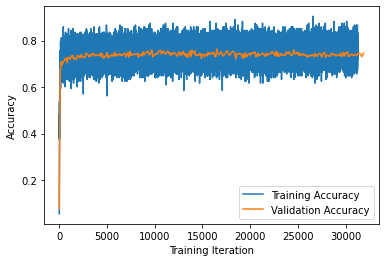

In [17]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies)), training_accuracies, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies)))), validation_accuracies, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()